In [1]:
import yfinance as yf

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas_ta as ta
from multiprocessing.pool import Pool
from sklearn.manifold import TSNE
import pandas as pd
import pickle
import numpy as np
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.neural_network import MLPClassifier

In [3]:
tickers = pd.read_html(
    'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
print(tickers.head())

  Symbol     Security             GICS Sector               GICS Sub-Industry  \
0    MMM           3M             Industrials        Industrial Conglomerates   
1    AOS  A. O. Smith             Industrials               Building Products   
2    ABT       Abbott             Health Care           Health Care Equipment   
3   ABBV       AbbVie             Health Care                   Biotechnology   
4    ACN    Accenture  Information Technology  IT Consulting & Other Services   

     Headquarters Location  Date added      CIK      Founded  
0    Saint Paul, Minnesota  1957-03-04    66740         1902  
1     Milwaukee, Wisconsin  2017-07-26    91142         1916  
2  North Chicago, Illinois  1957-03-04     1800         1888  
3  North Chicago, Illinois  2012-12-31  1551152  2013 (1888)  
4          Dublin, Ireland  2011-07-06  1467373         1989  


In [4]:
%%time
with open("hist_data_2018-1-1_2023-7-12.pkl","rb") as f:
    data = pickle.load(f)

CPU times: total: 0 ns
Wall time: 16.5 ms


In [8]:
columns = list(data["Open"].columns)

In [9]:
len(columns)

503

In [10]:
coli_with_na = np.where(np.sum(pd.isna(data["Close"]))>0)[0]
for coli in coli_with_na:
    print(columns[coli])

ABNB
BF.B
BRK.B
CARR
CDAY
CEG
CTVA
DOW
FOX
FOXA
GEHC
KVUE
MRNA
OTIS
UBER
VLTO


In [11]:
opens= data["Open"].drop(columns=[columns[coli] for coli in coli_with_na])
closes = data["Close"].drop(columns=[columns[coli] for coli in coli_with_na])
# Open	High	Low	Close	Volume
highs = data["High"].drop(columns=[columns[coli] for coli in coli_with_na])
lows = data["Low"].drop(columns=[columns[coli] for coli in coli_with_na])
volumes = data["Volume"].drop(columns=[columns[coli] for coli in coli_with_na])

In [12]:
opens.shape,closes.shape,highs.shape,lows.shape,volumes.shape

((1389, 487), (1389, 487), (1389, 487), (1389, 487), (1389, 487))

In [13]:
ticker="TSLA"
training_X=[]
training_Y=[]
correlation_Y = []
temp_df_full = pd.DataFrame(data={"Open":opens[ticker],
                         "High":highs[ticker],
                         "Low":lows[ticker],
                         "Close":closes[ticker],
                         "Volume":volumes[ticker],
                        })

In [14]:
def clamp(df,w_min,w_max):
    return (df-w_min)/(w_max-w_min)

In [15]:
t=0
window_size=25
temp_df = temp_df_full.iloc[t:window_size+t]
w_max = temp_df.max().High
w_min = temp_df.min().Low
assert w_min != w_max
ta_df_temp = pd.concat([
    clamp( temp_df.ta.sma() ,w_min,w_max),
    clamp( temp_df.ta.sma(length=20) ,w_min,w_max),
    clamp( temp_df.ta.ema() ,w_min,w_max),
    clamp( temp_df.ta.ema(length=20) ,w_min,w_max),
    clamp( temp_df.ta.rsi(), 0 , 100)
    ],axis=1)

<Axes: xlabel='Date'>

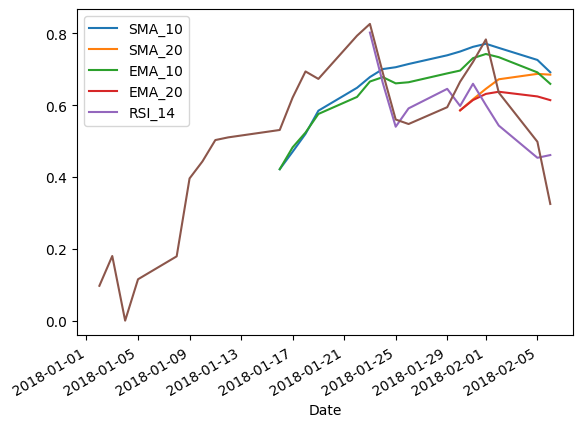

In [16]:
ta_df_temp.plot()
clamp(temp_df.Low,w_min,w_max).plot()

In [14]:
def funcc(x):
    ticker=x
    training_X=[]
    training_Y=[]
    correlation_Y = []
    temp_df_full = pd.DataFrame(data={"Open":opens[ticker],
                             "High":highs[ticker],
                             "Low":lows[ticker],
                             "Close":closes[ticker],
                             "Volume":volumes[ticker],
                            })
    t=0
    window_size = 34
    def clamp(df,w_min,w_max):
        return (df-w_min)/(w_max-w_min)
    while True:
        try:
            temp_df_full.iloc[window_size+t+1] # checks if y (unseen data) is available
        except IndexError :
            break
        temp_df = temp_df_full.iloc[t:window_size+t]
        
        w_max = temp_df.max().High
        w_min = temp_df.min().Low
        assert w_min != w_max
        ta_df_temp = pd.concat([
                clamp( temp_df.ta.sma() ,w_min,w_max),
                clamp( temp_df.ta.sma(length=20) ,w_min,w_max),
                clamp( temp_df.ta.ema() ,w_min,w_max),
                clamp( temp_df.ta.ema(length=20) ,w_min,w_max),
                clamp( temp_df.ta.rsi(), 0 , 100)
              ],axis=1)
        ans = ta_df_temp.iloc[window_size-1].values
        ans_prev = ta_df_temp.iloc[window_size-1-1].values
        diff = ((ans[0]-ans[1])/4+0.5,(ans[2]-ans[3])/4+0.5)
        diff2 = ((ans_prev[0]-ans_prev[1])/4+0.5,(ans_prev[2]-ans_prev[3])/4+0.5)
        ans = np.hstack([ans,(ans-ans_prev)/4+0.5,diff,diff2])
        final_df = temp_df_full.iloc[window_size+t+1] #takes the unseen data
        result = (final_df["Close"]-final_df["Open"])/(final_df["Close"])
        training_X.append(ans)
        training_Y.append(result)
        correlation_Y.append( temp_df["Open"].iloc[-1] )
        t+=500
    return [training_X,training_Y,correlation_Y]

In [15]:
funcc("TSLA")

[[array([0.48891094, 0.64435662, 0.5331757 , 0.5653204 , 0.51764942,
         0.49685883, 0.49723722, 0.50479923, 0.5014274 , 0.50201893,
         0.46113858, 0.49196382, 0.46151697, 0.488592  ]),
  array([0.64304915, 0.4629659 , 0.60660301, 0.48931392, 0.70439374,
         0.50719647, 0.50629509, 0.50568684, 0.50578032, 0.5073119 ,
         0.54502081, 0.52932227, 0.54411944, 0.52941575]),
  array([0.26601364, 0.40778988, 0.30528212, 0.3857355 , 0.43488505,
         0.49863819, 0.49640556, 0.49844223, 0.49714491, 0.49567943,
         0.46455594, 0.47988666, 0.46232331, 0.47858934])],
 [0.03073626569256726, -0.006627299714664859, -0.004223136248243692],
 [22.29800033569336, 52.4813346862793, 301.84332275390625]]

In [16]:
a1 = np.arange(5)
a2 = np.arange(5)+2
np.hstack([a2,((a2-a1)/4+0.5)])

array([2., 3., 4., 5., 6., 1., 1., 1., 1., 1.])

In [12]:
from funcs_3_0_2 import funcc

In [18]:
%%time
dataa = [ ticker for ticker in opens.columns[:3]]
with Pool(8) as pool:
    res = pool.map(funcc,dataa)

CPU times: total: 125 ms
Wall time: 18.3 s


In [19]:
training_X = np.vstack([r[0] for r in res])
training_Y = np.asarray([rr for r in res for rr in r[1]])
training_Y.shape
correlation_Y = np.asarray([rr for r in res for rr in r[2]])
correlation_Y.shape

(66232,)

In [20]:
newarr = []
for col in np.asarray(training_X).T:
    if np.sum(np.abs(col),axis=0)!=0:
        newarr.append(col)
training_X = np.asarray(newarr).T

training_X = np.asarray( training_X )
training_Y = np.asarray( training_Y )
correlation_Y = np.asarray( correlation_Y )

In [21]:
# %%time
# with open("hist_data_2018-1-1_2023-7-12_3_0_2.pkl","wb") as f:
#     pickle.dump([training_X,training_Y,correlation_Y],f)

CPU times: total: 0 ns
Wall time: 15.7 ms


In [29]:
%%time
with open("hist_data_2018-1-1_2023-7-12_3_0_2.pkl","rb") as f:
    [training_X,training_Y,correlation_Y] = pickle.load(f)

CPU times: total: 0 ns
Wall time: 6 ms


In [6]:
training_X.shape,training_Y.shape,correlation_Y.shape

((66232, 14), (66232,), (66232,))

CPU times: total: 297 ms
Wall time: 545 ms


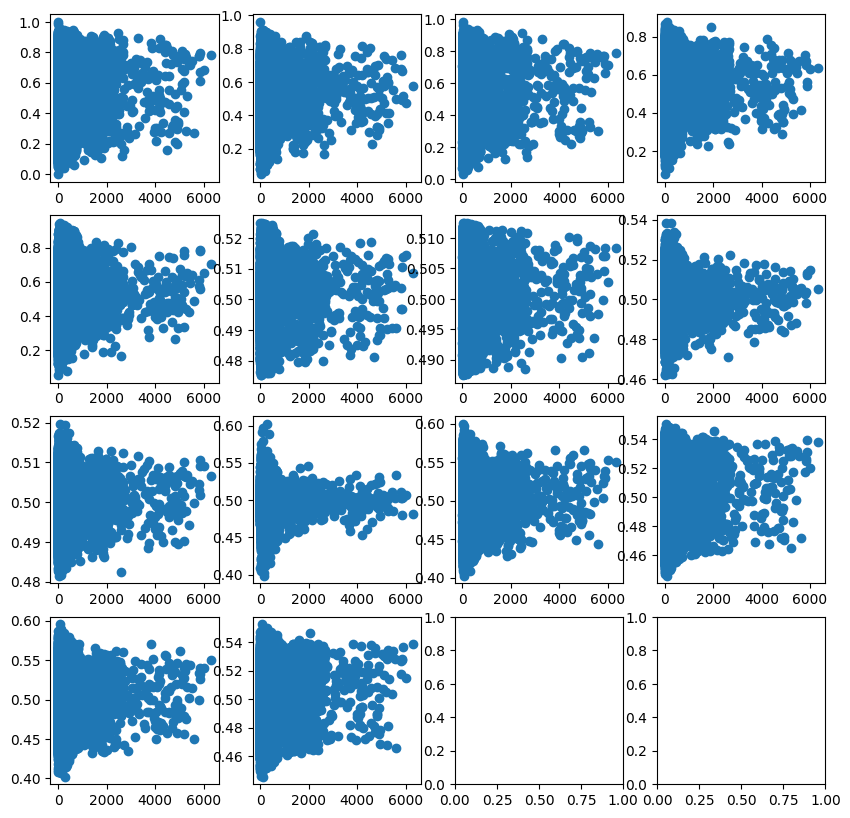

In [19]:
%%time
fig,axx=plt.subplots(4,4,figsize=(10,10))
axx=axx.ravel()
for scatter_i, ax in zip( range(len(training_X[0])),axx):
    ax.scatter(  y=training_X[:,scatter_i],x=correlation_Y)

In [25]:
X=np.asarray(training_X)

In [26]:
X[::6].shape

(4465, 14)

5
10
20
50
100
150
CPU times: total: 10min 40s
Wall time: 4min 5s


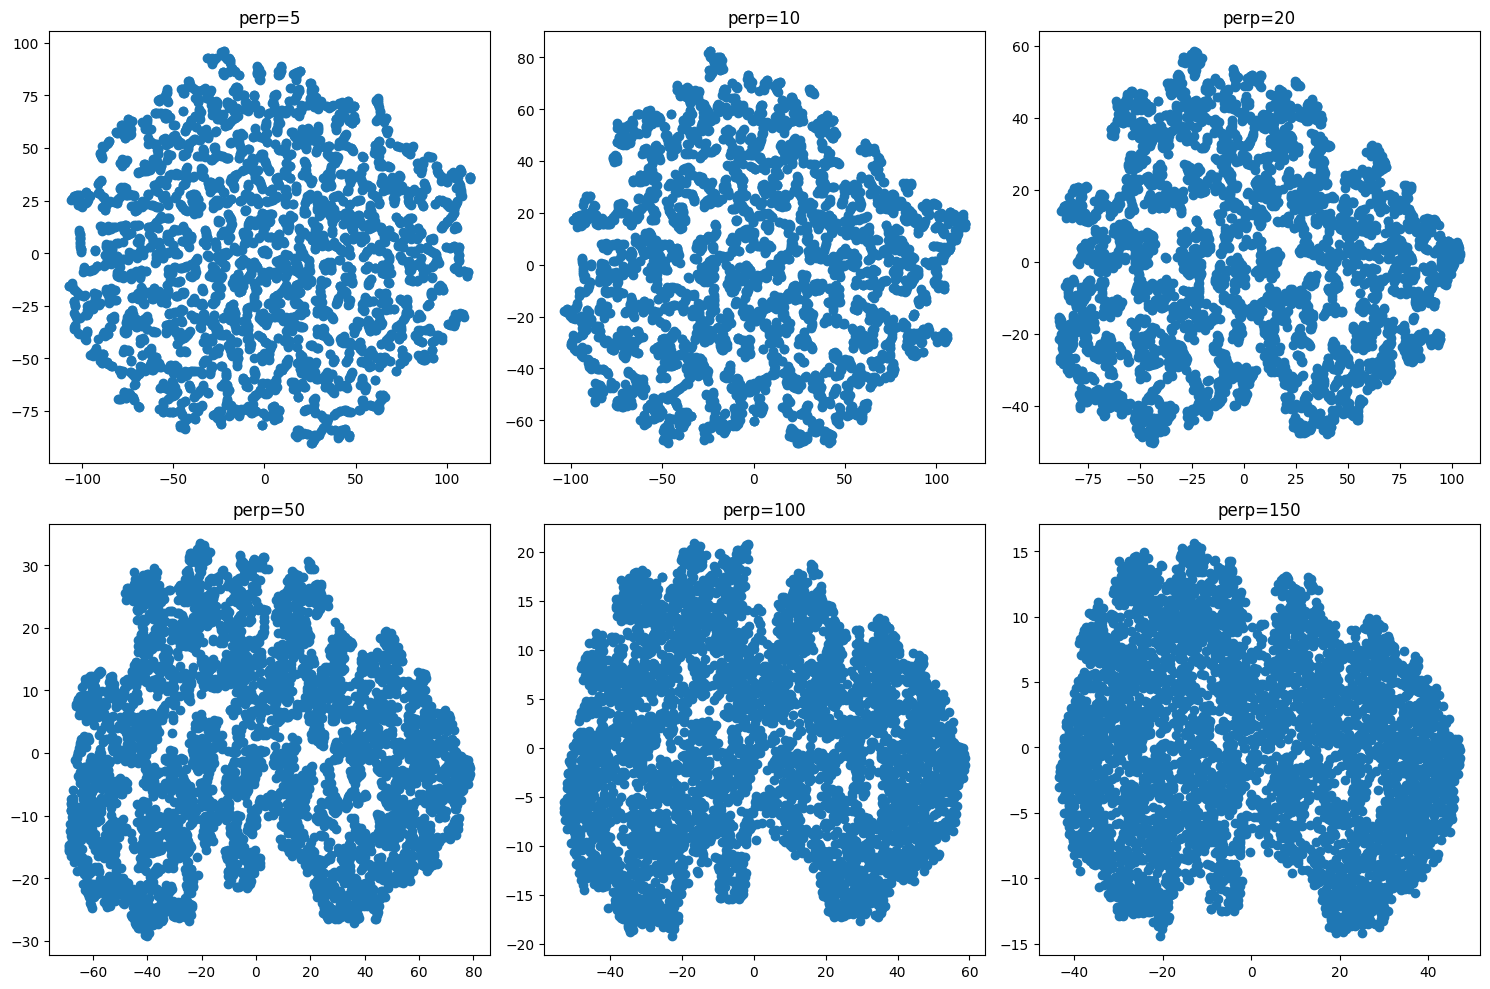

In [27]:
%%time
X=np.asarray(training_X)[::6]

fig,axx=plt.subplots(2,3,figsize=(15,10))
axx=axx.ravel()
for ax,perp in zip(axx,[5,10,20,50,100,150]):
    print(perp)
    X_embedded = TSNE(n_components=2,init='pca', perplexity=perp).fit_transform(X)
    ax.scatter(X_embedded[:,0],X_embedded[:,1])
    ax.set_title(f"perp={perp}")
plt.tight_layout()

CPU times: total: 46.9 ms
Wall time: 84 ms


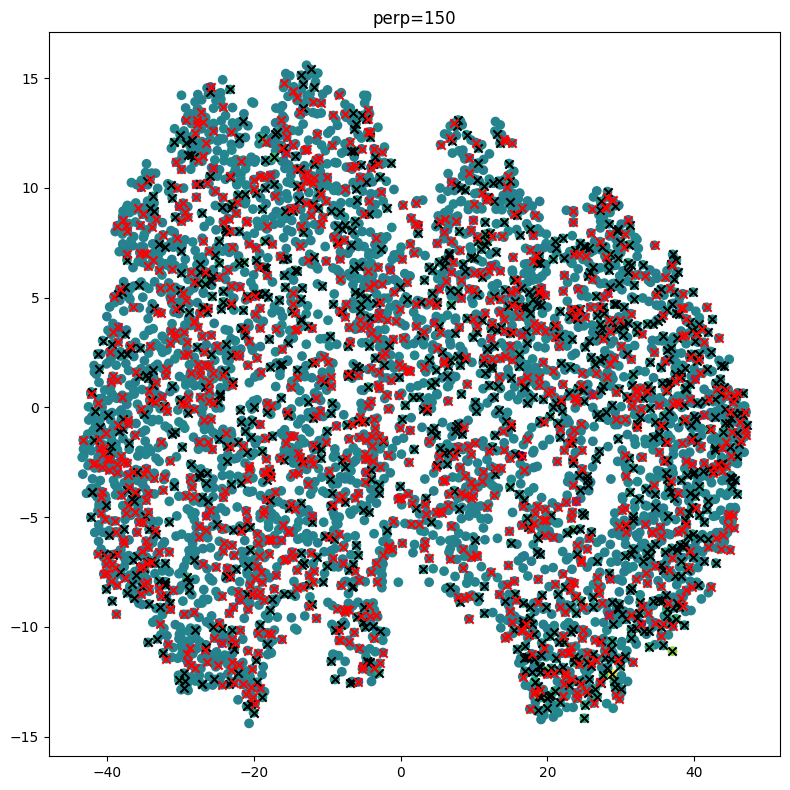

In [32]:
%%time
Y = np.asarray(training_Y)[::6]
threshold = 0.01
fig,axx=plt.subplots(1,1,figsize=(8,8)) 
ax=axx
#X_embedded = TSNE(n_components=2,init='pca', perplexity=perp).fit_transform(X)
ax.scatter(X_embedded[:,0],X_embedded[:,1],c=Y)
selected = Y>threshold

ax.scatter(X_embedded[selected,0],X_embedded[selected,1],c="k",marker="x")


selected = Y<-threshold

ax.scatter(X_embedded[selected,0],X_embedded[selected,1],c="r",marker="x")

ax.set_title(f"perp={perp}")
plt.tight_layout()

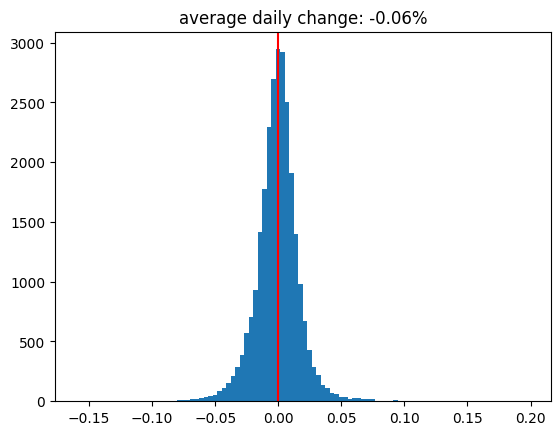

In [29]:
plt.hist(np.asarray(training_Y),bins=100);
plt.title(f"average daily change: {np.mean(training_Y):.2%}")
plt.axvline(0,c="r")

In [58]:
threshold = 0.02
train_data_y_discrete = np.asarray(list(map(lambda x: 2 if (x>threshold) else (1 if x<-threshold else 0),training_Y)))
Counter(train_data_y_discrete)

Counter({0: 52931, 1: 7168, 2: 6133})

In [59]:
sel = np.hstack([np.where(train_data_y_discrete!=0)[0],np.where(train_data_y_discrete==0)[0][::8]])

In [60]:
Counter(train_data_y_discrete[sel])

Counter({1: 7168, 2: 6133, 0: 6617})

In [61]:
X_train, X_test, y_train, y_test = train_test_split(training_X[sel], train_data_y_discrete[sel], test_size=0.3,random_state=109,shuffle=True)

In [62]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((13942, 14), (5976, 14), (13942,), (5976,))

In [63]:
import sklearn

In [64]:
sklearn.__version__

'1.2.2'

In [65]:
%%time
# works, 5mins
clf = MLPClassifier(random_state=15, max_iter=500,hidden_layer_sizes=[150,150,50,10,50,150],).fit(X_train, y_train)
# works, 43mins
# clf = MLPClassifier(random_state=15, max_iter=500,hidden_layer_sizes=[150,150,150,150,150,150],).fit(X_train, y_train)
# works, 6mins clf = MLPClassifier(random_state=15, max_iter=500,hidden_layer_sizes=[100,50,10,50,100],).fit(X_train, y_train)
# doesnt work, 1.5hrs clf = MLPClassifier(random_state=15, max_iter=500,hidden_layer_sizes=[250,200,150,110,150,200,250],).fit(X_train, y_train)


CPU times: total: 29.7 s
Wall time: 1min 12s


In [49]:
y_pred = clf.predict(X_test)

In [9]:
from joblib import dump, load

In [27]:
dump(clf, '3_0_2_ema3_py38.joblib') 

['3_0_2_ema3_py38.joblib']

In [30]:
dump([training_X,training_Y,correlation_Y], '3_0_2_training_data.joblib') 

['3_0_2_training_data.joblib']

In [28]:
dump(["some random thing"], '3_0_2_eg.joblib') 

['3_0_2_eg.joblib']

In [19]:
clf = load('3_0_2_ema3_py38.joblib') 

In [20]:
import joblib

In [21]:
joblib.__version__

'1.3.2'

In [22]:
X_test.shape

(19870, 14)

In [23]:
y_pred[0]

NameError: name 'y_pred' is not defined

In [57]:
Counter(y_pred)

Counter({0: 19765, 2: 37, 1: 68})

In [55]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred,average=None)) 
print("Recall:",metrics.recall_score(y_test, y_pred,average=None))

Accuracy: 0.801107196779064
Precision: [0.80258032 0.51470588 0.54054054]
Recall: [0.99811238 0.0162413  0.01097695]


In [56]:
y_pred_train = clf.predict(X_train)
print("Accuracy:",metrics.accuracy_score(y_train, y_pred_train))
print("Precision:",metrics.precision_score(y_train, y_pred_train,average=None)) 
print("Recall:",metrics.recall_score(y_train, y_pred_train,average=None))

Accuracy: 0.8014106380225184
Precision: [0.8021075  0.56291391 0.84444444]
Recall: [0.99881203 0.01695591 0.01762932]


In [53]:
Counter(y_pred_train)

Counter({0: 46121, 1: 151, 2: 90})

In [51]:
with open("3_0_2_raw.txt","wb") as f:
    f.write(pickle.dumps(clf))

In [53]:
with open("3_0_2_raw.txt","rb") as f:
    fff = pickle.load(f)

In [54]:
fff

MLPClassifier(hidden_layer_sizes=[150, 150, 50, 10, 50, 150], max_iter=500,
              random_state=15)

### save model

In [46]:
#with open("3_0_2_test_save_model.clfpkl" ,"wb") as f:
#    pickle.dump(clf,f)
with open("3_0_2_test_save_model2.clfpkl" ,"wb") as f:
    pickle.dump(clf,f)

In [38]:
with open("3_0_2_test_save_model2.clfpkl" ,"rb") as f:
    s3 = pickle.load(f)

In [39]:
%%time
y_pred = s3.predict(X_test)

CPU times: total: 1.36 s
Wall time: 652 ms


In [40]:
Counter(y_pred)

Counter({0: 19811, 2: 11, 1: 48})

In [41]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred,average=None)) 
print("Recall:",metrics.recall_score(y_test, y_pred,average=None))

Accuracy: 0.8002516356316054
Precision: [0.80112059 0.41666667 0.90909091]
Recall: [0.99861574 0.00928074 0.00548847]


In [44]:
import sklearn_json as skljson

In [45]:
skljson.to_json(s3, "sklearn_clf.json")

In [54]:
skljson.to_json(clf, "sklearn_clf_150x6.json")

# import from qc

In [36]:
bytestring=b'\x80\x04\x95\x92P\x00\x00\x00\x00\x00\x00\x8c-sklearn.neural_network._multilayer_perceptron\x94\x8c\rMLPClassifier\x94\x93\x94)\x81\x94}\x94(\x8c\nactivation\x94\x8c\x04relu\x94\x8c\x06solver\x94\x8c\x04adam\x94\x8c\x05alpha\x94G?\x1a6\xe2\xeb\x1cC-\x8c\nbatch_size\x94\x8c\x04auto\x94\x8c\rlearning_rate\x94\x8c\x08constant\x94\x8c\x12learning_rate_init\x94G?PbM\xd2\xf1\xa9\xfc\x8c\x07power_t\x94G?\xe0\x00\x00\x00\x00\x00\x00\x8c\x08max_iter\x94M\xf4\x01\x8c\x04loss\x94\x8c\x08log_loss\x94\x8c\x12hidden_layer_sizes\x94]\x94(K\x96K\x96K2K\nK2K\x96e\x8c\x07shuffle\x94\x88\x8c\x0crandom_state\x94K\x0f\x8c\x03tol\x94G?\x1a6\xe2\xeb\x1cC-\x8c\x07verbose\x94\x89\x8c\nwarm_start\x94\x89\x8c\x08momentum\x94G?\xec\xcc\xcc\xcc\xcc\xcc\xcd\x8c\x12nesterovs_momentum\x94\x88\x8c\x0eearly_stopping\x94\x89\x8c\x13validation_fraction\x94G?\xb9\x99\x99\x99\x99\x99\x9a\x8c\x06beta_1\x94G?\xec\xcc\xcc\xcc\xcc\xcc\xcd\x8c\x06beta_2\x94G?\xef\xf7\xce\xd9\x16\x87+\x8c\x07epsilon\x94G>Ey\x8e\xe20\x8c:\x8c\x10n_iter_no_change\x94K\n\x8c\x07max_fun\x94M\x98:\x8c\x0en_features_in_\x94K\x0e\x8c\x10_label_binarizer\x94\x8c\x1csklearn.preprocessing._label\x94\x8c\x0eLabelBinarizer\x94\x93\x94)\x81\x94}\x94(\x8c\tneg_label\x94K\x00\x8c\tpos_label\x94K\x01\x8c\rsparse_output\x94\x89\x8c\x07y_type_\x94\x8c\nmulticlass\x94\x8c\rsparse_input_\x94\x89\x8c\x08classes_\x94\x8c\x15numpy.core.multiarray\x94\x8c\x0c_reconstruct\x94\x93\x94\x8c\x05numpy\x94\x8c\x07ndarray\x94\x93\x94K\x00\x85\x94C\x01b\x94\x87\x94R\x94(K\x01K\x03\x85\x94h4\x8c\x05dtype\x94\x93\x94\x8c\x02i8\x94\x89\x88\x87\x94R\x94(K\x03\x8c\x01<\x94NNNJ\xff\xff\xff\xffJ\xff\xff\xff\xffK\x00t\x94b\x89C\x18\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x02\x00\x00\x00\x00\x00\x00\x00\x94t\x94b\x8c\x10_sklearn_version\x94\x8c\x051.3.2\x94ubh0h:\x8c\nn_outputs_\x94K\x03\x8c\r_random_state\x94\x8c\x14numpy.random._pickle\x94\x8c\x12__randomstate_ctor\x94\x93\x94\x8c\x07MT19937\x94\x85\x94R\x94}\x94(\x8c\rbit_generator\x94hL\x8c\x05state\x94}\x94(\x8c\x03key\x94h3h6K\x00\x85\x94h8\x87\x94R\x94(K\x01Mp\x02\x85\x94h=\x8c\x02u4\x94\x89\x88\x87\x94R\x94(K\x03hANNNJ\xff\xff\xff\xffJ\xff\xff\xff\xffK\x00t\x94b\x89B\xc0\t\x00\x00\x1dC< \x94\xb7d\xe7"\x93\xb8>\xa7\xbc\x9c\t\xba\xfb\x1e\xb2<\x8e\xb1\xa0\xc5l\xeeB@\tTH\x83\xb6\xd0\xae\xeer\xa8\xd3]6\x8a2#o\xff$\xed}\xb8\x84k!\xfc\xe8#\xf4\xc9\xa5\x15\x81~\x18=\xf9\x170\xfad\xa7\xff\xfc\x1c\x16\xb2\xee\x04\xf7\x80\x16\x88\x1fh\xc8\xc3\xc54\xd1\x18Z|\x9f\xe4\xea\xa0\xa3\x11\xf7\xffa\xa8\x7f\x85l\xc0\x96\x1a\xa4\x94\x94\xea\x1c|]\xf5=\xa4&)\x1b\x17\xc6\xa2@\xb4\\\xdd\x84\xe3\x92\x99\x95\xa0XF\x87\xd1\xf4\xe8]\xbb\x05:R\xdbY|7[\xdf\x01\xea\x1f\xd5\xc2\xcc\x934\x93*\xae\xd5\xf6\xde\xa4\xb8\xd6\xfd\xe5!K=rU`j\x08D\xccD1\x9b\xb7b{\x94\xf8\xc36M\xbb`\x8e\x1b\x8ch<>\xd5\xc8\xae\xf15\x04\x0ek\x1a\'\x842\xc4V\xeb\xbb\xebp\xe7\xc5O\x0f!\xf5[\x8eSqj\xde\x818\xb6\xd1x\xdf$\x93\x1b\xac\xddF\xba\x98\x18\'\x0e\xa7\xf5\xbd\x91 \x90\x86 \xac\x94R!\x1b\xfd4\xa1\xa22\xd6\xc8\xd7\x7f\xfe3\x81\'\x9b\'l\xf7\x91\xafx\x9bWh\xc3\xf7N+\x86-\xa7\xcb\x07\xa2\xbb(s?\x82O\x17x\x15\xfd\xaa\xe4\xf2d,h\xd1x\x1a\xc5\xd3\xf4\x7f\xa0\x1e\xca\xe7\xb1\x12\x11\xd5\xda\xe8]`\xb5#Pd\xc0\xdc\xd20&\xa1}%\xe6\xed\xa2\xdd\xf3)\x927\x116@\x01\x02\xff\x83!\xf1\x01\xe5n*\xe6\xf5K\x97J"\xbd\x83w\x15~\x8dK:\xcc\xaf\xbcV\xebi\xbf\x00,\xa7\x9d\xdd\x17c\xb3\t<\xb0\x97_\x11\x12\xfa\x8f\xd8\xfc\xb0H\xca\x04\x9d\xf0\xb3JN+K/\x0c\x05\xf5\x9d4\xbcG\x92\tlyI\xb4\x0fI\xf0W\xd8=\x90:\xa0\xb8B/\x8e\xbc\xafgl=[\xa5+\xd4if\x1fgh\x90\ru\xb5\x04\xdb\x92\x84Q\x15\x0cEn\xa2\xc1\x13\x16\x01\xdb\x15\x855\x86\x1a\xb0Y\x99\x92S@\n\x01uof\xfd\x89)\x9b\xe2c\x87\xa8s\xf5p\xb8/o4?o<]YM\xbf\xd5\r\xf0$\xfd\xbf\x85\xf3\x9a\xc3\xbc\xb0H\x0f\x8c\x15\x82\xa2w\x9d{/\xdb\xf5\x95I\xf2\xfeg\xe4H\xc6\x0b\xf3\xd0cv\r\r*KS\xf4\xeb\xff\xb2\x89\x85[Z\x00]\xb3^\x06\xa3\\(\xa3\xcd\xecM\x81\x95w\xe1\xd6\x1b\x8fYY\xa4\x00\xc7\xd3m\xb7A!/}\xc7\x11\xe5k\xfa#\rq|\xbc\x82\x03jc\xb9\xf0\xef\x12 .bB^\xb6\x9f\xcbt0]b\x93Q\x88\xbb|\xcf\xba\x99\xa9\x80s\x1cB\x80\x99e\xb9\xc6\xcf\x18\x95W0\x1e\x00\xda\xb8\xe1\x8c\x7f\x02\x16\xba\xaa\xafR\xab\x8678t^\xdd\xfbK\\1j.\xc3\xba\x08\x02~\x19#R\x9d\xa5\xea\xaa\xc28j{\xc6*X\xdd\xcam\x10\x18O\x07\x9f#\xbdoO;\xd50d\xf9B\xba\x14\x84\x03\x84_\xeb\xe4+7\x00\x1dB\xd7\rF\\\xaa\xbc\xe1ENq\xac\\-wO\xef\x97\xf5a\xdb\xde\xf1|9\x8bC\x0c\xb8J\xeaKR\x03<\xabSWLV\xd8-\x9a/R\xeb-\xa27\x93\x91]\xdb\xed\x8f\x80\xd41X\x83\x05<\tn\x82\xb1\x18\xc3\x14\x9d\x94\xdfI\xa6w^\xf2\xe9\xe7\xef\x9e\x1b]0\x98\xcb\xc5\x14\x05\x90\x8e\xe4\x0c4\xee+\xa6\xb4\xe9\xef\xc0p\x1f\x8a .\x05\x0e\xab\xa4\xc5\xedu@\xe48S<\xd0\x9c\xb1\xc0d:H\xc56\x92\x7f\xb0\x80\x8c\xed\xde\xea\xf0\x06-{<\xf5\x96\x8a4p#w\xd6\x0f\xd0"b\xbbl\xd5\xb4aB?\x02x\xaa|\x18k\xd126.\xf6\xcf\x17\xa6\x08{m\x0f\xe4\xfb\n\xb9\xfa|[.aT\xa1qN\x95X\x8f%\x0c>\xd4\xb9\x96\x18\x06\x99\xef\x9b\x13\x96\xf4\xd6\x0esvk\x88OK\x06j\x00\xe87\x02\xa5\xf3W~n\xd2\x81\x1f\xf7\xd8Y\xbc\xe6\xdfot\x1c\x82\xf0zt_\xcdd\xa0 @y\xaa\x08\xe7\xe4\xd1g\x9b(+\xdbD\x93\xb0>i\x0b\x9be\x91*C\x18x\x14\xbd\x00j\x94\xe7\x14\xbd\x968b!\xf7\xf3V\x94\xf4\xde\xa7\xd1/\xa6\xba\xeb\xf6\xcfc}bP\xc4\xf5z)\xb0a\xa1JgON\xd8\x1ap\x8fG\xaa)\xe9\x7f\xf9\xf8\x97\xa8\x91\xe9\xd3\xbaPu\x1e\xcb\xd3\x0e\x1c~S\x91\x97\x198\xafq>,\x9a\xfb\xab\xfd\xd3\xa8\x921s\xa1\xed\x85\x9b\x8e\xb5\xdb\xa3*T3]D\x89"\xdd\xea4\x02Lb;\xbc\xdb\xad\xc5\x12\x88\x9b\x17\xe2\xd1\xac\x81\xd1\x11$\x96\x8b8H\x82|E\x81\x80_\xe3\xddh\x95\xab\xa1@F\xaa>5B\x07s5\x97v\x03\x17h\x9aj\x93\xeb\xdeJ\xc9;\xcc\x16ZX\x8dqf\xa98\xd81\xba]m\xcb\xf1h\xabu\xc9k\xce\xdf\xa8\x8bS]\xf5\x0fqx5\xd2\xe7R)T\xca\x16\xd9\x0ePq\xd3\x19G\x0f\x1b\x07\xc335\x06>\xaauTeEo0\xc0(@\xc3\xdd7E8\x9b/\xa6\xa5m\xc8\xca("\x99(\x8e\x12\x8bb\xab\xf5\x8a\xa9Z<\xb2\xf7\x86\\\xaf\xfb\xd1\xd5\xdb\x87\x9c\xcd%\xba\xd7\xd0\x909=\xbf\xd8\xb8\x98K\x155r\x9b\x96H\xb0\xa1d\xe6\xb2\xeb\xfd\xed\x00\xda$\xe2QC\xd1\xb0\xde$z\xc0\xdf~\xca\xbfx\xd28E\xa0Os2\xe9?5\x83\xef%\x9a/\xf7C\x88\xf6\xd1K(2\xd3\xf4|\x14\xad(\xb39\x93\xee\x15\xc6d\x13u\n\x9f\xa8BAa>\x86:\xe1\xabMu\xc8\xc0\xbe\xea=#\xe4\x00\x89TH\xf1\xbe9\x96\x82F\xf7\x93\xdd\xcb\xabg\x9d\xa3\xd4\x8b/\x15Ae\x99I\xeb\x0b\xaa\xf4?\xd2\x91\x17\xdd\xe2\xf1~\xee1/\xdbq\xd4^/\xe6\x94l\x9a!I\xe1\xb8\x12\xfa\x0f\xf2)W\xaa\n\x8b\x89\xe6>\xa3`\x0eJ\xcf\x14\xb2\xb6R\xa6\x90\x9d\xb61\xad\xbe\x1de\x04Y\x00\xbd\xf4\x14\xbd\x8e\x94ia\xe7\x80x\xd9vt\xc4\xfc52\xb4nu\xfcgj\xb7>\x0c\xaa\xa9\xdf\xc2P\x99\xeej!8\x1d\xca\x1a\x98fUf*\x914\x9c\xf5YR\xeb\xec\xd1\n\xc5\x0c8o\xb7\x88%k\x9bOE\xcc/\xd5\xa4\xf8:\xcdcy\xbb\x01\xb5:*Q\xed\xe7C\xa0u\xf4n\x17\xb0\xe5\x1e%!9\xef\xb5\x1d\xf1\x02\x00\'\xcd(\xeeb\xd5v\x86\x85#s\xaf\xfcg6-\x00\xa4\xa1h\xd8\x04\x85\xd0\xda\x16\x92\x82\xd8\x88\x92\xcc\xa4n\xd0~\xd2\xaa7\xf6\xb8\xdf\xf5\x92\x97\x8c\x1a2\xe7\xac\t\xd0\x88\xa2\x11\xe9\xe6{jh\x92M9\x83>l\xcc\xa8L\x05V\xcb\x91\xbc\xd5\xff\xc9}\xd61\xae\r\xec*\xdf\x1e_\xaci,1\xa3&uP\xeb\xb7\x11\x9e\xabZ\xd9\x95\x0b\xc0\xcb\xd0G\xb8\xd6\xfd\x08C\x1f\x80\xba\x7f\x7fc1\x1c;.U\r:\xb9s\xeb\xb2z\x96\x1ex\xad\xcf\xab\xce\xac*\xc4\x8e\xb3\xdd\x9f_\x01\x04\x90`S\t \x93\x91X\x11\xad\xfev\x90\x1e\x06\x13q.\\P\x9au\xd4iq\x96\x14\x07\x89F\xf0\xda\xfb\x92\xad\xc1\xd8\x83\xe9\x06\xaeI\xaa\xb8\'\x8b\xd9\x00\x87\x89\x0ex\xd6\xefW\x86\x19\x9bSX.\x90\xa4\x12\x01-\x99\x0b\xba\xe5o\xfcs\xa3\xd0\x8ceC\tE\x94(R?\xe6izh,\xc4\xaf:7\x86\xb7}x\x04M\x07\xa3\xad\x04\xc850\xb5P30HD~\xae\xe8=\x8e\x10FQ_\xd7\x91#:=\xc2QM>\xf6\x16\xad\xf1\xcfv\x00)\xdc\tpd\x0c\xe2\xb7g\x1c\xc0>\xdd/\xd1\x9cnV\xe3\xc3\xef\xde\x9e@O\x19iq\xad\xd2{P\xd9\xf8\x916\x1dq\xa1\xfb\x8e\xb9E\xf7\x99\xc0\xffqG<\x8e\xbc\x1f\x9c\xdd\xd0\xf0\x08\xe1\xa2\xda"\xe9^z&\x84$\xaaf\xa5\xf1\xb5\x08~>P\x933X\x9e=\xcf\xa6\xfaQ\x15\xedD\xdd\x12\xff\x89\xb3J\xb7\x0f\x88C\x9b,\xac\xec\x9bvU\\Wb\\\xfa\x85\xe0\x17~\x0b\x8b\xcb\xce\x9d<\x9dNH\xddmR@\x81\x99\n\x95]%\x81\x9d\xfeX\x1fK\xd3P\xf2\x97)\xe8\xc2/pob\x8d\xcc\x1d\xa63\x18A\xfb\t\xf0l%\xd8\xcf\xcdL\x17>\x9c\x89M\xa1G\xdf\x10:\xb5\xe0{\'6:\xb4\xd1svI\x00\xf0\xeb\xb0\x87\x80j\'m\xbc\x0c\xab_]\x87}e\xfb\r\xa6\xc0c\xf9:\x9b\x81\x1a\xc9K\xd5\xb8\xabE\xc7\xa9X\x00 \x93HB\xe7\xc7\xb7\nh6\xdf\x877\xbe\xe6\xc2\xb7\xa1\xc8\x87\xa0-wo\x94\x85Oku_\xc6=Cxc\x80\xdf\x1a\xdfI\x94\x92\xb2\xcb\x9e\xe9\'5Rs\xe3,\xe19\x92\x0b\xd4S\xa0\x84K\x9f\xb1#n\xdex\x9d1\xbe)\x92k\x8a\x01R\xd0\xadt\xca\xec\x97\xae\xb9\xe6\x92\x8fyo7\xb3\x15\x95\xc5c|\x9e]J\xebT\xcb\n\xf2y#}]]\x03\x17\x8e\x1d\xd2\x8f"\x97\xd2\x802\x83Gs\xb2`\xf0\n0p\xed\x1d!5\x9dP\x9a\xb8\x1b\xc2\xda\xd5X*1\xfae\x83u\xf6\xbc\xe1P?-\x87uK\xf8\xf7N\xdem\xb1\xb3\xc7h-\xdf\xcc\xe7\xcf\x8e\x1d\xdc6\xae\x04\xda\x92\x0es\xe0W\xa5E\xc5\x01i$8\xa7h\xe30]Hou\x18%\xe3\x16\xad\rt\xc0\xee\xd1(\xf8~\xab\xb6\x0c\x9c\xdb\x13\xec\'\x02\xccX\xac\x10\xe9\xd6\xa82\t\xf8&\xd2\xb9\x00\x15\xeb\x19:\xe6\x8d:p\xe3\xd5v\x18\xda\x89B:\xdb\xeb \xb3T\xae\xa4\xc3\x9b6\xb7\xc3\xa1\x0eb\x9f\xf3\x0e\xc7-S\x16v\xe5\x87\xa2\xe3K\xdfHu\xf8qU,8~|-\xb6\x94m5\xb7\x85a\x14\x1f\x888\xec\x8c\t\xf0\x16\xa8\x8f|\x91\\Gp\x98\x02s\xe4\xd7\x8f\x1c\x9bYsQ\xdeD\x91\x98\xe4\xa28\xd3\xd8\x92b\xd2\xd6\x8f\xbd\xba \x08\x9f2W\x06LHg\x91\x8ci\n<\xca\xe2^ J\xebz6\x01IB\x94\xb9\x06\xb8l+P\x12\x8c\x18\x08\xa9\x01H\x14w#\x03\xb7-P\x99Wa!\xd3\xde\x14\x95\xa4\x80z\x8f#\xcb\xd9\xd4\x0e\x02\xc0i\x8e\xffR\xdd\xb7\x9d\xd9i\x00\x8fX\xa5\xd2\xcb8\x15\xe4\xc8\xff\xfa\x1fsL\xbdqGo\xb7\xb9/]\xc0\x82\x04\'c\x96\xc6\x1d\x0c\xbb\x94t\x94b\x8c\x03pos\x94K.u\x8c\thas_gauss\x94K\x00\x8c\x05gauss\x94G\x00\x00\x00\x00\x00\x00\x00\x00ub\x8c\x07n_iter_\x94KM\x8c\x02t_\x94J\xdbV\x02\x00\x8c\tn_layers_\x94K\x08\x8c\x0fout_activation_\x94\x8c\x07softmax\x94\x8c\x06coefs_\x94]\x94(h3h6K\x00\x85\x94h8\x87\x94R\x94(K\x01K\x0eK\x96\x86\x94h=\x8c\x02f8\x94\x89\x88\x87\x94R\x94(K\x03hANNNJ\xff\xff\xff\xffJ\xff\xff\xff\xffK\x00t\x94b\x89B\xa0A\x00\x00\xbd\xcfs\x05\rm\xc8?\x92V.\xeb\xc9G\xc2\xbf\xd7\xc5z\xb7\x14\xff\xa9\xbfj\x0c\xb0\xf1\xacP\x1f\xbe\r\xbd~\xf4 \xb6\xb7\xbf\x08b_\x95?\x92\x9f\xbf-\x97\\\x9d\x12F\xf4\xbe\xd8\x83\x04Bqb=\xbf\xac\x1b\xbb\x90\x9eS\x0f\xbf\x8f67\xdf\x81\x82\xc2\xbfk<\x85\xe4sh\x1c?\xca\xa1\xc5\\\xd2\xc7\xc4\xbfm\xde\xa5\xf3\x980\xb3?\xd62e\xf3s\xe9\x02?\xb6\x99\xa3X\xe4\xf6\xdf>Zt\xe1\x97ti\xd2\xbe\xfb\xb6\x96\xddA\x90\xf0\xbe\x9d\xb3g\xb0x*\xa6\xbfp+3\xd0r\xe8\xcc\xbf\'\xd6\xd9\x12a\x91\xd9\xbe\xf6Q\xc9\x8b\x12-\xc7?\xdd\xe7\xf6&\x8e\x16\xb0\xbf\x8b:b\xcd\xe8\x18\xbf?\x0c^,i7\xca\xa7\xbfmX\x1d\xea\x8c\xb8j\xbfi\x1c\x82\xe0\x19o\'?u\xb6\xdcW\x14\xed\xc9\xbf&\x0c\x86N\xdc\xd0\xf8\xbcsh\x1eca@\xc8\xbf\xe3\x14\xb9\x92A\xd2\xfe<LP.il\xd1\x80\xbf\xf4\xac\xc1k\xc3$\xfe<W|\xa6\x8aB\x00\xb1?\x94\xb7,\x8bf\xac\x18\xbe\xa3\xf3\xce\xa9\x12\x81\xa3?X\x03\x89\xde\x15Y\x82?{i\x101\xf0\n\xa6\xbfj\x8d\x98\xab\x82\xfb\x91\xbf\xf1\xa1\x0f\x92-\x88\x94\xbf\xcd\xd1\x8b\x19r\xe9\xa9\xbd\xe8%\x19\x06\xaf\xe9\x1d\xbf\xf8\xab-l\x8a\xae&\xbfQ\r\xc4\x04lT\xc0\xbf\x18\x13\x9e4\xaf\xb0\xb0?\x9a1\x1b\x9byy\xd0\xbfjo~\x1c\xdf\xd7D<L\x88]\xfbw\xa7\x03\xbf:\xea\x15u\x16\x03\xbb\xbf\x85Q`\xf6.\xbb\x8b?b\xf4Ef\x14e\xa5\xbf\x9f\'{\xb8N\xc4\xca?{yc\xd3\x92\xd7\xa0\xbf\x04\xe1\xf3\xfd\xb5\x91\xc5\xbf\xeff\xfe\x8b\xf4y\xaa?:\xdf\x11\xe5\x89j\xba\xbf,P\xcf\x00\tP\xc2?\xcc\xe4G%\'\x15\xc4?\xc5<\xaa\xa7\x03<\xa2?\xf6\xe5\x85\x1f\xddap\xbfQ\xbc\xb0\xe3\xef\xa6\xd3\xbf\x16{\xb5r\xd3\xb3\xb2\xbf\xc3\n\xa1\xe3}\xfa\x14\xbf\xa4\x84#\x8b\xfaH\xb4?\xfeK\x8f\xa6O\xf3q\xbf\xa6\xbe\xef\xd9\xa6|\xb6\xbf\xfe\xe9\xea\xf4\x8b\xfd\xb9?\x0b~\xe4\xac3P\xab\xbf\xc1\x16\xbeq\x1b\xb5\xca=;\x9c\xef=\n\x81\xc7?6\rJe^\xd4\xfc<{F\xe8_\x9bu\xc2?\x95W\x06\xb3P\x82\xca\xbe\x8f|\x8cDI\xff\xc2\xbf\xbfz\xba\x03!\x80\xcd\xbf\xb2T|\xc6\x9c\x84\xc3?\x12\xab\x85\xed\x17\xa7\x1a>TH 0\xc2\xcc\xa4\xbfm\xa0\xa5]\x13KH\xbf\x179!%\xa8\xb9\xc2?U\xf2\xcf]\x82\xa3\xc5?\xb9\xd1k\xc0;\x9f\xcc\xbfz\xed\\M\x08\xcfw\xbe\xf1D\xd7p\x9dGR\xbf#\xa2Z\x1b\x1e\x10\x8a?\x01\x7f\xac\x0cA\xc8\xc1?\xea2\xf2\xe0v\x9c\xb5\xbfT\\\xee\xb2\xd7\xa9\xa1?%\x92\xebe\xc1\x9c\xb0\xbc\x13\x91\xe2\x03,n\xc2?_:\xc4/k;\xc4\xbf~\xad\xcc@t\\;\xbf\x95\x9bP\x90\x9f\xae\xcd\xbf\x8d\x1fV@\xbaHT?\xc8\x02%w#\xb1\x92?\x11\xfaJ\x95A\xf6F?\x8b;"\xb1\x96\x19\xc8?\xc0\xdc\xe1>{\xdc\xc0\xbf\x97\x7ff\x1bJ#D\xbd\xce\x0f\xaf+l\xa8\xca?\x88\xea\x03\xe0\xc3\x05\xc2\xbfoe\x0f\xfe\xdb\xe6\xa5\xbf\xf1\x15eY\x1c\x9b\xac?\xc7L\xf4\xa1d\x87\xb4?AX\xba&\xb1\x072?Z\xaa>zU\x92\xad?\xbd\x97\x06\xbd\xa3\x11$?:g\x83w\xb2\x02\xbd=\xb8q\xc5\xf8l,\xc2\xbf\xe7\xc0\x89?\x0cS\x87?\x9f\xedII\x7ff\xc0\xbc\xfa\xc9\x05S\x18{\xcd\xbf\x93sl\xfa\x96\x9a\xbb?z\xc1\xaf\xae,\x14\xc2\xbf6`5hg(@?\x1dU\x88*\xb7DN>\x9d\x82\xc5g=\xda\xb3?#m\xb1Z\x14\xe0\xc5?\xaf<\xf2\x85\xd5\x11\xc0\xbf\x17\x83\r\xb3Z\xbf\xd2\xbe\x80\x7fb\xc2\x12~\x8a\xbf\xfb\xc7.\xc7P\x0c\xa4\xbf\x92h\x95\xabg/\x84\xbf\x12I\r\xc3\x08\xb2\xcc?J\x00\xb3\xa2V\x19f?8\x05`\x1a(v\xad?\x982\xd9\xaap\xd1s\xbf%\x1e\xc7A\xdfI\x81?\xe4\xa7\xf0\x16\x80\x06\xbe\xbf/F\x99\xc0\xf9i\xbd\xbf\x91\x01\xa6\xe9{!\xc1? \x8f\x11\x91\t-\xb8\xbf\xcc\x9f\xa5T\xe5\xef\xc6\xbfTx\x17\xec`\x08\xca?\x9f\x965\x90\xd6\xd5\xae\xbf.m\xd5w\x82\xb0`>^\xa1e\x0b\xbfc\x9e\xbf1\xbf\x91\xda\xefL\xa9?#\x9e\xc6F\xb2\xb8\xb8\xbf\xdb\xa3\xd8\x15\xc8\xee\x97?\x82K\xb0\xafU\xbc\x9c\xbf[q\x10\x83\xf8\xf4\x0c\xbf\x0eA\x06T\x9eL\xf4\xbe\xe5.\xc0+^\x9d1?\x7f\x94V\xb8\x03+{\xbf\xa6\xa7\xd20%T\x0e>\\,\x8a\xb6\x19\xf9\xc3?\xa4\x9a\xb5(\xb4\x10\xcd\xbf\xc1\x12M0\xbd;\xa2\xbf`Wd\xa6~\x1ds\xbfn\xb8\x84\n\xb3C\x9a<&+\xe3\xb7\xd5\x7f\xc5?\x7fA\xc51\xa8Q\xbc?\xc1\x10\x9b\xde\xa6>\x80?\xda&\x99wXR\t\xbf\x87\xa5r\x88\x98\x1a\xc7?\x1b\x97C\xbe\xa3\xbc\xc3?\xdf\xee/\x05\xfb\x08C\xbf\xc4X`\x1a\xa8\xa0Y\xbfl7\xf1\xf6\xf3\x160\xbf\xe2\x03e\xfb\xb0G\xae?dxD\xd2\xce\xbb\xd7>g(\x1e\xdc\x13\xfc\xc5?\xe0\xc7\xc8\x84\x81\xd3\xca?\x96{\x00*\xbcF\x1e\xbfK\xa0\xdbYOW\xe4\xbe\x84\x8e\xce\x19dI\x0c?;\xcaMC\x07\x98\xac>\x88\xc0\xc9\xd8\xad\xd5\x9f\xbf\xe7a6\xb8\x07x\x96\xbfp\x11\x1b\xb3\xfc!\xb0\xbc\x89)\x9d\x86E\xc2\xc6\xbf>k3\xa6\xb6\x8d\xc4\xbf\xdew\x93\xc4?\x02\xc1\xbf\x078e\xf7N\xbd\xc7?\xe9\x14K\x9b\x15j\xa8?\xd9\x15\x97\x94\xd2\x1dP=\xcd\xd6WA\x06&\xab?\xda\x91#\xa6\xc0\x9e*\xbf:]=\xa3\x14=\xba??\x9d~~P\x8c0?\xb3\xf4\xac\xdd\xbb\xc3\xa2\xbfI\nJ4;9\x9f=|\xd4d\xb7\x8d7\xad?~\xcaw\xa6/\x08\xdb\xber\xa0\x14\xbb\xce\xd0\x9a\xbf>)z\x8e\xe1\xd3\xb4\xbf\x17<\x87|\xa4\x00\xbd?\xe5X\x1f\xd9\xdb\x98\xc5?\x1az\xb9\xe8\xf9z\xbd\xbf\xe3\x97\xe6l\x9b`\x03\xbf\n\x06\xa3\x045I\xf0\xbe\xe4vM\xd5\x9dz\x98\xbd\xee)\xda\xebRx\x8c\xbf\xb8\x1e\xda"\x15\xe6\xc0\xbf\x86\xfcL\xb3\xc59\xb6?{w\x9e\xa3\xac+\x0e\xbe\xf7\x0ew\xeew\xd3\xf4\xbe\x1e\x99\x8a\x96\x9e\xa6\x98?/\xb51?q\x89\xb7\xbf\x85\x0f\x89~\xaft\xc6?A>M\xda\xdbu\xb4?\xe7\xf7\xb6\x8b\x97\x90w?&\xb5\xa9\x1c\xd6-\xbf\xbf\x01\xea1\xe5s\t\xba?\xe2F\x9b<\xa0\xb2\xc8\xbf \xc0\xca\x89\xae\xda\xc5?\x95\xda\xd9L\x16\xfa\xbb\xbfD\x9a\x81\xe1\xca7\xc3?\x8a\x1f\xfb\xe4\xaf\x12y\xbf\x00\xff20.\x87\xbc?\xdf\xb2k\xee\xfe\xd9\x9d?\x86\xad\xf0\xc5\\<\x92<\xe6yYa=\x9e\xc0\xbf\xc1\x11\xfe\x01\xbc\xcc\xa1\xbf"l\xa1.\t\xa2\xa2?\xc41\x94\xabV\x08\xa2\xbf\xf2HB\x06\xc2\xbc\xbc?l\xbc\xb4{\xdf"0\xbd\x88\x0b\xeb\x89\xcdq\xb7?\x1f\xefA\xdb$\xe0\xd5\xbe\x01\xa9\x8e;\x81\x1a\xc0\xbfl\xabw4\xa8\xa9t\xbd\x9e/W\x90\x1d\x85\xc6\xbf%\xefKn\x99\xa5\xb8?f\x1f\xaa\xa8v\xf4\xa1\xbf\x86Lk\xeev\xc44\xbf\x0b^\xc7\x1e\xc6|\x8e?0\xcb*bH\xd0\x9a\xbf#p\xf5\xc8B\xf9\xbc\xbfL\xac"\x0e%\xff\xa2?nS-=8\xee\xba\xbfK_\xcdh\xe2\xd8%?I>\xe5\xa2\x12\x93\x90\xbfy\xc9\x1cC\xcbc\xb4?\x1c\x98\x81h+\xa6\xb9?\xff\x9a\xce^\xf9\xfe\xb0?\xeb+\xa2\x95,]\x8b?\xeda(B\xef\xb1\xa1\xbdE8c?\xbdW\xb4?\xf91\xd5\x12\xe9z\xbf?\xb2\xb3\xf0\xf7\x84\x92\x9f\xbe\xf0\xeb\t\x16\x7fm\xae\xbf\x18\x13-\xffA7\xbc\xbf\xef_\xe7r\xaad\xba?\xe5\x10\xa75\xc7\xce\xc7?\xf1\x0b\xfd+\xeb(\xc4\xbf\x96\xd1&\x1a1&\xc7?w-\xf8\xa6H\xf5\x7f\xbc\xf2!\xb5\x0c\xd02\xb4\xbfQ"\xb5\xea\xbf<\xb3?\xc5\x84\x0b\xe1\xde\xad\xa2?\x89]\x0f\x85[\xb5\xa9\xbfT\xd7\x86\x1e\x90R\xc5\xbf\xee\xf7\x9c>+\x06(\xbf\x14\xa6#\xfa\xb2\xf2\xb6?\xdc0y0%gn\xbe\xb5\xf1\xac\x9ew\xcc3>\x99\x01y\xdd<\t\xc1\xbf\xf9\xe5\xfd\x95\xdcz\xb0?\xb1\xb2\xdft\xd2\x1b\xb7\xbd0\xdcj\x9c\xec\xd3\xc2\xbfyS\xf2\xcd\xff\xa7\xa0?\x86*:\xb71\xb6\xc0\xbf\x85U\xf2\x00\x84]\x9b\xbf\x08`o\xa9\xad\xcch\xbda\x16\xaaru\x82\xc7?3\xe8\x1b\x90\x96\x1e\xc5?\x0b\xb4e\xd5;r\xb1\xbf{VdMza\xb1\xbea:^\xdd\xabo\xc1?c\x19\x9b\xf7\xab\xe6\xad?{oE_C^\xb4\xbfw\x1ae\xccW\xc6\xab?\xbaf\xba\xf6d\xc9\xc5?\x02\xe6\x88\xbd@\xac\xc2?\xf1\xfcL\x7f8\x19\x8a\xbf\xcae\x97\xf4o\xe4\xcb?\xc0@\xa8Q\xea\xe3\xc3?Ov\x12\xa9\x07A\xa6\xbf#o\xb30,8\xc7?\xd3\xb6\xd0\x97#\xe0\x92?\xff+t\x91r\x95\xae?6\xe6JW\xe0\x05\xc6?AD+u\xd9|\xc6\xbf\x8f~W0\x89\x7fQ\xbe@[\xd1W\xfe\xf0\xca\xbf\xb3ZQgKv\xc7\xbfd\n\x91\xf3\x1bK\xab?\x94~&\x94\xd0\x95\x9a?(G\xb64>\x7f\xc3?\xd3\xf6@\xb3\xe2W\xb1\xbeO\xed/\x8c\xa8\xa7#?\xf9\xd4\xa2}&>\x85\xbf 4\xf7OL\xee\x99?\x11b\xf3\x8b\xf6\x06-\xbf\x877\xe0L\xe7\xa0\xca?\xe0\x97\'\x9b\xcd\x95\xc2\xbf\xfb\x9d2_\x9e\xd2\xa8\xbf\xaf;\x02\xdb(\xf9\xaa?g\xa6M\x1f\x08\xea\x06?E\xe4\xfb\xd6uo\xcd?\x87g\xda\x85\x15F\xac?OT\x04z\xee\x04\x88\xbf\x17@\x1b\xa0\xddp;\xbf\xd4\x7f\x05?u\xd8\xc3?Vu\xe0W\xb9\xce\xbb?\xed se\xd5\x7f8\xbff\xdd9=\xee\xb0J\xbf\xd0\xdat\x11\x9e(\xa4>\x82\x94\x85`\xab\xc8\xb3\xbf\x85uI\xf6VZ\xf0\xbe\xdd\xe8\x0e[?\x02\xc5?\x01\xe8\xb8\x96C&\x9d\xbf\xd5\x95,5\xfd\xd7q\xbe[\xb9\x15\xa3\xb3Z\xc3\xbeC\xa2a\xb3#\x02%\xbfJ\xdbL\xec@\x97\xf0\xbc`\xcc\x9e\x19\xbc\xf3\xa8\xbfF\xe0/\xb1\xbb\xe8\xb1?%\x8a-\xf5\xe4\xdb\x10\xbe* \xc1Bj\xff\xa0\xbfM\x9d\x0eq\xc4\x93\xbe?V\xabR\xb8\x82\xe3W\xbftd\xcb\xde&\x1e\xc7?\xe3~\xf2c)H\xb3?\x83 \xeb\x12A/\xea<\xcb\xd0\x14\xeb\x826\x98?\\+#\xcfv\x1a\xef>oW`\xbd\x0bD\xc0\xbfgQ\xb5\xf5\xf6\x9dG=\x0e\xeet:L=y\xbf=\xcd\xe5\x9fq\x94)\xbf\x10Q\xa3\x9e\x1a\xec\xaa\xbf\xa1]r`\x9d\x9b\xad\xbe\x7f^\r\xb9=\xb2\xa7\xbfq\x0e\xee\xf0,%\xbc\xbf6\xe00\xe2~\r\x9f?s)\xc3\xe6R\x87\xc0?|Xt\xb0\x18\xa7\xc3?\xeeYr\x13C\x9e\xfa\xbe\xc2\xbe\r?#h\x1a?\x94q\xb39D\x9d\xc4>\xbdr>\xc8^\x93\xbb?\xe6T\xea\xd6\xbaP\xb8?1s\xcd\t\xe2\x04\xba\xbfi\xcb\x8d\x0e\xfcse\xbe\xe9\x02\x06]\xf2\xe9\xfc\xbc\x0b\xef\xd7\xe9\xef]\xb3\xbf"\xc3j\xde\xb8T~?\x8e\x1c\x18\x83\x0c*\xa7?\xca/U\xc0\xb5\xc4\xc1\xbfNy\x1fozR\xb5\xbf7c~\xad\x95\xd7\xbd?3u\x0e\xdd\xf5\x9e|?\xe7\xe4\xcb-\xf2\xbe\xbb\xbf\xbf6_\x94A\xbb\xbf?\xea\xe3\x7f!\xce\x99\xa0?\xe1\x189iN\xdb\x9b?\x08_\xca\xcf\xab\x1b\x85\xbfIth\xc5:j\xc4\xbf%\xd6\xee\xf2-t\xab\xbf\xf9\x93\xdc\x9d\x9f\x06|>\xe9\xac\x8a\x96\x97g\xc2\xbf\xca\x82\x9a\x9e\xd4\x1a~\xbf#\xecAH\xd7g\xc3?\x960e\xb8\xd7\x17\xc6?\xc9\x99\xbd0|h\xbb\xbf \xf1\xf5\x84\xd0\x16\xc0>\xc6v(\xeb\x1a\xed\xc8?\xbf\xedz\xcfSW\xd7<\xee\xbcdV.\x9f\x8b\xbfg\xcc)\xa3\'4\xb1<\x06\x85+)\xeey\xb8\xbfw\x00\xbdFt\r\x96\xbf\xdf\xfb\xc8\xc9*\x16\xb9?\x1aj=\xba\x95\xd5\xb3>T\x19UsIH\xa3\xbff\x90I\x14q\xc3\xa4?l\xf5\x87\x8c\xda\xad\xaf\xbf\xc1Hnw\xa0j\xc7\xbfo\xf3v\xbd\xbbJ\xbc?\x0eL\xbe\x99\x17\'$?\x14o\xed\xab2\xact\xbf\x03rR\x02\xd6{\xca?\xb4\x94\xef\xefn0\xb0\xbf[\x96:*\xd8\xd6\xc0?\xaf\xd3\x19\x98\xaf\t\xad?\xf3\x0ci\xd0\xff<\xc2>f\x98\xea\xb6\xabU\xc0\xbf\x94\x9e\x8d\xe3.-\xb1?\x14.&\x8cO\xab<<\xaaE\xbd\xa8\x85\x0e\xb8\xbf\r\x95\xc4\x1bmh\xc0\xbf}\xda\x1c\x0c\xa9\x8b\xc3?\xf8$\x85\xed\xf2\x1c\xae?\xac\x93nk\xa4\xbd\xb6?f\xfaD^\xa2\xfa\xab? \xbf\xee\xb5\xce\xcf\xd9\xbe\xb7\xac\xd8\x96\xb6g\xc7?c\x19m\x08`\xa4\xb4\xbf\xdc]\x83a\xff\xc1\x9a\xbf\xdb\x07\xcez)\xb1\x9c\xbf\xbc\xbeNk\xffo\xc0?\xfec\xb1>P\xcb\xee\xbdp\xe3\x18\n3\t\xa4\xbf\xb0\x92\xe2\x16\xd7[2\xbf\xe7\xdf\xdb\xc9$k\x07\xbf\x9d\xce\xd4\xb2Y\xf0\xc9\xbf\x83\xff\x92\xe7\xb9\x10\xc0\xbfC\xc26X\x81\x84\xcb>\xd4R\x9b\xeb\x9f\xee\xc3\xbf}\xa3\x0c\xdf\x16W\xb8?\x04\x7f\xf9\xf3\xc2\xcd\xbe\xbf\xa4\x0e^\xe4\x19\x81\xa8\xbf\xb4G\x8a\xe8Cl\xe4>\xee\x01\xfcY\xa9\xe9\xc6\xbf\x85Zb\xcf\x06!\xc9\xbf\xdb\xdf\xaf\xa5\xdbg\xc1?\x92\xb9o\x13\x9ceA\xbe\x93D\x19\x98\x83!\xbe?"N\xb7\x8dn\xcb\xc5\xbfq\x9a\x95\x1f\xc5\xf7\x95?H\xac\x9fI\x90\xdc\xb8??\xe2\xf2i\x90V\xca\xbfi\x14\xe4A\xf0\xdf\xa0\xbf\x86\nd"8\xcfc\xbf\xe2\xa4a\xe3\x03}\xbb?\xa9#\xe5\xe7"?\xc6?\x9e\xd5l\xf11\xee\xc7?\xeb\xb18\x1f\x8eh\xc5\xbf\x00~\xe2%\x7f\x99\xc4\xbf\xa2a\xbf\x0bhL\xcd\xbf\xe5Z\x17\x0f\xf4\xa1\xc3?\xc8\xfd\x81-\x9d3\x9e?\x89Yx\xa7\x89\x16!\xbf\xac\x9f\x80%\x8c\xaa\xa3?\xc3\xd0B\xc5\xb9H\xa1\xbf0\x1bsb\xfbH\xb5\xbfxMe\x01\xfb\xe2\xb7?N\xc7\xb9(\xb5\x07\xb9?\x88\x9a\xe4\xdd\x17h;\xbf\xa9x\\\x07\x1d(!\xbfI\x04\xb4\xf4R\x0c\x9e\xbf\xb4=\x8bx\xcd3\xb2?\x8a\xd0Q5]_t\xbe\xce\x8c/\xff}\x84\xb5?\xef\xb0\x1d6G\x83\xbb?\xc8<\xd8\xec\x95\x16\xab\xbf\x9d\xb0Ef1\x1f\x9f\xbf\x81\xd5\xb6\x9b$JS=\xe8)}\xe6\xef\xe6\xbe?\xa4\x95\xe0\x05\xb5.\xb8?\xbduC\xca\xf5\xf4\x11\xbf\x9f2U\xe5\xc8P/\xbd\xa89\xd97%\xb4\xc4?\xc6\\\xdf\xad\xbbf\xab?\xfd\x7f\xe4m6\xe9E\xbfH\xe0\xf0\xf1U_\x81\xbf\x05\xb8\xd2\x1c\xaazS\xbdL\xd5\x1a\xf7E\xaa\xba\xbf\x88\xd9\xb1E\xbf\xef\x02\xbfiZ\xd3_p\\\xb6\xbf\xa2CrfH\x96\xa8\xbf\xa9,"I\xf8\x8b\x03?\xcc\x83\x9c\xa3\xfc\xa7\x1e\xbf\xb5[GV]I6?\x8e\xe4\xe9\x931\x01b>Ee\x97Z;\x90\x9f\xbf\xa7\xef\xad\xd9\x8b\x1d\xa6\xbfF\xd8\x10%Gs)\xbf\x15\xc4\xb4nm\xf6\xbd\xbf\x88\x9az\xf1B\x85\xc0?V\xe7\x0e3C/\xb8?_:\xde\xa9\xcah\xbe\xbf\xa6^@F\x97\xb9\x87\xbf\r4\x94b\x10C\xa9=\x12_\xf1`\xc1MD?_\xd5\xaah\xc8\xe2T>#\x19\xc6n\xb8\x04\xc0?l_\xd9\x8fp\xe0\xbf>\xe6&\r\x82\xf4?\x8c\xbfj\xfb\xc8\x16\xf6\xa2\xe4\xbe\x92\x97\xa7\xa8&\xa0\xc8\xbfC\xfe\xee!\xd8+\x15?\x01\xb8\xfe\x8fQQ{?\x02\x90RU\xce\xf9\xc2?\xdb\x1a\x1f\x9et\xeb\x9d\xbf\x98\xa2\x0bX\x8a\xa4\xbe\xbf\x07;\xeb#46\xb2\xbf\xe2\x9e\x11\xd5\x82\xb12\xbe\x9b\x01\xae\x84g\xcbb>\x92\x97\xc1I\x19,\xb5\xbe\x9bG\x1be\xef\xe9\x96\xbf\xd1\x1an1c\xa0\xb7?\x97\xde\xaf\xcb\xb5\xe0\xae\xbf\x80s\xd9br#\xd9>\x0e\x86\xebd\xbbc\xe1>N\xfclp\t\xec\x80\xbf0\xa8\xf5\x91N\x1c\x91?\xd8dk\x1b\x16"\xaa?\xdb\x90\xc88\x00\xf2\xc0\xbf\xcbZ\x13U\x83\t\xba\xbf\xb6\xf0\xef@}\xa1\x97\xbf\x8ee\x96E\x82G\x92\xbf\xb3eW\x15y<\xc0?\xcc\xc0b\x89\x7fd\xc3\xbf\xa4\xfbw\xb9\xb0\x83\xc0?\xdfe\x0e_\xa1\x8a\xc2?\xb0%\xcd\xd1O\xc2\x95\xbf0\t\x8c\xdc\x81\x01\xca\xbf:h\x17\x9a`;\xad?(8\x81\x81\xe3\x8c\xc0\xbcT\xbc\xd7\xe1\xb8\x99\x8b\xbf\x9cS\x1c\x80\ne\xa1\xbf\x88V9\x13\xb7\x05\xb3\xbf\xb0\xf3\xa3\xa0H\x9c\xc2\xbf\xcb\xaf\x1eFP4\xbb?\xc0\x92\xf2L\xcb\xdf\x1c\xbf\x8d:\xeb`\xa4\xcb\xc3\xbf{\x14o\xe6\xfa\xdc\xf9\xbc\x19>\x8a\xacF\xa7\xcc\xbf\xc8\xb2\xb52\xe0\xb10\xbf\x1d\x19\xe3\x852$\xb8\xbff\x94\xff2\xaa4\x92?\xa7BK\xef\x11"\x9a?\xcbB\r\x11=\xe9\xfc\xbet\xc1/s\xa1t}\xbf\x9d0|\x0c?\xda\xaf\xbf\xfa\xf0ZuR3\xc4?\xec\xd0*\xf9T\xf5\xb7\xbf\xacY\xe8\x18\x19\xf1\xb6\xbf\x88\xab\xb7\x1b\x87\x85\x19\xbeP\xaf\x9a\xe4\xd8w\x88?\xc2\x08\x11\x90\xb0\xfa\xc7\xbfx\xd3\xd7\xf4\xf11\xc8\xbf\x17\xd9\xfd\x0ceH\xb2\xbfIJ\r\xa5J2{?\xc2\x13\xb2,q3\xad>\xc8\xd7,\xb3\x0e\x9a\xa7\xbf\x9c\x9cMza4\xb3?=|\xf9\xdb\xd4\x80\t?\x84j\x97\xd5o\xa4\xc3?\x14\xa8e\xcc\xd4\x0b\x93\xbf$\xe0\x7f\xe6k\xdf\xbb?\'\xdf\xb5m\x8c0\xb5\xbf\xdc\xe8H\x90\x96K\xbb?F\xa3\xd0\xca*\x93\xa6?\xb7S,=V\xf4@\xbdagmi@:\xbb\xbf\x9d\xf5\x06\x1e\x0b\xbc\xbc\xbf\xe4\xaes\x9a-\x0f\xb6\xbf\x9d\x1a+\x05X\xd2\xb5\xbf\x05\xe8\x13\xb5C\x04\xc6\xbf"[k}_\xae\x0b\xbf\xe4\x8e\x0c\x18\xdc\x03\xa7\xbf\xba\xf6&au\xe4\xcc=\xa4\xa5no_S\x19\xbf\x03F\xdc+\x83\x8c\xa8\xbfX\x1dj\xf1\xa7\xa7\xb1\xbf\xbc%X\xb0\x89\xa4\x98\xbe\xa5\t\x92\xa0w\xd5\xc0?\x8bE6\xcb\x8b\x0e\xcb\xbf\x9c\xf1g\x82L[\xae\xbf+\xa9\xada\x19$\x81\xbfz\xe3\xff\x8fl\t\xb1\xbcd\xbb\x9d\xd0i\xf1\xc3?p\x8f\x0e )T\x88?9\xaa\x05\xb0\x96U\xa1\xbf\xbb\xca\x8dD\x8b\xaa+=*\xac\x90\xb5{\xfe\x9f?*4]"\x8e\x1f\xb5?\xe17\xc5Z\xb3\xdcM?\xda\xf6\x93g\xeb\xecU\xbf\xa2\x87\x92\xa1n[\x88\xbf\\\xc4jE\xd7\x9f\xa8?^\x97u\xb9S\x9ch\xbf\x9a\xb0g{\x0e*\xac?\x00\x8f7\xe6\x80\x98\xba\xbf\xcc\\\xc6\xe9\xb9\xde\xbe?\xecp\x88\xf2`C\x97?\xe7++\x0f\xf8\xa5\x9f\xbf\xfb\xa7Hc\xfb\x97\xb4?\xe7\x87H\x16W\x1c\xc1\xbf\xbb\x14G\xf9\xc8"\x9c\xbfaYj\x05\xe4\xe2\xd1\xbe\x99m\r\x9d\x06\x9d\xc5\xbf\xf3\x84\xcb\rZ\xa3\xca\xbf[\x99>_\xd2$n\xbf\x05\xc5\x1d\r\xb1\xb8\x88?\x1aP\x7f\x85Jz\xc9\xbf\xa0^\xce_\x0cH\x87\xbd<zY\xa7\xbf\x9f-\xbf\x7f2\xceI\xa6\x98]\xbfMb;E\xdf\x9b\xb7\xbf$R\xb2\x06\x9a\xccV>\xa7(\xb4(\x1e\x81\xbc?\x977\xf8\xc3\xb4\xe0\x92\xbf0\xcd\xf8\x18\xc5\x80\xb4\xbfs\xf3NWs0w\xbf\x19\x1d\xd9u\x18\x995\xbf\xd7\x1f\x02_V@\xc6?\xf5*\xa7`\x1a\xd9\xab?mT\x9bk\x87I\x8c?\xbc\xa2B\n\xd0}M\xbe\xb1\xea\x04a\x8d\xc3\xad?nZ\x83&\x12\xec\x8f\xbf\x0e\xd9l$\x1emM\xbf\\u@R\xdd\xf7\x8c\xbf\xd8\x8fb\x10U\xd6"\xbf\xd5^\xb9C\xc1\xe2\xa4\xbfz\x1a>\xdf\xcc\xbb-\xbf%\xfa\x9b\x84m\xd2\xcc\xbf\xf0\xcc\x07W\r\xea\xb2\xbf\x819\xa5P\n3\x1a\xbf\x8d\'\x1c\xb3Xpd\xbe,\x15\x0b\x80T\x08\x18\xbe\xa6Q\xc7\x086]/\xbe`\xa1V.\x7f\x85\xb3\xbf\x9d \xcb\xd0\xc4\xc3\xc9\xbf\x91A\x98\xc0\xa1 "\xbf`.H\x1b{\xa6\xbe?\xc5~#wS\xa7\xb4?pyq\xb0.a\xb3?*@\xf7\x9d\xd0_\xca\xbf\x15\x1c\xe5\xe4S\xcf\xab\xbfM\x10\xe4\xbe~\x8cZ>\x05\x8f\xee\x13;/\x99?\x07#\xd5\xde\x1c\x133\xbf]\xaf\xed\xf9\xc7\x01\xb1?\xa1\xb2\xb0=\xff-Q\xbeH*N\xf5p\x95\xa1\xbf\xd7\x96\xce\xd2\x0c\xfb\x12\xbf\xc2\xe3X\xadXgh?\n\x12\x91\xc5\xf1\xfcL\xbd\x16i\xc7\x90\xcb\xc9\xc5\xbf\xe1\x15\xcf\x97\x0b\xd1\xc3\xbf\xb0+\xb5\xd7O\x1e\xa8\xbf\x19\x8ac\xfd\x87\xc6\xc7?\x8d$[\xf8.\xe1\xcf?\x0c\xf6\xd0k\xba\x93\x11=\xb2\xaf\xb2w&\xf6|>\x19\x0bN\xeb<\x10\xf8\xbd\xe3\xfd-\x14\\u\xc9?\xaa\x02>\x06j\x0e\xbf\xbf\x8e\x827\x9cN8\x92?\xd6\x05N\t]j\x15\xbf\xb5i\xc7\xe4\xbf\xd8E\xbe\xf3}\xdd\x8a2\xd6\xa0\xbf\xdb\xeb\xef\xf9\xee\xd0\xc9\xbf/\x8d\xe5\xc4\'\xcb\xac?7\x9f\x89\x92\xe9V\xc3?\xb3\xd3\xcf$\xe9r\xb8\xbf\xcb\xc8pk\x97\xaa\xa0\xbf(\xf6\x04\xd7B\xd7\xc4\xbf\xf3\xde.\xc6\xf9\xdc\x93\xbf\xc2\x92\x19w\x85O\xbc?\xd1#\x1e\x84\xbc\\\x96\xbf\x12/\x03"\xea\x8a\xcc?\xc7{l\x7f\x1b\\\x85\xbf\xc5\xe3t\x8aB\x88\xb8?\x97\x14\xaeW|\x97\xca\xbf\x13)\xf1\xd7h+\x1a\xbfLJ[\x12\x87\xfc\x92\xbf\x10\xe5\xe6]\xa7\xec\xa2\xbf)\x87\x19S\xfc\xa2\xb6\xbf\x1b\xfa\x02\x1d\x08\x12\xca?v\xf7@\x83\xb30\xa2?h\xc7\xc1\x85$m\x13\xbf%\xb8@RMD\xbf?]\xae\xee\x93\xb4\x17\xa6\xbd\xcbY\x06V\'\xe9\xb1?\xae{\xe4\xa2H\xd5\xe9\xbe\xfd\x82\xcf\x1a\x11\xbb\xc1\xbfW\xd2-\x9d(_\x95?\xb7\xca9\x12\xb7\x04#?@\xb6\xd4\xc2u\xf5\xea\xbeV\xb7\xe6\x0b\xa3\x16\xaf\xbf#\xd1s\x0c[\xb9\xad\xbf\x8bl\x17\xf1<\xe3\x86\xbf\xa20\xbf\xed\x8a/\xc1\xbf\x1e\xe2\x9b\xed\xbdk\xbd\xbf\xc9dP\xb4`\'0\xbf\x98\x00\xe2\xb7\xef\x16\x9c\xbfmX\xc4\x06kB\xa0\xbfG0\xf9\xc0\x1a(\xb8?\x84\xb8\x85\xe5\x90g\xbf\xbf\xe2h\xf3\x97\xb5z\xc4\xbf\x05V\x87\x81MH\x90\xbe\xed\x84\x02d\xd3\x89\xbe?&1\xc79\xad\xab\xd1\xbf\xaf%\xd8\xce\xd0X\xb1>G\xbd\xfa\xa4\xce\xe6\xa9\xbf\x1b\x07\x17\xd4\xf1\x0b\xca?\xb1`\x92$n\xd1\xba?\xac\xe9Wl\xcd\xc2\xc8\xbf\xf4\xd4\xef\x1b4K\xbd\xbf\xbbb7\xed\xffU\x8c?\xfeJ\xde\xaeX[\x13?\xcek6\x07:b\xce?\xe2w\xe7\x1f\x07T\x82?\x8cs5\xd5\x13\x07\x97\xbf!4\xf63\x80\x8d\xb8\xbf\xfa\xb2q\xa12\xf8\xaa?\x90T#\xdf\xe6\xe28?\xf8XA\xdb\xa7\xd4\xc2?\x98\x86\xe1\x08s6c<\xb1\x90\xfd\x93\xb5d\xaa>\xac=\xf6\x0c\x1e\x0f\xcc?\t\x01\xb4q\xfb\x8f\xbe?:!\xe0\x8e\xc9k\x0e\xbfoPe?\x14\xae\xa7?\xef\x1d\x13\xf0Z\xe6\xc0?wC\x909\x95p\xb4\xbf\x84!5g\xf2>\x93?\xb3\x8c\xdc E:#\xbfc\x16\x08\xa0\r\xb5\xc6\xbf\xbd\r\x9bw \xcd\xca\xbf\xb8\xdf\x0f(\x92\xa6\xcc?\x8eS\x80TOjc>;y\xc9\xfc\x80\x19\xd0?!\xeb\xc14BH\xc1?y\xcaN\xe5\xcf\x83\xc9\xbf\xa6!!\xce! \xc9?x\x8fPr\x1f,\xcc\xbf1v\xf1\xdd\xb8:\xd0\xbf\xb3%\x84\xa6\x15\xb3\xa0\xbfK\x87\t\xce\x14%\xad?P\t\xd02\xf0f\xcb?C052jK\xc1\xbf\x8c|,\xf1e\xce\xc8\xbf\xb9\xe5\xf3\x878J\xc6\xbf6MA\x1b\xc6\x19\xd0?x\x15\x8e\xf9\'\xf3\x94\xbfIL#kc\x93\xb1\xbf\xa8\x7f\xf1\x0e\x1b\xe6b<\xceS$z\xc5c\xc8?U\xb0\xaf@\x95p\x9f?\xf3\x18\\\xcf0\n\xc6\xbf\xf3\xce\t\x84\xe4\xa8\xcb\xbf\xef\xb0\x80\'\xcd\x0c\xc5?\x89L\x80\xdf\'\xb7(?a\'\xb0\x94{\x9b\xbd\xbe\xc4[\xdbZMd\x95?O\x7f\xe31T\xe5\xc6?\xab\xefLg\xa6\xdd.\xbfx\x19\xaa\xbaN\x86\xc9\xbf\xd6S\x15A\x0cn\xc8?\xb7\x04\xe0\x88{M\xb4\xbfW\x7f\xfe\xefe\xcf\xa7\xbf\xbc\x9eu\xfe`\xd8\xd4\xbe\xbe\xaaaWB\xd5\xa2?\x14\xaaxg\xe1\xd0\x85\xbf\x15\x81Y\x12\x150\x9d\xbfezj\xc4\xca\'j\xbc\x12\x10h\xcdB\xd8\xc0\xbf\x16\xf0\x1dam\xf2\xbc\xbf\xa2qfn\x0b\x8b{?\xf7\xd2}<\x15\xb3|\xbfQZ1\x0e\xc2\xcc\x06\xbf\x94$\xc5\xf4\xafi\xc5?\xd4}\n\xe5H\xda@=aJ\x99f\xa50^?\x8cI[\x93)X\xc7?/\xa3B8\x96pz\xbe\xa0\x1d\xb0\x06\x94/\xf5\xbe\xe3\x0b%\x1f\x1e\xdd\xf3\xbe\x95\xd9\xfcK\xa7\x0e\xbd\xbe$\xe8\xea)\x1e\xc0\xb2?\xca{G88F\xba?\xb3\x9cf\xd9\xf7\xd9 =\xfa\x03]o\xbf\x13\xc5\xbf\x8b5\xa2\xb3T\xb2\xb7?\xdf2\xcd\xa7\x8dsz?(g\xdc\xd4yh\xa8?59\x86R\x91\x8f\x96\xbf\xf1gf"U\xaaX\xbe\xeb\xcc\x86\xc5\x10\x99\xc4?N\x87\x18"\x90\x9f\xb4=\xff\x95\xd9\x8f\x017\xa9?\xf7\x85\xb5u\xf3\x83A\xbe^Rw\xe0\x08\x8c\x93?\x9f\xb9\x92\x91S\xf2S>\xb2\xf7\xdc\x9c+h\xb2\xbf\xe1\xd1zMh\xac\xb9\xbd\xf5\xdf.\x1e|\x93\xa8\xbf\x9e\x9fVO\xa3z\xc6?-\xf7V~F\xf6\xb7\xbf\td\xb1e\x1e\xb7\xb3?|FB\x82\xee\xd5\xbc\xbf\xaf\xd9\x1f\xd0\xd4\x98\x13?\xec\x99\x8c\x06\xdadR\xbdf\xcfx\xae\xdf\x81\xad\xbcc\xbd\x9d\x84\xf8\xbe\xb0?\x96yP6o\xd7\xbf\xbf/\x91\xfb\xcfY\xa5\xa6\xbf\xe6\xc9a}@3A\xbe\xd0a\x95(h!\r?]u\x9e\x106\xad\xae\xbf\x1e^W\x87\xc2\x92\xb5\xbf\x92C\xa3\xf0\x1d\xe7\xb3?t\xf9\x13\x12\xde[\xa6?\x87\xbb\xab\xf5\xcb\x1e\x9d\xbf\x94\x1d\xa5\xd1\xcfD\x98\xbf\xa2oO\x80|\xe0\xa3?\xcbN\xfb.\xb4\xd8\xc2?\xc96F7\xee\x97\xb5\xbf\x85=~\xd3\x14\x10\xb8\xbfn\x15\x9cM\xe0\x9a\xae?\xa2\xa6\x9f\xa4\xf1\x86\x8a\xbf\xac\xce\xfc\xb1\xcf\xd8\x93?1\xe0)\xfc\xc8\x98\xa8\xbfedJ\x84;?\xf2\xbc]\x1c\xb8\xb5\xb8\x0b\xab?u\xff\xea\x9fk\xca\xac?\x97\xf7].4\xd8\xa7?d\x97\x95\xc3\n&\xc8?\x84~\xb5R^\x1f\xc2\xbf\x1e\xca_\xa6\x0e\xe9\xa0>\xd8\xbf\xbb`xW\xba\xbf`\xca\xca\xb35\xb3\xc0=\x88\x8aD\x9d?\x12\xb4?\xba\xf8\x8dgQ\x82\xfa<I\x9et\x932\x9e\xbd\xbf\x05\xfc\xfa\xc5\x19\xba\xb6?\x02*\xbdyN\x13\xc5?\xefo>\x8e\xc3\n\xdb\xbe\xe7\xcaF\xf1\xb3\r\x9f\xbf\x10\xb5\x17\x18\xe3\xb0\xa6?h\x9ba\x9e\xd4\xcc\xbf?\x1f\xe7\x0f\xcd\xe5\xcc\x90\xbf\xa9\xa4\xb1m\\\xa7\xac?\xc5\x8eI\x87\x9d\x7f\xe6\xbe\x1b\xb2\xe6\x16i\xab\x9c\xbf\xe1\xf1\xc2\xf5\xdc\x8c\x99\xbf\xf6k\x03\xa1\x10\xb3\xc5?\xb8\xfd\xbf\xdc\xad\xcbg\xbf\x00\x08~\x9d\xd7;\xb1?\x90\xc5\xab\xab\x0f\xe4\x12?\xc4p\xd4\xd9H\xba\xc5\xbf\xb1\xc9\xf6p\x10\xa9\xbd\xbf|\xfb\x9a\x0e\xecK.>nn\xd4\x94Qw\xbb?k\x008\xa0A\xfc}?\xb2\xb8{;\x81\xc1\xcb\xbf\xa5\x83\xab\xb0V\xd3\xc1\xbf\x97\xbb\xf6\xc78p\xc9\xbf?\x1d\x85F\r\xd5\xbe\xbf\xf1&\xac\xff\xd8\xce\x84>]\x12\xf7\xbc\x17\xc8\xb2\xbf\x0f\xe6a:?%\xbb?\xdc\x89\xc8\xc5I\xee\xa4\xbf\'\xfe\xdcn\x9e\xe6\xbe\xbf\xe9\x99\xbe*\xb2Y\xb5\xbfvr\xe1\xb5\x14\xe1\x86\xbc\x01\xd6%!\np\xb7\xbf\x04"\xc0S\xf3\xe4+>*\xabz#\x1d\x873\xbf\x07\xd5\xeb\xbd\xfb\xf4\xb2?\xdf\x13a\x96l\x85\xb3\xbf\xefdO\xc7\x8134\xbfm\xeb)i\x8aq\xc5?\x08\x94h\xb6G\x7f\xc5?Q\xb4DYF^v\xbfv\xb2\xbf)\xc4J\xbd?\rMLz\xa3J\x19=n \xc2\xbd\x14\xd4\xc0?\xcf\xd8C?\xc0[\xc9\xbf\x17\x17\x0b\x94\xb6\x06\xc1?80a\xe8pp\xeb>\x8f}H\x15\xddG\xb5\xbfdYt\xdc\xcd\x1b\xc5?\xe5\x86"\xde\xf4B\xc5?jr \x9aba\xb1\xbfu\x87D\x05j\xee\x9a\xbfD\xb0d\x10\x91i\x85?\xab9\x81F=b\x92\xbfc\xb9\x14\xc5S\x03\xc2\xbfh\xaa\x12\xab\x9b\x97\xbe?3@"(K\xcb\xb1?\x91lZ a\xf7\xb0?\xd7!\xe0\xef@\xea\xc5\xbf\xfa_\xe1\x02\xe1\x17\xa8?1\xef\xf7\xea\xaa8\x84\xbf\xa2!\x84\xe1\x8c\xf7\x9a?`\xea\xf7\xb2\xcdn2?z)L\x0f\xb0\x86\xb7?\xf6\xfa\xd787\'\xc0\xbf\x93\x11\x92\x8cq\xcf\xb6?\x16^\n\x1e\x90T\xc8\xbfFg6\xa0\x9fw\xc0\xbf8\xdf\xbb\xa4\xce\x17\xa1<\x90M\x17\xcb\xcd:2\xbe\x8dM\x85\xae\xa2\x07\xad\xbf\x0e\xd5\xeb\xb0\xe3}\xc1\xbfa\xbe\xff\xb5u\xe9\xf6>\xdb\xd6\xd04\x1d!\xb4\xbf\x912\xdfH\x08\xa5\xc9\xbf\xe5\'.\xff\x85\x1e\x95\xbf\xeaH\tJ\xbe\xc3\x95\xbf\xa4\x9b\xcf\n\xa1f\xc5>y\xa2\x91\xf8\x19\xd7\xa0\xbf\xe1\xd7*\r\x95\xae\xb5\xbf\xfe7d\xda\rnz\xbf\x08\x05\xb2\x08H\x90\x11\xbekM5\xa9O|\xc5\xbf\xbb\xb6\x18\xf8V\xf5\xb6?\xb3\xee>\x87\x83TB?p\xe8\xefH\x00\xeb\x8f?\xf1%f3b\x16?=q2\xfb|\x06\xef\xb3\xbf<\xcf\x81\x0c\x91I5\xbf\xef*\xf6M(\xff\xb9\xbf\x08\x0f\xd7\x94\x12\xe0\xaf\xbf.\xdc\x7f\xb4\xb7\xe5\xbe\xbe.2\x96Y-\x96\xfe=\xa5\xc4\xff"\x8b\xb3\xc4=\xbb\xb1\xbf\x97\x8a\xdc\xdd\xbd\xfc>\xdeK\xb8)|\xbf\x1dIFb\xb1\xfa\xb5?z\x99\xa7p!\xe0\xb8>\x974\x0e\xe3\xc1\x07\xc3?\xaf\x1f31X\xcf\xb5\xbfk\xb8\x1b\xb6\xa8\x1c\xb1\xbfB\xc0\x7f\xbeMQ\xb8?u,mF\xc5#\x8b\xbf\xa1\x19z\xa8\n\r\xf9\xbd\xf3iG\x06\xc9\xf8\xc1?\xaa\x83\x94L\x0c\xda\xf5\xbe,\x8ePS\xcbZ\xaf?i\xf4\xa8\x9e\xea*.>h\x84\x13\xee\xf93\xa0\xbf\x19=\x15Mm\x86\xc5>C\x1fM\x8e7\xef\xbc?\'i$kY\x98k>\xa4\x8bF\x93\xf1\xb8\xb9?1g\x82\x0erG\xb7\xbf8_t\xa7\xf7\xce\xad\xbf\xe0\xa4\x01\xa9\x90\'\xca\xbf4+Mc\x0e\xca\xb7??\xf2\x95\xdc]y\x96\xbet\n\x84\xd5!2@>\x94Q\xf0,9\xd7\xf7\xbe-\x84\xec\xfc@\xb8\xb4\xbf\x18e\xc2fN\xb7\xb1\xbf\'\xde\x05h\x84\x15\xc0?\xde\xcd\n\xe8-Oy\xbeBS\xfb\xede\xd71\xbdU\x1f\xa3p\xcf\xe2\xc0\xbf3\x86\x12\x9a\xda\x12\xbf?\xfa\xcf\x9b\x96\xc7t\xb4?\xa8\xf3\\<\xcd$\xb3?\xeex\xdck\xd8$\xc0?\x0e\x12\x82\xcer\xed\xb4?\x9d\x13\xc3\xfe\xf9)\x98\xbf\x92U\xf9\xa7\x92\xd5\x97\xbf\xeev+r\xbf\x1f\xaa\xbf\xb0\xd7\xff\xc0\xa3\xdf\xc4?\x1d\x04\xa4\xf0\x96\xca\xc4\xbf\'\xc3g\xc5\xd3\x1br?}P\xda\xd7#\xe7\xbf?\xc3-K\xf1\xad\x8e\xc8?\xc04\xc9\xa43./?C\xf8\x1d\x11\x98i\xbb?\xdb\xf4\xb0\x00\x89\xfd\xb2\xbf"\xf31\xa3\x7f\x13\xb8\xbfj#\xa4\xfdF\xe2\xb4\xbf\xf5\x19\xeb\xa8\xbc\x05\x99?\xfeW \x891o2\xbf%\x94v \x02e\xb3\xbfQ\x92\x1f\xa9\xe0"$>\xeaE=g"A\xc0?\xf7\x0e\xea\n\x15|"?\xdeumh\xa4\x05\x91\xbf\xef\xe9 \xe3\x81\xae\xc3?\x95\xa7\xe5\xd6\xc0h\xb7\xbfo \xf5\xce\x9a\xce!?\x96j\xcc\xef\x017\xbf\xbf\x05\xbd\x01\x0b}a\xa9\xbf\xcea>\x80\xd9&\xc0?\xf7{\x17\x88\xa9/\xb3?a\xf8\xca)\xd7\xf6\xa5\xbf\xb4\xd5o\x82\xa9`\x00\xbeY\x1e\xfa\xb5\x8a\xf3\x86\xbf\xa8\x87\xd1\xbf\xbaY\xb8?h\x06\xb8\x93O1\xc0?\x9f\xbd\xaf\x99y\xb1\xb8?[\x13f\xd1\xfb\xdc\xa9?\xac\x98U\x92\x1em^\xbed\x8a\xad-oS\xa7?\xf8/-i\x95\xbe\xc3\xbfo\x18\x0b\x02%xu>Q\xd16\xb6 \xe8\xc3\xbf\x1a\xda7\xa5&\x8c\xa1\xbf\x02D\xf9#\x03f\xb2\xbfd\xd2UE\xd9\x1b\xb2\xbfV4\xbc.\x8eJ\xa8?o\x1b\x8c\x07\x08\x06\x9a?\x86-,D\x01ao=d#\xfee\xce\x9d\xc7?\xb1[{[\xdc\xeb\xc0?d#01e\xc5\xb5\xbf\xf2\x10*\xaaj\x89\xb4?\x83\x10\xeb\xcdi\xff\xc5?\xa6T\xeb\x08>\x8a\xdc>\x17\xe5\xe9w\x11C\x92?w\x9d*L\x03\xc9\'\xbf*\xedK\x02\x0e\x170\xbfXu\xcf\xba\x02\xa9\xbf?\xaf\x8f\xd0\x8f\x8f\xcb\xbb\xbf\x85Ob\xf5\xa8|\xf9>\x8al!\x95\xf8;\xb6\xbf\xa2\xb2Pc~\xc0\xb6?\xc0\xe33\x80\xd4\xe7\xae?b*\xb8p{\xa6\xa4\xbf\xf7N\xca6\x12XD\xbe\x13b\xb3\xd7\x9e\x8d\xbb?\x8c\xee\xc9-\x9a\x9c\xac?\x9d\xf1\xc5\xfb/\xfa\xc1\xbf\xd4_\xbc\x16\xe1\xb6\xa5>v\x94~\xcf\xe9\xf5\xb9?E\xa1U\x10\xf4L\xb3\xbf\xcd\xc5\xa8F\x0e\xe9\xbd?\xddv\xc4\xc5\x12\xcb\xba\xbf\xee\x84\xb2\x08\xe7\xb4\xc5?\xd6\xa6\xe0\xa5\xb6\xa9\xc1?\x990\x0b\xe7Ms\xa4?\x14\xf9;9\xe1\xbd\x91?W\xc8\xf9\xf9\x16F\xad?!\xd1\xcf\x17\x1e&\x95?\x0c}\xda\x7f"\xe2\xc2\xbf\xe5\x04n\xdc\xaf^\xa7?\x08\xcc\xf0B\x8d\xfd\xc4?3*\xad\xbd\x0c\xf4\xc4?\x0f\x11\xebkU3\x94\xbfK\x18[\xe8]\x063\xbf\x19\xba\xb2@\xe6\x0e\xb2\xbf\x13*v\x1dP\x0f\xa2\xbf\xd8_\xed:u\xc8\xb4?\xdb\x0e<\xa69\x1cf?\x0ez\xe2\xf1\x9a\xde\xc2?P\x90\x86\xa4\xe6\xcb\'?@a\xa1\rE\xe1\xa7\xbe\x8b\x0e\xd3\x11\x82\xdd\xa8\xbf,c\xedV"x\xb5\xbf\x05t\xcf`Ir\xe4>[\x1e\x7fo\xedJ\xb2?\x93O\xb5 \x116\x82?:L\x01\x91\xd9\x1a\xbd\xbf\xb9T:\x1as\x98\xab\xbf\x9bi\xbd\xef\x0f\x92\x06?\x81>(\x17"2K\xbf6\x14\xa7\xe3z\xe2\xc5\xbf/\x05\xfb=2\xder\xbfAfl\xa2\xf1\xc4\xd6=\xfc\x9a\x80\x94e\xfa\xc4\xbf\x0e\x8c%\xa0\xb8\x19\xb7\xbft\xb0\xea\xae\xab\xa7\x82\xbf\x0f\xe6\xe9\xeb\xc6Nx\xbf\x90\x94\x18\x95\xe9\xf4k\xbe\x03\xfeg\xb9z\x16\x8d?Zz(%\xc3\xc3\xb9\xbd#/N\x12Hc\xb7?\xe2\xfd\xc8\xc8\xc9G\xab\xbf{\xc0\x96\x04\xa8"\xa3>\xee\x90jB\x85> ?\x87\xb2>\xc1\xe3*#?\xf8\rW\xa0\x96\xd5U\xbd\xeb\xee8l\xba\x82\xb6\xbf\xff\xa4\x0e"4\x92\xc0?d\xbe\xf6\xbf^W\x05?\x10\xfe\x83\xb6j\x07\xc9\xbf\xef\x18\xe4\xc1e\xab\xac?\x97h\xc0\xb0\x18A\xb1\xbf>0*\xe2\xb2O\xbd?\x87O\x16\xd4kz\xac\xbf \x87\xdc\xaf\x91\xaf\xea\xbea\xf0\ts5\xe5\xad?\xaaP[C\xde\xf6\x91\xbd?\x02\xb9\r\xdb\xe9\xc4?\x18(\xfcq\x80\xe9\xe7<\x10\xba\x99->\\\xa0\xbf\xa5R\x94F\xb9Q\x85\xbe\xd8\xba\xa9C\xf7F\xc5?\x1d\xbf\x14\xdb\x0bN\x02?\xf8\xf7JQ\xce\x0b\xc0\xbf\x87n\xfa\xfd\xf6%\xb1\xbfV\xb3%\x96\xc0f\xc0?\x93\xbb\x0e\xfeQ\x95\xb7?)t|g\x952\xb3\xbf\xf4\xfe`\x9e\xf8\xc7\x04>\xc2\x1bn\xd4\x0fK\xe9>\x8aS\x9f\xa0\r\x8e \xbf(\xce\x11\x05\xed@\x9c?\x8a\xb1\xbbd\xe5\x16\xa9?\x80\xa6\xec2\x92\x1a\xc1?\xa5\x9aAAd\xa8\x97>|\xc9\xaec\xcb\xccU\xbd\xe4\xa3\t\xec\xc6\xb1\xbc?V2\xf4\xa1*7\xbf?\xa8\xec\xe6G\xb0E\x9f\xbf\xa0%\x89D\x1f)\x98\xbfh~\xe1{\xed\xf8\x80\xbf\xa2J1PM\x1d\xb1\xbf2\x00\xa0\xd6eG\xb0\xbf_\xfa\xef\xc4`\xc7\xc1?R^\x85#^G\xb8\xbfv\x86B\xa7\x9d\t\xc2\xbf\xd9=\xca\x10S\x07\xb1\xbf\x94\xdb\x8e3\xb4\x08\x86\xbf\xbf*\x9f\xa1\xd3\x12\xa3?\x9cR\x81\xb6\x02{\xb4\xbf\xe56\xb6\x8d\xd1\x1f\xe8>Y\x11\xd8\x9c\xc8<\xbb?\x9e\x1aE\x84<k\x9f?\x8a\x17)k\xa5\xe7\xb3\xbf\x917pms\x9c\xb1\xbf\x1dZ\xac\xbb\x0bJc\xbf8\xf5\x16E\xcb\x7f\xb1\xbe\x1b\r\xc8g1|\xb9\xbf\xa19\nS7|\xd1\xbe\x89-\x7f|\xfcb\x90?()\xa2MZ~\xd1\xbe\xb7\x14b\xbc\xff\xc6\xc4?\xda\xd1k\xbb\x04\x8bu\xbfF\x1a?\x07\x8a\xd9\x96?\x01\x95\xaf\xd3Lh\xa6>\xa347\xdf\'G\xb2\xbfz^e\x8f0\x08\xaf?\t\x99\x05X\x02\xb1\xb7\xbf[v@\xb5\xcc\xeb\xc0\xbf\xa0\xae\xa9[\xd5!\xc0?\x96\x18\x00<\xf7=i\xbe\xea\xd2\x10\xb3\xe1\xc3\xa3\xbf\xcc\xa8%\x88\xee;\x99\xbf\x88\x89\xf2SP\xe0\xc5?\xfb\xba\xbaT\x03T\xb5?\xab\xb5\xb0a\x15C \xbf\xae\x18s\xeau\xdd\x8f\xbe\x86`\xa9\xf59K\x97?\xf4\x1cs\xc5\x18\xdf\xbd\xbfW\xeb\x8b\xae0*\xdb\xbe\xe6\xa7\x13\xfc\x0c\xe2\xa8?\xb7g\r\x81\x84o\x91\xbf\xa1\xce\xfc\x7f\xfa\x9c\xc3\xbf+a\xaf*\xe2G\xc7\xbf \xda\xb2\xba\x9e\xaa\xc5?.\r&\xc1\xc3\xc3\xbd\xbf\xb6\x82<SoZ\x85>\x8e\x9d^\x02\x18\xaa\xc7?S\xbc\ng$$\xb4?\xddB\xce\xbe(\xf9\xa8?\x9e\xc2\x0f\xe4p\xd3\xbb?\x9f\x96i\\V\xe9\xb2\xbf3\x16i\xbc\x07\x9c\xd6\xbe\x03\xee?c\x9c\xfb\xb9?\xd6\xa4\xdb\x8a5n\x13>\xf2<I\xd6\x97x\x13>\xa6[\x04\x94_Z\xb2?q\xce\xb2\x84\x80\x12\xb1\xbf1\xbf\xc5\xd8kuv\xbe\xd6\x90J>\x17\x85\xbe?\xce\xec\x97\xafj\xee\xae?\xee\t\x9e\x86;3\xc1\xbf\xc4\xe2\xd5\x87\xb32\xc4?)\x91\xd2A\x8e[\xc5\xbe\x03\xea\x11\x15\xf7\x0f\xc8\xbf$\xee]\x91\xa2x\xc2?\x81\x0e\x19\x03\xac\x1d\xc8?;\xe5D8\x9b#\xf3\xbe\xf4\xc4\x1e\xd9X\x05\x93?\x9a\x16\x1c\xc0+\xd7\xaa\xbfG\x8b\xbd\xd6h5\xab\xbf\xf61OZ\x80+\x89\xbf\x13w\xfa\t\xc6!\xc5?\xa6^\xbc/\xb0\xa5\xc3?z.W\r\xd4\x19\xa2?4\x92N,\x9f\xb8\xc1?\xdc\xa2\xf0\xfal\xad\xc2\xbfY)\t\xb29\x02\xa9?\xbc\x07\xb8\xd5\x93\xd8\xc8?\x95m\x8c\x7f\xb0z\xa5?\xd0\x90w\xaf\x80\x90\xc5\xbf\xbe\xea\xf7\xa5\x1e\\\x9c?\x02h\n\xb96d\xa5?(\xc9\x85\xe6\x13F\x84>\xbf\x123\xb5o\x9a\xc5?\xbd)C\xb8\x07\x83\xc7?ee\xa5\x94\x13\xe2\xaf?\xa4rH\xc9\xb4\x89\xc4?\xb4\xff\xab\xb0\x93@\xa7\xbfA\x89\r\x05\'j\xd6>\x85"c+\xa4\xfdA\xbe\xc3\xbbE\xd6.\xcd\x93?\x94\xf1\xc8\x1d.$\xa8?\xc2\x93M\xa4\x03\xcf\x01\xbe\x9b\xff5\xf0<\xba\xb1\xbf\xbc\n|\x8c\x06\x06\xa5?\x87\xcc\xa8\xe6\xe1a\x83\xbf\xc9M\x81\xed\x9b\xc3\x86\xbf\xe9_\xf63f\x11\xa0\xbe\xb9fm\x08y\xa0\xbb\xbf\xdcQ\xc7\xb3\xf5/\xc6\xbf\xab\xa3\x08\xc4q\xfa\xa2\xbfM\xdbu\x88\xfec\xff\xbc\xda4)\xb8\x98\xcb\xc6\xbf4\xa5\xb3U\x05\xe1\xb7?5\xf1/\xb4\xd5\x1e\x88?\xf5\x8d2\'u\xaer?\x94\xab\xe9\xb6\xbeQ\x9a>\xe0\xd0\x0b\x1d\xf3\t\xc6?\xe56\xb0;,\xc5!\xbf\x0ej\xfd\xe1\xb2\x00\xb6?;\\G\x05l\x81\xa4?\xcd\x04YM\x8fm\xd1\xbe\x0b\xaf\xfbm\xb5q8>\x07\xbf8\xb3\xa8Jd\xbe,-{\xdal\x8e\xf9>\x1c\x06\xb6\xd0{\xcf\xa9\xbf\xed8\xc2Q\xbe\xd7\xb2?2@\xf2\xf7[Pv>\xd3_-\xa5\x9b\x81\xc1?\xc29\xfb/L=\xbb\xbf\n\xe7\xa0\xaeQ\x85\xbb\xbf\xb3cW\x832\xef\xb3\xbf\xec\x9fc\xe8T^\xb8\xbf\xbb\x0b\xc6yk@">\x04zu\xe5\xf5\x8b\xc0?< ^y!\x0b\xd9>\t\xff\x89\xe4\xf3\xd9\xb1?\n3rDS\xcc\xae<\xe8\xe1\xe0\x89\xba\xe2\x91\xbf5lY\xe0\x99F\x87\xbd\xf4hm\x82\xdc\xa6\xbd\xbf\x05O\x7f\x11\xc05\xa4>O\xdb{\xcf\xb3!\xb8\xbf\xa2HE6\xcfU\xb0?zN\x90\xc6j\x9f\xad?Ys\x88R\xd1_Y?\xac*\xcer\xfa\xbb\xb3?\xd2\xae\x18\xf0\x16H3?V\x80\x12\xff\xa4\xb6\xee>3\x99\xe3\xf0\xa8HX\xbd\xcb\xba\x0cA\x94\x8d\x99?\x86\xeb_6\x14\xd2\xbd\xbf\x8a\xbf\x7f\xc8od\xc7?R\xfe\xb6F\xb6\r\'\xbf\x9di\xbe\x86\xbc\x92\xb3>\xf4\x8e\xe3\x83\xe7\xd2\xa0\xbf\xa1\xf7m\xe0\xd7U\xc6\xbf\xd6W.\xbe\xee\x14\xbd?\x1aP8\xb4\xae+\xc6?\r\xd2]\x0fK\x19\xbc?\nxBhlR\xc0?\xfaK\xeb"\xabE\xc4?\xc1x\x15\x8f\x84\x19\xb9?\xe1\x14\x81\xd6\xb1<\xc3?fkcz\x82m\x86?(;\x06KP`\xb0\xbf\xa6zU\xa0\x16\xb1q\xbf\xfb\xf1i0\x9d\xdb\xac?\xd0\x93(\x11G\xa3\xc1?)\xb1\x9c\x01\x16\xf3\xd0>\xa5\x92D\xda\xc0f\xb1?\xdf63US\x10y\xbfB^\xe2\x1a\xf5\x8a\xc2?\x07\x8e\x94`\x96sx?\xd4\xf0\xca\xae\x87v\x9a?\xb8BnE\xc3\xb2\xf9\xbcz\x86\xcf\xfd\x813\xaa?\xf0{\xed3\rn\x10?\xeb\x03H\x7f\x01\xf4\xae\xbf\xacA\xba*h\xb5r\xbd\xaf.6\x057\x1a\xa5\xbf\xa9\xb9\xfb\x1cM\x03\xc6?\xe8\xba*\xd7\xf4\xa1\xa8\xbf\xb3\x03\x00\xfcfne>z$\xa7\xdf=T\x98?\x0fn\x88\xbdbJ\xb1\xbf\r`\xd1\xe6\xb4\x8c\xb7\xbf\xdde9\t\xdf\xd2\xc4\xbf6\xaa\x07\xd6\x1c\t\xae\xbf+\xf2\xf4\xf3\x85\x98h\xbe\xf8\xa9.\xbe+\x9cy\xbf3iV\xb9\x0b@\xa3?r\x10\x91\xb0\xbbV\xb5\xbf\x8e\xde\x95i\n\x8e\x9e?\xef\x8a\xae\xc5\xf4\x0c\xc0?\xc1\x94\t\xdak#\xa4\xbe\xab\xad\x19\xfd\xda]\xc1\xbf\x03\xa7\xba\xe8nR\xc6?Z\x91\xc9\x99nE \xbf\x9b\x03\tI\xb2\xd2\x8c\xbf)\xb0\x80I\x92\xb2\xc6?{\r\x0c\xb2\xb9:\xa1?a\xf0\x83\x7fus\xc1?\x9c\x7f\x92h\x81\xd6\x9f\xbf\xc3\xc4+\x9dV*\xa6?\x05\xff\x19\x15\xde\xd0x>\x8b\x84\x07\xb7]Y\xc6\xbf\x14\xeb\x1b\xa5\x99G\xb4?\x03(\xa9\x10\xc4\x8f\xb0\xbf}\xca\xf8M3\xab\xa8?X\x19+\x992\xd5\x90?\xca\x03\xef\x04i\xcd\xd2\xbc\x06\x90@q\xb6\xbf\xbf?\x8e\xfb\xe4UR\x04\xfd<\xd3\xbd\xd1\x00\x7f1F>\xf8s\xe6^\xce\xab\xaf?f3\xe5\xce\xe3a\xc4?\x1a\xdc5\x12\x1f\xe23?\xfd\x96\xacX\xec\x80\x9e?\x8d\x13\xe4Z\xf2\xef\xc4?~,N\x0f"\x9c\xbf\xbf\xb5\x8e\x11E\xc2|\x97\xbf\xb1\x9e\xeds\xb3o1\xbf\xcc6x3\x92\xbc\xb7?\xbc\x9f\nJVe\x98\xbf|\xfe\xc5\xc26\xaa\xc3\xbfn\x02\xad\x87\xf7\xb7->\x95\xf8\xb4\xa5\xcc\xe3\xba\xbf0\xf9\xc39H\xc1\xbe?d\xec,;D\xa5\xba?\xb6\xf8\x92\xe0#\x04\xa2\xbf\xbd-\\\xaf~\xe1\xc3\xbf\x1fn\xea\xb6\x19\x80\x81?\xa2.i\xc8\x80X\xa5?*\x19\xee: \xb0\xb2\xbf\xc1l?\x86\x82\x9e\xb9?g\x9f:2\xef\xf5\xb9?\xcb\xa5\x1c\x14D\x82\xb3\xbf\x02?\xae\xb0\x92\xcc\xb3?\x14J\xa3,\xec\xec\xb7?3\x87=\x0c\xb7q\xc1?\x07\x84D&\xc4\x93\xc7?_\xd5\x86\xcd\xca\x18-?\x1b#2\xc20\x02\x97?B\x8d\x15\xb3\x11^\xc9?\xdfUJ\xfc?s\xb5\xbf\xcaz\x1cT\x00s\xa8?%\xf1F\xdf1\xc0\xb0?\xeb\x13~s%i\xae\xbc\xaa\xf3T\x1a\x12\xb5\xe8\xbe\xeb\x18^&QE\x91\xbf\xa1\xc2\xb7\xbaOv\xbe?\x91:F\xa89\x12\x87>\xb1\x98\x0c\xaa\xda\xba\xc3\xbf\xeb\xe9\xe5S\x8c\xd1\xb3\xbf\xf9r\x12\xda9\xf7\xad?\x13]\xe7\x18v[R\xbf\xe6\x98\x96\xfa\x0bg\x18?\xbe}\x0e\x9c\xad\'\x8d\xbf\x91\x86- \xea\x84\xb1\xbf\xf1\xf3\x17\xc5\xe3&X\xbf7\x15S#y\x1bU\xbe\x8a\xd3#4\xe9\xb9`\xbfw\xa7\x9b?\xeb\x84\xa5\xbf\xbb\x0c\x18\x85.\x00|\xbfQ\xdd*\xa6m\xb3x?\xde:\xad\xc2Yd\x17?F\xe4\xf5\xbf\x8d\xbf\x82\xbft\xa4\xf1\x14N\x99\xee\xbd\x81\xf6\xa7\x84\xc7\x0f\xa4?\xe9\xcc\xb8G\xf2t\xb4\xbf\xdf\xe1GnR\x99+?N_\xfd\x89\xc1\xf4*?\xe9\x8a83\xab\xf9C\xbeK\x85\xf2\x11\x1d\xc0\xd7\xbd\xae\xd6\xbb\xa0\xa8\x96\xae?l\rMe[\x0c\xba?\xf4&\xfc\xe7-.V\xbeX$\x8f\xf5;H\x8f\xbf\x1f\x17;\xcb\x80,R?\x17\x06nr>.\xb4?\x10.?\xc5\xd34\xb3?\x7f7\x03k\x8f\x8e\xa0\xbf=s\xb4\xdc[\xc1B\xbe\x1b\x89\x08\x8fI\x01\xc2\xbf\xd7\xe4\x07\xa8\x8cj\x03?\xb6T\xf7y\xdd\xfa\xca\xbf\xe2\xacd\x16p\x88w\xbe^\x06\xcdr}\xcd\xb2\xbf\xa4\xba\xbb\xc3\xaf\xa7\xf8\xbc)zb\xa0\xe6n\xb0\xbf\x0b\xad\xc8\x88\xcc]\xf0\xbeU\x05\xe3\x93\xe0H\xbe\xbfjU\xac\xc4x\x8a\xa8?o\x7f\xca\x1d\xb2\xe2\xc6\xbf\xec\xd4@p:P\xbb\xbfO\x13\x05\x91=\x9e\xb6\xbf\r\x15\x7f\xeeO93\xbfl\x9cm\xd0v|\xe5\xbc\x89/\xceU\x10;!\xbf\x82^\xaa\x8d\xa0\xb7\xc4?\x14\xd4\xfb\xcf\xd9\x10\xc7\xbf\xbc\xaf\xe1c\x16\xca\xa8\xbf\xb9h\x9c>\x84\xbf%\xbf#EL\x02\xc5\xfbM\xbe[\xc3_\xac\xf2}\xb3?\x9a\xe5\xa3\xbd\xe1=\xad?\xc6#\x9c^\xbbd\x95?4\x99\x1c\xec\xb9\xc8\xbd\xbfy?\xb7\xa3\xcd\x98\xbe?D0\x88.\x89g\xc4?\xa4R\xf2\x9d\n\xcb\xc5\xbf\xa3\xb2\x92\xd8\xa8<\x9b?{\xa7\x93\xd7{\xa9\x81\xbfA8\x14\x13|\x86\xb4\xbfmYL\xe9\x1ch\xc7\xbfa%\x8c\xd0\xe0\x8e\x86\xbf\xe7\xb1\xde\xb8\xb6\x9c\xb4\xbfz\x84\xe6tG/\x98\xbf\x0b:\t\xa1\xf2i\xc9\xbe\xda\x96Y\xc4Q\x10\xba?V\r\x17\x15\x18\xb1\xbc?\xd7\x99a\xb8\t\x9b\xa0?\xe2o3\x90\x86\x19\xca?\x8cu\x15Z\xf6:\xb8?\x02eaS]\x07)\xbf\xf8\xbdU\x88\xf6\x03\xc1?\xe1\xe3\x96Z\xf4\xa8v\xbe\xc4\x04\xb44\xf3q\xc0?\x8ek\x9e\x11\xdd\xa0(>\xfc\xd77^\xc7\xef\xb4?\x92\x06i\x1d\xd1\x13#?\x11\xb7\rt\x9e\xe1\xb1\xbf\x01\xc3\xd7M\xf7\x06">T\xb20H\xcc)\xa5\xbf\x98\xa3\xf0\x079k\xad\xbf@\xb1\xdb\x99\xcc]\xb7\xbf\xc08R\x86$\xdf\xc8?\xa0\x92\xed\x82z\xc2\xba?\xc4^\x93\x936,\x08>\x9aY#\x12\xbf\xf0p\xbf]\xb1\x1d\xfb\xb1\x11\xc8\xbf?\xd0\\b(\xf3\xc4\xbf.\xa3\x0c\xefsm\xbb?\x9b.\x0f\x87\x7f\x9b\xb8?\x02\x7f%\xf5\xe9\xa5/\xbf\x97\x99VB\xb2\x17\xac?%}{\x03\xa0!|?J\xc0\xc5\xd6\'\xaa\x8e>~>\x8dg\xdb\x84\x9e\xbf\xf5\x1f,3\xdf&\xc5?\xca\xd0\x01\xe7\x15\xe9\xc8\xbf\xbc\xe4\xb1\xe6\xe06\xc2?\xff\xb1\xd6\x01\xa4\xc2\xbd?9\xe1r\x0c\x84:\xbd\xbf\x9b\x175\xec\xf1\xde"\xbf\xa1d\x16a\x8b~\xc0\xbfd\xb5Z\xfc\x00\xef\xc2?G\x9a*\x95\xd2\xd0\x87\xbfy*d\xfd<\xb6\x8a\xbf\xfd\xeae\xbcS\xbdx?F\xe0\xb4?\x95"U\xbd3`eZ\xe8[\xb9?\x01\xb5\x0c\xc2\xdb$w\xbeg{5c\x84\xc9\xfd=\xcesh\xe2\xb0\xe2\x90?\x0b\xdd\'\xae\xea+\xc5?t\x02\xc7\xbf\xc75\x05\xbfhZ\x90(VW\xb9?KR\x00\x02\x0e\x8a\x96?\x9d\x93k\xb1\x90\x0f\xa1\xbf\xb4`\xa7\x1b\x89\xdd\xba?+\xc3*PC\xf1\xdf\xbd\x0b\xdf\x90~*\xd0\xca\xbf\x8f\x03\xa1\xb7\n+\xc0?h\x1c\xec\x10\xba\x04\x9e?*\xb2 \x18c\xcd\x81\xbe\xb9\x917\xfeT\x07\xc2?\x18\x18\x17\xb3\r\xd5x?J\xe9\x9b\xc0J\xa8\xbd\xbf\xdc\xa6\x9b\xbf\x18\xb4|\xbf:\xbd\xad{\xad\x99\xa9?\xb2C|K\x00\xbd\xc1\xbf\xe7@\x8f\xe4\x99S\x80\xbf\x81\xbb\x0f\xb3\x9c\xc6P?%\xbe\t"\xb6\xe8\xab\xbf\x10\xb3i\xd6~\xbe\xc4\xbfYm\x883n8\xc2?U%\x88E\xea\x19\xa7?\x93\x1dq\x0e\x1e\xa6\xab\xbf\xdd\xb2\xcf\xab^-\xc3\xbf&n\xe0i_q\xa9?\xba!\xd4Du\x96\xc2\xbe\n\x01\xc9X\x9eJ\xc5?\x01\x91\x0c\x03p.\xc3?1\x9f\x86\'\x89J\xbc?\x94$\xba\x1eC\xdd\xbd\xbfG\x8dd{3\x14\xa8?I\x87\xde\xca\x0b\x19\xe9\xbe\xd4,\xc6\xd4\xb2\xfb\xe8>_\xdd\xb7\x1dd\xc8\xab\xbftpm\xfe[[\xc5\xbf88\xea+\xbd\xc3\xc0>\x99_\x8b\xe5\x00\xe0\xa3?\x1b\xdex\x07\x1c\xaa\x86\xbf\x19\xd6\xeb\xff*\xb6\xaa\xbf\xfa\x8d5\x19\xdfn\x9d\xbf\x9c1)>\x80\x18\xc6\xbev\x83\xa2j\x998\xac\xbf\x1es\x9a\x88\xd8\xe6\xc4?\xe2\x13\x11\xb0\x01\xf9o\xbf\x07\x18\x08\xd3\xf3S\xd2>\x8cr\x8b|k\xfd\xb9?\x17\xdc\xb4\xc7[\x03\xbf\xbf\x83\xc1*\x16\xc8*\x83\xbf\xbf-\xa2\x99\xb3?\x8d\xbf\x07C\x1b\xfba`\x93\xbe\xfc\x9c\xdfkn\n\xb1\xbf\xa7\x10\x9dj.\xc1\x1b\xbf\x9a\x92TI4\x00\xab\xbfbnS\xc8Oh\x88??\xaeg[\xd8\x15\x01\xbf\xce\x9b\xf7\x08\x8c\x89,\xbf\xf3\x96\x10M\x1f]\xe5\xbe\x00]\x9f)\x11\xca\xca=\xb4\x99\n\xdat\xd1\x8d\xbf\xc7\x14H_\xd4\xdf\xc3?G\x9f{\xfbe"\x06?z\x1dC\xa2-\x92\x8f\xbfjX\xc0o$\xa8\xb9\xbf\x17\xc6}\xfc\xe1\xdc\xab\xbf\x17\xc3\x11\x1b\x802\xc3?$\x0bd\xb8?\x99\x9a\xbf\'\xdb\x0eU\x12\x88\xf9>\xb7\xbe\x80L\xec\xa1\xa4\xbf\xfc\xe7b\xe121\xcd\xbc\xaaSk\xb1-\x8f\x93\xbf\xb0\x81\xe1m\xe6\xf6\x1f?\x07`\xfd@\xc5\x83\xb1\xbf\x85\x1b\xe2N}i\xd8\xbc7\x97\xdc\xd4md\xa9?Z\x863/M/\x05?\xa0\xfe\x06\xd0\xb6\xb8\x92\xbfH:+\x97\\\xa7\xc0?\x08x\x19B\x95M\x92\xbf\x15C9\xa8X\xbe\xb3?\x80\x81\xdfNn\xee\xa9?h\xb0\x1b~1\xf7:\xbd\xf1\x13}\x88\xec\xd6\xae\xbeV\xe3kH/\xca\xf9\xbe\x99\xc6\\R\xb5\xcd\xc8?v\x04\xed\xf2\xc0\x05\x9f\xbfR#\xd3\xc8\xd1\x10\xa0\xbf\xf2\xa9\x0fM\xd7\xd7\x14?\xba}\xa0\xca\x1d\x87\x16?D3\x03j\xc1\xd5\xae\xbf\x10\x9c\x7f\xde\xe2:\xb3\xbf\x8erd\x91\x99\xec\xb9\xbf\xd4>I\xd83m\xb9?\x11\x046\xefO\xc1\xbf\xbf~\x82`\xe7z\xbe\x90\xbf\rU\xff\xab\xf4\x13\xc3?%\xb5\x02\x9b\x87\x01\xc6?D\xdb\xf2SE\x8d\xa1\xbf$\xaczO\x95\xd5\xba?\x86\xff\xcb\xabF\xbc\xaf\xbfU\x1dC\xae\xceU\xab\xbf\xff(\xd7\xf5Z\x1c\xbe\xbf\xe2yc\xe9\x04\xd7\xc3\xbf\t\xb5\xb4\xeb\xe4\x0e\xcc>\xc1zE\nLF\xbb?(R`;\x9e_\xc1\xbf\xff\x90\xc1\x81\xad\xb4\x90\xbf\xe8Q\xb6\xb9g\x88\xc4\xbfI\xeb\x1d\x1f\xac\x06\xb4\xbf\xedCUvj \xbb>\xad4`\x05\xd9\x92\x95?\xf1\x12H\x13\x0b\xb2\xcf>\xf4\xcf\xf5@\x8f\x19D\xbf\xb3]\x86\x99\xb8\x111\xbf\xc0\xd0\x08\xa9\xb4\xec\xc0?\xd6\x9b\x8c\xd1\x1f\x12\xbc\xbf\x90\xa4\x7f\xd6\xc85\xc6?\xfaC\xdc\xe3\x8f\xb3\x01\xbe\xbd#\xaa@|G\x91\xbf!r<\x99\xae\xf9\xbb?\x98V\x12M\xbf\x1d\xc7\xbf\xb7\xad\xffC,\x80\xb8\xbf\xe8\xf6\xbc\xc4\x120\x8e?\x8fW\x93%\xce<\x93\xbe\x1fh\x87\x1f\x11m\x83\xbf+\x13\x90]\x91\xe6\xb0\xbf\x0e\xb8C\xcb\x86\x90\xb5?D\x10\x98\x13\xda+\xb3?\xe0\x7f\xe19A\x08\x82?C\x06\x843\xcc\x16(?&\xeb\x8a\x00\x92F\xad\xbf\xc9\xfa\xc4\x01\xa8\x90\xb8?\xc7\xe3\xd7\xe3X\xb0\xaa\xbc_\xfc\x89\xfc\xf0,\xc2\xbf\x89\x04\x88\x01\x96\xa7\xc7?U\xe2\xbf\xd5\x1d\xf0\xb0\xbf\xdf\xeb~\xd0\x9al\xbb?t@g\xc9\xaf\xc1\xaf\xbf\xcf\xe2%&\xa5\xfc\xab\xbfn\rj\x9e\xe2\xbb`>(0\x04\x99)-\xb8?\x9eS\xfd\x11\x8c\x92r\xbf\tK\x8b\xeef!\xa1\xbf\x9d4y\xe5\x10\xe6\xa4\xbf\x14\x97\x0b\xa3x1\xc4\xbfI\xe88\xce:\xfc\xa5\xbeD\x0f\x90\xdc\xda\xb5\xc1\xbf\xb1_\x1d\xb0\xcf\xf18?\xbc\xb0\x1f\xba4tW\xbc,_\x84`Gg\xc7?_\xf5_\xc9\xa8\xb7\x9e?\xc2\xf5s\x03\xc7#9?\x15\x1e\xb2\xa8\xd2\x11\xc0\xbf\xfe\xd3\xd1\xb8H\x15\xb7\xbfq<$\x82\xfa\xa2\xb1\xbf\x9c \xf3\x86\xd1Q\xb7?W\x979v\x82%\xf2\xbe\xde{(\xc3\xf0\xc3\x9a\xbf\x84\x9eEG\xcf\x1a\xb4?\x81\xddg\xac\xe9m\x8e\xbf.C\xcd\xff\xda#,\xbebN\x04\xbf\xe8;\xc5?\xac>\x9b\x8c\x8a\x00\xba\xbfA\tsm\xe8\'\xc5\xbfs\x1e\xf5\xb6l\xdf\xc6?\x93\r\x8e\x9c\xb8\x10\xb0?s\xf8\xe0E\xf17\xc0?\xc8wn\x8d\xe0&\x9f\xbf\x9d\t\x93\xd2\xe8\xc2\xc1?\xcdk\xfa@\x9e\x10\x8c\xbf\x9b\xdb\xff\x9cSE\xb9?]\x9a\x0c\x19f\xea\xb3\xbf+\xba\xe2B\xcc\x7f\xa9\xbf\xe4\xcb\x1aD\x0b@\xa6\xbfwU\xff\xaa\xed\xe4\xbe\xbfpWD\xf5\xcc\x1f\xa9?z?\x10\x87]\xcfa\xbd\xda\x05\x8e\x10%\xdf\xb5\xbf\x1a\x15\xdf\x9b\xb1/\xc4\xbf\xf0\xeb\xc0\xee\xd3\xb6\xb2?\x92@4O\xe2\xba\xb4?7+\x1f\x12\x19\x80\xbd\xbfI\x16f\x94$\x1b\xf1\xbd\xde\n\xdc\x17\xffu\xa8>\r\x9a\xe1\x17\xc1\x9e\xa1\xbfM\x87\x11&6\xbe\xc7??\x95:\x04\x02\xe6\x14\xbf\xe6O\x18F\xc1\xd0\xb4\xbf\xb8\xd5\xf8\x8a\x1a6\xbd\xbf\xbb\xc4\x9d\x9b\xac\xbb\x8b?\x041\x8c\xef\x85\xd4\xb1\xbf\xd2\xe5\xd9Sn\x9e*\xbf\x91\x9e\x96\xce\x99\xe1\xbf\xbf\xc8\x11.\xda\xf2\x96\x9c?\t@\xbe\xdb9\xb7\xa8\xbf\xd9\xae\xe4T\xe0c\x93>\xdb\xfb\xc8\x82\x88\x84\xb7\xbf=\x8fd\xb6zC\xb2\xbf:%\xa1\xbe\xf7\x16<?@\x1e\x1ed\xfd;\x99\xbf\x11\xd9\x16k\xbd\xc5\xe7=\x12w\xc9\xf3\x9cz\xc1?_6\x86\xf80\xa4\xa4>\x11\xd7<\xfb!V\x98\xbf*\xa5M\x83\\\x17\xbc?=&\x06H\xcdtU\xbd\x93\xa1\xde\xaf\xc8M)?\xc3\x9dM\x9a\xd5V\xb3>\xacm!\xea5G ?\xae+\x84\x98\x92\x03\x96?I\x96|\xc9\xb9\x9c\xa5\xbf\xa4\x0b\x81zi\x96\xdf\xbe\xff\xba7j\x16\x1b\xa0?F\x93wu\x0c4\xc6?\xf6-"\xed;M\x89?!k\xce@c\xac\x9c?+\xdf\xeaE \xf9\xb8\xbf5f\xb8\x0e\x1aH\xcd\xbd\xcf3\xff\xa0\x98\xac\x8e?\xed\x88\x0c)m\xb7O\xbem\x8bl\x92\xed\xf3\xc2?5\xaf\xa433\xfa\x1b\xbfE\xdf\x84\x184\xf1s\xbf\xc9\x97#\xb7\xa3.)\xbf\x85\xfc\x9c\xf4\xd1\xc7\x90\xbf\x9a\xba\x982\xd5\xf0\x11\xbfB\x069\x8c]\xfd\xbc?\xdd\x90\xac\x07\x90_\xbf?6+\x18\x8f\x120\xc7?\xffV\xae\xe4j\xf2\xbf\xbf\xbe0?h\xb7\xce\xb2\xbfqi\xb2U,\xfc\xc9<n\x08\xad\xdc\xd1\'\x13\xbf+\xe7\xa9\xf5\xab~\x05\xbfmL\x17r\xdaa\xc6\xbf\xef1\xb6<\x90\xdf\xa2?\xeeK\x1a\x82\xec\x0b\xc3?\xb1@\x0crYJ5?\xcb\xe7?}N\x81n>\x15\x06i\x93C\xfa\xbf\xbfC\xdb\x8b\xf3\x7f\xdb\x99?%f\xb5\xf7\x8fi\xc0?\xb4\x1bz\xe6y\xa1\xb8?O\r\xbc-\xcdT\xb7?[q\x0b}H\x1e\xa4?\xb9\xdf\xce\x93\x83\xd0\xc3?Z\xb3\xa1r\xda\xca\xaa\xbf[\xa7lP(U\xa2\xbfl\xf2\xe7\xdf\x91\x16\xc3?\x1a\xef _\x93\x1f\xa2\xbf\xe0o\xf0\x96q\xc1\x91\xbf\x00f\x8cd\tY\xc1?\x0c\x1d5\x14\xcdK\xc0?C\\I\xb7i\x9c\x18\xbf\xe6\x94\x8d\xa3\x11\x17\xbc?\xd1\xbb:\xa65\x84\xad\xbf\x7f\xd4P1\x15W\xc3\xbf\xfb\x96\x8d&\x85\xae\x9d?\x06\xac\xd8\xaf\xb8\x97\xc5\xbf=_e\xf9\xfd\x93-\xbfB\'\n\x1f\x89_\xc3?>\x90\xfa\xee\x140\n?+\xdc\xb8a\x91;\xc4?\x86\x88\x03\xd8\xc7\xbf\xa5\xbcW\xc0\n\xb7x\xe9\xa8?"\xe2\\\x0e\xbau\x8d?L\xe6y\xd4\xa3\xa9\xc4\xbf\xd6\x884.n<\xf2\xbe\xc9=\xa1\xc4\\\xe0\x83?\x1b\x98Z\xc9\xf2\xe8D\xbf\xf8\xebH[\xfc\x94\xaa\xbf\xdf\x06R==\xe0o\xbf\x0e=r\xc1ic\xb2\xbf\xd8\xe5\xee\xd1\xb3s\xcd\xbe\xa8\xfcy\x01\x8b\x0e\x83\xbfe\xfc\x1d\xba\x05\xad\xb1\xbfg\xac\x1c\x18\x00P\xbf?\x0f\xd0H\xb0\xbe\x18\xaf?\x98g\xc6\xd7R\xab\xb1?h\xd29\xa7m\xe9\xfe\xbc|\x80qB\x7f\xe0\xa1\xbfj.r\xca\xfct\xbc?&t5g(cW\xbe\x1a\x19]\x10>\x92q?\x16\x13\x87\xd5\xa2\xe8\xbc?\xc4\x10v\x83No\x83?\x13\xe2\xad+\xc4\xc8\xc1?\x91/S\xfa=H\xbe?\xad\x99\x0b\xef\x82\xf5\xb4?\xfc\xf9_{Y\xd3\x18\xbfBR\x04w\x93\x13\x83\xbf\xa6{#0\x01\x07\xc0\xbf[7W\xf1<R\xaa\xbfm\xbau\xc8T;\xb9\xbf\xa1\xd0\xcaB\xe8\xad\xc2\xbf\xfd\xe5\x06\x81\x07\xe44>3_\x96\xdc\xd5\xea\xc3\xbf%f\xb8\xf0\xdc\xdd)?\xa0\x8a9\xbb\xadn*?j*\x9fG\x05\x1a\xbf?\x1c.\x97!r\x04\xb2?\xc0J\x15\xa1\x87\xe6\x96\xbd\x9cz\xc8-\xf8)\xc7?xb\xd7\xbe\x10\x83\xb7?\x81\xf5p+oy\x90?\x992W\x9d\xa1#\xa5\xbfu\x06x>&\x14 \xbf)\xb0\xa5\xf0\xad\x0b\xb0?\xa6\x9dgk\xab\x98\xa5\xbf\x16C\xe3\x86}\x05\xc2\xbf\xee\x0b\xd1\xdaVW\xc1>\x0e\x93\x92\xd6\xc9D\xc7\xbf\xdd)\xda\x03\xed\xe3\xad\xbf\xa7\xb7\xc0\x93y\x9f\xad?6\xa3\x8d-\x1a\xf6\x9c\xbfb\xab\xd2\xff6o\xc6?+\xa3\x0c\xed\x03h\xa7?\xa2\x06.>?\x87\xab\xbf\x91\x87x\xe3/\x9f\xc0\xbfs,C\xce\x94\x0f\xc3\xbfT\xd4\x0e^\x13\x81\xb1?^!."s?\xb2?\x83]o\xdc\x0f\x8ep\xbf\xcc\xed\x1f\xcb\xa6\xd7\xa4?\x06\xd7{\xcb\x08\x99\xa4?s\x98y\'M\xee\xb7?Y\x84oc\x8e\x87\xe0=\xd0\xaf\xf7\x92e\x85\xb4?\x8f\xf30u\x13w\xc3?\xc8C\xacC.\xcf\xbd?\xa4Q,e\xa5\xeb\xc0\xbf\x96+Sh\xa9\x85\xa1?\xe8WPt\xdf\xb5\xe3\xbe>\xf2\xaf\xe4E=C>Z\x812\xcd\xb2\xa0\xaa\xbf$>\xd3\xd1\x12\xea\xaa\xbf\x90#\xe6\xfb\xbf\x976?!\x86\xc6\xca\xd5\x96\xc8?\xc4\xb5\xb1\xd0\xdfq\xc1?\x96\xd2O\x94\xec\x1d\xb2\xbf<8\x94\xcf6A\x99\xbfP\xe8\xb3\\\x95\xf8\xe7\xbc\nJ\xad+\x94\xd8\x96\xbf\xf7\xf6\x8e\xbb\xd7\xc1\x92?\xf8\xf0\x07\xd3\xa6\xe5\xa2\xbf\x85\xbb\xec=\xc2,t\xbe\xa8M\xedK\xea\xaa\xaf?e\n\xcc\x8f\x15\x1e\xb6?\xbc\xf7\x9c+\xa0^y\xbf\x12\x1dyE\xb1m\x8f\xbf\xeb\x8e\xb66\x91\'\x0e\xbe\x19l\x9bt(b\xb7\xbf\xb3/\xcd\x9ak\xec\x00\xbf\x8d?\xa6oe\xe5\xa1?\xbc\xf1t\x86N\x7f\xba\xbfnUU\xf8=X\xf4>\x88\xac\xba\xc9MP\xa9<\xab\x1a\xd8\xb8\xf2\xaaB\xbe\x90\xb8\x1eE\xc5\x95\xfe<\xcc\xc6\xb1\x9c\xeb\xe0\xa8?\xe2\xe9\x8f\xdb\xd9q\xb6?\x07\xae\xb9\xb9:P\xaf\xbe\xd8\xb3\xa1:\xf0 \x1c?z\x18\x00\xc8\xe6\xc2\xab?]\x8d\x10@$\xc1\xbf?\xbeR\xd6dXy\xa7\xbfP\xf2\x99I{\x06\xb2\xbf\xfeuW#\xde|\xf6\xbd\x19\xc5#\x02?\xf1\xb9\xbfgI\xae\x98>\xb9\xb6\xbc\x83\x12W\x95\xde/\xa5\xbf+\xa3\n\x01\xde\xf8?=\xb8\xc09d\x9eY\xa1\xbfK9\x8fp\xdc\x13H=\x92\x945\x82\xd6p\xb2?\x9d\x00\x1d\xe8(\xe1\xeb\xbe\x99\x1f\x0e>\ns\xc2?}O\x1d\xed\xac\x9f\xb2\xbf\x83Kp\x12<N\xa1\xbf\x97\xf1\xa7\xb1\rH\xbf\xbf\xdfo\x94\x9fj!\xa5\xbf{\xc3\xa7\xd9\x15\x14\xf7<\xad\x14=1\xe4\x02\xe5>b\xda\xcc\xeabT\xb7=Ri\x90\x84~\x04\x89?{#\xef\xca\x7f\xed\xb5\xbfX\x13\xf7\x86\xde3\x90?W\xefJV\xd9\x99\xbd>\xac\xdd\x9f.pV!\xbfG\xebY`-\x15\x97\xbfazu\xda\xf9\xbf\x98\xbfPW\xa4!\xbe)\xb7?>\xedr\x8d\xf0n\xb1\xbf\xd7\xad/\x95\xb7\x86\x94\xbf\x8c\x84;\xc5V\x7f\x90?sB\xec\xf3pA\xb0?r}UwT\x7f\xc3?\xb0g\xde\xc1\xea&Y?\xf7\x80J\xbfP\x83\xc7\xbf\tZ4C\xd4^\xa6?\xe6\x89\xb1:\x8dd\x87\xbfm\xe9"t+\xf1\x9c\xbf\xaf\x8e\')\xca\xee\x82\xbf\x91\xe3\x10 Q#)\xbf\xab1\x89OL\xa4\xb5\xbf\xa7\x7f\x1e{\xbd\xc0\xb5\xbft\xd4\x02\xc8\xe7^\xab?\xd9\x03\xac4\xcd\xa6\xc9?\x82.4\x94LT\xb2?\xc2;{\xb8(\x97&?\xa9\x01\xfd\xe6o\x07\xc2\xbf\x1c\xa1H\xba\xe9!\xdd\xbe\xf5\xa9\xd1F\xb9\x85\xc2?d\x85\xe5f..\xb2>M\xf8Y\x87\xe9\x95\xba\xbfv\x8e\x97\x1f7\'\xc0\xbf_hj-p6\xa9\xbft\xe5\xfb\xd4\x92o:=-(JU\xb5\x96\xa8\xbf\xa5\xc9k\xe6\xb8\xbb\x95\xbfbc\xb0\xa2\x0e\xf4\x95\xbf\xb6\x9fU\xf8\x00\x01\xc9?\x9b\xfb\xcc\x03\xb7\xd2\xbf?N\xc2\x02\x82\x9fVQ>>x,\x00a\x93\x91?\x97\x0c3Fvk\xb0?\x1d\xf5&b\x87\x7f\xa8?!\xbe\xe8+\xfe\xdc\xc0\xbff\x84u\x93\xea|\xb0?a=\xbe\xbf\xb8*c\xbd\x8c{\xee\xa59\x12l\xbf\x04\xd6wl\xd5\xd0\xc8\xbf:\x00\xecl\xdd\x9d\x19\xbfv\t>\xd0\xa1\'\xc4?6\xa2\xd5\xf7\x12\xe7\xb8\xbfK\xf3p{\xd8\x89\x93\xbf\xc4\xa7\x1f\x8e\xcc\x89\xc0\xbfr"\xea\xd6\xfb\xca\xc7?O\x05h\x87\x84\xc1\xb4?{\x9ea)\x99[\xf6=\xfb6/\x89\xad\xf6\xa8?\xdbm\xddy\xb2\x9f\xa3?Z\xd7\xa1\xbfiz\xb6\xbf\x10\xd0`y\xf6\xa6\xbe\xbf\x8eYWa\x94\xf1\xc5?\xe01Z\x1f\xb7r\x8c>!\xfdup/\xef\xbf\xbf\xd4\xa7!\xfe%\x87\x98\xbc\xaa\xb7\xda\x98p\xdb\x19\xbf\x9d\xe2\n\xbeE\x0b\xba\xbf\x10\xd9\xaa\xa2\x9d`\xba?\xea\xf8\xea\xf3\r\x0f\x12\xbf\xd64\xa3\xfa o\xc0\xbf\rs\xc9\xacfs\xb3\xbf\x0eq\x91|\x9e\xb7\xa3?\xc3\xa4D\x18s\xd1\xc2\xbf\x1bB$\xbe\xea\x9b\xe5>?&/\x1a\xe3\x10\xc5\xbf7\x1cf\x1d\xbeq\xc3?\xef\xe8jO\xc9\x06\xc1?6\xeepLD\xf9\xee>\x86;\t\xc0\'\x0c\xb0\xbf\x12\x16\xe3\xb9%N\xc4?\xb9\xf0\x9b#s\xd7\xc0?,u.\xe2\x91b\xc7?\x18\x95\xa1\x8b\x8eA\xc4\xbf\xf4\x05\xab+\xeb&\xc6\xbfa\x9f8\xc6\xd6w\xa7\xbf\x89\xa54\xf89\xaa\xb4?\xf6\xf3T\x8c\xf4{\xbf?\x0f\xa6-J\x8d#\x87\xbfC\x90\xa3w2\xef\xc4?\xb3~\xddr#y\xbb?Hp\x8aa\x91\x91\x94?)\xe7hO\xfe\xcf\xb8?E\xd8\xc5\xc3\x91\x1d\xb5?\x83\xe9:\xf7{\xe1*\xbf+\xbdS\x99"\xdc\xac\xbf\xa5\x12\x9b\xd8\xb5\n\xb7\xbf0;`N\x1d\x19\xa4?\xd4O\x144\x12\x8d\xa5\xbf\x96IS\xb4\xec6\xc1\xbf\xe6\xfbm%\x8c\x85\x02\xbf\xd9\xfe\xc9\xd28\xe2\x88>\x8a\xab\xf0\xe5\xa20\xac\xbf\xca\xcd\xae\xd0aZ\xb8?#\xf2k\xe1V\xee\x08\xbf\x1a6c\xbaM\xe6\x90?B\xb3\xfa\xf5\xb4,\xbe?l3oE\xd9d\x90\xbf\xef@\x06\xd0\xe9\xa5\xa5\xbf\xd3\x87+\x92\xfdC\x82\xbe\xa1\x01R\x8fVk\xb3\xbf*\x05\x1e6\n\x10l?D\xc2B\xeb\xfe\x9cs\xbf\x8a\xc2\xd0_B\xd2\xe7<\xbe\x89\xbe\xfa\x8f\xe2\xb3?\x8f\x8c\xfc\x1ePY\xb4\xbfr\xdb?\xf6\x0e\x0cy\xbfx\x8f\x8b\xda\x15Bu\xbf\xc9fn\xf9\\\xfe\xe7\xbe\xb7\xb9\x07\x9cg5\xc1?a\xaa\xa8\xfaGa;?}\x175t\xedd\xc6\xbf\xb5W\xd1}\xeeW\x9d\xbf\xf0@\x01\x05\xf9\x03/\xbf3\x95 q\x8e\xfb\x14\xbe\xa9\x974Y\xd0\x99\x97>\xdcg\xfa\xda\x9a\x00\x1c\xbf4v\xf7\xa2\x8ah\xb7\xbf\xc44n\xfc\xc3\n\x88\xbf\xf4\xf9\x99+m\x00\xbe<V\x9e?\xcb\xb2V\xb1?\x9f\x13\xba\xde\xba\xce\x88\xbf\x01\xfeU\xaf\xcd\xf7\xc0?S\xbc\xdf\xec\x8aB\x95\xbf\xc2\x9cD\xda\xa0\x08\xb1\xbf%K\xffc\xe8:2\xbfI\xdf\x8d2\xff\r\xbb\xbf\xe4\x7f\x89b\x85\x88L\xbex\xbezu\xd8]\xc5?\x8a\x942\xc6\xc3\xcd\x87\xbe\x9e\xddPX\xd9\x93\xac\xbf!U\x10\xf6\x14Yo\xbe\x83\xc6H\xfd7\xd0\xbf\xbf\x91it\xf4\xe9\xd5\xb2=\xd9\xfd\xdf.\xb5\x11\xc2?\x89"|\x1b\xf5\x05\xc2?\x01\xbd\xa6|\x852\xa0\xbf\xd0\xa3=\xae:\x8c\xbb?\xd7/*<\xca\x9d\x90\xbf\xef\xd0\x8f\xea\x0b\x82\xd3\xbc\x7f\xfc\x14u\xa7\x10y\xbeTJ6\x9b\x9f)\xa4>[2\xfd@x\xcb\xb9?n\xf3\xca5h\xd5\xb2?bF\x834\x19;\xb1?z\'\xe4\xf5\xb4\xb55\xbf\x86+\x1f\r\xb3\xab~>z8\x85~o-\xb7\xbf\xc6\xe0\x86\xe0S\x8c\xb0?\x9d\rK\xb4_\xa7\xb5\xbf\x84+iF\xe6\xf7\xb3?c\xa38\x08\x99\x98\xa6\xbf\xb2K.\xff&\xb8\xc1\xbf\xc04\xc7\x93e\t\xc7\xbf\xcd\xf2\xff9d\xe4\x91\xbfS\xa3\xf7\xe3\xaa\xa6\xc5?9O\'\xe4D\xae\xc6? w\x14\xfc\x08"\xc2?\xe8\x1b\x85\x96(\xfd\x85\xbf\x1a\xff\x8b\x8f,\xa9\xc1?\xee\xe9\xd5tq\x96\x9f\xbf\xb5\x00(\xe2\x13)\xe6\xbe\x94\xdcO\xc5\n!\xc5\xbf\x18W\x93`\xb4\x1e\xa4?\xef\x99\xc8\xd5\x81\t\xb9?\xd0j\xbc\xe8\xd3\x13\xb1\xbf\xf2\xf2\xc6\x8f+{\xb1?\r^z\x8b\x98\xce\x01\xbe7\x92\xd3\x9aZ\x9e\xa2?Zk\x1f\x85F\x86\xca\xbe\x12rp\x04\x1a\xcdv\xbf\xd14\x1e\xc2\xe2\xa4\xff<\xd8\xab&N7\x8b\xab?\xc0+\x1c\t\xb6\x95\xb6\xbf\x81{\xfd\xe0s[\xc7\xbf\x96\xd0\xe0\x08O\xe1\xbc\xbd\x11\x89 \x1f"\xed\x99\xbf\x00\xe3\x059\xa3\x8b\xb6\xbfNv\xa3\xfcu\xc3\xc4?vO\xa4\x02L\x10\xc7?N\xcb3\x8f\x17\x05\xac?\x8ey\x94\xde\xb7Or\xbe\xf8o\x0e\x1b\x7f\x1d\x86\xbf\x81\xdc\xf5\x03O-\xa7\xbfZ\xe5\x17\xdfe%\xb9?\x87*Xm\'\x10\xb8?\t-\xe7\x0f\xe0\x8e\xa9?m\x94\xfe\xd3\xe5s\x1a\xbf}\xb3`U@\xa7\xbf?fU\xa5q\'5\xc5?\x9c\x80\x1c \x96\x83G\xbe4\xdd\x8f\xb4-\x0b\x8c\xbf\xee\\\xc3\x9a\x7f\x9b\xb5?\x05\x08\xcd\xdc\xc5\xab\xb6?\xa0&M\xfd(\xd7\xc2\xbf\x85d\xd6\x04\x19\xdf\x85?\xe7y\\\x1b\xe3\x1a\xc5\xbf\x98}\xb2\x16\xee\x8e\xce\xbe\xf4A+\xe2\xf4\xd3\x80?\xbe$\x11\x18!z\xc2?X\r\x8f\x94\x82\x86\xab\xbf\x88\x91\x19\x94\xcc\xda\xac\xbf\x84S\xf1?F\xb4\xa1\xbf7}\x0c\xc7\xf0\x8d\x03\xbf\xf8\x95\x97\xf9\xb0\x9f\xc7\xbf\xe4+\xf3!~:\x0c=\xbfa\xf1\xe7\xe9\x10\xdb\xbeA\xbb\x15\x98\xab\xf0\xc8?su\xc7\xd0\x9d\x04E\xbf\x0f\xec \x95s\x7f\x0e\xbf\xc4\xad\xc3b9Z\x96\xbf\xeb\x9f\xa6\xa5#2\xc6\xbf\x8d\xf4\x07\xb1g\xa7\xc0?\xe7\x10\x08\x04\xf1\xbf\xb6\xbf\x81&\xab\xf9\x10\x86\xc7\xbe\x7fCUN\xf4\xed\xa8?\x04PndGq\xc2?\x89\x82\xd3\xb0\xce\x85\xa3?\x04\xd3\xf8E\xf6\xbd!\xbf/\xe4ltY\x8f\xb2\xbf\xc9\xe7"\x1a\xa3\xd5\xa8\xbf\xb0?\'\x95\xcf\x8e\xaf\xbf1\x1e~\x1c\xb98\x86\xbf\xe9`K&\xbeN\x8d?\x9d\x96\xd7\xdb) \xc0?|Y\xbf+;\xcc\xa2\xbf\x9b\xfa\xe8\xe0\xb0\xac\xb5\xbf\xde\xad\x97\x16\xb4\xee\xb5\xbf\xc5C\x19\xe6tI\xb9?1\x98s\xfbV*\xb9\xbf\xa0\xeaM\xb0x\x8d\xc4?kF\xa6\\\xc0\xcc\xbc?\x1f\xe7\xaeq^\x8d\xb2\xbf\xa4\xc5\x00.\xed\x8a\xac?\xf8\xb9i\xaaA\xd5\x19?q\'!\xe8$\xcc\xbc?f(\xb7\x8a\x920\xae?d\xc4\r(\xdb\xe0\xc6?\x01\xba==IB\xc5?\xf9\xaa\xae\x1b;\xb2\xa2\xbf\xda9\x7f\xb7R4\x10?\xe4\xdd\xfc\x05\x13\rL>4v#\x9f\xbc\xde\x84\xbf\xdf\xb5\xfb\xafd\x98\xc2\xbf\x8b\xff\x01T%\x87\xd4=\xd3\xf8\x971z6\xba?\x04\xfc\x9a\x86\xe6\xcd\xbb?_\x06\xd2\xf5\x99\xe4\xb2\xbf\x88P\xde:\xbb\'\xb5\xbf\xbe\xf7\xb0!n\x89\x12>\x94t\x94bh3h6K\x00\x85\x94h8\x87\x94R\x94(K\x01K\x96K\x96\x86\x94hn\x89B \xbf\x02\x00\x808\xfc\x80\xfc\xf1\xae\xbfO\x00\xcfb\xbbuI\xbf\x8f&\xf0]\xc5\x01\xb4?\x99a\x17r\xc3\xb9\xd7\xbe\xb3\xd4\x06\x07,\x92\xb5?I\xe5s\xb1\xe4p\xb2>\x93^\xfa\xfeN\x80\xa6?S2\rs\x13M\xa0\xbf\xdf\xe6$^9\xd0\xa1\xbf<\xc1\xb6\x8e\xf6:\x93\xbe\x13\xc2\xd5u\x9e\x04C=J_\x851y\x9f\xb3\xbf}\x13\x06x\x1a\xf0\xa6?\xe5XV\xc2f\x02\xca?\xe5L5\xa9\x9c\x8a\x92\xbf(\x1a\xf8\xb1\xb9\xed\xf9>\xeb\x0e\xd7x\x07O\x92\xbf{\x98\xac\xc9\x0ec\xb6\xbf\x17\xf1\x00|m9\x8f\xbfn\xc3#\xbe\x84\x18\x9b?<C\xc7\xbe\xfb\xaa\x97\xbf\x99\x82\x0f\x93v\xd3\xe4<\x8b\xe2\x96\x17\xc8\x98\xad?\x1b0\t\xa1\x04\xdf\xa0\xbf\xff\xd6:\x12\x19_\xa4?\x0c\xb8\xe1\xb3\x9e\x07w?\xbf\xe6\x9e\x90\x1em\x89\xbf\xdb\xddM\xb1\xa3E\xe1\xbe\xd0\x1f\xe6\x1b\x8b\x10\x01\xbfO\x97\xe7\x16\xfeO\x92?h\xe0\xf9i\x9d~\xbc?L\xac\xfa+\xa0\xd8\xa2?}\xa9\'\xe4^\xfb\xb9>0L\x80\xa5\xec\nx\xbf\xd6\xae\xbdK\xbfs\x95?U\xa9\x9d\xac#o\xcf\xbe\xdb\x9c\xc4\xaar\xbb\x83\xbf\x9fGT\xafM\xbfU\xbd\xcf\xee\xad\xd1\x83+\x89\xbf\x87\xa9\xfb\xfbV\xef\xc5\xbf2d\xb8tk:\xba\xbf\n![\xc4\x98P\xc1\xbfX\xf2\x9f3\xc8H\xae<\xc2\x97\x88\xbdi\xb2\xb4?}V\xd2\x8b&>\xc0?)\xda\xde\x7fE\xbc\xfc\xbc\xb3\xa9Z/\x0cY\xac\xbc;\xda\xc3\xbaS\xcd\x95?\xfc1\x1d\xc3+K\xb3\xbf2-\xae\t\x9e^\xf9>s\x19=\xe8\xcc\xedC\xbf\t\x01\xd2\xce;I\xc8\xbf\xe3T\xf2-kR\xb4?\x9ch&j\xee\x8b\xb0\xbfd\\k\x061o\xa8?b\xcc\x1b+\x0b\x8b\xdf\xbc\x92\x8f\x9bc\x8bq\x83\xbf12Q 8\xf7\xa9?I\xf7\x84\x9ag\xc9\x8e\xbfz\xf7\xf4\xc21\x15\x9f\xbf7\xd8\xd7\xbb\xd6\xa6\xc3?\xe3l\xe2(\x9d\x10\xb9\xbf)\xa0\x1f\xbe\xd3\xd6\xaf\xbf\xdc\x01-\xb6\xe3v=\xbfFL\x98*Q\x9f\xc7>\xb6\xb7\x8c\xad\x9e\xc8\x8a\xbf\xb3\x0600\xb3(\x97?\xdfE\xd9\x16\x1d\x8aD\xbd@=\xe7\x00Y<\xac\xbf,\xa08\xb2<\xf0\xc6\xbf\xfb\x12\xfc\xcc~\xde\x96\xbf\xfcsP\x7f\xaf\xc6e>\xc6\r\xb3\xb3r\xa9\x90\xbfc\x0b/\xe5\xa3\x18\x90\xbf\x9d\xa4 aS\x82\xd2>\x8b\xfc\xed\xa4\x9b=\xa5\xbf\xe0\x07\xb1\x92\x86\x8b\xb0?\xd6\x8d\x1a\xb9m9\xab\xbfR\x11\x8b!|v\xb1?\xa4\xe6\xf4\x0b\xf3\x9am\xbf\x01#\xe4\x05\xf1\xc5\x9a\xbc\xf84\x16\x16\x96\x7fY\xbe\xb6df\xc7\xa0\xe2\xbe\xbf\xc9\xa4\xfb\x96\x8f\x9b\xb1?\xd6B\xef\xee\x0c5x\xbf\x8a\x9b$\x9d\x94\xa9\x92\xbfb=\t=Zw\xa1?@\x8a\xae\x12\x1b\r\x9e\xbf\x97\x9ck%\xe5\xc2\xe5\xbce\xa3\xf3F\x15\x8e\x91?FU\xa2\xe8\xd18\x87\xbf;}f*\x16\x9d\xc3\xbf\xaf:JdJe\xa6>\x16\xfa\xa0\x7f!\xc6\xb3?\xfc\x04\xea\xd4\xf1\xad\xcc?Iv,W\xdf\x8d\xa2?\x18\xe5\x8d3de\xe3=y\x9dV\x93\xe6\xb8\xfc<\xce\x89X\xe2ggF\xbdk\xd9\x80;\xd0\xab\xbb\xbf\xfd\xdcV~\xf0\xdd\xda\xbe\xdf\xb4\x9b@\x8c\xa0\xa0\xbf\xa8\xe8\\\x91"\x92\xc0\xbf\xab\x10\xda\xf0\x11\xce\x8a?\x97<\x1d\xf1\xaal\xb7\xbf\x9db;\x90\xbfH\xb3?\\\xd2\xbe\x98W\xc5\xb2?\x072F\xa5\xd0\xc4\xc0\xbe\xb3\xe4?\xaeA\xd1\xb5\xbfSE?/\xec\xf5x\xbfk\xd0h\x0ed<\xa0>I\x95\xf5\r\xd2r\xb0\xbc\xc4\x8b\x05\xec\xd4\xeb\xa5?\xf9\xb1\x1c\xd3NZ\x93?e\xe3!\xadw\xea\xc1\xbeK\xf3p\xc2|+\xc6\xbf^\xc2\xef\xc4\xf2\xea\xdb\xbe\x8d\x82\x04\xd7\x0c\xea\xe1\xbe\xc4]\xee\x04i\xb3\xc3\xbf4Bwl\xb1b\x96?\\\x01\n\xa9\x02\xb3\xe3\xbeF\xc7\x047\xc9R\xa8?\\\xb5\x0e\xf1q\xed\xa1\xbf\x03\xdb\x9a\xdd\xc2#Q\xbe\x842\xc2\x8av\xfd\xb1\xbf\xc6\xe4\x89\xaf3U\xa4\xbf\xb8S\x8d\xc8>L\xd3\xbe\xb4\x97\xad\xa4\xd1\xd8\xc0\xbf\xe5\xecp\xdcMw\xa2?\x06\xe7\xeeg]\xf3\xb7\xbf\xbd\nB\xadqK\x83\xbf\xee\xde\x17m\x04\xf7\xb5=|\x8d\x13v/\xde\x89\xbf\x1a\xdc\x80\x8f\x95E\xc6\xbfD\xa6\x82j\xef\xd2\xc8\xbf\x0bf\x08\xa1ow\xca\xbf\xaeyj@;\xc7\xc9=\x84\xd7\xc2D\xa0#\\\xbe\x80\xd1\xdb\x9b\xef\x82\xc3\xbfP4\x12\x83zB\x03?\x8a\xde\x0c\xeb\xfe~\xc2?6\xa3+\xc7\xc3p\xbb\xbf\xe8w\xe30\xff\xbc\x91\xbfC\xe9>a\x17l\xb2\xbe\xb9\xebu\xe6\xa7\x8d\xd0>\xc0\x0fB\xa6\xb4\n\xa3\xbf8\xe6\x01\x96\tt\xb9?\xafa\xf3V\x83\xd7\x93?\x91X\x19Cf\xaa\x00=\x9cE8\xdfF\xa7\xb3\xbf\xe1\xdeQe\x82\x15\xaf?2.g\\\xd0\r\xbb?\x02\xbe\xb9P\x05R\x92\xbf\xccZ\xc1\x08\r\xef\xea<\x8dE\x17\xac\xe3[\xad?\x98\x8c\xd6\x05\xeb|z\xbf\x7f\xec%\xc6\xc0#\xb8?\x99J2\x12\xd9^\xbd?\xfc\xe2\x06\x89\x81#\xb4\xbfC\xfcSEB\xdc\xa2\xbe\xde>\x9f\x85\xd9\x04\xe4\xbe\xf7\xc5\xcc?N\x14\x97\xbfs$\n\x9a\x14<\xc0\xbf\x9c|l\x9fn\xc4\x92\xbf?wKE\xb2\xe5\xa5?ur\x00\xf2M(:\xbe\xa9\xd4\xd7Hc\xcd\xb4\xbfs;\xf0\xcc/\xa6\x9a\xbf\xfe\xc2\xa9\x15\xc8\xfa\x97<\x93I\x8f\xdc\xf0\x8a\xa0?\x03.\xae\xa0Y_\xb9\xbf\x11\x07RE\x06_\xff<\x00\x18\xc8\x92_\x98\xa7\xbf*W\xb1\xdfw\xc7A\xbf`\xaf\x16\xd1\xffm\xbe?\xacR\x19\x83\x1c\xa6\xbd?@\xe3Br\xd7\xe2\xc6\xbe\xd1\x1f\xaa\x80g_\x8d<\x10Y\x9d \xd22u\xbe\x16\xc0\x94s\xacM\xbb?In[G\x04/\x83?ik\xad\t\xcb\x88\x83?A\x1f\xd5b\xa3>\xbe=\x95\x83x\xb3\xfb\xeb\xa3\xbf\xdan\x8d\x13\xeb\xb0\x93?\xb1\xadL\xf9\xf8[\xcf>\x82Mr_\x00\x8f\x95\xbcRw\x83\x9f\xcd!\xfc>`\xfbX\xcbN/\x9e\xbf\xbf\xf2\xc4\x12y\xe8q\xbfLt\xf8b\x01{\xaa?3cI\xcd\xa6D\xbc\xbf8\xc1i\xa2\xeb2\xbd\xbeZ8\x95\x8e\xd9J\xc3?yu\x7f\x9d\xd2\x0c\xb6?/\x94\xc1\xdc\xb8\x8a\xa1<\xcd~\x8f\xfb\x19\xe3P\xbd6\xfd\xedC$\x13\xb1\xbf\xff\xdbA#\x9fR\x9b?\xa5\x94L;\x01\x94\x82\xbe|#RY\xd5\xbc\x84\xbe9\xfb\x93r\xd2\xdf\xaf?e\xb0h\xa8\xf0\x93\xad?\xda\x8a\x89\xb31P\x9a\xbfn\xcbd\xa2!j\x88?\x16(\\y\xdfp~\xbd\xc7\xec\xb9\xd6\xc6\xc9\xa3?\xd7\x9b\x84y\x90\xd4\xaf?\xc6\x18\x1f\x99\xa7L\x93?\x11\xc0e\xc0\xe1m\x1f\xbf\xb18\x9d9\xe3\x1a\xbb?\x8az\xba\xceS\xb5\xb6\xbf\xd7}W\xfdE\xf1\xb6\xbf>x\x1a\xaa\xe4\xa0\xaf?:\x0f\x0fR\xf4\xacg\xbe>k\xa4\xdb\xd2^\xb4>\x7f\x9f\x05W\xb7\x8b\xac\xbf\x87\x1e\xb1\xeeU\xdc\x1e>\xf8\x0b\xab\xfdS\x93\xb2\xbfk\xfe\xc1\xe5^c\xa0\xbfXfu\x1f]\x8b\x06\xbe\n\x078\x95\xa6)N=\x0bMZ\xd9g\xa7\xbb?\xdc\x00\xec\xfcU\xc1\xb4?\x93]\xfd\x1b\x15-\xaf?\\\xc8\xa2\xb3\xca\xfb\xa4?2d\xcc\xe9Y\xd5\xb8\xbf\xb5\xfdJ\xcd\xd2\xfa\xba?m\x07\x08Y\x01\x85\xbc?\xe8\xe1-\x8b\x08\xd5#\xbf\xc9\xcd\x89}\xfd\x11\xec>U\xc5(\r2\xe5B\xbd\xb58\xfaL>\n\xb5\xbf.\xe4\x98\xabP\xb0\xc1\xbf\x16\xff\x87\x81\xea\x86\x91=b\xabIi\x9dM\xed>\\4=\xa4\xee-\xa1?\xda\xdd[\xba\xd3K\\?\x8a\xef?\xf4\xfa\x9e\xf2<\xd8\x08k\xd5M\x9d\xb2?\xc7\xd0\x9a\x1b"\xc3^\xbf\xae\xe4{\xec\x18(\xaa\xbf\x9c\x95\r\xa6Z\xfbH>H\x00\xfdm1\xa4\xb5?\xe17\x1fm\x06w\xbd?\xd1k\x99(gi\xbe\xbf{O\x12\xf6\x82\xf6\xf3\xbcG\xf3\xa2\xc1\xca\r\xff<\xa7\x15\x83\xef}8\xf1\xbc+\xc0y\xb7"\x87\xbd?\xde\xdb\xf2i\xc8\xecf?\xb1l\xd9\x98\nY\xab?1V\x00\xc9\xf6\xad\xa5?|P&\x9b\x87\x08\xb7\xbf\x80\xe19L\xb7f\xbb\xbf\xc4Q\x9e\x84\x13\xc1\xa2?\xc8[\x05\xb3}\xa6\x87?1\x10\x96\xa6m\xca(\xbe\x00\x92\xf4\xed_\x8f\xa1\xbfqt\xb7o\xb7G\x97\xbf\x04\xdc<\x1e\xac]\x0c>r\x9b \x15\xb8\xb81\xbe\xe71\xf8\x8d\xac\xcf\xbc\xbf\xe5\x83\xe5\xcb\x81\x05\xb6\xbf\xca\xd3\xd74P\xe0\x07\xbf\xe7\xe7\xb4y\x0b\x99\xbc?\xf7\xd9\x85\xd1g\xf29>\'q}Z\n\x9b\x7f\xbf(\xd7\xba\xbc\x80e\xb4?.D\xf6[\nvF>\xe8}\xce\xbc\xed\n\xb4>\xc5`HL\xb8\xaf\xb9?`s\x12\xc3%b\xfb>\xe1\x87\xa9pT\xdeB\xbeF\x90\x1f\xe6zf\xa1?\xa8\x04\xad\x9bs\xab\xa3?\xe3F\xb8\x0c\x9d\xbf\x96\xbe\xc1\x96\xca\xf0\xbd\\\xb1?l\xed\x8bTsq\xbf?\x8c\xd9\xcb\x8d\xb9z\xbd?\xabu\x10\x97\xa7l\x11\xbe\xbe\xa3\xd2\x8c\xc0\x01\xde=~\xd8\x11\xe1\xce\x86\xec>B\x0f-\xe7(@\xc1\xbf\xe8\xda\xcb\xd4\xbd\x0b\xb0\xbf\xa2 \xf2\xa2\xd0\xbf\x95?1\xde_yL\xe5\xa7\xbe\x0ep\xe5\xea\xff\x1a\x86>\x87\xc0\x12\x8e\xafd\x91\xbfO\x18\xef\xbcK\x1e\x1a?\xca\x03\xbd\x8a\xfb\x9fh?~\xa2\xcb\xb0\x0f\x8f\xb3\xbf\x94yaHLt\xab\xbf\xd2a\xe9\xf6:\xff\xfb\xbe(\xab\xcb<qf\xeb\xbeZ\x1d)\xb6I\xf6\xa3\xbf\x19\x01\t\xd9\xb1&\x98?\x0bPI\xf2$\x0e\xb9\xbf\xb6\xa4?_\xd2W\\>?\x9dq,\xae\x8e\xa7?Em:\xf2\x0e\x95t\xbfu\xb9\xe7\x0e\xaf\xa5\xa6?x\xe6\x9a01\xc9x\xbf\xf2\xbdP\xe2\xda\x06\xb1\xbc\x13\xf7\xe3\xcc\x15i\x81?\x9c\xa2\xd1T\xb4\x15R\xbe\x9a3\x05\xf9\x86\xd9\x84\xbeak[\xf7H+z?r\x7f\x17\xcd\xffI\xcd\xbe.z*\x89\xc4\xb7\xf0\xbe\\\xea\xa4b\xf4+\x04\xbf\xb61\xf8\x04Q(1?FH\xe2\xff\xa5%\x01?\x89^\n8d(\x88?\x01\'\xf8\xb7\xeaK\xfc=\xc2\x93\xd7\xb8b\xb4\x8a=\x00$\xe3\xb4\xd0\xc9~\xbfO\x90\xbd\xaf\x16\x0e\x8e?}\xab?\xd3\xa5\rG>X\xe3\x0cIZ\x1d\x91\xbf|\xf0J\xf3\xb3\xafw?\xa6\x9c\xa1|y\xc2t\xbe\xca\xde\x80\xdb>\n\x86\xbf\xd6k\xdd\x0cia\xb3>\x8a=%O\xc7`\x91\xbf\xa8\xb2\xa3\xdc\x01:\x7f?\xdd\x04\xa3A\xd6$W\xbeV\xef\x85\xf2z\xc6\xdc\xbc\xf0\xd71\xa0\xbb\'\x96<\x02\xea\xbd;H\xea\x95?o|\xf9\xcc)\x85\xe2\xbe\xb6\xe5\x82%\xab\x16\x91\xbfoa"A\xd3yL\xbd\x99H\xc3\xc1\xd8h\xe8=g\xa1r;\xed\xe4\xd3\xbe\xf3j\x97\xf8\xf1y\xe5\xbe\xae\x11\xfdY*\xa6\xc1>-\xd1\xfbs\x89vP=C\xa9/]xEq<Q\x9fk\xe8\xa5aa?d\xb6{\xca\xf5\x1f\x84?\x11QV\xb1v\xd5\xa3?}\xcc\x81\xf2\xebx\xd0\xbc.+\x94C\xa6N\x96?\\hZ\xff\x9b\x88a?\xed\x1e\xfe\xb6\x0f\xb9\xf2\xbdi\xb4Qo8II\xbd#\xd0e\x94U\xb0]=\xe9\xb4+"(\xeb|\xbfH\x92\xab-x8\x8f\xbd\x80Ua?\xef\x9f\x91\xbe\x1c\xdb\xe3\x13\x08\xf0\x82\xbf%\xf7\xbb\xe7\x94ve?~\xdd\x0f\x92\xda.+\xbd)\x01\xbb\x1f\x16\xd3\x96?\x14H\xe6\x16Di\xf6>F#>o:O\x96?\xbc\xf0(\x90K\x02L\xbew\xb7\xd3\xa66\xa8\xfa\xbe\x99\x1d \x14\xf4\xbc\xc6\xbef\x80`Gj\x92\xa0\xbf\x01\xa7h\xdd\xf3D\x82?\xd8\xa4#\xd3*\x9d^\xbf\xb9)L&w!H?\x03\x8b;9\xcbL\xf7=`\xaaCC\xf11\x9e?Mw<\x19Q\xc8y?\xe0\xaa\xea\xd0\xff*Q\xbe\xfeT\x866\xd8\xec\x94\xbf\x1a\xb3\xf9n<\xc9i\xbf\xd7\xbc|v]$\xcb>\xb4C\xb3\x1a\xfc=\xc1\xbe\x9e)\xd2CRk\\\xbf\x8d~\xd2\xf9%\xc6h>\xf6w.\x80\xe1\xe0O>(\xdd\xc5\xaf\x98\x12+\xbe\x0en\x98\xd6\xa5~\x8b\xbcO\xba[b\x12\xcdc?`\xafX\xc8A\xc4Q\xbf$\xe4[\x8b\xd0\xf9\x82>\xf5]3\x10\x83rQ=\xcd\xcf\x13\xdc\xfd\xef(\xbet\xf1\xae\x98\xd6\xdc\x83\xbfzV\xabZC\x95K\xbe\x881\xb0\xee\xa5\x0c\x88\xbe\xe8D\x82\x0c\xda \x9b\xbe\xcd]\xe8rB<}\xbf&\xb2v\xb6\xc9I\xfb\xbd\x9a\xcf\xb5?\xc3\xcd\xc0>\xbc\xd2"\x0e!\x1bu\xbf\xb0y5\x18k\xc9\x91\xbf\xab\x82\x80\xa9Hn\x9a?\x03\xf8\xb9?\x08\xc4U\xbd\xb4\x8b\x9d\x83\xe4\x02\x84\xbf\xe3\xb1L\xear\x97\x80?\\.\xc2C\x8e\x8e\x90\xbf\xa6\xd0\\N\x1c\xc7\xfd>\xbc\xf8\x92o\xff\xd2\x88\xbd@\x0f\x1a\xe4\xb1\x0fV>\xda\\I\xf81\xfa}?\xd8k&\x91&o^\xbd\x06\x86\x99cO\xd0\xf0=\x10V \xd6\xf8\xc2t?\x1clV\tN\x89\x9b?W\x07\r\xf4l:\xd1=\x0b+*\xafmP~\xbfpC\x93\xdc\xe9IS?\x90.b}i<\xbe\xbc\x00\xdd>\x99\x95L\x87?"\x82?\xfa\xecjt\xbf\x0f\xa6\xe0;r\xd5\xbe\xbc\xe7\x9ctQ<J\xfd\xbe\x97\xf0\x98\x88yt\x8b\xbf\xde\xcb\x94\xc5\xf5\x18\xc3>\xc5T\x95\x85\xf3_\xcc\xbc\x07\xf6p\xa3%Pz\xbfJlH\xb0Z$\xc3=\xf3\x10\xba?\x06\xfe\xe3\xbek73G\xd8\xd4\xa4?\x16I\xc2m*r\x8b\xbf\xe8\xb0\xd7\xadC\xf0\xfe<c\xf6\xe2[\xc0\xe5\x84?\xe8\xb6\x12\xc5\xe8\x9dV>\x18\xdfA\x8a7u\x8f\xbcz\xdf\x96\xde\xce\xf5b\xbe\xe4\xbbcIb\x01\x80?q\xb0{\xc2\xd3%:\xbd"\xd2\xcc]V\xe6z?o\xa7\x10"{:\xa2?\x9e\x15a\\\xe8\xb1u?(\x89+(\xc39/\xbe\xd6{\xdb\x9d5\xcb\xa6\xbd\x8e\xcba\x93\x8d\'9=\xc7K\xe4"&ay?\xcf\x06\xbd\xe0\x10j}\xbf\x81\xe0\xf1K\xca\xc7p?\xfc\xaa\xe2T\xcb\x90\xce=?\x01\x06A>\xa0A>\xa4\xf9\x1c\xd8\xad\xde\x82\xbfXC\x8fK\xb7P\xa1<b\xc2o\xe8\xc3\x88z\xbfSN\xfcW\xa5\x8b\x86\xbfQ"\x95\xb4u\t\x00\xbdy\xbd9<\xe6g\xd3\xbe\xb0e\x99&\x8a\x1bp=\xb9S\x1e\xc1u\x86,>\x9d\x81Dr\xf0I\x94\xbf\x88\x8d\x9e\x05\xfc\x13\xed\xbe\x91\x122c\x10dI>\x02\xe2\x04\xdf7\x9c\x91\xbfn\xcbX\xbf\x9a\xbe\xdf>q\xd3\xab!\xd5C\xce=\xd2\xe5\xca\xdc\xb4\xf5\xd5\xbe\xe6\x93\xf1\x17 fP>\xab2\x07F\x1a\x1ee\xbe\xfd\xe3h\x11\x82\xae\xfa\xbe\x91\xaf\xba~^-\xd5\xbe\xb9]\x0e\xf4Q$K>\xa0\x04{a\xa1h\x04?\x99\xa05\x92\x1b:\xff\xbe\x9f\xe1\xd9\xed\x9a!\xee\xbel\xe6\ts\'\xce\x97\xbe\x1a{B\x87\xad<N=\x80\x99Aq\t\xff\x9b\xbe\xf3\xc9Z\x11\xce\xa3Q={\xee\x0f\x89aH\xc5>\xc7\xd5\x03\x01\xe4\xb2\xd3\xbe\xf7\x97z\xfd\xd5\x00\x94\xbdV\x13\xf11\x9d!\xcc\xbe\xfe\xdc=\xf8\xdf<\xa3\xbe"\x93?Mj!\xd2\xbe\x9f\xe9\x13\x9d\xc1V\xf4<s[\x88\xdb\xfbQ\xa1\xbc\x8cD+[\xa6\x0e\xbf=<\xf3\xdf\xac\x04d"=\xf8\r\x1c_\x7f\xac\xd9\xbc\x7f\x18w\xdf\xe7A\x99=4\xa7\xdc\xb9v\x0f\xe5\xbc7\x8f\x08\x8e\x12\x8f\xe4<\xa5\x1e\xc9X\xd9\xe7R\xbd\xcb\x03\xe0J\xd0H\xf5<\xef\x1e\x95\xfap\xd6\xda\xbe\x82\xc2\xf3!k_\x04\xbd\x15,\xf5N\xe3w7\xbe\x90\xc2\x1c"\x9cXN\xbe\xb1\x08mLY\x8a\x9f<\xf2\x1a\xc5G\x94"\xb1<u5s\x8d\xb1\xe6\xf3\xbd\x1f0\xd5\xc8\x97\xd3\xb7\xbd\xf4\xa6Dmy|\x01>L\xb26a`\xa8f\xbe\xac\x1a>0\xeau\x84\xbeT\xbf\x0c\x01W\xc6T\xbep\x8b\x0c(r\xe6\xd8\xbc\x7f&\r\xd9\xf3=@=?\x1b\xe3\'r\xceU\xbd\xb746\xbc\xe4\xdaU\xbd\xe7+&\xb1=+B>"f\xb1\x05\xab\xf1\x01>\x8d\xd2\x15L\xf3\x97\xd9<\xc4M\xc1\tIu\xb4>7\xc6\xff\xf0K\xb4\x02?\xd5=\x11\xd9drE\xbe\x12\x9cR\xe5e\xde\x1e\xbee\xdbD\xc4|\x87\x04\xbe\xfa~\xbb\xff\xad?T\xbd\x1di2\x16\x81\\\xde\xbcT\xdep\x8d\xe4X\xe6>\xe8Aq\x8eW\xd4d=B[\xea\xd1_\x9d\x81\xbcT>\x9c+vE\x0f>w~\x1f\xf8\x1d\xba\xe4\xbeN\x97\n\x18DG\xaf<q\x7f\xf2\xa9\xe9q\x92\xbe\x82?\xa9\xc5*i\xd9>w\xccw*\xb4\xc2\xc7\xbctn\x86*\xa1\xab\xc4>8\x90U\xe1"\xb5\xde=\x94\x14w\xa9\xc8\x8f\xb2=\x1d\xef\x14\xf3s\xd7\xe0\xbe\xbe\x83\x94\xea\xb3\x1a\xf8>\x07\'ta\xdeL\xa7>\x94\xe1\xd9Y\x91|\xe0\xbe\x15\xfd\xb4\xd5U\'\xe0>=s\x15\xdb\x8d\x1eL\xbdk\xdbkLU8\xd1\xbd_\xbf;-\xd8\xd5\x9e\xbc\xe3\xd7\x89\x16\xc9Ny>P\x98V\x7f\xa2\xb0\xaf\xbc\x03\xcd9\xcd\x8e\x93\x01?l\xb9`\xb9E\xd2\xf4\xbc|&\xe0\xa2\x1b\tp\xbeD\xe4\xe2\xf5P\xe4\xaf\xbe\xdc\x9eC>9b\xf3>\x90LqrH\x93\xf2\xbe\xd6?!\xc4_D\xb0>\xc4\x0f\x8e\xe27\xde\xa7\xbe\xaf<\xd8\x9e\x06\xb4\xee\xbe"a\xbc\xd2\x82\xfa\xdb\xbd#\xbc\xfaY\xaf\x94P>N\xf6\x11[\x9c_\xa5\xbe\xa6\xe7\x17\x0b\xcbz\xdc\xbeG\xe2<\x0e\x08+\x14\xbd^\x82\x9dX\x93\x07\xae>\xdc\x9f\x9e\x1a"\xed\xf0\xbc%Y\xbc\xb2_\x92\xc0>G2*\xc9\xbaMS=(dF \xce\x1d\xfc\xbe\x0f\xa6\n\x18\x1c\xeb\xab\xbe\x80\x1f6~\xef=\x02?:\xfaz\x99\xd0\xc1\xc8\xbc\xef\xc8\xab\xb4{\xec\xe7>\xe9\\R{\xf6E\xa8\xbe\x056\x10+\x19\xa6\x97>\x83\x9b2_\xf7%\x1c\xbd\xb8\xa5\xdf\xf67\xa8v>y\xd3\xf1\xcb?\xeb\x7f\xbc\xbd\n\xd44\x1b\xd6g\xbe)\xed)`\x86\xf2\xf0\xbc\xa2^\x85\xdc\xc4U\x01>\xbe\xcc\x80\xdc\x1aDs\xbe\xef\x80\xf7\x84\x902\x9f\xbeY\xe1\x9f\xc5J\x84\x86>t1V\xde\xf0\xda\x02?Dcdg\x89\x10K\xbe\xd3i\x1a\xe4xh\xf1=\xee\xd8\x1f\xcc\x9c:e\xbe\x1b\xd7\x9dJ\xf6\x08\xfe\xbe\x02\xbb\xfe _0\xeb>\xb3*\x8c\xc0m\x17M>2\xa2\x9a\xcf\x85\x17\xd1\xbe\xb6\x03\xc2E\x00%r>lP\x15\xd0>\xfa\xdd>k(\xf6\x86\xae7\xc0=\x11\x9a\xb5\xc9IH\xe9\xbe0]\xa6\x98\xc0\xcaK=\x16\xa7\xb7\x08J\xeb\xb1>\xd7{f/hU\xef>\tfo\xcd;\xdc\x00?P\xb0\x92(\xa1\xf1\xfc<\n\x87{C\xd1x\x00\xbf\xacM\xe8\xc7o\xc3\xbc>[\x02K\xa4\xaa\x07\xf5<\xb9\xc5\xdc\x0cX\x1a\xaa\xbeGV\xb1\xd9\xcf\x93{\xbeA\xb4\x0bx{\x89\xfe\xbc\xc0:l \xfb\xd6\xb7\xbe.\xf2[\xfc\xddEz>\x1dM{g\x90\xce\xe2<Xt2^\xce\xa3\xff>\x05\xafr\xc5W\x04\xd6\xbee\x05|<~\xc4\x97\xbe\xa6U\xf8f\x0c\xe8\xd8=H\x8ak\xaf\x86\xa4\xdf>{7`\xe5\xa3RU\xbd%\xc3\xf2\x8f\x9f\xe5\xc0\xbe\xc3xo\x9d,/^\xbe\x8e\xcd\x99\xd3JPb>)\xe7\t\x97\xf9\\\x02?\xbf\x00m\xc3\x81\xf9\x80\xbe\xcc\xfa\x87\tuB\xb3?\xe6g\x8c\xbe-s\xb4?\x99\x8d\x81y{\xf9\xbd\xbf"\x7f\x0f\xf56\xa1\xa5>\xd9\xc3]\r\xc7_\xc2\xbf\x97H\xab\x07U\xb8k\xbf\xb4\xc6A\x18\xdd)\xb2\xbfVd\x8e\xdb3P\xb7\xbf\x8d\xcd\x9a\xe6\x03c\xb9?\x07\x8d\x18\xf4\xee\x9c\xdb\xbe\xc6\x9c.}v\xb1_\xbf\xaa6\xbc\x06\xa2\x8e\xc9\xbf\x86\xf4\xb9\x0e\xbf\x90\x9e?\xe1A\xc07*\xbc\xc2?\xa9\xb8\xa9\xcaN\x13\xaa?w\xde+N\xd7\xb7\xe5>\xf1\xce\xa0\xabr3\xa7?\xf4\xcd\xaf\xa5\xfa\xaa\xbc\xbf\xcaq5\xb5\x7fx\x89\xbfQ\x8c\x96\x16\xf0\x17\xb7?\xb6T\x9b\x86\xb2\x07\xbc?\xeaCyT\xdf\xb5k\xbc{>\xa7\xe0E\x85\xbe?+\xa8\xb8\x80\xaf\xdb\x8d?\x96\xe3\xc2\xae\x9e\x80\xb1?F\xec\xca\xce\xed-\xae\xbfq?~\x99\xc8\xe9\x8a\xbf\xb7?\xb8\xbc\xc4\xeco\xbe\xa2m\xef\xe18\rJ>\x7fko/\x05\xee\xa3\xbfw\x897\x1dw\xc7\xa9?R^\x07\x06V{\xb5?\x0b\xa4\x91\x89\xbeAQ>R3\xf1\xd1\xf2\xa0\xb5?e\xe4\xb9\x86\x04\x84\xb3\xbf<\x8b\x88Y\xe9\t\xde\xbc\xd7\xe8\xe2\n\xea\xbe\x05\xbf"aY:\xcbt\x98>YyK\xcd\x0e%\xb4?X:\xff,]\x1b\xae\xbf\xa2\xef\xf5\xa5\x11q\x85\xbf\x1ds\xa1.]\xc5\xbe?\xdd\xb9\x08\x88\xd2\x81\xff\xbe\xb9\xe1V\xa6kg\xc1?\x92\xc8\xac$i(\xa8?"\x89\x9a\xc1\xe0\x18\xe6>\xab\x1c\xd4\x85Z\xca\xf9>\xe4*\x97}^\xb2\xb7?\x9e\x97\xa0\xfffM\xa8\xbfY-\x1e&w5\xa3\xber]\x1f\xd7\x9c.\x08\xbf\xae\xdc1\xee+\xe2\x92?\x19\x8bk\xa8\x8dO\x92\xbf\x90\x8d\x0b\xce\xcf\xa6\xb2?\xe5J2\xf6\xce\xbf\xb2?\x07`\xb4X\x84\xd2U\xbdT\x8f)\xe7\x80\x94\x84?\x04&V\xd8xQ\xb4?G\x03+](\xf2\x99\xbf\x08\xf0\xd6\x80\xb1P\x80?\xea\x02\xdaj\xf7?\xa0?Z<f\rf\xe0\xc0?\x8d\x90\xe0]pq\xa1?[\x10\xd7\x1e\xdc\x8b\x86?lG\xc3\xbb\xc4\xde\xd3<\x0f[\x95J@X\xb0\xbf\x0b5\\=W\xc6\xa3\xbfP\x03\xc24\xf37\xea>Fm\xbc\x1a\xfbd\xc1?\x807\x12|\x87\xe9\xb0\xbf\xafe-\xad\x04n\x87\xbf\\a\x94\xb0F(A\xbe\x12UR\xe5YW\xb6?a?7\xbe\xc1A\xc0\xbf\x9d,\xb5ni\x94\x9a?\xa7pS\x0f)\x1f\xa3\xbf\xba\xf4\x1dD\no\x94\xbf\x07]\x00`\x99:\xb3\xbfk\xf4#\x82\xaa\xd8\x7f?L\xa4$\x87\xb6\x90\xa5?4\xa3\x05)\x90\xc3\x97>`v \xba\xfb2$\xbe\xac\x9cq3\xc3\xad\xbb\xbf\xa5)\x1dX\xcb\xfd\xb4\xbf\xad\xb8\xa8\xaa\xfc,\x9d?\xc4y\xee\xe7\xd7^m\xbf\xfeG=\xc1\xaa\xc8\xb6?\xe0: \xa54\xe3\xa6\xbf\x92\xef}\xa9\xf3y\\\xbf\xe1\xc8\x0b\xd8\x8f8\xc2\xbf\xc7\x98\xc2?!\xa7\xbe\xbf\x8dt\xe7`\xd6\xf7\xb2?h\x95M\xa7\x97af\xbe\xc4\xe6+\x1c\r\xb0\xbb\xbfs\'\x922\x949\xc3?\xf8\x08\xf8\xfe7e\xb4?b\x8b>\xb6V\x8f\xfd\xbe&c=\xe5C\x1b\xf3<\xea?\xa7\xa8t\x95\xe3>{\x19\xafA2a\xa1?i$\r\xa1u.\x83\xbf\x12^\xaa\xf7\xc8)\xa3\xbf\xd0\x06\xeb\x83jm\xb2\xbf\xce\x83[}p\xc5\xc2?I\xbd{\x9f\xdb\xe3\x88\xbf\xf4\xf3\xa2\xa3\x14\x7f\xb5?0\x881\xd0\x888\xb0?\xec[\xb0;\xeb\x11S=)\x00\x1c\x89\xeb\xbf\xa0\xbf\xf8\x80\x133\xcf\xdf\xc0?!U\xc8\x1a\xb8\x10\x8a>#2\xf1\xcc:1\x13\xbd\xe7\xfcS\xbb\xf7\x9a\xbf\xbf\x7f{#n\xaf\xc3\x00\xbf9\xbd\x8e\xe0\x0b\xe9\x84?\xa1x8\xbe\xe0T\xba\xbf\x7fd\x1b!\x91\xafz=\xca\xd7e\xc2\xfbX\x9a\xbf\x86\xa2\x81\xbd\xdes\x8f?\x8c\xba\x0e\xbf\x0b\x80Q?\xe9)v\xbc?\x0fP>V\xc3\r81\x9c\xb2?\xfa"\x19x\x95J\xa6\xbf\xa8-\xa7\x0f\xabL\x1c\xbeF,\x11\xae\x89\xeb\xb7?\x9b\xd2o#J\xd3\x91\xbfK.h\x8b\xf5If?\x19\x85\x02%\xc8\x17\xad\xbf\xac*\x92DD\xec\xbb\xbfwE\x7f\xf3\xde\xc5\xbe?\xe3]\xdaat\xdf\x8b\xbf\x0f\xd2w\x88\xdeX\xaa\xbe\x0eM^\xc1\x14\x92x\xbf\x01\xc5\x12\x13\x94\xdf\x91\xbfQ\xd2/\x95\x16N\xc2\xbf \x90\x9b\x9c\x0b\x07j\xbfL\x14:V\x80\xc3<\xbd\x12\x15u\x10\x9c\xde\xfa=\xba\x8e\x13\x94\x7f\x1b\xba?\x03\x08c\x9c\x87\x0f\xa0\xbf\x91\xfd\x88\xdd\xb6\x86\xbb?p\x9b\x86\x8b\xce\xec\xba\xbf\xa6\x14/\xc4\xcc\xfc\xa1?idUh:Z\xb7>J\x96\x99\xfb@V\xac\xbe\xfa\x90\x889L\x15\xb7\xbf\x93\xd0\x9f\xa1\x80C\xaf?g \x0c}\x975\xb4?\xaag\x8fT\x98\xb8 >\x172{\x9d\n\x03\xa8?t\x87\xd1\xadE\x0e\x80?\x9d\x92\x98\xcc \x93\xb5?[At\xee\x05\x14\xb6?\x11\xb2\x8f\x1d\x1b\xf6\xd7\xbez \xb1<\x9d\x05\xbd?hH\xcc\xee\x91x\xb1\xbf\x98I?=\xe6=\xbf\xbf\x1e\xdc\xcd*Nt\xbd?\xb9axcS\xcc\xa6?\n\x00\xbe\x99`\x8a\x04?\xae\xc9\x18W\xa9\xe4\xb1\xbe\xf6\x010k\x83\x19\xa0\xbf\x10\xb5Q\x9c\xe2M\xc2\xbfc?\xb4\xc4[\xfd\xb3\xbf\x82\x042S\x1e/\xb6?\xe8\x9fh;\x84\xf0\xf3=\xe5\x85\xe4\xe1J\'\xb5\xbf\xc1(\xe0Y\xaf\xe7\xb4?\xf2\\\x03\xef\xfc;\x87\xbf\xfb\x16\xe0\'\x13\x895\xbf\xec\x82\rP\xfe\xfa\xc0\xbf~^5\xd4\xd2k\xff\xbd\x80\x12\xf7\xae.#\xad?\xdc1\x8c=\xcf\xa9\xb8\xbf-\xaa&\xb2\xd3V\xb1?\x88W\xd5\xfb\xad\x9d\xb6?\xe4\xa6\xae\xfa\xb3\xb1\x9c\xbf\x0c\xf2W\xc4h\xd2\xb5\xbcK\xfe\xde\xdd\xd6\xc6\x82>\x10\xd0\x0fz\xf4\xa7\xb1?\x08{\x97U\xfe\x87r\xbf;\xc0\'x\xb0\xdf\xc2?y+\xcc%\xbaF\xa2\xbd\xe9H\xdb\xe4T6\xc1\xbf\x92\xc3{\xe4\x97Q\xa7\xbf\x0c\x03\xab\x96`\x9d\xf1\xbe\xd5\x1b\xb8?\x9ac0\xbfe]\x1d\x94\xc3\xd3\xaf\xbc\xf2\xd0\xa9\xe9\xb9\x94|?\t\x87\x1c@\xbc\xe1\xa4?e\xc6?B(\xf7\x90?\xc1\xb23#m\x83\xbf?@\x83\xff/`+H=\x94\xb1t\xcb\x9d\xad\xb1\xbfW\xe3\xff)B\xea\xb4\xbfK_n\x99P\xc5\xe0\xbe\x05\x9a\xb8\xc7z\xb1\x84=#\x1b\x9e=8w\xb9\xbfq\xe7N\xa3\xe5c\xa3\xbfU\x9aE\x04\xb32\x84\xbe\xe3\xd3\xce\xf1M\xf3\xe8\xbe/\xf5\xfa3\xb7I\xbc\xbf\r\x8cn\xd99\xf9\x97\xbf\xaaA\x11\xea\xca=\xb5\xbf\xd7\xca!\'\xe6F\xc4?\xb9\x96`\xb9\x84\x96T=\xc9\x83\xe8\x84\x94\x82\xac\xbf\xban\x1fb\xcc\xbb\x8d?$\xa3#s8\xfa\xb7?dc\xb1\x8e\x8aH\xaf\xbf\xc4\xdd\xfa\xe2N\xaf\xb8?\x02AI\xe60\xd3\xac?MT-\x04=b\x94?\xda\x9d\xab\xdd\xf3\x8e\xbf\xbfFw\x1d\x93\xb4>S=\x04\x0c&\xe9\xc9>\xad\xbfb\xdfX\xacKn\x9b?u?\xbbtz-\x85\xbe56\x86\x8b\xecy\xbc?T\xe9\xc1\xc5\'\xac\xa0?e8\x15\xaeU\x82c\xbf\x95Ct\x00@AK>\xe3\xf2g\xb4\x9f\x9d\xb0?\xe8\x96d\xaa\x91\x81\x9e\xbf[\xe3\x1e\x1aK\xd9\x99?O\xb3`V%h\xb8\xbfrS^%7T\xb7\xbf\xd4s\xdb\xb5\xba\x0f\xba\xbf\x1bm\x1e\xf5x\xbf\xb0\xbf\na\xfek\xc3\x0fr\xbfy\x96n1\xd5\x8f\x9f\xbe\xbc\x8d\xf3\ns]\x83\xbd\xb8f\x8efs\xf8\xb2\xbf\xad\x9c\xdbu\xd2\x92\xbd\xbf\x8e7d\x07e\'\xa4\xbf\xfb\xb6\x7f6\x81\x08p\xbf\x9f\xd3\x86\xd4\\\xb2\xbc\xbf\x0c\xcc\xa93d\xe5\xbd\xbf\xef\xf8m\t\x11\xaf\x88?\x07\xdd[\xd0\xac\x9d\xad?}3~\x81\x9dy\x8f?$\xa2\x12+\xcfo\xbb?\xb3\x13\xf8\xf7EC\xfc\xbc\'\xd3\\\x071b\xb3\xbfL\x15\xbe\x91\x1e\x7fp\xbfa\xe9\x89\xcb\x16\xd7\xb6?\x7f\x159\x91\xe8\x08@\xbd"\x1aH\x12\xdb!\xfa<U\x81\xa9(;\xf2[\xbe>\xf43\x8e\xd4<\xc0?\x8e\xbc|\xd0{]\x8d\xbf\xf8_\x90o\x88\x01\xb3?\x1a35M]\xb9\x84\xbf\x80\xe3p\x9a?7\xa4?\xb3\xc5t\x97\tdr\xbfk\x89\xd6\xf2\x02\x9f\xae?\xec\xf0\xa2\x85\x9f/\xb9?\x9e\xae\xb1\xf9\xf9\x8e\xf1\xbe\xd0\xcc8\x1a\xa9\xbd\xb5\xbf\xa1\xe0\x03\xf6\xf7\xe8\xa7?\xb81\x03\xe5"wJ\xbd\xa2a\xe2\xbd\x9ez\x8b<i\xd4E\xa4\xa9\xb4\x97?,l\x14\x1a\xf7\x8a\xb7?L)\xd9\xefOl|?\x8c\xb2\xcd\xaa\x06;\xa6\xbfR&\xf8\\<\xf1\xd9\xbe\xcb0|f\x19\x12\xa4\xbf\xa2\x91k6\x1d\xe6\xb4?\xd1\xa8\x8b v]\x87\xbf\x14<\xec\t\x11\xaf\xbc\xbe,\x8c\xbe\x0cd\x86\xc0?\xe6\x1d\x82\xb1q\x97\x95?b\x06\xd4\x120m\x1c\xbd"\x156\xa8\x1f\x11\xc0?\x16yZ\xb8\xea\xa3\xae\xbf\xbc\xe0\x9dT\x9e\xdfg?<\xf9\x81Z\x10\x956?\xa0[\xbe)\xa2\x91\xa8\xbf\xff\xf28\x03\x9b"\xc0\xbf3\x90\xdbr\xb9\x81b\xbf \x90l\x93\xceS-\xbdpm\xa5\x198D\x7f\xbf\xaa\xbc\xfc%\x91\xcb\xae\xbf_\xc8jP\xa0\\\xb3\xbfx\x03\xac\xd3 B\x87\xbf3\x99\xe7\xcf\xd5)\xf9\xbe\x84\xb5\xcc\x85-b\xf0=m\x9c\x87i\x00\xd3\xc2?\xbe\xc1\xf05\xc6 \xa1\xbf\xc6\x81\x86\xa3\xdd\x05\xc6?<\x7f\x00C\xd4\xa2\xbe\xbfC\x0ez[\xe8/\xbd?\xd4\x0c\xfe]\x14Ik>Y\xba\\Y\xd8\x19\xbc\xbe,9\x87\xe2&\x10\xa4?\xaa\xc9\xef-;\xbf\x99\xbf\xfb\xa8\x1f\xa8\x8a&\xb3\xbf\xe8\xa5\x9e\xd7S\xd7T=\x9d\xa3\xae+\xd7\x96A?r4\xf8\xecWY\xfe>M(Gi\xb4\x12\xf6\xbe\x7f\xc8\x07\x14\xe7\xa8\x8c>.\xda\xa10\x1et?\xbd\x0f\xad\xfb\xaa\x03\xd3\xd0>\\O\xfa\xf2A0\xb1<\xa8\x17P~\xdd\x06]\xbeV`]r\xb1\x03\xe2>\xae\x17<]M\x9co\xbe\xf6|vOhB\xd0>-bx\x8d\xf6\x9cw>bh\x99\x02\x18#@\xbd\xb4\x1at\xde\x87!0>\x02\x06\xd2\xf6\x0c!\xa3>;\xac\x1c\x12\xe9\x19\x90>\xe6\xeeo\xf4\xefH$\xbe1|\xad.iU\xfc\xbeo\xf1h\xcdb\xa2\xfe\xbe\xaaG\x97eA\xa6\xb3\xbeR\xa8\xadY\x9b4\xef\xbe\xe6#\xc4\xcf"wt\xbe\xda\xa9&\x06\x87\x18\xf7>C\xd6f\xa2\xd1V\xca=<\xb4\x91:\x16\xdf\x83\xbe4d\x0f\x85\xe5*>\xbd\x1c\x92\x07ov\xe9\x0e\xbd\xbb\x80%%\xd8\x1c\x8b>\xae\xe9\xa5\x9a\xc7\x84\x87>c\t\xf7\x98a\x89m\xbejO\xc0\xf2\x1f\xfa\x80>o\xc75o\xa7\x85"\xbd\x900#\xaa\xbc_\x95\xbd,J\xec\x1ae\x9ar\xbcC\xa0\xa5x\xa9\x0f\x9c>OO\xbd\xd2\x9c7\xd0\xbe\xbee\xab\x90v?d>\xb1[%z\xf4n\xc0\xbd\xe2\xaa\x11\xdc\xfcOE\xbe\x9ax\xd2\xa5q\x8c\x03\xbfn:.\xeb\x99\x03\xc0=>]k o<F=!J;\xe2R%&>\xc9\x08\x10\xca.o\x93\xbe\x94\x0b\x0f\x97\xb9`\x14=\xec\xff\x83*\xe0\xea3>\x8f\x84\xe4\tIv\xfe<\xf9\xfb\r{\x13\xe7\xd1>6\\\xe7Y)\x1eO\xbeH0|\xd6x~\x95=H\xea\xda?\xe7O\xb0\xbc\xac\xfd\xc7\x06[=\xba>\xe9\x1a\x92\xf2\xbf\xab\xe8>m.\xcaM~\xdd\xf5>\x06Lx\x86\x90\x8bW\xbd\xdd\x96!\xad\x88\x91\xba>E\xabO\xf7ZR\xb7\xbe\xa3\xab\xb8\x1f\xd8X<>~\x18\x91Xy<;\xbd\xedp\xf2\xde\x07\xa7p\xbe@\xe9\x8c\x82f\xb6\xed>\x01JB\xa2\xfeV\xa9>p2\xbb*\x05\xf1l=\xa5Hi\xc4\xc2\xbb\xde>}\x887OE\xa4\xc5\xbeSzH\xd9\xc1\x9c;>\xf1\xbeA\xab\xe7\xd2\x90\xbe\xbbd\xe6\x03\xdf\x89\t\xbd\\\xbb\xd0v\x81\xa1\x93\xbc\x14Our\x1f\xe5<\xbd\x0b\x1d\x03\x87\xd8\xbfs\xbeD.\x05\x15\xa5\xceY>\xf8\xe5\xe8\x1a%\xb4R=?pk\x82\xbf\xed\x94>\xe0\x1b5|\xb49\xaa<\x7f\'x\x00\xd8\x98v=\x19\xe6\tg\xe2\x91\xc9="\xe4Sv@\xe7\xe8=V\xd9e\x88K^\x95=\xc0\xfd1.\x00\xc3\x9d=.\x14\xad\xb3\x90kS=\xec&\x95\r\x8fW\xf1=\x81\x00\x85\xbf\xa94u\xbe\xb5@G\x0c\x89="=\x1bK\xfe\x8b-\xec|\xbe\x9a2\xc9\x14\x91\x1bV=\xf3\x81\xa8\x850\xeb\xa1=\xb5\xd4\x08\x0b\xfc\x02\xf7\xbcU\xfd\xd6rf\xa1\xe5\xbeg\xba\xabf\x8d\xe7M\xbe\xda\x06\xcfw\x91\xab\x1b\xbd\xd4\xc9\xf5\xcf\xf6f\xd8\xbd\xfcK\x12\xf2]H\x12>0H\x8fn\xd8\xd8\x9d>i\x0f\x83\x02\xf7s\x02?\x02\xcb\xe7\xaa\xb1\x84\xe0\xbc\x02]\xe8\x9eO\xf1\x01\xbe\x90\xe6H\xd2\xf1\xd6b\xbe\x06b6\xbc\xc8\xf8\xa6\xbe\xba\x93O\x17(\xb9\x8b\xbeb\xc2I\xf4\r\x8e\x12=j\x87\xe7u\\x6>0\xeee\xf5\x1f9\xf1\xbe\xa0\xca\xc7oh\x87>\xbd\xfdb\xbc\x90,\x8c\x8d>\xadW \x89\xa4]l>\xe6=\xbb\x98\xd5\xce\x98\xbea\xa5\xb1\xfaI\xa1\xfa\xbc\x16\x9a\xa1\xadu`\xed>\x83}FX\xc4\xb1l=\x85\xb55\xd7\xe5\xf5\x13=\x02hS9R\xf5\xd2<\xf5\\I\xcc\xdc\x0c$\xbe*\xbe\xfcZ\xc3\xe0g=2A\xed\xd2|\xb1\x05\xbe\xc3?n\xfa\xe8\xeb\x01\xbf\xade\x92\xa5\x14\xfd\xea>{j/\xaf\xe4o\xf5\xbe\xd3u[9#\xd9\xf4\xbc\xe2\x93\xce\xc3\xd9\xc9\xf7>\x90\x90\xa2\x15x\xd8U\xbdP\xc6\xc2\xcc\x86`\xdb\xbc3r\xaf\xb7\r\xedA>\x18\xa2\x9b\xd0\xb71S\xbd\xe6f\xef7\x1f\x8d2=\x9c*\xde\xf6q^e\xbeS\xa7\xfc\xde\xfe,\'\xbe\x04\xead\x88\xd9\x9dQ=z\x95@Gq(\xf4>\x8d_\x87:\x9e\x1de\xbend\x19\xcbT\xb33=\x83\x1b\xf5R\x1a\x15\xbd>\xfa\xc8\x8e\x00\xb7\xfd7\xbe\xf7a6\xdfg\x89\xb2\xbe\xc1\x92F\x05!\xc4;>h\xd8\x8eW\xe9]a\xbd\x85\xc0\x16-\x87\xf7\xb1\xbe\xe0\xb0\xe6\xfb=\x06\x02>`\x9d\r:{\xd4\xc7>\xd6\xc9\xd0-\xc2\xb0\xd8\xbe\x8a+"\xbe\xad|\xfe>jP\xd7\xccS\xe5\x10>\x10\xacZ:\x9f\xcb\x99>\xe6\xbcJ\x1d\x83\xa2\xf2\xbc\x12\x1bsR\xb6@\xda>{\x04\xcc=\xa7\xff\x11>*\xd7H%Q\x0c\xde<\x1a=\x9da\xbd+\xe0>*m85\x19%\xc7\xbeO\x12\xc1\xfc\xe8\x93C=\xfc\x9f\x96i)t\xa7\xbe\xff\xa3P4X\x00\xda\xbe\x845\x113T\x17\x95\xbde\xbc\x1d!\xf3R\x04\xbf\xdb\xe4n\x9fG,\x00\xbe\x1e\xef\xa5\x02\x11\xcf$\xbf\xf5\xfc\xc0\xf0b\x1e\xb3\xbe\xa8\x17\x81 \xda\xaa\xbb>\x98\x1c\xf03N\x1f@>\x84\x9b\xad-N\x0b9\xbeE\x91\xb3\xa8\xa6| =\x80\xcf\xb7\xe0\x1f^\xe3\xbeMwTmX\xe7]>}\x0f1\xa0\x1a6\xc3\xbe\xc58\x88\xa2\xaf{\xfa><\xad\xe1\xcb\xa8\xa1\xc1\xbe\xaeC\xd6MQx\x80<"\xf5\xe4\xed\xe6l\xcf\xbe-:\x07\x87\xcdX0?LbD\xf0\x8c\x0c\xc6>u?\x7f\x91\x99=&\xbe\xd8\xcdp\x0f~\xb3 \xbf\xa6;\xa1\xe7;\xf1\xf7\xbe\xf5\xc4\xde{W\xa9\xd4\xbeC\x94(K\'\xf6\xd2\xbc\x08=\xb3\x1d\xc1u\xa5\xbe5YQ\x1a/4\x8a\xbe(\xb4\xf2\xae\xee<\xe4\xbe\xae\xb40\xd9(\xa1\x07>\xa9`\xf6,\x93\xd8\x94\xbe\xcc\xaa\xcc\xde\\\xe5I\xbe\x1an\xd1\xd7NF\xb0>\xa0\x191nF\xee%?\x05\xe9k0E\x05\xa8>:PD\xe9\xa8\x18\x87\xbd\xbc\xde\xe3\xc0\xd2jQ=H~I>GP\x01?~>\xee\xb0g\xf6\xc0<\x93\xf2\xed\xf0\xa23\xce>C\x15\xc8\xd9!\xae\xe0<\xe3\xc0@>.\x04,?\x8a\xe6k\x19`\x00\x13?\xd0\x01\x83\xcf#\x9a\r\xbf\xed.K\xbb\xa5\x82\xb4\xbe\xc6J\xdc,b\xf2\xf0>B\xe9\x9f\x94\xdcB\xb3\xbe\xae\x1fc\xd3[\x15\xf8\xbea\xe4\xe0\xca\xd2?I>gUa44T\xbf\xbe\x16\xeb\xec\xfd\xf7\xd4\xc5>C0\x13=\xbb\xdf\xf0<7^\xf2\x91\xdd\xc1\xc3\xbe\xb4U\xd6\x1b\xa8\xec\xb3>\xde\x83\xcag~M\xd3\xbe\xe5\xf5H\x1b%6\x1f\xbftkq\x90\x19Q;?H\x05\xc5=\x07\xf8\x8c<U\x947k7K\xf4\xbe\xca\xec\xb2\x80\x01rd>\x14\xbe\x03`\xc1\x18X>\xa1\x8b\x0f\xdf\xa7M\xed\xbcN\x87G\xd08\xe5\t\xbf\x0bR\xe5\xd1\xf9N\x98\xbe\x8f\xb9\xe3\'@\xba\xb1>!\xb8k\xa8\x1b\xb7%?\xd9\xe0\xecl\x99\xb1\x80\xbe\x0e\x89\x86\xe9\xd4y\x11>\n\xa2\xe5M\xe5\x17\x16\xbd\x97\xcf\x1d?\x11\xa4R=d\x1c\xc7\xdd<\xc5\x0c\xbfC\xb4\xcd\xb1\xb6\x81\xf6\xbe\xadV\x84\n_\x9b\xc2\xbe\r9\xbf\xaf\xaf\xe5\xd7>hP=s\xfe\xbb\x81\xbe\xdc\x0e\xaf=\xd9\xae\x17>%\x03\x92V\x92m\xb2>\xe8\x8a\xac\xf0;\xf5\xcc>\xe3\xc7z\x84\x9fWx\xbe\x14\xb6@!,+\x11\xbfeX\xe1\xc6\xab\xc5B?\x80\x0b\x9e\xf2\x86\xdf\xcf\xbcr\xb1\xac\x1b\xe0\x88\xc3\xbe\xcc\xe5o\x02\x89mW\xbe\xed\xf9\xb6F\xfc\xcf\xe0\xbe.n\xea\n\xb5\x836>\xa4H\xe8\x85,q-\xbe\x86\xdb\x8a\xfa\xbb\xd0\x85>\xfa\xe4\x06\x05\xb6\xdf_\xbeN,b\x8c\xfb:J=\xe0\x00\xc4E:e\x98\xbcb\x183\x99\xf7F\xf0>\xa1T\xfc\x8f\xee\xdb\xc5>\xd9\xe9\xa6\x05\xb8\xfc\x1a\xbf`?\x01\x81\xea\x90\xa7\xbc\x80\xe7\xa1A\xbeo\xda\xbeU\xdb*\x10\xa9\x12\xe0>+\xff\x1b9,).\xbe\xca<\x0e\x93~\xcc\xc0\xbepb\xd5X+\xd4\x80\xbe\x0e\xeb\xb3\xb1\xc2\xfe\x9e>\xfd%\xd5`T\xd6\r?\xb1\xb3{\x1c\xd4\xa3\xbf\xbe\x1c%S\x19\x86\xe10>\xfei\x9a\x9fQ,\xe5>$o\x8f\x9c\xc7\xecw>`7\xa9\xa7\xde\x9e\xe2>Z0@\'\x93A\x9a\xbeF\xfd\x00tR\x04\x85>yg\xf0\xd53^q\xbe\xa2\x19\xbbH?E3\xbf\x98\x8b:\t d\x14\xbf\xaeP\xb3\xa5\x8c\xe2\xa9\xbevl\xca\xf8\x92&\xa1\xbcS}\x7f\x0ei\xbe\x17?\xa3\x17y_[}\xb4\xbe6\xb8\x9eZR\x1a[>\xbb\x85\xaeqMR\x02?\xa9`\x95\xa8\x99S\xdc>\xd1\xd9`@\xd0\xed\x89\xbe\x00I\x1c\xa7+\xec\xdf>c\xcead:\xd8\x06?\xee\xc5x^\x96\xdd\x90=L`\xd9u\xe4g\x10?P\xb8?\xfc\xce\xac\x0c>\x11\xdf\x01 \xce\x9dP=>\xee \xe2\xf3\xb7\xaf<\xcb\x99\xc1\xfb\x06U\x03\xbf\xb2\x98\xc5\x9e\xc1l\xcc>\xd5\xf0"\xe0\xeb\xb8\x90>\xb3J\xa6S \xb3\xfb>.5u=;i!\xbfm\x1e$\xeda\xb3\xb4>iY](\x01\x15l>p}I\xed\xce73\xbe\xa1[\xd0PU}\x16?\xd02\x90*\xaa\xb9\xb6\xbe\x93Q\xad\xa1\xd8V\xc6\xbe>\xe6\x8e\xc6\x05>\xea>\xcdx\xe9\xc1\xe4"\xed\xbd\xad\xe3\x91\x0f\x85\xff\x1c?.\x07\xbf7\xb4P/>I\xa0\x92\xb2P\xbd\xeb\xbe)\x05#\xb93\x81\x01=N\xaf\x1d\xd9\x95\xf5\x0f>\x97\xfdR\\\xa2\xd9q\xbe\xcf\tQL$\xae\xf3\xbc\x10-\xa9\x84\x9f\x07\x9a>\x1f\x80\xc8\x0b\xde\xafQ\xbe\xfb:\x88\xde\x8dn\xd1\xbdr\xffL\xb0\xd0\xac\xfe\xbc\xcc\x88vQ\xc7s\xf7\xbe\x9f\xabY\xc3\xc1DU=\xcf\x0cH\xf9B4\xef\xbeK\xaf\x10\x04\x16I\xc4\xbe\x0fsO\x0b\xf4G\x8f\xbdL\xe6\xa6\xeb\xdf\xe7\x8b\xbe\xffh\x954O\xff\xd5>\xd5\xaf)[\xd3En\xbe\xd6\xabv\x02\xdc#\x91\xbe\xaf\xde\xba\x8cxi\xfa\xbc\x84\x0e\xd7\xf9\xe7\xcd\xb8=\xf2S\xe4{\xa0\x02\xf8>O\xc2\x06\x1b\x94\xac\xa7\xbe\xe7\xdd\xa2v\x16Ri>q\xe0*\xd5R(.\xbd\xa6@\xc8\xea\xa6\x81!\xbe\xdd\x08z\xcf\x1a\xe5\x91\xbe\x00K\xb5\xf2\x95\r\xc5\xbeC\x86\x02qt\x1b\xe5<G\xcdU\x97\x91\xdc\xb6\xbe\xa6I"P\xfd\xa26>\xe2\xdd\xc88\xbe\xb2\xfa\xbcJ_&\xe8\xb3\x8b\x05\xbeVx%\xe7!\x02h\xbe\xbf\xd7C\x9f\xb8\xa2\xf2\xbe\xbd\x10qx\x8f^\x94>M\x10\r\x1c0\xbaU=M,\xe2%V\x92\xf4>\x87r\xb7\xc1.\x90\xe8>\x10@\x95k\xdd\xe5\xa4\xbc\xc8\xa7V\x1fDb,=\xe9\x9c\x9b\xfcu\xd9\xd2\xbd\xda3\xf9\xf9\xc06o\xbe\x9c\xa4\xfd\x92\x99S\xa5\xbd\xf8\xfd\t\x92\xaf \xf8\xbc\x8b\x1d\x07\x1b\x9e\xa1\xf3=\xf7\x06A\xccp\x86\xa6\xbe\xd9k5\xa3\x84<\xbd\xbeZ\xd6N\xac{\x19\x96<\xb7"B\xbfk~\x8f>}\x18,\xf1\x9e(N\xbeT\x1f>\xf8\x87v\xe6\xbe\x05\xe4\x80&fH\xe0>~\xfd\xf5\xc8\x12\xd8\x01\xbf\ta\xdf\x1a_\xb3\xbe\xbe&\xd8ySZ\x89\xd6\xbe\xf1V\xf4\x80:S\xfa\xbc4\xd6\xfb\x7f\x10\xf8\xe1<wRG\xf8J\xfe\x97\xbe\xb9\xc9\x82\x02p%\xf1>\x91\xae}\xfb\x1dg\xf8\xbeE\x1c)\x00\x19*\x18\xbe\x00~Z\xf8RR\xb2\xbd\xdel*u#+\xe4>\x1a\x8a}k\xa1\xf4\xe3\xbc\xad\xf1$\xc5\xd4\'\x03?\x8e\xf1\x0f\xf9\xd7\xd4C=\xd4N\xdc\xcf\xd9\x7fU\xbd\xc4\x88z\x03\x87\x9bU\xbe\xf2\x0c\xa4\xee\xb9\r\x90\xbe\xdep\x86\xe0;\x10.\xbe\xf4\x0f\x7f\x12\xb0\x89\xb3\xbd\x8bL\x03\x96\x14\xd3\xd6\xbe\xe0m[\xaa+Q\x0f=\xd2\xe8:8\xc7f\xb9>n\xe6\x94\x8d|MR\xbda[1\xed\xe9\x8cO\xbd\\\xac\xc0C\xbb\xcd\x11\xbe\xf0\xce\xe4Z\xc2\x01\xfc\xbe}A{\x9d\x12\x10\x1a>k\\\x9b\xd7\xa4!\xf0=\xd9,\x19W\x82\x7f\xb2>\xb8\xdf<\xe9\xda\x9a\xf9>\x08\x95\xf9\x13\xbc\xc9\xc8>\xfa\x12)n\xd1\xfc\xd2\xbef r+G@\xfc>\xc0\xa9\x0f\n\xbe\xb4U>\xbbQ)N\xd1\xd1\xfc<\xb4Zq\xe2\xdfk\xfc\xbe\xa4\x12q\x9b\x93G\xef\xbcG\xe9Jm\xb9\xb3\xd0\xbe\x7fd\xd7\xbf+\xe1[>/.\xa9<b\x1d\xa1\xbc\x99\xc79\x92\xcf\x18\xbc\xbe\x85Q\x81"\xdfV\xc0=j\n\xf9 \x80\x9a5>"\x850T\x8c\xd2V>\xefV%$\xa9\x88\x95\xbe\x00\x93\xed,\xca\x86\xda\xbe\xbcS\xdbp\xef\x12\xf9\xbe\xfa\x8aI?\xb7\xccG>@\xb1M\x19V\xa4\x84\xbc\xae\xa0*\x10\xb9n\xe1>]\x9aZi\xf2\x84G\xbe\xc8\xf6.zuJ\xd4>^\xab6\x03mF\xff<\xd7\xb0\xb60\xd0G\x84>~m\x90\xab\xbf\xdd\xeb>o[\xd6\x81hG\xb1\xbe\xdc\x98E\xf1\xc4\x9f"\xbd\xc3<\xadt<\x8c\x94>?\x0c\xa3\xd3f\x83\xe2>\xa4\xd3x,\xb7\xdav<o\xca\x1b\x81i\x17\xa2\xbeu\xe3\xe3\xbb<\x0c\xe4\xbeJ@\xb2\xbc\xa8\xc2\xb6\xbd\x95\xa7\xdb\x8b\xefC]\xbe\x8f\x9e\x89\x11\x94}\x17\xben\x98\x12u\xc4ZB\xbe\xa4Os\x81\xb4\xdf\x82=u\x11)<\xc1n\xfc=;1\xd6\xac\xfe\xed\xb0\xbc1\xea1\x08)\\\xc8\xbe\xbf\xd9\xd3\x11D\xe8\x01\xbf\xf8\xb7`\xfc\xd2\'\xb5\xbeb\xaf\x14\xb5\xa6\x1e\x8b>\x8eS\xbeX\xe4\x9c\xc0<\xde\x1d\xee\xd7\x99\xf1\x15> \xda\xe8\xc52\xbbg>\xaf\xc3\x9d\xc9\x8ec\xb6>b\x86\x1c\xcf\xc9d\xc8\xbe\x1eX}\x00y9\x8c\xbe\xd7I5\xb0z\x9d\xd7\xbe\x19c\xc6\x99\xabwV=\xd8\x8e\xea\xf1\xf4\xb4t\xbe\xef\xc5\xd0dF\xfc\xc4\xbe\x87\x1cG\x14\xf6\xb57\xbe\xb7U\x8b\x821\xcf\xe7\xbe\x05p\xabG\xda,U\xbd\x11\xaaeu\xc8\xceO\xbd\xbd\xd3w\tqS\xf3<\xe4\x98C~\x9e\xd6G>\xf9\x06\x12P\x10\x8cc\xbc\xe6\x92\xea:\xf5\xe6\xf1=\x956rPv\xdc\xb5>\xf1\xa9\x14\x10\xcc\x81\xa5> \xea\x1b3\xce\x1fm>h"\x1a\x11\xd2\x06V<\xf3\x12\xe1\xc1\'\xc0\xab\xbe$\x1c\xb8\xec\xb35\xeb\xbe\x10N?\x9a}T\xc6>\xd9\xa8\xff\x8f\xe7\xb9\x8e\xbe\xdd\xda\x7f\xdf\xe3*\xcf=\x96\x08\x1d\x8c\x82[\xbe<B\xbf\xf0\xd2x\xc5\xef\xbe\x88\x1fav\xae\xea\xb0\xbc\xea\x80\xa9\x1dZ\xe4\xc8<\xd1\xa4h\x8c\x95^\xeb<:\xe9I\xbf\xc3\x16\xe3<\xe2\xeb>\xb4\r_;\xbe\xf0\x02\xb0r\xea3w\xbd2\xb4qY\x12\x1e\x88\xbf\xfc|X\xcaZ\xa1\xbd?\x9bw\xadu\xffz\xb2\xbfM\x87B\x1c\xb5\x1a.=\x1c\x11],\xed4e\xbf6.\xbc\xe7\x8f\x07\x8d?F\x8a\xf9\x1d\xd3S\x8b\xbeU\x95\x83\xd2*\xb4\xb0\xbf\xbe{\x91\n=)\xb0\xbfz\xfa\x8b\x14\n\\\xef\xbe\xd3\x87\x89[`\xc6:\xbfT \xc1\xba\xb2C\xcb?l\xe7\xc0%qS\xb8?\xc4\xc8\x86\x8d\xe5~\x8e\xbf\xe4k\t\x86>\xc8\xfc>\x0e\xb8\x9c\x84\x83<\xcf\xbe\xabM4\xa88\xba\xc3?\xcf\xa5A\xbf\\\t\xc4?\x8fe\xdb\xe4\x7f\x15^?X\xf3\xfb\x9b\xa9\x81\x82\xbf\xe0@\xc1\xe5\xc7\xa5\xa8\xbfrw\x8aP\x03\xb1\xe4\xbeA\xe1\xd3\xa7\xa4c\x94?\\\xc4{T/\xd8\x88\xbf\xec_\xf9Eg-\xb0\xbf5\x1cs/t\xd5\xaa?~F\xf7\xe1^@c\xbf\xef\xda\xec&\xcc\xa7\xbb=\xdc\xe8J\xdf5\xc9,=\xb5\xd7\xe6^\xce\xa6\xb8?Ac\x8c\xba\xaf>g\xbf\xae\xaaU\xd6\xb6F\x98\xbf,\xfb3\x8e\xca\xe6\\\xbe\xa6\xb63\\\xf2C\xb1\xbf\x08\xe8\xbd\xfafJ~?\xe8\xe8\x87 \xf9f\x94=\x03V\x13<\xca\x05\x19\xbf\xc7i`>Zf\xac\xbc\xec\x92\xd7=\xcd\xf9\x9a?*\xd2\x05\xc4E\t\xb6\xbf\x8f\xd3#\tz#\xb0?\xfe\r \xd52\x1d\x9c\xbfy\xa7\x1c\xb5/\x8a\xa5\xbe\x8f\x88X\xd8=\xd9\x96\xbf\x08;\x9e\xa7`\x16\xb9?\x80\x03\xc6\xa3\x94\xdf\x97<G\xcdL\xefVJ\xe8>\x00\t\x0f"\xb4\xd9\xaa\xbf\xde\xb8a\xf6\xd6\x13\xb6?>\xbfbQ#C\x87>tI\xa9@Y\xc2E\xbfl\x89u\xab\x98\x83\xa7?\xe3{\x1bv\x9cn\xa1?v\x96/u\xfa\xf8\xa1?\xd2\xe9\xe6\x13@\x80\x92?r\nIYQ\x87\xf8>3\x9d\x9b\xa5\xc4a\xba?\x01\x1c\xbePf&\xc1\xbf8\x9b\xe2\xdb@Z\xc1?\xe0v\xb0\t\x1a\x8ai\xbfTxt\xb2]\xd3\xbb?\xc5\xa3\xa32\xff\x11\x8d?\xe9\x10\x9f%\xd5\xe3\x97\xbf`t\xc6\xfd\xceY\xad?\xff]@c\x03=\xc1<\x1f\x85\x8d\x8e9\xbc\xac\xbf\xcb\xae\x19\x17!2\xb0?<\xcc\xca\x9f(6\x03?m\xb7\xccX\xc2\x98\x99?4\xcc\xd9G\xe6\xfe\x15?x\x03(q\xc4\xd2\x00?v\xe4\xf3*j%\x12\xbd\x1b\x8c\xa3\x84\xe6\x12\xad?2\x8b\x8f=\xf8Ax\xbf\xce\xc7x\xdf,\xae\x80?\xbe*G\xbcgc\xa6?YaC \xf8d\xa7?\x14b\x9a\xa8\x93\xb7\xb1?@\x85yXiG\xb0\xbf1\xa0UCr\xc6\x88\xbf\xd68\x86\xf0\xa4D\xfd>\x0cf8\xdd\xca\xa5[\xbee6\x17\xec\xac`\xbd\xbf\x0f_\xf1q\xb0m\xb3\xbf\xa4!8\x80\xf6Q}\xbf\xc1J\xf2\xab\x8c3\x86\xbf\xb4\x86\x88\xcb+\xc9\xbc?\xd4\xebw\xb5\x94\xd2`\xbf\xba\x172\x96\x97\xb9q>\x0f\x17t\xaci\x1f\xb4?\xfc\x91_\xe8`\x98\xb3?\xa16ra\x84\xda\xc0?\x8f^\xa4\xeb\xe6\xf9\xf6\xbe\x87\x98\xeb\xff@5\x84?G\x121\x19\x1d\x01\xbb\xbf\x19Y\x97\xc4\x95\xf9\x99?^\xd6c/f\x9bx=\xb8{-8\xe3\xb4\xf1\xbe9\xec\x03\xeeH\x08\xce>\xd0\xb2\x00\x11\xc7\xb8\xb6?\x9a\xc3B#\xba\x80\x8f\xbf\x19\xebZ\xb0\x1c\x8c\xb1?_\x150\xc2\x17\x99\xc0?\xad\xba\xea\x84!\xf2\xa8\xbf5\x9b\xee\xa5\xfa\x07\x9f?I\xc9\xbb\xe4\x9bu\x89?\x08\xb8\x8c\xe7\xad,\x83\xbf\x0c\xday\x1e\xb0S\xe1\xbe#H\xff\n\x9e\x1d\xb3\xbf+!h\x9aZ\x0e\xc6?#=\x99\xbb\x8bCw\xbe\x1d\xb3\x9e)TP\xb3\xbe\x96\xa5\x80\x9c.\xb7\xa4?\xca\xbb\x1e\xbd>\x83J?H\xed\xe2\x1dgiP=Q\x8e\x99\xbfB\x91\x8e?\xd3\x0eJE\xdb\xe7\xc5>\xe6.\xdc\x98\\\xa8\x97\xbf*!\x05\xb8\xb7\x1c\xbc\xbf\xc4\xf6B\'].\x8b\xbf\n\xab\x90\x06N\xe9\xf1\xbc\x0f\x89\xbcb\xbe\x82\xb5?\xbe\xf9\x15\xb0\x81\x14T?\xb8\x00\xa3\xee\xc1\x9a\xb0=:\xf1\xe6\x7f`W\xb6\xbf\xb7\x93\xb2:\x10\xf8\x90?UUY\x0e\xe2l\xef\xbe\xf9\xb7E\xad\x94C\xc0?f\xcbP\xda\xd16\xb2\xbf\x95\xdd\xae\x95\x01\xc5\xa1?\xfa\xd5\x9eq\xa0t\xa8\xbfD\xdag[\xa8\xde\xa4\xbe\xde&=\x00H\x00m\xbf9/\xff\xe3\xc3\xa8\xc3?\x06\x07E]\x88\xae\xa6?\xfd\x0cyC\x0b\xdd\xc8?\x93\xa42\r#\xaf\xe7>u\xb7\xd8?\xd6\x800?Q|\xdd\x06\x82F\xc2?H-$\xf7\x84\xc5\xd0\xbe\xda\xc1\x91\xbc\xe2=\xc1\xbf&\x0b\xbc\xdf\x9d\x17\xab?|\xb4z\xe7ke\xa3\xbf\xc7\xab\x7f\x11\x93\xc1\x82>d\xdc\xf50o}\x98\xbes\x1ac\xbd\xbd4\xb5?{\x1cj\x83\xb0w\xa2?[\x91\xdc\xed\x9c\xbbt?z\xd4-Z5\x92e\xbfP7\xc6\xb8\xa3-\xa7?\x85\x9c\xa1<N\xa4\xed>\x1e1{H(\xba1>\xe0\xeffK\xcf\xb7\xea>\x01\x9e\xa8\xf8\x98&X>\xc3U\xc4H\x8e5\xd0\xbe`.5\xde.\xb2\xb1\xbeD\xb9\x15\x9aC;\xd8\xbe\xe4\xb6h}\xa1\x92u>\xcd\x8e\xd63\xb1\x0bU\xbd\n\x17O\xb2\x99Z8\xbd/\xf7V\xf6t\xdf\xe4\xbe\x07l\xeb\xd5\xb4)\xb6>\'\xab\x03y\x86\x12!>\xee\x89\x10;+\xbe\xe5\xbc\xaeL\x86\xa4\x89\x86\xfe=\xf94\x13\x10\xfa\xda\xf8\xbdDc\x08\x80\xe6t\x83>\xde\xce\x15E\n\x86k\xbe\xb4)Y\x0b\xc2h\xa0\xbe\xe0\t\xf9E%\xf4\x03?\x90\xd3\x90e\x91\x8d\xf5\xbc\xc2x=2I\xef5>\tD`\xaf7\x9e\xb5>\xdb\xea\x82\xd7\x1f\xfe\x99\xbe~4\x92 \xc6\xad\t>\xf6H3J\xbf\x17\xf4>J\xda\x92\xd4;\xcc\xfe<\xfb\x05\xfde\x88\xca\xd5= "naGCt>{\xbdQ\x84\x8b\xae\xd1\xbe\x9b\xf8\x18/\xec\x15\xe0>\xa8_\xd9\x82(\x84\x00>\xab\xb8Se\xadR\xf7\xbe#&\xa2\xca\xf1Vt>)>\x1a7\xaeb\xf1\xbeb\x06\xac\x82;\x9b?\xbd>Er\xc9>\xb6Y\xbe1\xcb\r\x061w\x04>\xcc\xd4\xaf\xb3\xebe\xa2<\x1fo\xdc\xc1\x97nA=_\x15\xd8\x13\xe3$r>\xaf2\xa1\x7f*{U\xbd\x1f\xb5\xce\x87\xc0\xa3y\xbcJ\xae;[\xef{\xc7\xbez*lt\xb7I\x04?j\x11\xb2k\x1fZ\x01\xbe\x86\xc8+\xc5\xff\xe1\xaa\xbc8\xc8SY\xcc\xd4\x1d\xbe@\xc3\xc2\xfa\xae\xd3k\xbe\xad\xb1\x85z\x9f\xa1\xbf>7\x87iH\x06\x07\xdc\xbck\xca\xe8\xda\xfa\xa8\xec>8\x02.6\x11\xc4\xb2>E>8\xcf\xaag\xd4\xbe\x0f\xa6\xe7\x1a\xc7*I>\xc3[\x85u\x157Q=\xd8\xfe\x17\xd8\x0e\x1b\xe3>\x8d7\xf8\xce f\xd5>1\t\x9c>\x19B\x01\xbeut5\xda\x97d\x9a\xbej\xbfIt\xa4-\xf1\xbe*\xfb.wH\xe6\xf7\xbe\x85\x18\x9etm\x17\xf9\xbe\xf4\xca^\xbb\xe8u\xcc>\x08\xbdOj\xd0\x02\xb0\xbcOs\xc1\xca\xf5\xf2G\xbd\xb7\xe71\xa0\xe7\xa0\x8d\xbe\xb7?g<\xa2\xd0b\xbe\xd5\xb2\xce\x00\x11\xbf\xc6>\x1a\xd2\x97\x1b.\x88\xe9\xbe,\r\xe4\x99hJ\x99\xbe~\x83\x0c\x19\xcfma>\xack\x82\x150<\xf1>!m\xcb\xefHW@\xbe\x8a\xcb\xf8\x0ez\x12m\xbeA\x01\x9c\x86\xff\xfe\x08><\x0bSJ\x9e9\xe7\xbd\'4\xde\xfe\xc0?9\xbeZ\x1c\x00\t\x15}\xc7\xbe\x1b9\x93/\xc9\xe0\xaf\xbc[\x9b\xfe!\xa8\x13i=\x06Bk\x80~95=\x1d\xac\x9a\xe6\xbd+\xf2\xbc\x84\xcd\xf9\\\xa7\xfc\xd3<\xf8\xcf\xe3\xb3)\x13\x0f\xbdy\x8c\x12\'\xbc\xd9\x87\xbed\xf5\x85\xbe\x8b_\xef\xbc\xb8\xb5\xd7\xf7)\x9f\xc0\xbeo\xb6\x03\xb2\x12N{>e7,\xc5\x1a\xce\xed>\x04-c\x11\xfa\x98\xf6>\xd9\r\xde\xcb\xacg\xb4</a\x95\xd4B\x93]>\xcc]\x01@{\xad\xe3>\xce\xf8\x11\x04\xc8\xed\xaa\xbe ?\xba\x8d\xc4\xb8\xa3\xbc\xcc\x90\xcd\xe6W4\x02?\xdclg\x89\xa13S\xbe\x8c\xab\xd8k\x88;\x95\xbd&\x8c\x17JE\xd60>E\x9e\x90Q\xe1\x0bL>.>\x95\xeblzC>\xfd)\x86.z]\xfe<\xa0\xfe\xde\x80\x1d\xaf\x13>\xdb\xc4\x08\x90x\x1e\x99>9%#A\xf8"\xd4>\xf9\xceq@\x95\xa5\xdc>\xd3V.\xeeAK\xb8>%\xb2\x8a\xca\xfb\xdb\x0c>\x14*\x1c\xbf\xbc]\xae\xbc\xeb\x9aR\t;\xee\x8d>\x12\xe0\xb9\xd7Z\xea\xf5\xbc\xae\xb8\x82\x86\xeb\x91\xec>\x19\xb4\xfd\x06h.\xf6\xbe\xf6\\\x15\x83\n\xa4I>\xd7\x8a\xe7\xce-0\xa1\xbe\xcf\x13\xc9\xce\x9d\x89\xb4\xbe\xf1B\xe8paY\xba\xbd\xcf\xaf\xffCio\xfc>\x8c\x17\xcd\x9d\rl\xf0\xbd\xb6\xa5,\xd0\x94\x93\xcc>\xc9\xd1\xb1\x86\xc5\xd6\xae=\xb0\x8a\x8a=<\x8c\xb0\xbe\xc3\x12\xf6[9.`\xbe\x13p\xf44\xa8\x0c\x80\xbdt\r\xc3Ug\xa7\x97=&\xe4\x04\x84R\xdc\xae>\x1a\t\xda\xc4(\x8c\xe2<\xb7s\xb7\x06.\xf4\'\xbe\xbd\xddC\n\x8b\xc1\x8e>\xc7\xf4.\r\xa5\x9f\x02?\xcc\x93\xdc\x98\xe6\xfd\xeb>\xb8\xc3\x17\xaf\x12\x1cU>\xfc\xe7\\\tr\x1b\x00?\r\xad{>>6\xb1<z\x08f\x14<Wu<J\xfb\x00\xf9\xe5\'\xf7<\x80\xef\xca\xb9\x83\x0b\xf6>6\xdf\xc3\xc1\xe8\xb3\xaf>\xa8\xf2\xf7\xa0\xe1\xd8\xed<\xe5\xed9\xac\xf9\xb5">\xd6\xf9d\xf4e\xa1=<\x89c\xf8\x11\xff\xfa\x98\xbe9\x97\x02\xbcw\xaf\x95\xbe\x9dx\xbb\xe0\x82+\xa3\xbe-|\xef\x14\x8fVU\xbd\xc4\xa4\x14ia\xec\xe0<7\x11\xb1d\xe3\xb3\xf7>\xb2\xe7\xedEy\n\xd8\xbe\x14\xef,\xcf%\xe6t\xbe\xa0\xfd\xc1y\x9b\xf8\xb0?\xc8\x85\xa0\xf7\xa0\xe9\x93?\x14\xaf\x08:\x9d\xb0\xc0\xbf\xf2\x1d\xdd\xf3\xe2\xf7#\xbd\x17S\xa0\x1e\xa2\xec\xaa?\xfd\xcbyg\x0b\x91\xa2?\x05/\xa7\x8eC\x84\xb0?\x03T\xd5IWc\xc1\xbf\x14g\x04\xdf\x0b\xad\xa7?\xa1\xee?>\xbf\r\xc0\xbe\xe3L\xd9\xf49/s\xbflAU\xf9\xfb\x10\xaa\xbfb\xdcZ$\x9dA\x84?\xa8\xee\xf7\xe65\x80\xbd\xbfP\xfb\xe9\x14\xbdK\xaa?nK\xe5?eus>A\xa1zg\x97}\xa1?\x1e>\x90?\xf9#\xc4?;iF\xdc\xf2\x7f\x98\xbf\x05_0\x8f\x02\x88\xb5\xbf\xcf\x18\xbd\x9b\x80\t\xbc\xbf!\x98\xd9\xaf\xcb\xa5\x90<\xb2c\xd8\x81y{\xb0\xbf\x02Mq\x85\xcd\xe3\xb9\xbf\xd7S\x03\x81\xebb\xa6?"\xcb\x86\xfe*\x17\xc4?N\xff\xfeaZ\x9b\x87\xbf"\xcf\x91\x14\x98\xab\xe0\xbe2\xca\x85`U\'W>\x85\xf2%\x0b\xf9\xd1\xac\xbf\xbc\x85\x11\x99\x8b\x91\x81?c\xfd9hJ\x10\xc2?g\x90\xb7,\x8c(+\xbe\x99\x87\xf4!Dl\x94\xbf\x84\x83\xe5\xbe\xe4\xbc\xbf\xbf\x08\x96\xa1\x8a\x8aK\xa0<\x10\xae_P\xfc\xf1P\xbf\xf4\x85QKU\xdc\x80=\x0ca\xb7\xb3Dd\xc0\xbf\xc1\xcd8\x01\x1f\x82\xc7?\xd3\x8fbN2;\xb2\xbf`\xe6\xb0>f\xe9\xbf?[Q0\xaf\x87\xe57\xbew\\\x80>1\xc7\xbf?Q>\xe2\xdfE>\xb0\xbf\xcc\xfd\xa0\xe3z\x1f\xf0>Q(\xe0\x17$\xe0\xee\xbe)\x002d\xdfI\xc1\xbf\x95\xa4\xc7\x03\x88\xbc\x81?E\xdaryFj\xa9\xbd{\xcd\xfb\xa3\x98pI\xbf\xfcvo>[|\xc0?\x0bM\xa8w6\t\xa1?9\x8f\xb7A\xa5\xfa\xa9\xbf\xff&_\xf7\x188\xa1?\xc3\x94\xbdc0ES=\x08y%m\x8b\xdc\xb1?1@\xf1a\xe1p\x99?\xaa\xc6\xf8\x81%[\xa3\xbf\x0e\x03h\xa7\xc3k\x9b\xbfi\xad\x8c]\x0c/\x82\xbf\xe8\xf8\x8d\x8e\xba\x98\xb9?\x99\xe8x\x9f\xc7\xb2\x91\xbf\xedQ\xaf\xe0\xa49\xc3?\x17\x96\xf9i\xf4}\xb3\xbe\xfd\xd9F\x81F?y\xbfH\xf2\xf09\xa5r\xae\xbf3\xcejC\x89\xe5\xc0\xbdl Rm\x84B\xb5\xbfm\x7f/\x01\xd0\xd2\x96\xbf\x1f%\xff6|\xb2w\xbf)\x08pl\x9f\xea\xc1=,\x85P\xa5\x11\x9d_\xbf\xa1/^\x85\x110\xb2\xbf#2vmr\xcf\xb4\xbf\x19\xd8%p\xe7\x14\x9d?\xbe7q\x19\xbd9\xbd?\x9f\'\xa0\xa8a\xea\xb4?z\xde\x806\xab\xd2\x97\xbf\xbf\x16"\x13\xb6/\x98\xbf\xafk~[\xef\xb9\xb0\xbc\x92\x19\tf\xb3RU\xbd\x90(S\xfeP\x8c\xc2\xbf\x99\xa9\x94q\x08\x95\xba\xbf\xc1\xc8\xc5c\xea\xcbw\xbf\xd8l\x9a\xb8\x9cJJ?O\xe6\xfd\xde\x88\xa4\xc1?\xe0\x01\x8e\xf8\xf0\xd6\x9f?n\x9b\xfa\xf1YB<?wt\xf8\x10\x175\xbb?\x83\xf8\x91\xb3\xaer\xa4\xbf\xcb\x94\xd0/-O\x9f?\x87\x93\xa3\xfe3K\x9a\xbec@e\xae\xcf\xbf\xb4?\xae\x97s\x009\x87\x93\xbfLxP\xbe\xa6/\xc0\xbf\xda\xf1\xc2\x1c\n\x04\xb0\xbeD\xe0\\Ii%\xb5\xbe@\xc1[cY\xa9\xc7>uc.\x9e\xe4\xa5\xb5\xbf\xd8TB*\'}\x94\xbf\xc8\x9a \xd0\x8a\xa8\xb0\xbf\xac\xc2\xc7\xf2\x9f!\xb0?\nbY\xf3nb\x89?\xc34U-\x9f\xb9\x9d\xbf\x1f\xddr=\xf0\xcb\xb4\xbf2\x9a\x7f\xf4\x92M\xc4?4\xb2i1{\xf8\xfd<\xa9\xef;\xbeF\xbbj?\xb2\xd4\xae\xa6L:\xb0?\xd2\x84"\xd8r\xec\xed>;\xebo\x827b\xad\xbc\xc4\xe1\x0fYQ;\xb2\xbf\x84\x93\x8f\xb4X6\xc0\xbf\x1e\x01#\xab^\xc4p\xbfc\x9a\xed\xe4\xbe\xc3\xc1?i*\x90\xa5\xe1^2>O\x1fe\x96\xd5\x07\xb1\xbf\xe4\x90\xd9\x88\xee\'\xc7?\xbck@h\\+\x9d\xbf/\xa1\x177v\xd7f\xbc\xd9\x84\x1c\xb3Uf\xc0?\xff\xe0X\xcf\xdd\x95\xa8?\xd3\x9e\xc0kn\'s\xbe\xf6uUz\xb6\x85\xc0\xbf\xaf*\n\x11\xab\xa4\xb6\xbf\xad\x0cS\xa1~\x08?\xbf&&B.\x93!\xbc?\xe4\xd1\xaa$e\xb0\x98?=\x13=?~}\xc3?\xc5\x89Th\x94\xebt\xbfi9F\xb9\xec\xfd\xf6\xbe\x00\xba[\xe5\xfc\xb1n\xbf\xf3\x8f\xf8c\x99|\xc0?6\x85\xb1[\x11Vp\xbf\xa3\xbd3X\xe3\x07\xae?9\xc4s\xf4\x9c6)\xbd8]f\xf3\x9b\\X?\xd4\x10\xbb\xf3\xa7L\x97\xbf\x8f\x1eOk\x92^\xa3?~\xd1\xb8\xc9\xb2Y\xbc?2\xcf>\x14\x0c\xfa\x84\xbf\xf0\x12Ct\xb5\x0b\xbd\xbf\xd1\x03\x1a\xc2iu\xb0<\xfe\xee\x92k\x03+\x0b\xbe\xb2\r\xd7h\xf7\xcf\xa0?\x1c\x9a0\xbdk\x9c\x91\xbf\xa6\xffL\xb3\x05\xc7\xb4\xbf\xaf\x0c\xcfO\xea\xb28\xbfJ"\xf4\x98\x98\xb4\x9a?\xe7\xd7a\xc9\xb28\xad\xbf\xf0^r\xebY\xfa\xc0\xbf.\xa5N,\xf3\xc4M?\x89\xc6\xb2\x9e\x05\xea\xd3\xbe\x8cK\t\xc2\xc9\xe5\x9b?#1I\x8b>Y4?W\xeaU\xd1\xf3\xcc\x92\xbf\xa97\x01\xd0wY\xad?\xf7U&EB\xb4\xb7?\x07I\x83\xb3\x13$\xaa\xbe.\xf1Wz@C2\xbf\x93\xc2e\x81\xe6A\x9d\xbf%\xed\xac\x95G\xb6\xb8?\x15\xcb\x97{\x87T\xc4?`\xa3\xb1k\xcd\n\x84?\x94\xab+\x18\x1c>Z\xbe\xbf\xba\x86x\xa3_\xa1?b\xf2nDg\xfc\xab?\xd3\xbd\x0bvNm\x8c\xbf\xfd\xa9\xc0\x13\x06+\x99?2u\xab\x89\xfc\xcd\xb7?l#\xdaeu\xbfU\xbe\xf6\xd38\x1e\xb7\x92\xba\xbfe@\x92\x95\xb8\x9f\xad\xbf\xaf\xd9\xc6\xfe\xaf\xd2\xb7?\x99\xdf/|\'\x11\xbb?aUq\x1aF\xb4\x92\xbfq\x18\xcf\xbd\xdeE\xc9\xbe\x19Q\xca\xa0\x804\xf4\xbc\xf2\xab\x84u\xf5J\xab\xbf\t\xed\x1dz8>\xba\xbfDp=\xaf\xdb\x89\xbf?\xc0\x96V\xb5\x9ar\xd4\xbe\xf0\xefP\xebsC\x98\xbf\x0f\x80w\x02\x0c\xf1\x9b\xbf4\x8e\xad\xd8rJ\xe9>\x87\x10\x9c\xa6M\xfbo\xbf\x13\xdb\xbf\xcc\x1d\xac-\xbe\x99\x81\xcd,\x93g\xb2?\xb5`\xa8\x04w\xcf\x8e\xbfg\xfeq\xe5H\x95\xb3?{\x14r\x08\xd4\x94\xb8\xbf@q\xdakf?\xea\xbe\xcd\xba\x92\xf7hT\xc9?\x8c\x83\\\xa2\xcbx\xb9?\x8b\x954z\r\xd1\xa3\xbc\xac?\x96\xb3\xa4\xb7\xe6\xbe6\x86Q\xe3;;\x92\xbf\xfbB\xa4\xac+:\xc6\xbf\x18`\xb4kq\xe2\x8a\xbd\xe1D_\r\x05\xdd1\xbf\x96\x8f\x05\x01k\xca\xa2?\xd9\x93\xe5\xc7)\xca\xb1?c\x12\xb8\xa6\'\xbf\xb8\xbf07W\x1dF\xc6\x9f\xbf\xde\xe8G\xb1]2\xd5\xbdy\xcd\xde\xa0\xd01\xaa?W\xc9i-\xe5\xf6\xbe?\xf9K,\x8c\xb0\x9e\xb1\xbfmb\xd0\xac\x97\xd7\x96\xbf}\x9a\x01\x02\x034\xa7\xbf\x1b]HR\xb1gh\xbf\xe24r\x8d\xbc\xa1\xa8\xbf\x7f\x95J#\x89o\xc1?\x83\x1eV\xe4\xfc\x0b\xd4\xbe\x0f\x93\x1a\x0c4\x93\xb0\xbf\xed\x9ap\xed\xd5\x95\xa5?\xf2\xd6\x1a\xee\xcc\xbdb\xbeUV\x1a;Uw\xbe?t\x8c\x9d\x08i\xc1\xc3\xbf\x16j\xc6\x04\x1d\xdc\x90\xbf\x93\xb9\xd3LH,\x03?<03\xc8f\xa5\xc0\xbf\xca\xc0\xe2\xf9\xfd\x05\xa7?\x8b\xc9<pa\xec\xb0\xbf\x7f\xb4/#u\xb8\xb6??\xd1\xe10\\+\xaf\xbf\x0b8\x87~\x8c;\x97\xbf\xae\xe9y{\x1c\xa4\xc2\xbf\x95\x952\xe6(-q\xbf\xa6\xe3~\xecsu&=\x91]\xbb\xc32\xbc\xaa<K^V\xce\xec\xb5\x93\xbf\x9b\xb5\xbc27\xe6\xb7?\xee\xac\t\xb7\x07c\x83?&\xcb6\xfck\x19\x95\xbf%QKy\x03\x94w\xbfk\xa6t{\xf0>\xa3?\x10\x91\x1e(\x08\xfcN\xbf\x93\xe2\xc6\x0e\xd2\xe5\xb5?\n\xc8\x8d&\xb1\\\xa2?&\x94I\x80\xad{\xaa?\x16\xab\\+\xe9\x10X>(p\xc0@\xc2\x18\x95\xbf\x9a\xe3\x1a?\xf3\x91\xb2\xbf\xfa\xab\x03\xb16<\xb0\xbf\xbc/\x85\x059\x85U=\xed\x93\x1dC\x7f>P\xbdT-\x13C\xf6\x86\x95>>6\xe4\xb7\x7fR\xb9?\xde!)\'<\x84\xc9>e]\xd1\x7f\x1c\xfd\xab\xbf\x17\xd2)\xef\x13$\xc0\xbf\xb9\x97\xd7n\x1a\xdd\xad?(\xf9\xcb\x04N\x18\xb1?(\x9bx\xea\xf1a\xa1\xbf1Hn=\x06H\xb3\xbf^\xfd" \xed\xf8\xaf\xbc"\x87\x11\x9c;9\xbe?\xbe\xecG\x0fd\x17\xc0\xbf\xca\xac\xb1$!_\xee\xbe&U\x7f\xa9\xa7R5\xbe=\x83\x04Tw\x97\x94?\xb69\x10A\xb2X\xc0\xbfQ"\x92\x13\xa4\xc1\x14\xbf\xe7\xd7\x97M!\xbe\x80\xbf\xe5{\xb9X(/"\xbej\x80\xe8\xe4\xe7\x9b\xc2>\xa9Q\xc1\x14\x03\xa3\xa8?\x047\x02\xdbE\x01x?\x97A\xc9\xf0\x08\x85\xba>\xae4\xdd\xbf"\xc2\xbf?\xc6\x19\xce2\xee\xa1\xae?M$\x9c\x8c\rR\xb1=\xbf\x052\xa3\xd3\xa6\xb4\xbf\xb23\xe2\xf4\x00\x03\xc2?+\x1f\xcb\xc2\xbb\x94\x02\xbf*\xc9\xb7\xa8\x1c\xcf\xb7\xbf?:\xd8C\xc8C\xab?\xb75D 9\xe1\xa7?\x93\xf3A\xd6\xdc\x95x\xbf\x86."\xa5\xf6\x10\xad<\x18 +\xe9\x97\x1e\x82\xbfv&\xe9u%\xdbq?eI\x85\xc2\xea\x17\xbc\xbf\xe7~@,\x8bA\xa1\xbf\xa2/\xeb?\x88&{\xbe\xa0r\xe9,%\xe29\xbf\xa2wn\xf1t\t\xa6?T2\x0b\xe8.;C?hz|\xfd)\xf4\xbc?f\xb3\xa3\x1a`>\x9a\xbf\xb1}Ha\x06#\xae?\xab\xe7\x03U\x8d\x13\xec\xbe\xb5\xd1\xfb\xce\xeb&\xfb\xbe\xfc\x9c^\x91\x0f\xdf\xac\xbfP\x06S7\xf5w\xbb?z\x0b\x16\x8d\xdbg\xb1\xbf\xb9CD\xbd\xe0\x85\xd6\xbeOO\xf8\xd3\x11\xd8\xb1\xbf\x91h"u\x04-\x01>\xb7\xc3\x80"\xb5\x7f*=1\xb0\xb0jk\xc9\xee\xbe\x95\x99\x10\x9d\x8c?c\xbe\r\x8a\x14\xd3\xa9\'\xf4<\xe5\xf5\xc3\x1dX\x87\xf1> 7)\xf3,\x87\xc4\xbe\x9e\'R\x11e\xa4\xc7>\xdek)\xbcD\x11\xe2\xbe\x80r\xd6\x11\x9e\x11\xd8\xbe\x9b1\xe4Fh^\xd2\xbd\xbf\xd5\x9cZ%\x13\xb7\xbeP+1\x81\xb9lK\xbd\x1d\x030\'\xde\x89T\xbd\xf8h\xe8v\xf2\xc3Y\xbd\x88<\xaeVK\x18\xde\xbeAdM\xfd\xee6\xb1\xbc\x8f\xd1\xfaC\x1c\xc4\x0c>r5\xf2\x14\xf5\xc1r=\x17\xf7}\x96\x02*\xb3>g\xa9q\xf8\x08i\xeb=\xecfx\xaf\x1e\xa5\xfc\xbek\xf3\x8e\xb4!nb\xbe\xdf\x02k2Hw\xa1\xbcb\x17N\xbe\xec\xd5O\xbd\x03\x03ol\xf4\x1c\x00\xbe\x17\xd8\x18\xb2\xb5\xc6\xe6\xbew\x1d\x0c\x9d\x981"\xbdF\xb2\xcb*_;\xe9<\xdbN\x85\x01\xa9\x8b\xfa>\xa0\xf1\xc6\x9f\x9f\xa3\xe1\xbd&i\x05\x0b\xf4\xafU=\xfa\xde\xa5\\\xa1 \xdb\xbe\x92\x1b\xf2\xb7\x91#\xc7\xbc3\x9e\xee\xaf\x06\xdeP=\xf3\xee7\xb9G\x98\xc8\xbe\x9f\xea\xfb\xb5\xf1@R\xbd\t\xd1\xb1?\xda\x8b\xda\xbd\x893z::\xc0\xd3>O^\xbdH\xa18%>\xb7a\x91N\x83\xadk>"US\xf8\xde\xf0\xe5>\x91\xeb\x10\xcd\x89\xc1?\xbd\\9\xb9%a@`=\x02\xe1W\xf1\x03\x80\xbe\xbe\xb1H\\\x8a\xd6\x85a\xbe\x16K\x84\xee\x997\xd4\xbe\xe4\xf0\xe0\xe8\x0ek\xa8\xbe8\xff\xad\xf2\x19\xf5\x9d>\xf1\'\x95\xf1Z\x07\xb0\xbc\xde\x930$q\x93\xab>\x050@xd\x17\xd0>J\x14D\xd5\xe0\xee\x8c>coW$X>a>\xad\xa6\x10\xdf9\xac\xf0\xbe]=[\xfd\xbd\x1c\xd5\xbe\xa1\\\xa4\x0b\r\xe8\xe4<\x84\xab4\xc4\x8a\x19Y\xbec}3\xdcd\x1b\xd2>\xb6\xf8\\sx\xcc\xdf>7D:\xaf`\xd1\xb9\xbe\x11\x9b\xa9\xb7\xa1[\xe0>\x1b\x0f\xb0\x95\x1e&\x93>\x01\x7f\xf0\xb6\xbd\xb8\xa8>\xe5N\xd3\xb3\x1b\x8dW\xbe3\xe1";\xec\x10\x85\xbe\x80\xaa\x8apPi\xed>\xfa\x8f\xf2\x99\x8b\xfeq>\x0b\xf8\xff2\xcb\xd5\x00\xbfT\xa2\x14\xa2\xef\xc7U\xbd2\xc7\xd6\x92f\xa7\xf4<\x91\xc0^=\xd5\xc2M=hs\xa1\x84E\xa9\xfe>L[\xa1\xea\xd2\xfc==[F\xd5\xa5\x02\xf5s>u\xeb\x94\xe2\x15\x85\xc7\xbe`L\x92\x06\xc5\xfd\xfd\xbco\x16\xdf\x81\n\x7f9>\xe0!\x0f\x9c{>\xf6\xbd"\xa4\xbc\xc0\xfa\xf3\xfd=2\x10\x8bC\r*P\xbe\x08\x84\x10\xb5\xf3\xa1\xfd\xbe\xc2k\xa2\xea\x82\x9d\xc6<\x1f\xf0!\xe6\'\xbd\xdd\xbe\xe3"#i\xf7\xf5\xd8\xbecVG\xab\xe34\x16\xbe\x0c\x17yf\x8d\x8d\xe5\xbdY\xac\x1f\x14\xfe\x89K=`\xd8\xd8\xd1\x9eN >j\xb0\xc3\xf5\xc2:\x9e=\xf1\xf9\xc9\xc8x\x9e;\xbe\xa5\xd0@\x9f\xf0\xf8\xfa>\x7fQ\xd6\x9cE\xda\xd7>0\x0cvn%{\xde\xbe\xb1\xf5oh\xa8\xadg\xbe\x00\xbaXT|\x87\xeb>dp\x0c\xc8\x81f\xe9\xbd\x1f\xb4\x0c\x81\xbd!\xad\xbe\n\x85\xeb\x01\x8f\xa0\xc0>\x97v\xdb\x1b\x8d\x99\'=\xa3\xf3\xa2\xd4\xc5\r7\xber\x8bgs\x9cl\t>\x04\xe1\x88F\xbf\xfd\xd6>\x1d\xd6N\xe0\xa1\xd6\x00?\xf0\xb27j\x8e\xe2\xb0\xbe\xb9\x1c\xaau\xa2\xa2v\xbek5YY\xf4L\xf9\xbd\xac\xb9\xcb\x807\xc7\xae\xbe\x83\x02\x8bmH!\x8c>X8\xa12\x89\xeax\xbd\xec\xfe\x9f\xa0V+W\xbe\x99\x1c\x07\xb6\xa3\x97\xb8>;\xe3\x0cy\xdb\xa2A\xbe\x03}\xe6\x91k\xa7[>[RF\x8ak%G\xbe|:\x82\xeb\xb65\x00\xbf\xf3S\xce\\\x89?\xc2\xbe\x81\rBg\xb7J\x03\xbf\xc9\xc2\xbf\x11 \'z>\xebl\xce\xd1Z\x8dm>\x8a\xcbG\x12\x16\xc7\xfe<\xb1\xf3&pz3\xd7>\xd4\xa5\xa0]\x8c\x19\xf5\xbe\xdb\xf3M\xebB\x91\xd2\xbe\xee\t\xf1U\xab\x01\xa8>\xa3\xa7#q~\xf3\xe8>i\x14\xbb\xcbJ\xf0\xd4\xbe\xde2\x99\x03Ni\xab\xbe\\\x15\xf3\xec\x83AX\xbeQ#\xb6\xcc\xe2\n\xd4=\xdcL\x15\xbf^\xa5\xaa=9\x84\x929\xdc\xa2\xab\xbe\x9e\xa3N\\\xf1\xb8\xfe<j\x1c\x1f\x8f;\xc6\x03?\xf7\xf2\xd7\x98\xc9\xdf7>f\x8d\xde\xdb\x1c\x9e\xe4\xbe\xf8G\xcf\xa2k\xaf\xb1\xbe)FB\x99\xf2\xbd\xe4\xbc\xf20\xed\xc1\x12\x83\xe2>n\x94\xc1\x02\x06\xb5\xe6\xbe\n\xb0\xf2\x84\xd5\x19\xf3>\xe4\xec\xfe`\xa1"\xb7\xbd\xd8\x9fg\xaa\xfa=\x1f\xbe\xd8\xcb\xe2 8&}>\x918\xdc\xe9H\x9a\xeb\xbeT\xd5\xa0\x0e\xdd\xc9\xcd\xbe\xbfW\x7fq\xfeM\xd1\xbe\xd3\x83\xdf\x13\x84j@>\x13\x8d\xd7[)\n\xe2<4I\x86O\xfa\xd4\xe8= \x15u\xee\x08\xc0M>49\xa8\xb1\xf0v\x8a>I\x11\xd8\xe8\x8dc\xef>\x949\xcc6z\xafS=\xb1]G\xf8\xa1\xfc\xfb\xbc/\x8b\xb4\x9f\xcbK\x93>C\xb0> \xebk\x82>n\xdex>\xd0\x83\xff\xbe\xf1V\x98\xf1\xdf\xab<>\xcd\xcf.\x02\x04\x11\xd1>\xdd\x17\xfa\x7f\xd2\xdd\xba\xbeo\xd4Xs\xebS\xae\xbc-Q~\x1c\xb0\xc5\xfc>e\xeb\x9f$\x86H\xd8>;\xe4\xbd;\xcbS\x1a\xbe! y\xef\xb2;\xf2\xbc\xef\x1f#\x91\xc8\x15\x91\xbe\xbeH\'-\x8e\x96\x82\xbe\\\x1f4\xc0\x88\xbc\xa2\xbdb?k\xf2u\xeb\x94\xbe\xb4\x85\x18r\x8f\x87\x99\xbcE\xb8L\xfb%\x08:\xbe\xf4\xd1{\xdc\xd4U\xfb\xbe{\xcd\x15\xden>\xd0>B"L\xd9\xa8R\xfd<Jx\xa9\\0S\xf0>\xec)w\x0f85\x04\xbf\x97D\xb64\x81\x8c\xf8\xbe\x1dp\xce\xf3\xb0Z\x14>s\xa2\xdcU-DR\xbe\x0c\xb4\xfdT\xb5\xd1U\xbd\x1c\xae1\xa0k\xe0C\xbd\xf8k\x94u\xf7\xee\x03\xbf`\xa7C\xdf\xd2\x99\xa7=\xf5\xc0\xa0\xee\x96DA\xbe\x12\xe4\xaf{l\xef\xc0\xbev>\xd21\xc3\x14\xfc>\\yR\x81t\xf4\x9f<\x13\xf6\x1e\xc2^\x86d\xbe5\x91!\xc1\x9c\x97\xb8>\xd5d\xce@\x8d\xad\xb6\xbeE\x85\x82`\xa3\xc17>\x84\xa1-K\xc7\'\x9a\xbe\xcc7\xb0\xcd\x81\xb3\xda\xbe=6\xe3r2\x1fM\xbd\x81-\xbb\xe4Wz\xd1\xbe\xf7\xbf\xc2\x02\xdbX\xf7=\xef\xfa\x07$t\xaa\x93<=\x9c?Z\xfb\xd6\xe5\xbd:\xe7\xd9\x0c\x8d6\xd6>\xf3\x0e6\x02\x0b~{\xbe\xc5\xb0\x1a\xd4\xd3\xfd\x89<\x8e\xac\x08P\x03n\x87=a\xea\xe8\x9d4\x1d\xeb\xbcR$\xfe\xfa\xe7HU\xbd\xf6\xb5\x84]\xe7\xee\x99\xbe{\xfd\x94\xcb\xb4\xc48\xbe\xe5\xd93;\xbfy\x12\xbe\xff\xd7\xa1\xab\xdb3\xc6\xbe>\xc02\xba\x9f7\xfd<@\xab\x97\xf3\x01\xc3\x8b=\x08\x1e\x95\xd49\x02v\xbe7gy\x1b\xbe\xcc\x91\xbe\xca\x0e5CP\xa5\xf5\xbd;\xae\xae\x9de\x19T>}\x9e\xc5\x84\xfd\xee\xe6<\xf0\x8a\x7f\xf1\xe9\x0eN=\xcf\x9c\xcap\x12X\x82>\xdc\x7f\xf0\x15\x15o\xce\xbe\x95z\xe5\xb0"\x1c\xfc\xbd\x96\x9c\xa3\xa1E2%>\xe5\x035\xf0*@\xd4>\xd7S\x8d\x83\xc8\x965\xbe\x15\xf3\xbf\xf5v\xa6\xc4\xbc\x8a\x99\xed\xe6.\x8a\xf6>W\xadA\x8b\xbf{\xd5>|;\xb9\'\xa27V\xbe\x8c\xa3P\x1c\xd8\x83\xbb=\xccv\xee\x1a\xdf\xd7\xcd\xbc_\xaf_\x05f~g\xbe\xcdehr9+W\xbe\x1a\xf3|g\xd3y\xf8\xbc\n\x16\xfb\xa7Cf\x84\xbe\xa9\x03>U5\xf9O\xbe\x19\xb6\xef\x02\xa7\xcf\xeb\xbe\xc6\xaa[\x9b\xb8\x95\xfa>K\x90\xf1\xd3\xcb\x12\xe1\xbc\xaea\x87\xcf\x1f\x08\xd6>\xe6\xe6\xba:w\xbc\xfc=msg\xa4<\xf5\xb1><\x88\xf1u\x81\xa6\xec\xbel@\n\x0b\xad\xbd\xe0>6RD\xcf\xc9\n\x19\xbe\xc1\x16\xf3=\xb9\x9d\x04?=\xa4I\x80\xc7\x8f\xb2>*\xf3\x83\xa9)"\x1b>\xb0=m\xda\xaf\xbe\xe7\xbc\xc4\xc90 _\xa56>o^\xba6\xd9\xf5C\xbd\x1c\xfcL*N\xae\x05>l\x94\x7f\x84,\x02\xed=s\xc9\xd0`\xc9\x0f\x1b\xbe\x9c\x89rR\xed\xd1\xfc<\x93\xc2\xbc\xca\xe2U\x02?)>:\x07\x14/j\xbe\xc2\x18\x8c\x89\x83\xe5t\xbehU\xfa\xee\x9d\xbb`>\xd9\x11\xb9\x9c\xd1\xb3A=\xf3\xa4haI\xdf1>5G\xa2!\xdf\xe2\xb4>\x9e\x15n=\x0e\xf0\x12\xbeZ*c*T\xd8K\xbddj\xaev\xad(d\xbe\xfeX\x12\x13nwG=\xbd\xca>i\xe2\xefH\xbe\xb6\xd8U\x9e\xa3\x9f\xfd>\x10bH\r\\&a>&\xe7\xef\xe8$\x90R\xbd\x853F\xfa\xda\xacU=eV\xfd\xce\xe9\xe2\xdc\xbd\x08\x82\xe7Q\x97 \xf1=\x10\xe1\x94\x01\xd2\'\xec>\xcf*\x16\x0f\x94\x96\x93<\xd5\xf1\xbf\xfc\x83\xc1U=\xb7>c\xd0\xbe\x04\x01?/yD\x1da\xd3\xd2>\x04\xb1"D:k\xe8\xbe\x14\xb7b\xda\x06\x84,=\xab\x19\xb0B\x0c\x8f\x95>u\x8c\xc3a<2\x84\xbe\x93<~,\xac\xbb#\xbevT\x0c\xd7\xbd9\xd2\xbe\n\xe7\xb4C\xf8R}>\x8fW\xb9U\x9e\x0b\xff<s\x05\xab\xa1\xf3\xb7\xf4\xbd*s\xcboG}b\xbe\xcb.\x91Y\x1b\t\xe8>*\xf6\x8b\xa9\xf2:\xd2\xbe\xa0\xf7Zs\x13A`\xbe5\x86\xe9U\x8a\x9fU=\xc7\xc0\xa6\xec\xa5@\x01>\x87\xc0\xf6;i\xd0\xaf\xbc\xf9\xf4U\xe0PSZ=@\xeeH\x08\xa9\xb0<\xbd\xa2\x83u\x8f@\x10\xb3>c\x8cp)\x13\xb4\xfd<\xe3\xe6\xf6\xcd\x16VQ\xbdKo\x96x\x13\xc9\xdf>\xf9F\xa6\x94\x89u~>-y\xfd:`\xe0\xb1=\x8d|hK\x02Z\x99>.j\xe4\x84\xde[\xf7=\xa8Z\xda\x00\xb4\xf8\x81>\xff\xda\xbc7\x11\xbc\xf4\xbe\x1a\xff\xb5U \xd9\xef\xbc:\x86A\x01\xa9\xae@\xbe \x8aj(\xd5\x99\xbb>\xc8\x9b,\\\x9e"\xcc=\x8c\x9f\x12\x929\xc6\xdb\xbcU\xff\xe57\x19?\x08\xbeN\x06h(!\x8a\xa2>O\xbaV\x13eI\xf0<\xf1|\xae+\x88\xd5\xac\xbe\x84\'\xa2\xf3\x0ce\xfd\xbc\n\x81\x10\xfb\x9b\xac.\xbd\x1bR\xe9S\xea\xbd\xa9\xbcj\x8c\xd2\x16\x9bH\xf9\xbe\xa4w\x87\x99w7\xf2\xbell\xa0,\xc1\x10M=\xdd\xbb\xd2\x1a\x1d\xb6\xaf\xbe\x03Z\x97\xd1B\xf8\xed\xbe\xa4\xfdq\x7f\xab\xaa\xcf\xbd\xdc\xdc\x96Q-/a>r\xe8\xa2?T\x9eU\xbdP\xddQ\xa5\x18\xfaK>\xfb_\x11\x99e\x8c\x90>i\x1a\x99\xfaj\xc9\x84\xbc\n\xcbH\xe8>1@>\x87!SN\xdf\x9d\xfc>\x905\xb4C9\xb2U=\x84/\xbf\xf5\xd0V\xff\xbc\xbd@\xd0\x02\x9eFs>@\x0f\x1c\xcb\x15\xe01=\x10\xf7\x97U\xbfc\xf1=\x1e\x14_\xa6\x12\x07>\xbe\xe3WQ\x02\x01q\x81>,\xf4\xe5\x10\x80\x0c\xd4>J\xc9\xa4*gb\xdb>\x80\x10\x81$\x8a\xce\xf9\xbe\x13\x19\\\x9bL\xc7\xf2>\xe6;\xd1 \x84\xb73\xbd\x90\xae\xcf\xbbVz\xc7\xbe\xafD\xbc\x12\x01\xfb\xc5>\xf4\xeb\x13_\x8a\xb1t\xbd\xca$\xb4y\xac\x8a\x90\xbe\xe3Fy\x93\xc7tN\xbe1\xe0\xd1>[\x01\xf3=\x80\xb7s\xa7a\xbdZ>+\x8c\x1c2\x9c\x03\xf9\xbe\x8a\xe9\xa5\x9d\x9b\x1f\xe6>n\xd6T\xb6\xfb\x8b\xed\xbe!]\xf2F\xe1,\xb0\xbc6\x94\x1aXC~\x03?\xd4\xf7\xd6\xc3H\x8d\xe6\xbe\xd3L\xc8\xc4G"\x04\xbe?\xe6\xcc\xc49z\xef<\xca\r\xcb\xc0hs\xfd\xbe\xca\x15\x94\x9d\x15\xea\x11>\xeb]$+\xcb\xa9\xaf<Y\xda\x01)\xe5\xe8\x11=\xf7,bH\xf9\xe2G\xbd\xae\x04I\x03\x00\xb2\xf0\xbe\\\xa9\xe8ZG\x9cQ\xbe,& x\xd9,\xa0\xbd\xe5\\\x89\xfd\xa6?\x87=\xe7\x95\x10h\x17\xe5\xf6<N\xc9\xae<\xc2\xd7\xd0\xbe\xa9>9n/\x81\xa3\xbe\x9d\xc3\x96\xae\x84Jp>\xc5B\xa0DAg\x03>\x9e\xa4\xf2xt\xab\xe9\xbe\xdb\xad\x81RzO\xf4>,h\xc8\xb2jw\xb9>i\x1a\xa7\x97P\x02\xa2\xbeT\xb8\xae\xb7\xbc,\xe8>\x96\xea\x9c\x04\xad\x97\xb4\xbd:\xb9\x1a\xe2\xc4+1\xbe\xba\xb9\xec\xbf\xb8\xab\x8e\xbdj\x03\xf7\x17*\x12\xa6\xbctm\x0f!\xc4O\xf4\xbd\x1a5\x8cV~D\xb3\xbe|;B=_tb\xbe\xae\x8d\x16\x84*J\x0e=GD\x10\xb5\x0c\x83\xb0<9Zr\xcd\x13\x13\xbf>xZ\xf4\xb3\x00\xee\xfc>\x04\x82\x1fi>\xc9\xb9\xbe\xad\xebk`G\xf9\xf8\xbd7K\xa5\r}\xfd\x00\xbf\xb5\xff(\xfd\x86*\x8e>\x1c\x16\xc0\x9dU\x0b\xfe\xbe\xbfA\x8b\xe2r\xdd+\xbe\xf8\x9f\xad)O\x0c5\xbd\x13\x9d\x84\x05\xc9\xae\xb8\xbc\xdd\xcc7\x97(f\x03\xbfE\x03\xeb\x19\x0c\xd1R\xbd\x05\xf9p\x8fZ\xd9\xfa\xbco\xb2\xc1P2\x19j\xbe\xb6V\xba\xc7>\x15\xf6<\xee6\x1b\xc1\xcf\xb4\xf0<5\xa9T\x0f\x96\x1ds\xbeur\xcb\xa0z\xba\x86\xbc\x93\x80A\xb9\x13\xd5\xd5\xbeD\xcb*\x84w\xa4\x0c>\xb8O\x87\xc6\xbf\xa3<>\x87=Y\xa4\xedX\xfd<\xbcm\xf5#4k\xff>\x80C\xfe\x932\xb6y\xbe#(\xfcn\xd2\x98\xbc\xberV\xd2\xbb\x04|\x9b\xbcT7\'R\xb3\x04.>>\x15,\x05D0/\xbe9\xa7\xe9\xa4\x99\xe4<\xbd\xaf\x9cd\xb9\xe6fA\xbe=\x86wf\x8dX\xb6>;\xe9\xf5\x98\r\x05$\xbe\x8aY\xb8\xcaJ\x82\xda>\r^\x1b\x18\x1e?\x12\xbd\xc8W\x08\\`,\xd3>\x93T\xf3\x9aG\x8b\xf7<\xdd\xf1\xa9XUH\xa8\xbe\x97\x97\n\x05\xed\x17S\xbd\x93\\\xc2\x88\x7fC\xd6>\x7f}:,\x19\xde\xf2>P\xf8\xe4\x8e\x16\xb2\xff>X\xe5T\xe7/\xb2\xc6\xbe}\xd5\xaa{V\xc6v\xbd\xf8\xae+p\x12\xcdD\xbd\x1d@\xa8\x02\xd2)\x05>&(\xafU\xc21\xf9\xbc\x9f\xb8\xe4\xc88T\xff\xbc\xb5E_6h\xdcU\xbd2\xa0Uq\xa9\x98\xd4\xbe\xca\xe2\xa63\xa1u\xb7=\x02}\xf3\x19$\x06\x84>.\x9eY\x9f\xf2n\xe0\xbc\xdb\x97\x0f\xbd\xceM\xb3<\xfd\xf8a\xd1\xd9^s\xbe\x16m\x9fmq\xf5\xe5>$j/HO\x99\xc1>\xcf!|\xef\x97\x10"=\x1c>_o\xe0\xb8q>\xe0\x9c\x7f\xbbB\xbb\xa8>\xd4\x84\x01\x8a*\xda4>\xb2\xffF\x9e\xbc\xd1F>\xc0\x98\xfd\x04:\xceM=\x9cNL\x93\'\xee\xf3>\x90\x1a\x1a=k;\x95\xbe\xe1q\xa75Op\xb1>\x9e\xd7+=\x9a\xaeT\xbe\xdb\xb2\xa1G\xea\xb60\xbe\xa0\xd1t\xfb\t\xe7\xfd<\xe5\xe4f9K\x031>\xe3\x07\xd4:\xabu2=\x94Bw5\x16\xbb\xfe<i\x03%\x83\x0f\xde\xdf\xbd\xae/\x8e\xa8\xa9\x88h\xbe\xa1\xc9kP\x12E\xfc\xbe\xd1\x15\x03\x9c\x11d\xf7=\n\xb1\xb1R\x90}\xdd<l\xe1\xa6\x1b>\xb3\\\xbe\x1eu\xb9c4\x8b\xda>|\xfcUa\xe0\x88\xb0>\x14l\x83\xf3N\xf3\xbb\xbdp.j\xbbO<\'>\xfa%\x8f?\xdf\x1d\x03\xbf\x98\xdbT\x91\xe3\xc7\xb0>\x91\x03\x0475\xc0\x0f>\x00\xb8O\xde\x11\xc5\xd8>pE\xac\x98\x03\xe1\\\xbe\n\xa7u\xd8\x80\x8d\x85>\x80\t\x02?\x87J\x12\xbe\xde\x12\xf0\x8f\xf1\xcfs\xbe^{\xe4*8\x12\xb5\xbd\xec\xaf\xfa)Z\x93\xae>\x96=~\xdc\xdd\xc6\xb2\xbe\x06\xc4\x96\xf4{\xca9\xbeR0\x0f\xc5\xd41\x9d\xbe,\xd5\xc7$\xbf\xed\x84>\xdakc\xd3(\x0b\xa1>\xd8\xbd\xd0\xbf\xdf\x84>\xbdX\x14\x80\xfen\xfb\xc5>\xaaA\xe4\xd8\x0b\xb4W\xbe\\9\x01\x88o;\xb3>\x98\xaf\xe5\x19\xe4\xb3H=R\x8f\xa48\xfd\xcf\x95>\x8b\xack=_\x83\xdc>u\xe4\x18~\xa9\xb3\x05\xbe\xb4>\xa1\x86,\xd7\xec=\x03?\xaa\xe9\xf1\x0c\xfd\xbe\xa7\xc9De\xees\xfa<1Yg\x0f\x02\x90\x00\xbf\x87\x18\xf9J\xcfS\xa6\xbc\x95\x98\x16\xcf\x14\x1b\xea>t\xa3zo\xa9\xdaU=D\xb2\x89\t\xd3\x92\x95=M@EN\x8f+\xd9\xbe\xb2\xb4\xef\x8e\x00\xd1\xae\xbe\xd7p\x1a$\xd0Z*>\xdb\xdd\xa9\xb2#-\x0e\xbe\x8cf\x04X\xe0I\xf2\xbd\xf0\xfa\r\xf6^\xa8\xb4\xbeg\xfe\x94\x1c\t\xdaa\xbe\xae\xcey\xa1\xd6\xf6T>\xd9_\x97\xa0;\x0eT\xbd\xe1\xa9:\x03\x12\x1c\xb1\xbc\x1aA\x9d\x1a\x940C=5\xe7\x08\xe3TU\x11\xbe\xcdc\x82\x8bb\xa9\xfa\xbd\x01~2W\xfa\x8e\xeb<\xa7\xf1M|\x8bmp=r\xf1\xc0d\rJR=\n\xcf\xb3\'O \\\xbe(\xbdh\xc3\x80\x8a\xb2=\x98AW\x88=\x8bH>\x87r\x81\xd9\xa8\x13\xe6\xbeb\x95\xf1\xe5;F^=A3\x00\xfc\x81\xe1\xf2\xbe?\xb0\xad\xd2\r\xb0\xe6\xbdP\x0b,\xadr\xfa\xd9=\xb5\x00\xe2I\xa6\x13\x92>+\x80\x9b\xab\xe7\x13\xb0\xbeR$\x85\x99\x96\x16\xaa\xbd:\xab2\xec\x9fU\xa2>\xdb\x9dB\xd8\xd8\x87\x04\xbfb\xa9\x05&8a\xfb\xbc}\xfa\xa1~U2\xc8\xbe\xef\x01\xd7\x82z\xca\xcb\xbe\xe0)=A\xd2?P>w\x9c\x9767@P=\xbc\xff\xcd\xe9qK\xd3\xbd\xc8://\xdeE^\xbe\x91\xf3\xb9\x8c\x9d\x05\xf4\xbe\x0f\xb2\xcd\xc8\x9f.\x1d\xbd\xc3\xad}$\x8d\xba\xe9\xbc\xb4k\xea\x06T\xbc\x90<\x1a\xea\xf2\xc3\xba\xbf\xda>\xa2\xaa\xa6{\x08\xb5\xe5\xbez\xf6/\x9b\x89w\xf6>\xda*\xf8\xe4\x86\xb1e>O\xc1!\x1f\x15*s=k\xf5q5{4\x14\xbd\xf1\xad\x8du\x14\x8f\x9b\xbe\xc2\xcf\xa1\x8c\x1fR\xf9>A\xacFG3\xbe\xad<\x11\xa8\x89&\xce@\xfe>\x95\x91\xa8m\x08\xb9\xf2=\xb9\xdc_\xb6\x8f\x81\x81>\x035\xca\xab2\n\xe8\xbe\xc2\xdc\xc8;\xbel\xf8<\xa9\xb5\xfb\xec\xcd;\xf4\xbeB\t\xbfG\x8a\x00J\xbd\xe5+.\xf6\tb\xfc>\xd3\xfbX\x04<\xc0\xc1>1\xc2\xa8&qA\xf2\xbe\x99#u\xef\xbe\xe9"\xbet\xb6\xae\xe2\xc5\x1d\\>#(\x91\x1c\xe0\x18\xfb>\x0c\xd9\xf5Qo\x1b\xf1\xbe\x81\x95\xf88\xe9\x822\xbea\xbf\xf6\xeeN\xb5\x99\xbe\x8b\xe3{BC\xb97=\xc0vcG\x8d\xd5R>W6&|\x8c\x13\xb6\xbc\xb5q=\xf7\x13\xcah>ZcY>\x15\xcaU\xbd\xe3\xff\x99\xee?U\xe3>\x91y\x1a5*\xc8\x95\xbe\x80\x95J\x0c_\x82R>|\x82\xb5\xdb8\xd2\xff\xbe\xc9\xb6\x7fW=\xd6\xa7> i\xfb\x16\xe0\xf6h=\xbaW<\x06\xadst\xbc\r}\xa0I:\xaci\xbd=\x1f\xf2\x01J^r>T\xfe\xafc\x1a\x0c\x03\xbf/4\x91\xf3u\xa3\xb8\xbe\xdd\x91WB\r\xe4\xde=\xbf\x07~\xda\xbf\xf3\xe3<\xeau\x80V\xcf%S\xbe}\xea4\xdc\x0bg\xed\xbe\xea\xbe1\x1b\xc5%\xdc\xbd\xc88n\xd9\x1a\x8e(>\x7f\x13m\xb23u\xe3>\xb8\x8c\xfb\x1d\x19\xfd\xc7=1\xa2\xf0\xdb\x86?\x02\xbe\xe3\xec\x0c;\xf0\xe2\xef>\x0cw\xfc\xa1\x0cK%=\x18\x17\xb4c\xe9:\xc6\xbe\xd1s\xcd\xbc\xf4k@=\x9f\x19\x81\x1dK\xafS>\xfa\x88\xd1\x1a\x079\x04\xbf\x8c~|3\x9by\x19\xbe\x84iwb\xe9\xcf\xb9\xbe\xe9\x92]\x90)\xf9\xc1>\xf4\x0bW\xe9;K\x82>v\xd0\xb9\x07\x91\xa0\x0f\xbe\xa3ME\xa4\xb2\x95\x92>\xc5\xd5\xffm\\\xd7\xa5<sSiM\x955\xb1\xbc0\xd5;\x80\xae\xb6 > ZK\xbeVh\x88?\xb5\xc0\x0f\xd2\xcc\x91\x8e?\x19z\x16\x8e\xc4\x1b\x9d\xbc\xc7\xfa\x06\xea\n\xc6m?\xac}\xfe0SY\xfd<z\\(&\x9c\x9b\xc7>?\xd1\xd9\xdc\xa0\xcf\xb3\xbeMv\x12\x0e_&\xb7>B\x1a9\xb5\xd7\xd8B\xbc\xa2\xf5Hv\xc3c\xc1\xbc\x0f\xd8\xe1\xd6\x96Q\x1e?\x82e\xa3`\x08\xdf`>\xdaN\x05\x9b\xa0A9\xbfko\xe3\xc7I\xc0\xde>m`jqb\x18\xaa\xbe\x9a\xfai1\x02\xa4\x7f?Ze\xf6\xd9\x92\xa5U\xbfm\x82uc|\xf6\xfe<\xaaJz\xccV\xa0\x13\xbf\x0b\xbdF%]\xa3}?r\xbb\xe8\xc8\xa0p\x95>E\xdf\xfd\x88l\xde[?\xa4\x84\xc0U\xe3\x06}>4\xbfs:\xf3y\x8e?/\x9er\x97\x14\x93\x85\xbf\x9a3jU\x7f\xe4\x83>\xa1t\xbdS\x1ap?\xbe\x8b\xd1[w\xc8\\\xda\xbe:}\x050\x9fc\xf5>\rI\x8bg\xce\xda\xae\xbc\xab\xc5\xebl\x08\x82\x99\xbf\xc3\xeeM\xd4`D\xba>\xcat\xd7\x89\xccR3\xbe\xd3\xc1\xdd\xfe\xe29Q\xbe\x18-\x1b\xa9\xf4\x9d\xf8\xbd\x14\xee:|F\n\xca\xbe\x9c\xd5\x1e:\xb8\x80w>N!\xb4\r8\xc2\xfd\xbd\xa2O\x1c\x1c\xb4\xcen\xbf8\r\xd0Ou\xb6s\xbf\x14\x0c\xb2PK\x16x\xbfY\xbbx:J\xe1\xac\xbcFB\xd9\r\x88\xa8J\xbfd5\xd3"c\xc7\x8e>\xe6\xaa\xc8\xc8\xc2[l\xbd\xe5\xcf?\xa4\xa7\xbd\x85\xbeI\x19\x03\x19\xd7\xf7\xd3<\xa4.a \xaf\x82t?l\x92\xb4\x817\x0b\xb3>#\xe5c\xc08\x9c\xc0>ud\xbd\x05\xc0\x12s\xbf\x9e\x91\xdc\xa4\xfd\'u\xbfp\xd4~\xb5\xbf\xd2\xb6\xbe\xa5Y+\xd3\xbbp{\xbf\xea\xc0r\xd2m\xc7\xf0\xbc*{W#\r\x16r?K=\xdf\xf2G1E\xbe\x1d\xbbg b\x9e\x19\xbee8\x81Zm\xef\xe7=\xf2;N\xa1\xec\xf2k?W2\xfc\xb3+\xa8n?fP\xbe\x1c5\xd1\x7f?\x89\\\xad\xd8\xa3\xdcz\xbf\xf5\xf7\\\xd2\xe7\xe0\xef>\x1c\xe0\x81\xe89N\x13\xbf\x95\xb3H&\xeb\x92\x84\xbfQ\xb8{\x110\x02<> 2jr\xa4\xbe/\xbf\n\xa7?f\x0cR\x82?\xeeo\xc1\x83\x1c\x1e\xeb=\xba\x8b\xa9W\x0e\x16E==\xa9\x1e*DCm?n\xf7\x96\xc7\x9e\xac\xbb\xbd\xda@#\x84:\xfd\xaa\xbeB>h\x9c\xc9\xa58\xbd\xd5FjX|\xaf\xcb\xbdM\xfd\t*\xa9=h?\x96\xf0\xa9\x1b\'\x9ft?\x06Fx\xaa\xf3Y\x93<gK\t\xd4\xad\x19t\xbeV\x11\xe4\n<\xbe\xcd>is\x04\xe8\xb2\x9f\x80\xbf\xf5\x83\xaf\xb0\xc8g\x1a\xbd\x96\xa9J\x86\x08\xac\x84>o\xca\xe0M\x05\x99\xf8<(\xaci8j\xe8\xb2>\xa7\xe3\xe6\xc73(\x01\xbf\x80\xc5Y\xe42\x8f\xf1<\x8a\x81\xa3\xf18\xa5\x7f\xbfT\xd8|\x05\x07qg\xbf!D\xaa\xfed+\x84?zlC\xf9`\xaf\xcc\xbe\xbf\x07\xdd!N\xce\x80?j_\xc6*\xc6\x1aU=~\x16\x13\x04\x1e\x82\x8e?A\xc0(\xc2\xfdT\xf8=\xf8\xc3\xdb\x99^z\xc9\xbe@\xb37\x92\xd4\xc7\x01\xbf\x1c\x03\xa1\x14\x8a\x14s\xbfv\x0cHP4\x8f\xf2>\x15\xe50$j\xb6\xbc\xbc\xda\xeabE\xf5\x90p\xbf\xd5M~\xe8J\xd1y\xbf\x8c\x8b\xc0\xb5)\xb6\xf2\xbe\xfb\x98\xf7\x8d\xac\x04q?\x9b\xfc\xfcR\x04<\x91\xbf\xb4\x16\xe8\xb01\x13\xd2\xbe\x84\xb7\x83\xbc\x98X}\xbf\xc3/Cq`O\x98?8\x94\xf8\\\x10\x1c\xfd\xbc\xe5\xd1p(\xa0-\xb1\xbcd\x06C\x93\x14cl\xbf6\xcc\xb8uo\x05\xb4>RN[49PW>,#\xf0\x1bnMj\xbf\xf6D\x884p2\xed>\xccT\xc2\x8b\xfcG\x08\xbdz\xf3\xa0:^\x8cz\xbfZ\xe6\xccT?E\x8b?\xd0,\xe8H\xe3\x19t>D|\xf4\x10f\xc9c\xbf\'\x98\x91eE\x0e\xe2\xbe\x88P\x88\x9b\x88gs\xbeUI\xea[\xf9]\x8c>\x12\xc6\xa0\x84\xfak{\xbf85\xe7\xcf\xec&\xa9\xbe\xd7\x0c\xb50\xdeUv\xbf\xac\xecd\xdac\xff\x85?`\x9c\xda\xc2\x9b\x08w\xbf\x1a\x99\x16\xa677\xae<#YjO\x9f\xe4R\xbdt\xc3%cB\x9d\x06\xbe\x13$*Oi\xcfv\xbfU\x90\xc5\xc5\xc3\x14v?\xf6&/\x96\xea\xfd\x80?a\x06\xbb>\xc4\xe6\xc7>\xe7\xf0\x02\xeb\x0b\x1b\x14\xbdi}h\xdc\x00\xcbu\xbf\xfc9S\xd6\xfc;C=S\xeb\xdcA\x87\x87\xd7\xbd?\x91\x14\x02\xc5\x1cI?-2\x99\xb7=\xa2h>w\xf8?\xda\xe1\xa3\x99\xbe6E\x9a)@V{\xbec9\xa2u\xeb\xf3\xdb>\x053c\xb4\\\x13\xeb\xber"\x17\xec\x94\xee<\xbd\xb2\xea\xca\x90\x99\x07\xfb>\xfd\x96|^!Og?h\x87\xad\xfd\x16\x1d\xa2\xbfND\x8b\\\xcf\xc3\xa2?)\xf1I\xcf\x07\xd8\xb6\xbf\xa4z\xe3\x0b\xce\xf5\xcd\xbe\xff\xfd\xae{t\x95\xac?bE\xe5%9\xb4\xb3\xbf\xb3\x93\xe1\x06\xcc\x10\xb7\xbf+\x9cB\xf9\xda\xa5\xba\xbf\xa0\xf0\xf8\x89Qs\xb8\xbfWL\xbfG\x91\nT=\xab\xd3\xebQ\xb5\x13\xa5\xbf\xe7D\xa4+\x94e\x83?\xf8W\xbcdl_\xbb\xbf\xe83\x07\x0c\xe1\xe2\xb7\xbf\x80\x07\x90\xe9"\t\xb1\xbf\xde#]G\xb4\xd8\xc4>P\x9a\x95\xaff\xe7\xc2\xbf@\xaa6\x853\xc9\xbe?\xa6\xcd>E\xcf\xd5|\xbf\x83\xc9*\xa5\xc5\x9a\xb3\xbf\xf7\x99l\x8a\xa4\xca\xbd\xbf\x99\xae\x84CK\x11\xf8\xbc\xafd\xf9\xa6b\x94\x9b\xbf\xfe$\xd3\xb7\x97\xd6\xb7\xbfP-\x80\x04\xfd\t\xbd?\xc9?G\x0c\xd3\x13\xb3\xbf\xc4\xf8OHw\x95\xa0\xbf\xb9\x1f_\xa9tR\x9e\xbe\xa1\xb8?N\x94\x0f\xe3=\xe1j\\\xa8\x7fM\xa9\xbf\xd6bK\x906\x87\xb5\xbf\xfd\xe6\xd8\x85\xb1\xa0\xbf?\xe5WUnI\xfcr\xbe\x0f\x03\x82\xa9\xc0K\xb7\xbf\x19W\x05z\xe4\x04\xb9?\xae\xc62\xa3Q\xf1\xcb==\xed\x91\xe9/Dm?p@\x9f\xf0j\x9c\xf3\xbe\x16\xcf\x96\xf1\xaaj\xab?\xfe\xbbH.\'\xe6\xa6\xbfC-,\xff]\xe5\xb3?*\xf7\xe3\xefT`\xb0\xbf\xda\xd1;U\x1b\x0bB=\xa4\xa2I\x85\xf6v\xb4\xbf\x16\xbfQ\x16w\x05\xae?r\x06|X\x15\x9c0>b\xb1pH\x8a.E\xbd\xd8%\x17\xb4M\r\xc2\xbf\xd4&r@\xd9\xf7\x9b\xbf\x95k\x06\x93\xabw\xfd\xbc\xd1\xa7:#\x88t\x7f\xbf~\xbc\xeb\x9e\x9c\x06\xa1\xbf\xb9\x94\x02\x1dA\xe8\xc1?\xcc$\xfcVR \x81\xbf\x1a\xf4\x16\xb0\xcd\xae\xbb?+\xc5}\xe6E\xfd\xf6>xr\xddI\x19\r\xc0\xbf\xd1<\xb3~\x8bK\x98\xbf<\x96k\xd9\xd7\xcd\xc0?ov\xd4\xd6e\x84\x8a?a\x169\xbcuM\xb4?K\xea\xef\x9e\xe8\xab\xa3?\xd3\xcc\xa4%58\x9a\xbf\xcbL;=\xf1\xf1\xc0?|V`\x92-M\xe5=\xfd\xa2>\t\xe1\x05\x8c\xbfev\xd0\xbeKY\xba?\xc6\xb4\x1d2)\x12\xcb=\xbb\xdf\xfb\xfa1\xd9\xbe\xbf\xf8\xe1\xdd5\xe9\xef\xb8?\xc7C\xb4\xc5{.\x97\xbf\xec\xb5\xe2\x88q\x9fL\xbd\t\xc0)\x81E&Z?\x85H\x80\xa2\xcc\x8f\x99?\xd8\xa1B\xec\xef\x9d\xb1?\x1d\x14\xd6r[\xef\xa5\xbf\xcb?\x98\xa9rz\x9d\xbfa\x95\xa6\x8f\x93\xd0\xbb?\xb6\x93\xf0cw\xe6\xb1\xbf\x8f.\xa6\x85K4\xa0\xbf\xf3O\xf9RX\xca\xe1>\xa1\x83\xc2\xf4k\xa1\xfa>\xde\xa9\xfb|Z\xf3\xc3?\xbcTO\xbdSV\xb9\xbf\xb7\xb8b\xa9\xbb\xee\x91\xbf\xd29#\x8di@\x9c?\xb9\xef\xe4O-\xdb\xa3?\';\x88\xd7^s\x88\xbf\x03a\xae\xddW)w\xbf\xcb\xb7=8\'G\xa6?\xb99\x08I\x83\xff\xb7\xbf!\xa4\xa2O\x16\xf3\xac?\xe2T\x0bE,2h\xbe\xad\x8a\xc0\xb6\xc1\xc2\x87\xbf\xd1\x18\xd2\x0bm#\x91\xbfXf\xb6\xa4\xaa\xf9\xc5\xbf\x83\x13\x80F\xd3\x17\xc9>\x1c\xc4\t\xd6\xbb\xfa\x80>\xff}\xd1Se\x96\xfe\xbe\xe2\x8d\x10%\x10d\xc2?\xaaQ\xa2s"\xbd\xb2?\x8aA2\x92\x06\x92\xac?v\x0f\x1a\xa7\x1d\'\xc1?\xf6<\xcc+\xbc\xcf\x84?\xd4E\xdfH\x85\xaa\xaf\xbf\x1f\x83\xad\xcbK\x11\xb3\xbf\x90!zW\xeb\x96\xb5?\x16\x86\xa8\xbc\r\x1b\x89\xbe\x98sf\x9e\xd1\xc7\xb7\xbf\x94\x91\x0c`8\xd8\xb0?g4\x00aHO\xf0\xbe\xe3\xf9\xb7-\x1f\x0c\xe7>]\xc2\x89\xdf\x1bH\xb8\xbfa\xeb\x04\xa9\x0fG\xc3\xbf[\xba\xb9Y\xc1\x159?j\xfe\x9bk\xb7\x15\xb5\xbf\x97\xe8\xc9\x86\xe2\xe7\xf1\xbd\x0b\xa5jNw\x0e\x85\xbf>\xe5\xec\xcf\xe24\xc3?\t|~*\x9dA\x96?E\xf7\xcf\xbd\xbd\xe2\xd3\xbe\xb0\x905&LK\xba?\x0b\xa4\xc7\xf4a0\xa7\xbf\xc2\xe2\xcd\xfa\xbed\xd1\xbe\xff*\xb9\xd5m\xc7\x94?\x1a65\xc4,\xa0\xab?\x05\xf1\xeb/t\xdf`\xbf\xc2\xa5L\x02\x9b\xff\xb3?\x0f\\\x93\xc7>\xcb\x81?\x80\x10,\x0e\xd01\xc0?\xb2e\xeap\xc4|\xa6\xbf\x81.\xf5\xc4\x9d9\xca\xbe\xa8\xd3\xd2\xa18W\x87\xbf\xc2\x9c92\xd4\xf0\xab\xbf@z\xc2\xeaMf\xc2?\x86Tx\x07\xc2P\xc4?\xdb/\xa7\xe4:|\xff>1{K]\x801a\xbfqW\x94?\xdb7\xbd\xbfz\xb7\xeb\x7f\xbd\x96\x9a?\r\x98_\xea>u\xc1\xbfF\x92a\xd2\x89d\xbf?\xb1\xa5\x16K\x1bT\xaa\xbf\xd2\xa2\xe1\xb7Df\xf8>^\xf2\xeedhw\xfc=\xb0\xf1\xed\xd7!\xf6\xb5\xbf\x7fW\x81\xba\x9d)\xc4\xbfr\xa5\xf3\xcc\xb8\xd3\x17?7o7\xa2UM\x84\xbf\xa7\xaf\x80\x14\xc3\x1b\x98\xbf\x0e\xff\xfe\x07\\-\xd9\xbe\x8a\xa1\xd8\x15|<\x11\xbe"%\xbdEOp\x95>+#5[\x16\x04\xe0\xbe\xd8\xe0\xf7N\x01\xa0\xb2\xbe\xff\xa2)\x06\x03\xb1\xf2=.\x82\xdb\xedG$\x86\xbe\xf1Vss\xeex\xe1\xbe\x05\xa2\x1f\t\xd5\xab\xe6\xbd\xec\x16l\xa2\xc11\x03\xbf\x81g\xc7\xb3\xd8t\xc8>\x82\xe9*\xfc\xe9>\x97\xbeK\xd1f\xdd\xd3f<\xbe\xd2\x8b\xf3\xeet\x01\xfe=\xaf\xa4*\x0bx\x9f\xaf\xbcq\xed\xc5\x12\xbb\xe9\x02?\xd4{>U\xdd/\xb8>\xd0\xda\xff\x988v\xf7\xbe\x10\x99\xb5\xd2\xb2\x98\xc7>\x18\x86\xe7\xed\xf6\x0c\xe6\xbe\xde\x0b\x80\xdb\x01\x9bt<\xc0F)0#\xc4\xa0\xbd\x9cI\xa9\xc1A\xf3\xa1\xbe\xbe\xfb\xef\xea\x18\xf1s>\x17W9E&\x8a\xab\xbe\xc8\xe1+!g,U=\x97\x81G\xaaB\xe6\x81>\x9d\x9c2M\x12`\xba>\xe0\xfe\xac\xa5\x80\xeb\xd4\xbene\x99N_p\xde>\x8cv\xa2c\x84\xe8\xa9\xbc\xec?\xed8f\x11\x1f\xbe\xb5\xe4\xb1\x19\xa7\xc0\xc8\xbe\x0br8\xdf\xa5\x05o>\x1a^\xbc,\\\xa4[\xbe?\xcf\xda\x96\xec\xd9\xbf\xbeY9\xe0\x0b\xfd\x04\xea\xbd\x81\xc4]^\xfd\x90\xf7\xbe\xf7\xe4\xc1\xd5\xff\x87a\xber\xb7\x8c\xa4im\xec\xbeRJ=\xb4\xce\x87\x8c>\xa8W\xa10\x19N\xd9>\xf0\x94\x0eX\xf9\x9ci>W\x8e1\t)\x8e\xc1>&d\x141r\xab\xbe\xbe\xadM\x16jl\xd4\xf9\xbe\x84\xd9%A\x99\x14\xb6>\xfa\xb5\xc8,\x11\xb3!>\xea \xce\xa6iN\x90\xbc\xf9;\xe5\xe4\xae\x10\xa5<"\xa7\xde\x1c\xd6v_\xbc\x1e\x08\xb9\x19\x03\x9f\xed>\xdb\xd0#\\\xe2^C\xbe\xd1\xb5\xc6\xd527\xac\xbeY\x0ci\xf6\xb1\x1e\x87>Ke\xc0\xbe\x86\xfd\xfe\xbdO\xcf\xfa*\xe5\t\x8e>\xf4\x15\xdb\x13x\x9e\x9e\xbd\xeeN\xa6\xe9L\x85\xf7\xbdQVYW\xda\xf6\xd0\xbd\xa6\xf8\xf1<\xa1]\xb3>\x03\x98K\x9b\x95\x061\xbeFK\x9d\xcc\xce\xebc>\x92\xda.{iQO=\xac*L\x17\xbd\xdc\x1f>\xcd\xbb\x9c\xdc\x950N>\xfd\xe7\x07\x96\r\'\xf2>\x1a\xea\xf1\xcf\x97O\xd1\xbe#\xed\xf8\xd2%\xbc\xee\xbe\xc5&@\xb0\xf78\x03\xbfX\xacO\x8eo\xec\x84\xbe\xa0\x15!;\x1eP\xf3\xbeA\x92\x9d\xaff\x8ba>\x99\x9cF\x00/#\xfa\xbek\x12\xfb\xbd\xb2\xb7\x9a<\xa2\xa3it.\x84\xc1>\xc8<\xf2\xb6\xb2\xf4\xa4\xbe\x97\xb3#\xe5\xdfU\xd1>\x026-t\x05\xdc\xd0\xbeR\xb3\xdc\x87AFI=/\xa1\x05\xe5\xbb\xa8\xee\xbe\xce8\x07ZN\xcbU=E^\xfd+eG\xae>\xf5kN\x92\xe9\x91\xff>\x1fB\xeb\x93\xa5\xb7\x9a<)\x94\xcdv\xa8\tj>Q3\x9a\xe0\xec\x87\x7f\xbd\x16+\xb0\xd5\x99t\xfe\xbc\xf9\xf79\xa5\x01{\x9c<\x99\x06\xb8g\xc2;\xaa\xbe(!\x10/\x0eV)\xbeQ\xa2\x08\xa7\xd5NC>\x91\xeb\xba\x8d\xdcTS\xbd\xc4\x86\xebcz(\x1e\xbel+\xe2\xdb?\xa13\xbd&\x85O>\xc6\xd3\xb5\xbd\xcb\x01\xee0\xef\x19\xe0<\x1d\xc5\x1ek\xd0\xf5\xd3>\xc2\xaa6\xfa|-\xf0>\x9c\x89\x98\xedkO\x9c>}\x0b&\xf6\x87\x93\xf9>\xf8\xed\xa5\x08\x1b\x05\xf3\xbc\x95\x08\x9fz\x95\xf4\xdd\xbe\xa73\x96\xca{\xd23>_\x8cA\x83\xcd6\xf5=m\xaf\xefN\x18\x8d(\xbd\xc6\x14\xb0\xdf\x7f\xae8>\xdbe*\xa6\xcf7\x83\xbez\x88\xb2\x8a\x8fQ-\xbe\x0ek\xe2\xd3\xc1[E>\xf0U\x19\xeb\xb7\x8d\xb3>x\xcd\xf4\xa6\xdb\x8d\xce\xbe\xe3\x0ey\x9e\xaaw\xce\xbe\x13\xd2t\x9f\xf7\x0e\xaf<\xaeW`\xf1\xe0\xfc\xa8\xbe\xa4Ti\x89b\xfb\xa9\xbe\xa3\x8d\xda\xd3\x99\ra>W\x08\x80\x912\xca\xdc>\x0f\x16\xe2\x89\x10\x92\xe4\xbe|\xbc\xc6.\\\xdf\x17>\xa6\x9eY02x\x9b<\xd3\xd12\x0f\xafb\x02?D\x1c\xe0X\xe8\xed2>\xf4+\x95\xe4\xe3^<\xbd\x08\x93\r\x80M\x0f\xb8\xbe\xea\x19\x04\xa1\xa1K\xa0\xbd\xadmq\x9b\xd8\xfaw\xbe\x9ei\xbdib\xce\x87>S\xe7\xf7\xd3\x1b\x8e<>BvEg~\x98\xb5\xbe\xdaB\n\xdf\x92:\x8e\xbe\xf2,j\xca\xe9<\xbc=\x97j\t>\x02#\xcb>Z\xe9\x85#\xbbc\xca\xbe\xf8\xe4\x9c\xce2\xe6\xea\xbeh\xcc\xe3\xd8\x10\xd9@>A\xb6\x951\x04\x9eC=$\xbbL`\xcf\xa0-\xbd\x01\xbd:\x9c,\xf7\x9b>\xfc\xdeG\x1b\xfdo\xb2=\xcaT\x12%\xbe\\n\xbe\xd0\xfc\x1a\xca\xf5\nu>-\xc6\xc6Q\x063\xe7\xbdY\xd71]]\xd7\x87>\xd6\xc5\x1c{(`\xa6>\xda\x13W\xc6v\xef\xb6\xbe\xc93\x03#\x9a\xfc\xa8\xbe\xdb}\xb1\x940J\x99\xbe\x9a\\3\xca\x94a\xf0>Z\xc3\xebc/(\xeb\xbc\x941+\xc8\xf7:\xb9\xbf\xca\xcf\xfd\xe6\xe2\x03\xa4?\xb4v\x92\xff\xa2\x9d\x97?z\xef\xa6\x98\x9cl\xe4\xbd\x0f4\x99\x16\x04Bi?\x90\x9ep\xc7\xd5\x1c\xa3?\x07\x19\x991\xd23\xac?\x049)U\xd3\xa8\xba?^\t3\x8cO\x94\xb3?\xff5k\x19\xdb\x86\x01?8\xa31\xfa\xa5\x1ej\xbf\x93{\'\x1f\xba\xb6\xb6\xbf\xa3#~\x97\xb8\xc1\xb1?\xf5\xa9\xee]\xcf\xe3\xa7?I\x87wo\xad>\xb4\xbfdh\xb6{\xbac\xf4<\xb7Ud\xa2\nM\xaf?\x93\x8f\x01\x7fH\xf1\xbb\xbf\x91\xbff\xcb\x1f}\x85\xbfG\xd7\xd5<I\x9c\xba?\xff\xa3Z\x82\x8b\x82\xa4\xbf\xb0\xc6\x0fA\xcaR\xf5\xbe\xdc\xbf]\xd3,\xd7\xa8\xbf\xc8\xa8(\xe6\xd3\xb9\xab?\xfal\xcf\x9a\x87S\xc1\xbf\x02\xa7b\xf4\xe5\x00\xb5\xbf\'\xf9e\xb9\xe2\xde\x94\xbf\xc7#\x1d\xeb[~\x8b\xbc\xc9\x97\xf6I\x9dm\xa5\xbe\xfa\x04 ~\xcd6\xac\xbf\xee\xac\xe3s\x13s\xba\xbf[EU\x8dMMa\xbf4b\xdck\xd5C\xf0=\xee\xf2u;;\x0e\xa2\xbfJSn\x14.\xe0\xbd\xbf\xef\xb5\xe4\xf4,8R=\xf8V\xcb\xb7u\x8f\x7f\xbf\xccpb\x9b~\x14Z>\xac\n\xa0\xdb\x10$\xb8?)>\xdb\xd7x\x04\x9d\xbfo|2"\xbaO\x9b?\xe8oC\xc6\x85H\xb2?\xf9J\xbd\x93\x13\xf6\xcd\xbeg\x9e\x1cT\x83r\xae\xbf\xe3\x9c\x99\x9b\xd1\x0b\x98?4S?\x0c\xd5\xa3\xa7\xbe\xf3\x1fb\x1e\x1d$\xf1\xbc\x94\xba\x80Q1\x15\xbb\xbfz]cx\n\x91r?\x8el\xc0\xa9\xe2\x9b\xe4\xbeGN&\xa2K\x1d[\xbfNx\x1d\xbc\x03J\xc1\xbf*\xfb\xbbgc9\xa1\xbfO\x95\xb69\xdb*\x9f?\x9f\xe2\xe78\x98g\x93\xbfs\x02\x89z\x032\x82\xbeU\x00\xa8X\n\xfa\x91?\x05\xcex*\x83\x7fi\xbf_\xb2\x93\xde\xdaP\xbb?\xc5\xf9Q\xaf\xdf\xfd\x9f?s(\xae\x7f{\x95\x85\xbf\xd7#wn\xfdr\x98?\xf3\xb6\xaa\xb0rg\xc2\xbf6\xe997\xde>|\xbf"\xaf\\\xe4n\x06\xb0\xbe\xea\x15\x99{s\xcf\xaf?AR57\xb1S\xa5?^{\xad\xd9\xd2\x0b\x94\xbe\x16\xdf\xe0\xb4\x92\x92\xbe?\x80\xdd\x88\x8da<\xc0?\xa2I\xab\xe9\x15\x9c\x8f\xbf)\xa2\x1c\xd3\x7fC\x03\xbf|\xc1\xb6Cw:\x97\xbf\xe5T\xc6\xd5\xf5?\xa1\xbfcTW,\xa2\xd5\xb9?\xad78]\xd4*\xa4?\x9e\xdb\xef\x9d\x1d\xc4\xb4\xbf\xfc\xe5-\xcch\x9e\xb7?Qe\x8c\x9d\'\xd7\xc4?m%\xe5\x0cG\xecF\xbf\xafOO\xef\x1d\xab\x03>\xb9\x8b\xc8\xec\xe6\x1e\xc1\xbc\xa1\x88Z\x0c\xd3\xcb\x91\xbf\t\x9a\'\x82AP\xa4?v\xbd\x9co^B\xaa\xbf\xe8\xc4\xf3D\xee\xf1\xa4\xbf\xac&>u \x15\x83\xbf\x86\x88\xf7*BP\x9d?\xedq\xd44\xe2\xb6\x90?\xba\\/4\xa6\xaa\xc0\xbf<9\xce\xe1Kq\xbe?\xd0\x10V\xf6\xb5\x0e\xc3\xbf\xba>oL\xc8\xa1\xc1=\xbd\x1d|\x97\xf0\xf3\xb0?\x01Z\xa0\xb3\x8aA\xa8?\xfc"\xfc\x8f\xf2\xd5\x9e\xbf\xde\x94\x0e2\xe0\x14\xe0\xbe5|\xd3\x81n\x93\xef\xbe$\x85\xa8\xe5UD\xeb\xbe\x0b\x80\xdf*\xd3y\xb6?W\xb5o\x8e)\xc3\x8a?\xdd\xf8\xffl\r\xdb\xb7?9\x14\xefh\'6\xc2?\xcd\x89\xcb9\x8a\xc9\xc1?\x17+\x86\xb7\xec\x02\xa2\xbf\xa2\xf69\nc\xcd\xa5?\xd0\x95xd\xd7<\xb9\xbfR!^6\x0e\x89v\xbe|\x89\x88\xe2\xc7\x1a\xbd\xbf\xb7D\xf3\xafB+\xaf?\x1fv\x8dH\x01\xb7\xc1>)\xe1\x95\xa1U\x99\x8d=\xd3s\x8bH\xb0\x12\xb9\xbf\xb9\x85x \x1b\xbb\x86\xbfT\xdc`qK1y\xbf.\xfb($d\xd9\xbb?\xbb\x80e\x19\xeb\x18\xd9\xbe\x04\xc7(\xa4v\x9c\xbb\xbfew\x93\x95\x8f\xd5\x9e\xbf\x1a=\x13\xe3\xa3\x19r\xbf\xdb\xff\x0e\xe1\xe1_\xa0\xbe\xb2~\x9e\xe8\xef6\xaf?\xabjLGk\xd5\xb4\xbfh\xf6\x95\xec\xe0<\x02\xbf\xce\xb2j\xd9\xaa\x9b\xbb?\x043\xe5\xd0\x80\xb0\xa8\xbf\xf8\xb8\xff\xab\xe3\x9cK\xbf\xe6\xccx\x96\x17K\xb1?\x97Q\xec5ZH\xbc\xbf\xc3\x05\xc5\xf6z\x07\xa2\xbfP\xb0\x93\xec7U\xa0?"\xce=@\x01/l>y\x93\xa9\x9d\xeeo\x87\xbf\xd6\xd6\x10\x18*.\xb4\xbf%k\xae\xb6\xfd+\xc1?Ny\xba\x98co\xb1?\xd9\x8b7\x1e\x0bV\xf4\xbe4\x13\xb6$\xcb"r\xbf{\x8f\xeb\xcds\xe3\xc2\xbfq:Dir\xb4\x95\xbf\xf1\xc9\x84q\x92S\xb5\xbf[q\xac\xdfE\x81\x7f\xbf5\x99\xdae\x0e\xc8\x93\xbf\x89\x14\xe3\xcf\xef\x02\x18=Kj\x12S\xcd0C>\xe1\xda+I{\xe2\x93\xbf\x8eP\x998\xa8\x9c\xae?\x12\xa2\xda\x87\xcec\xa2\xbf\x0bR\xe1\x93\x83\xc1x\xbf\xf5k\x17\x8b.x\xba\xbf\x1e:n\xba\xce\xbb\xb4\xbf\xa2\xdc:k\x8b\xa5\xa2?/8\x93\xc7\xf1^\xa4\xbf\xe3\xb2]G\x93+\xf9>\xdf\xa6\'-.\xc6\xa3\xbf\xdc@\xe9\xbeP\xd3q\xbfV\x83&\x8a\x91)\xb8\xbfQ\x9f\x98\x90\x10\xac\x9d\xbf\xadz>\xb3\xcag\xb4\xbf\xc4\x13\x15A\x90\xb2y\xbe\xc4G\x81\xec\xe3\xabb?Dr\xa1\x99\x06\xc5}\xbf\xb2:\x87\x13\x13\x97\x8e\xbf\x08\x81\x11\xad\xb6\xb2\x9f?\x96e&I\x92\xd8\xa2\xbf\n\x17\xc0t\x7f\xa8\xb4\xbe\x17\x9fR\xd7\xe2\xe2\xb5?7\x16}~\xb8G\xbd?!\x96\x89\xa8k\x8ax?\xd1e\x1c\xb4\xce+\xc1?I-\xa68\x94\xec\xbc\xbf^J\xf8\nb/\x11\xbemuJx\x84J\xa6\xbf\xb3\x1b\x9e\x18`s\xa6\xbf?\xa8#\xe1\xac\xe1\xb3\xbf\xaa\xd5>\x82\xae\xa7\xa9\xbf\x82\x8ee\x9d\xb0\x13\x91\xbf\x00\x06n\xb7\x95\xab\xa5<{bt\xb3$z\xc7\xbex\x00\x0f\xeb\xaa\x1e\xa9?\xf5\xed\xb8e@\x8d\xb9\xbf?\xc2\xfa\xd2S\xb7\xb1?\xde\xc3\xf3y\xb5\x91\x95=\x8d\x85Kg\xdd\xca\xb6\xbfj}2!\xf9Cq\xbfrd\xa2\x10\x93_G>\x83\x96\r\xe7\xe5\x1bc\xbf\xfaW{\xea\x06\x8a/\xbe\x1en\xaa\xd2\xdb\xb0\xa5\xbf\xc0\xf6,9GJ\xaf?/\xc5\xdc\xe2I\n\xa1\xbf\xef\xc7L\xf1\xae\xad\xa3\xbf\x14\xa3\xd6#\xb78\x90>K\xb8h\xf38\xba\xb8?\xb7B\x8a\xb9\xb3\x00\x92\xbf\xd5\xfc\x9c`@^\xa9\xbci\xae\x80\t\x871\xf8<c\xa2\x0b\xfd\xd4\xb9\xb2\xbf\xe2\xbf\x06\x13\xc2Q\x98\xbf\xdd\xd6\xdb\xe6)\xc7\xf3>{#\x0b7\xe4\t\x17\xbf:H\x1f\xf3i\x12\xb9\xbf\xe8<`\xbd\r\x7f\x81?\xd5\x1c\xd2\xc5@4\xa3?yu\xc8\xe9\xa5\xe1\xae\xbf\xa3\xadH,\xe0\xdb\xd3<\x95\x0f\xbe\xf0\xd4\x7f\xc1?\xb0\x96\xaez\xd4\xf3\x81\xbf\xdbh\xe6u\xb3Z\xaa?j{\x01\x8a\xceMt\xbf\x9e\xdc\xd2\x89\x03{\x92\xbf\xb5E}\xb9`5\xbe?W\x973\x12s\xdb\x92\xbf!\x83\xbd\xa0\xa1\xb6T?\xc5|<OGP^>\xd0\xd7@O\x7f\xe1\xa4?-\x93\x0b_([\xba\xbf\x96^fc\xac\xb2s>P\x97\xf9B\xc1\x95\xc0\xbfEw@\xe3A\x0e\x7f\xbf\x15\x1a\xd7\xccJz\x94\xbf\xb4\xa9\xaa5=3h>\x07,H\xb9/\x1d\xa8?\x1d\x8d\xd8\xc6\xd5\x99\x83\xbf\xff\x1d9\xf8\x03\x04\xaf\xbfJ\xd5\x90k\x07\x81\x8f\xbf\x825\xbcV?\x83\x93?k4\x9d(@\x8el\xbf\xf4\xb8\x00\xbe\x9b\xa4\xb1\xbfc\xa3c\xf7\x81J\x97\xbf\xa1\xfcA\x86]\xc1\x13\xbd3\xba>\xa4T0\xf6>X\xd6\x1f\x9d\xb5\x8e\xab\xbfc\x18\xbd\xd0\x11B\xab?@\x15\x13K\x17is\xbfT\xca\xfb\x11\xee\xad\x91\xbfd\xc4\x96\x11\xe3\x00\x8f?i5\xe4\xec\x8bp\xb4?i.\xb9\xfba\xa3}?\xfb\xc7\n\xb20\x9d\xbd\xbfp]AQ}\x90\xc0?(~l\x11\xf1Q\xba?,\x9068,\x1a\x8a>qm\xd1\xfb\xffn\xc2\xbfe\xbdZRo\xe1\xb3?@\xc2UI\x9d\x95\xbc\xbf2\x7f\n\xf7\xda\x95e\xbe06\xac\x1f\x01\x97K\xbdWIN\xa4s1\xf1\xbd\xd1}\xeb\xd2\xb2\x06t\xbf`I\xcbf\x8dM]\xbfS\xf0\r\x00hp\xb5\xbf\x91\x87|\x87\x93\xa1\xac?\x89\xf1#@6G\xa9?P\x95\xceG\xc1\xd0\xa6\xbf\xa2#\\\xed\xca\xb6\xba\xbfMldEM\xbd\xb6\xbf\xb1\x13*\\$\xec\xec>X\xcc \x19\x10\x1an?\x1b\x87i\x97\xffg\xaa\xbf\xd3\xdfD\xb1\xb2s:=\xde\xadx\x0fM\x84\xa9>=}\\\x846_\x9d\xbfE\x9b\xd5\xf8_XL\xbf\xff\xf3\x14O}\xa0Z?\xd6\xcf\xc2\x81\xa8I\xad\xbf\xb54\xa4#\xb4$@\xbd\xc4}\xa7\xc0\xa3\xdd\xa6?\xe9\xd1LB\x9f\x0e\x98?\xcc=\x95f\x11e\xa7\xbf:8m.\xe5%\xfb\xbc\xf8\xe6Gb\x83W\xb5\xbf$<\x1f\xb5u\x14\x99\xbf\xee\xc2\x9d$\x81\x93\xd3>\x9a\xd3\xbd\xb0\x92\x1c\xb4\xbf\xe7\xf1:\x0c\xce\x96\x99?aB\x10\xba\xe2\xfbj\xbf\xeab;?\xc9\xeb\xc0?g\xbf\xa0]\xe0\x88\xb6\xbfE\xaf\xf7\xce\xe6<\xa0\xbf\xcc>\x1c\xbf\xa4\x7f\xa9\xbf\xd8\xa8\xf56I\xe6\xb2=\x1fFG\x18e\x10l\xbf\x82\xed\xa3C\xc7\xb9\xb2\xbf\x1b\xc8\x15\x9b%\xa7\xbe?\xeac\xdc\xdc\x8a\x89\xac?\x11\xb2\x82\xb6\xb2\x0b\xfc\xbe\xa4\xca\xe7\xdaPz\x1d\xbf\xe6\xfdN\xe3du\xac?\xfa\x97\r\x10\x14\x1f\x0b\xbf\x00E\xf00\r\xc7\xae\xbf\x93\x85I\xccI\xaf\xb6?A\x04\x10\x97\xe6B\xbd\xbf\xdc#2_\xee?J\xbd/t\x8d\x91\x81\x13\xe2=\x04x9\x07\xffI\xa2\xbf\xd4\xabu\xe9@\xd1\xbe\xbf9\xc0\xba\xe2\xa2\xac\xad?\xc4\xd9\x82pM\x18P\xbfPRa\xa7\xe7.\xc2?\xc2\xf9\xbb\xc2\x93\x99\xa7?\xe7uL\xea@\xd9\xa4?\xe4\xf4La`\xc4\xbf?\'rA\xdd\x91\x7f\xa7\xbd\xe8\xeb\xc8\x8f\xdaA\x91\xbf\x1e\x10\x83\xb1o\xc5\xa5\xbf\x96PH\xae\xed\xcb\xb3?\x92 \x98_m\x18\xbe?\xec8\x04\x94p\xcd\x88\xbf\xea]\xfd\x04@7\xc6\xbe\x15\xfa$\x0f\xd4L0\xbfTOh\xaa@\xeb\xc9\xbfA\xf6\xe4\xf4\x17\x9d\xa0\xbf\x19\xa5\'H#Y\xaf\xbf,,$:\xe2^\x98?\x92go\xb9\x12L\x9a>ga\xces\xb1\x88\x91?N\x0b!h\xcc\xaa\xa4\xbf\xcdx\xf1s\xbe\x13j\xbf&d*\x96\xb3\xfe\xab?rf)\xce\x0c\x0f\xa6?\x8aK\xdb\xcejKD\xbe\x925|2\x8f\xb4\xb9?\xa9\x01\x17/j\x14\x94\xbfL\x84\x98Iy\x8a\xc1\xbfP}\x8e\xee\xc6\xaa\xb4\xbf\x12p\xe2\xfe\x9d3\x80\xbf\x85G>\xbe\xa3\xff\x11=\xd4\x86\x8f\xe8$.\xf7=\xf2\x17\xb8\xa8\x96\xb0\xc2\xbf9\x93"=\x19\xdc\x91\xbf\n<\xf5\xdeR\x1c\xb0\xbfH\x17\xf4\xa2q\x8e1\xbe,\'\x03L\xbe\xe5\xbb\xbf\x06}8q\x0e*\xbd?\x015\x88IJB\xf9\xbd\xf1\xb8\xf9\xd1@\x9bi\xbfR\xd6\xac\x02\xa5\x9a\xe5\xbc\xc8\x10\x0f8\x1a"I\xbf\xd5\x13L\x95\xd6\xe6\xc1\xbf\xe4\xa1M`\xaai\xbc?l\xb4L\xa6"\xa9\xc0\xbf\x98\x86f4\xb8N\xf7<\xac+\x80,\x08\xf8\x91\xbf-#\xb7\xd8~\x03\x92?\x00i\xc9K\xef\xe6P\xbe(\xe4\x80,\x8e\xec\x96\xbc\xdc\xae\xe2\xa0\x1ft\xa7\xbf\x0f\x0ff$\xfd\xac\xbc?\xe0\xa5\xf9\x1d\xf6\\\xe7\xbc7\xdc,\xa5>_\x1b\xbf\xab.\xf6\xaa\t5\xb8?[\x03\x07)\xf9\xd9\xae\xbf\x0f7\xbd\xbb\xa7\xc6\xb9?\x08\x8a\xff\xc8H\xfb\x86\xbf\x08\xd8\x04!\x0e\xda\xd2\xbep\xc0\xaf%\xc8D\xb7?\x9d\x1c\x14\x91\xc7\x0b\xbb\xbfg\x8f\x11\x8c\x97\xc9\xb7?\xe1l\xbb#\xb6\xe8\x8a\xbfQM#q|\xc7\xb9\xbf\xe3-\xc0\xf2\x9b\x8c\xa8\xbf\xe0F\xc6\x8b\xf2\xa5\x95\xbfK\xf7\x16]\x1e\xb9\xc7\xbf\xda\r\xfb\xd1\xd6\xf0\xa1<=\x8bB\xb4\t\xa5\xa4\xbf\xda\x946\xdc\xf0\xaa\xa2?\xed\x9c\xb5\x81#\x8e\xb2>\xe9l\x13;[A\x85\xbf\xe4d\xf6\xbe\xbe\x0f\x9b?\xa5\xdd\x85\xa3\xc3\x9c\x91\xbf\xbc\x0b\xd0\xe2\xe2\x1d\x11>\x8f\xdd\x9e\xe2JV\xb1?\x85\xf2\xb2\xf9\xd0\x03\xbd\xbf?c!\x98l9\xb3?q7\x10\xa6\xc9\x99\x99?n\xcaF\x0b\xf6W\xbb\xbf\xc3|?\xf5\xa6\xd6\xbb\xbf\tS\xcf\xa4\x17\x04\xb4?J\xa7!m\xa6W\x7f\xbfu\x02\xc3<2>\xd2\xbd\xd2\xbaU\x9f^~\x12>\r\xde\x15,\xb3\x99\xb3?\xad\xe2t\xa80&\xaa?\xefY_\x9e\x02\x92}\xbf+\xe4\xdb[>\xe0\x93\xbf{:\xaf\x92 \x99\xc0\xbf8$_\xe9F\xba\xbc?\xa4\xc40\xdcKZ\x8b?>\x0f-\x81J\x87{?[\xe9\xc1?\xf4\xb8\xbc\xbfm\xba\xfb+1\x0b^\xbfp\xed\xb3\x11\xb2\xad\xf9\xbe=WcLP\x0fx?\xda\x96G\xcc\ny\xbd?3\xfa\xbff\xf7\xc2\x9a?\xe5\xc6\xd5\x85\xec\t\xb1<N\x02x\xc6-\x88\x17>\xab\xa3C\x18\xef\xbd\xca\xbe\xb4\xc2\x98z\xdc\xa0\xbe\xbf\xbb\xc3\xd8pw\xcd\x9e\xbf\xde\xd7\xac\x05\xc7\xe9\xb8\xbf\xc5x=\x07\xf8\xe2\xa6\xbf@\x9e!\xe4\xf5\x14\xac?\xa6\xd17H\xb0\xd1\xbe\xbf5\x89\xc7\x81\x84W\xa7?\xe3\x1a\xe89\xc2\x05\xb6\xbf\xd9&7f\xaa\r\xb0\xbe\xd4\x12\x7fiC\xfd\xc1\xbf\xed\xf6q\x0er\x9e\xa3\xbf\xec\xf6|\xda7\x8aU=\xfe\x9f\x16\xbe\xfcl\xd9\xbc\xf1\xc4\x83\xd2is\xb3\xbf\xa8\xbe\xd2\xc7/\xdf\xba?\x0c\x17\x876\xb9\xaf\x13?\xe9\xf7\r\x074\x82\xb0?\xf6\xfc\xed\xfc\xb8\xed\x1d\xbe\xd3`q\xb0|3\xab\xbf\xda\xd1\xffI\x04E\xa3\xbf\xd0N\xb2\x08\xe1\x92\xa7\xbf\x8aN\x18u\x0e{}\xbe\xd5\xb6;\r\xa7\xf0\xb9\xbf\x9c*\t\x02\x06d\x95\xbf\x06\xb8gKm0\xbb<\x02\xc2\xc2T\xcc\xfc\xa4?\x8b,\xee\xf6\xf0\xfd\xba?\xf3f\xd6\xbd\xe3\xc5$\xbf\x1d\x00\x1d\x88X\xf2\xb6\xbf\xccs\x99\x99\\\xd3\x87\xbf\xb7\xcb\xa5\xefh\xbe\xb3? \x0cs\xce\x89\x03\x8f?x\xcca\x84\x9a\xcf\xda=\xa9\xde\xa2\x98\xc7Jx\xbf\x1f\x1d\xfe)\x00\xcf\xc1\xbf\xe5\x03\xa3\xcf\xf9\xebx\xbf=_\x0f\x8d\x8e\xa3\xa8\xbf$<#A\x91\x1dR>\xd3\x14XY\x1d4\xae\xbe\x17\xd7=\xc1\xb4v\xa2?\x96\x16F+1|s?V\x82&j;<\xc1?*\xf1\xbc\x8a\xe23\xc2?G\xdbY\xc0\xdc^\xb2\xbf\xd5\xd6\xf0\x9f\x9b\x8f\x97\xbe3,\xe8E\x81\x90t>\x8e\xad\x8d7\x1e\xd0\xb5\xbf\x81p\x8e\n\xbc+\x9f\xbf\xed\xceh\x89x\xa7\x93\xbf\x93\xc6P\x8d\xe1\x9a\x1c\xbf*\xdb\xef~\x114\x9e\xbf\xde\x88\xd4\xf7!j\x96\xbf\xd15[W\xa3\x82\x85?9\x97\xe5\xb5\x8f\x16\x92?\r\xa6{\xa3~\xfa\xe9>\x01E\xe6\xdf\xaf:\xb9?\xe9/\x98\xc52J\xbc\xbf\x1f\xa1\x90K\x93\x8c\xb7?2\xdd\xfe\xc8K\x83\xa4\xbf\xe1C\x19\x040\x8e\xbb?x0\xbfin q>\x13\\\x17<\x02^\x85\xbf\xe8>\x9d\x08\xcc\xac\x92\xbf\x11O\xe1L\xbf<\xb6?\xb6\x19\x80\x06\x828\xc3?\xaeML~YG\xa2\xbf\xea\xba\xe9\x18\xd2\x9b<\xbe\x9d\xac\x87\x12\xb4\xbb\xc0\xbf\x15\x10\xe4\x9f\xf1\x97\xb2?tq\xfe\xf8m\x1eB\xbf\x88{l\xa9\xfae\xbb?;\xa0\x9d\xe2o\xf4\xb0?\xb3\xf0\x18\xbc\x9ap\xc1\xbe\xc7\xaa\x97\xd4*\xf8\xae?onnw,\xc1\x93\xbf\x12?j\x0b\xd8\xe0\xba\xbf\xa3\xafc\x95#I\xae?\xea\xc5b$\xfd\xd5\x93\xbf9\xa0\x84$\xb0\xab\x00?\x82\xc7\t\xb2\xa5 \x04\xbf\x1e\xb7"\x97\xbbl\xa8?F\x1a"\xbc)\xd6\xb7?\\\xdf\x02\xbe\x99Wb?\x15\x084\xd9\xb8\xf0\x1a>E\xe1\x82\x9bK~\xab\xbf\\\x0c\xbe\xc2\x91!`?\x16\x84\xf9Z\x11\x9b\xf2\xbdFUjAL\n\x84\xbfR\x9c*\xe8F\xed\x0c>\x80#\r3~\xa9\x9c?E\x0emG\x86e\xb3?\x9a\xd6\x12\x8c\xdc(\xc3?\x1a\xd17<\xaaA\xb5?\x8d\x95\x14"<z\xd7>`^.\xf7\x80\x1c\xc4?[e{\n\xcc\xcd\xa5?\xb92\xb9\x07\xc3O\xa1>b\x98\x10o\x9f-\xf8\xbc\xff1\xbe.\x89\x1b\xbd\xbf\x7fo\xd9\x99\n\xb3\xb9?\x0f\xdd\x88\xa5\x07\xca\x91<\xeb\xe3x\xe6R\xd9x\xbf\x01\nos\xb5\x7f\xad\xbf%\xef\xda\xe5$\xc8\xb4\xbf\xd7!\x86ZU^\xa3?\xec\x12\xfa\xcb\xf3\x05\xa5\xbf\xc1\xc6\x9d\x99\xb7K~>\x81\x84\xf8&ny\xbc\xbf_\xdfV\xaa\xf6\xe1\xac\xbf\xd8vM\x99\xbd\xa7\xa5\xbf\xfa\xcf>\xda\x9e!\xb6\xbf\xb4|\x02\x91\xba\xba\xaf?\xbeV\x83\xe5D\x13\xb1?v\x91\xfb\x15\xab\xc2\xba?\xfel\r!\xf96\xb8\xbf\xe0\xb0m\x10\xf8\xbf\x9f\xbe\xaa\x84\xc6\x7f\xb1\xd6\xa0?\x0f\x93\xb7\x95\xee\'\xbd?M\xaa\xacqL\xec\xf0\xbe\xbc\xb8\xa5-\xfek\xc0\xbf\xa6nrb\xb1\xc8\xb8\xbfv\x03K\xfe8\\i?P\x9c)\x14h\xb2b\xbe\x11\x9e\'\x05$\x98\xbc?\xed\xc5rz#\xdaw\xbf\x01h\xc4Q\xdb*\xbb?\x05\xa9I\xd1%\xe4\xbd?\xcbl\xeenx\x8fw\xbf\xc7\x8c\x9c\x04T\xec\xb0?\xb0\xc1%\xc2\xe8W\xb5?\xe8\x12.I\x18\xaax\xbf\xb3\xdd\xf2-\xe5\xb3\x9b>\xfa\x0e\x05\xd5\xb9+\xc5\xbd\x7f\x93\xb3WL[\x97?\x0b\xc2\xd6\xffxDV?\x98!\xbcp\xef\x12\x88\xbf\xd8-\x11\xb0f\x96\x8c\xbf\x06=\xd6\xea\x15\xad\xb3?q\xb6\xb4A\x1e\x0f\xb7\xbf\xa8\x0f(:Aa\x8e\xbfm\x83%\xa8!m\xc0?\xf9\xd9\xf3Z\x0e\xce\xbd?\x03\xad\xb48\xd7u\xb0?\xb8\x94\xab\xe2So\x9d\xbe\x0e\x95\xd2}d\xec\xb8?\x19\x014\xa6\xac\xc6\xb3\xbf\x00u9\xb0kc\xc4\xbfq\x1f\xadk\x98\x15d>[u3\xa8p\xcaQ\xbe\x13p_\xfd\xc5\xba\xf2\xbeI4l\x08 1\xbd?0\x97\xd3\xe4j\x8f\xa3\xbfB\xac;D\xae\xc5\xb8?\xc3\xb2\xb0\x90g<\xb0?8\xd6\x14%\xa5M\xba?\x881\xa1i\xfb\xad\xbc\xbfM\xe4\xf8\x86\xd1\x88\xb5?\x0c\xbd\xa2\x9d\xe8]\xbe\xbf.n\xcd\xbd:o\xb4\xbc4\xfe\x12\xa3\x14:\xa3\xbf\x14/\x95\x14\n\x93\x96?O]\r\xd7\x0f\xc9\xb7\xbe\x0bj\xe3;\xc2\xfe==\xcd\xa0\xd97\xab\xe1\xc0?\xeeW\xc7\x1b\xf0\x99\xb5?\xf9\xc1\xc5\x08\xb9\x97\x9a\xbf\xde\x82\x0e\x7f*\x85\xa7?\x851j7\x1b"\xf3\xbe\x8bh\x96\xa9y\xbd\x90?\x05t\t\xb3q\xcc\xc1?B\x93\x9d7\t\x00\x89\xbf\xcd\x031\xe8\x13\xd7\x93\xbe\x9af\x92s\xc0\xc4\xb5?H`-8\x0bv\x81\xbfxy\xd5\r<{\xd0\xbd\x8f\x19\xb1\xb7\xf6\xd8\xae\xbf,\x1er\xd5\x88\xb6\xb5?\xaa\xd7W{\xc3Y\x8a?U\xa9\x8b\xcf)E\x8a\xbf\xc9\xaf\'\x17\x86\xdd\xc2?\xe7\x7f\x80\x9c\xc5\x93o\xbf_\x05\x01\xf3@\xef\xb3\xbfq\x97\x19-\xd7\x89\x03\xbf\xcdBf\xbf\xcb_\x91\xbfdD<\x88\'%\xc3?\xb9\xc9.[}\xc1\x9c?\x0f\xef\xd3\xad\x1f\xb6\xab?>+\xb5\xd6\xbb\xae\xc5\xbe\xed\xc5\xf54\x19\xa7\x8c\xbf-*\x97X\x897\xc4?a\x8aw\xae\x0c\xb2\xa9?\xc1\xd5N\x8d\xdd\xaa\x9a\xbfG\xbf(O\xd4z\x87?\xc4\xcb\xdaZP\x9d\xbb?\xd5\xeb\xd5U\x05H\xfc<d\'\x1b\x9c\xbd\xf2\xe2\xbe\xbd\x19\xd6\xd1\xefq\xab?\xab\x89\xb4\xe07\xf5\xa8\xbf"Z\'\xaa\x90\xa0\x96?\xc8\n8\x00\xc8\x90\x8c\xbf\xfc\xb0s\'\x1b\xeb\xb9\xbf\x86\xf4\xe2\xba\r%#?\xf8\x15\xd0\xcf#OZ?\x0c\xe9C\xf8\xdb\xd5\x82?rl\r\xe6\x97 \xf4>\x8b_\x93\x86\xcfg\x9d?_\xf5;\x0f[\x07 \xbe\xf4\xc77\xe4\xeeI\xd5>\xc4\x15\x9ay)\x8b8\xbf\xff/\xee\xdd\x8a\x05\xfa\xbcX\xa1\xe3\x88s\x9d\xc2\xbe\\\xcf\x12X\x89\x85\xcc>\xd7j\x02\xa1\x84\xe6\xed>\x86\xd3\xf7EP\xf5y>\x08KL\xcci\xb3\\?\xd0W\x99\xf4\xceK\x06>\xd2\\\x99@\xf9\xbb^\xbe\x93\xfa\xe7;\x9f\xc4|\xbf\x046\xed\xe6\xbf\x7f\x81\xbf\x01\\\x05-F\x02\xb1\xbc`O#s\x83\xa3d?\x8d\x1a\x0e|\xcd\xefO?\t-\x80\x85\xa2Xp>-_\xa7l\x994n?\xa6\xde\xd5\xf6/\xa3\xf6\xbc\xa4\x9bd\xa4\xf2\x11\x91?.\x19\x84\xb6s{\x95\xbf\xfa\xb6\xd7}\xfa\x073\xbeLn\xa6\xed\x18e\xc5\xbe\xac\\\x87\xa83\t\xc4>\xba\xcc\x12\xed\xed\t\x9b?\x85\x8f{\x94o.\xc4>\xdd\xa9\xfdn>\x1c\x95\xbf\x97\x0f\xfb \x97\x01,>A\xd5\xb3s/\x8a\xd8\xbe3]\x8d\x1e\xf0t0=\x1ep\x80\xa5dJL>\x96\xeb\xf9\t\xdc\x9e\x02?\xf0q\xbb\x99\xbe(\x0b>(\x08\x9c6E\xd8\xcf>@\xfc\xa09y\xffR\xbf\xf4\x82\x1a\xa0\x1ci\xa2\xbf\xde\x8eUt\x89\xc8\xa0?\x08\x0c\x1c\xa0\x11(\x1e\xbe\xc4\xb8\xaa\xe5\xd1\xaa\x93\xbf\xbe\x89s\xaf\xa9Z\x16?C\x15\x85\xc1$\x86\x03\xbfC\xe7\xdcFg\xbe\xfc>\x11p\xf6\x00\x16X?=\x93\nX\xfb3\x8ft?\xc2\xc6\xf7X\xfd\xd1\x9c\xbe\xddj\xb9\x11\xfe3s\xbc\x15T\xa1\x93\x0b\xd4q\xbf\xa7\x99\\\x11\xa1\\\x9a?\x00Z4\xe2\xea\xeeN\xbd\xcb\x91\xec\x13\xde\xb8\x94\xbf\x81\xa5/\'nC\x13>\x01\x00\xce\x87\xe7Kr?\x93\xa6\xbe\x03\xc5\xe5\xf6\xbe\x03&/\xf5d\xd5\xfd>\xc9\xcah2@1\x82\xbd\xec\xceq\xeah4\xa1\xbf(\xdd\xfbD\\Wy?\x9c\xb5\x92\x03\xeb\x00\xa7\xbf\x13\xb1\xe8\x835,\x9f?\xeds\x98}\xa8\x89F>\x98-\xbc\x1f\xb5\x80\xf9\xbe\x01\xd7\x10A\xb4n`\xbf\x18k6iE\xc0\xaf<K\x1b\x8f\xc98~\x89\xbf\x13\x16\x97\xe7\x015\x82?|\x1c<p`;\x1b\xbdk\xdc\x7f{w|T=7\xb4\x93\xe4Rlq?\xe5\xdf\xe3\x90\xb4\x87\xb1>8\xd5\xe8\xea\xb1Z\xbe\xbe65\\\xa8\x903f>\x92u(\xb15oO\xbe%\x1d\x94\x0c \xf3~\xbfn\x11o\x88l\xa1v?\xa1\xe0cn\x8dj4\xbd\xa0d!\x0b{d\xb1<H\xb5o)\xc4x\x03\xbf\xd7O\xa9{=\x1b\x94?\x8a\xeb\xd5P\xaaM\xa6>,\xeb!w\xcc\x17\x8b=\xac\xdd\x89\xaf\x00\x1e\xe9<\x8f\xa1*\x8fx>~?-?(\x10!=T>\xb4\xdb\xc0\xe9\xf14\x08\xbe(\xaf\x01\xb2\xbb\x9e\xa2?\xae\xad\x7f\xec=\x0cI?\x9aP^\x8d\xa9/r\xbf\x19\xd1\xbd<:\x85\xd4\xbe\xc9;\xf8K\x05\xfe\x91\xbf\xb8\xbd\xff\x18\x85\xb0s?w\xda\xf2I\x1e\xf5t?\x8a\xcc\x10\xc8\x1e\x8f\x8a\xbe\x05\xeeP\xb2\xe0\xf4\xe6\xbe\xb0x\xad\x04$I#=\x9b\x1c\xc8\x17\xe9\'F\xbf\x0c\xac;\r\xc8\xbc\xed\xbe/\x16]Cv\xc1\xe1\xbe\x04\x1b\xdcm\xc4Y\x84\xbfm\x03=P\xf2\xa7\x92?\xc4\xcf0h\xf1O6=\xb5\x95x\x985y\x9d?\x94J\x82\xd9\xce\xc5\xa4\xbf\xc1\xaf\xdd\xfc\xfa+\xa1\xbd|\x9ao\x950\x998?c\xc6\x84\x07w\xf7\x00>\xec\x81\xaa\x8e\\\x94t<hrG\xb4\xdf_S\xbd\x18\xbd\xd8\xae^P\x9e?\x03\xc0,3A\x9c\xd1\xbe\xa5\xc2\xa9\x03\xeb\xa4\xf0<F\x08\xc4\x8a\x92q_\xbf\xc0\xa2B\xd0\xc2U\xb1\xbdM\xe6\x9e\xeb\xb9\xe5\xdf\xben\x0e\x9b\xa0q\xd0k\xbf\xbb\xab\x06\x11E\xfb`?\x08\xb2*C\x1c\xc2\xf2\xbe\xc9\x93l\x14\xc4O\x96\xbf\xa7f\x0b@\x92\x17\xbb\xbe\xfer\xa7\x13\x99\xb9\xea>SE\x1d\x03\xa8\x10\xcd>p\x8d\xd6\xb9\xb6Hn?\xcd\xe4\xfd\xe1|\xe7\x95\xbd\x9a>\xbf\x87\xba@y?\x1a\xe5G\x97f\xce\x8b?\x9f\x85\xa5J\xc5\xd4\x99?\x1b\xc0I\x89h\x1cR\xbd\x1c\xf0\xae\xc0}V*\xbdlC\x94R\xd5\xe7\xdb<\xab8\xb9O\xf4\xcfR\xbfDl\x8e1\xeb\xf5m\xbf\x9em\xfaZ\x12F\x94\xbf\xb2\x89\xf3\x12#3\xb1<c\x86\x9c\xa6\x17m\xfb>\xb2\xcb\xe8\xd6`\x1f\xa3\xbf\xdc\x99(\x99\xcf9\xc1>\\rz\xa4\xd3\xcb\xa0?\xa5\xcb\xac\xd39\xeev\xbf\x9c\xd7\xf2\x90\x98~==28\x84\x8b\x9bX\'>\xafOT\x07\x84\xe5\x19\xbe\x9b\xe5+3\'\xb6\x86\xbd\xeepH\xe8I\x17\xc7>\xde"A\xbc.\xb6\xf2>e\x8c\xd2o\xbd\xcf\xad>{\x0f\xacT\'\x12\x99\xbf|\xe9\xe2X\x9axD\xbd\xa1P\xcc\xa1^\x0c\xd1>Z\x83\xdf\x13C\xc1\xa2\xbes\x06\xf2p\xc0\xdf\xf8\xbe\x1e-\x05Og\x1c\xf0<\xa1\x1a\x9e\x1d\x92\xe5\x9c>\xcd\xe2q>\x96J\xf2\xbe=\xad\x987\xe1V\x00?\xd8/m\x0f\xfdv\xe6\xbe\xced\xaeM\x01\xd4\xae\xbc\xca\'\xe4\x96\xdc8\x16>\xbc\x83\xd8k\x97F\xe8=?\x87[jZ\xb8\x8d>^\x0fS4\xb3D|<R?gS{?\xb0>\x8a\xbb\x87]\x8aU\xc8>\xd2\x1e\x81"\xad\x90v\xbe\t3\xce\xc4\xc8\xdf\xeb>Q\x9e" ;4\xe6>C\x01\xd2\xf0\x06\xfb\xfb\xbe\xa6\x89e\xa4\xb0@\x85>&\xcc5\xdfL\xb4l>\xf4\xb7V\xab\xbf\xaac\xbe\x1d^o\x18\xc7\xa9\xc3>\xf1s\x97~\x0e\xc7\xf8<H\xe6e~\xf2\x1b\xa2\xbcjA5x\x11p\x04?}\x9e\xeb\xef25j\xbe\r\xc6\xf3d\xff\x01\x00\xbfm\x84\x0c\xda>\x86\x03\xbet\x08B\xdf\xa3\xa18>\x05\xaa\xcc0p$\xd7=\x9d\x0b\xc7_\t\x992>n\xe2x\xdc\x96\xb5\xa7>#\xb1\x1eQ\xd1JK>\xe2VR@\xe9\xe2\xa0\xbeL\xa1s\xe3\xca?\xa0<+Ls6R\xd6\xc7\xbe\xb4\x85\x1d\x96%\xba\xdc=\xbdV\xac\xd0\tr\xdc>x.\xe0 \x9c\x0f\x96>\x99\xedS\xb7\xfd\xcfa>\xeb\xe6\x84$*\xea\xf7<F\xed\xd6X\x85\x90H\xbe\x7f6\x9a\x7f\xb3\'\xe1\xbe\xc7\xdb\x93/\x0f\xf8\xab>\x96n\xa3)\x95^\xfa\xbe\xab\x0cF\x9c@\xe0\xfa=\x19\x83\xff\x04\x03\x11\xe1>\xc3\x84\xa3Dx\xd4\x92>8\xa1\xfcb\x91\xcdN\xbd;/\xd0v74\x0e>\xb8\x90\x84\xcf\x12>\x04\xbd\xa5\x06\x94\x9a.\r6\xbe\xf3\x82\x7f;\xea\x05\xda>\x1a\x92\xa6\xb0\x80\x11W>\x08\xad\xd7?hK\xe8\xbc`"\xe8\x95\x8a\xafM<\xaa\x88Jj\xf0\xfe\\\xbe\xacN\xe8\xce\xee\xb5\x86\xbewF\x05b\xf7f\x94<\xd6\xb7g9|]\x05=\x9c]\x90\xf2\x15[\xb5>,lO\x99f\xb7\xe1>\xde7\x11\x9as\xecJ\xbcd\x889\x12\xda\x00.\xbdu\x0bj\xac7\xe0\x9a><2\\\xb7\x1c\xf7\xc5<\xa7\x9cA5\x97*\xcf>6\xa0\r\x19\xd60\xa1\xbc\xd2\x87\x85\nE\xe6\xa9<(\x95o\xb9+\xdaU\xbd\xb3\xa3\xe5\xbf\xa6\xcf\x9a=\xda%qR\xf4\x99\xcb>\xa8\x91]\x051\x12\n=\xfc\xc7\x9d\x86\x7f\xbb\xcd>\xf9\x1fmr\x02\x1fz\xbeO\xf8D\xcd\x9c\x85\xab=z\x04\xd55]&+>\xcf=\xba*\xd2\xd7\xfd>\n52\xde\x9ez\xd8\xbd-\xed\x1aD\x06\x91T==\x04\xf9\xacS\x8e\xef<\x0f5d,\xd3\xf8\xe0\xbe\xd2\xad\xa6qJ\xd1\xcb\xbe\xf4\xa4\xbf\xee\xb8\x0e\x03?\xa9i\xbf`\xd4\xc6\x82>0vKf\xf5\xf5p>ik\x1f+\x96\xcc\xfa<U\xb1\x1d\x8c\n9L=X\xb1\xcd\x80\x9e)\xb0>s\x174\xff\x1c\x12P>J\xbe\x94\x03\x8b\th>\xa3\x8f\x1ek\x99.\xbc>\xe9\xc8J\xcc\x9e\xa7\xb0=I\xb09\xb0\x1e\xa3x>\xf7\x1f\xf5p\x0c\x1c\xd9>\xd4n\xf1\xb39\x19\xbe>(C\xc6;\xff\xd6\xe5>\x87\xa2\xfd7\xab\xf9\x95=3\xe9\x00p\x01\xe4\xe7\xbe\xf3\xa8\x94\xed/\xf6\x83>\xb5\xefP\x93m\xc2\xc0>f\xf2Oy\x83\xe7\xa6>"\x1eu\xd0\xad\xf5\xcd\xbe\xd3.\x0f\x00P-t\xbe\xab\x8b\xec\x86\x8bx\xd3>\xa8J\x91\xc9B\xab\xe3\xbe\xefpD.\xae\xc0\xaf=\x91^A\xc8Q\t\xe3\xbe\xfa\x17\xc2NC\xe6\x8a>\x10\xb05\xbe\xe3{\xf0=,\xdbcm\xdcv\xcb<\xd5\'=o\xbe\x9a\xeb\xbe\x80)t\x83\x9b\xfcS>\x14\x8f\xfc\x9a\xd3)A\xbd\xd3Y\xe5h`\x81\xe7\xbe\xbb\xcd\xfa\xa9\xfc\x1cP\xbd\xc1\x1c\xe3_\x9c\xdf\xb6\xbeEc6\xc0\xd6\x8d\xbe>B\'\xa6\xe8i\xf2\xb2\xbe\x190\xeb&\x1fR)\xbe\xab\xe3]g#H\x18\xbe\xacX\xa8{\xfd\xff\xda>I\x1fI\x80PL\xd1>(\xcc\x8d\x047l\xf0=>{\x1f\x07.2\x85>A5\x16M\xa35s\xbe]\x17\xee\x0b\x0e\xe1\xac>\x86\x8eD\xc2\xb7F\x02?\n\x155\x97\xabYY>H,\xf1Z\xee\xf1\xe9>\xe3?\xb4oUVF=\xccQ\xc9\x82\xa2\x84d>\x04\\s\xd3\xc2RO=J$\xd6@\xf7\xfd\xb0\xbc\x07S\xd9\x96\xaf\xaa->\xad\xc2YY\xd7\xab\x9b\xbcA\xc4\xd4\xc7Ys\n\xbe\xea\x0f\xeb3\x00\xfa\xf9\xbe\xf0Q\x94\x95\xf4\xdc\x8d>\xc8N\xc1N\x82F5>\xe5z\xd2\xb1oW\xff\xbc\nB\x8ae\xcc\r\xd5>\x85\xb76\xe7zw\xbc\xbe,\xdb\xe0D\'\x8dS\xbd\xf2\xcfP*e?V>g\xe9\x83\x07\xd6;+>"\x16/L\x06\xa6"\xbe\xe6\x88\xa6\xc9\xe6Ld\xbe\xb0\xccy\x8c\x07\xdd\xbd\xbf\x8e\x94@\xbc\xc3\xf3\xb9?`\xc4Bm\xc9\xa6t\xbf*\xfb\xca\xc0h&\xe7>{\xba\xc99\xf7+\x9e?\x9b={M\xc6\xeb\xb1\xbfUu\x01\x86P\x89\x84?Ft\x7f\xea\xb3\xc8\xb0?&\xd5)\xdf\xa9\xaf}?$%\xff\x8c\xa3\xdc >\xd8\xf9\x92=\xc7\xb9y\xbf\x98\xa0F\xb8\xb4\x1c\xaa\xbfI\xb7\xa3M\xc3\x8f\xbb\xbf\x02J\xfb\xe5\xb4Z\x94?}6\xac\x02A\xeaK\xbf\x1b\x03%\xf4M\xcb\xd6\xbd\xb7Ph\xff\xd8\xc5\x9b?\xa3-\xa7XD\x82\xb8?\x05\xd3\xc1\x9e\xb7\xc0\xab\xbf\x99\x88V\xf8\xfb\x18\xac\xbf\x80?Of\xc2t\xa8?\xbc3\xa4H\x1f\xd3\x83\xbe\xd4x\xe4\x93C\x05\x9e?-\x17 E\xf5n\xa8\xbf\xc2\n\xf6\x9c\x85\xd3\xb6?\x8b\x94be\xaah\xb3?&M\xb1\x04bx\x91\xbf\x95\x8aQ"\xa3\xb1\xf4\xbe\x04\xc4\n\\\xcd-\xa5>\xb1B\xeaI-m\xad?\xdd\xb2\xde\x92\xedP\xb0?\x118(]\xd3=\xc2?\xea\xfey\xd2\xc5`\xfc\xbeS;$\x12M4\xbd?\xf9t\xd6\xe8u\x96\xb5\xbf\x9c\x87\x14J\xec\x9dT\xbds\xec\xd8\xb2\x91\xc7\x82?7W\xc0\xc0\x9d\xcd\xdb\xbe\xbe\xbaE\xd5\x88(\xa0\xbfd\x08\x05N!R\x92\xbf\xef;\xb7\x14\xd2\x84\xb8\xbf)\x04\x81\xc5\x82\xf7\xc1?\xf8\xd7\x1f\xc2fSY\xbe\xa3\xb1\x7f\x97ik\x98?\'\xa2\x01J\xf67\xc2\xbfg\xe5\xf4\x87M\xae\x9e\xbd\xd3\xf6p\xce\xd2\xe9\xe2\xbe\xc5\xb5E\xf8\xa6\x0f\xb5?%\x18Q\xb2\xdb\xc8\xab?\xa3\xc8\x9dG\xa4d\xd6\xbe\x8d]9o\xb4\xf8r\xbf\xd9\x1d\xe2.\\\xf2\xb1?\xd2\xc7\x94\xcd\xb2e\xb3?[\xbcU\x80\xba\x85\x9e?\xc9\xcc\x05\x8fI?\xb7\xbf\xe4l\xafe\x83i\xeb>\xbfV\x1d%E\xaf\xb6?wJ\xf1\x9e\xdd\x1c\xa4\xbf\xcc\x99\xf5\t\xf6\x02\xc0\xbf\xfc\xa5%\xb8\xa7Qr?\x1b\xa5n\x0cf\xde\xb1?\xd6\x87\xfa)#\x91\xbf?\xd8\xa4\xd77\x9ew\xb0?\x94\xa9\xaf@r\xef\xad\xbf\xb5\x9b\xb4\xb6\x18\xbc\x03\xbf4\x9dp*\xdeV\x92\xbf\x10\xc8/\x15\xc42\xba?2\xfa1c\x18\x05\x00>\xb1cMw\xf2\x13\x8c\xbf/\n\xbc\xaf\t\xb3\xad?\x9c\xb8\xab>\xa0\'\xa0\xbf\xfe\xa3\x93\x1e\xde9T\xbe\x1a\xa3O\xdf\xf8\x97\xc1?7n\xe4\x0c\xa5\x18\xc3\xbf\x84\xedt+^\xbcF?\x84/O<<\xfd\x80\xbf\xc7t0P\x0b\x88\xb2\xbf\x07\tU|T\x85\xbc?O\x9c)\xf4\xd0\x16\xb4?\x8cN\x84p\xc7\xf5\x9d\xbf1\xbdY\xb2\xe1\xf7\xe9\xbe!\xe0\x98\x95\xaf\x03\xdd\xbc\x1f\r\xeb\xefz8\xc2?\xbb\xc3\x8c\xe2\x11\xaf\xb7?\xee2\xe0\xef~\xa4a\xbf\x12\xde\x10\xa7\xe1\\\x98\xbf\x01\xd5\xef\xe6\xa4\x1a\x95\xbf\x19\xf4\xb4\xaa\xa8\x08\xc0\xbf\xc3\xcb\xcc"d\xbf\xa4?`7\x9f\xfaG7\xc0?d\xf2\xb1\x9d"\xee\xaf?\x14d\x05\x1e\xb0\xbc\xa1\xbf\xe7\x18\x8d\x85\xf9\xd0\xad=\xfe\xf6\x9f\xc6\x12\x00\x90?\xfaty\xb4\xa0w\x8c\xbf\x90P\xd3\xf8\xae,\x94?\x9d\xd1\xa5\x13v\xfe\x8a\xbemt~_\xa5Y`\xbc\xf0\xdfc\xdd\x9c\x01\x8e<\xde-\x0c^\xd2\xcf\xb7\xbfJ\x1a\xcf\x003\xd9\xae\xbf\xb9r\x94\x1cpL\x9d?d\x16c\xc8\xaa\xcc\xa1\xbf\x17\xb6N\xb9\x07S\xb5?xwl}\xd5\xd2\xb9\xbf27\xfc%\xc7\xee\xb0?\xf6\xe8Oz~\xac\xc2?ov\xdc\xd2\xba\x82\xf7\xbd6\x1b\xcf9a\xdf\xb6?\x07\xa0\xcd\xa0G\x1e\x98?\xe64T\xf8"T\x9b\xbe\xf4\x06\xe1\xe4\x9a\xe9\xaf<\x14\xc3[\xb4\xda\xd6\xb3?\x0fJX\xf6>5\xa8\xbf-\x85\tJ\xff\xe6p\xbf\xa6\x02\x8c?\x8c2\xb0\xbf1#\x1az\xf2\xca\x93\xbeIj\xc4\xeb\xb9\xe8\x9f\xbf\xf7u\x8b4\x1a\xa9\xc0?\xb9\x9fJ{\x95[\xa4\xbf\xb5\xd4(\x11\x1f\xc4\x81=\xac!\x01\xd6\xcb\xbe\xb8\xbf\xbd]\xf9V[o\xa2\xbf\xa3^\x8f\xec\xb8\xa3\xd4\xbd\xfd\xd9\xf2}l\x94\xa4?Ru2z\xa3w\xac\xbf\'-\xbf\xd4\x8d\xe2\x8a\xbf\xde\xf1rD\xe3\xca\xaa?=\x14F\x9fmb\x90\xbfER\xbek\xb0\xab\xbe?\x01\x18od{\xfb\xad?\x85\x12Gyv\x88\x97\xbe\xb6q\xdb,\x19!}\xbf\xc6\xf5\xed\n\x84\x06\xc3?V\x86\xcb\xdd\t\x9b\xb0?\x1d\x83\x82j\x16\x19\x89?\xc2\xf3\xf2\x97\x80\x80\xf0>\x87\xc8\xe3\xdbn\xad\x7f\xbf\xeaZ\xfb\x8c\xf02\xb8\xbfUw&\xe6\x80\xd7\x90\xbf\x8d\t\xfe>\x18r\xc2\xbf\x87\xda\x94\x1ai\x97\xc0?\xe1I\x96\xb0>\xbfK?(R\xd2j\xcfn;\xbeyyK\x01zG\xdf\xbe\xb5z\xb0X=\xbb\xbd?\xc0\xda\x0c\xe7R\x84\xb7\xbfQ!\xaf\xec\xfdA\xc2\xbfv4?\x07\x88S\x86\xbfc\x1a&\xdb\xb0\x84\xb7?\xda\xa2\xd1\x85\x0c4\xf9\xbe\xf31\xbd>M\xd3\xee\xbe\xdf\x8b\xa0\xad5\xa9y>\xbcF[uJq\xbf>Mh\xacK\xe36\xb1<b\x1a\\ij\xd9\xf6<\xcc!\x9b\xbd8\x82\xe2\xbc\xfeQr\xff\xba\x8aj\xbd\x9d\xe7F\xd9\x12\xd0\xb3>8/\x9e\xfe\xfe\xb6\xc4=Y\xcd?8"&\xa0\xbeD\x04u\x15Dg\xf0\xbcE\xc09sd\xee\x00?\xff.<\x1d\x92D\xb3=\xfd\x04\x9b\x19(\x936>\xf2\x83f\xd9:r\xd4<_\xfc\xdfR+\xcd\x95>\x9bG\xb0\xf1\xd8#\xe6<\xd5\xfc\x1d\xb5\xb3\xd0\x03>\xeb\x05\xcb\xdc\x10\x8c\xbe\xbe\xae\x9a\x99\x97\x90=\xea\xbe\xee\x95\\n8\xa1\x84>M!\xb2\x9c7\n3\xbe\x91\x16\xab\xc7\xd0>]\xbe\xea\x1a\xbd5\xf0p\xff>A\xd0\xd6wQJ\x08>k\xf2x\x16\xcd\\\n>\xdb\xbbp\xd8\xd8\xd1\xe0>\x0f\x8bN\x9e3RC\xbd\xe7\r\xd3\xc6p\x84x\xbe~2\xd7\xc0\xfd\xcd\xed\xbe\xea\xb9\\_F\\\xd6>\xe3\xafO\xfe\xa35\x9e>R\xa6\xc3\x9e\x01\xec\xd6>A\x13\x08\x92\x12<\xa0>\xe0D\x10\x1b\xd4\xa9&\xbdA}S\xd5~\x0f\xf5<\xd0\xc4x\x03\xa3p\xc9>h~6[\xddz\xbe\xbe\tXw\x08B_\xf5\xbe\n\xf0\xf9\xf8\x03\x99\xfd\xbc\xed&\x01\x0b`&\xc1>P\x1fp\xf3\xaf\x07\xd4\xbe\xfb\x02\xfc\x05gW\xd5\xbcY\x84\x93\r{\x90\xfd<\xc2\x17\xfc\x00\xa2\xed\xda\xbe\xd52)\x04\xb0\x1e\xed\xbe\xce?J0\xd0\xe7\x98>\xcdU\x96{\x898\x03\xbfU\xe7\xaf%!\xd6\xb2\xbeqA\xc3\x1d\xab8\xff\xbc\xadO&\x1f\xe8\x07\xc7\xbcyf\xbf\xab\xdc\x0c\xb6\xbe\x07\xe1\x1d\xeb\xcc\x13s\xbe\x8f\xb6OH:;\xdd\xbe!\x00Z^\xe8\xbcF>Km\x1f\xf6\xe8c\x92\xbe\xc9\ne@\xc6`\xf9\xbe\xde\xbf\x16VL~8=NT\x08\xcb\xe6X\xc3\xbd\xedX\xac)}@\x00\xbf\x8ba\xa9\x18\x1eSM\xbe\xa8q\xbb4Dc\xdb\xbe\xdf\x18\x95\xab\x90\xac\xff>\x1as\x83Vf\x7f\xf3<\xc8k\x1f\xec`\xe2>\xbdr\x86[0\x8d\xa7\xd4>\xcd{\xa6\x85w\xe6X\xbe\xd1\xe9\xdd\xa7\x89\xc5\xc3=\xd7Z;\xda\xd5m\xca\xbd\xcc\xef\xa8V!\xf9\'\xbe\xdb\xdc/\x12t\x93\x8a=\x08b\xb7\x14\xf1\xd1k>\x1cP\x1aB\xda\xbe\x01\xbfd\x960Y\xb2z\xf0\xbe\x93\x85d\xb5\x91\xbe\xfe<\xc7\xc4\xf4\xf2f\x02\xea>\xe6\xd3\x14\x8d\xf2\xe1v>\xe0\x7f\x10J\xc40\x94\xbe\xc3{\xe5G\x9b\xf0I\xbeY\x02I~\xe7\xfd\xb0>\x81\xef\x9e\xc8\xc3\r\xff>k\x8d\xb6\x80\xa0R\xe4\xbe\xbbB&\x0c\x92R\x02\xbfkG\xacH\xcfW\x83>\x90)\xfd\xda\x8c\xc21\xbeF\xe5\x19\x11G\x15\xaf>\x12\xb3\xc02\xcb\x15\xa8\xbc\x88\x00\x995\xfcPO\xbd\xe0J\x99\xf5m\xe0\xcb\xbe\xcb\x7f\x97J\x15,\x03?\xea\x8e\x9c\x132\xee\xa8\xbdA\xf4\xc1\xb6\x06Wr\xbeT\xe7\xb7\xdd\x01J/\xbe0|\xa4]\x97\xf9\xf0\xbeg\x92\xbai\xdeJ\xad<\x10\x99\xbc\xff\xfc\x03\xce>\x0eN\x00TY\xb9\x1e\xbe\xe7\xb6\xbb"_\xb7\xaf= \xf8Ll\x85\xb6\x9a\xbeM\xd1\xd9]\xfc1\x98>\x08V\xdf\xf6g\x89 >\x1e\xc4\xd45;\x8f \xbe,Y\xe6+\xe6\xa5\x01?\x13\xe3\xfc\x83\xa6n\x02\xbf+\xdc{\xb1\x11dU=?\xda\xdd\xc5\x9c\x02\xe2<\xeam\xc9\xb19\x97\x9b\xbe\x92\x98?\xa4\xd6H\xff\xbc\xbf\x8e\xa5\x8eS\x821>\xfc\xd0G~\x01p\xe9\xbc\xef\xd5\x1ey\xaf:f=/\xc7iz\x01AM>\xd2<\xf0\xaf\x85\xc8"\xbd\xf3w\x0f"\xacI\x9a>\x0c\xfe\xb1q\xff\xd5\xa9\xbd\x99WW\xcc\x89\xb8\x03?\xc0\xad\x04\xd7\xc8\xa7\xf6\xbe?\x19\xb0\xcc\x100@\xbd=\x87\x94;.\x83\xb1\xbe\xd0`\x17\xd7$\xad\x05>\xf1\t\x18\xae\x18\xbb\xb0\xbc2\xf2\xdeb\xbd\xfe\x1e=\xf4\x9dE\xa8\x83\xf2p\xbe$\xbd\xfd\x9f\xf0W\xc8>\x19\xeb\xbberZg>\xe3\xa2\xab\x90\xe7\x1d\xe0\xbe\x9f\x8e\x81#t\x96o<\xdfEQp-5n\xbe\x86\x11\xc2WZ\xb8\xcb>\xdc\xb5\xc6}\xb4\xa2\xaa>\x05L\xe9\xebd\x98\xc4\xbd\x82gE\xe4w\xb4\xd9>\x1a\xc1\x87\xe5\xff\xf8\xcc\xbe\xdf\xbc\x1e\x7fU+\xc1=X\\;\xa0\xca~\xfe\xbc\xa0\x83\x96\xdb\xcc?R\xbd\x9c\xf3Kw\x8b#Q\xbe\x16\x9bm#\xe2\xff\xb6>\x0c]\xda\xf2E\r\xb0>iu\x11l\x0cp\x9c>l2\xfc\xb1=\xb1\xeb\xbc\x9fi\x18<\x1b\x7f\xf7<\t=\x01\x8d5\xc6\xa5\xbd`\xd1\x03\x08\xc98\x15\xbe\x0c\xd6\x9c\x92\r\xd7\xe9>\x87#\xa4\'6]\x87>j\xf3j\x06N\xb5\xeb\xbd@J\xdfM\xfb\x99\x96<\xf6\xf7\xe4\x08\xd2\x1f\x9c\xbe\xbb\x14\xe6\x08\xc5v\xba?\xe8\xe2B\xce\xcd\xfa\xba\xbf]\xee\x17g\xbbI\xc0\xbfc\x95\xfc\x85\xa3\x9d\xe4\xbe>\xc6\x97\xd0\xff\xe7\xb3\xbf:\xcdX\x96\xca\x1b\xbc?\x8b\xa3\x96\xc7\x01\xf7\xb0\xbf\x7f\xdc\xc1*8\xe0\xb2?6\x9f\x05\x9dGd\x89\xbfl\xdf\xc2\x07\xb4\x824\xbe[\xdd\xde\xdd"\x9b\x91?\xe4\xac"\x0c\x9a\x83\xb0?\xa0\x0e\xd0H\xf9\x94\xb0\xbf\xe0\x84\xb1,\xe6$\xae? \x87 \xcb\xa4U\xb6?=\xf7\xc2\xde%\x89\xce\xbe\xcb\xf9\xdd@O\x8a\x92\xbf\x90\xb7G\x7f\x89\x87\xbb?E\xd9<2\x0f>\xa2\xbf\x1c\x0e\xf0`\xc7\xff\xb7?;\xc5|\x9b\x8bN\xbf?\x82\x16y\xbe\xc1\xee\xa8\xbe\x04\xa1{\xb5\xb6Q\xbb?\x8f\xbc~\xc4P\x80\xba\xbf\x02\x9e\xe6\x9f\xc7k\xb4\xbf\xa9\x80\xcdK\x81\x85\xb0\xbf\xd6\xa9\xca\x987\x90\x91\xbf\x8f6[\x17a\xccs\xbdW\xdd.\xa9[\x94*>\xbd\xb7)\x962+\xae?\xa6\xcc=\x82!\x1c\xb6?\x99w\xa7(\x00\x12\xb3\xbf\xc3\x19\x01\xa8\x9d\x19\x9b>%\x98\x05\xda\xde\x82\xb2?|3o\xfa\x1c\x0e\x8a\xbf\xf3\xa5\xeb\xa0\x82\x93\xaa=[\xf6\xc32I\x18\x94\xbf*d0\xc0&E\x8b\xbe\xba\xe1\x9c\x93\x80!\xad\xbf\xde\x8bBE\\\xab\xc2?2\xe4w\xedL\xbc\xa7\xbf\xb5~QT\x86;\xa5?i\x7f\x86\x8d\x9b\xbd\xed\xbe\xac\xfai\x98\xcc\x80\xae\xbf\xd6U\xf0\r?*\xb4?s\xa4\x9dSM%S\xbdDu"o\x12\x91\xa6\xbeR\xbb\x16T\xfb\xb9\xc2\xbf\xc3\x11"\xdc\x8d\xe7\xb5\xbf\xb6BF\xd5\x89\x10\x0b\xbe\xac\xde\xd5U\xc9\xa2}\xbf\xaa\xa5^Z\xec\x07\xc0?\x82\xdd\xda!y\x85*\xbf\xadt\xdf\xb0I\r\xbb?\xec\r(\x06q\xbb\xb2\xbf\xb9\xbb\x90F\xd1\xfc\xc6>+\xb0yO\x9eV\xbb\xbf\x07\xcc\xees6\x1c\xb2\xbfHB\x84\xca\x1a$\xb9\xbf\x99l\xa7\x7f\xe1\xe2\xa7\xbfvA\x17\xbc!\xb5\x90?Y\r+?xE\x8b?\xde\xc4L\x05\xebT\xbb?1\xc6\xde \xf5y\xa9?1\xd1\\%1\xd97=A\xe0\xc7\x9d\xb5\xef\xaa\xbf:\x82GU\x04\x01\xbc?>\xcf\xec\raH\xf6=x`\xf5\xe8\xc0\xf0\xa5?\x94r5\x11\xbd\xcb\xa4\xbf5\x18\xa7\xff?\xa9\x84?\xdd\xec7\x07`\xdf.>\x96E21^\xa0\x95?\xf6\xac:\x7f\xa2^\xc1\xbf"\xfd\x94\xb4\xfc\xea\xb2\xbf\xa0%@S\x1a:\xa9?\r(\x84sL\xd4\xbf\xbf\xb2\x7f\x12\xf4\xa5W\xa7?\xec#\x82_5,\xab\xbf\xe3\x08\x90\xeam*\x8d\xbf\x84\x12\x1a\xf3\x1e}\xfa\xbe\xce\xa0\xbfo\xbb\x7f\xfc\xbe\xae\x1f\x9e\xaa\xe2V\x8f\xbfg\x15\x96!\xc1B\xaa?y\x13\x08\x14\xc8\xda\x8e\xbf\xf5;\xfa6\x1a\xe9\x98?\x99\x89s\x81u\xcf\xb8?]\x96\x9d\xc1H\xd1\xb7?>\xae\xc8p8C\xa0\xbf\x01\xafWo\x8c\xe4\xb5?\x11[\xb6\x80 \xb6\xbf\xbf\x8d\x7fY\xa9`$\xa1?N\xd4\x14/\xa0R=\xbe\xa3\x0b?\x02wS\xb8\xbf\x87\xe0A&\xb6g\xab\xbf\xa3\x92\xb1A <\xb0? \xd0\xb2\xd3YGd=\xc1\xe3\xa5\x07\x06:\xe7>\xc6\xc85\xff+"\xd4\xbc@\x1c\xb9\x00\x9d!\x9d\xbf5X\xbc=e\x05\x9e?\x0e\x03\x05.m\xb0\x94\xbf\xb7\xd9\xdb\x06\x05\xeb\xc0\xbfp_Y\x8e>\xf0\xae\xbfGY\xce\x98\x07\x9b\xb5?r\xa4\xe0\x90\r\xc6\xbb\xbf\xf1(\x12\x073\xae\xbd?\xf7Z\xe9\x82>\x9fg>;s\xab\xdf0\xa0\xc0?\xf5\xac\x85|P\xfe\xbc?\x90/\x82\xa1z\xa5\x01\xbf\xc7\n\xb3\xf85\x89\xde=I\xe1\r\xa7z\xc6\xc3?]\x15\xfaHG\xf1\xaa\xbf\xf5\xaf\xb0\xef\x96{}\xbf5\xed\xaaJ\x01v\x96?\x84X\x07\xbe\xcd\xcdN=k\xf9[\xe5?3\xb5?C7\x89\x80p\x11\xc0\xbf\xf0\xcd\x05\xa7\x95\x1d\x8b\xbf\xf6M\x8db*h\xd9>\xe4\x98v3X\xda\xb8\xbf\xd9\xe31\xb7(\xec\xb4\xbfD\x7f\xb9u\xd3|q>\xc5\xf6\x11D)\xfc\xa7?\x9d\x81N\x1avA\x9b\xbf\x03gr\xc2*1x?au\xd1\xb1\x19\xaf\xba?\xbc\xbc\xda\xf4\x9d\xf9\xbe?lM-B\xd1\xb5\xc2?u\x83)\xd1~\x8c\x90?\\\xec\xb5\xf4_\xf2\xaa\xbeF\xaak\x86D\x8e\x8b\xbfP\x8dG\xdf{\x11\xbd\xbf\x0b?0\x1d\xa5J\xb9\xbf\xc3\x16A\xd4\xc5\x8f\xb9\xbfE\x00\xfay\x1dD\xe3>\x8d\xb5;\xabJjo\xbfX}\xf6\x90\x98\x9e\xa6\xbf\x89\x00\x88f\x11\xab\xa9\xbf\x05\xd9A\xb9K \xc0?\x14"\x00\xc9K^\xc3?\x84*\x1d\x12D\xa4\x9e\xbf\xe1\x04\xc5\xd7\xd5~\xd8>\x12\x848\xc8\x0fp\xb6\xbd5R}C\xf1\xfc\xbd?Eg\x10\xd9\x8ds\xb8\xbf\x04\xbf\x10h\xda\xaf\xb6?T\x94\xe3\xab\xfb\xb5\x95\xbf\x00\x8b\xc5\x90\xf1]\x8b\xbfs^]w\xd3S_\xbe\xd4\x0bP\x0f\xabTI\xbdc\xeaL\xb8\x08\x88\xc3\xbe\x8dP\xb6Q{\x8dO=%*\xdarXa\xa1\xbe8\xec\x19P\x16A\xf0\xbc\xc9\x80\x0e\x18\xa0\x19\xf2\xbd\xfdd.}>\xbaP\xbeg\xba\x84Lu)\xf8\xbdOG{\xe9-\xda\xa4>\xde\xf9A\xb8\x13\x80\x8a\xbe[.\xdf\xe1{q\xdc\xbc\xb6\xbc\xf0\x86F\xf2\xf1\xbd\xb06m+\x98?\xe2\xbe\tE\x17\x8f\x84\xbc\xd4\xbc\xf2=\x89R\xd4\x05\x1d>\xa0n_:O{o\xbe\xa4\xd0H\xa8\xfc \x93\xbd\x9b\x06\xfe\\k\x11\xcf\xbd\x82\xfd+\x12\x92MN=N\xa9\x02\xef\x1az\xa6\xbd\xf3\xd1\xbeP\xfa\xd1\xf1>\x08\xe1\xd9\x88\xd7/T\xbe\xbd3cU}\xb2\x98>\xeb|Aa\xd1\xe1\xea<\x1ad,\xb5\xc2*\xea>\x1e\x97xtQ\xf5\xd7\xbe\xde-s]&\xe9\xcb\xbe\xa9\xf5\xe3\xa0q\xa0\xb8>w9\xfd\xf5\xdb\x84\xee>u~L\xbf\xeb\xd3\xe6\xbe\x81\x14h\xd0s;^\xbeh\x0bQ\x88\xb7\xd8\xda=:\x87\xe7\xa3\xa6\x9a\xe3\xbd\xa3\xe5]Vk\xfc\x0c=\xa8\x17\xd4\x1a\x9bx\xab>\xbb\xfb~\x94\xb2-U=\t\xd7^\xccN_\x9e\xbe[\xaa \xaa\x8d\x1b\r\xbeN\xbe)\xbc\x13\xba\x14=\xba\x1a\xadUK\xdd\x9e=\xb5\t\x8c\x9f\xe0\';>\x86X;\xa5\xb6\x12\xb1<\x83\x1a`\xe3K\x95.\xbe\xa8\x9b\x12=\xc8\xfc\x98<\xbb\xda<n\x97\t\xfb>i?Z\xf3:\xd1\xf8\xbe8\x8e\xb0!iA\x81>*V\xc8M\x15o\xd4>\xb7\x12c_\xd7\xf6\xe1\xbe\x8c\x9b\xba\xd2\xd5+\xff\xbc\x89;A\xa3&\xe2\xfb<\xe7p\xf1\x18\x83\x11\\\xbeh\xdb\xd71*T\xfb>\x85\xf9\x84@\xf4\xfe\xbb\xbe\xe2\xb4H\x8f\x8f\x02\xdb>2\xf6\xfe\xc59\xb9\xba>/w2y>\x87\xc0\xbe\xd5y]\x12\x87\xd1\x99\xbcD\x18\xbeV\x9a\x14\xa2\xbc\xb3\x13\r}g\xbb\x0b>\xe9\x85\x9c\x00\x15i\xca\xbe\xce\xeeLi\x96XW>\x9e\x1dRD_\n\x19=\xe4\xc8K\xc3WQ\x90\xbeY\xe13\xf7\x16R\xe2=\x05\x04\x0f\x11CZM\xbe\x93!n\xdd\x9e\x8d)>+TG\x05+\xea\xfc\xbe\xc1\x14\x01y\t\x84\x11>*\x85H\x80oM\xaf\xbe\x99\x18\xf2\xfd3FT=\xa4\t @\xb5Dp>~\xb5X\xd1\xc6\x06\x86\xbe\x93\xe8\xd2\x8f\x10Z\xd5\xbe\x98\xeb\xeaCf\x10\xfd\xbc7g\xa1\xb5\xf4\xe3\xdc\xbe\xef\x07\xcd\xc8\xcc\x89e>\xe0V\xda\xa0\xf3\x93\x03?:\xd6\xb2\x17\xca"\xf9<x`\xaed\r\xdcU\xbd`\xf5V\xe5h \xb3\xbc_E\xdbL\xe9\xdf\xb1>\xbc\xcbB#\xab\x0f\xed>\x8c\xd5\xf6G\xc1\xf5\xdc>z\xf0\x80\x8b\x88\x9cF>5\x02$0-\x8e\xa4\xbe\x97\x88\xe2\xbcg\xb05\xbeL\xfd\xbf7#8\xe0>\x05\xca \x8b \x1fM>:\x9a\x11\xe7z\x01B=\xf2\xad\xc0.\xeb4\xaa>\x17\x02X\x14\x11\x95\xa3\xbe}\\\x02\x06\xc6\x1a\x02\xbf\x80V\x9e\xb1R\xa8\xd9>eZ\x99\x0c\xfc\x9e9\xbec(\x1d\xa73\xfa\xdd>\x1c\x17\x01}\x10\xc5\xb4>\t\x84\x8d\x80\xa8\x92\xfe\xbe.z\xc7>\xa2\x90\xf0\xbdP\x11D\x04D\'\xfc\xbe\xda\xc0\xa8\xd14V\xd5>0C\xae\x02\xfc@_\xbc\x0eq\x9f\x0b\xf7\x8b\xc5>M\'\xf5\xc1\xffbD\xbd\xf4]m\x9dBi\xa5>7v\x91\xad\x0c\xefg\xbe\x89\x88A\xf0\x9b\xbe\xf2\xbe\xc9\x0c\xd3\xba\xeckH>\xe9\xa6P\x84\xfd:\x01?\x9c\x0b\x10\xe3\xe0\xad\xe9>\xae7\xacLH\xbf\xe3>\xf9.\x90C\xd4]\xb0<\x16\xec\xe7\x01\xc2\x80c>\xc2.k\xd6\xe5P\xa8>Lmo)\x05\x88\xf7>\\t\t\xf5\xb6K\x8f>Jr\x04P\x03\x18\xf3=H["\xa9:E\x90\xbe\nx\xbc\xd4,x\xf0>\xa2\x1e\x8a\xaa\x1br\x1b\xbd\xcaE\xee3\xa1\xfa\xe7\xbe\xb9\x8d\xf7\x93z\x97n\xbe\x10\xcfo\x8f\xb0pp>\xa4\x1d\xae\xbe\x03=\x93>o\xf3!\x05\x86z\xe2\xbe\xd7\x03:\x8c\x05\xee\xae>\xd3\xef\x0b\xa8\x12F\x9b<\xd9\xf9\x82dJK\x91\xbd^\x921\x81\xc1\xc4\x99>\xa2\x83BSaz\xd2>\x00\xeci\x16i\xa7\xb2\xbet\xdd\x1c\xe2\xa7\xdd\xb4\xbe{k\xc5\xd6j\xf2|>;\x16:\xa8sVG\xbe\xff\xe0C@=\x84\x9a\xbe\xb32"+\x8d\xf4[>\x8d\xd9[\xa3vC\xe4<\xf6\x94\xc9\'w\x0e\xa5>\xa8\x13\x85\x86\x1d\xc0\xf9> \xc6\xd6i\x82\x8d\xac>\x84\'x\xfd4\xb9\xd8>\xd6\x97\xe1\x9c&`\xbd>\xc9 \xa1\x1c\xf7\x12\xf6\xbe\r0\xcd\xc6\x93a\xb4>0\xcd\x1cw<\xb3\x93\xbeH\xe2\xea\xaf%G\xf6>\xe4\n\xbf\xf5W\xb5\xe1<\xc8\x02\xa1\xbd}\x81\xb8=\xf7A\xc2\xe1\xbf\xa1o\xbe\x16\xa0\x02U\x04\xfa\xf5\xbe\xdcp\xafiR\xc9h\xbfTA~<N\xc8\x08?\xcc\xe5\x8al\xfd\x1bZ\xbe \xe8-r;\xd3a\xbfK\xe0y]\x06\x1b\xdb>f\xbe\xa7w\xbb`\x08>\x84\xca\x0bi\x8e\xd7I=\xbf*Y\xf0\x88;\xfd\xbe\xa3\xc9\x8f\xc7\xa2\x91\x01\xbf\x85L\xf1\xe1\xd0\xc3\xb5>\nb\xc6\x99F\x7fR\xbf\xa7R\x1e\x9bk\'R\xbd\x0b}\xcc\xf2\x9f\xc9\x02\xbf1\'EvA\xaf\x90\xbc^\xb9\x18\x83_65>HlJ\x99\x89u`\xbf\x8cM\x0bR\xfd\x0by?H\xde1\xa5\xc3\x07\xd0=\xd6)\nz\x1a\\1\xbf\xe2\x97kF-Wv\xbf\xff\xf68H\x94\x82\xf9>W(\xaaQ\x87\x8bD?P\x1f\xc4\x0f\xb55\xb4>e\xa0N\xff\xa5M`\xbf\xa9J\xc2\xfb$\xabf?\xba\x8bQH75\xf9<0\x0e\xb0%\xba\xa7\xc7=\xf8\x11\x9e%*\xfd+\xbdG\xc5\t\xa8\xf8\x14V\xbf\x91\xae\x95f\xe1\xd9\x93>\xf3\xaa7\xe5wes?\x02\xccO\xc6S\xcdm\xbc\x93\xd0\x81\x03H\x15\'\xbe N\x0e\xc4\xb7h\xc4=8Q\xea:R\xf6\xc7=W\xc3[\xdc\x0e\x01\xb5\xbe\x90r,\xe1X\x11\xf1\xbd<\x92\x11\x18\xbb\xed\xad>j\xa3A\x13\xebMx?Wx~\xfa\x8fTp?_\xee\xbc\xb4\xa5\xdeY?\x9f4\x8bW\x17\\!>n\xd6L\xb3\xe2\xdfq?\xea\x12\xcb\xae\x9b$\xb0\xbcH\xc3\xb3\xee\xf4\x89\x99<\xd7\xb4\x8f\xbe\xc9\xd0\xf7>\n$rl\x10\x07\xd1\xbe/U\x04\x9dX\xe4=\xbf\xdfH}RQ\xd3\xc9\xbd?{\x0e?\\\x97\xc7>\xc3f\xffy,\xc2S?q\xbd0\xb0N_i?\xda\xe3$K\x0e\xa5\xd7\xbdC\x85`%\xe3\x14\x86?)?4\x83\x87\xe2\xfa\xbd\xae\xcf\xf6\x1f\xe8\xfei\xbf\xb3\x8e\x1e\x86\xa3\x9a\xb4>\xf4\xa9H\xd4\x8bF@?De\xcf\x80\x94\x1d\xe5>\xbdQ\xb2E\t1d\xbfB\xc6\x04\x8d\x1c\xff9\xbf^\xe7\x06\xa1\x01\xbfg?\x03\x1exd\xa7\x17\x7f?+s0[\xd4\r\x01?:0~\x9cJ\xa43\xbffx\xe6\x97\xd6\xe3\x1e?K\xfd\xc4\x97\x01\xc9p=0\xddU\xdc\xfa\x8do\xbf\xc3*\xa2\xa2q\xf1c\xbfPrB7\xca\xd4\xf0\xbc\x01\xf3\x00\xb5d\xf8T=\xb9J\x8e\x03\xca3S\xbf4\x9b\xec\xcf\xc5\xe2F>\xc5*S\xb1\xec/\x03=\x16\xbb\xbf\xb6\x18\xaa\xc0\xbe\x01\xb4\xeb\xddZ\xd9\x9b\xbeV\xc3\xa8\x1f\x02\xbdm?*5\xca\xa4\x99\xa5y\xbf\xbe\xc0\xa8\x9e/\xc4\xc4>\x1d\x92-\xa3\xe7c\\>\r\x04\x81\xabd\xf3\xf1\xbd\xa7\xf0-\xd9\xc97l\xbfl\xdc\x01T\x95\xc9\xd6\xbe\x8f\xea~\xb5\x04#\xb1>\x1a\xdd\x02\x9cD\x11\xf9< v\xf8\x17\x81xk\xbe^\x82J3\xb2w`\xbe\x9a\x14\x98\x89\xf8\x9b\xd2>\xb1/\xad\x88\xf6\xf2n?]\x8e\xad*\xec\xf2R>\xa4\xfdA\xc7\xab\xbdh?\xac\x9d\xbb%\x9f\xa7z\xbc\x1a>\x99\x8c\xe9\x13\xfd>_\x96\xb1\xf0\x00\x16\xf6>di\x018uxA\xbe\x9e\x08+Ztk\x96\xbev\xdb\x84\xff\'J\xec=b`@\xe0>1\xf7\xbc\xbd=\'t\xa2\x82h?\xdc(g\x9f\xa5w\xe0\xbeU\x9e\n\x86\xeaz\xa5=\xaa\xc9\x94D\xca\xc2[?\x85rt=F\xc05\xbf\xf5\xdc\x15@\x84\x99\xde\xbd\x8dO\xd9%\x1a\xf1b\xbf?\x85\xc1.\x9e\xd1T?\xc1\xb3\xcc8\xc7\x99\xe3>`\xfdS\x1c\x9f\x94y?6\xa3\xb3\xd9\x80\xf9z\xbf\xf5E\xa0l#\xa7\xc4\xbd\xe3\xd2"\x13\xcd\x88\x9e>\xdc\xf8f\xaa\xe4\x8bq?c\xdcIX\x0f\x12\xa7>\xe4\x02N/\xec\xf2\xd1>lfv\xd2\x93\x9fP?h<\xdbn0)\xee={\x18\xf9*\x99n\xfc<3\t\xd3Qu`p?\xacs\x08\xff\xd1\xc1\xc1>\x0f\xfe\xb9\x0bp&\x9e>\xa8v\\7f\x94s?\x14\xe6\x11\tQg\x04?\x90\x1d\xf8\x91\x15z\xfb\xbe\x8a\xc3\xf2j}\xae\xff\xbe\xed4M\xd7d\xd3d?mF!\xfe\xc5\t\xe3>\xbf\x86\x87\x85c\xceD?W$\xf6r\xa9\xf5g?\xe9\xed\x0e0 \x96t?\xd5\xa2?gl\xaf%\xbdyB\x85)\x1f\x17\xb4\xbe\xde\xcfb\x84a\xb0I>\xf5\xccBVm3s?\xc9(\xe6M\x85m=\xbf\x01\xf5\x7f\xc3\xcb`B\xbf\xde\x033%\xcf\x1b\x02\xbf\xc65\xe0mv\x1e\xf2\xbc\xed\x8f\x97\xe9\x96h|?i|K\x08\x13\xcd\xa5\xbc\'B1\x1f9\xe5\xa8\xbc\r\xe4l\x07C"\x1d\xbf#\xd3_\xcf\xc84\xdb>\x18\x15J\xe9p\xd5\x90>\xc9\xe1\xc4\xbe\x8a\x17\xf4\xbcm\xf0n\xfa\n\x80\x94>\x883\xae/b^\x87>\x13\x9b\x12\xba\xdc\xd8w=5\xdc\x05u\xff\x98\xec=P\x16\x00\xba\x82Mg\xbf\x83:-\x9d/\xab">\x10Ce\x01E\x82\xc5\xbc\xda\xfe\xf8s1}O>"\x05\tQ\xc4\x8f\x81\xbe\x93E\x84:\xa7m\x8d>\xee\x1c\xb2;5DK\xbe.\x86\x15\xe0\xdd,r\xbe\xfc\x12j\x9d\n\xef\x02>w\x9b\xfd\x00\xc4\t\xbb\xbd\x1e\xf4\x9e\xfcWc\x03?\x85\x0f\xf3\xf9\xc1F\x9c>\xc4\x85HX\xef\xd9\xa0=\x1dR\xb0\x87\x8a\xc6\xed>!1%\xda\x15\x16\x92\xbe`\x88\x12\xb6\xc34\xe5\xbe\xb7\xa2\xe2w\xea+\xe2>\xe0*\xbe\x8f\xe1\\\x97>\x8f\x07Wi\x7fi\xa6<3\xe9\x12z\x969\xfc>\x15\xe0&wB\xb1\xd7\xbd\xe7\x88\x17\'\x85b\xe7>\x9ev\x07u\x17\xc6\xe9\xbe\xb0=\n\xd0\x00B\xd1>\xccu\xf5\xbdl\xe93\xbdG\x90\xe6,\xd6\x96\xa0\xbd\xb8i\xeb\xe9\xf8\x08U>j{\x9cf\xa2\x0b\xf4\xbd\xb95\xfc\xd76\rN\xbd\xe5\xf0\xc6A\x01\xbd4>\x82\xd8N\n\xd0&M\xbd\x83\xca\x9b\x92\x82\xa1\xdc\xbc\x83;\x8dB\xed\xc5Q\xbd\x13\xfe$\x06\xc0\xfa\xaf<#S\xf7\xfe\xf7\x8e\xf8\xbe\xa7\xd7\x973\xc9\xa1|>\xc6\xae\x87\xd3uY\x04>|p\xf1\xda\xedy\xda<\xdc\xe2\xe6\xc4f\rn\xbd\x1f\xf0;\xe3\x8f\xbfy\xbe,q\xb4\xb4\xa0\xe7\xf3<6?\xb6\x1e\xd8\x92\xc2\xbe\xd6q\r\xc9a\x97\x1a\xbe\xf2\xe9\xa9~H\xf8\xe9=\n\xc0!\x0f\xb9\xda\xf4\xbe\xef\xe5\tA\xc9<\x0e\xbeI\xb9\xcc_^\x8d\x9b=[93\xbc\xf6,\xe3\xbe\r\xcf\xbb$\x9a\xbbd\xbeP\xb1\x8fRh\x8e\xa7>*\xe9\xa4\xb2\xc9\x19\xad>\x1a;0\x85G\x92g<\xf7\x08v\xc6B\xc00\xbec\xfa\xa2q\xee\x15\x02\xbf\xe2\xa7R\x10\xb5\xff\xfc<\x0ePU\xe1\x91\x90Y\xbe\x896\x1b@\x10\x87\xfb>\x9b\x93\xf2X\xd9\x0f\x8c\xbe\xc1]2)\xb2H\xc1>\x16\x19\x9b]\x00\xec\x93\xbe\xd9\xb76\xaaf\xb1\xc9>m}\xdaN}\xcdK\xbe\xf5qO$J7\xe1>\x0c`\x8f\xb0\xca\x96\xfb\xbe\xc3c\xb2i\n\x07\xdf>\x9c}*F\xff\x86\xbc\xbe\x86q\xeb\x88^\x00\xe1\xbe?\xdf\x9b\xb2\x99\x0c\xd9\xbe\x90Y\xfc@\x13j\xef\xbe\xc1\xdd\x14\xd7\xc5\xb6i\xbec\xe2;\xec\xac\xb7\xe0\xbe{\x8f\xb8\xa0=\xec\xf7\xbeL\x87\x05\x87}\xd2T\xbd\x1e+NnE5\xb8\xbe\x0fM\xde+\xfeq\xde\xbd\xda\xe3\x83\xa1\x8c\xd5\xfa>\xde\xd2\xb0\xc9\xfdj\xf6\xbdI1$\t\xf8\xb0\xa7\xbe\xf8;\xcc\x0f\xee\xf8`>W\x9e4\xe6\xc5O\xa7>\xc8\xb6\xe0\x85\xa8@\xe8=\xb2\xa5\xf4\x9f\x06K\x02?\xcc1\x9a\x0b\xff\x8e\xb3\xbe\x16_\xb4\x13w#U=\x8b\xe2i~\x96I\xb3\xbd\xf8\xad\x1b\xde\x863\xab<\x93:\xad\xe9\x1d\xb1G\xbd\x90\xfa\x8aw@\xb5\x0b>\xcaVO\x06\x83T\x82<\xae\xd1\xefe\r\xb9\xd5\xbc\x03Om\t\xe6\xa4\xfc\xbc\xd5/\xd4\x08\xd4\xbd\x1a>\x12\x02\xab|u\x91\xa5\xbe\xe67/\x85|\xdc\xdf=n\x8d\xb6qL#+\xbd\xdbu\xca\xc6\xfc\r\xad\xbde[ax42\xc1>I@\xd9xP\xb0U=\xa8\x8b\x0c\x18;\xb8o\xbeY+\x84\x89\xf7k*>\xd5\xa2\x99~\xf4^\xf6>\xf5i\xae5\xb8\x88\xc1>\'\xd3\xc0\x86\xc4\xe7w>\x98\rt;\x97V]\xbe\x7f\xe1\x1e\xdc\rg1\xbe\x8e\xa4\xbb\xaa\xcbO\xe0\xbeB\xd6iN\xf1\xb4\x9b\xbd\xeb\x16S*\xaeM\xdc>>\x82}-\x00\x81\xb3\xbe\xbb/\x1b\x1d\xbe$S=?\x99-^T0\x9c>\xc5\xd7L\xfev\xea">\xc6\xeb\x88\xbcN\x03\xdf>\xda\x99\xf3\xe2_\xd8\xe8>\xac\x15k\xc7\xa3\x19\x16=\xe0\r\'\xf1\xe0L\xf8>`z\xca\xc16R\xe4\xbe\xce \xe2\x92\x99\xed\xc4\xbd\x117F\xf9*\x8a\xc6\xbe\x9a=`\xed\x19\x0c\xad\xbe\xea]\xb4\xe4\x1d\\\xbb=\xebK[\xf0\x93O1\xbe\x1ew\x05R\xa7\xda}\xbe\xe3^\x92+5\xad\xd8\xbe?u\x87\xe6D\xc2\x89\xbe\x8c\xc9\x071\xd6\x9cQ\xbe\x06\xff\x0beV4\x81>\xfe\xdd{\xb9e\r9>\xe5,\xe4z]7\xc8\xbe\xcf!\x03l\xd3v\xc0\xbeC\xf0\xb1\xdc\xbe\x8b0\xbexH\xed\xa4\xe6 \xe4\xbd\x8a \x1d\xac\xc9\x8e\x84>?\xda\napB\x9d>\xaa7\xaeJTY\xb0>^%\x022\xfd\xba1\xbd\xd1\xee?\xc4\xb4\xc4\xe7>w\xc6`\xee\x99\xbf\x88>\xa1\x9b\xc0\x00\xbd\x97\x08>\xf6q\x16[\xd7\xb6\xae\xbc\x85L\xf2\xe8\xd2Va\xbe\x0c/\xc7Y\x01\x11\x12>\xfe\n\xe6\x97\xde.\xa0<%HN[\xb8\xc2\x8a\xbcA\x937\x14m\xc0\x88>!\xe2\xa2\x81\xaa\xc5\xf5<\xb4\xa6\xb7\xd5\xd4\\\x8f\xbe\xf7\x91\xd6\xc2\xa9\x8f\xe8>.q5\x81\xf1nF>}\x8f\x15\xc7\x1d\xf5\xc4\xbe(\xec\xbf\xdbw\x81\xad\xbc\x04C\x9e\xb3qD|\xbfPA+y\x90\n\xb0?P\xfdj\xf2\xd3\xa4\x9f?\xa1p\x7f\x88\x04\xf9\xce\xbe\x89\x08\x1b\xd2[Z\xbf?\xbc\xb5\xbd\xe6\x0b\xdd\xab\xbf\xb3\x1c\xae\n%\xfd\xb9?\'\x9d\xca\x15\x8dn\xb7?\xf7i_K\x07\xd9\xad?\xbc9.\x9d`\x01f\xbe\xb5\x7f\x07\xf6\x84\x9d`\xbfG\xff\xc4\x05\x8d\xb0\xc0\xbfBf[zqG\xa2?f\xe3%O\x90"\xc0\xbf\x9d\x8d<\xcb-8\xb2?2\xd4`\n\xfe$b\xbe\x14\x05;\xcb\xb0\xf4\xbc?\x8aP\x84/q3\xc1\xbf\x1e\xd7Nv\x8f;\xa0\xbfba/NyK\xb0?\x99\x9c\xaco\xcbz\xc0?\xf5(-\xec\xb8\xd4S\xbe\xc1\x86; \x8e\xce\xb1?\xe8M\xb8\xf4#\xb2\x94?\x1e\xfe,\xee\xfe\xfb\xbc?i\xef\xa0_a\xf0\xa4\xbfc\n\x1d\x80\xa4\x14\x92\xbf\xd6+\xa9U\x95c\x85\xbe0\x91\xfa\x1f\xf6\xac7\xbe\xdf\xa1&\xad)%\xb2\xbf\xc8\x85\xfa\xcd\xa8\xf0\xab?\x100ul#\xdb\xc0?\xacG\xe7\xbc.g\xf8>!\xa0\xe96Z\xc7\xb8\xbfw\xbb\xbfuD\xf9\xa0\xbf\x94\xb1[\xf8\x07/P\xbe\x8fr\xc4Gu\x1d9\xbfv\xfe\x0eG\xf2"\x18>\x90\x11\x9cHm\x14\xb7?\x07<\xb0\xe9 \xa3\xb3\xbf\xa6A\xfe\x95\x06J\xa5\xbf0\x80(\xab\x00O\xac\xbf\xdc\x1a\xae\x17\x0c\xf1\xf9>\xa0\x19\xe4\x1e\xc1^\xba\xbf\xbd\x110\xfd\xcb`\xb7\xbf!c\xb9\\\xdf\x04\x01\xbf\xb6*\x1b6\xefw\xf3\xbef\xb2*\xa1\x99\xa1\xb3?\x97Y\xe4\x12\x15\x90\xb1\xbf\xb4\x13\xdbic\xba\x88\xbe\xe9w[\xda\x90!`\xbf\xf7\x01\x87\xd4\xd9\x11\x9c\xbfr\x9dG\xa4\x1f\n\xb6\xbf\xeejb\x9f\xaf\x1a\xb9\xbf\xb9h\xae\xf1\x84%\x94\xbf\x8e>IS\xb6\x94L>h\x9c\xb3\xba\xeb\x95\xb8?\x8a\x85\xd2K8\xa2t?\x9e@\xf3\x7f\xf9\xe8\x93?+_\xa7\xedE\xe6\xa0\xbfA\xaa\x9e\x1f\x02\x9d\xbc?\xd2#+\x18\xf5\xff\xb7?\x9b\x9b\x05\x183\x16\x91?z\xaa\x08L\x7f\xd4\x97\xbf\xc1o\xfc\xf1\xbd\x8e\xf8=\x8d\xdb\xa1NW\x0b\xab?`\xd9s\xa8\xf5\xc7\xa9?\x03\xec\xdd\x01\xad\x1e\xff<t\xbc5\xa6\x7f\x0f\x9d?\x11\xce\xeb,\xc8*\xa1\xbfH\xc0\xab\xda\x13\xe1\x85\xbf}\xc5\x05\x0f\r\x1c\x97>;\xc0\xb6\xf6\x0c\xf0\xbf\xbf9\xde\x17i\xfb[\x98?\xd43r\xb7:&\xb4?\x8a\x048\xcb\x13\xf4\x85\xbf\xdb\xe0TE$\\\xa4\xbf\xbcvG\xe5q\xa7\xbe?\x9c%r<vJ\xaf?S\xce\x00\xc8\x1b\xec\x8a?[P\x95$\xae0r\xbe\xcc\xe3\xc3\xa5\x04\xd5H\xbd\xa1\xfaG<\xff\x99\xa8?v\x17\x05!$\xc1\xb4?l&{\x9d\xc8\x9a\x80?\x99\x8b\xb3\xc0\x00W\x91\xbfF\xaeE\x1a\x08\xa4\xaf\xbf\xbc\x08\xe2\xce\x8dd\xbd?\x0b\xea\x18\xa5:\xdc\x93?6i\x10\xa1\xd4\x98\x84?\xcd(\xd8\xa3\x01\x0e\xbd\xbfK\x13}m\xf2\x08\xb1?+H?$\x9e\x80)\xbe\xfd\xab\x99\xd2\xa9\xf8\xb9\xbf\x9eowC\xb5\xf4\xb7?Za\xb2\x9a\x93_\xc0\xbf\xbdN7\xe5|\xa1K=X\xa2\xbf|^5\xbe\xbe@qu\xa2\x9f\xab\xd9\xbe\xbe\x01Lp\xd2\xa6\xc0?\x1ar\x10R(\xaa\xae?\xaf\x850\xf1\xb5\\\xc3\xbf\x96m\x80\xbag!\xc1?\xbe\xcd\x17\xf2\x933\x9d?&\xc0\xb2@\xc0\xee\xb9?\xad\xdd\x08\xcd-\xa9\xa1?5\xe5\xbbbt\x10\xc1?\x84\xbaiz\xf2l\xf8\xbe\xe0z\x18\xd6\xc0\xef\x94?\xaa\x9f\x1aH\nr\xc2\xbfZ0%\xb9\x8f\x86\xab\xbe%P\x0c\xb9\xa5p\xd4>\xf9\x06\xc0Ps\x0f\xb0?\xf2\xc2\x95\xd5CSs\xbfRQ}\xe2\xd5Tn\xbf\xe6\xfc\xa5\x87\x00*\xc1\xbft\xfdhg\xdc\x1a\xcc\xbe\x14\xa4\xf8\x92\xf4\x9a\xaa\xbf\x15\x02k\xf8\xf9\xa9\xbd\xbf\xbb\x15l\xe6\xbe\x0b{\xbf\x0ck\xf2\xa7\xfc\xcc\xe3>r\x08\xb8J%$\xc0?\xd2R\xd4\xe7\x97w\xab\xbf\x9d\n\xce\x88&\xb8\x01>6\xcfjB\x94\x92\xbb?\xdf9@\xba\xceh\xbf?z\xc0j\x0b\x87\xd1D\xbf\xacG\'\xd6\x99U\xb9?\x87\xa3<`\x08^\x9f\xbf\xeeu\xc1i\xf5\x90\xa0\xbfL\x96\x97A)\x9d\xa8?!\x9f)A\xcb\x1d\xb9>\xe2J\x9a\xdd\xbf\x06x\xbf\xb5xV\x19\xec\xc2\x92?\xf8h\n\xa1\xfd-\xa1\xbf\xb5W\x0em\xfad\xba\xbfu_\x91\xd3\xf5\x86\xd2\xbdB\xd78~\xb5\to\xbf\xc3\x0e\xab\xc5HEz\xbf\xeb\x9f\x07g\xa5\xcb\x87?\x8e\x11\xbf\x16\xefD\xc0?\xe6\xa2,\x01P\x12\xc2?\x04\xad\xa1\xfa\x0f\xe0\xa3\xbf\'\x8e\x98D\x86%\xe3\xbd\x90\xb3 !\t\xe3\xea\xbe\x93\x98\xb2Y\xf1\r\xb3?H\xa5p\xdeG|\xb9?\xab\x00\xca^\xe7\xbd\xbd?k\x02\xc8Y\xe0\xdfl\xbfW\xee\xa3\x05v\x11\xc2?]P)\xe1\x94O)>y\xdfR\xd3\x95\x14\xc4>w\x9f&h\xae\x92\xf6\xbe]\x10\xa3\x80\xe8\x81\x16\xbe\x11\xee\xc7\xc1\x8b\r\xb1<7\xa2DK]\xd3\xab\xbd\xc664Cj\x9b\xf1>\x0e\xd0\x88\x9a\xfd]d\xbe\xf1\xf6p\x0b\x92<\x12>\xd1a2\xbf3\x0f\xaf>\xfd0\x96\xf0\xb1P\xf1>\x9c$\x01M\x84\xe4\xf2>\x7f\x8f\xae\xdeM\xde\xa9\xbe\x90\x1e\xd1X{\xa5W\xbe aP\xb8\x8eN\xb5>Q<BA\x9et\x10\xbe\xe5F]\xdcz\xc3\xea\xbc\xb1!\xda9"\xb4\xb0<\xb4\xb6UqaA\x90>n\t\xe6f\xc9K\xde>\xc0y\x9d/z\xaa\xf2\xbe\xe0\xf1~\x16,.\xc5\xbc\x94\x05\xd6\xc2\xa9\xab\xb8>\x00\xd7z\xd0p\xbe\xa9<\xaa\xc0\x97;F\xee\xe9>\xa6\xc0\x12\xfe\xfdI\xc1\xbdj\xd9\xcf,\xcc\x1e\xb6\xbe1\xfe[o\xf0\xfdS=c\x9d\xe3\xb1\xa5\xf0\xcf>\xfcyZ\x92\xeb\x12\xad>\x98j\xd9\x81E\xdc\x1e>\xd6\xab\x87\xa0\xd6\x18\xf7<\xd0\x8c\xc0\xb5\xb6\x00\xc0\xbe\xf45B\x8b\xa4\xe2\x03\xbf0G\xc8\xa8\x13\xce\x1b\xbeP\xbf\xa9\xae\xb7\x1b\x82>\x11!\xd6\x9d\xf85\xa2\xbc=\xc4\xd3/\x83\xc3\x99\xbe\x8dMp\xf9\xe0\x99\xe6\xbe\x82\x01Z\x80\xc2~\x17\xbe\xad\x16*\xd9\x95y\xe3\xbe\xe4}q\xbe\x1b\x003>\xa6\x8a\xfb\xca\x8f\x10\xa3\xbd{\xaa;\xfa\xb2\xb1\x89\xbe\x8b1p.\x9a1\x01?\x1f\xea\x8a\xe5\\\x9b\x9b\xbc\xf5\xff\xe5\xc9\x8b\xbc\xcb>1\xa2\x8cYg\xc0I>\x16\xa3\xb0\xd0\x84\xeb\xa2\xbe>\xba|\xe9k\xd3\xd3\xbeh8\xa4M\xc2y\x03=b\xc9zQ!#\x01\xbfT\x8b@q\x7f\x86\xe7=\x06\xf3\x90\x97\xaa\x10\xfb<\xe4\x1b\xf8\xf5G\x82\xa9\xbeM\xa5\x1d\xfe-O\x93=\x9f\xbc\x9c\x05\xcc\'\x00?\xce\xea\xc1\xd6<[\xdc\xbeq\xfb\x89}\x82\x8ep=4\x9a\xbe\xad\xa5r\xc6>%\xf6`b\xdf\xc6$\xbe\x88]\xc3\x9e\x06\x8a@>\xfc+\xe8\xd4\xbe\x01\xe0=q\x18\xceg8-K\xbd\xa1O\xeejo\'A>I_\x856\x0e\xe5\xd5>\x16\x8b,\x95k\xfc\xf4>\x18g\xf6v\x9cZ\xcf\xbe\xda\xd4\x1bsV\xbd\x8f\xbe\x9bP\xd2~\x1e\xe2\xce\xbd\x10\x052\x8eU\x12\xf1>\x91c~a\xfa\xbc>>\xd1iR\x92o\x83\xab\xbe+<T+g\xf6\xb7=@"\x8c\xd9?=\xf2<f\xb3}y\xe1\xa80\xbe@KFI\x07\xa3\xfc\xbd\xae\x88\xc6:\xbaN\xfd\xbc\x94}:|\xcd\x96T=\xaf\x11\xed\x05\xb2X\xef>\xee\xc2\x89:BQ\xad\xbd\x07\xd2\x0c\xd34\xbfA\xbeX`0y\x10Y\xf7>\xa2a!\xdc\x8b\xf9\xf8\xbe\xc9d\xd7XS\x83O\xbe\xc61l\x89\x0f(]\xbe\x87\xec\x0f:4L\r\xbe\xa5\xcd\x01\x03g.\xf8\xbc\xb3\xc0\x00\xe6\xd7,\xb0\xbc\xa7\xa5\xae>\x86\xcb\x9e>\xb1o\x93\x06\x7f+\x9a>\xb2B0iR\xd7\x85>\xa4=\xab\xcdYE\xf6\xbeaaM\x93\xdbx\x8f<\xc6\xfc\x1b\xf3\xf2\x07"\xbeEn~\xf2U-\x00\xbf_$l\xc7\x8aS\x9a\xbe\xc5\xdf\x91\x07\x91S\x8b\xbe\x02f\nN\x08\xf1\xaa\xbd\x9eR\x18\xb1\xf4Z\xff\xbe-R\xad\xcf\xed\xf2\xb5\xbe\xa0\x882\x9d,\xcc\x1d\xbe\xcew\n\xba\xef\xdcI\xbe$\xad\x00\xc5\xa8\x01\x89\xbd\t\xc5\xa5\x1b\xf1\xd2n>\x19\xba\xda?6\xf6{>\xd5\x9f\x02\xfe\xd1\xed\xd7=\xe7\x86\xd7X\xdc.\xff\xbcv~W\x1c\xec\xed\xe0\xbe\xc5\x02EK\xc5\xcf-\xbd\xbb\xb6\x1d\x8a\xd9w\xad=\xe0\n+yA0\xd6>L\xba,\xbcW\xa7\xc2\xbc7\xd2\xe9\xd2\xc9W\xb9=\x92\xdft\x84:Z\xd3<A\xd1w#>\xc5\x87>\xe3\xff\xbb\x00\xdc\x99\xf0=HR\xc0\x8an\xa7\x9c<G\x00\x971\x08Z \xbd\x91\xf4#\x8a\xf2\xa9\xef=6\x92Iz\xba4-\xbd\x174\x19\xda^\xa0"=\xd6O\x01\xb18^\xf3>\x1b\xcb\xc9\r\xde\xd2\x83\xbe\xdd\xee\xc8\x826\x90\xf6\xbeeb\xeaW\x13\xe9\xf6>\xa6\xd0\x9b\xbf`\xfa\x1a\xbe\x1aQ\xbbED\xbd\x9b\xbc\xa3\x8d\x18\x9a\xa1\x00S\xbe\xd6M\x97\x99\xf0\x1f\xab<S\x80\x86\x10\xa6\xe4\xb9\xbe\x8c\xd0K\xed\xd6ok\xbe\xec\xce\xbe++\xed)>\xebK(})\x9bF\xbdiD\xd7\xcd5a\x99\xbe\xb4\x07\xf7lr\x86>\xbe\xacq\xa4\xed\xae\x94\x1e\xbc\xe3\x08a\x92\x0b\xdb\x96\xbe\xf7\xea\xa1uE\xb6W\xbe\xdcY\x95k\x9f\xcf\xf9>\xe1\xb5\x85<B{\x82\xbe\x8d\xf9%\xcc\xc1\x1d\xf3>H\xb6\x1d\x82\xcf\xb0\xa7\xbe\xbc\xa4,\xc3\xe4\x1dg>\xc9\xe8\xdaV\xb3\x80\xaf\xbc\x84#f^.^u\xbc\xbbR\xeb\x806\xcfp=nBy{\xd7Z\xe2=0\x84Z\xb3\xb6\xf4\xea\xbe"p)\xef\x97\x15K=\xb8\x01\x9a\xb2\xdax\xb6?\x18\xf6\xb8\xe1<q\xb3\xbf\xbc\x8d\xe0&`\xbe0?\xa0\x95^\xb7\xa4P\x1c>\xc3C\xd0K%\x01\x94?^\x84\xd1yV\x0eF?\xbc\xa1\x84)\x1d+_?k~\xf5\xd4\xd0\xa1\xb9\xbfiWy\xd2\x06\xd6\xb1\xbf\x87\x98\xde\x91l9\xfa\xbe\x84N{\xe3\r\x90\x1d\xbdn\x16\x9b5\x91\xa5A\xbf\xa1\x10\x08\xe2E3\xb0?P\x9e\xfb\x1a7A\xa2?o\x1d\xdc\x89\xf9\xad\xcc>\x00E\xe3\xea\xcb\xdfL\xbeS\xb8\x9c\x15\x8c\x9d\xa0?{)Z\xe3F\xa4\xaa?&:\x18:7\xb5\xbf=\x02\xec7OE;\xb5?\x03\xf0\xd1r7\xf9\xb7\xbf\xd0/\xa0>\x08\xd8\xe3\xbd\x98\x86\x97\xea:\x95\xb1\xbf\x06\x14X\x0c\xd8\x904>L\x83\xea\x08\x0fG\xb5?;\x0fH\x06H\xe0\xb0?\xd3\x12\xb9\xb7\xd6\x01X\xbe\x1eEu\xaeE6F\xbeRO\xe1U\x9e\x81R=\x93\x87\xfdm\x06\xb8\xb2\xbf[\xa4\x97.\x96\x8a\xa1?\x02O\x90\xf2\xff\xe9\x9b\xbf\x94\xd6+\x1b\xc5\x97\xf8\xbe\xa0J\x07w\x8cs\xa1\xbf\x18"\x8d\xfd>\x83B\xbf\xd73 \x1f\xb2\xf5<=\xf3O#VN\x1d\xf5\xbd\x0e\xe9\x1f\xb9\x962\xe1\xbe\x9dd\xe7\xe5\x90\'\xa0?\x14\x19\xb9\x98\xf7~\x8e\xbf0\xf1\x93\xb7\xd1w\xbb\xbf\xe5\xab\xd2\xd2\xf0f\x89\xbf\xd5t\x9dO\x9f7B\xbe \x1bY<\xf3\xa9\xb8\xbf#i\xf6\x1btx\x97?\xb3\xfc\xd7\xbbB\x17\x00?\x8f,\xb6)\xc6\x98\xe0>\x82\xefF7\xb2\xa3\xa0?\xe7\x05\xfbc4\x13\xa4\xbf\r\x9d\x1a\xef\x84{\xa9>2p\xa5PV\xea\xec\xbd\xda\x06\xd7\xbfI{W\xbf\x1e)a\xa8\xe4\x7f\xb3\xbfi\xf1G\xcd6\xcf\x97\xbf\xb1\x865\x1b\xb9\x89\x89\xbf \xe7\x16\xe8\xa1\xe9\xa1\xbe{\xf76\xf6\x89\xa9\x81\xbf\xbe{t\x0cg\xc4\x94?\x01\x8d\xdc\x87\x92\t\xa3\xbfm\xcdrP\xed99=\xaf\xb4\xdc\xa5i\x10\x95?\x9e0\x80\r\xb0\x9c\xb1?\xec\xcf\xd6T\xec\x8d\xa0?XM0(i:\x91?\xceq\x91%x\x0c\x04\xbf\x0b\x89\xa2\xc7\xde\xea\xa8\xbeQ\xa4\x97\xdc&\xaf\x81\xbf\xc8\xd5^\x95g\x97\x15\xbe\xc9!=\xf9*\xff\xb6?\xae\xff\xa2-\xe9\xb9\x9b\xbf)\x81\xcb\xc0l\xcap\xbeb\xed\x1a`\x1c\xfe&=y\x1b_\x81h\x1f\xb6?Nq\x1c\x9d\xd0\xe0z\xbf$I\xe7\xc0\x17`\xaa?&\xd1@\x13{\x18\xa4\xbf\xec\xdf\x1e\xd4Ru\xb8\xbf\x0b\xad\xaf\x81\xc0\xce\x83?E\xcc\xe1\xbdt\x15v\xbf`Hu\xb1\xfb,\xdf\xbe\xfe\tnm\x1en\xbb\xbd\xe0\xee\xe3\x0c\'\xd7N\xbd;\xd2B\xb6a\x87\xa6\xbf\xbd\x8dB\xeb\xde\xbf`?x\xa15Y\x10{c\xbe\t\xd9\xaea\x07\xb0\xc9\xbd\x02zHE\xa2J\xb5\xbf\xc7\xe9-\xacJ_8\xbdL\xc2\x0eA4\t\xeb\xbd:\x08\xa5b \xab\xb1?\xe3\xff\xef>\x10{\xa3?\x7fr|\xcb\xd7}\x9d?^\xb6\xd0\xf0\xf2V\xad\xbe4\xd9-N7\xc7\xa4?\xc7\xa3\xd3\xf6\xb7\xa7\x89?\xdb\xd7\xad\xb0%\\\xa1\xbf3\x03\n\xad\x15\xa1!=^\x94)\'\x0e\xd2\xbb\xbe\xe1\x15\xe8F\x0c\x13\xf5>n\x8b\x9c\xb8\x87\nm\xbfx\xcc\xe91\x97\xd4\x04?\x85\xb4\xb3\x1e\x14\xa9\x97?yi\x9dYc\x82\xb3\xbf\x11*kYw\xe1p\xbf7\xc3\x03"\xa9\xed^?\x80w\x1a\xd7^\xd8\xeb=i\xe6\x8cRz\\\xaa\xbf\xa1\x8b\x02\r\xab5\x83\xbd\xe5\'$\xdd\xf4\xca\x99\xbf\xdf\x9b\xebu4)\xba\xbf\x81\x1d\xe1Y\x8a1\xa3=D$v\x0b\xa1\xa1\x85>~\xc4\xe2)\x97\xdd\xbd?<_b\xc1\xef\xa4R?z\r\x9b\xdb\x8c%&>\x98\xd7{Z\x8c\xf4\xb5?1\x94 \x9b?\xfc\xd8\xbe0\x99S/S\xdc\x0e\xbf\r\xc6+\xbb\xc5O\xb0\xbfg\xd7\xa7K\xfb\xa4\xb5>\xf3\x8chuU\x9fz\xbc1\xa1\x18\x81\xa2L\xa8?\x17\xe2\xc1\xe8\xbfJ\xb5\xbe8\xf7\xce#\xf6N\xd2\xbc\xccv \xe7\xc9&\x92?\x06e\xcb\x00\x97&\xab\xbfd\xe5)\x8c6\x99\x13>\xba^B\xc6\xa1;\xb2\xbf\xe0\x92cJ2 \x93\xbf\xcf\x12\xa1\xe0\x96\xef\xba?:\xe8\xc0\xd5\xe9\x9cw\xbd\xd6eQ X\xaf\xda\xbe\xc3\xf1\x93\xbf*\xc2@\xbeUy\xc3\xfa\xb6\xd0\xae?\xd2Q;d\x98\x05\x93\xbf]\xe1\x84ZU\x1d\xa2\xbf\xd2\xb3\xd6Q\x0b\x95\xa9>q\xd8\xa6b\x91\x1f|\xbe\xc8\x90\xf2\x94\xec\xf9\xa1>\xcbK\xfa+\xa1lv>\x0b\xf9A{D!\x91\xbf\xa7\r?\xbc\x8fw\x95\xbf\x94\xc2rK{\xfe\xd6>\x05@Z\xcc\x02\xb0\xfe\xbc9L\xf4\xa3}\x00s\xbc\xd2\xfb\xb4\x18\xc9c\xa4?\x08\x17\xaa\x82\xbd"\xab?r\xfdxy5\xa3\x81\xbfN\xcd\x87\x14?\xf2\xe6\xbc\xb7bl\x11f\xd1c?,\xfc\xf9$\xd4\\\xb3?{/\xe3\x13\x08\xd4\xae\xbf\xc1\xe3\x1fx\xf6\xa2\x91\xbf_\'\x1d\xb7\xddH\xf5\xbe\xcf&r\xbd\xb3s\x88?\xad\xce\x96+<\xd9\x81?s\nC\xa8\x97=\xa2?\xe9q"\xd3\x9cb\xb9\xbf\xea\xc9\xe5\x0f\x1e\xc7\xbb\xbf4\x1fg\xf5\xf9\xaa)>6M\xb3\x93\xfaB\x7f\xbf\x16\x03\xc7\x9a\xecB\xaf?\xa3?\xa0\\\xdf\xd9\xae?\xbf\xb4X\xcfs\x84\xb1?\\\xbdloa\x8e\xa2?-\r\xecza\x14K=\x11^\xd7\xdc\x9bQ\xc2\xbft\\u\x1cK\xf5\xc1?\xdf\xaf\xa4}\xc3\x1et?Kw\xee\x03\x8d\xcb\x90?\x81\x1c_Ai\'\x93?\xdb\xdec\x1fX\xcb >{\x0f\xf74\xa6\xcb\x88?\xf7eef\x82\x0c\xaf\xbf l\x8c\xd3n\xef\xc0\xbf\x87\xab\x07\xbe\x02j\xb4?\xe4\xfd}\xf9\x07\x1ez\xbf\xa3\xa2\xd3\x12\xabE,\xbe)oA:J\x92\x02?\x8d\xe6\x9fPxU\xb8?\x05\x94\t\x87\xc9\xf3y\xbf1/r\xdew;\xa9\xbfR\xf0\xd4&\xc9\xea\xcb\xbc\xfe\x0fK\xae\xe1C\xbe?|\x8b\xfc\xda\xbat\xb6?\x97\x90\x86\xfb\xfdT\xa4>\x10\xa1s\x8f4\xa6\x92\xbf\x8e\xcc\x1c\xb1n\xb7\xf4\xbe\x85\xf7\x84]\xfa\xbe\x94?\xaa!7>\xe4!\xb1?d\x00\x10U3\xe0\xb2?u\xdc\xbe\x1e)6\xbc\xbf\x18\x92\x17\xf9X\x19\xe8>\xa0\xe6[\xa6({\xbe?\x90\xbc\x94\xaa^\x97u?u\t\x9c\xc1\x00\x96\xa0\xbe/\xe9\x1d\x87\x99\xb1\xd4>C\xa8\x1f\x92\xdd5\x95\xbf\x8b\xdf\x9f\x7f\xcb\xd5\xbb?\x1a\xc6\xa0x]\x8dN\xbe{\xa7\xef$-6{\xbf\x8cK4\xa8\x03\x91\xbe?:*\xf1\x81\xd8\x80\xbe?|\x03\xe7e\xae"\xc6\xbfX\xaa)+\x0e\xe7\xaa?\xbf\xb7\x1a?v\xf9j=\xd1\t}\xbf4\xaf\xa5\xbf\xe9;_\xcaH~\xa9\xbf=Y|Nw\x01\xc1?q\xf8\xc9"\x83X\xae\xbf\x8fl\xc84\xdfm\x98\xbf\x8c\x82\x9bF\x99X\xb9\xbf\xe83\xb5\x959\xdb\xa1?\xbf\xe1!\xb1\x17\x97\xa6?M\xad\xb8\xbd\xbc\xf3\xf0\xbe\xee\xed\x87\xc6\x04a\xb0\xbf\xdc]\xe2\xca\t\xf8\xa9\xbfq\xd0\x82&]\x15\xce>\'~\x9d\x85\xf3\xa5\xb0\xbf\xd5\xe6\x03\xf5\x0f\xe6\x92\xbfEW\xce4\xcb-\x86\xbf&\x04\xbb\xee\x02\xa4\xdd>\xaf\x07\x06\x16\xbb5\x93\xbf\xec;\xc0\x00\x04\xab\xb5?\xbf\xf9Ko\xbb\xe3\xae\xbf^\xab\xb9\x16\xbf\x00\xc0\xbfA\xbf-\x9a^\xc3\xbe\xbf1\xc5^h\xcc\x03\xba\xbfd\x1cW\x07\x07\xc1\xa2\xbf\xb9\x83q\x18E;\xa1\xbf\xe1c/\x1e\xf4\x9a\xa9=\xac\xdb\xc0Gk\xe4\x94>mf\x13\xd8\xff\x80\xac\xbf\xda\xecg\xb3n\xb4\xa9\xbff\xadU\x92\x9f\x87\xa3\xbf\xc7nP\xc2L\x86\x91\xbfI\tcL9@\xb9\xbf\x98\xcb\xb1\x18Fk\xb9\xbf\x9f(\xf1P\t\x9c\x9e\xbf\x11\xe7dT\xd1\xed\xc0\xbf\x0bt\x03\x04\xe1Y\x9b\xbfLh\xc7:\x05\'\x93\xbf\xe8\xe5CE\x8e\xdf\xf9\xbeN\x8f\x95\\\x8f|\xc0\xbf\xf4\x8aM\xf31\x90\x95\xbfg1\xdaL\xe5\xa3}\xbf\x11\xcc\x94\x87\xf0(\xa0\xbd\x96\x91.|\x911\x82\xbe3\x07\xd1u\x86\x14X>\xe9P\xc9p\xf1!\xc3?\x9b4\x1c\xd0{\x94\x8a\xbf\xd7|+\x9f\x12s\xc2\xbfUI\xf4M\x8b\xbb\xc2?\xc6l\xb01ds\xb1\xbfz\x80\x18\x12\xbd\x15\xbd?\x06:X\xb7\x0e\xff\xba?\x92l\xf3B\x9f\xd9\xb5?\xb3\x8a\x9b\x99T\x7fB>\rw\xd9#|\r\xc4?RLo\xe0\xbb\xa2\xbd?\xb1v@i\xb3\xb2r\xbe\xd0@$\x87\x86\xa9\xa3>\x06S\xd4\xca\xed\x98\xc0?\xaepR\x03y\x01\x8a\xbf#9Z\xe1\xd5\x86\x80\xbfL<\xf4>\xbcM\xab\xbf\x18\xe0\xdc\xff\n)\xd5=\x9a\x8d\xde\xc4\x94|\x94\xbf\x84\xeb\xb0\xec\xb1\xe9\xaa?\xf6\xfa\xbe\x15\x9b\x05\x9e\xbf\x16Pf"\xf1u\xc1<\xf7\xa6\xcb\x04h\x9b\xad?\xf35O\xfe\xd2?\xb4\xbf\x006.\x8ah\xd4j>\x8eD[S|\x02`?\xe3\xe5,\xde\x980\xab?\xa8\x93\xb3\xb3g\xeec\xbfU\x0c::q\xe0\xb5\xbf\xc2r\xba\x06:*\xc3?\xa4\x1d\xe3\xd56\x12\xb9\xbfR\xf1Y7lnj\xbf\xc4f_\xd5\x8f\x1a\'\xbe\x9c)V\xc1\x19|y\xbf\xf6 \xb8\xfa@\x00\x89?\xb9\xd3\xdcG\x05\xc0\xae\xbf)X\xe1{\x84\xff\x9a?\xcdy\xdf!\x01O\xea>\x10Tg.R\xc7q\xbfs\xae\xfc\'E3\xa2?\'LI\t\xc1\r\xaa\xbfX\xd7X2.\xdf\xb4\xbf\xb9\xbe\x9dx1B\x9f?z\xc0\x8d"\xa9\x90\x8e?\x14N\xe8\xf0\xffD\xaa\xbe\n\t3\xe2\xd99;\xbe\xb6\xd5\xd3~\xe7\xfa\xb1\xbf6sP\xe6S\xd2\xb9\xbf\xbc\x89,\xbb\xaa\xb1\x94\xbf\xcb\xc9\xf3.\xf3c\x82\xbf\xbd}\xf4Klr\x84\xbf\xfe\xac\x8a\xff\xc6`\xa5\xbfj\xe3\x0eB\xb2\xe3\xae?+J\t\xb2\xda\xe9\xbe?C\xc8\xa1\x1e\x8c\xc7}\xbe=o\x8f\x82\x04ny\xbf:\x85l\x0f\xe4$\xa8>D\x03:xEU\x8a\xbf\xa4\xb5\x04\x924$\xb0\xbf\x830#c/\xbe\xb2?N\x12\x8a\x88j \x97\xbe\x97\x16\xacJ\xd1)_\xbe\x0fKQ\xec=\x9c\xda\xbd\xf9\xd4\r\xc7\xa7^\x92\xbf\xa0\xa4\xc2N>S\x8f\xbf>!\xd8g\xca\x83i?\xe1\xe6p\x82(B\xd0>6#>Zg7\x95\xbf\x08\x95\x94\x89\x1f\x19\xa4\xbf\to\xf6\x9e\xce\xd9U\xbel\xe7\xe04\xc0\xd5\x9f?X\x8c`\xdb\x00\xd4\xbf\xbf\x04=0M\xafC\xf3\xbc$\xf0\x8b\xfa%\x9e\xb1\xbf\xd0\xb1*H\x90\xf5\xc7\xbe\xe7\x8c\xb1\x8f\x1byp?73[8M\x10\xb1\xbfhI\x14\xda\xf7k\x04?\x19DG\x9b\xa7\xd7\xd9>\x84\xa1\x16fz\xda\xa1\xbe\xebQ\xed<1\xc2\xb7?\x0ee\x1f\x06Y\xdc\xae?0\x19\xd0Mm\xc9\x9c?b\n\xd1KZ\x94\xed\xbdT\xeb\x9e|\xe8yb?\xab7\xb2\xa9\xc1\x04b?,R\x17\xb9zy\x91\xbeY\x03\x108\x1cI\xd4>\x95\xb7\xb2>\xd0vf>3&8\x1b\xff\x9c\xb2?\x8ecC\x15\\\xa5\xbd?W\xda\x8a\x813\x8c\xba?\x91\xc1\xf8\xb3\x11\x86\xbc\xbf\xbb\xe4\xf5\x7f\xe1"\xa0\xbe\xdd?[\xd8\xc7\xde\xb8\xbf\x10fUC\xea\xdf\xbb\xbf0\xdb<k\x89\x1a\x83>\x8e\x1c\x10\xa6\t\x7f\xdc\xbePi\x1e\xa7\xe2\xd3\xb2?\xf5\xd26\x16\xc8,\xae?L\xd2\xca\x91\x92\x92\xed=[\x89\xa4\xdd\xd5\xe8\xae=\x9d5dz3\x95\x9d\xbf\xba\x92\x0b\x9ePO\xae?\xf2\xbd$\xce\xa1\xd1\xb3?\n\x88\xa3e~\x85\xb8?\x04\xd7\x9f\xb7l\xac\x04\xbeB\xb8$?-\x1b\xaf?eB\x0c\r\xef\x98\xb4\xbf\xde\xb5\xdfy\xf9\x9b\xa4\xbfd\x00\xf9\x9c\xeec\xb2<\x94\xf01\x17D\n\x9c\xbf\xcc\xa9\xad\xa8\xe3\xdb\x9d\xbf\xda\xa6{Tp\x88\x97?\xbb9\x82\x8d\x1a\x15\xb4\xbf\xc1:l\xe7\xc5A\xc7>\xa1~{QN{%=BP\x81\x0b\xcc\x04\xb4?"\' A\x15\xf5\xb3\xbd\xd3cdYY#\xb8?)\x0f\x7f\xb7q\xbd\xb7?ZfH\xaek\x04\xda>\x163\xb4\x80\xd4\xc2\xa2>\x1b\x0b\xa9\xa7\xc4;\xa8\xbf%\xc9h\x0f\x1f\xd8\x8f\xbf\x99B\xe2\x84\x07\xce\xb1\xbf\xf9\x85JW\x08v\xb2?\xf6\xa2\x04\xf5\xf7\x96\xac\xbf?\xb7w\xbe\x16\xfe\xaf\xbf\xfbFT[^\xed\xb6\xbf\x16\x8e\xde\xfa}u\xa1=\xc8\t\xbc\xe8(\xad\xc6\xbe^\x03F\\\xb0\xcc\xa6>\xca\x0e\x0f/\x04Q\xaa\xbf\x91\x0e#\xfc\xbc\xc4\xb9\xbf\x11\x9a\x05\xfe\xf3q\xb7\xbd\xa3\xa4\x1c\x0f2\xcd\xb7\xbe\xf9$!\x01;\xb8\x98?y2\x85X\xb54\xa6\xbf\xd8;\x9f\xa2j\'\xee=\xf3\xa9\x8f\xc6\xf1o\xac?]\xf9Yu\'\xe3\xb2\xbfy\xe5\xb80\x98\xc1\x90\xbf@\x96YC>\xef\xf4\xbd\xe6\xaa\xf2\xa2\x8a\xe1\x95\xbf1\x1fA\x8c^\x9a\xb4?N\x8d\xfbp(\xe5g?D@\xablN\x1c\x82>\xb5n\xa9@\x04\xfb\x01?.\x9d\x97\x0e\xdc\xcf~\xbe\x92\xed:\xc9\xf9\xde\xba?\xfa\xaf\xe6\xea\xc0\xcb\xa1<\xa2\xee3\x18\x18\r\xa6\xbf?C\xc6\xa9\xf3\xdd\x94\xbf\xff\x86\xbb\x83F\xf1\xc0?\xc5_\xba\xb4\x87\x1e\xb2?w\t\xe8\xddw\x83@?l\x939\xf0|#\x99\xbfh\x87\xf6\x13\x96}\xb4\xbeC\xc4{\x19\xe2\x8a\x91\xbf\x80\xad\xbc\xee\x941\xb6\xbf$>\xe4\xe6\xcc"\x9c>\x82\xa5| \x00qQ=\xb7\xd2\x84\x7f\xf1\x89\xbb?\xec\xe8\xe9\x02%\xd0\x9c\xbf\xaa\xf1\x13\x958M\xa7>\xa3\x02\xf6\x02*\xcf\x9e\xbf!\xaaQ}\xdb0\x10>\x84/\xed-\xdd\x98\x9f\xbe\xf7\xdf\xd6f\xf2\xcc\xb0\xbf\xaa\x89\xb9l\xec\x1au\xbei\xde#\xa1\xbbg\xf7\xbc\xf9\xa5\x00\xf3J\xea|?h\xc7\x81\xafE\xa4\xe4\xbe\x9d$\xb3\x19\xd5P\x84>\x0cf\xbaE\xad\xae\xa9\xbfXM\xb3\x96\x00\xef\x85\xbft\xeaf\xef\x0eUO>Z\xbb\xbc@\xf3\xe1\xab?\xf1*AR\x18\xf1\xbe?\xde-\x91\xa9\xb9\xb4\xb9\xbf\xd8\xa1\xf2\xb7#\x8d@=\xee\xc6\xe1\xfb\xac\xb3\xd1>\xb7\x8fY\xc9\xdf\x82\xed\xbd\x1el\xa7\x8b\x04M\xbd?3\xde\x7f\xef\xf1\xb9\xb7\xbff\xe5\x00\n\x8eN\xba?\x85Wq\xe6\x13\x8c:\xbe\xacs\xd41\xb8l\xf1\xbeG^\xa1\xc9\x8cU\x80?\x9a\xcf\xf1\x82I\xdd\xc5>M\x1e^g\x99}{?\xbf\x98\x0b\x90X\xfc\x98\xbf0\x80\xb25\xeeI\xb7?\x02\xfbKT6\x01\x04?\xbe\x1dS\x955\xday>FVi\xcb\x87\x86\xa5?\xd5\xe4>C\xef\x06\xb3?P\xb6\xa0\xef\x15*\xb2?\x0b\xde\xf2P\x88g\x1c>k\xb0\r\x15\xf4\x90\xa0\xbf\xc4\xd8\x10g\xd5\x81\xa9?\xb5\xaa\x17\xe9*A\x83\xbf\x8b.\x9bi*\xeb\xa3\xbf\xb6l\xe4\x8c\xd4ab>B\xcf6\x19\x96\x8f\xb1\xbf"\xb8\xd7\xcd\xb4\x12\xb2\xbfLxY\xb7X\xd2\xb1\xbf\xb0\x8c\xae\x1f\x99\xcb\xb8?\n|\xeaF\xad\x9f\xbf\xbf\xc9\'\xdd`\xaa\xb7\xf0\xbe-OPV\xea\xe3\xf0>\x03L\x18\x84-n\xb4?$$\xe9\xeb\x9a\xa9\xc1\xbfY\xa3\xd0h\xec\xf0\xb4?\xf3\xba\xaf\x82\x17\xcc@\xbfi3\xb5\xb8L\xd95=\xb8\xc3t8G\xb1\xc4?\x15OS\xd8;\x82\x9c?N^\xed\xc1\x1f\xfd}\xbf\\30%2L\x8a?G\'\x8f\xc4)K\xb1?\rO\xec\xfd\xc8\x08\x85\xbe`L\x81\xde\xe4\'s?#\x94\xc4O\xd1\x9b\xa2\xbf\x04\xc1\xf9\\\xd7\xe2\x92?\xc9M\xcf\xc4\x1c\xfe\xc0?Ck{\x9b\xb6\xf0\x8b\xbf,\x93\xd5\x19\x0f-\xdb\xbd\xc9\xab\xaf\xc1:\x8dQ\xbd\xbc\xe1Qc\xec\xf5\xb1?\x03(\x85\xa9\x98\xd4\xb8\xbf\xa9\x18\x89\xc3Z\x10\x9c?\xca1\x9f\xbaJsU\xbd\xee2\xf1\x87\x0cq\xb9\xbfo\xa2\xff\x84QB\xb2?\xf6~&#~\xe8P>~y\x0e<\x886b\xbf\x1eZ\x92O\x94?\xa9>\x0f/\x9bT\xb1P\x8c?\xc2\x067t\xc9{\x97\xbf\xdcDq\x9c\xfe\xdcz\xbf\x93\x18\xc3\x12\xf6\xf4\xc2\xbf\x87\'\xbf\xd9k\xceS<\x7f\xa8Di>s\x9d? _\x18\xbc\x96\xa4\xb1?)\xa7\xd9u\x7f\xbb\x8a\xbcQE.\x1a\xc7\xf7\xd1>{\x04>\x97\xcf\xc3\x8a?P\x8f\xae\xd3H"\x9d?\xed\x94\xd3\xe6\x04\x8aU>\x80\x80\x04.\x0f\xfe\x00?\xa8Af\xf9&\x98\xc0?LN\xf2\x14\xd1\xa6\xa2\xbf\x05\x06\xdc>\xd6\xec\xb6\xbf\xe1\x83O\x1dm)\xc2\xbf\xcc\xb0\xc6\xe6L*\xd8\xbe\xe5\xd1\x86r\xd7\xa4\xc2\xbf\xe8VuI\xd6\xf1\xa6\xbfwX\x92\xe8\xf1\xfc\xa0\xbf[[6\xcdw\xc7\xa4\xbf\xc7b\x15\xc6\x17C\xbd?\xe7\xa4D\xb9\xed\xe9\x95?A\xee[\x1b\xdd\x99l?c^s\x89\x15\x03\xa4?(\xa7\x81\x1ad\x0f\xc3>\\\x92D\x0ej\xe2\xac?\x08\x98\xd4\xed\'v\xcb\xbf\x15zO\x0c\x9bS\xea>\x8c2\xf1\xe4\xafm\xa0\xbf\xc1\xf4\xb8\x85\x935\xa8\xbf\xe4}`\xf0^\xfbx\xbfvIQw\xa7_\xeb<\x02z\x7f#\x9eb\xa9\xbf0QJ\x06\xd0\x7f\xbe?\xee\xda\x9a\xbd\x97\x8d\xb8\xbf\xf6X\x04\xd8\xe3\x87\xa5?+\xc9]\x1f\xcab\xbc?\x89\x10\xfb\xcac\x9c\xaf?\x040-\xe5\xcay\xb3\xbf\xa6\xfa\xec.s\xa3\x88\xbf\r\xe0\xf2\xdc\x9f:\xed\xbc\x843:\xe3!\x8b\xbc\xbdvd\xa4\x88\xbf\xcc_?\x96I\xd6\xffd8\xc1\xbf%g`!\x176\x84\xbf\x84\x12;\xc8+\x19\x92\xbf99\xe0"\xaa\x00\xbc?\xa8\x1d\xea\x84\xb0\xf7\xb9?\xa1,v\x91\xefV\x84\xbf+#\x10\x0c+\x7f\xc6\xbf)\xac\xfa\xaa\x07\x02\x94?\x1ao\x9a \x06Z\xc4\xbf)\x94\xe1i;)\xaf\xbe\xc8G\x9c\x87\xba\xee\x9a?}\xb5?\x87c\xb9\xcc?\xfcu\xfb\xdd\xe3\xe3\xc2?\xbbgMG\x0f\xf8\xac>\xe9?\x99\xe0h\xb6q\xbe\xbc\x83\xff!\xf8\x1fy>\xdb\x07\xbd\x98\xe0E\xbc\xbf\x00Y\xe4`\xf0\xa3\x90\xbfs\xdeV\x90F\xad\xb8\xbfJ\x06\xfbw\xf6X\xc0\xbf\x85\xb5\x19\x8a\xbd\x96\xb4\xbfD\xe30Mbe\xb7\xbf\xcc\xce$L\xf1\xa1\xb1\xbfY\x90X@\x15\x93\xb6\xbf\xff!\x96YY\x01\xf3>%\xd6\xd7\xb6\xe8G\xb5\xbf\xf8\xfdsd\xfd\x02\xc6?\x1e\xca\xda\x92\xff\xab\xbf>\xc5M\x89\x82\xb8[\xf5>\xfe\xa8\xdct\xb6(\x9c?\xa8\x1cP\xd4\xe3\xbf\xc2\xbf3\rAL"Hh\xbf\xcaq\x08\x98uj\x93\xbf\xf5n\xef\xef\x94\xa9\xa9>\x1f\xc1\\A\xd7_\xae\xbfq\xf5\x05\x82\x8fh\xb6\xbf\x92\x96<\xd5p4\xa3?\xa2\x9b\xffMV\xcd\x01\xbf\x02\xc3\xd8g\x14\xb1\xa8?%\xa6\xec5V\x18<\xbf0\x99\xfa\x1d\xa0f\xee\xbc/_^\xbd\xfb\xcf\xb8\xbf\xfb\x9f\x8cjq!u?pP\x80\xf5\x9a\x8f]\xbf\x885\x14\xc7\xc0\xc3\xaa?\xe4\xbb\xcd\xaaI\xf5\xa8\xbf"n\te\xb5:\xa3?\xd2\r\xf2\x7f\x81V\x82\xbf\xc7\xd6&\xd5i1Z\xbe\x93\x9e\xf6\xe0\xc1\x8f\x84\xbf\x89\xd5\x9e\xaf\x90w\xb0\xbfL\x12\xf4\x9c\xf8K\xb8\xbfE\xcea\x93\xd3\x1e\xb6\xbf\xe8\xc5\x14"\xac\xc5\x97\xbe!\x1e(>\xeaR\xef=\xb4\xed2\x93\xf4\xa4\xab\xbf\xeft>r\x94\xd9r\xbfJ\xc0\xb6^\xd3y\xa3?\xdb\x84\x9c\x8d,\xe1\xc2\xbfQtAh\xe4x\xb1?\xea\x1f9\x00\x8c\xca\x19\xbe\r^\x06]\xc5\xcb\x93\xbe\xe7=;5\x80R\xc0\xbfN\xa2\xc8\xd6\x88i\x92\xbfvT\x89\xc8,\xfe\x95\xbfd\x0ecX\xec2\xeb\xbeu5W\xa5\x8a?\xba?\xb9\xc6\xb1:L\xa5\x9f?\x14\xbb4\xd9_\xa9&?\x04\xf0\xe9\xc4\xb8\x07\xb5\xbf"\xa2p\xd1\x13tU\xbe3K\xae\xcc\xdaK\xb9?\x8e\xa6\xe3. Z\xa6?*\x98\x83\x94a\xac\x84?\xf2\x89"\xa6\x1e\x88\xbb\xbf\x8f\x9c\x196\x8f0~?\xd2Na#\xae\x10\x92\xbeI\xd4\xc8\xbc\xc8\xd4}?Tg\xc5hT\xea\xb0?\xc5\xd9\x0b\xc7\xa8_\xb4?\xd0\x99\xe1l\xac}\xb2\xbf\xc8\xac\x08\x99\x86\xb4g?-\xf5>0\x16\xfe\xa6>\xd6n\xbe\x1f\xd11\xa4\xbf\xb7\xf2\x1e\xa0\xaa\x88\xbd\xbf\xce\xf7,\t~\xfa{\xbf\x18\x82f\xa7\x06e\x94?\xeb+M.\xbe\x93\xb2?)D\x0c\xf9\xdbDQ\xbd;Y\xa0\xd2\xceL\xa1\xbfPny\xdb\x98\xb4\xa2\xbf\xb1\xfd\xb9O\xfc\xb8\xbf?R\n\x9d\xc3\xe4U\x9e?\xda\xdeCM\x80\xe0\x91\xbf\xca\xfa\xb9\xee\xfc\xeff>\xb2\x11\x02g\xf6\xf3\xf1\xbe\x9a$1C\xb3T\xb6?}\xa8\xc4\xb9\x1f\xf5\xb1?BboQo\xd6\xbb\xbf\x04\xe8\xdfN%\xb7\x89=\x89\x04i\x83\xb7(\xb5\xbf\xf1x\xd2\x1d%}\xc1\xbf\x00\x0e\xf7\r\x881\xb1\xbc\xc4\x16\xd0%Yqz\xbf:\xd6\xb1B\xb6F\x81\xbe\xc9\xe8\xd1~\xfd\xca~?g.cm\x7f\xfd\xb8\xbf#\x15\xf4bO;\xc1\xbf\x026\xe3"\x98,\x9e\xbf6 \xa6\xe5Q\x99\x95\xbe[A\x84S\x14/\xc0?\xa6\xbf\x81]\x97\xc2\xa5\xbf\xdc\x9dv@P\xda\xff\xbek9\x14~j\x9eI\xbd$"W\xbb\xcdPl\xbf\xb9q\x89?\x0f\xba\xb1?x\xde\xc2\xa33\x95\x00?<y\xde[5,W\xbf\x861\xb9G\xca9\xbd?^J\x1e\xcc\xf2v\xb6\xbf\x91\x93\xf4/eg\xaf\xbf}\x90\x08?\x96\t\xc6\xbf\xc3\x85q\x05i\xfd\x03\xbe:T\xc7\xe6v\'\xa3\xbf.-\x94\xd2\x8a\x1c\xc2\xbfe(@\x19\x14\n\xb8?\t\xf3\xac"C:\x9a\xbfY\xce\xe0\x08&\x11\xc6? &G\xde\xc4\xbc\x86\xbf\'b\x07\xc8\xc7\x91\xc2\xbfs}K`\xfaE\xb1\xbf\xb7QrN\x16\xc2\xec\xbcp\x0b[\xb8\x07l\x9a\xbfs\x87\x98\xa4\xc8\x1e\xba\xbf"\x9c\xd7\xf36t\xe3<\xc0\x03\xd5\x90\xa8\x8eq?\xec\\\xd0\xc9x\x85\xa1?\xe7Q\xfa\x15\x0f\x81\x8b\xbf\xcb\xb5t\xdbI1\xf0\xbe\xe1\x85\xb9\xec%\xb6\xb3\xbf\xffB\x8f\x9f\x19\xe0\xa1?T\xd3\x92\xdbDZ\xb5\xbf\x83KHn\x16@\xb0?\x1b#\x1cK\xa7>\x9e?.h\xae!\x18\xcc\xc3\xbf\xd1]llSq\xc0?\x95\xee\x01_\xad\xa0~?F7\xbd\xd6({A>\x94c\xfbW1_\x01\xbf\x11\x00u\x9f\x88\xc5\xc4?TF\x96\xdc\xea\xef\xaf?\x98D\'\x12x$Q\xbf\x12\xaf=\x80\xa9\xe4\x97\xbf\xb7j\xc6Y\xae\xe7\xa4?\rT#\xdf>k\x9b?\xac\xbeiG\x80`\x9a?\xe0b\x00n\xbee\xba\xbf\xe7\x7f&\xe2br\xb4\xbfmrm\xda\x02g\xb3\xbf\xae\xf9*\xf3\xc0\x17?\xbdNf\xb2\xf1Di\xbd\xbfIF.\xaf\x90I\xc7?47d\xb1\x07\x06\xbb\xbfo7?Ew\xce\xde\xbc\xc3z\x88\x8c9\xd8\xe5\xbe\x06\x88\xb6\xca\x11*\xfd<TX\xa4\x99\x02\x0c\xb2?\x1b\xd8vq\x7f\xfee\xbf1\x88z\xe1\x1e1\xb8\xbf]\x06A\x8b\xa7\xcd\xc0\xbf\xed~\xecT@<\xa1?\x87N`\xdcl\xe3\xa5\xbf\xe9e6\xe2r\xae\xa2?d\\:\x9c@C\xb5?)\xf9(^\xc2y\xfb<\xc6\x8b\xb3\xb6 y\xac?\xd8&\xa6s_\x92\x90?\x1b\xd8\xe9\xa4D\xc5l\xbe\xc2\xe0\x02\x8e\xeb\x042\xbd\xaaJBW\x90@\xad\xbf\xf5y+\xa3\xf2\x04\xc0\xbf\x7f\xec\xa5\xc5\tr\xf4>\x8a}\xbc3\x10|\xaf?N\xf8\x87H\x8d\x0e\xde\xbe\x9b\x0b\xdeA\xcf&\x82\xbf\xb3\x8a\x19:\x9b\xb0\xb7\xbf\x1f\x19M\x87\xca\xba\xa5?\xa3\x82\xc5\x19\xa4)\xf2>\xfa\x82\x15\x01\x8c4\xb4\xbf*\x11s/@\xf5\x85\xbf\x8e\xc5\xb6\xe7\x9e\x85\x1a\xbd,\xd9\xd153\xad\xab\xbf_\x83I\xa9\x8c\xa7\xb0?\x10\xa7\t\xce\x89\n>\xbf\xb0\xf2\x98S\x9dx\xae\xbf\xdf\x84\x8b\xec\xdb\xd6\xb6?M\xa6\xe7\xc7\x1f!\x96\xbf\xfb\x9e#\xb5\xed\x88\x89\xbf`\xb7\x83V\x19X\xdf\xbe3\xb8\x94+\xd4_\x86\xbf.?\xfe\n(Y\xb3?\xbb\x08k$\xfe)\x93?6\x13\x17\xfa}F\xc5?\xef\xa8\xd3\xcf>\x84\xf1>Q\x80I\x82\xeb\xa4\n?\x10\xe5 \xbb\x03\x89\xc1\xbfi\x10\xaa\xdd\xf9\xbcX?\x9c|\x83\x8b\xf9\x1c\x93\xbf\xb0E"\x7f|\x0f\x94?\x8e\xa4#\xc3\x833|\xbf\xfb\x99z\x94\xc4\x95\xea\xbc}#\xd3\xe7\xc8\xae\xcc\xbe\x149\xef\x1a\xec\x0c\xbe?\xa6\x9e/-#\x02\xc0\xbfaXD\x1b"\xe1\xbe\xbf\x1f7\xc4?G\xc2r\xbf\xb0\xe3g\x1a\xc4;\xc0?(4\xec\xc6\xac\x84\xe9>\xe4\xb6\x9f6\x894\xb9>+\xf2\x160\x12\xe1W>rH/\xa8\xd0\xfa\x84>\xb1\xef%s\x11\x1b\xe9\xbc\xc9{\xc3\x13\xd0bw>q\\\xfd\xb8\x11\xb5\xde\xbd\x82\x1c\xd9\x91j3\xf9>\xc1\xabB\x94X~\xf1\xbe\xdf\xd1\xd3\xd4\xbb\x10m={\x82\xb7\x8b\xb87g>\x8e\xfb\xc8\xed\x9a\x12C=\x07|\xec\xd3;\xdak>[\xc0\xa2\xd5\x9e1\xf0>{\x81\xc1\xf8^\xa1\x8f>S\x87IS\xcfXL>\xfc"<\x0cxEM\xbd\xe0\x82Y\xb7Z\xa5\xdb\xbd\xff\x0bW\tU\xeb\xba=\x91IV\x1d\xb9\xb6\xb1>w\xfb\x08\xee.\x9a\xd9>\xc2\xef\x96\x95\xa5.\xfa\xbc:t\\^\x1a6\xd0\xbe\xe8?Z\xcby[\xc0>u\x87\xe6\xd1"\t\xd3<\xff\x86\x11p\x8ejQ=\x10\xe4?\xb78A\x96>\x15W\xb4U\x91\xca?>\xea\x00\x1eSS.\x1f\xbe\xf6o\xd5 \xf1\xa5\xd3<O\xef\xadG$\xddQ=\x04X\x92P\x9a\xbbZ>\xbadz\x00\xabx\xa2>\x90\xa7k\x1e\t\x97y\xbcc\x01i\xb3\xbd?\x05>\xa7\nH\xc5y00>\x92\xa1z\xe8\x8bH\xce>Q\xf2\\uJl\xb7\xbe\xb3*\xacwO\x1d\xa4\xbd\xbe\xd9\xfd\x03\x89OJ=:T V~#\xa8=\x94\x06R_\x19_f\xbe\xa6f\xe9\xb0rC">Q\x8ey%\xe66\xdc\xbd\xf3\x7f\x84>\xd8C\xc1<\xe5h\x9c\x8f\n\x7f\xd5\xbe\xf471\x0c\xaf\x06*\xbe}\xb1\xd2+\x82\xfb\xb1=\xbcu\xb6]\xd7\x1e\xef\xbe&{\xb3\xb0\xaf\x10\x03\xbf\x1ce\x1e\x14\xcdv\xad=\x9d%nP\xc1\xe64=\x1e\xa9\x03|Q\x86w\xbe\xd2\x83\xfb+q!\xd9\xbc\x92\x9b\xa0\xd5\x99\x08\x07>?\x9b+\xc8\xd8$\xea>\x1c$i\xcc\x0fu\x00?\xcd\x1a!^/Q\xf3>\x10\x9a\x036>\x8d\xa8\xben)@\xe6s\xccF>\x80(t\xd8ATJ\xbd<\xce\x88t\xb6\xe0\xcb>(\xea\x0b`S\x08\x10>\x9d\xe3\xd9\x8cV{1=\xce\x18\xe3+\xb9&7=\xb5\xb1\xb6\xa1\xed\xe1\xdc> \xa1\xa2Jg8\xca>*T\x01vby\xf1>\xcc\xe7\xa2\xb4\x04\x06\xca\xbe4\xa98\xd6_\xad\xc7=m\x8bp\xad\xb6\x9f\x01\xbfG\xca\xe7\x80w<\xb8>\x9f\x7f\xee\xe4c\xa7\x10>g\xfb\x1df\x82\xe5:>\x10?q\xa3\x17\xca&\xbe\x18\x8fG\xf1\x8d%P=\xc6\x99ssnq\xf6>\xda\xf4\xc7\xd0z,i\xbcz%\xae\x9f8\x82\xdb> <\xbaH\xbd\xae\x95=*,\xae\x10O\xb3\xca\xbe\xca\xc5\x1c^Qq\x83\xbe\xda\xb4\xae\xf2*l?\xbdT\xfc\xb0\xb3\xe6i\x15=Js\xa5\x96?CQ\xbd`,\xabod\xfd~\xbe\xef\x8d:\xaa\xfc?\xac\xbe1\xe7\xf1;\xf5P\xb0\xbc/\x0fY\x19\xc3\xb0\xb2=\xa4\xc2{\x00+\xf4M\xbe\x81\xdc\x19\x9a\xd6\r\x9f\xbcGxw\x9d]T\x9e>\xd4C5\x95\xec{}>D\xa5!\x1e\x06\xdcU\xbd\xb98\xf7\x03Q\xf8\xc1\xbd2\xe2w\xda\x8a\xc5i>\xc6\x1d0\x86\xe0\x8b\xb0\xbc9\xefD\xec\xcfD\xd4>q\xaa\x0e\xabs\xcc\xed<\xee\xc9m9/\xa8\xe2>\xcbc\xba\xac\xa1*\x1a>\xcf\xeb\xf3\xb8\x18\xa8_\xbeO\xae\xc1x^\xf3s\xbd\xb0\x9c\x0cR*\xdc\xf8>\xa0\xea\xdb\xd5 \xd7\xe6>\xda\x00?C\x1bBx\xbe1X\xe7#\xbb~<\xbe.hr3\xbe\xdd\xf5>\x84\x87\x7f\x0c\xab\x8bc>l9\xa1?N\xaaT=\xee\xc3\xb6\xc5\x0e\xfbF="F4\xea\xaa6\xcd>e#6\xad\xd2\x8c\x19\xbe\x91\xc3a}\xbe\x92\xa6\xbeV>\xb0\x14-\\\xc2\xbey\xf55g\x1c\xf0U\xbe\x15\x1d\x8dd\xefZ\x8f>\xfc/s~\xa6\xb3\n>%\x97&.\'\xe2\xd7>\xe07\xc5Q\xbd\x8c\x88\xbev\xb6\x1c3c\x12\x81>\xeb\xd3\xff\xad\x13\x95\xc3\xbe\x91\xb7\xd0!\xda\xf9\xf4=\xba\xe3\x99\xfez\xfc@\xbe\x93\xfb\xda\xc1\'2\xe1>o0\x97\xe4h\xa5\xf2\xbc\xe9\xcf\xe4\x045\x18\xd3\xbe\xd2Y\x84\xc1\x94\xe7u>\xa0+v\xc8\xe0#0>\x85\xde\x01lt\x11D=Vr!?\xdf\xfe\xf0<8\\-WUeU\xbe\xf7\x97\xed\xd7\xbc\xe6\x02\xbf:p\xf0j\xa3\x98\xbc>\xecO\xa2\xea\xe3\\\xba\xbd\x90Oj\n\xf5\xa0\xd9\xbd]\xb7|4\x89\x80\xd8>\xc3\x06&\x07\x1d\xff\x90<\x066B\xa4I\xed\x99<\x12|Y0\xfa\xc5\xaf<\xcd\xc4U\xeck\xbc\xd2>=\x00\xa9\xcf\xfdP\x86>\xd9\xfd\xe5\x89O\xf4\x9a>\xdeXX\x9c\xed\x90P=\xbds\xaf\x14\x01\x02\xb0\xbe\xb3\xceE\xe2{\x08\xec>1\xe2\xb5w\x0b\xde\xac\xbc\xe7^\x9e\x9e.\xed\x82\xbedI\x91"\xb6#\\\xbeo9\xeb\xdc\xc1\x9eS\xbd\x1c9\x0e\x11R\xb0\xe0>\xd1k\x1f\xfa\xfe%\xe4\xbe#\xa7k\x0f\xf4;\xf8\xbe\x1c\xad\xa5\x087\xfd\x1d\xbd\xee\x12\xfb\x96"\x136>\xdc\xdc\x00")8\xc1>+%n\x86\x1f\xc9\xc3\xbe~\r\x12JU\xe6\xf2>\xcch\xab\xdf,@\xdf\xbdn\xc7I\xbdN\xc7G>\xd5\xa4\xb6\x8e\xf2\x03^>\x89\xed\xfc\xb3\xbf\xf1\xfd\xbc\x1e\x99\xbe\xc2(\x88\xd2>\xf3f\xac\x87#\xc9\x91>\x8b\x86\xb1\xa4<\x9a\xdc>>q\xa1,5e|\xbe\xc4\xef\x9f\xf6E\xc9\xd1>8\xbfZ\x98*\xaa\xdd> \x8bTQ\x9a\x9c >_\x93\xe5\x84~\xd8U\xbdrj\xddiX\x9d\xf5\xbe\x8b\xecc|\x89\xaa\xdd\xbe\xbb3R*\xeb\xc0\xb3\xbe\xf5\xaf\xd6YJ\x97e\xbex\x14\x92\xf0k\xcf==;\'\x94u\x81\xe6.\xbe\x04\x0e.\xe2\x90\xc4d\xbe\xd4e*\xc69?\xa9>\x1f\x7f-b\x98\xcf\x7f>#\xeffP\xcc\x9d\xb4>\x06\x9fq\xc0G\x14\x02\xbf\xfdU\xf4(\xb7P\xe5\xbe|\x89\xa2\xfb\x1f\x90<>6Q\xc6n\x9c]\xff<A\xdb\xfdE\xfcX\xc8\xbd&K\xbf\xa3E\x12\xd4\xbe\xd5/p\t\x9f\xd4\xb5>\x0cUJ}u\xb9\xfb\xbe@\xb9ua\xab\xc5_<\x80\xcf[\xc4\x8e\x1e\xf8\xbc\x11q\xe28\xb3\x131\xbe\xb8\xab\xfc\xc9W6\xbd>\xb8\xc81y\xc4z\xca>\xef\xb4:\xa7{\x9e\xc2\xbe4\x92@\xa7\xd2+\xff>\xfa\x93 \x9c\xd0I\x02?f!\xb0\x9f>Q:>w\xbe\x8fs\xfc\xe6\xe4\xbe\xdd\xfbVu\x86\x0b\xa9\xbcO\xf0I=\xa5\x06\xa8=\x94J\xdbu\xa5\xfcH>\xc7\xe4\xf4\xea\x16\xdc\xa1<\xf6\xbcD\xbc:\xb9\x10>w\xcf\x910\'\x80\xd9>\xa1\xa8\xb2\xa0\x0e\xb7\xdf>&(\x0cjY\x8e\xfe\xbd\xa7\t\x18\xbe\x92)\xec\xbe\x94\xca\xe6s\xee\xeb\xaf\xbcas\x992\xc5g;\xbe\xbf*xJ\\\xd7\xc1>\xb5\x14Ey\xf3\x18\x17>\x8a\xf0\xf0c\x84\xfav>w^""\x1fs\xf2>\x909\xec\xec2\x94\xfa\xbc\x1d\xd4;\x9fe^\xf2\xbd\x86U\xbd\'\xd6\x8d\x87>\xb9\x97\x9dby\xf9\xf8\xbe\xdcK\x83<\xd3\x94\xa4=x\x87\xd4\x96Kx\xa3<R\xa3\x8d\x1c>jC\xbe\xac\xa0\x9b\x15\xbf\x8f\xb6\xbd\x1c\x11l\x8a%dY\xbea\xb47[}\xf4\xd3\xbe\x96#\x81\xfb9\xd2N>N\xaf.SAe\x04?\xb6\xbf\xb7\x8c\x0b\xa6\xf5<\x0eD\xf2\x18\x1c\xb1\xcd\xbej\x11\xe3\xfa"bB\xbdW\xca<\x07\xff\xd6\xc4<jz\xedc\xadD\xc7\xbcR\xf4Lf+\x81\xda>w7"X\xb8\xaa\xde<\x90x}\x12U\xcdG>\xf7\xa7\xad\xd2D\xac\xfc\xbe\xde\xe9\xcfw;[\xd8\xbe\xf2\x1d\x82\xfep\xa2\x90=\x018?\x95\x16\x02\x01?\x9eJ\x85\x1f%\x1d \xbe\xbf(C\xc1kbM\xbe\xa5\x154~C\x1ac\xbeD^\xf4\xfa\xbc[K>&(\xe7\xd9\\\x0b\x8a>i\x89\xefa\x10\xf1:\xbd\x16\x0cE\xc60\t\xd9>A\xcc\x7ffN\x15\x91\xbe\xa5\x85Y\x96\xd3\x18\xd5=\xa7\xec\xe0\xdc\x92\xfb\x86\xbd\x04,h\xf4\xb8\x8f\x03\xbf\xe1\x84\x8c\xbdp\x8b\xfd<%\x88f\x93z\xfe\xf1\xbe\xd1.\x98(\xb5\xe8Y\xbeX\xc2\xed\x9c#%o>\xb7\xefUe\xfc\x8a\xf7=\\A]TJ\x8cm\xbe\xaf*\xc7\xf5Q#T=\xcf\xe9\xf7\xf6\xca^\xd6=\x16\x8d\xda\x8a\xb1\xe4\x8e>\x13\xa1 \xa5)\xac\x93\xbe\x8a\x06z\xfe\x96\xfbP\xbdN\xf0\x19\xa9\xaa\xc7\xd2>\xad90>\x0b\x87\xf8>\xe3\x92\xf1\xb9\xdd\xf6\xb8>"\xe0_h1\x9cO>Pr\xcd\x0f{D\xb3>l\xee\xda\xa57\x90\xe9\xbd\x1f`\x9d\x87\xc2\xca\x92\xbe\xa4\x8e[\x89^_G\xbd@\x9e\'\xcbT\xa3B\xbeX\x90\xef\x12NwS\xbd\x0bL2\x8b\x15\xe5\xc0\xbe;\xa1\x0f\\t\x04\xfc\xbe\xba\x0cB\x0c?Dv=\x91\x7f\x1dh\xe5I\xb3\xbd\xf8\xbf3V\xf0\xae\xa0>\x17\xae=d\xe1]\xe8>)1j\xbf\xeb%x\xbe\x1c\xc7\xbaH\x05\xb0\x81\xbe\xc2\xa1\xaa\x1c=\xba\x9c\xbe\xf3WB7<\x9a\xf8\xbe\x98A\x16/\xb2\xca\x86>\x9eC<\xa2\x1c\xe2\xc2=J\x08\x96hDBs>\xfbg\xe0o\x94\x11\x03?T\xe8\xc8N\xd5\xc1\x97=\x84\\Q\xc7\xc6\xd3\xc9>\x0b\x13\x1b;)\xb6\x13=BB\xaf\xee\x0c\x8b\xd4\xbe0\xc8\xb7\xe9\xb8\x14\x1c\xbd\x96\x91\xa3\xa1\x1c\x9e,\xbe}\x03\xe5\x1ez\x1e\xc0>\xaa\xac\x141\x02w\xb7>\xe4\x17\xca\xd0H;\xe8=\xdeu\xbc\xc1\x1e\xfbc\xbe\xcf\xa0\xff\x80\x9bhl>z\x0b\xea\x16\xee\xad\xf4>\xaa \x13E\x8d\xa8w\xbe\xe2?t]\x8c\x88d<\x86\x90\xdc\x10\'HH=\x8f\x95z\xedI-n\xbe\x81\x93d \xcc9\xcd\xbd(S\xbby@j\xf5>\xd8H\x16\t\xc0H\xd3\xbe\xa9wKjX2\xc1>K\x12\xd6\xf6\x9bP\\\xbelhM\x84\xa3\xae#\xbd\x140\xc6\x18{G\xfd=?7\xa2\x10\xbaN\xf2\xbe\xf7\x1bF\x9c\xff\x00\x04\xbf\xa5\n\xda\xb8\xf5\xe5\x8b\xbd\x10\xb8\xe3C\xa3~\x95\xbe\xc0!/\xcd;\xe0\xed\xbeS\xc3\x8c0\xb5|\xf9\xbc7S3~_K\xa8<\x91\xab.M\x99\xbb\xf7<\xd53\x06v\x15\x95[>\xed\xb4\xd6\x12=\xee\x03?l>\xb1l\xeb\xae\xb5=1.\x8f\x1d\x8d\xa5\xb6\xbe\xde@-\xf2\x0e\x84g>\xc3\x86F\xc9Z\xa3\x92\xbeF\xe1\xe34\xd4\xaf\x83>\xe7\xa71\x95d\xabi>\xe5\xe9|:\xb32\xf5\xbeCl\\\xfd\x13\xba\xf2>\x1f\x94z\x1etP*\xbd\xc5\x7f)G\x0b@\xfa\xbe2\xf5\xda\xaa\xcb3\x97>F\xf3\x8a\x0f\x0cn\xd9\xbe\x04K3k\x80\xb2\xf6\xbd\xb0\xc3\xda\xc7\'\xfc\xf7<\xac\x85CRW\x1f\xc5=\xb8\x01\xb1\xce\x87\x95\xd1\xbe$S\xcb\x9f\xbd\xce\x93>h[@\xdb\x8f\xf0M=\xc5\xf5\x87\xc944\x91>;\xf2Z\x18.t\xa1<\x0b\xbcR$\x9c\x10\xde=t2\x83\x11\x97\xd5P=\n\x8e\xbc{\xaa\xa2\xb1>{\x86\x8c\xa5C\x04\xee<\x88r\xb6\xddz\xb4i=C\xc0\xff\xc9\xe0\xb4\xcc>\xb3\x9d!g\x18\x03\xa4>\x89\x9f\x8em1\xa3/\xbe\xe2\x9b\xaeU\x10\x8f\xf0\xbc9X!Y\xeb\x1f\x93>\x0c\x85\xa1\xa4\x9d\x04\xb8>\xcf\xc5Lf>,\xf6<L\x82%D8\x1c\xbf\xbe(rC\x01\xf0\x99\xaa>\xaa\x9aT\xa7a\n\xfe\xbc\x80\xfa\xae\xb4\x9bJ\xb6\xbe\xa8w\xd4\x18\xf9DE\xbch\xe0\xcbbL\xccT=\xec\x7f\xd3\r\x0b\x08\x04?\x8a\xba\xf9\x16\xcet\xf0\xbeI\xf3\x97/\xf5\xab\xc4=?\n\xebb\x16}|>\xf6i^\xf7I\x9b\xb9>\x94\xd9<w\x90\x01\xb0\xbd\xf0qS\xf1\x8elC>\xd7|\xd7u\xfc\xa6\xb8\xbc\xe7\x82jBaI\'\xbeg\xd5\xdd\x80\x8b\x9c\xba>\x0c\x1f\xa9X\x90\x93T=\xa1\xde~k\x8e!\xf4>\x8a\xbe=\xad \xf5\xa5\xbd-\xfe\x1e\xfez\x1d\xa6>\xb9+\xb2[\\\xca\xb3\xbeS\x18\x9c\x1a\xa9\xb66\xbcor\x1eW,3\xb1\xbc\xe3\xd00\x9b\xcf\x91\x1c\xbezy\xbf\xd9\x91\xd5\xc6>\xb8J\x1f`W)]>\xad=\x1e6?\x8b\xbc>\xbc\xe1\xe5\x03\xfd\xa5\xa5>\x07"i\x1e+{\xfe<\x80-;7\x01\xc0\x02\xbf\x1f%I\x03\xdc\xf4\xf8>\xf9\x8e\x15(\xfd\xcb\xaa\xbc\xd4\xf0\x11*\x04QQ>\r=J\x92\xbc\xd9U\xbd\xa9J\xbb\xb4MH\x16\xbe\xf1\xef9\x90\xb8%#>\x163Go_\xef\xf7\xbc]\xc7\xa3\xeb\xad\x7f\xe9=\xf6\xa4 \x81\xaf\xff3>\x8e\x1e\xf5\x9fH\xf9\xc6>\xfd)\xc5a\xcbw\x11>P\xfe\xba\x95\x01\xd9\xba>\xf3\xd7\xb3\xf90\xca\xb7\xbd.Yh\x9c\xe6\xe1\xc2=\x00\xf9\xdde\x87W\xc1=\x9cE\xe9\xbe\xc2B\xf7\xbe\xa8)\x00\xe4-\x05\xe3=\xff{\xc5s\x03&{\xbe\r8~X\xc0\x87\xee\xbd\xad\xa7I\xb5\xde\xbf\x91\xbe>\xe2\xa4\xef\xeb\xaf\x89>\xd2\xca\x99\xe6\xce=\xc1\xbe\xbc(^\xdc\x88\x98\xe9\xbe\xd1\x16P\x15\xa7\x86\x15\xbe]\t\t-\xe6\x14\x0b>\xb6D\x8c@=\x03\xea\xbe\xbc{\xfe\xb8/Y\xd0\xbe\xe7{\xc2\xe8\xb9\x05\x15\xbe\xa0\x14\xbc\xd2\x8e[\xd9\xbee\xfb!h\xd4@\xf3\xbc^[\xcai}UB\xbd[\xe4/\n\x8bO\xaa\xbeU\xcfC\xe4\xb4\xd5\x88>\xc0\x93rEq \x97>\xf3\xe4\xef\x1e\xc5\xdbd>\xa7\xd0< \xe9\xb0\xca\xbd\x8a\xf1|\x06\xfe\x83\xcf<!R%j\xa9\xbf\xe1=5\xd1\x9d\xd6J\xd4\xee>\x98\xb2\x08h\xab\x1fJ=\xc9L<\x05\x04\xff\x08> \x1en\x8a\x1f\xbc\xee\xbc\x0f\xab\x1c\xcf\x92d\xcd\xbe#\xe0;W>\x0e\xe3<\xb6]_Ao\xf0\x01?`\xe8e.Ag\x02\xbeb\xd7s\x0b]va>\xfaN.\x8eH\x14s\xbd\x87\xbf|pN,@\xbe\xe3\x0b\xbe\x01#\xd4\xa5\xbd\x14C\xa51\x08\x1e9>L\xc0\xbd\xfce\x9d7\xbeE\xf8jDP\xb4U=7^S\x04\xc4\xc9\x19\xbeV\x03XK\xe7=\x0c>w$\xb5%R\xcf\xc8\xbeR}j\xa9d\x1d\x91>\x00\xfe\x1f\x9bH\xec\xd6=Wo\x86\x89\x13c\n>X\xae#\x04\x17s\xcc>n\xf6\x1e\xb1\xfa\x82\x8f>}\xe7a\x9e\x1a\x11e>\x1c\xf4\xe2\xe6\xf3\x81\x9b>C\xb8 V\xec\xb2\xc4>)\x03\xbe9\x1f\x87\x9e\xbe\xfau\x92KuaA=\x1b\xba\xca\x1b3R(\xbd\x9c\xf6\x13-\xee\xda6\xbd\x8e\xa8}\xe8&Qc\xbe@\x9c\x86f\xf8\xb8}\xbe\xb6\t\x88\xe1\xe3\x01H\xbd\xc4\tG\xeb\xd8;q\xbd\xcd\xd1-_\x91\xe5\xaf\xbf\xefk?h\x82\x05\xa9?t=\x9b\xdeg\x13\xa4?\x8dkV\xa5\xc20$>\x01y\xbfd-\xfa\xc4?\xbfL\x07\xa3}\xf6z?\xe0\x83\xb9h[\xca\x87?U\xe4x>\xb4\xe2\xbc\xbf_\x9f3\xf2\x19\ri?[\n\x88\xf4\xe4\xdf\xd7\xbd\x13\x83\xb1\xccL\x0fq\xbf5n%\xf1N\'\xc0?\xeeK\xb9\xe2{;\xb2?GR\xb8\xbc\xeeU\xb4?(\xf1\x1c\xf9\x894@\xbe\x98\xc8\r\xb1\x82\x07\xf0\xbe\x0fpO\x04\xb5\x98\xb4?\xa5\xe6\xd6e\xa4\xb2\xaa\xbf\xe7\x951Ry\x8a\x00\xbf\xe8\xb1\x9d{$\xd6\xa9\xbf\xc1\xa2\x94\xf3\xc0\xd5\xa6?b\x84m\xc93/\xff\xbe\xeb\xf0h\x84)\x01\xcc\xbf\x1a\xb3\x14s\xd1\x8c\x98\xbfS\xde\x89\x9d0/\xb1?\xbd\x12\x8f\xdf\x91\xde\xa0\xbfi\xf1\xacRc\xf6\x92\xbf\x8dn\xbdW\xbc\x9a\xe5>|\xeabX^9\xb1>\xb3Y\xf1\xb7\xa1\xd0\xa4?\x83\x86k\xe3\x04x\xb7?\xf4\xde\x95\xbf]\x8b\xc7\xbf\xcd\xbe$W\x89\x89\x91>V\xf4S\xf4\x8d}\x8a\xbfh!\xbcd\xf5\xd0z?\xb5\x1c\xc2\xb6\x0e\xa5\xbf\xbe,V/v\x84\xe9u\xbf\x81[K\x10QK\xda>s\xd1\x85\xc9\xb1v\x93\xbf(w\xbe?0c\xc2\xbf\x8f\x9fl\xf1\x10\xe1\xc1\xbf\xdc\x92r\xf7t\x8c\xc8\xbfQ\x01\xf2\xe0\xa3\xd1\xa7>\xdbU\x07V\xdd\xd2\x9b?s\x16r\x8e\xdf\x8f\x8f?\xc5W\xd0v\x93\xb5B=\xb9\x1fo\xdd\xcb\xa0\x19\xbeqq\x92\x8e\xf5\n\x80\xbft\xa9\xb9,m\xc4\xa4\xbf\xc2$dS\x82\x8d==\x12(\x0fQg\x057\xbf\xc6/zo}y\xca?B\x10\x1f\xb4\xab\xfc\xb7\xbf6\x8a\xbe\xca\xab\xe0\xaa?\xa7C\xa9o \x7f\xc4\xbf"~\xe2\xc3\x82\xe4\xd5\xbc\xc0\x8dL27%\xbc?@\x13\x92\xda/\xc6\x99\xbf\xff\x14\x15jyz\xb2\xbf\\\xe2\xc6]\xad\xc5\x96\xbf\xea\x1d\x04\xc5\xeaFk\xbf\x18>Kj\xe2\xc9\x96?\x89\x8d\xc3i\xfe\x08\xc3\xbf\x8a\x06\xa5[\xd04\xb6\xbf\xe3\x0bI\x83\xa2\xe1\x94>\x1c\xad\x1fq\xfa\xca\xaa?\xb7.w\xc4\xe5d\xc8\xbf\xf4\x02\t\xe9\x02\x02)\xbe\xa7d(\xa7\x124\x96\xbf7\x03x~P\x7f\x8d\xbfR7]\xdd(\xfe\x92\xbf\x03\xdel\xaa\x85f\xa1\xbei9\xa7\x8e\xd5%\xad?DA8\x0f\n\xcai\xbf\x07\xd3]\xa0\x18\x05`>I\xf9\x0fK\x00\xd2\x00\xbf\xe8\x88Xr\xc9H\x84?\xf9i\x80}\x7f\x18\xbb\xbf\x0860\xc0\xc9\xe5\xb9?\x89\xa9\xc9;L\xca\x8a\xbf\x06\xa7<\x7fa\xbf\xaa\xbc\x90\x0f\xe9\x98\x1anS\xbea\xb4\x91p\xea|\xa2?\xee\xfak\xffb\xfc\x94\xbf\xa2\x8d\x9f2\xb9\xe2p\xbf\xd2\xb5\xc0\x8a\x08\xc0\x95\xbf\xb4\xed\x88\xcc\xdc\xd0z?\x8dK\xfa\x8b#n\xa0\xbf\xe9wP\xb5?\x8c\x81\xbf,\x14\x11\xf6\xb1\xc0\xb0\xbf5\x1b\xfa\'^f\x96\xbfH\xf2\x8ew\x13S\x96?\xdcM\xf1\x0e\x8c\x8f\xe4\xbc\x9b\xd4k\xe9\xb5\xaa\xba\xbf<\x94\xdd\xff\xd33\xbd\xbfj\xa7\xe7~\xa3\xf5\xae?\xf1\xb0\x08m\x0bl\xff\xbcmX\x84\x19\xe2+\x9c>\xd0X\xee\x90\xde\x06\xcc>\xa5k?\x89\xe2\xe0\xb7\xbf\xc3\xe4\xf5\xed\xb1\xe7\xa6>\x83 \xe6j3\xb5\xa3\xbfq\xee7\xacR^\xa4?\x8c6\x13\xc5\xa0o\xb9?\x8f\xdcl\x90\xc3\x13\x97\xbf\x95\xf1M\xf3\xf3\xc2\xb7?\xeb4\xe2\xe0\x80A\x9c\xbf\x84Nbx\xe3u\x10>\xe9\x9b\xcbg\xdaq\xc4\xbf\x1dU\xde6|\x00\x89\xbf\xdbi\xdc\xd3\xbf@\x04\xbd\xcannw\x00\xa6\x91\xbe\x17\xa5\xd9/\x81\x1c\x8d?x\x94\xae\xf9\xf2\xd1\x87\xbf\x89\xafij\xb1\x0e\x88>\'T\x8a\x9e\xf6\xe3\x95?wP\'\x13p\x93U\xbd\xfb\x1b\xddT\xdf/[\xbf*\x9d\xaf2\xb3\x82\xa9\xbf\x99{\x1c\xe3\xbd\xe8{\xbf\x92J\xa3G\xf4\xac\xf7\xbe\x8e\xbf\xa6\x10\xd8\xd9Y?\xdcBR\x83-Z~?\xc0U\x7f|0}\xf5>\xe8#\xd4\xf1\xfc\x1e\x9c?"\xecl0k\x01\xb4\xbf\x82\xae\x93\x8f3X\xf7>\xe2\x9a\xb4LXH\xa6\xbf\x03\xf7\x03\x14\x17D\xc3\xbf\xd1\x13X\x927\'\xb0\xbf\xd8^C2\x12\x96\x95?\xa0\xf9\xb5\xcd\x87UT>9\x1dX\x01*?\x83\xbf\t5\xb2\x8c}\x04\xa9\xbf\x1eF\xfe\x94xK\x9e?\x9fe\x8f\xf5\x7f\x01\xb1?\xa5\xab\xa9-\xa7\xf1$\xbe\xb2\r\xa7\xa3\xdd\xbf\x08\xbfe\xd0\xdc-\xec\xd4\xc3\xbfp\xceb\xaeT\xe0\xdf\xber9\x93\x1e\xdb\x1c\xc1?\xe4\xb5\xfc\xff\xc2\xed\xa0?!&_\x91\x0e\x93t?\t\x0c\xcc\xdd\xe0@\x89\xbe\xb5\r\xd4u\xc1\xbe\xa4\xbd\xd8\x95o\xbeQ\xdb\xa4?\xb8\xb83\x84,z\xbe\xbf\x0b\xc1\x01\x9f*\xc0\xae\xbf\xd6\x03\x871\xbd\x88+\xbf\xab(\xb0\xb0qN\xa4?gZ\xc2:\x9d\xab\xaa\xbf\x82\xa2\x11\\\x01\xf6t\xbf\xb3xN1\xd8\x98\xda>\xc8\xf5\xdf\xbb\x95\xb7\xec\xbe)\xd03@R\xf2Q?\xc3\xd8\xef\xd1>\xad\xde\xbe\x93n\xbf\x89\x8b\x1a`?\x9a3Dw\xee0B?U7\xd2g\xdb\xf4t?\x91uJ\x08"v\xd4\xbd\xbboa(T\xab\x89>%A\xbacB\xd7>\xbdh\xce\xdcl^\xfd\x08\xbf$\x12;\xe4\xa8 r\xbf\xaal\xee\xf8-l\xcb<g\x9f\xe8Iyr\xb3=r\\G;\x7fSp\xbf\xce\xa9\x14\xf3`4d\xbfo0\x9e\xf78\xf7\xdd>\xe2\x84K\xcaT"2\xbf\x9f\x83\x1a\x8f*\x85\x87\xbf\x0e\xc2TE\xa5\xc6\xa9>\xee\xdf\xd4\xa6\xe0\xbc\x7f?/=\xfa\x13\xc0!\xca>\x1f\xda\xa8\xa2t\x18\x9b?\xa1\xa7\xc5x\xc4Z\x81?g*\x93\xcb\xfek\xe2>O~\xedvy\xfcm\xbe\x92it(e\xc1\x98\xbe\xfay\x07\x02\x0c\xd1V\xbf]\x1eu:ap\xf1>\xd1N\xf3\xf5\xc1\xbd\x1d?\x12\xd3\r\x8do\xb9\xd2>\xb7i\r\xe9z\x88`\xbe\xf0\x1e+\x16\xcf(\x06>I\x8c\x0c\xe6\x08#\xd7>K\xad\x9d\xc2c_\xad>%a\x93O\x8aY\xf9>\xde\x87\x03\xa60W8?\xc3+\x9dW\t1\x86?,\xea\x04#*,Y?\xd7\xd6\xe1T\xbf2=\xbf\xd1q\xbbQ\xa1\xfe\x19=\xc5\x83tZJ\xfc\x82?\rpG_\x93\xcc\x04?\xf5\xadX\xf3\x0b\xf6\x8c>\x81 \xfc\x1e\xb8bS\xbd`\xa5\x9e\xea2yv?S\x1c-R\x83\xa6\'?Bl\xc0\xe9rd\xa6\xbc\x17\x8cE\xd6\x87L\x04\xbf\xba\x0f\xa0\xfd\xd5\x0e\x94?\x90m\xb1\xc1\xc1iL\xbf\xc3)\xae\x98B\xdcs?\x87\x07\xc0\xbf\x16Uo\xbf\xc2\xb5|\x80+\n\x84>\xfb\xf8\x0bE\xee=r?WjR\xe0\xbe\xaan?^\xeed\xebK\xc6\xdf\xbd\xda\xe5\xb3\x08\xf4Lp>.s\x19\xf7\xf4(\x86?\xb3\x07\xca2e`P\xbf\x98x\x82]\xb0\xe8\x8f?\x8a\x0e\x1c\x1fO+Q?\x93\xe7s\x02w\xa0\x9a\xbe\xd4R(@P\xf6\xf5\xbe\x94\xc6\x84\xb2\x9b\xe9`\xbf\x93\xf8\xac\xb3\xf9\xeb\x00\xbe\xa08{d\x8e\x86\x95?\x14\xf6\xc0H\x1dg0\xbf\xa1(\xec\xdb\x90\x88\xe1\xbe\xf0\xf6;m\xc55\xf4>7u\x8a\x16w\x01\x98\xbf5<fo\xdc9\x8f?U\xac\x88\xb5\xdd\xff\xd7\xbe\x85\xd4\xf5C\xde\x94\x87?\x97\xab\xf6\x15p\x05\x89?\x88\xc8H\xa00\xd7B\xbf\xc8\xaa\x15:\xad\x95\xd5\xbe\xc3\xee\x99\xaab\xe4\x8a\xbc\x91\xf0s"l\x02\xeb<t\x03W\xac0\xb3:\xbd}\x15\xfe\xc7\xce`A?y\xdf#5\x01\xc4I\xbf\xb4\xa6\xed[\xeb\x80\xf2\xbe:\x96\x1c\x92e\x92\xd3>(\x10\xd1\xb3\xf1\x9fA?m\xe5_\x8c2\x8e\xb1>\x17\xa0N\xa2\x1d7^\xbe\x7f\xf7\x7f\x1a\xc0\xe1s?\x9435\xe5\xf3\x8av?z\xac@Z\x8c<<\xbf\xf4*\xda\x9e\xbbk3\xbel@\xc8`463\xbf\xa5\xed\x97K\xff\xc4J?\xd4\x1f\xfd\xbb\x92\xd7`\xbf\x18\xd3\x10\xca\xfc\xffS=\xa5\xe2Ug~\x16\xe3>\xed{H\x0c7\x86\xa4\xbe\xa1&z\\\x11\x1cc?a\\\x8a"\x91\xdcG>\x96\xc5\xd1\xea8T3?\x0e{Ha\x01\x95a?\x07\x98\xa3\x8d \x05\x81\xbf\xdcu\x1d\xe0\tU\\\xbf\xf7\x1e,E\x94W\x96\xbe\xa5\xe8\xcfu\xa6\xbdc\xbf\x08?!^\x1aI\xaf<A[\xb8\xd0\xeb\t\x05?V\xa60\x15\\Wv\xbf\xe5\x1bA\xb5\xf5\xdd\xc7\xbe\x8b5v\xd0\xdc\xaaQ=\x0c\x01\xf7\xa4\xc9\x7f\x84?bX\x11\xe2\xb7I\xf1>(0l]\x9a\xe0\x00?\xfb-W\x0b\x8c\x07s?\x8e\x06\x9b\xa2\x1e\xd4K>\x1fP+A?\xd8\xf7\xbe1E\x93\xb9\xc4\xec[?\xb5\xe2H\xf8p\x15\xf4\xbe\x023\xf5\xa4A\xa3\x02?\xcbt/\x18%?c?#\\Q\xfbH\xd5\xec>\xa8\xfb\x06e\xf0\xc0\xee\xbe\xeeJ\xba/\x9eT\xfa>W\x8c\x85\xa3r\x8fn\xbf\x8f\x9cP5\xbcd$>(\x9d(\x89\xa3PF?t62\xbd!\xb5~\xbf\xe8i\xc9\xeeLW\x7f\xbf\xf5}\xb0\x8d\xef\xd6\xc9\xbeIh\xd5\xb3\xbf\x1e\xba=\xbc\x00/Vip\xf0>~!+\x13\xb5hA\xbf^Gj\xc5\x0c\xe8@?\xe6\xb7W|\xcc\x11&?\x04\x8a\xe6\x84\x89\xad\xdb\xbc\xe1\x1e\xd9\x83\xe2&I\xbeK\xf4\xd0\xb2\xc4\xab\x84\xbeV\xf0\xd5J\x13\xd2G>u\x03\x95(\x8e\xafb?K3\xb4\x00\xff\x87\x12\xbf.\x19\xf1`n\xab\x91\xbe\x7f\xc3\x16QE%F="&\xc6\xd6r\t\x9c=\xee\xc8%p\x13\r8\xbf\x1e\x1a\x86\xa6\x90hy?\xf5\x93`cy\x8dx\xbfkoS\x94\x13\xaf\x94><\xc9Z]W\x15\xda\xbe\xb4W\xf75V\x80\xc5\xbf\xba\x8f\xf1]U5\xc0?\x05\x0fE\'\\\xfe\xb2?QU\\\xc4\x1f\x84U\xbd\xf42?\x82s\x91\xa7?\x0f\xcd\xb0Ve2\xbc?Z\xf0\x8e\x86\x82\x8c\xb2\xbf/\xec\x7f\x9c\x83\x83\xbb?\xa2)\xd5#\x02n\xa6\xbf\x068\xc5\x87\'+\xe4\xbe\xab_\x00(\xf0d\x81\xbfd\x03T\x96\xb5\xbe\xca?\x0f\xc9x\x98\xf7\xde\xa0?}k\xe8\x02E\xa2\x98\xbf\xe6\xc0\x99r\xcc\x98\x8d?9I\xc5O\x0e,\xfd\xbc\xd8\x9dF\xc7N~\x97?\xfc%ye\x98\xf9\xb2\xbfs\x8dd\xce\xa8\xf6\x87\xbf\xb0\x18Fo\xd7\r\x98?\xe5\xb3r\'\xa8}\xba?\x01T\x98O\xb8\xce\x8a\xbc\xb99\x13\xe0\x06\xc7\xa7?\xc7\x18\xc3\x80w\x04\xa0\xbfn)K\xfd>U\xc0?c(\xf4\x18G9\xbd?1\x8fr\x83\x94Xz?&\x11pM\x01\x90\x9f\xbe\x01\xe9q\x02%Q\xc3\xbeD\x81\xea\xf7\x9d\x92\xb5?\xed\xad\x1e\x07\x08\x04#\xbf\xe1\x82\xf0\x8a\x95x\x8d?\xde\xcd\xdc(~\xa7B\xbe\x12\xec\x95\xe4[\x05\xb7?O[,\x1a\x83\xa8\xbb\xbfq40\xf7\xcd\x19&>\x81\x16\xbe\xa5Vab\xbf\x16\x87\xfezG\'\x0e\xbe\xe3\xb4\xc4P&\x88\xba?\xf1u\x909\xab2\xbd?\xb7O@\x0e\xae#\xb0\xbfP\xe4\xcf\xfb\x02\x17\xbd?\x8b\x98\xeb\xf9\x8f\xf9\xe4=\x1d\x93\x88c[\r\xb0\xbf\xb4O\xb7o\xb5\x8f\xc0?[\xd1\x87:\xd4Q\xbb\xbd9\n\xa8\x15\xe4\x12\xfd\xbe\xae\xb4d\x85[#\xa2?\xbcYA\xa9\x17\xef\xb1\xbfiP\xda\x10\x8bT\xf8>\x16\x19\x1a\xfe\xfc\x95T\xbfi\x95N\xd1\x0e\x0c\xc8?\xb8b\xe3W&\xef\xbc\xbf\xf6\x1f\xa6\xfc\x1c&V?o\xc3\xcc\xe8r\xa3\xab?\xc1g\xafH~\xed\xcd\xbeuq2O\xc1\xe9\xc2?\x935\x06\xfcV\xb3\x9f?{\xf4\xab\x14f9\x98?\x08\xd9\x904\x0b\x02\x84\xbf<>,(z\xa3\xa0?\xa8qs\x1b\x888\x9a\xbf>\x99\xc39\xb6\x92\xa9?$\x8dw\xb7\xa3\xb3\xbf?/\xf8\xa6\xb1O\x9e\xf3\xbc\x1d\xf9"e\xd6Ie?]Ei\xf09D\xc5\xbf^\x97NF\xd2\x0b\xd6\xbd\xb0<\xb0\xf6\xa8\xf9\x9d?\xd5vu\xe5R\r\xc2?\xbe&\x80\xd2\x94\xab\xbf\xbe\x00)\x15\x04@\\\x87\xbeZ\xa5\x94\x1dq\x84\xb5\xbf\x1a\x1e\x88=\xb5b\xb5\xbf\x04\x8f\x07\xda5t\xac?d\xd0\xe7\xc44\x99\xc1\xbf\x9d\xa3?\xea<\x8d\x91?b\xec\t\xc0\xcb\xae\xb1\xbfQ\xaf\x13\xdb\x07\xe5\xb8\xbf\xc8\x19m\x03pq\x84\xbfVI\x18\xec\x03\n\xf2<\xd9\xac\x1e)b\x14\xfb<\xd4\x1d\xe3voL\xa6?[\xfa\xad\x97\xc4\xdb\xb9?\x16\x006\x01\xa6\xda\x97\xbf\xdc\xb33\x17\x8am\xa2?A\x05\x9f\x86AV\x92\xbf\xb0\x89~(\xbaZ\xb3\xbf^Qo%CVV\xbf\xca\xf4c\x85\xa1\xde\xb3\xbf\xd6\xa7\x19\xd2\x97K\xbe?\xaf\x1e\xb1\xe5\x19\xab\xbf\xbf\xa0\xae\xda\x18\xb8\x9c5\xbe\xccP\xa7/G\n\x94?q\xf9EiH%\x97\xbfo\x92\x85\xc65\xb3\xb4\xbf\xccKM\xec\xf0P\xa7\xbe1\xf9^z\x92\xb8\xf0>{I\xa7k\xa5H\xf9\xbe\x1f\xe3\x02\x0cZ\x14\xba?\x98K\x16=\x18|\xab?\x1fP\x14\x93>\xb5\xb7?\xc6\xa8\xa1\x8a\xb2\xc5\xbc\xbf>\x18\x14+J\x83\xc6?3Aq\xfb\x03\xfb\x99?~\xb8\x0b\xec\x0b|\x97?\x1f>\xfe5im\xa8?fm\xac-\x06\x9f{>\x1c\xb7\x8dP\xc5V\xb5?\x97\xe63\xb3\xbd\x13\x9b\xbf\x98\x89\x97A3\x97\x97\xbeFv\xf0\xe4\xb5\x9c\xa0>\xf3\x8e\xc6\xce\xc7S\x93?g\x13\x96Mv\xe8\x9a?A\\\x03<1\xcd8\xbf\xfa\x84s\x8d\xa5%\xc1?\xb2\x12\x0e\x84)N\xee>\xa7\x01\xa2;\xfe\xea\x9d\xbf\x07^!\x9d\xcd\x15\xa2?xTj\x92\xf0\xb3\x8c\xbf\x88+\x91N%\x04\xd2\xbe\x04\x93\xe7v\xa1\x12\xb9?\xcf\x98\x90j\xcc:\xa8\xbf\xbc\x8b/_\xf8\xcbC=\xde\x00\x1d\xd1}\xc7\xb6?S\xa7\x10m\xba(\xb2?\xec\x99yA-\r\xad\xbe\xf3\x9f\x9bc\x01\xd2\xc1?\xa5\xb5\xe5\xc7&\xf1\xb2?\x05\x1b \xb4\xd0!d\xbf\x97.tt(\xf3\xa0?.+<\xdc\xde9\xd6\xbe\xce=\xac\x1f\x8dZq\xbf\xb03\xbc\xc0\xacH\xa1\xbf\xa9\xec\x1fq;^\xb3\xbfVTJ\x15\xa9\x03\xc4?ww\xb0\x92\x82\x12\xfe<Q\xa5uV\xaf\xe3f\xbf\xc9\xe6\xb6\x7f\x06\x8d\xb1?\xd2#"w\xcc\xfeu?7\xa2\x16\xec\xa4\xe0\xc0\xbf\xf3(6\xbd\xe9\xe5\xa5\xbfL\x85\xc1\x01>s\xb0\xbf\xb0\xd7\xd9\xa4\xaa\xe3\xec>\x92\xe0\x9fd\x16\x11U\xbdG\xd7\xd5\xbe\x94\xbc\xae\xbf6tX\xea\x08\x89\xb2\xbfB\xde\x9b:\xb6\r\x94?\x84\xb5(\xba\xae\xc9s\xbf\x8c\xc3\x90\x94\xf2\xda\xa4\xbfg\x8f\x97\xbb86\xab\xbd\xb0\xfb\xd7I\xb7qY\xbeLL\xa0\x9f\xe0\xaaU\xbd\x1d\xba\xb3\x8f\x01\xac6>\x05\x14\xc5\x83\x19|\xcc\xbe\x00\x06,\x1a\x1d\xe0\xb0\xbc\xab9\xd8\xc2\xe8\x1fH>/\x9fq`N$\xe8\xbe\xe8\x92\x16\xaal\xd8%\xbeK\x90\xb2d\xf4\xf4\xdf\xbd\x94v\xd4\xa8\xab\x03\xd2\xbe\xec2Bg\xaf\xd7\xe7>\xcb\xb3\xda\x855\xd1\xc2\xbe\xd0v\xd3\xe2\x90D\xc4>q\x0f$\x828\x91\x07>\r\xef\xc3\xec\xaaK\xe6\xbd:\x9fh\x15E\x94:>5q7\x17\xa2\x1a\xa3\xbe\x97~\xe2\xdf\t\x9dB>3\x1a\xf7.\xda\xac\xeb\xbe\xafUq\xb88\xc3\x1a>"\xd7\x94\xf7\x02m\xe4>\xe3z\xc1e&sg\xbe\xe8\xfb\xe5\xe0\xf1\x87\xb0\xbew\xdb\x9b\xb1\x17\x8d\x8c\xbe\x04\xe02\x87X\xc2\x17>"\xfb\x06\x02\xa8\x9ab=\xd8/2\x9f\x1ev\x8b<\xf9J\xea\xfd\xc5z\xf5>\x1d\xc9\xd3z\x1f\x043=\xbcq\xd1\x05:\xb0\xc1\xbex\x9f8\xf1\xba`L\xbeT\xdb\x1d\xfc\x01<\xe5>M\xc1hC\x1d\xe2q>r\xc9\xad\xa6\xba\x0c\xc3\xbc:\xc2\x0e\xfc.\xd1\xe1\xbe\xf2\x94_\xd1b\xd9\x0c>\xac\xdd#nG\rT\xbd7\xf0\xa1\xe5\xb3\xde\xaf\xbd\xaei\x9bu\xd7\x7f\x81\xbeHq\xe2\x07t\xfe\xbe>\xb8\xb9D&\x11\xe78=\x86\x9e\x0c\x8eG\x06\xf5=]&\xf6]\x8d\x04\xff\xbcOl\x7f\x13Z \x91\xbd\xc5\t\xd6>ya\x02>`\xdd\x96\xf8>Ix>cF\xfb\xd7\x82c\xf0>3\xaf\x8c\x13\x98\x93\xe0\xbc\xb2b<\x1as\x84\xd8\xbd\x1dt\xa6\xa1Z6\xa7>\x1b3\xa0\xf7|\xa0\xe9>`\xc6#\xa0!M\xf0\xbcx]\xd2\x0cJ\xa4\xa6\xbe(\xfc\xe74\x9cs\xb1<\xafX\xa94\xf3\x8bb\xbe\xc9\x8e75\xfe\xa4\xfc\xbd\xb0\xcaW\x1c\rV\xb7\xbe\x80BWBY\x03\xa4>c\xea\x1e\xcdF\x80\xe6\xbe\x138\xc0\xad\r\xe2G>\x84d\xea;nA\x13=\x05|\xd6\xfa\xe6\xdb\xd9\xbe\xd6\x92#\xb1\xceZQ\xbe\xd4\xfb\xcd\x07\xf7\xc7\xe5\xbc\x84\x02"\xbb\x07\xeaW>Z\x94~B\xc0\xce\x02?\x9e\xf5\xc4\x18\x80\x0c\xc4\xbeh\xf2\x89\x0b\xd7xk\xbd\xa2\xa6w_Vs\xe5\xbd\xfd@\x90\xa8\xbb\x98\xa0>?!\xf9\r\x01[v\xbd\xe7\x12Z\x0b\xfb\x8f\xfe\xbe\xd4l\\\xdep\xd2\xf7>\'"\xc9\x12\x88\xf7\xe9>\x81\nh\x86\xf6>(>\xd8\x1fY\x9f\xc1V\xa5\xbc\x9e}=YU\xd4\x8e>j\xe9\xf7%\x1bN\xd8>(:\x85>\x8ddU=b\xcb8\xc7o\x80\xfc\xbd\xee\xd8\x1bC\xa6\xb6\x8e=E\xa8\xe7;*f\xff>\xe4\x90V\x82\xd16\xb1\xbcM\xaf\xc9\xb5x=o\xbe\xb0\xbc\xdfD\xf9\x1e\xa2>\'\x00\xb3\xf4\xd9\xe5\x92>X\x89\x0f;\xd7$*\xbe\xfc\x8a\xd5+\xfd\x87\xea\xbc\xeb]{\xadIS\xb2\xbe\xd2^\x7f\x00\x17\x8e\x0e>\x0c\xd5 \xe8+\xde4=\x0c\x82\xab\xa7\xb6\xa0\xe5\xbc\xffo@\xf7\xa6\xe1\xfe\xbc\xfe5k|\x10\xd7\xf3>bdSQ l\xb8>4\xb3j:\x88\x9fv\xbe}\xb5@pc.\x1d\xbd-\xe1\x83X1E\x03>\xce\x94\x06Y\xc1\x86\xe8\xbe{=\xd8\xfaP\xe1\x19\xbd6\no\xf6\xb7\xc0\xf5>V\x9f\xc2\xd4\xf7n\x8b>\xa8(\xea&\x08\xbaR>N\x8b\xc8+\xe4!e>\xf6\xaec\x9ea\xe9\x1e>\xa9-\x1e\xaf\xe6Y\xf6\xbe\x0eq\xa4\x11evx\xbc\xbb\xb4\x0f \x9e\'\xed=\xd9? 2y\x99\xde>\xc4\xb5\x04\x10Z\\q>Vo\xd3\r\xa7\x04\xd1=2\xb5D\xb8\x0f\xc7\xfe<\x14\x9d\xb2\xef\xd1\xe7\x04=\x10q\xd7\xfc \x04\xa1<\xec\x95U*\xcf\t\xee\xbe\xa5\xea/\x91\x9b<\xf0\xbea\x16\x96*\xc9.\x81>\xba\t(W&\x154<!\xb6\x16\x0b\x91\xb7\xd3\xbe\x93^\x96\x94$/\xe7>\x10uTa\x01\xc0n\xbe6\xec\x063\x19\xab\xd2\xbd(9\xbf\\\x16\x8d)=\xd0\xe5*\x1cI@\xf0=;\x80n\xfd\xa5\x0c\xe4\xbe\x16\xf0\x04L\x8b\x8a\xe0\xbe\x1a\xe2Ky\xe9>q\xbe\xf7\x82\xf1w\x07;\xff\xbc{\x06P\x87\xb0\x13\xc4>rl\xe1\n\xfbQ\xf2\xbe:\x11\x90Z\xbc`\xdd>p\x84\x1f\xa2\x06,\xd7\xbeZY1\xe2X#\x80>\x8c\xcc\x91t}\xc7f>|\xa7\xd5\xf7b@q\xbdt\xd1{\x0e]\xe5\xe9\xbe\xddV8\xaf\xe2\xf8\x94>\xac\xbcR\xaa\xcc\xd3\x89\xbe3W\xdd\xdao\t\xe1>\xe1o\xf0\x84\x93\xfb\xda>E\x17\x7f \x9f\xbf\xed>\xb0.\x9c;\xc4:\xca\xbe\x8d\xa7\xac\xbf\x94\x07\xc6\xbe\x9b\x91uK>y\x02\xbe \x14\xc2Z\x85\xd37\xbe\x08\xb2\x02\x9a\xec\x85\xad\xbe`\xb6\x92\x8f6<r\xbe3\r\xe0\x1aj3\x9e=\x0f\x8dG\xd56\xf22\xbe\xdf"\x1f\xf13\xb9F\xbel\x10E9\xddUv>r\xc0\xc89\xb1a\xd9\xbe?QTMl\x8e\x93>1Z\x14n\xdd\xba\xd5>\xba*\x1c\xe1\xca\x90\xe7>\x8eQ-\x18\xac\x15\xa3>\x82H\x05\x05\xd0\x07\xf0\xbe\x14\x18\xfd\xe5\xb2\xa66>\x89\xb3|\xdeN$\x8d\xbe\xc0\xf3\xe9\xc7\x15?\xb5>\xe0\x95\x90\xa2`#J\xbe\xc1\xd3\xe5\xd6\x0f\x01\x97\xbe\x9c\xc7\xc3\xb5W\x9e\xf1\xbe\xe4Q$\xbf\x8d\xaf\xf1\xbe\xaa49\x12A\x8e\xbb\xbe\x1c%=L\xdd\x91\x02\xbf7\xe6\xb6\x91\xf5\x86\xfd>\x05\xde\x16\xe9K\xdf5\xbej\xa96\xe8\x96\xc2\x14\xbe\x7f\xd5\x16\xdb\xbc\xb1\xce>\x8d\xff\xf0\x93Bd\xa7>\xb8\xc3\xce\x868>\xd4>\xe0E\xfep\x00\xaf\xb4>\xa7\x95\xf9\xe2\xaev\x96>wu7\xd6\xcd\x03\x7f>O\xd5\xd0v\xdd\x0b\xec>\xf3\x0f\xbdiJY\x15\xbe\x13\x9b3\x0f\xba\xb6\xa7\xbe\x12\x00\xe2\xea*c\xa1>\x05g\xab]=\x90\xdd>F\xbb\xe5\xa1G6\x93\xbe\xa4\x96[\x9f\x13\x02U=_M$@\xaf\xd5\xbb>\xc3\xb1\xa7\xfaU\x01T\xbdV\xa5\x10\x07\xf3\x94\xad\xbc\xbe\xce\xc5\xec\xafQ\xf5=\xf6\x92A\xe9\'\xb6\xe0>\xaeg\x9b\xb6\xdb\xd1\xeb\xbe\xf1\x06N^j\t\x11>\xbb\x07\x15\n\x8e5\xb5>\xa0\xc0\xbb\xf1%\xb7\xe5=\xb7+\x94t?\x12\xbb>\xacj\xaf\xb2\x01G\xb6\xbc\xee,;\x0b\x93O\x8c\xbd\xb3.\xd2\xe1\xa9\t\xb0\xbe\xce\xc7#\x14\xcf\x11\xbd<\n\xeb\xa8\xb7M\x03\xe9\xbeih\x0b\x15\xf0i\xf4\xbe;\xa1\xe1\xbc\x9fZ\xea\xbe\xcf\xd8\xf7U]x\xce>*M[\x96[]\xb0\xbe\n\x07\xa3\xd8\xe2A\x93>\x8e\x8a2\xfc\x10*T\xbd%>\x19\xd8\t5\x8c<\xfe\xf2L\x06\x89`\xf4\xbe~\x19\xacj\xdeJ\xb1\xbe\xb3\xff\xbf\xcc=p\xfd<\r\xf7\\"\xc8bL=x\x0b#It\x04\xd3\xbe\x84@\x89\xbb\x9d\'\xa0>@\xcb\x9br\x89\x03\xcf\xbe\x980\xf64\xa4\x82\x00\xbf\xe6B\x8e\xa1\x9f\x89\xce>\xd7\x1d=\xa2\x7fb\xea\xbc\xa0\xc2\x8fy\xc8\xab\xeb>\x1e$\x11\n\x9b\xeb\x10>\xedRP\x9bui\xa1\xbd~\xe8\xbd\xef*\x0f\xc5>\xb4\xe3\x94\xc1\xdbW\xf8\xbe\xbc\x9fIj\x9eg\xc9\xbe\x9e\x03\xbc\x01_\x92\xd8>\xeav*\xf2\xefR7>\x05_\x07\x05\xd0\xd2w=Op[\xe6\xde\xdd\xf6\xbeo~\xadiy\x82C>;\x04\xfcP\x0b\x1e\xe6>\xe8\xc8C\xc1\xd8\x03\xeb\xbck\xab\xdc\xa5.\x94\x82\xbe\xfbDv3!\xdc\xa8>\xff\xad\xfa\x03\xb1g\xff\xbc\xdcA\x0f\xbe$\x053>\x82)\x0bq\x15$t>P\x14U\x0e4*l\xbe5\x12B/\x12\xf6\xb4\xbe\xe3\xed\xd5\r\xa6\xde\x97>\x9cC7C\xa5u\xee=\xa8p\xf7I\xd1\x97\xba\xbe\xd3l\x8f9m\xd1\xeb\xbe\xf0\xd2\xfd\xcd\xedQ\xfb\xbe\xdaJ\xf2\x85{\xaf\xe3>\x92\x93\xe2\x9b\xf7\x8c\xf5>H\xc2J\xa6\xa6\xc1;>\xdb\xfb\xbb\xe7\x08\x03\xbc>$\x14{p\xbc\x90H\xbe\x88\x0050\x97[Y>*\x9d\x0f\xb9\x80e\x98\xbd\xd3i\xbd>_\xa5\xcd>N\x83\xe3JY\xf9i\xbe\x89\x12\x9e)I\x11->\xa1*\x7f\xc2u\x96\x08\xbe\xaa\xcf\\\x11\xeb?C\xbe\xbf\xef\xfd\xfb\xd4\xc9\x00>\x12\x1a[-\x9c\xa0C>\xad\x1d\xbb\x19\xbd\xb2\xe8\xbe\xa5=X\x95\xdc\x95\xed>@\xdc\x95u\xb46\xb1<\xe0\xb8w\xd8\xc7j\xdb\xbeY\x1f\x9c{\xf5\xf0\xe6>\xd40\x94;\xfc\x83\xe5>Fu|\xc0\xf3\r\xf6>\xbcNM\x19\xdd2\xab<B\xcaPr%\xc5I\xbd>\x9d\x18\xfb\xd4L\xb0\xbd{\xdd\x9fG\xc7l\x1a\xbe\xa0\xfd\x84\xf5^\xee\xb1>!\xa4\x93&\x8d\xd5\xf0\xbdD\xd5R\x8eR=j\xbel!\xc7\xde\xa4\xd4\xd9\xbe\xa4\x9e\x10\x80\xdf+\xc6\xbc\xf2\t\xf1\xde\x8c\x0f\xe9\xbe\xf2\xaa\xa85\xd7\xdc\xe1\xbe&|\x16m\xd4\xda\xd4\xbc\xaa\xb1v\xb9\xe2u\xa9=BR\xee^\x85\x0e\xf6\xbe\x8a[l\xd9\xdd6\xb1<\xe3\xf8oa\x02RU\xbe\xd6}\x9f\xeay\xbd\xec>\x12l\xa6\x14\xad\xc0/>\xf7\x19\xbb\xb5\xdb\x82\xd0<\x9e2\xa4\x98\xf8\xc7\xb0\xbe\x0c\x8d\x13V\xd15\xeb=\xd1\xe2KAw~\xeb=Q\x12\x9a\xae\xc1R\xf2=\xe6K\xfb\xab;B\x94\xbe\x9a\xa3\r\xe5\r$\x94\xbe\xdd\xe4\xdfM\xcb\x04%\xbdU\x03\x95\xd0^\x98\x8b\xbe3\xe2\x9a\xb5Z\xf0\xf7\xbdv7u\x17\x87\xb0\xa2\xbd!\xb0\xa4\x0e\xaf\xaf\x90\xbdDV\xe8\xfa[\x18\xe1>\x9d\xb3\nJ\xff!\xd0>\x8e\xb1\x100\xa1\xff\xd1>\x1d\xe1\xa9\xe2*\\\xb3\xbe\xf4\x87\xbb\x7f\xa7=\xe4>\xb4\xca\x97V\'1\xd5=\x88;\xe6\xea_\xf3\xa2>\xfe\x88\x9a\xe5\x80`\xb1>\xd5\xcd\x86\x0cm\x84\xb9=\xe4QP\r\xfe\xda\xf6\xbc\xe3;\x0b"\x1e\xc2\x80\xbf:\x8d\xf0\x0b\xde\xa8\xa0?z5\xdf\xa1\x1eNP=\xbd5\xcc\xda\x03\x86w?_Zh\xa5eD\xe2>|\x80!\x10\x9a\xcaU\xbd\x12\x07\x80h\xd3Z\xa6\xbf\xec\xef\xe5\xca\x10X\xf7\xbd\xda\x96\xb7\xc1\x08|\xeb<\x9c\xd2\xf3\xf3\xc8\x8e\xd8>/\x9e\xe7\x02\xe7\x13\xb0?g\xa9\xb1\x0e;\x99g?\x11\xf1\x8eEg0\xa0\xbftL\x0b\x90\x03\xed\xb2>\x9d\xbdo\x06\xcb\xfc\xf9\xbc\xd2\xb9\xea\xfe\x0b\x13v\xbf^\xe3\xb6W7i\xa3?\x9e\xdb\xfc\x1c\xe1\xf3\xd5>\xf9\n\x90\xb2d\xd0\xa7\xbf\xf4\xadp\x90\xaa\xa7\xa1?\xaey\xfd\x96\x82\x1a\xb9\xbd\x01\xa0\x07\xaf\xe5\xb7c\xbf\xa9\x98{\xdd\xc8\x8dG=t"\xb5\xef\xdc6\x88?\x94\xe6\xce\xd9k\xed\xa7\xbf Y\xbbu\xbd\xca\xfa>\x96\xe9}\x8c\xc8\'\x93<\xc0\xd0j\x00\xf1\x0f\x94>\x86\xcb>\xe4u\'\x96?\xda7\x8e\xdb\xe8\t~?!\xc4SG\x044\x96?X-\xd7\xed\xbeu\xb0\xbc\xb2\xf4\x9c\xb71[h?q`i\n\xe3\xc7\xca\xbd2\xf25\x13\xb9\x11\xab<\x97\xc4y\x18\\\xd5\x9a\xbd\x97\x06\x8b\x87f\xd6\xe7\xbcJ\xca\r1\x8d\x14\xa6>\xcdE\x1a\xa6V\xe6g\xbf\xf1\x1f@\xd3\xa8\xe9\xa9?so\x8aO\x8aGX\xbf\xb2\xc2\xfb\xb2\x93\xa1W\xbc\xb1\xf8\x1a\'+\xda\x89\xbf\'\xec\x00\xb9\x1b\x9e\xfa=\xcfD\x08Y\xc3\xd3\xf6>1,\xf1 \xe5iQ=\xec\xf0~\x08\xe8\xb7\xca\xbd\x8fc\x7f\xd8\xafw\x81\xbf\x12\xcc\x13\x1c \x19X\xbe\xb2\xcc\xaf\x1f[\xe9\xd1=_sa\xcc \xe5\x95?\x9f\xb4\xf1\x9d\x08\x01\x95?=\xee}\xbc\xfa\x18\x99?J3\xe9:\xa4\xe7\xa8\xbf=\x1c4\\0\xb4\xe9>Q\x16^\xcf\x9f\xe3\xa0\xbf\xf286\x98\xc6\x19\x02\xbf-\xdbP\xd5\xbd\x07\x9c\xbf\xf3z%u\xc6~\xcf>Qn\xdd\xc5`\xc1\x93\xbf|\xe8\xa3\x1bi\x1dY?m\x9a\xea)Ck\x98\xbf\xc3&\x13)Z\xb2\x94?\xcd\xa6\x07\x06\x0e\x19\x0b\xbe\x99\xddLt\x19\xce\x84?\xbd$0\xceQD\xa3?\x9eZ\xe4\x9buz\xa3\xbd\xe8\xfd\xc8#b{\x94\xbf\xcao*\xd2\xbdl\x94??3\xa3\xc3%\xbe\xf1>T\x9a_\xeaj%f>!\xfd\xee\xfb\x7ft\xaf?\x04/E\xe2\xe5\xac\xa8>>\xd5\xdc+Sm\xef\xbeH\x81\x8csu\xd5\x8f>\xfd\x82\xec[B\xcb\x80\xbf\xc4\x85\xcat\x11+\xb2\xbf\xc27\x10o\xf2\x14\xaf\xbfI\x8ef\xd7f\xee\xad\xbc\xb5\x1b\x85\xa7\xb6z\xe5\xbe\xdeFd\x82n,\xb3>S}\x04\x8f\x8f\x11\x98?\x9b\xc4\xa5\xf4d\xa8Q>\xa9\xa3"*d\x12\xd1>\xa5\x19I\xa0\xc1\xbe\xc8\xbe\x0b\xa1S\x88j\xcc~?\x99\x9b4\xfd1\xb4I>\xe3\x00\xbf\xd3\xfb%\x94>\xff\xf9\xf0\x12\x81t\x93?\xf2\x9c\xb3+\xbeJ\xa1?<BR\xa1\xb1F\xa3\xbfO+\n\x8f;@E\xbe\xf7\x9bY\x88\x95\x18\xb0?\x1a\x8c\xcc\'j&_\xbf\x96\'Pf2\'\xb3\xbf_\xb0\xaf-_\x92R\xbd\x03m\xac)\xf1\x1f\xa5\xbc\x15!\xbdAK\x95\xda=\rK;\xd2\xf3L\x92\xbf9\x86|g\x9bF|>\x94\xed]&\xb3\xadY\xbe\xc1Y\x80\xb3\x92\xe4\xa3?\x87\xa6R,I@\x8a\xbfk\xb7\xea\xafhW\x91\xbeI\xc7]\xa5H\xa0\x82?\x7f\xc4v2\x12\x80\x90?\xe8\xd4\xf9\xc1\r\xd3U=D\xd8\x13i=\x8av\xbf\xf9\x18q\x7f\xbf\x17\x8e?E\xab\xeb\xfaFe]>b\xcd\x8cl\xf5\x8fT=\xb2\xb3q\x0e\x88\x1ey\xbf}\x10e\x02_ \x8a>\x9c\x8fNt\x14\xfb\xc0>\x9f\xc4\xe9\xa2\xc3\xc0\x8b?\xa8\xfd^\'\xd3i\x02\xbe\x1e\x85\xed%r\x1c\x11\xbe\xb1\xed<\x80\xca\xcfA\xbf\x96\x0e\x07\xfd\xc2p\x9b?\xa0\x86\xa5\xf9\xb6`\xfe\xbc~\n\xfd}\x01\xb5\xa4?h\x89mS\x8a\xcb\xaf>\x0b\xd5\xcd\xff\x0b`h\xbee\x06N\xbaa\x19N\xbd\xaa\x10\x88(5\xa0\x8a?"\xd9F\xaf\x96\x7f\xae\xbe\xc1%!j\xfa\x87\xb0?\x90\x9bp\xc6o\xa1}\xbf\xe4\xb7C\x0e\x89\x03\xa4\xbf\x9fe\x8c\xc7\x1c\xeeq\xbe\x91\x10p\xacU8S\xbe\x86*:\xc3\xd6\xfb\xf6\xbe\xc6\x1dc\x97\x02\x1b\x89\xbf\xf8\x0eu\xd7\xe6y\xa7\xbf\x08?\xdao\xe9\xa7\xa3\xbf\xbe\x9bj\xc8\xcb\xa3\x17>\xb9]\x12\xec\xeb\xfa\x0e\xbf\xc5\x82H\xc5\xb3F\xa8?\xab\x8f\xd9\'\x1a(\xaf\xbe/\x89\x7f(\x8e\xab\xbb\xbf\xa6b(\x8aK\xfe\xa1?#\xacfU\xdf8G\xbd\x94\xf7\x8d\xacW?\x84>\xd62F\x7f\xeb\xb3\x16\xbe,,N\x88\xe9e\x17\xbd\x92@\x99Ve\x01\x03?J\xf7bZ\xf8\xf4\xb5\xbd2(\xf70\xd8\x82v\xbe\xbc_DN\xbd={\xbfB\x96\x03\xe1?\xe2\x9a?;\x96ck\x11L\xbc\xbf\x8b\xda\xb9<iuy?\xbal\xe2~\xfc\x9d\xd6\xbe:\xe2\xf6\xdd\xc2\x17\xc3\xbf\x83nNbdx\xb1?CG\xc5\xa0\xd4\x0e\xbb\xbf\xa2\x8b\xa3\x8eR\xfc\xb8?\x0bU3\xcc\xa6\xa9\x8e\xbf$\x89\x8e\xc5a\x8a\xe4\xbd\xfe\x80X\xcd\xe35}\xbf\xfeU\xcd\x98u\xd4\x9d\xbfyV\xb9U^\x7f\x85?E\xe4\xb6,\x13\xe0\xc1?|\x04\x8d\x80\xf6\x84\xb0\xbfi\xbb8\xffKl\x1d>S\xcbX6r\xb8\x82?\x89\x82\xb3c\xf2\xac\xb7?\x19\xf2\x80\xde\x8a:\x99\xbf\xb4\xbfxu\xdf\xd7p?\x89\x84\x0bB\xf2\x1c\xc1\xbf\xfe\xc4#t\xb1\xb4\t>\xe6}\xf2e\x162\xb4\xbf\xacu"\x8f\x97\x81\xb9\xbfX\xbb\xff\xb239\xb0?\xb6\x12\xf9g!Q\xc0?ic\\i\x0b\x83\x87\xbfv0E\x9a\xf8\xc4\xee\xbe6\xd2\x91\x85\xaa\x89S=\x9eL\xff{\xc4(\xa8?H\x7f\x05\x94\xbc&\xad?\xac\xfc\x95n,\x9b\xc4?\x85\x98Z=N\xb5\xf9\xbe\x05\xe1\x18\x99I}\xa7\xbf\x89\xcdE\x90\x05\xfc\xab?\x04\xe3e\xd6\xed\r\xbe\xbc\x1c\x02\xf1N\xed\xa7,\xbf\xba\x1bv\xf45\x97k\xbd9\x94\xe2\xcf5\x9a\xb4?\x14\xd4\xf0\xc2\x10\x96\xb4?0\xddB\xd4"/\xa9?\xdfV\x8b\x02r\xef\xb1\xbf\xafmJ\xd8\xed\x9c\xa1>\xa3\xc5\x17\xae\xbd\xaa;?v\xea\x7fI\xa6\xbf\xa3\xbfp\xdbqG\xee\xd9U\xbd\xc3\xe2B\xc8\x8c\xbe\xbb\xbev\x08\xeb\xf0\xb0d\xbe\xbf\x1f_\xf0\xb5\xb8\x10\xa3?\xfc\xaf6\xadjE\xfb<i(B\xaaT~L\xbf\xbd|]\xea\xd9Y\xb4?W\xc5\xd8\xb7VL\x9d\xbf]\x8a\xe6\x97\xb9f\xc1\xbf\xf6\xb1\x1a\x1f\x9aT\xac\xbf\xb8u\xeb\xb2h\'%>\x87\x1dR\xef?&\xb7\xbf\xf4Uq\'/\x13\x98?\xb1\xe6D\x14p\x85\xa4\xbf\x9dsy\x9fv2;?\xf5\x85\xa9\xd46\xb8\xc0\xbfJ\xa7D"\x7f\x96\xc1\xbf\xba\x8b\x97\xc7/c\xb5\xbf\xbd\xa0\xfe\xedw\x9dc?\xa6\xe4\x8aGg\x8fc<[\xaa\xd5p\xc6E\x85?\xa8c\xc6\x1f\xa3\xfc\x86?\xd6\x99\xb7\x14\xf9\x81R=\xb4\x84\xee/\x9b-\xbf\xbfA\x8e\xad\xab\x1b[q?k\xd0\x8c4\xad|q\xbf\xbf\xca\x9d\xd0\xd2\xa5\xa4\xbe\x98D3\xbb\xc5X\x9d?\xf1\xe7\xe5y\xa3\xb6\x92?~J\xe4\x7f\xb0w\xb7?e`%\xeejmz\xbf\x8fb\xa5\xaf^\t\xbf\xbf\x95\x93\xf9g>T\xb1?.\xd8vol\t\xbd\xbfP\'}um\xd8\x82\xbf2|\xf6K|\xc4M\xbd\xa6t\x9fC\xd6\x15\xc8\xbd\xd8\x8f\x13y\x01@\xc0?n\x9f-\x02\x15\xe6\xb5\xbf%\xff3;\xa5w\x95\xbf\xcb\xf7A\xe6\x96\x1d\xa1?8\xab\x19\x89?\xab\x9e?mM\xcc\xa5G\xf2\xb2\xbf\tU\x16\x80a\xf6\x8d\xbf\x05O\x1b.\x82\x12\xb6\xbf\\\xe1\xa5k\xc4{\xb3?\x07xP\xfdR\xf1\xb6?\xbb8uT\x97t\x91\xbe\xf0\xc0\xb9\xc7\xbf\xcb\xa1\xbf\x9d\xaa)\xd4\xc4R\xc1\xbf\x7f\xd6qeZ\x13\xc5\xbf\xcb\xab)\x08\x9e\xb1\x98<s\xdeG\xcfv\x89\xfc<\xf2\xf5\xe4\xce\xbd\xa6\xa5>\xbb\xed\xb9\xb7\xa0\xc1\xba\xbf\x9c\x1ad\xaaN\x03\xb5?G\xd7O\xcc\xade\xae?\xb1R\xda\xf3N\x06\xb7\xbf\xfb\x8e\xff8\xa7^\xb4\xbf\x04\xaf\x02h\x84\xd8r?\xc5\xb6\x82k\\%\xa6?\x1c\x02\xdda\x8d\xf6\x9b?\xab~W\xf1\x97u\x89<h\xb8\x0e\xbd\tX\x9c?\xfa\x06\x88%c\xcb\xa8?\xbb\x01\xd9B\x85qR>V-\xa46\xdaw\x1b>!\xd1\xd9w\xadR\xae?\xd8!\xa9k\x8al\xbc\xbf\xc8\xdd\x9e\xc71\xf0J\xbfjK\xddGM&\xb7?\x96\x0b\x01\x97\xe0m\xb3\xbe\x8cr\xdb\xae\r\xe6\xa6?\x12J\xf9Q\xdb\xdf\xb0\xbf\x86B\x1e\xdb!\x8a\xb0\xbf\x96,\xfd\xb6\x14\xe5w>S\x13+\xabzD\xb7\xbfh\x991\xce\xb0\xd0\xac?\xedTm3\xa7\x8a\xe1>\xd3\xee\\\xa7\x11\xfa\xac\xbf\xab\xee\xf2#\xccs\x9b\xbft),\xab\xfb\xee\'\xbf\r\xdbk\xe6\xa0;\xa1?\xd2H\xb7\x8a8\xc3\x87\xbfyoz>B\xc9\xba\xbf\xc7|D\nB\n\xac\xbf\xac\x07Z\x1f\x8e\x10\xd5>DH\x86\xa2\xc8\x91L\xbf\xf5b\x17\x90\xa7\x91\xc2?{\xdbF\x86"\x9f\xb6?\xeb6kyMZ\xb5?\x8c\xd6\xb9|\xe0\xcc\xe3\xbc\xca.t\xefa\x01f\xbf\xc3\xc9\x98\xa4*Q\xb5\xbf\\\x16\\\xa1\xe3<\x8c?tQ\xbc\x9f\xb1b\xb4?D\xb6\xd8\x9d\xf8|\xc0?h\xfaqe^\x14\xb6\xbf\x8a\xfb\xe2\xf8\x90\x05O\xbd\xa1\r\xdc\x96\xe5\xee\xe5\xbep\xa5B\xfem\xe5\xc0\xbf\xcf\xe9\xf5\xafv\xfc\xb7\xbf6<&\xd5\xf2\xc3\xb9?\xbfu\xdc\xa2\xf9=`\xbfS5z\x1f{F\xb0\xbf\xef@\xf5\xfe\x009\xae\xbf\xc8Q\xf7\xa7\xac\xaf\xbf?\x8d\xad\xf1\xf0J\xc2\xba?g\x99\x186(/^\xbe\x97$U\xbc&v\xa1?\xfd\xe2\x0c\xc3\xa7\xcc\x99\xbf\xf8\x84\xdb\xbdl\x8d\x93\xbf&\x02\x8f\xa0/_\x92\xbf\xf9\x8b\xb2\xa0Ub\xbe\xbf\xe3FB\x1fC)\xb3\xbe\xcb\xb2eX\xdd1u\xbf\xbf\x03\xdb\x14c%\x91\xbf.\xdf-\x85\x03\x07\xbc?\xe4\xd89\x00O\x11\xb0\xbf\xaeg\x16`\x83\xaa\x9b?\xf1\xef\xd6\x17\x9ar\x81>\xfc1\xeb\x1d\xc3\xfcb\xbf\xae\xf1\xcc\xd0\xc2\xdf\x9d?\x12\x1e\t\x1e\xcb\x10\x97\xbf\xdc\x8fE\xe3k\xa6\xa3?\x12V\xa9f\xf9\xe6\xb4?\xa9h\xbf\xb4U\xc9\xd8\xbd\xc4\xb6\x7f\x0e-\x06\xb8?\x17\xaf\xa4\xf4\x81\xdb\xbd\xbf\xaay.\xd9\xca\x18\xa6\xbf%d\xafb\xa2\xb3\xbc\xbf\x8f\x8a\xd7\x90J\x9c\x9e\xbf@)\xe1\x0ck\x9c\xab\xbek\xfa\x04\xd1\xf6\xd9U\xbdbyu\xf5K\x05\xa4\xbf :Wg\x0f\xbd\xbe\xbfd\xa3\\\xb2\xd2\xe0\xc0?\xb2\x91\xbc(}\x8f\xf2\xbeb\xa6\x85\xf6\r$\xb4?\x94\xbc\xf6U\xed>\xab\xbf\xc5\xa7\x01xT\x1b\x8b\xbd\x9a9\x16K\xe95\x8e\xbfQ\x82k#\xefU\x83\xbd\x12oA#@y\xc2\xbf\xc0t\xdd\xdb\x92:\xa8?\xde<\xe8G\xed\xa0\x9a\xbf2\x9c.\xd5\x15\xcf\x9b?c-\xd6Cu\x84n=\xac6Hv\xae\xbc\xc0?\x93z\x03\xda\x0b\xfea?\xe1\xc8\x0e\x8d\xefb\xc6\xbe\xb4\xa8>#/\xf3\xe3\xbe\x1c\xe6\xa4\x15\t\x80\xc1\xbfJ\xe7\xe5\xc3\xdc\x0e\xb6\xbf\xb2J\x1a!X\x00\x92>\xe4\xd3\xa2!&-x\xbf\x07\x9b^+\x04\xde\x9c\xbf\xff\xbd\x01\x95\xa3J\x97\xbf\xfd\xa1\x8d_\xbeL\xc4\xbf\x80\xba6\xe4\x91\xd4\xbc?\xb8\xed\x8e\x89\x959\xc5\xbe\xb7N\x03\xfe\xc0\x08\xb7?\xeeR{C\x92l\xa5?\x0c\xd2\xf0\xf6\xad\xaf\xb3\xbf\xc0\t\x96\xf9Q\xd9\xa9\xbf\x02\xa3\xd3\x06\x0f\x88\xb7\xbfF\\\xd8\x1e\xe4\xf0\x9e?)TI\xfa\xfbM\xac?2\x01\x9boE\x88\xb0?\xcb\xd6\xe9\x82\xc8c\xb8=\xa7\x0b@\xdf\xc4\xab\xb5\xbf\x1b\xc4\xf3l\xcc\x17\xc4\xbf\x01\xb2\xbe,\x7f\xa2\xd5<\xc7\x10\xed<n\xba\x8e\xbf\xc4!\xe9\xa5xk\xc0?\ni\xf1\xd8\xf6&\x93\xbf\xf0zWc\x80\xb7!=\x8aJ\x10\x98\x1f\xa1\x83\xbfn\xd0\xae,o\xf1\x84\xbf\xecokQ\x89\xee\xac\xbfB\xd7\x1cu\xa8N\xa8\xbfj\x9e\xb5V\xe9\x05\xbe?\xdd_&@\xd6G\x88?\xc1H3\xe4`b\x9d\xbf\xdd,[\x87w\x9d\x9e\xbf8C\x9f\x9d\xfa\x8c\xe9\xbc\xcf\x9c\x9f\x05\x1eR\xab\xbe\xfb\x95\xea\x95\xe1h\xae?\xf8\xe7\xfd8\x85\\\xb8?aC\xcd\xee\x88\xba\x90\xbf4\x0fvN\xa7 `\xbf<\x97_\x82\xac\xd0\xaf\xbf\x066\x95j\xefo\x91\xbf\xed\rQ\xb2h\xa8\xa3\xbf"\x82\xc0\x90sJ\xa3?\xc28E\xf8\xa0r\xa1?]{\xcez\xb2\x98\xbc?\xf1t\xe3z\x9d\xdc\xb9\xbe%f\xa6\xb6K\xf8\xba?\nn\x1c\xd4ka\xab\xbfW\xb4Y#\x9ff\xa4?\\\x8f\xc9\xc7\nw\xf5\xbe\xf1}\xb6(\x9c\\\xe7\xbc\xc2\x8c\xda\x8eO\xb11>\xae\x86\xb5\x95\xd4\x8f`?8\x12\xca\x1f\x04\xda\x9e\xbf\xb9\x00=\x17\xea{\xa4\xbf\x87\xc6\x16\xec\x14i\xb0?\xe8\xab\x18\xdc\xe4\x18\x95\xbf2\xb9Xu\xf2\x9a`?\x87\x16\x93f,6\xb1?hRKl\x7f\xe5\xb0\xbf\xa0\x18\x04\xd0\x9cf\x00\xbfRl\xae\x97\x88\xce\xab?7\xb8\\\xad\xd78\xba\xbfR\x1b\xfd\xea\x9c8\xbd\xbe\xbeg\r\xc0\x05\xeeI\xbd\xa3\xba!N2c\xc2?\xce\xe8Q\xd8\x88m\xac?\xdes\xec\xc1\x82\xc6\x95\xbf\x1f~Y\xe8\xc2G\x91\xbf\x98\x847\x1c\xda\x070\xbe\xcc\x17\xb4\xbaW&\x9a\xbf\xecU\x0b\x9eb4\xc0?0\xc86ee2\x91\xbfi#+\x88\xd1I\x04\xbet)\x10\xa0\xb7\xd1\xa2?0I\xf8c\xfe\xd2\xb4\xbf*\x12\x92R1\x00\xc0\xbe\xb6\xb7\x15s\x0f\xff\xc0\xbf\xc3C\xf9\xf8/\xe6\xc1\xbfi\xd9\x96\x96\x980P\xbfN\x1c-\x95\xd7\x06\xa9?\x9ci\x90\xc2\x06\xec\xb2?\xf7\x95\xab\x7f.\xea\xbf?%dSy\xab\x0f\xb4\xbf\xd5\x1d\x8e\x94\x00t\x1e\xbee{\x7f\xfd\xd2\x1c\x90\xbf\xcbXK\xa5;U\xb9\xbf\xbc\x9f\xc3\x8b?*v?\xbadP[b0\xb2\xbf\xad\xcd\x18\x0c\x81)\xa5<\xccSyV>/Z\xbf\xd7\x85Gd\xa9\x0e\xbf\xbf@\x03\xfb\xa4\xbd\x95\x93\xbf\xf4\x98\xa7\xba\n\xf2\xbd?F\xac\x0e\xa7l\x06\xae?\x9f,|]\x9f\xa7\xb1?z\nYp\x11\xe6\x98\xbc\xe3\x05\xb1\x90\x9bb\xc5\xbd\x0f\x051\xf8~P\x97\xbf\x05\x8b\x12t\x0e\x14\xb3?\xdc\xfb; 1P\xc3\xbfQQ\x0c\x00I\xf8x\xbfh\xc6&\'g\x91\xc3?\x8cH\xec,X\xbc\xc3\xbf\xcd\xf8\xc3\xbc\x90\xcc\xbb\xbf\xbc@\xf9\xcd\xa7J\xc8?\xe54\xaa\xd0\xcdx4>\xdd\x02I.KK\xa2?\xde\xe3\x91\n.\x1a\xb1?\r\x8c\xa8\x81\x13\xc7\xb8\xbf\xea8\x1e)\x7f\xd8\xba?\x93\x9a(\x1f9\x8f\xa0?zS!\x02\x94t\x90>o\xcaP=\xf4\xc2=\xbf\x93\x0e\xc7\xe7\xc6R\xbb\xbf(k\x0013\xf5\xba\xbf\x87\xa8\x10\xb4\xf0u\xb1\xbf\xa2$\xa2\x86g\x14\xa6?l\xb92/\x14[p>\xa05\xf94\xbe\xf8\xb5?w(d\xab\x13y\xb7\xbf\'\xf6\x9d\xddI\x8c\x82\xbfF\xec\xea\xd6\xa0=\x7f\xbf\x9dcd\x98O\xfb\x90?jaU\xdf2e\xa7<\xd0\x82\x04]\x8d\xdb\xb0?5}\x01\x0e\x85\x0e\xa1\xbf0\xab\x93\xf9N\xb2\xad?\x05!\xb7\xbc\x93\xc8\x9e\xbf\xbc\xd6\x90\xd9\xb5\xee\x90\xbf\xcfi\xd4\x19\x13\x84M>}s\xf6\x86S\xeb\xec\xbd\xf6\xa1\x8d\x92\xb8i\xab?\xadW\xcc\xbc\xa7\x97\xb2?\xc4\t=\x04\x8eGr\xbf\xf0\x130w-\xcc\xf5<\xb8\xbc\x97\xd1Zq\xb8?\xcf\x01\x83\xbf=\x80\x9e?\xc3\xd1\xaa\xe3\x17\xc4\xc4\xbe\\\x02\x1c\xbf\x1c\x95f\xbf\x19\x06\xd5n\xfd\x12o\xbe\xb6E6\x81\x1aW\xa0?@\x11\t\xc3R5\xc1\xbf\xabB9\xa2\xf9\xdd\x98?\xa5\x15\x94\xf6\xf8<\x88\xbf\x86P\xf8\xcaX\xa9m\xbe\x1b\xfe\xa7D\x9b\xfd\xa9\xbfH\x1a\xa7\xe1\xf6\x8e\x9d?B\xd9_\xb7o\x92\x85\xbe\xb9,\x032"\xdf\xa1=\xb9\'M \xf7\xb2\xb4\xbf\x9e3w.r~\xa7\xbf\x85\xab*\xca#\xd0\x98\xbe\xbaID\x86\x9dH\x13?\x9b\xc3\x1b\xdaPr\xb5\xbfu\x16!3\x8f\xb3\xb0?\x89\x06\x10&\xf6\x02\xb2?\x97}\xdc\x99~\xb7\xa9\xbf\xa5\xcb\xa1:\x95\xe6\xfe\xbd\x83&\x98\xc97\xcc\xc2?\xe2?\xaf\xe6vT\xb2\xbf\x9e\xa4\xf2s\x05`\xc2\xbf=\xeb\x8d!\x01\xb9\xa9\xbfMa\xd8yN8\xbb?\x0fY*\x8d\x13\x82\xb8?@mp\xe2\xbbk\xbd\xbf\xa4\t\xd5p|M\xb0\xbf\xe5K4\xd7\xf9\x17\xf2\xbc\x12-\x87\x95w\x90\x82\xbfp\x0f\xacW\xd2\x07\xbd\xbf\xfd=\xf0]Bv:=mi\xfdT;\xfd\xc3?\xd8\x1c"\xbf\xcf\x9c\xbe\xbf#\x0f\xa5h\xf8\xdd\x87\xbf\x06\xf3r\xceQ\x96\x7f>\x83q\xf4\x12\xd1\xbc\xb4?)\xd5\xc8r+\x1f\x93\xbf\xe5[\x17Q\xf8\xb3\xb5\xbf:\x1cr(\x9d1\xb9\xbf\x84\x14\x88HK\x14\xb7\xbf\xa3\x0c\xa4-\xb6\x99\xa5?%\r\xddh\x81U\xac\xbf\xea\xf1\xde$\x1c\\F?\x97\x81\xe7\x16&)\x88>f\x83<ts\xaf\xdf<\xa0\xaa\xfb\xedJ\xa7\xc3?Y\xc8\x1f?\x00\xb9\xbb?a\xf7\x02\xbe\x02\xa0\x81\xbfc\xfd\x04\xff\x0f\x99\xa3\xbf\x12\xcbykz]\xb2?\xfd\xe6,\x03\x1a\xb1\xb0\xbfj\x86\xdcY9\xdc\x96\xbf\xbf\x0f\x04?r\xdb\xba\xbf\x82C\xca\xabb\xf1\xb8?[/n\xbf\xe0\xa0\xae?\xde\xb8>C\x8a#\xe4\xbe\n\x8e\xbb\xbc\xa1\xf4\xc1?\xa31\x85\xa5n\xcd\x93?\xb0\xc4\xe5\x15x\x84\xc3?\xd3\xe6\xcb\xcd&\x11\x14>\x82\xe9v\xcd \xe8\x17\xbe\xd1T{\x1e\xca\xbaU\xbd\x8f+\xcc-g\xb2\x96\xbf\xbf\xb8;\x0b\xc8G\x83\xbf\xfc\x1d\x9b\x9dH\xf4\xb3?\x9f\xcf<]p\x1a]\xbf.\x14\xbb\x065\n\xb7?\xc8\xed\x04\x96N7\xc1\xbf)\xb1V\x01v\xe1\xa2\xbfJ\xb8\x00\x95\x12\xd5j?i\xf7\xdf\xfcu\x0e\xf3\xbe3\x1f\xaa\xc6k\xd8\xab\xbf\xc1\xa5\xfd\\\xea\xb9\xaf\xbf\x90[t\xf8z]\x8d\xbd\xcb\x9c\x9a\x1f\xdfiE>P\xc4\xea\x12u\x9f\xab\xbf@\xc4\xe3\xbf\xe3\x87\xa3\xbf]\xf0?\x1f\xdd\xf8u?\xd8x\xec4\x9a\x1e\xc2\xbfAcUC\xe1T\xfb>|A\xac\xaf<\t\xb2\xbf\xce\xef\x9d\x8a\xcc\x83\x91\xbf\xff}\xd4\x9b\xbdvj?_\x88\t\xdc\xab\x8c\xf4>\xfa\xe4\xd6-\xdfq\xb1\xbf\xb9KW\x1e\xfd\x0f\x99?\x80\xe5\xffy\x0e\x1a\xc3>\xe4\xb8]~R\xa5\xbd?\x19\xf7\xfbu!\x84\x80\xbf^?\x18\xf0a\xd4_?}o \xb9\x0er\xb5\xbf;\xe9\xec\xa0G\x94\xad\xbf\xd6\xd8D(b\x04\xc5\xbf\xaeZ\x8a}\x0cn\x7f\xbf!\xe5V\x04#\xc9\xf9<\xfc\xbf\xef\x87\xea\x83\x82\xbf\x92=\x9a\xa4\x80\xc1\x84? \xd7\x1f6\x8b\xda\x9f?\xa0\xcda\xbb\xc1\x15\xb0\xbf\xbb\x9cL\xb9\x0f\xddG\xbd\'#1\x00\xb6u\xb0\xbe\xe6\xa7\x07\xf6\xee\x88\xba\xbf4W~\x93\t\x8dT?Z\x1b\xc3i\x16[\xaa?\xb4Xg\x99xq\xc0\xbft\xdadU\n\xbbe?>1\xccV\x99\x0eN\xbd\x9c\xab\xc3s\xc5\xd1\xa2>\xc3\xaev\xdf\x82\xfd\xba?\x9d\x02\xe7;Z8\x9e?\xe9\x7f\xcfx\nm\xb9\xbfx\x9c\xcbeQ\xe6W\xbfW1s\xb8\x81V\xc6?i\xd7L\xb2\x9a\x13\xa2<>\x9e7\x1c\xe1\x8ec?\xce\x81g\xf4\x90d\xc5\xbe\xd7\x18\x020\x1e\x03\x8d\xbe0\x19-m=\xbcV?\x03\xf39\x1f\xdd\xafC?\x12\xb1\xe7\x11\xab\x8a\xb1>\xce\xa6Ks\'\xb1\x06\xbf\xff\xe9\x96\x00l<\xf2>\x00\x11\xbc\xd1.\xd6\xeb\xbeO\xad\x98\xd6\xdd\x98\x02?[&\x0b5\xfa\xa9j?\x9a\xa1w\x1cXi6?\xb86\xef#\x04\x06\x0b?\xf5J\x87_\xf4\xea\xb0\xbe{\n\x8e\x1f\xe05\x03?R\xb8\xd5u\xccgd?\x80\xa3e\x9el\xbbs\xbf\xca8\x9eu\x03\xdc\x8d>\x10&lo\x94\xdd)\xbf3\x01W\x89#\x97f?\xbf<\xc6\x87\xeb\xd2\x97\xbd\xf0qN\x8d\xf2o&?\xfc\xe47\xe3\x19\xd2\xe8\xbc\xd1\x10\xa0-R 7?H\xe6\x88\xa7\x9d\x93W\xbf\xb4\x11\\\xde\x05\xab\xfe=<\x1b=\xf7U!p\xbc\xf4<\x9e\xad\xde\x8eT=\xc4\x97\nS\xf4\x9fi?\xe5F\x071\x1aP\xbc>\xfb\x13}\xe8\\\xdef\xbf\x08\x17\xe7d{\xb0@\xbeE\xdfe\x1a\xa1=`\xbe>\xcb?{\xff\xcf\r?\xa6V\xedv\xdb\xb0\x9c\xbck\x15Z\xb6\x94\x1a\xf6\xbe\xe2[\x7fWx.\xd5>\xdb\xc0\xb4U\xc4\x1e@?B<\xcd9\x18Bt\xbfA\xd2K\xfc\xb9\xf2i\xbf\xcf\xc0\x8d\x84\x81\xf3X\xbf3k3\x00\x91\xb3\xba>\xa5\xe8J\x07\xd0\xb6\x82>\xc8Q\x8a\xc5\x92\x8d\xf4>\xc2\x8e\xc5\xfa\xf9\x87\xd8\xbd\x18\xcf&p\xa6$\xdb\xbe$\x96g\x86\x08>U\xbdD;\x1b\x9d\xd1<N?}\rs\x15\xd7\xfdR\xbd\x9b\x94\xf6YA\x83r\xbe\xb0\xcc\xa8\xe5\xb5\xe3P?Z\x19cS\xb4\x0ej\xbf\xd0P`\x9e\xdb\x12]\xbf+\xd5# \xb6\xbaJ\xbf(\xfa\x00B\xcc\xa3U\xbe\x1dL\xc6\x87\x94\x8aj?\xa9\xbfcq\xbf\xcd\x91>\x02\xf8I\x98\x9d\xb3W\xbf\x1e\xb56\xddy0\xf5>\xf4\x1f\x86SO\xadk?*\x9e\xb8\xd7\xe8[>?\x86:\xa0\x11\xae\x07g\xbf\xb2\xe2Z\xd0g\xa6I?k"\xb9\xb0~\xb87\xbd:\xf7%\xc4\x8b~\xee\xbe\xf0\x9e\x08\x8a2sT\xbf\x14lN\xe3zz\xe4>\xf8mf\x0f\x8e\x91c?\x94\xc3%\xcf\xf7\xe8c?\x11\x92\x0b\x15\x14\xc7\xf2\xbe\xc6\xed\xa0\xec\xcc=\xaa\xbe?\xa0\x85\x98Rzd?+\x85\x87\x93\x9a@\xc3>\xe5\x10"\xf5\xdc\x0fk>r\x1fr\xedC9\xd7\xbe[0<\xd9\x82a\xe7>\xe5\x1a\xdd"*\x1cr\xbft2*\x13{\x05~?r\x8d\xd2\x8a\xd6\x86\x03\xbf\xf6\xdcU\x94\xf8\x80\xd4>3h#\xe2\xf8b\xb8\xbe\xb1\x82\x149U\xb8`?(\x95sPT\xb4\xd9>\xf0\x90\xba\xfaQ\xf2w\xbc\x06"\xd2\xd0\n\x99`\xbe\xd6\x93\x17\xb5\xf8\x034?cy\x1f\x8a\xd9\x88\x03\xbfb$g_wI\x9c<O\x9d|\xf7\x0b\x1d`\xbfJo\xb0\xd36\xdb.\xbf\xa7m\x1b\xe8\xe7\xbfg\xbf8\x10\xb7\xe397\xd6>\xaaQ-M(\x02\xe3\xbe\xde\x1f\xb8@w\xe0\x91>\xd3F=\xe9\xe1\xc4"\xbfVt\x7fQ\x8a\xdc\xa8>TL\xcb-6\x83\xe8>X\xc8\x1d$\xf6\x84\xf1\xbe"`\x01\x9d=\xaed\xbf\x95\x0fmg\x89\xd8\'>\x18\x15\xf7\x16\xce\x80\x9d\xbe\xbd\xc4\xaf \xfbx]\xbf\x1c\xf0H\x9bo\x18W?\xc1\xf6\xc3\x07,\xba5\xbf\x94\xe0\x9b\xe54\x1ed?\x9c\x04\xc9\x057=e\xbf\xf07\xb9\x88\xa5\xa3\x94>\xed\x0f\n\x1d\xb0\x87l\xbf\x19\xe4\x83\x13u`z?\x80\x00\xe3\x91\xe98\xea>\xe8\xcb\xca}\xc4\xcb\xa3>R\xeck\xeb\x91\x1bc\xbf.>\x17\xa8\xbc\xbb\x00?\xa2@\xfe\xa9\xa1\xddN\xbd\x01:\xe2M\x1bpU?\x10\xbb\x903M:)>\r\xa3`\xa7\x1c6\xb6\xbe-[@\x88Z2c\xbfy\xe4/\xd3P\xe2!?\xb8\xdf\x10\xa6z\xeb1\xbe\x805!\x03\x9fqi\xbf\xd2\xfaQ\xaai\xbe\x91\xbcd\xa3\x10\xf0\xc5\xa6\xe2>d\x80\x92\xba\xb3\xa6\x0f\xbf\x94\xf8\x96\x15\xdd\x1dN\xbfY\xef;7\x7f0I\xbe\x18_\x9d#\x9a\xa2M?\xfc\xf1\x0bz\x14Rb\xbf&\xeb\x14\x9aI\xd9S\xbfw\x0c\xdc[\x86>\xb8>^.\xd2\xea\x7f\xb2%\xbe\nM\xcf\xe53"\xf4\xbeP1\x00#\xfb\xffm\xbf\xda\x11\x1b\x96\xde\xf0U?\xb9\xd4\x91m\x94\xb6a?\xbbe2[Q?\x8e\xbcVe\xa6bEBT=\xfd\xc7\xc9\x97M?x\xbf \x07p\xe5\xed\'\xd1>n}?T\x15\x91\xd7\xbe\x99\xd8\xdb\xdf\xa3\xe7,?\x98\xa1\xe6\xa6\xcb\x86\x03?\x8d\x12\xdc\xd8\rR\xc7\xbef%\x17mz\xef\xe9\xbe\xfe\x81Q\xf6Y\x10!?v3U\xf9Z\x99L\xbf\xebP\xe3\xe5\x8bi\\\xbf#Agt\xf7\xba\xda\xbe\xac=E6\xea\x8cq?\xa0 \xc1\xfc\x97b\xc4\xbf\xc0\x0b\xcf\xae\x94\xf6\x99\xbf\t\xc7-?\xa5:\x9c\xbf\xfcU\xa9{\xea;\xaf\xbcp\x0fH\xc0\xceO\xbb\xbf$5\x04\xe2\xbb\xc8\xb9\xbfNSb\x96-\x80\xbb\xbf\x87)b^\x16[\xc0\xbf\xeb\x08E\x14K\xa4\xa2?\n\xb8\x13<%\x96\xe3>V\\\x89O\xf7\xb9g?\xc5\xbc4\x0eO^\xaf\xbf_\xb1\xd7\xc7+\x05\xc3\xbf\xbb\x92-j\x18\xbd\x9d\xbf\xbar\xfe\xdfZJ\xa4\xbf\xba\x0f\xe6.\xb8\t\xc0=\xf9_\x03%!\xdd\xb1?@\xb2\x04\x0b\xc4\xcc\xc0?\x17H\x80\xf8\xf39r?\xae6O\xe4\xfb\xac\x83\xbf\x1e\xa1\x1a\xda\x95\x95\xa9\xbf\xff\xcb\x90A\xe8\x9b\xa6>\xbb\xf3>_\x85\x13\xba\xbfp\\\x18\xe8b)\xb5\xbfl\x8d\x84\xd6p[\xbc\xbf\xc3rn\xb7s\xa1\xba?\x1b\x0f~>\xde\x03\x90\xbf\x7f\xddJ1x\x93\x9c>)\xbb\x9e,@\xe6F\xbd~)\xc7Lv\x81\x83?qg@\xb8\x04\xdb\x80\xbf\x86\xbf\xaa\x00C\xfc\xa4\xbf\x8e\xae\x9fw\x00@\xa1>\xa9gszcR\x95\xbf=\x0f\xea=\xc2\xc8\xaf?8\xed\xb0\xa0\x0c?\xd3\xber\xdbb\xe9\x806w\xbfA\xc1\x94\xe3\x13\xf1J\xbe)\xff5!\xc8\xac\xb3?4\x0c\x8f^\x8e\xfe\xbc?"\xd9\x11\xd1N\xa4}\xbf8~\x17\x9e{\xcf\x84?\x9bc\xbe\xfa\x9bd\xe9>|\x9d!\xb2y0\xaf\xbf\xe6@`.\x88\xf9\xbc?.-#sR\xb7\xf3\xbd\xebXl\x11^\x04\xbf>\xe4`\x87!\n\x88\xc2\xbf\x8b\xb6U]\x12U\xbe?\xc0y\xe51\xda\t\xa0\xbdI\x98\x13\xc2{\xfc`\xbfXB\x1c\xe2\xbd9\x84\xbf\x99\xfb\x03\x9d\x16\xd6\x85\xbf\xec0\xb5B\xfc\x86\xbe\xbf\xf1M7\xf2\xac\xb3\xc1\xbf/P$K3}\xd3\xbe\xfdf1[\x83\xf8\xc2?Y\xde9\x8bC\xbb\xa9\xbfN\x1a9q\xba\xbe\x8d\xbfgP\xc4\xfa\x16\xd1\x9f\xbfz\xab\xf6\xdd\xc6\xb9\x83\xbflkn\xddKL\xc5?\xff\x13\x16K\t^\xba?\xd6\xdf0@\x862\xb3\xbf\x9dW-eC\xf9\xa2>*\xa2\xfe\xc5\x9e\xef\x82?\xfd\x0b\xfe\xc8\xe3\x00{\xbf4\xd3\x86\xd3\x0f\x9c\x9c\xbdI\x95\xee\xb2\x93Q\xab?\xd9\xef\xc2\xa4Pn\xb3?\xb4f\x8b\xb7\x18G\x85\xbf{\x0b\xf1\x89\xbe\x84\xc3\xbeN\x10-\x90\x99}z?\x87\x00\xe5o\xe8\xd7\xae?\xb4;\t\xddU\x17\xb2\xbf\xf2`$3\x10\x1b\x9b\xbf\xc7\x1ad\xfeM\x1d\xa6?("\x9eJ-u\xb2?\xb3\xb7\xd0&\x8d\x9a\xa9\xbf\xb43\x14\xac\xcd\x05\x82\xbf\xa7\xe9?\xbb\xd4\x02\xc1=\x00j\x8d\xe6\xf4Z\xdf\xbe\xd3\xcb\xdeH?\xf5\xb0?\xeb\xb0Uf\tq\xb5\xbfL\xe9y\x94\xe1\xfc|?\x02\xf2_\xc7\xb7\xe2\x90\xbfm\xc8\xc3\xb6\x1e\x87\xb2?\xd8\x08\xe7\xbf:\x7f\x94\xbf\x83E\x14\xc0\xb5\xc0\x8c\xbf\x98\xb6\x1e\xdd\x05\x17\x9b\xbf\xab;\x94\xb8A\x89\x96?x\xb4c\xf4f\xa5\xbd\xbfF4\xd9Y\x11\x84\xbe\xbeb\xdb\xf4\x90\xc1u\xaf?\n6&\xf7(d\xae\xbft4KJ\xe7\xad\xc3\xbf\xbe\x1b\xf9\x93\xe2Mr=sv\x982\xaeJ\xe7\xbe\xecw\xed$\xfc\x10 \xbe\x84t\x8408\xcb\xb7\xbfeM\xd9\nC\xd1|?\xcf(\xeema%\xbd\xbf\xaak\xe7\xd1\xf7\xa8\xb5?\x8d\xe6\xf5\xec\x15J\x9b?H\x93\x1aE\xa8\x80\xa0?0\xe8\xe7\xc6\xa9\xd0\xb0\xbf!\x80hi\xa8\x8e\xc2?C\xbdy#\xf2\xfc\xe1=3\x00\xa9M\x80\xa0\xb4?\xa8\xaej\x0f\x05\xb9\x8e?\xa9\xf7\xe7\'t\xd0\xae\xbc\x80\x9fw\x85~\xfap\xbeK\xbaL\x8a\xa8\x80\xc1?\xde\x1f\xdb\xa2\xffv\xad\xbfU\xab\xd1\xe7\x93\x85X?\xdaj\x85.\xca\xd4\xb5\xbf\xba\x10\xc7\x8at\xc3\x04=D)\x84\xca\x16M\xb8?)\xce\x9d|\xf4\xab\xac?\xe1\x8bP\xc8\xcdy\x9c?,N\xb8{\xd6K\xed\xbed\xfc\rU\xca\xd4\xbe?r1\xe2\xd2\x95\x15q?\x03\x7fh\xf8?\xed\x08>\xbf\x1e\xb2\xd59\x01\xb9?\xec.\xcc-\x8a[\xbd\xbf\x85s\xda\xb7\xaa\x8fa\xbf\xe57/P\xa9\x80\xa5\xbf\x03/p\x82i\xf4\xb7\xbfq+\xbf\x80t\xda\x8a?\xc0\x9a\x9f\xe8\xc4\x11\x86\xbf/\x19\xae?\x0f\x1b\xe6\xbe\x8e\x85=\xa5$V}\xbf\x13\x8b\xc9\xb7{\x82\xb3\xbf\x8a\x8a1U\xaan\xb1?\x19\xc05\xcb\xf1v\xb7?\xf7i\x03CN\xc8\x97\xbe\xc0A\x88\xad\x8a\x9eV\xbf\xf6\x9d\x9aFB\xfd\x95?\x9d\x0e\\=:\xfel\xbf\x11\xde0\xa4\xca!\xba\xbf\xc3w\xeb\xd5L@\x95\xbfcC\x85\xbc\xd6(\x91\xbf\xf0\xf4\xbet\xee\xd7\x98>\xec\x02F&3\xc83>l\xefc<\x02\x9f\xbc\xbf\x13\x9a\xb4F\x05\xde\xb3?o\x9f\x8a\x90\xae\xe9\xc1\xbf\xe6\xab\xd1\xad\xe2f[?v)\xbd\x8a\xf1\xe4\xab?\xba;\xd4\x92\x1dh\xaa?U\x18\x8f\x1a\x851\xa7\xbf+U\xc9\xa5P\x1f\xae?\x01\xd2\x19yr\x1f)\xbe\xe3Z8\xb4E\xe3\xa2\xbf\x97P\x1c\xb9 \x93s\xbf\'\x1c\xe7\xf2 \x8a\x94\xbf\n\x0e\x08\xc3\xae\x14\xba\xbf.c\x8f\xe2=\x85\xaa\xbf\x12\x1b\x03s\x86\xe8\xb5>\x02w\x13\x9a\x9a\xb3.\xbfJ)tMcs\xac\xbfc%\xf6e\x02\x1f\x93?\xe4\xdbv\xa7\x9f\xe6\xcb?Q\xf8\xb9V\x8c\x9d\x99\xbf\xa6\xed/\xd55\x83\xa8\xbc\xa5\x9a\xba\xa5\xa1w\xbf\xbfnX\xd9\x8elJ\xa9\xbf\xf8|\x7f\x0b\xfa?\x83\xbfl\xe8 \xba\x7f\xaf\xa3\xbficN\xae\xd6\xb9\xc6\xbf\xf8f\xf7\xfa$E\x81=\xf1.L\xb0K\xe5\xb3\xbf\xadB\x96\xee\xec\x11\xa3\xbfc\x04\x94\xf0\xc4|\xbb\xbf\xc3\xab\x13\x9e\xce.\xb5\xbfF1\x08N\x8fa\x8e\xbfw\x08&(\x84#U\xbeB\xa0\x88q7\x87\x98\xbd(\x82\xbc\xc8\x8bP\xab\xbf\xd7\x91\xf4\x8b8S\xa6\xbf\x04I\xf5\xfc\x8f|\xae?\x04 eB[\x97$>&i\xa3\xc9\x0e\x8a\xb3?\x02\x7f\xb7\xf6\x06\x95\xb7?\x1aD\xc1\xf2\x8b\xec\xd3=j\x94\xa6c\xea:p\xbf\xcf\xab\x00!\x15\xe6*\xber\xb1\xe1\xac\xc13\xb3?\x01\xb9 %g\xbb\xa3\xbf\xb6\x92D\xb8\x91\x98\xb7?\xcd\xf5u\x95\x05\xe6\xa6\xbfC\x1e\xee\xca\xa6\xed\xbb\xbe\xe5\x80\x1a4\xe0\xb4\x90\xbf\x8c\xb2 \x9d\xb1m\xbb\xbfE\xeb\xe3\x8e\\\x8d\xc0>\xef\x8b\x95\xc8\xf5#\xbf>\x9a\x9a\xaa7\x99\xe8\xa2?\xd9\xccb\xcbK\x10\x93\xbf\xa6\r\xe9en|\xb4\xbe\x8d\xedw\x0b\x1c\xca&\xbf\xce\xae\xba&\x14c\xc2\xbf!0\xb0?\x80\x18\x94\xbf\xb6\x94N\xc4s\xfa\xa5?@In\x01,(\xb8?0\xd84\x83O\x04\x0c=3L\xc5\x89\xfe\x18\xb4?s\xb8U\x15\xb2\x07\xbb?\xd6\xa1\xe5]\xda\x9du?\x86\xcd\xcel\xfd&\x9a\xbf\xc5m`h\x97\xfb\xbd\xbf:\xd8Q\xc3\x94\xe5\xad\xbf,\x17<\xe3\xfc\xbcz?[\x95\xb8"\xff\x82\xb7?\x8b\xb3W /|\x8d<UF0\xeamH\xa6?\xb2\x83\xf2\xfc\xcej\xa1\xbfDU_\xe5\x8e\x94\x9b<\xff\xbf\x8d\x073\xc1x?MC68\xbf\x1e\xb4\xbf\xd0H\x91\xd6p\xce\x81\xbf\x81\x02\xaa!\xdc_T=l\xb3\x86\xb0\x16\x12\xc1\xbf%Y\xd0\x9b\x1c\x95\xb0?WPo! \xe1\xbb?\xd8~\xbf\xc1\x17h\xb0\xbf\xef\xd2c\xc3\xcb\xe0\x88?\xca\x86\xa58\x98\x08\xc8?\x92,t\xc6\xd0\xa2\xa4\xbf\x8b?\xc3\xacz-g\xbf\x86\xa1B\x95I\xa2\xcb>\xe6\x12\xf3\xe8,f\xfe\xbe^\xcb,(6\x03{\xbf\'9a>\xc4g\xb9\xbf\xd0\xef[\xd5\x8aF\xa4\xbfH\xf1\xc8!\x94\xfc\x9d\xbf\xcd\x08i\xbc\x05\xaa\xbe\xbf\xff\x8f\x17A@\xfc\x88?\xfc\xda\x9cZ\xd10@?\xb6v\xb6_\xe3N\xb8\xbf2\x00I=\x04\xaf\x94?\xb3C\x81\xc9H\x1d\xc4?b\xa7\xe4;z\xab\xf0<\x8b-V\x9e\xc2)\xbf\xbf\xd1\x00\x90\x8d\xf0\xe6\xb8\xbfI\xc56?\x1bE\xbf\xbf/\x9e\xe7\xdc\x82\x0f\xe9\xbeU\xfd\x1dD\x9a\xfc\xca=\xcfl\xee\xfd$l\xcc=\xa6\x1fh\xc9\xa1q\xc3?\x98d\xd0\x8c\xaa@Q\xbf\x93OtD\xcd\xda\xba?m\x9eM\x93.X\xa6\xbfR\x92_k\tL\xb3\xbf\x82\xbf\x1a\xbe\xbc!\x89\xbf\x94\xec\x89?u\xc5\xbd\xbf#(\xed\xbb\xa3\xcd\xbc?\xf7\x9a0k\xa6j\xdd\xbd{\xcaX\x07\x15\x03\xc6?\xfd`\xbc+\xde\xe9\xc2\xbf"\x0e0\xb4\x0ck5>\xcej\xdd\xf7u\xeaE\xbd\x9a\xe0\x1fV\x15"\xa6?_m\xbd\x0bj7\xb8\xbf8s/\xa0\xb6V\x91>al\x9d\xb1w\xe3\xa0\xbf\xe5\xadr\xc1\t\xd3\xe8>\xc8\x9e\xd6\xb8\xfc\xd3d\xbfv!\x17h\x8d\x07\xb4?g\x0cGY\x1c u\xbf\xc2\x01\xe2\xd0\n.\xe5>\xbc\xe7\x90M\xd8\x85\xa6\xbf\xa6\xf7\xed\x95\xd3\xbe\xa4?\xbe\x85\x8f+q[O=\x0e\xc3<Y\xb6\xc9\xa1?\xbdp\x9d\x12\xeex\xb2?nX\xdbE\xc2\xb1\xf3\xbe\x00\xb8\x0b\xae\xe6\xfc\xbc?\xe4\xa3\xac/\x8d\xa9\xb3\xbf\x15"M\xd0\x16\xed\xb3?k\x81\x15\x7f~\xaaX\xbf\x16\\\x879\xb3#D=\xdf\xa9\xc3=\xccMq\xbf\x8a\xab\xc4\x86\x1a\x0e\xb2\xbf\xfa\x10\xc2TC:\xb4\xbf\x11\xdc\x01K\xc5\xb7\xb5\xbf@H(\xe9\xcc\x02!\xbeBa\xf8I\x96U\x11\xbf\xd9\xa0J\xf1|\xad\x9b?Pl\xe6\xacH\xd2E\xbf\xcb\x9f\x9c\xa0\x08\x02~?\x8c\xc6\xf0\xef\x9b\xa7\xbb\xbf\xdc\xe0\x82XUa\x96?\x94\xc2\x1dD\xa2\x96\xf0\xbe\x82mq\x98T\x07">t\x97\xa7\x19\xe0}\xb9\xbf\x88\xc4\xd60\x7f\xa4\xb1?\xee\xce\xa6\xad-\xe5\x91?\xc5\xbb#\xf9\x96!\x9e\xbe\xe7\xc3z\xc0\x8d\xfa\xb5?\xb4!\xf5\x9f~i\xa4?\xc0\x0b\x88&\x12l\xad?8~\xe5*\xe7\x92\xa7\xbf\x1a2\xf4\x17\xfft\xfb=|QKo\xa1\xa4\xc1\xbf#\xf22G{v\xb6?\xef\xf6p\x81F\xee\xa7\xbf\x7f^\xda\x8d1\x87\xbe\xbf\xc8\x8b7m\x85%\xb5\xbfoN\n\x1f\xd9\xf5\xb5>\xa0\xe3Y\xb9k\xdb`\xbfGI\xe8\x9e\x0fX\xba?\xd1#\x16\xc1g,\x89?\x16\xbd|\xb5\x02\x10\xc7\xbf\x0b\x01\x90@\xfc\xce\x9a=\xb1\x0e\xcb_\x9c3\xa1\xbd\xea\xe8\xef\xe1L\xb7\xc1?\xe0v\xa8\x8c\x03\xf0h?e\xdd\xd6\xdb\xc0\x97\x80\xbf\x10\x94\x1b\xd2\xef\x80\xb6?:l\x96\x8b%H\x8e?\xa5\xe0/\xcf^\x99\xdc>F\x19\x8c\xe1\xb9\xae\xa0\xbfw\xe3\xaa\xbf\xde\xef\x80\xbf,\x1d c\x1ed\xba\xbf\xc0\x8e#9 \x1a\xb2\xbfj\xb2U/_\x85\x8d\xbf\x98T\xf2\xd1\x19\x9b\x04\xbf\x1d\x81D\xf72\xe5`\xbe\xab\'k_P\xf9\xbc?C\xbf\x95\xdb\x91c\xb3\xbf+g\x8e7\xbc\x9f\xb0?\xf6`\xe5\xc2\xbb\x1a\x8e\xbd\xd9\xd51Nj{\xa1?\x1f\x16\xe9\x00\x94\x95\xa5?\xa2\x97@\x8d\xcec\xe0>-\x94\x9c\xbeP\x8a{\xbf\x12\x00\xb1\xee\xb7\xaaQ\xbe\x9d\nK\xff\xa6\xab\xbc?\xdf\xaf\xa6\x08\xfb;\xb0?\x02\xdcm\xbd\xd3U\xa7\xbf\xffC\x14\xc65R\xb1\xbf\x86qc\x95;y\xc7\xbd\x1c\xdd\xcf\xd8]\x14\xc2\xbfh\x84\x97\\p\xa0\xa2\xbf\x8c\x1b%\xc5\x03?\xe4\xbe\x01\x0c\x81\x93O\x97M\xbd\xc8c{\xc7h\xd6\x9e?\xb6\xe6\xb7\xf1h\x8b\xba?%\x8dk\xc2b#\x18>Ju\xe5\\\xe1\xb8a\xbf\xf5\x95\xc4\xfc\xabJ\xb7?\xceB\x98{J"\xc1?\x97\x1a\xdb\xae\rV\xb2?\x03\xdflF7\xe4\xab?*\xd5AI\x94\x1b?\xbez\x84-\xdb\xd5\xd0\xb6\xbf\xce\x97n\xfc\x8a\xd1\xbd\xbf-H\x05\x0e\xfe\xea\x7f\xbf\x12Q\xe1*]Hl\xbf\xcf%Fw\x9b\xa0\xa6?L\xa9\xd5\xc2\xf6z\xa6\xbf\x01\x16\x07\x89\xe7\xe5\xb1\xbf\xad+\xb8\x19<@\xab\xbf\x9f1[\x9bR\xb4S\xbe{\xb6\\\x11q\xcd\x8d?\x01T.\x84\x18\xae\xbd\xbfb\x12\x0f\x84\x00\xe2\xa8<\x9e\x1d\xcb\xcb\x87\xd9\xa4\xbf\xe2(S\t`\xb4\xb6?\xcd\x0eH!\xd6\xd1\xd6\xbe\x06\x02\xb2\xa0\x95\x00\xa1\xbe\xb0\xdcr\xb6\xeb\x9d\x9b?\x08\xa4P\xd5\xfeN\xa4\xbf29W\xc3Ew\xaf\xbf\xad\x84\x93i.c\x9d\xbf\xa5\x15\xe8\xc7\x14f\xba?\xdb_U\x1cH\xee\xba\xbfp;\x13\x9f\xeb\xc6\xb8?U\x1d\x9e~rs\x87\xbf|\xa8\xd5\xb9\x8aJ\xfb\xbd\xeb\xcbW\x80\xef\x99.\xbe(\x90\xf1\xf6\x1f\x9a\xba?\xa0Er\xe8\xd9i\xae?\xb4\x9af\xa4\xe5/\x80\xbf\xe8\xc6\x82\xcd\xe5`\x8e\xbf\xe0\xa8\x8d\x8a7"\xb4\xbf)d\xac\x80\x8c\xa3\x8c\xbf\xc8\xa5\xda\xe0\x0c\x03f\xbf*\x17\xb8\x1d\x1e\xd5\xb1?@Bs\x8c\xee`t?\xa1\x13c.\xd2\xe8\xb3\xbfL\xf9X\x11`\x10\xee\xbe#_<\xc4\xc9\x05\x90\xbfx\x08\x8fN\xb1\xcd\xb1\xbf\xa1R\xb7\xc4I\x04\xc1\xbf\xc7\xffR\x02\xa2d\xbe>H\xd2\x12\n\x9c:7\xbeE=\xb9mu\x18T=\xf8\x80\rNz\xe0\xa0\xbfWn\xa7+\x1a\\\x9d\xbf5<Ca\xa5$\x84\xbfI\xef\x14{\x082\xb2\xbf%\xf1m@\x9b\x84\xb6\xbf\xadI\xda\xc6>4\xc1\xbf\x8d\r\xe1E\x9a\x91\x93?\x106\xb7e\xad\xa4\xb8?\x16\x9f\xcd\xe6\x90\xbf\x98>\x87~s\x11#\xd7\x9b\xbf\x98h`\x8b\xea\x8d\xbb?T\xfe\x18I\x05\x94\xeb\xbe\x93^\x9d!\xc4\x1d\xfc\xbe}\xb9\x99\xdb\x97\x94\xc1?\x9f?\x83A\x87\xa5\x9c\xbf\x1b\xde\xbb/\x06f\xbf\xbeb/c\x13f,\xa8\xbf)q\x8a\xefwr2\xbe\x0e\x1c?y\x93~\xa7?r\x94\xb4\xd6\x02|\xb9\xbf\xb9\x1b\xd1TJ\xc9i\xbf\xddbtS\xf7&_>F\x01T:\xa5\x11~?\xc3\xa6\xef\xd4\xcd\xf7\xa5?\xf3\xf5|\x97T\xfd\xe2\xbc\x99\x90\xe8oe\xb7\xc0?\x0f\xcf\x00\n\xea\x92\xa6\xbf\x8e\xe8atFVU\xbd\x18\xbd\x04*\xe1\x9e\xc6?D\xbf\xe0j\xb5\xcb\xc0?N\x185 \x027\xa6\xbf\r\x91\xf0\x1b\xbfp\xab\xbf\xaa+\xb6k-oN<,z\xc6u\xe0\xd6\\\xbfO\xc4^FW\xc5\xa7?\xe8\t\xc1UlK\xbd?i\x81\x02qxuO?&\xdc\x98\xc6\x89\xbf\x8e=\x986z\xae@\xeeG\xbf\x8e1\xfdW\r\xab\xb8?\xf9\xe5E\xee\x1f\x8a\xed\xbeYf\xa1\xcdL\xfa\xa0?\xbc8`\xd2\x0c\xb2\xc7?\xe2\xd2\x18`\x80\x05\xa0?t\xcb\xbf\xca\xc0g/\xbe\xc3$\xd6\x80\x94\xf7\x9d>\xcd\xb3*\xb6\xa2g\xb7\xbfD\xa0\xb3\xf1\xd5\xd8\xb9?*r\xd0\xaa\xca]\xa1?\xf2I|\x98\xebE{\xbf\x12i\xe7zFk\x97?V\xb5\xf4\x1b\x84\xa2\xb3?$O.\xbe\x89\x7f\xc8\xbf\xd3\xd5dY\xfb\xf4\xa8\xbf&#\xd15q\tn>\xf7\x8b\x14,o_\xa3\xbf\x94/\x05\x04\xa3\x1c\xf9>\x0c\xd6.:\x87\xd2\xa8\xbf\n}\xfc\xfd\x1c;\x91?k\xd5/9\xfbW\x94\xbf\x074\x9a.P\x93\xf3>lHM\xe4\x8f4\xb2\xbdD\xcc2@c\xd2\xb4\xbf\xdd\xb0h\x12\x12\x9d\xc1\xbfD\xf5N\xbd\x9ev\x8d\xbf \x89Q\xd0\x9a\xaa\xa9?\x19o\xeaR\xfe0\xba=m\xd3\x8666V\xc3?Z1n\xcf\x8b\xab\xb1\xbf\xa4j#z\n\xe0\x86\xbf_\xf8\xd1\x7f\xed\xf8\xaf?\xbf\xd0\x96\'W=\xb4\xbf\x99\xb8\xbbZ\x18\'Q>\x91F\xe4o`A\xb2\xbf\xe4\x1f\xab\xa7\x06w\xb0\xbf\xfe\xa4\xc7R\x9e\x8c\xc2\xbfM\x1b^pC \xc2?P\x96/\x9e\xec/\x87\xbfvq;o~\xe6\xe9>b\xdaK<\xaf\xdf\xee\xbe\xb05\xc1o\xedU\xa5?2y\xa0M;\xed\xb4\xbfp;\x7f\x0b#\x93\xb7\xbf\xb7\xe2\xbbAx\x12\xc5\xbe\x95\xc8zZ\x97\xf5\xb4?\x91\x1b!\x82T\t\xb8?\x07@r\x1ca\x82\'>z\x8b\xb9\x95PZh\xbfx\xb4V\xf9\x96=\x1a>bf\xd9 81\xa4?\xb2\x95+\x95#n\x84\xbf\xc0\x1f\xa5\x91UG\x96\xbf\xd9\xf5\x85\xbd\xc7\xaf\x9b?\xdeke\x9a\xe2\xfe\xa1\xbe\x9d\xf2qb\xd0.\xa7?;W\x8a\x9f\x08\x16\xac\xbf\xdf\xa7jy\xabE\xc3>/JW,8\xec\x92>\xa1\xc6\x86\xca\xf8&\xb3\xbf\x9e\xa4\xb9\xd8\xfd\x1f\xa8?\x89\xbe\xe61\x9c\x88j\xbeX\xfa\xa9\xe1^i\x06\xbf\xdf?\t\xd3!\xf4\xad\xbf\xcf\xabo\xa6_\xb6\xa2? b1\x906n\xba\xbf\xeb\x8b\xf4\x1cI5\xb2\xbf\xc9\x84\xb4\xb0\xa9\xe6\x10>\x9c\x86\xa5\x90\xe7\x82\xbe\xbf~*\x11\xc9G\xd0\xb6?\x96)\xe9\xf5\n\xd0\xc0\xbf\x1b\xdeFAh\xac\xa2\xbf\xd13\xdeA\x8cc\xa4\xbff\xe9\xb1\xe5\x93\xc2\xb6?\xd1\x04\xb2$\xd8\xd2\xc4?\xbd\xcdC\xafl\xb2\xc5\xbfnf\xf6z\xd7\\\xcf\xbe\xdbILv]\xfb\xb2\xbf\xd9@\x92\x07\x0b\xb7\xa7?(r\xa2"U\x12\x87\xbc,A\x05\xf1\xb2\xd7\xb2?g[\xeb6\xe2%\xb2\xbfp@\xb2\xdc\xc3%a\xbf\xf1\xcd\xac\xb4\xad8\xb6<\xee\x95p\xfb(\x88\xa1?\x1c/c\xbf6\x95\xb0\xbf\xaeY\xec\xe0R@\x8a\xbf\x9e\xe3\x10\xda\x00\xc9\xbc?r9\xfc$C\x8e\xb8\xbf\xdbO$\xa7 \xbf\xc2\xbfO\x9f\xcf\xd4\xf6z\xc2\xbf\x01\xbdi\x0b~\x00L?&j?\xe0\xea@\xd3>\'\x84\x9d\xa5\x95\x90N\xbe\xa7\x86U\xb5\xab\xb6\xa2\xbf\xf9\xd3"\x89J?\xb8\xbf\xba\xf7(+\xac\xa3b\xbfx7\x04\xde\xc38\x90\xbf\xabh\xdf4\xdeV\xb1\xbf\x82-\xcb$\xad\x19\xb8?\x16\x876Q\xb9Ge?\xdf(\xf2\x86\x82\x91\xa0?\x13-@\x8bVI\xb4\xbf\x8b\xb3\xb5\xbf\xf4T\xbe\xbf<\x00{\xcc\xa5\xc5U=F\xe30\xe4\x84\xa7\xbd?\xfdF\xa0\xf8\x01\xb1\xa2?\xef%\xb1\x86\xab*\x89\xbf\x13\xf8R\'\x92z8\xbe\x19\x90.\x93\xcf}\x81>=%\x9a\xf0\x19\xa5\xf3\xbe\x99W\xed\xc3f|\x99?\x95\xd6\xd3\xac\xe2\xc6\xb9>\x94\xe1\x1f\x88\xd6C\xb4?k,\x8bu\xaa\xa3\xb9\xbf\xe6x\'P_\'\x84?Vi\xfc\xdeQ7\xbc?\x96\x02\xa0F\xa2\x1d\xb3?\xeeZ\x9d\xb2\xafg\xa9?\xc3\xec0\x07~\xc1\xad\xbe\x8f\x17\x18;6\xe3\x96?\x8d\xb3r\xda=\xd5\xb1?$\x8c\x99h\xd95#\xbe\xe7\xb9S4:p\xb9>\xf4\x1a\xa2E\xef\x16\xb2\xbfg(\x80~\xa3\x9a\xa9\xbfU\xfds\x12\x99\x92\xc4>\xb3+\xfa,P\xa1\xbb\xbf\x10\xc6\xdcFu5\xce\xbe:\xa8\xa7\xde\xe0l\x1a?\xc8CQ\'\x15\x04\xa4\xbfmX\x9a\xe1\xf5c\x9f\xbfR\x96\xb3\xc6\xb1L\xa6\xbe3\x8cY\x009%\xbf\xbf\xdc\xde\x84:\xd0-\x80?`\xdf*\xb59\x1e.\xbeY\xa1\xb7\x1cF\x9d\xbe?\x8f\x04\x98P\x92Q\x9e\xbf\xae\xf3\xf2\xaf\xbd\xc7\xf7>\x9f\xce\xf6yW\xb9\xce\xbf\xd1\xdc\xe8\xa1M\x01\xc2\xbf\x81w\xa2\xee\xcb!\xb3\xbf\xfa&h\x86\x1f\x1e\x80\xbf\x12\x1d\xb1\x9a\xcb\xa6C>:e\x02 [\xce\x83\xbfBQ\x98\xe3)\xba\xc3\xbf\xfa\x03\xeb<\xd2w\xc8\xbf\x1d\xd1<~\x91y\xc6\xbf\x96[\x7f\xd9\xe1\xac;>\x19\xa4\xb7\xe1\xd0\xb8\xf3=\t\xda\xf8\xc4y2\xb9\xbf*b\x80\xebP\xcb\x8e\xbe\x1b(\xd0\xc7h\xf8\xd0?\xf1<\x85C\x1b\xef\xb3\xbf\xdd\xc0\x96\x0e@\xbf\xb1\xbf\xdaz\xab$q\xe9\xb3>\xa7\xf2|#\xef\xb6K\xbed\xeb\xa0\xa7\x9f\xf4\x9c\xbf\xe5\x88\x91\x10\xd3)\x90\xbf#\x8di1\x1fh\x95?\n\xbe3\x8e\xccDF>\xee>\n\xe7:\x1e\xc5?XG=aj\xd2\x9f\xbf\xbd\xa4&\x0e\xd9\x90\xb8\xbf\xe7jBC\xe1\xd8\xbd?\n16\xc9WY\xbd>\xc1(\xe8\xad\x10\x9d\xbf?b\xc4\x86/p\x19\x8c\xbe\x193\x13p[\x08\xa3\xbfs\x81\xd10\x83\x90\x9f?\x03\x1b\x88A\x1d\x87\x8f\xbfimC?\xc5\x90\xfb<\x95\xf15\xbe\xa0\xc8\xfe\xbc\x82\xa7\xc6E:\xf4\xbd\xbf2b\x10\xeev\xb4\xb5?_\xc5\x1d\x85\xb3w\x99\xbf 3\x01,\x10g\x80?\xbd\x98R\x97\xf6\xc2Y\xbe\xc6\xc58\xfdI\x9c\xbb?\xaf9(?L\xb5\xa7\xbfm\xd3(\xbd\xe1\xafu\xbf\xb4\xb3HL\xff2\xb3\xbfKN\xb3\xd7\x18 \xb4?k\xd2}\x82\xa8\x06]\xbe@\xea\x98\xf2~\x83\xba\xbf6\xd4N\x8c\x9f(\xa4?\xf7Y\xb1\x8e\x1e\xcf\xc6\xbf\xb2h\xd7\xd2k\\\xbe\xbf<\x8d\x0be\x1e\'\x8f\xbf\x8elo\x9d\x98\xf6\xfd<\x8f\x1f\x1f\xe9\x80\xa5\xf0<(:\xd4\x97\xaf\x86\xb0\xbf\x16\xe44\x06q\xba\xa5\xbf\xccc\xcdZ\xf7\xc7\x87\xbf\xf6\xd4\x8c\x1f\xfb:\x03?\xfa\x89\x17"\x16\x85e?^\xf4\\\xee\xf69\x80\xbf\x96\xe3\xed\x14N\xdb$= \x9b\x8e\xc9\x0f(g\xbfzg\xd9\xd9\x104I=$\xb7\xf4\xe5`\x14\xbb?\xa3s4\x1a\xa7\xb9\xc4\xbf\x08=\xd3(\xaaa\xba\xbf\xcb4\xc2\xbf\x81\xb9\xbd\xbf\x8c+\xe1\xee\x88\x0c\xc6>0$\xfa\xb8\x91\xc3\xa4?\xdb\x82i\xf6$\xf7\xae\xbf\x90\x12\xb3?to\x81\xbeF\xe9\x90%Y_5\xbd\x0f)\xf3\xaa6\xfex\xbfc\x8bD\xd7;\xed\xb5?\xd3\xae\x1e\xfa?\x1d\xfc\xbe\xe2f}\x8d\xe6{\xec>\xf0;|\xb62\xc0\x89?I\xe4\x1a\xaf\xa9\x8f\xb2\xbf\x84\x87\xbd\x9c$\xeb\x9f\xbf\xf1\'\xef?\xa8\xd8\xac\xbf\x8fL\xf0\xcd\xed\xa9T=\xc1\x9d\xf3\xe9\xd9c\xb4?\xc1\xc8e\x7f\x957\xaa?n@J#\x18>*?\xacJ<}\x86\x11\xa4\xbf\x9dHLU\xebZ\xb6\xbf\xe4C\x83\xfba\x91\xab?\x83\xe2dx\x98\x92\xc3?J\x80\xc8\xe0`\xca\x83\xbf\xd6l\x14\xd7\x10\x8b\x96>(\xc4E\xc7\xdc\xff\xa8\xbf=#5\xddnV\x91\xbf\xbd\x91\x19=\x1b\x94\xc7>\xc0\xe7"\xe8^\x85\xb6?\x93#,\xd6?\x10\xb2\xbf\xfd?\x02`\xf9Aw\xbf\xe3&\xefY\xe5\xe5\xeb>\xb1s\xe4\xcd\xc9~\xa6\xbf_Y\xa6\xc8\x1f\xf1\xac?\xfc\xab\t\xb1\x1d\xaa\x8f\xbfb\t\xbf\xc0\xf4\x83\xa1?\xc3xo\x82\xcc\xbf\xbb\xbfD|\x8c\xd2\xbd<\x93?J\x0b\xbeFE\x9b\x80?okC d\xe3q?\xe6\x1b~9\xdb\xaf\x00?q\xaa\xff&\xb8\xcb\xa9\xbeb\x14\xfa\xcf5\x0c\xb9\xbf\xd1\x9d\xf0\x11\xf2\xc9\xb7?\xc2\x9a\x99w\x0fO\x83?\xb0v\x82cng\x91\xbf_h\x968\x02\xec\xa8\xbfC)v\xa7/\xc7\x92\xbf\x9e\x14\xfc\xa8\\*\x10\xbf\x1cD\xcd\xef\xe7<\xb8\xbfH$\xca0Yj\xb1\xbf\x8f\x93%\xd9L5\x9e?\xe6HG[6i\xff\xbcU$\x9b#Vn\xbc?\xb5\n\xb5&\xd9\x08\xc0?\xbf\xef\xa1\x93\xa9\x08\xc8?\x96J\xc9\xf6w\x00\xa3>4\xa1\xbd\xb7\xda\xab\xf8>c\x92R$\x11#\xfb\xbeb\\\x1c\x89X\xf7\xaf?\xeb\x12k\xe1k\xae\xc9>h\xc0S\xc3b?\x86?\x1013B\x9b\xa5\xa7?g\xd0-\x80\xdd\xe0\xb1\xbf\xf3\xf0kt\xb7\xd1\xa9?\x00>\xf3\xf7\x8d\xc7\xc0\xbf\x11:%\xb3\xd0\x98\x98?\x14\x94\x92\xdb\xe8\x0c\xe4>rU{\xacW\x14\xba\xbfA\xbe\xec\'>1\xa6?\xe3\x0b;sOd\xa6\xbe\x1f\xa1\xa6\x9c6\x02\xda> \x89w\x91\xe0\x08\xb6?\xa8\xdd.J\xbc\x9e\xb8\xbf\xdbH`\xa9\x007P\xbe:\x11[_Wr\xc4\xbf\x94\xf1\x14\xea\x11\x1aw=#\xc7\xd4#\xe6\x19\xdd\xbe\x8c\x93\xaf\xb0\xd4V\xc0?\xb3\xe1\xe9u\x93p\xa3\xbf%5\xb3\x01Q&\xd5\xbc\xb1\xa4G\xb7x\xb7\xc3?H\x9b\xce\x19\xdc,F?\xf5\x95u\xed&\xf9\n>\xed\x01\r\xc6\xf5R\xb9\xbf\xf4\x1d\xe6\xab\xfb`\xb6?\x98\xa1\xaf\xe1\xaaS\x0c?f)E\xd5s\xb0\xac?4\xc9:\x8a\xd3\xba\xb3\xbf\xbe\x01\x7f\xd2\xaa\xc4\xb8\xbf\xfd\xeb^E\xb0\xbf:\xbfu\x0c\xb3Q\xd8\xf1\x92\xbeBP\xb4J\xa8\xb4s\xbf\xe8\xc6_=e\xaf\xb4\xbfW\xbb\xbc\xf9\xd4W\xc9\xbf\xc9\x14\xdd\x8c\x86\x05\xc0\xbf`\xf8FE\xa6\x02\xaf\xbci\x04.t\xcc\x1e\xb1\xbc\x04>\xb6\x18\xc7&\xc4\xbf\xf2\xea\xf6.=\xec\xd0\xbeVu\xbf\x93W\x90\x96?\xcf\x0e\x81I\xf1^\xbe?\xa7\x1f\xa4\xff]\xca\x98?Z5\x05\xec\xce.S=y6l\xf2\x1d\xfc\x80<Y\x9b\xe6\xe5\x8a}\xaa\xbf\xd8\x98\xd4L\x17\x1a\xc4\xbf\x0c\xa3l!\xad\xf2q\xbf\r\xdc\xdb:=\'\x92<\xa6\xb4pPo\x91\xc2\xbf\t3\xb2\xdd\xe8\xc4\xab?n\xe1\x85(\xcf\x96\xbe\xbf3\xa0\xec\x89\x81:\xc6?\xc8\x0f\xcc\xdeu\x08\xe0>FeK6N\x8c\xc0?\xa8%\xd3k\xe4\xf6y>n\x13go\xe8\x1f\xc0\xbfr\x10\x8e\xdc\'\x98\xb9?\xc8\xcb\xf7\x19\xa7\xea\xb6\xbf\xf6C\x82\xdb\xbf\xc8\xa8>[\x91\x02\xe2\x966\xfa\xbe(y\xed8\xa1\x90\xa6\xbf\xb2_\xcf^\xab\xcb\xaa?\xcd\xc6+\xbb\x90>\x9a?\xfc,\x1d\xef\x99\xb6\x85\xbf\nr\x15+Z\xd5\xc0>\xbf\x8f\x9e\xbeA\xf2\xb3?V\x13g\xc4\x96.\x9e?>92b\xe1P\x87\xbf\x83\xa4\xc1{\xbe\x1e\xc3?\xfc\x03L,\x1c\x91\xc1?5\x92\xb1}G\x8bU\xbe\'\x03\x1f!\xd5\x98\xaf\xbfR\x84(\x94p\\\xa6\xbfY\x84\xe8\x00\xa9\xcd\xb9\xbf\xe7\x1fy\xc39_\xb5?N/\xfe\xcb\xdd\x9a\x91\xbf\x89\xf9\x8b\xe7\x16\x0bv\xbe\xb89\xc0\xf4m\xe5\xc1\xbe\xe1*4\x7f>\xd8\xab\xbf4\xc0\xcf|\xb16\xa0\xbf(\xc8+Ya\xac\xc2\xbfp\xa7\x00\x0e\xdc\xd1\xd8=)\xc7\xea\xdb\xd7\x15\xb1?\x12\xe9`\xad\xe2\x1aO?M\xdf\x13\xd15\x1f\xc1\xbezBR\xdc\x88\x9bw\xbf\xe6\xadpm\x94\xe0\xd3>\x8b%\xb5I\x8bO\xa6\xbf8\xbb\x9e\xde\xb0\x91\xb7\xbfX7\x03\xcc\xc7\xea\xc6\xbf\xc5\xd7h9\x04S\x94?\r\xac\x19g4\xb6\x04\xbe\xaf\xb3\xa3\xc1\xf4\x02\xc9?\x87\x911t@\xfd\xba?\xe6\xb4\x91\t\xef\xe1\x01?RU\x8bK\x16K\xd5<\x9b\xebx.*\xde\xa8?\x7fv\x8d\xf8g\x84\xc7\xbf^\xe8\xcb\x86Fs\xdf>\x1a \x18\xf5W7\x15\xbf\x0e\x81\xd2\xbcl\xf4\xb0\xbfa\xe6f\tC\xf8\xb0\xbf%\xadpo\xc0\xf0\xb1?\x03l\xfb\xcb\xae)\xc7\xbf\xc2\x9dS\xf5\xac}9\xbd\xe1\xban<\x14\xb6\xbf?\x06.\xfc\xe5\'\xe1\xa8\xbf\x81=>\xe0G\xcd\xa7?<x\xe1e\xd8%\xa3\xbf\x9dr\x1f\xc3\xcf\xf2\xc8?u\x93\n\x06f\x03\xb3?\x0f\xcd\x86\x00%\x88\xbe?%\x18|\xfd\'\x99\xac\xbf\x00\x90I\n!\xd4e\xbd\x95\xc5EH\x08I{?\xbbZ\xc1\x1c\x9c\x9a\xc8\xbfd"U\xe5cx1>\xd3\xa3\x83\xf0\xbe\n\xc2?\x91\x1b\x0f5\xb1\xfc\xc4\xbf\x94\x16\xdd\xa0\x87g\x8c\xbf52ZG\xb0\xc4k>\xd3_\xf9\xa4\'\xa5\xae?\xdbT}\x06\xf2\xab\xab\xbf\x01d\xe9L\xf9?\'\xbf~)\xec1\xb3\xb1\xbb\xbf\xf9\xef\xe4nk\xb7\xa2\xbf\x15\x96"\xec\xae\xb5\xcd\xbf\xb0\xa5\xaf\x1d\x84\xa9\xc1?\xedF\x15c\xce9w\xbf\xa2\xb9\xfa\xc2m~\xf9\xbc\xba\t\xd4\x17\xecW\xa6=nS\x06\xa8\xd7g\x92\xbf\x07<\xa8\x93<\xfa\xa2?\x9bSS\x17c[\x80\xbfa\x19*&\xf1P\x96\xbf\xceQ\x1c\xdeN\x13\xc8?\xc6\x85\x15\xa0\xdfg\x91\xbf\xc5\x12\x9d\xb3\xf29s\xbf\xf7\xde\xa6\xc4V\xae\xa5\xbfe\xc9\xac\x04?\xbc\xbd\xbf\x83z93\x82\x8b\xb2\xbfev\xbc\xf85\xaf\x82<T\xe8\x90\xd0\xbc\x13\xc8?\xad\xb9\x11R\x8e\xfd\xc4?\xa4z\xf3\x99\xa3j\xc2?\x81.N\xaf\x96\x14Q=\xde&\t3\x0b\xfc\xb2>\xb8\xd2\t\xa8\rl"\xbe\xce\xd7\x89m!\xc0\xb1?O\x1co\xcbL\xe5U\xbe\xa8_\xea\xa3\x06V\xb4\xbf\x1d\xa4S\x02\xa8\x99\xb1\xbfZ\xbf\xf8X\xfe\x0b\xbc\xbf\xacJ\xc2~q\x8c\xa8\xbf\x0b\x862P\xea\x13\x91?\xd7IT\x19m{\xb2\xbf\xa4\'^\xe5vL\xf8\xbe\\\xa2|\x03\x00\x8e\x87\xbf\x96\t{\x97\xc6\xe9\xb1\xbfQ\xdaIP\x86\xcf3\xbe\x1c\x8cK\xb5\xf8\xca\xe9\xbe\xaf\xc0\x16_\x0f\x8a\xa2\xbf\x96\x8c\xb2\xd6\x1e\x05\xb8?\x97!\x18\xb73\xc7\x07?\xdb\x96{\xee;#t\xbf_{\x8d\x88\xdc\xbb\xf3>\xfav\xafI]\xdb\xf5=\x0f<D\x11V\x8c\xa3?~\xfa*\x03g\xf3\xac?.\x9e\xfe(H\xfe\xf7\xbd8\x1c\x8c\xe1$\xf4\xbe\xbf\xb8(\x08\xb1-\xe7\xab\xbf\x83\xce\x06\x96\xbe\xf2Y>\xff{\xae\x07\xe9\'\xa6?\x02\xcd\xec\xbc\xa9j\xc7\xbf\x92\x87H\x1c\xed\xc0`\xbfb&)_\x89Ps\xbfjF_UK\x10\xc5\xbf0\xf0\xb1(\x16\x98\x99\xbf\xcd\xe3\x04\xce\'Q\x89\xbf_R\xde\xfd\xe4\xd8/=\xce\xe8\xa7\x83,\xa6\x85\xbf\x0b\x00\xeamvn\xb3\xbf\xd3\xd2RO\xf2\xcf\x91\xbf\xb9\xf4\t\x00\xb7Q\x86\xbf\xa1\xd8=\x0bt%,>\xe4\xd2\x81#P\x03\xfa>-\xd6\x14\xf9\x15\x9e\xb8?\xea\xd4.\xbe>|9?\xd6\xf5\x03\xe9\x0cF\xcb?\xdbw}\x99\xa1\xd2\xa2\xbf]\x8b\xed\x961\xa7\xad\xbfC\xd8\xf9\xf7T\xc9\x04\xbd\xb1\x0f\x02\x16\x9e\xb5\xd1\xbe\xcb\xb0\'\xd7\x88\xb3\xa3\xbf\x9f\x19\n\xf1\xca\xb8\xb6?\x03\xd8\x11\xd1hw\xb4?l\x91\x99\x95\xbb\xfd\xeb\xbe(\xcb\xec\xaatF\xb4?\xa5R+\x17\x15\x03\x88>\xe0\xfa\r1P\x84\x19>e\xd8\xbf\xf5Z\x7f\xb6>\xcbw\xe5Z\x08\x14\xee>Y\x84\x01^\x8fND\xbeP\x94\x8a\x97V\xe2R\xbd\x08\r\xef\xa7\t\xbf\xb0\xbc9\xcd\xf7\xa3s\xbbE\xbe\x93\x1b\x15\xf4\xb4B\x90<OC\x0b\x19\xd9\xec\x02\xbf4\x83:\xe3\xd5\x8b)>oAe\x99\x1b#\xf4\xbe\x0eq\xeak\xa95\xa9\xbc\x9b\x17\xc5\t@\xdc\xab<5\xc8b<\xe34\xba\xbe\x93\x88\xba7\xab\xb5\x01\xbd\xc3\x10\xc4\xa7>\x8f\xd7\xbe\xdb\xa7\xed\xc2_\xb5\xf8\xbe\xf9O\x02\xb2\x9cW0>\xac\xb5Phq\x01E\xbep\xaf\xba\xb4\x90\x82\xaa>w\x8a$E&i\xc4=fT\x90\x08\x13\xfd\xb6\xbea\xbf\xfb^Q\xd3\xf1>F\xfdWz\xb2\\$\xbdO\xc0\xe2\xd8*2\xf0>ao =S\xce\xfd\xbe\xdcg\x9b\xef{$%\xbe\xd6z\x00\x1fM\xba\xf6\xbc\x9a?\n]\x03#->\xfdm3\xfe`\x8f\xfd\xbe0-\xe1\x18\xedS\xd1>j\xca\xebjf\x11\x8c>p6%\x92\xb6p\xe6>\x00\xe4\x80ZQ\x1b\xfd<\xaa\xaf\x0f-\x00KK>\x93\xbeg\\|/W\xbdL\xf7&C\xd4N\xc4>\r@\x04\xd4A1\xf5=\xa3\x07\xb3\x9f|`\xf1>\x8c\xb3\xc1\x8dC\xb4\xe4>>\xcb\xe8qa\xe0\x1a=&\xb6\t\xbd\xec\xf9\xc3>N\x08\xbdE4Y\x92>F\x1e\x82j&\x13\x8b\xbc8\xdf\xf9cX\x97\x8c\xbe\x170\xf3@\xa2\xc7\xe0\xbe\x8d~\x9d\x98\x82V\xec>\xa3\x89 (^\xd4\x11\xbd~\xd9\xcf\x95\xb4\xd9\xed\xbePn^\xb8\xb9\x0b\x81\xbe\x9e\xf6\xcctL\x85\xd5>\xddr\xa7\xa5\x8c\xb7K>\x928s\x03\xd4]/>(\x16\xb1\xab\xec&\xdb=\xcak\x8cG\xb3\xf4\xc1>\x16\x98a!\xd2}d=q\xf3\x96\x9d\xd3tC\xbeI\xcf(\xddM\xb5\xd8\xbd\xe8\xa9\x89m\x0eB\xc1>\x99\xb9\x92JE\xf3\xeb>\xf6\xcd\x8a\x97L\xcb\x80\xbdH\xef\x88\x99\xe6=\x04\xbf\x06`\xb7\x13N\xd2*\xbe\xbc\x8a\xc0\xcal\xe6(>c?\x0f\xda\xaa7v\xbe,\x07\xe5/\x0f\xcd\xf7=\xde[0\x85u/\xa1\xbe`\xc8m\x91\x03\x95\xdb>"\xe8%\x83\xf4\xeb\x80>P\xe1\xd2\xe14\'\xac\xbe\x067\xd3\'\xfb\xf7\xe7\xbc\xce\xbeS\xe6`\xd3\x12>\xb9\xe3\x13\xce\xf5\xab\xf5=\x84wR\xfd\xda\xde\x1d=\xef9J\xfb\xffr\xce>\xee\xe7\x8e\xd5\xb8\xa5\xf7\xbe\xef\xa8\xde\xd3\xf5\xa6\xa5>\xdfN\x9a\x91\xc7Sd\xbeX\xf9\xba\x0b{:\x9a\xbc",\xf0\x18\x15Hg\xbe\x9f\x82\xd2\xed\x8e9\xa2\xbc\x95\x12\xf43c76>\xdem\xe6\xef\x04\x02\xc5\xbe,H\xf8\xbc\x12\n\r>!\x83\x8a\xfd\t\xb3\xc1\xbe\xd9+-\xab0cF\xbeL\xa9\x17_\xc6\xf0\xf7<\r\xd1u\xc3\xf7\xe0\xe0\xbe\x93qh\x7f\xc4N\xc2\xbe\x1c\xc8\xaf\x1f\xd9\xc7r>\x168>\xf1\xeb\x7f\x1a\xbe\x90\x9d\xa4Y\xe9\xb4\xfb\xbc\xf0b\x8d%Y8D>\xa6*N\xbeL#\xfd=J@\xddI\x0c1\xee\xbe\xdfG\xde\xff\xc4;"\xbe\xdc\xaa0\xe9\x8eJ\xfc\xbc\x02a\xec\xdb\xa9\xf8\x08\xbdw\xfb\xd3\x00G"\xf2\xbeJ\x0f\xffs\xccH\xe7>\x0b\x13\x8e\xd3TiD\xbe>\xac\x93\xa0\x9b\x87\x17>@\xec\xef\x85\xb7\xea\xe4\xbc5>]\xf8\xcb\x14a>\xf1\xaf\x16\x9cv[U\xbeH\xaa#\xfb\x10\x85H\xbd{\xd7\xd5:X\xaa\xf3\xbe\xa1\xfch\xe0\x93\xd7w\xbdZ\x07\xa9P&/\x91\xbe\x81\x13G:\\\x14\xdb\xbe\xa4|\xf3 \xe3=\x05>\x8d-f7\x92\xfc,\xbe\x87\xf4\xf7\xea&\xdc\xdd\xbd\x9f/}\xc0`Sr\xbe\xb8\xc2^s\xee~#=\x8at\xbc\xb1\xbe\x94\xa1<\xd7\xc0\xf6\xea\x8d\xc9}>\x9d\xb3\xb843E\xb1>\xcbs\x06eI\x1e\x9e\xbe n7PG\xa0\xb3\xbe\x9c\xb8\xa3T\xd0\xde\xd7\xbe\xeb\xda\xba#8e/\xbe\xa2\xea\xfeB.\x07\xc5\xbe\xd3}\xcf\xbd\xbbg\xc6\xbe\xb1\xaa\x07P\x9a\x16!><\xed\xeb\x13\x16\x18C\xbe<\xc9\x8f\xad\x83\xe9\x11=W&\xabX\xb5\xed\xd1\xbe\xbf\x0e(\xf1\x1b\x97\xd2\xbe\x8dK\xb1hiP\xa3>\x98\xd5\xa2\x94n\xa2\x12>-\x04\xaf_1\x940=\xb7\xd8[Jp\xe0@=\xd6\x1eTs6\xe8\x8b\xbd(#\xd1RJ\xcb\x19>\xbf\xc9v\x0f8eS\xbd*!\xe8R\xdd>\x9e>\x14\xf5\xf79 Q\x80\xbe5;\x94\x83\x05\x1d-\xbet\x8f\xb7a\x03\xa3\xa3\xbc\x041F\xcf\x85s1>\x90\xa4\xb2\xca\xe6\xd8~=\x0bQ\xbb\xf0\x1dx\x81<\x963\xf2%\xb6\x0b\xed\xbe\x1b2vc\x01\x08\xf8=\x06\x18\x1f\xfd\xa8\xbf\xee\xbe-MH\xc9^`\x84=\x01\xdc\xe2\xbb\xabBF=\x98\xabe\xcalSM>\x06h\x08\xb1\xb4~\xa3\xbf\x14eK\xb8?\xce\xb6\xbf\xd6\xdd\x7f\xcb[\xa6\xc0\xbf<2H\x12\xb5\xfa3\xbe30\xaf\x91\xf7=\xb6?-X\xdf-\xcc\xf9\xbd\xbf^9\xb5c\xff(\xb6\xbf\n8\xd3a\x89;\xa6?I\xdc7\x8e\xdc\x19\xc0\xbf\x12\xcb\x16\x11\x1fU\xe7>\xb6\xb4?]\x9f\xc71?gb\x04I\x9br\xbb?\xdep\xfc\x1e\xad"\xaa\xbf\x96\xcc\xd0J]\xf4\xae\xbf\x920k\xef\xa5&\x80\xbfK\xbfk\xaf\x1b^\xa5\xbeZ\xd7\xe1I\xee\xed\xb4\xbf\xf0\xacT\x9f\xaf0\xc0\xbf\xa1p\x1aiD\xf0\x99\xbf\xe0s\xf73@\t\xbe\xbf\xfd\x89z\x83f{\xb0\xbfO\xd7\x08\x9c.\xae\xa2\xbc<\xa4\xd3B?J\xc6\xbf\x11\xe87\x07^\xbb\xa6\xbf\xca+\n\x9f\xda\xc2\xb3?.|\xbe\x0e\x0cd\xb1\xbf2\xa9:f\x87\x19\x8f\xbf\'lP\xaa\x05\xe0\xce=I\x85a\xdbVJ\x91>\x86:\x8e\xffs\x9c\xa3?\xc6\xc6\x01p\x9e\x03\xb1\xbf_\xf3\xe3\xeb%[f?\x96\xd6<*\xd5\x13\x05\xbeRb\xd0\xb3\xa0\x99\xa2\xbfd{\x8d\x96\xdd\xf7\xa7?\x90\x85%\x9c0\x9e?>\xf8\\ \xb7\xbb\x8a\x91\xbfQ\xed\xf4\xadJ\x10\xc8\xbe\x99x\x1eY\xe1\xdd\xb0\xbf$\xf3z\xe8\x98\xc9\xae?\xbb\xda\x9d%~\x90\xc1?\xe1\xa9\xd0\xfd\xbe]\x99?\x02i\xf5>\'\ns>"\xc8l\xbe\xf6}\xb2\xbf\xdd\x07\x89\xa6\xee\xde\xb5\xbf\xc4\xc4\x97-\t\x1f\xa6\xbe\x03HG\xb5\xcf\x0bi\xbe(`\xd1\x9ex\x1al?`\x1cM\xae\x17Y\xc3\xbfy\xb5\x0b{\x87\x7fs\xbe\xb7YI^\xde\xe9w\xbf\x1c\xf9\x9a\xbcu\x8a\xb3?\x17*\xa4;\xd4\x86\xbc\xbf\xdd\xf4\x1f\xd5\xac\xf2\xb1?@\x8fB\xac\xe7\x1d\xc0?\xc1\x1b\x8d2\xda\x13f\xbeUoB\xd2)\xc0\x8b\xbf2<$\xacd\xbd\xbf?h\x8a\xba\xf0\xa4f\x97?\x1dN*\x9b\xa1>\x98\xbf8@m/\xcfL\xb9?\xda\xd9\xf5\xc82\xd6\xb0?\xa5\x1ft\xadx\x07\xbd\xbf\xbe\x98k\x8e\xd5e\xa0?x:%\xc0\x82"2>\xae\xd8\x19\x1b\x95\xe3\xa6?y\xc9G\xd2>u\xa7?\xb2\x12\xabb!\xee\x9a\xben\xc3\xe6\xd7\x9cy\xba?\xd1\xac<\xebR\xb7\x98\xbf%[\x08\xb6\x96\xf6\x8a\xbfv*\x1d"BH\xf0\xbepP\xc3Tp\xad\xbb?,\xaf\xb7d\x18G\x91?\xa3Y&\xae\xf88\xb5\xbf\x8ajS\xfe\xcd\xd9\x91?\xbb2~\x90\x1f&\xb0?B\xc2N\x9b\xf4\xf1x\xbf]\xf3 \x84:e\xc2?\xe5\xc8\x84\xd92\xd9\xa2\xbf\xa9\xa3s\x02\xb0\xb3\xdf>j\xd9\x94?|/\x92>&`\xe8e\x19\xdf\xad?\xa0\xe65\xdb2/\xa2?j$\xa8.V\x99\x90\xbf\xfc-\xa0\xca\x90\x92\xaf\xbfj\x00\xb1\x0b\x812\xab\xbf6\x9ah\x1a\xfd\n\xb1\xbf\xccv$\xe8\xf7\x96\x86?\xb1\x9fe:+\xe9\xae\xbf\x85\xdaDd\x96\xd8\x82\xbf\xd2\xe6\xf3\xe0\xe2\xa7\xc2\xbf\xf3\xfb\x8f\x10\xb3\n\x8b\xbc\x04\xdf\xcd\x8c\x9b)\x9d?\xca\xef\xc50\x8d|\xae?\xc6FV\xc8\xcf\x00\xa5?O\xe4{\xda\x84T\xd5=\xda\xe4\xff\xb8\xa4P\xe9=\x12d\xc8+v\xd1S\xbd\x87\x9d\xf3\xd0\x17\xbc\x85?#\xc4\xae>]\xb6\xae\xbf\xdb d\xc8m.\xc0\xbf\xfa\xf1\xb2\xe05d\x9f\xbf\xed\x99\xcf\xce\x9d\xec\xa8?\xd5P\xe2\xf5\xe0\x00\xbc??I\xc9\xc0D\\\x99\xbf\xc9\xe1\xe0A\x14+\xbf\xbf1o\xfd~\xed)\xc1\xbc\x93\x9c\xc3\x19l\xc7\xb2?6\x8c\xd1\xc3\xb1\xe7\xb8?]7\xfcL\xa4\x04\xe5>\xb6Wd\xf2f\x17\xf0=_<\x89r\x94\x8a\xa1?$O`\xc7\x1f\xd4\x98?Q\xef2z\xe3gu\xbf\x88m\x83\xff\xe2\xca\x90?\xf5P\xcd\x8e\xa6\x1e#\xbeG\x94U\xc5\xd5\xa0\xac\xbfI:\xd7\x0b\r"\x8e\xbfe\\\xc0:\xbb\x86m?\xcd\xa5~\x91\x0e\x8b\xcc>d\xf2\x99)\xd5F\xb2?\x06>D\x98\xca\x8f\x94\xbf\xc2$8\xc1X\xe4\xfe\xbd\xbeeZ\xde9\xc0\x9c?Y\xe0d\xc51\xe9\x97?\xe2~L\xb39\x9eh\xbf\xf5kD\xf8Y\xfc\x90?\x11\xf2\x1d+\xd64\xba?\xb3\xdc\xdd\xea\xdb\x8d\xb0?\x12`H\x98\xa5?\xa2\xbf\xb5\xaf\xfe\xab\x05\x9e\xc0=\xdf4f\xe9\x0c\xe1\x80\xbfS\xd0\xfdG\x1cPp?W\x8b\x8b\xd8\xb3\xf5\xc4?O\x8d\x08\xadj;\xc5?\xa5\x01\xaf\xaf{\xc4\xa7>\xc9\x9e\xf6\xf2<\x0ej\xbfL\x9aO5\x11\xeb\xc1?\xb6\xa6\xad\x17y\xa2\x93\xbfG:\x11e\xf1\xdd\xc1\xbfc\xe0\x0bU|\xcf\xb9\xbfs\x17\xc2\xd3\xe7\x92\xc1\xbf\xf3\x90\xfc\x1b\xcb\xb6\x80\xbeA\xfd\xe9\xe6\xb2Z\xfe\xbd(\x9c\xe7\xa4\xbbn\xb3?\xfa\xea\x8cg\xebm\xbb?\xa8\xdf\xbe\x9c\xf8\xfe\xb6?\xa3\xcdfq\xc4\xbd3?`0\xa8\xa8\xa9\x9d\xa6\xbf\xf4xh\x9at\xfb\x8b\xbf\xbf\xf5%\xbb<\x88\xba\xbf\x1c\xeb$zh\xee\xca\xbf\x07m\xa9I\x81o\xef<\xb6\xb9\xb5\xdb\xbai\xc6\xbf\x10\xac\xe7\x02\xe6o\xb1?\x11{&q \xd7v\xbf\xbf/d\xa8\xb1B\x9d\xbf\xfd\xe4\x87\x1b\nD\xb3\xbf\xc0\x07D\xaa\x05\xa51\xbe\xea\x87\xca\x0f\xfc\xe6}?\xf2\x1a\xa6\x89\xa1+\xb5?\xfb\xf4A$\x87\x84\xb1\xbfo\xf2\xcb\xc9\x86\x8e\xc2\xbf\x93U-\xcb!y\xb0\xbe4\xc0e\x7f\xbd\x00\xfc\xbd\xb7\xa0\xe4\x98\xab2\xb9?u\x9fl\x8b\x1dR\xb0?z{X\xee\\tK?\xff\x1c9A^\xc1\xb2?\xbe\x19\x04\xfcU]\xb1\xbf\xe1N?\xe6\xb4\\t=CT\x0c\xab\xa87\xc3?d +\xf1\x83>\xb5\xbf\xe1\xd9\xcdt\x89\xcb\xc4\xbf\x91=\xbb\xec\x1b\x8e\xc0?"\x8f\xac-\x9eS\x82\xbf\xef\xbc \xf7\x94v\xa2\xbe\xfc\x03Z0\xa7\x86\xc8\xbd\xa8\xeb\rT\x84\xa8\xb0?\xbfNP\xae?\xaf\xc3\xbfuD\xd5S\xe8\x90\xc5?\x98\xa6\xafh\xb4\x8d\xd7>\xb1\xd8\xd2\xa2\x13\xf6\x83\xbf\x99v\x80-R\xbf\xa4?G\xdb\x888\x9f\x151\xbe\xbd4>\xb9;\xcau\xbf\x0fJ\tZM\xbfn>\nmx\x8e\x1eh\x9a?*\x9c\xa75pK\xc8?\xef\x9f\x07\xb4g_\xc4?\x1c\xae\xba+".\xbf?+I;\xa2\x1f\xba\xb0<f\xce\xe8\x0f5\xb1\xb3?\xf4\xe7%\x9f1[\xb1\xbfZw\xef\x8d\xce\xebz\xbew\xae\xe3\xbdi\xcdq\xbe\x94\xdf6Ra>\xaa? \xc7\x0e\xf6\xc2\xbb\x8a?\xeb\x00\x8ca6m\x97>\xf8\x97\x04c\xeb\xc7e\xbf\xd2B\x93\x19G\xd7\xa8?\x11ZZ\x13T\xbd\xaf\xbf\xcc\xdbH)o[\xb8\xbf\xf8\x8a\xcc\x14\xa5\xe9\x8d\xbfb\xd7`\xe9\x86\x16\xd6\xbd\xe4\x1c\xe1\x816\xba\xc0\xbf#\'H\xfd\x1fV\x8e?.A\xe4\xebg\xf7\xb9?\x0fr\x98\xd92\xd2\x8f\xbf\xe5\r\x0f\xe1\x1fU\xc0\xbf\xdcj\xd6ph\xb0\xab\xbf\x87\xd4\xcb\xa7\x1e6\xb6?U6\x9a\xaa\xc0f\xc5?\xc8\x122\xa2{\xc0\xae\xbc%\xb7\x93\xe0Q\xe6\x9b?cs{@J\x9f\xb6?\xefMM\x18>\xed\xa9\xbc\xb8Y\x83\xdc\xedx\xb6\xbf&$\xfci\x8b\x0f\xb2\xbf\xe1r\xc2\xa8\xf4\x8d%\xbf\xb3b\xfa\x1b\xe7\xcc\xf2>?\x8ap^\x84\xc8\xa5\xbf\xc7\xe9\xb7\xb6\xbe\xc3\xa3\xbf\xedS\xeb\xee\x1a\x00\x9c?Lp\xaa%\x9f\xeb\xb1?\x00\xd77\x0f\x93$\xb3\xbfW\xbb\xaa\xbc\xf6w\xc7?\x97x\x11\x89\xca%\xb5\xbf\xe1\xb6\xc51\xd1\xb0\x82\xbfg\x16\xb80j\x9d\x15>t\xb5\xa6\x7f\\\xc5^\xbe\xcb\xfa\xf2"\xe6\x91s\xbfEp6\x0f\xe9\xc1\xad?\x1a4I\xdb\xba\xa0\x85?\x00\xd8N\xa6\x13yU?U\xd8Lw{\xae\xc0\xbf\x9c\xa4\xa4\x03\x83;>?sm\xc4\x1e\xb6\xc3\xf5\xbe\xd2\x13/S\xa0\xa0\xc6?\xdb\xc3JD\x9a!\xa3\xbf~~[\x14\xd0\x19\xca?\n5\xf3\xab*\xc9\xb2\xbc:O/\xb3\x00I\xc7\xbf\xaa0k\xe7\x85\xfc\xc5\xbfA\xe7\x06\x85\xf0\xfa\xc9\xbf\x8c\xafj\xce7e\xa5\xbe\xecM\xc0@\xd4\xd5U\xbd\x17`:myB\xd1\xbe\xfa\x08\x87\xdb\xd9\xce\xbd?\xfa\r\xdd>_\xe8\x7f?\xf2\x0c!9\x8b\x08v\xbf\xb1\xef\x1ej\xbc \xcd?\x16B\xd8\xf4\xf9\x1a\xb3?$\xe17\xe6\xd8\x82\xc0\xbf\x18\xe0F\x00\x85f\x9a?\xe5\x1fw\xd0\xc0\xea\xc0?\x90N\xcf<\xf1\xa8\xa7<\nd\x9dUP\x9f\xca?\x99A\x12\x07\xbaq\xb2?lZ\xa2\x98\xb6\xb0\x14=\x89F8\xd0\x91\xa4M\xbd:\xd1\x84\xdb\xb8\x8a~\xbfi\xfb\x8dXf\xae\x9b\xbf\xbc\xa2H\xfe\xebIM>\x8f[\xbb\x8b\x17\x8d\xc8?W\xf9\xc4N\xb62\xfa< \x1cW$\xda\x9e\x9c\xbf\x19\xcd\xe9 \xba\xf0\xc8?\xbd\xbdnG\x01\xb3\xa3\xbf\'\xda\x85\xc1\x1c\xa6\xd7>\x84\x0f\xa5\xd2\x12y\xc8?\xf7\xca\x9e_\xa4u\x92\xbf\xf4\x16\xb1=Hv\xfb=\xf9\xad?\xc6\xd9{\xb5?\xc7V\xff\xbc\xf9S\xad?e\xfa\xbfi\xc2\xfa\x11\xbd\xd5\xf9\x8a\xf35\x91\xc9?")y,\xc8z\xc7?n\xa8KM\xe6J\x9c?x\x8a\xadV*0\x97\xbf\x12\x8c\xcb\xc5hv\x00\xbe\xa1\xfa\n\x8d\xc4\x95r\xbfl\xa8\xde\xa5\xc4Y\xb6?]"*+\x126\xbc?)\x0c3\x025H\xb2\xbfbY=_\x0c&\xb4\xbe\xf3\x10,\x7f\x14:`\xbf0\xf18=\xf1\x8cg\xbf\xfa|%$w,\\?6\x8f\xc0[:\xb0b?5h\xe4\n98g?\xa4\xa2\xc4\x8b\x7fc\x82\xbf\xcf\x8a\xc3\xce=\x0f\x01>b\xcb\xd5\xc8\x10\x05\xf6>2\xfc\xf6Dt\xd2\xb3\xbf\xc9\xee\xd9\xda\xae\xac\xbd?m\xcf\xad\xff9:\xb4?\xf9:\xf2^\x83NQ\xbf\x1a\x9d\xd4\xb2\xc1.\xa2?UHi`4\xeeT\xbd\xaeP\x90B[\xc2\xa8>\xf7\x18\xac\xa3\x12\xe1:=\x85\xd7:\x1e0)\xdc>)\xbb!\x1d+\xba\xff>\xc1\xb2\xd4\x11\xc6\x14\xef>\xbfV)\xb8H\x01&>\xcd\xa2K\x8e\xa2\xfb\xa7\xbc"[\xd7\x17o\xa2\xb6<\xa4&3\x13l/e>\xc7\x83j\xef\x9cF#\xbeHy\xea\xd0\xc5K\x1c>\x19\xef\xa2\xeaY5\xb1\xbc|\x1c\x92WQh\xe2\xbdu\xea\xd7\xdcX\x1c\xad>\xb8D\x88\x873\xa2\xf2\xbe\xcfN\xf2\xd1\xa1\x13h>\xc9\xc4h\xf8O\xe5\x91>\x8d\x01\xf9\xcaN\xd7\xb1\xbdq\xde\'\xe3\x89c=\xbdi\xc7\x08\n\xc3p\xe1>\xda\xb3\x98\xe6_\x91\x98\xbd\n^h\x8a\xc6\xe2\x8d>[\x0e\xf2\x14\xbcS\xb0=\x81=a\x7f/B\xe7\xbc\xf1\xc7\x1b\x7f\'\x12\r\xbe*\xdb\xc4f\x90T\xbf>>\x9bb+\xdf\\*\xbdI\x83\xd6\x0b\xf5\x01\xc9>\x82\x9bq\x02Jt\x82\xbe\xc7\xb5F(w#\x11\xbe\xa8}\xa8\x80\xb6Z\xb0>T\xd3\x8e\x9a\x0f\xab}>\x96-[8\xaf!\xaa\xbc\xefX\xd8\x93U\xea\x91\xbep\x12\xf8\xac/\xea\xef\xbe\xb3U-\xb9\xed!U\xbd\xaf\x9f%\xd1*\xa5\x89\xbe6C\x05Ed\xe5\xbc\xbe2\xbb\xa1\\\x839\xc0>\x81\xe5\x10\xb5\x81\x04\xc1>uv^\x1eo\x03`>\xd8%\xf4P\r\xe8\xe7\xbe\x19\xab\xfax,\x98\xa0\xbe\x8f\xfdw3x<\xe6<u\xb8\t2u\xa1M=\xefT8\x95\x9d*2>N\xde\xfe^\x87\xa5\xd2>\x85\xa3"wj\x97\xf9\xbe\xe3\xab\xb6v\x1c_\xff<\xcf\xa9)L\x8dK\xe5\xbe"\xdc\xdf\x1f\xd9i\xbf\xbe\xe4\xa4V\x11\xecp\xed>\xfcu;\xden\xceP\xbd\xff~O\xeb\xc2\x1dJ>\xe5\xf3Qa|\xc2\xf4>\xf9\xdf\xb2\'\x14+\r>\xd9\x01\xca\x8c\xc2f\xd5>\xce\x13\xa9\xf7C\xb3h\xbd\x89\xc6}# \x92\x01\xbfpk\xbf\xb95\xdae\xbel\x7f\x8e/\t@\xd0\xbc\xfd\x0e\xb9A\xb4\xa7\x1e\xbe\x8at\x1d\x86\x10\xd6\xc1>p\xd2\xaa\t\xfcD~\xbd\xb5\x19\x9dp\xa6\x91\xa1\xbc\x92]\x97#\x1b\xf1\xe0\xbd\rf\xbawP\xe3T>\xda\x9e\xc4\xa6j*h\xbd\xa6\x9aKq\x95\x05{>y]\xeao\xd9Y\xbb\xbe\xcf\xb8\x9a\x1c\x96\xdd\xc4>\xd1\x05\xb4\xc5\xa9\xe0\x8b\xbd\xdaO\xe6\xa95\xd1\xa3>\x8f\xa1T\x13J\x94\xee=7\xf7\x82\x0c\xbej\x03?\xaa\xe3A\xc9\xb2\x87\xdd\xbe@\x89\x8b\n~\xe4\xe6\xbd\xbd\xa9\x90\xda\xcd2W\xbe\xba\xb3\xeb\xab\xdb\x11\xc3\xbe\xe2F\xa9\xc2\x131\xf4<\xea_\xcf7\x819\xab\xbc\xa3\xbf\x0e\xc8o\xbf\xe0\xbe\xee\xab\xfe\x8f\x7f\xd8\xdf\xbc\xa9|\xfa\x8d\x85e\xc1\xbe\x14\xc4_\x88\xb4\x02\xec\xbe\x9f\xbb\xda\r\rZ{=\xbf\xe4\x89\x8fU\xb0\xd8>\xe1\xbaN\xe2dJ\xe7\xbed\xcb\xf6\xb5\xd1^\xf1\xbc\xd2s#\xce-\x81\x83>\x9c\x7f\x85`wY1>\x17Cv\xc4\xbe\xa9\xde=a\xf0p\xfa\xa5\xe5\x8a\xbe\x86\xe4\xb2\x7f\x8f\xb0f>e(\xa8\xec\xc16\x94>\xb5P6;\xc0oH>\xf4d\xb77II\xf3<\xee\x94\x83]\r\xcc\xaf=l{\';j\xba\xc6>\xbc+\x0eQ\x85\xccU=P+\xe6|\xc4\t\xe0>9\xc8^iX;\xf5\xbd\x153\xf8\x81\xd7m\xfa<j\xdc\x9c\xfb\xda.\xbc\xbe\xea\x81\xc9U\xcbp\x90>\xe2\xeez\xee\xa7>\xaf<\xae\xf1\x01w2\x81\xf0\xbel\x94-\xf6\x0b\x82\x98>\x8ea!\xac\xe4\x86\xe8\xbe\xe4\xe0U\xc2g\xe9\xb2>\x00\xed\xe5\xe7\xb6^q>\x01\x89\xb3\x8c\xe2\x94\xca>\xa4\x8e\xffWm+\xa6=\xc1\x0c7I\x82\xc1\xab<\xf6\xbd\x0e\xac\x81m\xfa\xbcZ\x03\xffWn\x07\xc4>B\xc4in[,\xf6=\xac\xac\xfd\xb3:\xb1`\xbe`l\xe2\x83\xda\x0cM\xbd$Xxm\xbf? \xbe|\x97\x16\xe4_\xac\xfa\xbd2Y\x82\x91\\\xd4\xc6>W\x1aR\x00C\'\xcc\xbe:\x82DE6\x95\xd4>N}\xcb\xef\xbe(\xfe<P\xf1\x0c\x1e\xa3\x95\x01?\x1c7\x99\x8b\xf0w\x8a>\x18Y\x82\r\xe6\xb9J>\x87\x0f\xf8\xda"\xcaq\xbe\x05/\xc9C\\\x12\xf7\xbe8\x89\xaf\x99\xa9\xb8H=?\xe9\xd7\x1aj\x18\x03\xbf\xddz\r\x82\xca\xb9p\xbe\x8e\xecJ+//U=\x0b\xd5#\xdde\x11\xb1\xbc\xda|+\xdb\xa9\xa1\x03\xbf\xadY\x16(J\xe9\x13\xbe\xb0\xcd\x89\xd9\xc8<\xf7\xbc\xe8\x11\xfa\xe2\xc8C>\xbe++\xc1\xa8T7\xb9\xbe\x19xFlfS\xd1>5\xe8I\xf0\x8a\xb0\x81>\xbf\x9fV\xaaXo\x19>\xeb\xa4\xa7J\x10>Q=X\xf5\xbd\x18\xe6P\xf2\xbdU|\xb1Mo\x1f\xe4>\xa3\x9f\x12\xd7Vs\x95>\xa5\xb0\x84l\xad\x81\xde\xbeE\x16\x05\x94\x87i\xe7\xbd\xc4\xbc\xa12\xed\xa4\xb9\xbf\xddg\xd7-\xb2\xfd\xaa? ?*\xc9\x86\xa7\xb5?\xea!u\xea\xaa\xf0\xa8\xbeC\x01\x8a\r\x84\x15\xab\xbf\xd3IU\xa7\xb8D\x95?\ng\xf0\xb9\x98\xf3\xbf\xbf;\xb3\xa4\x87\xee\xed\x9b\xbf?\xe7,g\xbd\xf7\xb6\xbf?\xbc\x97\r\\\xb1\xd4\xbe\xfd\xd7m;\x8e:d?\xe0\xb6\xc0\x98\xc1\x1a\xba?\x0bu\xbaEF\x07\x96?\xfcU\xdb\x9cr<\xa5\xbf\x85\x07Gx\xbc\x0b\xa6?NV\x00%\x0f@\xfe\xbe<\x9c\xa3\xcc\xa0\\\xb0\xbfv\xea\x02\x03\x12o\xc0\xbf\x94+\xc9G\xb7\xfbm?\x03\xcf^\xd3@\xd9\xb5\xbfW\x90\x90\xb4J\x85\xb6?a\xfd\x96\xe8)\xed\x13>Y\x96~\xb1r\xee\xbf?6\xc4(\xa8\\\xb0\xb4\xbf\x00\xa8\xfd?4W\xb4\xbf@UD\x93\xa1\x0b\xad?\x83mf\xa0\xa2\xc3\x8a\xbf\x8e\x8bG\xf4\xbe\xeaj\xbeZ\xed\xa8\xbb\x1a\xd9\xe6\xbe\xb5\xd3%\n\'O\xb8\xbf\xd4\x0e\'\x00\xa1\x91\x8c?Wl\x9e \xab_\x97\xbfX\xa8\x1d\x8c\xcc\x9b\xa4<\x02m\xde\xa7\x8e\xec\xba\xbf\xb2\x105\x9bE|\xb8?\xce1BUa\x11\x03?\xe0\x1a\xeb\xa7\\EZ?\x80\xd4\x89u\x93&\xd8>\xbe\x00j9\x91\xae\xb4\xbf9\xd0\x00x\xd1\\\xa1?\xb9\xfbu\x9aJ\xa4\xb3\xbf+\xc3\xde6\xd7\xd1\xa6?\xc2g\xb11\x8b\x9d\x90\xbeaK\xa1\x8e\xb5N\xc2\xbfy^\xf4\x93e\x8d\xaf?\x18e\x90v\xa3\xfa\xac>\'\x98\x81P\xfd#\xc9\xbdYQk\xba\x99q\xb3\xbf:\xf4\xb5\x952}\xa6?\xe1,E\xa0wIT\xbd\xff\xe2w\xd9\xbbZS\xbf\xa3\xb01k\xedz\xa8?z\x81P\xf1n\x10\xa8?\x02\xa6\xd2|\xd5\xbe\xb5?X\xf8\xa5\xb8H\xed\xaa?/8L\x11\xdf\xbeQ\xbep\x99\xb7_\x10T\xc3?B\x02\x9c\x02v\xe5\xc2\xbf)\x03$\x0f\xf3\xa4\xb6?\x81\x94\xb7\xe9\x07T\xa0?BAU\xdd9)\xa7?\x00x\x1dM\x01p|?2\xe06\x93f@\xa1\xbf\xfb\x17\x9a\xd1C\xbe\xc1\xbf\xda\xd8*S\xbd\xb31>\xe5\xbdMjw\xb1d?\xee\xd7cK\x04\x86\x9d\xbf0L\xa6\x82=B\xb0>\xbf\xdcX\xc2\xfa\xd2\xc6?f\xbe\xa9\x06\x178\xab?g\xe2e\xa4\x0e\xf5s\xbff=#\xfa\x1dh\xd8\xbe\x98\xb6N\xfc\x0b\x17\xb3?(\xa8\xb0\xd8\xda\xfat\xbf\xfb\xbf\x86yf\xd1\xb3\xbf\xe1\xa5\xe0\xf8u(\xa2\xbf\xd1\xcd\xb7"\xb5\xef\xa9\xbf\xdc\xd1n\x13\xca|\xab\xbff\x8e\xc2\x90&\xd1\x7f\xbf\xd1\xc3\x9e\xd7\xc9,s\xbf\xa2\x02x\xe4[|\xc3>\xe0O\xd3\xc7\x1d\xc3\xa2\xbd\xb2\xfc\xa5\xd8Q\x1c\xc3?e8\xda\xc9\x1cz\xc1\xbf*8\xf4\xf7K\xaaa?j\x90\xca\x86\x9b\xc7\x96\xbf\xc9:\xa5I@\xe2\x96?\xda\xd0N\xc2G\xe6\xa9\xbf\xe7\x12\x1aP\xe6\x94y?\x98\xbf\xcd\xab\x8b\x19T?n\xa0\xe51\xf8\xbe\x99?\xa1{\x96\x19zY\x9a\xbf\x98\xd1\x07\xb7\x12\xaa\xcc\xbe#\xcc8\x1b<D\x91?\xfeA\xe3&\xdfb\xc0\xbf\xf3\x95\xae\xbbP\x99\x99\xbf\xca\x1d&1t\x19\xef>\n\x95l7\xaa<\xdd\xbe\xc7\xcb\xf7b\xe2\x18}\xbeQ\'\xe0\xfa\x18k\x9b?\xe5l\xa5\x04}\xf3\x93?_Id>\xb7m\x9f?\xc4\x92\x9f\xc9\xdbR\xc3?\x90u}\x813[\xb1?Q\xc5\xa8%4\x0e\xb8\xbf\x0c\xb4\x85\x08\t<\xb2?\xf23\xf6\xf1-\xad\xb2\xbf\x7f$\xa0n:\xf8\xdf>d@Q^3\xd8\xaa?WR\x857\x98\xd2\xbd\xbf\xc4p\xba\xfb\xab\x9f,\xbe\n}u\x85\xfe\xa5\xa6\xbc}\xf1E7f!\x9a?\xcb\x00\x161\xf0\xef\xc0\xbf\xc1\xc0\xd4\xea?\x06^?0\xa6"?J\x12\xac\xbf\x94\x80\x05\x04\xe8\x91\x06=\x96\x1a\x9c\x8a\xa9m\xac?\xad\xa9[Y\x90\x1e\xb3\xbfI\xdb)\x99@\x98\x92\xbfQ\xea/\xe7\xce\xc6\xd3=\x80\xd7\x97\xad\xc2\xb6\xbe\xbf\xec\xaa\xcc\x9a\x11\xc9@\xbf0\x91@P\x18,h\xbdV\x94\x1d\xbc\xd2\x19\xb4? |X\xbd\xc2\t\x9e\xbf\x12\xc3\x1a\xd1\xdez6\xbf\x84\xbc\xdfZ\x81\x0e\xb1\xbf\xd4b\xf7\x99"7\x9f?\xe7?\xc6\n\x84\xd4\xa6?\xefUx\x8d\xb1\x9a\xa8?X2\x90\x7f\x1c\xe8\xbc>\xf0C2\x1e\x1a4Q\xbfourj\xe1)\xbf?\xde5\x85q\xea\x13\xb0?P\x96/\xdd\x0er\xb9\xbf\x13\x16o2\xc2B\xb6>\x10\xf4\xdb\x02\x08\xfcb\xbfz,\x1e\xae\x1f#\xb8?\x99\xc4\x07\xf2\x80(\x87?b\xbb\xe2\xcc5\xe4\xb6?\xa0\x13\xa7\xb59\xaf\xa4? \x00[i\xbb\xfc\xb2?\xe9\xbc\x8c\x8b\xb3=F\xbd\x0c\x08\x0f\xd5\x00gl\xbe\x0b\xf1\xe4\xe4\xb0\x92f?\xad\xbc\x1b*\xf8\x1d\xc0\xbf1\xe0C\xa8\x0c\x12\xc1\xbf\xebi\xad\x16\xa8xw\xbf\xd2\xc5a\xef\xd5\t\x94?\xfd\x15\x81\xff<\xa0\xfa>2\x80nhg\x1b\x00\xbf\x1bo7/\xe0D\x86>\x05\xaa\x90\x81\x07{\x9c\xbcxB\x8f\x9b\x03&\x9a\xbe~\x08\x8d\x10i\xfd\xe0\xbe\x96\n\x17\x8c\xbdA\xfb\xbe\xad\xe9=~\x98\xd9\xf3\xbe\xfb\xbd!\xf9x\xf2\xe7\xbd\xbb\xdb\x97\xc9\r3h>\xc9\xda\xc1.y\t\x01?\x98\x18\xa8\r\xc7\xc2\xb4=\x12\xaf\x9b\xd2\x86\xa1\xd7>m!\xc4\xff\x17d=>\xa8W\xf0a^\xf7H>g=w}\xd3G\xc0>\xd0\x1d%\xe5\xd7\xaf\x85\xbe\xd4*\xfb\x9a\x88\xb9\xa1>\x95-\xe6\xb2%q\xe6\xbe\xb4\xe8\xe33dM/\xbe\x05P!\xcd\xc4\x0c\xd1\xbe\xb8\x80\xf1)be,\xbe(\x8a\xe4W\x99\xd5N>\xd07\x00>\n\x81\xb5=&\xb3\xa9\r{|\xb4>\xed\x94W\xb8f\x12\xba>\xc4\xb6\xd1\x11\x93J\xdc\xbe\xa5K\xfdfL\x8b7\xbe\x08\x1d\xf3&\x99O\x80\xbed\xcf,\x7f\xe0\xb5\xf7>\x07\xba\xaaf\x0fw\xdd\xber\xc9\xe3\xa6\r\xae\xf9\xbe\xfa%\xf2\x155\x90\xe0\xbe^\x05\xce\x872,?\xbe\xbfx-\xebo\x9e\xa7>4\xe7\x01\xc4\xaf\x93\x07\xbe#\x8c<\x08\x15\xdf\xb3>\nT!\xa2\xdd\xfb\xf0\xbd\xf4\x92\x06\xeb\xc8\xf3\xc1\xbe\xf1\xe7\x9d[\x9a\x05\xca>\x92\xb3\x17\x16\t\xfc\xb8>\xba\x8cK\xa3n\xe1\xae\xbe=l\xa6G\xc1\x8b\xdb>\x99F\x80\xca4/M\xbe\x8f\x1d\xbf\x96\x13M\xde\xbew\x9e\x89\x9c\xa9g\xf5>7\x873X\xa1\xea\xda\xbe^Cc\xa4\xf0+Q>Z\xa3P)\x82\x8a\x04?\x93\xea\xe1w\xe9s\xf9\xbc\x85cxnMW\x1e\xbe\x11+\xba\x9d\xc8\x8f\x85>\xfe\xb9\xe5\x18\xc5Bu>)\x9b\x87\x9b\xf5f|>\x1a\x06\xe3\xb2\'6\xca>@\x80\xbd\xed\x89\xc8\xc4>\x15\x0b\xc3\x88\x8e\x9fB\xbe\xd5\x819j\xf9\xa1\xeb\xbe\x1d\xf1w\x96;\xe6\x08\xbf\xb5\xdb\xc1\x1b\xad\xfc\xef\xbdo\xf4/\xf3YOp\xbeu\xb2\xe3\xa5pu\x92\xbe\xb7\xe5\x97\x08(\x9bY>\xedt"v%\x1f\x0e\xbfP`\x9c \x03\x9a\xbc\xbcr\x85\xc6\x8a\xdc.\xfd>>\xba\xe0\xb2\xb1\xcf\x00\xbf!\x9e\x98q\xc2\x8a7>Tg\xedXne\x06\xbf1\xcd\xf9o\xbc\xee\x1f\xbfB\xf8I\xf2S\x18r\xbe\x8b\xe1d|.\x9d\xc9>\xebY\xc3\xcb\x17\x8e\xf1>\xb4W\xf2\xfb7\xaf\x92<\x97\xc7\xa0ya\xc2\x91\xbd\x9fu\x1a.\x07\xe2\xbe\xbe\\\x0e\xf9\xe2\x02\x8a\xff\xbe\xaf\xfb>\x00G\x8b\xfc>\xfa\xa83\x8c\xee\x1d\x86\xbe\x8e2\x83!\x86Q$>\xf9\xa2\xd8u>|>>\xca\x087\x7f\xa0\xe6\xc6>\x00\x06\xcc6\xb9pt\xbe]\xe3fy\xa3\xfb\x84>\xa7\x0c\t\xb4\xfd\xd4\x03\xbf<\x141\xb6\xbbX\xcd<\xb9\x13\xf7fqa\xcc>\xfb1\xb7\xa0\x15\xcfM\xbe\x97N\x96A\xb5U\xbf>N\x0b\xd8\x9a\xa6\xb6\xe0\xbe\xd9\x16\xa9M\xca\n\x17\xbf\xce\xfa\xc70\xd7Q\xbb\xbeh("\x11-0[\xbeQ\xa4z\x93\xf5.\xb7\xbe\xc7JW\xa8\x1e\x19\xb1\xbc=\xb2*\xa8\x89\x10\x1e\xbe\x82\xad]!\x84H\xac<\xd7\xac\xa44\xb5e;\xbeI\xefD\xc6\x84^\xe3=\x7fM\x98m\x1c\'\x8a>\xefE\x1d\xe0\xf5\x18\xc9\xbe\xef\xf2\xb8n{\x80\xc3>\xb1\x0e6\x8c\x87\xbb\xc6>3Q/\xd1z\xa3\xcc>w\x18M\xb0Fj6>\xc6q@\xf6\xf2w\x13\xbe\x86\xb3\xdeD\x8c\xe6\xbc\xbe\x8c\xd0\x02\x12\xbfQ\xc3<\xb2\xdd\xc3\xdb\x84\xbb\x10?\xd6\xc7\xa2\xc5*\xccA\xbe\xf3\x08\x18J\xad\'\xb4\xbd\xc9t5\xb0\xffn\xf4>\xf5\xb8{-\xdc$\xed>Q\xe9j\xa0\xe8J\xea<\x9d\x99\x01\xae\xe6vZ\xber$E.\xf3]>\xbe\xab\xac\x80u\xbcQS=K\xd1O\xfaO\x99\x07?D0+\xe3*\xeeb>m\xd4\xef\xd4\xef<Y\xbe\x1d\xd2\x14\x0c\xc9}\xe1>J\x91L`r\'\x1c\xbf\xcc\xf3\xbc\xf9\xb1\xd0\xb5>Wf4\xe2\xbc\xb7\xce>\x89\xa4\xb1\x12\xf4=\xb6>s\xe3\x83\x82iz\xac>\xccT\x87\x1aTp\xf2\xbc+\xf0\x94pr\xcc\n?\xd6<\xffd\xb0\xa2\xc3\xbe\x9b\x19\xa8\xa1\xe2\xc2\xc6>L\xe6\x8d\xd3\x0f\xfb{>\xc9u\xb1\xa4";\xf8>\x05\xb6J\xa1\t\x80\xd2>\xe5\xa60h\x99\xa8\xb1>\xfdb(7\xde\x9fA>\xb4\x89\xf2\x18)0\xe5\xbe\x9e\xc1\xcf\xce\xcel\xc8\xbeX\xc9\x124\xfa}:>[\x8e\x0cA\xa4\x84q\xbe\x920S\xb4[\'\xf0\xbe\xb1Zy\xe8`q\xf7=\xae\xbe\xdfq\xea\xfbi>\xe1\xf2s\xe0{_\x84\xbe%^:\r\x01&\xa5\xbe\xd7\xc5\x0f\x8f\xe4\n\xb2\xbe\xc7\xfc2\xb4\xad\x96\xf8>\xcft\xb9\x13z\xaf\xd3\xbek"v\xa6\x0b\x12\xf1>\xeb\x8b\xa0\xa4\x87\x02\xc1=sH\xab\xf6\x0e\xe2\x84\xbe\xfc\xa8\xa0\xa4\xa2?\x9d\xbfsW(\xd1\x8du\xb8\xbf\x91\xa5>T\xf82\xa2\xbf\xe2\x07C\x1c\xa2\xee\xbd\xbe\xe3\x81\xfa\x1dS\x0b\x9c?z\x84\xa5\xd3\x10\xeef?\x14\xba\x01\r\xdcj\xac\xbfO5\xdf\x85\xc6Z\xbb?\x8f7u\xe4\x0c\xc3\xbc\xbf\x16\xc6p~\xb7\xb9\x87>e W\x06K=\x9b\xbf\x8b\x05\x0c\x03\x00\xc8\x95\xbf\xe4\xb7\x1d\xba4\xe5\xbc\xbf\x10\x1c\xbe<:\xb1\xbc\xbf\xe6]\x99\xd9\x9fX\xad\xbf\x0c\xbe\xaa,\xb7\xa1\xaf>\xe7M\x18\xf6W\x8d\xc0\xbf\xcd\x95\x81\xcc\xe2\x8a\xc0?+\x89\xc5\xaaL\x01\xa4\xbf\x1d\xf5\xb0%\x99\xe6\x82?\xb5O~\x0c\x88\x9c\xbf\xbf\'\x0f\x19\x8e\xd9\x17\x9d=\xf0\\\xc4Lf\x89\xc1\xbf(\x06\x82\xd1P\xfb\xb8\xbf\xb1$\x89\xe7T7\xba\xbf\x9aS\xf3\xac\x87\x1b\xa9?\xe2:6FB\xac\x93\xbf\x18\\?:i.\xea>\xce\x03S\x1b\xb4C\xaf<\xd0\xed4\xdfjk\x93?\xaf^\x95t\xdc\xbf\xc3\xbf\xc8\x8d\x0f\x15\xe4a\xb8?\xbf\xc0bS7\xe2\xbb\xbe\xef`f\xf5\xd8t\xa6\xbfY\xd5\xb5\xc0\xdca\xa8?\xaf\x0f\xb2\x84\x1a\xc2\xb2=!\x93\x96\xd0\xa0\xb6\x96\xbf\x1c\x8e\t\x9e\xb2Y\n>\x047"\x825\xf8\xbf\xbf\xd7\xab\xcbq\x82\xdf\x83\xbfQ\xd4b\x07\xd6\x84\xb6\xbf\xf5j\xd6e\x96\x89\xad\xbf\xf5WJ\x941\xa9\xd4>-\xbc\x87\xfad\x11\xa9?\xc6Q\xf7\xe8\xaea\xbe\xbf.\xfd\xe3\xe6\x968M=\x10+\x8a~c\xb64\xbc\xa7\xc7c\xde\xaa{\x05\xbfQ\xdf\xb5^S\xd2\xb2?\x13C\xc3\xdcF\x89\xc0>\x02x\xf1\xd1\xa6\xc0m\xbf\xd1sH\xed\x8fp\xc0?Mo!wq+\x9f\xbf?\x1d\xb5\xf5q\x07\xa5?~V~\xa8\\\n\xbd?eE\xeb\xf8l6&\xbd\xf0\xbdI\x01\xebSx?e\xe0\xf1\x8a\xdaN\xa7?O\x03\xa1\x07E\x84\xa8?\xa3\xd5\x81\xd0:\x89e\xbf\x93\xf5\x0bM|\x1f\xbd?\x1d\xebe\x14\xd7\xfb\xbc?\x82\xc0\xe8\xf5\xfa\xce\xb8?\x03\xca\xb2B5\xbe\xb0\xbf\xf3c\\\x1b\x80P\xfa\xbd\xc0\xf5\xd1w\x98\xef\xaa\xbf\xfd\xdb}\xd5S;\xaf\xbf\xc4\xf5\x97\x1d\xb3 \xa3\xbe\xabw\x9d\x13\x14k\xbf?\xee\xcc-*\xff\xa8\x9c\xbf}0`T\xdd\x1b\x85\xbfL\xcc)\xff\xc3\xe2A\xbd\x95\xa5<\x95\xce\xaf\xa7?:\xb2\x18\xb25\x1d\xa2\xbf\xf7\xdej\x1e\t&\xba\xbf\xfa\xf3G\x1a\xa9\xab\xa1?\x10wVi\xd14\xba\xbfq8\x87\xf6\xea\xb4y?]\x1a\xf5\x10[\xab\x9a?M\xcf\xfc9\x82\xa3\xa5\xbf\xa2\x87|\x05+5\xef\xbe\x9a\x00&\x19\x81"\xcc\xbeOS\xba\r\xa7o\xab?\x8f\x07\'h)\xd5\xb7?\xc07\xfd\x1cV\xec\x90?\x85\x87\x0b\xb4n\x0b\xab\xbf\x0c\xdef|+\x7f\xb5?\x80\x17\x92\xd0y\x9c\xa8?\xd8\x8d\xf7\x1dxP\xaa\xbf\x971t\xb6]\xab\xb7?DDC9\x8fP\xc1?\xcfg|\xe2\xddX\xb8?\x1e]\xe4\xb6<\x0bR\xbd\x92M\x97\xc2\x81\xe0\xb5?\x08\xce.\x90\xfc\x0c\xb1?N\xef.\x8ax\x04R?\xdcy<=\x83\xdc\x02\xbf\xd9C\xf6S\x7f\xea\xd9>\xfc\xc2)\x06\xe0\nC>\xceW\xd6\xac\xc8z\xb5\xbf\xd7\x1f\xd6\x88\xb2a\xb7?\xae\xe4\xa1\x88\xbd\xe0\xa7\xbf\x03\x1b\xa7\xcb\x0b\x01\xb0\xbf\xe4y\x05\xd5t\x91\xc1?\xaff\x84r)\x15\x98\xbf\x94^\xcf\x14\x0b\xda\xaa\xbf\xbc\xd9,\xfd\xaf\xed\xb8\xbf`\x8d\xc1\xeeFDJ\xbd\xc3)\xb7P\x08]\xb3?\x0ceQ\xfaI\xc1\xac\xbf\x83\x16\x80\x81w\x99\xad<\xe66\x88\xd9\x1a\x83\xe2\xbe\x17\xda\x80\xcadw\xba?\xceh\xdc\xf8\x08p\x82\xbf\x8cb\xd8X,(r?2\x96\xeaK\xca\xc2\xbb?\xd4\xf8$\x84\x83\x0e\x06>\xadxELI\x91\xb2\xbf\xcc\xea\x1a\xd3\xb3S\xc0?\xfd\x95X\xfb\xfeyt?\x8e\x9d8T\x9aH\xc3=$\xc6\xda\x874\xe6\xb9\xbfc\x0b\x03\xdd?Is\xbftQ\xd6\xcc\xd0[\xf0>\x01\x06\xca\x9c\xb9\xad\x81\xbf\x0b\xdfy\'\x1a\xaf\xb8\xbf+\x90N\xbd\x12\xd0c\xbf,\xc1\x9b\xa1\xde\x95{?\xbf\xe8\x11\x06\x99,\xaf?/+F\xd7Z\x80\x97?\x17\x8a\x8c\x18,5\xa4?:9\xea\x80U\xc9\xab<\xbd\xaa\x03y?\xb8\x8e\xbfKX\xc1F\'\xb6\xa5?\xbf\xe3\t"\xf9$\x93?"\\\xe4\xf3?\xe1\xb2?\xc2\xcfJ\x86<s\x92=\xc9T\xfd\x89\x0f [\xbfq\x93\xb5\xea\x9a\x9a\xb0\xbf\xae\x89\x895\x1f\xb3\xa7?\x80y\xa0\x17\xc9\xbf\xba?X(Ak\x1b\x10\xc2?\xf69S2\xbb\x9c\xa5?\xee&j\x9aGW\xb2<B\x92\xd1\xcb\xc1\\^\xbe\x89\xd9\xce\x9b\xb2\xde\xb8\xbf\xfa\x8a\xe9F\x12\xc0\x8e\xbf\xf8C\xf1\xb4\xad\xf9\xb4?6i3\xa8\xab\xcb\x7f\xbf\x9d\x18SX\x16Y\xbb?\x126)\xe0\xd1E\xc8\xbf\x8aIX\xf5f\x1a\xb7\xbf\x08D\xfe\xab\x7f<\xc1?=\xc8\xf4:\xd7k\xe2\xbe\xbc!\x13#\xf8\x88\xc7?\x11\xacm"\xeb#F\xbe\xefJ\x8b\xf7B\x12\xb7\xbf\x1b\xbaV\xa5\x90\xfc\xba\xbfe\xa3\x14\xf2\xb1\xad\xb1\xbf\x9b\x11\x83P\xa0)0\xbeN!i\x82}\x92X\xbf\xcc\x989i\x07u\x92?\xf8\xe3\x92\xe6\x8f\xc5\xa1\xbf\x82\x87\xa10\xdd\x18\xab\xbfP(O\x0c\xa3\xb7\x95?\xfbg\x9e\x12\xe2/\xec>L$A\x83\xb4"\xb6?\xdd\x94Y_\xb7\xed\x9e\xbf\x83!\xfbnai~\xbf\x13\xab\x9b\xaf\n{\xb1?\xf7#3\xaa (\xb4?\xea\xc4|\xfd\xd4\xa6\xa3>\x01\xcaRhj\xe9\xa9\xbf\xb6\xfa\xa6?B\xde\xba\xbf\xa1\x1f\xe12\x1f\xa1\xb2?K\xa7\x9e\xabh\xf3\xc7\xbfsZ\x84\xccb`\x92\xbf\xc1\x87x\xd5\x83|\x9c>\xca\x88w\xd2C\xc1q\xbe$\x94\x8f@\xde\xd3\xb1?\xc4\xc52\xfb\x82\x02\x91\xbfD\xa6T\xf4\x1d\xf0\xb7\xbf\xb7\xf5F\xb9A{\xe3=C\x9c\xeb\xa4\x10\xb3\x95\xbfZ\xd2\xb9\xffxf\xa1\xbf\x1a-\xdd\xe0\xdb\xea<\xbdf\x0b\xb4\xe2\xea\x9fz\xbf\xdd\x80\x1c\xf1|m\xde\xbdH\xa1\nb9\xb9\xa9\xbf\x06\xc1\x0e\x05Z>\xa4?\xce+\x0fT\x17\xd8\x81?\xc0G\x15\xa0?\xbd\x96\xbfZT\x8eg@\xd2\xb8\xbeJ_\xebD\xa8\x98\x92?:]\x92"\xe6a\xb9\xbf\x1fN\xecK\x89\xb2o\xbe\xd2\xbe\xe4O\x87,\xee>\xb8\xd2\xf7\x1d\xb7\xa9\xb1\xbfQ\xad\xcag\xa0\x03\xbd\xbf\xa8\x12So\x1c\x8e\xfc>\x9e\xf4g\xcbh\xe6/\xbfw\x96\xdf\t\xef\xf2\xaf?K\x02>d>\xa6\xa1\xbfm\x1b\x85\xc8\xc0\x8c\x8f\xbf,D^\xcd\xbb\x95\xaa\xbf\xc0j?\xcaB\xe5\xed=\xdd%Z\x80\xbf\x8f\xb1\xbf\x07\xbbE\xeei.z\xbf\'9Jb\xe5\xe4\x8f\xbf\x1c\xa8}n\x1b<\x95\xbf"\x0c\x02?\x96r\xaf?\x9c\xf9\x9f\xb3\xe3\x1f\xc0?v\x17Jw\x8e\xd3\xaf\xbfP\x8acqr\x0b\xcc\xbf\x9c-\x195\xaf5U=\xc8\x97\x04\x8f\xdb\n\x8e?=\x9b\t27\xc3\xa3\xbf>EX7\x965\x07=a;~\xe6\x96M\xc4?\xad\'\x045:\x93\xb1\xbf\xed\x00\x91P{bp?a\xf9t\xd55~\x01?$\xc4\x99Tl\xbb\xc8?\xfa\xb83\xc0\x90\x01\x90?\x1cQ\x0e\x7f\xd1\x02\xb2\xbf\xff\x94\x07\xeb=\xb0\x97?\x9aY\xef\x81\x04\xb1\xa8\xbf\xd3\xda\xcdG\xcf\xeb\xc2\xbfk\xe6Y\xbc4o\xc2?$\xea\x1aGhx\x85\xbfbn\xfaL\x8dD\xfe>\xe5^\xde\xf6\x92\xebN>T\xbc\xdb\xde\x95\xe8\xc9?n\x98\x88uF9{\xbf\xb8\xe7D\x88G\x80\x87\xbf\x9c\x02\xedV\x05n\x95\xbf;u\xece\x9e\xbe\xb2?;\x93{\xca\xea9\xa3?Kc\xa0\xee\xf9Q\xa1\xbf\xa6\xf7\xec\xd2\xdd8\xbd\xbf\x03\xe3\x9d?\x80 \xaf\xbf\xd0\xea\x11~\x06\xaa\xba\xbf\x88\x18\x95V`\xae\x04?\xc1\xdf\xc8\xcb\x90\xd6\xb4?\xa1!\xbfBDY\xac?yr\x94\xaf\xccw\xad?\x8c\xc9\x16\x00\xb6{\xa5\xbe\xa0\x85:D\xbe\xaa\xc9\xbe\xc6\xe1\x82\xf1\x7f\xfe9=\xd2\x12&\xaf\x13n\xa5?\x0e\xedZ@\x83t\xda>9Qh\x11\x94f\xa6?\x9a\x0f+z@U\xc0\xbf}\xcd\xaf\xfe\xc4\x91\xc3\xbf\xc6\n\xd1\xc6\xe2\xadu?\xf5\xa0m9v9\xc4?\xceg\x92\xc8\xb6a\xb6\xbf\x02[::\xd4\xb8\xde>\xd9\xd8/\xc4\x03\xa7\xc0\xbf5\xfc\xe3<\xd5\xa2\x97\xbf\x88C\x9a\x96\xf0z\xa9<\x08\xca_\xcb\x87<\x02\xbf\'*\xae\xfb\x93\x84\xb1?\x07\x91|\x18wB\xa7\xbf\xad\xe5\xe3\x10{a\xf5\xbeur\xb6\x90k\x19\xac?\x9eiY\x7f\xb9\x95\xd6>\r\xec\xa8YZn^?qP\xe3\xfd\xc3\x01\xc5\xbf\x06SB\x03RE\x84\xbfL\r\x8e!\x86\xb3\xf1\xbc\xb5\xf0\xdf\xc5\xa7&\x91\xbf\xa4\x1b\xd9\x08#\xef\xa9?_"w{\xac\x93a\xbe\xe4\x97n\xa4]\xfa\xbb?\xdc\xb129\x83e\x81?_g21v\x9dR\xbfl\xed\xf51\xff8\x96\xbf\xc5\x06\x85\r\xbd\xaf_?\x88\x10$\x017\xc6\xb7\xbfa\xd4\xf4\xe0G7\x9b?\xc2<\xf1\xa3eY<\xbezd\xb42\xdd\'\x89\xbf\xec,\xb6\x19\x86\x1d\xb3\xbf$N"c\xb0{\xa5?K\x15[\xef\xea\x95\xb1\xbfm\x92dM\xe89\x8a\xbc\xb6^\xa3Q2\x0e\xea<Jr\xc1\xe0\xad\xbc\xbe\xbfi \xd7\xa4\xf9\x85$=}\xf7\t\xecE\x91f\xbfL\x91\x8eGF\xf4k\xbf\xce\xe3\x8fC\xdc\x80\xb7\xbf\xc6\xaf\xe7\x02\t\xcfr\xbe\xd7K\x1fb\xcf\x91\x94\xbe\x9a\x06:\xda\xd7\xfe\xc0\xbf<\xbdU\x18\xc6\x87\xbf\xbf\x04@9\x17\xf3\xeb\xbe\xbf\x91\x05A\x92\xc7\xd4`?\x14c\x8d\xb4\xe6\x85\x8d\xbf\xcc\xcbc9C<\xb2\xbf\xda\xd6\xeb\x96\xa1\xfb\xb7\xbf\xfa\xe3\x988\xfe\x87\xb8\xbf\xb0\xf9\xc8B)\xf7S\xbd:\x18\x88\'\x8d\xc1\xbc\xbf\xd6\x15\xf2B\x0e\xcb\xb4??\xd8\x15\xda\xc99\xc0\xbfH\x0eJB\x0b\x10\xb9?\xec\x9d$\x93\x12\x07\x86\xbfX\x8f\x96&\x02\xec\xf9>\xbaVZ<\x0bq\x81\xbf;\xae\xa9I\xba*r?\xdcZ\xc2`e\x8f\xaf\xbf\xb3 \x00\xd0\x17\xdc\xb8?h\x8c\xfeb\xc4g\xa8\xbf\x07\xa8~\xc5.K\xb2>\xc3\\\xa5\xd7\xb69\xc2?\xdc\x8d\xe3\x9e\xb5-\x89\xbf\xbcOI!\x1a\xc7\x86?\'>\xcf\x05SE\xbe\xbf\xf6YI\x92\xb8\xf9\x90\xbf\xe9\xfe\xbe\xe4\x10\x00U=jB\xe9\xe9\xc9\x1b\x9a\xbfp\xf2\x10\xc6\xa6\xbc\xbd\xbf\xd7\xce(\xe0B%\xc0\xbfe0d0xj\xb4\xbf-\x94\xbfc\xc6\xd4\x91\xbfT^\x8b\xbc\xf1\x7f\xfe<\xa9X\xb8\xeb^\x91/\xbe<F\t\xc6\xa3\xef\xb6?\xcc\x07\xf2k.\x94\xb4?9\x0er\x11\xa6J\x91?\x87\xe5\nM\xdb\x84\x11=y\x81y\\+\xe1\x7f\xbf\xf1\xcc\x16\x1d<\xa6\xb3?y\xbb\x03\x8f\x1d4\xd4\xbd\xdd\xaf-\x8dI\xefk\xbf\xa9!\xf2\xd7\xfbNc=n\xcfj>\x8e3\x92?Be\xa2\xce\xf4&\xbf\xbf^G:\x1c\xc2\xcf\x99?d\x8c\x1a\x8cv\xa2\xba\xbf\x16\x8d\xc9\x05N\x91\x06>\x0cL5Q\x8fo\xc1?R\xa8\x8c\x930h\x97?\x08\xe0u?\x01\xe7\xb0>Z\xc8\x1d\x03N>\xc4\xbd\xb6\xaf"A\xbe\xca\xb3?\x185/?Q\xc3\xb6?\x8c\x86+1h\x06*>\xe4\xb2\x17.0\xefF\xbf{\x0f\x89\x87ER\xa1?\x02QL\x80*\x86\xb5?\xb9M\x8e\xba\x04\xfb\xc3\xbf7_\x9e\xf8,\xb5\xb1?\x94\xc4\xa1[d4\xc3\xbd^&*\xe2\x07\xf8\x9a?\x8e\xa6-\xe8\xd6F\x83?3o\x00\xf6\xd9\x8a\xb4\xbf\xc0w\x162br\xa2\xbf\xb7\xcb\xb8\xa2o\xdf\xb8\xbf?\x86\xe7\xd3n\xf0\xc2?\xc9n\x98k\xe8\n\xb0\xbf\x92r \xbc\xe9Q\xb0?\xb0\xed\x9cw?\xee\x8f\xbeQ;\xd9LM\xe1D?\xb14?\x95G\xd6\xb5?\xab\x7f+\x01\x1c$\xe0\xbd\r^>\xf3\x85\xc5\xb9\xbf\x9c\x1f\xdb\x95\x0c\xc4\xba\xbf,\x05\xa0\xba\x8d\xcd\x9e\xbf\xb5 \x07\x13\x9a\'\xff\xbd\x84\xf9\xa9\xbc*M\xaf\xbf7\xa6\xcd\xa0\x04\xb7\xba\xbf\x90\xbbZ\xa2\x05k\xad?\xf9\x90\x19\x10Q\xd9\xa0\xbfp\xf9\xa1\xd3\xe9\x18\xb4?;\xbeG\xb1\xc9\x18\x99?\xbc\xf6n\xe3\xf4\x19\xa5?\xfd8v\x94\xe4\xa8\x9e?\x85UV\xf0\xb3l\xfa\xbe\xe8\xf7\x13S\xfa\xcfY>(V\x91\xd7\xa3\x8e\xbe?fn\xe7x;[\xba\xbf9\xdc\xc8\xa7\xcf\xf7\xa6\xbfPw\xda\x1b\xde"\x97\xbf\xd4\x86\xdd\xbf\xca\xcc\xa8?P\xfe\xbf\xe1\x93i\xb3\xbf\x91\xceP\xec\xa6\xbe~\xbf\x99\x10\xd2i\x9f0\xb9\xbf\r\xca\x00\xf2\xd0\x01\xb4\xbfs\xc0\xab\xac\xaa\xa2\xa6\xbf\xd8\xa6U3\x94\xa2\x19\xbe\xaavl{c\x9e\xb1?\xfb>\x8eL\xb8t~\xbfRF&\xbf|l\xad?\xd9L;\xf0\xacs\xe6\xbe\x94\xe3\xd6\x1e\xdf{\xe7\xbe\xbc>R#\x96b\xf0>\xedb\x08K\xc3\xa9\x8b\xbf\xc8\x0e\xcd\xfa[\xaf\x9e?Bc/\xaa\xf8H\xa4?<D\xcf\x0b\xda%\xa7?\x98\xcf\x7f\xb2\x9aV\xab\xbfC\x88\x91"\x1b\xc5\xbe?\xf3\x84E2\x7fp\xbb\xbf\xa4\xfa\xbc@\xb5<\xc2?\xa9)\xd7?u]s>\x9d\xb3\xb8\x1b\x06\xf9\xb9?\x807\x1d\x80\xcb&\xad\xbf\xe4\\\xc2\xcf\x14^/=\xd2\xe2\x0bU\x16\xe8z\xbe\xbd\xd2o)[.^?7\xfa\x02\xa8:\xb4\x9d?j*\xab\xad\x96\xb4{?p\x07\x10\x9c\xd4\xaa\xa4\xbf\xf7\x1b?}\x029\xc9>e\xe1x{\x9fv\x8b?/R\xd4\xeb\xe1\r\xc1\xbf\xb3\xe2\t\x05\xc5\\_?\xee\x9b\xf0\xfb\x00\xda2\xbe^\xf6\xc5m\x7fd\x9b?*n\x83}\x85q\xab\xbfjT\xae\xc5G\xbcR\xbe\x89\xc2\xd4\xbbD5\x9a?\x1f\xcc\xd7!\x9aH\x9e\xbf\x00\xbc\xdd\xdd\x10\x14s?\\X\xf5j:\x9f\xc3?\xa5H`\xeb{X\xb7\xbf\xa9`\xa4k5\xfbt?u\xa8\x99r\xd8w\xa9\xbf\x16\x8fVf~\x9b\xc1\xbc@\xe3\x19\xd4\xe3\xb61?a\xc3\x81\xc2\xc7\x84\xb2\xbf\xc5/\x13U0\xa1\xb0?\xd2\xf6\xff\xc6\x10P\xa4\xbf\x9a\xfb,>\xa2\xae\xae\xbe\xb3\xe2&\x05\xb0"y\xbfj\xd4\xc8Z,/\xb1\xbf\xd5\x8a\xeeQ\x83G\xa0\xbf2>\xaaR:\xfb\x95\xbf\xea\xa8t]\xfaD\x9c\xbf\xba \x19\xdaM\x87z?\xcf\x01\x0f\xb3\x1duz>\xf8\xe7\xdb\xf4R\xc2\xaf\xbd\xd1E\xd4\x83d\xd5\xc2\xbf\xc1\xca\x88\x8b\x0e\n\xa5?2:\xea\x97\x97\xe8`?\xf6\xbd\x04t\xb4\x9f\x88\xbf\x0cP\xd5\xbb5\x94\xb1?%\xb4"Q\xeaX\x18\xbdB\xa5\xa0\xf3\x11\xbe\xd9=\x92\xd5&uA\xcc\xc1=\xeb{eH\xd2\x18]>\xc9l=\x8e\xb0\x1c\x13>\xfd\x10P\x8c\x13\x8b\xc5\xbe\xf1\xd9\xaey\xa1\x9f\xc7\xbe\x1f\xcd1\xb79\x876\xbe\x08\xa7\xb2\x07n\xb8\xee<\x18U\x15\x8e.\xbe\xaf\xbe\xdex;vBUQ\xbd\xa7Xhq\x03\xf4p\xbcA H\x84qer\xbe\x85{\xe5\xd7@\xf4\x03?I\xd4\xd8\xe4\xc7\xe4\xd7\xbdP\xce@\xc6\x94\xb1\\\xbe4\xf2\xae1\xa0_\xf9\xbd-\x08TI\xbc\x99\xf8\xbe-\xdf\xfaA\x92\xd4\xfb<.\x0c\xfd\x88v\xb1w\xbdB\xf4Kur\x8b\xdd=\x86\x94\x1d3m\x027>\xc3\xc0}\xa6en;\xbe\xe9\x95\x08\xf6Gu\xf3<\xf7M\x7fol\xfa[\xbe\xe4\xa2\xbf\x89&\x87\xb4=\xa8Qub \xdf\xa2>B\xefQm\xedg\x88\xbe\x9b\x0c\x1c2\x9e\xc6~\xbc\x1a\x00=M\xa8\x96=\xbe\x17\xb6\xd4b\xca\x1b\xcd\xbe\t\x1b\x90y\x8c\x84\xed=\xfd,S,]\x88\xd7>\xd3[\xfe&\xcfaz\xbe\x83\x83<\xd5\xb6o\x9d\xbe+vI5/t\xe6\xbe0\xf3\xcf\xda-\xdcU=\x01\xd55s)\xd8\x05\xbe\xc2\x99E\x9bH\xaco>\xb5O7\r\xa1I\x12>V\xfbO<\x1a\x8b\x05\xbe\xd4\x1c\xa3\x08b>\xc5>C\xdd\x81\x1d\xcd\x16\xcc>,\x08\xa0h\xb50\xcd>D8=\xa1\x16\xea\xd1=\xbc\xe70\xd4+\xd5\xec>\xb2\xf5\xe9\xeb:\xf7\xf9=)SS|\xd1\xa5\xe6=\xfb\xff\xf7\xab\xb4\x07E>\xfa\xc5*\x0eA\x0f\xab>\x92\xbc[k\x93\xac\xb4>I\xdc\\\xaa\xe7\xa7\xd2\xbe\x1e\x00\xd6^}sJ>\xaeV\x85+#f\xc6>[W\x01y\xde:"\xbey\xb1\xd4\xa3|s\xfb>\xdf\x8b1\xc7>G\x84\xbe\x17F:dFV\xe8\xbe\x7f/K\x8b \xdaN\xbdR\x1aH\x01\xa9\x1by>x\x9aR\x10\x86\xf1\xb8>\x7f\xf7\x18\x01d\xf0g\xbe\x0b\x8ds\xd6\x938Z\xbe\x12\xc65\x06XX\xc9\xbe\x0f2}w\x06l\xdc>\xa8\x8a=\x93\xbf\xaf$\xbd\x8d5\xb1=\xc3x\xed>\xb0}b\xf8C\xaaI\xbe\xbf\xa4\x17B\xb1\xe7\xf1=/\x19\xcf&\xc7\xc5{>\'7\x1eX\xff\x90\xab\xbc;\xe4N\xf6\x8c\x85\xcf=Sh\xa4u\xa2\xd9\xfe\xbd\xc8\xec>\x03\xb9u\t=\x8a\x1b\xed\xca\xdd\x8a\xd4>\xa7\x8f\xfc\x7f\xc4h\xfa\xbe\x7f\xad\n2c\xb7\xa0<\xa1`\x18\xee\x18\xee\xb1>R\x8e\x82(L\x88\xb4=\x1eH~{\xcew\xb6>XQ\xc8[\xaf9\xf3<.IXh\xd1\xe1s\xbe:pA \xae\x9a\xc4\xbe\xa5\xa9>7D\xa1\r>\xc2\x99B}I\x93\xad\xbc\xc4\x82,\x90\xe9r\x8b=\xffq~g\xa1\xc2\xfc\xbc\x81\x02c\xa6P\xbfe>\xe0\x80\xe8GRVF\xbd\xd7\xb1t\xf3\x82\x81\xd0\xbe\x06\xd9h\xffJ\x15\xcf>\xe7ni\xa9\xb4\xf1\x13>\xc1\xec\x16\'\xb0+\xff<H~\xf2\x0c\xa7y\xa2\xbe)\x17N\x9d\xa1b\xf7=\xbe\x89\x9a[I\x87\xdd<m\x1f\x0b*\xb9i\xed>\xc9\xef\xe8\x0c\xcb\x9a\xd6\xbeu\xbd\x82\x14\x8f\x99\x91\xbeh\xb8P~\xe5+\x17>\xfc\xd9l\x9aT\xfc\x1e\xbe\x18UM\x83\x82\x86D>dh\xff\xe5\xe7\xc6\xf6>*F\x10\xe5\x12\xf7\xf0\xbd=hc\xda\xfc1\xf8\xbe\x8c\r\x14\x98\x13\xeb8\xbe#\xc4\xda\xd9\xd8\xa6\xe7<\xa7D\x13:T\x0f\xfa\xbdQ\xc8\xde\xb2\xfc\x9a\xfe>\xaea\x8a\xde\x96e\xd4>\t\x06\xca\xfc\xc5\x97a>\xef\xbd~@\x97%\xa1\xbe\xa6\xddc\x0b\xbdW\x80>\x83\xa1\xf9\xf5B\xe0\xc3<\xd4\xb6\x11\x10\xe81\xbf\xbe\xa4\x90M\x8e\xe45Q\xbei\x19.\xd8\xe65p>rNX\x07\x9a\xb7v>\xb1N\xd1L\xa3\xaf2\xbes\xc2\xb7\xc7\x1d\xf6o>S\xb7hJ\xf9\x94\x94>\xee\x00\x8d\x11\x08\xa1E>\xee\xaa\x0f\xb6e\xaaC\xbdY\xb1d\xaa\xdb\xe3\xac\xbc\xee\xaa\x02\x9c\x00\xfa\xef\xbe\xd0\xe2\x99\x9fe\x8f\xc2>\r\xee\xd2u\xe3\x83\xb2>\xd576\xb8\x15\x02\xdb=\x9f\r\n\x15\x0e3f\xbeRy\x0b\xff\xc7#\x0e\xbe\x8aU8m\xd6\xefM\xbelh\xbf\xed\x99^\xd3\xbc\xf8\xaf-\x06\x1dh4>\\{y\xca\xacH\xaf\xbeX\xd73\xcc\xd1\x1f\x8e>\x11$\x8d\xa9\x9e\x9c\xb5\xbe\xe9/*\x9do\xa7\xf4=\xfe\xc8\x90\xac\xcb\xd6\xac\xbe-\t(\xc8\xca\xb5\x02?\xf4x\xfc\xf23\xeb\x98\xbe\x9c\xfcB\x17\xe1v\xbb\xbd\x8f\xa5Z\x16\x02\xd3\xf0\xbe\x8e>\x90\xe3\xfd!\xfe<U\xf2\xb4\x1c\x9f\x1d6\xbe\x9b\xe7N\xc9\x9a\x87}>t\\\x06o\x85\xb4\xca=\x0eZO\xa0d\xef\x8b>\x8fR\x1a\xbd0\xc1\xed\xbeq\xc5\xba\xedaC\x88\xbeSDL\xf8\xbf.\xde\xbd0v\xaf\xe7\x9f\xd2\xbc\xbf\xe8\x1ds\xe5\xe4\xf4\xc7\xbfi\xf3y/\x15;\xc4?D\x07\xa22\xf9R\x04\xbf\xf6\xed@\xf7Vi\x96\xbf\x02\xbf\xdd\x8eM\x94\xa0>\xcac\xc12\xbeC|\xbf\xbf\xda\x0bX\xaa\x96\xab?D\x1b\xe9\xab\xc8\xad\xab\xbf\x07\x86\xaf=\xd97\xc4=\x9dz\x1f}h\xd3\x93\xbd\xfbi\x81\xc8\x0b-\xa4\xbfj\xb6\xff\xe8\xaa\xe0\xab?\x97\xectw\x86&\xac?\xfe&\x82\xea\xa6\xb3}\xbfZ\xe6\x8e*+\xd1U=(\xe8\xac{\xbc\xd0\xa7\xbf\xecIP\xaes\xec\xbc\xbf\x85\xe3Q\xfe\xc4\xa2\x88\xbf\x93*\x92\x12XC\xb2?5U\x93ca\xfd\x8d?\x17\xd6\\`\xe9\xcc\xfc<\xb8s%C\xc0\xf1\xa7?\x9c\xc1\x03(\x19$\xb1\xbf\xca\xac7\xdb/\xcf\xa9?\xe3v1\x81h!\xb3?\x1b%M\xdd\xd5\xa0\x96\xbf\xfa\xe5Ul\x02,\x8c\xbd&\x17\xb1~*\x00\xf3\xbc\x17\x06\\AW\xf4n?\xb8\xb8\'}\t\xca\x8f?\xcbW\x08\xfc_\xca\xb4?\xbc|\x81]\x813\xe7\xbe\xeeC\xf2;m\x8d[?\xf9\xc2\x1e\xe4\xe6\xf4|\xbf\xcb\xd6\xed\xbe\xc1\xec\xa0>\x8c|r\x97\xe4ox\xbf\xdd&c(AO\xad\xbcu\x13\xb0U\xf4\xdf\xb9?U\x87\x012 \xcd\xae\xbf\xf3\xfe\x9d\x97\n\'\x89?\x17\x9f!W@T\xc1\xbf\xc5+v\xd99\x0b\xef\xbe\xa0\x8ay\xfa"O)\xbf8\x88\tc:p\x98\xbf\xa4y/\xf1\xedT\x08>\xe2\x94\x058\xa2\xcc\xf2>\xe4\xf8PMtk\xb6\xbf\xd3\x04\x98\x8f\xf9\'\xab\xbf\x14\xc9\x80:F\xfc\xae<\xd8\x0b\xc5\x8f\x11/R\xbfr\x06R*[\x06\xa6\xbfS\x1e\xaeHz\xcb\xac\xbf[\xba\xca\xdd\xd9(\xc0\xbft\x8bp\x9c\xdb\xab\xbc\xbf\xc5\xcd\x1a\xe0\xdd\xf2\x02\xbe\x0e\xc1y\x83\x88\xb2\x93?\x18\xf2\xef\xb1S\xd50\xbfH^b\xbat\x02}?[\x14\xa3\x1e\xe9\x15S\xbf\xe3\xb9\xb1oCd\xc1?)\x8f\xc9\x1e\x8eu\xa6?\x85\xa1\x99\xa5\x9a\x99\xad?\x0b$ \xeb\x1b\xe8\xc8\xbf|\xff\xb5\xf9t\'\\\xbe\x18\x9c\x1e\x82\x8a[\xa7\xbf\xf31E\x14Q\xeb\xb5?\xa5B:F\xf1:n\xbev\xaf\x8d\x15R\xfe\xb9?\xed\x94\xa8\xaa\xc6H\xc6\xbf\xfc\xd9W+\xa6%\x86\xbf&d\x0f\xdax\xd7\xeb>\xf9K\xca\xd1\xd8\x02\xbe?@\xaa\x19\xbc\x0f\xe3\xbe\xbf\x85\n?G\xdf\x84\xd2\xbea\xc3\xf6]`\x9a\xab?+\x0e\xa3%\xb0\xbb\x85\xbf4\xe5\xb7\x97a\xdc\xb0\xbf\x9e\xd0\xd6L\xa9\xf6\x8d?\xc3H\x94\xd5v\xe95?\xaf\xdd\xbb\xe8\x84Y\xf1<?\xd0\x9b+\xd9V\xc1\xbe[\n\xa4\xae\xdc<\xb7?]H\x11u\xeb\x16\xbb?}\xb1\xae\xdb[\xef\xa0\xbf\x90\xd1\xe9R\xc6\xda\x88\xbf\xa4\xa0\xf2C\xb0\x11\xc4?C\xf1$hD\x08\x9b?\x0f\x92<\xaa6\xae\x7f\xbf\xf6\x0c\xf0\xa0\'\xae\xc1\xbf\xec\xc1\x80\x83"\xe8\xc1\xbf\x82\xdfU\xbc\x02\xc9\xb4\xbf\xcc\xfe\x01\xbf\xe1kP\xbe\xd2\xfeL77\x86\xb2?8Y+\x84\xf4:\xae?\x80&\xaa\xb3\x86L\xa5?\x10}\xbe\x8b\xf9S;=u\xe0\x9d\xa6M\xe56=B\x95\x88CZ\xbc\xce\xbd\xf9\xdd\xa9?5\xfc\xb0\xbf\x1f*a2\x9b\x9c\xe5=\xde\\\x99I\xe9\xd5\x93?0\x19\xd9Zs%\xb6\xbfl\xd7\x9b\xf6\x1c\x1f\xc3\xbf\x8b\xd7\xf6< \xda\x9e?\x84\x0bm\xa9\xda\xce\xa4?K\xa2\xc4\xd7NC\xba\xbf\\\xcb\xf2H\xbb\x0e\xa5\xbe\x1e*\xec\xaf\xca\xe8\xa4?i\'\xf5\xf6\x897\xbf\xbf\x99Cf\xb0\x86\x12s>\x928\xcd\x9bK!\xe6>\x1c4c\x8d\xfa;\xa3\xbf\xb09xP\xa2{\xb0?\x07aV\x16\t\x9da?\x86Qy\xc8\xeb^\xa5\xbf\xa8\xad\\\x0bk\x96\x92>/\x88\'\x8a0zI\xbe\xbc\x9bl\xea~\x03\xa1\xbf6v\xc5\xca(\xb1|\xbf\xdbL\xd7\xb6\xc1\x81\xe4>\xd8\xfd-d\x93\xa9w\xbf\'\xeap}\x97\x02\x8f?\xff\xc5\x90\xe7\xa9u\xc6\xbd\x82\xbaF$\x91#\xb0?\xfe\xd7\xa0)Cy\xbf\xbf\xc09"\x92\xa6\x1eg?\xc5\xb6\xa3B\x8d\x96\xbe\xbfX\x01\xde\xd2\x1f\x9e\xb1\xbf\x06\x84\xbc\xfb\xc6\xcb\x9c\xbf\x1c\x9d\x99\x8fu\x83S?\xf4\x1f\x1c\xeb;\xc1\'=p\x9d\x1bh&Y\x89\xbf+\xb7\xf3\xac\xa5E\xc1\xbf\x1e\x07\x7f/Y\xdb\xb1\xbfW(\xcct\xdb\xf5\x9d?3h\n\x92\xd5V\xe1>\xadjqoP\xf1\x87>\x11\x10c\x9fQ8\xb9\xbf}\x90\x04D\xe5\xf5_?\xde\x01\xe1\xc3\x86|\xcd?\x14-H_H\x87\xbc\xbf\x17\x02\x96rh\xcf\xbb?SH\xa6\xc2\xae,\xef\xbeHz\x03Q\x95\x0b\xc0\xbe\xf8k\x15~\x01u\xad?k\xc7X\xf8`\x1c\xb4?.]\xcd\x12\xce\x1a\xc4\xbf\x83\xf3\x83Wd\x06\x91>\xdb\xd0\xdfIG\x04\xab\xbfe\x1b\xa2\xeb\xb2\xcc<\xbe\xca\xdc\xaa\x90\x0c\xe8\xee\xbe\xb5\xd7\x8f\xf5\xbf\x92B\xbe\x02j\xbfc\x81\xba\xe2=\x834\xae\x85\xed\x8cU=\xb0\x118\xb2\xe7\x96|>\\\xd5b\x06\x80\xd3\xc3\xbe\xc1\xa8\xb1-\x81\x89\xae=\xa2\xadp\xfbG\x1f\xd9>\x08\xa2\x14\x10\x8a\xb6\xa4>\xde#\xf0\x96\xd7f\xc7=\xc5\xcbf\xd02M|\xbeND!\xaa\xdfUg\xbe_\x87\x04A\x133\xf7>\xc2z\xca\xa7\xb1q;>\x13d\x0c!Q,\xd7>\x85\xf5j\x13\x1fHq\xbe\xca\x05{\x96(\xad\xf1\xbcL\xa9N1ztB\xbe\xff\xd4\x1bu,\xd1\xfc\xbe\xd1K\xf2j\xc0\xa5.>5\x8eN\xb4}\xc3\xfc>:\xbb\xfc\xa7\tD\xb2>\xe2f\x1b\x03\xb9y\xc7=@\xb6\xd4\xbe\xd8\x05\xb0\xbc\xa2\xc0\x1eRf*\xca\xbe\x95\xa2cB\xd4\xb0->F\x93\x9bR \xbaH\xbeR:Q\xbd}\x85\xbb\xbeZ\xc8\x95&\xc3i_\xbe\x1c\xd1\xf2w|wQ\xbddR.9\t\xc3\xd1\xbeP.\xcci\x0b\x8f\x98>\xa3#\xbc\x02=U\xbb\xbe-4\xb5Z\xc4\xe5\x06>\x10J\x84\xb1\n\x8e\xf4>\xd2vdP\xdb\xe0\xd6\xbc"\x13\x93f\x0b\xa3v\xbe\xb3X\xcf\x07A\x91r>\xaf\xcf\xb2\xd0\x85\xa0S\xbd\xc1\xb8\xa4\xd1\x15Au\xbeU\x0b\x01\xce\xacj\xc9\xbeO\x80\xcb5\x8a>\xe3=\xe0\x1e@\x04Q\x95\xa3<.Z\x8a\xa03D\xf5\xbe2\'k\xd5\xbdU\xe4\xbc\x0c\x83\xa7\xbd\x19yU\xbe5\xdb\x18//Y\xc6>93\xae\xea\xb5\xfbQ=+\x93\xdf\x83H`\xa9\xbc\xe2\xbe\x02\x86}\x04\xd2>\'\xc1a#_\x0b\xbf=L\xae\xd1"\xa2\xc7A=\xa0\x07\xf1\xecE\xde\xf7\xbe\xc05\xf0[\x9c\xcb\xf4>"\xee\xf7\xe1\n\x8e8>\xaf\x8f7C\x9e\xd3\x85\xbc\x8d_\x13J;\n\xf8>\xe3\xdfr\xfa\xd72\xad\xbc\x1c<~\x16o\xf8a\xbe\\\xabdT\x04{\xd0\xbc\x10s\x9f8ogS=\xbd\x14\xc0[\xf4Q\xb1>\x13\xcb!\xbf\x96K\xe4>\x13\xfb\xe0t/%\x96>\xacTo5\xc1\xe5\xf8\xbe<\xe7\xca{1\xaf@\xbe\xb7\xa1\x8aD\xf0\x81\x02?\xe9f\xa8!J0R\xbd\xee\x84#\xe2\xd93\xc0>\xe3\x05\x1a\x12\x0b\xaf\xcc\xbe\xcd\xf2\xbd\xae\xeaD\xd0\xbe\x96\x83\xf6\x95#\xe8]=\x9cy\x8d!He\xae>`\xaev\xb0\xb9\x13\xde>89\x1fKXH\xa2\xbe\x98TxZ\x98\x1aE>\x86LF\x823\xae\x94>\xf9hT\xac\xdc\x9e6=$\xf85\xa3\t\x86S=g\xed:\x86\x07\xb6\xbe\xbc!C\x1fi\xd6`\xe8>0\x93\xc6\xe1)[\xf4\xbe\x9e\xed\xccp\xbe\xd5\xe4>\xf3K\xbe\xdfLI\xe4=b\x06\xfe\x00\xce7U=\xe7\x11\xd6\xb1\xe5T\xa5=\x83#\xe2\xf5Z\x8c\xf7\xbe\xe9\'\x00E\xddH\xce\xbd\xb4\xd2%\x18\xcfj\xd8\xbe\xb7\xc9@\x85\xb6\x7f\xd3\xbet.\x19o\xd9C)>\x8d\xc1\xa9\x93\xef\xd7\xa6\xbc\xfbd\xd9\xad\'\xa9\xe9>\x0c\x9f\xfdlC\x7f\xdc\xbeH\xa9\x84\x07\xc1>\x84\xbc\xd3\xb1i\xa1\xc7\r\xcc>\x16\x8eZ#\x00\x1a\x7f>\x1cx\xe7\x0b\xdb>\xfa\xbe\x80\xe1\xd2-L\xe4b\xbd#\xe1t\xb2\xdeBH=\x98\x9fn|b\x9b\xa4=\x06\xb9\xd9\xad`\xa0\xc2\xbe\xd0\x1f\xb2a`\xce\xbb>\x87\xf6?\xc8n\xdcR>\x1a\xfb\xac\x97\xa3\x1e\x85\xbe\xfa\xd8\x9cN\xd2\xd0U\xbd\xb0\xca\x02\xa6W\x96\xc5\xbe\x15\x7fN\xd6\x04"\xae<\xec\xc5\xd1\xc0\xb7\x02p>\xd5\xa4\x9fX\xe67\x04\xbf@\xdd\xb55\xbd\xba\x06\xbe\xe7.X\xd9D\xa0\xb0\xbcN\x8b\x89"j\x91\x9c\xbe\x18\x997\xae\x9d\x8dS\xbd\x0czN\x0c\'@\x03?.\n\x98A\xe2#\xd9\xbcy\xb4\x1f\xc0\xe7\x0e\xb7>\x93\xe9\xc5\xae\xf8\x9a\xbf\xbe\xa8ck\xe40\xf1\xa1<r\xe3\xb7Xgh\xfa\xbeq@{\xa7\x8a@\xae\xbc\x86_\x85\xbd\x8f"\x9a>\x06\x87\xf9\xbf\xb3\x0f\xd7>\x8f\xd1\xe3\\H%*>R\x996\xca\xa7\xa9\x84\xbe\x06\\R\xfb\x10\xa4\xa1>\xd6X\x0b\xaa\xdf?\x99\xbc\x99XA\x99\x9c\x1a\x94\xbc\xa3\xea\x93xf\x83\xa1>\x93\xc8\x7fE/K\xe1>\xef\x1b\x07\xdb\x1a` >n\xee_\x90\t\x8e[>Y\xfe\xe3\xed\xf9\x0b\xb3\xbe\x18h|W\xb1%8>]\xf6L\t\x0fO\xb5>\xbaw\xdf\xa2b\xed\x00?\x16rs\xcbJ\x85\xfe\xbc\x9d\xa4\x9e\x91TX\x90>)X\x98\xae$\xeeT\xbd\xb6\xa8\xc9\xda\x90\xb4K={N\xaa-\xbf\x1c\xf3>u\xb1\x81%\xda\x9e\xb7\xbe\xc5\x02\xdcM\xb0\xc4\xb9\xbe\xa4\x06ad\x16\x82\x02\xbes\x95\xf1\xcd<S\xd4>\xf0\x88\xcd\xee1:\x10>Z,L\xc5u7\xf5\xbe\xb9B\xbeD\xd28\xea<\xb2\x19\xb19\xee\xf6H\xbe)G\x9d\xaf"\xec\xc1\xbfs\xecDj%\xa7\x9f\xbf\xeb\xb6\xc78\xd3\x03\xaf\xbfK\x96\x91\xdd\xc6P4=\xf2/n\xda\x84#\xbf\xbf\x14\xb10\xf4\xc9I\x87?e\xeb\x84\x03v\xfe|?\x9d\xccV\xac\x13\x01\xb0?\xee\x19\x08\x1eq\xb1\xa2\xbf\xa0\x1c\xb1n\xa9\xbe\xed<\xa3pQA@\xe0U\xbf\xe9\x99\xe4\xc4\xe7\x9c\xbe\xbfA\xa9gm\xf7\xbd\xac?\x10\xc0\xb8\x14%\x1f\xc0?Z\xfd\x9at\xfa\xb4\x9a\xbf!\t\x1f\x0b=\xdf\xe0\xbe\x93&eE\x15\xf7\xad?ag\xdc\x1b\xdd\\\xb3\xbf\xd4\xe3\xd7\xc3\xbc\xc1\x8b\xbf\xab\xfa\x18.t\xb1\xaa\xbf\xb0\x10Ji\xb5l\xc0?\x00JC%\xf9\x82\x00?\xc8\xf4s\xe7\xd0\x8d\xa8?\xbc\x9f\x80\x9a\x122\xba\xbf\x13\x8d\xbdVW\xac\xa4?a3\xe7\xae\xd8\xcc\xaa?\x95\x86\xf3\xec\x95\x86\x91\xbfS\x0bN\xa4\x1drU>:\xbf\xcf\xb9\xd8\ny\xbe)\xea\x9c:\xc9\x00\xb6?:\xad\xab#Q\xf6\xb3?\xd2\x0b{x2\x08\xaa?\n.g\xae\xa3>\xc0<L\r\x14\x9f?\x08\xc1\xbf\x9b\x91\xde\x08H\n\x9f\xbf\x8a\xbe\x14h\xb7s;=\xa9\x11S\x8e\xe7\xab}\xbf\x04\r\xe2\xb7d\xda\xf1\xbd\x0bW\xb7N\xfe\xc5\xb9\xbf\x9dDV\xe4\xc1\xa5\xb5?3\xca\xea9\xe4\x03\xa5\xbfz\xa1\x1b^\xb70\xa9?a\xab)Z(`\xe6\xbe\xe7\xb1OZ\xb3\xe8\xc0?\xe8\xbb\x04<\x81\xbe\x8f?\r\xec\xe9\xc9\xbe\x1a\xda\xbeO\xc6G\xbc=\x05;\xbe\xd8\x8f\xec"\xbc\x16\xbc?\xfd#\xd2V\x1a\x1f\xc1?\xca\x0f\xd7z\xdb\xfc\xca\xbeB7\xf8w\xa1\xbfU\xbf\xc2)I\x807\xd5\xbf\xbft\xa3\xa3\x08\xcd+\xb1?n\xeb\xcc\xf4\'\xda\xbd\xbf1)\x12:b1\x9b?\xe5C\xd6\xf6I\xc6\xe5\xbe\xbb\x03\xea$\x7f\x8ar\xbfB^\x82\x98sD\xaf\xbf\x1c\xef7\xd6\xcbN\xa6\xbf\xd8\x8e\xca4\xc3\x89\x88\xbf\xd9\x9eZ\x96\xe7\xa9\xc0?\xd4G\x1cy.\xce\xb1?aNs\x97\n\x1c\xa4\xbfj\x8e_\xc9\xda+\xc4\xbf\x0f\xb7\x89\x1b%\xca\xee>,$i\x05_\xc5\x8c?\xc2{\xba\xa4\x91\xda\xa3?>Y\xb7\xa6\xddo\x9c>\xd17\x9f\xebc\xe3\xbb?\xf0\xe5\x96l\t_\xb2?\xc1\x19\xe8\xeb\xdc\xc2\x9a\xbf\xebh\x1a#\x9f\xf4\x7f\xbd\x82\xa6\xaf\xd3\xe4{\xb5\xbf\x16\xea\xd98\x10)\xa3\xbf\xc9\xb0\xeeQ\x8b\x80\xa2\xbf\xc7\x05:\xa5\x0b&\xac\xbfp\x95\x04\xa5\x13\x1e\x95\xbfYvN\x12\xa9\x08\x8b\xbf\xe0)=Q\x9d\x02\xc2?\xe3q\xb8u\xb4n\x80?\x89o\xe7F(Z)>\xa6\xd7r\x1f\xf9\xe3\xc2=\xae\xd4\t_\x17\xee\x85?\xbf\xf0\x8b\xf2\xab\x18\xad\xbf"l\xde\x92\x0b\x84Y?\x95\xbd\x8aW\xf6\x93\x8d\xbfSU\x01#\xfa\\\xa2?:\xf8@\x1d\x16\x92\xa5\xbf5\xf2\x1d\x9b\xdef\x83\xbf\xc6\x13v\x15\x98\xb9\xa7?v\xd8n\xdb4\xea\xb1\xbf\xa3s5S\xeb\xe4\xb4\xbfr\xab\xdb1\xbeu\x93\xbe\xa3\xa8i\xe0\xaeV\xc0\xbf\xb4v\xd8\xbb{\xe7\xb9\xbf\xbbQ\xa4s\x97%\xbe? \x9b\x9c\x93S\xec\x12\xbe\xcb%\x17\xf3`+U\xbd\xc6\xc7\x08h\xc4U-=^\xa0\xf20\xbb\x1e\xb2?v\x1d`\xd5S\x8a\xac?\xbd\x04\xca\xad\xe4N\xc3\xbf\xb0\x87\xa6"\xfb\xd2\xad?\xa8\xdc\xfdF\x83\xfd\xab\xbf\xdb\x11\xcb\x0c~\x10\xaa?#\xf8H\x8e\x98\xee\x90\xbf\xc9\x90 \xd9\xb3\x86\x80?\xce\n\xd8zW\x0c\xa4=}u!\xf8\x11R\xa0\xbf\xc6}\xf3O\x8e\xcd\xa4?V\xf6I3\x1e\x17\x98\xbd\xa1[\x9f/7\xd5\xfc\xbel\xd5=\x89`(\xb9\xbf\x1bH\\\x8e\xf1p\xb3?T\xc8\xad\xdc\xdf r?\xb9@U\xab\x8a\xfb\xa4?~\xa2)\n\x04\x14\xe9\xbe]}\r>\xbdp\xa4\xbft\x86\xcdS\x14\xc1\xa4\xbf4{\xa9\x03\x83`\xa5\xbfQqB\x89\x905\xb1\xbcf\x9dt\xbep3\xa2\xbf\x12f\xa9\xcd\x06r\x84\xbf\xf2`\x03\xd5=m\x01\xbf\xc4\x0b%\x11D\xc3|?\xdb\xa3y\xe9\xa1\x0c\xa1?\x9e\xc3\xfc\x83MWx?\xd2\xfe\x8b\xf4\xe0\xbd\x98\xbf\x87k,\xb0`.\xb3?s.\xca\xfd\x8b&\xc0\xbf\xbb\x14":jVr\xbf_\xa3lI\xa8\xc9\xdf>\xd4\xfeJ@\xb6\xee~\xbf\xfd;BE%\xa9\x92\xbf 3\x0b\xe2\x0b;\xa5?8\xd4\x9b\xb3g\x85\x8e?\xf8\x82#\xd5\xc5*N<Y\xcb\xa9\xbbi\n\x1e\xbf\x92j\xf87P:\xc5\xbf\xa9A\xad\xbb\xd88\x93\xbf\x8c>\x18\xa7\x11>\xc0?\xf0\xc5\xe1\xa3\x80\xc3\xb4?F\x9fU\x8a_j\xbb?\xfa\xffMh"\xfc\xf3\xbet\xe3\x04\xd0U{\xb2>\xbe5\r\x0b\xd6\xdc\x9b\xbf\xa3\xedv\x12A\n\xb1\xbfC\x9b\x7f\x9fU\xdb\xa1?X\x94n!$6\x8e\xbfC\xe7\x0f\xfb\xd4%;?0B\xc5l\x13\xd5.>LCL^|\xb7\xe6\xbcO\xf3\xe7\xe0h\x90\xa7\xbe\x96\x1e\xf0.\xc7\x00\x8d=`\xe0\xd6\xc5\xccQ\xe3\xbc\\\xb0\xa3j\xa8\x1e\xe7=\x05\xbe\xaew:\x15\xfd\xbe\xeaPo\xddH\x1a\xda<\x1f\xc6\xec\x8f\x99\x82&\xbd\x84\xbb\xfdyuD\xe9>\x90\xef\x8c\x86\x8ad\xd2<\xd7\xfc&s\x1d\\\xb6>=\xfd\xd9\x98\x05\xa0R=]\x1e\xc7JE\xb9+\xbd\xc4k\xa9\x12^\xb5\x80=\x01$\xcfY}\xda\x05>\xe2\x99\xba\xf5`xB\xbe\x1d\x1c4\x08]\xfb\xf5\xbe\xcd\xa2\x0eA6\x9a\x07\xbe3-\x08\xab\xcf\x90d\xbdE*u\xf9)?\xe3>\xec7\xea\xfb>1b\xbe\x15\xdc\xe5O\xcb\x03K\xbeb)\xdbu\xa0D\xaa<\t\xb94\xc1\x93+\x00\xbf$\x7f\x14\x96\xe60\xff\xbc\xa3\xe1O\x7f\xefA\xb0>\xf7\xe4li/e\xd4>eRPD\xebl\x9f\xbe]%\x8d\xc8-t\xee=\xeb~-8L)\xeb\xbe\xfc\r\'(\x90\xe0\x01>\x9e\xb6?v\xe5c\xea>\xce\x06@\xea\xa3\xee\xdd<\xf1\x0bh\x03XX\xfa\xbe\x833\x06\x1f\x81/\xf6\xbe\x860k!=W?\xbe\x0bm-\x1f\'\xb4\xee<\xbd\xbe\xf9\x00+\x05\xe5>\x12\x1cst\xbb\x98\xe0=\x8f>!\xc6n\xbb\xe1>\x0ct\xa2\xe75y\xe6<\xfb6T\x7fa\xf1\x85<5\xad\xfa\x97C1\xcf=\xf5R:j\xc9(\xf8=:\x98"\x16\x17\x8e\xf6<\xa8-\xca\x87\xab\x8f\xcd=\xca\x97r}\xdf\xb6\x99\xbd\xb0:\x91\xc3\x9d \xf7\xbc\xfcE\xd9\x83\x1d\xe0\xe8\xbe\xa9\xa0\xaf\xbf\xe4\xd0U=i@1\x9c0\x93\xf4>*vW\x00\x8a\x12R\xbe\x8c*[\xb8\xcf\xef\xe9\xbe\xa2\x19=\x9b;\xa0\xd9> {\xf8\xe3O\x8a\xd0>l5MPk5\xae<\xb6\x81%8X\xd1\xea=\x9b\x85\xa2TV\x94v>\xd7\x1b\xc9\x9cv\xb8\x95=\r\xa5}\x06w\xe0\xe0\xbdx_G\r`(C=\x15HB\x16\x0c%\x10>\x9e\xc7\xdb{\'mi>\xdb\xda;\xddW\x93\xb4\xbee\t5g\xd6\xca\x03?\x84\xfdeZ\x1e\'\x82\xbe\x9a\xa4\xb9\xa7\x84\xa0\xae\xbd\x13\xde\xfd\x0e\x97\xb5\x84\xbe\x8d\xc4\xbb\t\x84\x80/>P\r\x86\xa9\'DB>\x17\xdf\xbdF\x1e1\x82\xbdAA\x83\tw2\xc2>gP\xd4&\xdae\xe2\xbe\xdc\x84\xdd\xca\xdcR\x18>\xbbK\x9b6\x00\xdb\xe2>\xf8\xe6\x99\x86=\x06\xb8=N\xda\'\xc0\x11\xca\xf0<\xd2\x11\xe4\x7f-J\x02\xbf)\x8fj\x11@1\x01\xbe\xe2\' \x87\xbc^0=\xb6\t\xac}\xef\x14D\xbe\xe9\x0f\x882#\xc3\xc0\xbe\xfa\x14\xe5\xbf\x81\x89\x9a>\xf8\x93\xe04\xfab\x03\xbf[EK\xd5N\x13\xeb=r\xe4\x90\xff\xd6\xa5\xb4>\xc9\x05\x81\xce\x93\xa3r\xbe\x12\xbc\x95\xbc\xde\x7f\xf7>RH\xec\'&\x8b\x87>\xd47\xf6\xc2\xb7j\xfe\xbeo\xaeP\xe2\xb2\x90\xe3>\xcbe\x10\xca\xbc\x15\'=\xf7\x11\xff\x16?\xf3\xf4\xbe\x02&Cs\xe5\xe2`>\xa8\xeeb\x92\x99d\xd0\xbe9C\x1b\x85\x8f\x1a\x18\xbd(\xb7\xa9G \xa7\xe2\xbe\x9c\xad\x11\xb4mRN>\xd1<`\x15\xf6\xe1\xb0>\x02O\x171\xc3\xee\x82\xbe\x94\x99\xf1\xa9#\xcd\x97\xbe\xd7\xe8\x8bo\x9b\xd6\x83\xbe0\xcd\xbe\xf7+3\xc1\xbe-\x1b\x89t\xcd\t\xb5>\xa0-\x86\x1d\xa5\x8f\xc9\xbe\xf1\x90\xdbU\x17\xe2"\xbeUr\xf8\x83J\xe5\x8a\xbe\xc3~f\x13\xb3X>\xbdp\xfdq\xf1\x02_4=*7\xda\x80YY\xda=\x82\xbc\xa8\xc9C\xa3\x84\xbd<\xd7,E\xc0\xf9\x1d>\r\xe7D{\x07m\x8b=KY\xb6\xd5\xd0w\xe1\xbd\xc0z\xe6# \x96\xd3<\xe9\xc1\x0440\xebd>\xa5_\xe3\x0e\xdaW\xa6>\x0e\x0f\xcb\xbcV\xb6\xa9\xbe\x8c\xf5\xf1\xd7]\x937\xbeL\x11Lo\xd7\x84U\xbe$l\xe3dX\x87\xd2\xbd\x10\x1dFY?\xee\xf5>\x15\xccb^\r-\x17>m5\xdb\xe2\xa6 \xe5\xbex\x89\xd3,\xb0\xe2,\xbd\xfd\x99\xda]\xd5\x13\x03?\xcc|\x19\xf3}\xf3S\xbe\xa5LDa\xa1\xd3\xb5\xbe6Z\x1bv\xfc\x8bi\xbd\xad\xf9R\xb3\x8c\x89\xa0\xbej[\xad\xd2Q/N\xbd\x91\xa8\x0c-\xadA\xd7\xbe \x02\x9b\xb1\xb8\xb8\xe1\xbd\xeb\xe80\xedn\xc7\xc2\xbe\x16\xdf\xbf,Yp\x1f>\xc6A\xb8\xd2\x05\x8d\xfb>\xdd4\x04$G\xe8\xd1>6\xa9\xaf\xc7\xdcV\xa9<\xd8\xf0M\x10\xff$\xbb\xbe\x91\x15r\xb0\xee\x1a\xb1\xbe\xce\xb8\x92\xf6f\x1b\xea=\xa8\xe2\x8f\xa9%z>\xbe\xb0vD\x0c\xddz\x10\xbd_\xa0,\'v\x00\xaa>C\xe9$\xde(\x8e;\xbe\x9aT\xf5\xcb\xf0\xeb\xf5\xbc\x9aU\xf9C|V\x94<i\xa5\xfd\xcb\x12\x9e\x9c\xbd\x84 \xc7\xc5\xde\xa3\x01\xbf\xca\xf1\x92\x14Z\x08\xd9\xbe\x14\xc3\x8f.b\xce\x90?[\xd1w\xa1Wq\x84\xbf\xd7\xc9/\xea,O\x03?]\x9a\x9c\x9d\'\x9cL?\xfbn\xf4h\xda\x13g\xbfW\x9b\xcaI|P\xa2>\x9b\xb5(\x057*s?\xed\x135\x99!-\x00\xbf?\x07\x8d\x93\xa6q\xf5\xbd\xad\xef\xeb[\x87\xda\xc2\xbe\x0eQ\xbc\xb6)CU=\xe47\x01\x84\xca\x90V\xbft\x07[5\xd0wz\xbf\xf0\x01\x02\xef\x8c+\x81>\x1c\x06\xc6p\xbc\x95e\xbe\xd8\xa3\xdb\xa3\xcc\x83s\xbfx\xec\x9e\x81\x1b\xcf\xa0?`g\xe6\xcdz\x9c\xab<\xdd:\x92f\xe0\x94p?)\xe6\x96\x0e\xc1N\x89?>\xdb]\xa4\x1d\xc6\xcf>\xae\xd8<\x81vIz\xbf\xb3\xc8\xce\xf8 >\xd3>\x99\x08\xca\xf1H\xdfu\xbf\xd3@\xa8\xd7\x0cF\x9b\xbf;\t<\xff73\x00\xbf\x8f\x9c=h^8\xa1>\x9d\x19\xd7\x94`\xa9\xcb\xbe\x19\x86\xb3\x8e\xc5\x16}?\xab9.\x07\xa77z\xbf\xf9\xe5\xcc\xf8\xe9\xca\xa9?\x04\xd3\x16\xb7\xdft\xbe\xbe\xf6\xe53\xac\xc9Y\xcf>_\xc8\x9bSN\xc9X\xbf\xfe|\xc1\xb5\x8b\x86\x1b>\xa5\x13YJ\x8e\xf4n\xbcj\x7fJ{)O\xcb\xbe\xdc}\xf7+g\xbbu?\x96gA\x19\xd2I\xb1?\xfc\xf1\n\x0e-\xe0\x9b\xbfA\xda3\xe8\xa2\x1f\x7f?j\x9c\xa2\xd0>f\xee>\x15\x9f\x80o-\xa2k\xbfR\x86\xabV\xf1\x83H\xbftK\xafl7%\xdc>\xcf\xc50`y\x11\x02>\n\x888\x8d\x94\x89\x14>\xc5\n\xa8\x82\xab \x96?VTW\xe7\x92^\xd6>d\xe1{K\xdd\x08\xe4\xbe\x82\xe6\x9ey\x0eWa?\x1b\x1c\xc3\xf6fmL\xbfO\'f\n\\\xe6b\xbf\x9c#\xf7\xb1\x15W\xac?\xb3\xf8~[\xb8\x94\xc4>\xe2!MsQ\x19l?\xfd"\xe4\x9e\xa1\x0e\xeb\xbe\x82\xaba\x02\n\xeb7?\xc7[ \xd1\xe6\x93\xd7=\xb9g\x83\xdc\xf1\xbbS?{\x08\x10n\x1a\xc4t?\x0b\xa7\x0e\xa2\x18@\x93?Xz\xbc\x16z\x96\xa1\xbfJ\xf8r>k\x8b\xf8>\xc0{\xf1\x8b\xc3\x85O>oK?V\xa6\xeeU?7 h\xc2\xd4\xe4\xe0=\xd4[ \xabu\xb7\x9f?\xfb\xa6\xf6\xbf\xea\x9e\x92\xbf\x8c\x11@\xac\x9b\xf38\xbd\x94\xc0\'\xd8"\x1fE\xbd\xea\x99\xdf\xeeqw\x85\xbf\xc3\x08\x07(\xfc\x83\r>\xc3\xd3\xd7O\xcf\xa6\xf2\xbe_w\xc3\xfd\x96\xd5\xb1\xbe*R\xc88"\xfd;?\xa0\xabO\x9d|\xd9~?\xc0\x089sw\x1c\xa5\xbf\xcd\x8e/\x9c\x1d\xa0D=54\xa3fe\x8d\xea=\r\xf1\t|\x9a(k\xbe\xf9\xe3\xbbe\xe5\xf1j?\xdb\xd4c\xa8\x16F;?8\xbc\x82G0\x1b!\xbec-5uJ\xcdt>7?\x98\xbf\xc5\x91f?\x95Y\x1f|\x04\x84\x84\xbe\xa3t\xd6>oMQ\xbe\x05\xa1|\x9d\x10\x88\x82?6\x8c\x94\xec?\x7fj?\x08\xbb:\xb3\x8e\xd5\x96?3\x89\xa3+V\xa2\xc0>\xe2\nZ2\xa9\xc9\x96\xbfUjhs6\x13\xc0=c\x9bp\xe07\x8a\x85\xbf\xb1I\x9d!\x8da\xf4=\x1fN\x99\xe0\xecU\xac\xbc"\x85\xbc\xf9\x9b\xf1\xfb>\xee\x84\xe0\x96\x04`\xa4?[\x1eB\x84?5\xe6=\xd3O\xd3\xba8@\x10\xbf\xf2\x97\xc4\xa1>\xe4\x89\xbf<\xdc\xa4\xff\x15jr?\xe2\xca \xe8\xf1EY?\x1b\xae\x91vX\x0e=\xbfs\x85/\x11\xe4\x0e\x87\xbf\xe6\x19M\\\xbb\x0b\x96>\xa1\x07\xe4\xa4u\xbbv\xbf\xe8\x08\x9f\x8a\xb4Ss\xbf\xaa\xcc\xd8\xcc\x89\x86\x86<\xef+_I\x8e4\x01\xbf\xd9\xd0\xb8?=\xfb\x82\xbf\x9b^\x14\xb7\x11\x14c>V\x16\xe4\xd4\x89\x9b(\xbdWU\xf3\x83$\x12\x83?\x0e\xb7\x0b\xdf\x02\x89A=\x9e\xccX\xae\x17\xde&\xbf-\xcc*\xa9\xb5\x15\x83?\r3\xeb/\xc5d\xae\xbcm\x9dg\x8d\xaf#\x04>\xf0\x07\x98\x9f\x8fu\x90\xbf\xed\'\xc5\x0bSt\xfc\xbc\xe4\xfcm\xf0\xaah\xdd>\xea5\xbfr\xce\x1cq?.qDb\x00\x9d\xa2\xbf<\xb10\xd0\xfd\x8fb\xbcu\x05\x838P\xf9\x88?:(K\xc0\xe4o\x92\xbf\xd4\xc5\xda\xd1c\xe7\xa9?aD\xefN(\xa6\x03\xbeu\xd5\x1a\x87\xbe\xe6\x9d<\xb4\xac\xc0\xd6\xd2j\xa5\xbc\x1dv\x8dB\xfd\xb0\x90?\x1eh\xf6\xaa\xf2\\k\xbfd\x14\xd1\xae\xc9\x8f^?\xe3vS\x14H\xdd\xe3\xbef\xd3\x08)\xfe\xf1\x1c\xbe),\n\xf5S&\x95?\xeb\x15&\xc5\xd2\xfe\xf1>\x0e\xb5\xd9\x9c\x07fY?\x8d\xbb\xfea\xae\xbfq?&l\xb8~\xf6\xc5]?^\xaf|\x9e\xbc{k\xbeF""\xaf\xbc\'M\xbdv^\xd3\xf5"\x80\x15?\xc4\x88\xb6Z\x97\xa7h\xbf\xd5\xec\xe0m\xa2;\x90?\xcd\x1b\x12O\x0c3\xa8>\x14yp\x8d\xdf\xaak\xbf\x14:t\xfb1I\xc3\xbf\xfc\x8f\x02\xb0\x84\xfc\xba?\xabm\xeaq!\x85\xb5\xbf\x1b\x80\x0c\x83\xf4\xdf\xdf\xbe\x1a\x9f\xb4g^\xd0\x98\xbf\x17\xe6G\x9a\x978\xa7?;\x8dJ\xfb\xe2\xd5\xb0\xbf\xcaw\x96\x99\x04\x98\xc0\xbfd\xe5d+X\x9a\xb4\xbfN#8\x0e\x8f\x13\x9d<S\r\xf8z1\xa9\xa1\xbf\'\x90M\xf5c\x89\xa7?t\xa3\xd8\x8aO\x96\xb7?]\\\xad\x01U\xab\xb8\xbf\x90\xf7\xd1\xc8\x04\x08\xaa\xbf4\xc6u\xc8\xf3a\xd8\xbc\xf7\xa3`\xeeg\x10\xb8\xbfK\xc1\xb4H\xf81\xb5?\x8a\xa2\xea\x14\x15\xae|\xbf\xcb|*\xfe1>\x93\xbfW}\x9e\\Gw\xc0?\x04\xd0\x9c\x131\xec\x8c>\x9f\xfdg\x90\xec\xab\x94?\xc9\xb2+\xb09\xba\xb8\xbf\x1f\xec\x97\xe5\x9fb\xb0?\x1fx\xdd\xc9\xd5\x8b\xa6\xbf\xf6\xa0^ nT\x87\xbf\xca=\rB\xb0S\xc6\xbd\'dJf\xbfec\xbeNr\xda\xf50\xb5\xaf\xbf\xcf7\xbf\'\xc1\x80\xc3\xbf;\x1a\xcfr\x91\xb5\xb1?\x9aa.\x8e ]6=\x88A=\xb6\xf0\xc2\x9b??l\x95\x18\x18\x82\xa6\xbfV\x1e\xceXR\x97i\xbe\xf8<\xb4[o9R\xbf\xbf_\x02\x156\xean=\xf4\x8f\xca-\x17\xa5\xb4?\xbe\x81\x19\xfdc\x81\x97?\xee4\xf8hm\xfc\xa1?\x81\x14\x97"\xee\x80\xc1?\xfe\xf7W\xc5bWJ\xbdz\xe6\x84HZ\xc8\xbb?\x18\xc1\n\x08\xe9\xda\xb9\xbf`\x80\xe0\xeb\x9b\xb7\xf1=)\x9d\x13vP\xec\xb5\xbe\x96\x0f\xd0\x9cu9\xc1\xbf\x01)\xab`\x04<\xb4?K\xff\xd2\x1c\x972\x01>\xbe\xf0U|VDl\xbf\xfc%L\xa7m%\xb5?\x0e\xac\x13&\x11,\xbe\xbf\x19\xa2i\xd2\xc2\x9f\xbf\xbfv\x13\xa5C\x16x\xa5?\x01\n9\x9d\xe3\x89\x86\xbel\x86u`p\xfa\xb6?\xc2e{\x0b\xff\xe9\x94?\'\xe6\xcf|#u\xbb?\x88\xfc0j|v\xa4\xbfE\xbb\x8dB\xfe\xc8\xb6\xbfhK\xb2_\xd5;\xc8?\x01\xb0\x80\x9e@\xdb\xbe?a\x9fY\xec\xd6p\xaf\xbf\x13l\x8a-C\x88\xf5\xbe\x01\x94\xa0\xc7\x15\xec\xa0\xbfy\xe3j\x07\xc6;\xb5?\x95\xed\xc21\xa2\xf4\x9f\xbe=jzX\x08\x18\x87\xbf\xcb\xc2&/\x80m\x93?[\xea\xcdB\x88LZ?\xf1k\xdf\xd3j\x9e\x01\xbf\xda\xa9\xfcU\x10F\xab?\xbc\xd3\x96BL\xfb\xb5?n: \x93\x12:\xba?\xc4 \x7f\x07Ut\x92?6\x01E\x0fU^\xc0\xbfd\t\xdac|\xe6\x95?t\xcf\x96\x83Gx\x98\xbf\xdaB\xa4\xd6\xa8\x1c\x9a\xbf\xf8SIU\x00\xff\xe9\xbd\xab4g\x7f\xa1g\xba\xbeh;\x06\x1a?\x1c\xb7?!4\xe9\xc7\xca\x17\xc2\xbf\xc1\'\xb6\xab=b\xa1\xbf\xad\xd1.\xe1\xa8\xb1\x97\xbfs+\x7f8\xe0\xf1\xa2?\x1b\xc61Xw\x08\xa7?\\\xc3\x8e.\x17N~? ~\x89\xa2J;\x98\xbf\xa5n\xf6\xe8\xfdj\xaf\xbf\xc67)\xe0U\xa2\xc1?j3\xd1F\x00\x855=\x8d\xb1#\xe9\xd3\x9a\x8d?M\xc2pB\x94\xf9\x92\xbf\xdcv\xf3\x96\x8c^\xc9\xbf\x07\xb3\x119\xbch\n>\x1c\x89\x07\x17Rp\xc0\xbc\r\xcb\x98:\xb6\x02\xc0\xbe\xd4\xb9\x15:e\x9a\xa8?\x80\x83\xfe\xc8\xb6\xa6\xae?\xeb\xc1\xfb=\x9d]\xb2?\xa5\x8e\xe7\xf0\xfek\xb6\xbf\xb4\x98\\\x00.\xa5>?\x92b\xa9s\xb7!\xbe\xbf\x9a\x1b\x00\xb3x\xd7\xbb?\xca\x8b\n\x15M\xcc\xb2\xbf\xda\t\xb5\x86\xac\xdb\xf6\xbe\x00\xd01\x03\xf1\x1a\xb7?\x82\xf4\xb5m\xd2\x87\xb9\xbfoo\xb0\x97^\xc9\x87\xbe}\x0c*\x9f\xef\x07\x92=\xb4\xc1\xe1m\x98%\xba?|=U\xeb\xf3\x0b\xb1?\x13\xda$lS\x1dI?KH\x07\xca]\xc3\xa2\xbfG&\xb0\xa4\xacBU>V\xfbo\xbb\xbc\x0fv\xbfK\x95\x12\xfb\xada\xb4\xbf\x02(\xc4T\xd3}V?JA\x1c\xb2\xca\xfe\xbc=y\rU*\x08\xd3\xb2\xbf\xd5Q\x08\xe0\xc3\xab\xb2\xbf\x00\xdf\x92\x04\xf1\xa0\x03?\xf2M9\r\x83\x83\xbf\xbflH\xa0\x9c\x9c\xe3\x85\xbf\xb2j\\\xf8\r\xecI?\xa2k\xcc\xc1\tH\xaf\xbfq\xf6\xf9\x87""\xb4?\xc5\xefO9\x9e(\xb4?\x99\xc8\x00\xfa\r\x13\xa6\xbf\x80\x85,/\xd25\x03\xbf\x81|\x11\x9b\xcf\xc4\x81\xbf\xa5\xfc\x11\xf95Fu\xbf\xc4\xccIG\x86a\x94\xbf\x9f=\xe7\x0b\xac\xab\xb2\xbf[\x899\x16r\xed\xd5>\xfc\x1a\xc7K\xd4\x91p?\x12S\x0c\x12\x9e\x99\xbe?\xed\x06\x92\x8f\'\x11p?@~\x17l3\xe1~\xbf\x90\xc9\x16\xcb\x04_\x8f?\xfe\xa4%\xf3j\xba\xc0?\xe4\x04\xfc\x16\xe7\x90\xac>p\xb1\x93\x1b5>\x1a\xbe\x1bi\xda\xb9H\xaa\xa4\xbf\xed\xd5N\xa4\xea\xf1\xb0\xbf\xe0\'@#\x98h\xc0?\x12\x85]>\xf3N{?\xa03Pv\x15\xbd\x07\xbf\x8f\x9eH\xc3P\xb4\xb6\xbf\x0c\x9cC\xe1\xd2\xd5\xb7?\x9a\x8c\xdf4\xb9%\xae\xbf\xf7\xbd\xbf\x00g&\x99==;\x0e\x96/\xe2\xa0\xbf\x19\xe5\xff\xa5JLv\xbeX\xb5\x98\xc9\xa4u\xaa\xbf\x1eFk\xbd\x94w\xaa?\'\x10h\x06I\x14\x9e\xbf~\x8c\xa7Zg\xfe\xe5\xbe\x97\x0c9\x12\xfaw>=\x7f,\xfa\xae\x16\x1ct\xbe^\x88\xa9\x16m\xf7\xa8?\xea\x8a\x9d6\x1c\xd4\xb5?\xfa\x95\x8a\xce\xfd\xa7V\xbfdD\xccqE<\xc0>\xa9\x82\xbd\x89!\x9cs\xbfz\\\t#x\n\xb1?7\xb9-\xf9\xd3\xd3\xb5\xbd[g\xcf\xdb\xed\xdf\xb2?b\x8a=>\x99_|\xbf\xb3\xb9\x88\xa8\x95\xd2\xf0\xbe;)|\xf4\xf5\x82\xb8?>y)\xee\xdb\xaf\xab=k\x17\x86\xc8\xbe\xa0\x98\xbf\xd5\x9e[u\x7f$\x8f\xbf\xae\xd1.\xdb5\xfa\xd6=\xf4FM\xd6wq\xaf=\xe3\xbfq\xb8\x0f\x9bs>q\x96\xd9\xd8\xfcd\xb4\xbfyb\x07rI\xab\xba\xbf\xf6S\xeaG\xf4\xd4\x9f\xbf\xc2\xd7)\xa4\x98\xd5\xf0\xbe\xce\xc9U#\xac\xd9\xe0=\x04\xca\xd3\x0e\x98\x15~\xbf\xa5\x1b\xd2\x9c\xba\xf0t\xbe\xb2\xc0\'\xe2\xa5V\\>\x86\x07l\xe2r\x1b;\xbd\xa4k$\x8a\x1e\x82\xad\xbfA\x81\x86\xd6\xb0\x16\xb5?\xb7\x83\xb7\x15\x8aB\x96\xbf\xf0N\xcc>\x8cX\xc0\xbf1/\x96\x9a\x0e\xcd\xc0<i\xa7l\x83\xe1\xcc\xbb\xbf\xb1\xc8\x84\xa5\x19U\xbd\xbf\xac|?\x07\xc2E\x90<\xb9\xed\xb4\xa0y;\xce>]\xb8\x1evD\x12\xa4?\xa0u\x8b9\xf1\xe1\xb8?\naY[m\x8b\xe3=\x7f\x08~\xe6\x80\x17\xe8\xbet\x93\x167\x800\xa9?\xcblay\xda\'\xb1?9\xc1i\xd2c\xc8\x83\xbf68\x17\xa0\x9c\xec\xb6\xbf\xbe!\xb8\x06+`%\xbe>7\x0f\xa3k,\xa0?\xb5\xe0$Z\xa1\x84\xba?rY\xff\x88G^\xa6\xbdsn{\xd9<\xda\x9d\xbe\x81\xa3+\xfb\xfce\x8f?%\xb3\xb1\xf3X\x80\xa8\xbfr\xda)+\xec\xab\xaf\xbf>U\xe1\xfa\xab\x06\x8c?\xf9\xb19\x11\xde2\xae<\xe9c\x19\xde3n\x12\xbf\xb2\x10c\xdc{&\xb7?\x15\x80\x9amh\xe8*\xbe\x1b{\xecRw\xcb\xbf\xbf\xf3$?\x1a\x7f\xf2\xb9?\xba\x00OM\xdc\xa0\xf7<\xd0F\x07\xec\xe9\xea\xda\xbc\xdd7\xac\x1f,\x8b\x86\xbft+d\xd7\\\x9d\xa3?\x92\x16\xa2\x03\xc4\xec\xaa\xbc\xb0=5\xa6\xd6O\x86?9\xbdo~\x16\x90\x91\xbf\xaeuVIm\x9d\xa6?\xc5j\xab\xeeM!b\xbf\xdc\xc9\xeb\x8a\xcd\x07\xff>W\xf3\xb3w\xd3\x1a\xfa>\x15\xfa\xf46\xd5\xc6\xbf>\xab\xa2\x10R,V\xba?11\x14\xcd\xd8\xfc\xb2?\xb8]*K\xcd\xeb\xb0\xbe\x0ef ?\xbe.\xde\xbdv\xb8\xe8\x18\xe2H\xc0?`N\xb3\xf4S&\x95\xbf\x08\xd9C\xa4\'"\xa8\xbe\x90?Y\x98&\n\xb3?\x84\x17\x109\xe7\xf2\xba?A\xc5e#7S\xbb?|\x91c\x83g\x8a\xfa\xbe\x19\x7f\xb9\xe0w6\xb9?\xe4\xdcu-Y\x07\xa1\xbfb\xcf\xae\x1a\xfd\x13\x94?\x00\xd1\xc1\x82\xbb\x83{\xbe\xcd\x93\xbf\xde\nD\xfb\xbev\x8e\xfdPi1\x86\xbe\xa9\xb2;\xb1\x9a]\x97?j\xc5w\x17\xbbd\x95>\xef\x12\xea\x05On\xac?\xd1\x93e\x1e\x9d\x16e?\x86\x04\xa1\xa7W\xf4\x94\xbf\'\xda\xdcY\xa9\xf5\xb4\xbfW\x0e\x8a:&\xfbs\xbf\xbe1\x9aB\xb0\x06\x9e\xbf\x13\xc5\xe6\xa5\xfc\xffD\xbe\xf38\xb1\xd1\xba\x0e\xa7\xbfF\xfcTMb\xdd\xb2\xbf\xac*?\xb3t`\x97\xbeI4;D@\x17\xfb\xbe\x1c\\\xdf]\r\xc2\xb2?a\x9a\x89\xdf\xb43\xae\xbf\n\xd8H\xd97\xe9\x02\xbf\x82\xb3\x8a\xdb\x9c2\x9f\xbfW\xb4\x03\xc7\x1c\x18r>3/\n\xdb\x8d\x1e\xf1\xbeI\x80\x04\x95\xf2\xa5\xbb\xbf\xc0\xf6\x80\xd0\xc0\xc6\xf7\xbe%\x8c\xeb@\x18\x05\xc0>\x9c\xeep[_f\xa2?\xcb\xd0\x0f\xf8\x04\x7f\xd3>\xfbY\x19z\xed\xb8\xbf<LVT?B}\xc1\xbfr\xfe\x85nCj\xc1\xbfR\xbayL.\x18\xe0>\xec\x9f\x92\x918\xeb\x97\xbf\x82$\x1b\xd7o\xcb\xc2\xbf\xd8\x883%\xd2\xd7\xa5\xbf\xe8\x98\x9f\xf9\xdeMa>\xc2\x91\x18&\xadC\xe7>Jl\x1e\xfb\x83$\xdd\xbc\xf6\r\xbf#\xc8\n\xbe?c!jG\\|\x97\xbf\xc4x\x96\x8e|h\xa0\xbf2\x15\x06\xf6\r\xea\xc6>\x02F\x16\xe1\x9bb\x99\xbe\xd5\xdeZY\xe8\xc5\x8a?j\xa3%+\x17\xf1\xa4\xbe\xe1\x110_\xb9\x0e\xbb\xbf\x1b\xf6_R\x04\xac\xb6?\xf5C\xf7Lq\xda\xb7?\xb6\x93\x06\xf6<b\xb2\xbe\xd6\x8f\xa9\xdd\xf7\xe7\x1d=\xa7zD\x9b\xb9\xfd\xaa\xbf\xc1\xdf\xb9}\n\xe6p\xbf\xe8\xde\xe5k\x0bM\xba\xbf\xef\x13\xb6?\xe7\x0eZ\xbe,C7\x0c\x13u\xa4?\xc4m\xb2\xfb"\x11\x8e\xbe{\x84\x8e;\xc6\xaa\x8d>\x1fY\x0f\xfa\x92\xeb\xc7\xbd\xd2CvW[\x967>\xc6\xb5\xb3\xaa8\x80\xef=\xcf\xf6n\x03\xf8+\xb1<g6\x1d\x93i\x1d\x85>!\xa1\x11\r\x0bQ\x91>f\xa6\xe4^\x10\xbbU>\x04-\x00\x9a\xd1\xdb\xe5\xbe\xba\xf0u\xe5\xc7\x1b\xba>d\\D\xd6\xa0\x9e\xf2\xbe\xcb\x16\x1f\x8e\xde\xeb\xb5>a\x10&\xca\xd5\xe5q>\xc7BJ!\xc4\x1b\xbf\xbeSt=K\xa8\xbc\xde\xbe\x1cL\xd2M\x8b\x86\x8d\xbe\x91\x08\xf2\xf3\x98\x8e\xde>\x00-\xa2\x88\xe1\x1c\n>\x92VP\xb4\x8a0\x12>2!\x93\xf4\x1c;\x00\xbe\xfdi\xe6\x9d\xf1\xd5\x8a>ww\xb4\xb8\x14\xb8 \xbeG\xb9\xf4\xaac5S\xbd38]\x8e\xe5L\xec>\xc4@\xa3\xd6\xf5I\xb0\xbc\x90>_2\xf51\x80\xbe\xbd\xcf\x88\xd1\xea\x0f\xf5>8R>\xa6\xa4\x878\xbd\xcc\xb6\x1b,\xd8t\xf2\xbe\xde\x16\x0c=q\xd7\xd8>\xfbc\x15\xd8g\x07\xfe\xbcw1U\xect\xc5\xd6\xbe\x0f\x7f\x8e_\x86\xbe\xaa\xbe\x90\x98r\xb8\xa9!\xe6\xbd-jgO]\xf5\xfd\xbc,\x83xD+\xa0\xd0\xbe\xf3\xc7\xbd\x9f \x08\xb1\xbc\xe4\xf2\xb1M\x91\xe8\xc4\xbc\xe6\x9c*O}\xe8M\xbd\x18;\xb5\xe1\x14e%>4Pv\x92N7}>?-\xdaos\xdd\xcc>In\x864j\x85\xbb\xbeiT\xbf\xc3\x98\xcf\x92>\xe4*\x9b\xf1k\xb2b>\xdfP\x90\xfa\xe32R=\x11\xaa\xcb(\xf2\xd1P\xbekp\xebG\xda-\xf0\xbe\xb0\xa3\xb7\rc\xe1\xc9>fx\x0e\xc9\xfd\xf6->\x85\x9c\xa1\xa4\xe4\xcd\xc0\xbe\x00\x05Fv\xa59`\xbeP~\xdc\xdc\xfb\xc8:>\xfc\x12Bw\xfe~\xf6>\xe6VQ\\\xde\xcc\xc3>\x17\x99\xe8\xafz\x1aV\xbe^K\xe8\t/\xbe\xbf>\xd4\xbfA\xf5\x85\x89\xdb>\xac\xbe\xd51\xaa\x9e\xf6<\xeaz\xf6\xcb`\x98\xfd>d\x90d\x99=\x8f\xeb\xbet\xeeG\x9b\x1cw\xa9>\xb0H\x08\xd7PS\xf6>\x13\x00;\x1e\xad)\xfa>\xe4]q\x15\xf9B\x9a=T\x9a\xf0\x0c[@\xaa<\xf3\x84\xb8 \x9du\xe0\xbeV\xddI-q\xe6}\xbe`\x95%w\xf6O\xf9\xbd\xba\xb6I\xa2\xd8\xa8\xc0>\x99\x02\xea:Kr\xa3>\x0c\xd0\x03\xf2#\xfdJ\xbdVI\xe7j\x05\xa7U>\xd41\x9cWM\xd3U=\xb8\x84g\xb2\xddk\xcc\xbe\x00\x06\xc3\xdb\x7fi\x8f>\xb5\xa9\xbe\xd5u\xb8x>\xb8\x10\x03\x18\xa0@\x9e\xbe\x1a\xeed=,\'\xa2\xbevku\x14\x9a.|\xbe\xffiz\x8c\xae\xec\xe7\xbe\xb8P\x02<\x8d\xa0\x84\xbe\xbc\xc6\x94j\xb3o@\xbe]\x83\x93\xaa\x1b\xe0>=\x8az\xa8k\xef\xcb\xac>\\\xbe\xc6\xdek\xdd\xf0<N\x0f\xe2vo\xa0\xd0>t: \xec\xbe\x8c\x94\xbe\xc7;F\xd4\xb2\x05\xcd\xbe\xca\xbdp\xf4\xb0\x7f\xca>\xf8;[\xb1\xf1I\xe8\xbe\x8c3\xe1q\xb1\x91\xfe<p\xe54\x1d/\xedw>\xbf\xf8\x87-\x0b.\xa8\xbed\x90\xf0\xa4a\x98M\xbd\x9a\xe5\xb6\xae_\x9b\x02\xbf\xf4\xd7\xb7\xf8X\xd5I\xbe\xfd\xd5=\xe5U\x8a\xc1<,Z\x03}P\xb0\xbe\xbe\xb7)\xc2+IZd>AD\x86\xe8\xfa\x98m\xbe5!\xca!eg\x89<\x04\x82\x1c\xf0,]^>\xe7\x15Y\xfc/\xb4\xdf\xbe\xdce\x19\x90\x0b\xa6\xa7\xbe\xe7\t\xe2\x8a\xfc##\xbd?\x94k\xd2\xca6\xb1\xbc\xdf\x88\x19\x92\x12\x05\xc9=>\xa4\x07o\xcd\xe7U>\x16\xaf\x19\xfa\xa0\xd4\xe9\xbe\x04\xe8\x0b\xe7\x86$\xa7>\x00\xd3*\xea\x19\xb3\x1b>\xae\xf9+\xa6\xa7\x17U>\xd4\xe9\x86\x04\xfb\xa9\xb3<\xf3\x94\xb8\x1a:\x86\x86=$m\xf3FT\x81\xe3\xbdOv\xc9~\x98\x0f\xa2\xbc\xc2\xf7\xd4\x81\xa8\xdd\xee=c\x07A\xb31TT=\x17{\xcf\xdc\x140\x1c>\xeeh}q\xe8\x9e\xc5>\x88~\xede\x90\xe5\xd3>\xd6\x1d\x92\x9fY\x95x\xbe)\xc7\x95\x9a\xdd\xb8\x8d>\x85\xef\xee\xe5(\x05\x8a\xbe=>\x02\xb3P\xae;\xbe\x82]\xa4^X\xa3\x91\xbe1.\xe3\xee\x16;\xf5<\x97,\'\x9b\xd6\xfe\xae\xbc\xbb\xf2\x98\n9\xf1\xf5=0\xbb\x18\xec\xc0\x11\x9b>Z\xe8\x00\xaeE\xa4\xe8\xbe4\xf3\xb2\xa9\x9b\x9a\x02?\xef\xb5R\x7fe\xb7\xfb\xbc\x0cj\xea\x14#\x8b\xa3\xbc&  \xc0E\x10\xb3<\xb1\xce\xfe\x85\xb3\x1f\xff\xbc\x8fsj\x065B\xa7>y\\\xdf\x87Ej\xc0>\xdc\xd1|p}BP\xbek\xb0\xea\x98\x8b\x9a\xa2>J=\xe7a[\x8e\x8c>b7K\xc5\xd5`\x14\xbd*\t\x1c^\x0c\xcc\x88>4B\x1c\xed\xae\xc8N=P\x88\x16\x1d\x12\x9c\xd4>\x83*\xea\xc4\x07\xbc\xc7\xbdrG2\xd9\xeat\x13>\xa0M\xde\xa9\x8a\xe7\x02\xbf\x8aJ\xbcZ\xc5\xe0\xa0>8\x94t`\x142\x86?c\x0e\x9b\xa2qf\x8d\xbf\xe4\xe5\xb0\x14f\xb8b\xbe\xa1\x1eN\xe7\x83\xd9\x83\xbf;\xa7F\x99\x7f@\x14>\xe0xEM\x04\xf7\xf8>\xa1x\xc5\x8f\x16F@>\xe4]\x1e=\x06c\x02?\x9dP\xe0 \xbfr\xc2\xbe7\x01\x89\xa4(\xdeP=\x06*\xf9\x7f\x87\x1b\x8f?\xf6pg\xf9m`/=\x1e\xabk\x05{\xdc\x90\xbf\x02\xb2\x01$%\x1c\xbd>\xd2\xac\x15\xbd)\xf1\xb7>+\x83\x88\x9a\xa0c{?\x1e\x0c\xd0\xc1r\xc5\x86?\xad\xa3\x81\xac\xe8T\xd3\xbe\xbef\xe5\x95\x05\xf0\x82\xbfS\xfc\xf4\xd2\xc7|j?P\xc7\x92\xbb\xf3XR>\xc4\xee\xafK\xce^\x88\xbf\xa9Hw|\x95_\xd8<F\x14@\x9d\x1bQ{\xbfv-Zh#\xe5\x80\xbfe\x04\x93=\x85\xa8d>\xf9?l\xc6\x82j\x91\xbe\x89\xc7\xbb\xad_iK\xbd\xf1\x81\xf5i\xe2\xba\x8f?\xe8c\xcc\xbf<\xbf[>\xd1\xda\x97\xfb\xd5\x94\x8b?\xec\xcc\xa9\x13\xa0\xcc\x83>\xf2\xec1\xc4\xef\x1a\x8b\xbe\xd0\xce\xc1\xfeMPU\xbd\xea\x12\xa1B\x1c|%>9\xbb\xd5\xa47\x86\xcd<\xe0\xe0\x13H\x9d\xf3\xe5>\x1a\xb8\xfc]i\x0e\xdf\xbe\xdf\x07\xcb\xa2 \x17\x88?\x0b\x1e\xbb \xa7/\x89?o\xa0\x11\x99\xef5m?t\x96\x9fo\xd7\xdd\xb4=\xa5a\xc9\x86Eo\x8c\xbf\tg\xc0\x10\x05`\x00?\x8e\xec\x00P\x06~G\xbd\xefb?\xa5\xb4u%>(\xce\xabce\xa8\xed>\x9c\xee\xf4\xb1\xf8\xef\x89?9\x94\xdcBx\x94v\xbeT\xef((7\x14(\xbe\x00\x1a\x1d\x82Y\xc2\x90?\x0f\x96\x1a\x9c\xbdn\x88\xbfX9P$\x81\xe0\xac>\x02\xa6\xf9\r\xb57s?\x15\xf7^\xe9\xc9\x17\xfd>\xb0@\x90\xe6\x8c\x00~?\x8ad\x1eU c\xe9>\x03M)\xcb\x82\x16\x08\xbf#\xb5_\x1d\x95\xb7i>\xe1\xa6=/\xce\x85\x86?\xdccY\xb0\xafJ\x87?\x10q\x0f\xe0\xf2e\x88\xbf\x881\x9c\x8cpe\x8c\xbf G\x04I\xc0\x03\xf9\xbe\x82p\xd0\x9b@\xef\xb4>~\xe0)\xc6\t{z\xbf\xf7\x87\x8dH\xbb\xcbs\xbe\xd8\x8d\xd4\n\xda7\x89\xbf\xea\xc7\xdc\x17}\xd6\x8d?\xa6\xc2pZU\xab\xe4\xbdw\x9c\xc3\xea\x81Z\xd8>\xac\xa0r\x9a\xbb\xb2\x8e?D\x1e,\xe4\x8e\xc0\xa8>\x08/\xbd?\x8b:\xae>3-\xae\xa3\xe3\xcd\xe4=\xba\x92\x074\xef\x8e\xd4=D\x16\xd33\x0cd\x87\xbf~\x16\xd6\xcd\xa5\xa2\x83?k.^\xcc\xc4\xf3W>\xa8\xf9\xd5\xdaiP\xf8\xbe\x97\xde\xecR\xd7\xca\xee\xbe\xb9\x00o\x05r\xb0R?\xf9\xbd\xf7\xfb\xdefT>f\xc8`q\x9fv\x00\xbf\xfc[R\xac#w\x98\xbe\xf30~\r\xee\xd6Y=o\xa9jy\x11\x89\xe8\xbe\x8c\x85n\xbc\xf6O\x99>\xbf7\xfc\xf8\x0e\xff\x8a?=\x1d\xda\x9be\xe7g>=\x0cM\x06\x89\xe6\x83?\x1d=M\xc2!\xab\xee\xbe=~\x93&E\x98e\xbe+\xf6\x89\x88z\xc2\xef>\x0cdi\x9f\xefB\xd0\xbe\t\xd8jj\xf7|\xde<0w\x82\xe6U\xab\xe5>\xcbD\t\x142\r<>\xc6n\x01\xfc\x08\xd5_\xbf\x91+\x1c&M\xa9\xea\xbe ml2Wt\xd7\xbc\x9b\x84\x1f4\x8e\r\xc2>\x7f\xd4L\xf5\x0f\xda\x8a?\xdd\xba\x00\xb98+\x1e>\x9f\xa4\xd8\xcfZI\x84?\x1e\x8a\xc9\xe5\xbfX\x89\xbfu:\r\xa3\x14\x08\xfa>\x1f\x02\xac\x17\xdf*\x8c?\xef\xab\xb3\x95\xc4\x8a\x8f?-\x01\xddr15\xaa\xbe?{\x1f\x01<\xdf.=p\xf8p$\xcf\xc0\x8a?\x8d\x99J\xe8\x19\x91K\xbe\'~D\xd0\xfdv\xf0\xbe\xbdpLG\xc9 \x8e?\xec\xc9\xe4\x15\x8f\n\xf9\xbc{o\xed\xc9z":=\xc9\xa0\x12\xd8X5M?\xb0I\x132\xea\xb0 \xbe\x1c\xc2Q\x1a\xc7\x14\xe7\xbe\x0c\x98}\xe9\xe2\xb6\x82?{y\x9ei\xf1\xf6\xef>\xfbP\x05\x89\x08\xa1\xd3\xbe@\x02\xd5\x01\xf1!\xaf\xbd"j\xdc\xff\rN\x89?(\xc2o\x00\t\x94\xef\xbep\xa2\x8d\x9e^\xf5\x8d?/\x9f\x19\x14\xc0\x05I?*L\x83\xf3\xc6Z\x81?w\xc9\xec\xa2pL\xef<\n}\x90\xce\x15u\xd4=oU?\x8fOb\xf3\xbe\xf3\xc4\x08WG\xb0Q\xbf\xf4\x17\xfbo\xa9\xb1\x82?\x98k\xb0\xf2\x16E\x8d?\x06\xb0\x1c\x1fo\x16\xb1<\xf62\xab\x93\xe3\xd9I\xbd\xa0\xbb\x92\x9fQ\xf3\x89\xbf\xc6.\\\x9f\x85\xd4\xb0<\xa6\x8a\x10X\xeb\x11\x8f\xbf\x1aZ\x89!\xcb\xdf\x88?@ n\xafcs\xd5<\x07\'\xb3\x1c\xd16\xd6>\xf8\xc0\xa3\x05\x98\xae\xed\xbe\xdc\xa7\x07\x13\x8d\x9d\xf1=y1L(\xc9F\xb9>oP~\xa0\xdb:L>\x1d.\xd3\x96\xbcg\xd2>b\x1c\xc3v\x0f1\x8c?3\x05\xdbi!\xe7\xf3\xbc\xde\xce\xe6R\x94\xd9\x86\xbf?\xe7\x7fO\xe9\x853?\xb6\xf8\x00>\x1fC\xbc\xbeu}\xc7\xda\xb3:\x94?-\x86\xcf\xa8\x8b\xfd\x08\xbe\xc4f\xbct\xa0R}\xbe\xfaV@n\x90z_\xbf\xbe\xa4\x92\rnl\xba>\xddl2\x93\xaal\xf5\xbe\xfe\xb7\x90\xcb\xde\xf3\xd3\xbeh9;\xe1\xdc3\xe1>\xa4\x125\xe1\xa1\xdf\xe6\xbcL\xedO\xbf\x1aG\x8c\xbf\x02`P\x0b\x97\xd4G\xbe\x90Du\x947\xfc\xda=/\xbf\x88\xbd7]p?\xbd\x10\x060\x9e4s\xbf>\xa8\xee|\x81\x90\x8a>9\xae*N"!\x0e\xbf\xe8\x0e\xcf\x0e\xd0W\x81?\x1e\x08\x1f\xbd\xb44\xc7>`\xf8\x05\xf5q\xfc\x90\xbf\x03?E\xd8 S\xe3>\x0ca\xec\xc1l\xf62\xbf\x0f\xc7\xfd\xe5i7Y\xbf\tg\x97\x1e5\xfaU\xbe5\xc1K\xc7\x90\x8e\xea>@\xd9fN3\x92\xa5\xbe\x19\xe4\xc9\x08.\x18\x8e\xbf^`\xe9;_w\xc0\xbc_\xff\x1f\x14\xc1\x0e\x8e\xbf\xbe\xcf6\xb1\xe1V\xed\xbecH\x85\xd9\xb7\xe7q>\x80\xfd\xf9\x1ao\xaeS=\xa1v4,\x0c\xf4\xa9>\xe1P\xf5\xb4\xdb\xb4f>c\xf0\x03EHk\xa3>G\xe6\x16\xe9V/1\xbe\xf2\xa2\xa5\xdbp\x94\xaf?\xd3f\xd6\xd5\xd9\xc3|?\xa3\xc1PN\xf1\xfe\x96\xbf9\x90\xda\xe4\xcd+\x17>\xafq\x1a\x8eYP\\\xbfw\xdd\x96}\xec\x0e\xc4=B];\x1c8\x18O>\x15w\xcfq\xb7\x83\xcb>Z\xb9\x00\xb0\xadvR\xbcr\xfe\x08\x95\xb1\x0c\x07\xbf\xa0\xa5\xf8\xa1\xbaT\xdf<z\xf2y\x10\x0c\xd5\xf3\xbe\xa8\x7f\xf8\x16c\xe9>\xbf\x92\xc8.\xe3\x8b\x06l\xbf\x140X\xcfG\xe9V\xbf\xe2\x01Xw\xa6\xdc}\xbf\x02=?\x8aT\xb7\xf0=\xc1\x83\xcb\xe0_\x19b\xbf\x8b(\xcd\xf7\xba\x8b\x89\xbeC\xd6\xbem\x99W\xf8\xbc\x1f\x1f\xddx\x9d\xec\xb6>\x90a?\\HX\x92?\xbb\xeb\x10/Q\xd7\x8f\xbf\x03^|\x0c\x1c\xa8\x8e?\x1b\x17\x0c\xb0\xdd\x17p?\x9aLlE\x05+t\xbe\xf0\xd3\xc9B7\'\xe3>\xf0@W=\xe6+/\xbfn&p\\\xd8\x0cb\xbeo\x9e\xd1a\xecGs?\x96\xff"\x0e/O\x81\xbf\xf0\xfa\x0b}z_\x96>\xb7\xa7\xff\x89\x98\x7f\x10\xbe\xb8\x03\xfe\xc4\xf7\xbe\x8b\xbf\x08\xd1ue\xd4\x84\xd8\xbe\x9f\xf6/\xec\xe4e\xef>\x99\x1b\xc0\xedo\xe0\xf3\xbe\x15\xfa\x8dw\xd7\xa1W>\x0c(\x1b\xb5\x05j\x95?\xfc\xc1\x00\xd6\x81\x92\xa4?eK\xc0*/\xe8D\xbe\x0c\x041\xf5\xbb\xdf\xaf\xbd\xec\xbb\xc8\x83\x1d\xdd\x91\xbe\xb4\x99N\xec\x15\xf3\x8f\xbfO\x9e\xe8\xff\x9b\x07\xf1>HE\x00\r%5_\xbe\xb9\xaa\xd3\xb9\x1e\x19\x01?b\x13R\xac\xfa\x8aK?1Y\x9f\xad\xdb\xdaU=\xdacb\xfe\x1d.\xb6\xbex\xd8\xa6T\xf9\xd6|?\xd3\xcd\xcc\xc5\x92\x1a-\xbf\xf5\xeb\nQPp\x88?p1i\xa9R\xe92>+\xb3\x98\xb7\xf2Tz?\t\x1a8\x97\x14\x80\xf7\xbe\xe2\x93\xa4\xc3\xd1\x0fD?\xb5s\xb8\xde\x80J#>\xe7P1\xaf\\\xb9O\xbe<\x90V\xe6\x04\xc9\xd7<\x00\xf2\xa9\x95\xa8 \x87?\xa6\xcf\x04\xe2\x9b\xeb\xd4\xbc%\xd2\xf8\xa9\xd2\xb0X>J\x162\x91P\x9e\x83?\x84\xf0\xaer\xad\x98z\xbf\xcfn\x1bo\\\xa4P>\xb1Zl\t\x01\x17\x94\xbf\x07\x90\x10\xdf\x02\xa5\x9e?\x06xa\x8af\xcf\x97\xbd\xa5kH\xa5]={?\xd1\xb3\x9eJ\x92\xfd\x97\xbfT\x9d\xdf\xf6\x13"\xb5\xbc\xdd\x10-X\x14uE>\xc8_\xbc\xb28\x87\x84\xbf\x96\x15\xba\xf8\x00\xeb\xf9\xbe\x1c\x96\x16\x99AlN\xbed\xd3\x1f\x0f\x03\x07\x93?a\t\x03\xe7\x9d\xdaH=#\xba\xe3&\x08\x1b\xb7\xbeEK\xdd\xdd\xb7\xbc\x98?\xa818\x7f\xe3\xee\xea\xbe\xda3\xc4\x10\xf7\x08\xb5>\\h\'K\xd2v\x82\xbf\x16\xcd\xaa\xca\xc2\x8b\xd7\xbe\x89\xef,\xb19^\xdc>\x0b\xc9\xb7b\xb4f\xd3\xbe\xd1\xe59\x943\x84\x91\xbf\xf0f\xc5K\x12\x11L\xbdkV/\x85T\r3?\\\x97\xb2\x8f\'*w?\xb5\x15R\xd3\xdckV?w\x9aF\xadMM\x83=\xa2V\xac\xfb\x1e\xa0!\xbe\xcbD\x8cE\xe9\xc5\xeb<\xa3\x17\xd2\x19\x0fU\x8a\xbf\xa7\xc1>9S\x1ca\xbf,\x82\xb8a\x83\x87w?1\xae(\xbbug\x8c\xbe\xb8\xda\xe0A"<\xa2>s@\xe9Z%tH?uUa^\x7f{\xed=\xd0\xc6;\\\xde\x80p?\x87\xd8d\xa5\xfcC\xec>\xa9N\xb6\xf4\xeb\x9b\xfe>\xf7]\t\x8f\xc6\xa4\xd7=\x11\xd7\xbd\xfe\x82$\xe7\xbe\xd6\xd6|C\xaf\xfa\x1d\xbd\xe4u\x81\xeb1M\xd8>k\r\n\x88X\xfa\xb4<\x0c\xe7\xaa\xf0\xf7\xb6U\xbd\xe1\xaf\xf5\xda\xccD\x93\xbf\xb1\rA:\xdb\xdc\xbd?)Z\x8b\xd4l\xaf\xb9?\x9fJ\xbe$/l\x96\xbfs\x94F$g\x1c\xd2>\x1d\xf4\xb11gz\xad\xbf\xedG\x1d\xb3/"\xab\xbe\xa2\xb2\xd4\xbbF\\\x81?\xbe\x7f\xfb\xf2\x88 \xae?\xc3\x06\x04\xa1\xf0\xec\xa4\xbf\xb0\x12^B\xef\xdf\xf8<$\x96\xfb\x0e\xeeX\xf9>\x93F\x1c\xb6%\xf0Q\xbd)\x9f\xeb\xcc\xaa\xbd\xb3\xbf\xcf\\\x8bB}\x0e\xb2?\xbf\xd5\xa2@\xd6\x10b\xbfW\x07\xcb\xc5O\xa6C>\xe2\xe8\xde\x017\xa8\xb0\xbfR\xad\xe8t\xb6\xb4\xaf\xbf\xcc\x1a\xd3\xb3J\x07\x01\xbf\xac>\xe9\xe13\xfe\xab?y\xb0\xe9\xf4K\xff\xac\xbf\xa0\x8e\xd3M\x97)\xb1<\xbcnZ\x1e\xdd\x17\x86?ZL\x9a\xd0T\xdd\xc7\xbd\xf7A\x02\xd7,\xef\x88?\x97}?\x9d\x16\x92\x8d?\x0bd\x06B\xc6y\xd2\xbet\x0b\xf5\x18\x9fQ\xb3\xbd\x94\x06c\xe5s\xef\xf5\xbe=\xce\x84\xbc\xde\xe6\x81?27?"\xbfu\xaa\xbf\tt\x01u\xd1\xc9\xb3\xbf\xbe\x88c{\xf3\x91\xf9\xbe\xf3$\xa3d>\x9cp?\x96\xd7u\xec\xef}\x97\xbf\x9aT\xdf\xbe\xe2\x05\x99>\xc6\xce\xdaD\xcf\x88s\xbeM\x86\xfd\xec\xfe\x84\xe8>\xf6\xc9":\xbd\xd2\x81?G1".pT\xad?\x174/\xb9\xdb9\xa2?\xabpO\xc2\x03C\xa4\xbf\xe2\tF\x89\xa2\x89\x1c=\x93\xa4\xddM\xfd\x06\xb6\xbf\x0c3\xab@\x02\xf0\x86\xbf\x1c0\xd7\xcf\xd5\xd8\xd9\xbd\xac\xc5`",\x8a\xe5\xbcKh\xdf\x8e\x90\x90\xb7?\x99\xf0\xfb7\xdf\xe4\x96?\xa1\x92_\xb6\x84O\xf3\xbdwY\x95M\xf5\xeb\x0b\xbeh\x060\x04i\xdd\xa7\xbf\xc4\x1cfz\xa2h\x94?\xee\x0837a\xce\x95\xbfl=\x85\x15`\xf7\xba?\xfb\x1d~0\xe0\x9b\xc0\xbe\xec\xb9c\xaf\x1c\xe6[\xbfJ~\xcea\xb1\xcb{\xbf\x0fw~\xda\x9d\xc9.?q\xce\x99\xc5@P\xba\xbe\xcd\x980mA%\xb2\xbf\xcc\x08m\x8aW\x86u?e\xbc+=\xcc1\xb6?F}\xd5(2\x11\xa8?j\xd38\r\xa1\xb7\xd4=dS\xae [p\xe6=\x94\xdc\x814\x08\xae\x88?\xca\x84\xfd\xac\x03\xdcU\xbdF\xc3JI\x01\x03\xb8?\xb0\x07>_\x9dN\xa7?\xdeZ\xdf\x00\xd7\xcf\x98\xbe=ID]SE\xb8>\x1b0\xc4i\xb4\xf6\xa1\xbf \xc9\'Z*\xc8\x8d?\xb1\xb8m\xdbdG\x9a\xbf]P\xd9\xaa\x853\xa2?\xff`\x14\x95\xbbd\xa7\xbf\xa7\x020\xe5\xf7\xcc\x99\xbfO\xe6\xbf\x0eF\xfc\x82\xbf\xb6\xc4\x86\xb7\xd4\xd8\xa3\xbe{V\x10\xecq\x8c\xe6\xbe\x89\x01\xb2\x92\x17IV\xbd\xd0\xb6\xfc\xb7\x9er\x99\xbf\x93nl\x0c^\n\x9f?\xe5\xbe\xead\x99\xeaT\xbdE\'\x12L(\x19\xfe>j\xad\xaeb\x7fC\xa8?\x07r<\x1cr\xb5\x91\xbf0\x06,\x15\xa4\xac\xc8\xbe:\xe0\x04\x1e,\x17\x94\xbf\xa5\xd5\r1e\x83\xab\xbfY\xe5\xc6\x90\x86B\xb5?\x8e\x12\xb8\x8a\xce\xd3\xcd\xbd\xa2\xa6\x9ak\x8c\x8a\x9b\xbf\x8d\xe0\x85+\x8b\xb5\xb7?L\x84\x7f4{\xc5\xb7\xbf\x19/\xc7\x84XFf>\x11\x1f\xaaa\x96\xfa\x02?Gk\x0c2\xfc\x9d-\xbd\xed\xb3&\x1d$\xf2\xb0?\x7f\xe5\x17\xd8\x96PD\xbc\xb6\x18\x8e\x00\xa84\x97\xbf\x9f\xb0\x15\xf8\xcc\xe0\xb3\xbf\xf2\xe3\xcf(\xd9\xf3`\xbf\x7f\xdd\x80\xcfPB\xa8\xbf\xf2!\x9b\xf1\xf0\x9e\xd0=\x84\xe0LtW[\x84\xbf\xbe\xf2Tb]\xe2\xa3\xbeBX\xd1\x97\xd7,\xae\xbf\xa8\xa5\xf2$\xa8X\x94?\xa7\x9f\xa9J\xe0B\\\xbeq+\x90\xf2&pS>\xf9\xca\x919-x\xa9\xbf\xf9e\xcd83\xb4\x96?\x03\xc0\x8d\xa0@}d\xbe\xed\xd6M\xf4\xb5\x05\xb4?\x10\x8cUN\x9b\xf1\x19>\x95\xd4\xcck1\xc1d>\x8d0u\x80X\x06\xa7\xbf\x9b\xc4\xca>\xd5\xef\xaf\xbc\x1c\xd0\x17\x9b\xa5\x8b\xf3\xbe\x12L\x12}i\x1d\xb8\xbf\xeb\xc5\xd3;\x18\x16\xe6\xbdz\xc2\xec\xbdS\xde\x7f\xbedk\xc5R\x9c\x19\xa6?\xb6<\xbb\xc9\xde%\xa4\xbf\x9d<]\xfa\xcd\xa1\xf3\xbc\xd7\x12\xbd]9\x0b\xb5?\xcdH[)\xf6X\x9f\xbfH\x96\xd8\xdc\xd5a\xbb\xbf\xaf\xf1&\xd5\xba+\xd8\xbe\xfaw\x0f\xeb\xe6\x80\xf0>\xc4\x02\xf8\xdb\xbf\x8f}\xbe$\xb6L"<\xac\x96?\xb4Ip\xb0\x06\xa4\xa8?I\xfanP\xc2\x00\xa0\xbfM\xc5t\xf8l*\xc4>\xd4V\x19X,\xdb0\xbe\xb8\x96\xd9k\x1b\x0e\xcc=\xdb\x93\xbaM\x02\xe2\x00\xbeH\x02\xe8\x18U6z\xbfp\x8bl\x8e\x8aKS?\xbe\xfdB\x87_\xa8|?\x9fD)ev\xdc\xca>,\x8a\x08lq0\x9c\xbe\x86~\x9fw\x83\x17\xa3\xbf9rrW\xb9\xe9\xb0\xbf)\xaa|\xebA\x8b\x9e?\x8c\x15O\xc2\x80\rQ=\x97\xd9\x90\xe63\x81\xab\xbf\xfa\x0cS\xf4\x95\xe4\xa5\xbfU}\x8e\xd6\xb9\xc2\xaa\xbf)\xa3\x8b\xffY\x98\xc9?\xd2\xac\x0f\xd8\xd1\xe0\xf4>\xbdN\x83\x9d\xf5\x0c\xa9?\x0f|\x979`\xee\xa3\xbf\'\xfcD\xf8\xe8r\xfb>\xff\xc9\xf3\x12\xda\x0e\xa1\xbfd\xed\x07=\xd4\x00\xa0?\xf4\xa3?\x0c\xba\xa0\xf5\xbc\\_[<u\xdaa\xbf\xc3\xdej\xbf\xfb4\xc6\xbf\xed\r\xda\x87\xae\x90\xb9\xbf\x8d)e\x84 \xd6\xbc?\x8a\xe5h\x0bYH\xfd\xbe\x16\xa6\xdc\xb9\xbbn\xb5>\x1bx\xf1Q\xd6\xef\xa9?\x0e\x18\x98\x06\xcc\xed\xaf\xbf\x1bY3X\xc0\x96Y\xbf\xec\x16\xfa\x90\x12\xcc\xaf?\x04~\xd9a\xc5~\xb7\xbf.\x03,\xd5Hfe<\xa7Vi\xba\xf3\x99r?q\x04\x98=t\x14\x99\xbf\xa5\xbf\xe2Br\xeb\xba?\xecG\xcb\xd0T\x83\xb4?[\t\x12\xd1\xb7\x8e\x8e\xbfxV\x04\xd4\x1c\xc4\xe8\xbc\xe0\xd3\x02\xb91\xe9\xff>\xa4D,\xd6\xe3\xf6\xb5?\x11\x98\xc2\x82L\xed\xc0\xbfRp\x90\xb3RV\x99?ZGOp\x17%\xfe\xbc\xa4\xadr\x9f\xd2\xad\x93?\xdf@U\x9c \x85\x8e?p\xaa\xe5\xa5#\xf8\xf3>\x84\xa6\x96$1\x9bn\xbf\xeaT\x034_Kv\xbe\x84D\xffQ\xf6[\x9f\xbfc.\xa5\x18\xce\x97\xba\xbf\xa4\x0e\xf9\x9b|Tt\xbfT\xeb\x92\xe0\xc2\xdd\x9e\xbf\xb7\xd4S=\xd1!\xb0\xbcq\xd5]\xd0mE\xbb\xbf\x18!/\xae\x03\xe7\xbd\xbf\xa7\x8cyH7\x98s>\x8d\x1d(\r\x12\xf11\xbd\xa3\x02\xdb\xfe.W\xa0?\xc7XRHo\xcd\xc0?h$Wi\xc8;q\xbe\xf7\x9aBbgR3\xbf%\xe1\xe8\xd4/\'\xc8\xbf\xa6\x1c6\x1fh\x01\xa8\xbf\xc37\x03C\xd6n\xc2\xbf\xf5\x99p\x12\x1c\xab\xb0?\x89\x7f\x84\x93\x18\x18\xd5\xbe\x86n$F\x84\xd5\x89\xbfL0\x12\x07:\x94\xb2\xbfg&\x9e3\x82s\xc2\xbf{\xa1\xef=\'\xab\x86\xbf_\x97\x14\xc2\xe0+\xb2\xbf[r\xad\xdc\xe0.\xb0?|\xbb\xa6\x12\x05\xb2\x81?\xd2\xae%\xcf_L\xa8?\xd2\x8fd\xd3\xc2\xda\xf8\xbe\xc6\xbc\xbd\x9a\x9f\x06\x9c?\xd0+\xe1\x94\x89$\x87\xbf\xb9\xd3\x05\xcb\x8f6\xeb>\x91\xaf\xf8\xcf\xa6\x89\xbc?\n\x9aN\x0e\x1fa\xcb?\xb0\x13Y\xf7\xab\nn\xbf\xcc\x04\xa5tf\xb0\xb6\xbe\xac\xa1U\x06\xc1\xc5\xac?\xa0\\\x1fDg\x02\x85\xbf\xaf\xe1kP\xec1\x94\xbf\xc1\xa5\x8ax\xa8\xf2\x94?\x9bX!\xceC\xd8\x9c\xbfx\xa7IK\x00\xab\xba?\xeeT\xb8\xd9\x9b\xa6\xc4?\xbb\xe2\x80y\xbe\xf8n\xbf>\xfb\x95Y(\x03\xa1>\xdbM\x88\x13\xd2;I=]\t#\xaf\xb5\x83x?\x91 \x92\x1f\xb9\x16\xae?\x01cilV\n\x98\xbf\\C\x8df\xa0\xd7\x97\xbf>\x14\x97K\x87u\xc5\xbf\x7f\x99\xaa\x95FK4?\x18\x94\xd3\xc1\xdf.\\\xbf}\xa0J\xe19\x95\xb9\xbf\xae\x129\xd7d\xdc\xc2?[\xc7)\xfb\x95s\xc1?\x04\xa4\x83\xc6\xe6vu\xbe\x9d^\x86\xdf\x8a\x8c\xbc?[\xc7\x01\xb6\x06\xcf\xc1\xbf\xe2R%@\x13H\xab?\x11\xf0\x9f\x07\xdd\x99G=\x9bn\x01\x8e\'-;\xbd\xa0\xbd@_d\xdad\xbeh\rI\x86\xe1\x0b\xab?\xee8\x1b\x10\xf8\xb0{\xbf<\xe6\t\x83\xd0\xa2\xa1?\x95\x11J\xa6\xc3*\xa3?G\'\xa1\xbe\x10\xab\xa7\xbf\xaaZ\x9c`\xb3tx?\x05\xa6\x9a\r\x04\xc3\xb7?\xa8?\xef\xd9\xcc\x9f\xb2?\xe9j\xffqJB\xce\xbeP%\x89\x08\xf0\x81\xb4\xbf&\xd5\x98\x11\x8f%\xc1\xbfa\xda\xd4\xb7\x0e\xef\xec\xbe\xcav+J\x86\'\xb7>/\xa6\xbcTy\xd8\xa2?\x89\x81>x\xbe\tS\xbf\x86\xde\x98\xa2\x8a\x08\xf0\xbe\xa8\xdf\x01xSB\xb6\xbf\xefWZ\xd7\x82\x85}\xbe\xf9\xf1\x04F\xbem\x9b\xbfs\x16\x1a\xc5\xf6\xbc\xb0\xbf8lQA\xea\x04Q?q\xfdr\xdf\xe9\x99\x9c>\xa8\xcb(\xffl\xa1\x92\xbf\xc8?\x86\xeciX\xb2\xbf\xb3\x0f\t\xa0M\\\xec\xbc1\x8b`\xc3\xd7f\xc0?S\x19\x88\x14$P\xbd?\xac^\xfc\xc8\xadSz>\xf9b~,+\x94\xb1?\xe9\xc7g%%m\xb7?U|`\n\x96\x82\x83\xbf\xf3\xcc\xaa\xbf\xea\xe2d\xbf\x1b\xa5\xe4I\xc6\x9fC\xbeq\xe6n\x10\xfd1\xfa>\xf8M=R\x13s\xbe?]xdN@?\xc0\xbfj\xbd\xf99\xaa\xf9\xa8?A\xa0^\x1aHwx\xbe\x9e\xc2\x9c\x0ey\x8b3\xbf\x81\xdf\xa45\xabu\xa3?k\xd7\xd6\x13\x13\xb0U\xbf^\x93\xfeJ\x81\xb8\xb3?%\x15\xff9g\xe9\xbb?\x90\x98\x19\x07\x0b&\xb6?\x8f\x83\xca\xda<O\xf0\xbe\xfe\xc91s~=\xcb>K\xdd\x13\x8ckf\x90?\xf4\xb0\x9d\xef\xcd\xba\xc0\xbf\xdb\x9d;\xd7\x05\xba\xa3?\xb4M\xb0\x0fH\xf5d\xbf\xd8\x17\xd2s\x12\xca\xbf\xbf\xfen%\xe4\x1c\x18\xbf\xbf\xf07\n\xe3a\x13\xa8?\x8d\x0b\xd8\x9e3\xcb\xc3\xbf\xe48\x89\xac\xac\xae\xf2\xbc\xe5\xf6\xad\x81\x80\xbd\xb4?\xb4`\xe5\xcd\xd0\x03\xb0?\x1c\x8b\xc9\x98\xa3H\x90\xbf\xec\xa2\xfa\x194W\xb1\xbfi\x17!\xb5\xd7\x97\xb7?6\r<\xaa\x87\xe6\xd3\xbe\x9a\x9a[\x86\x8a\x07i\xbf\xf7\x07\xbd*\x9b\xe8\x95?\xde^\x8apa\xc8\xaa\xbf\xab\xfb\xdb\x14~H\xcd\xbf(^`\xc0\x90\xabM\xbdI\x95oB\xa8\x12\x04\xbf\xd5\x89\xf8\xde\xfd\'Q?\x97\x17\xfa\x17\xd5\xab\xaf?\x13\x86M\x8a\xc8z\x85?d\x8b,?@#\xa6\xbf;{\xd14\x83\xb2\xc0?\xab!A\x06kJU\xbd\xe7\xac\xba\xd3\xa6`\xa3\xbf1\xcer\xc9\xb46\xa3\xbfR\x05\xcc\xad\x92\xe1\xb3\xbf\x96\x0e\x0e\x977w\xa5?.\xeez\x16v{g\xbf}[\xc98\xa6"\xd5>>b\xf3;a:\xfd\xbc:\x8a\x07\x9e\xae\xa8\xa0?\xa6\x15&\x92\xb5 \xb9?K\x7f8\x87\x90u\xc3?\xab\xc6\xbc\xfd\xb9\x89s\xbe\xdb\xd4\x0co\xd6\xab_\xbf\xd8\x7f\xb45\xf8\xc3\xbd?\xa3\xd7\x99\xd5\x8e\x8bC>_g,\x00\xd9\xabP\xbf\x84\x0f\xd0\xe0\x93Ln\xbej#\x82\x05\x0e\x1a\xc0?hV\xb0\xb9\x07\xc7\xc1?HQ\x9d/mC\xb6?\xf3\x80=)\x044\xbd\xbf*\xcb\x89\x10C\xcdJ=H\x95\xb51\xee\x12\xb1\xbf2\xe9[\x80\x80J\xbc\xbf\x84\xfev\x15!?\xee>,\xf0Y/H\xb7U=\xb06\xb4/\x9a\x16\xac\xbf}\xd0E@X\x17\xae?d\xcdE\xc5\x18\xc57\xbdqw\xd1\xb9\xd9,>\xbfW\x1a\x96\xdf\xa5\x9c\x94?\x06\xbe\xec\xde\xd1"\xb1?xio\xb7\xed\xac\xa6?\x06\tl[\xe5\xdd\xb7\xbf\x12t_\xb7_\\\xf8<E\x87\xca\xf7\x07\xab\xac?\xfe$P\xe02\xde\x93?[\x92"\x80P`\xa5\xbf\xb8\xe0\xa6f\xd2\xafT\xbf\x13$\xcd\xd9\x10\x1f\xbe\xbf\xe5+\xe8\xce)\x1b\x8b\xbf\xc4to\xe5\x89\x8f\xb2\xbf\xa3N\x83\xed\xc3\xae\xb0?.\xe4Q\xc7p\x84\xd1\xbeS\nP\x00,\x1eb\xbf\xfc\x99\xf41u\xbe\x9f?\xd1\xbc?\r\xa0\xe0\xf2\xbe\x0b\xdb\x8dM\xfe\x0e\x90\xbfh\xd0d\xdf\xe8\x80\x80\xbf\n\xda\xc9$av\x9a\xbep\x9b\xd2\x9fU\x8a4\xbd\xb0\xc4\xd4\x98\xc0k\xbe?w\xcb\xf3Q\xe1\x85\xae\xbf\xa5A\xc6\xe1\xb6\xb8\xb6?\xd7\xf7l\x8f\xcb\x85\xb0\xbf\xbc\xcdm\x1a\x82H\xb8?\x00_\xe6\xa4bX\xa4?\xbb*P\xc8\xfdT\xa5?\xe2\xc6\x85\x87\x168\x88\xbft]y-\xd6\x11\xdc<\x9e\xb3%\x0e\x0e\xd1\xd8\xbe\x11\x99\xe9\xad3\x93\xc1\xbf=\xc3\xd69\x08|\xaa\xbf\xd9\x1c^5\x19\x8b}\xbf\xcd\x8f\xbc\x8b\x1f\xea(\xbf0~\xde#\x19\x9f\xb2?\xa7\xff\xe4\x9fI5u?S\x06\xd3\xc7\xc5\x95\x12=\xe7z\xfaG\xff?\xa7\xbf\x83\x8e\xd3]1\x9d\x94?f4\x04\x9e%\x1d\xb2\xbf;\x93$\xa0"N\xd2>\x92;\t\x96\xefy\x86?\x90\xdcy,\xb9\xea\xc5\xbf3\xc1\n\xe4\xec\xa7\xb5\xbf\x0e\xad\xef\xc3\x08\x13C\xbd\xab\xe0\xbc\x00\xa9\xaex>I\x80!\xb6\x0f\xa4\x84\xbc8\x88\xce]\xc2Z\xc3?\xef\xc3O\x89V\xc8\x8a?u\xcf\x89\x13#Ec\xbf\xfb)\x8f\x98m\xe0\xa4?\x80\xd6\xa2\xc4\xed0\xc6?|\x15\tZ\xcc4\xb2\xbf\xbfGKk\x87v\xb2?6\xd2\x1d\xf81nh\xbf\x7f\x97\x00\x86\xa1\'s\xbc\x9c\xf9\x14\x020\xb8\xb9?l+\xf4\xee\xc3\xe9\xbd?\x16\x93L\xc6n\x15\xe0>\xd6\xcep4\x00d\xfe<+\x1d>\xa3f\xad\xba?\xf4\xde\x9bteo\x8a\xbf\xcbJK\xe99\xd7p>Cc\x1d\xb7\xf3\xc0\xc1?Z\x94\xc6\x80\xc6\xc7K>k=@\x10\xfb\xd8\xb1?\xd0\xaa\xe2\xc5C\xba\xa4\xbf\x1e\xf6\x7f^\xb7q\x84\xbf~\xaao\xe1P\x1d\xa6=\x18/\x86\x1d\xcfm\xc0\xbfW%\xb1\x84\x83\x11\x8c\xbf\xdc\x0f\xadH6\xe8\xa0>j\x13\xc8\x8c\x00\x9b\xb1?d\xd49-\xaa5\xbd\xbf\x9e\xd3\xfd\x89\x9c\xe6\xa0\xbc\xc8\xdb\x0e\xc0\xe0;\xab\xbf\xcf\x9b\xb4\t\xab\\\xb6\xbf\xf8\x97\x87\x1e\xf7\xef\xbc?<8,=0\xdet\xbf\xb7=Z\xac\t\xd2?\xbd\'.\xeayi\xd85\xbf\x02z\xae )\x0f\xb3?#\n8_\xcdy\xb5?~]\\\x88\x8cw\xb1\xbf\r\xbfc\x80\xae-^\xbe\xa0\xa6\xba;\xc2J.?\xa7\xa1\x91\x00\xfd\x98\xb4?L\x10;\x94\x01\xc7B\xbeV\xa5\x97\xab\xa0T\xba\xbf3\xf1\x81\xf2;\xec\x8b\xbf\xcb\xb1d\r0\xd5\x84\xbf\xe9\xbb\x89\xf2$\x18\xbb\xbe\xe7\xdc0\xd6\t\x0b\x91=\xf1<DUwk\x93?&\xc1\x96\xc4\x96\xbd\xbb\xbfz\xdd\xd5\xdc\x17\x01\xb9?[yXYU\x87@\xbf\xc3E\x02\xbd\xf1\xd0\x96\xbf\xe0\x18\x9f\xfeU\x80\xb6>\xb0y\x93\xc4b\x83\xa1\xbd-\\h\x1b\xf8\x13\xb0=\xdd\xc1=\xb7\t\xb0\xbb\xber!B\x9b\xfd\xb6"=\xf7"qp\x0c\xa8\x04\xbf\xdf\x0b\xf5D\xd66\x95<\x86l>\t\x85\xe8\xc7\xbdy\xbf\x91Z\xa7\xd3\xc1\xbd\xbaR\xcb?\xe7G\xd6\xbe\t\xe2)\x95\xe66T=\x8ez\xfdg.\x9ba\xbd\xad\xfe\x06\xcb\x8f\x00=\xbe\x9as\x07\x81\x1e\xe6\xf3>\xda\xce\xa4\xa9\xae\xb0\x9e\xbe\x92\xcd\n\x05_\xac\xc1>\xdb\xfc\xa5t\x00\xe5\xee<\xdbW\x98\xcd\x91R\xb7\xbeD\xfcX\x98\xe2 \xa9=\x8e\x06\xf0D\xc3\x1b\x10>6\xf8\x971>)5\xbd7O\xf4\xef\x07\xf6\xd7>\x98\xe6\xd9!\xf5\x19\xf3\xbc3Al\x1d;b\xda>\xc9d\x9a\xac`\xe2p>\xfe\x90\xb4\xa4\x05X\r\xbe\x06\tH\x03,\x07\x96>\xc0w\xd7\xc0\xbd\x11\x13\xbe\xc7l\xb3\xf9Q@\x00>\xd5\x16:\xce?\xde\x95\xbe\xe3\xcc\x08\x03\xe4\x84\xd4\xbd\xder#\xaa\xcf\xbcy\xbeH\x04\xba\x8e6\x8d\xd0>G\xc0\x08\xd8\xabb\xc1>\x89\xaf\x1b\xd2\x9bk\xd2\xbe\x86\x11\x00}:\xe3k>=>w\x18\r\x95\xee\xbe\xda\xcc\xa07\x84n\xc5>\xfboM\xda\xaa\xef\xb3>x\xf0\xaf\x85\x1b\x9a\xa0\xbc\xd7\x02\xa3\xc4f\x03\xcb>8\xb9\x03\xe5q\x11\x91>\xeb\x0b\x92\x01\xe6\x96o\xbe\x1av\xe3\x10\xa1\x1e\xcb=\x7f\xd2\xec\xd1:\x1d\x02\xbf\xe8\xbd\xa7\xf3\xe1\xcaU\xbd9\xf6\xf3\x14\xdaF\\\xbe9\x0c\x81\x837j\xd4\xbef\xc8\xb7x(z\xf4\xbe\r\x91db\x84m\xbd<@\xcaU\x842\xd7\xa6>\x9a\x95\x9e\xcaO\xec\xa9<H\xd2&d\xe1\x07\xdf\xbeC\x01\xdc\xf6Y4\xb3\xbe\xf0:\xd7\xdb\xd1\xb2\xd0\xbe{\xda\x83\x89\xab\xd6\xf2\xbe\xa7R\xea\xfe\x88\xb0\x8d\xbc\xb5]\xa6\xa5\x01\xf2}\xbej\xb7\xaf\xf5+\xabz>\x81\xe87\xefk\xf6r\xbe\xb6~g\xf9Z\rD>d\xffV]nw\xa0=\xb4\xac \x02\xaa\xf2Q=\xd2\x17\xf8,\xa4\x05\xad\xbe\x04\xdc:\xdc\xb6Tg>\x81\x96V\x1f\xf8\x7fC>.=z\x9ac\xf7\x9e\xbe\x06\x05V\xd6\x80\xcf\xcd\xbew\xfe\x92m\xac\xc7\xa6>\x80\xdb*\xb8\xc3\xac\xfd\xbe\x12\xd8\xd5Bf\x93\x0c>v\xf1@b\xb0\x8ar\xbe\xf9\xca\x8c\x91\x034,\xbe\xac36\x03\xc8\x16\xf3>\xa3\xc8\x032\xda\x1bb\xbc|h\xa2xcr\xfd\xbe\xfaj\xec\x15\xfb\x94\xb0<xh\x18\xe0\xe8\x89\x02?\x96\x10\\\xd0\xfd:\x84>\xea^\xeb^\t\xd2\xe4<\xbaY\xbf\x18\x96T\xf1\xbe#\xb2\xc2\xddg\xccb>K\xe4hQ\xf0\xe1\xa6\xbeWmL\xe5P\x03\x8a<\xab\x11\xc0\xe7C\xdb\xd0\xbe\x8eG\x05A\xce\x1d\xa0<H[E\xe4q\xf3m\xbe\xdc\\\xd0T\xaf\xc3\xf0\xbe\x10v-\xac-_\xb6\xbcI*\x11\x14\xc4V\xf3>\xf7\xfeo\xd2F\x93U>\x94\xd1q(\xafE\x00\xbf\x95\t\x87\xc7f\xc4\xfa\xbd`\x9d70\x11\x1e\xec\xbe\xd0\xfb!O41U\xbd\xa0\x18\xd0M^\xb2\x93\xbe\xd1\x175O\x9b\xb3\xdd\xbe\x10\xdc\xafv\xc1\xab\xb5>\xab\x9cf\x1e\x10\xde\x99\xbc\xc6\xc6\xc90\x88\xb4\xdc\xbe\n\x80\x05\x07\xdfG\x1e>~\x8f\xb9\xa0\xbb\xa4\xcf\xbeR\x90q\x7f\x14\xabT\xbd\xca_\xf3\xfaO\xfc\'\xbe\x83\xcd\xe7\xfd\'6[\xbc\xa7l\xd11J\x87\xbd>\x9f\x149\xee\x12\t\x82=$*\x0f\xbe.(\xe0\xbdz\r\xe2?\xd9\x05\xd9>\x93\xa5\xe3\x11\x18V\x12\xbd)%O\xeb\xfb?\x1c\xbe\x08\x16\xd1\xcf/\xb3S\xbd\xe4\xfcJ\xe7F_\xfe\xbe\xa9\x0e\xe6j#\'\xb2\xbc\xfdj\x03M\xe7\xa1\x8a\xbe"\\%\xaaq\x00\xa4>\xce\xc3\xd6\x99\x98.\xf2\xbe\x9b4\xfcA\x9c+\x98\xbe\xd9\x03\xb1\xe8\x08\xa3M=1\xef\xd3\\L_U>d\x17\xbe\x87\xc8\xd2\xd3=A\x1a\xf1\xd5\xec\xa1\xb3\xbe\x03\x0bfS\x153f>\n\x89\xef\xbf\x95a==sQ\xd0\xe1\x93\x99~>K\x1a\x91\x11\x96;\xfb\xbcf(\xa6V0\xcaa\xbe-Pa\x19\xc0\x88\x15\xbd\x83@\xf1\xe67\xa6\x8e\xbe\x96s\xc0\xb3/\xa7D\xbe\x8a\x84qj\xebc]>\xb6]\x88\xfa8\xaaA\xbd\x0e\xd3\xc7W\xb6\xfb\xb1=\xcdu\xee\x7f/\xd9\xf8\xbe>\x94\xae\npq\x02\xbe+M\xb9\xf0B:\x85>w\xc4g\x95\x14\x8a\xe0>\xea\xe6\x07:\xb1\xd1~=\xd5\xf6H8q\xe3\xf3<n,\x97\xcd\xe3\x03\xd6>\nU\xde\x9cOb%>\xa9\xa7>{\xd4%\xed\xbe*K\xa68\x84\x0f\xb9\xbe\xb7r\xab\xa1\xac!\xd4>\x9f\x0bd:%\xefP\xbd#\xe4t\xb9\xaf|\xdb\xbeba\xad/\x8b1\x04?\xb2\x10\xf3\x13d\xa3S\xbd\xc5\xa7k+\xbfG\x80>\xba\x0bn<\xa5a\xba>_i\xe7V\xcdo\xaa<\xb4\x85?c\xdb\xe1 \xbc6o\xd5r\xccr\x94\xbed\xc6\xff\xa8\x10\x86\xcd\xbev\x9ed.Pg\xc3\xbeP\x01\xf1\x85\x07\xaf\xa7\xbec\xc6\xe0S\xd6u\x80\xbekoRH\xc6\rh>\xa9\x8e\xfdyu\xe9:>m\x1cUV\xa0D\x9a\xbe\xe8\xa4\xb1\xc5\xd3l\xb6\xbe\x8c\x15l\x80\x8d\x8a\xda>\xa5k\xd0^\x1cE\xc2\xbe\x0b\x0f\x16<\x14\xb5\xc4\xbc/\xf9\x1f\xc0R{\xd8>\xfb\xc08\xbcn\x01T=\x81U\x14\xf1\xfa\x1e\x7f\xbe\x0eU\xcd\xd4\xa3\x82\xba>\xa5\xbc\xd0\x84y\xf8\xf9\xbe\xf1\x1b\xe6r8[\xd1\xbe\x8a\x1c0ib\x92\xa2\xbe\x90\x9f>\xc1j\xc3\xb4>\x9b\x99\xaeu\xab\xb4\xc0\xbe\x16s\x95\xf4F\xceh\xbe\xbb\x11\xd8\xcb$\xd5\xb9>\x15\xe1+\xdcQ\x8d\x01>\xbd\xbaP\xe6\xc2\xcah>Jox\xf9\xd1\xae\xf9>\x10&ed\xf2\x89\xf6\xbe\x11p\xadW\xf6\xca\xc7\xbe\xe1DG\x11_4\xa7>\x07\x06F T\x1a\xe0>\xbd\x10\x13>?\x16]\xbe&x\xea\x18\xa8\xbcO>0bfLc#\xa1>\x1a\xf4U^\xc6\x17d>\t\xa4\x7f\x8c\xc7\x1e\xfe<.\x10\xb9;@\x14t>\xd01\xcbw&\xb4\xbb\xbeb\xacVX\xa6\xf0\x1f\xbf\xd5|F]}\xd9\xc1>@t\xd6\x92\xcbn\xd0>81\x00\x8a\x9asn>\x10\xe7_\x10\xae1\x9f>\xa0\x8d9d)\x04\xa7<v\xe4\x8c\xbb\xf5\xcd\xc0>\x02\xe0#\xa1:\x81\xea\xbe\xfa<\x00"V\x05\xa5\xbc\xd3\xee\x93\x95d"\xfc\xbe\xca@9W\xe3\xd5K>\xd9\x0e\xea\xf5?\xcd<>!\xe4\xb57M\xe6\xdb\xbe\x86{\x94\xbb\xebF\xef\xbe\x94\xa9\x85\xf7Ui\xe2\xbd\xec\xbf\x97u\x84g\xde>DQH\x9dp=\x17=\xa8G\xc2\x92\x18p\x97\xbeT\xe4\x97&\xd6\xd8\xb0\xbc\xc7\xfbD2\xeb\xe7\xc3\xbe\xca\xad\x1b]Cc\x02?\xdf_\\e\x8d\xda\xe2\xben\xf9\x1a\xdf\xdc}\xb2\xbe\x96q\xdc\x8a\xcd\xe9w>g\x7f-u\xa0\xd8\xf0>\x1c\xe5B\xed\xe3\xd6\xee>\tP\xc7W-\xb1\xb8\xbeKr7yvX\xf1>\xce\x94d\xf5)8\xb0\xbe\x12k\x03\x9bBGf\xbep|,\xb7N\xb9\xd4\xbe\xd2M\xc6\x00+UO={\\\x86\x99^l\xf1=w\x85O\xaf\xae~\x9b\xbeI\xaa\x11\xc3Y\xc6@=\x9b\xba\xb6\x96\x89\xdd\r=\xf4\x1f\x1ch\x92\xe1\xa9<\xbe\xee\x07\x1f\xf5\x80U>O\xb0\xf2\x9fN\xcd\xe5\xbe\xb2\xbd\xf8\x8c.\xd0\xe7\xbelv\x00*\xa3.T=\x82\xc2D\x9e\xa3{\xef>\xb9\x99\xe4\x99\x86\xcbV>\xd0J\xa3w;\xce@\xbe\xe7\xde\x0e\xf1\x1e,\xac<\xd8\xe0x\x96\xdb\xce\xe4>\xcc\xd5\xdd\xbe\x0b\xbeG=9\xcd\x7fV\xb7\xa2q>S,!\xef\xaaB\xc9>O\x9dV1\xd0DP>!\xb1\xabT\x92\xcf\xa9>{\x96\t?\xcd<\xaf>8\x7fo3VJ\x03\xbf\xe0\x16\xd2\xc0\x12\xba7\xbeZ5\xf6\xc9!r`\xbe\x9e\xd3\x0c\x17\xa9\x1dT\xbd\x11$\x95\xc7\x0c\x19\xe8\xbd\xaa\xcd\xd2\xa7o\x94U\xbd\xcc\xc6\x86\xe12+\xe7>\x94Z)\xa5\xafZ\x1e\xbc!V\x85\xc38\xe6\xa4>\x1e\xe1\xc1\xf2\xda\xed\xe5>\xcd#\xc3\x07\xd2\xaf\xa6\xbe\x19Qa@\xd5~\xe9>\x9f\x978Ll|\xe6\xbe>{\xc7\x85\x0b\xdd\x87<sz\x8esJV!\xbe\xb2g7\xf3\xa4\t\xe8\xbeO\xb2\x81\xe1v\x83\xf0\xbc\xfe\xc5\x7f~\xd8<\x15?\xd8\x04\x90Z\x04>\xb5>\x01\xe4\xf2,h\xcct>\xff|p\x1c\xa2\xdf\x85\xbe<%\x08\x87~\xb0\x05?\xdd\xdbW&.d5\xbd\xb7?\xe8\xa9\xe7\xa8\xce\xbd\x9f%\x06\xea\xec\xeb\x03>k\x99\xe5\x8f}n\xaa>{\xd3=\xc7qe\x94<\x94\xcbN\x19kE\x96>_\x17\xdap\xdc\xad\x11\xbe\xf5O\xbf\xec\x9d\x06\x96<\x8fi\x97i\xdc\x95\xf3>\x97\x82o\x93\x96\xef\xd8<L\xae*n>(\x07\xbe\xf6\xbc\\e\xf7;\xe8\xbe+a^^\xf4\xa8\xa0>\xc5\xd9\x15JX\x1c\xf5>\xac\xbf\x18\x19\x1f`W>\xd7\xeew\x19\x13\xc6\xc1>\xd2\x8c\xb2\xf3\xa2\x07\x02\xbf\x1e\x9aS\x19\x08\x82\x0b\xbe\x1cbS\x1e\x9e\xde\xf5>\xe1A\xb0\xd1\x97\x979>r-\x01\xce9\xb2\xdd>\x02U\xa3,\xab\xc4\xf7\xbe\x19AQ\xb1\xea\x986\xbd\xbd}g\xfa{\x81\xed>\x11\x04\x8b+\xe0;\xf6\xbciX\x96r|[\x19?\x1bN\xffJf\x98\xfb<Y\xca.\x9cK\xd6\xf1\xbds;,=\r\xcc\x1d\xbd)\x9bZ\x13\x1d\'\xf5>~p\xe2\x8b\x1d:B\xbd\xa2\xdf\x8f\r\\\xc5\xe8\xbe\xe4\xc4\x90\xbfn\xb4\xec=\xb4\x01t\x8cp\n\xf4\xbek\xcai\xb7\xc2\x18\x87\xbe\xde\x17\xa1\xa9f\xfb\xe3\xbd\xbb\xcc\x85a\x00h\x93\xbe/>\x82\xb3\xad\xe6\xb2?+\x86N\xfaPl\x8f?YR\x8c\x10\x96\xa5\x8c?\xd1\xfd\xaaD\x8e}w\xbe\xafI\xf6\xbc=\xe3\xa4?\xec\xfe\x8c,2T\x87?\x9e\x1c\xa8\xb2\x15\x1f\x97\xbf\xbd\x84\xcf\xbf&\xee\xaa?yI|\xe4B4\x93?\xdc\xacq3\x89\xee\xe2\xbd\x10\x83\xf4\x8b\xfe\x89\x81\xbf\xe7\xeb\xb3\xf1Wf\xb7?\xec_\x1e\x0eI\x04\x7f\xbf\x05G\\\xde\\V\xb4?l\xe6C\xe1H\xa5\xb5?Q\x07\x08\xbaP,\xda<a\x9b\xcd\x19\xd7\xcc\xbb\xbf0\x98\xe6\x1fr2q?3\x88\xe9\xa5\xe8\xbc\x8b\xbf#\xd5O\xc58\xe1\x99\xbfY2\xad\x95\xa0\x0f\x93?R\xdc\xce^\xfe\x06\x04\xbf\xb4\t\xf40\x94\xae\xba?1\xb8K\x1f\r\x1e\x96?\xf5\xf1W\xf3x\x00\xbc\xbf\x1e\xfc\x99\x91B\x9d\xae\xbft\x02\xde\xb0=s\x91\xbf"\x8f\x87\x8fW\x11\x00\xbf\x04\xe4\x12J\x93\xb8\xb7\xbd\xe4~\x16>\x9d\x18\xa2\xbfxy\x1b\x08j\xa5\xa0?\xc1\xc8>\x9b*a\xb1\xbf\xb0\n\xed6\x0e\x87\xc2\xbe\x9c%\x13\xbb\xd9\xd0\xc0\xbf\xcfv\xb6\x1cQ\xbe\xbb?o\x8d\xb2\xe1\xec\xa0\x07\xbe\xe0+D\x018"B\xbfVic\xf4s\x9aZ\xbe\x0f\xec\x01\xb1/\xb9\xb1?\xe8H\xaf\x9bZa\xc1\xbfe4\xbc\x06Io\xa2?(7\xb1Lb\x08\xc1\xbf\xd2\xa9cQi\xb4\xfa\xbc\xc4\xa7\xa3\xc63p\xbd\xbf\x8c^j\x9c\x88+\x9e\xbf\xcfU%0\xae\xf7\xab<i\xe7Qr\xa7.\xc3=C\xf2\xed9\x8c\x9d\xba\xbf\x00\x80\xd9\x1f\xd2\x96\x9f?08\x0fviE\xbb\xbd\xa1O$\xb4.6\xe0\xbe\xe9r\x0eNQ\xf6m\xbf\x86\x99W\xb0\x86!\xb6?\x18\xd3\xdd\xef\xf9`\xb2\xbf\'Qf\x0c\x1ch\x9c?\x1b\xbbo\x11\xb3\xf5\x93\xbe\xde\x1fR\xb2\xc3\x04\xa8\xbf\xb9\x89yf\xcf\xa5\xbb\xbf\xe8\xabE\xe2\x1a\xb9\xba\xbf>~|j\t\xd5\x9f\xbf\xdd\xa3\x08\x93<H\xaf\xbf\x11t\xf4\xc1\xb2\x1c\xc1?q\xba\x089&\x7f\xa5?\xf4\xd4\x01\xb6E\xb4\xc0?\xca!\xe8\x03\x02(\x94>\x7f\xec|\xe4d\x85\xb3\xbf;W\xe3>\x9f\xcc\xbc?\x80$\x12\xb8\xa9\x92\xb1\xbe\xa8\x16A\xca\x0e_\xb5?\x9a{d\xacz\xbd\xbf\xbf\xca\xe2w\xe1\x82\xe1\x85\xbfP\xb0\xddF\xfa\xa4\x9c\xbeG\x058\x97\x06\xb4\xbb?\x03L\xf3\xf7\xd1~\xbc?@\\\\L\x13\xce\xac?\xe7\xa5I\xf2\x96\xf2\x9a?\x90\x05\'\xc7d\x08\xc0\xbf\x9f\xdfG\x9f]\xcb\xb0\xbfv\xae\x184\xc4o\xb8\xbf|\xe7"\x95]\xc5r?a\t(\xc5\x88\t\xf8\xbcB($\xb1\xf9\xbf\xf7\xbe\x1b#\x80Q+\xec\xb0\xbf\x08\x9b\x99\xa3\xbc.\xbe?\xda_\xd0\xd8U\xc3>?\x140\xe6jh\xcca?\x8d\xac\xcc\xf4\xca\x89\xb9?H\x9e\xc2\x8ex\xa9\xb9\xbf6\x0e\xe2\xe0\xb3[\xa3\xbfa\xf6\xb0"\x16\\\xbd?\x1d\x7f\xc2\x05h\x98\xac?\x8d\xbc<\xbc\xb0\x83\xc1\xbfZ|\x16\xdfm\xbd\x03?\xfc\x10\xfb\xdb\x830\xbc?\xe09\xb30i\xc8\xbb?\xf2\xf0\xb4$\x18^\xc1\xbf\xdf4\xbd\xebI\x01\xe6\xbcR\x83\xda\x8d\x0c$\x85>\x01T\x96a=\x04\xe5>\x99\rG\xe2t\xac\xbb?\xc4?\x11\x8c\xe7y\xab\xbfc\xe6\x1f\xe6\xfeD\x8c?M\xda\xef\xe6\xdd\x11\x92\xbf\xf8M\xa8\xa9Q\xe8\xbd\xbf\x9b\xab8\xc5v9\xb5?\x07\xe2pz\x1dU\xc0\xbf\x88[vb=\x9b\xb0?\xf4\xe8@\xe0V\x84\xe5>\xa1F\x89\xcc7[\xa5\xbf\x9eH%\x1e\x13\xbd\xa1\xbfo\xc09\x9b8|\xf6>\x12\xbd\xd0\x90\xee\x88\x1e>{\xcaN\xbb\x03\x8c\xa8\xbf\x0et\xa7\x9a]\xc6\xb1?i\xb7\xb4~\xd9\xd8t?\xdd%\xb0\x1a\xf3\xc0k\xbf\xde\x10\xf27\xe2\xca\xe8>\x1d^\xfa\xcd\xab\xf3\xb8?\xef2,\xed\xda\xa2\xba?\x87\xdd\x94\xc1\xcfP\x9e\xbf\x0c\x01\xd3\xe8\x87T\x03\xbf\xde\xda)\xea_\x15\xae?2\x11W\xa8\x16\xaa\xa7?\xea)GG\x94\x91\x16\xbec\x9c\x19I\xfb)Z\xbf\xc1\xb7\xe1q\xf3\xcc\x8d?l\xd4\xf7\xf7\xd0\x1fk\xbff\x9a\xa8nkP\xa6\xbfj-\xd6t\xd1h\xbc?\x01\xa9"\x86)\xda\x81\xbfU5\x8c?\x17X\xb0\xbf><!\xe0\x14\x95\xe0<AK[\n96n\xbf\xa0\xc8\xb7TK\xf6\xae\xbf\xf8\x80\xa0\x86\t\x17\xba?\x17\x97Z\xe6N\xb1\x7f?\xa9\xceB\xe1\xe4o:=\xc10x\xf1\xd6&4\xbf\xcc\x0b\xa1\xeb>\xfb\xb9?\x12\xc3\xd6\xa7\xd3\x87\x9a?L\xe1\rJZ\xef\xc0?|P\xedci\x85\xc2?\xba\xa6\x01\xac\x80_\xb1\xbf"@\x81\xeee\xd57>#\x98\x15mI\xe0\xaf\xbe\xc1\'I\x0e\x14\x98\xad?Y6Y\x1fv\t\xa6\xbf\xcc.\xb86\xab\x89\xa6?\xed\xea-.\x0b\xf9Q\xbf\xd9\xda\x1a\xc4\xbe\xb8\xb2?\xd5y\'\xe6\'I\xc6\xbf\x02;\xf47L\x18\xbd?{\x13\';\x9e\xfc\xa9?yL\n\x8d\x8c\xda\x15\xbe<\xd2s\xe2\xf7\x16\x97\xbfXz_F7\xe4\xaf\xbf\xc3D\x95m\x1bS\xbb\xbf\xd4\xd0\xde\xc6\xa3\x80\xc1\xbf\xf9\xa3J\x827\xe7\xb2\xbf(\x8e\x01\\\xd6\x02>\xbd\tNw\xd11\x08k?\xc6\xd2$\x84\x03\xcd\x91?I\x95uf\xac\x19\xbe\xbf\xb5\xa5>q\xab\xbe\xc4?\xfc{\xa2DvO\x89?jM\x12\xc3w\xdet>\x14Q|\xa0\x91S\xac\xbf[\xc7]\xcaMI\xc4\xbf\xf4N\x80\xccpYu\xbf\xfb\xe2~\x1f\x01\xb1\xa6\xbf\xcc\xca\xea\t\xd0l\xaf?\xddR\x1e\x91%-\xd3\xbceh61\x04$\xbb?=\x18YE]\xcf\x86?0,R{\x07\x97\xb7?Y_Ks\x07=\xb6?}"R\x18AH\x93\xbf*\x96\x0cw\xac\x00b\xbe\xf2\xdcQ\x9d\x7f\xc4\x86\xbel\x0e\xde~6\xd8\xb1?\x92\x05\x9a4N\xf2\x92?%\x14`5Q\xfd\xa3\xbf\xbe\xf1\x98\x8ak\x0b\xf1>\xafk\xb4\x10VI\xa6?4%\x8c\xb3#o\xaa?\xa6\\*?9\x1a\xd8\xbe\xb1\xd4\xb4\xe0\xe5!\x8c\xbf\xdbI\xa2\xaa9\x01\xd1\xbe\x90uOAK\x9f\xbb?\x03\x97\xc0i\xdc"\xbd\xbfp\xf7\xdf"<\xec\x94\xbf\xa5\x11\xd3\x0b\xb3\xfa\xa7\xbf$rE(:\xa4R\xbdge\x8fJ\xd2y\xb8?\xda\xa4E\xe3)\xb5\xb2?\x07Q\xda\xb7\xa8\x01\xb1<\xd0T0$_\x03\xbf\xbe\x8b\xd2y\x94\xc8\xc9\xa7\xbfs\xef\x05\x08\xaf\xe0\xb6?\x81\x80\xac_N\xff\xe0>E\x02\xc1\xee\xfeLi\xbf\xaf\xe0f\x87k\x1a\xbe\xbf\xdcA\rX\x0f\x13\xc1?\xd1\t)\xb7T\xce\x95\xbf\x8cZZ\x8b-^\xb9\xbf}\x8f\x17\xc7\xdc\xf7$\xbd\x03d\x1fz\x07\xb1\xa5?\xc1 \xc0\xe5\xa70\xb6?\x00G\xce\xeb\xa2E\xbe?.mNk8\x04\xaa\xbfU\xab\xb7+\x0c\x80\xaa\xbf\xc5\xfb\x9d\xde\xca]\xb2?\x92\x8d\x9e\x0b\xe6\xa4\xa8?@X\xa6\xb1\x8f1\x99\xbf\xf7ei!w\xd4\xca>\x0e\xfai5sh\x91\xbf\xb1\x9dbM\xf8\xb6\xbc\xbf!\x82J\x08\n\x07\x04\xbe\xff=\xb9o5\x16\xc0?H\xd9D\x12\xd4\t\xb7?\xb1|>\xf7\x87J\xa2\xbf\xb3\xfa\x9ax\xa2\x86\xf5\xbc\tfd]\x8f\xfd\xa3\xbfef\x07\xa7\x11\xdc\xae\xbff\xce1<\x1d\xb2\xb2?c\x89\x9c>\xed\xf9\x88?\x94\xa3:\x82\x1f\x1a\xb4\xbf#\xdc\xc9V] \xa9\xbf\xd9\x93;R\x0b\x19\xb9?\x7f<\xdb\x08\xa0\xf0\xa1\xbfs\x04\xd2lN\xd8^>b\x8f\x04 \xd0\x04\xac\xbc\xee\x05\xc6\xfe\xd0\x86\xb8?\xfe\xf9\xfd\xb6\xb5j\xbb\xbf;=\xe1\xd4\xaf\x92\x97\xbf%\x15\xdbM5\x8a\x83\xbf3\x84\x85(k0\x99\xbf@N\xc5\xee\xca\xc9\xbc\xbf\x9e\xa8\xdf\x83\xc6\x1d\x95?\x83\xac\x1b\xc8\xde}\x96\xbf\xd3\xeb\xd0.\x9e{\xa2??\xb5\x9d\x81T3\xa1?~v.\xb9p\xaf\xc9\xbe\x03\x86\x06.;\x83\xbe?I\x1f8\x04\x89L\xae\xbf\xcc \xf5\x8d\x08]\xb3?L\xfa\xca\x98\xde\xc5\x80\xbe\xc7\xaa|g\xaa\xed\xe8<\xbf\xcc\x87f\xa7p\xc1\xbe\xb1\xda\xafK(\xe3\xb0\xbf\xc7?\xa4\xfd\x0e\xfay\xbfpj\xab\xffsp\xa4\xbfD\xcbd\x1c\xf8\xb4\xbb\xbf\x9b\xe0\x8c\x98\x8b\x8b\xc1?m\x01.d\x11\xa0\xb0\xbf\xb0\xa8\x16\x9a\x17v\xb1\xbf\xcb\xc9/\x1e7\xfe\x9c?\x0b\xea\xb4\xb4\x9f\x03\x02\xbeq\xb0\x0f+\x8c`\xc3?\xd6\x07\x94\x81lu\xb4?F\x04n\x9c\xcb\xc6l>j\xbf\xcc\xdf\xfc\xaez\xbe\xca\x7f\x04\xd3y\xcf\x9e\xbf:|\xa9\xc7\x9ah\xba?J->\xc1\x1c\xbec\xbf\xe2\x19_\x0c\x15\xac\xbe\xbf\x06C\x89\xf19;\x16\xbe\x1502|\xb1\xd3\xa3?F\x7f\x9fw\xf8\x8e\xb9\xbf\xea3&\xd6\xdc|\x92\xbf\xdbqf\x846\x04S\xbe\xd8\xa3ry(4\xba?4\xdb\xe4h\x9a\x05\xab\xbf\x82\x06\xbbIRD\xec\xbc8YH\x05(\xc7\x91?\xe2i\xbe\xa5\xc6X\x9e\xbf\x96\x15\xf2=Whx?#\xe0\x7f\x9e\x0c\xb2\xc1\xbfl\xd8egwL\xae?B\xf6?|\xbc2\xa9\xbf\r!\xd2\x17\xd6`\x94\xbf\xf9`\x8bfm\xcfN>\xbf\xb0\x1e\x10\xf9v\x91\xbf>\x9a\xfaK\xf5I\xb1\xbf)?\xc24\xb8D\xac\xbf\x9a$\xbeD\xa0\xdc\xbd\xbf\xcc[\x06*;\xee\xdd\xbe\xbf\xb2CO\xe2_c\xbf<\xff\xa2\x8e\xdbm\xac\xbf\x9c+IN\\\x845\xbf\x91\xaeT?\t2\xa3\xbfE\x8b\xd3\xc0\xddB\xbf\xbf\xb9H&\x9a\x17\xff\xbd\xbf\xf3\x9f\xcf\xa8\xc4\x87\xf5\xbdq\xb0Ta \xd9)\xbd\xa0\xa7\xe4\x1c\x00\xba\xb5?\xa2\xfe\x9b\xe4%\x87\x8a?\'\xe4\xce=\xe3\xb4\x8e?\xcc`\x16>E\x1d\x83?H\x97\xd0\xbb-5\x9e\xbf+\xf4\xcf\x8c\xe0H\xc1\xbf\xfd\xac\x99&/Wh?\x98\x8c\x859"\x11\xa5\xbf\xf9\x1c\xe44\x12 \x06>\xd1}3\xe0\x12\x9d\xa5\xbfK\xf6\x91,\x18\xd6\x9b\xbf2\xe0;8\x99\x02\x90?{{\t\xaa\x0cv\xb3?|\x93\x0c\x05\xba@\xbb?n\xe60]\x96\xbaF>\xf9\xf30ns#\x97?\xf9\x83\xcc=\xea\xa8\xc1?\xe3\xaa\x9f\xb9\xf2\x0bT\xbf\xff\xb2\xa6\x1e\xab\xd1\xbf?\xcd\x8c\x9c,\xe0\xb5\x95\xbfycs\x8e\x84\xea:\xbd\xd3\x86\x130BG\xb9\xbf\xa8<;$ \xcb\x9d\xbf\x0f\xf3\xec/\x83]\xad\xbfZ\xac\r\xd2\xb8\x1f\xad?)g\xaf[\xb3\xf8\xb8\xbf\xd2\xb7\xcaM\x11\xb0\xc7>(\xcc\x1c>_\x17\xb0\xbf\x98\x82Jv\x14@\xbd\xbf\x98\tk\xc0a\xa7\x92\xbfG\x99O\xec\x16S\xc2?X\xa5\x888i7\x94\xbf-\xc2!\xae+\xef\xda\xbd"\xae\xb7\xa1P1\xd6\xbei\xe8\xd2\xc3\x05[\xbc?A\xe0~4\xe9\xb1\xbd\xbf\xbc1M\xe9\xfdm\xbf?s\x88)\xa9\x88\x01\xc0\xbe\tQ8\x84\xae\x8c\xb0?\xf2\xeb\x96\'\x9d\tl? \x8c\x15<\x13\xd6#\xbd\xd5XfF\xd1\x1f\x86\xbf\x99\x83\x8c\xe8\xcb\xcbA\xbe\xfb=\xd3\x8f\xd0\xfb\xa0?\x95[\x91S\x13f\xb4?\xc4\xca\x81?f\xc5\xb8\xbfc\xfa\x81\xb2\xfa%\xab\xbfG\xa2\xea9\x067\xf5>\x98\xd0W\xbd\x05}\xc0?\xe6\x821\x04\xbb\n\xbb\xbf\xae\xe4\xca\xca\xebL/\xbdgn\xb0\x1a\x8dIO=\xa2\xd3\xbbVG\xc8\xa9\xbf\xff\xb4\xa54\x1c\n\xb1?Y>\x10&\xb4\x1d\xb2>\xa0\xe0p$C\x8dl\xbf\n2\x86Zw\xfb\xa6?q<\x8a$\xdb\xa8\xaf\xbfG{\xcaf\xe9\xe4\x7f\xbf\xf7w\xc1\x96%\x98\x98\xbf\x0e\xec\xe2\x98\xc8\xcc\x96\xbe\x80\xe2\x88l\x8c\xff\xa0?\x91%\xa4]\x99e\x92\xbf\x00w/\x87\x1f!\xba\xbf\x94\x0b\xe7\x11M\xae\xab\xbf\x94.\xde\xa0s"\x9d?\xcc\x9f\xd5s\x91g\x9b?\xe4\x82\xa0\x99d\xb5\xbe?-\x11:aO\xdf\xac\xbfZ\x03\xdf:\xc5\xb0\xdc\xbc\xc9dC$\x1f<\x90?\x15]\x1b\xca\xf0\x01\x98\xbf\xf0u\x0c\x010\xe5F\xbd\x8a\x8a\x7f\x0f(E\x90?\xd8D}2\x08\x1c\x88?2\xac\xdc\xa74\x0e\x99\xbf\x8e\xba\x9b\x83\xea\xe4\xe8\xbcK\xc04B\xc6c\xc3\xbf\x1f\xdf\x11\xec\xd0\xcf\xb2\xbfX6\x94\xf6FO\xb3\xbfm\xbcS\xb1\xc7\x9b\xaf\xbf\x9d\x8ds@$\x88~\xbf{\x12\xb90\xb2g\xb2\xbf\xa9\x12z\x83\xfbH\xa4?\x9f@\xfa\x12\n2\xa9\xbf2\xd3\x8f[UV\x85\xbe\xdf\xae\xcb\xb9\x04\x95\xf1\xbe\x08\xeeQ\xef\x15\x9f\x97?<\xa1W\r\xa0/\xa4\xbf\x7f+8\xb0zl\xa3\xbfH\xb7*\x0f\xbd\t\xac\xbfP\xfa\x84r7\xd2\xbc?\x1e\xf7e\x89$\x82\x90\xbfy \xc9\xb7\xfe!\xa4\xbf\xd6\xae\x99\xdaW\xdb\xbf\xbf\xf4\x9d\x8e\x07n\xf7\xaa?\x0eg\xe4Bz/\x9f\xbf\x8d\xbf:\xa1\xa9v\x1a=\x8b\x93| h\xa4\x9c?.\xe6\xc8\x89\xec\xb0\x90\xbf\xdf7n\xa4\xec\xfc\x99\xbf\xc3\xec\x80z\xeb\x91\xcf\xbeL_\xf8v\x891z\xbd2T\x1a\xd9\xd0G\xfd\xbe\x0fx\x7f\xba\xc8\xb5\xa0\xbf\xf3b\x15\xa8\xed\\\xb8\xbf\x9a\x13E8{8\x87??B\x86\x87\x01\n\xa3?N\xed\x19\x1e\x93\x8c\xbe?\x9a\x88\xc0S\xd5\xb0\xb6?\xbf\xe0\xd8\xd5\xf6\xdd\xac\xbf\xa6p\xf3\xe4I\x1f\xac?8p\xa9"e\xdb\x0e\xbe\x99\xe8Y\xda\x13y\xb1\xbfS>\xa6\x7fB\x96\x8d\xbf\xbd\xa6\xb0\xc0\x89\x1b\xdd\xbeB\xf4\xd8\x00k^\xfa\xbd\xb3qNC\xc8n\xad?\x142Z\x19\xfe\xe7\xb6\xbfx\x97\xbd\xe4\x9a\xb4l?\x13b\x9e\xf0\x99\xa2\xba?\x13g\xf2\xe3\xdcR\x9e>-\x9a\xfb\x851\xc5\xb0?\x18$\xf1\xea\xe8\xc6\xa6?\xc3k\x13\xdd\xe9\xdfg\xbf\x8e\xe5,\x1f\xe4\x95\xe3>\x0bB\x90xd\xda\xc2?\x81\xe1_\xf2\xa8rj\xbf\x9cM}\xfdm\x1d\x82=\xb4\xda\xeaeC\x12\xa8\xbf\x9f]R\x928\xc2\xbf?\xb6\xdcoC\xc1\xf4\x8b\xbf\xf5\xc8\xc0w\x7f\xb2\x97?\xbb(\x02\xd0\x87<\xa8\xbf\xf0\xcdD\xc3\xa40\xb7\xbf\xb1{\xaf\xa1;\xb4\xb3\xbfT\x12\xf9\x869\r\xe2\xbe\xb1\xf9\x97\xcb&\xfa\x87\xbfG\xa4t\xde\x1aZ\xa4\xbf4\xc2ZcJ|\xb2\xbfn\x83.\xe0\xb3\xd9\xb4\xbf\xb7\x85!\xae\xcbi*\xbe\xb6\xf6\x08.\x11\x00s\xbf\xe9\x14\xc3.\x16\xd4\xb1\xbfV\xb2\xda\xe4\xb1\x0e\xa9\xbf\xc1\xb6\xee\xf4\x8c\x8c\x88\xbfq\xc8J+}\xf8\x9d\xbfc\x1d+\xeeyK\xb7\xbf&r<\xc1\xc3>\xb8=\xa1p\x8fA\x98\xfd\xac>\x8aVn\x004!\xba\xbf\xd0b\xc1\xc1/\xf4\x8f?l\x84f\xf3\xdc\x04\xa5?\xac\xc7B\x0e^\x1cx\xbf\xaaF\x81k\xf3\x01R\xbfe{x\x93\xd5\x9e\xa2?]L\xf5\xb9\x1d\xcf\xb0?\x1e\xaf\x00=\x9e\xbc\xb4\xbf\xb1>\xa8\xe8\xc1\x1b\x9a\xbdR\xe2\xd99\xa6<\x82?\xea\xfd8*\xe9\xe7\xab?\x12\xe6\xb3e~\x80\xa9?\x0c\xdb6t.\xd9\xbc?fY\xb3\xaf\xbd\x17\x87\xbf\xa6\x1c\xc6\xd1l7\xe3\xbd\xd9\xd3\xd3\xeb\x0e\x88\x84?\x07\xc2A&\x81\xe0\xbc\xbf\xc9S"\x88\xfe\xb2\xb9? \xf5\x1d\x83\x8c\x18\xad?Jb&\xd8\xbb\xfa\xa9?Sd\xfe\xa1}\'H\xbd\xaa\x95\x11GU^\xba?\xb2\xd9s\xfa\xac\xef\xb1\xbf\xe7\xf0J1\xf8H\x95?Fg\xb5\xc0\xc3\xb7\xb9?\xf5\x83\x95\xfd\xedf\xbf\xbf\xcf,%<7+\xa7\xbe\x1c\x00\x8c$\xa0\xf5\xb3\xbf\x93}\xe3\x9ce\xbc\xbe\xbf\xdf\xf5\xcf\xfe\x1ba\xb1?\x03k\xee(S?\x8a?Cn\xe7\x00Ql\x91\xbfL\xef\xbbNS!\xe4=D\x96\xa1ey\xa8\xf5\xbe\t\x16N\x0el\r\xb6?\xf8\x0e\x16\'c\xfd\xc4\xbf\x1d\x88\xedN+m\xa9?\x91\xca\xa7\xc1\xfb\x97w>S\x98T\x9c\x05\x10\xb7\xbfI\xdd\xc9\x05\x07\xc0\xb4\xbf\x86\xd980\rm\xae\xbe\xed\xda\x87\x98\xc5\xdes\xbfck\xd8)\x95\x8f\xa1\xbeeFB\xa5\'\xfc\xa0?3\xa9\xa9W:\x11\xb3?\xb5\xfcC\x1ej\xb0\xaf?\x8b\xa8\xef\x03\x95\xfb\x98\xbf\xd2\xb7\xf28\xc4e\x99\xbe\x98\xcb+5\xe0\xa3\xab\xbfa\x1c\xef|\xb1\x98\xaf?\xfb-\x82\x11\xa3\xf6\xe9=\x877VG\x96\xd2\xc6>\xb5\x8aoq\x80\x88\xac?\x88\x1c\xef\xf1\xa6\x03\x9f?=M\xde\x19g\x1a\x94\xbeo\x0c\x9c"\xd8Ml\xbfU\xf62Jz$\xbc\xbf\x8a\x9a)\x96-\x1c\xfa\xbe\xcf\xb8m\x19_\xf2\xc1\xbf\xd2\x95\xf5\x0c\xde\xe4\xa2\xbf@\xc2=\xf9\xdal\xb5>r\x03\xb3lJ\x81\xc0?J\xcb\xcc(\xf6?\xb4\xbf~\xbd\x98O[\xe3\xab\xbf\x91\xff`,\xfbH\x9f?e\xde6\x8cp\x9c\xbf\xbfyC\x17J\xff\xbd\x92?\x05\x1a}]\xb5Q\x94\xbf\xadXyU^.\x92?y\x8e\xb4\xe5%\xa6\xe6=\xac\x81\x87\xf5{\xb1\xb2\xbf:\xd7 \xb9_n\xbd?Oo\xa9\xfcX\x1a\x18\xbe\x8e\xc7Y\xbdB;\xc0?\x8c)\xf8<\xd4V\xb4\xbf\xeen\xa3Pn\xbac?\xe3H\x9e\x98u\x11\x90\xbe\x87_\x98\xc1\x02V\xa0?z@Cb\xf8\xc3\xb1?K\xde\xeeTOq\x89\xbf\xe1\x8e\xeeC\xc9G\x99\xbf\xcd\xde@\x88\xb2\xe9\xbd?\xab2&S0\x89\xa7?<R_\xaf\x00r\xbf\xbfG\x96\xc9\xf5\xad\x1d\x80?)EXo\xb2\xe5[\xbe\xaf_n\x1c\xc2\xf5\xb9\xbdq\xd1?\xa3\xd0\xd1\xbd?\xe9P\xc5\xc1`\x17\x93\xbfY\x15\xbe\xbdc\x1f\xac\xbfN\xef\xb2\xf1YTq\xbfC\xd0\xd5\x1c!\x19\xa4?\x15\xcf\x1f+\x19;\xb0?,x\x17S\x10Y\xa0?f>\x87\xdd\xb0E\xb5?`\x1c#\x1c\xb0H\x90?6\xc8\xc8\x0e\x922\xba?\x1bY\xff\xca\xa9L\x01?I\x9c\xb5\x95K\xf5\xac?#\xe9\\>\x12\xc9^\xbf\xf6\xb0\x19\x82\xa2\t\xb0?\x82:\xa8AY\x0e\x02\xbe\xf7\x9b?\xad\xd7\xa0E>\xa9\xaa!~\xcf|\x01\xbf\x94\xd4\x8c+\xb7w\xb7\xbf\xa5\xd1\xa1\x85)\xd0v\xbf\xdc\x15YF\xd8s\x97?2\x8a\x12\xd8\x84w\x97\xbf\xd7\x99\x8eB\xa9>\xb5?\xc4E\x9e\xde\x1f|\xb9?w\xccid\xf0\xd7\xc0\xbf\xcf\x9d7\x15\xf6\xb5\xb0\xbf\r\xfe\n\x0e+\xf1\xe3>\x80\xae\t\xb4\tU\xb5\xbf\xea8\x86\xf9\x81I\xc2\xbf\x9e\xe7\x0e,$\xeb\x17>=\x80\x9e\x8b\x13\xf20\xbe\xa7\xcaK\x8a\xfc\xd4\x8b?\x08@\xab\xc0\xfd\xe6\xb5\xbfl\xb3\x80\xc1\xa0\xf7y\xbf\x17\xf6\x97q\x0e\xbb\x95\xbf/\x8b\xa5\xcbr\xe5\xe2\xbef\x84Tg/\x10\xb2?\x17R]\x91<c\xc0?\xc1\x980dzZ\xa6\xbf\xd2\x85\xa7N\x05-Y>\xa0\xaf\x12\xce\x96\xee\xa5?3\xfc\xb4B\x81\xc4\xa1\xbfp\x80bd\x1d:1\xbd\xc3C\xa8s\x18f\x81?&\xdc\x94k\x9b\xba\xb1?\xc1>\xf8S\xbc\x13o\xbf;\x0f\xcb"sW\xb3?(\xbd\xbe%kjm?\x0fzN2$\x0c\xbc?\x0f`>\x8ay\x9a\x9f\xbf\x03w\x07\xcb\x1b/?=\x03G\xad\xdb1\xa7\x85\xbf\x98\xfd\xa8xL\xa5\xb5?\x12\xe4w\xf8\x94\xac\xb3\xbf\xc5\xae\x85}\xa3v\x99\xbf\x06\x92J\xf9i\x8e\xe3\xbe\x04\x1b\xbaN\xaf^c\xbf3\xcf[0\x88\xb3\xb7\xbf\xde\'\x9dYagW?\xeaM\x8d\x1f\xd8`\xc0?\x06\xf9L%\x82\t\xb8?0\xc9=\x1a\x0e?\xaa\xbf\xd2\xb3;\x1f\xd6>\x96\xbc\'\xa9\x13t.\xf8\xfd\xbcw\xb7/`5\xad\xb1\xbfE9^T\xa96\xbc?A\xb6\xcd\xbb|D\xc0\xbfm\xc7{\x03\xc8\xc6d\xbf\xce\x1b\x15\x8bj\xdb\xbf\xbfz-\xcdjwN\xa9\xbe\xe6\x19\xce\x9eq)\x87\xbc\xd50\xac\xd41Nj\xbe\x05\xdc}Ln\xa1\xb9\xbe\x88\x1c\x12\xd1\xa5\x85\x93\xbe\xb9\xb7?4\xca7\x03\xbe\xcfo/TB\xbe\xfa\xbe\xbf\xe4\xcd\x97\xfay\\\xbe\xf4]\xc2\x04\x8aU0\xbe\x82\xc0\x7fiX\xc4\x88>\x95[e\xda\xab\xab\x1b>\xce\xcfi\xd7\xac\xf5E>eb\xdek\xe95\xa6\xbe\xad\xf1%Y\x00,H\xbdNo\x0c\x9dr\xc2\xfe\xbc\x15\xeb\xa4\xb3\xf4\xdbU\xbd\x12+:\x92\x84\x92\x01>\x89\x08\x93{\xbcU/\xbe\x04WGt\xc6\xcd\x8f=Y\x00\xe8\xc2\x8dk\x90\xbd1d\xd6\xc5\x9a\xc9\xdf\xbe\xb1\x94\x04;F\xb9\xf1>7L\xbe\x00\xa8\xfe\xf0\xbc\xa9~\xe0\x15\x12\xbd\x86=\x84kU\xe2\xfa{\xe6<o\x8b\x87W6\x95\xec=\x0c!i\xe8=Rb\xbe}\xc6)K\xa7>\xfe\xbc\xc2\x8e\x93\xd6\x06\x15\xb8>8\xbc\x01\x0e\xae\xcdt>\xb9\xf43\xb1#\xdem<.\xbf\xa0\x03h#\xf9>\xc0\xce\xadT\xdc,H>V\x8f\xca\xcd\x99\xaa\xd9\xbeH\x81\x1d\xaeoQ\xfb\xbdaS!lF\xdb\x88>\xc5+\xe8WZ\xff\xbb=Vi\x9ad\ne\xdb\xbep_\xd1I\xf2\xff\xc4\xbeB\x85i\xbcX9\x8e\xbe\xb1\xd0\xa913\x98\xd0\xbd\xb1\xa8\xdd?\x94\xdd\xc8\xbdp4\x15\x1d-N\xfa\xbeo\xb6Q\xcc\x0f\x9d\xac\xbe\x96\x1a\xcc\x9a.\xfa\xe4\xbe\x96\x898\xdd+J\xd2\xbe01\xb5\x94\x11\\#>N\xf0\xbar\x89\x85\xe4\xbevf\x90^\xd0\xa2\xdf\xbet\x1d\xfc-\x0e\x04c\xbey\xc3\x90\xd4\x80J\x98>u\x97V@\xcdk\xb0\xbe\xccb\x81\x7fh\xa4\xcb\xbep(\x8f\xb8)\x15r\xbe\x10zw\xf5\x12\xca\xd5\xbe4ToU\xfe$[=\xd5\xb8^\xd4\xc6q\xc9>Q\xfe\x8d\x1b\xfemB>\n\x90\xa3\r\xe5`F\xbd~d^\x1e.\xa0\xf5>\x85\x0b\xdd\x98\xdc\xd2\xf3\xbe"\xd0\n\xee\x7f\xb7\xfc>`\xf67\xc9a\xa7\xa5\xbek\xc0\x95a\xf4!\xf0<\xff>\x04\xf1\xa7\xabP\xbeYk\xd8\xe70J\x80>9R\xf22\x95#\xe3>K\xe4}\x1a*\xe1\x90>\x0c\xf1\xef\xe4)\x01\xd8\xbeuE\x12\xb6\xb8\xd5\xf1\xbe\xcb(\xf2\x8d\xa7\x9f\xfe\xbc\xa4\xaa\x1d\xfdW\x0e?=\x920\xbe\xba\xdf\xb1\x04\xbf\x0e\xae!\xad\x01}\x1c\xbe\xc9\xbb\n\xe7u\x97\xd2\xbe\x87\x0c\xd0\xdc\xe7\xed\xea\xbeM\x90\xe8v\xbb%w>\x17V~/\x97\x01\xcc\xbe\xb1!\x9bW&\x1f\x0e\xbe7[\\\xf6u\xb3\x14>\xc1\xa1$\x8c\r\xf3\xad\xbe\xbf\xa0\x9bS\xb5i.\xbd\xe6\xbd\xc5U\x8c\xdf\xa7>_\xf2\x1em.\xb8\xd6>H_\x84\x9e@#\xd5=\xa8>\xb6]\x9f\xd5\xf7<2\x91L\xa3\xe7\x02{>\x8b\xfe\xd4\xe7\xac$[\xbe\xe7e\x1c\xa6\x8f\xa2c>3*G\xa57\x91\x84=\x11\xe9\xeal\xdd\x82\x04\xbfL\xa9x\x1b=\xfe\xd1>\x7f\xc54\xa4\x99]\xb0\xbe\xf1\xf6Q\xd9\xf2\x7f\xaf>\x9e\xee\x19:1\x19\x90<`\x8c\x1a{\x0e\xad^\xbee\x94\xeb\xb89\xf9\xfb\xbe"\x14\xa3\xee\xffa\xfa\xbe/\x0f\x9b^-e\xa6\xbe!\x8d\xe7h\xf6\xac\xb1\xbe\xc0\x8a{]\x03\xb2\xe0\xbe\x7f\xbeG\x8e\x9a\xc4\x95>\xb2$5\xbf)j\xf9>\xce\xc0\xf7\xd9pe\xd8\xbc\xe2f\x1b\x92\xff\xd6\xe5\xbc\x17\xa1[\xbc\x01|\xab\xbe\x9e8\xe8\xa2}\x87\xac<\x88nM/\xcf\n\xae>\xfc\x8a\xf6\x1c\xd1\x974>\xbd\x86\xc8\xbf\x1d\xe7O\xbe\xe3\xe7\xbb\x1b\x9dz\xf8>?S6\x1b\xc0\xdbU=\xf80\xf4t\x1bG\xaf>\xd0\x08\xda\x19\xbc\x00\xd0>\x03\x01\x85>e\x82P\xbd\xb2\x94\xac\xd3[\x05\x00>\x12k"\\>\x00\x8f<1\x17O\xcbt\xe1\x98\xbe8\xba\xb6\xba+"\xf5>\xc5WW\xab?/\xf5\xbdT4\xeeP\xb5\x94\xf5>\x15\xe7\xe7\xfc\xae\x12\x88>\xb9\xd8:\x8d\x84j\xf3<\x89S\xcf\x19\xcb^\xf4>\x9ab\xf2\xa4\xb3\\\xf7\xbcD\xdb\x01r:\x0c\x1a\xbe\x9f\xa8\r\xe9F!n>u\x1e\xa5\\\x15\xf9\xef\xbc\xe0W\x8bz\xdd\x16B\xbd\xbb^]\xe8\xd8\x8f\xda\xbdD\xf6\xac\x1c<\x0c\xc3>}\x10\xb9w\x9e\x9cx>^\xea\xc7;?\x87r>T\xefV\xec(@\xe8\xbe\xfd\xe6\xeb.@#\x9b\xbejU\xf3WF 7\xbd\x9e\x00wr\x8c\x07t>\x91!\x97\x84\xa7]\xb1>\xfd\x8b\xf1\x8e\xed4\xf7=\xf7\xa6\xfa\tx\xc8\xd1=\xd1\xe1\x93\xb0\xbf$\xa2\xbc\x8b\x13&\xd3\xe1( >\x83\xfcn\xe6\xde\xe5\x9b\xbc\xd2\x1cj\xee\x12\xdf\xc0>fS\x84\xe0\xe76\xb0\xbc-e-^\x1a\xc3\x91>\xeeO\x1b(\xfed\x83>3"$\x97]\xb4n\xbd\xfb#\x9d\xf2\xe5\xed\xac>\x87\xbf\xce\x9f\xffW\xd9\xbe\xce\xa7\xb6U\xf3\xa7\xb3?\xfb\xcex\xd0f\xe1\xb7\xbfi\xf5\xe6Y\xa9p|?\x8c\xcf\xd4H[\xb13\xbe\xd9\x03\xb3\xea\x14W\xa5\xbf\x11W\x02t\x8b\xb1\xeb\xbeW\xdd>\xb8\x7f\xd2\x99?\x1e\xe1\xf9!Z?a\xbf\xab\xde\xc0\x1d\x8b\xd1\x98\xbf\xab\xfd\x0e~noK\xbd\xd8\x83\xa7a\x82\x05\x9c\xbe6\xd2w\xee\x94_\xa3=\xb5\x88\xbe\x18|\xfa\xac?_\xf7+"\xcb\xdb\x80?\xdc\xe3\x98p\x1e\xa7\xe6\xbe\x9f\xfa\xe4\xd0<_\xff\xbc\x97\x9b\x824\xd71c?t\xbb\x8d\x15\xc1\xa3\x89?\x9d\x9f\r\x95f\x17Q\xbea\xde KQ\x0f\x9c\xbf\xb4\xe8\x8a\xd4-m\xa4?\xc8\x05\x87/\x1d\xa1\x01>\xdb>x/\xa0H\xb0?}w&J\xdf\xbb\xc3\xbe\xbd\xde\xdf\xbf\xe2\xbd\xb1\xbf\x1d\x19/\x93\x99\x06\xb1\xbf\x9c\x81\xca\xe9G\xe7\xdb>\xbe\xe5\xaf\x04\xbb\xad\xab<j\x0c\xec\\\x89\xb0\x02?\x89\x82cs\n\x17\x9b??\xdf|\xb9p\xec\xb5?r\xba\xc4\x86\x93\xf7\x9c?\r\x02\xa9\xb3\r:\xdf\xbe\x8a\xa2\xe3\\\xc7ut\xbe\xc5\x8f8\xe8\xecP#\xbf=<Z\x00I\xdd2=\xbb\xe6a\xb2\xb7\xad\xa3>\xfaZ\xf7.D\x02V\xbeyE\xf8>\x94\xc1\xab?\x86\xce\xc5=\x0c\xf7\xa2\xbf\xfb\xe4\xcb\xd0\xc9\xba\xa8\xbf\xc5k1\xd8\xd4_}?\xfd2\xda\x02\xe7\xf7\xa8>\xd9Li\x81\xf5l\xa4?VM\xef\xd0\x7f\xa8\x94?\xfd\x8a\xe1\xc5\x9eM\xa7\xbc\xe1\xf0\xd3\xf3-\x11\xf0>\xaf\xbcF\xc5U"\xa1\xbf\xe4&\x82\xd6\xa3\xce\xab?\x1fP\x05\xc7\x93\x9c<\xbd\x8f\xee&\xe5\x9b\xe9\x82>\xdf\x05h\xe3=g\xb3\xbf\xe1\xaa\'\x1fq\x86\x8b\xbf\xd8\xe3g#\x88Q\xa2?\xb9\xed\x10\xc3\x08+\x85?\xe70-\x89B\x07\xf1>\x06\x115\xa9l\xf9b?\xd2f\xf2\xd2\x0fU\x95?IB\\r\x0cG\x83<\xb1\x93>_\xa9\xb2\x01?\xbf\x916r\xf0\xc7\xaf?O\xce3\xdev\x18\xac?gC\x8f\xf91\xd4\xad\xbf\x99C59\x08\xe0^\xbf\xdb\xba\xe1\xe5\xb2~}>\xcd\xbfx\x7fK\xaa\xef\xbe\xd1\xca`\x85b\x1e\x96\xbfd\x8d8\x03I\xf8\xa5<?\xacr\xed/\xd2\x98?\xfb\xe9\x15\xc1\xd7\xaf\x89\xbf\x06\xdd\x89\xb4\x83\x17i\xbe\x18Q\x86\xf1\x11\xb1\xc9\xbe{\x9c\xf1\x0b.]\xb0\xbfOs7\xd1\xceFw\xbf\x13O\x19\x18\x01\xf2\xb8\xbe\xb9\xca\x95%0\x98\x96\xbfs\xfd\xd0\x81F\x1e\x8b\xbf\xd28\'\xccP\xd0\x81\xbf1r&\t\xbe\xbf\x9f>\xe5\xa3\xe3\xefw\xa8\x98>e)\xe7\xd684\x95\xbe\x17\xcc>\x9dt9^\xbe\xe7\xdc\xd6\xca$\x98\xa0?\xcf\xb6\xc0\xd0\xd4\x9f\x08\xbfBXj\x1a\x81`\x1f\xbe\xb8t\xd3\xcf\xa7\xaa\xb8>j_\x91\xe3.b\xad?\x97\xf8mc7\xb2\x86\xbf\x12\xff6-\xfel0>\xebZ4\xf8\xd7 ??g\xd6\xf3\xcd\x1c\'\x9d\xbf\x9e\xce\x17\xb1\'_\xac\xbf\x96*\x89\xe5w\xf9{\xbd\xfcy\xbd\xa9\xd4\x81\xb6\xbfbn1%@\xc7\xb1\xbfU\xfb\xa7\xf3\x01\x8b\xa9\xbf\xba[\xc4\x8aA"\x96>(g\x94~\xc8\x85\xbe>\xa5\xa1V\x98\x8d\xb7A\xbd\x1d\xda\xf7f\xb0&i?\xdb\xdb~A\xfd\x1b\x8a>\xb1\xb03\x81\x8db\x9d\xbf\xfc\xd5e\xe5;D\x91?\xbb\xda\xcf\x96\x9c\x9b\x8a?\xfd>\x93]\x97b\xa7\xbfm\xb9\x1d\x81\xfe\x9c\xef>\xfa\xd1\x96\xd1\x9a\x07\x9d\xbfj\xa0\xfe;\xbe\xdd\x1b=\xf3k\xea\xa0f\xe3\\?P\x18\xcaLa\x86\xa2\xbf\xa1\xb5|G\xf3\x1f\xd5>b\xfb\x1b^T\xda\xfe<zr\x89L\xee#\x9e\xbf\x8c\x05\xe3\xbb-\xa3\x89\xbfy\xf3\r\xa6\xed\t\xe1=\x1e.\xd0q\xb7"\xb3\xbfy\xbf\xc4\x1a\x85\xaa\xbe>\xa6\xe8\x8c<\xa8\x1b\xa3>\xfc\xea\xa7\xb3a\xcai\xbf\xc7\xd9\xd2\xfdU\x91\xb2=\n\xa2\xe7\xa9\x07\x04\xea\xbe8\x94\x01\xf57.\xa3?\x9c,\xba\xdd\xab\xe7\xf5<|\x8fR\x88H&\x84=\xcc\xa1\xf7\x1d*\xc5\xa4?o\x92+\x99N\xd4\x94\xbf+\x03\xb0\xc6JR\xc6\xbeH\xfa\xf7\xb8\x07^B\xbfmff;\xf5\xb5\xa7?\xf3\x1d\xf0\xf3w,\xb4\xbf\xc4\xb1\x8b\xd7\xd1\x0cx>,g\x05\xb4\xec\x9a\xca\xbe=\xab\x90\x01m3C>7ce\x9d\'*??#\xe7\xe1\xa5-\x0e\x81\xbfN|\x9a\xe4\\\xef~?f7B\xae\\5\x9a>_G\r\xfb\xd9M\x93\xbe\xb4\x0cV\xf9hO\xa1\xbd\x02#\xc2\'[Q\x91>\x164\xbe\xea\xb0\x8ec?L\x08\x18\xa7m\xe0\xd8>\xd0\xb1\xafe\xa9a\xa5>*\x0e\xa0Q\xc8#u=\xfc\xb9\x1b\x02\x89\x03L>[&\xf3~\xb1l\xa1?UG\xfdJKP\xb1?~V\x1a8>\x9b\xb8\xbf\x158\xb3\x95\x00\x14\xe3\xbd\x17\xb9\xa6\xf8\xa5+{\xbf\n\x8c@\xa7\xcc\xe9\xa9\xbf\xcdk\x01zDp\xa5\xbf\t\x01M\xb0q\x95\xb9\xbf \xb5R\xf4\xf5\x8a\xf0\xbc\xea~P\xd3\x93Qi\xbf\n\x9alt\xcf\xba\xa8?L`\xf2#\xee\xaf\x9f\xbf\x14Q\xbe \xc9v\xc5\xbf\xc0/b|\x92\xb9\xaa\xbf,I\xd4\x1f\x93\x10\xd2\xbe6\x82\xbd\x15\xad\xa1\x8f\xbf2{\xe21\xddOx?3\xec\xcc\xb5\x83\xa3\xab\xbf\xe9\xc5~4\\\xb3\x95?_\x00?\xc4v\x1fs?\xd3\\\xe5\xb0\xb9m\xa2>-\x9e\xdf\x18\x0f\xae\x9b\xbf?\xc4\xd1\x89L\xc2\xc7?e{V\xfb\xd5\x17t?\xcd\xb5\x114\x02\n\x82\xbf\xb6i\x03S\xa6\xd8\xc2\xbf\xd6\x06|\x98J\xbd\xc9\xbe|\xf8V\x8f\x1d\xba\xbc\xbf\xe85\xa80\xdb\xc3\xa3\xbf\xf2D\'\x06E\xb1\xbe\xbfQ\x14L\x93D/\xc7?\x88\xba\xc8\xfei\x9e\x85\xbf\x84\x8e\x8du\xbf\xf2\xb7\xbe-\xd9`L\x1c\x95\x94>\x00\xe3\x00\xc0\x91\xc1\xc0\xbf\xe0\x87t\x00\x91K\xbf\xbf\xca-\xbd\xdd\xa3Z\xc2?>\xc9\xd5G\x9c\x1f\xa4>\xdbu\x8b\x0c\x01\x1e\x9d?\x1b\xa6\x17\xcf|\x81\xb7\xbf\x1e\'\xb2g8\xcdQ\xbd\xe9\xfd4\xf9\x11\xf3f\xbfTQ\xb4\x0ep\xd3\xc4\xbdL\n\xe6Kh\x06\xbd?\xa7\x06\x93s\xbb4\xc6?&Q\x996y\x12\xc7?\xd4\xd6\x99\x8fU\xad\xa5?q\x823w\xc4\x14\xfc\xbc\x12\xd3\xad]\xc1G\xc3?\xfd\x9e\xc0?\x96p\xb5?\x04\xde\xfa\xd6\x99\x8bH>\xf6\xd9\xbc\xae\xbeY6>713\x96\xe1a\xbc?\xd4\xdb\x0c\xd3\x90A\xbf\xbfU\xafh\x97I\x05\xee\xbeDQ\x0b\x84\xedMT\xbf3a\xf7D\x19J\xbc?=\xd6\xed\xc8\x87\xbf\xc1?q5c\x8c\x0b\x8e\x9e\xbf\x1eJ&a>\xd4\x97\xbf\xc2\xcf\x91\x81W\xff\x92>s\x83\x1b\xf8\xabI\xb6\xbf%V\xf4\xee\xdd@\x85\xbf\xf0\x98\x81m\x164\xb8?s@\xb1\xc12\x9e\x9e\xbf\xab#\xe6\xed\x0e7z?\xcd\xd6\x04pE\xee\x85\xbf\x93T"C\x0c\xe3\x8b?\xa0q\xca\xff\xa1\xe9\xca?\xb5\xde\x1c\xed\xf8\\%\xbe\xdb\xb6\xb2\xbb@O\xb5\xbffz\x83w\x9a}\xa3\xbfp\xc4\x99\xb5t4\xc2\xbe]\xf6\xb6\xa5\x08\xf7\x98?\xed\xb6\n\x91\x8a;\xa8\xbfk\xe3W\xfdzl\x8e\xbf\x803\xd8\xea;0\x00?\x91\xc9\xbfod\xdb\x9e\xbf\xacb\xd5L\x1d\xcf\xb7?\xa3j\xc6\x87c\xc3\xb8\xbf\x18\xbb\xa8\x8e\x95\xb3~\xbf\x92\xdc\xb5&L\xfc\xb6?\x08\x98Q\x0cY.\xa2\xbf\xb8C\xa8g(\x08\xa7?\'}f\xc8~A\x81\xbfD\xd2(\xc5\xdd#\xa8\xbc\xa8$\xb2}\xba/\xf3\xbc\xa8\xbc\xa6\x17\x89F\xcb\xbf\x9a\xdfP\x9d\x1df\xaa\xbf&/\x04\xb3\xf4\xfd\x94\xbf\x99|^\x98\xa2(\xa0?\xc2[\xc7\x94\x14\xd6p?\xb3\xadg_\xca\xde\xb9\xbf@&c\xdfD\x86\xf8>\xf6E\xfd\xc7\xd97\xc7?\xde"r\x1e\xc6 \xc4\xbfo\x18\x86\xca?w\xb4?Y\x9e\xd7\xfb\xbe\xeb\xc8\xbe{9\x08w7\xdd\xbe\xbfo9\xf0\xc5J:\x8e?\xde\x9b\x16\xeb\x00\x04\xa3?\xbc07\\\x05f9>\x04\xeeS\x8amw\xf4\xbe\xban\x960"\xf0\xc1\xbe\xde\x8b\x82\xb2\x9fR\xab?F=k\x88\xf6\xe5\xb3\xbf\xd1U=\xef^T\x86\xbf\x02\xc8K8\xe1f\xc0?\xfe\x19\xa5\xa3\xd5%\x9d?\xec\xe9\xb8F\x05\xbb\xa6\xbf+\x1e\x9b\xd9z\x98\xbc\xbf\xb0\x11\x9a!ag\xa7?\xf0{q\xac\xd3\xcfh=\xa0\x0b\xa76<H\xa5?\xd8#\xad\x8a\x85d\xc6\xbf\xb4t\xf5\x08\xaa\xf9\x83>Gn9\xfb*\xa8z\xbe\xe5\x14U\x13[tg\xbf\x15W\xc7u\xed\x84\x9b?\xa8\xe6\x01\xb6\x19\x048\xbf\x18!\xc6\xcc\xefH\xa0?Q\x9d\x1d\xfa\xd3U\x81\xbd\xd6[\xee\xf2\xdbb\xa9?\x80N\x8f\x90f\xc8\xa3?\xb0\xe4\xd4\xe8\xd3\x8e\xaa\xbf!\xd1\x8e\xa9i\xed\xff\xbe\xef\x9f\x85\xba\x1a~\xc2?<\xa7m\xef\x10\xa9\xa5?W\xdf\xb0\x03\xbc\xf7B=sK\x08\x1em@\xc0?\xde\x1e\xb9\xd7,\n\xc8?\xf7\x0e|@5\x05p>\xe6\x0c\xd0u\x82$g?\x1c\x92\x91\x17`\xca\xc2?\x11Y{\xf5\xb4a\xac?3\xb4\xf8\x11\xa0\xb0\x93\xbf%F\xb2\x12&7\xc9\xbe\xdc\xecH\x1ap\xdeo\xbf/z\xacn\x9a\'\x94?D\\\xd5\xb61`\xbc\xbf\x07\xd1\xb0e\xf9+\xaa?\xcf\x10\x8d\xba\xf7\xb5\xad\xbd\x0fh\x1f\xffl\x81r\xbf^[a\x7f\xc9\xe7\xbd?\xc8\x8bcVsy\x9c?\x83\xa3|\x91]\x0c\xc1\xbfP\xa0\x19C\x11T\xc1?\xfd^\x85\xdb\xdc\x15\x8c\xbf\x9f\tJ\xdf\x85\xc5\xbd>\xbf|\x1e\xba\x93\xca\xd2\xbe\xc1\x8f\\pS\xaa<\xbf\xe3\xa3\xd3\xe9Es\xaf?\x02IGh\xf6\xb5\xb4\xbfC\x8b\x88N\xa0\x93B\xbf\x01\x16O\x1c\x87\x90\xbf\xbfi\xc3+\x8cNR\xcd\xbe\xb6\x08dI\xd6\xc4\xf5>A\xe9\xf2>9ZB>\xd3\xacP>\x1c\xd6\xfa\xbe3a\xfe^M5C>\xc5\xef\x9b\x9c\x17\xcct>5rI\x9b\xb9\xc1(\xbe]\xe2\xa1\x14\xc5t\x02\xbfK\xa7\xacZ\xdf\xa6\xde>\x8f\xed\xd5\xab\n\xda\xa2\xbe\xf9K\xa8\xe7\x1f\x00T={\x9ar(\xe9\xd1\xc3>"\xca/BC`4\xbe\xee\x107\x07\x015\xd6>\xce\x08\xab\x13b\xb5E\xbd\xaccN\xef\x7fl\xee<)\xf4\xd1\x91wOl>9-\xbc$\x93\xef_\xbd[m\x81\xe5\xcd8\xd5\xbe\xf0\x11\x8b\xda\xad\xa1\xb4\xbe\xb0\xb7\x1a9#\xc7\x97>\xbb\xb4\xbd\x9f8\xc2\xc1>q\x1d\xa3g\x1d\x08\xe4>W\xe3"j\rh\xd1<\x15\x070\x8d\xfc\xe0\xdf\xbeC\xfc\x83(\xd3\xb8\xbc=_\xcf6\x9eBjc\xbe\x9f\xaf|\xb7$6\xf6\xbe\xe2\xf3\xb5\x01\xa6\xe9\xad=\xb7\x1a\x96\\X!\xa6=\xe4\x1f\xbe@\xb5\xd4\x10>\xc5`\x18\xebyY\xf6\xbc}\x99\xc1W#\xb95=\xd4\t\xe38AWB\xbe\x11\xe8\xf5\xa4\xaa(\xdc>\xc1V{\x98\xdc\xb6w>\xe7\x1f-\xfa\x17\xd1\x88\xbd1\'8\xff:\xf4E\xbdm\x82\xc4\xd8\xb3\xfbE>\xc4\xe3h9\x9a]Q\xbd\xef#d\xe5?\x82:>g\x18,A#\x02\xf3\xbdl\xef\xff1\xe3\x1b9>\xbe\xfb*J\x1d\xc6m>n\x85@\x02\x98j\x84\xbd\xab\x05\x90\x8dMU\xb5\xbe\x9bZ\x01\xfc;:\xe2\xbe\xa1N\xa2\xb7\x03\xa9\xef\xbe\xfc\x1bK\xd8\x01"\xbd\xbe\xc5\xae\x90\x1dV\xeb\x18\xbd\xce\x15\xbe\x8b\xac\x9a\xdb\xbe\x98\\\xd0\xc0}\xe4\xe0\xbe\x8ea\xce\xef\xfe\xe6\xf9>\xbb\xcc\x9e\x1f\xf6\xd4\xc5>\xa7\xa6T\x19W\xd9\xd1>C\x06\xbbo2\xd8\xe4><\x0cd\x03\xc7\xf4\x86\xbe\xed&\xd7tM\x84\x88<p\x1a\x86h\xd2b\x93\xbe\xcf3\xec\xa0y\x13 >\xf0"G\xc9\xb0\x92\xf2\xbc\x08\xa1\x05^6)\x15\xbe\xf2U\xba\xe0\x846\x03\xbfy\xa0\xa8\x01\xf60\x1a=f\x91\xd8\xcc\xd2\xe4\xa2\xbe\xc3\xf0\xcd#`\x97\xf9\xbc\r\xfa\x9f\xbd\x9f\xa2d\xbe1Q/\x7f\xee\xf3\xba\xbe\xc5l\xf4[\x9bCR\xbdj\x19r\xf7\xd2[\x89\xbeM3\x19\xa3VA\xa3>h&\x86U\xde1\xe0\xbe\x12 \x0c\xfaK\x90\x11\xbd\xfa\x98f_\x1a\x9eC\xbe\xb2|\x9b\xba\\*\x11\xbe\xe7\x0fr\n\xb4\xeb\xfb=Z\x9c\x12\xc2\xaa\x8b\xd5>\x8b\x1d\xc0\xc4\x12K\xdb\xbe\xac\x89\xa3\x97\x97\x86H>\x1cA\xb7\x98\n\x9e-\xbe\xa7b\xc4\xb0T\x9d\xa0\xbeZ]\xf0\x97\xc1\x08\xa3\xbd\x8b\x18G\xa7o\xf8\x8f>\xec\x9f\x9aMsm\x88>=w\x9d\xdf\x8c\x00\x80\xbe\xe6\xadm\x8f\x14\x18\xba><R%J\\\xc5!=\xd0\xd1SP\x1bA&\xbe\x97bK\xb5\x00\xad\x9a\xbe|\xad\x99\x13\x03\xc0\xab<|\x94\xe7\xc2X\xfa\xbf=\xd9\xb2&c\xe8-\xa0\xbc\xb6\xf0\xa3\x97\x1c#\xdc>\xb4\x94\x00\x06\xae\xf9P>\t"d\x13\xd0\x8bK\xbd\x92\x1e\xfb[m\xf8\xc4\xbe\xa7k\xcb\x94\xa4u\xfa\xbe\xc3\x8a\x84\xcd~\xb3s>\x1d,\xb49\xb0\xafA>\\\x90`\x90q\x1b\x19\xbdj\xff\xba\xe9\xf7\xb4\xa8\xbc\x18\xa1\x0f\xbf\xa4\xc2>>j(7aCb\xe3=\xa5\x04\xfb\x01n`s\xbeE\xf08\xce\xdd\xff\xe4\xbe\x95\tj\xad\xfd\xb4\xb1>\xb6\xfcR*\xcb\xe3\xbf>\xe2\xb1\xdf\xbbO\x9b\x03>N\xbaC\x11{_->\x1d\xc5!B\xdfF\xce>w\xc3\'\xfc\xc8\x83\x95\xbd%\x88\x9f3i\x97\x92\xbe\xa8\x88\xb9}\x1dX\xfb\xbeV\x159\xb0\xcf\x1d\xdb=\xe3\xb2\xe1\xf0\x0bE\xf4=H\xc8\x87\xf1\xea=\x8a>\x03\xce>\xf4\xd9\x98y\xbe\')\x83\xe4+\x9cd>\x9c!\x80g\xc5\x8f\xda<i\x0f\xeaiV\xd3d>.\xdfo,P\xa2V=\x16s\xb7\xf2!\xc8`\xbe\x92\xe2XEV\xe3\xd6\xbe\x8b\xc0%\xea\xd7\xea\xf2>\xb9\xbfk\x8f_\xc7q\xbe2\xf3\xb6[\xfd\xf8\xe1\xbe\x8a\x9b\xf4\x15\xa2\x0b\x04\xbfz\x9d\xe6\xe3\xee\xc0\xa7>\xcaG\x93\x87\x02w\xef>\x0f\xb8\xeb\xbcv\x03\x9d>\x838<q\xd6;\xd1\xbep\xfdm\xeb\x910\x03\xbf\xc0\xcfN\x9a\x92U\x94>o\x08\xa4\xa0|\xee\xf7\xbe\x0b{5\x90\x15~\x81\xbd\xb9\xe7\x13]\xc16\xb6=R[\xee\x17\xc9\x9e\xc4>\x85\xf4C\xcdY2X\xbe\xfa\xba\x1e-\xb3W\xc2\xbd.\xc9\x8e\x16\r\n\xd1>\xab\\m\xca\xc5\x17\x85\xbe\x98)$\xb3x}\xc1>\x18M\xe0\x95\xbc9\x08\xber\xdb\x0c\x10F\xdc\x12=\x85\xd7s\x055\xdcU=y\xd8(\x87\xd3\xfb\x84>:\xd1\xfc\xaf\x04\x1b\xaa>EE\xc8?+\x02T\xbd\x0c\xc2(s\xad\xc3\xa1\xbe3\xf8\xc3\x83\x11\xefM\xbed\x9e\xe5D-W\xb4\xbf6R\xaa\x97\xba\xe8\xbc?)\xef9\xbei\xdf\xb5\xbf\xd8\xa3\xb0.J\xd2U\xbdV\x95Z`e\x9b\x8b\xbf\xdboC\t\x8d\xf2\xb5?6\xcc\xd1\xfd2P\xc9>n7z\x10\xd9\'\xb5?\xb0H\xbf\xc7\x96\xd0\x96\xbfvP*\x803^\x04>d\x9d\xae\n\xfc\x92|?\xce\xce\x8a\x1d\xb68\xc4?\xdf\x17\x8e\xdf\xd7\xcc\xa9?\xb8\x9eq\xd8\xd3\x0e\xc4\xbfW=\x86\x1cN\xed\x97=4\x9f=#\xdb\xf5\x01\xbf\xbf\xda\r\xead\xf4\xc1?\xaaI\xec%Ke\x91?G\xf5\xe2-\xa6uP?Q\x184x\xfd\xb0\x9f?\x0c\x04\xf2\xdd1\xcd\x9d\xbf4o\xb0h2!\xbc\xbeM-7j;\x14\xb5\xbf#2\xf5\x84[\x85k\xbf(L\x04\xfc~C\xb4?\xad\x91\x1b\xe3\xb71\xc7?;\xa5\xa7n$lp\xbf\xb7m\x9aY\xb0\x9b\x9a=\x9f\xfb\xc0\xb3C7\xc4>\x0e\xbc\xfd\xbb\'X\xc0\xbf\xf5\xf5\xee\xef\xe3\xa8\x9d\xbfwp\x8b4^\x83\xc5?@3?\xec\x84\xfc\xe1<\x00\xf4\x8b\x92\xe4j\x90\xbf$\xe3\x81\xfb\xf2>\xbc\xbf>u\xf4\xfa\x03U\xb8\xbe\xe0\xd7lN\xed^b>\xd5F\x94\xea\x11\xe9\xaf<V\x83\x99r\xdbi\xbd\xbfy\x0c\xf9q\xf6\x87\xb3?s\xf4\x1c\xdc!r\xa2\xbf}\xa1Yy}A\xb1\xbf_\x12\x01q\x9fj\xfd\xbe\xfd]\x14\x97\xf0\x07\xb7\xbf;g\xd9\xba/&\xbf?\xe6\xe7ZD\x84PP\xbep\xa0\x14neN\x90>\x92\x80%\xe2\'~<\xbf\x83\x90\x9d\xe8\xa5\x06\xa0\xbf_\t\xbd57\x9f\xaa\xbe7\xd9\x8b\xb8\xd2\xda-\xbf\x06\x1d\xdeD!\xab\xad\xbfJ\xbbE\xe2G\xfa\x98?\xf1&\x99aN\xed\xa9?\x9f\\y\x18\xf9X\xbb?THsDr\xe9R>\x96G\r\xfb\x00i\xa1?\xc1\x9c\xd0\x94dv\xba\xbfK\x10%\x9dB\x07\xb4?\xf0[\xe5b\x06Xq\xbf\x9b\x95\xfd\x16\x98\xf7\xc1?\xb0}<\xf9F\x9b\xa1?n\x80\x8a,{V\xbd?\x06k\x84\xab4|\xa0?\xcc\x91\x90\xb67\xc8F\xbd"\xbc6\xe9\xd1\x92Y\xbf\x90\xc0\x9dt;\xcf\xb9\xbf\xd1\xb8\x80\xc0$;T=\xe6\xfd\x86hP\xcb\xa2?2\x84\xd0\xa6B\xb9\xc1\xbfO\x87\xed\x89\xd1\x13]<\x00\xaa[\x8b7\xeax\xbe\x1b!\xe1s\xfd\x99\xb5\xbfb\xcf\x17\x04c\xea\xad\xbf\x85\xb9\x06\x14m\xe8\xa2?8yJ\x85\x81\x04\xa4\xbf~F\xea\x18\xe8j\xc0\xbf4\xf6\xed\xed\xcc\xcfd\xbf1\xac\xee5\xe9\xdf\x9d?\xe94\x82\xed\x13|A?Y=C\xefY\x9a\xb0\xbeg\xa8/\xdd\xf6}u\xbe,\xb09f\x06\xee\x99\xbfU\x11\x92\xd7f\xccj\xbf_d\x00!<\xbb\x7f\xbf\xd4(\xad]\xba\x8f\x85\xbf\x94\xe8\xcd?\xa1\xc8\x9e\xbf\xce\xd1M@G\xc9\x0c\xbf\xa0k\xf1\x18J\x8e\xc2\xbeC\xff\x08\xe6\xaf\xe8q?\xa3F\x80o\x12Y\xc7\xbf\x9f|D\xa4\t\xaa\xb2\xbf\xb5y/\xca<\x9d\xc1=\xb7\xe3\xb9<\x81{~?\x17\xe2g,\x16\x0e\xc2\xbf\x14\xcb:\x9f\t\xae\xc1\xbf\xe2\x1cx.!\xe9\x11\xbd\xe5=(j\xc47\xb7\xbe\xca.\xdc\x07\xa4\x94!>\xb3\xc5\x92\x18\x85\xc0\x87\xbf\xd9\xa6=7\x96\x9e\x9d\xbf;=\xd8\xaf\x90\xbd\xaf\xbf\xb4\x0f&\xc2k\x1d\xb2\xbf\xc8\xc4\xa1\x07%\xe2\xa2\xbfS\xbe/-3\xa9\xb2\xbf\xb1\x14J8\xac\x08\x98\xbf\xcf\xcd\xc24\xcap`?\x0b-\x98\x8a\x15\x06A\xbdR\x87F\xf7\xdc\xd5\xb9\xbf\xfe*\xe6d.\xce\xb6?X"N\x8e\t\xab\xe0>\x86Q\r<\x86?\xd1>\xbcG\x95\xf6\x90\xd7\xb2?\xef\xda\xf1\n\x96da?P~5?\xef\xc3\xd6>\xeeQ\x83\x9cT\x8b\x94\xbf\xa8\xc8`\x91c{\xd0>\xc8\xd7#\xab\x93.\xaf?\xb4 `6u:\xc4?\x86\x80t2\x10\x94X?\xb0K\xe4&1U\xbe\xbe\xa9w\xd6\xf8\x82\xc7\xb2?\xa3R\x98\r\xaai\\?Y\x00\xa3\xd4\xf1g\xce>Dg\xc9\xb2\xa4\xda\xae?-?\x12\x9f\x9fY\xbb\xbf\x1fV\xb6\x9d(\x9f\xe1\xbe"d:\xfc\xb3\x8c\x81?DD\x00\xcf\x85\x8e\xb4\xbfD\xfae\n\xc8%\xb2\xbf\x8e\xb2\xd6\x06\r\xf3\x81?\x87\x04\x1d\x829\xef\xd4>\x05e)\x12\xce24?\xacBE\x8dt[\x9f?3\xc7\n\x08\xc1\xce\xaa\xbf\xdb(iuu\xd1\xa1?\x1f\x1cPTv\xeb\x06>^ \x15[~\x88G\xbf\xd1\xfcP\x86\x9by\xb2?\xfb\x8f\x18\xe7\x9e\x91\xfe>\x94\rg\xadG\x8d\xba\xbf>\x87D\xb5\xef)q?|\xf0\xbd\xfd\xe07\xba?\xd1d\x80\x8ch)\xd4\xbc\xa4J\xfe\x8dh)R\xbd\xe7\xa3\xa1\'"\xef\xac\xbf-e` <\xc8\xa7?\xaa\xe9\xca\x02\xb0(\x8b?w\xe0\xddm\x9a]Q\xbf\xdd\xc2\xaci7K\xba?\xd1[\x03h\xf9\xe9\x90?-{\nF\x9bp\xcf?_\xd5d\xc2\xb4\xff\xb7?\x8c\x0b\xb6&k\x8c1\xbe\xa4\x19\x01\x9f\xbft\xc7?C%W\xa0\x1e\xe2]?\xbe\x1b\xfd\x0e\xecj\xb0\xbf\xba\xb1\xd9\xf5\x99/\xaf?\xa8\x16T/\xe7_\x9a?X\xa1\x9e\xc3\x92\x8al\xbef\x9bo\xdf\xb1\xbc\x87?\xa8z\xbdP\x10\xf8\xab?\x1a/+\xd3\xf5%\xa0\xbf\xeb\xb1\rR\xa7\x1b\xb6\xbf\xa9@T\x1aN\xf5\xfc\xbe\xf0\x9f8\x84\xc2\x96\x03\xbf\xa9\x8f\x90\xc0K@\xc3?w\xbd\x9c\xec\x16-\xcd\xbftt.F\xf1\xdfq?\xa0\x92\x93\xec\x9c\xff\xa3\xbf\xe6\x17O\xebxB\xc7?\x9c\x83\x8c\x1f\xbf\xd2\xa6\xbd-%\xb1\xc0\xcf\xa3\xc5\xbf*0\xfc\xbc\\\xb3\x99\xbfaUQ\x88\xf3H\xc2?\n+\x7f\x96:\x1e\xc9\xbf\xaa\x95\x80\xd8Tn~\xbf\x91\x19\x07\x1c2%\x9e\xbeXI\xbcn\xa3\\k\xbe\x04\xe2(\xd46\x00\xc8?\xec\xe4\xe1\x1b\xc3\xe6\x9c\xbfJ\xdd\xf5\xb0tT\x89\xbfG\x86j#\xd2\x1dG>5\xeb\xc7\x17\x01\x06\xae?\xa4\xe5\x9f\xb0K\x0c\x81?>\x1c\xf0}\x7fz$>\r\xc0\xc2\xda\x1cSr\xbf\xe5\xc6K\x9d\xc7\xc6\xa7\xbd\xad\x9b\x82&*\x1f\xba?\'\xff\xf6:\xf5\x84\xc3\xbf\x03A\xc6\x8c\xb7/\xc2\xbfL$\x99E#P\x9e\xbfO\x83b\x93\xef\xb2\xac>\xe2\xf8\xf6\xd9\x8a`\xc1\xbf_q^\xb3\x16t\xbb\xbf\x7f\n\x8c\xaa\xd9j\x03?bO\xc1\x02\xf4\xeb<\xbeDUn}\x83U\x9e?\xc1)\xb4\x107\xff\xb2?\x12\xbc@\xfaO\xc4\x05>\xe2y %\x10\x15X\xbf2\xf16\xa1\xaf\xd6z?\xdd\x9c\xc1\x11\x1b*\xbe\xbf#\xe8\\\xa1w1\xaa?\x01\xc1\x9b\x1dj#\xc7\xbfz\x85\xb7\x92t&/\xbe!\x11CB\xe4(\x88\xbf\xd7-\xfcy\xe0\x93\x88?\'N1\xb2\x9a\xcf\xbe\xbf)J\xba;\xfa\xec\x86\xbf\xf1\x06]RRg\xca?A7\xe5\xd0\x1cx\xbe?F\xd4sD\xf1\x11\x96?\xa9\xf0w>\xef\xca\xbc\xbfrt\x05\x08\xfac\xf9\xbe\xa5<\\\x02\x8f\x9c\xad?A\x92J\x88\xc5\xa3\xb5\xbf\x9eN\x15\x8d\x83\xf7\xa9<\xa6\xe5\x08\xcc\xf7\xd6\xc9?\xe6\x17\x88Y0 \xab?[#\xb3\x1b|\xc2\x82\xbf\xa3<\xeb^V\xba\xd2>\x15n\xd8r`\x8b\xab\xbfeq\x07\x97\xdb\x0c\x85?\x15\xbb\x03\xb3r\x98\xb2?\xa6h\xc1\x9aa\xa1\xac?\xe3\xc9!\xf2\x1e<\xb9?\x15%t`\xf9\xbd\xc5\xbf\xac\xf0\xe6\xfc\xf5r\xca?\xe3iW\xb3E\xec\x89\xbf\xad\x08<B\xd1\xc1\xde>R\x14\x95#\xec/B=\x90x\xc16\xa4\x14\xbd?\x8aE\x8d\xa5\x1a\x91\xa5?\x07\xef\xf1\x18\xde#t\xbfp\xcc\xd9xP\xb2\x97\xbf\x1f"0\x0c\x97\xf0\xc9\xbfMX\xc3<\xa6\x03\xad\xbf\xa7\xe1z@\xff\xa9\x90?\x95\xf0\r\xad\x9f\x9c\xc3\xbfy\xf09\xdd\x03i\x85?6E@5HI\xb2\xbf\xd9}\xd3\xf4!\xd7\x8a>#\n\xbbS\x89\xee\xc2?&\xab\t\x9b<\x94\x8a?\x03\x1b-\x9b\x95\x13\xa5?\xd4Ly\xd1.\x11\xa5\xbe\xd1\x04\xe3\x8dm8\xb5\xbd9\x83\xbf\xe8\xfa\xf6\xf8>\xbb\xa6gK\xd6\x19\xbe\xbf\x19\xa1\xe5\x86\x1c\xe2\x90?\'gj\xe5\xf7\x0e\xa2?\xb0\x10\xc5\xde\xe1\x02\xbc\xbfA\xbdc\xc2\x1f\xde\xad?D\x0b\x1dx\xd4?\xb6?<d\xc6\x88\xceR\xbf?\xf2\xbb3\xaeUt\xab\xbf\xbdo\x14i\x97\xcfY>nN\x1f\'\xff\xde\xa4?x\xe98X\xdb \xbe?\xf3\x93\xcd\xa7nK\x1e\xbe\xc2\x1a\x03\xca\xb7X=>2\xd9\x0f\xae\x8f\xb2\xbc\xbf/}\xbal7\x9d\x90\xbf\xccR\x86\xf4\x07\x98\xde<\xf7\xc6\xda\xb5\xc6\xa5\xb3?R~\xe2`\xab\x8cS\xbe\x7f\xd1\xcdq\x17/\xa9?\xd7Bo\xf3b/\xac\xbf\xe8\x85\xc3hF\xc3\x95\xbf\xf6#8\x18\x03k\xfc<\xda\x9c\xdb\xe6\x11\t\xbd\xbf\x1d\x05\x87R\x97\xcd\x8d\xbf\xdc\x0f{\xf5\xa9\xcf\xc0>\xc0\xcd\xbex\xf4\x16U?\n\x16\xb4\x8c\x05\xda\xa3?\xe0\xc5\xa22\x06\r\x97>\xcb\x9d\xfb\xa6\xe1l\xbb\xbf\xfc\xa8]5\x8b\xa0\xc3\xbf\'~V\xcc\xb1}\xc1\xbfAY\xcb%\xf7Nv\xbf\xd4 \x8d\xab\x9cWr>\x93\x11\x13\xb5!\x8a\x80\xbf\xe3\xf4\xab\x1e\xa0\x1d\xbc\xbfnK\xba\xaf\x84\x84\xa3\xbfp\xe9\x90%\x81@\x9a?\xfc\x95e\x91\xcf\xaaT=Ol&\x12o]R\xbf\xa1`\xc61\x9e\x9c\xc2\xbf\x01YS\xdf]\x06L\xbe\x03\x0e{]W~\xb3\xbf6\x1e\xdbQ\x99#f?\x05d\xcb\xef\xfa\xb2\xa9\xbf\x93btfy\xdc\xa0\xbdFi\x99\xe6\xa9U\xf9>s\x054\xfb\xa4\x14\xa3\xbf\xa9,EW\xa4^\xab\xbf:\xf3\xf4\x8dW\xaf\xa0\xbf\xebC|\x01VES\xbf\xa0\x80q\xfaO\xab\xc0?%\xbc\x89CL\x1b\x85\xbf\xe0T\rU\xf9\xf4\xbf\xbf\x84t\x87Td\x93\xb1?-(A\\\xa5\xc8\x0f\xbel\xd6J\xc5 !\xa3\xbfj\xf0\x0f\xa7G\x92\xad\xbf\x98\xa5\x9atx\r\xa5\xbf\x0c\x92\xd0\xddk~\x92\xbfFE\xc0\x18\x9cc\xba?L{v\xe5\xc02\r\xbdFk\xcaPB\x89n\xbf\xc9{\xa9\x97\xa7\xa4\xb4\xbf\xf8|\xd0\xfc\xf2\r\xb0?/!\x81\xb10\xad\xbc?[v\xb0\x03\xa6;\x97\xbfg\xf8\x1e\x8a\x00.\xc4=\xe5\x91\xdbV\xba,\xb4?\x16T\xec\x99\x8f+\xb4\xbf\xe0\x8aUU\xaa\xd1\x8f\xbfz;\xa5\xa1\xb0}\xb4?N\xaaq4\xf3P\xc0\xbf\x0e\x18\x81\xfe\x98\x9f\xf0\xbe\x16G\xd4\xdf04\xb6\xbf\x03Q\xcf\xea\xd1\xd9\xae\xbf\x90|\xabX4\x1a\x86\xbft\xd8\xc9\xad\x8cJ\xb1?\xba\xa2\x14@>$\x91\xbfo\xfd%\xdd\xa2\xa6\xa8<e\xabA\x13\xc5{\x8c=\xa9\xdb[\xcdk\xdf\xb3?\xf1\x84D\xce5`\xc4\xbf\xf3\x01\xac8\x04\xa8\xbd\xbf\x85\x8cA\x81\xab\xc1\xf9>S\xad^\x85\x9a\x98\xb5?\x15@g\xfbSG\x91\xbf2\xb8\xbc\x7f\xc8M\xfb>\x95\xfb0g\xf1lq\xbf\xb2\xd9v\xe3;\xa1u>\x896\x07\x94\x9eF\x88\xbf\xc6\xc0rP\x98pD\xbf\x0cm\x12\xdb\xe2X\xbb?\xbc"\x1cq=`\xb5\xbf.U\xdfm\x083\xda>vu\xb8Yye\xb3?\xe4\xf8@\x93\xea\xee\xb6?\x99h\xf4\xd3\xd9\x8b\xf2\xbe\xf0\x90Y\xf1\x17\x9f\xbc\xbe\xbf\xe5\xae\xc6\'\xf2\xa6?\xc0\xfc>\x86\xf3z\xa1\xbfw\xb17\xb2\xc7\xf7\xd8>N\xd8#\x85\x9c\xb8F?I\x98\xb7\xf2\xc2\xae\xba?\x80\x93]\xe3\x8at\xb4?\x7f\xae\x0fg\xae\x0f\xa6\xbf\x1cs^\xa3wO\xb7\xbf\xa4}\xfd\x02\x17\xa3\xa5\xbe\xc9\xca\xddl\x9eI\x90?\xc0\xf9\x84\x92Mm\x94\xbfC\\\xdd\xd0F\x1c\xbd?\xd8W\xe4\xd3\x85x\x90\xbf\x85\xfb\xfd\xec\x80*\xc0?\xb5t\x01L\x1e\xbc\xbc?\x92\'\xbbz\x92\x04\xb4\xbf\x1dF\x87\xd1l/\xa4?(\x1en!zs\xe7=\xd12;4\x7f\x8c\xb5\xbf\xb7mfLI\xca\xb9\xbf\xff \x8d\xf1\x0fOX=\x0c\xbfQ\x01\xca\xaa\xb1?\x81\xdc\xd2m\xaa\x99\xa9\xbf\xa2\xc4\xcfCyS~\xbf1\xa7#d\x1a\xbe\xbb>\x15\x13d\x90d\x14\x8a\xbf\x0186|\xbaZ\xbc?\xa9O\x96\xe7(_\x8c\xbf\x97H2\r\xd5\xf9\x85?\xc8^Q=\x04\xc1\xa7?L  J\xa8/\xa5?l^\xe6\n\x01k\xc4\xbfh;u\xa4\x7f&~\xbf39r\xaa\xed\xb4\xef=2-\x8d\x06\xfe\xd2\xf8>\x85m\x8e\xe3\n\xc3\xa5\xbf\xe8%E;\xf6\x82\xab?\xb6s\xda\xab\xfd\xdc\x92\xbf1\x8c\x14d\xea2\x86\xbfH\xf1\x91\xf6\xb2&\xb2?\xb6|\\r\xa5V\xa5?\xaf\x12\xaa\xd8\xee\x95\x80?\xb4!h\xf0\x84\x1e\xbb\xbf}u\x97\xb5\xc3\xf8\xa4?\xf8l\x1f\xec%s\xb3\xbfH&(\xc6T\xbc\xf6>Z\x96\x8a#,F\x8f?\xfb\xdb\x11\x05;A\xa5?\xfb:\xc5\xa9\xed\x04\xb4?\xf2\x7f\xc7U\x90\'u>H$(p\xfd\xd8\xbc=\xff\xd5\x01\xfd\xcb\xfd\x84>\xc2\xcdxYv~\xb7\xbf\x00R\xe4rd\xab\x95\xbfG\'z\x14\xf6\xa2\xa6?\xa1%\xf3\xf4}M\x84?\xefx\xc2\x9d\xc3\x1b\x81\xbf\x13[eMk\xaa\x84\xbf\x8c\x91\x15\xc5R]\x8c\xbf%\x8a\x85\xff@O\xb7\xbfZ\x1c\x16\xd2\x0b\xa8\xe1\xbdQj\xe8L\x8b\xd9\xb8\xbf\x98\xa1(\x97(\'\xbe\xbf\xa1\xf9p&eB \xbe\x17\xb4,\xc9\xd6\xbc\xc0\xbe|\xea\xb5\x17\xac\xd2\xb6\xbf\xe2\xf8#\xb9\x0e\xc7\xbb?\x87\x0cJ\xbc6\xef\x85\xbfd*(fQ\xea\xb8?\xc0\x94GD\xf6\x94w<wb\xd4\xdb\xd4u\x8d\xbf\x96u,\xc9\xfe\x8d\x86\xbfje\x004\x1c\xebt?\xcbM\x08\x84\xbb\x85\xa0>\xa2\x05\xe9\x10Lr\xa4\xbf\xd6\xf2\xce}\xbc\xf2\xa9?\xd8c\xa6\xa4\xb0\xfeS\xbds8H\xc4Z\x91\xc2\xbf\x9fDz[c-\xbb\xbf4w)z\x0cx~\xbf\xee6\x1f\x9d\x96\xe8y?\x19b\xcc#\x97\x85\xb7\xbf4\xd0H02\xb8\xbc\xbf\xae\xa2\xab\xe6\x880\xa3\xbf\n\xcd\x82\x0f\xfep\x93\xbe\x0f@C\xa8\xd6s\x88\xbf\x84\xd8\xea \xf6\xe1\x8c\xbf\xbe\xc8\x06^p\xe2\xb2\xbf\xbbD\xca\xd8\xd5\xc0\xb1?\x1e\xc9w\x8d\xa2\xf5K\xbd\xbf\xcfM&)\xf42\xbf-\xa6\xa5\xdc<,\x9d\xbf\r\xb5\x1fhl@\x92?\x01=\x88S\x86(g?\xc3\xceT\xa1WJ\x96\xbf\x8az\xe27\xd1\x8f\xb6\xbf8\xbc\x8a\xde\x83\x04\x95\xbe\xd8\x132u\xf2\xd2K>b\x93\x04Pc\x96\xad?\x8b\xc9e\x03\xb0:\xa3\xbf\xc2\x96(P\xa5\x85\x99?\xc7\\\x99\x98\x89|:\xbf\xb0eC\xf22\xa4\xb1\xbf\xc4\'L\xb6\xdf\x9d\xb1\xbfj\xd2\xc7\x8c\xe1U\xbb\xbf\x92\xd1\x15.\x81#\xbf?\x87\xa2\xb1\xd8\x9d\xf7\xf5\xbe\xd6\x972\x98\x98t\xb8\xbfG\xcb\xb2*\x94U\x88\xbf\x98\xc8\x1b\xb1\xac\xa7\xbe\xbf\r\x89\xbc\xef\x13d\xb2\xbf\xba\x82o\xa4eP\xbf?\x00\xd5\xef\xce\xd95\xec\xbc\xe9\xf9\xa1<\x1a\x15n\xbfYv$!q\xc9\x88?\x1a@\xd79*\xb2\xbb\xbfy\xa3\x01\x88\xe0[\xb1?\x8f7\xe7\xde\x16t\x86\xbfP,\xc4H96\xef<}#\xc0\xebG\xc2\xac\xbf\xbc`\x84g\xb1\xf7\xc4?x\xd9\xea\xc8%\xc1\x81\xbf\xc0\x9e\x17\x17R/\xc3?j\x9f+z\xae\x9a\x80?\xf6-\xfd\xf5\xa9\xa3\xb8>a\x7f\xfdL\x08\x99\xb2?\x13\x84\x95\x02\x94t\xb3\xbf\xd1\x87{@\x11K\xb7\xbf%\x04l\x86\x06`p\xbf3p\\\x17\xbc\x9f\x8b\xbf\xf7\x04\rF&\xdbv>\xb6\xaa\x15l\xfd\x0e\xb1\xbc\xc4\x06P+\xb3\xb9\xb9\xbfL\x80\xe2\xe1\x0f:\xb5\xbf\x83\xd5\x1b;1\xd1\xad?\xca\xb1\x02\xdepR\xa0\xbe\xec&\xfar\xf0\x0f\x95\xbf\xc0&\xb4\x7f\x04A\x84\xbf\xfa\x920\xe2\xacK"<R\xe9\xe6Y:&k\xbf`\x1bgD\x8a\x9d\xc1\xbe1h\xbe\x9f\xd1f\xa4?\x8bG%\x9a>\xb4\xc8?\xde5Z\xf3\xff\xa7\xab\xbfV\x1a\x1b\xeaYW\xb5?Yf\xe8\xd3\x9e\xe0\xd8\xbe\xbe\xb4\xdbhX\x1e\xa4?\xd4\x97g\xb8\xe2#\xb9\xbfTk\x05?\x88l<\xbe\xf7\x87O<\xff*\xb6\xbd3\xbei\x86\x90|\x98\xbf~^\x97\xb3\xd3F\xab?\xfa\xac\x83%A\xd0\xc3>J\xbd\xf8\x91\x8bo6\xbf\x07\xa5\x91\x12\xfah\xad?\x9a\xf4\x97\x07*\xff\xba?\x06&\xae`\xf2\x9d\xbe?>\xb6S\x9fP\xed\xb4?1D<3\xe9\x15^>}\xba\xfe\xa7Io\xb7\xbf\xf8\xa2\xb1w#\xf5\xa9\xbf\x9dQ\xc3\xf8\x12]\xad?\x9a0\xf5\xf4\xec\x9e\x97\xbf\xb8\x94\xe44\x19X\xbb\xbf\x8c\x96\x00\xc3\xfb7\xa2?R5\xb8\'-\xd4\x93\xbfS\x9aj\x08\xf7!\xbf?\x16\xe1\r\xcb\x14\xe3k\xbe2\x13\xa9M\x9b\xdf\x85?\xf4\x8a\x06\x9c\x8c\x95\xbd\xbf\xe4]\xb0\x11\xc4\xac\xe2>lO\x84C\xf9\xf3\x7f?\x08\xdf\x93\x86\xf5\x12\xb2?\xe1\xe2\xde\x03\xf8\xe9\x82\xbf9\x96\x0b\xf0\x10\xb0\xd0\xbc\xbd\x94v\xe9\x98\xb0\xb5?\xd8xi\x1a\x83\xe7\xba?n\xfdT\xc0\xda\x15\xc1\xbf\xa5C\x90z\xd4\x9e\xb7\xbf)Ft5\xe3\xd7\xab?\xa6\xe96\xb0a\x89\xae?\x10^\x1c-x\xb8H\xbf\xca\xe8\xba\xba,\x96q\xbf\xdb-\xe5Q>\xd9\xe7\xbe-\xd1\xb3\xc5\x0e\x88\xaf<\xda\xca\x8b\xf2H\x1d\xab\xbf\xc3Eq@\xc4\x0f\xb2?\x9bYo\xc98R\x98\xbf\xb4\xed\xdb\x9b\xdb\x92\x94\xbf\x10\xab\xad\xb4\xd8\xcb\xb7?\xaf4xi\xc0\xdc\xb6?\x08\x85\xe1G*W\xdf\xbe\x99\x84iI\xf0\xe6\xa0\xbf7i)\x01\xca~\xb7?\xd2<\x0eC\xe7a\xaa\xbf\x9b\x02\xd0\xfc2\xbe\xd0=x\x83\xb6O\x14\xf0\xa5?sL\xe2\xdcz\xe9\xb2?\x1a\xd1>n\xf1\x9e\xbb?\x93\xf4@7\x1a)\xf7\xbe\xe1\x91!\rJ\xf2\xd7\xbe\xf0\x8c\xd0l\xda\x87\x9d>^\xfd\xd9n\x9fg\xac\xbf\x833C\xc7\'\x7f|?0c9B\xf1\x8e\xb8?.\x04\x01"\x19\x85\xb6?\xc1E\x89\x9f\x11@\xb2\xbfWE\xb9,*\x0e\xba?/\xcc:\x91\x80\xd9\xa0\xbf\xca\xcb\x12L\xd8\xd4\x86\xbf\xa4\x1bg\x95\xf7\xdd\xce\xbe\xb4m\xb7\x95\xad\xf0\xc8?\xa0\x8d\xb0JQl\xc5\xbf#S\xa5\xbc!oH>\xd4\x0c\xc0\x02F\xb9I=R\x8d\x89S\x1e\x18\xc1?\x9a\x80W\xc2\x9f\x8d\xa2?}X\xee\xabK\x05\\\xbex\xf4\xe1U\xc9\xb3\xa0?Sn\x06\xe2p \x86\xbeG\x97\xfa&\x16\xb2\x81?|\x8a\xc6\xeeZ\x88\xc3?8\x8b\xfe\x19\x08\xf2\x95\xbf\x9at\x8d\x14L\xb0\xfe<\xf0\x08\xed\x16:R\xc1?\x86\x80\x0c\x00\x8f\x9c\xa0\xbf]iJ\xa9^hg\xbe\xe6\x96!aQ\x06\xae\xbf0\x85\x1e\x89\xe4u\xb4\xbf\x89>j\xcdJ_\x1d>tjZQo:\xc2?s\xcbm\xa7x$\xb2?LF\xbc\n\x90\x03\xbc?\x15og\xa2d\xec\x83\xbf^5\x81\x0b\xf6\x98\xb0<\xa7\xe2\xa9EfPz\xbf\xc5\xf3*\x1c\xbe\x14\xbc?UW\xd2F\xd1l\xc9\xbfn\xed\xd0\x1bhk\xb7\xbf\x967\xf0\xc5!\xae\xfb\xbe\xc2\xde\x8f\x8c\xd3\xecT\xbf\x1d\x8e\x0fs\x0ck~\xbf\xe17h\xf5u\x86a?\x16\x99]x\xcb\x1c\x9e\xbf\xa2\xb2\x07\x04\xb4H\xa4\xbf\xcdut"\xef*\xbc?\xdb9\xa8x;\xa6\xee>\x0e\xb7\x8d\xb8[\x08<=\xd2\xafV\x15:\xd3\xc2\xbfX\xd9\xb4\xcb\x16z\xb5\xbf4\xb3\xd4%\x87\xd1\xa1\xbf\x1b\xaa`&D\x85\x9a\xbe\x90T"\x1bR\xa6\xb7\xbf\xa4\xb5\x80l\xfb\xcd\xb2?sZrS\xfe[\xbb\xbfa$\xa8\xa9\x90\xa8\xbd?(\x98\nS\x13\xad\xd8<\xfd-\x9b\xd7\r\'\xb1\xbf\xdbZ\x10j\xbay\xa2\xbfA\xbf\xff\t\x0b\xd5\x8e?\xd0\xad\x07\xed\xa4x\xb4?%E+\xea\xfd\xb0\x93\xbf)X\x02\xa5\x0f\xfeg\xbe\xbb\xa6\xa0\xaf\x14[T\xbfb\xe66\x83\x84t\x9a?O\xdf\xba\x8a\x02z\x9b\xbf@u3\xe42s\x9c?\xf1\xb3\x8aJ6\xc3\x9d?\xc0@\xe2-;\x81v\xbe\x91\x03]\xd37b\xb3?g=9y\xe2\x82\xa0\xbfL\xcfz\xe3\x0b\x95\x8f\xbf\x0c\xe5\xc7\x0f\xc6=\xbd?\xab)Q\xf1?\x94\x91?i4\xba\xf9\xf8\xd4\xe8\xbe|8\x8c\xb4\\I\xa4\xbf\x84\xf4\x91\xe7~\x9c\xa7?\xe8\x08ak\xd4{\xaf?$\xee#\x04\xef\xe2\xae\xbf\x0c\xc2\xcc|\x8b\x98\x83\xbf\xc2RuU\xdd(\x98>m3\x9d\x19\xfe\xa0O>\xc1\x92\xd1\x9f\x16\x9b\x95?\xa0(\xd0c\x08\xa2\xa7?\xd2#\xdb\xe2Z\t\xa5\xbfw\x02\xa1V\xeem\xf7\xbc\x80\xc9\x94\xb7\x13\xc6\xbe\xbf\x12&J\x9b1\xdc\x92?\xdc\xdc[\x17N:\xd4>\xd8\x9ai\x9a\xc2\x9ay\xbf\xdd\x1d\xce\xdf\xb9\x1f\x9c\xbd\xea\xa3\x8b\xdd\xbb\xf9\xb1\xbf\xb8M{\xb8\\\xc6\x8e?\x17\xf0Z\x17N\xe2\xa3?\x96|9\xafz#\xb8\xbf\xbc{\xa7\xee\x07\x9b\x86\xbel#\xf6\xce^N\xc5?O\xbd\x0b\xfde\x06\xbf\xbf\x03|\xbb-K\x0c\xf1\xbc\xf5\xf9I\x9c\xb6\xc7\x8b>k\xb9fH\x91\xdd\xb9?\xc4\x81\xff\xab\xbf\x02\xb2\xbf\xf1@\xd1\xbf\x8co2=\xa9\n\x17%,u+\xbf\x88tu\x1d\x9aq2\xbf\x8a\x8c~\xc4\x1a\x03V?\xc3\xe5\xe7\xbc\xe2\x13\xb1?9HK\xb8F\xe6\xa7?\xf9\xf7\x1b}\x1f\x12\xae\xbe\x0fF\xa0\xbc|\x08\xa8\xbf\xf7{\xfd\xf3d\xd1\xb3?\x02;)\xc6\xa7\xc5\xa0?<T\xa9\x1c\x88\x03i\xbf\xc8C\t\xce\xec\x86\xb6\xbf\xa1\x11(QOB\x87\xbf\x9a\xebqe$\xe8\xac?\xf5\x1f\xaf\xd6!-\xb3\xbf\xea\xfc\x9bzi/V\xbe?5~\x1f\x97v\xa9?\xc07\x94\xf2X\xc5\xbc?\xc5je\x19\xab\xd3\xa0<\xe24\xff\\\x1b\xedv\xbf\x1e\xf4/\xfej\x01\xb5?J\x0c\xe3X\xf4_\x8a\xbf\x92\x08\x03\x9b\n\x97\xd0>\x0f\xf1\x85)\'\xe1\x9a\xbf\x9fw\xfc\x7ffG\xa7\xbf|#\x14v\x0fb\x99\xbfs\x12\xd0<U\xca\xaf?\xa0\xb9A\n\x0fg\xb3\xbf!\x9aE\xaaZ\x92\xb7?\xe0\x8bw+\x1f\x1f\xbe?U\xa5`\x81\x9b\xe0\x80?\x1a\xbb\x9az{\x84\xf6\xbd\x1f\x99\x90(\xd4o\xcc>\xbe\x81\xa1\x06 \xa9\xc0?\x17\xcc\x02=\xee>\xb9\xbf\x1c\xdf\xa2\xe1\xe15\x9b\xbf\x10\xb6\xa0\xe90\x93\x94\xbf-\xd0\xc1\xe6Kd\x9e?\xfd\x1a\xf5\x97\xbbC\xb9\xbf\xaa\x93\x91\xf8\xc4\xd6x?\xf7&\xea\xe95\x04s\xbfz\xb0\x9bQ (\xb1?o2i&*p\xa2?\x92\xd6\x96bu\xbb\xad<*\xf9\xd5\x11.w\x9e?\x8e\xf5\x99\xf4/\xfc\xb2\xbfx\xacxX\xe3\r\x81?\x88\xf2\xf7\x97\x05jw=al\x98W\x9d\x8d\xdb>\xd1\x8al3\xff\xc0\xd0>\x1dm\x8b?\x12\xfe\xb1?A+\xcc\xa3M\xd3\x89\xbfXJ^c\xe8\xe2\xa2?\x82\xb0m\x8f[I\xc0?j\xd1\x92\xfb/\xe9\x90\xbf\xe6\xac\xd5\t\x10N\xb4?\x8cF\x14n\x92\x16\xa7\xbfRNG\xe5\xcc\x84\xa0?\\\xe1\xf4L5y\xcb>\x8b@\xea\x9e\xed\x95\xbc\xbf\xde\xed\xcf\xc1\x9bT\xbc\xbf`\x8a\xe0b\x83\xa9Y>\xa7\x8f`\xc7Y:\x92>u\x81\xc5A\xcfY\xb0?\xf8\x81\xc0\x8f.7\xbe\xbfQ\xa3(\x9f\'qu\xbf\xab\x99\xc0!\x19\xd8\x95?h\xd1\xaa\xe7\xa3!\xc9\xbem\xb1\xa4\x9b\n\x16\xaa?T\x9fI3WE\xc4?p\xa0\xb2a\x84\xb9\xae\xbf\xd7\x8b\xdcl\x8a\x13I\xbd\x89\xf7y\xbd\n\x0b\xad\xbf\xe4g.\xcd\xd6b\xa3?\r\xeb\xb1\xa0\xb5\xb7\xf1>{\xc4V\xa3Qjy\xbf\xf8\x0ey\x0e\xceV\xbe\xbfn\x92;\xc2\xd3\xe1s\xbf\x98\xc6\x8c\x92\xceL\xb0?\x1b\x1b\xfd}\xea\xb9\xaa?\xa6I\x90\xff\x88\xab\x92?\xb4\xaf\x1ah\xa3\x84\x84?bh\xfa\xc7\x8b\xd5U=\xb8gs@\x96\x00|\xbf\xb5\xf0\x05\xb5\xef\x1e\xb3?\xc4t\x888\xca\x9e\xc2\xbf>[q\x85/f\xac\xbf\xf7<pF\x9e\xe7J=\xff\xf8\x0bu\xbe]8\xbe,e\xf6\xa3n\xb6\xab?\xabu\x1f\x04wQ\x9c?B\xad\xfe\xa9\xdct\xc0?\x08\x17\xfc}\x18c\xbc\xbf=\xd5\xc0\x87\xc7l\xb2?\xfa5\x93\xbc\x80\x0b\x87>O\xed\xabq\x0eN\xc7=t\xa3\xbd\xf2\x87\xed\xb1?0?P\xc6\xa7\x18\xc4\xbf\x83\xfa\\\xde/\n\x94\xbf\x9d\xefD\xc2\x03*\xf7\xber\xeb5,Yu\xad\xbf\x08\xdf\x82\x93\xcb\xa8\xaa?\x85.r\xce\xa8\xa0\xbb?\xbe\xb6\xff$l\x1c\xbd?\x8a7\x12\x02J\x07\xb8\xbe\x10\xectZ\x1dI\xc1\xbf\xdav\xaa,0\x7fa?i\xb0CA\xf6<\x95?\xc5\xb2\x17\x1c\x07\xe8\xb7\xbf\x86z\xabcD\xa4\xb4\xbfH\xd0\x9cn\xa1\xdc\xd4\xbena\x13\xf7\x15(w\xbf\xb1~-Mp\xb2\xad?\xa6\xf1\x94{35y?\x82rlo\xfd\xba\xad?S\xe8\x8dki\xdd\x9c?s\xe7\x1c\x91\xf2\x8fY>\x06\xd7\xee\x06\x01\xce\x8a?\x13C\x917Lw\xb7\xbfyU\xde\xb6\xe0>\x95\xbf\xbc\x7f\x8c\xf6\x9f\xcf\xb1\xbf\xa4\xbc\xa3\xc8\xc8/\xb5?\xd4Y\xd2AF`\xf0>5\xf4\xfd&b\x0f\xb5?\xd2\x04\xe7\x1c\xe2_\xb8\xbf\xb9\xdf\x81\x8c\xb7\x06\xae?.gK\x1b\xc1\xec\xb0\xbf\xf5\xedc_\x1f\x80\x91\xbf]vs\x86\x8a#\xf5<Gy\xfd\x16\xbe\xdf\xb3>Y\x17\x992\xf0\x11\xba\xbfD\xa0{\x84\x9d"o\xbf\x91\x7fk5\xf77\xbf\xbfme\xf3\x90\x8d\x8f\xcb>\x18L\xc8\x7f\xa8r\xa3\xbf\x19\x05\x9f\xd5\xca\x89\xb9\xbf\xddD\xdaRF9\x02\xbfR\xdfY\xef\xec:f\xbfI\xf9\x85\xd4\xf5\x9c\x91\xbeS3v\xde\xd0\xa5\x91?~\xc2N\xa0!9\xb2?!\x997\x8a[\x0e\xbd\xbf\x10\x90\x95y\x94;\x9b\xbf\xd3\x03[<\xb4\x917\xbeY\\\xcd\xd1_\xe7\xbc?\xb8,\x8628J\x83\xbf\xd1\x06t\x8b&\xb7\xb6>tT\x96/x\x03\x92>\x8a\xf6\xcd\x9c\xf2\x00\xbb\xbf"Rv\x9b\xe6h\xb0\xbf\x94\x07-N\xfc\xad\xe3\xbe\x04\xba\xf1\xa4\xef4N\xbf\xc7"\xf2S>;\xa0\xbf\xd9\x04\x0c\x05\xa0\xfey?\x9bL\\,,d\xa4\xbfB\x07[#\xd4\xd4\xbf?\x1e\xb8$p\xb4i\x88\xbe\xb1`\xc5\xb8\x0f\xcb\xab?\xb9\x15\x1eP\xd7\xb7\xc1\xbfW\x85\x0bO\xcb\r\xc0?)\xadf\x0e\x84\xf3\xa4\xbfL\x88\xb8\xcbt\x87p\xbf\x03\x96\xe3\x8a\xa5]\xbf?\x0cK\x15\x96i\x94\xa4\xbfO\xc4\xe8/\x86L\xc0?\x1f\x12\x9e\n\xb7\x08\xd5\xbe\xd8\xd7\xaey)\x9d\x81\xbf\xc3\xea\xf0=\xc4>\xab\xbf\xe4\xfc\xe0\x993\x15\x80\xbc\xc0g\x1fj\x9d\xfc\xa8?jh\x10q\x16h\xbe\xbf\xf1\xb6\x9aM\xd6+\x91\xbf\xdeC\x16B:\x04\x9e>\xc2\xe1\x1a\x02\xeaS\x9d?\xf8%\x9e\xf7\xa0L\xbb?{>\xfe\xc5\xff\x0f\xbd?y\x94`\xb9\xd4\xbf\xac\xbf\xea\xc1)"9/\x98?\xd1|[\x86\x86\xf9\xba\xbf\xd0a\xadW\xd1O\xc2?\x15\xccDX\xb9\xed\x94\xbf\x9fD\xbf\x95\xf1\xc0\xec>\x850\n\x9fu<\xc6>\x08\x8f\x13\n\x03 \xb4\xbf\xf8\xed\xa9\xf9\xbei\xb7?D\')\x1fU\x94\x94\xbf\xcb\x8c ^P\xb1\x87\xbfO\x0b\r\x1bIe\x91\xbfk\x17\x889\xd6\x94\xb4\xbf\n]\xadV\xe9 o?\x10p\xe3`\xe6\xcb\xb2\xbfyA\xcd\xef,/\x8e?\xa7\x08\xc7\xa6\xdb\xb2\xbe?\x14oc \xc1\xd4\xb9\xbe\x82gMR\xc6\xba\x96?m\xe4\xc6\x90\x8a&\xa0?\xb0\xe8\x7f~\xc3b\xbd\xbf\xffN\xba\xac\xe6\x0f[>j\xc9K\r%\xc3\\> [\xdc\xde\xfb\xa8\xda\xbd\x87\xb53\x8cp\xee\xb5?W#\x97\x04\xcd\xe6\x96\xbfr\xabM\xf5*\x7f\xb0\xbf\xb6\xc3\xe7\x86\x80\x05\xbf?\x05\xdc\xd1\xb1*\xfc\xc3?\xe5y\x99\x9b\x8e\x8d\xa4\xbf`\x1d\xcb\xc0\xae\xf7\xb7?tP\xac\xba\x96\x8a\x8e\xbf\\\xb9\xbc\x10\xa3\x9e\xf3>\xd9\x89\xbc\x8bJT\xb9?\x97\xeb\xf1\x7f\x7f\x1a\xad?X\x8b\x7fW\xca\xff\x0f\xbe\x92\x8e^\xc3\xd3\xfc\xe3=\xaf\xd2\xa3~\xd9\xce\xa5\xbf\xdf\x98\xe2\xcb\xc7\x1a\xa7?61\xaa\x00a\xcfj\xbfN\xb7\x8d4\x01\x00\xb5\xbf\'\x87(\xb3\xbf\xf3\xe4\xbe\xcc\xd4D\x85\x84\xc9\xb8\xbf\x08\xe4\xc6\xcb\x1a\xdf\xab?\xbf\x83j~\x13j\x9b\xbf-@\xccdI\xb1\xc0>\x9a~\xb0zb{\xa6?g\xbd\x01\x9d\xa9y\x8a\xbf\xf9}\xbb\xacg\xa6\xeb>c\xe5\xd8\xbe6}\xc0?\xf9n\xdf\xeeB\xa3\xc3?\xca\x046\x0f\xf3?K\xbf\x85\xee\xc5\x19\xcd\xb6\xb0?A\xa2\xb5\x15t\x01\xc1?\x00\xf0\x92SIt\xc1?7B\xb9h\xc1\xecZ\xbf\x822\xf4\xd0\x1a\xd3\xb4\xbc\x18\x87L9)\xb3v\xbf\x02L\xd4\xa0\x8aL\xab?;Y\x05+3\xe2\x81?\x89\xe3\xbfh\xaf\xed\xb3\xbf\xbd\xee\xb4yX\x00K>I\x94\xeb\x8a\xf0\x88I\xbf\x8bSP\xd7L\xd5\x84\xbf\x14xe\xf7\x0e\x10\xa3\xbf<c\xfbF\xe3P\xbc?\x12\x89\xd0\xf1\x11h\xc2?\xc1w[s_\n\xbf?\x807\xfd\xe5d\x89\x9c\xbc\x97k\x83=\xec\xa8\xad=\xee?\xe8\x0c\x8ev\xb8\xbf1\xd9\xd5\xb1D\xad\xc2\xbf\x8b\x12\xed\\u$\xc0?\x00\xb7\xefV\xf4\x9cq\xbf\xb4JQ\xc8&\x15\xa8\xbf\xd1k\xff\x02lWW\xbeJ#\xdc\x0c\xd4#\xf3\xbe\xfa.\xbd\xdf\xd0i\xd4>\x18/\xe0.\x0f\xbeI\xbe\x8c*\xc0(|\x133\xbd\xeaV\xdd\xcf\xdd\xc5\x98\xbe\x94fc\xc2{\xe5\xe8>\x17\x06}$\xd5\xcd\xe7\xbd\xbd\x0c`\xd0\xc6\xa8\xb0>\xed^\xf0\x9e\xe5\x00\x85\xbe\xbf=\x8e\xc4CM\xf7=\x06\x89X\x90O\xab\x1b>w_\x9b0\x93&\xe6>\x19B\xd8\xdek\x1f\xae\xbe\xe6\xd7hh8\x95F>L\x03\xae\xf1O%\xee\xbe\x8aV`S\xfd\xfa/\xbe\'\xca\x16\x96\xa1iP\xbe\xac\xbb\xf8R\x99\x1a\xb1<\ro\x1e\xd69M\x8d\xbeV\x1a\xf6T@\xcdU\xbd\xfc\xfd\\\x99\xf2&-\xbep\x05\x05\xf7)\x1e\xfc\xbczN\x92\xd4\xe9\x9f\xcf\xbe8z@:\xde\x1a\x91\xbe\xbe\xf5\xa1\xc6y\x87\x12>#,\xcb4\xfd\xef\x00?\xe5dCQ\x1c[\xb2=\x9f\xc7\xeb\xd1\xe8\x86\xef\xbd\xeeb\xf9!\x8a\xb6Y\xbe\xb2\xc8\xd1\xb0-\xf4\xe8<\xd1Q\xb0\x92\'c\x00\xbf\xf2\xd7\xd3\xfd\x8c\xc5\x01=G\xfb,\xea\xe2\x92\x8b\xbd\xeec\xaa\x0f\x85\xf6k\xbe\x83B\xbcNO\xa6F\xbd\xd9<\x0b\x15\x8e}\x9e>A\x99\xfe@5\x18*\xbd;\x99/\x89\x13\xdbz\xbe\xc0\x0b\xf6\xaf\x0eU\x94\xbe\xff\xd3\xb9\xa1\xf0t\xd8\xbeN\x16N\xf9\x981\xff<\xa3\x1d\x15\xfe\x868r\xbe\xd9\xe1\x18\x0f\xdf\x9b\xe1<\xe6e\xfdU\x03\xde\xa4\xbe\xb0\x0b4\x12w\x80\x9a\xbc\xbf\x9eD\x91R\xdcJ\xbeM\xcd\x08Fx]\xc2>\x11\x9c\xaa\xbd\x9d\x90S>w\x87\x17\xf8\xac\xfa\xf2>e\xb2E(g-\xf0>\xb8\xaf\xfb\x93\x0f\xa7\xa6>\x19\xca\xe9\x8a+\n\x9f\xbe\x0e\xd9^j\xa0M\xca>\'g\x9c\x90\xfbX\xa4<\x9b\xb7\xdd\x97\xe6\x8e\xc3>\xb3\xd1{M\xf3H&\xbe\xef+.\n\x88<\xe0\xbc\x15(\xfe\xe4R\xb3\x9b\xbc>\x86\xcc\xd5!\x8a\xb1>(HI9S\x02\x88>N\xe6\xf3\xd1\xaf\xca\xea\xbc\x0e\x9c#\xbc^\x94\x88\xbd\xb3-\xdf\xefSC\xd1\xbc[\xda\xedyM\x1a\xb4\xbd\x19\xcds\x91\x12\xb9\xed>\xee\xee\xdc\xdb!\xdf1=\xe1\xd9\xd6\xa5\'\x12w\xbd\xdbmN\xf8\x19\xe7\xf4\xbc\x12YMt7!\xb5<\xed\xa6:G[\xa4\xc5=\r\xec\xd34\xd8\x9c\xc2>;\'\xb4\xe1\x08\x02\xc6\xbe\x17\x1e| \xa7\xd1\xd2=\xf7\xbc\xddv\xe69\xe0>\xf3\x01\xf5\xa0q\xdf\xf6>~\n\x08\xce\x7f\x8b\x05>\x1d\xc4xy\x13y>\xbec\x9e\xc9EP\x8eu\xbew\x18\xc6\x9e\x13\xc1\xfb\xbc\x7fm\xc8\x1d4}\xdc>8\x95\xe0\xcf{t\x00\xbf\x0e3\x8c\x19\x93\xbf\xa2\xbe\xcc,\xce\x07\x0b\xef\xd1>\xe5\xbc\x8f>|\xaf\xc9>\xe0\xe5\xea\x00a\xd7\xbf\xbe\xfc\xfa\x18\xe3\xd7\x0b\xa8\xbc[\xfe9&\xb5\xe9\x94\xbe\rd,\x9aH\xb0\xcd=\x07\xdbeU:\xe48>\xf3x/,\x0f\xd5\xce\xbe:\x1b.\x1d\xa7$?>\xe6\xac\xb9\xf9#6\x97\xbe\xf6\x06\x0f\x12\x92\x01\xba>\xe4|*f\x10R\x15=W\xf8\x03\x9e\xe4\x91\x14\xbe\x90\x935X\x8a\xe2I\xbe\xfeoR\xaf\x10\x87*=\xa7\x87\xa4\xf0.\x0e\xfa\xbe\xc3e\x91\xc6\x16\xd0X>\x0f#\xa8eW\x9eZ\xbe\xe7\x0f\xa1c{\x19\x94>\xd7\x82\xb5F\xb6h\xfa<\x84k\xe2\x88\x1d\xd5|<I*\x9e\xbbZ\x0b\xe4\xbeY\xb8\xb1L\xbb\xdag\xbe\xc5T\xb6-\xcap\xf2\xbd\xe4\x15\x12 \xe4-F>[\x9b\xcc\xd1W\xd2\xd9\xbew\x8870\xf9\xe0\xa4\xbc\x88R\xec\xe4\xf2\x91\xf7\xbe\x993\xda\xa4\xaaXY\xbe\xec\xe9\x1a\xc9\xf6qT=\x83Q\x91\x19\x86\xe8\xd6> \xfa\xcd\x85\xd0$$=I\x0bw\xdb\xd9\x92\xea\xbe\x01\xb0\xe1\x10\xbf\x8d\xb5>p?\xf9?\x8c\xb5\xbb>\x88\x84f8O\t\xaf<\xd8\xed\xc1\xf4\x8d\xeb\x83\xbdr\xabp\xe4mX\xa4>oi\xacb\xb85\xfe\xbe\xcb\xd5Y\xacM\xaa\xe4\xbd\xb0\x83\xdb\xf3\xb8\x88\x00\xbe=\xe9&C\xafS\x90\xbe\xe6\x92c\\q\n\xf5\xbd>y\xb9m\x1d\x7f\xd0>_e$v\x82\x9e&\xbe24\xbcVi\xaec\xbe\xf9\xae\xddE\x1bl\x05\xbe\xa4\xa3\xab_\xf7\xc0\xb2\xbe\x918Z\xbf\xa93\xac\xbeE/\xeb\x02<#\xf3>\x86\x8d8\x8b\xf39\xb2\xbef\x08WlO\xbc\xf5\xbc\xba>Xz\xcb+7\xbdiDk\x9b\x86\x05\x07\xbe\xf1\x17\x86}\x8b\xf3\xa9\xbdj\xbcr\x07\xfd\x03y\xbe4\x80\\\xb9}\xa9O>\xab\x0b\xc5\x15\x01\x19\x93>\x8c\xcc\x92t\x02\xee\xd5\xbe\x1c\xc9\xe6\xf8`v\x1a>\xc1\xe5\xbf\xda\xfd\xb6\x0f>*\x01\xac/\n\xc3\xaa>\x99D\x84\x919\xd4U\xbd\xf3H\x9dR\xd8\xc8\xe7>Ik\x1d\xb3\x8a\xbf\x15=oz\x18\x11\n\xaer\xbd\x82\x89\x9f;-(\xa5\xbda\xf4\x14\x1b\x0f\x17\x98\xbf\xd7\xf2\x14\xdfcr\xba?\xc8\xaez\xe77\xec\xc5?\xc9>\xb2\xf5\xa6\xbf\x81\xbe-_v\x1a\x96\x8b\xc4?\x810}\xb5\xb6)\x9e\xbe/\xee\xe7\t\xfa\x80\xb3?\x10\xd4\x14i\xb06\xa9\xbf\xe3\xb6dA\xb2\xb6\x82\xbf\x05\xb0\xb4&J\xc7o<TR\x96\x87\x1f42\xbf\x98=\xfb\xf8 \xb5\x90\xbf\x1e\xed\tK\xe6(\xa3\xbf\xc9\x0b\x90"\xf6?h\xbfY\xb7\xd7\x9cK\xf1d?\xd0\xcf\xef\x15\xd4\x8c\x94\xbdanW\xee\xa5\xc9\xb2\xbf\x92\xb5\x89\xcd\xaeg\xa2\xbf\xdfL\x85\xec\xcaS\x88\xbf\xab<\x97\xf1\xc1\x07\xc7?\xfc\xd2/A\x91,\xa7\xbf\x16\xf8\xe8}\xfc\xf9p\xbd\xaa\r3\xb5\xa9\x81\xb8\xbf\xb2\x0b\x84\xe9\xff0\xa8\xbf>\xe4\x01\xd6~\x8d\xba?\xf2\xba\x87Z\xcd;\xc0\xbf\xde^h\xf3\xd9\xc9\x9a\xbf\x07\xcdMr\xbf\x0b\xa2>47\xfe\xaf6\x8cb\xbe\xf6\x18\xfe\\\xb9\x8b\xb1\xbf\x9a\x9f\x9ay\x96\xc1\xb5?\x97\x9a\xad\x93\xc7o\xc4\xbf\xbf\x95+e\xc7j\x8e=\xdc\xef\xd7VY\x8dP?\xe4\xda\xd5\x17!\xa3|\xbf\xfa\x97\\\x10\xd0O\xb7\xbdjH\xe2\x01Q\x93\x7f\xbf\x94b\x92&\xb6\t]>$3tal"\xc0?7\xe9s\xb8=:\xa2\xbfRHjS|i\xbc\xbft\x90\x85\xbd\x9b\xf8|\xbf\xd4\x94KY\xf8\xa8\xb0<\xf6{\x13\x95\xfa\x80\xc0?\xcb``\xaa\xfd\n\xb4?J\x14\xb1\x00\xe2\x1fX\xbe^F\x91\xacW\xc1\x80>c<\xa6\xd85\xa5\xb8\xbf_d\xb1\xf12\xaf\xa8\xbfC\x02\xe6\xf4d\xf6\xc4\xbe?\xbb:\x87t\x9cU\xbf:/\x80L\xff\x1c\xc2\xbf\xefJ\xfd1\xdf\x9cw\xbf\xfdE\xc9*\xfb~\xb3\xbfE\xef:\xb7\xc2\xb8\xc4\xbf|Qu\xfe\xeb\xed\xb6=rn\xfc\xef0n\xbf?\xebIU\xa6Bg\xa3?\xa0\x0c\xd6\xcf\xc0=U?\xdb\x15j\x1a\xf1\x0e\x86?\xd4\xf9\x7f>\x02\xe5\xb6?\xfe\x7f\xb7C\xa2\xd8\xa5?~/\xe3%\xefR\xc3\xbft\xc6\xfd\xe7L+\x9b?\xf01(\xe7?\x1f\xa9\xbd\xb6\xa6\x9e\x80\xee\xbe\xab\xbf\xc9\x87c\xc3\x8ax\xa7?U\x1d |\xee\xa4\xd7</\xee\x9c\xdaH\xc0\xc3?\xe4\xcf\x1bF\x87\xfc\x9c?\x8a\x1d\x1aQ\x8e\xe1\x87?\x1aK\x0b7\xc1t\xfc\xbe\xc9\xe6F\x9f\x1fH\xba\xbf\x1b\xca\x14|-N\xbd?qj\x17\xe0\r\x87j\xbf\x05\xadL\xf2\xe7\xc9\xb7\xbf\x17 \xce\x82?\x1dy\xbftn\xd0n@(\xca\xbf\xd4\x9e=\xbe\xc7_\xb6?[*Q`Zl\x8e\xbf\xcf\xca\xcc7~\xf3\x03\xbfjX;R*\xbfL>\xc1\xed\x95\x8e\xfaI\xc6?W\xd5\x94\xc8\xde(\xc1\xbf\x95\x85\x8a\xcf\x11r\x8d\xbfo\x9f\xf4\xa8z\xac\x95\xbf\xb1\r\x1aWp\xa8\xb3\xbf\xee\xf5\x1c\xba\x00Q\xa3?@d\x00\xc8\x0c!\x9d?\xe4d4:x\x97\xb7\xbfm\xfc\x02\x04\xd1\x01\xb7\xbf*v\xfc\xdbmb\xbc\xbf\x9c \t\xe2I\xf7\xf8\xbe<\xc1\xf6|\xfa6\xb2?i\xbb^f\xc2\xf7\x98\xbf\xfa\xef7\xec\x9eB\xb1?\xe4F\x08,\xd3Q\xc4=\xba\xb8\xdbN\x87c\xc0\xbe\xc9\xdc4\x80Vn\x00\xbf\x1d=q\t\x1b\xaa\xad\xbf&8\xd3\xe7\x9a\xa4\xb5\xbcH\xbc\xa5\x0e]\x0e\x92\xbf\xd6&h\xc6\x84@\xb8\xbf1U\x8b\x9b\xe4\x81D\xbf\x90\xbaU\xba\x00\x89\xb0\xbf(\xc0-|c\x90\x9d?\x7f\x1a\x9d<C\xfe\xa9?$?\xfd\xa6i\xc2t\xbe\x8a\xf0*6)Z\xb7\xbfP \x98k\xa3\xe0\xb5\xbf\x1a#\xd6\x0e5*\x8b\xbe\x0b,\xad;%V\xc8\xbe\xe5\xec\xab\xb3\x11>\xc8\xbf\xa4\xcf\x1d\xf4\x8b\xdc\xb2\xbf\xdb\xfeA]\xe7\x94J?l\x86\xe2\xf6!\x19~\xbf@\x0e\x1f\x8af\'t>\x9f\xef\x97&\xe5|C\xbf3\xcf\xadJ{\xfb\xc2\xbf\xaask\xa3\x9f}\xa2?\x99\xfc\xf6Z\xce|\x9c>\xa9\x11\t\xbf\xb8\xf7\xa3? \x1d\x97\x92\x96\xdf\xaf\xbf\xd6\xf5=\xac~\x87\xcd\xbe\xa7\xdc\'f\x92\x9e\xc2\xbf\xb5K\xd08/\x90\xbb\xbfZ9\xbd\x89/\x0c\x87?\xab\x11\xaafO%\xbd\xbfY``\x814\xaf\x84?m\\\xd03\xa0\xaf\xa7?l\xfee\x9f\xbc\x05\x8d\xbf\x15\xc3@\x81\x00\xa4\xd0>\xb8 I\xa2\xc2\x95\x8c\xbf\x00W>\x8a\xee\x9c\xac\xbf\xcf}\x90\xdf\x85\xd3\xa1?\xc2h<r\x9b\xcdo?#\x9c@\xa8\xd3\xc8d>B3/\xf1\x0c!L\xbd\xb4\xc7\x00\x90\\$\xcf\xbf3}VM\xa3\x01Y\xbeq\x9d\x08\xadEI\xc0?\x8a\x93\x95\xd8\n$\xb9\xbf\x8c\\xU\xb0\xfc\xb9?\x89`c\xb2\t~\xab\xbeF\xa4\xa4\xe7qN\xce>e\x9a\x13+\r\xcc\xa0?sV+\xf9\xb4\xdc\x86?\xfc\x17n)V1\xb3? *?\x99\xf0BD\xbfn\x02\nW\xa4\xd5\xc3?>ma\xaf\xb7J\xb7\xbf\x13y\x9cL,\xc7\xa6?\x0eT`\xcdm\x85\xb3\xbf\xa9\xf0\xac\'\xa0]\xf9>\xb7\xb9(*\xbd@\x9e?K\xa1\xbf\xf4\xeb2\xb1?_\xc4\xcdt\xd9\x00\xb8\xbfm\xe0\x94E\xa4\xa4\xa7\xbf\xbd\xf8\xbd\xff\x1d\xc8\x8c?\xe6\x02@`\x8dW\xf2\xbd-,\xd1\xe5\x15\xf3\x9c\xbfU\xfc\xbb\xe6\x1b\x1fx\xbf?\xf0D\x8d\x04\xcb\xa0?\xc2\xee\xc9s%\x1a\x81\xbf\xe1\n\x9b\x82$\xd9\xb6\xbf\x1d\xb64\x81\x8e\xb8\xe6\xbe\x9e\xcb\xfd\x87\x08\x9c\xc1?\x02\x8d\xfeY\xaeS\xae?\xd9(OR\x9d\xd7\xa1\xbf;r\xf4\x8e\xe7a\xc0?\xfaT\x98\xf5\xd6\x1d\xbf?\x850\xf0\xbe\x97\xa2"\xbe=\xe6\xe2E\xc0f\xab?\xd3\xb8<y*\xa2\xa0\xbf&2\xe2\xa8(t\xb3\xbf\xb4\xba\x82tA\xbd\xa8\xbf\x19\x8c\xa1\x05\xfd\x00\xa1\xbf\xf9\xb9x\xdaQ\xb9E\xbe(\xfbP\x0c\xf5\xcc;\xbd\x07\xa7\xdc\xfcY\xf8\xa5?4/\xd1j\xcb\x14A?\x15\xc6\x8epi\x88\xa1?\xb2\xa1\x8ft\xb7\x15\xe9\xbeb\xea\x8dB\x05\xa7\x97?\x04\xa7\xc6\x19\x81\xa9\\\xbf\x06\x8a\xce\x06k\x8c\xa5\xbe\xa6`f$\xdb\x99d?Z\xeb\xd7-+\xde7\xbe3\xb3\xd7\x87yM\xb7\xbfhB\xca}Ag\x92?\xb7\x10d-\x16\xf0d\xbf\xc7ld\xec~ge?H| J\xc9N\x84>K\xc6\xb3\xc8\xf9"\xa2\xbf\xc0\xf8\xb7\xf6l$\xb0\xbf\x90\x90\x9a\x00\xc0Zn=\xce\xcc\xc2\x17\x06\xd2E\xbe\x14\x10\xad\xad\xa67\xba?\xfd\xfb\xe9\xc2<\xc8\x92\xbf\x92\xc6\x08\x9f\x8b\x0eE\xbd\xf2[\xdc\xd4a\xb2\x8e\xbf\xb0r)\xa7\x91~\x97?\n\x8c\xdb8\x8e\xd4\xa6\xbf\xad\x02v\x16\x01\x97\xb3?!\xd9\xebXF\x05\xaa?#\xf8\xb0^\xe4\xbb\xf7<\x97\xbc \x0f\x93\xd0\xac?\xfd\xe5\xf8\x00b\x92\xac?aF\xb8\xfa`V\xc2\xbf\x1b\x987\x97a\xf7\xb4\xbfV\xd5\x04\x85(\xef\x80\xbf\x8b\xeb\xd0\t\x8b\x8a\xb1?\xdelr@\xaa\x90\xb2?\xa9\xd0M\x9e|^\xb9\xbf\xb50\xf0c\xd0\xca\xdb>[^-\xd7Nj\xb0\xbf\xd2`\xcd\xbc\x1d\xe4\xb7?\xc5-\x03\x85\xf2f\xcf>\x13\xee\xe2<j\xa6\x82?\\2o\xc0\xdd\xdc\xc0?^\x1do\xb3?\xf8\x8d\xbf\xabv}/\x15\xf8,\xbe\xf6rF\x7fw\x9a\xc0?\x12\x15\xbf^\xe8D\xaa?\x0b\x91\x1cb\xc1\xf6\xac?\x04q\xa7\x9cEl\x98\xbf\x0ep\x10yIj\xb9?\xbe\x12\x0bb\xc7P\xab\xbf\xf6=\x83\xb9\xcfn\xbe\xbf\x1c\x1a\xc7H\x89\x9a\x93\xbf\xdf\xcd\xbb\xf7{;C>\xefta\x80$Q\xef\xbe\x8b\x1c\xc7[k\x06\xbd?j=\x15\x95\x07n\xbb?\xfaT\xf3\xcb\x8c\xf0\x98\xbf\x9fK+w\xfa\xe4\xa4\xbf\xa4\xd6JE\x03E\xc1\xbf\x90\xef\xaf8l\xe7\xb7\xbf1SN\xc3\x94\xd4\x87\xbf@|\xc2\x90\xb5`\xc1?\xf5\x04s\x14z4\xae\xbf\xa0\xfaP \x85Y\xc1\xbfz\x0e\x04\xbd\xd4d\xce\xbe\x81P \x8dHm\xa0\xbf\xc5\x85\x16\xe9\xbc\xbc\xb4?\x8c\x80qi\xf0?\x86?\xbe\xb8vy\\E@=\xee\x85Y~j\xfe\xf9>[\xd3\x1f \xe6WU\xbd\x84\xe0\xd6!\x00#\xc2?U]|\x00\x97\x84\xb6?P\xaaJ\x81U\xb6\xb0?\xa5\x92\xf2\xfa\xcb\x0b\xbd?~\xc7\x02\x7f\x0c\x91\xc1?\xf26kQ\xab<\xb6\xbf\xb6\x99\x1aP\xd2\xf7\xbd\xbf\xee\x8czG\x1d\xd6\x94?\x9c\xa0\xac\xfc\xe37\xef\xbe\xc8\xfb\xf3\xd2\x02\xc9\xa8?-\x08Z\x10\xde\xdf\xb7?\x93;\x02o\xd0f\x85\xbe\xac\x1c\x9c\r\x93H\xd6\xbe\xe5T\x8e\xd5^\x89\xb2\xbf\xe3\xf1|SZ\x1f\xa7\xbfaD\x18\x9dK\x81|?K#"\xeb\xfd\xae\xc1?\x90\xdf\xc8\xe9\xb8\'R>&R\x97-c\xd5z\xbf\xa3\xd9@&;\x13\xc0?\xcc\x97\xf6\xfe\xe9U\x83\xbf\xa1\xad\x95\x9a\xbf\x86\xb4=\x06e\x17\x05V\xa8\xc1?\xb0\n\xed@(\xd6\xa6?\xf2\x96\x8f\xb8\xe07\x93\xbe\x0c\xb1u\x96\xed2\xb4\xbfRV\x8d\x07\xe9%\x81\xbf0\xe9\x98\xe5\x84\x1f\x97\xbf\x83\xf2\xa0\xcd\x14K\xb8\xbf\xa4\xa6\xb97 \xd6\xab\xbf\xce\xae\xa3\xbf\xb7\xef\x81\xbf5p\x94\x0e\xcd>\xa4?\x96T4H\xaa\xe1\xe7>\x03\x13x\xab\x92\t\x9a\xbf\x04\x0eJ\x18\xf0\x11\x9a\xbf\xd5\xe8\x14\x81\x80^\xa2\xbf+\xd7,\xc2\x07\xb2\xac?\t\\B]L\xd9\xef\xbe\x1c\xe9\xb6\xcd\xdc-\x8a\xbf \x91\xb7Y\xa2\xaf\xbc?\xa5\xb2\xac\x8f\xde\xa7\xa7\xbf|\xb7\x81\x8bc-\xac?\x9b\xe3\xb6\xf0\xda\xbd\xbe?\xed\xb39J\x082\xaa\xbfo\xd6\n\x843\xcf\x90\xbe\x14\xfeb^\xb6\xc8\xe9\xbe,\x92%\x16Q_\x94\xbfd\xabL\xdf3\xe5\xa3\xbf\xb9\xaf\x8e)\xd9\xe7\xb4\xbf2\x1e\x7f\n\xb4\x19\xa0\xbfX\xc7\xf4\xd9Q\xcd\xae\xbfm\xfaLx\x06\xfa\xe1>\x9e\xc9q\xde\xad\x95\x89\xbf;qq\x04\xc8\xc5\x83?1H3q\xd6\xf8\x94\xbd\x92\x04|\x07\xcb\xe6\x87\xbfm@H\x10D\xc2\xb8>\xddi\xdbjAX\x9d\xbcR\x8e\x87\xb3\x15|7\xbe\xddP\x1f!/\x91\xa1>\xfb\xcc{\xdd\x1a\xab\xb0\xbc\xae\xf5\x1e\xa7\xf9\x18\x04>\xfa\xef\xfc\xe2"\x80\x96\xbf\xd0\xe7\\\xa68-\xb1\xbeP\xf7\\"\xca?\x8c?\x05Uwgb^u>\x8dI\x05a\xfc\x1b\xd1\xbeL\x9e\x83\x93r\x90\x8c\xbf}\xef`{a\xe1\x86?k\x1a,\xfcB\xb4\xaa=w\xa3<\x89L\xbb\x10\xbf\x19\x18z\xc2\x99\xb9\x8a\xbf\xed\x86\x19\x92\xb9X\x1c>\xd5\xf7\xd2\xc6 \x82\x88?\xa00\x1e\x8e\xa4,\xe5>\xed&\xed\xe5\xaeS\x86\xbf\xd3\x117K\x03\xfd\x8d?\x15\x91\xaf\x9d\xa6\xb7\xb9\xbey\xabx\xce\xccD\xdd\xbe\x7f\'\xf6z\xa7f$>\x02z\x7f\x80\x00\xcf\x94\xbfX\xbd\x84\xfeT\xb8\xaf<\xad\xa9\x01\xbb&V\x83?\xd1\xf4\xd4\xf4@+\x8d\xbe\x9f<\x91_\x16\xfeW=\xb0\xc9\xd8m\xa23p>\x07\xb6\xbeb\x9c\xb0\xaf\xbc\xed\xab\x1a\x8c\xcd\xb9\x00?^\x96\x8a \x11\xef\xad<\xd4\x1c\xd9\x81\xea\xe7\x15\xbe\x9f\xa7\x86\xa1^\xd1\x84?\x8ea\xa6=\xc5\xfd\x83?>\x85\x1c[N~\x86?\xf2\x81\x8c\xc8\xbd\x01\x8e>\\\x05\xd7\xc6\x82^\x93?EF\xca\xe7\xb9\xb8\xc4>\x16k\xa3\x01\xa6\xd6\xf5=\x0b{*\xcf\x90Vv>-x\x8a#\xb4T\xb1\xbe\x1dw\x02\xef\x00\xcd\x83\xbf?\xdf\xbb\xcf\'Z\xb5>\xd8Y\x17\x1dy\x87==\xadR\x94u0\xd4_?\xf8\x93^\x18L\x0c\x90?w\x1f\x8f\xb4nK_\xbd\xcc\xf0\t}\xd5\xfe\x86?\x8e6T\xa0\x14a\xd0\xbe\xbb\x15c\xb0\xf4@\x8e\xbfa\xb1<\x8cg\x08\xb1\xbc\n\xc5}E+\r\x81?\x9e\xd5g\xed}7\xd6>\xae\x18\xebo\xdb\xfd\x8e\xbf<)>\x00\xca\xf3\x8a\xbfy\xe0\xd08aE\x91?6\xc0\xd8\xe5#\xf7\x8c?!\xd9;\x06a,\xf4\xbe\xcb\xe3\xaa\n\x0c\xab\xc5\xbe\xf41\xbds$\xef\x84?\xc0\xce`\x08l\xd20>#9\x0e\xd6.)\x86\xbf\xa7\xe2U\xcd\xa9\x01\x97\xbf\xf92\t\x1b\xa85\xd8>\xef\x03*}.\xde\xd4\xbe\xc3@\x9aw\x9aU\x94\xbfYH_\xc2\x05\xa0\xf5\xbe\xb9S\xe4\xecV\x93\xd6>\x8c\xdb\xae%\xb9g\r\xbe\t\x0f\x95\xd3\x89\r\xcf\xbe\x7f\xe2\xa3\x17\xad\x8a\x8d?_2"\xe0l\xe7\x88\xbf\x85\xde\x7f\xcb\xc0\xd2\x0e>\xa5+\xa2\xa4&\x9eP\xbe\xbbp\nD\xda\x98p\xbe\x84n\x84\xb2\xb3\x8e\x8c\xbfM\xf9@y3\xbc">!cq\x93hb\xf2>\xcf\x94\xc6h\xe8\xfe\x1d\xbe\xf5\xb0\xe2\x1d\xdbF\x85\xbe\xdd\xa1\xef\x08\\\x07\xc1\xbe1q\x14\xa6)\xcf\xdb\xbez\x8eeA\xe1\xb8\x83?>\xa5R"\x81\xd6\xca\xbe\x9dR"\x8b\xbd6\x88?\xf7\xece.r\x81\x91\xbe\n_x\xb1\xd6s\xf9\xbeA[\x00\xe9\x91\xa8T\xbe\x83YI\xac\x93\x00\x85>\xb0\x18\x7fu\xec\x8f\xf9\xbc\xba\xf4\x1bx\xb29\xf3>\xde5\x0b\xa8x~\xf4\xbcq]\xfeXN\xaa\x8c?s\x88\x9e]\x833w>\xde\x03\xf9&p\xd8\xd4\xbe\x07\xb3/\xdf9\xd4\x8a?\nUO@mB\x89\xbf\xeeu\xb7\xa0{\x8ef\xbeO\xae\xf8c\xd42\x90\xbfG\x1a\xf1\x07>\x03\x91?\xc0F\x1e\x16\t\x87\x03\xbf\xe4\xa4,\xd8\xaa(\x85?\xd0\xf2\xd4\xa2\x98\x96\x92\xbf\xc0\xd2\x15|\x15\x1cj>!\x0e\xbf\x8c-_{\xbe]\r\xfa\x8b\x16\x13\x87?\xce\xbe\x93\x14\x11\x03\xf2<\x13M\xf5\xbd\x17&X\xbe\xec\x89L\xd0\xe1{K?\x00\x04\xaa\x19\x7fm\xf1\xbe\x06\xb2H\x13\xb1\xb3\xf5>\x92\x81\xc5\xad@\xd3\x8c?\xa7\xb2\xffQ/\xa5P\xbd\x0bq\xc0\xcc\x14^\xb6\xbdjx\xa3\x9cz\xf6\x85?\\\xb4\xba\x8c\xc0\xc7\x02\xbfN,A[*\x1b\x81\xbe\xef\x95=~\x1e$\xda\xbe(\x07\x98\x83\xfe\xf5\x84?\xd2W\xae\xf3\x14\x9b4\xbeLW6\x9em\xea5\xbf}\x98B)\x05\xce\x88?\xc0\x84|K\xbd\xe5\x86?\x8c/d\xba\xe2\xc02\xbdk5\x04\xee\xd5\xa7\xf0>\xae\xf0\xa7\x9b\xdc5v>\x0f,\x9c\x9b\x95\xa7\x8b?1\rE\x82\x92\xec\x87\xbfVk\xe8\x8dD\xe8\x91\xbf\xf1\x9c\xb0\xe9\x9bt\xcf\xbd\xd6\x88-\xf1\xc2\x83\x08=\x95\x93\xc8g\x0b[\x8b?\xbd\xd89\x8b\xaa\xf4H\xbd\xf8H\x9f\xf1B\x07\x8e?f\x9f6\xffp\x11L\xbf/a\x11\n\xab,\x8d\xbd\x9c\xe1\x1a%\xae=\xe0\xbek\xd2@b\x9f\xa2C>\xfd\xd7H\x89\xdc\xd0\xeb>n\xadg\xfa\xfeuG>\x7fE)\xaa\xc8\xc5\xdf>\x9e\xd3I\xae)+C=\xcfj\xf1.\x98\xdb\x91\xbf\xb2\xb0\x15\x19\xd9"\xa2>T\xcf\x07)\xc5a%?\x06W&\x98\xa7\xd9\x0b\xbf\x84\xb3\xa9\x9c"A\x1b>\x91\x87$\x1d\xb4\xbcP\xbf\xec\xc3Q#z\xf3\xec\xbc\x14n\x18\xcf\xeb\x85\xb3\xbek\xd3\xac\x1c\xf6Y\xf7>\x9c\xfb~\xbe\xe0\xe9`>\x04\xcd`\xec{\x82\xea<\x9f\xa3\xd2\x91E\x15\xc7\xbe\xef\x90.h3C\x13?\xbc\xc8\x82\x8f\xe6\x9fB\xbe[\x9a\xd8A\xf7\xa8\x01\xbf\x1f\x80p\xc6\x11b\xf6=\xe4IE\x8c\xe998\xbe\xc9\x92\x9fs5\xb0\x14?\x1e\xc2\x12\x84%\xcdN?\xab\x1b\xe9`t\xeb\x82\xbe\x9eaE$\xbf\x1d\xf8\xbe\x9f\xaa\xe4oZ\xdf]?\x92L\xf1\xe4?\x18\x80<\x98Q\x9c\xf0o\xe3\x01\xbf\xf4\x14\x95\xac\x99\x1f\x80>\xdbL2=\xefgO?\x8en];&"l?i\xa6\x1dk\xbd\x9c\xac>\xc5\xbf;5\x10\x89Y>\x02\xdeBz\xaf1\xc6>\x16~\x06}O\xd9j?\x99\xc1M6\xea\xd4\xdd\xbeK\xd7P/%\x85`?\x05W\xa4\x0f\xa1\xb2\xe6>\x85<\x00\xcb(%\xbd>E\xf9pR\xa5(E=\x1em\xb9\xc2\x97UT=\x17\x99\xd8\xd4{!\xec\xbd\xbe\xb3\r\x88\xf63@>?\\\xcd \tj\xfe>L,\x86#H\xaf\x87\xbf\xed\xe8\xba~\xb1LX\xbfv\xb8.\x9b,\xb7>\xbfE&\x92\xa3\x02\xf88\xbe\r\xfd\xc2\x8a\xe2\xe6O\xbf\x1d\xc5=\x185\x8d\xfa\xbenE\xfa$2\xb8\xb2\xbekQ\xe8\x9c\xe7\xc5\xdc\xbeNC\xf9\xa9\xba\\\xf6>#\x9d\xba\xe5>\x1fa?\xcf\x8eP\x99,9\xa2\xbcWU\xef/%\x7fT\xbd \x12\x1a\xa6\x19\xed\xfc\xbe(%\xe6\x14Qz\xe5>\xc6\xd2\xd3\xaf\x0f\xabI?\x0c}\x8d\x8f\xa6\xb9m\xbf\x8a\xee-\x94\xc1\xcf\xad\xbe9?*\x1f%\x85T\xbf\xa5\xee\xb9\xa0\x01\x01\xcd>"\xee\x9e\x03,*\xfb\xbe\xdeL\xe1\x98\x004\xb3>Z\xc4\x90\xfa\xddB9?\x81\xc5Nt\xac\xc2\xf2>\x82\x88\x07;\x06:;?F(\x16\x14G\xe7T\xbfnh\xa3p\xe2\xd9\xd6\xbe\xc1\xd1\xccg\xb7\xc9\xca\xbe\x04\x16F\x11\x0e\x9bF?%\x8b\x81\x16\x9aa\xfb\xbe\x18\x84k\x1bESm\xbfkA\xfa"\x08ks\xbf\x94\x90\x8fZ5\xea\xdc\xbe\xd1\x90\xb6\x07\xc7\x8c\xe9=\x06\xa0\xc5\xcf\xbb\xd9L?U\xc9X\xf6\xd4\x90\xfb>\xc1q\x8d\xc3\x9f\xf9\xb1\xbe\x950)\xfa\x1e\xfc\xbf>\xb4\x80]}z#&\xbe\xbdt\x05\x8c=L+\xbfibH(\n\x90U?\x0eB#\xf4\xdc\x96=\xbe\xe9\xf52\xbb\xe4\xc3\xf2\xbe\x8bv\x93\xfe21\x92>o\xe6\xce\xc6\xb7\x00a?QA\xb3~\xd9\xd9\x95>\xc1\xeb!e\xa7\xcfj=\xfe\xb4=\xbe\x86\xe8\xe4\xbdP*\xe7\xbf,\xfb\x04?\xfd\xb9\xdf\xaem\xdf\xf6\xberF\xc5\xfc^\xac\xd4<\xee\r?\x88;\xdcH?\xb4\xa8l\xd9\xe7\xa7\x00\xbf\xc3\x00\xe1 i`2\xbf5\xd4\xaa\xbbu \xab\xbe\xae\x12\xc1M\xe4tl?\x7f\x94[\x8c\xc6\x14\x02?\xbc\xbd*N\xb4\xbd!?\x9f\x0c7\xb3\x85n\x9a\xbd\xe0\x96|\xc6Kb\x18>\xe2\xf4l\xdf\x05\xe3\xf9\xbe*\xc9V%_\x98r?\x19\xc7em\xfa.\x94<\x9b]\xa8!\x86\xc7\xd6=\xd3\xcf\xb5*\xc6\xdc+? \xe8\x9bB\x0b\xa4\xee\xbeVFc\xa9M|\x8f\xbe\xe2\xc6\xd10q\xf3\x05?\xfd(\xa6@~T\t?c\x84!\x0b\xe4\x86U\xbd\x95\x1f\xc6\xd6|\xd1K\xbf\xc9.G\xf2JQ$\xbf\xe6\xd6O\xc3\x15\xa4\xef\xbe\xf7.\xad\x9a\xd5M\xf2=\x1b\xa4\xc2\x80\xaf\x0fa\xbf\xb3\x17\xb3\xd95\xcdI\xbd\x1b\xbc\xef\x9c^\x02\x83\xbeb\xa9\xbf\t\x1e^\x00?\xf6<\xa61\xfdxD\xbd\xab`\xc3kN\x8aR>$\xcc\xf3\xef\xf8\xba\x1c\xbf\x94A\x7fN2\xd6\xf3<\xcfHyU\xe5L\xb7>J\x81\xd2S\x06\x0ea\xbf\x93\xac@\xbf\x1e\xa5\xb1>\xa3\xdd\x87czKj\xbe\x1f1F\x0f\xf6F\x84\xbe\x8ayCu\x92\xd8\x83?\xc4\xddE7\x1b\xba\xe7<\xf8\xd7\xa1\xc7\xe6%??&\x91\x07(t\xef,?U\x96\x82\xb0\x17\xb8x\xbf\x10h)\x15G0\'\xbe\xe1\xe2\x0c\xc4\x0f\x17:\xbe\xbf]\xbd\xf3\xbf\xbeO>\xa9\xac!\xa0\xee\xb9G?I\x1bJ\x8c\x8d\xc4\x11\xbfF:\xbe\nP\xdc0?\xed\xbf\x11\xef\x04\xf7\xd2<t\x89\xd0\xb3R\xef\xe9\xbeu\xbfn\xd6+\x8f#\xbf\x16\x9c\x80M\xd7\x94\x11>!M:\x19\x94M\x0f\xbf\xb4\x14\x84-\x11\xc9\xfe>\xdez\x95\xc7\x15\x05\xbd>]\n\xcf\x99\xd5:\x07>\xef\x12Q\xd4\xcd\xe8\x06>\xe7p*T\t\x02\x03>`=\xb7a\x90i+\xbd\xe1\x0b3\x8d\x02\xd6\xdc\xbehd]\x82T9\xa8>\xe2\xcf\xb7\xb8\xd7\xb72?X\xfc\x1a\xfa\xfd\x1f\xb7\xbf\x9e\x00\xdfi#\x83\xb3\xbf\n\xb0_g\xef\x9d\xa0\xbfi\'\x13\x8d\x17\xef\x0c>\x16]\t\x8e\x9d\xda\xae?\x17\x18\x91\xa0\xc4\x13M\xbfq\xa3_8\xaa\x88\x97\xbfkk\xd5+\x9a\xda\xbd\xbf\x9dc^\xbf\xd8\xe1\xe9\xbe\xd7iM\xf7\xf0,\xa4\xbe\x12\x80?\xa2c\xf3[\xbf\xbd-\'\xae\xb6\x9cd?;!\xdb\xee\xeb\x7f\x81?\xfc\xe1\xbap\x95\xc0\xc0?\xcal_\'f]\xeb=2\xa8\x83\xfe\x0cO\xd1\xbe"\xbe\x92\x9f\x1ek\xa0\xbf~\xb7I\xe5\xefy\xca\xbf\xb0\x1d\xddBDN?\xbf\xc6u\xb3HV\x8d\x9d\xbf\x1d/\x82\x9c\x85\x93\xb1?\xedS\xaf\x1e\xa2\xb3\x9d>\x91\xfe~\xac-$\x90?\xd0\x1c\x9fZ\x0b\xa9\xae\xbf\xf1\x7f\xc7\x92\xe5H\xb5?\xfbX$\xf2\xa9\xf3\x9b?Y&\x1d{\xe2\x05\x90\xbf\x91\xd9\x9b+\x94G\xe6>on\tO\xd2v\xf7>f\x87\xfa\xcb5\xa6\x90?\xf3.\xac\r\xeb\x90b\xbf_\x10\x15i}\x86\xbc\xbf\x1c\x959;<\xc32<\x18\xfa\x06f\xba_\x8b\xbf\xae\xb7\xa1\x8a-o\xaf?WI,\xef__\xc2>\xd3\x8d\xf6\xdeE\xb0q\xbf\xd7\x87[\x1a]d)=\xb4\x84\x05u\'W\xc1\xbe\xba<m\x9d+u\x9f?\x83\xb6V\r\x170|\xbf\n\x89\xb9\xfd\x83\xc7\xa1?|\xf6!\xec\x0e\x14M=\xf6XI\x9e\x84\x16s?/4YY6#\xc2\xbft\t\xf9\xdb\xfa\xa6\x17\xbe]C\x04\x8ax\x0f\xdf\xbdZ\x90\x8cO`\xc4\x83\xbf\xfb\x8by\x08\x7f\xd2\x96\xbf$\x80\xad\xc3I}\xad\xbc\x8b\xc36\x9b\xb5\xcb5\xbfNX\xb3\x14\x12\xf1\xa0\xbfE\x87F\x04\xd5\\z?-\x03\xcf\x93,\xbb\xc3\xbf\x83K\xab>o\xd1\xcb\xbf\xf0\x04\xab\xf8\xe8w\xb0\xbc\xb5\x03\xe4\x05\xf3\x7f\xac\xbf-\xa6\xf7\n\xbc\xba\xcf\xbeB\x96T3:G\x9a?\x1fJ\xd8\xb2\x9df\x95\xbf\xde\x9a\x1c\xb5y\xd7\xc0?\xd5I\x17\xb2\x1a\x13\xb6?&\x87!\xe8\xfc\x19\x93\xbf\x074%\xff\xfa\x15\xb2\xbf\x95\xd1\xf8\xdeo\x9c\xd4\xbe\x8e\xba\x8cA\x9dM\xaf\xbf\xae\x99\xbe\xe3\x83\xfe\xaf\xbf\xaf\xfa\xdf\xa5V\xfb\r>\xe5u\xbd\xc6\x8d\x03\xc0?\xd5\xdfEoH\xb3\xc2?\xf0==c\xce\xdcc\xbfl\xe0D\x89\xe3[\x81\xbe\x1b\xc6\x10\xd3\xda\xa8\xb4\xbf9\xdc\x86\xbf\\\x93\xf6>!1\x04\xbf\x0be[\xbe]\xb5\x06\x99\x8e{\xb0<z\xc0\x81\xbb -\x90\xbfa\xe0\x85|\x924\x9d?\x0bj/\xe6\xdf\xc3\xa7\xbf_\xad\xdel\xb2N\x8a\xbf\x8d\xfa\xc5rlD\x83>\xdd}\xb1\xdfK+T\xbdB\xdc\x1eE\x1c/\xbe?\xd6!\xa7\xb2Hb\xeb<\xbf3\x97\xb8\xba\xd7x\xbf\x9a\xe8C\'\x1d\xc0\x95\xbfZ\xe3\xb2\x00\xd9\xd7\xc0\xbfN\x00\xf7\xec\xeei\x9f\xbf\xf6\xf8\x906\xe9Pr\xbfk\x11\xaa\x8dA\xaa\xb6\xbfaQ\x17A\xf7\xf1\xc2?\x83\xdd\xfb7s\xbd\xc0\xbfn\xd2\xb4%\x84$\xa2\xbd\x8e\x03\xe4\xae\x95\xee\xba\xbf`\xa6FW\x8f\t\x94\xbfH\xe5\xb5\xd2\x9ae\xb6\xbf%X[\x8e\x97M\xb3>\xb7\x06\xf7\x17\x14\x0fU=S\xb0y\x04\x1c\n\x97>p\x96\xf1\xa3:2\xb1\xbf\xbf>R\xd0\\\xc8\x03\xbf\xf9\xd2\x87\x95\\\xa8\x9c\xbf@,\\\x97\x9b\x07\xb6\xbf\x11zY\'\xe7\x97\xb1\xbf{\x85P\xca2mD=\xd8\x99\xef-\xde\xf3\xb6?\xca\xfad_P1\xb5\xbf\xc5\x91s\xcd\x8a\x19\xe1=\xc7\x8es\xf1{\xd3\xaa\xbf\xaeN\xdbI\xb1_\xbb?\x9f\xd3\x8c\x99\xf7\xd7\xe4\xbc\x9c\xed\x0e6\xbe\xab\xbf>\xbb\\\xb0\xc7>C\xb9\xbf\x80)\xd0o\x08\xd0\x82\xbf\xff\xcf\xdd\x94\xa9\xc4\xae\xbc\xc5\x91(#\xe4\xf7\xae\xbf\xbd\xa3\xd6/A\xb4U=jS\xc0,\xb1\x07\x17\xbf$k\xa8[ ;\x92?\x8c\x91hI\xb2\x01\x9c\xbf\xd4\xe1\xc2\xaeg\x05\xd2>qqM\xeb\xd3\xbb\xb7\xbf\xe6\x9d\xfa@\x1a\xba\x8e\xbfwt\xd0\x13\r\x97\x94\xbe\xbe8\x94\x1b\x13\xebu?\xc9Z\xd5\x0f\xd2\xe9\xb5?\xa3\x8e@&m\x9c\x97\xbez\xbd\x8b]\xdb6\xae\xbfHUC\xd3\x8b\x96\xbe?\x01:.\xad7\t\xaa?\xf0p\xdc\x99I\xc6\x95?X6\xf9\xaf\xd9\x17\xea>\xd9|\x9a\xf8Kpv\xbf,\x96Uf\xb5n\xab?\x1c\x91p\x12%i\xbd?\xce\xb0\xf0\xcc,\xe1\xaa\xbf/\xc4\x1b3\x0b\xf2t\xbd\xc0`\xa6\x05\tYF\xbe\x857JXS\n\xc7\xbf\x9dV\xeb\xb8\xd1t\xc2>hyUO\xe0M\xb3\xbfC\xf5\x84\xe2\xdc\x05\x9b?\xf86.H\x9d\xb7f\xbcq\xb2@Gt\xa2\xe4\xbeH4A\x02\xbc\xd4\\>4\xa5\xad\x8d>\x1e\xa2\xbf\xb2m\xf7\xb0\xe6\xbe\x99?\x7fm\xc2\xf9c%\xc9<jb\xbd\xf1n\x19W\xbf\xdc{3\xf3$O\xb4?\xcc\xdc\xb5|\x98\xff\xd0>\xf9\xe6Q\x07\x16L\xf1>\x08\xcb\xe3\xc6\xa4\x11R\xbd\x82:&\xd2\xeco4\xbd\xb3X|:\xfa\xdc\x10\xbe\xc2\x8f\xb0)&\r\xea=\x07.\x01\xe6\xbe-_\xbe\x86\x99%a^8\xfa>l\xe1d:\xca\x10\xab>\xc9yd\xc6\x867\xfb>/\xe3Q<\x1a\xa5N\xbd\xf5\xe9\xd3Xz\r\xe4=,\xa2m\x0f\xbc:\xfc<\xd2\x8e\x9c\xe3\x11\xbc\xe2\xbc<\x147\xe3pG\x90>\xa43\xe0\x90\xfeAB=!\x1d\xfc;\x08\xce1\xbeFq^r\n\xd6\xfc>\xcf\xc2\x1c\x9b\xb7\x83t>\xad\x80\xb4*\xab\x13\xcc>X\xd6\xd1\xdd/\xea\xed\xbeH\x99\xc2\x9a\xcf\xb6\x91\xbd\xdf<\xee\xa8v\x92\xde>%\xbai=zu\xe2=pH\xd8\x92\x80\x97\x05\xbe>\xdeb;\x009\xd4=&Y\xb8\xac\xf3B\x03\xbf\xd1\xddp\x0b?\xc9\xf8\xbe\x8c\x11\xe4\xb9(nI=Q\x94\xa3\x83\xcf\xf49>\xe0\xc4i\xb8_\x8e\xb1\xbcOYG\xa5p\xf9\xa4\xbc\x10\xd7\x9f+P\x81\xd4>`\x12E\x87\x15\xefu\xbd\x1a\x0e\xa4\x80\xec\xc2L=\x12\xc8\xe4\xf2/\xc7I=\x01A\x9a\x94O0\x99>\xc7\x0c\xd2\xd4G:P\xbd\xaew\xcc\xef\xdb\x9f\xf4=\x1d\xc46\xe4,=\x12\xbe\x9cf\x0e\x89\xbd\x1c\'>\xc1\x86\x8b^\xeff\xe5\xbe\xcd\xfc!\xdc}\x1as>g\xbf\x08\xb9\xe5`\xff<]\xf6\xb3vo;\xb2>X{\xdd\xe2>\x95\xf4\xbc\xfcs\x9e\xa87\xb3N=\x96b\xb3-B\xac\x03\xbePk\xca\x07\xea\xb9\xfa=\x14/)\x11\x0e\xe0\xd7<\xe9/\x95\xcf\xca\x02\xf8\xbe\xaf\xc7"\x0b6\x0en>\xfc\x06R\xba*%O\xbe\xf2X\\]f\xe1\xc6=\x85\xb9\x0e\xd0\xa5\xbbn=K\xaa-\x89\x14EQ\xbe-\xb7%j\xf3\x15\x00\xbf\x9b\xea{\xe9\xda\x05\xd2\xbep\xce\x08-\xac\xa9\x93>\x85\xea/\x80\xe4]\xef=X\x9eV\xedU\xea\xa4<=\xc3\x96\x02e@\xdc\xbe\xf7\xcf\xe8\x1b\x1dR\x19\xbd\x8d\xd3\x92NUf\xf2\xbe\xd0\xc3\xba#\x9d\xe1G>\xfef0\x1dj\xae\xf3\xbe(\xab\xe5\xcc\x96\x04\x93\xbd\xa2a;TC\xdcm\xbct\xad\xee\x9b\x8f\xce\xdf>\xfa4\x1c\x0b\xd9w\xf9<\x1f\xf0\xd4\x12\x0fvj>\xe7{\x82g\xcb\x1cv>Gi>W\x1b}\xd0>\xefJ\r\xa4\x98\x14\x11\xbd6\xdd\xc4kh\xd4a>x3\xe6\x1cQ\xdcR\xbd\x8c2\xc0\xcc\x93\x12\xf8\xbe5\x06\x0cU\xaf\xec\xfc\xbe\xed@\x96\xf1\x0b\xfbU\xbe\xc5\x9b\xb9\xf4\xa8\xba|<\xd7\x0c\xf7\xb1?\xfcW\xbeQ\x1b\x0f)\x87K\xc5>#\x7fJ\xde\x99>\xfe<\x97\xc7_\xf2%wT\xbd\xec\x84\x8e\xba\xddV\xc6<\x0e\xcfU\x91\xb2\xca\x9b<\xedM\x1f\x1e\x8c<\x03?\x85\xf1\xdb\xdf0\xb9\xeb=\xf1\x11\xbc\x15_\x9a[>,P\x9c\x1a\xe3L#=\xf0\x14\xd6\r\xfe\xc3\xd4\xbe\x88\xc6\xb1\x85\xf1\xc1\xe4>\xc3\x9b\xd3E\xf3\xe0\xa2\xbe\xd5N\xfcl\xbf\xa9\xd6=^\xe7<\xc3\xd8\x03\x00\xbe2\x03\x89uj\xfc\x86>.\xe1!\x98\xe15\xf9\xbe\n\xe9f\xc6\xb0p\xc1><\xc7o\xa1\xda\x82\xd3\xbe\xca\x80S\xee\xf7\xb8\xba>5\x0f}<w8R>\x8d\xcc\x88O9\xab\x8a\xbe/\xd2\xa0\xe7\x9f7\xe5>5\xdb\x87t\xd7\x81l\xbe\x86\x11\xc6\x83\x1d\xe0\x0b>\xdd\xee\xe7!=U\xe6<-\xe1\xef\x9c\xaf\x02\xe4\xbd\xbe$\x93\xbf\xbdf\xc2\xbe\xc9\xd9\x89t\xd2j\xc5\xbe\x81K\x1a\xe4\x04\xf2\xf9>\x13cq\xcc\xbb2\xe9>\x0e\xa1\x14\x15\xf5W\x10\xbeA\xed\x9c\xf6\xe2\x80\xe4>\x1f\x1e\xb6\xca\x1b\xfdL\xbe\x84\x8dy\x8d\x17\x9d;>\xa5\xd2\x1c\xfe\xf1+\x0e>CEy\r\xbb\xd3\x84\xbe0\xffM\x86\xb1\xfcY\xbeD>k\xef>=l>\x16M\xe0\xaf\x9f\xbe\x7f\xbe)\xe2\xda}\xa1\xde\x99=oz\x8d\xf6\x12\xd0S\xbe\x82*x\xf3i4\xa6\xbc\x88\xfbo\x00\xbeT\xf3\xbd\xbeO\xb5\x18(\xacq<\xd2-\xd3\xfaA\xf95\xbeU\xcf\x15\x84tM"\xbd\xe9z\x01\x8b#\x0f&>\xc1\xa4M\xa7v\x11N\xbc&\x07!\x18\x85\x1b0>\x1f\xdd\x98\x17\xd1\xd6\xee=>\xa2\x82\x16\xf2\xf3\x9b<"\xfa\x04p\x97\xbe\x85\xbel\x9f\xb6\x18\x0f#\xf4=\x0c3\xcc-+0\xbd=^\x12\xe4\xb1\x16\x0e\x91\xbc\x16B\x12\xeb\xf7C9=X\xe7\x80\xaetg\xae\xbe\x81\xc9E\xbcs\xb3\x00?{\xfd\x7f\xf1\xbb\x7f7\xbdk\x16\x95M\x94\xf6g\xbe\x8f%\xb1\xc0\xae\xd1U\xbd\x9fC=\xcf\xa4?\xa5\xbcW&pM\x9dks>~\x01\xe5\xd8\xbd\xbaT\xbd\xc5R\x07\x85X\xe3\xf5\xbe\x1e\xed}QN\x19\xfa\xbe/\x97\xb8\xe2\xc4\xfd\xf7>\xd3=w.\xa1\xf7\x93>4\xa0\xd9\xdd\xc8\x93!\xbe1ybt\xc7L\xb4\xbf\xa0\xda\xf8L\x8fX\xbb?\x0b\xa4\xf2\x9b7\xb3\xc4?(\x97\x89j\xdf\r@\xbd\xfe\x83\xfb\xcaV\xc0\xc1?\xfd\x0b\xcfCf)\xb0\xbfP\x91\\V\xfe\xea\xa5\xbf\x86\x0b\x87\x7fK(\xaf?\x1e\xc3\x8b@\x02i\xc0\xbf}|y\x9c\x0c\xd1\xa0=\xfb\xbe\xff:\xbfc\x19\xbe\x7f\xf58U^\x07\xaf\xbfIt\xa8[\xfd\xf2\xb1?`\x16\xcdk\'q\xa2\xbf\x16\xc1\xd6[\xe1\x8b\x96?\x82\x83\xce\xde\xe8\xa6T\xbd\xfd\x9dO\x08j\xebu?p\x1f\x9a\xda\xbf\xa6=\xbf\x98\x9b\x83\x9f\x0b\x13k\xbf"\x9f\x9dr\x85%\x87\xbf\xbb+\xf8\xeb\xb4\xdc\xc0?\xd0\r\xc2\x8d\xf3gN\xbe$\x85\xef\\&\x1ez\xbfH\n`\x8a@\xa9\xb3\xbfx\xf4\xfc\xad\x97\xac\xc2?\xfa\xb0\xbe\x89\x10\xc7\xa2?\x81+c\xba\xa8\x0eX\xbf\xef)\xd2E\xab\xae\xe4>\xe1=\xd1\x7f5?\xf0\xbeu\xe9\xec1):\x97?\x1c\x14\x1c\x12\xd1\xb1\xb3?\xf1\xd6#\x87\x07m\xb8\xbf+\x9d\xb6\x0b\x04\x9b6\xbd\xa4\xc4\x0efy`\xb7\xbf%\xa3j\xac\xc6\x8c\xbb?\xa5\xf2\xb7\xd9/b\xe0\xbe\x81\x98\x01A\xb2\x8eF\xbf\xaf\xe7`\x95\x8b\xfe\x15>\xd7<7E;\x06\xb0\xbf\xe7\xb62\x92\\\xa0a?\x89\x0f\xab2\'\xff\xa5\xbf\x15\xc3\xe5\xb2\x9f\x9e\xbd\xbf\x02Qn\x13G \xeb\xbe\xb0\x88u\xacf\xec\x9a?3>\xdf\x8b@Y\x9c\xbf\x87=7\xf8\x07\xf4F\xbei\xbbu )\x19\x8a\xbc\xe6\xbaI\x10=.\xba\xbf:\xff\xa3\x152\xf2\xa1\xbf5\xdf\x8c\xe0\x05\xab\x15>\xc5J\x80`\x90\xbd\x94\xbe`\x08{kl_\xaf\xbf\x84\xc8\n\x0f\x82N\x9b?\xbez\x89}\xcb\xf4\xb5?f_\x89:PP\xb1\xbf\x00\x91\x12T\xac\xd6\xf6>\xb9\xab\x99\x1b8\xfa\xc0?y\xed:\x84\xdaT\xbc?0\xdf\xf8(\xe5W\xc5\xbf\x99\x07:\x16=<\x8a?7\xe6(\xd6(\xe6\xc5?\x83\xd6\n\xed\x99,\xa3?1 \x06\xc4h\x0f\xb0\xbfL+\xac\x0b\xa6\x0b\xb9\xbftj\xc8\xc8\x0e\xc1\xe1>\xea\'4\x83\xa0@E\xbf\xdf\xf0\x1d\xc4\x95\xc7\x99?PR\xbcJ\xc5\xf3$=\x06\x99\xd5\n\xe3R\xa6?\x97\xa0\xc0Wwdt?Wn\x16y\xce;f\xbf\xfe\xa0a\xdcM\xb7\xc1\xbe\xaa\xd7\xe1?M\xa1\xc2?\x0b\x1f\x03\xdeD\x06\x87\xbf\xa1\xf3y\x1bEni?\xca01\x0c\xd1\xa7\xba\xbf\x03\xd4\xf3\xb0\xa8\xaf\xbf?v\x96\x82D\\\xd9\xa0\xbf%\x14y*\x0c\xa0\xc5?\x80\x17OU\x04F\x7f?"\x14\\\xea\\6P\xbdj\x87\xe8.\x13\x03\x91\xbeF\x7f\xa6\x90D\xd4\x96?D\x14rk8\\\xbc?lI\xadK\xce]~\xbfh`\x85\xfd\xf9^\x85\xbfy\x11\xb06F\xb1\xb5?\x1d\x96\x1a\x86p\x08^\xbf\x13}z\xe66\xbch\xbf\x12\xfdG\x08S\x8b\x93?]\x07\x93?\x18\xac\xc2\xbf\xaa\xc8\x94\xa5=\x83\x9f\xbf\xbf\xd9LB\x82\xfa\x96>\x88vL\xf4\xe1\xb8\xa8?\xa7\xb68\xe3s\x9e\xae\xbf\xc4\xbd\xb9\xca\x90Y\xb7?\xf3_\x12v]\x19v\xbe\xa9\xd0\xb4\x94\x97\xf7s\xbeq\x82\x1b\x0b0\x04\xa3=\xad\xd7\x9aO\xdd\xaa\xbc\xbf6\xf3\x07\'}3\x93?l5\xc4\xbe`\xe8\xae\xbf\xaaJ\x1fYY\x82\xa9?j\x14z\x14\x0e\x1ey?\x1b\xb7\xfc\x84`C\xbb?B_|\x7fj\xe3\xb3?RL\xc3\xab\xa6\xe2\x91?FS\xe3\xc64S\xd0>\x92\r\x97\xcd\xf0C\xa0?\xf8Q\x9a\x1f\n\x91\xca?YQ\xf6(\x96\x19\x14\xbe\xb5F&8&by>kZ\xed[n\xae\xc6\xbf\xb1\xb5\x85\xfeT\xc6\xb0?\x12\xab|\xb1\x92\xf1b\xbfC\xa9\x8f\x17\x9a\x94\x92\xbf\x93\x04\xb9B\xe4(\xde>*z\xb8\xb1\xe7\xd9\x91\xbf\xe1\xf0\xa3C\x01B\xa0?\xeb\x0b\xba\x17l\xe4\xb8?}1~T\xac\xfe\xb2\xbd\\&IL\xcd\xd7\xb5\xbfIJk0R\xcc\x92?\xfb\xea5\xb0\xc1c\x85\xbe3\xedx\n\x13t\xb7?\xf3\x9a\x8a5\xc8\x92\xb1?\x92\xddr\x04\xbb\x96N?\xfe\xaf`\xd1\r\xed\xa1\xbf\x1e\\b\xf4\x16<\xae?+z,\xfb\xfc\xdb\xa7?\x8b{e\x9c\xfbq{?s\x84\xa8f\x84=\xf0>\xc4\xb2\xed\xfa\xf4\x81u\xbf\xac\x85\x03\xdb\xeb\x19\xa7\xbf:\xca\xe6%g]\xb8?\x1a\xd8\xc3t\xa4\x07\x89?\xca\xfd0\x0eH\xfe\xe2>\t\'\x16{\xdd\xc2\xe7\xbe\x96\xfb\xac\xffVR\xb7?\xa2^\x19\x01d\x9av?1p*r(\xc4\xa5\xbfA\r\x15m4\x18\xb9?\x8f\xa3j\x00\xd5\xb6\xb2?R\x1bI`\xff\xear>\x01\x9e\x97\x17\xa7\x99\x07>,\x9f\xda\xb8<M\xc0\xbf\xa3\x82\x9f\xf1\xb8x\xb3\xbf\x90\xe6\xf3\xb7\x9d\xf6\xaa???O\xb0\xec\xff\xd2>\x1d\xbcz\x02\xd6\xea\xb6?\t0\xd81\x0e\xd5J\xbe\xafc\xbc\xcb\x88\xef#>\x9e\x8f\xd7\xad\x96\xb4\xd1\xbe}\x1b\xe2|\xbc\xa8\xe3\xbe\xafm"\xae^\xf6\x03\xbf&P\x8e\x81TA\x80>Kz\xda-\xd1_\xff>\x7f}\xd6\xeeL\x84\xf2\xber\x82\x08\x02\x08\n\xd0>!,\xdcB\xb5\x1f\x13>h\xfc\xf9:\x0e\xfc\xcf\xbd6}\xee\x93x\xd5\xf7>\x80\x9e\xbe\xf1\x1a\x18\x04=3\xd1\xfa\xcb\xaf\x98?\xbe\xf0\xd2:W\x15\xe3\xba>\x8d#\xaa\xe2S\xf5u>\x92\x00\x95\xbd?\xe0\xd4>\x05k\x086Y\x0c\xbf=\xfdp\xbb\xa2\xb9\xd0Y\xbd\xd8*\xc5\'\x9e\xb1p>\x7f\x00\xd8-N\x06\xee\xbe`N\x17i\xbba\x12\xbe\xa9k\x98a\x00\x94\xf1>\xea\x91c\xdbZ\xdd\xe1\xbe\x87\xbb\x0c\x8bXH\xae\xbdbT\xa6\x88\x02p)=t%\xc5\x88\'\xeb@\xbe\xb5\xfd\x10<\xa3S\xd5\xbek\x13XF\x94\x98\x8b\xbeKi\\\x16\xd5\x87\xf3\xbd\xc5\x18H~\xc8\x91\xe4\xbd\xf1\x1f\xbc0\xa2\x8a\xf7\xbe\xc2\x1f\xd3\xed\xb7;\x15>\x18\xc6\xe9~T\xd5K>\x02\xe3/P\x99\xc53>A0\x08=\x00}\xc5<\xdbt\xf9\xfb\xcb?z>\xe7\xf5\x8a\xff\x08R6=\xdd\xbb\x03\x8b1\xd7\n>\xfd\x1a\xe7d\x02\x06C>p]\x90\xdf\t\x08\xef\xbd\xe3\xa3\xb3\xa2\x8f_\xff>\x7f\xb4\x13ry\xb4\xdf\xbe\xb7a\xd3\xb0\xdc\x14\xc4>[\xe0\x04\xb7-:\x96<\x11t\xb4\xdbr\x12\xb1=\xea\xd9\xb1Qi\xc7w\xbe@\x0e\xe2n\x19\xa7\xb8>\xacn2\x02\xfa=\xd0>\xc7\xbd \x8c\xec\x87\xc8>\xc5\xdc\x11\xc1I">=\xf6\xd2\x8a\x81\xc1\x04\xea\xbe\n\xce\x8cC@_\xff\xbc\x1e\x14BL\xc3\xac\xd1\xbc\x1a\xe21/?\x13\xd6>:e\xbfT\t\x83P\xbd\xdaO!^\x80\xda\xb4\xbd\x10\x1e\x8d]\xf7[H=\xb4\x9c\xf4\xe7eq\x98\xbc\xbe\x80#zF\xab\x9e<\xe2\x97\xab;\xfd|\xaa\xbe\xa2\x06\x9a\xe7\x05\xcbW>\xb8\xc79S\xd4\x15\xb2\xbd\xf0(D\x90\x9d\xcc0\xbd\x88\xa1V)YWU\xbeN\xa9\xb2qErc>\'\xa5/:\xfc~A=\xc7\xdeqG\x1c\xc3\xde\xbe\xb6|\xf6\xcbq>\x18\xbd\n[Ff\x93e]\xbe\xd3\x9b@\xf9\xcf\xdd\x03\xbf\x8a\xd3\x14\x11\xb4""\xbe\xf9\x8a\x8f\xe9v\x17\xce\xbc\x12\xe3:\xfa\xf9~k>\x91\x01|\xfa\xa4P\xff\xbct\x16\x89\x83\xbf\xa5\xa0>n\xc1\xadSP&\x94\xbc\xfe\x00\x07a\xed\x84\xb0\xbc\xc3\x15\x8a\x9f$\x94\xd1\xbeR\xd6\x1e.Hd\xfa>\x981\xa2\xb0\x84\xba\xf0<9\x82\x8e\xac\x9cG\xc3\xbe\x9a\xcc\x04\x8d\xa7l\xb0\xbc\x82ZxE\xf4\xc8\x7f\xbe\x95\xeb\xb8\xdd\xebm\xe0>\xa85\x96\xce\xf0\x11\xec\xbe\x820\xb4bq\xf1\xd3\xbe\xfcJ8\x06\xe8\xbcb>\xee@.\x19\xa1\xf4Q>\x13kp\x9a\x86\xb9\xe7>\xadN\xad\x0f\r\xd5\xaa\xbc\xfd\xadF\x82\x8e\xe8\xc6>\xab*t^\x1fg\xb0\xbc\x82\xfb&\xdf\xb6K\xf5\xbe\x0b\xe4k\xecT\x9c\x8a\xbe\x9d\x0b\x84\x1c\xa0.\xfd\xbev1C\xc4C\xfao>\xb8A\xbbn\x0b\x000\xbe!=\x8d"(\x8a\xc3>~\xf3\x88\x0e\xb8\xc8F=\xe0\x12\xdb\x0c@~Y>\xea\xe8\xddJe^\xff\xbc\x18\xff}\xaf\x16\r\xf4>\xa4\xda\x90\x15\xf3kS\xbd\xa0}*\xb1\x92v\xee>k5\xe4\x08\xe1\xfe+\xbeEx\xa6\xcf\x13\xa0Q\xbd\xf1\xef\x8bL\xc7r\xfa<[\x1f\xaa\xce\x85\x16\x9a>\x93\xcc\x0c\xe3\x1a\xdcU\xbd\xcc-\xe8\xc3\xf0\x99\xfb\xbd\xa0\xf7\x90U\x00\xe4Q\xbd6\xa16B\x87\xdb\n>\x18&}\xdb\xd4Y\xab<\xa21Y=#\xd8\xf6>\xd0J\xb37g\xf4+\xbe\x1c\\3\x89\xd1\xc3U=\xe2\xfc\xaa\xde5`\xbc>Q!K\x83\x8b\x06U=F\nO\x01\xc7\x96\x8e\xbe\xe9\x02m\xb1d\xea\xb9>\r\xedy\x83\x94KO>\xc8\xfa\x92\x9b@\xaaT\xbd\x83\x97\xe0\xa8E2\'\xbd;\xdd\n\xe3/\xc5U\xbd\xd3s2\xaf\xcf@p\xbd\xd3^\xdb\x97\xc5\x04\xe7\xbe\xb2:(\xf2\xdb\x83\xb2><\x13gD\xfbH\xe0\xbe\xeb[\xdfo\xbd\xee(\xbd\x0c\x9a\xc0,\x88\x87\x9f\xbceQ\x98\x18IE\xd5>\xa6\xa1\x83\xd3mD\xad<tf\x96\xfb\xa8,\xf1\xbc\xed\x8d\xd8b\xab\x1f\xb5>\xfd{\x98\x1f9~\xa0\xbe\xfd\xcc\x9c_\xcb\xe0\xe4>\xe0\xcc\xebe>\xd3\xcd\xbdb\xea\xf2\x84|\xf6\r\xbe"\x92\x8d\xf8\xb6{B=\xba\x9c\xa8\xdd\xba\xeb\xf8\xbe,Vx\x92\xf4\xf1\xc2>\xbf\xb9\xa0H\xf32\xb8>6\x8a\xc7\xa0A\xb7\xcc=b\x02\x89\xafg\xff\'=\x92\xe8\x8d\xf9\x8c\xfd\xf6\xbe\x04\x0bz:\xc7\x0c\xef\xbdK\xc3j\n:\xb1t\xbe\x97\x95\x88\xb7\x18\xcbD=4\x8b\t\x12\x9fb\xee>\x90\xcf\xe2J\xa9\xa8\xc6>{\x9c\xe4\x15t\xa4\xf6>3\x86y)\x08V\xc9\xbdCp\xbcu\xb1X\xbf\xbe\xb4\xdc`^\x8e\n\xcc\xbes\x7f\xff\xd9\xecI\xe7\xbe2\xe9b\xc8\xc0|\xea<\xc2\xca\x82`w\x8eb\xbe:\x7f \xa8\xa4\xd2\xb9\xbe\x99#/z\x19\xef\xc7\xbe\xa5\xfd\xda\xf1\xc0\xd0B=\xcd\xf0\xc8\xcd\xc4\xe5\xd8\xbeY}+\xa4b\x8eU\xbdJI\xc6\xd8kP\xe9>0\x87\x95^@\x12\xb0\xbe\x8c,\x14\xc8(\xe0\xe8>cA6\xc4\xe4\xc8&\xbc\xc6\xf9N/\xfb\x14\xe1>\xb8\xd2{-\xe2\xfd\xfe\xbc/y\x8a\x1d/\xd1\x15\xbe\x9c\xa6\xdb\x04V\xba)>\xaev\xb1P\x8d\x01\xac<"\x87\xd9Yy\x9e\xa2>\xe3v\x17&\xdb\xc1\xb2=\xb5Dr\xb0\x06e\x91>I\x81\xa1\xa0D\x85\xc4\xbepk\xf6\x1d\xa4!\x86\xbev\x13\x1f~\x80z\xec>\xd5\x14\xe8\'\x8b&\xd6\xbe#ZD1\x02\xf4n\xbe\n[\xc4\x92\x0bN\xc3\xbe\n9\x9f\xd7\x0f\x9e\xfe\xbc\x1aSw\x86\x06\xde\x97\xbe\xa8\xc9\xdaN\xd6B\xfd>V\x9cB\'\xed\x9ev\xbe\xdb\xeax\xc3\x8c\x0c\xec\xbeu\xe2\xef\xca\xff\x96\xf5>\x08\x99\xbe\xd9\x98S\x84\xbe\xdeq=\x91\xaf\\&>\x03%\xdb\x935\x19\x93\xbc\xf9\xa0\xd5Y~\xec\x7f\xbe%\x90\xd7+\xa2\x9c\xf1>\x8b\xf1\xc1[\xbc\x83S>\x87\xf0Y&\xdfN\xf6=!\xbc#\xdb\r\xea\xbe>x\x10_\r\x1aU\xfa>pO\xe9r\xb91\xa7\xbeQw\xea7\x94#\xa7\xbe\xbc\xa4dsdiS\xbd\x92\xae\xe1sv\xbe\x97\xbeaMg\x8f\xa7\xb1\xb0\xbc`\x1f0\xc8\xc0\xd2\x89>\x9e\xd3a\xc9\xa2\x15h>\xe1I\xed.Pi\xdc>H\x86\x055\x1c\xa9\xc3\xbe\x83\xb0\x1feb\xd7\xcd>1\x02.A\xb5\xedS=\xa6E\xadF\xde\x91\xb9\xbd\x0c\x06\xac\x02&=\xe7\xbe\xb3\xaah\x02\xf8\x07\xd2\xbe\x05\x86\x10\xacK\xebB\xbe\x8d\xcbjT\x04z\x94\xbe\x98`\xfb<`\xfc\xea\xbc\xe3\xc0\xba=\x8d\xde/\xbd\xa7kn\xd0\x84{\xf6\xbe\xf9\x07\xef;\xb2\xdf\xef<\xb5\xbd\xc9\x89Mn\xaa=I\xceN\x8a\x99A\xe2\xbe\xe8@\xd9\xbd\xed\xddV\xbe\xf53\x90pd\xc1\x19\xbeE\xdaZ-3\x06\x13\xbe\x04V\xb4N\xc3\x16\x19>\xdd\xf6\xe59N\xd8\xf3\xbcx\xcc\xb7\x8f\x9b\'\xe2>\r\x9e\xfa\x1a\x9a\xbf\x94>\x9c\x0e\t\xad\xdcb\xa2\xbc\xa4j"-\x95\x1b/=\xde\xd3\xde\xf3\xb2\x1c\xd5\xbc\xff\xb8\x11\x05\x047N\xbd\x84@\x95\xba.\xc5\xe1>OF(\xde\xd8\x80\x01\xbe\xe7\x9e\xe2\x8d\xa4q\xd5\xbc@/{2I\xc6`\xbe\xa9\x18\x8bw\xa0y\xaa>\x00@y\xf6\xae\xc1->8N@+h\xde\x8a>9\xfa\xe0u\xc2I\xc2>\x11;T"lx\x03>\xd6|\x0e\xd0\xef\x9b\xe0>\xcb\x0e\xe5\xf3\\$\x9e>8\xc78\x1e]\x88\xa2\xbe\xed\xe9\xc8p40\xbb\xbd\x1a\xeb\x93\xa8\xc5\xbf\xf2\xbd\xf6\xfb\x7fS\xa5\xe89>R\x0b\xa7\xf5\xb13\xf6\xbd&L\xcb\x18\x97T\xf6=\x91\x9ca\xa7>\xde\xce\xbe1\x90\xbfn\x9f\x15\xc0\xbe\xe7\x9b\xffH\xad\xa7\x8d\xbe\x90\xce\xba\xf2\xed\xbe\x0b>\xb6\xd3-\x82\x80=)>1\xbe\x92d?\xbe-\xbc\xbc\xa4S\xfe\x94\xe80\xbd\x00;\xad\xb0\x87\xc8\x80>\xeb\xb7\x00\xce\x11|\x92\xbc\x05\x80\x9e\x98\xf69\xa6<\xc9\x16Eh\xb0[\x84>\t\x97 <`\x9d+\xbeA\x9f\xedM\xfe\x90\x90>\x9a\xa8\x90\xba\xba\x00\xe2\xbcJK\x08\xb9\x12(\xc1\xbe\xd4\x11\xfc[\xc4\x8b\xc0>\xd8\xf2\x0f\x92\xba<\x02>\xaf\\\x82c\xc7P\xb8>\x03\xf5\x1d\x0f\xdfv\xb8>LM\x85\xca\xdc\x11\xfa\xbe&lN^\x12\xc9\xb4>\x1b\xe3\xe4dI\xe8}=J5\x85#\xfaV\xde<\x93\x19\xfff\x81\x8dR\xbe\xf0\xac\xa0\xb4\xa0R\xb0\xbc\xfbDW\xf4\t\xbfp\xbe\xcfx\x03\xe8\xc1\x86b>\xfaC,\xfa\xca\xdd\xe5>D\xc5\x8c\xb6\x8c\x1a\xb0=\x15\x07\x88A\xbb \xfb\xbd\xd0e(16\xff\xd0\xbe\xc3\xb4\xa6\xff\x99\x14P\xbd\x8f\xf2\xa6\xb4Z\r\x97>W8_\x84\n\xf3\x85\xbe\xcf\xbf\x10\x04\xa9\n\xa0>&D\xd4\xd9\x01$U\xbegi\x11=s\xed\xd3\xbe\xdf\xf6\xd1\x97\xc8nk>\xf1\x1eKN\xfb\x8d\xe5\xbd\xf5\xb7\xf5-\xb4@\xe1>\xcfM\x1d1\xed3\x02?l\xa6.k\x9a\xef\xd3\xbd\xe1;\xab\x8b\xffAx>k\xdcT\xec\xeb\xb64\xbe\x89\xf6\xb3K\xeb\xfbC\xbdf\x84\x1d\xc2\xaf\xe4\x84>\xa4K\'\x9ax\xb3\x8e>\x13\xae-\xd7\xf3\x94\xb6>\xf71\xe1\xf8\xd7\xd7\x82>\xfb<U\xc5\xb8s\xb8>\xf0\x98\xc1\x85dB\x8b>\xb47\x9eD\xc1\x81U\xbd\xe18jK\x8dJ\x1b\xbe\xf6\xf8\x0b\x05d\x8f\x87\xbe$\xb6#:\x8d\xb4\xb0\xbf\xbd\x8b\x83.\xdb\xdf\xa1\xbf"K\x9fi\xbf\xf0\x91\xbf\xbf\xaa\xdb\xd0\xd4P\x97=\\/++\x85\x10\xa5?]\xf1S/\xeb\x90\xb0\xbf\x7fDA\xf8\xec<\x90\xbf\x02\xd3F!*8\xb4?8z\xfd\xe4\xb4s\xaa>\xee\xfe\x17\xf8\xaao\xa5\xbe\xa9\x1d\xd7\x11\xb9\xe2o\xbf\xfd\x0ch\xb5\xa9\x8c\xc7?\xf0\n\xd0\x03\x16\xc0\xba\xbf\xa3\x8bB\xfc\xe5{\xb1\xbf\xf7\xa1\x05&\x98\xc3X\xbeZ\x8f5gIb\xf4>\xcf\x8be8\xe9\xee\xb1?"\xb2VF\x8df\xbf\xbf\xe7\x99\xc0\xd6s\xa9\x81?1\x0b|\x97V\x04\xa5?4\x91U\xcf\x02\xc8\xb9?D\xa1\xb1{o\xe6\x91>&R\xc6\xe9\x1a\x06\xc2\xbfQd\xeb\x19\x1f\x04\xa4\xbf\x85\x9c\x9a\xbci\x1a\xb3?e\x07\xc2h\xb0:\xc4\xbf\xb9k\x026\xa3\xe6\x8c\xbf\xeap|\x80\xa8\xd1L=\xc1\xa1rV\xa8G`\xbc\xaeJ!p\xe2\xee\xc6?q\x16~[\xbb\xb5\x90\xbfkL\x9csNM\xb7?\xaew\xbcL\xc21">b6\x99\xf1\x9b\xb2\xb4\xbfG\xb1\x9et\x85l\xb8\xbf\xa7\x90\xf9l\x04\x8f;\xbd\x04\xb9\xe8\\v\xcbc?Y\xf9Z\x10\xdc\xf0\xad>u\xbd\xba\xc1\xc16\xa1\xbf\xc2\xd4%\xd5o>\xb6?\x7f\xaa\x1f5\xe2X\xb1?\x94\x1b\x19N\xe0\x94\xa2\xbfC\xa8\xf99\x97S\xb6\xbe\x13\x1f\xc8\xe0\xbd\xb3\xcc\xbf\xf5\xbd\x9b\x19\xf9g\xa3?\x19HT\xe9\xac\xb4\x1a\xbe\x99\xba\xa2\xa4&\xfc\xfe\xbe\x13N\xfb\rk,\xa7\xbf\xba\xef7\x8dyA\x9a\xbf\xf2&\xf9_\xc0\xc7\x8b>\x1ft\xe4+\xc6,p\xbf\x15<z\xf4\xeb\x9b\x96?p\xd1\x13`\x85\x01\x93\xbfo\xe2\x11\x97\xc7\xa0\xb1?y\xe5\xcc\xec#\x89x?\x05\x8e\xe7\x97f\xdd\xd1>Ggs\xca]\xfb\xa9?\xf3Z\xa3\xd1\xbfv\xa7\xbf\x1f\xbb\x86\xae\xd2l\xb4\xbf\x85Cy\x02\x1e\xbdi\xbf\x86\x93\x19\xd8\xb2\xc8\x9e?\x91`\x1d\xa6\x7fq\xc4?)y<9\x03\xca\x96\xbfn\xc5;\xa5&\x01\x87\xbf$\x0e\xcd\x01\xf0\xff9>\xc7\x1f\x8c\x93\x8b\xe2\xae?\xc6\xe5\xa9*\x19\xf2\xb2?\xc7\x02D\xc8E\xe9\xb8\xbeL\xab\x86]\xf1<\xc2?\x93*\xbc\xbeR\xbc\xc7?\xdc\xbf\xc1y\x14\xf8m\xbfPD\xc7%l\x18\xa4>\x91\x17\xcfF\xb6&\xa2?a\xb5~H\'\xca\xa7\xbf\xc3\x9esw\xfao\x17?\xd0\'\x9dh^g8\xbfW\x86\xd8\xb1r\x1a\xc1\xbf\x92\x08Td\xa3\xf0\xbf\xbf\xc7\x07\x14\xe7\x83\x9a\xc9?f6\xce\x8cC\xf3\x87\xbf3\x89\xfb\x1b\xf6s\xeb\xbe\xdb\xa7\xa1\xeau\xe0\xfa>\xcf\x7f\xceb\xff\x9e\xc7?\xa5\x91\x0f\x98\xb4\xd3}?j\xe2\rK\'#\x82\xbf\x99Y"\x95\xb7Y\x99\xbf\x98\xda\xd6\x02\xa3\xf0\xb0\xbf\xe3\xa0\xd8\xca\x8b\x9e\xab\xbf\x9b\xc20N\x12\x1e|??\x9a\xbby\xe7\x98\x91\xbf\xb0\x07h\xbe\x91\xe0\x86\xbf\x9bXi~\xbb\xab\xb2?F\xf7.6\x10\xab\x0e>2\xff\xc1\x93\x05\x94\xc5\xbf\x13\xe7vE\xd8M\xc8\xbf.\xec`Z,\xd3\xc0\xbfmj\xbc*/v\x00?\x9a}Qfm^\xf1>\x1e\xfe~>\x86Y\xeb\xbe\x97-[-\xe1 \xc0\xbfh\xc8R\x05*8\xa6\xbfv\\\\\xacu\xe3\x93?\x99\xfc\xadp}\x96\x90?/O\xe7\xf2\x96\xc6\xc1?\x1e|\xb1X\x02\xa2\xbe\xbfK\xea\xf5|E\x06\xae?\x7fr _\x90\xe6\xb3\xbf\x0b\xd9\xd2:\xf6\xaew>gU\x99r\x0fS\x9a\xbfir\xf037\x99\xc4?\x18\x1e\t\xdc\xfd\xc6\xe7\xbcO\xdc8`\xa4\x13\x90=\x14\xd15\xb90\xa3\x95?/\n=3&\xedL\xbf1\xd9@Q\xd8I\x0e>x\xf3\x13p\xc6\xd9\x8f?]\x8c\x7f$RJ\xd0>4@\x89\xbbz\x04\xae?\x83=[\xcdB\x1f\xb7?X+/\x97\x8aG|\xbf\xaaSc\x9dU\xc6\xf1<(\x8f\xf6\xf3u)\xbe\xbf\xec\xa8j\xd5|=\x91\xbfs:\xd3\xd7\x81\xa9Y>\xa0\x80\x94\xc8\xa6\xf0\xc0?}\x19=T\xfe\x96\xb9?m\xa0\x13/\xd2\x06\x0e?\xe5\xfb{\xd8\x8b\xe9\xaa?\xf4\xef\xee\xac_\x14\x80?\xab\xb1D\x83\xb3\x80\xc2\xbf4\x85\x8f( \xc6\x90\xbf\xb7\xc2\x00\xa57nM\xbd\xaf-\xed5\xde.\x80\xbfs\x13|x\x1f\xc6\xa6\xbfV\xe42q6\x9d\x9c\xbf\xaa\xa6\x87\xbe\x8c7\xa1?ES:\x8e\xb10u\xbe\xcf\xafG$j\xabb\xbfQ\xd1\x90\xdf$4\xb4\xbf:\x9di\xd3h\x05\xe3>\xfahIP\xc3\xd3\xbb\xbft\xb4\xb2\x93\xb08\xbe?\xf7\xf3(\xdebu\xa9?TR\xa1\xb4\x9c2\xb5>\xef\xdb\x82\x8aJ\x1a\xd7\xbe\x96\x9a\xa9\xd5\x10\xe4\xbc?\xa2?\xd7\x15u\x9a\x93\xbf\xc0/O\xda,7\xa5\xbf\xdf\x8a\xe9\x86VFQ\xbf\x03\xaa\x99\\\xa02\xb4?\xc9\x12\x07\x0fK\xf6\xb6\xbf\xa3\xb4E>Y\x02\xbd?v\x0c\x1b{\x05O\xc5?\xcf \xec\xdc26\xcb=5\xf2\xe3 \xd0\xcc\xb7\xbfTW\xd0v\xabE\xb5?\xf3\x03W\xbdd\x93\xae\xbf\x99D\x92\xb1\xf8f\xbb?\x9fb\xbe\x99\xd3\x0e\xb0?~@E\x12\xa04\xf4\xbe\xb6\xf8\xdf\xdf\xf9\x9dO?Gkh\x93\xd3\xb7\xb9\xbf\xfe\xd2\x87\xb1+\xa8\xc0\xbf]\xcf\x1e\xa7b\x0f\xad?(O\x9a\x18\xda\xa6\x8b?\xe5\x18\xfc\xa4\x7f\x05\x14\xbe*\xec8/\xab\x8e\x9c\xbf\xf3\x93\xd1.\x99\xd3\xad\xbf\xf2\xc1\xc3\x07\xca\x9d\xa6\xbf\x9b*[\xe3\x0c\xaf\x95?(\xbd\xa62N*\xb2?\x85\xfd\x9b\x92\x1b;\xc7>?\xda\x1a\x9by\x83\x95\xbf\xb5\x14:x.\x80\xaf?\x95M\x9a85\x97\x8d\xbf\xde?\x99\x8d\xbcE\xae?\xc8\xb2\x89\xa2\xbe\x8b\x99\xbfw\xd6\xa4\xca\x8b\xbb\xa6<x\x10\x05\xce>P\xee\xbe\xb8\xed&g\xcc\x0e\xb9?R~\xe4\xa3\x1f\xfd\xb2\xbfK\xf7P\x1f\xc4\xef\xa3?\xb3\xff\xeb\x88sr\xc1\xbe\xa2@j\x8f\x13\\\x82?\x8b\x05\x931h=\xc0\xbf\xf4\x172\x0f\xc2G\xf0=\x84\xc8,]g\xa8X?\xc4\xe9\xe8\x9d\xe5\xbf\x01\xbeh1\x0b\x12\x06Y\xa9\xbf\xe9\xbb\n\xa0\x15\xe3\xb5? \xdb\xe3\xc1H\x02\x8d?S\x11\x96P%\xce\xb3\xbf\xfe\\,pd\xe7\xd0\xbd\xf9\xfcwl\x1d\xfe\x91?\xa19\xafm\x7f6\xba?\xd6:\xa5\x9cx\xe2\xa9>\x1c\x94\xd3\xd9\x18\xc8\x02\xbd)W7y`1n?\x83v\xfd\xdej\xa4\x7f\xbf!\xd0\'\xadG\xfam\xbeGdLH\xf1\x03t\xbf%\xc3\xbe\xcc\x9b\xd9\x85\xbf\x0e\xb4\x8cH\x1f\x18c\xbfx\xe5\xb3\xec-\x8f\x97\xbf`{O\xf2\xae9\xb3\xbf\x1f=\x87p\xb8\xa2\xd4\xbe4\xec\xb2\nd\n\xc1?\x95d\xc0\xe2\xd8E\xb5\xbf-j\x9cI\x85\x07\x92?m\x08\xbf\x19\x879\x9d?\x8aT\xb8\xd73+\xb2?\xa2\xe7\xce\x97d\xdb\xa2?\x9b\xd5\xc2\xb3tY\xbf\xbf\x87\x12\x85\xd2\xf7\xe5\xbf?g\xe21\x91&Z\xcd\xbe\x8ewa`\x02e\x83\xbfr\x0e\xe0\xc3\x9f\xd2\xb7?\x0fF\x89\x17\x8d\xfd\x19=\x17=\xdb\xd3(E\xb7\xbf\xee\x0bg\xd4E\x1e\x99?aG\xbb$\xa1W\x85\xbf\xf1\x9csQ\t~O>\xcc\x11\xbbb\xe8\x00\x90?f\xf9\x0f\xeaG\xf2\xb6\xbf\xa8V\xea\xfc\xfc\xa3\xb3?\xa0\xa2$\x9b\xa5p\x91?\xd0o\xe8\x87\xa0\xae\x92?\'=\x94ks\xb3\x8a?F\xab5\xfd\xd0l\xc3?\x8d/\x95\x14\x85\xcf\xa7\xbf(\xa2\xff\x10\xc0F\xf1\xbc\x8a\x08\x0c+\x82_\xc6\xbd\xa7g\x8f\x1e\x96O\xb6\xbf\x1cz\xd4\x8c\xdc\x85z?\x02\xf3\xc8*\x85\x18\xaf\xbf\xae\xeeJ\xc49\xe7\xa1\xbf\x18V\x9fJ\n\xca\xb0\xbf(_\x10\xb1\x0cEu?\x91!\xcef\\\x14\x98\xbfTF\xd2z\xaf:\xa7\xbf\xf5!\x0cB^\x12\xb3\xbfI\xec\xdc{C\x1c\xad?\x169\x9d\x1c\'\xb6\x84\xbd\x94\x14Ie\xde\xe6\xc2\xbf\x83\x0ch\x03\xea\xf2\xb6?>@\x1ca.%\xbb\xbf\xe67"\t\xe4\x06\xd8\xbd\x83\x96\xcapMQ\xff\xbe\xb8\xad\xca \x10}\xf4> \x05\xbf\xbf~\n\xba\xbf\x07c\x7f\xa0\xd1\xfe\x96\xbf\x9c7-\xa2\x1a\x82\x8a?\xfb\x12\xb2\x8fW\xdd\x95\xbf\xc12%\n\x8e\x8e\x9f?U#\x16(w\xec\xbf?r\xf4\xc4Y\xaa&\xa5\xbfEP\xa9\x12\x89b\xbb\xbf\rM6S\x0b\xd0g\xbe\xd0\xa5\xd7\x08\x81z\xb8?\x12/x\xafX;\x95\xbf\xe0\xefy\xbdIA\x95\xbeB\xb4\x04\xdb\xd5\xd0\xaa<\x9b\x18i<U\x93\x82\xbfR\xba\xe5]\xf6I\x91\xbf\x81\xccO\x0e\x80\xe1\x90?\xea\xe5\xa6\xac\xaf\xdc\xb1\xbf+d\xc4\x8e\xc5\xb3\xde<\xdf\xe8\xdb/,\x8ds\xbf\xfb\x93\xfc0\x00\x85\x8d?G\xc5\xf5\xc0z\xecv\xbf_\x7fq\x90\xfe\xdd\xc4\xbe~\xb8\xa4\xa65\xaf\xba?\xa88\x8b\xebd\xbd0?\xd9\x07\x9d_\xa9\xd4\x07\xbe\xdc\xb6\x07s\x81\xf2\xad\xbf\xb0\xbd\x97\x85\xb7=\xc1?\x9a\x91\xb1?w\x80\x81\xbf\xdb\xeb\xfcPu\xe6\xc0?\x10o\xfc~^\xb9\xb6?\xea\x9c\x88]\xccN\xb4\xbf\xd6-O\xe5y\x85\xa5?\x186\xf5i$k)\xbd\xbc^Ajv\x02\x8b\xbf^x\xb1\r\xd2>\xab\xbf\xad\xf8\xc2\xecC\xd3\xbe?v\xfd\xd6\xffj\xd5\xb2?T\x00\xc2<n\xb9M\xbe\xba\xc2\xf8]\xafLw\xbf\xff\xf1-$\xbbF\xba\xbf\x93c\x86\x95\x16\xde\x9a?\xd4\x9b9\x89\xe1-\xc2?\xd4\x1e\x85p90\xb4\xbf\x04u\xec\xdd\x16\xa7\xa3\xbf\xd4\xect\x0e\x130\xdd\xbe\xed@\xa9\xbb\x085\xfb>\x867\t\xf4;\xc1\xb9?\x12-\xf2\x9a\x8c\r\xa5\xbfB5\x9dUdS\xa8\xbf\xb7R\xc51\xf4\xab{\xbf\xa4\x13\x92\x19\xf39\xb4?U\xdb\x19\x19\xd0\x1e\x14\xbea\x8dU\xbc\xa4\x9b\xe3=\xe3\xeb\x85$\xe9\xc0,=\xb3\xe5\xfc\xb4\xad\x8b\xce\xbe\xe9\xd8\x01\xeb;)x>\x86\xf9\x14l\xd5\xf9\xfa\xbcq\xfb|fL\x86\xe4>\xdez\xaf\xa9\xdf\x12\xcb\xbd\xf7\xf7\x8b\xb1\xb5\xb7\xa7>s\x86\x04\xe6\xd4\x83\xdf=_\xb5\x1b\xf0\xbe\xc4Q>\xd6\xa1\x1a\x1b\xe0\x802=/\xda\x03\x19\xd4ay>\x06\xb4\x93\x82\xf6\xfbK\xbd)\xb9co\xac8M=\xa1\xf18\xdc\xf5\x16\xf8\xbcU\xbc\x90x\xb4 \xff<\x8c\xaf\x0fhMz\xf9<\xd9\xed\xe0\xf3Se\xa8>$t\xb7G\x92\x82L\xbd\xf8R\xe3\xef\xe3\xca\xc6>S.\x95&\x01y\xd7>hj\xc8>1\x94\x85\xbc[\x06\x0eM\xc0O+>3M\x14o\xf8w\xc7\xbc\x8d2\xecy0\xd4\xfe<6\xebGZQ\xf6%\xbe\xef\xee\x80\x7fx\xcf\xf6=Fo\x93$i\x97\xc2<Z\xe3\x9dr\xd8\x96(=j\xf7x\xb5\xd9\xbc\x9c\xbef5\xe7D)\xf9\xa5\xbe\x80\x14x\x0f\xae.\xc2\xbe\tG\x1a\'usE=\xef\x9c\xb8\xe4\xf4\xd0\xea\xbeF\xf8\x98e\xf2#O\xbe:\xc4\xcc\xd1\x96\x9c\xc7<7\xd5\x0eC\xb9\xcc\xda\xbe\xdd\'\xae\x1c\x0f=,=\x18\x90\x8c #X|\xbe\x89\xdc\xe7\xae\xd5%\xf4\xbe\x1b&\xb3\xd5\xbb;\xe3\xbe\x96\x9d\x02\xba_\xe28=\x9b\xff\xfd\xdd\x8e\x9c\xf8>\x827f.\xf2W\xe0\xbe\xd2\xab\xea\x86\x1c1\xfc\xbcD\x06\xb3\x070u\xff\xbeA\xfaa\xd3<\xf0\xd0\xbe\xf3w. b\x04\xd5\xbev\xf9\x8fH\xab|\xa8>"|_\xd5\x9b\xc5\xbd=\x1f\xe5\x9e\xddh\r\xa0\xbev\xfbN\xbcb\xfeE= k\x16h\xc6\x9eb\xbe\xa2\x8a^\x12\xa0N\xf2\xbez\x1d\x1f&\xd6"\x88>\xe9\x83\xf5\x88p\xa9F=\x15j\xe2\xf4\x86\xbcq=<v\n\x9b\x06#\xe0>W\xba0\xdc\x8e\xb9\xd5>\xaf\xea\xb7\xef8\xf2\x82>s \xd0\x9f\xf8\xd2P\xbdk\xbf\x92E~\x126=\xec\xd7\x7f\xbbi\x8a\xa0\xbcp\xden\xd0\xc5\rT\xbe"\xc3\xd6\xd5]Z\x83\xbc\xe7\x82d\xb5\xb5y<=F\xb2z\xe6\xad\x0b\xaf\xbc\x9a_\xb1qY\xc8@\xbd=\xad\x83\xb8!L\xd3>\xea\xb0Vz\xcf\x8a\xe0\xbc\x07\xc2\x91\x10*\x98\xc4>*\xb6W>\xa6\x9ft>n\x1a\x02\x94v\x0f\xa3\xbe\xae\xf5\xc5\x9es\xcc!>\x8aVK\xdb\xc0\xe9A\xbe\x9c\xbfP\xf3BZ\xf9\xbe4\x15e\xf3\t\xf7/\xbe_\xee\x8f\xa0\xd4\xb4\xc0=+z\xd6W\x0e\xb0\x04\xbe\xcb!hT4N\xbb>\x81}\x03\xb4I\xfa\xe1\xbea\xc4e:4\xe4j\xbd_\t+k"\xf9i\xbe\xf8Li\x9f\xce\xb9\x9e\xbe\'*\xd2p\xe4\xeeO\xbeT+\x10r\x04\xce\xe5>\xa4\x9bN\x98\x88ba>%\xf7DQ\xb2\xcd7=\xb0\x97\x14+$\x961>\x0b\xb1+\x9b\xfa\xac\xda>\xebw\xdbP\xe7\xf6\xa8>\xbf1\xf1b\x8f$\xee<\x9c\xec\xa9\x9fi\xb5.==w\x01!\x11e\xf3\xbd\xb14Ln]\xdb\xe5\xbd\xc6\xc9i\x1cW~\xf1<\xd6\x89\x8e\xdf\xab>\xd2>\x81\xc4I\xe7\xad\xfc\xaa>j]`\x07\\\xc0F=\x927/7\xf6\xa6\xc4\xbd\x90\xda\xda!\xb3\x1e\xfe>u\xb5\n\x9c\t3\x8c>\xef\x06+\xc3\xce\xdeN\xbdOr\xc97`\xbcb\xbe\x1a=\x8di\xb9\xa3K=\x1fC\xeaX\xc8\x9d\x13\xbe\xfe\xc9\xc5"\xb0\x1e\xfa\xbc\x03\x18\x1e\xe3H\xc5\x94>}\x83b\xf6;\xea\xa7<\xda/\x9as\xecLR\xbe\x1c\x0b*@ m\xbb\xbe\xa1\x03\xe3\xd1#\xdcU=Qd\xd7\x95\x06\x05\xc2\xbe\x12\x0b\x8ayp\xc8^\xbd\xef\xa5\x8dzCX\x1c\xbe\xc1F\x00\x94LT\xa1>\x12\x99\xf6\x9a"G\xa1\xbe\xc7\xd5\x8b\xecE\xaa\xd2\xbe\x9a\x85p\xc2U\x138>a\xef`\x83h0r\xbec\x1200\x05\xe2\xaa>+\x87\x1f\x01\xc4\xf2\x1b>\xde\xc9\xaat#57\xbe\x1epPE:S\xc9\xbc\x81\xd4\x98B\x07\xcb\xc4<\xd3\x1eE\xf49\xd5\xec>\x0c\x1b8\x88\xbca\xff=\xc9\x93\xdeBO*\x12=\xd5\r\xb9\xdbr ;>\x14\x18\xecv\x8f;\xf0>\x82?\xf3;\x04\x13q\xbci\xb1\xb0\xd8\x04\xb7\xc8\xbc\xa8\x7f\x8a=2\x81i>\xc6\x80\xfcq\xf0\x90\xa5\xbe9\x94\x0f\x7f0O\xfc>=\xcd=N\x99,\xad\xbex\xf3f\x86\x12\xd0\xbb\xbd"\xb3\x16\xac\x90\x7f\xcd\xbe\x99\xf4e\x9c\x06\xe4\xc8>\x9eJ\x9d\xc9\xbe\xa6\xc1>\xa8\xf5a\x94\'\xdc\x98\xbenF\x86`\xc9\xbe\x87>\xc2\xe8:\xe0\x85\xcbB\xbe\x06\x94\x02\xc5\x11\x92\xbc>\n\xc1\x8c\x11\xf7\xbbo\xbcWi\xa8\x0f\x00l\xf8\xbenZ\xc4l\xb11\xdd\xbc\x94\x83\x0f\x14\x13\n\x80=\x08\xa2\xdc_\x89\xeb\xc2\xbe)!\xff_\x93\xa3\xa0?\x86\x1b8\x1e"\xef\xa4?3S\xc6\x0b\xd3\x9d\xbb\xbf\xc5\x9d(\x1f)GU\xbe2V\xed\x9c\xf3\x04\xaa\xbf\x04\xa7\xbb\x1ei\xd3\xb6?\xb9\xad5h\n\xe4S\xbd\xeee\xc8\xbc\xd6\x13\x95\xbf\x8b\xbc{Q\xd9^\xb5\xbfVZ\xb9\x1c=\xd41=\xff3\x1eq\xb8n0?\x12\x04u\xd1\x86\x8c\xc3? v\xf2\xdc\x9cj\xc0\xbfi_q\xf3\xb6\xaa\x86\xbf\xb3\x00\x03b\x98\xea\x7f\xbe&>f\xff\xe7\xc3Q\xbdX\x8e\xd2,)\r\xa0?B\x9c\xfc\xd3y\xe5\xb5?\xa6\x93c\xa2\x1c/\x94?\x96\xc1\xe1:>\xff\x86\xbf\xb0\xff\xcft\x05\x91\xb6\xbf~\xd3\xc9\x19\x7f\x839\xbe!\xb1z\xca\x07Xj\xbf\xe0\xb8Z\x97\xeb\xfb\x92?(n\xb5\xeb\x84\x92\xbd\xbf3\x84\xed\xf8\x0bG\xb0?\x8e\xa2\x80\xb4^K\x89\xbf9\x879\xccw\xc9\xe6\xber\x96\xe2\xdc\x8aM\xff\xbc\xe9V\xcc\xdd\xb1\xea\xa1\xbf\x93\x92\x0c\x88:\xc0\xc0\xbf.\xc4\x8b\xc3\x8b\x98_\xbf\xe4\xe5\x1e8=\n\xa7\xbex\xdf+$\x13\xf4\xba\xbf\x05\xae \x13\xe5>\xc0?\r\xbf\xe0$\xdd\x82\xa8\xbdui\x95\nq\xaag\xbf\xc2\xa0x\xd0\xab4\xcd>\xae,,\x89(\xf9\xa2?+\x8f;\x93\xb9\xb7\x8d?M\x87(\xe0=\x89\xc2?\xec!\xd3\x0e\xa1\xaf\xab\xbfB\x8c\x8a\x15\xc7\xb6\xc8\xbe\xa5\xb6i\xe7\xc5%\x8b\xbf\\<R\xd6\x87\xb1\xa6\xbf S\x98\xfe\xbfp\x10>\x9a\x1f\xa9\x08h\x04\x8c\xbe9RW-g\xa0\xb4\xbf\xec\xe8X\x11\x91\x08\xba?d\xd6\r-b\xf91>\xe2\xd7}y\xabml\xbf\xf6\x8c\x98\x03\xe5Y\xb4?A\xe0\xc6\x9a\x1bu\xc3\xbf\xfa\xbcJ\xd7\x93\xa2\xbb\xbf\xfe\xaf\xfc;S7\xa2\xbfm\xc3l\xc82\xe7\xbb>\xe4V\xa2\xf2\xb6p\xc3?\xb5\xbcVQ+\xc8\xa2\xbf\x9c\xdbs\x904\x86\xba\xbfX\x9d1\xe8q\xafi\xbfh\xe2\x1fs\xde\r\xa9?%\x13\xa7$\x03!\x97\xbfC\xab\xe8\xf8\x14W\xb1\xbf\x8b\xb8\xaf\xec\xa0\xd3\xb6\xbf\x84^\x15\xf3<\x00G>\x9e\xd6\xa6\xbdN\x13s?Va\xb2\x97 q\xb5?zLP\xddua\xf5\xbe$XvnQ\x0e\x9c?C\xb9:\xa1\x7fs\x99?cWR\x81\xdb\xaf\xe6\xbeW\x83\x0b\x93v\xaf\xf2\xbd\x9dw<\xa7\x05D\xc0?p\xa7YI\xd7;\x9a\xbf\xf4\x06-\r\xab\x9a\xb8\xbf\xb5H\x05\xdf\n\x8a\xb2\xbfv\xad\x82\xfd\xca\xf7\xbd\xbf\x1dC:V\xeb\x83z?\x01\x89\xdbqx\xca\xa7\xbf-_\x8b\x18\x08\t\x89\xbf\x99\x9c`\xd230\xd1=\x11\xaa\x88\xd5\xbb\x07\xd2\xbe\xba\x10\x01p,\x9d\xa5?3\xc1\xeeFCR\x94?c77$X\xb4\x88\xbfBl\xfaA\x92.\x86\xbfQ\xd6\x0c\x01\x01X\xc4\xbf\\O[\xcd\xcd\xf3U\xbf\xbc\xa7\x9b\x7f\xab,\x90\xbf\xe1\x86fl\xdex\xb1?w\xa3v\xad\x98\\\xae\xbf\xb6Z&\xffy\xcd\xa9?w\xe9y\xd0\xe0\x9cu>Z|\xe2pe\x1c\xbd\xbfk\xe3l\x1b\xf4\x12\xce\xbf\'\xb5\x146\x92\x13\xa3?\x10\t\x046s|\xaf\xbe\t\xea\xf9_\xbb\xb6\xeb>\xf4\x1c \xe7\xb5\x92\xc8=\xdc\x9e\x16\x02\x1aF\xb9?\xdePDi\xcf\xfe\xa5?9\x85\xb9\x00\xff\x9a\xa6\xbf\xa3\x84\xdd2\xe8\xdb\xba?\xb2L\x08\xed*\xfb\xb2?\xc2S&H4\xae\xa5?\xb6\xd9e\xdc\x0eI\xbd?%4\x85\x19\x8f\xc9\x83?\x87\xc9\xc2\xe34\xfeM=se#\xbd\xe7\xaa\xaf\xbf\xab\x8e\xe1\xad\xb9:\xc5?\x81\xa1\\WlI\x98\xbe\x064\xfb\x7ft\xafr>\xa3\xce\xec\xe8\xc2R\xb7\xbf\x8f\x87\xa5\xf5\x12\xfaa\xbf\xdaJ\xe4#\xde\xc1\xef\xbe\xe2\xd6\xf9\xf7s\x18\xb4?\x933\xb7gT(\xda\xbdq?\xcb\x11\x1a\xcf\x92\xbf\xd5\xc7\x1c\xac\x94\xff\xbe?\x18\xd6\x87\xa4&9\x80?``\xeb\x01D\xfd\x9d\xbe\xde\xb5\xac\x1c\x1erH\xbf\xfb&\xa7\xe8\xbf\xc9z\xbf\xe7\xaa\xceU\xb5\x04\xde>$\xe0\x1e)3\x8e\xb5?A\xe4\x07\xde>\xa9\xa5?\x8e\xd9\xb0\xb2%\xb5\xff>\x9b<//\x01\x01\xb7?\xd7b\x88\xbc>4\xb8\xbfWX\xfe\x12\x9c\x1b\xc0?\x079\xd0\x11\x99\x98\xa0?\x14\x0c[p\xbf\x9fF= \xc5Z\xee\x07\xbbc\xbf\xdf\xd9.BV\xc2\xa9?\x0e~\x1bY\x83\x99\xac\xbf\xf7z=\xd20\x85\xce?\x92{\xd5Sf_0>\x02\xcf\xc0\x7f\xc0Gv\xbf\x8f\x18\xc1\xd1\r\xa9\xb1?\xdasr\x82\x08\xd2\xf1\xbe\xab\xa3\x0e\x199\x1f\xc7\xbf\xe7\xf1]\x0c\x94\x01\xc1?l\x0c\xdbe\xc5\xb8\x7f\xbf\xac\x93\xd2\xde\x0b\x04\xdd\xbc\xf8K\xab.\xda\x823\xbe\xbb\xe2[~\xf7\x89\xbc\xbf\xc9\xe4\x93\xfa\x8a \xc2\xbf{5\x11\xbe\xcd@\xa0\xbf\x17\xc3\x11\xbf\xaf\xffy\xbf\x8by\xe4\xa4\xd4\x8a\xbb\xbfO\x99\xb4\xa4\x83\xd8\xac?\xca\xfbcS\xf6\x03\xb9\xbf\x85\x065\xeb\x0eo\xc2?\x8e\xbe\xf3\r*>\xe3<D\xd4\x8e\x7f\x81\x8d\x8b?\xb8!\x1f\x9d\xa7\xf4\x95\xbfh\rHe\r\x00\xb6?\x08\xf9\xb0n5f\xc1\xbf-\xe7\xe3\x94O\xe4\xba?\xc1X\\\xc0\xa6\xcf\xba>\x94\xa5\x85\xf5V\x84\xc8\xbe\xaf\xd8\x84\x87\xe4\xe9\xbc?^\x8fTI\x8ft\x8c\xbf\xbdu\x83|\xa0o\x99?\x07\xdeP\xae\x07\xf0\x9d\xbf\xe2\xe3H\x8d\x94M\xc6\xbe\x10b\xcd^L\x81\xc0?\x17:\xbf\x1b\xd9\xf3\x9e?\xc1\xc5\x1f\xd1\xc8\xadu\xbf\xf5G\xf6\xf0\x06s\xb5\xbf\xe7.z\xb6_\xd8\xbf?\xfbx\xc5D-m\xf8>P(<kg\xa1\xb7\xbf\xbbg\r\xef\xc0\xb2\xc0\xbf\xc2\xa0\xebC\xa7\xd8\x95\xbf\xecT\xf5XL\xaf\xb1\xbf\xbb\x91a\x83$h\x95\xbf\xc3\x11J\xb2\xe9\xa7]>4<\xcc[\xdd\xd2\xf1=\xaf\x88\x89\xc5\xab\xfbR?\x02\xd0:?\x9b\xf7\xb2?w\xab3#\x15\x04\xb2?\xf0\x08\xa4\x8c\x91+\xed\xbd\x18\xc4\xc0\x1b\xd6\xf5\xa7?0\xc9\xb0\xf3\x8c\x18\xbb?\xc9\xe7\xd4=\xe2k\x18\xbes_\xf0\xfe\x05\xa3s\xbfa\x1b\xcb\xf2TX\xbf\xbe\x89(NaVm\xc0?h\xd9\x1fBz\xe8\xc3\xbf\xea\xde*\xd0^\xf7\xc3\xbfPi\x8b]\xf5\xcc\xb4\xbf\xe4\x85\x05P\xe3\x06h\xbeW\x94\xf1\xe4\x12|\xc4?\xc0\xdc\x1b\xac\x9e\xda{?p|Q\xa9\xf9>\x81>1\x87k\xf3<D2\xbd\xe4\x06\xdd0\x1f\xcb\xb0?\x16\xe73\xf5z\xc9\xb1\xbf\xa1\xdef\xcd\xb2\xe2\x99>|\xbb\x14\xd3\n\x8e\x1c\xbf\x97\xdb#>\xa3h\xa2?\xe5\x1elF\xca\x0f\x82?\xb2UBK\xbd.\xa9?\x03yL\x9d\xd4\x96q\xbf\x85\x13V/\xba\xd1\xb1\xbe\xb6A\x83\xeeG\x8b\xb5?\x80\x95\xe5M\x1b\x94\xc0?\x9c \xa8\x89\xb4}\x92?\xf0.\x90\xf1\x1d\xd7\xa2\xbfb\xd2\xcf}2&\xc0?\xdf\xea\xaa\xe7\xbf\xcd\xc2?\x08\xf0\xba\xff\x92\xf7\xac\xbfl5\xa0\xaf\xe5\x1e\xb1\xbf\xcc\x15>\x82Mv\xfa<\x90H\xc5\xb5\x16\xb1n\xbf;\x97\t[\xaa\xda\xb2\xbf\xb6\xdd2 \x9a\x19\xb1>\xf9cM\xc0N\xbf\xaa\xbf\xd2\x10Y\xd5\x8e\xb7\x96?\xd81\xda\x9a\x9f3\x85\xbf<\x07x\x17\xccA\xa1\xbd9\n\x9c(\x81\xa5\xb9?\x1c\xf9_\x8b\xa7\xc5j?(0\xf8\xd5\x91F\xbc\xbf\xed+A\x01\x97\xec\xbc\xbf\x84\xe8i\x96*\x8f\xc1\xbfQ\xb9\xf1k\xf3\xf4\xa0?8D\xef\xe7\xf9\x97\xb0\xbf\x02\xe7~\xa7\xb9V\x9c\xbf\xcee\x83\xf0D\xfa\xba=\xb0\xbd\x1f\x95\xb2c\x04?(\x02o\xc5\x85\xfe\xa3? \xef-\x1a\xaec\x90\xbfB1\xf3\x9f\x8b\x92r\xbf\t\xbcQ\xc5\xec4\x94\xbf\xd9\xb7\xd6ux\xc5\x9c\xbf\xf3=\xd9\x18\x1fs\xb2?\x1f_H\xad\x1e\xa1c\xbf\x81h/p\x88\x08\xae\xbfN\xac`\xb4\x90\xbd\x92?\x9dg4H\x99\x8d\xbf\xbf\xe9[\xc7\x18\x97h\xff<\xab\x8a$\x90i\xa1T\xbf"7\xd1\x90\xac\xd8\xb3?Qg\x9f+\xae\x90\xb9\xbf\xf8\xc1:\xc0-\xee\x94\xbc\xb8\xc3\xe9\x97w\xc9\xc6>\xa5\xc9\x82\x9eo\xbf\x12\xbe+\x82\x9co\x04\xec\xa5\xbf{\xa2\x95\x87\xb3\x0ba\xbf\x91\x03\xd7ou\xf6\xa5?\x0eaX\x1ad\xbc\xac?\xf0o\xb7\x94#`\xb9?\xaa\xc5J\x94*(\xbd\xbfJ\xde\x95\xa5\xdd\xf1\x98?6\xa8Rz\n&\x93\xbf\xb8\x10\x8d\x1c3v\xd1<\xddn\xb1\xf3e}\xb6\xbf\x95\xc4;\xd1\xe6\x97\xc2?\xc1\xe9\x1ci\xe2G\x15>\xef3\xd4Z\xac\xf7\xaf\xbe>\xd8\x05I?\xe4\xbc\xbf\xf5K\xabR\x9b\x12\xa0?\xa8\x17\x8c\xcct\xfbm?\'\xbf.G\xd68\xb5\xbf\'\x95\xaf\xce\x9a\x9dK>\x1e\x08*,\xacP\xa7?L\xb9\xe5\xbe\xd6\xc1\xac?h/\xed\xe6_s\x90?\x01\xa4\x97\r0\x85\xd7\xbe\xe8\x0e\xd8\x07FC\xc7\xbf\xa4\xe6\x8b>}\xb3\xa3\xbfO\xb3e\xae\x00\x8f\xda>ty8\xca\x1a\x07\xc0?&YI\xfa,\xed\xc2\xbfP\x0c\xbd4\xe7\xf66?\xbd\xa1\xdd\x1c\x19*x\xbf2\x95(\xf3\r\xf9\x95?\x0b\xa3}1\xe0\x0c\xaf?\xb9\x8d\x9b\xd4\xcel\xa3\xbf\x03|[\xbc\x0e\xc1o\xbe%N!0\xf8\x86\x84\xbf:\xabc\xe92\xe1\x9e?\x9dN1\\\xfd\xb8\xa7\xbf\xab\x94\xa5\xda\xa8\x99\xaf\xbfK*\xeb|\xc4\xfe~\xbe\xec\xca\x93\xe17\x82\xb5\xbed\x7f\xd4C\xb9v\xb3\xbf\xc2.\xcfz_\xfd[?[\x90k\xd7W\x99\xc4?\x80`\x08>\xa1Q\xc1\xbfn!\x93\x8eMV\x7f?|\xd5\xb8[\xca\x03\xf1\xbe1\xcf\xa4\x92*\xe0\xb3>n\x1dB\xb7=R\xc2\xbf{\xba\t\xa6\xfb\xde\x90?\x8e_\xf7\x85\xbe\xa3\xb0\xbf\x92\xb4\xdf/U\xdbA\xbff9\xac\xdf\xe0X\x91?c\x01$5PD\x9f\xbd%\xbb\xbb\xd6\\~n?w\xaeH\x11\xec\xd8l?\x8fw\xda0\xb8M\xe0>\x10\xc0N\xf1h/\x94?\x00<\xaa/q\xc8\x87\xbf@.I\x05\xb7\x16\xeb\xbeg\xbbeL\xd0e\xb5?\xc4B\xc3L\xaaZ\xb0\xbe-\xf5\xa3A2\xb2\xb0=\x7f\x89\x93\x81\xce\x04\xe5>sj\r7\x85\x85\x92?\xfc:\xd2\xc5\xd0!\x87?\xe1 A7\r\xca\xa8?\xa51\x92w\xd5\xfd\xf7\xbe\x94B\xfa\xd4M\x01\xc3>G\xae\xd7\xe1\xeb\x17w?\xcaH\xc7\xabC\xff\xa6\xbf\xb6\xa3\x11\xe0\xfd@\xd1\xbd\xdb\xc9\x81\x06!\xa3\xa1\xbf.T&\xaf\xe6\x99\xa3?\xd2n\x03\xabt\x8dB=O0\xd3\x0f\xfb\xe9\xb2?\x81\xd2T\xdf\xef\xff\xaf>v\xf1z\x19\x99\xfa~\xbfg/Z\x91\xa2\xb4\xa3\xbf\xc2f\xdbj\xddh\xc3>\x86\'4\xbd\xe0H$\xbe\x18E%\xa5\xc6\xe3\xa4>*\xa3S\xdb\x87U\xa5?\x1e\xe0@\xdbQ\xaf\x9c?\xac\xd0\xdf\x10\xefH\xa0\xbfd\xe5\xff\xf8\xddu\xf2=L\x9b\xb8$\xb6FP\xbd\xc4\x9b\xb2\xab\x85\xc2\x96\xbf\xf6h\xc43h\xe8\xd2\xbe\x99\x82\x80\xc1\x16KL>@ \xdf\xfdFiU\xbd\xb1\xa1<\xfd+\xcc\xa8\xbf6\x1a0\r\xd1\xbex?Y\x07Kb,\x01\x93?~\xc3\xc9\xa5G\xfa\x83\xbf\xd1\x8e\xf6g\xc0;\xf2\xbe\x88\x80&\x7f\xca\xeb\x96?\xe6\x00\x00\x96f\xdb\x90\xbf\x034{\\U\x07y>u\xca\xb6\x11<\x8c\xc2=\xe3c\xe4\xf0-mx>\xb0a9\x95\x9a2\x92?e\'RH<\x9e\xd4=\xcfs}q\xae%\xa0>_\xc7\x8e\x8c\xfc\xc2\xb2?d\xf2t\xfe\x9am\x86\xbf\xf9\x12D\xd41\x04\xa3?\xe8X\xb5\xf9\xc6*\xb0\xbf\x94ii\nk\xe1B\xbe\xb0\xfd_\xecW\x1d\xa3\xbf\xda+\xbd\xa0B\x16\x92\xbf\x95\x99\x86\x959bk?@\x03\xac\xe3\xbc\xbe\xd0>\xae%D\x03\xec\xde\x92?\x9a\x87Y>y\xe9Q?Q\xbf\xb4\xa3?\xa4\xa6?\xf0\x8a\xf8c\xf3rk?\xd4D\xd5<9\x92\x0e=\x04>\'\x92{k\xcb>\xaf\xf4\xa3\x83\xb1t\xb5\xbfM\xd1\xe9"\xb3\x8c\xbd\xbe\xb4\x96B\x1c`\xd8\x81\xbfN\xa587\xdf\x96\x94\xbf\xb1B\x13\x1f\x81\x01@\xbd-1\xc6L\x18\xfe\xc6>91\xee\xb8j\x83\xad?\xb5\x1b<5m\x0ej\xbcX\xb88\xac9\xa1\x8c\xbf~\x1d\xaf\xe6q\xe0\xb3\xbe74\x8d\xe7t^\x9c?\xdaB|+\xbc\x13\x9f\xbf\xcc\xfa\xbc\xd9\xd8\xeb\xa6?p\xb3\xc77\x13\x01 >\xa8\x89\x83\xc09\xb1b>\xfdw\xaf\xfcZi\x00?\xd5\x9c@\xf0W^u\xbf2\xe2\xe6\xbf\x83\'\x85\xbf\xc7\xa9\x05Z\x9f|Z>>6^\x99t7\xe5=\xfd\x80\x17\x85\'Y\xa6\xbf\xe1\xcb\x8b\x07\x8f\x92\xc5>$$:\x02\xf2\xbc]>\x0e5\xc4_\x18R\xb2?2\xe1\x9c,v\xca\xb5?\x9b\t\xf9S\xab\xca\x9e\xbf\x9e\xf9~\xe5\xc6\xfe\xdc>\xea\xbf\xc4,}D\xa2?\x85\x82-\x978u\xf4<\x1a`F{+\x80\xa1?@\xd5\xb3\xe1\xf9z\xb5>\x96tfpgG\x9b=I6\xb4\xc02\x1c\xff>\x1dl\xa3\xbd\x89\xde\x8e?m\xf4\xdcF]\xd1\x8d?\xc0\x81\xb8\x1f\x8dl\xa3?\x80\x98\x84kSg\xaa\xbfD}\xabw\x12\xd0\xb0\xbf\xc8\xae\xd1\xe6\x83\xa7\x9e\xbf\xd3\xc8\x0b[\xac\xf5\xf8\xbe}\x87\xcc5\x8f\xd1\x94\xbf\x95*\xfe\x9a%\xfb\xc8=\xe3\xda\xe0\xda\xf8\x0c\xa5?\x04\x96\xda\x19E\xe4\xa0?\x81\xb8\x98\x888\xa4(\xbe`F\xa1\x1f\xf1wQ\xbd\x9393\xa7\xa6\x82\xaf\xbfo\xbf\x14 \xce\xf1\x9a\xbec \xb2a\xdd\xadd\xbc\xba\xbf\x99+y\x83\x93?\x98\x8c[\xa6.G\x9c\xbe\xf8WF\nh\xec\xa4?\xbd\x9b\xdfc\xb9-\xa0?\xab\x90x,\xa8\x9e\xd2\xbe0t\x0c\x97\xfe$\xb1<\xdd\xc9\xac\x9a\xf2\xe6D?\xa5\xbd\xf1MQh\xff>$E,\x9d\xbf\xd2\x0b\xbd\xab*\xc6!\x92p\x95?\x82\x04:\xb8M5\xac?-3\x90_ Q\xff<ud\xca\xf8z\xee\x9a\xbf=\xf5\x81\xf4\x01\x8a\xa4?\x81\x0c\x86\xe9\xff\x98\xb1\xbf+U\x9fj$\xb4\x8d>u\xf6kuT\xe3\xfc\xbe\xe4d\x97$\xbcc\xba=8\xd9\xffV\xb9\x7f\xad?\x0e\x91\x08z\x9bE\x80\xbfd\xd3\xc8Q\xe7Ys?h\xa7\xb6%\x14u]\xbeh\x14\xeav\xb1\xbe\xe0\xbe\x06<1+\xd4\x88\xac\xbfK\x980\x84s\x95\xfb>\x95N\xb0\xd0`\x9d\xa1?:\x0bE\x18\x19R\x97\xbf \x925\xce\'\xd2v?T7N5\xf9\xf5\xcb>g\xc6Ta\x88\xb3\x90<\xd7\x0f\x9c\x14?\x90\x82\xbf\x00\xe5\xe2\xf9\x8c#\x99\xbf\xe3\xfb\xd5.\x17\xb4\xa8\xbf\xed4\x05]zp/>\xfa\xc5_\x94\xbd0\x93\xbff\x89Z\x90*\x83\xf2\xbe:\xd4z}?)\x99?$\x92\x9a\x98\xa29\xdc>&\xd3Q\x89e\x89P>\x9a\x83\xf3\xbcT\x84c?\xe8\xb6W\xb98z@?\xcfS\xdd\xaaV0\xf6\xbe\x90E\x1f\x94h\x94\xa0\xbf\x1e\n\x02\x96\x7f\xa6$=\xb1\x01\\\x91\xc2J\xc1=\rr1\x14\x98\x88\xb8\xbe\xe4\xab\\U\xdf\xc0\x8d?\xc5\x86b\xad\xd7R\x02?\x98a$;\xb0\x86l\xbfBx\xa07\x12U\x88\xbe\xfc!oQ\xb4\xbd\xd5\xbd\x9f\x11>\x07\xca\x0bt?\x8c\x9b\xc4w\xd7\xfb\x16\xbf\xe6\x00\x1b\xd7\xc63U\xbdZz\xa9\x0e\xc2\xf0\x8c\xbf\xd3\xc8A\xe7,q{\xbf}\xc2#z\xa2%\xa8<\xc0\xb4\xde\xf9<]\x96\xbf\xc9\xf1\x96\x89\xe4+\xb1<\x9c\xa2\x07o,\xf5\xa0\xbf\x960&\x1b\xb0\x84=\xbf\xb5O4\xa2O\xef\xf7>\xf4^V\x92\xe5-\xd4\xbe\xde\xeb\xbbg\xb7hG>\xca\xbe\xdc\xb8\xb0jR?\x13\xec\x82\x82\xb8\x99f\xbf\xda\xc0l\xde\x86\xd8e?\x90\xfe\x00\xd5\nZ\xda=\xab\x7f+{\xd0\xeb\x92>b\x15\xd4\x03\xf9t1\xbf\x05\x9a&\xa3\x81\xf4\xd9>\xb6\xde\r\xb2L]A\xbd\xf7$z\x9b13\xb5\xbe\xd4#?\x0f\xeb\x7f\xa5?\xc2\xab\x19%\x06\x11\x92?\xdf\xfb1m\xf0S7\xbf\xbet\x04\xcc\x1dX]\xbf\xbfj\xc2M\x9b\x90\xfe\xbe\x89\x0eg\xba\x05\x9cV\xbf\xcb\x03\x9bN\x0b\x07\x01\xbf\xe6\xac\x8c\xd5\xfa\n\xbc\xbe"\xf1\xc6\xd5\xb8?\x8b>\xbe\x01\xccT} \xe8\xbe\xd9\xa4\xa2\xec\xeb9]\xbf\x84\x94\xd3Q\xa6j\xfc<:\x87e\xa9C\x0e\x1e=lyC\xa5\xc4A\x96?\xee\xa6M\x853oa\xbe\x83\xf4\xcc\x9e@\xa6\x80\xbf}\x1b\x9b\x01R\'\x83\xbf\xd6\xd3\xf7\xbcB\x11\xf1\xbd\x85\x8d\xa2\xd4\xf9\x80W?\'_"\x99\xa8\xa3p\xbf\xd8z:\xd3\\]d\xbf\xd3\xd7\xb1+u=a>\x9b\x7f>\xf2\xdaIF\xbfu\xcc\xa2\xecIEe?,\xed\xbaP\x08w\x97?\xcfnp\xd79\xb0U\xbf\xcev\x16\xf3\x88\xb7\xb0\xbc\xf9\x9d\xc5\xcei{*>\xc0\xec\xf6\x91\xf1\x0f\x98\xbf\xe6\xaa\xd5H\x98\xe1\xa4\xbc9rR\x97~\xb3\x82\xbf\x8b\xca;C\xf9\xca\x84\xbf\x19;\x07`\xf5\xee\xf9>\x1b&\xe4\xbd\n\xeb\xff=\xdb]"\xec+_\x8e?\x9c\xde]`\xb0k\xd8\xbc\xf3\x0bP\xca\xc6\x1f\xc7>\xc7{\xc8\xc0\x88}\xf1>\x02\xb29\xb1\xa4\xf7\x87\xbf\x05\x81\xcd5<\xd2T?\x967\xb4\x01\xd5\x04"?\x8f m\x9c@\xeac>\x9e\xd2\'\xce\xb6\xf3\xfc>\xd8\x82\x0c\xffA\xea\xfa\xbcX\xae\x9b\x0b\x1aK<\xbf\x89\xeef\x06\xfa\xbdc\xbf\x05b\xdeE\x87\xe4\xaa<5PgyJ\xf3\xb9>f5\xc3\xaa8\x86\x91\xbf\xf2\xaf9\xa24\x9bq>\xe3z\x86\x95\xe5}\xe9\xbec\xff\xfd\xf6wjh?x\xfdR\xea\xfd\xb6\x92\xbf\xbeMe\xacs\xf28\xbf\xd3\x826\x17\xb1\x15\xef\xbe_\xa4\xfe\x1cK\x95a\xbf#_b\xf4&\xc2\x01\xbf\xf3\xe1cd\nMF?\xeb\x08T\x80-A\x02\xbd!H3|\xa7\x1e\x81><4\xd0mU\xa0J>\xb9\xdb\xef9\x03\xe0^?I\xe1\x12\xdc\xab(C?\xaa\xe9\xd9I\xb7\xf7\x8a?q\xf8(&\xa5P\x81?\t\xda6\xebb\x06z?rjncX\t\x85\xbf\xbb[\\\xc0\xeeT\xc3>\x1c;\xd22Q\xe5\xf3>2\xf4\x08\xaf2_\xaa\xbe\x19\x1aE\xe1\x16\x03\x88\xbfD\x03\x02\x817\x81\x8c\xbf -\xe2/\x94\xd8S=/T\x87/\xa0\xed\xac\xbcX{\xb6\xaau\xa4;\xbf\xb6.\xad\x02"\x0f\x84>\xa0\x84@~\xa5\x10\xfe\xbc\x15\xfbHz\xb7\x08\xa6?\xe5\x0b\xee\xcc\x96R}\xbe\xad\x15\x88\x98\x8c\xce<?\xb8\xd7\xa0CyU\x9c?\xbe\xf4\xf9a\xe6R\xe2\xbe\xe8\x89\x8fw\xb0\xef\xb1\xbc\xe7\xc5\xaa\xb1,\xd3\xaa\xbf8(\xc5/\xd6B\xa6>7\xac\xf7g\xdcP\xda\xbe\x90(\x04\x05\x18\xf8)\xbf,\x93\xf6\xca$$Y\xbf\x04\x13 \xe9\xeb\xdc\xf0\xbc\x8d4xD\xfary?\x99\xe3\xd0\xf7\xfa\xb0\x92\xbf\xc3Uf\x03N\xd6\x92?\xb4\xc69\x8f\x12\x1c\xaf\xbe\x16Y6f\x08m\x02\xbf\xee\xccleF\xe7\xe2>\xb1\xa8\xf2\xb3\xdf\xf3p?<V\xac"\x97hc\xbe\xdd\xd0/0V\xca\x87>\x92\x92\x059\x83rN=\x1b\xb1\x87\xafuH\xd9\xbe\xd6v\xa4p\xbf\xf2i\xbf\xaa\xe8}R\xc3\x88D\xbd\x1c\xef\xcal\xb3\x08;\xbf\xe6#VT\xcdT3?\x08\x83\xac\xb8\xcc,Q\xbd{\x82;Wsd\x8c\xbe-\x95\xf2\x01\x17\xfd\xe2\xbe\xfb\xe3\xadj\x83[\xf9\xbe\x92V@\x95.\xe75?\xe7\tCh\x96a\x88?\x18\x87\xc4w\x9fL\xef\xbc\x94Y\xc9\t4\xa0%\xbf\x10G\xd0~\xf3\r\xb0<\x91~f\xbc:H\xb8=\xd8\xac\xbb\xe6\xe3N#=\xb9*\xe3u\xcf\xd4\xa9>\x94s\xb3%\x80\x17\xbd>\x19\n\xc9\x00\xab\xa8#>"\xd0r\\s\x18\xb7\xbep\xa9\x16\x98\xf4\xc9D\xbe4\x8c\xc3\xcc\x9e\xb4\xa8=\x08\x1fr.\x9e\x16n>aT5\xe1b\x90\xd0=A^\x1f\xa4e\xf6\x9d>j\xd6\x85\xc7\xbc\xa4(<;\x1d\x93\xf0\x9b8\x01\xbf\xb9VF^#!\r\xbd\x13\xa9\x0e\x18O2L=\xb5\xeb\xce\x05:J\xd0\xbe8\xf7R<\x0f\tA=(\xc3T\xbe\x94 \xfb\xbcB\x16\x00*%\xc5\n\xbe\x8d\x05\x9ah\x12Pe>\xf0\xc3\x1a\x03\x89\xe2\xa5>\x1aA\xa6\xc5G?\xfd<\x1bK\xaa\x950\xb62\xbe4\xc4\x83@\x8c\xc0U\xbd\x18\x92x\x86\xacv\xec=#\xce\xf0,\xe3\x17\xe5\xbcv#\xe7$D\xad^>\x1eZv\xaa\x06U\x13>\xbc\x12\xe3\x9a\xee\xd1\x11\xbe\x88\x16,zJ\xa0}<?\x0c\x07\xa9#\xb0I\xbd\x85\xb4\xa7\x98\xe5\xf1B\xbe)n\xefI\x93\x0cp\xbc2u\x10E\xc7\xc6\x07>\xe9\xdc\xaf\x1cW g>\x16y\x8c@\xe3OQ\xbd\xf5V\xf1\x94\x8c\x94\xfa\xbd\x03G6\x90\xb7\xf0\xf5\xbe\xb8\xf8}\xb0\xfc\x90\xe0>\xd8p\x07fi\xb6F\xbe\xac\xb2S8y\xdb\xf5<\xa3\xcd\x91\xe0\xc8\xac\xb0<\xeb\xfa\xf8\xcb\x93U\xaa\xbc\x06\x05\xc2\r8#\x81>\x1a\xbe\xab\xfb}\'\xe6\xbe\rV\xee\x87,\xe9\xae\xbc\x0f\xd8\xd55\xb6\x99\xb5=\xe6\xcf\xc1\xfd\x81\x91&>-\xc9\xdb-q\xcc\xd7>T\x7f\xc7\xbaJ!\xa0=R\x066\xe7:\xbe\xcb\xbe!\x88\x99\x1b\x01\x9b\xc8>\x811T*\xe5k\xf2\xbd\xc7=\xac\x16\xaf\xb8\xf1\xbe\x1f\x98R\x98\xa5H\xda\xbc\x9e\x85\x85/\xebF:>\xc5\x9f-\x03\xd8\xb1\x10>ICw\x9ew(\xee>N[\xa0\xb9N>\xb4\xbdE3\xc8b\x0b\x9a`>"V&\xbdD\x04\xa2=\xdd.p%\xb2\xb7Q\xbd\xab=L\xad\x02\xa4\x96>X\x84\x11{\xa3\xd2\xdb>F[\xc8\xc9\x1eE\xea\xbe\r\x86a\xad\xd8\x8e\xc0\xbel\x85c\xce5#\xd0>@\xb1\xf2\xb7s6\xd2\xbe\x85\xf9B\xa3\xc4:\xd9\xbe\x9d\xc9\x91\x01\x07\x17+>+.F\xb2l+\xf6>\xe2e\xdbWy\x00\xf0\xbex\x91\x16\x05\xd2\x14\xcc>\xa5\x07+g\xc6[\xe0\xbeai\xf4\x945v\xec>\xcd\xed4l*\x80\xfe<)\xbfgP\xc7\x11\xed\xbd\xcd5\x12\x05\x98\x03\x96\xbe\x92\xd3\xea\x90B\xd5\xe8>\x9dO\x0b\xef=\x1f\x81>=\xcd\xe8fM\xd0\xfa\xbe\x82\xacd\xdcr*\xc3=\x85i\xd8M\xd8u\xfc\xbe\xd9.\x81\xe3@\xd8\x95>,\xf2\xdc\xf5\x0eC\xb0\xbe\xa6\xcc\xc0\x80\xf3\x15\x8f\xbcD\xdc\xb8`\xd16\x10\xbe\xd0\xb2\x7f\xc8\xa1\xdd\xb0>\xc5)\xa8z\\\x13\xb5\xbe\x8c\xf7\xa25\xc9i">\xe2,(tI\x99\x04\xbe@\x7f\xef\t\xb4S\xb0<\xf4&\xe3\xd9\xf4y\xf5>\x9d)\xe8\x19\xb3\x14D>1\xad;\xf6\x05\xbb<>\xbb4\x08\xaf\xd2\x9f\xbd>\xed\x97\x01\xa1@\x1aS\xbd\xfb\xdb\x05\xd9\xab\xe8U\xbekd7\xc6*\xedQ\xbe\xbcP\xd69Z\xfbK=o\x87a\xa5G!\x97\xbc(\x9b\x03\xef\xa0B\xd1\xbd\xa9p\xa5\xc1\x19FC\xbd\x18\x9b_\xb8\xd3N\xca>\x86)>\xfb\xaf\xaa\x04?\xbb\'\x1a*\xe6\xb4Q\xbd\x8d*\\\x14\xa3\\\xf8<\x16\xde\xb3\x0c\x15\x921\xbe\xaeILp\x03\n\x87<\x01\xdb\xcf\xd9\xf8\xd4\xde>\x1d\xc6jJlx\x89>\xad\xe0~\xe0\xb0\xab\x8e=i\xbci\x11p~\xe2>R\xac\xd0\xa4\xe3\xac\xb0<\xe3\xff\\\xe8IW9=7zm\x0e\\\xa4R=Q\x8d\xa6\xab\x8d\x16\xad<\xb5$V\x1d\xeb\x9b%>\x8a)\xe4\xa1\xc8\ti>\xab\xf3z\xcetQ/>\x19\xbbG\xe3\xcf\x0c|\xbe\xd6\xb8\x92|\xc6\x08E=-+\x02.\x0b\xb2\xa1>wj\xb5\xc6Hp\xd4\xbex\x7f8h\x0e\xe3\xe6>\xc7\x19,\xbe\xa0l\xa2>\x86C\xea\x82\xe5\x9eC>\xd1~4\xb1\x9b%\x92>\xc4\x91.k\xad\xcdS\xbe\xd9\x87\xf5\x98\x9fB\xf0\xbcR;\xb4Q\x87\x12\xe4\xbe:\xd9\x1f\xf8z\x99\xd0>,\x90\x0f\x88t\x9d\xfc\xbd\xc1Q\xe7[e\x9a\xd3\xbc\xa4R\x19Ku\xed\xc9>Wt\xc0\xd3\xb1\xeeS\xbd?*S\xee\xf8\xcb}\xbe\xd5\xa28\xe0O\xc6E\xbea\xfdys\xa1\x99\xb5\xbc\x1a\x08u\x95,\x8a\xf5> t8\x0f\xc8\xe8\xea\xbeqk\xecV[\x9ea>\x1cg\x94\x0c\x87=\xfa>W\xd3x\xed\x1d7\xe0\xbe3\nZ\x97z\x1d\xa8\xbe\x93\x7f\xa3\x89\xdeq\xa7>\xb6\x89\xd8K\xbf\x93\xe3>\xd6\xb7U\xf79R\xd2>PmN\x85\x00\x0e\x00\xbf\xdd\xa7`\xfaCL\xa2?\xc6^J\xe6M\xda\xc8\xbf\x8eE\x00I\x93\xa8\xbb?\xaf\xe1s\xb5\x85\x05\xfc<\xc0\xe7\x96\xf3\xb7}\x93?\x0f\x06\xe9\xe0\xcc\xa0\xa8\xbf\xb8\x1bB\xba\xcd\x04\xb5\xbf<\xea_S\nb\xaa\xbfHk\x7f~\x08d\x98?\t3@J\xd3O\x80\xbe\nV\x85\x96\xfb\x86X\xbf\xaf\xfc:\xb8\x990\xc5\xbf\x11\x97\x0f\x08E\xa2\x9a?>\n$\xe23;\x83?=d>\xbes\xdb\xb2?\xe7Ah\xbalM\x84\xbe\xb9=\xf0\xb1\xcc\x89\xb5?\x15\xe0\x1a\xad\xfd\x82\xb0?\xfat\xe1E\x8b\x94\x90\xbf"\xd0\xa1\xb3ZN\xa4\xbf\x91w\x9a4\xa4+\xc5\xbf\xd5\xb0\xd5\xad\xff3\xac\xbe\xd5\xd9R\xda\x0f\xb7i\xbf\xf5"\xe6T:$\xb6\xbf\x96\x10G\xbe\x11\xeb\xb4?\x1b\x10\xd5s\t\x9f\xc4?J3\xe3\\\x86o\x93\xbf2\x0cU\xd7i\x07\xd1\xbew\xf1o\x14\xb7\xef\xe3>hI\x84\xfd\xb4\xc8\xc8\xbfT\x13FO\x1e|\xaf\xbf*\x18\xa3}\xe0\xf9\xa5?9\xaaz}\x88\x94\xec=J E1\xf1\x8a\x94\xbf\xca\x1f7\x82g\xe9\xa0?B\x83\xbbX\xd8]\xc7>\xb1\x9e\xa5!\x197p\xbf\xa7k\x7fK\x85kW<0\xfb\x0cF\xd1\xdd\xae\xbf\x10\x13\xb8q\xfbK\xa9\xbf\\^{\xef\xa2\xe1\xbf?\xf5\xcd\x87\x9a-&\xa5\xbf7\xec\xd0\'c\xc8\x93\xbe\x84\xb5\xe6\xf3s\x89\xc2??\x80\x00w\xca0\x8c?\xde\xfc\x9a\xc5Y\xee\xc2=l\xf5\xce\x88\x9e\xe5L\xbd\x85\xa6@\x13\x84\x89\xbb?\xa5\xd9\x10W\x9a\x0f\xba?\x85\xf1\xba\xda\xbc{\xa0>\xa8u\xad\xean1J\xbfA\x14\xd7i\xe4\xe4\xbb\xbfu\x98p\xd91O\xb7?\xf2a\x177+\x13\xb5\xbf\xc4j\xe5O5<\xc9?\xe57\x19\xb1\xa4\x19\xb8\xbd\x18\xc4\xb3$\x988\xbb\xbf\x1c\x0e\x91E\x06\xcd\x89\xbf@m\xf9Y\x1cE\x9d\xbf*3uRh\x08\x9f\xbf\x92\xd8`\x1c_\xd5\xa5?)&b\xe4hD\xae\xbf\xd0\xb5@\xea\xec\x02\xc5?\xa8\xcfZC\x8f\xde\xc2?\x81\xf0;\\[\xb8A>\xe2\x18\xc5AX\xe4\xaa\xbf3f\xd2\x92an\xa9\xbf\xe8\xef\xe9W\xfe\xac\xc3=5\xca"\xe0\xa9\xde\xae?(.\x1a\x04(3\xb6\xbf\x1b\xb9\xde\x00\x99\xac\x82\xbfd\xa4a3\x1d\xb1\xdb>\x86c\xa0\x15\x15\x93\xaa?\x15YZ0\xdd\xd9\xb9?E\xb1O"\x91:\xba?\xae\x8b,\xe4H\xbf\x83\xbf\x9e;\xed\x981O\xb7\xbf\x92\x05\xd7b\x90\x1b\xc2?\xddn\xeb\xc1\xf7\xd4\xc4\xbf\xcc\xb5\xc4F\x92Lh\xbfu\x87r\xd9\xa3\xc9!>l\xe7%F\xd3\x1f\xe8<;\xeb\x87\x07\xbd\x8f\xba\xbf\xaa\xb0\x05(\xaaJ\xa3?\x10\xd9\xfc\x96\xa4\xdb\x98\xbf\x98\xe6Xx\xc9\xad\x9b\xbf\xa1\xd4\xd0\xbd\xe5l\xb2?\x84\xcf\xc8c\x95D\xb2?t\xc6\xdd\xef\xd8\xc0\xd4\xbe\x83\xcf\x97\xa2\xfa\x98L?\x02\x136\xb2\x00*\x91?\xfd\x95\x08H\xfe\xc5\xa2\xbf6\x83\xb1\x15\xcd[U\xbdO\\\x9e#\x04)\xba\xbf\x0f\xd0\x04\x9c"\xc4\xa4\xbf\xbc\xabQL$\xe2\xb5\xbf\xdb\x00)\x86\xb2\x80\xf5\xbe\xf2\xd3\xb2p\xa0\x0f\xce\xbd\xa56k\xab\xc0\'8>w\x1d\xdb\x94\xc8\xf8\xc5?Z(\xb83\x92\xde\x89?\xa9\x83*1\x81"\xb6\xbf~\xe2\xff\xdd0N\xc0?\xd5}~\x08\x10\x91\xbd\xbf\xee\xa9\xdc\x8a\x88\x0f\xb5\xbf\xfa\xd7\xc12\xf44\xb4\xbf\xe2k\xd2\x80\xf1\xe3\xc5?\xb2tKk\x15\x12\xee\xbd!O\x90\x12\x83*\xa8?#\xb4\xc4\x80pp\xa8\xbf\xc9\xeb\x81q\xc6\xae\xc7>d\xe8\x99\xec2(\xb2\xbc\\-\xdf\x1c\x01\x95\xb7?\xe8\xe3\xaeR\x01\xb7\x84\xbf\xc8\\\xbaF\xdc\x14\x0c?\x0eTQl\xec\x90\xb1?\x80Y#\x0e\x1a\xa9c>-\x16\xbd\xbf\xcf}\xa5?\xf5\x11\x80`\xb4\xd7\xc9?0rL\x10L6\xb0\xbfX\x11\xa0\xab%\xb3\xc0=\xd8`\xf0H\xcd\xca\xa6\xbf\xad\xba\xd0\x7f3m\x95\xbf\xa74\x8a\x1d\xa7;B\xbd#\x98\xb2xn5\xbf?n\x11]\xd1\x03\xdf\xb4\xbf\x04\xc9\xd4\xd0\xf8#\xbb\xbe~\x98\t\xf4D\xe8\xac\xbf\xa4\'\x82\xe2vn\xb2\xbf\x8e\x1d\xe3]\xf3\xc8\xc2?\xf1\xdc\xfe\xd5KdO\xbf\xb8\xcd\x93y}o\t\xbe\xa2\xf0\xaa\xa2c\xdcp\xbfV\xa0\xdc\xd16\xf5\xb9?t\xf5\x84\xcc\x03\xe6\xac?]o\xe6\x04\x14\xb0\xc8\xbf>\xec\xcf\xc4c \xaa>\x14\xbf\x9dEO\xdbV\xbf\x9c\xa8\xea\xdd\x13\xd0Q?\x7f\xa1\x9e\xf0~S\x89?!\xb3\x93m-\xa6\xc4?l(\x19\xf9\xe5\x1c\x94\xbf\xd5\x83\x89\xf9\\B\xa8\xbf\x90W\x1dn\\\xfb\xd3=Hh\x18\x06\xacg\xa7>\xca\x03!X{\x10\x92?\xc7\x13\x9c`\x80"\xc1\xbf\x81\xe1\xba\xc3l\x98\xbb?(\x14\x1f{\r\x11\x01\xbfo\xbc\xc5L\x99O\xc8\xbf\xc5g\xd7\xfe\x01\x12\xbc?\xaep\xe2|\xe3\xb3r\xbfL\xc1\xe7\x0e/\x86\xad?\xe5\xafK+\x80]\xf5\xbe[\xcc\x02B\xfbH\xb1?vl.\xa9y\xc2\xb6?\x1e=E\x9b\x05m\x80?\x89\x82\x92_\x07\x19\x95?#\xc3\xd1\xef\x0f;\xad\xbf&c\xf0\x03Db\x9b\xbe\x8ay&\xa6\xc1v\x9d?D\x0b\x0c\xcf\xe6o\xc2\xbf\x0f\x0f\xb6H\xb0\xce\x9a\xbfy\x02\xdc\xebx\x1e\x97\xbf\xbb\x1a\x9161J\x7f\xbf\x1b\x12/\xe65\xffT=,\xaf\xf6_\xdc\xc0\xbb\xbf\x7f\xd5\xd6uV<\x9b\xbf\xd8`\x12\x81\x05 g?\x8d\xb1\xd5dz\xfb\xa9?\x9e_$\xe6\xa5\xac\xb3?\x12\x0f\x99\xe1\xf6v\xe0>\xff\x19\x9b\xd1\xbbR\xc2?\xba\x12M\xbb\x9f_\x9d?\xe9\xfc\x99\x87Wo\xbd\xbf\x89T\xdd\xd4\x1e\xac\x92\xbfS\xa3S\x9fz\xbb\x99\xbfHPb\x12\xa80\xda\xbemTa\xd1>.\xaf>>I6Q\x9dC\xbe\xbf\x04\x0b\x99\xa8\xdb\xf8\xb5\xbf\xef\x10\x9f\xa9\xb0\xa9\xbf?j\x0e\xe9\x98\x08\xeai>X\xf6\xff\xa2\xc4\x15\xb6\xbf\xa6\x00\x04z59\xc1\xbfv\x86\x1bk\x84`P=@g\x17\xa2\xbb\x9b\x87\xbf\x10}G\xd5=\xc7\xf9\xbcof/\xa8ipx\xbf=\\\x9a00\x98\xb5\xbf\x8dpYq\xa2\x93\x8d\xbf@\x87\xb2\xd4\xe3\xf3\xa7\xbfH\xcc(\xc8\x96\xe8\x03\xbf\'\x8bR<\x02h\xb7?\xbc\xdeK\x12\'P\xa2\xbfU<Z\xda\xc8~\xb8\xbeQ\x85\xd6\xab\xd4\x12\xe4>L\xddD\x05A\xa4\xb3?R\xf1T\xdf\xc5\xb7\xab?\xd0\xcc\xab \xd2R\x81\xbeE\xfd\x18b\x8eh\x8b\xbf\xdc\xf3kg\xe8\xcc\xb7\xbf3\xee\xf6\xc1\xa5\xb5\xbe\xbf;7\xe2\xe5\xcal\x8c\xbflL=w\xadY\xc0\xbf\xb9\xd22\xd2\x05\xa9f\xbe\xcf\xeb\xf3\xc0\xc2b\xbb\xbf0\x1a\xbd=\xc3\x9e\xb1\xbf3\xfc\x8d\xc37\x89\xa6\xbf\xcb1\xb9\xedSg\x95\xbf\xe0\xe2H\x90\x88\x9d\xa6?\xc76\x98l?\xef\x99?\xb9r3\xb5\xc2\x9d\xae\xbfC\xf7\x9d\xa9\xd5\x8d\xaf\xbfBg}s\xd2\x8f\xe5\xbd,\xedFHJ\x97\x8c\xbf\xca\xc4\xd8J\xa1\xb6\xb9?\xec\xb6\x87[#\xb4\xb9\xbe\x11\xac\x99\xd7\xaa\xcd\xb3\xbf\xb4\xa8\x17gJ\xa4\xc1?\xfe\x87\xad\xa2\x9ed\x88\xbf\x91\xd1\xba\xbf\x0e?\xcb\xbd?b\x05w\xb9T\xc3\xbfzDk\xdc_\n\x92?yls\x0f%"\xb5?\xdf`\xb0\xd0|\x13\xb6?r\xb1Y\xd8\xb5\xdc\x95\xbf\xb6\xda:\xd2\xa5\x95\xb9\xbf\xe8\xc3\xd1l2\x88\xbe\xbf\xe5SX\xcd\x18g\x9b\xbf?_\xd3\xf9b6\xe8\xbe\x8ah\xfb\x1fF\x8e\xb0\xbc=D\xf8g\x88+\xc4?\x7f\xea\xea$\x9e\xa7\xb9\xbf\x91\r\xa0\x10\xc5\xcd\xa7\xbf~\xb5\xde\x8d\x1b\x16\xb2\xbfa#\xea\xd2:\x8c\xc5\xbf\xa2m\xfa?\xda\x05\xc0\xbf:=\xba q\xfa\x89\xbf+b\xb9>\xf0\x7f\xc0?qfu\xaf\x93\xf5\xaf?\x91O\xfd;+\xe8\xba?\xed8d\xe5\xcez\xa6>\x9f\xf9Ab=\xe7\xc2\xbfPP\xecP{br?\xf5\x9c\xd3R\x98\x17\xb6?\xaa\xcd\x14\xba\xcbg\x97<\x15\x0c\xefIO\xaf\x03\xbf\xba-\x9d\xee\x13\xbb\x14\xber\x86\xee\xc8\xc3P\xa2\xbf}\xcee\xdc\x8d\x95\x86\xbf\xbaY%\xcdi\xa7a\xbf\xef\xe3\x08\xfc\x1f\x84\x9a?\xa7\x8d\x9e\xed-\xaa\xbc?\x81"F\xb1\xbf]\xc0\xbf\x87\xd0_\x97\xfe:\xbc?\xa8\xf0]"E\x0e\xac?\xc0\\Qq.\xc1t\xbd\xc6\xd4\xa9\x08\x03^\xab?=\xfe0qcw\xae\xbfD\xab\xe89\xcc\xd0\xa1>l\xc4\xff\xc0\xfd\xce\xd7\xbe\xf4\xccU\xe0+\x8ae?d\xabF\xe2\x89N\xbe\xbf\xe0\xde\xbe\xc8\xc4S\x96?BkI\xbb\'S\x91?\xcduT%5\r\xaf\xbd\x9c.:\xffd>\x95\xbf\xb8\xa5q\xe9F\xde\x9f?\xfc1\xc3\xc7\xcc\xfa\x82\xbf\'\x0fU8\xcae\xc0\xbeLB\x80\x9d\x87\x90\xc1?1\xe1\xe8\x843`\x8c\xbfY\xb4\x1d\xec\x8a\xdf3\xbe\xc7(\x00\xab\xe9*\xb6\xbf,\xae^VE\xab\x8d\xbf0<\x0e\x02\x0e\xeby\xbf\x98\xb6\xeei}I\xbd?X;X\x89"\x15\xa9\xbf\xde\x10\'Z\x82 \xa7\xbf|\xab_\xee\xbe\xd9\xad\xbf|\x02\xc5\xb4;d\xef=Z \xa7\xd4\xc0\x02\x85\xbfZy\xf3\xdd\xd3\xe0\xbf?\xd8\xe97&R\x19\xbd\xbf\xfa{\xf4\x0c\xd4x\xb4\xbfDDA\xe8\x7f\x03l\xbeT\xb4\xda\xd7WE\x87\xbf\xcd\xbd\xef\x07\xacD\xae?\xdfN\xa6\xfd^\x1f\xb0\xbf\x91\x96\xe4\xeb\xd4e\xa5?q\x00$\r\x93i\x8a?w\x81\x8a\xb5!\xab\xac\xbfY\x1e\xca}\x1d\x9f\xf1\xbe\xa78\xdb\xfb\xf6\x83\xaa\xbc\x85W\xea\xbe-\xc4\xb7?\xd3^\xac\xde\x04\xf2\x9f\xbf\xf1Z\x1f\x03\xd5H\xb7?&aU\x0c\xf0\x12R\xbf\x1c-\x01\x0f^S\x8c\xbfr\xe0\x04\x16\x08~\xb2\xbf\x0c\x94\x89\x96D\x15\xa1\xbfMN\x89\xcb\x02f\x89?\xe2\'PE\x02\x00\xdf>\'fJ\x9f\xe5\x00k?Ejo\x14\xe1\xab_\xbf\x898\xd0M\x91^\x88?S@\x16g\x1e&\x9b\xbfS\x97mn\xc7hu\xbeF\xa7\xcd\x15>\xfd\xb2\xbe\x0f\x18z\xe1\xd4\xfa_\xbf\x04\x12\xfd\xf6>w\xb5?\x16|\xf1\x80\x80\xd5\xbd\xbfD\x9d\x85\x9b\xcd\xe4\xb7\xbfF\xba\xb4\x96C!\xb9\xbe(sUjD\x9e\x99<\x9e\x85R=\xce\x93\xb7?%\x7fy6vG\xb5\xbf\xe2\x10\xff"\xf2\xea\xb8\xbey\xea\x8e\x06\xe0\xcf\xa6?\xa7\xe10\x87\xe38\xae\xbf\xaa\xa6\xfc\xae\x0b\x19\xb1>>>\xbd\xc2ba\xc3\xbf\xd2t\n\xca\x88@\xaa\xbf\xd1>[\x84\x14V\xbb\xbfE\x81\xed?\x87>\xbc\xbf\x96\xb8\x07\xcb\xb8I\x93\xbf\xad~$>\xc1\x9a\xf0>\x157\x91\xadu\xdd\xaa\xbc\xf5\xab\x8a\xcd\xe9P\xc4?0\xd3:@\xe0\x0e\xae?\xc7+\xca\xff\xdf\x95\xb0?\xe0\x06\xad\xab\xc3d\xa3=\xe6\xc71\x96\xf1\x14\x8d\xbf\xc3\x8b\xa2\x88\xe8\x0ft\xbf\x90\xbcj\x8cM\x17;\xbd(\x16\x18\xe9\x00\xa8f\xbf6j\x8b\x19\xb9\xcd\xfb\xbe\xfa\x17\x90a\x9fo\\\xbfv\xedK\xbe\xac\x8a\\\xbf\x1d:\xf1y\xadS\xb2?,\x9cq\xc7q\xa8\xa5\xbf\x07\x87\x92\x12\xceE\xf0<\x1bp\xb4\xf3\x044\x91?z\x89=4\x1a\xb4\xbc\xbf&\xa7\x88\xab\xa8X\xe1\xbe\x11:;$5\r\x02>KC\xbb\xaep\xde\x81\xbfS\x90L\xdd\xc2m\x9a\xbfd\xdb\xef,\xbb\xa8\xf9\xbc\xbdL\xb9\x04m\xb1B\xbf\x107\x9c\xcb-\xd4\xac?]|v\x8f7\xcc\xa5?\x9b\xab\x97o.\xbc\xb6\xbf\xc9y?n\x06\xbc\xba\xbfw\xa8\xbb\xdd\xbdk\x98>\xdf-3\xf6\x91!\xc2?\x01\x85u\xf6\xa2f\x96\xbf\xd5KO\xa0l?\x98\xbfT\xf0v\xe9\xe8\xd8\x94\xbf\x01v}\xbe,\x02\xc0?\xe0c\x84|\x0e\x88\xb7?\x0f\x14\xcbJ\x1d\xab\xa6?\x0b\x99\xb9\\~\xfc\xb2\xbfN\x009\xc2\x11\xf6\x98\xbe\xa6\x13g\xf3\x9bV\xa9\xbfo\x88D\xaa>H\xa5\xbf\x11>^H.3\x15\xbe\xfe\x0c]\xcd\x13\x02\x88\xbfE`\x12b\x9f)y\xbf.\x0f\xc9\x97^Z\x85\xbfEEH\x13\xfa\t\xee\xbc\xb6=l\xbaZ\xb4\x97?\xd2 \xbe\xf2\x9dpw>\xe4\xdf$;:\xe7\xc8\xbe;\x03\xae\xcf\xee\xa3\x17=$\xdc\x00\xa6\x00\t\x8a\xbf\x85\x91?cA\xb3\x90?Ai\xb2J\x7fi\xc1?\x1cr\xfd)\x1f\x12\x8d\xbf\x96\xd6.\xe6\xd9c\xf2>e\x90\xdc\xfc\x03m\xef\xbe\xef\xa82\xf9\x0c\xba\xaa\xbf\x1aiv7\xf8}\xfe\xbe\xa2\xba\x8c;\x115r\xbfVHr\xe4\xb2\xfa\x94\xbf\xda+V\xf3"D\xa6\xbf\xe0Op\x1b\xe5\xd1\x8e\xbfeS\x8a\xc5\xb8pm\xbfE\xbc\x84\xab\xf6M\xbe\xbf\xb8\t\x0e\x9d\x9bkp?\'8,\x82M\xed\xbe\xbf\xed=\r=6\xdcU=\x1c\xcc\xbe\x84\x1ah\xa1?\xa0\xb1\xfe<O8x\xbfe\x89P\x08\x83\x00\x87?\xb6\x9f\x08\xc3.UO\xbd\x19\xbc\xe9\xab\xa6\xc5\x02>\x1a1:\xcf\x971n\xbe\xcbr\xe0%y\xc5\xb3\xbfn9\xbd\xa4\xac\xe3\xa4\xbd\xe3&T\xa7\xb9\n\xa0\xbfx\xe3!6\\\xe4\xb9\xbf\xfd\xc8\xee\xeavi\xb3\xbf\xf2i\xc5a\x84}\x0f\xbf\xf6\xc9~hL\xd2\xb2?\xd7wS\xbd\xc8\xcc\xaf\xbf/i\xc5\xc3\xfbW\xa2<\x89a\xfa\xa5Lf\xa0\xbf }\xe7\x16O3\xb6?\x10\xb6`$\x90QR\xbc\x18\x80\xb3\x9d%\x1fS>\x05\xf0%x;&\xb1\xbfE}o\xb3\x88S\x99\xbf\xa6\xf0\xdeK\xab\xc4T=$\xecK\x11\x11\xc5\x9f?\x12\x93=\xa0\xa7vW>\xe2\x9dO\x14?L??b\x95\xec\xecr\x8e\xc3\xbfl\x02>\xe7\xf0\xfe\x80?\x96\xb4\xda1h\xc8\xb1\xbeSY\x0e\x1d\xd0i\xbf\xbf\xd0\xee\xde\x0bS\x1d\x99?f\x8b\xc2\xa1\xec\x9e\xfd\xbe\xe8\xf3p2L\xbf\xae?\xb9&<\xa7\xdao\xb7\xbf/\xeb\x1e\xb7\xa8\x8ds\xbc\xc4\xe8\xe8)\'}\xa9?\r\xd2n\xbbF\xcf\x96\xbf"\x98\x0c\xa7\x15[\xb6?9\xb5\x9f\xe0\x12\xaa\xa0?M\x1cvQ\xf3I\xdd=\x8b0\x02\x96\xe5\x93\x84\xbf\xa3\xd9d\x02\x80\xeb\xbc\xbfSi\t\xe8ya\xc3?\x82\xb9\x06\xd5$\x80\xb7?\xaf\xab<\x03aD\xae<]DQ\xdf6|\x0f\xbfIEjI\xe2\x93\xaf\xbf\x08^+u\x10[\x9a>\xcco\x1fT,\xbd\xb8\xbfT\xb5A\xca\xc8\xec\xb3\xbfpbPO\x8b\x8aL?\xf9\x7f\xc8\xff\xe9D\xfa>\x04\x04|Ov\x17\xf6\xbe\x03\x05\xfd2>\x18x?\xbe\xd3\xb77\x1e0\xbc\xbf\xedX~\x8e\xee\xf8W\xbf\xb0Z\x1fg\xc5\xa5i\xbf\xa9\x19\x10Z\x0cN\xc5?\xeb\x08Z\x99\x9a?|<\x1a\xae\xaeT"\x06\xc0<ADeB\xc4\x97\xfc>\xb9\xe6\xe8\xb3p\xafI\xbd\xd3\n+m\xc1t\xf0=Y\xd1\xd6;\xf7j\xff<g\xfb\xe5E-\x1c\xac>\xd2\x04\x0bn\xcd\x82\xb2>\xa2j{\x82\x8b.\xf0\xbes\xfbGf]r\x9e\xbc\xb0\x04X\x99\x1d\xe6M=!\x01\xde\x0c|\xc5\xcf>$\x081?\xa6\xca\x8e=\xa2/8\x9b\xd8\xd4/>\x88I\x16X\xa5\xfe\xb1\xbe\x92\xa7h\xf5 \x0e\xd8>\x99O\xddq\x95\xa5h>\xcdZ@\x8bml\x88>\xe9\xa9F\xae\xa5\r\xa0>\xf9\xf6[\x96]\x15\xae\xbesv\x8c\xe2R\x91m>\x0c\x80\x83\xfb0[\x00\xbfa|\x81\xcfL\xa5:\xbd\x9f\\\xa0\xed\x0c\xf5\xbc\xbcA\x9a\xe7\xc9\x03G\xa2>\x7f\xc2j\x15\xa6o\x07>/\xb4\xfb\xbe\x9f\xc0\xc8>\x00\xb6\'\x189\xa3\x11\xbe\x12\xc1\xd8j\x19U=>Q\xcdU\x08\x18\xf4\xd8\xbd^\xef\x11\x92d*w>\x80z\xd5\nF!>\xbd\x07\xa9\x83+\xd7x\xc5\xbe\x0btqZ\xf7\x1c\x9e\xbeH\xe8D\xb5V\xe6\xfc<@H\x92\xc0n\xff\x83<\xfe\x0b4\x8bW\xb0\xa6\xbe&@\xdew\x8b\x90|>S\xe5k@\xc2nX>K \xa4\xa6\xd5\xee\xd2\xbe\xc0E~\x0b3\xb6B\xbe+\xaf\xc6\xf0@4S=\x16\x17\xe1Y\x14Za\xbe\x0f\x0b\xe3\xfb\xfd\xc4\xae\xbcm\xc5)\xfe\x1fO\xb0=\xf1\x1e\xbe\x1b\xa5\xf4\xe8\xbej\xdaV.\xe2\x10\xe6>\xc9\xda\xc6\xd4\x11OQ\xbe\xed=\x18Z\x91\x98\xd4>\x0e\xfag=\x85 \xed\xbcH$c`,\xf0\xee>\xa4\xd4\x95\x06?7\xb5>\x89\xf0o?y\x1b\xb1<:\xd0\x94\x94\x98}=\xbd[R\xe9&z\xdb\x9d>\xaf\xcb\xb0L\x00h\xe9>0\x12\xa2s\x95\xfb\x90>?\x99,\xb26\xb9S=\x1c\x9f\'V\xe0=,\xbd\xe1\xaf\xae\xb5\xc35\xf3\xbe\xad\xdeR\xb3\x8d\xa6\x1c\xbe+\xbfv<:=\xd8\xbe\x87\xa4(4\xa4\x0b\x80>\xc2e\xf3\x14y\xf9\xf4\xbc\xf6\xdd\xb0Uh\xdcU\xbdo\x8f\xb1\x81\x15\rU=\x07\xdfiw)\xec\xd3\xbe\x12R\x1b\xf9\xedc3\xbeQ!\x0f\xbe\xd1\x8b\x8f\xbe^\x06r\xb0N1)=\x8a\xd7\xcf\xe5b\t~\xbeQH\xfd\xa8t\xd4\xbb=^\xe5\x1f;!\xb74\xbe\xb0\x95\x90\x18\xb3d\xe3\xbe\xf2/V\xd0\x14\xdf\xf7>\x9a\xb9\x99\x1c\x11\xc9D<\x8d\xb1-\x0bEn\xc6>\xb3v\x15+O7\x86\xbe1]:x\xc1)\xfc\xbe&u\x9b\xb0\x1d/q=)\x83\xfe\x7f\xda{\x93\xbe\xd9\xd7\x9f\xbd\x04\xd9\xed=\xc8\xd8\x17\xe8\xdd\xaa\xe2\xbd\x1c[\xaa\xe4\xfb7\xdd>(T\xda1{^D=\xb0\xfe\x8c\x03\x937Q=\xa0\x96?\xa8\x16c\xc7\xbeyk\xcc\x15\x03uP=\x85"}\xab(2\xfe\xbd\xf9D\x0e\xaeJ/\xdd>j\x7f\xd9\xc2Y\xaew\xbe\x8b\x02\x99:\xb7@\x9b\xbc\x0f\x8eAJ\xb8%\xef\xbec\xd3\xed\xa2&=\xd5<\x94\xe5\x8b[v\xb3\xe2>\xa5\xa9\xf5\x86K\xf8\xd1=^b\xe7>\xda-\xb5>\xe6\xab\xe2V\xe2\x9e\x1b\xbe\xafPPG\xf8\xc6\xde=\x18e[\x16\x06\x86\xaa\xbe\xcb\xceE\xa5k\x1c\xb0\xbc\xb4\x1f\xdd\x81&\xfc\xad<4-\xbd\x19\xe8\x94\xde\xbeD\xc6\xf4\xc8F\x0c\xda=R\xad\xea\x8fz8\xb9\xbeS\x1c\xac\xe7\x9e\xc4\xf8<\x01\xda\x7f\xf85 \xf5\xbc\xdf3\x9c~P>T>z}\xf4\x12p{\xa6\xbd8\'*N\x8f\xc3\xb0\xbc\x1e\xd2W\x02\xa9\xff\x03\xbf\xfd%\xa8;\x9d\xa3~\xbc\xc5+^\xf1\x059J>$\x1f\x0c\x98\xf6Sq\xbd\xcd\x94\x08\xadQ_E=s.\x97[\x1c7\xd6=i\xd9f=4\t\xfc\xbe\x12W"\xc0M;\x8a=x\xfc\xef\x83kk\x83\xbe\xf0\x9f\x85h\xae\x9d\xe3\xbe\xebi\xcb\x8d\x85\xc2\xd4<-|\xc8\x93\xb0\x829\xbd\x95\x9c:a\x94\xf2\xf8>a\x0b\x0fz\xe8\xbb\xf5>\x0b\x19q\x03\x91HU\xbe\xf7\x86Lp\xfc\xae\xd4\xbd\xcb\x19\x8e\xd1\xb9\xb9\xd6\xbe_2*F\xf2k\xff<\xe2\x17\xf1_\xf7\xcbU\xbd\x16S\x00M)\x0b\xa3>\xc4\x8e\x05l\xccm\xf1\xbdstu~u\x111>0h\xc6\xffj\xb8`>\xbb]\xd9\x8bc&!>\xb1N:P\xd4\x8f\xae\xbe\x89\xe6\x00\xcdn\xfc\xd5>\xa1\x93\xfd\xf3g\x8d\xae\xbc\xd9\xc4F\x1d\x08\x95\xa2>\xeb.]\t\x9dZ\xf9>\xc6\xeb\xbdfH\xbd\xf5\xbd\xce\x90\xfd\x1c\xdaI\xe0\xbc\xfd\r\r\x8d\x02\xea\x97\xbc\xfa\xb6_\x1cX\x04q>\x84l\x1b\xefK\xdc\x8d>\xaeR<W\xa9:\x03>=\xd4\xa8G\x9b>\xf6\xbe\x97\xc68\xebA\x85\xd8<\nSp)\x7fa\xfc\xbe\xacX\x9bW\xfc\x0c\xb7\xbec\xf9:[\xfb\x8dv>v+\x92\xfe\xd8\xb2\xa3?\x83\xf7\xa7\x0f\x14\x8dp\xbf\xe0\xfc}_\xa0\x0f\x88\xbf\x1f\xc8\xc2\x04\xadB\xb5>\xd1a}[wl\xc0?(D6s\xa2\x0eN?\x04\x07W^\xb6\xc4\xb2?_]m\x1e\x056\xb3?@B\xed\x9d\x82\xcb\xbb?{\x82\x10\rqk$>\x95&\xd0h\xf4\xc3\xee\xbe\xc3\x0b\x8bw\xfc\x12\xa4?\x8f\xdb\\\\\xcb\x17\xa0\xbfO/\x98\x9d\xa5\xac\xc5?\xc4\xe6\x96K\xf2\x1cm?\xf6V?\x87[#\xbd=wE\xf8\x7f-\\\xa7?\x87\xa4\xa8\'\xf3\xbe\xbc\xbf\x17M\xb2!@\xd9~\xbf\xf7\x01\xa8P\xe9\xd9\xb1?y\xec\x90\x93k\x94\xb8\xbf\xa2\xf6\xbe\xf6\xd1\xf9I=\x1b\xb5,\xe4"W\x91?\x04\xf97H\xe2\x16v\xbfc\xa9\x9a\x85\xba\xb7\xb0?\xad\x86\x06\xce\xa7{\xbc\xbf\xe8\x11k\xdaQz\x8f\xbf<\xf6M\xd0\xfa\xc9\xc6\xbe\xbb\xde\x1b\x9b\x15\xad\xfd\xbcHeu\x0f\xa7\xff\xc0?Lf3\xbavd\xb0?fr\x02J\x99\x97y\xbfr?\xc1\xfebo\xc5\xbe\x18\xda\xa7?\\ \xa3\xbfO\xc3Pn\xfc\xa0\xad?\x82[\xce\r^\x0f:>\xd2\x08]\xb8?Br\xbfT>\x04Q\x13\xfcb>\xff\x9e\xc0K\xa3\xee\xc1\xbf\x9f\xd9\x8e\x91\xb7\xcb\xc5\xbfH\x14.L\x87\xd1\x8e\xbf\xb8\x0c\x17\x80\x92\xab\xb3\xbf\xee\xca\xd88q\xa9\x02\xbf6[\xb6\xb9\xc9~\xb6?\xa3\xf2\xfa\xe3\xfb\x8b\x92\xbf\xe3\xa1!\xde\xe4\xc1\x9d\xbe0(-\x99\xca\x10\xe7>\x88\xc6\xdc\x9f\x01Hj?\xd5\x8c\x92\xc7\xf3\x01\xac?\x18\x84\xe1!\xa2\xe3\x00\xbe\xc1\x0ez2\x84]6?\xbby\xf8\x10\x17~\xbb?mX\x1c#\xaa[\xc4\xbf\x02\xdd\x85b$\x0b\xb7?AV\xee\x9b\x94\xe7\xc3\xbf\t\xb8\xe0\xe82\xcb\x92\xbe@\x03\xe6\xd1\x8e\xa4\xa4?r\xceQez\x10\xb4?\xec\xd1 \xfb(E\xc6\xbf\xcc\xdc\x85\xf9sX\x8c\xbf\xf4\xbe\xbar\x86\xa4\xc9?u\xf6\xef7\xb0\xcb\x98?)\x84\xda)\xe2\xb2\xae\xbf\xc3\x1c\xf4\xdf\xccO\xc8\xbf\xd2\'#.\xfcjK>\xff\xb267\x19\xaa\x9b?\xcc\x844\x1a=C\xc8\xbfR\xdc+n\xf8\xf4\x08>\x99\xdcN\xbbj\x03\xa5?\x966\xa2\x86H.\xb6\xbf\x0b\xbb\x92\xf9\xe7&\xa1\xbf\xc7K\xbfo\xa6z\xf2\xbee\x88-W\x9d_n\xbf\x12\xc9\x8f\xcb \x97\xb0?\x81\x0c\x13\xf8\x19R\xbb??\xe0/c%\xf6\xa9\xbf\x9bh\xcc\xb5\x8en\xc0?\xb9\xbe\x83>mh\xca\xbf\xc6\xb5\xc5\xb4\xc7\x06\xb0\xbf\xcaM\x86\xf7\xab{P?\x1a\x900\xd0_\xb8\xdb\xbd\xa7\x04A \xaf\xde\x8d=@\xc3\xc2o\xe1Y\xcb?\xc0\xa4@\x1c*\x03\xb7\xbf\x15mrS\x94\x87E\xbf\x82\xb8"a\xca5\x92\xbf\x97\x0e\xfd\x08\x1fn\xab?\xef\x8a\x9f\xf1\xda\x1e\xc1\xbf(\xe7\xa6\xf8\xba\xa6i?\xbf\xd9\x16\xcf4\xfc\xc1\xbf\xa2\xa1\x15Z\x86\xb7s\xbf:\x9d\xd1Z\xbe\x84\x9e?\xa4\xbc\x1c\xb6\xbf\xb8\xcd>Y|\xd7\x87\x96N\x9f?\xd31:9=\x16\xba?\x07V\x95l\x99\x9c\xc4?\xac:AJ\x97\xa3\xc3\xbe\xce\xd4W]\x87_\xa0\xbe\x11\',\xac>\x84\xf0\xbe\x07\xec\x88\xa6 \xb1\xb7\xbf\xcf\x01\x15\'\x03\xc82\xbf"&\x1e\xd3mN\xaa?\xb3\xe7W\xc0\x9c\xb8\xbd\xbf=\x9b\xb1\x98\x99\x8b\x81?\x93h\xc7\xf3\xe2.\xa6\xbf\xff4sU\x9e\xc9\xa8?r\x05\x8a\xdb\x17\x96\x97\xbf\xc3(\xcb\x01|;\x87\xbe\xe2\x83\xe1\xec\xab\xff\xc1\xbf\xd9/"\x90\xc4{\xa0\xbf\xa0Ui\x8e%0\xac\xbe>\x8f\xac\x89k!w>\'\x8exf\xb9\xf3\xa5?L\x80\x8d\xfc]b\x99\xbf\x8c\x7f`\xeb\xb9B@?U\xce\x8b\xb0:\x82\x97\xbf\\\xb4\xe3\x96\xe9\xbfL>k!t\xfcg\t\x8a\xbf]]\x96G\xe3\xce\xc0\xbf\x84\x80\x1c\x1a\xd0\x91\xa4?\x19\xcah\xfbv d>\xb5D\t\x1d\x05M\xc0\xbf\xa2\t\x05\x87\xa6\x8f\x92\xbfz\xf8\x03\xed\x1cA\xad\xbcBHs\xf8\xa6t\xa5\xbfl]\x0c\x98\xc8\x1b\xb7\xbf\x1e\xaeT\xd8t|P\xbf\x94/\xe5\x90\xc0\xae\xb1\xbf\xe7\xcf.\xd1U\xab\xab\xbf9\xd0\xb1\xc0\xd8\x93\xc6\xbf\xde\xdc\t\xf3\xc1\xdd\x8d\xbfw\xf0\\\x12+\xba\xec>\xf7^\xdfH\xdcu\x85\xbf\xc4\xef\xef\x07M\x13\xc0\xbfz\x88K\xe57\xde\xb2?\xa0r\xd5\xea5\x90\x94?\xdf\x8c\xe8YyY\x99\xbe\x8ev\x0cs\xe1(\xfb\xbe;I\xf7q\xc5\x1c\x91?x\xab\xad\xec\xf7\x1d.\xbf\xa9:$\x98\x82{\x97?\xcb\xdd}e\xfc\xbd\xbe\xbf\xa6&\xa7\x19.k\xbf\xbf\xe2-\xa4\xa7MW\xb4\xbe\xfd-\xae\x05V\x7fT=\x06\xc3hy\xf1"\xac?\xf9\x80\x10XNb\x9b\xbf\xca\x17\xd3\x1a\xf1\xa9\xbd?\x9e\x82)\x10dz\x15\xbf\xee\x0c\xe2x\xe2\xe2\xcd?+:n\xd0\x89\x95\xec>\xb8\x14\x18t\xfb&)\xbf\x9a\x9cG\xce\x15~\xca\xbe^\xaa9\xeaY\xf2\xd1\xbd\xb0\xb8\xd9DD.\xbd>}<\x8f\xf3\x12/v=\x1d\xc3\xde\xea\xf6\xa1g>\x1e\xe69(\xcf%\xf9\xbe\r\xb3i\x8d\xad\n\x9a\xbeh\x8c ~\xb8L\xb4>\xac\xaa-\x8c\xb7W\xed>]\\\xab\x85\xc6xY\xbeX\x01=(1\x1d*?\x10\x1d\x88\xb0\x80\xed\xf5\xbe\xc3]\xfeA\xceXJ<\xea\t\xed\xd2\x0b\x15V>D\x9b\xde\xa3B\xb6\xd4>\xe9h\x86\xf9\x98\x8c\x13?;\x03\xca\x96}\xa2\xb8>BZzuz~\x95\xbe@\x9aU$\xae\x81;?\xc2zDLJ\x06\xe4\xbe\xe8(/\xe9\x10\x9f\xe8>\x0eJ\xdal\xbd\x81\x83\xbej\x98\x1c!\xf3\x80!?#\xfbIG\x92\x1a\xca\xbe%U\xba"}\x91\xc8\xbe|\xf8vF\xbb\xed\xcd=\xcc\xaa\x10b\x85\xb5\x8b>\xce\x07 [\xb01P>>\xf6\xd9\x8b.\xc17?e2]\x00uA\x86>I;K\x19\xa4;\x0b\xbe\xc3\x8c^\x8e\xdaT/?g\x91\x80\x8c\x86\xb8e\xbe\x0emu\xa8n\xd3\xa0=\xf0_\x84\xe4$\xc4%>\xd4\xe4:\x1ak\xd7a\xbe\xcc\xd4(\x1f\x88\x88!?\xb2\n8\xe8\xfd\x92D?\xaf\xc1E\x9e\x1b\xb3\x19?`\xb2J\x1ab>\x05?\x87\x00\x19k\xedQ\x93>\xe7O\xe6\xc1o\x10\xee>\x194?\xf4\xd4\xfc\xff\xbe\xc8\x80\x88\x11\xa6\x00\x84>\xab\xcf\x18i\xc2\xe3\xb8=\x89\x99%\x94k\x9b;\xbe\xff&\x9c\x834\xb3\x19?\xc6\x16\x10\xdd\xeb(\xa2>\x83\x04\xfd\xe8:\x1a\xe2\xbd*\xffh!\xe7,\x9c>\xe9z\xad\x9b\xfb\x95\x06?\x05\n\xa7\xff\xf4\\6\xbf\x1c\xd5\xe4\x13u\xc1\xe0\xbe\n\x00B\x8a\xb2\x05\xa9\xbd\xc3\xf8\xa5\xdb0r0\xbfvY\xc5J\xd5\x1a\xf2>|:\x83)\x16\x86\x12\xbf\x98\x90\xdb\xab\xbb\xf6y>t\x13\xed\x15N\x16\xe5\xbej\x1f\x0e\x82\xbaZ,\xbf$9fs\x16{;\xbem\x80\xa7\x81\xd9\xf0\xf2\xbe\x9b\x91\xe7\xd7\x8c}\xd7<HH\x0b\xfax\xa3x\xbeSy\xcdx\xdb\x8a6\xbfCs3\xc1\xc0{\x97\xbe\xd8x\x82J\x91"\x12\xbf\xc9\xc7\xc3Ft\x8f\x17\xbf\x90\x9e\xe8\xee\xfeq\xb8>\xbf1}>!\xa9\xe4<\xd6\xa6\xe5:9\xae\xd5\xbe\xce\xe3\xa9Y=\xdd\x98>\x0e\xbe%\x9a\xd2\xf8\x96>@\xfa:T*\x95\x02?\xe5\xfe\x97\x94\x9f\xe0I?\xdfI\x88,\xfcR\xd0>\x16$\xd6T\x8c\xab\xb2>@\xbc\x8f}\xb6?\x7f\xbc\xcc\x9eM8\x05\x8b\xd5>\x14mN\xf1R\xfe\xe4\xbc\xc5\x07\x97+Z\x96]\xbe\x1b\xf3\xbd}\x95\xde\xeb>!0\xb3\xbb|V\xd6\xbe\xbbEU\xccp\x9aQ>\x92v\xf5\t\xe3"\xe0>n?\x9b\x12JA\xc0\xbe\xe7\x83\xf5EX\xb7\x9a\xbe\xce\xc0:\x06\x1c\xdc\x82>\x1b]\xc6\x82Fj\xd8>\xd2\x88]\x1b@ \x80\xbeZ\xd8tE\xe5\x9e\xf5\xbe[\xbcQ\xa1\xb1\xe36?\x95%\xf0\xd8\xce}\xc8\xbe\xbeJt\x05VM \xbf\x84vd.\xb2\xbc\xea\xbc\x89\x95\x0b\x80$\xfb\x1d\xbe\xd7\xa7e\xd1\xce]`>\x05\x18y\xd3\xf3\x03\x07\xbf[Y{\x880\t\xe5\xbe6J\xacH\xb0N\xd7\xbe8\t\xcf\'\x92\x0b\xee\xbe<\xe5\xa2\xbf\x10\x1d\xca\xbe3\x05\xb6\xd7w\x04H?4\xce\x1d\x10v\x85\xbd=":+I\xa0P\x11\xbf#\xaf\x94\xe6\xe6\xc9\xe2\xbc\xac!\x85\x02\xed\xf7e\xbfZ\xaat*Y\xc0\x11?G\x98\xbeM\x18\xc7\x9a\xbd\xea\x86\xbc\xb37h\xa3>\x93lo_\x06\xca\xfd=\xa7\x11,\xc7\xec_\x99>\'}\xc3cg\x95\xf4>\xf0\xd4\xa2\xab\x99*#?m\xa6R\x01\xbf(\x19\xbe\x12\xf6\x1c\xbf\xbd\xb1z>l\x07\xf3\x0b\xb9\x8d_\xbf\xd6\xe5\x1d\x05\x99\xcfP\xbe\x94\x0cp\x003K\xb0\xbc-\x06q\xe0\xf1\x00\x0e\xbfH\x8c \xddW\xa1\x01?\xd3\x94\xb4-\xe3,\x93=\xc4\x0cX\xd6"\xef\xa4>\xfaZ\x15RIH\xc4=\x8a\x17<{\xde\x97\x97\xben\xa4\x91\x0b8\xa0\xe8>1\x81\xcf`\xea\xc8\xaa\xbe\xa8@:^\xc8c\x0b?\xb0\xb2\xe3e_\xb6\xf5\xbe\xbb\'\xd7\xf5c\x02\xe7>iPV\x86\x1fU\xf7=y\x1e\xbd\xf4\x0325\xbfvB\xfd&\xaaa\xe5\xbee\x80\xd7\xfbx\x08\x86>\xc0\xa1j\xceC\xaf\xc3>\xb2\x1e\xbd\x97\x96\x01\xbc\xbe\xc0]p{\x8c\x0f4\xbf\x9b\xeaC\xed\xbc\xd9\x03\xbeT\x04[\x83Dj\t\xbfU\xaf\x07\xf6\xc9=\x00=\xa8\xdf\xc6i\x8b\xeb\xe5<\xca\xa9\x827@q\xe6=\xdc\xc1\xb3]z\x80U\xbd\x88*\x84\x0b[\x12\xfc>\xc3\xcc\x1c\xea\x1c\xa9\xd8\xbe\xea\xf8\xa0\xf5\xb4\x03a?\xb7X0hF<\xfc<O\xb1\x1d\xf4\xd4~\xda\xbe~d\xdb\x1d\x8b\x04\xbe\xbf$\xf6y\x01\x14B\xae\xbf\xebJ\xfbb\xa4;\xbe?e<\xe2\'#\xbe\x86\xbe\x0f \x85j\xaf\x8b\xb6?\xba\x8e\xa1&\x0e"\xad?j(r)r6\xb5?\x98\xb0o\xc8s\x1a\xba\xbfx\xf5\xdd\xd3i?\xb8?\xd2\xceW\xf5`\xb6/\xbe\xa7R\xef\xcb2\xc1w\xbf\x15\x15\xb0\x9e\x8f\xcb\xbd?\x93\x90\x06\xf2C\x12\x90\xbf\xc6\x1a*r\x82\t\xc1?\x8a\xa3+\xa6\xb8G\xad?C\x0e\x01\xa3\xda\x06\xf8>~\xbfB\xde\xdb\x86\xac\xbfu\xd2s\xc8d\xc3\xaf?6\x0cvP\x04w\x98\xbf\x18\xe7\xe3\xb6\x05\x80\xb6\xbf\xb9w\xdfO\x17\x14\xb3?\x99\xe2\xfemlyA>e#\xf7\x88{0\xaf\xbf[toP\xb5[\xa9\xbf\xcc\x1e\x10\x9b\r\xe6\xb8\xbfo/S,\x11&\xad\xbfBw>\xe2\xd3\x06\x91\xbf\xf2\xfa\x97/\xb9V\xcc>\xd5y\x13f\x12\xde\xb5=H\x9e\x1d\xcd\x9b\x04\xb4\xbf\x81\x84N\x19NB\xbe\xbf\xe4\xe6\xf7A\xdb\xddt?\xc2\xce\xce\xb2%!8=<\xf3\xbcd2r\xa6?\xe2\x10\xd1\xcf\xfb\x86\xa0?\xd7\x01\xbar\xd7\xc2\xf6<gNv6\x04\x83i\xbf\xf7\x0f\x8c\x1b\x19[F\xbe\xf0\x8a\x9ct\xcbA\xab?\xc2\xc7\xb8\x1dQ)\x84?-\xa0\x9f$\xa1\xb2\xb2?V<eB\xf6\xdcC\xbfN>,~3\x96\xe0\xbe\xea\x8b\xbd\xfc\xca\xc9\x97?\xf7\x07\x9b\r|\x9b\xb2?\xbb\xcf:H\x16AE<\xd3\xea\xeb\xd7\xc1\xfdJ>)\xe8m\xec]\xce\xb0\xbf\xba\x8e`-\x19\r\xc4?\xfe\xba#\x10\xa7\xc1\xd3\xbe\xfa!:\xc7\xb1\xaaX\xbf\x18ke\xfb\xb4^\xa4\xbf\xb2,\xad\xd64\xec\xbd?H<h\x0c\x84.\xb2?\xf0\xcat,\x15E\xbd?T\x81\xc5\x1f\xa5\xb8\x05\xbev\xf5qf\xa58\xc0?\xc3-o*\x1e3e\xbf\xb4\xbe\xe7\x85\xe70\xbb\xbf\x1d\x0fj\xbc=\xad\x80?\t\x97#sp#\xa4?\xe9#\xa2gz\xe3\xab?5[5\x86&b\xa8\xbfr\x9e\x98R\xa8\xc2\xa3\xbfs \xf0\xfb\xc9\xf1\xe1\xbd\x1dQ\xb0p\x8e\x1bh\xbf\xde\xbb\xa4?\xf1\xde\x9a?DQ\x8a\xd7>WO\xbd\xee\x88\xd6g\xff\xa1\xb6\xbf\xc4\x8a\xfe\x04\xe2\x89\xa6?*G\xe0I\x01\xfdW\xbfa4\x90\xd2\xc5\xe1\xe1>\xd4\x9e;+X1\xc1\xbf\xb05\xfaC8A\xaf?\xb5\x84\xa1fH\x15\xb5\xbf\xdb83#\xc1(\x87?\x89\xd9\xac8\'\xfb\xb9?\x00\x01\xa7?\x8f/\xb7?\x84\xd9Zb\xf2\x93\xc2\xbf\x7fW.`R:\x80\xbf1\xf0\xad\x96\xc7R\x02?p0\x9b\xb6\x7f\x02\x02\xbf\xf2\x8a\xb4pj\xfb\xa8\xbf\x1d\xc5\xba\xd9\x89\xcd\xba?w\x8b\xb9KU9\x9a\xbfR\x8c\xd1km]\x85\xbf\x07\x9e\xdc\xc7\xb9\xf7\xb3?0\xab;\x83\xa1\xfc\xbc?\'\xee\xe5\xfaQ:x\xbf\x1c\xc9\xff8\xea%s?\xbd\xad\xb4\x1c\r\xf8\xbb?ds\xd0\xeal\xfdL\xbf\xc4D\xcd\xf3\\\x9eQ>\xa6*\xb4\x83\xff\xb0\xc6\xbf\x08 ^\x11\xa8:\xc1\xbf\xeb\xb5X\x8d$\x0e\xb2?k\x94\x84\xa2b\xb2\xb3=\xd9I\xd7h\xd7\xa9\xd7>!`4Fw\x15\xb1>\x0f\x80:\x8a\xbb\x03\xc6?\xabC\x1e\xce)3\x99\xbf\x9d\xbd>\x13\xe0\x7f\xba\xbf\xfan\xaa,+\xa6\xc4?J\xe3,Z\xbb\xa7}\xbf\x9e\xb9\xd7?\xb3\x91\xbc?\x99\xc8\xc3\x1ePx\xb7\xbf\xe9"_X*\x89\xb2\xbfa\xe1\xa5\x89\xec=\x14=\x1a\xe8\xb0\x00\xd0\xa3\x99?\x85\xe7\x1b\x01\xe4M\xa6\xbf\x8e3h1/\x84\x90\xbe\xd9\xb1\x8ej`yB>\xa0\x03\xa8\xf2\xbe\x13\x87?+\xb4\x97$|\\\xb3\xbf\x8a\x1a\xbd\xe1\r\xbd)\xbfVn\xde\x02\xb9\xde\xb1?\x01\x99\xee\xdbBk\xe0>\x90\x06\xab\xa9*@\xaf?\xef\xee\xb9\xc2\nh\xc4?p\xbf\xd3?\xf6d\xa6\xbf\xa3\xb2&p\x0f6\xe8\xbd\xd6g\x17\xe3\x15\x8b\x80\xbf\xb5\xe9\xb8p\xc3\xf2V?\x15\xaa\x8e\x96\xb2,\x01\xbf\xdb7\x1e\x0cwZ\xa2?ZUa\x99\xfc\x1a\xa4?\xadw\xa7\xb4\t\xcc2?W\x02p^\xc5I\x96?\x91\xe6c%\x0bD\xb5\xbf\xb5\xc1\x9c0\xc5\x85\x87?F\xa5\x90\x1a\xee \xad\xbf\x9b=?\xf3\xa4\x04\xa2>\xf3i\x7f_\x05\xe95\xbf \xfc\xc1\x1f\xc2h\xa7\xbf\xbb;\x8f\xa6\x00\xb6\x92?\xc9\x11\xc3\x8d\xe9\x0f\xb2\xbf\xfe\x07\xa0k\xab\xaa\xe8\xbe\xf9\xaf6p\xc0\xf9Q\xbfQ\xe0\xc3\xd3^\x93\xb0?\xf1\xf6\x06^\xb1\x01\x8d\xbf:\xf5\x9fV\x03L\xbe\xbf\xdb8\xd7%\xc4x\x8b?(\x02\x1e\xb8\xcdi\xa6?6,\xac\xbd\xae\xad\xd1\xbes\\\x86\xb42+/\xbd\x83\x17\x12\xc1\xed\x8f\xbc?\xcb\xd3\x90\xf0\xd1\xa9\xbc\xbf\x1d\xa3u\xb6\xa5\x1cO?}G6\r\x04xn\xbf#\x9a\x10\xb8=*\x97?\xb4\x12\xf4\x95h$\xbb\xbf\xbb\x0b\xb4\xf6\x8e\xa8\x91\xbf\x8f\xeb\xfe\xec\x00\x19\xc2?ec\x1cLvw\xb8>\xc4!\xac\xd6u\xae\xbd?\x10\x94oJ\xbf\xe0E?\xf8\x02\xd4\x8cJ\x03\xaf?\xefc\xbe[o\x11\x9d\xbf\x1cVD\x07T\x83\x87?z\xcf\xc2\x9c\xd52\xe3\xbe\x98F\x16j\xd2BT\xbe/+\x1b~Ie\xb4\xbf\xbd\xddwa;\xf0N\xbf-\xc4\xce@M\xac\xc8?m\x0f\xefj\xde\xed\xb2?\xedR\x9cA-(C\xbe\x95\x88\xbe\x98D\xbd\xb4?/4\xed\xc4\xde8\xc1\xbf\xf7(\xdf\x97n\x8a\x8b\xbfD\x99\x16\xde\xaa-\xc1?Xf;r\x12\xb2\xc1?B\xd9%\xf9\x9e"\x12=\xa1\xd5\xbfP\x12\x94\xba?\xed\xb3\xc1\x82\xbft_\xbf\x04\xaf\xeaM\x9f\xcf\xb2\xbf\xd6u\xa8\xd8\x19-\x92?\xd0,\x04E\x91n\x82\xbfG\x13G.\x11\x8fp\xbe<\xed\xac\xc6\x0e\x93A>N~V1\xe4+\x9b\xbf-o\xd1g\xe2\xb9\xbc\xbf=\xc1%S\xb1\xa0\xa3?%k"\xc2c\xda\x00\xbfC\xf1>\xcc\x9b\x16\x99\xbf<\x97\x9aD5N\xaa?\xb30;\x0f\x99t\xfc<\xc96\x0b\xaa\xec\x17\x80\xbf\xedk\xd3\x925\xff\xdb\xbd\xac\xe8x\xf3\x84\xaeq?\xd6E\xe4\xc1s=\xbd\xbf7jR\x84\xb5\xdb\xb1\xbfJ\xf5\xeb\xa3\xdb\xe4\x8b\xbf\\F\xe9\xc0\x12\xcbg>]R<\xfb\r8\xbf?\xee\x9d\xcd%\xf8\xac\xbc?9r)CY\xfd`\xbd\xd3n\xf8{\xb1\x043\xbek\x7f,\xf5\x1f\n\xb5?\x03r\x9e\x11\xb0\xa7\xac?\xed\xca\x03\xed\xd1\xf1\xe0\xbe\x89tW\xe1y\x95\xf3>\xd7\xeb\xc2\x02\xf0\xbb\xb0\xbfK\x9e\xc5\xc4\xe9\xf8\xb0?\x97p\x81\xc0\xe4\xe6\xb4?\xe9\xd1.\x12\xb3u\x9f\xbf;x\x92\x90\xdd\x97\xea\xbc\xa6\x8a\xcb{\xad\xe6\xba?\x83\x8f\x08\xde\xf9@\xbb\xbf\xf1w\xec\xca\xd0\x11\xc3\xbfyi.\xd0J\x8a\xa8\xbf\xaa\xc3q\xees\x1d\xa4?\xe3>m7\\4u?Ah\x88O]\xee\xb0?\xed\x1e\xfa%X\xaa\xc1\xbf\xd0\xa2\x18^B\x1c\x00?06\xc6(\xc3\xf2\x95\xbf\r\xbc\x81\xf1\r\x1e\x81\xbf\xa1\xbenD{\xb7\xaa=\x16#\x8b\xd1\x86\xdf\xca?\xb2\x17\x9b\'\x80B\xb9\xbf\xb809\xa9\xd5>\x8b\xbf\xb8\x81\xb84\x0cm\xc0>\x10N\xa7&\xf2y\x80\xbf\x89\xf7\xd7\x9c\xca~\xbf?\x9a\xdc\xa3!\xa4\x00\xbd\xbf\xefwF,iu\xb3?\xc1.=\xe8\x92@\x83\xbft&j\xfc\xb6\x9d\xa1\xbf\x8ad|pZ\x14\x99?,P\xccl?\xbd\x8f\xbfe\xfa\x8c\xdf\x0f\x02\xf0>\xd9y8\r\xc6\xcf\xa5<\x1c\x81e\x99\xb1\x0f\xbc?/{\xc0\xa8\x13^\xbf\xbfM\x10\xfe\xae\xa2\xda\xa2\xbf`\xc2\x94\x10\xf9L\x96\xbf|\xe02t\x97\x1c\xbc??z\xcc\x03\x99H\xa7\xbf~\t.\xd0,r\x8f\xbf{\xc5\x1dm\xc2e\xc5\xbfN\xdes\xc4\xd6\xd3\xb6?\x86$\x85\\\xf7\xfe\xc1\xbf\xe8GD-\x04\x7f\x98>3\x0f\x03q\xdeW\xc4?\xbb8@\xb2\xe0\x03\xa3\xbfy\x95\x80\x83\xbam\xc1?p\xbe\xe1s\xedw\xfc\xbc\xe2\xad\xad\\\xd04A=\x99%\x0b\xd4\x06N\xe9>\x9c\xdb\x12\xba\xc1=\x8d\xbfd\xff=Rx\x1a\xa1< \x17\xd2\x1a\x138\xc1\xbf\xeah\'\xc8\x80O\x91?$\x9e\xedw\xc3Lt?\xb7\xa1\xb3_R\xba\xb8?\n\xb9Xp\xb5\xab\xb0?Z\xc8\xe43q\xe3\xaa?\x13\xf3\xeeU\xdf\xbeU\xbdZ\xban\xb0\x80#\xc4\xbf\xfdR\xa3\xed\xdfN\xc0\xbf\xc0l\xd3\xd8\xf99\xf0\xbe\xe0\x1b\xa8U\x0f#$\xbe.?\x04\xd8_\xd6\xc1\xbf\xda\x12\x80\xb8K/\xb6\xbf\xedN<\x13\x1fC{?\xde\xd2\x81\xdc\xa8\xb7\xbd\xbf\xff6\xbb\xef\xedE\xe1\xbe\xbd /\xbd\xda\x8d\x91?\x98\xd1r?\xb1\xe0\x90?\xd9\xd0\x14o\x9c8\x8c\xbf\xe2o}u\x8d\xf9+\xbe\x84\x18\xf5\x9bS\xa4\xa0\xbf{\x87\x8f\'\x87(\x92?\xa8\x85\xbc\xbb\xb3s\x88\xbed\x0b\xc8Y\x9a\xe8\xb2?Ym\'\x04\xed\xca\x92\xbf\x85R\xa1Q\xd3\xe9z?1E\xacG\xc1\xc9\xc4\xbf\x140\xaa#\x96\xdf\xbd\xbf\xcaq[05\xf7\x91\xbf\x98!\x85 \x81&\x93\xbf\xb1r\xb8\xf1\x80\xbc\xf4\xbeU\x8fT\xdb\x16\xfd\x8a\xbft\xd2\xc2B\x83\x16\xac\xbf\rY\xd8\x94:\xa5\x9c?\xdb\xbeSDQ\x19\xa5\xbfZcY\xcd\xa8\x15\x03\xbf\x14\x98\x19?\xb9\x8e\xc6\xbeD\xe6\xc7\xcc\xf4\xbf\xc0\xbf\xbd\xec8\x19K\xd8q?\xde\xdf\xde\x1f^\xb1\xc0?\xddt\xbf\x01U\xfc\xaa\xbf2\xc1(\xd6`\xa8\xac\xbf\xf7\xb5\xaf`\xfe\xa12\xbe\x06b\x0c\x92\xde\x8f\xf2>\xf7]\x15$\x84\xc0\xb2\xbf7h\xd0\x9a\xa8k\x8a\xbf\xfb"F\x16[\x92\xa0\xbf\x16)E\xa0\xe1\xd7\x0b\xbf\xfb\\y\xc2l\t\xa6\xbf\xa5L\x1b\xf7\xa6I\xc4\xbf\xef.\xe2\x9fp\x0e\xb1\xbf\n\xb3\xf2\xa6\xd9N\xc2\xbf\x16|\xb3\xd9@\xac\xf1\xbe\x1d\x0b\xec8\nZ\xba\xbf:\xcab\xd2\xaf=\xaa\xbf\x91*U\x80P\x8c\xb8\xbf\xe9\x85\xf2`\x1d|\xb9?\xe6T0|\x1c\xa6\xc0\xbf-\x80=j:\x9e\x89>\xe4\x0e\xb3\xed\xe7\x11\x84\xbf\x07}>\xe1m\xb0\xb1\xbf\x1e\x91\xe7\x8dz\xae\xa4\xbf\xe8\xa5$\x13\x9a\x97\xaf\xbf\\n\xed\xae\xe8\xf3\x91?RK\xdeV\xf3\x15\xbf>H\xa9\xa7\xd5\xa7\x1b\xa2\xbf\xa1\'\x0b\xb8\'\xf7\xc4?~\x8d\xdd\xc5h-s?z\x13\xb8\xcf8#\xbc?\x02\xb1$\xd9#\x12\xb6?y\x8a\xc6\x1e:\xaa\xf7>\x8f\x16\xcf"\xb2 \xb4\xbf\xe4\x8e,\xca\xbc]\xac\xbf\xec.\x88\xe22E\xaf\xbf~]\x9a\x9c\xb1\xd7\xb9?KA\xbd*\x81\xe9\x99\xbfN\xe4\xe1\x012B\xfb\xbe<\x11\r\xd2y+u\xbd\x01-x\xbc\x18\x8c\xab?d$\xecq\x08\xb1\xc7\xbf\xab\\\x13\xf8\xf5\x83\xc4?+Jv\x12\xb2\xb0}>g\x0c\\\x84)J\xa3\xbf\x18g\x1f\x049w\xac\xbf\x0f\x11\xf8\x92{y\xf0>\xaf\xc7\xf7H\xf6\x9ab?\x97\x04\xa4K[wZ\xbe\xdc\x1e\x9c\x1dC\xfe\xc0\xbf\xb2\xdd\xe8\xfb\xd0D\xac\xbf\xefOg\'\xf3}\x9f?\xdf\x8a\xc9W\x85\x86\xc0?\xa2\xban\xdb\xc0(x>~7\xee\x87&|\xc0?\xa9\x9a\xd0p\xc9\x81\x9a\xbfV\x7f\x80\xf72$H\xbe\x1e\x04|!\xa4u,>\xa6H::\x16\x18\xc2\xbf\x93\x00Z\xb4(\xa6\xc2?\x86\xef\x00\xe8\x8d\x9c\x9d\xbe\xf3\x8f\xce\xeb\x8e\xcak\xbf\xf5\xff+\xfa\xf3\x0c\xa7?P\x19RC\x83\no\xbf\xa2\x13\x97Vt\xd1\xba\xbf\xf9\x84\x00\x05\xf2`\xb4?B\xc5\xd4#\xe6\xacI\xbdBS\x8f\xaa\xa0\x8b\x84\xbf\x8b\x1c\xeb\xaa3\x07\x9a\xbfb\xc6\xc6\x17\xecc\xbf\xbf\xb1\xae\x9co;\xd9\xab\xbf"\xcd\xf6\xa8\xaf\xfbd\xbf\'\xf9@\x1d|N\xa8?P\xeb\x11\x05\x05\x1e\xaf\xbf\xde\xe3\xd7O\'\x1e\xbf?\xfb\x92\xa2\xb8T\x12P\xbd\x13\xf7\xfb\xbb\x7f\x04Y?\xc2\xe5^a.\x87\xa8?\xb8\xf4\xcf\xc3k\xa4\x92\xbdv\xb3H\xd4\xf6?s\xbf\xa6\xc7!\x90wg\xb5?\x8bn\xf5\xa2\xf9\xaa\x85\xbf\xf5\xa4\r\xb3\xc3\x9f2\xbe\xf6\x87\xa1\x18\x80\xad\xc3\xbf\xe6\x91\xdcJ\x0c\x80\xb7\xbf\xf2<\x1f\x19\xb8!\xbc?\x0b6\x94\xc2I*\x9d?O\xcfx\xfa\xfe\xe8\xbd\xbf\xa4O\xe7\xdd\xd1\x8fa?\x90m\xff+-w\xa9?\xc5|\x96\x06dk\x8f\xbf\xdc\xbb\t O\xa2\xe5>\xfa\xdd\x03\xa9\x11\x04\x07>\xac0\x9d\x00\xcc\x96\xc0?\xe3\xd2\xf7\x0f\x8c\xdax?\xdf0RZ\xe3n\xa2\xbfc\x9fC\xf2Z#M\xbfh\x96\x8d\xdcA\x0f\xae?\xae\t\x0e8\xc6\xbf\xac\xbf>,\xf2\x04O\xd4i\xbf\xd71\x85[\x00\x89T\xbf\xdb|3\xe8\xe9\xf3\xc1\xbf\xa6\xe2\x06bH\'\xa5?\x82JB\xfd@\x9c]\xbeGq9\xbd\x040\xaa?\xac\xd2\r\xab\x87\xd6\xbb\xbf\x0f)\xb8]\xd9\t\xba\xbf\x82WpzI\xfa\xf7\xbeQ/\x1e\x9d\xabyL=\x9e\x16\x00\xe6\xdd\x03\x99>\xcf\xfb\xff\x18`\xdf\xa3\xbf\x11\xa8\x847\x0ej\xa8\xbf\xca\x9e\xb8>\x1b\x0f\xba?\x9b\x1a\\\xfa\xf9\x01\xa1\xbf\xb6\x97\xfe\x03\x11\x87f\xbf\x7f\r\xf7G\xbd\xffR?$w\x92\x99\xa5\xe2\xb6\xbf\xa7\x19\x1ap\xc0T\xa2?\x9c\xb4\x00Yv\x06O\xbeI\xee\x875e\xf5\xac\xbf\x03\xa7x\xbe\x86\x9d\xb9\xbf\x8f\x08r\xe1B3G=\xd2\xa9\xcdt\x18\xa6,\xbd\xbf(\x90\xca\x1e\x1d\xa5\xbf\'\xc8\x99`\x16\x01\xad\xbf\xbe\xb1\xa3\xf1\xbe\xb0l?Y\x05\x8b R\x9f\xb4?J\x89K\xa6\x03\xba\xa7\xbd\x87a\xcf(H\x7f\xa7\xbf\xca\xfdn\xd1\x89\xe0\xb6?\x19:=-|\x16r\xbf\xaaW\xc0\xd0\xa7\x08\x84>\xbf7\x1evD\x14\xb7?|_\xd3\x9c`\xb2\x98\xbf\xa0Pk\x08\xf9\x19\xbc\xbe\xee\x06"\x861)\xb0?\x1d\xc7\xb6\xafct\xb2?\xa5\x92\xb4\x1e\xa3QS?-\x10\xcb\xc8\xe5[\xa0?\xa1\x7f\xda\x95\x8b\'\x94?N\xacpqH\xfa\xb6\xbfa\xe5\x86g\xaf\x9f\x9b\xbfJ\xfe\x91\x05\xc0\xc8\xdf\xbe\xb8\x13H\x90\x92\xe3{\xbf1l\xab\x0c[1\xa7\xbf\x03\xbc\x19\xd0\xd2\x8c\xb9\xbf\xa7\xc7\x05OP\xd8\xb8\xbf\xc3\xb1\xfb\xdbN\x1f\xe2\xbe\xf4\xa6\xcf\xe4d\xe8p?NAgH9\x17\xad?\nW\xaa\x1dr\x06r?d\xa3\x90\xe4e\x19\xbc\xbf\x19\x98\x84\xa0{\xed\x81\xbf\xad7@\x89!l\xb0\xbfM\\~$\x9a\xe8^\xbe%"Q\xa8\xc0\x9a\xb8>)\x11\nhe\x8d\xad?"cj\xd4\xcdj\xb5\xbf\xf4 9^\x05a\xa4\xbfs\x98\xfe\x92}\x8al\xbf\x7f\'+h\x95v\xa6\xbfzd\xdc\x0b\x01Q\xb8\xbf\x15\xe0-\x11\xdcD\xb6?7\x84W\x8a\x8a\xd7F?{\xd8,\x16\xcd\xc0\xa1>\xa6V\x95%\xfd"\xa4\xbf\xea\xb8\x82\xab\xc9\x88\x97\xbfd\x1c\x9a\xf3c<\x8b?\xefN^\\pF\xbd\xbf\xb6\xdd\xb8\r\x91\xc6\xbd\xbfI\x93Y\x18;\x03\x81\xbe\x83\xc0\xccDY6g\xbfz\xd7\xce\x05\x98\xa2\xb0\xbf\xb6\x0b\x03\xee\x19\xe2\xa1?I\xf6\x9b\x07=\x8a\xc0?(\\w\x80\xf1\x8b\x80\xbf\x8e&^{/\xba{>z\xee\xf7\xe3\x934\xbd\xbf;8\x8c?D\xa9\xa9\xbf\xcd_\xe5\x9ck\xc3v\xbf\x9fj-d;\xd7\xb9?\x99c\x931\xd0\xbe\xba\xbf?\x7fv\xd8\x1f\xf8\xc2=\xd3\xdf\x8e\x8f\x0by\xbe?\xc1\x9c\xd2p\xa0\n}?q\xfc\xd0\xd3\xb6\xa1\xc1\xbf\x12\x04\x1a\xb1\x8c\xf0\xc4?V\t\x87s\xc5\x87\x89\xbf\xef\xc82\x15`\x9f\xca\xbe\x10\xeaN\xb5\xc7i:\xbetof\x0cp\x89\x93?7\xd6\x187\xf7\xad\x9d\xbf\x08\x03\xd0\xa7\xb4\xe0\xb2?\xbc\x16\x1eo\xf8\x89\xf5>.\xe4aC;\x06\xb4?\xa2\x81`\xdc\x04\x9b\xbb\xbfr\xe9Y\x90(\x99Q\xbd\xae\xce\x94#\x8b\xefx\xbfA\xfcv\xde\xa0r\x0c>\xf9\x03\x1fN\xe9T\xc3\xbfI\xc03\xad\xe4\x1b\xab\xbf9\xe5:\x15\x88\xcd\xb9?\x9c\xe1{\xe52\xef\xa8\xbf*\xd8\xce*\x84|U\xbd\xa5|*\xbf\x18\xdb\xbc?\x05J\xa1(&\xb5\xb5?\xf8S\xbe\x1eX \xac<\xaaa\x92\xd1\xa5\x89\xb4\xbelZn_$\\\xbd?\xbe\xa9\x9d\x97>\x8e\xa9?\xef\xbcH5!\xaf\xad>\xb6\xa7\xe8=\xef\x18h\xbfa\x92\xdbH2.\xb6\xbfG\xc3\x98\x11\xce\xa9\xbf?\x11\xda\xa6\xba\xc1\x16\xa4\xbflx\x0f\x96\xb9\xd8\xb2?\xc8H\xc5\x83,\xc1H\xbd\x7f\x00\x17\x0c\xe2\xc2\xa2\xbf\xe9\x0e\xff\xbc\xca\xc1\x83?\xe4\xbb\xd5\xb0\x07\x1e\x8d?\xa9\xed>\xa5\xfb\xd1\xaa\xbfS,\xf4\xb8\x85\xfe\x9f\xbfV\xd4\xee\xb66O\x8d?in\xa4\xbe\xa9\x16\xa3?NWZ2\xc4\xbb\xb4?\x93t~|\xf7\x83\xf5\xbca\xa2\xc7\xf1\x04^\x8c?\xe6\x8f\x92[\x88v\xb0?\x111ex\xceeT>\xe7\xf3#\xa4\xb6p\x82\xbf\xba\xa0C\xe2\xb9\xd9\xbc\xbf\'\xee\xbdbq\xec\x90\xbf\xb3\xe2\xbf8"/\xf7\xbe\xbe\xf1\x8b\xdd[\\\xab\xbf\xe1\xaf\xd5\x03\xfb=\xbb?9\x9a\xaa\xaccy\xbe\xbf\x96\x02\xc4\x04\xd4\xb8\xbc?\x01\xe8\xd1\x83\x1a\x9a\xb7?\xb5\x1e\x919\x00:\xa1\xbf`g\xd8\x01\x03T\xbf\xbf\x1a\x87\x03\xf1\x0cps\xbf\xc8\x7fB\xdb\xc6\xe2\x9e>\xa5w\x8a\xd3\xbb\xf8\xff\xbe\x0c\xd9 b7\xa0\xbb\xbf\xbb\xb6\x11P\r6\x93?_\x1b\xdb\xba\xe0\xbe\xb0\xbf\x1bp\x0f\x11}\xbb\x94\xbf\xb9\xf7\x0b\xe3\x7f\x82\xb0\xbf\xf9*\xc6\x12\x8e\x1f\xb9\xbfvz\xa2!\x16E\x86?c\xf5\xdd\x85\x89\x05\xb8\xbf\x93\x97F\xb2\xac\x97\xbe\xbfR\xe0\xe8\x1e\x01\xd4\xab?\x03l\xcd\x15{-\xd9\xbd\x96Y\xb5\x0c\xc9\xf6\xb8?a\xf0X1\x83\x96\xa4\xbf\xed<iq\x1f\x06{\xbf0Xkdw9\xb0<\x8e\xc7\xf7P\x92\xa1y\xbe\xcadJ\xb0\x82\xcf\xbf>\x0f\xaa[x\xf4\xaa\xab\xbfx\xaaz\x10\x89\x9cq\xbf \xd2\x14p\xd8\x1f\xa9\xbf\xcd\xe0\xf4\x84\xff5\xc4?\xbe\xf7\x17\x1e\xaa\x0e}\xbf_\x9c\xa7\xb7\xf2f\x96?\x9b\xcc\xbcsJ"\xbb\xbf"\x84\xa7\xc5\xc1\xab\xa3\xbf\xb3\xc46\xbd\xd6\xc3\x9c>\x98:\x1fn\xb8\x0e\xa7?\xd1\x01\x9d\x1eW;\xc9\xbfy\xf1\x994\xfa\xa7\'\xbe\x83\xa3\xb9(\x85&\xd3\xbe\x9fpF\xb2\x95(\xc4?y\xa1\xde\x19g\x01\xb4?\x91*\xc4\xecr\xd9P?"\xbbX/\xe59\xa3?\x14~\x87v\x84\xfe\x14=\x92W~\x98\x00\x18\x86\xbf\x85\xd4O\x86\xb2\xb2\xa9\xbf\xc2\xac1\xf3\xeaS\x85?g\xe4\xa9]\xf7\xa5\x9b>J)\x88|\xa6\xf3\x9d?D^\x9b\r\x07\xe8\x91\xbf\x14\xb4\x12/\xfc\xaes>\xc3\xba\x9e]\x98\x7f\xa3\xbfi\xd5>R\xbf\t\xbb?Ler\xcej\xe7M\xbf8\x9b\xe1R)\x0b\xc3?\xb9\x13\\ry\xf8\xa5\xbf\xf4\xdc\x9eyu\xdb\xc5?:X,\xf8\xf3\x8d\xaf\xbf\x9b\\\xbc\xc1K\xa8\xb4\xbeC\x8cb=\x80\xdc|\xbf\xc1\xc2\x0f\xb0\x0c,\xb7?\x1f\x07\rB\x13\xea\xa1\xbf\xbd\x03\xf7|\xe1\xf2\xae\xbfn\xdf\xfd\xce\x8bK\xc1\xbe\xce\xc7\tk\\\x8eN\xbf$\xa8=\x04\xafh\xa0?@BX\x95\xc5\xdf\x9e\xbf\xbe\xd9\xf7x\xe3p\xab?hsK\x1clX]?\xeeI\xbcZ\x15_\x87?>\xe0\x00\xba\xe2Nr\xbe\xd8\x94\x07nRY\x89>\xd6\xa7\xc9\x14\xb61\xba\xbf\x97\x98\xa0\xc5\x0b\xdd\xc2\xbf\x86L:\xc3s4\xaf?\xb8+cd\xdd\x0eA?\xdc\x82\x14\xb3?\xd9\xb7\xbf\xee\xab\xe1\x12\xb0\xedo<\xbap\xe7\x97\x83\x96\x03?P|\x82,\x07:\x04?)\xd6]\xa8\x1f\x96\xe9\xbdF\xf7\x19S\x08\x80\xf3\xbe_Vw\xd5=\xb1d>ryc\xa9\xe9hS=\x9e\xcdm6,\x06\xf3\xbe\xf0\x89\xf8/\n\xb6T\xbd@x]\x17\xa8<\xf9\xbc\x81bJ+\xd8\x0f\xd7>\xb2.\x9e\x87X\xbb\xe1>\x02\xbf\x18\xf4\xe6\xa0\xd4\xbenO\xcaX\n\'\xe1\xbd\xb2"\xbd\xc4\xc8\x86\x9f=\\\xbc\x7fK\x08\xa7t>\x84\x1d5N\x95~\xc4>Vd\x00\\\xbf\x82\xd0\xbeE\xa4\x16\x92\xdaB\x93=88+\x11B\x03/>0s\xd2]\x9c\x90\xe1>\xc2\xf2*\xfa\x85*j\xbe\xb1\x0e\xe0\xc9\xa8*\xa8\xbemX^\x14\n\xb1\x1a\xbdE:\xcd\xe3\n\xd5\xf8\xbe\x8fa\xd9b(c\x97>\xc5\x823&\xe9\x1a\xcb\xbd\xea\xa7\x04\xa9\xf0A5\xbdK\xdenP\xf9\x8e\xab\xbc\x1bc;\xbd\xb0\x9e\x05?\xf1\xa1D\x13d\xde:\xbd\x95\xc4\xa5\r\xb5q\xd9\xbe0\xd1\x93\xb5\xb1S\xe4>?\x12\xeb\xd3\x1a\xb6u\xbduI`\x03qG/\xbe\xa0\x06\xe8\x93bT\xfe=\xc5n{\x947\xd2^\xbe\xb6\x84\x980i\x0f\x97>\xaa\xdd\xf3S\xd2\xc6b\xbe;\xb6)Q\x1eL\x17?\xa5\x08\xc9\xf1\x103\xc3\xbe\x00\xce\x81\xe1Q\x10\xee\xbeG\x1d\x04\x14e\xcd\xb4\xbd\x92\x9ak0\xa1\x11\xe6>\xd6\r\x01\xd1\xcf\xfb\xae\xbe\x13S\x9dN\xfd\x96Q\xbd\x80\x8c#\x91\x89/\x02?3\x99}<W-s\xbe\x91\x18\xc1\x14~Y\xe1>\xf5\xe9)K?\xb5r>/|\x81.1\x07\x7f>u\xc3\xc5\xccO\xca\xf5>\x07\xa5r\xe4\xf5\xf0\xda\xbei\x98qC\xfaG%\xbf0\xa8\x8e\xd8|?\x15\xbf/Bh\xc5\xf8B\xfa\xbe#\x12\xd8\xd1\xb2|\xd3>\xd2\xf8\xf6\xa2\x9d\x9d\xcc=\x81 =\'q\x049\xbe\xcf\xe5\xd8\x12\xec4\xe1\xbe\xbc\x96%n2:\xd4>\x0f\xad\x18\xc1\xf00\xc0>B\xc9E\n\xc2\xbf\xfa>\xd82l\xb2\xe8w\x0f\xbf!\xcc\xae\x16\x05\xcc+>\t\xefM\x935%\xa5\xbd\x12\x0c\x93({\xd0\x9f\xbe\xc8X\x1dY%\xbb!>\xf6c\t\xcf\xb9\xd0\xe2>\x1b9v\x88\x87)!?`I\xb8;\xda\xd2\x17\xbe0\xa2.\x80fq\xdc=^g\xe4*\xff\xc0\n?\xa9\xe2E\xfe\xd8\xfa\xd2>\xb1+\xf0~\x17s\xed\xbe\xd7\x0f\x0b\xe1|\xac\xfe\xbcE\x93-\xbc"\xd1\x92\xbe\xb5k\xb4\xd4\xd9c\xfc\xbe>\xf7\xa4@l\xbc\x1d?H\xd5\xc5j\xd1-\xc1=\xe78\xd6\xd23\xbe\xe7>\xd1\xc9\xfaJ\x94\xb5\xfc\xbe\xc6\x89\x92h\xf2\x80\xe7>\x1cX\xc1\xd2\x1bU\xf4\xbd&m\xfc\xca\xc7\xe1\xa9<\x9ep\xa4 8\xd1\xed\xbc\tv\xe3\x90i\xf2\xbb\xbc`\\\x1d\xd2:\xd4\xa0=R\x04\x15\x81 \x0c\x0c>\xd5\x99\xf3\x0cUj9\xbe\xd4A\xc0d\x1d\xe0\x83<\xa4\x04\x94\xedRY<\xben\xd30g\xe4\xcc\x00\xbf\xc4\xc4\xba\xf5,\xfb\xec=\xb0\xd6\n_v\x14\xe0>r\\\xebq\xe6\xf4\xe7\xbcQ\x12\x80\x00\xb4\xdc\xa4<D(\xb4m\x9f\x0c\xc1>\xd0\xad\xb3\xa7\xc8\x8c\x97>sXX\x0c\xb6\xe2\xe5\xbe\xf9\xff\x84\x89\x94\x1a\xff\xbc\xbf\xd6p7\x80\x1dt>\x7f+\x17{/\xf3\xc6\xbeHZ\xea\x91\xba\x05\xb4>\xf6\xe4\xe8*%\x05s\xbe\xf3GI\xe6\x8f\x1b\xab>bELi}\xc8\xab\xbe\x81\x0e\x07&#\xdf\x00?2\x01\xfd}\x9b\x16\x1a\xbf\xb5\x9f[C^,\x11?=3[\x01g\x97\t\xbdD.\xc0\xc6\xd7\xb4\x1c\xbe;\x08S\xac\xabv\xe9\xbe0\xe5\xf1\x9d\xd9\xbeE=\x13\x19\xc5\x90\xbd~\xfc<\xaf\x85\xb4\x16\x8d\xfb\xd6>?-\x1e\xb0\xed.\xf9>\x0fP*\xcfV\xffC=A\xf5\xe4{\xba\xe9\xc6\xbe\xcb\x86\xec\x0bp\x81\x93>\x19\xe4Ud\xd7\xfeP\xbe/\x9f\xc9\x0c\x9c\xda\x06?\x96/\xd0\x0c\xd2\xd9\xd2=\\\x13)\xedY\x08\xfa\xbd\x06\n\xf6\x8f/\t\xd3<\x95\xc3H\x04\xf2k\xfc\xbe\xf2S\x00\x08\x88\x18\xbe>\x82\xfbx\xc0\xccT\xf2>\xb1\xcf\xaf_\xc4\xe7\xa1\xbe\x1a\x8e\xc4\x06\xdc\x7f\x15\xbf\xc1\xb8}\x06\x96I.\xbe\x8b\xd1/A\xc5=\xb0=\xd8\xc0\xf0\x89j\x99\xd5\xbe\xd1\xab$\xdbmG\xdd\xbe\x19\xa3q\xdb\xe7\xc7\xb0>Y\x14K.C\x07\xe5>\x00 \x18|J\x06K>w\x18\xbb\x9cn\xb0\xa6<\xd9\x88\xc7\xc5\xc4\xdd\xb7>\xd0\xc3C\xcc\xddR\x17>\xa7\xbc\xaa\xd4\xb7\x80\xd2=\xdd(\xb6!\x9c\xf8\xf4>\xda\x85\x8a\x93z\xd1\xb6=_\xdb\xcc\xf9\xc9\x1e\xe4>\xb80\x1f\'\xdb\xb4y>)>}N\x91\xe1\xbf\xbeg#\xf0J=~\x90\xbe\xdf.QU\xa6*\xdb>\x9c\xd3Q\xebW\xb0\xf5>\xf4k\x16\x19r\x96\xf3>\xb7\x1c6\x7f\x10\xe1\xb3?\x90yr\xad3M\xbf\xbf\xf6\xad\x92\xd9aR\xaa\xbf\xe0\xf3\t\xd7\xd8\xe2A>V\xc3\x1d\x88\xa2\xfd\xc3?\n\xdb2\x10f\x91\xd9\xbe\xbcv8\xc5N\x90\xaa?\x8b\x93\x1eE\x8c\xb8\x81\xbf\xd1\xcc\xe3\x80\xe1\xc0\xbc\xbf\x97v\xaf\xc1\xbb\x9b\x84>\xd26\xea\xaf\'\x04\xc8>j a\xc6\x99;\xbe\xbf\xc5\xef\x156\x10\xf5\xa0\xbf\xd4\x17\xdb\x06\xdc\x0c\xb6?\xb5%\xcd\x82\xbd\xc3\x99\xbf\x0c\xb6\xd2g\xdd8\xac\xbc\xb3\xd5\xa7\x07\x1fz\xa5?\x14\x13\xed\xcby\xf7\xb4?\xb6M\xb8\xd0j\xb7\x84\xbf\x01Fr\xcb\xadD\x8a\xbf\xb8\x83V\xec\xff\xbd\xb4\xbfr\xeaa/U)\xde\xbd\xd3\x9d4\x8fM\x83\xa4?\x88:3\x8d\x8a\xa2\x96\xbf<@\t\xd3\x00H\xbf\xbf)\x8b\xd4=\xf7\x8b\xb3?\\\x93Z\xa7M\x8c\x8a\xbf\x8f{}\xe1\xd7\tW\xbe\ts\xeeG\xc9\x08\xfa\xbd\xbbYa\xb2|\xf6\xb1\xbf\x9aK\x1bf\xd2\xb7\xa8\xbfs\x10\xcf\x8eU\x8e\xa6?\xaf \xac\xca\xca7\xa6=1\x86p\'SW\xa9?\x95nTP$\\\xb3\xbf\xb0\xe5\xb5;\xceV\xa9>\xc2a+\xa5\x8dKc\xbf\xedl\xa3zWc\xe6\xbe\xc7Q{\x84lC<\xbfQ\r\xee\xe1F?\xb8\xbfK\xd7\xf5\xf1\x87\x8f\xbd\xbf\x19\xfeZ\x17\x10Z\xc2\xbfyWKw\xfc\x06\xfa\xbe"\x8er\xc8|\x01\xbf?\xf2(\x0c\xbc+\x06\xb6\xbf\x18\xc6\xe9?\xc9\x15h\xbe\xbb4\xc4-\xbc\xe6\xc0\xbe\x12Kv\x94\x98V\xad\xbf\x14.\xafn&\xf6\xb0\xbf0\x06=\x0c\xbf\x01\xef>\xf2\xfe\xc6\xc8s\xa4\x08\xbf\x1e\xfd\xde\x80_\xb5\xae\xbf\xd8H\x8a\xdb\xa5Ps\xbf|\x14\xfc\xa4\x1c\x85\x93\xbf\xc1?#\x12\xea\xcc\xb8?\xb9d\xdd\xc3\xb4\xa5\xff\xbe\xf9\x9d\xfb\xc3s\xa2\xb6\xbf6G)T\xc3\x14\xb9\xbf\xccZ:.)\xf6\xc4\xbf\x08\xa4\xfaB\x94!\xa8\xbf\xa2[(\x8c.J\xbc?.\x02\xf4\x10\xf4p\xc3?\xc8f+M\xf5\xa4b?l\xc24\xf8\x0f9\xc1\xbf\xe8\xd7n\x97\x9d\xd5U\xbe/j\xce1\xfbE\xa1\xbf-k\xc3"%\xae\xbd?\xeek\xeb\x83\x98\x8a!\xbd\x14,U\xae\xc5\n\xaf?\x98\x83\x7f\x8f\xd3#\xc4\xbf~\xfa\x86\xea@\xc3u\xbf\'z\xa8\xe8\xff\xb1\x8e>\r`\xad\xe4\xc7\x9e\xa4\xbf\xd8\xa8S\x12.x\x95\xbf\xcb\x14A\xd6\xe9\xe9z\xbf\xbc\xd1\x04\x85\xe4C\x90?\x15v=~\xcaf\xa8\xbf\xb6TQ\xccZ\xfa\xc7\xbfS\xa8\xf7%FT\x95\xbf\xc7]H\xcb\x07\x8f\x96?\xbf;\xf7\xce\x92\xd8\xa1\xbd\x9e\xb14S\xcf\xe9\x8a\xbe\xccU\xb2(\x89}\xc0?\xed\xc38\x15\xac\x0f\xba\xbf\xb4l\x92\xdc\xca/r\xbf\xf2=\xeb\xf6\xafD\x91\xbf\x93\xa3\x85c\xee\xfa\xba\xbf}\xebeO/@\x95\xbf\xc6\x83U\x1b5\xf53\xbf\x9bk\x93\xe9\xc9\x11\xcb\xbf4\xec\x839\x98\x83\xb1\xbf\x07n\xf3k\xc9\x87\xb8?\xe3p\xad?\x02\x9d\xeb\xbe\xb0\xc8XrK3\xc1?0\x1d\xc5\'\x8fqy\xbf\xd0\x8bz*3<\xac?\xf8p{\xff!h\x1a\xbdT\xb4\xaaGX\x1cS>\xb5\x17\x96\xf3\x85\x1b\xd6\xbc\x19\xecq\xd9yg\xa5\xbfY\xe6\xf3\x02$\x079>uL\xd8\x8a(\x9f\xa1\xbf\x84\x99\xe7\xed\x8dh\xa1\xbf\x97Yv/W\xff\xc2\xbf\xfd\xabJu\xedn\xaa?\xbf\x9e\x8e\x1b\x8c\n\xaa?\xfco\'\x1a\xd2w\xbe\xbf,\x00\x90\xe8\xb0\n\xd7>\x90\xb2\xfa_F\x81\xbd\xbf\xea\xb1\x96\xa9\x05\x9d\xc0?\t\x89\x08m0i\xf2\xbei\xc7C\xb2\xa8\xdc\x91=\x0eD\xeeS\x9fhr?\xa3\x05\x8c\xdb\x93v\xb5?\x92\'\xf6\xba\xe1!s?n\xd2\xbb\x0c7s\xc6\xbf\xbeH,\xf2%\xba\'\xbek\x1f(\xbc\x88=H?\x95\xb1\xf3\x1d\x1eq\xc3\xbf\xe1\xe4FV7\x07i?\x86B&\xfb&\x81\xf4<\x9e<\x98l\x9d\x86\xb4\xbf I{\x06\x89\xd9\xa8\xbf\x87\x91r\x14\x99h\xe8>Z0.\xcf\x8b\xaa\xb5\xbf?rQX\xb0Qa?\xc3\x06W\xac\xb0\xb6d?\x8c\x02\xf0Ds\xfa\xad\xbf\xd2\xc5\x04\x04\x7fO\xa0\xbf\xb8\xad?\xf1\xa6^\xb6\xbf\xe1\xc2\x14v\xec\xb8x\xbf\xc9\xf1\xd68\xf2h|=G\t\xbb;\x1f#z\xbf\x8f\xcd=\x11\xd04\xb5\xbf\xe0\x07\xce\xc5\xc3\xae\xa3?x\xb3\xecb\x06\x12\x9e\xbf\x93\x04\x90\'\xb7\x11\xc5\xbcz\xcbuo\xa2\xc0\xe9\xbexg+5\x0f\xe0\xb3?\xfd\x15`W%[\xf2\xbe\xab\xa3\xe0\xb9\xd9\xfe\xc2?\xc5^\xd0\xaf\x9d \xab\xbf\xf04\x1a\x1e\xad\xa1\xb5\xbf\x04\xcfC\x94\xd8\x80\x8b>\xd4\x84\xfa\xd9\xbf\x18\x1f=\xc7\xac\xac\x1a\xa7\x03\x99?\xc7&\xe4(\x8f;\xc0\xbf#\x92\x98KaY\x97\xbf#\xe9\x1e\x96\xa6\xd7\xe3<\xc0\xb3U\xee9c\xb1\xbf5\x07\xcb\xc3o1\xc0\xbf\x90\x07\xb6\xabN\xb2\xb4?h\x0e\xd8D\xe5-\x84\xbf\xa3\x04\xf9%E\xd0\xc4>$2\xc8\x02%l\xb9\xbf\xe9\\l\xca\xc8t\x84\xbe\x96\xcaL"\x81\\\xb7?\x9d\x83xJ\xa5{\xc1?\xfdPM\x15\x88sf?-\x11\xc2\x8c\xf2N\xf7\xbe]\x85b1\x8d\xa5\x1e?0\xde\xa3\x82q\x84\xb8?\x03\xe3\x07}XK\xb8?\xfd\xf5\xb3\xfair\xb8?\x1c\xbb\xe7/\xe1.\x90\xbf|\x91\xbc\xecg#\xe1\xbe\xaf\xa0\xeb4}3\xc4?5\x8b\xd1*?%q\xbf\xdc\xe8\xd3\xc9\xacIz\xbf\x8c\x91j\xce\xb7X\x9d?\x81\tXD\xf9\xbb\xc1\xbf\x0b\x8f\xd4"Z\xa2\x8f<\x1dU\xa7\x97jGz?V"\t\x8av%\x98\xbf\xea\x05Uq}\x11\x9b\xbf\x89?\x89\x02\xed\x97\xb8?\xc2s%\xff\xee\xd6\x93\xbf\x0b<\xc3\x0cq\x15\xfa<O\x12\x8cxv\xa6\xe3\xbc\xf9~\xde\xb0\xccT\xa9?\xc2U\x14\xf9\xfc\x1c\xba\xbf\xcd\x87u\x14^/\x92?>\xc6Kv\x14\xedZ\xbe\xb7)\xd6tE\x1c\x80\xbf\x90:\xc2\x1a\xcb\x89\xb1?\xe6\xcb\x8b\x8f(\xd2l\xben\xa2\xc6SM\x11r\xbf\xfc\x0f\x15\xa3\xd7#\x90>sJ\xf4\xb2\xc9*\x95\xbf\x9f\x7f1b ?\xc4\xbf\xfd\x8dcy\x92z\xb8\xbf\x90F\xc8?M,\x9c\xbfL\xef\xa6\x0c\x0f:\xfd\xbc\x8b\xfa/\x07\x9b\xbf\xc5?\xbcY\x7f\xdaA\x91\x93?:8\xa4Tp\x16Z\xbe\xfb\x7f\x81\xf0sA8\xbda\xccj\xfb\xe8\x04\x9f\xbf\xba\xc0\x14\xa8+\x0e\xb1\xbf\xde\x12\xaf\xa8M\x04\x04?j\x9d\xc8\x0bA\xad\xfb\xbeX\xa7\xf87\x82m\xa9?4\xae\x13\xa7\xbdf\x91\xbfL\xd1\xa3\x18\x97\x8f\x80\xbf<\x8a\xf7\x11\x95\xd1\xb3?\xc9\x00\x11m}\x8a)>\x85\xa5\x7f\xc2\x12(\xb6\xbftG\r\xdb\xa6\xc4\xbb\xbf;\xbc\x1a!\xb3X\x85?\xf8\xd5\x98\x04\xa6\x89\xa0\xbfO\xadZ\xca\x9fO\xc8?\n\xc5\x19\x93^\'\x95?`F\xf2\xfcS\xbb\xa6\xbf\xa9lxo\xe3\x9b\xab?\xfa|\x11\xa6\xa3u\xd4\xbd\xd3\xacy\x07\x16re\xbf\xb9\x0e\x97\xde\xf2\xc1\xad\xbf\xd1l\xbd\x91\x93/\x12>O\x11_O<\x7f\xbc?6\xe9&G\xd0-\xb5\xbf[\x9f\xf0\xe9\xa2\xe4\x85\xbf\x11\xca\xde\t~g\xc3\xbe<h\x18o\xcf\x14\xc7?\x87\x82\r\xf0\xff\xd9\x91?\xd7\xfd\x1a\xd6\xa7\xcf\xfd>\xa9p\xc37/\xa7\xad\xbf8W\xe0\xa6@\'\x91?c\x18T\xed\xda\x1b\x8e\xbfW\xcd\x1c>\x0fQ\xbb\xbff\xb5E\x1d\xa6@\x90\xbf\x14/\x14\xbc\x99\x8e\xe5\xbe\x1d\x12z\xf92 \xd3>\xa2\x05\xeaL,\x93\x9d?\xba\xda&\x17\'Q\x84?!j\x01-U\x12\x81\xbfv\xfb\xbe\xccZ~\x95\xbf\xa5\xc7{aLZ\xb2\xbf7\xf7\xcd\x85\x16\r\xb7?\xb9:\x8d\x8b\x1c\xc1\x82\xbf\xf3\r\xde\x12\xb7\xe9\xc2\xbf\xbb\x1e\xd2\x82@S\xb4?\tc\x12\xc9P\x83\xaa\xbf\xd8\x99O\xd7~\xdf\xb0<\xba\xd9)\n\xcb\x9a\xab\xbf\xdc\xb7$B\x91.\xca?\xe6\xe6\xbe\xbb\x07\x12\xb4?\x866C\xf8\xd3\xd0\xb8\xbe\x9e\x939\xb5\xb9?\xd3>\xa13\xf4\xa5\x8dF\xf1\xbe\t\xb6\x9e.\xfb\xf0\xc5\xbf=\xca\xd6\xe1d8M=\x7fv\xab\x82\x08\xda\xb4\xbf%\xab\xdb\xdf\x87\xec\x87?\xd8\x02T\xdfUn\xa8?<\x13N\xb3t\xbc\xa2\xbf|B\xe8\xab\xf4<\xc1?\xa8y\xf3\xffL<\xc6\xbflc\xe78\xdd\xe3S=\xe5J+\xf6 \xc1\xb7\xbfD\xe0\x11\xf8\xbeQ\x9f?\xd6\xb2$\xa1\xf5\xfa\xf4\xbc\x13\xb0\x81G^\xb2\xb7>\x16\x86\xd5\xb7\x07\xe5\xc4\xbf\to\x97Xo\x97\x9c?;\xe22\xfdo\x01\x18?W\xa5N\x8b\xc4\t\xa8?\xd5\xcc\xd4\xdc\xdd\x8f\x84\xbcL\x1c\xde\x00\'t.?\xe58\xf8\x80lz\xa5\xbf\xbehh>|\x9d\x93?l\xaa\xe1\xe3\xc3B8>N\xa9\xae\xd6\xc4\xa8\xb0\xbf\xb4(M\xd6\xe6r\x90?R(\xf3\xca\xe5\xe4\xe3=\xb1\xcb\xefR\x13\xfd\x98\xbf\xa5}\xfaN\x9b\x9d\xae?\xa1~!\x99hA+?\xe8KY\xd7E\xaam\xbfkL\x8e7\x04\xcb\xaf?\\\xe5sS\xfb\xc3\xb7\xbf\xd7$\x1dm!\x98e?\xf2\xad\xca\x1a\xfb\x19\xe2>\xaf\x7f\x91\xe1\xd1\x9a\x85\xbf\xbe\xf4\x81\xd5\x17z\xbc\xbfl\x9a\xc7&\n\xce\xc3?\xc3\xd2\x1e\x19%\x02\xb0?(\xa4\xb9:`\x1f\xc5\xbd\x19\x82\xb0\x8b\xcd\xd2\xd5\xbe-\x1a\xdc\xcf2f\xb2\xbf\xfaqCY\x1d\x0b\t?\xa1\x19\xab\x10\x1cv\xa1?]\x83\xe4C_\xbc\xb0?j=\x8cV\x1b}\xa2?G\xb9_\x9d\x80\xb6I=\x81\xaa"t\xf26\xd7\xbe s\xadbfow\xbf\x91$t\xbc\x8d\x0f\xa7\xbf]\xec\xe4\x83\xe2\x11\xc3\xbf\\\x07\x83\xb8|\xac\xe4\xbe\xf42\xb5o\xe7\x0b\xa3?\xc1\xe0^u\xf4N\x92?3\xc3]_\xbd \xa7\xbf\x98<\xc5\x94\xaa\x18\xa4?\x1f\x88k{\xb2\xa0\xc1\xbe\xbf\xcc\x90\x1a\xe0\xfc\xb0?\x8f\xf7q\xba\\\xfe\x96?\xaa\xb6/\xaeJ_\x93\xbf-\x82\x06cL+\xb0?o\xb7=\xc7\x0cr\xbc?\xde\xe4\xb5\xf0\xd0\xc8\xc4\xbc\xcc\x17\xbb@\xdbC\x86\xbf\r\xb2\xac\xb6\xa3\xfd\x95?\xc3Q\xa5\xe6\xcf\xb6\xa9\xbf\x18\xde\xf5\xcc\x19\xd8\xb4\xbfp\xf0\xc7{\x83\xad\x8a?\xa5\x1d\x1e=\x8a\x08\xc0\xbd\x95SG\xf3\xf6\xdb\xa5\xbf\x8c\xac\x82\xfbr\xf9\xb4\xbfD\xc48\xdf\xb6\xff\x7f\xbf\xc5\x10yB\xa8\x88\xa6\xbf&\xad\x16\xff\xbd\x0b\xa8\xbf{Jl\xf4\t\x82\n>\xb9\xf3\xc4\xee\\`\xa7?\x08b\x12\x86\x16\x1a\x9b?\x00p\xbf(<\xf2\xb8?\xa7\xe5\x82Q\xc9R\xbe?^\xe4M\xc3)\xd1\x91\xbf\x08\x84\xf6\xdc>\xeci\xbe+\xb9.\x1d$!\xf5>Q\x1c\xf2\x1aPW\x96\xbf\xbf\x1aOs\\\x0c\xc3\xbf\x9a\xb0\x86w\x86\xf1\xb2\xbf-?\xdb\x1d\xa0\x1e\xba\xbe\x9a\xd57\x1b\x80\x07\xbb\xbf_\xed\xf2\xf3B\x8e\xc0\xbf\xd2\xb0~\x87\x1a\x1eu>z\x8aR\x05\'O-\xbf*{\xb9\x96\xe4\xfe\xe1>$>\xc1g~\x9e\xad?\x00\x10\x9e\xd2\xa4\xf9\x8f?\x81\xdc\xa0\xaa\xda\x14\xc4?8\xc1y\x88\xfdH\x80?\xf1\x1aN\x92\x9a7\xd2\xbcZ\xe2\x1b$\xe2p\xa6\xbf2>b(A2\xaf?\xfd\xe3\xda?v\x97\xe7<\x05\xa3\xce\xf9\xb4;&>\x9e\xc4\xe5@\x06\xbf\xb7??\x95oL{\xaa\xb5\xbf\x00U-\x0e\xf8W\x89\xbe$\x80l\xed\xae\x9dE\xbfB\xf3|[\x1fH\x81?\xe0"{A\x0c\x9e\xbb?\x17D\xbc\x1c\xa5\xa0\xbd\xbf0&\x07:\xc3\x0e\xad\xbfGK4\x90\x89\x1b}>\x9cz\x7f\x89\x17O\xb8?w\xdc3w\x9c\x02b\xbfPW4Z\x1a\x8bv\xbf\x91\xa2\xf7\x01r\xe6\x8b\xbfVe9\xe3(\xb4\xbd?\x10\xa3\x11\x02L\xb3\xb9?\xbb\x93\x16U\xecM\xa4\xbf\xab\xce\xe0/5\xfd\xb8?9\x93BE\x1e\xccP=\x04\xcdeG\x98\x83\x8e?W\x1c\x80\xda\xbc\x0f\xa6?!<),+\x16\xa4<\x91i\xa1B\x12\xaf\xb3\xbf67\x0e4\xff\xc3\xae?\xe2\xbe\x97!\xdd\xac\x85\xbfB\xf0\xe7\x84\t\x05\xef\xbd1\x1e\xf0\xf0\xb0\xc8\xc1\xbf\xfbt\x9f&-\xd1\xb5\xbf7\xb1\xd0\xb7\x02\x9d\xbb\xbf\x8aj\x93#\xae\xfc\xa5?O\xf3\xfa\xd0\xd6\x14\xa4\xbff\xfb\xb4\x04n\x1e\xc4?\\\x848dz}\xba\xbf\x90"\xa5\xfbK\xd3{?\xd0\xbc\xc0p\xe8F\xfd>##x\x07\x7f\xaf\x8a\xbe\xea+&\x89\xa9g\xa6?\xe9/F\x1a\xb5Z\xb0\xbf[\xe2\xc8ehw\x96\xbf\xe2\xa0,\xac\xe1\xe6\x93\xbf\xb4\xe1\x969jD\x8c\xbf\x81e\x07\xda\xfc;\xb2?\xb7\xc1\x0bd \xcc\x94\xbf\x8f(K\x97\x02)\xbc?x\x0f]\xb6\x1f7\xb1\xbf\xbc\xe4,\x86\xa7\xeb\x95?\x86s\x19S9\xac!\xbe\x80#&\xb6\x01h\xc0\xbfz\xd7\xe7\x15\x0f\xa8\xba?\x898\xf4EP\x0b\x99?{\x0c\xefJ\x07\x873>\xc9\x9e\xfe\xba\xfe\xc9a>\x1b\x086\xe8\teS\xbcC\x1f\x97\x10\xc6*\xbd\xbf\xb1\xa9$\x82h8N?\xe3\xf1\x91n\xc2\xbe\xaa\xbf\r6\xf6\x8e[B\xbf?\xe4\x1e)B\x98\x14\xbc?\x84f\r\x809\xa9\x80?\xa7\xc2\xba0\x89\x90\xb5\xbf\xe7\x0b\xc9Lq\x97\xb3\xbf\xca+\x85\xfdo\xac\xed>G\xb6\x88\x04\xbee\xc0?\xaf]\xc0\xbc\x10C\xa7?9z\xa7\xeaxl~\xbeZ\x89=V\x89\x8d\xfa\xbc\xc4\x802Gz&\xb5\xbf\x80\xd5\x03\x06BT\x95\xbf8\xda\xc7\xba\x9d\xeef?.\xc6K\x01\x9f\x1a~\xbf\xe0\x8f\x19\xd9\xa2\xfe\xce\xbcN&\x9fN\xfd<\xa0\xbf\xbdi\x1d\x0e\xce\xb1\xc5?J\xe1a\x99P\xee\xa3\xbfL\xba\x98\xf6\xff>\x8a=\x0c\xd9\xfb2\x1fE\xc4?\xc8_\x1c*\x90\xdb\x9c?/\xc6@j\xbc\x8b\x04\xbf\x1f\xde\xfd\xa5\x95\xdds?Ha"\x05\x0c\xaa\xbb?=!\xa4y\xc8[\n\xbf\x84cm\xfc?\xfa\xb5\xbf\xaf\xa5\xd4\x8b\xc4n\xbd?G.fG\r\xd2\xa4?\x89[\x07\xcd~\xd6\x85?\x89K@\x8c\xb0{\x8a=\x8dF}\xaa\xec\xa7y\xbf\xe4z\x05\x0b\xec\xad\xac\xbfcI\xb1\xc0\x9fz\xc3\xbfS\xd9?)\xda\xb2\xb1\xbf\xfe\x8am\x86A E=\xe2\x10K^z\xeb+\xbf\x80\xae\xaan\x9aH\xac?\x81\xce\xb1\x8d\xb7z\x97?):\xd4\x97D\xcd\xb7?zk\x9c?\xb3\xb6\xb2?$\x9d3\xcc\xfe\x07\xbb?\xe8\x19OG0L\x00?\x80\xaaz\xc8UX\xc6>\xef\xa8\xb9\x8f5\xee\xb2\xbf\xd7FV\x06\xe2\xa1\xb7?\xce;\xaa\x80\x97\xeb\xbe?\x08MT:\xbc\xdb^\xbf\xb8\xbd\x10\xa8,p\xb6\xbfb\xca]KK?\xb0?\xce\x9c\xe1\x06\xed\x0e\xb7\xbf\xf9rR#\x18\xff\xa6\xbf\x97\x0b\x14\x16q+\xf6\xbeU\xfc\x9d\xd0\x9dI\xb5\xbf\xe9\xa2\x00B\xf8\x8a\x80?\x9cm\xfd\x89\x03\xc1s\xbf#\xc1\xb2!\x04\x1b\xbf\xbfh\x81\x87c\x85\x9f\x80?*\xc4\x00\xb4\x9f\x7f@>]\xc8\xd8>\xc5\x7fX?iR\xe2\xc6o[\xb5\xbf5o|\xe4\xe1[\xa7?\x9d\xfe\xbc\x99EOk\xbf7\x01\x1d/\xabP\xb3\xbe\x86\xad(\x0e\xd6\x1a\xb3<.l>\xeavw\xa9?_XK\xa2\x97\xb1\xa3?\xb6C,\x0ch?\x8c\xbf\xba\xc2\x02Z\x04{\x9f\xbf\xdc\xa6\xa9\'7\x85\xc3\xbfE\xf0\xfa\xa2\xac\xd4\xc7\xbe"(<n`\x95\x9f\xbfwe\xe0\xfd7\x83\x89?W\xf2\x1f\xba#\xfb\xa0?\x9d\n\xc3\xe0YR\xc2?\xbfV\xd3\xde\xce&\x89\xbf\xc6w\x12w5\xd1\xaa>[\x1c\xda\x02\x07D\x9f\xbe\xfc\xb4@!\xd3\x13\xa2?!\xd2\xbb\xe7\xef\x7f\xc0\xbf@\x06\x04E\x8f\xe7\xb0?O\xfe\xff[\xfa?\xe5>\x9dr\r\x02&\x9b\xb3?\xa3P\xc3=\xab\xc2\x0f>\x97\xc9\xce#\x91J\xff<(yt\xf6;\x04r\xbf\xe9\xbc\xf9\xcc\x82]\xf1\xbe\xf4\xe5\x9e\xc9\xd0Tk?c(\xa76Z\x87\xc1?\xd2\xb3\x8d\xcf\xca\xfb\x93\xbf\xb6\xa2C\xfd\xff\xcc\x96?\xa4\x85F\xbf\xfb\x98k\xbecE\xac\xb7\x06x\xa8\xbf\xb3u\x1a\xa8\xc2\xa8\xb1?\x02\x9c\xa9";\xd0f>\xf4>\x84!kX\xc9\xbdK\xec\xacc\xfe\x18\xa1?\x0c\xb6r\x0c\xbf\xa0\xba?dQ\xb3\x80\xfa\xa7\xf7\xbc\xa7\xd3\xfc\xd9\t\x1cT\xbf\xf8I\xa2q\x04\x9e\x91\xbf\xe0\xe0\xe4\xd0\xd8x\xc1?\xfb7\x9d\xb0!@\xb5?\\\x86\xe2\t_\xf4\xae?\xc3\x0fr\x9dE\xb4P\xbd\xa5\x02\xb4u\xc0\x19\x90\xbfB>p\xe7L\x84\xab\xbf\x99\x11\xf013\xfd\xb6\xbfB\xca\x0c\x86\x8f\x08\x94\xbf\xae4\xf5\xd3\xd9Y\xbc?\x84\x85\x97\xa4\x95\x01\xa4\xbf\xa5L\xbbx_\x87\xc6?\x08V\xbe\xdc\xba\xcd\x95?%\x9eYe\xc8\xa7\xfc>\x9b\xc9\x8a\xed\x8a\x16\x89\xbf\x8d\xf4K\x1f5\xb2\xa9\xbf\xba/\x02\xa4w\xb9\xdc\xbe\xc1\x88\xd8\xa2\x9a\xf1\xa3?\xcf\xa8\xa18\xac\x89\xc0?\x18\xd10f\xd7!\x84\xbf\x00\xad|\xcd\xd7j\xe8>=\xdcp\x11\x02v\xa3\xbf\x01\xb3\xeb\x07\xe6t\x8d\xbfavV\xb3\xa8\xd7k\xbfCo\xe4\x8d\xe3jy?\t&\xa8k\xcb\x95\xc0\xbf|\x11\xb3L\x8d4\xb5?\x8f\x943e\xbcp\x94?\x9d7d\x81\xdfbh\xbf\xde\xedV\tr\x9as\xbe5\xbcv\xef}c\xd2\xbe1\xa1\x8e\x18\xc0\xbf\xb4?\xbb{\x9f\xd4\xd5\xb3\x94\xbf\xea#\x01e\x92\x83\xa2\xbf\xce\xa1o\xbf\x0b%\x89\xbf\xfciV\xad\x91\xaf\xa3?X\x0c\xa8\xae\xac\x8f\x88\xbf6N\xa2\xfa:\x96A?\xaaJr \xa3_\x9e\xbf\x0c4\xbc\xef\xd2\xb3\xb8?gQ\x94[\x18\xfd\xb2\xbfb\x9f\xf5\x1eK\x9bO>\xfd`\xfc\x18S\x87\x98\xbf\xb6\x07C\x99\xa5\x03\xc2\xbfl\xb3lr\xa5\xb3\xa1?\xebz\xd3\x8e\x8at\x01>\x1f\xf4\x88\xde\x0e\xe4\xe1>P`\x84\xfd\xd8)\xf1\xbdm*\xdc\xd6\xd6\x7f\xb4?\xba\x04\xb7U\xbb;\xe4\xbe\xa3\xbd{\xe8tW\xa0\xbf\xf2\x87R\xcc\xb8\x00\xab?\xbc\xdf\x0e\xb6\xb3\xe3\xc0?P\xa2S\xdcvAS?\xdbE\x92\x14\x17\x89\xa5?\xbb\x9f\x95\xf0\xd3\xd5\xb7?\xcf\xbc\xae>F\x92z>\x0e=\x95\xdf\xear\xa2\xbfoH\x91\x1c\xfb\x9a\xc6\xbf_\xad\xb6\x1aa6{\xbe\xc9\x10>\x87\xbf\xac!\xbd\xca\x7f\xc0,\x85D\xb5\xbf\xf0\x9dI6t\x04u\xbf\x82*\xc2\xebL\xa3\xfa>\xdfn2\n\x8d\x04\xa5?\xd5\x85#\x94\xf1\xa2N\xbd1\xf8F\x93\xaa\xde@?\xc8\xea\x05\x84\xc0#\xc0?h\x03q\xe1\xa8\\\xa0\xbf\xbb\x94f\xb6\xe4\x08\xf1>\xe9=\xf6\x9dJ\x87\x8a\xbf\x18\x80\\\xe7C\x89\xa4?5\x04\xca\xa3b\x8a\xe2>\xf4\\\xf9\xd8n\xff\x95\xbf\x83N\xdb\r\x96A\xbf?\xb39\xcdv%\xa0\x8b\xbc\xf2Z\x13\x9e\xe5:\xad?\xbd\xd5\x80\xd9y\xc1\xab\xbftt\xaf\xdd\xd5\xf5\xa4?\x0e\xb4a\x8ds/\x91?\xfb|\x97\xa2b(S=2\x0c\x011\xd2\xc4x\xbfo\xcd\xeb\x14\x0c\x07\xc4?\xdd\x9d-H\x14]\xae\xbf\xf5\x8f@\xe9:)\xa3\xbfn\x1d\xc1\xc4\x84\xcd\xcf\xbeO\x05l\xd6\x9aHT\xbf\xbe?\xa7\xc7\xd6\x1b\xbd?d\xf4\x8c\xef\xf0/\x88>V\xe1\x999\xea\x8d\xc3?73\xfcBN\x85\xb9?\xd4X\xe3\xaf\x04ct>yv\xe3p\xff\xdd\xd1=\xba\xab\xa6Y\x99(\xae\xbe~\xb5\x82\xedL\xde\xb6?\xe2\x86.vYq\x9e\xbf\xb2\xfci:\xd1\x7f~\xbf%\xe5F\xf1\t}D\xbf\x86D\xff\xd9\xc1\xd5\x84?3\xbb4\x84m\xe3\xbf\xbf\x9d]\t\xd0TO\x99\xbf\x06\xebp\x9a\xd9L\xa6\xbfI\xa6\xa2\xa8T\x87\xbb>\x88\x8a\xbeXT\xe8\x88\xbf\x92\xb3\x18\xf9\xc9\xab\xa8\xbfs\xfb$8\x0f1\x81\xbf\x9c\xf3\xa6Y\xf8\xfe\xb1?\x88\x93d\xb8\x00U\xad\xbf\xde\x7f\xf3\xe4\xa6|\x15=\xc9\xcbG=^Ip\xbf\x1d\xf1\x19\x04\xe7\x97\x9f?!\x9cY\x14&:\xb4?B\x1d\xdc\xa2S\xe3h?\x9a3#\x13\xf6B\x89\xbc\xa2\xb0\xcboA_\xc9>"\x83\xee\xe9\x00\x1b\x9c?WXR-2Y\xc0?Z\xe4\x0f\xa9A\xc4x\xbf\xc4+\xa1?\xd2IU?\x13/\xf7\xb7\xeeX\x9d?\x84s\xc4\x83\nw\x16\xbe\x1c\x985\xc1\xa5\xbd\xc5\xbf\x94\n\x8d"7\xc2u?\x0e\x94D\xd7P\xfc\xbb?\xe6D\x1a\xa3\xc5\xad\xb2\xbf\x88W-y\x8e/\x90\xbf\xd5!eoz\xb8\xc3>\xe2\xfb\xa7zDh\xe0\xbe\xf0u\x81\xa9\xb3\x16\x90?\x7fx\xed\x07\xd0O\xc2\xbf]\x85+ex\xe4\x94\xbf\xce\xafu\xc9\xe3\x08\xf2>^\xdf\xc7\xfe#\xca\xb8?\xe0\xf1L\x10\xb2\xa9\xb6?5a\x8a\x8c\xd2\x1fd\xbd\xdc\xb1\x93p\xbc\x81F\xbf\xac\xc2\xb2\x8b\xd74K\xbd\xc4\xab\xfcn$p\x95?\xc6\x11\xdae3\x0c\xc5?\x9e\x96l\xa7\xefN\xa9\xbfV\xbd\xef\xce\xd7$\xaf?R\xff\xe0|\xd1\xc7\xe0\xbe?\xd8\xfe:5y\xaf?\x17\ng\xb1\xa5=\xb6?\xa1-\xf4\x94]\x0cs\xbe\xfc\xed`c\xd2\xaa\x0c>\xe8\xe0j\xff\xb6\xac\xa1?\xd1.l\xc3/[\xb4\xbf\xe7\xc2\x97\xe5wb\xd0\xbe/\x9d1E\xc0w\\\xbf\xf5\x8ejQ<\x13\x9f?\xe2\x96\xa8\x91\xbd\x7f\xc3?\xbeQs\xca\x99\x06\xb8?q\xd7\x183\x80\x99\xc3?Vt\t\x8e\xc8\xf1\xb6>\xf1\xb0W\xd00Q\xa5\xbf\x1f\x99\x9a?\x04Y\xb9?\xfe\xafFO\xed\xfd\xb6?R\xb3\xcd+\xe4\xa2~\xbf\xb2\x86~\x06\x05s\xb4?;f\xa8e\xad2\xac?\x7f\xf1Xu\xdb$\xbd?\x98\')\xce9M\xb7?\xe8}\x022\xaeS\xb6>\x93\xdeM\xdf\x17W^?6\xc0\x01\xbf\x0es\xb5?\xb3\x06\x1eP=\xf8\xf9<\xee\xa2\t\xe4\xb0\x04\xbf\xbfp\x7f\x122{\x8c\xc1\xbf\xd0\x89@.-\xa5\xae\xbc\xd2\x851\r\x02\xfe|=0C\xe3\xfe\xeb\xba\xbc?&A\x12\x80i\xe6\xb2\xbf\xc1\xf76\x12\x176\xb4\xbf\xcfyR\x01\xf76\xbf\xbf\x9a\xc2\xa7x#\x91\xac?$\xdc\xbc\x862\x94\xc4?c\xa0n\x8e\x83\x12\xb9?E\xf1.\xcaW\xedv\xbfyH\xed\x13Ka6\xbe\x9d\xc5GD\x1c)\x8c\xbe\xd0\xb2\x1a\x11\n\xc8\xbb\xbf\xce\xffx?\xb2\xe9\xad?\xd0\xbb\x10o3\x81\x87\xbf\x84\x07Ps\xc3%\xa4\xbf`\xaa\xac)\xd4\xd5\xb8?\xbf\xfb\x02\x1b\xf0Jx?V\x9f\xf7\x8d\x9a+\xfd\xbe\xf7\xb7f"\x02\xca\x9f?\xa0r\xf71\xd9\x0b\x8a\xbfl\x98\x11\xf6\x8a.\x95?:\xbc\xca\x9d\x00\xd0\xc7\xbc\x99=\xe4f\x97\x8c\xa3\xbfO\x92\xb2\x8e\xe3"\xc2\xbf\x8d\xa3\xc0\xb0y\xf0\xc6\xbf\xe3W\x1bmCE\xf3\xbd\xcd\x03\x98\x9cg\xc1\xfe=u\xc2\x94\x80\xe1\x00x>\x11\xe1\xc3\x85\x0eN\xbf?\x16\xc5\x10\xfc\xa6\xc2\xa8\xbf\xa2q\x0bs\n\xb1i\xbfj\n\x9e\xa5\xb8l\x82\xbf6\xd7 !\xe2\xb1\xc1?\x1c\xd9_\x1f*\x83\x98?\x89\n\x11\xb9G_\x94?\x84\xbc\xa0\xa8\xcc\xe4\xb8?\\94V\x87\x81i\xbe\xac7 \x13:n\xbc?\xf1\xe5!FQ&\xbc\xbf@N\xa2\xdd\xfc6\xa3\xbc\xa0\xef\xd2n@ \xd2\xbe\x00\x1c2\xb8\xa1\x94\xc3?&\x07\xa5\xc7\xfd\x1c\xa4\xbfoh\xcfOX\x1cK>N\xe0\xf6\x9a\xab)\xad\xbfq\x11\x1f*|3\xdd\xbe2p\x02\xf7E\x0c\xb2?\xa8\xa8\xdf\xf4\xb4\x84\xbe?\xcb\xc8\xa9F\xfe(\x95\xbfcy\x1d\xf6+\xfe\x15>\x1b{\xa2\x92\xe0\x07\xaa\xbf@\x94\x05)\xae\x15c\xbf\x9c\xdbs\xa7\xddaG\xbe\xc0\x9a\xd4\xc4#G\xa1?\xa4a\xb4\xa7j\xb0\xbd?\xf1\x1a\x12\x1cQ`\xe0\xbe\xf2\x8d\xf4\x87\x92\xf9\xab\xbf\x95\r\xf2\xd6d\x87\xad?\xb81o\xadJu\xa2\xbf[\xcf|k!\x04j\xbf\xab\tx8\x87a\xc0\xbdX\xcfm]4g\xd7>$b\xa3\xfa\xba\xc6\x90\xbf\xfe\xf1\xf4o\x8aK\xa3\xbf\xe7\x95\xf5\xc6\xcd\xa8\xa1?\xf2\x17\x82\xda`\xba\xf9>\xce\xb7L\xb1\x85PS\xbf\x12$\x1e\\\xb2^\xb5\xbfp\xd8\xa9\xfcm\x87\xf1\xbe\xeaX\x19E1\x9a\xa8?\xcc\x15\n\xbf1\x91\xa2\xbf\xa1\x04x<\xb1\xfe\xbd?<\xb3\x01\xc1\r/k=\xbb{\xb4y\xe5,\xf1>\xd3\xae\x9d\xdcY\xf3\xc2\xbf-n\x13\xc1\xf1\xc5\xa4?[\xe6\x12.o\xe0\xad\xbf\x80U\x12\xc5\x96dt\xbf\xfb\x93\xd1\xc5\x03<\xb4?\xe8%\xb4?R\xe4\xb4?4gJ;\xef\xc0\x9f\xbfx\xde?\xfc\x1bg\xc0\xbf\xddv\xf5\xe4\xa8\xbdc>\x1c\xc6s[\xe4p\xc2?\xea_|)\\\x95\x7f\xbf\xebN\xbb\xc4\xb3"\xb3\xbf\x80\x8e\xf5\xd1\x9d\xfb\xb7\xbfa\x91P\x193\xac\xb1?\xb2\xfb\xad\xf9\x98\xbe\x05>a(<\x04\x18\x0br\xbfc\x8c\xa3c=@\xc0?\x19S\xa0<\x8c\x8a\xba?\xa0G\xc0\xd1\xdf\xec\xc7\xbf\xb9\x8a\x1f\xf5\x07\x9at?jJ\xd6\xcf\x0b\xcd\x94\xbe\xdahS\x8b#/\xc6?q\x85Y\xefX\xe1\xbb\xbf\xf4\x9c\xb6[\x8c%,\xbfW&\x18\xdd7\xb2\xa3?b\x01v\xf1U\x0e\xa8\xbf:\x90\xac\xdb\xb2\xda(\xbeX4\xb5L%\x81\xa7\xbf\x18\x9d\x00\xd0t\xac\xae\xbf\xe4F\xb7\xc2\xa7\xfe\x9f\xbf\x03\x8d\x0b\xa8g\x01\xc0\xbf*S.\xed\xf1\xbf\xd4\xbe55p~\xcdD\xb0<\xe8W;3\xb6\xa3\xe1>\xef\x86\t\x07\x9e\xf9\xc9?\xed:\xcai\x83b\xa9?\xd6\xb2\xe4Tb\xf8\xc0?\x8cZ\xf3\xad\xc4\x85;\xbd;\xbc4\x8a\x08T\xa4\xbfEj\xa2\xe9\'\xe5\xa4\xbf)\xa2\xbc\xc0\x1d\xce\x00>0\xda\x05\xf1E|\\\xbf\x98\xcbM\x13\xed\xf9\xc0\xbe\xb2\x8eo\xa0\xebi\xa8\xbfz\xd2P\xca\xb6\xe2\xb6?\xa6\xe1\xb9\x1f\xf5\xea\xa8?\xf5\xb1#x\xe4d\xb5??\x15\xcex(\xed\x03\xbf)\x0c\xc6L\x00\x87\x99\xbf\xe4\xff\xb7"\xd3\xf7\xbd\xbf%\xe0c\'7\x12y=\xf2\xe6\xac\x98\x03\x8c\xb3\xbe\xe8@\xa4\xed\xb13f?\xb9\x13\x07S\x80\n\xc3?\xf4T\xa2\xf0\xc8\xb3\xb1\xbeM\\\x1e\xbc\xec\xb7\xa0\xbe`\x89\xc4}s\xd3\x89?\xc71\x88\xab\xc6x\xad?\x87\x1b\x8c\x02\xac}\xbb?\xd3n\xa8z\xe1\x97\xb9\xbf:f\x01\xa5\xa9]\x00\xbf\x83\xdcrV\x1d\x80\xb1?O\xd4\x0cb\n\x83\xc0?I\xd4.\xf1\x0b,\xc3\xbfBM2\xe5\x92\x92g?ZM\x17\xb5\x11j\xb2?r=\xb4w\xbb\x0c\xc9?\xc6#\xaa\xbd\x1af\xc3\xbf\x1ei\x83a\xa3\xa0\xbc?\xa8\x94\x8bz@\xe5@\xbe!\x1c\x8ep>d\xb3?\xe9\x068A\x1ao\xb8\xbf\xf0\xb6\xc3\xae\xd0\x8b\xfc\xbe#R\xf1a\x9d\xf1\xbd?\x9b\x1c\xb7J\xd0i\x92?~Z\xed\x1a\xb7Q\xfe<\xca)B\x1f\x1f\x81\xc1=\x0cH[\x0b\xf23\xc2?\x001\x9b}\xce*\xac?\x86\xf3\xda|\x89\xae\x80\xbf\xe9\x8c\x87_\xbc\x98\xab\xbf\x8e\xef\x8f|W\xf7\x9b\xbf\x1eY\xf40\xa6B\xb8\xbf[t\xae\xb1A{\x8f?\x1d{Y\x8d\x97o\x90\xbf\xa6\xcfI\xbd\xf3\x8c\x15>>V\xab8\xa4\xec%\xbe\x970\xbeRD\xb9\xb3?bt\xa5i1\xdb\xb3?\xdf\xe4\x1b1\xa6\x98w\xbf\xcd\xe7*\xbdP\x0b\x8f\xbf6l\xec9\xfe\x95\xba\xbf6>K\xb1\xe0\x1f\x9a\xbf#\x9de\xc8\x8c\xb92\xbf\x8a[i\xdb\xf5_\xb5?\\\x80\x03In\x8c\x91\xbf\x87\x0eN\xee\xbfV\x99?\x90\xe7\xc5\xdb~\xb8\xf6>8\xee\xa2\xe3\x8c&\xb3\xbf\x98j\xa7q\x17-\xaf\xbf#\xfe\x9e\x89\xb9\xc3\x98\xbf\x10I\xd6?a\xf6a>f\xd5H\x82\x9f3\x03?\x80\xad\xc6\xad\xd6U\xa5\xbe\x01\x1c\xf4fN\xe4\xc2\xbf\r\xb6\x14e\r\x9d\x8f?J)|\xc5\x90\xb9\xb2?L\xa1\xbaN/\xb8\x8e\xbf\xda\xc8\xad^\x7f\x84\xad\xbf\xd3t\xa2\x06\xb0\x07\xb6\xbfS\xc6K\xa0\x06\xad\xbe?\xa9\x8b\x11\x86\x93\x86\xbb\xbfC\xcb\xbb\xe7b\xdbZ\xbe\xce\x93=_?\x90\xb2\xbf\xc0cd\xa7\xa3W\xcb?\xdc*\xb8v|\xf2\xde>\xfc\xf0\xfa\x7fd\xd9\xb6\xbe\x9avv\xf4\x15^\xbe?\xb2\x0f\x14\xed\xc3\xbb\x95?j\x8cF\x86\x13\x0f\x08\xbf9\xb4\xcap\r\xa2\xb2\xbf\x95\xde\xfdp~\xf27>\xe9Y\xccS\x8c\x8a\xb0?+\x95\xe6\xf3jo\xc7\xbf\xabybb5/\xbf?\xee]F\xa1\x901\xdf\xbe\x0b\x84\xa4K5\xf0\xbc\xbf\x8f\xf29\x00\xbe\xfds\xbf\xf9Z\x07X\xc9\x0f\x8c>\xb2\xe8\xa8\xa6\xd5H\xbb?\xf4\t:7\x8a\xa2\xc1\xbfE\x08r\x94\xc23x\xbe\xd8\x10b\xc7y\xf5\xc4?\xe2}b\xb7\xc0\xbc\xc0\xbf\xccw\xaeN?\x1e\xb9?;\t\x83\xa90\x13\x87\xbf\x12\xf4\xa02\x88_\xfb\xbe~[_\x95\xae\xaec\xbf\xe4\xc2\r\xaf\xe14\xb4?D#\xc3)kF\x9b\xbf\xaa\xf9\xbb/\xb1\xc0\x9a?\xce\xc7\x04V\xb7\x990\xbdU\x17_ \xc8\xe5\xbc>\xc1\xaap\x08\x1c\xce\xad?#G\x93fw\xa5\xf6\xbe?\xe0\xb6\xed\xa6\x85\xc9\xbfCw\xdcz\xa1\xd1\xa6?Ig\x9d\xaa\x04\x90\xa7?\xf3\xff\xe4\\\xddO:\xbd\x1f2# \xa6:\xd2\xbe\xa4E\x1a\xc1\xac\xeb\xb2?\xeaa\xa5\xc0\xea^\xbd\xbfyF[\xb6\x96\xa6\xa0\xbf\xac\x7f0\xa7KGX\xbf\xce\x80]\x85\xa3 \xc4?\xf2\x07\xeaF\x1e\xa5\x8a?S\x90\xb1Y\xa3\x16\xc1\xbf\xbc\x80g\xfdp\xbc\xa9\xbf%\xe1A\x19\xb4\xde\x1e\xbe\xef#Dl`{\x97\xbf\xbc\xda\xc0\xeb\x97\x13\xf0\xbd\'b\xdb\x8a0`\x9c?\x99P\xd6\x80\x8e\x99\xbd?=\x1d3\xd1\xab\xebt?\x84Z\xfcs\x85\x01C\xbe\x99Vd\xb0\x0cA\xa4\xbe\x8e\x18\xf7*D\xac\xc1\xbf\xe4\xce{\xf8\xf6x\xb0?\xbd\xe3\xbb\x1c"6\xc4?\xe4\xd9\x013\xf5\x1f\xa2?H\x03x\xa3}6\xd1>bYMb\x90M\xc3?M\xef\x01"\x91\x81\xbf\xbf\xba\x1e\xb5"\xd6\xca\x8d\xbf\xda%lXc\xbf\xc2?\xff\xd3\xc5*\x80wr\xbf\xbbB\x95\x8a!\xc9\xf5<m\x99\xec,\xe4\xb4\x8c\xbf\x19\x97b\xef)\xe0\x9a?m\x86_y\xfc\xea\xa5\xbf~m\x8b\x9f\xdf\xbe\xb2\xbf\xfb\xad,<\x97\xac\x9a\xbf\xb2\x0cKY\xe5\xf5\xed\xbe\xcdK2\xf1\x9f\x00\xf3=\x9a\x99o\xab\xc0\xe3\xc5\xbf\xa0\x0c\x93C\xa1a~\xbf\x96r+\xd2\xa3\x11\xc4\xbf\x12h\xf2\x00\x00\x90\xbf<\x1f\xc2Q\xa0\xcc\x91\xaf\xbf%;\xd3\xe0\x93P\xb1?\xa1\xc2\x91\x9b\xe8K\xb0<nW\xb1\xf3\xbcht\xbf5,)\xa4\xbbL\xff\xbc\t7&\xd1a\x7f\xb5\xbf\x1b\x1f\xc2\xd2\xa8s\x91?\xf6-{^\x905\xb6?\x14\xaf#X\x1c\x14\xb6\xbf[\x98\xc2\xafT\xa0\xb0\xbc\xfaf\x9ald=\xc5?\x83\x15!\x8c\nf\xb8\xbf\xf5\xe5\xdd\xaf/\xc7\xb2=f\xac\x98\xb0|}\x1b\xbe\xf2\x03\x8f!h+\xb5\xbf\x1d?\xf9?\xf8$\xa4?\xa7\t\xe9\xf6\x94n}>\xd7\x0e\x9b\xca\xcc\xd2\xd9>\xae\xd0\xdf\xc6Y\xf1\xc6\xbf\xa5\xdf(\x85\x9a\x86\x88\xbf\xe6\x0bP\x9c\xf9\x95\x9e\xbf^\xcf\xddL\x7fa\xb0?\x00\xa3\xf2\xf8\xda~\xf2>\x7fs\xe9eb\xec\x91\xbf\xc3\xaf\x01\xde1c\xba\xbf\x8c\x0b5\x8a*\xd7\x84?\x11\xb5H\x810\xa2\x9f\xbf\x89$\xfcw#\xfc\xb5?\x04\x86oBq\x98\xb4\xbfh\x84\xcd\x94\xf22\xc3?E\x80\xd4\x01\x93\xb5\xc0\xbf\xb9\xfeD\xcb\xa5\x83U=\xdd\'\xfa&1\xa2\xb7\xbf\x1cs4\x9eg\xe9\xa4?h\xcfS\xe4\x01r\xae<\x1d\x95\x93\xe2h\xce\xae?Q$\x966\x06\xfe\xca\xbf\x83\xb3\xe5\xef\x91\xff\x89\xbf\xa8\xa5\xb8\xf7\xa1\x8aW\xbe\x05\xe3\xa4\xe7\xbe\xf1\xc3\xbfz\xa1y\xf792\xbb?\x99"G\xe6\x8f\x03\x06?\xea\x93\xe2\xb4D\x8e\xb7\xbf\x83\x19\xdfHB\xd8\x95?A\x7f\x01>,\x82\xad?\x01Cq\x99h\xe0\xa3?G\xf5\x9b):(E?5`\xdd\xb1|\x89\xf0=c\xbf(\x1de\x8f[>\xd5\xc4unw\xd9\xb6?x?d;J\x0b\x9c?0``9\x1f\x1c\x89\xbf\xffj\xc5\xc0K\xb6\x91\xbf\x9bH\x16\x82*_\xac?<\xf1\x88\x0b6\xd3\xae?\xb2F"z\xc1\xca\xaf=\x94m\xf3\x17k\xf7\xc8\xbf %Y7z\xa8\x95?\xe8\xe5\x131\xfb\xbd\xc4\xbf\x0eD\x0c\xd7\xf5\xdal>.\xa8R\x0c?{\x83?=\xc1\x9e\x1eU&\xc7?7P\xac.>d\xc7?Df\x1el\tY$>\xc9\xe5\xff\x1d\x0b\x89(\xbe\x97\x8b\xb5\xfd\xc6\xa6\xf8\xbcI\xd0"\xdaI"\xb0\xbf\xb8\x9eB\xad\x1dw\xf0>v\xaf<\x8a\xd9\x1c\xb7?C\x86\xd0\xac\x10\xd5\x9c?\xf4\x02\x14>\x11\x0c\xa6?\xa7\x18pg+\xaf\xbb\xbf\x0b}\x8c\xb8\xf4\xbd\x9f\xbf\xf2\xd0\x81A\xbb\xc3\xc0\xbf\xd4\xb4\xfe\x1d\x1a#o>\xdb\x9a\xb6\x0b5\xc7\xad?s^0M\x96\t\xc1\xbf\xcf\xac5\xd9q\x8a\xca>\x9c/\xfc\x96gng\xbem\xc1\xbb \xbb\x1d\xb1\xbfU\tN\x87\xb1V\xaf?\x81l\x17\x06G\x839\xbf\x01\x0e\xdd\xff\x83\xd3\xa4?\x84bA\xaa\xd9\x90\xd1=\xe0I,\x02\xd2\xb9\x84\xbe;/\x17\x1e\xea\x0c\xb3?!\xa3\x07\xa0\xfe\xa6\x81\xbfK|\x10\xa3\x0b\x0f\x10\xbd\x13\xca\x9cW!i\xbb\xbf\x9e\x7f>\xcf\xea\xd9\xa8?\xdejj\xcc"|\xc6>.\x06\xa2n\xb6\x00\xa5?\xbe\x11D\x12\xbe\xbb\xb3\xbfB\xfaG\xa9\xe1\x8a\xb4>\x8a\xf2,\xecF\x9e\xc1\xbf\xebk\x88\xbbb\xad\xa3?\x98\xd6&\x15\x88\x8d\xb3?|k\x14\x032\x82\x82\xbf=M\x1f\x8e\xd1\xab\xea\xbe\xc6\x89\xc8\xde\x9f\xc2\x82\xbfD\xd1\xd9\x19\x0el\xb1\xbf=\x8b\x06\x95{^\xb5\xbf*\x0c\xcb\x19\x05V\xd1\xbf\x19\x06\x15\xdb\x8aq\xb0\xbcS\xba2\xaf\xca\xe6I\xbe\x05\x10&\xf8lQ\xb2?\xc9t\xedl\xfb\xfc3\xbf\xc4\xcek\xa0g$\xbe?\x10;\r\xb0\x83E\xa3\xbf]\xe2\x8b\x04\x18D\x96?\xb3"\x93-p\xa6&>\'\xb3;\r2\xa3\xf1\xbe\x87\x94\x04\xa1j\x02\xaa?>\xf9\xc7\x08ES\xb4?\x15*GF\xe5\xdc\xa9?\x11\x06\x06\xe6\xe5\xce\xe0>\xecH\xd5}\x13T\x9a?\xb2\xd1}\xaf\x1b:\xbe\xbfs\n\x0e\xb3\x0f\xb9\x85?[\xf18\xd8\xa1\x1c\xbc?\xfb\xba\x96\xd8\x07P\x04?A\x83\xa5\xfew\x9a\xa3\xbff\x0f>\x9b\xf8\x80\xb3\xbfU8\x01\x03\xc7\xf6v\xbf\x18\xbd\x16iz\xfd}?\xfc\x1dT\xa1\xcaw\xbe\xbfN\xbb\xba\xa8|?\xf2\xbe\xfd\xc6d\xfe\xce\xd6x\xbf\xc4kH\x90N2\xb4\xbf\xaf\xe2\xb6\x8a\xfb\x95\xa0\xbf\xc4\xa4!\xb0\xa41\xc2\xbf\x1c\x0b\x17\xfdy\x03o?\x15\x9d\x86;\r\xedB\xbe\xac&\xce\xd4\xd2\x1e\\?\xd9\x12\xc8\xd9\xdf\xea\xa3\xbf\x07\xba\xceL\xbe\t\x8f\xbfU\xbf>\x1f\xbe\xa7\xa3\xbf\xf8\x93!\x1aL \x86?<N\xb8[\xe5\xbe\xe0\xbe\x95\xfb]!w\xeb\xa1\xbfW\xfc\xc6KJJ\xa1?\x1b\x81A=A\xa3\xb3?vu\xc6\xc2#.w\xbfY\x84\x8b\x91}\xb4\x81\xbf\xfeCA\x04\xe6\xec\xd4\xbe\x8e\xcegD\xec\xd3\x1f\xbdEz\xd1\xa0\x8c\xa7\xaf\xbf;\x96 \xfeB\xec\x9d\xbfj\xefo\x0b\xf2\xc3\xbd\xbf=\x9a\xc8\x02/[\xdc>\t\x16W\xb8&W\x7f\xbf2l(\xff_\xf3\x89\xbf\xfb\xe5\xaa\xa1~\xb2\xa4>l~8b\xcc\xf4W\xbf\xcb\x89*N\xd8\xa1\xb9\xbe.\xf7\x9aK\xb8\xa2x\xbf\xc9\x04f\xfb\xcd\xb4\xb8?\xdd\xfa\x19n\x13\xbb\xb1?\r\xda\xf5\'\x95\xb5\xbf\xbf\x10>\x97?\xf57\xfd<\xd3\x8dD\x93\xa1\xa6\xbd\xbf\xac\xd3;D\xb2\x04\xb7?\xc9\xa9>\x03\xda=,\xbe\xdb\xb8\xcc\x04\xfc$\xda>Q(\x8cs\x9f@\xa9\xbf\x9bd<\xe6\xad\xd9r?)\x07\xbe\xb4\xcc\xa4\xf0<\xcc\x83\x96\x91\x0f\xe81\xbf\xddJ\xfcX,\xe8\xb5\xbf\x13xp\x0eX\x81\xb6\xbf\xf4\x1d\xf6\t\xac\x00\xbd\xbf&\xbad\x9fd\xdd\xa0\xbfBx\xca\xe2|4\xd8\xbdE[\t\xdd%@\xa8?\x99\xecz\xc1\xbea\xa2?*\xdeA\x1c\xc9\xdd]\xbf9/\xceAh%\x86?\xa5\x04EB\xbf\xd6\x8c\xbfK\xf9\xd1+F\xe7\xac?\x14\xf0\xb5\x9b\x12,\xc0\xbf\x07#V\x850\x11\x9d?\x9a\xfa\xcc\xb5>C]\xbe\xaf1\xb8x\x07p\xab?\xcf\x13\xe7[\x996\xa5?\x01\rx\xea\xdb\xc0\x15=\xdakk0\xd8]\xbd\xbf\x8b\xbcB\xc2X\xfe\x85?\x1fs\x03TU^N\xbf\xc7\x80\x9a\xb8\x9f\xa6\xe5<\x90\xf3\xb1)\x17\xb9\xa2?\xc3\x05<\xfa_\xd2\xb4\xbf\xb9\x11\xd8\xd1\x1a\x07\xba?\x08\xcb\xc6\x91\x85"\xb8\xbf:>\xed~2\x9bV?\x86\xb4Y\xe8\xa3.\xc1?\xd0\xf9Fy\xd9\xe9\xb0?\x12z\xa0\xec\xff\xfd\x88\xbfv\xc28KU\x08\xc9\xbd\xacf\x97\xbc,\xae\xd1>\xc6+cx\x0c\x9a\xa8\xbf\xc1j\x01\x84\xe5f\x98?\x97+2P\xbe(\x8d\xbfhBo"G0p\xbf\xab\xb9\xbe\xb6\x90\xd1\xb7\xbfd\tL\xca\x946\xb3?\rnZ7\xd0\x82\x89\xbffL\xd1\x8cA\x81\xae?f\x0c\x19\x10\xe5m\x96?\xab\x9f\xfe\xd1\xe1f\xb9?\xdc]\x06\xde:\xa3\xec\xbeTz\xc9\xe7\x9a\x17\xaa?\x99M\xb3\xd8\xa9H\xa7?\x07\xff3"\xedk\xab?\xe3,\xaf376\xa5>\xd4(\x8d\xfb\xed\xe5B=o\x14k(\xe0\xa2R\xbd\x134\xaf8\xca\xe3\xb5?\x1b\xa6+/Ha\xa1\xbf\x10\xd5\x0eq\x80\xa6\xba\xbf\xa5\x8bl\xb6\xc1\xa9\xc0?\'\xa9?+\xf18\xc2?\x90O\xd2&LA\xaf?^\xb6u;o\xcf\xbc?\xa32F.\xcf\xc2\x92?\xd8\xe6\x8f\x15\x86\xdd\xe0\xbd\xbam\xa5\xa7\x86<\xa7\xbf\x04\xf6\xe6\'c\x19\xad\xbf\xa4\xef&\x12X{\x07=I\xf0\x108h\r\xf5>z\xe8\x03<\x8f\x01\xbd?\x046\xc2\x0c\xb6 \xaf?\rbH\x02\xab,#\xbf\x8eg\xfdr\xe6\xab\x9a\xbf\xd00\xe7\xb4\xc5\xdd\x87=G\xbcg9\xb7\x95\x8c?\xc4\xe6\x01\xf6!\x99\x80\xbf\x8ao\xb3\x95\xb2\xd8\x90?\xcc\xdf\xabM\xf4\x90\xc3>\x8d F\x80\xff]\xb4\xbf\xd3\xfb\xf6\xac9\xf7\x7f?\xa9\x01\x05\x91L\xd8]\xbe\xee9\xbfFV\xa4\xbe?A\x98p\x0f\x84\xa7\xb1\xbfF\xd6\xd8\x9e!Q\xec\xbec\x99[\xb7}\x90\xb7?0\x12\'\xf9(.\x91\xbfo(\x8a\x85\xf4\xcc\xc1?\x88\xf6\xdeS\x1b"\x93\xbf\xe0\xcez\xaf\xe2%\x8b\xbe\x05\x8a\xb4w\xdb\r-?\x1a\xbd\xc5z\xcd\x9f\xa7\xbf\x0e\xf5J\xb3\x06\x14\xb1?Z\x83\xc4<5\xdd\xb2\xbf\t\xe8\xecw\xd3\x0c\xd1>*$7r<\x9d\x16\xbf\x96|e\x93\x96)\xb6\xbf|\x9c\x91#\xb8\xc8u?}\x02\xa6C\x81\x06\xbb\xbf\x8a\xf7\xaa1\xa3~\xc2?\xe2o&\x04|0\xa1?i\ndT\xb2+e>\xac2\xe0\x9de;)>\xeb~8\x01^\xa8\x9d?7\xcc\x02\x0bl\xact?\x8f?|\xa7\xe1\xc9\xac\xbf\x9c\x93\xf0\xf4zQe\xbf\xb3\x8e0Z\xd9\xf8\xb4?\xfa\x1fb\xf8(t\x02\xbe\x8e\x86\xb5\xf1 \x8ax\xbc\xf5q\\,X\xdd\xcd>Y\xfb\xd674\x10P=I\x0f\xa3\xfd\xefl\xb2>\x93\x92\x9f4g4\x0e\xbe\xbe\xbf\t\xbf\xe3\x88\xda>\'\xb4\x8d6\r\x8b\x8c\xbe\xdb\xe5\x8ev\x1aP\xfb>H\xff\x8a\x8e\xe6\xe76\xbe\x03\\\xe8\x8f\x80\x89\x8b>\xb5\x86\x96\xb3\xddr\x15>F\x8e\x12\xc3C\xf1\xdc\xbc:\xa0\xb8\xfa\x8b\xc6\xbb\xbeu#"|g\xd5\xe0\xbeK\x07#^\xe5\x0e\xe4\xbcS\x1fQ@d\xc7\xf3=Q\xe8\xc3,l\xd9\xc8>\x1a\xb8\xc6\x8c\x1a\x8c==\xf8\xc6\x92n\x99[\x83<\'\x18\xea\xc9#(\xb7>T\x1f\xb3\x13{W\x00>n\x9ePy\x13\xa7\x18\xbes<\x97\x8b$)\xff>\xb9I\xe5!}\xa8\x8b>\xb7QBw\x90\xafz>\x81\x1d_\xea\x9a6&>\x10\t!x\xa8x\xd6\xbd\xfd\x8b\xa5!\x165\xf7=\x93#\t\xb0\xb3\xc7\xa5\xbe\x1a\xc3\x9e\x9c\x98\x92j\xbe\x90vK\x91\x1f\xec\xcf\xbe,|\x89\xcd\xb2{->F{D\xaf\xdc:\xc6>\x05\x8d\xa5b\xfb\x91\xb9\xbe<\xf6\xbc\xff\x05\xa8\xb3>\xd2\x9a\xd8+\xf4\x86\xf7\xbe4Sd\xc5\xe54P>L\xac\xd7b\xc0\xd0\xfc>\xe0\xf5\xbaJu\x0e\r>\xa0\xf6\r\xe1Fk\xe5>\xaa\x076v\xba\x1e\xff<\xf0\x8b\xa5Rs\xfc!>*\x04\xbc\xf9\x80.v>\x9d\xde\xf0v\x943\xc3>oh\xb4\xe8\x85\xb3K>\xf7l13\xda\x1b\x05\xbe\xd7+5\x0e\xa7v\xe5<\xa6\xcd\xa3(\xe3\xc7\x0f=\xa3H\xb1bB`+\xbe\xbc$\xf5Gc\xefs>\xde}C\x10\t\x05<\xbeHF\x93\xe8E\xe6\xe2\xbd\xa60\x8cS\x8e\x13\x03?\xb4\xdb\x88^9\\\x84\xbd\x14J\x84}g\xb5\xf9\xbep~\xb0l\x95Ua\xbe\xa6)lr\x89\xfb\xd0>\xd6b\x99@Q\xfa8\xbe\x1d\xa4\xf0^\x1dr\x03\xbf\xe0*Z\xdd\xad\xab\x07\xbe\x0eqE|\xdd\xd2\xc7\xbeTY\x92\xc7\xd7"#\xbe\x16w\xc21W\xaaQ>\x96+\xdd\xcbt\x12K=\x00\xce\x87{"\x8ab\xbe\x8fW?\xde\xef\xa46\xbd\x0bOt\x07(d<=\x16\x85AO\xfc\xca\x02\xbf\x0f\xe9@\x8a\xcd\xd2f\xbc3\xfb\xc0\x02\x05\xf0\xf6\xbe\x1a\xb5\xc7\xc7\xbe\xf7\xd3<\xc1\x1b\x95$\xb7\xe6\x03?C\xbc\xabs\xa4\xea\x8d\xbcO\x80\x84\xf1\xc7)\x01=*\x19\x80<V\xce\xfb\xbeL3\xfa\xea-`\xff\xbe\'\x1c\xf6\xa1\xbfs\xae\xbc\xb1@\x02\xb3\x99^\xf5>\x8e\x1e\xc9\x83O\xb8\x90>~Hf\xe7\xc9\x06\xac\xbcw"\xba\x9f5\t\x05>_3\x02>\xaf\x0e\x19=\x911\xa17\xeb\xfc\xb0\xbcU\x95\xc9\xc2i\x17\xb7\xbeX"CE\x8fRa\xbe\x17}D\x9c\xfe\xdd@\xbe1\xe8\xb9\xd7F\x0c\xd2=G\xda4Et\xff\xb0<\x88t\xc7j6T\xb5<\xb59\xa8\xf0\x80a\xdd\xbeG \x90\xf5\xd9\x8fl>\x88\x9a\xa5\x9b\xc5\xc2\xe5>\xf3\xe0\x97\xbf\xe77T\xbdu\x7fM\xb5\xf4\xe3\xb8\xbd\x88\x92!)\xa6\xa9\xfe\xbcF\x81\xe0\xda\x11\xd7\xff>Z\xd4\xf6\xe6\xfc\xdd\x03\xbe@\xe2]\xa7\xdbj\x1e=\x1d\xc0\xb6\x0e\x1e\xd4\x7f>\x80)J=\xc5\x16\x1d>\n\x14\xcd\xb6tn\xfe\xbc\x16\x87v\xc9lwW\xbc\xddN/6\x7f\xc5q>W}u+n.\x01\xbfm\x98\x04\x94\xf8\x174>\x88\xb5\x14\xcc\xb85q>\x86\xf5\x96dC\xe3\xb9\xbe\r\xbct\xc7Y\xa7\x00?I\xc1\xdaD\xdf\x98C>\r\x94\xc1\xe4\xa9\xf3\x03?\x86\x80d\x83wo\xa0\xbew\x9a\xc9\xff\x82\x14\x01\xbf\xf2\r\xae\xa6H\xab\xc7\xbe\x1em\xbfk\x12\x93\xe2>\x91\x1f.\xd2\x0e\x15\xe3=\x14\x8e\x8e\x98]\\\xa0>\x10Kt8\xe5\xc4U\xbd\x00\x1aw\x81\x7f\x12\x81<\x1c\x04z\x9a\xfe\x7f \xbd\xa9\x1e\x90\xc8\xd2\xe3\x08=\xae\x94\xc7\xf4\x0c\xd3\xef\xbe\x98\xe0ww\xceA@\xbe\x97\xe5\xed\xd5\xad\xa5\xe3>*=A\xfcU>\x13\xbe^\x84\xe3j\xd5\x03u\xbc\xb3#\xcf\xb7\xc8f\xf1\xber@\xe2\x11\xa6\x93,>\xae\xaf-\xca7\xd9\x14>\xe1\x17A\xaa\xdc\x08\xca>p\x0b\x02\x9e\xcc\xc8\xa9\xbe\x8e\x17\xbfR\xa8[\xf8<b\xc37\x94\x95%g>D\xc6\xdb\x7fFB\xce\xbee\x8a\xfc\x04\xc3W\xf1>\x8eJ\x8b\x07\x9f\xf5\xe6\xbcV\xd9\xf28\x0f\xa5\xf0\xbe\x0eM!0\xa5\xd0\xfd>\x93\xbc95\xc5O\xab\xbc6\xe35\xa7\xc1\x93\xc2>\xcf\x8d\xf5\xa7UW\x02?U\xb2\x08\x83\x91Jq\xbef\xa7\xade5\x8fE=F\r\x90\x16A/\xd9>\x97\xbc\x8e7\x8b\xf6\xa1=\n\x9b}\xe7ne\x92\xbe\xff\n\xaa\xd6\x9e\xe7W>\xfc\x0fu\xd2\x1f\x06\x99\xbe\x7f\xf9\xcf\x07\xbfky\xbel\x12\xa5,\x00\t\x96>\t\xbc\x9d\x1c<h\xc4\xbfN\x7f\xb8\xbePk\xbf?`\x9c^\xe4\xb3\xa9\xb6?\x17\xdb.moc\xd9>\xe5R\x1ea\x1eu\x97\xbf\xb9o\xfe\xb4\x85<\xae?ha\xf6\x04\xe4\xa8\x90?-\x11\xf4\xa8\xfc\xad\xa6?\xc1\x84\x12\xc1\x95\xefu?*~\xfe\x06\xc3\xb9\x93\xbe\x02\xb5\x1d\xb8\xbaes\xbf\xaa=}H#\x98\xaf\xbf\xf7q\xec\x9d\xcc\x11\xb7?*z\xe2\x1az\xd3\xb7?j\xc4\xe3\xc7\x1aY\xa0\xbf0X\xa4\xfc\x9c\x9d\xe4>\xba\xa3\xa2\x13\x8b\x87\xac\xbf\xdca\x81\xfa\x05\xbb\x93\xbf\xa3\x96\x178F~\x94?M\xbf\x87)\x04k\xb2?\x8f{\x97\xec\xf6/\xa4\xbf<.\x1b:{\xb9\xec<\x1e\x1f\x1d.\x0bx\xbb\xbf\xf2\xac\xbd>\xc60\xa8\xbf\x8a\xf1X!\xff\x9d\xc0?\x81o!\xa2\xe1\xdb\xb1?\xdb\xf6\xd4\x98N=\x98\xbfN\x86\xac\x1b\x03\x10\xe1<\x956\x13(\x18\xde\xd5\xbe\x10\xaeY\xcf\x03\x06\xa0?\x9af\x98\x11\xd4\x00\xb3?\xf5O\xd6\xfa\x7f\xe3\xbf\xbf\xd7\xe6\x13\x1e\xa84\xb1\xbc\x90\xd8\x8deVG\xc1\xbf\x9b$\xab\xd0\xfa$\xb2?\x80\xe5\x8e\x9f\x0c\x06\xc2\xbd\xd5Q\xae\xa299\x93\xbf\xb3|n\x9d\x0e\xb3\xa2=\xe4\xe8\x02\xac\xadl\xa1?6\xca\xcfw\x0f\xa6\x99\xbf^\x96\xd3h&\x19\xb8?\x80\xbb\xdc#\xbfu\x83?v\x90\x1en\x86\xbb\xa7=\xe31\xd0\xf6C\x03\x9b\xbf\x01\xe8vL\xe3\xd2\xb2\xbf\x90\xb8#\xe2\xb33p\xbe\x84\xc16\xa5\xa8\x02\xf0>\xef\xa0\x03\xe99g\xa2\xbfV\x9d\xc7g(~\xb1?\xb8_0\x03\xf5\x8fk=P\xa8\xc2\xd3\x17\\x\xbf$\x18?\xdc!k\xb0\xbf|;U\x170\x1e\xa1\xbfsA\xbb\xb2\xfd\x1d\xb7\xbf\x85b\x03g\xf5^\xac\xbf\x84\x99\xd3\x97\x0c\x02\x98>\t\x05\xe6\x81{n\x94?\'\xad\x9a_^\xc4\xbd\xbf\xcb\x1b\x11\xfe\xd4\x87\x87\xbf^\xf4\xa6\x96\x93\xa6\x85\xbf\xed\xd6+\xb8<\xe5\xa5?h\x04Q\x91\x17\x9c\xc9?\xb7?P\x8c;l\xb2?nq~W\x00P\xa2\xbfP??\\\xd5<\xec\xbc\xb9\xfe\x8exE^\xa2\xbf\x8a\xa9\xed\xba\xe1"~?\xda4\xafA0\x89\xa2=\xe3\xa9\x1aIE]\x8e?*$\x00;\xb5\x96\xb0?"=uD\xefJ\x8f\xbfF\\\xfd\xb4c\xa8\xad<\xf7\x89\xcds\x06tr\xbf\xc4\x06\xbe\x1bN\xe9\xac\xbf\xfc\xea\x8eGX\xf7\xa0\xbf\x16`\xf5\xf5\t\x80\x9b\xbf\xb9r{\xe6\x16\xf9\xbf\xbf\xff\xd2\xa6m\xb0\xde\xa4?+\xc8\x98\xb9\xf5\'\xb2?q1\xbc\xd2\x98\x1f\x97\xbf \xcc\x8c\x136\xaf\x0f\xbe\xd7\x02\xafJ\xc3\x0b\xd2=\x01;\xb8Kr\xe6\x98\xbf\x8a\x18\xee\x00.J\x9d\xbfNp\x1c\xfdh9y\xbf\xc7\xe3\xb0\x03\x05<\x90\xbfR\xf4\x10\xd0\'\x99\xb4?kM\xae\x02}\xa9\xbf\xbf\xba\xd1\xe3\xbb\x17\x01\x9c?"\xff\xb5\x06\xb1\xed\xc3\xbfV\x88r&\xf4*\xa3?\x80\x9d\x9d3,\x18\xa2?KG\x0ce~\x8aU=\x0f\xe5\xfa\x0e\xce[\xaf\xbf\xf9\xb9\xe7\x90\x17\xbc\xbd\xbf\xd6\x98\r\x91\xe7\x8d\xa2\xbf6\x0b\xb2F\xf9\x98\x9a\xbe{\x867\x1c\xa7]\xe5\xbe\xbb\x80\xf7"\x1e\x7f\xb0\xbe\x88Q\xa6\x04S\x93_\xbf\xac js\xf3p\x86\xbf\x9e\xe6\xc2v\x88\xc9\xb2?\xd6x\xb5+\x96i\x97?j\xfa\xb5\x1d\x99\x80\xc1?\xee\x98w\xb6i\xa8\xb8?\x84\xcb\x95216\x99?\xed3lo\xcc\xf4\xb2\xbf\x8e\xbc\x93\xe4\x81\x91\xf8\xbc9m\xb9P\xb7\x1e\x91\xbf\x04\x19\xcb\x17Ir\x9b?@\xc7\x1e\xde\xc0\x07\xd9=O\x98\x0b\xd1\xc7\xf3\xf3\xbd\x9cqR\x80f\xc7\xb7\xbf&\x8c\xb5+\x18\xb1e\xbf\x7f:\xceo\x05\x12`\xbf\x07\xeeS(\x9fb\x92\xbf~\xe3\xbc\x91Lh\x14=h\x99\xdf\xa0\x8b\x0f\xa2?\xb1b\xf2\xf5\x017\xc4\xbf@3\x8a\xae\xd5\x02a?\x02\xfb\x12b\xd9Mq\xbe|\\\xf7\x88r,\x82?7v\x81\xf8\xea@u\xbf\xb2\xdc\xd9kb\x82\xd7=\xe2\xea\xd09\xd8k\xba\xbf\\\xc3\xee\xef-}\xb1?1\x1bD}\xa8\x12q?\xbf\x9aP\x0b?\xc7\xb2?n\xa9\xc9\xbc8\x84\xb4\xbf\x1a7\xccx\xcc\xa1\xba\xbf\xb6\x04\xa5?\xeb\x1c\xa2\xbf\xbe\xee\xeblg-\x92<\xba\x1b\x96l6\xd9\x87\xbfL\xd3\xc4/\xb3\xa8\xae\xbf\x19\xf1n$\x8a\'\xb8\xbfM\x1b\xd21\xcb\xd0\xa9\xbfOan\xed\x13\x8e\xc8>\x84>\x9c\xe8?\xb4\x81\xbf\x93R\xcdf\x88[\xbd\xbf\x83\x14{\x19-\x99\x87?\xb2\xd0\xb0\x1b#q\xb9\xbfG\xa4\xb9\xab\xbc\xb3\xc6?P\xc3%Zh\xe6\xbb?\x92\x0c\x90\x87\xa3\xedd>\xec\xcad-\xf2\n\xfc\xbe`\xb9\x00`%[\xa0\xbfB\xd2\x85\xea\xceC\xbd\xbf\xe3.H{\xb1pV?N\xbc\x83\xa0\xd9F\x99\xbfC\x7f\xe6p\xe1\xd9\xbe?D\x7f\x07\xf4r\xaa\xc2\xbf\x03L.U\xb7g\x9f?\xf1k\x17\xa6g\xb6s?\x02\x0e\xb1\x08\xf6\xf9\xd7=??\tl\xfb\xbf\x91\xbf\x0e\xebt\xd8\xae8\x9b?4\xe5\xb8\x95\xef\xde\x84\xbf%\x8c\x92\x87]\x9d\x9c\xbf~L*\x10\xda`\xae?]z\xab<Y\xa9\xf6\xbe{z\xa5\xe2woq?\xe4\xcf\x11\xae\xeeZ\xc6?\xd2:tU\x19\x8a\xb5\xbf\x10\xd5\x0b\xcfe\x02\xac\xbf\x14\x07\xc6\xcb\xa8\xf7\x82\xbeu3\xf7A\xd0"\x02\xbebY2\xca\x0b\xfe\xc3?\x98|B\xef\xce\xf5\xb2?Nx\xc7\xbf0\x9ba\xbf"\x19G\xbe\xf8\x8c\xab\xbf\xa4\xad\xb0\x08xa\xc0?\xb9\xd0\xe65\xc2o\xcf>\xb8\xf0l\xd1\x96&\xc3\xbf\xa8=kxl\x11\xa3\xbf\xa4d\x07\xc1\xac\xbdo\xbfs\xd4\xe9\xb9\x0f\xde\xb2?\xb0\xa9\xcb\xa21f\x84\xbf\x90\x93\xf3\xc7\xd5\xe7\xf3\xbe\x9f\xcd\xa9"@\xd7\xd6\xbe\x7f*\x80\xc5\x89c\xc5?F\xb8\xfb\xe3\xce[\xb1\xbf\x90\xb3\xb3\xeb\xce\xb0\xb1?\xeb\xdbv!\x19\x1f\xdc\xbd\x18\x04\xaaz^&\x98?\x95\xa3\xa6\x8c_\xbf\xb9?\x1a\xeaC\x83\xfb\x10\x8b\xbe\xce\xc7\xce\xc4+\x1ff\xbf\xeb\x16\x17\x800\xc0\x18\xbe0\x1e\xe2\xf5\xe57\xbd\xbfj\x9f=\x1f\xdd\xf4\xb5?\xe5N\xaa\xa4\x04\xa3\xab\xbf/\xbf\xce\xab\xa4:\xc5\xbf\x0e\x08\rg\xe4\x00?=\x02u\xec\x1e*\xaa\xc1\xbf7\x1a\xac\xe6\x17\xd4\xbd\xbf\x9f\xdc\xd3j\x19\xb3\xc0\xbe\xe8Z\xfa\xc0\xdb\x02W=b1\xc7\x84\x900\xaa?\xc2\x89\xf6\xca/\xad\xb1\xbfD\xd5\xf4\xc5\xcc\x80\x87=\x92\xe1\x11\xc7O\x18P\xbfi\xf8\t+\xa5\xc7\xc4?\xfd\xb6\x1e$W\xfe\xb0?\xfd\xb7\xac\x06\xf73\xad\xbf\xfc\xfa\xb7\xdejL\xb2\xbf\x84\x04\xb5\xad\xdb\x02\x02\xbf\x04qV\xcc\xce^\xa0?^\x7fI\x93\xf5\x93\xb8??\n\xe7\x0bL\xe9\xa5?\xcd$^(\xbe$j?\x94\xfa\x83\x8831\x93?\xc5\x88\xf6\xf5\x8f\xc3\xc4?\x15\x17\xa74\xc8\xde\xb0\xbf\x9b[\x961\xa5\xdd\xbb\xbf\x8d\x0f\xfa]\x04\x1f\x16=K\xa8z\xa8\xfb\x8cg?\xbe\xbdDss\x7f\xa2\xbf\x8d\xe9Z*\xd6O\xc1\xbe4\xeacqtT\xb8\xbf\xc1\xc1<\xd9mr\xa8?\xe8\x8d\xea)>\x14\x1a\xbf!~\x95c\xfe\n\xd0=\x83\xc6\x81B\xc7\xde\xc0?!\xfd\xabb\xd1\xeb\xad?\x0c}}\xb7\x98?\x81\xbf\xba\x1fiD*8\x9d?U\x1f\xf1\x166\x1a\xb6\xbfB\xa6\x9br\x97\x96\xb7\xbf\x92\xe3BjY\xc2\xad?\xc0\x0b7R\xa3?\x8b\xbf\xaa\xc1\x12P\xa8i\x97\xbd\xaf7q\xa2\x8ca6>\xceU\xd7\x8d\x0fV\xb9?4\xbc\xc3\xdf\xbf\xc2\xb7\xbfm\x81\xca\x9f\xf2Bu\xbf\xd9m\xad\xc1b\xc9b\xbfE@\x8c;|\xa3\xb3\xbf\x98\xae\xd2Glh\x94\xbf\x11\x88\xb8\xfd:\xa4z?\xf5\xf9GL\x02\xc6\xc2\xbf?\xc7\xd76\xca\xa5r?\xc8?\xc5\xa6b#P\xbf\xfa\x0896\xfcN\x9c\xbe\xd3\x8a\x8b\xce\xab\'\xb6?\xee\xec\xe4\xeb\xb0E\xc0\xbf\xd8\x9a}\xa0`\xe8\x9c\xbf\xa33(&\xe0\xfa\x05>\xfc0\xbfmv\xc4p\xbe\x9bH\xb6&\xf6c\x82\xbe,\x03\xc0\xe0\xe3\x94\xc3\xbf\xfc\xaa\xdc-G\xb0\x8c\xbf\xf1\xdb\xd1.T\xdd\xb3\xbf\x8a\x1a\x81\xabU\xfb\xbe?lyK$\xe6N\xb0\xbf\x8d\xb9&\xccQ\xab\xb9\xbf\\\x96s\x1a\x0c\xcd\xa5?\x9f\x96\x8fi\xe2E\xc1\xbf\x98z+\x19 \x7f\x00\xbe\x05\xba\xfa(\xfd\xd6\xac\xbf\x8c\x81\xca\xf5#\xbe\xc8?\x8bD1\x19\xe4\xd6W\xbeP\xa3l\x8a\x15\xf3\xb1\xbe\x1b\x97&y\xe3\xcf\xa0?xv2\xb8X\'`\xbe?b0\xd0,\xaf\xe9\xbez\\\x16\x8f\x1dG}\xbfJ\x85.\xd7N~\x03\xbf\xe9\xaf\xfb\x9a\xad\xb0\x91?\xcc\xb3D\x9bi\xed\xc4\xbf\xb81\xf5=\xf9\x11\xa2?pNE\x9b\xc7\x0c\xfe\xbc\x94\xa8\xb6"\x14Q\xc5\xbf\x1a?XF6*\xab?5\xc4\xc1\xc3\t\x8e\xd1>\xfd=\x8bl\x84\x15T?\xdeW\x0bG\x8eN\xbf\xbf\x04U\xd5A\xc8\xdb\xf1\xbe*^_\xf0\x10e\xb2?\x00\xa6\xc1*~\x8a\xbf\xbf\\\x01g\xce\xd2\xf2\x9f?\xb0\xcb\xe0#\x101<?\xf9r\x01\xb5\xc6\x19\xbf>)\xb6\x99=\xc3\x1eO\xbf"\xa1\x95F\x1f\xae\xaf\xbf\x1c\x9c\xc1j\xc5m\xc6?\x92\xa1\x8e\xa9\x1ck\xc9?\xd5\x15\xbf\x82\t\x93\x90=jK\xba\x13\xb3U8\xbfjD\x82\xa6!\xf1a?Os\r\x99\xc1\xa8\xfa\xbe\xd8\x16}p\xea\xaey?>\xbc\x93Q\xe3\xd1\x96\xbf\x04\xceh_\x0cz\xaa?\x7f\xb3\xb7E\x05s\xa1\xbe{\xb50\xde\xa6\xbd\xbe="b\x07l\xa8\xfe\xaf?K(\x84\xe2&O\x9a?6\x9cM\xceq\x1af?\xfa\xc12g\x90\xdaj?\x1e\xbet\\\x9d\xc9\xc2?\x9d&*9\xb8Y\x9f?\xad\x03\x12}\x0c\xe7\xb1?\x93\x9d\x02\'V\xd9\xc3\xbf\xe0\x06Es\xa0\xaf\xec<\ns\x9aet\x94\xb6\xbf\xdb-\xcf\x11N\x7f\xba?$Y\xae\xa3IG\xb4\xbf_o\x98\x0eu\xe1\xb6\xbfM\xdf\xc9\xb1\x8e\x90\xa0?\x03\xe5\x9e\xec\xa3\x1d\xe7>\xa6\x95H\x8b\x8c\xc4c\xbf^?\xcd\x83:\xcd\xc1?L\xf9\x1cV\xc5\x08\x97\xbf\x1dP\x96\xa3%z\xaa?\x1c\x82i\xb0X\xa9\x97\xbf\x86\xa4\xb8\x8f\x02u\xc2\xbeq\xd0_\x08\x92\x89\xad\xbf-f\x90\x1f\xf9\x1a\xbf?A\x1fi\x1e_X\x84?\xd7\xd9\xf59\xbaS\xb2\xbf\xc5\xd6\xf3\x92\x07\xe5\xa7?g\x06\xef\xc3\xb3@\xea\xbe\xc9:\x977n\xc6\x87\xbf\xd1\xe7\xf6nx(\xaa\xbf\xeb\x06\xbb\x06\x1b\xc2\xa3?\xd0\x87\xb6\t\xcc\xe3\xb7\xbf\xab\xbfD\x1d\xd1FZ\xbf\x91\xb6^\xfb\x07\xeb\xb3>"\x81*\x10j\x9dR=\x0c\xdfq\xf7\x89\x10\xb5\xbf/\xac\x80\xab6x\x9d\xbf\x8bS\xb3a\xb5\xf5\xc0?C\x7fK\x9a\x13\xc0\xf0>\x90\x1c\x17\xa9\xa4\x1f\x95\xbf\xe2\xa2#\xbf\xb8\xe0\xa8?i\xfe6D\x1fd\xfe=\x86\x0b\xaf\x9a\xbfWs\xbfGG7\x168\xf10\xbe\xd3\xf7L\x86,y\xb5?\x8au\xe16\xb7\xf9\xb1?\xf0E\xd8\xc8\x08,t?O1\xc6U>W\x90\xbf\xd1\xb2.\xe4o\xe7\x91>\x8f\xd7\x1b\x8d"\xfe\xbc\xbf=\x90\xd9\xb3\xe7\x98\xac\xbfCbOkH\x12\xf8<\xc5iJ\xa3\xdc\x8d\xa7\xbd\xa5\xcb#\xaa \xfb\xbb\xbfIQ\x10\xb7P\xdb\x95?\x93d\xe1#\x80\xfa\xc2\xbe\xf1\xd0\x1f\xe7\x80\xc9b\xbft\xa0v\t\xdb\xce\xc1?7\xe0\xb5\xec4\xe9\xa5?\xcd\xd0\xd3\xf4->\xa0?\xa4D\xa9SJ\r\xb5?\xc3\xe5\xe6\xd4\xaa\x85\xac\xbe9\xb5\xb3\xfd&\xc7\xb6\xbf\xd8\xa3\x0b]\xd3)\xc1\xbf\x8f\xf9\x05\x0e\x087\xbd\xbf\x91\xe9\xf8Z=q\x8a\xbf\xb9`\xa4N\xf1L\xbd?\xac\x86N\x17R\xda\xba\xbf\xab^m@`\xa2\xc2?\x06\xa9\xaa\xbd\xd3\xcb\x9b?\xd3`\x9d\xc2\x82=\x06\xbea\xdd\xe2\xa6\x0f/\xaf\xbf(\xcfS\x0c0Q\xa0?\xe0|\x97\x0c\x1b!\xed>\x96nE\xd8<\xd6\x81?A\x85;\x12\xb9\xcc\xb2\xbf\xd0\xd8\x87\xe8\x9d\xd0D\xbf\xb3\x92aj+\x93\xe2>\xa1\x86I\x10\x12\x87\xa6?WXd7X\x9d\x81?>\xa9jUj\x89\xbb?1\xf3S#z\x7f\x96?\xfdrS\xa0%\xab\xad?\x85\'\x88\xbcp\xad|\xbf_;L(\xe8<\x9c?yS\xdf\xc4g7\x85\xbfHp2\x08v\x1d\xe1=]\nv\xd7\x03\x9a\xfa=\xd0;\xf2\xbc\xb4\xd2\x97\xbf+\xf0\x8e\xe6E\xe9\xb1?\xeb\xf5K\xd3\xef\xb3\x91\xbf\xd7(\xc8\x1c\xb9\xd1\x9d\xbf\x98\xbc\xb2n\xb6\xf7\xc0\xbf_w#">\xe4\xa8\xbf\x8cw\xcd\xf3\x85\x19(?\xf1\x14\x13\x9d\xe2\'\xaa?]3\xcfm~\x9f\xb5\xbf\xf4\x17\x00\xdb\xacK\xb6?\n\xfd\x1fsa*\xab=hOTZ\xea\x91\xc3\xbfI\'\x8f\xafx\x1a\xc9\xbf\x0e\x05^\r!\xef\x88?(\xe4\xcb\xe6S\xa0\x91\xbd\xdd\x8e\xb0\xc5\xda\xb9y\xbeyg\xd3o\xd4B\xde=V\x18\x9a\xd2,U\xc5?\xd89\x85!\x95x\x9a\xbf\xa5\xb8\x0f\xd7\xc8\x04\x87?b\xc4\xb4~\xa5\xc5\xb9?\x99\x1c\x96\x01\xd7)\xbf?G\xb3\xa7\xab\xe42\xae\xbfD\x05O \xb6H\xb9\xbf\x86\xb3_\x07,5\xb2\xbf*)\xb8vk\x04\xd0\xbe\xca\xef\x0f\xc4\xb5\xfd\xc3?\x95\x06\xe1k\xe9h\xa7?I\x075\xf9\x1e\xcd\xbf\xbe-x\x9a\x12R \x01\xbf\xee":[\xb4#\xa0\xbf7C[\xe6\xd1\xef\x14?\xbbp\xb5\xb3 \xae0\xbf\xa9\xe8Ti\xbfD\xb2\xbf\xc5\x07\xac,\x8aC\xda\xbe@\xb2\xcf\x8f0\xbb\xb0\xbf\xdf\xed\xb9\xdc+\x98\xc4?\xba\x00v\x82%\x8b\x8a\xbf\x89{\x90G\xd9\x8c~>\xd8\x0b\xe28\x1bX\xb3\xbfH\x97\xe0)w\xe1\x95\xbf\x8e!\x19\x8d\x8dQ\x97>\x8d\xd1\x06\xf6i\xee\xb4?\x87\xe0\xa5A8\xe2\xb9\xbfpm(\xbd\xa0\x91\x9b\xbe\xdb\xfa\x06k\xb7\x90\xa7?\xdf#\xf8\xbd\x97\xd9\xb4?\x13Bx2O\xb9\xc5?\x81\x010\x81`T\x8c\xbf\xe4t\xab\x8b\xde\xa7\xcd>\x0e\xad\xe4s\xca\x9ep\xbf-}\xads\xb5\xe9\x98\xbf\x90\xac\xf1\xdcx`\x8e\xbf\x05_\x87\xb0\x1b\x83\xb6\xbf\xf4\xa6d\xb8`ZU=\xe8M\xf1\xdf\xbf\xd5}\xbf\x7f\x9c\x87\xccU\x98\xb4\xbf\xcc{\xa0\x9e\xf5\xc0\x90?\xe3U\xc5\xf6\x9b\x9a\xc3\xbf6\xc29\x94Ro\xb5?\r\xa6\xc5\x81qO\xbb?\xb5u0\xa6\xeb\x01#>\xea\xad\x1a\xff\xa1}S\xbd\x93\\+\xa1\x9dv\xa7\xbfd\xa7\xc4J\xdc\xc2\xbd\xbf\xa33U|;\xf6x\xbf\nG\x97\xbe\xa7No?\x86\xb5\xf8\xe1\xb8\xfd\xbd\xbf\x8a-&\xcbpb\x8b?\xd0!\x825\xa3\xb5\xba\xbf~/L\xaf/\x02\x97?\x0bp\xd3\x96\x8f\x0e\x92\xbdC\xf6\x99\x1d\x9a)\xb6\xbfUD\xfbe\x1d\xf7\x83?\xe7\x85\x9d\xd4l-\xb0?B&4>J\x8c\xc3\xbf\xe3*\xcd\xed\xbb\x90\x90?\xaf\x97]\x0b\x98p\x0b\xbe\xef\x07\xe5\xab(\xabG?\x9e\xac\r\xdf\xd1\xc8\xb2\xbf\xf4x\xda\x00\xfe\xc6\xb6\xbf\x11\'\x145?\x84\xb3?\xffm\xbc\xfcz\x8e\x8f\xbf\xda\xeb\xb0\xf54\x13\xeb\xbe:\x83wV\x06p\xa2?>G`\xeb\xc2\xc4\xbc\xbf\xeaB\xb7\xdd\xac,=\xbf\xdf(\xe1\x14d\x87\xb5?\xe0\xbe.\x02\xf6 \xc5\xbf\xce\xf9\xe8{h\xcc\xc3>\xd7\xc6\xb2\x9b\xaeN\xb6\xbf3\x817kb\x97\x8e?\xdf9`\xc2\x9e(\xb6?\x9dZ\xe3\xa1\xd6\xc0\xaf\xbf)9Y\xf2\xf0\x06\x92\xbf/\x06\x05\xfbR\xe5\xe4>\x97<\xffkhg\x94\xbe\x11\x19W\xbf\'\x10\xb2\xbfGu\xa89\x9e\xb2\x90\xbf\xfe\xdby\xa0\x8e\x93\xa3\xbf\xe1]%\xfa\xf6\x0c\xd8=z3~7\xee\xab\xb9\xbfy\\0\x01H\xed\xb6\xbf3\xc5\x8d)\xb4K\xfe>\xa4Z\x14\xa7\xfd\x10g\xbfK\xcfa\x11\x99\x8c\xf8<\x99\x8aLb\x96\xb24?\x8d\x18\xd8\xce\xfd\xf0\x9a?Y)\x1c6\xdd\x81\xb2?2\x9d\x9c\x8aew\xa2?*y\xd7\r\xa1\xf5\x90=\xa4\xd4A\xd0\xb4?\x9b?\xa0\x08\xaa2\x8e\'\xac?\xd2\x15\xcb]\xf8\x1e\x1f=\xc0}\x18\x06\x8fx\xb1>\x00\xb0\xa2\x83\x9f\xb1\xbc?\xbb`\xed\xdb\xaap\xba?\x13\xc4Q\xb5\x8c^n\xbe\xcf4P\xb5q\x19l\xbf\xc6\xf1\xdc\x8f\xbb\xa5\xaf?\xbbI\x08\x90\x90\xb0\xbe?9\x01\x9d\xef\xf7q\xb0?\x82,\x97\x97+{\xab?l\xbbH%l\xf6)>\x99\xdc\xb7J\x0c\xf0\xb1\xbf\xe7*\xfb\xf4*\xa6\xba?<\xe4\x87\x08\xe8\xc0V\xbf\xbf|I\xa7{[\xa6\xbf5a\x15U5\xfb\xb5\xbf\x16{\xe39\xfd\xdc\x90?\xa8_M\x9fI\xcb\xb7?E\x93\xcap\x05U\xab?\\\xbcN<\xdf\x12D>^\xfeV\xd3\xcaty\xbf\xc4\x92\x02\x08\x07\xe9\xbb\xbf\x899c\x90\xe1eU\xbe?\x9b\xad bw\xba\xbf\xe0I\xc78\xedT\xae?\xe4\x04\xe7\x833r\x99\xbf~\xaa\x10K\xf6\xe8\x9f\xbcS^\x86\x9f\x01\x85\xa9\xbff\x86Ei0\xa1\x9d?\xcf\x80\xfe;\x9bf\xa6\xbf\x19{\xf8\t\xfc@\xa6\xbf4\xa0msB{\xc2\xbfn\xf7,\xf8B\x05\xc2?,\x9e\x05\xc5V\x9e\xba?\xb1K\xde\xe1\xcf(\x9f\xbf\xa8\xa7e\xa2eLJ\xbe\x97\xfa\xa8ff\x8d\xf2\xbe\x14\x80\x85\xc3\x0f\x18\xa7?4\xf3:\xb35\x1a\x92\xbf2;\xf3\xa8\x87\xbe\x9a\xbfKol\xf2\xe3x\xa7\xbfp\xadq \xa7\xd8\xa8?\xa7b`/\xd6:\xa4?\xf2\x9c~\x9a\xac\xbe\x9b\xbf\xd2\xf0\xaf\xae\xc6^\x8b\xbf\xf5\xf6\xeb\xb2\xc4\xb4\xbe?\x84\xed\xcb\x93\xcc\\\x90\xbf\xbdM\xe7IR\x18\x13\xbe\x01\xa9[e\x04\x04\xaf\xbfX\x9c^\x99\x08\'\x83\xbfJU\xbfr\x92\x19\xb3?\xd91\xbev\x8d\x96\xb5\xbe\x1c{\xd0V\x07\xfa\x92=\xfa\x0eNy]\x91\xcc<\xa6(\xa7~t\xaf\xb0?\xd7!Tu\x06\xa4\x91?\xba\x03OZ\xb6\\\xbf\xbf\xd0\xa1F\x02\xc4)\xc1?=\x94\xe6YZv\x91\xbfT\x00\x00%\xde|\xc0\xbf~\x18\x9d\x0b|]\xa0\xbf\x8c\xb2\xdb`\x90\xbf\xc2?\x8d\xe6]\x0cO\r\x02\xbf\xfe:\xbf5\x7fY\x8f\xbf\xf8\xcb\xb9k\x19;\xc5\xbf%\xc0_\xc1\xc4\xb9\xab>\x1b\xe6n\xb5\xdd\xa8\x02?\x1f\xd0\xba3\xdd\x0c\xbf?\x11"=\xb8A\x8b\xba?5\xd4\x1du\x9a\x03}?\xbfV\x99\xcc\x84\xc1\xaf\xbf\x1a\x01\xbe\x0b\xd7\n\xe8\xbe\xb3\xecM\xfd\xbf{\xb0\xbf\xbao\xb7\x898{\x8e\xbf\xa2\xe8!\xf2\xf3\xdfk?!^7\xd2\xf5#\xc1>\x92\x8a\xe6\x94\xca\xb4\xa8\xbfx\xcc\xf2\xda\xed4r?\xc1\xad=%\x86\x1e9>~\xb1\x1b\xd6\x9dC\xb9\xbf\xfc\xb4\x82\x0f4\xc3\x87\xbf\xe0\xf5\x9a\x99G\xc1H\xbf~h\xd3\x8am\x9f\xb8\xbf\xf0\xac\xaa\xdc\xfe\xd0\xab?6Z]\xc0]g\xb0\xbfz\xbe\x98\xf2\xca\xe1\x9e\xbf\x8dm\xf0\xc6\x8a\x91\xdc\xbe\xb2\x99\xc2rp%\x89\xbf\x93\x89\x84\xd7Sj\xb4\xbf`\x92\xc3K7x\xa1\xbf\xfeb\xd6\xce\xc2f\xa1?\x1e\x01il=\xaa\xc6<\x91\xe2C\xd2\xaa\x1c;?\xf5\x04\x94\xaa\xb4\xc2\xaf?W\x03\xf8F\xbc\x96\x9c?\xa5\xceRo\x1ao\xab?\xff\x84\xd9\xe7{\xc2\xb3?F+q\t\x98\xb0\xaf\xbf?x>r \xd8\xf1<W\x83:e\xa5\nh>x\xba\xfd\x8d\x07\x8e\x9a\xbf\xc4\xb1IC\x01\x9f\xba?\xae6\x00(\x84b\xb7\xbf\xd6\xc1\xa9!\xb2\xa5j\xbfOm@p\x9b\x96\xc2\xbf#`q\rM\xdf\xc4\xbf\xbd\x89t\xb0\xb6O\xb5?\x82OPu\xba\xc6\xb8?\x1e\xcb\x14&VOO\xbe:\x82L\x0e\xbb\xe6\xbb\xbf]\xb0\xbc\x95\xdeK\xac\xbfR/l\x99\xb5\x0e\xb3\xbf\xeb<\xa3\x1a\xac\xdf\xb9?(\xdf)\n\xd0\x1a\xa5\xbf\x99\xff\x1c`\xa5\xe4I\xbe\xddv\xbdy>\x9a\xa0\xbf\x89\xa2\xc4L\xda\xbb\xb3?\xe5\x0ea\xc10\xac\xa9?b4EJ\xaa\x01\xac\xbf\xc1\xa69\x85\x13\xb3\xa2\xbfA\xeb\xc2k1\x85\xe4\xbes\xfc\xbc{\x15;\x95?\x1e\xca\xb9\x0f\xb9\x17\xb9?\x88\xe2$\xb0\x93\xd4k\xbf\r\xc8\xddd\x9b\x8a\xbb?\x95\x04\xc1p\xb1\xc1\x9c\xbf8[\x17+$w\xd7>\xabf\xa9\xc0`\xd8\x94\xbfYo\x9c~\xdd\xfb\xa4\xbf\xe8\x9f\xe0\x00PV\x87\xbf0\x1dD\xb2\x93\xec\xb5?\xa5\x925\xceqP\xa0\xbfO\xbf\xf1FN\x1b\xff<3\x07d\x92\x0cG\xa3>\x94\xa8&j.\x8f\xc3\xbfy]\xc3\xb9\xac\x96\xaa\xbf\xbc\xcd\xd1\xa3\x14W\xb3\xbf59\xc5>\xfc5K\xbev\x8c4\x83b@z\xbfk\xbe\xdb\x8fKo\xb4?`"i,\xce\x0b\xe3\xbdr]\xb0)\x9d\x1dw\xbf\xc8\xcf\x04h\x86Q\xee\xbd@A\xe6I\xac\xcf\xb2\xbfT\xab@r\xbb\xef\xa7?\x12m\xf1\xf7]A\xae\xbfj\x0c\xea%\x1bu\xc2\xbf\xb2oo\xe0\xc6}\x1a\xbe\xad\xc68\xe5\x95H\x84?\xce@\x16\xfe\xdd\xc1\xaf\xbfw\xbfYa\x90\xb8\xa8>/\x9a\x87D<\xb4\x12\xbd\xc4\xd6!h\xe6\x05\x92?6\xf6\x02\xd5\xfd\xaa\xb6\xbf,\x9ckZ\xb9\xd6\xe8>\x83\xff0\x14\xd1\x04i\xbf\x14\x94\xa4\xf8\xe3d\x93?\xff\x8c\x1a\xb3[\xb1\xc0\xbf>8\xf2\x91\xbf\x7f\xc1\xbfb4\xcc\xf5J>\xa6?\xe5|\xca\xa6\x15:\xf6=\x16\x83h\xf4\xbb\x0f\xb0\xbf4\xea\xfd\xffl\xcf\xbd?\xf7\xed\xcfX\xc0\xc3\xb4?0\xf4!\xa6\xf5#\xb9\xbf"8\xe3=\xcc\x15\xc0?\xbec\xf4N\xf9\xf0\x90?\xb8\xa5I+,\xad\xb7?\xc31\xa0\x95\xee\xc4\xbc?Z\x086\xfc\xf9u\xb0\xbc\xf7\x8f\xc6\xbb\x8f<\xad\xbf\x94\xb6}{\x06yt?\x88\xa64r\x16\x85\xa2\xbe\xfd\xf9\x8e\x17\xfb`\xc1?\xd5\xa5\xd1U\xe8lj?(o\xb1\xdc\xbf\xc7\x8e\xbf\x1b\xf69\xf1\x85B\x89\xbe\x12\xfcP#E\x07\xb1?\xa9RP\x08\xeaG\xa3\xbf\xf9\xe2u\xee\x0c\x17\xbe\xbf2\x02\x87*\xf0\xa1\xa8?!\xeb\x05\x0ccO\xc3\xbf\x0f\x0c\x0b9\x0c@\xbd\xbf\x06\xb6\xeb\x12\xdc|\xae?\xd8\xd5\xd3\xef\xcc\xdf\xac\xbf\xc4B\xa6X\x0cG\x80\xbe\xc34{\xe6\r\xd9s\xbe\x10k\x97\xa1\t\xfa\xc1?\x86\xd4\xe9\xe6\xf0]\xbf\xbf\x88\x92d\xa8\xd0\xc4\x93\xbfm3\xd5w\x1e\xa7\xa4\xbft\xdf\x9c\xa0\xa4\x13\xac\xbf\xc8\xaf)\x82\xfd\xf1\xac?\x81:2\x98\xffv\x91?\xb3\n\xcfH\xea?\xb8?\x967Q\xe0\x03\x0f\x96?\xe0\xc1\xf7k\x16\xb6\xa6?\xb3\xec_E\xebO\xa3>mZq\x9e\x99h\xbf\xbf\x15\xbc\x0cO\x97\xb2\xb6?\xf23\x91\x91\x11\xd8\xaf?E\xdf\xbf\x7f\x88\xc8\xcc\xbc\xd99\x13\xe59!2=\xe6\xf8\x15o\x00\xfc\xfe\xbc\xcb<\x8a@\xae\x1a\xa8?<\x12Q\xf7\xeb\x83\x98\xbf\xeaE2\x810\x99\xb6\xbf\xc9`\xa5\xdb0?\xbd\xbf\xe6\x03a\x7f\x15C\xa3?c\xc5ZhfX\xbb?\x16\x8cf\xa8\xfda\xc0?,WWw\x96\xa3q\xbf7JgkR\xf1\xf8\xbe*\xff\xef\xc6\xcey\xb8?\xf6\x19\x99\x0fAn\xb1?I\xaco\x99\xe3\x98\x93\xbe`zPo\xd9\xcf\xa9>\xc0yo\xbf\x04\xc4\xc0\xbf\xef\xfd\xf8\x84E\xb5\xc2\xbf\xb3\xe9\x92\xbc\x10(\x80\xbf\x85\x9a\xa4\xe4\x17\x1c\xb7\xbf$\xb7"\xe8\x90\t\x9f>\x85\xb9\x8e\r\xa9\x08\xa0\xbf\xf6\xab\xe9\xaf\xe6\xea\xa6\xbf\xef\xbf08q\xfbq\xbf\xf4\xc3@w;\x9f\x05>\x12w\xa5\xe4\xb3\x00\xb3\xbf\x8c~\x04\x94\x8e\xdf\x99\xbf\xe6ekb\xf7Q\x87>\xcd\xc7\xad\x9fJ\xfe\xb3\xbf\xf5\xfe\xeb\xbc\xe4\x86\xb8?M~:\xaf\x00:c?\xebS\xcan%\x02\xac?\xf7Ib\xa0X\xa5\xbd\xbf\xd4\x9b*\x03\xd3X\xb8?W_\xdd\x90\xc1\xe2\xb0\xbf7W\xcfW\x154j>B\x08\xd2\xcc\x0c\xf3\x90\xbf\x1a\x03C\xd9G\x1a\x93?v\x06,\xb8\xa6\x91\xc1?!\xfa\x7fGAu\xbd?J\x1a\x8a\xa8\xe9\x9bA\xbea>\xf2\x02\xffWl\xbf\x1a\xab\xbc^P.\xab?\xfb%\xd4\xbb\xaa\xc75\xbfbp\xea\xae \xa2\xba\xbf\x87F\x87\x1f\xa1\xe8\xa6?k\xa3\'\x89\xa6j\xbe?\xa0\r\xccg)\x93>\xbeb\xfeE\xb6\xb3\x14\xf4\xbc\xd3\x1a\xa3\xae\xcf\xe4\xb0?\x03C\x13\x04g\xf2\xa2\xbfN]U\x94\x1a\x91\xb2?qV\xc1\x8b\x82Xu\xbf\xde[\xcb\xb6\xc0\xbe\xc1?\xae\xabf\xc9\x8b\xc8\xef<\x07\xa0t\x03\xe1\x8a\xe0\xbe:\x90eF\xfd&\xeb\xbe\x8d\xb9h\xd9F~O\xbe+h\xf0\xb8\x9e\xb1\x8e>\x7f\x92\xe7\xad\xfd>q<ui\x1ae\xeb\xfd\x93\xbc\x15k\xf9\xef\x1d\x1e\xff<\x8d\xa8\xe2\xb8\x19\xf9q\xbe.Q]+\xf9\xc1\x0f\xbd\x9a\xfd\xf8\xba6\x9c\x11\xbe\x10HnZ8\xbe\xf8>\xda\xa6\x04K\xe5\x98\xe9\xbe\x030\xfaD\xc4\x9a\xc5=\xce\xf1\xb6\xd9C\x88\x03\xbe\xf8\x83O\xaf\xdc\xeb\xf3\xbe\x1d,G\xf2\xb3\xdaS>\x99\xe5\xa5\xefE\x14\x1f>\xe7\x0f\x96\xf9\xd4=\xe1<\xb5\x94r\x13y\xff\x81>\x8d\x00\xad"\xd31\xd6>z\x8d\xd2\xf8M\xd4U=\xdbV\xad\x19\xff\x00\xeb\xbey{\xe9\xfa(\x1f\x9a>W\x9e\x7f\xd3\xe6\xe0w>\x04\xe0^\xe1?E{=\x1c\xbe\xc5Ogi\x99\xbe\x08\xd96\xd2$%\x00\xbe\xb9c\xfe%}\x80r>\xfb\xf1\xc3\xb1\xadW\xc2=\xa4\x86\xbc5\xfckH>\xf0\xa4\xe5\x03\x90\'\x01?k\xb5\x86V\xbe\xaf\xc6>\xe2\xbe\xd6sq\x0f\xba>\xcd\xd3$\x84\xf5\xb4\xf0=\xf7\xbd\x08\x00\xda\x8a\xd4\xbe\x11\x1a~\x1b\xbar\x02\xbe\x17\xb4E\xfeT\xd4U\xbd\xf3\x80\xdc+Li\xd4>\x95\xdf\xac\xcfM\xd6\x07>\x87\x1f|\x0f\x08z\xd9\xbe !\x7f\xcft\xff\x03\xbf\xb3\x93V\xdaz(\xfb\xbd)\x8eb\x17\xdeI\xf8=\x93aB\xfd\x83$\xf0\xbeo$L\x07\x9fs\xc3\xbe\xe0!#\xd5v\xdc\x01>\xde\xb4\xba\x03\xd4p\xb3>\xbdo\xf4\xa4=\xf2\x96\xbd\x0b\xf0\\M\xc4\xe8\x92\xbc30\x11\x02r\xdf\xef=:\x15\xa9~j\x16\x8e<&\xa6\xb9Yr\xea\xd1\xbev\x905\xba6b,\xbe\xfd\x8a\xa4\xb9\x8b\x82|>xw\xca\xef!\x9f\x96>\xb2\x86\x14d\xcf\xf0\x8c\xbe\xf5\xae\x13\xf3\x89\x99\xd5>\xb7V\xbeW\x05\xe4\x9b>\xe1L\x95\xfd\x0b\x95L>^\x90\xe8\x18\x1b\xc8\xef>\x83\xc6a\x04\x8e]\xfe\xbe\xea\x14\xfd\x1af\xd0\xc9>]\xc1B[\xc3\xef*>\xc7U\x95*\x90\xabt=@\'s?\xbc\xc0\x1d\xbe\x91\x8f\xd7V\xd1\x12\xad\xbcf\n\xe9\xa6#\xb0\xfe=\xe2K\x1c\x0c@\x05\xfd=b4w\x8b\x98\x14\xa7\xbekJ\xb1vp\x98l>\xc4=\xe5uh[x\xbed\x99\xcb\xbc^^\xd9>\xe6a{\tk\t\x8c\xbe_\x19\xc72\xea<\x95\xbe\xac\xef\xb2nb\xb5\x92<R\xc1\xc5a\xb5\xf1\xfe<>\xa2\xd3`\x05[B>e\xfc\xb6[\xe5\xd9\xa5\xbe\xfe\x13+\x19\xee\xad\xc9\xbe\x83\xf4T]\xce\x1e\xd3>&\xe6\xbf\xeb\xde\x87\x7f>\x06\xd7\xf5\xba\xe3\xfep>[i\x13\xa3\xb5w\\\xbe\xf2\x8a\x80\xc0$\xe6A\xbe\x0f\x88\x8f\xb1(\x18\xad=\xb7\xa0g\xcf\x82q\xfe\xbct\x06B\x07Kv\xfa\xbd\xe0eI@.\xb4R=\xf6\xc2\xae\x12\x88\xf4@\xbd\x85g@\x84\x93\xbb*\xbe9\xcd\xf9\xdd\xd3g3>n\x1f\xda\xbb\x05K[\xbe\x88\x1b\xa8Go\x83\x82>\xb1\xeeG(5!\x04\xbf)\xf8\x18\xd2\x8fv\x10\xbe\xb1R\x9c\x10\xcc%\x90\xbe\x82\x7fx\x9b\x0e\x96\xea\xbc\xb5\x81j\x15\xf8\x11\x1c>\x95r\xb8d\xbb{?\xbd\xd8\xa92\xdbS:\xff\xbe\x9b6\xe1\x8063\xc6\xbe\xf5\x1d\xa0l\xf8\xa3\x90\xbe\xff\xad\xfc\xa4\xd3\xab\xfb<\x1b\x89S\xc5D\xc2\xf7=\x01wF\x83\xfe\xd4E\xbds\xa2\xae\x9a*\x8f\xb0\xbc\xce\xe36Z\x0c*#>\xfa\n\xf5\x0e9\xb5\x00\xbf\x84\xba\x0c\x93\xb8\xe8\xca\xbd\xb22\x8e}\x06\xb8\xe7\xbe\x05K\x06\x17f\x9b\xb5\xbe\x9a\x89\x9e\xc4Yw\xc8\xbe\xc3\xde\xb8\x81\x1b\xf4\xda\xbd\xa8$\xc5\x84\xfd\x82x\xbe\x99\x01\xb9\x9c\xfa\xea\xe3\xbeT\xf4\x96\x9a\x9dvK\xbc\xba\xe7m!w\xab\xad\xbd\x07\x14:\xf2\xb6)\xef\xbc\xe8\xa4\xfcV,\xed\xe8>\x0b\xcbYr\x1e;\xfd>X\xa0\xc0\xa8\x90A\xe3\xbdY1\xc7\xa6\x16\x12\xec\xbe\xfc\xac\x03\xbc7\x9dS\xbd/\x1bk\xbc\xcdj\xe4=J\xf8\x98\x83\xf8\xb7\xa3>j\x92\xb1\xfd&\xd4\xf9\xbd\xd4\x99!\xfb\xc9I\xb0<\xb5-|F\xee\x16\xa9\xbe\xfe\'\xe7@5\xf9\x97\xbe\xd8\x1f\xb6\x86\x1aW\xf3>/\xc6S\xfb \xcd\x99>GH\xdc!\xf1\xb0U\xbc\xc8\xba\x94<W\xa4\x04\xbdJ\x87\xb2\xf1*\xef<\xbe}\xbc\x1f\xee\xc7\xe3S\xbeO\x04\x1b\xc9\xe2\xbc\xc6>m:\x1b\xdaz\xd5P=\xf2\xff\xba\xc1`\x85\xa7=\xf8\x9aT\xd6)b\x85\xbe4dlYu/y>\xf6\x916\x1d\xcd\xb9\xd6>\x96\x9f-d\xfb!\xd4>\t\x05El\xb0\x00\x8f\xbeY+\xb8\xa5\x81M\xfe\xbd\x87\xa9q\xf7\x0eUi>d\'\x89\xabP)\xcb>/1\x06L\xd3Z\xa7\xbeM\xd4\x87\x00\nY\xb2\xbcW\x8c\x064\xf1\xb3Q=\xe2}\xf2\xdb\xb1\x1a\x00>W,\x7f1\x00\xcdB=R=\t\x02\xdd\t\r\xbe\xce\xd8:\xea\x91\x18\xd4\xbe\xb7v\x16\x1f\xb3fg\xbe\x91\xb7fm0\x0cE=\xc9y\xe7\x89\x08g\xad\xbe{s\xbe~\xa8\xef7\xbd<U\xb4\x84\xcd\x07\r><~\xbcw3\xcd\xb6>t1Q6\xcerc\xbe\x96\x15\xcai\xb0P\x9b\xbe\xdfr\xc8\xe9S\x92\xf7\xbd\xd0{}\xf0w&\x06>G\xf5a\x84\xd0\x0e\x88\xbdc%o\xaa;k\xff<r\xf3\x01\x11\xd399\xbd\x07 5\x97\xf9\xd7\xa4\xbdw\xa8r8\x15\xa4,\xbd\x88\xc7\'X\xday3\xbd\xc5\xc1D9,8\xbe>\xc3*\xad\xef\xcf\x17\x8f=5\x94&\xe5\x0f\x12g\xbe\xf02e^\xcf\x08\xcd>*\x16\xa9\xf1$\xb4A\xbd.\'(D/\xbf\xe0\xbe\x07A\x8c<\xa9\x86s>B\xea\x05\x15T\x7f\xf6>T+\xe8d\xc7\x8d\xd3>\xa8B\x9fG\xdb8\x14\xbe\x17\xf7%gslF>\xba\x1b\x13\xa5 pK=\xc1\xd9\xdf\x06\xa91\xa4>\xff\x84\xd6w\xc4B\x04?\xfa3\x1d]|;\x93\xbc=,j-fm\xb5\xbdA\x00u;z\x00\xe6\xbeZ\x11\xa4\xf9\x9e\xda\x9d\xbe`e\xa3\x15M\x9d\xd2\xbeU;b"\x8f\xdcU\xbd6\xc5\xb8-(\xd20\xbe\xad\xdf\xd1{b\xeeG\xbef\x8b\x1a\x19|AU>O[\x03\xe7!\xd8\xfe=\xc5H\x84\x99.\xf7\xe0\xbd\xc3\xa8\xd9\x889e\x00?\x19\x8d?^a0v>\xba\x83\xcf~\x87\x1f\x18\xbe\x9d\x7f\xd9\x1a6\xdd\xa9\xbd\x859\x8d39g<\xbd\x98\x1d\x14\xaf\xe2b1\xbe{\xda_3i\xbc\xf1\xbc\xd1~\xee>\xaa\xad\x0f>\xa7\xdf\xe5G\xba\xdbo\xbe\x17\xd2\x9e\xee\x15l\xfd>\t\'\x0fo3o\x8a<\xeb\xec"e\x89\x04\xc3\xbecV\xdd\xf9\xc3\xab\xe1>\\\xb4\x90\x1dgQ\xa9<\xe1\xe8\xc6\x95s\xd9\x9e\xbdA\xd7"\xba=\xf4\x9d>\xad\xf9\xb8\xc9)R\x81<\xae\x85\xf5\x1a)o\xf4\xbe\xfa\xc3\xa3B\x1d*\xdf>\x9e\xea|\xe4gz\xd8=\x97\x14\xcaF\xef\x01S>\x0c"\xe8w\xb0\xbb\xaf\xbed\xb3W\x8cz\xf0\xdf\xbe\xf8\xd0\xa8\x96\xa9r8\xbd\x8f\x8f\x95\xdc\xfd!\xde\xbe\x0c\xfa\x16[\x97\x8c\x01?I\x8c\xa5\x0f\x14\xdb\xaf\xbe\xce\xccPo\xee!\xb0=O\x0c8\x14\xc9\xe8v\xbe\x1e:\x967\x86\x8d\xd4>N7\x01;\x8b\x11\x02>L\xf7\x05[\xe0\xa5\xe5>\xfc\xcb)\x9b\xbb\xfe\x88>X\xabBy\x0e\x11a\xbeK\xaa*,\xf8E\xa0\xbd\x05N\x8d\x8f\xc7L\xd0>\xb9\x07\x04\xbf\x94\xcb\xc6\xbe\n\xe7\'E\x8e\xd8\xf5\xbc!B\xa9\xee\xab\xcc\xfe\xbe\xab\xb1I\x84\x11\x1f\xb4>\x18d\xa8\x00\x01\x99\xf2\xbcW\x06\xce\xb6\x93\xa2\xf7\xbe]\xf1x\\[y\x03?\xb2\xbf\xac}r\xadu\xbe\xc6.aNH\x91t>2\xf2\xc2y\x17\xde\r>\t\xa1\x05\x82\x98p\xf6\xbc3\xe3\x92y\x98\x9a\xce>>\x17M\x9b\x9d-\x95\xbe\xf7\xad"\xbf\x90\xa9\xc7\xbdi\xff\x1a\xd2\xab\xe2>=\xfbU\x17.\xb4bH\xbd!\x8fJ\x95E\xf8\x83\xbe\xdbIh\x97S\xff%\xbe u\x02NR\xcb\r\xbe\x16\x14\xc9D.\xd6\xbf>\xcb\'\xe5\xa7\xd0;\xc1\xbe/v2+Tg\xe9=y\x16\x9f\x10 \x86\xf8\xbe\x9f\xc4\x8c4\xa9\xe1\xd5=-\x13\xcfb"[t\xbe\x97"\x95R\xe7\xca\xfd\xbe\xb3\x9f\xcc?\x87\xd2q>R\xbb\xb0\xb5f\xfb\xe6>%A|\x94Dn+>g\x9az\xa4SzE\xbe\x84\xcb1\xb5*\x19\xf7>=h\x1f\xab\x86\xf30\xbeE\xb2m\x8a\x01\xf8\xf1\xbe6\xe8r2\xa1`\xab\xbe?g\xd5\x1dUJ\xae\xbc\xe6&\xa6\xdb\x02\xd8\xa6>\x15s\xc6\x88/U\xe4\xbcrp\x01o\xb5\x91\xe5>V\x87\x05\xd1\x11\xa9\xfe<\x04\xd5O\xb1\x81\x01\x9f\xbdw\x9f\x8ebQ\xe8\xac\xbc\x07H\x00\xfe\x86\x8bw\xbcl\xa2\x9d\xd0\x9b\x99w<\xbeH\x9356p$\xbdd\xe6ga\xe0\xb1\xd5=q\x11\x8d\x9b\x17gY>Y\xadu\x833\x1a\xe3>t\xfd\xd9\x1f\xa4J\xe1>Q[\xd4\xe9\xdf`\xc7>\xb0\x12`\xf3\x87+S=\xad\xbd\x8c\x83\x88\x18V\xbe\xf6\xbbuf\xf7}\xc7\xbe+\xe8/\xf9\x8bI\x9b>|\xdd\xbc\x8a?\xc3\xb2\xbd\xce\n\xd3\xf7py\xf7\xbeUA\xa7]\xf7\xc2j>\xf0\x00\x04\x1e\xd1\xd3\xf6\xbe\x10\xfd`V\xa6\xc0\xc5\xbe\xf7\xd1\x90}@k\xfd\xbe\x7f\x9c\xf9&&\xc2\x9c\xbd-\xeb\x1e\xa7-\xb1d>\x9c\xa6|1I\xf7\xf5\xbe\xf3\n\xa5\xd1\xd9X\x05\xbe\x80FRg\x1f;\x8b\xbewy\xf9\xc00CM\xbd\x0b\xe3\xac7\xcbW\x02\xbf\x82\xf8\xcb\xa5}\xc0\x81\xbe\x0cHmg\xf4\xab\xc3\xbcN\xc6\xf6\x8f\xc6.q>\x85\xa58=\xdf\xf5S>\xc48\x15;&\xa3\xd5\xbd\xe2\x80\xa6V\x99X\xcb>\xd1\xbc\x87\xb2\x0fW\xf7\xbe\xd9\x8d\xdf\xaf\xfd\xe6\xe7>\xe0/\x0ed\x06:\xfe\xbe\x80h\x0c\xcc\xd7\x0eO>\xcc3E\xc2\xf2\xb3L=\x0f8,P\xc0\xc8\xf3\xbe\xd8\x8d\xe7\x9b\xcfvF\xbd\xec\xd4tX\xa7I\xf7\xbe\xedy\x9a\xde(Y\x81\xbe3>O\x13?l\xff<\x80\x02\xc9\xbf\x9a\xeb\x93\xbe\x0cF\x1b]\x8b\xd8\xe6=c\xc1\x1ao@/r>8d\xd2yg%\xeb>\xfc\xfe\xc6<M\xd0\x16??\xdc\x9f\xb1\xbba\xd3>\x1e\xd3\xfbw\xbcV\x1b>\xee\x9e\xd2\x81($7?\xe6\xb2\xce\x92Z\xfd\xef\xbe\xa7\x96\x9a\xe2\x12\xbah> v\xe7\xc7w\xd2\x1a=\xa9ae\xa8\xae\x13\x87>\xd2\xf9\xbc\x156\x9e\x0c\xbfa\xfc9\xbf\xc0b\x85\xbe\xae\xb23Q-\xf7\xed\xbe%}R\xea\xf1\x99\xd9<\x90\x04\xaf.\xe4\x94\xd6\xbeA=\'\x00g%\xda>1j\'\x833^0\xbfF\x7f\xbd\xa4S]\xc9>+\xc8\xe5\x87\xd4x\xb8>\xa5\x1e\x8c\xe9L\xe7z<\x98[^T\x06<\xe8>.F:t\x8ba\xe2\xbe\xed_\x17U{\xb6\x17\xbeP\xc8\xe3\xd8\xe63W\xbe\xe5\xa7\xdapF\x941?Ql6\xef\xa0\x98\x16\xbf\xa3\x86\x9c\x0c\xef;U>]_\x0c\\\xa3\x1aM=4\xd86\xcfP]\x02\xbdD\xf8\xbfC\xb4E\xff\xbc\xca\x0bo\x94u\x99\xe4>\x10\xae\x12\xf9\x1eD\xe4>]32s\xa0\xd1\xf0\xbeq\xc4\x94\xbd\xe9\xb3(>\x9f,i\xc2s\x90r>\x8cs`\xd0!\x84\xc0\xbe\xe3\xa2r\x82N\ne>a\xcc\x9a;\t;\xe0\xbe"\xf8o+\xb4\xde\xb9>\x83\xf8\xc7\x93\x14\xc6\xbd\xbeX\xb2dAF\xf1\xa0<N\xbbB\x80bO\xe7>%\x00`\xf4\xc2YC>\xfa{\x15}\xee\xaf\xf8<\xc7\x0e\xe0\xedd\x9d\xfc\xbe\x849[\x88\xcbo\xeb>&S\xaa\x97\x1cj\xdb\xbe#\x0c&}r\x89\xcb\xbe\x12\xf2\x13\x17\xe9\xc5)\xbf\xbc\x87\x0c\xdfW\x9bJ\xbe\x9c\x19z\xce\xfe\xc5\xec>\x85\x0b\xd5\xc0\xe2\x1c\x00?\xfe[\xd1\x885\xcf\xe1>YZ\xfa\x12\xf0\xda\x00\xbf\xf0\xa5Rn\x1e\x86g\xbd\xc9ml\xc5\xd4\xa7\xea>\xc9\x14-\xd3\x9ea\xe4\xbdU\x1b\x89[\xda\xb6%?\xc7\xd0>\x05m{\x92>^\xce\xb9\xda\xed\xe7\x9c\xbeO\xac\x1by\xee\xeb\x00?\xed\x99I\x01\xa2\xd7\x99>\xee6\x85j\xe4\x1d\x0e> ?\x94%\x06y1?\x9b\xe0\xa4s\x8d\xeb\xdb>\xbe*)\x12\x11Sq>`\x04C\xe8\xdf\xce\xe5\xbc\x00\xec\xf6\xf9\x99\xb4\x93>=YN\x9d\xce\xf5\xd8\xbe\xa9\x1b\x1d\xde\xf8\xc5\xac\xbcq^R\xe8h\x8a\x04\xbf\x19\x02\x1f\x89\\\xe3\xf4>\x1f\xc5\x91\x059\xd5\x8d>\xefH\xe1Z\xabnH\xbd$\x16=\x03k\xee\x08?\x92\xd5G\xf87\xd4\x14>B-\xe0\xa4\\ \xd3\xbe\x8d\xb1c2\xef\x86\x04?\xfb\x12\xfc<#7\xa4>\xcd\xdb\xd2/O\xfa\xc1>\x01\xa3\x12\xc8\x97\xd8\xc1\xbe\xd1\xc8"\xd6\x9f\x12\x95<b\xd6H\x03n\xa1\x93\xbe_\xa6\xd7\xf1\x14\xe4\xd8\xbe`\x9d\xe1m\xccu1\xbf\x1bG\xbc1\xdf\xbf\xaf\xbc8\xc6\x1a3\x82\xe5\xf0\xbe\'Y2A%\xd3\xeb\xbe\xe1\xdb\xfe\x0f\xc1kY\xbe\xac\x12\x87\xf8\xb8W\xe7\xbc^\xa4\xba\xa2>s\x85>\x10\xa8 I\xdd*\xd3\xbeZ\x8e\xd2G]U|>S\xc6K!@B/?\xa9Y\xd6\x97\x8f?\x14?:e\x89\xd0\xa9{\x89\xbe\r\xac5\xd3?\xd8\xff\xbecB\'{\tY\x13\xbf\xe6\xd7d\xcc\xe9\xf7\xfc\xbe\xb7\xf8uv-q;\xbe\x83ds\xc9\xfe\xa5\x0b\xbf^\xef2\x1a\xe0NP\xbd\x01\x86\x8e\xf8\x98\xedD\xbe\xf9.\x8e\x85~\x1e \xbf\xd63y1/,\x89>\x07h\x04\x02\x16\x1e\xc4>\xf4\xcepuD\xeb\t\xbf8\xf6\xe7\xc9\xd3P\xc7\xbd=f\xff\x9cxh\xff<\x88,\x00;\x0e\xcd\xfc\xbevh;\xe6\x97Z\xef\xbe\xf72\x00\x8a5@\xac>Q\xa4\xf9\xd3mbL\xbe\xfe\xcb\x8f\x03~>\x15?\xef\x84\x9e6\xe7jB?`\xadeV\x13\x9f\xb1\xbe\x14Z\x88\x83G\x04\x90\xbe\x18}\xdb6Cx\xad<\x92*Z\xd8\x19<!\xbf\x99\xb9\xe5\x89\xde\xfe\xdc=\xfdn\x11q&\xf7*>\xa7\x0b\xa9kYy\xe8\xbe\xda\xfc*\x1d\x16V\xed\xbe\xdc\xe4\xc35V\x01P\xbd.G\xcf\xd4\x13%{\xbe\xcc\xb3\xb0\x83\xe1\x1b\xfc>\x8d\xec\xa5y^t\x8f>+\xf2IY\xe0s\xb4\xbd\xcal\xdav\x07\xa8\xf5\xbe\xaf\x02\xbe\'|\xeb\x0f>>G\xfaz\x0c\x8f|\xbe%\xffr\xc7\x92\x8d\xa7\xbeG#%\xbe\x1c\x90%=P"i\xa9\x80\x82\xb6\xbe\xcef\xf6l\'\'\x11\xbf\xd0\x03iBTD\x81\xbfV\xdb\xa7\xca\x12A\xc0?\xaf\x17\xaa\x0b\x9bP\xb2\xbf\xb4\xcfX)\xde\x8f\x11>\xac\xbe\x99b\x0fN\xc0\xbfE"w\xe9n\xc6\xb1?\x12\xa2Tt\xb1W\xae\xbf\xed\xe70%\xc5\x1f\x9b\xbf\xda\xc8\xe6\xb9`\xda\xbb\xbf\xfb\xc0\xa9\x96.[\xf3\xbe\x8as\x14\x97Pby\xbfP\xecZ\x8a\xc2a\x93\xbf\x9c\x80\xd7\xda\x9c\x9b\xc5\xbf\xf1K\x0e\x90;\x94\xb0\xbfL\xb6W\x1c\xbd#\x9e\xbf\xb1UH\xfdj\xa5e=\xdd\xbb\xccoV\xb9\xb3?\'\xd9er\x1b\x84\xa4?\xe1\xf9Y\x03\x1f\xc0n\xbf_\x04\xbe?\xb5}\xb2?\xf4\xc0s\xc9\xa7u\xb7?\x96\xd3\xd0\xfa\x9d\xa52=\x92\x0e}\xd4\xb64\xb5?\xf4\x94eZ\x18\x1d\xba\xbf\xae;\xa0\xd4Bi\xba?\x14Tnt\xb2V\x99\xbf\xcd\xdbu\x1e~\x95p\xbf\x95a0\xaa0\xd2\xd5\xbd\xf1q[ \x07U\xf4\xbe\xdc\x1dy\x8c\x84U\xb6?\x8b\xa4\x94\xd2\xad\xf4\xb0\xbf\xb1\x06\x91\x8ab\x8a\xbc\xbf\x99m)\x84;\x97\xd8\xbe\x02J\x85\xbcu\xb5\xaf\xbf\xc5\x11\xae&\x93\xfd\xb8\xbf\x12\x0e\xd8F\x0c4J\xbe\xa3I\x85\x14<>a\xbf\x96\xd4C+%\xa1\xf1>tx\xb5\x94\x9a\xbf\xb8?E\x88\x8c\x9e\x9cz\xab\xbf\xc6F|so\xd9\xa8\xbfC\x92\n\x8a=X\xa3\xbf7\xe8\x19B\x89\xde\xda\xbe?\x8b\xbc\x86\x01(\xa9?\x97*\x9d\x0eg\x7f\xb0?v\xb3\xe7(_>\x94=JC@\xa1\xbc u\xbe\xe9Ua9\xb1&\xa9?0\xef\xec\x08pe\xb8\xbfD\xa2\x88\xdc\x98Qo\xbe\xf8{b\x9f\x94\x02\\\xbf\x8a\\\x9a\x16#*\xb7\xbf\xa1\xdc;u\t\x85\xa8?\x89\x82\x05\x9eB\x92\xb4\xbf\xb1\xaf\xc7\xad\x87\xb3\xae\xbf\xb7\xdaVH\xbc\xae\x80<\xf2u\xb4\xfa$\xf7\xa9?#T;\'\x07H\xc0\xbf\xc5\xd73 \xc9\xb5\xb7?E\xdc\x04\x19\x86\x96z\xbf<b\x11\xc3\xa2\'\xb8\xbf\xea\xa15\xabD\xad\xb1?\x1b\xe8N|x\x18\xb6\xbfm\x8fB\x1f\x95\xfd\xb8\xbfpk\xe4\x91\xbd\xb7{\xbem\x7f\xd5\xa3\xdbo\xb5\xbf?\xba\x0f\x95P(\xb3?\xba\xd8\xca\\\xcc\x87\xe5>\x07e!\x1aPs\xaa?\x10\xc2\x02\\\xfdu\xb8?\xbb\x17\xf4\xd2@1\x94\xbf\x1f8\xc8\x8e\\\x8a\xa2\xbeE\xf2\xa4Z\xb5*\xb2?\x8d\x12\xcc\x93\x86\x86\xa2\xbf6S\xfeG7\x93\xc1\xbfA\x0fX\xad\x19Sy\xbf\xbcI\x0b\x7f\xb3\x8a\xab\xbf]\x96\xae\xca\x12\xe5\xbe\xbf\x8e\x1ag\x12A\x9a\xa0\xbf\xf71\xe7\xbct\xa6y?\xc9\x1f2G\xbc\xd7\xe0>R\x04\xcb\xe40>\xe8<6\xa6\x06\xe9\xfb\xd0\x9b\xbf\xc3\x03\xfc\xc1Gk\xbc?\xe2j\x91\xd4eJ\x99\xbf\xb1\x92\x98\x86De\x9c\xbfG\x91\x89\xbe\xca\x95\xb9?@J\xd4e@\xac\xb7\xbf.\xeb\xce\xba\x94S\x96?\xe0\x06\x08\xd7:\x00\xad?\x0b\xbf\x89\xdb0\xd9\xb6?\xa4\x8b\xfe\xf4,\n|\xbfm\xca\x06\xec\xad\x9a\xd5=\xbb\r\xb28\x9a\xb1\xbb\xbf^\xc8P\xe84\x1d\xc2?1\xc7\x85\x1dz\xf0\xbd\xbf\x18\xb5\xd0i\x99o\x01?A\xc3T\xf5JB\xca>\x96k;\x95\x9b\xd52<&\rs\x1e:f\x9f?\x18\xc5W\x9f\xac\x96\x99\xbf\xc9;\xa0\xd0\x1eI\x9d\xbf\xb8\x9eOP\x1d!\xaa?\x19C\xce$\xae\x0e\xb7\xbfA"\x85w\xb9V\xa5\xbfuK)\xed\xd1\xda\xa4?\xf0\x96\xb6O&\x9c\x96\xbfNt,\x91\xc4\xf1~>\xe9\xb7\xc4l\'\x1dJ?;Y\xcd\x0e\xb5\xc5\xae?d6R\xf6Y-n>\x11Il`?a\xfe>\xb7v\xe5\xccl\xa0\x99?2t\x1eC\x11\t\xc1\xbf\x15\x93\xf7\xda\x18Zx?(\\\x0f\x88y8\xb7?Y.\xe4\xa49\xc9L>\xfa\xd2\xaa\xce\xc2\xeb\x86?\xad\xb2uJ\xb7\n\xbf\xbf\'\xc5\x88\x04\xf3Z\\?\xda\xcft\x1dW\xd4\xc0=p\x10B\xd3hY\xba\xbf\xe9!\x93\xef!\xc2\xac?X\x92J\xec\x12S\xe9\xbc}\x17\xf0\x1cVT\xba?(\xf0\x02\x1e\xfe\xeb\xa5\xbf\x84\xdc\x9aw0\xc1u?\xcc4e\xfa\x8f\xa3\xc2\xbf\x87n\x17\xac\x1b\x0fl?@h\xb1\xd6$\xc7\xc0\xbf\xaf\x7f\xff\x05_\x01A?\xbaVT\xeb%\xbb\x8b=\xb5\xa7\x98V\xcb\xbc\x80\xbf}Cp\x9b\xb1\x13\xbb\xbf\xa6f,\x91o\xaf\xad?%\x08\x10\r\x86\x00\xba?-\xe0v\x93\xb1\xd6\xd0\xbe\x04\xb6\x19e\x91\xdc\x1f?\xfb\xedK\xe1\xc7u\xc4\xbf\xdf\xba\xc7`\x1a\xfe\x82\xbfp\xdb\xe0\xb5\xdf\xa05\xbf\xa2\x87\t\xec\x05\xdd\xc2?\xb4V\x9d\x87\x95Z\xa9?\x00usK\x8b\xf7D\xbeQ\xf1.\x08\xa9\x0c\x97\xbe7\xa6`\xff\x02>\x9f\xbf1g\x15\xbch\xea\xc1\xbf\x9d\r\xe1n\x8cc\xbd?G\x9b\xe0\xab`dU\xbf\xde\xc5\xb3\x997\x1f\x94?Ft\xd2\xc0*\xb8.\xbe\xb5\x85\x86\x8a\xd5\xcc\xc2\xbeNWM\xd13<\xa9\xbck8\xd33\x81A\xf0>\xed\xdf\xcd\xcc\x07\x05\xe8\xbe\x0eUCH\xc3?\x04>\x90\x0f\x07\xa8c\xe0\xdc>9\xeb$DVf\x02\xbft\xb9\x9e\xd3\xa0w\xa4\xbeE\t\xb6\xea@\xd9\xfc\xbe\xdf\x1f\x88B\xb5\x81\x8e\xbeh\xf2\x92\xff\xbe\x82Q=,|\xd2F\xa6|\xf4\xbc\xe5\x81\xd0!\xea.\x13\xbey\xe3\x9dh\xed]\xb9\xbe{\xf2\x0b\xb5\xce\xe6\xff>F\xa3\x9b\xa7\x0e\x80\xab\xbc\x9c\x15\x02\x17\x16\x94\x00\xbf\x87z1\xda\xe1Y\x98\xbe\x12\x9a\xb2gZ\xe7\xdc>+V\n\x1fX\x8e\xfc>\xbb\x8e\x07\x8d\xee\xb6C\xbe\xd4\xa2\xcb\x83\x84LQ\xbe\x17\xfe\xd5)\xdb\x89\xd1>\x85J\x9d\x83\xcd\x17{\xbd\\T<\xaeK\xbc\xb2<=\xc6$)\xdb\xa6\xcf\xbc/\x19\x96\xec\xa0rD>m\xe95\xbc\xdd\xbc\'=\xc0\xd5\xf2\xe8\xe7\xb4\xd0<\x88\xc1\xc5\xd2\xec\x15\x9b\xbeU\xb9\xe4,\xb7L\xa6<\xd98\xa1\xf6\x94\xb7\xb8=\xc3\xf6\x10\xd3\'<\xf1\xbeJ\x88;\x97\x15pG\xbe\x81\xba\xbf\x049s\x13>A\xf1\xc5\xd1\x85\xed]\xbe\xb9\xd8B\t>\xdd\xcc=0n\xfd\xa1\xd8\xa9:\xbd\x13\xb5\x14\xf6c\xaf\xfb>\x80\xa6\xa0\xb64\xad\x83\xbd\xee\xe8\xdbMh-D>\xef[S~\xfb\xb6G>4W$\xdc\x9c\xb3I>a}\xf8\xd0\x0fb\xa5\xbe\x1f\x9c\x81\xbb\x98\x1aM=\x9d\x00\x1bz\xf1\xfc\x03?y)4\x8f\xc2%`>Z7^\xdd\x0e\x9c{\xbe\xf9\xa3\x10u\x84]\x80\xbe\xdb\xac==d.\xc6>\x92J\xe8&|*\x83\xbd\xcc\x05\x08\x82\x01\xc6\x00\xbf|\xd6\xe3\x81\xbf\xc9\xa7>ueq\x0f\x03\n\x8e=mxWl\xd0\xb9\xa3\xbe\xffE\x90j\xe6)\xcb=\x8c\xcc\x7fI\xcao\xef\xbdos\n\xae\xe9\xdc\xf2<A\x86L\x04\xd1 \x00\xbf\xc4cR\xe7p\xea\xf2\xbe\x84\xa9p\x1c\xfd\xa4\xb8>7\xb3Pe/\\\xba\xbe\xe7\xbcr\xfa\x85\xb4\xb2>}@\xb5\x1d\x96\x0cL\xbe\xa9\xa8\xe5\xaf\x98ML=\x11\xecbeQl\xff\xbcZ\x1cl\xef\xd06\xe7\xbd\x01dI:g\xef\xbb\xbe\xa9\x9cP\xd8\xf5\x8a9\xbd\xb5}\xb5\xd4\xb6-\xf3>\x82\x7f\x95S\x93\xbb\x99>\x06LC\x98\xd8\x1f\xfe>\x86\x83\xa4\xa8\x96}\xb3>_\xe2\xe0\xceH\x95\xf6<73\xedC\x06\'P=\xcb<\xe2\x96q5\xab=\xc8D\x10!\xcc\x92\x03?#\x08\xbf\xc9\x12\xb57>\xc52\t\x7f8P\x8a>\x9c\x8aQ\xf1\x81\x93\xfb\xbe\x08\xe0&\xc7\xc0.\x9f>,\x9b\xf9\xa6\x1d\x13t\xbe`\x04\xc5\x8a\xce\x07\xea>\xdd\xe4\x95\xa2\xf6|\xa8<\xa1\x9f=s\xe7\xa6\xda\xbe\xef\x97\xdb\xe0\xc0>\xfc>\x11\xdaQ\x10\xf4%9>#\x92\xa6\xdd\xc2{\x99>\x8e\xab\x8fqw4\x99\xbe)\x89\xd5\xcb\xae\x13\xa0>:$\xdd9k\x1b<=\xec\xac\xc6 )\x92\xc9\xbe\xc0\x1b\xf9:\xbbb\xd9\xbe\x9e\xe9\xc3\x85E\xd6J\xbeI\x03\xc1H\xb0\xdbt>6Y\xe7\x06<\x13x\xbe2\xf1\xca\xcfz\x13\xde\xbd\x11k\x96\xa9\x18u\xe3\xbc\xa5\xe4\x1d\xebM\xd57\xbd\x9fdXd4\'\xb6>\x12\xc0\xf2\x8a\xf5Mt\xbe\x12\xbf\x93\x94v\xcc\x88\xbe\x17\x07\n\x98\x00\x12\xcc>\x13\x06\x92\\\xba.\xe3\xbe5\xd4m^\x9eX6>\x0c"\x04\x95\xaf\xe9\xec\xbd\xc5\xb7\x99G\x81&\xa6\xbc\xd8\x04\x89\xd0\xa4\x95\xb0\xbcd &aN\x8f\x00\xbe\x9eB\x99\x9b9\x8b\x9d>a\x9a\x83\xe72\xee\xe4>\xc6\xed[\xaa\x15j\xef<jY\x8f7\x08\xcfu\xbe\x88UJ\x1bL\x10Q\xbe\x1a\x9d\x986g\xd1\xa0\xbc\xe0f\x17\x9e\xddqq\xbd\xc0\x9f{\xa0[`\t\xbe\x9e\xd2\xf3\\y\xcc2\xbe\xfd\xcd\x88#L\x0fG>p\x13\xe3n\x952\x03?\xa5\xadB \xefE\x05>:wUc\xd0b\xa2<\xeez).Pd\x1d\xbe\x96\x1e\xc8\x8a\x1d\xc8.\xbe\x91\xab\xd3\xdb<\xa8\xd6\xbc\xf42wO\x14\xc8X>6Z&0Y\xb6\xb1\xbd\x1e+\xf8\xfb(\x89\xad\xbc\x90b\x9f\x17G\xb2\xf9>\xa0\xd7\xecC\x02$o\xbeH\xbe0@Kc\xb3>\x7f\xc3\x8e\x91\xe1\xdf\xdc\xbc\t\x80h\xa4\x95\xda\xfe<\x94\xdc\xf5\xe5\x10\xdf\xfe=\x05\xe4\xd8>:56\xbeO\xcc\xdf\x8a\x0f\xb4\xa4>/\xf2C\x1b\x05w\x9b\xbe\'\xfb/\x95"\x11\xc1>$\x0b9K\x06-\xba>\xdbz\xa3U\xab\x99L>\xde=\xf3\xbev\x92\xe1\xbcm^\xef\x9b\xc7I\xc8>\\*\xbb1\x96\x92]\xbe\xadv\xee@L\xd1\xab\xbc\x01\xa5\xea\xa6.\xd6{>\xa0\xcb\\`\x1dI\xe4<B\xc8\x1a\xc3\x88\x0c\xb6=\x0c\n\xf2\xc8\xc5U\xc2\xbd7%\xa4\x1f\xe8\x1d\xb8\xbe\x08l\x12_\xf0|A\xbf\xafWSi\xbd\x07\xd1\xbf\n\x0b=;\xcb\xf1\xb1\xbf\x97K\x8c\xd1\xbd\xb2\xa8<\xb4\x9a[}\xe7\xc8m?Q\x1c?\xa8n\xb7\x87>\x89\xfa\xd6G\xf0]\x88?\xb8d+;\xb8H\x9a\xbf\x87\xe7\xa3\x10\xf2<\x9d?\xc4\x93\xb9\x8f\xcbz\x98>\x83\xf7~#X/\'?\x82\xa2\xafg\x1cp\xa1\xbf0\x97\xe3\'\xa9"\xc3\xbf\xec\xd6\x1f\x15q\xf1\xc4?\x80\xe2\xb6\xe8/\xb7\x94?\xa7\x192\xba\xc8\xff4\xbd\xcb\xc0\xf3\x82\xb6M\xb2\xbf9\xbe\xe5\xe5\x97 \xa7\xbfa\xae\xa1\xd4\xb9\xfb\x94\xbf6\x83\xc9\x19n\xed\x87?h\x97\x1d\x8a=\xf3\xc7\xbf\xd8!\xaf\xce\x8c\xa1\xe0>\xba\x8e\xaa,\xe3\xa2\xba?\xee\x96)\x06\x9eZ\x8c\xbf\x98>E7\x9aY\xa2?\xa9m\x97Er#\xc5?]\xb2_\xa3\xd3.\x94\xbfe\xe0\xd8\x10{\x15\xb0\xbd$\x7f\x8d0\x05\x81\xc9\xbd\x1b\x80\xf0T9\xd7\x9c\xbf9\xb7\x85\xbc\x12\xba\xc5\xbf\x19\xaf(\xa7\xf3\xb6\xac\xbf\xbd\xe75\r\xcdq\x10=!\xd7\xe7na\x86\x9c\xbfX__\xb4h\xd4\xa5\xbf\xd8\x83\x95\xaf\xcb\x9a\x17>=\xa2\xdf\xd6\xac\x8a\x86\xbf\x1f\xa1\xaa\xfc\x83\xc3\x88>\xf0\x0b\xad\x83k\x9d\xb2\xbf\xc2\xd1w\xe1V\x00\xb3?T\t.\xefC\xa2\x9e?\xdcV\xe8\xd3U\x8c\xba?j\xd0o\xb8W\x8c\xed<\xfe\n\x03r\xc1\xb9\xb4?+\x9e]fL\xe7m?\x1f1\xab2\xf8AR\xbd\xa0\xc3\\\xa6\xaejX\xbe{\x8d\x03n\xd4}\xbf\xbf\xd3\xb6\xe2@\xae\xa9\x9c\xbf6W\xc3\xc7\x0egx\xbe\xe2\xaf6r\x0e\xef`\xbf\x9aT\x813\xc6\xe9\x9f?\xe9\xad\x94K\xe1\x8c\xb8?\xfe\xce\xb8\x9d\x95\x17\xbd\xbfz\x13\xb7U__\xc1?)\xeeR\x968\xda\xc9>\xab\x1a\xb9E,\x05\x95\xbf\xdeD\x83VQ\x00\x8d\xbf\xc4\r\xcf\x0b\x11d\x95?\x9b\xca\xbaj\xe2h\xab\xbf:\x05\x0e\xf0\x8eH\xb0\xbf.-V\x1b\xff\x02\x9e?\x96\xc6H\x88\xedr\x85?B\x1a\xbc\x12\x8e/\xb4\xbf\x02\x8d\xd2j\xd86\x9b\xbe1\xd6\xb9\xe9R\xd9\x97\xbf\xba/\x00\x80\x85\xe6\xc1?.\xb7\xa3{\x9d\xae\xe5<\x8c\x1d%2\xd7c\xa4?5k\x8dk\xb7:\xa7?\xc0*U\x85\xf2\xa0\x8a\xbf\xa9\xee2|\xe5\x172\xbd\x1e!\x89\xab\\\x13p?\xddQ\x94\xf1\xe8^\xa3\xbf\x18\x12\x81K2;\x87?O\xfd\\\xb8sz\x80\xbf\xb5,7\x89\xa0\xe9\xc5\xbf\xd7\xde%\x1a~\xfb\xa5\xbf\xee\x18 \xa6q\xac\x89?\x876\xabx\xdbb\x9c\xbf^\xe1\xc5z\xc0\xf2V\xbe\xe3\x14\xca\x13N\xa4\x94\xbe0\x00\xa7\x9f\x8d\x9a\xad?v\x0f\x12q\xeb\xd6\xa3?\x8bXAl-\xec\x8e\xbfF~\xa48?"\xa0\xbf\xb5^y\xbb\xa6\xca{?#\x12\x87vAi\xae\xbf#\xe9>\x04m`7\xbf\xa5\xc8\xc9+\xce\x17\xb6?4f7&\xfa\xfc\xc2\xbfh\n\x1e\xd5\xa1\x94\xb9?\xed\xde\xb3\x07\x17%\xe4\xbd\xb2\x81\xd6\x949\xb7\xb8?\xe0q/\xa0f\xeb\xbe?\xafLDK\x1b\x11\xb7?b\xd04\xb7\xb6W\xeb\xbd\xddo\xfc\xd0*\xb3\xf8\xbeE:\x97\xefg\xf4\x12\xbd\x9a\x01\x8bx\x02\xb6\x9b?F\xbc\x11~\xee\xe6v>Y\xcb\xdc\xc9\xd8z\xb3\xbfWy\xac\xcf\\\xbf\xc0?\xe9\xd5\xb2\xe8\x9a\x1f\xa9\xbfz?\xa9\xd8\xe6^\xb7\xbf\x8fBC60\x89\x9a\xbfp\x9d7\xf7\xdb\x9e\x8d?Ts\xba\x08\x8d\xf5==d8\xbd\xdb\xa1\x80\xc8?\x92\x97t\x163\xd6\xd0\xbfZf\xe3\xa7-\x83\xf5>\xfap\xb7\x18\x96\xac\xcb\xbe\xb4\x87zK~<\xa9\xbf\xbf\x16\xb7r\xf7\x87\xb8?\x9c]\x06\xb4\xaegs?\xb19\xe9\t\xa7\xab\xbe\xbf9TZ\xb3\xb9v\xcf\xbd\x88\x16\xce\xb7\xca\xac\x04\xbf\x06\xb1\\P\xa2#\xc0?\xc0\x841\x04\xda+|\xbf8\x15[\xdc\xb0\x12T\xbd<+\xf7\x14\t\x90\xbb?0\x97@7\xe5w\x92?\xdb\xeb\xa2|\x97^\x98<\x8a\xca\xdf\xcaR\xbe\xa0\xbfd\xca\xabKu\x97\x82\xbf.\x04&.{\x947?\x1c\x99UJ\xb0;\xb1?EZ\x10\x12\x1e/\xb8?\xe5\x97Y\xb0\xf7b\xaa\xbf1\xd44E"\xb2\x88\xbf\xf0u\xe2\n\x8e \xe3>\xfb\x9d\x18\x9e\xfb\xf5\x89\xbf\x10\xdc?\xe1\xb4=\xa1\xbf\xe3\xef\xe8\xca\xb7\xde\xa3\xbf3\xf6_\xb6^I\x80?\x16(KO\x1b\xbbU\xbdxOs\xf7\x08\xebh\xbf\x15\x16\x8ar\x10`\xb0?\x82\xfaE\xb3\xed\xf1\x8f?\xf8\x98\xd7E8\x01\xc5?\x8e\xa2\xb8lR\xfc\xb0\xbf=\xf7\x86c\x86]\xab?^W\xd2\xb61\x80b>\xc2\x80\xef\xab\x81\xd5\xe1<4\xfe\xec\xd4\x82q\xb3?\x8e\x83\xa0\x9bG\xcf\x8d?\xa9\x99\x96c&\xc8t\xbfu\n\xbf\xfe-\xdd\x01\xbf\xec\x87\x8b\x06Aw\xa2?\xcc2?1\x8ek\xb7\xbf~bRh\xcb\x10\xc2?\xc3\x1b7\xd6\xd5r\xb7?Y\x08gL\x0e#\xc9\xbe\xd5|\xc7 \xe5\x8e\xa1?/m\xca\x98\xe1\x84\xba\xbf\x9cw\x91\x10\x18|\xbc\xbf\xd7\xb1\xafseu\xbb?\xf5\x97\xc6no9\xbe\xbf\x1f\xbe\xce=\x0bb\x03?1\x9b\xb8L\xb8\x10\x97?<\xb1\xba!\xe5\xad\xb2?\x10\xa5\x15B\x05\xbb\xbe\xbf\x1b\xed\xe0\xc9/\xb3z\xbf\x06\x0b\xe3\x90z\xe1\xb5\xbfN\xeaFE1\xb5o\xber(\x00&\xe1\xc9\xa7?\xea\xec\xa6\xb6\x08\x1b\xa0?\\\x1b\xfeql\x9a\xa3\xbfhw\x83\xc6\x0c\xbf\xaf?\x95\x02Y\xf5\x8e\x99\xb3\xbf^\x0cTsHWe\xbe\x16\x8d\xe8\xed\x87]\xb5\xbf\xf7\x1d\x07\xf3\xf2\xed\xa3\xbfU\x1ej\'X\xe3\xa5?*\xd7\x8c\xba\x08\xd4\x95\xbfR\xf8+[\x17\xf6\x9e\xbf\x84\x89c\xc2\xbd\x19\xfe<\xf5T=\x06\xf0\xa8\x17>\xc6"\xc8\xc4t\x03\x99\xbfd\x86\xfbu\x02\x08\xb5?I\xa2\x7f\xe5 3\xc1?n\xb3\xf5\xe3\xf1|\xe7>h\x04VB\x0fm\xa4?\xaaKf\x1b\xf1\x17\xbd?\x85\x95\xa91|}\xfa=\xe5\xba\xbf\xafV\xf56\xbf\x1d\x05\xfd\x89\xbd\xcaE\xbd[Jv8gk\xab?3/4\xf3\x12\xbc\xba?\xc5t\xec#\xc3\xdf\x87?\x831r \xc3X\xba?\x026\x15=\xa4\xc5\x89>\xb2*\x0e\xe4\xff\x8a\xbc\xbf\xa1}\xd6\xb1\xd1Q\xba?Y\xc6K\x90\\r\xff\xbe\xb1\x96\xd9\xcd\xef2+>\x87\xf6\x1e8\xa7s\xa0?\x93\xcb\x10\xa3\xb8J\xc1\xbf\x95O\x82N5\x14y<5[M\x89|\xe6e\xbf\x10\xace\xbe@%\xc5?|w\xa5\xfa\x9aI\x98\xbfS\x80\xea\x1fGE\xbe\xbfB\x08\xab\x18u\xb6\xb8?\xf0/g\xf4;\xc4\xf4>\xbe\xb9^\x1f\xe6\x8c\xc0?\xbd\n\x15\xfb\xb5\xc6\xa1?\xecbMi\xddB\xa1?\x95m\xd4\xe1?\x9c:?{.\x88!iv\xb1\xbf_\xcd\xf2`3\xec\xc5?Hc\x8aXE\xbe\x9b\xbf\\q\xfc\xf8\xe7i\xb2?\xe8!\xf3;A\xff\xa9\xbd\xfd\x97\xcf\xf1\xc4\x07\xa0\xbf2\xc7\x9ez*\xdf\xb6?\xd7\xf1\xc9\xed/)\xb2>\xb3\xb4\x854"y\xb9?\xfc\xe3\x0ca(\x89\x98\xbf"\xac\x9d\xbc\\`\x92\xbf\x8b7\x1d@\xa6\x10N=\xd9\t\xa8\x8c\xc4\xb4\xb0\xbf@J\xc4G\xa1H\xa6?\x9c\xc4p\xd0\xfc\x04\xb1?\x93\xaaw\xb4F\x80\xb3?\\\x11\xbb\x917\xdf\xc2\xbf\xc0Ao\xb0v\xb9\xb0?\xac\xb4\xee\xba\xab\xe7\x9d?\xf9R>\xd3\xe2 \x96\xbf^x~\x16\xe8\\\x7f\xbe\xa2\x14\xa1\xfb4X\xf6=\xa0\xc4\xa2\x02\xdf\x97\x94?\xb5y\xbd\x06n\x9f\xbc\xbf\xc7\x1b\xfa\xf8\xcd\xa6\x80\xbf\xcb\xd4\tH\xfb\x12\x96\xbf\x93\xfd\xf0\xe8\xfa\xef\xad?\xf5\xcf}\x9c/\xb0\xb0?\xd60\x14\xeb6S\xac\xbf\xce\xb2q\xf7{\x07\xbc?\xee\xa1\xba(\x9c\x91\xc0?[H-k\xa5\xcb\xbb\xbf#\x94O\xbf\xb8 \xf3>\x95\xf2\x07\xdf\xde?\xba?}\xaf\xbdC\x9a0\x9c\xbfK\xaaV\x92\x96\x0e\xaa?\x9d$\x96\xc1c\xe5\xd4>\xd2\x89\xa3)\xce=o>7\x1b\x1d\xb5\xf7\'\xfb\xbcW\xcc5\x9d\xe2"\xc0\xbf\xf0\xbd3\xc5\x86\xe0\xb3?h\x1a\n"\xe6\xc0\x95\xbfA-\xfa\xb6\xde\xa5\xa9?nB\x1c^\xe7\x99\xac?d\x80O2`\x83\x94\xbf{D\x8dq\xe8\xbf\xbb?\xc8\xdf\x10W\xa3\xa4\xac?hC\xf9\x13\x06\x11\xb0>\x05\xc2\x97\x07\xb8\x8b\xa4\xbfpx\xae\xe5\xef\x14\xb5?`\xb8\x02\x98dk\xc4\xbe%rB\x03\xef\xdd\x97>\xe4\xdf\x9a\xd3\xc7\xb3c\xbf\xe4t\xf6D\x94\xe8\x94\xbf\x92#\xfe\xa8=\xb6u?\x98\xe1\xfa\xf5E\xa8\x98\xbf(\x8c\xf69\xfd\xa7\xfe\xbc\xca\xb9\x90Q\xd2\x0c\x87\xbfpN\x7fqs8\xc1\xbf\x9f\xb3.\xc7!\x14\x91?\x19\x9c`+\x8f\xea\xde\xbe\x1dG\xd7\xdc\xf3V\xb4\xbf9Z\xe4\x08AGu\xbf\x02+!\x9c\xfcue\xbe\x8a\xc1Z\xaf7\xff\xbd?\xbd\x98EX7\xe9\xbe?~\x9a\x93\x8c\xfa\xbdp?\xa8^Bi\xd00\xc5?\xb4\xfa\xac\x9cE<\xa5?\xa3\x9b^\xadKx\xa6\xbf\x00Z(\x80#\xc5w\xbf\xb8]\x88\x81\xaa\x9a\x01\xbf\x0b\xe4\xc2\xf60V}\xbf\xd7\xde\xe9Q\x8f\xfa\xaf\xbf\xab(~\xb8\x83d\xc5?]\x91\xd8\xc2\x11\xc3\xb8?\xc2\x13N\xaf\xd6\\\x87\xbc\x121\xb6\xd4\x9f\xfao\xbf0o\x0b\xb3i\xfd\xb0?\xd6\xd7\xf6\x81\xfdR\x98\xbf\xd9!\x9b\xc7]e\xb0?\xe6a\xc7i\xd6\x17\xa3\xbf\xf4\xbb\xefl6 \x9f?\xdbd\xcd\xdc\xa9|\x96\xbcxH\x0f\xe3\xaeF`>\xc9\x7f\x8cs1k\xc2\xbf]\xa5L\x80\x8e\xa7\xae?\x97"0]C\x86\xb7?\xd1\x0eHcQ\xcc\x81\xbf\xdb\x13\xbfR\x1b\xea\xb6?t\x15\xcd\x98\x1c\xa3I\xbd\x82\xf3O\xe4\xd7\xfd<\xbf\x99\xc6\xb3\'\xb9Y\x91>\xd7)\x85\x8b\xc1u\xdd>\xfb\xc0\xf8\xac\x1b\x8dW?.\x12~p$\x04<\xbe\x12\x06\xb9\xf8\x18\x95\x1f\xbeF\n4\xe1bc\xea\xbe\x8dEV\x9a\x92\xabo\xbd\xff\x10\xc8:P\x8f\x03?\xbe\x87\xcd\xb1\x01\xb4\x85>\x97\xa4\xb2p\xcc\xc9\x85>ZA\xdaJ\xbbx\xd7\xbe\xb96\xb2\xeaQ\x92\xf9\xbe@$\xfeL\xf3\xc7\xde>\x80\xbb\xef\xbdZ\xd0\xf4\xbe\xadjHc\xf5\x02J\xbf[\xd0\xa5\xd30\x8bC?\x0c\x9d]8%T\xf8\xbc\xc9\xd0\x0c\x13\xb7\x01\xf2\xbeU\xe0\xcb\x81\xbb\xc7T\xbf\x07\xab\xb2\x95=\xc2@>]\x92\x1d\xe8\xd3\x03\xab>-\x11\x06\xbe\x1e5\xe6\xbe\xdb\xb3/\xa2;\x9e;\xbfL\xbeA\xc2\x18\x94\x07\xbf\x01Z\xfe\x07Y\xef\xcc<\xa6\xc3i\xab\xa4J0\xbe\xf7\xb3\xc4S\x85_\xce\xbe\xbb(x\xa4\xb3\x1c\x0e\xbf$v\x15;L\x11\xe0>2\xd1E\xe5\xbfK\x83?\xaf9t\xf9@\xe9\xa5\xbc\xee7\xf8\xbc\xd2\x01\xee\xbe\xbe\xd0\xd0e\x952)>\xe8"\xd3\xc1N\xf5\x81>q\xa2\xdeS\x1by\xe6\xbe\x0c\xf1\xb16nf\x1f>\x8d\xb38D\x9c\x81\xc1\xbdf\xb2\xc3\xa5\x87B\x83\xbf\x89`S1\xba\xb6s?\xaa\\\xd9\xda\xb7/\x0f?=NRF\xfb\x1a\xd4>\x02\x0b\xf8\x93;\x87\xf3>\xcePl\xe5\xcdY5\xbd\xc1\xf2\xf8\x9dc\x08\xd6<\xf5\xa4n\x8aI%(>Q\x17\xee\x9e\'\xe5\x93<\xba\x96\xa0\'\xa2\xce\xa0\xbe\x9cqH_]_\xe7>\xfb$I\xc9\xe5\\q\xbe\xde\xf8\xb4%0%\xec>pB\xf5?\x06 \t?&\xd0\xc7\xaa\x82/\xe1\xbc\x85\x99\x16X\xd9\t\x85\xbf\xec\x8d\xf6\xeb@\x16\xd4\xbd\x98\xb8\x98\xc1\xa8\xa39?\x80\xea\x14;\x18}\xad>&\xc3\x00Qn\xbet\xbel\xe6G5\xd6\x1b\xc4<A\x90a\'\x93%F?\nx\xc3\xd3D\xc3\xc0\xbe\x02\xd5 F\x98\xd5n\xbf\xe5-\x03\xbd~o{?\xda\x1bJ\x979\\\xdb\xbe\xfeW\x86q_\x95\xcb\xbd\x8c\x17\x83\xc68\xc0\xe3>\x1a\x8f\xcd$\xfe\x06\xd5\xbeT\xc4\x10\x9cDdd\xbf\x17|\xa7\xdb\x0e\xd3\x02\xbf\xd5\x9cp\x12\x0ct\xfa\xbe\x998\xb5\xc5\xdf\xd5\xad<\x825\x96TP\x87\x15\xbf\xaa\x0eW\xc5\xa7\xe1Q\xbeaT\xb3Dm\xc5\x8d\xbe\xf21\xf9[\x7f\x0b\xde>\xde\xe8$\x02\xf8\xc3\xdb=\xb8+\xec\x17\xce\x08V\xbf\xae\xe9-\x8f`\xa7r?s\xc9\n\x8a\x0fP\x9c\xbe\xcc\x19\n\xad/\xba\xe9\xbe\x13\xbf\xf3\xff\xbf\x0f]>*\xaf\xcbY\xd6\x10\xce>S\x85d\xfc\xa8t\xa5\xbdG\x92\x0748@\x84\xbeh\xe62\xb7\x7f#\x1b>\x0cj\x84\xbb=K >\xfa\xf6t\xb3\x04G\xa9<\n\x06\x92\xee\x94r\xee\xbe\x90\x99\xefz&\x1f]\xbf\xdc\x98`S\xa3\xd4\x1e>+N\xe8\xf8\x0eFV\xbfJ\xea\xf1K\xccp+>\x8dE\xb2qu\xbc_\xbf\xf1\xea\xe2\x86\xe6\xca\x82\xbc\x89\xa0\xa8\xda\xc2\xc1\t\xbf\xb6\x0f\x93\xca\x99\xcf\xec\xbe\x92x\x01\x82\xc6x\xf6>N\xbd\x07"\xe7\x9a\xbe>\xc6U<-\x82\x81m?\x03\xe1\xad"L,\x90\xbd6\xea\xc6\x93k\xb8\xf0\xbeH(e\xc8"@E?\xee1\x8c\xfd\x0f\x82\xd4>\xa8\xf1\xa9A\x83\xdb\xc5<)\xb0\xb4\xc5-\x0f.\xbf\xe4\xc5\xf1\xcc\xa9\x98C?\xd0W\xac\x1dR\xd7><8\xfbk\xfc)\xbcp\xbf\x83\x88\xcdJz\x807\xbf\xf7\x1a2k\xdf\xec\xbc>d\x00\xf7B\xbb\xf1\xc0\xbe\xa7\xe04\xd3\xe3\x07\x80\xbfT\x08\xbc\r\x85\x0fs\xbe\xe8\x8d\xec\\\xbe\xf21\xbe\xf9\x04\x96\xce\x89\xf5\x11?\x87\xa9\x92\x8e\xc0\xeb\x86\xbd\xfd\x95\xa8\xf9\x99\xea\xd5>W\x01\xf1\xf3\x9f\x17\x16?\xa48?\x08\xc7Q\xea\xbeN\xe8a\x03n0\x14>\x9cW\x1b\x89\xb8/b?\xa9\xe0:\xab\xae\xef\xa7>\xb2\\\xbb\xe1_\xd9s\xbef\x00\xb3015\xce\xbe\xbe\x159\xed\\\xefx?^.\x15\xcc\xb1\xabS\xbc-\xf18\x05n\x02!?)@\xea\xc2D\x19??\x1b\xb0\xd0\xad\xfc\xa2z\xbf\x9e\x9d\xb0\xe6~\xd8U=\x04\xd1`\t\xc5G\xb4>\xdd\x02q\xd7\xed\xca\xbf\xbe\x1b\x83\x92\xbf\xb9\x03\x81?\xaa$\xe6r\xb5\x1e\x00?#\x10f\x9a%\xb0\xd9>\xa19\xab\xb6\x9cd\xf0\xbc6y\xd7\xa5c\x95:=\x92\xdd\x81\xf1l\xafC\xbf\xc2\x7f\x91!\xfe\xeav>|q\xe2X|\xa4\x82\xbe8+<M\xc9\xf2W>(\x1e\x17\xed`J\x03?\x96:h\xaf\xd4\xe2\xc6="#\x1e\xd1k\x83\xca\xbek\xe5\xff\xfc\xfdaO>\xcb\x93%\xd6-\r\xd9>R\\\x1e\xa7\x97\xc93>\x90\xf7\'\xbf\xb9\xc6\x8c\xbe\x1d\x05\x88\n\x8b\x87N\xbf\xce\xdet0\xdcaC\xbf\x96l\xb95!Zp\xbf\xc2\xf1\x98\x0e\xe6\x86\xb0\xbf\xfe\xbd70;\x1e\xfb=\x13\x16\x00*#\x85\x97\xbf\x92\xb5\xc9\xad\x92\x99\xb3\xbd/!\xd9}\x7f9P=z\xb3\x0bb\xa3+\x8d?\'\xdd2\x84,\x0e\x88>\xf0T\xac\x8a\xc1q\xd8=\t9~\xb5\xb6b\x8a\xbc\x9e\xed\xb5\xef\xca4\xa0?\x0eo&\xc7\xd6\x93\xe3> \x945\xdb\xd8\xbfa?\x1c\x02\xbaK\x85\x80\x91\xbe\x88\xa8\x18R\xb4f\xd6<c\xbb\x1b|\x91(\xa6?\x0b\xc6,\xc7\xae\xaaQ\xbf_\x1b\x11\x08$\xf6\xc7\xbe\x9f\x1c\xa9\x97\x8ew\xa1\xbf\x18rBh\x95V\x8f?xj\xa5\x82?\xae4\xbe\xda#v\xd9&\xe1\xa9?\x10VH\xd8\x88\xc8E=\xfe\x01;h\xd2\xce\xa6\xbf\xa2\x99j\xeeG\xc1\xa7\xbf\x1d\x0c\xcf\xb9\xdc\x18\xf4>\x9d\xcb\xa6\x9b|\xa6`\xbe\xc7\x9d\xe5\xc4\x9a\x8f\xac>\x1aT\xb8z\x92\xf6r?\xa1\xdd^\xac\x01\xd3\xe9\xbc\xb0\x0e\x1e\xa7G\xe2\x84?w\x99\xc0\xfbXu\xdf>\xac\x88[\xad\x98\xe0u>\x1c\x96x\x7f]\xd4\xb9>8\x8dut%\x12F\xbd\x967T\x95\xccS\xe3=\xd9bMV\xf93\xfb>i\xd5\xa8\xfb|\x06\xa9<\x08v~\xa2N\x80\xb2?|\r\xc1Y\x83>\xa7\xbfB p\x7f5\x99\x8a\xbf\x0b\\\x03\x95\x92\x01L\xbe%\x89\x813Z\x85\x8d\xbf\xafF&\xe1U\xc8\xfa\xbe\x0e\xd5\xc6\x81:\x8bb>}\x11Kl\x8e`\x9d\xbe\x80n\xf7\xc0\x12Q3>}hUq2\x86\x86\xbf\x93\xb8!""\x92\\\xbeQ\xb12\xd8\xd3r\x82\xbc\xcc\xb57\x08\xd48\x80\xbfz\xbc\xcb\x1a&\xe8\xa0\xbf\x05\x02\x1a\x86\xe4\xb5-\xbe\x1f\xa8\xc2\xfb\xfd\x1e\xb3?C\x98\x12G\x13\'z\xbe\x9e\xee)K\xc6Z\xa8\xbf\xde\x96\xee8f\xa8T\xbf\xe3\x86\xf4\xf4?\xcdv\xbe,s\xeb\xddN\xc6\x9e\xbe\x18\x90]\xf8F\xbf\xa9\xbf2\xc3\xea0\xa0u\xa5?Z|\xcf\x1e\x85\x12\xaf?\xb9j\t\xd1\x03\xa7t?\xc2j\x82U60\x02\xbe\x89\xc1\xbe\xcc\xce\xd7\x8d?p>\x01\xaau\xe7\xb0\xbf\x86\xd4\x03Rp\xf2<>\xd2\xe7&6k7\xa4?N\xa8N\rX\x8a\xb6?&$\x03\x8f\x18\x16\xce\xbe/\x88F\xae\x9fA\x1a>u\xb9\xfaW\x86\xe3P?\x17\xc4\x11W\xd3\x82\xe6<VR9\xb6\\\xfa\xb2\xbe\xdf;\x1a\x0e\x17\xc17>Ob\xe6\xf4\xfd\x88\xc1\xbe8;\xd5\xa8\xaa\xa1\x8f\xbf\xfeQl\xfe\xb0R\xa8?\xe2\xb1]\xf9qX\xe8>\x813\xb6f\xda0\xf6>\x08\x7f\xee\x03\x02\x8a\xc2>\x8fe{n\xd0\xc7\xa0\xbf\x80\xb3\x9f\x03\xd09==g\xa65\x82K;Q?d\x107e\xdc\xccM\xbf\xad\x1d.\xdbQa\x04?\\\xebU\xa5\x88L\xe7>O\xfa*\xb0\x13#\xd7\xbe\xbf\xddY\xa2@\x18\x91?\xe4\'Ys\x12\xef\x98\xbf-K\x83\x00\x18\x15\xa4\xbf\rg\xbe]\x8e\x0b\xd1\xbc\x92PN\xd8\xe5b\x96?\xb1\xd4"\x94t\r\x9a?\xf0\xe7\xa7kv\x1f\xb4\xbfh\xfa\xbd`\x16\xa0\xbe>(\xc3\xff\xff\xee\xceM\xbd<-\x88=\xba\xb7\xe5=\x11\xac\x19\x05yx\x82?\xca\x8d\xeb.\xb2C\xf3>\xddL\x1c-\x80\xff\xcc>\x86\xb72\xa6B\xbfo\xbfb\x0f\xddvgc\x83\xbf\x86\xde4v(D\xe3\xbe\x97\xd5\xb5\xb9/\x0c\x88?\xb6\xd1\rP[D\xaf?a*\xa6\xc8\xd1\xc7\xf8=l\xbbd\x80\x9bU\x9b?\x90W\xc9\xed\x99\x92\xb2\xbf\x98\x0b\xac7\xd0\xc3\xad\xbc1\xda\xda\xa7\x86\xf3\xd3>\x11\xd4G\xc5\xc7\xf5\xab?\xd2y.\xbf>y*>\xbe\xae\x81\xad\x1a\x1c\xf2\xbe=l\xd3\x0bT#r\xbf\xe8}\xd2\xd6\xa0n\xed>\xaeC\x99?`\xbb\xeb<r\xb2\x94\xf2\x0f\xa3\xb1?\x81\x94I\xf7c\xd8\x85\xbf*\xfb~T6\xb1\xfe\xbe\xfa\xbaD<=\xf1\xaf?\x9f\xa98\t0\x87\x86\xbf\xd4\x9a\xae}i\x04\xf1\xbc\xa6\xf2f\xb8E\xb6\xf9<\xc0\x84SX\xeaT\x84\xbf\xaf\xa9\x86u\xb5\xca\xc4\xbe\xa8\x07\xae\xc1\xb7i\xb8?\xeb=\x1a#\x07o\x88\xbf\x1a\x11J\xef\xa6u\xa5\xbf\x1a\xa4\xe7\x99\xe0\x80j>z/\x8b\xa9:\xf4\x03?*\xfd\xfd_BP\xff<\xf1T\xd3#\xaa)p\xbf\xdd)\xc8\x14\x12\xf7\x98?\xbb\xe9\xda\x96*\xbd\x88\xbf\xf2K$~|N\xb9=\'\xff\x9e\xd1\x08\xe5\x02\xbf\xdb\xdc\xdbP\xc45\x8c?Se%\x85\xf1\x90\xeb\xbeH\xa3\x17\x07\xe47\x96\xbf\xf9\t\xb2\x00\xb2\xf9\x9c\xbf9\r8e\x10.[=\xe6b\xe3,\xad\xc72\xbe\xef\x1b\xad\x8c\xb2B-=c\xe6\xddnu\x0c`\xbf\xe2U\x9e\x84\x1dha?\x87.\xab\xacj>\xf3\xbe.p\xf3\x88\xaf\xc9D\xbeP\xb8\xd8q\x05\x83\x95?\xb2u\xfe\xa9\xf8\xbf\xd1=\xbe\xbe\x89\x11\xc5\xd9t\xbe\xbe\xee\xac@\xcd@\xdd\xbe\xc7\x90s\x8a\xc7K\xd2\xbc\xf8Zq`\xd6\xda\xf9\xbe\x9a\xdd\xe4\x92)b\xc3\xbe"\xef0\xbe\x02\xd0\xc8\xbe.\x9f/$\xfcg\xd7\xbe\xf4tFd\x93\xa9\xb5\xbe\x18f\x19[\r\xabw\xbe\x12\x91H5\x0b\xfe\x9a\xbe\x14}Ac!f\x81>m0og\xc0\x9f\x1d>\xa6\xeaM\xaf?\xc0\xee\xbe\xf6^\x15\x9bS\x19\x95\xbcE\x97\x19fj_\t=\'\xdf\x86\x93P\xef\x84\xbe\xef!\x98k\x81\x8a\xf2\xbe\x1e{\xf4\xcd\xda\n\xdd\xbe\x07ar\xcc\x9f\xfbT={\xf6o\x03\xe1p\xe1\xbe\xf0\x02^\x9b\x89L\xf0>\x1d\xf4b(\xb1\xd0\x81\xbc\xd1\x9d\xfaq\x8d+\xc0>\xb3\xe6\xa2%2t\xa6\xbe\x95\x85\xbd\xabaH\xfe\xbe\x8a\x04\xf4\x9a>%\xb7>\x0f\xf7y%\xf2\xf9\xc4>,"\xd6\xa8~!H=\x86\xfdO\xa0;}\xca>G\xd0\xbf,\xa9;\xf1\xbd\xe6\xaa\xc6\xa9\x1bu\x00\xbf?\xac=\x9a\xcb\xadT=R\x19\xf5\xe2\xf0\x1b\x9a>\xb1\x9c\xd5m\x8c\x8b]\xbe2\xf5Z-\xa5\x8cN\xbd\xc6\\\xe2RS\r\xc1>7\xe3j\xc2\xa2\x8e\x15\xbd\x9e\x02\xfb\xc9\x89\xff\xb1=~\x19\xc7\xa5\x80\xd4\xb5>\xcf\r\x17x\xaa\xe1\xfb<\xad\xe8k\xde\xc4\xa6\xfa<\x89vc\xec\x16\x08C=\xdd\t\xffm\x8e\xdb\xdf>\x86\x9f}\xadL[\xf2=\x87R1\x12@r\xe7\xbe\x19\xef\xb40{]\xd2=1p\x18XJkQ=\xc2\xfd\\%s\xa5\xaa>\xcc\xcc\x856p\xd8@\xbd\t:\xe1l\xa2\xd1\xed\xbe\xa2D\x1d\x8b\xd7PK=\x8b\xa7\xad\x99p\xd0\x98\xbd\x14\xc4)\x84\x1b\xed\xde\xbeP\xa8l\x1b\xc2#\x90>G.\t\x95\xfcb\x1b>q\x0e>\xca\xe1\x8b\xe0\xbe\tW\xa3Ju\xe3R\xbd?\xd9xea\x1a\xb7=\x9eY\xbe\x81\r\xf1\xd4=7I\nR\xb3a\xd5\xbcE,\x88Y\xd4h\x14\xbd\x051\xb1\xc1-\xdd\xb5\xbe\xbe_9$ma\xa5>Sc\xcd[q\x1a\x8c\xbe\xc82\x81l\x87 W>\x06\xdan"m\xae\xee>s\xa2\xd8\xb0\xaa\xedA\xbd\xe2\xf3\xc2\xa4j\xd6\xcc\xbe\xfbi\xf1\xa9\xf5\xb48=ex\xf1\xebO\xc0\xe4\xbd\xb4\xd1\xae;\xa3\x8e+\xbe\xd5mO\xf0\xe0l\xaf\xbc\xb8\xa9\xc7\xf1\x92\xfd\x02\xbd\xf7\xe8u\xf2\xb3\xb3\xaa\xbex]\x9b\xc5\xeb \x7f\xbe!B\x17\xd2\xdf\x8fl>sY3j\x9a\x91\xd9>\x16Kr\x91H\xa1\n>\xc7^\xdb\xd7A\x86\xc3\xbe\xab\x11t\x0f\xfe\x12\x1e>5\\\xd5t\xdc\xd4\xa0\xbc#\x95\xb1\x04\x1b\xf3l=.\xff\x90L\xb0\x8e\xa1>\xa0#\xc5g\x8f\x05\x98\xbcX\x1cK\xd1\n\x9f\xe7\xbc\x0b\x97\xb5X\xeep\x96>\xc0\x0c@\x14_\x94\xf9=\x95\xf2\xfd\x9at\xb4\x90>\x1d\xaeso\x03\x13\xd6\xbe)\x1d\x9dB\x8d\xe8\xe6=\xf3\xb3\x18IK\x1dL\xbe\x81\x99#B\xd9\x9d\x90>\x13\x13\x9b8G\x13i\xbe\xe3\xa2\x1f\xe2i\xab\xe4\xbc@?\x00w\x9f\xf4\x01?0\x8e\x0b\xc8\x05P\xda>\xa9x ,q\xca\xe2\xbeG9\xa5$\xbcG\x83\xbc\xde*H,w\xcc\xb0>v>\xf6i\xff\xbf\x01\xbe\xed5:\xb7\xe4\x0e\xf4\xbe\xd3ne1K\x96\\\xbcDu\xbc\xf7@\x01\xf8\xbe\xf0\xa8@1\xc4{\xc9\xbe\t\x8a\x19?m\xd9\x02?Z\x91\n\x81$8\x10\xbel\x8b\xf2\x87\x19\xdbS\xbdZ\\\xdc\t\r\x1f\x17\xbdR\x18Uhh\xa2V\xbe\xf70j\xd0\xa2S\xa8=M\x1b$\xf4&\xcd\x9b\xbd\xf8\x08\x93\xdaO-\xa9>\xa9\x83\x91\x18\xa0\xab\xee\xbe\xe1\xe7\x89\x9c`\r\xe6>vj\xe7\xfe\x95\xd9\x1d\xbe^Q\xff\xb5\x1d\xb9\x01\xbf3H\xfc\xe8HK\x91\xbejE\x03_R\xa5\xf1<\xef\x08\xeb\xbcI\xd0\xfb\xbc\x95\x92gP\x18\xb0@\xbe \xcc\x9f\x08\xad\xe4\x00?I`l\xf5\x84\xae\x87\xbdS\x11\x8f\x0b.Db>\xcc\xe1]_#7\xbb>lLu5" \xbf>\xcbc\x9f\xbc\x8c\xda\xc1>;X)Po\x96#\xbe\x1d\x1c\xd7\xfa\x15},\xbdd*\xc9-\xc3_r>\x1f?\xfa\xaf\x8c\xddr=\xc3}\xe5\xff\x99q5\xbdh\xa5\xbe\xa5[\xea\xf4\xbd|VIE\xfa\xd8\x16\xbdR\x00\xd5\xb5\xf28\xd6>\xae\xd2\xb6LO\x99j\xbe\xee1{\x11\xd9\x0b\xeb\xbc\xfcY\x02\xf7\'"\xa8\xbeq\x98\xbdI\xa0B\xf4\xbe{\xac\x11T\xe7\xfcU>\xae\xa80\x1f\x0bj\x93=\x8a9\x0e\xeb"s\x8a\xbe\x02P\x8bC\x0e\x15\xfd\xbd\xfe\xae\xc3\x9a3\x81\xfc\xbe\xa5\xa1\xe5MQ\x96H\xbeA\nT7\xdcJ\xa5=\xf9F\xf7XM\xc3\x01\xbe\x89S\x7f`\xfd~`\xbe\xb1\xa6<\xae\xc4\xd8Y\xbe\xd8Mw.\xa8HT\xbd\x95\r\n\x01\x00\x00\x00\x00\x00\x94t\x94bh3h6K\x00\x85\x94h8\x87\x94R\x94(K\x01K\x96K2\x86\x94hn\x89B`\xea\x00\x00\x99t\x9f\x0cr\x84\xa3?\xaf\xc6\x8c*D\xd1j\xbcM\xfc\xd5\x89rO\xbd\xbf\xa7\xcch\nR\xef\xb2?\xa6i\x07\x17\x88I\x90\xbf\xe2!W\x7f"w\xc5?\xa3\xcc\x1e\xeak\xee\xf6>\xd6\xa7Z1l\xc6\xa9?\x97_\xb3\xab\xf3\xc6\xec\xbe<\x19$\xa1\xef\x06\xdf=\xaf\x82g\xdfs-\xe3\xbe\xa9\xcf\x87\x0e\x01\xde\xca\xbe\x8a\'\xb7j\x83\xae ?\x19O~h|\x80\xc1?r"\x87\x81{\xadB=\xc1\xe8\x168\x9e\x8b\xe8=\x1cT\xac\x83@\x06\x11\xbf\xd2Z\x89\x03?\xc6\xca?3<C\xb1\xdfk\xaa\xbf\xc1T\x8f\xeb5x\xb3?\x02\x05\xb0\x88\xd8\xc0\xbb\xbf\xb1\xb2*8u6\xd7\xbc\x1a\xec\xf4\xb4\xd0D\xb3?\x91\xe8\xc6I\xe64\xaf?D\x9e\x98\xa1\xf4\xb2\xae\xbf\x9c\xc6|\xb4\xdc\xd6\xa2\xbf\xc4\xf4W\xd46\xea\xc3\xbf)\xaeW\x0c\xd7Z\xa0?w\x97^\x8b\x1e\xee%>\x06P\x08uP\x18\x80\xbf\x1c\x96;\xd7\xfaZ\xbf?Vp\xfb\x1d\xc9\xbd\xba\xbf\x9a\x89\xdd\x85\xf9\x9b\xaf\xbc\x18O\xf1v\xa6ow?"\x92\x06J\xa1\x95L==a~n\xc0G\xb8\xbf\xe4$\x9auA\x0c\x05?\x16H\xb9\xf9\xbar\xa2\xbfk4io\xe4\x95\xc1?\xbf\xef\x1a4\xe1p\xc1\xbf\xf3\xc9\xdd0R\xe6\x83\xbf\x18U\x8ab\xc4\xa4\xad\xbf\xf0\n\x0c\xcd\x85g\xb2?\x84\xbd\xd7\xdd\x89\x81\xe0<\x80\xd1\x04\xc8K<\xc1?\x7f\x95m\xb5\xee;\xf1=\x1bO<{yL\xb6?\xf0`\x83N\xe9\xbb\x17\xbd3\x93\x1b\x14\x97\x1d\xbe\xbfn\xe0\x11;\xc3,\x14\xbf\xd1\xf3\x86\xdbll\xa6\xbf\x8e\xbe;\xe6\xda\xf11\xbd\xd4\x14\xd5\xbf\xf1p\xb5?\x08\x0e\xe6\xdb\x8c\x92\xc3\xbfS\xa4;K\xff\xa2\x82\xbf\x03\xd3z\x0e\x89!\xa3\xbf\xcb\t\xb8\x87a\xd9U\xbd(\xe0|u*3\xcd?+\xaf9=9\x96\xe6\xbeU\xedu\x15\xbc\xe3\xe0=d\xba\xfd\xf5\x04\x01T\xbf9\xd1\x044\x1dE\xda\xbe\xbe\xfehi\xe0 \xc0\xbe\xcbP\xd2\xb9\xef\x9d\xc5?\xdf\xf7\xf4\xbbu\xc2U=\xc8\x7f\x07\x1b\'\x88\x0f?\xb7Q3B\xc4\xb6\xe6\xbcK\x85~\xa2\xc1\xc0\xc0\xbf\x12\xad7\xe6\xd9*\xb1\xbf\xe7\xa3\x9a\x84\xf4,\xc4?\x17\xcb\xbc\x88\t\x91\xa2\xbf\x9d\xb8\x06Q\xf5\x06\t?N\xd4\xc6\t6\xa7\xd1\xbf\xe2\xd3\x9f\xadTF\xbe?\xd6gI\xa0\xb2\'\xc3\xbf\x0e\x00\xe0\x8b\x84\xb3\xbf?B\x9eb)6\xf0\xac\xbf\xbcpZ^fU\xb6\xbfg\xaf\xd2\xbc\xa2\xf3#?\xc7\xf7\x92e\x86f\xb8\xbf\x1aw\x14\x19\x8c\xe8\x81\xbf\x7f\xe7\xe8\x1f\xca\xd9\xa1?\x9b."#\x15D\xb4>\xb9\xed\xaf\\\xda\\\xc4\xbf\xe8|\xb0\xe3\x89i%?\xc1\xf47o\x14\xd9\xa6\xbfP\x0c\x1d\r\x17\xf1\x9a\xbf\xf2b\xb6\x88!\xb9\xb9?\xa8\x9f,\xe8I<\xc5\xbf\x11\xc8\x06\xaavv\xa7?\\\np\x88\x962\xac?X\x06\xff\xeaYN\xc2\xbfSP\xe4\xa7W\x1f\xb6\xbfB[d&k\xf2\xac\xbe\xc5`M\xd2m\xf6\xb2\xbf<\xdb\x10\x04\x1f\xf6Y=\xf3(\xbb\x01\xc0\xd7\x8e?\xca\x1c\x7f\xe6\x1b\x7f\xa0\xbe\xb8\xd6\x80\xc0\xef\x19\xcb\xbf-\'\xd5L\xc5\xb6\x95\xbf\x03\x18e\xaf\xc4\xb0\x92\xbf\xc6\xed\xe8]\x13\x91\x14\xbe\x1fdp\xe1q\xa7\xbf?\x82\x1a\xb0\xf0T>\xa8\xbfQW\xa47\xf3\x8b\xbc\xbf~{R\xb3\xc5\xa6\xc0\xbfG\xa7\xa90_\x8fb?\xed\x0cK\x1a\xf5\x90\xbf\xbf\xd5$\xb7\x1d\rM\x07\xbf\xf9\x8c\xe0<\xc1n\xe0>\xbc\xc4\t\xb6\x06z\x10\xbfC\xef\x1e+\xde\n\xba>\xfc\x1e\xa7\n\xef\xd2\xd1\xbe\x88t\xb8\x17\xef$\xb7\xbfy(\x9b\x9a\x04\x18\x13\xbf\tGd\x9c\x89`\xa0<\xebs\xa8o\x95]"?\xca\xda&6p\x87\xc1\xbf\xaa\xd30\xd9\x9c\x1c\x9c?\n\xbd\xeb\x17\xe7=\xba\xbfA\x0e\xfbV>\xb1\xaa\xbf\xd6\x1a`\x1c\xe0\xe1\xae>\xcbc\x9cidm\xc1?\xd3JL\xe8\xbc8\xc6\xbfj\xf1\x1f\xb7\x83\x97t?\xfdp\xe7\xc5\xea\xba{?Co !\xf3\x8b\x96\xbf={\xb4\xc58P\xc1\xbf\x14$N\x9cnJ%\xbf\xac&\xed\xe5\x83\xfe\x95?\x9f\x97\xb2\xae\tQ\xc2\xbf9qbCn&\xc2?\xfdz\x08/\xda9\xb0\xbe\xa2\xe6\xd5\xe5>%\xb1\xbf\xc4\xe58\x87F\xe0\xe6\xbe\xdf\x17\xcb}\xc1|\xbe?y\xd7%\xa1\xdf\xe0p\xbf\xa2%\x8d\xdb/a\xc4\xbf*\xe8\xa3\xbdZ\x08\xb3\xbf\xfbz2\xb9\x18\xe3\xb9?ea4u\xb7\x1a\x9d?)h\xf8\x85\xd9A\xca?\xeaiR\x10G\xb1\x90\xbf\xf0\x12\xe6\x18GQ\x1c\xbf6=\xecYY\xcb\xb6?o9\xce&\x87\xee\xf7<\x96\xa2!}-\t\xb8\xbf\xd5\xc5\xfbh!w\x82<\xcbx\xba\xc5\xf3\xd5\xc2?\xc4\xa5b\x05\xfe\xbe\xb9?\x93\xa1J\xca\x90\xc4\xe1\xbeT\xac\x9d\xcf\x03\xed\xf1\xbc4\xbc\x15ZQ\x06\xc4\xbeG\x12\x07\x8b`\xee$\xbf\x07\xe5(k.\xb4\xca\xbe\x0e\x12;O\xeb\xf9\xa5\xbc2\x00\xce\xa9Ww\xc8>\xcaE\xe4\x86\xaeR#?lw\t\x18aW\x06\xbf\xc4\xefl\x94j\x87\x11\xbe\x16d\x1ez\xae% \xbd#_\xea\xc4\xe4u\x12?{\x89}?W\xfe\xee\xbd\xad-\xd9\xa6\xb7\xf4\xa9>\xb8&J?#\xf4&?\x06\x1c\x04\xbf\x1c\xdcE>(\x05c\xb6J7\xa9<P\xf7D\xff\x13N\xf7=\x85\xd6\xfa{\x89\x8er>;\x90\xcc\x15\xdbK\xed\xbe\xbb\xdd7\x04Y\x87[\xbe\x81\x1dX4\xe8\x83\xe3\xbe3\xa1#"\xea\xd1\xf0=\xa8S\x86\x05?I\x9e>\x1b27\xbc,F\xff<\xc2\\R\xf0\xc9\x83|\xbe)\xd6>\x90\xe4\xf2\x02\xbf\xdc-^h\x94h\xa7\xbe(\xa6\xac%f\xdc@\xbexT\xbd\xdbv\xed\xfd>\xdc\x979([\x13\xd1>yGl\'l\xf4\x03?\xa4\xb0<m]\x19\xd1\xbe\xbf\xce\xc9bD,\xa2<\xd8\x84\x92]\xca\xbf\xa1\xbe,x\xf1Q\x80\x98\xbc\xbe\x7f\xec\x1e_S6?\xbez\xba\x82\xc7\xdeR\xe1>^i`D\x01\x99%\xbf\xfa\xff\x93\xc0`\x08\x13?\x0bHT\xd0\x86\x02\t\xbf\xaf\xfc\xe6O\xd4Y\xa4=1\xef\x0fqKP\xc1>v\x0b\xb8\xdc\'2\xb1\xbcn\xc6\xd5\x0b\xfe\x83\x1a\xbfd\xc2\xb3\xa7\x84\xe8\xac>\xc5\xbc\xd6\xed\xc9`\x08?r\xda\xde\x84\xf6##\xbf\xde=5\xab!\xc6r\xbe\xf5\xbd\xfd\xc6\xd3\x8c\xb0\xbcW\xc8\xa9I\xf7\x03\xb9?_\x9bpF\x1a\x7f\x10\xbf\xc5\x07\xf5A|4\xbd?\x9b\xc7B\xc8\xd8;\x8b\xbf_m\x86\x12\xf8\xf1\xc1\xbf8w\xd4\x1c\xe0\xab\xb3\xbf\xe7\xbb6\xaa`\x04\x80\xbf\x02F\x90\xb7%7\xbf?\xaf\xdb\xe7I\x8dy\x17\xbe\xec)p\xabN@S\xbe\xdce[j\xb9X\x1d?G\x81?R\xa3\xba\x87>\xfc\xc8\x15\x08c\xd4\x8a>M\xcf\xc3\rbB\xcb\xbfe\xcf]\xa3\xa3\xe7\xd5>\xb6\x14q\x91\xbc\x05\xe0>8\\F\xf7\xdcW\x8b>:\x9b\xff4A-\xbd\xbfD\xe9_i\xea>\xbd\xbf\xc5w"eI$\xc3?\xbaQ/\xbe\xb0?\xbf?\r\xbf\xb0_\xe3\x12\x8d\xbd?y\x1c\xfb\xc5\xf3\xc1?\x9bC\xb3\x12h0b?Gx\x04n:\x94\x8e?+\x9e,\x10a\x1f\xc4\xbf\xfa_t4W\xa0\xa8?D\xb0+\xd5e:\xae\xbf6\x83\x12\x1eg\xd1\x1d\xbe"\xc1Z\x1f\rK\xc2\xbf\x1e\x1b#/D\xe5\xc3?Z\xffJ\xf0\xb6\xf9\x93?8~\xc9\x80\x92\x11\xeb=\xe4\t\xde\xaf3_\xc3\xbf\xc2\x9f"zO^\x0e\xbf.xw\x14\xeb^\xae?\xe5\xec\xc0\x8djZJ?\xeb\xf1\x1d\xb4\x1e5\xc3?\xe4\xdd\x82\x08u$\xc0?=\x89Jg\xb9\xf4q\xbfx\xfd\xc6\xb8\x9e\xbc\xb9\xbf)\x19S\xf9\xc4\xfb\xb4?\xf8\x11\xe5W"9\xc1?\xf1\x8b\x9bE\x83\xaf\xea\xbe\xbc\xdaEn_t\x83?\x9at\xd8|P\xa1\xfd\xbc\xe7\x07\x189\xee^\xc0\xbfi\xad\xb6\xc8^k\x98\xbe\x13G\x0ej#=\xc0?\x0c\xa2T\xc7.B\xb8?\xb5\x9c\xcb/\xc9\xb2\x90?\xcd\xb4\x16g\xea\xa0Q\xbd\x82(S\xdat]F\xbf\xaa\xdd\xf1\xfb\xa3\xc8X?+\x18\xd7\xf2\x97Mf\xbf\x8a\xb6\xe4\x15{G\x9a?w\xc1\xaaa&\xbf\xfb\xbe\xf9\xad\xcc\x04w\xc2G?\xe9\xcap\xff\x94\xa6\x15>9\xedEL\xcfZ\x1c?\xe4\x0f\xdf\xc2G\x9c\x14??\x828\xee\xe91\xb2>!\xb7\x83\xc2\xd8\xbe\xfa<\xaf\xc0\xf9C\xcf!v\xbfF\x07!\x85K\xb7(\xbf\xe1\xe0(I\x9f \x05?\x13t\xed9\x1e\xac\xc2\xbeA\xfeU\xdc\x92\x87V\xbf\xf3\x92g\x81\xc56v\xbf\xed\xb57\x9fZ\xa2\xd8\xbe\x81\x9c\x9f\xea\x02\xc1\xf3>A\xb9l<\xee\xf9\xab\xbe\t\x95Wl\x8c\x85\xf1>\x9b\xa3Ck\x8a\xec\x89\xbf\xf4\xa7\x17E9\xecr?\xd4\x1f\xbe>\xba{\x97?\x7f&\xc7\xf3\x8c\xf0\x99\xbfb$\xc3\x8b\xe4\xc5\x88\xbf\x15\xdaw\xf2\xfd\xd6Q\xbd\xe7v\x90\xa7-y\x98\xbf\xceZ\xa4d\x1d\xaft?n\x15\xc0\x92#\xbde\xbf\t\xb1N\x9bn\xeb\xf4>\x9d\xe0\xc9:t2\x86\xbf\x8b\x81\xd9x\x90\xc3G=*^~dEFp?U\x807\xe9F\xb1f>\x82\xdf\xff\ts*D?\xf3P\xfb\xe2\x91\xa0\x82\xbf\xcd\x85\xb9\x17\xcbg\x8f?\xeb\xb5\re\xe7\xb8\xe5\xbe#T\xcar\xd4\xbf\xa3?&#\x05]\x19\xec\x94?<\x0b\xa1 \xca\\\xe4\xbdQ\x03\xaf\xa2\xa3f ?\xf9\xf1C\xee\x116\xe3\xbd&\\\xa3\xc6\xf6\xcc\x81\xbf\xa00$"~\x15#\xbf\xb1\x0eH@\xf0\xda\x97?\x17B\xc1&j"T\xbdbT\xfc\xc8yG\x8c\xbf\x12b\x8c|m;\n\xbf\xec\x93\x1b?ya\xa5\xbf\xd7x\xc9\xe5YPp?\xbb\xccF\xf5N\xc2\x9c\xbf\xd6\xe5\xd6\x8f\xd0\xf3\xb2?H\xeeQ\xbf\xc5!r>\xa9\x07^\xd5V\x92\xa1\xbf\xd5\x8c\x86\xdc*\xb8\x15\xbds\xa6?\xba{\n\xd5\xbc\x87\x9e\x13\xa4\x96\xc2\xee\xbe\xd1\xado\xc9P\x18*?\x9d9\xf8\xf2\x0f\xf1\x9f\xbdw\xab\xb3\x93tP\xad\xbf\xb9\xf49\x97 \x87\xd5\xbel<xe\x00\x8c\xc7\xbe3\xf2\xaeF\xd9xz>P\xe9{\x98\xe4\xe1\xa7?c\x02\x01<\xe3\xf7\xb6?\x93\x95"\xe3[\xe0\x83?-\xdeegA\xcdg?\xfc\x9a\xb3\x0eYO\xa0\xbc\xc8\xa4\xb5\xda\x1b\x86\xa3?\xd6\r\xff\x18f\x0f\xb8?p\xb8\xa1L\xe5v\xa0?\xe1\xb6\xf50\x00j\xab\xbf\tcV\xa2^M\xb1\xbf-U\xbd\xd4\x17\x1e\xb7?\xd5\xed\'\x0eE@\x17\xbf\xef\x91C\x88\xbf\x84\x97\xbfP\xf7\xf6N\x18\xa4\xa0\xbfn=\x97`\xb1\x9c\xa6\xbf!\x92\xce\xdd\x13\xc7\x15\xbfc\x11\xc8\x81C\x8f\xab\xbf\x97 \xe3\xf3@\xd9"\xbf\r\x81\x92TS9\xb9\xbf\xf5\x9c2\xda;18>4\x8d\xec\x99\x11/a\xbf\'\x86\xc5\xbb\x14.\xb2\xbfL4\xa3{Eq\xb6\xbfg\xe6\xca\xe6d\x1a|\xbf\xa6\xce\x10l\x9a\x08\xb9?\xca\xa0\xf9C\x97\x84\xa0\xbf*\x90\x88\xb0\r\x9a(?\x89\xe3\xae\xc9\x9a\x154\xbf\xa6\xb8\x01\x18\xae\x1e\x15?\xa6\xaa%\xbc{:\x97?\xde\x0b\x0c\xcd!\xdd\xb1>\x85\xdd\x11(\x95\x17\xac\xbfF\x10\x90O\xdf`R=\xb6\xfc1\xfe\xd5\xf8\xad\xbf,5#$M\x8c\xea\xbe\xb5w\x14J\x91\xb5\xc0?\xeeV\xcd\xf0\xb4a\xc3\xbf\x8e\x00\x90(\xa3\x1c\xc0?\x97f\xef\x80OK\xa2\xbf\xcc\t\x11\xeb\x15|\xa9>\xd1[og\xb2\xe5\xba\xbf\xd8,\xff\x8ff\xcd\x17?\xaej\x8b\x96P\xa0E\xbe\x9azLlP42?\xd3\xf8\\O P5>\xbb\xb6\x83\xaf\x14\x99\xd4>!x\x08\xdc8\xfa\xab?\xdd\rT\xbf\x9d\xc4\xd9\xbet|\t\x82\xfe\xea\x10\xbf$\xac\xc5+Q\xee\x11=\xd9\x18\xea\x96\xf1\xda\xb9\xbf \xc6\'\xb3_[\xb5?\x9fR\x10\xc6@K\xc1\xbf96U\xb9\x81}\xbd\xbfT\x0f\xd3\x91G\t"\xbf\x18l\xb5\xb8S\x19\xc1\xbf\xe5>\xec\xce\xd3z\xc6\xbfeR\xb3\xdf%M\xa7\xbf\xbcf\x7f\xad\xedB\xbb?\xaf\xda\xa1\x8b8F\xc4\xbf\x9d\x89&}/\xbb\xb5?CF`*%O,\xbd\xf7x\x8e\xda\xc3\xb1|?P\x0b+\xe0\x8bX\xa5\xbfR\x19IR\xcc\xde\xae\xbf\xa0\xf2\xa6\x94\x029\xb4>c\xe3\xc0M\xc9U\x9b?P\x10\x8d\xa39\x08\xa0>\x1b\xf5c\xc6\xc7\x0c\xbb\xbfYl\x95\xa4\x0f\x85\x8c\xbf"\x8e\xae\x00\xa9\x98\xa8\xbf\x15$\xd3\x9a\x14j\x95?\x18\x1a\x02zFl\x8f?F\xdc\x134\xb5\xcf\xb0\xbf,w}\xe1\xacv\xc6?Zl\xd0`\xc9!\xb3?\x82 s\xa7)\xf1e>Z\xc97\x0eR\x1d\xc1?9\xff\xfdt\x07\x84\xde>\x19\x97\x0f\xb1\xa2\x7f\x82\xbf\xd3\xdek\xd5\xd5=\xc2=!\x94mt\x1c\x05\xc1?\x11 \xd6\xda\xd5C\xb0\xbf\x9d1aQ\x1e\x8b\xa4?z\xb2\x9b\x9f\xec\x97g>;\xf0e\x12\x0e\xf8\xa3\xbfP:\xfb@\x1d>\xbb?\x81-\x8f\xe3LC\xa3?X2\xe0\xa3i\xe6\xab\xbfI\x9c9\xcd{\xe5\xf1>\xdd\xf0k|\xf5\xe2\xb9\xbf5\xffq\x1f\xd8\xd4\x1d?9\xe3\xb3\xecs\xfe\x14>\x1f\xa6f\xe6o\xa8\x98> \xa1Y\xfa\x0c=\t?\xfb\xdbHK\x9c\x1a\xb0<<i\x96j!\xfa\x8c\xbf\xe1r/0\xa6\xda\x80\xbdk\xed\xb3\xa5\x87j\xb3\xbd\xf6C\x00\x99\x95f\x12\xbf+HX\xcd\x16\xcb\xad?\x9fy\xae\xaa\x0c\xf2\xba\xbfw\x97\xed/\xa4D\xa0\xbf\x82\x8a\xc9\xec\xa1\x91\xfe\xbco\xa6\xfc\xae\xcf\x97\x93\xbe\x03\xdb\xec/t0\xbd?-S\x08\xf7Q|\x7f\xbf\x83-9\xd1p\xfd\xa4? a{\xc9\xec\x06\xc0\xbfigJ\xd9\x88]\xbd\xbf\x01\xcf`x\xbbz\xb0\xbf\xf8\xe2\xcbT\x859\x05?=r\x95t\x8f\xde\x83\xbf\xe0\x88\xd3\xb9T/\xc0?\xb9k\xa1\x17\x8e\t\x80?\x8d)\xdd\xdc\xe251>\x96\x16\xec&}\xe4\xa9\xbf\xc0Z\xb4N\x87Y\xee>\xe5;\xa6a\xc2Z\xbc?\xc8\x9f\x82_8\x84\x13?!oi\xf7\xd7\xb3\xab\xbf\x92\xff\x84B\x9a"\x94\xbf\x14\x05\xf1b\xb8=\xad\xbf.\xce+(\x8f\xdf\xb5?+\xb9\xb0w\xaae\x9e\xbfG\xca\xb34\xac4\x92\xbf\xfe\x9fbg\xd0\xb3\xe6<\xb8CIVon\xb0>\xf4O^\x1d\x87\xbf\'\xbdX\x86Z\x1cu\xc8\x95\xbfT\xb8\x0c\xe4\x02[\x1f?\xee/\x95\xec\x06\xef\xc1?(\xdf\x9c\x1a\xb7;\xee\xbe\xbc\x85\xf3\xea\xca\x84\xaa\xbe\x19\xd3\xe3\x91\xd3\'\xea>\xaf\xce\xf9\x08\xe3\xd2\xf6\xbc\x84\x85\xcfj\x0e?\xd8>\xf16Y\x93\x1c\xabu>]\x1f\xa3\xa7]\xbaU\xbdE\xebF\xba+\xb4\xf0>\x8a\x0e\xdb\xadX\xa0\x8e>\n\xe8l\xa5\x0b\xf6\x08?J"Q\xca-\x18\x0f\xbdM\xab\x7f\xe1h\xb6\xf4\xbe\x1b\xaa\xed\xed\xae<\xff\xbc\xeco\x10N\x99_\x9a\xbe\xfa\xe2tIE>\x85\xbe+6\x94\xa6\'\xba\xb3>\xd8\xb3\x15\x9f\xc5\x19\x91>#7\xe8\x93\x85\x88\xba\xbe.\xb4\xff\x16\xba>\x05\xbf\xc7\xd8\xea\xa0\x84u\xb3>\xae\x94\xb9\xf0\nG\x10?\xd7H`X\x9a\xf7\x98\xbd\x03\x9b\x9e\xfc\x89\x82<\xbd\xf1\xe3\t\x1fG\xab\x14?J\xb2\x80\x84\xafI\x06\xbf\x96\x0e\xa9&\xf0w\xef\xbe\xa81\xe3\x92\xfc\x0c\x17\xbf\xc6$\xe7Z\t\xb7\xf3<\xac\nH\x10\t\xe0\x97>\xba\xf9)"\xc9M\xd4\xberv\x9f\x82\xb1u\xab\xbei\x08\xadT\t3~>\xcb(\xe6\xce\xdf\x9am\xbeSf\xdc\xafQ\x98\x9c>\x1fh5"\xa3\xcf\x14\xbf\x9b\x05r\x88vj\xd6>e\x1bt\xfa\xd4\xfb\x19?\xc0\x0cK\xa4s\xeaJ\xbe*z\'!\xb2\xd9%?>\xc9aB1}\xcb\xbe|w\x892\xff\xfc\xdc\xbe\xc4w\x96U\x88\xee\x13?\xad\xdb\x9a/\x97\n\x7f<\x8d\xe3\x08a\xa9\xac\xa4\xbe\xa9_\x96\x9d\xa3\xf0T\xbd1\x1c\\\x91.\'\xf1>\x99g\x7f\x07R]\x01?\xa7{\xde\xa6\x96\x8cU\xbd[\x0ci\xef\x18\x90\x16\xbfUe\t\xaa\xa1t\xb4\xbdHa\xcfai\r\xf5\xbc\xcah<3\x9f\x9aS=\x8e\xaa\xb2\x86qN\xfc>\x8e=\x92\xc0kP\x8c>\x00\xe38u\x1f\xef\x15\xbf\x06\xc5p\x9f\xad<\xf8\xbe[\xd87\xfb\xd1| ?\xe8\xd5h\x89\x10\x91O>~\xf6Ndx5\x02\xbf\x08\xd4\xa4G\xda\xef\xb7\xbev\x1a\xe4\xb5pZ\xe1>\x00\x0f:\x0c9\x81\x1d\xbf[\xd3U\x84\x15\xe5\xfe\xbc\xce*`\xed\x18\x17\x84>\xe1\xfe\xd1\xbeu\xaa+?\x9d\x8e\xb0\x8e;\x1e\x05\xbf\xb6\xe8#Vob\xff\xbc\xbb\x82(\xae\xed\xff\xe1>`\xdb\x97-\xd5Do?\xb8\x1a\xdf\x0c">\xfc>]\x95W\x9c\x87\xb0\xa1\xbc\xea\xc8\xa8\xf5\xdfK\xa8\xbea\xabP\x06\x87\xa7L\xbd\x92/\x05\x10RiZ>\xf1m\xfao\xa2\xe0:\xbe+\xae\xc1\xf8\x91\x85\xfd>\x8e.\x1a\\R\xe5B?\x85O\xdfM\x86\xa0\xa0\xbe\xfc\xf4\xd5\xd4\xc5 \x1e\xbf:gl:\xd4\xe2\xd4\xbe\x03\xa5\xcdoE\xd5P\xbe;\xed\xbf|\xb8\xc7\x10?\x9fF:k6Dv\xbd\xd7\xcbC\xee\xf4\xbb7<1\xa1\xaa\x8a\xa1\xe7\'\xbf\xcb?\xfc`\x9e\xac.\xbe*\\S\xe0w\x08\t\xbf\xb9V\xb6\x1bWWa\xbe0F\xcd\x8e\xd8\xfc\x06\xbf\xf1\x15\xbc\xcd1\x0e\xb1<\x13\x83\r\x1e2\x15\xdb>\x13\xcdX$\xcb\x0c\xf0>\xaf\x1d0\x87\\T\xea\xbez_\x80s\x07?\xf0\xbc\x00\xe2\xdf\xb6I\xe4\xff\xbd\x04\xfe_\x13\xa9Y=\xbe\x19\x93.\x01M6a>i\xf4G\xed\x94\xeb\x02?\x15>\xac0\xc3\x87\xf2\xbd\x12\xab/\x05\xfcV$>GP\xe0]4\x99&?{b\x14X\x83\x91\x8f\xbf\x1b\x1eL`\xdcdp>\xe1T\x9f\xb7\x0c\xad\xa7?\xce\x92\x0e\xe1\xaa\x1d\x84?2&\x81\x1b\x188\x85?G\x88\x81`<\xce\xc3?c\xd3\x0f\rx\x0e\xf3\xbc\x00\xfa{\r\x83\xb0\xc9?b\x82\xdb\x9a\xab\xbe\xe1>\xbd\xb9\xa7\xc5Tb\xa2\xbe\x9fu\xec_\n\xa7\xff\xbd\x8d\x97^\xcb\xa3\xcf\xed=\xa0/\x19\x03\xd7\xaf\xeb\xbe\xf2\x89\xc2\xab^<\xac?f\t\xe7R* \xd3\xbd\x029\xb5.&J\xe9\xbc\x12u\xab&\xb7Yg>7\xd5\x93\x13\xd0B\xbe?\x12\xde\x0b\xbe\x1e\x05\xa9\xbf\x1a\xfc\xa4\xa6\x16n\xad?\x93\xdb)\x9d\x8c\xfc\xa5?\xcd\x12\xfa\x0f\xff7T=tZw\r\x8cn\xc0\xbf\xd1\\5y[G\xa7\xbf3u\xf6\xb2\x03\xd9\x93\xbf\x97\xcc\xb9u\x9b\xe2\xb5?\xb9\xed\x059\xa0\x08\xc2\xbf\xb3t\x1d\xb9T\xb1\xab\xbfz\xcdBT\xef\xd7\x00?\xbfq\xe6\xdc\xcc\xe8\xb2?<\xfb\xaf\x99\x8f\xcb\x96\xbf\x04E\xd4\xb9X\xbd\xb6?)\xf2@\xc2u\x96Q\xbdu\x92\xac\xd4\x8c\\\x9a\xbfe\xe7\x10e\x8cfh>^\xa7\xe1\x8c\xdbn\xa1\xbf\x14\x17\xf6\xe9\x7fN\x81\xbft\xd8\xb0_C\xea\x82\xbf\xa7""\x85\xd4\xfb[?\xe6\xb4s\x81\xa0H\xc4\xbfO\x1a\x82_\xddo\xc3?.X\xb3I\xc06\x80\xbf@$\xd6\xf5B\xb1\xc0?\x9aiq\x91\xd6\xf6m\xbe\xf7C\xcbU\x94\xa7\xad?C\xd1/2\xe6\x15\xb7<;E\\\xad\x19\xf4\xbb?0\xefr|\xb7\xf5\x97\xbe\x87\xeb\xc4\xf8\x97\x00\xb0\xbf\xb6\xa8\x8c0\xe2\xb9\xd6>a\x11~{{\xd4\xaf?XJ^\xb6\xce\x95\xe4<@\xf9\xb8\xe2\xcf\xaf\xc2\xbf\x0f\xd6!\xdbW\x16\x8d\xbf\xaf8\x97\x1e\xd0\xc1\xac?!|\xd9|\x99\x1af?V*9\xc6q\xb3\t\xbf\x94\xea-g\xbfv\x94?D~#TL\xd7\x0b?\xd5{A\x12\x88\xb3\xe0\xbd!\xc1a\x8b!v\x10\xbf\x19\xa0\x1dygN\xdd</x\xacw\xaa\xa0~>\xd0\x88\xb1BZ\x83\xa8?\xb2\xd9\xdds\xd5\'0\xbd{.wW\xb6\xe3\x86\xbeU=\x97\x08+\x1f"\xbf\x14\nwX\xaa\xb6\xc1\xbfW\x05\xd9co\xb7\xae?\x14\xa7\xf2\xfa\x14\xd9\xaf\xbf\xbf\x1e\x9a\xff=\x9f\x8f\xbf\xa4\xd6\x91\xab\xa7`\xd6>\xa5\x18\x80\x06\x1c\x06\xa7?D\xd9K\xe3dr\xc3\xbf\x96\xa9s:;\xe6\xbb?\xc9\xbb\x97\x1d\x9f\x14\xc0?\xfd\x1d_\x9d)D\x9a?4\xffv\xf7\x0bV\x83\xbfu\xd7\xe3D\xe2\xa9 ?\x86\x92\t\x80\xfa6\x9c\xbf\xea\x1e\x8aO\xab<\xbf?\x1d\xe8\xcc\xf8\x8c;\xbf\xbf\x8e\x19\xc7\x86\xf71\xb1<\x14\x9a\xa2\xbb\xb2[\xbe?f\xe4t\x95P\x9e\xa0<\\fX_~\xf8\xab?`\xd9\t(\x7f\x08\xe1\xbe\x06\xb3\x98\x04z\x85\xbf\xbf\x82`\xf8\xd1\xe53\xab\xbf\xb4\x11\xac$\x98\x91\xac\xbf\xe5\xe8\xad\xca\xf7\xea\xb4\xbfv\xf0K{\x8d\xf2\xc2\xbfG\xcc\xf8\xa3o\xd5\xa4\xbf\t-\x19I\x1a\x02c>.\xe6\x92\x91_"\xbb\xbf\x1b\xb84<\x9b,a\xbe\xb8\xd9\x01\xcaP\x17\xbb\xbf\xdb\xdf_7\xd3G\xf0\xbe\xf8\xff\x84\x18r\x8b\xb2?\xaf\x9eR\x88\x97\xef\x8f>)[w*\xa3R\x8f\xbf&sZ\xc8\xace\xf4\xbe\xd4C\x99\x07p\xa9\xc2\xbf\x13\x1a~a\x8bW\xb5?\xb8P\x15\x97b\xe5\xb0?%\xe3\x05\xc4\xdc\xfen?\x0b\xd5\xf9\xc9:\xf2:\xbf~O\xef\x8f|\xe2\xc4\xbfj\x0e%h^0\t?\xd6\x80cMH\xc1\xf6>\xaf\xa0|\xa2\xd5\xc5{\xbf\x02\xf6r\x07\xf2\xb4E\xbd\x86\xa6z\xdbQX\xd9<]\xdd\xa1\xbb\xcb6\xc5\xbf\r*\x0ck\xad\x10\xfc\xbe\x99\x1d\x19h\x9cY\xed>\x84\xee\x01\xf0.oT=$\x88\xe9\xdf\x90\x13\xb0\xbft\xceR\x01\xf8\xb1\xbf?\xe3q\xa2\x8dT\xbe\xb2?i\xde\xf5\x9b\xd4l\x95\xbf\x08\xef\x9a\x8fa\x84Q=Wn\xd1\x8d\xbb\x01\xb6?\xdbG\x14\xcaRG\xb5\xbfo\'\x0e|\xf6\xba\xb1?\xadM.D\x8f\x14\x80?\xeb\xdf\xd3N\x1dh\xbd?(\xa4)\xc1m)\xc1\xbf(994\x1bE\xb6>\xb0>\x11,\xbb\xc5\xb5?\x98\xf9|a\xd5\x05\xa0\xbfP\xc3e\xb7Jr\xbf\xbft}\xdc\x1f\xe6}2\xbe\x9d\xf0\xc6\x85%\\\xb2\xbf\xd8\x928k\xa2l\xed\xbc\x7f8)\xc2\xa3\xe0\xc1?\xbc\xab\xe9[\x13)q\xbf\x90\xc4\xf3V\x80\xcf\xc0\xbfW-w\xbe\xc0t\xc7\xbf\x87\x87HK!\x00\xbb?U\x98W\xed\xa8\xdb\xa7\xbf\xb1\x8f\xdc\xf2`|\xa0\xbf\xfdJ\x13D2\xe4\xba\xbf\x9f \xff\xa4R\xe8)?\x04\xa2\xc0d\x03\xfc\x16\xbf#\x7fz\x11i\xbe\t\xbfC\x83\xa0FwV\xcd\xbf\xa0\xbf4\x9d\xfb\x88\x94>\xf4\x8a\xa6\x84\xacE\xb4?$p9Gc\x1b\xa1\xbf\xef\xf2\x93@\x04\x9cT\xbe\x81\xb3\x93\x1cD\xf7S=A\xd9\xf5\x8a\xca\xfd\x12>7\xe5\x9e\x03\x10\x8f\x86\xbel0}$>\xa27=\x17\x08\x9dH\xe6\xae\x9e>q\xed:\xd5\xdc\xc6\x15?\xcf\x9e\xbc\x85\xfc\x11j\xbeksI\x9de:\xf6>\xb2?u\xf2\xd1l\x08?;\x0e\x99\xb8\xf6\xaek<|l\xd9j@K\xfb<\xd9\xd1\x9cg\xa9m\x17?\xfe\x06$\xa7\xcc\xf6A\xbe\x95\x8d7K\x8e\x18\x11?\x07v\xe8B\xb3/\x13\xbdR\xd5\xfc^@\x98\xe6=}\xa5H\xe3U\x16\xe6>\xbd/"\x7f7\xcb\xf4>\x94\xbf\x082q\x0c\xfd\xbe\xe8\xcefJ\'5\x1f?\x84\xfbA\x9a\xa1\x1d\x13\xbeG\xea\x80\x1c\xd3\x90\xbb>\x15\x86\xb5|9;\xc8=d<[\xe2;\xff\xe4\xbed\xba\xbc_F\x85"?\xadH\x8eU\xbf2\xc8>\xa4\x02y\x87\xc1[t>\xdf\xf7-o\xfdj\x9a\xbe0\xa3\x05\xa7\xe7\xc1\xe2\xbecm\xf6\xb2\x02\x9d!\xbf*\xe1\xc3A\xa0\x92\x7f\xbe\xa8\xe4\x92\xb4G\xf8)?B2$\xd2\xc5\x19\xd6\xbd\x93\xbas\x19\x8e \'?B\xb2E\xaaxO\x8f\xbe*L@\xd5\x866\x83>9y\x8b\xa5.\x8a\xf4<\xeeAo7v\x10D\xbeuC=\x95\xed\xa84?\xdc\xa74\xc6\x0c\xd8 \xbfw\x96\xca\x88\xcbB\xe1>r\xc6%\xae\x8a\x0b1\xbea\xe5\'E\xe8\x89U=W\xba\x85\x9c\xc1\xfb\x84=J#\x1e\xbf\xf04\xac\xbedm\xd2n\x11\xe3$?+\x0clF\xc3\xd7~\xbe-\xff\xca\x90a\nL>\xfb\xf5RT\xff\xf2\xc8>\xba\xb5\xef\xa2\x81(]>\x175\xfb\xcc\xaeY\x87\xbd\x06\x81\xb0\x9e\x02t\x07?f\x12\x8c\x1e\x9d\xabN\xbd\xb3\xd0\xfc\xa3E.\xfb>\xfd\x94\x1f(\t\xcf\x9d\xbd\xaa/\xab]O\xd4\xa1\xbe\xb6\xe2A\xc3\xc2T\x8d\xbe\n\xb2\x89}\xae|\xf3>T/\xdb\x82\x83\xe5&\xbf\x9aE\x0e\x11\x0f\xac%\xbf7\x9f\x06\xba\xbb\x83\xe3\xbej\x9f\x9d\xfc\x06\xba\xaa=|\n\xfa\x82\xce\x84\x9b\xbdB\xd2\xd5\xbav\x88\xed>\x9d\x80\x0co\x94m\xf0>P\x838\xf7\xfe\xc44\xbe<b\x82\x96\xd1\xc9\xb4>\x82>\xe7w\xe5T\xb0>Io\x80 \x11\xbb\xb8\xbd`wc\x985\\\x8c<\xcd\xf8\xa8Bex\xf2=IM"\xfc\xf9)$=A\x8d\xf6<\xd1$\x9c>\xbbujx\xc4b\xea\xbe\xa6\xe1>aq\x1b\x04\xbfs\x96\x18\xf5WO\xff<\xc4:dG\xee| \xbf\xa53\x15J\x97\xda\xf0<\x1a\xf8lH\xa7\xc2\xa2>\x1f\xe41\x1e\xb9\xc1\xc3\xbe|\xd7\xa7\xce#4\xfe>\x8d\xc0\x1d0\xa1\x86\x1c\xbf\xcf\x85\xec\xa0 UI>\xdav\x80\xd0\xa48I=v4\xc9\xd6\x0c_\x9a\xbd \xa0\xc9\xd3\xd1^"?neF\x90P\x98~>\xa7y\xc3\x18\xbb?\\>tz\xf6\xe6@\xf2\x1d\xbf\x9f\xdb\x8c\xfd\xb3t\xad<t\x7f#\x87 \\\xa2>\x98s\x97`\xd0\x0b\x14\xbe\'> \x15\\^^>\xb9\xda\x9d\\\x19\x0c\xc8<D\x9c\xdb\x03\xb06\n\xbf\xf1Rm\xb0\xa0\xd0\xa3\xbeL~&\xd13\t\xe8\xbcd\x1b\xe1\x84\xe0\xc8\xdd>A\xc9\xcdT\xf4\xe0"\xbfj\x8d\r\x19z\xea\xc3\xbf}\xbb>(;J\xdd\xbdx\xa6\xc2\x12U\xa1\xc2?85\x98\xe8\x81\x06\xb0?\xe3\x14\x85\xa2\xe9\x81\xbf?\xa10Fi\xd7\xaa\xc1\xbf\x13\xd4\xc6YaC\x80\xbf\x8fc\x9a\xc8"\xd5\xb3?\xf9\xc2\xcf\xb1S\x84\x9d\xbe 8\xf7\x93\xf8\x14\x08?\xe8\x19x\xe2\xa5\xc6P?\xb0\xd9\xc2,\x13%\x81\xbe\xf2*\xbbL\x06\x17\x01?\r\xff\xef\xb7@\x0c\xb3?\x9a\x9d\x82\xe7\x95\xeaC\xbe\x03[(\xd0\x9d\x84\xf0\xbd\x92&"i`\x01\xd3=\xa9\x91=\xc7a:\xbb\xbf\xb5\x02\xeb\x0e\xa8\x02\xa1?\x87n\xb10s\xac\x92\xbf\xea\xf4\xebA\xd3\xa1\x92\xbf\x8d\xc9\xa4I\xc7\x96\x0b?\xe8\x1e\x89i\xae\xf3\xaf?\xe2,\xb51:\xc9\xc0\xbf\x1ced\xce\x1bo\xbf?\x84<\x01\xf03|p?:\x92\x89\xbc\x006\xc4?>\x82\x1e\x95\xb7k\xb4?I\xd11\x0e\x90\xa2|>kw\x85\xdbe\x1c\xbe?\xfe\\]\xbf\x0c\xcb\xa4\xbfA\xf2\x15\xae\xbeJ\xc8?\xe8Xx\x14\xd5\xee^>H\x06\xbe3\xae\xab\xa2?\xcdD/di\xfb\xe0\xbd|\xb8\x00\x84\xb9"\xb1\xbf\x05\xb1\xb9_\x81Z\xaf\xbf\xc7\xc5\x99\xd1\xaf%\xbb?\x04\x96\x82O9\xa8\x98\xbfS\xde}\xc7\xa2\xe6\xb4\xbf\xc4-]\xcb\x10\xb2\xb1?X\xedY\xb6"\x9d\xc3?\xddwu\xd1\x83\xe5\x97?J8\x11\xc0\xd6\x8cu\xbd@\xde\nY x\xba\xbf\xc5\x7f\xb3(\x1dB~\xbe\xba\xc8\xaf\xf2\xbd=\xc0?A\xe9\xe1\xeb\xa8\x9d\xed\xbegV\xd8\xd2\x0c\xb2\xa3\xbf\xf4\xe0\xa44\xf1\x00\xae\xbf\xf6f\xc2J\x17\x9a\xbf\xbf\x01\xe1\xb2<8\x92s<\x7f\x94\x0c\xb3\xe2\xce\xb2\xbfT\x18b\xddV^\xc3?\x14\x81\x02pkc\xa0\xbf{\xfbV\xea8+\x9b?6m\t\xb6\xc9=\x16?\xdd\xa6\xd5\xea7\xac\xa6?_\xb1\xba\xdc\xdfF\'\xbf\x02\x8b\xb9*]Xm=\xd6A\x91\x01\xc6\x98:\xbf<\x89{\xb7E\x1e\xdf>\x0f\x08cw%:\x93\xbe`\xdb\xb4\x0e2\xe3w?o\xf5\xfb\xb6\x97\x99s\xbd.\xcc\xf5\x1c\xc3\x1c\xc8>\xb6\n\x94\xd46{\x94\xbdj\x1d\x8b\xa0\xd4\xb1\xc7?O\x83\xf1:9\'\xc7\xbf3\xff\xa5\xb0\x96\xda\xb6\xbf+I\xe7\xc2(H\xbb\xbf\xb51\x83H\x95L*\xbf\xf6\x17c\x86\xbf\xe6\xb1?,)\xc5H\x05/\xb4\xbfzB\xc0$\x9f\xd3\xa3\xbf\xbc\xbd\x8b\xf3\xb8E\xba?\xdb\xaf\xab)\x1b\xcb\xbe?\x85\xa9Kx\xe2h\xcc? \xbd\xbd\'\xc0 \xd1=]tL\xeb\xf13\xc1\xbf\x83g\x04\x88dY\xc1\xbf\x90@{\x91WU\xb3\xbf\xf1s\xe8\'\x9cb\xc0\xber}\x03\xc7\xe85\xc6?Y\xb9\xfd\x87\x06y\x9f\xbe\x10\xbec\xd7c\x7f\xb6\xbf5\x05Pt\x0c\xd3\x9b\xbfF,\xd3\xe1]f\x99\xbf\xa8\xb0\xaf#\xaeg\xb4?,\x1eV5f1\xbd\xbf\xfe\xff_D\xc9)\xbe\xbfH\xa0_\xed\xfc\xab\x8f?+\xe9\xa4\xeaj`\xbb\xbf\x7f\x95\x1dS5\xa8)\xbe\xd6\x1b\xbd[\x8e**\xbf2\xc1.w\xce\xb8\xca\xbe<\x15\xce\xfe\x9e_\xa5?\xa3e\x16i\x1e\x11\xfd\xbc/\xaa\xf2\x7f\xf3,\xbb?\x03]0\xb0\x8a\xb3\xb3\xbf\x95q\x0e\xdfX\xae\xa2\xbdq\xe9IR\xb1TT=\xddi\xffUq\x87V?\xf0?H(\x14\r\x91\xbf\xf3\x02o\x9c\xbchq\xbe\x92\x16y\x0e\t#t\xbf\xa5IV\x10i\x9c\x03?\x9c\xe15C\xf0\xa15?@\x80\r\xb2\xf7P\x00\xbepI\x16\x90\xb3\xe9(\xbf\xdb\x05\xf7\x82\x0f\xff%?Y\xeaO\xf1\xaa\xed\xdc\xbe\xab \x12\xe2\x07\x15$\xbe\xe8W\xd2\xf2\xc3%\x0b?\x91\xa8nn\x13\xd7U=[\x9d3\xaf\xfd\xef1\xbej\xb2\xf9U\x1d\x9f\xe5=\xa6p\x83\xda\x18\xbf\x8d\xbf$EqVxR\x8f?\xe14\x82\x98\x9c\x8e\x0f\xbfM]\xbd^X\xcad?p7r\x16\x0470>\x19\x04\xfdR\xc0$\x84?\x1a\xfc\x1c[\xf6\xc0\xb0\xbe\x8f\xaf\x9a\xa0\x0f\xe6v?R\xe3i\x08\xab\x0c\x93\xbf\x00T\xa2\xa1u\xben?Gqm\x82\xed#\xc6>7\x94e\xc3MR\xf2=\x8d)5\xdb\x07kf?\xb1K\xc7\xd1\xa3\x88\xb1\xbe\xde\xc9\xd8\x01\xb1"\x80\xbf3\xc1\x00\xcb7a\x90>\xa5U$\xaf\xc7Rw\xbf\xd0\xa8\xcd\xf2\xb7\xc1\xe4=\xa1\x94\xcd4\xf2\xf0\x83\xbf?\xc4\x88\xa7@\xd0 \xbf\x90\x18\x97\x98\x94\x02\x82\xbfl\xb6n\x0fG\xe7(\xbf\x13TE\xa3Q\xb3q\xbf\x820m\x0fCV\x8b\xbf\x96\xbd\x971\xebM\x87?\x10#\x8c\x87e\x9d\xa7\xbcU\x14\xb8\xd2o\xf1\x98>\x04C\xeb\xe0\xf17\x88\xbfB\xd4[\xb4I>H\xbeF\x14\x9a\xc6vh\'\xbf\x965\xf2A\xa2P\xd3\xbd)\xd3\x06\x87\xbfou?x\x84\xd4\xceq4\xf4>\xb7\xa9m\xb6\x88\xd9e\xbf\xbe-\xc9%4_X>\xd9!\x04a\xe1\xcc\xbb?\xf0R\xe0\x11;b\xae?-[E\xd3|g\xb8\xbfH\xf3\x0b\xbd\x14q\xb5?2\xf6\'\xef\xd2\x9f~\xbf\xda\xd3\x8e\x98`\xd4\xc2\xbf\x18])\x8eg5\x96\xbc\xff\x1d6\xb3% \xf3>m\xa8\xd2<"Fs\xbf*\xc8-\x9e\xcb\xae\xde=\xeb\xf6<I\x01\xf2\x1b\xbf1\x84\xfcm\xec]\xad\xbf\x8fV|cQ+\x1d?\xa2{\xf1\xec\x85\x85\xa8>HF\x9b\xf6\x921\xfb>\x91(\x1d\x87\x04\x92\xa1\xbf\xa2\x8cR\xdelz\xc6?\xfe\xdb\xd3fm\xc2\xc2\xbf\xa1\xc04\xa7\xde\xad\x96\xbf3l\xdc\xa3f\xf5\xcf<L>\xc2\xcb\x115\xc9?\xf3\x85\x06\xc7\x0e\xa4\xaf\xbf\x9f\xe5\xc4=g\xfb\xc7?\x16\x86\xf9D\xc4\xec\xa3?\xfa\xfb\xf0\xd2\x7f^\x91\xbf\x80\xf8\xfa\xfb\xc2\x89\xad?D\xb4*<\xee\x07$\xbe\xfd\xc4\xf4\x96\xe8\xa8\xb9?\x0f\x04S\xaeE%\xb3?\xe5\xe1\xa7\x07I]\xb8?\x18S\xca\xa4\xe75\xf3>\xb6\xb6\xa7,\x84u\xb5\xbf\x96\xc2\xebq\xb4!\xf0>RH \x86F-\xb4\xbf\xc3\xc6$\x8a\xdc.\x83\xbfH\x96i\xc2\x08\x80\xb1?\x14\x06\t\xed<\x07\xc5\xbfb\x81\xfe\x80v\xfc\xc1?\xae\xf4I\x16zv\xae\xbfLf\xf3S\x8f\xd4\x8f?\xf6\x90\xe9{\xad/\xbe?CV!\xd3\x96H\x06\xbf&\x1f\xcad\xa5\x88\x8a?\xab\xe4\x88\xbb\xb2\x08\xe4\xbe7\x85\xcen\xdao\xb9?\xbeh]\x86\x06\xd3\x18\xbf\xa0\xa45\xf9z\xad\xb2?\x14\xe8U\xe7\xdag\xb0\xbfl\xe9\xacq\xa0\xe5\xba\xbf\x9e)>3-\x1d\xf0>\xa0\xb8\xc6\x15\xf8\xdf\xc5\xbfi\x19\xbf\x18\xc6\xc7\xc1\xbf\xd33I%\x87\xf8\xc2\xbfS\xd8\x8dB\xab\xc0\xba\xbf\xedd\x9c0\xde\xd0\x83\xbf\xa0\xb4O\xb6\xd7\xb4\xb0?\x10ybs\xe7\x8b\xb4=\x0b\xb4\xa8\xda>\xa1\xcd<\xd1\xfa\xecM\xec\xe5\x9f\xbfS\x88\xb9}\x1dp\x16\xbe\xaf9*sg!\xe6\xbe!\xf2y\xa5""\xc0?\xd8\xa4\xf7\x97Y\xd4\xc1=\xa8\xe4\xa2\x1dt\x06\xb6\xbe\xf9l\xeb\x8d\xf23\x90\xbeH`W\xe9\xd79\xa9\xbfRp\xc9|\x81f\xc3\xbf\xad\x87\x8c\xfb|`\xc7?8lkF\x87\x10\xc3??`1\xbeA\xac\x1a>\'\x91\x08\xc5\x1d\xbc\x92\xbf\xe6\x1d\xf1\x8dx\x9c\x92?\x82Y+J\xec\xf6\xb3?\x1bQ\xb9\x87\xfb\n\xa6\xbfV\xb4y\x98\x14u\xc3\xbf\xafA\xeaz\x99x\xb0?\xfd%$6X\xb1\x0f\xbfO\xd2\xca;\r\x12\x8b?\x9a\xfe\xcf\x94\x92X\xa8?\x92735S\xfc\xbd?g\x8fi\xde#\x0f$\xbf\xbbf\xef\x84R\xb7\xc6\xbf\x90%\xef\x8aZ\xea\xac<\xeb\xce\xd3]\xd5\xd3@?\xed\xf0\x15\xc8o\xc9\x8f\xbf\x9a{]\xfb\x86\xe9\x97?J\xbbL13\xb6\xc5\xbf\xdf\xcc\x88\x93\rR\xb0\xbfKr\x99\x90\xfa\xe5\xb2?\x8e3r\xfc\xa9\xfa\xb8\xbf\xfd\xc4\xf4n:\xb2\xad\xbf<l\xda\x89\xcfR`>\x1f\xf3\xa4\x1c\x9eD\xbe\xbf\x1c_\x97=\xb7\xb2\xc2\xbc_l\x99\x99<[\xb4\xbf\xdbI~\x8c\xb1Y}>\xe6\xd9t\xec\x12\xc1\xb7\xbf\xf7c[\xc5\xfb@\xb3\xbf\x84\xc7\xe5&\xf3p#\xbd\x00\xa1\xc3\x9fl\xe7\x13>\xdc\xda\xab!\x96\xf98\xbe]\xfd\xa5\xf9\xcf\xd6\xf4>k\x9d\x03\xf5\xde\xe9\xe8\xbef0\xdaF;\x91\xf0\xbcw\xf5\x07\xb4{_$?+\xff\x0c\'{\xdb\x00\xbf\xcfttj\xcby(?\xb6\x1f\xaem)l\xd0\xbe\xb71\xd5\x1d\xae\xdcd>\x16\xc8s\xe7\x83\x8f\xc9>];`\x86\x02\xa5\x02\xbf\xa4\xc9\x9eq,\xfc\xc5\xbd\x97\xb7]\xf0\x08\xbd\xae>s\x9a\x8a\x19\tH\xfc>J\xfe\xfbz\x07\x90\xab<q\x9e|La$\xe5\xbe\xeb\xf6\x7f\x00l\x88g\xbeAJ\'.\x9b4\x08?v\xa8\xfd\x97\x10(t<\x1dw\x87\x12\xf0\xbbx=\x16\x8b^\xda\xf1\xb8\xd1\xbd&i\x8cZ\xd9\xe9\xf1=\x12\xdb6\xb3\xf73\x87>0V\xfc\xe9M\xd3\xc0\xbdP\xb8\xc9)\xc2\xa2\xfa\xbcC\xa0\xc7\x0fjm\xa2<\xfb\xb26nj \xa0>\x9c\xdf\xb02b\xf5\x83\xbe\x0e\xe8,\xba\xe3\xc3\xc1>\xfd\x01\n\x87\xab\tP\xbd\x0b\x1a\x83\xb44\xc0m>5\xe5O\xf4o\x90W>\x19\x8e\x03\xe61T\x94>\xc5\x12\xbb\x1b\xac\xb5\x9e\xbe\xc9\xea\xbfyUm\xe1=\x80\xd5\xcd\x0b\xfb\x80&?.\x9e\x9f02\xae\xef<w\x8c\xd4\x9ff\x81\xbc\xbe\xf7\x0c\xc8\x97\xe4M\x0c?\xac\xf9\xeb1Sa\x8b<b\x1flB\xa0r\xb2>\'\x88rZ\x1b}\xe7\xbem\xab b3\xa4\xd3\xbdY\xed\xcc\xfa\xdf\xd5\x14?\xd6\xd9B\xdb\xf6\x0c\xc1\xbe\xe51[\xbe*\x0e\xd3\xbe\x19!\x08\x04\\dd\xbe\x88%4N\xb8\xa9\x18?\xae\xff\xd3\xc6\x01\xdb\xa1?\xd9K>\x96^Q"\xbe\xd0\xbcW\xc7U\xfb\xbf?.`L\xd3\x88\xa6\x98?\x1c\xc4m\x93\x10\xf3W\xbf\xbc\xe5\x99\xe31$\xc7\xbfN\x97\xb3hsW\xa4\xbe>\x1e\x9f\xc2\x12\xda\xa4\xbf\xcccN\xd1\x0f0w\xbe\xec\xba7"D;(?\x87\xf7.\x00\xf5w\x85\xbfT\xa1\xa9\xc9\'r\xb8\xbd\xbe\x9e\x9e\xee4\xd1\xfa\xbe\x00[q\x89\xdd\xe0\xb3\xbf\xe2\x18\xb3\xc7\xc5\x06x\xbe"i\x86\x1f&\x04k\xbc_\xf2%\xf5\x00\xe4Q>\xc7hZ\x99\x01\xfd\xc5\xbf\xc2\xd4\xb3\xb7SO\xa0\xbf\x86X.\xcc8\x83\xaa?\xfd\xa5\xf7\x83\xda\xe8\xb9?\x92\nX\x92q@\x04\xbf\xaa7\x1a\x10\xdb]\x98\xbf\xde\xcc:\x15K\xf4\x9c?\xf2\xd2h,\xd7\x83\xb3\xbf$\xdf_\xe3\xfe}\xc1?\x91\xf8-qWt\xb6?O\x8es}\x81\xf4\x93\xbf\xe6E\xb3\xf5L\xca\x9e>\xa1]R\xc0\xd5\x8f\x99\xbf\xfd\x07(@P\xdf\xb1?,\xc1\xa5p\xacQ\xc4?\xf7\x96\xe6\xff\x97\xef\x81>\x16\xbc\xc9\x16\xfe\x97\xc1?7\xe0-j\x0c\x83\x81>e-\x91\x07\x88\x17\x94?\xa4\xb1\xa4t\x92\xb0\x81\xbf\x14x\x9dW\xe0F\xc3?h\xc1\xd1~\x9buh?\x02K\x08:\xe7L\x99\xbf\x15\xa6r1Q\xf7\x92?\x9bh\x82\xd1\x0e\xda\xa4?\x04j&h}\x8c\xa2\xbf\x1074CCHF>\xedd\xeb\xc9\x15J\xbb?\xe5\x1bVB\x02y\xd4=\xf5z?\x8e\x9aM\xb1\xbf~"\x86\xf94\xaeS\xbd\xf0l"\x1d;r\xbf?}#\x80\xf9\xb6\xda\xb4\xbf\xea\xd7~~\x90\xb3Y\xbfE\x05\x1b\xce\x9a\x0b\x12\xbf\xe0\x84\xa0\xa6\xb7l\xa3\xbf\xdb\xa4\xd54\x17\xc4\xa1\xbf8\x94\xf0\x98Cw\x8c\xbe\x88\x90\x95\x9f\xe1\xf0\x9c?\x063b\xe4";\xa6>\xe0Z_\xfcu\xca\xa3\xbfC"U\xb3\x95f\x17?\x03S\xfa\xc2\xe2[\xea\xbd\xb7(\xf4:\xd5\xd5\xd5\xbe7\x0c\xf5&\x05\xbbR\xbd$\x08\xb9\xdd\xf7\xb5\x1a\xbf\xe3\xd4_U;C\x8f?\x8d\x97\x93\xd4OI\xb6\xbe\xe9\xc8\x11T\xd8\x9a\x04\xbf\x016\xe8a\x03\xb6\x85>\x01\x08\xf2\xd7q\x19\xa4?\xa7I\xd1w\xbd~\x93?>!,c\xe0;\x9b?/]\x00\x8c)w\xb0?\xf3\xf0 j\x12\xc9\x8a\xbe\x05\xb0x\x9f@\x19\x93\xbf\x8a\x8d\x02\x87\x19kq\xbfo~%\xf5{}\xa7\xbf\xc6\xd6\xc3\x7fl\x98\x8b\xbffL\xd8\xfe\xc5;\xab\xbf\xa4~`N\x0eC\xa5\xbf|\x1b\x80\x99\x85\t\xb1\xbc\xd1\x99\x19\x91\xc5\xc5\x90\xbf\xce\xd2\x1c5ti\x9a\xbd^P\xd6\xb35U\xb1\xbfz\x084.^L\xfa\xbd\x94\xd0\xb9\x0f\xf1sB?Jm\x1a\xbeN\x8a\x9f\xbc\x87\t\x9f \xdb.g\xbf\xbe5:\xf8.\xd3U\xbdj\xb7&N\r\'\xa7?\\\x96\x9ey\xa3\x92\xf2=\x05\x99U\x07\x08\x80\xb5?P\xf0\xbdVK\xdb\x9e?\xb6\xfc\x0bch4\x85?\xa9\x84Vjm\xecr?\x95uf\xbe\xef\xd4\x13\xbf\xa3rP\xed\xd6P\xa1?\x0f+L\xb3\x14gn>\x16\xa7\x8fu\xc8\xbf\x9e?\xf0\xf3\xe5}< \x01\xbfYz\xa9\x1e\xc4\xc2\xa6?\xf9)K\xf0\xa7\xc6\xa0\xbfp$\x13@\x08\x04\xbb\xbf\xef\xb2`&0H\xc6\xbe\xc5\x9b\xf3\xda\x85G\xaf?%D&\xda#\xc7\xc0\xbf\x18\x1cek\x1bN\xbe\xbf\xacY\xd8\xbe\xfd\xe7\xc2?5\xbf\xdeS\xf7\x11\x92\xbf/^\x99z\x8d\x00\xba?\x14\xd9\x1c\xa7\x9c\xb5U\xbef\xa3\xfc\xc5\x0e\xc0\xdc<@\xe0\x01\x92\xc9X\x8f\xbf\xa8\x93\x05+\xc5c\x8d\xbe\xa7\xf53\x191\xda\xfd<\xa6!\xd1\x8f\xa1a\xc0?\x83\xb4\x01\xefv%\xbd\xbdG\xe3\x1fp1\xe4\xfe<U(ff\xb7\x98\x95\xbe\xaf[K\xbf|~\xb2\xbf\xd5\xd7\xb4\x8a\x0c\xf0\xb2?\xd3}\xbf\x1e\xd3\xb2\xb8?0DT\xe7\x07\xee\xb2\xbf\x0e\xb6\x14\xdc\xfdO\xf3\xbd\x9f\x1bp\xf6?\xac\x9a?\xcd:\xb3\x93N\x9d\xa4\xbf\x00\xd4~\x80\xa7?\xb2\xbf\x06,b\xe9A\x1b\xae?\x92\xb8h\x81c?\xb7\xbf\x86\xafl\xfb\x15\xf2\xbc\xbf\x08\x94\xe4\xa6{\xac\xe5>\xc9\xc90\\#&\xa7?\x12\xf4>\x0e\xf5\xc8\xb3\xbf\x0b)\x1a\xdf\x0c^\xc1?\xba<\x0f\x98\x8f\x9c\x81\xbe\x9b:ul=:\xc2\xbf\x9f\x04d\x87*S\xd8\xbe\xc8\xd7\xfej7(\xb8?\x19WIy\x12\xfc\x92\xbf<\x837\x86\xb8\xb0\xb2\xbfX`\xf2f(\x1b\xc1\xbf<W\xb5,\xb4d\xb9?\x9b\x9c\xcc\x17+\x1a\xc0\xbf^D\x1d\x85\xdcA\xb3\xbf\x1b_2\xa0K\xc5\xa7\xbfx\xa3\xe0Q?kR\xbdv/\xd9+\xe0\x13\xb8\xbfL\x8e\xc7\xdb\xd5\x12\x1b\xbf\x95&w&eh\xa4\xbf\x17\nAo\xe7\xef\xa3=Q\x01\x18\xecN\xec\xa2\xbf\x81\xa9\x88")\xb3\xb6\xbf\xf60I\xb9@\xe0\xc4\xbf\x88>4\xf5\xc19\xe2\xbe\x1c\xda\x10\xc8\xb8f{\xbf\'\xf6\x9cY"E\xba?Z\xa3e\xbb\xa5_\xbf?z\x01\x1d,y\xd4\x98\xbf ?\x10\x99\xd5\xcfZ\xbf\xb1\x8e\xf7\xa7\x0b\x82\x92?/\xa6\xcb\xfa\xb6\x13\xe3>\xbeG#dO\xbd\xc1=\xd3n3Bo\x1a\xa0\xbf\x961\x18\xda>\x91\x10\xbe\xa8\xb5s\x89\xf9\xb3\xfe\xbeHK0(/K\xba?M\xac\xd1\x8a\x06i)\xbf\t\xcbb\xd7j\xd5\x18>\xee\xbe$\\\x80k\xf6>Y\x10\xfe\xbf\xba\xb6\xc2?\x06\xe6\x01s\xbd\xa9\xb2?\xb2_F\xceh\x8e\x99?\x00\xa1\x9a\xe9j\xbe\xb1?\xdc\xc5\xe2K\xf3\x8fH>\xf7?\xef\xea\'|\xb8\xbf]Lb[o\xdb\xb2\xbf\x89\x82\x89K\xa5V\x9f?p\xb7\x1b\xee\xdf\x17\xc0\xbf\xf2PFi\xac\x8c\xba?\xf6\x8e21gz\xbb?\xbbw\xccy\x17\xb2\xa8\xbe\xc3\xfa]\x91k\x9f\xc4\xbfoW\xeb\x7f\xd8\x0f\xbd\xbf\x96\x14\xf3\xe0A\xc5\xa4?\xc9\x86\x0f,^Tr\xbe\xd9O+\xb8\xe0s\xc2?K7\xb4&\x8d%\xcd\xbd\x05t\x06\x1e*\xbc\xa9?\x92\xb1\x18\xe6\xba\xbf\x9c?hFZxO\x8c\x91\xbf\x02\x97We\xc6Fy?\xab\x84\x89\xe7\xf4\xd4\xc5?\xaa\xfbV\x04_Z\xbf\xbf\x18\t\'\xd5\x8a\x82\xab?}\xbd\xba \xbfq\xc3?m\x9d\xf5\xdc\x1c\xe6)?Dt\xafG\x1e\x7f\xb6\xbf^x*\xe6\xda\x07\xd3>\xbb\x82P\xdaA\x1b\xb2\xbf\xd1\xb6\x80\x94\xcb\xcc\xe5<\xe8&\xb1\x8d\x02\xf8\xb9\xbf5v\x0ct\x81S\x9b\xbf\xf2 {\x12\xe9vo\xbe\x19\xb9\x87\x1d\x8df\xee\xbdL\xbf\x005[,|?(m\xc4\xe0\xddq\x82\xbf\xd2!V\x14\x92\xf0\xaf=\x18na\xe3G9\x89\xbf-\xec\x9f\x1e%\xd3\xd3>\x96*\xc8\xdc\xf5\x8bd?1\x86f\xef\x81\xa8\xe8\xbe\xddS\xe5\x1e\xd1\r\x97\xbe\xae62rUu\xa4\xbd\xd0\x02\n\xcb\x8b)\x08\xbeT1\x0f\x19\xa7\xd6\xa7=\xc2\xd6\x97\x9a|\xf5\x8c\xbf;(\x8aJ\x84\xeb\xb4\xbe\xd4\x01\x14EH\x1dU=)\x99\x9d\xb9\x8dG\xac\xbe\xe1\x01\xfd)_\xbcu\xbf\x80\x97\xe0\x81#Lm?\xf9P\x8b,\xff\x08\x86\xbf\n\xd5\xa7,5\xa1u?\x00\x0c\xc7\x9a1\xa1\x18?qp\x94-\xb1b\x86\xbf\x1f\xeb^\x0fY\x13\xa4>\xec=TJGh\x8a?\x99\x81:4\x94-\x95?Y]W\r\xcc\xcat?^\xdb\xcd\xcd\xee\x06\x93\xbf=\x10J\xfd\xa6\xbc)\xbf(!\xfe\xc3\x8b\xf8\x17=\xdb\xf9;\x04z\xbb\x07?\x96Z\xe3i\xac\xe0\x8f?x\xe2\xe6\xe6\x8d\x8d\x00?o\x01\xd1\xbf\xe4\x1e\x92\xbf\x91\x01c\x8c\xb5\x12\xf8>\xb2\xefCyX8\x8e?\xf6\x1ab)+\x17`>\xe23;\xaci\xf6a?8\x81\xa5Q\xf3\x04Z>peM \x84F\x8e?\xaf\xc2\x15\xa4\xf6\xfe\x90?\xcb\xd5\x97\x98\xf8Oh?>\x9e\x15f\xf9\x00\x85\xbf\x1e\x86\xab\xb4a\xc9\xfe\xbeI>>\x16\xdb\xecm\xbf0\xd6+g\x8d\xc3a\xbe\xf5d\xe0\xb9l\xf1+?\xb6\xe4(T1o\xa3<\xb5g!\xb1\x0b\xce\x8c\xbfU\xec\x1b\x0e\xe2\xb5\xc6>\xc4\x02{\x86\xcd-R>0t\xe9R\x13\xbc\x87>\xe0\xb0t\x00\x8d\xe7g>}\xaf3NB\xd96=\x97\x8f\xde\xba\x04\x10\x1c\xbeiqOL2\xe6\x07?\x19Z\x99\xf8U\x07[>\xc5*\xf4\xa7i\x9dU\xbe\x08\xe6\xa1\r\xac9\xb8\xbe\xca\x1c\x80\xa7o\xa3\xdf>\xda\xf7I\xdc\x94@\x02\xbf\xafg\xe3@\x8dox\xbe:\xd1\xab\xe4"M\x04\xbfJ\x19\xcb\xedM\x02\xf9<p\x89\xe8\xba\xd6\x19\n\xbf\x1b\x8e\xd6\x175u \xbf8\xc3k\xc1\r\x1b\xee\xbe\xb3N?\xd8\xd5\n$?\xf0\x11\x86rU\x83\xe0\xbeE\xdd\x0b\xbd\xed\xfcK=-\xbf\'B\xb3\xdf\x1e?\xaaib=`K\x02?\xf4;I\xb9F\xb7W>\x84C(|\x93c\xb7>H\xfe\x98\x8f\x11\xfc\xff\xbd\xaa\x91\xee\xc7%bA\xbdv\xc1\x18\xfa\xc4\x8d\x14\xbf\xf9\x9e\xa2\x9b\tE\xc8>B\x97~UH\x7f\xfe<j\xd6\xf6\xf5\x195L=\xe7\x8a\x08E\xc8t4=\r\xf8\xcdRi\x0e\xc1>Y\xce\r\xf8\xb7\x0c\xd8=\xd5\xfaf\xa5\x0f)\xba>\r.\xc0\xf9H\xa2\x93=\xc2\xc8\n\x84IW\xa3<\x0e;\xd8\x97\x06T/\xbe\xd1\x04z\xc6ra\xe2\xbeC\xfb\xb0\xe7\xb4\xeb\x0b\xbd\x9c\xb7\xb0&\x0cZ\xfa>`\xc1T\xe6\xf7\xd2\xa2=\xe2\xf3\x03ETR\xed\xbew\xbf\x9eSh\xa4\xb0\xbe^\xb6\x9f\x97\x94H#\xbfTY\xd1!\xddn\xaa>\xf9\x1e\xeak\xb3\xdb\x1e\xbfCS[\xda\xa8\xfbU\xbe1;\x13\x9e\xe8v\x08\xbe2&\x0c!g\x0ex\xbeT8\xd2\xcb\xca\x9di>\xaad\xc0\x01g1\xf2>\xc7u\x88\xd8F\xb4\xdb\xbe\xd9l\xb8\x19H4\xf5>\xcd0\xccK\xaeh\xc4>NU\xaf\xe5\xads"?G\x8c\xcf\xfe\xec\x8c!>\xdbe\rE,/\x0e\xbfY\x00&\xef\xf7y)\xbf\x7f\x9f~;\xab\x82D>e\xcc\x13m\xd4\xee\xed\xbc77\xd8\xee\xb9\x1b\x10\xbf1\xff\xa4J\x1a\xa5\x19?\xd6_"GS\xf7P\xbe\xdaQ\xb8uu\x89n>k\xc7\x17\xcf\x9e\xd3\xf3>\x8a\x93\xda\xe1d\x85\xf3>\x81\xf3\x83\x8bU3\xd4=\xe4-\x13xY\'\xf8\xbc\x01\x99&\x19\x00_\x92>\x0eO\xf0x\x0bO\xd2\xbe\x12v\xd5e\x8c\x99\xc8<y\xc2:J$\xd6\xd9>\xd7\xd1I9z\xad}>\xd09\x8a\x8a\x8fg\x1d?\xf4\xe5\x9ci`_B\xbe\xabS\xd8=\x08\x93\xd6\xbd\xb0\xa4\xb4_q;\xbd>b\xe2\xf4>\xa3H\xf2\xbe\xf6\xabd)\xa6\xba\x86>\x1aG\xdf\x95\x7f\xfa\x99\xbef\xed\r\xb3\x1e\xcc\xea\xbd\xa5\xaa\x81n\xb3\x1bk>\x16?\x86\xb7\x8f\x0f\xff\xbe\xa7\x8bZ\x08j&\x02?\xdetV\x1c\xf0I\xa5>\xd9D\x9aO\xa3QQ\xbe.`b\xca\xe2\xd3"\xbf>|\x10x6\xd6\xab\xbdy;\xd7?\xe28B=^\x99\xa6\x81\xd4\xd97\xbd9\xd6\x88DB\x1f&?%\xb4\xf4J\x07\x9f\x80\xbeG\x05n0\x8f&*?\x81T\x05\xd4\x92\x90\x18?oe\x99\xe88\x13\xb1<\xa9P\xb4l\xe5X\xe0\xbe\x9d\xe3\x17\'\xb8\xeej\xbe\x0c\xd2\xcb(O*\xf5>T\xedZ> \xd4U=#\xb24@\xc1c\xb0>\xc0\xfb\xc0r\xe3\x01\xc2\xbfW\xa2\xd1W<\xd8\x05\xbf\xcce\xce<\xfa\xd6\xc1?m$]2\x15M\xbd?\x0c\x8ci\xb8.\xf1\xc2?o\x9a%\x1b\x14\xd0\x8c\xbf\xf9\x9dLU5\x17\x87\xbf\x8aT\xcf\xba\x05\x15\xc6?\xb5a\xa5a\x9c\x85\xfc\xbe3w\xde3\x1f:\xca>\xc4\xbf\xc6\x80;4l\xbf\xf6\x95\xda\x19\x02\x13#\xbf{\xb5g\x1c\xd2,\xf8=\xc6\xc2V\xa7\x18?\xc6\xbf\xb2\xb2\xe8+\x8d\x86&\xbf\xadZ\xea\x04\x10IS>\xa4\xe6\n\xeaN\rN=\x9e\x8c\xc5\xa2\x11\x89\xb2?{\xd5\xd0\xbe%\x85\xa9?\x10\xe36`\xea\x97\xfc>\xa9\x82\xd1\x89?\x9d\xa4?t\x01\xe2\xaaW\xd9\xb4>\xa6v+\xb7\xd2\xeby?\xc5HM \x1d\xd0\xbd?\x07\x81\xb7A\xa27\xb5?\xac6\x19\x85\n\xa2\xb1?\xbdk\x8eD\xf4"\xb2\xbfc\xcf\x9dR\xe1\xd8\xbb?\xfb?u\x1a\xce\xab}\xbeq\xe7W4\xa9\xac\x91\xbf3\x88P\xf8O\x96|\xbfy\xbe[\xfe\xfd\xc8\xc6?Ru\xe0b\x97\xa5\xfa>\xf5l\xbe\xdc\x9dv\xc3\xbf\x08X\xde\x18\xdf\x1d%?S\xed\xa7N\xa0\xfb\xc0\xbf\xdfq\xa9\x11\xc0\x13\x80?V\x88\x91d\x8a\x95\x85\xbf\xf0^[\x8eRu\x95\xbfG$\xe4}\x13\xd3\xbe\xbf\xf7\xb3\x94\xb5\x80\x08\xc5?\xdb\xcb\x86\xe7\xca\x14\xb5?\x8f\xfe\xa9\xcf\x8a\x8a\xc3?\x14\x1c\x84\xa5\x06\xb5\x0b>p\x87\xaa\x97\x91\xdb\xaa\xbf\xc0V\xc3\x03\xbb\xbd0>\xe4\x12\x07U{\x91\x95\xbf\xca\xae\x05\x02\xb2\xba\xeb\xbc_\xc1c\xd1Ff\xb8?@\x86x\xf3l\xf8\x9b\xbf$3\xc8\x9d\xe7\xf7\xab\xbf:\xf0g~\x1d\xa8\x9c>\xc0\xc9\xec@x\xdf\xb6\xbf\xf7wHv\x1ec\xb8?C\xe04fF\xdc\xaa?\xe5YQK7\xac\xb0\xbf\xa8\xd9vG0i\xcc>q~\x06\xca\x86\x04\xb3\xbf\xca\x94j\x0b\xdeh\x14\xbe\x01Lta\xc0%Z\xbeX\xfc\xdd\xad\x08K\xb6>\xa9\'Tw\xdbV\x12?9(j?\x01\x1c \xbf\x16\x14\xf4\x0c\xf8\xab\xae?\x1d\x88\x10\t\x80;\xe0<\xdf\xc0\xa0\xc9y\x04\xef\xbeF2r\x99\xd8\xa6U\xbe\x9c\xbf\x03\x86(\xa8\xbc\xbf\xfc\xd8\xe1(@n\xad?\xb1(\x0e\x82A\x7f\x94?\x1bPQy\x9cA\xbb\xbfvh6\xe0[\xa0\x81\xbd\x869)\x8f\xbd9\xa6?L\x0f\xa4\x1f\x18\xad\xab?\r`\x1a\xed\x1b\xd7\xbc?yl7\xe0\x8fV\xb1?\x11\xafO\xaa\xd3\x9f\x87?\xdf\xc4\x90Z\xfb#\xb4\xbf\x8dlSW\x82bB=\\=\xd7\xa1@\xf2\x92\xbf\xdd\xe3\x90\xa4\xc0\xfb\x93\xbf\xb0\xda\x06\xb5\x18\x82\x93\xbfZ\x8f\x83\xcb\xcf\xcd\xc3\xbd\xa9\xbfS}\xf98\x86\xbf\'!\x959\xe3U\x14\xbf&\xa5:\x80\xd7\x9f\xa2\xbfZ_\x17\xa8\x07\xefB>\x82\xb1\xd7I\xab\x08\xb8?\x16kd!\x18(\xb6\xbfp\x12\xff\xd6h\x17\xb7\xbf\xe6kr\xe3\xea(\xc1\xbf\xf2\xbb\xb6\x13le\xb2\xbf7\x83\xef\xd9\x18gb?\xb2orw\xae\x17\xe4>6*\xb6+\x97\x9f\xaa?\x9f\xd3G\x14\xeel\x17?l\xd7]\xfc\xe0\xe8\xc4\xbf\x17ES\xe62\xff\xf0>\xd7|\x0c\xaf&X\xbf?\x80dQ~\x11U\x94?\xcd\x8c\xea\x17\x9c\xa8\xb9?\x1cO~>E\xc8o>\xda\xba\xd5\x07M\xd8\xbd?\x86m\xb3\xe2\x1cr\xbe?\xf4\xe9\xa2b\xcdj\xa2\xbf\xa2\xd2\x07\xd6V\xbf\xba\xbfM\x13K.>\x8e#\xbf\xec\xd8\xe3\xe1\x8ci\xc0?\x9e\x8c\xd9\xca\xc6o\xa1\xbe/\x84\xf2DA\xf3\x84\xbe+\xafx\xac\xa2\x12p\xbf\xb4y\xadQ\xc2\x02!\xbe\xf0U\x9e\'^\x92a\xbe\x15k\xf85\x86 \xc4?x\xea\x11\x976\x1b\x07\xbe\x84\xf9\x18x\x0f\xcb\xfd<7\xd0\x12HeP\xa3\xbd<\x18WTt\xdb\xc8?\xd0\x16\x869yF\xb9\xbf=\x1c,e[\xc8\xc1?\xe0\xd8\xa0\x14\xb3\xa55?\xa1v~T\x9b\xa4P=\xcd\xefq\x02d\xea\xa0?\n\xff\x18\x83^\x16\x97?\xe5\x96^\xe0\xdd\xb6\xc1\xbf\x9c\xbe\xadf\xb1S\xc6?&\x9c\x7f\xc9\x92q\xb7\xbf\xf7F\xf0j\x1d\n\xc6?\xa2j\x0b\xf1\n\x80\x9b\xbc\x82\xb0\x80\xdbOL\xb9?\xb4\xe4\xd8@\xcc\x14\xc2\xbf\xdb\xf5_@=P\x99\xbf\x8b.\xc7\r\xa3:\xc8\xbe\x7f\x93\x8e\xa4a\xa9~\xbf}\xfe\t\x95vD\xd5<w\xbf\xe8)$\xdf\xc0?\x84\xb2~t\xa6l\x81\xbf\xfc\xcac\x7f6\xb7\xb0?`?\xfb\x88\xd3:\xc5\xbf\x01,\x1d\x19\xa0\xc0\xb2\xbf\xb9\xab\ri\xd0\xa6\xc0\xbf\xf1\x85\x1f;k}\xba?\x93vHi\xba\xe4\xa5?\xd6\xa8\xe0\xa8\\\xe4\xf9<\xd7c\xa8\x16#\xf7\x96\xbf\x8e\xf7\x9dI~v\x05\xbe\x8c\x96\xdd\x8bn\x03\x84?\xcd\x04\x0c\x90\xfb\xd7\xe3>p\x16l\xf3\xf8\xfb\xc6?\xbc1T4\x9e\xd1\x9d?\x14\xc9\xfa\xc7\xf3A\xd1\xbe\xee\x12=M\xda\x0e\xb6\xbe\x00\xd0\xd5s4;%>\x8el\x9c],YR\xbe\x1d\x83k\xbfr\x9cX>\xb8[~\x18\x95\x8a\xd2>/\xcak\xc1\xe7&\xe4\xbe\x1c\x1d\x0c\xbeN\xccU=\xe9\x87\xb6\xe3\'*\xef\xbe\xdeV\x00\xb1\x02\xa8U\xbd*#\xbc\x9f\\\xdd ?\xca\xc0\x06\x16S\x15\xab\xbeu\x8b--\xec\x95{\xbe\x14%T\x9e\xd3F\xb7\xbd\x04d\x8f\x10\xad\x0e\x18\xbf\xa3\xa9e\xde3\xed\x15\xbf)A>\x8b\xebzA>\x8d\xc5$\xf4\x18\xe4\x13\xbfC|\x92z\xa1D\xbe>\x1c\x15\xa1\x13\x95\x97U\xbd\xdb\xb9+I\x1f\x13\xe8\xbdq$\x10\xc2&\x06\xfe\xbe\xca&\x9c\x0f\x1ad\xea\xbe\xda\xe0a\xe2\x92l\xd6>\xe9_!;F\n \xbf4x\x11\xa4\x80\x18\xff>\'\x1c\x06\x9d\x9e\xc7\xf6>\x89 x\xea}\x97\x0b?\xc9\xad\xfb\xce\x0cb\xf5\xbc4\x95\xb1\x1f\x12i\xa9=\xbd\xd1\xb1,5\xa5\xb0\xbe0|(\xb5@+\xff\xbeS\xeb\xf2X\xc3\xde[>\xd1$=X{\x06\xd1=[j\xfb\x8f\xe0\x0e\xa4>\xd6\xd4v\x9c\xae\xb2G\xbek\xc4P\xbcqw}\xber\x13K\xdb@\x91\xeb>\x7fb\x07$tJL\xbd\nk7\x8d\'5.=\xce\x8c\x8c\xcd\xe1\x99%?\rg\xd8\xa4h\xf2\t\xbfb\x82%\x06 \x19\xbf>\x1d\xf1\tb\x08\xb1\x85>\xc6\x10\x14\xeewX\xa9=\xc5.\x1b\x1f\xc6%\xab<n\x82\x9c\xe5f\x98\x9c\xbe\x96U\x06\xe7\x9e\xc30>:z2`9*\xa7\xbe\xa8M\xb8\xfa_1\xc6\xbe\xa5\x9b~\x9f\xf5S\x92?\x96\xf9c\x91\x1f\x80%?\x83\x063!\xdb1\x91\xbf!S\xe6\xf4L\xdb\x90\xbf\xc1\x98H5G!\x8f?\xa8\x8d\x85\x8e[\x1a\xb5\xbf\x01U\x9c`P\x95\xdb\xbe![?C\xdf\xb2\x8d\xbf\xac8V\x1b\xa4\x83\xb8>\'\xcc\x1e\xcf\x84\xa4\x1f?B\xefh\xd8\xb8>\x0f\xbf\xd5LU\xc82x9\xbe\x12\xaa\x08\x18f\xa62=b\xb6\x92!0\xe2\x97\xbfE\x80K\xcd\xc2\xf5\xac=R+\xd1\xadN\x9f\x1d\xbe\x0b&\xa9\xc3\x0c<\xc4>q\xc3\xa0y\x14\xe8\xae?\x1cu\x85\x18\xf0F\xbe?\xdeF\xffrj\xaf\x9d\xbe\xfer>@\xeap{?\xed\xb0\x0b\xe3\x1d\x1d\xac\xbc\xd6\xb1\xd9\x06*\xef\xa0\xbfL//<\xfaqE\xbf*\xcd3iF\xda\x82\xbf#\xe8\xd0\xa3\x88\x92\xa1?Tn\xa9"\xc6\\{?\xa6\xde\xbb\xa14\xc1A?\xe72\x8f?\xb7w\xf5>8\r\x93\xe3F\x8f\xb1\xbf&\xc6\xd9\xdd\xeax\xab?\xaby\x1e\x06h\x12\x95\xbf\xfca\xdb9\x0c\xf9\xe6\xbe\xf5\xbd\x83}\xf3\xd9\xa6?\xf0YX\x03g\xad/>\x11\xbb\n3&4\x9e\xbf\xc5%\x08A\xddH\xbb>\x9b9\x89:H\xb7\x86\xbf\xe8\xa9\x1c\xd3\x13\xf1\xba?\x912\x15\x81H\x99}\xbf\xde\xd7\xdc\xbd\x97[\xa0\xbf\x87k\xf0\xce\x1a+\x92\xbf\x9a\x0f\xcbsuL~\xbf\xc1\xd8\x99\xdcY\x86&=gCz\xaes\xecx\xbf;\xa1"\xc6b\x88\x95<\xbb*\x93\x197D\xa4\xbf\xc3Um\x0f_\xe9\x91>\xdc\x1f\x8bm\x01\xee\xa6?\xebov\xa3\x1bM\t>\x07\xe0\xc8\x18\xb9g\xac\xbf\x14\x16m\xdd\x92\x01\x10?"\x9d/\xeb\xff\r\xbf?!\x06\xed\x90J\x0b\x96?\x82\xe5\x1a\xf1I"\xb3?3y\xfb\x1b\xfeX\xc0\xbf;MG\xb1\x18\xbaR\xbeY\xb6\x14- O\xb6\xbfC\x80\xd2\x1c\x05,\xaa>\x89\x8c\x88\xbd2\xc7\x9d\xbe\x86\xd4\x96\xdd\xc6{\x1c\xbfE\xd0\xa0\xb5\xbf\x19\xe2\xbe!wf\xf6\xd8\x8fQ\xbdP\x9d\x9f\x93\xff\xd4\xb8\xbf\x14S\xbf\xd6\xc6\xa2%\xbf>\xbe\x00p\x94[\x04\xbeO\xab)\x97O\xa3\xe7\xbeHq\xd5>\x05U\xa9?\x87\x7f^V\x06\x85\xb9\xbf\x05\xfc\xcb\xb9\xaf0\x85\xbf\xe9\xea\xbc}\x1e\xf6\x93\xbfm\xff2\x07*\xaf\x0f\xbf{\xc2P4\x928w\xbf\xf4\xcaB\xdb+\x02\xb4?\\\xc5\xa3\xa9E\xbd\x96?^G\xbe\x96L\xcc\xc1\xbf\xb5\x18\x86\xb0h\x92\xc1?\xe4\x97\xcdW\x17\xdb\x8a?\xd9o\x95p\xd8\xc3#\xbe@E\xd0\xa4\xbfx\xa7\xbfuW\xd3\x90\x80c\x91?\xe3\xa0y\x00=n\xba\xbff9\x88>6\xe9\xb1\xbe\xa6\x99\x83\xbf\x85\xc1\xa3?\x8c\x95\xbd\xd8-+\x10?={\xcd\xf2\xbdJ\xbf?M\n\xa0\xd6\xe0\xd6O=\xdbEl\x92\xdeD\xb6?\x02\xc6.\xf0@\xd7\x9e\xbf\x82\x85\xa6\xd4[\xa3\xc3\xbf\xa4s\x97\xfe\x91\xe0\xa4?\xa6JZ\xd3r\xfb\xbb\xbfk\xbf\xce.\xe4\xd8\xae\xbfy\x8d\xe1\xe9j~\xaf=\x83Q*B\xec\x85\xb1\xbf7\xa2xd]\xc9\x1c>\x0b\xaf\x80\xf4\xe2v\xaf?\xf3\xe7\xb8\xa0\x9cL\xbf>\x910{6\xbb\xd1\xa9?\x97\xa7;\xb6\xd1<K\xbeE\xff\x83\xd4\x11.\xd3<H\x89\x10\x1f&\x9c\xed<2c"t\xb8\x8f\xd6>\xcb\x03\xf4h\xb1jJ=\x9ahz\x10\xed\xda\xe5\xbc\xc6w3W\xd7!\xf3\xbe\x07\\pO\xc6\xa3\xf8>\x0c\xdf\x0b\x89J\x81\xfd\xbdS\xc9J\x0c\xfb"%>\xd4\x02&\xa31r>\xbd\x9b\xb3\xc2lBI\xe0>\xb3\x88g5\xa1A\xdb\xbdK-\xf3\x02\xad\xdf3>\xf7F\x80\xbcF\x1cl\xbe\x12\xec\x9cB3\x19\xb5\xbe;\x0c\xba\xa1\xe0\xaf\xf5>\xd5@h\xef\xc5t\xbc\xbe\x1a\xbe\xde\xa2\x90<\x9d>\xe1\x01\x12\x9e\x1f\xd0\xf5>\x03\x87dpU\xca\xea>2 \xbd\x19\xb2\xc7N>\xb6\x03\xb0\xd0\xbaw\x05\xbe\x1a\\\x13\x88Hw\xd0\xbe%.?\xe7pR5\xbe\xbe\x84\xb7\x86\x00\xc5\xf3>~\x82Vx\x8c\x17*\xbfLi)\r\x94\xf9~>\xb6\x96\xeb[i"\x0b?\xad\xc8\xc8\xc7\xe5^\xb0\xbc\x042\xc7\xb1@\xe4\x19?v\xdal\xbf\xad\xf7\xd4\xbe\xa3\x98\x91\xf9\xd83V\xbes`\xf7\x7f\x15\xc1\xaf>\x96\xf4\x02\xfe\xf3\x92Y>Z\\]\xc2$\x161\xbe\x06\x9e\xb7L\x9cK\x90\xbe\xde1N\xcf\x90.\xf1<\xb3\xf3\xca|\x00\xfa\xfb<1U\xf0\xd3\x81:\x7f\xber\xf0\x19,+\xe9\x92>\x9f\x0b\x1f\xff\xbex#?k0\x00\xf3S\xd9\xf0\xbe\xa9\xa9<\xfc\xd0-\xf2=\xb9\xbe\xee\x8d\xb0\xb6\xe3>\xc1\x93r\x12\xd7\x16\xb1\xbc\xa9/\x11\xb0Y@|>A):\xc2\xbb\xcd\xa1\xbe\xb8\x9ah\x7f\xd4a\x96>"\xee\xdd&\xc9\xb4^>v\x01\x1b\x0b\x8f\x11a>C\t\xf2\xf7\xf0\xfd\xa0\xbe\x14\xe9\x85\x92\x13>s>\x93\x14h {>C?b\xc7\xbe\xc4}\x91F\xbf\xa4sS\xc7\xb1\x19\xf0\xbe[l;\x81\x04b\x18?\x8d\x15m\xd0e\xe2\xbd\xbdW\xa4\xa4\x1f/\xc4T?\xd1\x1d\x81\x95W\x9f\x16\xbe\x00v\x82\x17\x10~\xab<\xf8f\x0cr\xa9\xa7P\xbe\xb3[\x9e\xee\x07\xf7\x0b?\x97A%\xd5\xf1\xb57>\xd2\x0fX2s\x180?\xe3\xe7\x02\x82\xfb\xddV<\xac\x16\xd0\xbc\x1e\xb0\xfd<Yc\xb2\xabA\xf6g>\xe4GM\xfb\x9b\xf2\x00?\x95+yQ\x10C2?\x87\x8e\x17\xeb\x03\x17\xe1>\x9d\x16!\xf1\xf0J!?D\x96a\xb8a\x8b\xff>q\xe0\xf2y\xa6\xaaH\xbf\xa1p\'\xec\x0e\xf4\xd2\xbe\xff\x1eB\x956\x1d@?\x01\x15\x81\xb3\xf2\x15L?\xffV;\xd0\xdb\xa0R\xbf\x86\xb8\x98\xc0\x1a\x0cD?\xf02\xa6\xd2\xb3w\xc5\xbe\x1f\xc3+\x06\x80g\'?\xf2\xca\xe0u\xe1\x1f\x03\xbd\xcd\xe8m\x94\x1e\x00c?\xde\x990O\x9b9i\xbe\xb2\x1cz@)\xe4^\xbf\xb9\xdd\xac"Yb0>\x8e\xd8\x93\xf3CVD?\xedc\x95\x11X \xd6\xbe&\x8f\x0f6H\xb9@?\xb4>\x1f\x93\xbe=\x1a\xbf\xa2\xe8\xfe(s\x8bV\xbf\xe8\xb8\rf\x99\xb9A?.X\xa5\x18\xa7Ha?\x1cs\xd7\xd2\xdb68?\xa4\x90\xbf\x94ql\xd3>=\xec\xc5\x89\xb57C?F\x01\xcex\xf7\x12\x11?\xe2m\xe6p\xd8\xefS?.\x11\x9e5\xab\xb6\xed\xbc\xf0\xa9\xed\xad\xb8\xb2L\xbf\x83\x7f\xdb\xa6>?\xc9\xbe\xdd\xf38\x1f\xa3T\xf7\xbc\x0b\x89(]\xcdf\xa2>w\x10\xdf\xa8\x11;\xf1\xbei\x0c(w\xc7ib\xbe\x05w\x1d9\x98\x87\xc0\xbe\x89\r\x01\x1f\xe7\xaa<\xbe\xa1\\v\xd4\x1f\x04\xa6\xbd\xffO\x825=\x88\x1e\xbf\x03\x9eH\xf4<\x1b\xa6>\xbfd\xac\xfci\xa3\xfb\xbe\xed\x00_m\x88\xf9\xd8\xbd\x8dT\xa5\xc2`6\xc7>&\xa3$w\xa8\x9a\x8c>\x92\xcbS\xa5\xf3G\xb4>\xa7W\xba\xd0\x10\xc7\x85\xbe\xf8C\x9d( \xf1\xb2\xbe,k\x03\x9dkL\x92\xbc\xdf\xc9I\x07\x8eb\xd9\xbe\x9a\x11O\xe0O\xea\x1b?\xc0f\xc4\x91\xec\xf9\x14\xbf\xef\xcd\x9a\xa3\xcf\x1ej\xbez\xf8\xc9\xe2\x98\xc1\x1b\xbf\x9bZh\x8d\xba\x8a\xf4>l\x1fT\xbb\x85V\x10>\xa4\xa6y\xdf\xb6\x7f\x86\xbe\xf8L\xe5k\xe7\x94J\xbd-\xf64\xe7\x9d\x12\x14?\x01\x93\x15J\xa1#\x19?\xb0\xabM\xcci\xcbU=6R\x83\x81\xc8\xdf[>@\x15` \x8f\x02\xfc>\x8e02\x19\xcc\x14g\xbd\xad\xf8[gv\xb4!?\xca\xc1\xdca&\xe5\xd2>\xab\xd3\xb7\x8acg\xa8\xbe \xd1@\xcdQe\xd9>\x93\x10D\xec\xc8o\x93<P\xad\xd2^e\x8f)\xbf\'\x9f\xb8&\x03\xa7\xc3=\xd2\xec\x80+7\xb6\x8a\xbe\x12L)\x1e\t4R\xbd\xa5\xa9\xd5\xc43\x05\xd3>\x9d\x04{\xf2\x1d%\xa8\xbc\xaf\xa4\x8f\xe3:\x9e\xea\xbe\xbf\x86\x04\xfc6\xd3\x94\xbe\xd7\xd4\xe1\xf7\x16\xf8\xdb\xbekQ\x96j\nI\xf5\xbd\x80\x17\xd2G\x83\x18\xf6>f\x18{\x97Dz\xc1\xbe\x0e\x14s#\xbe#\x83<[\xd6\xb8[\x08\xbf\xbf?V"\xb9T3\xd4\xca\xbe\xe5-\xb6\xae\x1b^\xb8?\x1d\x8b\x03\x8b8.\xc2\xbf\xb1\x8e\xe56Fhz?\x19\x85N\x9b\x7f\xbd\xaa?\xfa\xde\xc6B32\x18?e\xb0\xf8y\xca[\x96\xbf\xecF\x97U\x87y\xe5>\x84\xd9\xe9\x07+\x7f\xb0>\t\xa7]C \xedl\xbd]\xe3V\x13\x8ec\xfe\xbd(\xe0Zg\xa5\xe4\xeb\xbe\\\xd4\'G\xe1\x03\xa1\xbf\xdc\xddT:skf\xbe0XI8\xef\'\x1e\xbd\xa3\xcaG\x98a\x91\x1d>"\x8c#Ge\x05\xbb\xbf\xa5\xfe\xbc(w"\xa5?\xa1\xf0\xd2\xadsO\x98\xbf\x7f\xca6\x1e\x01\x1e\xb3\xbf\xe3\x962\n\x00\xb19\xbex\xbcT\xfetv\xc4\xbf\x9b\x8f\xd4M\r\x82\xb5?\xab_\xa8r\x02\xaf\x94\xbft,\xc9G\'\xf6\xc0\xbf~\xee\x96\xe8\tp\xc2?\xd4\\\t\x87\x82\x91\xbb??\xda]\x187t\xc4\xbex\xf8\x14\x02\xde\x1b\x9f?\xbd\x07\xa8T7I\xc2?\x9d\xc7\xbfk\x8b$\xa1\xbf\x8eo\xb7\x8d\x1fqT<\xf8\x8b\x9f\xb0\xc8\xcf\xba?O8\xf8\xb3\x11\\\xbd>\x12\xfb\x9e\xd9\xe1\xf4\x9e?\xea\xe8\x056\xbb\xfdA\xbe\xe3\xad\xf2/\xd1\x94\xc2\xbf\n\x9f\xf1I\xa6\xff\xc2?o\x9e\xa5\xbd\xee\x1a\xc0\xbf;\x8e\xc1\xac\xd0\x1d\xa9\xbf\xd2\xb5\xa3q\x0f\xa1\xc2?\x02\xc4"\x17\xc5\xa9\xa1\xbf\x96q\x02u\xa4\x9b\xe9\xbd`\xdc~\xb8-\x9b\x9a\xbfP\xb0i\xb0[1\xb5>\x8d\x17\xab2\xf9\x96\xa2\xbf\xf6\xf6\x86\xadA\xbdD\xbe\xe6ZAN\x9a\x15\xc3?\n%\xf7\x95\xbc9\xe8\xbe^\xd6\x82k\x10\x17|\xbf3\x14]\xa5\xbb;\xde\xbe&iKi\x187\xc6?\xe1r\xcbe\xb1L\xc7?lg\xa2nh\xbd\xc1\xbf\xbd\xbf\xa7\xecGk\xa9?\xfcL\x9f\xf7\x15_\xc1>$\x8c\xab\xf9\xac\xd4\xc3?Z\x99XK\xa4F\xf2\xbc\xd9\xe0u:o\x1c&>\xef,=\x8eVf\xa2?\\Z\xbaT\xc6\xf4\x0e?\xdd\xda\xa9\xf6\xe0\xc3\xf3\xbee\x1c\x83=\xb8\x0c\xba?\xe9\xe2e\xbbU %?z\xd9\x9f\xa0\xb6|\xe3>\xf4\xfd2\xbf<L\x17>\xdbU\xfbb\x93\x81\xab?\xe5\x9e\xa4\xf5\x92\xf7\xb2?\xd5\x84G\xa8q}\x84\xbf\x9f\x95\x8dX\x1e\x8c\xc0?\xb3\xd9^E\xb7!L>\xb3nnr&$\xc0\xbf\xb6\xe1fgh?\xc4\xbf\x87\xd3\xf1\x87d{\xc3\xbf\xd2\xc5\x11\x87\x7fJ\xba?\x1e\x06\xe5\xd4&A\xc2\xbf\xee\x86\x98e\xd8^\xae?\xf1D\xe6;\xcbl\x18\xbf\xab\xfdo\x81\xbd\xf7\xb0?v0\x00\xdd\t\x0c\x9a\xbf\xf7\xccyu\x89,\xb2\xbf\x9e\xa5]\xf7\x0e\xe9\xbe<*\xee\xadu\x05\xcc\xc7?qy1#d\x04:\xbe\xdd\xd8\x13\x97U\x97\xbe?kp\x83I\x1f\xc8\x93?7\xa3_\x9b\xf6\x88\xb1?\x04\x19LL\xa8\x12\xb2?\xbc\x01\xe4\xcf\xf8~\xc7?y\xf3n\xef\xce,\xc5\xbf2\xe3\xde\xf9\x99$\xad\xbf\x14\xb7\x118\x11\xef\xbe?CUuZ~`\x92\xbd)u\xdc\xd4\x1b\x19x?C\x1b\xf9E\xd3\xc4\xa9<82\xa0\x93\xff\x80\xbe?\x10\xd35\xcb\xd2\xea\xb3\xbeUt\xe5>\xca*\xc1?\x7fL\x91\xd0V\r\xb3\xbf^]\x193\xc7\x16\xba?I\xc9\xfc=\xc7:\x1d=F\x05\xd1l?\\\xa4?D\x10\x114\xe4\xad\xa3\xbf\x1c\xba\x81\xa1w\x1f\xc4\xbf\xe5\x9a\xd6Z\x99\xc2\xc3?\x07\x1d\x01\'/0\'?M\x82\x1d\xdf\x07\xc4\xc3?>zB5\xc2\xab\xe3<\xbf1Z:\x18\x04\xd2\xbdb\xd4\xb1\x16\x06\xf8\x9c?\xe1\xe3\x0cq\xec\xba\xfb>\x9d1\x03\xa9\xe6\xa3\x08?\xd3\x14A\xa6\xa1 \xc2?\x8a\xcb\xbd\n_j\x8e<W\x17\xcfB\xd3\xc55<\x05g\xda\xe7,\xcc\xf5>\x9a\xae\xd2\xe8\x86u\xa7\xbf\xd1Z\x05\xba\xb7\xe6\xc6\xbf4w\xc3\xd2m\xd3\xc1\xbf-,_\xeb\xe9\xc3\xc0\xbf\xb9g0\xf9\xc0v\x82\xbc\xa7\xfb]\xb8\xbbA\xbb\xbf\xfd\xbb\xc88\xc7\xbe\xbd\xbf\xa2)m\x08#\x97\xb6\xbfb\x10\x1eR\xe3Y\xc5?5\x0ey\xbb{\x0c\xc8\xbf\xff\x02Tu\x87\xc8\xaa?\xf7\xc2u\x1b=\x9f\x07?"\xb5-\xbfB\xff\xcb\xbf\x97=\xd0\xbei\xe8\xb0?\xeen(\x9c\x8ce\xb8?v\xc64"teT=\xd8\xad\x96\xa4\x14S\xbf?\x0b\x15n\xbb\x19\xb8;>1b\n\x90\xc0Q\x9c?\x05\x1b9p\x84\x83\x8f?\xf4\xc4rC"p\xba?5 \x95\xdaj\xbf\xbf?\\\xd7\x998\x08\xe0\xbc?\x8dp\xd3\xa0\xc6b\xbd?\xc4\xac\xfa\xd1\xc5x\xa5?\x87\xbd\xa4\xc3S\\\xc1?o\xc7\xc2\x95\xfe>\xfe\xbcIa\xb8\x9e~\xde\xb6\xbf\xaf\xdb(?e\xc3\x0f?\xda\xa8\xa5Rx\xdb\xad\xbf\xffN\xfe\xce-u\x19?\x15\xff\xbb\xcb\xf3\x87\xbc?\xe3&\xdaZFm\xb0\xbfy(\xcd\x82\xf9\x03\x9d\xbfmQz\x06\x9aNU\xbeK\x17\x02*\r]\xa6\xbfP~wEc\xf4\xb7?\xcb\xe2\xe2\x9aMu\xa5?\xe5X\xba\xbd\xa0h\xb0?\xbd\x10\xe2[\xa5\xae\xcd>\xf3$\xc7\x87\x93\x19\x92?\xa4\xbc\xfdO\x9e\xf0\x10?\xee$\xa03z0\xf2<#L\xc6_\xdf\xd2}\xbfh#\xa0\x05\x7f\xa0\xb0<\x1c\x1fJ-V\xdd\xa6=6\xf7\xd7\x17\xc4\x99\xbe?\x98!]\xd2^\xb2\xa1\xbeY\'\xd2@C\xc4\x90>\x16\x93;\xf8F\xbd\x03?\x1e\xcd\xdc\xfbP\xf1\x9f\xbf\t\xbbi\xdc\x80\x16O?\x15c\xea\xde\xecY\xb9?BUU\xab\xde\xa4\xbe?\x98EGHJT\xe7\xbdh\xd4\x01}\x99\x81\xc3\xbf\xb9y\xaa\xfc\x15a\x98\xbf\xae\xe2\xb4\x89\xf6\x00\xb4\xbf\\\xd5\xd1\x1b\xf3\xa9\xbd?\x99M\x14&\xac\xe2\xbc\xbf\x8f\xf1u\ri\x81\xac\xbf\xadT\xd6\x93!\x14U\xbdcS\x9a\xb9l\xf5\xbd\xbfEmV\x04oh\x86\xbf\x03ODB\xa0\x86h?J\x93\x06z\xc3\xe7\xfe\xbc\x81\xc5j\x97\x0bH\xb8\xbf\x7f!\xf5\xd9\xb0\xd3U\xbd\xf6\x94\x12#\xe0`\xa6?Lbjj\xb0%\x82\xbf;\x18&\xe4\xbds\xad?\x9a?\xf5\xfa@s\xbc\xbf\x9dy\xd4\xcd\x98\x87\xb1?=gM\x065\xc2\xb0?Xu\xe8\xa4\x9e=\xc2\xbf\xb4Y@t/\\\xbb?\x0f\xe8\xc2\x92\x8c\xb4\xf5<\xe1\xabW\xd0\x1dO\xb4\xbf\x96\xd2\x19d\xb3u\xdc>\x04\x169}\xb16\xc5\xbf\xd5fJL\xbf\x93\x82\xbd<\xa2cT9\xa7\xc2?\xd3h\xa9\x13e\x9d\xb6?\x15Ns\x16\x86}L\xbd2\xba\xc0w|r\xb9=\x1eg\x80\xa2\xaa\x94\xc6\xbd,\xe9\xe2\x87\x87\xa4\xe7=jW\x047\xccZz\xbd\xa8nm\x9d\x9e\x04\x05?Q\xfb\xf9\x04\xde\xdc\xbf>\xe7\xb3\x84\xbd?\xccS\xbe\x08\x92\xb8\x14\x86\xb0\x12>n"\xec\xc37}!?8\xef\xa6\x1f\xea\xfb\xf4\xbc\x14\xf6S/\xf9\xd1\xe2\xbd\x8e,A\x9d\x80>\x04\xbf\x04\xa0W\xb7\xf8\xa6#?y\xe2\xe1\x97Vh*?\xf05\xb2\xb6\x11\x8cz>\x0c\x07\xf9\xf8\xaa\xb3@\xbe\xec\x19:\xe0eW"?\\<\xfa\xb8\xa3\xf1\xc0\xbc-}\x8d\xbaN\xb9#>\xf7\xf1kK\x0c\x05\xa9\xbeAc\x9f\xdbO\x81P>y\xa1{\x9e,\xa5\xf2>\xaf\xd1\xa1\x12\xa6)#\xbf9]\xc4Gt7\x8f>Y;\xdf\x06\x92\xce\xaa\xbc\x94\'\xd3\xa1\\\xe0T\xbeaE\x96\x90\xb2\x00\x16\xbftKZ\xe4L-\x1c>\xbdg\\T\x02\x86N\xbd\xed}\xae\x05i\xc8\xe1\xbe\x8e\xb2M\xe9\xd1]g\xbe\x86\xe5^b\xcaT\xc6>"\xf02\xefV\xd2\x04?:bR*\x97J,\xbd\xd0\x8f\xba9s\x976\xbe\x94\xa4\r\x9do\x94w\xbe\x00\xdfV\xa2/Q\xf8=\xc0rq\xc3D\xbbm>npp\x08n\x99\xaf\xbc\xd2\x9f\xfc\xff\xb2\xdcH=\xd7\xe8p\xa00\x87\xd6>\xdc\xac\x9e\x19\xd6z-\xbe\x83>6\xab\x13P\xfb\xbcq\x83\xd2\x15\xa1&\xff<\x7f\xcc\xdc!\xd6+\xf7>9\xb5\xf3R&E\x19?\x0e\xe9X)VT\x1a\xbf\x04\x1c\xd9\xc5\xbcqa\xbe\'\xc9\xc8\xc9\x93\xd31\xbd\x9d\xdf\xb2\x15\x1e\xc5\xc4\xbfU\xf9\xea\x81\xdb\xc9\x88\xbdfP\xccs`[\x92\xbf\x05$\x1d=\x91\xb5\xb6?z\'\x11\xfb,p\xc6\xbf\xf7g#\x19\xb9\xdc\x9a\xbf:/\xb4xK\xf0p\xbf-nR\x8f\x95\xa9\xc7\xbf\xe5\xc8\xea\x91\xe3\x03\xdc=C\x8c\xf3\x8c\x87T\xc3<\xa2\x9e\xcb1: K\xbf\xb1\xf6\xbe}\x11\xb8\xa2>j\x8c)C/c\xf9\xbc\x92\x88\x96\x98M\x07\xb2\xbfF\xdcL\xc6\xfa\xb5B\xbdw\x97\x9f`P\x0c\x97\xbd\xc1X\x11\xc5X\x83\xef\xbeB\xee5E\'\x9e\x97\xbf\xfb\xf1^\xaa\xf76\xc3?\xe4\xdb\xbf~\xf5\x06\xb8\xbf9WA\xb5"\x9c\xb7?df+\xc39\xfe%\xbf~\x9a\xb5\x9e\xd3\xc5\xc0?\x11b\xe5\x0b\x9f\xd3\xbe\xbf\xab\xc1*\xe5\x0f\x05\xc4?\x83d\xdc\xac\xc3\x02\xbf\xbf9\x8e\x16C\xf9\xb4\xc0?\x03IFm\xb7\xc5\xc4?j&\xaa\xdb\xd9m\xc5>\xbe\xfd\x01\x03W\\\xb6?o\x1a\x05S\x9c\xaf\xc2\xbf9\x90\xc4\xd5\xe1\x93\xb5\xbf\xc5\x9c\x11q\xe3\x1c\xb1\xbc\x8f\x93|GDS\x94\xbf\x0b9\x9b[o\x1d\x0f\xbf\x1c6Mr\xb7"\x8d\xbf\x05uB\xa9JT\x87\xbf\xee*$\xe4V\xad\xb8?P\xb1\x19\x944v\xb2\xbfv\x8d&RP\xa7\xa2\xbf\xbd\xd6\xaa\xc2\xb0p\xa9?}\t\xfd\xa0m\xa4\xc0\xbf_?\xffS\xb8]\xc8\xbf\x07\xd2\rg6R\xf1\xbe\x95r\xb8\x9e\xb6\xd3\xa0?Xy;4W\x9f\xe7>\x9cpb\xd4\xf8\x82\xca\xbf<\xbd\x80\xcc\x15\x88\xcc\xbe\x82\xda\xdc\xbdV\x12\xbe?0\x10\x84\xbc\xea\xc2\xbb?\xca\x96;\xcd\x0b\xdap\xbf\xfa\x80N\x9a\xc3\x97"\xbf\xb5k\x92\r\x1cM\x95?\x8c*\x1e\xf0\x06\x8b\x88\xbf%{\x1e\xaf\xcd\xa9\xab?\xeb\xcc\x815\xbe0\xc2?\x9fR\xdfU\xcf\x02A>U9G4\xd0\xa1\xc0\xbfE0\xee\xbbI-A=C1\xa9A\xfb\xb6\x14\xbf\xac\x85H\xe4\xd9\xa1\xb0\xbe\x8f\x06\xd7\xfa\xb8\xb3\xed= \x01$\xee\x18p(?\xa8`]TF\xbc\xb0\xbf\xb1"\'c\xc4\x81\x89\xbe@\xac\xba#9\xbb\xd1\xbe\xaf\x90\x18_\x07\x94\xec>\x0c\x03\xa3\x1f\xa1k\xa5?E\xd1\x81\x0e\xde\xe5\xbf\xbfB\xe1\xfcJ\x9d\x0b\x9c?{\x81Y\xd4\xd8\x89\xb7?\x91\x1b%\x0c\'\x07\xcb>\xe3\xe7\xb8W\x1a4\xb5\xbf\xae\xf8\xc97Y\xdc\xb2\xbf\x15F\xb9D\xe1\t\xc7?\x9e\xb9\x15\x99\xba\xbb\x89\xbf)\xac\r\x16\xd2\xbd\x8f?\x19\x00\xd0\x0c\xc0\x06\xbb?\x94\x19\xcc\xc7\x81\xa3\x13\xbd\xa9\xf3\xd1\xff\x00P\xc0?}\xca\x90u\x1f\x1c\xa9\xbfFA{\xbf\xa4u\xa2\xbf\x08\x16\xdc\xe7\x17x\x02\xbf\xd1\xe0\x82\xf9^\x0f\xc3\xbf\x8d\x02\x0cEq\xa24>:\x08^.\xe0\xb5\xa9\xbf!_Y#5\xc5\x1e?6\x7f\xc2\xcd\xe25\xa0\xbf_\xc49\x1b\xfe\xaa\xb0?\xd6\xaa}\x8e\xd4\xb1\xb2?\x0c\xde\xa08\x19s\xac\xbf\x90\x02\r\xe3\xee\x02\xa5?\xbc\xf3>h\x9d\xcaZ?\xbc\xa7Tm\xfa\xeb\r\xbe\\\tY\xbd\xc11\xb3?\xce\xf0t\xc4\xcd\xf5\xd9>\xb9\xf2e\x80\xba\xe1\xc0?\xaa\xad\xe4\xc7\xfa&\xf1>\xd4\x7f\xefG\x0e\xc7\xc2?\x00\xa3\x8b}\x8cC\xbc?\xa0\xf2\x17\xce\xb4\x85\x14?\x8aB\x19\xa4\xa9\xcb\xf2>\x88\xa0\xf1*N5\xcf\xbe\x04pa\xc2\xa6\xc3\xc8<\xf2\xf6\xb4i\xe3\xd1\x97>\xc9\x03\xae*\xa7\xab\xd2\xbc\xfa\x08\xc4\x83\xb5\xea\xa2=\xca~\xbe\x91\xde~\x13?\xce#\x84\x96\xa37\xf0>r\xd4\x1da\x85y\xd1=WC\x03\xb6\xef\xe8\xe2\xbd\x16\x9b\xba\x18\xe3+C\xbe\xfd\x06[!p\xd6\xd1>\xdc\xaa\x81o\x8d\x8cq\xbeV\x92u\xcf\xd4SB\xbd;\x07\xad \xd1\x9f8=\x8c&k2\x04I\xb1>\xd8\xcf\xe6\xbc\xcc\xcfS\xbd!D\x1e\xd9\xa9\xc8\xba=0R\x18g\xc5\x1c\xa9=\x7f\x19\xae&5B(?\x08\x04\x03\xee\x9b\x88#?AU1i\xf53\xed\xbc\xa0Y\xfb\xf9\x19\x07\xf7=\x88\x10K\xf5\xc8W\xdd\xbeT\xa9[03\x02\xa5\xbd\xedk:\x13\xf1 \xab>/\xff\xd6\xff\xe7D\x15?U\xa1\x8b\r\xce\x08\xc2>\xb2\x18l\xc2\xc7n\x8e>\x08\x86\t\xc7\x1c\x13\xc0>\xed\'\x05\x99\xee3\xa1\xbc*\xb2\\\'\xb4\x16\x04>h\xb7\xa3\xf6\x06\xd9\xbb>B\x89\xf3\xe0r\xca\xc5\xbe\r\x06\x02\xdej\xa8<\xbe\\c\x96\x97\x94=\x00\xbd\x8a\x8c\x9aT.ge\xbe\xdbXI\xbd\x08\xaa#?\xbc\x15\x16P\xc0\xf2\xfb\xbc\x95\x8a\xdf\x9e\xe3U\'?\xe8\xac.]KYf\xbe:S$66\x93\xb0\xbe\xca\x87\x16\x89\xd8r\xc3\xbe;\x81\xf8\xc0oCF\xbe\xb0:i\xd6\x0b\x89E>\xdai\x8f\xebU\x05\xf8>\xb4\xdf\x0e\xf5\xf7\xb6U\xbd\x83\xa3\x95\xba\x89\x88\x00?\x90\x9er\x01\x84\xde(\xbe:M\x10B\x99vm=x\xf4\xb9\x80\x91\x1fp<)\x14\xfb\xe1\x92\xc3\xf5\xbeL&\x90\xe7\x99\xf1\x9e\xbe\'\n\xfa\x1fU\xbb\xe4\xbd1a7,M\xe4\x04?\xb66\xec\x19\xef\x0f\x94\xbc\xc4uL~\x00\xf6 ?\x03:\xd7*~"\x14?\xdb~\xc9VA\x14B\xbe\xf3u#\x8c\x8f\x08*>\x7fS$\xfc\x9f+\xc2>\x9dhkZ\xfd\xeb\x99>\x0c\x8a>9\x1d\x11\x01?\xa0-Xs9\xd5\xe7\xbc\xf822\xff\x05h\xb0\xbe\xc3Ffh\xf1\xe4\xc5>\x87\xec\xc9\xa6\xfe\xd2g\xbe#\xf17_j,\x06\xbf\x88\xb6\x11\xc0\x95\xee\xa7<\xac\x02\xf0%6\x15\xb1\xbd\xa6\x1eyq\x1cx\xe8\xbe0k\'\xe3\xe4\x8d\xe2>\xec\xa2i\xdaEy\xe3=3Y\x8d\x84\xees\xfb\xbe\x8b\xcd\xd3\xa1\x06x\xbd>-)\xadQ\x03K\xd6>BR\xb9\x01\x16U>=m\x06\x88\r\xe1t5\xbd\xde\r\x0c\x8bZ\x07!?\x95\xf6\xef3\x04\xf1r\xbdX\xfbn\xb6\x0f\xff#>\xde\xccl\xf4A;\x13\xbdt\x89\xdc\xca\x02\x95(\xbf</\xb0\xad!\x81\x01\xbf\xfa\x82\xb8;\xb2\xcb\x1b?\xb0\xea\xe6\x97\xa4\xd4\xf0<\xad]\xea}\xd9\x96\xcc\xbe\x89}Y\xa1\xadt\x03?\xc5h\xb1c\xd4\xc8\xf7>>\x95\xb5\xafB\xce \xbd\xd0GG-8\x06\x05>2\x14\x05\xf87\x14I\xbd\xfe?do\xd1\x98x>>\xdai\xe2|2\xe3\xbe\xd1\xc0WF\xc7\xd8\xff\xber\xfe/7)R\xa9>\x84*#\x0f\x14=\xb1\xbe\x91\x19\x0b\x07(\x8d\xf9\xbd\xd57\x97\xb2\x8f\xcaN\xbd\xc4\x86\x84\xd9*\xe3\xc1\xbf\xf5\xaf\xd7\x15\xc9\xe4\x9b\xbe\xfb\xd1\x1a\xb5{\xa6??\xf1\xbe\xb9\x9e\xef\xba\x84?\xa5\x86zP\x923\xaa?UG\xac\x0b\xe73\xb1\xbf\xb1v=\xcb/\xab\x01\xbfL\xfa=\xd3\x9bC`?\xe0\xbd\x90\x81l+\xc2\xbd\xbah\x81\xb3\x9cG\x18\xbeB\xd4K:\x89g\x81\xbe\xcb\x9c\x00#\x92\x93u>e\x10\xe0\xa96A\xb1>=}\x0eg3X\xbc?(\x0b]\x0b\x1d> ?9\xa2\xe0\x89\x15\xe1\xf0\xbcU\x8c\x89m\x1d(\xe1\xbe\xb7\xea\n\xcd\xbd\x89\xbb\xbfjg~\x17\xb4\xb8\x9f\xbfA\xb8\xeb\xac\xec\xca\xe0\xbeTB\xf0@lK\xd1\xbd\xc7\xb3 \x96+\xed\'?)\xa9\x85S\xba\x92\xb8?\x8a\xb2@0nO\xc0?\x8bk^\x82=K\xb7?q]\xde \xec\x06\xaa?\xb3NG\xcd\xaa+\x9b\xbf\\2wiy\x9c\xa9\xbf\x8f\x88(\xf8\xd1\xb9\xf7>QT\x1c\xdc^!\xb9\xbf\xf1\xbf\xd4\xabf0_\xbf\x11\x05\x90m\xedI\xc1\xbf\xd6N1\xa5t\x0f\x08\xbd\xa1\x8d}\xcc\x18\xa0\xa9?\xb4\xd0\xd0L\xe6\x86o>\x89#\x15\xe5\xde\xef\xb2\xbf5\x81\x9f\'l\xf1\x17\xbfP\x88\x07\x1c\xd5\xe9\x17\xbf\x87\xd1A\x96Y\xe9\xa7\xbf\x7f\xa5\xe8\x83\xdc\x0c\xc1\xbf\xdc3\xf4\xee\xc3,\xc1?\xb3\xabk\xfb\x91\xf2\x96\xbf\xa6\x85\xb2V\x8a^\x85?\xbdY(_r?\xfc=\xd7\x11\xb9 \xaaa\xc0>\xff/th\x91]#\xbf\x8e5\xd2\xeb^\x9b\xb5?\x16\x12\xc9\xf7]\xbc\xfb\xbc\xdb)\xea/Ov\xb2?\'\xbe\xf2|\x85\x87\xe1\xbc\xf4\x8e\xf5f\x8e\'\x8e?\xea\xfd\xf0\x82\xe4d\'\xbf2+\x8a\xe6m4\xc4\xbf\x10\n_e<N\xbc?\x0c\xedKw\xb4\x1c\xc7\xbf\x87e\xd3\x8e\xc7}\xa0?\x11\xcd\xfb\xe1\xa3en\xbfX\xf5\xe7\x12r\xdf\xc3?5\xd5\xedt\xd7\xdb\xfc<x_~\xb2\x88\xc4\xd3<\xe8yV\xfb8\xb0\x8e?\xd1\xc0#\xd7\xa4\x1a\x96\xbd\xd3\x05\x02\xb5\xe1\xc0\xb2=\xe7^\x8aO?\xf0\xb2?\xa8\x93\x87*\x06\x87;\xbd^\x01\xe8\xd8\xd3\xf6\x97<\xeb\xf0\xa1\x96";\x86\xbe\xe1\xbe\x1aM\xd8"t\xbf\x95r#t&2\x90\xbf\xe1\xa7z\xee`\xe8\xc8\xbf\xbe\xba\x07f\x92\x1d\xbd\xbf\x14\xaf3\xf2\xa8\xcaT=l\xb6.\x91E\xcb\xb6?\xac\x81\xf8\x98\xee\x92\xc1?\xe1\xb5/\xf5?m\xb1\xbf~\xa0\x9e\x89A\xee\xbe?\x9b\xfc\xcd\xa8\xd2\x8a\xa3?3Tt\x9f\xcf\xb0\xb5?\xe7\xeb\xf1Bc\xb4T\xbdX\x01\xaa\x89\x037\xb7\xbf3\xc7\xd1\xa6a\x94\xbb?\x7f\x02\x88\xc2\x89\x02\xa5?0\xf2\xa4!\x17\xde\xd1\xbeb2YB(\xd4\xc3\xbf"\xcc\xff\x87\xb0Q~\xbe\xc0u\xdd\x1c\xda\x1e\xc6?Ai\xc1q[\xa4\x82\xbfa\t\xc3\x193a\xc7?\x18\x13\t\xa3\xfc\xa2\xc5\xbf\xa2F\xc4\xa9\xc2\x8b\xc1\xbf\xd2\xe4?r\x07r\xab\xbf(\x1bMd\xee:\xb7?\xd5\x14kF\xd3l\xab\xbfc\x0eW:\xdc\xc7\x86\xbe\x86HtT)X\xc0?f\xd6\x01\xf4\x16\x7f3=\xdb\xa9e\xb3\xaa~\xc4\xbf\x12\xf5\x91\xbe!\xd0E\xbef\x9e\xb6\xd3\x99\x92\xc1\xbfiW\x98t\xddd\xba\xbf\xc8v\x14\xd0b\x81\xc1=\xb5qz\xb3\x91G\x02\xbf*@\xb3\xb3\xdf\xcf\xe8>\x89\x1e\xb7\xe6\\\xa6\xa7>t\xdb\xdf\xd4\x81@\r\xbf\xd3G)4\x85c\xa5\xbe\xe4\x00\xed\x06?u\xec>\xc4l\xe8\xd9\xbd\xfc\xfc<\x10\x91\x164\xaf\xb9*\xbe\xfa\xc1\xf1\'\xach\xc0>\xd5"\x87\xe2\xa5\xd6\xb2>\xba\xe6\xeag\x9e\xd2\xc1>f8\xd7\xb2\x19\xcc\xf0>^\xf0T+r\x06\xca>\xbc\xd04H\xfa\xb5\'?\xa5^\xf7~Gx"?\xc2A>\x85\x0f\xae\xd5\xbe\x1a\xa5<\xfa!\xf2\x17?\xff\x89bo\x9f1|\xbe\x83\xe9\xa4x\x10\x9a\xb1<\xa2Z\x19\xd8\xce`\xbf\xbd$|\xcb\xa4x7 \xbf~NW\xe2h(\x05\xbf\xc1}7t0t\xfc>s3\tti\xa6\xd9>\x94T\xe2\x17<\xa7\xb0\xbc\x80m})\x06\xac%?\xf48\x1a\x87uE\xe0=m\xe6J\xbf\xb2j\xe5\xbeje!\xcav\x08\xf5\xbc:\xcd\xa4\xb5\x83e\xf0>\xf6\x0c\\GE\xff\xda\xbe\x0e\x05\x82\x07GR\xd0=T\x8a\xd8\x95\xb1=\xf8\xbe\xfe\xd9\x12\x14\xd2\xa6\x8a\xbe\x06\xab\xc7;\xe9\xa0\xf0<\xcagx/(\xe8\r>\xe7\xfd\xdc\xb2\x82s\xde>\xf0?\xde\'\x10t\xe7>j\xdf\xa1\xc3\x97\xba\xab>\xea\xb6\x0b\x992\x9a\xc3\xbe^m\x1d<\x97(6=\xf4\x1d\xf0\xf5\xe3\x03\xb7\xbe\xb6\x81\xf8c\xb1\xe3\xfc<\xb1\xa3\x11\x1dw3\x11\xbe\xf6\xd7XIf\x0b\xb1=\xa0M}\xed\xd8\x11\xcf\xbeHA\x96\xa58n\xa8<\xe7no\xb3.\xf0\xcc>\x0c\xe6\x97\r\x81\xd8\xe8\xbe\xc3\x8d\x0e9\xf4\xf8\x93>\xf4\xad\x95\xcf\x14*&?>h\x87\xac\xf6C\x9d>\xb3D\xbc\xac\x1c\x17\xd1>\xa2w\r(\x04\x8c\xf1\xbe\x15\xc5\x11\xe6B\x9c \xbe\x0e\x1f\x935\x9dOd>\xca\xb9A\x1f\xad\xa0\xc9>\xa7\xd4\xc7\x10=\xa4\xb0\xbeF\x0b\x15M\xa8g\xf2=\xff\x17pY\xbdN\xe2>@SErBN\xe4>\xd5\x979\xeci\xf6\x18?\xa1\xc3rH\x9dr\x0c>\xb2p;\x00\xfe\xf1\xf0\xbd\'O\xff\xab4\xecQ=\xe4\x9c\xc8\x1a\x18n\xc0="U&M{-H\xbeq\xd6G\x00\\\xc0%?\xc5?J\xf2\x98\xd4\xa3\xbe\xb6\x9d\xff\xeb g\xc5\xbeu\x17\xd6zOX\x05>\xbf%eb+\x05\xd3\xbe\xc6r\x95E\xb5D\xb9>\x18<1T\r&\x85\xbe\x19\xb3g+u\x15\xfd>\x03\x84\xca\xdf48\xcc\xbe\\il\xf0\xd3f\xec>\x17\xdc\xd7[(\x12\xf5\xbe"\x966\xc9\xdf\xa9(\xbf\x94v\x93V\r\x9f\xae>M}L\x16\xa9\xae\xd3\xbe#3>\xaff3^\xbe}\x8e\xf1H2\x06\xec>2\x8b\xe2\x96\x1e\xf5\xe2>$\xee\r\xfes\xc0\xcc>\x08j\x16\xa5\xcd;\xf8>\x9a\x85|\x1c\x87L\xe2>V~@\xaf-\xb7\xd6=\x02\x05\xcd\xf5~x\xb5>\xd7\x83\xcd\xf8\x9b;\xe1\xbe6\xca\xaaQ\xbc\x12\xe0\xbe\xc0\x8b\xe5\xd3\x0b\x11(>]nP\xe0\xae\xa8&?z\x8c\x7f\xcd\x16\xc1\x14?Y7\xb3\xa5\x1b\xa5\xd9\xbe\x87\xb9O\x87t\xa2P\xbeHT\rg\x03hm>\xb8X\xb5"\xa4a\xf2>\xac\xb6\xe2xX\xcf\x99\xbd\x7f\x97\xa7EK=\xba?4\x01\xc7\xf9[\xd6\xa3>\x1c\xfbKFP6\x9f\xbf\xe9\xe6\x1b\'\x13\xf0\xb4?\xa9A\xc4\x07\xb5\xab\xba?\x0c\xa0\xdb\x9b\xa4\x1d\xb5?\x83\xe4\xcb5\t\xd9\x9d\xbe\xa3n\x12z[\xa3\xc3?\xb8+\x94\x7fs\xee\x00\xbf\r\xd0A\xce\x0b\x14\xbb=:\xfaK2a\xf6\x01?e\xf4t%\xa0\xd3\x9a\xbev=V)\xc9(\xd1>qC\xaa&\xee~\xb5?\x10\xf1\xd2X\xff<\xff\xbc\xb5\x9e%y\x98x`=\xdfr\xcc+\xe6I@\xbd\xdc\xf3\'\xab\xf5\xf4\xc7?\x92\\J\x98b\x8f\xc5\xbf\xd0!\xe3?\xeb\xcc\xa0\xbf\x98\xbc\xec\x14\xb7\xd5\x86?\x84\xfduY\xeb\x8f\xbb>%\xb6c\xf8\xcf\xac\xa4\xbf\xc3\x86?\xce\x939\xb8\xbf \x87\xe4\x19N@\xb1?`\xd5r\xbf\x02\xd2\x84?x\xccw"!U\xc9\xbf\xaf\xb6p\xab\t)\xc0?\x96\xab\xb7\x86 \xf7T=\xdc\xfd\xc6/1D\xc2\xbf\x93%\xfc}\x8d\xf4\x9e\xbf\x10R\x92N\x1c\xb2\xbb?\xda\x83\x8f\xf7\x18;\xc7\xbd|\x9a>I\x9f\xf4\xc2?\xbf\x8f\xc4\xe49 \x10\xbfb\x91B$\xb5\xc1\xbd\xbf;\n\x7f!\xeaFu\xbf\xc8r\x02\xcb\x83s\xc8?7Ni\xefWE\xbb\xbf\xe1a\xe7\xed\x8d%\xb4\xbf\xc7VZ\x97\xb8\xd2\xc7?\xd5\xa97\xee<\xe2\xb8?\x81g\x1b\xf3\x19\x17\xa5?\xdb\xfa\x04\x1fN+\xd5=\x92\xb9\xf9br\xab\xc0\xbf^\xc1\xd5\x07\x95\xe6m\xbc\x82\xe3M\x13]R\xb7?\xef\x03vW\\P\xb7=\xe8\xcf\xb7\xb3\xd8\\\xc2\xbfs6\xbd\xb0\x8bi\xba\xbf\x05\xec\xcb\xd1\x0eL\xb1?\xa3=\xd7P\x8e\x1c\xf2>\xc0\xb6\xdf\x92b|\xc5?7>1\x83\xb1E\xb9\xbf\x8fB\xab5\xe6b\xa0\xbf\xeac\xc6RgM\xaa?\x12\x1fx\xa6\xa9\xf7)\xbf\xf2v\xf1 \xdf\xe6\xc9\xbf\x0c\xa8+\xe2\x8b%\xf3\xbcL\x15\xc6)\xcd\xb9\xe5>\x1fq\xcf=qS3?\x82\xfc\xc3d\xfec\xa6\xbe \x88\xd5\x9b\xdd>1>GEN\x0c\xe2\xd4\x8f?\x93-\x81\x9c?\xed\xf9\xbe\xda]Ec\x1d\xde\x81=\x1f\xd30{\xd9\xe0=>U,X\xa9 \xef\xac\xbf\xfaGC\xfc\xa5w\xc6\xbf\x11\x08\xcdE\xeb>\xc6\xbfq\x9e\x023\xd4\x9cl\xbf\xe0\xf8\xee\x0ft\x87\xa4\xbdy\xa9\xdc\xd1>)\xa7?\xb6\xe0Sh\x8a\xac\xb3?\xacH\x1a83i\xc5\xbf\xbdD\xd5\xd2\xbe\xdd\xa1?4\x99\xeb\xc2\xb0\xf8\xbc?M\x94\xd7;G\xb3\x96\xbf\x0e\xceJ(re\x8c>\xd9\xea`TLD\x99\xbf\xbdQ\xd2\x85P\x11\xc1\xbf\xf0CDc6P\xc3?[\xd0\xac\xb1\xef}\xc1>B\xfc.\xa3\xbd\xb5\xae?\x7fE\xf1[A\xa8\xf6=\xe2\x85\xbb\xe3\xf3\x9ar\xbf\xa8\xb8\xf3S\x11\x0e\x82\xbf\x81\xbe\x15J\x1cs\xb1?R9\xa3\xd4\xbd\x95\xb1\xbf\x92\xf9P\tG-\xb8?p\x92\x9f\xe0^\x8a\x96?\xfc\xbe\x80\xa6\x06s\xc8\xbf\x88U\xa7\x8e\x16\x81\xab\xbfB\x1d\x99X\xbdIs\xbeErx}\x08Y\x9b?8\xf7\xd4\r4\x9cf\xbdL\xdf\x0b\xc1\x17w\xc7\xbf\xcc\xc6\x08;a*\xf0>\x1cv\xb4\xe8\x96\xcc\xb3\xbfrC5B\x9a\x1e\xb1?\xf4\xa4\x1a\xd1\xba\xd7\xa9\xbf\xa6\x99\xdf\xee&\xb8\xdb\xbe\x04|Z\xe1\x86\xf3\xbd?@\xd5\xc8jX@\xbe?\xe0\x91_\xa8\xc2R\xc4?\xb5g[/\xdd@\x9e?P\x81|\xb5{\xed\x1b?\xc2\x9e\x94\xc8w\x9b\xc4?t\xdfQXS\xbf\xd1<u\xeb\xbe\x8f#\x82\xc7\xbe. +"\xb4\x86\n?3\xec!\xe4Zd\xeb>WJ6Vt\xc9\x03>iA-`\xcc\x9b\xbd?1\x93Q\xd9\xac\xbc\xb1\xbe\xe2\x10;\xacS\xea|>L\x8e"I\xa1:$?\xcd\xe3\xb5s\x8c\xe1\xa9?\xd2\x1b,\x07F{\xbe\xbf\x04\xb3\x11Z\xed{\xb4?\xd8\x1b\xe2\xf3\xd5\x10~\xbf\x93\x05\x91\x08\xb7\x13\xd8\xbc\xe65(O\xca\xb6\xb7\xbfmCH\x11\xd2\x07\x9f?\xd3\x00zA$j\xc1?p\xf6\x19\xf3?\xcb\xc1?\x80\xd4\x89J\xab\xfb\xbf?\xae\xffq\xbbz\xfb\xb5\xbf\x83\x92\x85"\xc4F{>\xaf\xbc\x7f!\xca\xf5\xab?\xd8=\x8f\x1f\xa8\xc7\xba?\xbb\x94\r0\x19\xee\xc1\xbf\x89\xe9\xd9\xd0/\x97\xe5\xbe\x1e\xb4\x92]\xebl\xab?G\xf0\xb4T\x1bl\xa0\xbd\xc2\xde\xc3\xf5\xc0\xc3\xa1?\xe8\xb8\xf6\x93l\xb8@\xbd\xc7\xe5\xe4A=\xc7\xbe?not\xbc\xd3\xd6z?tS\xd3\xa1\xc7\x85\x93\xbfn\xba\x11c\xe1\r\xc0?\x1b\xd8\xde\xe4.S\xc0\xbf\xa0\xca\xd06`\x1a\xb2\xbf\xc4m\xda\xbb\x15S#\xbfU8\x96:\x1c\xfc\x9f\xbf{\x05l\xe6oA\x92\xbe\x87+n\x8e\xab\x1d\xc5\xbf\xc9R|ddT\xfd<\xd2L\xcf\xf3 \xed\xbe\xbf"\xd1z\xda\xc2C\xb3>\x8cCg\x0eL\xdc\xb3?R\xe1\xbd*c\x93\xf0\xbe\xb0\xfb\xee\xd8B\x18\xce?#p\xf4a\xc2\xad\xcc?\xb4\x03\\+\x00\xa3\xa1?}\xdeeB\x0b]\xa7?\xb8\xd4OP\xbah\xf9\xbcR\xac\xddZp\x87\x9d?\xb4\xf4\xca\xdc\xcc%\xb9\xbe\xf3\x08#\x99\xdb\xb7a>\x19\xb1\xaa\x9c&\xe9l?!V.\xf7\xec0\x17?\x1c{J\x11Fq\xe2>\xd4k\xda\x88\xb3\xb8\xc5?\xcf\x93\xf1Z\x15\xaa\xaa>\xa8\xa8W}&\xf0\xb2\xbc}\xab%\xb3\xcb\xf4\xac\xbc6\x9f,l\xb4\xd5\xab?\xb8\x04y*H\xf9\xae?\xa4\x8eP;f\x81\xbc?K*\xb3\xff&L\x97\xbf\x94pQ\x1c\xcf\xc9\xe5>K(J;\x9b.\x9e\xbf\t\x1e\x8cHm\xcc\xb2?kc\xe7\x89\x95\x9d\xc0\xbfIp\xc3Q\xad\xa6\xc5?B\xa8Z\x99\x01\xd0\xb0?5\xc8\x918;\xef\xc9?#<`W\xec\xb2O\xbd\xb2h\x1fq\xfb\x8b\xa8\xbf\xec)g\xd8\xfc\xc0\x8f\xbf(\x8c\xee\xc9\xea,\xbf\xbfG~FMBp\xc2>\xd4\xcf\x85\x90\xd3O\xc6?\xa0`\x04A#&(?\xa1\x04-\xfc\x9f\xb8\xae?,\x0f\x13\xa8\x80I{\xbf\xfa\xe4|\xca*\xf2\xa4?\xe4\x0b\x1e\xcc\xbd\x8d\x9e?\xaf!\x84\x1e\x88|\xc5?\x0b\xb7\xf4\xf4i\x90\xb8\xbf\x958z\xbf_w\x9d\xbf?\x04\xb9\x91\x18C\xc3?\x91L\x99E\x1b\x04\x1c\xbf*e\xdc\xa8\xf9\xd0\xae?q\xbdH\x03R|\xe3\xbeJ\xdf\x04#\\y\x8e?06O\x1a\xee\xcbB\xbd\xb5\xa6\xc8bK\xbe\xca?\xcb\xe2Z\x81\xfb\xdd\x90?:(J\xaa\xd9\xe6\x18\xbf\xb6p\x8d\x96\xb22E\xbe\x98YF\xe5_\xcc\xe3\xbe\x19\x15\x7f\xf9)]E\xbe^d,\x1a\x86\xf0\x85\xbe\xd1\x18\x92a\x92S\x89=\xe5\x84\x93\xc9\xd2\xb3\xd0=i5\x1b?\x17]\x17?\x89\x9d\x93E\xd0p\x10?q\x07\x8dSe_"?\x1eO\x89\tk\x19\xdf\xbe,\x00\x0b\xf9\xe2\xe9+\xbe\x91\x87\xa9O\x91\x9b\xcd>K\x8e\x91_o\xc06>\x83\xef\xc8I\xea\x8a\xb5>\xe6\x16\xe7\xe5"g\xcb\xbdO\xcf\x83\xaa\xdf\xed\xfe\xbcVb\xe4\xb7w\xa6\x1f\xbd\xb7\xee{\x05\xa1x\xf7\xbe9\xeb\x80\xfb\xd6\xff\x0f\xbf<\x0c0\xc9\xaa\xc1_\xbe|\xa0\xcf\x89\xd9\x9eB>\xa3\x10\xde\xc4:\n\xfd>\x97\x02\xc7e&\xb5\x98\xbc*0\t\xecN\xdf\xac\xbc\xc9\t\xbd\x05\x9b\xe9"\xbf\xe0z,\x9d%s\x11?\x0b\x07I\x99R8\xf1>\xb2~\'\xf5T\xc7\xdb\xbd5\x8f\xa0\xde\xf9\\\x96>\xa7\xcc\x8e(\x15\x94\xe4\xbe\xab\x1c\xbe\xb2\xb0|M\xbe^M1u\x83\xeb*\xbeLh?.)3\xa7\xbe\xdf\x1fJ\xb8\xd2YA\xben\x08j\x810\r\xf2>\xd9\x86\x11^\x06\x1d\xb1<\x1b\xa8y\x16\xeeY\xeb\xbe\x8f\xcc\x19\x97e*J=\x88\xaf\xb5\xb6\x07r\xdb>\x1a\xf2\xadb~\xfc\x02\xbfj\xaf\xb2\x92\x80j\x01?\xf89(\xaf\xae\xcf\xcf>\xfe\x10\x88\xdd\x85\x135>\x15v\xdbS\x1a\x08\xc2>F\xa6\xb5\xe77\xaa\xfd>\x1fr\xd7\t\x8fV\xd6\xbe\x16\xa3m\xb8\x08\x18\xa4>v\x18\x96\xdb \xed\x06\xbf1\xfdmd\xd3J*\xbd1\x13\xb4\xb2Q\xa8\xbe\xbf\xb3\x14ij\xf9\xb9\x95>|\xb6\x1d\xad\xb1\x10\x9b?\xbb\xf5`\xfa\x12}\xb1\xbf"\x88m\\\xb7\xe5??\xcd\x07\x7f\xa8\x0f\xdf\xaf\xbf*\xd3h\x1f\x06)\x82\xbf\x83\x96R\x9fZ\xbf\xc3? \xdd\xf2\xc1\xbb\x19@>\x14\xc1N\xed\xa8\xaaq\xbev\x06\xcc\xb3B\xb1`\xbf\x95kT\x9c\x1d\x10\x0e\xbf\xca\xa2\xd3\x17\x9b\x9e\xac<vN\xef\x1e\xeb\xa9\xc2\xbf_\xc8\x98\xd4\xb5B\x13\xbf\xdc\xaeL\xdf\x98;\xfa\xbc\xa4\x10\x80\xebq\xd3o>k\x05\x9e\xde\xa2\xfa\xb2?j\x8b\x83\xf1\xe3\xa5\xb4\xbf.y\x95B\r\xc8\xa1?\xb0\xeb?\xd31k\xa6?L\xebZ\x110\xbb\x01\xbf\x92\x93\x8f\xcbz\'\xb2\xbfrX\xcej==\x95?\x13\x7f\xeaU\'\x9b\xb8?\x91\xa7\xdf\x9eu\xc0\x9e?\xaau\xae,\x02h\xa5?\\\nY\xb1 s\x95\xbf\xbe\xc4\x93C\xb1W\xdb<\xd3~\x06\xf5\x91\xad\xbd?\xb8\xbfz\xe1q/\xb4??4\xd2\xec-0\xa3?J\xcd1\xaa\x05V\xad>k>\xe3\xd8]>\xc6\xbf-\x8a/.<x\x10?\xc7\xc8xM\xab\xe6\x97?\xb0/Tx\xdfo\xa2\xbf\xd1\xeb\x83\x97\xcco\xb5\xbf\xb0\x8b\xd3\xb1X\x03\xad\xbf\x16l\xfdx\xf4\xa7\xbd\xbfPT\xad\xfe\xbf\xe6$\xbfR\x06\x0c\xca\xbe\x0f\xa3?R\xd4@\n\x0eE\xaf\xbf=\x02\xe4\x96\xc4\x01k=C\x15<]p\xb5\x9a?8\xdcz\xe6\x04\xd6g>!\x07_i\xb8\xa5\xb7?J\xfeZ\xfetX\xf5\xbch\x92o\x9c g\xbd?\x13 \xf8h\x93\xfb\x8f\xbfhz5Ja\xba\xb0?\xfar\xdc\x08\xef\xc9\xa6\xbe=\xcfy\x8e\x02\xd4\xac?\x97\t\xeb\xca\xbde\xc3\xbf\xfa\xbf.\xfe\x9a\x98\xb9?A\xbf\xd9\xa8\xa5\x86\xaf\xbf|21\xed\x82fj>p\xd5\x97?\x9bm\xa1\xbf[\xc0\xb2\x87\xfa{i\xbc\xb9\x8b\x07\x8d\xf1\xcd\xde\xbe \xe1\x1e\xe4\x8f\x87Q>\xf6\x9b\xe8\xd5\x83-\xf0>\xa6\xb0\x98\xcbe\x85\xc9\xbe\x8d\xbbc\x0f\x91b\xb8?\xbdp\x188]\xa6\xc2\xbe\xc4\xb8\x8d,\xad\x0b\xb3\xbd(A\x83<\xc2\x00\xe1>\xbf\x85D\xd2\xc9u\xba?-\xd2\x9f\x90\xe5{\xad\xbf\xf9\xd9\xc5\x05\xa0\xc9\xb9\xbf\xba\xdeW-\x1b\xe5\xba?GP\xc4]xU\x17\xbf\xf5ve_\xea\xbf\xbf?\x84\xf7I\x8br\x92\xc3?\x87`\xa7\xbd\x10\xa7\x9a\xbf\x80.\xf7\xa1\xc5\xd7\xc2?9zh\x16+b\xb3\xbf\x0b\xac\xf1\x12.|\x9e?a\xbb\xbe\xce\xf0\xaf\x83\xbe\xdc\xf6W\x7f\x06\x08\xbc\xbf\x99\xf4\xf5\xea"\xea\xbe?\xfb,\xdb\xe4I\xe4\x9a\xbf2M\xe0D\xb3\xcf\x18\xbf\xe4\xce\xea\x87\xf7\xf8\xc4?\x9f7\x8c\x03l\xb9\xc4>\x00Z\x1a\xd3\x1a\x89\xbd\xbf\x11\xc3\xed\xe7:\n\x06?\xf7%n\x8d\xdc>\xb0\xbf,W\xdegp\x83\x92?O*Y\xd8\x008\xa6?<\rp6\xb3\x02\xa1?\x0e\xdcp\xaf\xc4\x01\xa6\xbf\xeb\x12\x8d\x04\xf1\x86\x81?rl\xdd\xf14\xbeU\xbd\xf2\xdf\xac;\xfb\xa5\xa8\xbf4n\x92N\xc0\xf6\xee>\x0f\xba\x96\x1c\xb3qC\xbf\x19\x08\x1bA\xe2\xc1M=\x88]\xdc\x16i\xb5\x9a\xbfH\xd1\x99x\x0e\xa1V\xbe"5\x07\xb9Lq\x8a?\xb8\xab\x96Q\xf6\x8c/\xbdg\x0f\xdb\xc0\x1c*\x86?\xef\xd5xy\xc6\x8f\xba?\x1d<z\xbc\xa7\xc3\xaf\xbf\xb0@\xc8\x17g\x1f\xb5?\x98\x04F\xb3\x81\xe3?\xbe\xa6\n\x07\xcb\x8bm\x9b\xbf\xd4\xfam\xf4\xda"o\xbe\xfc45\x80kE\x05?\x1dDz^\xeak\xc6>\x93\xcb\x98\xdb\x82`\x02\xbf\xa9^\x81-\xbd,\xbb\xbe\xf1\x86j\xc9\xbb\'\xae\xbf\xe2r\xe9Y\x1bU\xa9>J\x87\xe96b\x18\xb1\xbc\x90M\x81\x93\xb7\xf3\xe1\xbeP\x96\x1e\\&\xf1\x84\xbf\xbe\xbax0\x90\xb1\xbb?\x02/\xe0\xe637\x95?\x907\xaa\x99\xaayw\xbf\xb1\x18s\x19\xf6_\xa0\xbe&g\x89\xf2X-\x99\xbf\xe9\xf6\xc9\xe8\xc8\xa6\x92?\x05\xc9\x1c9+\xd1\xa4\xbf\x0e\xae\xce_\xb0j\x90?\xff\xf5n\xf8\x82\xdd\xc6\xbf\xa0\x14W\xe7\xad\xdb\xc0\xbf\x03B\xc4\x0c\x9ee)?\xa8\x02_\xc4m\xf1\xc0\xbf\xa8\xc4o\xc0\x9a\xe3\xaf?\xdd\x9ex\xdeM\xc7\xaf\xbf\x1bm\xda\xfa\xb5\xc4\n\xbf\x962\x08\x0c\x1a\xaa\x8a\xbf^\xba\xbc\x9b\x1e\x80\x10?\x83\xc0\xa9i\xca\x9d\x81\xbf\xd6\x99\x08\x00\x10b\x80\xbfK,\x0e\x10p\xc4\x88?)\xf7\xfe\x12\x85\xca\xb8?\xedq;\xc0HU\xb0?\xdd2\xd8\xd4\xa3\xda\xb3\xbf\x10_\x1d\xf8@+\xb1\xbfV\x83r\x0eg\x95\xc0?\xc6\xfcB\x02\xb2\xf3\xe3>\x17\x85,u\xe6\xab\xb2?\x19J\xc9\x08LI\xa4=\x0bl\x94\x87\xd4\xbf\xa4?\xd6\x06\xd4\xb4\xae\x9f\x0c?#\xb3\x02m\xc2^\xb3?Wmr\x95\xdc\x93\x90\xbf\xa4\x8d\xca\xc9\xa1\xc9y\xbf\x88\xa8jjv\x1e\xb1\xbc\x8e\x07\xeb\x96\x14\xd6f\xbf\xd1\xa9\xe2\x82_H\x91\xbfIkc\x19*\xea\xd4=7\xe1"\xbd+\xe7}\xbf\xae\xca\x1c\xff\xc2\xd3\xa2>j\xe4s\xf1\xe2F\x9f\xbfg\xf8a\xaa\x96$B>\xbe\xfb\xf8\x84P\xd1\xc1\xbe\xdcg\x10\xb6u\x04\xb1<-\xd4I\xaa\xe0\x10(\xbf\xd0\xbaAc\xc0~\xb0>Mv,o7M}?\xd7\x00.\xaff\xfb\xa0\xbe\x88s\xb7\xa0%u\xcc\xbe\x17 \xa4M5\xad\x8b\xbe|]\xd3\xab:\x89\x94\xbf\xea{\x8dH\x8e\x84\x94?\xe1Prc[E\x9e?\x9c\x9f8\xfb\x83<\x8a?"\xe0\xe0\x01\x1b\x96 ?\xb7P\x83K\x16\x0f\xa1?x\x92\x9b\x8f;\x1aa?7~\xb3\r\xea\xca\x89?\xe6\xb9,\xc3\x04\x08\x91\xbf\x03q8ub\xb3\x9c?V=\xe9\xb8\x9a\xb7\x84?\x0c*G\x88\xcb\xd9U=(T\xf49\xaa\xc8v?\x0c7\xe9\xd0\xc0\xab\x97\xbf\xd4Px\xf3\xf5\x80\x90\xbf\xcb\xb5Q0E<\x8e\xbc0\xa76\x08\\\xf3V?\xc1\xde\x96\xa0\xc1&\xe8>q\x9c\x0ffIl\x8c\xbf\xd6\xad\x91\xef\x8b\x9fM>.\x90\xa4;\x9fA\x97\xbf\x10\xea\rDyg\'=A]\xe2-m\x04\x8a?\x0cn\x98|\x03b\xa0\xbf.?T\xa2e0\x87?\xdc\xc9\x9c-z\x1a\x93\xbf\xb0Z1"\x88\xaa;\xbe\xbf\xe9\xfb\xee\x0f\x81\xa0\xbf~a\xaaq\xfc\x1cA\xbe6k\xabTm\xbe\x8f\xbf\xf9$\'\xa51\xb2\xa6\xbd\x82\xe4\xfc;B\xdf\x85?\xb3\xca\xda?\xef\x81\x8b\xbfl\x85#\xb3r\xb9\xc5\xbf\x8b\xcc[bd*\xd8>P=\xff\x12\x8f\xcc\xbf?:*)3\xc1y\xb9?;\x8d\x92p\x98k\xb1?J\x08\xc5`<$\xae?\xdeP2\x7f\xb23\x88\xbf\x866\xbb|~\xb8\xb4?\xbe\xb56,U&\xb0<\xaa\x05\x8a\x14\xe2z\x9d\xbe\xaeWA`\x15AR?w\xf1\xec^\x1aw\x85=N@\xd6\xa7\xae\'\x11?:&\x08\xb5z#\xb8\xbf\xf3\x0f\xd2"[\xc3o>\x04\xfe\xc08\x0c\x8dn\xbe\xae\xe8\xd2L\xa2\xc1\xc0\xbd9\xc1?s7\x1a\xb0\xbfj\xf2\xd3-\x81\x85\xc0?\xac\x06M\xc93\xeb\x80\xbf=\xec\x0ec\xc0\x1e\xc9?\xa5\x8e*q\xa9FE>\x03w\xec\xc0E_\xb4?\x8b\xd5$M-\x11\xab?\x01/u~%%\xbc?)1XY\xc3\xdd\xab\xbf\xc0\x98\xa9J\xef\x16\xb2?F\xee\xba\x82\xb4\xcc\x99?;\x99\x83\x1c\x94A\xa5>\xa8\x9f\xd9g\xe6\xa7[\xbf9\r\xe0\xaf\xc2\xe7\xc6\xbf\xb8\xa9(\xec\xc1\xc1\xc3?\xae\xf6{\xa4\xd1\xab\xfa\xbeOf\xc4KR\xd8\x92?{\x930\xb6\xe7\xd8\xaf>\xbaA\xc6\x0cG\xecV?\xf7]+\x1b\xd4\xf6\x86\xbf\x932\xb40\x1c\xe2\xc7\xbf\xecA\x0fV<\x00\x91\xbf\x1b\x05,\xec\xf9\x17\xb5\xbf(\xae\xbeD11\xc5\xbf\x90U$\x80\x914\xc0?\xa3O+\xcb\x97\x9a\xc3?\xdd\x1c\xdd\xb3\xff\xc0\xe0\xbe\xfbwe\x14\x8a\x1e\xc0?nf\xb8B\xfeg\xf9\xbc\xb4\xe7jj\xabJ\xb9\xbf\xc5JM2\xae\xd38\xbd\xf7h\xad\x9b\x93\xee\xb2\xbf\xa6\xe8\xa5Pn\x92\xa6?\xcb\xaa4K\x18*\xc0?\xd7\xfez\x15\xbf\xf3\xff>\xc6VZ\xe3\xb5\x9b\x8c?\xf2\x9f}\x86\xb7\xb6\x95\xbf\x0c{]A\x04\x08\xc0\xbf+\x0f_gv\xea\x96?t\xbc\xa0\x80G)\x87\xbf\xa9\x01A\x96xb\xb1?\xff\xfe\x91\xfe\xf7m\x86\xbd0\xb7}\x82\x9d\xa4\xfd\xbe\xcf\xfd\xd2\xaag\xf2\x9d\xbf\r\xb1\x91\x0bj\xc7\x1f\xbf!\x8a!\x97q\xdd\xb0<\x7f\xc3-\xc7\x0ec\xb5?\x14G\xdd\x08\x8b\x14(\xbf\xfc$8\x0c\xd4X\x13>#\xec\xd5\x83bD\xcb<\x8eG\xf5\x14\xedP\xc4?\xfezh\xccE\x85\xc5?ug\xf9c\xbd\xb4\xc0?\xf3\xdb0/\xcb\xf7\xbe?\xa7\x1a\xf9u\x87\xe7\xb9\xbd\xed\xb2\xe4"UH\xc4?\xbc\x87=\xab\x90\x96\xc5\xbf\x90\x8d\xd8\xccq\x7f\xbe?\x80\xc5EmDZ\xb4?\x8b\x89\x84\xed\x9e\xf2\x94\xbf\xd94\xe4\xad4d\x98?\x02VL\xe5\x9c`%\xbfx\x0c\xb0#tg\xbf\xbfx1\x01J\x8d\x1e\x99?\xfd4\xaf\xaa\x7f\x8b\xc4?p\xd2M\x11\x9c&\x04\xbf\xb0\xc7\xb9\x03\x16\xa0\xc7?ib\xc4Q\xb6\xf3c\xbe\xf3\x9f\xde\xee\x1c[\xa7\xbf%S<\xe8s\xb2\x9c\xbf\x8e\xf0\x85\x86\xe6:\xb7\xbf\x98\xcd^w\xb1\x91\x92\xbf\\\xd6\x1a\xc1F\xb8\xab?\xbc\r(\xf5\xfc\xd4\x98\xbf\xcb\x13\xd4v23\xc5?xs_q \t\x90?oMI\xc6\xbc\xa9\xfc\xbd\xcb[\x02\x88\xae\x99\xba\xbf\xc5\xb7\xf1y<A\xe3\xbeK\xd3X>\xf8\x8a\xc7?\x14(\r\xc0\x1e\x16u\xbec\xe1\xa5\x16\xc2\xb0\x8b?$\xcb\x05\xff\xb1i\xb2\xbf\x1c\xf2Y\x0c\xb5\xd0\xad?\x1b\x0f\xa2t\x165\x84>\x17\x9bw\xc5\xa5\x9f\xbd\xbf\x99\xfd\x92\xf4\x91#\xae\xbf\xf6`\xc5\xc9\xeb\x84\xbb?\xb9\xc5\x8ff\n3\xb3?^; \x04]\xa1\xef\xbe#E\r\x92wH\x91\xbf\x7f\xa5\xd2O\x03yP=\x8dd\x13\xf4k\t\x9a<\taPNh1l\xbf\x87\xb2\xf9\xd9\xe1\xf2a\xbe\xd7\x8b\x11r/z\x1b\xbfd\xb6\xceo\xc0<\xb6\xbf\xe4z\x89\n\xc9\xd5N\xbe<\x8d\xa4r\x81{\x85\xbe\x9e\xa9\xce\x90Gx\xc0\xbe)\xe5\xba\x05\x04?\xb2?\x8f\x02\xa4\x83y\x9f\xa7\xbfY\xb0\xc2B\xae\xbf\xbc\xbf`\xd1>]F\x86\xb0?\x9cC\xe9y\xe7Qs>x\xa6\x99]\x0b\xa0\xc3?\x93\x9a=90\xd8e?\x8d[\x94\xdf\xfeT\xc4?EV\xa6\x19Kq\x9a\xbfg\xd1\x1f\xaa1y\x9b?\x12\x90oH\xfdb\xbf?\x93\xdeXO4\xf2\x1f\xbfho\x9e\xa1\xa0S\xc2?\xa8\xab\xbf\xa4R\x82\xc3?\x9bD&\x8c\xe1\x10\xc2\xbfN^\xeb\x9cHU\xd0\xbe\x90\xc8\x97\x8eI\xe4\xc5?\xd2\xa3T\x050\x0bT>9\x89\xe4t\xf0G\xc6?.-\xd2/zT\x90\xbf\x19\xeehY\x14\xd0y?\r\xfc Cv\xc4\xb3?\xd8\xe5\x8aD~\x9c\xc6?\x17\x02\xc1\\\xa9\xc6v\xbf/\x81e\xd2\xd0\x12\xa8?\x90\x83\x0c\x80\x86z\x91\xbf\xa9\x99*h"\xc2\xfa\xbe\x97j\x8f;Hw\xb6?},\xdb\xcc7\xeb&\xbf\x00`\xc8\x9fS^\xb4\xbf\xfe\x9c\xa2\xb1\x04\xcc\xd1>\x1c\xa1}\xd0\xbf\xac\xad\xbft\x94\x7f\xb1J\xd4\x85\xbf\x1b\x166Cy\x0b\xa3\xbf\xb8\x15\x1a0\x8e\xcb\x16\xbfv\x0c\x9b\xfd\x8a+\xa0?\xb0V\xedV\x1c\xb4\xcf?\\\xbfyW\xf4\xc6\xc3\xbf\xb6\x12*y\xb5\x0b\xc4?\x91\x8bEd\x86\x82F>\xc8\x97\x91\x86\xe7GK\xbf{8\x893\x15\xc9!\xbf.\xe6\ro\xe7\x97\xdf\xbeR%\xc1\ni\x89\x99?-\xc1V\x0c\xbc<\x8d>\x0b\xa1\xfbt\xb1\x9fc\xbe\xf5-^\n\xf8\xe2\xc7?\xe1"\x0e3[E\xf3=\xf8=x\x89\xd0\x02\xd0<rU{\'\xfc\xa7\xd7\xbe\xe1la\x99\xff\xb9\xac\xbf\xe0\xa0\x02\xfaD\xf8\x9b?1\x1e\xe8\x10\x9c\xf1\xb8\xbf\x8a\xec\x9f\xd08\xfa\xca\xbft\xc2s\x1aRTZ\xbe\rS\x82\xc4\xe6\xc0\xac\xbf\xebpe?\xe2\xc8\xb7?\n\xde\xd6\xe6\x0b\xees\xbf\x99\xe2\x1a\xb2\xfe+\xc7?\xccH^\xe3\x14\x87\xc2?`0\xd6\x11"\xa2\xc6?;\x89\xbb\x83p\x90\xbe\xbe\x9f\n\x11d\x86\x99\x86\xbf\xeck\x87\xb3\x0c\x13\xc3\xbf\x057\xee\xfe\xd2\xb1\x90\xbf\x94u\x1f\x86A>\xe3>\xdah\xee_\xb8\xd5\xb2?\x18\x99gk%\xb3)\xbfY\n\xc6\xa6<L\xa9\xbf\xac\xed\x14<\x04\x01\xa2?S\xbb\xba[\xdbKi?\xbc\x0ccV~\xa7\x87?[*\x98Lx\x8a\xce?0v\x02.\xc9l\xbe\xbf\xff\x11\xdc\xce\xd90\xb6\xbf\x0c\x8av\x85E\xdb\xa2\xbf\xe1\xd0\xa7\xb6\x10\xea\xe6<w(\xe6\r\x02\x8a\x96\xbf\xed\xcd3g\x12<\xfe\xbe\x87\x1bN#3 \xa1\xbf.\x98\x0b\xaa\xe6tx\xbe \x1b\xc3\xfbW\xad\xce?\xc1\xd4\xbc\xd9\xf2\xab_?\xb4\x99\x82 \n\x88\x97>]\'\x01^/\xe6\xf0\xbc\xf3M\x10+\x08\x8c\xae>\x84\x173\x8dJ\x0b\x13\xbfs\xb8P\xc7\xd9\xf2T\xbd\xfb <\xae\xe3\xc0\xec\xbe\xcc\xe6\xa6\xc7>%a\xbe\xcf\xa2\xddm\xa1"O>\xdf\xaf]-\xd9\xa7)?k\x82(\xfa\x85~\xb7\xbd\x1cejc\xd0F\x0c\xbf[\xbd!\x99U.\x01\xbeW\x87\x9d\x98\'>\xff\xbc\xedO>\x0e\x04j&?E\x15\xe8n\x12\xb6\xeb=]]\xf5\x1b\xb7\x8d{>\x08\x86Q\x85\xdc\x16K\xbdf\xed\xc0\x07\xef[\xf2=H\xf7w\'\x1dR\xd2\xbe\x1f9\x1cO\tPa\xbe}Zj\x0b\x91d\xad\xbd\x9c\x15\xf8\xaa\x14\xd6\xe9<\xdf\xfd\'\xfb\xbb\x89\x8f\xbe\xf4\xb6\x8c&\x8e\x1a:\xbe\xa7""\x82E\x81\x13\xbeD\xf1_\x1f}j\xed>\xe0F\xc2\x89\xe0\xad\x8e\xbcM\x95\x01\xfd\xc7\xc7\xe0> \xd8PB\x91\x13\xf4\xben\xb3r\x9a\x9c~\x18?\xd1>\x07\xc9\x122N\xbe\xe3\xf4\xb3\x98\x05\x94\xb2\xbe\xb3\x9es#\x8a\x07t>)\x1d7\xd9\xa7\x04\x13?\xfb\xad\xd9\x84B\'\xcb\xbe4\x17d\xf9\x99\xb8\xb0\xbc;\r8\xf2f\xd9\xd0>@5\xc5\xc3\xfc\xc3U>,:i}\xd1\xe7\xc2>\xde\xf9\xf5\xaa`\xb8\x0b\xbf-\x18\xef\x1b\x8b&\x03\xbfbEp\x1b\xa9\xc3 \xbfu\xa9\xca\xde\x00 \xda\xbe];\xbfH#K\xab\xbc2\xeerW\xe5\x08\x00?\xfd\x10\xed\xdf\xfd\x94N\xbdt\x82\xf3\x0c\xf5W\x04\xbf\xaa\x96\xdd\x9a\xb6\x93\xfc\xbc\xb9\xe8{\x8e\xcd\x17\xdb>X\xd3\x1e\xedh\x08\x06>D/\xf3\xd8nc\x8d\xbf\x00fB\x84\xc0q\x16\xbfw\xe6\xd9\xf9Om\xb8\xbf\xe52O\x93|d\x86\xbf:\xc0ASB\x82\xd3=\xc8\xcc\xb1\x81\t\x8a\xa8\xbf\xd4\xd0\x01rtQ\xc5<;\xf1\xf45\x87P|?\xb3\xb6\x8a\x82\x15\xf5\xb0<\xdc\x19{\xa9\xa9\xf6\x85>\x8d\x81gR\x02\xd0!\xbf\xe4\xfdY\xfb\x98\x14\xfc\xbc\xb0?\x9f\xf6\xb2\x82\xb6\xbd\xe3\xa5\x1b/\xfb\x94s\xbf\x98\x08\xe8\x00\x84\xe7n>p\x01\xcf\xe2\x9f\x14T\xbe\xdeX<\xd0\xbc\x9d\xeb>\x95J0]\x1b\xe8\xac?<\x8fH<Lwg?+\x93D\xcb\x96\xb7\xb7?N\xa1\xfeU\xeaS\x8c?W\xfcs\x89OV\x00\xbf\x14A\xd9kM\x83\xac\xbf2\xc0\xc6\xdc\x84\x8fj?\xea\xe5*kV\x18\xa0\xbf\x07\x83\xf2!\xe6\xcc\xb0?Ht5P%*\xa8\xbf5\xe8PW\xd2\x9e\xad?"\x1a\x96[\xec\xb3_>\xee\xf2\x07$\xb8\xc5C=l\x8c\xc3^y\xc2\xa0\xbd\x9c\x1ee\xb9\xfe7\xa0?J\xb7\xf6\x9d\xc1\xd4s\xbd\xef\xa4D"\xddi\x92?\xdd]\xe7\xbf\x97\xee\xa9=mW@\xac\xba\xc0\xa8\xbf^\xd9{\xd9\xec6&?lD\xe9\x8eu`\xa6\xbf\x7f\x8dN\xd6\xf8\x9a\x9d?\xa4\xd44\xfd|\x7fg\xbf\xbc\x80\x9e\x86@\xc8\x92\xbf\x12?\xa0Eo\xbbH\xbf\x90\xb0\xfe"1h\xa8\xbfY\x0fib\xd0\x12!?\x93H\'\xb8\x1cT\xa3?\xcfK\xdb\xae\xd2.\xc2\xbepk\x965\xa8T\xb0\xbf\xbf\x12\x81\xf7\xaa\xe5\x06\xbe4~&\x983\x13\xaa?\xc66\xbdl\x82\x80\x99?\x89\x15\xe4\x1fN\x14\xc3\xbf\xca\xaej\xfb\xad(4\xbe\xb1\x98`\xa1\xb1^\xae\xbf;\xc5\x8b[\x8f\x01\xbc?=-W\x89&\x9a\xc2\xbf\x1dRT\x9b)\x9f\xa1?\xd7\x14\xaf\xb2C#\x8e\xbfU\xf9\xa7I\xfb\xbe\xab?\xee@ \x9e7\xc5\x05?\xb1\xf2\xf5]\xcd\xf22\xbe\t\'E\x0cjf\xb0?\x01\xd4zS\xe1ck>_\x14;\xac\xd0\x94\xfb\xbdIB ^\xe5\xb1\xa1?|\x8aUC\xa3\xc9\xe6>\x9b\xa1z*~\xd6\t\xbf\xb4d|N]\xf2\x97\xbe}7\x7f\x08f\xf5\xbe\xbf\x02\xd8\xec\xcat}\xb5?3\xaa#cUb\xb3\xbf\xd4Q*p;\xc2\xa2\xbf\xf0"]\x9d\x1c!\xc6<aj{a\xf1\x86\x89?\xde\xeb|\xa6!\x13\xb8\xbf\xe5\x86\xd1\x1a\xa5\xec\xc1\xbf\xf1\x89\x9d\xf2z!\xa8?\xce@dt\x19\xbb\xb5\xbf^m\xa1\x03\x17L\xc1?r\xf7\x07\x87\xbaj\x1a?)n\xc9H\xf1\x8b\xb0?74\x19U\x82\t\x96?\xd5o\xc0\xa6\xbc\x8d\xc6?\xeb\x8dY\xfb0\x9f\xed>\xb9v\xf5$\x0ej\xaa?\xd0j\xc5M\x93\xfe\xa4>F\\\x8c\x85o\xd1\xb2\xbf@\x1d\xee\r\x943\xa4\xbf\xea\xe5\xab\x17Q\x13\xa6\xbf}\xd3\xe3\x9b\x8c\x84\xb8?\xbaBv\xf8\xc5\x88\xc3?\x1c\x88\xe1:\x9a\xe5\xb3\xbf\x91-\x97\x9c\xfe\x0f\xc6?mM\xdf\xb7\x9b9\xbe\xbf\x87\xd4\x8a\xfa\xf0\xb3\xa5\xbcQ\xd8\xf1\x19\xd0@\xbc?\xaa\xf2\x7f\x18j\xc0\x12?\x92[\xbf9V\x95\xc3?\xbd\xf8O]1\xb2(\xbfkRfK\xd8\xcb\xc1?\x96\xd1\x87\xa3\x94\'\xbc\xbfv\xcf\x15\x86\xe7\xfe\xd8\xbd\xee\xbaS\xe9n\xd9\x1b>V\x99\xa38\xe2\x92=\xbd\xb8\xad\xb8.?;\\\xbeu}\xa18o\xfd\xb9<D\x8f\xa1\x87U\x9e\xbe\xbe\xa4<l\xd1\x96\x05\xbf>\x8f\xb7g\xa7\x97\xbf\x80>\xd4\x13S\r\xf3\xe5\xc7>\xc7\x9c\x97\xc1%\xb2\x11>\xa2\xff\xb0\x88\x80o\x90=+\x14"\xa1\xf7\\\x06?y\xdc\xfetz1\xfd\xbc8llk\x12\xca)\xbf\xae_\xe1\xfc\x9b\x8b%?\xcc\x98G#\xa2\x03T>\xbe\xbb|\xfb\xa3\xc5h\xbe\xdc\x01w\xf8c\xfaK\xbd\x02+^\xbf\xa5T\x19?z\x87\xb4\xdcH\xe5\xf3\xbe\xa6\x05\xb6\xc3\x83|\xe1\xbc\xd7w\xddp\xa2\xa8\x08?(%\x08h\x12\xb1\xed\xbe\xd1\x84\xcc\x9f,\x9a\xff\xbe!\x1f\xb9A\xfa\x19!?\xba\tn\xbb\x89\t\xcf>\xeb\xc1\x05v\xa0\x8b!\xbfyzV\x04}\xecc>/\x1fh2\x8b\xff\x9a>\xf82\xd0\x8e\x81&T\xbd\x1b\xc5\xae\xa7\x80\xf8#\xbfS)s@\x86\xf7\xa8>i\x8f\x18#\xfd\xdf\x1e?\x16\xf6\xc5\x12\xd0\x91\xe2>\xd0\xfb\x132\x86\xe3)? J_=\x98\xa9\x10\xbf\x02;\x0b\xee\xc2\xf1_\xbe\xb8r\xbe\xcf~\xf1\xda\xbeM\x87\xc4F6b\x96<B\x80)\xeb^\xa4\xd6\xbe~p\xeb\xea\x7f\t\xa7\xbe\x08f\xeb\xb2\xa1O!?\xcb\xe6R\x1eO\xa5S\xbd\xb8\xf78E\x99{R\xbe\xe3\xd6\x87\x8e\xfe\x16\xbf<y\x11K\x07\x13 \xf3<\xdf\xcf\xb1h\xbc\xf40\xbe\x85\xd3\xdf3\xd2\x9b\xdc>\x91\x19!\x81i\xd6\n\xbfp\xb83f\xad\xe6\xf7>\xf3\xec\xe0c^\xf2x?N\x95hX~X\xc0>\xe7l\x9d\xa6H^\xb8\xbf\x8d\x84\xdb5\x92\x0c\xc6\xbf\x0f\xed\xd7\xefe\xea\xc3\xbf\xab\x14A!\x8c\xa0\xa0\xbf\xc6\xa0\x91\xeb\xb2_c\xbfZ\xba\xdc\xf0q\xde\x90?\x88l\xcejh\xe6\x9c<\xf1\x87\xe1\xf71"\xda\xbe\xc7\xc5\x06\x82\xb1\xf5t?\xbb\xae\x0f\x0b\xa5\x18D=*X\xc3xk\xe4\xe6\xbe:\x1b\xc6i\x18/\xbf\xbf\x82P\xf7b\xd5\xa9 ?\xcc\xedX\xe8\xca\x1d#\xbfO*:S/\x10\x1e\xbf\x07`\xdb\x9b^\xcbe?A\xf4t3\x95>\xb9?*\xb40\xcf\x83)\xbc?8kr\x9a\x13\\\x96?\xf7d\x1c\xd3\x17\xb5r\xbe\xb5i\xc92_\xd4\x90?\xbb\xeePQz_\xb4?{)J\xd0\xcd\xed\x9a?\x06\x10\xeb\x8c\xe7u\xbf?wr\xacP\x178\xc8?\x98\xdb\x01\xf6\xc0\x12\xce\xbf\x1fm\'\xd971\x1f\xbfp\x13\xc0\xa3\x9e\x0b\xb5?1=[\x97\xc4h\xbd\xbf\xb5\x83\xf0kD+\xa3?\xbd7\xc0/\xfc\xa5\xa7=m\x1d\xf1\n#j\xb9\xbf\xeb>\xed]\x06\xf0p>.!\x8e\x1a\x0c\x85\x9a\xbf\x11c\xe0\x9b\xea \xa9\xbf<\x80\x96_\xef\x1a\xa4?\xa7I\xb7f=Y\x9c\xbf\x13\xd2P\xfd~\x84\xba\xbf\xa0T\x01\xd6\xf12\xa2\xbf\xb1l</ \xf6\xb1\xbf\x89>\xf6\xf6y\xb7\xbc\xbf\x84\\h\x0c\x16\xd5\xde\xbe4\xfb\xed\x04\x1b@\xc0\xbf\x0f[gV\r\x8a\xae>\xed\xc9m\xcc\xe4\xf6\xb3\xbf\xcc`Z\xda~\xce\x18?\\\n\xea\x8d\xa7\xf1\x90?\xe2!W\xaf\x82\xc9\xb4\xbfM\x07\r\x07\x87\x8f\xa1?\xeb\xaf#q\x8a\xc2\xca\xbe\xe9\xa8\x9b\x08\xa8\xdd\xc3\xbf\x8fLz\xe2\x1do\xae?1t$\x99\x86\\\xb5?\x94\xfcL`\x96V\xb1?L\xd8\xff\xfc\xe3\x8d\x80\xbf>\xefk\xab.:\xc2?\t\x8eln\xcc\x04\x19\xbe\xc27/e\xeeo\x05\xbfc\x8c\xf1A\nyb?H\x06D\xfd\x99\xfe!>\rx,J\xad\xab\xd7=~%\x91-\xb0[\xb1?!\xfaf\x06\x9bS\xd9>\xf6\xc1!\x0f\xde\xfd\xf6>\x04\xf1\xab\x1b\x84\x11\xe2\xbe\x0f\xc6\xcfU\xd0\x88\xc5?/\x1e\xc2<\x94j\xa4?\xcd{\xfb\x12c\x10\x93?\xaf\x12\x19\xa8\xd9\xfa\xb3\xbfzg2\xf2\x86\xec\t\xbf\xebe\xafKb\xf9\xc9\xbf`:\x11\x05\x1c\xf3\xb7?\xed\'\x18\xb7#\x05\xb1?}\xcb6?*\xc0\xcd?\xca}\x96\x18\x81\xbc\xac\xbf\x1c\xecT|Z\xb7\xa0\xbfT\xac{\xc5\xa5\xf6\xff>\xd5)\xcbn\xa5\xd3\xc1\xbf\xef\x9bM\x9a\tb\xbb?<h\'G\xad\xbe\xc5? \xf0\x07<\x10\x9ca<\xf5\xe3\xbe\t6\xca\xb8\xbfnn\xd7\xb8b\xdd\x00\xbf\xb8\xa8\x1a\xa4\xdb\x88\xc1?\xb5\xb4z\xe2\xee\x1d\x88\xbf2}DZ\xff\x16\x8e\xbf\x16\xb8\x89\xe2\x1c\xfa\xbd\xbf\xd7e\xe5\x93]\x8d\xc4\xbfC\x8a\xaf\x99rv\xc5?\x01M\x93\xa9\xed\xc5\xad?tX\x7f\xdf*\xd2\xc1?\xd7\xfa\x11X\xcb\xe5\x19\xbe=\x95<G\x07\xfaB?\xf7>\xfdL\x9b5A=\xfe\xba2\xcc\xb42\xb5?_\xfc\x01\xf8B\xe7^\xbe\xfa\xe4\xf9\xbfR\xd3\xb6\xbf\xc2\xed4\x9bE\x00\xab?\xcc\xb05\xf2\xe6Z\xc5>#\x00\x0c\xb8\x84\xb2\x1d\xbe.\x80B\x19/\xe2\x87\xbe\xf5\x1d\x1bk\x10\xaf\xd2\xbex\xc00\xbb\\\x9c<>J(OR\x84\xaf\x04>\xe5O\xf4\xe8\xe0l\xf0>u \xe3\x8e\x07\x85\xdc>\x05X\xf3\xaf\xa97\xeb\xbe\xe7\xbf\xbb\x11vr)?\x14\xab\xe0\x02\xd9\x1fx=N\xef\x89\xbe\xe8\x95\x8b\xbe+\xe2v\xa6\xf8\xba\xef\xbe\x1dO\xc6\xfa\xe5\\%\xbfn1\x10\xe9s\xa3a=\x1a\xd73\xfa\xfewy<\xfd\x0eo\xeaAKP\xbd\xcc\xd4\xfd\xdc\xf1O\xa1>=w\xc7\'\x17\x86\xb6>r3D@C\xe1\xae\xbe\x138?\x97\xae\xf2\xd2\xbe\x855\xefj\xe4\xcb\xf6\xbe\t\x11wE\x84\x90&\xbf\xda\xf6\x88\x03~3\xc6\xbe\xd2\x89H\x88W\xc6\x12?\xc7\x0c\x12\xffs`&>\xca\xa9!4\xb2\x12\xee\xbe\xfb6D\xc0\x91\xea\xd6>\xd6\x00,\xf3\x06JZ\xbeo\xbat\x06\xdb\x15*\xbf\xba\xf4`0\x8e\xe0\xe8\xbe\n\x9a!\x04\x01X\xf7\xbe:\xb5\x95]\xce.\xee\xbe\x15\xc3K\xd5\xf0\x8d\xd4\xbe\xe32`\xc7\xa8&\xd7=\xd4\xb6\xa9\xc1\xa5C\x05\xbfO0\xces\x07\xf2\xf5\xbez\xe6\x87\xa8\xfb\x9c\x97\xbe\xa20\xcc\x7fj\x8c\x8a>\xd7\xb58\xb7\x84\xd8\x01\xbfZQ\xc8\x88\xc3\xb0\x1a>\x99\xf75\xe7\x8a" \xbeb\xc9\xdd\xc4@a\xd4>\x83\xee\x19\xe3\x99\x8a\x17?R\xca-_\xda-\x1a?c\x15\xae>\xce\x9fd>\x1er%o\x0b\xd1\xf1>\xd3tc\xa4St\x84\xbeQ\x96\xb3\x1d)Xt=&\xd2;\xca\xa5L\x98\xbd\xa6\x17\xf1\xedK\x9e\xae\xbd\x19\x83\xe8\xf6\xaa$\x0c\xbf\xa4\xb0\x11\xbe\r\xc8U=uB\xf4\xc1\x07\x89)\xbe\xab\xb7\x14\x90\x81I\x1f?\xf7\x06,\xf2\xc1D\xf4<\x12\x8c?A1\xce3\xbe\xf4\xec^v\xf0\n\x80\xbe\xb8\x1bsm(\xe1\x1a?\x846\xccm5\xdcU\xbdKh\xa9\xe6\xe3:\xd1\xbe;W\x05\xbd\xb63#?\xecJGnz\xbc\xf7>\x06\xc1!\xfd1\x18\xf6<\x03\x98\x05:\x8d\xf7\x13\xbf\xb4\xc1\xe1!\xb5\x90U=c\x9f1/\xa5\xc9\x18\xbfw\r\xb7\xcd\x9a\x0e \xbf?A\x03\x02\x8e\xad\x1e?;5E\xe2\xe4\xc4\xfa\xbc\xb7x\xd3\xc6L\xd5U\xbd\x1f`5%5\xf1S=\x9e\xe1\x08t`\x89\xdc\xbe=?\x1f|\x1f\xe1&?\x9aV\xc7\x07F\x91\x9d>8\xee\xf6\x1b4\x94\xe5=u&\x80d\xb9\xe4\xec\xbe_\xd4\x0cDely\xbe\xd1u\xa3\xd0&%!\xbff\xb8\xae\xb9%\xd3\x8a\xbe\x86\x83\x90\xd1N\xb2"?\xad\xab\x88\xb0H\x07\xd1\xbe\xce\xf8\xbe\x04\x9b\x98E\xbd\xd2J\xe9qp\x07\xd6\xbe\xae\xff.\xda\x87\xa9y\xbe\xf6bgw1`\xf3\xbc\x13\xd7\x03d\xca\x85\xfd\xbe\x0b\x1e\to\xb4\x97\xfb\xbe\xd1\xfe:\xde\x1b\xefI\xbd\x91\xa1\x19\n\x95\x98\xe3>\xa8O\x0fj\xe6`Q\xbe7y&\xbb\xe7>\xf6>\xa8\x97S\x01\xb3\xd5\xbd\xbc\xbc\xb2\x1d\xbf\xa6\x82\x13\xbf\xc1.I\xfdz\xe3\xb0<\xc4+\xc2||\xffz>0,^T\x97\x06 \xbe\x87- \xd4\x94\xd0\xfe\xbe#P\xa6\xb9\xc9\xde\x13>X\rK\xb6?\x82\x98<\x7fl\x06y|\xfd\x93?jr\x16\x7f\xda\xdc\x05?\xd1\xae;J\x1cE\xa9?\xdc\xbaU\x8c|L\xc0\xbf\x8c\xb7Z r5\xb9?\xef\x8f\xd8GG\xc4\xc9?\xaa\xfc\x0f\xd6\xbbNu\xbf\xd3\x83\xad\x0f\xf0^\xc4?\xf0\x14\xcc\x97\x8d$t\xbes\xcc\x89\xff\x83\xca\xf8\xbe\xfe\x86jh\x19<C\xbf\x90\x0c\x89R\xef<^=M\xd1\xf1\xa9\x13\xed\xb2>S\xbb\x8az\x06\xc5\xb2?\xde\x06\x05\xb4\xe5\x16\xb0\xbc\x89o}\x95\x11c)?a\x10\xa9O\xf7\x8d\x13\xbf\xd7\xf4u?\xa2\x7f\xc6?\xfc?v\xdb\xc1<\xc4?&w\xd1\xc6D\x06\xc2?\x9b\x9d_!\xbb\x96\x86?X\xb8Q0\xf8\xa9\xa1<\xbe\xd7r\x07k=\xc0?]\x17\xf57\x17\xd8\xb3\xbfJ\xf5\x92c\x00\x91\xc1?\xa8\x88\xef\xdd\x9e\xc0\xc1\xbf\'M\xd4\xcb\x02\xde\xbd\xbf`\x13\xfb1\xe6o\xb4?eQ\xe4\xc5S\xebp=\xedBP0;\x84\xa2\xbf\xe2E\xb1\xa8\x06\xc5\xa4\xbf\xe1ni\xe9qb\xbd\xbf#=\xa8\x16\x81@ \xbf\xa1\x99\x9c\xf3\xbf\xb0\xb7\xbf\x80EoWMbv\xbe| \xdaV\x0fR\xc0\xbf8\xc0\x98\xd0tm\x8a?\x97\xe7\x89Df\xbb\xc2?j\x88`e\x1c\xab\xae\xbf /\xfc%\x8c\xa1\xab\xbf\r\x02\x9f\x16\xe2\xdd\xa4\xbf< \xdcKSS\x94\xbf\xdb\x17\xa0X\xf2\x0b\x9b\xbf\xd3bC\xe4cD1\xbdt\x90\x8f\xdc\xb8\x15\xb0?33\x92\xafI"x\xbd\x06\xf2+\xdf\xf4_\xc1?\xdb\xddG\xb7?N\x12\xbeg\xa1x\x82\xc3\xcf\xc1\xbfz\x10YJ W\xb8?\x81\x07\x02"\x1b\xd3\xba?\x85\x8b\x95=\x1f8\'?.\x13\xeb\x87p\x9c\xa9\xbfH\xd0\xba$L\xd6\xaf\xbf\x9f\xe8x\xf8/\xc1\xc3?\xe7\xa0\\\xed"V\xb5?\xe0|{\xcb\x9f\xda!?\x86\x90\xfb\xbc\x12\x93\xb5\xbfC\x0cy\x9a5\xf8\x19\xbf\xa19\xc5r\xf1\r\xc2>\xc1\xf0\xa93v\x9a\x00?\xc3\x99\xacOj1\x81\xbe\xe2\x0fv\x14\x8b\xa5\xd2>s\x90\x083\xe0\xde\xb9?\x06\n\xf8\xd5\xd1\x98*?\x99\x99N\x02$\x96\xb0\xbc\xec\x14\xca\xdd\x83?\xe7>\x9f#\xb9\xe6d\xd8\xb0?\xf5EF\x9d5\xe6\xac\xbf\xf3\x89\xb75[\xaf\x9c?f\xefP\x9c\xfb\x83\xf5\xbe9\xbe+f\xe1\\\x05\xbf\x8dG\xed\x82\x9bT\xab?]\xf6l\xe2=\xd5\xbd?\x85\x05\x99\xeb\x9d\x81\x8a?\x84\xc9\x19\x88yB\xa8?\x9c.0\xcb\x0fO\xc1?\xa1\'\x91k\xdc-\xb9\xbf.6\xa9\xcdX\xce\xd1>\xcd\x99\x0e5\x81\x11\xb2\xbf,\x9b\xb0h\xc3\x9c\xc1\xbf\xfb\xe4\x15s\x96\x1a\xa5\xbfT!\xf9\xa6a\xdcU\xbd9`bsF%\x8e\xbf\xd2&\x1d6\x0b\x16X\xbe\x832\xb9\xab\x14\xa8\xa8\xbf\x01\xcd\xaehrr\xc8>\xa8\x08v\x88 K\xb7\xbf\xc8\\F\x81\xae\xd1\xbd\xbf\x88\xb8\x15)\xdbF\xc3\xbfV\x19\x15\x9f\xacK\xbd\xbfY\xb8\xee\xaa;\xb8|\xbf\xfae\xd7\xae\x8b\x1a\xb7?\r\x1a\x01\xaf\x0e\x19a\xbeV\xd5\x08X\xbb+\xe2>\\w\n7\xfc\x91\x80\xbe\x87AT#\'\xb5\xb1\xbfb\x95m\xfa\xd1\x16\x01\xbf\xa3\xf8j\x8c1(\xc1\xbf\xd1\x83\xa9\r\x0e\x12\xfd\xbe:\xe3\x91\x0eyK\x80\xbf\\\x96\x99Y\x9e\xe6\xc5<\xb5,I\xa1\xc3s\x9a?\x1d\xce\xabz\xac,\xa6?\xc1\x15\xc6:\x00/\xc1\xbf\x92\x8a\x08\xb6S\xd8\xae\xbfP\xfe\x9d\xech\xfd\xe6\xbe\xe0k#(\x1c\x91\xa2?\x82b\x1e\xd8\xa4\xbd\x04?\x92-\xdf\xcd&t\xf4>\xf3c\x90lj_\x1f\xbe\xb2\xcd\xe6\x0c\xc8\xf8 \xbfV{\xb18\xb0\xc4\xfc>\x1e\x7fM\xccj\x88\xb0\xbftq\xe8$Q\xcf\xf1>\x1d\xf3\x9d2bBk>\xbf\xc5\x96\xde\xd6.\x1c\xbf\x04\xe6\x91\xa5\x8ds\xba?8G5\xb5\x80\xfd\xb8\xbf\xa0\xcf8\x01\x88H\xe4\xbe\xb83\xda\x14\x89\x7fN\xbd\x91-\xfd:\x0e\xe7X>0VyT\xe9\xe9\xae\xbf@\xdc\x171\\\xbc\xc2?\x00P\x0b\x97*\x0e\x9a?@\xcc{tRY\xac\xbf;ZM\x00\xce\xa8\xc0\xbf\x92\x1e\x9e-"\x98\xbb\xbf\x877\x0b\xae\xb9!t>\xe8\xf2\xd3\x7f\xa8,\xba\xbf.F\xea\x83#\xa8l?\xc1\xdb=\xbf\xa7P\xc1?\xde\xf6?\x01\x11Xm\xbenR\xd7_\xd6\xe5\x9d?\x1c\xd2\xe66\xc4\xaa\xf7\xbe\x0f\x1b\x87I\xac\\\xb3?\xffY\x9b\x8a\x0c(\xec\xbe\x05\xb8\xdc+\xbd=s\xbf\xceaz\x03\x85o\xb5?c\xa0\x07[5B\xc3\xbf\xc6\x01Y\xd8\xff\xe9\xab?G\x96\xbb\xd9\x984\xc0?\x03\xce\xec1{E\xbf\xbfi\xefB\xa1\xe5]\xc4\xbe\xe4)\xb2F\xaal\x00\xbf2\x95\xfc\xa6\xe1p\xb6>\x99\xd7\xa1,\x9d\xf6x?\t\x8a\xad\xb9b\xc1\xcb=\xe7\x1f\xb6\x01\xa5\x80\x96\xbf\xb6\x8a\xe6p\xeaN\xc6>\xb3\xd0`s\xcfW\xa4\xbf\xbd\x0fXp\xcbj\xd0>\x82+2\x83\xea\x1e\x91?\xcb\x83S\x9b\xb6>\xa0\xbf\x14\xf0\xd4\xb8\xab\xf3\xaa?\xdc\xa4\xb1\x99\n\x89d\xbfp\t\xf8J\x0e\x12\x12\xbf\xb6\xe6\x05\x17L\x91\xbd?\xd8$\x1bp;w4>\xd1+3\xaf>pU=j;\x82\x9f{\x18\xe1<2\x13\xe5\\\x9b\xb5\xd8>\x1a\x04u\x04BO\xc6\xbd\xd1}\x86\x9c\xcf\x86\xae?^\xe2\xe5\x10d\xbb\x15?\xb2\x15K\xe72U\x10\xbf"y\x8d.\xa1\xb0\x83\xbeE\'\xbd\xa6\x9c(\xb1\xbf<\xa4\x8a\x1d\xc3\x11\xac\xbf\x8b}rm\x9b/\x87?\x86\xc9-1\x9ed|\xbe\x08\xda\xaf\xf6\x893\xfb<"\xac\xf4b\xbd\xa6\xb4?\xa8e\xec\xe4\xf7f\xae\xbf\xeb)d\xf4\xb5\xd8\x8b?\xc1KY\xd9\xb0\xe5\xba\xbflB\xa6\xaf;\x83\x9a?{3\x12\x04\x0c\x8f\xad?CF\xc3[\xbe8b\xbe\xe5L\xf0\x9c\xbe\x85\x94?:-r\xe0\xcbw\xab?\x0c\xd8\xeb\xeb\xb9\x8f\x92?\xda4iO\x88\xc0!?\\Y\xd2\xf9\xceN\xab\xbf\xf7\x06j\n^w\xf0\xbeE\x12\x9dz_\xa8\xb5\xbf\xdbEm\xad\x1eS\x81>\xb7\x81\x18Fs)\xa5?n\xf5(|\xf38\xbe\xbf\t\xdc\xd7\x98\x83B\xb6\xbf\x87\x8c<\x86\x93\xed\x9d\xbf\x91\xcf7n\xeb\x0f\xb2?\xa8H\xbb\xcd\x01\xfc\xb0?\xcdH!\xc9\xd3"\x15\xbf=I\x8d#0\xbd\xdd\xbe\x13V\xd9\xbf\tm\x86>\xa4\x01"/\xe9\xd2\xa4?\xa4\xa1\xf62\x0eOe\xbc6\r\x1f\x89P-\xac?f\x90\xecw\x14\x1b\xf0>\x05r\xfb\x13_\xc9\xa7?\x82\xe0\xcfa\xc3\xab\x11\xbf\xfe\xd6\th.\x87\xa3\xbf~\xe6\xb9y\x07\x00\xbb?\xa4\xfe\xaa\x91\x8d\\\x9b?nDt\n\xd9_\xbe\xbf\x8cc"Y\xb4\xb2!\xbf\xe8az\x18u\x0f\xa7\xbf\xd2Pk\x88\xb2\xa28>68\xce\x91r\xe7\x1c\xbf\xf8\x0c\xee\xab\xa3\xdb\xf6\xbe\x08\t&\xc2\x894\x94>N\xb4f\xebx\x05\xc7>\x9fM\xa9b\xd3m\xc0?SS\x12^ld\x11?\xe0\xb1[\x881a\x0b\xbd"\xa3\n\xfc\xb2\x1e\xf9\xbe=\x9e8\xad\xb2\x1d\xc5\xbf\xb6o\xa5)\xab6\xc1\xbf1o\xccz\xed\x82\x8f?\x04\xbf\x18\x80\xc7<O?2\xd4R\xeb\xa9\x95\x1e?A\xaa\xcb\x85\xbd/\xc0?\xea"\xa6\xa9j\xff\xb0\xbf\xf0}\xe12\x98\x1d\xb1\xbf\x83\x83\xbb4\x8b6\xa8\xbfn\xff\xa8`;K\x8e?_A\x91\xe78\x97\x96\xbf\x9d\xa5\xfe\x9eT\xcf\xb3\xbe\xcdD\x9e\xb0\xc7Z\x90\xbf%\x0bu\xa2\xf2\x8ez?\x05\x1b\xbb\xd4\xd4\x85\xb3\xbf\x00\xe3,\xcc\xa7\xe8\x03>|\x14\xa7\x7f\xdf\xc9\xbb\xbf\x0e\x05t\x03\xa9\x1d\xf6>S\xa5\xba{\xb9\x9c\x86\xbf\x1b\x01\xeb\xd1@\xfe\x02>\xfa$\xeb\xaa\x9e\x08\xb8?:\xd0R/\xf2j\xaa?i\xf2\x1ej\x9f.\xb0\xbf!\xf8\xe6\xf5D\xe3\xc4\xbf\x8eU\xadG\xbb>\xc1\xbfk\xaa\xb5\x1f^\xae\xb8?]\xa1\xcb\xea\xd0[i=?z#\'\xab\x80M\xbf\xbb\xe1\x94hG\xdaU=\xd7\'\x1ef\xcf \xb0?\xd4\x8e\x8e+\xe9\x19\x9e=fR\xdf1\x10\xfc\xa8\xbfQ,\xa7Y\x99J\x02\xbf\xcb2q!M\xf9\xb6?\x86\xf8q8\xd3\x1c\x0e\xbe\xd0WT\xdfM\x85\xa7?\\-JJ\x91\x93\xb1\xbfGx\x1a\x95\x86)\xb3\xbf}\xd5\x19\xd0\xae\xadc?\xa0\xe3\ry\\\xac\x00\xbf\x01]%B\xa0@~?\xfbo\x9d\xd6\xab\xefT=\x1caK\x03\x7fm9=\xea\xc51\x0fm\xd5k?\xa1L\xa4\xdb8-\xfc<(\x1d\xfb\xa1X\xe6\x03?\x08\x05C%3\xc5\xc4?v\x89\x82G\xbb5$\xbe9\xb7k\xc3\x12\xcb\xbb>\x0eU\rwih*\xbe\xd7\x15\xd0\xcf\xf2i\xc2?\x10O\x19\x13\n[\xc2?l&\xc3\xde\x05\xfb\xc7\xbfK \x97^\xc4\x95\xb6\xbf\x1a\x84\x88\x80\xffO\xbb>\xa3G\xcb\xbd\x9f\x10\xa5\xbf\x8c@\x1d%u0\x98\xbfJ\xa2%I\xbb\x94\xb8\xbf\x8b\xf2\xfa<\x9d4\xc3?\x08*Xn\xc3\xa7v\xbf\x15"\x90\x96\x9f\xca\xaf\xbf\x1a\xe3\xf1\xaa;\xd1\xa3=\xa4\xbbN\xbd\xaf\x0f\xc4?Q\xc5\xa0\xc84\x1c\xb9?\xfd\x08\xcd\xf7\x14\x86\xb8\xbf\xf1\x9dI\xd0\xdbg\x16\xbf\x06\x17\x82\x83;\xad\xa9\xbf4\xc1\x05\x82T\xef\xaf\xbc\x1a\x89\x83%\xadQ\xc4?\x02!\xc7\xc9J\x1e\x83\xbf"\xc2d\xe0\xa0q\x8e?\xcf\x80\xc7\x86\x95\x8c\xaa\xbf\n6\x1c\xd3\t\xce\xc6?\xea\xcf\xf7~\xa7\xb8\xbf\xbf"\xfc\x0c\xb0P\xce\xc4\xbf\xd6\xb8A\xf0\x8dI\x89?\xf2\x1cW\x17Yy\xb0<7^\xb2S\x84\xd1\xa8\xbf\xcd$s>Q\xff&\xbf\x8bF3\t\xf4[\x8a\xbf#\x10\x9ew\x8b\xec\x07\xbdiy\x7f\x08\xb4(\xbf?\xc1\x9b\xa7\x94\xb3\xbe\x9b\xbff\x9ec@\xfb\xc0\xb0?(\'\xdc\xee\x98\x15/\xbe\xa8<\xce;\xddP\xc5\xbf\x845\xe9@\xef\x83\xc0\xbf\x80\xe3\x1f\xeb\xfe\x90\xbf?!\xce\x18\x13\x05\x18\xc5\xbf\x03\xb2\x12\x94\xdfS\x82\xbf\xfdU\xb6\x17b\xf1\xc6?\x9bG\x87lh>\xad\xbc\xbb\xf0o\xc3B\x8d\xad\xbe\xc75\xeb\xaeH\xd6B\xbf\xdeFv\x9c\x00\x94\x0e\xbf~\x07\x92\xd1\x9a\xady\xbe\x93_t\xe9\xd7\x1a\xaa\xbf\x06>_\xb2#\xbe\xb5\xbd?\x17;\xf9-aO>\x91X\xb1\x88M\x17\xf7\xbcG\xfb\xb1\xea\xa9\xdc\xb8?\xb2\x14\x1d\x81u\xe5\xa1\xbfIg\x8e\'\xbf\x9b\xc2?J\x99\xfb\xa1\xd6\x8e\xb1?#\x17\x06\x9b\xcc\xa4\x0b\xbf?\xe3m\xaa\x84\xb0\xc0?3\xa2\xa6\x93\x80-P\xbf\xeb\xab9\x1f\xbb\xf2\xb3?\xcd\x1d]hn]\xb7?}\x85\x19M\x86\x94\xb1?\x0c\xaa\xdco\xd0\x04\xc8\xbfL\xd0.z\xa8^)\xbf#\x84\x9c\xb1x\x87\xbd\xbf.\xc2\x14X\xf1\x8b\xba\xbf\x9eX\x03\x1a\x0f\xcc\xbd?06\xeeg\x0c\xa4%>\xdd\x8a\xc4\xb7\xef\x82\xc0\xbf\xa6o!\x9b\xd5\xb2)>\x01\x14D\xc2&4\xb7\xbf\xac\xba\xe2d\xedP\x95\xbf\xc54\x97s\xfee\xa3?\x14\xa2n0R\x0c\xb6\xbf\xb5R\xf6\xc7\x89\x03\xbf?\xc9I\xe1\xde\x06\x05\xb2?\xe05V\x003\xe2\xb3?\x1a\xc9\x05\x17$2\xc1?E\xb4\x14\xc3\x84l\xe2\xbe\xbc\x1a\xe4\xa5\x9f\x05\xc6?\xa5;\xb8\xc3,\x15v>\x90W\x03\xb8\xcb\xbe\xc0?\t\xe2y\x85\x02\x8d\xf6=\xd1\x81)4\xc3\xc6\xb8\xbf\xcd\xf8\x9e\xcc\xce\xc8\xb5?\x18\x89\x19)\x8b\xc6\'\xbe7\x88Q\xfeFu\xf7>x<g\x87\x886\x87?\xc0{i\xc0\xc0\xcel\xbf\\\x82=\xd3\xfbk\xb0<\xf2\xa4\x15\xc9U8\x8b?\xe4\x000\xdd\xcd"\x80\xbc\xd6K\x97\xd8\xd6\x0f\x86\xbf\x14\xc6t\x1c\x9fA\xfa<\xfbk8~`\x1a\x1a\xbe\x18\xc5`K\x85"\x9f=\x85;\x00\xdcF|t>;\x1b\x03eZ\x0c\xe4>\xe7\xd3\xf6\xbb\xe76\x9c\xbf\x0c\xf3\xee\xc7\x08Y\xdf\xbd\x82q\'6\x19\x9b\xa1>\xcb\xcf\xb9\xe4w\xbc\xd7><vEB\xbf\x8c\x80?>\xac\x91\x1dU\x0b\x87?\xeax\xa1\xda\x1a\xce\x90\xbf\xbbg\xa6\x8d\xed\x07x\xbf\x97\xf7>A\xefXx\xbcxQW\x85\x15\xd1\x87?\x0c\xe2\xfa\xb2\xa2\xe5\t\xbf|\xcc\xfc\x9d\x1f\x04y\xbfVr\x98\xe11\x7f`\xbf\xaeI[5<\xc1q\xbf\xda\xf4\x84\x1aR\xb1\x8c\xbf\xc4\xbc\xd3\x94K\x9c\x98>\xefD\x9a\x0c\xe5\xe1\xa0?9Q\xb3\xd2\xc7@\xda\xbc\xb0\xc6\r\xe4\xf2\xd1\x80\xbf\xd4\x9c\xd6P\xa8\x87\xd8\xbd\x14s\xe9\xb7\xd0\x92{?8|\xf1j\xc2\xc4\xf8\xbd\xab\xde\x1d\xb6\xe8$c?\xb1\x96\x07C4\xd4\n?t\x8dBkt0y?B\xa44\x8c4m\x00?\xdd*?A\x99\xf5h\xbf\xe0J\x11\xaa4\x1d\x93\xbf\x7f\x92<*\xd6Vy?~\xa1\xe2\xebEKh?\xe0\xcf\xa0!\x9c*\xc3\xbd\xc2c\x9f\xef\x820\x98\xbf=\xd0\xc2X\xf2\xedX>`\xb9\x1b\xd7\xd2\x07]\xbf\x1b\xae:\xd5\xc2\xeah>\xea\x10\x7f\xad\xdf\xb6\x81?\xd1\x8af\x81\x82\xbc\xa7\xbe\xf5\xc9q~\xd6\x0f\xd3\xbc\x84\xd0]\xb9k\xe6\x80\xbe\x856p\\\xe6\xc3\'?\xe4\xa7\xe6\x9e\xd1H\xd5>\x0c\xe2<x:A\xa8\xbez\xd3\x03\xc3\xf6\x03\xe0>\x19\x1dYd\x1dm\xb9\xbd\x8db\xc0\x1e\x8f\xf4\xf7\xbe\x0c{"Luq\xbb>0\xd5\x01M\xb1\xe2Z>-\xec\xbc\x1f^\x03 \xbf\xaaC \xfe\r\xc8\xdc>\x04\xcek\x14,7\x80>\x8f^\x1c\xaf\x8ayx<\xb1\x91c} 3\xe9\xbdn\x1d\xb2\xf8g\xc1f\xbe]\xa1X\x94\xaf\xd0\xdb>\xb78\xff3\xda\xcc\xe4=\xe7\xf2\xa1@5b/\xbeI4#\xe6\x1f\xdd\xf4\xbed\x0e\x9a\x14\r\xfd!\xbf\xa1>\xd4\xbe\xbf\xe4\x8d\xbe\xc9)&\xa7NS~>\x82T\x97\x9aP\xb7%?\xbf%\xa2\x948\x9c\xa7>\x9fZ\\\x82\x15\x01 =\xf3grD\x8c\x9c\x12\xbf\xbb\xbc\x90\x9e\xda\xd4\x94>X\xeb\x99b\xf8\x95 \xbe\xed\xba\x8e\xf0\x87\xb9\xf1\xbc%Gy\x11\x92@\'>\xfb\xb8* \x9bw\xe5\xbe\xd2\x80\xc7\xc0\xa8\x15\xef=\xf1\x9en o\x99\x06\xbfJ\nx\xd2^\xe0\x11\xbf\xad\x14\xd9?[\x90\x16>(\xa4)w\x9b\xd6\xcf>\x15.\xb7D\x1c\xbb}\xbe~L\x1a\xdb\x19\xe0\xde\xbd\xb1\x15\xbbLH\xac\x80<*f(\xc4\xd3jn>D\xca\x9d\x19\x8e\x80\xd0>m\xc2\xf0\xd4\x80\xb8i\xbe!\x8a\x8c\x1d\xf4h\xca=S:\xd3\xdeO@\x83\xbd\x15\xc6U\xf57\x9cZ\xbe9\xd7P\xb5t)\xb9>a,\xde\x8f\x811\xec=<\x04\xf5J^\xeb\xf9\xbe,\xc8\x8e\x03\x8a\x8e^\xbeB-\x9b<5\xb3\xf5<O~\xf2P\x91y\xbc=m\x1d\x07\xd8\xb4\xa0\x95\xbd\x9eL\x19\xf5\xf5\xc8\xf0\xbel\xab\r?\x9a\xd8\xc0>\xeb@\xb9\xd4\xe8\xc8\x8d>\xaf\x07\x13h\x9a\x16 ?\xea\xc4\x9e4\x85-\x82\xbe\xc3\x0c\xeb\x8d)s\x13\xbf\xaaS\xb3l}A\xc0\xbe\x90k\xc4\xf8fh\xf0>\xeevb\x85\xc0\x1b \xbf\xbd\xb2\xafn\x19\x9f\xf2<\x97\x9c\xc4\xffu\xe8\xa1\xbe\xca\xe7\xc7\x17\xd9:\xa0\xbeG\x00\xbb\xaf\xc0/\xb7\xbc\xf2,\xe0\xde\xef\xf4\x01\xbfi\xba\xdee+\x92\xd9=oN\xb4\x06\xe7\x10\x97\xbdG\x162\x01\xefY\xa6<\xac\xf2^\x15DZ\x0b?\x96\xc7\xab\xb3\xa6\x8f\x9d>H\xfac\xe0\x1f\xb8\x82\xbe\xa9\x15\xc8bD\x9bf>\x88 (\x18\xaa\xe5\xc7\xbe!\x98G\xb1E\xaad\xbe\xde\x0b\r#\x88\x14\x81=\x06\xc5\x07`U\xafK\xbd\xc8\x04>~\xaa\xb6\xf3\xbc\xc8\xa0\x80\'\x0c\x0f\xbc=M\x14-\x1e7\xe2\xdb\xbe\xc2 \x06\x90v\x0c\x96\xbebi\x13\t\xe0\x9c\xfc\xbc>a\xb7\r\xf62`<\x8d\xd7\\q\xd4L\xf9\xbeN\x92\x854o\x16(?b{kp.\x18!?b5\x0bi\xfb\xf2\x84\xbe\xd6\x15\xd9\xe3\xb5\xd7#\xbf@\xc4x0S\x1d\xa3\xbe-\x84\xd2\x86\x0f\xc2\xbd>q\xd1\x91\xf2\x90\t\xa1>\x12\xe6\x8es\xb5v\x91\xbcE\xb6\xbc*\xad\xe9m>y\xc3j-\x17\x9f\x04\xbfZ\xd1\xb0\xba/\xbd]\xbe\xd1\xed8\xe2@\xe9\xb9=\xac\x05\x14\xb0\x82\xb1\x0b?)f\xa9\xc6\x8aiD\xbd\x18\xe4\xcf\xca\xf2\xd2%>\xa1o\xaa\x8a\xbd|\xb3\xbf\x162H\x0e\x1a\xa9\x01?\x8f\xe1\xe8\x84R\x99\xb5\xbf\xa0s\xc6\xff\xb0\xde\xb2?\x8d\x15\xa6\xc4`\x9d\xa2?u*\xd0-b\n\xc2?\xea\rg\xf5\xc7\x1c\x89\xbf|\x84\xc6X\xad\xec\xbc\xbf5\xe6y<\x04\xb3t>\xa2\xdf\xbb\x87\xe4\xed\xc4\xbe\x1b,\x08\xb3\x10;\x94\xbf\x1f\xf5\xe2\x99\xc7.\xa2\xbd7\xcb\x9c\x86\xda\xa2\x94\xbe\xd6\x86\xfe\x00\xbc\xe3\xc3\xbf\xa9\xdc\xbe\xb3\xf0\x8a\x1b\xbf\xa3\x8f\xfe\x82+\xa1\xca\xbe\xe08u\xad\x10[ \xbf\n;\xac\xd4p\x88\xa4\xbf\xf00\x12\xc3\xb7\xc4\xbf?&F\x97\xc8L\r\xad?d\xb0TO\xb8v\xb2?\x99\xcd\x97IRS\xdb\xbd\xa4\xfe\xe5\x0b\x10\xf5j?x\xf2\xae\xb0J\x17\xa8?\xe5\x05k\xffE\x1c\xc4?d\xf0\xd8K\xae\x8f\xc3?P\x1e\xf8\xd6\x18\x08\xb0?:\xe7+\x90\xfbt\xc8\xbf\xc6\x1cp\x88\xadG\x04\xbe\x83J\xc11\xa7\t\xbd\xbf\xce\xf4\x08\xce\xc5O\xc9\xbf\x0f\xb3\xae\t"\xc8\xc7?\xe3\x9f\xe6\xc0F\xb7\xb4>8\xa9\xb9\x9dD\x06\xc0?\xbf\xb6\xca\xaf^B\x84\xbe\x82B\x0b1\x89\xa8\xac\xbf\xfa\xc5\x83\xb0\xdf\x97\xad?\x84\xeb\xcc\xdd/\xc6\xac\xbfm\xb7\xc7\x83\na\xad\xbf\xfb\xae\x03c\xbcu\x98\xbf\xe3\xf8O\xeb\xdbA\xb5?\xb7\xd0\xe3\\\x14\n\xc1?}X\x84\x9cd?;\xbf\xd9\xa5\x95ef\xe7\xb0<U\x12Z\xd2\\\xf8\xc4?O\xd2t\xb2\xbc\xb3\xe3\xbe)\xdc\xe81}G\xbf?\xdbu\x86\x90\x9bQ\x19?\xfb\xca|!\xc5\xe8\xac?\xcam\xdaT\x97\x9ax\xbf\n\xef\xb8b\x13j\xb5\xbfX)\x01p\xbd\x9e\xa3\xbe\xf1S\xd1\x8b\x16\xbc\xa5\xbfc\x1c\x07\xd7\xd7\x16\xa8\xbf\x15\x9f\xbe-X\xf9\xc2?\xa5x\x86Lp\xd0\x96\xbf\xfbV\x14\xe0\xc3\xf9\xf6=~.4y\xae\xd1\xb0?s\xad\x12K|w\xc9>\xadm\x97\x01;)\x83\xbe\x0fwM\xae\xce\x1fb>\x04\x1c\xb9\x0eTEK=go5\xabO\xa9Q>r=)\x9f\xa9I\xba\xbf\xa9\xe1\xea\xe3\xaf\x0b\xc0>k\x85\xcdlRf`\xbes/\x90o\xdf\xc1\xc6>6\xf3\x86\x13K\x19\x9c?\x0c\xa7\xeb\xd58~e\xbf\xa8X=\x97U\xd9\x85?Z0\xab\\ue\xad\xbf\x8dY\xef4\x85\x06\xf0\xbe\xf6WN3\xb5\x11\xc0?w\xa9x\xa43\x92\xc5?X\xac:$N\xff\xb0\xbfv\x87j\xaeO\x9a\xba\xbf/OL\x98\xec{\xc2?\xea\xde-X\x873\xb8\xbfU|C\xb2\xfc\x97\xd3\xbe-*S\xe9.\x9f\xc0\xbf\xe6\xf7\xfc+\x05\xc0\xbb?fG\xbc\xac\x8c\xd1\xc2?\xf5V\x1e\xf4\x16\xdf\xc3\xbe\x0e\xb8\x8d\x1b8\xde{\xbfP\x87m#5\xcd?=\xdd$\x82e\x9c\x81\xc1?>\xff\xd3\xd1_\xa8!\xbfX\xb5\xa8\x9e\x0eS\xac?\xd9~\xebft{\xc1?\x91\xdb\xe1\xb17\xb7\xc1\xbf\xe3\x92\xd3u+\xce\xb9?"\xc7\x9b\xc8\xd7\xaa\xad\xbf\xd5\x8a^\xc7\x95\xc9\xae\xbf\x16\xc7i\\\xc0\x96\xad\xbd\xc2\xce\xe6\x84\xdb\rs\xbf\xc5OC\x0f\xf3\xd1\xf2\xbcw\xe0\x84\tV\xbd\xc5\xbf~\xba\x1c\xae\x1c\xbb\xc7\xbe\xcd\xbd],\xed.\xb3\xbf\xfb\x1f\xd6\xf13\x08$>\x16\x1d\x8e\xa2/\xcb&=\x82v=C-\x896\xbe\x83\x84G\x1a\x89<\x8f?\xc9\xe6w>6\xa5\x81?\x02\x94\xeaY\x97\xb1\x9f\xbc\xdb\x10\x85r\xb2{\x97?\xfexJ\x19\x1e"\xe8>\xf2\xcem\x99\xfe\xc0?\xbf\xc9\xcd\xd2\x1aC\x1d\x0b\xbf\x14\xc09\xfc|-\x16\xbf\xff\xc4\xa1\x0c\xf7r\xe0>\x04A\x1d\x0b\x17\x82\xc6>\xc6k\xee\xcd\x81\x7f\xe5\xbdu\xcd\xb2\xb3\x98A\x91\xbf\xb9\xbc\x0c\x18\x02\xc8\x9e>\x84\xb8\xde\x1c\xd0\x17\x8f\xbe\xf8\x06br\xb8\x08\xba>\xbf<q>O\x8f\x94?B\xa8\xdbI\x8d\xebI\xbfz\x13a\x87\x93\x92e\xbf\xc8\xc9\xd1\xf0\x18\xf0y\xbf\xb4N\x1c\x86\x9ab"\xbf\xc8\xd7Q\x03\xa4\x92\x8f?\x171\x1a\xdbqh\xf1>\xea\xfd\x9dlIb\x88\xbf\x9c/y$f\x8a\x86?w\x8d(R\xd66s?8c\x0f\x96\xbfe\x9d?4\xc2\xefY\xa7#\x8d\xbe\x19p\xfbA\xfc\xb4\xa3?(\xde~\xf6$\xc5\x1b>!\xbe\xf8\x0cW\x98\x8a\xbfpy\xdeL\xde\xb0\x11?\x07%I4\x81\x86\x84?\xd9yD\xdc\xc5\xeb\xe4>P=\x8b\xa9\xa9:v?\x0eHC\x96\xa1\xce[>\xcc\x89\x02\x11\x04\x8d\x82?9IW\xb2\xeek\x17?O\xa2\xb7\xc1\x7f\xd5u?>0K\xd0\xc6\xc4\x92\xbf\xea0\xbf\xc4\x90\x87f\xbf~lEP\xda\xb4l?3\x93\x0f\x016\x89\x19\xbf\xec\xb5,vy\x06\x96\xbf\xc7\xd1\x064\xb6*\x1d?\xb9\xbc\xa9\xc3L\xcfU\xbf)4\xe8]\xc3\x12`>tkE\xec\x9d\x8f\x81?T\xd0\xf3\x7f(\x11\xf3>\xc0#^\xe5Z(\xf0\xbd\x10\x10A9\x8a\x97\xff>\xd5jL7\x13h\xa8\xbf\x05\xb3\x03~y/\x93?OQ#\x0f\'\xa3\x8a\xbd\x86\xc2Zz\xb3\xdb\xab?\xadk\x90#=\xdc\x80\xbe\xda7tr\xc9\xb0\x81\xbf\xd7hy\xb0\xb3+u>\xbe\xb2\xff\xd1\x1d\xbd\x81\xbe\xd1\xdf\x8dRl\x93\xa2>\x9e\xd7\xdb\x9e\x17\xeb\x89\xbew\x9a\x90\xd0\x96\x1d\x12>\xcb\xd17\x14\xbc:E?n\xb3P\x05\x9bSg>]\x9dy\n)\'\xbe\xbeY_\xd1\x96 \xf0<=9$\x175+e\x8d\xbf\xf5\xcd\x13\xe86Cw\xbf\xa7\xd4+T\x93\x11x?\xa2\xe9Fsr\xcf\x90?\xda\x8d\x96SY\x1a!?u4\xa4\x9e5e\x86\xbf~\xff\xee\xc5" \xf8\xbe\x13\xd5\xe2\x17\xee\xcc\xa9\xbf\x9f\x08\x8c\xa8\xd4\x05\xa8\xbfp\x83z\t\xc0\x7f>\xbf\xec\x90v[`\x80/\xbf\xae\xedy\x84\xc5E\xc2\xbcq\xb1u\xd2\xb5sz?\x0e\x12\x977\x9a\x19\xb0\xbe\x8c$\xf3NMyy\xbf`N5\x88\xb4\x0f\xba\xbe\x9b\xd4\x00;\xa2\x99\x83?\x19\x99G\x06\xe9\x8d\xca\xbe\x9d\xfd\xec\xf0i:\x8f?G\xa4\xbe\x9c\xe9\xc9H\xbelJ\x838:\x19\xa7?\x86-d\xaf\xc5\xa1\x18?\xa4\x9c\xe7\xaeM\x97\xa1\xbf]\x08\xdb\x80\xa2\x19\x84?\xa5\xc2\x07\x87\x1d6\xa3\xbf>C\x9d\xff\x08\x11U\xbf\xca\x8e\x005.l\xaa\xbdbU\xb7P&+o?,}\xa0*x_\x93>\xfb\x8a1\xf0\xc0\xf6\x83\xbf\xfb\x89\xea~\xc9j\xf1>\x9e\xc8\xfbrG\x04\x81?1\xb5Z\xbe\xef\xf0\xec\xbe\xdaT\xa1R\xe98\xb3\xbf \x89\xc7\\\xa1\xa2$\xbf\xc5D\x92\xcc\x8d\xe6\xb6\xbfk\x9b\xcaM\x90<\x9f\xbf\\\xfc\x89\'\xc4B\xbe\xbf\x97\xca\xab!\xf2\t\x98\xbf w\xb8\xbbZ1\xb1<\xa4C\xa4]q\xe9\x9b?Ep\x1b\x92}n\x00?\x02R\t\xc8w<\x91\xbe^\xb17\x10dJ^\xbfbX\xcb\xa8/\xa8\xd1\xbe\xc6eu6`\x02\xfc>\xcf\x9cv\xa9\xa8\x1e\xc7\xbf\x8a\xd7:1\x17\xb1\xc3>X}\xcbZ\xc4\xf4\xaa\xbe`\x82\xe5\xde\x19\x1e"\xbf/\xd9\xb0a\xfe\xf3\xb5\xbfs&`\xdf\xfa\xda\xa7\xbf\xd0h\x06\x9b!u\xa0?\xe4\xb8\x13%\x10\xf1\xae\xbf\xa7\x93j\x7f\xa2b\xfd=\x9dNb]\xb8\xe2\xc0?\x12\xf4\x18{\x8f\xc6\xbb?\x81\xcaV\x05\xe6\x15\xb1\xbfI#X\xf1\xd1m\x8c?\xcb=\x18o\xf2/\xb8\xbfAK\x94\x87~V\xbb?Tz\x81\n\xc6;\xd0\xbe\xd6\x0e\x15\x96\xec\xac\xb6?c\x01\xf1i\xf2M\xa2\xbf\x0b\xa9\xad\xc9\x9d\x1c\xc6\xbf\xa2\xfdJ\x1c\xaf|\xb4\xbe\xef\x01}?<\xe5\xc1?\x12\xd37\xf0&\x04Q\xbddQ%5\x8c\xa8\xb9\xbf\xf9\x06\x13=\x9f_\xa6\xbf\x8e\xc2\xd8\x1f\xb4\xfd\xc2?+\xa3\xf3`\xe0\xb0\xbe?\xb1R\xb0\xbeQ?\xbe\xbfn\xca\xfe\x00\xd8\xef\x97?\xab )\x82\x91>\xc5?\x9d\x94XWAx\xc3?\x90\xd9\x98@\xaa\xd2\xc7\xbe}Y\xd6$\x16:\xc9\xbf\xcd\x97\xb2+\xba=o>\'\xf5~P\x91\x83\xb3?\xd8\xa9\xccUQ$\xb6\xbd\x04\x80\x9e\xb4\xeb\xe2\xb2?d\x1a\x19\xc4\xf6\xe2\xac?\x0bqt\x9f5\xe5`?\xfb\x8c\r{\xbb\\\xe7\xbe\xb3X\xa3\x85\x97\xbb\x88\xbf\xf0W\x9dU\xb8D\x82?\x01\x0e\xc2\xef\x9d\xdc\xab?g\xbc7\x08$\x96E?\x14\x96\xc5\n\x13\xba\xfd<G\x97\xbd\xad\r\xad\x95\xbf\x13\xb0\xa2\xaa\xd6R\xa2=\xaa\x95\xe5\x1839\x89\xbcO\xb62\x85\xb4Vb\xbe\xf4\xd1\xcd\xd3\x7f\xf5\xe5\xbe\xde\x1e\xc5\x13s\x84\xcf>\xea\x19\xb0\x10\xa9\xe3\x9e?\x84\x06\x1e\x11\xb9Z\x11\xbf \xf8\xdd\xd6E?\x0c\xbfr\xf0bm!;`\xbe\xd6[0\xe7\xf6\xd9\x99?N\x81\x84\x9f\xbb~\x92\xbf\xc5\x88\xc8\xc9\x9eV\x8d?%\x9eRrB`N?\x8e\x93\x15y\xd5>:\xbe\xf2\xf3\xec3\xd2\x88i\xbf?\xd3q\xea\x1eM\x8a\xbf6,\xa0\xd7j\xe5p?P\xc9\xa5\xc4\xdf+\xb1?U\x9b;\xda\xb8>\x8e\xbf\x15t\x8e\xb5\n+\xa8?\xc9i\x1c\x08\xe5g\'?\xc6\xfcd2\xf2\x83z\xbf\xbd\xa7\xefi\xf0\x1aY?\x85\xe7\xcc\xc5\xa8\xea\x83?\xc0#\xaf\t\xfe\x98\xa2=\xae9Z2\xbc\xa1\xa1\xbf\x8d\x87\xfai\xfc\r\xf0>dr\xech\xeb\x85\xad\xbfc\x98\x9eq\xb6t\xc1\xbd\xcc\xaeGo\xf5`V\xbf9\xae\x0c/\x80\xff\xac\xbf\x92\xdf\x8c\xe6\xfdc\x9b?&\xdf)\xf9\xfc6l?\xda]\xa6\xc5p\x1f\x83?4X\x81\xf6\xfc\xee\x1f?98\'\xce\x83\xed\xb1\xbe,\xbe$\xc5\x7f\xed|?w\xbb\xf9\xbc!\x13\r\xbe\xd7\xa9\x8dI\x97rJ?\x99\xcd\xd9\x17\xcbV\x8b\xbe\xf1\xdfed_T\x9c\xbfZ\xcf\xab\xdf\xa0\t\x07\xbf1\x9diz\xb4K{\xbe-\xae?\x92\xe2y\xf4<z\x9c4\xa4\xce\x9f\xdf>.z\x00\x89\xb7\xb1<\xbe\x8d\xffN\xc3YT\x15?\xe8\xbfR\x92\x03JY>\xc9\x98\xe5\x04\\\xd7\r\xbf\xe2\xe4>\xed\x08\x19\xca\xbe\xb5%\xc1;\xa9\xe4\xd1>^\xeeV\xe4p\xf3\xe3\xbeM\xb55aeju>qH\xfd\x99\xf1\x87%?]\x05\xdeB\x1b*h\xbe\x1e\xfb\xa3D\xa8o\x04>\x84\xfe6\xad\x04\x8b\t>\xebz\x9dZ7\xdb\xc1>\xd7,\'z;\x82\xe9>RS\xef\x00-\xae%\xbem{\x84\xdfL\xd1\x15\xbf\xfcQG\xd5\xf7\x04\xf3\xbe\xf7\xc5\x16]\x92\x85_\xbeIrM\x07\xb00\x1b\xbf$\x9e\xa9\xd7\xb0^\xb6=\r\xf4b\xc3&\xe4\xf8\xbe\x9e\xd6\xd1\x00h\xdc\xf1\xbe\xff;\xe8\x9b\x9c\xd6\x03\xbf\xac\xe3\x96y\x82\xadM>\x0bA\x8dg<\x1d\xf9\xbc(\x9f\xb3>P\x8d)=\xa0f\x08\xdf\x03\xb9\x18\xbf\xef\x0f\xfb\x9e\xce\xe5\xad\xbe\xa7\x16\xd8\xb0\xb7\xce\x18\xbf[%k\xfb\xd5[T=\xcd\x18\xe6y\x82\x12\xe1>\xa3\x88\xc0\xae\x97\xe4\xf2\xbd\xee\xb8\xe1\xfb9-\x03\xbe\xb9708\xe6\t\xf4\xbc\xff\xf7\xcd\xca?\x90$?T\xe7\x9e\x89\x87\xad\xa0\xbe\x8d\xe7\xf3!\x98\xc2\xc2>\x00)\x14[\x84\xac\xaa\xbd\xe7T\xe4\xfd\xd2M\xb8>\x87\xca\x84\x97\x0f\xd8\xaa\xbe\xf0\xbfc\xedf\x18\xe4\xbe1{\xab>sz\xc4\xben\xd9\xa8\x92h\x03\xf1\xbe\xc8\xcc\xfd\x83\xc6\xfe\xb3=\x18]\x98\xf3Y\xb2L>\x8d\xe61k\x19\x82 ?\x9d\xc7\xa3\xbe\xcc\xda(?\xbe\xbc\x9aB\xf8\xbe\xbb?\xd5\x8e"\x95\x96W\xf3\xbe\xe8\xa6Z\x84\xbby\xcb?_P\xa0H\x1a\xf7\xa6?_W.\xdcA@\xa5?/|\x1e\x07\x99\x05\xb3?l\xa9?K\x97W\xf5>\x9a\xf6\xb8D\x86\xfd\x82\xbf4\x842t\x9f\xf6(\xbf\xa9\x82\x04\x81<\x8fP=\x9e<\xa4\x98\xc7\xc1a\xbf\xd3\x15\x03\x8e\x1e\x96\xd1\xbd\xb2\x18k{\x8c\x8c\x00\xbf/V\xed\xc8\x00\x8b\xbd?\x9c\xf9-R5fS>\x00\xf4\x0c&\xb7\x95\xa4\xbe\x05 O\xb5\xc2h\x14?\x90=\x87\xff \x13\xca?b\xab\xc3`\xbf\xe4\x95\xbf\xc8\xfdK\xd7\xdeS\xb2\xbf<\x94\xb6\x15\xba\x04\xb1?\xfcz\x0f&\xa9M\x87<+Oe\xa3/N\xba\xbf\xb0\xe3\x0c\xa40\xf2\xc0?5{\xdf\xa6\x00\r\xc0\xbf1\xfb\xf6G\x84\xd5u?\x9a\xba\xba&Mo\xa0?\xae\xcc\xe9\xb6P\xb6\xbb\xbf^\xbf1\xb3jtD\xbd\x85&W=_t\xb0?\xc1\xd5\xa62}h\xc0\xbf\x18\xa5\xc7!V\xac\xc0?\x03\x7f\x87\xb52M\x08\xbf\xf0K\xb7 =#\xbe?\xf4C\x8a0\x94\xb7p\xbem\xb9\xee\xc8\x02\x9e\xc4?>\xa3\x9dV4]c\xbfb3&\xe0\xf92\xbc?y\xa4\xbb0\x7f\xce\xa5?q\x8c\xcf\x8e\xaf\xa5p?\xad\xab\x94\xec-M\xb1\xbf\x1b\xd1\xa1\xed)\xfbx?\xf4\xff\xe2\x86\xfa`\xb3?9*\xd6\xeeu\xbbU=\x8d\r\xc2\xa7\x8f\xde\xaf\xbf\x9dW\xf2=\xc2\xber=;\xe8\xc9R^\x9f\xc2?\x1a\x9f\xbd\xd6o\xfe\xcb>\x80\x15k\xa4\x922\xab?\xa38\xc2\x91\xca\x85\xa2\xbfJ\x1b\x8b\r\x9e^\xc1\xbf\x07 \xd9 (\xe9\x06\xbf\xa0\xf5\xcb\x11O\x1d\xb1?\nE0\x11\n\xf7\xbd?\xf0\x18\x1c\xb9\xc7\x10\x84?~Jc(k\xab\xbd\xbfHbh\xdc\x08\xbdX?\xbc\x1e\x9d\x9dz\xbd\xbc?nO:7\xd9f\xf9\xbe\xbdkY\x81>\x13\x91\xbej\xe9\rK,\xf0\x8a\xbf\x03\xf1\xd8\xcc*\x80\x9f\xbd\xd1t\xe7\xd1\xad\x7f\xef\xbe\xfa.f\xbb/\xac\x9e?\xf8\xfc\xd1%l\xb5`>*N\x18\xd5B`\xf5\xbe\x19\\ \xfb\xe2\x04A\xbeI\x00\xf1\xb5\xa4\x0e\xac\xbf\xe6\x87%\x86\x1e\x7f\xc1\xbf`0+wS\x0c\xb3?r\xd4\x8965\x87\xad\xbf\x99%\xefN\x8d\x88\x90\xbe\x07\xc4\xc3\x86Y_\xb3\xbf/e\x93\xb3\xf8\x0e\xa3?\x83R\x9b\x84V$\xb2?\x89\x02\xaes\x9a\xadn?\xfe\x11\xbc\x93\x9d\xf7\x8b?\x85\xfc\x01\xf5<S\xb9\xbf\x15S\xab\xc3\xa7z\x14\xbf\x8c\x0f\x0e9\xda{\xb7?\xf4\xa5D\xd3`\x1a\x9f?\xce\xd3=<c.\xc0?\x9e\x9a\x9d\x93\xdb\'\xab<O\xbf\x08\xd4\xf3\xf6\xb1\xbf\xe2\xa9\xc15\x81%\xd7=/V7\xbc\xac\x8d\xa9\xbf\xfav\x00lzh\x9c\xbf}so\xe8[\xdb\xc4?3\xf5\xa3\x8fe,\x9b?\xce\xf05\xaa/v\xc5?S@OW\x06\x8b\xb3?\xf0\x07k%\x8c\xa2\xab?\xf7\t3\xebg\xa1\xc0\xbf\xc3\xff\xfb\x11X\x81$\xbf\xc7>\xc81v}\x96\xbfr\x8e\xceq\x08\xaeP=\xdb>\x98\xe4S\xd2\xc0?DbF\xef@\xab\xc0=)\x81\x03|}5\xc0?3\x81\xb7\xa0\x19\xd7\xab\xbf\xb9\x11OH\xbch\xba\xbf\xc4\x9c\xc3\x8d\x0fL\xba\xbd\xc2\x1a\x08\x9b\xf7w\xc4?I\xf0\xe1\xa4X\xaf\xa1\xbfa\x1b\xc5\xb2\\7\x9e\xbf\xd4\t`\xc1T}\x94?\x8b\x19\x18:\x8a\xe7\x1e\xbf\xd0\xcf\xdd\xf8.r\xa4\xbf\xd7\xdd@\xfc\x8f\xe8\x1b\xbf.\xff\x17\xa3j\xd6\x83\xbec\x1c\x9f\x19\xb4\x96\x8e?4}\xc6\xeb\x11VT\xbd\xaa\x8c|d&|\xff>\x159\xfezV-\xc5?x\xb5\xf0\xaa\x8b\xab\x96>i\x9b[\xd7\xd2$\x03>\xc1\r>\xbf\xb7\x1c\x1b\xbe\xc4p[|\xe0\xa2\xac?\xde\xdb\x11\x8f\x96\xb2\x9b\xbfVM]\x0b\xa9vb?\x9c\xbd-\x1dF\x84\xbb?\xae\x930+\xf0{\x03\xbf\x18\xc5\xdb\x1a\xed\x9a\xd7\xbf<$\xa4*\xea\xc4\xae\xbf:\x19F\xb8\xe7X\xc4\xbf\xb6F\xa2\xeb\xe5\xcd\xc5?\x8d \xe3\xe2\xff\xdf\xa4?_Z\xca\xc6x\xf0\xc3?R\x02,\xcd\xb8\xb6\x17\xbf@\xac\xc64+s\xb7\xbf\x838\xda q\x0f\xb6\xbf\xb8\xb2\xfe[\x90\xba\xbc?A\x1aD\xfc\xec\x8a<\xbd\x1e\xeb\xfe\xde\x19\x82\xc0\xbf\xad\x0c\xa6\x14.\xa13=\xad\xb3\x940nR\xc3?\xe8\x10u\xb2\x0ba\xa6\xbf\x9d\xbf%\xfax\'\xcb?\x01\x1b/\xf2\rW\xc2\xbf:\x9bC\xf1\xefL\xa6?3\x1f;6Xa\xb2\xbf"3.\xb5O\xfb\xb2\xbf\xa4\x06p\xcdc0\xba\xbft\xc8\xb6\x9d\xe0X~\xbdq\xa2\xb4\xa4@C\xc0?\x05\xdfN\xe94\xc3\xf2>\x0f@\x94\x1d\xb9\xe6\xb2\xbf\x9a\xaf<\xdd@t\xfa=\x0f>B\xc6\x87\xe0\xa0\xbf\xdaLW\xec\x0f\xa9\xb2?*"`\xbc\xce\x97\x00\xbfU\xd7\x86\x95\xde\\\x92\xbejN9Z\xed\xe6\xfe\xbc\x05\xb4\xe6\t\xfd*\xb1\xbce\x9e\xe2$\xf0O\xed>\xa2i\xcc\xfc\xffg\xfc\xbc@\x99w_\x7f\xb8\xe2\xbe\xe1\xcd\xcd\x83g\xd9\x15\xbf\xf0\x0etT\xfd[\xcb>S+\t\t \x9c\x00\xbf\xf9\xcftK\x92\xe6\x15\xbf\xab!$*6\xbeC\xbd\xe4\xbc^6U\xc9\xb4\xbcF\xe0\x95\x8al\xbe\x13?\x91\x13\x0f\xbf\x19K\xf7\xbe\x00\xf3\xec\xa6\xf37r\xbe\xe6\xc9\x87\xf5\x83I\x15\xbfLV\xf6\xed\xca\xdc\x89\xbe9\x8e\xaeA\xa3z.>Rl\n\x86\xc5\xed\xe8\xbd\x8e\x0b\xeb\xc0\xcf;\xe1>Xh\xbc\x88\x96P\xaa\xbc\xd9R~\x97\xcb\x1a\x16\xbfee\xe5\xa4\xd1\x03i>\xe5Wol$\xcb{>\x89lZq\x12\x01\x82>L\x0f88;e"\xbf\x1a\xf9\x9a\x16\xee\xf7%?\xe4/\x85$\\W\xb3>Bo\xbef\xe5\x0b#?\xf2\x9f$v\xee)\xb9>~\xe5\xf3s\xd6o&\xbe\xa1\xf57\xb9\xb0_\xcf\xbcIz\x96zm\x17\xf6>\x17\xd7\xe8\xf6\x9b \xdb=\x96\xa7\x0e5\xf7u=\xbe\xdaQ\x96\xeaK\xaa\xdc>\x9e,S\xcd\xdd?G\xbe\xd7.]\x8b\xb1-\x16\xbfz\x95\t6\x076\\\xbe\x1bmd\xb8\xbfy\xe7=\x9f\xaf7}\xde\xf1\xe7<\xefBi\xda%v\xb2>\xfb\xb3\x9e\x1b\x15\xfc6>\xb6\x02\x04u\x01<\xd2\xbe\x05\xd2M\xc7X-\x0c\xbf\x1f\x92\xa1\x0f+ad>\xbca)\xd1\xea\xb2">\xddU\x8f\xc1^\x02\xc2\xbe\xb4\xcdjHv\xfc\xf9>\x02\x04X\x9c\x0f\xa1\xbc?W\x18\xf2\xd8\xa1\xae\xb9\xbeF|\x19j_\x9b\xb9\xbf:4\x88\xa7\xca\xab\xb9\xbf6\xa1\xc4EZl\xb1?\x14\x03\xa4\xc8\x01\x14\x86?R\xcd\x99\xbf\xa6\xfd\x88\xbf\xda\x8e;+\xcd\xe2\xc2\xbf\xea\x82\x05\xd5E\x19s\xbd\x9f\xb3\xfe\xe7_\x17(\xbe\xb0\x91\xf2\x90\xf6\xce\x82\xbfQ\xc829#e\x1b<\\i\xf6\xcbo\xa1U=\x84\x93\x96\x12xK\x8b?\xd1\x0f\xf7\x9fO\xbc\xe1\xbe\xd6\xf2\xbd\x99\xabK\xf5>\xc6 4\xe5\xff\xcb\xe4\xbe\xa6\xa9\x8f\xbbr/\xc5\xbfC\x190\xf8\xab\xf6\xc5?}\x14K\x13V\xb9\xb0\xbf\x01H^\x96h\x0cx\xbf6I\x8e\x00\xc9\x9fp>\x85e[\xb8\xf0\xa8\xc0?\xcc\x90\x1f\xa7\x8fc\x94\xbf\xa1]\xceusq\x9b\xbf\xe7G\xab\x9c}\x05\x93?\xcba\xf9\xd5\x0e\xbf\xb5?crc4zO\x93\xbf\xb3\x95\xd9y\xfa\x08\xdc\xbd0@\xa2=\x87\x1e\xb9?ap\xba\x0c\xac\xaa\xc1\xbf\x9c\xb4Q\xb8@\xc5\xc2\xbfO_\xc2\xc9\xdf\x14\xa5\xbe{pQ\xce\x87\xb5\xa5\xbfbY\x9b\xda\x14\xe2\x87\xbd\x15\xc8\xf9m8\xad\x9b\xbfN\x01\xf7V<\xce\xa8\xbf\xc8\xd1\xbdJ\xfe\xc1\x96?\x94\xd5\xdd\x82\xf6\xea\xb5\xbf\xa205zJ\x0f\xc6?F3\xebU\x8e=\xb4\xbf$\x13Y\x19l\xcb_?\xe5DPE\xfci\xae\xbfo\xbd\xec\xb2\xdcM\xe3\xbeL\xa3\xd1\xe4\x12G\xbc?\x88\xcb\xeb\xfa\xf7%\xf0\xbc!{)U<\x06\xa5?\xe5\xe9\x02X\xc5J\x13?gN\xf8\xe3\xba\x96\xbc\xbf\x0c-g\xba\x9a]\xa8?\xce1\xda\x98\xed\xd8C?_y\x92R:CP=\x9e\x8e\xa6\x87\x1c-\xaa\xbf`\xaay\xa3\x0b\xb0\x8f?\xce7\x1en\xbb\xba\x87\xbf\x94\xfa\xb8\x8a\x06\x00\xc0\xbf\x06\x9b\x04\xc4\xc3\xabJ\xbf\x93\x94\xb4@E\x98\xcb\xbf/\r\xf1\'U\xee*>\xb3\xb1\xe1\xe3\xb5\xd0\xf2>\xbe*L7\x1fB!\xbf\xef\xab\x88\x17\xf9\xeb\xfb>\x18\xad\xbd}\xfd\xbb\xd3\xbe\x80\x07\xd2y\xdc\'\xc6\xbf\xf4\xc3\xb3<\x15\x87\xa1\xbeD\xe6r\xdbq\xa4@\xbe\xe7Z]\xee\x7f\x02\x1e?y-\xa2\x0eU\xcf\xb7?\x91\xd6\x9a\xc1\'x\x93\xbfu@i=4\x88\xcc\xbfJ\xd5|\x89\xc7\x82\xa3\xbf7-\xe6\xa3.\xfe\xf5\xbeS\xbd\xb5,\xc6l\xd1?\x88\x8b\x11\xc9>\xaa\xc3\xbf\xc4\x13\x85>\xbdb\xc8?\xa5B"\x9b\xfa\xca\xc5\xbf\x14mK7\xdd\x97\xce?]\xea\x1d&\x0f\xea\xc1?t\xd2.n\x81o\xb1>\x02\xe8\xbe\xf7c\xa5\x96?\x88\xb2\x9a\xe3Yx\xb6\xbf6\x94\xa5\xe4\xa3\x95\xc1\xbf\xbe\x8fC\xbe\x05\n\xad<b\xda\x92\xca\xc3\xb8\x9a??\x11\xc0\x1f#lK\xbeu\xd9\xd0\xb3Po\x97?3\xbd\x8d\x13\x0e\t\x1a>Z\xbb|K\xfe\xa7\xb3\xbf;b\x88\xb8U\x08\xb0?\x95\xb6\x07Vh\x92\x91\xbf2\xc13\xdb\x95\x8b\xcc\xbf\xf7\xab;\xf7\xd3\xc6\x94?\x94[R\xb7\xb7\xd4\xbd\xbfT\xd8~\x83\x0f\xea\x12\xbfD\xb7\x9fx\xbe\x0e\xcb\xbf7m\x91Qh\x92S=\x1a\tV\xf5{\xa4\xb1\xbfx\xc8}\xb6\xaf\t6\xbe\x01D\x9e\xd5?\x16\xc4?\x08U\x93vaX\xa9?r\xdf\xe9\x9c\xbd\x99\xa0?m|\x86\xd7\x9c=\xaa\xbe\x05.\xaeXqh\xa4\xbfh\xe9\x0c\xe1\x0c\xc2\xc0?\x08\x8c\x86\xbf\x8c\xc6\xc2?\xf3J\x04\x130\x9b\x80?\xdc\x89\xb0\x05\xd5\xc8}\xbf\xb4\xe5\xf4\xa2\xf1\x15\xb5?\xa0\x1e\x0c\xf7J\xa1\x96\xbe)\xf7\x91\x16K\n\x9a\xbeJ&\x8c=\xe5\xea\xa2\xbfeX\xc3L]\xc2\xc4\xbe\xa9\xfd\x1f\xaa"\xe8#\xbf\xcf,\xbe\x11\xa5=\xbc?\xca\x1b\x0ey\xa3S\xdb\xbe\x82\xd8\xe4\x0e\xe1E@\xbd\x07\xda#CK\x07u\xbe\xd4u\x9b::\xed\xa2\xbf6\xceh\xaa\xdfd\xc6?lh\x1a\xb6\xfc\x95\xa4\xbf5\x01\x7f\xd1F\xe2\xb4\xbf\xd7O5\xab\xec[\x01\xbf\xd6%\'\xe6c\x83\xc0?\x86\xd6\xd7\x15\xbe\x1a\xbe?\x90\xd9\x19\xca\xc2\xeb\xa9?\'\xc0e\x9d\x04\x10L\xbf\x1d\xc3\xc5\xb6*\xae\xc6?\x83\x15\\P\xd6\xd9\xae\xbf\x0b\xac\xe8O&\xb3R\xbdXa_\xfd}\x12\xae\xbf\x84@pF\xca\xe0\xc2\xbf\x90\xc9s^\xb9K\xc2?\x07\xc9\xd6i\x95\xa3\xd0<\xe0Rr\xec\xc5q\x88?|t\xd2\xa9}\xdc\x8b\xbd[m\xbd\x98\xe1]\xa9?1>|\xb8\x83\x95\xa0\xbf\x07\xcb\x8d\xe6\xb7W\xc3\xbf,+\x8a4u\xf8C?\xa1\x9e\x97\'\xb0\x0b\xc1?\xa7~\xe7\x8b\x85\xe9\x95?:\xb5\xb7\xd0\xfe\xd6\xc1?\xa9\xf7\xdbL\x8cy\x86?\x1f\xa4\x92J9\xbcM=!\xc0>\x85\xed\xb8\xbe\xbf\x17\x10-\xa1\xd4V\x8a>\xe4\x9d}\x9483\xa8\xbf\x03\tQI\xdb\x1e\xd0>O\x9b\x15\xcc\x9f\x9d\x99\xbf\xe6\x9dt\xbf\xaa\xd6\xad\xbf\xdf\x13\x9cQjI\xad=\xc2P\x8b\xe2\xa3\x0b\x16?\xc82\xf0\x11\x19g\xa1\xbc$ \xb4\x002\xd8\xba\xbe\xf7\x18f\xe4V\xd8\x0c?\x92E\xcf\xbd\x81\xfa\xeb\xbe,\xda\xf7q\x02!i\xbe\x03\x877\x14\xf8\x01\xf7>\xe4\xe4*\xa8\xb9\xb1\xf1\xbe2|~\x1a2\r>>\x90\x0bi\xc4\xd3\xd2h\xbe\xe2\xd3)\x86\xff\xa4\xf5\xbe\xd1\x86Q\t\x06b&\xbd\x1b\x0b\xff\xdf\x83}\xf0\xbe$\x0bm\x11\x10\xb0\xc5\xbetG/!\x9a\x02\xbe\xbe:{\x9aF3\xa6\xac>\x8b\x82\x0f\xedxd\xa7\xbed/\xb7h\x94\x9b$?\xd1\x80\xadba\xd4\xbf\xbe#\x8dw\x122\xb0\xdc>\xe3e\xfb\xbf=\x12\x03>\xbc\x0f\xf9&\xca\xed\xf1=b\x88\x19O\xbc\x93D\xbe\x9eP$\xbc\n\xd4\x85=.\x1c\x031\x84\xa6\xe5\xbeV~Wf\xde\x7f\x19\xbfN\x93\xc3\xd3x\xdd\xe0\xbe\xc3\x95X\x19\xf8=v\xbe\xa3\x8f\x08\x14\'(!?]\xef\xec\xef\xa7\x90\xcd>\x9fS\xd5\xe2\xe0\x0eb>k\x92\xab\xe9\x89\x8aE>\xbc*Pk=0\r\xbfa\xa7\x17\xbb\xe8\x0f!\xbf\x16<\x18\x06\xfazS\xbe\x13\xab\xff\xb7H}\xc7>\xd7]h\xfc#+\xaf\xbes\x91\x94a\xf2\xf9\x11\xbe\xccIK\xb5{\xc2T=\xbd\xa9\xc6\xc8B\x9f\xfb= \x86\x8e\x1e\xfe\xa3!?\xf6\xeb\x8c\x90\x14v\xba>\x98\x8c;\x14\xbei\x0b?\x05\xcd(\x06\xdc/\xbb\xbe\xa13u\x9d\x84\xe5s<\x7f\xdd\xd3\x8e\xaf\xa8\x1d?\x80`h/\xfc\x8a\x13\xbf``\xeba\xede\x99\xbc\x11[\xc2\xcc\xf2v\xd7>\xcd\xf1\x9f\x9b\xd3\t\xf5\xbe\xcf\x03\x0eg\xb12\xcf=\x18;j\x93\x90\x83\xe6>F\x08\xb0#\x15(\x0b?"}\xda\x91\xb5\xd6\xd8\xbe\xfc\x1f\xa16|\xfa\x15\xbf\xa5\x11\xa2OA\xd2\xf3>m\xf5(\x8d\x83\xed9\xbe\x11\x9a01r\xd2\x92\xbc\x19n:\xa6;X\xa1=}\x8b\x8aV\xf8w\x19\xbe \xb4\xf1\x99\xc8J\xf8<8\x9e\x951;\xcd\xb6\xbe)\xd2\r;A@d\xbeJ\xc4&F<s\x82\xbc\x80\x88\x06\x04N!\xba>\x1d\x1d\x7f|\x8ct\xf1\xbeM\xe0o\x91}^\xe5\xbd\x1e\x1d\xed\x0c\xa5\x1e\xa4>\x00\xf0<\xa8_t\x18\xbd\xdf\xd7\\\x86r6\xd9=rp\x02\x98W\x06+>.B\xab\xc0\x18\xcc\xbb=\xaa}L\xa9\xf6\xb6\x14>;\x07bx\xc8\xf4\x8d>a\x17\x8f\xb1\x06\x7f\xb5\xbe+[\xf9\'\xfe\xb4r=\xc8\xfa\x89\x8ai\x8f ?-\xcc\x10u\x1fy\xe3\xbd\xe8o\xe6\x890yb=.\x8a:\x10\x1d\x9f"\xbfy\x18\xfb\x8aF\x13\x0b>\xd1*\xd9\x06\xcc\x17\x93\xbe-\x1f\x8e\x94\xeb8O>\xd5\xf9\xff\xfc\x8f\x9b\xe7\xbe\xc4\xd8=r\xa67\xed>\xaf\x90\xf8t\xa1\x8e\xbe\xbes\xa9\xde\xe3\xcc\xd6\xa1\xbe\x8b\xd1\x80\xf3\x08P\x97\xbdH\xa4\xd0V\x86C\x1f?A\x0f\x10U\x0b\xc0&>B8P\xca\xc8\xb8\xa8\xbd/e\xfd\x03\x7f\xd7T>\x1e\xf3-Tp\xdd$?\xd8\xea~\x8a\x1a\x85\n?cFN\xdfS\xf5\xfd\xbe\x96)\xe2\xcdU\x1b\xd0\xbc\x85D\xab\xc1\xae\x8b\x01\xbd\x04\xf6\x0eizj\xdf>\xf2X\xd7P\xcb\xdd\xd0>j\xec:mQ\xa9\xde>}\xf8-=g\xa2s>\xb1\xce\xcd\xda\xfb`K\xbd{q\x94\xde\x97\xdb!\xbe\xcc\x88\xfe\x8b\x10O\xa6<nJ\xa1-\xa7\x91\xc1>\\Q\xb5r\x90O\xb5>\x98\xd8\xc1!\xb7\xc6\xbc\xbd\x93\x87\x94\xb4P\xe1\xfd\xbcFv\xc0\t\x80\xe1\x00>+\x99e\xfe\xb5_\x99\xbe#\xe5\x80\xa6J(1\xbe\xa0<\xe0\xaaF(\x1c\xbf5[\x08\x8f\x18t\xac>\x9e\xacp\xa7\x96!\xb1<\xa0\xf3v\xf3\x90\xcf\xa3>\xe4>?G\xa0W&\xbf\x06\t\xdfw\xb4a\xc9\xbdV\\+;\xbd\x97\x91\xbeT+\xf8\xd0\x05\xa0 ?\x92\xe8\x90X\x15-\xb1<\x85\xf7)\x08\xec5\x90\xbd\xe8\xf8L\x8dQ\x0e#\xbf\x93\xdb\xcd\xf5\xcc.\xa1>\xcc\xb4\x8c\xd8\xd7\xee\xbe\xbe,\xca\x92^t\xd2\xf5<z\x17tSw6!\xbfw\x1b\xb6OW\x80\xb1\xbd\xd9\xb3\xe1Q\xec9\xd2\xbe\xea\xe9\xec\xd5x\xa4P=\\\x0f{\xb2[\xff_\xbd\'\x0e\x02\xa4*6\xea\xbe\xa8\xce\xda3Ms\x1c\xbe\xd9}\xf8\\<l\xf4\xbe\x84o\x83huy\xf8\xbe\xa4\x9f\xf7\xc2r"J\xbe\xc6H\xa5\x9d(A\x11\xbf;\xe1\xe9\tPP\x87<)\x9d\x8a\xaa\xb97\x9a>\x00\x003Od\x00)\xbf3g\x7fD\xd5&#?B!\xa9SV\x05\xe0\xbec\x89M\xe86\x14\x9f\xbc\x95\x0c0m\xe4\x80p>,\x99?\xbds\xe8@>\xfc\xa1"\x8b\xd4N\xfa\xbe\x90\x170\x1d\x06\xf3\x94>y\xceHUF\xcaR\xbe\xd7\x84q\xaf\xd4\xc9q>\xfd\x18\xc7\x9f_s\x17\xbf\xe1\xaf\xa2\'6\x0b\xb2\xbf\xfa\x9e\xc6\xc9\xf88\x8d\xbe\x98\xc9\xedd\xd3\xbb\xa5\xbf\n0\x0f\xe5z\'\xa0?\xc5\xc9r<*\xce\x9f?\x8d\x1f\x9c\xabv\x8f\xb8?\\\x00\xcc<Jq \xbfm\xec\xc0\x1c\xcb\x97\xbc?\x1a\x95\xf0{\x87\xf3\xea\xbc\x85.-\xac\xb6\xd0\xf2\xbe\xd6\xc4\xb2]\x8e\xfa\x85\xbf.\\}\xfbk\xbc\x15?-\x9d\x97?^\xf7P=\x88i\x15\xd9\xad\x1a\xb3?\xda\xb0\xa5\x18\x13\xea\n\xbf\xa4Edm\xcf\xb5X<\xa3\x07\xd0R/Q&\xbe\x07}\xee\xfe\xfc;\xb1?}\x14\xb8\xe7\x12\xa5\xa5\xbf\x1avA\x8c\xc0\x95\xb6\xbf\x1d$\x07*~\xdc\xa8\xbf\x94\x17\x0e\xfa\x95\xf7\xa9\xbeL\xb6\xf1\xa1\x93U\xcc\xbfH\xf0 \x89\n\xe9\xb2?&#3\x03\xe6\xf9\xb8?\xc7\x01W\xb80e\xb5?\xfa\xab\xa8\x85\'\xb5\xc0?|/Y\xe8\x8dh\xc4\xbf\t\xee\xd1\x8b\xd4\x04\xf6=(\xd5U\xfd\xac<\xaa?^\x04\'\xc6%J\xc6\xbf^UiW\x19\xf1\xb2\xbf\xef4\x8eP\x88\xc8z>\x82O\xef\xfa\xdc\x13\xc5?6\xc1#.j\x05\t\xbe\x19\xecXB\x88\xea\xb7?\xf13B!f\'\xa8\xbf%Uz\x99\x83\x03\xba?\xdf\xa2\x83u\xbf7\xb4?\xc6\xc9\xfd\xd4\xc73\xbb?0\xaeC\x1e\x0e\xc1\x80?%\x83\xd2X\x95\xc2\x98\xbf\x15\xca\tUk\xa3\xb0?\xaf\xb3\xd5o(\xcc\xa6\xbd\x14\xf85\xaeo\x1d\xa4\xbf\xfe\xc4#@\xe2\xa1\xf3=\xd8\xd8)\xfc\xc0\xfe\xa3?\xe8K5\x15\xde0:\xbe"\xe3\x175\xb1\x00\xb6?\x7fTQ\xef\x0eC\x88?v[\x06\x85\x0e\xae\x1c\xbf7\xbb\xce\xb2\xab\xc1\xc3<\xcf\x92W\xd88\xd1\x08\xbf\xfb\xe6\xf5\xd9\xd1\xec\xc1\xbe^P@\x98yYp?\x95O\xbf<\xcf\xab1?\x8b\x15\xea\x82\x86g\xc5>\xd5\x95\x90\xe7\x83\xcd\x15\xbfV\x80\xde\x1c\xfc\x8b\xed\xbe"=<\x90\x17\xef\xca>\xc4\xfa\x13^\x9f\x18@\xbe\x1bM\xe1\xd5\xfbj\xe0>B\xa2\xbc\xfcP\xe0\x12\xbd%)\xb8.\x88\x90\xf0\xbe\xecr\xe6\xa2\xfc#!?T6<S"[\xf1=J2\x01\xa0rb->\xdb\xa8\xca\xac\xecvQ\xbfnc\xb8cH1\xf0\xbe\x81\x89\xa8\nv\xe6\x80\xbdd\x17\xb3\xad\xa1,\xe1\xbe[\xb0f}\xa0k\x0f\xbf\xb1yg\x03\x1a\xad\xcd=-]9\xc5 \xb9\xfe\xbeY\xb0Wa\x8c\x0bh=\xbdG\xdc\xa2\x1el$\xbf J\x00Uv\xe1q?\xe8:\xb7\x12\n)\xe0>+&\xd3\xd4C\xda\n?\x80c\xaej\xd4\x02j>\x87.\xad\x91e\x8e\xec\xbew\xa0\x1b\x01\xddHD?4L\xae\xc8F\x10U\xbd^\x9d1D\x1bI\xd1\xben\xa2\xa9W\xa1\x85e\xbd&0\x84\x18\xb3^\x94\xbe\xf7\x85\xc5+u4\xe1\xbd/\xaaX!\x17\x9f\x13?\xe5\x93\xf9\xf0\xdcr7=\x0c@\xfa\x1b\x07\x81f\xbf\x1b\x02,\x8aT\xb0\xe1\xbe\x07\x8c\x1e\xdf@\xa6\xcd\xbe\x86hU\xa2\x9d\\S\xbf\xa7\xe1\xf7\x01\xc7\xe5\xe9<\xed\xa2\xc0E\xbe[\xff<6\x90\xb7\x17U\xe3\xd1\xbcC\xb3n\x91\xe4\n\x0c?\xc7\xe9\x14\xd4\xdc\x18K>\xea6\x7f\xfaq\xd53\xbf\xe1q?\xfa/t\xa9\xbcN\xbd\x92\xdc\x12\xa3\xc1?\x8d\xf0\n\xc3\xd6\x93E\xbe\xc0\xe3\x10&+\xef\xa5\xbfF\xe2)\xfa\xe6\xd8\x97?U\x8ajd\x12\xa7\xa9\xbf\xfdLk\x94kQ\x93\xbf\x0b\x005\xe3s$\xfe\xbc\xdd\xe5\xad*\xad\xf6\xb4\xbf\xe5^\x11\xe5\r1d<\x84\xf2\xdf\xa95\xd1\xd6\xbe\nR^\x01ni\xd2\xbe\x92\x95\x91\x1cp\xadV\xbe\xe3\r\xd0\xfa\x98\xf9\x01\xbf\x08\xc7\xfc\x82\xfa\xe4\xbe\xbf\x1c\xa6Z&\xea\x0f0>\xd8\xbecf(\xb1.\xbd\xdb\x9fpg\x91\x01U\xbd\xe0)\xe1Z\x16\x9ar\xbf#\xd0\xe5\x02\xeaN\xa8\xbf\x8d<j\x14\x1e8\xbb\xbfoC\xbe\xd8\xe8\xa8\xb2?\xc7\n,\x9f{\xf2\x12\xbeR\xf5T\x17M\xde\xc0\xbfG\x9f8\x12\x8a\xad\xa7\xbf\xd8\x8e\x04VoJ\x98\xbf\xdd\x92\x86\xec|\xc9\xc0?-\x8a\x99\xce\xcck\xb4?\xf4x\x08$1\xf5\xbd?\xc3\x93\'\x8d\x15u\xf4\xbe\xa2R\xfb\xcbFj\xc0\xbf\x9c\xa0\x00\x00o\x9a\xb2?\xee\xc4\xa0B\x94\xf3\xa8\xbf\xe6[\x04\xb9?\x9d\xc7>\xd7\xbb\xc4\x0c\xfb\xcb\xc2\xbf\x7f]\xb0h\x81\xf4\x83\xbe\xe1\xb3\xc7\x83\x8b\xe6\xbb\xbf\xa1,\x05\x0e\xb1\x94\x04>\xe85.\xcb\xcex\x9f\xbf\xb7\xedY\x84\x10\x1c\x9f?\xdc\xbd\xd1\xcf\x8c\xf6\xbd\xbf\xf5\xa4\x94\xf0\xbb\x9f\xc3\xbfv\x11\xb4\xd81\xfb\xa2\xbf\x90\xcb\x9b:K\x7f\xa2?\x90\xcfw\xc9\xa2\xf1\xa8\xbe\xf3\x98\x99I\xf41\xa3\xbf\r\xb4\xd5%Fqs>:\x93\xd3HXq\xb7\xbf\x16"N\xcd{i\xa0>y:\x14)rh\x85\xbfr\x95\xe3\x0f\x85\xa3\x1c\xbd\xdc\xdd\x9a#\x85<\xa4?\n\x01\x0f\xcf!\x81\xc3>\xdf\x19\xbb\xe2\xb7\xef\xc2\xbf\xafN@~\xd6\xf9\xb0\xbfX\xb1^\xf0Qz\x95\xbf\xd2EB\xeb\x80\xc8\xb8?\xcb\xf4\x965\xd8\xcfb\xbf\xd3\x03\xb1\xfdQ\xce\xb8?3+\x1c\xcc\xa2\x82\xdd>@5"\xe8I\x8b\xf8>M\xdf\r\xcd9H\xa4\xbf\x8a\xab\x9a}\xa1\xa5`\xbe\x19\xda\xa1+\xe3\xed\xa3\xbe\xd3\x9a\xa8u\x97E\xa4\xbf\x1c\xdc\xabt\xdb\xe3\x1c\xbf\xd9\xec3_\x8fw\xff>\x99\x9c|\xe8~]\xdd>\xe8\xc5\x18\x1eC`\xb9?:F*\x07\xfb|\xbc\xbf\x08\xef\xa67\x81x\xae?&k [\x8c\xb8\xb4?lI%@{\x93\n?\x8d\x80\xbe!:\x06\xc9\xbf\xd7\xb3b<\xb1D\xb8\xbf!L\xe1\xa4\xf1\xf7\xa3?\xdc\x10\x8d_N>\xbc?\xe9H(\x00\x95\x82\xb8?\x08\xcfD\x8a\n\x89\xa9\xbf\x97\xeb\x06\xdf\x8c\x14\x0b\xbe\xc5/c\x85%\xe8\xc5\xbf\x89\xcaP\xd1\xa6\x8a\xba\xbf\\\x95|\xfd4\x14\x92\xbf\xf6b(\xba\xe1/v\xbdH\xac\xfbh\xfe\xd2\xc0?0\xef\xab0\x1b\xa0d>E\xf8e_\xf9\xfe\xb2?\xf6\xa3\xcf \xa7\x91\xb2\xbfX\\\xc8\xf8\xe0\x7f\xcb?\x1ar\x0f\x95\xa3\x89\xb0\xbf\xeb\x1e\x94v-W\xbd?\x86>\xc0]\x8c\xf3\xb7?[]b\xea8V\xb0\xbf\x8e_"m\x9a\x18\xb6\xbf.>\x92S\xff\xaf\xd1\xbe\xc3\xf8\xb8oU\xce\xb3?*\xb0\xee\xec\x14\xa4\x16>\xfd\xd6\xcbqU7\xb0\xbf\x0fVT\xd0\xaf\xc2H>\x003\x0f\xdd\x95;\xf9>\x07\xac\xed\x9e\xbd]\xbc?\x13#wF\xbd\x7f\xc4\xbfjz\x07\xc3)\x07\xe7\xbe\x87\x0by;\xdbN\xb4?\xefTk\x94KS\x92\xbfZp\x9c\xc6\xb8a\xbf\xbf\x9e\xbb\xb2\xc0a\x90\xbe?a\xbe3\x93]\xc8}\xbf\x8f\x0c\xc9\xac\x86\xa1\xb2?/\xcc\x10\xa9\x87x\xeb>\xbaA\xffC\xd6\x97\xeb\xbe"\xdf\xea\xcd\xa3\xfb\x8b?C\xed\xaf\x82\xabE\xe0\xbd\xee\xafi\x17\xa9Z\xff\xbc\x96\x05/\x9a6M\xc0?\x92m\xc5F\xf2\\\x16\xbf\xb9\xe4\x0f\x8b\xee\x0e\xa1\xbezHBxy\x8f\x19\xbfyK7\x9f\xfdg\xc5?\xc4k\x8a=\xbbb\xc2?<\xf2\xa3A\xec\xba\xc0\xbf\xb2F\xfa\x81r/\xc7?\x87\\\xf3{\x9b\xf0+\xbd%\t\xff\xdb\xb0\x1c\xc4?\x958\x02.\xf1?\x9b\xbfB\xd3BM\xb6c\x93\xbf\x9f\xdb\x81\xf2Y)\x7f\xbfP:\xb0_\xa9;\xc0?\x1a\x14\xfd\xeb\xe3a\xbe\xbf\x84:\xca\xdb\xed\x80\x08\xbf\xef\xe6\xc5\xd1\xdbJ\xa3\xbfw\x08\x89\x16\xe69)\xbfw\xb6\xee\x90\xc8\x84\xc6?A\x15\x11T#\xfe8>\xbc>H2\xbcU\xb6?us\xf7\x87\x1e\x02h=H\xa8!HJ\xb0\xc1?\xa6\x94\x96\n\x06X\x97\xbf<\xa4\x8a0\xd1\x1e\xa1?\x16\xfa\x1f\x0cc\xb8\xb7\xbf\xc4*@\xb9@\xcb\xb3?5%\x825\xd0\x05n?9\x10\x97\xfb\xe4v\xad?\xdf\x81x\xee\xd9\xc8\xc1?\x84\x88r^=/\xb1>\xb3\x87pu\xda\xa2\xb6?\xdd\x97\x97\xe4\x8d\x0e\xd1\xbd[\x0e\xbe\x17\x1c\xa5\xc2?\x9d\x9d\xaew[\xd3\xfd=~\xf2alk\x1d\x9f\xbf\x1a-)\x00\xfe*\xb4\xbf-:\x9d\x05n\xe8\xbd\xbf\xca\x18\xe4\xd8,\x91\xeb>\x85F\x03!rM\xae?\x10ab\xab\xb3\xeb\xb9?-\xc0\x8f&\xc0\xa8\xba?\x7f\xefh\x82\xd2\t\xc3?6\x89\r\xff\x8b\xa8\x14?-\'[\xa4\xb8\x90\x87?,/H\x85\xf1\x8fz\xbd\xec(\x1c\x0b\x00\xc6\xbd=\x16.R\t\xb5\x08\xca>\x15\\\x98\xe7\x01P\x19\xbf\xa5\x0cw\x8a\xfa\xa7\x91=6}\xce\x08\xa9\x85\xb0?\x1e\xd2\xbb{\xc2w\xe1\xbe\xe1\xe11\xb6+;p>\x93\x8b,\xd7\xb1p\xa4>\x0c\x17\xd9>[`\x9f\xbf/\x86\xa4Nd}\xb6?6\xe4\xe2g\xe1\xdd\xb7?\xbd\xbd@\xf5\xb7\xa8\x94\xbf\xcbFk\x80Y\xa8\xf0\xbe\xfd\x95\x9b\xe4\xc7\xb0\x84\xbf\xd2o.\x17\x89m\xab\xbf^c\xff\xa1\xdd[\x9a\xbf?^\x15\xea\xfcW\xc3\xbf\xd4u\xfc\x93\xd1\xa6\xc3\xbf\xa9\xecL\x8a\xee}\x84?U\xa5;&#b\xbd>\x8c\xe7s\x94\xaf\x0c\xb2?Y\x88_8\x0f\x9c\xbf\xbf\xe0\x08J1\xf6A\xb6?nm\x13Z\x89s\x04\xbf\xc4eq\xd3S\xd9\xc0\xbf?\xee\xda[\x0e\xcb\xfa>1\xa7\xbdm\xf0\x05\xb1?\x05\x85\x96\xc2\xbf\xbeQ=\x87)\xfcpA\xf5\xb5\xbf\x98\xfc/:\xb1R\xb8\xbf|\x8cz\x0f\x134\xa9\xbf\xbe\xce\xb9\x8d\x0fu\xc0\xbf\xa2X\xf7\xca\xb5%\xbd\xbf\x18,\xf4\x07\x0f\xc4\xb0\xbf1E\x18\xf3\xb3\x0e.\xbd.\xcfr\x1bDn\xb2\xbe\xbc$\x11Q\xfdO\xaf<\x04a:\x18lN\xbb?\x9a\xa0E\x0e\xe8R\xf4\xbd}@\xaf\x03`\xf0\xba\xbf6m\xd0\xad\xd6O\x17>\xe5`!\xc8B>\x97\xbf{\xb9\xca\xe0\xda\xaa\x02\xbe\xd5\xb4\xcd\x9dG\x15\x99\xbf\x96ilS\x9f\xad\xb3?^+F-\xd4q\xa2\xbf\xf3v\xdaqU}\xa0?\x06n\xb0\xba\x81\x97\x8b\xbf\x86x\xc1\xe3\xc0\x9e\x9d\xbf0\xe0\x1f,\x8d\xc8\xfe>\xdc"v\xc8\xd2\xbe\xd3>}\xaf\xc9b\xa5\xe9\xde>9\xde>\xccP\x82\x10\xbe\x08B\xfe\xcb\x9a-\xe3\xbe\t\x04W\x9e\x1e\xcd\xaf\xbf\x19\'\x7f\x9c8\x1cC>\xc8\xf5\xafG\x9b2\xbb>*\xa1\x94\x17G\x81\'\xbetbq\xde\x94\xfc}\xbf\x13w\xec5\x9c\xa1\xa2?\x1e5u\x84Q}\xa3?\t\n\x0b\xa0\xc2\x14\xba?\xc3\xb6o\xc9\xed\xcc\x04\xbf\x1c\xa6\xad\x112\xcd\x93?\xa96_k\xd2\xae\xb4\xbf\xe8H9\xe6e!\xb2?\x80g\xb7r\x16\xd4\xb3\xbf6$\xd3:\x86\xc4\xb1\xbf\xf8D\xf8%\x9a\xa5\xc4\xbf\n\xda\x95\x93\xda\x8f\n\xbf{]\xd9\xd7\x15\xa7\x7f?\xb8=\xe9\xaef\xd1\x92\xbf\x04U\xbd\x86\x184\x92?Di\x83\x97u\x84\xa0=0\xe3g\x87zS\xb0?g\xa50Ri\x11K\xbe\x9e\xb5\x89[\xd0?\xc5\xbf`\x97\xb0)$\t\x98\xbf\xeb\x16\x0c\xbf\x97\xbd\xb1?\xf3\xbeq\x02F(\xab\xbf\x96\x9a=K\x92?\xa8\xbf\xdb\xae\xa9\xb65S\xb0?H\xd6z5\xd0d\x8e?\xbe\x03\xfc\xe0\xd5\xe0\xaf?\x8a\x84H~O\xd7\xc3=\xa0\x11\xa8\r/(\x14\xbf+\xa7m\xbd\x04\xe5\x96\xbe\xa4\xb4\x12k\x1f\x17\x89?\x02\x84\x01\x7f\\\xf4(?\x94\xfd\xb0=\x8f\xc9\xaf\xbf\xbdP\x94\xe3\x14\n\xc0\xbf\x84\x95<\xb8\xe85\xb6?\xa6I\xb1\x01R\xa3\x80\xbe\xc4\xbb\xf3\x199\x16\x9e\xbf}bJn\x89\x9a\xa9\xbf&\xa4*\x9a\x15\xb1\xaf?w\x81\xe1\xc9\x05L\xc4?\x9e\xf1A\xc7\xd2\x05\x19\xbf\x1d\xf75b\x9ad\xbf?\xf2\xab\xe4\x894\xa2y=m2\xd0\xa8bO\xf0\xbc\x9d5\x96\xaa\xa7\x83p\xbf\xb0\x16(\xe0\x91I\x00\xbf\x14bI:\x7f\t\xda>R[\x8aMu\xba\xbe?U\xa6\x96u\xfa\x90\xf8>\xd0\xf3L\xcc\x1f\xef\xec>\x17\xf5(I\xf7-\xfb\xbe\x80"\xd9\xac\x93\xc4\x8f?\xa6^ rK\xc6\x96?\xe2\xa0\x88%\xde\xb1\xbe\xbf\xba\x0f\xc6\xc5\x99|\xbe\xbf%\xbd\xaa\x84\xe8\xbfl\xbc&\x93\xb3b\x19\x10\xc3\xbf\x19\x14A\x7f\xa9\xb6\xae\xbfI\x8d\x03\xdcaj\xbc?\xef\xbcc-\xbb\x0e\xb3\xbf\x91\xd27\x0c\xfa\xff\xa5?\xa2qb\x8f\xb0:\xbe\xbfI\xcd\xf60\xb3n\x84\xbe\x9028\xba\xcc,\xc8\xbf\xb1X \x8a\xf2\x11\xba?\x9b\xda\xfam%"\x80?M\xc8\x820\xe5\xe7T\xbdZ4\xd4o?\x11\xb0?_\xfd\xc0\xde\x07\xe6)\xbd\x8c\xd9\xa94AC\xb4?\xaf\xb5@R*v\x89?\xe7\x94\x98\x19\x03\xc1\xc8?\xb2\xa3\xca\xc6\xb8j\xc4\xbf\xfc!\x8c\xda\xb6\xc5\xc7?\xa6\xeb\xc2\x13U\xcc\xc1\xbfn\xdeX\xa6\x17\xff\xaa\xbf\xf8k\x0c\xf3\x1a}\xc1\xbf2L\xb9\xd70B\x05?\xbe\xa08\xa9 \x00\xaa\xbfAD_.\xc9\xa0\xab\xbc\x9d\xdc\x9c\xa6h\xb7\x99?\x8e\xeaF\x9e\x07\r\xa5\xbc\x93\x10E\x06Z\x06\x8b?D&\xcd\xc87\x9d\xc0\xbf\x80\xe4Z\xcb\x10%\xc7\xbeW\x93\xbd\xc7\xe4\x0f\x17?\xa0Tt\x00\x91\xd8\\\xbc=\x02\xdc9\x8a\x96\xfc<w\x1c2\xea\x1c\xba\r\xbd\x17\xc3hp\xcfJ\xfe\xbe\x98\xa3-k\x05 \x1b\xbe\xe7\x9b\'\xe6I\x92`>\x08\x89\xc0D\x1e\xe4\xa4<\x92{\x91\xeeY\xfc:=4A\x93p\xc7Sw\xbe7\nV\xd4\xafL$>\xa7c+kT\xbc*\xbd~\xc1\xd7\xf8\xb3\x16w\xbeJ\x9e\xe9\x14\x1c:\x8e>\x98\xf9\xf7u\xfa\x11\xe3\xbeq\x98`\x92\xc5\xc1n>!\xbb\xa9\xf1g\x90\x88\xbd\x87t\xad\xfc,W\x9d\xbc_\x9b{\x9a\xd7\xf8\xe7\xbc~\x876\xa8P`\x00>S\xbd3\x87\xcb\x8a\xfe\xbe\xfa\xfc\xae\x06-\xca->\xeeH\xd6%\xa9W\x1d\xbe:\x1d\x7f\xf2F\x1d\xf2\xbeOF;\xfb\xf0\x92\x14?\x7f("\xc3\x82jA\xbd\xa6\x1b(\x19\x9d\xf9\xe7\xbe\'3\x8f\x8f\xb62\xa1\xbez\x90\xd9$87\xbc>\xe4\xe0\x81\xbf\x9f\x9c\xe7>Lb\x0f\xf6\xac\x82\xd3\xbe\xd9\xe9\xe8\xa3\xb2\xa5\xf9=\xd3E>\x00A9h\xbep\xccQZ\xd8\x90\xfc\xbdt\xc9\x94\xf1\xbbL\x0c\xbf[>\x05b\xe1\xc8!?#\xdbh\xaa\x9a3\x08\xbf\x83\x00\xc6\x174\xda ?\x08\xdbe\x9d\xaeqf\xbe\xb5\xe4\xc9\xc8{\x9f9=w\x18]\x081\xf7\x8e\xbc\xb0\xd9\x8cY\x9c/\x86>`\xba\x89T\xb5\x17\xfb>-\x8f\x02\x81\xe7\xb4\x06\xbf\xf2\xfd\xec\xe3Z\x03!>\x9d\xf2}\xef\x98\x83\xb2\xbe\x18\xe0\xb7\x15\xe8\x0f\x13?\xa1\x1d\x7f\x92aN\xea\xbe \xf5Z\x0b\xe4M\xa7>\xdb\xde\xe1\xd4\xa6\xc9\xbe\xbfV)\x1f\xbee\x0e\xef=~\xa2\xa0\xa9\xfey\xc4?]\xa2\xd9w\xcfA\xb7?!m\xfa$\x8a\xa7\xa0?\xed-\xaaR)\xd5\x8c?\xd5a|\xfe\x0cl!\xbf*\x1a2-\x87Z\xcb?\x15\xc7U\x8c\xa1[y\xbe\x0f\xa3\xe4\xf3P\xf0\x03\xbf\x9b\xa2\xe1\xccDQ\x8b\xbf\xbbo\x07\xf0\x07\xac\xce\xbe\xea\xb7\x19\xc9\xce\x9f\xae<\x89\xa8{\xb0\xf7G\xb3\xbf\xc6\xcc2Ss\xf4\xa6=`\xa5\x19\xc2\xd9\xea\xfc>!\x8b\xedG6\x9b\'?@F\x08D\x1b\xd5\xc9?\xa8\xa0\x07\xe1\x07\xbb\x91\xbf\xeb\x07`\x7f#\x88\xc2?\xe8\xe7\xb7\xcb\xf5\x92\xbf?\xd9\xdb\x01P\x9dQ\x8c>\xd1\xa6\x06\x14\x81\xd6\xc6\xbf\xa7\x14~\xdeD\xa3\xb2\xbf\xd2\xc56\xfdQF\x9e\xbf\x84\x9b7\xc9~R\xcf?\x83\x04\xaf\x0ey\xad\xa0?\xc2J\xb2!k\x15\xc7?\x1f\x16\xfd)s\x83\xe4<M\xad\x03\xec\xc7~\xc2\xbf,H\x81\x9f\xe8\xf8\xc4\xbfZ.\xe1\xc8\xed\xdf\xa0\xbf\x91\xba"\x00t\'\xa7>\xeayL\xb6\x941\xc4?8\x93j\x1a&""?\xe4X/s\x13a\xbc\xbf\x90\xb03\xde\xc8\x9e\x91\xbf(\x83\x01\r\x06\x8b\xb1\xbfcL\x06\xc1MO\xaf?,\x06\x06\xf7\x1f:\x91\xbf\x8d\x87?\x82\xa1\xa4\xb8\xbfF\xfc\xa3l\x14l\xb1?\xe3\x0b\x88\x9c\xa8J\xbb\xbf\x9b\x0f6\xda\xf5%\xb1<(i\x11/\x81\x9dk\xbf\xdd;\xdb\x16""\x02\xbfr\x83\x9c\xfd\xa5\xb3\xc0\xbf\x0c\x1aCa\xe8:r>\xad\x14\xdb>\xd4\xde\xc9?C\x8c:4\x8c\x08\xbb\xbf\xbd1&R/\xe8\x9a\xbf\xbcv\x18\xa0\x06P\xe1\xbeF\xb3\xc8`\xce\xc0\xb8?-\xb3\xbb\x15v\xf8\xaa\xbfGX\x05\xf5\x82\x19\x8c\xbf\x87G\xeagB\xda\xb8\xbf\xf7\x17\xe8\x90\x97\x07:\xbf\xf2\x89\xdf\x9c\xb3E\xcf?w\xb2\x1c\x93\x9c\n\xca\xbc#\x84\x8e\x8c\xf2\xa2\xf3=\xf0>\x15c\xe3\xc1\x8d\xbf\xb1F\xffd\xa9Z\xe3>7\x9dW\x8c\xda\xfb#\xbfN\xe0uEJ\xca\xa6\xbfd\xe6\x9d\x15\xd8\xff\xf0\xbe\xb1\x8b\xc3\xb3x!\x18\xbfq\x87W&\xc9\xb2\xa6\xbc%\xc0\xf2\x0e\xb1\xa2\xa8\xbf i+i\xfd\x8d\x82\xbf\x07W\x13\t\x0e%\xce?\x1c\xac\x89[\xea\xaf\xc3?k\xacv\x8d]\xb4\xf8>\x18X\xb4\x83\x12\xce\xa5\xbf\xd2\xbb\x06o\xces\xc4?\xec\x80\xbfX/\xcd\xa3?C_q\xf7\xe2\xed\x95?\xfe\x7fU\xaf\xf0\xaa\xaf\xbf\xbe\xd8\x83\xfa\xab\xed\xc2?\xd9\xd7fnA\xa6F\xbd\x7fe~\r\x1a\r\xb8\xbf\x8d\x04\xe9\xe4M\x00\xb9?\x01\xe5DR\x07\xce\xce?\xfc\xe80w\xce\x87\xe8\xbe\x03W"m_\xb8\xca\xbf\x80\xaeES\x94\xbb\xf3>H\xa5\xeb\xb0\x9d\x97\x89?b\xf5\xe5\xd9\x80\x06\x9c\xbf_\xa7\x8b\x8fX\xac\xaa\xbf\xd6\xc4\xa8\xa9\xb1\xfb\xb6\xbf\xb2\xe9s\x9a?G\xc4\xbf"N\xd0\'\xb2g\xb6?\\\xf0\xdd|@n\xa4\xbf\xe7\xb3\xad:\xdd\x9c\xc6?\x06Z\x80\x1d\xa5\xe8\xb3>\x8b\x9eE\xdf\x10\x81\xbb?\x04fd{\xa8\xd45\xbe\xaf\xa97,\x01D\xd0?<\xe1\x0f\x0fX\xfb\x19?\xcc\x93\'!\xfb\x1c\xbc\xbf\x03\x15\xb1Q{\xec\x8d?&\xf7qX\xcc\xf8\x15\xbf\xbb\xf4\x88ao\x1b\xaf>\xe0x\x9b\n3\xf1\xd5\xbe=\xbc\\\x9b\x8d\x9dH>j\xce\x9c\x82\x10\t\x91>*\xca\x8eK\xcb\x04\xff\xbe\xb9\x9dKx\xd2u\xd1\xbe\x89v5/\x1b\x04\xb9\xbe\xe1\xa2b\xfa@\x18\xe9\xbc]\xe3\xd6I\xefQ\xfe\xbeZ\x9e\t\x10\xee4\x7f\xbe\xbb\x82\x04s\xdeu\'?\x95\x8c\x01\xa7\xebV\xc3\xbd.\xfd\x8b\xfb\xe7\xd2s>Q\x81\xdf\xf5\xac\'(?\x9a\xf7\x1e\x16\xf3\x91k>]\xfa\xeaI5t\xb2\xbe\xee*\xd1h\xa7\xda\x07\xbdQ\x1dV\x19\xba\xb5\xfd>\x04\x9f\xbd\xe2\x8d\xf1\xd8\xbe\xb4\xb1\xba\xae\xbd\x12L>\xc2\xb5\xc4\xe4\xad\xabC\xbd\xd9s\x19E\xbb_\xa8\xbdP\xab\xe8\xa4\x9b1\x91\xbeM\xcc./\xb8\xfc\xb0\xbed\x93\xb2\xb8\xa4\x1f"?M\xd8\xe1\x94\xc4\xf8\x16?\x9d\xee\x01\xf9\xa5;P\xbe{\xe4\xc74J/\xff>\x97\xeb\x1e\x8b\xeepj\xbe\x93p*\xb4WB\x1b\xbe\n\xebO\x03\x9a\xcdd>\xd8\xce\x0bw\xf9\xa9R>ZM\x0b@\x8b\xcf\xde>\xae\x8f\n~)*\xc8>\xa0\xdd}\x97\xb2\xd7\xcd>\xa1l?\x82h\x8b\xad<@j\xd8n\xadt\x8c>\xd4\xb4e\xa4\xbb\xf4\x84<\xf5\xbc\x11\x83V\x104=\xfc\xfa\xa7\xef\x8b\xd7,>9\x85v\xea9\x86\xa2>\x94\x97\ro\xba\xa2\x16\xbf\x1eK\x06\x99\x96\x90\t?@\x8e\xaaD\xce\x8e\xee\xbc\xcc\xc1i\x1f\x12\xe6\xa9>h@Z\xa0\x8428\xbd?\x11uj?\x81\xf7>yr-\x9a\xca0\xf6=v \x96!i\xb7\xa0=\xe1cjP\x8co\x0f\xbf\x94\xcd\x00\xeeN\x98%\xbf"\xb3\x85)B\xa9\x82>\xccU\x91\xd6\xfd\x9c:\xbe\xf7k\x89\x82\x89\x07\xa6>%\xff\xb8<kX\xa3\xbe9\x97\xfbOe-D=\xfe\x19B\xb3\xbd\x968>\xec\xff-r\xdbL\x12?\xb6\xa5\xbb5\x10\xf9\xfa>\xae\x84\xad\x04\x95X\x88>\x86\x15\xba\xcb\x7f/\xf3\xber\xa0\xb7\xca?-\xc6>Df\xbdU\xdc\xc6\xee=|\xfd\xbe\x03\xb4\x92\xab\xbc\x02\x95\x18P\x8d|\xae\xbe\xd0\x07|\x11z\x9d\xc4=\xcfp\x9cQ_!\x1e\xbf\x98Q\x1fr\xfd\x1f\xdd>F\x1a\x16<\xbbe\x80>W\x0b\x10\x01\x1b\x13I=\xeb\xc7\x91J_\xa8\xf3>r#\xb8(\x12$\xe4>\x9f\x9f\xc7\x9c\xd6\xd1I\xbe{\x1a\x8bo_\x84\x02\xbe\xee\xe5\x90\x1a\xac\x0c\x04?m\xb9n\xc1\x8an-=x\xa2\xfaj\xdb\x80\xbf>\x92\xfa\t\xde\x97\xf9\t\xbf\xf9"\xba \x89\xba\x19\xbf\xb6L\xd6v\xa3\xa9\r\xbd|\xa5\xb3\x0ew\xdcU\xbd\x94r[\xe3\x93\xb8\x13\xbf\x7f\xb2\xb945~\x0e\xbf\x88`\x84\xeeU-\x10\xbf#]|\xc1\xecE\x00\xbf\x97\xc4\x84e\x84\x96C\xbd\xd9\x94\x9d&\xb7.\x1b>\xf3\xea\x01\n\xc9J\xd2\xbe\xab|\xc4\xbc\xc4 \xf0>\x06\xb3\x14A%eH\xbe<\x16\xd4B\xf8\x82z\xbe[;\x91\tq\xfa\xa0>t\xd4H\xe1\x8d*\xe9\xbeA"u\xf4\'.v\xbe\xcf\x1fx\xe2\xc7\x08\xe3\xbeAt\x9e\xf0\x8e\xba\x17?[\xc3Lw\x07\x18%?\x0e"\xdad\xb0&\xa3>\x18\xb4js\xd4\xef ?"\x80\xd9\xb5\xda\x12\xa8?\xb1l\x1f\x16\xd8\xa9 =\xb8\x02\xa0^k\xff\xb2\xbfQ\xfd\x89)\x98\xea\xc5?$\\\x87\x9d\xe5\xfe\xc1\xbfu\x98\x8d,\xc2\x1c\xc3?\xb6)\xee\xf8a\x17\xe5>\xae#\xc1H\xdf\xb4\xb4?U\xff\x97\x95`@\xd9\xbe\xc6f\xaaW\xba\xd6\xa6\xbcB\xba\xaa1\xc23w\xbfL\xa0]\xd59\x8d\x80>\x0f\x96\x18\x18_|\xa0\xbe\xc8\x83\xce1\x98\xde\xaf?\xf9\xfb;\xe6\x01\x02\t\xbf\x9c\xad\x8e\x17}t\x13?,/\xcd\x86\x8a\xb4\xd2\xbcy\xda\n"\x03\x8f\xb2\xbf5\x92\xe1\xaa\xd6W\xbc\xbf\x1f\xb4\xc2,\xa6t\xba\xbfF\xdc\xb4\xd4N#\x8e\xbft\xa1\xc4L\xef\xab\x13\xbd3\xfe\xdatI\xb7\xc2\xbfHQ\xba7Y9\xc2?& J\xb1\xa8\x03\xc3\xbf\xee\xb6=k\xe0\x90\xc5?\xff\x94\xe8\xc3-\xc3\xa6?\xe3:)\x07\xd3\x8a\xc8?\xcd\x18\x8a&\xed\xca\xb2=$\xefH\xebB\xe1\xc4\xbf\xf2x\xde\xbf\x95\xc9\xaa\xbf\xa4\xd5\xc9k\xa8<\xc2?\x19\x8f\xc76w\x0c\xb3> \xc3\xe5>b\xca\xc8?\x9eA\xa3\xcck0\xb0\xbe\x07e\x12 \x9c~\xc4?\xf8M\xd2\x0f\x07]\x9e?\xea\xd7[7\x15+\xc7?\xf9\xb2\xa8\x17\x80\xad\xa2\xbf\x90\x06\xeaWQl\xb8?&\xa3#\x12\xb5\xa7\xb4?C\xd68\xe1\xcaI\xc1?\n\xb1\x94J%G\xa5?^\x0c\x82\xd0G\xc4Q\xbdu\xb0e<\xd5\xf9\xa4\xbf\x97\xc0\xbb2c?\xa2\xbe\x13\x046\xdb?8\xc2?\xb8\xe3\x90\xa4\x1a\xc0\x07\xbfL\xd4\\\x1d\xc2\n\xb7\xbf\x9f\xb7\xb9\x05\xb59\xb9\xbf\x7f\xb4*\x9c\xc51\xb2\xbf;\xf8[\x89\xf3\x03S\xbd\xef\xd3e\x18\xd8f\xb1\xbf\xdd`\xb6\x82\xe4\xcc\xb5?\xc4\xd5\xd4\x0e\x1f4\xb0\xbf\xc6]J9\x9b^\x86\xbf(\x90"\x98_\xcd\xe8\xbe\'Z]_B\xdc\xb7\xbf\xbe\xf1\xaf\x10\xbc\xa4\xe9\xbe&(\x9f6\xda\xafa>\x14(3!\xf1R\x86\xbeM\xad\'\xfc\x16\x9c\xbe=\xba\xef\xac\x07\xc6/\xa1>))\xae\tZ\xf5\xc0\xbf\x99\xf0(\xa0 }m\xbe.\x172b\xe5\xf2\x80>\x96\xa9\xaf\xac^V\xd0\xbe\xb6e[\xc3s\t\xa6\xbf1 =\xa7`\xda\xbf?\xb7\xbf3\xd2\x05(\x95?\x0e\xbf\x94R\x0ff\x82\xbf\x1c\xc7W\x7f"\xfc\xf0\xbe\'\x9e\xd4\xab\x04\xeb\x95?\x06\x90;3\xedv\x83\xbfp\xdd\x08\xf2f,\xb0\xbf\xb1k\x17\x1d\xcc\x04\xb5?\x87i\x1d(7O\xb9\xbfkD\xbeS\xe4\xf5\xb4\xbf\xb9\x04\xcd\xd9\xe2\x00]\xbd\xe1\xd2\x16\xe9x\xc1\x80?V\x1a\x19\x9e\xb1,\x9e\xbf\x01\xa2\x1a&1\xf3\xb9\xbf\xe7yCY\x8cU\x1b?\xb3\xc23\xa4\xd2\xe8\x85\xbfk\xbd\xf3P\x05\x04\x86=N\xff\xd67\xd4\xdb\xa1\xbf\x8f\x82\xc9Cw#\x92=\x1dBE\x94\x18\x83\xaf\xbf\xb3\x84i|-`\xb3?\xfe\xfc\xf42K#\xbd\xbf\xe9\xe73g\xa5S\xa1?\xcbr\x1d\xca\xbc0\x9e\xbf(m\xde\xa0\xad\x1d\xb0\xbf\x02\xfcD=T+<\xbd\xe7\xdeg"\xea\xea\x88\xbf\x88{\xb1\xb3\xf6\x03\xd9\xbe\xad\xe3\xe8>+\xc0\xa6?N\xaa\xa1\xe8\x97\xc1\xd7>u\x81q~\xd4\xae\xa2?\x89\xae\xa3(t\xc6\xe0>\xde\xcf\xbb\x81\xec\xa2\xf4>jj\xd1\x9fMM\xaf\xbe\xbb\xa3\xbf\x86\x00\xc3*?\x81\x07\xf3I\x97\xc5J?\x0e\xbe\xa2\x878\x83Q=AZ\x9e\xf9\xe1A\xc1>\xb3\xbc\xc2H\x8b\xac\x9d>\xa9\xb0LF\xf2\\\x1b?,\xbb\x9b\xd0?\xb3\xfd<m\x04^f\xb5(\xb8\xbe\xf3\x1a\x18y\xf4\xf1r\xbe\xb3\xe14\xa5N\xf2L\xbd\xce\xcd\xbb\xda\xf8\x9b\xd1\xbe@\x9dv\x8d\x10\xaf\xa1\xbf\xa8G\xcfD\xb0\xce\x05?\xdc\xae\xc9\xa5\x85\x8d<\xbe\x8c\x1c\xd8\xeb\xb7\xe1!\xbf\x8b\xafGX"\xd4x?H\xa4LF\x11\x97\x16\xbf\x11\xbc\x01\xe4\xfa\xe3\x00?C\xc9\xd9k\xd8xI?(\xbai\xb5\x94\xe1\x91>\x03\x02;=7\r\xcf>\xb2Tn\xf6\xa7A1=O`\x87\xc7\r+\x82?D\x8a\xf7,\x8e\xfb|\xbfjN\x94\xc3=\xba\x9b?\x8ct\n<\xdb\xd6\x83?\x12y\x92\x8ab\xc8\xce\xbe\x02\xe0\xa7\x94I\x87%?$x#N\xbf#\xa8<K\x9f\x1d\x04\x84Zc\xbf\xb5\xbfL\xc6\x05\xfe\xc8\xbeH?}\xddlZ\x80\xbfS\x0f\xeb\x0b\xee\xfdo\xbe\x1cj\xcc$6\xcf\x92?\xb0X"\x9a\xec\xdf\xe9\xbe \xb4|a\xe1\xeco?^\xb3\x16\xe1\xbf\xff\xfc\xbc\xffA;\xdc\x1cC\x94?b\xeb\r\xe5L\xc3\x90>K\x06^N\xfbGa?\xf4)\xdc[\xaf\x0c\x02\xbf\x1e\xd6\xc1\xa2U\x94n\xbe\xa3\xecK9\x1b\x89\x16\xbf\x95\xea\x9b"a\x07\xea\xbc\xd9(\x87\xa0"\x08\xfe\xbe\x17\xc5\x805\x99\xd6\xa4=\xff<\x94\xba\xc60q\xbfx\xb0\xd0\xc2\n\x00=>\x945\xb7#\x96\xcb\xae\xbfG\x89]H\x92\xeb\x15?G\xf32\x12\xcb\xd4\xc1\xbf0x\x81\x1c\r\xcf\x89?$\x93`\xb0\xcc|\xa1?\x17\x83\xbfBh\x97\xc5?\x89\xac\x1c\xb6\x8c\xa5w\xbfe\x98.\xa4Z=\xc2?9\xb1\x86\xf0\x05\x9d7\xbe$}\xed\xce\xfdA#>/\xb6\x05\x8eT\xe6r?\xad\xdb\x93\xcb\xbd  \xbf\xec0\xe8x(\x10\xd3<\xa9\xa7\xc0eh&\x80\xbf\x95\xacw\xdf\xf7*\xf7>@\x11\xb2\x1f\x84*\x91\xbe$C\xb2\xb0\xd0\xb0\xc6=5\xd6\r\xa2\xb6\xee\xc5?\xd6\x179\x7f\xaa\x0f\xbc\xbf\xc2\xb2\x94\xe0\xf2g\xa7\xbf\xaa&\t\xd4\xad+e\xbf\xb7\xfa\xdb7\x91\x86\xf4\xbe\xed`\x13\xf3\xdc\xb0\xc9\xbfjl\x91k\xb0\xd1\xae\xbf,y\xa2{\x01\xcd\x8a?O\xd0\xea\xad\t\x0ev?\x84&\xbac^\xcc\xc1?v:v\x18\xce\xf8\xb9\xbfs\xc7\xe4M\xfa(\xf9>\xbf[Ht9\xf8\xb2\xbf.\xf5h\xbf>\xf6\xbd?w\x8dW+\xfe\xb9\xbe\xbfW"z|\xd8}\x14\xbfV\xf4\x0c\xa4\t\x18\xa9?|\x89\xfa\xf2Y\xb3!\xbf\x05\x1bt\xff\xc4V}?f\x1b\xba\x9b\xe5d\x89?\xd0\xbfJ<\xfc\x8e\xac?\xc7.\xe8S\xf0\xe94?\xd7\x0f\x1d\x19\x82\xa8\xa3\xbf\xcf]D\xea\xa6#\xb9?\x9eJ\xac\xe1x\x0f\xb3?\x1d\xc3\xee\x9c0\xa5\xb5?\x81\xae\x98\xaf)\xe5\x14>\xd4\xa7W\x01\xfe+\xb7\xbf{\xdd\xb9\xad\x00\x81\xb1\xbe\x11\xe8\x18\x05\xe4\xd6\x9d\xbf\xbf3\xd6\xbb\x81_\xf0>\xe5\xf2\xd2\xae\xcbL\xbe\xbf\x86:\xdb\x1bv,\xa1\xbf\xd5m}q\xdc4\x1f?\xf0\xae\x9e\t\nrU>^\x8c\x1d\x8fi\xacA=\x1b\xb7\x84\xaf7?\xf4>m\xf2\xa1\xfa\xbd\xb4\xb9>\x81\x00\xe3=\x86\xb5\xf6>f\x1e\x91\xbf\x1fi&\xbf\xcc\xff\xc203\x10\xe2>\xe2\xac\x91c\x7f&\xd1>{t\xf3H=\xa7\x0e\xbf\xd5a\x00IG\xf3\r\xbf$6\xff\xe1q"\x1c>\xff\x10\xb4\x86\xc3\x19\x15?\x163\xef\x04\xf9n\xd5>7\xa1`KY5\x17>7\xeb\x91I\xb3\xcc\xf0>\x1eT\x0f\xc5#a\xa6=\xdc\xeaSp\xb1\xfd\x1d\xbf5\xe6\x0fOM:)\xbf\xa5&$j\xe8\x1e\xf7\xbe\xc3\xf8\x12\xaf\x92\x9f\xa9\xbeD<\xe03\x01a!>\xfb\xa4\x94\xe0\x11k\x83>4\x98\xddV\xd9\xaa\xc9<\xf8\xe9!\xf2\x10\xbbS<\xe4\xaby\xdc\xce\xd2\xa8\xbc\xc9\xc5\xb1=\x9bs\xa9\xbcU\xe2\x14\x0c\xb1\x00\xc8\xbe\xde\xbf\xcb@\xe9\x82\xf1>\x0eJ\xbf1\xc3\t\x02\xbe\x15\x00EX\xe3\n"?f\x9a\x83I2u\xd9>\xdb\xf4V\t\x8d\xb1@=\xc7\x9c\xbdeQ\xfe\x8d>R\r\xbb?\x1eN3>\xa6\x9e\t\xc1\xd15\t\xbf\xf2l/\x14\xac\x8fx=\x94\xc9v\xac\xa6\xbe\xdb\xbe\xea\xbfN\x17\x81\xda\x00>\xea\x0bC[\x17\t\x83\xbe\x8c\xc8M8(\x00\xec\xbe\x10\x05\xa4CQ\x83\x80=&Y\xe8\xd4\xf1\xf4Q\xbd\xd6a\x1f7\x9e\x9cu\xbe\x94U\xf9\xfb#\x19\xba\xbe\x9fD\x87l]n\xfd\xbe\xd9\x1c\x84\x1f%\xad\x1d?%\xc6\x03/\x0cL\x02\xbdK\xc20\xc5%\xa4\xcc\xbc\xe3\xe8\x1e\xeadn\xdb\xbe\x98\x9f\xa6J\xf4a\xa0?4\xdd\xda\x8c-\x90\xa5=[\x86\x92\xf3\x84\xd7\x96?>j\x8e\x8bg\x98;\xbf\x15\xd6\xe3\xf6\xa5V\x8c?N\x82\xf2\x08Hg\xa4\xbf?UI\x1f\\S\xcd>\xf0\xd5\xf7\xd2\xdf\xc9`?\xde\x96\x9a\xd0p\xcfa>\xa4\xa7fp\xb7\xec\x1c\xbf\xa1\xdd#A!T\xad<\xca\xdc\xee\x14\x0e\x8e \xbd\xef\xf2\xff\xc4\x19\x00\xed=\xf8\xe9^U\xbd=\xab\xbf\t\xb8;h\x8b\xbe\x10?\x1b\x8f\xd0\xc9\xe9\xdfH\xbd\xf7\xf6\x12\x7f:\xde\xd1>\xa9w\x9b\x1e\x833\xa5\xbf\xf4\x15\xe4l\xb11p?\xa4.`\x90\xc4\x1c\xd7\xbe\x8f"\x82\x82\x8a\xce\xa3>\x91Ps\xd0\tWc\xbd\x8e{\xabZ\xc5\xc2\x06<\xc1\xac\t@\xb1<\xa3\xbf\xd9\xb2^\x8c\xe5x\xa0\xbfq\xf3g\xd8s\x93\x98?C\xe1\x9e\xfc\x84\xa2\xaa?\x08\x18i\xab\xb4\xd6\x95\xbf|\xcf\x07\xfd\xba\xd9\xa8\xbe(\xb1\x8d\xf2+T\x84?\x14\x9f\xb8\xc9\x06\xfb\x9b\xbfj\x04\xcd\xba$c\xaa\xbfz\xb9\xc4\x91\xa8\n\x0b\xbf\xfc^\xf8\xa5\xa5\x03}\xbf\x82\x8e\xe1\xbf\xa9\xea\x1c?Ne\x02\xc1\xe2\xd5\x95?$\x95\xa34\xd8\xa9\xe6>\xd0\xb2\xf1\x918\x1a\xa1?\xb2\xe9\xc0\'p\xbb\xa0\xbf\xbe\xf1=U#\xec\xb1?\xc5\x9e\xa2\x8e\xfc\xda\x11\xbfJkT\xfa\xd9\xef\x81\xbf\x92y\x85y\x19z\x9d\xbf\xf1\x7f\x06<\xab\xc3\xa8>\xed\xaaq\xeed\x89\x91\xbe\xdc\x89#\xbf\x86\xd1\x14\xbf\xbf\x9b"\xf4\xd5\xf5\xe3\xbd\'k\x13\xd0\x84dW\xbe\xe3\x81\xbf\x03?+:?\x15\xbd\x87\x19\xe6\xd4\x92\xbe\xcd8\xad\x9b\x0e\xc4\x95\xbf\x08\xbbzWv\xe1\x0b?\x10\x12u\xaeB\x17\xc2?e\x9c\xb0\xb47=\xbb?\x878\x08\x04%y\xbf\xbfDG\x98<B\xf3\xaa\xbf\xda\x90\xe0Tr\xa8]\xbf\x97m\xac}\xb9\xef\xb0?\xa5\xb8\xaf\x9e\xdf\xad \xbfV\x07\x0b*\xde\xcd\x0c?;M6q\xd5\x17f\xbf\x98\xf0\xc9n\xd9\x06$\xbf\xb0rh\x88K<\xc3=\x92\xcd\x19\x99\xa3\x95\xbe\xbf\xe2\xce\xa8V\x10\x07\x05? \xa1\xb1\x81\x02\xe7\xa4=\x154\xbdD\xc3\xec7\xbe\\\x11\x90\x94\x1a&\xb4?\x84s\xb6\xadw\xeb\xb2?\xe9gm\x82\x07N\xc9\xbf\xf3\x9c\x83J\x80\xcd\xba?\x15=\xd9jY\xc4T\xbd\xe4o0y\xca \xc3\xbff\xc2\x9bh\x16X\xc2\xbf\x90\xf9\xd1\xfd\xc5\xea\xb5\xbf\x01\xff\x1f3@\x06\xb2?\xe0\xfe\x9aSV4\xc4\xbfZ\xb7A\xae\xdc{\xc2?(\xbc\xba\xe6\xa4\xdd!?\xe3Nb\xf9\x03\xda\xbf?Z\x04\x0e91\x1f\xc0?M\x85\x02\xd1G\xd7\xc2?y-\xd2\xbe\x1a\xae\x86\xbe"9$p:I\xbc?\xb3!\x1a\xab\x84\x88c\xbe\x89\x8f\x17\x94\x12\xa5\xa8\xbf\xbd\xe8\xf4\x0c\xab\xc8\xaf\xbf\xf4\xad\x8a\xd8\xd9B\xc1\xbf\x10\xa4\xc5\xbf\x16\x13\x85?\x99\x9f\xd7\xec^G\xa6?\x90\xe6\x11\xa4R\'\xb7\xbf\xea\xa9,o\xb4x\xc5\xbf\x88\xdcv\x13{s\xc0\xbfR-\x18\xcc\xe0\x93\xe5>\xe2\xf8g\xe9\xae\x99x?\x8e\xf9\x8e\xd3\xad\x8a\xe2\xbe}6\x15b\xe1p\x86\xbfl\x13b\xf4\xe9\xba\xb6=\xec_\xfe\xf2\xb5\xc8\xc2?x%\xa7\x05\xe9\x95\xa4\xbf5yQR|\x02\x8c?\xd1\x0fi\xe3\x08\xc0\xc0>y\x0b\xc3\x0c\x9f\x1e\x89?\x11\xcb\x8e\x17\xbb\xdc\xa1\xbf\x8b1\xe2\xc2\xc6\xe1\x92\xbf(}\x1a\xa7&4\xa3\xbf\xd4\xc9\x0ej\x12\xb0Q\xbf\xf3\x9bBi@S^?\xc1\xde)`\x15K\x18?\x9dJ\xa5\xdaRL\xb1\xbd/_\x90/\x94)\xb1<i\x7f\xe4\x8am\xd5\xba>\xa2G\xb9\xcd\x00\xeb\xc4\xbe\xce.\x9f\x15)\x01\x96?\xe4>*U\x0e{\xa2\xbc\x85\xb4\xaf\x11\x96\x01\xb8\xbe\x19\x13\x05\xc39\xd6\xde>\xc6\x12GS\xb4\xda\x80?\xa3?\x05%\x1e^V?2J\x045-\xb7\xb8?p*"\xd9\xa0q\xa7\xbf"\x84\xc5\x03\nn\x08\xbf\xb4;A\x882b\xae?\xf6\xf5\x92J2\\\xa4\xbf\xe4\xe83\x05\xf6c\xa8\xbf\xfa\xdd\xe8\x12\xdc\x0e\x92?\x8c\x1b\x94`\xfd\x82\x84\xbfQ\xb4\x9dM\xd7j\x87\xbf\x95A\xabIo\x9b!\xbf\x89\xb4\xa9\x8c5\x8b\xac?/\xd6\x91~\xef\xf3\x13\xbf\x81\xd7Q\xdc\xc2\x91\x84?.\x05-T\xc8\x10\xf9\xbc\xc7Dv\x11\x9a\xbaF\xbf\xfeY\xebu\xde \x14?\xea\xa1\n\x19\x96\xf5\xa7\xbf\xab\xf2\x034\xaa\nc\xbf\xcfM\x93u\xc0M{\xbfa6\xa6\x1fl\xd6\xa9\xbf\x96a\x914}Yw?\xcb-\xcf\x90\xf5\n\x88\xbfn\xac\xb5\x97`\xb2\x80?1\xa90\x88*B\xa4?\x88M\x98\xbd\xf7\xfb \xbf\xa8\xb3\xbcK:4\x93\xbf\xd3jC\xa7\xd6\x02\x9c\xbd\x80\xe3\xe5\xdd]\xc3Y\xbf\x87\x1e_\xc3a\xda8>*<\xf9\xf1U\xb2y\xbft3tuD\xee\x83\xbf\x91&\x81fb\xa1\xb1\xbev\x99\xc6\xa5\x11<>>\xdeVeE,\xc0U=\x0c?\xae\x16<\x96#=\xd3\xb54X\x8c)e>\xfd\x08~K_\x1b\x1a\xbf\xf6\x95\xaf\x01\x8d\x08(?\xad"y\xeb\x10\xf0\x9b\xbeo\xa2b&`\xff2>\x1f\xf1\xc9\x1aD\xd0\xf6<\xce\xda\x86\xcc\x8b9\x0b\xbeD\x8e|\xb2\xf7.\xcd>\x8bi\xe6\xe3\x9a\x07\n\xbeZ\xf5\xe3n\x15]\xed\xbe\x03\x07\x81}\xeb\xf7\xb3\xbe\x14\xac#\xd6\xa7|\xfe>\x0cZ\r;\xa6\x0bK>\xd5\x8d0J\xa2-\x15?_\xb5\x1c\xc7F\xc3@>Z\xfd\xaeDw:\xc7>(\x8d\x8f\xbe\t@\xef\xbd\xec\x9bH\x1a3\xe7\xba\xbe\xe2\x97"\x08\tN\xe3\xbe\xfb\x1b\xdcKm\x9d\xc7>\xed=\x03\xa0\x9dF\\\xbeR\xc3\xcb4\x17/\xe8\xbe \xd3`\xe8\r\x9d\x11\xbf>\xd2\xd4\x06\xc2\xb2\x1e?\xe7\x1a@\xe2Il(\xbf\x8d$>\x99\xa8WK\xbe\xc08\xa1\xf5w\x0bR>\x01\x86\xd3\x8bu\xa0\xb0>\xb60$h\x8e\x9c\xe8\xbes\xea \x87w\x9ai>>\xe7\xc4-m\xb1\xea<\xa04\x1c\xc3\x9c\'\xd8\xbd\x11/\xa0\xf7\x84\x08\x81=h\xaf\x87\xa1u\xc1^\xbe\x14\xb5 \x97.B\xf3>\xb7\xa3afsZ\xb0<Cb} \xac\xbc\x81\xbeo\xf0\xb1]\x8a\xd0\xbe\xbd\xf7fI\xc6\xb5!\xf5>c\xb5\xc1\x19\xa0\x7f)\xbf8r\x16:wF\x01>=\x88]\xe3>\xf9\x9b\xbeqd\xa6\xaa6\xb5S>\xd2\x83j\xaf\xff\xaf\xef=\'#s\x80G\xa0\x96\xbe\xbeW\xf7\x08nL\xd8>N_\x04\xc6||\xbc\xbf\xfeP\x9conN\xfa>\x87~\x8b\x15{\x06\x99?D\xd1A\x1a\x14\xbe\xc8?\xaasT@*V\xc1?z\xaa\x02{\xb6\xddg\xbf\xba0\xdc\x015\nY>\x81\xc6\xb9h\xa8\xb8\xba\xbf\x88I\x87P\xe9\xe0\xb4\xbe\x1f\xf0\x99\x9eu\x13\xca>\xec\xdb\x0eu\x9d~@\xbf\xb5\x9d\xee\xbf\xa3\x90\x01\xbe\xc3C \xb1\x8c\xea\xc4\xbe\xdff\xb1\x99\xd8\xf1\xc4\xbf\x03`\x10\xad@\xa1\xde=\xacc\xf4f\x08/\xe1\xbe\x9d\x88\x04\xea\x07\x1a*\xbf\x8e\xa1\xf4\xdf\x95\xc8\xc2?qH\xcd\xfe\x15\x13\xba\xbf\x97\x17t``\xd3\xa1?\xa1\xf0\xe9Y\x00`\xb9\xbf\xb0\x97\x95\xde\xa3\'\n\xbff\x1fl\xad3[\xb9?(\xfa>\xe3\xda\xc6g?\xb0\x98\x99\x1bs\xcd\xc0?\x7f\xbdc\x81\xb4\x94\x82\xbfn\x07B\xdd\x01.\xbc\xbf\xdb\xf5:\xf1\x1b\xd3\xc9?dx(\x8cv\xc0\xe3>\x19\x7f*U\xc1_\xbe?*%\xeb>\ne\xb4?\xe4\xb3\xe7\xe7\x12\xab\x93\xbf\x93L\x1a\xd3\xe30\x98\xbe\x9e(\xc4\xe4Cq\xb7?\x08u\x01\x96\x91\xc0d>\xbb;\xf2\x91\xd6w\xa8?l\xd7\t1\xeb\xad{\xbf{\xfa\\\x1a\x99\xa2\xb3?\xc1\xe4\x9b@\xea\x14\xc1?\x97q\x07\x11s\xeb\xba\xbfJ\xa11\xd4\xda\x11\x95\xbfs\xd4o\x02q\x1a\xc9\xbf\xb3\xe7@\x08z\x02\xb2?\xd7\x9egL\xb6\x9d\xdc\xbe\xf2\xb7c\xe0\x12w\xa4\xbf\x1c\x15\xd2\xe5\xd2\xc7h\xbe\x95\xa1\xfb\xe1)\x98\xa1?\xc7i?\x983\x1e-=`\x17+h\'\x1a\xa8\xbf\x80)*tu\xec\xbf\xbf\xe0I$=\xa0\x9bV=b\xe7\xb1\xa2\xd9\xc8\xee>=Ruc0\xf4:?\x81\x94W\x8a\xb8G\x99?\x06\xb0*\x11\xa2\xe8(\xbf\xfa\xceD\xf6\xa6\x0c\x8d\xbf"L\xcck\xde\xa9\xfd>B\xbb7\xa0\xa2_\xa7?49o\x98\x81?q<\x0f\xf4\x91e\x17\x95\xcb>8\xc5\x06\xc3\xb3\x1f\xdb\xbee\xf5\x92\xa2\xc1\xe6\x9c>\x9b`\xf3\n\t\x08\xa4>Sg\x8b\xbd:\xcd\x81\xbfgT\xdb>4\xe7\xd0=s\xec\x06\x8dQ\xa3\xf2>V\x80u\xf9\xcf\xcf\x1a\xbfM\xef\x11\x8d\x13W\x93\xbf:T\xe9B\xfa\x85\xb0?\x8dV\xcbz\xbe\xfc{=!I\x879\xdcE\x9a\xbf\xb1\x1e\xba\xfa\xe6D\xfa>b\xd6\x9b\xa3/a\x89?\x84\xcf\x85\x04\xba\xc1\xdb<\xac\xb3\x80\xc4^\xee\x85\xbf\xd5!r\x0b\xb2\t\xae\xbf\r4\xfag\x02?\x9a\xbf)\xb5\x8f\x0b\x1c\xcdn\xbf\x19\xce\xee\x95Ey\xec>\x17;\xcf\x88\t1R\xbf\xc1\xf4\xf1\xb5\x08\xe2\xa0\xbeP5\xc4:\x8f\x8c\xa6?\xbc\xa2\x8d{\x1c\xad\xe8=s\xc6A?&\x9a\x8c\xbfF\x18P\xdbG|P\xbd\x97\xa0:\x8b\t3\xa1\xbfg\xa2\xd2K\x8dNF>/Q\x1a+\xf7\xd7\x9d?\x070\x9c\x8e\x11v\xc1>\xb9\x92\xc5\xa9\xb3\x01\x8f\xbf\xdeg\xf8\xf5\xd0\x0e\x98=N\xb2\xaa-*0^?\xb2\xa8\xa5\x06\xa9S\x8b\xbe\xb1\x08\xf8\x84r\x1e\xec<o\xe6\x9c\x00:\x1c\xad\xbf\x04nH\xf7Rh\x1c\xbfe\x9a\x9aWm\xdan?\x11\xce\x0b]H3\xa2>\xf4\x87\x0c\x9a\x90s\x97?\xb1\x83N\xc5\x815\x95>\xd2\x16L\x97:zU=\x9b~\xb3\xa8{\x9b\xbc\xbd=V\x9c\xdd\xa9\xf0\x88>\x9aok\xbb9\x930>a\x14\xc0\xa7\x8e)\x81>Z\xf1\xd1q\xa5\xc5(\xbe\xc2\xa3F\x93>\x92\x97=\xa7O\\\xd6\x8b\xa3q\xbd\xe6{dQD\xc7\xc2\xbe"\xf3\xc2\xeb0\x85+\xbdma\x04\x95\xa0\x0f\xa6\xbc\x9a\xc4\x01krk2>u\xad\xac\x04_\x98E>\xbbI+\xdd\x06z,?\xce\x9d:VI-\xb1<\x06\xeecU\xb6\x95\xa2\xbc\xa9\x86\xfa\xbes\xf3S="\xf1^i\xc6 \x16?C\x89\x1c\xb1\xed\xb4\xd1>oS\x94Izxc\xbe$\xb0\xa8\x01\xcb]v\xbe\xed\x93\xe5l\xda\xd7:\xbe\xc5i&\xaf\xa8\xa7\xf9=\xa5(:\x12Zy^\xbe\x91\x0f\x89\xac\xa6\xad\xca\xbcV\xbcN\\\xe9\x91\x15?\xdc^\x8b\x93\xc0\x98\x80\xbeB\x887\xbd\xd1wZ>\x80\xf4\xeb&\x05\x89\x13?4+\xc3P\xf1\t\xac>\xa2\xef5\xf4JT\'?\xca\xde\xcaQ\xf5d\xd9\xbe\xd4\xa1^)g\x90\x93\xbeG\xcf\xa5\xc7Ih\x8a>\xb9\x8fh\x83\xe1\x90)?\xa1!\xa6\xc2\xb2I~\xbd\xe1\xc2\x1a{D\x9dt>\x0b/X|\x9b\xc2+\xbe\xb7\xe9\xf5h\xa2\xd5\xd0>\x8b\xd0h\xa8\xd3\xb2\x12?s\x81\x9c\xd8\x11\xa2\xf7\xbe\x1b\xd1~J\xa0\xcb\x00=\xee\xf6\xe8A\xc6\x9d\xdf>\xe2\x07\xf3\x85\xc4\xa0\xc8\xbd\xae\xf8\x06}b\xb1U\xbdq>\xd2\x919\x92q\xbc\xf6J\x81zj\xd6\xc4\xbc\xfa+]\xe8A\x97\xfa\xbc\xef8\xfa\xbd\xc8\xbd\xf8>\xbc\xf8T,\xd1\x0e$>\xe8\x93\xbe\x8a\xc3X\x8a\xbf\x91&4\xca\x8eT->M1\x00\xcf\x0c\x8a\xba?\x0f\x9e\x8cxg\xd7\xc1?\x1f\x15\xba\xe0}\xe8\xbf?\xe4~-itc\xc1\xbf|\xe1`\x86K\x8f\xfb=\xc5+\xa0\x80\xf0\xb6\xa0\xbf\x03`H\x99\'9\x80\xbe\xb5\x1e+\x18\xb5\xc10\xbeE\x9et|(\'\xb3\xbe\xfb\xbf`Zw\xc5\x06?\xb8O\n\xa84\x9e\xac\xbd\xa2P\xaa/y\x1bz?\x0e\xc3M\xf9\r\xc8\x1b\xbf\x84=\x9dqnl\x9a>j\x18a\x06\x97\x89\x16\xbf\x9c\xeb\xc6\x8e\xa2\xd9\x82?\x01\x83\r\rLG\xa9?\xb7\xfc\xe86\x90\xd9\xb3?R\x8e\xb0\x04u \xbd\xbfD\t5~\xf0p\xc8\xbd\x8a\x9a\xf4\xdf\x91\xb3\xb6?!\n\x0f\x1a\xd4\xb9\xc3?\x17\x86\xbdz\x7f+\\\xbf]NJJ\xdbtz\xbf(\xfe}[\x89\x13\xb5\xbf\x9d\x06\xd2\xa3\x0c6\xc2\xbf[\xfc\xa3\xdcf~\x1c>o\x8f#f\xc2\xc6\xb4?5\xb1[\x8d\xa2O\x93?u\xfb@\xda\xbf\x1c\xab?Z.\xdd\xc2\xd8\xd6R\xbd\xb4\xe5X\x85h\xe6\xc0\xbfn\xa4\xeat\x028\x1f\xbf\x99M\x9a3v\xdf\xc4?\x8d\x901\xf0Y\x10\xd5>\xe8\xc7f\xad\x89\xf1\xa0\xbf*\x8d\xbd\xa8\x88d\xc5\xbfp\xa2\xb1\xb2\x9b\xa0\x98?O\xb7\xe3\xbe \x80\xb4\xbf\xb9\x15\xad\xf8\x18f\xaf\xbf\xf4n\xdaz\xd2\x0e\x84\xbf\x9f\xb44\xee/\xf3\xe7>z\x19\x07Y\xb3\xd7s\xbf\x9c\x1a\x08\x903\x96\xfb>i~\xdb8\xf0\xf4\x87\xbf<\xb8q\xb5\x17\x00y>vb\xfdM\xa2\xd0\xc1\xbfHL\x9ey\x03\x9f\xdd\xbex\x84 \x19\xc7}\xa4\xbf2\x1bN\xf86\xde\xe9\xbd\xb3J!E-s\xa4?\xa7u<44\x16\xb3?>!6\xf5M\xf5\xbf?\x96\xa9\xee\x1a\x8c&\x87\xbf \xcc!\xba\'+>\xbf\xaar\xe1\x81j\xf0\xcb?1\xee\x0f\x83\xf8\xc5#\xbf\xe8\x0b\x9a\xeaDS\xdf>\x9e\xe8\xf3\xef#\x15r?(\xe7\xd2\x96B\xcf\x83\xbeAr\t\x8dFu\xd2\xbcxE\x94\x12.#\xc5\xbf\x99*x\x8ddS\xda\xbe\x99)\x18}\xec\x9e ?\x02\xb2CB\xae>\xff<\x8cn`\xe2E\x94\xc4?\x17Q\xf7\xe6\xa4B\xa0?o\xbb\tajnJ\xbf\xa5N\x9bjJ\x1b\xb2\xbf0\xeca\xe0\xb4\x9e\xc5>\xeb$$\x83\xce\xe2\xc5\xbf\x1e\xd3\xe9\xc9c\xea\x8f?\xb0\x10M\xd8\x12\x17\x98?\xc9\xbc\xbc@\xfc\x17\xc0?\x19|@b &\xb9\xbf\xc6\xc0M\xab\xa1p\x95\xbf\x1d\x13\x0c)\x96\xa4\xec\xbe\x97\x97s6\xda\x1d\xc3\xbfi\x07\xe1\xc2YY\xc5\xbf\xfa\xff~\xcf\x0b\xef\xbb\xbf\xeb\xa0\x8a\xc6\xefG\xff<\x96!\xe6\n\xf7u\xb2\xbfk\xf6\x87\x14C\x1c;>\xdc\xb6<\x8e\x8dt\xa4?\xa8\x18\xee\x92\x95\xea\x9d\xbf\xca\x8a\xf9\xaa\x96^\xa1?:;6\x06|\x80\xc5\xbf\xaaLW\xb1\xaa\x14u\xbf\t\x06\xb9\xb3\x9c\x80\xb7\xbfn\x0f{\xde\xf0\x10\xb4\xbf\x92\xa0a\xde\xa9\xc2\xba? \x8c\xeb\xd5\xfb\xb8\xaa\xbd\xbd\xe5\xad\xfe\xce1\xaf\xbf\xdc\xae\xbe\x97k\x1c\xce\xbe\xc8\x91\xe65\x93j\xb0?\x0b/7!X-\xf7\xbeC\xc5\x9bMh+\xc4?*\xe1\xe2\xc2\xca\xc0\xa5\xbf\x90\x12i?n\x18\xd4\xbe\xcb&\r\x02\t\xeb\xbd\xbe\xe7\x91=\x18ZJ\x9f>V\xa0\xd8\x15cP)=@g@\xech24\xbcP;\xe4\xc7\x88\xd5\xb7\xbe<+\xc9yqt%\xbeM\xab\xe6T\xb1-\x8a=$\xe2\x9c*\xd7\x84\xa0=?%\xd9\xea)\xac\x04>\x92\xbe\xa3\x06\xd7\x1b\xb5\xbea\xcc\x90S4\x8d*?\xa8\x97\x96\xf7a\x12\xd3>\xd7\xab!X\x02\xd2\xfd\xbe\x8c\x1d\x8d!!\xc7\x12\xbf\xa4\xce\xaaR\xec\x86E\xbdj2\x019L\xf0\xab\xbe\x0e\x94\xfe\xbe\xfb]L\xbd\xd0\xa6\xce\\\xcdu#\xbf\x1b=\xdb\xaf\xf7\xcd\xb0<\x03\xcd\xf9\x04\xc9\x15\x01\xbf\xb7r\xc6\xb0\n\xe2\xdb\xbe\xf2\xc0\xeby)V\xe6=n\xee\xf2\xd5\xfe\xe2L=\xf2*W\x97\xf2\x1b\x11?1!4\x84\t\x8c\x08\xbf\xaf\xda=\xca6\xd9\xf0\xbe;\xa8\x1bc?\x83*?\xcag\x08\x8f\xa6\x80\x8f<H\x17\x85k\x12\xdb\xef>\x8e\xa6\xde\xfe\xdc\xd6U\xbdc\xd8V\xc3&O;>xK\xd0f\n\x0c\x00\xbf\ri\xf9\x13\xee\x0e\xb4>\\\x95\x89\xb3\xa1\xbc\x17\xbd\xb5Y\xa6\x03W-f>\xae\x1f\xbe/\x8c+\xc6>\xa6\x8d\x04o\xafW\x11?V\x98\x97\x05\x14\xc6)\xbf.[E%TS\xa5>85\x01\xc1;r\xbe\xbe\x8dW\xc8\x8c\xf6>\'\xbff\x13.\xf5\xb5\x19\xff\xbe\x96\x01\xed\xd1\x85\xa5G=\xce\x9b\x93m\x03y\x0e?\xb5\xb2\xde\x85\x9e\xd3\xc2=q\x07\xe9\xbaz\xe5\x11?\xb3^:`\x86\xae\n>\x816\xe5\x88\x8b\x1c\xa4\xbe|\xa0z~\x12r\xc5\xbcT\x11)\x03\xe5\xde\xb5\xbfO\x8ddH\xb8.\x9b>\xf7\xe3\r4\x8d\x94\xbf?\xeb\xb5\xa3*\xc1\xa5\xb8?{\x9d\x80n`\x8e\x85\xbf*\xf8`d\xf5{\xc8?\x0e?\xbf\xbe\xaf\x19}\xbf\xb4s\x8e\xddo\xb5\xb9?\xe2\x82w\xb4\xdbD\xd3\xbe\xf7K\x91\xce!<\xce>@\xda~\xfdr\xeeg?\x9f\x18\xc9.\x1d\x97*\xbfF\x0f\t\x8bz\xa5\xb0\xbcQ\xe8\x9a\x84a\xd6\xc3\xbf\x8d\x12kq\xef:\xf3\xbe\xe0\xd9\xe4\xf5\xcdj\xcf=UEW\xdb\xed8\xac\xbd@\xb0Ye-\x05\xc2?\xae\xcf\x1e\xf8S\xf5\xb2\xbft\xa9I\x1b\xe2\xd5\xa6\xbf\x91\xfa\xdd\xde \x13\x9f?j\x12\x9d\xe7\xf7B\xff\xbc\xefeh\xd7nJ\xb0\xbf\x97\xcd\xbf\xabZ\xdf\x99?\xe5\xf6\xdd%\xdd\xfd\xc1?L\xf6\xd4\x11\xf6\x92\xb0\xbf\x9a\xfd\x04w\x85\xebu?\x15\x1b\x0f0$`\xc2?g\x84\x8a,by\xde>\xdcg=\x8e\x91j\xb7\xbf\x03\x06\x05\xc3\xee3\x91\xbf\x93U\xcf\xdf\xc0\x8c\xc5?\x95\xbc\x82\xaf\x05\xd5\x08\xbf\x10\xe8\x03\xdf\x96\t\xc1\xbf\x83%\xde\xe2^\x13\x12\xbe\xe8\x9d\xe1\xf9\xd7\xa5\xc1?\x86\xc6(s\xea\xab\x9b\xbfv\x0cQN]\xd4\xc7?E\xbf\xd5F\xad#\xc6\xbfW:\x99\xfc\xa7\x81\x98?\xb1\x05\x94\xb10\xb7v?\xb3J\x94\t:\xd4\xbb?\x9f\xa4i\x8e\x9f\xf0\xa4?\xe4\x19x(h)\xe1>5\xa6\xa7\x19o\x13\xc0?\x8f6\'\xed\xb35\xb4=\xb2\xb6\x00\x84\xbf\xff\xc8?J\xe8\x7f\xcc\x1cs#\xbf\xe6\x9a\xa6\xb1\xdb)\xb4?y\xb0\xe9\xa1\xe2/~\xbf\x1bl\xc3\x08\x90\xdc\x98\xbf\x8e\xc2\x88\xd1\xa1\xa3"\xbd\xd8\xf7\xa8\xe7=t\xc4?I\x17\xeb!\x86\x16\xc6?\xce,\x19@K\xe5\xbf?\xe0O=3cR\xaf?\x1d\xbc\x86.\xffo2\xbe)\x8c\x8e\xd3b}\xb7\xbf=\xef\r\xd3\x85\x97\xfd>\x15\x9a@\x93 \xfa!={lu\xcda\x19\x85\xbf\xb4\xfe\xaf\x0eE\x82\x04>\xa6Q\x8b\x9fY\xdf\r\xbe\x9ce\x91k\x85\x0c\xa4\xbf=\x05\xcdZB\xdeT\xbd?\x9f\xa6\xb5aV\xf1>S\xc1\x00\xe0I`\x1a?z\xce\xa2\xda\x7f\xab_\xbf\xf8kXH\xd35\xa8?kZ\xbe4\x833\x8b\xbf[{\xe8=\xd8f\xc4?B\xa9\xbbu@\x88?\xbd\xfb\xd4\x198\x94\xea\xc5\xbf\x8e\xba\xcam\x8e\xf4\xbd?A\',\x10\xb9\xcd\xc3\xbfh\xe3\xff\xd4"\x05\x9d?\xdeE<\xf1]U\xb6?\xe5!\xf3\xc7\x9a\xe7\xb9\xbf\xb0\xf2\xd77U\n\x8b>\xc3\x8c\xe9\xea\x93H\xc8\xbf\xe24=_\xeb\x86\xb8\xbf\xf4\x91\xf9\xbeA8\xc6?z=[*\xcd\x88\x15?\xcaHri\xca\x85\xbf?`\xc4q\xc1\x0b\xef\xe6\xbeE\x8e\xef{i\xdb\xc2?\xf5M\xfb\xfd<\x02Y\xbf\xbe\xe8\x85#\xa7d\xb4?\x82f#\x97\xff\x9e\xb2\xbf\xb0c8\x0c\xab+\xb1?\xd3\x1f\xf9\xe8M\xad\xc0?\xba\x1a6\x8fn9g\xbf\xf8\xdb;Y\x0fo\x8e?\x91\xa5\xc0(\xe7\x8e\xf9\xbe\xe7\xfb\x16\xa4\x00\x87\x92?WWS\x93ly\xef>\xc8\t\x89\xc5X\xd0\x82\xbf\x80\x97\x80\xd98z\x81\xbd\xea\xb6b\'\xe7\x07\x97?w;o\xdb*T\xb0\xbf7\x7f~Zk\r\xc3\xbf\x91\x0bW\x06\xb6\xce\x08\xbfX\xe8].\xaf\xca\xb6\xbfO\x17b\xc2\xc8W\xc2?2dP\xad\xbd\xeb\xa0?\xe5\x9a\x85X\xb5\xac\xc2?\x94Mal\xcc\xa5\xcb>w\xd9\xcbD\x02\xea\xc1?\xae\x0e\xc4\x97\xe7\xbbE<\xca#\xd5\x14SN#\xbf\x14\x81\xedSD\x83z?\x9b\x8d=\x85(\x9e(?\xa2\xc78\xf8\xb4\xe2\x02>\x97\xa1\x06\x9a\x13\xfc\xbe\xbf\x82R\xacJPmY>D;\x08\xae\x0f\xef\xac\xbe\xc4t\x17\x11\xbc]\xf0\xbe~4\x95\x0e:\xb3\xb5?X\xf0\x08\xd2\xf6\xcc\xb1?A\t\xf0\x80\x8c\xed\xa2?U\xa9\x1d\x02\x92U\xa1?\x7f{\xbc\x0c\x9f\x9f\xf0>\xd9\x1c\xb4\xb2\xd8\xaf\xb0?\xfe\xfb\xcb\xb2\x9d\xfa\xbb?\x82\x8a\xd7b_\xef\xa8\xbf\xc5\xdc\xb6\xdc\xb1#\xca?~\xc0\x80n\x10\xd4\xa6?\x94\x17J\xf6\x94\xa6\xbe\xbf\xf2}\xd9\x0f\xdf\x99\x86>\xac\x96\xaaO\xde\x0e\xc5\xbf\xd2\xd5i\xc1(V\xaf\xbf\\\x9f\x94\xf1`o\xb3\xbf\xde8\x1fK\xa2N\xc7\xbe\xe0\x1c|>[z\xc8?\x01\xb8|l\xfc\xdd\x08>\x87y\xf0\x8d#C\xc6?\x94\x99\xb1q\x9c\x0e\x84\xbf\xc4\x86\x10\xbc\xb79\xc6?\xa2\x87\xe4\xc86\x98\xa9\xbfbD>\x9d\xa0\xf3\x95\xbfb)Y\xa7\xa3\x90\xb5\xbf_\x85\x9c\xfe\x8f>\xb1\xbf8\xc1\x08T\xe3\xf1\xc3?\xcb\xc5]\xaf\xc5M@=)5\x1a\x87\x1b!\x96\xbf\xab\xd8\xc5\xba\xbcG3>f\xbb\x0c\xf1\xcc\x89\xb1\xbf\xf1[\x1f<\x88\x0c\x05\xbe\xb78L\xbf\x8c\n\xa8?\x98\xc0Q\x9f"\x04\xb2\xbf\xfb\x02\x9b\x00\xee\xe4\xfc<mL\x19\t\xbb\xb4\xdf\xbd\x0bs\'\xb0\x1b\xee\x8a\xbf\xadP\na\x82\xb7b\xbf\xa3\x8e\xd9\xef\xd30\x8a>$\xe1hF\x17\xcf\x90\xbf\x81\xd7\xacK})U>k\'\x0b\xaf\r\xb3P\xbfU\xec\x90\xfe\xaa\x94\x14\xbfG\xb3\xb4\x8f\'\xb6\xb4\xbeqJ$!\xf2\xfdc>\x9e\xd4\x00\x07@(\xcd>\x0e\x925\xdb\xb7J\xff\xbeq\x00\xf4\xb3\x97C\x84>k\x94_Z\xd2\xcff\xbe\xc5]\xae\xaf\xda3\x93\xbe\xa4\x16L\xa0\xe8\xac\xda=G\xb6\xda\xa0x_\x80?\r\xb2\xf1"\x98\x84u?Q\xc6i\xc4\xd5\x84{?NQP\x87\xb1l`\xbf\x10\x05\xcd\xcfu\x15\xb7>\xc8\xfa\xc40q\x05}\xbf\x88\xa6\x05\xc4g;\x12\xbf\xb7\xf7~\xe6lQ*\xbf\xb4J\xa2\xde\xee\x1fy\xbf\x87\xbc\xf6\xec\x16\x9b[?\xa2\xb91\x14\x86I\x08?\x8e\x85\x16\xc5l\x88\x1d?V\xe2n\x10GF\x08\xbfu3\xd7\x14\xfe~\xd4=\x03\xf5\x9az u\x9e?<t(\xcc/X\x00\xbf\xc7/\xfc1\x12\x00C\xbf>\xbaKbD\xd4\x08?\xe5\xe3\xce\xd4\xac\x15{?\xe5&\x990w\xdd\xd7=\x85m\x03\xd4\x93\xa2v?\\v\xab\x15\x9eO\xa1\xbe\xbb0\x0bu\xdd\xff~\xbf\xc5\xa8p\x1eXjT\xbf]|\xd6\xe0\xe4\x96e?\xca\xd3\xb9\xc0{\xfa`?Pv\x98\xdcm\xc2X\xbd\xe6\x93\x98\x8f\xb0\xd6x?\x91-\x1b\xb24&z\xbe\xa2>V\x01\x1e\xa7a?\xdb\xe5\xa0D\xfb\xbd\xbf\xbd\n(\xe1\xd4d\xadz\xbf\xef\xa0\xac\xa7\x9b\xe3\xab\xbeuq\xcf\xa9N\x17\x05?U\xad\xb93\'\xd3<\xbc\xe0\xfa_\xfdW\x1f\x1d?B\xb6\xf5Q3\x91A\xbd\xf6\x94:\x1a\x18\x18\xfd\xbe\xf9i\xe8\xd7#\xc4Q>\x956\x1d\xaf\x10Wm>\xf6\t\x17KD\xc2\x0c\xbf\'\xe1\xe8\xb8i\x85\xd0\xbc~\x00\x12\x03\xbc\xf4\xa3\xbe\xb9\x1f\xee\xcaAk\x01\xbf\xb3%\x13\x1c\x17\xf4\x88\xbcG\x08\x00\xb2\xed\xa0\x83\xbcG<\xcb\x9f\xde\xff\xdf\xbeOB\x97\x1a \xc7\xb7\xbe?W\x0f\xa6\xc9\xf2L\xbd\xad\xd0K\xbdp/\xa8\xbe?\xf0\xcb+i(S=\xcc\xce\x19 \x8e\\a\xbeF\xadaEF\x12\x04?\x8f&\xd5\x82j\x0fu\xbd\x02\xaa\x19\x90\xa8h\xc4\xbe:\xd2\x05\xe6"\xab5>U\x8e+0\'=\x11?\x84\xb3\x06\xf9\xdc\x1b\xde>\xd0~\xdf\xaa\x15Bu\xbe\x97\x08\xfd\xaf\xec\x89\xe7>\xab\x9e\xab\x16,\xbc\x9e\xbcB9`^\x7fD#\xbf\x13\xb0R\xc1&%\xb1\xbe\xb1\x8d\xc3j\xc9\x12\xe2>\xf0\xec\xec&\x04\xb0\xbc=\xe7\x0b\x13&\xd4\xc2\xac\xber\x0e\xf3\x10\xd6\xb2\xcf\xbe&\xf0\xccL\xd1<\xa7>\xda\x98k\xc1\xf6RT\xbe\xd0\xa7\xd4\x16\xe7\x04\xfc<A\x86\x01\xd4\xff=\xd4=\xdeN\xdf\xddVm$?&\xe2\xe1\xda\x16e\xbf<\x0e}\x89\x14\x02\'\xcf\xbebV\xe2\xc9}\xfa\xf0\xbd\xf9\xb0\x1b\xc2\x08\xd1\xad\xbe\xe8^\xa2!V.\x06>\xf02^9\xed\xe9\x06?\x1c\xe9X>\xbe\xb9;=k5\x8d\xc9\x95W\xed=\xe9\xc6+\xc8#2\x17\xbf\x9f\x83\x97\x94\x19a$?\xe8\xf9\x8evD \xaf\xbez\xbc\x07<\x1c\x1c\xd3\xbd@1\xbe\xe7\x94\xb4\xfc\xbc\xa7\x11h\x13>\xe5\x92\xbfP(\xc6\xe3\x8c\x08\x94?\xda\x1d\xfbj\x89\x0c*\xbfq\xb0Jk\x8c\xe9\x94\xbfW\xe9MK\x98\x8eX>\xd9\xeb\xda\xef\xe8\x17\x95\xbf\x0ct\xfe\xdcQ^\x1d\xbe\n\xac!\xab; \xc0\xbd[3\x99\x98\xfa\x9e\xc2\xbe\xde\x95\x94:\x13\xac\x9f>\x81\xed\x8d\xa5\x1er\xe4\xbe\xa6L\xaf\xc90nh\xbfg\xa3/@\x04\xf2V\xbd\xb0Mfn)!\xff<\xae\xd7B{\xf9\x15\xdb>\xff\n\x8cSV=\x8d\xbf\xf2\x06\xcc\xe4)\x85\x94\xbf\x0ct\xdf-\xbc\x9d\x95\xbf\x05\xc4\x0e\x9a\x97\xa9\x94\xbf\x19\xaf\xb5>\x9d\xea\xa9\xbe\xfd\xe6=\xb9\xfd\xcd\x8c?\x17\x15h\xa5\x13]\x9a\xbe\xa697\xbd\xa5\xcc\x90\xbf6!\x1e\x86\xa5\x00\x93?c$\xdb"T\xc3\x94?i\x96\x04;\xd6=\x7f\xbf\x02\x87,"\xf3\xffS=\xa2\xf3\xd6"\xe1\x90\x8b\xbf  \x82~\x10\xd2G=8\x85\x15,\xb2\\\x92\xbf\x1a\xeaT\xd7\x8f\xd9\x81\xbe\x04\xe3#6Kc\x93?\xad\xe2b^\x06\xa1\xd9\xbe\x05\xde\x17[\x08\xd6\x94?\x89\x0f\x12\xdc\xa4\x8f\x8d\xbe\xf8\xe5`\x1c\xbe\x06\x8f?3B\x95&\xaa\xfe\x90\xbc\xa1>\xc5\xa5\xc4\x9c\x95?\xb6w\x91\x91*:\x8b\xbf\xdevx\xa2\xdcB\x95\xbf\xd3\xcf\xeb\x02j\xad\x94\xbf\x01\x1a.`\xbeD\xe6\xbeo\xc1Z\x7f\x89\xbc\x82?\x90\xf81B\x8e7)\xbfK\t "\x9b\xb3\x94\xbf?\xadG\nR|#?\x80U\xad\x83\xc5\xcf\x94?\x8e\x83c\xf72\xb7\x17\xbe\x92|\xab\xe3\xd1X\xbd\xbf\xcc\xf8\xb4y\xc9N(\xbfO\x14~\xff\x04\xad\x95\xbf\xe1\xc5C\xff\x99u\xc4?D\xd6k\x96OT\xa3?U\xf4\xfc\xe7\x0f\x9c\xb2?f\xa3^\xc1\xe1$$?\xe0|)\xf9 \xea\xa1\xbf\x99\x8b\xe5\xda\x96B\r\xbf1\xa9\x9d\xb4\xc4*\x17\xbfR\xce\x02\xfdQ\x8e\x91?\xe3J\xfa:.c\xf3\xbe\xa0\xeb}\xa7\xa6.\x15\xbf\x1co\xe2\xc3)\xbc\x8c?\x84\x1e\x96q\xd1\x10\xc0\xbe\xca\xda\xe5\xc5l\xd1\xb8>\x13\x1aD?\x83\x89"\xbf9H\xa6\x06:*\xb3?\x8d8.\x11zJ\x88\xbf\xd6\xe0\xf7:\x8eD\xb3\xbfQ\xc8\x0e\x111[\xb8\xbfJ\x9a<N\xd4\xb0\x06=\xac\x0f\xe1,\x9e\x83\xaa\xbf\xcf\xf2\x15~\x80\x94\xb6\xbfQ\x16M\xd3\x90J\xbb\xbfD\x07\x88\x0b\xc2s\xbc?\xf0<\xe5\xc4p\xa7\xc0?9\xaf,\xed\x9b\xf9\xbf?\xe75\xb1;\xbb\xfc\x04\xbf\x84\x1c\xb5\xe8s\x9c\xc0\xbfk\x14\xe4\xa8\xbc\xf5\x93?\xf4\x1e\xf2\xbf\x82b\xb6?\xadzu\xfb\xba\xb2W\xbe\xf5\xe8\x88\xa1V\x92\xb1\xbf\x07\x11\x0c\x12M\x86\xe9<\x8c\x91\xca3a\xb8\xad\xbf\xba\xe0\n8\x10\xfb\x98\xbfsP\x1eH\xb9\x84\xca?v\xcb\x02\x9e\xee\xc7{?\xe9\xb2\xd1\x0f\xf2\xc4\xb6?\xde\xfd\x02\x84|\x1e\xbe\xbf:\xd4\x81F\xf8\x06\xb4\xbf\x8e\x1f\x86\x0c\xba\xc2\xc1?\x1e\x9fP\xe0^~\xfc\xbc\xc5\\\x13)\x0c\xcc\xb4?\xe9U\x1b\xcc_"\x95>\xe6E\x1b)n\xbe\x8c\xbf\xec\x12-\x85I\x81&\xbfZ\x88\xef\xd4\xfd?\xc9?1:nrCG\xbe\xbfgC\xb1\x1c\x83\xe0\xbd?\xee\x12\x18v\xf3\xa5\xc2>\xa3X\xedl\xd4\xa4\xc1?F\'\x07\xd5_\xed\xbe\xbf\xb5\x8e\xd7\xfdT\x9d\xb4\xbf\x19\xd3\x9dvu\x9c\xc3?\x15\xceU\xc0\xfab\x82\xbf\x1f\x8b\xd6\x1dJn\xbb?6\xb2J\xb0\xa35$\xbf\x8f\x98\xfc\xbf\xa7@`<\xaf\xe2\xe4\xb8\xe2z+\xbf\xb7\x8d\x8a\xc8\xa9%\xb7\xbe\xe0\xed\x11\x9e\xd4@\x11?@\xb4\xbajO\x8b\x9b?I\x91\x1d:&\xd6\x01?FQY`\x94*\xf6\xbe\xf1bn\xc8\xf5\xf3\xb2=\x17\x7ff\xa8Q\x81\xb7?\xc60\xc5|\x05}\xa6?\xde\xe9\xc5\xe5\xf4\x9d\xa4?\x0e\x84\xad`%\x1e\xa8\xbf\x81\xb1\x83V\xad#\x9f\xbeob\xde\x05\xc5\x1e\xbe\xbf\x1f\x01:\xb4/\xd1\xbd?\xc5b\x9f>\xb8\x95\x9c?\x1c\x97\x9d`\xf0\xdd\xb3?\x10\xe0\x8d-\t\xc6\xad?*\x13\xdb&DX\xc2\xbf*6\x08/n\xd3\xbe>\xc5\x8a\xc1\x1a\xb4E\xba\xbf\x039\xc3\xe1\x10\'\xb1?B\x9f\xcdP\xa9\xfe\xb4?p\x1a\x84u`v\x1f\xbf-\x1bD=0\x10q\xbf\x0f\xeb3\xe8e\xc1\xdb\xbea\x9f&Z\xeb\x9b\xb1\xbf\x95\xcf\x01K\xf8\xbd\x94?[\x0c>\xbc$\xc5\xaf\xbf\xa3\xf5\xb1\xd8\xc3\xa5\x85\xbf9\xf9\xb5\x87\xbc:\x99?\x81\x93\xfa\x1djF\xac?)s\xf5\x16\xe0\xc5\xa3\xbf\xda\xcf\xa47\xd1i\xba?\xf0\xbb\x04\xd8\xb4p\xe0\xbe\xc06\xe9\xa0i\xd1\x84\xbf\x80\xee\xd9#\xeb\xd3\xd9>\xc1\x9b\xf1D\xe5\x08\x94?0\xa0uq\x9f>\xf1\xbe\xed\xae\xbf\xd7\xd3;\xaa?\'A#\x1b\x15]{\xbf(h9=\xd3\xde\xa5??2\xcf\xe5+\x1b\x00\xbe\xc0\x88\x80\xb8\x01\xe7\xa9?i 3\xf5p\xdf\xbe\xbf\xc8\xba\x8f\xc2MZ\xba?7\x13\xb3\x06\x8d\x8d\xb0?\xcdW\xfd)\xb5pw\xbf\xa0\x1a\x89\xbbLw\xc1?\xf0\xc5\x16chi~\xbe.\xd3`\x7f\x9c\x9e\x1a\xbf\xdbvK\x8ed\x81t\xbf*\x90\xde\x1d\xb0\xe1\x10?v\x92=]\xcdk>\xbe\x83i>6L\xc5\x9a\xbf\x89n:\xc8\x81\x87\n?B\x07\xa0.\xc4\x8e\x1f\xbf2*\x86\x12\x8b\xdcU\xbd\xab\x8bj\xf4\x8b\xbe\xb4?J\xd5\x1a\xb1\xb7y\x99\xbf\x17\xf2{\xc0}\x1c\xab?\xd6s\xce/\xce\x7f\xc0?;\xd4\xaf\t\x16\x8e\xb1>\xb9f\x1a\x90,\xbdr?\xf9<o\x14\x92v\xba\xbfk\xff\xc5\xa0\x14Q\xa3\xbf]\xa1\xda\xa5TX\xca?@\x91\x07W\xd8r\x9d\xbf*u5J|\xb1\xc1??\xbe\xb3-Q;\x03\xbf@\xa6}geR\xb4?8\xd2P\xca\x1at\xb7\xbf\x07\x7f\xbe\xb41\xe2\xae?\xb4\xb4\xf6Q\xe9.&\xbf\xa8+:5\xa7\xe5\xc2\xbfB\\\xe9\xb5\xd9\xda\xaa=!\x9a\xabo\xa9\xd9\xbe?\x8dc9\xa4\xb8\x89\xa0\xbfj\x03\xda%\xcb\x0e\xa4\xbf\x81I\xb7\xbe\xaf\n\xc1\xbf\xa3Qc\xcdc\xc9\xa0\xbf\x13\xe3\xfe\x86~}\xca?>\x8e\xb4:\x10H\xa2?\xcf\x1f\x05\x1cBj\xc2?\x01\x7f\xbc\x99\x19y{\xbeO=)>\x7f\xa7\xbe?O\xa0\xf0t\xc2\x05 ?\xba\x8fM\x10@\xd7\xbc?\x8e\x06~\x08F\x1f\xc2>\xf1\x8au\xf9Fn\xbf?8\xcc\xec\xdd0r\xa5\xbfy\xb0\xb3\xda\x1b\xa0\xd5\xbe@\xd11\x8f\r\xd2~>Q\xc0I\x83\x80;\x83>\xf4\x87\x0f}g\xe5\xc7\xbd\xe5z\r!\xa6\x15\xb8>q1\xd97\xed\x17\xc9<\xb3\xa5Eqj\xf7|>0\x9c\x9e\xa3%\xd5\xc5\xbe\xb0\x1c\xed\xc5\xb0)\xc3> \xeb\x1d\x9b\x15/\x11>T\xc6\x1e+\x1e\xe6\x0e\xbf\x94o\xfe@&\xd3\x9a<\xd0eE\x9eS\x92\x1d\xbe@\xc8\x93\xd2\xbci!\xbf\x82\x18\x9ds\xd6)\xf0\xbeW\xdd\xf8\xbel\x0b\xe8\xbc\x18\x00\xac\xebo\x1bY\xbe\xb6\xa2\x96\xa1\xa3\x18U\xbd\xdf20\xe0E\xa3\x9c<\xe1\x1f|NVHb=\xb8r5;h\xf7\x10\xbf\xaf\xa5\x16\xe4o*\x1f\xbf\xa4\xb7g\x9f\x85\x97\xb5>\xe0wC\x06\r\x83\xf2>\xb2G\xb2\x14\x86\xe9\xfc\xbcH\xdd*\x17\x8d\x1e\x89>h\xdf\xd6\xc0\x9d\xe5\xaf>[\x01\xfaL#K\x8d>\xe6c\x86\xc0\xfa|"\xbfb\xbe\xb7P\xcbn\xe9\xbe`q.KC\'y<lV\xcb\xd0:(\xec>\xe7\xc9\x0b\xc5\xf5\x90/\xbe\x18\x7f6\xa4\x7f\'\x82\xbc\x06hw\xfe0\xc0\xc4\xbd\'\x9f\xff]\x91m\xe0\xbeE\x1b\xd3\xf5\xa2\xd0\x10\xbe\xf4KW\xb5\xb4\x84\xb4=\x94\xfdJ\xec1\xfa\xb6\xbe\x04\xcf\x06\x96\xdd\xde\xb3\xbd\xaf\x15e\x15*@\x08\xbfP\xb2e\xb0\x0b\x84\x1e?\xd7/\xfc|M\xb0\xcd\xbd\xc8\x17\xd6\xa7j\xf3;=\xefa\x18\x055\xacT>\xf2\xbf#r\xf7\x9d\xb0\xbe\x8f>"Q\x87(\xa7\xbe\xa0\x88^Jj\xa4\xa8\xbe\xcaR\xcd\xcb~l"\xbf\x85\xf1\xabq(\xdc#?[<\xa5\x81\xf6M\xa6>\x16\xfd\xde\x03+X\x03\xbf\'\xb5W\x0f\x895\xb4>5\xb8\x8b\xb2S\xf2\xe0>\x0c\xa2\x94\xdc\xc6\xfb`>\xc2\xc7AT\x923\x0c\xbf\xac\xd5\xd1\xdb\r\xf9\x84>\x98\xf6w|\xfe\xaf\xab\xbe!\xb6\xf9d\xed\x1bU=d\x18u\x9a\x92\xaa\x96=\x82\xaa\x16\x8c\xb5\xfe1>\x00\x8a\xa4\x9e\xa1F&?\x16\xd7\x98H\xcc\xc1\x85\xbe\xfc\x7fd\x8e\xe0\x97\x12\xbf\x19I\x07\x92\xc3\xa6\xc8>\xee\xf2\xfb\xb9W/M\xbeXJ\xb5%\xd9y\x1f\xbf@*AwLC\xdd\xbel]\x9e\xbe\xd8\xae\x1b\xbf~\x06\xed\x96\x13>\xe1>\x08\xd0\xb7m\xc3\xe3\x95\xbe-\xea\xf79\xb7\x88\t?rn\x8b \x9a/\x9c\xbc"\xc8R,m+_\xbe\x0c\xa0\\\xa1a\xcf%>1\x8e$\xd6%\xb2\xd9>\xbat\xa4F\xc4[\x15\xbf\x90\x8ak4\xc4\xf2Q>\x16\x1aP\xe3\xe3\x04\xd3<\xc5TG\xa0\x05~\x95>\xf0\x03:\xf1\xcc\xa0\xd6>\xf3\xa9#\xd1@|\xb2>\x06\xc4\xe0J\xb1\xd6\x9e\xbc\xd2Bf\xfe\x89KQ\xbe\xf8,3\n{#\xff\xbe\x87\xef\x9cX\xbf,4\xbe\xf0\xe1q\x9b\xff\xca\x18? ;\xda\xec\xdbN\xce\xbe\x0e\xdb%\xcc\x00dm<\xeb\x15\xd4\x8b\'\x14\x1f?\xacq\xa2\x87\xf3\xbd\x0c\xbe\x00\xb1~5s\x13\xfd=a\x1f!\x9d\x95\xc8\xbd>g\xfd\x05q\xc0\xc4\xd8\xbe\xc7\xce{o\x9f\xf2F>\x8f\x80,Q \x0f\x01\xbe\x1e\xb1\x89YB\x1d\xb1<\xc8\xd0\xb5\x92\x08\xfb\x06\xbe\xbdg(!Tl\x81\xbe\xb4\xda\x16\xc1-\x03%?\x1f\xa1\x7f\x1b5\xdd{\xbf\x98^\xa3\xa0W\xc7\x8b\xbeQ\x08\xa7B\x8c\x13\x80\xbf\xf9\xe1\x15Z\xefW\xae\xbf|\x8f\xed\x80\xdf:R?\xdf\x87\xf7\xeb\x07\x88\xc2?\nU\x17\xcd\xffo\xa7>jG\xd3\xb4\xa7\xdc\xc0\xbf\x06\x1b-fX\xd3Y>\xdf\x9am\xaam\x84\x98>\x90\xa0\xd2q\xaf8_\xbfdo\x8e\xc3\x8d\x06\x83\xbe\x00\x88(\xe25P\xd1\xbe>\xb5\xc0\x02\xcb\x80\xaf\xbf\xacSn\xf1\xbcs\xc7\xbe\xfd\\-\x89gY\x08?)(r\x1f\xb6\x02\x03\xbf%\x80`\xc7=!\xcc?\xedLY\x8c\xc6\x15z?^8V^&\x04\xaa\xbf"\x0e\xe8\x9e\xf2\x90\xbb\xbf\xd9>@I,\x8e\xbe>M\xda7\x1f\xf4\x18\xbf\xbf\xa0\xd83_\xd8\xc3\xbe\xbf\xf2\x90@\xe6\xca4\x97?\xf6P\xb4\xdc\xce\x84\xb9?\xe2\xa1\x06\xfa38\xcd?:\xc3\xf7\xce\x8a\x91\xc0?\xeb\xcd\x81\x85\xc3^\xba>QJ\xe3\x18\xd3\x1f\x9c?v\x7f\x8dB\x99\xd2\xad\xbf\x1ff\x96\xd4Y\xdaZ?\x97\xf4\xd5g\xdc]\x1a\xbe\x02c\x12.`\x1b\xbe?\x88\xb1N\xd1s\xb2\xbb>\x93\x02\xd5>Sk\xa9?\xdd\xf2\xa3;\x8cOc\xbfr\xa0\xf46\xf6\x9b\xcc?Q\x0c\x92\x83\xbf\xaf\x82?\x02\xd17\x10\xf2\xa4\xc6?s\xf7\xfe&\xc2,d?M\xd4/ZN\xd1\xcb\xbfF\ru)\x80\x8a\xb1\xbf\xbb\xb0o\xaaoXq\xbe/\xe4*\r\xe2\xb4n?\x96\x85|\xc6\x0b\x9b\xc1\xbei\x0ef\xcf\xcf\xd4z\xbf@$\xbf4\'\xc8l>\x810S+\xf9x\xb6??R\xf82\x86\x9c\xb9?\xa7\xc1\r\x97\xb1m\xe9\xbe\xa8&\xe7+\x94\xd5\xb5\xbd\xf8\x8f\xfa\xe9_\xe7\x19?\xf5\xe3\x0f\xff\x99p?\xbf]\xd7[T\xc6\xed\xcd>\xa9<}A\xb4:L\xbe\x90Hv\xbe\xa9\x9f\x9b>\x9b\xcc\xaf\xf89\xbd)?w|_\xe4\xfd\x1e\x05?\xd8y\xe2\xbf0\x89\x11\xbfR\x97\x90n\\\xc1U\xbe\x96\x02b\xba\xb7\xec\xd2>\xeehD\xfb\xb7\x0b\x12?\x81 \xbc+\xf8\x8fV?\xde.\xfa\x1d\xd4\x02\xf6<\x14\xe2\x93\xe9g\xd8\x00>\xcdN\xbe\n\x89\x8a\xf4\xbc\x1b&Q\x12\xc3q9\xbf\x94\xb7<D\xd4aP\xbe\x91)\x88\xe19\xbb\x9a>\x96,\xd8\x13us\xba>w\xf1\xffWIQ\xc4\xbe\x9f\xedy\xf1\xbd+(?\x95!\xea\xef\x93\x81\xb9\xbe\x03u\x07\xf5\x8f\xc5\x01\xbfb\x9c\xbfN\xc8>\x16?\xa0FN\xd2\xa3\x0f3\xbf\xa7s\xd3\r|\xc63?\xfc\x97\xf7\x9cb\x8aU=\x1f\x82\xc6\xf6\xea\x81\xcf>}\xbc7\xbf\x08\x04\xf4>#\xb48\xf0c\x8f6?m\xa9\xb9a\xea\xf4\xa1=\xae.\xa0\xbe\x88*\x8d\xbe\x8cG\x1f\xcf\x82\xe5\xb0<\xcf\xa0o\xff\x12s\xe8\xbeRJ\x95s&\xa0A\xbdb\x1c\r\xd4\x8f1\xd8\xbeE\x9c\x86\xe5R!{=-\x87b\x01T\x98\x13\xbf\xb4Q\x9b\x95F\xa8\x0f\xbfF\xc2I\xa0\xb4\xf2#?\x9c\xb8\xd5\x0e!\x1eV>&\xcfx\x02\x11\x87\x14\xbf\xe4#\x07Hl\xd8\xd0\xbe)k\x00\xf8\xb9Q\xa1\xbe\xd4\xd1\x13\xe1?\xa9\xa7=z\xcb\x9cE\xd9Y\x06\xbeTh W\xed\xc8-\xbe#\x87OB\x93j\x15?\xc1p$,\xda\xf0\xb1\xbf\xa5\xd6S\xc6\xec\x8b\xba\xbeu\xb3+\xb6\x91\x89\x80\xbfA\x87\xc7C\xacJ\xc1\xbf\xf3\x98|\x85\xee\xd5\xbf?|\xf4\xf0\xff\xc2\xa4\xc5\xbf\xe4\xa2\xfa\x9e\xf7\x18\x86\xbf\xa5\x91\x9e\x95bY\xc9\xbf\xda\xc3\xd9\xbb\xd5\t!\xbfO\x14\'\xaf\xd4\xf5\xfa<i.>)8\xb6+\xbfs[[4\xdd\xaa\x10?\xc8SJ\xd8Nj\x10?\x93\xfeD\x83\xeex\xad\xbfOYa\xfe\x01\x8e\x18\xbf\xfd\xf7\xa2\xc3\xd9\xad%?\xa42\xdb\x84\x84nV>(\xb6\xcd\xb7\xd4\x9f\xb8\xbf\x9a s\x89\x90\x82\xb5\xbf\xc7;6\x17ux\xd0\xbf\xdb\xc5\x85\x86\x07\x1f|?2Lo\xc8OX-\xbe\xf4\x8d\xe8\xfa\xd8\xcf\xc4?\xf8\xb5\x04\x83\xb6\xc0\x9b\xbf\x18\x07\xa4BX\x1a\xc7?\x9e:]\x1d\xa4Wj\xbff\xe1#W\xa7\xdb\xc7?\x00\xe4\x9e\xc8F\xdf\xc3\xbf\xfe\x8b\xa9\xf4\x88\x8f\x00?\xc8\xack\xb4\xae\x06\xc6?gO\xd2\r\t\x07\xb2?\x173\xce\xae\xfa\xd0\x88?\xfcl\xb8\xf3\xaa\xb6\x1c?Z\x86\xd5\xb0\xc5\x8d\xb5\xbf\xd3\x04t\xea\xd7\x9dA>,\xfcu\x1e\xf1k\xb9?\x06\xaa\x87Q\xb6\x0eL\xbf\x17m?\xe3p\x13\xc2\xbfJ,\x04\xd1\xba:\xa1?\xf3*\\]\xe3J\xc6?004,\x07\xd1\x8e\xbf:\x1b\x16\xf8@(\x8c?\xa4\xba\x84\xb2}\xe6\xa8\xbfnG\xf3\x8b\x157\xdf=\x05w\xde\x13C\xad\xbc\xbfr\xc6q\xfd\xb1\xdcp<+\x89qH\tj\xc6\xbfu\xc3a(`a >C\xe0F<\x91)\xc2?>A\xf7\xa1Y\xab\xba\xbf\x03\x84YZ\xa6\x00u?\xa1p\xb4.\xc73\xd3=nZu\xe2|\xd7\xb2?\x1bdX\x86\xf4\xdb\xbe?s\xac\xe6\x06\xf5\x18\xc3\xbfO`S\xce\xaa\xb1\xbd\xbf\xc2:O*r\xa2S\xbf\xd4\xf9\xc6\x9d8\xbb\xcf?\xe0q\xf8\x85s$\x85\xbej\xc6\xf4A\xfd\xf04\xbd\x88\xd8\xa5tv`\x9c\xbf\x13[A\xe98h!\xbfz\xc1\x8bB\x7f\x1b\xee>\x1d|q\x1a\xcb\xcc\xb1?\x9f\x95\xfcv\xd0\xb4\xdb>5"\xeb\xd6E\xb8\xf8\xbc\xb0;%\x9be:\x0c\xbf\xc9\xac\xe5gq\xf3\x9d\xbf\t\x86V\x92\xc7\xfe\xa1?fVbY(AX\xbf\xdc>\xd4\xe8\x15\x10\x81?\xb6\x15Vkm\xe9\xb0<\xad\xe8\x8d\xb9(\xc4\xc5\xbf;\x99\xc1\xb6e8\xac?\x08\x16\x9f\xf8\xb1\xea\xb2?\xc9\xd20N\xe5\xed\xb8?$[m\x14\xb2p\xb9\xbf\xb0\x9e\xf8P8n\xaf\xbf.\x17l<kdl\xbe\xc9\xc6*\x1e\xd0\xccB?\xa3\xc9\x16\x1a\xad\x85\xa5?\xfd\xda\x08\xde\xfea\xc3\xbf\xe4[\xd2\xc3hT\xb9\xbeA\xb7?\xca\xf8\xbc\xa9\xbf\xd2\xc8@\xd8\x03\x8c(?\xcf2\xba\xdf%d\x8f?\xda>\xf1\x15\xc5n\xa1?\xa7\xfaw\x92H0\xc4?\xba\x95\xd3\xe5\xb8`\xaf\xbf\xe1\xd2h\xf4\xdah\xa1?\xa4\xbfj-\'\x08\x91?\xc1\x96@\x9d[\x90\x93?\xcdZ\xf7G(T\xa0?\xa0N$\x85\xd5\xad\x0b\xbf\x93\xc1h\x82Z\x81\xca?\xf6>\x92\xc8\x8f_(?v\xd9r\x8a\xc0\xa4\xb2\xbf\x97^o\x84\xcfwT\xbe\x94\x1di\xa5\x94\xc2\x90\xbf\xac]\x06e\xe8g[?\x8a\x1e\x05\xe0d\xa0\x9f\xbcOY\xf3\x03Y\x8d\xd8<a\x8b\x10\x1fQ|\xc0?\xefo\x8c\xec\x16Q\xba\xbf\xc0|h0\xc3V%\xbf\x95\x8b0\xbc46\xc0?+\xcb3\x0c\xa9e\xf0\xbe\xa0\x8az\xc5\xdf\x8f\xb2\xbfl\x05\rf\xbbC\x13\xbf00u\xe1\x01\x8c\x19\xbf\xa8\xdb\x99\x1e\xba\x10+>8\x14G\xf8\xf1\x13\xe7\xbe)\xcd\x90aCP\x82>\xff\xa0v\xf2\xbdY\xbf?\xb9O\x99)t\xfc\x10?\xed\xca\xf7\xa2\xb6\xb8 ?5\xd3\xc8\xfb\xca\xdb\xea=\xf5\xfc\xc0\r\xc1%y\xbf\xfa\x7f\xa3\xdb\x1f\xbd\xb6?\xd7%+\xd1\x9d\x07\xca\xbeo/^\xe4\x8a\t\xc2?\x99\x8b\n\x03\x18Bw\xbe\xe3+\xaf&5\xb2\x12\xbf\xb0h\xdb\xf4\x9b\xf4\xc2\xbf\xa6\xf1K&\x9f%\x96\xbfJb\x8c=\xc2\xc0\xbf\xbf\xaa\xcf\x1bm\x95\xd2\xb8?\x08\t\xfdv]\xb2\xbc?\xfa\xd9\xbb\xb8Sp"\xbf/\x8ax\xc2I\x9f{>\xf2\xa7%\x0b\xd5\xbe\xd3=L4\xb8\xe6o^\x96?_`&\xd2\xe4g\xa1\xbd\x92\xa6s\xff\xcd\xb3\xa4\xbfmgg\xb13\xea\xef>\xaf{\x95\xfa\x91\x9b\xbb?\x82\xe7\x10\xa0,\x95\xf2\xbe\x9c\xfc\xe0\xc6]$\xa6?\x9a\x14u\x9a\x92\xb1\x0f?\x1f\x1a\xa2\xbf\xa6t\xb5?*\x842T\x17}\xe2\xbeiul\xe4\x03n\xc2\xbf\x89\xd9\xe9\xdaW\x17\xfb=P\x92~_\xfdq|\xbe\x9ev\x1d\x06<t\xa8?f\xb4\xec[\t\x0c\x1a?n\x8c\xe5\xf8\x16v\x81\xbc\xa7\x96&^6\xae\xae<ebnZ&l\x89?\x1b\xa6\xb1z\x1ef\xd0>"\xc0\xdb\x18\xedd\x13?!\xd0\x9ex\xc4\x0b\xf4\xbe\xb5.\xa0\x90u\xf0_={xm:\xc4er=\xcf\x81\xd1\xce\x81\xaf\x05?Sr\x07\x05\xcdP\x9b<>a\xcb\xf90\xd5\x17?\xc3~\xa6\x0e\xc38\xfc\xbeaD}\x87\x87\xc4\xfc\xbeA;\n\x13Pv\xf0>\x98\x1e}\xc4v\xf2l\xbe\x1a\xbe\xb1#\xf8\xb7\n\xbf\x01\xfb\x83\x07\xa9\xf5I\xbd\x9c0\xce\xbd\x9a\xff\x92>\xc8\xce\x07W\xbdxy\xbe\x87\xf1\xb2!\x91\x0f\xfa>\xe4\xd0\xafH\xfc\x834>}\xe4\x14\xdb\xeb\xad\xcb\xbc\x8c\x13\x9f\xe6z\\)\xbf\x071\x82\x92c7\x91=\xe1vO\xc7?0\xd7<G\xb2Ds[\xf9\xec>\x8c\xa20\x93\xa1E\xe7\xbe\xb4`\xc1j*\xd1\x8e>\xbfd\x0e\xb2\xe4\xa2\xdb=\x81q\xc2\x90g\x9eu\xbe\xfe\x99\xeb)\xa4\xbb\xaf>\x94\xac\xfc\x1e]P\xb0<\xbb\x03h\xbe8\xe5\x0f?\xc1\xd2\x8f\xff\xce\xcb(\xbf[\xeapir\xd8\xf8<\xf9*\xe66\xe1<\xe0\xbd\xb7\xff\x88\xe3tN\xae=\x03B\xd7\x14\x97\x80J\xbed\xa2~\xac\x1e$\x99>VU\xa9\xf1kp\x1b\xbf\xbf\xb5\x8f\t\xcd=\xb7>\xfb\xe8\xbb\x92N\xbc\xf4>k\xdc\xa6\x15 +\xd8\xbeO\xf8\x8b\xa4\xb0\xcd\x94\xbc\xbc%\xca\x83\x97\xe3\x18?\xfd\x85\x91-9\x1c\x06?nTa`\x19)\xdf>\xc9\x96\xc22(l\xf8>\xac\xe8\xef\xbd{\xf9E>\xd7\xfd\xf4J\xe2\xf2\x96\xbe~\x9c\xb2Q\xc7\x8f\x03\xbf\xb2\x8d\xd9\xf7\xa9R\xf5<\x12{\xd3SAqC\xbe\xd8\xec5\x95\xa9\xdb\xe7<\x92\x0b\xb8Tl4\xee\xbd`\x08/\x0b~\xc4\x8e<x\xe8\\4\xb5\xc5\xc6\xbe\x9b\x00L\x88\xa5\x1b\xf0\xbc\x0f*\t\xa2p\x96!\xbe<Pk\x0f?^E=\x0b\xb4\xec@\xb9\x08~\xbe\xce\xf9RF3B\x0e\xbf\xd5\xeeS\x89\x1e\xec\xd8>\x15\xae\xfa\x93X\xe3\x96>\xb1\xc7:\xcb\xd3c\xf8<\x1dNR[\x145\x88\xbc\xe1\xab\xea\x95\xb5m\xd0>\xf9\x92w:\xa5j\xfc>\x8b$\xccY\xa3\xc8\xe7\xbd\xac:f\xae\x04\xd9\xf1\xbe\x03\xf8^\xb6\xc7T\xfe\xbe\x0b\xc0tYd+\x01=\xdbS\x0f\xb5\xbc\xed\xd4\xbe\xdd1s\xe2\xe7.\xb1<\x83r\x07 \xb1=u\xbe\xc0r\n\x99\x08\x8a\x02?&\x15\xf9+r\xafN>Nq\x9fQo\xe1+>\xb6\x84\xb7\x16\xc44T>E\x8b\xc4\xea\x8c\xe9P>\xbe\xa9\x8a6\xd0<a>{GE\x98\xd8NI\xbe\xfa&\xfc\xf3|\x8e\xa9\xbe([\xcb~\xfc\x0b^\xbd\x9f\x0e\xde-\xdd\xaf\xd4\xbe\x00\x0b\x10\x89\xedV\x89=\x82\xc4w\x83\xb9\xd1\x11?\x8aw*\xb8\xc5;)?$;\xd7a\x0c\x80\x00\xbf1\xf2\xe09\xb2\x92\x1c\xbf\xe4`F\xd3}\x9d\xab\xbc[\xaa\xa4\x013d\xa6\xbc\xf8\xfb\xc0\xccUR\xf5\xbd\x84\x7f\xb6\xf2\x11\xe4\xb9\xbe\xb3\x96\x90P\xc7v\xe0>\xae\x94\x8f;1\x84:>\x9c\xec\xa8\x82c\xb5"?;\xd5\'i\xe4U\xc3>\xf5\xe5&\xe4\xa2Y\x17?\xf0\\v\xca\x8a\xd5|\xbcP\xfc6\xee\xdd\xf1\xd3>o\xa7\x82\xe41\xeb$\xbf{\x08\x86\x8c5\xa0\xe5\xbc\xdf\xa0\x9e\xde\xbc\xfc\xf5\xbe\xfe\x95\xbb\r\x11A~\xbf\x90Q\xfb3B\x93\x04?\x1fU[\xa5&\x84\xb7\xbf\x1a\xaf\xe9\xee\x8e`\xc2?\x1f<u2(\x19\xab?\\\x99\xcf,\xa56j\xbf?\xab?~\x0e\xbay>)z\xc9\xferH\x93?\xf9\xbe\x8chS\xe4\x8a<\x84Po\x01\xfeZ\xd1>h\x83\x15\xbc\xa8\x8c\xdf\xbec\xc0P\x13\xf0z\x1c\xbf\x89@\x89\xb4YR%?\xf9O\x94pP$\xa7?\x1cD\x99\x15\x19\x8b\x1e\xbe\xa7\xd6\x1a\xe86\xa8R>\x10\x99\x955\xaf\xed\xe2\xbe\xbfj\xa9\xb9\x11 \xb8?\xb8\xd1s\xb9~\x80\xc5?\x96&\x04\xf9\x02\x8cK?\n\x16\x8e}\xd5\xb8\x82\xbfJ\x82Z\xaf\x11\xf7[>\x90\xc9\x1f\'L\xde\xb5?vt\xa3\xd1\xff\xa6\xb9\xbf\x82\xc7\x07\x97z\xe8\xb9\xbf\x85c\x07*?4\xc4\xbf\x80\xaf:\x8fA!\xb9?\xe4\xf9\xa6\xeeg!\xb5\xbfo\xe3\xa7_|$\xf1\xbe\xcaA3\n\x8e\xf2\xa7\xbf\x9f\x9ce\xb4s\xb0\x9f\xbf\xfb?/\xd7\x8d\xdd\xac\xbfH\x03\x18\x1c\x82R\xce\xbe\x12\x9e\xcb\x1e\xc0D\xc3\xbf|[\xec\xd1\xe6i\xec>\xb7\xfd@\n\xec\x9a\xa7?S\xf8\xc7\x113\xe6N>\xd9NW\x9ao\xa4P\xbf\x80\xe6\x0f\x1cP\xa8\xb5\xbfe\x1am<\xbc\xa6\xb5\xbf\x84%\t\x84\xa0r\xab?\xe3\x9b\xa9Tng\xb1\xbfs\xf1\x9f\x8b\x8b*\xa3\xbfY\xf4[\xbf\x14~\x1b?\x94\x9b\xbe\xcc\xc2D\xb5?\xb8\x92\x8a\xf2NG\x02\xbfa\xb0\x06\xdd\xf5\x82\xa2\xbf`$\xfc\x16\x83^H>=R\x18\xb9g\xe1t?\xd4\xf9\xb4:w\r\x1d?mCMB\xe84\xae\xbf\xcf\x10\xb2\xc7\xceZ\xaa=\xf1\x00;\xef\xeb\xbe\xb9\xbf\x96W\x8f`7\x82\x82\xbfa\xd4\x86\xa5i<\xa2?G\x03\x0cR\xe8\x9a\x97\xbf\x13Dv\xfb\xfb\xbd\xa9\xbc\xc82\xef\xa7\x1f\x1f\xa8\xbfT\xa5%\xb4\x8a\x0b\x1c\xbf\xad0\xa0\xad\x1f\xefD\xbe|&\xab\x84\x18\xa1\xff\xbe\x7fz\x1c\xadq\xc3y\xbeD\x8b\xa4^\x0f3\xc7\xbez\xd3\x1c\xd0UA\xc2? -\x1f\xf1M\x97\xdf>\xcf\x8e\xe1\x02|E\xa3\xbc\\"\xde\x17cC\xdb\xbe\x19\x891\xe2\xee\xf7\xaf?\xc8\xe9B!;\x82\xb0\xbf[0\x13j\x08Y\xb6?\xeb\xc7)\xbe\xed\xc6\x9e\xbf\xfe\x16\x83Oe\xfbQ>\x9b_*6I\x89\xb6?\n\xc8Fi]>\xa0?I\x03qn\xb0?\xc4?A7U\xac\x96\t\xbf\xbf\xa7g\xa1x\xe4\xfd\xa5?\x06\xd9.\xd1\xb9\x81\x9a\xbf\xe4c\x92\xce\x91T&\xbf$\x00\xf4=Ld\xbb\xbf\x8bO\x9c\xfc+\xcb\xaa\xbf\xe6\x9aE\x8cX\xa1\xad?#"\xf1\'B\xeb\xcb>\xa3E\x83\xe0:\xac\xaf\xbf\xf2pi\xf5\xfe\xedX>/#\xd6h\xd0\x88\xb6\xbf\xf2H\x0cE\xa0\xe4\x08?d\xfc\rGOG\xb7?\xa7\xf7\x04\xed\x93\x01\xc3?_9E\xd3P\xa8\xbc?`\x8b/\x9a$2\xa2?\xd5_~\'\x17\xd8\x92\xbf\xbd\xc4\xf15#:\xc2\xbf\xb1\n\xb7\x1c\xcc\xef\xa1<\x19\xaf\xf8k\r\xa7\xb1\xbf\xe6\xc6\x93Y\n\xa4\xaf\xbc\r\xc8\xb3\xf2\x95v\xb1?\xf5\xfc\xe9\x19\xa8V\xb4>\xb0\xc0t`\x1b\xe5\xbd\xbfD\xd9\xb7\x96v\xe1\x80\xbe\xa8\xf7\x8f\xae\x9fn\xb3?\xe3\xe6h\xdc^\xcdA\xbd\x00\xec\xe5\x84,v\xbb\xbf@\xd9|\x93\xcf?\xb3?m8\xb0\xa75\xc2\xc0?I\xbe.\xc0Kb\x93?f\xb5\xc1\x0c\x83.}\xbcn\x1b\xaa\x1a\x80\x03\xb3\xbf}\xc9\xda=\x99aN=\xff^\x10S\xc3t\xbb>d1`\xe8\xffE%?\xf3\xfd\xacI\xe2\x9c\xf1>(\xe38\xba\xe9\xffR=8\'\xe5B\xabE\xc1?\x9d/W>\xe0O\xd5\xbeBQP\xee:Z\xe7\xbe\xdaQ[oX\xea,\xbd\xf7\xbb\xce\x05\xcen\xad?\xb0\xb7\xd4\xf7\xf3a\x84\xbf\x87\xf4r\xccz\xc4\xb6\xbf<\xf2\x81l\xcf*\xc1\xbf~N\xb9\xf7!\xb6e>\x0b\xfef\xb0~\x9c\xc4?\x8d\x06\xc0g\x98\xfc\xb2?\xf5G\x05q\xdc\xbc\xa8\xbf\x91\'\xefH>y\xb3?\n\xf9F\xd9\xf3\x8f\xbc\xbfP\xaa\x11+F~\x9d\xbf\xb9e7\xfc7\xf4\xb0\xbe\xe7\x97\xa8\x141y\xbd\xbf\xbc)\xf5Iq^\xb8\xbf:\xa7\x08wF\xf8\xc6?\x81,\x1a\xbc\xb4,\xa0\xbe\xe9l)\xa3\xc4\xee\x8a?.\x0e\xc5\xd7\x02\xb3\xc8<\xba@\xcf\x93&\x7f\xc2?3\x9dY~\xc8yS=\x85Alhi\xf9\xa8?\xef\x18\xc2\x93\x04,\xc6\xbf\xa6\x86\xa2\\@\x8d\xb6\xbf\xdc\x05}\x8e#V\xb5\xbf\x0b\x08\xca\x91\x02H\xb0\xbf]\x17TE\x8117?[\x15\xfc\xa7\xd3\xa9L\xbd \xe6M\x1a\xe4(\xb4?\xf7\xf8\xa1W\xaf+\xd2>\xfc\x9bH\'<\xf2\xc2?\x84\x00\x8c%%\x8cR\xbe\xb2\xcb\x19\x98D\xb2\xbc\xbf\xe6\xba\xf2k7\xfcQ\xbd\xab\xfc_@\x03\xd9\xf5>)q\xcd\xcc\xb2$\x95\xbe\xa2! ,\xa4W\xab\xbe\xb1S{\x08\xf0+\x08?\xfe\x1e\xbb\x9d\xe4\xd4\xa1>\xff\xf5\x17\xaeE\xd1=>\xda)\x89\xab2\x9e\x9d>\x828a\xfagV\xc1>\xd4U\xee\x8c\xe3\x86\xd6\xbe\xa2&\xd3\xfcw\xc8\x10\xbf\x92O\r\xc0\xb4\xe1\xfc\xbeG5\xbe`\xa7/\x98<Rb\xe2s\xeaq\xf3>\x9f\x164\xf2\xf4\x83\x9c=Oa@\xde\xe7y\x13\xbf\xbc\xb3U+\xe6\xf4\xf6=\xd0\xfc\xd8>b\x1e\xb6>9G\xd9\xd9<\x08b>/\x18\xd0\x8f\x8d\x8e\xe6>\xf2\xe5\x94\xf0\xc8iL=\xb2?\xdeg\x01u+?\x8f\xceK>\xa0=\xb6\xbe@e\xc9\xc3\xf1\x8c\xf6<\xab\x82\xd0:\xd2,\xa1>\xfa\x07\xc5G\r\xd3\xec>\xce\xa5\x99\x7f="\xf6>\x88\x9f5\xebMu\xf3>I\t\x16\x08\x1dO\t\xbf\xc9{\x18\xf1$\xf7\x06?iU"8\xe1\xd0\xbb>\x01\x8e/r+\xc9\x98\xbc%;\xb7\x9f\x0b\xfd\xf0\xbe\xd9\xf89\x9b\x81=\x19?\xa7@\x90\x10\x01\xd2\xd0\xbe\x80\xed\xcf#\xbf)\xef\xbdwa\xcfOw\x0e\xf1\xbe(-\x06\xba\x1ch\x14\xbdwA\x8a\xeaBl\x00?\xbf\x1e\x91\xc5\xcfP\xf1\xbc\xb1\xa2\xf9\x136!&?e\n;E3J\xb8\xbe\xd5\xa31\xcc\x83\x8b\xc9\xbe\xd0n\xac\x03\xefZb\xbe|\xe6\xb8\xd68\xa2J=\x0b<\xbf\x86\xcd\x83#\xbd\xa1\x0e\xf8\xad\x89\x98c\xbe\x84S\xa3\xeeLJ\x04\xbf3N\x06\x85#:#\xbf\x84e\xc9k\xb8p"\xbf:&\xebvL\xbd\x1b?9;\x03\xfb\nE\xb4?\x83*\\\xeb\x14v\xc5\xbe\xda]\r\nB\x07\xad?\xed\xbb8\x06\x15\xe4\xb6\xbfb\xc2\xcaQ5+\xb2\xbf_m\xf7\xa6\xf3\xd6C\xbf9\xe7G\xb652\x8d\xbf\xa3S]\x80\xe5u\xbb?\xcf\xd0\xdf\xef\xdcq\x84\xbe\x07b\xfe\xfc\xab\xa7\xd9>\x1f\xbe\x80M\xf3\xa5i?\x99\xc1[D\x16b\xe1\xbesf\x03\x17\x11\x98\xe3>7x\x11\xf5\x99N\xc0\xbf4\xfe\x18u\x8c\xa4\xb2\xbd|\x9b\x1b\x15%\xa8\x17\xbe\xc4*Uk(X\xf4\xbc\x87\x9c3^\xad\xa6\xc0?p\x13!\xb6t\x8d\xc5?4\x0b\x97\xe9t\x92\xb9?\xf9\xc4R\x92\xcd"\xc6?$[\xfb\xe5\x1b\xbe\x01\xbf\xc2.b\xc7\xc8\x80\x95?\x89\xef\x18\xfd\xbc\xb3\x85?\xd6o\xa1\n\x1e\x15\xab?\x86|N\x0f,\xde\xc7\xbf\x9eV0\xdd\xde\xff\x84\xbf\x9c\xe3O\x12\xe8[\x86\xbfF\xfb\xcci?a\x98>gl\n\xd6!U\xb2?\x0c\xcdy\xdb\x18\xe7\xc0\xbfR[\xcf\xd3\xc7r\xb4?4\xcan\x0b\xb6\xc9\xeb\xbe\xd7\x04ZH\xd6\xd9\xaa?G3\xa7L{dp\xbeI\xf2W\xb9\xae\xd8\xb1\xbfu\xf5\x0f\xa3N\x82\x8d\xbf[\x9d\n\xfa\x12&\xbb?\x02K\xa8\x93\xddu\xbb\xbf\x92\x14q\xbe\xc9\xec\xbc\xbf\xb6M\xd0s\xff\x88t?\xcdq\x86\x89TL\x87?\x82\xeb\xbc\xbf\xa2\x1a\xbb?\x189\x8d\' \xf72\xbe\xde<\xfc\x8e7z\xae\xbf\xf5[`\xd4\xe6\x8a\xf2>Zn39l \xc4?\xd2\xdc\xd3\x91hP\xa6\xbe\xabMe\xe4\xdb\x04\xa8\xbf;\xd2:ko\x9e\x8d\xbf\x94t\x94bh3h6K\x00\x85\x94h8\x87\x94R\x94(K\x01K2K\n\x86\x94hn\x89B\xa0\x0f\x00\x00|H\n\xd2Pg\xd0?\x18 \xa1\x1b\r\xfeF\xbf\xbd1\x7f\xae\x99\xd4\xb1\xbf\x84U\xf8\xf0^\xc8\xc4?\xe0\x98M\xa8m\x89\xc4?\x9b\x90r\xdd\xcf\xe7\xc1\xbf\x9d\xe3Y\xc6\xa3|z?\x16\xde\x86v\x12\xa8l\xbe8\x0eg{i^\n>E\xa8\x1d\xe8\x89\x95\xc0?\xac\xff\xb0\xbd\xa3\xfcP\xbf\x98\xd2\x1d\x9e\x96&\x80\xbf\x8b6Rn\x1f\x99\xc9\xbe\xfd\xd2\xd5\xacb\x9ce\xbfP\x98@\xeb\xc1\xbcB?\xc8K\x8b\xf8\xff\xf2\xa9<\x17\xe4I\xa5\xb6\xb1T\xbf.\x00\xe3\x18\xb6M\xdc>\t\xde=\xd1<p@?.N\xae\x08\x93lo?\xc4n\xb9Y\xc6\xd6u?\xe1\x1dOQ8v/\xbd\x12\x7f\xe3ZO\x1e\xd0?\x14\xe6m!+G\xd4?g-5=\x04\x89\x84?\xd9\x9f\xfdd\xe7\xcc\xc1\xbf:\xce\xf6\xa2z\xe5\x1a?q\xb6\xc9x\xae\xdd7\xbf7\xc3q\x85 \xdc\xb9\xbf\xab|0t\x1aE\xb3?\x0b50\x88\xc6P\xac\xbf\xb9\xf5\x9a\xb2V\r\xd2\xbe\xaeXN\xed#J\xd3?^3\xa5\x01\xf9\xa1\xbb?"r\xa4E\xc0\x88\xb2?\xc4\xbf\xbf\x84;3\xb2?\x8c\x08\xad;7ep?\x7fV\x90\x8d\x07\xbd\xf4>z\xbdk*\xad%\x94\xbf/X\xabj\x06\x87\xd5?\xcf=Hy\xd5\x04\xce? \x9a\x8f\x86T\xff\xcc\xbe\x94%\xc4\x89\\\x9f\xb0\xbf\x93\xa7\'\xeb@\xe2\xc9?\xc3C\xddLt\xe7\xd1?\xe0M\xe5\xc9\x8f\x9f\xc5\xbf\x19\xf3\'NZK[?Es\x19$N\x93=\xbf@\xb8:\xe2\xb5|\\?p\x01]fp\x16\xc6\xbf\xe8\xc2\xa2\xf0j\x02_?[\xbf\xad\x01\xcc\x92Z\xbfz\xd5\x8b]\nf\xd5?o\x92\xf9<\x9d\xdd\xd5?\xf1\x1eP\x16\xa4.\xc9?\xe1\x99\xe9\x83\xf5Y\xb3?\xa9\x01\nh w0?\x8f#\xdaD\xb0<s?\x91:\xd0\xae\xfe\x7f\xcf\xbf\xa7K6\xb0xs\xc3?\xad\x16\xc1\xc9[\x1a\xd7>2$\x1d\xff)Ys\xbfw\xb9^\x08\x0fI\x04\xbfL\x9f\xce\xcf\xf16g\xbe\x01V\x0c\xbc\xac\xc4p>\x02_j\x96\x05\x1cw?\x83\x95\xd9td-o\xbf\xc7\xec\x00\x90\xbd\xbbU\xbdCXw\x9d\xa4d\x1d\xbf\x1f!\xd5J\xc1\xdbQ?5\x19-\xbc\xf5\x7f\xd3\xbf\x03;\xd5\xd2\'P\x9d\xbe~\x92Dr\xb7~\xa0\xbf\x19\x144\x96@U\xd0?\xbfp\x7fd\xc3\xe5\xb8\xbf\x0c\xcb\x88\xc2\xbdV\xcf? +\xb9*\xe0Kb\xbf\xbe\xaa\xb1\xc0\xa9\xbcd\xbf\x92\x8f@\x9a<.\xbe\xbfQ \xf5\xdb\xed\xb8\xa6?\xe0t\xf5\x8e\x18x\xc0>\xbe\xc8\xb4l,4\xdc\xbe\x85\x8f\xd6\xdel\xb6b?\xad\xcf\x05y\xff\xcf<?7\xae\xb2\x14\xdaV\xa3\xbeU\x9d0\xb6\xcf!\x16?l\xbb\xbc\xd2Q\xeb\xe1<\x8d\xd9]a\xa8\xf0p\xbf\xb4\x19\xc7\x96\xa9r\xd2\xbc\x9d\xfa;\xa1+\x02\x08\xbf\x87<\x11}\xf2\x0f\xab\xbc6j\xea\x93\x84\xc4\x82?\\Z#|\x90\xd8{\xbf\xfd1\xe1\xad#k\x05\xbd\xe3(\xa8\x80pxs>k\x16\xfd\x1c\x9eH\x04?\xc2\x01v{\x17\x9e\xfa\xbeH{(\xe2P\xaa@\xbe\xe3\xc6?A/zn\xbf\xc0\xab\x8f\x9c\xefE|?\xee\xa4\xed+\xa1Z\x8e>\xd2\xdb\xc4\'\xcdD\x16\xbf\xe2\xac\xac\xfe\xc1\x0e!?\x0c\xb6\xa16F\x98\x04\xbe\x8e\x87\x14\xb4,\x1e\xe0\xbec\x04Th\xff\x81<\xbf\xaf\x9d.\\\x83\xb9x?\x82\xf6l\xa5\xb0\xc6\x92\xbe\xd1M\x7f\x18\xf6\xbd\x01?\xce\x80)\xaf\x02\xeb{\xbf\xe8\x18\xb6S[\x98\xfc\xbc\xae\x86\xc0\x04\x0fr^?\xdc\x81\xbb\r\x9a\xac\x9e\xbeF\xdbEUD\xa6.\xbf,\x95\xcf{\x08\xd8M\xbf\x16\xbb\r_\'\xc1X?Zv}\x033\xf7!?\x96\xf7\xe8-f\xbd\x15?<;\xd5!\xc4MU\xbf\xde\xaeB\xa8\xdc\x03$?874\xbd\x8e\xe50\xbf8]\xe4\xa6\xab\xa9P=&\xa0\xebsS\x8e\x93>\xf7>\xda\xa1\xa9\x08`\xbf_O\x7f\x91\xc7\xa4o>dI\xd1\xdb[A\\?\x17\xac\x07u\x0b\xfa\x03?\xb2\x0f\x1a\xda|\xf93\xbd\x15\x8c\xe9i\xdd\x92s\xbfrQ$\x1cmE\x8b<\xc9\x98h\x99\xcc\xb1\xc7?A\xf8\xc3\xfe\xea\xf4M\xbf\x00E\xf6Z\xe9H\xcf\xbfr\xb2kk\x18$\x91\xbf\x8c\xb2\x01\xb7\x10.\xd1?\x89*\x84\x12c\xa9\xb7?\xe7\xae8\x0c\x99\x9d\x08?*\xcar\x05!Qn\xbe\xf1t\xa3\xc47|\x82?`f^\x1b\x9a2\xd3?\x81\x8bz\xa3\x08\x96Q?$\x89\xcc\x08\x1d\x11\x90>\xed\x82>\x1c\xe8~0?\xc5\x95{x\x82u\xb1\xbd\x82\xd2\x9a\xe9\x9a\xa2N?N\x97\xfej!\xf9\x7f\xbf\xee\xf7j\xbd\xc7\xbe\x15\xbf\x94T\x17\xd6\x84\x16-=%%\tY;\xad\xa3>`\x98\x9d\x98jc\x11\xbe\xc9\xa0y\x883\x90\x19?\xb3$\xdc\x14\xd1\xe3j?#\xe5{wo\x95\x81?\x08\xfe\x1b\xa5U/\x1a>\xf9\x92x\x174!7\xbf&\xe2\x92\x17\x1f\x01\xb4>\x9f\t#!p?\x0f?i"\xb6\xc2\x82\x17c\xbe\x013\xcc\xb4\xe8\x85s?\xc5F\xbc\xec\xbe6i\xbf\xcbA\x94t\xe1\xd59?\x9b\xa3e@=\xe8\x80\xbf\x10\n}\x9d\xd9\xaf\xa9>pFh\xb2\xb98\xd0\xbe\x92\x01Z2\xddC-\xbfl\xa6$\xfeE\xa7.?\x04l}\x10\xdf\xfe\xd8>*\xcaR\xa0m\t\n?\x0c\xf5\xa0\x08\xa5K8?\x00\x0e\xfe\x1a\xfdA\x97>a\xcd\xc5\xc1?\xbb\xbd?u1\xbf\x84\xf90u\xbfU\xc5\xc4\xfc\xdb\x1b\xd5?\xe2\n\x946#\xa9\xcb?\xdc\xb0\xd3aic\xd3\xbf5\xc10\xf1\x81\xf9\xcb?L\x9b\xed\x80\xdf\xd6\x80\xbf(\xf0:zm\x182\xbf\xfbzob\xa1\x94\xaf\xbf!\x1aX\x7f\x90\x8b\xd1?\xa2\n\xe7x\xeb\xf4\xd3\xbf\xcd\x0c\x17S\xb5\x8e\x13\xbe\x90\xc2\x06\xe2.\xcf\xa2\xbf\xb8w\x92\xbc\xa1\x1e\xb3\xbfz\xcb\xa1\xfa\x9c\x85\x96\xbff\xaa\x83b\xa9\xb0\xbb\xbf\xf7\x9b\xe4\x87\x15\xa9\xc3>\x85\x0c\xc0W\xc3^\xb3>\xff\x12\x96\xaf\x1dL\xce?\xc9h\xffj$$\xce\xbf\x7f\x14?\x1b\xeb%j\xbfe\x07\x9b?\x13\x0e\x80\xbf\xd8\x1a\xbc\xc8l\x8b\xcb\xbf\x1b\x10\x12\x14\x18\xf5\xb8?(\x91\x94]\xb9\x19\x9e?J\x01\xf5\xe5\x05\xd5\xd4?%;24\x10i\x9f\xbe?G\xf3\x1e\x03\x154\xbf\xf6\x98gF\xadG\xb3>)\x82HCp\x98\xcc\xbf\x93\xa2mv7sy\xbf\xc3l\xd3j\xfc\x1c#?\x02)r\xde\xf9\x19\xd1\xbf*f\xe0\xf7E\xd5\xcb?Y&\x1d@\x9da\xbd\xbf\xa2]A{>\x0f\x9c?\x81\x88\xb7\xb6\xda\x03\x81\xbf\xa6U\xdf:=\xa8\x82?/\xda\xf5X\xf5m\xa0?Y\xcb=\x8f>\xa8\xb6\xbfC;\xbf@\xa2\xc6\xfc>\xf2\xa1i\xfcw+\xf1>5\x7f\x98}\x9e\x1cz\xbf\x10\x9a\x86\xd0\x90\x8ad\xbe\x9dT\xc2\xf7S\ty>\xde\x8c\xf7\xfbuI`\xbf\xad93\x17\xd5\x1c<\xbf\xc5\xc7\x8c\x86M\x0b\xf2\xbe\x16\x94q\x8fO\xe7s?\x92\xfc\xdde\x15\xac"\xbeQ\xdau\xceJ\x8c\xcf?\x03lq+\x06n-=\xda\xb3qy\x93\t\xc2\xbf@w\x8a\xdb\xe16\xc3?_\xb5\xc2OD[\xb0?w\xe5\xff\xd2\tr\xd0\xbf\xe6\xef\xdc+T\xbap?\x14VM3$\x0e\x80\xbf\x9d\xda\xb7\xe8K\xdd\xc5\xbf\xf4\xa4\x0fu\xfd\xc3\xa2?`\xc9u\x9e7(\x9a\xbf\x98rl?\xdb\xd0\xbe>I\xc6\x1f\x03\x1a\xa2\xd0\xbf\xa4\xe8Z\xd5\x1a\xbb\xc5\xbf\x96w=p\x93\xbe\xd0?\xf21\x9a\xd8\xbc\x90\xb4\xbf\rJ\xba\xed\xd8C\x9e\xbd\x88\x83\xd5\x171\xb8\x05?\x02\x9a+\xbc\xed\x80\x8c\xbc\xfb\xa52I\xea\xb6\xc3?\xab\xa0\xecu\xc1\xe7\x9f\xbf.\xee\x85\x9c\xdc\xc0\x17\xbf\xc0OEe\xd3\xc3\xd4\xbf\xcf8i\xcb|\xac\xbf\xbfL\x88\x89G\xf0\xf4\xa4\xbfd\x1b\x11\xa0g\xcb\x84?+\x1b\x16\x90\xd4\x13\x04?\xb6c\xa61\x1d\xfbf\xbf0\x92\xc6rE\xb6u\xbf\xec\xa1\xcb\x94\x98\xb3\xbf\xbf\xaeZr\x9a\xd73\xd1\xbf\xe0\xe7\xdd\xa4\x0e\x1a[\xbe\x87\xf0|7\x8dK\xd1?P}\xdf\xfbz$\xab?\xf6\xe7d\xde\xd6\xae\xc7\xbf\x82x{\n\xea\x90\xd4?J\xeb\xcd\xd1\xa7\xa6\x8e\xbc\xb0\xdc\x0b\x9e\xe0\xd8\x01\xbf\x96\xe9Vl\x85us\xbfJ\xf2\x8c\xa0i\x07\xd1?\xf0?\x19\xb4uS\xd3\xbf?\xec\xaaj2[\xf5<C\x9e\xc0 \x8b\xab\xc2\xbf\xea\x88S\x9f\xf8W\xcc\xbf\xc29<\x05\xce\xd3\xc9\xbf_c\x9b2=\xa0\xc7\xbfKj\xcf<=o\xa0>\x13f\x02W\xd6\xd5\xdc>t\xd0\x87\xbf\xe0\x9e\x94?[\xbd\xbc\x1b\x1a\xcc\xad?S\xbb\x99vA\xc2\xd3\xbf\xc6\xcd&\xb6\xe9\xe9A?\n\x12\xc5\xa6\xc5\xc0\x9c\xbf\x12[\x10\xf5\n\xca\xce?k\x8c&\x91\xaa\xe9\x97\xbf\xf5\xde\xec\xe2\xd8\xf6\xd6\xbf\x9a\xfb\xfbi\xc9\'\x93<\xc3\xa9`\xc4:\x9b\x7f\xbf\x90\xae\xcb]\x061\xc9\xbfG\xde\xd8yDN\xd2?\xfe\xed\x82\x97\x80FG?5\x1cN\xb3\xa2\x02Y?\xac\xf4_N\xb8\xcav?t\xc1\x8a6dV\xbf\xbd\x16\x8fM\x92\xcaSh?i\x04\x0f\xde2\xb2(?<`\xea\x13>\x8a\x81?\xbeF>\xae\x0e\x0e/?\xb5\xd7\xab\xa9\x9d\x06T\xbd\xbb\xe7\xd6h\xe7\xc0!\xbdJ\x97\xa6\xca\xf8\xbb\x96?Gd\x16\xad.vt?\x1f\xd9\'\x8b0NR?.\xa5\xfe\xb3\'\xf0\xc6?od\x90\x0fyU\xbf\xbf\x81\x16\n\xe0\xfeF\xa8\xbfvx\xfc\xac\xaa\xfb>>\x11\xae.\x82\x8a7\x9b\xbd{\xe2\x1e8\x89\xdeP\xbf\xba\x8f!\x9a\x18\t\xc4\xbf\xdcp\xbd\x1d)-\xd0?\x84\xb4\xc71\xa5\x10d\xbfq\xa8\xc6\x95M\x9d\xc1?\xf3\xa9\xb7\x93\x8e\x89\x91\xbf\xc9\x89\xee\xc3\xa8\xd7\xb0\xbf\xc9\x04Pv\xd6\xd3\xb5?\xec\x06AHM\xa1H?\xeet\xfbP/T\x97>B\x85\r\x0c\xb5\x8ck\xbf\xbc\xdbU\x08\xa5\xc2\xc9\xbfPAC\xde=-\xd0\xbf8\xbda\xfa\x1e\x99\xab\xbd\xa5\xc3\xfe\xbew?\xc4\xbft!`\xfb\x86H\xcb\xbf\xc5\x06\x89\xddy\xde\xcd\xbf\xf9\x1e-\x8b\xba=\xd3?!W{\xbc\xd5\xf9x=\xfaC[\x81\xb4\x91\xd9\xbd\xc2\xd6\xf0\x14J\x82\xc4?\xdc\xab\x90\'\xb4U\xb7\xbf \x15\x83\x0b\xd8A\x02\xbf[T\x99\x9c\xd2\xd9b\xbf\xc9\x9b\x84M,\xb3T\xbf\xad\'\x91e\xfe\x12~>2\x92\xe6&=\x90A?\xe8#\x06\xba\xd2\xf5\xf0\xbd\xba\xd1g\xe3\xc9\x13u?B{\x84i\r\x91\x1b?\xa4\x16\xd1\xb8:\x1dq?\x16!\xae\x15\xb8\xc6i?\x9a#l\n\x94\x01\xb8\xbf/\x1b=A\xca&R\xbdp\xacZX\xefQ\xcf?E]\xd0\xa2\xa1\x9f\x96?\x19\xd9P\x11l\x18\xa3?\xd7\xf8\xe1*\xbe\xd2\xcf\xbf%\xb5\xd0qA\xc6\xb4\xbe\x99"\x0e\xfa\xb4>e?\xd7\xf9\xc0\x18b\xa9\xc4?\xf1TK7\xf3U\xd3?\xbd\x91\xaf\xc7\x98\x16B\xbf\xd8\x0e\x10\xdcr\xc4\x06\xbf\x10\x92u\x01?\xfb\xc8>H\xc1@\x02\x1cog\xbeU(\x8b\xf9`He\xbf\x015>|\xf6fz\xbf?\xdc\x15\x9b\xc7\x86w>\x16\xc9<\x12@\x98a\xbf=\xb6>\x07P\x98\xf7>`%_\x8e!\x0bH\xbdL\t\xf7\xab<8\xbe\xbf!\x92\x8c\x9e\xde\x89\xd0\xbe\xea\xf6\x99rQ7\xd1?\x04\xab\xb1L\tZ\xc7\xbf\'\x15\xbbd\xd1\xbd\xc7?Qm\x9b\xde/\x86\xba?\xb0\x94\xdd\xbf\x80\x13b\xbfj!%\x03\x14\xa4\x1f?\x03[2T\x10\'\xca\xbf\x0f\xe3\xae\xf3D!\xbc?Mb\xba\xad_\x1an\xbf\xf0\x94i\xd5\xe7v\xbf=!\xdcP\xdd\x9d\xad\xcf>\x1a\xbcL\xd6\xe51B\xbf\xae\xd7\xd5\xa5K\x8c\\\xbf\x113\xe5\xb3\x13>U\xbf9m\x05\t\xf4\n ?\xf5B(*\x97\xcc[?C\x99L9\xfb\x88)\xbfd`X\x94U\x8cu\xbf\xf7*\x1f\x895w\xa8?\xea\xa9\x0cv\xb4><\xbfe\x85\xb4#O\xa9\xca?\x87b\xb9\xde\xf5\x00\x9c\xbfs\xc4\x11dXG\xa8\xbf\x83\xe3\xa8h\xb3\xb0\xbc?$\xf4H\x04\xfc5j\xbf&o~\xd3i\x85D\xbe\xe6u\x8d\xc6S\xd7\xcb\xbf\xeew\xef\x01\xdc.\xb5?\x0b\xac\xe8\xaa\x92L\xc7?\xd1\xfc\x12\x84&\xc4\xf4\xbe\xb9\xc3\x00#\xdc}\x9f?\xe6)\x95\xdete\xd3?\xfc\xe4\xb8S\xa4k\xd3\xbf\x82\x93\x8eL\x9fK\xcf\xbf\x9fa\xf6\xcdD\xdcs?\x12\xba\xa2T\x18?\x83\xbc9\x12\x7f\xf7t\x82*\xbf>\x80^\x14lQ\xcd\xbf\xcbI\x17\xa5\xfd\xa0\x9e\xbf\x1d\x0f\x1c\x1f\x13\xee\x0b\xbf\xceI\xe2\xbc.3\x94\xbfpKE\xe6(]\xd5\xbf\xbe\x8c>6\xd9\x8b\xd4\xbfY\x12\xce&Z7\xc6\xbf\xdb\x97\xfb\xee\xa5\xe5p\xbf\t\x14\xde\xc6\x86=\xbb>\xf4\x03\xe4=j\x1f\x87\xbfq;j\xd5w\xc4\xcb?c\xbd\x9a\x03Y\xc9\xcb?4\x95+\xb5\\@C\xbfF\xab\xbfNF \xb4\xbf\xa8\xd5\x84?\x81\xb7\xb9?\xfc\x8f\xd7:\x04\xef\xb8?W\x16\xf2\x0bP9\xca?U\xbb4Y\x99iq\xbfUE+%\x8a=\\\xbfh\x0f\x02\x9alGg?\x92\x8a\xbd\xc9\xd0\x84\xba?]zYOt\xd9\xce?!\x91.\x08R\x85L?$P\xd0\x14\x03d\xae\xbf\xfe\xabyq\xe1\xd9\xbe?g\xa0\xd9\xd9]\x16\xc5\xbf)\xf0\x13\xa3*\xd0\xb4?\x94\xde~\xf8\xc9\x14\x80?\x05P\x9fE\x11m\xb4\xbe+X\xb4\xd6\xf4\xa5\x9c?\x0c\x82\x01\xbf\x8d\xcc\xd0\xbf\x91\xdfEs\xb0\xa3\xad?\xdf\xcd\xca:/\x83\xc8\xbd\xcb\x83A\xc9\xd3\xdc\xab?\xd5\xe3\x17O\xfel\xc0??\xb1wD?\x8a\xcc?(\xc2\xaa\xe3 \xe2\xba?\xccp\xa3$\xd45h>petf\x0e^`?\xc6\xba\n{?\x96t?\xb6\xd1\xebd@r\xaf\xbf\x83D\x96\xf6\xf1\xba\xa2=\xae.\x81\xec\xd0\x044?u\xd3?7\xe8"\xb1<i@;\x1e$\xadI\xbf\xca\xd5`\xf4\x1b%,?\x11\xbd\x0f\x95`\x86@?\xd5\xc1\xf0\x99_!x?Q\xc8zL<`B?\x9b\xfdi{.bm\xbf\xd1|\x16.\xa5X\x03?\x928\xa8\x18\xc4_ ?\x85\xb1\x98#_\t\x9d\xbe\x83\x9a+\xfa\x91\xc7\xb5\xbfy\xd3\x1c#\x16\x0c\xa1\xbf\x0b\xb6\xdd\xe4^\x8d\xa3\xbf\xc9\xbd\xdb\x8f\xc2a\xc7?\xcde\xfc\x14E\xb7Z\xbf^0\xd9\xcaHWQ?d9\xf9\x10+\x90I>c\xc5\xc1\x14\x93\xe8\xb3?\xdbTJ\x98d}i?\xb5\x03\x90w\x84/s\xbf\x9e\xc0\xf0|\xb0\x91U=5\xbc\x06H\x125<\xbf\xeae\xab!\xa8\x03\xc3=\x98\xa8\x1f\xbf\x96\x9a\xa3<g\xdf+\x0b\x8d1<?\xb2\x81\x12s\x1cgN?IJ\x11a\x14\x91\x80?\xc1\x0e\xce\x85\xe7\x9a*?\x8ce\xf2[\xd2\xd7\xbd?\x1d!\tX2Vh\xbf!A\x89\x18\xce\xf5]?n&\x9b\xcc\xc1M\xc3?\xe6\xb2\xd2\x92\x0e\x15\x81?\xc2\xe5\x0e\x14c\x9f\xcd?T\xe4\x9f\xa9\xedwY\xbf\x0e?\xc9|\xe4\xc7\xcb>%\x1bj\xfcu\xf4\xb4?wiR\x87\x81\xe8\xb1\xbfK\xe3\xf8\xb6\xca\xb6\xc8>\'\x0f\xf4\x1d\xae\xc9\x94=M\xad\x1d#\xfe\x8c\xe1<L\xac\x11\x8b\xb9\xa6b>:\x0e\xd7\xe1\x0e*]>\x19\x85\xbf\x16?n3?\x04\xb1-\xaf\xa9\xf5A?\xa0\xf7SGj"j?\x9e\xd6\xe6\x11\xc8\xf9\xd3\xbcq\xbe\x03\xc5\xce\x99r\xbfp\x8b\xb7\xadj\x9f\xa8\xbf\xa1\xfd`\xce\x14\xefi>\xee\x1aDE\xba@\xd0?\x11Y\x8ew8\x91\xc7\xbf\xb4*\x9a\xcf\x83\x81\xb6\xbfK\xae\x01M\xb3\x19\xc9\xbf\xf8p\x92g\xc2w\x13\xbf\xc2y\xa0\xb5\x85\xe7P\xbe\x138\x98Qb\xf4\xae\xbf\xab\xf4)&O\x13\xb1?\x01K!\xd4rhN=\xef8}2\\\x96{?\x084Qj0\x9b\xb0?)\xcf!\xd7F\xb2\xd6\xbe\xce\x87\x05\xfb\xf0\x84*?\x86hR\xa2$\x07\xc0\xbf\x02ddG\x18\xe9?>\xd1\x9c\x07g7\x89z\xbfeX\x07#\xf6\x16#?]\x82\xa2\xe9\xff\xa0\xca?\x94t\x94bh3h6K\x00\x85\x94h8\x87\x94R\x94(K\x01K\nK2\x86\x94hn\x89B\xa0\x0f\x00\x00\na\\\xce\xd1\xe2\xba?X4\x95lY\x96\xa8?\xc7y\x92,\x0c/\x98\xbf\x7f\xde[Q)\xf5\xa8?Q\x13=\x08\xae\xe1]\xbf1\x05\x04\xfe\x9f\xa0\x99?\xc5;\xd48p1\xcd\xbf\x1dho?\x9c\x83\xb5?\xf9\xc0\xfaM!\x11\xcb?c\x88\xe9\xf9&+\xcb\xbf\x94\xd7\xa9F\xfa2\xf1>A\xb9\x01\xed\x08\x11\x8c?\xb3\xe0\x16E\x8e8#\xbe\x94\xa9\xc4u\x06B\xc2\xbf\xed\xea\x1d\xf4$\xb5\x98\xbe\x9f\x06^:%\x03r\xbf\x0e\x8b\xfb\x95^(X\xbf\x0bNyU\xa9\xa2\xb2\xbf\xf0\xc9\xf0)\xdbh\xcd\xbdm\x17#\x1bY\x12\xc1?\xd9\xeds\x9a\xe8o=\xbf\xdcK\xc58\x1fUm\xbfR\xb1y`~\xc8\xd2?h\xa35Z\x97u\xde\xbe\x1f\x00:\xab*da\xbfk!R\xa8\x07\xd0\x11?\xfd\xce\xea\x19\xbbB\x80?J\xda\xa6\x81I1\xba\xbf\x9d\xbd\x04_\xa8\xb6s?\xa8\x7f\x87\xac\xb5\xae\xd1\xbf\xb4\x0cI\x07\x82\x0fx?\xb5\xb4z\xe3\x05n\xce\xbf\x9d\xdb\x04\xc9@\x142\xbf\x1b\x00\x11\xdeI\x8c\xc3\xbf\xcd\x9c\x0f\x0f\x9e~\xb9\xbe\xf4\x1d\x07`\xa7\xff}?\xea\xb7inx-\x14?H\xec\xae\r2\x16p?\xce\'_\x91\xbcd\xc5?6\xf7\xc0\xa2\xa5\xaf\xbf?P\x1b\xc2\xa2aN\xd1?xA\xebj\xefbw>\x0c\xb1\xae\xcdu\xe2\xcb\xbfT\xd7&k\x13\x95\xc4?bby"\xb2\x84}\xbf\x05f\xefAn/\\>J@\x00\xb3&R\x7f\xbf\xee\xb0"\xed\x1a\xe4h\xbf\xda\x7fB\x11E\x1a\xb0\xbf\xde\xa8\x10\x19\xab\xf4\xee\xbe\xf6\xe2\xe9 !EP\xbfR~"\xe9\xc9\x00\xec\xbd8x\xaf X\x9fa\xbf`\x7fWb1&\xf5>J\xf4\xb2pS\xa6n?\xa5\xcf?\xf4\x81A@\xbf ;YH\x16\xbe8?8\xc8\xe9\xf90\x141>}\x04<\xadE\xe6\xcb>Mo\x19\xd2\x1e\xb6u\xbf\x8bQ\x8e1\xdd:(?|\xe7~N\x88\xb9}\xbf\x8d\x14h\x05a\xd6\x83>D%\xe4>\x84u"?\xe7\xfa[\xe8\xf6\xa4{?\x1bh\xba\xf4\xdf\xad0\xbf\xfd\xd2\xb2\xf7x\x14\xd6\xbd\x98\x90\x88\xbc\xe1\xf7\x19>\xe0\xb8n3\xfd\x1b\\?]\xb0\\_\xb2ST\xbd\xb7\xa3\xf6\xcc\xbb\x1c\xf4\xbefc\xec$\x12\xa0`\xbfN\xf5\xcc\xd5\xfd\xf8\x7f\xbf:\xff\x97\xa5\x85x\xee\xbe`\x9b\x1c]g\xd3~?e\x0e`b\xab\x93\x80\xbf\xc7\xbeK\x9e>BA\xbf\xe6\xb6n\x81\t\x06\xf7<xt\xf5\xdb4B\x96<\xae\x8d\x8e<\xd2[:\xbfpO\x7f\x94\xe9\x9e*\xbf@\x05\xab\x18!gp?\x7fvd\xa8y\x08\x17\xbf\xa6@N\xc3M\xcaz\xbe\x00%rtdbR\xbf\xba1\x80\x07\xa4`\x07?\xc5\xba\x95\xb3\x8bRp\xbf\x0c\xa8\xf3\xa5BGm?U\xf4\xb6\x8e\nN\xe3\xbd\x00\xec\xfe\x1b\xdbz%>\xd1\x8f\xb5\xe8\xab)\x1b?\xef\xd15\x82\xba\xf8/?\xc0(}\x98\xe9XP=\xce\x05P\xd8\xb8\x04n\xbf\x91y\xed\x9fp2\xbd\xbeZ\xb8\xf7\xba\xac\x95d\xbfZ\xa4\xf4?\xae\xaa\xa2\xbd\xfd\x84\xd7\xca\x9f6z?\x16\x1f\x8d|\xb5\xe2#\xbfM\x80\xc7\xc6\xc1\xad<?\n\x90\xa4\xcf\xf6"\xc3\xbfNL\x0e;s\xd0\xc3\xbf\xe5-\x9bO\x1c\x83\xd2?t\x86\x9f\x1e\x07/\xc6?\xcc\xad\x85\xb7\xa9\xcb(?\x80V\xa7]\x9b>\xd4?\xc1\x87%/M\x83\xca\xbfxhI\x8cI2\x99?I\xd8\xd9\xd2<\x16\xb7?\x9fT\xb4L\xeaS\xbe\xbfG\xb4\xe9\xac\xdfm~?S\xdc\x989\xb9\xbb\xac\xbf\xbb\xa2m\xa8\x1c\x1a|\xbf\xfd\xdc\n\xd2\x85y\x93?\x89\xe9\x1f\t\xd4n\xbb?,F2\xb1J\xe2\xd5\xbf\xf0\x11\xed\xb2 5\xc3\xbf\xc9Y\xecF\x8a\x18\xc7\xbfP%uk`\xf5\x16?c\xf5\xff\x1b\xc3\x9c\xc5?\xd9\t<l\rD\xb5\xbf\x1f\xcf\xa6\x05\xf9U\xb6\xbd\x82\xfd\r\x1aX,\x9f?\xca\xab\xc6T\xe2\x979?]\x85\x9e\x9b\xe0\x88\xf4>\xd82_\xde \xb4>\xbf\x8eg\xa3\x93*\x19G=\x9d@A\x89\x17\x1e\xd1\xbfn\x9ca\x1a\xb1B\x93>\xb2\xfc\xaa\xd1@|\xcd?\x87H\x8fW\xado\xc1=g@\x1c+\xb5\xfc\x80?vcC\x90#^9\xbdg\xbe#,\x00U\xb1?\xca\x19\'\xf7\x12\xd7\x10>\xc58\xa1\xda\x82o\xa5\xbfR\xe7N|(\xd8\xd1?\xe8\xcd\xcf\xba\xf0\x94s\xbf\xaa\xbc^\x85\xa6\xbc\xcc\xbf\xca\xca\xe8\xd08\xa1\xc7?>\x01\xe1\x0c<\xe9\x1a\xbeH\xe7\xae\xe6$h\x80\xbe\xaa-\xe3e\x15p\xb9\xbf(\x96"\xe1\x8d\xaf\xd1\xbf<\x03\x00\xfa^z\xd1\xbf_\xde\xf5\x94\x07Y\x02\xbf\xb4\x13\xf8I\xb1\x0b\xc3?\xf6\x1bs\xcd\x82s\xa1=\xc9\xe6^\n\xb0\xd3\xc7\xbf\xf7\xac\xad\x89l\xfe\xb7\xbf\xfc\xbeQ\xa1\xff\xc3\xbb\xbfr\xcbIK\xca\x8f\xc1?\xfb\xe6H\xf3\xde\x82\xc8\xbf\x8ep\xce\x9b\xfd\xc1\xd5\xbf\xf6\xd2\x89\xd1\x07v\'\xbfJi\xfc\xd9\xd4\xa2\xd0\xbf\xeag\x01\x899i\xce?<\xc7Vt\xac\xea\xc7?\xa9F~\xf1EE\xb4?+x:\xd1x\x87\xc5\xbf\r\xd87,3\xf9Z\xbf\tZ\x8f,\\S\xa4?\xaa7\xf3y\xceQU?0\xf4\xe5\xee\xddD\xd1\xbf\xdf\x9d:Z`5\x98?\xe8\x02\xdb\xf1>9\xd1\xbf\xab:\xe4\x9cv\x14\xc0\xbf\xe2\xfe\xd173r\xa8\xbf\xbe>\xd0l\x1f\xc8\xa8<u\xb2Vl\xfe\xef\xd1?\xa8\xd6\xf7\x08\xda\x1a\xc6\xbf\xff\x17\x9d"R2\x13\xbe\xa6\xf0\x97{B\xc7\xcc?.\xedX\xa1k\xa5\xca\xbc\xdb\xf9"\xc1\xe62v\xbf$\xc2\xf7\xc1\xb4C\xc4\xbe\xf4\x1e\xe8S\xa1_\xfd\xbe\xe9]\xf6K\x07;\xd4?N7\xe2\xa4+\xfc\x18\xbf\x06\xc6\xee"<\xe6\xd1\xbfo\x1d{\\s=@\xbf\xbd\xe7\x03\xd0\xaf\xec\xd9\xbf\x1c\x92\xfe\xc7\x19X]\xbf\xba\x9f\n\xe7\x070\xb7\xbfa\x8e.\xa7[YA\xbf\xbaY\xb7Y\x9f4\x8d?h\x0b\x01\xb3\xaa\x87\xa2?Y4\x7f\xb8\xb6\xfaV?c\xb9K|\x98\xf1\xd2?\xdaoG\xaa\x9f\x16\xd1?\x1a\xf5N\xe4Q.\xb4?\xad\x8f\xa0\xc5\x02\tS?(\xb5-l\x0e\xdd\xc3\xbf\x05\x19\x94\xbd\xd1\x17\xd0?\x7f.\x8fRz\x93\xc6?p\x9d9\xcd\x0eD^?8 \xbc"\x8b\xd5\xd8?\xae\xfc\xf4\xba\x82\xd6D?:\xbft\xc7/\xb8\xd1?3\xe6\x7fb\xe2p\xb7\xbf\xa8\xf5\xfdw B\xa1\xbf\xc16\x12\xe6\x9e\xe7\xb0?\xc3&\\\x15\xf4\x05\xc9\xbf\xfe\xf5\x9b\xb7\xa6k\x9b\xbf\x9cJ\xbd\xf5\xab\xe3\x80?\xc9\x99\x7fNI\x83\xc4?\x931\x01\xe0g\xd8\xbf\xbf\x13\xd60\xd8\xbd\xc2\xd0?\xa7\x1b\xfeW\xee\x1c\xc0\xbf\xd8|\x1c\xd2y\xdc\xb5?\xe6\xeb*\xdd\xc3}l?\x8e\x9d>\xa10\xda\xc1\xbf\xb6B\xedTv\x07\x02?\x9f\xff\xd5\xf5\x14\xd0\xb2\xbf)i\xd2\xa7\xba\xef\xce\xbf6\x11\xf6\xf5Wc\xc2?\xba\xdf\xb8\x96\xcd\x0b\xa7?\xba`\x07g\xdfj\xce\xbf\x8bL\x11\x94\x95\x94E\xbf\x9c\xf9\x03\xa8\x19w\xb9?F\xc9\xe4z\xb5\xf8\xcb?B\x95\x93V\x1c\xde\xeb>\xdajp\xab\xb7\xb2\xbc?c\xc0\x10\xf7A\xfe\x80?\x99p\x99\xf2^\'\xe9>\xb4\xa6\x8c\x98_\x8dJ\xbd\xc9h\xc9\x9f\x11\xe9\n?\x06\xacb\x17\x18\x10\xba?\xcc\xc1\x83\xe6\x05(\x95>*\x06\xe9\xd0\x12}\xc3\xbf\xd1\xbcT\x03W\xaf\xee\xbcuMr\xf4\x8d\x00\xbd?QC|\x08xPS?\x8c\xd4\xb1C\xe8\xdd\xbb\xbfi\xcd\x0c\x90\xfa\xa1b?\\\xcf\t\xf7\xbf\xf4\xa5\xbf\xc0r4\xc6\xfcB\x91\xbf4\xf0?XW\x10\xfd<\xa7\xf9\x90\xbd\x80S\xd4\xbf\xae\x08\xd4\xed\xd9y\xcf\xbfr7\xbep\xd7\xad\xd2?_>HZ$\x944\xbe\xdf\xbd\x1cz\xc6,\xc6\xbf\x0c3\x85\xe7n#\xa6? \xf6A(\x02iv\xbf\x9c\xffU\xe4\x97]V\xbfR\x99\xf3\xec\xfdy\xcf?mo5\x16l\x8a\xe8\xbe\xceEE\xafrc\xd0\xbfx\xa1\x1a\r\xc2\x18\xbc\xbfep\xce\xef\xad\xa2\x9b?\xb9\x8f\xc5\x9f\xaf\xd5\xba?Op\x84\x99\xcb\xed\xc1\xbf.\xd6\xc4Q\x1aH\xa3\xbfKs\xc3\xd1\xaa\xda<?\r\xe7\x06k\xa0\\\xc7?A\xd7b\x17\x9f\xcb\xc1\xbf{\x8f\xdb\xb4\x1c.\xac?\xcc\xe8v\xc7\xf5\xfa\xd1?\x86\xe1"\xdc\x9b\x04\xb1\xbf\xd6\xb9g\xd9\xd5\x11C\xbdM\xc3lG\xf4\xeb\xb2\xbf\xcf\xcee\x1d\xaa\xbe\x97>\xac\xc3\x93\xf8\x07\xf8\xa5\xbf\xb9$m\x18Am\xce?\xa5\x1e\',\r\xdb\xd5?\x81?{\x03\x8a\xb7\xa7\xbf\x88\xd2\x9e\x0f\xa2\r\xa7\xbf\x00aU\x10:\xd1o\xbf\x9f}\xe1Ov\xcb\xd3\xbf\x9b\xd6\xadg\xf2\xd7\xd1?+\xd7\xd4\x13\xb8\xcap?\xf3\xfe\xa6\xa4A{\xd2?\xfe\'419\xf9p?\x95\xe8_\xc3\x1c\x1bt\xbf\xf8\x80\xffx\xd3\x97\xfc\xbe\x93\xd4w\x98\x07B\xf7\xbcI\xf1\x0c\x99\xa5\x0c\xd3\xbfB\x06\xf3\x14\xe2%\x1a?\xf9\x9b\x08\x9c\x91\x86\xd3?\x10\xb7\xc2\xde\xcc[\xf2\xbd \xd5\xe1\xc7\x10~\xd2\xbfE\x90\x98<\x9b8u=e\x91|w\xf5"\xaf\xbf\xd7)\xbdi\x00\x81\xf9\xbe\xeaR\x8a\xcb\xc8\x8b\xcb\xbf(\xbd(\x1eZ\xe5\xd9\xbf\xea\xd1\x86\xbc\xbc\xe4_?\x8b\xe6=\xb6\xe6)\xc5?\xc0\x8a0\xa2dO\xa1?\x86P\x04\x03Ex\xc8\xbf\x92dQ\x82\xb8}U?\xffg3i=\x8b\xd2?`\xd86T\xa9\x17\xc0?\xe59\xd5\xb8\xbc\xe5\xc4?\x8b\xee\xc9J\x86(Z\xbf\xabj\x9d\xb5b\x91\xb0?\xf22\xa6\xdf\x1e\xe1\xf2=?\x9b\r\x1ez\xf0\x92\xbf\xd1\x1d\x03\x0bA\x8a\xcf\xbf\x02gL{\xc5)O\xbf\xd8W\xa4E\xc2\r\x11\xbf\xc1L\x97I\x8aAs\xbeo\x0eu>\xa9\xd9\xee>\xfa\x96\xbe\xd5\xbf\xb4"?\x11\xc3\xff0Hb\x16\xbf\x9b\x1c\xe2(\x0e&\x02?Ei!\xaa\xcdJ\x06>\xa8}mA8s`\xbf#\x17\xd4\x16B\xd9\xc5\xbe\x06s\xa6c8\xf8\xc3=\x10Xu\x01\x04\x81\xad>\x9d\x8a\xb0\x05\x0b\x1e\xe4\xbe)`s\xbd\xc6-\xf2>?V\xf0*\x9b[_?"\x04\n\x1b\xa6\xeb4\xbf:\xcd\x9f\x1b\x1c\x84q\xbf\x80\x1c\xe0#\xca:u\xbf\xfb\xb15\xf4\x93\x1fE?\xdcS\x15\xdf\xaa\xa7x\xbf\xf0\x9bYg\xa6\x80\n?\x06;\x04\xe4;\xb1\x9f\xbc||:\x0e\xf3\xa9Q\xbfmj\x13\xe4\x0b\x9f)\xbf\x8a$\xfd\xde\x8aF\x8b\xbd\x19\xa2\xe2\xed\xe3\x91\'\xbf\xaf\x14\xf5\x92\xa5G\xf3>,\xa7\x8d\x15\x15\xb6=?6l\xdc\xdd\'\xd2\xdb=\x07\x19w\xcf1.v\xbf\xde7\x8d\xe6?\xaf2?\xf5\x84\xdc,R\x8b\x01\xbf0\xecG\xb2\x08\xe42\xbfH \x16p\xb5F\xee>\x1d\xc6\x15\xe8\xaaZ6\xbfv\x00p\xb2\xc0\xb3\xf8>.Ub\xdcg\xeaH>\xd1\x18VH\xfeNx?\x90\x93l\x8c\'\x7f$?\x0e\xc0JK\xac\xd2\xf4=s\xe7\x19g\xec\x16f>l\x0c&\xb9;\x92\xcc>Z\x8a3\x8aK\x1f\xa1>\x87\xd51\xe5\xf5\x9al?\xbd\xae.\xa9V\x93\xf7>W\xcaE\x85\xc4\x7ft?\x9d\x08&\xe7\xa0[\xad<\xdc~?\xaa\x8e2\'>\xa1\x9d\xb4\xe9\x0fNO\xbf>\xfd\x06/\xee\xe1/?\xc03\xc1 \xd8\xfd\'\xbfg2.\x89q:\x1e?^t\xde0\x95s\xbc>\x8d\xf4\x08N\x191Z\xbf\x17\xb0A\xcb\x0c\xed\x85\xbe$\xbd\x7f\x02\ta5\xbf\xf8\x85\\\xcb\xc3\x1a7\xbf:-\xed\x86Kqf\xbf\'\xf3\x88\x9bx\x96\xf0>\x94\x90\xcc\x12\x11\x83\xdc<\xa6\xa4\xde"\x88\xdf\x1f\xbf9\x183\xb6\x8bQ\x10\xbf\xcc\x83\xd75\xd2b\xe5\xbed\x15\x13\x0f\xe5Rd\xbf|\x9b*\xbb]\xd6\x82\xbf\xf8\x0e\xff[\xbf\xd7\x1a\xbf\xc2\xe0JQ.\xdb\xb7\xbe%\x19r<\xa4\xe9e\xbf<\x90I\x1d<\xde\x1b\xbd\x02u\xc2\xbb:m\x90\xbc\x89\xfd/\x1a\x0c>\xa3\xbe\xcbO \xba\x85(t>\x8eV,\x00\x1b^.\xbf\xa0\xbe\xde\x94fc1\xbf[\x8c\xde\t\x17\xd0a\xbf\x17o\xdf\xad\r\r\x81>\xad\\\xc9S\x01\xbe@\xbf\x86>\xfa\xb4\xfaMo\xbf\xbb\xfeE&\x004}\xbfN\x15\xb7\x94)t\xe1>\xa4C\xca\xb9\xca\xeeN?Tf\x9058\x16\x92\xbe\xbb\xa2$\x05ALY\xbfP^Od\xcau2?\x80\x0e\xb8Q~\xe2r?\xbe\xe9VO\x8a\xb5P?\xfc\xcb\xe5\xa2\xd1\x16\x12\xbfHF\xd0\xb38\xdd\xca>\xdfJ\'\xa4\xc5\x82o\xbf\xfe\xaa\xf0\xdd\xa2x\x0c\xbe\x92\x86\xeb:\x92\x1e\x08\xbf\xd0C6\xba\x14\x838\xbf\x01\x1f\x12[v\xedH\xbf\xf1&\x9d\x02\xca4(?\xa9_\x95\'\xf05\xdd\xbe1\xbd2\x13wg]\xbf\xaacg\x0594v>D)\xd1#&\x80v\xbf\xda#E\x861@&\xbfo\x854\x14a^\x00\xbf\x0e\x03V\xad\x1e\xb0\xbf\xbf671S_\x86\xf6\xbe\x83\xca\x81M\xa2\x81\xb2?\xbe\xf1j\x0c(\xd3\x82>jxc\x1b\xcbu`\xbf*\x95jV(\xe5\xc9?\xb9*\xbf\xaf\x18\x9f\xc7\xbf\xccQ\xfa\x12\xc9\xaf\xcc\xbf\xdd\x9e\xbc\x8a`\xe0\xcc?irz`t\xa9\xb3?\x8e\xa7\xb8\xca7t/?\x89\x14v\xf0K\x85\x9b\xbf\x1aEp\xff\xc4\xa3H\xbfn\x1f\xff\xc7\x80\xf0\xbe\xbfY\xe7i\x9b\xb9\x16(?;\xfb\xcc)\xda*\xdc\xbe\x98\xbc\xedK\x1fkq\xbf\x0f\x82\xc9>3\xfa\x80\xbfB%\x96E\x89?\xbb\xbe\x1cb\x05\x00\x06o\x81?Q\xf8C\x95\xf4-4\xbd:\xde:S\x86\x82\xfe\xbc\xed\xcb\x18\xb0\x9dd{?G\xbem\xa6\x8d:|?\xad\xc4A;\xe6Mt\xbeM-\x93\x81\x1fn;?{Y\xa5$\xed\xe9I\xbf\xc6\x87\xfa\x13\xf0\xfd\xa7?\xf54\xdd\r\xbd\x9c0?\xe3\xdb\x80\xe2N(\x9e\xbe\x84l\x044Smu\xbf\x1d\x89\xf6O\xcdi\xc3\xbf\x19^E\x0c\xa0\xc6T?\x91-\x84.\x14\xde\xb2\xbf<j\x05\xae\xbf@U\xbd\xd0\x836\x0bA\x03\x88\xbf\x96:\xb2\x16\xf7\xb4\xfa\xbe\'\x89\xf9\r\x17\xc9T\xbd\x16\x08H\xad:r\xa8\xbf\xeck\xd8\x0c\x00\xccQ\xbfk\xdb\x1c\xe7\xa7\xd1o\xbf\x17\xa4\xdf\xed\xab9!?N\x072\xe7\x8a\x9e\xae\xbf\xc4T\x83\x8d\xa2\x18p?\x80\x95\xef\x96\xebh\xb5\xbe\xfeq\x8c\x92\x10\xb7W<n\x17\xea\xaf\xf5<U>\r\x83U*\x8a\xbd\x04\xbf\xeb\\a#\xfb6\xa3\xbfx\xear\x9b\xbd#\xc5\xbf\xd6\xeeZ0\x85\x87\xd1\xbf;/n\xa4\xc9-\xc8\xbf\xbd(M\xf3\xac\x16\xd2?\xf2Q1\xdf\xda\xf2\xca?\x0b\x814\xcd\xd7\x92\t?\x1eNo\x7f\x07e\xcd?\x03\x91\xca\xe3\xd5\x9c\xab?\xa5c\x82\x87Y\x89\xb7?\x13a\xfe\x94\x1eg\xc5\xbf\xc6\xff\xa4*\x13.\xd1?\xdd)\x95H[\xe0\x81\xbf ;\xdc|\xe6K\xb5\xbfC\x9bW_\xdc\xe7;>T\x1buj\x9b\r\xd4?$\xaa>\x0biE\xcd?\x9e,Z!d\x01T?\x88\xc9\x9f\x95^D\xd3?)\x18\nio\x05\xd3?"(\x06\x1c\x1e,N\xbfo\x13\x8d3\xde\x9c\xc5?]\xfe\xd4rP\xcf\xc0?IS:#\xfbA(\xbes\xea.\xde\x82w\xa6\xbf\xc9\x1e\x17\xab@F>\xbf\n\xda_\xb5\x95\xcb\x19\xbf\x93mbp~\xb0\xfa>\xddg\x12\x8d\x0e+5?l\x13K9\xf4\xfa\xd0?\x93F\xe5\xa3o\xd43=/[\xf6\xc1c\xa2\xd0?\ndu\xa4\xa6\xcc\x16\xbf\x97\x19\xa0\xb6\xba\xb2\xb2\xbf\x00\xb6\xd2\'\x80W\xbc>b\xcc\x88\xea\xd9\xf3\xb0\xbf\xed\x9a\x83h<KI>\x9e\xdf\xed\x16\xe2v\xc4?\xe2\xd5\xb0\x1b\xc7\x87\xc8?\xd5\xc5\xe3\xbeA\x05\xd3\xbd\xa6\xcc"\xba\xc0\xaf\xa5?s\x80?\x05\xf2\xba\xcf?U\xe1\xb0r\x0b\x8e\xc9\xbf}]\xbbW}xb\xbf+\xcb\xf8Y\x0e\x07\x95\xbf\xd7\xf2k\xbc\xfcs\xc9?\xd0\xf8\r\xc1)?\xc2\xbf\xb4\x93\x93\xad\x83r\x12>\'\xe8\xa4U\x05\x1e\xbc?\xea\x88\xc8\x9eZ\xf6\xc7\xbe\x1d\x9a\xc9D&\xbd\xb1?\xe0\xa4\xf8\xc1\xba\x8b\xc2\xbf\x94t\x94b\x95j\x02\x01\x00\x00\x00\x00\x00h3h6K\x00\x85\x94h8\x87\x94R\x94(K\x01K2K\x96\x86\x94hn\x89B`\xea\x00\x00*\x95\x87#\x037\xe7\xbe\xfe\x15Cp9"\xa6\xbf\xbc\xc9\x8a\x83\x0f\xf9\'\xbe\xd5\x9f\xa7"5\xa7\x0c>\xbb\xfa\x99\x8ef\xc3\xc3\xbf/L\xd3\'\x0e\x96\xcb\xbf\x97)"\rzw\x86\xbf.W~\xecXi\xff>\x8e\x93\xa7\x1e\xbfD\xa5>ag\xbe\xac\x99-\xb2\xbf"\xd7c\xd1\x95N\x8b\xbf\xa5\xa8I\x038\x83\xa2?9l\x00\xd8$\xec&\xbf\x87\x9b(\xa7\xce+\xad?\xbeK(\x9f\xd0\xe6\xc4\xbe_e\xfdqA\xa0\xe5\xbe1\xc1\xe1\xe7\xfb+\xc9?\xcf~\x04+?\x06\xb6?,\xa7w\x88\x03\x96t\xbf-\t\xd0\x85\xdc\xc7\xba\xbf\\\x1a\x9f\xf88\x8a\xbe?\x9f\xae\xaaA\xbex\x9f?\xd4aZ\x9b\x01\xb1\xfd\xbe%&\xb0\xb51\x8a\xbc\xbfk\xad/\x82w\xacy\xbf\xf0\x03\xc9\x03\xf1zw?\xb6\x16 E\xa6\xee\xac\xbf\xf2\x19\x0f_\xfa^\xc1\xbf\xf2\xdck\xff\x82\xfd\xbb?\x88w,\x1c-\x9a\xb1\xbf\x9alk/\xe1G\x10?\x99$g\xdb=\x0c\xb0<\xb3N\xe4\x00\x15\xcc\xaf?4p=\xedH\x19\xc8\xbf\xb3\x92\xe5\xba\x85\x1c#\xbf~~\x7f\xfdk\xa9\xc0?v/t)7\xed\xac\xbf\xd4\xb6Op\x94W\x9a?\xb7\xc4]\xd8\x7f\xbad\xbf\x0fW\xd7\x8b\xab\xd7\n?\xae\xdd[\x0f\x1c\x82\xc9?\x1f\xfb \x01\x94>\t?\xc0#\xb1]\xaf\xc3\xa9?\xff\xff\x91\x9e\xef\xb0\xc9\xbfX\xa9%\xa3\xf91\xc3?\x82N=\xac,\x86\xc8?B:\x05s\xfb\xbe\xa4?\xa7b\xfb\x10\x068\xc8?\xce=\xcb\x0co\n\xd7=\x87\x1bE\xd5\xa6B\xf7<\x1e\xec\xb9\x96b\x94\t?\x1a\xea\x9b\xecc\xf7\x9a?\x90\xaa\xa9\x10(f\xa2?\tY\x1d/$\xff\xad?\ry\xb0c\xa5/i\xbc\xbe\xa7\xce\xbb\xfe}o\xbf\x8c9\xdb\xab\x84x\xc3\xbf\xbf\xc3\x9avt\xff\xf4\xbdq\xf7\x01\xa6f<\xc7?\x14W\xb7\xfc4\x18\xab?\xaa\xc1\xa2\x91\x9e\x1f\xb6\xbf!4\xe8|\xdaa\x90?.\n\x0e\xf1\xab\xf7\xd7\xbe\xbf\xfd\x8f\xa6\x94\x13\x8f>\xe4\n\xfd\xd5\xb0]\xd1\xbf\x04b\x95\'$\x12\x8f\xbfT \x03\nN\xcc\xc1\xbf)\xefu]\xbe\xe0\xb1\xbf\xd1\x05|+\x04\xf3K\xbeW\x81\xb4\xc0H8\xa7?\x91>\x08\x90\x10\xf9\xc2?\xcb\x8cb\xc1\xae\n\x83\xbe\x05\x80\xfc\xc4\x19\x1e\xb8?E \xbc\x9f\xd8d\xb4\xbf\x04\xe3\xeb\x8d\x9fm\xbd?\xd3\x83\x86\xba\x1bl\xb0?\x9b\x83\x1f\xaf\x84F\x9c\xbf\xeaA3-\xd8\xe3\xc4?\xe2\xd3\xc3\t\xfb>\xb8?\x86L*[\x0e\xc4\xfe\xbc+\x9eg(\xc4\xb0\xb2<\xb5\xaf\x19\xe7\x8c\x0fq?\xfc\xf9y\xc6Fp\t\xbf\xcb=\xe6I\xe8!\xe6>jR\x1c\xe7B\x96U=W\x15%\xeaX;\xb6\xbfe\xa3<\x02\xe8/\n\xbe\x97C\xdd\xcbv\x96t?\x9d8\xf0`\x1dD\xb6?\xe3N\x98\xcf\xdc\xae\xcb?\x98~\xa7\x02\x01\x0b\xf5\xbe\xc1\x06\xf4G\xbem\xd1\xbe=\xb8\xcfbZ}\t?\x15`\xb0\x141\xa1\xc2?{\x1d\xe9\xf6\x82\xb9{\xbf\x1d)\x84\xc3-c\xbf?Yq\xf6Tg\x8e\xce\xbeS\xd6\xdbp+i\x01\xbfH\x17\xe2\xd9\x8e\x1c\x0b?\xa6\xe5\x95\xf6\x08\xe7\xc5\xbf\x1d\x19\xf9q\x9c\x11\xb0?\xa3Q\x86e\x03l\xae?v}\x1f\xf4\x03\xdc\xb8\xbe\xb3\xd8)\x8b%\r\xc5\xbfX=\xcct\x1bG\xb3\xbf\xf2%\xd3C\xb8\xb6\x8e?M\xe8\xb6\xb6\xaf\xc1\x97?\xc3L\xec\x8e\x96O\xe6\xbe\xbcO\x14\x1f\x12l\x95?\x97\x17-aHf\x9b\xbf\xd2@\x82R\x9a\xb0\xbd=9\x04\xf7\x83B\xd9\x96?{u\xcb\x17\x99\x01}\xbeg\x85\x87\x1b\x89\xa6\xcf\xbf\xa00\xd3\x0f1\xb6\x94>\x10\xb5\xbc\xe0)G\xa7\xbfAIt\xfc5\xcf\xbb\xbf#\x1d\xa4iGO\xa5?\\\x07D\xed\xa9\xb1\t>=\x1f\xbe\xe4o\xef\'\xbf\xd8\r3\xfeF\xca\xae?\\\xa2f0\xe7\x9b\xa0?\xbf\x13\xfb)\xd4\x10s=|\x8f\xa4\x03\x97\xf6\xc3?\xa4\xc9*\x1bk\x01\xb7?\x84\xbb#\x1cn\x88\xc0?m\xa6}\x1cJ\x96\x91?\x9ag\xc8s\xc4\x1c\xa7\xbf\x03\x9a[\xd4\xc5x\x92\xbfY9\xeb\xde\xfaX\xb3\xbf\x1d\xa4\x16\xe39$\xb1?Z\t\xc8\xaf\xedr\xa8?UZ\xd3\x12\xe0N\xb2\xbf\xc64Dxp\x05\xb4\xbf.\x14\n\xd8\xc6\xb1\xbd?NM>cL\x01\xbd?w\xc92>\t\x18\xe6>\xd0\xfa\xa9I\xea\xb2\xfb<\xf3:\x8ah6\xa5\x80\xbf\x1fE\xf5\xba/\x80!\xbfaH\x89\xf0w\xf8\xc2\xbf\xbf\xe6\x03l\x10\xae\xb2?\x8d\xfb\xb5\x13\xcd\xc5\xc1\xbf\xfc\xd4]LS7\xb4?FA^\x8e\xfeJ\xdb\xbe\xf2\xf5\xb2\xdfJY\xd7>\x0e\x8ch;\x11\x8c\xc7?\x14\xe6\x84\x1f\\\xd2\xb9?=\xe12\xf2\x95L\xaf?\x9b\x9fE\r\xe9l\x81\xbf\x9a\xe8|\xc9w\x8c\xf1>\xeb\r\xb9I\xf8De?4\xfa&+\x9fG\xb6>Y\xd5f\x91*\x88%?i\rJm\xbe!\xd2?I\xf7\xe7\x03\xa1\xbe\xa6\xbf\xca=f W2\xc0\xbfv;\x98\x19P4\xa0\xbc\x0c\r\x83\x82\nY\x10\xbfA\xfa\xd9\xf8Y9\xd0?\xfb;\xae\x06\xa1\xf0\xd2?Q\x14_\x13\xc1\xa3\xb3?((\xe9\xe6/\x11\xda\xbc\xfbW\x7fD^\xe9\xd0\xbf2\xb5\xe3\xc2\xb4\xf5Q=\x7f\xe9\xa9\x11\xfeI\xb2=\x7f\xb5\xc5\xa6l\x19\xa0\xbf\x0cB\xea\x91\xabI\xb8\xbf\x0b\xea\x94RO\xce}\xbf\x9bA\xc7\x84\xb0\xaf\xb2\xbf\xeb\xa5NqI\xeb\x84?\xf2\xf2kU\xbc\xdd\xd5?\xe77W\x95\t\xa0\xb8>\xc2\xf8\xfd\xdb\x97\xc4\xba\xbf\x8d\xa1eu\xcc\xcb\xd6?)\x06\xed#8\xff\x82?\x99\x95]\x06\xbd{\xcd\xbf\xf3\x9c\xff:\xe5\xe5\xc1\xbf\x91c\xa7\xfb@\xdd\xa9?\xf7\'\xc4\xadU\xcb\xc7\xbf{\x8eI\xc1N\xfc1\xbd+\xcf@\xbd\xbfC\xa5\xbe\x8b=\x07&\xd0\xc7\xc0?Jn\x94\x80\x1d\xd7\xcd\xbf6\x84\x9e\xaf0\xa5\x04=1\xfb\xdfq\xdc\x97\xbb?\xcf\r\xcf[\xebF\xb1\xbf9\xff\x15\xce\xe1\xc7\x99?\n[3R\r\x07\xb7\xbfNI\xd2\x0f\xe3t\xe8\xbd=\xda\xed\xc2\x945\x94?\xb6\x17G\xc5\x91\xfb\xb1\xbe\xa7sv \x0f\xc0\xb4?\xdb\x9c\x05\x9bC\xcd\xad\xbf\x80\xab\n\xae\xb8\x83\xd0?\xb6\xe1Y%\xbf\xa8\xd1?S\x84`\xcb\\?\xa5\xbf\x1bA)\xb4\xd2\xe7\xc5?\xc8vj\xb1\xb3\x06\xfa\xbeJ\xea%x\x84\x07|\xbe\xbf\xc13\x90\x8e\xb3\xf0\xbe\x89\x9d\xd6\xfeyt\xb1?\xd1\x02\x1d)\xd8\x8e\xcf?\x86H\xddl]\x9f\xd0\xbf\xc5K\xe1(\x9f \xe3\xbe\x05\x89\x83T\xdeI\xee>\xa1\xe3\x88\x13\xe7\x03\xb7\xbf\x03|F\xeec\xaa\xae\xbe\x90\xaf\x90\xe7Y\xc9\xbc\xbfH,\x99\xc5C\x9e\xd9\xbfF\x0b9\xdd5\x8c\x9f\xbfA!\x1f$-\xe4\xb3\xbf`\tc\xe3\xd0\xa1\x9d>\xd1\xd4AV\xbf\x86\x9d\xbc\x11\x10#Wp\xc0\xb9\xbf\x9e\x1f\xf4\xc7\x98\xb7\xb0\xbf\xf6\x1e\xe1\x11W\x99\xcb\xbf\x84\r`\x1f\x0c\xe4\xba?\xf7\xb5?\x8c\r\x97\xca=\xcd\x11VP\xb9\x85\x9c?\x80\xc0\x0cf\xa5P\xc1?\xa0%\xff\x18TaU=\xd2\xcdY\xe2\xee\xe6\xd1\xbf.\'\xaa\x9c\xe3\x8b\xc6?`xi\x0fb6\xd7\xbf\xac1e\xb2\x17\x15\xac?\xbd\x1fE\xce\xd8B\xec>,\x15A\x04\x9d\x13\xd5?\x96,\xe7\x17\x80A\xe3=\xd3\xcc$\\\'\x99\xe0\xbeh3\x95\xe8\xcch\xc2>\x82\x02"\xd2\xfa\xf1\xb4\xbf\xa8\x04@\xfc\xccp\xd8>\xdf\xc5H\x87\xb3"\xf5>\xf2\xaf\xb0\xcb\xca]\x01\xbe\xa2?\xec5\xfa\xc1\xc5\xbf\xb9\xfb\x11U\xf4\x1cY\xbe@*\t/\xa5\xc0\xb2?\x7f\x17\x04\x8d\xf0I\x97?\x1c^V\xee\xf0!\xbb?-=-Z\xf9\xddy>\n\xb5\xcb\x89/7\x12?J\x1cGj\xb0\x87\x18\xbeS\xd4\x10\xf3s\xf6\xbc?]a\xfa51\xc4\xd1\xbf\xe3\x8e;\xbb\xbb\x98\xbd?\x0b\x0e\xca\xa6}2\x01?\xc0H\xe9\x82\xe2Z"\xbf\xfc\xd9K!\x85w\x91=q\x9aXX\x13\xe3\xb5?\'\xd8C\xdf_\xac\xd9?;\xe7\xc7\x1b\xa0\xcd\xc5\xbf\x85\x18F\xab\xfdc\xf0\xbe\xc6,\xfb\x8f,\xb2\xac?A\xcd\x85\xf5 9\xaf\xbf\x9b\xe7N\xe1\x0c2\x96\xbf\x05\xf9\xdcM\xfc^\xa0\xbf\xb1u\xbbmhu\xee\xbe\xe0\x13\xde\xf1C\x8a\xb2\xbf\xecd\x86U\xa7\xe2W\xbd\xfe2\x9d \xe4\xd0\x10\xbe$5\x0c\xda\x8b\xbbr?\xdec\x1eU{xp=\xfcL5\xa7\xd5\x8d\xb1?P\xa7\x97\xa5{\xd8\xa9<\xa8\x1f\xd8\xee\xeey\xe8<O]\x11\x14\xdf\xd6\xae\xbf\x91\xc2\xb0N~\x8az\xbf\xaa\xf2\xfe\xb9\x01\xcc\x0e?j\t~AG\x99#\xbf4\x90\xc78\xfff\xcf?\x86Y>\x13\xf9F\xba\xbf\x83\xe7e\x92\xb1{\xec\xbe\xe2\xbd\r\x93\xe4\x88\xbc?A\x9e:\xed);\xa6\xbf\xb8\xbe\x97\xfb4\x8d\xb0\xbf?\xb5v\xdaF\x82\x93?\xe3-\x07\xc9k\xd1\xc1?\x99\xea\x91\x157\xc6O\xbe\xb1c\x85\\-x\xb1?\xa6T\xfd\xcd\xd9\xf2\xc2\xbf\x86\xfe.ZC\xf1\xce\xbf\x84)\xaaF\xf8i\xba?\x82<\x85C@q\xb0\xbf\xa5\xec\xac\x85a\x9f\xc9\xbfNA_\x95\x9d\r\xb6\xbf\xf3"\xcc\x8ej\xaax>\xf1\xfa\xfd\xaf\xe3BG=\xbbv\xb1\xa50\x19G\xbdb\xae0\n\xcf\x19!?\xc9\xb1qO{\xba\xcf?\x88\x15\xf0s\x93D\xb2\xbf\nIjt\xfc\x8b\x8a?x*\xbc\xb3\t\x81\xc3\xbf\x02\xe3\xa7QUa\xc5\xbeb]u\xe9\xca\x0e\x01\xbf\x97|\xf0\x81\xa4\xa2\xa3?u\xa3\xb6#8\xd3\xd0\xbf6\x1d\xc3\xee\xde\xf4\xc8?q\xc8\x81\x889\x12b?-\xf0\x0eR+\xbd.>P\xac\x19\xe1N\x11\xc0?\xbbP\xbbq+Z\x11\xbf\x0fR\x84\xc8\x03 \x9d?\x8e\xb2"\x84\xb9\x16\x97?\xeb3\xce\x02>*\xaf?\x08\xa9Q\xb8\x8d\xfe\xb6?L\xc5\x07\xfd\x9a\xb2\x85\xbfB\xea\xf52_R\x82<\xd6*\xff?\xa8\x95\xc7\xbf>s\xc1O\xebe\xba?\x87\xb0\x04;\xc6\xe3\xb0\xbf\x0f`\xb4o\xbe\xbb\xc7\xbe&TtT\xa8v\x9d?\xcd\xb9;\xb0\r\xe1\x80\xbeG\x92\xa5\xda\xe3\x0b\xa9>\x0c\x97f\xb7%\xa3\x84\xbfZ\xaa\xe1\x87/\xfa\xac\xbf\x86)\x87\xefn\x88\xb9?B\'\xe2g\x8a`\x9a?\x86E\xee-\xfc\x80\xc2\xbfc3\x97\xf8wh\xb2\xbf\xecA7\xba\x9d\x8d\x1e\xbf@d\x88~\xdd\xb7\xa6\xbfP\xe0\xfc\xf1\'\x19\xb9?xG\x0f|1O\xb2\xbf\\Dn\xf3<\xba\xb0?\x14t\x1e\xd6\x19\xa4\xa7?\xad\xd8M\xac\xdf\'\xc5\xbf:\x14Nct\xe2\xbb?\xf1%\xd58\xd1N\x05?{k\xd0\xeb\x8bu\x13?\xa0\xfd\xdf?6\x82\x8c\xbf\x9b\x13[y\xa1\xac\x85?\xf9\x0c{{S\xf8\x1c>\r\xa2\xd4\xf6\x12x\xa0?\xf1\xf32\xbd\xc3\xcb\xc5?\xe6\xa1k\xafB\\\xb1?\xba\x98()[p\xb3?jn\x1e\xbe\x10\x16\x92\xbe#&\x8b\xcf\xe9\xa8\xbf\xbf\x0e\x86\x9b\x01\xc7\x1d\xfe\xbe\xa3m\x02\xbd[N\xbe?\xe4\xa5\x1c7[\xf1\xb0?\xe4D"=\x9d\xef\xc1\xbf\x05.c\x11O\xb0\xa5?\x1a\x88U\xe0-\xff\xab\xbf\xb3V\x97\x87\xcb"\xad\xbf\xf3]!,C\xfe\x1f\xbf<\x96~s\xb2\xb8\xfb>7\x9e/_w!&?\xfa\xe7\x9btu\xeb\xb2?\x85{;\x19\x9e\xcc\xa4?\xd8\xb6\xe3\xaa\x87\xdf\xb6?WaF\xfa\x17\xfa\n?\x18Z@\xd9\xcaP\xba?\x06\xb6\xa1\x15\x83\xd7\xa8\xbf \x9c\x10\xa3\xb4\x02e\xbe\x81N\x1bT\x0bo\xbd?\xf7\xac\xbeI\xba\x13\xc6?\x0b\x8bJ%\xd7\x7f\xb5?\xd34\x1d\xae;\x87\xb8\xbf.\xb3\x16\xb5}=\xd3\xbdR$\x03 v\xd0s\xbe\xbcg7>wL\xc9?\xdf\xc5\x1c\xed\x85,\xa7\xbf\x92\xe3~\x00\xd6\xcc\x98?9\xa3kZ\xbb\x8d\xb4\xbfH-T\xbc\x03\xfc\xa7>=,o\x8f\x16\x8f\xae?\xec\xccR\xb6\xa19\xb3?\x18`L.p\x94%\xbf\xfeyW)\r\xd0\xc4?y\x93\x18\x1f\x1c\xa9\xb5\xbfo\xc8\x87\xea\x85\xfev\xbf\xa0\x10\xd1.\x13[\xc1\xbf\x04\xce\xca\xf3>\x9c\x98\xbf\xfb\x8c=\x1f\r\xb4\x91\xbfs\\?x\x0f\xe0\xbc?^q@\xbcG\xd1\x0b>\x12\xb0\xfe|\x00=%?\xcd\xa8\xe9E\x9e\xe7x?\x1d\x8bK\xfd0\x99R=\xeb\x04YRf\xc3\xef\xbe\xc8\x0b[\xfe|\x06\xe0>\xbc\xce\xac5\xd0L\xa2\xbf\x0b\nq=X>#\xbfS\xb8\x88\xbb\x00\xa9\xb8?n\x0f\xa5H{\t\xb3?\xa8\xea\xaeT\xa6\xe1\xc4\xbfb7\xa7\x1cm\x1c(\xbeB\x19Q\x1c\xe4\xf5\xc0\xbd\x83\xa7\xf8\x86\xd8b)?\xc3\x97\xfe\xb2c\x8e\xc7\xbf\x10\x95\x15\xfd\xec1\xa8\xbf\'\x1b\x02\xd6+1\xbe?\xfe\x96\x07\xb9\xef\xebn\xbe*O\x11\x1b\x19\x91\x95\xbd6\x8c\xf3\x1b\xa16\r\xbf`\xc6\x1b\x1e\xdcO\xa4\xbf\xf1@\xeb\x0e\xda\xaa\xbf\xbf\xb01w\xd6\xe2\x95\xa6?\xd1\x82\xadZp6\xed\xbeY\x1au\x9c\xc0U\xc6\xbf\x18\x88\xfeO\xe7hz?&%\xfcE\x9f\x88p\xbflo\x90\xd8:F\xb3\xbf[I,\xc9O\xee\xba?\xc9\xd9o\x8d\xf0O\xbe?\x8f5\xf4\x9f\x0f\xb7}?\x00\x0b\xffh\xeaQ\x17\xbf\x12\r\xb5\x98]\x97\x93\xbfO\xd3/\xec\xe7\x80\xac\xbcX\xb43H\xf9K\x9c\xbfd\xcb\xc3\x0b\x93\x8d\x13\xbe\x84S{\x07dB\xb8?\xa7W7\xc0\xdcw\xc6\xbf\xc2\x89(X\xe5k\xc0\xbf\xa7\x85\x86\x82\xdb\x8c\xf8\xbd\x99:zJ\xd5\x7f{\xbe\xc6\x1b\'g\x05S\xc4?z\x0e\x9a\xc6%\x18\xb8\xbf\x0c\xc9#/\t\x02T=\x8d\xde/\x88\x9d$r?\x87Y8A:\xc2\xb8\xbf\xd2\x80\xc3\\\xeez\xa6?_\x03YP!\xe4\xaa?\xe4\x04\x196\xa5\xea\xa3?\x17\xa8E\x9ej\xbb\xa6\xbf\xbc\xf6\x1ba\xf7L\xc9\xbf\xd1\xa5\xb7E\xcb\x93\xc2?r\x95e\x9aa\xd6\xc5?}\x87%\xc4\\\xe1\x9c?\xe6\xe4\xefh\xe2d\xc2\xbf+\xff]e\xaa\x9d\xb5?H\x81![\xf4n\xa2\xbf\xb7\xfc\xa2\xdc\x15\\\x16\xbe"\xa6m\x87*\xa4!\xbe\xff0\xcd\xe2d9[?\xb2\x02QR\xe5EF\xbeU\xa2\xb2]\xb5*\xa4?x3te\x9d\x1c\xb8?\xcar\xd17u\x91\xc0?\x90\xa6\xb5\xf6\xe5p\xc5\xbf\xb8V\xe1\xe2\n*\n\xbf[0\xcbB\x90\xca\xc3\xbe\x96\x02\xd3\xac2/\xb3?\xbb{\xad[\xbf\x8d\xa2?>\x1f\xb6\x9aT\x9b\xc3\xbf\x9b\xfe\n\xe9x\x03\xb9?\xd0\xf5\xf1O\xd8B\x1b\xbfq\x88\xf2\x8a\xfd\xd1\xaa?\xf2`=\xb3\x1c\xf7D=T\xb4T\xa8s\xc5\x9f\xbf\xb3R\xd4\x92c\xdd\xae\xbf\x8el\xe5\xb2\x89\xe1\xb0?\xb0\xba\xdb%7\x87\xb8?.\xdc\x8bP\x8a\xaf\x8a\xbf\xc5\xbe\x94\xab\x9ez\xc8>z\n\xcc\x99\x8e\xea\xc2\xbf\xc2m\xc6\x0beT\xb8?\xc2y\xfc\x98^\x93\xa5?L\xae\x82r9^\x0e?\x805\x86I\xcb\x1c\xa8\xbf6\x15\xe3\xd7\x03\xc5U\xbd\xf7T\xceO\x12\'\xba>\x83}\x9a\xab\xf9\xc5\xc2?^o\xd5\xc6\x08\xe7\xc8\xbf\x16m\xe5\xc3\xe8}\xb4?\x99\x1d:Y\xad\x1d\xc5\xbf\xc6\xa9m\xfa\x1e\x02\x9b?\xb4\x9b\x1d\x82\xec\x0e\x98\xbf\xa8\xaa\xfb\x9che#\xbfcp4\xe0\xaf8\xa0?\xe1-\xeb\xa0\x10\x8as?2}\x14\xacC\x1a\x8b\xbf\xf8AK\xa3s\x1d\x9a\xbf\xe5}U\xf7\xbf\x13\xac\xbf\xfbY\x02\x03\x0e\xb9\xb6?a\x96\xd9\x05\x92#\xa8?\xff\x03\xb4\xb4\xfd+\xa6\xbe\xa05O\x9d\xb4U\x93>\x1f\xe4\xf8\xbf\x83\x8c\x82?;^\x87\xac\x1a\xa6\xbf\xbf\x16\xb3\xd9\xd66,\xab\xbe\x8b\x80\x0b\xee=\xf9\xb0?\xc8\xd6\xa5\xde\x83\x97\xc0?\x9e\x17$\x14g\xcb\xb8?\xe5\xb4\xf3\x18+\xbf\xb5?\xeb\x949\x00Y\x91\x07?\x12\xf8\xdd\xc6\xe8\x0f\xab\xbfp&\xa5\xc4\x9cN\x8d<\x98\x10Q\x95\xaff\x90?\x89f\xf5\x7f\x9e\xba\x97?\xc1>\x14\xd5\x9b\xec\xa3?\xab"b\x9c)\xf1\x86\xbf\xeb\xe0\x18\xf7N\xd4\xb3\xbf\xb8\xf2A$!\x1e\x91\xbf\x8f\x00\xf6>q@\x11\xbd\xf3\xe1BJ2\xfb#\xbe\xbd\xf5\xf0\xb6\xb7\xc7\xcb\xbc \xb1\x16\xb8\x05\xa4\xaa?\xee\xf3\x9c\x15\x0b\xe3\x97\xbf\xbe\xa7\x91\x81\xe6\xe1\xb9?RcA\xfd@6\x82=\x0e\x0b\xb0\x8d\xb2\xcf\xcb?\xb7\xb2$\xdex\xcc\xbc\xbf\nQU\x11l\xc0\xe3>w\xfb\xa8\xe2\x04\xfa\xcc\xbf\x8b{OB\xbf\x91\xb2?\x14\xd8A<\x0f;f?\x12\t\xe7\n\xd5A\xb1?\x91\xc7u\x9f\xf6\x9b/>8\x1f\xc1\xcfL\xd9\x8c\xbc\x822\xd75\x1d\xf7N?\xbc\x83_\xfcT\xbf\xc6\xbf\x12w\xee\x8e\xda\x14\xa0?\x89\xe1\x8c\xb1\\\x8b\x98\xbfY+\xd8~r\x0c\xfd>\xba\xc4\x17ChT\xb4\xbf\x7f9\x16cX\x93\xc1\xbf&PE\xe9\x0c\x14\x14\xbf\xa4\xff0m\xd3:\xa3\xbf/\xd0C\xa2*:\xc5?-3}\xb8\x7f8\x9b\xbf\xde\x91\xe3Z\x0b\xd0\xb6\xbf\x8c\x03(\xcc\xce\xeb\xf4\xbe\x9f\x01\x02\xd4\x80\xc8\xb8\xbf\xdb\r!O\xf3\xeb\xa3?\xd50\xcc\xd7\xacO\x99\xbe\xb7UR\xb4g\xff\xee>)ua\xc2\xb8\xd8\xa2?\x82\xaf\xbb\xa7\x8d\xc6\x8c>u:\x85\xf5L\x9a\xf8\xbd\xc7p\xe7\x84\x9f\x12\xdd\xbe\x14W\x90"\xfd\xaf\x9c\xbf\x8c\xeb\x19\x0e\x17H$?8\xad\xbf\x177\xe1\xb6\xbf\xd2\x08\xee\xe3J\xab\xc2?l2@k\xab\x0b\x9b?v?\xbe\x159GO=\xde\x13\xce\t\xf1\x02\'\xbf\x0e\r\x8aK\xc2\xed\xd0\xbev\x9d\x97\xe7\xd5\x96\xbd?\x86S6\x8d\xbb\xc4\x91\xbfn0\xff\x00\xd4\x96\xa8?\x19_~\x1f\x83\x9d\x9c\xbe(T\xfd?\xb8`\x94\xbe\xa0\xf5JsQtK\xbd\x89T\xf4\x0c\xc6\xf5\x96?\x86\xbfrb\xd7_\x8e\xbf\xf5\xa3\x80\xb8\xd9c\xc1?\x9cK!\xb4?4\xdf>\xc7|\xc7?\xbe]\x9d?ymC\xa3\xd9\xcb\xb0\xbf\x92\xa1\x15F\xd8\xab\xa1\xbf\xad\xf6K\xe7\xf9\x08\xbf?c1\xe6vp\xbb\xb8?=\xda>\xa0D\xf1\xa6\xbf\xc7\xe7\xbf\x97\x97\xda\xb4?\xce\xd4\x04F{*\x7f\xbe\xe41\xd9N\xcc\xb8\xb4\xbf\x15\xa6\xdb\xf1\xcek\xca\xbd\x1a\xa5Lr.\x08\x94\xbf\x02\xad\xa5CYY<\xbd\x9b4N\x95\xe5R\xc7?\x86\x1fn5q\x9d\xc0\xbf\xd5{\x80\xcc\x81\xc3\xb6?\x07\xc6_oj\xe0 ?\xffB\x8c\x0c#|6>\xa0\x97p\x05\x95\xa6\xb8?t{@\xf1\xfe~\xbc?:\xb8\xf1\xd9\xb1N\xcf>\xb1<\x7f\xa8q\xe2\xb1?\x15\xe2ZG8\xaa\xc6\xbf\x16H\x02\x8d\xc1\x91\xc0?P\xb6\x16(\x9c\x91\xa6?\r\x8d\xefP\xe9\x04\xc7?\x8fq\xe4~\xb7\xe3\xb0?\r\xec\x8c\x95\xf0\xb3\xb6?\x9dGJ\xbdh\xef\xb7\xbfl\x91\xf4p\xfd\xf5\xac?\x87\xce\xd2\x19\xe6D\x86?\x9b\xc1\x17\x1d-\xf0\x92\xbf\xcb\xe2y\xeeQ\x94\xc1?\x93\x9d\xc7NtD\xb9?\x87\x96.+UY\x0c\xbf\xe35\xdd\xa3;\x14d\xben\xd1\xf7\xec\xf1\xa3Q\xbf\xbb\xd1m\x07\xa6T\xbb\xbe\x90\xd6\xcc\xc9\x83~\xc0?B\xdf\xf5\xfb\xd3[\xbd\xbf[n\x8e\x83Q\xae\xc0\xbf\x8eu\xe7\x06\x8a\xf6\xc6\xbf\xb6zF\xd8\xd9\x94q\xbe\x92\r\xfc\xcc\x8b\n\x1b\xbf\xb6@\x00\x17\xc6\x12\x97?/o\xf5z\xd5\xed\xbb\xbf\x9fd\xe6QT\x14\xa5?\x9e\x0f\xdf\xdcB\xdc\xbf?\n\xd3\xd9v\xb1.\xa2\xbe\xcda\x1b\x9c\xfa3\x1b?\x0e\x01d\x81\xa1\xa1/\xbd\x00\x1b9\xe8\xda\x89\x86\xbe\x08\xd5K\xc6\x9d\x89\xcc\xbeuSO\x8e\x13u\xea>\xd5\xf5B\xa5[a\xf2>\xfd\\\x98\xd03`e\xbe(\x13e\x9fZ\x9f\x1f>\xb6dhKl\xc3U=A\x8b\xaf\xc7\xe4~\xe7>f@\x99\xda\xe9\xcc\x14\xbf;\xb8\xc7;c\x15(\xbe\xe5)\xdd=\'\xc8\x11>C\t\xc4\x7f0\xda\xf1\xbe\x03&\xc86\xb3\xd3\xd9\xbev\xbf\x84\xda\xd0\xd3\xca>\xd3\xff\xdc\x1a\xc0/)\xbf\xf4\x1c_\x80\x88\xac\xbd>k\x05\xe3\x7faU\xe3\xbe_n\xb9\xa1\xa4S\xe7\xbe\xa1\xe4\xf1yC\x0b\x02\xbf\x98=\x11+\x92\xdf\x04\xbf\x84b\x8a\x90gk\xc5\xbd\x7f\x86>\xc3\xb8\xb1\xcb>z\xd1\x9av\x8c\xd3==\x7fi\xd3\xedU\x9d\xad>a\xe4\xc6|\xc3\x9a\xf6\xbe\x05\xcd\xce4`)\x19?u\x94\x1a\xafY\x82\xbd\xbe\xf7\xa1+T\x94_\xc4=\xda\xa6\xf0}\xf5\xa7\xd2>R\xb1\xaci\xfb\x85\xf7<\xb9\xf2e\x84\xf21\x84=\xed\xe6;\x9fz\x0b\xc5>%\x91\xff\x18`:\x13\xbf}%aFPL=\xbd+\xbf\xc3\x9e0\x81)\xbe5\xe9\x88\xd0,R*?{\x1e4\x10\xb0w\xf5\xbc\xa8\xf3YU\x80G\xa8\xbd\xff%=U x)?m\t\x9d\x9a\xa6\xc2\xda>\'\r\xd1\xbe\x9f\xe9\xa9\xbcX7\xce{\xef\xf7\xca>z\xf2#\xc3\xbb\x1f\x96\xbe^.}\xd0\x9b\xd0\xf2\xbe\x0f=\x8dl\x18\xb9\xc2\xbd\x1d\xa9\x07\xac3\x89\x04\xbe\xc9\xa0\xfe\x85\xf5\xfd\xd4=\xfe9+\x1c\x80D\x9c<\xf9S\xcd\x043\x15\x8e\xbd\x0c\xb3\xb5\xfc\x7f\xa1\xcd\xbc\xe3\xedc\xd8\xd3\x92\xc5>\xb6\xb5\xc2=\xaf\xce"?\xe3\xe4L<\xac\xe9j\xbe\xea\x85\x92\x11Be+>\xdfN\'\xb1\xb6O\xbd>\xc5\x03\x8b\xb0\xd0\xc9W>[\x8eY\xd6\xe7\xa0U\xbe\x01\xd9G\xd3\x82\xe2\xed\xbeU\x85\x11\xf9\xce\xa8\xec\xbeAN\xae\x85\x1e`\x89>\xbeZ\xa3v\xd0\x97\x81<1\xd9d2p\xd9U=\x9f$\xa1B\xbf\x0f@\xbe\xae;k&\xd7|E>+\rZ],\xdc\xe3\xbe\xc5PD~\x0f\xce\xaa\xbe\x86\x1d\xdc\xeb)Q\x90>\xf3\x96\xfc\x00\x9d\x95\r\xbfs\x94\xf9~\xc5b\x89>:\x1a\xb1\xef\xc0q\x81\xbe\xcf\xff1\xe6\xc8\xeaJ\xbeu3 \xa2\xef\x07_\xbe5\xd2\x1b\xe0\xa1,4\xbe=\x1f\xed\xfc\xed\xa2\x0b?\x14~\xc5\xca0\x16\x02?\xf4\x05\xb7\xd3\n^\xd9=\xae\x87\x1cD6{\xa6\xbcX\x98\x96\x8e3\xfa\x90<\xa4\x88o\xa6\xbb\n\xff\xbcL\x1e\x87j\x81e\xa4\xbc\x16\xa3DHDl\xff\xbcs\xf85\xc6\xcd-\xff\xbc\x97\x99\xe6\x19l\x9d&\xbf0\xae\x9ad\xe8\xdb%?(f\xed\'\x9dg\n\xbf\x87\x1f\x03\xa5--h<\xb9\xf5,\xaa\xafH\x95>\xb6\xaa\x02(\xe3\xce\xad\xbc\tcW\x80\xc4\x14\xe4<X\xa5K\xd9Ic \xbdm&\x02\x88E-\xe5\xbdM\xd1U\x9dX*\x04?\xa5Fx\xdd\xdcG\xca>\x15\xfdvM<\xe7\x8e\xbe\xcb\x04\x08\xcb\r\xcd%\xbf\xd9\n\x8cc\xc2\xe8.\xbe\xd1|\xd5\x15$M\xd6>\x0ez\xd3\xf8\xe6\x01\xe5>\xf8h\xb6\t\xa3\xf5\xc4\xbeu\xd3RiYR\x03\xbf\x93^dt\xfc\xae\xa4\xbex8\xae\x86\rh\xd6\xbeb3\x1aH\x90\xdd\x9b\xbd\x8fF\x13%pf:=\x927D\x9e\x9a\xb45>\x941\xe6\x08\xf0"\x8b\xbd\x93\xb9\xe8\xedUMw>Q\xa0;\xdcHa\xf5>g\x8a\xea\xd3Ki\x16>\'\xbfu\xe0\xd2x\x18\xbda\x05OD\x13\x19\xec\xbe\xbe\xac\xd0/5&Q\xbe+G\x96\n)MX>\x07\xb7\xf5\xbch<\xcb\xbeE\xe1\xb3\xc4]|\xfc\xbe\x93h\t\xd3D\x89\xd0>\xdev\x10\xa9 ~n\xbe:\xf8X"\xc9\xbd\xbc\xbeT\x82\xbe\x05\x98\x10W\xbc\x05\xb7\xd3V3V\x80\xbeAgp\xee\xa3\x91\x13\xbf8\xd2\xafW)Z\xed>\xab\xe1\x9c\xa1\xa2]c>\xdf\x15\xe9\xb0\xbc"w\xbeH\xaa\xa9\xbaE\xa96\xbe\xc3\xfb\x06\x120#\x9a>\xbc\x89\x10\xa4O\xf4\x90>S\x05x\xdd\xd9\xbe\x8c\xbd,\xff\xc2>x.\x1c?1\xbeJ\xe3\x11\xa4\xac<\xe4Z*L\xab{\xdd>\xea\x18h\x89;(\xfb>\x9b\xce"\x94\xd0\xd1#\xbf\xb9{5;\xd6\xd1s\xbe\x01\x81\x8a]\x91\x8e\x8e>\x08\x96\xfei\x94,U=\x89I\t\xcb\x9d\x95`\xbe\x17E#w\xf4\xac\x02?\x1b\xee\xe9u\x00\xe4\xf2\xbc+\xac\xdcr\xac\xabc>w\x13c\x16&\xd5U\xbdZ3\xcaV\xcdF\xf7\xbd_\x1b\x9a+\xef\xd7\x1c?j"6W\xdc\xc9\x00?$\x8fL\xf8^X\x1a?\x01\xff\x02\x88\x95\xc48\xbd\x86q\xe8\x8c\xa2\x9b\x12?\x15\n>\xf15\xc4\xb6\xbe\x80JN^\xcf\xdc\xbd?G)8x\xd8m\xe3\xbc\x97\x08\xc7zy\xa1k?\x02t\x11\x9a\xe5\xaf\xc3\xbf\xb7\x0f\x88\xc8\x88\x9b\xa5\xbf#q\xb6\xdd\xb3H\xb4\xbf\xae9\x97\xff\x80\xfa\xb1?\xdd_\xb4\x9a\t\xd0\x84\xbe\xb7\xac\xea/!\xea\xc8\xbf\xb0e\xad\x9d\x10Y\xc1\xbf\xbe@\xf9\xec\xd5\xce\xb6?x\xa5\xbey\xea\xd3\xdb\xbe\x0c@J\xdc\x0f\xac\x94\xbf\x87\xa7\x0e\x84\xef2\xf4\xbc\xb5\xe0\xce\xc2\xd7+o\xbe!\x00:\x0b\x9f{\xa8\xbfq \x81F?Y\xbc?]`\xfce\x9f\xb1\xb7\xbf\xb3\x16\xbb\x1e\xb3\xac\xad\xbfT\xf4^\xe7Q\x9f\xba\xbf\xd4N\xa2y\x91?\xc5\xbf\xbc\xcc\xeb\xb0\x06\xbe\x9b\xbe\xd1~\xd1p\x12Q\xa5?\x03\x8d\xd6e0\x10\xc1\xbf\xa3F#\x06]k\xa5\xbf5\xbb\xe7~P\xe5\x97?F#g\xe6\x9d\x12\xbb\xbf\xca\x13\xd3\x80(\xe6\xb0?\xfa\xd7\xa5\xdcY\x03\xb5\xbf\xe5\xaa\xd1\x9c\xca\x95\xdc\xbeD\xedk\x86\xa0\xb5\x01\xbf\xb5=\xb9\xde\x1a\xd8\x8f\xbfKE\xb4icM\xad?\x0b\xaa\xc3\xb9\x11\xc8\xff\xbeW\x98\x15\xf3\x8c\xbb\xa5?\x94\xb4\xc1\xd4\x0b9\xb9?1\xc5o)E\xff\x82?\x05\x05\xc9uS\x8c\xb8\xbf\x82\x19;%.\x12(\xbf\xce\xe5M/U\xcd\xc0\xbf \xac\xa8\xf7\x84}F={\xc9\xb9\x16\x8c\xec\x91\xbfp\xae\x15\x04\xa4l\xc0\xbf\x8cc\xa3q[\x98\xa5?Z\t\x17d\xe6\xda\xa6?\xd2\x1a\xf9i\xd1V\xc0?Q\x86\x8e\x90R8\xc5\xbf\x8a4\xd6H\xc9\xa3\x87\xbc\xcfj\x02\x9b7{\xbb\xbc\xcd2z\xefN\t\x12=\x16\xf4\xbe\xd3[\x05\x89\xbf{\x84>\xca\x9ej\xb9?\xc8\xbf\xa9\x18\x8b\x05\xc2\xbf\xe4\xd83\x0ctn\xa7>\xc0\xd1\xd3f{\xbc\xb9?\xe3]\xaf\xa5)T\xc1\xbf\xa6\xe0\x1a\x82*/\xf2\xbc\x06\xcb\xd9y$\xba\xad\xbf\xaef\xf0rQ\xc7\xc6?\xcd2\'\x85^\x00\xa9\xbfl\x1c\xf0P.0\x88\xbf\xa4)\xea\x00\xee\xb2\xb5\xbe5\xaf\xc1\x10\xcc2\xfd=b\xcd"%\x05W\xca?\x0b\x1e\x1f\xfe\xc2~\xad?\x14_i\xc8:\xde\xa0\xbf"\x89\xd1\xe3!X\xc0?\xc9\x08\xc0\x05o\xf7\r\xbf\xe9y\x90\x99p\xc6\xb8?\xad\x01\xb057"\xaf\xbf\x90\xca\xaa\xc4\x03/\xe4>\xe8fX\xa7\xac&\xc4?7\xbd\x90\xe6{\xb1\x98?\x04d\xfb\x8eu:\xc0?\xedS\x85d\x94\xeb\xc3?\xb6\x12\xf8Xo>`\xbf\x06_<\x96\x0bc\xb4?\x8f(z\x15\xfc\xe4\xab\xbf\\B\xeb\xb2\xe2u\xce> \x10\xc6\x97\xab\xda\xe0\xbe\xe1(K\x1f\xb7\xf3\xc4?y\x8b\xc9E\x98Z}\xbeZ\x1b\xc6I\xda\xe0l\xbe\xedP\xa7j\x81\xdf\xf4<\x0cx\xb8\xc5\xfb\x12\xb6?\xf2\x08}\xb9W4\x05?\x06\x88\x15\x9ef\xf6\xa1?\xe3ydA\'\xd6\xc3?\xed+\\\xe7\x82\xe3\xa9?\xce~\xbe\xcbY]\xca=\xf0\xf4\x8a\xbc<\xd1\xda>*\xc4\x18\xd1J\x8b\x1b?q\xd4\xd9\xe7\x9b\xc2\xbf\xbf\xb6Q\xa9\x06\x17\x0c\xb8?\xa5\xcf\xfd\'\x97\x06\xb1?K\xd1\x01\xea&\x91\x1e?[\xc4\xcf\'\xb7\x9cQ=\x19am\x14\xe04\xb3>\x8a\x91\xc3\xc5\x8b3\xb7\xbf\x07\xb5o\xfd\xfb\xc4\x93?\xbd,\xba\xab\xe6 \xc6?\xbe\xf9\xc8`\xab\x18\t\xbfT\x8agCKQ\xc1\xbf\x90k\xac\xc6W\x1b\xb4\xbf9\x17\xb7\xde`Yp\xbf\x00{\x7f\xdd\x971\x9a?S[\xda\xd5\xabt\xc3?\x8c\xf5\xf3\xff\xfc\xf2\xb9\xbf\x92\'uY\xa2W\xa8?\x19\x14\xe0KU\x184>{QA\x7f6\xf9\xb4?\x10\xb2\xcf?\xdb|B=.Bq\xde\xe9\x9d\xba?\xd4~\xdc0R\x15\xe6>\xcd\x0c\x98\x92\x1c\xd6\xbf?r\tS\xff\xa8#\xa1\xbf\xbbKT\xf5\xdf%\x97?\x9e\xdb\x01\x0f|I.\xbd@\x18[\xd7/\xe3T\xbd(\xa2h@y$\xc0?\xab\t\xdf)\xefd\xc1?\x80P\xe2\xf3\x14\x8b\xe2\xbe\xb9\xc71)\xd1\xb2\xbc\xbf\x02\xdf\xed\xff\x8a;\xbb?B%\x86 ;\r\xaa\xbf\x93\xc2\r\xde\xa7z\xc0?\xfdr\xef\xe3\x1c\x0c\xb8?\x8e\xf1y\x07\x0e\xb9\xa9\xbf3C\xe9\xa3c\x7f\x94\xbf\xb1\xfa\xa9\x99\x81\x90\xc2?\xae\xdd\tjb\xe0\xb7\xbf\ri\x8b`\xd2\xe3\xa2\xbfl\xdb\xfe\xf7\x91>\xa7?@O&\xe6_\xd3\xc2\xbf\xf0\xd1\xb4:as\xbe\xbf\x8fV;\x97l\x0c\xdb>:\xe9\xaad\xc5&\xe2>Y\t\xd8\xdb-\xac\x93\xbf \xa4\xb1\xa7\x1f\xf2\xb7\xbd\xb6\xe0\xb4\x8d2\x0e\xb4\xbf\x14\xc2\xa6\xe4\x1a\xcd\xb9?+\xafY.\xeap\xa5\xbf\x0e\xf9:\xe1\x0bF\xc1\xbf\x84\x11v\xe9E\x81\x10\xbe\x0e\x05\x08\x94\x8d\xa6"?s\x0fG+\xa8_\xc1\xbf\xb69\x0c6i\xce\xa3\xbf2\xec\xd0\xde\xc9l\xa3?\xad\x10\xd0\x0b\xab\xaa\xc5?\x81J\xb3\xd2?\x1d\x90\xbe\xa67\x1b\x88\ny\xae?{]~\xb8\x99\xecN\xbd!\xac\x85|\xe5\xd5\x96\xbfm\x93\xdex\xdd;\xbe?\xb5\x03%\x1a\x12\xc1\x9d?\xf5t\xa6\xaa\xab\x9f\xbe?w\x04/\xf8\x02<\xac\xbf\xc6z^\xb5\xee\xb7\xe7=\xff\x8a}T\xb9\x8d\xac?(\xf5\xe8\xa3\x04\x87\x82?id\xa3\x9c\x18\x87\x87?\x90\x1d\xa5\xb2\x9f\x11\xee>\xf2\xaf\xce\xde\xf0\x00\xc0?#\xfe\x0f\xd8\xb5\xd2\xd3\xbe\xaa\xc3}a\xa4g\x15?p\x1e\xdc\xa1\xabn\xc3\xbf\x10\xe0\x16s\xcc\xca\xb0\xbf\xef8\xdc\x03V{\x97\xbf\x986?\xf9E\xec\xc4?\xea\xba\x82F\x157\xb8\xbf\x08\\\xea\xa36I\xc2?+\xcf\x06\xae\x07\x9ck\xbe\xd1\xd8\xab\x00\x80\xa2a\xbf\xb9\x9b\\\xc0\x87\xbf\xbb\xbf\x03@:\xee\xad\x9d\xa5?\xf4jE\x00C\xf5\xa5?\xd5\x95\xe8 \x9e\xcb\x86\xbf\x9a\xf9\xd1\x7fZ/\xa9\xbf\xfb\x08\xb0\xcc\xe1T\xbe?\x868\xa6\xecd\xc1\xfc\xbdq\xcc\x9d\xa6\xbe\x0c\xfc\xbc\xff8MK\xaav\xb2?\x85\xb0E4\xc4s\xb1?\x9e&\xe6\xd7\xd9\xe5\\=8xS\xd1\x962\xc5?\x95\x82\xce-v\xad\xb5\xbf\x1bl\xc3\xc9\xd8\x03n\xbf\xa9\xd7\xe7\x98k\xd1\xb5?\xe9\xb7\xcdD\x9c\xa2t>\xab\xc4\xec\xa8~\x1f\xbf\xbf\xb5@\xeey\xeb\xb7\xd2\xbe\xab\x8b?I\xe5\x03\xc1?t\x04\xc1\xa2\x0b\x0c\xc7\xbf(?\xf5\xc8\x943\xb6?\xc9o\x9c\xa5\xbd\xe2\xad\xbfL\xc2\xbe\x13\xb4u\xc4\xbf\x7f\x07\xdb\x97\xa2\xe9z\xbf\xd42\xe8\xb9\xdb\x05#?\xad\x86,\xee\xeb\n\xe8\xbe\xc7\x1d\xd9I\xfd\xf7 \xbe\x11\x08\x05\x89D:\xa8\xbf%`G\xf1UE\xb1\xbfk\x12\xc5\xec\x1d\x04\xb0?G\xa7\x97\x16\xb2+\xe0\xbe\xd8\x0e\xf3\x98\x02\xe0\x1d\xbf\xa2\x82H\x99\x0e[\xb4? j\r\xe8\x1a\xa3j\xbe\xd1=\xf9\x06\xb2\xbf\xbc\xbf\xf96Sv\x92\xfe\xae?0\xf3\xf5\x9d\x96>\xbd?\xf4\x03C\x96\xf4\x92\xc0?\x0f\xcf\xca\xb7\x1eC\xfa\xbc\x16\x97\x8ca\xc8\xe4\xed\xbe\x84\xde\xde\xe7L^\xbe\xbfH\xbbo\xa3\xa9Z\xb6?USP\x00\xccM\x94?\x8b\xf7+\x11\xc2\x80\x8d?}\x06\xf4\'JT\xc3>M\xf84D\xa2\xcd\xc3\xbf \x03g;\xc8\xa7\x87?^\xbf+#Xk3>\x18\x07\x18W}\xff\xbe?\x97\xefB?\xc6\x03\xb9\xbf\xb7\xfcl,\xb6\xc5\xc6?\xacS0m\x1e\x8b\xbe?\x80kB\xa8[Mk\xbf/\x87\x05\xd1\xa1\x10\xb5?\xa4]{\x05\xde\xd0\x8d\xbf\xcf\xb0\x90\xc5lC\xdb>\xf3P\x8c\xf0H\xcbI=\xab4\xb3{\xc7\x19\xc7?S8\xe9E\xc7F|\xbdgw\x82c\x88R\x9b>!\x9a>\x04t\xac\xfc<\x95Z\x9b1P\xc8\xa3?}\xfb\xf7^\x9b\x80\x98>\xadJ\xbd\x88\x83\xec\x87\xbf\xbfwg\xaeh\x06\xa5?\xa4?L+\x86i\xa2?|o*\xa5!\xac\xb2<0\xe1\xca\xa6\xe56\xdd\xbe\xcf\xc9\x19\xdf\x94\xbaR\xbd2N\xd0\xb5\x19\xd6\xc0?m\xa1\x0e\xf1xl\xa4\xbf\xd6\xf0\x14\x93%\x8a_?\xd1/\x9f\xb9\xc8#\xf6\xbc 6\x8b*\xa4\x87\xb5>\xa54\x0c.\xe0\x15\xca\xbe\xa4\x96o\xab\x98\xe7\x90\xbf\x81\x88\xeb\x97?\xf5\xbc?Ikd\xaaS.\xa4?\xae\x1e\xfde\x9c\xa6\x12?Pc_a\xc7\xa0\xba\xbf<O/\x81\xaa\x0c\xc5?C$ c\xca\xd1\x8c?\x94w\xc9\xb4C\xd0\xb5?\xe7M\x95\xa7\xd59\xb6?k\x08\xca\xf7\xf9\xd1\xa6?\x03{\x0f\xd0\x149~\xbf#:\x0e\x83"\xb4M>\x15\xe2\x06$~\xb2\x98?\x96\x9d\x1f\x8f\xa6\xff\x18\xbe\xc1\x003\xf0\xf3k\xc9\xbf)1U\x0c\xbca\x9d>x\x94l\xc35gp\xbfh\x97\x01\xb2\xd1\x9c\xc3\xbff\xbe\x8cDy\x00\xc2?\xe3\x0cG\xb3+\\\x7f\xbe\xd1u\xe9\xbb2{&\xbe?K\x1a\x1aI\xf7\xb3??\xd1X\x0fL\xe5\xa9?O\xbc*\t\xa2rR\xbd\x1d\x10\xfb\x11\xf8\xb4\xb1\xbf\xa4:\xfd\xefe\xba\xc4?\xa6\xe1\xc8J\xd2\x83\xbd?\xa5\xed\x9f\x8c\x14\xec\x82\xbf\x8a\xc0\xcf\xe9E\xf5\xa6\xbfl<\xdel\xe62\xaf\xbf\x05$4VcA\xc9\xbf\x99MC\xd3\x83\xac\xb5?\xaeA\xa7\xdd"\xf8\x86\xbf\x01\x9bC\xd3\xde{\x9f?\xb7y\xbe\xe5\x0f#\xb6?b\xa8\xeb\x89"\xda\xc2?\xdf}\x9d\xe7\\\xa6\x8d?4\x13v\x90\x0f\xf9\x10>\xd3\xfc\x1f\xd9AE\xe0\xbe\xd5\xef\x99\xb5\xa4x\x93\xbf \xb0\xee\x88qYE\xbd\x11\xbek\xfcm\xda\xc3?\xdbi\x12\x05\xdb#\x86?\x8ehT8d\xfa\xa4\xbfW\xefZ\nd\xcb~?f\xfb_\x04\xa3t\x05?(\x0e?5\x14\xb0\xcf>)\xd4\xd4\t@)\xbc?\xd8wK\xe0\xcd\xb0\x90?\x8f\x94\xa4\x16a\x01\xc4?\xfeth\xbc\xb1\xa9\xb5\xbfR\x8eXI\x82\x86\x1c\xbe\x14\xc8\xa7\xc6\xa1u\xc2\xbf%\xeb\xff!H@&?\x7f\xcfe\x065\xbf:\xbf\x9a.\x04\xdc\xbe\x13\xae?\xf3\xd3e\'\xc4\x85\xa8?\x9aw@\x8c\x9f\x14\xc1?\xc1\x9c3\xd3_\x19\xb0\xbfWM\xee\x05m\x1a\xf0>\x81\xd0\x84\xe2\xa9N\xb1?7\xab\xa3\x8bkz\xb4?7\xfd\x82\x80S\xbb\xc1?B^{\xeb\xd1t\xc1\xbc\x06\xf4\xe5\x9f\xcc\xe0\xa8?\xf5=\x10\xdeh\xcb\x1d\xbfQ\x98\x9fhi\x9c\xe2\xbc\x12\xa8\x9cg\x84\x93\x90\xbfo\xc7\x98\xdf\xee\xean?T\xfet\xd5t;\xc2?\x8d.\xbf\xe2V\xe1\xc0\xbf<\xaf\xb2\xda:,\x8a?b\xf3\xb6j\xe7\x84\xc4?\x92\x9aj\x9f\xf2\x83\xf0\xbch\xe3\x14dK\xd6\xc1?\x9d\xbcY\x1c\x07c\xb1?m\x80\x15x\xc0&\xb2\xbf\xf9\xd39K\xcdF\xa4\xbf\xeb:\xfb\x06\xf7\xa2\xb9?6\xf9\xc6\x9e\xa6Q\xb0?\x03\xca!f\xf6Q\xb6\xbf\x14g\xd88\xa5C\x01\xbf\xd4\x99G\x1e_S\x88\xbd\xc2\xb2\x85f\xc8 \xc2\xbf\x17y\x17k*V\xb3?1\xc0A\xe0\x91\xb5\xb6>\x10\xac\xfb\xf0\xcd\xcb\xb0\xbf\xe7\x8cQ\xe9\x02r\xb1?\xcb\xc4\xdd9{\x06\xb9\xbf\xc8e\xc7i\xa4\xa2~?}\x14#\x8f\xe6EI\xbd\xd8\xe0\xfa/\x87\xe4\xb4?p\x95w\xab\r\x94$\xbf\xfc\x07&\xcb;\xf9\xa9\xbfL,\x03q\'\x13\xb7?\x046\xbfp\xabv|\xbf *\xe3\x08@\x1a\xbe?2\xc5 $\x98\x99\xb0?\xa0\xd4\x18\xa6s-\xa3?\xf6\xbc\\R\xa6\xb5C\xbeS|\xd8\x15=\xd5\xe0\xbc\'\xca*R\xc3\x98\x91=\xb1B\xe3\xa8@@\xc1\xbfE\xec\xd5\xab/+\x96?)\xc9\x92K\xdc\xad\xab\xbf\x99n\x06\xf7=\x7f&\xbf\xb5K\xa5\xf0*q\xb2?\x1d\xbdat\xfby\xc0?\x98}\xe4\xbfb\x01\x89\xbe\r&\xf7G\x94\x06\xbf?+\xa8\xa7\xef>b\x8d\xbf\xa5\x1c\xa7\x01IM\xaf\xbf\xff\t-x>\xcap?,Z\xe5\xb0\x9f\xbe\xda\xbe\xeb;VfG=v\xbe\x8f&\x8a\xdd\xedA\xbf\xbf\xfa\x89\x1d=!A\x8e?\x92\x15K\xa2No\xbe?\xa0X\xc5\x0b\x18\x84\xb7?\x17D\x16\xd3\xc60E\xbd~\x89\xd3\xdc\xef\xb5\xbe?\xe0\x91v"JY\xc3\xbf\xa2\xf1\xcc\xc1c\xca\xa8<5*|N\xf70\xb5?e\x92C\xfd\xf4\xdc\xbe\xbfd\xbe\xbb\x81+<\x91\xbfI\xc3\xe3P\x8d\xad\xbf?\x12:\xc2l\x83b\x8b?nCx(\xdc\x89\xaa?p+\x0c\x9e:\xfd\xb4?\x84\x10\x88\xf2HH\x9a\xbd\x10q\x85u\x1b0\xdf\xbe\xda\x83\x92\xb5\'\n\xc5?\xa07\xd4\x8d\x9d6+>\xb3\xb0\xee\x0b\xb8\xb2\xc7\xbe\xc9_\x89!\xc6p\xd6\xbeG\xe6\x96\xa4svs\xbf\xe5r.>V\xad\xd0>\xb0\x80\x01P.S\x95\xbfU\x9b \xf0\xf4\x03\xaf?lh\xcc<\xeb\x01\xbd?A\x14\xbekd!\x1a?0\xc7\xa4aI\x93\xf3\xbe\xcc%\xf0C}\x1a4\xbe\xfd\xa4\xc0\x99\xd9\x91\xb6\xbf\x81\xbf\x03V\x13.\xa2?\x1fr\x14Z\xf2\x1a\xb4?\x8b\xe0\x8c\xeaG{!?\xba\xc7N^\xcf\x1b\xa2<v\x83\xa8n/\xe7\xc5\xbeM\x14\x12\x03\xb9d\xac?E\xd8\xa8#b>\xb3\xbf\x14\xc9\xb8\xb9P\xcd\xaa?\'\x85\xf2/\xb6\xa8\xd4>={\xb1Ti\xbb\x90?/@\xb3\xbdB\'\xc0?x\xe6T\xef\x1f<\xc0?D\xc6\xa31\xe7\xcd\xc1\xbf\xb9\x14\x13\x0fg{\xb0\xbfC}\x1c\x06\xa4\x1c\xb1\xbf\xebN\xc4(%\xbb\xb7\xbfy\x0b=\x96:&+>\xe7\xbe(j\xb9\xae\xb5?\x16\x19\x83\xc6\xd1!\xae\xbe\x18\xd7\xb7O\x96\xc3\xb5?\x04l\xa8\xbc\x06e\xe4>\xc8$\x92\x87x\xbc\xbf\xbf\xe8ji\xa0\x9a\xe7\xbc?\x1f\xed\x97\x8e0\x14\xbc?\x7f\xce\xd5\xf9\x86\x00.\xbe\xd4\xb0\xf4jO\x1f \xbf#\x14IE\x156\xc3\xbf|\x9e=\x7f\x7f\x97\xbf?\x8a\xe5m*1\x00\x8a\xbdv\xc4\xdf&\x90\x84\xb9\xbfY\xd1\xfd\xbe\xef1\xbd?\xbb\x1e\x17b\xd7\xac\xb8?1\xfc\xf7\x86\xb6+\x92?3\xcb\xf7\xbca\x1d\xbc\xbf\xa5_3$\xf1\xf9\xb3\xbf,`W\x96\x12Y\xc6\xbf\x1f\x06\xe0-\x95\x0f\xc2\xbfA\xc2\xf3\xe4\xb7\xfc\xbe\xbf\x9d\'\xbe\xc4\xd7s\xb6?\xd7\xcb\xe3\x1a\xf8\xc1\x94?\xf1\xa2\x95\xc7J\x8d\x9f?w4\xf4\x93&;\xa2?\xfd~\x9e\xee\x8c\xc1U\xbd\x9c\\\xad\xda\xcc\x1fS\xbd%U\x08\xb9\xac\xb4\xa8\xbfd\xc9\x08s\x8cM\x94>\xb9\xc459\x90\'\x91\xbf\xbc\xc73M\xe3\xc1\xbd\xbf\x8dfmM\x8b(\xa0\xbf\xc2P\x1f\xadf3\xbd\xbf\xfb\xc5\xb2QG\xc2\xbd>j"\x00of\xa1R\xbe\xf0\xa2Z;\xd52\xc4\xbf"h#)\x82"\xa6\xbfc\xa00\xa7k\n\xb1?[BX\xce\xb5\xf2\xbc?\xaa\xfc\x10\xb2[\x80L=]\x04\xe6\x974q\xbc\xbf\xf8&\xf6\xd3\xe8\xc53\xbe\xbd\x8d\xef\xc3\xbf\xdb\xa4\xbf\x97\x10;\x07\xb7n\xbd?\xddZ\xf7\xdf\xc3"\xbc\xbf7z\xe0\x158\xf5f\xbf!\x8a\xfc\xddM\xdd\x90\xbf\x83\x8eH\x9c\x1e\'\xe0\xbe\xc9)\xdd\xa92\xe6\xc2?\x00\x8a\xac\xd3\x8cO\xbf?D{\x9c\t\xbb\xd1\xb4?\xa3\xbb\xbb\x87\xd7El>\xf8\xffK\xd4.H\x80?\xb9V_\xfe\x9f\r\x01?\xe8\xb64 \xc8^\xc4>y7\x89[\xd5\xb7\xc1?MX*\x97\x84\xaf\xbd\xbf\x86\xd1r\x1co\x91q\xbf\x91n\xaa\x95\x0e\xf2\x95\xbf\xaa\xf1tq\xb1\x8d\xa7?\x92wA6ia\xb3\xbf\xea>\x92\xd1\xc1\xb1\x98=\xad\xce\xc7\xfa"\x14\x83\xbf\x17&\xdd\x93\x05/\xb5\xbf\xc5\xd8\tn\x1b\xc8\xb2?\x1b\x8c\xd4\xc9Uc\xc1?\x12\x87\xa2\xac\xbaD\xbd?\x1d\x8c\x06\x9c\x92\xa4\xc2?\xf2\xdba\xb5z2\xb2?\xcc\xea\xca\xef)D\x8f>\xbf\xf8\xcc\xf0\x05\x83\x82\xbeQ\xf2\xcb\xe6\xcf\x0b\xb0\xbf.\xfa\xf1g\x80p\xb3?\x92n\xcd\xf8#\x17\xf4>\x893\xdc\xa7\x16\xa9\xc3?L\xeeb\xe4\xf5\xc3\x7f\xbf\x92\xa5e\x03*\xf2\xa2?*>PmL\xd0\x98?v\x90\x9f\xb9,\x12\xc2>E\xdf\xce\x98\xca\x82\x87?\xe1\x94\xa4]e\xa2$\xbf\xbb\x18\xf1q^J\xb0?}\xeb\xe1\x03`=\xb1?E\xdf\xab=\xb7&\xc3?\xbb\x944\x97\xcd"\xbc?\xdf\x01H\x90\xbf\xb3\xbe\xbfd\x96\x13Z\xb1\xea\xc0?\'\xd9.\x8d}\xd7\xa9>\xf8\xe0\x18\xf1m\x89\xd0>\xc5\x83/K\\/\x12\xbf%\xb3\t\x96+\xe9\xc4?\x83\xcd*\xf1O]\xc1?i\x0b@M\x8f`\x89\xbf\xe6\xc6\xee&\x07\x03\xf1=Dn\xb0\xb3g{\xd0\xbfD[-\xd9fk\xba\xbf6\xbbvA\x1d]\xbb>eOU\xa6\'\xb5\xc3\xbfJ\x0f\xa6\xab^\r\xc4?\xfa\xa0\xda\x15\xab.\xba?\x1f\n\x1e\x11\x9b\x0e\xa8?\xd62\xcb\x0f\xe4\x07\n\xbf\x07=\x93\x8d\xa4[b\xbd\x80\xba\xcc\x17\xc6\xee\xbe\xbf\xdc\xf5[Fz\x1b\xc7\xbf\xf4\x052\xc9\xbc\xed\xc1?f\xf4\xef\xc0 \x8f\xc4?\xa8M\xb88\x81\x1bI\xbe\x1d\xdb\x85\xf5\x87\x9d\x9e\xbfEC\x8c\xe7\xa8\xff\xb1?\xb6J(A\x8e\xd3\xaf>\x1d\x04lS4\xdd\xc3?\x133/\xf1\xa8<\xb5\xbf\xca\x81cT\x18\xf5\xb2?\xcb\x0f\x7fj\xe6J\xc0?\xae\x1f~p\xacc\x83\xbf\x06\x05\xc8\x81\xc4\xfe\xbf\xbf\xe0\xee\x0e\x9e\x9a\x87\xc0\xbf\x1f\xff\xc4\n/E\xff<`\x1f\xc1\x01\x05\x1b\xd5>zn\x12\x9f%\xcf\xc4??\xdesa\x03-\xcc\xbe\xe5\x86\xd1\xe6,\x100=\x15\xac\x1f\xde\x08\xdcU=\x8d\xf1<&O\x80\x9c\xbf\xfa\xf6n\x95\xb6\xe3\x01\xbf\xc11"g\xb7\xc0\xb7?A\xa4\x80\xa5\xbc\xeb\xa7?\t\xa5\xe3V\xd8\xdb\x82?*\xb6@\xb3\x9a\xd0\x08>X\xd8\xcbv\xe8\xd5\xfe>\xb0\x9e\xf7\xbf\xe7I\xc1\xbe8\x88\x82\xd4\xde\xb8\x91\xbf\xd0\xe0;R5\xdb\xf9\xbe}\xbcir\x0f\xc8\xc1?w\xe1\x88\x08g\x83\xd2>\xc4=\r3\x94\xd9c>^j{B\xd6\x94\x07\xbf\x15\x8f\x9f\x02y\x05\xb7?\x87\x8f\x9e\x9e\x90\x17\x8b?B\xfd\xd1U\xcb\xab\xa9?J\x0c\xc4\x1e\xe3\xb3\x14?uX[p\x9b\x87\x7f\xbf\x9f0\x9cA\xb17\xac\xbfF\xbd"3\xb0\x93\xc6\xbf6\x06uI\xac\x12\xb2\xbf\r\x82\xe6\xfdk\x87\xc0\xbf\xef\xbf\x9d\xd0]\x07\x8f\xbf\xc2\x19\xd8\xc8\x84g\xb7\xbf\xd9\rw\x8f\xd3lm>Kk(n\xf6O\xa9\xbf)?-\x17\xabL\x10\xbd\xa3\x86\xfcIl\xcb\xb2?\xcfg\x9ejS\xca\xe4\xbe;\x96\xfe\xaa\xd54\xc7\xbfdx\xd7\x1e\xab&\xbc\xbf\xf5\x8b\x0f\x12\x1eY\xb2\xbf\xde\\\xd9|<Gm=c\xd9>\n\x9e\xad\xe6<f\'\xac!\xd2\x1c\xc5?\x8f\x94\xe7\xfe\xd2\xad\x9b?\xc2\xec\xff\xc2\x94M\xf2>Ts\x17Ss\xd4\x86?uf\xd8A\x1e>\xb6?\x96\x8d\x88p\xae\xdc\x92?\xbd\xfa\x9b\x97\x0b1\xb0\xbf7I\xa4\x9d6\xcc\xbd\xbf\xa4y\xc7\xfc\x90\xd5\xbd\xbfbof\x89;\'\xb1?\x90\xc4\x98\xae\xb5$\xa9?J\x0cYYT\xcf\xc3\xbfV\xc4\xa6+\x0c\xa4\xaf?P\x9dT\x12\xfc\xbe\x87\xbf\xd1^\x841:\x17\xb1\xbf\xa5\n"\xf0\x19\xf7\xc2\xbfa\xa8\x9c@\xf4\x82\xe4\xbe\xce\xd5d0\xa7\x01%>m~L\x99\xd4X{\xbfI\xd6\x0f\x8eC\xd0\x18\xbf\x83\x03\r2\x10n\xb5\xbfj\xca\xfb\xa7\x81F\xc2\xbfl\x17(\xd4\x19%\x86?\x98Y\xf4g\xefJ\xb6\xbf\x98\xfd\x9c\xe5\x0e\x02r\xbeG\xa6y\xcbfH\t\xbf\xa4\xf2qK\n\x84\xc1\xbf\x1f\xa5E\xb8O\xe6\xbf\xbf\x9a\xa8u\xaa|#\x96?\xb0N\xac\nrN\xfb\xbe\x0f\xeb&J\x8c\xe2\xb0=m\x83\x9c1\xe4\xa4k\xbf\xf0`\xb7\x1b\xfc\x97\xfb\xbeXB\xb4\xbb|\xcc\xa6\xbfGvdNFO\xae?\tIw1\xae)\xb4?\x87\xfe3_\xef\xa6\xc4?\xc7\x7fe\x9c\xbb\x83\xb7\xbf\xce\x88\xfa7\xa0N\n\xbet\xcfa\xbeI\xcf\xb2?,V=>\x97:\xc3?\xc6\xb2\xf1\xe8P\xecw\xbf\'\xe4\xc5-\xaa\xd7T=\x02\xdf\xceWl\xac\xc5?\xb8\xeb\xe5D\x8e!\xc3\xbe\xda\xf8\x87k\x91\x93x\xbeG\xfc\xfe\xb4U\r\xc4\xbf\xe7|\xad\x85\x07\x85\xb4\xbf\xa0,\xd6M\xe3k\xc5\xbfR\x8a\xf4"(\xa1\xc3?\xf7\xa4&\xf5Ws\xc0\xbf\x85\xd2huv2r?AV\x9d\x9f2\x14P=;\xeel\nh\xf1\x92?\xb0>\'\xfe\xbd\x9e\xb4?\xd1+\xc0\xa9\x98S\x80?x\x9dI\xf9\xdax2\xbf<\xa8\xe1\x00\t\xe6\xa5\xbf\xc5$O\xb6\x9f\xd0\xae?Sf\xc3ds\n\xc3\xbf\x13\xc69\xc0dY\xff>W\xfb\x1c\x1c\xcfcg>C yLk\xc6\xad\xbf\xa0\xbb%\x7f\xff<\xb8\xbf\xb1\xe4U\xa25\xb4\x02?a!2\xed\x8bO\x9f?\xc9\x01\xd65\xcc\x93\xaa?\x16\xbc\xbc\xff\xa6\xf3\xad\xbfV\xdb(\x19\xf1\x0e\xa7\xbf(!\\\xe4\x133r\xbep\xcf\xa8\x19\xca\xf3\xc5?\x82A\x9b\xeb\x0b\'W\xbe\xa9\xe7P\x8c\x93\x91\xa1\xbf\x12\xd2\xfb,f\xe8\xc3\xbfOL\x91-@\xfa\xc3?\xbb\xd9\x8e\x8f\xe3\x04\xc1?\xd3\xb9_0z\x8e\xa5\xbf\x04\x0b|\x82\x8d(\x92?\xf4\'w[\xe4\x1a\'?\x93\xa8F\x1d\x9f\x10<>_\x18\xf3\xf1\xa9\xdd\x02\xbf\xc2\t\x88qd\xa0\xba?\x8c\xc7\xbd{Y\xf3\xb9\xbf\xc4KY\xe4D\x02\xc1?\xb2\x0bp!m{\xaf\xbeP\xac6\xd2\x8f/\xa8?\n\xe5\xcdy\x86\x89\xbf?d\x19?!Lg\xf4=\x7fy3w\xee\xfc\xc0\xbf\x17T5C\xb6\xa2\x80?\xe9\xf5\xb9l\xa3c\xb1?~%\x9b]\x19X\xc5\xbf\x8b7\xe5\xf2\x9fX\xe0\xbe\x1dVB\xb7\xf5\xd6\x1b\xbd((\x81J\x9eW\xc0\xbfE\x08\xcb\x97\xe7>\xc1\xbf\xb1-_\xf9\xb6o\xb9?-\xd1-\x11\\\xa7\xbf?$\r\xd9\xbch\x97\x1a\xbe6iaI\x15\xa5\xbc?\xe8l\\\x15\xb2-\x83\xbf\xc0\xf3\xe6"t\x97\xd6\xbe\xd1G\xaf<}v\xa7?s\x90G\x00\xd8\xe4\xc4?`]\xe7\xae\xcc\xfe\xc5?\xb9\x01d\n\x8a\x88\xc4?\xee\xb1N\x96;\x02\xb3\xbfA\x16\xb7\xd9\xce\xe9\x90\xbf:\xa9\xf39\xe0\xdf\xc0\xbf\x1cZ\x06`\xe9\xbf\xa6\xbe\x8f\xa1\xf5\x03\xf1\xc4\xb7>\xc3=\x05\x0e\x9a\xfa\xc4?\xdfmo/\xcdN\x12\xbehLMCf\xd8\xfe\xbc\x84\xe2,\x91\x97\xa7A>\x12J\xb9\xc0\xbe0\x80\xbf\xcc69L\xb9\x1e\xfc<\x17\x0e\xc7c\x04\xc5\xc0?\xd3\x9e\xe0\xa3P\xc1\xb1\xbf\x91\xfe\xd0\x12xx\xc3?\xa7\x91R\x9dW\x7f\xdc\xbed\xe6\xaa\xb5\x80\xae\x07\xbeG\xa9\xd1\xe0 \x901\xbeU\x90\x9a q0\xc2?\xb5\x99\xbf\xc5;)\xb8?\xfc\xfe\xc6\xb7.\x8c\xb3?"\xcf+n\x8f_\xa1\xbe\xb2\xeeI\xde\x1a\xffX>\xbf\r\xfd\x9f\xad?\xe7\xbd\\\xf7\x8au&P\xc1?d4\xe51\xfbS\xac\xbf\xe1w\xb5\x06\xa6N\x91?c@\xd1\xf7)\xa5\x1c\xbf\x86\xef\xa0\xf0ZIA?6\x82\xdc\xde1w\xc1?\xfa\xc6XDJ\x05\xc1\xbf\x1d\x97\x1b@D\x9f\xb3?\xfaW\x9cWz\xf0\xb7\xbf\xa6>m\x89\x01So?\xaf%\xc9\x9d\xdd\x9a\xb0?\x13\xa5Y\xa4\x06XP>\xf2T\xf6\xa7\xa7\xab\xc1?\xf0\xba^E\x8b\x17\x03\xbe<3}\xaf\xcbC\xb0\xbf+\x9a\xc1P\x8fr@\xbeXn;\xdcO\x96\xa5\xbf\x9fpL+\x04\x15\xb0\xbf2"\xe6\xc9\xb5\xab\x98\xbf\xccn\xf6\xe60\xdcU\xbd\xd0\xc2\xb4\xb0Si\xff\xbc\xd1\x81s\x11\xbc\x99\xac?\xdc\x9e)\xa9\xd7\x8d\xb9?W\x94\xcf9\xad\x15\xb7\xbe\xc1\xa1Z\xb6[\xd1\xc4?b\x14\xc2X\x97\x87\xb3\xbf\x8b8\xda\xf9\x11\xfc\xbd\xbfW \xeb\x96zh\xa8?\xc3\x83\xef*\x9b\x15\x84?RI\xd2B"Z\x97\xbfaER\xb0D\x8d\xa6\xbflJ? w\x04\xbd\xbf[yh\xedIT\xa3?\xc8\x0cxH_O\x8e\xbfo\xb8\xf5\x01\x19A\x8e\xbf\x86\x10\xb3\n\x99Y\xa4?\xc6*\xe3\xe4\x01\x05I?Z\xc8S\xae\xbcM\xdc\xbe\xcb\xd6\\fQ\xbe\xf4\xbee66b\x9fN\xaa\xbf\xf7g0*\xa4\xe9\xe4\xbe\xd6\x9bC\xd7\xf9\x9e\xa1?l\xf0\xa5~\xfd|\xc1\xbfD\xa3H\xfaL\xdd\xb9?\xd37\xd5\x1c\xb3d\xc4\xbf\x9c\xe0\x1f\x04X\x7f\x0e\xbf\x11|\x15\x7f)V\xfc>/\xd5\xa3\xbbaA\xb7?\xb1!\x88g\xc9\x81\xc1?\x06\xd3\x88+\xa5x\xb8\xbf\xbc\xae\x83kP\xb1\xb8?\xc5\x80%\x10zZ\x15\xbf\xf1\xd8\xaf\xe4[\x12\x0f\xbe\xe7\xda\xb0\x02\xf8\xae\xa5\xbe\xef\x915G\xc20\x05?\xdc\xbd\xab\x85\x08$\xa2\xbd\xbaa\xa07\xee\t\xf9\xbe\xe3\x9bz3\xee\xda\x15?p\xd6\x8e\xff\x96X*\xbf\x9b\x92\r\x87\x0b\t\xda>\xf8dK\x08=i\xf2=Ov\xb5V\xd3=\xf3\xbe7\xb0#\x97_\xecQ>\x06\x98\x04&\xc7\xca\x93>\xa0Qg\xe0\xa8\xf7\x04?X\x1dk=\x9d\xf5\xfc<^\xabTP\xa2\xc5\xcf=B3{\xdd\\\xae\xe1>;\xe78f\xaf\xd8\xe1\xbe\xde\xc2\xa5\xcam\xc0\x01\xbf\xea\x82j\xd7i;\xe5>84|Z\xa0\xa2\n\xbf/\xd1\xc6\x8c\xe3\xb4\xb0<\xb5\x86\x03\xda\xfcr\'\xbfn\x01m\x1f\x0f\x87\x0f>\x05d\xde\xc1\xfa_\xcb\xbe\xa70\xa5,^\xf2\x15?]1\xe9\x06[\xedk\xbe\xeao\xb9\xa0\x0c\xb1?>\xddW\x14-\xd4R\xfa\xbe\xfe\xf4\x12\x17p\x05\x0b\xbfY\xe8\x03\xd7\xd2r\x97\xbc\xc1{Va\x92O\xd4\xbc.&\xe2$\xd7\x04\xe7\xbc\xe7hF=0\xa40\xbd?\xe1}\x1eb\x93\x8c\xbd\x98V\xc8v\xad\x1d\xf6>\x05\xd6\xfa8\x12\x9e\x9b>>H5\xcf\xd7\xb54=\xcc{\x83\xbf\x14;\xdd=\xeem\xab\xc7\xdf\xaa,\xbe\xe7\x9c\x06\xd6\xdb\x1au>\x8e\xcf\xbb\xae\xeeh\x93\xbeJ\x9e$\xe0\xfd\xa3\x0b\xbe\x98\xa4X\xc4\xc5\xa9\xd0>K\xf6L-2\xef\x91>xpr5\x18\xb8\xb2\xbe\t\xd1!tPA&\xbd\xf0\x94\xd4X\xd8\xc8\xfd\xbe\x80$5\xa3\xa9/\xab>\xcc\x00z\xb0aZ\xc0\xbe\xefv\xe9\x9b\x9d\x11\xb3\xbe\xf0\xee\xa1I\x94t0\xbe?\x8a\x1dHz\x1ba>**\x87\x95=\x8fR=\xa10\xe3\xf8\xb8D\xe3\xbe5\xe8\xcd\xd40\xf9\x17?t\xafd\\]C0\xbd@\x0e\xf6\xf0\xdaaD\xbd\x11\x0b\xb8\xe4\x10\xf2\xeb>\x82\x89\x9d\x9428\\\xbe\xdai\xf8\\\xb8\x1e\xc1\xbe\xae.\x1bv\xfe1\xb1\xbc\xbe\xd0Q\xc9,\x94s>N\x02\xa3\x9ee\xf6d\xbe\x0fvi\x9a\xd2ZE\xbd\xcb\t\x9eq\x1c\x9dL>6NDC\x13\xa0\xc1\xbe\x1d\xd1\xe7\x84\xac\xa6\xdc>\xce\xb7\xe0a\xa8\x92\x16\xbf{\xb5\xe8\xacF9J\xbe\xea\xf2\x03\xba\x16r\\\xbe\xa1\xce\xcd9\x8b\x92\x87>\xb8pEA\x870\x93\xbc=\xaf\xa0K\x1bz\xd6>%\x08f\xb0\x9e\x977\xbd\xf9\xb57\xd1\xe2\x8e\xf0\xbe\x917\x13\xf2u}|>!\xea5\xb9\xec6\xb1\xbc\x81s,\xd0HK\xaf\xbc!\xca\xda7\xf8\xba!\xbd\xb84\xce\xddk\xad\x14>\x8cl%s\xc5\xa5#\xbf\x88\xd6\x1b\xd0\xfe\xad\xc0=D\xbbkz|F\xe3\xbe\xb2\xcf4*F\xa0U=7\xdf\xca\x18\xe8L\x12>\x83\xe1\xf9\x1c\x05\xbc\xb1<\x80\x10\\3`\xf0\x14\xbf\x08OK\x1699\xf4< y4h\xcaT\xac\xbeC\x82w!\xd0\xb5\xcb=\xdf#7\x1a\'X\xeb=^\x88S\x17\xe7\xca\x16=\xf7\x9e.1\xd1\xf9\x17?\xc4\xb2vk\x96\x10\x95=\xcc\x84S\x99\xcd\x88\xc8\xbe\x11X<\xc6z~\xe7\xbd\xf9\x1b\x01\xa1\x90H\xff=\xdc}\xe5\xdd\xd2\x8a"?V\xc9k[!^C\xbdT\x8f\x0f\xc6\x8e#\xc2>\x8c\t\xdd\x86\xc0>\xfd\xbe}\x80N#\xcb \xd6=\xe1 \xb5?\xe4\x89\xe6=\n\xf6aN\x9a\x8b\x88>\xa9\x9c\x07p\n\xde\xc4=d_\xbf0\x1dn&\xbf\x8c\x9c\xda\x1f~@t\xbe\x14\x8fi\xdd6# ?\xf1\x06o\xe9\x9bB\x12?Pz3DG\x9b\xe4>v*\xabHp$\xe4\xbd\x07\x02wH\xe3\xb4\x08\xbf\x13\xf4[\x0f\x8c\x16d>p\xaa\x8c\x97M\x96\x00\xbf\xe3\xedV\xcbl\rh\xbe\xeev\xffm\xc2\x8eE=\x02\xab\xf6\xa4\x81\xc9\xe0\xbe\xed\xb3\x87f\xa7\xdb\x13?%?\xc6\xee \x9f\x08\xbe\x9b\xd6\xae\xdb\x00+\xaf<\xa1\x96\xb4L\x0c\x8a\xbb>\x93\xa8\x97w \xd8\xfe\xbe\xd0E\t\\`\x8a?>QO9\xf5\x8b\xd5U=\x9b\x89}\x1e)\x08/>\xe9p|U\xaa\xb1\xf0\xbe\xd7~\xbd4S\xe1[=\x84\x98\xf3\x97\x19_\xe0>\\\x188[\xa4A\x02\xbf\x13\x13a =\x8c\'\xbe}\xc4\xd3Gm\xfa\x1a\xbfP\x1a\xa1\x1a\x17\x05D>\xd3R$\x11\xbb\xd6\xfc<\xbf\x0b\r\x833\x85\x12\xbfK\xc75\x1cF\xb0\xf8>w\xa3\xc04\xd6\x02L=YL\x07\x1bsO#\xbf\xf7\xf4d~\x1b\xaf\x0e\xbf\xe4\x90]\xbc\xcc\x10\xf6\xbe\xe3\xc8\xe2f\xb4\x1d\xe9\xbe\xb4\x92\x16\x0f\x87MT=\xc6\x13S\x9591%?k\xc0\xc2\x9b\xa0&q>\x86I@\xf1\x15\xc7\xa7><[R\xfc\xd69>>C#~\xb5|\xe6\x94\xbe\'K\xe0\xb7\xda\xdd\x0c?\x1f\xb1\xd2\xec\xb1\x1d\xe6\xbcK\x9a\x88\xea\x9c|\x07?\x02\xe5\xd7\x07\xfd\xc3\x13\xbee.Wz7j\xaf\xbf\x91\xad1\xee\x03\x14\xd9\xbe&\x02\xdc\xa1:\x1d\xa0\xbfu\x0c\xa4\x7f\xce\x9a\xc6\xbf\xcc\x17\xbfm\xfa5\xc1?\xbc\xcf\x0f\xd8\xf4\x11\xa4\xbfL\xf1\xd5\x99\xb9\x90\xad\xbf\xea\xb1\x12D\x17\x88\x98\xbc\xbf?\xfc~\xb1\x95\xb6?\xb8\x90\x04n\'\xc1\xc4\xbf\x90\xee5\xd9\xde\xa6\xbe?\x8f\xb5\x80\xde\x14\x82$?P\x03pV\x9e\xd9\xb2\xbf;<J-ZO\xfb\xbe\xddi\xc8d\x04q\xc3>\xa3\xf3.\xb0?\x1f\xb1\xbf^\xcb\x1c\xdd\xfdL\xc0?q\x03\x96.h\xb6\xb2?*\x12?\xe1E*\xc0?\xd4\x929\xd5\xb6|\xb0?\xbfC\xa6\x948\x9c\xb6\xbf\x9a\nk\x14\xbf\xd9\xe5\xbe\xc8\x99\x01)V\xdb\xb9\xbfvK\x0b@\xa7\xd3\xa0\xbf\x9f\xcc\xdd\xc3\x7f\xd5\x9e?\xf4\'Bg\xd9\xe8\xc2?\x9a\n/\x9e`\xff\xbb?\x83\xab\xc4\xf1mX\xb2\xbf\xf0\xb6\xed\xc5\'d\xab?q\xdd\x06!\x0e5I=\xba\xe5`E\xeaY\xfa\xbe\xca\x1d\xc0T\xb5\xb0\x83\xbf\xdc+\xfa\x15",\x83\xbf\xb7v\x1d\xa5\xbbx\x98\xbc\xd7\xef\xb4\x05F8\xbf\xbf6\x8a]R\xb6\x83\xa8\xbf\xd4$F{\x994\xbe\xbf\xab\x8fp\xe6\x08\x06\xa7?\xbf\x89MN\x06X\xd1\xbe\x93\x15\x81K{w\xc4?\x8b:!\xa9\xb8>>\xbd3\xf8\x88\xb5\x03\x96\xbc?\xbd\xb0\x1c\x84\xcf\x8b\xb1?j\x82\x12$%\xfc\x84?\x7f\x1d5\xa5\x0f\x8e\xb7?\x81\x99\x94N\xdex\xbe?x\xf0?\xe6\x01\x95\xb7?\xb0\xf6?\xf6\x0c\xf6\xc2>j\xbbTZ\x9a,\xa5<\xe3G\x93jb\x8a<\xbe[\x91\x8f\xf8\x17g\xb8\xbf\x9b\x0eZ\x08\xfd\x9d\xc5\xbf\xb9\t\xd6$&\x9f\x90??\x1c\xae\x18\xed\x82\xfe\xbe\xef\xc0\xba3\x10\xac\xca\xbf\xfc\x86m\'\xe5\x81\xb2?\x05\x00\x10\x92\xfc$\xea\xbe\xea\xff\x01\xa5\xa3\xa7\x84?T\xdb\r{9\x92\xa5?\xa6\x9b0\x99A\xd4\xae\xbfe0\xd4\xfb\x19"\xb8\xbf\x90b\xfax&X\xf2\xbet9:\x9b\xd9\xe8\xb7\xbeh\x94=W\xa8\\\xb2\xbfn\xafG<\xee\x02\xb0?\xc7\xa7\x8eg\x96\xf7\xb4?\xa6\x92\x15\xcd\xcc\xfe\xc3?\xe5z\xf4=\xd9\xe8\'\xbf7%\x0c\x02^\xf2\xb0\xbfa\xa8p3N\x06\xc5?q\x99\xc6i\xc0\xbf\x17\xbf\x0f\x8c\xae\x97\x14\xe7\xbc\xbf\xbf\xf38B\xb7\xa8\xc4\xbf\xad\x1aD\xf5|^\xc0\xbf$\x92\xf4\x19\xdcq\xb0?\xfb\x90Z\x0c\r\xc2\xa5?\xe9\xc4\xef\x05^b\xc3?\xb8\xc7z\xf8\xd1\xa8\x83\xbf!f\xe7\x10\x8f\xc5\x84\xbe\x1ab\xf3\xfe\xa6M\xde>\x8du\xf5.\x94\r\xa0\xbf?\x1c1\x8aS,\xf7\xbc\x0cP\x97o$_\xd1=\xc0\x8b\x9cI\x03[\xf0\xbdsJ\x16]\xba.\xab\xbf\x90g\\H\xbc\xc8\x07>S\x10(\xbf)E\xb1\xbfJ"lRM"j?\x95\xec\xc7u;p\xbd?\x1f\x11_\xc4\x88\xc6\xf1\xbc\xe8\x01\xa8\xf6.\xf7^\xbe\xda\xc1\x01@\x10\n@>\xbd\x06\xf1`\xe7s\xbe?\xb5$\xb8\x9cM6\xa0\xbfpFG\xd6Sv\xb0?\xbe\xa7w\xcc%U\x19?(\x05]\xda\xd1\x8f\xf4\xbc|\xed-\x9a\xbc\xaa\x06\xbf0\xfa\xbd!\x1e\xdd\xa4?\xbf\x8c\x7f\t\xf4\x88\xa6\xbf\x05\xa8/\xd9\x95\xa8\xc5\xbfj\x87\xc4\xcd\xe5\x8f\xf6\xbeI\x98\xd4\xfe\xc4\r\xc1?gB\x8e\xbc\x0c\xb9\xb2\xbfL\x18\xedg*\xca\xbd?\x04\xa4s}S\x98\xc2\xbf\x80Tfd\x81]\x97\xbf\xd2#\xf4\xbb\xf0f\x9d\xbf\x0c\xe6]\x03v\xaa\xa6?7\x88l0<\ny\xbc\xaf\xd3ln|\xe1\xc0?+:\xdd\xa0\xc1\xe9">\x97\x83\x8eS\x04\x02\x94?\xa8{\xb1w\x84\x08\xa8\xbc8d\x16\xc6N`\xc9\xbf\x84\x82\xcba\xcbL\xc8\xbf\xde|[\xc4Sh\xae\xbfE\xfd\xa4\x0f\x12\xf9\xf1\xbd\xd1\x11\x80\xa3\xcbp\xd7>\x05\x99\xf5\xf6\xb7\xa2\xc0?\x880\n\xad\x10\xca\x84?,\x19\x01Z\x893 ?\xb9\xc8[\'\xb9\xf6\xc5?,\xdcN\xb7p_\xa1\xbf\xc4T\xc7\xc6\x9e\xdf\xae\xbf\xfeY\x86|\xbb\xb1\xc3?\x89\xc2#\x95\xf89\xba\xbfJ\xff1+\xa9@\xac?o\xdb,\x12B\x8a\xca\xbf\xd3\x19\x04\x84\x0b#\xb4?\x82X\xa7\xe9J\x8e\xa6?\xeb\xe4\xcf\x08Q\x14\xa7\xbf\x81\x8a\xc8\xdc\xf0\x8c\xba?\'\xf7\xec\x9e\xdd\x15\xb4?E\x0b\xe5\xbe\xd7}\xc0\xbf\x1cR\xc9\xa1j\xb9\xf5>\x19\xd4\xb5\xf9![\xa3>i\xadK\x8a\x9dm\xab\xbf\xb6\xb6B\x9d\x16\x94"\xbe\x17\xf0\xcf\xd0\xa0\x0e\xc1\xbf\x19J\xb6p\xee\xcdx\xbfI\xfdD\xc46\xe0R\xbfq1\xb54\xe19\xba\xbfFO)\x07\x8f\x80\xc1=\xa8z\xf6C\x91\x0f\x83>|\x08q$\xd6\n\xbd\xbf\xa5\xed\x1a\xbc\xd5\x08\xb7?\xbc\x02 ZWCv?\xc1\x08\x8c\x8bjV\xbf\xbf\x18\xb7\x90Q2\xc9\xcc\xbe\xf5\xf7\xb04\x06&\xb9>Em\n\x1ar\xc6x\xbc\xb1\x17\xb0\xd2\xbf\xd7\xd2\xbe\xf44\x93\xe8DG\xf8>\xf5\x99\xe2y\xec\xb8\r>}2\xe0\xd9\x16\x82\x89\xbe/\xbal\xd2"D$?\x96u\x0e\x14\x83\xeb&?_$`\xc8\xa3b\xdb\xbe\xb1\xf4\xccj\x18\x06\xb0<\x93?\xe2\rh\xbb\xb0\xbc\x81\x93\xafr\\(&?\xc6\x8a\xdfJ\xcdm\xca\xbc.\xdaC\xd0\x8f\xb8\xd0<<\xdd\xb1\x86\t!\x14\xbf\x13\xf9\x0f\xa6\x91\xa6\x86\xbeO\x16\x8e\xef\x83\xdc\x1b?\xc4.\xe2\xe4\\\xe7\xfd>\xfc\xca\xac\xcb\xccoq>\x98Q\x17M\xd8.\x96>\xdbHJ\x83\\m\x1a?\xecZ\x18]R\x8c\xb1\xbe\x8c\xf0iBb\x9f\xf8\xbe\xf6\x19\xb8SM\t>=X}\xb6MT<\x1f>\xfc\xeb\x05\xa0\xe3h\xf6\xbc\xc1\xe7\xabm\xbau\x15\xbf*\xe8\x13\xe6\xcd#\x1f>\x1ek\xf2!\xe3\x10q>\xb4A\\s\x16\xe9\xb0=\x1d\x0b\xbc\x91?\xf7\x00>\'\xb0\xfa<sE%=\xa39u\rF\x97\xf3\xbd\xd6^\x88\x98@!\x16\xbf.\xb6g\xb6\x03be>\xf1,\x13\xd5\xf3\xf2X\xbe\xfeb \xdd\x1f(*\xbf\xd7\xfbO\xca\x9c?\x00\xbf\xfd\xaa\xde\xc71$\x13\xbf\xa1\xee\xf6\\\xfc\xb2S=\xb6\xd31\xe3Z\x98\xce>\x05\x1d\xebnYe\xdc\xbd",{\x197S\xba\xbd#\x8b\xa4\xba\x9a\x96\xc2=\xf7\xe1\xc7\xb1<i\xf1=q\xc9\xbb\xb4\xc7)\x1c?\xf4\xbc\x07\x1fr\\\x0c?&v\xac,\xb8\x86\xcc\xbd\x8f\x94\xc6\xea\xa3\x15\xde\xbdkt\xed\xbcE\xd9d>t+\x85o\xd8\xd4I=\x15\xb0\x00H\xcf\x873\xbe\x9f6U\t\xd3\t\xff\xbe\xe7{j\x9c\x1bnU\xbdkT\xe8\xe8\x80\x83\x85\xbcg[l\xe6\x10\n\xe5\xbe\xbd%\x19\xa0\xb1\xcf\xf5>Q\x8a\x994~Pg>u\xb4c\xa6(?\x0f\xbd\x16\xa7\x9f\xac\xf5\xaa\\\xbe\xec;$ 0\xeb\xdf\xbe\xa9\x83 \xd8TId>\xaf\x08:\xda\xfa\xd1\xa4\xbc;\x81\xa8\xba\xcc{\x04\xbf\x8c\xbd\xb6\x98\xd0\x8a\x80\xbe\'\xc92\x16xw\xb3>\xca\x83c\x14\x87\xcd\x0e\xbe{\xd3\x7f\xaf\xce\xb2\xe7\xbe!:m}{D\x92\xbe\x1a\x8c.\xb3\xd5\xe6\x01\xbf\x90\xbb\xe8}\xc4\xe2\x11>\xdb\x90\x15\x9f\xc7Z\x86\xbd\x07\x8av\x9a\xd8i\xfc>"e\xaaX\x8a\xf8\x9d\xbds\xef>F8\xc2\xd1>\xcf}\\\x18T\xb3\x1b?\xf8\xff\xd5\xda\xcd\xaca\xbe<X\x7f\xf0\xf0\xbb\xf3>\xd0u//\xf5P\xa1\xbc?\x06\x1fm\xbf~\x04\xbf\x1c@,\xc2\xe3\xfeA\xbdT5\xcd\xdd\xa2\xa3\xba>\x02\x92dN\xe5\x01\x92\xbc\xe7]\x05c\x01\xb9\x00\xbe\x1a\xb5\x0b\xe3\x85\x12[<\xe1;\xd1}\xa2\xe4\x02\xbe\x04\x07\x98\x85ep\x90\xbe$\xda\xa0y\xe0\xac\xe1\xbc\x1b\xcbZ\xe8\x90\x03\xe8\xbe\x8a\xf6\x14\xaf\xc7o\xcc>\x9b\xa0\xc3\x86N\x14\xec\xbe\xb9\xc7[\xdc\x9f\xaf\x15>\xdfm\xa1\x94-7\'?\xc1\\A;uh\xa8>)\xed{\x10\xf2M\xaf\xbc}\xe7:\x88\x15\x03\xf8<\xed\xa87Vbvz>0`\x8b\xcb&\xc0\r\xbf\x02&\xbby:\xd7\xf3\xbeRXu\xa6\x93\r\x95\xbd\xee\x8e\x8e\xc7\xcb\xb6\r>-\x08\xe0?dv!\xbe9t\xb9R\x05`\x1e?\xe0\x87\x8dY+\x86P\xbe\xee\t9\x03\x12\x1e\x94\xbe\xfe\xe6\x9f\xf0\x05\x11"?\xd9\xf5\x1cXD\x8b\xb3\xbe\x0b\x8d\n\xab\xb8\xddQ>\xe3p w\xbd\x08\x10\xbfkF\xe2\xc5R\xfd\xa9\xbd\xb9\xe4#\x0fD\xea\xf8>\x98\xc3d\xf4iW\xb0<cF\xdd\xd9\x04\xffT\xbdr\xe5^\xd2\xd5\x83\x05\xbf\xc3\xa3\xeaG\xb9y\x0c\xbf(\xa2c\xbdw\x82\xb0<\xf7\xb9\xed+i\xf9\xfc>a4\xecW,\x0b\x87\xbeG\t\x0eg\xc8\x94\xf6=\x04\x08\xd3o\\\x12\x05>7OU\x92td\xa3>M\xf0\xda\xc1k\xf8\xe4=\xf0r\n\\@\t!\xbep\x8f\x0cwB\x02\x1c?\xbd\x14\xb6N\x7f^\xc9>J\xfc\xb3\x93\x0cq\xa2\xbc\x9aL\xd3j\xb1\x83\xc4>\xe8\xc1\x08\xb2\xdeS\xa4>\x7f,\xa5mcB\xd6\xbd\xc2E\xe99\xf4^\xce\xbe\xd6\xd3\xb1&p\x8c&\xbf\xa9\xba\x06\xf3\xb6t\x9b\xbe\n\x1cS\x9dM\xb9\x15\xbf\x13\xd1\xdc\x90\xb0\x1a\x02\xbff\xd7\x92\xb4\x8e\xc0\x14\xbf\xbe<\xac\xae.\xd8\xff=\xe6\r\x9b\x90;\x9e\xab\xbd\x8e\xc5\xe3@\xaa\x96\xf0\xbd\xa3\xf4\xed\xdaaT\xd1\xbd13\xe9(\x92\x0b\xc1>\xce\xc04\xc2K\xf1\x11\xbe\xc1\xfd\xee\xbc_\x17\x14?F\xe4\xc8\xe4W\r\xd8=)\xe4P\xbeWRb>\xfdPwc\x98|\xf4>\xbe\x9b\x7f\x11\xdc\x01\xd7\xbe\xe2h\xeb\xee\x8c\x1a!\xbeV;U\xe4\'\x15\xe0>"x\xac\r\x80\x99#?\xee\xa6U\x05\xb1\xc7+\xbd\xf7b^\x10\xc5\xcc\xc3\xbf\x8d\x86\xb4\xbbR\xa8\xe5\xbet\xf2\xe48\x8b0\xac?y\xae\x99s0{\xb1?XO\xf8\xc25\xa9\xc1\xbf\xb7:\x00\xacs-\xb7?\xf4\xeb!r\xb1Y\x99\xbfH\x07\x88\x19K\x86T\xbd\xd5\xf9\x82\xc4I\x9a\x86\xbf\x94\x91%\xa6I1\xb5?\xbatx\xdacm\xb2?\x92\\\x1d\xaf\x9ej\xcd\xbe\x9ax1\xfe#\xc3\xb5?\x175\xedY\x17qo\xbeL\x0c}\xc0\xe4\x1f\xb0<Xw\x16\xceV\x8c\xc4\xbf\xb8\xe9\xc3\xfes\x8d\x94\xbf\xb5i\x18\x97b\x8d\xbc\xbf(\xe2\xf9\x8b7N\xb1?\x19\x99KX"\x8fp?\xa1\xd5\xb8\xca:\x1b\xcd\xbf\xc0\x07\riv/\xe7=\x89\xb1\x0cLJ\xf4\x90\xbf\x8f\xf5\xbc\xefg\xc4\xa4?\xab\xd3\xca\xb2]t\x90\xbf{\x89\xcfj\x86+\xa8?\xffuQc\r\xe2\xa4?\xfe\x99\xb9\xb7\x1e\x12\x95\xbf~\x82Ys\xa5)}?Z7v&tR&\xbf\xe3?\xcb\xc32\xe5\xf6<1\x9f\xd0R\xd9\xfa\xc3\xbf\x83\x9faa+\x9c\xb0?\x8e\x0en\x16\xfa\x92\x05\xbfO\xff\xd2\xf2\xddt\xb1?\x1d`x\r\xc3\xdc\xb8\xbf\xe0\xee\xbceHt^\xbfuU\xfe\xc1\xe75\xbc?%\xbe-\xdc\n\xec\xa3>,\x9c=\xd5\xbb\x83\xb3?\xbc\xb3\x8e)\xa7B\x14\xbf\xdf\xeb=\x94\x12\xc5\xb4?_\x7f\xd5A\xd6\x04\xa0\xbf\xb5(4V\x0f\xc6\xbe\xbf\xdb}`K\x89\xe7\xc2?y\x88\x98\xa6?Z\xb8\xbf\xcenb\x002\xb8\xc0?\xd7Z.\x1b\xfd\xbaC>\xb5\x9e8\xb5\x8c\xa75>\xf5\xa3\xda\x1a\xa7T\xe3>@\xb0\xf9L\xfar\xc5\xbf\xa2_\xfe\xec.A\xac\xbfW\x12\x97\xb6\t\t\xa9?\x06\n\x18\xd2@)\xfe\xbca\xca\xcf\xeeH9\xa6\xbfC)7aPA\x9e?\xf5;\xd9\xf4\x1f\xb4\xd5\xbec\x13\xf0e\xead\x93?\xaa\xc7=\xb5\xc0\xd6\xba\xbf\x04\xaa%\xaf\x1e#\xb6\xbf\x0e>=\xc5\xdbW\xc6\xbf\xcfNB\xb5\xe7_8\xbe\xacD \x9c\x96\x90"?;\x02\xab\xec\x19\xd3\xbe?<\x9b\xa0\x8c<+\x9a\xbf\xec*Cs\xd1.\xc1?\xc9BQT\xaa^\xb3?$\x9a\xc1~N\xd5U=\xc2\xa4\xb5 \xcf\x00\xc5\xbf\xbcT\xc1J*\x9d\xb9?\xdd\xe7\x83\xfas\x14\xf3=F\x8e\x8a\x14\xf1\xd2\xb1\xbf\x12\xb1\x89MB\t\xbc\xbfl\xd4\xdf\xf3\x15\x05\xc3?Q\xd4\xd3f\xf0}\xc4?B\x18c\xd6\x98\x88\xa4\xbf\x013\x1aYU\x1e\xb7\xbf\xab\x9b\xcc\xe0\xcd\xdf\xbb\xbf8\xc1\xd1\x0fy\x10g>\xefB\xe9\xe5p1\x08\xbf,V\x99\xcf\x90\xa5\xa9?\x9cE\xa1\x9d\xf9b\xe1<\xa4\xa9\x1f\x14\xed&f\xbek\x1bgP\x17\xc2\xc0\xbe\x12$u-T\xaf\xa8?\xfc*5\\\x0c9$\xbe\x91\xea\xef~X\x10\xae\xbf\xa0(n\xaa/0\x9b?U\xfbJY\xe4\x85\xc7\xbf%j~\xc0\xa6\xe2M\xbd\xa7\xfb\x85\xbcm\x89\xd0\xbe\\\x9f\x19\xd8\x89_\x80\xbe\xf7\xec*\xd5x\x98\x9e?\xb6\xc0\xca\xc1q\x03\xc0?@\x90\x95%\xbc7\xa9\xbf,\xbdAp\xea\x12\xfc\xbch\xa8\xa5g\x058\xe3<{\x12\xafx\xf2w;\xbe9*\xf0\xaf\xa7\xb3\xc1\xbf\xc3\xfa\xbf\x89\x11\x97\xb2\xbf,\x82\x84\xa5\xf3|\x93\xbf}~\xab:\xfe\x15\x89\xbce\xa8\xa9\x19\xc8#\xc6\xbf\x84U\xcc,B\xaa\xba\xbf\x18\xbd\x87\xd9\x0bh\xa9?\x01\x08|\xa8N\'\xc1?h\x9c\x980\xf6m\xb3?\x1a|\x1b\xdb\x19\xd6q?\xf6q$\xb7\xcc\x11\xb3?\x0eO\xa7\xe4\xd9 \x14\xbf\xad\x11\xa7\x9a\xe8#\xc0? \xbfZW\xfd\xc9\xf3\xbd\xbe\xa6R\x864\xdd\xc1?\x89\xbe&\xce\xdb\x07\x85>^"\xc1L$\xbc\xb0?I\xf6h\x02\xd4P\xa0?\x08\x01n\xda\xbd\t\xb9?k\xf6%SR\x14\xbe<k\xfd\xdake\xe4\xe0>7\xcd3%\xd9\x1f\xad\xbfq%\xfc-:c\xbf?\xb7\xce\x9c$\x98e\xfd>\x1d\xf8\x10\x90\xc7y\xb0?\xa2\xcdel\xa6h\xbe\xbf\xe3T\xcf\xd3\x97=\xc2\xbf\x13+\xd5\x8bbx\x80\xbf\xa2\t\x19\xd7\'a\xc2?BR~\xc6\xad\xea\x9c\xbf\xe5\xde?\xd9\x07\x98\x99?\x08Z\x98\xd6\x7f\xae\xc2\xbf\x92bxr\xcb\x91\xb5?\xa0\xc0X\xaauE\x8e?\xfd|\xea\xd1\x8b\x1a\x9d?.\t}%\xa4\xe9\xc0?*\x19\xadoT\xd2\xbf\xbf\xf6kg\xa1\xda\x9c\x82>\xb3Wkw\x98\xf4\x10?\x98\x89\x17\xa9\xa4\x9fz?\x8f\xcf]L\x8ci\xe5\xbc\xdd#\xcf\x07\x8c\xb3\xbb?\xc9\xde\x82\rRI\x9a?\xba\xe8y\x8d\x96n\xab?\x86\xf1O\x04\x98m\xc5\xbf\xe8\xd5\x13\xa5\xa4,\xcb>9-\x08\xfa\xe7\xe6T=gh\xa8U\x9cnm\xbf\xe6\x07\x81\x08\x7f\x85\xa7\xbf\x07t\x80l\xdb\xf5\xb3\xbf\xd1k\xe8\x1e\x03|\x9e\xbf\xb6b\xe7\xd7\xd6\x1bH\xbd\x95=Ej\x1d\xb0\xb4?\x18\x8fvX\x14\xba!\xbfA\xea\xc6\x14\x87\xbd\x87\xbf~\xfbY7\x19\xe3\xb0?\xae\x95Q\xfb\xb6\x1e\xab?\x82n\xa4\xb7"\x8e\x8b\xbf\x19D;{\xb0T\xbb\xbf\xbb\x18\xcc[\x80\xf5\xaa\xbeE\x8aq@\x16\xe7\xa6?\xc3y\x19i6\xd9\xc3?$\x80W\x97\xfb\x7f\xc2?\x14\xed\xae\xfff\xcbU\xbd\xdf\xe6\xca\xf3\xc8\x93\x93\xbf\x94\xfcn<\x956\xa2>\xa7.\xe7N\xbe\xde\xf4=\xac\xe2\xa4]\xb2\x83\x9a\xbf\x94\t8|)\xda\xca\xbf\x9aT"sI[\xa5\xbf\x83\xd0\x86\xc3\xa1\xbcp?\x9e\xbc\xff\xd2\xc8\xa1\x17?O\n\xcaQ_\xce\xa0?;\x8e\x8a\xc6\x15\x10\xd6\xbe\x12\xd3-\xadG\xa5\xb7?:w\xa8\xe0\xf2\xac\xba\xbf\xd2\xc2\xb1\x98\xc4\xaa\xbf\xbf\xd6u\x99Q\x8b\xa1\xbc?j\x1f\xebc\x95kd\xbf,z\xa3\x15\xe2\xa9\xad?\'Qi\xb6\xabz\xc0?\xf0\x02k]\xf8\x17\xa3<\xcc\x04\xc86\xe2\xba\xb9>\xb2\x84\x8fOZG\xb5\xbf\x9c$\t\xc6i\x1f\xc1\xbf\xff\x18\xeb\xd7\x10\x056\xbdj\x81*\x9eX\xf6\xa1\xbf\xc3\x13Y\x81A^\xbc?\xc8\xa0\x8a\xbe\xfe\xb8\x88?\x86Y[\xb0\x00j\x98\xbf\x08#m\xc0\x02\x9c\xa6\xbc@M;\x9f\xd7^\xac\xbf\x94@\x1ci\xa8[\xa8\xbe\xfc]5\xb4\xab\x1f\xc4?k\x1a\x92\xc0\xd61\xa4\xbf\x12&\xd1h\x86\x95\x8d?\xfa\xd3\x91\xf2\xc6\x18\xa1\xbf\x90ox\x87.c\xb2\xbfD`\x9dR?\xdf\x9b\xbf\xc2\xda\xe1\x83\x8c\xe9\x03\xbf\x8a\xf9P\xc8\xd2:\xfc\xbes\x9f\x16\xc0K\x14\xc3>\x87\x03\x10\x17y&\x8b\xbfG\x98\xbd\x14\xe0\xf6\xaa\xbfJ\xe3n\x87}*u\xbf\xed\xa1\xfa,Z\xbd\xaf\xbe\xf0\xf5\x13\xa9!O\xac?ks\xdc\xcd>\x04\xa6?\xd2\xc6\xcf\xa9\xd8w\x10?\xb5\xc0\xa0\x9dh\xe3\xca\xbf?\xd5\x84\xf7f\x8e\xc0?\x05\x95\xbe\xeay\x1a\xac\xbf\x1c\x1a\x909\xec\x97\xb3?\x94\x86A\x93b\x83\xd8\xbeVU\xac\xa7A\x1ez<\xe8O\x88\xe2\x17\xadr\xbfKFi\xf0\xa9$\xbc?\x91\x7f4\xdcV@\xc7?\xf5\xd9\x10\x93\xcb\xcb\xc2\xbf\xa0\xbf\x15(\xa2\xfa\x0c\xbf2I\xd1R\xbe\xd6\xb2?\xf2\xa4\x937\x990\xb3?\xa2<\xd6\xd1\xeab\x9a>\x878?\xd9\x8dV\xbf?%\xdf*X=\x8e\xc0\xbfv\x04-\x97\x80\xe9\x94?\xf0\x82\x00B\x19*\xb1\xbf\x80\xba\x1c\x94-\xe90\xbe\xd6o\xcc\xf6\xf7\xd2\xb9?^\xba\xb8\xb4A\x8f\xb7\xbf\xfb\xf1\x9e\xc8\xef\xe0&\xbfZ\x9e|\xfd.\x069>k\x89h(\x07\xa2\xbf?\x87\x81\x01\xc2\x10\x85\x82>\xca\x80\x98e\xc8]\x9d\xbc\xd28q>j<#?\xa6\x1cDvdx\xc1?-w\xc4\x8dv\x14r\xbe\xffx\x9f\xd7x(\xc0?`\xae\x97\t\x17.\xbe?o\x93\xcd;9\x8c\xc3?\x0e(\x87S\x8e\xdb(=\xca\xa3\x8c\x04\xab\xa5\xeb\xbe_\xf2\x96\xfa\xfb\xf6{>\xad\x0c\x85\xe5\xab1\xc5\xbfH\xa5\xeb\xac\x94\xb7\xbb?|\x0b\x99\xf2\x91R\xc1?I\xe0\xe5$\xe6\xf17\xbe\x7flW\x99l,\xee\xbdUB,\xb9^\x8d\xf6<\xb3\xfe\xed\xeam\xfd\xc1\xbf:k\x8f\xdf\x15\x10\x94?\x8f\xb0r+|\xed\xc4?F\xb1\x957\x19\xb1\x03\xbf\xed\x80`\x12\xa4\xf7\xa4?\xc3\x90\x04\x1a\xc2A\xc1\xbf\x05\x82(F\xe0\xd1\xc2?W\xcd\x14\xac<\x7f\xbe?\x9f4\xd3}[\xc7\xb1?\x94g\xdaS;\xe5\xbd?0\x18\xcc\xb8\xaa\x19y\xbf\xec\xf5Z\xef\xa7\x87p>G\x9d/iP\xda\xbd\xbfb\xa0\xfe\xea5z\x9e\xbe\x92\xf3\xf8\xb1!\xd3\xa1?R\xfb\x8f4\x81v\x00=\x85)\xda\x07\x08\x8e\x8c?p\xe7\xccA\x92,\x9d\xbf\xcc\xdfH\x17+\xb4\xa7?0\xc4\xfc\x92z\xb6\xfa\xbe\xc5^\x94J\xb8\xc6\xa2>\x03Y\x1e\x1b\xa34\xc6\xbf\xb0\x02\x98\x12\xdc_\xb7\xbf\x8d\xda\xe8r\xf8\xc9\x12\xbf\x1b\x83\x99\x92\xeb\xb2\xa9?2\xc9}\xdfo\x1b\xc0?P\xf1\x83\xd9\xb5&\xa7\xbf\xca\xb2\xfa_\x86\xe5\xc4?\x1d\x83\xef7`\x84\xc0?;\xdf@E}\x15\xaf?\xaf\x11\xc5G\x9c\x93\x86?\xca.\xba\xb6\xf6\xa6\xa1?\xcaX\x90\x1b\x0b(\xa6\xbf\x16qR\xd83\xaa\xa6?kK\x0b9\xeaS\xc2\xbfG\n\xca\xac\x01\xb0\xb1?w\xf5\xd5Yv\x99\xb0?\x04\xcc\x8eR\xe1\x02\xfc\xbe\xd0\xa1!VN\x87\x97\xbca\xc6m\xf6z\xbf\xa1\xbf\xa7\xfd\x02j\xa1\t\x8b=D\xe4\xcf\xd2\x8a\x80\xae?\xbeM~W\xdf\xf9\x8e\xbfbI\x90/\xc5\xad\xa3?2\xaa\xdaA\xd49\xbb?\xd4\xb0\xfd\x87\x84M\x00?C0~\xf3+\xaaU=\x94\x12\x19i|\xcc\xc9\xbfR\xc1\x87\x80a\x94p?\xa2NSy\xa7\xef\x80\xbf\x00\xd5\xa1\xc6\xfc6\xa2\xbf\xe2\x07L\xc0\xddA\x08\xbfEO\t\x84/\xebx\xbfq\xe4X\x16\x1du\xf1>\xa5\xe7\xf9\'@T\xb3\xbeOcI\xb5S\x87\xce?\x8aV\x92\x08\x03\xbf\xac?8\x826\xf8y{\xc0\xbfU\xffk\xfe\xe0\x7f\xbe>\xaf`\x92B \x95\xe3\xbd\xb1+\x89\x11*\x19\xbd\xbf\xbe\xd1\xbc%\xact\x96?.~(b^9\x9d\xbf\tu^\x88a\x85\x9c=\xac)\xc2]\xe8Pv\xbf\xd7~\xda\xaf\x17`\x13\xbf\xd5\xfa\x98\x02\x9c5\xf0>~t\xb6\xf3\x03H\xaa?\x9e*C\x14\xcb&\xcb\xbf7\xc9"\xc1\xa9y"?\x0c\xec\x12\xd8\x85\xae\xc0?\xb7"\x8b\xc1r\x89C\xbf\xc0\xf9\xeb\xd4\xf7q\xc1?\x85\xf7\x1aC\x08\t\xda>\xc6K|07\xd5\xb1?Z\xa1\xb2\x15w\x14\xc1?m\x01L\x8a\x9e6t?d\x9d\x92F\xb0\x19\xb5\xbf\xc7G? \xab\xb3\xb6?\xae\x1e\x8fCH\x15\x84?\r\x9a\xe3\xc3\x1dZ\xb2?\xd3\xf4\x96\xbe\xa97\xa5\xbc\xb3\x13\xdf\x9a\xbe\x18\xa3\xbd\xa7\xd8\x01u\x82\xa5\x82\xbf\x92\x91$\xdb\xff5\xc5\xbf5\xbb\x05\xa13\x16\xe4>v\xff\x81\xce\xb1%\xc2?qX\x0bf\x02&\xb2?\xa5\x83\xd5M\xc8\xc3\xc7?\xc2\x95f\x82M~\xc4\xbf\xf9\x08\xcf\xf9\xdd\xdc\xe0\xbe\xc5\x11\x08I\x02\x83\xc8\xbf5\x84\x18e\x92\x14U\xbd\xcf\xae\xb1:\xc4\x83\x9c\xbf\x1c\x1f4\xc5-\xf8\x95\xbfJ\xa9\xbcJ\x1d\xcd\xc3\xbf&\xa4\x17\x84\x9c\xae\xa2\xbf\xf3\x1dQ^\xcc\xbd\xaf?\x1a\xa3\x07\xb6\xf5\xea\xac?H\xadD\xc6x0\xb1<\xe3>\xf8\xb9\xbc\x0f\xfc>\xd4\xc2E\x95\xf7\xac\x10?\x05\xf0d)Z\r\xb2\xbf\x93\xf3\xd1\xd1Ja\xc3?o\xe3W1^B\x96\xbf\xe0\xa7\xe5k!\xf4X\xbem\xc9\x83\xca\xbf\xc3\x94?\x80&\xee\xa0\x87d\xc8\xbfY\xa9\x0b1\xea\xa1\xfc\xbd\xaa\xfd\x9e\x87\xf8m\xc7\xbf\x95\xb1\xf1\x94\x9d\'x\xbf^\x98\x16\xf5\x8f\xf2\xb2\xbf=\x9a:^\x19v\xcc\xbf"2\xe4]\xd2\x00\xf8\xbe\x93Z\xf7\x97:\xc6\x82>zQU\x90\xf2Q\xbc\xbf\xfa=\xd7\x82\xe8B\x9e?fuLM\x8b\xc3\xb3?\xf8\xb4\r\xae\xf3^\xb0?\xd4\xb0tO\x01Y\xbf\xbd\xf4^/O9\xfd\xc3?\xd1\xa7\x81\x7f\x88\x91\xc5?\xedY\xa2u\x0e\x0e\xce\xbc\x1f\xfcx\x87\r0\xc1\xbf\xec\xe4\xb2z\xfd-\xd1?\xf5\xcbX`\xc5\xfd\xc8\xbf\xa0\x8fR=Qu\xb6?}\xf7t\xef\xf5\x87\xf5\xbe\xdf\xdd\xf1\x9a\xc3\xc4\xba?\xb3\xad\x81\xc3\x9b\x08\xf4\xbe\x92\xf8\xb7Z\x9d\n>\xbd\xf8\x06\x19 ;\xaa\xbc>\x8e\xca\xa6\xce:\n\xcd\xbf\x92\xd7\xd6\xfaKt\xa4\xbdm\x82\xbd\x99\xce\n\xb1\xbcI\x97D\xb0\xf2\xf2!?\xeew\x0e\n\xf8\x99\xb4?E\xb5\t\xe2\\\xf33\xbdk\xe6\xe8=\x04`\xb6\xbf\xaf\xd3\xfb\x94\x84\xf2\xa8\xbf\xe1L\xa9\xa3cQ\xbc?\xd7e\x12\'K#\x1a\xbfF3d\xed\xfc\x01">*e5o\xab\xf6i\xbe\x99\xdf\xc4,y\xd5\xb8\xbf\xe0\xd1\x0eQ\xb1\xe6\x94?x\xb7\xe6\xb3:E\xc5?\xc0~`\x8dJ3\x7f> z\x90/,\xa5\xda>\xdc\xc8\x10>bP\xe8>\x82\x16d\xa5\xbe\xb3\x9a\xbf4\x10\xa6\xa61G\xc0?\x02YM.\xab\xaf\xbe?^!\xe7\xcd\xc2\xcf\x05\xbf\t\xfd\xa5\xff\xcaf\xc3\xbf\xcaI\xae\xb22\xb1\xae\xbf\xb0\\\xf4\x06\xa5\xeb\x91?\x84\xb4\xd1\x9d\xb3\x98\xc3?\xde\x1a$\x05Um\x07>+\x01\xdfbZ\xc1\x99?N\xb0:l\x1e\xec\xbe\xbf\x8b\x07U\xc2W_\x1a?\xab\xf7\x83\xf7\x1a6\xa2?KG\xb4\xc8\n,F\xbdM{\xe2}\xac!\x92?6Qn\xb3\xcb8x\xbe/;\xdeF\x0bx\x9b?L\xf2Z\xb1\x97\xd1\x81?X\xc4\xe9\xec\x95`\xc6\xbf\x08\x19\xd3\xd7\xd4\x90\x95\xbe\xbb]\xf0-\xea\x87\xd0\xbe\xf3\xa9\xae\xc5\xf7\xe8\xce?\xd0U\xc0\xf0\xa5\xbe\xb5?\x96$\xbd5Xa\xab>\x05\x93\xb2\xa7\xd9\xd9\xa2\xbf\x07\xbb\x89(\x8fp\xd0\xbf\x8a\x9a3f\x04\xb1\xc3\xbfR#\x1d\xbdq\x14\xb9?U\xa9\xec\x90\xa7\xda\xc2?.\xb8Z\x9d\xb5\xcb\xd6\xbe\xc2Bo\x06/\x93\xc2\xbf\x85?(n\x19\xb7\x80?\xef\x99\x8e\xf9l\xc7\xcf\xbf\x00\xedw+\xc0v\xa1?\xf6\x9e\xdf\x0ca\xad\xa0\xbf\xda.\xc5U\xfd;\xc8\xbf\x81\x94\xdf\xa9\xfc\xc8~\xbff\xeb\x91Z\x98\x85\xa8\xbe\x8a\xaa\xf6gY\xd1\xde\xbd\x9b\x10M\x90\x19\xc1\x83\xbf\xb9X\xecN*\x8f\xbf>\x83\x9c\x04\xabW\xe8\xc9?d\xc8O\xeaaz\x9c\xbf\x1a^[\x80\xdc\xbd\xb7?\xaf\xd8\xa8#\xb1&\xb0\xbf\xf4\xb6\xc5\x87\xdb\x94\xad>)\x18\x9b\xa1\xa8\x80(\xbf\xc9\x93?\x98<\xb6\xc4\xbfu\xc4\xcf\n\x90B\xd0\xbf\xdfV\xc0Z|\xca\xb1\xbf\xa9%(S\xc9s\xb2?\x82\x8bm\x16\x18\x8e\xbb\xbe\xb00L\x84\x1b\xd3\x8a?ht\xc9\xb4zRm\xbe\xa4\x18\x13\xdc\x80F\x94\xbf\x9ba\xe7\xfcV{\x98?\xa7\x16#ji\x04e\xbfE7\t+fY\xa2\xbf\x90\xa2IN\xd5w\x91?\x9dwBm\xe5\t\x96\xbe|oe^\xb8O\xb1\xbf\xd7\x01\xe0d|\x0c\xb0?c!\x1f\xa9\xb2]\xbb?\xf1%\xcb\x08V\x80\x96<\xfd\x8b\x18I&\xc8\xb2?\x91*\xc1\xe4\x07;"?\x9d\x86\xc5Kx\xd8\xc7>\x90A\x06\xdb\xfa\xed:\xbf\xbd`\x91z\xdd\x15\xbd?\x98\x87\xf2\x9f\xf0\xd0\xcf=s}\xfc\x92\x98\xbb\xb2?\x11/\xc9\xac\xdf\x9fg\xbe)\x8anT\xea"\xa6\xbe\xee\xc2\r\x90\x1f\xac\x08>D\x9a\x94\xb8\x95\x19\xa8?\xbfs3*\xaf\x93\xbd?v\xcb\xf1#9\x8a\x9d?uen*\xce1\xbc?\\\x91\xc1k\x8c\xcfv?T\xff\x82\xaa\x03\x08\x9d?\xcaN\xba\x9f1\x80\xaa\xbf\x02\x8e\x95Y\xd3\x07\x02=\xbc\xde4{l\x18\x8d\xbe\x10C6\xa4\x89\x85\x80\xbe*i\x91\xb71\x82\xc1\xbf\x17\xb2\x19\xc5Z|\xc1\xbd\xa4\xe4\xdc\xf0\xa2i\xa2\xbf\x91\xad\xd5^v\xeb\xb8?eF\xe7\xae4\xad\xbc?I,.\x18\xbe\xc4\xa2\xbf\xa8\x9f\x1f\x06P\r"\xbf\xf6\xf3\xe6b\xcc\x16\xf6\xbcFH\xc9\xa6D\xb07\xbeV\xeeIl\xb6q\xc2?\xa1\x1fTs\x87\x08\xad\xbf\xe4%\xe5\xa4b\xc5\xa8?\xe8kS/\x16!\xbe?\x81nC\x01\xfd~\xc2\xbfl\x85\xc2d=#\x80?\xca{\x08\xc3:A\xa4=n e\x06\xe8\xc8\xed\xbe\xddu\x88\xa5x9~\xbe\x97I\xcdL\x81\xbe\xa8>\x19\xcc\x1fq\x01\xdd\x92\xbfTZj\xa3\x193\xc4\xbf\x92\x95\xac\xa5\xc1U\xb5\xbd\xa2\xda\xd8)\x8d`\xc1?RAa\x05J\x9e\xc3\xbfmM\x91\xa0\xf2\xd7\xe7\xbeu\xba`\x1eh\xa4\x12\xbf\x12y\xc1f\xd9,\xb0\xbf\x81\xed! \x08\xaa\xbf?=\xf8#\x96\xeev\x1d\xbf\xdb{D\xff<uo>4H\xbd\xad\xa2>\xc3\xbe\x1c\xf7\xa2&\x98\x19\x95\xbf\x8a\xf1(kv\xe8\x1a\xbf\xf2&\xbb\x81]\xaa\xb4?\xc4\xfc\x05i\xf1\x1c\xb1\xbf\xb06W\x8e\xfdG\xa0\xbeo9=b\x07\xb0\xab\xbfG\x10\x7fp+)\xbb\xbf\xc8J"]BW\xf0=\x80\xa5\x14\x00L\xd9\xc6\xbf\xe6\xdc\xe0\xc1\xd2*\xb0?t\xe3\x075\xe73\xb0\xbfQ\xd4a\x07\xd5#\x1b\xbf\xb3c\x96\xe3y\xe6\xb7>\x08f\x18\xc7\x9a\xd2\x9e\xbfLFk\xee\x90H\x9c>\xa4=V\xb3\x97\xe3k>\tC\x1b\x90\xf8.\xb6\xbe\x16\xf3(=\xec,\xa7\xbf\x9f.4DJ\x1e(?N\xfc\x9b\xaa*\xc44\xbe\xb9<\xdb\n\'A\x90\xbe*\xf2Af\x96 \xbb?\x0b\xb9\xb9\x05\xbf\x0e\xb6>6\xc3\xcb\x86M\xee\xc5\xbfrH\x97\xa6\xd1E\xc1\xbf+S\xff\xbd\xdd\x18\xb4\xbfO\xe5\x18\x0f\xda\xb6\xb3\xbeL\x06}\x0cV?T=\x8dF\xd6r$qx\xbe\xa7$\x92\xec\xd7O\xab?\x1b\t8\xb9Du\xc4?\x9c\x8a\x1cJ\t\xc7\xc3\xbf\x91\xb7\x0e\xd9\'o\xe3\xbe\xf9\xc6\xe0yQ\r\x11?\x1fs.\xc6I_\xd9>\x98\x95\xa9\x1f\xa2<\xb6?\xcdmk\xf0\x8b\xcf\xad<\x00\xb4f\x81j\xb7\xb6?\x1a:\x1dY\xfc\x12\x01\xbe\xe6\x9a\xe0L\x05\x9d\x13=\x96\xd5\xefF\x86\x93\xb6?\xb3,P\x82R\x1f\xc1\xbf\xbb5K\xd0\xb3\xe5\xb1\xbf\xc5\xc5\x16\xb2[v\xb8?pn\x04\x81d,\xa3?\xd2\x15E\xe46P\xbc?\xe5L\x9b\x08z\x8a\xa0>2\x9eK\xadi_\xb2?BaE\x8f\x06\xceU>\xf2!OZ\xd0\xe4\xb7?KwO(-LU\xbd\xd7o\xcat\x96\xc4\xbc\xbf\xfd\x02!\xe2\xc8(\x93?\xbb\x85\xf8\'c\xd0\xb9\xbf\xaa\xeb\x9b\xc3\x9c\xdf\x1d?xVa#3l\xff\xbc\xd4\xbfB"\xa4\xa5\xa1\xbf9\xb39\xb3\x9c_\xba?\xb1\xa3:\xf9\xb7V\xf2=\xdf\x12\x15\xd4T \xb3\xbf\xeb\x9et\xe5C\xc5\xb3\xbf}9\xbd\t\xe2\xc2\xb6\xbf[\xd0\xf5T\xea\xad\xc1?_T\xdf\xa2\x0e,\xb2?\x06\xe6\xadP-\xfa\xa6\xbe\xf1\x1e\xa0\x9dSm\x89\xbe\xb6\x1c\xcfv\x9f\xcc\x90?F\x14)-\xff\xfd\xc5\xbf\x91\x1dm9\xc5\xa1\xc0\xbf\xcd\x95M\x1eZZ\xa1?\'\xdca\x17\xb2\xae\xb2?\xb1&\x05\x05\x95j\xb5?$uo\xe4\x15\x0eW>d\xd2\xc0\xf7]@r\xbc\xfc\x1d\x83\xbc\x81\x0c\x11\xbfD\xa6\xb2\xff;R\xbb=v\x7f\x90n\xf8\xfa\x8d?Xv\x7fH/\xae\xbd\xbfy\x9c;\x0c:\xca\xa9\xbf\x87~\xf5~z\'\xb3>\x8b\xa3\xdb\xac\xde\xa2\xfb\xbe\xcb%\x1e\xc7\x92\x08\x96\xbd\xe16l\xdf%\xb6\xc1?*\x9e\xc1\xb9\xd8t\xb0\xbf]\x8a=\t%z\x82\xbf^\xb8\xf6\n\xad\xfc\xa1?\xfb\xff\x03Gc\xf3\xea\xbd\xdd\xbcr?\xe0\xc8\xb5\xbfWr\x11\xc7\xf13\x18\xbf<\x1d\xd0\x11j\xf7\x96\xbf\x12\xe4\xbb\xbf\xfc\xe8x\xbf\x987\x04X\xde\xc9\xb8?,>\x8b\xb0;h\x86?\x13\x08\x80\xa6\x81\xa1r?\x8e\xb1\xc7\xd3G\xe4\xdf>\x16\xbbv\x19\x87o\xc8\xbf\x18A\xea{\xe4j\x9a\xbf\x8aG7t\xd7(\x91\xbf\x15<\xeb8D&\xe1\xbe\xc6\xc1R\x8c\xac\xf6\x9f\xbf\xf7Y\xb6\x8d\xee\n\xf2\xbd\x0cj\x04\x86\xdb\xa4\xd2\xbe\x1bI\x06\xcf\xc4\x01\xbf\xbf\x12\xcd\xf9\xd1\xf2y\xb6?\xf8V)H\xc0\xa4\xc0?\xc0\x880\xfd\xc1]\xb3?Yb\x0b~\xd0+\xbc?\xbdz\xe5\xf0\xba\xa4\xb3\xbf\xe1\xa2oS\xb1\x8c\xff\xbd\xd6\xff\xff\xc8\x9ci~\xbf\x1a\xb7\xd3\xa66\x9b\xaa?\xc8NfN\x1d\x96\xaa?\x05\xc3.\x10\x063\xc4?\xdb\xef\xd4(\xb5S\xb9\xbfY\x9bF\x10\x98p\xa2?w\xf3\xc9\xdd\xbfT\xc4\xbf\xc9:g[c\x85\x06?\x05/U\xf1n\xb3\x96<gb\x1d\xcb\xd0|\xab\xbfMgY>\xa0\xf2\xba\xbf\xf7Yos\x80\x97\x00?S\xb4\xc9\xb7\xbb\xc2\xac\xbf\xcf\x9cK\x11J\xda\xbb?C\xfa\xdfy\r\x10\xb5?\x03\t\xfc\x9a\x9b\xa2\xa5\xbf\'RiL\xc77\x80>\xb3\xcdv\n\xde_\xb5?\xd3\x86\x93\xe1n\x07\xf5>\x8b\xff\x1c=W3\xab\xbfa.6\x19\xbb\xd3\x84\xbf\x9f\xa7\x8b\xf9\xad3\xa3?gcu\x96\x0e:\x90?\xf1\xe4S\xbf\xf8\xcf\xb8?\x04\xaf\xee}.F\x98?\xe88YA\xac\xbcZ\xbd\r\x99\xff\x83\x0c\t\x16\xbf\xb9\xbf\x8c\xf4\xd7\x92Q=\xca\xe2\x13\xfe\xe4\x88\xc3\xbf\x0f]\x12\xb0\x7f\xa2\xa7\xbf}\x82\xe5\x10~4\xb0?a%\x87\x83^8f\xbe\xfe\x0cQ\xf1\xcc.\xc2?\xd1\xc2\xddY#g\xc5?\x94\xfbL\x87\xce\xea\x14?\xd4\xb5\xbd\xb7\xc3\xe7\xbc\xbf\x9dk\xceu~\xa4x?\x01\x0fP\xacV\xa7\xa1?\xc1\x03G\x0e\x8f\x05\xb2\xbfZS,\xbd\x8cB\x17\xbe\xe5\xfb\xed\xb3w\xd5\xf0\xbe\x0b\x97\xc2\xde\x92\xd7\x8b\xbf\x05\xab3^f,\xb3\xbfL\xa8\n\xb0J\xf9\xb7?\x9f\xb0|\xbe\xc2:\xb6?\xb2\xdd$\xe4\xec\x196=\xccg\xd4o\xa7\x7f\xb2\xbf\xb4C\x12\xcfwN\xb7?\x8cK\xcfG_\xd7"?\xb3\xf7R$\xdf\x10\xb1?\x9b\xe4\xdc4\x1f\x89\xc1?R/\x9f#\x8d\x90\xc0?\x17\x9au2\'\xc4\xb5?\xc3@\xecn=\x03\xaf\xbfX\xc5\xf6\xc1\t\xdb\x89\xbf\x92\'\x17="\x80\xac\xbf:\x83,\x82e?\xf1>\xd6\xc8\xa9\x08\x82N\xbd\xbc\xac-)\x05\xec\n\xa5?[\x15hgL\x8fq>[\xcf\xd9*x\x98\xff>{u\xfd\x80\xd0\x12\x88\xbeW-x\x0c\x89N\xb1\xbf\xf6\xccq\xd9\xf7en\xbe\x9b#\x8e\xd2\xc9\xb6\x94\xbf\xe7\xb4 K$\xf5\xba\xbf6\x82\xb7\xefor\xc1\xbf\xd24\x95\xeb\xd4\xbf\x9e\xber\xc7p\x16\xe2\x92\xa6\xbdXLO\x16\x14\xe0\r\xbf\xb7z6\xb0\x05[\xbc?\xbf\n\x1a\xd6\xa1\xe9\xb3\xbf\xcacp\x9b\x8f\x9a\x9f?\xb3>\xfc#%\xe4\xf8\xbc\xdf\xa8\x9c\xc6m\x8c\x19?c\xa7\x0e\x9dh\xe6\xd9>r\xc0\x8e\xbb\x0c\xdb\xbd?\x9c9\xcc\xce\x1e\xa4\xc1\xbf6Za\xc1K|\xbf\xbfr\x84s\xe5\x8a1\x06\xbf\xcf\xe7\x12>\xbe\xae\xa3\xbf\xa1\xe4n7\x95\x98\xc3\xbf\x8d\xd2\x8d\xe9N0\xa4\xbf\xca\x8eN\xcb\nw\xb3?\x81\x95~\x0b\xba\x14\xbb\xbf\x13^\x11V\xdfQ\xb4\xbf\xc9\x9bV\x9c\x10\t\xc8\xbf1\xe4BIF|\xdc>&Z\xf7T\x049\xc3?\xdc\xc4\x04\xb1\x96\xb2\xdb\xbeY*\xe4\xf9\x0b\xde\xa7?\xc6o0\xf0\x04@\xff\xbe\x95_\xdf\x0cw\xd2\xbb?\x16\xe6G\xcc\xf2\x02\xbd\xbfT\xa2\xa1P\rT\xbf\xbf\x8d\xcd\xdf\x9c\x00Y\xff>@Kn\xfa\x10\xcf\x08\xbfE\xbf\x93\xfb\x90(\xa4\xbf"Zm\xdb\x9f\x19\xbc?3\x1f\xde\x11\xe64\xc8=%\r\x89e\xb1\x9c\xb6?\x84Z\xff\x18\xefb\x95\xbf\xd6\xbe\xe8s{\xe1\xb4\xbf\xad\x97\xd7%\xf8\x1a\xc1?\xbe$(j\x8cD\xb9?uO\xff\x1a\x0ea\x94?\xab\xf84/\x08\xe5\xac\xbf\x95I\xf1^\x00a\xc4?|\xb0z\x1dD\xc0\xaf?\x02\xf0\x18\xef\xfe\xb4\xa9\xbfX%{\x80\xb5\xab\xc1\xbf\x92\xcb\xc4\xb8\xc9Z\xbc\xbf:\\\x12\xa5\x9c\x13\x99?\xa9\xb3G\x86;<\'\xbf\nao.N\xc1\x00?\xc3\xef\xb1\xde\xbb\xee\x7f\xbf\xab\xbd\xc8\xb5\x1e\xabw\xbd\xbe?R\xfa\xbb\x9b\xc0\xbf\x8a\xed\xbf\x97\x9c\xb4\xba?ii\xb1\xd3\xa1\x11\xa0\xbf\xcaZ~\x9a\x92m\x9e\xbf\xe5\xec\xe2\n\xcb\xd9U=\xa2r\xb0qa`\xfe<\x9b>t\x04\x97\xad\x96?\xf4\xb5\x07T-<\xbb?\x08\x02\xb2\xcdL\x8c\xc1\xbf\xbe\xd2D\xb9\x8a\xd3\xc7?0\x9c#\x01=\x84\xf4\xbe\x89\xf6\x9f\xeb\x8d\x05S\xbe<QSr1a\t\xbf3\xf9\xf0}\x1ecH\xbe\'?\x9b\x9a\xee\n\xc0>Y0\x946\x86\x03\xeb\xbc\xd2G\x875J\x02\xe8\xbe\x1bO\xda\xa1\x1cQ\x00?>\x82Y\x84\xd90\x10?USIo\xd4\x8c\x12?t1\x81*\x19M\xa3>i\xa7\x134\x9e%6>\xf4\xf2\xb6\x19tr\xd1\xbdH\xf9\x13Up\x9d\xf5<\x9f\x8b\xd2\xe5Xy\x92>\xb2\x1bo\x9a.\x01\xe8\xbe\xee\xaa\x9cW\x7f0\xd1>\xac\xcc\x91u[\xb0\xeb\xbe\xc3S\x9c\xb3\x88\xd2,=\xdc\xbf\xda@\xde\x1c\xff\xbc:\x01\xa9Q\x1d\x02\x0e\xbf\xbf$D2\x99\xe5\xed\xbc\xb5\x8c\x81^\xabA\t?\xa2\xd7\x1e\x9b\x97h\x0b?\xa5\xbaj\x84(a\xf5\xbemR\x06\r\x9bY\xd0\xbe\xed\xc6\xa3\xd1\xf9)U\xbd\xfb\xf9\x16\xfc\xa5\\\xfe>\xdd$\x17\xcaC\xaay=A$Rq^;\xfe\xbc\x89x\x9e\xe0\x94\xa2\xc7>\x7fp\x99\xdd\xbc\xc1\x08?\xbf:\xa0\xf5:2\x83>\x99X\x967Bv\xdd>X3\xff\xde_\xb5E>\xb2\xa0}P*\x93\x1f?\x90G\x18f\x02\x15\x07?\xa7\x96#Y\xff\x15\n?\xacId*\xf5\x8d\x01?\xbe\x02V\xd7\x8e\xcfE\xbeC\xaf\xbe\xc7(\x9b\xf8<\x08z\x9e\xfd\xbaP\xe9\xbe\x0e1\xe8Bh\xe6\x8e>\xf4\x83k>U\x00V>n\xe6\xb8\xb9\x07Yt\xbe\xec\x95I\x88\x1b\x97\xc2\xbeQ:cC\xe9\x18<\xbe:\x9a\x17:L\x12\xf7\xbc&L7t\t\xabd>D*\xe1\xf6\xe4\xa9h>\x0ba|\xd62\xa3\xb1\xbe\x1e\xc7:\x1e\rO#\xbdm\x00\xbaBk,\x8a\xbd\x97\x01G;\x7f\xc3\x1c\xbejD\xc4Gf\x08R\xbe\x8dM\xc5\xad\xa4vx=\xe3w\xb3\x91>\xe0\t?\x10\xae\xa7Q\xd2\x0e\xf5\xbc\x9e*\xb8\x9e\xaf\xea\xcb<Ov~\x13\x16\x86*\xbf\x10x\x91\x92\x07\xd4\xa1\xbe\xd1\xa7\xa1\xb6\xc7Wn\xbe\xc7g:\x9e6\x04\x9f>)2\x01f\xe4)6>\xfbeE\xb6\x94\xc4\x9b<?\xa0\xf2cG\x80\xe2\xbd`\xd4\xcaq|\xc8\x8e>\xa0\xe49\x18\xcf\xb8\x1b>\xa9\x07\xd7\x8fN\x9f\xc1\xbe3w\x83\xcbQ\x8fS\xbd\xee%\x01\xc3\x1c@9\xbe\x0b1\x9c\xbc\x9f\xca\x1a\xbf\xdf\'C\xae}\x1c\xf2>\x92\x0c\xca\xb1.G\xc0=<\x06\xc7 \x17\xb9$?\x92\xac\xb9\xa7#@\x89\xbe\xb8\xd2\x01w\xf1\xb1\xd7\xbe\x11Sl%`pB=r$\x9c\x05\xef)\xb0\xbc}\x9c\xcf\xeb\xcc\x9b\x95>J\x86\x8f\xf4Gr\xf1\xbe\x04\xab\r\xe3V[!\xbf\xb5\n.\xfa\x80~\xaf>\x89\x17\x86\x07\xe8V\xdb\xbdQ\xea\xe0V\x97}\x81>\xf6\xf1\xa4.\xb0)\xfe>\xe3\x80aE\xe7k\x1a\xbe\xcd\xe5\xb1\xc1eW\xc6>\x13\x8d\xcb\xf8\x7f\xdc\xc2\xbe\x1a\xe4\x1d\xa7\xf8\xa2\xc2>X\x88\xd1\x06\xde\x19U=\xd1\x1cg\xd7\xeewU=>\xe3X\xe2\xa9\t\xf1\xbeY\x1dcJ)\xec\xb1>\xd0\'\xc9\xdf\x90\x05\x1a\xbe\x08\x11\x9cI\x91\x08\xeb\xbc\xdc\xf3\xa4\xd3PZ\xb0>\x16\xf5\x1e\x87\xb5\xc6%\xbe\xcc%\xfa\x06\x18\x04\x03\xbf\x8f\x1c\xb6\xf0\x87l\x0b\xbe\xc9 \xd5n\x10\x91\x05\xbf\x99\xb7\xa1\x8a\xc7\x96\xed>\xb6Vv\xd3]\n\xf1\xbe\xea\xe2\x0c;X\xc0\x04\xbf\x99\xc1L\xd7\xef\xd8\xa2<[\xb8\xe0\x81\xfc\xb9!\xbeN\xc0\x02\xf5\xd6\x8d\xf0\xbcj\n\xe5\xbb\x86\xcf\xc1\xbe\xf9/\xd8\xf6E1\x99<Fhh-\x8e\xcc\x8a\xbc\xdd\x1a\x01\xe0\xb7\x0c\xec\xbe\x92\x9f)\x02\xa0\x1dj>x\x12\xad0\xa7n\xe4\xbd\xd0\x9c5\x936\x18\x15\xbf}\x8e\xad\x8e}\x05\x11?\x89b\x14\x05\xa6LN\xbd\xc2:\xc8\tv\xfa[>\x7f\xd17\x15\xaf]=>\x1f)\x8e\xfd!g&\xbf$\xda\x10\xe9N_\xf1>\xd7\x9c\xe2\xc6\x9e}\x16?\x9aK\x1f.\xee\x1e\x98\xbe\x0c\x94\n\x89s\r\x1a?C{\xcd\xaf\xcb\x00\xfd>u\xdf\x0f\xcb\xb04\xe9>\xc7\xa3\x15\x04\x91D\xc1=\x16\x1cC\x0f\xe9\xeb7\xbe\xb8\x850\xd0\n\xdc\xd7\xbc\xcf\xe9\x8f\xfdJ+\x18>\x86\x18\xbfP\xd44!>f`v\xe2C\xbe\xf7\xbc(fc|)B<\xbeB\xcfB\xa5\xed0\x17\xbf\x89\xee\xc8\xf1\xe6\xbf\xac<\x06}\x9fi\\\xe9\xb1\xbe\xb4^/\xb3\xf1\x92\xd2>\xb9\x8ce\xc2\x9a\xeb\xb3\xbes\xfb\x86rp\xa5\x19?\xbb\xa2S\xf5\xa0\x8e\x84\xbe\xfev\x94|\xb3\xc3}>\x9d\xc8B\xcfMr"\xbe\xef-\xf3\x96\xf9\x02\x03\xbf\xab\xc1=\x02W+7\xbeP\xbbp`F\x1bP\xbe\x91\xe7\xfa%-\xf1\xeb\xbe\x87M\xbe\xd4\xf7\x9by\xbe\xd4N\x9c\x02\xf1qT=A&\xc2\x9d\xf4\x9c\xa7<\xdfD\x7f\xbb\x15_\x17?\x91\x7f}\xc6cOo\xbenuL\'\xf3\x88\x1c\xbfg]K\tBQ\xc3\xbf\x9bx1\xfcP\xb9\xef\xbe\xcb%4;p\xc9\x9a?g\x0fMK\xd1\xbc\xba?\xd5\x0b\xbe2-\x9c\xa8\xbf\x17g\x01P\xf7\xcd\xa1\xbf\x07\xe1\x1f\xea\x95~\xb4?M\xed\x8a\x16u7\x08\xbe\xee0\x82ZoK\xc9\xbf\xa6s\x8c\x01x\xcb\xc7\xbf>\xe8g\xb0\xe9}\xa0?@z\x82N<:\xb4\xbe\xf6\xd8\xbdF<\xe2\xb1?\\;\n\xd2L\xd8U=N[\x00\xa8\x10\'\xd6\xbe\xe0`n\x00\x84@\xc0?\x8e\xd2X\xa6\x85\xe4p\xbf\x17\xec\x01\xc0y\xff\xbe?9\x80\xb95\xd1c\xc3\xbfG\x17v\xf7U\xe2\xba?\xb0\xc4\x8d\xf5\x88\xe0\xc4\xbf\xc9\xec\xa5\xc2\xb9\x15 \xbf\x9a/B>%%\x93\xbfx\xc8\x92Q\xb1\xf1\xc1?c\x8e\x049o\xbf\x96?\x93$6\xfb\xbfv\xc0\xbf\xc2\xcf\xb1e\n^\xb8?\xc6\x0f\xcd\xef\x9e\xa3\x8c?\xa4\xa5>b#=O\xbf\xf9I\xa1<\xbd\x17\xfe>\xfb "\xb7\x99\xe7\t?j\xf6@B\x00\xcb\xc3?\x02\xb8(\xa4P\xc8\xba?yudo\x84\xd4\xb2\xbeR\x1d\xbb\x99\xa1\xc9\x83\xbf[\xad\xe1\xf7\x8e\x94\xc2?\x95-\xe0\xf5\x03G\xb2?\xbfG\rm\x828\xc4?8\xd2\xa1\xef\xea\x07\xbe\xbe4L\xc2PA\x91\xc2\xbf%\x13\xaf\r\xa97\xaa\xbey\xc5r\x15l\xe7\xbc\xbf{\x16\xb6B\xf7\xe8\xc2\xbf\xa3\xed\xba\xf9\xf4}\xbd\xbf\x86R\x01\x0f\xd5\x89\xb0?\xf7\'\xadC\xe9\x9fH\xbf\xa6&W\xb1\xb8\xc0\xbe?\xbb\xafh\x84\xe6Z\x87\xbe\x13\xc1\x88\x1fr\x0f#\xbfw\x85\xbc\x11\xe4\x1d&?\xaf\x98\xbc\xce\xb7 \xae?\x03\x1f\xd6\x1b\x06E\xb7?Mu\xf2T\xf3\x82\xb8\xbf\xf2\x91U\xa1$\xd0\x04\xbfk\x98\'\xa2\x87\x85\xba\xbf\x84Z\x08qA\xe1\x8f?\xee\xc9\xbfk7%\xa5<4\xb7CE\xf34\xba?\xf1\xb9\x08\xb3~\xa5\xc7?\x88j\xa8\xa9\x7f\x9b\xb1?\x047\xb5\x90\xd9\xb6\xa2\xbf*Y\xd2\xc7\x19\x03k\xbed\xd2\xecu=\xe4&?"6\x1cR\x1a\xa0\xb1?\xf1@\xef\xb6\x87\xc9\xc2?\xd7h\x8a~\xf8O\xbb?E\xcf\xc9\xd6\x04V\xb1?T\x87\xa9F\x15\xe6 \xbf-\xcba\x91fC\xbe?>\x92Xo\xfd\xe4\xc2\xbf\x8a2\xa4\x80\x9d<\xb4\xbdy_\xbd\x8a3\xa3\xc0\xbf\xd6\x99j\xa3W.\xbd?\xd5&\x8c\xa0\xce\xaf\xb2\xbf\x07\x8c\x1c\xf3\xfe\xec\xb3\xbf\xd2\x90\x82\x9bg\xa8\xb2\xbf\xc3@&\xb4\xa7\x99\xc1\xbf\x988\x1f\xb9F\xc3\xab\xbf\xac\x01\x05zT\x85t\xbe\xe2\x19\x95k`e\xbb\xbe\x81\xb0\xf6\x88\x13\x9f\xc3?}]\xed8\xacs7=v&Y\x15\x84e \xbfpc\xd8\x8c\xb8:\x1d>\x82\x9b"(\xa9W\xb6?\x99-!x\xb6n\xfa<\x00\xa4E\n4\xa6H?6\xe7I\xe2\xc3\xc2u\xbf\xa0\x91Z\xd0>E\xa4?\xe8}\x1d\xcd\xb1*\xe3>f\xec\xa6n\xd6\x1e\xfa\xbd\x86\x04S`\xb1\x96\xf8=\xd9\xd4]\x89{g\xbc?\x98\x19\x90\x7f#\xd2\xc2\xbf\xd9\x1c\x95!\x9a\xcc\xb3\xbf\xd6XV\xb6\x8d \xc8\xbd\xdaS\x89\xd1EoL\xbe\x05\xb5\xd1\x92\x1c\xcaT=\x9a\xd5\xef\xbc\xb7Q\x9c?\x97\xba\xdfN\x15\x90\xbb\xbf\xe3\xbe$\x97\xda\x15\xc1?3\xdd\xd6-]\xc2\xf5>\xb5\xaf\xcd\x84\x8dY\xb1\xbfJ\x8e_\xfbv\x82\xc7?\xe3\xb2\x08\x92\x97j\x94\xbf]\x82\x07\xbb\xad_\x96\xbf\x82\x86ZH\\%\xb1\xbfu\xb4K\xe0/\xa9\xbe?\xee\x83\xf6Q\\\xc4\x81?\xcb>{\xca\xcfN!\xbf\xe7o\xcd\x9eb\x86\xaf?\xb8\xa3M\x0f>\xd8\x1e?\x16x\xe2=\xa5\xe4\xc3\xbf\xffA\x12\xa4\x84\xd0\xc4>\xe5\x0c\x9de\xfa\x89\x95\xbft\xe1!\xf5\t\x8e\xb1?\xd8\xdcB\\\xfd\xb4\xb6\xbf\x13e\x7f\xc7%\xd5\x19?\xb0\x06\xbb\x0b\xeb\xa2p\xbei\xc3\xd1\xff\x97\x1e\xaa\xbf93\x1az$}\xaa\xbfs)\xacfRX\x0b?#c02r6\xa0\xbf\xa7\x02D\xf7\xd2\x15\xba?x\x13A~\xc41\xbb\xbf3\x91D\xad\xd0\x9d\xc1\xbf\xb4K\x9e\xf0!\x92\xbb?\x06\x13U\xff\xe1+\xac?\x83\xce\xecq\x0c\x82\xa6?\x10\x01\xe4j\x98\x80\xbc?\xd5Z\xdd\x17\x94\xdfi\xbf\xcb\x12\x9arl\x9f\xb3\xbf\xca\xdb\x0eu\xf8\x8b\xbc?\xf6\x86^U\xfc\xac\xbf\xbf\x84U\x7f\x06\xc5\x19\x8d?\x1a\xe3[D\xb3\x06\x13?G 6\x16\xa6/#\xbf\xc5\xb2\xce0N\xe9\xa9\xbf\x80\xab`]\x81%\xf6>\xf8\x11>q^Q\xbd?1\xcc~\xd9\x19z\xc4\xbf\x9f\xfdnH8\xb7\xb6?\xfe\xcb\xe3K\xcf\xbe\x93?\xdc\'\xc7\xef\x9b\x1f\x07>,)\x97\x1c\xa9f\xa8\xbc\x18\xd4\x08\x1a?k\xc1?v\xbd\x9bRT\x90\xa4\xbf%\xca\\c\xf6\x10\x92?<\xe7\xd7\xfc\xaf\xaf\xbd\xbf\xde)\xf1\xf99\xca\x00\xbf\xcedu\x15z\x1d\xc9?yL\x8a\x19\xe3d\x1f?\x97\r\xed]\x89\xaf\x98\xbf\xe4E\xc4\xb9\x8b\x1b\xce\xbf\xbc\xa9;\xe1\\)\xc0\xbf\xac:XbBa\xae?3\x04\xe3\xa4A\\\x9b\xbf\xdbB\xc9\x90xr\xfc>{w\x96\x89\x99G\xc8\xbf\x8e\xd5<\x80-^\x95?\x8c\xe0\xdf\xd2n8\xc5\xbf\x14\xc4B\xc4\xc2\xb0&?\xa1\xf5K\x8a\x98\x88\xb2?\x97\xf1\xd5\xa6\xd1\xe7\x02\xbf\xeb\x98\x1a\xea\x03\\\xfe\xbe\x7f\xc4\xd0\xe3"\xe4\xb2?\x01\xa6\xfb\'\x91J\xc0?\x18n\x82\x10x\xfb\xa0?\x81\x8d\x1e\x13%\xe9\xc0?B\xa5A\xfc\x10\xf4\xa0>\\7\x90\'\x00\xe4\x99?K\xa4Q\x97\n\xe2\x85\xbe!q\\L\x89P\xcb?\x14\xef\xf7\xe9Gt\xc8\xbf\x18\t\x83\xf5\r\x98\xad\xbf\x96\xd9\\\xdb\xd2~\xc8?\xbb\xe9:\x06I\xa9\xc3?\xcdkxH\xdb\xb1\xc9?\xe8\xe6K\xd8\xfe\xb7\x97?\x17\x08.\xb0S/\x97<\x8e=m98k&\xbf\xc0l\xf4\r\x18bF=\xfa\xe8\x11\xf1\xde+\xb7\xbf\x14O\xf3A[F\xd1\xbe\xed\xeb\x94\xa3UL\xc6?F\xc9\\g\xe9\x83\xc6\xbfm\xc8y\x882\xcc\x9d?X\x1a\xf0;\x06D\x9f?\xba\xffQo\xec\x7f\xb0\xbc\xfaA\xa8\xf8\x93z\xc6?\x0e\x1c\xc2 \x02\xdb\xc9\xbe\x97\xfbZ\xefVf\xb2\xbf\xe0\xd0wdV\xbe\xb8?\xaf\xae\xc0]\x00T\xb0\xbf\x8d\xb0\x16\x93T\x0e\x86\xbf%f\xa3\xe3\x8f\xd6\xc1?Fz\x03^r\xaeh\xbf|\'\x1a\x9a\xec\xee\x85>\x04g\x9c\xc5HZ\xec\xbc\x07H!N\xae\t\xd6\xbet\x17\x99\xa7\xe6\x91s\xbf\xe4wj\xd3\xef(\xab?9\xc0\xba^s\x03\xb9?\xb7\xe6\x1f\xb4\x18y/\xbe\xa5\xda\x98\xfb\xb7\xa6\xb0?U\x16\x9d\x02w\xb7\xc6?\xd1\x0eMq\xc7\xc8\x8d>\xedl\xe7\xe2O@\xa4\xbf\xd9\x12?\x90\x9a\xb3\xbe\xbf\x99\xd7a\xcac\x01\xbb?\xf7%\xd9\xd2c\xa6\x81?\x94\xcf\x83T]\xfb\xae<\x9d\x9c\xa7/\xcf\x99\xe4>\xdb23\xf1]\x17\xc9\xbf\xddB\x12\x1b\xdb\xe8\xbd?\xda\xa8Is[[\x88?\x1c4\x02\xd7\xf8\xd4y?\xc2\xb3\n\xfb\x00R\x80>\xa9\xa5\'\x1f#\xef\xad\xbf\x86f\xdd\xa0w{\xa5?Kh\xcdxs\xd4\xc2\xbe\x8e\x14\xb3NE\xa2\xa6\xbf\x97h\xb4\xd4\x8d\x02\x92?;\xc6\xd1\xc9\xc1\x90\xbf\xbf\xffW\xf6\xbe&3\xa7?0\xfd\xebd\xd3*\t?\x19\xa1\x18G\x94\x14\xb4?\x93\xda*\xbe\xb0gM\xbd\xbd\xc3\x94\x7f\x89\x02A\xbd\x0fQ\x0c\x0e<\xf93>\x9af\x06\xfcQ\xf2\xc9?E\x80\xee^\x17\xba\xfd>\xbe\xa6\x15j/B\'?x\x11\x96B1\xb4\xc2=K\xeb\xa8\xd8\xd8\xb7\xc5?T\xb4\xd8\xe2\xe2TU="\xffv\xec\x1bn\xc0?\xab\xbew\xd3\xfa\xe0\x83?\x92\x10FQuI\xce\xbf\xfd\x95\xd2\xe4\xfa\xd9\xf0\xbd\xddv\xf9\x967f\xf1>\xf3\x86A*@C\xb8\xbe\x04\xba\x06\x03LC\xc3\xbf\x1f\xaf7j\x9a\xed\xb1?\xda\x084\xce\xe2I\xc0\xbf\xc8\xc1\xd4s\x1b\x11\x17\xbf\x0c\x9d?\x05\xeeJ\x1e\xbeA\xecJ{X\xa2\x1a?"\xf5\xaf\xa4\xe1J\xa3\xbf\x19fr\'W7\x85?Uz\x8c\x9fG^\xb2?Ji\x12h?-\xb1<\xd7`|[M\xdb\xb0?cD\x83t.\xc9\xc7?\xdb\x0c\x07:\x9d_\xc2\xbf\x15\xf15\xeda(\xb9\xbf\xb7\xfd\xa7\xa3\xd5\x91\xa8?\xc6\xbb\x1b@\xe6\r\xc5?\xf7\x10\x0e,\x98\x80\xaa?\xf1&\xb9\xb2\x1b\xe5\xf9\xbc\x9e\x01\t\xe4\xca\xe1\xc5?tr\x1a!\xa1\xfb\x01\xbeu\xde\x0f>:\xc1\xb7\xbf\xcd\x073\xea\xc3K\x0e\xbf9\xed\xcd\xb6\x15*\xa8?`I\xc1\x01\xf2\x04\xc4?3\xb7\xb9\x8d\x86\x89\xb3?\xafy\x83\x9e\xc8\x19\xaa\xbc\xeb\xf7\xb9\x9b\xaf\xc6!\xbf\x1eg\\Q\xabE\xcc\xbf\xc8\xc6\x9e\x0c\x96\x8f\xb6\xbf\xe5\x87\x86\x9d\xa1\xb3$\xbf\xa6bU\xec\xf7\xea\xb6?\xed\xba\xda\x95\xdc\xf5\x9d?\x90\xa4\xa5\xe1O\xe7\xc2?\xd0\xe9\xaf\r\x84\xb4\xb3?\xc0=\xf4k\xd0\x9d\xc9\xbf\x89+\xe5\x0eXT@\xbe\x0c\xb4k\x1b\xf4r\x8b?\x8b\x92EeOQ\xc7?bdT\xa7x\xf5\xbb?\x94\x04P\x03\x00&\xb0\xbf\xd6\x83\x86\xa1\xe5\xa4\xb8\xbf\xe6w\xfd\xc92\xef\xa6?\xc4w\xfe\x0c\xeb\xd6\xb5?\x12\x8a-Qy\x8aT>\x1d-7%G\xfe\xe9=x\xce5\xc1%\xab\x81?\x8a.\x98*W\x84?\xbe\x1do\xc7\xbf\xefi\xba?\xff\xd6\x8a\x13\xac)\xc5\xbf\x92\xb2Y\xce\xc9\xafp?\xbf,\xd8\x13\x9d\x0c\xb1\xbfm\xa0\x81\xed\x8b\x96\xc2\xbc< \xcf+\xb3\x7f\x00?\xd0\xdf\xeajd\x1a\x9c\xbf\x9f\xd14\x8f\x18\xb9\xa5?\xdc9\xfe\xd3\x97$\xc3\xbf\xfaG\xefk\xee\xb4\xc5\xbf\xba|E\x97b\x9d\xbc\xbep7\x97Ft0*\xbf`\xe9\xc5\x8e\x92\xf97=\xf4\xb2\xa9\x94\xa1\xd5\xd0\xbc\x0f\xc7\xe5\x9cQf#?\'>\x15W\xb1\xe3\x89\xbe\xca\xe8\xf3\xb7<O\xcd\xbe\xc9+j.PJ\xb0\xbc\x7fk\xa0\xb9\x84\xb7\xf4>\xe3\xc7\xf7\xac\xde\xd2\xa3>mJS\xadH\xcbU\xbe\x17+\xee\x9e\x8b\x8d7\xbeN\xb1y\xf4\x15D\x10>\xe0\x19a\xe1\xd3\xc0C\xbd\xa7\xbe8\x859\x1b\x1c?\r\x1c"\x8d\x99\x86\x18\xbf\xdb\xc8\xea\xad\xc3\x9f\xd7>\xbe\x8bkfJ\xa9\x0f\xbe)&\xb0\xf9\x94\xc2\xe6<)\xd4\xa1\xc6\n\xc9\x17?&\xcb\xb4\x17\xf2\xa1\x90>\xca\x1c\xa3\x154\xb4%\xbf\xa1X\xe3\xb8\x06\xc3L=\x92w\xf2?\xd0o\xd0\xbe\xa9!\xd4o\xaa\xcd\xc9\xbe\xe2\x15\x1c_\xc5\xe9\x14\xbeo\xb1\x98\xa5\xe5\xe4\xd7>\x0c\t\xfcL\xcb\xc5\x18\xbf\x08\xf8\x02\xac\x97\x8d\x9d\xbe\x98\x90v\x96\x07\x03)\xbf\xdf\xc6\xe3\xa7\xd6k\xbd<\x08\x93\xfd\'\xb0\xdb\xef<>\x8cA[%6\xd7>\xd3Z\x1c\x02p\x0f\x00?SM\x99\x08\xa8\xfd >qzQy\xaf\x84!?T\x94\xb0\x9c\x16\x0c\xc4>\xab&\xb8|\x85\x00\x15\xbf,\xc8]\x01\x99\xed$\xbf\xca\xb9\x8c\xb9#\xef\x16\xbf\xf7\xac\xebt\xd2b\x95\xbd\xab\xce$$hj(>\xe4\xbe\xc2&\xb5\xde%\xbfD\x80\xb1]d\xe2Q\xbd\xecL\x8a\xbf\xafg\x1c=\x19\xc6\'Z\xdf\x8f\x06\xbe\xa9\xa24\x81\x03\xe9\xf8\xbevfZE\xd7A\xe8>?\x83\xf2v\x83\xb8\x83>\xfa\xa5\x17\x98}\x94\xc8> 9\xbc\xe7\xd2\xb3c\xbe\xd0qu\x9b\xb1\xe2\xf9\xbe\x91\xa6\xb9\x97\x89\xa5\xec>\x85\x84\xbd\xe1O~\xbd>\xb3\xfe\xca1\xf3ig\xbef\x1a<a%c\x17\xbf\x0c\x05]f"\x95\x82\xbe\xf9\xd1\xd2\x1cT\x9c\xe1\xbe\xb7\x04\xa3\xf4\xa0\x10Q>\\\x87y~P0\x1e\xbf\xb8\x80T\xe2/\x86:\xbe\x85A\xc7\'\\\x8c\xe5\xbej4\xd6\xf5\x8f-K\xbd\xfc4V\xef^\x90\xec=\x99;\x0bz\x17\x1c\xb1\xbe\xfa\xcc u\xcf\x0b\xd7=l@c\x14\x8fT\x8a\xbe\xe9^\xf1\x17\x9bj\x83\xbe\xb5\x9c\xe8IQ\x8f\xaf\xbe\x9d\xaen\xdd\xfc\x18\xe5\xbd\x1b\x94\x8b\x9a\xf2\xae\t\xbfo\xf4\xde\x1d3\x92\x1c\xbf\x11\x98\'h\xdf\x0c\x12?\x1fW\x8a\x96\x14\ty\xbeM\x04\x1bq&\xc5\xf8\xbe\xc5(\x0f`\xc7\xab\x9c\xbd\xfa\x17-\x08\xd8\xa3 ?\x8a\xc0\xdf&\xc6\xc3\xd3<`\xbb\xb6V7\x02\xc9>\xecJ;\xf2\xf66\xea\xbe\xdeWD\x9e4\xd5\x0e\xbd\xbb-\xb7\xc9\x1aa\xbe>\xe4\x1f\xdc\xe0y\xec\xf5=\xf4\x06t\xb5\x04\x95&\xbf<\x9f\xf1\xe0s\x97\xd2\xbe\xaa0\xb6\xb4\xc1+R=<<\x9c\x8d\x0f\xfa\x16=\x02qvA\x8b\x9a\x17\xbf\x00,\xca2Yb\xe2<\xc5\xa0\xbb\xd2\x04\xaa\xb5\xbe\xd6\xe95\x90$3\xd8>F2\x9f\xefA\xe0\xb7>4M\x13+\r\xf4@>\xc8\x8d\xf6\x8b\xe1\xfb\x02\xbfT\xb5\xb6r\xe4\x0e\xa4>\xc1\xdbC\x99\x0b\xc4O=P\x87\x97Sz\xb1\xda>\xe1\\a|\xc4\xd9\xa3\xbe\x8e\xce\xa5\xb8\x9e\xf4\xc8>\xad\x12\x147\xf6g\xdf>\x9c+\xad\x05\xe1\x86z>\xa1 t\x1f\x00MC\xbe\x9f\rm\\\xaf3a\xbe\x92\xa9I\xb4,6\x10?E\x948\x84\xfbf\xd8\xbd\xbeii\x9b\xa1\xba\x1a\xbfX\xa3\xd19\xfa"\xd5>FH\xfe\xb6\xe1;\xf5\xbc\x10\xa2\x02\\\xb0\xf8\xd8\xbd\x15\xd7a\xa4\xacA*?\xab\xfd\x9d,\xdb6\xa7\xbe\x99R\x8e/O\xffW>\x870(\x97|o\xc7\xbc\xc2R\x89r/]\x02\xbf\x92}7\x92\x83V\xe8\xbc\x05\x17\xa5\x94\xc4/&\xbf\x91\xd83\x08\xac;*>\x1cFN9\xda\xc2D=v\xa1!\xf5\x84\xc8\xc9>\x99\x19>\x17[G\xc6\xbe\xa8pz\xc8\x8e\xb5\x85\xbe\x83\xb3\xc9\xa0\xd0\xc4\xc8=\xa4/\x86\x8a\x0c4\xf7<\xea\xf6\xd5\xe3eG\x18\xbf\xab\x8c\xb4@f\xc9\x8b\xbe\'%nO\x16\x98\xaa\xbcE|v\xf1^\xaa\xf5=\xe9\x8fa\xbfU\xd0V\xbe\xc4\x8d2K\xca*b>\x93\xcep>J&\x9e=\xf1\xd5f%Q\xe9\x1e=\xd5"q\xdb\xcb\xef\xe0>v\x91\x10\x0e\xbc\xdf3>\xe5C\xd6\xa4\xde\x96\xf0\xbd@&QA\x9d\xa9>=O\xf79lZv(?\x03\x8d \x9f\xca9\xb2>d\xfd\x9b\x9b\x81\xe8l\xbe|c/y\xd7H\xce\xbc.\xd8\xb4\x80`\x9f*?\xf7\x85\x1b\xc3\x17&K\xbe\x81\xad\x9e\xfbI\x90\x81>\xfd\x04V\xbfo\x04\xe0>u\xea\xc8\xab\x86\x1f$\xbf7\xa5\xe1\x80\x01\xaf\xd3=\xc1\x9azX\xf2\x0f\xc9>\xf2\xff|*#\xc5f\xbd,\x1f\xc5"\x07\x89)\xbe\r.\x1f\xd3\x08&D>\xe5\xda\xc6\xa8\xe6\xa4U=\x1c\xdd\xc1\xbf\xf0\xc0\xbe=_Q\xb1Aq\xa7\xc4?\xa2\x19\xaf[\xcd\xe3\xd7\xbe\xeb\r\x89\xab\xb8y\xf7\xbdf\x16\xa7\xe7E-\xa8\xbf\xdd\xad\x81pgC\xc2\xbf\xd8Q\x06(\xbd\xd2\xb0\xbf6\xd2\x14\xcb\xb5^\xa4\xbc*_0\xf69\x01?>{oc\x17\xd7\xb0\xbd?\xc7a\x90\x95\x14\x1b\xd0\xbf\xb7\xdar\xed\xa6x\xc7?\x86\x8f\xe9N\xfa\x1c\xd4\xbefa\xff\x08^\xff\xa6?\xf1\xea-\xb9\x91\xe3y\xbc\xdd\x0b\x80\x1ac\xa8\xf9>\x12PGv\xec\xf5r?\xef\xd0\x95\x94\xd2\x1e\xba\xbf\xa4\xaeZ\xef\xefn\xb2\xbf\xdaWl&\xbe\x84\xaa\xbf\x94\xb3\xf3\x13&\xa3\x9a\xbf\xf2\xe8\x98\xc5\xd1A\xa1\xbf\x8aD\x0bQ\xf3\xea\xa4>\xaf<\xb6\x08G\xee\xbb?s$\xe3\x7f\x16\xe7\x88?\xf5\x02\xe8\xb5\xcdO\xc3\xbfV<\xe6\xee\xb3\x93t?\xe0\x7f\xce\xf6\x8a\r\xb4\xbf\xab\xc2\x8fj\x18U\xb7?\xab\x11a3Y-\xbc?\xaa\xb0\xa8o+6B\xbe"\xffCs{\t\xc3>#\xc9\xdd\t\xa6m\xb8?\\\x92_\xcf\xc7\xc8\x8e?\x1d\x1eW\xd5zr\xd0>\xc5\xfb\x01\x11\x85G\xb5?\xd0\xab\x8f\xf4\x81s\xae\xbf\n\xb3\xa6\xdf\xecC\xa8\xbf0)K&\x9d\x15\xc4?\x13\x7fQ:\x1e\x8b\xae>\x15\xef\x0cE?\xc1\xb3?Uw\x0eNf\x9c\xa0>\xd0\x00\x00n\x16K\xc9\xbf!.0\x92\x19\xdf\xb7\xbfX\xc8Zcx-\x81\xbf\xfe\xae\x85}\xf4\xb6\xc1\xbfz\xf3\xda:\xd1B\xcc?\x11\x99T\xfd<\xa3\xc7?\xcc\x903\xfaQ \xb8\xbe0\xc2s\xc1\x12\x1b\x03?\xa9m\xd55\x10a\x91\xbe\xa2\xfd\xb7$\x9am\xa4?\xce\x1a\x1cB\x84\xa3\xbd\xbf\xa44\x8e:\x11\x90\xc4?[\xc5\xdc\x0bq|\xd0\xbe\xac\x1f\x86e\x08\xab\xa4\xbf\xae-\x04\xe8[\xd2\xc0?\x87\x02\nkDJ\xe6\xbe\x87\xa5CB\x82\xe5\xbb\xbf\x13\x08\xc4\x83\xfa\xe0j\xbf\xf0k$cgG\xbb?\x15\x927Q\x9b\x88\xc0?\xb56r\x05\x8cH\x13\xbfl*\xd1Z\xd4\x07\xe5\xbc\xf1\x94\xc1\x98 \x1b\xcf\xbf\xc2Ej\x83\xc9<\x89\xbf^v~\xb9\xd6!\xb4?\xd1\x12lnH\xa3\xc0\xbf\x8b\x9e\xdfT\x9a\t)\xbf\x06\xa2\xdd\x085Z\xbe?\x81$\xe9\xdfw\x10\xa7\xbf\xab\xed\xba\xeb/wb\xbe\xd6\xa0\xe5\x91\xfc\xca\xc1\xbf\xe77\x06\\\xa9.\xc9\xbf\xac\xa8?\xd1ux\xb5\xbf\xd1\x80\xba`\x88\x14\xb6\xbf\x043\x85\xeeH\xec\x0c\xbfv\xfa\xdf\xc0O`\xb8?LQ\xc47\xc1~\xec\xbcO\x83QaM\xddE\xbeU\r\xec\xf0\xae5\xa9\xbe7c\xa6\xb9F&\xa0\xbfnk\x85\x03\xa9JK\xbe\xd8\x82\\%E\x08\xec=\x17V\xa4\xbdC\x1c\n?\x9a\x14\xfe>u\xd2\xb5?1\n\xd2\xc20\r\xa6\xbe(\r9\x88Ka\xb2?\x97,\xa7\x15p%\xcb\xbf\xd2c\xf2-\x05\xc8\xba\xbfc+\xf0!q\xac\x1a\xbfV\xb5Z\xe33ys\xbe\x92\x02\xcdm\xcf\t\x93=[sh\xef"\xc6\xb0?\xebF\x1a\xbfUR\x82?\xc8Y\x87\x12S\xbc\xbc\xbf\xdd\xca \x8c\x96\x04\xfc\xbc\x9c\xf8;9\xc9\x12R=\xc0\x8d\xfb\xef\xe0x\xb2\xbe`\xaf1sX\x99\xb3\xbfo\xb6\x18F^5\xb4?\xb4\xb5c"]\xce\xc7\xbfez\x8a\xf3\x94\x82\x1e\xbf\xae\xb4\xf2\x8e\xdd\xa6\x80?W\xc9\x0bR6\n\x86\xbf>\xee6@\x93\x05\xa3\xbf\xd33\xd3GP\xc0\xb9\xbft:\x9d\'\x7f\x15\xa8\xbf!9\xbbG\xf5\x92\x87\xbfyd\xe5\xd6\x14\xe5\xf5>P\xbc\xe5\xbbf\xeb\x93>\x83\xee\xdf\xd7)%\x9f\xbf\xcf?@1\xbc,\xf1>z\x7f~\xc8({\x8d?\rj!\x8aB\xa4\xf2\xbd9GCI\x1e\x88\x8b\xbf\xa6y,$F\x05\xc6?\x90\x92\xac\x0b)6\x92?\xb2\n\x9c\xc6\x0f\xf8\xa2\xbe\xf75\x19\xbeLl\x94<uV\x9c\xf85S\xc4\xbf\xd9\\\xd8\t\x1f\xc7\xb2?aX\xc6\x98\x10BN\xbd/4W\x15\xd3\xbd\xb2?H\xef!\xe1.\xcb\xc2?_C\x9e\xa8I\x90\xb9?c\xd5\xd7N\xb3\x96\xd0\xbf\xa4\x03\x83\xf8\xa4\xa3\xcb\xbfO5\x8f\x81\x1f\xf5\xed\xbe\xce\xdf\x16 \xb4\xcb\x82\xbflf\x92 \xf4\x0b\xc2?\xda\xcbn+\xeb\xec\x8d\xbfS1\xbc7\xc8\x08\xb9?\x9d\xf2d\xf86r\xb3\xbf\xd3\xbe\xbd\x82x\xc0\xb6?\x85\xe4\x9a\x08\x06\xaa\x91\xbf\x02\xa6\xa3\xdf\xfcm\x95\xbd$n\x98\xb3"n2=j+\xb7\x8e\xab\x1c\xfe\xbe\xdfj\xffh\xcc\x03(\xbe%\xe3F\x8b7\x1e\xa3?z\xa0\xd6w\xd9\x8c\xc5\xbf\x9a\xa3\x99\xce\xeb\xac\xcc?\xf4/\r\x82\x00\x0e\xbb\xbf\x90evlPWQ\xbc\x9a\xa1w\xb7\x12\xc1\xe2\xbe[Co\x9cPD\xc7\xbf\xa8j\x11\x17;v\x89?\xb1)g\x08\xe4=\x9c\xbf\xbc\x8bF5V\xef\xc1\xbf\xbd\x96n\xa0\x97\xe0\x18\xbe\xf2<\x06\xf7v\xcd\xbf>\xbe\xb3\x96\x92\x0b;Q>2o\xd7\xa5\xcf\xc1\x7f>~An&],\x8e=\xc5eB1z\x02\x1a\xbf\xb93\x0e \xa0\x8e\xba\xbe\x892\x1d\xec\xc8^\xbf\xbe\x94U^z\\\xfe\xee\xbe\x90\x00\xa2\xdf\x17\xf2\xd8\xbe\xc8\xd4\xa3\x99F^\x80<\xa88\x16\x12\xf9\x80x>\x00y?I]\x1f\t\xbf\x1fM\xd6\xb5s\xb0\xb9\xbe\xe9vF>l`\xa5\xbe\x9cU\xdcwAjx\xbe\xb6\x98\'6\xc4 \x96\xbeY\xb5\xd3d>A\xf2>F\xfe\x86\xdf \'\xfe>z\xa6!\x9f\xb3\x96\xa2>\x0f=\xf3bl\xdd\xe2>\x82SjR\x9b\x1d\xeb>\xc3Q;\x1d[\xf1^\xbe\xc9)\xc1z\xcc\x04\xa6\xbd\xae\xd7%z\xcc`U\xbd\x94\xcc>Z\xa5g\xb4\xbeF\xc2W82Z\x99\xbd\xa0h\xf4\x07\xb8Q\x05\xbfO;}\x95\x9d\x82\xab\xbef\xb1\xcd\xf3\xbfkK\xbd\x9a\xf7\xa7\xb0b0$>\x19_\x14\x8e\x8d\xf2\x08?{\xebN\xeb\xdd\xb2\xeb>\xb4T\xf7"\x0b\xd0$>\xddr\xf8K>!4\xbd\xce\x94\xf3\xd0zk\xbb>\n\x84\xed\xd8sQH\xbe\xc3\x9e{\x17\x08x\t\xbe\x00\x87\x9dj\xc6\xd6\xaa\xbd5\x0e\x9e\x818\xe8\x96\xbe\xa2\x040\x1dQ\x8b\x83>\xa6\n\xfcj\xf7&\x91>\xf0Q\x0bm-\xb9O>$\xee\xecl\xa2\x9f\xfe\xbc:\xc7\x0eU\xe5b\xff\xbcGp\xbfiV\x97\x04\xbe\xa7kVN^o\x15\xbe[\xcdM\xdeBy\xc1>\xa5\xe8\x1e\x07\x9f\xf5\x97\xbeK\x119G_\x1ab\xbe\xc9$\xef7QR\x1a\xbf\xd1\ro\x92o(\xfd\xbe\xab\xef\x81D\xf7o%\xbf\x03\xd5\x04\x84\xce\xa3R\xbe\xa8\x13\xa3\xcc\xb8\xfb\xc7=\xa6\x96\x7fZ\xa2\x90"?\xb3zK\x03%\x94\x12?\x1a\xecJ\xcb\xf0\xa5\xca=}gp[\x95\x89]>?\x9b.q\xfcO\x8c>\x0c\xceI\xc1\xb8\x9c\x94<\xd0\t\x8c8j \x0e\xbf\xe8\x98\t\xad\'\x06\xc8\xbe\xc7A"\xf7h\x81\x1c\xbe\xa5\xbc\xd7f\x1ep\xc9\xbe\x1eV\xd3okJ\x1e?\xb1>\xea\xcba\x8a\xbc>\x92W\xd7["N\xac\xbe\xd5@\xaf%\x98\xa4\xb8>\x14\xff+\xfa>\r#\xbf\xdfjO\x8b\xbe\x02[>\x0b\xc66\x99\xcc7p\xbeH\xbb9E\x05+\x12\xbfB\xafh\xb6\xc9\xea\x1b\xbf\x176"\xc9a#s<\x00o\xe5\xc0\xcd\x08\xf9<\xf9\x0c*=>\xbeR\xbd\x92\xc9\r\xfe87\xb0\xbe\x1021\x93\x0e\x9a|\xbe\x85g\xce\x01\xc8c\x11\xbfC\xda\xa1\x8ae\xabT\xbe\xf7\xb9\xb8\x8f\x03\x97\xb8>\x13\x14\xce\xdc1\xa5\xdc>\x17\x0f\xd4U\xbc\x10~\xbe\x83/2W\x1bE\xf1>\x86k\xa54\xef\xe8\xdc\xbeO\xb7\x06g\x821\xfd\xbe\x1f\xb97\xb9\xc54\xa2\xbeYg\x94\xe3z\x17\xe3>A\'$\xcd\x96&\xf2\xbe\x12\xdaNL{\xf1S\xbdt\xb4\n\xaa>\xbc\xa4\xbc\xa2\xe4\xc7~v\xa0\x14=|\xf5\xea2\x1bD\r\xbf\x0eAAH\xa2\xa3\xd9\xbe\xa6\xa2Wc{\x15\xb4\xbe8i\x15Z\x0c\xde\x12\xbf.\n\xc2\xe8o\xa9\x05?\x80<\xdd\xd5u\xd4\xc2>\x9c\x8fmB\x15F\xd6\xbd\xcak\x028\x8b\x18z=\xe6\xac*j]\x01\xf2>\xf7$\x11sy^\x81>c\xc2\xc1z\x04*\xa0\xbe\xec\xd0\xd5\xd8x\xfb\x06?\xca%oC\xb1\xbc\x9a\xbe\xa16H\xe24_\xe3\xbev\xdc$\xe0\xd3"\xdc=F\x9a\xd1\xb2E\xb3\x07\xbf\xd2\xac\xe3U\xca\x1a\x15\xbf\x1c0\x19<\x9f8X>\xe5`\xeeW\x0f; \xbeS-7,\xf0\x87\x04?H\xe6\\\x88\xad\xa3\xa0>\xcc\x13bE\xd9w\xee\xbe9~3\xb6b\x9eU=\x96\xf9\xd2\x1fq\x12\xc0=\x15\xfaX&=\x19\xf5\xbc\xc5%G(\xf4\x05*\xbf\xed,\xdd\xceU\x15\xe5\xbe\xe8\xc9\xe0o\xf5\xf0#\xbf\x8a\x86c\x05\xb7\x055>\x02`\xacw\xdfB\xb1>n\xe4\x8d\xb47\x87\xb7>\xcd\xf2\xd7\xca2\xc1\x8d<\x8f\x0bI\r\xc6@\xf4\xbe\x16NG\x8d\xab\\\xf4\xbeU\xb5\xdb\x91\x82\x1e\xdd\xbe\x8a\x94\x8a\x03\x03\xe1\xf1\xbe\x1al\x8el\xc9:\x1e?\xf7\xf1W\xec\n\x8f\xef\xbe\x13\x01\x19\xde\xc3\xa0)=\\T^`\x98\xbc\xf0>\xaa\xe8\xe0\xf7\xc0J\xbc\xbc7\x85>\xed*\xae\x87=\x91\x0b\xc5,/\x9e\xbd\xbd\x82\xa6#cR\xb1(\xbfc\xd9&\x83Iz[\xbcrR/\xea_{\x92>\x05\xc7p\xb7\x92\xef ?2\xdd\xc7\xc2\x82\xbc\xa2>\xbc\xed\x8f\xb0x3\xee\xbd6G\xad3\xb7\xf5d\xbeE\xed\x90k(\xce\x06?\x0cq\xd3@?\xa8\x8e>H\x80.\xbc\x83\x1f^>e\x9b\xcc\xe1\xf2\x8d\xb7\xbe\xe2!\x1f\xedJ\xd4L\xbd\x7f\x8b\xe9\xf83\xa4\xe7\xbe\xf2\xee\x04G\x99\xb4\x18\xbf1\xb9\rhh\xa7\xd7\xbe\xdc2\x16=\xd1\x17I\xbe\x924F\x04\xb4T\xe1>\t\x1e#\xa4\xfbP\xca=E\xaf\xfd3\x07\xc4\xa8\xbe\xd1\xff\x80\xe5\x01\x93\x17?^\xe8G\x88m$\x00?\xea\xd9\xa0\xaa\xce\xcbU=\x1f\xea\\\xeb\xa8!\x02>\xd9E\xaf"\xc0/\xcf\xbdL\x14\xb0Y^|\x05>\x19\xb3\\f8o\xd1\xbe\xd9\x82\xe1\xfa\x81\xac!\xbfdB\x8fJ\xd9\x80\x1d\xbf\xcf\x968\xb7\x19Bh>\xaer4?\x1b,\xe6>\xce8\x9b\x91\x11\xe8\x0f\xbfZ\xf4\xda\xc0=k\xc9\xbd\x84xJ\xf0\x1e\nR\xbd\xca\xb2\xc9\xb1\x0f\xfd\x15\xbe\xfb\xd7\x1b\x9a\xad\xf0\xa8\xbe,\'F\x0fs3m\xbe2\x8d\xab\xc792\xff\xbc\xfdZ\xe3s\x97\x88\xa2\xbeH\xcc\xe6u\xe7%D\xbcx\x80\x7f\xb5\x06\x1df\xbd\x82UN\xac*\xd3\x9f>\xa6\x869\xa8\xdel2=~\x16r+\xafb\xc5\xbe\xee\xa6if\x80\x05\x04?\xd3\x92j\xb8\x11c\xc3\xbe\tIQ\x97\xd6H\xcd\xbe\x10\xebM\x8be\x19\xf7=Lte\xd8\xa9;s\xbee\xce,\x8f\x016\xfa>\xc8\xcc\x15\xc0NT4>C\x0c\x02"\xe8B\x03\xbf\xae(\x13\xfdA\xf2\x17=\x1ar\xa4R\\jG\xbd\xc1\xaa\x18\xfe\xe4\x04\x80=,W\xd7c\xab\xec\r?"\xee\x9f^\xe5\xe4\x15?\x06\xf9\xf8\xd5\x9f^%\xbf\x9ec\xb47\xa06\t\xbd\xefj\xd9\xa9yb]>]\xb3\xb8\xab\xa0\xe0\x14\xbe\x12\x96\xda5\x0e\'\xda\xbcEeus5\x9f\xdc=\xca\x99\xff\xd2\xfe\x9b\xf4\xbe\x17\xd9/\xac\xa6\xc1\xeb>\x92\x99\xea\xc6\x91\xea4\xbe:\xf6\x85\xf7\xa5\xdbe\xbeIG\xc5\xbev\x99@=\xdf\xdc\xc1\xf3I4U=\x12O\xf4j\xbbZ\xae<j?D\xdcft\xed\xbe\x10y\xf6b\xc3\n\x95\xbe%a\x99\x18i|\xd3>\xde\xc9\xab\x0e"\xban>n\xb392! \xf9\xbdmm\x1d\x0cB\xdd\xec<*\x96f"\x1b\xb3 ?\x84\xae\x17\x00\x07\xa2\xe2\xbe?\xd5\xf5qI\xdb\xbb>\x9d\x94\x15\xe2"h\x19?0[ \xbb\xd8\x18\x95>\xbd*L\xd7\xde\xa3\x1f?Y\xf2\x91T\xd4Vr\xbe\x02\xda\xed\xec\x88\xd4Q\xbeM3\xf4BT-\xbd\xbd<\xadf\x98Y8K\xbc\r\x1d\x06&\xce\xe7T\xbd7\xbd@$\xb7\xc5I=\x81\\\x16xE\xb5\x1c>\xa1\xb7\x97\xcd\xf9\x89\x9b>KJ\xc8\\\x065\x89\xbc\xa8`\x0c\x08\xce-\xee<\xd00\xa2\xfdP)\xf8>\xc6H\xfb(\xfb@\xe2\xbc~\x05w\x87s\xf3\x8f\xbet\x8b\xbd\nd}\x06\xbd\x88\xd6\xa8\xe9}\xe1=\xbe\xef\xea\xf2\x99l\xc9\x1e\xbf\xe5\x08\xe1\x1f\x99\xc0J\xbeH\xd7\x9d\xb8C\x99$\xbepe1p<\xc8\x14?}w\xdeB_)\x1b?\x83\xa8\x9fb\x96d#?\x9cJ\xd3\xec\xd5P\x10?\x9f\x81\x80i">\x06?\xfe\xc6\xb1_:\xd3\xc9>ur\xd0\xe6\xfc5 ?\x97V\x9c\xd7\xd7\x8f\x12\xbf\xce~r\x94VT\xd6>\xf0\xe7\x9e]$T\xd4>\xc0\xb0\xb9J8\xec\xc2\xbcc3\xcc\xb3\xd4$\x18\xbfm\xe7\x08\x0e5\x18\xb0<\x93\xec\xbf\x95\x82e\xe3\xbe\x15\xb5\x02K@fz\xbe\x9b\xe1\xf0\x92ac\'\xbd^0\xd9\xa0W\xb9~>\x06\x88\xfax9F3>\x18Z\xd1\xecW\xd5"\xbe\x1f;\xa7\xa0\xfaj\xff<\x80Jv?w~\xd8<c\x80\x86\xe3\\\x14\xf3>\xf1:\xe3\x1d,_\xe2\xbe\x8e\x08\xb5}\r\x94"?\xc7M\x85\'\xd4\xe8\x08\xbfF\x05B\xc9\xd7b\x0b\xbf\xb1b/:P\xefa>\n\x10\xb4\x15}\x03\xd6>\x91MZe\x01\x96\x06\xbe\x9a\x82?\x90L7%\xbf\x9d\x94\x0bds\xbb"\xbf\xebp<\xce6k\xb0<\xd8\xe9\xfe\x7f\xaf\xc39=\\\xde\x00q\xc7\xa9\x9e\xber[\xbc"\x1a\xb5\xba>$\x90\xc1\xf6I\'P>:\xe2R\xcf\x8e;\x1d\xbf_\xf6\xca\xef\xd9/\x04\xbf|\x1b\xfe:@\xcc\t\xbf*\xac\xf0\x87\xc8;\xf8\xbe\x83x\xb2E\xcb\x8f\xe4\xbe\xf1\xb7\x0b\x1d\x11\xdd\xe6\xbc \x871\x0f\x84\xded>\x86\xd5(\x95\x9a\xe8u\xbeCe\xda\x1b0\xe3\xd1>e:Ra\xdd\xc0\'?\xbbx{\x1f\x80{\x1f\xbf\xf8\x10w\xdd4\xe3\x10\xbf\xf7\xf7\r\x9d\xda\xcc\xd8<p&\x90(\x14\xa0\xbc\xbe\xda\xba\xa3\x19\x13\x90\xef>\xed\xa5C!\xd0<$?^\xc9\x88\x82o?\xce\xbeo\x05;\xec\xcf9\xb5\xbe \x86\x94\x13=&\xce>\x0cL\x83\xbe\xd3N\xe9\xbe\r\xd0\x01\xae\xd3\x8f4>\xabq\xac\x0b\x84\xda\x16?V\x9f\xc8V\x16uu\xbecC\xdcP\x1bJ\xfb\xbe\xd2\xdd1\xb4<\t\xaa\xbc\xae\x93\t\x9f\x85H\xd3>\xd3\'\x9a\r\xd4\xd6@=\xf6_\x82\x88L\\\xbf>\x1d\xb0e\x14T\xcc\xab\xbc\xfc!\xd3\x1e\xc5\xcfw\xbe~m\xe4\xe9^f\xbe>G\x90_\xa8\x90\x10*?\xf0\x17Qv\xc2\x1e\xe3>\xe2r2\xf1\xc3\x88\xe1>&\x83\xf9\x10q\x9bx\xbdS\xa3\xdf\x91`\x83\xc8\xbe7!I\xedp\x8e\xa7=A\xc5\x80\xdf\x82\xf1\xdf>i\x86\xcfo\xa4 \x1a\xbfN\xcb\xe7\xe8F\xe1\x07\xbfvML\x7f\xac\x14\xa0>\xa8\xf3\x98s\xd0o\x91>\x84y\xb63p@"\xbfv\x18\xf6\x89\x9c\xb7\xc3\xbe\x7f\x8c\xe5\xab1\x17)\xbf!T\x10p\x8cC\xe7<\x00]\x91\xa2\xa5\xcf\xc7\xbd\x1cY\xe8~S\xfb\xd8\xbe\xb5N\x1f\xde\xf5\x02\t=\xd8\x03\xc2\xce]-<\xbe\xb3#\xac\xfc\xb0n\x0c\xbf\xefk\xc8\r\xf4\x11\xe7>_\xbeN\x0b\xec\x17\x1a\xbfs\xb8\x90)Y\x99\xad\xbe$\nw\xc9\xed\xfe\xda=\xd6\xba\xc4\xf5\xfe\xe7\x10\xbf\xe6\x91\xf4Z\xb08\xfa<\rt\x9di\xf4X*\xbf\xcb(i:\x8b\xca\x12=\xa4\xe5\xc9;\x17M4=\xcf-\xc4\xc39*\x91=\xc5&\xeb\xe5"w"?M,w\x1e\n\xc2\x94>\x15;\xd7\xbc2<\xff\xbc\xa2\xcbp%\xf2Ov\xbeK\xef\x94\xc6m`D\xbd\x1a\xaf\x05\x9e\x87\xbf\xee>\xfcS\xdf\xb4\xb1MB\xbd\x0c;\xf1\xd0iZ\x04>\x98\xfc\x07v\xf5\xd3\xc8=:\xcf\xe0\xb8\x02\xfb\xa8\xbdM\xdf\xd1V\xbbv\x1c?\x05\x9b\xbf-q#\xd1\xbd\xdf\xe1\x91\xddH\x93\x0c?\xf9\xfbP\x94\x197\xa7\xbd\x89Q\xa4\xa2Q\x10\x8b\xbe\xcf\xf6\x18Ou\x9c\xbe>\xdd G\xdc3z\r>\xb0\xfa2\xd5\xfc\xc0\xc4\xbe\x0fO\x9d\xf30-\xc4\xbe;\xfc\xf81Y8\xef\xbex\xed\x9e\x13H<`\xbe"\xa3Tu\x02\x9d#?\xa9\x16\xa3!\xf8\xd9$\xbf7z\xe3\x96\xc3\xff\xfc<<\xb2\xfc\xbf\xa5K\x1d>hZW&\x8d\x01\xd3>Hi\xe4f)\xc2q=vQb\xf0\x84\xba\xa9\xbc\xfe\x02#\x1fQ\x0b\xd0>\xb6\x0c\x06\xdf\x80\x88\x18\xbfx\xaftg\t\x00\xa3\xbd\xf3*9;\xd2<&\xbf\xa0\xb8{\xa2,\x890=\x8b\x18;V\xa1\t\xdd\xbe\xc2\xa0\xeb/B\x93\xe5\xbe\xe2"(g\xf1\xe0\xe9=\x10\xfb\\W\xfbd\xb5>\x12c\x97\x0b-\xf6\xf0>\xc9\x112\x1f,R\xab>P\xed\xd5\x12:w\xd7\xbe\x807\x92u\xb0R\xeb\xbe.\xbe\xed\x15\xcekH\xbec\xfd\xe9O\x85f\xfc\xbeC\xa7\x8e\xb1\x88@0>T\xe95;\xc2\x8b\x7f=\x980\xf0\xa3\xc61\x98>\x00\xea,\xf9\xcer\x94\xbeV\xaa.t#\x1b\x0b?W\xd06\xe3{\r\x06?lg\x8f\x9b\xdb\xd8\xf8\xbe%[\xb8<w\xa6\x1c?\xfcIB\xa0\x87_D\xbe\x0e\xf6b\xff>\xec\'?\x9e\xdf\x07\xc4\xe3\xd22>\xf0\xb3\x10\x06\xc9\x0c"\xbe\x90\'\xb0\xa4\xbcDU\xbd\x8fB6\xe0L\xd2%\xbf\x11U0\x13\xec\x9f\x16?\x8e\xcd\xaay\x00F\x9e\xbeU\xda\xa3\x825\xff\xd3>\xe2@\x91\xdf!\xc1\x12>*m\xdb!\x7f#\xd4<ng,z\xbe"\x0b\xbe\xc0\x1d\xcdA\x13f\x0e?\x83\xfe\xcc\xa1\x90\x80\x1e\xbf\x0f(\xf4f\xc2\xd5\xd0\xbe\x1fI#\xc3\x85\xa7R=\x15e4\xb8\x97\xcf\xec\xbe5\xf5>\x00\x04J\xb6\xbe\xe3\xaa\x14C5=y=+UqK\xbb\xbb\xed\xbe\x87\t\x7f\xb4\xb7\x91\x04?|\xaa5\x06\x16\xf40\xbe}#\xff1;F}\xbec\x89\xadkD\x997\xbe\x83V\xab\\]f\x1c\xbfm\xd06\x8b\xcb\xd2$?\x12I\x8f>F\xb57=]\x06#F\xf07\x10?}\xbc\xec\xfd\xee%L\xbe\xd7\xe2\xce\x92=R\xab\xbe\xc9\xdd\x180\xb7\xc0\x1c?\xfd\x10\xacR\x03\x819>rxw1>\xeeD>\n\x15\xb4\xb4\xc87\t\xbfg$\x83p\x852\xa0>{\xd4\x15*\xe6\xcfL=\xa5\x06\xdc\x18Cz\xfb<\x80\xc9\xf0\xd6\xa6{\xd3=\xed_\x82\xe0\x88\xf6(?\xf9W\x02a\xf9\x04\x06?}\xaau\xe1w\xf7\xea\xbd\xcbj\xdd\xb0\xe0\xc2\xf7<\xcb\x11\x1cb\x9a\\\x8a>p*\xb0\xa2\xb1\x1a\x00?\x04\xa0\xb4\xbc\x0b\xd1\x8f\xbe \x90\xd0\x9f\x1a =\xbeoz\xf9\x02\xe3xE\xbe\x84\x8a\xc8\x88a\xb8\x11\xbfA\t\xa6\xba\x87\xa1\xf0>\r~\xab\x1e\xf0X\'\xbf\xbb+0\x0c)p\x82\xbc\x9bz\xae:\xb4q\xd0\xbd\xce\x99\x19\xa6\xe74K\xbe\x17\x86\x97\xe2\x1f\xba\xc5\xbe\xd2\xb9^\xf4=H\xe4\xbe\r t\xc6\x9co\xa7\xbe\r\xbe\xc1\x92\x16\xfa9=[P\xfe\x870\x03(\xbd\x1a\x87\x13l\xc3\xd6\xc0\xbe\x8a\x9f\xfc\xdb@\x08C=\x1c>(\xa7o\x0c\x16?\xe7\xe6\xfa{\x91]\xf4>\x82\\\xcd\x022*]\xbe&\xdd\x97%Y\xc7\xd3\xbe5\xed\x8b\xef\xe7\x18\xf1\xbdM\xd5\xe6\xb3\xfb&\xc4\xbe\x1a\xbf\xa5/t\xec\xc3\xbe\xe6L\xa0\x016\xe1\xb9\xbd\xf6E\x123"\xe1\x0f\xbe\xbd\xff\xb2\xce\xcf\x0c\xa2=\xf6\xb3d\xa9M1\x07\xbf\xcb\xca\x1c\xb4\xc4\x97\x1e\xbf\xb7\x97\xe3<kMU={\xed\xe6\x8b\xb0{P>\x01\x03\x94\x81.|\x19>\xdf%\xf8\xb2\x99\xfa\xdd\xbe=w&RT\xdf}>\x12\x8b\xf7\x8dd6s>|\x8aX\xc6\xbe\'\x15\xbe\xf5DZ\x0e;D\n\xbf\x03N-\xf3\x90\x08\xc9\xbd\xea\xe6(u\xfcY*?eI\xcfs\xaa\x90\xbf\xbe7\x9b\x7f\xc3\xc6\x96\xb0<4\xde\x96+\xb9<\x08\xbf\xf3802\x88\xf6\r\xbf\xd4 \t\xa9b\t\xbd=D\x86\x90\xcc\xa2\xfb\x93>\xa8\xdd\xf2\xf6\x9e\x843>\x06b\xdd\xac\xa6\xdd\x15\xbfH\x01\x0b<\x1b\x02\x97>_-3\xfc\xd6}x\xbd\x089\x01"5r\x92<\x92\xccOu\xactc>*\xbc\xa3Q\xe5\xd9\xd3>\xb6\x80\x0b\x81\xfbV\x81\xbe\xc3\x8d\xfa\x86\nn}>\xd8\x16P\xd31\x00F=L\'Gk\x9b\xdf%?A\xec*\x86Ro\x1b\xbf\xe3\xb4{O\x87\xc2\x8a<DR\xb6\x8f(\xa6\x1a\xbf\xc3\x93\x9d\xfa\xb2U\xf7=5\xb4\x01\xd0\x13D\x0f?\xa61pn\xd8\x0e\x03?\xfb\xe7?\xef \xfc\xff\xbeb`\xa2\x13?\xe6\xb2\xbeY>\x8c\xa4\xaf>\x89\xbe\x9e\xd12\x87<\xae\xee\xbe.\xfd\x82\xfd\xd9VR\xbe\xab\xd8!y"x\x1b\xbf}\xc6\xf7\xae\xd6\xacU\xbd\xa4\xe9\x1a\xef\xfd\xb2\xdc<9\x13k\xe0n\xdb\xf7\xbcjE\xfc\x90\xa0#%\xbe\xf4\x83!\xa1\xe5\xd9U=\xe3\x82\xb1"NF\xfc\xbc\xda\x91\xf8\xc8}\xe8->S\xd8X\xf1\xe9\x1b.>\x80#CS\xee\x92\xa8\xbcO\x81\xea\xb0\xd6\x0c\xa0\xbe\x92\xdd\x0eLXT\'?\x81\x0b\xe5\xcc\x19[u>\xa5\\(\xc6\xbf\xa7\t\xbf;\x8d\x1c\xdb\xf7\x07t=\xb3\x8f\xc0\xfb\xcd]\xfa\xbc\x9f~3\x05\x04U\x9c\xbd\x86b\x1a\xab!\xbe\x1a\xbd{\xdc\xc9#\xbf\xb2,\xbd\xc2\xa3\x8a\x91\xe3\xd3\xf0\xbe\xefijXfBw>2\xfc\xb2\xb9(\xe4\xeb\xbc\xf2\xfeh\x1da\xb4\xf6<Q-\x01|B\x14\x98\xbc\xcfp\x8b\xd8\x96\x8e0\xbd\x15\x92\x96\x8d\x9c\xe0#\xbf\xe1\xc6hp?9\xb2\xbe\xef\xea\x85X\tuH\xbdy\x05\xd5<Mq\xe4<]\xe2\x87\x0f\x14\x8a2=Qo|\xd4\xf6+\xcc\xbe\x9e\x9a\x85`o\xa7\xca\xbc\xa6\x140\xfea{\xef\xbe\xe8X\xf8\x0e\xa7^j>\x02\x94\x05J2\x04\xf4\xbe \x05\x01\x99\'t:=!\x0fJ\xc7\x84\x12\xe4>^(\x02\xee\xd0i\xb4>\xe6\x1f\x1cF\x08d\xaf<\xf5\x96\x97\x13|L\x10>\xc8\xee\xb6\x8d\xd8\x92\xb4>\x82\x8c\xf3\xbe\x94\xb8\x84\xbe\'\xbc\xf5\x9b\x86\xf5\xc9\xbe\x9a\rr\xda\x81\xcf\xb2<\xb6ZP\xd2\xaf\x0b\xb5\xbeB\x97\x16Z\x10\xac\xe1\xbe\x922\x94\xa2E\x8e\xfa\xbe\x0cY\x8e\\~\x03\xcb>g\xcf\x9d;\xdbj\xa0<\xc0\xa5\xe4\x12C\xc54\xbe\\\x0c;a\xd4\xb1\xf2<]0%\xeb\x1a\x12\x9b\xbe|\x92\xab{V\\\x00\xbd\x15\x182,\xd6m\x11?\xb2\xc6\x0b(\xe3v\x94\xbek\xee\xa4\x87\xb4s\x1f?\x11\xe4\xc1\xcd\x1a\xfb \xbed\xd9t9Z\xd3\xf5<\xe8\xbe\xf7>\x99\xb0\x12\xbf\xac\xf5\xb93\x059\xb5>(\xc5\xe8I\x17\x8c\xd7>\x8b\xfd\xd1<\x9e\xb1Q\xbd\x1c\x02\x03)/T&=\xd4\\\xaa\xbe\x95\xaf0\xbdL\xa6i\x90+\xec\xa3\xbe|{\xa4\xea*\x10\xfd\xbe/\x14\n\x7f?:k\xbe\xd7h\xe6\x1ex\x83\xd2\xbe\xcfW\xc0L\x8d\x07\xeb\xbc3\x1b\xce\xd6rK\xc9<\xd2\xf2\x07 \x12\xa3&\xbd|jk;\x10d*\xbf!-h[\xf0\xd0R\xbd\xfb\xf4\xf9\x0f\x86\x19Q>\xe8\xb1\x95)~\xf0|>\xde\xbb.C\xa8h\xc1\xbd\xc4$\xe6bq\x05\x9b\xbeY\x17\x19\xdb\xa3#\xa3>\xdbH\x11\x15\x98)\xc6>H\xeaW\x9ea\x14\xd2>\x14d\xf7\xc6\x19c\xee\xbd\x1d\xfb\xefk@\xe8\r\xbf\x19\x85sY\xab\xe5\x96\xbe\xfe\xc2\xd5\xc4$r\xe7>\xb8\xd7\xcf\x82<\x0b\xe8\xbe\x9f\x83\xe9\xbaf6\xc1\xbd\xadi\\Y\xf5\x07\xd0\xbe\x84\xd0\x82N;\xa4L=TX|\xf5\x96D\x00\xbf#I\xdc\xd7\xd0sb<\xd5Ft3E\xa2\n?4\xd3\xdac\xad\xf3\xfe\xbeA\xea\xb8Dn\x05T=\x9d\xb9`U\nqw>0 zY\x955\xc1\xbc\x82a\xf8\x0cL\x12\x86>Y\x9f\x8d\x83\xd5-\xdc=\x12\xc0\x1cR\x10\x9e\xfe\xbeB\xbe8-\xe1\xb6X>\x94\xd1\xdf<\x9c\x9c\xb8\xbeg\xfa1\x87\xb9\x9d\xa1<\xf3\xbd\xf97\xdd\x8dV\xbe+z\x9f6l\x00\xde>\xe4\x92\x8e\x98]\xdd\x9b\xbc\xab\xfc\xba\x8a\xab\xbe\xef\xbe\x08[Y\x84\x85U\xf1>rEti\x1eoT\xbe\xc1\tr>"\xd8C\xbe\x8c)\x84\xd4\x13n\xa7?\x18\xc2\x13\xffW\x02\xca><*\xa6\xf8j\x99\xa4\xbfN\xec>\n\xf9\xf6\xc2?\xbb4\xc3\xd7\xfb\xb7\xb2?\xa3\xe3\\\x12FCq\xbf\x96\xa8\x83\x1d\t|\x90\xbfq\x0b={\xc1\xb1\xa7\xbeX\xd8\x80\xfc\xb5*\xc1?yk]\x06a\xd2\x9e?\x19X;\xf0.e\xbd?\xa4`\xb8%,\xc6A\xbd\x9b6/\xa1\\\xde\xbc\xbf\xa8\x07\x08\x0b\x8bi!\xbe\x12\x1e\xb3o*\xea\xec\xbc\xd4\xfc\xbel^R\xa1\xbf\xce!\x05O\x9crx\xbf\xcc\xe7\x0c\x15R2\xc7\xbf6\x81l\x83\xdb\xcf\xb8\xbf1\xd8_4\x92\x83\xa3\xbf\xf17U\xb1\xca\xab\xc8\xbf\xc1\xb9\xb8\x9a\x91WQ=\x97\xbf"\x11\xe0\xedV\xbf\n\x03\r\xa6!\x1e\x91?S 9\x1e\x10\xd2\xa0?\xed\xd3\xb7\xf5\x19\xb5\xb7\xbfT\xb1\xbf\xf7H\xca\xae?A\xc1\x0c\xdd\xc9;\xb8\xbf "U\x17\xd4\x94\xa4?A5@Po\x13\xe5>7\xb7\x95\xa4\xa8\x15\x12\xbfT\x82\t\xc3\xc6\xa3\xad\xbf\x9b\xc8\xbc&\xec\x04\xb2\xbf\x16B\x89\xc9\xf0&\xa1\xbeY\xed.p\xa0\x9f\xc1\xbf\x0bg).\xc1\xbd\xbe?\xfc/P\t{P\xc5?\x85\xe9\x1b\x95]\xb7\xb4?\x11]\xa4\xcew\x01\xd7=\x08\xee\xd0\xfb\xf1\x1d\xb0\xbfQIp\xd5\xe9/\xcd>6{\xab\xfd\xb6\xc5\xb8\xbf\xbf\xcdK*\x89\x8d\xc1?\xe5\xaf\xd0\xf0g^\xa0?\xf0\xeb&m2P\xbc\xbf\x84w\x9c8u)\xb8?\x97\x07\xc6/\x8fC\xc2?\x01\xee\xdd\xc7\x1a\xde\xe1>\xf4\xc3\xbb\xec\x84\x17\xfd>";\xfb\xee\x9f\xa3\xb5\xbe\x1c\\\x93F&N\xb3\xbfD\\\xe1\xd2.\x83\xc4\xbf2W\x84\xeaB\xcf\xc5?I\xad3\xf8\x14\xb0\xc3\xbe\x1d\x9b\xb4\xb3\xa1\xf3\xac\xbfr\xc8#\x97b\xc5\xc2?v\xab\xa8a\xa7S\x11?f[\tR\x94\xb4\xb2?\xe0\xe7\xd6\xf4\x94\xf6H?\xb6/<\xa5\x18\xfe\xc6?*\xcb\xe9\xc7\xea\xbd\xb4\xbf\x98x\xa7\x0f\x04g\xd8>\xe7m\xd7\x15\xb1K\x8a\xbe\xa2\xe8)I\x10<\xb7?\xc0T\x92?\xeb\xa6\xaf\xbf\xea\xf2e\xe1\xe6\xf0\x9f?o\xb2\xe2\xec\x9b_\xc1\xbfmZ\x89\xe2\x97r\xdc>\xac\xe9\x96p\xdc]\xc4?\xc1\x17%Y\xcd\\\xb3\xbf\x96\x00\xb9\xcd\xd0\xc7v>\xdb\x83\x87\xf3\xf8\xc7\xc2\xbf\x9a\xd4\x90\xefG\x8f\xbe?\xf6\x9f[\xc3\xb2\xd4\xc0?`\xb8Y\xe0\x159\xc1\xbf\xc1\x07}\xb93R\xa4\xbf\xf8K\x90\xf8\x1d\xae\x9a?\xcb\xd7_\xe7^\x93\xa4\xbfO\x1c\xaa!\x81A\xd0\xbeHC-j\x02\x9b\x9b>c\xfbMh\xf3\xd1\xc1?V\xa6v\x8f%\x85\x9b\xbe\xadlzXD\x81\xe2\xbe\xdb\xc1\xf2h~:\xbb\xbe\xb5\xf9\xf4\xf2\xc6$\xb1\xbf\x931EP\x03\xfc"\xbe\x19<.\x93\t\x7f\xc1\xbf\xff\xf4\xc1\x83Fl\xa7\xbf+\x9c\xd4\x97p\xd0\xb9?\xfc6\xf9I>\xd3\xc7\xbdX\xec\\\x8a\x92\xcc\xf0>\xcf\x99\xd4h\x9d$\xd8\xbe\xde\x10\x88\xa7^"\xa9?\x97\x10\xd8\xff\x8dA\xb2\xbf\x9c\xac\r\xe9*\xads?\xe2\xcf\x0e\\\x8d\x13\xc3=\x9a\xa2\xcc\xe0_\xab]\xbe-\xe0\x80k\xd6\xd2\xa2=;s\xc8"[\xb3\xc2?\x8cu\x0c\xa7{\xd8\xa7\xbf6\xf3K\x97Wc\xc4\xbf\xe51\x1c\x19\xeb\xff"?\xe1@\xb2\xf3\xe8\x03\xc2?\xcbw\xd5\x1b\xd6|\xc3?\x07{\xb9\x97\x129\x93\xbf*\x03\x83\x17&{\xc1\xbf\xdeS\xaa\xf9N5\xc1?8-y\xfb w\xbb\xbfO[\xa9\xa14\xba\xbc\xbf\xee\xb2\x95\x95\xa5qB\xbd`\xf0k\x12\xee\xff\xc0?C\tv\xb3\r\xbd\x01?\xb9x\xef\xf2\x91\x95\xb1?t\xc8\xa5q\xd8\x17\xb9\xbdH\xda\xb6\x02\xe1\x90\xb7?=\x9a\xd8\x14~\xfe\x97?\x15X\x05ota\xb0\xbf\xf7\x12\xee\x84\x99\xf0\xc6>\xda\xf84b\xac\xa8\xb8\xbe\x8e\xfd\xbb\xc9\xbf\x1e\xc3?\xa3.Y\x05\x8d\xf5\xc8?\xd1\x83\xfb\xb3\x89J%\xbeqE\x1a\x9c\xbc\xfa\xc2?\xa9\xb4{7\x9c\x1b\xc3?\x90W\xd9\xdf\xa2\xdc\xb2\xbf\xacS\xb3PW\x00\xc6\xbfae\x81\x00\xae\xba\x8a\xbf\xd5\xe4\xf3F\x16e\xba\xbf4(g<o\x82\x88?\x7f\x1a\x8d\x01/g\x8e\xbf\tO\xf2\xb9Lc\xc4?\xfd\x1b:\xf3\xe7\x87\xc6\xbfKq\xfdO\xc5\x1b\xb4?\xff\xae\xce\x94\x1a\r\xc2\xbf\xcb\x87#\xfc\x07\\\x9d?\x0bn\xc7|\x0b\xda\xc0\xbe\x95J\xf8\xd1\xd7,">\x1d\x1e\xbc\xeb\x81e\x8e\xbf\x14\xceJ\xe3G\x91S\xbe=)Q\x839\xd8\xb2\xbf\xdaV\x82\x99\x83:\x90\xbf\x97K\xba\x17+e\xc2?\x9e\x95~\x81b\x80\xc5\xbf\x18\xe2<,u5\xa5>\xcc!\x9cn\xfdw7=\x90\t\xc0\x8aO,\x96\xbf21\xf3\xef\x14|P?\xa8\xe1\xd7\xacW\x84\xbb?\x02\x80fW\xe5\x93\xc3?N\xc3\x80N&\'\x99\xbejWP8&\xdf#\xbf\xfc&\x19\x87g\xde4\xbe_\x05\x11<\xa0\x9aQ\xbe\x9b\'\x98\x95lE\x08\xbe7\x98DR\'C\xee>\x01\x02p@\xab\xb6^\xbe\xf7\x06\x19[\x83\xedS=\xad?05\x9a\xf5 ?tK<\xc5w\xaf\x82\xbcv\x00,\xbf\x7f\x1f\xe2>\x84\xedp\x0e\x18\x83x>\xcfjs\xac\x9e!\xf2>\xad\xac\xe4\xc5\xa4ZU\xbd\xe9\xb2\xb6\x95!\xdb\x08?\xd2\x86\xd6\x1b\xb1\x9e\x1d?\xbaId\x16\xc7\xb8\x82\xbe\xaa\x13\x0e\xeb\x8a\xcd\x01\xbe\xcek+q\xa1t\xf9>\x17\xe4V\x80\xfb3\'\xbf\xd3~\xc6\xa4\xe0\x17\xa2=G"\xf3\xafZ\xd3\x04?\x04r\x8b\x1aP\xb5B>\xbe\x06G?/\xd4\xe8\xbe\xe4\x0f\xcd_3"\x1b\xbeD\xebu~\xd5\x9a\xf2\xbe\x94\xcb\xa4\xb7\x90\x83,\xbe49\xde\xce\x81\xe5\x9d\xbe\xbb]\x18\x10\xc9\xb8\x9c\xbe9\xfeB\xbb\x14E\xa2\xbe\x9er1n9\xdcU>E\xe4\xbc\x03c\xcf\xe7\xbe\xf4^\'\xb4u\xa7\xbd\xbe%\xf6\xa2v\xcd|\xe4>\x1d\xff\x9d\xc5\xce\x89\xb0\xbc\x96\xfb\xb2\x13\xbf\x17\xea>\x11j\xb6\xf6\x93\xc9\xfd>\xd7o=j\xc9\xe3\xb7>\xbcO\xc2\x95\xc0@\xea>\x85\xce\xb6N,\x0c\xb4\xbeCF\xb9\xb3r:Y\xbeO\x90\xbdl\xb6\\\xdc>\xae\x99g\xc3\xc35\xde>\xfe\xc9\xe9VG\xabQ\xbdq\xf2~>`\xbaX>u\xf76\xeb\xd76\xe7\xbc\xe8/\x13\xd3\x1d\\U=\xa4\x81vv89\x15\xbf\x90=#\xa5$=#\xbf\xb2\xfc\xdcr\xce\xdcT=.\xab[;\xca|\xc1>Y0\x8b\xb3\xda\xd3\xc3\xbe\xc4\x8e\xff\x89\xe3s\xbe\xbd\xb5\xb8taU\x05\x0b?dx\x0f3\x88v\x01?.\xb7\x0e\xcc\xdb#T>\x8aBI\xd5\xf9\x18\x12\xbf\xd1\xeb `\xe9\x97#\xbe\xa7\r\xea3c\xd6\x1d?.PQ4\x06\xa6\xf3\xbdP\xf7\xf6\x7f\x96v\x86>N\xdd\xcfyW\x86\x10\xbf\xe4/o\xd0\xfc\xc1\xf0=U\xea\xe3\xe8"\x14\xef\xbe\xb7\xe9&\xf1\xbf\x9c\xa0\xbd\x06\x98\x94p\x98\x91Q\xbe(\xdfo)\x08\x0c\xb6\xbe\xadFQ\x1fd\xd3\xe2=w\xcc9\x03y\xc8\x80\xbdQ\xd7u\xd3\xbd\xc9\xad>\xb9C/Q\x9deQ>i`\xe4\x97\x9bW\xf0\xbe\xda\x02p\xc8j\xf2\xf6\xbe^\xfe\x14\x80\x83\x0ct\xbd\x0c\xa6<yx\x8d\xa7>@\xf4\xb4\'\xac\xed\xbc=A\x11C\xb5:\xc2\xe5>a\xc50C\xc5 \xe1\xbeR\x16\x14\xe1\xb2\xc4(\xbe\x89W\xaeS\xa6\xa3\xff=\x9a\x84\xf2\xe2\xd4\x14\xfd\xbc,\xd6\xc2\x90\xe2\xa8V>r\x0b6\xe6>-\x90>\xa2\xe1-\x12\x85\xddy\xbeR\xfc\r\xe1S\xb6 \xbf\\\x9a\xe71/=\xc1\xbe\x1f\xac{\x08\x83\xc4\xd1>\xb4Y\x06q\x08a)?p\xad$\x9f:\xc80>\x92\x85EY\x1f\xc3\xb7\xbef\xa2mq^<\xe5\xbe^\\\x8e\xbe\xa8\xf7\xf0\xbe\x17"\x97\x1c\xb4\x1b`>>\xbf\x19\x94\xa4\xcd\xc3=\x91\x13Z6$\xa5\xd9>\x0e\x8b\x10r\xc4U0>k\xb17\xf4\xec\x08\xd9>\xd4\xd5\'\xc4e)\x12\xbfq\xcc\x11\x9b\xeduP=\xd8\xcaE*\x06\xf2%?\x86\x14V\x8d\x01Wq\xbe??s\xe0\xfaN\xba>\x06\x8c-+\xd4\xda\xf3>(\xae\xbd\x97\xa2\xf4\x04?6\xd0\xf1\xa7\xcf\x92\xf0<e\xca\x11\x00\x11\x90\x04\xbe\xd3\xbf}\xcf\x1f\xd0\xa3\xbc\xf75\xbd\x100o\x16\xbfs<J\xaa\xb85p>\xe9\xd3\xa6~xy\xe6\xbc4h\xe3D *^\xbc\x97\xdaS\xb6\xfe\xe8\xae>\xc1\xbe\xe3\xe3\xbb[N\xbeFY\x00\xc1`\xf7\x04?\xf0\x84\xc0\xf6\xe5\xf0\xd4<\x98\xd29\xc7:i\xd8\xbeC0\xc3\x0ce\x00\x04?\x85\xd9\xa2\xf1\xe8\xd7z>\xae\x15\x86(+\xfa\xe4>E\x8cic!`a\xbe\xe5@H:\xfa\xb3\xa8<\x98\x82#8\xf3(\xd8\xbc*?\xdb\xb2\xfb\x9c\x9d>\x97\xcd\xcd\xe1<\x10S=\x9e#M\xb7\x9f\x12\x83\xbeB\xb6\xc5IU\xdeX>JK\xe9_\xeb\xd8"\xbf\xeas-\x98\xd6\xce\xbc>\x88ug\xd5\xb5_K=U\xc3\xa6\x067\xe5H=\xb9\xb0\x96\xe8}:\xd3>\xde\xf1\xfa\x8f\xe2\xd4\x96\xbdX\xbd;\xee\xb7\xe2\xb2\xbe\xa5\xaee\xa03\x95\xb0>\xc0\x977\\\xabt)?}\xb7U\xcc\xfa\xc3\xf0>[\x80\xe9&,n\xaa={:7p\xa9\xc4\x11\xbf\xb3\xa8\x05\x11y\xc4\xfc\xbcO$#2!\xe3\xf2>\t\xb9o:\xcd\xe8\xcd>\xfd\xb6\xc39\xe3\x0f\x92\xbc\xd2\x9b\x04\x99-\xd8\x18?\xa1"\xeb\xd4\xba\x7f\xc0>\x9aX\xa9\x9e\x0f0\x10\xbf\xa1\x12\xabs\xcf\xd7\xd7=K@U\x1c\x06\x87\xe2\xbeSU\xeb\x1c\xf7\xab\x1f\xbe\xf6\x91v>\xf2\xdd\x12>&\xa6\x16\xf1\xb9;\xc1\xbeK\xc6\x84i\x1b>a>\xfb&\xfc\xa2\xd8\xaf\xc0\xbf\x81\x84I\xa4\xab\x85\xcd=sn\xe8\xc8S8\xa0?\xc3g\xb57+\xb2\xc5?\xc5\x81V\xc8\xb2\x88\xbb\xbf\xca2\xc3\x17\xff\x01\xb8\xbf\xc8Tnw\xed.\x91?\nB7\x92\xa2\xcb%\xbe6\xa61&\x0c\xa6\xa3?N\xa7\xe2Eq\xed\xc4?.7:}VQ\xb5\xbf\x12\xe8\xe9\x04\xd7\xb1\xfa=\xd2R\x0c\x19\xec\x14\xb9?A\xffRM}\xa8\x1f?L\x14u\x0bE\xa7\x12\xbf\x98MK\xc8\x03\xfb\xa3?}\x03tC\x9fc\xae?F\x17\xbaP\xd0x\xbe\xbf\xb90\xf0\x04N^\xaf\xbfB\xb3\xe5\xb8\xe5\x01\xb3\xbf.\x1a\xa0\xddG\xaa\xbc\xbf7\xea[\xc1\xf05\xa1<\xf2\xaa\xa8\xb8\xe1/\xba?\xb20\xcaR\xd6\x0c\x9d\xbf\xaa\xbd\x02\x812\xf1\xac\xbf\xbb\xd0\xe3\xa2\xfdE\x92?e\x87\x10#}\x94\xc0?|\x1e\x1c\x12o\xf5\xc3\xbfrn\xb6\x11/\x16\xc2?IA#N\x96\x10\x94\xbd\xce\xd1\x91\xdfL\x80\xa5\xbe\x9e\xc4mgw2P\xbf\xa1\x0f\x9e\x9aU\xfa\xb1\xbf\xef{V \x02\x8b\x16\xbf\xfc,\x9e\'p\xbd\xb0\xbf(J\x02\xa8uB\xb2\xbf\xd69\x01\x8bP\x0c\xa6\xbf\xc5[lfxl\xb8?\xd1\xa0\xd6\xac\x91\xfc\\\xbe\xc0\xfb\xab\xa9zi\x94\xbf\xbbM\x08L\x02\xbf\xa3>\xf9\xdb\x1e\x88l|\xa2?r\xd7\x95\xf2m\xa3\xa2?0\x1b\xa0l? \xba?\xdef\xb9W\xd1\xb4\xb3\xbf\x1c\xc15\x81TJ\xb5\xbfB\xa2\xe0\xe4\x9d\xf5\xb3?h\xd0\xc6\x1b9lM\xbe$\x08\xb0\xd3\x13\xa3\x1c?\xcfn\xf0\xccx$\xb8>\x1a\x07\xba\xa4\x98\x87\xbf\xbfjH\x96v*\x88\xc3?\xd9\x99-P\x8c<\xa7\xbf\x9f\x922D\xd0z"=m:\x96\xe3\x8b\x81\xb6?&\xd4b\xf6\n\xce^?\x80(\xe56\xbd!\xe1>&"\x083s6\xd2\xbfro\x9cu2\x99\x80?\xf1r\xc5r9C\xb4\xbfr\x1b\x8e!\x8b\xc5\xb8\xbfL\xa2{A\xcbU\x12\xbe\xf4\xa9\x1b\xa41&B\xbe\xa8\xc9\x82\xcc"d\xa0\xbf\xe9`@Xx\xabb\xbf\x12\xd4"\xa6M\xc6\xbd?\xe3G\xe5;\xb9|\xb6\xbf{z\x1a\xbbjR7>!_\xd5\xb3\x1d\x06\xc8?\x96D\xd3Q \xf1\xbf?h\xb3\xfd\xba\x02\xd6\x10\xbfm\xb1\xc3\xe6\xa0\x07\xbc?y\x14\xa9\xb1\x05\xb3\xc1\xbf\xd0\xcc\x80\xbe*i\xa4\xbfjR\x14\xcf=\xab\xa0\xbf.\xed\xb4^\x1b\x87|?\xd8#\xf3\xb52S\xbb\xbf0\x02\xd4\xa9\x04\xd2\xb2\xbf\xd5\xd9:\xb9x\xd9U=\x19#\x844y(\xa2\xbd\x8c\xf9_x{ps\xbf\xea\xac\xc6A\\\x9d\r\xbf+\x19\xedo\xfc\xff\xf2\xbd\xdd\xccQ~\\<\xcd\xbe\x94.\x03\x16\xfa\x86\x9b?\xc0\x14B=xU\x02\xbf8f\xb2P\x19O\xc1?\x19\xe9\x9b\x11S\xe3\xa3\xbf\x84K\xc3--\xd5\xbd\xbfEm\xde\x95E\xe5\xeb<\x95\x9fn\x11\xbc\xee$>\xbd}\xf2\x14\x8b\x98\x85\xbd\xec\x18\x8dhId\xbb\xbf\x07Ha\xbd\xb6\x07\xba?,k\x8b5\x95\\\xc0?\x10\xc2\xa3\xaf\xcb\xae&?\xea\x04*\xc1\tOy\xbe;C\xbb\x82vQ\xf0>\xedy&\x9c\xac\t\xc2\xbf\xd5\x9d\x0b\xcc\xc9\xe4\xa0\xbf\x08W\xd9\xbf\x12\xdd\xa0\xbfi\xd8Z\x1c\x05\x90\x11\xbe\xee\x8b\xbfRc\xd9\xa5\xbf\xa4\x8dy\xfd\xfby\xbb?z(\x98T\xb5m\xb3\xbfH)\x9dD\xcc\xef\xc3?\xd5\x9cB\x80b-\x9e\xbfX\xbfB\xb8g%\xa4?8\xfeua\x99\xe9\xc0\xbf\xd1\x9d\xd0\xf6L\xe2)\xbfj\xb5CY\xdd\xe5\xc0\xbf^\x99\x8fLr\x18\xc7>K\'\x12d\x08\x0c\xc3?0L\x88\x9b\xbd\x1a\xf6<\x8c\t \xab3`\x8c\xbf\xb4\x92\x8f\xa3\xce\x0e\xc2?\xc55\xf1\xb9\xd7e\xb8\xbfj\xf4\x85/\xc5\xfc\xe5\xbd~\xc6\x9e\x11\xf0\xfa\xb1=jT\xf8a\xc0\xf5\x9f\xbf\xa0gRj\x808\xc3\xbfA\x1f\x1a\xa3\x8c%\xcd\xbd\xca\x17\x11-\x19i~?\xdb\xa0z\xd5 &\x8a\xbf\x1e\xb4h\xe2bU\xb1?\xab1\xb0\x1c_*\x96\xbf\xbal,\x15\x80\xea\xaa\xbf(\xc2/8\\\x8d\xb7?\xca\xa5a\xe8\x9eS\xc6\xbf5N\x86\x94\n\'\xc2?\x16j\xd9F\xacJ\xb9\xbf\x04\xd5\x06d,}\xb6?\x04\x8d\x1b\xf2\x91\xb3\xbb?J\xc5\xe2\x18%\x8a\xaa?\xfeAQ\x05I?\xc0\xbf;v\x95u\xac2\xb0\xbeU\xe4\x80\xba\xc4=B>\xd8\xb7L\xb1\xab\x90\x91\xbfC\xddf\x99";\xab\xbc\x1f\x13\x1dd\x88\x92\xb0? N\xf8\x9c\\\x14\xc8\xbf\xc4\xab\xe8\xbdt\xbf\xba?y\x8a\x82HP\xfa\xb1\xbf\xc1\xb9\xcf\xbf\x18\xf7\xfe>\\)\xe6\xb6\xab\x0b\x04\xbf\x99\x91y?\xd8d\x8b?\x9a\x9b0\xec\xe4\xef\xaa?\xadZ\xba\xfbI\xe7\xc2\xbf9\xfd\xd5\xa3]5\xbe\xbf\x99\x1f\xf2\xc3:\x00\x13\xbf\x08R\x1784D\'\xbf\xec\xb8z2\xc8H\xde>\x19*\xd4\xd2\xd9e\x1e?\xdc|p0\xbe\x17\r?\x94@\x9eZS\x13!>\xd6\xe5\xb3\xb9\x9d\x1a\xf7=\x02u\xe8\xb2\xfb\xde\xb3\xbd\x83\xb2\xc1\x1aD\x1d\xb1\xbc/\x9f\xa2\xb6~\xc9F\xbd\xa1\xd4\'\xa0bgq\xbe|x#\xc1P\x11%\xbfFXNY\xb6\xe1,=v\xbc\xeba^*\x19\xbd\xd6\x9b\xe8p\xd7W\x01?\xeet\xbf\xfe\x84\xc7\x1b\xbf;lWvy\x93\xa3\xbc\xd6\xc8u\xd9CBF>\x0f\xa4\n\x0c\x17\x8bK\xbe\xf4\xae\xc8\xa4Y\xb1*?\xb1\x10\xd1\x1f"}*?\x89X\x17M\xbbRB\xbe\x8d\x1b&)\x17O\xc0\xbeJ\x1eV\xe2\xb7Z~\xbe\xd6f\x97\xe4\xaa\\0\xbe\xaf\xe7\xecX"\xa7\x9d\xbeQ\xeb\x95I\xa1\x1e`>6\xa9\x93D&\xa4\x89\xbe#d\x18\x0f\xe0\xf0\xf8>^\xff|B|\x96*\xbf\x16V\xea4\xeaB\xf5=\x8af=\xc8)sH\xbe\xf0 \xfd\xeb\x00\xb3\xc9>p\xc4s\xbb\xef\xd9\x93\xbc\xa0\xa1\xf7$\x11\xeb\xfa<|\x06\x16\x8b\x1b\xd3\x07\xbf\xe7\xeeG\x89\x84t\xc6\xbeP-\xbd\x1a\xac\xee \xbf\x1c\x8d\xfd.\x1b2\xbb>\x15\x9ap\xc5\x12\x07\x0e=\xf8\x85\xbfQ\x05WF\xbd\xb7\xedW\xf5\x7f\xbd\xa5\xbe\xe4_\xde\xe7\xebr\x15=\xcc\xc8\xaa\xf6\xb5y&\xbf\xd7\xce\x83a\xde\xec&?\x154/:\x06\x04\x05\xbe\x1e>\xffN}\x89a\xbe\x17n\x90\xaf[2\x06\xbf#P\xb6\xde\x9f\xd9\xe6>z\x9b9}\xce\x03\xcc\xbeA\x08e6B\x87\xbe\xbe\xf0\x07/\xf0\xc7\xda\xe3\xbe\xf1\x08\x08\x86n\x1d\x10>;\xc7\xd6\x1bv\x95\x11\xbfh\xda\x1a\xc0>][\xbez\x14\xa8A\x1b\x18\x9e<\x16E\xce\xc0\x86\xf5\xf2\xbd\x81\x9a\x9c\xf7\xd3.\x1c?p\xad\xa6#\xf0B\xdf>Ff\xf9\x08\x15\xc5G>\xf5\xa3\x97f\xab2)\xbfI\xf9\xc2\xc9\xdb+\xb1\xbcZl\x8aX\x12=\xff=J\x9d\x87\xb0g\x91\xb9>\xd8\x90\xb0\xc0?k\x83>\x90\xbe=\x1ah\xb4\xf3\xbe\x88g\x7f\x9fov\x86\xbeB\xc9\xe8\xfe\xb0U\x1e?\xd2\xfb\xeck\xd7\x03\xe3\xbe.4!>X\x0f\xc8\xbe\xa3\xb3\xbfo\xc4\x96\xc5>\x8d(\x03\xcbWf\x96>=\xfbw\xb3\xec\x8c$\xbfx#wJ{^\xba<RU\xd1\x92\x83\\O>sY\x9d\xd9;(\x90\xbe|\xdeK\xf9\xb2\xff\xa4\xbcn"\xcd\x0cK\xeb\xd4>\x90\xb4\xe5&\x00\xd2B=[\x87\xa7\xe0\x94\xa7\x1a\xbf}\x95 \xc1\xfa\xc0\xb2\xbdC\xdb\x89C\xa1-\x14?A s\x1b=3#?\x11_\xd1,\xf3\xcf@>\x8f\x1c\x9e!\x0f!(<T\xd7;]\x14\xd2\xe5\xbd;\xdbY\x10\xe3\x08\x00?~\xa8\xf1\x8f\xb1p\xc9>\x02\xdd\xd8\x00SP\xb2\xbeQ\x01\x9f\x04\x12eZ>\xdb\xff\xc3\xf3=\xfa\x15?(\x02=@\xb0\xa4t>L\x08\xfem67v\xbe\x82\xc5\xb6\xcd(\x84\xa7\xbcUlF\x91.\xb3\x8d<\xb72\xad=\t\xd0\x95\xbd9\x12j\xd9\xad\xefX>\xb4\x91C\xbc_\xc4\xe5\xbdg:\xdeoR\xda\xe1\xbe\x95I\xe7\xc7\x904\xba>(j8\xf3Al\xd1\xbe\xf9h\xa3\x8e\xca\xe8\xb0\xbe\x16Di\x0b!\xc5\x8b=~\xbb\xf5\x90\x84\xc2\x18\xbf<\x08\xc5:\xa1\xed\x8e>\xaf\x9d\xd2\x13$\xeag>\x91\xa2U\xe8N\xb0\n?\x05\xae\x80\x0f\x9aj\xe4>\xaf\x8f\xb4\xc4\xa8\xba\x00\xbe\xb4e,\xfc\xe4\xe3#=P\x7fm\r\xa5\x01:\xbe=j\xb7\x1a@c\x06\xbfbPP\x90\x86\xb1\x8c\xbeV\x16Qja\xa3\xd6\xbe\xac\xe6,\x824H\xb8\xbe\x92\x8b\x1d\x80l\xd5\xf5><\x08\x16~b\x80"\xbf\xfd\xed0\x7f\xa9\'\xf4\xbeAm`\x8c\xa4\xb5\xf3\xbc\xfaO\xb7\xe27\xd2\xd6>\x95\xd4D\xfee-\x08>\xc2\xf7\x82\x93\x1dy\x9f>\xff\x8d\xa9\x1d\xaf\xa9\x8e\xbey.\x17\xac\xb7Qi>D\x83\xd8P-\x8e\'\xbf\xb8\x0eqv`\xdf9=AkoL\xe2)\x12?Y\xa4\x05\xc2\x1f\xfc%\xbf\x91J\xbe\x12%\xf7\x02\xbd2\xe5\'\x8dn\xd0"\xbf\x13p\xc2\xec+\x17K\xbe \xc9\x82{L\x14\xea\xbe<\xec*\x9aoQ\x8c>Q\xe0\xeb\xfd\xca\xf41\xbe\xe7\xb2\xbec\xf0r\x17?e\x92\xaa\xde?\xc9\x13>\x12\x8e~\xb93$\xf2\xbe"\xa6a\xb4\x1c\xb6\xb2>\x8b\xcf\x03\x98\x11\xab\xd4\xbe\xe0,_J\'\xfd2>\xcc\xf86\xe5`G\xf3\xbe\xe1\x01X\xb5\xa7MB\xbd\x7f\xac\xac~\x81\xad\xa6\xbe\xc3&\xce6u]S\xbdjQ\xa8\r\x17!%=\x98\xcb>+\x8a\xb6\xa8<\xfa\x9a\x7fd\xe9\xdb\x82>f3\x1d\xfe\x1e0\xec<b\xdf\xea7B\x08\xb3>\xbb\x06S\xd9 \xee\x1f\xbf~G\x1aA\xf4s\xfb\xbe\xf4\xa9\xaa\xa1\xbb\xc3\xbf?\xb3\xf9\x88\x84\xc3@\xb0\xbcl\x14\x16\xb7\xcf8\x84?\x99\xc0\xceR7\x12\x92?\xc7\xcf\xcfF\xb3\xd6\xba\xbfz\xa9Pf\xa3r\xbb?\xd5\x08\x92A\xa4\t\xb3\xbfO\xa5\x91\xe6\xe7(\x1a\xbf\xaf\x9d\xf7g\x08\xe2\xa2?m=\xd8\x8e\xba\xdb\xca\xbf\x14t\xda\x1d\xc5e\xb4\xbf\x06\\\xcet\x86\xf6\x9c>\xd0\xe3\xad\x05\xb5/\xc1?\x1d.\x0e\x92\xea|\xf1>\x00T5\'G\xdf\xfd\xbc#\xb9\xa2\\\\\x1b\xca?\x91>\xd5g\x10G\xc2?\xf9\xab\x13\xdc\n-\xbb\xbf\xdf\xc34\x1dt\xc7\xb8?\xc8\xa5\xe7\x7f\xe3\x94\xa8?\xca1\xc2\x9bjl\xc4\xbf\xd3@\xb7M\xd5\xf2]\xbe\x8a\xa8\x80\xa9\x9el\xc0\xbf\xe2\xc3\xc2\xc7\x8e\x0b\xbf?\xbd)#gQ\xd5\xc1?KDC\x00\x8a\x08\xc2?s\xc6\xfb%\r\xe9\xbd?q@\xdd\xf9@\xf0\xa5?\xf0\xe3\xc0\xbe~\x80\xc0\xbf\x97Q\x91@6\xe5\xf7\xbe\xb4\xf2+].?V\xbe\xa1)\x88\xf3\xb8\t\xaa?\xbb[\xb4\x7fb\x0f\xbc\xbf\xa3+\x1b\xef\xd8\xd3D>\x10nJR\x8aB\x96\xbfY\x10&r\t\xb8\xc8\xbf:\xcc\xeev\xa4\xa2\xb0\xbf\x9f\x96\x85G\xdf\x93\x94?\x0cBQ\xbe\n\x0c\x85\xbec\xe1\xac\xc4y\x07\x84\xbf,\x96~T\xa5\xa2\xb8\xbe:\xb0\x8e6\x83=\xae\xbf\rC3\xeafF\xbf\xbfV\xeeBN\x9e\xe1\x9b\xbf\xe2U\x87!\x8b\xc5\xb7\xbf\x84-\xbd\x9d\x8e4\xc7?\x18\xb9b?3\x05\xc4\xbfh\xfc\xfdY9\xfco\xbe\x9c\xa9\xcf\xc6t\x91\xe9\xbe-\xf3\xc0\x9c\x07v\xf1\xbe\xa9\x86\x0c\xbcW\xa8\xb9?\xb4c&j\x88\x8b\xbc?{\x1f\xa9\xcc\xe9I\x95?22\x86B/=R\xbdE0v\xe6g3\xc3\xbf\xe2\xc6\xa5\xe72\xe1\xb0?n]\x9al\xef;\x88>\xb7p\xb1\xeep\xc6\x94?W\x8b\xfb]3t~\xbf\x0fm\xc4O\xde.\xc5?\xc3^\xff\xe1\xa7X\xba\xbf\xbe\xd7Z\xc0\xc1{\x1b?\xb2\x1bu5\xc2\xb1\x0b?\x7f\xd2\x0fls\x1b\x8c\xbf=\xf3\x034\xb5\x99\xbf\xbf\x90\xdd\x89\xb6\xcar\xba?\x89U\x0c\xd2\xb1 \xac?A{f\xc3\xa8\xb0\xe0>\xcc\x0c\xe7\x9a\x02\x1f\xc8\xbf\xc3\xb4Rx\xd9\xa4\xc3\xbfi\xb1I\x10\x86\xdf\xfa\xbe\xd5\xc9\x00\xed^\x7f\xc1\xbfl<\xcf\x14\xa1\xa4\xc8\xbf4\x91.{\x11\xbem?cx\xc9\x13\xc2\x11\xc7\xbf|\xdd\x95\x0c\x0bj\xae\xbf\xeb\xd6\x17q\xdb\xbb\xa1\xbf\xb5\xc0\x80\xe4\xca2\xa1\xbf\xf0Z\x0f\xe4\x85-F\xbd\x18\xa3\x17?\x17\xf1\t\xbffA\xd0}\xad\x9f\xbe\xbf\x87\x1f\x16\xb4\x92/\xb0>\xf9F7\xa0@\xbd\x12?\x91\xd9\x8f\x1d\x99x\xa2\xbd\xe10\xc3f>!\xaa\xbf\x8c`\x15\x11\x11\xaf\xe1=:,\xda\xc3\x03\xf3\xc3\xbf\xa5l\x99/b\x02\xb0\xbfBY\xf3g\xde\xd1\xcf\xbf\xe8\x00yF\x84r\xc8\xbe\xed\xf4G\x8fZ\xad\xf5=4\xd9\x12\x0bq5\x8a=q\x0cv\x97\x8e\x8e\xc5?m\x06\xb2\x01\xcf\x03\xc0\xbf6\xb0\x7f\xc5\xa4+\x99?c\xe0\x1d.\xd6\xd9\x8e\xbe\xd6\xdfc\xcb\x87\xb7\xfd<7g\xad<FE\x82>\xa1}\xe2\xa5\xcd\xfc\xb8\xbf\xc9\xeek\\\xb6#Q?\xba\x9b\x06\xd6\x9a\xc6\xaa?\xd0\x8f\xa4""CP>\xdd92\xc9\x04\xf4\xb3\xbf$\x90_\x90}\xbc\xb0\xbf\xa7?\x90\xe0O\xc1\xb8\xbf\x88\xb1\x18G\xb3\xc6\xbd\xbf\x0ew\x7f\xac\xea\xa2\xc2?{$\xe0\xd3v\xa8\x97?\xfa\xe4\x9c\xcd\t\x12\xbf?-v\xce\xc6\xbe\xd3\xcb>\xc4;m\xddY\xf5\xc1\xbf\xeb,\x7fi\xf4\xc0&\xbe\x9d\xf7\xf7[\x95z\xc1\xbf\x7f\x89\xf9\xd6\xeb\xf0q\xbeA\x07\x02\xcc\x06a\xb8\xbf\xbe\xc2&\x92\xcb\xe3\xbb\xbf\xd4-\xe8\x1eN\xb5\xbd?x\xe9\xd9u\xf9\xf2\xfe\xbc\x00\xcf\xc0\x04N_\xb0<\x16\xaed\xfb\x16\xa1\xc6\xbf\xd2\xc6K\x9a!I\xa6\xbf\x8fSb?\x18\xc3\xf7<kwD,U\x7f\xc2?p\xe4&\x95\xc8\xb6\xb9\xbf\xa1)M\x8c\x1e\xe0\xc3\xbf\xa1\xb3\x18*W\xf9\xab\xbf\xcc\x91\xec\x1b\xce\x89\xad?\x1b\xfd\xdd\xe8^\x1b\x90\xbf8\xb9c\xd9\x89Q\xb0?\x19\xa2\xb0\xad&Q\x99\xbf\x87\xc6\x9cCa,\xb7?\xf5mu\xe6\xb5\xbb\xbf\xbf\x0b\xd0\xf2\x8d\x9c\xaf\x97?NK\xd71\xd4?\xa5\xbf\xb1q\xeew\xc0h\xc3?\x8d>\x0f-Z\xe2\xe5>\x89\xc0\x0e6+\xa7 ?\x0f\'\x18\x0c)g\x8c\xbfn\xb8\x02\xd1b\xa1\xb9=s>5[\xfa}\xb1\xbf(9Xb\xe8-\xc0?\x03w\xd7\x16\x1b\xdb\xa7\xbf\x80\x85L\xde\xf6\xbe\xb9\xbf\xf5\x10\xa9\xb0\t\x12#\xbf\x8c\xd9\xa3;\x15\x10\x16?\xeb18]\x13\x07\xc1\xbf\xf2\xd2#x1\x01\xb5\xbf\xd6\xef\nr[U\x9f\xbfP\x8a\xc11\x90]\xae\xbf\xa4g\xcf\x81\xbb\xaa\xb0\xbd\x0c\xbc\x8d,\xb3$<>\xb2\xf9\x92S\xe0M;\xbd9w\xee\x86+k\xad\xbd\x9a\xde\'\x0e}\x82?> \x18%\x11\xa2\xed\xc8>\xd5V{\xe3\tF\xc4>\x05\xa1C1t\xd0\x9c>\x84\x9a\x1d\xd8\x9d\xb5\xd5\xbe\xce*E\xaby\xaf\x12\xbf\x90\xc0v\xb4\x8f\x03\xce>\xbfu\xfb\xe31O \xbf\xb6\xe3@\x90q\x84\xf6\xbc\xaaz3_\xd0\x18\xfa\xbe7M\x13\'w\x86\xfd>]\xd9m\xb2\xb6\xc2\x1c?\xa7\x9b\xf3-\xc8d\xd9\xbe\xcfZ\x8cU\x95\xad\x1c\xbf\xa8\x03\x1a\x19\xce\x86\x17\xbf\xe1\x9e\xc6\xfa\xc1\x1aE\xbd\xec\xb4\x92\xdfFD\xdd\xbe\x11}-\x7fU>\x1e?Jf\x96":K\xe3\xbe0r.\x95h2\xb0<\xe8\x8d<\xcfP\xad\xaf\xbdU\x8a7l\x92\xca\xcb\xbe`\xe6D\xd7]\x9e\x01\xbf\x8e\xf8&h\x00\xde\xb6\xbdYU\x82\xd5#\xbd\xa1>\x12\x87\x9eLa=\xbf\xbd\x8f\x06.\xc0\x13\x8eh\xbe\xec\x0e\x1fy\xa2\x82\x85>\xbbd\xeash\xe7\xb0\xbet\x00\xd2u\xcd\xf6\xd0>\xca@\xc3\xb6\xca\xf4\x94\xbe\x14u(\t\xbcm@\xbe\xe71\xc6y\xd8\x9a ?\x91(]\x7fS\x11\xaa>\x08|\xce\xdfo{c\xbe\x97\xf3\xb7\xa7\n\xe3c\xbc\xca\xadg\x04C8\x98=\n\x07\xabO\x13\x83\x08\xbf,\xad\xc1a\x92\x9fH\xbc\x7f\xdf\xfa\xb0!8\xee=\xa6\t\x95\x9d\xab\xe1\x16>(\xf1\xb9_\x81\xf2x>\xa6\x9b\xc7\xc6\\X\xa4\xbc\xba\x99\xef\xd5\x12\x11\x03?\xc1\xb4\x85o\x87pR\xbd2\xd3=\xa2v\xda\x9a\xbe\xcc\xf4\x1dm\xfbc\x10=\x08\xe3\xd1 V\xe6\x00\xbf\x01\xddj\x97\x85\xbb\xdf\xbe\xf4\xa47E\xe3u\xf0\xbc\xfb\xa6\xa8\xf3\x02.\x1c>r\x13\x1f.\xc8\x88\x03=\x90zw\xaf\xc4\xc4{\xbe\xf09al\xef\xbeU\xbdd\x02\xeb\xfa\x84}\xc4\xbe\x9c\xc4S\xacsb&?\xf5\xa7\x0e\xbb\xa5O\xc6=s\x94\x10\x8c\x98EZ\xbe\x16\xd4\x81b\xc1\xcc\xc7\xbe\xbe2\xe8\xac\x866U=/\x87JE\xd4Jg>\xf4\xe4#_\xff\xaa\xa3\xbe\x07tYkM\xcd\xdb<\x0c\x1b<\'\xafB\xe0>*\xc5\xc8\x0e\x0e\xed\x08=pJ\x15\x11\xa7s:\xbe\x8e\x1d\x84\x1ef\x00\xe0>\xd5\xdd\x1e\xbd\xda\x91\xd0>\xed"9L\x0cM\x18\xbfs\x86\xc4,\xf0P\xac>0\xc2\xac\xc3\xc4M\xf0=|\xff\xed|\xf9\xd4\xe3\xbe\x9e4\xf6\xa6\x9d\xafN\xbda\x99\x06\x1cW,\x06\xbf\xc7\x95\xe5\x937\xcf4>\xa3\xa8\x98\x86[\xedm>\xc6C\xe6\xcaG\xaa\xe5\xbe\tS\x9a1\x87\xf1\x0b\xbf\xb1\xfe*\xa8/\x04C\xbe\x07\xb9\x17jr4>> \x97*\xbb0\x8e\'?\x0f"\xafv9\xb9\xd5\xbeX\x03\xc4\xdcx\xfcM=\xac{\xf0N4\xf5U\xbe\xc3\xa6\x0b\xb4\xdc\x89\xe5>\x1f\xc5\xd8h\xa2\xc8\x13?\xb2\xc0\x9fQT\xdd\x84\xbcs\x9e\xc7\xef\xd4\xad\x81>7\xf8\x02>b\x02\xb0\xbc\xca\xa6\x18\xd2^\xb3\x04\xbe~\xf5\xfc\xc5\xa1s\x08\xbf$\xd2\xf1\x05\x13\r\xee\xbe-\xa4\xa9\x19\x96\xf6\xed\xbe\x02\xcb\xe0ty\x81\x1b>\x8a6\xb7 b\x0c\x1d?\xc6\x9cKA.\x07\xbf\xbd\xf8\xfdE\xcc\xc2\xa3\x97\xbe\xf9\xcc\x18\xcbL\xf8\x01\xbfi\x04\x91M=`\xfe<\xfa\x18\xfc\xe3\x1d\x05\xeb>S73_\\7\xe7\xbe\x97m\xb6\xffN\xbc\xdd\xbc\x8f\xff\xc7T\x81)L\xbd\xf8"\xd5N\xcdZ\xe0>\xca\x05\xc8\xff"@\xba\xbd\xdbe\xd2\xde\n\xc5\x9b\xbd\xb0\xc8g\x8e9x\xff\xbd\x81;\xa8\xeb(4\x0b?;s%2\x1f0\xac>\'fx\x1d\xc6\xc6\xa7<7\xb1\xf9!\xdf\x18\xc5>\xfd\xe8\x88?+m\xae\xbe\xf8\xacmg\xe7r\xe0<\xc6\xef&a\xc5\x9f\x11?&jX,\x9aR\xad\xbe:\xfb\xc3\x93C\xcf\xee\xbe\x1e\x1aj\x9f\xda\xa6\x0f\xbfz\x10\xa7\xe6\xa5\x91$?\xf7?\x05%FvH>\xccE,yEq\xdc\xbe&\x962\',\x83\x01?\xe2W\xa0\x95d\xf6L\xbd\xd0\x89\xaf\xc3"\xdd\xed\xbev|\xd5\x01vw\x10?kd\xd7S\x19\xd4B\xbeq\xcd\xcbNzk\x80>n\xda\xdbR4u\xfa\xbe\xc9\xa0\xdf\x83\xd3\x9d \xbf7O\x9e\xf2\x19\xee\xc3>N8\xc7J\xfcG\xc2=:\\\xc9\x96d`\xee\xbex6\xb8t \x19\xff\xbc\xc9\xf7\xa4\x08\xa7\xe9M\xbe\xc3\xa4*\x0fw\\\x1d\xbf\x0e\xe3^p\x10v\xb2\xbe*\x83Ec\x81\x96\x00\xbe\x10x\xfd$0%\x03\xbf\x87\xb4@\xe9\xb2!\xae>Hp1\x12\xd5t\xac<\xfcs{\x12]+\xa0\xbe\x8da\x12\xa67y"\xbfUp8\x9bs\xdb&\xbf:\xb5\x0c\xbdIB\xa8>\x9f$-\x80\x89\x81\xae>\xa3o\xd9{O\xee\xf5\xbe\x0c\xf7\xcb\x9f+\xa9h\xbeI\x0f?\x13\xa9\x98 ?\xa0\xc5X\xee\xe0\x04\xc0?\x8c\xe2\xd8\xff\x01\xe3\x88\xbd\xf5Q\xd5\x04\xbd\xc1\xa6\xbfZ\x9c\xab-x\x8a\xb3\xbf\x93\xd1Q\xc8\xa9,\xc9\xbf~\x96\xa3~\xf4\x0f\xb2\xbff\xa0D\xadP\xab\x8a?B\r-K\xf0\xbf\x8c\xbd]t\x96/\xad\x99\x8a?zR\xc9V\x18\xc1\xa6\xbf#\x06\x0e\xa0\x9b$\xc6?a\xe3\x95_~\\\xd6=\xe4<\xaf\x00\xcaH\xb3?\x11\xf3\x12||a\xea>c1\x7f\xea\xbc[\xea=+\xac}\x95\x99\xe4\xb0\xbf!\xf3b\x11\x18\xa1\x81\xbf\x9e\x82\xd3K\xb8h\xb8\xbf\'\xaaaW\xbc\x9b\xb6?r8\n\xe9\xe5+\xba\xbf\x87\x94\xa7QaN\xb0\xbf\x8a\xd4\x84\xa1\x05r$\xbf\xb5H\x0fE\x00\x95\xb9\xbf1U\xb2gT\xe4\xbc?4\x8d\x86\xfb7I\xb1?G\'m~\x92\xc9\xad\xbf(U\xefV\xa3\x9d\xc2\xbf\xe4ME\xa4Xa\x94?\xe6\xfe|e\xb6U\xc4\xbf4\xef\xc7T\xb36==#\x91J\xca\xe5\x03\x9b\xbe\xdd\xc8M\xac\xee\xed\xb4?h\xd2\xce`\xdeU\xb7?\xcc\x89K\x91\xf1\xbb^\xbe4\n\x9c\xaa\x1b\xba\xbb\xbf\xd8e\xa2\x8d`m\xbd?\x84W\x85&Pf\xc6\xbfn\xf0\xdc\xec\xe6\x98\x85?\x00\xc5\x1a"\x11k\xc2>\xbcO\xc0\xf1c\x9d\xc9?\xf5L\x83~\x0f\xe7\xbc>\xb4\x17\x16o\xccJ\xc4\xbfE\xe9d\xe4\x07#\xa6?\xb6\xadr\xe04\x1c\xc2?\xac\'\x18\x11 \x9b\xc2?\xaa\x8d\x7fI%9\xb4\xbf\x1as9h&a\xc5?\x18\x1a\x82[\x852V\xbe\xd5A]7TPg\xbe\xc7=\x97C`[2\xbe <TB$\xdc\xa9?B\xa2w#]\x10\xc1?_LR\xf6\x16\xa3\xc3\xbft\xfey\xde;\x1e\xae< \x01\x02\xbe\x16\xc8\x97?\x97g\r{h\x86\x95?\x906\x8fq~\xa3\xe7>D4(\x1a:\xc3\xc6?lV\xdby\x8a4\xb2\xbf\xaf\x81)\xac\xd0\xc8\xbc\xbf\x1aI\x90\xe8NL\xbf\xbf\xb1\xa6\xe4 RYw>\x93\xbe\\\xbd\xe0\xf3$\xbfM\ti\x876\n\xbb\xbf\xa0\x92\x96bu\xac\xbb\xbf\xa4\x9d\\\x93G\xe5\xc5\xbf{1N\xa79\xa3\xc0\xbf\x00\xd4\xeb\xa7T\x07\xc1>?\x1e\xde\xff\xd16\xa6?\x94\xc2\x84|\x03\x04\xbb\xbf7\xdd\xf8\'%v\x18\xbe\nUTS1\xe9\xb7?\x08\x9ctO\xd6\x17\x83\xbf\xd1\xd4\xa0\xda\x87\xa0\xaa?\xb8r\xa6(C\x17\xc3?\xb0\xfe\xeb\\\xae$\xb1\xbf\xfc\xf3\x0c!\x86 \xb7\xbf\x7f\x93\x0c\xe0qt\x85??\x0b\xdf\xf0A\x1fX\xbe\x13&\xd2bf\xa9\xf7<\xcbL\x18\xde\xfc\xdb\xbb\xbf,\xd9\x8f\x9b\xd1\xc9\x1a?\xdd\xb9\x9d\xd9t\x84\xfd=\x08\xd8\x84P\xc1\x93\xfa\xbex\xaf\xbf\x95\x03:\xbd\xbf1y \x12(L\xe4>\xa4\x01\xe9R\xa18\xbb\xbf\x87,\x89\x1f\xa4\xa6\xa1?\xa5\xe7\xbcw\x9d\xc5\xbb\xbf\x85\xc4\xf1\xba\xc9\xeb\x00\xbf\x14\xb2.\xd3\xef\xfc\xfa>\xa8\x13\\\x1eEb&\xbf\t&\xa1[\xab\x81q?y\xa0\x98\x7f\x1ey\xc7\xbf\x0f\x16\xaa\xca\x96\xeb\xab\xbf\xd1w\xbe\xf0~\xf0\x16\xbf\x18\x92%M\xc0\xeaE=\xad\xe6X\x8d\x9f\t\xd5\xbew\x13\x98\x84f\x92\xc2?\xaa\x88@4\x85K\xa9?\xfe\xb6\r3\xbe;\xa8\xbf\'\xfd\x9c/j\x02\xf2>\r\xd7#f=\xb5\xb1\xbf\xca\x1c\x8f\x85A\xff\xa7?\x9b\x03\xf4\xd6+\x8e\xa6?\xde\x9d\x1f\xbaA\xf4\xc3?\xe2\xa7\x84\x16\x95\xaf\xbb?K\xc0r\xcdV\xb3\xc1\xbf\xb2\x17\xd8R\xc4$\xc6\xbf)\x05j\xea\x9c\x95\xa5>\x9f\xfe\xed\xac\xf6\xcd\xba?\x1ahu\xcc\x16\x90!\xbf[\xca\x82\x85\x10\xde\xb3?\xf1\x10\xd0>3\x9a\xcf=\xdb\xd5u.\xf4\xbc\x8d\xbf"\x9c\x13\x04[\x1f\xd1\xbf\x0c\x10\x903\xb8\'\xa3?e\xcagM\xf1\x7f\xd0<L\xa36$u\x10\xb4=\xb4\x91\xce)p8\xc2?\'.\x14\x81\xffc\xc1\xbf\x00S\x1f\xe2\xdf\xf0\x94>.m9\x02\xb4$\x97?\xef\x17\x0fa_\xe6\xab?b\x93B\xa6\x7f&\xb7\xbf1,\xadX\\Q\xbe\xbfFJk>\xc2\xe5\xb6?\xb8\xc2\x0e\xdf\x84n\xb8?\xf3\x03\xe3\xbc\xe3\xc1\xb8?@\xf2~\xa3\xa0\xba\x9b\xbf\x1d\x1a\x94/\n\xb5\xb4\xbf\xa0k\x0bS\xc7\xdf\xc3\xbfs\x86u\xa1\xfc\xf0\xc1?c\x10\xf7\x8f3\x08\xc6??<e!f\x92\x9d\xbf\xe9{\xaa\x0c2\xb0\xb6>\x94W\xd9\xdf\x9e\x8d\t\xbe4\xdc\x1cU\xe2qi?\xd7;\xe6]8\x0c\x1d\xbf\xd00\xb1\tr\xaa\xc4\xbf64\x8fOww\xc2?0t\xec\xcf\xf8\x85\xa2\xbf\xec\xef\x0e\xeb\x1cb\xad\xbf\x18\x97\x9c\xcf\x8bX\xb2=Y\x13\xda\x9f\x7f\xec\xf9=Rpw\x0b\x0f\xb3\xc3?\xed \x17`\x8c\xe6\xac\xbf\x00D>)\x1b\xb5\xaf\xbf\x1e!\x190dW\x83?\xac\xb5\x954\xa0\x0e\xa8<$\x8b\xab\xe8\x08\x15\xf9<\'M\xb9a\xb1\xfb\xc9\xbe\x16\x83\x96\xfb\xdd\xb3z\xbe\x80Coha\x9fm>\xc1\xa1\x0e&SQ\xe0\xbc\t}Q0kJ\xa0\xbc)\x04@\xe0\xd48\xba=rK\xda\x7f\xa3r\xf6\xbe\x80\xda\xe6\xa7\xd1\xc4\xc4\xbe\x02\xb0\t\x16\x87)\xab\xbeN\x94\x03#\xcc\xe5\x15?\x1c\x91\x08=ZU`\xbe\xe5]~\xc9i\x97\x13\xbdmLQ\x8e\xc2\x19\xb0>(\rg\xd92\x9d\xb8\xbeWAG\x15\xe9w\xb5=\x03\xd9\xe9\x0cw\xe0\xca\xbe\x00h]\xae\xac\xcaq\xbe^\xd8\x96\xdc\xcfO\x1c=#\x00e1\xf9\x93R\xbd\xba\x13\xf0\x10\r\xc6 \xbfV\xb1\x7f\xa0\x1d\x08)\xbfI\xa9e\xccp*\x80\xbe\xa6)\x1b\x8b\r\x8d\x11\xbd\xc9\xbaa\x06\xe0C\x1e>\xfe\xcb\xba9\xb0`\xfe<\xfb]\xee\x05m;\x14\xbd\x81:\xad{\xbf,\xff><\x0c\xe3\xbf\xe7^\xeb<\xa6\xbb\xab\x9c\xff\xa0\xad>76=\x1eL\x97\xed\xbe\x12\xdaZ\xa5\xbc^\xff<r\xe5W\xd7j\x80#\xbfp\x9e\x99\xf9\xcfb\xe6>\xf0\xd2h\x06\xe6\xbc\x13>\xd4y)\x99>\x92\xe9>\xfc\x14l\xcf8\xa4\xc3\xbeJ\x1e&\x9c,\xae\xe4>\x125h\xa91\xf2 ?qJ\xd0#\xf5C\xff\xbd%-\xd2\xef\xa1\xaf\x07\xbfv\x89V\xc4\x1bO\x13>*/#\x8ey\x1eW>4q\xc7\xcf\n\xf2q\xbe\x16*\x81\xca.\xa2G\xbd\xc4OQ\xfc\xe7[g\xbe\xba\x94T^\xc4\x8d`<\x07\xc0O\xa1\th\xa2<\xdft\\\xe0\xcd\xa7\x9a>\x8b\xcbn\xda@0\xd2\xbe\x03t\xd2\x17)\xfc\xfe>\xacbV\xc9;H\xa8>,_\xf3\xea\xf1\x9d\x02\xbf\x06\x1bdF\x82\xec\x1b?\xad\xaf4\xebL`\x1a\xbe7\x8b\xca\xd6_\x03\xef\xbep\xec\xb4\x19\x8aH^\xbc\x99\xa7L\x99\x1c\xdb\xc8>EP\xc7\xbd\x1bt\x99=b\x94)Kc\xe1\x12?\xc5\t\xce\x07\xa2\xc4\x06?\xcb<.\xd1<2\xfb\xbe\xb6\xb7t\xecT~u\xbel\x8f\x8f]r\x98\xff>.\xe9\xe4\xaci`#>x,\xda\xf2k\x8b\xc6\xbep\xa8\xdf\x1f\xdc"\xeb\xbe\xb5D\x13\xfd\x86s\xf1<\x9cv\x0e\x8f\x13\xd6\xb8>k\xc2.\x1f\x0c\xd0\xf5\xbd2\xca\x8ecC\x92\xf2\xbe\'\x05Hw[\xc2\xb8\xbe\x87\x80c92n\x13?\x8b\xeb\xb6\x12M\x89\x11>s9\x84`\xe2\xf7\x94>\xe5\x04t(\x11\x03$\xbf\x1e\xe5}\x1d\xea*\x1a?VL\x80[\x02\x1e\xbb>\x9f+d]w\xad\xb6>\xb8\x13\x1b\x8d\xfc\xaaL\xbd\xc2\x8a\x7f\xc4c\r\xef>\x0f\r\xea\x0b\x1f\xf6\xba\xbe\xf4\x03d\x04\x156]\xbe\xa4\xfd2!\n\xd25>\xe2\x8aw\x19`\xb5\x81\xbe\xd0\x8e\xb9\x0386\xfe\xbd\xed\x89B\x9a\xe4x\x96>\xecL\xd0@\xb9\x04\xb1\xbc\xb4\x08\xca\xc2\xe5\xd15>\xc1\x18\xe4\x0c\xec\xe3\x08?\xc0\xc9:P\x9a\x8e\xfc\xbetL\x00\x94^J\xc1>\xcc\x1ac\xba\xa2io\xbd\xa1\xbaD\xe1\x84 \x02\xbd\x8c\xbb\xc3\x96\xea\x8dT\xbd\xbd\x84\xab#0\xc8}=\xf9\xc9G\xaa\x96\xcb\x92\xbc\x0c\x00.\'\xe4\xab!\xbeb\xca\x11\xc9\xf0\xc7\xd3<S\xc2d\x15\\\xb6\xe6<\xb5\x05\xc8p\xb8\x82\xfc<\x1f\x19w\x05s\xa7\xb0\xbc\xd8\xeamq\xebf\xea=\x91\xde\xcf\x0c\xc0A\xd0>TS\x98=b\x07\x07\xbfx\xc9\x9es\x8b\xf1\xf0>\xf4aV_\x16K\x10\xbf\x0fF\x84s\xcf\xc7\xa0>\xc7\x98\xc3\x0c\xb1\x1e\x10\xbf?\x07\x1a\x91p\xce\x18?\x96#\x19\x9e.\xae\\>U\xb7\xef\xa6_\x05\n\xbe\x1f\x90e)\xb21\xcf\xbe\xb8m2\xca?}\x11?\x15\xd2\x0fl\x90o\x8b\xbe\xc9\x19\x95\xd5\xa0\x9a\xa9\xbc*\xd9\x93\x12$\x01\xe5=-k\xe0N9\x1b\x10?\xdb\xde\x19m\xfa\x80\x1f?\xa6\xec@\xf9\xb8>\xd5<\x9b\xb7\x0f\xc2_\x8d%\xbf\xe5c}\xe4}\x8e\xa9>=e\x92\xa7\xcc\xc4(?\xf6\xcc5x\xb8e\x98>u\xe3\xc7/*mU=TV\x97\xdf\xc6\x06\x9d=\x870Fjw\x8f>\xbe\xees6\x1f\xd8\xd91\xbeZ\x8bk\x1d\xfe\xcf\xee\xbc\x8eX\x15\x07>0@\xbe\x9e/\'\x9cP\xf4M=\xfa=\xf7\x87H\x17\xd4\xbeM\x9dA\xa9\xbf\xf6\xaf\xbcO\x13\xab\xe8\x9b(\xf1\xbe\x86dK\xc4qwl=\xc3\xd7\x1bL\xa5\tb><\xbf\xb3.lw`=^\xebbB\x87[&?[\xa7\xb0;[\x04\xa2>\x1f\xe5\xd0\x1c\xa7\x10\'?&\x8e,y\x11\x16\x90\xbc,\x12[\x02I\xcf\xfe\xbc8-h\xb9\xe1"v=Pgt\xa0\x8e6\xd0\xbe\xa1\xfe\xd87\x1c\xfb\x11?H\x01\xbd\xd5sW\xac<(\xc3sUDbS>\x83\x8b\xbamW8\xcc>\xac\xa4;IFD}<\x87\x15\x9aH\xf5\xadt\xbdj\xb5IIDG\xba?O\xc0E\x19a#\x9c\xbe\x0fe)\xf4L\xbf\x9d?\xa2\x8f\xe0\xf8\x11\xa3\xbc\xbf\xc5g\xbe\x057(\xc0?\xbe.\x12+[\xb4\xa0?\xd0\r\xc8N\x80}\xad\xbf\xd0\xdc\x00\x84\xa1\xbcU=\x89\x06\xdcSX<\xb6\xbf?\xec\x97e\xa3\xf0\xb7?\x89^j\xbb\xa8\xbe\xa6\xbfr\x80\x15\xea\xa47\x0c>\xe3\xe8\xb5\xe6\xc3\n\xc3\xbfQ\xbc\x12Z\x9c\xaf\x1f>\x00\x8f\x83(5\xf1\xe5\xbd\xb6~G e\xa9\xc2\xbf\xd9?,\xc2\xdc\x81\xc1\xbfo.\xcd\xc7\xaf\x95\x87?H\'\x08\x10\x92\x12\xc4\xbfj\xdcso2\x97\xba?=\xf0\x14\xc7al\xc3\xbf\x7f\x19\t\xc3\x1c\x01s\xbeR\t\xd4Gu\x0f\xb4?k%/\xea\xddK\x95?h>8\xab#\xe1\x92\xbf\xa6\x8b\xc9\xc3\x02\xa9\xb6\xbf=0j\xd9%\xa8\xb5\xbf\xfc\x0b\xf6\x11\xad4\xc3\xbf\x0e:\x1eJ\xfc\x03\xa1\xbf\xf2\xc7R\x8f\x03i\xe8\xbe\xfe\xdb\xb2\xe4\x04\xffB>6\xb9P\xf6(\xbf\xb6?>\x12\x7f\xe7,\xa5\xc3\xbf\xab\xf6\xb6Od\xd9\xe8=\xd3S\x07r\xc1\x00\xb8?\xf55\xcc\nzH\xc2?\xda\xbdL\xe7\xd8\x93\xb2?.\x9cy\x0b\x94E\xc7\xbf\xf0\x82\xbd\xd9\x9e\xe5\xd3\xbe\x9e\xf6&\x95H\x07\xc7?\x98\x8e\xe5Z\xd3(\xf2\xbe\xd3\xb5\x16\x9d\x1f\x9d\xab\xbf\xd7:\xeal\x89\r\xba?\x92\xb7.\x11\xe9\xcb\xc2\xbfp\x16V;\xf9\xf0\xc2?\xabz\x94cu\xa5\xa8\xbf"(\xfcu\x7f\xa4\xa9?-]\xee\xef\r\x0b\x80\xbewM\x05\x84/\x98\x93>\x7fx\xae\x9a\xb1\x0f\xb2>=MD16\x1a\xc6\xbfvBH\xafG\xe0\xc0\xbfn\xa0q\x15P\x1c\xad\xbf\xa0\x9e;\xe2%\x92\xd1>\xd3\xca\xe8\x0c\xddT\x9b?\xcc\xf1\xdb\x91p`\xc7?\xdf\xf6\x1b\x92\xf4\xe2\x1d?\xb9;\xdb\xda\xab\xfe\xc6?\x9b({Vf\x9c\xc2?a\xabEU:T\xc1\xbf\x13\xab\x02\xdb\xe8j\xc3\xbf\xe4S#g&\xa4\x86\xbehX\xd3\xe9\xf9\'\xf9<\x8aS\xe9\\3 \xa0\xbf\x07\x8dq\n\xa9\xe4\xc8\xbfo\xef\xb4R\xb0\x12\x97?\xb9\xf9\xe5\xb3\xb6\xca\xb4?[\xd5\xbd\'6\n\xa3\xbd@t\'\x8ee\x04\xba?\x83\xa2\x05:z\x8e\xba\xbfy\x0f\xf6\x8fC\xb3C\xbdx\xc9\xf0\xe5Q\xb6\xc5?\xb7)\xd6\x8b\xee\xe1\xaf\xbf`\xb4\xcfy\x953\xb4?/*~\xd6r8\xa9?O\xf1\x0c\xe0\xcc\xdc\x84?\xe4q\xf3P=m\x92?\xbb\xd5\xb5\xc23\x9c\xbc?\xa2\x90{"g\x9f\x06\xbez]n\x06\xba\xec\xec>\xa2\xb8\x96\xa6d\x9d\xb0?k\x9d\x82\xb7sG\x14\xbe\xa4\xfbO\xc50P@\xbe\xdf5a\x9czd\xc6\xbe^\x9f\xdf~z\x94\x82\xbf\x14\xa1\xf1\x88\x85\xa1\x0e\xbf>\x99\xe3\x89\xbe[\xc6?\xe8B\x1d\xb4J\xbf\xc7?\xe4P\xc6T\xfc\x87\xbc\xbft\xe5@\xf0\x8c\xea\xec>\x85\xd0\x00\x87\x93Z/=\xdb\x94\x19\xb4\xdc<=\xbe\xb0\xaa\x85j\xb0!\xbd?]|\x08\xb9<\xc8\xb2\xbf\xd9\xa5g\x15\xe0F\xc0\xbf\xdau\x9e?lqU=\x9b\xc0\x95\tAn\xe8>\x9d\xcf\x82cPs)\xbf\xbe\xad\r~\x96]\xc0\xbfL\xf8\xc5\'N\xc7\xa7\xbf\xa4\x99\xe79\x1d\x1f\xc7?\xb4E\x07H\x14\xa5+\xbed\x17\x10\x96\x8d\x06\xc1?\xea\x8f2J[}\xa3?_\x97\x89\x8f\r\x0b\xaa\xbfj5\x0ez\xf8r\xc8?\x8d\xc2\x86\x16:a\xc3\xbf\xa5A\x1e\x08\xde\xde\xc2\xbfx\x83\xd0\xcb\x82\xd3\xc1\xbf\x169\xa5\xa6\xaa-\xd7\xbe\xa9A\x1dWcF\x90?\xf7\x14_\xd5\x12\xd5\xfb>?\xaa\xc8\xf4\xf8\xd5\x99?`\xd69o\xcd\xee\xef>F\x82iR\x9c\xe6\xc3?E\xa2\xd9TDJ\xc6\xbfM\xf1\xc5\xc7\xebp\xb7\xbfjMh\x07\x0e\xe0\x92<j\x90o\x912\xe9\xdc\xbeaH\xf7\x1c\xa1b\xb2?\x05\xa7Q>\xf3\xe4}?q\x03\xbea|\xaa\xef>\xa6\xde\xd1w\x16v\xc7\xbf\xb7\xfa\x858d\xa3\xb4?\x11\x13\xe10$"\xb3?\xb1Fx\xc0$F\xba\xbf\x90,.\x8a\x15\xc4\xbb\xbf#S\x0f\xd8:\xb5\xb2\xbfN5\x1e\xe1\xfa\xc8\xc4\xbf!\x86TC\x0c\x91\x9a\xbfqQz]\x81\xab\xba\xbf\xff\xb8_\xee\xb4+\xbe\xbf\xda\xd3\xd6(k\xc3\xbd\xbf\x0b\xed^,\xc9L\xc7\xbf\xea\x0c\xf3g"\xa3\xb2?\x00\xc4\xc9\xcb\xa4n\xb2\xbe\xeb\x15\xae\xfb]\xb7\xa4<R\x16%\xa7V\x03\x88\xbf)\xec\x03\x04;\xdc_>\xc1\xb2["_\xc4\xa9\xbf\'\xe7\x86O0\x08\xc2?\xa8\x00\x02\x02\x83\xcf\xc4?e\x03.\xdb-\xbf\xbe?C\x18\xc5:\xb7-\xd6\xbe\xa8\xde(Y\xa4\xd8\x99>\xb6\xf0\x9c\x11f\xfb\xc3?\xaeP\x00t6\xe4\xab\xbfB/"%\x11S\x90?\xf1\x98\xd1\x0e\xd5\xc8\x94\xbf\x01f\xc4#\xd4-\xcf>L\x14\xfdM\x97w\xb0\xbf\xb1\\\xadm\xe0o8=!\x14\xe1~\x1a\xd2t?9\xb0z\xd0K\x10\xd0\xbf\xd0\xf872\x99\x1c\xd1?\xd2\xa0fk!\xbb\xc8?\x14\x08\x0c\xb9\xbe\xe9\xaa?^\x0f\x11\x82\x0eWg\xbe<P\xb3\xd4\xf9P\xbf?wf\xed"\xc7A\xa4\xbf\x0cB\x9a\xfe\xa72\xbb\xbf\xb5\n\xeby\x0bRR>\xb8\xc4\x12\x98\xf5\x90\x95?F\tgG\xb9B\x1f?\xee\xdfp\n\xfb\x8a\xf4>x\xe3\xdcnK/\xb4?\xde\xad\x8f\xc4\x8d)\xbb\xbfib\xed \x07\x99\xaa\xbf\x8c\x8d\x02\xdb\xa2\xc8\x9d?&\xdfm\xff\x86\xd2\xc3\xbek\x11B\x88\xf3m\xf5\xbe6\'\x98*\x15N\x8c\xbe\xf1C\x16s\x92\xd9\xc8?\xe0Q\xaf\xd7G`\xa7?I)v\xe0\x9d\xa3\xa4?xl\xa5\x8evr\xb1\xbf\xd3r,c\x99b\xd0?\xee\x9f\x81\xdfQG\xb6\xbf\xf9\xf8\xac\xa2J\xf7\xb2?\x88.]\xc2j\xd3l\xbe2L\x0f\xf1\x9b+\x01?\xd6\x85\t\xeb"\x90\xc2\xbeC\t9\n\xd4?\xb9?\xa5\xedr\xd2\xdd,\xd1\xbeB\xc3l\x98\xdf\xf3\xc7\xbf\xf6`\xbe\xff\xb2l\x9d?J\r\x0c\xadB8\xb4?\xebO3\x1b\xeb_\x89\xbf\xf7N_\x06\x8f\xb6*?\x87\xb0\xad\xdc\xe1E\xca\xbfP\xaf\x85\xd7\xfe\x9c\x99\xbe\xa4\x8f\xcedq%\xc4?h\xbbuV\xad\x1e\xc3?R\x03\xb1j\xd4/\x9b?\xb9Em\xb6(7\xcd\xbf7\x06[e\xba?\xa4\xbf\n\xab\xa9\xf4J\x1c\x8b\xbf\xd5X/\xf4!\xc2\x04\xbf\x890x\xe3\x16N\xf0>u8 k\xb4t<\xbe@w\xf8,m"\x96?mQ)\xaf^\xea\xd7\xbf\x99\xbb\xf4=\'=\xa0?\rP\xc69\x08\x13\r?5\xcf~\xa7\xd5W\xd6?\xd9,\xde\x9c\xaf\xb8\xb0??\xce\xc5}}\x93{\xbei!}\xed\xbd&\xbd\xbf\xb3\x19\x14\xb3\xea\xa3\xab?\x19\xb76\x96d\xb7\xd0?1\x0b\x9d\x9a\'\x93\x91\xbf\x8d^\xc4\x9e>4\xe8>\x1b\xb1\xb6\xa7#\x90\xe1>\x8a\x07kW\xe67\xd6\xbf\xa0\x9a\xe09,h\x95\xbf\x16\x1c-\xf1\xab=\xc5?cM\\w\\\xd2\xce\xbf\x10e\x0b\x98\xee\xa3\'?\x8b\xe2~\x984\r\xcb?\x8a\xa2\x0c\xa0\xceD\xbd\xbf\x1f6\xe9=\x93>%\xbf\xe1{\xfa\xb3\xfa%\xc7?\t?\xde\x96\xacU\x9d\xbf\x98s\xb4r{\x15\xc5?\x1eJA\x8a\n\x0e\xb1?\x90\xed#\x948\xe3\x1d?\xd7\x15\xad=W\x8a\xba\xbf\xd0\xfc\xf99ii\xf6>\xe8C\x86G\xa2hF=\xc9\x81F!\xef\xfa\x08\xbf\xfe\xb20\xde\x13\x9e\xc5?Z$w\x02\xd3\xa6\xc8\xbe\x96\xd3\xa7\xef\xf1\xa8\x81\xbe/sB\x08\xdb%\xb1<1V\x9b0\x15\xde\xd0?\xb9Z\xc2\x99\xdcv\x90>\xd8Q\xc9?\xd3\xcf\xcb?m\xd7\x1f\x1c`\x0f\xbb\xbf\x7fZ\xa9\xf9\xa6\x1d\xbb?\x85\xffu\xdakU\x04\xbf,\x13>x\xf5\xdc\t?\x8b\xa8\x96\x13It#\xbf\x86\x8fhT\x15\xda\xbe\xbf\xa4\xf9\x1a\x88R\xb4\xcc?\xbd\x92\r\x83s\xcd\xa6?Aj\x89A:\xd4\xab\xbe\xe7\xdf\xbf\x06/&\xf8\xbe[\xbb\xda\xfdW\xb6\x05?}y\x03G\x92)\x9e?\xfdB?\xba\x7f\xbb\x9c?\xe9\x16oI#\x94\xcd?l\x88\x84J\xe4\xbf(\xbf0\x05\x89\x11\xc5y\x1b\xbf\xff\xe6\xe7\x19\x9e\xdb\xd2?\x18:\xa3\xb9\x96\xeb\x9a?\x08\xaa*r\xe0\x1c\xce?\xe8s,\xc3\xa8=\xaf\xbf\x8cr\xc6\xec\x96\xd5\xac?\xfdh;\x98BP\x9a\xbf\xcb[do\x9e#q>\xa5g\xd40a\xfc\x87?<\xff\xbc\xd29\xbf\x10?4nq\x98\xe3\xab\xd1\xbf\xd3\x82\xe9k\x11G\xdf\xbd@]\xe1\x15\xd7\xed\xd3?\x84\x8d\x05\x1e\xe6\x0c\xd1?\xa86"~\xb7\x10\xb3?\xb4[$\xf8o-\x90<\x8c\xbf\x05W\xae9\xc9\xbei\xbf[\xbd\xabM\xc5\xbf\xc2B\xbfH\x9b\x96\xa0??G\xd87{\x03\x07?\xc5\x81\xeb\x1b\xc1\x0c\xba?\xff\xd7K\xd3"A\x9f\xbf\x9c<\xd8\xd3\xfa\x84\xc2\xbfHG\xd6\xbc7\x8f\xd1\xbf@5\x02pB\xfd\xc1?\xb6\x01\x0f\xc5\xe6,\xb3\xbf\x8b\xb1\xed\xa3]Q\xc3?\x97\xcf\x96P\xd9g\xb1\xbf\xc7\x1a\xa1\x07\xa0\x10\xd3?\xaesM\xe9\x0e\xc2\xc5\xbf\xb9\x05\xeb\x89I\xebu\xbf\xea\xf6\x966\xfeb\xca?\x0c\xf3?0\x04\xdd\xd2?\x86\x94r\xaab\xde*\xbdpH\xb3`V\xc7\xfe>\xdb:A]\xc4:\xb3=X[c\x1f\xf2\xf4Z>R\xa9qW1\xd0\x9d\xbf\xbe\xaa\xd2\x12\xdd\xa3\xb4?\xa6\xf5\xa4\xb7\x9e:\xc2?\xa9ne\x9c\x98\xf1\xf5\xbcf\xd7\'E]\xa7\x8f\xbe\xb5\xd1a\xf2/Bb<\xd9\x86q\xa8\xd0\x88\xc0\xbf\xc6\n=p\xbbL\xb1\xbfC\xba\xedM\n!\xa8?\x04\xe4\xe6\x1dsj\xb8\xbf\xa2\x89k\xc4\xf3\xae\x92\xbc\xab\xee1%B\xca\x1a?\t\xc4\x1er\xea\xee\xd3<\x95\xcdjW\xa6\xdf!?\xe1I{\xb90\xfdR\xbd\x83\xe6a~}\xd0&\xbfL\xbc\x82\x06\xb33!\xbfw?\xd3\xc4\xd7\xb9\xe6<uW\x9f\xa7\xfc\x0e\xa2>\xfa\xb4\xe7\xfeK@\xa7<\x04\xb8\x94\xd5\xc8\xe5\x90\xbe\x02\xc5\xfa\x13\x9d\x10\x87<\xc4\xc2\x04\xeac\nq\xbe\xc8\xffMf\x8aC\x1a?\xaeXw\x0f\xbd\x8f\xf6\xbc\xe7\xfc\xd63\xd0T\xc5>x\xabfT%~R=\x93\xe4h?\xd1G\xc9=\x15\x05@u6\xda\xf3\xbcH\xfd\xb4,+\xdd\xb0\xbc\xad`*\xd6\x81iI\xbe5|7zo\xe3\x1c?T\xce\xed\x03\xc8_\xce>z\x86Qp\x9b\x93\xbb>\'\xb1)\x08H\xa9\xd5>\x15N!\xe5\xee\xd6\xa9\xbe\x82\xb2\xc2\xe4\x8f{\xba\xbe\x9b7\x97\xd7h\xee\xe7\xbc\xb2\xc0J\x88+\xa0\x17\xbf\x1f\xebf\xfb\xf7\x16\xfd<\x05\xcb\x86\'Y\x83\x10\xbe:d\n\xb3PF\xb0>\xd7\t\xddr\xce\xa5\xbe>\x90\x9a_\xfd\x9f\xfe\x14\xbe\xa8Al\xe6\x01~\x83>#\x00!\x90>g\x96\xbe\xa1\xea\xf8Q?\x19\xf6<\x96\x1b\xd991r\xe6=7wm\x8b\xf0\xe1\x9a\xbe4\x10\xeb\xc1z>\x1f?\xdf\xa3\xd5z\x9c\x7f\xdf\xbd\xcc\xf6\x18d\x02H!?\xf4\x91\xa4]\xbb\xf1\xfd\xbe\xbdA\x89\xd6\xaf\x98\x11?\xe2\xf4\x7f\x0c\xcb\x98\x89=\xaa\xae\x16\x17\xd8\x0b\x11>\xa5\x04\xf2\x19O\x95\x8d>\x88\x81DfM\xab\x93\xbd5\xe4\xf0\xc4:9\xa8>\r1\x12T\xe6\x08\xf2\xbc\x81\xaf\xe8a\xba^\xfe\xbe\x9eM\xfa\xae<x@>\xcb\xcc1g5."\xbf \xc9\xa9\x7f\x1dd\x12>\x96\x95\x81\xa1\xd83\x99\xbe\x0e\xd4\xc1<k(\x02?\xf46\x95[\x1e`t>\xf3\xdf_\xcd\x1ed\xdd\xbe\x18?\xc3\xcc\xab\xe8\x83\xbe3\xc9\xc0\xda\xb6\x01\xa1<\x07\x10\x97\x90\x9e\x12\'?Zkp.\xa36\xff<\xd4\x83bD\x91mg>N\xc3\xfd\x94x1\x19?\xa2\x1e<1]\x7f!\xbf\x9c\x1b\xe2\xb9Ty\xfd<\xcaz\xdc\x08\x13%\x16?r^\xea\xbd\xa5)\x15\xbf\xe3\xd1\x1fs{U\xfa\xbex\x9b\x97d"\xf4\xec\xbc\x1a\xc9\x90\x8cG\xd0\xf0\xbcE)\xb0\x87\x16\xb6\xb3\xbc*\n\xe3\xd8\x14t\x91>\xe3\xc5u\x8cr\xb3\x12?z\xe7F}U\x96\x02>\xf4\xe3P?\xa3\x0c\x12\xbf\xc2\x1da\x15\x9d\xe9\xa2\xbc\x91\xfb\x95 \xe81@=\x98\x18\x9e:\xe8\x18[\xbcC\x9f}\xfe\xf5@u>\xa0\xd8\x14R\x80\xca\xd8>iJ\xc1\x0e\xd9\x94&\xbf\\\xac\x8d\x92\xf1\xc3\xe5>$\xa6=b\xcbW\x0b?h\xcfGa\xf4p\xf6=\xc5-\x84\x8a\xfa\xe2\n\xbf\xcc\x044u\xd6k\xa5\xbd*\xd4\'1\x1c\x97\xfb>\x0e\x10\xa9\xc7\x95\xbc\xd5\xbe\xa7\x0b\xd3>\x94k*?\x05\xf4\xe0 q\xa1\xea<#\xffO\xea4/\xe2\xbei\xc1\x88\x96\xf7WT\xbe\xe5\x15\xd5D\xc1\x80S\xbd\xb6\xf2\xf2\xa1\xfa\xb1\xaf\xbe\xe7m\xf6\xdd\xf7Y\x8b\xbe6\r\xedG:\xfe\xb0\xbe\x0c\xbe.p\xe2\xbcQ>4\x9a\x8d\xe62\xc4\xed>\xb2b\\\xa4\xbeg\x1b?l\x89\x88\x97\xfb\x00\xab>o\n\x81\x84\xfer\xfa\xbeg\xd95?\x94\xa8\x04\xbf\xa5\xce\xb6\xcb\xf0\xfc\'\xbf\x9c\x9a\xcc\x8d\x15C\x1d\xbf\n\xb2t`\xcf~\xc2\xbe\xa7\xca6\x9d\xba@p>2\x92(\\\'\xdd(?rN\xacq-\x88\xdf\xbe\x1bG\x92\xe8T\x98*\xbf\xcaE\xb7\x89\xb3\xbcT\xbe\x0e\x11H-\xd3\xfe\xe2\xbe\x8f\xab\xf3\xde\xd5\x11\xdd>\x94\x0bE\xf9\x02`\xe3\xbe\xf9K\x9f\xe7\xfc\xe4\x15\xbfx8\x18\x93\xd5J\x99>\x9f\xdf[\x8a\xaeZ\xa6\xbc\x03\x9cK\xae\x05\x92\xa3<\x82\xe1k\xef\x02\xed\x1a=\xe0.\x91\xc0I\xa1\xce\xbe\x12rG\xbb\xf9\xe0S\xbd\xc87\xeb\x0b\xce@\x00?\xf1\xc7\xa2\xc2{\xe7\x17\xbf\xc6G\xac \x18h4\xbc\xede;\x85\x81U\xe2>\xb6\x7fF\x99|\x84U=k\xd8\xb8\xb7`\xd1\xfc<\x1eU\xa1\x9e\x83\xbe&\xbfbfO\x0b@\xc7\xef<\x8d\xbe\xd6\xf1W\xc8\xe9>\x12P\xcfiVi\xb6\xbe$\x9a\xe6R\xb5/\xb1\xbe\xe4\xae\xe3\xc3h\xb1\x10\xbffK\xad\x1fp\xa1\x8b>\xb97h\xaa\x8bZ\x8b>\x14B\xc1\x8d\x98\xa8\xba\xbcN\xc9\x06U\xacE\x07?\xbf\xb1\xd4\xbep\x01w=Qp\xd0c\x91h*\xbf\xb1q\x1e\x86\xd8R\xc9\xbe\x118\xf1R\xe1\x91\x10?\x84\xe4f\xd0\xd6y\x11?$\xfb>\x16"\xbc\xc5\xbe\xa0\x8b\xde_\x18\x1b\xa6<1\xd4K3\xa0n$?\xbe\xca{\xfbU_E\xbe\nC\xd0\x1c\x04\x95\xc0\xbd\xfd74Y\t\xec\x9e>j\x08m\xb6\x7f\x82\xb9\xbeP\xe3`\xb3H\x0c(?\xc1o\xad\xd8&\xaa\x88>\x82{\x8a\x8a\xc6\xa5\x9a\xbf\x13\xaf\xb4\x8b\xb2_%\xbf\x92\xe1d\xffB\xcci\xbf\x04R\x90i\\P\xbf?\x86@\xe2\xa0\xebU\xb3\xbf\x04\x03}w\xc3c\xc0\xbf\xe4\x12\xf8\x08n\xf4\x96?\xfc\xfd\xcb\xc3y\x18\xc1\xbc\xa0\x0e\xde\xca\xd7\xee\xa4\xbf\xe6j\xa5\xe5\xdc\xe1\xac\xbf\xb1\xa6\xe3^;\xe8\x9d?\xa3\xd7\xb5>+\xbd\xea>\x81\x1ef\xbeR\xba\xc3\xbf\x8f0\xc5\x9e\x9e\xb4\xfd<\x8d\x08\xd5\xd3\xdfk\xb0>\xe8o\xbf\x96\xabx\xc1?\x9d\xeb*\xd5Hn\xb6\xbf\xafP\x12\\\xd8\xad\xc4\xbf\xc0r\x9d\xc4\x17\xbc\xb3?s\x8fV_\xc3\xe6\xb3\xbfC\xbc\xdf\x08\x8f\xe4\xc9?\x17"\xcern\x15\x8a\xbe\xc9\x14\xf2\x0f+?i\xbf\x19`\xc4L\xcd\xfd\xbb?5\xfe\xd6\xf8j\x85\xb1\xbf6\x1b\x8fju\xbf\x93?j\xf5\xa7\x19\r>\xb3?\xc6\x8d\x9e\xaaTS\xc4?\xda\xbc\x8b\xa8Gy\xc0\xbfzmA\xae\xcaA\x03\xbfP{f&\x7f\xc1\xe8\xbe\x81\x9e@\xc3D>\xc1?\xf3\x00\xb2\x96\x07\x8e\xac\xbf\xc6\x9cP\xbc\x89\xf2l>\xbcr\xa6|\x8c\x86\xb3?TU\xfe\xb2}\x84\xb6\xbf\x18\nN\'\xb0\x06}?\xaf\x19/<\x9f\x01\xc0?,L\xe2\xc2\xa4\x15\t\xbf\xdf\xbeU\xe9\x96;\xc5?\xf1\x96\xa7I{\x9f\x93\xbe~*\x18\x99\xa5\xcb\x9b\xbfA\xcb12*\x96\xb4?M=\\\x83\xa1\x8c\xb4?\xb2\xd8\xce\\\x8f\xd8\x9b\xbf\xc0\xc7\x86\xd6\xb3t\xc5?[[}1r\x93\xa6\xbf\xbe2\xf3\xac\xb2\xa2 ?\xb3\x17e\xb8\xff2J>c\x87\xd2\x1a\xe7\x9b6\xbe\x99.Y=\x9f\xb4\x95\xbf\xf6\xd7s\xc6\xbe\x85\xc1?\x1f\x93\x94\x1b\x93\xaf\xa2\xbf\xb8\xb3\x95\xfd\xf3\xccU\xbd\xf55\n\xf2\x13\xf3\xc2\xbf\x18\n\x80QUD\xc5\xbf\x12G\xbe~\xc0\xc3\x8b\xbe\xe2\xb3\x1f\xe4%&\xb3\xbf\x86p\x0c\xe1\xcfS\xa4\xbf\xa6\xa6\xe6%*\xee\x89?w\xe0\xbe+\te\xba?\xe8\xe2\xc1\x0f\xd6\x82b\xbe\xcd\x04h\xc1n\xf3\x1c?[\x96c\x9a\\\xa9\xcd\xbfw\xd2\xc3\xa1\xf2\xfc\xc2\xbf\x8cv%\xcb>`\xba\xbfm\xf0\x95*;\xf2\xc1\xbf\xff\x07\xae\x99\x82\xaa\xdb<X|\xf6\xa2\xb0\x96\xa4?i\xb1\x13X\x83\x01\xb6?6\xe72\x92\x19]\x1c\xbf\xe1\xf8&K\xd6)h?V\x93W_\xea\xea\xc4\xbfV\x1c\t\x11\xea\xa4\xb3\xbf\xc6t\xfe\xea\xa6\x91\xb0\xbf\xe2\xc0\xf7UK\x07\xb2\xbf\xa0\x19\x92~{\xcd\xad?A\xb9\xc1\xef\x0c\x80\xba\xbf\xcd\x15yx\xa1>\x15\xbf\x8a\xa9\x95K\xe0k\x13>*\xa4\xcfR\xf3\x92\xc1?\xdfO\xb8E!6\xa5<\xb8^\xd6\xc3\xb0>\xc9=JC\xac\xc1\x12B\xe5>\xeb\xd5\x13c\xdc\x0e\xa4?\x8b?*k<\xc5\x8d\xbd\xec\xfax\t\x98V\xb0\xbfO\xd2;\xe4\x9c7\x9d\xbfmx\xa6RC\xf8~?\x17\x87AP\x08\r\xad>J\xb6\xb6x\xb3\xdcR\xbd\xc9 \x97?\xcc8\x0e\xbf\xe6\xfb\xa3\xa8O\x97\xb6\xbf\x07fn7\x1c"T?\xa7~\xd1\xa6\xcb,\x88\xbf7\xd9\x9b\x06y\xda\x10\xbf\xc2\xe5\x94,\xad,U=\r\x1a\xfe\xf1\xd5Y\x0e?\xa2V+O\x96\x9a\x8e?\x91\x82b\xc0\x10%\x8f?\xe4:\xb6\xc6\x85>\xa7?\x88\x04m\xf4\xa7d\x1c\xbdd$\xcc\x15\rU+?-5\x87#S\xb0\x90\xbf\x94E\x9ff\x02\xa1\xc2\xbf\xf5\x89\xadOF\x1c\xc3?p\x123\x01`$\xb2?\xa1\xedHG`\xdd\xb0\xbf1\x90O\x16\x9ff\xc7\xbf4\xa2\x89l\x87\x11\xd6<\xef$X\x8bd\xe3\xb2?\xf4+i\xf8\xcf\xbf\x8c\xbez\xaa\xd9%\xbc\xa3\x85\xbf\xa7\xa5\xe9$\xcb\x9f\xd1\xbc\xa6\xdeU[\x81\xb3\x92?o\x00\x1b-K\x98\xb4?g\x81\'\x9b\x1dP\xa4\xbf]\xa3-\x13a\xbf\xd7>p\'\x1c\x99\xd6\x15\xa5\xbd\xb3\xc1>\xc3\xc4\x04\xb3\xbf^\x1a\xbf-\xaa\xb6\xc5?\x9b&L\n\xfc\xca\xa3>N/\x83\x00-Y\xc5\xbf\xb7\xd9\x04\x9bX)\xbf?5\xa8\xed7\xda\x80\xb4\xbf[\x86\xc9`u\x83\x8d?$v\xa6\xf5\xa8:\xc3\xbf\x97\xb1\xb0f\x83er?\x9c\xecz*\xda\xdd\xc2\xbf\xf1W\xf6\xccA{\xb3?\x05\x0fdvE}\xb5?\xe0\xe2L\xb0\x96\xff\xc3\xbfq\x84\xea\xf8\x1f\xe6\xc5\xbf\x11_\xf9\xa7w$\xc3?d\xcf_\xd5p\xad\xac?\x11\x94\xf6\xf0\xccd\xf1>\xae\t*Z\\a\xbf>\xd9\xcd\xe4W\x99?\xa7\xbf\xe5l\xba@a\x06\x80>\xa4\x14\xdf\'\xa7\xb4\xc3?\x1a\xfa\xbe!\x1d\xc6\xa2?_\xc2\xfd\x106\x91\xc4?9\xd7|\xe3\x13\x1a\xb7\xbf\xa8\xa5\xb3s\x06\x06\xb7\xbd\xe0x\x03\x9e\xf2\x82\x08>)\x8f\xa1\xc8\xa5\xd9\xc3\xbf\xf4\x138\x87\x8a\x80\xb3\xbfY%\xe2;\x924\xc1?\xa5.\xfb-^S\xa3\xbf\xd1\x97G:\xb3\xd5\xe0\xbd\x9e\x8cm&\xb1S\xb6\xbf6q\xe3\xf1\x0f\x84\xf4\xbcU\x17\x957\xc6\x99y\xbf\xd0ms\xb2\x99\x0e\xc0\xbf\xca\xed\xb8q8=\xbc?\xc4\x10\x85\xcaN\x8e\xc4?B\xf9\xbb\xc3{7\x87?\xaf\t"\xd5\xda\x7f\xa3>\xa7\xd9\x8b<\xe1\x19\xc2\xbf\xf5\xba\x0c\xe3\x17\xd4\xa2?\x8d!\r\x1f\x8fn\xc0\xbfM\x1fF8\xd3z\xf8>]"E\xb4Zj\xb5\xbf\x84\r\xc7\xca0\xc9\xc8\xbe\x83\xb0\xca\xcf\x1b8\xd0>\t\xd1\xa6\xe4\xd1zd?\xf9Dw\x91T\xd1\xc7\xbf\x8d\x91\xc9\xb1\xc1[\xc1?^\xb4\x82s\xbb\xca\xa2?i\xd0\x9b\x8co<\xc1?B\xe9\x98\xbc\xc4\xb2\xbc\xbf\xe2]L\x82\xfc\x86\xb0\xbc\xe4\xad@\xcd\x90\xf4\xb2?\r\xf0{p\x98c\xc9\xbf\xbe\x9b]\x0f\xf8\xe7\xbe\xbf\x92P8\xb4]W\xa6?\x89\x94Z\x96\xc7\xda\x91\xbf\xa8\x02\xa2\xf7\x9a\xdb\xb5?\xd4\xa6;UK\xa1\xc6?\t\xb6\x14\xc3\xe4o\xe7\xbeu\xf4\xd3KOpF\xbdD1=L\x9a\x89\xbb\xbf ,\xc7\xc0`9\xc7?:\xa1\xd57\xbaz \xbe\xaeAL>\x1b\x0e\x91\xbf\x87vJP\x00\xf6\xc5?ME7\x08\xd0e\xa9?\xf2\x95\x942\x8c\x06\xb5?\t\xc4c\xf3\xb3\x056>G\x15\xe9\xf7cm\xb9?\x8e\xe7\x11\xe3\xca\x834>\x9e\xcd\xde\x07$\x86\xc1\xbf\xbdeSH\xc3P\xa8\xbfL\xef\x18Z\xde\x80\xc5\xbf%6\x1bH\xcb\xf9\xc4\xbf\x11R\x0b\xb7\xac\xd2\xac?\xdd1\x1e\xe9-\x10\xc6\xbf\xec\xdd\x9a\xeeUAk>;RbY?|\xf1\xbe\x14\xca\x8e\xd3\'\xb1\xe1\xbe\x05\xb9"\xd0\xccx\xaa\xbf`\xafr\x1d\xbf\xfb\xbe\xbfR\xa6j\xfc\r-\xc9?\xb9\x983 M\xd0\x00\xbf#\xf8\x01a\x816\xb5?\xeb\x802}J\x02\xc1?\xfe\xf2\xc6\x0f\xe4\xec\xad\xbc\x9cMyq\xf3%\xd7\xbf\x01\xaa\xccn\xb5Y\x9f?j \xd1\r$\x1d\xb4?\x1au\xd5\x8d\xbce\xc7?b\x11\xfd\xc5\xd2\xb0\x98=\x99\x85\xa4?\xd4\xa0\xb3\xbec\x9b\xc6\xac\xab\xf0\x8a\xbf\xddl8A\xfdq\xb6\xbfKe/\xa0\xcf\xde\xba\xbfx\xa0\xbbE\x9f\xe9\xc1\xbf\xda\xb9-\xc3\xa6\xd7\xda\xbc:\xb4:\x9e\xaa\x9f\xa4\xbfd\xe6\xba^(\x8e\xa2?\xa9\xb4\xa0\xae\x80\x0c\xb1<\x89\xb0\x8b91\xe5\xb9\xbfe\xb5]\xd9\x17q\x97\xbf(\nb]\xdd\x13\xc2?\xa1\xdf|\xe1m\xe4\xbe\xbfi\xf7\xfa\xba\xffL\xaa\xbe)xC@A\xf1\xbd?\xf2\xf3=\x87ke\xb2\xbf\x84de{\xb9I\xee>\xed[<\xd4\x17Dx\xbe\n\xe24oVS\xc0\xbfN(-\x0fA)\xc6>HQ\xd4\x1cA\x9d\x15\xbf\x86T\xb6O\rH\xa3\xbdJ\xa2]\x8bF\xf3\x9b\xbf/\xc36|\xb1X\xfa>\x8eB u\x91\x91\xab\xbfSv\x90\x02\xf4F\xc6?\xe9\xd3\x1f\xf1\xcbo\xb2\xbf9][\x16\xb5\xc5\xbf>\x0c\xc0\x98\xf5\xf3\xce\x0e\xbf\xea?C\xe7\xa7\r!\xbd\xd3\xe5uS\x10\xf4\xbd?\xc3\xe4j\x95\xd1&\xbc?]\xa3\xe2M\x81\xc9\xbf\xbf\x1c\xb5L4\x0b&\x0c\xbf\xb9e\xf3\xf6\xcb\xab\xf7>"*A\x86\x9c\x97U\xbd\xf1\xbf\x15\xd1\xdc:\xba\xbf>\xb1$J=\xa0\xa8\xbf?\xb8l+\x1c\xc9\xa3?\x7f\xdd\x95\x10\x8f\xa2 ?r\xd3\xbacCz\xb6\xbf*\x0e\xf8\'\xbdB\xb1\xbf\x86f\x86{[\x9b\xa7?6\xf7@\x07\xee\x8a\x97\xbf\xfb\xb8\x1c\xe0O\x7f\x85\xbf?\xf8\x8b\xf7K\xbe\xab\xbf\xa5}\x9c\xaaj\x19\xb7?\xb3\x01G\xcd$\x996\xbeqh;\xd3Y\xf8\x9b\xbfF\xc7\xdcN\xfby!?\xcc\xc9\xfa\xbb\xa7\xe6n\xbf\x84\xe4\x80\xec!|\x9a\xbc\x8f\xb9Q,\xe69\x9a\xbf\x9afo\x1c\xc7\x13\xbb?\xfb\xf6\xea\xe5\x98%\xa1?\xbd&F.\xb1 ,=\x81\xe68\x89Fm\xd6\xbc*\xa0![\xb2\xab\xa2\xbfvl\x1bjN8\xbf?\xa4/\x00\xf0\x1bs\x17\xbf\x8c\xe9jJ\x9b\xdc\xa0\xbf\x91\xe8\xee~\xe0\xe5\xb0\xbf\xde\xf6\xa2\xd5\x8f\xfe\xb1?\t\x9d\x9c\x0e[L\xc8\xbf\x87/\x18\x93]T\xa8\xbf\x02\x80\x0b\x19\'\xa8\x97\xbf\x1b\x94=0F\xf2\xc1\xbf;\x85\xfd\xd8\xb9\xef\xa6\xbf\x7f\xabn\xe8}\xb9\x9b?7\x11V\x94\x08\xc9\xc0?\x02\xfb\xb5\xd9X;\x8e\xbf63/|*c\xa2\xbf\xd2b\xfa\xcb*\x8f\xbb\xbf\x05I\xb7pGy\xa0>\xef\xb1\x8c\xba\x88\x8dG\xbe\x1a\xfdG\xd9\xb5\xf1r\xbf[\xaaQ\xbc\xf0\x85\xf7\xbd\x0e\xb8\xf2\xaf\xb5#\xbb\xbff\xbc\xce\xb5>\xa9\xc9\xbf+/o\xbc\x04*\xc1?[\x8cS`\xc1\x96\x91?\xd7\x9aD\x80R\x11x>\\2\x0bDqy\x80\xbe\xe7\xdf\xeeK\xacj\xa9\xbf4R\x07\x0eh+\x8b?L\x15H\x97\xd7\x89\xab?A\x89\x90\x1fYp\xc0\xbf\x9c\xf2MBL\x96\xd5=\x8c\xaf\x98h\x87K\xb9?\x9c\xd9\xbe\xf8\xfcK\xe0>\xd4Z)\x1e\x83D\x91=\x1fv\x03\x88\x9bF\xb9?\x1f\xaf\xaa\x8dwB\x8e\xbf\x11H\xa6\xb0\x98<\xba?\xf1\xc3\x15\x90Or\xf5\xbe\xd2\xe9\xce\xbe\x85\xa0\xa5\xbeAqy\xdc\xe9p\xbb?\x19>\xaf\x19\x12\x0b\xa5\xbf\xef\xd6\xee=T<\xc2\xbf\xb6\xb3\x06b(r\xe5\xbe\xb8\x15\xc6\xe7o9\xc3?g\x0eV_B\xc3\x05?\xc0l\xf4\x92x\x9f+\xbe\xa0\x05\xde\x8a\x9aS\xbe\xbfK((d\x02z\xa1\xbf\xa06>\xa1\x11C\xb7?T|2)\x03\x12\xa5>}\xe3\xd8[o\x98\xc3?\xf6\xd6\xf0t\xc0m\x92?\xe8\x12\x8f%\x1d,\x9a\xbe\xf0Jv\xc5\xa1\x95\xe8<\x07\x1d\xc0\xa7\xd5\xd6\xbb?HI\xf0\x17\xe9F%\xbf\x9b\xa0\x93p\xfbR\xbe\xbf\xe9\xf5b\x0b b\xbe\xbf\x07<j\xdc\xae\xa6\xc1\xbf\xda\xfeH\x89\xe3{@>0\xdey\xa0\xa1\xb0\xef\xbd\xa0^i\x99(\xce2\xbe)\xf7\xf0\xcc\xec\xde\xbf? \xfb\xbd#\xdbxy?\xab\xd7\xddM\x0ez\x86=S"p*=\xd3\xd3\xbe\xd9\xd5\x08T\x9b\xbb\xae?\xdf\x04\x0f\x93I_\xb4\xbf\xd1\xa6=\x18/]\xc1\xbf\xb9\xc2@\xa0\xf0\xec\xe4\xbes\x928~\xc2\x97\xff>\xdbX\xdb\x03p\xe5\x9e<\x13,\xadw\x02t\x9a?\xd0OP\xa0\x89\xf5\xbc?d\x87i\xbc\xda_\xbd?\xb2H\x91\x83\x16H\xc3\xbf5TL5\x91e\xc0\xbf\x03\xc3\xb7\xe6\x8d\x13\xba?\xb9\xbf\xf4F\xf7\xe0\r\xbf\n`#\xf4\x93\x8c\t?\xa6\xb1F.\xd0L\x04?\xd3\xb4\x9ej\xa6\xdd\xc3?\x19"<\xdbnz\x97?\xec\x04X\xf6\xce\xd9\xa7?\x82\xca\x9e7\x90mc>a\x06\xed\xc8|\x1e\x07?\x93gx\xe3_\x96\x9e\xbf\x85Y\r\x0c\xd5\xf1\x07\xbf\x86p\x912\x7f\xee\xb4\xbf\xbb\xf4\x01\x1c\x8bE\xb2\xbf\xach\xd1I\xee\x04\x93\xbf\xe5\xb0\x86\xe6\xe5)\xc3?N\xe6\xd2@\x8e\xa2\xfd\xbe1\xd96F\xdf$\xf5>X\x1d\x8f2Z]\xae?\xeb\x1c6\x8d\xa6\xca\xb3\xbf9\xc6\xdaZ\x87\xa0\xc1\xbf\x8e\xee\xcf\xec\x87%\xa1\xbf\x97\x8e\xc0\xebi\xaaq\xbeUr\xf7xk\x06\xb6\xbf\xf1U\x82\x88\x9b\\\xae\xbfi\xd2\xb6\x05bF\x10\xbf/\xd7\x8f\xa1\xdd2\xc3\xbf\x179\xe9\xdcm\x0c\xa0?;\xc11\x0c>\x99\xbd\xbfa\x80\x89\x19?G\xa2?;\xf1\x10\x9d\xc8,\x8f\xbe\x194+K\xb7h\xb7?]\r\xa1s_\xf6\xa4<iE\x18\xbd4\x89M\xbd\xda\xca\xb2c0\xd2\x1f\xbe;\x92\xd2\xb4\xb3\x9d\x8f\xbf"S\xa5\n\xb4\x17\xe1\xbdWh\xd7\xf1\x96\x8fv\xbe\xeeO\xe3\xbfs\xc4\xf2<\xb2\xdex\xca|\xac\xe5=\xa2&\xb6\x91(\x93\xd8\xbd\x9c\x82\xde\x13\xb3\x80\xba\xbfQ\x00CB\xc3\xa2\xc0?\x8dR\xce\xcc\x13X\x96\xbf\xd1\x85\xcb`\xa5f6>}\xc5\xf3.\x8b\xf1\x98\xbc\xc6"\x0b\x08\xc3/\xee=\xedf\x94\xdbo\xff\xab\xbfb\xf2-u)\x9a\xaa\xbf\x81c<\xa4A\x8d\xc2?=\xaa\xce\x7f\x85R\xcf>\xd8b\xb0\x88S\xae\x07\xbfB\x16\x05\r\r\x97\x07\xbf!\xff\xe1\x92\x8d!\xbe\xbf\xd6\xb8\x9e\xee\x93\xaa\x1a>\xa4\xc2\x01\x85l\xf1\xc4?&\xee\x1f\x1cM\xce\x05>\x8fc\xfcI\xe0\r\xa1\xbf\x01\r\xf6pN\xd5\xc0?+\xa0\xf3\xc7\xbb\xe8\xc1\xbf\x18\xc3\x83\xe3e\x0eP\xbe%\x0e\xa7<A\xd0w\xbe\x07\x02\xde\xd3y\xe8\x92?\xe1\x0e\xf4\xa7\x9d\xd2+<\x03\tX\x96^QS>I\x9dZ\xb7n\xf1\xb0\xbf\xdb\xcd\x17\x91\xecv\x05\xbf\x86FF\x01\t\x93O\xbe\xba\x86\xb3\xae2y\xfa\xbe\x1f\x1a\xbd<\x9d\xdc\xbd\xbe\x90\t1\x89{K\x7f\xbfc\x80 \xcfc\x1e\xc3?)\xbf\xa1\x1a\xfdj?\xbe\xd9\xc0\xff\x1dm \xea\xbe\xefr\x8f\xa8s\r\x1c\xbf\x1ez\xf3\xe0I\x1a\xb5\xbfo\xf4\xbf1\xeb\x97\xf3\xbc)[}\x95+D\xc3\xbf\xa2\xb9Y\x1e\xa5\xb0\xa4?yf\x94\x83$\r\xa6?\xdf\xb2\x1d\x82\xd1\xe8\xc0?tT\xee\x04\xd5\x0c\xc2\xbf,u\x1b2\xf9\xe8\xf3\xbc\x7f\xe0\x80\xab_\x98\xb0\xbf\xfdt\xb1$\x01\x00\xa0\xbf\x91#\xcd\xfa\x940\xa3\xbfn\x87\xf3E\xad\xb2\x87>\xcb\xe2p\xff\xec\xce\xac\xbf\x88*X\xe5qa\xab?\xd0ro4\x05\x17\xa8\xbf\xfb\x14\x10\xb3\xdc9X\xbe\x8e\xdbhQ\x03).>\x83\xb32G\x865\xae<\x1a\x16\x97\x03Fs"?}\xd9;\xcf=nd?\xb4\r\t\t1A\x90\xbe1\x8fe\x8a\x05\xf3\xb8\xbf\xd3\x05:W\x00M\xc1?H\xd4o\x8a_\x9d\x93\xbe"\x93(n\xe6\x87\xfc\xbeQJ\x9aB\xd5\xae\xba\xbf\x88\\\xe0\x89\x03j\xc3\xbf\x1f\x9a\x9e\xf8\x8b,\xb3\xbf}\xbe\x11\x0f\x0eY\xb3\xbf\x05\xaeX]=\xdb\xef\xbec\xd6\xac`\x0f\x00\xb0<\xa4\xc3\x89\x04\xda)H=\x86\xe4\x98\xb5\x94\xf5^>E|\xe4\x1c\xfb\xe7\xe6>\xd2B$?\x10\xb6\x0c>\x99\x98o\xe1\xa6\xbb9\xbe\x8c{\xdcj\xf3=\x8a=W3\xa5\xef\x0c\x8b\xe5\xbe\x17\x16\x179V4\xdc\xbe\xd6)\xd1\xbb#\xb8\x10?p\xa2\xe0\xa3\xcf\xb6H=\xd9\x13V\x80\x16\x00\xed\xbe[\xb3\x9b3S\t\x01?h\x84\xa5\xcdB$\xe7>\xee\xee[\xe1\xe6\x12\x0b\xbf\xea\x82\xf8\xef\xbb\xf0\x95\xbe\xa1t&\xdcf\x8d\xc4\xbe\xc7\x13;\xa9\x009$\xbf\x8e\x08\x1f\x88\xef\xa8\x19?\x90\x95\xe7\x8c\x1c\x9c\x12?\'\xd2\xc10\xd2\xd9"\xbf\xbfH\xf3\x86X\xe1v>\xbdc\x02zh\xcb\\>\x01)"\x13\xb2\xcec>\xa2\rbu\x1bS\xdf>\x7f\xfa\xd6\xe9\xe14\x8c>G\x1a\xe3\x1a\xb0\xef\x8c\xbe6\xf0\xda\x15\xd2\xfc\x18\xbfK\x85\n\x08\xaa U\xbd"\xa6mG\x18W\x1f\xbd\xf0\x8cU\x18r\xad(?N\xa7R\xaa\xbeh\x1b?\xfc\xbd,R\xae+i>l\x1f[\xad\xda\xcb\xa1\xbeht\xce\xd0\x89Q\xe9=.\xff\xf7u/\xb7\x0b\xbf\xee\x8c3\xea\xeek\xe1\xbe\xb8o\'Im\xd3\xd2\xbc\xd4\x87k\x8blPQ\xbd\x02Y/\xa8k\x90\xad>\x11\x98\r1\xc5b\xfb=\xe5\xd0\xee\x82\xe0\xc7\x05\xbf\xa80\x0b\xf1\xa3g\x16\xbfF\xbeF\x99\t\xd2\xa9<\xd4\xfe\xce\xef\x8e]\xe8\xbc \xc9L\x01%\xad\xb6><\xf0\xbc\xd7"\xca\xf5\xbeGk\x80b\xd9\x9f\xc6<\x86\xd8P\x93M-\x15\xbfH#+,\xbds\xf7\xbc\x12M\xdc\xd9:G\xd6=P\xad\xd1\x83\xdeI\xc6\xbe\xbd\xfcl]V\xf4\xae<\xb8\x08\x7fl\xca\xe4\x1c?\xefy\x1fC2>\xd6=S\x846\xcfY\xc7\x8e>G\xbeul\xed\xf1\xf7\xbc\xcc\x95P\xb4\xed\xe3\xdc\xbc\x14\xd3!\x1c\xd5\x98\xff\xbe\xa8\xc6\xe0V\xa5\x13\xe4\xbe\'<\xb1\xd7Y\xd5\xf3>\xc6sN\xfd\xeb\x9cS\xbe&\xd2~8\xca4\xb1\xbcF\xdd\xbd\\\x17\t\xe9\xbe\xc7\x15\xe4Y\x00J\n>`\x9f\xcc`I\x1c\xf6\xbe\xd0\x82\x80\xea\xa3z\xf7\xbe\xaf\xc3@\x04k\x18\xd4>y\xe8s\xe9\x1c\xa7\xb1\xbe]\xc7\xc2c}\xf24\xbe|/\xa3\xc8\xdf\xaf\xec<0\xf3\xe2\x84\x8d\x8c}=\xee\xfdd\xcf\xb8m\xf6<%\xb3\xb1^G9\xc8>S\x86\xa5\xb5\xbeB@\xbe\x1b^\xc3\xdd`\x9e\xc3\xbc\x1dcO\xd3\xe4\x84\xf5\xbeB\xb0\x98\x9a \n\xd9>vr\x8c\x993\x13\xf3<\x8d\xd6u\xdc\x1c\x7f\xda>\xf6T?\xf5\x95\x97\'\xbd\xb6\x07AW\xdd\xd7\xfe>}:\x07\x82VR\x18?\xf14\x1e\x87\xb53\xe6<\xdc\x8e\xb6\xa6\xc6\x9f&\xbf\xd8\x86~\xf5@\x80\xc0\xbc\xe3hC\x08b="\xbfr\xb0\xde\xa5\xe0\x05\xfd\xbe\xe7\x9e6\xb6\xa3cq\xbe\x93\xd5\xf4[\xbb\xdf\xb3>e\xb3l~sG\t?LR\xc6\xb1\xb4\x15w>\x00f\x9a\xd0\x82\xff\x9b\xbcC\xec\x82\xa1\xb4m\x0f?~\xfdm\\\xb2\x92\x01?\xb7\xd0\xc6,U\xb3O\xbel\x10\xa1\x82\x0eI-=\x96O\\\xfa\xaf`v\xbe\xbcQ\x00\xab\x12Tq=g2+\x86g\x89V>\xd9\x8b\x8b`\xbbt\x01\xbfm\x9b\xbb\x1f\x13\xcb\x82\xbe\xa3 )\x87\x12\xb4b>\xaf[N[\xf0\xec\xa8<i?\x0f\xaf\xcb"\xb0\xbc\'\xd8\x1a\xe84I\xa0\xbc\xfe<c\xa9x\'\x0e>\xfbb\t\t\xef?\xfc=\x8cq\x98\xfe^\x81\x90\xbe`\x07\x8e\xd8\x07T\xfd>F\xf5\xdf]\xb7\x950=\xec+&x\xf1ca\xbeam\xc6\xc4\x0cE\xa1\xbd\xa0\xef\x89\xd1\x81L\xd1\xbe\xf0\x8e\xb4T\x90G\x08??bc\xaesa\x0b\xbf|QXC\xa71\xb0\xbcr\xe4\xbb+\xd3z\x83>_\x14\xa0\xd8\xab4*\xbe\x88\x1a\t9\xd1\x9e.\xbe\xc3\xbf\x1f\xe5\xcd\x11&?m\xba*:\xf5G\xad\xbe\x19\x021\xa3!r\xf7\xbet\x03\x17\xff\xbf\xb9\x86=\xb9\x02\x9c\xff\xcd.#=\x82\xb9\t\x0f\xc2\xa7\x91\xbc\xe5-oX\x02\xd1\xff>\x15\xb1\xe5\x95\xa71A\xbe\x05KK\t\\/{>\x04\xa1\xc0|\xa7\xea\x16\xbdo\x06\x12\x02*2L\xbd\xfc\x94\x16@w\'\x14?\xa8qm\xf0#z\xee\xbd7p\xb7\x94\xb0\xc4\xdf\xbe^\xb3\x15\rh\x11\xc2\xbc\xc8\xf6G\xce\x96\xb2a\xbem#r\x05o&\x1a?\x16\xf2\xa5\xcf?\x0b\xcc\xbe\xb7\r\x81RZ\x04\xe7\xbe:c{aT\x15\xad<?\x01\xbf;D\x95h<\xf6@\xd9\xb2\x7f\x84u="\x80E\xea\xf8\x12{>\xf2\xdah\xc4\x0b9\x06\xbe\xa8\xdc\x1b\x87\x8dOk=9*^\xf9\xaeL\xae\xbc\xd7\xff\x0cC\xd9\xdc\x83>\x1e\xda\xae\xf4\x9fkT\xbed\xc4~\xa3\x02\x17P\xbe\x0f\x16\xcdU\x12\x80?\xbd_\xbbt\x85/&\xae?\xb8\x04Q\x8f\xa3\xd0\x04><]h\xba\xce\xed\xfe>0\xd1AZ\x1fx\xc7?=opOn=\xc1?\x90\xb6\xf3\x11$R\xa6?No+dD\x04\xeb\xbe\xee\xf9sulb\xf7>,3T8\xab\xb6\xb7\xbfv\xcf.\x14\xda\xfb\xbe\xbf\x81,\xe5\x1d\xa9\xfb\xc5?\x9c\xb5c(\x07\x11\xf2=k\x05\xa3\'+!\xa1\xbf\x1c\xee\xaa/<E\xe1=I\xf5\x1ew]G\xd8>\x9b\xb0*\xbf\x08\xeb\xc2\xbf\xb9\xb8\xa4\x96\xf2O\x9b?s\xd2D\xe0F\xe7\xaf?w&p\x1478\xbb\xbf\xe3\x87\xde;?\xc1\xc2\xbf\xdaY.a\x935\xa7\xbf\x9bRN\xd5,\xac!\xbf\x99\xa5v\xf2\x0cQ\xb4?=v\xc47T\x12\xa4?\xc4\xea\xf5\xa3d\xbb\x96\xbf\xd9\xb5?w\x8f\xbe\x8f?u\xb5\x0fF\xf1`\xb9?qG\xc7\x03\x9e9\xc2?\xb9x\x86\xd3n\xee\xb7?O6\xb7C\x8b\xf5\x01?\xa7\xc4VB\xdb?\xf0\xbc\xd8$\x08\xea\xff\xe7\xba\xbf\x8fw\xb6\xe6\xb9@\xa7\xbf&\xcc\x1e\x9b_\xeb\xfa>\xe8\xdb\xde\xbe\x1e"\xa7?\x0e\xd8\xb41\xec\xb5\xc1\xbf{\xeag\x91\xa7\xc5\x80\xbf\xf9R\xbb\x8a\x1fy\xc6\xbf\x86\x03\xbe\xcd\x98\xa7\x18\xbfT\xae\x80\xf9\xcf\x0b\xbd?\xdc\x8e<9\x80,\xc1\xbeP\xd0~\xbe\xf6\xaa\xc3?\x0fM\x83\xe7\xb5\x15\xb4\xbf\xde\xa1\xa8\xfc\x83 \x90?\xeb\xfdJ\x1f\xff\x82\xae?\xca\x0e\x1b\x97\x08\x8e\xc1?f\xa0\x00F\xaf\xf5\xaa\xbf\x9a\x04*\xbb\xd8\x96\xa6\xbc\xd9\xcc\x01\x8b1\xe8\x0f\xbf!\x06\xb3\x7f\xb01\x18\xbfI\xff-\xd2\xc3\x1f\xc8?v\x9d\x11\xb6\xdcW\xb0\xbf\x8b\x1a\xf4\xe3\x18\xcc\xb2??\xeas ^\x11\xf5>\x88}>?\xb3\xa0\xd3\xbf\xe6m\x83Q\xeey\xb5\xbfZ|\xb3\xec\xcb\x81M=7}Y\x7f:\xb82?>]\xaf\x0c\x1ca\xbc\xbfd\xfe\xcf*\xf0\xcc\xb8\xbfs\xa1\xa3m\xeb\xe3\x97?\xd9\x02\xd4b7?\x98>\xad\xab \xf5\xbe"\xfe\xbev\xc0&.\x86\x13\x98?<\x9e0n$A\x9e? \xbb\x82f*\xc6\xc0\xbf\xa6\xea\x00\x19g\x14\xbe?\xbb\xda\x9f\xf1\x99n\x00?7X\xdd\xc6\xd4o\xc5?\xe4\x90#\xaf\x01\xdf\xb0\xbfw\xbd\xf5H\xedn\x00\xbf\xbb\xb3\x02[x\x83\x81\xbf\x9d\x99s\x1c\xc6\xa6\xb1?w\xee\xef*s\x17\xb4?h,\xb5\t\xf0\xd5\xb0?+\xbb\xbd\xa2\xb1\xb0}?O\x10\xd4\xc4\x0f\'\xb8\xbfj\xa3\xab\xad\x8a2\xae\xbfT\xdcs\x0b\xa6\x14}<\xe1\xfb\x19D\x02\xf1\x1a\xbe\xbd\xc5\xa3\xc6q/\xbf\xbfE#\x07\x12\x9c \x10\xbf.\xf8t\xd0#V\x1e\xbe\x7f8\xb2\xc3\xa3\nB\xbe\x16\x8d\x1cw \xd7\x9a?(\x94|\x1b\x93\xc4\xdc\xbewy\xaaR\xb7(\xb6?_xR\x13<\x95\xc2? \x80/\xa3\xd6\xcd\x92\xbf\xd0\xde=\x07j\xc9\xcc\xbe\xe3;p\x85\xb2\xe8\x8e>\x81\xacQ"N"\x1b?\xfc\xe1?Xj^\xb0\xbf\x966\x8a\x13\x86\xdf\xa1?\xcdN\xf8x\xc2=\x7f?Ats\xbe\xf8{\x02\xbf\xa2T\x92t\xd4\xbfV\xbe\xacHB\xbf\x9a\x8ey=\x80.__\xfb\\\xb9\xbf\xe6H\x0f\x97"m\xb5?\xf3#\x9f\xef$6\xad?i\x17\xf3\'\xc1\xa2\x9a\xbe\x97\xb1~s\xe6b\xb4\xbfXW\xe67\x9f\xb8\xa2\xbf\xcdM\xe8\x11\xf0\xb0\xbc?\xe6T\x9f\xa6G)\xaa?\xcc\xa5U\xe8\xa8\xf9\xc2?@\x81\x0f\x93\xf4?\xb1\xbf\xd8\xc5zR\xd7o\xba?\xf6m)\xb4\x90^\xc8>\xa0UCH1\xe1\xb4?\xfe\xaa\x839\xfd\x05\x1e\xbe\xdb\x91\xcd\x9d\x19\x88j\xbff\xdf\xd1\xed(\\\x9d=:i\xd1i8{\xbc\xbf\xed\xc6\xc4&S\xfdx?\x01x\xa8\x0bE\xf7\xb8?\xe1/\xe9v)\xfd\xfe\xbc\xc3\x99\xcaG\x16\x1b&?\xa0~\xdbF\x84d\xab\xbf+\x9e\xffK\xd4\x0e\xa8\xbfk.l:\x06\x85 ?j>~\xc1\xe9 \x8b?\x9b1\x86L\x0fj\xb1\xbf\x98\xe3B\x08\xdeN\xc1\xbf\x14:\x12\x9d\xa9\x80"?#\xa4\xa5\'\x13!\xb4?\xa4\xf24z]\x9em?\xae\xbe\xfbr76\x96\xbf\x03\'\xf7\xa7?\xd5\xb9\xbf\xe1\xe8\'\x01K\xaf\xb9\xbfk\x1eD\xd8J\x02\xb5?\x83\xb2\xdb\xc3\x1c\x9b\xbb\xbf\xc9\xad\'\xc1\x97i\xb6\xbf;\xf5\x9d\x07\x9e\xe7\xc1?\xcc\x0c\xa5\xf0\xb3\t\x95\xbe*\x85\xad\xfb\xf9\xc4$\xbfn(I\xbe\xf5"\x9c\xbf7j\x99<p\x9f\xda>\xa1\xe1\xa2\xbe\xf6\x02\xbe\xbf\xb25:\xf9j.\xc2?\xc8\x11X\x88\xbe?\xb4\xbft\x98\xcb\xd5\xb1B\xb2?\xdb\xa24P\xb8\xb5\xfd<\xa7\xdd\xe6\xc3)\xe3\x11\xbf\x91<2(\xf0\x02s?0\xdci\x9d+\xce\xb7\xbf\x89\x8d\x08]\xafa\xc4\xbf:G\xa2\xadyM\xa4\xbf\x80\x8d\x85hc\xd5\xfa> \xed\xae\x03E\x0f\xb0\xbf\xd0Gt\xf0\xe1\xe8\xe3=%\x1fhE\xfc\xb7\xa0\xbf\x82\xc0Z\xe9L\x00\xb0?z\xcc\x81\xcb_m\xb9\xbfWO\xe7]j\x95\xba?\xc8\x99\xb6\xcd\x932}\xbf\x07P\x92\xe3\x82g\xf4=\x84X\xba\x12\xb3\xf1\xc3\xbf\xed1\xd4\xe8\xa0\xa7\xb2?\xc2\xb8\x8f\xdch\xc6\xb4\xbf\x17\xab\xb7x4"\xb4=K\x93E\x9ep\xf4\x9b\xbf\x1c\x01\xc9 \xab\x9a\x0f?\xa8Ze&6\xb9 ?P&\x10\xebt\xac\xa8\xbf[\x07\xb4\xee\xbfnv\xbf\xa08|D\xc4t\xb2?\xb3\xe4\xe27\xd9\xbf\xb2?\xf0\x19\x08\x05uS\xc4?\xdd\xdea\xd8X\xa5\xab\xbfy\x05%\x1f1\xeb\x8b\xbe\xd6\xcbE\x0e\xfd\xaa\xbb?&0D\xba=F\xab?Cc\x8a\xa2\x86\xf2\xac\xbf\x1d\xed\xf30v\xa4\xba\xbf\xb7\x033\x17\x96*\xb3\xbf$\x8b\xc8X\xdf\xb4\xb6?8\xc0I>s\x9b\xc1?+4Y\xbb\xeaS ?\xef\xbd\x12\x0e\xb4\x7f \xbea\xddiL\x8f(\xaa?\x95\nn\r|\x95\xb3?G\xbd\xeb\xb1= \xa4\xbe^$\x04}Km\xad\xbf\xc5;\xd2\xda<\xc4\xbb?\xa7\xa3\xca\xdbh\x95u\xbf\x8eb=dv2\xa6\xbf\xb8\x1a\x0f\xb5\x03.\xe4\xbcx\xc1p\xbca\xdd\xa9?~r\x1f+\xeb\x9d\xad>\xe8\xb3\n\x9b\x1d\x91\xb7?Y>.\xa7cA\xb6?f\x19<\xb0A\xfc\xc2\xbf\x1e\xacS1GG\xc1?2\xa7x\xec\x9d\x10\xa1?\xdf9u;p}\xb0\xbf\xb6k\xc0\x0eO\x80\xda<\xa2A\xa6\xa8\xd5\xf5\x93>\xf6\x7f\xe3I(g\xf5\xbe\xff\xbf\xfb\xc2\xed\x19\xab\xbf\x8d\xd8\xa6\xbb<7\xc0\xbfi\x05\xcaM\x85\x1f\xc5?\xe5\xff\xa5\\\xbeV\x14\xbf\xd5\xa8\nqu\x01\xc3\xbf\x82\r~\xcaa\xde\x9f?\xbd\xb87=\xab}\x87>\x90x\xaaV`\x90\xcb\xbf\xa0\xe6\xaeM\xcc1\xc1?\xfb|\x00.x\xf1\xb4?c\xde\xe0\'\xab:\xb6?i\xfdO{\x841\x1e\xbf\xa2\x024\x82O\xa3P\xbd}\xbf\x8a\xcd.\xb6\xc0\xbfWsyn\xc4\xf3\xad?\xa6`hu?\x16\x97?~\x81X\x05\xcd5\xa8?\x8c\x1f\x14]\xdc\x90\xd4<\xbc0\n\xd1<\x16\xbd?1\xa3\xd590\xbb\xc2\xbf< m\x86]\xccU\xbd\xcd\xdcJ\x95%s\x9b?\x88\xfd\xa9\xf3Fl\x99?\xea)\xc2\xd1Q\xd9\xc2?\x00\xce\xcb6\x9c\xc3\xc0\xbf\x9a\xe4bd\xab\x19+\xbf\xaa\xf5O\xc1\xeb8\xa6\xbf\xc4a\x1e\x0c\xc9I\xb8\xbf\xb0\xfc\xe6s\xfd5\xb0>\xda\x9fV\xff\xd4\x91\xb9\xbe\xff\xb0_Y\xa8R\xaa?$z\xecEx\x86\xb1>\xd7\xc1\x9aq\x89_\xfa>\n\xbeI\xad\xe6\xfb\xe2<\x94g\x9b\xcb\x9a\xd5q?<Z\xbd\x92\x80\xbb\xb0\xbeCrC`\x94\xa5\xbe?f\x19\xd4g\xd3\xcf\xc1\xbfC\x1f\xae\xa3\x93\x11\xb4\xbf\x1c\xf4n\xfbq5\xe1>N\x87\xe0\x18)\x8f\xf1\xbe\x04s\xa6_\xf4&\x83\xbe)\x17\xad\x0b]\x86\x94?=\xb3"\xe7{0\xc5\xbf\xeb\xfe"0mr\xc0\xbfv\xf0\x08r~\x98U\xbdc\xf5r\x9f\x82\x14\xf9>\x1e\x85U\xd6\xcf\xbdy>\xc2\x15\x00\x03\xfc\xce\xb2?{\xb7\xb0\xda\xdb\x1f\x9e?\x11S\xae\xbf\x98\x04\xc4?Z<,\x9c\xe0\x90!\xbe\xc5F\x9b\xc9c|\xc4\xbf.\xbf\xd3\xfd\xf5`\xc1\xbf\xd3\xf5$\x16\x01c\xa3?\xa1\x94\xe8\xeey\x97\x8c\xbf\xa0Oa\x89/\xd7\xb2?Fn\xf7E\xe7\x1c\xb0\xbf\xb0B\x8c\xc64\xa3\xa3\xbfx\x14\x0c\x01\x15}\xc6\xbe]\xe4|)}=\xc6\xbf\xd3\xff\xfb\xd5\x89\xb0\xe5\xbcx\x06\x7f"\x12q\xc0\xbf\xc6\x14\x91\x01e\x0bw>\xf2\xa6J\x03\x0f\x04\xc4\xbf\\\xcb\x05\xde0\r\xc5?$\xfa)\xfc\x9c\xa8\xa3?\xfa\x13\x03_q\xfe\x15\xbf\x8a&\xe2\x9d/$\xfe<\x9dZ\xb0H{ \xc3?\x18\x84\xe0J"\x8d\xa4?\xd2\x9dV\xe4O@\x07\xbfWq\x14\xcebi\xb2\xbf$\x1d"\xe3S+\xc4?,\xf1\xc2\x1a\x1dF\xae?O\xaf\xeb>\xb0\xc1\xbb?}B\xf0\xc3x\xe7\xbf?D\x83\x19\xc4\x8a\x81\xb1?T\xa3\xb2\x93\xe6\xfe\x96?_Z\x95\xcd\x1a\xee\xb6\xbf^\x97Td\x9d\xff\xad?\x88\x17\x91\xc6\xe5\xdc\x94?\xe53\xf3\x10\x971\xc7\xbf;\xaf\xeegg\xb3\xb4\xbf\x83\xbdQ\xb4s\x9f\xb0\xbf\x90\xea\x8b\x08t\xc8\xc0>e^$\xa6\xa1\x12\xf0>\x03\xba\x86\xfdJv\xa0?\xd6\x88\xc1v\xf2?\xdb\xbc6_\xf8e\xd1W\xb2?\'\x1b\xa0\xec\xdf\xa8\x89?\x03\xe0JM\x93\xc1\xb8\xbf\xbe9\x1f\x9a\xa1\xd0\x86?k<\xc3\xb7\x88Xm\xbd\xc9\x02\xf5GG\x9f\xf2<\x8a\x82\x87\xee\xe8q\x9b\xbfNyF[\x13!\xc3?\x1e\xbe\xe1z\x9a\xd1\xac?\xf9\xdb_ \xb2\r\x8f\xbf\xff\xd4\x81l\x0f\x16\xe0>\xbe\xf4\x01 \xc6T\xa4\xbf\xae0\x9b\xf5*\x1c\x11\xbf^\xbfq6\xdc\x1f%?\xed.\xafY\x02\xfa\xd0?\xda\xc9\xf6\x82\x17g\xc2\xbfiv\xacgj\xf0\xc8\xbf\xf4\x03\x04\x03\x90c\xf8\xbdl,\x98\xe6.i\x07?`,u\x93\xf6d\xc5?83\xca3\x9e \xb8?\xf2;\xe6u\x05\x98\xc7?$\x93\xe1\x80\x83\xea}\xbe\x15\xf8\xbb\x02+\x05\xcf\xbf\x17I<\x80._\xb0=\x96\xb6\xbb\xb6=j\xb0>7\xdf\xec\x089=\xa4?\xa6(F\xe0{e\xd0\xbf7\x0c\xc7\x1d\xbdh\xf5\xbe(V\xf5,\x91Y\xa8\xbf\x06d\xa9\x02\xf7\x00\x91\xbe\x14\xf9\x00\r\x13B\xc6?\x8cSP\xa6\x07\x9c\xda\xbef\xf8\x9d\xa1\\\xd6\x89\xbf\xd5\xd5\xe7\x0f\xbd\x82\xd0?\x124\xd3\xd3D6\xce\xbf1\xc1\x19.\x18\xca\xd0\xbf\xc7.\xaaI<\x8e\xc8\xbf;\xb3.\xdf\x99\x00\xc1?\xb63r.d\xc38?\xd2n|\x8b\xb5\x13\xc9>M1\xde\x9f\xbc\xc7\xf7\xbekw{^\xa8\n\x98?\xd3\xf6\x8f;U\x14\xd0\xbf\xb0\n\x1e\x07\x85\x91\xbe\xbe\xdcS\xfa%o,\x87\xbf\x84D\x0e\xfdu\xf6\xad\xbf\x16\xd1A\x84|O\xb7?\xfc\x88\xb0\x94\x9c\xec\xa3\xbf\x97\xb9\x95\xf1ZG\xe8\xbe\xbe\xc4\xfc\xf70\x04\x86?_\xd0!u\xf1r\xd0\xbe7y\x93>\xd2v\\?\xab\xc0\xc5\x12i\xc9\xab\xbf\x9fp\x01\x00\x02\x07\xba?\xd0\x91\x15\xc4\xdc\xce\xc9?\xf1?A\xa3\x13\xc2\x8e?Tp* #F\xb2?FI ]\xb2\xeb\xd6=9\xda\xb8ms\x85\xda\xbd\x97-M4S1!?\xdb\xe8\xc7\xab\x82Z\xc1?\xe4\x03n\xfcQ+\xce?Os\x8bU\xf6\xdc\xc6\xbfBH\xac\x8as,k\xbd\xf9\xc0`s\xd0L\xe4=l\xb1R\xae\x127\xcb\xbf\xae_\xed\x9b\x84\xf4\xf2>X~f\x98m\x07\xb2\xbfQ\xda\x16\x83V\xa4\xd3\xbf\xafJ=\x1f\x87e\xc6\xbf\xcb\xf5\xf0\xb0\xdf\x0by\xbf\xbaNV\xf6\xda\xb8\x16?SL\x1e\xbct\xe4c\xbeZR\xaf>\xb6\xfc\xb8\xbfn\xb9\xbe\xa4R+c?\'\x0f\xd2\xb2N#\xbc\xbf\xd1k\xa8\xb9\x9a\xf9\xc5?P\xeb\x81\xcd\xcb\xb4!\xbf\xebh\xe6\x96A\xe4\x8b\xbf\xbf\x0f\xfbv_\x9b\xc2?%\xfbX\xbc\xe1\x06#\xbf\xd99h-\xad\xe9\xa8\xbf\xf8\x19T\x00\xac\xc4\xbe?R\x0bD\xcf\x8d\x0e\xd3\xbf#m\xe5\x95\x8cD\x98\xbfj\x1c~J\xfe56>\xf4\xfe\x02gd\x93\xc4?\x8d\'\r2\x9f\xc0\xb6>]u&\x012B\x9a\xbe\xbc\x93p\xe5b\xef\xd0>c\xaf\xac`\x1e\xbd\xd2\xbf\xbf-\xd2\x97g+\xaf>\t\xbe\xac%\r\x1b\x11?\x9f\xae\x02w\xcb\x97\xa8<<:\xb2\x167\xde\xb1\xbfj\xbc\x03\xabx\x9cU\xbdjk\x1a\xf5\xaa`\xa8\xbf*A/\xb4\x8a\x01\x9c\xbf+\x0c\x7f\xee\xbe\xc7\xc2?\x10\x89)\xbd\x1b\x8d)=\'X\xf3u1*\x0b\xbf\x865\x997\xf2Y\xe2\xbd\x8a\xd6\xbb\xe3\xe1\x8f\xbd?\xa0%(\xa4\xa93j\xbf\xf6\xd2\xbbb\xed\xf8~?^ \x0f\xd9\xf5\xb9\x1e?P[\xe3;\xae\xafQ=\xd6\xd1\x13\xfe\xd0\x0c\xc0= \x9c\xe5z\xf3^\x96\xbf\xa2#`\xb3pL\xcc?\xad\x02\xb8\xa0\x85\x9a\xc4\xbf\xd7]J\xddp5H> \x96n.\x15\x03\x9c\xbf\x187\x95\xe7\x98\xe8\xcb\xbfD\x95\xbde\x85\xe0\xb4\xbf\xb2K\xe9\x07\x92\xf5\x90\xbf9\x02\x81\x06X\xf4\x1b=\xfa\xf4g\x85\x8a\xd5\xcd\xbf\x96\xb9m\xf6\xfe"\x17?f\x80iS\xf7\xf7\xbb>\x06\xf79\x10\x0c\xaf\xb7=[\x08\xbb\xd6\xee\xd6\xf9\xbc_\xd3\x91^U"\xb0?v\x11&\x83H2\xf6<\xe2\xf5\xe3\xd4A\x19\x1c?\x85\x83\x1e\x01\x91\x92u\xbf\x9fIK\x8d\xc6\xe6\xab\xbf6\x12\x06\x06k\x11\xe7\xbd\xb2Z\x84\xbbg9\xb1=G\xb6\x86\x10\xd3H\xc8?\x13x4\xb3T\xe2\xae\xbfP\x92\xac\xc5\x94\xd2\xe3=\x0eP&\xc1\xd8\x87\xbc\xbf\xa9\xa4\xa5\x83\xfc\xb7\xc5\xbfCKA\x80\x15\xa4\xb1?\xd5\xd1i%DO\xc7?\xd9\x12\x13\xc1\x0et\xa8?\xa8m\xaa\xb0\xf6H\xea\xbe\xe1\x9b+&\x80\xe4\x82=\xd9\xc85-\xd13\xbb\xbf\x0c0\xb0S\x01\xd3\xd1\xbfu\xd7\xedWt\xec\xc5?\xe0\x90\xa7CVN\x0f\xbf\x1a\xa8\x0f\xb7\xa3\xf9\xb5\xbf\xe9\x1b@\xd7\x02\xb5\xcc\xbfX\x94\x0f\xbe\xe9\x90\xf2>\xfa:\t\x19<\xf4\x1e\xbf\x0b\xea2\x84\xe1&\x86\xbff\xd6R\xber\xc7U=\xb58S\xa1\xbc\xc3\xd2?\x0b\xec\x93\xc9\xff\x95\xc6\xbf_\x96\x97\xdb\xa8\x11\xd0\xbf\x10(\x85\r\xe9\x1c\x89\xbf\x80\x08\xe9\x98\x17\xb21\xbd&\xd0\x14\xf4\x16?\xf7=\x10b\x0cczz\xbc\xbf\xe4\xac\r_\n\xa3\xd2\xbf\x15\xden*J\xaf\xb0?\xafw\xaf\xb2\xdb\xc9\xac?!\x83\x8b\x94;\xc4\xff>\xe4\x83\x97\xd1\x96Nn=I\xe4\r\xfdd\xce\x15?>o\x87\x0fd\xaa\xd8\xbe\x83\xce \xe0`i\xf1\xbe1\x9e\xddb\xc6\x9a\x9d\xbe\xb6\xf0\xe0\x1f\xdeL\xcc\xbe\x8d\xaf\xa1\x9c4\x87 \xbf\x08\xec\xcb\x91\x1fw\xdb>\x8a\xe6\xb5\xd0\x8e\n\x16\xbf\xe5(X%\x06+\\\xbe\x8b]\x12q\xfc5\xf5>\xa43w\xf0\x87\xd0\x85=mSi7#\x94;\xbeS\x13\x1c\xe2"\xd4\x08\xbf\xa3@J\xc2\xf1`9\xbe\x1c\x1d\r\xf3\x07)">?4\xc8C\xbb\xb5\xe9>{\tX\xcb\xf0\x99(\xbf\x99i\xfd\xf2[\x92\x15?\xb2\x146\xcd\xbf\xb7\xf4=\xfa\xed\xb6#\xc7\x87\x0e?\x7fy\xc2\xe6S\xe1\x86>-\xb3\xdf\x0c\xd0\xf6#?#\x16\xf7\xea\x06C\x1d=\x84N\x81\xf3D\xd7$\xbfRei\x9d9f\x89\xbd\xf9^`\x8d_\xfc\x95\xbe\xef\x8b\xfa\xd5\xd49\x16\xbf\xeb\x93!S\xa3\x9f\xa0<,\x8f2\x81\xed\x99\xc3\xber\xce\xd9\xb0\xd2\xb5j>J@\xe7k\x00\xe3\xe1\xbeX\xfe6a|\xdf\xca\xbd\x10\x01p*Ef\x06?1\xf6\n:]d"\xbf\x1a\xe4\x7f,\xc1\xb7!?`)\xdd\x18)\x97%?\tVjp\xa8%\xc1>Atd\x91\xe9\xa5\xdd>j\xf5z\xcf\xc5N\xcb>\xc6Xd!\xf2\x1d\xd9<\x1e\x08\x14\xab\x90\x18\xf3<\xbc\x8b|h\x02\xc6\x0c>Y<\xdf\x18%2\xb1>*[\xd5\x8c\xba\x04\xe2\xbc\xb2<J6\xd3\x11\x0c\xbf\xd1\xe5p\xb9\xae\xcc$?l\xedW$\x0e\xcaU>L\x84p\xd5\xb1\xd7r=?\xfd\x9br\x8b\xa4l\xbe]in\x03\x15\x12\xf9<\xbe\xbe\x13[\xc6\xc2\xbb\xbc\xaa\xd2\x03\x1e\xe4!\xdf>\xb7\xb8uQ}\xaa\xe0>\xd2b\xfa\x9283\x0f\xbe\xc0\xac&\xd4\x0cs\x12\xbf/\x90\xfap\x9c\xfb\xbd>\x9e\x9e\x16\xe0\xfe\xa9S>\x8c\x15\xc5\xc4T\x88\xa2\xbd,\xd6[\x99\x00\x8f\x02\xbf\xd3U\xaf\x91\x87\xb3B>\x0f\xbb\x1a\xff\x8f3`>\x1b?\xc4\x18\xed\x0e\xf1\xbe=\x06\xf7\xfc\'\xc2\xea>d\xdc\xdev\x8d\x89\t?\x02\x17\x17\x96C9\xe8<L\xa6R 8o\x19\xbf\x98\xc9\x17i$\xea\x10?*j\xb1\xe1\x93P\xff<\x8f3d{l\xc7\x9d>\xaa\xc8}5]$\xed>\xcc\xb2\xf1@*\xeb\x08\xbf\xab\xb9x\xab`\x1d\x0f?\x0e_\xfa\xa1r\x1c\xd2\xbe\xe9\xea\xc6\x00\x11{\xef\xbe\xd3epM)\x10\xad<\xf5\xc3S$5\t\x89>\t\xc9>\x87\xfak\xd7>|\xd0^i\xdep\xf7\xbe@u\xbe\x7f\xa8\xe4\x1a>\x83\x9c\x8b\x01u0\xdc>6\x1a\xdd\x81+\xc6\xbf\xbeJ_\xef\x9b\x02\xb2\xbf\xbe\x1dNC\xd7\xb2\x95#?\xdb\xc5\x17\xfexb\x11\xbf\x11\xb7\xd25\xc2d\xef<)\x18\xec6\x982\x92\xbd\xee\xdd5=\xaf\xc1\xd6\xbe\tN>\xc5[i\xe9>\xf3\xab.\xfe\xaa&R>R\x8b\x87v\xcas\xde\xbe\x8c\x071\xd1$$\xea>\xf0=\xd4PL\xec\x01\xbf\xbf\xe2\xd6[\xf9\xfb\xa2\xbd5\x1e\xdd\x11\x8eL\x81>$\xeb\x1eG\xb2\xe6\xf2\xbe\x98;U\xf5M\xda\xc4>AM\xf8\x05\x02\x8c\xad<\x9a/\x94\xbc\xef\xf6\xce\xbe\xe8A\x1b!\xe6\xd1\xba\xbe\xe3&\x01\xc5\x83{\x04\xbf\x0fGy\xb2C:\xfe<@t%]\x05\xcb\x04?\x8c\x8a\x14z\xa5\xdf)\xbf\x8d\x9eC\x9c\xb46Q>\xeap\xcf\xf8\xf4\x1d#\xbf!\x0e\x81\x9fzoo>\xc6\xf0I\xd6\xa9F\xa2>V\t\x01C\x8f\x83s>\x88$\xad/a\x08\xeb\xbc\n\xc9j\x9eji\xf4<\xc5"#\x9e@Q\xf6>k$R;\xb1\xfe\x94>\xfc\xb7\x12\xd2\xcbG\x13?\x05[\x80Z\xf1zs>T\x0c;\xb9\x08R\xfc<\x9f\xaf\xbe\x0f\\\xbc\xf9>L\xf4\n\xe7\xef\xbd\xdd<i\x8d\xb56\x11\x9b\xba>RUXb\xa9\x9e)?\xb2\xb2\xcb\xc2:\n\x15\xbfa_\xa3 \t[\x08\xbe\xc2\\NJv\xb4\xab\xbc\t6J\xb9\x92\xf4\xe3\xbe\xf2\x8d\xcd\x17I\x96\t\xbe\x89?a\xd5\xb6\x8b\xf6>\x10M4fc\x05!\xbe\xf2\xce\x98\x9b.\\\xe1\xbd\x95\xd5\x86\xbb\x1a\x04\xf1\xbc\x11:|\xda\xd8V%>[2\xbaR\xad\xfa\x02\xbe\xd2\xdb\x9b\xa1\x97\xc4&?\\Z\x92bL\x92\x15\xbf|\x8e\xb6\xe1\xdc\xba\xd1>\x81\xf9;\x99&ma\xbeC\x13Jj\xae\\k\xbe{\xf5T\xd28\x14\xf1\xbeM"|\x9fV\xb4\x85>\x92ZQ\x03W1\x91>\x83VB\xa2b+\xc4>a\x88\xb0[\xfd\xef\x95>lGJDQ\\\x03?\xd5\xdbe.\xfc\xdd\xb0>\xa9"\xd5$\x01\x01\x1b?~\xa9\xa5\x1f\x9a\xf9`\xbe\x07\to:\xa20F=w\xe8C.5\x08\x90\xbe\x04\x83\xb9?\x8a\x81\xd4\xbc\xc6X\'\xa1c=T\xbd\xa5\xbdae\xc0n\xc8\xbd\x0c\x1e\x0f\x88\xa8\xbd\xbb\xbf\x1f\xe5/ 8&R\xbd\x8f\xf0\xd0\x1fC\xb5\t\xbf\\Tw\xcb\xa9B\xc9\xbf\x10_\xb5\xef\x87q\xa3\xbf\xeb\xcaXJ\xfb\xfe\xc2?\xac\xcd\xd4U_\x94\xa6>\xa1r\xf4y\x14-\x13\xbfm\x01\t=[\xdd\xcb\xbf\x19\x97\xba/\xdd\x1a\xb0\xbf\xa5\xf7Hf^P\xb9\xbfT\xd0\xe6\x0f*\x07\x1b?\x8f\xbaH\x83 \x9e\xbb?{\xd7v\xce?/\x02\xbf\xc3(\xa2\xfa-\xe5\x18\xbf\xbb\x94\xd3\x10\xc4\xec\xa5?\xa6\x84t.\x95\xc7\xb8?vj\x0e&\xe6\xdb\xae\xbf\xcc$D\x9et\xd5\x99\xbf\xc8\xea\x93.\xd1\x0e\xa3\xbfV\x88h\x8b.\xe0\x85\xbf\xe6yi\xaeRW;\xbe\x16\x9b+\xf5`g\xc0?\x16\xa2\xda\xd2e\xcd\xca\xbf\xb1ss[K\xdc\xa0\xbf"\xfa%S\x93"\xd1?\xed\x9b6\x84qC\xb5?\xde\t\x15N\xc7\xf7\xbe?\xa6\x13k\xb1w\x10\xcb?6S\x8b\xea\xe1\xb0<=\xfdB\x06_\xcf5\x03>\x89\x8f\xa4\x93\xc8~c\xbf\xfa\xd1\xc4\xde:8\xc7?\xb8w*\xa6`\x02\xdf\xbe\xb7!R}b<\x9c\xbf\x80\xbbh\xb3r]\xa3\xbft\x97\xe4\xa8\xf1\xd2v?\xac\x83@2zs\x97\xbf\t@{+\xa1\xe7\x9b\xbe\xe2\x15\x1a3\x1c\x8f\xad?\xbd\xd3\x83S\x9ak\xfc\xbe&\xf8\x13\x8a\x9f\xf6\xaa\xbf\xde\xbc\x10\xc4z\xc9\xc1?\x99\x14\x88M\xac\x8e\xbb\xbf\xa5H\xe6\x80F?\xb3\xbf\xa3\r\x9d\x0e\x888\xb3\xbf\x8e\x86\xdd\xca9\xfc\xcd\xbf%\xd5\xce\x98\x92[D\xbe=\xd7)\xd7yNT\xbe4Rp\xfb\xca\x19\xc0\xbeJ\xdd\r\\\xfb\xb1\x93\xbf\x0f\xd3\xa0Y\xef\xc7\xaf?Y\x8f\xb9\xae|{\xbb?\xf4hF\x15\xbdq\xf4\xbe\xe7b\xa2\x18\x8f\'\xa4\xbfa\x99@\xad\x1c\xea\xc1?G\xbeEX\x9f\x85S>\x0bn\x0b\x0f\xf5v\xd0\xbf\x08\xab\xfc>F\xab\xd1?\x91\xa4\xdb[ w\xce?\xb0\xaa\xcch\xd6O\xc6?\x8e\x95n\xe8EsU=X\xfbT\x9c\x80\xdb\x01?\x95l\x9b\xd2\x82f\xac\xbf\x11\xe2\xaea\xe4f\x8e?\x9bX\xe9m\xee\x1a\xbb?\x1dC\xa2;\xd4X\xc1?\x0c\xd6X|\xb2V\xb2>)9\x8a\x05k\xdd\xa7\xbfT\xb2Kh\xe1\x7fq?63\xb0\xab$oA>24*\xc4xw\x9a?\x17\xd0\xfb\xe7\xcb\xdc\xb9\xbf\x0e\xf5\xc5\xe7*\xb2\xa2\xbf\'\xf7\xb7\xcc\xd6\xcc\xa1?\x18-\x9ck\xe93\x8c\xbe\x89\xc3QI\xf1\x03\xb0\xbf\xe4,\x88I\x03\x9c&\xbft\xa2\x01\xf2\x18\xe4S=\x82\x91R=}\xdf%>\x151\x1as\t\xe3\xaf?\x80j\'D\xbd\xbc\xbd\xbe\xe3\x93_F\xc0r\x81>I\x8c\x1f\xd8\xd5\x8a\x0b\xbe\xe2\x8cm\x0e{)\xbd?g!\x9b\xc4\xc7\x87%\xbf,\\\xb3M\xe4\x9f\xb7?Q\x16\xdf\xbd<X\xa5?\xa7\x0b\x01\x89}Z\xc0\xbf>\x8e\x8a\xa9qr\x10\xbf\t\xaeP\x83\xafL*\xbf\xe0\xf9\xf6O\xf3\xda\xf5=\xfc\xee\x0e\xdc\xda\xa1\xb1\xbf[5\xe7n"f\x94?s\xa8\xdc\x97\x8f.\xcb\xbf\xd0\xd6\xc6m\xe7\xeb\x8a>\xb5k\xc4\xfd\xfc\xdf\x90>\x03\xafrc\xaewU=jB\xeb\x836\x04\xb4?u\xa2\xe9\x1f\x8a\t\xa2\xbf\xa9\x18\xa7q\xdc.\xa0?\xd6Z\xf0g\xfd\xee\x05?\xfb>\xdbqX\x1fp\xbfW\xb6\x1f\xad\x92\xaf\xcc?\xb7W\xf7i\x88L\x99\xbf!n\xdc\xbam\xc3\xb0?7\x81\xff:>\xb8\xb0\xbf\x9f\xc4(\xf1\xf9\x0b\xcd?\x18\x95\x8dix\x9b\xc9>\xe4z,\x01\xcf\xa8\r?\x9bR1\x06r\x82\xb4?V\xcann\xbf\x99\x01\xbf\xe5\xbc\xe2=Q\xd7\x87\xbf\x00\xb69\xa8\xc4\xec\xc9<\xb0\xcb>\x83\xeb]\xb3?\x14\xc4\x03\x1b\xe5\xac\xb0\xbf9\x07\x92U\xf2\xdb\xb9?\xa2\x12J\x8aF]\x94>\x9a\x7fQ9\'\x04\xf6>\r\xfbz\x82o\xe4\xb3\xbf\xe0\x98}\xd7b\xa0\xa0\xbff\xea\x15\x9f\xeb\xa2O\xbe\xe5(\x9c" Y\xb5\xbfF\x08\xb5a\xe4\xf5\xc6??\r\x97A\x16\xed\xb3\xbfMo\xd7saF\xc6\xbf\xb7(\xd9\xb0\xcfA\xc1?,\x94\xf6\x19\xb2\xde\xe0\xbe\xec@j\x8d\x1erR?\x1c\x91e\x8c{\x0c\xcc?!\x87%5_\x1e\xcc?|p0&b\x1c\xb0\xbf\x0c:@\x88[\xe2\x8d\xbf\xb1\xedd\xc8\xcc\xc5\xc8?2\x7f\xb63\xb1\xbd\xc8?l"\x81\xf70\x19\xa3\xbe\xc5\x84\xf1JYF\xc3>\x81\x8bo\xe7(\x83\xef\xbe\xe3\xdc\xf0\xf0DL\xd5\xbe\x98 \xe8\xd8\xd3\x1b\xc5\xbf\x1ej\xbf9>\xff\xbb\xbf\xf8?e\xe0m6\xa9?\xb1\xd625h\xab`?\x138\x11\xa1Hy\xf5\xbe\xc9\x1a\xee\x8f\xd2\xced\xbe\xa2v\x03\x0b\xc2\x84\xc7?\xb3\xf6\x0fV\xcd\xe1\xa7\xbfeF\xbd\xb6\xaf\xc5\x88?\xebx\xf1\xecV\x93\xbe?\x01F\xb8j!\x8e\xe0\xbe\x93}\x80\xe4;h3>\xbdmhL\n\xe1&\xbf"d(`\x10v\xb5\xbe|\x9d\xbcLM\x82\xe6= X\xd1\x91\xd6P\'\xbf\xef\xea\xcf\xc1Q\xdc\xb6\xben\xaa\xe7\x1b\x8eV\xbf>Ik\x13D\xd3\x0e\xac\xbe+i6L3\xb72\xbe\xdc\x1e\x15?\x95n\'\xbftsQs\xf5\xa3\xd1\xbe,\xd9\xe7\xf6\x18k\xde\xbe\xf743Q\x16Q\xf1>\xdf\xd1\xfan_\x9d\x0b?\xeb\xb3\x18#+\x1cr\xbe\xfc#\xe7,\xe7;\xb0>\x1cB\x155\x90\xbf\xc1\xbd\x92\xc2\xbf\x98X\xc8\xdf\xbc\xf59c\xfd\xed\xf8\x9b>h|\x04\xc1\xf2x\x93<\xe4\xda\x8d\x98|\x84\xa1\xbe\xae\xb1~\xc4JDr\xbd\xbbq\xbf\xde\xbfvV>)\xbd\x07^\xf4&\xdb\xbeM\xbf\xc8\x84/\xeb\xc2>P\x07\xb5u\xcaZ(\xbd\x81ao\xb7\xdf\xe3R\xbd\x1c\xcf\x95\xfaO\xe5\xf2\xbe4\x9a\xab\xce|\xac\x12?2\xf6\xed\x19Lu\xff>P\xa2\xd4\xae/?%\xbeSPn\xdan]\x82>2,`\xf85\x1b\x8a>\xbfG\x18\xb5]\xa1/>\x97\x86-\x812\x89\xf0\xbce\xd1\x82A\xc8\xb9\x89=\xf1/\xab\x8b~\xda\x95\xbe\xda\x95\xcd@\xf0\xe8\x85<\x9c\x1b\x82Q-\xb8\xb6\xbe\xab\x07#`\x0b\x11\x16?\x9bG\xe0+\x01\x12$\xbfLo\xe2V\x07\x1d\x13>[\riGy"\x1c\xbf@;\xc9\xee\xf1\x9e\xf7\xbe\xdc\xe2E\x97\xa2\xb8\xb2\xbe(\xdbJ\x7f\xfc\x8eV>\xb5\x91\xe1u_\xf0!?9e\xbb\r\xfdm\xd7>\x84\xf4z\xb5\x87 \xb8\xbe\xa9A\x1d\xdf\xcec\x12\xbdL>8"\xbbj\x96<>)\x18\xaav\x8b\xa6\xbeK9\x8b\xc3\x8b\xd8\xca\xbe\x0f\x8f\xa5\xa2bB\x1f>.\xea+\x1d\x18\x8b\xdd>m\xb75\xa2\r\t\xa8<c\xff\x9d5i<\xd2\xbeo\xeb\xcc\xcfh\x9f\xd7> \xe0\x19\xc5@y\xdd>\xd4\xd2\x91\xde&h\xbd<\x92\xa3)\x07c\xc7&?\x19"\x1a\x92.\xdb\x8b\xbe\xe0\xadW=v\x0e\x1c?u1}\'\xa9S1\xbdA\xd9E\xd7Y\x1e\xe8>\xbf\xdd\xc9\xafKzU=\x11\xc2\x92\xb3\xac \x11\xbf\xbdm\xab\xc7\x1e- >\xdc\xefu\xc4\xe8n\xc8>\xf32\xa4H\xddy\xcb>\'~0\xb5N1\xe5>W\xc2\x907\xc8\xbe\x0e?\xb4\xa2\x88\xed\x04\xb5|\xbe\x1c\x11\xb3\x85\xf9:\xbe>m7\xe0Z\x9e\x99\xf5\xbe\x01\x0c\x02A\xf3\x88\xfb=\xb1GR\x8c>n\x05\xbd)t\x8b2\x87s\x10?\xae:v\xe8\r\xa7\xec>\x07\xd25\xfd\x08\xf1\xd4\xbe\x02O3_Bx\xfa\xbex(\x9c\xfc}\x8e\x18\xbe\xa0k\xd9\xcd\xbe7\x92>\xe0\xf5\xbe^\x1d\x05\xee<LiUz~\x9f\x9a\xbeN\\\xae\x9f\x06\x16\xd7\xbe\xe1 \xf1\x90\xa6\x08\xee\xbe\x03\xf0i\x1e\xad\xb9\x9f\xbe:\xd2\xbef\t\x8f\x08\xbf\xda}<`\x8a>\xf1\xbeTq\xce3Zsi\xbd\x87\x86\xca\x9f\x93\x93R=\x83b\xea\x08\xb2\x89\x12\xbf*\xffl\xf1M;\x05\xbf\xf3\xa4D\xbbYT\xf0>k\x01\x9e\r\xb4w\xa9\xbe\x0b\xeeu\xe3N\x84\n\xbfRQ\xedu\xb7\xfc}>\x1b\xa7\xf4<D\xe7\xd9>**\x08\x81\x18(\xc4>\xff\xb9\xd8+\xbb`)\xbf\r\x9c#\xa8\xf2)\xe7>O5ca\xd2\x86M\xbd\x94\xaf\xa8\x05{\x14\x1d\xbf\x8c<.\xebN\x15\x81\xbe\xa6[\xdd\xaf\xf9\xb3\xf4\xbc\xe4\xeb\x136\xc2\xf1\'\xbf\x88{\xb9f\xbfr\xfd<$r\xa1\xff\x1a\x11\xc9\xbe$\x968?\xca\x1d\xab\xbc\xfe\xa7jiR\xfe\xca\xbe\xea\xcc\xc0\x943\xfc1>p\x9cX\xde\'\x126=\xf73\xbe\xf3\xcd\xa9\xe8=]\xe3/\x93\xccJ\x08>\x8ai\xa1<\xca\xad\x1c\xbfl\x17*\xd9V\xc7\xad>\x9aPd\xfa\xc1\xafS=C\xac]A\xe3b\xfc<\x1d\xd3\x00\xc0*\x18\x85\xbeQ\xd3\n\x1fN\x04%\xbfK~\xa1\xbc\xb3\x86b=V\xbcM\x9d\xbf\xc0\xf7=\x84\xff_\xc2\x91=\x1e?\xd5\xd70\xa5\xc0X\xdf\xbekv\x19\xa2,\x03\'\xbf\xda.\xe6\xb23\x9e!\xbf\xa8H\x866\x03\xeb\xf2\xbeu\x18\xb1p\xfa\xed\xc3\xbe\xc6\xbeGb\xf2\xc3!?JiIH.T\xb6\xbe\x1e\x84;\x0f-\xaap\xbdF2\xefq\x8c\x13$\xbdeJ\x98(\xb6\xff\xf1\xbe\x91r\xd9\xf3\x0eR\x16\xbf\t\xa33\t\xa3\x0f\xe7=(\x1f\x07\x07\xf1\x92:\xbd\xd5\x8a\x86\xdb\xf6\x10\xb9\xbe2\x92\xf9\xeb\xc1\x00\x0f?v\x1fbR\xc47\xc3\xbe\xb0\xb0\xc5|\x80!\xa0<\x97\xe7\xd3\xcdBEz\xbe\xb5liE\x92\x94\xe3\xbe\xb6{\xef\x1152\xdb<\xd2rJ}\x82\xe5\xbd\xbes\xf4\xa1M \xd0\xa4\xbe\x9a\x12of~d\xf5>\xe55\x94D]\xe8$\xbewZ\xe9R7[2\xbd\x1drp\x98\xcb"\xa9>\xe9\xbci\x1d\xe2\xe1\x91\xbf\n.\xab)PfQ\xbd[H\xf2\x94\x1e\xa8\x9a\xbd\xbb\xd5"\xf4w\x14\x8d?W\x8d\x8b\xa0\xe0\xfa\xb6?\xd7\\w\x0b\x7fq\xb9\xbfm\x97\x0e\xa7\\7\xdb>\xdb\xa6\x8d}\xa1a>=\x19\x1c\xeb\xb9\xe3A\xb9?\xce@\xe6m.\x05\xc4\xbf\t\x9eo0\xe6\x1e\xc2?\xf3\xdd\xe8\xf7n\n`\xbe\xd7O\x91\x96\x99n\xa7?\x85DN\xb3\xb2\xeb\x07\xbd\xef\xd5\xa5\x1e\x14\xf6\x0c\xbd\xdc~\xa2\xdd\x8dv\x82\xbf\xc6\x96LC\x13\xe1\xb6?\xa7\x80"\x81\xf1\xd0e?h\x9c\xbb\xcf\xce\n\xc2?O(H\x8b\x18\x8e\x91\xbf\xc7\xf0\x1f5\xe8\xf8\xba?\x15\x82\xbazr\xc5-\xbe\xfc\xc71\x07\xdeJ\xc8?\xb2\xc27x\x18\xfc\xb5?J=\x00\x0f\x8f\x84\xb1\xbf\xec\x7f6\xc4\x80\t\xc5?B\x1a\xfa\xc3\x93e\xa2?R\xa7\xe4k\rEQ?\x05}\xe8\x18\n\xcf\xc6?\xcb\x7f\x95n\x82\x8b\x14?\xdc>\xf9D|\x89\x16\xbf!\xa1\xcd\xc5\xe9\xc0\xad\xbf\xaf\xa3?\x85\x8b\x8a\xbb?\x04\x85\x97\xfc\xe0\xd6\x9e\xbe\xf9\xa9r\xa8/,\xb2\xbf\xe9\xfe\xe1\xda\x8b\x02\xc0\xbfV,&\x8dH\xc8\xac?.\xb9\xbe\xac\xe0\x8e\xc4?\xe4\xfc\xf1\xf8\xeaz\x17\xbfM\x17Sl\x1a\x1c\xb9?\xc3l\xb3\xee\x0e\xa3\xf9\xbe\xa9uB\x8d\xe0\x80\xba\xbfJ~\x8e\xe4\x8c\x10\xa7\xbf;\x02bkW\xeb\x94\xbf\xd9\x9a\xecO\xae\xb2\x80?_3\xcfr\x0fG\xc0?\xa7\xeb\x9cb\x16V\xc1?\xbd\x7fy\xbb\xbb\xf9-\xbd\xcav/\xf1^\xf3\xd0\xbe~\xd8\xda\xbf\x91:_>\xa7\xa3\xe0\x92\xc6K\xb3?1\xca\x128\x19\xc8\xb3?\x8c\x87\x83y\xd0\xb1\xb5\xbf\x8f\xa1\x0c\x1c\xacH\xf1>P\xd7co~\x97\xbc\xbf\x85\xc9KB\x9d\xa6\xb6?\t\xf7E\x9c\x86\x8b\x9e>\xd3\x9c\xbe\xbdqD\xa6\xbf\xfa\x9c\xd5\xe0q\xa7\xc1\xbf\xa1\xcb\x0b`\x0f\x88\x91?\xe0\xd7\x80\xfa\xcf\x9d\xc3\xbf\xbc\xfa\xc9\xd0\xff\xd6\x01\xbf\xa6\xa6\xf8\xbci\x82*?\xeb\xa9\xa5\xa0H\x9c\xc7\xbfn\xda\xaa\x9aU\xc3\xc3\xbfj\'\x97~N\x9e\xa9\xbf\x84OP\xa0z\x03\x86\xbft\xa4\x99\xc3>I\xf0\xbc\x07\xa9:\x1f\xb8\x01\xbd?\x0fx\xd3J\xcd\xdf\x9a?\xde\x82(\xa0\x8c\xf5>>\x84\xce\xfb\xe0\x18\xb1\xad?\xd3T\xf8&:\xb1\xbf\xbf\xd5WS\xf0\xb3\x82\xa2?\xa8z\xa8{\xbfZ\xab?|&Ak\xeb\xba\xb2\xbf]l\x87\xc5W\xf0\x9f\xbf;r0]\x0f\x90\xbb?\xfc\xe4,\xfa\x0e\x81\xf6>\xd7l\x83\xb2\xccC\xe1\xbd\xbbz\x9eI\x88\xec\xaa\xbf\x90\xaaF\xb9\xdaep\xbe\x83\x11(\x8a\xf0M9\xbe;~\x8e\xfb\xf7\x9c\xf0>cE\x167\xa2\xbf\xbf?N\x0e\xb6t\xc2\xfa\x07?1\xcf\xb5X\xc6z\xc0\xbf\x91\xb2\xc0=\xb2Y\xbf?{+^g\x01O\xb9\xbf\xf0m|\x02\x0e\xde6\xbe\xac\x96\x1ez\xf7\x05\xdd\xbeN[\\\xc3Hk@\xbdJ{\xd5\xb1zF\xc1?\x9c4\x1d\x1c\xc8iq?\xee\x95\xb0\x02\xe7\xfc\xc1\xbf\x9e\x1a,\xd9\xc7W\xaa<+~E\xad\n/\xfa\xbe\x00\x8b\xc3\x0f\xaeb\xdd<,\xe8\xda\xca4\xe1\xc3?\xc4c\xad\xe4\xc9\xc7J?\xa9\xe4\x95R\xc8D\x8c?0+Ntz\xa8\x1c\xbf6\xdd\xfc\x1bF\xcc\xb9?\xa4\xeb\xdb\xaa\x8f\xd5\xa1\xbf\xd8\xb9\xdf\x16E1z?kI@\xe4y\xb0\xc2\xbfB(D\xff\xe3\x8e\x9c\xbf\xa1\xcd2\xdc,r\xa3\xbf\x9a\xafD\xbc\xb06\xb9\xbf\xaa\x02\n\xf7\xf1+\x00?Iy&<\xc2\xcb\xa2\xbf\xd3\xe1Y\xd2_\x94T\xbd@\r\xa6\x94\xda\xc9\x94?HD\t\xa8Hh\xa7\xbcLa\xba\xa5\xce]\xc7\xbf\xef\xbe\xf0\x18.\xe5\xc6?F\xd1;\xc7\xf3\xa74\xbf\xeefT\x85i\x1e\x7f=g~\x15\xe6\x9c\x18\xed<\x85\xe0u\xf95\x8d\xa9\xbf\x93\xeb\xe1\x0f?\xbd\xb9?\xabdC"_\xe1\xb3>\xbd\x01\xc1\xc5\xfc\x85\xbb?@\xf6]r?\x1ca\xbf\xb2\xb7C\xbc\xead\xbf\xbf\xcc\xfbN\xea\xfa\xa0\xc1\xbf\xeao\x98Y\xfd\xa8\x90\xbf:YO-\xe8 \x8a\xbfVY\x01\x86Y\xb2\xb8\xbf3\x81\x0b4\x99\x9d\x84\xbf\x95\xa8\n\x18\xb6\xbd\xb1?\x91\xc5\x00\xbd\x7f\x00\xc0? C\x11\x9f\xccr~\xbf\xc9x\xdbP=\xcb\x90\xbf\x9f\x16\xfd\x9c\x98\x8a\xbc\xbf\x90\x07\xc8\xd5\xdd\xc3\xf2\xbe\xc4\xa2\xfbva\x85\x14\xbf\xf0\xaa\xd0_\x00\xb2\x89\xbf\x97l\x85o\xbb \x12\xbfC\xe8\x8d\xa6<b\xa9?\x07\xf8\xd0P\xf1\xed\xa4\xbfP\x94\xb9\xb8\xa2\xe1\xac\xbfiX?\x9f\x04\xbf\x9b\xbf\xf0\xb1\xbe\xc3\xac\x1f\xe5=P\x0e\xb0O\xe2\r\x01\xbf\xc3EWoT\xe7\xa3?\xa8f\x9c:Lf\xb2\xbf\xdb\xfc\x80c\x81\xd7\xb6\xbfK\xd2@3|/\xc7?\xe9\xb2\xc5\xf9*\xb9\x8d\xbe$\xc9\xaaU()\xd0?\xff\xef\xa8\x13?\x17\xb2\xbeO\x02\xdb(\xc0\x82@\xbeW])A\xd1m\xce\xbf\xce\xa8;\xb7l\xe5\xc4\xbf\x9bS\xaf\xbfG\x9b\xb4\xbf\xb5w\xe8M\x11F\x85\xbc\xa5\x19\xd9^/\x1d\x01?2#\x85\xdcc\x80\xa9?R|\x9ap\xfb2\xc6\xbfEf\xfe\xe5Di\xa0?n-\xd7\xfe\xd8+O>[\xf0\xceh\x9b1\xce?`}\x18\x8a\xe2\xba\x06\xbfC5\xc2\xfd\xf6\xf7"\xbf\x97\r!P8\xf9\xd3?\x0cM#s\xb6\x14\xa2?\x0f\xf6ov;\xb1\xe6\xbc\xc4\xbc]A)&\xcc\xbfeD\n\xe6\x94!\x86\xbfL5\x16\xbc5A\xb8\xbf\xeb.\x92N\xa4\'\xfe\xbel\xdb,\xc5\x9b\xd1\xc0\xbfl\\\x91+E\xcb\xaf\xbf\xa4\xf5\x12\x8eh\x07\xc6?p\xe4\xe9p\x87Z\xce?\xb24Q\xb9nw\xb1?\x81\xe0\x9f.\xae\x88\xb9?\xa7\xec\xab\x8f\xe1\xff\xc5?\x95\xe6\xaf\xfa5\xdf\xc1>\xeb\x11\xf1\xb8ggc>ZDX<C\xa0\x97?\xcb\xf4AW@\xee\x88?N)\xca\xdc\xe5e\xd4\xbdPr\xf4Y\xbdw\xc7?5)o\x8a}d\xa2\xbf\xab\xd3\x93\xe7\xe3W\xa0?\xac\x81&\xfd\x9a\x0b\xb0?_\x11\xf0o]\xd2B\xbeC\x8f\xd2\x90;%\xaf?\xb1L\xf05X\xa91\xbe\x03\x9f\xdbU\xcd6\xc8\xbf\xc2\xdf\xf0?\x99\x18\xc8\xbf%\xe829\xbf^\xb2\xbf\x8f(\x9aV6\x90\xb3?`\xb1\x81Kl\xf6\xc3?8\xfbnS\xfd\x93\xa1\xbf\xb5\x05fL\x97Xc\xbe\xa2\x0c\xda\xf9N\xd6\xe5\xbe\x97\x0f\xca\x85\xf7\x94\xd7=\x17@[\xcdW\x9d\xc6?=\xe4\xc6\x1c\x87\rz?d\x11km\x16\xad\xb6?\xae\xc2`G\xcf\x1d\xb2>\xa6\x03}\xe2\xdd\xd8\x95\xbf\x82\x8f\xb7NZ\x8e\xa3?\x192+\xfbZ\x02\xeb>\'K\xfa\xbf\xb5\xb2\xd1?\xea\x9e|\x84T,\xcc?U\x01Z0\xb9\xaa\xc8?yZ\xb6\x04\x80\xd0\xb5?\xf0\\V\x85\x82T\xc5=\xb6\x02\xc9t01\xb2=#\x0e\xba\x9f\xb4!\xc5\xbf\x0f\x00\x03O\x02\xb5J\xbe\xb4762\x0b\xcd\x89\xbf\xe3\xc3IJ\xeb\x84\xbb?D\x85\xbc\x01h\x92\xd6=\x84\xc0\xcbl\xbb\x05\x98\xbf\xc1\xe8\xc4\xbe\xb9\x18\xc6?\xf2D\x9d*\xcdD\xd8</I$\xe1\xe7`\x87\xbf\xddQ\xd4Gz\x96}\xbf\xf6\'F\xcd\xdfZ\xba\xbf\xf3\x8b\xb9\xa4Q\x83\xcf\xbf\xb8G\x0e+s\xfd\xb6?\xf5\xd9\xfc\xc6\xdd\x96\x92\xbf\xa4X\xdfN\xdc\xc4\xa0?B\xbd\x8e\xb8\xa5\x97\xf2>c,\xc9\x7f\xc2\xe22>\x81c\xd3\x07\x17+\xb8?\x1cuT\xc1\x1c4U=V\xd5\r\x0f\xa1\xae!?\xe1\x1c\x00!\xb9\xf5\xa4>i\xe5d\xbaB:\xab\xbfGy7\xa4\x02\xac\xc6>j\x86\xa9-\xd6\x04\x83?\xbc5\x16\x16\x88\xcf\xd2\xbfB|G-0T\xc9\xbf4\xf8v\x11\x87\xca\x1b=wt\xbe"\xb1\xf0\xf8\xbeMs\xd9\x07f\xeei\xbe\xbf\x88j\xc4y\xdd\xc3?\xdb+9\xb2\x97\xc5\xb5?\xf6\xb1\xb3*p\x07\xc9\xbf\x89_\xae\xccZ\xd3A\xbe\xc9E\xbdo_\xbe\x80\xbe;\xa0\xcc\x08N\xa9\xac>\xe7\xe7\x96~\x1dG\xbf\xbfyQ\x860mJ\xc0?\xdc\'\xa0\xaf\x10R\x82\xbfa\xc1\xef\xe4\xa1\xcb\xce\xbe\xac\xff,\x91\x94\xb5\x82\xbfa\xb3\x1a@\xea\xb2\xc3?\xf0\xe0\xeb@F\xff\xa8\xbf\xf3X^\x18\xa3\x97\xc0\xbf\xe4WKtH\x04\x81\xbeJ\x18!\x8e\x9f\x00\xc7?\x19^\xf2\x8aM>\x9c?\x93[\xd0\xac\x00\x05X>\xc0\xa4fn)K\xba\xbf\xc8\xeb\x01R\x93\x04\xdc>\x821$E\x1a\xf5\xb1?*\x9a/=y\xa0p>\xba\xcc\xb2D\xd2\x00\x95?\xfd\xfd/-\xc4\xf8\xa1?\xb6\xac\xb8\x06\xd0)\xa2\xbft$\xdb\xde\x84gU=\xc7\xf7\x9a\x13`\x94\xfe\xbc\x7f`o\x91d\x15\xd5\xbf\xf2\xe4+\xf5\xae\x05\xc4\xbf\xb8\xdb\xd6~u\x99B\xbd\xec\x94\x9b\x05I\x12\xb7?\x01G\xab\xcaD\x90\xbf?\xca\x9f\xf9\xeax&\xd1?\\\xa0k\xba;\xa3\xd5\xbf}\xf6\x0b;in\xd1\xbf\xe4\x06\xf3\x8f\xf9b\x86?\xb8|\xc0\xad\xac\x8c\xc6\xbfd6\xe5\xeeU\xf6\xd0?$^;[%2\xc6?\x8e\xc0\x12\xd3z\x0b\xc8?\xaaH\x1ao\xf3\x82\x97\xbf\x91\x9b:\xd41\xe2\xc0?\xee\x94\xd6;\x11l\xbf\xbf.sn^\x1fd\xf5\xbe\xe0^\xf7\x91\xa2\xae\xe1>&g\x80\xc69@}?\\]w\x87X\x1eN=<1\x94r{$\xca\xbfAXj\xb5\xb4\xae\xc6?V\x83\xd0=\xc0\x90P?\x0f\xb8\xa7\xa7K\n\xc0\xbf \xe3^\x81\r">\xbe\xde\x89\xb9\x0ek\x1d\xb1<\x86-\x9f\x96Ds\xb1?\x14i6\x0c\xbe\x06\xc7?\xc8Z4]\xfa\xd7\xa9?\xdc\xdbu\x01j\x15\xa2?\x94t\x94bh3h6K\x00\x85\x94h8\x87\x94R\x94(K\x01K\x96K\x03\x86\x94hn\x89B\x10\x0e\x00\x00?|\xb9\x14\xa2\xca(\xbf\x89%\x98\xc6 \xd1,\xbf\xf0\t\xbf\x81\xc2Ww>\x87\t#\x1d \xdc\xb6?\xdc\x88\x03coC\xac?o\xab\x0c\x05\xf8\x9c\xa8?T!$N\x04\xff\xc3\xbe\xa0\xee@\xf9\x15B\xf3\xbe\xd2\xfc\x1d\xf8\xde\x9a\xbf\xbd{\x12&{\xf9\x81\x9d\xbf\x9bwI\x87\x80P\xaf?\xe5=--V\xf3{\xbfF\x9e\xe9;5\xd1\xaf\xbf\xef\x01N\xb9\xae\xe6\xba\xbfgs\xfa\'7c\xc3?f\xc7\xf3\xb9\x1f\xed\xba?_\x0e\x1c51\x00\xc2?U\xde\xb3\xea\xea\r\xc1?\x1c\xd1\x91|\xf5\xc1\xc7\xbf\r\xd3p\xd2\x83/\xa7?\xd3\x01ztM1\xc2\xbf\x9eQO\xc8\xef\xfa\x9f\xbf\xa33\x8e\xbb\xb9\xfb\x9e?(\x1f\x87\xa8\xbey\x11?\xe5\x84\xce\xeb\xcb\xff\xfb>\xed\xb2[V\x15\x80\x08\xbf\xfa\x97\x0f\xda\xbdd\xa9\xbc\xd7\xfdS|\xa3\x00\x9b\xbfL!{#\x0cv\xc8\xbfL\xf8I\rk\x82\xba\xbf\xfd\xc4\xfb\x9a\xa0V\xc4\xbfy\xab6~\xcd<\xba\xbf}\x05\xedA\xd5/\xc6?\x11J\\\xb7\x0e\xa0\xc5?l[\x8c\xb1\xd3\xea\x99\xbf\xc1\x1b\xd2\xee\xdb:\xb9?\x06o\x85\x9f\'\xc1b>\xd0\x8c\x1c\xfd\xc5Q\x05\xbf5\x02\xb7\x0c3\x92>?y%^pN\xa7\xa3\xbfl\x18$\xcb\x16\x80\xbb?j\xe6\xa4\x1eTn\xc9\xbf>\xa1\x99\x9e\x13\xbf=\xbfr\xcf\xa7\x028\x05V\xbe\xe0D\x85\xe9 T!\xbfor\xe9\x86\x98\xec\x83\xbe\x002\x07\xc2{P\xa6\xbe\xa1\x7f0s\x04?\x1d>\xe8\x88\xb8\x99\x01\xc4\xa2\xbf\xa1\xed\xca\xea\x8a;\xc8\xbf|\x1c\x00\xcb\xf4,\xcd\xbf\xbb!\xb2\xec\x9bD\xbe?W\x9d\xed\x8c;\x8f\xc2?2\xfa\xff\xec<\x11\xb8\xbf\x0c\x98\x83\x84\x88\xfa\x91\xbfP\x83\x7f\xfc\xc2\xe7\xb5\xbf\x05=u\xb1-\xcd\x9e\xbfh\xa2=\x19\xc3\xfc\xb0\xbf\x85\xea\xc7O8\xa4\xc5?]2\xbd\xcd\xb7n\xb2?\xf1o\x8c\xae\xc9\x86\xbe\xbf\n\xc8Q\x87\x07I\xb5?\xa8\xf8\xaf\xd2\xdb\xd1\xc6?Z\xb7\x9b{\x15\xd3\xae\xbf9\x85)]\xcf{\xca\xbf\xe0\xffc\xbb\xd0P\xd3?_)\xd6\xed\x94.\xb2>\xc4\xf3\xce\xfd\xa1\xf8\xf6>\x9d\xad\xf2\x00^xL=\xb1\xd1\x12*\xbc?\xaf?\xd7L\xe1\xfbt \xbd?\xfd\x889\xe6\xa22\xb2\xbf\xf7iB\x80\xf8\x80\xbb\xbf\xbc\x1aQ\xc4\xb2\t\xc6\xbfe\xf5\xd9\xe0pq\x95\xbf\x00\xa9\xc8 A\x12\xbb?\xb9yg\xc8I\xdd\xb4?\x87\xf4\xd7\xcc\xbaO\xc5\xbf\x0b\x87\xe3\x96\xfc=\xc4?\x82Z\xa4\xa0K\x0c\xb9?&w\xa7xn\xc5\xc4\xbf\xdb\x80\x1b\xdbc\xb4\xc8\xbf\xb6\xda\x95\xff\x0eT\xb6\xbft\xf3\xf7\n\xe9\'\xc9\xbf\x07\x87F\x19\xb1\xb9\xb7?\x8dm\xcc&\xca\x18\xc2\xbf\xa5{\xa9\x91\x84\xd0\xbe\xbf\xa2\x00\xa9\xd4+\x01\xa5?\xbdn\x8bt\x0f \xbe?\xd5\x95V\x1f\xc5\xb4\xc0\xbf[\xae\x15\xf1\x14\xd2.>\xbb\x94\xfc\x14\xd1\x10\xbe>+i?\xf4\x87\xc5R\xbe\x1a\xd7D\xc3\x9b|G\xbd=\xfb\xfd\xbe\xd3y\x82\xbe\x8e\x11\xeb\xa1\xb0%_\xbe\xabL\x14\xbdB\xd0\xc2?\x92"2\x96R\xf3\xc4\xbf\xd3+\xf2\xa1\xca}\x80?(\x80\xa8\x9b\xbf\xc3\xb7\xbf\xe3fw\xc7\xd4\x8b\xca?\x02\xce\x17\xd5Pg\xac\xbfS!<\x01\xf4\n\xe1\xbe\x9e\x10\xde)<\xa9\xfb\xbe:tD%\xda\xb5\x01?M\xf6\xd1\x03\x05\xd0\xc9?\xf9!Z\x11\xe4\x87\xc8\xbf[\x16]\xd4\xc6Q\x9b\xbf\xff\x02<i \xca\xca\xbfW\x89t1?/Z?\xad\xafI\xc4\x80\x0e\xb5?\xe3\xc70\xbc\x82\xa0\x97\xbf\xf5\xdd\x88@\xd1\x04\xb4?\x0cCIR\xff\xeb\xb5?\xaf\xde\xc7\x0e:\x8d\xbd?\xf6T\xe6o\xda\xb9\xb3?\x1e\xf3\xfaD\x03;\x96\xbfl\xf7\x9a9\x85\x9b!?\xf2\x7fI\x16\x03J\xe3\xbe\x92\x01\xfe5\x0f\n\xfa\xbe\x9b\x87\x928\x10w\xc1?G\xd8>\xffqn3\xbf\x06?\x9d\x93\x82F\x97\xbf\xe0n\xef?\x14\x06\x18\xbf`j*\xa1Y\x83\x0c\xbf=\x94\xab"\xd7\x19J>\xc21i\x95\'\x11\xc5\xbf\x96\x81\x148\x9d^\xbf?C\xdaQ\x86#\xb2\xc9?\xdcd\xb8\xde\x1d\x92\xac?at\x15\x04\xef\xd0\xb8?<k\xe9\xc4b)\xb4?\x9d\x9a\x8c\x9bW\xaa\xc7?\xfe\xdd\x1am\x08\xbc\xb4?\xa8)\x85\xcd)|\xc2?s\xe2\xd5\xd4n=\xb9?Vz\xb1\x94\xa4\xf0\xc6\xbfT\x1c\xc4\xe80[\xc4?\x96\xa0\x05\xfcX\xd5\xc7?\xe6e\x15\xcdG\xa3\xc1?\xed\xce\xfb\xbd\n\x03\xb8?\xc61\x9b\x10\xe9\xfa\xc0?\x98h\xfe\xba\xb9\x18\xc3\xbf\xbd\xebT\x85\xa0:\x92?\x1c$\xe8c\x80\x9c\xf4>\xd9\x8dp\xf0\xa9\xf5"?\xb2\xcc\xf0\xc0B\x04\x1d?\xab\t\x14\xb0}(O\xbe\xf7\x91vDH\x86-\xbf\x8b\xc4\xedO\xa8?\xc5\xbejc"KQqC>^!\x1b\x10F,\x01\xbfa\x04l\xf4\xa6@\x17?\x87\xa87\xf4~\x07\xca?@\x94\xa8c\xf4\xe0\xc0\xbf`J\xf6\xde"\xb8\x91?\x11\xd1\xed\xef\x01\x91\xb7\xbf\x93\xb0\x06\x07\xa76\xc9\xbf\x02\x9bI\xaf\x96\x11\x89\xbf\xd9\xec\x8d`\xae@\xb2?\xb3}\xd0\x0b\x12\x82\xbb?\xcf\xe4\x99\xc2W\xac\xa8?\xa2y\\\xa3\xf7a\x01\xbf\r[\x01~\xf0\x1d\x0e?\xa8\xe0\xf9\x8c\xbe\x87\x1d\xbe\xf1\x914!\xb1\xf3\xb7\xbfb\xe7\x19\xe6F\xca\xcb?\x18L\xd4\xa6\x9bU\xd2\xbf]\xc8n\x05\x10q\xc2\xbf[\xd8\\E\x06\x07\xb7?R\xb40}\xd6\x9f\xb7\xbf\xec)W\xdb\x93\xab\x00>G\xb0\x8b\xfe\xe8\xa3\x12?\xdb1\xce\x0fZ\x99\xfe<.\x1cH^\x96\xc5\xc1?-\x9f%\x15\x1d\x8b\xae?\xbc8\xfe\xffE\r\xc2\xbf\x04\xf2K\xd6\xad\xd9\xbc?\xc4\xb3\x99\x05=\xdd\xc9?\x84t;\x99!,\xb1?\xdeT\xb4P]\xe3\xc3?\xbby\xec \x10\x82\xc6?\x94\xc4\x83\xc8p\x95\xa3\xbfToU\xf8\x9et\xc8?\x89\x8d\x8e\xa2\xe6\xdc\xc3\xbfTL?\xf5\xa45\xcb\xbf\xc6\'\xb0\xb9\x84\xcf\xce>\\\xb3\x08T\xc4\xa2F\xbe\x9e\x02K\xab\xe2/4\xbf\xc9\xb5\x9f\x0e)\x12 >\x94QI\xe8\xf7y\xe8>\x00\xa1\x89g[.<?\xa9P[\xd2\xf2\xe7\x8c?\xa9\x95\x08\x14\xcaB\xc0\xbf@\x16\xbc\xfe\x12\xc5\xd1?e\x9a\xb7;\xf1O\xc6?\x98?\x95\xd9$\xf6\xad\xbf\xca\xbc\r\x97\x9b]\xa2?\xecE\xef5B\x87\xa2\xbf\xfft\x8b_p\xd3\xca?r\x16\xcb\xd4\xf3M\xb3\xbf!\xae\x11h\xa9#\xc1?\xb2\xca\xe5(gn\x9d?\xc1)\x1c\x18\xaeW\xbc?\xa1\xb3\xd6w\x94`\xcf>\xa9L\xcfk7\xa9|\xbe\x12/jb\xef\x95\xb1\xbd\x06\xb8\x0e\xd6w$\xc4?\xe66\x9aD>A\xbb?\xb4^3-\xd4O\xd0\xbf\xbd\xcd\xe6$\xe7\x9e\xc7?9P\x14\xb83\x1c\xc5\xbf\x10\xb3\x04\xa4\x896\xa4?J\x18\rN2\xaf\x1e\xbf\xbc\x97\t\x03\xab\xc3\xfe\xbc\x83\x11L\x17\xc5KB>\xbd(\xb1p\x7f\x8c\xc7\xbf\xff\x8e\x88\x93\x07*\xc9?#\x1b\xc4\x96p\xa8\x9a\xbfE\xdd\t\x8f\xe0\x9c\xb5\xbfV\x8a\xbe?\x84\xa2\xc8\xbf\xd2\x87oF\xf1\xeb\xbc?\xc5E\xe6\xd8\xeb~\xc6\xbfo\xbd\x8f\x06\x8f\x04\xb9?\x06\xd8qE\xe5\x17\xc5\xbf\xaaB\xcd\x8f\tG\xaf\xbf\xefS\xfc6T2\xb7?+7(D\nJ\xb6?\xc9\xa0\x15\xea 2\xb0\xbfyq\x8c\x1c\xe3\xfb\xa6?2\x8c\xdf\xd0XG\xba\xbf\x96m\xec\xa3\xa6\x85\xb1?f\xb3QD$"\xb3\xbfL\xb6\x0b\x85\xcdx\xb8?Hs\xe4Dw\x05\xa5\xbfF\xe6\xf0DJ+\xc2\xbft\xe2\x1b\x9e\xc5^\xbd?\xdf<\xbd\xbc6\xd5}\xbe\xec!\n8d\x18)\xbfK\x1apC/\xe8\xa4\xbe\xfa~\x9dA\xeaT\x80\xbe~\x1f\xef\xe2N\x19\xfa>2?(&7#\x1a\xbf\x8fi\xf1\xf5D\xcf\xb5?d\xd6\x88u$R\xc1?k,C7\xd3\x85\xb9\xbf*9\x19\x88\x87\x93\xc2>4\xd90\x97\xaf\xcf7?\xe6\xc3,Pb\xb8t\xbe\x0b\x87z\xbaa\xf6!\xbfv6R|\xd7\xe6\xb6>H6&\xccEn\xd1\xbe\xf1\xce)?\x8d\x81\x0e=\x14xa|Lr6\xbf\xcc\xca\x01\xeb\xc9\xa7\x14?a\x92\x92\xda!r\xac\xbf\xbc\x15\xd1\x0c\xa8\xb8\xb5?O#\xf5\x7f\x91\xc3\xb3\xbf\xba;\x92.\xe3-]\xber\xae\x0bA\x7fO+\xbfY\x0b\x08\xb2z\'\xc1=ja\x04\xe2\n\x9a\xc7\xbf\xe2\xa3%\xa9\xb5!\xbb\xbf\x07\xa0\xcf#GP\xbd\xbf\xbd\x84)\xc4\x1b\x8e\xc9\xbf7\x89#>-\xc8\x96?\x0e3h\xae\x86\xa1\xb2?\xf4F\xaa\x95u\xabs\xbf{\xb8\xac[V3\x95\xbfI\xba\xfc\xcfIS\xcf?\xe4\xeb\x1d\xf75\xa4\x1c\xbfz\xab\xd5T9\xd0\xdd\xbd\x1aR2v\x05e1\xbf\x0c\xd1\xf0\xff\xa6`\x04\xbf\r>\xaa\x95c\x7f\xd3\xbe\xd8\x8d\'\xbeR\xbbU\xbd`I]\xf3a\xe69?\xbe\x0b\xbe\\H\'\x06>8\xc4)\x8c\x83x\xf2>\xf2\x1c\x17\t\x81U\xb4?\xda\xcbJ\x0f\xc4\x06\xbb\xbfO\x18\xd9\x0eu\xe9\xc6\xbf\xc5*_R\xe0w\xb7\xbf\xca\xa7R\xb7b#\xbb?\xbc\xeb\x85\xa0C\x13\xa2?\xa9mZ2\xe8\xe9\xc4\xbf\xfa\xb1\xa8\xc0q\x13\x92\xbfC6b\xc76\xbf\xc0?\x923`V\x9e\xe0\xed\xbea!mh\\\x8f\x93>\xd3\xde\xaf@7Ep>\x94\xf5\xe3\xc2k5\x05\xbeag\x10=\xc9t\x80>\xc6\r\xe6\x9b\xd4\xfdw>\x02\x07x=(\x0f\x05>\x1c\x03\xd8,\x88jA\xbf\r>\xd4\xb4\xfe\xf4\x06\xbe\xb9\x9f\xb4\x03\xb0\x14\xaa\xbf\xbb\n\xa8\x82\xa52\xbf?\xa6\xd5\xba\xa93\x1a\xac?)\xcc5\t\xe1\x8e\xa2?a\xd7\xc9\xfaz\xb2\xc0\xbf\x06C\xac6<Q\xb7?k\xc7\xb3&\xcc\xaf\x9e?*p\xc6\xc0\xa9U\xc8?\xd2\xd5R\x0f\x98\x05\xb8?\x99\xb0_\x9b\xb1>\x1c\xbf\xa1G}}V\xf8%?1\x11:\xb9\xcc\x01\xfa<\xf99\xe1%\xfdd\xc8\xbf\xba\xab\x14{f\x84\xa8?\xb2\xca\xee\x9e\xa0\xb6\xa0?\xe9\x03\xabH\xf8\x90\x91\xbfL\xf8Y\r\xc9\x91\xbd?[\xd4\x16TN\xc6\xad\xbfwp\x0cJ\xfei\xb8\xbf\xb8\x126=\xbf\xeb\xaf?\xf6\x1a]\xc0\x96W\x86?\xd6\xe4\xabL\x18\xca\xc3\xbf\xaa\x9f\x84\xc8PZ\xc6?M\xa8\x07ca\x98\xc6?F\xc4\xb3G\x86\xca\xbc\xbf\xd7\x11\xd8\x06\x16X\x95?\xb7\xab\xdeC\x98p\xc0?\xa6\xfc\xa2\nb4\xb8\xbf\x91Q\xf5\x0c^\x99\xc0?\xd1U\x95\x04_\x98\xc0\xbf\x15\xdb~\xc6\x94I\xb3?\xf8RkX\x86d\xb4\xbf\xe69\xb3n$\x92\xb2?\xd2\x97\x85\x92Z\x1d\xd8\xbe\x18+\xbc\xcf\'\xb2\xe5>\x1dX\xfb4#sJ\xbe\x15\xe2\xfcB\xf7\\\xab\xbfX\xcf\x93>rX\xc7\xbf!\xcdy)\xd4P\xb4\xbf\xd9\xf6\'#>{\x90\xbebpO\x97Dh\x01\xbe{D\xa3r\xd5`d>T\x029!C$\xaa\xbf\xec\xd0\xa4iS\x93\xc1\xbf\x92g\xc2\x17\xd9\'\xc7?P\xa0=\xfaR\xb0\xa5\xbc\xe3\xcc\xb9\x81\x9b\xd6\xd3\xbd7\xc7\'p\x93\xb0-\xbf\x89\x19\x9a\xce\xbb\xff\xc1\xbfO\x1b\xa3\\\xf8\x80\xa1\xbf=\xe6\xafM\x15\x1c\xc9\xbf\xe9\xbf)]\xe9]\xbd\xbf@\x8ah\xe2\x98.\xbb\xbfG\x9a$\x1dQi\xcb\xbf\x9d\xd5\x86K\xa5\x9c\xc5?3\xd5\xf7\xab\xca\xec\xba\xbf\x84L\xb9\x93\xb0V\xb9\xbf!\to\xa8\xfdB\x9a\xbe\xa0\xb2\x0c\xf3:\x1bS\xbd\xb2\xef\x05yu\x02\xbe\xbe\xd0\x8a\x98\xf5\xc9\xbd\xd3>\xf4\xe0\xdd+fU\x13\xbf]\xb6<U\xac\nh\xbe\xf9w\x87\xf6m\xeb\xc1\xbf\xbf\xed\x95\x83\xd0e\xc6\xbf\xed\x8f\x9e\xa3\r\n\xc6?\xf6!`\x0e\xa1\x16\xc9\xbf\r\xec\x9b\xbc7\x0b\xab?X\xd9\x03EwB\xa7\xbf\x87\xb6iE)\xa3\xc5\xbd\xc0\x8e*\xc8V\x8f\xee=\xe1\xef\xff\xb2]\xc1\xd3>8\xd5J\xf2\xf8\xca\xc7?{\x859\xf6\xd1\x84\xa8\xbf\xf8\xc7Fwr?\xc2\xbfZ(\xa6\xeb\x01\x8dZ\xbfE\xf6\xd6\xdc/\x9e\x81?\x8d\xacxfZj\xca\xbf\xd2\x1f\xff\xca\xd65\xae?\xe6,mK-\t\xbc\xbf\x88\xa7\xe5\x84\xaa\xd1\xb5\xbf\x03.\xd0\x98\xf7\x0f\xc9\xbfQ\x91c\xd1\x9e{\xc6\xbf\n0\x85\x0c`$\x8c\xbf\xa4Z(O\xd6\xe6\xc9\xbfHI9\x9f0\xdby\xbf\xb5W3\xd5c?\xb8?G\x19\xa2a\x96+\x94\xbfd\xa8\xee\xfcd\x80\x9a\xbf\xff\xe2\xc6\xc8\xcd\x9f\x94?\x02]l\xbf[\xbd\xbc\xbf"\xe9\x1fn1>\xb8\xbfs}R9\xd1\x89\xae\xbf)\xc7n<\xc7\xcf\xb8\xbfz\xfe\xfe\xfe\xa6\xc1\xbb\xbfJn\xd2\xdbf]\xc6\xbfV\xb4\x9ak\xe5\x81\xb8?\x959\x18a\x03^\xc2?*\x95^\x90}%\xcb\xbf\x13\xe8\xd4\xab\xe9\xdc\xb1?h\x7f\r\x16\x88\xbb\xb9\xbf\x1a\xd7e\xc2\x18\xda\xa4\xbf_bh9\xd6\'\xc6\xbf\xac\xf4\x91O\x00\xd1\xb5\xbf\xe6\xfa\xa4\xce\xa7\xdb\xc5?a\x13\x7fh\xff\xdb\xad?\xd1\xe1A=\x063T\xbf\x9e;\x81\xb5\x1a\xdc\xba\xbf\x1d\xa7J\xab\xea\x04\xc1\xbf\xaf\xc6\xcd-\xd6\xc3\x91\xbfyn\xe8\xeaY\xe3\xb8\xbf`\xe8q\x0b\x9eRa=\x06\x92\x99~;\x9a&?\xb9\x9f}5\x9a\xbc\xe1>\xe3K\x81\xee\xe0\x1f.\xbfx8\xb0\x12\x12\x1e7\xbdUk\xa8\xf7W\r\x14\xbf\xfd6\xc1L4]\x88?\xf7}5V\x7f#\xa0?\x9b\xef(^\xb5(\xa0?\x80%\xad]\xedSz\xbe\'\x87JB\x92K\xd9\xbe\xdf<\x0eh\x03\x90(=\xe1X1\x8a\x1a\x1e\x85\xbf\x02\xc5\xa4\xb0\xe1(\xc3\xbf\xfa\x8f\xad\x91\t0\xc3?\x05\xab\xd47\x0c\x0b\xb9\xbf\xb4\xd4a\x18\x80\xf6\xa3\xbf{\xac\xdb\xc2\x0e\x84\xc9\xbf\x15;S\xc7\x8aZ\xb1?\xf9\xd9\x96\x08o\xfc\xc2?1$Z\xb3\xc1\xdd\x94?\xf8\xdf\x1d\x02D\x19\xbf\xbf\x91\xd1YI\x9c\xdd\xa8?\xf0\xe2\x8d4\x1f\xa5\xb9\xbf\x90\xd0\xb7\xca\xc2u\r?\xb3Fl\x90\x96\x9d\xa9<tf\x92\x03\xc4\xb9\x18?\x08\x930\xe3R\xd4]\xber\xb1\xf4\x12\xdc\xa0U=n0\xcf\x01\x9c+\xf6>:\x9a\xd8\r\x16I\xc6?\xa5j\xffD\x14\x83\xb1?\xa8\xe3l\xaf)\x89\xc7\xbf\xc6\xd7\xdd\x03\xc8d\xb2?E\xe5\x01\xec\x13\xf1g?\x9e\x04\x80\xea\xb0\xa4\xbe\xbf\x16\xad\x8e\xf9\xdc*\xc4?583C\x9d+\xc3\xbf\re\xe8\xc3\x10\xcb\x93\xbf\x0c+\xcb\xef\x1cW\xbe\xbfPO\xb9\x18G)\xb4?=\xd4y\xa3\xb0\xf7\xc6?\x94t\x94be\x8c\x0bintercepts_\x94]\x94(h3h6K\x00\x85\x94h8\x87\x94R\x94(K\x01K\x96\x85\x94hn\x89B\xb0\x04\x00\x00\x03\x90V\xeab"\xbd\xbf3\x85\xb3G\x020\x82?\x15\xea\xd8\x90\xc3\x9d\xac?\x10\xdb\xd3\x86\xa0f\xa4\xbf\xa8\xdb\xbf\xcf\x13\xdd\xa4?\xc1>\x1c\x9b\xef\xd6g\xbf+\x7fo\x18\xa0\th\xbf\xc6\x84y\x9b\xa3\xacy?\x8cY\xb3 s!\xa0\xbf\x1cV\x00X\xb5-\xa5\xbf\x00\xb43\x80\xf6\x0e\x82\xbfe\xc2\x9fz\x95\x87\xc5?\x14\xb5\x97V\xa6\xaeu?\xe6@\x95\xad\xdbH\xc3\xbf\xcea\x91\x90\x96\xb5\xbd\xbf\x02~\x96\xf8\xb9#\xb7\xbf\x94-\xc1/i}\xac\xbf$\xe0\x13\xddM\xce\xa0?y"p\x801\xae\xb5?k\xb6\x82\xdb\x16v\xc5\xbf \xf6\xf3\xe4#\xff\xc2?(\xd34\x92Rl\xa8\xbf\xd7\xa3\x90\x8e\x82\xbe\xb3\xbf\xf4\xbd\x9c\t\xa6~\xb6?\'[\xbe\xb67t\xc0?(&8<a\n\xaf\xbf\xa6c\xa7;\xb6=\xbe?<\x12ivN\xdc\xc3\xbf\x19Cu\x8aP%I\xbf\xa9L5\x85\t\x8c\xbd\xbf\x0b|\x00\xa0*\x7f\xc3?Myf\xc1\x0c\x11\xb1\xbf\x06q\':\xf4\xc9\xb9?G|\x00\xab\xdf\xd7\xc5\xbf\x96sM\xec\x0fg\x91\xbfv\xe2\x84\xb2\x1bl\xb2?\xc6\x11\xf5\x94\xed\x10\x9c\xbf\xd2SY`\xaf\x0b\x98\xbf[n\x1b\xfc\x83\xc5\xba?\xe5\n@\x07\xdb\x9d\xc6\xbfq\xf4\xf0\xe2\xdd\xca\xc7\xbf< \xa7vF\xde\xbc\xbf\x81\x81\x13\x1am:\xc4\xbf\xba%\x03\xfb\xd6I\xc4?\xd1g\xdd\xc2\xf3\x8b\xb1\xbf\xf51\xf0\xfa\xe4_\xbd\xbf\xebV\xc0\x91\xe7C\xc8\xbf\xcd]\xa0\xc1\x97\x06\xc6?\xb5^D\x0b\xca(\xc5?#\xe1\xe91\xee%\xaf\xbf\x18-\re\x02\xab\xca\xbf\xf7\xf1\xd6\xbd\xf7\x86\xac\xbf+\x90\xbb\x8b\xce\xe8\xb3?{\x16\xcc\xc0\xd0\xe2o?\xe6\xa1\x0b|\xdd\x8f\xb7\xbf^\x01Y8\xe2\xdd\xc5\xbfb\xc3K\x89\x10f\xc0\xbf\x81\x80\xdc%?\x94\xa6\xbf\x95\x8f\xc0K\xc6\x8f\x83?Q\xa5\xc3X\xf8"\xc4?VGn\x11%\x98\xc5?\t#\xb5\xb7\x85\xcc\xbc\xbf\xb1\xe1bO\x1b\x01\x9f\xbf\xe5Q\x8b\xe28\xa3\xac?*\x8e\x0b\xb2\xed\xe6\xc1?\xba\x93\xda\x89\xd9\xcc\xc4\xbf\xee\xf8\xd3:\x8c\xa5\x9c\xbf$|\xc8\x18\xc0\x8a\xb0\xbf\x1f9\x17D`\x12\xbb\xbfP,\xe7\x95\x02\x80\x98\xbf9\xf8l\x83\xdfm\xc3\xbf\xdcS\x19o\xad\xd4\xa3\xbf\xef\x03\nNC\xa3\x8e\xbf\xe6kr\xf2}\x11\xbc?\x8d\xcc\x16\xfe\x98\xa5\xbb\xbf\x07>\xa6\x87\xb1\\\xb7\xbf\xb7\xce\x0f\xc6\x99\xdb\xbb?\xd7\xedt\x80y\xe6\xab?\xce@\xa5\x82L&\xb3\xbf\x18\x880\x14\xdc\xf0n?\xbc.u\xb1 \x7f\xb4?\x86\xe1\x9e\x9e\xe0\x96\xc1\xbf\xaa\x7f\x11\x8dl\xc7\x87?\x9b\xdf\xc5p\xf0\x0e\xab?\x1a\xf5\xe2\xaf\r\x88\xc2\xbfd\xd3\xb0+\x93\x13\xb5\xbf\xa3\n\x93\x11\xef\xd6\xc0\xbf\xa3\xdb\xa1\t\xa5\xf8\xc2\xbfk!1)\xacW\xb6\xbf+n\xadu\xff\x0f\xc6?\xb4\xc3L\x9f\xbb\x8b\xa2\xbf<(|\x19\xa6\xa8\xb9?\xd1V\x9b@q\xfb\xc6\xbfm\x05\xea!\xd0\xd7\xbd?U(P\xf6\xa8\n\xc4?\xbd\xb2O~\x82]\xc4\xbf[\x10\x1c\x97?K\xc1?\x8f\x80\xee\t\xb30\xbd\xbf\xf1\x1b\x0b\xf8\xf6\x8d\xc1\xbf\xe8\xc4\x99\xc3\xda\x95\xc2?\xccbr\xd8\xc5J\xbb?\'6K\xe0\xad\xb6\xc2?-\x15FW\xe07\xc4?\x90\x94\x92\xedk\xa2\xc3\xbfB\x04\xb5g\xed\xe3\xb4?!\x97\xf4_\r1\xc0\xbf\x00\x13G\xc7\x1d\x9a\x93\xbf\x95t0k\xbcF\xb9\xbf2\xc6q\xc9#Y}?Zn+\xdc\x85\x82\xb0\xbf\x1e\x8aL\x81\x87[\xb9?\xb4\xa7\x84\xb5u\x1d\xc3\xbf\x10\x80HB\x1d@\xc1?\xbb\xbf\x12t\xd8\xd1\xb7\xbf\xc3^D\xba\xe0\xaf\xbb\xbf\x9dHH\xe3\xa2\xff\xbf?\xc0m\x08\xbf\xf4\xcd\xbe?\x16\xd3v\xd4aP\x88\xbf\x90\x1f\xfe\x1c\x99H\xb7\xbf\xf8hw\\\xef)\xc3\xbf\xef\xdb\x8b\'\xdf\x98\xc4\xbf]\xe9\xc2\xeb\x8d\xd8\xba?C\xb7q\x88\x9fW\xc9\xbf)n\xc0\xd4\xe3\n\xb4?\xa6q\x99\xfd\xe5R\x80?\x11\x12\x1a\xaf"\x95\x98?\xed4\xf7\xc2\x01\x19\xc6\xbfG\x0c\xf1r\'V\xb4\xbf:\xaf\xaeI\x87\x17\xbf\xbf\xee$\xbbA\xb22\x9b\xbf/\xdb\xb3\xc6Q\x8d\xbb?\x84Jd\xfcWD\xb7\xbf\xc7\xf5I\x84\xa31\xc6\xbf\xbf\x1d\xa9B\x9f\xd0\xbd\xbf\xa9\x08-pp\r\xbb\xbfS\xf9\xfc\xd7\x8c>\x80?}=MJ\x86p\x96?\xc8\xe7CWgZ\xb8\xbft2\xb14\x9eR\xc5?9q\x0f\xcc.[\xc0?\xca\xa4\x87\x08\xb6\x1b\xb4\xbf\xceV\x0e\xd3*\x19\xb5\xbf\t\x1a\xab$\xf6\xb6\xbb?M\xd4lC\x85_\xa7?\xfa\xbd\xec\xb2<\xfd\xc6\xbf!\x14\xa4\x84\xeb\xd7e?\xde3\x1cG\xa4A\xb1?I\x08\x19\xb1(u\xc1?D\x9f\xa1\xa1\x93I\xbc?hGJM\xa23\xaa\xbf\x94t\x94bh3h6K\x00\x85\x94h8\x87\x94R\x94(K\x01K\x96\x85\x94hn\x89B\xb0\x04\x00\x00\x1d\x96i\xfce\x86\xb7?\xc3\xcd\xa9\x8a\xe7\xe6N\xbf\xc8\xa2\x12\xfd\xf6[\xb4?@\xc9\xbae]vb\xbf\xb4\xed(\xb1n\xf6\xa1?\xd5\xcc_W;"\xc1\xbf;S\xc2:\x9b7\x94?\x08:\xd7\xf7J]\xbc\xbf\x94\x8a\x11\x82\x07\xb6\xac?\xd5\xfd\xc6X1\x81\xb1\xbfy3\xa0S\x0c\x87s\xbf*\x16?\xbcU\x0b\xbb?\xed!\x9e\x8b\xad\x7f\x8c\xbfQ\xfe \xa4\x9fs\xae\xbf\xeb\xc5=V\xdcG\xc1\xbfs\x8fXw\xf5a\xb6\xbfF.\x14\x0e\xc4\xd2\xbc?d}\xb6\xda\xb2\n\xbd\xbfn\xa7\xd9RDG\xa3?\xd3L%A$\x91\xbd\xbfE\xae`\xcd\xc2\xc5\xb4?\x9ce@\x92\xb2\x07\xc1\xbf\xbb9ZX\xdc\xa1\xa3?u\x0c*Q\xf3\x8c\xb5?\x9f\xb5\x96\xc8#\xde\xbd?\xc4\xb0m9\xc1\xa5\xbb?[{\x84"\xa6\xb4R?\n\xa3,\xc1\xca@\xab\xbf\xbcKar\x9d\xca\x93\xbf+bKaHW\xc0?\xdfN\xe3\x94\x04x\x82?\xd0\x84Y\t0,\xa3?\xdfU\n\xe8\xe7\x1a\xbc\xbf\x0cy\x9bO\xd7\xb4p?5\xb4X\xf4\xef`\xa0\xbf\xf6\x00Yeh\xe6\xab\xbf\xb2\xb9\x81\xb7Q\xb4\x82?d#s\xa8\xc6\xab\xb2\xbf\x81\xca\xbd\xff\xef\xc7\xa2\xbf\xd2\xe9\x05<\xed\x85{\xbfT\x9b\xea.\xc7&\xc0?\xd9\xc5J\x0b\x96X\x9b?\x0f\x92\xd6\xaf\x1d\x9a\xb8\xbf\x85\x14N\xafu\x12\xc0\xbf\x88_?MJ\xcf\xbd\xbf6\xb4K\x85/y\xc0\xbfT\x1d\xf3\xef\x85#\xa5\xbf\xd7n)Ar\xca\xb1?%\xdesg\xb9\x04\xaa?!Ke@\xb8m\xb1\xbf\xba\xf4\x8e\xe3_|e?\xd7F\x10\xe2*j\xb3?\x1e_\xe2-\xc9l\xb0?+\xa9\xbf\x14.\xd5\xa5?2RJ\x87U,\xbc\xbfk\x13B\xf9*\x0c\xc1\xbf\t\xa8\xa2\xbe\x8b\x0b\xac\xbfo\x19\xe7BH\x99\xa6?M\x1cI\xbe\xb4?\xc0?\xf2\xf2\xa0\xcf\xa8e\x92?\xaa1\x98\x9c\x91t\xbb\xbfU\x83\x033\'W\x9d\xbf\x8a\xb8=\xb8\x85\xff\x92?\xc46\x81\xd9\xae\xa4\xa4?e\xb5\x04\xcad\x96\xb1\xbf\xce"I4\x80\xca\xb1?\xdf\xcd\xd6Gr\xb1\x92?\x80\x87P\xddW6\xb6\xbfK\xb0\xcc=\x9f\xe9\x8a?c{\x9a\x91\x81:\xc2?^8m2,\x9fj\xbf\x88Y\x96\xc24?\xaf\xbf\x80\xfb\x99\x95\t\xc7y\xbf+"\xcd\xde\xba\x9e\xbd\xbf\xab\xb6&\x11\xa8M\xb7\xbf\xd8\x97l\xf5_S\xb5\xbfD\x8b\x03\x7fb\x88\xbd?\xa0\xd5F\x8f\xa1,\xbe?\xeaP\xd1Z\x7fQ\xb4?\xde\x1e;\x0e\x12\x8a\xaa?"\xaa)\\L\xf2\xb4\xbf\x0eS\x9aE\x16\xd3\xb7\xbf:X\x8aNG\xb7\xa0?\xf6\xad\xb3\xea\xf6\xde\xa3\xbf(9:T/\x92\xae?\x04\xf4S[\xe4i\xa8?\x9ck{\xee\xf5@\x86?\x8d}@\x0b\x97\xfd\xbb?\xc9w$\x02\xb0-V?\xc0\x99\x1be\x00 \xaf?\xa6\xc6\xb7T\xe5\xb8\xad\xbf1*{\xc6\r\xfc\xa6?\x90\xb6#S\x0c=\xb1\xbftC\x8f\xa4\xadw\xb7?\xaf\xed*\xe5\xc5*\x9c?\x0eO\xa0\x07\xac\xc4\xb9?\x9a\xcdx\xd5\x82\xb5\xac\xbf\x9dA\x8c\xe7B\xf0\xbd\xbf\xff\x07u\xf0\xcb-\xbc\xbfBw\xb9\xfds"\xba?\xc6DW\xf3\x84\xf6\xb1\xbf\xe2\x18mc\'\x8b\x7f?.:`\x9c\x9cU\xb3?\xbb\xf6\x1aF\xb2\x01\x94\xbf\xfe\x15iY^\x1a\xb2\xbf=\xc95\xe3\xcb\xad\xb3?O\xe0\xa8\xaf>|\x95?\xf8\xe6\xe4Xf8\x94\xbf\xad\x89]\xcaP!\xaf?\xd2\xc1\x9c\xce\xc2\xd5\x96?D\xf2\xedbgD\xb6\xbfd\xb4Q\\\xbb\xe6\xc0\xbfQ\xfeP\xb6bP\xc3?(\xb1\xf5\xf8S\xf7\x8d?\x11\xff\x935\xe3\x7f\xbe\xbfn\xdcI\x98\xba\\\xc2?\xe4*\xb9\xc4\x03\x8f\x9a\xbf\xe8\x0fm\xfa\xc4\x0b\xa9\xbf\xb9\x9dvF\x04F\xb1?\x18\xc7\xfc\xc0\x85\x1f\x85?\x94D\xc5\x0f\xb4\x14\xb4\xbf<N\x80d\x06\xf0H?\xc9\xdfk*\xdf\xc7\x80?\x01\x12QZ\xaaC}\xbf\n)\xfa4\xa6#\xc2\xbf\xeaF\x8b\x1e\xca\xe8\xb5?;Hz6\x01\x00\xa3\xbf~\xe6\xd6\x07`|\xc2?^\x1a\x10\x87\x98\x06\xb3?\xd9z\xc7\xfaS\xb6\xc2?\xfaD\x16\xa5!\xba\xa2?\xa8J>\xe0\xca\xce\xb8\xbf\xc1`\xa4}[\xba~\xbf5\xf8\xad\xc2\x19_\xbe?c\xd6\xe6\xd9E\x90\xb3?c\xbc5D\xf91\xa7?\xae3\x9b\xeaq\x19\xba\xbf\xac\xcd#h\x9c"\x90?\\\x02\x94k\xdac\xb7?A\xa9\x86\xf4;%v?\x00\x13\x18\x9f\x19\xe5\x1b?\xf7\x0c\xbb\xeeP7\xb8\xbf\x86\xab\x86\xd8@\xfa\xbf\xbf\xf0\x1c\x1c \xc2\xad\x8e\xbf\x004yS\x8dR2\xbf\xa8\x98\x16\xbb#\x03\xa7\xbf\x16\xbcWY\x0b7\xb8?\xe5\xb2o\x8f\x8c\x9b\xb0\xbf\xd6\xc6"\x9b\x81o,?\xae\x9a\xc1\x87\xda\x9e\xbb?\x94t\x94b\x95\x8aQ\x00\x00\x00\x00\x00\x00h3h6K\x00\x85\x94h8\x87\x94R\x94(K\x01K2\x85\x94hn\x89B\x90\x01\x00\x00~&\x94\xad\xa4\xab\xb0?\xfb\xca\xce\xd6\x1al\x8b\xbfRQ\xad\xf6\xea\xf2\x92\xbf\x0f\xbc\xf7\xa6\xb0\xcb\xa8?6\xe6\xc4\xa6\x93\xc1\x9f?+\x0f\xf7[j \x93\xbf\xf6\x05\x07u\x00\xa0r\xbfOS\x9fr0@\xba\xbf\xe5\xbe\xc3\x12\x88\x12\xb8\xbf\x81\xcc\x9d\x1a\x19E\xb4\xbf>\n\x1c\n!\xed\x97\xbf\x100h^V\xb5\x84\xbf\xdd\xc0\xe9\xbc\x05\x00\xbc\xbf\xe8\xb0F\x04_\xec\xae?\x01\xcf\xc4\x92\xc3\xdb\xc0\xbf\xc8\xd9\xed`\x9a\x10\xc1\xbf,\x84#\x88\xbd\xb5\xa1\xbf\x99\xee\xce\xa8\n\xe8\x86\xbfD\xa3\xe1\x80\xf6x\xa2?%\xba\xea\x00\xb6\xbb\xb5\xbf\xec\xd1\x1d\xc1Q\xd2\xc1\xbf:\x0e\x1cB\x9b\x8b\xc4\xbf\xf2\xf6\xc0\xaa\x91K\xbd\xbfH\xf5Cq\x9a\xcb\xb1\xbf\xe36\xf4\xbb\xdc\xdc\xbd?V0+\x81\x87\x7f\xa7?\xcd\r\xb6n#D\x99\xbf\xf7\xb5CV\xae:\xc5\xbfm\x1c\xf7\x87a\x7f\xc0\xbf\x8d_\xb0\x89\x92N\xae?\x16\xdf\xac\xfd\xc2s\xbb?\xc8j}\x0c\xb4\xfa\xb7\xbf\x16i\xab\x1fI\x00\xc4\xbf\xce|\xfd4\xfb_\xb7?&\x98\xa0Y\xbc$\xc4\xbf\x81@\x94b\x1at\xbd?\xb1\r\xd9\xaa\x1cu\xa9?yPu\xb1\x8c:\xc7?\xb7\xbf\xf5\xf5\x84\xa0\xc2?\xc7\xcf\xbc\xdc\x1c\xd1\xc1?\xf5?P|l\xc9\xc6?\x0e\xf088wb\xa6?\x02\xef\xb3{\xdf\xc6\xc2\xbf\x19{\x89\xedO@\xb7\xbf@\x8f4\x7f\xfcS\xc0?\xc2\xe6\'+\xf1\xfb\xc4\xbf]b\x9e\xea\x1d\x83\x9a\xbf\xe5\x8b\x07\xd4\xc5K\xc4\xbf`C\x1aRb\x84\xb4?4\x18E\x0c\x7f\x1b\xb3?\x94t\x94bh3h6K\x00\x85\x94h8\x87\x94R\x94(K\x01K\n\x85\x94hn\x89CP\x84`V\x98*\xea\xbf?v\x84\xb9#Ff\xbc\xbf\x88&o\xf1s)\xc2\xbf\xe4\xdd\x06q[X\xc5?\xd56\x84\x17\xeb\xd1\xd2?<\x14b1\xac\x18\xca?\x9ct+|\x04\xd2\xc2\xbf7t*\xed\xbc\x17\xd1\xbf\x15kc\x9e\xb0\xe1\xcd\xbfC\xd4\x00=\xe3\x9a\xca?\x94t\x94bh3h6K\x00\x85\x94h8\x87\x94R\x94(K\x01K2\x85\x94hn\x89B\x90\x01\x00\x00K\xa4\r\tK\n\xd2?\x86\x946Z\xb4\x98\x9b?\x9f\xf2\x9b\xc7\x84X\xc3?P\x9f\x18\xc9\xf3\x13\xb9\xbf\x04\xc6\xc9C\xd5\x0e\xd3\xbf-\xbat\x99\x91"\x91?\xafI1+\xaf\xc9\xc2?\xc4p\x1d\xfc($\xb2?\x94=7\x18w#\xb1?9\xa3I\x1b\x16\xde\xd3?V\xc4\xffa}K\xd0\xbf\xe1\x8ed\xfd^"\xce?#7\x81D\x9dD\xc7\xbf\xe1!\xf1@\x14\xa3\xb4?\x164\xf6\xb1)\x85\xb0\xbfg\n\xc6D\xa9\xd4\xb8\xbf\xe1\x8f<M\t\x04\xd0\xbf\xb0<=\xc2"g\xae?nL\xa1\x9c\x91\xe6\xba\xbf\xd4Qvs\xf4g\xc4?0\xf3-\x82c\xa4\xc7\xbf\x80n\x97\xe3\x03\xb1\xcb\xbf;GS\xe8J\x8a\xc7\xbfd\x0fZI\xd4=\xcb\xbf \xc0\xdf\xf6(\n\x8b\xbf\xff\xfa\\\\\xael\xc7\xbf\xa4<\xb1\xa4\x04\xbd\xd0\xbfu\x1e\te\xe3X\xcb?\xf4\xdf\x89\xb6\x179\xd3\xbf5\xfam4\xd0\xad\xba\xbf{\x15\x06h(\xd0\xc6\xbf\xcd\x8b\x1b\x9c\x94\x1f\xce?\xf6\xb6K\r[\xaf\xd0\xbfg\xa2dFn2\xb8?\xeb\xc0\xc8\xb5\x16`\xd1\xbf\xfa0\xa7\xe5z\xb3\xa2?`\xd0\xfb\xd7`J\xc5\xbf\x86\xd0\xea8\xe0\x95\xd1\xbf\xa0i \xd1w\x06\xa1?z\xd6\x98J\x16\\\xc1\xbf6\x14\x14\x9fH\x87\x98\xbft1\x15\'u\x82\xc6\xbf\x82\x0e\x06\xc1ue\xa5?\xeco=\x94\xf2A\x90\xbf\xd9\xf6QtL\xa2\x9b\xbf@K\x9a\xef\x85\xd1\xd0\xbf\x8f#U1$\xbb\xc0\xbf\xd4\xb0\xb0\t\xf9\xe9\xba\xbf\x15)qS\x7f\xfb\x99?"?j7\x9d\xd6\xc4?\x94t\x94bh3h6K\x00\x85\x94h8\x87\x94R\x94(K\x01K\x96\x85\x94hn\x89B\xb0\x04\x00\x00\x91b\x03\xd2\xa4\xc4\xc4\xbf\x8c\xe6ng\xe8T\xb9?\x8d\x1d\x83\xd6W\xb8\xc1\xbfJ8\x85\x89\x94\xe9\xa3\xbfE\x94+G\xe4\xfc\xae?\xd0\x0e+k\r\xe3\xc2?\xaf\x16\x17\x87\xf4O\xa8?\x8b\x80U\x1b\xd7a4?\x10\xefSp\xaa\t\xc5\xbf\x16\xff\xb1\x87fI\xc0?5\xde\xfa[\x1eL\xb4?!|J\xae\xf4~\x99\xbf\xc0\x1cS\xe6\x9e\xf7\xc2\xbfi\x80,-\xba\x80\xc0?\x92\x8dNb\xf2V\xbf\xbf\x1e\xf6\xd4\x11\xfe\x8e\xb2\xbf\x8f@\xaa\xd4\xc5=\xb9?E\x8c\x86\xde\xc8\xcd\xb1?\x97\xc7\xdf\x83\xcb6\x8e\xbf\xb4\x9d\x80\xe2\x95\xb8\x86\xbf\x87\x90f\xf4R\xa9q?\xfbavMN~\xc1?jA\xce#\xa3\x85\xad\xbfJdV$k6\x9d\xbf\x8f\xed\xedL\xc83\xb9?Np3>\x9c>\xa5?\xb5e\x06_\xfby\xbf?by:\x14\x99\xea\xaa?F\xb7h\xba:\xbc\xa2?x\xf0~*\x1a\x03\x93?\xb0\xcc,\x85\xd8\xb4\xc2\xbf\x99]\x84\x97\xb3\xc0\xb5\xbf\xa3\xc7\x9bHJ\xe0\x94\xbf\xfb\xb72&&]\xc4?\x1e\xf8\xce\x93\x89\xc9\xbe\xbf\xc2\xcf}\xad\xe9\xe8\xb1?r\xfb;\xb8\xd6Z\xc0?4\x1d\xe5\xedQ\xf2\x9a?\x00_5e\t\x11\x98?\x96\xc3\x9d!\x18O\xb8\xbf\x8e\x9b\\\n\xab\xbd\x88\xbf\xb5\xfa\x8fP\xb5\xd8\xb3\xbf!\t-\xe3\x96\xa8\xc3?\xf0\x88(0\x8c\xbf\xc4?6\xaf\xab\x1d\xb66\xc4??\xe0\xb4ef\xec\x95\xbf\xae\x00G\x9e\x11\xa0\xb0?j\xb8\x0e\xd2\xe8\xeb\xc2?\xdb.\x97\xa0T\x12\xc3\xbf\x14\xd6:r\x8c\xc3\xc1\xbf\x1d\x9cL\x9d~_\xbe\xbfG\x9b\xfe:\x88\x97\x80\xbf\x13[V\xd4\x1d\x1f\xb8?\xf3\x18&\xa2\xb2M\x8b\xbf8,IU\x9c\xc4\xa0\xbf\x97\xeeSB\x0f\x8d\xc5\xbf\x04\xafqSSL\xb5?2ZZ\xf3\xfd\xb7\xc4\xbf\x14\xcb\xef\x93\xce\xa0\xbb?\xcb\xec>Tz\xd3\xb2?F\xf0\x9a\xf2\xef\xb1\xa1?U\x93m\xcf\xe9y\xc3?\x00\xb9g~q\x9b\x91\xbfz\xcc\x9a\xf3\xff\xeb\xb1\xbf\'6\xd5\x05GO\xb8?\x7f\xb7*Zb.\x95?\x91\x83\xa1^\xabx\xa7\xbf\x88\x12^\xecz\xc4\x9d?\x17\x1e\xf6)5\x97\xc4\xbff\xdc(v\x9bW\xc2\xbf\x1a%\xe4\xa9\x1a\x94\xa2?4\xb8\xe5\xd5\xe85\xa2\xbfl\x0b\xc9\x9e~\x93\xac?md\xac\x0c\x95\x8f\xc4?\x04\xa5R\x9cEF\xbb?\x0c8\xf5s(\x94\x9a?\x02\x87"\x14\xf3\xc5\x9a?x\xddA\xec\xe84\xc4?\x93G\xf1\xeb\x85\xa4\x98?\x98Q\xf0\xe1\xb5g\xa6\xbfS\xad\xbeI9&\xc5\xbfz\x94\x05\x7f\x93i\x91?\xf1\xa2\x87\xa3\xd4\xea\xb2\xbfd\x03\xf2\x90\xce\xab\xc0\xbf\xa5b\x03\xdd\x89\xfe\xb8\xbf\x19\xf7\xa8b\xf6 \x9c\xbfW\x02\xd3=\xa2\n\xb8\xbf\x8b\x9e4G\xdbi\xc5?\xf3\xfe\xd1\xc1b\x88\xc3?u4\x1e\x8b\xadR\xa8\xbf\xd8\x1e\xac\x83c\xa6\xbf\xbf\x19\xd7i\x84\xf9\x85\xc4\xbf\x1a\xe47\xa4n\xbf\xc4\xbf\x97\xc2w\xf8\xc6\r\xb2\xbf\xe5v\xb3\x90\x8c\xa6\xb7?u\xe3\xfe\x97\x02\x14\xc5?i\xf2\xefG<+\xc4\xbf\x9e\x99\xf0}\xac.\xc3\xbfb\xeb\x99\xb2\x8b\xbf\xc2\xbf\xfd&\x064 \xa0\xaa\xbfJ\xf4<\xbf\xcd\x13\xa6?\xfa\xd1Yw\x80\xea\xc2?\x847\x9b\xf6q>\xbd\xbf/\x9b\x87/\xd5\xc6\xa4?\x18\xeaZ\xb6\x06\xdc\xb3?\xd1\xcd\xe4t\xd4\xe2\xc0?\x9a\xcejf8\x12\xae?b"\xbfA\x9d5\xc4\xbfsU\x1eEb\x0c\xbd?\x0b\x8b\xb2\xed+\x99\x8d\xbf&\xdeQ`\xac}\xb7\xbf\x80\x0ei\xd4\x0c\xd2\xc7\xbfU\t\xf5`?\xe5\xbd\xbf\xe4\xa0\xc0<\xb8\x8f\xb1\xbf@(%?\x03\xf2\xaf\xbf\xe0\xe71\xf3h\xc9\xbf\xbf\x9bn\x07\x00\x07\xbb\xb2?\x99\xfc\x9e\x8e5\xb8\xc2?vt\x1e8\x90\xf6\xbc\xbf8\xdbp\x80LY\xa8\xbf\xac\xf0w\xb4;\x16\xba?f\xf3\xee\xcd>\x9e\xaa\xbf\xb2\xc5\xb9\xab\x93g\xc3\xbf\xcf\x90\x11\x94\xef\x19\xb8?\x8fG\xc2\xe3\xf03\xb4?\x92n\x9e\x03q}\xc4?\xbds\xb7\xd9nc\xbb?\xd4\xfb|\xfe\xeey\xaf?P\xc6\xfc7\xc6\x18i?>\x9c\x90\x1c$\xd9\xbf?j\xe4\xba#f\xeeD?pNlv\x9e\xf9\xad?\xcc\x90\xab\xf41\xed\x97?BW\xbd\x84\x99\xb0\x99\xbf\xfe\xbb\xe6`\xd3\x7f\xc5?\xed{\x01\x83\x97\xc9\xc1?/\xbe\x00_p\xa7\xbc\xbf\xe2\x0fKw\x8c)\xbd\xbf\x99G\x983$\x91\x83?;\x9a\xd2\'\x9b\xe5\xc5\xbfA\r\xd7\xfa\xff\x92\xb6?]U\x8f\x15\xc4.\xa6?\xf9*Pi\x88\xbcR\xbf\x9d\x14\xf1\xceY\xc2\xc0?`e\xb3\xf5\\6\x95\xbf\xea\x90<\xdfs\xd5\xc0\xbf\xd1E\x87\x00\x8c)\xb1?+\xf1%b\xe5\x0c\xb0?\xfbb1\x1c\x01\xe8\x90?\x03\x12\x85f\xb7\xaa\x85\xbf\x94t\x94bh3h6K\x00\x85\x94h8\x87\x94R\x94(K\x01K\x03\x85\x94hn\x89C\x18\xec\x92\xfcQ\x94\x88\xc2?\xea~\x8a\x8a\x02^\xc5\xbf\xea$\xddq?\xf3\xba?\x94t\x94be\x8c\x0bloss_curve_\x94]\x94(h1\x8c\x06scalar\x94\x93\x94hnC\x08\xc1M]\xda:\xaa\xf1?\x94\x86\x94R\x94h\xc5hnC\x08\xa7\xeb\xcc\xe2\x83\x9a\xf1?\x94\x86\x94R\x94h\xc5hnC\x08\x07\x1f\xb8)o\x91\xf1?\x94\x86\x94R\x94h\xc5hnC\x08T\xae6.\xa0\x92\xf1?\x94\x86\x94R\x94h\xc5hnC\x08q"m\x12\xfe\x91\xf1?\x94\x86\x94R\x94h\xc5hnC\x08\xcd\x98q\x079\x8f\xf1?\x94\x86\x94R\x94h\xc5hnC\x08YJZ\x96D\x8c\xf1?\x94\x86\x94R\x94h\xc5hnC\x08\'"\xc2#\x7f\x89\xf1?\x94\x86\x94R\x94h\xc5hnC\x08\xe4M\xe4}\x92\x82\xf1?\x94\x86\x94R\x94h\xc5hnC\x08\xc1\xb89D\x1a}\xf1?\x94\x86\x94R\x94h\xc5hnC\x08\\\x11\x99\xec\x1du\xf1?\x94\x86\x94R\x94h\xc5hnC\x085\xc6\x83"Zp\xf1?\x94\x86\x94R\x94h\xc5hnC\x08\x18\xf3\x03*\xa6s\xf1?\x94\x86\x94R\x94h\xc5hnC\x08\xfb~\xdc5\xa5p\xf1?\x94\x86\x94R\x94h\xc5hnC\x08\x99OA\xc5\xdak\xf1?\x94\x86\x94R\x94h\xc5hnC\x08\x97\x19F\xd5+q\xf1?\x94\x86\x94R\x94h\xc5hnC\x08\x1a9\xb3(8n\xf1?\x94\x86\x94R\x94h\xc5hnC\x08E\x82\x96|\x8ej\xf1?\x94\x86\x94R\x94h\xc5hnC\x08j\xfc\xac:Ok\xf1?\x94\x86\x94R\x94h\xc5hnC\x08\xe3\xeb.FUi\xf1?\x94\x86\x94R\x94h\xc5hnC\x08\x82c\x11\xba\x83h\xf1?\x94\x86\x94R\x94h\xc5hnC\x08]-\xd5\x99\xecd\xf1?\x94\x86\x94R\x94h\xc5hnC\x08\xf7\xc6%\x18Ic\xf1?\x94\x86\x94R\x94h\xc5hnC\x08\xf4\xa7\x04\xa8f_\xf1?\x94\x86\x94R\x94h\xc5hnC\x08I^\x0e\xe7\xf7\\\xf1?\x94\x86\x94R\x94h\xc5hnC\x081N\x8c$\xc4\\\xf1?\x94\x86\x94R\x94h\xc5hnC\x08\xdc\x10\xed\x99\\`\xf1?\x94\x86\x94R\x94h\xc5hnC\x08\xc7\x91D\xeaE[\xf1?\x94\x86\x94R\x94h\xc5hnC\x08."\x181"k\xf1?\x94\x86\x94R\x94h\xc5hnC\x08\x99\xb6\x95\xbd_[\xf1?\x94\x86\x94R\x94h\xc5hnC\x08\x0b\xcd\xb3\xcfXd\xf1?\x94\x86\x94R\x94h\xc5hnC\x08\xec\x83\xc6#xV\xf1?\x94\x86\x94R\x94h\xc5hnC\x08\x8e9\xbf\xb8UT\xf1?\x94\x86\x94R\x94h\xc5hnC\x08M\x05\xbd\x94\nU\xf1?\x94\x86\x94R\x94h\xc5hnC\x08=\x03]\x1a.[\xf1?\x94\x86\x94R\x94h\xc5hnC\x08\x17\xeb\xfc\xd8\xe7L\xf1?\x94\x86\x94R\x94h\xc5hnC\x08K\x1c%,cP\xf1?\x94\x86\x94R\x94h\xc5hnC\x08\xb8}\'\x8a\x02R\xf1?\x94\x86\x94R\x94h\xc5hnC\x08=\xc1\x7f\x95nU\xf1?\x94\x86\x94R\x94h\xc5hnC\x08$\xa8!\xe00Y\xf1?\x94\x86\x94R\x94h\xc5hnC\x08\x98h\x11\xfarL\xf1?\x94\x86\x94R\x94h\xc5hnC\x08g\x12\xddc|Q\xf1?\x94\x86\x94R\x94h\xc5hnC\x088\x08r\xa6!P\xf1?\x94\x86\x94R\x94h\xc5hnC\x08\xc3\xec8E\\L\xf1?\x94\x86\x94R\x94h\xc5hnC\x08\xdf\xfb\xbe\xe0gR\xf1?\x94\x86\x94R\x94h\xc5hnC\x08\xd6\x17\x8c|\xf3F\xf1?\x94\x86\x94R\x94h\xc5hnC\x08\xe1W\x0b\xe2:I\xf1?\x94\x86\x94R\x94h\xc5hnC\x08\xd0Z\xbc\xfc<F\xf1?\x94\x86\x94R\x94h\xc5hnC\x08\x03\xcad\x05GY\xf1?\x94\x86\x94R\x94h\xc5hnC\x08\xba\xd2\xce\x19Ok\xf1?\x94\x86\x94R\x94h\xc5hnC\x08+\xbcz\xad\xe8\\\xf1?\x94\x86\x94R\x94h\xc5hnC\x08\x81P\x1cm\x81a\xf1?\x94\x86\x94R\x94h\xc5hnC\x08\xeer\x0e\xebSG\xf1?\x94\x86\x94R\x94h\xc5hnC\x08\xa4Q\xb9\x83=F\xf1?\x94\x86\x94R\x94h\xc5hnC\x08\xd3\xde\x1c\xb91C\xf1?\x94\x86\x94R\x94h\xc5hnC\x08p\xb4\xd9S\xd9I\xf1?\x94\x86\x94R\x94h\xc5hnC\x08)\x82\x15\xf8<?\xf1?\x94\x86\x94R\x94h\xc5hnC\x08m\xe1\x08\xea\xbeA\xf1?\x94\x86\x94R\x94h\xc5hnC\x08\xcb\x8bz}\x99A\xf1?\x94\x86\x94R\x94h\xc5hnC\x08L\xa0\x00\xd2{J\xf1?\x94\x86\x94R\x94h\xc5hnC\x08\xc1\x87!\xf2wD\xf1?\x94\x86\x94R\x94h\xc5hnC\x08<-\xc6:\xbe>\xf1?\x94\x86\x94R\x94h\xc5hnC\x08\x83KY\x8d\x14@\xf1?\x94\x86\x94R\x94h\xc5hnC\x08\xe2\xff\xe4\x00e8\xf1?\x94\x86\x94R\x94h\xc5hnC\x08\xe8H\xcd\x19`9\xf1?\x94\x86\x94R\x94h\xc5hnC\x08\xc9\xb3Z\xbeg7\xf1?\x94\x86\x94R\x94h\xc5hnC\x08E\x13z\td=\xf1?\x94\x86\x94R\x94h\xc5hnC\x08(\xc1W1\xea:\xf1?\x94\x86\x94R\x94h\xc5hnC\x08\xdbK\xf2m"J\xf1?\x94\x86\x94R\x94h\xc5hnC\x08WM\x9fw\xf1?\xf1?\x94\x86\x94R\x94h\xc5hnC\x08\xfe\xa9\xfc\xf1\xfeT\xf1?\x94\x86\x94R\x94h\xc5hnC\x08\xf8\xda:\xbe\xc49\xf1?\x94\x86\x94R\x94h\xc5hnC\x08\x1b\x15\t~E8\xf1?\x94\x86\x94R\x94h\xc5hnC\x08sLlQ\x80>\xf1?\x94\x86\x94R\x94h\xc5hnC\x08\x03\xa0\xd3\x11\x1e>\xf1?\x94\x86\x94R\x94h\xc5hnC\x08\x89\x85<\xaa\xa1V\xf1?\x94\x86\x94R\x94h\xc5hnC\x08Uv\xc81\x0f:\xf1?\x94\x86\x94R\x94e\x8c\x15_no_improvement_count\x94K\x0b\x8c\nbest_loss_\x94j\x8b\x01\x00\x00\x8c\x12validation_scores_\x94N\x8c\x16best_validation_score_\x94N\x8c\n_optimizer\x94\x8c-sklearn.neural_network._stochastic_optimizers\x94\x8c\rAdamOptimizer\x94\x93\x94)\x81\x94}\x94(h\x0eG?PbM\xd2\xf1\xa9\xfch\x0ch\xc5hnC\x08\x95\x1a\x07D$\x04H?\x94\x86\x94R\x94h\x1eG?\xec\xcc\xcc\xcc\xcc\xcc\xcdh\x1fG?\xef\xf7\xce\xd9\x16\x87+h G>Ey\x8e\xe20\x8c:\x8c\x01t\x94M\x02\x03\x8c\x02ms\x94]\x94(h3h6K\x00\x85\x94h8\x87\x94R\x94(K\x01K\x0eK\x96\x86\x94hn\x89B\xa0A\x00\x00\xc2[\xfe\x94\xaf\xaaI\xbf\xcb\xf9\x97\xfa*Os\xbe\xce\xf9\xee=5u[\xbe\xa9L\xf8\xdfwR\xda\xbc\xdauZ\x01\xe0\x0fN\xbflX\xfd\xad\x1c\x9b4\xbf\xfb\xc5S\t\xa9\xb1\xa9\xbd\x05\xd7\x96c<$\xf1\xbd\xb6t\xd3\xbb\xf4\xa5\xc3\xbd/\x9c\xa9\xd0\xb8\x11E\xbf\xba\x1aUQ\xad\x96\xd1=\x95N\xc8\xdd%\xf7T\xbfK\xf6\x0fG\xb8jU\xbf\xf8\x04\x0b\xfbv\xfd\xb7=\xa5\xc9\xb0\xac\xe0\x02\x95=}\x8c\x8e|\xda\x86\x88\xbd\xfa\xc7\xc6\xdc\x85h\xa5\xbd\xc5X\xacM@wW\xbe\xd8\x02!\xde\xc8;*?v\xe3\x0c\x80]\xe5\x90\xbd6[\x1a\xb018Q?\x95\xe2OSS\x9e\x1c\xbf[\x86(\x18\xc8$*?(\xd8.\xa2D9,\xbfHY8\xbc\xba:\x1c\xbe,\xb7\xb6"\xa9\xb5\xdc=\xd0\x993\x04\x01\xdc7?@\x0b\xdbp\xf6"\xb2\xbb\xc5\x9c\x1a@R-)\xbf\x16\x1e\x00O\x7f\x1d\xaf;\x00&et\xb6\x033\xbe\xe8\x7f\x02\xe0O\xa4\xb0;\xc0F\xb6\x10\xad\r3?\xeaQ\xa2\xdc\xe0\xef\xd4\xbc\x1bc\x8bl{\x9bT>\xe4\xb5"\xd0\\\xb5!?*\r-\xcd?HW\xbeI\xc5-\xc0\x17\xd4D\xbfN}\xa2\xe4YIN?\x07^\xc3\xbfU\x92m\xbc\xf2nTo\xee\x7f\xd2\xbd\x86#{\xcc\xa9\xce\xdb\xbd\xc8j\x84q/\xcbO?\x00\xef\x0fJ.\xa7a>+\xdal\xc2-t7?5D\x9d\x14\xa1%\x10;\xb2\x15at\x04\xe9\xb8\xbdaP% \xb5\x87l\xbe\xf8\x02\x814\x069\x06?\xe4c\x06\x10\xc71\x10?\xc0\x92U\xe2I\x98\x08?%Le\xa4"\x0bR\xbeZ\xe7]Wa\x8c-?\xf8\xc33\xc4\x83i?\xbfg*A\xeb\xeaFR?\x1e\xe6?P \x13K\xbf\x8e\xb0sU\xbd\x9f3\xbf\xf4\xc6Z\x1a.\xa6S\xbf\x02\x8b\xf29\x9f""\xbe\xe0R\x92<\xf9\x08\xc9\xbe\xcc\x89\xab\xd6\xd3D8\xbf\x12c\xdew\xf0%\xca\xbd\xd6\xfe\xa6y\x0c\x82E?\xee\xff{\x17\xe4\xc4#\xbe\xc3\xdd\xbb\xc7>,:\xbfTO.\xfe\xb7fM?)f\xde\xc3\x13~\xd8>\x14\xe3\xbe[\xc8\x03\x8b< \xbe\x98\x9b\xf8{3\xbf,\x01h~a\x8c\xd4;%\xeb9\'\x926I?\xd9\x85\x92\x9dV\xcc\x81\xbd\x8con9\xa9\x1ft\xbe\xd8\x1f3\xf2\x97\x85\x0b\xbfv\x9f2\xd7\x1b\x9et>L\x1cm\xc0\xf0\x8b\xd6<\xcaE\xf5:\xed-V\xbe\xe7?h\xb9\xd7\xb4\xf9\xbd\x90\xcaB\xa3=\xc9s>\xb5Cf\x84\xf2eQ?*\xf2\xf6\xd4NK\x10?=\x82\x12\x85\xaa\x931\xbd\x01p\xe8zW\xd9\x04\xbey\xd8\xe7\x14\x0f\x115\xbf\xb3H\xd3\x81\xe7\xc4@?\x16HN\x9f/U!?@yV;J(8\xbf\xf8M\xd8\x0e\x83\x1c\xf3\xba\xb3\xf1\x02\x8d\xe5|s>\x91\xf1A\x82/^V\xbfRB\xbd\xc9zw\xf0\xbd\xfc\x80t\xe6_r\xfd>\x80\x9b\xb0\x08\x0e\xbb^?\x9a\xc8E\x92\xec2<\xbf\x1a?\x16g\xdd4C\xbf\xb9 \x9eGg\xf88?\xa5^.ss\xa5;\xbf\x18\x8aZ\xc5j\xf5\'\xbc`\x0b%\x17R83?9\xaf\xb7>3i$?\xa14\xd5\xd6\xa7(W\xbe\rr*\x96\x8f\xa9^>\xa7\xad<,\xb3tK?i\x92>\xa6\xdd\xe3\xe5=\x18K\xef\x1a\xe6\x16\x15?*2\x96\xf6\xfc\xaa\xd8=\x18o,\xcf\x8a\xba~<\xb9T\x17\n=!]?m\xa3\xdc:Z\xf62?8\t\xc3\x87\xbd2\xc8\xbb@\xd9\xda\xed\x96\xc5\x17\xbf\xb8\x89\xd7\xa9S\x81\x1f\xbfI!\x9f\x17\xc4"s\xbe\xf7$\xb9\xd4\x0c7\xf1=28\x8e\xe4\xfc\xa5\x07=\xe0\x87t]\x12CX\xbf\xc9\xd5W\xe1\xcfU;?2^&w\xcfRE?\xae\x93\xaf\x14~\xf6\x88\xbd\x80@/r\xb1\x13\xfe>\xd4\x80\xf4Qw<U\xbe\xe0~V\t^\x9f\x03?\xc0\xba\xb6\xca\xcd\x01\xf6>:y\xc6\xeb\x90[:?\x98\xa6i\xb2\xca|@\xbfw\xf9L\xbd.O&\xbel\x9b\xe8V\xd5\xfe:\xbf\x14\x19\x9f\xad\x82\x18=\xbfW\xf9\x9e`S\xc18\xbf ;\xbf\x88\xc5P\xf9\xbeN\xc7K-\xb8\x9aN\xbf\xfa\xe3c\x8f\r\x1a6?\xb6\xf9\xbfJ\xca\xa5P\xbf\xa4A\xd3\xa7\x99"6?\xbc\xec\xb4\x15\xf0m\x19=\x007yt\r\xf7G?\x0cq\x9dU\x1c\xa4N?\xe0m4<I\x8e\xf3\xbe\xce`a\xdfe\x18&?\xc9\x02gK\x9d\xed?\xbf#M\xb0\x07\x831\xc2\xbd\x83\xd5m\xac\\\x1d\xaa\xbd\x8a\x1d\xd3\xc2\xca\xf1\xe2=\x17\xe28\xc0\xaa\x01B?\xc1\xb3B\xcc\x9bB\xca<:xF(o\xd0K\xbf\x88\xf4\xf3\xfd\xf4x\x01\xbf<\x1d?*\xd4SS\xbe\xc3\x97\xfd=}0$\xbe\x98\x1a\xe2\x94\xb9\x81V;\xe0\x8e[\xc6\xe7\x9c\x00\xbf23\x81\x9a\xb8\xe9m>\x8e\x12x\xd0b(1>%>\xaa\xf4\xc4\xe9\xbf\xbd\xcf\xa2n58\xc2G\xbf\xc9\x821\xefH\xc27\xbf\x1e2\xba\xe5\xb2\x95\xf6\xbd\x03\t|\xc4\x03\xd6\x0c\xbe\x7f,\x82O\xaf\x94\xe3\xbd\xb4\xec)9G\x01M\xbf2b\xd0Oil\x8f=8L\xc6_}c_\xbf\xbb\x7f%\xff0\xceY\xbf{\x11G}<\xb8\xd2\xbd\x8eD\xd0F\x1b\x97\x9a\xbd*uT\xb3\x0e\xc8\xc1={\xa0\xc5\x80s\xd7c=\x93\x05\x8b\n\xea\xd7P\xbe@\xf4\x81\xf8Ii;\xbf\xd9}{n_j\\\xbb<0\x98")\xc8V?\xf2/\xae\xdby\x9b-\xbf\xf0\xb0\xe8\xa3\x88m=?\xd7h\x17\x90B\x03C\xbf=\x10\xc3\xb5\xf5\xcaY>Fo\xebo+W\t<vG\xc7\x12\xb8.-?\xb2\x14\xc0{@C\xe0\xbd~xS\xd57\xc2:\xbf\xa1\x03\xe9\xab{ \xe4=\xfd{\xc8\xc9\xc4JT\xbe8\xfb\x12\xd5(\xe3b<\xe7\'\xe1v\x88\xa1:?\xd0\xc7\xe9\x10\xfc\xd6\x91\xbd\xdf)\xee\xf5\x95TL\xbe\x8e\xe7 \xe7n\xb94\xbf_\x06\xc7\xa74\xa2n>]^\xf6\xab:\xcf?\xbf\xd62\x89\xb1I\x89U?\xa0\xfc\xb8b2\x91\xb8\xbd\x00\x7f\x07\xaa\xc9\x0e\xa5\xbdJ\xb4\xd7QG\x96^\xbckx\x03\xcd\x85$[?}k\x8c\x82\x8f\xe0q\xbe,I&\x87\xf8\xce\x1e\xbfU\xaa\x8e\x9f\x0e!\xca\xbc\x17op\x13\xd5\xc6\xaa\xbd\x9b\t~\x150\tJ>\x8ev\xae\xc1F1%\xbf\xa8\\Y)gQ\x08\xbf2uN\x8dZFH?\xf3\x03\xd3B\xec\xe1)>4\x10s\xe3hj\x02?\x9e\n\xe3n\xee\x9dK\xbf\x17Kj\xc0\x95\x00N?H\xabU\x03\xf2u(\xbfp\x813+\x83?\x03?\\\\\xc23,\xf28\xbf\x1ce7\xdf\xa8\x13+\xbe\xfeM\xf1\xfdw\x168\xbf\xb3*lS\x06\x8c[\xbfEI\xf6\xdd\xd0HQ;\xfa\xf3\xe9\xb4n\xdaG?t\xcbp\x97\xc0:S\xbeoK\xa5\xbe\ncA\xbf\xd2+\xfdBD9[?\xa0\xaa\x84\xdf\xec=\xdf>I\xb6\xe2\x87d\x86\xf3\xbb~<\xe1\x177\xdf1?L\xe1\xe0\x13 \x05\x8d\xbd{o\x91\xd1\xb8bS?`\x89Y\xdcW\xb0A\xbc\xc3\\\xd55\xcb\xd4w\xbef\xd6%\xb59\xc95\xbfbe\x00\xee\x8b\xf7R\xbe\xe6\x18\x9d\xcd\xb9#\xe9\xbdN\xe9\xc9|\xdf+@>\xe4S\xac\xad\xaaaL\xbe\xa4\xff\x8bS\x9c\x9en\xbe\x81\xab\xc63\x81\xffU?\xafs\xfbA\xc9N=\xbf\x94T\xcb\xe7,\xce\xda=\x93I\xe4\x05\x82\'B\xbep\x88.\xcfJ\xb87\xbf\x00\xa0\xfds\xc8\xdeN?nT"<D\x86\x17?\xc7\x90\x8d\xbb9\xfe=\xbfzX\xc1@N\x14e\xbc<\xc7\x03v\x80\x83e>\x887^\xba\xe7yc\xbfO\xe9\t\x1e\xae@V\xbd\x1d\xd1=\xc1\x89\x10\xf4>\x13\xc3s\x0f\xf3\xe2g?^\x1c\x8f\xb6h\xa0&\xbf\t/H\xf0z\xc2R\xbf%[$\xb3e)D?n\xea\xf7\xac+\x01B\xbf\x16\xd3\xd3\xe4\xc9\x0eB\xbb|\xd5\x8e&\x82~R?\x18\x8a\xa0\x8a\xe6\xb8\xe1\xbe\xf3\xc0\x00\xd0A\xbdS>\x85\x80|\xef\xf9h[\xbe\'\x9d\rk\x8b.S?\xeb\x0e;\xec\xc6j\xdd\xbd\xda\xb2\x89\xae\x03]<?L\xceo/T\xbe&\xbdD\xe1\x1e\xde\x92\x12\xf0<B\x9c_\x9c\xa6\x9f]?&\x93P\xa2\r\xd62?\x80p`\xcc\xc2\xf3x\xbc\x9f\xa1\x9d"\xa7\x86@\xbf\xa6\xde7\xca+\xf93?\xe8\r\xc2&\x96\xacq\xbeM\x98\xc4a[\x13M\xbe\xc3\xbd\x82C\xce\x1c9\xbc\tb\x0f\x7fc\x17^\xbf\x80\xf20A\xf6\x18@?\x8a\x91\n\xf8\xc8`L?\x13\x1dM8\x14\x00h\xbdP%,EX\xa1C?\xc4\xd45\xb4K\xa3_>,\x16\xdc\t\xaa\xfd2\xbf\x92\xedI5\xbfdL?\x10\xd1<\x18\xcf\x82&?\x1aK%\xcfIVL\xbf6\xa7\x11L\xad\xee<\xbeH\xeb\x15\xe7\x8c\xfc-?0&\x90\xb2\xf9\x00*\xbf\x18\xb4w#\n\xadG\xbfDk3aW\xd05\xbft\xcc\xb1\xbd\x9a\xc0V\xbft`\xed\x1cOr.?\xd6\xb4\x99\xfaY?@\xbf\xf9\xd7\x95e\x8b\xe0(?\xe2+8\xd6\x936\x0b\xbd*~D\xc9J\xaaP?#\x93\xa9\xf5\xf0\xbfJ?\x9d\xd72\x88\x8e\x17D\xbf0#\x08\x01O\x03\n?\xea\xc5\xe7\x0f]\x14B\xbfS*@Q,\xf3g\xbd\xd9\x01<\x88v+\xd8=\x89\xadGi\xcf\xa16\xbe\x9e\xec\xfd\xe2Y\x16M?N\xad-\x00s\xb3\xe1\xbd6"\x8c\x8f\x8fjP\xbf"\x8a\x9c]\xbf~&\xbf\'N\xbe\xc6\xb5EZ\xbe\x98\xd8\xf1\x8e*}\\>\xcd\x94\xd5\xd0h\xf1\xbc=0\xe4\xd3\xfb\xff\x14F\xbfe\x12\x8c\x89s\xdd]>\x8b6<\x92\x9a^9\xbe\xa0\xbfd\xdf\x82\x83\xf0\xbdK6lLH\xd8N\xbf\xa8\x1f\xce\xd0N\xfe2\xbf\xa3#\x90\x18cv\xed\xbd\x05u\xd5\xf0\xd1\xea\xfe\xbd\x12D\xda\xc2\xa6;\\=\x8c\xcc\xfe\x1e\x9c\xebI\xbfva\xdd\xd2m$\xa5\xbd\x85\x9d\x194\n}V\xbf|\xbfG\xbdj\xb2S\xbf\x00\x8ey\xe4\xe3\x91*\xbdjQ ]\xf10z\xbd\xfc\xab]\xb0-\xcc\xd9\xbd\xb3\x14\rmXS\xae\xbb2^c\n\xe7jZ\xbe\x98\x9b\xf4\xd90\x98&?\xc9\xff\x82\xb7f\x10\xcd\xbcv\x9f\x14\x98\xe45Q?.\x97\xa1\xcd&\x88)\xbf\t\xb8S\x0e\x1e\xf8/?\xc4?\xad;\xe9\x08\'\xbf-\x8b\xeb\x96\xdb^d>\xba\xbf2\xc1n\xe9\xba\xbbiU\xc3\x8b\x86}/?\x83\x12\xc0\x9a6!\xa4=\x1a]T\xcb\xefn-\xbf\xff-L\xfc\t?\x05<e2#we\xfb+\xbe}\xdb\xb3\xc5\xd7G\xdf\xbd\x1b?\x80\x8etI6?g,\x0c\xa0\xd7\x86d\xbd-v\\&\x8f\tY\xbe\xc4\x08\xe9`\xd4A%?,/\r!AfP>\x84\x93\xc9\xd6\xe2\xf1G\xbf\x8dsP$\xd5\xe9H?\x86\xb6\xc5\xccI\x04\xb1\xbd\xc8\x9bh\xe5\x12`\xd0=Y\n0\xe5N\xda{=p\x95\xbf\xa5\x8c\xe9K?\xae\xff\x9eH\xcc\xb8i>\xfa\x16\x85\xaa\x8c\xa9!?\x9d(\xae>\xd47 \xbd$n\r0\rC|\xbb\xd6\xa1\xbeP\x8etd\xbe\x80\x8b\xf3Q\x80\xd9\t?\x18\x9f\xc3 nP\x18?\x88\x9bA&@9\x1a?E[GL\xb8\xd8f\xbe\r\x04<y0\xf6#?z\x1d&q\x83\x9d2\xbfT8\x13\xe9^^P?\xebw_\xbb&\xbbK\xbf\xf7\xd9\xfe\xf9\x9d\xc72\xbf\xda\xe9\x130;(T\xbf\xcc<WF\xd6"7\xbeZd\xfe\'\x00\x1c-\xbf\xd0\xa1\xe8\xbb\xb9\x17;\xbf\\\x9d\x8c\x08\xc1\x974=0cc\x0c\xc0hE?f4\xaa\nW{0\xbe\xef-f\xca\xe2sA\xbf\xc9\x82\xe7B}\xfdI?V\xdfQ|\xe4?\xd5>^FZ!y\xdfu=~p\x7f\xa4\xaa\xeb1\xbfB\xd4m]\xac\xd8\x9e;\x06\x83b\x8aI\x9dK?JAR\xd8G*Q;Qg\xedPn\xeci\xbe\xfc\xa9G\xe4\xfd\xd4\x17\xbf#\x9b"\xa9\x01\x80j>\xa2N\x04\x0b\xc1Kk=\xb1J\x94\xc7\x1e\x8dT\xbe\xb2_>\x83\xce\xfaU>"Dz}\x87\xbc`\xbe\xfc\xeb_\x84\xf2kU?\x857\x9e(yT \xbf\xbcm\xab\x85\xcb\xc4\xd8=\x05p\xab\xc1\xa9+\'\xbe\x98\x02S\x9b\xed\x078\xbf|\xab{BZdD?\xc5\x8a\x9d\xaf\xa5l\x1c?^&\xaa\x1bJ\xc82\xbf\xe4\xdbn\xad\xa3\xb7x=\xe4w\xdd&\xc9Eq\xbe\r\x0e\xc8\xaf\x0c\xf3V\xbfr\x00\x19\xbd\x0b\xb4\x06;\xdb\x1dZ\x1a\x7f\x9e\xe3>\xea^\x8f\x92\xda\x92[?t3P\x15f\xfc<\xbf\xdcu:\xe6L\xe4@\xbfdpn,3\xa4B?\xb6B\xce\xc81\xc59\xbf\x81\xdb\xfe\x92\xa1\r\x91\xbdl\xdf\xd0\xab\xb0\xc35?\xf1\xf7\x08\xa1nZ\x0f?h\xfan\x84GJL\xbe\xfb5\xce\x1a\xb8\xc9N\xbe\x16\x93.T\x92\xbfJ?\x88\'\xc2~\xf4m\xac\xbc\xc0\xb8\xff\x87:\xc3\xe4\xbeO\x07^\xbd\xe1G\xe6\xbd\x01\xf9\xb0_\xd5\x90\xbd\xbdF\xa0\xee\x0eA\x8dY?a\x97\x06\xd9tp0?\x9b\x11=\x9f^u\x82=\x92z\x8e\xbc9b7\xbf\xfc\x8fc)\xca@"\xbf\xa6\xd4a\xfb*Mp\xbeHd\x0f\xc6 HZ\xbe\x8aT\xa3H\xdb\xb1\x9a=e\xfaA\x82u\xf1S\xbfBt\xfcEc[A?X\xc7v\xbd\xe9I>?\x08\xd7|\xfcb\xb1\xfb\xbc0Y\xd5\x13V\x8c\x1e\xbfz\x80\x8fT1\x14w\xbe\xe0\xba\xa2\xcci\x10\x1b?\x08L\x9f\x1a\xa2\xa8#?\xa0\xb0\x82+N\xa2>?\xfe*\xf3\xdcp\xd23\xbf\x05\x1ab^O\x8c\x16\xbe\xa4?NjOe:\xbf\xa8\x02\x99H\xf7NB\xbf\xf2\x811D*(6\xbf\x88\xf8CG\xa39\x08?\xaa\x8c\x15\x10"\xbbP\xbfh\xbf\x13\xd8\xd3j\x14?\xde@+w\x06^L\xbf\xc5[\x04\xf8x\xd20?\x04\x14]\xdcz\x13\xd5\xbd\xf9Q\xabm\x1e\x17G?\xf6\xfd\xac2\xe9\xaaF?\x00!\xba-\x8d\xe5\x11\xbf\xb4\xfaj\xbe=\n6?\xf4_8Vy_E\xbf\x92\x9a\x00#W~\xf0\xbd\xddi\x81n\xb1(\xd5\xbd7\xe1\x1d\xf5p\x07P\xbe\xe4R\xfcZ\xbe\xa5>?\xb62\x81\xeb\x9c7.\xbd\xc4\x11\xaa\xf1\x87\xb2G\xbf3\xe2\xad\xfbfd#\xbf\x89\xa3|\xe7\xd8\xb3\\\xbe\x88>\x93\x9cwoP\xbe\x80V\xce;\x88\x8e~;(\xbb1!\x87\x92.\xbf&c\xa0\xc8+\x8bi>\x8a)\xa8\x86W\xf7\xc2\xbd\x98T\t\xec\x89W\x1b<!\xc9\n\xdc\xb2\x8bI\xbfpxZ\x94\x12q6\xbf\x00\x15\xa0\x8b;\xc5\xf9\xbd\x13\xa0\xa7+C83\xbek\x9e\xc3\xf9\xc49\n\xbc\x0b0eAH5K\xbf{9\xf4AE\x05\xb8\xbd\x18\xd1W_\x13;\\\xbf\x98\x98\x18(\xa5\xf5W\xbf\x80\x1e\xd6\xc9\xf0\xc6\xb8=\x0f\xf0\x85d\x11\xf3\xd2\xbd:)n\x1dh\xf0\xea=\xe2U\x0e\x9ez^\x1b=\xcc\x14_\xa7\xc3\xb1P\xbe\xc43\x94-\xf9B,\xbf\xf8\xf9\x8e\x85# \xdf\xbdV\xcc\x9d\xc0\xb2\xbdT?\xbd\x9060\x0e#&\xbfv\x0ca\xd7\x83\x1d8?a\x88\x16\xef\xfbT=\xbf\xf8n\x84\xc0\x9b\x109\xbe\x8dx\xfd\x96A\xe8l<\t\x19\x18b\x88\x1c-?Ni\x9a\xb4\x03&\x10=\xa4\xf4\xc9\xfa\x1eQ6\xbf\xb5\xfa&<O\xacu=\xb8\x9b6\x81\x0e\x98>\xbe$,\xec\x8c\xaa\xf7\x9a\xbd\xc2/\xf4\x81\x8b\xd87?\xea\xc1\x17M\x1cb\xca=\x00*.\x08\x8b\xdc,>\x1c\xc6\x97\x05\xf7\x81&\xbf\xa48\x11P7\x9aO\xbe\x04\xa2\x01\xb4\x8fSC\xbf\x88\x97\x95\xe53[S?\xf5t\xcc-\xd3i\xee\xbc\x1a\x9c\xa0I1\x88\x1c=\xb89\xc0\xec\xb9\x16m\xbd\xb6\x8b\xb84]#W?\t\x8d\xda\xbd\xda\xfdh>\x90*?<:\x87\xf2>\x05]\xd1\x1ep\x9e\x90=\xd1\x8c\x93\xcb\xe1\xd0\x96=s\xc3\xc43r\xdf1\xbe\xac\xb7C.H\xf6\x18\xbf\x18\x05_Is@\xf4\xbe\x8e\r\xaa\xbc\x85g@?H\xf0\x14;8\xbek\xbe\x9e\x18LU\xda]\x13?\xe3#\xbcKRJF\xbf\xa2k\xaa\xe3\x89\xf3N?\xd0\xb7\xc2\xf0\xffs8\xbf\xf6{t1IK\x19\xbf\x18\xffE>\x9a\xa0D\xbf\x1d\xba\xa9$\xff[G\xbe\xb3j_\xf1\xb2\xbf1\xbf\xfe\xe9sU*\x97T\xbf\xf2\x93\x01\x9a\xdc\xad\x90\xbb\x12\xb8\xcc\\\x85[F?6^\xb6R\xb7\xb8R\xbeN#%\x9a\xd8\xf2=\xbf\xba\xd4\xce\xf2%\tW?>\xdfA_\x0e\x8d\xd9>\x9f\x1e(\xd1\xf6\xde\xd1\xbd$1\xa1\xce\x85\x18!?2\n\xba\xcb\x93s\x94;[\x8a\xf9x\x1e\xc2P?\x1b\xc9\x8cm5M\xe4\xbd\x9fc\xb7\xcf\xbb\x88i\xbeC\x9bM\xe0!f0\xbfg\xa2Sy$\x9bK>\xc1O\xed\xde\xb5r\xb2\xbd\xbav2\xde\x9dA/\xbee\x15\x83Z\xec\xd9`\xbe\xdf\xdd\xb3\x08\x99Xu>lRq\x1f\x1fyT?\xfe\x83\x8b\x94mW.\xbfU~C\xde\x97\xa0\xd5\xbc\x0b\x87\'\xca\x8f\x8d:>\x90\xa8oZ\xd4\xbd4\xbfn=\xd6YfgI?s\xccI\xd6\xc8a ?\x9c\xa0\xd1:\x7f\x7f9\xbf\xb6\xbcv\xb9y@d=usL\xa8<\xf6X\xbe|\xa3\xad&\x00d`\xbf\xfc\xa6\x02\x1b\x87\x11\xc0=\x07\x0b\x8b\xe1\xba\x8a\xe4>33\x06\xd8\xb2\x85d?\xcc^C\xb3\x99\xd6,\xbfPaI\xc0y\x0cO\xbf\xc4,@\x1ce\xdfA?3(I\xeb\xd0^@\xbf\x15\xc2\xf9\r\xce\xe0\x00\xbc\x80O"\x8b\xf3\x9eK?\\|\x06Y\xf4b\xf5>\xd9\x18tY\xf8Og\xbe\x98\xaf\xc9l\x87Cg\xbej\x1d\xab&\x97OQ?\x19\xa0\x84\x80\xbch\xc1\xbdX\x06\xd90\x1ej)?\xf2\xbd\x02j\xf3\x10\x8d<\xe8\x06\x07V\'p\xcf\xbd\xba\x9c>e\xc4\x1d\\?\xf8\x89\xc4\x98\xd2\x8e1?6eH\xd7\xf2{Q\xbdo\xe5\xd0j\x95n8\xbfH\x87^c}i$?\xafTk\x98\x0e\r`\xbeW\x91\xdf\xea#62\xbe\x84\xa3\x88\x08A\'?\xbbp\xf7S\xc1\x1a\xd7[\xbf\xe6\x9bpc\xc8\x92=?\x9fX\x12Q\xba\xa5I?\xdc% \xe8Ir\xf1;\x18\xfc\xf02\x01W5?\x1e\xbd3\xbd\xb5Xf>\x90@\xeb{S/&\xbfn\xfb\xdb\xedB\xf6B?pt\x84\x92=[-?\xe8\xaa\xea\xb3\xadlF\xbfi{\xe6V\x13\xfc\x1a\xbe\x80Z\xb0\xfe[\x94\xf4>\xe8H[\xb4GW/\xbf\x1ea\xe8+(}C\xbfV\x14\xb5\x13\xa19+\xbf\xa7)\xc1\xf0C\x15T\xbfv\xf5"*U\x06.?*\xb9\xd1\xea0YC\xbf\x19\x07.\xfaF\x131?\x1c\xc6*\xca\xde\xd7\x87\xbd\xc4\xce\xa7\x82\xf2\xebM?t*)\x87}\xcbI?\xb6=\xadf;\x7f;\xbfQ\x9d\x13\xa9\nD!?\xce\xfb(\x0b&RA\xbf\xb2\xa3\xaf\xc8ZoP\xbc\x15\xdf\xf0\xc4\xa4\x0e\xe2\xbd+\x81a\x910\x8e\x0f\xbe\xc7\xcb\xb4\xf8C\xd1H?\xcc\xf8\x9d\x03\x1f\x94\x11=Y\x00\x9f\xd1h\xd6L\xbf`\xee|_\xf6\x0c&\xbfu\xcc\xed5/\xb1e\xbe\xd5y\x93*\x0b~(\xbe\xeaz\x1f\xf1\xae\x1f\xea\xbd\x16\x9a\xb9\x0b\xa9ZN\xbf!H\x88\x1fmj]>\xba\xfb\xe6I\x92\xe0=>\x19{\xc7p\x9f\x0f\x07\xbd\x0c\x86\x91\x7f,\xe4L\xbf\x06\xa5\x17\xe8v\x8a&\xbfW\xd2\x95j\xfeU\x00\xbe\x9a\x95T\x1c\x8b\xbe?\xbe\x9d\xaf\x8d\xf3k/\xd7\xbd\x10\xcb\xac\x01\xb7\x96C\xbfN\xfb\xf1\nb\x1f\xe2\xbd\xee\xa3v\xa5\xef\xf3I\xbfz\xc9\x8f\x1f\x9f\xdeO\xbf\xa5\x81\xad\xd7\xda?\xd0\xbd\xafq\xabU\xcf\xf2\x1e\xbdo8\xb1\xa33j\xd4\xbcX\xa9X\xcaw\xad\xe9\xbcj\xe99-\x89\xa3d\xbevS_|;\x1aC?\x1ekw\rvT\xd6\xbd\xdf\xd9\x8c\x10\x11fF?\x02\xf0\x9e\xbd\xef\x0c\'\xbfmZ\xed\xb6\x9e\xe3!?\x0ew\xd9\xce\xf9\x06(?n\x0b\xa6\x82gb]\xbe4\xdc\xf1u\x04_\x14=2\xd5\x16G&\x992?\xdd\xf8f"\x97!\xe7\xbd~\x81$\x7fC\xbc\x10\xbfg\xe0\x97\xf2\xd8\xbb\n\xbd\xc7\xe8\x0f\xc2\x12\x02S\xbe\xe0\x10\xc6\xa0\xad\xb5\xc7\xbd\xd7\x06\x0b\xc1\xd8;,?\xa4TQ\x08\xb5\x0e\x08\xbc\xc2\x06\xdf(\x9c\x05w\xbe#\xfa\xee\x89\x08.@?Z\x0e\x8c\xcc\x8ayY\xbeN?"\x93\xdf\xa4N\xbf\xf6{\xbe\x15_=5?3\xf7\xa4\x00\x89/\xe0;\xf3\x01\x0e:\x9cB5=x!\xafI\xdf\xb9\xb5\xbcX\xde\x88\xc6G\xbb+?2\x15\n4\x0cpp\xbe`~\x12U\xbbw7?\xf0i\x96wQ\xae\xca\xbdU\xa2\xa7\xa0\x19A\x01\xbd5\xa6J\xb5_\xc8Q\xbe\x89\xd90\xfb\r\x1e/?K\xcd\xd0\t\t\xdc)?\x80\x1f\x87F_29\xbfY\xa5:\nr\xfci\xbe\xf2\xcfM\x9c\xd6\x820?x\x88\xc0\xf0\x98\xc6\r?\x0e\x03=\x8ay_Q?\xe8\x82\xe9\x1c\x16\xa4K\xbf\xc4\xfa?\xac\xd3\x8d;\xbfe\xf0\x14\xd7\xfa\xc1[\xbf\xf2-\xf9#V\xd06\xbe\xde\x9d\xbe\xc1W~\x14\xbf~\x99n\x9e\xb6~A?\x94![b9;\xd0\xbd\xb6_\x8d\xccy\x13@?x]\xaf\xac\xf63T\xbe\xf7\xba[e\xa8\x801\xbf\x98S\xa7\xfbp\xb1#?\x17i\xac(\x9e5\xd0>Dk\xab\xae\rA\xc8\xbd\xce?2o\xae\xf4C\xbf}\xa7\x0f\xd0\x9c\xa6i\xbcy\x1f\x84\xe8\x14v??\xa0\xd3\xd5wy\xca\xa0\xbd\xbfV\x8b(-\xbfr\xbeX\x10\xf6\xf7\x02W\x1c?\xde\xe2\xdc\xee;\x17\xd4=\xd9%0\xeaW\x81\xa1\xbd\x8f\xda\xc5n\xb7\x83`\xbeB\xdc\x891\xd5\x84_\xbec\x97Z\xc4\xfe/8\xbe\x03\x04\xba\xba\xf7\xf7R?^\xf3\xc96y\x95\x16?\xf7\x83` A\xa8\xe3\xbd\x8bN~\x87"<N\xbe\xd0\xf8Vao\x891\xbf\x1e\xbf<\x1c\xee\xc6+?m\xdf\x0b7\xed\xd3$?\xcc\x1a\xff4\\I\x1e\xbf7Lc\x9d\xf6]G\xbd\r\\K\x15u%p>\xe7\xbe>\xf4\xbc\x1bC\xbf\x90\x149\xb0l\xf4g=b\xb4\xdfp\x19\xc5\xd9\xbe\xa8\xc0s@m\xe8C?J\xdd\x13\x12\x16\xf7@\xbf@DN\x01\xf5\xfd\xfd>\x86\xb6n\x13k5D?\xcd\xdc5\xd3\x14\xc24\xbf\x1fPulQ+\xc8=\xb4\x07kI\xdan<\xbfQ\xa6wk\x1f\x8f#?\x1bx\xf2\xf0\x8bWH\xbe7\xa8:\xb6\xf9;j\xbe\xf8b\x02\x8e(\xab8?<]\xd0\xa3Z\x03\xee=*n\xa5\xb61#;\xbfR9\x10u\x9a9*;\xa0\x84\x95\x00NZb=\xb6\xe3X\x97`AT?ZK\x97P\x00\xe2&?\xc1<\x99\xe3\xb2\x17\xc3\xbd4\xab\xce\xf7P.\x18\xbf\x0e\x05\xe5;P>>\xbf+a\\\xb8^\x9ce\xbew\x90Q\xca\x94kD>\xfb\xd0b\xbf\xc7\xa7\xd7\xbd~\xc2AJV:J\xbf\x963\x918\x1a\xc0>?\xeaU\x99\xed\xd2\x9e,?:Q\xd8>\xe5q\x1d=\xef\xb0;\xac\xca\xf4N\xbfX\xd3\x08\xbe\xbaGr>o\xbe\xee\x86\xba\x0f;?v\x99h\xf1\x92S;\xbf\x91\xda#\x87\xba\xbeD?\xd49\x02\xf1\xa8\xd9!?\x90\x98{\x8a\x136R\xbe\xbb\xc6\xebc\xd0\xcc@\xbf\x98\x11\xbb\xe8\xe5\xdbH\xbf\xc0V\xa5e\x9f\xe7\x0f?\xa9\xf9\x87\x97#\xf07?\x9b\x97\x9aZ\xa5\x9eC\xbf\xc0PC\xd7\x9a\xbd\xe1\xbez&D\x04\xea[Q\xbf\n?,V\xde\xd97?\xa73`\xaa\xea\xd9);{\xef\xc44\xcc\xf1;?a/\x02\xa6y\xfb@?\xf2r\xf7C\xe9J6?\x8d\x8b<\xf3\x86\xa8A?\xc6\x9e-ec\xd7C\xbf\xca6\x9aE\xda>\xde=\xf2\x1a\x88*\xda*t\xbd^\x1fZ22\xbfF>\xb4\tg2\xd7o!?\xb1\x8e\x83\x15F\xcc\xe2\xbd\xf4\xd0\x1f\xac\xe7\xc4:\xbf\x90\x9d\x92\xd7\x12_(\xbf\xc0\xa95\x89\x81ze\xbeki\x0fV\xf9%Y\xbe\xdd:<\x88l\xaf\x8b\xbd\xa0\xb0q>\xe5P#\xbf\xdcb\x01\xd8T\x0b7\xbe\xa7zA\xee\x01\xd4N\xbe\xa8Pf\xd6\xd9\x1d1\xbb+\xa9\x9f\xa6\x84\xc0D\xbf\xaa\x8c\\\xba\xf3\x1a2\xbf\xc9\xd0\x83^\x93C.>w\xb4\rX/\xf8.\xbe8\x13J\xae@\xcd\xbc\xbd\x0f\xc3\xddEs\xa2H\xbf\xddJ\xfa\xaa\x0e\xce\x00<)3AZ\xc1\xfcZ\xbf\x91\xbe\x98\xfe\x86SZ\xbf\xc0\xa2k\xc3\xc4u3\xbd\xa8\x08X\x07\x89:\xab\xbd\xf1\xeb\xef\x90)\x91\xa9\xbd\x00k\x86%O\xcds\xbd\x88\xc9]\xb6\x9d\xd1c>\xbc\xe1u\x82F\xab1\xbfq\x02oY\x90\x92\xe8;Q\xf1\xdc|\xcc\\T?\x18\xccm\xa6\xa59\x1c\xbf\xa8C\x81\x9c\xb2\xe09?\xdb@\xaa\x1c\x98\xa6=\xbf\nM\xc22\x97\xd6G\xbe\xca\xca\xa5\x8aQ\xf8\x12\xbdV\xf6\xce)%\x053?\xc4\xf4\x19\x1d\xa4~v<\xbb\xc0 y?\x986\xbf0\x05L\xe2\x06\xe0\xfb\xbc\xd0`\xa6Z\x03\xedD>\xc0\x9e\x82n\xdc\xe3\x0e=\x9b\x90\xed\x16\x01\xf46?~\x8d\xaal\xcdx{\xbc\xa9*\xe4s\xa5\xf6Y\xbe<\xd7`\x12+E/\xbf\xedxS\x17YOi\xbe\x0ev\\FZOD\xbfQ\x92?Di\x91T?(g\xcb\xcdgv\xc8=\xff?\xd2\xa5\x93\xbd-\xbc=x\x87\x11\x89{_\xbb\xf6\xb1w\xdc\xd7OY?\x9e{\xe0\xf7\xed\xd8p\xbe\xfa\\\xc66Q\xfc\x1c?\xcc\xf3\xe0\x9b\xf4c\xfb\xbc)8\x08m\xd0L\xc2=\x9e\xb0\x1az53`\xbe\xbc\xd9?\xff\xb5\x0f\x1a\xbf\xe0b\x90\xbc\xc3\x97\xf1\xbe\x04\xa8\x83\x8c\x8c\xfdA?,(\x9b\x01\x85\xa6N\xbe\xf2\xf1\x1e`\x1fl\x18?\xe1?p\xe8\xe1\x96I\xbfMZ!ty\xf3P?\x04\x93\xcc%\xc2\xcd.\xbf\xa6\x8dJC\xea\xd1 \xbft\xc73\xb7\x13;<\xbf\xae\xecS\x10\xcd4<\xbe\xcb\xe5De\xb6\x05*\xbfl,z\xf5\x85\xfdU\xbf\x9e\xf6\x8c<\x0e\xff\xaf\xbb\x1cg\x1c\x0e^\xeaE?\x03+\xad#\xe6\xa1^>\xb8\xe1\xe5\t[\x935\xbfGr\xa0\xc7\xce\x16X?\x11\x1f\x8eh\xf5^\xd4>\x16\x02Dr9\xcbW=X\xd1\x12S[\xf5.?ewRA\x84}\x81<S\x0cE\x01VdP?\x82\xb2\xf7\xf3`7\xb2;\x1dt\xcc\xa2GMo\xbe$\x8a\r\xfc\xfdD,\xbfn=\x15\xe1\xc5Cv>+\xf094\xa5\xd8\x91\xbdD\xa0\xffN\xb3qP\xbeZ-\x00\x0b\x1c\x04X>\x063\xb7\xcb\xe6\xcdp>\x99\'\xde\xb7\xeb\x0bT?\x9e+\x8f\x03\x91\x7f,\xbf\xe1r\x07\xde[W\x9d\xbd\xc5\x80C \x18\xa1N\xbe\x97\xc0\x06\x8aX\xd7/\xbf<Z\xe9\xa2\n\x05H?"\x84z5\x93\x04!?\x92\xf6jf\xfe\xab<\xbf\x15#\xe07\x96\x99\xc7=0}d\xe2z\xfbv\xbe"\xec\x9c\xe1\xa57a\xbf)L\xefy\xcf\xd5\xe8<\xa0\xce#<z\xb7\x95>I?\xc8W/\xfde?\x142\xba\xff\xa97(\xbf\xca\x92\xa1B\x0cCQ\xbf\xd2\xe2Q\x1d\x17\xf3A?\xc6=`\x18\xff\xdc?\xbf\x91\x1c\xbb\x07{<>=\xfc\xc9i\xe0\xaa\x98J?\xf8\xc2\xbb!\x84\x0b\x15?Is\x9c\xc5\xb0\x1dV\xbe|\xa8\xa2\x84\x1dkp\xbee"o=\x8f\x8bP?RDJ\xd9\xf0\x18H\xbb\x1a\xbb\x1a2\xf8\xcd5?\xe3i\x19\xba\x95\xef\xe6<\xb0@vbM\xab\xe7\xbd\xc9C0\xff3\xbf^?K\x01\xd1/p\xbd5?_\xf7\xc3\xbf\xd7w\xe8\xbdHO\xd3\xc2\x03\x071\xbf\xd6\n\xa1g\x97y1?\xa8j\t\xd4@\xa4\'\xbe\x13\x1c\xfdc\x18\x04o>\xf7\xf0zR\xbeJ\xe4;-[2i!\xe2_\xbf\xf0\x8a\xfa\xc3n\xd17?\xa2\x1by\xcbD\x0cO?6\xbeU\xe2T\xcf\xa1=`x\x7f\xa3\xa4\xe4+?\x0ft\xe3`aRv>\xd4\xc6\xe3/\x82\xa0#\xbf\x184\x93\xef]\xfdD?{v7\x02f@)?\x08q\xe4\xach`J\xbf\xda~Me\x91\xc5C\xbe\xc8\x10\xde\x8f~\xb4"?H\x84\xf0\xda\x90d\x18\xbfm\xbd\x9eLl\\B\xbf\x12\x05\xe1\xf4m\xd5/\xbf\x1b\x11\xfb\x07\x96\x84S\xbf\x1b\x15wK\xbd\xe79?\xce\xb3\xb7%\xce\xebB\xbf\xfa\xd7+\x99\xc452?O\xe3\xa9\x80j^\xe6=\\:\xba\xd1p8P?\x0c\xb9\x05\xb2\x80\x8eP?\x0c:\xaa\x9dz\xe0;\xbf\xa0`\x89\x89"\x85\xe3>r\xe4\xea8*j7\xbf!\x9a\x18\x1a3#p\xbb\x80\x05\x12h\x96\xaf\xed\xbc^\xfe\xd6\x04\x8f\xe7^\xbe/\x9f\xca\xd5\xbc\xc3J?\xbe\xe4z\x99\x03e\xad=m\x17 A\x8cKP\xbf\x90\xf34\xf4V\x8d\x18\xbf\xdao\x8b\xf2\xd7SF\xbe\x86\x83e\xc9\xd7\xfcF\xbe\xae\xc1\xeb\xa0\x87\xe3|=\xd0\xb2\t\xf5E\xb7\x1e\xbfC\xa6\xb3\xa2\x19\xe7f\xbe\x9f0M\xf4L\xea+\xbe"o\xae\xcd\x10:\xce\xbc\\\xfb\xcbd\xbbKD\xbf\xa5\xdd\xdd\xf8\xa7J2\xbf\xbc\xa6\xbd\xcbU(\xf4=d\xfb\'\x84(8A>\x0f\x9e\x9b\xeaJ\xb1\xff;A\xb2\xc1N\xdf\x9fH\xbfg\x95^\xebw\xc1\xe9\xbd\xae\xe4\x83(3\\[\xbf]O\x16\xb5\x14\xcfZ\xbf\x8f\x9d\x15\xcb\n\x06u\xbdw{\x0e\x19\xafM\xbb<#\x17\x81!\xdfS\x85<\xb4W\xd3rr\xb0\x9c\xbc\xe7\xf8b\xb6~\xc4-\xbe\xa4\xff\xf4\x95\x85\xec3\xbf\x9b\xb6>]\xc7\x04q=\x84\xacM*T\xa8T?\xa8x6U%\xe5\x1a\xbf\xaa\xfe\x83X\xb7\xb6:?\xbc\rIT\x1f\xac?\xbf\x96\xe2\x91\xc0&\xad<\xbeD\x8c\xd0 \xef\x92\xb6\xbc\xcb\x04\'.Cf3?\x91\xb2 h\x8e\x10\xac\xbdxC\xe41\xf2.7\xbf\xeb\xba\xa6\x89\xbf\xbb\xe8<\x82\xc2\x8b\xa9CWQ\xbe\x05.\xd8\xfdc\r}=bbDtp\xeb6?\xea\x13\x08e\xf8\xb3$=~\x84W\xcc\xa8,k>r\x918\xee\x0c\xbe1\xbf\x93\x15\xec\x8b;|_\xbey\xe0R\xa2(*C\xbf\xfa\xfb\xe43%[U?\xfd\xe2LKn\xf8O\xbdj\xf4\xeep)\xd8\xf9<\xf6Tb\xb9\xfa\x8e\xae\xbd\x1ff\xef\xe7\xf5WZ?l~\xe7\x93\x16\xbfb\xbe\xe28\xec\x95\xb9\x00 ?4\xb2\xdct\xca\xa62\xbd\xf5E\\wN\x06\xf5\xbb\x18j O\xac\xd5q\xbe\xac\t\x9f\x8d\x0e\xf1\x1e\xbf\xa0\xc9\xaf\x101\xe3\x00\xbf\xa2\xc84\xc8\x90.C?M4\xeb\xa6W*q>\x1ce\x86C\x17\x1f\x17?\xba\x958\x00\x0fJK\xbfr9\t\xea\xef\xf1P?\xb8V\xa1\xc1\xee\xd9*\xbf\xe60\xdc\xde\xa6\xdf\x1e\xbf\x14a-w\xff\xbd7\xbf2\x1a\xb9K`A#>\xef\x8b4B\xee\xfa\'\xbf\x15\xe4*\xda7aW\xbf\x05\x87\x0erL\xfc\xe2=\xa6\xcek~\x0f\xe5E?8\xcf}X\xcf4d\xbex\xacMBg\x005\xbf(T\x99\xce\xe7\x10Y?\x8a\xa7\xf2\xb80\xc3\xd5>\x86\x0fT"\xe1^\xe6\xbd&\x8c\x11\x17\x18\xd41?p&\xe2\xbc\xe8\xc2\xe0<(h\x17\xde\xa9\x92P?\xaa\x17\xc4\xad\xaf\xc2\xd6=w/\xd0\x86f\xfdA\xbe\xe6\x10\xff\x87Y\xd3-\xbf\xdaY\xfe\xbc\xed\xbah\xbe\xa3z\x12J\x8e\xf1\xd5=\x14\x11\x99\x8d\x98\x87p\xbe\xd7\xc4g\x1b\xbf\xdcZ\xbe\xf4\x02\xd4.\x17\x12q>\x1cU\xab\xb1\x05\xabS?N\xae?\x19]_,\xbf\xae\xb6L\xc1\x80%\xbd\xbc{\x10\x99\x15~\x858\xbe\xb6\tB\xb8\xfa\x86.\xbf\xcdW\x8a\xe6]@H?\xbc\xd7\xa4\x9fu\x00!?\x8e\xab\xe5\xec\x94->\xbf&e\xf1\xf2.?\x17\xbdu\x82\xa8d\xff\xabX>\xac/\xc4Y\xd8\xb4a\xbf\x8a\x13\x93\x18\x92\xcb/=\x8e\xc5J$\\\xdd\xc8>:\xd5\xae\x00\x97\xc6f?j\xa3\xbc\xcf=\x1d&\xbf\x8e\nI\xe3d\rR\xbf)\xa7}\xf23HA?>*\xa1\xe95\x1b@\xbfIiyW\x94@=<\xe0S\xd04\xa2ML?\x14U3\x99\xee[\x16?%$e)\xf9\x00g\xbe~Yj\xf7\xad\xd2e>4fR\xa4\xd1\xe5P?%\xd7%\x11\x8b\xcf\x92=@\xb0\x90\xbb\xb2Q8?\xd3\xc5P\xb9w!\xdd\xbd#!\xc5W\xce\x94\xe3\xbd@\xb5\n\xb8\xee6_?\x17>\xa6\xf3\x95\x136?\xb5\xf3\xe6\xc8@O\xb0=J\xb7\xc6\x9b\xe1\xc7/\xbf\xc0\xf86e\xbf=4?\x91!\xb2\x8f!U`>\x90\xf5\x13\xda\xeb\xddU\xbe\x92\x97\xd5\x0b-\x1b\x00\xbd\xd8$#\x11Fn`\xbf\xf7\x86"\xfbHz6?\xc5a\xf5\x9e\x8e;P?\xb6s\xc0\xab?Z^=x\x1f\xb2\xf8\x80\\2?\xfe \x8b\x97\xfbhd\xbe\xd2\xe8\xe1\t\x7f\xdf\'\xbf2\xb6\x8f\x12\xa4IF?\x9e\xfb\xcc\x8bk\x17&?\xd2E\xa5\x8a\x99$L\xbf#\x81\x9dj\xc4\xfcU>P(\xd3\x87r\xa4%?\x10\x00\xa5\xd6\x9f\x03\x07\xbf\x99\xd8\x1a\xb9\xe7bC\xbf\nBd\xa4\xe322\xbfe\xf5&\xe3.\xc2S\xbf\xdb\xa8c\x89\x13\xb0<?SI\xea.\x9d\x96B\xbf@\r\xf7\xf5P02?\xf2\x80itt\x12\xe7\xbd\xcc6hD:\x97P?D\xd9BtyhQ?\xd0\xf4\x9c\xb8\x1e\x1b>\xbf\xa0n\xb6\xbf?2\xfe\xbe$JY\xd0\x92w5\xbfpf.\x15\xee$\xdd=\x189\xcb\x8d\xfa\xa5`\xbdCK\xc4}$xZ\xbe\xf2\xba\xfb\xe4\xfc\xcfK?\\P\x00\xe6\x8a\xb9\x9a=Xw\x03\xc7\x1a\xd5P\xbf\xbak\x12\xf0\x02\x13\x15\xbf\xfa\x14~b#\xc5n\xbe5\xf0\xe5\xe4m%]\xbe\x82#m~\xbe\x84\xbc=\x90"\xfe\xce\x1b\xd0!\xbf\xb4M7\xd8\xeb\x1dw\xbeI\xc3\xe8`\xa6\xed#\xbe[Dk\xc2\x93<\x96<\xfa\xd2\x07R\xe1\x8cD\xbf\xbf\x1d"\xd4\x18\x1a2\xbf\xa2B\x8a\x1a\x13\x834\xbe\xaa\x8f\x80\x91\xa9;*\xbe\xfa\x86<XQ\xf7$\xbd\xfb\xe8\xac\xd7\xd6\xb6H\xbf\\\xfd]\xd8\xac\x8f{\xbcB}\xd9\xd5T\xd6Z\xbf\xfe\x08.\x13\t5Z\xbfb\xa5\x06E/\xd6Z=\xa6\xa4\xaa\x0c\x9c\x0e\xd4=\x1e\xf9C\xacB\x95\xd7=1;@\x85A\x89\x01\xbc\xc4\xc8\xf1\xa2\x12\xcbg\xbeP"\xebmG\xaa1\xbf\xfd\xe2\xcd\x00\xb9\xff\xba=\x9d\xaa\xf0\xfe\xcfDT?\xce\xf3?J\x9f\xa3\x1c\xbf\x1b\x06h/\x1e\xb09?\x86\xe1\xceh\x03\x8d=\xbf \xba\x0cx>\x17^\xbe\x08g6*\x02U\xa1\xbdPM\xf3\xef\xa8\xd72?|T\x04#\x1c\x81W\xbcs|f\x11\x94p6\xbf\xcd\xfa\xf0|\xc5\xbb\xa8;i\xf1z\xf0\\\x82Q\xbe&\xcd}\xf4=\xf5>\xbdE#\xcd\xef\x06\xc16?D\xc0\x03\xde\xaa<\xb7=P\x1e\xa3f\xb4\xf3p\xbe\x94G\xfcW\xbaI/\xbf\x15\xfa\xe4\xc8\xf1Rq>\xa9\x174\xf6K\x14D\xbf\xa6\x1d\x03\xa1\xf0\x85T?\xe6\x9b\x14\xed\xf0J\xc2<zn\xeb\'\xb3r\xa0=0\xe1\xf2 \xb0n\xd4\xbd\xda\x94<Yf<Y?\xbe\x99\x90\xbe\xef\x8cZ>N\x98\x1c>\xe6\xc4\x1d?3r8\x18\xc7\xcdP=\xc8\xb4K\xd7\x0e\xc6\x00\xbc\xa2\xda\x95\x81yNn>(\xe8\xa4\x82\x88J\x1a\xbf\x88PB1\xdfX\xf6\xbe\x9e&\xd0$\x81\xe3A?_D\xd4\xffe\x7f1\xbe\xd8AHL\xd6\xdb\x17?\xdeqU\xc6\xa8\xa1I\xbf\xeaO\x19\x1f\\\xccP?0\x89XcUC-\xbfn\x8a\xba\xf95\xd3 \xbfPTg1\x11\xa0;\xbf\xea9\xdb;\xeam7\xbe\x92YP3e\xa3)\xbf)\xa7\xb1\xe5\xda\x00V\xbf\x03\x16\x82\xfb\ri\x9f=Vr\xf9\x1a\x82\xacE?^\x9e\x96R\x03\xb7P>\x03q\x0f\x07\xf0%5\xbf/\xe3\x89\x16o\x04X?\x1e\x19\xb1\xe1\x9b\xf4\xd4>c\x18\xe0\x1b\xdd(h\xbd \x9b#|D3/?D\x9f\xe9\x98FR\x87\xbd{\xc9@\x9c\xbeCP?\t\xc8\xe9z\x0eU\x87\xbd\xa5\xc1\xd4\xc5j\xf5u>\xaeF\xfd5\xfd\xad,\xbf \x1eu\x11\xa3#H>T\xcd\xeb\x08\xa7K_=O\x92x\xdd\xa3[c\xbe\xbep\x94!%l`>\xc8\xe9\xb1\xa5\r\ni\xbe,5LU\x8e\xd3S?\x92\x90N\xdcV\x1a,\xbf\xc6\x85\xe70\x10\xfd"\xbd\x12l\x00>\xf3\x1dU\xbe\x12\x8dL|\xb7\xed.\xbf\xb0l\xed\xaf\x83\xb7G?\xf8\xe3z\x06#$!?kNR\xb3\xe7\x84<\xbfa`\xf5\xdb\xea\xe0F\xbd2\xf6`.j\xa3H>\xad\xd0\x16\x81\x97!a\xbf \xdd^\xe9\xe3\xec\x91\xbdX\x81\xb2\x8a\xec\x9c\xa6\xbe\x8d\x88\xf8M\x03\xdce?~\xd0\xa0\x8f\xb7Q\'\xbf\xf3\x1e-D.0Q\xbf\xc6\xf0\x93\xf4\x8f\xedA?oN\xe3\xfb\x90\xb1?\xbf&C\xbc\x19\x89\x01?=P\x9f\xa92\xaa\x80J?\xe1$\x9a\xf3\xcaI\x15?\xd4\x1bJ@.cZ>\x855^U\x89\x91m>\x92\x15\xfe\x93\x1eqP?!UQ\xdeL\xf8\x8d\xbd>\x07@\x03\x00:5?e\x94\x1foR\xa6\xd0<9\xb4\xdc\xe8\xd9\xae\xd0<\x8a<(t\x83d^?\x05\xba\x97\x03UX5?\xce/\xe3f\xbc\x9b0\xbd\xfa\xd9\x88\xf0\xf5i0\xbf\x10\x1a\x82\xc8\xfb\x931?L\x05\x0c\xc8\xe6-r\xbe\x8f\\\xaaZ!cu>\xdb\x10\xaac\xf3\xd4|\xbdQ\x10^\x08\xdf\xb7_\xbfb\x0ci\xbf\xe1U7?\xd3\xfe\x87\xbf\xdf\xf9N?\xc7\xe9\x87\x83\xc0\xa7\xa8\xbd0\x9c7\x0e\xac\xf9*?\x13\xc8\x1b2\xfea\\\xbe\xaakTwL?$\xbfz\x0f\xe8\xc3*\x02E?\xa6\xe5 n+\x06(?\xda}\xf3\x93\xa1BJ\xbf\xba\xc1K\x9b\xfcuS>\x10\xbd\x942&+#?@\x03?\xcd\xfb\x01\x17\xbf\xfa\x89\xc70\xf6=B\xbflx\xe9\x8a\x9b\xc8/\xbf\xf2)T@\xd7gS\xbf9\xa6\xf4\x1d\x9a\x13:?g"\xa9H\xdb\xa4B\xbf\x9a\xb3F"8g2?\xd8\x02\xf3\x02E{==~\xb2n\x1d\x1a\x1cP?\xf6\xd4k\xc0}\x8bP?`\xda\xe1\xeb(\x1e<\xbf\xe0<eF2\xda\xe8>\x01j{\xb2\x97\x087\xbfb\xbc\x05W\xc3\xb7\x8d=\x01ui\x14\xfd\x9a\xfc\xbcX\x17x\xc3\xc8\x12E>OI\x10P9\xa9J?\x1f\x1f\x85\xaeZ\x92\xbf\xbc\x1c\x15bZ:(P\xbfn\xde\x07\xabTZ\x18\xbf\xef\xcf\x81Z\xc2}4\xbe\x7f\x14\xf38\x16\x0b8\xbeX\x0e-D\xa4\xa3V\xbd\x00\xa9\xa1\xec\xf5\x8d \xbfT\x9c\xe2X\xc3ow\xbe\xe8\xc4\x10&|\x0bT\xbe\xdcfU\xc6\xf6\xa2\xa6\xbb\x1a=\x98Z\\wD\xbf\xad\xb1\xe3\x07\x12?2\xbfz\x08\xe9\xf9\x16}:>\x1e}\x1e\xda\xd3($>\x8b*\x19\x00\x05\xa4R=l\x86\x04\xd5\x93\xc2H\xbf;\xaf\x9dH.\xe6\xd5\xbd\xc5\xd4\x9e\x8fX9[\xbf\x8b\xc0\xcc\xca}\x92Z\xbfOr\x8623?\x87\xbd\xbe9\x0c_\x0c\xb2\xf3<\xdb\xb0\xdd\xea{\xbb\x1e\xbd\xee\x86v\x06]Z\xb0=\x7f\x0b\xf7)\xf7G[\xbe\x98\xb9u?\xdc\x0f3\xbf\x97\xeb \x03 \x810=\x08\xae\xcal\x9a\x8bT?(\xe3\xd6\x94ZO\x1c\xbf\x1c7\xef\x17sN:?\xbd\xc4\xec\xc4\xf7\xcd>\xbf_i\x1f(\x8e\xbfi\xbe\xf5\x14\x10b\x15\x80\xde<V^\xd8y\x18\x1c3?\xa8{\xd9\xe9\xbe\x8e\x90=\xab5\x93L\x9b\xf66\xbf;\xf9\xa0\x15\x83`K\xbb?.G\x97\xa6#C\xbe\xeaz\x12\xda\x87nP\xbc\xb9p\x917\xa6\x017?g\xea\xff\\\x8fM\\=>\xe2.ko~i\xbe\xb0C\x8c\xd0}\xeb0\xbf*\x94\x8b\xec\x01J_>%79U`\xa8C\xbfI\x9e\xcd\x1f\x87\xf9T?\xba\xa3V\x8d}`\xe7=1\x8a4\xc5\x17\xe2\xa3=\nN\xb4se\xdd0\xbc\x14<`n\x98\xe1Y?\x1a\xbd\xba]e\x8eo\xbe\xde\x11?#\xc6p\x1d?\xb4\x8e\xc9\xda\xd9@\xdc\xbdHb&\x0e\x17\xf2j=|y\x15\x8f\xdf\xc4Q\xbe\x94\x9f9-\xda\x19\x1d\xbf\xa8\x14Hs_\xe6\xfb\xbe\x93\x06+\x12\xf0\xb8B?B\xd3\x805\xa4\xe2m>\n&X\x03\xcaW\x17?*\x80\xf3\x0e\x05\x80J\xbf\xc7\xe2\r\x02E\xe1P?t\xba\xa4\xa8\xd0\x14,\xbf$t\x0cMC\x91\x1f\xbf\xc0~\xfa^\x96\xa69\xbf\xa2\xee\x03U\xf0\xcf"\xbe\x7f\x94\xba7\xf9j)\xbf\x04\x8f\x1e\x01\x07\xdaV\xbf\x8a\x0b3\xfe\xbc\x9f\x86=\x08AD\xab@\xe3E?\x17\x17\x95\xf3+\xab*\xbe\xea\xdbA\x1a3k5\xbfFc\xbb\xa27\xa0X?\x1f0\xcf\x969e\xd5>\xdb/\xdc\xf7\xe66\xb2\xbb\xd6D\x8a\xab\x1c\xd60?\xa5\x9c\xeei\x98\x96\xc4=\xe1\x19\x1c\xca5\x84P?C-\xb3\x89h~@\xbcF[\x19\x1d_MV\xbej\x05I\xc6Vy-\xbf\xb4qQ-\xcf\x05Z\xbe\xb2a\xc1\xd5\xbc3 =\xce\x8e\x0c\x9c<\xc4I>\x1fX\xdf\x07\xdcLb\xbe\xb6\xe5\xc7\x0b\xa9\xe3h\xbe\x11\x0e\r=:\xe0S?\x82\xa45\x91\xe2\x14-\xbf<wF:R\x84"\xbd\xc2<\xa8\xab\xc5\\+\xbeQ+9\x8ct\x03/\xbfq\xa0\xe0/v7H?\r\x9a\x0e`:\xdd ?\xd6&\x9dOqj=\xbfj*\x03\xba\x904\\\xbd \xa8\x95^t^r\xbe\x04jS\xb5\xb2\x82a\xbf\xaf\x15\xc7\xdc\xf5\x16\xd4\xbd\xf4\x1e\xa1\xef)\x9f\xb6>\xfc*!NYif?F\x1d\xa1\xc2\xf1\xe8&\xbf\x00)\xa6Y\xae\xb5Q\xbf\x0c\x0c\xb0?0\xb7A?\xe2\x9a\xc2-\xf5\x06@\xbf\x86\x83\xa0\x8d`L2=\xd2\xf6\x92PE\x9eK?\xe0\xe5\x11%\xe9^\x15?\x1c\x7f\xcd{\xd4\x7fa\xbe\xda\xb4,g\xce6Z>>\xa9\xa8\x06\x10\xbeP?|\x91\x9f-\x15\xdb\x9a\xbb\x90\xc2]\xf4\xb9+7?\xd2\x18b\xd5\xceD\x80;\x8d\xaf5\xaa\xd1\x84\x01=\xd21\xf9^3\xe4^?&@)\xd3\xc1\xc55?\xfe}TGL\x17\xe8=\xb7\xf2*Cz\x940\xbf\x02)\xa9\xf3\xf8\n3?\xf18t\xa1h\xb4p\xbe\xb4\x17\xb9\xd6\xdc\xdeH\xbe\xe631\xd9\x1e/\xe5\xbd\xfa\xf4\xaf\xb2\x85+`\xbf\x90vnc\x08\x1f7?u\xfbI\xb24\xbcO?\x91n/\x90\xf3`\xe8<\x10\xd8\xd4\xcfK50?N\xa1\x1fD\xe4Bp>\xe6\xa4\xbeX\x060&\xbf\xd0nQ\x80\xf9\xd9E?0\x88\x9fXp(\'?\x02&\xf0\x0f\xceOK\xbf\xe9\xea\x062\x04\xf3V>XN\xb6\xd0\x94\xa9$?\xe0\xf7\xefaY\xf6\x11\xbf\xb9\xc5\xc4\xae\xb4\xe9B\xbf\xac\xe5\xe2\xa4\x9521\xbfQK\xc1\x1f\xe4\xacS\xbf\x8cb\xe8\xfa\x8cN;?\xa6\x03{,\xd8\x99B\xbf\xf4\x05\\(\xac22?\xdb\xc0\xd0\xcd\x17\xbe\xe1=\xda\x80\xf4\x1fJjP?\xc9\xa5\xd6\x19#\xf6P?n\x81\x84\xe5\x07`=\xbf\x00\x83\x0e\xa09\xbb\xe1\xbe\xf4\t\xa5\x98V{6\xbf\x7f\xe5^b0\xdc^\xbb\xd8C1hg\x13\xa0\xbd\xb7Z\xa3[\x15bB\xbe6\xd9\xb9Z\xc1VK?[\x1f\xd3\xc5\xc3\xb6@=\xd6R\x1aA\x8f\x8fP\xbf\x06\x89\xa3\xb6\x97\xf4\x16\xbfv\xde2\xec\x1d\xae_>Y\xe0\x83\xfc\x8ac\x03\xbe\x9e\x1e\x122\x04Q\xce=\xe0\x8c\xaf\xfe-1\x0c\xbf\xc5a]\xc9n\x81b\xbe\x19\xc4\xfe\xf8\\\x82\t\xbe\xbd\xcb\x9c\x96oP\x10\xbd\xaf\xbe\xa7\xbdVoC\xbf\xc0Q\x81\xb9\x9eh2\xbf\xde\x8a\xc8J\x01\xcb.\xbe76F!\xe3\xa9*>.\xe4\x13Wp\x16\xcd=>\x91\x1b\xb5=\x11I\xbf\xddrk\xae*B\xac\xbc\xea\x9bd\xc4\x844[\xbf\x13\xb3\xcc\x90vCZ\xbf\x97\x7f\xda\xd0\x0c\xd9\xe0=\xde\x9f\x96\t\xaev\xe0==XNj\xe3\xa5\xff\xbc\x11\xdd\x87Ji"\x97\xbc\xd4y\xbf|c*`>\xa4R?\xf3\x12\xac4\xbf\xde?\xbd{\xd0\x1d\x11\xbd_L\xa9~\n\x95T?\x1d\x04\xf0\xae"\xfc\x1c\xbf\x8a+"]\x0b%:?VB\xdc\x1f\x05\x03@\xbf*?\xa1)\x9f~Q\xbeVb\xcf\x97\\\xc7\xfd\xbc\x80\xd4\xfd\xac\x1d\xbe1?S,\r,\x85\x9d\xb8=\xde\x9b\xa6 ?E7\xbf\xd2=oJ\x0ea1\xbd\xa1[\xdb\x1ai d\xbeg~\x1eGp\x1d\xb2\xbb@\\\xf72\xbb\xeb6?\xfa[[b\xcc(\xa5\xbdL\xa5\x974\x8b\xfeo\xbe\xb8\x08e\x8e=\xd31\xbf\x98D\x11\x00E,x\xbeN!N\xd9x\x1cC\xbf\x16\x15\xb1\x91\xc0\x00U?THPJ\xf2N\xe7\xbd\x9f-\xebpm\x10\xa7\xbbG\xd9\xb3D\x90?\xd5\xbd\x07O)\xd6\t\xeaY?}\x9b\xffaKhx\xbe^\xbf\xe3\x14\xc5\xe5\x17?\xec\r\x01}\xb5\xaf\xda\xbd\x12|\xe8B\xdbn\x07\xbdC\xc1\xb3^J\x96d>\x90\xf5\xc9\xae\x97\xe5\x1f\xbf$\x13\xf9#\x89\x0e\x06\xbf#\x16\xe2\xf1\x87\x82C?\x1d\xfe\x81\x1a\xadDp>\xa0\xa4J\xffZ\x9d\x15?\xd0J\xa3f\x10\x94J\xbf\xce\x83#\xc1n?P?\xac-\xff\xce@\x1d\'\xbf\x03\xb5\xfal\xb0\x87\x1b\xbf\\\x7f\xc8\xe2]{5\xbf\x90\x7fa\xe6A\xfd7\xbe\x1c\x96\x15\x89\x1fy+\xbf2ri\xab\xef\xa5W\xbf\x9c\xa3\x95\xe4\x9d\x14\x81\xbd\x910\xcf\x91\x84SE?S8\xd4Y\xba\x86n>n^\x14(J\xc25\xbf\xd0\x00T_\x91\xd5X?b\x1a<X\xaf\x10\xd7>h*>^\xec\x9e\xde\xbd\x9a_\xde\xf5J\xb62?bq\xe7\xc0\xba\xc00\xbd\xa5=\x7f\xc5?zP?6\xb5IcAX\xe4<<.\xb4\x1f\x8b f>[\x05\xc9H\xa6-0\xbf\xae\xe1h\x0c\xf3\xe3b\xbe\xca9\x1a\xb4\xc3#\xde<\xd1\x9d\xa8*\xbbiV\xbe\x8b0\xf8\xd4\xd3"_\xbeT\x8f\xdbhp\xb2h\xbeH\x0f\x9d\xc7q\x90S?\\\xe9\xfa2\x1a\xbf.\xbf\xaf\xee\xc1\x8a\xe2"\xc5<C`\xd9\xcfA\x1a"\xbe\xb1\x84\xc4+(\xc6-\xbfZ:\x86}\xbd7H?r\xac\x19\xec\x87\xff ?+\xdac\xcb\xd6(=\xbf\xbf\xee\xf3\x1e\xa7C\xe3\xbd\x89\\\x19\xf0\xb5\xb6]>2\t\x80\xe6\xd5\x89a\xbf\x0e\x05-\xfa>\nF=H\xf0s\xdfG\x9c\xce\xbe\x98\xef\xd7z\x125f?$\t!\xcd\xc0\x06#\xbfL\xac\x16.\xa1\xd6Q\xbfOSA\x0f9\xd6A?\xcc\x91?B0\xe2?\xbf\xcf\x8f\xa5\xda\xcb9\xd7\xbdBa\x9c\x08\xb1\x1bM?J\xa6#\x94\x9fU\x12?\x08up\xcf\xf0)9\xbe#\xa4\xf5\xfe\xb6b<\xbe6\xe4\xe4o\xad\xc4P?b\x8c\x81\xea0\x9b/\xbcP+\x88\x96%\x176?y1\xb4g\xa3\x191\xbd\xff\xb5\x1f\xbei\x9f\xba<\xde3n\x0b\xda\xdf]?\xc6\xafx\xe6\xd7\x115?\xd6\x81\xf8\xcb+\xd6\xba\xbdd\xc7\xb3v\x10&1\xbfbW\xdaY*E4?g\xb9G| \x08R\xbe\x04\\\rw!ql>\xb5_\x07\xe4h\x91\x9e\xbc\xda\x14*1\xce\x02`\xbf\xaab\xf9\xee\x88\x1e6?\x90~\x81\x97\xc3\x92O?p\xc7L\xec\xa7\xfb9\xbd\xc0\x16\x92\xb6\xe9"0?\xba\xd4\xe2z\x0fB*>~\xee\xa9P\xcf\xc0(\xbf\xae\xc3\x97~\xd91G?\xa9\xf5;u\xc1\xf3#?I]rVXPK\xbf\x08\x84\xc7\x9f\xe7\x8e1\xbe\xa0Vk\x17\x1cA)?\xe0-O\xb0S\xc1\x0b\xbf\xb4M\x9e\xdcp\xc2B\xbf_\xe3[\xaf\xd8\x921\xbf\xb33\xc1\x0f\xbb\xa6S\xbfn\xd8*\xa7\xcdN9?\xd6\xa1\xbb\x13}!A\xbf\xe8\xef\x08\xdb\xac\x152? \xd3\xbfq\xd6-y\xbdwy\xae\x90\xfcMP?\xd6BA*\xbb\x7fP?\xb2\x18\xff\x93\xad\x91?\xbf\x00[\xb6\xd3q\xdf\xb6\xbe\x05\xd5\xa7\x0fH?6\xbf\xbb[\xf0\x9c\xedR\xa0\xbd?\x04\xc9yH@\xa0=\x80\xf6M1\xed\x96]\xbe\x10\r\xf92\x85wK?\xe6\xb7\xcd\xf4\x92\xc4v=\xb0\x92\xc3>\x16[P\xbf5[\n`\xab\x01\x1a\xbf]q\xbb\x14S=\\\xbeu}p\xd2H\x16O\xbe\t\x9apu\x9e\xcd}\xbdn\xac3\xee\x8e\x932\xbf\xeaQ\x1c\xee\x1c\x14v>M\x87<@\x81\xe2 \xbe\xa0\xb8VK\xe6j\x88=\xee\xba\xdcD\x0e\xb2E\xbf@B\xad\x0f|\xc51\xbfL\x97\x1c\xe00\x165\xbe\xc9Oj@@\x94?\xbeL!\nj\xda\xacK\xbd\xd6\x1a\x88\xfa\x1f\xe3F\xbf\xdd\xe1\xf7\xfdP1\xd1\xbd*\x93\xca\x80\xf4@Y\xbf\x17\x9b\xc6}u\x04Z\xbf\x05\xbb:\xc3\xed\xb8\xb5\xbd\x87\xfc[\x0e\x90h\xe1\xbd\xa5!\xb0s%\xe5\x9b\xbd\xacY\xb3+\x80\x17\x8b<\x86v\x9e\xc7p\x84?\xbe\xec\xcb\xb0b\x8c\xe7&\xbf\xe3\x00\xbeE\xc2\xfa\xbb=\xd7N\xe51a\x93S?P\xb9\xde\xc3#\x02\x14\xbf\xa9\x08\x1c8i.7?\x82\xba\x96\xac`\xd4:\xbfdm\x8c-\xc5\x1aL\xbe>\x88\xac\xd2cV\xb0=\x80\xf4\x87\xab3\x9a5?\xdaJ\x8b\xeb\x05\xf7\x96\xbb\xd6EQZ\'E4\xbf&\'\x84r\x8e\xbd\xd3=\t\xad\xdb\xe5\x17\xc2b\xbeuD\xc5y\x80\xc2\x9f\xbbB\x18*\xb6an5?D\x9ds\xf1\'\xce\xba=\x13hH\rL\xc7C\xbe\xe0\x8d\xd4\x87\x83\x8a\'\xbf\x15sE*\'UC\xbe\xf9R\x0c\x98VFD\xbf\x0c\x03\xaf\xc2X T?\x82&\xbd[\xc9\xe6\x16<\x9e\x86\xd4*\xaf[e\xbd#_ab\xbb\x7f\xb0\xbd\x02\xd3\xdd\xff\x80\x1cX?\x93\xb6\xca\x80\x97iP\xbe\x9d\x0f\x17\xaf\x1c_-?\x9e\xc3;\x8f\xaf\xfb\xc9=D\xbft\xbd0\t\xcc=:\xf4\x16\xfb\x9fH`\xbexj\xf8\xea\xf4\x1a\x14\xbf\x90\xe2\xb3\xc8E%\xe5\xbe\\k\xa1*G\xe1<?eC-\xa0V\xd3p\xbez\xf4`LH$!?\xee\x87\xc5\xb2\xda\xf4H\xbf\xaaLf\xday\xbaQ?\xfa{ \x87ms6\xbf\x95H<|\x99\x9f(\xbfv\xf4\x1e\xf6\x8e\xa8A\xbf\xaaU\xcey\x90\x12]\xbef\xc0\xd9\xbfa2\x1b\xbf \xaf\xdeD\xa1\xf0R\xbf\xb3FC\xe2\xe8\xcf\x82=\xb1\xb0\xe29\xa0\x8aE?\xae\xdeROZ}r\xbe`\n\xa8\x97SF3\xbf4\x93x\xfd\xee\x8aV?\xf3\xde\xe8\x80K\x1c\xd4>|\xd5\xa8\xe1\xad\x84r=P(\xf8g\xfd\xda#?d\xb4\x0c\xbf\x150\x85=\x1cCE&\x97dN?\x17\x8d\xfb\xa1L\xbf\xe4\xbd2\x1e\xcd\xec\x1c\xe3q>\xf6<\x92\xa2|\x15&\xbfb<|F\x92vw>w\x17\xa3\xc2\xe6c\xbf\xbc($\xb2\x96\xb6MB\xbe\xc0H\xf1\xc6\x1a\x9bm>^%\x0f\x1f\x11nx\xbe\x0e\x86\x12\xb78\xb9R?\x91\xe7\xc9$f\xe8\x1b\xbfj\r\x9f@k{K\xbd\x80\xb15\x06>\xc34\xbed\x0b\xddeFq-\xbff\xfa\xab\x1c\xf5eE?\x82d\x02Z\x14 "?\x860\xfcGw\x1b=\xbf\x9b\xbf\x960\xb5~\xdd=Hw\x8d\x1f\xbc\xf6^\xbe\xe9\'\xf4\xa4\x99\x06`\xbf\xb4\xbf\x02\x8f\x98n_;\xffx\xdd\xdfs\xad\xd6>\xf8\x8f\x81}2\x1de?{4\xf8z;\x8b-\xbf\x05\nVI\xfa>P\xbf\xfd\xb0\xfe\x1b\xc0"??"\xceT\xc3g\xa4>\xbfj\xb2\xb2\x83\xbb~\x19=\xd8VI[\x9e\x9fF?\xd5u\xe1\x19\x1a\xaf\x1f?\xa4w\x89\x8f\xe5\x19R\xbe\x88\xbc\xcc\xb0\xc56V\xbe\xa9\xb4v\x93\x07\xb0O?\xa5\xd4\xa6\xa5\xa1\xb8^\xbd\x98v\xb8Y\x7f\xce3?\x05x\x91\xc4\xf6\x14\xee=#lM\x1a\x00\xf5 \xbb\xa3\xfd\xad\xb2\x9aX_?\xa1\xcc/-\xe9;6?g\x83c^\xf9O\xee=:\x8e\xf2\xf2\x85\x03$\xbf\xdcK\xd3\x06,\xb5,?\xd2q\x81a&\xa4b\xbe\x90\xf0\xad\n\x95\xb1h>\x05\x0b\xf6\xbb\xbag\xa7\xbd\xa4B]M\x11\xd7_\xbfd\x17\x14O\xe2v5?K\xbd\xba]\x080O?\x147\x18\xfaa!\xe7\xbc\x10\x08\x95,v\x8c%?t\xa33\xe2\xb0\x7fk\xbe(\x1e\x1a\x8f]\r\x1e\xbf\xf6\xa6\xbf|\xaac@?s\rdp\x98^,?R\xb9\xbf\xcf\xbb\xeaI\xbf\xdf2c.\xfb\xc1P\xbe@{I\xd7\xc7|\xfe>p\x85\xc92\xff[\x19\xbf\xfb\xdd\xeb\xf4\xf4\x1cA\xbf\xba\x07\x89\xf3\x1aG,\xbf\x14(\x9b\xfck9R\xbf\x8a\xab\x91\xf0F\x9e>?(\x98:\x1a\x05aF\xbf\xdd\xb98\x0e\xc2p4?\x07Z\x8dr%\x9d4\xbc\xdc\x05\x87\x18TaO?\x9b\x9f</\xc5\xe5Q?2N\xdd\xec!\xe85\xbf\xc0\xaf\xc3\xbf/\xfc\xdd\xbe\xe7&\xb2\xd7\x8f\x874\xbf\xef\xc8\xf8=?j\xaf\xbc\xe1\xea\x89\x01\xee\na=V<|}\xed\xc6R\xbeY\x92^\xb8[\xa7I?\xce@K3\xf6\x0c\xca\xbd\x1dY\x8b\x81\x87lP\xbf\x18\x9c\xbe3S\xc6\t\xbfu\xdfH\xff&R=>\xc0\xdew\r\x07\xd5b\xbe%\xd8;@\x0fC\xe0\xbdh\x9b\xc9\xab$\xf8*\xbf}{i\x19\x073N>\xe5xZa\xd1\x1aZ\xbe\xb4\xdd\x81\xf8\xb4\xb1K=\x82\xe2\xd4\xdd\xe2rE\xbf\x19\x024Q\xac\xb21\xbfa\xec\xbb\xfc\x1a\xee\xee=\xe9W\xab\xf9\x08BK\xbe\xa2;\x14\x7f\xba?\xa6<F\xbc\xf1-\xfb\x8bH\xbfJ\xe1\xfcW\x1e\xe4\\=a\x93\x18\x92\xc7lZ\xbf<V\xc6\x04e\x0cZ\xbf\xb1\xed(\n\x04K\x07\xbc{\x15l\x9a?\xf3\xde=\xb9\x92\xe0\xef\xb7\xa1j=:\xd00\xfc\x1b\x19\xd4=O\xcae~\xd7DG>\xd0\xf0\xbfC\x06y.\xbfe\x11\xf3#\xf3\xc4\x94\xbd:\xb8\r\n\xaa\x15T?\x9aA\xe1\xed\xafP\x1d\xbf\xc6V8\xff">9?\xb2b\x80\xb3\xde\\<\xbf\xa7\x1e\xc4\xf4\x0ccj\xbe \x9c\xc3\x04In\x8d\xbc~\x12\x04\x1b\x0b\x953?\x0f\xa6\xfc\t\xed\xbd\x08\xbd*%\x9b!M\xe85\xbf\x9f\x0e\x1a\x8c\xdfS\xd1\xbd2\xb8c\x91_W%\xbe4=\xef\xcb\xf4\xcd\xde\xbd\x04&-~\xbd\xee6?\xeb\xcc\x9ab2p\xc6\xbd#AO\x86Y\xa0n>8\x94A\x17Gb+\xbf\x82\xa5;~\xfc}x>\xfb\xcdG\xcb\x1c4D\xbfn\xa8S\xfd\x98\xffS?\xee\xb2w\xec\xf0l\x95;\xd4\xc5\xde{`\xec\xc7\xbd#\xf1\xe48U0\xbb\xbd\xbe\xeb\x02\x80\xae\x9fX?\n\xff\xc0\xe3\xc7\xf8S>u\xa5\xa4\x1a\x14\xa3!?\xeb\xdf\x17[e\xc2\xe9=\xaa\x84\xc4zP\xd1&=\xc5\xdc\xc2\x1a\x18\xe3p\xbe\xac.gF\x9a\xfd\x17\xbf\x10\xa3Rhc\xe9\xe2\xbe\x8b\xa5\xe9\xef\xe2\xd7@?^\x86,\x08\x7f\xd4h>\xe8J~\xfb\x9c\xf3\x1a?+\xbeD\xb7O\xb0H\xbf\xcc\x9cQ\x01\xab!Q?:\x0f\x1b5\xd6\xb93\xbfn\x94cl\xe0\xd3#\xbf<\xbe\x89\xbc-\xbf?\xbf3h\x96N\xfd\xe2B\xbe\xa1S\x1c\x027\xf0\'\xbf=\x80\xfe\xd1l\xdaT\xbf\xc3\xa8\xb7D\xe0\x91\xce\xbd\x1aDz\xa8f\xe4E?;\x0c4\x10\x83j_\xbe4\xc5W?\xe5\xab6\xbf\xa8\xc3-$\x1d*W?\r\xef\x19\xa8\x7f\x8e\xd4>A]\x87\xb2\xa0\x07\xe2\xbd\xec/\xff\xc4\xbbM)?\x0b\xb6\xee\xeax}\xc0=\x8c\xdbt\xf1\xa6\'P?\x8e\xefB\xd7@\xach;V\x88\x7f(JTZ>\xb2[V\x07m\x08*\xbf]M\xae\x05\x19\xd4u\xbeV\xc7<\xd3\x9c\x84\xa7\xbd\xe5s\xe2\x0e\xe4\r5>@\xbf\xd7:\xff!\xf6\xbd\x8d\x87\x1dR\xd6\x17\\\xbe(\x0c7\xd0\xa0\x1cT?B\x16h7\x13\'+\xbf\xbd\xc6J\xa9)\xb9\x83\xbdfJ\xf7Vc_4\xbe\x9f\xa3\xf8f\xf850\xbf\x08\x90\xfe\xeb\xbb\xabG?\xb9K\x1f\xa1\xf7. ?\xb3uFQ\xb3\xe2<\xbf\x9c\x16\x06=\\E\xa0\xbbDN{\xfda\xe8R\xbe\xc4\x1bW\x88\xbd\xde`\xbfc\xa3\xa79w\x04\x12\xbd<\x1er\xe6\x82]\xca>\x07?t\x9ew\x8fe?\xdf\x97(\xdc\xafa,\xbf4[\xd0\xb9\x12\xc4P\xbf\xe2\x9c\x06V\x05\xafA?`H\xf3$\x0c\xfd>\xbf\x98\xfc\xee\xe3\xa1\xd4\xce\xbdG\xec\xb6\x98\x1dHI?\x88M\x9fY\xac{\x17?{A\xc2\x07\xf6\xcf[\xbe\x13\xf7\x8bn`\xd2j\xbe,<8\xe3\x1b9P?\x8b  \x16.\xed\xf0<Z\x93\xf3\xf7M=6?k\xee\x83\x95\xb8\x9f\xdf=c\xdb\x84\xc8\x7f&\xe0=\xc9D\xdd\xcb\x06\xd4^?\xaf\x97^\xe0\x97\xec5?p\x9d\x12Y\xa9\xe2\\\xbcbn\x8c\xdd\xa0\x820\xbfb\xde\r\xef\xb9|0?L\x16\xce\xf2\xb1iA>\xff\xff\xb4\xef7cV\xbex\xa4\x85~h\xdb\xd3\xbde\x83#VmR_\xbf\xf9\xdds\xa8W\xf67?z\x1a\xe2\xc1\x8fRN?29\x16\n\xf3\x87w=\x98@\xc7\xa6F\xb9)?\xc3\xcd\xc3\x9bn\x9c_\xbe\x18\xf1\x85\x1c\x9d\xcd \xbf"_\xf1\x8d\x03\xcdC?C}2\xb2\xde\xcd,?:\x9dF\xd8\x97\xc0I\xbf\xdc\xc7\x99\xfd7\xa2]\xbep|\x12)n\xe2\x15?X,\xd7Z|?\x1e\xbf9\x96\xe2`\x0e\xd6A\xbf\xee\xfc\xfb\x16\x9f\x0f.\xbfH4d\x19\x98?S\xbf\x86L\xb4G\xccl:?K\xc0\xbb\xf3\xc2^D\xbf\x84[\x89By\xf41?\xa6\xa0\x96\xc6\xe1\x92\x9f<\xa2\r\'\x85\x16\x02P?\xdc\x1d\xdc\xa3\xdc\x05Q?\x00Q\x93X\x02\xe49\xbf\x00\x85\xb6\xe6\x13\xa6\xed>\xbe\x92\xffg\xbf\x9c7\xbf\x9f\xfa\x85\t\xf2\xc8\x99\xbd\x9d\x01\xc5uV\x85\xfe<\xc4W\x9b-_Y\\\xbe\x05zx\x0c\xb8\x0bJ?j$\x8b\xbe.M\xeb=a=\xbe\xe2\x10hP\xbf\xe0+\x1e\xd2m\x98\x14\xbfg/\xa4\xf3\x8d\'c\xbe\x85G\xb0\x7f\x86\xacJ\xbeU\xc4\xc46\xe2\xc5\xa8\xbb\xf4l\xc6\x1f\x10\x980\xbf\x97!\x8e\xad2\xd0C>\xd6Z#\xdd\x87\xf5S\xbeN\xa5{\x98\xbe\xee-\xbd\xb4o\xe0\xb4H=E\xbf\xf9E\xf1\xf3%\xf51\xbf\xbbN\xabC\xd8\xeb+\xbeKF\xf23\xe4\xf7@\xbe\t\xc1\xb1\xde\xa6\x1d\xca\xbchf\xe7\xab\x9d\xdfF\xbf\xc5\xa8]\xe5o\x85\xb5\xbd\x7fp\x15\xfb\xfe\x9fY\xbf\xd2\x88@U\xbd\x7fZ\xbfOri9\xf9+\xaa=\x81\x04\xbaARVb\xbb\x06a6\xaf\xfc\xa4\xfd\xbc\xf5\xeb\x88:\x9a/\x9b;>\n\xae\x88\xd4KZ>P\xad\xc7_\xe6j+\xbf\xb5\x85\xa6,\x83\xade\xbd\xcb_\xb2\xd3G\xdeS?\xa2\xb7\x81/i\xa2\x12\xbf\x1c\x12c\x85\x8e\x068?\x93v\x88\xd2\xf5\xdb<\xbf5\xb4_X\xbb\x0bc\xbe,\xf9\xecb\xc5^\xb4\xbc\xa7{\xfc\x08\xfa\xfa5?4HD\xe8\xd5\xca\x8b\xbb|\x89\xcc4$\xdc4\xbf\xc6:\x8e\x1e\xac\xe3\x14\xbc\x89Q\x8d\xca\x18\x95R\xbe\x85\xe1\x0c\x10\xd0\x83\x05<sh\'\x9cqd5?j\xd1\xc1\x00\xc9\x16\xa2\xbd\xd6x\xca4\xae}s>\x98\xa0\xcc\xc6^\xc0+\xbfP\x8b\x1b\xbepGR\xbel$\xb3<\xcc C\xbf\xfc\xcc\xe5\xd4s\xe9T?\xf4\xcf\xec\x05@\xcd\xb1;\xdd\x9d}\x84\x10r\x9b=\xaa\x85\xd6e}+y<\x9b\xa4\x18\x01\x8c$Y?\xf4\x8c?\x84u3g\xbeLR\x1a\xed\x9a\xdf.?\xb1L\xe5j\xc4)t=\xb1f\xc3\xd3\x98`\xd5\xbd\xf0\x9d\xa0\x13,aH\xbe\x88Jk\x00\x88\x01\x19\xbf\xe8\x8b\xa1\x15\xa0\xa7\xfa\xbe\xc8\xedt4\xa2A??~H+\xb9\xe0\x8bE\xbeT\xf1{\x80\x88| ?\xe7\xe6\x9a\xce \xa8J\xbfL\x88\x19\xecA\xb9Q?h\x97\x13r~y4\xbf\x98\x9a\x85\xe4\xbaF\'\xbfx\xb7\xeasD\xd1>\xbf"\xdam\xa3[\xe18\xbe\x10\xb3>\xe0Z\x1d\x17\xbfp\xc2\xd6\x11\x86TT\xbf\x9a\x86\x92\xcde\xc0\xde\xbdEZ\xa8TH\x84E?\x1c\xb5\x9e\xae\xc8&g\xbe\xfbt\xc8\xb9\x98\xb12\xbfW\x03\x9cC]\x86W?\x86\xbak2\xc5w\xd5>\x1aB3\x96\x9a\xb2\xdb=|\x97\x12e\xa0\x8a(?\x1c\xda\xf0\xad\x1c1\x93\xbd\x7f)\xc4~\xa7\xc1N?\xa8\xb7\xeb\xa2V\x13i=\xae]\xc0\xeb\xfc\x18l\xbe\x18!\x84\xe48\xa5\'\xbf\x06\xe2\xc0\xfc\x95\xa2Z\xbe\xa4\t\x17@!"\xfc;?8\xecb\xe7\x0bZ\xbe\xa0\x08:4\xde\xffF\xbe<\xbd\xee\xc4\x903G\xbe:\xec\x8a\xad\xbeXR?\xddl\xee\xed\xf2\xa0\x1b\xbf\xe9\t\x80N\x01\xf9\n=\r\x9d\xf7U\xf8\xc8B>\x05\xa7b\xf1\xbc ,\xbf\xc0\xe8\xe8\x8cO\xa1E?\x8e\x99\\\x03\xcb\x16"?\xa0J\xb01q\x9c>\xbfGC\xd0\xad)\x7f5\xbc-\xa6\x93\x19V\xb0\x1d\xbe\x12E\xe3\x18\x10\x84`\xbfL \xb6\xca\x9d\xca\xcf\xbd\x86\xce\xaf\xb9[x\xe1>\xe0\xba\xf9 Y\xe6e?\xc4@\xec\xc4vr+\xbf\xd8\x1as\xc4\xf7\tQ\xbf.\xe7H\x80\xfd\xcc=?\x9d;\x0f^\xea\xfd>\xbf\xcd4XY\x19B\xb4</G\xb7dMSH?\x0e\x1b\xaa\x89\n\x80 ?\xa5\n\xed2z\xc0g\xbe2\xefb&_Jp\xbe\x9d7,,n2P?P\xbd\xb5\x0bE}D=\xd6][\xbejQ6?\x9bW\x06\xcd\x83!\x82\xbbSZV*\xb0\n\xd0\xbd~\xe1\xcb\xb3\xa0\xcf_?4\x1c\x8b\xd6\xf2\x926?a3mz*\x95\xc6\xbd%\x92\xba\xe3\x1f\xb9!\xbf\xc0>m\xbb\x87\x1f1?E,6\x93\'\xd7T>;\xaas\x16\x9f\xeds\xbe\x18?!\xd655\x9c=\xfe!e\xff\xdch`\xbf\x17\x15\x8b\xd55\x1e4?\xf6\x01B@TNP?\xdf(\xfe\x1c9\x0c\xa4=\xe8\xfdiW\xd8Y.?\xa8\xef\x9a\xe4eyu>\xfe\x1f\x86I\xd2?#\xbf\xf2\xd4\x16\xb8\x1c\xb0A?\xbaeT}\x92.)?"\xaf\x00\xd1\xba\xb0K\xbf\x12\x8a\xb1*\xb3?Y\xbe\xc0\x8dt\x87\x98\xef\n?\xc0\x98\xfd\xba\x08\xe5\x08\xbfl\xbc_\x86\xb2#B\xbf\x01}\xee\xa6\xe1g0\xbf\xdb\xee8%%wR\xbf97M\xdb\x14\xb3@?T\x82+\x84\xa4\x0bF\xbf\xea\xa0\x9bR\xfak4?\xcd\x0b\xa1,(k\xe0\xbd:\x7f?\x0e\xdb\x0fP?A\xf8\xa4b\xb1\xbfR?\xd6\xc6\xee\x1d\xfe"8\xbf\xa0vv\x04H\xcf\x07\xbfH\x18\xe47w\x972\xbfo\x8c\xda\xa6\x89\x81\xb7\xbd\xdb,\xe2\xb1)\xfdA=fi*\xfb\xc4\t^\xbe\xf2\xa6\xad\xf5\x00\xb3J?\xb1\xcd,\xa0\x7fn\xbf\xbdZ\xd0\xe7K2\xf6P\xbfl\x9b\xad\xb9!\xd0\x02\xbf\xaa\xdc\xb6z"UA\xbe\xd0\xd2\xe1YW\xddV\xbek\x8eih\xc9\xa3:\xbdp\xf1\xa4\xee\\\xb3)\xbf\xe7$\xbe\xda\x85\xa4\x1d>\x13\xbd\x82,-\xb7$\xbe\xe8R\xe7\xac)\xac\xa8;\x8b\x9f;/\x97\\E\xbfI\x16\x85\x15D\xd91\xbfQ\xca\x19\xfc;\x95+\xbe1\x8fc.a\xf7&\xbe\xef\xaf\x03\xbb\x81>\x9f\xbd\xb6\xf39Ne\x98H\xbf\xa4\xfd<3Sz\xf0=\xbaD\x8c \x1a\xd0Z\xbf\x0e\xf2)\nWjZ\xbf\xd1\x150z\x1f\xe3\xe2\xbdC\xeb\xa7E?\xec\xd1\xbc\xc5\xc6\t\xd5\xb3\xc3P=t\xef\xed/\xc1W\xd1\xbd\xcdm\xa3\xaf*\xbeh\xbe`\xad!8]\xa10\xbf=\xc7\xe7\xcfO\x88\xc5\xbb$q\xf4b\xd4[T?R1(\xc03\xfd\x1c\xbf\x1aF\xbd\xa9\xd2\xdd9?\xdf\x16"r\x9c\x9c=\xbf\xfbM\xd8by\xffa\xbe\x86\x03\x0b`\xbe \xe6\xbd\xd9\xd1\xb7U\xdc\xd73?0\x91\xa7\xf9\x05V\x06\xbdLB\x1f\xff`m6\xbf!\xc0%\x99\xc4:A\xbd\xb4x\xc6\'\xdd\x9b^\xbe:\xacq[\xd6m\'\xbd\xa6\xb6K\x83\xd507?\n\x93\xb6VU\xb7t<\xa7X\x85V\xd8\x16s>\x9408;o\xf1-\xbf\x9aH\x8fD\xc5\x1bQ\xbe0\xef.\xdd\xd3\xc6C\xbf\x80F~3\xfcrT?\x10R\xf1\x04Q}\x9b\xbb\xa3=\xba\xa1\nz2\xbd\xdf\x9a\xd0\xf6\x05=\\=\x97X\xa1\rwEY?\x87\x8b\x90\x02\xdd\xedc>\x7f\x90_\xf9\xcev!?\xb5\x83nL\x92A\xea\xbd\x00\xb3\x02\xdcUz6=\x94\xb32e\xcazh\xbe\x9c\xbfbe\x92\xc1\x1a\xbf\xa0\xe6\x13\xaa\xe6d\xee\xbe\xa1\x8d\xd8Ri\xacA?\xe0\x9b\x15\xe6Y\xdbW\xbe\xf4\xe1hK\xfdb\x1a?\xb6\xa0\x1a\x1f\x06\x91I\xbf\x08\x94\xc2\xd4\xbc6Q?\xbcAf\xbd\xea"3\xbf\xf7[k\xacc\xcb"\xbf\x00\xcd\xaap9\xc4=\xbf\xd3\x06\xe9\x85\xcbc7\xbe\x0e\x899\x1d\x13\xb8\'\xbf\xa4\xd4\x95:d\xb4U\xbf\x9b\xfb\xff\x1f\x1e\xe9\x9c\xbd\xbeV\x15\x94%\x1aF?^\xf0\xbdo jU>\xd6m\xfe{\xef\xf06\xbf\x93\xb0`\x83\x89\xc5W?\xde4\x1e\xf5\x03p\xd5>\xd6m\xe2z\xa5\x91\xbf\xbc\xb0\xfdf"3\xc2+?\xae\xa0\x1d\xa1\xee\xce\x81\xbdq\xc18\xfb\xeegP?\x16\xd5\xe5\x98\xacc\xd5;Lu\xc16_\x1c]>\xaaZ\xe23\x81\xd8*\xbfjkw\x9f\xd4\xacx\xbe\x80Gt\x7f\x10\x9a~\xbc\x01\xf9C\xa5fvK\xbe\x93\xa6\x08\xf8\x01\xddg\xbeB\xa7\x95\xd5\x9c\xf1u>\xf6\xb6\xf5\xbe\xc0)T?\xd2\xff\xd3n\\\x1c,\xbf S\xae\xee\xd6>+\xbd\x94\xfa \xb2\x80\xa47\xbe\x82a\xa2 *A0\xbf\xbb\xa8\xf4[\xa7,H?b\xbeYg\x0c\xd3\x1f?\xad4\x14\xc0u\xc9=\xbf\xa0\x9f\x06\x815g\xd0\xbd\x9d\xac\xb5]:\xbdp>U(\xf0\xb1\x18@a\xbf\x17\xd3r\xff\x81\x86\x02\xbd\xbd@JFT\xc2\xd5>}60\\\x91\x1cf?\xb2\xcf\x99s\xbc\xfa+\xbf\x801L\x9d\xd9JQ\xbf\xcd\xb5\x91\xf0\tyA?NwWc\xd4\\?\xbf\x03\xa1\x8b\\!r\x84\xbdj=\xcatPgJ?=\x83]-\xe2\x99\x17?>\xe90\xc9\xb0\x15]\xbe\xef\xb2\x84\xabB\xac^\xbe@\x16\xec\xb6\x18\x86P?~\xd9\x8c\xfea\xc9\xb8\xbdV\xb0z\x8f\x98.8?\xa1\x9c\xdb\xc3\xe3\x8a\xdc;\xa2\xde8s\x9b\xdc\x91\xbd4\xe2\xb7\xb2\xe3S_?\x18\xca\xe4a\x82W6?\xd3%B\xc2\xc4#\xc3\xbd\x80\xe8Xg\x1a\xae0\xbfJ\xfa3:\x9a\xf01?\xdd\xc2\x800J\x9aq>\xd9\x8b\xce\x02\xf0\x17h\xbeb\x1b=\xf7.\xae\x7f\xbd3$\x08\x0f9\xf2_\xbf\xab\x0b\x06\xdc|\xc27?\xe4\x0eq!\x18\x17O?\xbb5k\xf3{\xdd\xd5\xbdp9_\xc2!./?\x8b\xe4w\xda\xbbCZ\xbe"\x15\xb0\x18\x04\xc3"\xbf\xe23o\xe8\xfd\xa4D?\xd6\xd7Oj\xd5\xf2+?<V\xf9\xc1\xd0\xccJ\xbfPQ\xe5\x1b@=T\xbe\x90\xee\xaa\xda\xf7\xe7\x18?\x88e\xea \x07:\x19\xbf\xd9\x13/\xd7\xe4\x81B\xbf@\x93\x0f\x88=U0\xbf\xbc\xc9s\x18_\x84S\xbf]\x86\xa8\xde#\xa6;?T\x8d\xb6*\xafTD\xbf "\xa3\x9dg\xbe1?\xae\xe1\xa4N\xef\x06\xd0=\x03\xa2\xf0 \xa7PP?y\xa2f\xcdGpQ?\xfc\'\x94\xa4\x1e$;\xbf\x80\x03\xf33s\x00\xd9\xbe\xbf\x1db\x14\x07\x117\xbf\xfe=\xa5\xe8\xd4O\xc4=\xda\x1b\xd5\xdf\x8b\xf8\x05=1\xe7\x7f\xb4\x1896\xbe\x11f\xcb \x8e\xb8J?\x92\xf8\xd6$\xae-\x94<\xec\xeb\x84dh\xcfP\xbf^}\x8d>\x9f/\x13\xbf\xfb\x04\x8eG\x9e\xf9c\xben(\x1a\xf6\x10Xf\xbe\xf4\x19u\xc2z\xd4\xcf<\x94t\x94bh3h6K\x00\x85\x94h8\x87\x94R\x94(K\x01K\x96K\x96\x86\x94hn\x89B \xbf\x02\x00\x8e`=\xc0\xa6W`\xbe\xce~\xea\xee\x1eL\x05?\x00L\x9f\x97\xe2A\x81\xbe\xd1\xef\xa2\xee\xc4i\x8f\xbd\xa3\x8b\x7f\xc8n\x06\x16\xbf\xaa@\xff\xd3\xfali=\xc7\x89\x95\x8c\x82\xcaW>\xc8\xe8\xd0\xd9K8Q\xbe4Nw\x9aV\x0eS\xbeD\x17\x83\xec\xdbxK\xbd\x81jC\x82\x81R\x02<\xfdHh\xad\xeb\xc6\xfc>\xd7\xc0Z4\x18=X>\x0c\xc9\xd6A\t@#\xbf_\xd5\xfb8]pD\xbe\xba\xdd\x97\xdf\xf3\x95\xb0=xLR\x91$\xa4\xf8\xbe_\xf9\xcd\xf9f\xd9\x16\xbf\x0b\xbe\x02\xc4\xef\x02A\xbe$\xfd\x1c-\x19~\x17\xbf\xd7$\x02\xf0\xbf/\x1a?\xbed\x8c\x9bn\x98\xa6;\xbe;\x8d<\xf2^\'?\x82\xe8\x96+]\xd2Q\xbe\xce\xf7\x81f\xa6\xf4\xe5\xbe\x88{0SkY\x1e\xbf\'\xab\x9e\xc5\x19\x02;\xbe\x0c\xda\x1e\xb2S\xaa\x96\xbd\x18\xf6\x83\xd5V\xb2\xb5\xbd`S@\xf1\xca_(?\x1aB\xdc\x02\xb8dt>\xf4\x1f\r\xde,\xff\x01?\xc0\x99\xaa1\x90\xc1q=\xc8\xf0\xa3\x1a\xf2v)\xbe\xaeh\xbeg\xbbLG>\xa4k\xc3\x94q\x04\x85\xbd\xdc\x03\x9eYO3B>Nq\xdf\x8b?\xd4\xff\xbb9\xde\xdb\xb7\xd8\xc4:\xbe\xc7\x85.\x90\xb1>)\xbf\xb0\xc8-\n\xf2\xea-?\xc8\xb4f\xdc\x97L\xef\xbe)M_\xc1\xd2\xf6^;\x0f\xfd\x04\xab\x86\xa8.\xbf\x1ex*L\x8c(q>g\r\x13\n8\xb6\xb1\xbb\xf0I8\x80n\xf0_\xbb\x10\xa7\x03\xaaJ\x1eG>&\xee\x99Cz\xa75?\x9a{\x15\x85v<\xb0=\xd4\xf2\xe4\x00hx\xf7\xbd\x0f;\xad{\x0e\xb7\x14?W+\xbdh;\x18\x1e?>\xf8\xa4#\xff\x9ea\xbe\xeb\x8e\xba\x14\x93" \xbf\xec\xd2C\x00\xfd\xcb\xa2\xbb\xca\xaa\xf1\xdd$\xe5\x11\xbf\x94\x90\x13\x85\xb4\x80[>\x00o\x19QX\x90\x9c>O\xa5\x92\xc8\x89jP\xbe|f\xd1\xc1gK"\xbf\ri\xf7`Kb\x1e\xbf\xabw"(<6!\xbf !\xd3A\xd3\t-\xbf\xda@\xc3\x06Z\xcf\x7f=\xcd\xf9\x19h\xe6\x93=\xbe\xdc\x870\xa7\xac/\xf2>\r4\xb2\x89\xb9#\x11<.41=Jg\x05\xbf\xa8\xa1/\xf5\xe4\x1aB?V\xab%%\x98FH\xbe?\xaa\x0e\xe4mt =\xd9}\xba\xd7\xa7P&\xbf\xe4\xfdd\xd7G\x19A\xbe\xf9\'9[.\xa7\x88=\xb5\xfd\tl\xcf\xc8V\xbe\xaa\xc2\x9d\xbd)\x89a>\xcf\xa2Z%\xe05\x0c\xbf\xf6\x82;(\x02\x1c0?\xfc\xc3\x91f\xa4$\x1e\xbe\xe1\x06\x07(0\xceV\xbb\xde\x98+\xc4\x0f\x97\x13\xbdw\xf2Io\xbe3)?\xefT\\\x1b\xbd\xc9b>8]\x03\xbe\t\xabx>\xf6\x92\xb5->\xbe@\xbe\xe0\xd3\xc4\x16\xd0\xee*\xbfe~\x14\x93O\xdfO\xbe\x0c\xd0\xc6t\xf7A\xa7\xbb\xfc\x9ew\xa8\xe9`$\xbf+\x0e\x7f{\x19\x878\xbej\xe9\x8f\xf1\xe7\xc7\x1a\xbf\xbe@5)\x8fG_=\x0b\\\xf0G\x83\x12)\xbf\xfe\x82\xd5\xd9Oc?\xbf\xde:\xa3\xa7=S\x15\xbf?d\xf3\xedm[\xa2<\xb5\x173\xbd\x89tt;}\x047P@\x84\x04\xbc\x93j:!\xda\x99\x19?\x1d\xd4\xf4\xfb\xc3\xbb\x91\xbd{\x7f\xf6\x8a\xb1\xd2Q\xbe\xa5C`\xc5ha1?\xd8H\xfe\x13\x10\x85\x00?\n\xa6[\xce\\\xe4h\xbe\x0b\x9b\x04\xea\xb5\x12\xf2\xbe\xc7\x81\xa2Q\xd0\xac\xfa>\xf4P\xfb\xbd\xff\xc5v\xbdT\xff\x03\xc1q\x15\x04\xbf\xe1\xef\xc3\x04\'\xbc\x06\xbf\xd4\x07\x04\xd2\x98\xdeV=\xa3u[\xa2\x9a\xf5Z\xbb\xb1,\xecPL\xbe5?\xc6wK\x04\\\x7fD>\xeds\x80X\x9aJx\xbd\xc0\x83\x90`\xe2\n\x19?\xce\x82SE\x05i\x92\xbdE\xad \xaa\xe6|\x97\xbd\xd8\xd6\x08E\x9f^\xf2>NR\xbf\x13\xd2\xdb\xcb>\xb4.g\xe4I\xc5\x99\xbd\xa0\x9a\xee\x9f\n\xda\xfe>\xd8jT\x0b\xe7JP\xbe\x8d\xaf;\x9ao\xac\n\xbd%)\xc5Y\x0e\x19c\xbe\x18\x1c[\x00?\x82\x1d?@\x0c\xb6\xa9\x80\xad\x89\xbd\x1e\xb7\xb3?\xd5\x102?\xb5\xbb\x11V\xe2\xc62?\xael;/\x027\x15?\xba\x95fb\x91\xa54\xbe\xae\xcb\x8c\xfe\xc4\xd2w<zu\xdc\xe7\xd0A<\xben6r\x7f\x12N\x14\xbf\x1a\xa4\x86\x96\xb9\xce\x00?\xdb\xbf\x9d\xfe\xf80\x08?\n\xba\xa9\xfb\xc6#\x8a<.\xb4\x00\xc5P\x8d\x15\xbd=\xbc\xb7\xd3\x05\xde#\xbfs\xff\xd3z\xd9k\xb8=\x01K\xcf\x0b\xe9\xd6)\xbfr\x19\xb8AK\x9e\x05?^9\x98\xc0\xa6\x87C\xbe\x83\xc9]B\x87fi\xbd\x8e\x10H\xb0\x98\x1b\x86=.\x80t\x1c\x8d|T\xbe5\xe1(\xc1x\x05\x07?a\xacA\x7f\x8f\x17E>\xc1\'b\x98\xe2\xe3\xd5;8VD5^=/\xbf\x17\xa3c\xa5\xf9l`>\xb1\x8b\xb9\x86L\x97l>W\th\x1b?]C\xbe\x95R\x9c\x99OW\xba\xbbH\xc3\x112G\x06_>j\xf5\xd3\xc3(\xab-\xbe\xffA\x0e\x8e\xe0\x91i>!\x84\xfe\xc0\x95\x0bo>Y3\xa3\xcfxJe\xbeX\x87E\x7f\nvZ\xbd\x03F0\xef\xd1-\x9a\xbd\xd8\xea\xe9\x83q\x18I\xbe\xff\x01\xb5\x04\x08,q\xbe9\x9e~\xd9\x93\xd7C\xbe\xca\xab/\x8c\x11\xa2W>\xb6\xa4\xdc\xc8\x9b\x06\xf5\xbc2\x07\x16\xc2;\xfde\xbe$\xde\xe0\x08&(L\xbedL{\x93\xff\x03t\xbb\xa7\x13f\xda\x01}Q>\x111.C\xb7\xcfj\xbe*\xf5u\xac\xef\x1d\xa6;\xfd\x85\xbd\xd9-\xefX\xbe0m\xfa\xd0U\x03\xf3\xbd\xfc\x8e\xdbI\xce\x13p>#\xd5B\xeb\xe8To>%\x80C\x07\xb3\xd7~\xbd\xba\xabj\xee\xbfNM;\xd7\x1bO\x87\xe3g/\xbd\xed>\xb7\x9e\xac\xddl>\x9c/D\xd9\rH4>\x8c\xdd\xd91\xf8\xa24>\xe1\x992\x07v\xed\x7f<\x0e\x90\xac\xf463U\xbe\t\xa2\x9b\x0e!\xe2D>\xe6\x80\x98\x8d\xf0\xf7\x84=\xbfMV\x0f8\x90S\xbb~\xadW+I\xf6\xb1=,\xda\x99\xf6\xb3\xe6O\xbe\xf0=\xeb!&\xeb"\xbe\xae\xf0\x16\xed\xb6\xfb[>\x14>\x18\xd5A\xe0m\xbeF{\xeb\x1dg\xe5s\xbd3@\xe0\'\xc0bt>\\\x7f\xb4\xeb\x9dNg>\xa23J\xf0\x9e"[;\xd8\x1b\xa0ES\xcd\t\xbc\x81\xa8]G\x08\x0fb\xbe|\x03\xfe\x1b\x83\xdfL>7\xa1WA&\x15;\xbdh\xd5Pl\x10\'>\xbd>\x8aT$E\xd7`>\xc19\x8cNSD_>\xae\xe0\xf5(\xcf\xccK\xbe\'\xf1*A\xa1\xca9>\x0f%\x88\x19\xbe\x8aG\xbc\r\x83<\xd85\xebT>\x82i\x10\xed\xdd\xd1`>\x07f\r\xfa\xdbsD>\x0c "o\xa19\xd3\xbd\xd8\x9c(k\x12\xa6l>\xf93dq\xe9\x01h\xbe\x92\x96\x06C:>h\xbe\xa1lF\xc3g\xb5`>O$8\x9a>\xd8!\xbd\xba\xc0\xf6A\xbe\x03l=a\xca@\xce\x0b+^\xbe\x0b_\xc0\xbb~\xf4\xd9<\x00\x85\x96\xf0\xc0\xa0c\xbe\x14\x9b\x0e\x8c\xdaQQ\xbe\xf4>\')\xeb\xc5\xc3\xbc\xd5\xd2\xd3\x9c\xb9T\x01\xbc\xf3\xf3\xc4A\x897m>\xdb\xda\xd8\xcc\r\xf0e>z\'\xf3\xb6;\x81`>\xfa6\xfc\x90\x961V>\xff\xbb\xf1X\xc9>j\xbe\x9a:\x19h\x17\x84l>\xd6\xcb\xda{\xc7#n>\xf3\x8b\xa1\xecF\x9c\xd7\xbd:c\x80?\xbb5\xa2=R\xd4\xd0&\x14=\x02\xbc\xff\xf7\xa4JE<f\xbe\x12eq\x05A\xb4r\xbe\xc1\xa8\xe3{\xc9\x05W<\xa2\r\r\xa1\xa5\xfd\xa2={\x1fN\xf2\x8d\'R>\x17?JF\xd3\x03\x0e>\xb7\xb2V\x7fd,\xb0;\x9a\xf4A\xfe\xa1\xabc>D\x1e\xc7]qA\x10\xbe\xcc\xd5\x12A\xfa\xa2[\xbe\xf1\xd0\x7f\xa3d\xa4\x03=\xeage(\x86\xdef>YghT.$o>K|m\xd0\xf2\x12p\xbe\xf6\xbb\xa2\x80x\xe1\xaf;+\x9a\xc8\xd8\xad\xe6\xad;\xf2\xbf,\x8a\xa9\xfb\xae\xbb\xf1QY{}2o>\xe2\xe3\x88\x96\x009\x1a>\xdb\xd3a\x1eS\xf5\\>\xdcW\xbc\x1fi\xe8V>\xc1\xb7I\xb0\xbfVh\xbe\x9a\xba@\xfe\x8a\xf5l\xbe.\xf7\xca\x81\x19\xd8S>\xda\xba\xd5\x11h\x029>\x06~\xe0xLy\xe4\xbc\x0cg\xf0&\\\x8eR\xbe\xc4\xdc\xa3\x0c\x80\x9dH\xbe\xff\x024/\x92\xa1\xc8<\x8aG/GR\xe3\xec\xbc(\xf2i2\x1fpn\xbe#w\xac|\x9dTg\xbeS\x1a\x0b\x9b\x8d\n\xbd\xbd|\xa4+\x9cT9n>\x13\xa0A\xef\xcb\xdc\xf4<\xf9\x91\xc4\x82C\xa11\xbe\xa8O\x99\'\xa0\x8de>\x84i\xd2\x9e\x19\xb9\x01=T\xb6\xa5\x9aH\x93k=]\xe5~\xdc\xc9#k>I~1U\xc2v\xb1=\xf4<\xce\x9b\xca\xf3\xfd\xbc\x9bs\x0c\xdb\xc7eR>R\x85:\xc6[\xc8T>Yq\x11q\xa9\xdaM\xbd7}\xe3}\x91Zb>o\x13\x1e\xc5\x9b\x9cp>\x16}\xbb\xb2\xe3$o>Q\xd5f\xd3O\xff\xcd\xbc(y\x8a\x88\x17\xd2\x9c<q\xea\xb5\xef\xbe\x7f\xa2=\xcd?z\xc1\x15:r\xbe\x1a\xd7\xd6d\xe0\xf8`\xbe\xcd\xd0z\xc2\xee\x03G>\x1a\xb5\x9e\xda\xb6\xa8`\xbd\x0bgZ\x85\x94\x08@=\x8aIb\x06UcB\xbe\xf9\x1c\xe86\xf6\xd9\xce=\xe9\xb8\x1e1f\x08\x1a>\x9d\xeb\xe2\xb0\x0e\xb0d\xben\xb5Vf\xd5\x07]\xbe\x81\xeeRq\xb5\xe0\xb1\xbd,\x19\xc5\xf7\xfd\xc8\xa1\xbdR\xc3\x87\xf9\x95$U\xbe\xf5c&\xc4\xb9\x85I>T\x18D\xbc\xf1yj\xbe\xca \xe3\xda\x08\xb4\x15=\x94\xea\xe2\x172\xe7X>)\x88\xe6\x90\\M&\xbe\tV\x1d\xcd\x98\xfaW>\x0e\x17)\x9f\xea.*\xbe\xe4F\xa2\xad\x878>\xbb\xa0\x86,/Zd2>\x144\x1a\xc4n\x18\x0c\xbd6k"\xce\x8fK>\xbd\x0c#\xc4\xd3\xc45,>\xfc\xd0\xb3\xfe\xe9\x9d\x83\xbd\xef\x03\xad\xd0h\x9a\xa5\xbd\xeek\xf3\xbe#\x8d\xb9\xbdf\x97\\\xa8\xa0/\xe2=\xab\xf9$\xd8\x91\xcc\xb5=\xfb\xe23\x04\xd2\x859>\xbeT\x83\xd9\xf8Y\xb9<\xfc\xaa\xbdmy_R<\xce}\xa1\r\xffB0\xbeRsn\x97\xd7\xbf?>\xf5\xda\xad\x0b\xab,\x02=\nT\x12\xe0F\x16B\xbek\xb60\x04\xe6\x04)>\x94\xabQ\xfdD\xc6.\xbd\xfa-\xa8>1J7\xbe\x87F\xbc\x00\xe9\xafj==a\'UJ\\B\xbe\xf2w%\xdb\xf3~0>\xf7|\xc5\xe7\xf8\xd5\x11\xbdS\xa3\xc7.z\xb0\xa1\xbbF\xa8~\x7ff\xf4S;6\x16\xdc\xa8\xc6&G>\xe7%1\x01iC\x98\xbd\xbb\xb0\xf0B\xd6\x0cB\xbe\xe2X\xec\x9a\x9c\xd2\x07\xbc\x8d\x1bU\xee\x0e\xd0\xa6<uZ=\x11\xb1s\x8a\xbd\xb8|\xfe\xff\xe5\t\x9c\xbd\xcb\x01~\xdf9\xf0w=^\xbd\xc3H\xc8\x8f\t<:/|\xb5\xa3\xae5;J\xeb\xcb8\xf5[\x12>\xf0\xa5\xaf\xea\xf5A5>=\x0eZ5\xfc\xf4T>\x18<\x92\xa6\xb4\xb9\x98\xbbyO\xdbh\xeb\x91G>\xb6\xafa\x08\xfd\xbd\x12>\x8cu\x15\x971\x1d\xb1\xbc\xc6\x010\x11l2\x06\xbc\x8a.\xef\x86_\xaa2<\t\x9dqR\x13\x8d.\xbeKH\x8a>c\xe6T\xbcY\xbb\xc0`\x0c=I\xbd\xc2\xc3\xd3\x14\xc5\x014\xbe\x9c\xd4"RX\xac\x16>\x96\xab\x92\t\xc5#\x1c<6\xa2g\xa2\xe5\x1bH>G\xa4\xdd\x97@\xc4\xac=|\xbfd\x0e\xf0\x90G>\x99\xf6W\xc0a\xf0\x05\xbd\xabL&\x8f\x81\n\xb1\xbd\r\xee9\x87\xe4\xa5~\xbd\\\xf2\xb7\xa5}\x81Q\xbe\xf9\xfdz\xe33N3>(\xb08|\x8e+\x10\xbe\xfc\xa5\x07i\xf1|\xf9=V\xac\xa1\xe1\xcf\x11\xb5<\x99\x86\x8eA3$P>\x88\x8fW\xe0\xbfB+>;\x91w\x82U\xb7\n\xbdf\x14|\xfd\xb5\x1aF\xbe\xea(\x05H\x16=\x1b\xbe\x06.[0r6\x82=*:\xc9;ffw\xbd\xe9\xc5\n}\x92\x05\x0e\xbe\xb6"8\xb9\xa0\xa5"=\xd0\xc8\xa4\x994\xdd\x08=C\x91 \x1f\xf4H\xe6\xbc@\xe4\t\xa3\x11\xb1w;\xf1\x8cgG\x9f\xea\x14>\rr\xdf8\x1d\xc4\x02\xbe-` hQ\xa5;=)\x0b\xdd\xf6\xee\x0f\n<\xf7b\xd4\x96\'\x97\xe4\xbcb%%8\xda\xfb4\xbeBHr\x8e\xc6\x9d\x05\xbd#\xff\x05e\x01gA\xbd\xb6\xa5m\xab\xb52S\xbd\xd7\xe8\xfc\xe3;\xe5.\xbe\xbeX\xf8\x98q}\xb8\xbc+ex\xe6\xd8\xd1v=\xa8OJTGK&\xbe`\xb8\xef\xe6\xb4\xcbB\xbe\x17\xf7\xa3\x08\xb1\xebK>\xb3\xc7Q8\xe70\x00\xbc){\xee\xdc\x04$5\xbe\x04\x1c\x8a\xb6\x05\x871>\x07%\x08\x11\x82\x80A\xbe\xe5\xaf\xf7!\x0c\xfd\xb2=Sf\x07\xf5\x9eOQ\xbc.\x9e\x13\xc0\t\x07\x11=\xdbX\x0eS?\xaa/>y\xe0\x0eSp\xe92\xbc\xd1\xb3\x8b\xbd\xc0\xe7\xae<\x10L;J\xa3\xee%>\x91w`bo\x19M>\x92lN\xa8\xbb \x91<)\xd9\xde_c\x030\xbe\xe6\xc3\xa2\x95i`\x04>O\xbb\xa0\xed\xa5\xd9\x8f\xbb\xbaY\xc0\xe6/\x9c8>\xcd+\xbf\xd2\xbe\x91%\xbe\xc1_\x04\xfeQ\x15\x90\xbb\xaa\x84J\xed2\xaf\xb2\xbd\xb6\x81\xa8\xe8\xfc\xff<\xbe\x00n?\x91+\xday=\xfcT\xf9Ye\x93\x96\xbb\xe4c{\x0f\xc4\xcc+\xbe\xd0\x86\x8f\xddf\xd6\x83<\x03\xe0\xde\x8d\x1a%\x9a\xbd\n\x88]%p\x01V>\x8b\x9b%\xe7\xa8\x01=\xbe\xa4\x19[\xaa\x13\x8e\xae;\x1a\x00j>\xe8\x126>\x00\x00\x1d\x1bCq\x11=\x7fR\xb9\xc1\xbc\xe5N\xbb\x0fw\xc2\xc2\x93\xc6\x1c\xbd\xb6\xbbN\x82/\xe80>\xe6@~&\x0c\xe8\xfb\xbb@\xe9\x82\x07[k,>6b\xe8\xe4^AS>l~A\x0e]\xea&>|\x02\xb42\x82\x91\xe9\xbc!Q\xddB\xb0_j\xbcI\xed\x8elH\x1e\xfb;8Q\x9f\xa8\xc9\xce*>b\xb8 [\x84\x17/\xbe\xb3\xbeK\xa8\x96\xba!>\x16\xe8\x84t\xb8\xa1\x8e<\nv\x18\x1c\x82\x0b\xfc<\xc6n\x87s\xd5\xee3\xbe?tK`<\xedZ;K\xba\xda3S\x08,\xbe\x19m\x8a\x95\xc0\xd27\xbe4\x7f\xc7be\x84\xd5\xbb\x12\xb9\xcc\xd8h\xd1\x89\xbd\xc8M\xb0\xd9\xdd\xc5=<Mr\xe4\x95io\xe7<-7\x03\xfd\xf3\xbdE\xbe\xbf\xce\x0c\x86(\xd9\xa2\xbd\xf2\\\xe5\xb8\xf6\xf3\x03=\xcc"\x06-)\x9aB\xbe8U\'\x10\xc0\xde\x94=\xaa\xcc,\xdd\xcbY\x8e<\x02\x15D\xda\n!\x8d\xbdZ\xf9\xe5\xd3\xb6\x8e\t=;\xf54\xaa\xbd\xf1\x1f\xbd\'P\x12^p\x0e\xb1\xbd\x94u\xe4\x82\x91\x1d\x8c\xbd\x0c\xf5\xb9W*H\x05=\x04\xbb\x0b\x16F\xd8\xb9=\x07\xab\xb3l+\xe4\xb3\xbd\xf9\xf2^\xb8\xd0\x83\xa3\xbd\r\x18\xbe\xb8\xdf\xe7P\xbd\xd5.\t\xa3e\x98\x08<L\x8e\x0f\xfc\xaa\xcbS\xbdv&\xc6\xee\x81\x07\xed\xbb\xf3k\xdb5\xb4\xbb|=\xd44\xd2\xe5\xc12\x8a\xbd\xf9j\xf1$-\xbdY\xbc\x17\x8e\td\'\xdc\x82\xbd|\xf6\xb9\xae\xfb\xf9Z\xbd&\x9e\x16\x880)\x88\xbd^\xe1\x8d\x19\x97\xe8\xb0;\x8d\xd4\x0c\xb9\xd3\xeao;%\x9cWh\x92[\x80<\x98\x97\x95\xbd\xc8\x18\xea;\xa6\xd1\x08\xd1Ti\xa0\xbb\xf4\x95*\x06[l_<\xf2\x923\\7\xc3\xa6\xbb]\x0bn\xb9F\x99\xcd;\xa5\x02s\x06\xf6V\n\xbc\x1a\xd7I"mB\xb1;\xca\xba%)\xef\xb6\x91\xbd\x1c~/AV\x10\xd8\xbb\xec\xa7\rz\xba\xef\xf2\xbc\x9f\xc3\x88`\x05\xb5\x07\xbd\xf3t\x92\xd0\xfejY;6\xd6\x9f|k\xa9\x88;\\\xad\xb7\x1f\xc2"\xb2\xbc\x9f\xb7\xbdb\xb4\xa8y\xbc\xde\xc2\xd6\xea\xa6\x06\xbf<\xd8\x08X\xa0\xad\x19!\xbd\xeb\xbbc\xe5\xdc\xbe=\xbd98\xd5\xbd\xb9\x10\x10\xbd-F\xab\xd4\x1a\x16\xa0\xbbe\xfb\xf5\xbe\x8c\\\x00<\x96v\xf8f\xc3\x070\xbc\x93@RS-G\x02\xbc-\xe5\x12\xb9\x01\xe1\xfc<P\xbb?F\xfa\xcc\xbf<u!{G\xba`\xa0;&1\xddV\xd8!l=\x0c\x12\xad\xcb\x88\xbb\xb7=\xf0\x1cY\x93\xf4\xf2\x00\xbd\xfc\xa4@M)\xf6\xd9\xbc\x90$\x85\x14\xb4\x14\xc2\xbc\xfc\xb3\x80X@\xc0\t\xbc\xe0\xbbLk\xe2S\xa2\xbb\xe3\x12V\xd1\x08&\x9d=\x17(\x14>g\x926<d\x85P\xfd,\x8bC\xbb\xd7\xdc\x8cK\x88\n\xcb<v\xedl*7\x15\x9b\xbd\x1e\xa6\xe4Ff\xf6];\t;04SaJ\xbd\xb6\x97w\x89l\xcb\x90=\xac\xfd\x90paV\x94\xbbH\xbb\xfe\xec;\xed{=\xcfsn\x05.t\x9d<\xcbM\x10\x06Vqt<\x8c\xc1=m\x1a\x1d\x96\xbd\xc7\x1a\xacx\x7f\xe3\xae=\xeaN{\x190A`=\x80\x89I\\\x8e\xa8\x95\xbd\x98\xbfQ\xb74;\x95=\xa6\x17\xeb\xa0\x9a\xa7\x07\xbcZ\xba\xb55\xca\x1e\x91\xbc\xa0\xd1\xc6\x04?pq;%\xfbgO\x82\xa62=\xca\xf4\xc8\xfa\xbf5B;\xdc\xa1B\x9c U\xb6=\xd1M\x13\x91>\x1d\xd2\xbbf\x7fv\x19\n\xf4\'\xbd\xdf\xbd\xafu]\x11f\xbd\xb7\xa9\xd0\xf8\x8e\xf6\xa8=\xc69\x05\xa9\x07\xf2\xa7\xbdg\xa6\xe4\xd6/\x80f=\x03\xd9\xc4(\xe8\xa3`\xbd\x82\xf1\xd7\xcco\xe0\xa3\xbd\xbf\xce\xac\t\xe7\xfb\x9a\xbc\n\xb4rs\xe6\xd4\t=\xd3*\xfcEp\xe3]\xbd\xc7x\x8c/\x9a\xc5\x92\xbd\xb9\xca\xdbw\xebf\x1f<=\x87 &\xbe\xcfd=7x|\x14\xd6\xad\xae\xbb\x7fr,\xea1\x83v=\xb0MX\xdd8G\n<\xe6\x8cKn\xca\xf3\xb1\xbd\x99\xc9\x13d\x88bc\xbd\x9f@\xb9/\xac(\xb7=\xc4\xdf@\xc5\xb8\xd3\x94\xbb\x8c$l\xe9\xc3\'\x9f=\xc1\x95!$U\xea`\xbd\xde\x1d\xe4X1\xccP=\xa01M\xc9)\xc4\xe5\xbb\\Jf\x883\xc00=4}\xb9-,\nB\xbb\xb5\x14\x0c~Q\xf6!\xbd\xf1\xf9\x9e\xe4\xb1\xe6\xb4;\xd5\xac\xcb`\x1b\xc5\xbe<\x1e\xde\x8d>{\x9f,\xbd\xe4 3\xf3\xd6\xfeU\xbdX\x9ez\xf1\xc9R@=R%\xff\x83w\xeb\xb7=\x96\xcd\xddS*9\x05\xbd\xf35H\xe5\xfe\xf0\xaf<\xe2\xe9\xf7\x0f\xc6\r \xbdV\x08u\xba\x16&\xb3\xbd}\xba\xa5\xb6\xb4\xa6\xa1=g\xf1KA-\xc2\x06=2\xd5\x86\x9f0\xcf\x86\xbd\xbd\x8a\xf0\n&\x01+=\x8eZ%\x013\xbc\x93=\xd7\xca;\xd19\x06\x81<\x93\xc1\xaa&\xf0p\xa0\xbd,\r\x8a\xb8J\x7f\x07<Hs\x8etl\xb9h=&\x99H/zF\xa4=\xf8\r"YPq\xb5=p\x7f\xb6\xcbd\x80};\xfe]\xf8,\xaf\xf5\xb4\xbd\x94\x9b\x99\x9aT\x9bs=]\x8eb\xd3\x15:\xac\xbb\xf3\xbf\x04Z\xee\'b\xbd\xf4Y\x07\xb7\xcdE4\xbd\xde\xe9\x0e\xd6\xe1x\x9a\xbb\xc3\x00\x95<\xdeSp\xbd5H\xc7Z;W3=[\n\xf4\x82\x194\xc0\xbb\xf2\x9c\xe2_\xf9%\xb4=\x9a\x14\x99\xa1\xfd3\x8d\xbd\x00\xba!\xae2\xe1P\xbd\xa7\x15P\xd9\x9f0\x98<t\x1f\x95\xa0\x02\xce\x94=\xd6\x13\x11\xbd\xe3\xca\x07\xbc\x1a\x84\x19\xa3p\xf1v\xbd\x9ey\xf1\x8bS\x11\x17\xbd\x97\xb1\xc3\xab\xfa\xd2\x1b=\x85\x83\'\x9f1O\xb7=\x12\xa1\x18\xc6\x00\xcf8\xbd\x18\xf2_\xf6\xf2Wd>\x00"\xe3p\x89\x16\xc5\xbeH\x912\x194\x19\xd8>T\xab\x92\x1b\xc2<^=\x93N|\x13\xc6\x90\xf8\xbe\x114\xba\xd5\x08\x9a\x1d\xbes\x84\xc4w\xf72c\xbe\t/\xf5\xe4\xdf\x9fh\xbe\x04\xda\xeaS\xb0\xd2j>\xe1\xb0&m\xca6\x92\xbd\xf7\xc4\x14\x80\xca3\x12\xbe-t\xdb\xf5\x16V\xe3\xbe7^\xec\xf7\xe5$P><\xb7p1\xf6\x9b\xf3\xbe\x9f6\x12\x06\x15\xbf[>\xd7\xa3\x1b\xa8\xceX\x9c=d\x02\xf0b\x8dU\xf1\xbeW\xdc\xa3\x9c\xc4u\x03\xbfw\x89:\xed\x96V<\xbe\x1b\xde\xcb+\x88\xfa\xfe\xbeo\xb2\x1e\xe1\t\xfd\xf2>\x91A\xdc\xf6\xb3\xfb1\xbb\x05\x1dc\x7f\xdcv\x10?,\xa8\xe1C\x0f\x8d?>\xbd\xb6\x82@$\xe1\xd7\xbeD\x00\xb3\xdd\xa0\x08\x01\xbf\xbe\xfb\xf0\x19K\xbe<\xbe0\xc7\xad\xa8\xe6\xd8\'\xbd2\xa5\xa7Tmt\x04=9\xfa\x9a\x86\x066\x03?\xe8\xc0j\xfa\x10\xeb^>\x80\xd2\x84\xe9\xfc0\xda>G\xad\xcb\xa1\x93\xd9\n=6\x99\t\xb8.\xe6f><\xa1\xed\x8c\x17\xa3d\xbe\xac\xc9\xb2.\xda2\xa2\xbb\xd5\xbd\x97o=M\x08>|\x89\xa0\xb0\xfbZQ=\xaf\x8e\xd7\xc1\xc7Ge>\x81\xf1:d\xafh\n\xbfU{G\xca\t\xc7\x11?\xd9y7\xd068\xd8\xbe\x8a\xc2\x9c\xa7\xd1\x10\xb4\xbd\xef^\xc2#\x12\xf8\r\xbf\xc4us$\xe1\x84Y>I\xd7:\xfdy\xd4\x9c=:\x0e\x93k\xd6\x7f\xb0=f\x12J3\xb5\ni>:\xab/j\xf0\x9c\x19?5Z\x80\xe9\xdd\xefZ\xbd\x91\x03\xd9\x9b\xed\xe9\xbd\xbd\x8crs\x9f\xa74\xe4>\xc0\x97w\x8bp\xda\x08?\xb8\x08:\xdbd\xb3c>\xcf\x08\x8b\x94\x1b-\x0b\xbf\x88::\x1b\x19\x81\x04\xbc4P\xbd\xbf/\xa2\x01\xbf@\x19\xbbP\xa4ve>`\xb9\x9bc.\xec\xa5>V\x14(P\xf0<1>4"\x81\xf9\xd8\xc1\x0b\xbfux\x0fM\xd6\xba\x07\xbf|\x9e\xef\x92\x8b\xb3\x02\xbfz\xe1^f\xfd\x1d\x13\xbfIo\x10\xfa\x15\xd0\x9b;F\xed\x1cmtDa\xbe\xe8\xb7?\xce\x1d\xba\xd9>\xe3\xa8]\xe9\x1a\t\xa1=\xc0*\xbf\xfe|\x93\xe1\xbe\xc3Kq\xceh\xa8#?\x89\xa7\xe3u\x0e\xfb8\xbe\\\xbbmB\x13S\xfb\xbc\x1f\x06z\xb5o\xfc\x11\xbf"\x11",\xbd,q\xbe\x81qr\xf7\xf4\x18L>\xcc\xa2x\x0f\xf44T\xbe\x11=\xcf\xdb1\x96E\xbe\x8aP\x94\x1b\x1a+\xf0\xbep|\xf8Tv\xbc\x10?\x97\x82\xab\xd0\xc6\xcfV>\xd07<)\x8e\xe0P=a\x06\x08:\xcd\xcf\xe0\xbc\xde\xa7\xf3\x04\x1a7\x0f?\xf0@\xa8\xc5\xfc-f\xbe\x97n<\xf8\xe7\xa1_>x\x06B\xe9\xa8P\x17\xbe~0{\xfcqA\x13\xbf@L\xbf?\xaf5X\xbeL\xd0;\xa4\x06\xe2\x0e\xbe\xd4\xd1\x81\xdc\x0e\x1d\x00\xbf"I\xa9-D0p\xbe\x06\x06\xfb\x84\x12\xe8\xfc\xbe\x94{\xfe\xe8\xde\xe5 \xbd\x0bZ\x9b\xbd\x9ay\x07\xbf\xddS"L\xefw!\xbf\xcdX\x93\x04\xeeB\xf1\xbe\x08\x1c\xcc3H\xda\xb2\xbd\x14\xd1.G\xa0d\xb0;\xbb\xda\xdd\x9d\x87\x9f\x99=?\xcb\xc9\xa1\xa2\xaf\x02?>0\xe5d\xcf\xd14\xbe#i$D\xe7@T\xbe\x1c\x07\x98\x90\xc3\xfe\x16?@m\xcb\xa9\xfb\xdf\xb8\xbe\x1c\xa3RxPK:\xbe\xf8zS\x9d\n\xd0\xe3\xbef\xa7%u\xccd\xdd>\tw\x82\xf9\xc3R\n<\xda\x9as$\xad\x14\xf1\xbe[\x15Du\x9e\xa2\xf4\xbe\x80\x04\x19\x1b\x9d\xd1B=\x0b5\xdc\xd2\xf0\x0f\xe1\xbb\xa7\xec\x98\xb9\xf6\xde\x1a?\xd4\xd0\xfapc\xb9\xb1\xbd\xd28]\xab\xba\xfe6>\xce\xdc\xe3-A\xf3\xf2>\xd7\xd1\xbd\x0c\xf6PE<"\x80\x0e\xa8\x93 L\xbe\x00Y2\xb2\x0b\x87\xcd>i\xd2V\xf5{a\xb2>\xfeep\x9d\xb0\x0b\t=\xe0\x90#\xd9\xa50\xeb>\xc0e\x15\x87\xd9uV\xbe4\xcc\xc7\xbc\x17\xe5\xd7\xbcM\x8b\x87\xe1\x8fEi>\n\x1a]\xd0\xa1\xd5\xfd>\x83C\xcf5\xb8\xdd\x18>p\xbd5\xe7\x8f\xb3\x11?s\x8a\x03\n^\x04\x18?\xd3\xa3\xcff\xec\xff\x01?:A\xc7?0&>\xbe4\x0bV\x11IRb\xbd\xc2d\xe4\xf8\'(,\xbe\x9b\xd1\xe60q\xb7\xf2\xbeb\x05\x8b\xd2cs\xc1>\xc5\x94\xc0_\x84\xcc\xb3>\xfa\x925\xc7_\xf0\xfd\xbbL\x1e\xc53\xc8!\xb8<\xe6\xe8\xcc\xa6X\n\x0c\xbfJ\x0fu\x11\xc7^Q\xbe\xdc\x06\xa9s\x0bS\x05\xbf\xb4\xc5B\x81A\x05\xdb>\xc6\'\x16n\xcd\x00S>\x945\xd2`\x91\x00p=e\xc4in\xfc\xaac\xbd\x9a\xd6\xfa~\x94dh\xbe\xd95\x05F\xe7\x8e\xec>C\xeb\xb3\xb4\xfdXe>\xfe\xac\xa9)\xad\t\xdc<\xe8\xccD\xd1Z\x08\x19\xbf#)\xa0r\x8f\xf50>Y\xc7\x89Vh\x90\xb8>\xafwo\x164{\xe2>\x8e]tc\xbe\xb7\x8f\xbd\x80\x1ff\x1e\x19\xfd\xd8\xbe\\*}\xdfU\xbeb\xbe\x1d\xa2\xcf7\x03\x84p\xbe\x89W\xa0:\xa9\x1co>\xb0\xa5u\x17F\x17X>\xabqp\xdb\r\x02\xba=h\x94\xf4\x1c,\xb5h\xbd\x14\xb9sy\xd5\xa7\xb1\xbe\xb7\xf8\x97B\xceVs\xbe\xbcu*\x1b\x82\x9c\xe7\xbe\xa7\x14\x1f\xbc\x90\xa5g>\xecZy\xeeC+\xb2<,\xfa;\xd4\xe8\x9b\xce\xbe^\xfe\xa0\xd9\xae\x10\xfc\xbe4V\xbb\xd8+\xa39\xbe\x8aZF[\xb0\x83\xef\xbe\n\xd5\xda\xef\xf6\xe4\xee>\x93\x01]\xf2i\x03\xbc\xbch\xc7\xf6j2\xb2\xfe>\xe3\xc5r\xfd\xf1\x11j\xbe)\xa5}d\xd1\x80\xc5\xbed\xe4\x84\xf1\xda\xa5\xf5\xbeV\xd7\xb7;\x04\x81N\xbeNSt\x8bQK\x8b\xbb\xda\x1f?\xec$];=\xac\x9f\xa5z\xff\x99\xf8>T\x0c<\'\xe9\xd0 >85YA8\xaa\xd8\xbet\x84\x97\'\x06\xb0e\xbc\x99p0\xbe\x905r\xbe\xe4\nj\xca{\xaaX\xbeLU\xf7\x97\x1e\xbc\xa6\xbd\xe3\x0b\xd8`HD\xe3\xbd~\xfb.\xc1M0]\xbb\xe6\x84(\xc5\x9d1.>\x04\x02\xc35\xc5\xb4\x01\xbf\xb21\x16\xcfS\x18\xfa>\xc5\x83\xcd\xc6\x83\x89\xce\xbegO\x0b<e`)<\x91\xda\xc1\xdczW\x00\xbf\x1d\x87x\xa2\x14\x18f\xbe,\xd6\xce%\xd9\x05\x96\xbd~9fr\xc1\xe8M<\x10\x18\x999w\xeaj\xbe\xca\x9d/\xf9G\x96\x08?\xa6\xc9\x0c \xe2_=\xbdws\xa4\xb5\xd6\x15\xa0\xbd\xf2\xa8^\xed\xd2v\xdd>\x81\x88\xdbE\xbb\xa6\xed>4\xe4>\xd6\xbbof\xbe\x06Hi2 a\x03\xbf\xde\xa9\xb8~\x8b]\t<\xc4~\xcc\xfaz\x8a\xec\xbe\x02\xd0\xde\x0bji?>p\xf32\xb6\xc5,\xb6\xbe,\xcd}\x997\x87`\xbe%\\)\xdb\xec\xbe\xf2\xbeL.e\x08\x7f\xf1\xf2\xbe\x9c<\xaa\xeb\x08\x8d\xf9\xbe\xfdN1\x8ey\xfd\t\xbf\xee\xfb\x82\x84\xc6J\n<P\xca\xc4\xb6\x82\xe6^\xbe\xf0\xde\x83\x06]\r\xb6>\x03\xbe\xaa\xd5\x15\xc2>\xbd\xf8\xca\xcb~\xc1u\xc6>D\xcc\x84\x86=Q\x13?\xa7\xd8n \t\xc5\x14\xbeRo\xf3\x1d\x19^\x05=\x0f3\xb5z\xb9\xe6\xfa\xbe\xb0\x91\x99\xcc\x91\x1dP\xbe\x90i\t\xd1jUK>#\x0f!q\xf1\xcbi\xbePp1\x1b\xb9\xa5h\xbe\xf4\xd2\x94BK\xc9\xe5\xbe;f\xff\xdb\x00\xff\x04?\x98\xbf\nD\xf8\xcf"\xbe\xb4\xf5\x07C\xd6>V\xbd\x9f\x1a\xf3z\xd3`L\xbc\xf5\xca7\x0e8\xc8\x01?\xfe\xe7\xe4\x1aX@o\xbev\xf7\x81\x00g\x8e^><-\xe6(\x14\xd0\x1a\xbe\x8f[PU\xd0W\x05\xbf\xb5\x86\xf1\x9a\xcf\xa2o\xbe\xbe<\xb1\x17\x00\xd0:>\x0c\xf2\xe0\x87hT\xf3\xbeVaj{`\x9f@>\xaal\xac\xc1\xd2\xb7\xf3\xbe\xfc(M\x9a\x17\xe7\xb1\xbbC\xcc=A\xf7\xbf\xf3\xbe\xd8\x98ixWE\x10\xbfNuF\x9c:\x8d\xd2\xbe~\x90\x16\x00\xa55\x00\xbc\x16\x03U\x83z>\x92\xbb e\x11\xa0\xaah\x15\xbdY\xdb\xce\xdd\xe0*\xe1>\xb5\xa5\xd2\xcfv+@\xbe\xb1[B\x03^\x17d>\x0ce\x05\x80\xec\xe0\x02? \x9c\xaf]\xb3\xed\xa0\xbe2\xc3To\xf9m#\xbe!o\x17+\xb3\xca\xc4>\x8b\x08\xeeL\x88C\xc2>\xba\xe5\xfe\x81\xf5\xa9\xa6\xbd\x8aO\x1cBlk\xf2\xbe\xf0\xc8\x88\'\'\xd9\xc5>v\xb3S\x98L\x11\x08<\xc1\xcb\x8f\x82|\xd4K;\x9a\xc3o\xf7.!\x05?\xe8\x00\xe3\xb7_\xe5h>R\x83C\xc0?q/>\xccB\xae@\xe7\xe1\xd7>x\xfaDL0#\x91\xbd\x0e\'\xfb\x05\xc9\x80U\xbe\x0e\xc2\xbd{\xed\x80\xd6\xbe/\xb7#\xbb0\x85\xaa>a\xc3Q\x12\xcb\x8ds\xbd\xd4c\xe2\xabM\xc9\xd4\xbe4M\x9dA\xa7\xf8H>\x81z<\xb9\xa0N\xe5\xbb\x1fC\xd0\x03\xd6\xf9p>\x1co\x80t\'\x8e\xe2>3~\x83\xa2w\xdc\x1a>\x07V4\'\xe6\x9a\xfd>\x1do}\xa14k\x02?d2*\xcc2\xd1\xdc>X\x7f\x9a\xe9\x0c\x02\x14\xbe\xe7\x00/A\xeb\xb9\x1b<:fJW\x81\xaf1\xbe\xef-\x0e@3\xab\xed\xbe\x80=\x93\xaf\xbb\'P>X\x8f\xf9\xfd\xf2\xfc\xd4>\xe0?O(r\x1b\xb0\xbd\xae\xb5\xe0\x10\x87\'\xae<\xae\xc7\xb0\xcf\xd2~\x02\xbf*3G \xc7\x9cR\xbe\x03\x8e\xf3\x10P?\xf3\xbe\xd6\xba}h\x80\xaf\xd2>\xab\xdfe\xd3\x19\xd6n>qg\x83sFz$=\x84\xbcp*\x99*s\xbd\xba0K\xb5\xf83U>\xb0!\xf7\x10\n\xb9\xd8>\xd7{\x1cR\xce:d\xbe\xd8\xaa\xf2\x08\xaa\xb9\xf0;\xdc\xa9\xbby\xd5:\x05\xbf\xc4:\xb9\xea,X\xb3=yf\xf3\xc8\xfbT\xac\xbd.Y,E\x11\xacD=\x85\\\xccc\xe4\xf6\xff\xbb\x8f\xc4\xc4ocy\x86=\x8b\x93\x04\xdfi\x0eR;\xb0\x81V\xec\xd25\x16\xbd^\xbfF\x80\xba\x9d\x97=\xf7.\x9f\x1d\x93\x9e\'\xbdL\xabi.\x84\xb9\x85=\xfbO\xb7\xb7\xc5o1=P\x02z\xfe\xdfH\x00\xbcN\x17d\x96\xa8b\xea<>\x19m\xfb\xfd\xd3Z=\xd7x\x80\x015\x1dG=/W\xda\x9d_\xe1\xe0\xbc\x8f\x0f\xce\xac\xb4\x14\xb2\xbd\t\x85\xd7]\xe1\x87\xb3\xbd\x10\xe6\xbc#F\x0ck\xbdvGq\x99\x9d1\xa4\xbd\xddr\xba\x88:%.\xbdG 2\x18\x05\xa0\xad=s\xf5\xc3\xe3sQ\x8a<[?Q\x1b\xb0\xe9<\xbd\x08Yv\xe8\x17N\xf6\xbb\x86\xb5\xd8\xda\xea\x8c\xa0;M\xdf\xcdG\xb6\x8dC=\x97\x08{\xb5h\x07A=}Dt\xfcQ\x1d&\xbdG\xd8\x80\xa0\xa1\xda8=\xa6\xf6\x90G\xd99\xea\xbbH\xacIA\xd7\x1fX\xbco\xeb?|\xd7\x147\xbb\x1a\xd9A\xb2\x1b\xd7S=^\x85\x16Wq\xab\x85\xbd\x16\xb5+\xd2\x0b\xab\x1e=\xceI\x14\x95\xa0;\x81\xbc\xc7T\xbbl\xad\xd8\x00\xbdc\xe3\xb70\x87\xc7\xb8\xbd \xd4\x8a%\xf2=|<\xec\xbf\x0b\xd7\xe8\xbe\xf7\xbb\xf2\xf5Y1\xfeS\xe2<\x0e\x85\n3j\xc1K\xbdh\t\xb5\xd3)\x89\xec;~L/\xd8^*\xf0<S-\xb8\xe4\x8ab\x99;\xcc\xbd\x7f\x88P\xdd\x87=\xdd\xd0\x0f\xd2<J\x08\xbdE\xa5[\xc9\xca\xbc\\<%\xca\xeb\xc3t\xb3-;\xeb\xa0\x02\xe5\x83\xedq=\xf7\xc9\x00\x81p\r\xa0=\x8c\xdb\xfc]4\x11\xac=\x7f5\xe4V\xa3\xe59\xbc\x8f\x7f\xf3\x8bT\rr=Ru5\x87\x9e\xf6o\xbd\xcfl\x94C\x08\xdf\xf6<\xc8)Y\x1b}\xc2\xfc\xbb\xb8*\xdc\xb7\xcc\xd8(\xbd\xb3R3\xda\xf9?\xa3=X\x92r\xdc\x05\xa9a=>\x0e\x1a\xc0\xc7\x8d?<\xeb\xb6\xab\xc8\xf32\x94=Z\xa7f\xacA>}\xbd;\xdd\xf5\xa0?\'\xf6<fN\x07k\x12!H\xbd\xdbX)\x8e\xd9}\xc3\xbb\xd7n\x85\xa9\xa6\x99u;\xa0Fy<\xb9x\x05\xbc\xcdU\x03\xd2\xa10-\xbd\xb3\xaa\x10m\xdf\xd1\x13=!\x0f\x8f\x16:3\xd5\xbb\xfe,\x9e\x18\xb9\xdfM=\x19\xc7\xc23\x86V\x86;\x1b\x10G\x95\xc8\xdcB<\\\xe0\xe2\xc4{\xf1\x89<\xf2Qo\'\xcc?\xa7<\xc1%\xe4{\xb5rX<\xa4y\\\x96\xc1Ld<:\x8c\xb0K\xc7>\n<\x9a\x0e\xa13\x88\xd3\xaf<\xe89\xca\xcb\x89j/\xbd\xc4\xac0}(\xa8\xcb;g\xff2\xfb\x7f;5\xbd\xc0f\xa4s\xd3!0<\xd8\xbc+?DPe<\xe3\xe9T\xc1\xe9\xc8\xb1\xbbc8JT3<\x9c\xbd^\xa2\xee\xe6\x92_\x07\xbdx<\xc0\xb7\x84\x97\xd5\xbb\xe4\x05\xf3I\x8cx\x97\xbc5\xd1\xa6af \xcf<nX[\xe5s\x11U=\x86\xfe\x90Grl\xb7=\xd6\xff\x19\xd1\xcaa\xa3\xbb\xdb\x08b\xd8X\xb3\xbf\xbc\x8ab%\x14,\x99\x1c\xbd\xb3\xbf\xd5E\r\x08`\xbd\xc7X\xcf\x12H\xfbC\xbd{\xcc\xd2\xda\xbe9\xf1;\x9f\x19\x0c`\xb3(\xf2<j\x17\xb3\xc3\xaa=\xa6\xbd\x07\x1a\x1c\x10\xda\xce\xdc\xbb\t\xf9\xed\xe6\xadDE=*@`\x05}C%=*N\xdc\x0e\x7f\x92Q\xbd\xac\xddY\xa1\xee?\xc3\xbb\x04\x03\x02\xc4\x93\t\xa3=\xae\xa1\xdd\xec\xae7!<\x12\xe7R\x16P{\xcb;\x91\xf9:3\xca\x8a\xc3\xbb\xc2\x97`\xb1H\xb1\xe0\xbc\x7f\xb1$^R\xfc!<\xf4\xcf0\xb5$\x0f\xc3\xbc\xd8\xa3\xbfS\xd9\xc2\xb6\xbd:\xc3\xb9\x9f\xeb\x85\xa1=\x7fI\x83jL\x8b\xab\xbdU\xa8a\x00\\\x1f\xd2\xbb\xea\xf6L\xa7By\xae=Ba\x82u8\xe1\x01\xbcN\x82\x04\xc7A\x1e\xa1\xbb\xeb\x8fa34#\xfc<\xd8\xcd\xfa[<\x18\xa9;\xe3ug\xa8\xd77\x1a\xbc\x116e\xa2\n( \xbd@M\xfa+YO\xe3\xbc\xd9I\xc3\xc5\x0ck\xed\xbb`\x02\xd7\xbaU\xf0\xa9=\xcbm\xf1\xdb\x11\x04 \xbd\x04\x06\xa5A\x08\xe4\x00<\xa1I\x89\x0b\x98\xd1s=I\xd5W\n\xdbW\xf3\xbc3\xdd\xac\xd2\xe8\x8di\xbdB\x8a\x11\x8f\xd6\xef\xf5<z\'\x11\xf0\xdat0\xbc\xa3\xbf~\x8fY\xc6h\xbd\xb6*\x1e9\xc6\xef\xbf<Pu\xb8k\x96\n\x80=\xf9\rrP\xe4W\x90\xbd@I\x9d\x910n\xb3=\xc8y"k\xfa\x1f\xcd<\x8aN5\x01\x16IR=I\xff6\xcb\x9f(\xb2;Jh7\x9bnV\x91=P"+\xfd\x9f\xf1\xce<p\x83\x84\xd8\xd03\xa2;Z\x05\xd5\xa2\xdb@\x95=:\x1f\xbe\xc9\xc7.\x7f\xbdbA\x0f\x8fK\xb3\x02<\xd1\\\xdd\xed\xe9R`\xbd\xa0\xdefi\xee,\x91\xbd\xfd5\xe3\xce\x93\xecZ\xbc\x18\xdc\xa5\x7fRY\xb9\xbd\xab\x10\xe7\x8c\x8f\xcc\xbc\xbc\xbd\xe4Xz=t\xd9\xbdMI\xe1\xb0\xf5Uj\xbd\xb5\xff\xc6\x9d\xc8\xe0r=\xe5\x17\x00\xc9&\xbb\xf9<\x13A\x15\xb1e)\xf4\xbc:\xb6\xa9p[5\xe8;\xb2\x98rQ\xd3X\x99\xbd2\xbc @+\x1c\x17=\xc4m(\x0b\xa4\x00z\xbdaZ*\xe8\xae\xee\xb0=\x11\xa8\xe6+D\xeaw\xbd\xcaP\x1a\xa2\x83\x9ay\xbb\xbb\xc4(\xde\xef\x9c\x84\xbd\xf0\x05\x9aRm\xaf\xe3="nA\xa8\xe5\xbd}=3\xfa\xed\x10\xb4\xe3\xe2\xbcf\x8b\xe5[R\x12\xd4\xbd\xdek\x86s\x8f\xaf\xae\xbd\xa6u%\xe9\xa6X\x8b\xbd\x94)\'Q\xca\xff\x9a\xbb\x80w\xf6\x80\xc3\xb6]\xbd\x82\x19\xca\xe3\xb5\x1cB\xbd\xce:\xb6lnu\x9a\xbd\xe6C\xcc!\x94\xae\xc4<\n\xd2[\x7f\x04\xb7M\xbd\xaf_u \x0b\xa3\x04\xbd\xfc\x15 \x01\xcb\x82f=\xc6\xfe\xbc\x90\x90\xe8\xd9=\xe7\x87*\x98k\xbe`=Q@D\xf1]TP\xbc:\x80\x9f\x8d\xd3\x0c\n<\x03b\xdbL\x8b\x01\xb6=I\xd9\x15\xb4\xf0\xe4\x90;w\xd1\xd2\xcc\x866\x84=\x114~\xbe\xf9\x81\xa3;\xc2\x9b\xb9\njk\xe0=\x00\x0c\x8f2\xc0-\xc7=\x05C8\x00rx\xc2\xbd]m\xcf/\xc03l\xbd\xc6\x92\x88\x81k\xe2\xa5=H\x08\x8c]\xea\x86j\xbd\xc5\x9d\xe5\x1d\xce\xdc\xae\xbd*\x12\xe4\xaem\xd8\x03=t|\xe4\xb0SOu\xbd\x0bn\xaa\xfbu\x81}=95\xfb\x17\xd7\x9f\xae;\xe7\xebW\xdb\r\xb9z\xbd8xkjnjk=P\xcdHz\xc4\xd8\x88\xbd Q/\x1e\x94\x1a\xd2\xbd\xca\xec\x94L\xbd\xaf\xef=\x19\x98\xbb\xae\xca\xfeL;\xfb\xbe\xba\x13\xdb\xab\xa9\xbd\xa5\xce\x9d\xe2>\xf5\x1e=\xd0a\xb6\xdb\xdc\x8b\x12=\xc0\xa4\xe3\xaaV$\xac\xbbb\x17\x1b_F9\xc0\xbdo\x10lT\xe7SQ\xbd\xf1\x80\x93))$h=\xf6\x0f\xad\x83?\x9e\xd9=\xe0Y\x88\x1f\xe1h8\xbd\xcdR3\xfc\xb2\xd0\xce<\x9b\xf0\x1bQ:"\xf6\xbbC\xf4\xce/\xebt\xd7\xbbv\xddw`\xa9\xc1\xc1\xbd\x8a;Z\xc4k\xe9\xac\xbd\x9a\xc2\xc9\xe4S4y\xbd4s\x18,\x87\xa2\x8f=\x0e$\xb3\xe2\x88\xe99\xbd\xe7iN8>!\xd4<M\xa3\xd1c\x84hi=G\x879\x98\x84f\x83=\x05\xdd\xd0k\x8b\xf51\xbd\x16GN\x05\xc49\xc5\xbd\x86\x11X8R\xc3\xf5=\x06}\xa6k\x1a:\x98\xbb\xfa\xa5\x14\x0e\xdfmz\xbd\xb8\x06\x14\xc94\x0c\x12\xbd\xc0\x1bd6\xff\xdc\x95\xbd\xe9v\xccA\x8b1\xf2<U\xac\x8c\xb1\x02)\xe8\xbc\xa4\x06\x81\x10o\xa8?=\xcdH\xf5\x02OQ\x18\xbd\xae\x1d\xd9-\xb2\xb4\x06<\x8a\xdfU\x08x`U\xbbF\\\xf9\x0b\x82#\xa4=\x84\x8en\xf5\xf8(}=\xfcH>,\xd6}\xd0\xbd\xb2o\x03s\xbcM_\xbb#_V\xdb\xa9S\x91\xbd\xb7\x80EQ\xac \x95=\x98\xc7\x83\xf4\xddH\xe9\xbc\xeba\xdf\xfb*\xd0v\xbdG]zN\xfb\x998\xbda\xe8Q\x13I\xdbU=\xeb\x0e\x98)Ax\xc2=\xee2*X \x84u\xbd\xe8\xff8\x10\xfc\x90\xeb<\xb7[a\xdf9\x9b\x9b=\'6\xc7\x14\xc1\xc31=\xd9W\xbaQKd\x98=\xdd\\RC\xa7\x8aR\xbd\x00\t\xcf\xcd\x8e\xb0==\x9b\xe9\x93\xfc\xd6\xe1)\xbd\x17\xf4\xa7\x98\xe7l\xe6\xbd\xc5\xe1\x0e~J[\xc9\xbd\x86\xbdK\xb8 \x02b\xbd-\x9a\x1a\x9b\x97\x17p;S&X\xa8\xe6x\xcc=0\xdbUU\xa9,l\xbdX\x90\xc3!b\xc8\x14=\xe9\x07N\x0f\tA\xb7=\xc0\x19\x86\x8ba\xac\x92=_\xb3[\x9e\x1c\xb9B\xbd_U\xb6\xad\xe1x\x94=\xe8\t\x82"p\xa4\xbc=)5\x9f\\\xcfJV<\xb8\x112\x89l\xd8\xc3=\xae\xc0\x8aJR\xe3\xc8<\x97\xf2\xee6\x11\xa7\t<x\n\xbd\rx[];\xb2\xd1KB\xba\xb1\xb7\xbd\xf3\xea\x9d\x8aK\r\x83=\x8e8k\x87\xb4\x14H=\xc8\x84&\xb6\x0b\x88\xb1=[R\xd3\xaa\x9e\x95\xd4\xbd\x8d\x84\xa9Q\x0cul=C\xbf]f\xa9\x0e%=s\x17\xde\xd9V<\xef\xbcv^\x93-\xcd6\xcb=\t\x13ECh>o\xbd\xee\xce\xe7e\x9a,~\xbdgQ`\x89\xf5\x0c\xa1=\x04\xc6\x98;\xf0\xf9\xaa\xbcHP\xf1u\x91\xa9\xd1=;\xbc\xd8\x8d\x9a\xa3\xe9<\x9c\xa9\xc8\xcf\x10\x00\xa2\xbdX\x1aE/\x9f\x91\xce;\x0e\xd1\xd9\xe9M\x9c\xcb<RxRwD\x94*\xbd\x1e\xbb\xb8\xf1\xdcj\xb0;\xf9\xb9\xfa\xc4\xecpR=k\xa6\xcb\x00K\x7f\x0b\xbd\x06\x9d\xc8\xe6 Q\x91\xbcp\xf9\xe8W\x1b\x91\x9c\xbb\xce\xb4_\xa0\xda\xbc\xad\xbd\x12i7jn\x93\xf6;\xd4\xd9\xb4\xfb\x851\xa4\xbd\xe5\xf4cO\\k{\xbdI!\x10\xfa\xff\xeeT\xbcv\x9a<V\x04\x1cD\xbd\x0e\x96\xe4yy-\x8d=>\xbc\xb5W%\xa6&\xbd\x12\xceE\xaf-\x90H\xbd\x1d\xd5\xeb\xe0X8\xb2\xbb\xe1q\xf8\x9f\xa7\x9ez<\x88~JRX\xc5\xae=\x8d=\xcb\xf32\x82`\xbd\xe0&e\x16\xbe\x0b#=\xc3\xb5\xedw\x16\x94\xf2\xbb<\xa6\xe3ceM\xdd\xbc\xdd\xd2\x05\xfc]\x9dI\xbd2,\xed\xd5Fn|\xbda`\\\x1a\xbe\xcb\xa6;\xaa\xa3TL=Yo\xbd\xe2\xf1FL\xecI\xf2<\'f\x8d*\x9d4\xb2\xbba=3\rk\xef\xc2\xbc\xba\x98\x1c||\x16"\xbdj!\xeapy\x05\xa8\xbd\xc1!.\x08\xc4\rM=1FZI\xa5E\xff;J/\xbd\xa6\xfdt\xaa=\xd6$\xa7T\xeb\xf7\x9f=\xbcS\xf0\x00\x9a\xcf]\xbb\x00^}\xbfD\xc6\xf1;\xe0\xbd\xe1;H\xa1\x92\xbc\x9c\xdc\xb1\x9a\xf1T\'\xbd\x16b\xe1\x13\xf9\xdbh\xbc\xcax\xf5\xedv\x08\xa1;\xde\xefa\xa2\xea\xe6\xb1<\xfa\xa5\x9d\xd2\xa4t_\xbd\xfeJ\x1aI\xc7\xebs\xbdSn\xd5y\x1c\xebS;\xa2\x98\x9c\x9b\x8c\x9eF=\x17\x92.\x9a\xc1\x90\x07\xbd\xc6\xdf\xf6\xc3\xc9K\x9d\xbd\xc1\x91x\xaa\xa1e\x95=\xee+7\xec7\xaa\xb6\xbd\xc7\xcc\n\xce\xa3\xe4t\xbd\\Q\x17\x8e"\xe0\x8d\xbd\x87\x1aC\x00~\xa4\x90;\xb1\xda\xf5\xd9Q\x82\xc0\xbb5\xe3W\x7f"\tQ\xbd\x98\xd0\xc7\xc5\xd3$\xa6=\xc0DX\xdd.C\xaf\xbd%w\x15e\xb9\x85\xd4\xbcZ\xa6\x1a\xd5\xf03t\xbc\xcbX\xc2e\xb6^\x9a=\xe4PX\x0f\xc7\xf7\xa5\xbbP\xe0$8\xd0J\xb8=\x81mD\xb0\xb1\xd9\'<\xea\x8db\xb9\x85\x1a\x07\xbc!\xa4a\xe85\xb0\x10\xbd\x98\xed\xcfa2\x0cG\xbd\xecS\xf7\x13\xad\xa6\xe8\xbc]\x13\x90\x83|ju\xbc\x1b\xc8\x89\xe6\x83?\x8e\xbdM-\\u8C\xde;\xc3\xf9\x0ei\x8c^q=9\x9d\xd1\xc1\x9d\xb5\xe1;\xe9\xd3{\xbcU\x1a\t\xbc\xa1\xa9\xac\xb0]\x9f\xce\xbctf@\x80I\xe2\xb1\xbd\x987#\xfe=\x11\xd6<\xe9=fb\xca\xb6\xad<{\x96\xefo\x9d\x80i=\xc8m\x85\xf9"b\xb0=rF3D\x8c\xab\x80=\xa8\xc1*\x8cXF\x89\xbd\xdeB\xb1\xa9M\t\xb2=\x8e\xfa\xc5\xc6\x0f\xc3\x10=fF\xe7\x8d\x12fx;\x88\xa2\xa7\xa4\x81$\xb2\xbd\xa7\xa9^E\xafH\xad\xbb\xe7\xec\xcf73M\x86\xbd\xb7\x8aI\xc0\x01\\\x15=\x17\xb3\xb6MI\xbdZ\xbb\xf0\xe4_\x1c\xe9)s\xbd\xb9wDE]$\x81<\xf0L\xb1\xf1\xa9{\xf1<v\xa7\x16]\x8f\x98\x11=y\xe9\x8d^\x19\xabN\xbdbp\xfc\x99\x9a\x83\x91\xbd\x11B\x8d\x92\x1e\r\xb0\xbd\xa8\xb8L\xd1/\xbe\x02=\x0c\xc3\xe9_b\xc4\x7f\xbb\x19\xb5AU\xf6\xde\x96=\x137\x199\x8b\x87\x02\xbd\xa3)\xbb\xedh\xf7\x8a=\xadv\xa7S\x98V\xa4;\xc9/\xd6\xdc\xb8}==\xc8\x9fS\x8b\x9f\x14\xa2=\x00\xdc\xf8\x84\x00\xddg\xbd\x90\r\x01\xa7~S\xea\xbb\x9d\x00Q\xee"MM=\xcdg<\x13(A\x98=\x97\x8f@\xa0ai;;qE\xadz\x03iY\xbd\xf6\xe6\xea\x0eA7\x9a\xbdP\xe5\x1e\xcf\xd9\x9bx\xbc\x0e_\xef\xb3\x15c\x16\xbd\xb7\xd1\x95\xdf\r\xf9\xd3\xbc\xb1\x1f\xd5\xe4\xf5)\xfd\xbc\x1b\x0e$\xb8V\xcfK<\xd4\x12\x17\xff\xb5w\xb9<yt\x95\xa5\x9f7W\xbb\xdb\x7f\x1d\x05\xa7c\x80\xbds)g\x03S\xbe\xb6\xbd\x08wy\xaf\x00\x11m\xbdQfZ\x9d\xfa\x8eC=G)\xbe~:\xb6\x90;\xd5\xfaM\xca\x9f\xb5\xd2<\xea\x1cl\x98\xa7\xe2!=W\xe7H\xb5x\xb7n=\xf6\xe4P\x8cPi\x80\xbdZ\xf2\xaf\xe4-UD\xbdc\xb7\xe2\xde6E\x8f\xbd\xe4Oi\xb3\xeb@0<\xdf\xae\xd4\x1a\xd1\xb2.\xbd\xe4\xe0\x8e\xf7yW|\xbd\x7f\xfa0\x04\t \xf3\xbc\xb6\xda\xe1%\x82\x02\x9f\xbd\xc5\xf6zB\xea2\xf5\xbb\xa7\x0exFqj\xfc;\xe6\xc8\x0clG}\xb0;\x18r@\xb0\xb9\xc5\x02=d\x95/N@\x9f*\xbb\xc8p\xc4.\x98f\xb0<Z%\xee\xf7\xc6\x02n=\xe2<H\x90\xfc\x11^=\xddvxL\x9f\xd0%=\xbe\xc6<\xa3-\xed{\xbb\x8e\x13e~zEc\xbd\x85\xb3\xfc1\x16\xaa\xa1\xbd\x93\xaf\x90z\x87\x1c~=\x81\\\x19\xbb@\x15F\xbd\x9c\xbe\xd59\x9f1\x8f<\x85\x10\xf6\r \xea\x8f;x\x17h\x01O\x8d\xa4\xbd\x88\xe2\xeb\xcem]W\xbb\xeb\x95\xa6\xfa\x9e\xe4\x94;\xe5w\xe0\xe5\xbf\xf7\xaa;\xe6\xfbR\x13\x0cU\xa5;$\x8a\xff\xd5v\xf7\xf5\xbc&.M/j:C\xbcZo\x88\\\xe8z9\xbe\xcdpO\xaf\xd2p\xd0>\x82N\xb5n\xd3\xf3\x04?Y\xa6\xf1p\xf3\x8d\xf2;\x88\x18X\xfc[\xf8\xc7>\xd9E\xd9dD\xef>>\xe3Xt8B\xb4C\xbdN]R\x96\xf7\xa5a\xbe\xf4\x93\x06f\x14Ka\xbe_\x18F\x81\xabJ\xa4\xbd*\x97Pl\xf1\x90\xed\xbd\xfaV)\x8a\t\x88\xf4>\x9f9lU\x9c\xb7i>\x02\xb4\xdc\xa3\x9b\x98\xf0\xbex\xb1z\x81!^\xb2=\xcb{\xfdBj\xe3\x84\xbd\xf2KA\t\xd8T\x03?\xe4\xe1\x163*[\xf2\xbe\x00\x05"3\xcd|\x10>\xb2\x16\x9f^\xc8\xab\xeb>\x00\xf6\x0cW\x0ft\x04?\x83\x00q\x16\x99\t\x9b\xbd3kM\xa3\x89\x88\xdb>(\xa7\x1e\x98AP:\xben_\xe0\xad\x86\x86\xab\xbe\x8e\xa6\xb0\x9d\x9e\xcf\xf0\xbe\x82x\xcb\x95:\xbd\x14\xbe\xff\xa0\x86\x8f\xb0h}<\x90\xc1\xa7v%\xf5\xf1;\xf5$\xbb\xd8B2\x00?\xf6\xf9\xba=\xd0*\x10\xbeO\xf6-\xd1\xf4\xff\x04\xbf\xa4\xad\xb0|\x0c\x1e\x16\xbd/\xf2\xeb\xe5U_b\xbe\x8a\x81\xb8\xfb\xea\x070>hr\xa5\xab\x96,Z<\x9d\xed\xf6\xd1\xf40\xcf\xbd\xfa\xb1\x19~\xc3\x83X;\x88\x94.\x9d\xc2\x84L>9\x05\xa6\x8e\t\x84\x0e\xbf\x19\xd1{\x9fl\xda\xf6\xbe\n\xa6\xfb\x123\x08\xf0\xbe\x82\xae_\x81h\x1d^\xbd\x1c?\x06N\x91\xc5\xc4>\x1eJ\x06\xef\xca\x87j>\xb0\x13\t S\rU;\xd0i\xf0\xdf\x1f\x9f\x9f=r\xdd\x83\xb9\x86\xca\\\xbe\xb1\xcf\xcd:\x9d\x02\xfe>\xd6&L\x144\xd9@=k}\xaa\x98\x0ct\xfa\xbd\xa8k\xb1\x95\xc0\xf6\xdf>u\xe3\xe1]\xc9T\xf0\xbe\x05\xc2\xce)B\xfcR>:\xc6M\x1b;\xff\xeb\xbe\x00GJ%\x7fk\xaf=u3&\x85\x80\xbc\xc6>\x94\x85>\xffk#r\xbe\xc4)@\xb1\xf9\n\xf3\xbe)K\x8cR\x90\xfb\x1a\xbe\xa5\xd2\xa6\xa4\\S\xfa>L0\xb2\xf6\xc7\xc6\xd2>\xb4\xab1\x82\xe4%\xf1\xbe\x93\x8f\xf44+\x06\x12\xbf\x93~\xe3\xf2\xae\t\x91;\xaa\xb5|_\xdax\xd8\xbe*D@\xb3\x81\xa6\xc7>\x8c@;\x91\x93\\\xb8=\x06\xe7s\x821\xc7\xea>am\x06\x03U\x0f\x01?\xecz\xe0r\x8be\xb5=\x83\x8f\xeb{\xe2~\xe0\xbb\xbb\xe6\xe6\xa7\xa4\t\xf8>e\x17\x08Y\x84\x05+\xbe\xf8Q\xd6\x03\xc1\xb31>\xcdwB\xbb\xed\x1fX>\x18\xd5^\xac\xef\xbeX>R\xba/\xbc\xbe\xcd\xfb\xbe\xfa\xe5\xa2\xe84\xaf\x0c?\xf9W\x03\x9bx\xed9\xbe\xcd\xfd\xe2k\xb6\xab\xb2=\x86\x94)\t\xf0/\x15\xbdH\x90~\xe8\x17J\xf1>$\xddGn6\x95d\xbe\x0c@_2\x0fvl>Dj\xb9\x08\x16\x148\xbe\xe1\xd6OeZhn>\x0c\xaa\x94\x8f\xbec\x13\xbe\xf4g\x8b6\xf6e*=\x00\xf8\x8c\xd7Z;\xfa\xbe\xee\xc6C\x97\x04\xb3d>v\xf5\xd4\x9a\x02\x9f\xe1\xbe\x1efS\xbb\xa0y\xad\xbd|8\xf0\xd8\x82\xb3\xf2>\xe6B\xb3\x9e\xc1\x9e\xa1\xbe{\xfdvMI\x81\xea>6+\xb2\x97\xaf\x12D<\\\xb9?\xd1\xc3\xd9\xa6\xbd\xf7\xfc/\xa87\x1a\x84=\x00\x93N\x96\xecO\xf8\xbe\xe0\xa7j}\xa5$A\xbe_\x1e\x00\xb1\xdf\x91b>\\\xfbg\x9bzR\xf5\xbe\x80DJ\x06T\xcb\xf4>\xe2\xe2\xc7\x1a\xa3lP>\x1byuv\xc4L\xee>\xd8\x0e\x8e\xbb3\x11\xe3\xbeV\x0bH\xaeS\xbc\x96\xbd\x03\xe4\x1e\xede\x99\t\xbf\x8b1\x95\xd4XU\xf9>\x7f\x02\xb6\x88\xa6/1\xbd`pF\x06\xfd\x98j\xbd\xb3X7\xef\'C\xf0\xbe\xd8\xae\t\xe3\x8b=\xff=`\xa1\xa5\xd3\xbe\x87\t<U\xa7\xa6,Zt\xd6>=>\x8a%\x9e\x8d}=\x97Auy^AI\xbet(\x83"\xfc\x02\xf4\xbeA\xc4\x889\xac\xd6\x9c>\xa5d}\x9cO\xac\xaf\xbb0l\n\xbaX\xd8\x03\xbf\xd31\xec\xc3T\x8e\x05>N\xa4E\x84G:r<>\xc9\r\x1e\x0f\x9fg\xbe3\xc0\xa0\x19\x1c\x19\xf5\xbe\x10\xce\xb88QU\xa4\xbd\xf0:\x81\x7f\xd2\xa6\xee>\xe2\xe8\xc1(\x19C\xf8\xbe]\xcby\xe8\xc6\x8b\x08\xbf\xe0\xf3\x1d\xcd>%Z\xbe7\x17Wk\xca3]\xbd\x99H\n\x9b\xc3\x8c!\xbet\xc9R\x05"#\xfd\xbea\xdc\x85@3\xd5\xcf>\xc4\x01\xa7\xc4\xad\xa1\xfa>:\x17tJ\xba\xd9\x9e=e\xddW\x83\x8d\x8f\xe2=\x12\xf2}4\xfd\x80\x02\xbfnK\xfcw\xedY\x86\xbd~EK.\xb7\xf9\xec>\x01:[\x15\xd8\xca\xb7>\xeeE_\xda$\x86T\xbe\x97\x89\xcbU\xb0U;="\xe6\xdd\x16\xf3`Q\xbd \xab\xcb\xa5Euf>\x9eQP\x05w\\\xb8>\xb8\xfd\xb8]\xab\xeb%>\x14Ajb\xf1\xd9\x17\xbe\x0c\xd4\xbf\x1a_\xda\x00?\xc7\xe7 \x02\x864\xa3=\x88\xdb\x82\xb6\x94\xe5\xec<x\xc8\xb9\x84<Z\xa1=q%\xc6\xad-\x96\x12=\xfen\xd0\xd9\xc2\xa8\x85\xbdX\x1a97\xa3lh\xbdF\x07^G\x8b\x08\x90\xbd\xb8\xb47\x89\xa5\xf1/=A`&\xc9q\x8e\x08\xbcP\xf1\x987t\x1e%\xbc\xf0\x80\x85\xe8\xdbD\x9b\xbd\x96\x8b\xb9=\x1bjn=\xccC\x8b4\x89\x9a\xdc<K3\x87E\xf2>\xbe;^\xe3\x88\x89_@\xbb<\xdf\x98\xb8\xbf\xf9g\xb6\xbc\x89\xd1\xe4\xc7\x81S<=:6\xd4Y\xa5\xa6$\xbd\x9d(\xea l\x1bW\xbd\x0f\xc1I\xe1\x03H\xb9=~\xe8m\xb2\xf9Y\xb1\xbb\xa4\x93\xb1$\xd1\xbd\xf1<\xb1\x92n\xdb|\xafm=~\'ZD`jR\xbd\x1a\x85\xc0f\xdcd\xc6<\xcf9\x1d\x08\xe4\xda\xa9=\xd6u\x8f=\xc47\xaf;\x1ed\x14\xc4\xf5V\x95<\n\xbb`\xa5,\x0f.=\xbd\x1e\xac\x0b\xc5\x93\x87\xbdX\x8c\xcd\x1b\xdc$\x95=Q\x8c\x15\x8f\xbfa\xbd<\xdeGC\x9a\xe7\xe8\xad\xbd\x0c\x1b\xc1\x9a}+.=L#$.\x17r\xa6\xbd\x9c\x85\xf5\x08\xec\t\x00\xbc\xa1Y\xd3i\xb9\xbf\x13\xbd\x8c\x99k*\xfe\x06\xc2<+\xdb\xd0\xab\x8f\xe4[;>]\x97\xc3H\xb6\x13\xbc}\x9f\xf1\xdf\xfb\x00+=\xa7$\xe7\x0f\x98/\x07\xbc\x9c<V\xdd9:z;_\xbf}\xdf\xdf\xa0\x7f\xbd\xfc\x1d\xf3\xf5\xfe\xb1\xb9=9\xf3\xcc\x19{\xcc\xbe\xbc\xedne\x1d\x87\r`\xbb\xbc\xa1\x1daq\x1f\xd9\xbcd\x10$\xcd$\xdf$\xbd\xbc\x16"\xfa\xa9\x82u=\xfd\xa4\xbe\x8b\x8a\xef\xc1;\x88W\xfdCd\x95\xa2=\xa6\x8c\x05\x9e\xb2\xdci=\xa1\xb7\x1eyJ\x1d\x8b\xbd\xfa\xba\xd0\x9bo\xc8\x03=g"M\xde@\x06\xf2\xbbS\xfed\xf3\x19\x03\x99=:\x1e\x1f\x9d\x1ag\x8c=\x0b\x02\xc4\xac\xc9\xa3\xbe\xbc\xce\xcbt\x8a\x02\xb1R\xbd\xcebK\x04./\xa6\xbd\xd7W\xe9\xf4\xd7\xa1\xae\xbd\x16\xec\x99\x0f\xee\x0f\xb0\xbd\x87\xc1\xb6\xabG\x13\x83=+\xcd\x98\x0cV\xdd\\\xbb4E\xf4\xfb\xa2L)\xbcs\x84o\x95\xc6PE\xbd\xd73Y\t\xe3\x8f\x1c\xbd\n\xa5\xb8\xa9\xab\xa8~=,\x98\xbeF\x84\x99\xa0\xbd\xb5\xc6\xc4Gm\xeeQ\xbd:\xad\xe7\xe2?\x85\x1a=\xa5\xfd~\r\x88A\xa6=\x07\x0e\x8d(f\x11\xfa\xbc\x8d4\xcc\xea\xef\xc6%\xbd\xdb\xc08\xe7\xff\xd2\xc5<\xa0\xad,\t\x9a\xc3\xa5\xbc\xb1\xfc\xe7L!R\xf4\xbc\xa0\x0eU\xaba\xa2\x7f\xbdk)\x15\xd4<\xfa\x87\xbb\x9a"hu\xe5I9<\x01Q\xd1#\xcd\x8d$<{5\x04\x08x\xec\xaf\xbb\xc3\x02\xdap\x84\\\xc3\xbb\xac\xebi\x90\xe1 \xde\xbb\xa5\xcb\x89\x930CA\xbd,a\xc8m\'V\xad\xbb+ct\xcb"\x94v\xbd\xf6\xb2W\xf1\x01\x144=_\xbe~R\xfaN\xa3=\xb0\xf1\xe0\xe3\x17\x00\xad=0Z\xc4B\x98\x81\x8a;>uX\xd4\xdb\x9d\x16=\x06\xc6\xa0\xab9\xbe\x99=A\x8f\xfaf\x1e\xb7b\xbd\xf8\xd0\x8d0\x1c\xf7\\\xbb\xee*\x03i\xc4\x1c\xb7=\xa2TY\xaa\xde\xc5\r\xbd\xea(\x19\xac\xee\x13[\xbc\xaa\x1d\'\xeaF\x7f\xeb<6\xc9\x88S\xa4\xf7\x05=\xdcF\xc5{\t\xe3\xfe<\xeb\x88\xdd\x8b^[\xb0;P6\x03\xc7\x9f\xdb\xd0<\x8a\xb6\xff(\x1c\xd0Q=\x07jT\x030\xc4\x8a=\x94\xde\x8e|"\xe1\x92=Be\xaf\xb2x\xa1p=#V\xed\x15\x81\n\xc9<\x9eZ\xd0\xd5/\x8cO;2nxw\xdc\x86E=\xbbc\x00\xdfIx\xb1\xbb\x16\x1f\x80\xea\xc8\x86\xa2=\xc7g\x96\xbaiz\xac\xbd\xc6X#\xc1\x8f$\x04=\x8d:\n>\x9f,X\xbdE\xce8\xcc\x16=l\xbd\xb4o"(\x18"|\xbc\x99\x11J\x89\xb6&\xb2=\xd3W\xf5\xd3\xc58\xae\xbc\xb9\xc0>V\xae&\x83=;\xf2X\xc6\xa1Iq<DZ\xe7\xd2\x01\xe1f\xbd\xd7\xa8x\x88~\xad\x18\xbd\xa0]\x1c\x01h\x84H\xbc\xc9Ie\xb7\xd9\xb2]<J3\xa9\x91S_e=!U\x02\x14\xf8\xed\xa4;\x19\xf0\x197\xe5\xce\xe3\xbc\x9b\xe83Z\x97\x1aF=X\xb3\x07P\xea\xa1\xb7=j\xb0\xca\x15\x00)\xa2=$\xc9\xfew\xe2P\x10=\x80N\xbev\x83\x81\xb4=\x8c\xf5\x0bO\xb0/M;\x89sS\x1dh\xe49;\xd0mQ\x16\xb6\xa7\xa4\xbb\xbe\xaf*$\xa2N\xac=\x98\xf5A\xda\xba\xf0e=u\xb3<B\x89\x18\xb8\xbb\x93V\xb5\xce\xda<\xdf<\x19\xa1AZ\xa2l\x07;!\xfe\xa0\xf6\xa0\xb7Q\xbd\x00d\xae@\xdd\xe0N\xbd\xc4Yg\x8cF\xe2Z\xbd\xd1\x88W\x81\xa2\xbd\x07\xbc\x07\t&#\x81\xe3\xc0\xbbMq\xf3\xb9\xb6b\xae=z_c\x18\x0f\xd2\x8f\xbdF[\x8b*\x99\xf9.\xbd\xde\xb4\xe4\x12\x04\xeda>\xf6\x01\x10\xd5>=\xeb>&\x8a\x8b>\xddx ?\\\xc2\xaa\xa5\xbf\x80"\xbclwjK\xa5\xd7\x0c?V@\xc8\x9fv\xb3S>\x089(W\xf8va>\x98\xea\xc9\x9f\xcd]r\xbe\x93\x93I\x07\xf5\x03Y>\x12p\x86(t\xd3u\xbd\x06-4\xde\xf7\xfb$\xbeT$\x0b\xf8\x19\xb7\x00\xbfi\xe8)i.f5>\x11\xdcx\xa7_6\xf7\xbe"i\x98\xbe\x12\x0f\\>\xa1\xe9\xa7\xfa\x8b\xe6,=vo\x9d\xa4\xcf\xb7\x16?A\xae\x8a\x19\x1d{"\xbf\x8c\'\xb5=\xbe\xa0J\xbe\xa4*\x06\xe12\xe3\xf0>\xe3\xc0\x1a#_M&?h\x15K\xd11"P;B\x05\xf6\x88\xd0\x84\x00?\xf3\xd6\t\xf0\xe0]k\xbe\x92\x8d \x1d\xa1\xbb\xf5>R\xcc\xa7\x8d\xc78\x16\xbffd\xab\x98\xdfr9\xbe\xc7\xc5\xb2\x19\xde\xe4\x95\xbda4\xfb\xc7\xd5\xd7\x11=\xdc\xc9H\xb9\xb8\xce\x15?Zi\xd0(\x17g4>A&s?\x96\xa8&\xbf\xc8Y\x8f\x95YZ\xe6\xbc\x94\x8d6L9\x9aE\xbe\x9eT\xe6\x1c\xc7\xc6p\xbee\x88\x04\x86{\xf2Y;\x93\x92\xaa\x7f\x94Q\xf6\xbd\x8f\x1c\xd3\xcd\xafwI<|\xe8\xdb\x19\xb4Pq\xbe\r\xa2\x8f\xc4e\xbe2\xbf!{\xfd\xf6\xf9g\x1d\xbf@\x04OJo\x03\x07\xbf7\x84q"\x0bE\xf3\xbc~\x7f)\xe9\x15}\x04\xbf\xcb(\xbd"\xdd(a\xbe]\xeb\xaeH\x12\xda\xa4=\xb77E\xc9U\xfc\xa3\xbd\xd4S\x01\xecJEr\xbeV\xa1\xdds\x97\x88\x15?\x8b\x13f4]\x10m\xbc\x85\x0c\xb2\xd7z\x97\xfe\xbd3\x13C\x1f\x1b\x13\x06\xbf(\x9e@\x81U\x9c\x11\xbfv\xb5\xfe\x10\xcfp[\xbegcX\x8as\x0e(\xbf\x7f\xd5\x9d=LI\n<\x97\xd0\x98|!F\xe1>\xd2\xfc\xa9c\x05\xe0J>\xbc-\xa4\xc1K\x93\x0b\xbfI\xaa\x9c\xc3\x9f\xf7L\xbe\x0e\xf9\xe1\x96\xfd\x15\x0b?\xf8Mc\xfaG\x82\x97>\xa4\x96:~c5\x17\xbf\xf1\xb7h\x07\xbfp3\xbf$\x97\x06\xa85\xd6j\xbd3\x9d\xe1\xbaS4\xc4\xbe`z1\xc2:\xd7\xc3\xbe\xb4t\xa1\xb2\x0f\xae\x81\xbc\xb4\xd6\x1b\xbf\xfel\x1f?\xce\xe6?\x03v\x18"?\xb7\xb3\x97\x04\xf6\xa2)\xbe\xe7^\xf3\xf1h\xa9\x82<\x0eH\xdc4\x96p\xf2>r#+P?7c\xbe:\xb9\xdb(\x15\xfee\xbe]\xb4\xf8\xa9]\xbbN>v\x8bV2|\xdfn>k\xcd\x9a_@\x95 \xbf\xcfQ+{g\x020?Z\xd8R\xfaPyI\xbe\x87Q\x97)g%Y\xbb\xfc/\x83\xec\xaf\xca\x07\xbc\x00\xb8\xf3T\x87\xcf\x1b?b\x8e\x1a\xf7L\x16l\xbe\x16t*I\xd1\x92v>\xa0\xad\xdf\xb3\x94\xfd\xfb=\x88\xa1\x1f\x17Q\x10\x00\xbf\x7f\x82\x053\xa2\xd9P>\xbcb\xb9?b\n\xf0=\x03\xed\x8b +,%\xbfk\xa4\x97\xa39\x99U\xbej\x98\xb4\xe0\x9c\x02\x14\xbfaDu\xb5\x82\x9fR\xbd\xea\xe1q\xff\xf8\xbd\xfb>c\x00G\x97k_\x07\xbf|q\r\x13Z\xb1\x01?\xaf\x82\x1f\xffx)f\xbd\xed\xb8f\x97\xc5\rm\xbdL0vJ\x87\xdc\x7f=\xfc\x1f\xc1\x03\xa1x\x1b\xbflQ\xe4|\x1e\xe2E\xbe\xa3\xa2\xcd\x98\x1c\x9aa\xbe\xbe\xd5\xef\xc6\x0fM\x07\xbf\xe6\x08\x0b\xc0%\xe5\xe3>\t\nd~\xeffO\xbe\x05/$\xd4\xff\x91\r?\x92\x1f\xcc^bm\x01\xbfFU\xce\x98O\xd5\xb0;\x94r\x8b\x90\xb3\x8a,\xbf\xc6\xa5\xc5F\xf4B\n?\xb0\xcc ..b\xa3=h\xfd\xca%>\x8c_\xbb*\x1a\x89\xf0\n\xc6\x1b\xbfP\x02\x1d&C%q\xbe\xe1n7\xea\x8b\xc4"\xbe\xf6\xf2\xea\x06\x89\xd9\x00\xbfe\xed\x87\x834\xe8\xed<\xc6\xaeZ\xbf\xf8\x14b\xbe \x9b\x03\xca\x1eE\x1e\xbfL5r4\x0b\x0b\xb6>51\xed\x9c1x.\xbbS\xde#\x87\x8f\x04%\xbf\xe8\x81\xa8\xff\xe1fZ>`\x0f\x9c7\xcdx,\xbd\x8e,\x82L\xc9tq\xbe\x1a\x82\xd8\x02\x14\xfe\x16\xbf\xf7\x7f\xc9_\x99q\xf2\xbd\x84wP\x90\xd8\xb6\xe7>\x9f\xd0xi\xc6P\x14\xbf(\xd1\xb6\x83\x92\xdc\'\xbf\x97\xa8\xf8\x8f\xb6i&\xbe\xd7o\x14\xc2\xab~\xad\xbd\xd1#\x9e\xf5@\xc8!\xbe\\\x13&C7\x9b"\xbf\xf8\xac\x0c\xc4\x87\x88\xe6\xbe\x184\x11\x90\xe9\xc3\xed>\x02\x16\xdbD\x16P\xf0\xbb\xda\x00d\x08\xe7\r\x0b>V7\xd4xY5+\xbf\x9c\r\x1a\x80[\xf0T>>\xb7z\xe3]C\x11?N\xf7\x1b\x16\x12\xb2\xe0\xbe9\x0b\x7fC\xee\xafn\xbe_\x9b\xec\x9cf\xe7Z;\x8a\x8fC\xbd\x86\xa2\xc7\xbc/\x9f\xa7K\x9f\xc4Q>\xd3o\x86MV\x10\xe5>.\xfb\x1c\xf2\xcb\xf2e\xbe\xe7\xdb\x04\xc6\x0cH\xec\xbd\xae*\x9dQ\xfa\xd9\n?\xc8S0Dn\xdd^\xbexd\xa8\xcd\x8f\xd7\xed>\xc0\xe9]:\x93}\x17?\x1co\x95\x9fMz\x8a\xbd\xd8\xcb\xa4\xc67\xfd\xe2>|0\xc7\xde\xb6K\xe8=\xe4\xc5\x06x(\xe7C\xbe\x88p\xe0\x8a\xa3\x00_>\xbe\xf6\xd0\xee\x9f%i>?\x12NY\x86.b\xbdQZL\xc5\x9f\xdb\xe5\xbd\xdaBD\xa0A\x14\xf3\xbe^\xa7\xdef\xd6\x1bj>\x10\xf9\x03\x12Rb\x16\xbf\x18\xfb\xfe\xed\xc6\xda5>\x8e\x18s|\xc1$\x14\xbd\xaf0\'5 \x82\x0f?\\\xf0n\xb6\xd8\xef\x1e\xbfEY\x04\x89\xdeH?\xbe,JA}\xf7q\xe9\xbe_-\x91\x18\xfa\\$?\x12\xe8\xbf\x8d\x12\xcb\x10\xbda\xb13\x11G\x87\x11?\xc4\xed\xe2A\x1bM_\xbe]hU\x151+\xe8>\x1f\xf4\xf3H\x96\x02\x1a\xbf\xbfo\x9d\xa2X\xf5C\xbeF\xdb_N\xf6\xfc\x80\xbd\x9esG6\x0c\xdb\xb0\xbb\x9c\xe3#\xcf\xb0\x01!?H\x18\xcd\xc1j\xe6g\xbe\x02\xd2f0\xd3\x8d\x1b\xbfD*Piy+\x8b\xbd\xd7\xd1\x96\xaa}\xaaI\xbe\xddrY\xd0\xaa\xf5M\xbe;\xd5\x87qOr\xa0=\x87*\xe8\x80a"\'>\t\xf1\xb3\x9b\x96W\xe8\xbc\x95\x92H\x07\xe5vc>\x13\xd2\x87xG\xe60\xbf\x80M\xb3\x0b+\xb8\xdd\xbe\xc7\xd8\xbf\xc7\x08W\x01\xbfj\xcb*X\xd5\r\xa1\xbd\x02\xda\t\x08d\x1f\x1d\xbfQ\xd5\x84\xc9\x08\xeaj>\xd1B\xe1\x9e?\xe7k;\xe9\x08\xa7\xaf\xb6\x9e\x9d\xbd{O\xbc30_C\xbe@\x86\x9b!@q%?P\x18\t$gyR\xbcMX\xe6jrA\xe6\xbd\x80\xa0\x1dE\xb6e\xd4>\xe2\x02\x85\x91\xe3\xb7\xf4\xbe\x92\xf4MI\x07%j\xbe:\x9b\xfa\xcb\xa2\xab%\xbfn\xd1\xc0\x81/\xcb\x94\xbc\xb4-\xd8\x05\x00\xdc\xea\xbe^\xd9\xe4\xa6\xe4\\p>\x8a\x02M]\xc8#\x04\xbf\xc2\xc7\xe8@ !H\xbe\x10\x9e\xb3P:\x91\xd3>\xdd\xc3\xa3\xdf|\x1a\x00\xbf\xa0;\xd8\xa5\xbbI\x1c\xbfa\xca\x14\xd5\xfe\xb02\xbf\xb0\xa1\xab~_\xa6\x8a\xbd\xb2)S\x94@\x9e\x9f\xbe\xf4y\xcc?\xecy\xd1>G/\xfe\xd2,t\x1c\xbd\xe2\xfa`;\x0b5\x12?o\xd9\x12$\xe2\xf11?1\xb2\x0fd\xe4\xffA\xbe\xc9\x9fw\x05UP\xb8=\xa2\xa1\x89\xcf\x8e\xef\xfe\xbe\xd6\xde\x0e\xff\xb3]X>u\xe6\x14F\xba\x1fb\xbe2a\x00\xd1\xa8&h>F\xaa"\xbbd|`\xbe\xb6\x88\xc8z|a\x1b\xbf\x1d\xc2\xbaL\x80\t0?\xf9\xbc\\\x85s\xc1!\xbe\x81"^\xd3\x0e\x0c\x1d\xbc]\xdb\xb9\x91\x01\r`;b,\x06>\xa5P!?\xf8]jZ@Ri>q\xd9\xc99\xb8\xc4{>\x82\xd28\x897\xb4E\xbe\xa5K\xbe\x1dO\xd5\x15\xbf\xa5\x00m\x99\xbdtT>:da\xd3"\x18\x02\xbel\xf2\xbaG\xb8\xe1$\xbf\xa3\x89LB+eS>\x88\xcc\xf2\x8b\x96K\x16\xbf\xd6,\xdb0\x04\x86\x12=]\xab\xcc\xf8\x81H\x06\xbf\xfa\xc8!S\x8a\x13\'\xbf\x00\x10\x9b\xcf\xd8b\xc8\xbe(\x9f#\xf4\xb6\xc2\xfa;k\xd7\x1f?\x9a\xc6\xf9;\\\x06#\xcf\xbe\xa8N=5+,O\xb8\xea\x0b\xbf\xc7\xe6\x07\xaa\xd9%\x81=B\x87q\x84<\xab]\xbe\xf8T\xa8\xce\x073\x05?\x02\xf5\x1c\xa3[\x08\xf6>\xff\x9a\te\xdb\x15b>\xa7h\xcez\xa6\x9f\x04?\x98\xdcaaX\xdd\xf0\xbe\x8d\xf3\xb3\xd2\xc96>;\x9a?\x99\x89\xbb\xfd$\xbfF\xf3!l\xfc\xec\xd7>\xdbj\xcc\x0c\xbd\xaa\xa3\xbdN\xb3\xdd\xcb\x94C\xf1\xbc\x04*W\xebL\xd3\xfb>O&\xc5U\xccTq\xbe\x90\x1e\xffv\x89?\xc9\xbd\x00~\xdc\xc0u\x85\xe2>\xf3\xfdR\x9cYd\xde\xbc,\xc7\x91|30y=\xe5\xbe\x0c\xd9Md\x12\xbf\x03P\xcf\xfd\xf0\xb6\xb7>\x97\xa6z\x97?\x1dr=5Il\r\xe3\'\x1b\xbfk\xd6\xb6 \xcc\xc6`>ry;\xefe3s<\xae{\x00\xaeK\xd9e\xbe(\xdc\x15\x91\xbd\xab\xfa\xbe\xdb0U/\x9c\x80\xb7\xbd\xa9\xd9\x08a\xa5E\x19?\x0c\x98<\xb7`\xc2\xf9>\\\'!yDH\x1d\xbf\xb4\xd7oT\xdbF+\xbe\x9d\xde\xcdy3\xb2_;PN\te\x9dN4\xbeZ;\xd0\xc2\x07\xd9\x1f\xbfp\x8d\xf0B\x9e~\xc5\xbe\xc0\xeb\xc4Q\xc2\xff\xf5>\xab\x8aY\xa2\xc4\xf73\xbd\xd9\xa3J\x18\x91A\xee\xbda\xfe\xee\x81\xf1w)\xbf\x15\x1c\xd6\xc6\t\xfd\xf5=4/w\x8b\xa8c\x01\xbf==\x02\x86e\x9d\xe6>\xe4\x1d\x04\xba3\xdd_>T\x97\xbd\xa0\xb86\xa2\xbd\xb0\x99=T\xa8Y\xb1\xbd\x1b\xedL\xd94\x8a^\xbe\xed\x88\x8fj\xca\x88\xf4>\xcb9\xa6\xbc\x15eb\xbe\xefB\xd6\xd0\xa0\xde\x8d\xbdY\xb9\xf9y\x7f\xac\xf8\xbe\xa8\xff\xb8\x89\x12\x80\xbe<\x1a\xb3\xd8L\xcd\xe8\xf0;l\r\x1fo\xf7\xed\xa3\xbdHm\xf3T\x073\x1d\xbd2\x82}\xb4\xeb\xd5\xb0;H\xc7\xabjU\xa0\xa6=\xe8\xa3gq2\xbd{\xbd\x0f9Lj\x05\xd6\x7f=u\xed~\x0b\x1b\xaf\x97\xbd\x9bT\xc7\xc8I\xdb\x8f\xbd#:w,r/\x92\xbc2\xe3E\xfe+\xa2o\xbd\xbd\xca\x8dK%Q\x07\xbc\xe8\xd9v\xf6\x82)\xea\xbb\x11=\x14em\\1\xbc\xc6\x84\x81\xf5\x82\xcf\x93\xbd\x95S\xa5\x9aD+O\xbb\xc7\xe2\x1fA\xad\xf6\xc8<F\xda~\x98\x1d\x86@<\x89\xf2\xff\xc0\x8fej=\xdc\xed\xd78\xaau\xa9<\xa8\xef\xb0u8H\xb2\xbdR\xb3\xf1\xcd\xe9\xfe\x1b\xbd\xacJ\x19\x07\xd3\x10[\xbb|\x17\x95\xcb\xe9N\xfc;\xb9\x12F\n\x88\xb2\xbc\xbc2,\xba\x1a\xe6\xb1\x9d\xbd\x06\xaf\xeb\xcf%\xe7\xe9\xbb5gH\xcfH\x9b\xa9;\xd0\xcaNB\xaa\xf8\xb0=vP\xf5\x8c\xb8\xc8\xa0\xbc\xc9\xd1\x12K\xa3@\xfe;\'o\xbfd\xbb\xe6\x91\xbdF\x1bP_\xba\x07\x94\xbb\xf4,\xc5{\xa6\xca\t<\xb4JyO\x1a\x8b\x80\xbd\x0f\x88\x15&\x05\xa5-\xbc\x9aK\xbb\xbb\xeb\xae\x99\xbcl\x8d\xbc\x13\x11D\x8a=y\xfd"\t\x0f\xa1\xe1<(\x1d\x98\xeb^\xc3$=\x1d\x92\xa0\xc6~\xa1\x9c=3\xd5\xa0\x93\x12\x18\x00\xbc:\xbc\x99\x96\xe1\x973<\t\xdc\xa5\xeb\x8f\xc2t\xbdHZN\x06\xae\xa8\x1a\xbd\x94\xbc\xb2J\xf3\xde\x8a\xbd8h\xaf\xda\x81\x03a\xbd\x02\x84DW\xdd$U=\xde\x103\xd1\tL<;\x94?\x02\xd9:\'c=\x19\x80\x1fjn\x81\x85=\xa3oV:3\xd4D=\x1a:O{??\x1a=\r\x0b/z\xd6\x8b\xa5\xbd\xf9\xa4s\x08\x06\x08\x8c\xbd\x9d\xee\x00\x93"\xa7\xa6;m\xd0\x9d\xe0\x1eK\x13\xbdMt\r\x05\\!\x88=\xb5\x808\x87\xa6\xe7\x94=\x8f\xc8|-\x96\xa5q\xbd\xfb\xd2\x18kN~\x95=\xb2\xb4\xcd\x85\xe4[K=\x1cuf\xe268a=\xf3\xb2\xbe\t\xc1#\x12\xbd\xcf\x98\xca\x8c\xc6\x99>\xbd.JD\xbe.\x0f\xa3=\x01\x07\x9b2\x99\xc9*=&N\x03\xb3Ni\xb5\xbdc\x10\x8f\xb4X\x1e\x05\xbc 5\xcb\xf1\xad\x07\xb1;\xacL9;\x90\x14\x02\xbc\x115b\xf1\xf7\x89\xb3=v\x95w\xf1^\xde\xfe;{w3\x94r\x9e-=B\xae\xe4 \xe5\xac\x7f\xbd\x9d\xa2\x9c\xc02%\x93\xbb\x08{\x943D\x83\xf4<\xe5\x99\x9dX\x00)\xb4\xbcF%\xbb\xe4\x95\xc3\xba<Cu\xd56\x1f4\t\xbd\xdbA\x12\x9e\xe2\xe5\xb2\xbd$%\xfa`/\xc5\x93;\xd6`\xd3\x93\xee\x94\x93\xbd\xda\x01\xe8\x1d\x16\x81\x90\xbd\x13\x95\x01\x11\xa4\xec\xd2\xbcU\x1d7\xf7\x94G\xa4\xbc\xf1\xfdt\x9f\x9c_\x07<B\t\xb0\x1d\xd6^\xdb<31c8\x89\\b<h\x9b\xba\x7f\x93(\xf6\xbc6\xa6\xc4\x11\xf0<\xb1=\xb5\xe6"c\xc7\x93\x8f=v\xd8\xae\xfd\x07\x0f\x94\xbd\x86\xb0\xfe8\xc2\xd8!\xbd\x1a\xdd9\x1e\xf1\xdd\xa1=\x89\xd6\x08\xa10\xb0\xa7\xbc\x10CA\x0c\x844d\xbd\xde\x19\xbd\xaf\xfb\x95v=\xbd\xd8Z\xbc\xc9\x1c\xef;\xcaA\\)\x1c\x9d\xf2\xbcwX\x88\xf2~.\xc6<\xb2\xdc\x0e-\xb3v\x8e=\xa2\xd8h\x9aYj\xb5=\x867\xf5\x91AUg\xbd[\x1b\x82u1\xbc0\xbd\xb1HTX\xc1\xc9\xb6\xbc\xe7,#\'\x16Qe\xbd(\xd9\xbd9<DD=\xee\x1fi\x81\'BD\xbcIo\xbd\xc0\xd2\xda\x11\xbd\xdb\\\x10\x0fn\xd4p=ar;\x80\x86\x0f\xfc\xbc\xc2\x0fQW%1\x15=/\xf1\x15\xf6\xc7>\x02\xbd\x10\xbb\xfd\xd43\xa2\xb4\xbd\x10\xf3\x9f\x16\xfe\xbax\xbd*\xf0\xbe\xc7\x0fv\xb8\xbd\xd1E\xba\xf7@A3=LP\x04\xd24 &=\xc5Y1\xce\xa3M\xaf;\xe6Y\x03\x97.\xbc\x8e=\xc4\xad\x82\xd3\xdd\x1e\xab\xbd\x849\xe8\xe6\x97\xba\x88\xbd\xe7f\xc2\xc4\xf9\xbb`=\xf1\xe6\xd6\xf7\x11;\xa0=\x87t\x158k\xce\x8b\xbd\x80\x17\x96<\xb8\nc\xbd.O\x02\x94<\xaa\x12\xbd\x1bH\xc1q7\xbb\x93<]\xb4j\x92\x1aRn<\xf1\xfd\x970\xa91c\xbd\xa0\x19H\xd30\x87\xaf;\xbar\xd4\xbc"\x0f\xb9=\xd2\xe72\x8a\x93@\xf3<8F(\x83z\xf1\x9a\xbd\xb7\x9fz\x1a\xechh\xbd\x9e\tI\x8e\n\x89\xa6\xbb\xb4\x1cr\x86\xbc@\x98=\xb5e\xed\x9c`\x9b\x9d\xbd\x7f\n\xf0\x81s\x9b\xa8=\x94qbgx\xfax\xbc:\xa2\xd7\x99^C\xda\xbcv\xa8_L\xe1d5=\xae\x9aA\x18\xdc\xe9\xa1\xbd\x0f\x8a\x02\xebr\xf1\x83\xbdD/ab\x1c\x16\x87\xbd\x18\xf3\xb9\x17\x05/\xfa<\x1b\xee`8K\x8c\xa4;y\xef\rT\xa6/\xa7<\xc5\x99\xaf\xba\xb2A\x07=\x12P\xbd\x18Y\x19C=\xdal\r\xa0kO\xa4=q\x11\xcc6\xc5\xc9\xcf;\x03\x0civ.\xfd\xb1\xbb}X\x07\xa4?\x90K=\xc1\xe1\x84\xc0\\\xdc:=\xaa\x10\xfb\xf7\x0e\x12\xb4\xbd\x170/\xfd\x0c\xf9\xf6<)\x19\x94j\xb7\xc6\x86=\xd3}\xc4\x81[Xr\xbdH\x98]\x1f,\xe9O;f|\xbfN\x89\\\xb2=\x03\xf5c\x9f\x1b\x11\x90=cG\tbFH\xd6\xbc\xfd\xce\xfc\xa6\xb1\xfb\xaf\xbb\xfa9}\x16\x8f|H\xbd~\xa0]\x1e\xc3\x18;\xbd\xab\xc5\x13\xe3\x12+f\xbc\xae$~\xbb4\xd1M\xbd\xfd\xd0d\xbc\x8d\x11V\xbb!\x02\x1b3\xaa\xed\xf4\xbcYlE\x11\xf4v\xb1\xbd\xf1\xda`\xbcU\xb4\x85=z\xb4\xa9\xc3\xf0`\xb1;\xd1?*\x8ae\x1b\xa5=\xaf;\xde\xe0\x9c\x98\xb9\xbd+\t\xa2r\xfdq\xaf\xbd\x9az\xe1\x00hh\xd1<\x90\x80\xf1\x88H^\x0c\xbd\x1f\xd3\x90\xa0\xc9\x8f\x04\xbc\x01\xe5.\xf4\x89\xb1\x11<\xd2I\xd7\x87\x99A\xb9\xbd\xf3\xd7\xd6{@4k<\xee$\x04\r\x9e~\xfb\xbc-(gFj\xfev\xbdX\xe7e\xb6%\xee\xb1=\xd7\xab\xedh\x02\xa1Y;l\xc3\x9a\xbe"\x13\x1f\xbdd\xbf\x1bki\xd4p=U\xba\xd2\x8fe\x1ao\xbdOhi\xe5\x1e)\xf3<@dz\xa8\x17\x87R\xbd\xf2\xe7\xb0Jl\xa0\x91\xbd\xa6j\xe6\rjC\x03<j$\xd6\x9e\xd6O\x87\xbdb\xd3\xe7\xae0\x1c\xb5<\x7fI\xb6nAIR;H\xb1\x190\xdc\x88\xa4\xbc\x1d\xf9\x10d\xfbt\x8d=9\xbe\x84\xe1B64\xbd\x16\xf0\xea\xb60P\x80;\xa6<\xdc\x81\xf6\x84P<cy\xcb&\x01\xcf\xaa\xbbI+\xa8*\x90\xd2\xf6\xbb\x1c\xa1\xa8\xbd\xe1_R\xbd\'\xba]\x1e\x8d\xf2\xf3\xbc\x8f\x7f\x12;\xab\xba\xcf\xbc\xa8=_^\x9b\xf1}\xbdwTa\xe6M\x83\x84;\xc0\xf9\x81"\xa1\xf7R<$\xd8\xf0L\x02I0\xbd Z\xdf\x8br{I\xbdm%\xaf\x85\xe1\xa4\xb3\xbc\xd5@\x86\xa2j\x1e\x0f=:\xcd\x98C\xf6\x11\xa8;%i\xd2\xaf~\x85\x08<A`h!>\xc0:=\x9b\xfe\xb9\xe6V]\x84\xbdc\xab\x04\xca,1\xb9\xbc\xe3\xcf\x03Z\xfa\x9b\xe1<I\x82\xd7\xd3\x0f\xea\x8a=\xaf\xc1TC\xc3x\xf1\xbca$\xfcg\x15\xc9\x92\xbbV\xe5M)\x8a\xed\xac=r\x7f\x13\x17\x1c\x83\x8c=\xeac\x9a\x92\xe0$\x11\xbd3\xa1\xb2\xe0\x9eE}<\xb3}\xf8\x97\x81?\xc4;\xe47\x97\xed6\xb6!\xbd\xe4c\x07\xfb\xbc\xda\x11\xbd\xc2p\x03\xf3\xa7\x16\xb2\xbbK\xd1\x91+\xc0\xa8=\xbd\x80\xe2>@\x8f\xef\x08\xbd\xdf\x87\xd5N\xb0\x0b\xa2\xbd\x8f~\xd9\x9f\xf3\xfe\xb0=>\xc0\xce\xe6\xbb\xcf\xa3\xbb\xb7\x07\xd2\xd0\xe28\x8d=\xce\xa5 \xef\x06\xba\xb9<\xeemh\x10\xcc\xc6h=Z\xa9\x16\x11\xd3\x93\xa2\xbd\xd8\xfe\xdd\xbd\r\xfc\x95=\xa1*\x85}\xb9<\xd5\xbcxZ\xf0\xcc\x00\x1a\xba=BN\xea\x8ex\x96i=\xc7\n\xaf\xa4\xdb\xef\xd6<l\x04f\xe1\xfe\x9e\xa8\xbb\x02\xe7\xca~\xc7K\xf2<,\x88\xbe_\x93\xf4\x02\xbc\x02\xd1}\xc7x\x0c\xc3<\x8c\xc9\xe3\xb28\xdd\xaa<UCgZ\xf1\xe0\xd6\xbc\x93\x020K\x88jx;\xfc^\x9c\x81eF\xb7=.-C\xe5\xdf\xac#\xbd\x16\x0b(\xb3\xaf\xf8.\xbd\x93\xe4\xe7\x1cV~\x19=oa+\xaa\x1ei\x01<%\xbd\xd0\xed\xe6\x1f\xed<2&lu\xa9\xb4l=QY,F\xa6>\xd0\xbcu\x1c,\x90\xfd\x97\x05<\xeb\x9fs\xc8\x96\x89\x1e\xbdb\x8f\x87\x19M(\x05<G\xcf\xea\xba\xac\x9b\x03\xbd^\xa2;\x87q\xe4\xb2=\x94\xb4!\xe1\xdd\x1b\x1a=u\xe9\xf7\x8d\xb5<\xda;\x1c\xcd\xd2tW\x19\x06<\xab\xca*\x80\x8a\xce\x9b\xbc\x8c\xa4\xaet\xbes\xaf<\x90g\xd8\x94\x90C\xa2=\x04S\x8e3\x8b;R;\x17\x88x\xce\xd5f\x05<>nN\xbd\xac\xa3\xb5=R5>\xf3\x82\x10\x89=\xc1lRy\xf0\xc8\x9f\xbdF\xac\xe7\xfa\xa7\xd5\xf1;\x80\xc1\x9c\xea\xf2\xb3N=\x12\xdc>u:_=\xbdi\xf7\xd5\xdbBp\xe0\xbc\xec\xabxK\xd2H\x88\xbddv\x1cX\xc7\x845=\xe6\n\x14\xa4\xb7\x8d\xa1;\x12\t\x81\xac\xd6\xd7\xb2\xbcHmDj6\x15\x1c\xbd\x08\x17\xb2\xbe+L\x9f=81\xe9\xd5cJ\x88\xbdn\x12p\xd8Y\xc9\x18\xbd\xc0W\xd2\r\x99\xcc\xfc;\x1c)i\xa5T\xa1\xbe<\x12\xc1\xd7\x01\x9f5]\xbb\xaf\x9bY\xf3N\x8c1<\xe8\\\xce\xcb\xf3\xe1\xfd\xbb,\xe9\xaf\x9b\xfcBj=|*_c5\x16\xb1;\xc0_\xaeq,\x04\n\xbc:~\x9f\xc2x\xe5\x94=\x98\x10\xc1E\xc6S6=DVa+\xfb\xc1s<\x14\xc5f\x980\xf9Q=WR\xdfx\xc8\x1e\xb5<\xc7\x88B\xdd\x129:=\x02{@\x1an\xa9\xaa\xbd!\x9c\xcf\xdf<\x87\xb6;\xc4\x1f\xed\x1f\xf2\x97\xfa\xbc\xa5\xcc\x05pv\xd5r=\x8d=L\x902[\x8c<e(\x9f.\x02H\xa1\xbbJF\x06S\xac2\xc5\xbc\x86\xe2\x13\x8c\xd4\x05Z=\xf2\xf9X\xae\xad\xff\xad;\xcf_\x1a%\x05\x01d\xbd\xb8\x8d\x1520T\xb1\xbb\x19<\xb3\x15\x99\xcf\xf2\xbb\xe7\xc2%<\xab\x88a;\xa1`;\xd9\xb1.\xb0\xbdv\xc7\xb9\xcb[~\xa7\xbd\x13\x81\x00\xed\x9b\x17\x08<\n\rEZ7\xf2e\xbd$\xabL\xb8\xa7i\xa3\xbd\xb2\xb5\xb1H\xd7\xa8\x8f\xbc\xc5\xe0\xaa\xde\xdf(\x1a=\x0e\xfe"B\xd8\xb2\xfc\xbb\x1d\x01\xa9\xe2+\xea\x05=S\xf2\xf2X\xfa\xbcG=\x81\x10\x88\xfb\x8dSF\xbb\x1d\x9d$\xca\xcb\xd6\xf9<Y\x83\xa8\x03\xb3C\xb2=M\xfde\xac3x\xfe;\xc1\x9c\x9e8\xd0G\xab\xbb\xb6\xa9\x9c\xa2\x1a\xa3,=\x90\'\xcc/\xdd\r\xf5;\xe4\'\xf2\xef\xc3\xe8\xaf<\x0e\xb4\x0e\x89^\x05\xf8\xbc\xc8\xd4g\x16\x9dx9=\x94\xea\x1d\xad\t\xa7\x8a=re\xb1\xfe\x18\x11\x92=\x91mDst\x82\xb0\xbd\x95Di\x00\x8a3\xa8=\x9a7\x9e\xf9X\xa3\xf6\xbb\xa4\xe5b\x13\xc7\x9e\x7f\xbd\xc6q\x8b\xd2\xcf\xa6}=\x8b\x13\xbe\xf1$\xb5A\xbcE\xfe\xf2\xf4\x92\xbaG\xbd\xd6\x8f\xc6+N\xca\x07\xbd\x9a<\x0bJ\xf2[\xb1<\x07\x99\xe6\xe2W\x83\x14=\xd3\xde5\xf9\x87\x03\xb0\xbdS\xa1\x17>\r\xdd\x9c=\t\xb9\xf3\xe3 %\xa3\xbd&L\xc7\x8f\xea>\\\xbb\x8d\xe0\xfb\x15\xf4\xb5\xb8=\t6,\xb4\xc4h\x9d\xbd=\xdf\x14\x92\x86\xbf\xc1\xbc\x9e\x11Q\xf7\x1ae\xad;\x16\x1b\x9d\xbe\xde\xc8\xb2\xbd^\x7f\xee\xb8\x16\xce\xce<\xf0\xba*#\xa5p];\xe9\xe9\x92\xed\xf5]\xe0;\x05gs\xd1pg\x05\xbc\xc8\xf0 \xb2 \x93\xa5\xbd\xc32>\n\xd3a\x0b\xbd\xff\xee\xb6\x05h{c\xbc\xc3\'\xb4\t\x93jP<:\xd1\xbeQ*\xc1\xb1;h\r\x0c\xd3$|\x86\xbd,V\xff\x1a;W[\xbd\xdcw\xc9\xbc\xd1R(=\xf1[\xd64\xf3!\xc1< c\x9a\x9c\xea\xaf\xa0\xbdr_E\xd9\xf4 \xaa=\xe6B\x85h\xa3iq=\x9e\xbe\x90\xd2)LY\xbd:]!\x9c{y\x9f=\x8d\x82\x8f\xa5\xd0vv\xbc\x01\xe0\xd2\xd2\xc6\x05\xec\xbc\x1a\xb7q\xf8\n\x98T\xbc\xa5|\x15\x1b{\x8b^\xbb{\xbf\xedS\xb8}\xb2\xbc\xd21L\x03\x1b\x89j\xbdJRe\xae\x19\x08\x1c\xbd\xdb\x1b\xb9JY\xb1\xdd;>\xb0)s\xef\xc5\x11\xbb\xaa\'\xe1\xc3!$u=\xe4\x9a\x7f\x8d\xaeu\xb2=\xdf\x0b\xc3\xcb*\xa0q\xbd\xcd\xe3\xeec\xfa\x81\xb6\xbc\xdaL\xd6\x83\xa7\x9a\xb5\xbd\x18\x8d\xe9\x97\x06\xb1E=\\\x83\xa53\x91\'\xb3\xbd\xb8zx/\xa5\xe9\xe6\xbc\xb4\x00\xcc\xe3\xef\xc2\xf7\xbb`F\ny\xb2\xdd\x8c\xbb\xfe\xbe\xe8\xeb\x13\x98\xb8\xbd\x10\xf3<"\xfdW\n\xbc\x02\x94\xa6\xd9\x8a1\xb2\xbb1\x11\xc67\xed\x9c#\xbd\xe2\xd0|p\xb1\x87\xa8\xbb\xb8\x9e\x81b\xb4r\xae;\xe7o/\xce\xeeg,\xbdIS\x12\xec\xad\xf8G\xbba7<\xc3\xcb\xf6\x8c\xbd\x08\x17\xffZd\xdc\xc8<\xee>\x0f2\xc4\xf2\xf6<\xee6\xb9f\xb0U\x87;\xc3\xd4\x8d\xd0\xbc\x02\xb4=\x0cs\xfd\xd6~\xf02\xbd\xc3\xf3 `\x02\x7fs\xbd\x98\xbfj?s7W\xbb9<\xf0\'\x91\x9d\xe8</\xa2\xc4\x84\x04\x8a\xe9\xbc\x9d\xa6\xd4\xdf\xad\t\xfe\xbb\xe1\x80)N_\xb3\xfb\xbcS\x89U^\xc1\xa8n=\xc4 \xad\xfb\x07\xab\xe0\xbc\xe9\x02\x0f\x81\xb4\x80\x91=Q&\xa7\xeb\xd9\x8c\xe0\xbb\xe1!\xb3\x07\x1e\x84\x89=\xf9\xadz\xec|\xe9\xb1;\xea,\x14\x04\xf1\xeb`\xbd,\xca\x97\x01F\xa9\xbb;\xf3\xacT;\xbd\x85\x8d=\x8d\x17pK?P\xa8=&Sd<\xdd.\xb4=J\xda`\xfc\xbc\x97~\xbd\x14s\xdc/F\xf8B\xbc3\xd9\xb4\xed\x7f\x81\x03\xbc\xa7\xdf#\xbd1\x9d\xc2<\xe9\x0eO\xfa\x8bs\xd3\xbb}%\xd8D\xff;\xa5\xbb\xbf\xf4\xb3\xdf\x17\xc1\x02\xbc\x00bD\x87\xd2\\\x8b\xbd]T\xb5F:Ly<9\x97Z\xd5\xe6 ==\xb1*\xda\xac\xdcP\xa3\xbb\xadUU\x07\xab\xe3\x89;\xd3\x94\xcf\x8e\x0b\xc6,\xbdJ\xb4\x82hR\xa7\x9c=\xf2.3\xfb8\xdfw=\xe1\xd8\xe5\xf8\x9c\xc6\xe9;*\xd53\x81\xedd*=.\xaeSt\xec9a=\x0c\xa9\x1aPy\xe5\xf0<\xd1\xde7\x8b\x02\xff\x01=\x1d\x1f]wNj\x08<\xd1\xf8j\xb6\x96\xa6\xa9=\x90a<-\x0e@N\xbd\x944\xf9q\x08\x14h=\xe1\x10\\\x85\xe9\xfd\x0f\xbd\x83\xb4B\xcf\xedM\xeb\xbc\xf0\xad\xf4\x87\x1f\x0e\x92;\xd6\x90\xe6k\x1d\xc6\xeb<Of\xf0\xae\x81\x8f\xf5;FU\xdb\x03\xb2~\xaf;!:4R\x19\x80\x9e\xbc^\xa3\xce\xc6\xbdx"\xbdu\xfaviK\x0c\xb2\xbd\xe0\x82\x19j\xd6%\xb5<\xe8\xf2\xb7\x9fz\xfa\xa1;\\\xb4\x15\xe2\xd4\xf7\x15\xbd\xd9\x9b(\x0bs\x86\x91=\x8bD\xce\x8b{\xdcf=\xd4\x1f\xa4tO\xb2}\xbc\x0edg\x9f~<\xe3<\x1b*\x8f1w>\xb8\xbd\x17\x80\x13bY1g=c60P#p\xcb<\x8f3\xd3S\x86a\x90=\xb4-\xeb\x1c\xc4\x19\x16\xbd\x9cx{]\x98I?=D_\xb0\x8e\xf0l\xcf\xbc\xe8C\xed\x9a\x0bi-\xbd\xa9\x97\xb3\x88T\xf0v\xbc\xb7\xb2\xb3\xe6\x16.e=\xc09\xae\xfft\xe0i\xbd\xc6\xa4\x12\x1f\xd2\xbd\xf4\xbc\xb0r/\x0f\xad\x9eT\xbds5\xbe\xc2\x1ch>=\xe3\xeb\x12D\xee\xf9W=z!i\x06\xa3D\xff\xbb\xeat\xa8r`\xa7}=\xd5c\xf28\xca@\x12\xbd\xa7\x1b\xf4\x05\xf3|j=R\x9c\x9c\x0f7\xdf\x05<\xf1$\xa4\xe4\xe9\rO=f\x0c\xee]\x1f\xcb\x92=\x81\x8e\xaf\t\xf8\x10\xc3\xbc4\x8a\x88>y\xb7\xaa<\xca\x0b\xec\xb7\xfa\x88\xb2\xbd\xa0\x0c&\x92\x1a%\x8f\xbb\xcaLuX\x87\x12\xb5\xbd\xee\x15i\xf1\x8d\xb0^\xbb\x89\x0be=\xc8\xf6\xa0=\xc3\xacF\x7f5;\x02<\x1a\xa0\x8a\xb9\xbdr[<\xf1\r\x9e^\xac\xa3\x90\xbdp\xa3YX\xb0We\xbd\x15\x86PI;\xb7\xe5<Z\xb3\x12\x96E"\xca\xbc\xa0m\x18C\x9b\xbc\xb0\xbc\xb6\xd4\xbf\xadKfl\xbd\xcdU@\xad\xc8$\x1b\xbd\x06t\xf8\x08\x065\x10=\xde-\x7f\x19\x8c\r\xdf\xbb\x17\x0b\xc9\x1a\x90`C\xbb\x02z{\'\x94\x9f\'<\x9c\xca\xfd\xd9\xd6\xd8\xcd\xbcUq=\xd7=\xf4\xb7\xbc\xf4Y\xaa\xbe\xc0\x15\xab;BfLm\xc9+><\x02\xc6\x12\x8b\x8d\xf1\xe1\xbbi$V\xd2\xda\x8a\x15\xbd\x17.r\x08\x10lt<t\xe45\xe6&O\x03=\xe6\x9dc\xbf\xd3\xcd\x9c\xbd]\xc9\x8d\xe6\xec\xdb2<\xd7\x81\xb2A\x8aT\xa8\xbd,\xb0\xfbG\x9dI\xa5\xbc\x19y\x9ee\xa3*\x99<+O\xf2\xb9(\xdeI=\xe7\x90\'6\xdc>f\xbd*u\xa6\xc4n\xc0m\xbc\xff\n\x89\xad\x11\xbeY=<[\x9d\xf4\xeb\xfe\xb9\xbd\xae;GA\xfd8~;\xa6M\xa0p3H\x80\xbdI"\xd8\x83\'\xa3\x82\xbd\x04\x0cA\x92\xf4T\t=B_)\xf4\xc1m\t<?\xa8\x1c\x8c\x99\n\x93\xbc*\xf0\x0e\x99 "\x17\xbd\x94W\xbej\x17\xc4\xa9\xbd\x92{\x1aW\\K\xe6\xbb\x96\x95Y\x98\xc5\xed\xa9\xbb\xf0\xf7\x9c\xff\xcc2P;\xec7\xb5\xa1L\xa8\x91=P\x81\x8b]:U\x9c\xbd\xe2\xfbgH\'\xd6\xac=\xdf\x89\xcen\xedd =(\xfc\xce}\xfe\xc5@<T\xac\x81\xc2d\x9b\xe1\xbb\xc2\t\xfc\xe8\x9b~S\xbdu\x1c&\xe4\xa54\xb0=\x1f\xfa\xf5\x0c\x94\xa9R\xbb+\xe8\x04\xf8\xe2H\xb3=\xc9\xd7rC+\x1d\xb1<\xe4\x12\x8b\xe6\x1a\x909=\x05\xe6\x9a\xfc\x8eM\x9f\xbd\xe9e\xf6\xf8t\xcd\x9f\xbb\xe4\xf9"x9\x08\xaa\xbd\xfe\xc4I\xed\x8d\xe3\x08<\x7fK\x97\x9b^\x1e\xb2=\xfa\x11\xcf\xce\xb3\x12x=x\xba\xaam\xed\x8a\xa7\xbd\xad\xd2_\xef\xef\x8f\xdf\xbc\x19qF!\xf9\x88\x15=\x80K\xa0\x93\xe2P\xb1=Mf\xee\xa94\x18\xa6\xbd\xed\xa0\xce\xb7\xbb \xee\xbcS\xe3\xf5b*8R\xbd+\x0c\xb0\xe3\x82\xf7\xf9;\x85\x0c\xca\xd3\xa78\r=\xeb\xeevm^o\x8b\xbb\x9d\xc9\x8d\x05\x7f\xa8"=x2\xc8-#\x03\x05\xbc<rI\xb7{M\x99==,%o\x13\x03O\xbdSU\xf2S\xbb\xbb\x0c=N\x17\xee\x86\xddB\xb4\xbd_q<J}\x9e`=\xd6\xce\xb5\x02\x9e79<\xfb>J\x86\x1d\xfd8\xbbw<4\xd1\xae\xaa9\xbc\x7fo\x7f\xfb\xe0S+=6u\xd0\xf1n(\xb8\xbdd[Q\xaeP\xdcp\xbdM\xf8\x1c\x0c\x8b\x9e\x9d<\xa5\xc95\x05#\xf7\xa5;9\n\xfd\x13!\xb1\r\xbdG\xfc\xbb5\xbf\r\xa3\xbd\xbfn\xbbe"#\x9b\xbc\xce4\x8f\x16WI\xe4<\xb8\x0fN\x1bQv\x99=\xa5\xae l&s\x88<%\xfaVKP(\xc0\xbc\x92\x90\x88\xef\xed\x9f\xa4=\xf7\x1e\r\x13/E\x1d\xbc\x8e\xd3\xae\x98\xe2\xfa}\xbdd\x98\xfei!~\x00<gy{\xdc]\x7f\x0e=\x0c\xa2o\\T\x9d\xb9\xbd\tqpe\xe5\x96\xd5\xbc2\xe6\n \x9c\xa4q\xbd\x8f\x9a\x12+\xf9]x=\xba\xe7\xfd$\r\xae:=\xef4\xb3\xa2\xf3U\xcb\xbc\xe5cH\x03\x1a\x93J=~\xd4\xc9R\x05i^;\xa9\x02\x82\xbb\x9e{L\xbb\x94\x9d\x89\xda\x97\x06\xdc<\x075\x0e\xc4\xf2\x14:>mp\x9e\x8a\xa0Q@>\xdc\xec\xad\x8b\x02\x19r;\x8b\xb7.\xef\xc0\xa0\x1f>Y\x16\x12\xabb\\\xb1;\xb90k~{\xca\x7f=\x15v\x1b\xd2sEk\xbdW@\x1d\xf2\xdb\xbbo=h\xcd\xab\x1a\td\r\xbb}Ui^\xcf\x1d\x91\xbb\xa85\x82\xc1\xfc\x89\xd1=j\xf0\xeb\x82\x9d\xb2\x19=\x0f\x9e\xde\xf5\x1d%\xee\xbd\xc3\xc2\xfc\xfar;\x94=\xe5\xb7W\x86\x9a&b\xbd:&N\x864\xd40>\x1d/\xe2W\x84\xf2\x06\xbe\x97\xc5\xb1\xf9Lm\xae;\xfd\x01\xf4\xd36O\xc8\xbd^\xb7\xed\xe52f/>kX{V\xcc\x89N=\n5\xe6;\xfd\x9f\x0e>\xf1\x0e\xd55\x8bN5=\xf7\x11\xeb\x8d\x1d8@>r>\xde\xac\n\r7\xbe\x05d\xd3\x80V\xf1<=\xa3\xdf\t\x84\xf8\x1b\xf9\xbc)A]\x1c\x87h\x91\xbd\x00\xc7/\xda\xc8\x00\xa7=\xad\x97\xdau\x9fq^\xbb\xfc\xb0Y\x9d\xd2\x05K\xbeL3\xda<1\xf2q=\xf3A\xfc\xff\x9ff\xef\xbc0\xa1mg\xbf\xcd\n\xbd\xd6\xde\r\xed\x983\xb6\xbc\xba)b(\xb3}\x81\xbdK\xeaq\x84\x85[1=\x07\xc0\xc1\xf41\x99\xba\xbc\x8c\xfc\xdd\xd9:O \xbe\x8b\x1f5\xb4\xa9\xe5$\xbe\x86Q\xe9\x81\xe5\xca)\xbe\xf8\xf1_kZ\xc5_\xbbU\xa8Tit\xa8\xfe\xbd\xf8w4\xe7\xac\x1eF=}\xd7\x94\x11\x9b\\;\xbc\xeb\xc9\xc4\xd1\x85\x8d?\xbd\xde\xd0\xa0\x80h\xe6\x9b;\x1fj\xdf\xf6JB&>z\xae\x84.:<j=\x16\x8ci)=\x90v=)\xbbGgHY$\xbem\xf72q\\}&\xbe\x06\xfe\x18\xad\xdf\x15o\xbd\xd9\x99\xc2u\n\x0c-\xbe\xf6}Dq\xab+\xb5;\xb5#~\x12\xe14#>\xd4\x8f_\x808\xc1\x00\xbd\xc1\x8a\x96"\xcf\xb4\xd5\xbc\xfe\xefJ\xf9\xa1d\xa6<\x0c\xf3\x0e\xf3\xe1\xb9\x1d>\x12\xabw\xb6\x0cx >\xce\xe7\xc1\x0e\x9f\xe80>p\xcd\xf1\xf9Lq,\xbe7\x1f\x8e\x15\xa5\x9e\xa4=c\x14u\xc2X:\xc7\xbd>\xcf;FJC6\xbe\xc7\xc8\xfd\xeb\xc4u\xf6<s\xc6Z\x94u\xd3\xe0\xbd\xee\xa5^{\x83\x953>\xea\xd3Sd\xb93\xa9<\x1c\x0f\xaf\xb8\x16K(<\xa5\xbc\xf6>\xb36\x1f>\xb6\x11\x14\xa0dm}\xbcG\x16\xf5T\x93\xc1b\xbd\x9a\xa3\xc3\x95\xff+%\xbc\t\xd6B\xdc\x1f\xef\x8b\xbc\xa1\xf4\xa6I\xf6\xbe\x19>\x91\xf1\xe6\xe4\x12\xd5%>\x04\xde4\xbbk\xb3u\xbb\t\x10\x1e\x0cD\xd3-\xbd\x98CU[\xda\xe9\x83=\x08Ti\xc5\xd2\xab1\xbe}\x96\x0ea\x96\xde\xe4\xbb\xd3\xb1\x80\xdeO\x0b>=R8\x92B$y\x9e\xbbm\xef\xcaLXMj=\x86)5Z\xbe\xcf\xb5\xbdZp9\x8eXS\xaf;\nH7z\xf6\xc70\xbe\x9d\xb6~\xcb"\x1c\x19\xbe\xae{)\xa0\x06o5>w\xd4\xfa\xc7\xda8\x83\xbd\x15\xd1ZH\xba\xea1>\x0c\x87/7[3\xf4;"\xc5\xb9\x8f\x7ff@>CL\x03\xb9\xf0\xf4\xb5<\xe8\x8f%\x00b\x1f\x81\xbdLW\xeba\x0c\x96\xb6\xbdH:\xd5\x07\xe3>$\xbe\xe2\x03\xa5\x82\xe4\xec\xa7=\x8a\x163\xd0/\n\x8f\xbb\x85}\xf2\xe2)\xb3!\xbe\x01\xb4\x07\x1cP\xda+\xbey\x01\x1e\x99\xf5\x1d\xa8\xbd\x1a\xabf\xff\xf1#">q\xde\x8c7\xee\\B\xbe\x87\xdeX"\xb2\x16\x88\xbd\xfehgI\xb9\x14/\xbe!\xc9aO\xa3\xd0I>\x80%s\x85\x93\x83\xb1\xbb\xdf)\x80!-\x80R\xbb\xc9.10\x94\x12\x1e\xbe`\xd4t\x1e\xeb\x8bk=R\xccsqW\xf6\x11=\x1c\xfdt\xf6\x1e \x1c\xbe\x1c\x87\x10\xe0p\xec\xa2=zQ\x89\r\x9c\x90\xd8\xbb\x97G\xd68\x0e*,\xbe\x830\x01\x86RP=>Rc\x1b\n\x91\xd3-=\x8f\t6\xb3\n\xf9\x14\xbe\xfb\xbf\xba\xd6D\xab\x97\xbd\xe4\xf4\x1a.\x90\xd2,\xbd\xbf5^x\xb0iD=\xfelI\xc02\x1a-\xbeK\xd0\x8c\x1f\xf2\x82a\xbd\x9c\x1e\x82\x82\x85\xe1\'\xbe\xfawf\x8b\x83_7>\x1d@\xf2\\/h(\xbe\xff\xe3V\x18\xa4\x04_;\xbf\xf9G}(W\n\xbcT\x875Q\xeb\xd4\xc3\xbc\x1e\xe5\xb5h$-(\xbe\xec\x08\xae\xd7/\xe3\'>\xde\xd9!\xc4\xf3\x9c2>\xaeW.\xe9\x97\x16\x80=\xfd\xbd#\xc3\xc0\x8d\xe1\xbb?\x8d\xf1A|\x19\'\xbeS\xac,\xa7=:\x12\xbc/L,\xf5<\xf8\x96\xbc\x02\t;N\xf8\xe7\xfc= \xe6Uuj\x8b"=.d\x8b\xb3%,R\xbd\x07\xb7\xca\xed\xd8\x194\xbdl{\x9c\xc9\xcbn\x92=$H}\x01O\x94\xa1\xbd\xb9\x85\x83\x9fm\x1d\x16<;V\x18D\x18F\xb1=\x02\x1e\xfe\xaaQ\xc3\x18>\x97\xe7\xd2\xc0\xaf!S\xbe\xaf\x83\xe5#\xfa\xa4\x16?\x00\xc1\xd0\xe3\xc0\xc64?\xfa\xf99\n&\x0e\x84\xbd\x86:\xfe\xe2\xf4H\x12?\r\x91.~j\xdcd\xbe<\xcf$\x7f=bh\xbe\xd7\xb1\x0f&E%l\xbe\xc1\x13[\x06J\xd5i\xbe,\xde\x90\xe2\xe4\xec\t<\x94\xf2.\x80g\x83V\xbe\xa4|8i\xe5f\x10?\xc0\xbbFj\xb4\xe9l\xbeb>\xc0\x94Y\xdb/\xbfi\xe3\xc1W\x035b\xbe8\xe0_\xc3\x9e(|=v\x07:\x85Z@2?\xfc\x15\x98Ap\xb04\xbfH\x0b9P+\xd2.\xbe\xf8\x14 #\xd2a\x0f?\xbde*R\xfd6??e\xddy\x1e\xd5\x04\xb2\xbb\xf1\xbcC\x16\xef\xd6\x1b?\xa8\xcez\xbbC.i\xbe\xc0\xe8\x9aB\xd0\x96\x02?/\xb5\xc3\x9c\x86F1\xbf\xe7\x19L\\-\x8fQ\xbeh.\xc3\x87\xfcdU\xbd.\xd7\xbez\xba\x0e\xa2<\x10\xea"\x0b\xed\xf09?n\xb5\xd8\x8a\xe0?P\xbe\x86s\xd8\xab\xfb\x9b9\xbf\xe4\xd8\x15\xcb\xe67,\xbd\x8aB:7\xf4\x9eh\xbeU/\xd0\xbf\x01pj>\xe9\x0bq\x8c\xee,\x8c<\xd3\x14u\xc0\xd3XX>-\xda>Q\xc7?\xa9\xbd\xce\xbc\xda\x9e\xcf\xf5\\>\x94\x05Q\x8b\xdeEI\xbfU-\xb6\x1dn\x12"\xbf\x08\nv\xac\xebo\x1f\xbf)\xe8C0d\xa6\x01<\xa16\xb7\xd2\x85\x8d.\xbf\xa9`\xa5\x12A\xb6_>\xf5\xeaI\xe3\xb0#\xeb<\xea\x0f\x87-(\xc0\x03\xbcH\xe2C\x15\x99\x13s\xbe\x9e\t\x83\x83\x7f\xf49?\xa6\x90\xae(\xacF\xb1\xbb\x83\xe4\xa0JTM1\xbe\x0c\x89{\x9f\xfe\xa6\x06?\xcd\xac\xf4EA\x97"\xbf\x9f\x1e\xa5/\xbd\x162\xbeQ\xfa\xfb\x87\xdfZ7\xbf\xbe\xf7~\x9e\xda}\xad=\xe0\x1a\xe3mq\x97\xb8>\x1bH_\xb6\x92\xa9I\xbe\xbcU\x1f\xb4(\xd1"\xbf\xe4m\xff\x04\xfd\x01<>^g\xbf\xd12d$?\xcc,!\x0f\x8c\xcf\xec\xbe+\x0c\xd4\xa0\x9b62\xbf\xee\xfcN\x19D>J\xbf\x9ea\x97`R\x0e\xa4<dI\x1b\xd8\x99C\xf8\xbeFu9\xc5\x88\x8a\xe6>\x1a\x9cT\x9fL[\x8b<\xd5Y1q=x,?\xc5:k\xab\xa9\xa0D?\xd9lR1\xce\x9dH\xbe\x94\xd1\xdeD\x0f\xe4\x07\xbc\xe0\xcd\x08\xf1\xe7\xa3\x10?\xa4\xb99\xf0\x9b\x01K>\x94j\x15\xe8\x8d\x9db>\x1f\xd9\xfd\x89\xc0-W\xbeA.]\x81\x8d#O\xbec\xff\x84\x05D\x1a4\xbf\xd6Z=:4\x1aG?l?c\xffS\xd7P\xbe\xc7\x85\xbe\xa4NT\x97=\x0c\x8eX4C\x06\xb1="-l\xec^`4?\x97\n\xf4\x0c\x1d\xc5j\xbe\x86\xdbx\x16\x96\xc7\x9b>\xcf\xe7\x02P^\xd7O>r\xf0\xda\x04\x1c\xa8\x1c\xbfe3\xf9\xd3q\xdf9\xbe\xe1P\x9e-K\xd8(\xbe\xe4/\xca\xa5b\xd8@\xbf\xcamn\xd3\xbaXi\xbe\xd9\xf7C\xb7\xf7\xdb-\xbf\x91\xe0\xefq\x949"\xbd\xc4?\xaa\x15\xa3\xe1\n\xbf\x05\xb0\x1b\xdc\xfd\xbe2\xbfhI\xbc\xa0Z\xad\xeb>4\xc1\x1e\x9a\xc4\xde\x80=Q\xe2\x80\xb8\xbe\xd08="\xa3K\xdf5~\xb3\xbdT\xa8\xef\x88\xe0\xa9-\xbf=U(\x0b\x10\xedc>\x80(\x0f\x94\x151^>\x00P%\xe1\x0f|\x0f\xbfDQ\xdf\x8c\xee&"?\xd4\xd9\xb59\xd3\xb9`\xbep\x18w\x11\x15?$?l^\x81\x10)\xcb\x16\xbf\x96u\x12\xd5\x18%B\xbd>41]_?A\xbf"\x7f$9\xce\xaf\x16?\xa6\xd7&ev\x16\xa5\xbd\xe1\xc9r\xbcE\n\x9e=\x04\x97\x82\x0b\xc4\xa5\x17\xbf\n\xc8\xa7/\xc0bt\xbe\xc0I\xbda[\xeb\xeb=\xdaeS\x19L\x8d\x02?O\x1c#\x9cfg\xb0\xbc4~\xae!\x8bM6\xbe\x14\x13\xa4\x06\xb25,\xbfatC\x8a1n\xd7>\xb0FO\x11\xdbp\x8a\xbd\xf0R\xa0\xcc\x8a\x169\xbf\x95\xaf\xb8\xb3\x8c\xd3W\xbe\xe5\xa6\xbe\x85\xcb2\x87\xbd\xf8\r\xc4qY\xf3E>B\x00\xa2D\\\x95!\xbf\xbclHHB#\x13\xbeT\x08\xbb\xf1\x91"0?\xc6no\'v\xb5\x17\xbf\xec\xd93\x18\xd2d=\xbfy\x87\n\x1d\xdb\xd5W\xbe\x81\xd0\xb9\x8b\xb7\x9c\x81\xbdQV(\xf8\x8cy9\xbe\xa4\xde3\xd6\x02\xa89\xbf\x86\x07\xcc\x8eE\\\xf8>w\x96\xe2.\xa8\xd9!?\x8c\xb1\x9cfV\r\xb4=I\xea\xa6\x98\xd5\x8d\x12\xbe\xd4\xd6\xd7\xd4\x0c\x02A\xbf[\x1a1\x96\xe2\x9eL>\x80/{7\xdf\xa3\xfc\xbe\x9c\x83\x90\x8a\x0b\x8e\x07?\xb5\xb6\xd3?H\xd0[\xbe\xa4\x03]\xd8\x1eB\xaf=:\x81`\xb4\x18\x7f\xb9<\xbe\x8f\xc6r\xd43g\xbe\xb0\xe3n\x88\x84\xfd\x04?\xbd\xbf\xdaH6+\xc9=\xf1\x80\xf4\x1b`\xbc5\xbe\x1a\xa3j\x16\xb9(#?\xb9\xa9c\xac\xd5\xa4\x90\xbd\x05\xd9yK\xd8\xaf\xcd\xbc\xe2\xe4,b[\x89N=\xb2\xd5\xf2\x1a\xf8\r\x95\xbd/\xa1;\xf6C\xaci\xbd\xab\xe0\x89D4\x16\xb1<J\xb2\xedy\x1f\x0f@\xbdZvD\x1d\n\xec\x96\xbdj\x1d\x98\\\xdeE\xa5\xbc\xbb\x1d\x9f_\x1eW\xb8\xbd\xce\x95\xf0:\xdas\x80=\xbcX\x9a/\xdd\x84P\xbd\xcf\xbc\n\x93\xa4\xc3\xf6\xbc\xb8\x9a2\x93\x10\xcf\xba<|\xe8r\xf6:\xeeB;q\xe7//\xcf\xfd\xb7=8\xd8VH1\x8fp=\x8f0e\x89r\x15\xae\xbd\xd7%1\x7f\xa8\xc6\x7f=\x19\xf2\xed\xc7K\xc5\x9c\xbd\xb3]\xfa\x0fM\x16~;\xce\xb1X\xbf\xb3\x1ad\xbc96\x0b\xe1\x917Y\xbdv\xc8\xc1\x82\xcf\x98-=\xfe\x17.c\xf1 c\xbd\xb2\'\x98\xffr,\xf5;M\xb0\xbb\xf9\xec\x1e:=\xf4\x03\xec\x8e\xa2\x04r=:0\x85\x076\xc8\x8b\xbd\xee(\xdb\xeb\x1b\x08\x94=\xfc\x9c\xf9mJ\x02`\xbb\xa9\xddw\xee\\\x1f\xda\xbcR\xe9,\x0e\x97\xa5\x80\xbd\\d,!T1\'=\'7\xa6\xda\xdf.\x15\xbd\xe134\x83\xfd\xa7u\xbdF\xa1)\x08\x07<\xa8\xbce\x11>P\xfd6\xae\xbd\xd2\xa1!\xc6\xdd\xab\x1a\xbdJ\xb9\'i\xa8o\xa2\xbd\xb8\xa9\xf8(\n\x8cD=|=\x18\xa9\xf5\xb9\x90=?n\x95\xa3\\B#=\\\x8a\xe4\x9by\xd0w=\xba\x87\x7f\x98a\xdft\xbdy\x0f\x0f;"\x86\xb0\xbdf\xcd\x96\xc5\xdfMn=&\xbc\x13v\xe1\x9c\xdd<\x17\x00\x03\xec\xf5\xc2O\xbb\xf8\xb6Y0)\xec];\x87=\xd0\xf1C\x03&\xbb\xb3QJJ,1\xa3=0V3\x94\xd7\xb8\xfe\xbc5\xa9\x95\x0f\xfd\x95c\xbd\xd7B\xaa\x9b\x8b\xbf@=b\x9di?\x9e\xa5\xbb\xbc\xe5\x8c\t+5\x9aE=g\xf6\x93ER\x91b\xbc5\xcc7\x99lB\xb5\xbc/\xf1\x94\xe5\xf4\xe1\x90\xbc\xb8{\x8fV\xd6\xaaj=V"\xc3\x8dJ\xcb\xeb\xbc6\x8ao\xa700\x1e=\x88\xc0F\xf6\x88\x04\t<\x9a[|d\x8a\xc3\xda<nv\xb1\x82\xc6\x96\x07=\x8a\x05\xe6\xaa\xaci\xa7=\xf9\xd2\xaeL1\x18\x87\xbd\xd3-\x10\xc1\x92\xe5\xa3\xbd\xc5K\xba\x04\x0f`\xb8\xbd\xe0\x03\x81\xebBf>\xbd\xce\x97\xb51\xc6\xdf\xa8\xbd\xbc\xfe\x82\xb0\xe1\xb0\x1a=\xd9\xceS\xeb^\xb7\xb0\xbd\xa7\xack\x9d\xdf\xc5V;O>\xa9kF\xc3w=p\xa3\xa0\xd0\xd1Q]\xbd\xaf\x18U\xa7^ \x87=g5\x19@\xb2\x81\x86\xbd\x03\xdc\x03R\xca0\x06<\x03\x08Q\x90K\xd9\xa3\xbd\x10\x84\xf9E\x8e\xaa\x00<.\xf7\xeb6\xd3\xfad=\xdf\xb9E\xda\xd5\x1a\xb4=\xb8\xcc\xbd\xec\xd7\xc5V;.\t.\xd3\x99\x91#=N\x98\x14\x84\x02/H\xbc0\x9a\x99u\x81J\x99\xbbX\x9c\x8d\xc1\xa7\xc7W;l\xa6\xafW\x91>b\xbd\xaf\x8e\xc2+?\xe8\xe4\xbc\x18k%\xeb?\xa0\xfe<A5\xb8\xd6_E\n\xbc\xef\xa5C\xb2\x1ec\xd9\xbc\xb0\x86\xec\xdee\x90\xf6\xbbO>~\x1f\xed\xafw\xbc4\xbc.\xb5g\x0e\xa3;\xab\xd5D\xa0\x9a\x89\x8a=\x1fwf$\xc5\xeb\xa4=/#_\x1d\xfa\x02T=\x95R\xa7t\x8e]\xb0=\xf7\x8a\xdb\xe8q\x85\xb1;\x12\xe3jy\x8f\xb8\x93\xbd\x07%ABH\x17\xf0<%)\xcf\xadvE\xb3<\xd7\xe6\x9cm\xdf\x00\xf0\xbb/\x17w\xabK\xe1\xf3<\xd8r4\xa8\x11\xfd;\xbdxg\xf8$\x06\x10\xe8\xbc@iK\xbe\xaa\xe1\x00=\xd6\x93\xf1\xb4[\xebj=<\x07(6nq\x84\xbd\x92\xe1\xa7\x8c\xf1b\x84\xbd\xbd\x96!<99^;T\xc7\xca\x94nfa\xbd\xfd{\x96\xb7\xf4\x12b\xbd\xe3\xb48\x80V\xf7\x19=Kl\x0e\xd8\xb0\xf8\x92= \xda\xbc5\x1a\xe2\x9a\xbd\x85\x05\x1a6\xcdH\xd4<\x91: \x01\x83\xb7r\xbbY\xe3e6GV\xb7=\xcdEc\x88\x85\xc8\xee<d\x16|e7\xa3\xfd\xbb6\xd5\xf4<vyp\xbd\x99i@\x93\xd9\x9bc\xbcPn\x8e\x95\x11\xb31\xbd\x0c[\x8f64;A=\xc4\x1e\xc5X\x07\xe2\xf6<\x04\xb6\xb8\xdf\xd3\xa7m\xbd\xac\x05\x1a\xcd>\xbcE\xbdS\xfd\xfc\xa4\x07\xfa}<@k\x7f\xe5\x8e5\x82=\xcbh\xe3>N\xb8\x81\xbdf\xdc\x07\xc7\xa9w\xa1\xbd\x99\xfc\x91\xb86\xd9\xfa<\x946\x91\x80\x10\xba\x02<\xe9a\xf5\xffsc#\xbc\xa5*L\xd4A\xc6S=S\xc4\x05\x91\x94Qt<\x8b\xff2v\xc7\xb6&\xbd\xf4N\x18y\x8e./=\x99\xa2\xc9\xef\xc1\xbd\xa5\xbc\xe3\xf6\x16\xac\x85AA=}F\x11\x12\x94@_=\x05Q\xf3\xc7}ro\xbd-\xd0Y\x8f>fa\xbd\x06?;\xa1F\xeeQ\xbd\x9f\xff\xa5[\x93-\xa5=\xbd\xb4\xab6\xdd\xd5\xaa\xbb\xceu-\x98$\xa6j\xbe\x13\xae\x7f\xe3 \x9c\x15?\x9b\xfb\xa1\x83$\xdb\x16?\xc8\xf5\xa5tUF\xa3\xbc\xa8^\x94\xa7\xe5\xd1\xf5\xbed\\\xe1\xe9\x15@T>\'\x84\xcb/\xb9\xce]>\x9d\\\xa1\x07y(l>\xd02\xe3\x8bM\xafd>Q\x853vYE\xb6=\xe8M)m\xb9/\x1c\xbe\xb1\xcb\xe5\xd1\xcb\xde\x1a?\xdeD\xd4g\x9f\xc1b>\xd4\xa9/p\xf3U*\xbf\xaf_q\x8f\xe3\x8de\xbe\xa2\xf17\xb6\xaa\xed\xb0;\xa8\xb2XF\x86[\x1c?-\xf4\xf5s\xed2\x17\xbf\xf0\xf5\xd9U[47\xbe\x00\x9c>\xf2\x1b\xdff\xbe\x8a\x8c\x07o\xc1\x1e+? \xf3\x05@\xc1f\xab\xbd\xb2\xe7;\x11\xea|\x14?\xe7&\x13\x14\xc5I]>8}\xe4\xa3\x0f\xe4\xd9>Y\xf9HB\xf5\xf6 \xbfk8\x1a\x0f\xe3\x19F\xbeE\xc1\xa9\xaco\xd7K\xbbH\xe6\x86\xba\x81\xf6]\xbd`m\x11?0J0?).\x9e\xf7\\(_\xbe|#\xbb\xc3\xc4-\x1a\xbf\x83nB\x02\x87\xf2\xad<,\x90\xce\x034\x17S\xbet\x89\xd6\xfc\xd4\x92o\xbe\x1c\x9d\xe7\x87\xfeJ\n<9\xc2XC\xd6\x87L>\xe9\x92\xad\xfb\xd0\x05\x14=Ims\x1f\x03\x80i>\t\r\x04\xf6\xe2j4\xbf\x94f2L\x07\x06\x0e?\xfe\x9a\xd7\x8c6\xb0\x04\xbf\x04;+sS\x0e\x84\xbd\xba\xcb\xfeh`\x16*\xbfw\xd4\xa6kufI>\xe7\xbc\x1cWB|`\xbdV6\x97\x99\xc3\xe6\xae\xbb\x9c"8ux\x9dl\xbeu\xf8"\r~\xb71?V\xae\x9a\xd3\xa2\xee\x9a\xbd\xac\x80\xbaw6x\x0e\xbeg\xa0\x8dX8\xb2\x19?,\x87\x85\xc9\n\x8b\xf6\xbe\x94\xd6\x04\xb9\xb8uP>\xce\x03\xf70\xe3u\x16\xbfV!\'oO\x8a:\xbd\xb8\xdc\xafKj\xc3\xd8\xbeic\xac8t\xee\x1a\xbe\t_\xb2\xa7Oc\x0b\xbf\xd26\xe8\xe8?\xe5P>\xf4\xabV\xbf\xb2\xdb\xfc>\x00\xb6T\xb7C\xb7\xfb\xbe\x81\xca\xea\x85y<"\xbf\xf4\xe5M[\xa2\xf73\xbf\xad\x04\xa2\x17\xb3,f\xbd&Z\xc0\x9c\x92)\xea\xbe\x15H\xd4\xf2?M\xec>\x14*T\x97\xf0\x9aL\xbd\\\x1c\xb0h\xa7V\xfb>\xedJX\xb1\xdfL=?j\xd8y\xd7\x01\xc4@\xbe\xd0\x9d;l\x1dm\xb8\xbdP\xc4\xd3e\xf1\xbd\xc3>\xa2)\xd3\xc2\x0f9R\xbe\xb4O\x1afpLk>\xd2\x12p\xd4\xe7NU>\x89\xfe(\xdd\x8a\xefe\xbe\xd0\x15\xeaG]$\x1c\xbf\xa4\xe9tx\xd5\x935?\x88\xaf\xb7!\x10\x1f\xeb\xbd@\x8d\xaa\xff&[\xc1<h*\x95b\x9cY\xc5;\xc2\xe7>]\x9f\xd3$?\xd0,\x17\xa4\nvU>[\x9fM3yy\x8a>1\xe9\x90\xf5MNU\xbeD$E\xf15\xea\x16\xbf\xe6"Y\xbb\xa3\xffN>\x8cz\xb3o7\xe6A>\xf5&\xef\x18k\xbe/\xbf\x80G\x93F\xa0\x13p>\x99=T#\xd8\xb1\x1d\xbf~\xfcs6^c\x82<#\xed\x073\xe4,\x1f\xbf\x02\xc0\xa6\xfb\xeb\xad2\xbf\xa2\xc0\xe1\xae\x9f\xf3\n\xbf^T\xdf,\x84#\x95\xbd<\\8\xdc\xaem\xa4\xbd\x9dKF\x9e]\xb3\xa1\xbd([\xe8\\/\xcb\x04\xbf\x89\xd9\x921\x8c\x7f<>\xaf\xaa~\xb4(5i>\x80\xb2\x7f\x11\xd3\xc7\x0f?E\x12?\x9a\xf2\xe3\x18?\x060\xeb5\xc5\x06S\xbe\xc4c,\xf0\xb9\xa9\t?kE\x0cl2\xa2\xfb\xbe0\xf9\xc4\xe4\xd4\xa90\xbd\x80\x8f\xa3)\xb7&&\xbfX\xc8u\x07_\xa6\x05?\x1a\xc7\x04:\x7f\x06x=\x8c~_:\xfe\xfeS<\xcc\x84`\xe2\xc0+\x1c?\xa6\xe4Cb\xcc\x078\xbe\x93\x01Bn`\xdc+\xbe0\'\xe1\xab1\x88\x15?\xe1\xda\xf0\xc6\xa4\x97\x90\xbd"HE\x9d&Em\xbe.\xafi\xf1>\xe5\x05\xbf\xe9\x91?p\x9e\xdc\xd2>\xe0\x863lA\x0fW\xbd\x10\xe1\x97}\xc4R\x1c\xbf\x1e-\xd6\x95\x1d\xb2e\xbeRaz\x15((\xb7\xbd\x87$\x17\xa8\x82*m>\x94\x8e\x14"kw\xf2>\x98\xd4\x1f)J\x8f\xfe\xbd=\xca\xdcY\xf2\x07/?\xfc\x05\xa7)\x18`\x13?h\xb0\xbf\xd5\xa5\xe0 \xbf\xfe\x08\xcd:eVQ>\xc4\x80\xa3\x87\x92!%=Jz\xc7\x02W\xb59\xbe\xac\x7f\x82\x0f\xe7V$\xbf\xb0~[(\xd6<\x06?Qd\xc3\xb3\xa8\x80\x1d?)\xb4\x90\xb35)\xaa\xbd:\xc4\xcf\xa73H$\xbe\x98kP\xc7o8\'\xbf\xf8H\xafK\x0f\x80G\xbe&\xed\x00\x1f\xbb4$\xbf\xe4\xc8\x10\x08\xdd\xed\x08?\xc4\xcf+\x07\xd3\xe5D\xbe!v\x1fc\xb3\x9f\xe3;\xef\x01u\x979r\xfe<F\x8a\x02rg\x02E\xbe\xfb\xf7.\x1f;\x11\xff>\xae\xa2|\xd8\xealS\xbe\n\xb5%\x97)\xb7*\xbe\x08_\xac^\xb4\xf1\xe4>\xf9\x0fa\xd0\x86\xe7e\xbe@8\xa0HL\x18\xc8\xbe\xd26\xdaD[c\xe9\xbeWe\x13\xd6\x88\x1c\xb0=\xd7\x05\x10\x05\xff\x8a\t\xbf]zB\xf4Z2#\xbe\xc9\xf8l\x0b\xce\x90i\xbe\x1b\xc9f+\x89WO\xbe\xc0w\xf4\xa6\'\x94e\xbe\xad\xf0\x0b`\xe5\xed2\xbd\x83\tY\xa6*\xdf\x14>\xea0\x9e?\xfd\xeb\xf0>\xe2\xbe\x0bl\xc1(@\xbe\x14\x0c^Q\xf0\x8e\n\xbf\x17\xcc\x02\xbf\x0chT\xbe\xd0\x93\xcc6wfl\xbd\xea\x94\x88\xf4\xc9Y\xfa\xbe\x0fO\x0cA\x88X\xe7\xbe\xd5\xbe\xffR\xc8\x81+>_\xdf\x900{\x1d\xe5\xbe\xd1\x8e\xc2x\x16\xe1\xef\xbe\xe9\xd2D\xa79\x9a\xcd\xbc\xa8\xab\x93P\xffU\x03?\xf6\xc7\x16c>\xb9W\xbe\x964\xe2\x01Cg\xd8\xbe\xc01Y\x08\'h\xf3\xbe\xaa\xc0r\xcb\xc4#B\xbe\x9e\xf6\xedB\x9dN^;\xcb\xc0PY\x85\x9e\x7f\xbdZ\x1dO\xf9\xe9d\x01?)\xda\x17\xe6\x97*g\xbe\xfa\x00\x98E\xd6\xca\x05?\xe3b\xbb\xc0\x87q[<\xf8\x14S\xa5\xf2Ch\xbe\x839\x94\x03QE"\xbe\xf5V\xf6\xde\x14k\x02=\x0fi\xc4\x17n\xf4.>0n\xba@\xcf\xd0\xe9\xbc7Xev@\xecV\xbe\xc2\x8c7d\xaa\xdb\xea\xbe~\xbd\xf1\x92\x83\xf8\x1a?r\xbe\x84\x1a\x1d\t\xd4\xbeUUF=5HG=\xf9\xf4\x92l\xb3m\x10\xbf/\x7f\xccN\xff\x04C\xbe<B\x18\xb5f\xe9_\xbb\xdc\xf2AB\xab\n\xb2;W\n\xdb\xecX\xcfc\xbe\x88\xd4=\x16\x06t\x18?\xba\n\xee\xbe\x8cu\xa9=\x1c\xff=\xf4\xa3\x8d\xcc\xbd\x88\xbe\xb0\x99\x84\x85\xfa>\xa8o\xc9\xae)\x02\r?jjT\x9f.IT>\xb8\xbc\xb3\x83\xd2\xe1\xc7>I~P6Hb\xc3\xbb\xad\x05\xb4\xdaR1\x00\xbf\xc3\xc6C\xc8t\xf82\xbe|\x9e\x9c\xc7r\xbc\xf2>\xeb\x83?6\xbas%\xbex\xfd\xa2xWx\r\xbfo\x87\xeb\x1b)/\x05\xbf\xaa\xd3m \x13\xa2\xe7\xbe-\x062oD\x1c\xf1\xbe\xd4Y`\x92\xd5)\x17=\x8e\xbf!`<\xd5\xc0\xbe\'\x8b\xad\x05K\xcf\xec>-\xf7\x904\xde>-=*t\xe2\xf5p\xce\x04\xbf$\xf2y\xb6\xe7\xe4 ?XI\xde(\xaf\xd1E\xbeav*\xce[:"=b\xa0Yk\x14>\r\xbfD/\xf21(\xb84\xbe/\xaf@tvu`\xbe\xb0\xec\x0f\x9c\x94\xaa@\xbeY\xbe\xca\x17\xfd\xa0D>\x16\x9b\xff\x88\x8d\x03\x01?\xa2\xd6\xc6\n\xc4l\xea>\x96\xd7\xdf\x92b\x8eH\xbe9\x14\xa9\xa7\xe8p\x1f<\x08c\xd2\xc7\xd3|\xac=\x86\xdf\xb3\xb3g\xad\xfc>MXR\x1a\xe8\xd3\\>\x14\x8e\xd1\xefs\x1cU>\x0c\xe7\xe9\xbb\xe8DB\xbe\xa3\xde\xf6)P\xbc\x01\xbf\x9d\x81 \xf2\xc3\xaae>\x06\x06nr(\x170>\xdc\xaf\x0e\x06\xfa\x02\x01\xbf(i\xcf\xca\xf7~q>T|\xc2\xb8\x12\x7f\xde>\xb1EQ\xbf?\xd8B=\xael$,\x8c,\x12\xbf\xf0\xaf\x8988\xc5 \xbfa\xf3@\xa7^\xa6\x02\xbf\x03la\xc3\xa6P \xbd\x05\xd9\r|\x03f\x07\xbcXv\xc7\x8e!\x91\xaf\xbcSdD@\x1f\'\x0e?U\xa3\xbf\\\xf8\xb9\x10\xbe\x84\xc6VG\xa1\xb2f\xbe\xe0\xf1\xf7\x1b\xa47\x14?BOQ|\xcd\xbb\xf6>\xf3\xd5\xe2\xaa\xed\x1dX\xbeZS\xe5>\'m\xf6\xbe\xc4\xafF0yV\xf8>w\x04S\xab\xed\xbf\xa2=\x17I\x99H\xc5\x81\xf5>\xe6\xef>\xe7\x07\xc2\x11\xbf\x97y\xec^_%\xfc;P\xc2\xf9\x9f@\xc2a=GT\xf6o\xb7\xd6\x1e?\xe2\x86\xb0B<\x06\xfe\xbd\x1d;\xed\x8bJn\x0e>x\x81\x14\xff\x88\xcb\x04?=\x82\xdbA\x0eJ\x00\xbcP\xef\xcdM\xba\xaaX>\n\xa4\xc3?%\xab\x06?\xd6}\xfc\xb5A\x1f\xa6>h\xee%e\xea5\x83;\xcf\xb0\xb3V\xd6\x1d\x01?&W\x08\x08\xed+J\xbe\x98OtW\xcc\x07\x8a=\xff6\x99\x1fdAe\xbe3\x10\x05Y\x02\xae\r?I\x01\xe5b\x93\xb1\x1e\xbef\xad\xf5\xa6\xfc\xee\x15?F\xdd\x8d\x83\xa1T\x18?HM\x0f\x8d\xb8\xaf\x0f?\xa3\xfd%.\x1cG[\xbeG\x18\xd9^\xaa\xc7t<\x04d\xff\xb2\xd9\xab \xbe\x0fEf\xc2\xca\x0b\xed>\xe9\xed\xb1\xd9\xebz\xe8>\xc4\x7f\x81\x8a\xdb\xf3\xdf>\xbc\x87\x99}}\xe8\xb1\xbd|"2\x1dM-\xd2\xbd\x15W\xa4\x19O\x95\xd3>D\x95\xaf&\x9dQ\xbe\xbd\xc6a\xd3$\x14`\x14\xbf\x05\xd7\xe9\x04\x97\x17\xee>\xcaO\x1f\xd3H\xecn\xbe\xa4p\x8d\xb1M\xb7\x06\xbc\xce\xf2S\x9d\x0f-\xa1<Q\x19\x83\x93wUS\xbe\xa0\x92\xbd6s\x96\xdc>zq\xa6\xa7$Z_>\xec\xc3\xe7lo\x1f\x02\xbeV&\x89\xc7u\xe0\x13\xbfj\x8b>Q;\xeeX>\x062BM\xcdd\xf9>\xa5T\x9d.`\x89\xfe\xbe\xd4dK\xd6D\x19k\xbc\x8b\x1eK\xee\x8fI\xfe\xbe\xc6\x00%\xd9\x8fHW\xbe\xf4\xfa\xd1\xbaP\xf0d>)\xc6[s/\xcao>\x9e+0\x00b6:\xbe\xacK\xb0\x98\x11\xf6}\xbd\xf4\xaaDD\x04e\xe3\xbdr\xaa\xf3?-\x18\x07?\x1beA1\xac\x8dQ\xbe\xf6\x952\xfa\xb4\x9f\x0f\xbf_\xb5}\x93\xb8-J>\xea\xcb\xc69\x1c\xa0R=\xf0\x9f\xcd\xf9\x01\x9c\xe3\xbe\';-zRU\xa4>,\x1d\x80\xab$z\x1e\xber\xbc\xdc\x0f\x82\x92\xf6\xbe\xde\xb4Y-\x07\x9e\xe0>z\xb9\x9b\x07\x7f\x11\x00\xbde\xeag#\x93\xb7\xfe>\xb8\xda\r\xea\x807E\xbeG\xce\xec\xb3\x05\x9b\xd3\xbe\xa0!\xb4\xb3_\xf7\xf4\xbe\xa7[\x89+I61\xbe\x8b\xa2e.Wj\xe0;\x9f\xa8\xaa\xbeo\xf7\xb4<\xf6\x0c\xd8\xa8x\xae\n?\xd8\x0b\xac\xa2A\x87\x1e\xbe\xb8\xc1\xfa\xa4z5\x00?\xb3LE\xc2\xe5\xa0\xec\xbc(,\xf9$\'\x96m\xbe\xc7\x92K\x15\x8d\xddn>\xdc\xa4\xca\x07\x9c\xc0\xb6\xbcO\xd1Ds;\x833>\xe9O\x80\x170\xef\xcd\xbb\xf0\x11\x87\x8c\x08\x8e\xfa\xbduQ\xd8:;x\xe4\xbe\xee{m\x11\xae\xea\x11?14\xc1\xfc\xa8\xb3\x90>\xea Z\x8d\x11\xec <:\x9d\xd5\x95\xbeV\x12\xbf\x9f\xf7\x11\xa2\x10\x08C>\x0bz\x10\xae\xd4P\n\xbd\xf4\xbf2\x96~sT\xbb\xe2\xa8\xb3`\xef\xcaX\xbez\x01iw\xc4\xf2\x11?\xa3\xa8Q\x16\xef\\\xa8\xbb\xa1f\xff\x17\xcc\xee\xd0\xbd3Op\xc5\xf9\t\x07?H\xa0V7Q\x08\xfb>\xb0\xa5\xf4\t\xc9:k>\xb2|\xd7\xa7o\x03\xcc>=\xef\xa9^/\x19\x89\xbdH3\xb5R3;\xe4\xbe&\x84\x8a\xff\xff\x93l\xbe\xdc\x1d\xd3DF\r\xdb>\xcf\xf4\xdb;\xbfm<\xbe.?\x08%\x9c\xdc\x00\xbf\n\xceS!\xedz\xf3\xbe9\xc5u&\x84\xc0\xf8\xbe\x86\xcb;\xf9\xbf\x17\xdc\xbe\x12L\xf2\xfb\x84~[;A&\x13\xcfL@\x8a\xbe\t\xec-11\x1f\xc0>!\xa5\x16eD\x94i=\xa7Sf[\x0bM\x01\xbf\x15+\x05S\x8e\x9c ?@\x94\x15\xaf\xad\xc3B\xbe\xa0/\xe4wY}\xcd<\xb3d\xeb\xf4Nc\xf7\xbe\xaf\xc7\xf4m!\xa9n\xbec\xde\x9c0\xdcTd>V\x05\x8d\x87\xf5\x0fK>\xae\xe8\xae\x1b\x1d\xe4l\xbeP\x8eHk}\x8f\xaf>6\x16\xbe\x7f\x9fQ\x03?}\xed7\xf2\xa5p0\xbe\xbc\xf7\xbc\x95\x9f\x11\x92\xbc\x07\xd3\xc0\xe1F\xc2\xcf<\xdf[\xfd\xfa\x8f\xcc\xff>lM\xc65\xaa\xa3[>3\xb0\x9e.\xe0\x9a`>O\x83B\x83\xfeCD\xbe\xb2\xb8\x05\x8c\xb4D\x03\xbf\x16\x0e\x8f\xbc\xb7ln>\xa4D9sh\xda=>dM\xf1\xcb6J\xfc\xbeYN\xd7\xdd\x84Vn\xben\xa3\xbc,\xa9 \xfd\xbeM\xf2\x0c\x0e\xebm\xb0\xbdz>d\xb9,\xdd\x11\xbfZ\xe1\x06\xe5s\xc5\x1d\xbf\xf5\xf5\x13\xf0\xedm\x03\xbf~\x87\x9c8ZV?;_\x9f\xb0\xa6\xb3\x01\xd4<\xbdtj\xf1a\xf3\x81\xbdp_\xef3S\xfb\x01?\x9aO\x9b\x90\x01\xb7P\xbe/o\x0c\x1d\x8fYj\xbe:\xe2\xb1\x0b\xa9\x0b\x10?\x02jf\x9dz\xa0\xf3>\xd0\xdd\xd7\xbbHHp\xbe\xd1\xf4\x14\xa2\x08\xde\xd7\xbe\x14\xb2\xee\x8e\xfb\xeb\xcd>\x02CN\x0fs6f\xbd\xc4/kt0T\xf3>\x9dO\xc7#m\x16\xe8\xbe>t(\xd1\xe5\xe8\x06< \xe2\xd9\x01\xb7N\xa0\xbb\xb6\x0c2|)&\x17?\xad\xeev\xfcCql>\x8be\rSB\x0f\xc7=\xf4\xb7\x93\x11\x99,\x05?j\xd0\x95|\x9a3\xd9\xbc\xfc\xaf ?F$]\xbe,)^\xedD\x1d\xf4>Hqo\x0e\x00f\xba>5q\xbf7Y\xa15\xbd\x86\x1c\x1d\xb4\xbb\x8f\xfb>\x9a\xa2\xa5\xe5\xc5\xa0E\xbej\xce\x9bp6g\xc1\xbb\x84\x89\xd7\x83\xd0.V>\xfd\xcdA-\xe9S\x08?\xdc\xdd\xfa\xf5"\xdf\xd7\xbd~\x9c\x1e]\x9cv\x15?]=T\xd7`\xa9\x13?\xd6mx\xbd\xf2r\x03?\xe6\xbb0T)\xb2@>H\xbc\xb3\xff\x82\xec\x99<\xe0\xd9\xe9TL\x03,\xbeRQ\xf5\xb2wO\xe3\xbeX\\\x99@W\x84\xf5>5\x89\xb2l\xa2\x8b\x00?]q\x8a\xa9@$\x0c=\xa0Ffu\xcf\xedd\xbd\xc4O\x8d\x9d\xc6\xc8\xb3\xbe\x9c\xa2Di\xa6\xf1%>\x1d\xd4/\t\x95\x15\x19\xbf.i\xa1n\xc7>\xf3>\xc6\xd7\xdck/kc\xbe\xcd\x06\x11\xfc\xa5\xbcP\xbdi\x99\xc3\xa3Z~.=\xd6<Q\xbc}\x0fg\xbe@#\xef\x91\xbd\x14\xe4>\xc6\xdd]\xcf)\xc4D\xbe\xb5"\x1fXY\x19\xd1\xbd[\xcb\xc9\xf5<c\x05\xbf\xfc,\xc99\x86\xacG\xbe\x1f\')sd!\x19?\x04\xf8\x8c\xceQ\x0b5?\xf49l\xef\x18\xe2\xa0=L\xd5\xbf\xb5\xef\x15\x08?\xe0\x8c\xcai\xb4\xf7m\xbe\xab\x1ePi\x8b\xe2h>\x9e\xc9~\xf0e\xaaU\xbe\xec\x19I\xa4O\x1cm>\xad\xdek\x9e~\x88)=\xea|\xe4sk\xe16\xbe*\xb4\xb9\xbcJw\xf9>\xdb\xd1\xbf\xd7\xf2|g>o\xdf\xf8\xdd\xa1\xba3\xbfg\x0bf`*mS\xbe\xf5qse\xa2\xec\xf6\xbc\x17+H\xc0\xe9\xfd0?l\x18E\x12\x0f\x1c8\xbf1\xe3\x0f\x97\x92P\xf3\xbdHg^-\x83\x96\xe6>\xc4bl\xc3\x9a\xe2A?\xe1\x7fBk`\xa9w\xbdZ\xc3\x8f\x04<\xa3(?\xf4\xfa\xb9\xe4\xd3\xddD\xbev\xf3\x84f\x04}\x05?\xef\x7f\x04\x7f\x9c05\xbf\xc3\xc4W\x03z\xfeD\xbe{?\x90\xd9\xf34\xb5=\x91IO\xbf"\x7f\xb9\xbd\x10\xc8\xc8\xdc"X>?E*_\x1b\x14\xeat>q\x9byV\x13\xae9\xbfZ\xde\xa5\xc4\xb9\xc7\xd6<$X&j\x93\r]\xbe\xdf\xff\xaa\xb3\xe0\x0b\x11>`F\xd9\xbc%\x03\xb1\xbc\xc3\xcf\xfa\xb6\x12\x18S>\x88\x9c\xd2\x92\xdd\x18\xc9<p.|\x89qFN>\xce\xac|\xc8\xb7\x06M\xbf\x90dQC=+\x10\xbf\xfa#\xb7\x84\x96\x0f \xbf\xf3X6\x94\xa8\x17\x8f=\xf6\x87J\x193\xbb6\xbf\xf4=\x1ag\xdd\x07W>\xf2\xad\x8aH\xdcWX=ku\x15\xdat$\xd3\xbbT\x18\x93\t\x1c\xc1n\xbe^\x89\xc6_\x99sA?b\xb0\xd5\xa9\x06\xf7P;~\xc0\xa3\xa5\x8cw+\xbe|\xc5!\xb7T\xbb\x05?\xcf\xb1ml\x99A\x1a\xbf\xa1\xe9`v\x06uT>t\xcb\xad\\\xd1\xaa=\xbf\xdf\xc1f\xd5\xfe56=8Fe\x8d\xe2\x8b\xf5\xbe\xd4X\xa9\xd1\xe6\x81^\xbe,?<\xc2\xc6F#\xbf\xa3/\x10\xd1\x14`g\xbeF\rF\xa6\xf0\xf4\x15?n\x9c\xc3\xc4\x15\xa9\x12\xbf<ge\xf4\x99\xa66\xbf\xe8\xff\xbe\x12\xe7\xdfM\xbfb\x04N\xe5\xdb_V\xbd\xc0\xff\x8d\xca\xef\xcb\xef\xbe\xd8\xb9\xd6?\x9f\xb9\xf3>\xdb\xe6sT\xb8\xdc\xa5\xbdf\xead\r\x0f\xe5-?\xcf\xbd\xbdi\xae\xa2L?\x87\xacq3r\xde\x1a>\x1a\x80\xb2~hc\x1c\xbdA\xae=\xd52\xe3\x00\xbf\xb7\x1d\x88$o2)\xbe\x85&a\x93\xa6\xb4l>T\x10\xadq\xdf\x94o>\x7f\x03\xdc0\x12\xe3(\xber\x1a\xf4\x1c8R6\xbf\xe6$B\x0f\xcdWK?\\;\xa9s\xcb\xf0\'\xbe\xec\x07\xc8\xb9\xf3\x97S=\x8f\x11\x10\xd2h\xc6\x85\xbc\xa4l\xbb\x86\xd3\xf4:?\xc1\xd4QgI\x86\x07>\x0e(qc_\xae\x9b>Y\xce\xb2\x11"\xb28\xbe\x16\x12P\xef\x00\x0e,\xbf\xd1\xee\xeaF\xb7ah\xbeu\'\xce\xf2\x8a?@\xbe\xb8_\xb0j\xe8`C\xbf\xa1\xfb\xa8F\xc3zo>@\x9c\xc2\x98\x9f\xb32\xbf\x16\xa5\x9a\x11\xf2\xc8T\xbd\xd0\x9a\xf61d\x18"\xbfb3\x87\x19\xea\x11A\xbfd\xb8\x0cI\xff=\xf4\xbe<I\xf3\xfe\x90m\x1e=\x03=\xfe\x19C\xa7\x0b\xbd::\x87\xf6\xc3#\xa8\xbdQ\xd0\xa4\x07\x8a}*\xbf[9\xe3h\xa1\xd3T\xbe\x0eP\x01\x84\x91,j>H4?\x92\t\x1a\x10?\xa9\x9f\t\xaf\x18\x86\x1f?\t~\xd5[\x8dKn\xbe\x98e\x08\x1fB\r#?\x876\x96\xccP\xd0\x12\xbf\xc0\xec \xf8b\xf1\xc5;O\x10\x98\x15\x14\xa3B\xbfL\\\xd2J\xefn\x12?\xbaO?z\x93Jp\xbdVTmn\xd4\xdf\xfe;\xc0\xb3\xeb,\xd45\x01?\xe0C\x8f"\xe2\xd4f>\xc1{\x9c9\xda\xfaL\xbe\x98\xd25(9\xf9\x08?\x90\xda\xf6(\xdd\xa5\xa8\xbd\x16\x08S\xe7|\xbdA>\xfeJ\xfe\x90E\x0c.\xbfW\n\xe9\xf7\n\xa9\xda>DFQ6\xb6QL\xbdQ\x84\r\xfa~\xeb8\xbf\xc8@i#\xcb\x01%\xbeV\xab\x04:\x8f<\x90\xbc\xabKH \x0bK`\xbe\x1e4\xfc\x85OM\x1a\xbf\xa1\xe0\xca?w\xf6<>N\xd0\xb0\xea_\x7f6?p\xf0p\x1a\xc0\xa3\xf9>\x06t\x9e\xcf\x11c<\xbf7\xb8\xa5\xbb\xa3$e\xbe\x80\xe4n=M\xc4\xb8\xbd\xbc6\x8b\xaea\xbdB\xbe\xca\xe1\t$\xdc]<\xbf\xce\xd5=\xb9\xa7\xe7\xf3>H62\x863\xb3 ?85\x92\xe1qB}\xbdBb\x96D\xcc\x05?\xbe!\xc7hiE\x99C\xbf\xb9\xe6\x9a\xf8\x80\x87[>\xeeS\x87ZX(\x1c\xbf\xcc~\xf9\x15\xfc\xa6\t?nu\x97\xcc\xb7+m>} E\x02s\xe5\xb1;\x1e\xf1s#\x8e\xcf\x98\xbd\x84\x87_\xa3|\xfe\\>\xd6\xdf(\x90\x07A\x0f?\x9f\x86\x85\xbf\x8a\xe6G>\xaa\xd4\x98\x88\x9d\xbd>\xbe@>\xc5\xea\xd6\xf8\xf8>\xec[JH\xd0G\xd7=H\xe8\xe8\xf4k\xfc\r>T\x0f\xcd\xef[\x114>\xe9\x178n\x03\xe6\xa9=8\x07)K\xcdNO>@X\x88\xee\xdd\xeb\xda\xbcr\x05\x8d\xd4\x93B\x8c=\xe6\xe6\xd2\xceJa\xea\xbd\xa9c\xe8\xa0X9\xb2\xbb\x17\x99\xdfF\x137y\xbd$\xe8b\x83\x7f\x1d\x83=/\xec\x92Z\x0c\xba\xa2=\xfa\xc68\x072\x1d3=\x11\x95\xe7\x06\xe5\xe6\x0e>\x98>\xcfO\xa1\x90\xc3<\xe7\xfb\xea\xeb\x8ay\x17\xbd,%\xcanG\x9f.\xbe\\L\xf0t\x06\x0e3\xbeb:\xd7\x14\xb6\x9b<\xbb\xb0\x97\x7f\xa9\xf9Q\x16>T\xcf\xc3\xb8\x05\xf4\x00>f\xb7\xff\xceDg(=T\x92(\x13\x01> >\x88\xf1\xdb\x12Z\xaf\xb1\xbb-\xd9\x83P\xb6JB>\x80\r\xf8\xd1n/G\xbe\xefj9\xf8b\xf1\xee\xbc\xc9\xb5.c\x83\xe1|\xbd\xb7\xcc\xf4p"\x17{=\xc9k9\x9a\xe5\xeaL>\xd4(\xd8B:H{=\x048\xa4\x15mgF\xbe\xa4\x11fOB\x06\xe7<g\'`<\x82;\x90\xbd\xdb\xea\x88\x872\xcf\xf3;\xf0\x1b\xb3\x0e\xfc&\x06=\r\xd7\xdb\xf0\xf0\xa0\xb7=\xc5\xb7\xecG\xa3\xa0\xc7<P\xca\xc9A\x04I\x85=u\x81\xf4x\xa9%\x04\xbe2\xd9\xa2\x95\xb4\x8eS\xbe\x97\xa0\xb8\xe0\x9e\xf9Q>\\\xb4\x8f\xfb\xc9b\xd9\xbcl\xcc\x9a\xc5\xbdJE\xbe\x8b \x90V\xd2P\xcb=\xf3\'0V\xb8\xbf\xb8\xbd\xbe\xbfp\x13\xfeW\xb2=\xaa\xb7\xb5:\x1c\xe2\xff;\xc0\x1e\x93Z\xcd\x1a&>\x16I\xc7\'\xc8\\T\xbd\xb7\xb4,\xb2i\xb47\xbbL\xd1\xbf\xd7,3#\xbe\xf46\xb5\xf2\xaa\x16L>\xc8\x84\xe4;K\xdf\x08\xbc^\xef\xb6\x8c\xca-F\xbe\xf6Rvg-\x83\xd0<B,\xc8\xc9\xcd~#>\xa7"MP\xb3\xf6\xab\xbd:\xaa\xc8F\xf3\x05\xb3=tZ\xa2\xc4\xf9\x04K\xbci\xf7\xa5\xd8=PR\xbe6\xbe\xc4>\xffe+>4\r\r\xa9\x9f\x89X\xbe\xd7\xb2\xc0\x06h\x88P>\x94^\x8eB\x0f\xc8\x01=\x04\x02?A\xe94\xb0\xbd\xcd\x0e\x9e\x16\xee\xd0\x12\xbe\x8a\xe6\x84\x9f\xc7N];\xe2Zh\x81m,;\xbe\x83u\xb5S\x1f\xa33>\x8c\xf6\xcb\xd4\xb8K\xe5\xbb\x84\n""\x04\x7f\t<\x1c\xe9\x9a\xec\xd1\x8f">"\x02Wx\x813h=\x0c\x9efl\xcb\xa9t\xbd\x11E\xb6V,\xc4 =\x17O\xc0Ul\x87\x08\xbd\xe4 \xcak\xcb~0\xbe;\xa7\x07\xb4\xce\n(>x\x83\xf1\xfe\xff:\xf7\xbbj\xe7{\x10\xf2\xce\x88;\x10Gf\x10$\xaf\xb8\xbd\x1eTN\x83\xe6\xa8E>B\xeb\xfb\xa7l\'_= \xc1/Dl\x97R<\xfd!\xcf\x7f/\x90\xc9\xbb}\x14p\xa3f\xa30>\xf0\x81\xb6\x12\xf5S\x0f=5@\x07Z/*\xc5\xbc\xe8\xffJc\xdb\xc6S>\xae\x89\xbbZP\x00\xfc=\xeb\x1c\xe1j\xca^#\xbe\xfc\xd1\x04\x97\x9fC\x8b\xbdBf\x8cD\xf47C\xbeJsj\xc94*%>\xc8e\xd7X\xb2\xf8&>\xdc\xc9\xd1\xf6O*C\xbd\x0c\r\xedh\xae\xec\x9d\xbd\xf2,q H\xf9\xea;\x8c\xfa\x17F\x9d\x86\xf7\xbd\xceP&\xb6\x03D\xa3\xbd(5\xbb\xbe\xeeH\x97\xbd,\xd4\xbd\xfe\xb4\xac5\xbej\xc1<\xcf\xc3\tD>\xa0\x9d#\xea\xe4\xcf\xf8;\xb1\x91bU\xea\xa0O>iJ\xcc\xdf\xbb\'V\xbeL\n\xa1\xb9\xd0\x87d\xbc\xb8\xb3\x8f\x1c\xf0\x19\xea=c\xe9\xe5\x81P%\xbe<\xa4=\xf3\xbax\x1e9;(\xbc\xd5\x9c\'\xcb\xad\xbbG\xd8\x80\xe4\xa3\x15P>\xa3\xdf\x1f\x8d\x08}\x87\xbdy\xeb\x02\xcf\xdea\xae;$\x88E@\xc6\xd1\x10\xbe:@\xe7\xd6\x1d7s\xbc\xc3\xc7\xe8R\xdc\xf7\x94\xbd|\x9f\xe3\xc9\xa7\xac\x1d\xbe\xd4?_6\xc8\xd3\x12>\xa1\xb9\xa1D\x01-\xa8\xbdHc\xa7\x17\x95\xb3G\xbe\xee\x8b\xa2\x12\xcb~r\xbd\xfeAM\xef^[\xa1=#\xd0\xb2\xccpx\x83=s\x0e\xa2\x81\xec\x19 >l+\xc4\xdc\x96\xce[\xbc]\xaf\xc6"\xe4\'+>\xfaLl\xbe@\x92=>[A\xbc\xcf\x9fcK>\xfa]\xc9\xad\xcf\x08\xe5;\xa6\x91:j\xc0\xd5\xf0\xbb\xccl\xc3\xa2\xda\xa6v;\x8f\xc1\x99\xb9\xa5\xf7\x03\xbe\x98N\x1b\x17\xbf\x8d \xbe\x8b\xd9\x0f(\x87\xe5E\xbe\xf0\xc1\xd6\x11\x00qQ;\xda\xf4\x10xz\x85\xb1=N\xd5\rwTeT\xbeG\xc2\xc4;\xe0`w=7*G\xfe\xf8\x05R>\xa1\x18GM\xd7\x00)\xbe\x0c\x08E\xcc\xe7~\xfe;\x04a6\xdc\x08S\xe3<\x87\xce\x8b\x0b\xa6\xee\xd5\xbc[\xc0`/6\x1cP\xbc\x1b\x1e\xe2\xae.\xf1~=?\xccD\xed\xfb\x1d\xa8=\x14W\xb0\x01\x0b\xaad=\xe6j\x96R\xc2\xa9J\xbe\xa9e8\x08\x9cJ\x03\xbc\x02K\xa8\x90\xaa\xc0\x86="\xa3\xe3P)QZ\xbd\xcf\xff\x0b80\xda\xaf\xbd6K\xe7\xab\xa2\xce\xad;\xc7.\x13\x0c?jT=\xbb=\x8c7s\x96\xa7\xbdS\x0bTlw\xcb\xb4=x\xd3{\xe8^L\x9d\xbd\r\x06\xc8*\x9cx^\xbbnN\x94V\xe3\xef\xd2<\x99\xbb\x8b\xaf\xc2\xb1\xa6<`\x1a=\x9e-aE=\xedjBd\xcfU@;\x82c\xbf\x04\x98yf=\xd4\x04Y\xd9N_\x80=Qy\x18eM\xaf0\xbdC\x0en\xd1\xe9\x15\xa2=\x1e\xbe@\xfcS\xf7\x9c=\x1e\n_\xda\x15\xde\xb1\xbd\xde_\xf6\xa53\xdd>=S\xaa\xb7\xc6}\x82%=\xd6\xe1 \xc3\x9a\xd0\x1d\xbd\xaa\x826\x83G\x99z=\xfc\xd2\xd4b\xe3\x14\x9d\xbb\xba\\\n\xbe\x81\xa4[\xbbRA1\x91{\xe1\xb9=\r\xebT\xd5U\xb1#\xbd\x81k\xad\x9d\xd7a\xb4\xbd\xd4\x7f\xfb\x8c\x13<\xc1\xbc\x8e\xfaHgM\xd7\xf3<bk\xff\xd4\x03\x94\x96<|\xfe\xdd\x9fpC\xee<\xfd\x86\xa4{Q\x88`=\xb4\xdcs\xdeYe\x05=\xf4]\xceE\xce\xc2W\xbd)\x9c\xa5g\x84[\x83;\xbb\xa6Z\xac\xcb\x0b\x80\xbd\x0e\xc3Rl\x9d\xa9\x9b<]\x862\xfd\xf7\xbf\x92=\xa5b\xd2\xe0\x05fO=E\xf5\xb7l\xfb\x15\x1b=f\xd1\xf4iZ\xfd\xb1;\x1b2\x91\xf6*S\x03\xbd\x90\xe8\xea\xb3\xf6\x83\x96\xbd\xa6\xdf\x9f~Jkc=\x19a\x91\xf1~\xdc\xb0\xbd\x8a\x93\x90\xf9/#\xb8<\x17l\xb3\xa2\xe2f\x96=?\xfc\x9a\xafd\xeaJ=\xe6\xa7\x00\xb9]\xd2\x08\xbc;\xd7\xf1\xb2#(\xca<\xba9\xf4\xb5\xf7\xfc\xd7\xbb\xb7\x11\xf7\xab"\xd5\xf1\xbcq\'\x04\xee\x850\x91=\xb3@\xee\x9d\x8b\xc7\x11=\xa7\x1c3\x181\xfd\xa8\xbb\xac\xfaHH\x81f\x16;/\xc4\xbe\xeb\xf2/\x16\xbd0\x14\xdd2\xc3u@\xbdy\xf9n\xec\x1f\xcaR;\xa7;\xa1k\x81\xa3\xd8;\x1d#\x00\x1c\xa2Um=\xa4\xa6#~\x0c<\x97=\x92!>\xd5\xd4y\x14\xbb\x10\xb6\x93\xb3J\x82\xf2\xbb\xd1\x93f\xc00\x06S=g\x88z58r\x93;\x0cD]\x82\xb8\xd7\x84=k?u\xe3\x88\xcfZ\xbb\x86n\xa1\x15\x1c\x02`;*\xf0\xcb\x9a\x1d\xbc\x03\xbc\xf8\x84\xb1\xf5\x19\x8b`<1\xean\xc0g\x83\x82=\xc3\x90h\xb4\x00T\xdb;\x13\xf9e\xc6\x10\xe8\x83=[m\x88\x82s;3\xbd\xed\x01lT}6o<W\xfc\xcd\x9f\x9eX\xe6<\xa9\x96}uv\x07\xb3=\xe9Q7z\xc7\xcc\x97\xbc\xba\x83\xca\xd4\xbb\xcf\xea;A\xa85_Wp\xad;\xa6f\xd8H\xe2G\x96\xbd\xec\xca\xa2t\x9c\xa7\x82\xbd(\xd2{e\xae+\xb8=-\x17\x0bf!];=\xca\xc7\xbf\xd1\nK)=\x96a\x0epsC\x89\xbb\xd6b\xaab8\xca*<\xf9|\xdf\xff \\f=\xb4\n\x80\xd5\x02\x10\t=\xe2\xc2Ht\xe6\x1b"=\xb5\xe0\xb4\xc7e8s=\x14\xc5a\xecG\x88r<\xf2\x88\xe4{\x9e+2=[\x92\x81\xe9\xa9\x99\x90=sc!\xccV~t=\x102\xf7\xf7\x84\x80\x9c=\xbd@\xe1\xbaL\xe2[<\xe6\x86@k\xfb\x1c\x9f\xbd\x07g\xe6\x15Y\n==$\x19\x9e\x8d\xd6\xc2v=\xca\tr\xb4\xa0\xf8_=\x81NG\xfd\x10\x0e\x84\xbdoh\xe9\xbe\x8a\xef-\xbd\xfa\xf1\x81E\x05\xe7\x89=2\xe8\xc3nc\xbb\x99\xbd\xf9zG\xae\xa8\xbfq<M\x1d\xf5tl\xec\x98\xbd\xe1\xb8p\xeaogC=B\x13\x86\x8dlT\xae<\xba5\xbd\n\x80t\xc4\xbb\x07\xc2\x8b\x98&\xea\xa1\xbd,\xea\xebJE\xf3\x0e=\xd0\xaf;u%\x07\x01\xbc\xa9\xd5\xf3X\x81\x9f\x9e\xbdYm\xdc\'\xaf\xcb\xfa;?\xf2\x1b\x1cN]o\xbd\x9a\xf6\x17A\xbc\xcbt=\xea\x14-\xd7\xed\x1aj\xbdt^\xd6C\x1f\xe5\xe4\xbcV\xaf\xfdY4\x9e\xd4\xbc\xa5v0Q\xb4\xd1\x91=v&\x96\xae\xec\x13\x87=vNk\x1f\x0e9\xae<n\x9a\xa7\xaf\xb8\xc8>=X\x82v\xa2\x9e\x8a,\xbd\xd3\x07\x83\xa8\xce\x08d=l;;\x85\x923\xb7=\xb4\xaa\xceE\xd9z\x13=\x94D\x03B\xa9\xdc\xa0=\xbe\x01H#*>\x0f\xbc\xabT\x83\xb9\x96\x10\x1f=\xedO\x9e\xff\x08\x05\t<m,>\x961oV\xbb\xaa\xb1\x9aAuV\xe8<4\x04\xf6\x1b\x16\xa4r;\xb5 \xad\'\x93\t\xc7\xbc\x1f=lx\xa0\x9d\xb0\xbd\x91\xfc0\x81\xc7zE=\xb5A\x7f\x08\x19:\xf1<\x8f>\xe1[Oy\xa5\xbbn\xd71\x96\xa8\xf4\x8b=\xa8\x86j\r\xd9hs\xbd\xe5o\x0b\x9e\xed2\n\xbc\xc48\xd8\xef\xac*\x11=\x032\x17v\xa2i\xe6<.\xdc\xb0\x1f@#\xdf\xbcz\x8d\xe6\xc4\xc6\xbe\x1e\xbd\xb7\xb7\xbf\xa8\xc7\x8ao\xbe\xe2m)]\x83\x04\x00??\xce\x82\xb2\x0e\x9f)?\xb0\x11x\x16\xbc+\x9e=\x8cMm\xe7\xb8\xb1\xf6>\x02\xeb\xe3\xa6z\xfcb\xbe\x08A\xdd\xcf\xaa\xb45>l\x06W\xba,\xbaa>k\x00TN$]/>X\xe1\xb2\x94\xbfC\xdc<R\x92.\xc8]\x84+\xbe\xf0.\x04\xa1 \x13\xb4>\x7f\xe4y\xeb\xca\x1cm\xbe*\x0b\xf8\xec\xbd}"\xbf\xf2\x86\x0f\x99\xea\xbb\xfd\xbd)d\xeb?gB\x96\xbc\xc1\xcdn\x03\xd3k#?\xcd**9-\xd3%\xbf\x16\x0b\xe7\xb2\xa3\xba]\xbe\xeb\t\xf9iH\x1c\x04?\x88\x04{yj\x961?O\xcf\xfe7\xc5\xd8<\xbd\xd7\xd5\xbasa\xca\x15?(\x18\xe5H\x94\xcfY\xbe;>H\xe1i\xbf\xf1>\x9d8\x81:\xb4\xa0#\xbfA\x15l\xd8Q\x82B\xbe\x9aF8\x11S\x9c\xaa\xbd\x8b\xdb\xe7;\x9b\x9f]=\xa2a!Es\xf5+?\xfe\x1d\x1f\xba\xa5\x7fk>\xba=-\xab)\xea,\xbf\xca\xf6I\\\x94\x1d\xb2\xbdq\x8eU>@\xden>\x92\r(X.\xd0f\xbe\xd8\xbe}\x18XS\t\xbc\xd7\xa7\xec\xb5\x15\x92P>)?\xdc\xf8"V\x92\xbd\xfc\x14P\xbfn\x11Q\xbe\xb6"\xe73\xba\xc3=\xbfd\x07\xe1\xfa\xc7\x97\x07\xbf\xde\xc6/\xc9\x9a\xec\x11\xbf\x1a\x9e\x19\x04/v\x13\xbdj8(\n\xad&!\xbf\x9d\x01\x07I\x88>s\xbe\x91O\x98\x0f\xb3\x99b\xbc\xde\xe1\x157\'\xc4\x98\xbd*\x9c\xde\xe0OAf>g \xbf\xc0\xef\x1a1?\x84\xcf\x89\xc5\xa1\xb0\x8d\xbd_e0~;=%\xbe\x00\x9b\xac\xf1~\xf2\xaa\xbe?\r\x04\xd5\xc5\xfd\x07\xbfm".W{\x1eP>\\\xe0\xc2\xb4}\x01(\xbf\xc6~\xc0l\xf0\xca\xa1=\t\xee?6<i\xfc\xbe\xe0\x7f\x91\x02\xb8>U\xbe\n\xf2I\xe2\x07C\x15\xbf\x1b\x0e_\x93[Y#>\xecG,\x97\x9e\xb7\x0f?*\xd8\x85A\x06\x8f\x03\xbf`|=\xdb\xb0\x8b#\xbf\x8a\xae\xa4\x8c\xb5\xd6>\xbf,v8\xb8\x93\x02\xb9\xbd}\\`\x96\x91\x95\xea\xbe7\xa1N\xc0\x9d}\xf6>\x85\x1ag\xa8\xff\x89\xbc<^8\',\xfba\x1d?\xa4Zw\xa9\xa4\xc28?\x0e\xb5lX@%Q\xbe\x03\xda\x81\x1e\x12O\x0f\xbdoo\xc991\'\xe7\xbe-~\xeb\xca\x9b,t\xbe\x92\xa47Lp\x06\xf8=\xa8\x84(\xa9\xac\xf31\xbeZ\x0e\xc0~J\x93c\xbe\x0ba\xa6\xf0\xabE$\xbf\xadN\x04\x0b\xbd\xe19?H\xdd\t\x10uGO\xbe\xbe\x92QJp\xe0\xa0\xbd\xb1\xcd\xf9fF\xc9\xa1\xbbB\xdej\x98\xd0\xa4\'?|\xeb!\x9e\xbd\x05i>\xf0E\xa9\x7f\xd3C\x91>\x8d81\xd1\x83\xc5H\xbe\xfa\x88\xc4\xb6^\xb7\x13\xbf\xd1\xa6S|\xb3\xf5p\xbe\xb4|\xd1sb(V>E(9\xce\xb5Q4\xbfNf\xa2\x10\xbc\xdc`>\xff\xdd\x8c1\xa9\x85\x1b\xbf\x19P\x04}E\xc5p<\xa8\x15G}\x14\xb9\xfa\xbe\x0c\xa6\xd8!u\t*\xbf\x84\xb9B6\x8c{\xe7>\xdb>\xa85hxC\xbd\xa28\xf5\xeb\xa1\xc5&\xbbx\xe1rMu\xcbM;;H`\xf6;\x04\x1d\xbf\xa2\x9e\x1c\x9a"n`\xbe\xb2\xa8]\xef\xcb\xf6N>p\xf8W\xd6\x13r\xde\xbe\xc4\xb2e\xae\x8f\x15\x12?^\xa7\xc5\rwGk\xbe\x1d\xb4Y{\xf6d\x11?v\xc2/\x84me\x00\xbfjh\xc2\x8d6@\xb5\xbc\xcd\xea\xb7\xfe$\x064\xbf<d\xd4\xbb;\xd3\xe9>\'a\xca\xc4\x06VS\xbd4\xfd\xf4\xdbv\x8c?\xbb@\xaaD)>\x03\xe3\xbe!\x8e\xe0\x8c\xd1\x97Y\xbe\xcc\xd9\xd5\x07\xa9\x8f"\xbe\xf8\xafY\xaf\xcd\x98\xe3>\xc0\xdb\xc9-\xde@L\xbd\xea\xc7\xcd\xc4L\xe9P\xbex\xd2\xf2\xa8\x06\xe5\x1a\xbfJ\xc7)\xc8\x82N\xc7>\xf1\x0f\x85U\x12\x86J<\x16\x0fR\xbc(C+\xbf13*\x18\x92\x1dS\xbe\x13`f\x96\x00\xea\x93\xbc)\x80\xf9\xfd\x81\xbdU>\x93g\xda2\xe9\xb2\x13\xbfU|\x8c\x0b\xc2\xa7=\xbe\xac\xeb\x97\xa9\x95\xac#?|\xc2sS\x81u\xf6\xbe\x901aVN\xbd/\xbf\x05\n\x15\x88@\xc9_>\xee\x06\x02\xad\xb5\xb7P\xbd\x1a\x07c\xf5\x8e\xd4/\xbe\xf1xlG\x1a\r+\xbfP\xe1\xa1\xab!1\xad\xbe\x84i\x91&\xe6\xf7\x0f?\'@\xb6\xa6\xa0T\xa5=\x0e\xa9\x9d\xd6./1\xbe^&3\x1c\'J3\xbf\x96\x84\x10\xb2\xd2\x18B\xbePX\x10U\x94o\xe7\xbe\xc5\x8fa`\xc1\xeb\xed>\xc1d3\xd1\xe3O\xfd={\x816\xef\xaa\x03\xf6\xbc]\x88;PE\x92\x94\xbd2\xd8\xd4}\xceho>\xe4}2A\xb30\xfa>=\x01\x14\x9f)Is\xbex\x1965 \x048\xbe?.?F\xb3*\x01?;\x15\xdc\xdd\xd5!\xb0\xbd=\xa9\xdbF7\xf4\xa3\xbd\xa8&\x8fz4\xe72=)\xb3\x18\xb4\x9dbu=\xec\x0fR\xc0\xe8rN;B\x19j\xdcP\xc6\xa5\xbb#\xb4\x81Z\x89\xe6\xa4\xbb\xc7\t\xd2\xc6\x807:\xbc\x18c0\xe8\\Dk=^?0\xf9)W\x85<\xbd\x1f,\xc1\x13\xc0V\xbd]\xdeA\x8e\xf5\x1f\xae\xbb3\x84\xec|\xe3\x87\xb5=\xbd\xab\xef\xb5\xa7%u<\xe6\x08\x91\xaa\x95=\xf2<\xd9.\x88D\x06S\x9c;c:S\xf9\x01\nO=3g\xa9\xb5\xb5\x85\xa7;\xbc\x1c\x97\x18\xd2z\xc1<\x99\xb5\xde\x0f\x8f\xcat\xbd\xab\xb6`*\xab\x0c\xa1\xbd,\xc6+\x05\n\xfc==n\x07\xe69\xe5\xf4\xee\xbc\xbc\xf4\x1f^J_\x16\xbd\xea]M\xcaN\x06\xb4=\r\x90\x08Q\r<\xc5<tS|\x01\xc9\xf6\xc6<\xca\xae>\x87\xea\x15\x96=\x7fr\xba9\x19\x87\x02\xbc\xb2\x1ct\xad\xa5\x152\xbd}Wm\xf5\xe7N\xa3\xbd\x1eu\x80\xf5\xcd\xa5\x8d=\xfd \xc4J2QU=\x8ch1W\xc1_\x8e=\x92\x10y\x17)\xdeV=\x15\x94\x8f\xf1\xd49\xee\xbb\xd98\xd7O\x1c.\xb1;\x13*\x95\x8b\x00\x19\x81=\xbeyd\xe3$\xbft\xbd\x98\t\xc8\'iv\xab\xbd\xea\xad\xc9\xa4\xd6,\xb1\xbb\'@%r\'Gw=7\x0e\x81&\xcb\xa0\x8a\xbd\xb6k\x91\xf7\xdb\x1c\x9d\xbb\xd4(_\xea\x92,\x8c;\x84\xc1\xbc\x88\xe0\xc5\x91\xbd\xb0!\xc9x\xef\xdf\xa2\xbd\r\xaf\xf7\x8fc\xaaQ=~\x06\x9bd\x86_\xb8\xbd\x04\x1a\xfd\xcf\xf3\xf4i\xbd\xd9[\xe6X\xb0\xa5\xac\xbb\xce(-\xbe\x04\xfa\x93\xbbF\x8d\xfa\x82\x86Cn\xbd\xbfj\xb1\x9a\xd1Y,\xbd\x8dg\xfdqdA\x93\xbdd\xb4\xb6\xf7!\xef\x01=L&\x16?\xd8MJ\xbd\xd6\xd9\xa3\xea\xcf=\xb0\xbd\xdc\x88\xb1\x19\xaf\x96\xfa;\xf7\x16\x8f\xd9\xb5\x08\x84\xbc\xc7\xa3]\xd3\x9b\xaf\xb4\xbd\x9c\x05\x01\xbaT\xef\x06\xbd\xc4\xa1\x11[\xa7\x11\x92\xbd\xf5\xeeo%m+\xb4=\xb7\xf8~\xd0:\x90\xb0;\xdf\xc4\xf1n\x8b\x8a\xff\xbb\x16\r\x9f\x88 p\x8b=:\x89\xce\xed\x18%\x13\xbd\x7f\xc2cV\xa0p\x84<\x99\\\xe2\xbb\xb5\xc0\x8a\xbc\xd7\xe9R\xc0\xd5\xd2\xe3\xbc\xb4\xfd\x95\x1f\xedLR<\xee\x88gc\xe0\xdd$=>\xbd\x10=\xe6\x8a\xb6\xbd\xa5Om\xb7KM\xa5\xbd\xb51\xc0\xf9\xb9p\xaf;\xb9\xb9V\xf2\x1d\xe7\xa0=\x19\x052\xc4\xa1\xe90=\xf3\xc4Y\x8f7\xceL\xbdD\xb7\x14\xe1\xb3^\x04\xbd\xe3\x8aK\xe9\x12zg=\xe8\xc7\xf9\xb9\x8e\xc8\xb3=R\x87\x1e\xd4 \x91\x9a\xbd\x0eyM6HB\xb7\xbd\xc4\xb1\x93HY*<=\x92\x03\xa2\xf3\xc3\xf2\xec\xbcw\xda\xdb\xe1\xbf\x85e=\xc0\x9a\x13\xf5\x19\x96d;\xba.\x94\n\xffL\xfe;\xedt\xe8\xdb\x83\xb1\x82\xbd@R\xdf\xc7\x15P\xb8=\xd2\x9c\xda\x9ad\x91l\xbc\xf7\xf9\xbcZdI+\xbdl\x8d%iR\x9e\xe9\xbc\xaa\':+\x7f\xed\xa5\xbd\xf0/\xd5\x04"\xadT\xbb\xf3T\x14Vi\x17\x84=(\x10\xe6\xa49\xd8\xd9\xbc"\x05}H\xf7\xbaq<\xfe\x12\xfd\x06w\xe9R\xbd\x94\xab\xdd\t\xd8,Q=P)0P\x9f\xbd\xdb<f\x1d\xe9&\x03\xc7\xdb\xbc\x18\x7f\xca\x98\xe8k\xb6=<\xd2\n\x9d e\xb7\xbd\xbe\x8d\xdbs\xf4\x80\xf8;iN\x98\x81\x97\x86\xa4;\xbfm\xa0l7\x84S\xbdr\x1d\xa3\xed>\x00\xac\xbb\x002\x88\xb8\xda\x8d\xec<\xcb\x10x+\x88\xbd\xa9\xbbKs\xdd)\xc7x7<y\x8b\x1at\xa1\xe1\x06==\x8dha\xd1d"\xbc\n#\xbe\x9dt\x9eR=\x91\x80\x17\'x~m\xbc\xee\x8e\x91\x0f+\xfe\xb8=\xd8\xef\xfb\xdf\xa9\x12\xad\xbd`\x94\xb41bR\x00\xbc]/?Uk-h\xbd\x08\xf3\xb4)\x7f\x0b\xc3<\xe5\xd6\x1aX8\x1cY\xbb\x0f\xd1j2;\x17"<{\xe0u\xde\x0eF)\xbd\x12\x0c\r\xfa\xe1`\x80=\xaa\xea\xc6<\xee\x9b!=\x9c\xee\xd7~\x1a/\x95\xbdu\x08\xcctR\x1a4;U\xf7\xc6\xd1\x0f\x9a&\xbdv\x0c"\xa2K\x97\x82=p\x17;\xf6I\x84b=!\x85\xc1g\xfa9\x85\xbc\x1ey\xca\xa5\xff\xfb\x90=\'o\xf6\xa4\xfah\x83\xbd<\xd1i\rV\xf1\x81<\xef\x16Y\x89\xdb\xdc\x99\xbb\x12\xb1=\x82#\xa4\xe2;=\x80\x000\x1c\xac\n\xbd0\xb8\xf1\xcen\x88o=\x19L\xd2\xa5\xeb5f=8\xe1\xd3\xf2k\x19T=j\xa0\xf8.\xea*\xab\xbb>\x99N\x92\xc4\xe6\xb1;#\xb6\x05muRi\xbc#\xdeZ\x15d\x1e\xd2\xbcf\xa2\xc7\x06\x99\xcb\xa0=$\xe4\xc9\xf1\x8e\xeb@=(\xb8\x1cO\xc2\xb8\xa9\xbc\xce\xd8\xf4\xd5r>T;\xcc\x8d\xea\x08:\xe2S\xbd\x84V\xf7\xff\x88\xf3k>\xb2\xb6\xf4\xa6?\xa2\x04?\xdf\x94\x98\x84\xe2g.?\\\xe6\x06\xaa\xdf\xf0\x9a\xbd(\x1d\x9c\xa3\x10.\xe0>\x1d\x93~\x88\xa4\xc4m>\xbdWF\xd3a\xeea\xbe\xe0\x0c\x94O\xcf\xefc>;\xe7\xf3Vt\xd3:\xbeZ\xb1*=\x1e\xa1\xf0\xbc\xc3Kg\xd1\xb6\xd8B>G\xe0\xdc\x97p&\xf1>\xc5y\x8a\xde\xd0\x83a\xbe\xf8\x82\xb1V\xe8\xae+\xbf\x82\x81\n\x9b\xbb\xcag>\x18\xe5p\x14[n\x84\xbdwO\xbf\x11\xc6\xf7&?K\xb8\x07K\x87\xdc+\xbf,J\x18{5\x8bS\xbew\xf4\x90\xd8$\xea\x02?\x19N\x83\xf3kd5?\xa0\xcb\xc5\xa8\xda\\a\xbd\xc2C2\xa4\xb6\xf2\x1e?\xa5I$\xb2e\xfek\xbeTB12\xb6\x12\xf0>\\\xaa\x04\xe1\xb8\xe0)\xbfL;\xa0)u\x9aB\xbe\xfa\xf4\xa0<U)A\xbc\xee\x0c\x9f\x8b\xdf\xe4\xe5<\xa0#u\xd7\x0b 3?\xed@\x0c\xc4\'\xb4r>\xd2\xd5z/\xe0\xb90\xbf"%\xcf\xe6\xb9-S=\x1c_E\xa9i\x90c>\xabl\x11,\x94\x88;\xbe\x08\xff\xe0\xb5\xe4?n<\x96\xaf\x18\xe7?\\8>\xc0\x1a\x8b\xd6\xf8\xa9C\xbdTP\xd2\x14O\xc5^\xbey:\xc3z\xa0\x8fB\xbfPw\xcbH~\xe1\xea\xbeT\t\xc4\xbf\x1a\x19\x16\xbf\x81{f\x91\x89D\xa3\xbdq\xe1\'\xb7\x81\x81*\xbf\xce\x86D|\xe2Le>R\xcb\xd3\xb5\xc5O\n\xbc\xb6\x15\xfa\xf1\x19\x83_\xbdpO]X{\xc9s\xbe\n\xa2q\x83\xc2\xe57?_\xbdd\xe4|\x8c\xc7\xbc\x90\x87\x8cF"o0\xbe\x00\xf0_\xea\xcd\x9a\xff>]A\x01Y\xaf\x02\x05\xbf\xa0~I\xf4\x8e\x92l>Nr\xe2\xb7\x81,/\xbf/i@\x92\xd7\xf9~=F\xa1\xd6\x81l\x0c\x08\xbf\xf5\x99\xb8\x1e6!c\xbe\x83\x05\xc4\xbd\xa4\xa1\x18\xbf=C\t\xda\xa5:Y\xbe\xach\x9c\xca*\xce\x0c?\x9caaG[\xd0\r\xbf{\x92\nXy\xc9)\xbf\x8e\xf7\xcdH\xbf\xe8C\xbf\xbdm\xe7\x1d!\x07%<\xc7\xfbb-\xe8\x13\xf0\xbee\xce.\xa2]_\xfe>h(1W\x881\xb4<\xf6\x93I\x0b\x9dM\x1f?\x14\x13\x14\x8aP\x9bA?>\xc1\x82\xce@\xed5>\xb4\xbf\x19\xfd2J\xe9<\x88\xcc\x9fa\\V\xfe\xbe\x9bv\xbc\xe0\x8eYr\xbe9\xfdNHe\xfdc\xbeR\x0b\x7f\xdd\xc9\xa7Z>\x91?:\xbe\x98\xcfp\xbe\xech,\x8ao>)\xbfI\xa2+\xbc\x12\x84@?*z\xaa9\x0f\xe8=\xbe/\x84Ip\x94\xef\xb0\xbd\x921\xceV\xe50\xb2\xbd\x99\xa9`k\xc5\x90/?\x13ac\xfd\x87\xbe[>d\\t\x92o\xa6\x94>\x04\xf4\x1ab\xce6L>\xf4\xf5\x05h\xe0t\x1e\xbf3\xc3{\x9e\xa70i>\xd1Vh\xd2YjQ\xbe2_\xe0\xbe8\x7f9\xbf\x16\x12\xd6\x8e\'\xbfp\xbe&\x9dJ\xf4-\xdc"\xbf23\xf5\x80\xf7y\xf7\xbc15\x8b\xfeF+\x10\xbfz\xa6\xfem\x93\x963\xbf\x00\xb4\xac\xfe\xcet\x9d>\r\xb8\xc3@m76<\xcb\xdfNR\xb3D\x9e=\x87_[\xcf\xeaU\xc3;\r\x8bU\xaeHe\x1e\xbf\x90Ra\xe9g\xf1O>\xff\xe8\x14\x96m\xd9E\xbe@\x08\xc4@4\xac\xfa>d3\x13cM\xe2\x19?\x10\xf6\rm\xb7\xd2f>\x08{\xec\xeb\xfd&\x15?G\x19\xdd\x19 \xf2\x01\xbf\xde\t\x99N9\xce!=\x1fj\x8c\x98\x94\x018\xbfX\xe0B1\x85E\xe2\xbe\xa2\x08\x89\x07ck\xb6\xbd&k\xd7v\x81L\x9d<\x14\\\xf5u\x03\x83\x05?\x12Z\x99\x92\xb8{\\\xbe\xd6s\xfc\xe6\x1fK0\xbej\xeeo\r\xf08\x02?\xdc$\xca\xab\xd1\x1f\x00\xbc\x0ba\xb5dMvf>\x93f\x14\xfe\x9f\xbd\x1d\xbf.`\xaaV\xa0\xad\xce>\x05q~ \xc7\xca\x90=\xb2whg\x15\n0\xbf\xf5\xee\xb9\xd5\xd9\xb0e\xbe\x9e\xf9\xfe\xe9\xdb\xeb)=\xfc\xf9\xcfYmVY>\xbe\x84\xc7\xf1\xe9\x94\x11\xbf\xdck\xe9\xcb,\xef*>tHK\xa9&\xf0-?\xb0\xc3\x0bC5\x96\xee>\xec\xe4\xa2\x90\x8e\x102\xbf\xber\xd9%\xc9\x8bA>\xd6h s:\xbab\xbd\x9f\xfe\xbe\xe6\xab\x00>\xbe\x10J?`\xf0\xbe0\xbf\xf6\xeb$\x01{\xdc\xd7>T^\x82\xb9\xf3\x86\x16?\xa2\xd3\xc3b\x957\x99=\xd8BQX\xc3\x02!\xbe\x02\xfd\xbad\xf3\xff8\xbf\x04\xd7\x91{\xc4\xb0[\xbe\xcc:\x8a\xe97\x93\x0f\xbf\xccs\xdf\xc3pE\x00?\xeexNlT/P\xbe\x02?\x13 .4\x90=1\xdd\xd6\xcbWJx\xbc\xb2\xbdC2\xb8\xaeo>\xafk\xbb\xfd\xee8\x03?\x12u\xdf\t\xda\xf6g>\x022\xec\xc6\x0bLG\xbe\xf8\x81Dvo*\xeb>f\xfc!*\xe1\xe9\x17\xbd|\xb1\xa6J\xb78\x06\xbcI\x14\xd3\xde\xc2lz\xbd\x1c\x82\x86W\x8a\x1a\t<\xf5\xe1\xec\x11\xeeoX\xbde\xb4T&\xa9\xf6\xad\xbb\x99W*$\xa9\x92\xb0\xbc\xd7\xa5sj\x80\r\n\xbd\x17\x98\x18\xf6\x8a\xcf\xb5\xbc\x8c\x15\xffZ\xb0-]=}\x1b\xff*\xc2\x1fC\xbdV_\n?\xf1\x8d\xa1\xbb\xa0\xd6\x8aupp\xb0\xbc\xc2\xd4\xa8\x7fe\xea\x97\xbd\xa2\xbd\x02|\xab\x94\x9c\xbb\x8b\xde\xbc!\xf1w\xd8<\xcf\xc4\xed\xb3\xa7\x86\'\xbd\x9aIZ\xfbh\xc8X\xbc\x98\xbd\xb9\x9b\xd8\x19\x8f\xbc\x06\xeb\x87\xb7M\x9f\x08<\xb1o\xa69\x1d\x0cj\xbc\x03FD\x11q\xfe\xa6=G\x85\x84\x96\x0c@\x0f\xbd\x92\x03g\x9e\x94\x85Q=\xc7\x17\xfdt\xc8\xa9\xaa;E\x11\x02\xe9\xbb\x00\xa1=\x04\xf3\x0c\xd5\xb9\xb6\x8f\xbdB\x12\xeeC8\xb7\x82\xbd}\xc0\x07\x85M\xdap=\x11>}\xce\x9a\xc2\xa3=Uu\x82\x81\xb8\xc2\x9d\xbd\xa0.\x12\xa0j\x1a\x17\xbd\x93\xdc\x0cS\xcb\xf4\x99<\xea\x84_\x00\x01\x8b\xa2\xbceh\xe2\rd\xf7\xdc;F\x00\x14\xae\x12\x15c=\x00}h\x80\xf39\x08<[vK\x04\xd0mU\xbd\xfep\xdc\x1bJ?\xc9\xbc\xe4\xf6&\xda\xe5\xe2\xe1;\xf3q\x02\x8f\x8e\xb2b<\xd2r|<\xb9\xcc\xf5<\x17%\x85\xd1/]A;\xa7\xdf|f\xbc\x0f\xe9\xbc\xc7S\x8c7\xa7\xa4s\xbb(H\xe8\xbbVG\xb1=\xf0\xcb\xdc\xac\x03\xc8\xaf\xbdl\xb4\x1ao\x1359=\x8aO\xcdz\xe8&\x8b=j\xc0}\xc4F\x8d\x97\xbdMz\x00\xc6\x02\xf2\xa2\xbb\xcdC\xdc=c\x04\xb2;\xe1\x93\x82f\xe0\x7f\x15\xbd\xcc\xe6F\xa1\xe9u\xb1=d\x85\xcb\x9f\xb7\x18s\xbd\xb3\xda\xd7I\\\xd3\x91=\xe3\xab=\xf8\xfe?r=O\xa4i\xc4stv\xbdVsZj\xe5=V\xbb\xd4\xd9\xc4\xab\x11\x9e[\xbb\x8a\xb2G\x81\xaa\x1a\xc8<a\xcb\x03\x8c\xcf\xbb\x81\xbdU,l\xb9\x94\xfc\x11=\x83O2\xfcK)\xe4;\xca;\x15c\x94jG\xbdUa\x90\xc1#e\xa1<"\xa6t$\xbc\xf4\x06\xbd\xb4\xd2\xafb`\x14\xe5<\xe6$THJs\xb2\xbd\xc2r7\xf0\xdf%\xce<\xeb\x14z\xcc\xa0\xabe\xbd@\xa2\xbd\xac\xce7\xe4;S*\xf6\xdffJ(=\x80$\xa3g\xa5\xf4?\xbd\xde\xc87\xf0yW\x8c\xbdd1H=c\x9e\xd4\xbb|\xc8\x88\xccB\t\x93\xbd\xecx\xf5*\xd1G =\xfc\xd9\xbd\x06\xd5\xd0\xb8=\\Y\xe5\x81J,\xb2;\x87u\xcf\xa3{R\x03\xbc\xad=\n)"\xca\x89\xbb\xed-mi \xaah=3\xee\xda\xe6l\xd6\xa2=>?J\xce\xb5\x14\x93=cA\xb2\x93s\xd6\x01=\xe0\x0f\xf2\xfe\x1c\xc6\\\xbd\xc8\x02\xe6\x08\xc2\x8c\xf1\xbc\xec05C\xc4P\x95=\xc3\xb4PM\x00\xc8\x06=I\x07\xf1t\xd7=\x13\xbc\x13\xd43\x11\xef9b=\xb6\xf9 <]r[\xbd\x15\xf7\xf5G\x07\xfd\xb6\xbd\xda\x8c;7*\xf4\x90=(\xf8\x9e\xc8\x0f\x9c\xf4\xbci\xcf\xe6\xd4+\xbc\x93=\xe65\x85E\xbc\x8cl=\x8b\xa2\xd7\xd3\xe1{\xb3\xbd\xae\xf9\x8eE\xa3x\xae\xbcR\\\xd3\xdb\xb1\xf9\xb1\xbd(\xfbjRzR\x8c= \xfd+\xbe\x0e\xe2%\xbb`\xae\x86@\xae\x14}=\xa9\xac\x1a6{D\x11<\xfa0\xe1\xf4\x93\xf0]=\xbb\x15\xa0F\x8b\x08"\xbd>\x9d\x04\x8a\x98(\xa8\xbd\xcf\xd5\xac\x85U7\x03=H4\xbe~\x17\xe7\xb5=\xc5h\xa7\x8dt\xb1\xa0=\x8e\xd5&A\xf7\xd4\x99=\xc4\xf11_\x047(\xbb%\x05\xa7r\xe4\x92\x1d=\x94\x8a\x10\x03\xc1\xf1`=\x0f\xd4\x94,\xc0+\xae==<\x91\xb9!{F=\xd6\x07\xb7\xbc\x9ao\xb1<\x18\x89\x1ct\xacYG\xbd\x1f\xecv~\x1cJ\xa5=L\xc3\xffCt\xb6\x1e<$\xf5;\x1e\xc29\x9f\xbd\x93Z\x96Pg\xe1&\xbd\xb6y\xb8Q\x1c\x8a(=\xf5\x94\x99\xbb\xb5{K=\x8b\xd6Ah\xcc5\x98\xbd\xd3\xc8wyDke=\xbe\x05\xe6\x1bX\x8e\x82;\xa1\xa3\x11\x88\x02\xc4V\xbc!;q\x92\xd1BR=\xfd\xc0\xf4\x7f\xda\x9c\x88=\x16\x11\xf386\xb6i\xbd\x96A!\x01\xad\xadl\xbd\xd7h\xcf\xdd\xf2?5=\xe9\xd5\xcd\x0b"d\x02\xbdr\t\x17\x96\xd1\xc6R\xbd?:\xdaecj\x15=\xdf|__\xee0\xa6;\xde\n4\x18\xect]=@\xe3h\x9aoy\xb0=\xaaUq>W\xd0c=\xb7\xa1_\xe0\xddY\x90=\x08\t\x9c\x81r\x03t=\x9f&\xcb\x83\xfbW\xac\xbd\xdd\x07\xb6\xfen\x07l=\xb5!\x98\xea\xf0\x1fL\xbdLWk\xd1s\x99\xac=;\xda\x97A\nL\xa4;\xc5\xcc\xdf\x08\xa2Sz<\x9b\x1fj\x11\x86\xa2\'\xbd7S\xca(\xad8\xac\xbd\xa8\xde\x8a@\xf2\xe7\x1e\xbe\xeb\xf3\xbeR\xc4\x07\xbf=\xc6\xa0\x12\xaac\x0b\x14\xbdL\xf1\xc7\x07\xd8\xb7\x15\xbe\x98\xf3\xe1\xf8\x1e\xe3\x91=\xb3{\xe1_\xc9N\xc5<j\xb1Y\x8d\x1f*\x11<\x86\xf9CR\x08\xa6\xb2\xbdLz2t\xbdR\xb6\xbd\xc4A-\x04\xcd\xe1m=\xb2\xa8\xe10\xfb\x9c\x07\xbe\xe0\xcf\xd3\xb9\x8e\x93-\xbck\n\xaf(\x8c\xce\xb7\xbd\xe2\x8ai\xa9+)P\xbb\xe6\x11\xcev\x7f-\xf1<\xad\xdeZJ2\xbb\x14\xbeZ\r\x84\x8c\xcb6,>+\xb9]\xfco\x03\x90<&\x87x\x8b\xd0\x04\xe7\xbd\x8e\xb9\r~\x85\xa1)\xbe\xff \x8a{\xf4R\xb0=dq\xcd\xeb6\xa3\xfe=\xac\xaa\x8d\x0e\xa2\xcck=\xbb\x17\xaa\xf9"\xdf\x13\xbe(\xc5/\xb3\x1fo\x1b>gQ\xf9v\x12.\xb2;\xc6\xee\xe1\xfeX"\x88<\xe9\xff\x87\x08\x1b\x98\xf1\xbbB\x8c\x92v\xc4\xa9\x0c\xber\x9b\x94r\x9aUL=\xe8\x90c\xca\x15\xe7%>\x8fX\xba\xaa7"3\xbb\xb9K\xef\xf1e\x1d\xe3\xbc\xda7\xbfW}\x0c\x85<\xc8\xa4\x1c\xef\xbcl\x88<R\'\xc5G\x17\xddl\xbd\xda\xdb2\xac+Y\xaf\xbcU\x11\xa3\x1eK\xbed=\xe5\xfb\x97\xd9\x1c.+>=\xfac\xd0\x0b\xc2">\x16\x93\xeb\x8c\xcb\x8d\x0f>\n\xf1Up\xf5\x10\xdd<\x94\x16\xdb\xd8\x96\xea%>`\xae>\xbc\x14`\\\xbb\xces\xcb\xc5\xfe\x12V;\xb0*\x00\x08\xeb\x86\xae=\xa3\xb1\xbf\xce\xc1\xb9\x86\xbd\xceZ\xffE[q\xf3\xbd\x1ft\xc75+/\x8a\xbcFWi\x83\xe6\xc4\x7f=\x0e#/O5S\x07>e\x8b\x15\x85\xe9\xc1\x1e>\xc05\x10\x9f\xac\t\x97\xbc*S\xcd\xb70;8>\x1f\x02\xaf\xa2"%\xb8\xbc\x11!\xad\xf9nj\x1f\xbe\xc2\xbaT\xb0\xe5Sl=\xc0\xe2%Qm\xbd\xf6=.\xc6\xe4\xb1\x1b\x94\x9b=\x02m]\xe6\xd6q\x18\xbe}\xfd/\x92\x93\xb3\xf3\xbd:\x81[\xbe\x05\x01\x1d>:\x8e\xb1\xbd\rh1>\xb3\xf6`N\xf7\xae\xb5=|\x08Xs\\?\xea\xbd\xd1\x1e~\xd9\x91{\xdd=\x02\xd2svC\x9d><\xa1\xadwb]("\xbe\xfd\x99\x8f\xc5\x0cu\x1a\xbed\xb5\xf2\x08a\x94\xae\xbb\xaf\xa8!\x94\xc4b\xf2;=\xfc\xb5\xe5\x98\xfa\x08\xbext\x9b\x96\xfe\x0b\x02=*NW\xd4\x91_\xd7;\xf4b\x8a\x94\x9d\xa2v\xbdi\xdc\xec8\xbc\xb1S\xbde\xbb\xfa\xb4)\xbb!>\xb3\xf8\x0c\xcb@\xba,\xbeH\x13\xe0\xbc\x96\r|=\x1c\xb9\x07)\xff\xbc\x15=\x17.=Ziq\xb0\xbcbx\xa0\xa0#\xa5 \xbe\x8f3\xc1\x04;3\x8e\xbdZ\xd3m\xca\x07\xacg=>\xf5\x17\r%\xd1\x9a\xbbh\xf0P\xafW}$\xbd\x95k\xb2N\n\x1a\x19\xbd\t\x19\x96\x06\x83\xc8\x88=\xb6\x97f\xf75\xe9!>\xf9\x8b\n\xb5u\'\r=\x1f\xac#\x80\x85\x0b\x1d>\xc5r\\\x1bE!?\xbb\xe9\xb7c\xe7\x03z\xb2=\xbcs\x10\x82\xcb[\xac=\xcb\xa2)I\xd4\xd5\xfb\xbc\x97\xfb\x9d\xd1,\xe5O\xbd\x07\xc0J\xfc\x9c;\xaa<\xfb\xb0\xd0\xfde\x85\xa4;ad\xfe\xe4\x9c\x8f\x1d>\xac`\xd4\x86>\xa2\x95\xbdn\x06\xff1\xa3\x04i<\x19a\xdd1\x9e\xd3\x11>Uq\xb8\xff\xbb\x8a\xef\xbd\xf5\xcf\'\n<[\x9d\xbc\xe4\x98\xf8\x9fu\xc5\x17\xbe\x08\xdd[Z\xcb\x8f\n>\xfe\x99Jo\r\xa5\x99=\x1c\xb0\xa7\xb4\x9e\x9a,>E-?Q\xb3\x88/\xbe+G\xe1\x8a\nH\x85\xbc\x15i\xf2+N\x8aU=Z\xf0\xa8\xa8\xec\xf8#>u\xae3\xa4:\x19`=\xd4\x90\x88H\xb9\xec\x87=\xec\xa0\xb6\xb2\xc4\xa5\x04>\xdf\x9cJ\xce\xf3\xdf\xab<\x84\x9f\xb3\xd7N\xd7\xb1;\xda\xe0\x83_E.#>\xcf\xbdY\xad\xcc\x14x=:\xca\xd9#\xc1FU=\xca\xbd\x15\xb7\x90`&>.0\xf5\xa4\xa5\xd6\xb9=-\xb6h/\x97\x8d\xb1\xbd\\\x12\x1a\xdd\x9f,\xb4\xbdY\xa3\xbf\xaaY\xe6\x18>\x94)\x08\x08\x01\xed\x98=\x94>SQF\x89\xfa=gz\xbc\x992\xd5\x1c>\xae\x8c\xcem\x8c\x8b\'>rl\xc0*\x06K\xed\xbb\xf5\xf7\xf1\x84\xa1\xa3k\xbd\xb3\xbe\x84\xf2\xee-\x04=\xdc\xd9/\x86\xc0\x1c&>\x98\xd8$\x97\xda\xa2\xf2\xbdi\xd8M \x8c8\xf9\xbd\x92\x7fzbP\xfe\xb6\xbdE\x8aU\xcb\x0eG\xd1\xbbb\x12%\xc3\x11\x1f0>\x8d\xf5\xe2{\xdfb^\xbb2\xec\xf1_\xce\xc9_\xbb?\xa5\x7f\xd2B\xcc\xd6\xbd\xf5\xe8\xd5\xf4\xb6\xf3\x91=\x98Y6\xfb\xda"H=&\xbd\xa9R\x83q\xaf;\xe5^8\x898<M=\xf3\xe1\xda$b\xec@=`m`D\xc8\x9dC<\xef\xbbK\x05\xe0\x80\xaa<\xcb\xb3\xa1\x12\xe2\xd0\x1c\xbe:\x1b\x133\x89+\xdf<\x9d\xb0\xe5\xbd\xb67\x93\xbb-\xff\xc8P\xfa\x91\x08=/\xac"\xfdA\xa49\xbd\xfc\x85*\x80\xeb,E=Pw\xda(W`\x05\xbdh?xU\x82\x0c+\xbd\xc8i\x07p\x8b\xbc\xc0<\xde\x0b\x1e\xa2w\xce|\xbcG6\xcf\xbc\x96\x94\xb8=\x94\xf2\x14<\x04\xfdS=/\x03&\xf4\x9e1d<\xe8\x84c\xf20J\xa3=\xcf\xf9\xc6\xa0\x8c\xe1I\xbdU\xd9\xd8\xc1\xad\xb1\x9b\xbd\xaa\xc2(Y6\xd1\x97=%\xa5\xc2/\x95\x99P=\xd8\x07\xc9<y\xbc^;\x04\xeb\xa1\xe8 \x05\xb2=\xc1\xfb\xa0\x00\xd5\x14\x97\xbc\xb5\x8e\x88j=x\x9e=\x08-^@\xd4\xc0\xa0\xbd\xdeK\xad4\x80\x06\x87=>f\xf3\xf2\xbf\xcd\xf6\xbb\xdd\x99\x94\x8a\x0b\xebc\xbc\xc9V\xac\xd7\x97B\x10=\xde\x10x5\xbfB\xb2\xbc&\x04\x17\x9b\xc9\x84\x08\xbc\xa7\xae\xb8\xf0\xaf\xce\xf0<\xbf\xd90\x1bw!\x08\xbc\x87dGOx\xa1\xa1\xbb\x81\x8a\x86\x0e\xf1-\n\xbcb\x88\x00\xd1\x13\xf0\\;\x03\xc2p\x1a\x13u\xaf\xbdf\xa5f*s\x065=\xa3\xad\xfb\\\xf9\xed\xc1<\x03\x99)\xae\xf6\xbe\xa0;P\xe9\x1a\xbf\x85l<\xbc;\x12u\x991\xf72\xbdP\xb1\xf3\xd0\xf0\xbb\xb0;\xec\xb5\xafX\x10)y\xbdR\xd2\xee\x14.\x7f\xd6\xbcD\x82\x95\x7f\xd20\xa8<\xda\xa4HL\xf2\xcf\xaa\xbd\xb5$oy>/\xca\xbc\xd2\xa0\xdb\xa5X\xf0`<d\x04\x90\xb7\xfd\x19\x99\xbd\xd7\xc0\x89\x9e@a\x1f\xbd_\x7f\x07D\xb5m`=\xd5\x10\x19\x90$/d=\r~Ag\x96N/;\xcb\xdb\x02\x7f\xa3\\\xeb\xbc\x85\xd9\x7f\x88\x04\xf7\xb6\xbd\xbc\x05\t\xd1\xd2\x93\xb1;\x1e\xa0\xda\x82\xb2\xa3\x13\xbd@C\xa0\xcb\xb1\x95\xb1=\xe9`Q\xc4\x058D\xbd*\x1c\xf9\xc4\x92tw=\xeb\x0fIG\xc3nL\xbd\xd6\xa3\xe5\xe4tC\x81=\xa9n\x0f\x1da\xc8\x05\xbd\xaa\xba\x1e\x8d\xf0\x97\x96=\xd3Y\xc7\xb4\x83\x9f\xb1\xbdc\xcc]y\xe4h\x94=\xf8\xac\x82s)ss\xbd5#B\xe6\x8dQ\x96\xbd\x93\xf1\x83\xb7\xb1\x8f\x90\xbdFP&\xdb\x8aS\xa4\xbd\xf0\xaa\xd7\xac,U#\xbd\xcc^?\x10\\\xf4\x95\xbd\x0e\xc6UWN\xa9\xae\xbd\xe8\xe7\x06f\x01}\xf0\xbb\x04G\xa9\xe9\xcc\x92p\xbd\x86\xad\xa8\xde\x877\x9d\xbc\xd6\x96\x91}\xd4&\xb1=R\xb6\xbe\xa5]O\xb4\xbc\xbd\x12\x0f:.\x85`\xbd\x8fp\xaf\xe3\xd5\xd8\x19=,\xc7\xc4;)C`=\xcc\x85\xd2\x11\x83\xac\xa6<%\x9ah@\xeb8\xb7=\xae\x84E\x90\x12\xedj\xbd\xcae\x9a\x85"\xad\xf4;b>$H\xa7*u\xbcjQ\xe1\xa9\x1b\r`;E\xe9,\xf3JJ\x05\xbc`\xb3\xbf\x7f\x8c\x15\xc8<Ib\x90\xe6\xa4.D;s\xae\xc4>\xe0q\xca\xbb\xc1\x04\xe1\xd6URq\xbb\xed@\x834g\x9e\xd6<\x86\x17z)O\'^\xbd\xbc\x80"\x01\xae~\x9e<\xf4\xael\x1844\xf1\xbb\xcb\xabY\xb0\x80bp\xbc\x8dC\xd4n\xcfVw=\xdfN\xa5\x8e\x7f\xff\x05<M\xc7M\x18\xd2\xb2\'\xbdB-B\xa8\xd6\xc4\xe5<\x0ck\x8d\x88Q\xb7\xac=B\xc5\xf94G\xc9w=WZ\x985e\xa51=\x04\xdc\x1c\x88\xe8p\x16\xbdO\xa8\x14 \xfdb\xec\xbc\xe2\xd4\x13\x0e\x1fo\x95\xbd|\r\x1e\xcdp\x05a\xbcq&q;\x92\xa8\x92=h\x8c\xc1\xd2K\xdaj\xbd\n\x10\x1dS\xdeO\n<\x18P\xb6\xf9\x95\xedS=\x96\x10\x8eB\x17\x91\xdf<\xd0\x1e&\xb7~f\x94=P>\x99\xa8\xd6)\xa0=\xd8D\xf8\x9e\xdf\xad!<yen\x9bT"\xaf=1\xfd\x08\xd5\x99\x90\x9a\xbd\xbeNj\xf47\x8b\x85\xbc\x12\xba\x85\x96\x1ec~\xbd\x1b<\x1c+\xe5%d\xbd\xf9\xbbK\xb8\xdb\x1e}<\x06gj*\x15>\xec\xbc\x8d^\x08\xd2v\xe55\xbd\x02\xae\x81\xc8\x1eR\x90\xbd\xa1d\xb5\x8f\x8a\x9aB\xbd\t-\xc9\xee\xa9b\x0b\xbd\xaa\xca=W\x85"9=\xf0"\xa7\xa9\x05+\xf4<\x9b8\xa0\xd4\x80K\x80\xbd\xc2\x1d\x8d\xe0\xb3^v\xbdE\xd6b\xd0\xf7\t\xeb\xbcky\xfd\xc8\xd2\x02\xa3\xbcbL\x81l\x00\xe2==#\x02\x88\x9e\x17\xaaT=x\x15\x86\xa9l\x9cf=w)\xd0\xaa\x91\xed\xf4\xbb\xe3\x9dF\xe2*\xf5\x9e=\x84H\x05\xcc\xd4\xe4A=\xa4P\xc0\x89\xc0|\xc5<\xe2\x12\x0b\xe6\xa7\x95^\xbbn|\xb5}Zc\x1a\xbd O\xda\x8a5\x0e\xcf<\x83\xe9\xe8\xd0\xef\xd5Y;\x9b\xde\xd5V\xc3BK\xbb\x07F\x134i\xe5A=e5u\n\x82l\xb1;*\x80\xf5\x90\x16\x87F\xbd&\x85\x9fDB\xf7\x9f=\xac\xa0\xf3\x12\xb0\xb3\x01=1;\xe8\x11\x0cN|\xbd\xf6\xb9\xbe\x03\xe1\xbaS;.\xeeh`\xc1\xdb-\xbe;\x04\xde\x8f\xf9\xfe\x05?<*\xa0j\\\x99\x13?TUq[_\xb7\x84\xbd\xd5\xc5A\x83\xbc2\xfb>\xcd\xb2\x11@5\x8c]\xbe\x81\x98\xbf\xfd\x01zk>zu\x97\x91\xdc\xbfh>\xde8\'G\x8b\x89_>\x90Tx\xc2k\x9f \xbd\xdc\x08Q?\\\xf5\x11\xbeU6\x871k\x0c\x05?\x89\xc5\xac#\x1cOS>\x80\xb3\xc3\xc7\xc7\xb6\x13\xbfE\x82yO\xc6sc>\xaf\x9d\xb9G6\x93\x1b\xbd\x82X\x8e\xa3\xc7c\x16?3\xf1\xab\x87\x187\x10\xbf\xc6$\x82/u\x91Q\xbe\xb2\x10;o\xcc\xd8\xe8>\xd4\x82\xb6G\xc1y"?0\xaf\xf3\xf0{\xb7\x0e\xbd|[\'\x1c$\xd0\xf2>\xd0\xcf\xb9m:\xdeE>\x0fb\x1e\xb3\xc8\xca\xe4>>Lt$\xe5\xca\x11\xbf\xf4%|\x87\x933C\xbe\xee\xed\t\x1br\x0e?\xbd\x84piH\x08\x19\xf3\xbc\x8c\x10\xf7\xa7\xe9(\x1f?w.l\x8d\xb6He>\xbf\xc0\xcf\xb4+T\x1b\xbf\xf6\x88\xc6\xd7CC\xaf=\xaf1#\xe9@3j\xbe:u/\xa1\x0c\xf1Q\xbe\xfc\xae\x04\xe2\xa1;\t\xbdl\x9f\x8f&\x81$7>\x83\x18\t^\xe5\x7f\xd4<\xaa\xac\x97\xceYah>`*F>\x9b\x86)\xbfU\xc8\xd3\x15\x91\xb8\n\xbf\xd7)N\xf6W%\xfb\xbe-\xc0\xdc\x85\x07\x98\xb0=\x96f#\'\xa1N\x11\xbf\t\x9a\x04\x8d2\xb2h\xbe\x12\x02V2\xd5\xa3\xb5\xbd\xc1\x17:\x98\xe0\x11\xa9\xbdx\xc9\xdd\xaf\x16\xbfd>\x06`\xf2\x7f\x13\xc5\x18?\xa3\xde\xc9\xcf*\xe1A\xbd\x9f\xcf\x89%+\xa8\x12\xbe\xa2Y4\xf0\xb9\xbe\xfd>\x98\xdb`\x81\xd5e\r\xbfcD\x93\xc2 \x84j\xbep\xa8\x95\xe9]\x1b\x14\xbf\xa5\x19H\x8f@_\x06=\x83\xf42X\xbdP\xf1>\x94\x86\xe7&\'\xcc%>\xaf\xber\xb8<G\x08\xbf\xee\xbf\x97\xd7\xe0\xd9Q\xbe\xea\xf9]\x0cNf\x0e?\xe8\xc3\x994_T\xe6>f\x8a\xac"#\xe9\x13\xbfi\xe83\xdb\x13X)\xbfs\xecj\x07\x89&\xb6<\xce&\xa1\xd0\xe5,\xda\xbe\x12w\xbe\x08\x9c\xbd\xc1\xbel`A#;Y\xa2;\x16\xce\x08\x0bT{\r?\xdc\xf0\x94\xd5C\xe0%?\xa6\xa1_\xaftJ7\xbe\n\x1a*\xc7\xc1lP=;\x08\xc3\xcf\xd6|\x04?\xceL`\xc0q\xbcI>\x0b\xa5\xd7W\x85Ke>\xf0rY\xd4537\xbe\x87\xfb\xf3\x8e\x0b\x82U\xbe\xef-b_\xc5\x9a\x17\xbf\xdaO*\xd4\xc7\xb5)?<Da_f\xb9<>Z\xd2fT\x04\x12+\xbd\xc3~\xaf\x80\xd9\xf1\x05\xbcv\xafG\x95\xf5D\x14?\x0e0\xff,\xfd\xede>!\x92\x8eB\\(~>\x12\x85o\xfc\xc1\xe5A\xbe\xde\xc9s\xfc\x8c\xcf\xf8\xbe\xbd\xab\xb9!Y\x1ao>U\xdb\x886\xb7bE>4\xa2\xd0\x9e\x17\xeb \xbf\xb6\x14\xa5\xbf&\xb0n\xbeH\x17\x9b1\xc4\xc5\x11\xbfW\x19\xa4\x02\r\n\xe5\xbc\xf4Rwr\xeb!\xeb\xbe\xbaX\xe6gC!\x12\xbf@]\xca\xa9\xf0\xe5\xb3>\x9e\x11\xe0|(k\x07<\xfb(\x91C\x05\x91t\xbdI\xcf\xf35K\xf6\x90\xbd\xb2\xf5\xc0\xfeS\xd2\x12\xbf#)q9\xda_`>\x12S\x89\xeb\xa4ut\xbe\xe0\xf0\x1d\x00"\xad\xfc\xbeB\xda\xdc\xe0Z\xc1\x04?\x9c\xd9\xd4&]ek>\xa3\x02\xad>\x0c|\x08?\x86\rm.\x05\xce\x00\xbf\xfa\x0c\x04{{J\xaf\xbd\x98i\xc9\x1e\x19\x83!\xbf\xec\xad\xd2Q\x88C\x10?a\x12\xaf\xea\x83\x1ec\xbd\xb92\xb2\xbd\xef(\x8b=\xf90M\x0f\x1f\x0e\x03\xbf\xad\x7f\xb67+p$\xbe-\x1d\x97\xe8\xa8\x06!\xbe\x03q\xd6\xf4$\xf2\xed>\xa9\xe6X\xa7\xbc\xd7\x82\xbd\xae\x8e/\x04w;\\\xbe!i\x15\x14\x16\xaf\x10\xbf\xb0\x17\x8e+~\'\xb9>\xb2v2\xd4x\xe6\x99=\x9an\xc9#\xc6\xbe\x1a\xbf\x8c\xec\x16`\xa2\xe0\\\xbe\x8c=\x8b\xa4\n&\xbf<tgOfd!m>4\x89\x9bC\xe9\xac\x04\xbfA\x04\xf6gJ\xcb\xf7\xbd\x98\x0e\xe2\xf3gq\x12?\xaa;\xce\x8c\xfe\xa1\x02\xbf\xe7\xe1rT/X!\xbf\xc4\xd0\xa90\xea*Z>\x11$Y:\xe5-q=\xea|\x0c\xb5F\x7f+\xbe\xae\x94\x81\xdaw\xfe\x1b\xbfZ\xacU\x95^K\xed>uBE\x07\xf7a\r?0\xe5\xd79\xfaT\x92\xbc\xbcy`JK`!\xbem\xd1\xb9\xba\xedE \xbf\xae0K\xb8\xca\xde9>8\t\xe2\x18\x8b4\xf0\xbe\x1c\x1cN^/9\xf0>\xdeL{\xaf{\xffT\xbe\x9e\x16\xe6mY"\xa2\xbc\x88cO1\xa8u\xa1\xbd\xc4_[\xc7]"d>\xf8\x84\x969}\n\xe8>\xc4\xbb\xaf]\xfdjo>\x92f\xadj7v\x1f\xbe\xddG\ty\x86\x82\x10?\xf1\x96H\xbb\x1a\xe3\xe4<%\x89c\xfe$&{=X\xfc{\xa22\xf8\xac\xbd\xdeo\xaa\xb1\x95+\xd3\xbch\x10P5\xb3\x84U;\xb2"o\x8c\x91\x85o\xbcJ!\xbd$\xa5\xb9\xa6=\xb2\xc4#Z\xdd\xd7\x1e\xbdl\x8f\x17\x1e\xf5U\xcf<}\xc2\x8d\xb7\xa6\x81e=\x84VE\x1eg[\xa6=\xbc\xa7\xf0&TX\xa8=\xbfcPL@\xffa\xbd\xb7\x18Q\x11\xee5\x12\xbd\xc2D\xb2\x8b\xdcDm=\xf9\xc4\x8b~\xc6e\xcc\xbc\xeb\xa2\x18\x0c\xb1\x96\xaa\xbb\xdf\x87\xd8QQRY;\xf59QgMTG=\xae\x1d\x17\xff\x99\xf0\x93=\xd7\x01\xf9!>\x0f\xa8\xbd\xde\xa3\x91\xaby\r\x93\xbb\xef\x8d\x88H\xc9\xe1p= \x0e[\x8d[\xfd_;\xf3\x8b\x02\xfdV\xda\xa0=\n\xea\x98\t\xde\x0e\x82\xbc\x88\xc4\xe1\x0b\x84[n\xbd\xdc\xb1\xba\xe7\xdab\xdc;\xbc\xbb\xe0\xed\xe9X\x85=Q\x0c\x8d\xa9\x80*d=\x8a"nvq\xf4\xd9<\xe5\x1c\x0c\xed\xe9\xde\xa4\xbbD\xd5G -\xc2u\xbdl\x92\xd5=U2\xb9\xbd\xc4\x14\x00\xb9S{\xd7\xbc\xd7\xef\x1f\x8c\xb5j:=\x99\xdf\xa6y4\xbb[\xbb\xaa\xb9\x96\x0e\xf6AR\xbd\x89v\x1d\n\xcfx\x9d\xbdK;\x0e\x99\x04\xfa\xd3\xbc\xf4\xc3\xc5\x0c\xeb{\x99\xbd\xee9\xbf!\r\xe5\xee<\x01\x86\xa4\xec\xb6\x82f\xbc\xe7\x1c\xc8#\xe8\x8eB\xbd\x9d\t\xae\xe5l\xdb\xb5=\x18Zd\xee`IW\xbb\x14D\x9e\xf6\t\x9a\x82=Yd\xbb\xfd\x19:\x04=\nj\x0f\x87\xe2\x8aZ\xbd\xf7\x82!\xde\xf9\\\x8a\xbd,\xa2RF\xac\x8a\xd7;\xbb\x02\xb9\xa2p\xc9\xb5\xbd\x02\x0e\x1f\xa4\xb8\x07\xa6<\xad\xb5twx\x04\xd4;\xb3<\xe0\x1a\xe2\xc0a\xbdP\xc9x\xb0\xfc\xfaX<\xa7[\x82X\xe2\x90\xb4=\xf3\xf9\xf0\xcbK\xb1\x92\xbd\xeet\xb3\xcc\xb5T><H\xbb\x18\x8c0D~=\x9e\xae\xd9S\x1fF\xe1\xbc\x9e\x1b\xffU\x8b_\xfa<\xaf\x0f\xe4"\xd7\xa1\x9e<\x97=\xe5\xc1q1\x07\xbc\xf0x\xa0*\xc8Q\xfb<\xc1*\xbe\t|\x0b\x8d=\xda6\x12iG\xfa\xaa=a\xc4\xb2/\r\xf7\x84\xbd\xb4\xc7\x80\xd3|\xcaF\xbd\xd7\x94h\xdc\xae\xed\x8e\xbc\xec\xc7\x03\xcc\xb8\x0c\xa6=\xf6\xe8\x04\x18\xcb\x91\xf8<\xb2R1\x8bf\x1cc\xbd\xc8\xf6*]\xf1\xcay<\xcff\xee\x85\x07\xcf\xb2\xbb\xa1HX`\xd67\xeb\xbc\xf66\xa8\xa1R\xa4\xb9\xbc\x06\x82\xebT\xe8v\x86\xbb\x86\'K\xc0(]\t<\xcc\xcd^Z\x8eH\xa4=\x90\xb1&\xba\x98\x84p\xbc\xffy\x94\xb4\x15;\xfc\xbc\xf49\xfe\xc1\xe8\xf0\xad=\xf2#\xd7\x02x\xfa\xaf\xbd\x8b:\x837\x9b\x96\x08\xbd\xcd\xac\xac_mN\x16\xbdd\xbf\t\xda\xacg\xc9\xbc\xec\x9bG\x8dq\xd4\xa0;x\xa1\x9b\x14K\x825;\xff\\\xd4~\x1d\xb8U=\xb9\xbd\xdc\xb9\xa7\x89R=g\x08\xd9\x97\xb9\xb1?=\xb2E\xd1\xe12\x97\xac\xbd\xac\t{\xcfz\xe8N;\xb2\xdc\x94$X%\xde\xbcD\x92\x04\xc7\xc6\x97\xb4\xbd\x0bg\xa3\x17B\xa5R\xbdX\xa75\xe4\x13\xb4C\xbd\x17\xe9\x8e\xa27\x9fn\xbcd\x1e\xed0\x9f\xf8\xb3\xbd0\xef\xb2\x9f\xd5 n\xbd?\xb6\xa4xw\x18\xd9\xbc\x18\xb8\xe0\x8f\xc4O\x04\xbd7AX\xbb\njQ\xbc\xb4\xe7=\xe3\x8b\x0c\'=\xa48\xbd\xbb\n\x8c4=\xed\x9c\x95\x8e/L\x97<aoR\xd4\xe4\xfa\xac\xbb|p\xbd\x88\xe89\x96\xbdx 7\\#l\xf2\xbb\xc5\x11\x05p%\x98p<e\xca\x04~\xd5l\x8d=n3\xbf;\xd7\xc4\x91\xbb:BZ\xf9\xe3%{<\x08\x1f\xe7\xef\xaaY\x9b;\xa9X\x98\x9d\xc54A=\xd5\xa1\xa2\xa6\xbd\x88\xae<$U\xa86e\xe0W;b\xa2j\xe4\x8e6\x1e<Z{n%\xc10\xad<\xc6\xa6\xe5\xc3\xf8%\xf2\xbb\xa2xv\xba\x15T\xea;\xfeh\xf7\xb2\x85\xf1\xa8=\x07\xab\xb1\xfbh\xd8<\xbd\xd8\xd0\x02"\x1a\xf5\xac\xbd\x9a\x1coE\x88d\xad=\xcf\xbb\xe4z\x90\xcf\xd6\xbc<BO\x15\xb5\\W\xbbK\x1d\xa8\x18Ty\r\xbdb\xe3D\xec\xdd\x99\x86;\xb8*C\tm\xb2q\xbd\x95\xc3\xa5\xff|\x96$\xbd\x9b\x84\xf1-;`\xe5<6\x06\x1c\xc8\xd7\xc8\x0e<\x15O\xe5g(\xfeQ\xbd\xf6ELP\xb5g\xf8\xbc3\x16\xc3IEB\xe9\xba\xe3h\xfc\x06\xcc?P\xbd\xe9D\xb1\xefrB\x12\xbdi\xed\x08\xd1!\x83\xb0=\xaf|\x1a]\x18\xf2:\xbd\xa6\xd9\xd5\xa7c\xa0\xa8=\xcb\xc9P\xb4\x12\x85`\xbd\xff\x80\xdc\x86\xa6o!=\xcb\x92\x19\xb47\xab]\xbbV\x9d\xf7\xdfn\xeb9\xbb9D\xc6\xf1\xf4\xa4><\xbcBw\xb2\xfal\xa1<\xb8\x89\xe9\xba\xde\x80\xa1\xbd\x14\x12\x9c\xe9\x88\xf6\x06\xbc\xbe~\xf9^\x95\xcfg>\xde\xe3\xaa\xaeb\x97d\xbe\x94\xc4\xe11\x9f@\xe4=V\xf4Q%,\xe5\xd7<r\xa5\xc1dT\xa4E>\x9f\xed\'\xb7R\xf3\xf9=\x98\x95\x8f\xbar\xc5\x11>\x8fL\x1f\xc5\xf4>k\xbe\xd7\x1ae\xa4\xde\xf8b\xbe\xc7\xfc\xe7\xadE\xc5\xb0\xbd\xbe\x81\x183\xf4|\xe6\xbb\x87\xe38Z>\xd2\xf4\xbd\x97|\xb4\xc0iOa>A\'\xdeX\x95`S>\x10Z\'\xcc\xef7\x83=E\xb8\xf0\xe0\x14\x98\x06\xbd\xc4uI\xba\x17\xd3Q>4\x87\xe5\xd4|\x9d\\>Y=\x81\xad6\xac\x80<\xd9\xc1\x9e\xe2)\xa3f>\x91\xe2\x80\xfd\xadni\xbe\xcd\x05\xbf\x13\xce\xc1\xa2\xbc\x0b(\xbd\x07\x92\xa4b\xbe\xf0\xdc\x97\x10,\xac\xf0<\x88R\x19\xb1\x96\x88f>J\'>uq\xeca>|b\x0el\xc8z\x12\xbd\xe8L<gv\x88\x01\xbd(\xd6\x05\xa1NU\n<\xec\x1f\xaa\x9d\xef\xf5c\xbe]\'p\x0c\x1a\xa8R>\xc0\xd4\x92\xd2\x984N\xbe\x0c\xb4\x83\x9b\x17\x80\xaf\xbdBl\x16\xff\x0c\xeaR\xbeI\xa1\xc6\x80\x0e\xed\xf5\xbd\xc4\x9f\x11\xf2\xbb\x16\xfe;\xa4\xe8-\x13p/\xb3\xbc\x05\x95Fv\xea\x91\x96\xbdL$t\x9b\x8f4Q>Rd\xc8Y\xc0K@\xbe\x94,p\x8eT(m\xbe\xb7\x9b\xd1\xfe\x19\x17;\xbe`xg\xb5\x03\xf4\xfc\xbcCYF\xc0y"j\xbeV\x8a\x96\x18\xfd\x8cI>K\xba\x89=N|\xb4=\xedG7\x8f\xbb\xcc\x95=\\X\xddR\x13\xe4Q>\t\x00NL\xd4cU\xbeo\x15\x18\xb2L\xbca=\xe0\xb36!L\xc8\xaa\xbc\xa2\xcfm\x92[\xdc\x08\xbe\xaa\xbcq\xe6\x00\xc3d\xbe\xd6\xb6\xf7h\tHI\xbe\x13\x036\xcc\xb4(;\xbeg\x8b\xb1\x0bh*Y\xbd\x1f\xf9\x95\xf8\xf9T3\xbe?[\xd6\xda]\x06F>\x8a\xd7N\xf5thT\xbe)\xac_\xd2\xf0,\xfb;\x1d\xc9\xdcT\x9dWF>\x81\x82\xb6\xd4\x11\xc7b>X\x94D\xf5\x8b\x8cQ>\xf6\xbau\xb2IDB>\x08\xa8\x9a\xed$f\xb9\xbd\xe2\xdb4\xd37Za\xbdy\x989\x820\xd62\xbe\x01\x07V\x0c\xd7k\xd2\xbc\xc4\xed\xde\xd7?ah>\xb1w\x83\xdf\'\xc2M\xben\xa9\x07\x90\t\x0c)\xbd\xae0l\xfb\xce\x89\xee;\xfd\xb7g\xfb\x0cmg>W\xc3\xc1a\xc6\xec-\xbe}\x19\xed\xb6\x8a\x1c\\>\xea\xf3?\xccidU\xbe\xd0;\x87t\x03\xf8i\xbe\x08\x17\xe6D\x02A5>\xd6s|\x8de\xba(\xbe\x87(\x185B\x81\x94\xbd\x7f\xd8m\xb3l0}\xbc\xdc\xe7{\xff\x1f\x0e\x00<\x8e7\xd5\xa44\xecW\xbe\xe0} \xd8\x8a\x1d\x12>\xa2:\xac\xe5\x85\x8a\x1d\xbd\xd6n)\xbf\xe7\r\x8a\xbc\x1a\xd9c\xcc@\x8df\xbe+\xae\x9f@\x92\xee\x17<\x8d\xf0\xb4mQ!\xa9\xbc^\xbbT\x0c\xb1\xcab>\xbb\x1be\xc9\xc5\xc9T>F\xc4{\xe4~kO>\xe1\x8cqdvXd\xbd\xa9\xa3\xa5z\xf7rV>\x97w\xeb;\x11h<>\xceL#$rvR\xbe\x8e\xb3q\xb9iX\xe9;\xe1hI\xc4\xdb\xfar\xbd\x8c\xa0\xfa\xab\xb3\x16\xab=\x9e\xed\x0c\xf1:\x05\x1f\xbeO\xa1\xf3:\xc7I\xba=\x8c\xda\xc5\xea\x9fqI>\x9b\xc9\r\xf3i\xbbd\xbe\xe0\xf9O7\xfe\xf0!\xbe\xb7\x14o\xf2\xb6\xa7\x10>{\x99\xd6y\x98\xd7\xa9<KY\x1e6\xc6\n\\\xbe\x80\xfdp\xfa\xd42L\xbc\xba\xfe;\xe5\xde\xa6K\xbe\x83\x01\xe4\xbch\xbfk\xbe/\xfaWQ\x15\xa5f<\xdfD\x1c\x14\xfde?=\xe5`?\xa5\xfe\xado>\x9f\xe5-w\xb2\xb3\x04>8"49>^\xe2<u(\xe2\x9f5Bg>Q$>\x11$\x85\x90\xbd86\xe4XvD\xc3\xbd\xff\x8d\xffT\xdcXa\xbe$_E4\x8a\xb8m=\x85J\x83\xfdL\x19?\xbb\xa8K?}I\xbaY>V\x9d!\x81\xc3?m\xbd\x91\x9d/\xb1\xf9\xa7\xc3;&\x8aU$\x80]C>\x00\xf3\x90\xdb\xc2\xd7\\\xbe\xa3p2\xf5\xa3\xc9\xd0<\xf2\xc9(B\xdcoc\xbe\xd6\x8fH\xab\xb4BD\xbeG\xd1\xed\xca\xbe\x8el>\x17\x02\xbc\xba\xb1yC\xbc\xd8\xe2\xb9\x89\xbd\x9d\x91\xbdIcB\xcf\xf8\xb5\xfa\xbc\x88\x92\x17\x08\xddm`>\\n\x87\x16p\x91D\xbe\xf9\x03\xe1\xe1(\x9cS\xbe\x1a\x80\xba\xfe\x99\xcda=_\xa3o\xdf\x8d\xa94\xbd\x07\x19\xf3\xa1\xab\xf9W=\x1cn\x1d\x81l\x950=\xff\x01\xd9\xd9\xc3\xb3B\xbe\xe3\x1e\xbf|\xa8\xeaF\xbe*\x15,\xa8{x\x8e=\x8e\x1ad\xedZ\xc3\x9c\xbb0\x8f\x82\x9f\x07\x7f7\xbb\x89\x0c\xbf.\x85\xc3U> \xa4\xa9\x8c\x94\xd9\\>d\xb9\xcd\x9c}"3\xbe\x19#4\x001\x14\xa8\xbb\xaa-\xf2\x1d+i\x16>\x8e\xdc\xfd{isd>\xc1"I^\xa37\x15?D\xe3\x84g\x89\x130?\xa6\xaf\xfa\xf5JZ\xab\xbd\xa02\x0b\xa1\xf9\x82\x07?\xed\xf86\x16O\xe82>jd\xa5G\xe9GS>p\xaa\xabb\xe7\xcfj\xbe\x8f\x03\n\x99(Ym\xbe\xaa\xdc\x84\x8d\xaf+\xe5<\x8b\t\xd9\x01\xd2\xc20\xbe\x99\x18\x1842\x10\x13?\xcf\xb7\xa8\x040K`>\x95%1\xcf\xd4\x0f0\xbf%\x89J\x82q\xcaS>\xcf\x082\xd4\xed$\x07<\xbc\x15\x9fs\xee\x8b-?\xd5\xa5\xe7\x7f\xf2\x9b2\xbfv\xab\xc8\xae\x8a\x94%>\xd0;\xcf\x98y\x98\xfd>\xa1\x19>\xcaw\xcb:?\x1ck8\xe1\xe2\'\xdc<\x89-\x86\xc2\x99*\x1c?\x127\xf8\xd5\x12f`\xbe=\xdd\xc8C\xb3\x19\xfb>\xf4Ay8\xe9\xda/\xbf\xd2_g#\x8e\xa7+\xbe\xd6\xa6Q\xe6$<\xe7\xbc6\xe2\x9a\xdfX\x91\xb7=\xa2\xa8\xd8\x90nw8?Ut\x82\\\xb6\tW>1\x13\xe0\xc5^{4\xbf\x0b\xab\xbb\x91_[\x96\xbbM\xb1\x9db\xcf\xfco>\x15o=\x84Z\xbbg>\x01\xe6\x16\x93(x\\=\x18\xfa*\xb8~?G>\xf1\xdf\xa07\x9b\xa3\xaa\xbd\x0e\xc34\x9f\n\xeaE>\xefF\xc1f"\xa4E\xbf\x1a\xf1X\x96Q\xb8\x13\xbf\xfc&X\x11ha\x1a\xbf\xfbx\x0eH\xd3`\x9f=}\xe9n\x99T}0\xbf9X\'\x94\xa5\xce&>\x15\x18\xf8>oYW\xbd_\x7f\xe3p\'}\x8b=\x84\xcd\x00n\xd8iF\xbe\xc2t&HH\xf98?\xb8\xef|3\xe1\xdc\x07\xbd\xb6X\xf0"\xbe#.\xbeE\xeeU\xcb\x8bP\x12?\xbd\r\xf0bdR\x1c\xbf\xc4\xa7 \xd58aw\xbe&\xd6\xff\xd0\xfc\xb25\xbf1\xc1\xe2 q}:<\\\x1b[\xfe\xac\x83\xe1\xbe\x8d\xdd\xb2\xe6\xbf\xedZ\xbe\xee\xc0?4\xdc=\x1e\xbf\xc1d/\xd6\x9e\x06`\xbe\xc8q\xfd\x0b\x83F\x1d?rp\xdc\x93\xad\x8d\xf7\xbeBnh\xecx\x031\xbf\x8c\xb9\xd3\\\xe7FG\xbf^\xb3\x16\xc9\x1b\xe6\xa5\xbd\x05\xce\xe41\xe6v\xf2\xbe7\xea\xb8M\xf2>\xd7>+\x9e(0\xc2"\x84=Y\xe6w\xdd\x92W&?|\xda\x9c\x0e\x19\x82D?;\xa4\n\xd9\xe5\x887\xbe\x05o\xdax\xc4\x84\x93=T\x8a\xd0\x81\xc6s\x04?~\x05\xb3\xedU\xe4f>PYs\x1d)R`\xbe\xef\xb4nM\xed\xe8p\xbe\x12\x93l\xea\x8c?p\xbe\x98\x85\x01\xdb \xdc1\xbfHFR\x02\x19\x92D?\xdd\xab\xa5\xed?\xf7Q\xbe>\x17\xa54"Bm<\x94yV\x19q\xc7M=\xfa\xbf}D\x1c*3?:&`\t\x96([\xbe\xcbT\x9b\xbb|\xf1\x96>n\x15r\x18\x97\x81@\xbe\xa6\xa9\xb9\xdf-\x93 \xbf\x92:M\x17f\xe4j\xbe\xa0\'\xb7\xcd\x05uP\xbe\x04!\xd1\xa8O\x0c=\xbfv\xfad\xbbX\xe3L\xbeH\xca\x80\xc6\x16\xb9,\xbfp[\xdf\x05\x18\x8d\xb0\xbd\xda\xbd\xc0\xb1\xaf{\x16\xbf\xfc\x14\x1aod\xd04\xbf\xb8\xebn<9\x04\xe5\xbef\xf0\xd1\xbdHwc\xbc\x01\x87q\xe0\xad\x89:\xbd\xa2sy\xcb\xb5\x88\x12=X\xd9\xa1[\xf2\xe1&\xbf\xb1\xea\xb5:\xebN<\xbe5\xa9.\xa5\x00~s\xbe\xe01\x88N\xbcY\xe0\xbe>\x11[\xcb\xd8\x83 ?KY\xd3<\x9e\xb9n>\xd8\xf4A[E\xb3!?d\xea\x01#\xd7A\x14\xbf+\xc9Q\xd6\x11b\xfd<L"G\xe0\xef~<\xbf\x11B\xcd\xd3\xf1\xb7\r?i\x82s[\xba\xcd+\xbd/0\x85ZH\x8e[= \xb35S\x80\xc8\xf6\xbe\x81C\x82\xd3O\x7f;\xbe\xef]\xf3\x0e\xea\\2\xbe\xe24\n\xd6\x92t\r?v\x10\x9c\x9b\x9d\xc2\x94<r\x10_\xb1\xbc\xb6E\xbem\x95\xbd\x0e\xae?\'\xbf\x01\xb8H\x81\x96\xf3\xd6>\xef\x00W\x14>\'\x91;,\x00\x1e\xca\x95X4\xbf\xdc\xc4\xe4zJ\xe2d\xbe\x96+p&y\x0f$=~\xae\x0f\x1c\xbc\xe9\x10>\xbci\\\xed\x0fD\x16\xbf\xba\xcdqB-\x80\x16\xbe\x10\x93\xaa\xff7\xd60?\x10\xb7GKP\x7f\xfd\xbe\xfc\xe2L\x98\x89H7\xbf\xea\xac~\x8eW\x0b\x1c\xbe\x13\xac\xca\x14\x9b!\xe3\xbcxA7\xe8\xd9\xce+\xbeX\xe5\xb5\xcad\xad6\xbf\xbf\xe3\x88\x96\xa5\xaf\xfe>\x055\xe8\x10\xff\x86 ?l\x00\x9e\x87\xbc\x17\xa1=5\x17\xe4\xf2\xf3P#\xbe\x1a\xe4\n\xa2\xb1\xa7>\xbf\x1dSE9\xd2\x18\\\xbe,\xbe\x08\x98"-\x16\xbfr\xce\xa1\xcdK\xa2\x0b??t\xe7\xe5\x14%@>"\x87\x89\xb4\xd3Db\xbd\xd2\xc3\xed\xc6\xa5\xda\xf5\xbc\x9b\x01\xb6>B\xffb\xbe\x0c\x07\xd4\x97\x0e\xbf\x05?\x95^\xed\x81\x06\xdcE\xbe\x93\xdf\xa58c\xc53\xbe\xbc\x12\xe39WH\x18?k\x15\xe1\x83^\xa0V\xbe\xa7+\xfd\xd1IW`>\xa9\xc4 q\xa4]p>U\xbb\x17-\xda\xd75\xbd\xac-\xbbv\x1a\xe6*\xbeoU\xbf\xa1\xe2\xd3`=\xdc\xec\xbeev\x16<\xbe\x05\xfc]\xe0C\x19a\xbei\xc4K;\x04\xddc>\x1czR\x8a\xc6oP\xbd\xd0lj\x11\xcf\xca\x17\xbd\xef`\t\x9a\xd2\xbd\x99\xbc|A\xbd\xda\xc0xC\xbe~5\x05\xab\x9f\x95@\xbe\xa3\x00;\xda\xba\xce\x1c>\x0c\xfb0\x011\xb9\x85=-\xb8\x1co\t\x7fF\xbez\xbe;\xc1BAU\xbe\x03\x83\x0cf\xc4\xde\x10\xbd\xd6hg\x17\xa1\xdfP>\xb2\xeb`|I\xd9p\xbex\x02\xd4\xa0\x19\xa2\xd1\xbbKG\xd3\x1b\x90\xa4b\xbe\xa6zs\xecN \x80\xbd{\x92\x17\'Ym!>\x12\x84\x9c\x19\xc8\x0cb\xbe>\xd6P\x07h\xdc\xb9=\x17T\xbc$\xb1\x12\x91="`\x1f\xa4\xad\x15Y\xbd\xd4\xbb\x07\xc3\xaa.i>\xfdX\x13wDV`>\\\xe2rpXnN>\xe4\x833\xc7y]\xab\xbc\xc7\xaa\x8cx\xafA\x14>\x8f\'\xa2\xc7\xdc\xd5\x13>1\n\x92\xbd{\x07I\xbd\x16\xc6\xb8\x1f\xa9\xf5\x8a=Pb\x86\x8eg\xf5 =p\xca\\\xf1o\xb6c>\x97\x97\xe8\xdd\x14Wo>\xa7\xb0<p\xb2\x19l>jNn?\xa50n\xbe<\xc0\xe3\xcf\x9d\xbbV\xbd\\ \x8b\xb3\x06Pj\xbe\xeb6\x13\x9dU\x82m\xbe\x07\xb6\x92"\xa3\xd3;=\xa2\x1f\xbfbU\xc8\x92\xbd\xcc\xda\xd5\xb9\x8c\x00d>\xb7\x04\x99J\xa2\xec_>\xd3\x0e\'\x19\xea[\xab<\x1et\xd5!\xc1Rq<T\xbbs\x05\xcbKO\xbe\xbaqJ\xe5\x9c\x0b`>\x0754\xd3\xcc\xf2d>\x8e\x14!(l\xeai>\x1b_\x07U\xc63\xc2\xbc\xbc\xee]\x07\xc6|`>\x03\xbd\x8d\x7f\xae\xc8e\xbe\x12\xd5\x97\x15\xc4\x0fV\xbe#.Fb\xd2_\x89;\xa2 \xf3B\x11\xb9M\xbeG\x8c\xec\x1d\xee\xa3O\xbe\xfe\rj\xa1\x03\xe4H>\x0f\xc0\xeci|;e\xbe\xabH^\xcduT\x7f=\xa0\x8c\x0f|\x17\x19\xed;\x0e\x1e\xb7S^1e>\xc5\x03\xa7\xdcR\xd5u\xbcb\r\x18D\xab\x89i>\xce\x1c\xd4\x08\xbc"i>\xc9\x0f\x15B\x8f/\x91=\x82\x9cE\xbaMSZ=\x0b\xd5\x87\xb6\xab\xa0Y\xbe\x87\xc1\xa1AE\xde@\xbe\x17,\xb9\xee\t\xf6b\xbeX@H\x9e\xc3\x98c>A\xea \xef\xeaD^\xbe\xaa\x0e_\x8f\xbf\xf1`\xbe\xe2J\xe5\xd8\x16Jh\xbe=~\xf3.\xf3\xd4d<\xa3:\x99\xeb \x91~\xbd\xc9,\xd4T)\xd4_=S\x80>Tv\xdc[\xbed\xb5\xf5\xf1O[k\xbe\xe3Va\x83\x9bHy\xbc\xd9\xb2c\xeeUMp\xbd\xaf\xba\xed^\x01\'J>O\x07\xa4iq\xd2W\xbe6\xbar&f\xde\xab<\x1as\x17\xbd1\x19^>l\xc1\xd5\x85\xaa\xfdc\xbe\x81\x91|\xbb!\xb8A\xber\xcc\xdb\x83\xa2\x07\xb3\xbc\xc8$]r\x94)G\xbe\xe06\xa5wW\xd2e>\xc6\xf5\x97L\xedL\x19>\xado\xb26\x8bk:=\xfc\x0e\x96\xc8\x9a\xd5\xb6=D\xa0\x8eg\x13\x946\xbd\xb5\xd6\xe31Ail>\xb0\xdb\xbaOt][;\'n\xd9\xaeiwW\xbe\x9c\xff\xf4%U\x13F\xbe\x95J\xaf\xe6\xa4\xebq>\xfa\x96\xb6\xf4\x1c0c>\xba\xe8\xf5"]X\xf3=\xc2\xf9iC\xf0\xa4J\xbeF\xe6\xe3\xff\xf7,l\xbd\x17\xd8\xff\xdf\xbc\x96B\xbe\x86\xeb\xd1\xc8\xe5\x82g\xbe\x8c\x87\xb7\xf0F\xe4S=\x15C\x18\xb9S\x0f\n<\x15\x94\x82b\xac\x1cm>\x8fsT\x89\x19\xbcN\xbe\xc4\xca\xe52\x87\x17`=\x84\xa9\xdb7LNP\xbe\xf4X\x1a\xe7\xbd\xf5\xcb<\xc8\xc9\x8ch\x08EV\xbd\xa62\x92\xb6\x15\xc9a\xbe^dA\xb3\x84E/\xbd>\x871Sp\xe1\xb1\xbb\x9e%\xff8\x98\x95.>|.\xee\xd3V\xf9\x9a\xbd2\xcb\xdf\x9fw\x8a==\xa6)\x9c\xe1;8[\xbeB\xb5<D\x9257\xbe\xfa\\}\xcb\xaes\x08=_\x9e\x9a\xfac\x89]>\xa4E\x81\xe8\xf3\\p>6R6\x9c\x9a.k\xbe\x17t\xb9\xafB\x96\x00<\xb2#\xaa\nr\x9a\x87=\x99Q.b%N\xab\xbc\x15\xcdj\xfb\xd1\xfdn>\x1d8\x15H\x8c1i\xbef}\x1f\x04=\xf3k>\xb5\xe2M\x9f\xfaS\xf5\xbc\x94\x03\xa6\xda\xc0~\xa6\xbdd\xe0\xa7\xf3_d1>8@\xde\x05Lp{=>\xcf\x0f1e+->\tS\xb7\xf7"\x89J\xbe\t\x909\x1d9\xa9h>\x06^\xf0f3X\xb9=yu\xa0\xb1@\n3=&r\x17\xec\xed\xebV>*\x80\x11\xb4\x9b\x1fd>\xeeg\x97\x9f\x076c>\x1a\xdc\x8f\x84\xb8\xf7\xd7<\x0e\x81\x115\xd1\xb7Q\xbe;\xf6\xf7\x06\xa6\xf1Z>\xd6~T\n\xc5[\xde>\xc0\xd6\x7fbhN\xa9\xbe\xc7`\xc7a\xcd\xec\x1b=$\xdb\x1bA\xf6\xed\t\xbfW5\xda\x95"]c\xbe\xbb\xa1\x99\x18S\xd9b\xbe0M\xf5\xc4\n1j>\x1e\x7f\x0f]\xcd\xb5p\xbe\xdbi\xad\xcaG\x9a\xa5\xbd\x10\x9a\x1f\xc5\xf0\xbe\xa5=\xe4\xf9\x8dJ5\x01\xde\xbe\xc4\xeb\xe3G4\xa9r\xbeZ\xa4\x9c6\xb2\xd0\t\xbf\x83F\xeb\xd4(\xfc\xf1\xbd\xfc7%\x12\xc2m\xf8;\xb8Q\x90\xec\xfb]\xf5\xbe*\x7f\x87\xf5@\x19\xd2\xbe\xecj+|?71\xbeA1\x94!\x86\xbe\xfe\xbe\x8e\xa7\xb9\x9d\x80\xc6\xfa>v\xf0\x0b\x89I\x8e>\xbd\xfe\xbct\xdaV?\x14?\x01\x81w\x9c\xa6\xa9S\xbe\xb0\xf5\x0c\xb4\xa4\xdb\xbd\xbe\xd5\x0e\xaf\xb6\xe7 \x01\xbf5%B\x8di\xdc=\xbe\xdd\xf5Z5lA\x9a\xbc\xff\xe8\x12\x14K\x1a\n\xbc\xd0\x9a0\xcb}\x8e\n?h\xcfN\xea\x11\xafd\xbe\x14s!\x04\xe28\x02?\xbf\x86D\xb8TQ\x07\xbc\xe0\x95(\xe6\x90\xf7j\xbe)\xb9;\xa6\x11Sc>/\xb1!v-S\n=\xa1\x9a\x08\xf0+\xfd\x1b>\xf1\x15\xc9\xba\xa9\x93a=\x9a\x1dfGN\xea=>\x8bb\xd7\x98\x88\xb8\x0e\xbf-\xb9\x06\xcdp\x94\x1d?\x97%$t\xf4\xea\xb3\xbe9(\xeb\xd7_!\x1d;\x82\x96@\xa3\r\xc5\x14\xbf\xb3\xb1\xb1\xaf\xb1\xa3b>\x86\xee\x01\xb7\x03=K\xbb\x902{\xec\t\xf3\x87=INw\xb8\xacJ<>|e*\x9c\xa7\x81!?\xd0p`\xa2\x1e\xa3\x10=BAdO\xd4\xd7\xb4=4\x87\x83\\\x87b\xe0>VZZT\x11\\\x11?\xba>\xdbas7h\xber+\xce\xca\xf1\xc6\xd4\xbe\xb4\xc2\x8e\xd4,\xfb\x8f\xbdl\x9d\xdd\x95\xe0I\xfe\xbe\x83c\x0c\xba\xe1=X\xbe\x08\xa3\xa0\te\xe1\xd7>\xca\xb4G\x87\xdf\xf3U\xbe\xf6\xbf\xdf1\xf9\xce\x13\xbf`\x16\x176\xdby\x0e\xbf\x99\xf6\x08\xd6,<\x01\xbf\xca\xf0\x18\xba/\xcc\x08\xbf\x11\xb6\x13\xa7\x89\xcdy=\x8d\xe7(\xb2,\xcac>r?\xd9>\xdbd\xf2>I\x1eE\r\xa8\x1a\xa1=E\x15\xaa\xd8\x13t\x00\xbf\xb0\xb1eIdo*?\xc2-\rN\xeb\x9f*\xbeC\xb6X\x17j\xf8\xaa;\xf6\x8e\xd9\xe6)\xbd\x16\xbf\x10\xae@\xb4\x05\x1dp>\x14\xd5\xf5\x94\xa3\xf7i\xbe\xc8\xa6\x136\xb8\xc2V>25\xc2\x18\xc5\xfdm>]T\xd7s\xce|\xec>u\xa9\xcfV)\xf9\x10?\xb0[\xb5=R\xed9\xbe\x00\xbfp\xaf\x0b\x19\xac\xbb\xbc\xce\xaa\x1f3F~\xbc\xe5\xdf-\xd8\xd3+\x10?t\x1e\xa1\xaf\x1c3r\xbe\x83w\xa4I\xf9&a>\xce\x81\x1eV\xfb;B\xbe<\xd70\x00\xac\x1b\x13\xbf\x9c\x00\xf5\x84\x91}k>\xe8\xf8:\x88zm6\xbe\x8a\xe9\x84?;W\x0c\xbf\x0cy\xd3\xe2%"E>p\xa8E\xcf1\xc3\xc0\xbe\xce\x8e\x91\xa85\x93e\xbd*\x1a(\xab\xd8C\x13\xbf\x8b%k3\xcaN*\xbf\xb2\xf8\x11\xa9\xaa\xb8\x01\xbf\x18\xd6\xa7XZ\x18d=u\x93;\xb5\\a*\xbd\xd3^\t\xf1\x00\x852=$\xcfz\xc7w\x94\r?\xc4\xa2\xb8\xce\xa6\'B\xbe\\\xfe\x8dS\xfa\x17j\xbeF\xe2\x83Z\xc8g\x1e?\xa4\xb7\xf2Y\xac\x10\xd4>~\x17_\x8e*\xb8h\xbe2\x11\x81v\ri\xfe\xbeFBD?-\xff\xfe>D\xe2\xc2\xdc\xa0|\xa8=\xc0\x97\xcf;R\xd6\xc9>_\xbc&N\xef\xd1\xf7\xbe~\xf7}\x05\x8b\x89u=\x10\xb2\x16\x1d\xf8q\xab=\xf2\x98Pw][$?\x98R\x03\xc9E\xd6s\xbe\xe0\xa0e\xfa\x03\xb9\x1b\xbe\xfeO\xd7\x0b\x8d(\x00?\xed\xacl\x88\x85\xdba=~\xcd\xedCAF`\xbe\xd0!\xc5\'I0\xfd>\xa7\x82\x918\x03\xd7\xb4>\x10\xaaw\xfd\xe2\x9c\xb6\xbd\xf5\xed\xc5Z\xb5O\x00?\xef\x0e\x18\xddVd\x05>\x9d\x91\xff\x92o(\xad\xbb\xdc\xc3\xfez\xd48j\xbe`\x96e\xe8\xa0\xbd\n?2/\x8d\xe3\x8f\x12\x11\xbe\x84>\xb7\x0c\x10\x1a\x1c?\xad6\xf4\x03\x14\xcc ?&\x1ax,\x18\x14\x0c?[+\xd4\n\x9f\xc23\xbetg7.Q\x1b\x14\xbd\x8bkNgR\xff6\xbe@\xccT`\xaf.\xd3>\x83\x7f\xa8\x9e\x96\xab\xd8>\x12L\xf5\x17\x87]\xe0>\xc6\x1b\x08M\x03\xe2P\xbd^C\xb25\xcc\xc9\xab<(\x9d\x04\xba\x99\xf9\xec\xbecA\xc5\xc1ud%\xbe_\x11\x0f\x17\x04\xd4\x12\xbfP\xfa\x9b\x04\x9cL\xbe>a\x0c\x84\x11\xe0vb>\xaf\xff\xc1\xe1\xb8\xd8\xd5\xbc\x94oI\x03\x03BL\xbdg\x9e\xf18\x7fBq\xbe\xea\x96\xe7*\x00\x8e\xeb>\xb1\x17\x82\xec\x16<G\xbe\xaf\xf8\xb3+E\x1c\xa1\xbd\xf2E\xb01\xa0\xdf\x1d\xbfh\xc7]\xa5\xab\xb6P>>9\x84U\xf0^\x03?F\xcb\x1b\xef3D\x02?y\xdf<L\xb6\x92\x10\xbd<%\x99@\xd0\xd8\x12\xbf\x0e\xcffh\xcb\nX>\x8e\x1fP&\xba\xdd5>j\x8b\x81\xd1\x93\x14m\xbeB\xb8\xf0\xc1\x00\xee/><\xa4\x8b\xb3\x06\xdaI\xbd\xa4n\xf3_\xbe|0>\xa3\x13\xe39\x08\xd8\x06?jx\x81\x01\xd9\x85e>\xec\x14(\xf7\x81J$\xbf\xc3^\xce=\x99\xd7\x19>\xd6x*\xd3\xa7\x0b`=\xa8\xcc>\xa81\xf9\xf6>\xb0\xd6\xde\xf0l\x90\xf7\xbeb\x82^t\xa2o/\xbeH,\xc6&\x80\xce\xe3\xbe\xf0orB\xfdi\x16?9\\ML\xaf\xfc\t\xbc\xa6\x19\xa2\xb5,Q\x19?\xa8\xd0l\xeb\xb0\xc2S\xbe\xdc\xa6Fz$\xd0\xd7\xbe\xbf#~\xed\xe6\x0c\x14\xbf\xd5]$|y\xf5B\xbe\xef\xb52\xb4\x12N!=\xb8w\xa3gH)\xa7\xbd\x01"\xf0\t\x14\x82#?\x81\xb9F\x89\xbcTn>\x00\x84m\xc3\xa3\x82\x87\xbe\x8c~t\xd9\xa8\xd0Q<\xba\x12\xee\x81/of\xbe\xfd\x07\x99\x0f]\x81r\xbe\x94\x81$\xc8y\xceQ\xbbQ\xa1\xfc\xc5j\xe1F>\xc1\'\x1a\x87\x99<9\xbdv\xc3c\xd1\xf4E0>%E\xe1\\/\xc2%\xbfD\xab\xf2Z\xa0\xbd$?\n1\xf2\xa7+_\xf2\xbe\xadg\xb6G.\xc2N\xbd*&\x00X\xc3\x1e%\xbf`lo\x89\xf8\xfcV\xbe\n\x07\x1a\xc1\xe6G\xb4\xbdY1\xb6\x84\xf7`\x06\xbc\x10L\x97\xf3p\xf4\x1d\xbe\xb5\x98X\xadzT0?\x93\x83\xdd\xf3\xfc\x18\xb5=\xac1\x97W\x19\n\x0b\xbe&w\x0b\x88\xa9-\x0f?\xd2\xd1\xd1\xb7\xd8\x1f\x13?\x86\x94\xdct\x0b\x96`\xbe,p\xdbv\x85\xbc\xd1>\x9a\xbf\xd3\xa3z\xa0\xc1\xbc\xdflW\xb1\x17\x0c\t\xbf\xfe8\x13/\xe1$s\xbe\x8c\xc2\xec\x8d\x16\xab\xe5\xbe\xd4\x848\xa6C\xb4K\xbe\xcc\xcc\x1d\xee\x1aW\x10\xbf\x8b\xff\xa0\x15\xb87\x13\xbf\xe1\xe0\x17\xd3yV\x12\xbf&S -\x12$#\xbf\x8fu\x93\xb4\x07\xd1\xab\xbb\x9d_\xe1\x80\x03\xac\xdf\xbe\xd2\xbdqY\x05\x86\x01?\xb5\xf1Q\x9c\xed\x99\xa5;\xff8\xa2US\xb8\x06\xbf\x0f\x14F\xa4\xc0\xea7?\x06F\x12]\x87:=\xbe7\xe7\xcdE\x92\xf0\xa4\xbd(\xa1\xf9\x8c\x1d\xb6\x17\xbf\x8bV\x15ca\xe5R>y8\x1f\x11S\xb0f\xbe\xdd\xa8\xac>\x1d3a>\xd2\xe5"\xb7\x98\xfaO>\xa0\x8e\x16\xf7a\xc0\xc5\xbe\xe2\xba>u\xd6\xda%?\xf3L\xf6\x9b\xec\xa80>\x84`\xe1\x86\x83\xd2\xfb<\xdf\x84<<\x13\x14\xb6\xbd\xb0l\xc5\xae\xb7\xab\x1b?\xd5yAm\xc7\xe3`>\xdew\xea\xe1q\xd6\x81>\x1b".\xf2M\xa2G\xbe|\xa5\x08Dh\xbe\x17\xbfT\x1f\xe0\xbb8\x0cM>\xfa\xb6\xbddgdL>\xf3 L9#)%\xbf\x1b\x8f\xce\xcb\xa1\x98e\xbeD\x86\x02Tx\x0e\x04\xbf%8\x8c\xecO\xb2\xff\xbb\xcdI\x9e\x8bS\xe2 \xbf\x8e w\x8d\x07\xc93\xbf\x82Y\x92\xed\xf8\x10\x10\xbf\x88\x04\xc64J\x81\xa2\xbb\xa6\x02\x9d\x93\x15\x82\x9c\xbd\x92 >\x8c {\xb1;\xf0\x8c\x0fI=\xb6\x0c?z\xf1\x88\x92e\x1c\x19\xbe\\\xdefdH\xa2i\xbe/-\xc2\x05#W!?.\x03Xx\xe2\xee\x0e?\xfc\xd87\xd8y#W\xbe\x85\xd7\x83\xed\x1eB\xf2\xbe\x0f=\xd1w{f\xfb>\x00\xe58#\xaa\x1b\xb2;D\x9f\x0b~G\xac\r\xbf\xf0\xbd\x9f\x89\xe0\x1f\x0b\xbf\x0fB\xb87\xd3\x8e%\xbd\xb3ne\xef\xdf-\xf5\xbb\xb4\x19\n\x80\x85\xa4+?\xa4\xaa4\x9c\x88\xf7p\xbe\xa8\xb0\xea\x96z\xbd\xa7=TP\t\xf0\x89\xd6\x12?X\xd7\x93\x16@\xc9\x93\xbd\xaf\xec\xf5\x96\xed\x943\xbe\xbf\xe8\xbfV1\xf8\x05?p\x97K\xce\xb2\xaf\xc7>\xe9\x0c{\x8e\xefl\xa7=`B#\xc9c\xed\xc9\xbe\xd4\xd6\x9d\xc9\xd1z4\xbe\xb1O\x17y\xc9%\xe1\xbbv\x12\xc3Wx@]\xbeV\x05\xf2=*\x05\x12?_S\xc0N\xaa\xf9\xf0\xbd\x03\x93\xff&\xc3\x10,?\x95\x066\xf1\x1c\xfb$?p\xb7Q\xa2T\xc9\xe2>\x8a\x86\x12\xf2\x0e-;\xbe\x08_D\x9c\xf1\x9c\x94\xbd\xacE\x96[\xba\xb88\xbeN\xc6R\xb5\\\xab\x07\xbf\x84~\xf4\x9e\xdb\xa2\xf8>\xca>\x9b\xc37v\r?\xe2\x04\xf8\xebl\x9c\xa6=\x8c\xcf\x81\xd1\xb7D\xc0=\xcc$#\xb4&6\x0f\xbfp:\xda\xc3d\x92\x0c>r\xab\'\xfa\xaf\xb2$\xbf\x8aF\x8a\x05\x0cj\xfe>\xf2\xe6\x1d\\$\xcf-\xbe\xdc*\xce\xc4\xd3y\xaa\xbbs\x82\x92]w8\x83\xbd\xfeM\xd5\xc2\xdf\xc2o>*\n\xd8\x805\xb9\xf9>\t@\xbfw|Pp\xbe]\t\x02uu\x8b$\xbe\xe0iQ<\x1d\xbd\x1c\xbf:\x0b\xa1mJ\x97\xa0=1\xa2\x84\xa6\x0e=q=\xcc\x9a\xde\x97[b\x12=|\x86\xa7]\x90z>=,mQ[0\x86\xa9\xbb\xbeO\xb9E\x13F1=#\x8d\xb8\x86\x1et\x9d\xbc\xec\x8a\xc6\x8dp!\xb0=\xadi\x9b6\xfc\x94\xa6\xbd12\xa6\xd1>\xce;<\xb7\xb2}\xda\x89\x82!=v\x0b\xb6\x07\x05\\\x02<\xd3R>\xc5\xe8\xe3$=\x9aK\x99\xa1\xfd\xf0\xa4=\x05j\x9c=\xf5\xb6F=(?\xb4\xa6\xe61\x06=\xdbWr\x97\x10/\x08\xbcm\x17[\xfa\xa3\xae\x9a\xbc\xea\xf4\xaa\x8d\xbe\xb0|<v\x97\xc97\xberh=\xe7\x1e\xa0\\\x0b\xeb\x90=%\x0ct\xfbz9\xb2\xbb\xc40\x88}y\xa9\x85\xbdf\xd4t}w:v=\x9c\x93.\x9b\xde\x10\x9b;\x1c\x15\t\xb1\xb7\x0c\n<\xc9\xd4|\x94\xb6\xaaO=\xadH\xeb\xf7\xb7a\xf9<\xc3\xa6."\xba6\xda\xbc`\xd0\xd3\xae\xc3k\xc3\xbb]7W\xf1\x065\n<t5\x8b\x92\x05\x82\x14=\xea\xdb\xca\x82\xf7\xedY=E6;\xd1\xf2\x19>\xbb\x17\x9f=\xf9\x9c\xaf\xc2<\xc0]\rS5z\xea<o\x85-\x04.D\x84=\xb0/\x18\x9f\xa1\x0cp\xbd\xaa\x80\x9fzW\x9ag\xbc<m3\x7f\x82\xbf\x06<H\x1bf\x9b\x9e\xc1k<\x13t}\xa9\x0b\xe4 \xbd%\xe5\x1f\xc0\xf2\x84\xde<ga7q\xaa2\x9b\xbc9\x82\x86\xcb;\r\x91;.k5\x0b`\x87\x8c\xbd\x85\xdb\xf5,{t\xe5\xbc`\xd6\xbd\xce!\xdds<\xd1\xf0}\x14\xfb#\xa4\xbd\x81\x81\x13\xcb\x1d.\xb8\xbd\x00\xad\xf6u\x9d\x97p<\xc9A\xce\xc4w\xa3\xf7;\x05\x98\x19:\x89_1\xbd\x8f\xe9\xb7O\xf7.\xa0\xbb\x8f\xf6o\xf4\xdb.\xc4<\xaa9\xcc\x04\xfb\xfc\xa0=\x7f\x0c\xc29\x03\xf1\xb4=x*U\xed\x1d\xe1\xa8=\x0bS|\x0c\xb4\x1aa\xbd\x15_ou\xfb\xfa\x01=1\n\xcb\x02\xfd\xc1\x06\xbc\x9d\xb9\rI\xb3\xb1\x82=`\x8d\x16\x16\xb2\xb2\xcb<\xbf9xc\x05\xb6\xf4;\x86E\x1dN4\x80\xf9;\xf0Q\x92\xe4\xf4\x07\x93=\x01i6$\xec\x9b\x81=1\xa2vK\xba\x8e\xa6=\xf9\xe6\x99\x15\xe9z\x81\xbd\xbc\xca\x7f\xcb\xb1\'\x88<\xecOC\xd79d\xb6\xbd\xbf\x88\\ \x9a\x97p=\x88\xce\x8c0\xad\xb9\xcc<\xa8\xc3$\x90L\x99\xf5<\x9c"\xae1y\xe1\xe2\xbc\x7f&\xde\x13\xaf2,<\x8b\x0c\xb0\x9c~\xce\xac=\x94\xf5\xe3\xf9r\x900\xbb\x8e\xc7\xd7\xd3\x96%\x92=\xeby\x96Z\t\x91[<\x9f \x97\xbfl\xec\x81\xbd\xf0[\xf9IpN<\xbd\x1b\xefTA\x00\xf1\xff\xbb\x86\'\x94\xd9\xa4@\xe2;\xdc\x8d\x9ae\xbf\xa2\xf1;\x04\xd5Y\xc5{\xb46\xbd\x86\xe8\x7fN\xee\x9bc\xbdq\xb7\x87=\xfa\xa0[\xbb\x85\x9cYzB\x92t<\xfd\xa1dD\x1ci\x07\xbd\xdd\xecp\x84\xc1*Y\xbb\x94F\xaaRLfU=B\x03\xdf\x83\xf7\xa15=W\x16\xd8@_\x93\x02\xbc\x01\xc5\x87\x18\x92\xb6\x82\xbc\xf6q]\x92\xf1_#=,\xd783gX\x04;\xa2@\xc5\x01\x16\xf0\x8a=v\x00\xd5\x10\to\xac;\xfc\x16\x1bp5p\x98=\xa8\xaar\xc4\xd3&\xd6<QP\x15\xbb1(\x18\xbd\x85\xe0\x17Z(AA\xbc|6\xce/\xb3\xd5\xaf=\xe0\xbc\x14\xf9\xcd\xc6\x9d=\xe0\xed\xf9M!\xe61\xbd\x82\xb4\x9cI"\xd6\xf6\xbce\xa4\x1c\x8e1\x15\xac=\xdaA\xf1\x9f\xed\xa2\x1d=x\xf7\xc8\xcd;$\xed;\r\x85\xf1\xa9\xb3\xf5(<L6\x18\x1bH\x91\x83=\\zZ\xe6\x86\xa6\xd5\xbc\xb0(\xaf\t`\x85_\xbdp,\x16\x8e\xd6\xe0x\xbda\xd7\xf7\xbbo\xef\x10\xbd\xcdEx{\xc3\x85F=\xd8@\xe2\xe2#?\xc7<\xab\xffbl\xf6\x9d\x8f=\x85\xdbj2\x14\xc1A\xbd8\x0b\x16\xfaS\xf28=\xf0\xb7I0\xf8}z\xbd\xa2\x85\xc6\x9f\xcd\x10\xb3<\xdb\xec\xba\xc7\xb4\x0f\xfb\xbcB\xec\x0bD\\\x91\x96=3E\xe7\x91[/\xb0\xbbjCL\x07\xeci\x89\xbd- `\x19\xde50=\xcb\xbfs\x89[f\xea<\x0b\xbf.\xe2\xd8\x06\x03<=\xe6\x1c-J\xc0\xae;}\xacB\x8b\xaf\x87\x10\xbd5\xd6o\xed\x18\xfa\xb7\xbdU\x83\x8c \xe3~s=D\r\xe3\xd6\x86%|\xbc}r&\xcc\'\xd9\x98\xbcE2\xc8<G5\x90=\xfcO\xee\x9c+\x8bv\xbbh\xce7\xfetNV;\xcb\x07\xecm?NA\xbbd\xd6\xa0\x86\xae\xf2\x88=I*\xb8*\xa3.@=Y\xde\x19\x11\x08\x14S=\xdd\x93\xdaV\x8e\x9f\t<\xa17\x0b\x94\xba&f\xbd\xe9\x83Q\x0b\xb5/\xa2=\xd2\x96ku\x05\x87V;4\xa4n\x1do\x93;\xbd\xd1\xbd\xec\xfd`\x8d\x15\xbd/\x12$\xe4\xa8+\n\xbc\x13\x84R\xb3\xed\xea\x95=\x87\x0f\x9bt%X\x9a\xbd\x00|#\x17#\r\xaf\xbd\x96\x03\x11\th\xb4\xe6\xbb\x969\x95;\xc7\xd9\xf1<F8n(\xb1^w=\xf6v\xa2\x8c\xa0\xc2z\xbdf\x94S\x9b\x9dZ\xa8=\xc2\xf77\xb1\xb1\xf1\x9d\xbcH\xe5\xe7\xdd\x11\xba\x02= QN\xe5Q\xf1\x16=\xfb\\\x90\xa3=\xdc\xb0\xbbr\xfc\xfaa\xc3\xae\x88=\x18B\xb5\xedmvI=\x1eE)\xa8\xd5\xd9\x92=\xc5\x01\xc8e=\xdb4\xbd\xdf~\x94}\x8b\xb6\x87=\xca\xdd\xc2p\xb9\x88\x93=\x94\xee\xff\xa6\x90\xdc\xdb<\xbby\xb7\xccq\xf6\x03\xbcx\x19\x9d\xb1\\\xc4\xab\xbd\xde=\x92q\xf6\x88\x93\xbd\\lN\x96\t0k\xbd\xbd\xed\xb1\xfa\xb3Q \xbd\xf0/I\x18\x19\xbc\xfe;\x10\xe7\x90a\xd3O\xe9\xbc(\xdfk\x88gn\x1f\xbd\xe5C\xbbWl\x93a=\xa6\xe9e\x9d\x07J7=a.yU!Xl=\xc1\x89Z\xd1\xf7\xf4\xb6\xbd&\xb4q5S\xd5\x9b\xbd\xb5\x1e\xe4\x94\x96\xe3\xf6<\xff\t\n\xc7/\xd4\xaa;\x12\x99\xbd\xcd\r\xca\x88\xbcJ\xb0:\x9c\x86\xae\x8a\xbd\x8cm\xd1YI\xf8m=k\xd3\xc4C(\xb5\xb1\xbd\x88\n\x02\xd3\x8b\x0b};\x97\xe3\xff\xd7\x86\x10\xa1;\xdb\xe3\x93\x03\xec\xdf\xeb\xbc\x84/B%\xad\xe7s=k#`\x0ee\xc7\x81=\xe8\xe7\x85\'p8y\xbd\x8e\xf9\xd0_F\xdb\xb3=__=\x81j7\xb7=\x1a\x82QK\\&\xf5<"\xf9I\x0bwN\x9b\xbd\x10\x95\xf8\xd1\x8f\xd4_\xbb^\x8a\xdc\x8e\x03\xa4k<\xbbA\xe0\x16`\xa5\x03=\x83\xb4\x03\xfa2\x10o\xbb\x10p\'\xae%\xd7\xcc<N\xd1\x86\xc0@\xda\x90=P \xd2\xd8\xe7\xd9\x94=\xe6qR\x94\x05G\xbb\xbc\xe4@1\xed\xacD\xa2\xbd\xd6\xcfbu\xc3X?;@\xfe\x02&7\xfe\xf5\xbc\x06\xaf\r_H1x=\x9d\x9d\xa3\xfc\xef\xa6\xd3<\xcd\xcc<\xf6B\xfb0=Zl\xd8\x9e\x84\xc9\xa7=G\x01\x9b\xba~6\xb2\xbbB\xedW\xa8p\xce\xb0\xbc\x99j5{\xc8\rA=\x1c\xcec\xe4`\xfa\xaf\xbd?\x01\xc7\xf5_\x16h<\x97\x8d##=U\x84;(p\xfd\xa9>\xca\xfe\xbc\xf5\xf4s.\x9eix\xbc\x17N=\x01\xa5\x82\x13\xbd\xd4\x08\xdb\xb0\xe2\x87\x8a\xbd\x9e\x83x\x1e\xe5\x10\x08=\xcc\x97\x01C\x18\xd4\xb9=t\xdeW\xf0\x19\x11\xaa\xbb\x7f>\xcc\x95G\xe1\x83\xbd\x862h\xfbjV\'\xbcu\xc4\xb1\'\x93\xe1\x92;"\xd9\xdc+\x1f\x18\x94\xbb2_:E\xfb\x7f\x91=\x84\xe2\xeb\xb8\x11s\xa2;P\xdb\x99\xf5\xa7\xbe\x02=\xca\x9cQ"\xaeL\xb2\xbd6\xe4\xbb\x980\x1d\x90\xbd\x1a\xc6\xf9#^\tV<B\xb456_\xa0\xb5=4\xcfy\xc1\x06\x0f\xdb\xbc\xb5\xb6+\xf5\xe7\xfa\x06\xbd\x1b\n9\xc92\xfc\x1c\xbd\xed\xe4\tb-r\x05=/F\xb5\x9d\xda\xcdB=W\x99\xc7D\xa5\x87\xfc\xbb\xf3\x10G[~\x8d\x90=b\xfa\xfc\xcc\xe4{H\xbd\x8dp(\x1a\xb5\xb3\x94<R80:\xcbCP\xbc\xece\x02R\x97\xcb\xb8\xbd\x94\xd4\xfc%\x9e7\xb1;\x08\xb3\x1b\xcc\x896\xa7\xbd\n\x85\xa4\x94A\xe5\x13\xbd\xe5\x84\x9dD+H\'=\x9aDZyPG\xb5<-\x92\xaf\xe7n\x1f&\xbdv\xfc\x9c9`\xd9\t<A\n,\xb4\xf7\xde\x95<\xe2*\xf0\xac\'3F=\x1b\x18\xb3\x14\x1e\x16L\xbd\r%\x86\xe8q\xe9\xf3;\x18\xf8`\x11K\x01\x89=\x00:\xada\'k\xaf=uP\xae\x92\xf0\x13q=;-\xb2\xd1_\xa9\x08=\x0b\x18\xac\x9d\x16\x89j=\xa8\x1b\xe4\xfe\x01\xd5\xa7\xbc\xbe\x9bly\xe4\xdcJ\xbd\xc4;)\xe2\xc2x\r<\xfd#\xb9~M\x99\xfd\xbc6\x1c5\x15\xd8\t\xbd\xbb\xbe\xca\xa4\xe7\xb9\xf0v\xbd]\x82\x18\'\xf8\xe3\xb1\xbd\xff\x81D\x85\x9d\xa9B<\xeft\x8d\xe5\xf5*u\xbc\x97V\xe4\xab\x9a{W=\xaeLVN\xf8\xb7\x9f=\xab\x8a\x84\x8a\xef\xd11\xbd\xff:\x1e)\x02\xd29\xbdQ\xe4\xe9\xefrLT\xbd\xba\xcd\xd8\xa1-\x83\xaf\xbd\xf8\xe0\x0cwc\x84@=\'\xa3\x0e\x8a\xf0\x96\x83<\xe79\xa4\xdd\xd4\x9c,=\x9d\xb6\\m9/\xb8=\x85\xda\xf7&W\xcf]<`\xad*\x8d\xfcY\x81=\xb1]6\xae\x8fW\xe1;\x80\xa5M\x82,K\x8b\xbdS\xa1\xdbXT\xbb\xe5\xbbG\xb6\xb9\xb5\x1f\x82\xe7\xbcF\xfaO5\xa1\xe9u=AI\x94\xf5\xc9\x13p=ucC\x12\xc2\xa7\xa6<\xfc\x122\x98\xaeF\x1e\xbda\x1d\xf5\x13vK%=\x97\x18\xf6\x87\xaa\x97\xaa=\x10\xf0y\xaf\x14x1\xbd\xd9\xe0\x0fn+\xc9+;\\\x98f\xdb\xed\xa1\x05<<k)\xe3U\x94&\xbd\xf5\xac#\xf3\xe3`\x8d\xbc\r\x19\xfc\x127\x84\xab=\x11\xcb1\xcf\xf6\xa8\x89\xbd>\xd5\xc0\x00\xffVw=\xd2\x81\x9aM\xaf\xae\x15\xbd\xcd\x12\xab\x970\\\xeb\xbb\x8a%^\xb5\x960\xba<\x82 \x0c\x8e\xaa\x9b\xa7\xbd\xb9\x13\xaa\x9f\xefW\xb9\xbd\x95\xa26Q?\x0bS\xbc\x16Se\x126\x9dN\xbd\x0b)\xd2YsZ\xa3\xbdG`\xed\xaa\x10}\x97;\xe0\x05\x92\x01\xde\x97_;\xd4\x80F\x9d\xd7\x84\xa2\xbb\x93N\x1f\xf5\x88#\x15=\x10t\x91\xa4\xb2@\xb9=\x9699\xb6y\x8bw<\xa5=\x84\xb6\xb3\x0fo\xbd#\x03\xea\x1eZ\xba!=p&\xc0s\x18\xa6J\xbd\x19\xbf\xed_\xdc\xa6<=\x00\x85\x88`\xe0L#=\xca\xc1\xe7\xbet>\xab\xbd\xc8J\xc2\xcd\xe3"\xa8=\x1e\xbd\x0e\x8e\xf5\xd2\xf0\xbb\xc7R\xcb\xe7h\xc9\xb0\xbd\xd5\x83~\x1d-}P=\xdc\x160\x84\x92\xce\x90\xbde\x0eS\xa7\xfa\x8c\xb4\xbc{$$S\xd8\x00\xb2;\xd4\x03o\xd9\x9c\xba\x85<8\r\xacQ8s\x87\xbd\t\xf2\xba\xb0"FL=51\xe7G\xcex\x08<\xdcA2\n\xf6\xa6H=\xae\x9d\x84\x84\xdb\xb4o\xbbKh/\x15\x86\xdf\x9c<\x03s\x86\xa9(\xc6\t<\xb8\xc1\x9c\xd1\xc4Wh=h\xb7\xf4d\x9d\x8f\xac;\x8eW\x1e\x9f\xe9\xaf9<*\xd0T$s<\x83=\xdc\x14FZz\x08\\=\x06\x1b\xfa\x0e\xa7\xe4\xe9\xbct\xaa\x15\xf5\x9dJ\xae\xbb\xf4\xe68\x95FSK=\xfdS~DTrp=\xe5\xeb\xc0\x93\xc0\x8c\xb1;\x0cM\xa532*u\xbdp\xfb5\x1eZ~b=L\x8d\x90\x13\x9b\xc2\x93\xbb\n\x18c\xcf\x1b\x96n\xbd<\x98\xf4\x13qt\x10\xbb\x8d\xe4\xab\xd6\x9b\x0b\t<\x954!u\xa9`\xb9=*@O\xec\xdaE\xa5\xbd\x92C*1\xa3L\x85<\xa4A\xc94F\xec4=\x14\xd2\xe2\x94\x8b\x81q=\xbdN@\r&\xe1q\xbc\xc8s\n\xed\xca\xcd\xfe<\x06E\x1f\x07r\xd9\x8c\xbb\xd1\xefA\xb3\xe7F\xe3\xbc#Q\xb3\xd5\xe6,r=\xf4\t\xad\xce\xfb\n\xeb;\xb5\xa2\x04c9\xe7\xa9=\xbaF\x0b\xc8\xea\x82i\xbcR\x81\xbb\xb1\xdf\xe5^=\x04bR\x80\xb3<k\xbd\x91\x15\xd6c\x8b/\x02\xbb\xca\xb7v\xb4\xabnQ\xbbb\xdb\xb7\xde\xf9\x19\xd8\xbc\xca\xf9D\xdf@\xc6~=l{\x00W`O\x16=\xc4\xbb\xd9\x91\xfcus=\xdd\xa6h\xacAC^= x\xd6D\x91\xa8\x99;\x8e\xea\xa8\xb2\x0e\xca\xb7\xbd\xbe\x10\xe7\x86\x9a\xf4\xaf=5\xbf/&G\r`\xbb\xe5I@\xd3\x90\xf0\n=P\xba\x0cO\xe5\xcc\x03\xbc\xc0=\xb4\x93\x82\xfc\xd2\xbc\xf1\xfa\x7f\xfc%\xf0\xdf<\xb4<\xe8P\xac\xc2\xa1;e\xe4\xb91i\xc6\xa7<\xb2\xbf\xa01\xa7:\xf0<\xf5\xca\x04\x8d2\xf5~=\x80\'\x98T\xaf\x11\xce<\xdf\x06\xa2\xd4&Ur=\xb7m\x92\x9dt\x9fy\xbc\r\x83\xb5\xc3\xbc\x96\x83<Bm\x1b!\xe7\x1b\x82<\xb81P\xda\xf4\xd4\xad\xbd\xa1\xbe\xc9\xb0m\x05\xa2<=\x16\xe2\xc8e\xf73\xbd\xa0\xe0\xf6\'\xcb2\xac\xbc\xe7\x7f\xfb\xd5\x85iI\xbd\x86\xcf#\xa0\xa8\x8dB=\x02\xed\x17j*fw\xbdB\x1c\xac\xf9\xe6\xa3\xa0\xbd\xf7\xfd\xbb\xaa!^\xd2\xbc\x12T\xcd8\x1e\x90\xc7<\x84sf\xfb\xa5\xe7\xa0\xbd\xees\x10\x0e6\xd7\x85\xbdn\xe2\xa1\xc3\x93\xf4\xd1\xbc\x07\xb2\xb0\xca\xa4\xc2\x90\xbd\xe0\xe3\x7f\xca\x04"\xb1;)\xf0\xb6\'\xbb\xf8\x12<\xd7A\x16\xf3\xf7Kb\xbdJ-\xe2\r^\xf4A=\xa8\x06!3\xcboP=\xee\xdc<{r\x90\x1f=\xe0Z\x1b\x98\xd5\xff\x8a\xbc\x0e\xce\x11eU\x0f\x98;7\xe8R\x89\xe0\xe1\xa0<\xa3S\x07\xa5\xd7\xf4\xa3=)>\x12\xc9B\xa6\x06<\xce\xc1\xfb\xa7\x03\xd3\xc5<\x08\x9a\xd5\xff\xa0\xf9\xac\xbb,\n\x11(G\xaf\x83\xbdB\xd8d\xe1\xbdN\xa5;\xf5`5ow\xc8\xb6=\xb9\xa7\x9aq\xe2I\xc0\xbcJ`\xcc\x10\xdd\x91\x1a=\xb4\xc8p`\xa1\xb8@\xbcF)+p/\xcf\xf9\xbcx>,\xa1\xd8`i\xbc6\x80\xb9(\xf17\xf4<\xf2\xdd\x1b\xfa\xeb\x0c\xf3\xbc\xa5\xda]bp\xac\xfe;\xd83\xfdF\x16\xd8\xd5\xbc\x88\xb0\x88\x16+\x87\xc8<\xeb\xfb\xd3a6\xaf\x80\xbd\x0b\xc5au*\x87H=\x9e\x1f\x923\x9b`\x96<0<\xc1\xa7\x03\xfc\xc6<J\x05]\xc1o\x11\x83=\x16\xc7\xbd\xa0\xbb\xa1F=\x021s\x80\xad\xde\x1f=p\xc4\x1dZ\x92uS=(\x0c\x9b#\xd8\xf6{=\x0b\xb4\x16\x05\'\x89U\xbd\xc7\x1e{\xba\x07\xc1\x13\xbc \xee\x14=\x86\xca\xef\xbbC\xcf\x86\x10/B\xf9\xbb\xa0\x8a^\xfd\xe8L\x1d\xbd\xb2\xa8\x90lw\xcd5\xbd(R\xa7Jhy\x05\xbc]\xc6F)v+?\xbctF\xdd\\\xe1\xd8`\xbe|\xb0\x90\x08|\xdf\xf6>.].\xa0"\x1c\x08?\x88]\xa4\xb3\x05\xce\xe0<\xe9\xab\xf8\x1a:\x08\x08\xbf}\x0b\x82\xf1\x919.>\xc2M\x07\x11h19>\xf2\xc3\xead\x1f\x83n\xbe^\xa8T\xda\xbb\x81\x1c>\x0c\xa1\xa7\xa2u?\x97\xbc\x96\xa9C\x1b\xa0\r#\xbe\xb4\xae\xf5\xdb\x97\xcd\xe4>\x06[(.\x8bCc>\x8a\x00\x88\xe1\x9e,\x1a\xbf\x9d\n\xbf\xc8\xde\xdb\xf9\xbc\xde\\\xf8\xaf\xc8\xbb\xa4\xbdx\xdf@J\x97\xfc\xf7>\x8e\xaf\xc5s\x89{\xf5\xbei\x99)D\x1c~\xb3\xbd@\xf7\xdaR\x8c,\xcd>\x9f:Me\xd3\x85\x12?\x0b\x89\x05\x13a\xdd\xb3\xbd\xa5\xd7\xb8_\x86r\x13?N{\xec\xfb\xe0\xefI\xbe\x98W\x00ARD\xd3\xbe\x06`\x19\xe2\xc4*\r\xbf\x1e\xdc\x88%\xa9+D\xbeK\xeb;R\xb43\x9c=\x01\xf6\xa9\xfa\x1b\xcag=\xee\xc6\x08c-\xde\x18?\x13%q\xb4`\xc0p>p\x11\x1f\xb0#\x82\xfd\xbe\xf3\xda\x8c\xdf\xd9\x1dI=\x9aE\xb8!\xc30<\xbe\\2\xc4D,\x9a,>\x92@\x08\xef\xf0\x84u\xbd%x\x93\xeb&\xce@>\xff\x196\xb3D]\x91=Y\xe1\xee6\xbe\xe1D\xbe1Y\x9a\xde6\xd5"\xbf\xf0F\xac\x88|\x9d\x19?\x00\x16\x8bt+-\xf1\xbeK}<\xc8]\x9b`=\xd4\x98\xee\xbe\x19\xaa\x1a\xbf<\xbc\x14\x02\x0c\xad@>F~7px\x1c\x02<\x89\xf8\xbb\x86\xc5\xb6\xd5\xbc\xd8\xea\xae\xf8\xe0\x961\xbe\xf2\xe88\x93LS\'?\xec\xe5\xea\xa06\x8a\xfe;\xb3\xf5W\xcc\xf46\xec\xbd,?\x17\xe8\xc2>\xf5>M\x843\xe5cN\x0e?\x0e\x8f\xbf`\xc0d\\>x\xe8k\xcb \x04\xcb\xbe\xa05\xac\xb4&\x98\x9d\xbb"\xd8b{\xe5<\x06\xbf@\xcd3\xd0|\x15L\xbe0!\xa86\xa5\t\xef\xbe\x9c9\x99\xab\x1a\x0eH\xbe\'\xe1U\x8eN\xf0\x06\xbfrw \x9dS\x0f\x10\xbflGr#\xdcB\x08\xbf\x15J]\xcb\xc9\x00 \xbf\x12\xa2\xec\xba\x94\xc3M=_\xe8"d\xc0\x80\xd8\xbe\xd0\x91\xec\x01u\x0c\xfd>\xb9\xfe\xb2\x93y\xa5\xe4\xbc\x82)|\xc8\xec*\xf5\xbe\xf4\xbaIo.\x020?9\x9e\xc7\xaa\x00HD\xbe\xf1\xbdv\xfb\x03wX\xbdl\x89\xd6\xd2\x90\xee\x14\xbf\x81d\xa1\xf6\x93\xbc\x1b\xbe\x9d@\xed\xb5}\xa3\x17=5\x8a\xdd\x07%\x89\xb4\xbdb\xf2>\xdbS\xf35>\xe8\xad=\x84\x16"\xc7\xbe\xbf\x91\xe58`\xd7 ?\xafm\xcf-I\xec;\xbe"\x95\x1f\x96\xa6}\x86\xbb\xa8\xcc\xe6\x07\x99\x1d\x0e\xbd\xd5\x97o\xb0\xfc\xd5\x13?\xf8\xd7p\xe3p\x14G\xbe\xedSem\xd3\x95z>W16i\x9c\xf5E\xbe\xbac\xf2(\x8f\x8a\x10\xbfv\xd3\xa0Z\xb0vQ\xbe\x01\xe9\xe9\xe5\xcc$3\xbeW\x16\x0b"\xaeD"\xbf.\xe0\r|\xe4\xa8G\xbe\xd5\x88\xf4,\x19-\x02\xbf\x17\\\xfc\xe3\xc2g\xa6\xbb\xd2\x8bl\x7fY@\x14\xbf6\xf4\x9d_\xb2\x91*\xbfU\xa7-7T\x95\x02\xbfBy\x8fS10\xa8\xbb\xfd\xa4\xab\xcd\x86\xeaS=\x97X\x8f\x1f\xa9\xca\x82=\xf0\xce\x16\xd9x\xfa\x00?\xbb\x03\xca\x01\xde\xf9_=\xc5~\x9f\xd4\xed\xfeT\xbe\x16V\xb5\xceUv\x16?\xf2\x19c7>\x0f\x03?\xaa\xa9\xda64\xdfH\xbe\xaeO\x8d\xe32z\xed\xbe\x8e\xdedhJ\xe5\xf9>o&\x01\x08\xe0g\xcc<\xa3\x07v\xf1%9\x12\xbf\xf0\x99\xf1\xfcd4\x07\xbf\xb6}\xa7\xbd\x85\xfe\xd7\xbbV\x0b=\x9c\x7fEI\xbd\xfby\x01\xd5%}!?\xae%\x14\x0c\xbcT9\xbe+C\xf3\x9aqhA=\xd1m\x85\xcf)\xb9\x02?iCKo\xc6\xb8\x06\xbc\xfd\xb3\x93\xdfs4\x0f\xbe\xde\x17\x16\xb3[\xe3\xf9>\x8f\xce\'\x13\xd3N\xbe>\x82\x08\xef\xcd\x06Z\xae\xbd\xee\xab\xfb\x9e%\xb4\xf2\xbe\xdb\x1d\x0e\xfd\xa4\xf41>l\xb2\xed<\xe7\x9a\xab=\xe5\xdd\x1ed/\xddM>N\x93\xdfP\xbek\x00?i\xb5]\xc3\xa8b\xac=e\x9cP\xef\x8a\x13"?a\x05\xe0@\n\xfa\x1a? \xd8M\xcbF\x95\xf0\xbe\x96\x1f\xe2\xcd\xdb\x0cG>\xb3\xe8\xce\x81\x83x\x0f=\xf1\xbc|F\x93\x875\xbeW\x1d\xde,\xfd\xd5\x05\xbf\xc7E\x18\xbb\'\xb0\xe3>\xd6\xf9:\xc7\x82\x85\x00?1\x9c\x92\nTh\xe1\xbc\x1d\xbd\x93\xfc\xe2\xb1\xbe\xbdk\xea\xb1\xea\xab`\x0e\xbf\xa5\xdfk\xd0e\xf4\x94\xbd\xe8P\xc6\x87\xd8b\x16\xbfv\xde\x1d\xaa\xa5l\xeb>\xd9z\x905\xf0X&>\xb4X\xfa\x96\xab?B\xbd3\x12p{\xd8Ah\xbc\x16\x00\xa2\xa6\xf1\x0eV>\xb612\xa4\x10\x04\xf3>T\xc1\x99\xfb\xb0j`\xbem\xc4r\xc8\xe2m\xde\xbd\xef \xf4\xdc\x9c\t\x16\xbf\xf7W\xef\xfd\x0b\xac\\\xbeo\xce/\xcb\x04\xfa&\xbe\x96\xbdEn\xb5\t\x91=\xcc4Gs\xa4\x9e\xa2\xbd1\xddU\x11b\xfc\x04>0[ot7/\x94\xbd\x1bb\xff\xe9\xfej\x12>|\xafD\r\x81\x13\xf5=\xbe\x96\xb8\xa9\x03\xee&>\xe9\xcd\x1a;\x04\x1e\x94\xbc=\xaa9\x06o\x8aB=gM\x93_?\x82\xff\xbb-\x04\xdbr\xfd\x9b\xbe\xbdW\xdd\xb2I\xf5\x8b$\xbe\xbb>\xa7\x01\xc2\xc5^\xbb\xa1\xcd\x16\xf5_Su<\x80*\x03\x82\xc0k"\xbe\x11\xfd9\xad\xca!\x17\xbe\xb5`\xfb\xa1A\xba\x93=d3\xee\xaa:Y\xe5\xbd\x16\x96w\xf4\x9e\x0f:\xbem\x92=\x038\xefa=\x9a0Y\x1d\x9e\x991>/\x86\x9d\xb9\x14\x8d\x81=N\x1fmL\xae\x91M>g3\xdf$\xdf13>\xf8\xd0.\x076#\x98=hf\xbb\xf6\xe5p&\xbd\t\x8d\x97\xd1\xde\x8fQ\xbd\x81L\xf7&,\x86\n\xbeF$\r\xff\\\x0e\xa5=\x8bT\xfe\x13\xe7\x93\xd1=\t7OJ\xcd\xee\x88=\rdQ3\xd42\x19\xbd$1 \xb2\x94\xf9\xc1<\xacj\xf3p\xeb\xa6\x8e=\n\xcf\xf5\x0b*^d=@\xbd\xb1\x8fI9\xb0=\xect\xec\x11[\xd7\xeb=j\xfbs5\xde\xa68>\x8f\xf2Zg\xa9U\x0c>\x88c\xb1\x85x\x16\xf1\xbd3\x98\xbe\xd3+\xa8\xe4;\xcb^\x01\xe6\x07\xe54>\x83\xc6\xdf\xb0@m\xb9=\x94qv\xc07\xd9D=\xc5\x97\x0f\xcbzA\n\xbc\xdd&WU\xc0\xf5(>V\x892\xe4\x81\xa4\xdb=\xcej\xf0\xb0\xb6\xb9^\xbb\xaf\x1d\xc3\xffz\xb5\xb9\xbd\xa7\xf6\x01\xc9g\xd9E>\x9d\xcf&\xa2\x94\xac\x00\xbe;\xcf\xf2\x96UJ&>yJ\xedK\xd0\xbe!\xbe\xbf{"\xd6\x98&==\x16\x18\xebN.\x9a$>\xe4qI\xaa\xb4\xd8 >\xd5\x8c[x{\x9a\xb1<(\xfbp\xc5XV(=\x0c\xfd&\xdc\x02\xb58>I\x02Ej\xa7\xdb\x02\xbe\xbe^\xd44k\x85A>\x7f\xeb\x15\xc0\xf1\xb9\x03>kE\xcb\xa0D\xdaR\xbdMm3h\x074\xac\xbd\x960/Q+\xa9\x12\xbe\xb3N\xd5;\xd6\x11\xbe\xbcK\xaf\xff\xe7\xbb\x88G>%\xcb_\xfc\xffr\xe3\xbd\xcd"o\xe9\x10\x00\x97\xbd\xf1g5\xbc\xa3\x00\xaa=\xf9\xfbRai%J\xbeG\x8f\x14.\x0e.A>\x92\xb5?\xe9\x84\xbf\x8f\xbdW\xe6I"\xb1\xf59>\xfc\x93\x02\xed\xf0\x83;>.\x9f\xb9o\x89:\xf6\xbdR\xe8\xadS\xb2\x84\x8d\xbd\x1f\x19X\xb2\xa0b\x80\xbb\x17B\x7f&>\xbe\xaa;\xce/\xc0\xa56W\xfc\xbbK\xc0\xd0\xd3\n\xbe\xf3=,v\xd7\xc9ps\xfd\xbd\xba0\xe9\'\xe6\xda\xa7\xbd]\xdfO\x9d\x94\x08\x8a=\xc8j\x18v\xacD\xf3=(\xad\xb3\x01g7h=\xc0\xa06\xb64\x17\x17\xbd\xbbwN\xae\xf1l&>\xee\xa4j\xb5\xfc\x03)>\x03u\xe5_)%\xf0\xbd\x14\xa0@\x88\xae\x8d\xef\xbcu5\x1c8-@\xe6\xbd\x0f\x1f\x0b\x92\xfc\x10\xff=\xd9\xac\xcc\xe3cG\x13\xbeT\x11\xfa\xf5\x98\xf4\t<\x82D\xde5D\xfd\x98=\x129\xea\xe4B\xbb\\\xbdy\xaf\xf8\xd1\xd3\xc8\x15>\xcc\x1c\xbe\xb3@\xca\x02=5t\x99p\xc3\x16\xe7=\xc1\xcbU\x9b\xc1y\x13>c\x8e\x98\xe2\xb5\x0b3\xbe#:\xe0\x00(\x16\x10\xbe1\x15e\xb3>9P\xbd\xa1\x87\x943\xf9r\x16\xbeC\x1c\x9ci\x0byF\xbbv\x89e\xb2S\xdf\xba=~zvN\xfaA)\xbe\x8f\xd8\x14\xa4\xcf\x10\x80\xbdR}\xbd\xe2\xf7$\n<L\xd9\x1a\x15\x17X6>Y\x85\x88U\xe2\xf4\xa3=\xd6\x01\x93\xfa\xbev\xb5=U_O\x8c\x9f\x1e%>\x83\xde\x1c\tg\xcd\x05=Xx\xe6\x04C\x90\xae\xbd\xfc\x19\x0e\xf4F\x9e\x0e>\xc1\xa3P\xd4=\xd9\xa9\xbd\xb4\x84\xbbTe\xa6\xb7=\xacb\xdd"P\xf3\x14>p\xbaL\xfbs\xb1\xa2=2\x0b@v\x9a\xe8\xa3\xbd\xd6i\xd8c\x034\xaf=_pYR\xdd\x0c!\xbe\xd3\x1a\xf4z\x9e\xf7\xe0<~\xbc\xd3\x0e~g\xf9=\x85\x90\x1f\rz\x051\xbeh\xfe]\xac\x9fZ1\xbe\x19R\xc6\x97\x0e\\\x81\xbd}\xe9\x14\'\xbd\xe8{<\xe5\x18\x81lN@\xa5=\x1a\xbd\xb8u\x19\xba\xf4\xbd\xdc\xa6\xdb\xb15\xe9\xf3=\xa6\xb1F\xee\x91\x7f\xda=_\x98\xb5\xf5\xd8k\xcb\xbb\r\xaa\xabBz\xc5\x03\xbd\x84\xaci\x15\xbc\x01>\xbd8\xfe\xb7@D\xc2\x02=\x8f\n\xbdX\xc1\x88\x15>\xf5\x9b"\x84\xe7P\xc6\xbd\x9a\'\xbbpT\x0fI\xbd\xa1\xff*\x18s[\x04<P\x9d\x8e\x10u2a<\xec\x8d#\xd1\xb1#\xeb\xbd\x8b\xee\xf5\xf0\xeb\x9c,>\x83\xa2ho\xd9[+\xbe\x05\xcfT\xebv}M=q\x9a\xd9\xcc\x90v\x91\xbd\x149\x08\x8d\x9c\xb6v\xbejiy|`$\xe0>\x0e\x8e}\xed\xc2Y!?\xeaF\xc5\xaa\x97\x06\x07\xbc8m\xd7\xfa,\xae\xf8>F\x1c\xfa\x92G\xe4m>\x84!\xf1\xde\xe3\xa4c\xbe]eN\x96\xd7\x0fm>r\xcci\xe2&\xb5W\xbe\x9f+\xfd\x98\xbb^\x9a\xbd\x94\xb6w\xa1r\xc52\xbe\xe8O\x93c\xb2\x82\xde>\x7f\x80\xcc\xc6\xc0\xd2Q>\xc4z\x015\x02\x91\n\xbf\xaeY\xa6\xfb\xf6\x15@>\xdeT\xa9\xbd\xe7y\xb1\xbb\x8co\xe9\x1b\xdd\x14\x1a?\xc2P*\xc6\xbeo\x13\xbf\xa7\xf7\xcd\xebR\xde9\xbe\x19\xc9\xb2\x9bK@\t?g\x13\x18\x07:)!?\xbd\xafWZOLK\xbb\x0c\xb1\x81\xd9u\xed\xf0>\xefg$\xd4\x90\xf2P\xbe>#\xf5\xd8J{\xe0>\xc8\xfa\xe7\xbd\x05_\x10\xbf\x0f\x983\x8b\xea ,>?S\x0f\x86\xf4>V\xbdj*"}T$z\xbdPj\xcbO+|\x17?\xdf\x0e\x9a\xff\x04x(>\x86\xd8\x16\xd1\x9e\xeb"\xbf\xfb/\xd5\xc8\xaf\x9f\xfd\xbc\x84W\xce\x10b]h>\x06U\xf0?7<m\xbe\x8cx\xcb\xd2\xdeT\xe2<<.\xa6\xd9w\xaf\x1f>ua_\xbci\x1d\xca\xbc\xbb!\x87T9\x07l>\x8a\xa9\xeb\xcb\x80p.\xbf\x9b\x9d\x08\x07\xbft\x13\xbf*\xa4\r\x86\x16\xda\x05\xbf"\x90\xf6\xd2\xe6\xc3\xa3<\xa4\x92\xa2\x82\x19\xbd\xef\xbe\x81`\x9a\xd86\x7fq>C\xc4\xc5\x81\xd1\x14}\xbc\xc9\x19P\xfd\xaf\x8c\xb2\xbd\x80\x92\x00\x19\xe9-S>\x02\xd3\xb6V\xf2r\x18?$0Dk\xed+\xaf=\x1e\xbfF\x83\xf1;\x08\xbe\xc6\t\xb2~\xb4\xd3\xd8\xbeQW\t\xfa\x9c\xcf\x07\xbfwg9\xd8\x11e\x07>Ad\xfe\xb1Q4\x12\xbf\x8a!\x97e\xb8\x08\x84\xbd\xf9\xfb\xc8{\x15>\xe7\xbeg\x1a\xc8\x1e\xab\xbeP>\xdc7A\x11YY\r\xbf@#?\xa3\xe9"5\xbe\xe2\xc0\x17c\xe8C\x11?T\xb7\xbd\x8d\xe1\x8e\xb7\xbe\xdcY\xf5\xf6jn\r\xbf\xa1Gs\xdc.\xe6/\xbf^kB\xd6_\x9d\xb0\xbb\x81\xe7:\xf8\xd2B\xe8\xbe\x88\xe13q_(\xe6>\x99\xc4B\xd8\xdf\x92\x95\xbc\r\x98\xfb\x92\xe2\x1f\x11?*\xa7\xfd\x01\xb1\xe7\x1b?\xa5\xbc\x82>D\x89u\xbd6\xe61\xae\xe1\xea@\xbd\x98\xdb\xc44)\x17\x01?\xd2\xb3Il\x0e\x9af\xbe>\xf9<\x18\xdf\x13^>Fj\x1e\xb6\xa0\x9br\xbe\xb8"\xc0\xe0\xf9\x8aB>\xf9]\xdckH\x8e\x14\xbfe\x8d\xac\xd2p\xb8\'?\x9dmLL\x9f@5\xbe]\x8c\xda\xb9\r\xcc\xaf;\x81\x9eiPE+\xb2;\xee\x10\xe13/\x84\x0f?\x1a\xdb\x8c\xf4$Tk>\x0e\xa96\xb2\x9c\x12y>\xea\xc2\xfcg.\xa6S>~(\t\xccj|\xc1\xbe8\x86*\\z\x87d\xbe\xa9su\x84[h\x08\xbe`\xd8\xcbC\xe7%#\xbf\xe9\x88y\x1c\xd7\xffo>]#t\xd8$-\x02\xbf9\xfb\x054e}\xf1\xbc\x92\r\x90\x8a_^\x05?\xd8\x07!0\xba\x10\xc1\xbe@\x838p\x02t\x01?8\xe1*b\xf4C`\xbd\xddvc\xd0l\x9b\xa5=\x18\xdf\xa3O\xb8.\xb0\xbd\x05;\x9am\xad\x01\x15\xbf\xdc\xf4\xcf~PV]>V\xb7\xe9^\x0e\x0ei>D\xd0.\x18\xa6\xac\x10\xbf\x05\x03\x9fqU\xe1\x07?Kz\xee\x81NsK>W\x9f!\x8b\x15{\x05?\xe8/\x0b\xb0\xf7/\xf6\xbe\x0c\xb3\xbe\xe8\xceM4=\xaf\x8f\xc5q(\xc7\'\xbfU\x03\x88"\xf6\xea\xf9>\'\x0eXa\xe5\xc1P\xbd`Sh^\xa0bW=(\xf1\xbb\xe1\x9e\x90\x12\xbf\xd2U\xf2E\x11\x7fL>\xb2E\xa1\xa5\xf9X\xed\xbd\x1aw\xb2q\xb2\xac\xe0\xbe\xc2G\xda=\x01\xa0\xa3=,7\x03\x82\xb6\xbcO\xbe\xd0m\x10\x96\xf3\xb6\x0f\xbfd4\xa7\\\xd1\x98\x99>\x91Kk\xf8\x1f\x03\x88\xbdk\x89~\xa6\x10P!\xbfJ\xdbP\x1f\xfa\xa7Y\xbe6:iW=\xfc\xf9;\x81\xc3\xaa\x02-\x11h>\x8f\xda\xe5\x82\x82\xe0\x11\xbf\x93\x11\xc5ZdJc\xbd\xae\xd6\xa8\x07f\xc8\x03?\xc8Rv$\xd9\x13\x13\xbf\xca\xad;\x8d\xde\x84%\xbf\xd4jL"\xd1\x03R>\xec\xc5\x04LGy\x8d\xbdkb\xdbWn\x99$\xbe\x86\xe3\xff\xaa \xd9\x1a\xbfH]\t\xe7\xd6\xa0\xcc\xbe\xa2\x14\t3\xc1:\x04?\xb9\n\xf7\xf6B\xb9\xb0;R\xfdM\xfeN-\x19\xbe\x15\x02\xcb\x82\xc7\x9a"\xbf\xbf\xf4\xbag\xccG(>\xea\x94\xb4\xe7XZ\n?\x14\xd2\xa7a*)\xc2>Kt\xdb\t\x8daa\xbe\x04n<\x9d\x8f\xba\xa2=\xef\x0f\x11\xf8\xfa\x81\x08\xbcE,j\xd2^>`\xbeR@\x1a\xf9\x7f\xae\xdd>\x9e\xd8wsn/E>\xb1\xad\xe3\xdf\xbct%\xbek\xf7/\xce\xc1\xa2\x12?\xc2T,\x98\xaf\xe5n\xbcf\xb9\x08\xcd\xbd\x8c\x13\xbd\xba\xea\x0f3\x92\'\x06\xbc\x81]Z\xf8\xf2P\xf2<\xbd\xbc\xd5\xe9S\x17\x83\xbd@\x1c\xb76\xf5\xceW\xbbiq9\xdb\x80\xfd\x02=\x10\x1cP\xee\xc2n\x9f\xbd\xf3{}\xe7\xaf \xe2\xbc\x8c\xff\r\xd2\xbc\x94\x9e\xbc\xfd\x9c\xe4\xc1\x81\x02\x88\xbd\xea\xc6\x84vO\r\x9f=\xdf\xb6h&o{y\xbd(\xb1\t\xf0fe{=\xef\xb9\x9f\xa0=\xa1\xc4<\x15~\xae\xb8\x83\xf0\xa4\xbc\xc2\xa2\xed~TZ\xf5<E\x0e8\x9e:\xcbZ\xbd\x9b\xfa\xc9;\xa6\x8f\xfd<\xb4\x9b\x85J\xa1\xf5\xa1\xbd\xc4\xa2\x8c]\xc8\xa2\xd6<\x14\xd0\x05*\xcf\xb2\x9a=9&e\xc8\xfd\xad!\xbd\xef\x92}D:\xdbf\xbd\x80\xe0\x82\x8f\xbd\x8fD\xbd\x13I\xcc\xb2$1\xd4<qn\x19Z\x94!5<\x00\x04\x0e_\xef\xd0K;\x1d\xb5\x0e\x85\xf5\x98\xab=\xf1\x04\xe6F\x1d\n\xf6;\xf4|\xa6X\x88\xfdw\xbd\x9d\xf4\xb9\xe5\xe57\x06\xbd\x15\xd0<\xa4\xea\xba\x9b=\t\x05\x11]\x85\xa0*=\xee\x12\xc8)\xce\xf8\x91\xbb:\x87\x9c?\x10]\x97\xbd&\xe9\x13\xd5X\x08\xc9<Zy\x16\x0f\xdc\xea\t\xbc\xa2\xbf%\xcd\xca\xceq\xbc(\xd7\xb3M\xaa\x8d9\xbd\x14\xa2\x0e\x85s\x16u=\xbb\x152\x14\xbe\xea\xfa;\xbaV\x8e\xd4\x8a\x1b\xb3<\x9e\x9fI\xa3\x7f\x1e\xae\xbb\xda\xc2\xa2Z\x99\x94V\xbcu\xde\x9c\n\x00E\xc0<\x8d\xa4\x94\xb7>\xeb1=\'\xb1n_\x030\xa5=[\x1b\xc8O`m\xa3\xbb\x99}-;\xc0\xd5\x97\xbc^\x84\x0e\x19\xe41`=z\x8f2\xe7\xf3\xa8\xa0=\x802\xfd\x89\xba\x03\xae\xbb\xd7F"\xa5;\x9d_\xbd\xd4\x19\xdcE\x8d\xd7\x88;.\x8ez\xfa\xce*\x1c\xbdFn\x9d\xc6\xff\xa5\xb9\xbc\xb5\xc2Kf\x8e\xfbo\xbd\x17f#\xd0\xd2\x08\\=\'\xfb\xfbw3X\x9d\xbd\x81\xbf`\xcam\xce\x02=\xd67j\xc2\xae\x18\xe1;\xfd\x88\xb2dn\x15\x91\xbd>\xe0\xf1\x99M\xff\n\xbd\xe0rV\xa1\x85E\xa7\xbb\xf4:\x9eM\ti\x12=96\xd3\x16Y\xdc\xb7=\xc5\xa02\xeb{\x1b{\xbd\xfc\xbb\x90\xda\xc7\xcd:\xbc\xd0\xc4\xc5\x85D0\xa4\xbc.}\xe8\x03-]W=\xe7\x83\x8a\xf1b\xb7B\xbcP\x96\x19\xd36z\xb3\xbd\xe0Gz\x12\xfd\x88\xae=.\x80\xa6e7\xe0\xa0=\xf7\xf1*\x9fe\n\xe4<\x0e\xe6\xa4X\x9d\xe4\x84\xbb\x9a\xfeH\xfa\xb8\'F=\xef\xd7?\x81\xb6\x14\x90=p\xb9\xba\x96\x83\x8b\x07<~\xfa\x99r\xcd\x86\xb9\xbc\x99F0\'!\x9eT<f\xf8\r\xbf\x99\xff\xb3=%/\x91\xe5\x94\xaeO\xbb1A\xf9\xc1\xd0Y\'\xbd\xd9\xd7\x18fZsY=\x84\xea\xd2\'\x8f\x02K=\x15^\xeagi\x8c\xe5\xbc\xb5(\x9c]\x80\x81\xcf\xbbl\xdf_\xd93Ei\xbd\x041f\x86\xa2r\xca<x\xd31rD\x9c\xf7;\xa1\xdc\xb8k\xf5)\xa7\xbb\xe4\xb4\x84FI\xff\x9f\xbb.y\x0e\x95\x8c\x89\xa9=\xf4&6\xdaf\xb7p=\xa0\x02\x99\\\xf7\xb90\xbdd\xf8\r\x98=K\xe6\xbb\xc9\x03N\x13:\x05\xc1<\x1d\x00\xd8a\xef\xeb\x9f\xbd6p&\xda\xfa\x98\xe4\xbbnx\xb3\xd0\xc3\xf0\xab=l\xd1k3I\xc7C=\x1a,\x8d\x05U\x0f\r=G\x08\x9b\x00L\xf7\x1f=\xean,\xf8\x08\xff\xd9<\xaa\xc0\xa8\x8d\xfa\xb0\xac\xbd\xf0\xb1\xdf\xdeO\x00=\xbb\xc3g\xb2\x89\x15\xfe\xaa<R\xc7\xe1\xd6\x83"\x94=\x8e^\xe2\xda)\xdf)=\xd2\xc8\x91\xdf\xc7\xee\x90<\x19\xaf\xcf\x81\xdb7\x9e;\xbc\x02\xa9mM#!<\x17\xc2E\t\xa72p\xbb\xc3N9O\xc2t\xa3\xbd \xde\xdf\x12\xdf\xfe\xa4\xbd:\xe9%\x0c\xa4\x1a9=}Y\x99\xb26)\x00;\xdc\xb2\x14\x84\xd38\x8a\xbd\x9d\x07\xac\xf9\xd96\x9e=w\xe9 \xea\xce\xfe&\xbdNP\xf9\xddhv\x92\xbc\xab\xbd\xf7\xaaYx\xf0;\xe7\x0c\x87>T\xec\xad<\x94fqx\xc77\x9a\xbd\xac\x9c\xb5\x80{\xba\x95\xbd\x88z\x92\xfe\x95\xb4)\xbd?\xbe\xe8\x95\xcc\xb3\xa3\xbbU\xf6\xcd\xa7\xf6${=N\x00:\x0f\xc4\x9f\xa7\xbd\xf1\xde= \x83Y\x93=\x87)\x85\xbe\x8b\xb2\x8e\xbd\x02sR\r\xb7\x9e7=\x90\xfc`\xe0q0!=m\xbf\x90a\x131?\xbcq\xae\x19\xd2\xae\xd4\xa0\xbd\xf5\x0b\x0f\xfc\xd1\xe3M=Mw9b\xd9\xa6B\xbd\xab\xd0\xd5;-]\x96=\xa6\x1c\xffQ\xdc\xce\x91=(D\xf8\xdd\xcfE\xa3=\x15q4ux\x9d\x81\xbd\xda\x05\xbf\xe9[\xb7}\xbdjZ\x82\xef\x14Y\xc0\xbcS\xad\x92\x99\x087\xf3\xbc\xaaPQT1xd\xbd\x18\xa5\xbd:\xac"+\xbd\x88W\x07\x02\xa5Xb<\x1f8T\xc2E\xcf\xee\xbc_\x11c\xf8N\xec\x01\xbd\x96*\x9b\xf2\x13\x850=\xb2\xdf\xff\xfb\x99\xc6\x90\xbd\xc0O\xb1\xcd\xcf\xecK=\x943\x8b\xaa\xda\xd4\x8c=\xf6\x1b&\xdc\x1e\xb3\x9e=\xce\xa1,_t\xc4Z=\xeapkg*\xbc\xa4\xbd\'~\xc4B\xd0L\xf2<a;=\xa3\x98\xf9D\xbd\x08fv\xa5%0m=\xf6 >\xb6>\x85\x04\xbd}\xfc\t\x8d\x17ZP\xbd\x99\nL8V\xbd\xa6\xbd:+\t\x18\n\xd3\xa6\xbd\xd2W\x03\xaf\xc2\xcdr\xbdb\x7f\xc1\xba\xd1\x90\xb7\xbd\xb9\xbb\xeb\xe7\x0e\xd5\xb2=\xfb\xdc,\x07X\xb1\xf1\xbc\xd8\xa4\xd6;\x93\xbd\xd1\xbc\xbb\xe7\xb5\xed\xd9\x88\x84=#\xee\xae4\x14Q`=C\xb8\xa6Y\x89\xe7\x8a=\xb68\x0e\xdc-ol=\xd2VMz\xb7\xf4O=\x7f\xa0\xff\xec\x0b\xb96=\n\xc1\xce\x93\xd91\xa2=\x00:\x88\xce\x009\xd2\xbc\x02\xb5\xb0;\x17\x89`\xbdQm\x18\x90lrX=+\xcb>X\x0ex\x93=\xd8\x0e<\xd9YrK\xbd\xee\x97\xad\xca\x10\xe3\xf2;\xf9\x80\xad\xaeE\xfdr=\xe6\x9a_\xac\x99\xf0\xdc\xbb\xe0\xdf\xd6[\xecp_\xbb\xe1\xc7\x8c\xf9\xae\\\xb3<\xfe\xa4\x15?i\xf2\x95=\xd0\xd8\xbb;\x16\r\xa2\xbd+\xc6\xbac\x8f[\xcd<\x10\nC$c#m=\xf7}\x15\xa4\x90l\xa4<\xefW\x12 @{r=\xca\xfd\xd8q\xcf\x8b\x8b\xbb_\tO\t{FS\xbc\xc1D\xeb\xf2\r1f\xbduj$I\x91\x92\xc5\xbb\x06\x19Ok\x1dE\xa0\xbd\xfcB\xd7z7B\xaa\xbd\xd2\xdc\x15<\x1c\x1f\xa1\xbd\xf7\x91\xdd8fc\x84=\xcf\rHA\xda\xa1f\xbdlK\x9b\xb1z\x82K=a\xc7\xa0\x13\xad\xd3\t\xbcN/N\xf5\xf0fL;\x89\xad|\xe9e6\xaa\xbd\x1f<\x80\x99\xa8\xe1g\xbd@jg\xd9#L\xb1;\xae\x90\x1aO\x99\x9c\x04\xbc8.7\xddCP\x89\xbd^\x9f90\x1c\xc2V=U-\x19\xb0<\xbe\x84\xbd\xbe\xdb\x95\\\xe7\x01\xb5\xbd\x88\xaf\xca\x90\xaan\x84=K\x81\x14JPY\xaa\xbbyxL\xc9\xf3\xf4\xa1=\xeeM\xa8RX*\xcd<\xa2d\xde\x8aT\xc8d\xbc\xa8F\xe1:\\p|=\x12\xc3=\x0f\x140\xaf\xbd\x9b\xc3\x12\x01\x17\x13\x81\xbd\xe0\xdd\xeeA\xcb@\x90=\xfb\xcb\xee\x0b\xf7\xd2\xf2<\xe75\xa0R$\x9aC<GP\x92\xe1{V\xad\xbd\x8d2\xfc\xef]\xef\xfe<.\xe1\x830\x0f\xdb\x9c=c\x06e\x9a"\xbf\xaa\xbb\xcb\xb2\xe4\x95f\x15;\xbd\x05\r\xa3M8Pa=zp\x8bS\x0f!\xa7\xbb\x18\x88Dz\xf1\xec\xee<\x12m\xe0G@\xe2-=\xd5\xd5\x81\x8b\x14\x1e%\xbdZ[vf`\xcel\xbd\xcd!\xf5wE\xf3P=c\xeb\xfdq\xef"\xac<Sbz\x15\xc1)r\xbd\x8f\xe6\xd93\xd0\x0c\xa2\xbdo\xc8\x001\x84t\xb1\xbd\x8cD\t\x1e\xc8\xc0\x99=\x8eW\xcc\x11\xcd\xaf\xab=\xbb"\xff5\xd0C\xf6<\xd9\xe1wIn\x1bs=W(V\xdcTS\x03\xbd!<:\x18G|\x13=\xc9P\xae\xc5\x91\x7f^\xbc\xc8T\xe2\xb0\x9c\xd9\x83=UWKg\xb6\x85#\xbd\xc1,P\x1f6\xdd\xe7<\xc4\x10\x99\x1f\xaf{\xc5\xbc\x00\xb3\x1b<d\x89\xfe\xbc$\xba\'}\xf1\xd7\xbd<\xc0\x14 \xba\x86\x1d\xff<0W\x03\x01\xec\x11\xa0\xbd\xb4b\xda\x96a+\xa3=\x81\xb3\x05\x8f\x01\xf5O;\xc2\xee2C~\x16\x92\xbd>\xe4\x071\xb1\xe7\x9d=L\x1a\xf2\x14\xb3\x16\x9c=\x80\xfc\x12,\xb1Q\xac=\n\xba\xddK\x1al]\xbbez\x81>\xa3\xef)\xbc\xa3\xa7\xff\x98\xf4,r\xbc\xe2B\xc3\xc7\x92\\\xd6\xbc6\xed\xf0\x16\x91\xbdh=\xb9\x93`P\xe5\xf0\xae\xbc\xf9\xe6]aA\xb7#\xbdKv_\x16\xc0\x10\x91\xbdEWB\r\x92\x8c\x93\xbb\xfb\xc7\xa6@\xe5L\xa0\xbd\x07e\x04-\xfdk\x97\xbd\x13\xfe\x03\ne\xaf\x9c\xbbN\x17\x0c\xa5<\x1cm<\xae"\xf7\xe4gR\xac\xbd5\xb9^,\xf6\\N;~=\xd9\x9a;y\x10\xbd}\x15\xeb\xb1_\xa2\xa2=H\xe7<\x95\xe5\xfb\xe9<k\xdb\x9a\xdf\x81\xf8\xc3\xbbL\xa2\x1f\xb3u1g\xbd~\x9b\xadr\x97H\xa9<\x85\x11\x8cJ\x85\x88\xa9<\x94p8\x06S\xc4\xb0<tk\x02\x04u\xe6L\xbd\xc1\xb2)\xb8\x92\xbcL\xbd\xdb_\xab\xff?\xa7\xec\xbb\xce\xf3\x87\x08N\xe4C\xbd\xb4\xfd\xe4\x8bx\x9e\xb5\xbc\x93d\xb7\xe1\x8a\x1ef\xbc\x88\x84U\xa2\x06\x18V\xbc\x9aB>XMp\x96=\x01k\x16sB\x8f\x85=O#pR@\xfd\x87=\xb6\xcd\x14\x01\xe0\xa8j\xbd\xfc\x15[bZv\x9a=)\x18\xa8;\x12\xca\x94<K\xd3\x9c^\x9d\x95Z=/\xea\x00\xaa\xc4\xfeg=\x1e\xea\xec\xa6\xa2Q{<{\xa0S\x1e\x80\xbe\xb1\xbbJ\x832S\xfe\xb41\xbe\x0e\xdf\xcb\x8b\r\x9aQ>\'\xff\xe2=hL\xf9\xbb]\xc9n\r\xcc\xd9(>[\x83m\xdd\x8a\xf0\x97=\xe6\xaajLI\xfc\x04\xbc\x0c\xbex\x1dL\xb5W\xbe\x8e\xf2b\xb2\x82\x1b\xb5\xbc\xa3\xf8\xfeH\xd9\xce\xcf;z^\xe6\xfa /\x90=n\x88v\xab\xf2\xfc`>Vn\xa3\x92\x1b@\x19>@\x84 \x15\x7f\x1cQ\xbe\xc6*\x13\xe6\xad\x13j=\xb3\xce\x16\x1199\xb2\xbb\xd2\xae\x88\x17YR\'\xbe\x93>\xb7@W\x81T>\xb4\x8e\xbcG\xad\x1e\x8d=Z6\xf4Cq-Y\xbe70b\xe9E\xa6R>\x1c\xed\x9e.\xcf\xe9z\xbc1\xf4\t\x11\xea\xd7\x14\xbe\xf1\x95\x88\xd7\x815\x05<W\xc8\xe0\x8f"\x969>v\x08\'\xa3\x13IY\xbe\xc6\x97\xae\xe9\xc6+\xb0=@\x99\x8c\xc9w\xc5u\xbb\x88\xad\xe1\xe0\xa7\xa0L=\xa1\x15y\x02\x1chG>w\x1d\xee)\x9d\xcb0>\xf0\xd7\xf7\x912tG>YD]\xe6\x90\xe5Z\xbb\xa5hD7\x1fH\x1b>\r@R\'s\x15\x8b\xbc\x1e\xa69\x1c\x8b\r`;\xe3pY\x91&\x8e`\xbc\x1a\xd4\xf80\xf2\xae\xa8\xbb\x83\x9c\xcb\xb3\xb9\xd9^=\xd6#\xe3\xb9\xca>\x19\xbe\r`\x9e#u_[>\x16\xe3Ol\x1a\xa8\t\xbevG\xffKZ\x12!\xbb\x0e\xfaE\xed\x84R;\xbe\xb7\xf1\x03T\x97\xea\xb7<}\xc9\x7f\x89\xcfI\xad=\x05\xafQ\x91r\x0c\n<\x02\xe2\x9f\x89j\x06\x8b\xbc\xb4\xbe\xc0CGu2\xbe\x06b\xd6u#\x8c\x12\xbd\x8d\xb3\xaaZ\x06\xc3\x91<^\x8e*\x0ed"G>\x01(H\x14\xa10F>\xad\x16\xc0\xcb~\x90J>\x9e\x92\x8e\xe9\xa3NZ\xbe/\xb0\xacNv\xb5\xa0=\xb3d\x97\xc5\x90\xd7Q\xbe\xb6\xf4H5\xca\xfb\xb6\xbdO[\xad:\xdf\xa4M\xbe\xf90\xdb%^t\x87=\xc2G\x9c\xcb\xe3\xdeD\xbe\xec\xa2Rq\xf0\x89\n>\x8b\xb6\xe8)*\xccI\xbe\x9e\xd87<\x92\xdcE>e\xdf\x81\xd4\x93\x93\xc7\xbc\xa4\x84\x91\xe1\xba\x0b6>\x80\xafUs\x94]T>L?#,\x05\xf1f\xbc\xc2\xe86\x05#\xa3E\xbe\xad&1\xd6.\x94E>#m\x99\xbap\xe5\xa6=\x92h\xa1c\xd0\xb9 =\xc6\xf7\xe2gz\x9d`>@-f\x14.0a=\x7f\xf2\x1c\xb9\x98U\xa4\xbd}\n\x1f\x93T\xdbF=\x07H\xa36\xe7Y2\xbe\xb4\xe9\xbfxe1c\xbe)\x83\xd1\x1dsj`\xbe\x9f\xfc\x12\x84d9_\xbb\xfd\x1d\x9c\xc6\xe0\n\x9c\xbd\xcd4\x82\xd0\xcfhj=\xd3\x85\x86f\xd8mI>\x85\xfdB\x1e\rt\x0b=\x08a\xfe\xff\x81\xc8\x86={i\x89\x92X\xa4\x80\xbd\xeew\xa47\x86I0>KL \x87\xd40\x04=\x92\xf6\xd5F@\xbfL=>\xadi\xe9T\x8dD> a`\xe3mJR>\xfd\xeck N]T\xbe\xd26\xe3\x87\xa4\xcc\x00\xbd\x9f\x93\xd6\x1eA\x02a>F#T\x14\x1cL\x11\xbe\x986\xaf\x82\xe2Ad\xbe\xd3\xc5\x95\xfbW\xed\xd9;\xb9\xd2\xd1\x9e\xd6\xbai;/]Ml\x81\xb7\x99<"\x07\x8f\x99\x12UC\xbe&)\x08\xadh\xc54=\x92\x87\x8f\x1f^\xb9\x13\xbd\x17ik\xf8\xfa\x04U>\xb2\x7f\xa0\xd8\xa0\xbd;\xbe\xa1\xedw\x15\x04\xd8H\xbdn*\xef\x9f\x01\xae3>+\xe3u]\xc3nA>\xef\x03\x7fF\xfav\x04<<m\xa1|D\xcf\'\xbeR~\x92\x13$\xca?>\xe1\xdd^\\\xca{\x16=R\xd0/\xa4\xe8\xb6\xea;Z\xb6Y\xc4\xb3\x88*\xbe\xe6v\xd3t\x99\xdcB=.=\r\x9d\xd8\rw=\xa3\xd0\x8f^3S=>\xcb\xe1\xf9X\x0eL\xc0\xbc\x9e\xf8m\xdf\xf8z\xcd\xbcc\xa9\x8f3\x07\xd1\xf2\xbd\xc3\x03\xad\xd4L\nM>\xf2\xb1b]\xccV\xb0\xbb\xe6\xf7\xd3Q\xd7\xdfU>V\x18\xd3\x84\xa9\x00f=\xb2\x02\xf8f\x15["\xbd\xdc\x1bA\x81)s\x01<\xb6\t\tS\xd9 <>\xa8U\\~\xc0 e\xbd\xff\xf7T\xa2)xa>!\x81\x80s\x9bM/\xbe\x0cr\xc5\xbd $U\xbe\x04\x82HY\xdb\xb1*\xbd\xfd5R\x8c\xed\xcc\r\xbd$\xachZ\x0e|\xad\xbd\x9e\xe3\xf6\xb3\x12\x85:\xbeX1)\xdey\xd0X\xbe\xa4\xe6\xc4\r\\\xc5T\xbe\x8a[\x94\x8a:\x18\xd4<*\x9b\x96\xf0\xf8R\xc3\xbdR\x9d\x84\xac\xf4\xa4Y>\xe9\x93m\x8cr\x92e\xbd"c/\xbbz@m\xbe\x96\xae2\xd1\xdc\x05S>h\xac\xab\xc8\x1e\x03\x05\xbc\x08\x98=[\xc0q==\xd9\xe1\x1a\xd1pT\xd3\xbc\x10\x9f\xd4\xa1E\xbd!\xbc\x90\x0c\xab\x07(\x1b\xb8=\xbdO\x96\xf4\xbe\xd0w\xbc2f~\x89\x9d\xac0\xbdBu4\xaf\xeb\xc6,\xbe\x08x\xcb\xf4\xbaeL>R0ac\xca\x17\xff>`Fw\xfd\xa2#\x18?\xbc^\xe0\xbc\xd4\xfa\x8d\xbdt4\xd7\xafB\xd3\x05?2\x88\xeeU\x7f\x87b>\xd2\xf2Q\x99\x12\xa0l\xbe\x0en\xfc\xc6%dj>b5z,:3@\xbeg\xd1\xe4\x15\xde`\xa3\xbc\xd6\xe7\x9d1\xbd\xb7/\xbe\xeb\x00\xe6\xaa]Q\x03?\xe7\xd90\x82\x01\xb66>T1:2^\x97\r\xbfi\x0e$\xb5\x1d\xbaa\xbe^\x9fb\xbd\xe3\xca\xd8<\x89\xd8\x0b\x7f[\xcc\x17?%0K\x9e\xe6\x14 \xbf\xeaW\x866bJK\xbe\xfe\xaf\x8b\x1b\xa1;\xee>\x85\xaefi\x84L#?s\xcd\x86\xe7\xa1j\xc6<,\xbd\xf5\xca\xaen\xe6>]\\\xa5M\xe8\xf8j\xbe\x1c\x7f\xda\xd3i\x8f\xec>N?\xa7e\xcf\x05\x15\xbf\x15H\xf6\xb4\xd4;9\xbe\xcc\xfe&>\'\xeb\xa3\xbd\x18\xd4\x05\xd2\xe6\x1c\xc4;\xf3\x93$\x08L\xe5\x1e?\xa3\xb1l\x0f\x99\xe3`>\xeb-\xb8\x9f\x9a\xed \xbf\xc4\xca\xbbA\xadr\xb0\xbd\x8d\xfd7$\x9a\xdcX\xbe\xa6\x06w\xc1\xa3\x95]>\xf6\x8c\xbf6\xbb\x87\xc5;\xc1\xe0:\xba\x8c\xdc1>\xa0\xc2\xde\x02\xeb\xe0:\xbci\x17\xc5\xba\x8d\xc3e>~\x1c\xcd\xc7em.\xbf\xc4\x1c7\x13}\xd0\x15\xbf\xbb\xc7%I\xd9\xac\x05\xbf\x91M\xbc3y\xc1X=\xaa\xd8\x17\x97Ff\x0f\xbf6\rq^4\xddT\xbe\xfa\xc1\x96\xe4\x92\xc5\x03\xbc\xafz<\xb1\xe2\xedr\xbd\xeb6\xd1\x08\xdf\x0fp\xbed\x05\xc0\x0b\xa7\xfe\x15?_\xc0u\x96\x85$\xb2;\xd6\\;\x12A\x18\x01\xbejb\xd7\xd5\xf5c\xf8>c\xf5\xc0d\x87W\x14\xbf\xa6\x1d\x13Zpar\xbe\x94}\x84\x02\tC#\xbf\xd7\xf98\xf1K\x93\xe1<;\xd6\xc2\xbc;\xa2\xf6>\x93\nft\xf4nI>\x98^6j\x18Y\x07\xbf\xbf\x8e\xef\xa1p\xbb\xec=\x88\x94\x1a\xcd\x9dn\x12?\x01\xb7\x1c\xf4\xeb\xd5\xf5>\xf0T\xa8\xe2\x95\x9d\x17\xbf\x8b\xab\xc2\xea\x0e\xc90\xbf\xffRp\xf8i2};\x95\x89Sv\x1d\x84\xdc\xbe\x08\x9f\x18\xc6%k\xe5\xbe}rk\xe7VU\n<j\xd6s\x96+\xc8\x16?\x9e\xa0d9/\xc7$?\x9e\xe6m\xd9\x932#\xbe\xe1\x9e\x12\xd1W\xe6\\\xbd\xf4\xc1\xd1\xf5{$\x0e?UWO\xc3\x04\xc6C>\x0cv\xd5\xcaV\xcdh>\xba\x80\xf7\xf8\xfa\xed+\xbe(\xc3\xda\xb1\xc2dp\xbe\x8b\xd1\xe95F[\x1e\xbf\x0e\x8d\x1b\xb9\xb9\x12-?\xadg\xd0\xf9v\xb23\xbe\x0fX^L*f\x08\xbc+\xdd>\xcf\x8d\x8a\x88\xbc\x15n\xf0\x1dGR\x18?U\xf0\xd2)\x1d$g\xbef\xe9\xd6`\xaegw>\xe3\xd9\x82\x02#<R>ti\xde\xfe\x07X\xf1\xbe\xddYS\\2\x12d\xbe\x89-)O\xfcU@\xbe/Q\xd5\x1a\n\xb3!\xbf1\x99\xad\xc7x\x94d>[t/^#"\x14\xbfcpYn\xac\x00I\xbd\xc0P\x8fW\xddN\xc1\xbeN\x9c\xf4\xfb\xa5\xb6\x05\xbf|\xf9:\xe5\xec\xab\xea><2`8|\xc0s\xbb\x0b/\xa52\x97\xcc\xb1;~\xa6\xa6\x1dHD^=\xae\xa9$"\xcd\xd2\x17\xbf(\x80\xbe\xde\xbclf>;\x08\x86J\xd6\x0f`>Li\x8f\xb5\xaf:\t\xbf\x96 \x1e\xcdz\x02\x07?o\x13\x93\x9d\x08\xe9#>@\xc0R\xc1\x06~\x11?-\x81`\xbc\x87\x03\x08\xbf|\x93y\x87D\x0cx\xbb)\x90\x06\xa6\x18\x9f%\xbf~\xbb\xa3\xf5\xa2\xfe\r?\xd8$\x89\xaej\xa2\x0c=AF\x0b\x03d5\xd7<\x945\xa3\xdf\xafU\x14\xbf\x90\x07`\xf7I\x14n\xbe\x1c^f\xbc\\P\xff\xbdb\x8d\x1f\xeev1\xe5>+CHk\xa3\xc0j\xbd\xb0\xa8%$*NX>bU\x18\x85\xa1\t\x18\xbf\xa6a \xcbME\xb2>\xeb\xe2\xc1<x\xa31=\xdc\n\xd9\xc5\xfet!\xbf\x98\xa3\x8c\xf8\x96\x86^>\xfc-\xce\xe9L\xff\x96=(K6\x96\xc9\x9d^\xbe\xf4\xde\x0f\x83-U\x0c\xbf\x9eGr\x9e\'*\xdc\xbdXa\xd8\xdb"9\t?\\\x00\xfa\xf0W;\x11\xbf\xd6\x08x1C\xb6#\xbf\xf0g\x0b[^\xd9]\xbe\x8d\xc6\x85";\xf8\x8b=\xdd\x80\xb2\x86\xa1\xcc\x00\xbe\xfa\xd5\x1d\xaa\xfa\x83!\xbf\x96\xab\x1d\xa9\xbc\xd4\xe9>\x01\x06\xe0\x008\x87\x08?\xeai\xd1\xec\xd2\xda\xa5\xbb\xdd\xb8V\xdck\xac\x18\xbe\x88/|/$\xf4&\xbf{\xd9\x11\xcfy\xc4>>p\xb5[Q\xaf\x0e\xe1>\xc8\xcf]\xdf\x91\x86\xf2>A\x96\t\xd6\tUg\xbe"3\xa9\x91\xfb\xe7\x08\xbc\xc0\xe4\xc6\xb5\xfa\x9e\x9c\xbd\xf0\x93\xc9\xfb\xf4\xdaq\xbe\x80\xa0mc\x88\x1f\xe0>1\xb0\x02\xe0L8k>\xdc}\x1ek\xd3\x16\x12\xbe\xbdN\xe8\xcfL\xe4\x16?Jd{\xb1\xc6\xeb_\xbe\xe8\xaf\xc8~\xd4 \r?\x85\xd2k\x1a\xfe\xef,?\xf8VKIP\x11\x17\xbdp\xd4\x7f\xc80\xf9\xf4\xbe\x98\xee\xc3\xc4\r]K\xbe\xc8\x11T\xb1\x8a\xa9D\xbe\x11I9\xf5\x80gC\xbe~\x1b\xda\x08\xe9\x0cp\xbe\x12x\x14\xc4\x8edj\xbd\xe9lJ\xca\xd3\xc4&\xbe\xd0\xeaU\x94\xac`\xe2>\xd1\xf2\x8c+\xa3\x9am>\xd1\xfaW]o\xb41\xbf\xc7t\xc6\xacNmM>\xb7J-\x84\xe1z9=X\xe0k$\x84j$?\xce\xaaQ\xf6\x0f+0\xbf\xe2 \xaeSM\xbfH\xbe -{g>\xf3\xc8\xbe\x00}\x8e\xe1\x07\xda7?\x18\xce\xb8\xd3\x9b\x14\x98\xbc#V"\xa6\x0b\xf5\'?\x8c\x9f\x07\xa3\xc2\x89o\xbe\x04\xe0\x03\xbb\xb7\xeb\xed>\xc8\x88qGF\xa7/\xbfi\xac\xdf\xb8C3P\xbe3Tp{M-c\xbd\x87\x1c\x12\xe7\xd9\x1a\x02\xbc\x8f\xc2K\x9db\xf46?n\x11\xb7\x9c\xad\xcc^\xbe\xc18\xca/\xca\xf7/\xbf\xf6\x8f\xb8C@\xed\xa7\xbd\xef\xf1\x8f\\\xd1He>\xa6,\xca\xcf\xaf\xcb\\\xbe\xd0\xa1\xbe\xbah\x99R\xbc\x96\xfa<d,\xbcL>\x9cC]\xb3#XL\xbc\xa9\xd2\x15\x95\x90\x83s\xbe\x8f\xb0\xe7[\x1a\xddD\xbf\xa0\x1c(\x00\x85\xa4\x11?\xbd\xfb\x91\xcdP2\x16\xbf\x9d\xad\x04\x9b\xf3\xb6<<\xb8\xd8U\xe1\xd8\xe53\xbf\xb1KU\xa0>\x01\x13>(|\x80\xff\x86/~\xbd\xda\x8a\xa3kB\x17\x9a\xbd\x8e\xb0\xb2S\xce}r\xbe0\xfa\x1f\xef\x0f4??\x01\xd1\x90\x9aI\xc3I=\xc7\xdc\xba\xa5\xe7\xdc*\xbe\x90r\xa3\x82\xd3\xad\t?\xe0c[\xbc"\x0c\xcd>\xfe\x8c\x8e\xab\xdfpu\xbex|\xaeo\xc1\x853\xbfV\xb8*J8\xa8|\xbdD\xb2\xc0\xa0\xf6\xbb\x11\xbf\xc6\x98\x12\x90\x96\xa1V>=\x81?\xa4\xff\xb8\x17\xbf\\+\xe2pOM[\xbe\xa0\xb2\x908\x16\'\xdf\xbe\x90\x97V)\x07\x13\x1b\xbf\xf9\xc6W\xe8\x1c!0\xbf4\x07\x1f\x93\xec)F\xbf\x15\x1f\xde\xc6s6z<\xef:\xb5\x80%\xb1\xe5\xbeb\xac_\'XA\x02?\x96\xdc\xe4y\x90^\x9d;|`R\x8a\x1a\xa8\x1c?\x16\xa0\xaa8\x92)H?\xee\xa5>\x01yJD\xbeV\x9f\x00\xd0\x99n\xe9;"@o\xec\xb3\x00\x1c\xbf\'X(\x99\xe8\x1f6\xbe\x14\xcea\x9e&\x93^\xbe\xe4\r#%.\xafY\xbe\x8bh2\x0e\xf9\xb6o><z\x87\xd1\xfft+\xbf\xa7\xc8\xfb\xcf\xd1xC?Y\x89(>\xed\xd9O\xbe\x00\x19FcQ\xd0\xa9\xbb\xb2\xd1\xceu\x07\xfbb\xbd\xa7\xc4\x01q\xe7\xa54?\xe6,\xf2\x92\xf5\xbci>\xe4\xd7L/\xbf\xca\x96>_\x82B3\xe6(\xfa=\xf8\xe0\x1f\x02\x80\x13*\xbfDrJJ6pB\xbe!d\xdeha\x04U\xbeF\x92E\xafku=\xbf\xe3\xc9N\x8a\x98mR>\x0b\xd7\xdc\xd7\xa8\xa7*\xbf\n\xf6\x05\xde\x12\xadq\xbd\x18\x83\xd4\xb3\x82=#\xbfT\xd5\x8a\x93H\x05@\xbf\x8ae\xb3\x89\x9aq\x03\xbf@\x0c\xac7F\x94\xab\xbd/?-\x08\xb2\\\xa8\xbb`\xd1\x03\xc9\xae\xd7\xec<\xee\x11jX\xdf\xe2\x14\xbf\x82g\x05>^{P\xbeuL\xa1\x12\n\xa4U\xbe\x1f\x8c\x1e$_\x0f!?!\x7fE\xa4\xc49\x19?-\xfd\xfa\xb0\x8a\x8a\x11>w/\xf3\xe97\xff\x12?:\x91)\xfe\xc7+\xf3\xbe\xb2\xaa\xa0\xe7\t\xdf\xb4\xbdj\xb8\x8c i&9\xbf\xb4[\t\x06\xf3D\x00\xbf\xe1\xb4v//\xe9s\xbd\xe2|f\xda\xd5\x8b\x06\xbc\xfcH\x89\xfb?\xa0$?\x91%t\xc1\x9b\x0c^>\xe8\xea\xc5\x00\t\xcdG\xbe,\xd7\xb3\xec18\x0f?\x1e\xe4\xfa,0:\xea\xbc\xf6J\xd2\xca\xbf\xbfK\xbe\x9e$\xa0_\x9a\xc2\x1c\xbf\xa4\x88\xaf\x96A2\xd4>\xe6\xbe|1\xcf\xe0\xc1\xbc\xa9^u\xa1\x19\x14.\xbf*|\xffn\xf7\ne\xbe\xe3\nX\xb8O\xc2u\xbdh\xcb\xa5\x97\x80\xf4q\xbe\x80\x1e\xf3"\x9b\xe8\xf8\xbe\xf5\xa9)\xde\xec\xc7\x01\xbee\xfd\xf7\xd6\x92\x025?f\xe2\x00\x1a\xbd\x05 ?\x8by\xab\x8c\xcf\x140\xbf\x82\xff\n\x10\x82He\xbe\x9e\x15\x12\xc8-\xa0\xd9\xbc\x01\x0cc\xda\xbaaA\xbe\x19\xa5d\x9fg\xb62\xbf$\x87\xa2\xc99\xac\xeb>z4\x8d\xd8@\xe5\x17?sE\xe5\xfes\xfc];\xecy\xb1\x82\xe9\x89\x0c\xbe\xe7\xac6\xeb\xce\x94<\xbf\xf8\x95\xbd>\x87\x19E\xbe(ic\x07\xedG#\xbfy\xdf\x06\x05\x1d\x10\x07?\xe2\x15g\xf9x\xa6b>\xaa\x9a\x14\x8b\x11\xads;h\x90\x9f\x00\xab\xfa\x85\xbc=\x1cJ:\x9a\xa1H\xbe&5\x17\x80\xd5\\\x0c?\xe8N\x920\x84ft\xbe\x00e\xe2\xa9\xbe\xee*\xbe#p\xfc\x16x\xf6\x16\xbf\xf4&%\x87\xe3\xd8t\xbez\x90\xfc\xecU!\x03?\xd0\x11\x10<0\x06\xc3>\x0e}\x13\x0ea\x99\xf0<\\4\xb9\xb5\xdb\x16\x00\xbf\x82\xb6h\x83\xb2Eb>V\xb9\xfa!p4j\xbe2\xc1\x13\x0f\'[l>OY\xa8\x8c\n\x81Q>\xd53*J\xbf\x9bG=\xc6}\xd3\xedt\xdc\xf0\xbd\x0e\x1f\x84z\x87e\x05?\xc6\xe8]\xe7\x92zl\xbe\x83#\x7f\x146\x8d\x19\xbf\xd3\xc5*\xa7\x95\xb2W>]\x84\xd3\x1a\xcfj(=r\x8a\xf7\xc9\xe4\xc0\xf1>\xe6r \xd5\xde\xf3\xc2\xbe\x9a&\xf3n\x1d\xbe4\xbe\xf6\xbbD3\xf5#\xf6\xbe\xea\x8e\td\xbe2\x10?\x8e\xbbE\xf1Q:_;\x11\x1dj\x17N[\x08?\xef\xd3\x94\xfc\x8d\x05R\xbe\xdcj\x14c\x1d*\xc2\xbe\xc48<mE\xcd\x07\xbf.\xb4\x9di\xc9\xfeA\xbe\xa7e?\xc6[\x14\x07=R_\x9dj*\xc9\xaa\xbc7\xfcP\xd9.\xe6\x19?\xc0\x8f\x89\xcb\x9f\x87i>\xf0\xfb\x97\rT\xc2\xd3>\xb9I\x17^\x9en\xb1;+\xa2>h\n\xe3i>\xd2X\x8a\xcf\x92"P>VX\x1dyw\r|\xbdiMA\x1e\xc2\x0c6>Z\x946\x7f\x01;\'\xbd\x84\xa9\xc0Z\xa2CQ>\xb1h\x8b\x98\xb1\x1f\x15\xbf<|\x03\x1c\x89\x0e\x13?\xb8\xbc\xaa\xf1\x0b\x88\xc2\xbeb=jW\x894&\xbd\x82WQ\x06\x99U\x1b\xbfC\xd2D\xbf\x03:O>}\xaf\x02\x16\x8eP?\xbd\x00!q\'\xa5Ce<\xbd\x08%\xab\x0e\xe3e\xbe\xfe\xef \xe0Z\x87 ?\x86j\x0cm\x0c\x9aQ\xbd{R\x087~\xb6\xc6=iLBH\x9e_\x0b?\x0bO\x07+IL\xf4>\xd3\xd1+\x86\x91\x06c>\xb5\x8a\xd0\xf0\x9f\xc5\xe1\xbe\xbcNL\xce\x19\x92\xbb\xbc[\xbe\x88\xf3\xc7\xf0\xe1\xbe\x12\x85\xf3\x1f\xae]c\xbeh\x8f\xb9\xb8rt\xe6\xbe\xa7\xbf\xb6~S,[\xbe\xf8\x8b\x0f\xdb\xbc\x94\xf8\xbe\xbd\xc2\xa6,\xbf\xe5\xfa\xbe\xf3\x15\tV\t\xae\n\xbf{\xffm\xe0\xc7\xeb\x13\xbfg\xf18\x11\nE\xd1\xbb\xec\xc1\xeb\x99]\x0e\xbc\xbeS\xac\x99\xcd\x93\xff\xe0>KF\x15\xc9b\'\xfc;Wv\xc0\xf8]\x81\xf5\xbe\x86\xb2\x84{\xd5\x1b,? \x07\xcb\xb6\x9bb9\xbe\xb6\xfcP\xc6J!7=&W\x8c\xdf\xe7p\xfd\xbe\xed\x99g\xec\x145D\xbe]GD?\x92\xf5f\xbe\x88\xab\xf7V\xfe\xa3j\xbe \xc0r\xceEch\xbe\xbe\xd7\xfeDs\x8d\xf5\xbe2\x8el\xa2i\xea\x1b?\xb4o\x17=\xd2\xc2\xfa=;O\xc3\x1d\r{A=\r\xecp[\x02\x13\xcc;D\x17zV\x9bn\x10?\xe8\x90w\x81\xecMm>\x01\xf8\x87\x80\x99\xf7p>\xb1\xa3\xb1l.zT\xbe0\xffy\x0b\x1c\x19\x0e\xbfqJ\xdbW\xe1\xaca\xbe\x12\x08X\x82\x86\xbaH\xbe\xf4\xb3E\xa1\x8fE\x13\xbfo%2\x95qXj>\x046B\xf8[D\x04\xbf`\xb9\xd5\xab\x02U\x9a\xbd:\x1fv)\xcd\xbd\x13\xbft\xc5~(\xfba&\xbf\x9c\xa4\xe8\xd19\x9c\x03\xbfh\xfb6\x11\x16,\xd1<\x907\xd1E\xf3O\xd4\xbcN\xa1V\'A\xa8\x05\xbcL\xdd\xc0\xa1\xdc\xc9\xf1>\x0b\xbc_\xe6\x04&5\xbep\xed\xa7\xe8\xef\x19e>\x1es\x88\xd7Rz\x12?&O\x8cI\xb6\x8f\xfe>5\xb4\xc2d\x1e1r\xbe\xa0h\xbd\x11aV\xae>\x80\xbdTO\xadn\xcf>\xec\xe4\x06t"\x8d\xa8\xbd<\xd0\x97o-\x91\xf6\xbe\xa0\xf6\xc9\xe2\xd0\xfd\xe8>\x9f\xbf\x89\xd5\x8c\xddS\xbcd\x1b\x9adr\xec\x00=\xac\xeb3\x1e?\xba\x1b?\xe5\x9a\xdaU[\xabT\xbe\x8a\xb8{\r\xae\xc6(>\xea\x974\xb58\x99\x07?4\x9d\x15\xf3[v\xb1=\x91\xc0\xb7\xde\x12Jc\xbe\x1c=o\n\xc3y\xe2>\xd3\x0c\xed\x02\xf7\xa5\xc0>\xee\x97E\x06\xdfm\xaa=\x00-\xd0]\xa4D\xa0\xbe\xbaw\xe4\x15h\xf5K>/i\x92F\xa9\xd9y=+\xb6\xd9\x1c\'To>c\x1a\xa5\xf2\xaf\x80\x03?\xa4\xc6\xcd\xef\xb2\x0c\x12>h\x9a\xd6>\x93\x99\x1f?Hf\xca\x1eb\xa5\x15?@|\xf6-\x85\xb8\xc6\xbeT\xff\xf9\'\xe5\xca0\xbeU\xae\xb7\x00\xd77\xb2;\x19\x03;g\xaa\xc34\xbe\xebxa6\x8d\x13\x01\xbf\xa6\x89j\xee\x13j\xf4>G\r\xb1\xb0\xa7\x94\x07?\x07\xb9f\xd0\xfec\x05\xbc\xb0\xf8\xf1\xc4\xa7bf\xbd\xd0\x81\x85\xd1\xc5\x8f\x03\xbf9\x96\xe97\x10\xbf\x06>l\xb2\x0e8\xc5B\x1b\xbf\xcf/E9\xf0\x92\xf4>\xa4\xee\x84\x98F\xf6\x16>\xf7\xff\xa2jQ\x87\x01<\x94\xfa\x80\x00\xb7gZ=\xc3\x00\x1b\xcbD\x87l>\x90*#\xa1<\x17\xf0>\xa1,Y{\x87\xdcj\xbe\x11\xb9\xd2\x12\xe7\xd3\n\xbe$\xf9\x1fV\xc1z\x06\xbflM\x8dN1\x9d[;n\xd7\x1d\x14\x99\xa6\x16>%\xda\xd7\x14\xda\xc2|\xbd\xdb2y\xed]\xe2D\xbd\xa6\xcd\xd7\x9e\x85\x15\n>\x0f\xa9E%3W\xf7=\x07\x1b\x13\xc1}7h=\xc0\xbd\xc2\xe5\x86\x83\xbc\xbd9g\x9b\x14\x9a\x84\xa7=\xc0\xd8\xa7\xf1\xd3\x0f\xa2\xbd<\x93\x9e\x9d\x81\x99\xb7=:><\x82\x82\xed!>\xfak\x97\xd3\x85\xee\xea=\x9e\xfb\xce5\xb3R\xc0=-Z<&\x90`g\xbd\xe2\x9f?\xaf9\\\xb8=9h\x126\x91\xb3\x17>M\x14\x86%(N&\xbe\xcd\x7f\xb8\xdc\x1ezE=\x8d{\xd8Q\xbd\x0b\xdf\xbdH\xf0\xba\x81\xec\xca\x19>\xc0\x8aV%\xc1\xe1]\xbc\xdd\x8e\xd5\xc0\xbf^\xdb=l!Z\x1bSV\xa9\xbb\x03lfNL\x16\xec=@\xa5\xa0q\xf7N\n\xbe\xef\xfaj\x98l_\xbb<\'\xd4"R\tw4\xbb\xa3F\xe1\xf3\xc0g\t<\xccm\xed\xba\x13p\x1e>F\xb2\xac\xdc\xb9\xc8r=K6\x12\xb4\x88i\x1a\xbe\xeb\x8e-\x11\xc0\x9a\xfa\xbc\xe3\x00\x8c\x1bB\xc4\x18\xbdzp\xf6\x1c\xb1Z\xc2=Q\xd4i/\xa1\xe5W\xbb\xa1r\x7f\xc9\x89a\xac\xbd=\xaa3\xb5\xfe\x1e\x8c=\xf8\xe2\xb6\xf3k\x0e\xf3=\xb0\tO\xccS\xfd&\xbe\x01_\x07#y\x1c\x1f\xbe|\x1a\x1f\xa6HM\x0c\xbet?\x1a|:<r=\xc0\x7f1\x0f\x8a\x9d9=\x103H\xc0\x90S\xaa=\xb5G\xe0O\xf8\xd8\x97\xbcYs\xb5OR\xe9\x91\xbd\x8b\xf6\x06\xd8\xb1\x0b\x08\xbc%\x1b\xa7\xde\xd2\xaf\x01>~!\xf8\xd4\xe9e\xc5;\xbbUHL?\x89+\xbdQ\xd5\x82\x81\xc5\xd7\x03>\xc0\x15n\x9d\xa6\xc1\x1e\xbe$ \n[\x96\xd6\x10\xbe\x9f\xf5\xc4\x7f\x02\xc8\xfe\xbd \xbav\xdcd\xb6\x10\xbd\xa2\xfe\xab\xc8\x86\xd7 >\x10\xc4[W\x0b\x19I=~5\x83\xe5\xdc\xe5\x0b\xbe|\xd5\xe4\xae\xa9;\xab=\x02#\t\xc8\xdcz >"\'\xcb\x13\x80\x8f\xf0=\x8a\xad\x83 \xa8\xb9\x1b\xbe}\xe7\xa2\xd8\x03a\x01>\x1e\xef\x17a\xe3\xf6\xf9\xbb\xe7\rE#\\\x00\xb0\xbdz\x8d\xa2Hds\x07\xbe\x8a\xc9\xbf0\x00\xc4\x9a=\xffWb\xac9+\x18>JH|\x86r\xd3\x16>\x89V\xb4\xd2B3\xa8\xbd\xcb0VJ\xf3?b\xbd6\r;\xfd+K\x17>&\x1c\x18\xda\x7f\x0ez=\xc8}\x9e\xe5xQ$=+\x15\x0c&\xaa\xc3\x8e\xbd\xfe9\xcf\x91(\xe5\x9d=V\xb1\xa1\x97\x11:&\xbe\x8f\x03_<\x1c\xc40>:2j\xab\x94\xc0\xb8\xbd?[\xa1\xa5\x1a>\x8b=\x87\x95\']K\xb1p\xbdE\xb1\xf1\xd7\xfcg\x15>P\x99Y\x1e\x19z\x90=q\x0e,^r~<\xbb\x9c\x1d\x1d|IK\x19\xbd3\xc9 \x95/\x06\xe8=4\x8d\x9e\xe8\x12\xc3\xb8\xbd\xf5\xabu-\xa7hr\xbbbX\xea\x9a6\x0e\x14\xben\xcf\x96\x9e\xea\x1a\xe2\xbd\x94\x93\xad\x13\xe75\x1b\xbe5\xe2\xec\x18\xdbu\x8d=j\xed&\xb1\x82\x12\x98\xbd\x98\xc5=\xa0\xe8\x96I=\x160\x84\x0c\x8b\xb9\xd5\xbd\x00\xba\x88\x9a\x7fPa=@Q`\'n\xe7\x9f=\xd9]\x19"T\x9d\xa6\xbd`{*1\x1a\'\x18\xbe4\x10"\x15\xe5\xb8\xe3<\n\x94#,\xf0\xb1T\xbd\xafuC\x96\xbc\x12\x11\xbe\xaa"H\xa6u\x86\x0b>$\xf3$\xa3#\xcc\xe9\xbd\xcbiDxp\xd0\x19>A\x93\x93\n\xcd\x9a\x1a\xbez:1X\x9cmM=3\xc6\x1d\xb2HX \xbe\x93\xe9f\xb1}\xcc.>p\xfc<E\xb7\t\xa1=\xbb\xf6\xd9\xeb\x00\xbd[=\xf4P%Q\x19\x95\x15\xbe^)\xea\xc6\xe8H\xb5=\xdc>\xa9\xe3\x9c\xd8\x08\xbc,\xe6N>e$\t>6kE03\xd2\xe4<\xf5\x87]>\xbe\xael\xbd\x0ep\x11\xf5\x0c\xf2\x15\xbe\xbd0th\x1c\x16\xd6=\xea\x9d\xc8\xd1\x0c3\xed\xbco\xd6\xc3C\xb1k\x1d\xbe\x8f\xc5\xbf\x17\xf7Fv;\xb4\x8f\x8eRgn\x98=W\xbb-\xcbi\xe1\xc2\xbd\xca\x0c\x03\x04&]\x01\xbe\xce\x05\x088\xc8\xcc\x03\xbd6YB\xbd\x0e\x99\x02>\x87\xc8\xf7X\x18@\x16\xbeG\xb7T;\x88^\x05\xbeT7\xb1\xb0\xf9\x98p=`\xef\xb1hh\x02\xe2\xbcH\xb9\xd7q\t\xe8\xa9\xbd\xe8`\xd6\rZT!\xbelLs\xfdC\xa1\n>\\\xed\x88\x06\xdc\x8f\x16>o\x82\xd6\x7f\xa8\xfaM\xbb\x93?\xcf\x89\xcc\xbd\t<L+.\x90\xb1v+\xbe\xb5\x13\x8a\xa3\x8d\xe4\x86=\x9f\xdb\x14K\x8a+\x8e\xbd\xebY\xd1\x9f\xa15\xe2=\xe6\xb1W\xd5+\xaa\xb8=\x04F1/\xdai\x7f\xbd\x0b5\xf3\xa2\x1a\xdb\xa0\xbd\xd3\xa9\x07\xb2N\xff\xd4=\xb9S\xa8\xa15^\x00\xbe\xf1\x81_\x9a\xb2d\x10\xbeT\xe0=\xe7:\xa5\x91\xbd\x8e \x02\x15\xed\xa9%>#\xf5\xe4,7\x88u\xbe\xa3\x07\na\xba\xcd\xea>\x97F\xe3p\x142\x14?\xdc\xf7\x82\xf7\x98\x00G;\x00\xdfT\xda\xd7\x1e\xbe\xbe\x02`A\x16\xd5Tk\xbe\x90\n\xfb"\x13\x16m\xbe\xd0*\x1e\xe5\x8fFq\xbe<\x9c\xb2\xb8u\xb2S>b\xe879i\xa0\x99=\xb3\xd8G\x02\x9b\xa2\x19>e\x02t\xe9X\x11\xf8>\n\x1fD\\\xf2\x17t\xbe\xa2-\x96\x9e\xfb\xbd\r\xbf\xb2\xacSY\xc4\xbcU\xbee\x92\xc9.\xca\xd9\x80<\xae.\xf8:D(\x0f?\x8d\x80L\xa9\xa2\x0e\x10\xbf\xae\xebb\x97\x15\xbb#>\x14\xa3\xce\x12\xcb\xf6\xfb>\'\x91\x80\xa6\x01\xac\x15?3\xb1\x1f\xdc\xd5\x91_=fkS\xc1\xd2\xd7\xf8>!\\\x1a\xc1\xd0[f\xbe\x1e\xd6\x8f\x8a3\x9f\xc9>\xd4\xd8gM\xe3.\n\xbf7\xee\xa1\xd6\x15\x01A\xbe\xb5\xc3\xe2\x17\xc91T=\xa8"\xf8\xd9\x82\xd1\x04\xbc\xdc`\xb3\xb5<\x19\x15?)\x82.\x11\x15\xe5=>\xe6e\xe7\x93A\x03\x14\xbf;\x0e\xce\x07IBX=\xc0PEq\x98\x8dF\xbeUU\x900N\xcc`>z8\x85\xf0]\x9c\x89\xbd\x82.\xf6\x06\xf0\x90)>n7\xd5XO!\x05\xbdhg\xd9\xdf\x9d\xc8d>\t\x8e\xb0=\x1b\xc4$\xbf\xa8\x81\xf1\xd4\xa3\xe6\xda\xbe89u\xb9\xd81\x00\xbf\xc1\x159!\xed\x82\xa0=\xb0\xedl\xea\x10U\x06\xbf\xc3\xcb\xa2P\x00\x9cn>k$q"\xb9\xf9\xb1\xbc\xc0\xcd<\xda_\x1au=6\x16\xdf\x0b\x84\x95s\xbe\x0e\xe8VaW\x17\x19?\x8dh\xfd\xdc\x7fVc\xbc7M\xbfd\xce\xa6\x13\xbe\x921\xb0\xc4\x07\xff\xeb>O\xab\xda\xbe\xdf\x98\xee\xbe\x1eo\xf1\x0b@\x1fp\xbeQ\xd8<\xf8,\x8c\t\xbf\xc3\xa5bv\x10\xed\x89\xbd\x12\x86\x87\xd7\xd3&\xe3\xbe\x0cY0W\xb8.[\xbei\x14\xdd\xd8h\x9c\xfa\xbe\x99\x8a\xe5$\xcc\xcdP\xbe\xc3og\x9dG\x90\xfd>\x02\x10\xb2^|0\xe2\xbe\xcf\x96\xa1\r\xa2U\x08\xbf\x94vp$\xa2\\%\xbf\xa8\x8c\x9fD\xa8\x9dZ=\xf2c\x079\x13^\xe3\xbe\x7f\x04\xc3\xa9\t\xed\xe3>\xaag\xe9#x\x80a\xbcdg\\\xf2\xb3\x0f\xff>\x83yDW\xd8\xd0 ?,\x00\xa09#\xb16\xbe\x0e.!\xaekhz\xbd\xdc\x0f\xf8{-f\xe2>\xa6\x1bD\xf7;K`>ReK<\xa2\x1ec\xbe.A\x9cK(\xa5L\xbeu\xf4\x0b\x8e~\\W>\x88\x00\x8f\x06;\xcd\x05\xbf\xd5\xf9[\xfa\x02+!?_\xaeq\xb7\xae\x892\xbeh\xf5p\xf3M\xca\x81<\xf0\x84(S\xc7\x9e\x94\xbdX \x16{\x84U\r?L\xc4&R\xf7\xa7f\xbe\xf9\xeey\xf7R\xb8\x82>B\n\xd3{\xcc|A\xbe\x0e\xaa\xeeWR\x02\xe2\xbe\x11AATo\xb2E\xbem\xb6\xd7\xa2\x00\xee>\xbe00\xaf\x83\xcd\x9f\x1d\xbf\xa4\x883\xd5\x95\xcdG>oIs\xc4\xaf \xfb\xbe\xe2\x08iY@\xc5t\xbdtj\xb4\xd6\xc74\xe9\xbe\x80\x0b\xca:c\xf0\x0c\xbf\xe0\xbbF\x19\xee\xe6\xab>:\xf4\xaf"\xc5>@<X\xb9/\x83\xe6Y\x9e\xbd\xe6\xe5\x10\xd3g\xfb\xda\xbc\xe4\xcdz\n#?\x00\xbf\x16\x9c\x16."\xb8.>OU\'\xd5\x07\xccn\xbe\x10v \xa9\xad.\xe9\xbe\xdc\'U\x84\xbd\x05\x08?Z\x141\xfb\x19oQ>^\x89\x8e,\x87\x98\xfa>(\xa9\xb8\xaf\xe1\x85\xe1\xbe\xfaH\x10Q\xd6\x18\xa1<\xad\xd2\xe5\x19\x1c\xe6\x1b\xbf\x80\x19\xcdVg\xc2\xc4\xbe|\x84q\xd99|^\xbb7\n\xc6\x02\x9bQ)\xbd\xc0\xb9H\xcc\xe7\xdc\xb2>-g\xfa\x93T+_\xbe\xa4{\xd1\xdc~\xf3\x0b>\xb5\x8az\x93\xce\xbf\xf1>\xe3w\xca\xb5^J\xd8;\xe8\x88@,\xc7\xc6i>]\xf6\xedH\xdf\xe8\xf8\xbe\xf9\x1f\xa1\xb8\xf0\x83\xae>\x87\x02\x8f\x9d\x85\xfc\xa2\xbdE\x11\xfbTy\x99\x13\xbf`\xc0\xee\xce\x1f\x16">n\x8e\xf4\n\x9c\x8f\xc5<\x93o\x9f\xbb\x13kj>\xce\xad\xcd\xc9\x1et\xf4\xbeO\x13\xb3|d1\x14\xbe\xc6\xe9\xe7\xd4l3\x10?6\xea\x1c\xa5f\xb1\xe8\xbe\x857\x10 \x91\xee\x14\xbf\xaf,\xdc\xc6Rq7\xbe\x9eNB\x9fA\xd7\x9c\xbd\xa6\x00\xa0\xe6\xf5\x960\xbe@U|3\x00\x04\x12\xbf\x80\x7fq,z\xc3\xe0>fu\xea\xfc\xfc\x9e\x01?%^o$\xd5\xe3P\xbd3\x18\xfa^\x98\x18\t\xbe2\xb2zv\x85a\x18\xbf3\xdb\xa1\xf8\xe7\xdb\x1f\xbe\x12C\xcb\xd9z\x01\xe2\xbej\xad\x1bN\x14?\xe8>\xeb\xec\x83<O!B\xbe\x12 DEm\x9fQ=\xe3\xc6\xa7\xd5;\x0f\xf0<\xcd0S]\x04>n\xbe\xa5w?\xe7w\x0f\xd7>\xf2\xb2OuH\xecr\xbe\x111W\x9c\xad\xb4\r>uy\xd0\x04\x83L\xff>\x7f\xe3\x86\x82\x80\xe4[>\xdd\xde\xcc\xbb\x10\xc4\xf9>\xded%\x99\xcdF\x10?}\x0b\xcaU\xdd\xbc\xe4\xbcVJ\'\x91s\'\xf9><^\xed\x00\x80\xb8%\xbe"\xd3\xffv\xa5\xc1E\xbe\xf2\xa7\x00\xc4\x08\x8dk\xbe\x81$\\)\x88\x0c\\\xbe\x05\x17\xf1\x87\xea\x12n= \x1b\x0c\x0b\r\x8a\xe2\xbd\xa9\x0e|\xf0\xcb\xcf\xf5>\x88\xad~\x95\x844D>zZ\xd5\x01\x83\xd2\x11\xbfW.[\xda\xad\x01L\xbe:\xc9 \xef5\xab_\xbb\xe9\x91z4\xeb \x10?}\x0cN \n\xf9\x1c\xbf\xd5,\xb7\xbf\x0bg5\xbePNHj\x01\x83\xe5\xbe[\x1b\xed.\xc1`!?\xd0\xe2\xaf\x8d\x18\xf2I<\xd39|X(,\x00?\x06\xe2\xa3b-\'T\xbe\xe4!x\xf4)\x12\xeb>\x14\xa0\xab\xda\x07\x93\x15\xbf\xf6\x88R\xc3?/@\xbe9\x84#\x14tV\x10\xbd\xed\x8c)\xfe\xd3\xa3^\xbc\xce\x99\x85 \xe6g\x1f?\x8c\xb7\xda\xa3\x0eET\xbe\x0fH\xb9r\xadP\x17\xbf\xe9\xd5ir\x1e \xe1<\xda9\x9cl/\xadd>s&5\xef\x93!i>\x0f\x18\x92\xa3?\x9f\x93<\xf5\xb1\xca\xfb\n\xdc$>\xbd\x8c\xe3\xa6\xab%\xe6\xbc\xa0G1~\xffLd>\xfe\x10n\x01H\x97*\xbf\xf2\xc8\xb1\x04\x13\xa2\x02\xbf\x18`\xf8\xb0/\x0b\xff\xbe\xd5\x7f\xdc\x0f6\rs\xbd\x17l\xec\xe4@1\x17\xbf\xd2\x01\x99O\xf5\xfcl\xbe\x82\x14\x8dD\x8e|v=he\xc9\x83T/u=\xc2+\x03\xf8;\x03T>\x99\xca)\xdf\xee\xd0\x1b?z\x95\xbc\xc7k+l\xbd\xee\xa55@ug\xdd\xbd/\xf5\xc2\xafd|\xfb>\x1c\xcf\xcd\x1e^\xc6\n\xbf\xca\xcb\x00\xefd9W>\x12\xedyn\xeb2#\xbf\x9f\xcb6\xd1\x83l\xdc;!\xe4G9\xd9\x95\xe7>\xb4|"[\x9c\x93l>\xcc\xf2\x05 \xb40\x01\xbf\x05\x8b\xd5\x89\xbb\xa0K\xbe\nC\x83\xdf\xe2\xec\x01?\xd9{\xb6\xae\x12\xfd\xc3>t\xbbT\xcb\x9d\x16\x19\xbf0\x803\xa0\x9cH.\xbf\xf6j\x9aZ\x95\x97\x80;\x0c^rCV0\xba\xbem\t\xcf\xb3\x9b5\xe2\xbe\xda\xc7Y\xc4}EW;lP\xdbF\x92\xc6\x11?n\xce\xd1*\xfa\x0c+?\x82\x01\x92\xb8\x03\x103\xbe\x98\x06r\xdb\xe0n\xe6;Y\xad\xce\x0e\x03\x07\xf9>\xbe"ON]\x89a>\x95\x8dO\x96\x8d\x85m>\xe8\xcf\x04\xa5\x02\\a\xbe+\x8fO\x18\x01L:>\'U\x93\xb3\x99\x91\x1b\xbf\t\r\x1fJ_$+?[}6\xaa\xd7\xee\x17\xbe\x14|\xce\x9f\xdb\x88\x82=>X\xc4\x90+`\xb3\xbd\xee\xd5\xdcX\xc5E\x1b?N\x9d\xbeu>\xe2j\xbe\x83\'\xd2u\x16zo>E\x00h\xfe\xf0\x95O\xbe\xbcl\xcd\xd2\xce\x03\x0b\xbfH\xe6yQ\xeb\x94:>\xf1\xa2\xf6n\x1b \xf3=\xd5\xd1\xf2\xb2\x07B\x1e\xbf\t\x1dP\xeb\x17\xd9E>\xd8\x95\xe5\xf5\xfco\x14\xbf\x88\x00\xedn\xd3h\xae;\xbco\xf9\xbb\xe3e\x01\xbf\xb5\xf9\xffE \x84\x1c\xbf\xd0\x91\x8a\xa6\x06G\xc9\xbeSw\xf7\xe4\xdeL\xa0\xbd\x12\x14E}\x07G\x8b<,\xf6=\x0b+\xa0\x8c<\xbe\xc9\x0bPk\xac\x10\xbf\xb2v\xcf]\xf4\x11\x04\xbet$oE\x80ul>\xe0\x8eT\x03\xd9s\xcd>\xcb\x9e\xe4\x0b\xb8*\xfe>\xb4\x82\xbc\x8bT\x92:\xbe\xd8\xc8\xb0\x9e\xb2\x10\x0b?:\xb6Q\xb5\xc9b\x02\xbfV\xe3\xf7\x19lI\x9c\xbcN\x86\x0bPq\xc0 \xbf\x10\xd7\xa6\xc4\xc3\xac\x01?\xaf\'\xc4Z\xa0V\xf1<\x91\xa0\xcf3\xdf6\x04\xbc\xd8\x9es\xfc&\xfe\xf1\xbe\x11\x0b\x11\x15\xce\xb1i\xbe\x9e\x15\xdd\xfa_\x9bH=p6Q\xcabB\xf2>wFM\x91r&\xa0=Y\xf0^|\x87\xa6\x17\xbej>H1\xdc\x8f\x13\xbf\x98?K\x88\x9eR\xb5>\xd6\x15\x81\xea\x1a\xa9\x9b=,\xf8\xb2F#\x7f\x19\xbf\x99\xb0a\x0e\x85\xd0V>\xbdym\x13\r%\xfe\xbb\x97\xcd~u\xaf\xd3R>(d:TUT\xf9\xbe)\x03QW}R\xa9\xbd\xc0\x05\xae\xfa\xc9\xf6\x12?\xe0H\x94\x04\xb7\xc9\xe8\xbe\x02\xba \xda\xaf\x93\x1b\xbfz\x97\x10\xb1\xc6\xa8\x0c\xbe\xb1Q\xcfE\xe4\x12\x03<\xe0\xf6\x19\xdbF\x12$\xbe\x1cOc\xe1\x9c\x10\x1e\xbf\xa6\x1f\xff\xbczd\xe4>\xa7#\x17\xfe~\xe7\x01?z5d\xc36\x81\xdc\xbc\xa5\xd2\xc6\xe2w\xf2\xc4\xbdW\x1b\xa97K\x1f%\xbf\xd1\x8d\xe7\xca\xde\xb5\xf9\xbd\xf8\x84\xc7\xf8\xb8\x80\xff\xbe\\\xb4y4\xb3\xd9\xf3>\x8b\xcd\xd7\x98G\xbaG>\x85\xf0\xf3"\x93p\xa5\xbdHu\xcb\xa3Y$\xde<g\xbe\xa2h\x1c\xf7j\xbe,\x83\xdb\'\xe3B\xeb>R\xc4\x94\xa6P\xecB>\\\xfe\x90OWXU\xbdxX\x85\x06m\xe2\x00?\xcd\x1eb9\x17\x90U>l\x98[n\xbcB\x08?\xdb\xd9\xea\x19\xfb\xa1\x1b?Z\xa8[xa\xa2\xb8<bUB\xf1\xcd\n\xf5>\xe6\xa0\xb4\x9f#\xdeg>(\xf8\xfe\xbd\xa4{Y\xbe\x94\x89\x85\x8e  p\xbe\xe5\x99\x10d\xce]f\xbe\x92\xc6\x0f\\\xbd$n=\xfap\x9epd\x87\x12\xbe\x9b\xd50\xbf{\x9e\x16?\xfe\xa3@\x05\xf7\x9e:>\xec,\x95\xe0\xb0\x01\x1f\xbf\x80C\xcb\xe1\xbe\x8a`<4\xd8\x8ao\xd3\x8fd\xbc\xf4\xe1\xac\x92[\xa3\x1f?\nK\xfaR\xbdd\x1b\xbfhFW\xb7\xa6_2\xbek\x8at\x98\x1f8\x03?\xcca\'\xb7{d%?\xaf\xdb\x01\xedF\xd9\x92=\xbe,9!\xe6\x00\xee>\xeb\xf0z\xf3\x1e\xe61\xbe\x8e\x96f6\x85\xb0\xd5>\x1a\x8dn\'\xa4L\x18\xbfK\xfcFd\x0ch?\xberg\x9b\xaa\xc1\x16\xba\xbd\xce\xe5\x17j\xb7\xbb\x19\xbd\xb7\x12\xfd\x80\xa7{&?J\xbf\xa9\x92\xb0;\\\xbeL\xa2\xf7\x99\xd7I"\xbf9\x81\x04"9GT\xbc\xc8[h\x15\x01\x86R>\\:&\xab\xe0\xd6V>860?\xcb\x88\x95=HQ\xa4\\\xe8\xa1B>\xfds\x05*\x8cw\x0b\xbd\xd8\xc9\xe4{\xc4Kn>\xb7h\xb36!\x001\xbftL\xee\xc5\xf2\xa1\x07\xbfu\x8c\x97f\xb6P\t\xbf\'\x0c\xcc\xe7P\xf6\x87\xbc\xad\xee!\xbb.]\x17\xbf\xf6X\xbc\x05;\xb2S\xbe\\\xfd\xc4\x07\x17x\x9a\xbd\xcb\xc3p\x18\xcdR\x08\xbc;\x9b\xc6xCQP>K\x11\x8e~\x96\xce"?\xb9\x94\x86\nA\x80\xd4<\xdf\xf0[\xe8\x1cz\x14\xbe\x1ed\x85\xd8\xcc)\x10?\xe7y\xbe\x90\x93\x1e\x11\xbf\xe6\xd5\x91Z-^c>\xc9\x1f\xf6"y\xa6\x18\xbf\x1cQ\xce\xfe\xc7\xda\xf8\xbc\x00\xa0\xb6\x01W1g\xbe\x81\x84\xf4|\xfc\x83o\xbem\xf0L0PX\x0b\xbf\x9a\xea\x0cm\x19\xe0\x1d\xbe$!\xf8\xb2\xe8\x91\x16?\x9a\xd3]M\xe3\xc6\xed>hb\xc8\xdb(\x1b\x19\xbf\x86j\x06UL\xec2\xbf\xb6\x02Ud\xe8\x86\x0e\xbd\xfc\xe4\xc9\xa5*\xd0\xee\xbe\x00;@\xde\xeb\x98p>\xa6\x8dN\'\x90"c\xbb\xc4\x8fc\x1dx\x8e\x0e?\x85k\xdc-\'D-?\xbc\xdb\xc6\x00\xb3\xcd\x8a\xbd\xf3\xd0\xe4\xbfr\xebW\xbd\t\x0c6i\xd2U\x11?i\xc9c?\x84~U\xbe\t$s\xf3v\xa4`\xbe{\xcaG\x9d\xfd\x17O\xbe\x82D\x08\xf8\x8f\xe5k>,\xbf\x98d\xf9\xc3\x1c\xbf\x08\xc0\x08\x14UJ0?\xafc3\x84\x84>8\xbeEY\xa9\x9d\x16~\xb8\xbcz!\xc9\xcee\x13\xe9\xbct\xa8?.I!\x19?P(t\xa3\xff\x15`>J\xc7\x96\xd3\xdd\xb8\x88>#\x91\xd5j\xcf\x9c?\xbe\xb2\x15\x05\'a(\xec\xbeN\xf9og\x85\x9c>\xbe\x0b\x9f\x13\xb2W\xde\x18\xbe&\xdf\x8a\n\xe2u(\xbf\xfa|\xcc\x81\x81\x86%>\xc2\x9b\xc49V\xf3\x14\xbf\xae\xca\x7f\xe2\xe9x\xa3\xbd\xcc\x7f\xaf\xef&\xa4\xf6\xbeN\xcf;\xfd\xfd\xe4\x11\xbf\x88B\x1e$(\xd2\xcd\xbe7sW\xdfc\xb0t=\x9fF?E\x06\xc0\xf2\xbc:\nr\x8b4\xe2\t<W\x94b\xa2\xf7\x89\x15\xbf\x9c\xe1a\xb5>\x80O\xbe&\x89\xc8\x9dpH5\xbe\xeb9W+\xe0\xb6\t\xbf\xbc$\x88\x89N\xfc\x16?~y\xad\xf6\xda/r\xbe3[\xe2?v\x0e\x12?,\x81_\x04\xd2\xb5\x07\xbfLu\xb6\x92\x9b\x8eQ=\xad\xc4z~9\x81\'\xbf\xcc\xde\xd7P\xdco\x00?\xb5>_{\xe3\xe5\xa1\xbd\xe3\x96}1\xc4\xf3\xb1\xbd\x81\x13\xef<\x18\xc6\x03\xbf-\x0b\xf46\x11\xa2N\xbeWl\xb7\t%[u\xbd\x0c_1\x05\x8a\xfd\x06?f\xdf-\x10\xf0\x06\xee\xbc\xb6$!C\x9f\x00Y>\xc4\tUt\xbc\xb3\x10\xbf\xcfX\xf3\x91\x1a\x8a\xc5>\x0eq\xd8\x1e\xb3\xc8\x17=<\xf3v\xa7\xb2\x89"\xbf\xb3\x03\xfe\xb3\xd1FW>\xc5y\xd4\xddH~\xa0\xbb*\x18\x8a}g\xacq>\x00\xcf\xc0\x07\xd7\x12\x04\xbf\xf6\x01\x1c\xf2\x9a\xbe\x07\xbcR/\x01\xab\xf7o\x1d?u\xaaI?\xb9\xad\x08\xbf9\x8bE\xa2*\xb4%\xbf\xab[\xda2\x0fD]\xbeR\xd5\xbe|\xf6\xea\x16;l\xde\xe5\x08*\xae\x11\xbe\x94.\xb2\xea\xfan#\xbf:\xb5W\xcdRn\xfd>\\\x1f"\xcd\x9c\x9a\x16?\xdf\xb6\xc2v\x14\xa3T<\x89#o\x810\x1c\xfb\xbd\x9a4/{K\xc5\'\xbf\x01\xd1\xdf\xba\xf3#\xa3\xbd\x04-\xe3\xe4\x82\xb0\x03\xbf\x8dr\xe2v\xb5.\x02?\xb3\x84\xa4\x97+\xf2P>\x04\xee.+\xc8\xb5\xe9\xbc\x053\x89B\x91&U=`\xf8\x04\x16\xe7\xc1h\xbe;t\x93"\xb6\x9e\xea>\xba\xc4\x85\xfa1[R>R\x7f\x15\xa9\xc8\xbe-\xbea!\xb5\x00\r\xa2\x1a?\x82\x9c\xbe\xbcc\xbdd>U{\xc4\xec\xe9\xb9\xf0>\xe5\xa4\x9e\x1a\xb4\xee\xfd\xbeg{\xfa\x1ePz&=\x95-tC\xd9\xb2\x0b\xbf@V3^0\x13\xb0==\xdc\xe1\x87eAZ\xbe%\xd4\xddC\x8b3B>H\xa1\x97\x13\x17\x83E\xbe\xbd\xe0\xb2\x10S4\xa9=Dk\xb691\x16t\xbc\x1a\xa1B\xcb\xbf\x91\xf5>i\xad7RF\x9cr\xbe\xe4\x9bR\xbe\x8c\xe8\x0c\xbf\x9d\x85\xf37}\xac[>]\x11\xf6\xe5\x96\xfa{<\xf6\xac\x18\xfbx^\xfa\xbe\xaa\xdb//O\xba\xd9\xbe\xe0\xcf\xa2D9\x819\xbeX\xe5\xc8\xc4\xd8y\x05\xbf\x84!\x9c\xdc\xa6\x05\xe1>y\tB\xaet\xb1\n=\xa0\x0e\xfd`\xcd9\x13?\xe3\xc5\xf55\\ea\xbe\xda\xbb\xdf\t\xd4\x03\xdb\xbe\x04\x91\xa3\xfb\xc6h\x00\xbf\x9f\\7\xd8\xa4\xaa8\xbe\xee\xda\xac\x87f\xd5\xa0=rU\xd6\xe3\x0b\xfc\xa3\xbd\x06e\x1f\x9b?\x86\x0f?\x10g\xef\xf0i\xfaa\xbe\xe8\xe3aC\xc3O\x0b?\xdb\x16f\x8e\xb5t|\xbd\t\xcc\xb5\x88\xfc3f>1\x9b`i\x19|i>\xfa\x9d\x92dMt\xe3<\xd4\x13\xfb%\xb1*\x1b>\xf5\xd2\x08\xb2;6\xd6<\xe8\x06c\xfduYU>\x92\xee4\xbb9\xec\xf4\xbe\x83<y\x04\x17*\x1f?\xa09H\xc65\x00}\xbe\xdd]K\x1byGY\xbd\xe2\xd9\xb0\xe0Z\xfe\x16\xbf\xfe\x07\xad\x9b;\xac]\xbeuW\x0e\x8e/\x15z=z\xe5"\x87i\x0bK=&,\x99\x1a%Bd\xbe\xdd\xbd=\x05\x96\x8b ?}Q\xa1\xd3\x1c\xee#\xbdx\xf0p\xfb\xbd\x8e\xbb\xbd\xbat\xf4 \xce\\\x03?\x80\x9e_cN\x87\x10?T\x81\xed\x0cP\xeek\xbeV\xd3X\x8e\xe0\xed\xe1\xbe\xa4HF\xf7."\xcd<\xb2\xbb\xcaJ\x9f<\xf5\xbe\x9b\x8dk\xda\x0f h>\xc8\x08\x17B\xc4G\xe3>9\x94*\xf9!\xbaS\xbeK\xc8\x18\xd0\xb2P\x13\xbf\xa6\x8d\xd6\xcf\xa7\x98\t\xbf\xed\n\xe4L\xaa\x7f\x02\xbf\x1f\xd6\xf3fq<\xfa\xbe.\xd7+\xb7\x81\xf8\x84\xbd\xd2\xd8\x91\xb6\x9a\x0fd\xbef\x98\xf2\xb8\x08\x11\xe6>\xc9\x03Z!A\x14\x80\xbb\xf9\xaaz\xd1\x14n\x06\xbf\xcd*\xec\x053^+?\x9f\x1d\xe8\x1b\xe2=\x12\xbeD\x1a?\xee\xe4\x83\x8b;\xb9\xa5\xe7\xc9Xk\x13\xbf\xea\'\x9c[\x16\x87a\xbe\x8c\x8ej\xb4f\xe0;\xbeq\xde\t\x9c\xf7tn>[\xa8\\\xd2\xa4\xf6i\xbe\xc4:g\xc8\x8f\x13\xe3>\x05\xb8(\xdf\x88\xe0\x0c?\xef\xb6, z\xf0\xfe=$\x9a\xf1\xfc\xca\x9e\x89=*\xd1\xd5\xd4O\xdf\x07\xbd\xf0\xca\xff\x9e\x93\x1b\x10?\xf5Y\xa1\x0c\x07\xa5i\xbe\x92#r\xb5\xa71]>\x1fh\xa0\r\'(@\xbe\xec\x00xw\xf7\x1e\x15\xbf\xa7\xc9\x8d\xf7\x85\x89i>\'\x93aT\xcb\x89\x17>\xde\x1d\xa9\xb4\x9e\x82\xe6\xbe\xd6\x93a.kme\xbet;\x82*\x85\xb5\xf3\xbe\xa4)\xbd:\x8f9\x05<\xb8\xf0\x9eh\x84\x0b\x17\xbf`\xcb\x0b\x94\xeea*\xbf\x1e6\xf1\xe4\x11\x12\x06\xbf\x84t\xc3\xe1\xef\xb8\xf3\xbc\xfdI$\xb9\xc8\x8a9=\x89\x95\xba\xe4\xb3J\xa9\xbdq\xccw\x1b\x19 \x11?\xfe\x18\xb3\x87\x98\x9eq=r\x92Z\xef\xe9\x85e>?#\x17/7! ?.y\x87g\xd65\xea>\xdcD\x86{\x16\xd3m>/\x85v\x89\xc0\x14\xf8\xbeLv\x19\x94\x9cD\xf4>\xce\x04c\x06l\xa0d\xbd\x10x\xec\xf4}\x9c\xfc>W\x16\xc8\x90\x0b\x97\xc7\xbe\xf2\xe1\xf3\xd1\x01\x05\xe0\xbcHlt\xb7\xd8dq=v\x1f\t\xa9\xec\xc4%?#dw\xa6\x98\x1c[\xbemU\xe6G\xb0Uz=\xfc\x08\xa0\xb3\x0e\xee\x08?\xf6\xf9kM\xb77\x84\xbd\x16!\xbd`\xb1K\xd0=\xa7+8\xd3\x88o\x00?w\x08\x10\xf1\xad#\xb6>\x95\x85\x00\x94\x1a&_\xbd2\xb8\xafr\xa0\xca\x08?\xca\x81\xb4\xf7\x9a\xde5>\xa8\x0c\xf3\xd7\xb9\xb1\xe8\xbcX+\xd5\xee\xed.p>\x9al\xcf\xd1>u\x11?\x9b\xc1\xb6\xac\xac\x8c\xac= \xe2$\xb9\xc0y\x1e?{.\x8c\xb4V\x1b"?z\x86\xa6\xad=U\x13?V\x13\x8c\\mi1\xbe\x86\xe7\x83\xce\xff&\xff<\xdaJ\xc2\xba_-6\xbe2\xbe\x11.\x9f\xe4\xe9>\xb3\x9fi\xb4\xbe\x11\xf2>lS]B\x8f\xb2\xf7>G\x1a\xc8\xdb\xbb3\xf6<j\x1b\xa1y\x04\xfb\xb1<\xa9:M\x08\xb7\x87\xe2\xbeJ\x9cU\x8eP\x1aF\xbd/\xda\xed\x02HE\x1b\xbf\x04J\xa8\x15L\xf4\xe9>\xf0\x9f3\xb1\x1f\xccb\xbe\x14y]\x05bfk=\x05\x15\xe0<J\xb7\x05\xbd\x1fF\x8a\xc3\x10\xa0N\xbe\xee4hV\xcf\x10\xef>\xfaV[\'\x8d\x9fF>E\x17\xdc@\x8b\x93\x01=\x0e\xfe\xcd|\xd1=\x1c\xbf\xbdM]\x9a\x0c\xcfP\xbe"1\xcd\xefK~\xe0>z\xd2\r\xb0\x17\xef\xf9\xbe\xaa\xbc\x8e\xe5\xec\xfes=0N\x13\x98SC\x00\xbf\xc4\xa0\xcfq\xbd>D\xbdl\xc1fb)(T\xbe\xc8(\x01\xbdW\xacP>P\x90\x9e\xc9\xbd\xb0@\xbe]y\x8e\xadL\x8dw\xbbS#\x8a\xca\xddQ\x9e\xbb\x03\x07\xce\x1b{\xc6\xfb>\xa2u6c\x97\xf2f>/\xcb\xb3x\x81\xb5\x06\xbfx\x04pQ\xd5T2>\xe1K\'\'/\xc9\x13\xbd0\x83\x1b\xc4#\x06\xf0\xbe$\xa0\xfd\xce\xe4\xe4\xe5\xbe\xf1\xcb\xd6\x04\x0c\x96)\xben*\xf2\x98}\x06\xf9\xbe\x0cU\xb1\xea\xe5\x0b\xc9\xbe\xf5\x85\xa7\xa6\xab5\x16\xbd,\xa3\xa6By\x9a\x00?\x18\x06\x85\xe6\xf0MU>\xf8\xb9N\x06\xea\x87\xd8\xbe\n\xf92\xf2\xc3\xd3\xf3\xbe4\x1b;\xf5g\x96@\xbe\xc6\xbbV\xa6C\xd7\xb0;\x1bR\x1f\xdf}b\xae;\xc0}\xd68k\x1c\x06?\xb3\xc0\xefJ\xb4~R\xbeCa\xfd^Bb\x02?C\xbd\x02\x04\x8eb\xb8=\nq\x95\x7f\xb8\xf3\x16>\xc5K\x95FYN1\xbed\xf6o\xf1K\x7f\xec;\xa2\x1c\xf55\xfb\xc8\x1f>\xe8\x0e\xbbk\xc2&\x06<\xedZN\xa6\x1d\xb2l>\xb8\x1f\xfc\xa3SW\xd0>u\xd5\xc8\xcb\xf5\x07\x12?\x8a\x86\xc3\xfd\xf7\xf9\xb4\xbeEx:c\xe0\xbd}=\xa0\xf3+\x83\xa0\xc4\r\xbf\xdd\xcd\xd3Md\\`\xbe\xdd\x1c\x9b#jv9\xbd\xdc\xc6\x0e\x0fT\x08\xf8\xbbM\xb3l\xc5Bz*\xbe\xb3F\x8b\xe2\xc0\xf7\x11?z\xe8\xf7\xb7q\xf3\xb1\xbd\x8cV\xad\xc4\xb3\x16\xa2=z[\xc0/\x80i\x03?Fr\xda\xd2\xba\xc3\x00?\xbd\xe6\xca\xd1\xa3\xf3P\xbe\xc5\xd2\x9b\'\xec\x9e\xe7\xbe\xd4W\x8f\x9f\x1cB\t<\x18b\xdc\xfa\xa2\x80\xf0\xbe\xad\xab=3P\xcd[>\x05FY\x0b(\xa2\xe0>\x82\x8aC\x00\xae4U\xbe\xc0\x9e\xd0\xe4\xd7\x03\x02\xbf0EBF[\xfd\xf6\xbeN\xf4\xe34Y\x00\xf6\xbe\'N\xd2\xe4HN\xf2\xbe$lT\x95v\x08P=\x1eO\x8b\xb2\xcfoZ\xbe\xd2i\xf4\xba\x00\x1a\xc2>\x8b\x04\x86S\xa0\xc0\x7f=\xd2\x07> \xbe\xb0\xfe\xbe:\xd9+D\x8e\xbe\x1f?\x84H\xeb\x1f\x95\xe5(\xbe\xe2\x8bIq\xc9\x19\xa2=\xa2`\x7f?\x06D\xfe\xbe\x8d\xef0\xb2#\xa1^>ej%\x80\xc0\x03A\xbe$\xabC\x87\x88\x8dR>4\xb2\x9c\xa0\xcabm\xbe\xbf\xc0|\xfa>\x9b\xc0\xbe[\x05\xa2}!\x86\xfa>!"\xb3W\xda\x0b#>\xf8\x13\xb6\xcd":\xb5=\x9d\x8e\xb0<\xa8\xf2a\xbd\xda\xa6[\x07\x85\xf1\x00?\x18;\xc9q\xc87i>\xa3\xc0R-\x1cx@>\xd8\xfa\x93\xc8\xc6\x1cB\xbe\x04\xa6\xaa\xb4\x1f9\x07\xbfHy\x1a~g\xfeC\xbea\x1bu\x06w\xd6\xc3\xbd\x0cq\xcf\xc2\xa4\x13\xb3>l\xf3Ybteb\xbe\xd6Xg\xd8\xd1r\xf0\xbeh\xe1\x02\xa8\xe7b\xa7\xbb\x03\xecv\x8e\xaa7\x0e\xbf1+\xae\x96\x1ft\x1d\xbf\xe0\xb3\xb9\xba\xd5\x9f\xfd\xbe\x07n%z\x7f\xa7Z=s\\s\xb1;\x99\xaf=\xe8\xc8\x8e\x19@W\xb1\xbd\xc5\xdf\xbehM\x7f\x03?:\x9b0\xed\x80A\x81=\x18\xc7\xf2\xbeB\xea7>\xcf7c\xcdpG\x11?\xc6\xce\xe2\xa1\x98\xf6\xee>\xb4l\xab\'\xf4U[>\xacg@\xf2\x1cv\xdd\xbe\xeaY\xc6\xde4\x00\xcd>\x0c\tR\xdc\x1c8\x9a=\xacvB\x88K\x0e\xf7>\\\xaf\xc9\xf2B\x1d\xf7\xbe`\xc2\xc3\xd99F_\xbd\xb6\xc2]\xe5".\x91=4\xe3\x94z\xbc\xfa\x17?\xca\x8e\xb8\xcc9,j\xbeU\xe4\xd0\xb9\xf3&\t\xbdU\x96\xb9b/\xb5\x03?h_2\xe0\xd2*C<\xf5\x17\xaa2\xf5+\x93\xbd\xbfWx\x96\xe2\x1d\xf6>s\xf5\x10\xf3v\xe9\xb2>\x85\x97\x8f\xdd\xcb\xf1\x9c\xbb9\xfb\xf6\xd0\x9c\xe6\xff>\\\xaf\xaa\xf5\xb1D\x10>\xfe\xf5\x19\x8e\x04y\xc7<\\\x98-.\x9f\xd5j\xbe\x83\xe4a\x1c\xa0\xa7\x07?\xb4\xe3\x8b\xa6G\xec\xc0=\x14\xad\xfe\x03]\xee\x12?J\xe8\x87\xed\xe25\x14?5\x85\xa2`\xcb\x8f\x07?\xc3\x9b\x828\xd9\xc2\xf0\xbdj\x10\xf8\x97;\x13K\xbdz}t\x0be\x08\'\xbe\x00\xa7S\x83W\x88\x86\xbe\x8c@\xf1P\x10\xd2\xed>1\n\x92U\xdc\xe9\xf0>\x82\x8c\xd4o\\\'\xc6;\x80\x91\x02<\t\x05D\xbb"\xbc`!\x19q\xe0\xbe\xe2v\xdag\x08\x83\x86\xbd"\xc8g+\xd0\x02\x13\xbf\xd1I<2bZ\xf0>c\xb5\x81\x95\x8f\xf0J>\xf8\xb5\x88w*\x85\xac\xbb$\x01F`\xcd\xf9B;0\xcc&h#\x11\\\xbe\x0f\x85\xef_k\xd8\xe2>\xbd`w(V\x01#\xbe\x1bu>d}!v\xbb\x0c[{j$\xf4\n\xbf2zP\xa5\xccT]>\xcc"\xe8\x94b\xb2\xef>p\xeb\x8b\x1f\x0e\x99\xdf>B\xde=\xff\x94\x13\x95=/\x02\xf0G\x94\xa8\x0f\xbf\x85\x85\xb4\xed\xc3\x1e3=(DO\xcb\xb2\rq\xbe\xa3\xa1\xc6A\xe9\x08k>\xc5UR\x06\xa6Fh\xbe\xdc\xbaV\xed\x12Ca={T\x89\x1a\x80\xc3\xb0\xbd8 \x01@\x9a)\xd9>\xfa\xc1\x99\xce\x1fO\\>\xac\xad\x04\xf4W\x96\x19\xbf\xf6wQ.X\xa77\xbe\xa4\xcf\xdd\x8b\xe5\xdbv=.\xd1a\x9cr\x04\xf1\xbe,\x1fY\xbcj\x03\x01\xbf\x19R\xc2\x07\xef\xeb9\xbe\xc0\xb2\xe3\xe2\x80\x19\x08\xbf\xf4v\xd0\xd0\x8f\xd7\x0b?\x17x?\xd8\x0f\xa4\x10\xbd\x82"\xd5x\xe6\x92\x1c?\xc7\xfb`\x13\xc7\x9fW\xbe\x8c!\x0fu\x9a\xfa\xe2\xbe\xba:\x04 \xf2\x17\x11\xbf\xd4\xfd$Eg\xb6B\xbe\xadY,>`O0\xbd\xaa\xba\xf3\x80\xe2Cx\xbd\xb2\xc5\xc1\xd31\x0e\x1c?\xb6\xd4V<\xa6\xad&\xbe\xd8\xb9#D\xbb\x93\xf9>\x0f\x13\xd6\xa3b\x1c\x98<j\x080\xf3{\x17b>\xc9\xb5oe\xa6\x8a\x00>\x06\xf0\x08\xce\xab=w\xbd\xe5JAJe\x1d5>~\xe2l\x13\rn\x8a=\xf4@\x86\xb0\xf1\x9dW\xbe\xed\xd29\x97\x91\xd7\x1d\xbfd\xe2\x97\x03\xce\x0e$?\x9cC@\xe0\xe3%\xdb\xbe\xf8\xc3P\x0c\x00<\xc2\xbcsk}O\x0e\x1b"\xbf\xd2\x0b\xda\xc2@\x83l>\xcdlaDv\xb6\xb6=\xb2\xd4\x00/\x9e!\xc3\xbbc\xac\x03\xe3\xdcWZ>\x8e\xe1$\xe4\x0b\xbc+?\xc2\x05iud\xae\x94=\x98\x0f}3`\x87\xc9\xbd\x08\x00\x919\x04A\x06?f.\xcc\xa3D\xc2\x15?\xd2\xf5\x95\xd7\x1e\xf6b>\\\x8d ?KQ\t\xbfr\xb9A\xac\xe1b\xfb\xbb\x18\x91\xc3F\xf9\'\r\xbf\x0e\xb2\xbb\x9bnQZ\xbe\x007\xd4\x85\x9bI\x95>%\xab\x84\x0f9:T\xbeUk\xd0\xe4\xe6\xfd\x17\xbf\x9c\x08\xc0\xff\xf3\xb7\x14\xbfu\r\x0e\xf2f\xed\x11\xbf\xe5\xfa\xee\x06\xdc\xec!\xbfj\xa2)\xc1\xf767\xbcP\x13\xd5\xc3\xca\xa2+>a\xfe`;Lc\xf4>\x93jY\xef<~\xec<_\\5:\x03+\x03\xbf\x9b\xa0\xe59O\x9e5?\xf2\x05\x93c\x140>\xbe\xa6V\xc6\xe2;\xd4$=\xcf|YK\x1c\x83\x1e\xbf\x82\xf9y\x83eE]\xbe\x13r\xc0\x18\x89Y\xdc\xbd\xc2\xf8\x9c\xc5\xa3cm\xbe\xae;\x8e\xbe\xcb\xd2S\xbe\xdb\x02\x87\xa2}\x99\xf1\xbe\x03\x00\xe1\xd5\xa2\x83!?\tL\xb8$\xd8((\xbe\xaa8\x9c\xe9\xf03\xb2\xbb\x86a7\xe7\xdd\xe8i<Q\xdbc,i=\x1c?\x93\xa4\xcb\\\xa4\x19T>?Q#\xf4R\x1aj>6/\xbf\x08\x95\x08F\xbeVa5\xf1\x88\xca\x1f\xbfY\x88CX\xc0sB\xbe\xa5Z\x18X+#%\xbe0\xa8t\xf8\xb9\x02\x1a\xbf\xde\xe3\xa6b>ho\xbe\xa4\x99r\x8eV\xbc\x06\xbf\xff\x11\x9a7\xfa~D;\x12\t\xfa\x12\xab\x1f\x1c\xbf8\xcd\x96\xd0\xf0\x0f3\xbf\xe1\x18\x91\x9a\x16\xa4\x07\xbfg\xf6\xf7\x18O\xe6\t<\xf7\xfd\x1a\x9f\xdb\'j=\xff~\xc7\\+\xc6\xde\xbc\x82\xb7\x85\xe6 Q\x11?\x82\xff\xa0\\[\xe7\x10\xbd\xdc>\xa7\x96\x91\xa6e\xbe)rik\xe0N%?i\x14\xa8\xd7\xed\xdb\xf3>\xc2\xc2\xaf\xd0\xcb\xf7Y\xbe\xc8fO\x1b\xe3\xf2\xf6\xbe>9\x82\x11\xa9H\xf8>\xc7g\xb3\xd2\xcf!\xaf\xbd\x80l\x8d\xbe(\x04\xf6\xbe\xdf\xc5\xe3W\xf26\n\xbf$\xfb\xc0o\xf7\x14\xf0\xbc\xd2\xfeEh\xed\xc3\xa0\xbd\x91\xa79\xd0a@,?22\x8b\xa2\xacpi>\xc9\xb9\x03\xceVa\xbc=C\xf4T\x13\x95I\x0c?"\x89\xbbZUg\xa9=r\xd2\x83^\x85\xd3\xb3<\x98\x00\xe1\xac0~\xfb>\xbeW\xdf\x9e\xa6\xc9\xc1>\xefU\x15\xf0p\xaa\xb5\xbc$\'\xda%\xd7\x87\xf9>q2\xee\xfe(\x14\\\xbe\xe2\xd2\xa6\\\xb8\xec\x13=$\x9d\xc7\x9empW>y\x97\xd4\xaa\x1f\xf1\x11?d\xb6\x93\x89\xe7\x1e\x13\xbeh\xc0\x94,b\x91&?\x8aL\x06\xf3\n\x9b\'?\x0c\xb4\xb7\x8c \xbf\x0b?\xeb\xe0\xf0g\x83.;\xbev\x8e\x80\x96\xf1U\xf3;\xce \xd8B\x82\x058\xbe\xfeV2\xdf\rd\x01\xbf\x860\x94?U\xc1\xea>\x16q\x02\xf3\xbc\xfe\xf8>\xca\xca0\xbe\xa5"\xe7<\xf9b\x86\xc7r\xa3\xb0=\xae:\x15%\xed\xdf\x15\xbf\x9a\xba\xa0`\x1av\xee=f\xfa\x0b\x92`%\x1f\xbf<e;|-\x92\xf5>\xbd\xbb\x948\xdai_\xbeb^|\x8d\xc6M\xd8\xbbd\xfa{\xd3\xf8\x9c\x87\xbd\xa4\xdc\xa9v+\xd5T\xbe\x83\x84\xbd\x86\x19\xeb\xfb>d\x80y\xac\xb6\xa2e>\x993\x7f\xd3\xe4(\xa2\xbd5\xc1\x05\xf5\xdc\x9b$\xbf\xc5\x92\x15\xdfF`A=\x0c\x1b\x88\xf8\x9a\x9f\xd5<g\xf3\x82\xc2\xe2\xd0n=\x929\x95M:{\xa3=so:\x1b\xe9.\x00\xbd\xa9b\xb0\x8bIW\n\xbc\x82\x13\xee\xc8\x8f\xfcX\xbb^\xd3\xb3\xa0\xbc*\x01\xbdmf\xfc\x13Z\xd5\x80;\xcb\xce\xc7\xdb\xac\x01\xb8\xbdW#]\x81\xf5\x12\xe5<\x0bl\x159\xa4\xe8\xa9\xbd\xee\x16\x122\x97\xdf_\xbb\xf5\xc26\x9e\x0c\x05`;\xb9\x01\x1f\x19\xe0\xe7q\xbd\xa6}\x08\xf9\xb7\x81\xd6\xbb)\x06\xf2\xcd\x0f8\x8f\xbdk(\xf60O\x9f\xaf\xbd\x00\xe6\x98o\xdd\xb7\xea<\xb1c\xae\xa5\\\xa2\x00\xbddXGi<`b=\xea\x90:\xcd\xe6\x0c\x85<\xf1[\xec\xf8\x98\x81o\xbd\xdd\xa1\xca\x8e!\x00\xa7=\xa1\xe1\xba9\xf4Q\xdd\xbb\xcau\x13\xfd\x17\xf3\xa4=\x19"GP\x8b\x01\xb3\xbd\x04\xdd\xf9\x88\xf5\x90\xe1\xbc\xb0\xcdIg\xb6\xb5\xb1\xbb\x855\xcayA\xcd\xe7<\x80\x91\x8e\x9cN\xda\xb2\xbd"8\x7fvo&\x87=x\xc9\xcc\xed\x1b9D=\xaen\x90\xa3`D\x9d=x\xa2\x92\xb0\x04\x84\xb1;zX\x05d}e\x05=5\x83k\x9b\xe0~0\xbc\t\xdd=f\xeer{=\xc8\xc7\xf8Z\xac@\xb3<\xb5\xb4EO\xadt\xa6=p\x97\xf1Gp\x13\x9b=\xb8\x17#\xad\x9bN\x99\xbb>-\xb1F\xfd\x02{=\xf1o\xcf3\xf3>J={O\xa1b\xa6\x82K\xbb\x98\x9e\xe5d\xeb\x96D\xbd\xa4\xcf\rO\xd2\x08\x96\xbd\x17\xb5/\xe7%a\xa2=D\xbdP\xd9\xfe\xff\x19\xbc\\\xba\xbc\xc1QV\xa3\xbdU]\xae\xb4\xde\xe88\xbd"\xad\x9f\xec\xc2\x91\x8c="\xe3\x88K\xf9\xd5\x05=\xc5K(b\xf4\xad\xe9<!\x85|\xb6\xfek\x9a<3\xbc[\x07\x13Xx=\xc7q @8\xc8\x18<\xf4\xdf\x81\xb8u\xda\xfe\xbc\xb9\x91\xe5\x87U\x02\x98\xbc\\&\xf6\x8d\xc9kw=\xdd\xe4\xf0\x93\x94\x1f\xa2=\'Z\xdct\xa2\xfeK\xbcz\xfbqR/\xa1\xb9\xbd\x8b\x15O\xe5\x85]\xe5\xbc\x07\xd5\xdc,\x8d\x8f\xe4<\xbfY]\x02<m0\xbdP\'AP\xdf\x94\xb5<9\xf9\x9c\xeb\xa2+X\xbd\xb3)C\x83\x17-\x92=R\x06\x1d\xf1\xfc\xb48=\xc5\x10a\xc6,\x8bc\xbdd\x9b\x8e\xe1z\xc5\xa8\xbb`4\x90>b\xe8\xcf<\xedx\xaa\x06\x9e\xaa\xb3<\xe8\xfe\x92\xef\xfe\xa4\xe6;i\xce%\xa4\xe5_\x84=^\x87\x111\xf7P\xae\xbd\xe0\x17\xfd\x18\xbeP^=MA\x1c}B\x0b\x1f\xbd\xae\xee}\x88\xffd\x82\xbb\x8e\xa1\x00\xb7\x80\x8e!\xbdN\rSI5{n;\xa9\xef\xd8Rj\xd0\xf1<^\xbf@\xe4\n_|\xbd\xda\xe7\x0f\xc8\xc60\xc9<\xe6\x15>\x83@\x01x\xbd\xc9\r\xd4e\xb9\xaa\x01\xbdS\\Q\x86\xa5\xfe\xb1;bnc-M)\x96\xbd\xb0\xad\x82~\xb7\xc4x\xbd\x10\x90\x85}\xcc\xe5+=\x8f\x17\xac\x84\xef\n\xd6\xbc\xdc\xe9w|q\x0f\xb2\xbb\xfa\x84o\xf9)\xd9\xff<\x02\xf6?R\xbd\x11\xba<\xb7\xb9\xb3\xedM\x8e\xa3\xbdd\xbf{\xda\x9cx\xde\xbcC!\x10\x06\x90\xe4\xb1\xbbW\x8b\xbe3l\xb4\xda\xbb\xa6\xca\xc2]Y_\xa7\xbd|\x87sd\x81W\x9e=\xceb\xba\xce`(\x00\xbd\xce\x10\xdbV\xbf1\xd4<\xf2\xa5\xf7\xf1\x0c\x12\xa5\xbb\xe3Sa\x8b\xf4\x01\x1a=c\xd1\xef+\xd7\x8f\x10\xbd\xe3o\xb2zxC\xee\xbb\x15\t\xddwLQ\xa9\xbdE\rO\xd5O\xcd4\xbc-\x89/Y\r\xacH\xbd\x00DF\xdc\xd3\xde\x91\xbd\xc0\xa3\xe2=\x0e\xae\xc2<\x82\x1d\xdf\x98G8\xe7\xbc\xd4\xc9\xacP\x18\xb0\x9c\xbc&\n8\xc4\x1fD+\xbd\n\x1c\xc7\xfd\x89\x82\xd1;\x1e\xd5v=\xc2+[;\x8d\xac\xac;H\xd95=8\x9e\x1b9\x92\xe2g=\xbd?\x93\xed\x9cDU\xbd\x9f_\xa8\xaaA\x04k\xbd\xd1\xb0\x7f\x84(\x8e\x8f\xbd\xca\xb6\xde\x9d\xc8\xb3\xe9\xbc\xc3\xeb-;\xd7e|\xbd\x0ex\x18>\xd65~\xbdl\xf9a\x95?\x08\xdd<{\xca\xe2nWL\xfe\xbcct\xe7b\xff\xaa\xca\xbb\xbb\x0e\x0f\x85(\xe0\x87\xbd\x8a\x0b\x8au^\xb6\x88\xbd\xe3z\x8b\xc9\xa7\x14[=Q\xaa\xb0\xa8\x9e\xfd\xcf<\x84\x1a\x9b\xf8\xd8\xea\xf3;\x88\xa7S(&Y\xf8;\x91H\xba\xadW#T\xbcl*\x9e\xcd\xb1\xcb\xd5<6Pz\x03!\x1c\xb2\xbb\xdd\xc5_\x16\x88WU=\xcd8\x9e\x19M\xbd7\xbd$I<~}\xe6\xe7\xbcC\x1cT\xdep\xe6\\\xbbO\x1f\x1a|\xaaz\xec<\x11\x85(\\\t\xc8G<\xab\xfe$\xfc\x1bA\x7f;\xd8|\xe1u\xeb\xd3\xa2\xbdX:\xaf.\xcc\xb2\xb5<p\xe3\xa7g\xcb\xe7\xa3\xbdC6\xcaCu\x8bM<m\xbf\x1f\xa2\xa1m\x04<\xc7\xffb\x90\xf7\xbe\x06=^7\x1f\xeck\x97T\xbe%p\x12\xaa\xa5\xe9\xf4>{I? o\xa7(?\xa0\xd7\x05\x12\xc26\xf0\xbc\x9d\x8b\x87i\xbd\x80\x01?\xc6\xbae\x1c(\xbao\xbeB\xe7+OGng\xbe7E\x12Jp{W>\xb9>\xb6I\xb8\x02q\xbeuB\x1970g\x9e=\xc2M\xde\xeb\'\xff\xe2=-\xed\x12\xb3\xad\xe1\xf1>\x96\xbblO=\x9b[\xbe\x89\x8b\x9aC\x0b\x94\x14\xbf\xf8V%\xa6\x0bC1\xbe;\xfa\x05wd\xe1]\xbd\x0fhQ\x1c\'\x8a#?\xaaV\xba\xb6\xd8\xcf\x14\xbfG\xf0t\xbe\x96\xbeK\xbe\x81x@\xdc\xaam\x12?b\xcf?\x0f\xeeE)?\xb3\x16\xdd\xdc\x19\xc0m;\xca\x99\x12\xf8\xc0\x91\xf8>X\x94\x9bs\x1b\x04X\xbe\xf4%\x01;\xd2\x9b\xe8>\xe6}\xdb\x91\xb4 \x16\xbfXq\x99d\x85~@\xbe\xf6,v\x8e\xb9\xeb\x8e<0\xa6\x9d\xfc\xcd\xc5H=\x95BD\xf1VI!?\xf6\xa8\xa8\xfe\xa8\xefW\xbe\x07\xbbHM\x8bD*\xbf\xc4\xb1\xf6Y\xb7\x8a\xc2\xbc\xcd\n\xd0p\x9e\xa9S\xbe\xf2a/\xf8\x88SY>\x16\x12\xc7\xb4\x81?\xf9<\xd6\xe5\\0\xd1\xba2\xbe\xd15\x91\xe6\xda1\x80\xbd\xb5\xdc\xf4\xac\xe9\xd0a\xbe\xd6\x8dz\xb1?G5\xbf%+\n\x01^D\x1b\xbfn\xe3M\x8fP\x96\x0c\xbfW\xb0]]\xe7K,=\xd2aB<w\xed\xf4\xbe;]\xa2\x8f\\\x1ag\xbeA\xf0\xdap\xfd\xe7^\xbd\xbb$\'!x\xd8"\xbd\xa2*\xa0\x03\x0c\xb2\x1d>\x82\xf9\x9b)\xbb\x1d!?[\x1eE\xa1\'\xf5,\xbdS\xdf\x00\x14\x89\xa0*\xbe\x85\xb6vI\x01\x14\xe2\xbe\x95+4\xf6\x01\x8a\x11\xbf\xe7\xdb\xf5\x00\xf0\xf4b>s\t\x0b\x81s;\x11\xbf\xca\xa6i~\xf3\xac \xbd\xa1\xf9j\xd6~\xe1\xe6\xbe\xa3\x10&\x8bv\xc3p>\xb8eK\x10\xf6\xdd\x15\xbf\xf1\x07v\xaf\xb4\x9bI\xbez-W\xf3\x1c\x80\x1a?`}L\x1d\x89\xc6\xbd>\xfd\xf6\xdeI\x9e\x83\x14\xbf\xb5\x0b;GPv5\xbf\x90w\xc9\x9at\x89\xed<b\xe4z\xec\xd3j\xf2\xbe%\x8c\x99K\x05f\xf2>a\xbc^=\xc6\x0fS\xbd\xcc_\x0eqUx\x16?\x93\xba\x05,\x01m#?\xa0\x07\x0f\xd6\xfd\xc3<\xbeD^\xaf\xd8\x96\r\xa5\xbd/\xb0#D\x95H\x0c?\\4R\xde\xd4@B>n\xac\x90@llf\xbeu&\xe6\xd0\xa1\xdcB>\x9b\xf2S0\xe5\x0ea>\x0f9[Z\xc0M\x1c\xbf\xa9\xe8r\xb2\x0e\x890?l\xfd\x84 \xe5\xc2S\xbe\x1c\xd2\x08!\xbe\xd7\x94=\xcf\x90\xd9:\xe6\x04J=\xc7\x94\xee\xffY\xbc\x14?i\xb4\x81\xb906S>\x87X=\xe3\xa6\xe6\x8c>;C\x18\xf9\x1b\xc3`\xbeYN4K\xa2\x1c\xc1\xbe\x0e\x9e_\xe4\xdb\x07b\xbe\x84\xe5\xd9^\x03+8>\xc4{\xe2\x16\x01C+\xbf\x88\xf7C\xa3\xb9\xe73\xbeD}\x9c\xbf|X\x08\xbf\xb1~\xa2\xe2\xf2{K\xbbB]\x12\x1f\x8aV\x0f?\xa4S\xb3\x9b\xc9\x86\xd1\xbex\xd4\x9d\x16\xe5\x89\x07?nA\x8c\xd6\x92\xea\x94<\xdf\x0f\xd8\n\xe3\x9c\xa7<\x012\x07\xcd\xe4<\xd5\xbb\xf2\x81\xdf\x0fI\xfe\x1e\xbfs"q\x8a\x93O`\xbeWy\xf8\xb5\x03\x18q\xbe\x90x\xef\xe4\xb1\x0f\x19\xbfO\xd7\x9d\xc4\x02\xad\x10?\xdd\xc3h\xcb\xdc\x94m>\xb7\xe7\xf9K\x15D\r?\xbch\xd0Pb\x11\x00\xbfZ\xe6\xc3C\xa9X\xc5;\xa0\xa6\xbej\xbdy0\xbfv\xbd\\\xd9p\xb7\x0c?u\x84\x88%Lt\x9b=c\xd6\x8bS\xe4\xa4\xad<0Xo\xfd\xad\x96\x19\xbf9\x14\x84dPAJ>\xd9\xe0\xa9\x15(\x05(\xbe\xf2+\xaf\x847\x97\xea\xbe{\xcd\x0e\xf2\xce\xe4\xdf\xbc\xdeE\xff\xbc\rP^\xbe\x8ah\xde^\xb0Y\x15\xbf\x9e\xa6\x86i\x10\x0e\xba>fB\x95\x88\x1b!\x83=\xe6u\xd2K\x90\x07(\xbf\\5i\x1f\xc0\xbfE\xbe.V\x81\x86u\x13\xbb\xbc\x89\xe27.3_N>\x14\x8f\xe8\x04k\xa8\x19\xbf\xc5\xa8>U:\xda\x1b\xbe\xbe\xd2\xf6z9\x93\x0e?\x0e\x16\xc3\x90Fu\x1b\xbf\x8a\xf2\'\xd3\xe99/\xbf\'\xfc\xd3A\x16VS\xbeX"\xbf\xd1\x11i\x81<\xe5\xbdl\x1a\xe8\xf82\xbe\xb0\xa6\x95{)\x02#\xbfD\xfb\xa5H\xe8\x9f\xd3\xbe\x14\xef\xea\xf0\xf6Y\x10?\xff\xac\xc0\xaan\x92`=\x92m\xd0\x9f\x0f&\x1c\xbeu\xb0I\x05\xab\x02(\xbfX^\xdf\xde\x85BE\xbe\x15\xad\x137\xe8\xd6\x10?\x1e\x9aR\xc0\n:\xa5\xbe\x1f\x8c*\x18\xc7\x90r\xbe\xbd*q\xf1Ap8\xbd^QVf\x0e\x1b\xbb\xbc\xfb,]Z\xc5\x87d>Q]\xc1\xba\x177\xe5>\xf2\x9ah\'\x88Jh>\xf8\\\xfc;\xd5!\xe5=\xe0\xc5]k$\x9d\x1c?L\x90\xfd\xb2O\x8e=\xbeX[\xf0\xe0S;\x04?\xe1\x06\xd3Q\xd3\xdd)?j\xf1\xbdmr\xda\xb6\xbb\x98\x9a\xb4\xc7\xe1\xf3\x13?\x92\x8f\xf2\xbf\x82\xa5b>\x9c6\xf8\xbc9\xa3(\xbe\xbd4\\W\xa4\xe8N\xbet\x88\xed)\x97\x87d\xbe\x08T\x84%`\xc4\xec\xbc~\xe5O\x91\x95H0> q\xc7\x0et\xed\xe6>0d(!C\x82b\xbe\n\xe7\xcaElg\x1a\xbf\xf1,@\xd4E\xc7f\xbd\x07\xd7\xafw\xc7\x19\xb9\xbc7\xbe\x9f\x87\xcf}&?\xa6q\xd0\xd5\x81[+\xbf`YM7\x83\xe1\xfd=\x99\xbb\x94\xc2\xc9\xc6\x02?\xe2"\x94<\xb1*3?\xb9\xe53\xa2r\x81A<OVF\x0f\xc9\xf3\x04?\x10\xce\xa8\x91\xb2rf\xbe\x86\x9dM&c\xac\xfc>&(\x13\x11\xfa\xc9#\xbf\xca\x8aF\xdd\xd8\x9a3\xbe7\xa5\xed\xa4\x1d\xebY\xbd\x14&^78\xf5\x88\xbc"\xc3\xd6\x9c\x04\xde*?\xb5\x15P\xe4E\xf7r\xbelK\xb2h\xf691\xbf\xd1\x9a[M\xd30\x8f=\xed$\xad\xdd\xc5\x1c5\xbe\xbeqv\x1e\x19\xfbU>v\x94\xb2\xdf\xf1\xe2\xeb\xbc\xec;[nM\x0f5>\x02\xf6#ML\xfe&=-\xa0\xf2~~\xecK>\xf8d3\x8c17>\xbf\xfbBCmi\xf7#\xbf9_\xf57K\x06\x13\xbfP\xe5f\xb0\\- ;\x8e\xfd\xb6\x7f\x80\xfd\x19\xbf\x049\x7f\xc4jZb\xbe\x11=\xb7\xb7\xd1\xcd3\xbd6\x9c\xech\x9b\x82*\xbd\xd6\xfd\x80\xecw\xee[>Lj\xcc\xb5\xef\xfd&?\xc3\xc2\xe4r\xdf\xa4P=|/\xd3\xd0\xdc\xfb\x18\xbe\xc0\xc22\x80\xcf\xf8\xb0\xbe\xbcx\x03R\x85\xc4\x1f\xbf\xc1a\x91\xc4t\xbai\xbe\xe2\xb9t\n\xfa\xbf0\xbf\xa0\xee\xeb\x0f\xb2\x9c\x95\xbc\x93qZ\xd0\x8b]\xef>\xc8\x11\xd8c%\x0b@>C]\xca5<F\x18\xbfx\x84MWX\xce@\xbe\xc4t\xc0\xbf\xb5:\x1f?&\xe4\x94\x15\xc9\r\xeb>.\xf5\xa1|\rm%\xbf\xc3\x89o\xab\xab0@\xbfO\xeed\xa6\xb8\xd4K;|@\x8b\xf8\xf0%\xe5\xbe\xfbA1\x7fJr\xd5\xbe\xcfg\xea0\x1c@\x86\xbb\x05\x00\xe5\x83\xe9\x03&?\x14\x08\xce\xbf\xac:3?\x95\xb8\x9c\x1a\xb8\xb1\xd9\xbd\xcd\xae\xf8^\x98:\xa8=\xae \xab\x80\xde\xbb\x10?s\xaey\x8buXU\xbe\x88[\xc6E\xc5\xabM>\xebw\x11\xd5/"c>\xb1\xee\x17\x82B<d\xbe\xe0T&PG\xab+\xbfe\xe0M0AU;?-4\xab\xae_O3\xbe\xd5\xd9o\x08\xc2p\xd2<\xb5yQ@}\x80\x17\xbdI@\x9f@L\x19\'?[\x9d(\xd1\xbd\x92_>\x9c\xfe\x97\x91\x1d\'\x8b>\x1e\xff\\\x18\x13f\x0b>\x9c\xf8\x92\xfb\xa0\x0b\n\xbf\x97Y\xcf\xc5\xa0\x99\xf1=D/]\x14\xd4\xf2\xab\xbd6\x83\x83?ex2\xbf\t=\'\xfa75T\xbe\x87\x03r\xf8\x026"\xbfM\x02\xd33\xe5\x9b\xc7\xbb8\x86A\xbfU\xfe\xee>\x88^q\x95\xb50\x18\xbf!K\x94XR@\x02?\xb3\xa7\x8b\xe7\x12\xeb]\xbd\x9f<Q\xe1\xdc\x8f\x01\xbc\xd3^(;\x1d\x07\x87\xbd\xeew|s\x1c\xca&\xbf\x1cO\xf9\x07\xf1l1>\xde\xd5\xb3iNL\'\xbe\xd8)qB\x9a\t\x15\xbf\x1c\xac\xc61\xf5\xe3\x0e?\xd9\xf1\x7f\xcc\xd5{q\xbe\xba\xcd\x8f\x9a\xee;\x1c?\xbd\xfb\xbb\xb1\xd9\x12\x12\xbf\xa7\x0fV\xe1\x15X_;\x9fNd\x16\x89\xf95\xbfL\xba\xcb\xa7\xe7\xf4\x13?\x93\r\x10\xd3\xe4\xdd\xe1;\x15\xb2\xdc*\xccL\x02<\xe0\x9f\xa6\xe8\xdf\xdc!\xbfA\rk\xc5\xc3\x0cN\xbeBg\xeb\x0b`\xe8\x06=X\xf1L*x\x95\xe6\xbe)3\x9c\xfbs9\xb2;\xd1]\xb1\x9b\x12\xbeN\xbe<q\xe8\x82\xe1\xbe%\xbfj\xe6\xe5\xfe)\xc2\xc2>\x95\x15\x13M_P\x8f=\xa07\xea\x18\xb5\xaf0\xbf\xcd4\x00j\'\x15C\xbe+\xd6D\xb8\x80\x90\xb8<\x08\x96\x9d\x8d\xb1\xb7f>\x93\xdd\x93$\x05\x03\x1f\xbf\x10\xe7\x18U\xafg\xe0\xbb\x08\xf1\x80\x96\x88F\x15?\r\x0c\xab!\x969\x1e\xbf\xc9\xacz\xd2\xed\xce3\xbf\xae$WQ\xaa\xcfH\xbe\x8c\xdc\x83UjJ\xbd\xbc+b\x0c.`y%\xbe-\x04\x8a\x89\xb9#0\xbf\x80j\x82U\x06B\x9a>\xc0\xdb\xc7q\x87\x00\x10?\xf83\xfcO\xa4\xb7k\xbdc\x8a\x1f\x8ca\xf0\x11\xbe\xa4\xb6\xba\n\x8c\x086\xbfZG\x04T\xe2?\x10>*`\xbe\x89\x14\x8a\x06?\xb5^>d;f\xf0>?H\x908\xfd\x853\xbe\x10\n\x81r\x9dM\xbe<\x8cA-\x7f\x8aF\xac=?\x87p\'\xb3\xf6d\xbe\x92\xbc\x83\xc8=\xc9\xf3>$\x97\xdf\xb7\xb1ee>?\x1fyv\x01&\x03\xbe=\xfdk\xc9b0 ?\x17\x85TH\xb9\xdd\xf1\xbbw\x804\xbc\xbc>a=\xfe2\xe77${\xfc;\xd8\xb5H\xa6\x15\x91\x92=\to\x9c\xce\xe43\xb4=\x0c\xc5E\x90\x9d\x1d\xa4=\xbae(>MA\xe2<\xbe\x03\x9b\xad\xecy_\xbbsJf|C\xbe\x8b;\xfb)&\xc3\x91\x05 =A\xe1\x9e\xb3r\x12\xe0\xbc%@s\xa49\xe1\xd7<tC\x87\xab\x86\xc2P\xbbT\xad\xec\x92\x0cy\xa1\xbc\xfda\xfe9\xdf0d=\xe1\xc3\xe8\xd0\xd1\x04\xa8\xbdU\xca{KE#"=\xb6\xf5\x95\xfe\xa7\x9dI=@Y&\x99\xe7\xb8s\xbc\x88D\xa6\xa7x\xee\x15<\xc4x&\x01\x93\xe1\x96==e0\t\xc0\xae^\xbcFR\x06\x91\xd9~E=m\x98\x05B\xe73r<K\xbe\xca\xc9\xbdJ\xa8\xbb\xab\x9b\xf2j|7\xc9\xbc\xe4\\\x94\xd5\x90Ou=\xc7b\x0c\xbf\xb3\xd8\xf0\xbb\x8e\x9c\xa1\x12m\xd0\x80=3,\xf6\xac8\xe8:\xbd$\xfc\x8a\xbc\x8e\x86\xcd\xbcp`/\xf0I\x9ef=\x12\xa2HR\x8e\xc35=\xc49\r}o\x06`\xbb\xd6\tS\xcf\xa5\xa4I\xbd\xb1\xc7\x08e\x82\xa4\xa4\xbd\xdc\xd3[3\xdcX\x08\xbcW\xf1\xb6n\x1b\x86B\xbdV\x9c\xce\xcf\xe4\xb1s\xbd\x07\xe2`Nv\rv=\x08\x83_8S\x1aw=\x17\x08\x8ck@n\x18=\xf7\x89s\x06!"\x9f\xbd+\x11\xbf\xcbh\\W\xbdN6\xd6\xc6)\xe1\xbd\xbb\x88\x80\x84\xe8\x92R\x02\xbc\x19[\xff\x93-\x96\xed<\xd3?\xc1\xe0\xee\xd4\x88=\xa1M\xe9a\xfc_\xb0\xbd\x87\xbd%?\t \xa6;\x85/=\x7f\xbd\xce\x9b\xbd\t\xcf\xeb6\xae]u\xbd\xe5\x95\xb3\xa9\xff\x13\xa3=:=\x83\x8a\x86T\xf5;\x1f\x88\x0ce\xfb\x80\x04=\x1b\xc8\xd6\xb5~\xb1\xaa=\xe4N\x85\xac-L\xc9<\x9b\xb6\xf0"\xecg\x8c=\x91\xa23\xd1\xa6\x0c9\xbc\x8ef\xc0*YS\xb6\xbd\xfcA\x96r\xbb\x82 \xbd\xd8\xa4\xdf\xe6\xe2\x84\x98\xbbs\x1a\x82X\xf7\xc9\xd9\xbchE\xbf\xb0\x91/x=d:\xe9\xe9\xdcpG\xbc\x12i\xf3\xb6B\x86o;\xacQ\xe6,b(\xa0\xbc9?\xc0\x88i&\x10=\xd2\xe9\xa8\xdc\x91\xb58\xbc\x1e\xee\xc8\xc2;\xe03=7\t\x81n\xe5\xaar\xbd\x1c\xc5\xc5=\r/|=\x94\xa8\xbd`F\x08S\xbc\xfa\xbb\xd3\x9fm\xc4[=\x98Pl6\xc6=\xac<<\xbbgd\xc2\x9d\xb8=\x90\x08C\x83\x90r\x93\xbd\x9a\x83\x19=!x\xa5\xbc\x86[\x13\xbdd\xe0\x11\xbd\x9d#\x81m\xcb\xd0y\xbdB\x12w\xbf\xae\xd9\xb0;S\xa9=\xe3\xfd\x0c`\xbb\xa6\x1b|\xafO\xfe\x95\xbd\xd0v\xc2G\x83\xea\xa2\xbb\n\xca\xd5\xce\xb6\x9aw\xbd\xdc\x96\\\x8a\x0b,\xa2\xbd\xa0\x92\x07\xa1y\xb6E<O[#\x81#T\x90=\xdb\xc1\xb54\x89Y\x9e\xbd\xb7MeU\xab"\xaf\xbb\xc7\xce\x85\x82\xe0d<=\xf9F\xa0\xf0\xa0M\xec<\xe8\xc4\xe8f\xe4i\x9d<\xcf\x91\xf5\x93\x01gC\xbd\x96\xc3\xba\xc3\xaa\x1f!=\xea\xbf&\x06\x88\xd6L=\xb5\xc4k\x8e>:\x03=\x01a\xc5\xa4\xe7\x13\xb1\xbb.\x96E8d\xc5q<\x01\x0b)0\x8e\xa2~=o\xce\xdc\x9c\xe3\xe1\x04<*<zxB\x15\x95=\x88\xc8\x0b\'cI\xb3\xbcF\xd5\'\xe8j\x8b\x8f\xbb\x7f{._\x918s\xbdU\xe0\xb2\xbaw\x96G=\xbe\x97e\xdd}\xe4F\xbb\xb5d\x99F\x81U\xa5\xbd\x90\xed\xedh"dQ=S\n\xb7I\x1c\xec\x9f\xbd\x90\xa1\xbf\x91\xd5\x0ej=\'\x010\x87\x94\xe2)=^-\x9c \x80\xd8\x81=3^\xf5\x1c\xf7\xbai<f\x12\xe4p\x97-[\xbb\xde%>\x18\x0c\x91\x8f;v\ro\xb1\xcc\x14{=p\xf6.\xce_\x19\xb4<\xf4\xf2>\x18\x00o\x19\xbd.\'\x14 \xdc\x15\x08\xbcc\xf2\xdc4\xd9F\xdb\xbc94\xd1\xc9\xcc\xf6\xb7\xbc\x00]\xadN\xaa\xc4~=\xe8\x19\xdc\x04\xd9\xdf\x82\xbd\xf6Z\x9cnYX\x8b=\xea\xfaR\xc7O\xf2\xd4;\xe3|}\xcf\xb5W\xb6=}\xa7\x1f\x9b\x0c\x1aC=\xce\x01\xf8\xabu\xf7\x04=\xe3\x82\x94\x1b\xdf}*\xbd\xd0\xcb\xcd\x0cJ\x98\xad\xbd\xb9\xdb\x9c\xbd\xe7\xe1\x05<\xb5y\xce\xe2\xb27\xb8\xbdK\x1ct\x8e\xf5\xf3(\xbd\xd6\x92A\xac\xe85\x08<\xc3\xc4"\'\x96\x19A\xbb\x0cj\xdd\xea\xd2\xe1\xb8\xbd\xe1P\xdex`\x0b\xd1\xbch\xb3\xee\x8f\xfcZ\xa4;\x8a\xf2\xab\x86?4\xf8\xbc\xd0\x90\x1a\x9b\xeb>q\xbd\xbd\xd6\xdb\x06&\x1d\x87=Qc\xc6\xb9\xbf\xd29=\x88\x86\x96\xcc\x8c\x8e\xd5<\n\xb1\x12j\xa8\xf9\t<O`\x88\xb4\xb5\xc2\xb0\xbc\xcc\xec\xac\xb7\xc4O\x9a=\xa6\xe5\x0e\x1b\x8e\x8dN=\xd0\x9b\x1e4:\x13\x94\xbd!\xe7B\xee\x0e\xee\xa5\xbc\xe5sq\xf7\xe6\x17k\xbe\x90\x0b\x9e\xd6( \x07?w\xc1ix\x82\xc7\x15?A\x8a\xaao&^a\xbd\xaf$`d\xe0\xd7\xf7>\\@\xeaV\x0e\x92F>\nh\xd8\x11\xb5\xe9p\xbe\xff\x1fo\xfbK\x80M\xbeR\x82Y\xe7\xe5Fh\xbe\x9a\xbdk\xbe\xd7|\x8b\xbdd\xb6\xbb\x92\xb9\xf7\x15>\x81x\x0e;+w\x12?\xdd&6\xbd%FG>\xcb\xfa\x92\xbf\\\x8a\x18\xbf\xd0$\xe90\xaf\xd6W>\xa3\x19\xa5\xf4kH\xb3\xbd\x02\x05\x86\x0f].\x1a?\xc8\x00\xe9\xaf\xd5\x90\x15\xbf\x844)r\xb8= >\xddh\xd9\x05\xa3!\xf8>f}l\xa7\xca\xb4"?\xf5\xd4\xff_\x8e\x0e\xd1<\n\xf3\xb1\x01\xa6N\xe3>\xbb\x11\xfd\x05s\xe0e\xbe\x9ce\xdeg\x11k\xd8>\xfe\x1b\xec\xdc\xbb+\x14\xbf\xefo\xea>\x1b\x8f<\xbe\x07\\.\x93\x975$\xbdoVj\x1cR\xc9\x9d\xbd\xb0\x96\xa8?ym"?\xea$W9\x8b\xedP>\xa2g\xb7\xec\xd9\xaa\x1e\xbf\xe2G=\xe4\xdc\x9c];k\xd1\x91\xf4^\x8cl\xbe\xe9nF\x99\x92\xe2i>\xfa\xa0\xa1\x0f\xfa.\xb8=\x10r\r\xe1\xbdYC>\xe7r\r*]\xf6\x8f=\xac\x19\x83\xe7m\xd9e\xbe\xa0]K\\\xbc]+\xbf\xb6\xe5\x11T#\xc5\t\xbf\xf0\x1d\xdbT\xfb\x1d\x03\xbf!\xd9\xbd\xb9\xe5\xd4G\xbd\xee\n\xaa\xc7\xff\x90\x13\xbfs\x15\x8c\x1a\xce\xaa`>\xbf\x86\x95s\x18\x1ad=\xa2\xfdwy\xcf\x89\x89\xbcx)\x853D\x8fd\xbe\x16\xf7\n\x8a\x9cZ\x1c?\x97\xbf\x99H\xd8\xb6\t\xbc\xd5\xda\x1d\x16X\xef\x06\xbe\xf2\xb6&\xb1A\xc9\n?z\x1e"^\x8d\x8d\x10\xbf\xefqv-\x00\xf8f>\xc4\x85\x07\xaeQA\x17\xbf\xe0\x8c$\xab\xdc\x95\x0b\xbd\x84\xfe\x1d\x933\xcf\xe9>\\c\xae\xe6\xaa\xf6s\xbe\xe9\xc1ouo2\x08\xbf\xa8I\xf1;\xc1?Q>\xe5\xa9\xdc\xa0\xccP\x13?B@\xa2\xe7\x8d}\xf0>zlU\xf5%\x9f\x15\xbf\x0c\xa6\xb5f}(.\xbf\xb2\x04\xab\x9d\x7f\xdb\xec<\x12\xd6!S\xdc\xef\xe5\xbe\xe7\x0e!\xab\x15"\xd2\xbe\xb9\x8eq\xb2O}f=ma&\x96*%\r?\\\xc0J)\xef\xc6\'?q\xe1adU\xa2%\xbe"PL\xab\x82%\x90\xbdV\x14\xb1\x19\x13\x9a\x0e?,K~-`,&\xbeX\x99m\x83\xff\xf3d\xbee\x02\x9f\xd2\xe12S\xbe\xd57\x84\xe5$g[\xbeQ\xb1Dz\x16\x12\x19\xbf\x94\xb4;\x82u\x9c+?\xe9\x1bx\'\x9f\xae#\xbe\xd4\xb4=F[]z=\xea:\xcaU\xf11f\xbcn\xed\xaa2\xa5\xff\x14?\xbf\xf6\x9e\x9f\x05yr\xbe\xf0w1\xff5\xf9\x80>\n\xdd\x98\x83-\x0bH\xbe.R6*9\x1c\xeb\xbe\xac\xd3\xf3\xc1,v[\xbe\x00j%\xfc\xce\xae+>\x1eP\xc4U\xc1&#\xbfO\xf6\xe1\xdd\xcf1K>v3V\xd0\xe9\xd5\x13\xbfR\xa5\x87\xcdb5\x83\xbd\n\xc7\x95\x1a?N\xf0\xbe\xa0>\xab\xe73\xd8\r\xbfH4R%@#\xc4\xbe\xd42\x7f\x17\x93 \xa4=\xb3\xf6\x94\x0fQB\x93\xbd\xf2\r\xa4\xb1_[5\xbd\xfc\x94\xd5{\x01\x8f\x13\xbfxL\x8b\xa0\xe1]E>\x1c\x10\tD\xa2\x9cP>\x99\x07\t\xfa\xb7 \x06\xbf\x08\x15\x05\x8f/\x03\x11?%`7Y\x15ki\xbe\xb0)C?G>\x0f?1\x84\x8bv\xcb|\x04\xbf:\xa6d8\xbc\x03\x95=\xfeE\xf9\xa0\xbdD#\xbf\xb6\x0b\xd7@\xa2b\x08?\x031W\xa0[\x83\xe7\xbc)>\x8b\xba8 g;\xd5\xae\xd2Is\xce\x05\xbf\xb0c\xbf4:\xf0q\xbe\x0c*:\x19j<\x11>Z;\x850\x81\x01\x01?\xa2\xd2\x8b\x14:-!<\x0e\x1d\x13nc2^>\xac\x82\xcd;`1\x10\xbfc\xb1!\xe61\xeb\xbb>\xa6\xb7\xb1\xc2r|\x93<\xda\xc4\xba!&\xd0\x1e\xbf}f\xad5\x91\xc6\xf1\xbdGs\xe1)\xbf_7\xbc%:\xe1Z\x01=e>\xa7~r\x0bD7\x03\xbf\xbaVz\xbf\x16`\xea\xbd$\xc4\xa1[8(\x16?\xdav\xcd\xf5(\xc1\x07\xbfi\x96\x8d\xe2\xdc\xb2"\xbf\x9e\xfb\xa3\xd5\xbe+Z>\xf2\xbd\x9bn\xb3\xb3s=DSxDs\xd0\x05\xbe\xff*\x8e\x979- \xbf\x00\xe4\xd9\xe0\xa9.\xf9>NC\x8a\xb9\xfa\r\x13?K\xa7\x94z\x9c\x8bn=M%\xe8\xfb7{\x15\xbe#$\xc3e\x99\x7f#\xbf\xf0Xp\xd1~k9>u\xa5\xa3nx\x84\xfb\xbe0\xe7\xe4C\x8f\xe0\xfb>%\xa8\xf8H\xde\x0fd>\xfa`I\xd2\x14h\x0f<D\xba\xc5wKJ%\xbd\xcf\r\x92\xdb\'\xdb\x17>\xf5\x1c\xd1\xc5\xb5\x92\xe5>\xa5<A\xb0\xbf\x08r\xbe/\xe2\\\x00\x98\x9a)\xbeIrZu\x8c\x05\x17?d7*\xe9\x85\x05\xb1=m\xd5\x0f\xb4\x1az\xb4\xbd\xc6K|"\x19&@=\x1cS\x01\x07\xab\xc7W\xbb\xe4\xcb\x0f\xf4/\xe0R\xbd/\xe1)\xf0"9\x96\xbdF\xee~*hj\xb1\xbdy\xe5B\xa6u~\xa9\xbd\xdc\x00\x14\x08Tg\xa6\xbcB\xac\xda*9:"=K\xaf|3\x8d\xa9\xb5=&\x9c}\xa6tHx<c\x02\xa08$I\x8f=!md\xecd\x1a\xf7<\xbd\xab[\x1f]\xa1\x03=\xd5\x88 \xffm v=\x97\xf1\xf0\xc3\xb1\x1a@\xbd6q\x97\xee\xe6TY=\x04;\xa30\xeeD\x9d\xbd \xc9yT\x9fY\xe9\xbcR\x8e\x1d5\x96\xdb\x86\xbd+\xe4\xa8\xd9=U\xe7\xbc\xd2\nm9o\xa2\x07=w.\xa7\x18\x14^w<_Z\xd7\xb6\x8d\xd3k=8\x9d\x9d=\xcb\xecq=\x03\xfe4\x88\x92\xa6\x92\xbd^r\xf5\xf8\xd5\xfe\xf2\xbcy\xe8\xfd\x7f\x9f\xdd7\xbd\x08\x06\xb8\xde#>\xae=\x08\xac\xb3g\xcbT\x93\xbd&Fqu\xfa\x03\xb0\xbd\xd4\xc3\x87\xee\xbe\xc1\x95\xbdm\xca\x89\x8e\x99\xe7\xf8\xbc\x12\xda3f\x8bk`=\x81\xb0\xd3\xe5M\xa3\xc4\xbc\x13\tD\x8f}Xk=_/\xa5\x9c\xb73\xaf\xbc%w\n\xba\xc3\xa0v\xbd\xfc\xbb\xb7r\x9f\xfa\x80=\rm\xf1\x05>Yq=$|(P\xe5=d\xbda\xc0H\x8d\xba+\x92=MAY\x84\x97\xa8\x06\xbd\xc2`Y\\\'\xf1\x93\xbd\x17\x01{\xc5\xf6\x80\xab=t\xae\xcbH\xf1\xc3\x91\xbd\xb8\x07\xd2\x19\xc0\xb8\n=\x14\x9b\xba\xffX\xf0\xb9=\xd3\xb2\xdc\x82k\xc3\x97;]v\x95x\xfa\x88\xd9\xbc\x82\x95\xd6\x12\x94\x99?=\xa4\x02J6\tE0=\xd1\x80:\xa8\xd3J4=\x91Y9/<\xc6\x81=\x87\x83T\xd1R\x13|=\xa9\xe2E\xf5w\x18\x00\xbd\x918\xb5+\xeb\xed\xa1\xbd\x91|\xf5\xda\x1ca\xbf\xbd\xa0\x99,\xe8\x14y\xad\xbc1\xf9l5\xfc/)\xbd\xb5\x8b\xa0~ndJ\xbd\x80\xb9\xd9\xf9jn\x14=^K\x83\xb7G\x96\xc2\xbd\x86\x82.}\x04\xfb\x8e\xbb\x98\x14` \xfa\xa0\xb2=In9(\xc1V\xb5\xbd+\xa4v\x9aj\xfe\xf2<\xccK\x98\xf7eU\xbc\xbd\xcb\xff\x02E\xa1\xa3\xd3\xbd\x8a#[\xe7\xd7\xee*\xbd\xdb\x97\x18\x0f46\x81=\xff\x8e(&\x1dW\xa6=^B\xb7\x95(\x9aQ;\xa0\x1f\x7f\x01RGW\xbcr2k0\x98\x03u\xbd\xa6\xdbm\xe2\xf7\x10\xb4\xbd\x0c_\xfa\x80\xa2D\xb2=\x00\xedQ\xae\xc6\xc5<\xbd\x9d\xe9\xf0\xd7>\xe8\xe0<\x1fp9;\xd5_\xf8<\xcc#m\xce\xac\xdc~=\xed\xe8K:\x93Z-\xbd\x8f\xdc\xf6\x089E>=\xd9q\x0c\x9ek!\xb9\xbd\xe2\x00\x806\xc9\t\x97;\xf9H\x9fl\x04\xe0\x82=\x03\x130\x8e\x13M\x07\xbdX\x13\xca\x0cSPu=\x83\xd2\x82f\xc1\x8f\x95\xbd6\x082\xa0=\x9d\xcc\xbd\xadi\xe3\xfa\xfb\x91q\xbdn\xcf9\x1e\x9d\xd8\x14\xbdr\xd2y\xbcz\x07p\xbd\xce\xdc\xbbq\xb0\xb6B\xbb\xe0\xdc\xa4:s\xeb\xda\xbc\x07\xbey1\x8e\xf4_;$\\M8\x9e\xfc\xf5\xbcZ\xe4\xf8\xe0IU\xa2<?\xbb/EFCC=\x03\xbf1.\x83\xdf\x80\xbd\x1a\x8e\xa1GqWz=\xcc\x9e\x93\xc7\xd3x~=\x94~\nI\xf9\xfa\x82=\xaa\xb0\x0ct\xe0\xaa\xf0<\xce\xafTl\xf1\xde\xd2\xbc%\xbd(\x05\xba[s\xbd\xb55\x18\xad\x14\x1c\x92;\x90p\x06\xf5\xa8\xf4\xc4=\xbb"\xe0}*\xde\xfe\xbc$\xbci\x88\x9b\x07v\xbcH_\x8c\xf3\x93H\xaa=y\x80\xba\xbe\x1c\xbe\xa2=\xfc\xbe\xbe\xcbMJ\xaa;q\xe6H\x1c\xf8N\x14\xbd?\xaa\xba\xc0\xfc\r\xf6\xbc\xf2\xbb<q2F\n<C\xe6\x07\x9a]\xbf\xbd=5\xbcr\x1c\x8fU\x1e=\xb0\n\x83\xb9\xb4\xb0\x13\xbd\xe80\x94\xd5A\xf2\x96=e\xee\xe5\xc4\x89O\xd1\xbd\x18\xf7\xb1\x9a\x08\xf3m=q\xfdV\x85\xc4\x8c\x84=\xae\xe6\x7f\x82\xccin=`R\xbd\xcf\xb7\x05d=\x08\xacY\x1f={\xb2;\x80\xfd\xb8){\xe2\xc0=\xbe3\xeb\xf8\x07\xbay\xbd\xe9Y\xb8\xfe\x11\xfe|=p1m\xcd\x80\x8f4=\xf2 %\xdb\x1c\x0c\xaf=\xca\xb3\x0c\x035\xa4\x88=\xbc\x04\xe8\xcd\x9cBh=\xa6#\xbc\xedrS\xfb<\x91\x1b\xcd\x0fg\xa8\x9b\xbdX\xa0\xa1\xcd\x93n\x80\xbd\x86Y\xcc\x00\x0cI\xf5<\x1e\xf6\xe3a7%\'\xbdd}\xc0z\x06\xe4\xa4\xbd\x11\xe6\x00\xfbxI\xb4<\xd6\xcaF>\xd7\xac#=g\x1f\x9d\x97+\x9f=\xbd\x16 \xef/\xfc\x94]\xbd\xc2Yp\x91\xe8\xe3h\xbd\x9e\x8f\x8e\x7f\x11~\xaf=\x84\xd3\xd8\x04g\xff\x89\xbd6r\xadoK\xc9\xa5=\x03_\xc7\xa4\x03\xca\x81<v\xb5M\xb8\xff\x82=\xbdzp\xba\xf9|\xe4N\xbe\xfe\xca!H \xb7\x03?\xc3\xb5\x05\xb3e\x81"?\xc1\xba\xfaL\x10bt\xbd\xb0\x8a\x1a\x9d\xd0\x81\xe4>Hf\xf1\xb8\x05I\x18>\x00\xb6\xf8.#\x08^\xbe \x13\xa4\xb8T\xe4l>\x03yn[sbn\xbe\'\\=y\xa9,A=\x12\x80\xf0S\xf67M\xbe\xae"\x8d\xc3\xc6)\xf4>\xc3g\x9f\xa0}\x85n\xbe\x92\x91\x9f}a."\xbf\x82\x13\x13r\x062_\xbem\xbe\xbeyv\xe4e=\x9a\xa5\x98\x95\xa5\x00\x1d?0)"J\xbc\x9b$\xbf\xb5\x83\xbfk\xa3qU\xbe\xc4\xa1\x9d)\x0f\xe3\xe6>3b&=\x90w-?XZ\x8f\xe4?\xc2a<\x92\x1d\xb7\xe9\xd3o\x14?\xa2<`\x82\xd6cj\xbe\x90\xb9\xaf\xb1`6\xf3>\x1a\xffH\t \x18"\xbfK\x84\xd7\x97\xdc\xd3D\xbe\xfdm\xca\n\r\x03\xa1=\x84YZ\x80\xa2\xb0F\xbb\xe28\xca\xcb\xe3\xb7*?\xfe\x15\xaec\xacup\xbe\x86.\xe9\xd7\xe4K$\xbf\x8e4\x968\x9b\x05s\xbd \xd6_\xdf\xe2\xbbW\xbe\x1a\x82\xe3\x81\xf6\xc3Y>\xc5\x81\x00\x1f\x91\xa3t<\x80\xfc\xea\xb1\xfd\xc0\x18\xbev\x8bg\xf52\xf4\xc6<\xe9gr9f\xe2p\xbeg\x8b\xd9\xa8\xdb\xa08\xbf\xb0q7\xc8S\x98\xe8\xbe\xa32\xe1L\xd1\xe6\x0c\xbf\x0f\xe5\xfa\x8eAr\x8b=\x04\xe0E/\xe8\xdb#\xbf*7\xd5\xa9\xb3\x0bp\xbe\x1e\xe6\x01\x92\xe0"+<\xd0\xd8\xea\xb8c~|\xbb\x08@\x93\xf5\x92\xb2\xb6\xbd\xa1\x92>\xb4\xd84/?,\xf2\x95\x1a%wv=\xd2W\x92@Y\x9b \xbeZ\x86\xd4\x18Z\x0c\xfe>\x9d\x92\xfa5M)\x05\xbf\xa5\x03\xc9\x1b\x0f6V>.\x1d\x86\'\'\xd0\'\xbfDC3o\xff\xcb\xed\xbb>\x8b\xa9\x1ct\xc8\xe3\xbeg?\x00\xd7\xd0\x9eX>\xd8i\x97\x87\xb5\x1d\x0e\xbfZ6B\x04J\xbf\x16\xbeZS\xf7\x01at\x02?\xe7\x13\xdd\xa7U\xc5\xfe\xbe~\x11vF\x88(#\xbf%L5\xeaq\xac9\xbf\x10J\xb3V(\xa8\xb7\xbcx\xf0\x8e|\' \xe2\xbe\xa6\x03?_\xd3\xc7\xe7>\xf85tK\x83\xd3Z\xbdj\xb2\x10\xb4\x8f\xb0\x17?t\x89\xef`,\x059?\xb9\xb7s\xa6g_6\xbe\xb6]\xfaO$\x8a\x01\xbc*\xd6y!\x1b\xb4\xdd\xbe\x8b\xb0\x88\x1c\xa1"S\xbe\x1d\xad\xc6*\xdf\xa0k\xbeY\xed\x96JS\xabR>q\xba\xf3:\x82\xaek\xbe\xcd\xae\x04\xa1\x1c\x91!\xbf?2\x1e\x82I\xce6?\xfcx}\xa3\x93\xb0V\xbe\xe2O\xae\xaf\x182\xa4\xbd-^\xa7s\xbc\xdc\x82\xbd\x1af\xe1\x03\xef\xa6&?\x0e\xe8/\xf2\x85-i>[\x84\xe1\xe9\xd3\xe8\x8b>\x1e\xd1:f\xd4\x10\\\xbe,H\xd8\xbb\xab\x9b\x16\xbf\'\x82|\xcb\xd9\x05Z>\xfc>@\xf5`\x19\\\xbe\\P\xd9\xea\x1a\x8c0\xbf{w\x0f\xf7\x9fIr>\xad\xa6b\xd5\x89\xac\x1c\xbf\x00\xf4\xf7\xbfD\x80-\xbczL\xee\x95\xb4t\x10\xbf(u\x90j.I-\xbf\xd8-\xbd\x87\xae\xb3\xe6\xbeT\xf2d\x8dj\xed\xb7\xbd\xe2\xa9=\xe5\xd7\x1e\x91=\x7fM\x17\xed\x168\xfe<\x8ei\xf8\xcb\xda\xe7\x14\xbf\xd5C\xaa/2\xdfh>\xf4\x19\xf4"n9Y\xbe\xa0\xe6\xa9s\xc4\xd4\xfa>\xc0\xa5&S7\x8c\x10?fD\x8d\xcbfpI\xbe[\xa63(\x97\xa1\x0f?[\x12\xcc?S\t\xfb\xbe[\xc3\xf0i\x97\xb9\x06\xbcdL\x11\xdf\x19\xd4.\xbf\xabA\xc8>\x1d\\\xf4>\x06\xd6eNYn_;0\xb3\xa8\xe0\xc6@\x98\xbd\xf8\xba\xb4%\xfe\xac\xfa>\xca\x0c\xce\x9c\x01}3\xbe\x9cF\x89W\xc7\xd9#>n\xf3\xf2?b\x0c\x00?\xa2\xf3\x0307]\xc3<:q\xbe\x8bq\xacc\xbeyT\x17\xa7\x9c\x10\x17\xbf\x8d\x15;\xf7\x85\x18\xcb>lW\xdf\xf3\x1b\xf9\x83<p8\xb8\x9f\xcd\xf2$\xbf\xda~,\xd2g\xc9\x1c\xbe\xb7\t\x1f\xf1\x9e \xa5=G\x11f\x98\xdd\xac2\xbeTd\x90h\xec\xec\x00\xbf\xfb\x10\x1aF\xbc\xc0\x15\xbe~\xd9\x88\x13\xf9\xcb$?0M\xcdE\x12`\xec>\xcf\xb0N\xc2\xe7,\'\xbf\xa6\x84\xa5:wmU>\x01\x12\x0f\x13F\xcb\x86;\x7f\xa0\x06\xf8\xd3\xc8@\xbe~\x076\xd7\x8b\x08\'\xbf\xa8c\x99\x99\x1fr\xe5>dh\x8dW\xbcq\x0e?\x0c\x06\xf7\x8d\xd7\tX<-\x02\xe0KC~\r\xbe[\xf7\x85\xa6+<0\xbf\x9c\x8e\x91g\x84sY>\xc2\xed\xb1/\xd6\r\x0e\xbf\x9c\xbc\x15.\xfb\x9e\xf9>\xd7\x90\xf0\xc0\x9c\xd4V>\x81T\xee\xed\xaaX\x89;$g\xbaS\x123\x17\xbdB"O\xa7\x01Fj\xbem7\xacDq\x7f\xf7>\xabS\xeb\xe4\xe3\'f>\x08$\xe9C\xf4\x1d1\xbe\x0c\xdbH\x85\xf1|\xf0>\xf0\xa6\xd4Ml\xa3y\xbe\x02\xea\xc0\xd4\x110\x06?8\x1eoM\x0e\xf3\xed>\xa1\x12*h\x03#\x98\xbd\xf0\xaf\xb1\'5 \x14\xbf\xc7\t4R\x8e\x91\x00\xbd\xda\xfc\x0eLkeh\xbe\xad\x0f\xdbE(\x81l\xbe\tY\xafLM\xb2b\xbef\x11E_jo\xea\xbc\xd3\x12\xc7\x9d\xb6L\x0c\xbee\x8f\x0c\x98\n\xf1\x01?\x86M\xbf\xe3(\xc6R\xbedj\xd3\x97\x7f\x08$\xbf\xaa\xd1\xa2\xde\x89\x97G>\xeb\xec\xc8z\xacH\xa2=\xe0J\x04\xcd\x13\x17\xc3>\x1d{\xd0\x9e\x90C\xf6\xbe\xee^\xe1]Xq1\xbe\xa4\x0b?^\xba\xcf\xfe\xbe\xba\xb4)\xc6\xca\x91\x14?\xa8\x0f}p\x9b\x8a[=\r\xfa\xe1tn\x82\x1c?3\x8c\xeec0bl\xbe\x90\x93+\x17\x83>\xd7\xbe\xcb\xc5?\x14:Y\x14\xbf\xa6;\xdaW\xbc|C\xbe\xd7\x94\xcb4\xff!T=\xb0O\xc6\n\rq*\xbd\xc6\x8d\xcc\x98W\xbd"?\xcb>D\xdc\x8b\xf1I>\xb8\x9e\x7f\xe9\xe8\xf3\xf2>\x0bs\xe1\xab\xf6n\xa2<\x9b\xaf\xb0\'\x00\xfdF\xbe\xde2\xe4\xb5\x92oR\xbe\x87b\xf8\xfa\xeb\x1e\x16<A\r%\x91\xd2jF>l\x8bu\xf6u3\x9d\xbc\x8a\xccH\xf3\xbe2[\xbe\xf2\xa0,G\xacR#\xbf\x1cE\x94\x97t\xdf&?\xec\xf0\'\x84\xd1?\xe5\xbe\xc4\xb3Z\xe3\x85\xfbp\xbd\xe6wo\xcd\xb3\x91\'\xbf[\xee\x9bH{\xd0j\xbe\xd9\xdcvY\xb1\xae\'\xbd\'o\n\xf9\xb9\x8a\xa3=4^\rK\xeb\xaeb\xbe\x18\xb8)\xcc>^0?\xedQ\x86\xd8\xdd9\xb2=+OP\x8c\xd7\x9f\xe2\xbd:cf\xc4m\xef\x0f?\xd8\xa0\x95\xd6L?\x16?z\x81w\xacY\xaa@\xbeRV\xd7\xef\x96\xf1\xec\xbeY\xd8\xd7\xbbj\xa4\xab< I\xcd\x10\xa7\xf8\x06\xbf\xefN@\xcb\x82\xb0+\xbe\x00\xa4\xad\x13\t\x84\xce\xbe\x91\xd9R\x87<nF\xbev?\xc5\x18\xb3\xb1\x16\xbf$/\t,,\xa7\x15\xbf\xc4&\x14\x85\xd5\xbb\x13\xbfW\x89W;\xc2\r \xbf\xea\x05\xe7\xd6\xd9#\x08<P6\x95\xf8\xeb\xbe\xcc\xbe\x95:\xf8A\xd7\xcb\xfe>\xff\x80D\x9a\x18\xb3\xd9;Hs\x1e\x8fZ\xee\x08\xbfC\x9aZ\xc1\x82Q9?\x8a\xe1,\x88\xedd!>=\x86\xc0\x14\x9c:\xb6=\x1c\xd2\x00\xbd|\xb6\x1d\xbf%\xfe_^f\xeb@>\xdbx\xff\xe3}5c\xbeb\x9ck\xddd\x12I>\xe1\xae\x7f\xc4\xc5\x1cZ\xbe\xd0\xe62EE\x89\xc5>Mu\xf9\x1d\x1a\x89%?\xcc\x1d\xe7\xec\xcbC6\xbe\xaf\xe3!\x998K\xb3=\xbc)a\xc4\t$\x08=\xeeO\xa6\x9a\xc9\xf3\x1d?\xf3\x12\xca\xe6\xf0\xcb,\xbe\t\xc6Y5\xd5\xcb}>\xa2`\xee\xe2\x8c\xabD\xbe\xcf\xce\xc4\xc1w~\x1d\xbf\xe0@_U\xb9\\T>K\xf0\xddf\xb6\xa7R\xbe\x05\xf3/t\xed\xc5#\xbf\xa1\xf3\xb3B5p`\xbe\xfa\xb0\xcd\n\xd1 \x0f\xbf\x1cRs\xc2\x9d.\xba=\x0f\xf60hP\xd1#\xbf\x10\xed_|cH6\xbf\x95\xd8?\x05G+\x13\xbf\x14\x8dS?\xb3\t^\xbd \xd4\xce\xbc\x17?\x81\xbd]\xdbd\\\xfe\xc8\xfb;\xae\x9e\xf1\xdc\xf4{\x12?\xfd@\x16\xd7Fx\x91=\x98\x9f\xbbO\xec\xc9W>{"gR\xb0c%?\x903\x13\xf2Bw\x07?\x14/\xdc<\x18\xeb&>\x90GI\xaa\xb9,\xf8\xbe\x8f\x89M.\xb2\xd3\x02?\xeb\x8f\xc2\\\xa86\x94=\xd2\xb9K\xac\xc9\xa1\x04\xbf\xc2\'3\x13\xdf\x9d\x07\xbf\x80\xb7&\x13\xd8\xef_;4\x8a\x90\xc0\xed&\xb7\xbd\xa72\x8c\xc8\xf8\xc2.?\x13\xbd\xfal\t\xa1X\xbeL\x95W\xbe\x15\x82\xaa\xbd\xa2QZ\x81\x9c7\x13?\x7f}3`$\xf0\x8d=s\x9a\xe2\xa4x9\x11>%\xf4\x0e\xf7\x8f\x80\x06?\xc6*\xac\xfd\x11\x0e\xc8>\xa8\x1bbrzw\xaf\xbbX\x03\x12c\xc8m\xf1>h\x18G\x11\xb5\xa7\\>\x1f>3\x05>\xbf\x1a\xbd\x80\xb4\xa2\xbf\xa3\x94m>\xbe\n\xea\xa8\xc0\x17\x16?\x81z\xfcQO\xfa\x04\xbe\x06\xc4s\xde\xd4\x8f,?\xe1\x8a\xd8-d\xb2(?\xb4\xf7\xaa\xf6\x0f~\x01?\x9d\x90\xa2\xd7H\x04M>\xd0\xa3\xcf\xa2@\xb9\xf6\xbc:Vpc"\x94;\xbe\x18 w\xda\x19\x88\x04\xbf\x1a\xe3jf:\xbd\xfa>\xc7\\\xa4\xe1\x90\xab\t?\xaa\x8aH\x05\x89\xd5J\xbb\x89\x04\xd3\xbd\x87#\xaa;\x86\x14\xae\xacB\x81\x0c\xbf\xed\x00\x00H\xf6,\xec;\xc5W\x14\x06g\xff&\xbf\x9c\xcd\xa0HQ\x7f\xfe>\x10;y\x8e\x07\xe0h\xbe1Jx\x92\x9d\xf6+\xbd?\x92;h\xdeTM\xbd*7\x9fL\x89\xf6q\xbe\x82\x83@{\xb85\xfc>\xf9\x12\x05\xa8\xd8Vp\xbeQ\xca\x05\x0f\xa1\xdd\x12>%\xd7\x8b\xdc]\x82"\xbf\x0e\x8a\xb9*_Cc\xbe6\x82q\xfc\xa7\x14t\xbe\xa5\t\x0buASq>\xac\x1a\x05\x90\xbe\xfa\t\xbc\xbd\xa3 ?S\x8f\x8e>\xff\xd2\xdf\xe4\x13\x0ff>\xf4\x1b?\x9f\xe5&q\xbe\xfe\xa2\xbc\x91\xb8xj>.\x8b\xab\xe9\x04F7\xbeC\x08\xe5\x13\xe1\x94\xb0=j\xbf\x99\xd23\xce2\xbeS\x7fp\x8da\xc2\x9e\xbe\xcc\x11fU\x16\xab`\xbe\xb7\x9ex\xb2r\x14\xa7>\xd6\xb3&\xe2]\x06Z\xbeYe`\xc8O:i=\xf3\x10\xfb\xc6X*f>\x84ce\xe50\x18\xb3>\xef\x86\xa9.x\xa48>\x7f\x8b%\xdci\xcc\x92>g\xef\xea4\xb9&\xaa\xbe8\xc9\xb9XE\xc8\xf2;\x94\xf8\x05\xcaUVe\xbe\xf5F\xc8\xf8fno\xbeDL\xe9\x19}\xad\x8d\xbe\xcb\xab\xda\xad\xac\xa4\xa5>\x98t\x04=(\xebB\xbe\xc7\x05\x05:\x0c(\xb0;\xc5\xe6>\xa8\x99\xd6\xe9\xbc\xbfB\xe8\x14\xe6\xe3\xaf\xbe\xc5\x05\x82K\xbf\xbee>j.\xda\xb6\xa7r\x91\xbe\xfa\x85?\xd3j\'\xe0;a3\xff\xe1\\\xd90\xbeLR\xfa\xd9\x9e\xc5d>\x85_\xe1\xec5\xe1\x93\xbc\xbb\xae\xb9J\xf0F\x1f\xbe\x86=\x9b!\xaf\x965<A\xf2\xb0\x0f\x13:C>\x96\xf5\xfb\xc5\x9d9\xb4>s\x84\xaeQ?i\x9c\xbe\xec6x\xe5\xb1\x05\x91>\x90\x86x\x13\xe6\xca\xc3<\x8dC\xb8\x0ct\xc5\xb4>\x19v\xa9\xc4\xdf\xb9H>\xa7f\x96\xd8>[g=\xee\xda"\x05\x01\xe4\x84\xbc\xe3O\xfb\x07O\xead>\xa9\x9e\x03br\xb4\xb1\xbe\xc9\x9b\xeb\xf1Bt\xe5<Y`\xc7\xc8\x83\xfd\xfa\xbd\x0c\x8c]<\xa0\xadX>4}\xfb\x83\xaf\xc5\x98>\x843\xe8k\xc7\x1au\xbe\x0b$\x8f\x18\x13C\xaf>\xf6\x0b\x00i\xc2\xe5\x83\xbc\xf1\x9ft\xdfN\x0fN>\'\x7f\xfd\xe8\n]4>VC\xc1\x8c\x14\xf2[>\xa0\x08M\x07\xb7|S\xbe\x9a\xee\xbb\x98AMn>\xc6\xccA\xa9\r\xb8_>\x07\xacy\xc7v\xb0\xa6>~=*\xfe6\r\xbe>HP}c\xa3\xecF\xbd\\\x8c\xb8<G\x0e\xf6=\x1c\xad=\x9a\xac\xcb\x8b>\x13\x1d\x86\xc9\xc6\xdf\x9e\xbc\\\x85\xbb\t\x9c\xdf\x99\xbej\x13 J\x87\xe1\xc3\xbes\xdaa\x88\x03WP\xbe\x08&3\xa3g\xc9\xbb\xbc\xc2IS\xcf\xcd\x18\x91\xbe\x98\xd2X\xe9f9l\xbe+E\x07k\xa9\x16_>m\x14{\x91\xfe\xcdQ\xbe\xc8%\xf5Y\xe4:e>G\x89\x99j\x92\xd9\xa5>&\x11\xb6`g\x1a\xb6\xbe]\xc0e\xf1\x84AP>Aes\xf3Q\xe5\xb0\xbd\x0f\xe8\x87:\xdd\xd2\x13=\x1fr`a\x97\xda\xab\xbeWHB\xcc\r\xd9k\xbe\xe8\xbb\xa2\xce\x7f\xa4X\xbe\x8fq\x98\xcd\xdd\x96H\xbe\x81-\xf6\x16\xf0\xe7|>\xd0M\x9d\xa2\xa4\x89d\xbe]\xe4\xcd\xd9%\x8b0\xbe2\xe3(\x18\xca\xbd\x83\xbe\xca\r]\xc9\xa8!e\xbe%\x90t\x93\x10\x1c\xae\xbe\xe9N\xfc\xa58\xb8\xd5\xbc\xd50\xcc\xc3\x01\xe4\xb0>\xb3}\xfa8\xd7\xc9\xb8>\xcf\xf5C\xc2\xb8\x11\xa1>&\xf8\r\x9e&H\x9d\xbd\x9e\xec\xd1\x16\x80\x98\x9e\xbd\xf7V\x03g\xd8.\xa5=8\x00\xb2\xcf\xafeQ\xbe\xc6\x1e\x9fJ\x89`P>W\x1b8\xfbGoU>C\xd7$T\x9f\xc4\xa2\xbeX-\x9dw\xb7\xeb\x9f\xbe\x88d\xb3\xd4\xb1@p>%\xb7\xa2\x98\xde\x9d\x98\xbeE\xf4\x83d\xe3\xa1\x9b>\x94\x02py\t\xc4,=\x0c\x95\xafo$F\x8d>\xbf\x7f)\xc9d\xaas\xbe+\xbe3/\xf7T\x1b\xbc\xc98\x97p)\xcb3\xbd\xc2\xc7\x85~\xb0\xe3\xa4\xbe\xb4e\x9eF\xa6hO>~\xdd\xe4!\xe5\xe7.>\x02\x96\xf2!\x1a\xa4\xa6\xbe\xb3\xe6\x98\x85\x87\xf4\x80=\xcc\xfe\x81\x9fu\'=>Big\x92\x03\x8f\x81>d\xf7qy7\x90M>\xa6\x90\xbb\x87Q\xa9\xee\xbcT\xdd\xe6\xe9/\xc4j>phq|\xf4\x16]\xbe\xe9\xa2\x8e\xc9\xd0\x14\r\xbd\xb9c\xe1\x15j\xb0K>:O\xd0\x8c\x18\xc0\x9f\xbe\xd0\xfc\xa2\x823\\%>\xf67\xfe<\xb4@\xae\xbe\x10O\x90\x9e\xb1\x0c\xa0\xbe\xc2\xe5\xe7\xc7\xde\xa8\x91\xbe\xdfRx\xba\xbf\x15[\xbe\xd2\xe1nu\xb5:\x91\xbb\x15k\xe9:\xea6\xe4=9P*<\xe2\\{>\t\xcb@s\x14]a>>$qbl\x8b\x85\xbe\xd1ew\xc8\x7f@e\xbd\x87- \xa8"\x96+\xbeh\r\xe4\x88\xe3\x01\xa8>\xd2\xf77)5\xa7Q\xbe2\xa6Yy\xbd\xaa\xab>\xea0\x806\x18\x90t\xbe\xb1\xf2LXN\x07,>\xcdY+\x80\x01y3=\xdbs\xa8\xcd|\xc0q\xbcX\rMtG\xe6s\xbeq\xafv\xbf\xdb\xf4o>\xed/\x9f]\x93\xdc\x11>\x84@\x87,@\xca:\xbe\xae\x95*x\xe9\xac\x83\xbeN\xbc}g\xb2\xcc\xe3\xbbJ\xe8{E\xab\xf3\x98<@gW\x917\x8c\x82<\xa4\xf6\xc9\x00"C\x16=\xeb\xe5F9Wc\xd0<\xb43s\xc9\x82\x13}\xbd\x97\x88\xe0\x82\xc3\xcf\x7f\xbdy9\\:I4\xf2\xbc\xb7y[\xa1\x18j\xb7\xbbA\x84,\xeb\xa7\xf7e\xbd\\\x10\xe0\xb9\xd1\x03\n\xbc\xe7\xe4\\Z3X5\xbbh~Ma5^+\xbd\xb4\xd7-\x08&H\xb9=\x86x\xc6\xd9\xecC\x97\xbc\x1e\'\xf4\x83\x99\xf6\x15\xbd\xb8\xf5\x100\xc4\xd9\xb6\xbc\xacm\x8a}\x8d\x82\xaf\xbd\xc2\xb9\x14\xe8\xc5\xbfk\xbb{\xb6\xdao\x11\x86C\xbc\x91ru\xf6\x18g\x9c<\xe2\xe9\xd4\xf8E\x94\xf2<g\x8dh\x05Y\x03\xf6\xbc\x92YJ\xed\xe4\x8b\xb0;\xa5\xe9\xf5\xd8\xben\x15\xbdc`l^jfv<O\x7fPE\xf5yZ=\x86\x9f[\xa02\xa7A\xbdf\xfc\x10\x01\xed\x82A\xbb\x91i#K\x89\xae\xf7\xbc\xd6\x9d\n\xa5\xb7\x7f\x83\xbd\x9e\xeeMb\x9dO\xab<\r\x1e/\x0c\xec)\x8f=="\xb1\xb64k3\xbd\xf7#\xb7\x126\xc9T\xbd\xaaux\x8c\xccH\x9d\xbd\xbd\xd2\xc3)\xde\xa2\x02<\x83\xc0T[\x9b/\xc3\xbc\x94N\x99\xff(\xaa\'=-\t\x0c\x8duk\xcf<L0\xf2\x01\xea\xee\xc2\xbc\x1c\r\xba\xf8\x89\xae|=\xe3\x16\xd9\xe1\x14\xd5\x82=QgZ6c\x8d\x83=\xb2(\xf3$\xb4\xc3\x91<\xab\xbd\xb9\x84a\xb1\xa2=T\xf3R\xdc\xb3[\xb7<r\x89\xffZ\x88@\xa5<\x83Q\xefut\xa1\x00=\xbe\x99D\xe0\xc6\xcdb=\x1f\x90-\xdc\xedkl=NE\x9fa\x05\xd8\x88\xbd\xa6\xc3\xea\x1a\x0b\xc2\x04=\xda\xd5\xaf\xea\xbc3~=\xad\xe6\xb0\x7f*w\xde\xbc\x95@\x17\x9fx\x89\xb1=\xad4\x80_\xeb|=\xbd\xfd\xec\xd1\xd2L\xae\x9f\xbd\xfb\xd6\xba)~\x08\x00<\x1c\xd98_\xeb\x812=d\xf1\xb7\x96`\x10q="T\xf3\x1f\x86\t"\xbd\xb0\x1fz\xa1\xa4 \x14\xbd0\x8a\xe12\x13\t\x81\xbd\xe9\x86\'k\x19\xbc\x92=l\xdd|\xba\xe2b\x1d<VKr?\xf6\x18\xa3=\x04:\x95\xf7I)\x04\xbd\xaer9\xc0;g\xb0<\xbe\xed\xb6\x0byi4=\xf5\xce\xd6\xea\xe4\t`\xbb\xd9i-\xec7\x86\x8f<a\x8fJ\xc4\x15\x87\xbb\xbc\xb9\xaf\x07\xd8g\xfb\xda;\xa2P\xc3b\xefJ\x8b=\xb16!`\xdc\xe2\xb0\xbd\x1c\xaa7b\x10\\Z;\x9axi\xf12\xbdh=\xdc\xc5\x92\xc7\x8dgv<\x16d\xc5\xc1\x8b\xd2n=\x12\x10Cm\x00\x9f\xd1;N"8d\xcc\x82-\xbd}\xf8Vm\xe6\xd6{\xbd\x9d\x97\x11vC\xae\xc9<L\xf7\xcaW\xddq_\xbb\xab\t\xc3\x1d\xa5\xcaR<\x19\xe7\xccu_\xfdu\xbb\xa2\xd1\xe5\x8b\x07o =\xbcH\xa4\xb5\xbey\x04\xbc\xc8\x8c\xc4"\xc5\x0b\x86\xbd\xb9\x04a\xe1\xd2\xc9\x84=o9\xcc\x95H\x12\xd1<\xd5\xfe"\x02<\xf0\xa2;\xbdW\x89\xfbO\xefY\xbd\xfb\xc5\xae\xd1\x99$\xb5<\x08+\xfd\xebd\xfe\xa1;\xd9\x15\xd7\tq\x0f\xa3=\x08\x01\x87%\xb3\xf6\x8d\xbd^\xf8\xfe\x1b+4I\xbdp\x04{\xcff\xb6\xd3<\x9c\xa7\xe4\xf3W\x0e\xda\xbc\x05>0\x86\xb1>\x00=\xf6\r\x10s\xb09\xad=\xb4\x1b\x02~\\+\xaf\xbc\x16\x00\x01c\xa8\x00\xaf\xbd\xfa\xe4\xf2\xb8\\\x10\xf4\xbc\x1e\xf2c\xc9\xed\x8e\xa8;x\xf8>\x91Xp\xb7\xbc;2\xb3\x0c\x12\x81\xb3=*0\xb2\xa0\x98\x1a\x8b=\x1b\x07\x15\x14\x1f\xc3\x1a=\xdb\x90\x1e\xeb\x1f\x1eX\xbd#\xfeA~1\xe97=\x14\xf0%=\xacd\x92;\xdb\x95\xf7\x8d\x948u\xbd\xdf\xaba"\xbc\xc7\n\xbd\xc7\xbd?H\xf34(=\x022H\x11>\xcb0=\xf6\xf3@\'\xe3f\xee\xbcc\xb8\xeb\xff\xac\xdf\'=\x1d\xa8"\xe9AYM=\xe5x\xc3$\x91\x16\x01=a\xcah\xd7X\xc2\x02\xbc\xd4\x8a\x93\xb7`\xc4_\xbbel\xce\xd7\x80\xae\xa4\xbd*\x93\x14\x92\x82$y=@\xe9\t\x80\x7f\x86i=\xca\x90\xc9bb\x1a\x9a<@h\x0c\xbb\xcc\xc3 \xbd\xeb\xde\xd9B\x83\x1a\xca\xbc ejE\xd6e\x07\xbd\xb4\x8a\x83\xc5\x8d\x0e\xca\xbbZ\xd4\xfckT\x8c\xf0<\xcc\xe7\xbd\xd7j\xa8e\xbd\x89\'\xa7\xe1\x89\xa9E=\xdbj\xc5wY\xadm\xbdO7\xe3\xc7\x8e\xc9\xb2<\x9f\xe7Y\xc5\xdf\x01d\xbd\xe0\x1bD\xb1c\xbd\xb7=Tlk~\xba\xacQ\xbd!6\xdb\xd6\xf88}\xbc&\x14H7\xcc\xbc\xa5\xbd\xe9\x84]\x0c\xa0\xee\x94;r+\r\xcd\xf4\xe1\xf1\xbc&\xb3dnJ\xaa5=p\xe0V9;\x03\x8b<y\ti\xd8H!D=I\x9a.\n\xceF\xa3\xbd>-,\x1f\x80\x8dA\xbd\x1e\xf7\xefr\xc4\xfa\x9c\xbc\xb1\x10\xea\xe0\xa6qn\xbe3\xd5!\x14\xcc\xfa\x05?\xb8\x1e\x85\x8e\x8dj\xe2>\x8c\x18\x9bVu\xbd\xb9\xbd\xd8\x89BV\xce2\x10\xbf\xaaL\xab\xd8\x1aWW=\xa9\'8c|\xe2-\xbe\x1e\x15\xad\xd8\xe3#]>\xf6\xa2\xc9\xae\xd1g]\xbe\xa2I\x11\xf5\xd6\xdd\x84<\x0ei\'\xf9\xb6\xcdW\xbcL\x1f\xca6b\x95\xee>\x061\xa0\x8e\x12s]>-\xb6x@:\x04 \xbf~z\t\x1f,30\xbe?\x88\x9eEj\x1e\x01< \xf3\x85\x1d\x83\xb1\xd6\xbe~\xd4j\x86\xb8\x17\t\xbf+/M\xd5t7;\xbe\x96;\x16S/\xb3\x0b\xbf\xfe\xcb/\x7f0(\x18?\xb0\x85+\x15A\xae\xb1;\x169\x8e\xc0\xa2@ ?\xbeGr\xf8\xb2\x1bb\xbe@z|\xdd\x98\xf2\xa3>\x99\xee\xf7\x93>\x84\x16\xbf|\x8d\x9bd\xfa\x00H\xbe\xa2\x9e_\xb8\x8a2S\xbc\x96\xb7\xf1\xaf+\x8d\xd1\xbb\x82\x84j\xfb9j"?\nG\xf66*\x89Z>\x00\xc1\xc1\xae2\x85\xf2>\x94Sorg<\x9e\xbdCh\x9d\x1c\x8e,\r>r\x15OF\xb5\xd7.\xbe\xc6iG\xb3J\xd0W=K\x12\x0b\xa4ot>>\x03\xb3\xc1D\xb9\x95_\xbb\xa2\xe0\xfd^sfk>\x1dFd&\xfb\xeb$\xbf\xdd\xd7i0z\x98$?\xfc\xd4\xd0\xb3\xb9\x84\xe7\xbe\x8a\xc8\xae$\x94\x17\xa4\xbdT\x85\x1d\xe9\xf0T\'\xbf\xee\xec\xddy\xf5\xd0I\xbe@\xa1\xa5\xf0\xebD\xc5<e\xbf\x81\x9fA:\xa8=)\x04\xda\xc4j\xccg\xbe\xbc\xe6\x1b\xc9J\xd0/?\x9f\x14\x04\x18\x05N^;\x94R\xc0k\xb4$\x05\xbeB\xd6\x83\x97\xbc\xd8\x06?\xb65\xc2\x0bY\xc5\x13?\x16\xa4P\xc7\x0f\x13q\xbe.\'\xf6\xcf>8\x10\xbf\xc8\xf6\x8d\xde\xc5\xbf\xc0\xbc}Ce\xf2\xe7\xba\xff\xbe\x1al\x99\xe8\xe1\xc0\xe1\xbd\xd0\xb2\xfe"\xb7\xd7\xd5\xbe0\xddS\x161)\x04\xbeC\xe6q\x9d\x98\x98\x18\xbf\xaa\x00\xec\x0e=u\x15\xbf\x12m|\x9a\xf7\xc2\x18\xbf\xd7/\x86\x07\xa4\xd4"\xbf\xd8\xd5\xa5U(\x90\x15\xbdW\xf4}5\xc17Q>\xd8\xc5\xfc\xee\x0f!\xf4>\xdbqR\x14?\x9e&\xbd\xb0\x93\xee\xb8\xea\xb1\xf8\xbe\xd6d\x0f\xdd{\x8c:?N\xdej \x86\x807\xbeQ\xc6\xef\x1f\xa5\x10\xa2=\xe2t\xcd2\x94=\x1f\xbf0\x94\xe4\xa6>Yp\xbej2\xa6\xab}\xaa\x88\xbd#o\xc8\xe5\xd6u]>\x0c#F\x8e\xec\x177\xben/\x85\xfd\x99@\xf8\xbeY\xdb\xa8\x00\x12\xb4(?\x8c\xe7\xe1\xee\xd6F\xef=\x11\xc2\xc6\xaf\x1aA\xb4\xbb1k|\xbdL\x87w\xbd\x120\xd5Mw\x12"?\x812\xcb\xeeZ\xbcl><\x85\x18\xba!Gq>\xbb2\x8b?Z%6\xbe\x13\xcb\xa4\x94\xd3\xc5!\xbf\xb6\x04"\x90\xda\xa3L>\xd5.\xc6\xad\x1a\x1d1\xbe\x96\xe4\x9fA\xb3~!\xbfT\xef\xc1\xee\xcf\xe9r\xbe(\xcd\x0f\xacM\x0f\x12\xbf\xc0]\xed\x99d\x97\t\xbd\xb4;\xad\'\x91\x98#\xbf\x83.\xf85\x8a\xcc7\xbf\x8d\xfd\xfb5\x92\x81\x11\xbf\x8c\xe3\x05S\xc3\xc1\x16\xbcos[\x8e\xe4\x83\x18\xbc\xaf,\x9afi\xca\x8e\xbcU\x12\x05d\xad%\x10?"8"\xc3\xf7T\xa4<\x1b\xb3\x92\xd4\xbd E>;\xef\x1d\x12Z\xa6\'?-\xd7.\xc5C\xa8\xf9>\xaf\xf8\xaa\xcc\xbdSP>.\xe1\xf9\xa2\xe9 \xf2\xbeq\xda\xb1\xe7\x8a\xba\xfd>\x05F\xb9\xe6Hu]\xbdp\xd3\xffVV\xf4\x05\xbf\xa0l2\xb2\xffM\xe8\xbeLxv\x10\xfbW,=\x99\xd2\xcb\xac3\xdf\x9c=N\xbf\xe7Ti\x0e.?2\x90\xf2X"ta>r\x07(\xda\xf6\x18\x14>F\xa9\xed\xd2\xbb\xb9\x10?\xd3\xf9;}\x1a\x94J=\xfb@\xca\xb4\xc5\x04\x04\xbdP\x0cjE\xf1\x8f\xee>\xb0y\x1863h\xc5>f\x0b\x99\xd9I\xcd\x9a=\x08\xdb\xf0\x85F\xd4\xec>J"\xfb\xd9\xef\xb7C>\xac\xcce\x05O\x02\x87\xbc\xf0F\xba\x87!\x12a>\xbb-\x06\x96\x03u\x14?\r\xd0-\x9c\x14\xd7\x19>\x8al\n\xa6,\x05+?\xb6\xc4}\xda\xfc\xa5)?\xac1;\xeb\xedX\x03?]\xdc\xa8\xe4+\xe7\x04>\xdcXX<4B\xef;\xa0\xb2W\x0e\xf6\xbd;\xbe\xa0\x0fA\\\xad\xaa\n\xbf\xa5\xf4\xf6c\xbf\xc8\xf7>+f\xbf\xa6\xf2,\x03?\x144a\xa2[\xc0\x96=l\t\x14%\xc7SA=\x80\xc8\x86\xca\x02\xc5\x15\xbf|5s\x1a\x87@\x12>\x07\xd12,\x07 $\xbf\xec\xe9\xe54\xe9\xfa\xf6> \x0e\xe5J\xcdlm>\x88OVX\xbb,\xa4\xbd\xf5\xa71\xe0\x95\xd0u\xbd{p\x00\x1e6"_>\xb1\xa1\xf0i\xf8\xbd\xfe>\x91\x14jV\x8b?u\xbe\x8b;\x16\xf1\x07\xe9G=\x9a\xd0\x99\xf4YR$\xbf\xe1(\xc0=o\x12\xf7\xbc\n\x05\xa5\xf7U\x01\xa4\xbd\xb9\xd2\xc5g\xdd\x7f\xfd\xbc\xe7\x00G\x81\xa0\xc2\xa1<\x00\xc9\xc2\xc3ET\xfb;\xe0\xae\x8cw\xb0\xfe4= Q7fP\xd0z\xbd\x94\xebq\x9c\x98"q<HN\xbd\xf2\xbf\x9b\x90=\x02\x9e{\xae\x1f\xfd\\=\xb1\xcc\xb7\x04\xe5\xe4\x87<\xafQA\x8d\x1c\xca4\xbd\xb9`\x16>\x96\x98!\xbd\x10\xb8\x11\xf4K\xc1\xad=Z\xfde\xac\xe6\x05\xf6<\x06\xef\x1b\x12\xec\xb2\x8e=|\x9b\x0f\xea\xe7\xc1)\xbd\x96\x00V1,q\xaf\xbb \xe0\xb2~jQ\xfd\xbcg*\xd3\\\xb3c\xb2\xbdh\xd3bZ\xb9\x1c\xe9<\x8d_\x19\x7f*[\xb2=G\xe9\xba\xe3\xb50i=x\n\xd4\xb6\xc7\xf6\x87<m\x93Q\x87\xb9\xd2\\\xbb\xb8\x0c\x01r\xbf\x92\x81\xbd\xf7\xb6C\xd9O[\xe8<\xdc]g-\xcer\x03\xbd\x08\xad\xb3U\xee\xc7r\xbd8\x9e\xb04\x1a\xfa\x17\xbdbR4\xf6\xe9\x11\n\xbc5S_$n\xae\x87\xbdL\xe0\xca\xed\x1bmQ=\x92n5\x08\xd4\xa7r\xbd\xbemF\xe5\xad\x11\xc4<\xe5H\xf0\xee\x97o\xaa=gl${\xcfr\x9e\xbb\x85\x89\xe9\xc8|\xbc0\xbdv\xcc%Qt\x9d+=\xb5+\x9a\x8e\xe3*\n\xbc\xcaKf\x17g|/\xbdG\x8f\xd0\xf3\x17\x15\x81\xbd\xa6\x1c\x87\xdf\xb58\xa2<mS\x84}\xe0\xdb\\;\xf2\x0b\xdeooT\xab\xbd\x9a\x84\\\x08">\xa6\xbb@?n\xedw\x96\x10\xbdA\xfc\xb9\xd2\xb3"~=I\x13\x11\xb3v=\n<\xe4\x9c7\xf9\xde\xe9_\xbb^3\x15\xb4\x92\x03\x88=\x92\xa2\x13\xdd\xfbY\x80< \xd4I\x91\x13w\x01<\x0c>wn\xcf\x97\xae\xbd\xf9\xab\x9e\xbc\xf5\xbc\xaa=\xfex\xc3L\x12\xc8\xf3<S\xa9?\xcak6G\xbb\xefp\xd7\x97\xde\xce\xae=\xcb\x92\x92\x04\xc0\x16U;\xeb\xe1\x10\xdf\x92Q\x1b\xbd\xa1\x91\xe2\xfa\xa5\xbb\x98\xbb#iN\x9d\x0f@\n<\xa6Y}^1\xebg=\xc4\xa3\x92\xa6$\x88\x9a=\xe0\x8a\x9c\xbb\xe5\x83O==ptu\xb3\xe1\xaf\xbdphF7\xc4\x98\xfa\xbc\xfa\x84\x80]\x0f}\xb7=T\xef\xd2\x02^\xb1\xe3;(\xe6\x11Z\xf5\x05v=\xa9\x03\x1a\x9f\xa28\x83\xbd\xaa\xa0F\xa1\xc9\xbc\x85\xbd\x1e\xf2*1\xd4\xbc2<\x83\'pS\xff\x0ee=x\xdc3B\x93\xcc\x93=n\x08!g\xea\xabY\xbd\x85\x87{l\xe3\xaf\x00=\x99\xc9E!@|M=\xd8\xee\xc9\xda\xe0\x10\xf9;\x18\x94\xc1\xc4\xa75\n<\x80\xe7A\x1e\x04\r\x90\xbb\x11L\xa6\xc9\xba\xbb\x9f=JW\xf1\\\xa5/\xaa\xbd\xf4V2nw8\x9b=\xbf\x0b\xd3>\xda&\xa3<%\xbe\x1eD\xd2\x1d\x08<.\xd1\xe4\xaaP\xddh<9b\x80\xc2.1\xae\xbd \'\xa4\xf8\x7f^\x8e\xbc\x00\xac\x9b\xaa?\'\x90\xbd[\x8c\xdc\x81S\xf0\x89\xbd\xde\x01\x9c\xe7\xc8\xd9\xe4<=D\xdd\xf1A\xc9f;0\'\xd6\xbet\xae\xa0=O\xe69\x90z\xc8\x92\xbd\x9e\x17\xe7\xc5\xff\xb3\x7f\xbbB6\xd0F.\xcf\x82=\xd0\xe7>\xb8\xd7\xc86=\x16\xa7\xa5\xc1\xaa\xc8\xb0\xbd+\xc5-\x7fqQ5\xbc\x8e\xba\xbe\xc7\xe5\x9e\x05<\x07\xd4\xccH-\x1dh<\x1e\x06\x9c\xd3\xf0:y\xbd\x04\xb8\x1aji\xf8r=`\x9dR\x94\xfcB\r=K\xdbds#\xad>\xbdAw\xda}\xe7\x16\x01\xbc\xc0\xb8\x1a-W"}\xbd\x0e\xb4\x04\xab\xcf\xdeP\xbb\xe1J\x93\x1f\xc7\xea\'=\xea\x89\xa0\xc4\xee\x9b\xb9\xbd\x9a\xfdIN\xa0\xed\xc3\xbc\xa8\\\xf4\x84\x8f\xdc\xff\xba\xdeg\xc8E_0T\xbd\xd8\xfd\'\xcc\x15\x88.\xbc\xd4\x7f\xcbJ\xf7h\xb8=\x9e\xec\xece\xfe/\xa0\xbbB\xe7\x0co\x81\x9co=\x84d\xf7\xf5@~u\xbd\x18\x881\xdb\xd4~[;h.;)\xa2\xe2\xb0\xbd\x8f\xe7GR\\\xfd^\xbbA\xac\xa2\xfd~\x83R=*\xe7\xe2~\xeb\x8d\x8e=.lZ,\xc3\x8c\xe5<\xb6\xbdc\x11\xf4\x07>\xbd\xec\x9b$F=\xcbX=\x82\xe4\xc3lG\xe6U\xbbJ\x87\x9ar/\x96R\xbb\xf8\xb6\xef\x07\x8a\x9eX=\x14\x91\x8e\x98n\xb1\x96=\x1cd\xfa\x7f\x08{\xdb<-\xfa\x01\xe0M\x1e\x15=\xc37q-?=j\xbd\x1a9\xd6w\xf2v\xf3<\xd8\x1dNT\x88Em=\xb7v\xa3\xfd\xa2\x86\xb5=x\xff\xd5\x01\x85\x1f\xb0\xbb8a\\\xb7TtG=\xcb\x06\xe2NN\xcd\x08\xbc"nF]}t\x07<*Q\x1e\x1e\x1e\x9f\xa8=\x90\x9c"\x11e.p\xbd\xaa\x06t\xd2!\x9dq\xbdv\xa5rz\x8d`\xc0\xbcZ\x0b[\xad\xcb\x02\x8b=\t\xe7\xc85/\x05\xcc<hV0\x16oD\xab\xbd\xaf%\xff+\xc6>\xaa;c\xaa\x9c\xde\x07\xa1\x03\xbd\xb3\xe3\x10\xfc\xaf\xeer\xbe\x12\xe5\t\xab\x81+\x11?v\x98O7T\xc3\x02?\xf0"?\x97>%\xf7;\xe8q4\x03\x9c\x1e\xef\xbe\x9c\x9b\xe3\x833\xb58>\xe9\x86\x93\xd4\x92\xa8.>S\xc9\xaf\xd7\x7f\xe7`>\xf7(0h\x9c\xc0S\xbe\x8c\xe8K\x10\xbby \xbc\xe5-N\x8a\xc2\xce\x07\xbe\xf4;\xa8\xbb\xe2h\x16??\x13\xb1\x17\xda\\^>\x007\x9bf\xccY\x1e\xbfg\xd2\xe0\xd6\x8d\x8fL\xbe 5s\x9d\x15\'\x96\xbd\x10\xa9j\xc1\xa0\t\x11?\x1e`\xc5\xf7\xb0\x9a\xf4\xbe]\x04\x06\t\xcb\x1e>\xbet\xb8-\x99r\x8c\xc2>\x18;\xcf\xba\xfe:\x1c?\xe0\xcdM\x02Q\x02\xb5=\x14\xe6$\x84\xcaw\x01?PB\xcaRS\xadk\xbe\x04-\xc6:o8\xc6>f\xfe\xac\xad\xe3\x01\x10\xbfc\xfbec$\x9bB\xbeZ{\xbc\xc1>\x91\x10=\xa9<Wl\xe2u2\xbd\x8at\x1cS\xed\xab"?m8\x1b\xa7\x98\x11m>7\xf1x\xb2\xb8\xa2\x04\xbf\xc8\xfd\xca\x0c\xe2\x84\x90;\xa6k\x04,\xc1\x08r\xbefQf\xbd\xaagP\xbeg\xf7\xbaiw\xed\xfc;\x14\x85\xed\xee\xcc`?>\xda\xc9d\xec\xa9[\xb0\xbc\xf0\x0f\x04\xc2\xf79k\xbe\xc3e\x17\xf4E\xa4"\xbf\xeal\xe5\xb2\x10U\x01?\x12k\x1f\xde\xe5\xc0\xf0\xbe\xb5p7\xf5I/\x9d\xbd<C\xd8\x94\x93\x15\x1c\xbf\x96\xc8\xa7+H\xc4@>\xea%EC\xf4=\x91\xbdG\x18\x11V\xe3\xb1\xf5\xbc&C\xd2\xf9\x84\xafm>\x00<<\x90\xbf\xc7!?\xb6\xa1\x19\x18\x95\x1c\x82\xbd\xb4\x11pQ\xd7w\t\xbe\xfe\xd2J\xdd\x14J\x12?\x12?S\xe3\x81\xb2\xf2\xbe\x06\x07\r\x04\xf0\x87o\xbe;\xae\x95:\xd8\xad\xe0\xbe31M79k\x9c\xbd\xd4\xb4\xa6/\'\x08\xf0>Z\xe2<Y\xf1\x83`\xbe\x9c%\xfeg\xb2\xc2\xfe\xbe\xee\xeb[=\xa4\xeb9\xbe\x9cm4\xa9\x18\x8b\xfa>\x90F\xfcK\x8f\xf1\xc4\xbe\x0c\xe5\x99I\xb5\x0f\x12\xbf\xdc\x9b\xdd\xe7\xc9W\x1d\xbfs-l\xddl\xee\xa3=O\xf1;u\xbe\x91\xe3\xbe\x975n\x06\x93\xbe\xd4>{?\x9b\xc6K\x19T=\xc0\xe0L\xef\xcd\xfa\xac>bv_p3\xc9.?\xee\xcb#\xf4~\x87L\xbeDQ\x9f\xc5\xddnH\xbc^)o\\4\x87\xf7>\x1ak\x8a\xf3n>T\xbe\t\xb7W=\xd6\x8eS\xbef\xc1\xc5\xc1\xd6\xbf]\xbe\xeb\x8b\xa6,:OF\xbeD\x8b\xd0\xfc\xe6\x1c\x08\xbf8\xad\x1e\x93v\x7f%?\xd3\x08\xbd\xd4\xf1\xc11>\x87D\x93C\x81\xeb\xe4<\xa1\x8e\x142\xb9\x98\x83<\xe2\xf5\x84\x0f\x85\xe2\x12?\xad\xa4\x1a\xf2\xf7\xbe^\xbe\x043\xc3\xde\xad$\x81>\xee\x93\x8a\xf7a\x9c=\xbe\x8f\xd0e1\xbfQ\x01\xbf\xc3o\xd3zS\xd3V\xbe:\xf4\x1c\x00\xd6\xd14\xbet\x84\x8f\xc8\xef\x0b \xbf-\x08\xa4\xe8\x14\xecb\xbe\xb2\xd9VE\xd04\x0e\xbff\xdf\xd9C\x87\xcaK\xbd\'\xbf\x05Q\r{\x13\xbf\xb4<\x90`\x00\xa3#\xbf\x8ev\xb5\xf8\xb1\xe6\x03\xbfZ\xb0\xe6Z\x95;\xd0\xbc\xc8\xeeh`1@\x08\xbc\x979\x97\x94\xf24\xf2;\xd0t\x83t\xedk\xf2\xbe\xcf\x11\xfa\xdd\xc0\x8b^>\xbe\xf76\x9e\xc5gt\xbe^\xd6\x9bm\xfa\xc4\xfa>\xfc\xb4\x06\xd8U[\x10?\x92\xaa\xa6\x97W\x89[>P\xc5\xaf\x12\xec\x14\xfb>\xc8<\x83B\xdfq\xed\xbe\xe9\xce\x7fC\xb7\x88g<\xe0\xf4\x1d\x85\xbcD\x12\xbf\xdd\xa3{\xf0\xb9H\x0c?ZE\xa6V6+^\xbc\x84\x95\xc4\xc38f\xb2\xbd\x15O\xc4&\x9d\x07\x0f?\xe9\'\x15Em\x90d>[\xe3^\xee%8$>>\xc58\x96EG\x0e?p \x1f\x83\xbbO\xa0\xbd(\xe0B\x90\xef\xb3U\xbel\x19\x16\xea\xa4\xa2\xeb\xbeJB\xcc&\xd1$\xc7>\xfc\xc2\xc0%@wL\xbb\xa1\x15\xa2\x8e\xd9\xdb\x08\xbf\x99\xab\x88\xf7+#5\xbe(\xcb\x00\xedV&\xb6\xbd\xfb\x00\x91M[c.>\xd8\x03\x8a\xeb\x9e\'\xf3>[\xdf\xcb\x1a\xc0%+>\x1e\xbc\x8f\x17-\x1b"?wE\xdc\xa6\xc8.\x04?\x9cI\x1ea\xa5I\x11\xbf\x9b\x06\x96\xb9\xb3{#\xbe\xa5\xf8\xc2G\xd8\xe5\x94=z\x8d\t\xf4\x96\x811\xbeb\xb1@\xa3gP\x13\xbf\xb3\x10\x8e\xb7\'\xe2\x02?L\xa2\xfa\x1e\xb4J\x15?\xbavX\x9a\xbb\xbb\x16;h[\'\x90E\xde\xd1\xbd\x8cd\xa3\x0c5`\x0c\xbf\x8f\xd2\x883\x0f\x05E\xbe\xea\x9a\xe1\xadp"\x19\xbf\xba\xc7\x1e\xe4\x8cW\xff>\xcb>m\xb2\xc1\xf6l>\x0ey\xc9L+\xb8\xa9\xbd\xd1\xdb0\xfe\x01{i=\n\xbe\tg)qM\xbe[\xb7\\\x85\xcb\x8f\xee>D\x80\x8a\xda\xf4\xdcR>\x05\xb0Et\xaeq@\xbe0)\xbc5\xbfG\xfd>w\xf2\xd9r\x12B\xe9<\x86D\xae1\xde\xeb\xa7\xbb\xa0\x9b\xc4d\x11o`\xbd\x16\x11I\\\xb6\xa9S<\x97[Lr\x9e\x80\xa5\xbbNI\xed;\xb4\xab\xa5<\x04\x0bv\'%\x8e\xb2\xbd\x00\x9e\x0c\xb2.\x97\xa0;..s\xe8\x89\x14\xee\xbbBv\x14x\x81n\xa0=\x1b\xd3Em<\xe5\xc9;Z\x03\x1f\xf5\x84\xadn=\xd5\x04\xb3MoW\n<\xddo\xdc\x13\ty\xf1\xbb\xf8T\xd3\xba\x1dJI<\xe6\x077}\x8f1\xc3<\x8d\x15\x0b\x18gW\xfd\xbcf\x83\x89\xb8]:\xac\xbda";\xd0\xc3\xa8\xc4\xbc8\xa5\x8d-\xdaf6\xbca\xad*OA1\x99=\xcfx sB\xa5\x1b\xbd\x1f\xbb\x0b\xc9\x80/\x05\xbd\xa4`\xcdC\x86\x08`;>\xce\x08\x93\x96\x95\xb4\xbd\xb9\xa3u\x7f\x9d\x03!\xbc\x11l\x94\x90\xe6|f=\x8a>Xu\x12\x1a\x8b=t\x9d^\xf1\xe1&V\xbd\xe5\x8d\xe9\x8e\xa6!\xac<%\\\x97N8\xa2\xa1\xbdz\x80\xf4)\x0b\xb0\xbf<\x85\xe4i\x90\xfe$\xa1=<\x8f\xaa\x17\xec\'\xa2;\x95I\x08\xcb\x98\xd8\xb0\xbd\xe5\xc8df\xca{\xac\xbd]\x02\xb3\xe1\xcb\x08\xf9\xbc\\xA7\x13\xf5\xac;\xa0\xcc\xcb\xfa\xf7t\x9b=\x03(i\xe7\xcb\xb1\x9f<\xc341B6A\x97=\xf2\xbc2\x86\xec\xc0\xa7;\x835y\xcd\x97OG; \xaep6\x927\x8f<\x04\x98\xfdG\xf7\xce\xb5<\xa3QX\xf3p\xa9\xb1;\xe2\xd5QfH\xb1\x8d<^%T<\xc7\xe9_\xbc\x10\x8d\xbd0b\xd0\xb1\xbb\xaf\x16\xbc\xd4\xc1.\xa0\xbd\xd6\xafclt\x18\x01<t\xa2F2\x10v\xaa=\x0cD7\x9b\xac\x13\x0c\xbd\xae\xfdp\xc8P\xdb\xa0\xbd]:WQ\xf2\xee\x90=\r\x1f\x04,=\x17\x86=\x17\xa5O$%\x7f\x87;F\xc9\xb3\x15!\xf0\xa8<\xe3.z(\xee\xb10=\xfc\x178F\x96\x9b[<\x14\xa9\xd8\x01l\x19\xa0\xbc\x87\x98$\xb4\xccj\x02<L\xb6KV5\xe2\xcb<^d\xaec|\x1f#=\xf6g\xf4E\x1fJl\xbd\xdf\x9b H\xd7\x14\xb9=\x1b\xe8\xe8l\xdez:\xbdz\xb5\x0e\xac9.q\xbc\xca(\x1aY\xcf\x18>\xbd\xafl2BO\xc9\xe9<N\x88\x9f\xbe@\x07\xfd<\x8c\xc9j\\\xd2\x04K\xbc\x87<\xe0\xa1\xb7\xa9x=QW\x12\xe3Y\x1b\x98\xbd\xba\x04\xbdR\xf1\xa6\xd4<W\x00A\xf62\xb1\x98=\xfda\xe6$\x84\xday<"\xdeE\xf5r\'\xb5\xbb\xe23a\xc9\xdd7\xb7\xbd\x9bd@\x82>\x87\xbe\xbc\xa4Z|\xc8\x87\xbb\xf3;4\xc5\xff{\x9f\xcf\xff\xbc8\xf7\x9d\x0f\xc7\xc3v\xbdTN\x81\xd5r\xcaR=\xacB(\x7f"\x94\xb8\xbd"41\xa66*\xa9<8\x8b%\x8f\xe7bl=\xd7\x8f\x80\xc9\xe6\xb7+\xbd1\xd2 \xcf\x89!\xae=\xc5\x06\x00H\xe4\x0bA=\xc6\x97\x84\n\x00c\xb3\xbd\xe1p\xe7\xacs\x99\x99=\x16?\xfa?1\xa0\xee;\x94\xdb\xd1@\xc1\xee\xaa\xbd\x9b\xa7\xe0UQ\xb8\x19=\xffu&\xa3\x16\xe6\x85\xbd\x172\x9c\x9c\x12\xac\xe3\xbb\xb7\n\xbe\xe0\xdan\x98\xbd\xa9\xc2\xa7\xa6Y\xb0\x07=j\x0c\x88ytTg=C\x83e\xe3\xab\x95;\xbd\x13H.5,\xe7P\xbd\xdf\x13?\xb7\xb2\xdd<\xbdx\x89/\xf9\x16Xw\xbd\xec~\xe2/\xcd\xe8l=\\\x7f\xc5xT-\x81\xbd\xc9\x8b#\x9f\xa7\x83\xdf\xbc\x07 \xf4n\xc1fC\xbd\x9f\x19\xf1\xd0\x80#\xff\xbb\xf4\xe4~"C1\xf7;\xa73\x9b\xac\xfd\x80\x99<\x89\xbe\xf4\xcai\xd8M\xbcM\xac\xb8\x03U=\xd9<8w\x99\xd6V\xc7R<S\x97R\xddf\xa1\xa0\xbc\xe6Ef\x84\xb8\x17\xca;9\xd9j\xaa\x10\xa7\x1f=\x94\xa3\xf3\xc5G5_=\x81\xe6\t\xe8*\xe4a\xbd\xa98{h\x1d\x05\xf3\xbcmO\xd7\x85?\x9f\x10\xbds1\x15nUU\x92\xbc\xa8\xaej\x17\xe8)\xac=`\x14\xbdMX\xb7\xd3<\xef>\xab\xba\x06\x98\x9b\xbd\xc1\xed\x89\x85\x15R#\xbci-\xd3\xc8\x042\xb8=A\x1b#\xab\x9b\xe5\x0e\xbd\x85\xcek\xf7\xf5\xf6m\xbd\xe36\xb6\xcb>\x969\xbc\x84\xdfS*^HW\xbd\xc3\xa7\x8b\x8e\xe8\x92\x08\xbc\xa3\x03N6\x8a\xce\x8e\xbd\xb1L7\x9d\xa6\xdb\xa0\xbcBT\xed2\x86ny\xbd\xf4X\xe2&\x0bl\xda<\x13\x1diMj\x99\xb1=\xcc\xf2\x8b\xba\xe0\xde\x87=\xe9f\x16\x9a\xf4\x13\x86;\xa8\x00\x897\xba\x87r\xbd\x80\n\xc9\xb7%\xa1g\xbd,\xdb\xf3\xe8\xcaO\xa8<MS\xcb\xe26^\xf8\xbc!@\x7f&J+\xdf\xbb\xf0e\nDe\x16b=$\x12.\xf5\xf1\x1b\xf6\xbc\x7f\x12%\xa5\xcax\xb1\xbb(\xb48{\xf1\xbeR;P\xf6&\xf4\x89\x81a\xbc\x86-\xc5}ci\xb6\xbdI\xf2B\xcc\xf3\x8c\x90\xbd\x86\xb5\xfb\xdbb\x89B>\x92-<p\xffZ6\xbe\xb7_\xab\xd2\x96{\xb8=u\xd8^\x8c)?\xff=F3n\x98\xc0\x14\x1a\xbe\xe5\x82}@\x0b\xb7Y=9+\xce\x84k\x80%>\x12@\x04\xa3\x85\x97\xb4\xbd\x15\xf0\xe2\xb4Hx\xb3\xbc\'M\x1b\xc2\xbd\x87y\xbd\xc9b\xad\xceW{\xf6;Z/\xed\xf1}\x12\n\xbeu\xd3,\x17y\x83-\xbe\xcb\xc1\xdek\x0c\x169=\xf6\x96\'e\x90P \xbd\xae\xad\xc0m\xf9\xb9%\xbe\xfa\xb17R\r5R>&\x9f\xa5\xdf3\xbe\x86;\xf9X\xbfKq\xe3">X\xed1\x98-\xa1;>!<\xc53-=\x85=\x0c\xc0\xeb:\x9cn-\xbe\x9d\xa8\xce\xea+\x9b\x89=S\xbd#\xfd\xc3\xef\'\xbev\xe7\xf4\x03\x9e\x92M\xbe\xea&"\xd0\x18\x9f\xb4\xbd\x83\xe7K\xc6\xd57X=\xa2\xb0\x1d7\x7f\x8d\x82\xbd\xd5\xfa&nj\xcb/>\xc2\x85\x8e\x19\xf3_-\xbe\x19\xbb\xed\xdd\x14\xba[>\xc7G\x16 +\xbbt\xbdT\xc5^\xaa\x83\xf6\x84=\xa6 P\x95\xc8n\x0b\xbe\x8f!K\x7fOA\xd7<7\xaa\x1cb\xca\xc23\xbb\xa5\x8eR\x86uR\x82\xbd\x9fY\xb6\x84\x98\x1e(>\xa7\xaa0\x02u\x8eb>\xc3\xa9\xe3iBQN\xbe\xa3\xaa\xe1\xc5\x8e\x1d1>g\xe5\x86i=\xaf\xa3=\xaf!\xa1\x03\x92\x80\x1e\xbe\xb1\x03\xfd\x87%\xda\xfb\xbd\xcc\x9c^B\x87\x8e\x92=\x97\xe1UWb\x01\xc0<\xc9\xcd\xb3\xaf\xd9\x8e\xd1<\x96\x92\xb5\xbd\xed\x1aH>\xb1\xd1\x0e\x94\xc7\xa8\x8d=\xb7\xfbgo\xf22\x9a\xbd\xfe\xd2<;\xa7\xe7\x13>.\xfa\x05\x80\xc5n\xff\xbd\xe2\xa7\t\x9alG\x14\xbe\xb4\xbf\x9bh\x9cM^>\x9d\xcdp\xd6\x0b\xcf{=\xa1\x8cFz\xa9\x94\x1e>m lM\x16\x84\xa1\xbd\xe5x\xbf\xbe\x90^\xec=\xc2\xedQ\x18\xfd\xf9\x96<\xaa\x90\x10At\xd2\x05>\xe26\x01+\x11\x82\'>sp\xfe\xb1\x9f\xd5D>R\x87E\x9d\xfe\xdcR\xbe\xf5\x99\x80z\xa1p\xaf=)\xe3YUr\x98\x08=\xad\x9a0\xb2\xa9[\x08>\xcb\xc0J\x00Y\x1d\xa0<\xc6]\x8f\x89k-Q>T\x90|o\x13/D\xbe\x94\x92|\x1c\xc7\xf4\xfa\xbbg\xb8W\xa4M\xb6\x03\xbc(\x82\xff\xab\x9cv7\xbe+\x83\x16\xc8\xf7\x95\xc9<\xf0\xcd\x93\xff\xc3\x08\xa8\xbd\x86\x95\x9a\xbc?\x9ch\xbd\xf9\xe2\xb8\xd4=\xb4\xf0=\t\xc6\xd6g[\x151>al/1\xa2\xc5V\xbe\x8c\x98\xa2\x88Zd\x03<P\xdd\xa6\x85E\xb4\xa8<`3\x98\xfa\xa1b$\xbdf\x9fv\xc9\x04]\x1d>\xca\x03\xd9\xc1\x873\xf0=G\xae\x9e<|\xa8\xdc\xbcp\xffwk\xd5\xd5.=\xb2\xef\x87\xc8\x01w\x19>\x1a\xdc\xa8g\xc9\xd2=\xbde\xa9l\xa2,\xeb\n\xbd\xe2=\xbb\xa0\xedJ4>],\xa36\x91\xb0\x1d>\xabQd\x88\xa3\xe5H>\xa4\xf0 \x89V\x98v=\xc5\x90\x1d\xa5\xce\xceH\xbe\xbf\xc1{[\x19\x96\x80<<\xb5\xc3\x9d\xfb\xd27\xbef{p\xef\x1b\x8d\xb2<j\x92 \xd20\xf4\x86\xbb\xa1\x88\xab\n5\xd8\xb1=\xe2zx=\x12\xf8U>: \xa2,\x9b\xdc\xa4<\xc2\xbaX\x0c\xe6)\xc3\xbd\x8a\x16l\xd80j<\xbezn\xee\xac\xc6L$>Q\xd5y\xf9\xef\x10\r>\x02vd`~\xc8\xf0\xbd\xd0T^y)\x8d9\xbe*l\xa3*\xa7`O=\xec\x07\xdc\xb7\xa3\x89(\xbe\x81\\G\x8c\xd7\xa5%\xbe\xd3B\xc3\xd8+\xcdG;wQ\xf4\x83\x18\xdf\xb5\xbd\xf4\r\xca\\\xa9n4\xbeZ_s\x87\x16\xf3\x1c=T\xfe>\x0b\xa3\x07\xf0\xbb\x93\xb5\x9ad\xffG5>J?\x9e4\xdfJ\x01<L\x11+\xb5\x10\xab\xdb\xbd\xbcA\x06wI\x185>\xb3>\x1a\x90\xe1\xdf^\xbb\x9a\x02\xef{\xb5\xc0\xc1<\x10\xc1\x8dj\xa7\xdaA\xbe\x00\x88\t\xd2\x15\xd5\xb1\xbb=&\x81\xd1\x9c^\x93=\x07\xac\xc5MZ\xb8">\x92\x8a0\xbeV#T\xbe\xc9\x93\xd7\x89\x08s)\xbb\x9e\xd9\x051\xe7s;>\xb5\xab:\xa82!D\xbel J\'\x9f\xe1[>\xb7\x96d\x10\xf9V\xc1\xbc\xfc\xe8w-\xd8\x8eX;J\xfb\x0e\x9ad&^\xbb\x93\xdeJ\xd8p\x0cB>8\xc3Hy\x93\x1b\x1f\xbe\x048\x14\xf1\x80\x16\x11>4-\x95\x0cI\xfb\x99\xbdr\x0e\xfe(\xe1g\xd8\xbcfT\xa9[l\x13G>Jj\xd8\xf5\xf86\xa7=\x03\x8b\x7f\x98\xb0\xd4\x0c>+!\xb57\xef\x1f$>\x93\x07\xd8\xf3\xc3\xeb\x10>8@\n\xb5%\x9f$\xbd\xb1\xf3\xcc\x83\xe0!\x08\xbcD\xdf\xb3E?\xd7\xc9=$\xff;RVG\x1b\xbe\xa5(\xea\xd6\x16\xe5A>+\x9d\xef\xa6~\xdd`=0\xab\x0c\x03\xfdp\x1e\xbe\x14\t\x1e\xec\xdb^t\xbe\x84~\xdb\xea\xbcJ\xd1>\x83\xfe\xa0J4`\'?\xd9\xdb\x0f\x17(\xf4\x94\xbd \xc9\t\xa0\x83\x02\xf2>\x90\x81\x82\x96\xcf\x9dX>\xfceY\xdf\x14\xcfa\xbeTx\x0b\xd5\xe2\x86q\xbe\xc5\xce\x87O\xcf\xc5e\xbe\xcdL\xcfW \x1cr\xbb4z\xfd\x16\x1e\xf9R\xbe\x08\xe2\xdf\xcd\xea\x8f\xf5\xbe^\x0bUWy\xeah>\xb6\xb1#\xad\xe2%\x1a\xbf\x83\x97\xa4\x83S\xf3[\xbe 8\xd9\xc7\x1b\xbc\x9f\xbbQ\xac\xf4\xb0\x16l\x1f?\xe0\xf0c\x8aeZ"\xbf.\xffH\x84\xe4\xdc.\xbe\xf4\xb8:\xa6\xef\xe1\x06?6H\xc9\xfb\xfbk*?\xf4\\\xd4\xcfQ\xd2D=\xb3\xca\xbd\x1a\x96H\x10?\xa5\xbd\xca\xc5\xcc\x1fj\xbe\x9a\x85\xdc\x1fv\xe5\xe5>\xff\'rQc\xf8\x1d\xbf\xe2\xac[\xa6\xfd\xcc8\xbe\xff\xc4\x1f\x94\xe5\xdf\x86\xbc\n"\x95V0k\x1d\xbd@]\xe0;B\xa4#?\xb7\x08\xc7oJ\x14q\xbe\xbe\xe6\xf9G?\x04)\xbf\x16\xdf@l\x88\xc2$<b\x10qgXZM>)\xe9\xe1\xcd8\xcaW\xbe\xc6c\xc0h=>#\xbdkp\x14\xa0\xe4\x92<>\x10U}\x06}\xf6<<\x04\\\x08M\xfd\xcee>\x01\x8a\r\x82\xe5\x1a8\xbf\x88l\x03\xd9\xd0\xc2\x08\xbf\x10\x0c\xde\x04$)\x0f\xbf]$i\xa8\xb3I\x08<R\x01M\xd7;/\x15\xbf\x88t\x96\xdb.Pk\xbe\xc7\xf8\xe6Ye=\xb0<\x00\x19\xaf?\xfc\x17n\xbd4\x02w)05r\xbe\xf2\xc6\xb44\xb9\xef)?\xde\x8a\xbf\xb7\x83\x89\xbe<\xfb6\'4\x10\x07 \xbe\xa8N\xe4&\xfc\xc7\xed\xbe\xd6\xda\x06?\xbab\x01\xbf2\x1d\xed ~\xb3p\xbe\xf1\xe7\x07\x88\xfcr$\xbfYrP\x88\xbbV@\xbd\xa2\x18\x80B\x82\x9a\x00\xbf\xab\x06\x12\x7f\xf5\x17F>\x9aQ\xd2B]\xd6\x10\xbfx\xea,\xde/\x9dU\xbe\xbc>9\x81\xb0+\n?\x03\xf6^W}\xd5\x00\xbfSRcG\xa63\x1c\xbf\xd4\xcd\xc1G\xe7+:\xbf\x021K\xf8\xe4\xa9\xab\xbd\xb2\xd7Nv5\xaf\xe6\xbe\xa5\xb1\n-\xd6\x02\xf6>\xc9\x168X\xfb\x83V\xbd\xa5n\n\x8a-\xe5\x18?_\xd6\xe2\xd3\xb7\x1d1?\xc01<\xc9\xc3-\x0c>\xb1\x0e\x04\xaa\x9db\xb6\xbd\x0e+\x98\x11\xb4,\xeb\xbe]\x88\xbf\x90-:g>\xc1\xf9g\t\x93\xb8k>5\x07Y\x1e\xfa\x81C>\xdd\xc7\x80O\xbeJq\xber\xb0&\xde\xc8!\x1f\xbf\xb6\xb6D.\x87\xad3?\x85\xaa\xf8\xd6\xecNK\xbe\xcf`\x93O\xbf6\xa8\xbcO\xf8\x9f>\xab\tr\xbd\x04\x0bN\x0bF\x8e!?$\xf1`\xea~\x1es\xbe&gS0-M\x8a>\xa2\xedH\xd9P\x9bH\xbe\xc7*h(2\x92\t\xbf\xde\xce\x89C\xbadX>\x06\x1bb\x15\xd2\\0>?\x0c\xddn\xbd\x0b0\xbf\xfe\xf3\xb9\x88\x92\x97`\xbe\x82\x0e\xf0\xe1-r\x13\xbf`hu\xa5\xb4\'\xf8;\x00\x97\xb6\x98I7\xe0>\x16\xe0R\xc1\x9b=\x1e\xbf\x98<\xdb!\t\x18\xfb>\x9f\x10\xf0\xcc\xba\x00\xc7<;\x9a\x9a\x00\xea\x9e\x90\xbb\r\x16\x83<\xd3\xc4u\xbd\x10\xb3\x9d\xbf\xa8\x00\x18\xbf\xbdQ\xe5=\xf9Z`>"2BK\x99hc>LO\xf8F\x9d\xfa\xf7\xbe\xf2@\x0bg\xfe\x99\x0c?\xfa\xd79ar\xd5o\xbe\xbd\x16\xc4\x8f\xddy\x0b?M\xa9\xccP\xa2~\xf2\xbe\xaeP\xa4\xc5\xbaS\xad\xbdc\x90}*\x91\xd40\xbf\xa2w\xc0\xb3PI\xee\xbe\x92\xc8\x94\xef\xac7A\xbd\xb6\'\xed\x17\xe4\x93W<h\x16\xf9O\xdb\xf9\xfb\xbe\xb7K\xb9\xb2N\tb>E\x84\x9f\xe9Tq\xfc=8\x85\xba8\xd3\x14\xd3\xbe\xc3x&/\xc3m\x10=|Wu\xfc\xd0f\'\xbep\xa1;\x19\xf3A\x15\xbf \\\xf2\xf1g\xea\xb5>s\x14tj\xbe\xb6~<\xd6\xb9\x85\xd0\xbfI\'\xbf\xdd\x80\xc9|\xd1\xaec\xbey;\xe5A\x13\xdd\xb8=\x04\xc8s\xf8\x96\xa5p\xbe\x12l\x16M\xbct\x13\xbf\x99\xad\xde\x13\x85 \xfe=\x03\xca\x02\x0e\x8c\xa0\x18?\xed\xfc\xe2=.\xb5\x03\xbf\x8d\xf6<\xd4\x11\x84*\xbf\xfb\x90\xde\xe9\xf6oW\xbeI\xd4[g(\\\xb8\xbd\x11-\xf7\xefg\xe43\xbe\x88\xef\x06R.\xb5$\xbf\xf6Hq\xae\xfb$\xe6\xbe\xf6\xa0j\x19\xc8\xdb\x02?\xf3u\x1e\xebX\x16\x8d=!\xec\xe2\x14\x9a\x0f">\xe1\xaaG\x86R\x920\xbf\xdd\x19\x9e\xe3\x89\x83!>\x80^\x9eL\x06|\xf9>\xb69x\'\xf53\xd9>s\xb2\xd7\xd1^\xacq>\xe0o\x0eq\xa2\xd2c=\x07xW1\xbc6\xd6\xbcp(m\x166\xd6U\xbe\x1b\x84\xfe\x9b\xe2\xe3\xf1>8\xc9z9hUq>f\xdan\xf9Ay->\xc4\x8b\x04a\x86[\xfe>\x9c%\x98M\x1f+h\xbe\x1a\xad\xecK\xba>i>4>\x101\xc7\xe9_\xbe\xd4\xa6\xd7\x16\xd7N_<\xb8\xbc\x16\xab_\xdaQ\xbe"\x03\xb2B4~0\xbd\xbbHW\xd0\x8c#\\\xbe`\x0f\xb1O\xc4\x08\\>"}\xa6\x8al\x1aP\xbe@\x04\x8e\xb5\xbd\xb2\x9c\xbdXH\x9f\x807\x7f\x15\xbc\xc1\xff\xdc{\xbc\xd6-\xbd\x19@\x98u\xe1xZ>\x1cz\xd3\xe5\x8f\x1dg>\xfa@n\xc2\xc4\xe4\x08\xbeL`\x1e\t\x1e\x11v=/L\xb5\xe5.\xca$\xbee\x93\xa2\x84\xad\x04b>Y\xff&\xb3\xfa\xafw\xbc\xaa.0\x04g\x11d>X\x12j/\xb2\n.\xbe\xb0\x04FXC\xbc\xa5\xbd\x96\x06\x05\x1bI\xf3i>\x93\x0f3$iTo<\xcb}\xbe\xffO\x1aJ\xbe\x15\xd4\xfa\x15uz@\xbe:\xac\xe4\xb2[m\x96<\x0b\xf5w\xb6\xb6\x97q<u\xbc\xdc\xca\xd6\x1c-=\x18\x90\x8eO\xf0\xa4e\xbe\xf4\x08\xcab29l\xbe\xfd9h\xab4\xd2P\xbe\xba|\n\x8f\x10\xc0\xa5\xbd\xde0tkP\x13\xa0<\xe7[\xc4\xba\xe5`0\xbe\xc4b\xb9M\xd2\x08/\xbdW\xc0E\xf9)\xb3\x15=\x83C\xcdd\xbe\xa8\xfc\xbb\xc7\xe2\xa5\x86\xc5M_\xbe\x80\xdeu]<Jf>4\xbb\xad\xb0\t\x8cG\xbe\x84\x99uT\xcaIq\xbe\xedR\xd2\xa2a\xcf\x90;1}\x83\x08\x93nm\xbe\x0cD\x04\x8d\x1a\x0co\xbe\xea\x0cc8\x16\xb6O;\xb6\xe42\x17\xa5;\x84=\xa6\xc2\xccE$\xb0U>me\x0b&9Oj>P1\xeeQh}\xa2<\x08|YZ\xe2^\x9f\xbd"\xd5\xbc\xff\x95\xa8Z>\n\x1b\xe3J\x83+b>\xce\x88\xcc\xb2\x02\xe84\xbe\x93\x83\x15bf:h\xbe\xdbL\x86R\xa6\xc0\xe1\xbcr\xdd\'\x9b (Q>\x823\xeaf\x05\x0el>\xaf\xb6\xfeg\xe3\xe2h\xbc\xe21\xb73\x1d\xf1T\xbd\xc0=\xe1v\x1a\xaf@>\xfd\xd2,\x05n\xf6Y\xbe \x0f|\xf6\xd2\xc2`\xbe\xcdn\x99\xcbI\xa2=>\xe8+\xec*\x1c\x90P\xbb\xcc\x08b\rW\xcd\xc6\xbd\xc8\xb0\xf1\x12c\x91h>}-\x80\x8d\x83\'\xe6\xbc\xda\xf0\x87V\xfa\xd8p\xbeh\xf5_\xe8\xadqk>\xa6\xba\xa9\x1c\x9a\xe8\xa2\xbb\x10\x88b\x81\nL\xcb\xbb\xce\xe8\x96\x19V\xdc7\xber\x1d\x0f\xb8\x86\xd5T>03;>\x98\r`\xbb\xd45\x9b\xe8\x16\x168>\xd8\xa3t\xd1 CC\xbe-\xfc\'\xacY\xefW>q\xf2?2B6\x13\xbeH\xe1\x1c\x10\x1fh\xb3=\xed\x86\x00\x8a%\xb2\xb0=\xb7\xa8I{U\x9bu=\xde\xda\xfa\xce\t\xe9k>\x8b\\n\xc3\xe3@d>\xddB\xdb0\xb4ag\xbd\xfe\x8d\xbe\xf93l\x9c\xbc\xc6U8\xefF<q>\xf6\xfb\x80b\x87\x8eF\xbe\x03\x9f\xd61\x07\xd2`\xbd\x88\xdd-<\xaf#d>\xad;\x00f\xa5\x85l>!!f \xcb\xe2l>Q\xad\xd9^\xe1\xf7\xb0\xbd\x0c\xd0-;\xe4\xa9j>\xaf\xbf\xda\x0c\x0f\x07R\xbe=B%y\x99CE>\xdc\x1bV\xcfR:4\xbd\xb9pu2\xd8k\xb1\xbd\xe2\x1d8\xf1`\x18@\xbdQ\xd5I\r\x8b\xb3H>\x86\x9fh\xb5OyN=\xd2\x0e\xcc\xf5}y^>\xfe\xf2\xac\x83\xe9M\x16>\x16;\xb6\x1b\x0f(F\xbe\xf0\xd5\x1b\xa2Q>f\xbe\x94\t\xe3\xba\xfa\x12&\xbe\x83\xeb\xaa\xe1{\xd3O\xbe\xd4G7u\x8e\x9b\x00\xbd\x86\xf9\xd9\xe0z\x98X\xbe|mpY6\xfec\xbe\xe4\x82K\xda\r\x9cP\xbd4\xcf\xe9\xd8\xdeO\xb1\xbd\xe6\xf7\x9dR\x01\xd4c>\x0e\x84\xaa\rr\x1a`\xbeKu\xb2\x00\xa8\xe4\xb7\xbdv\x1e\x99\xef\xb8\x84P\xbe\nJ\xc36\x88\xee*=F\xc8kH$\x1c\xa6\xbd\\1l\x99gNm\xbe\xf8*\x08\xe8Xz\xae\xbd\xca\xfbe\xec\xfb\xc7u=t!\x94W\x0f{S>\xf8R\xd6=\x8f\xed\x89=O\xe8<INQ\x90;\xa0U\x8a=s\x86r\xbe\x00]\xd0\\\x0bkr\xbe(\x96\xc8\x8e\'%\x95=EC\xbf\x8b\xbePI\xbe\xadK\xb9\xd8f\xe1s\xbe\xb5\xb3\xb6.\xc4\x16W\xbeZ\xbe*;&V\x1a=(\xb8\x8bv\xfcP\x9e=:\x12aSp\xbc\xc1;H\x14\x0c\x84\x8f\xc4o>V\xd8Ta\n\xebH\xbe\x86\xaeL\xdc\x11nQ\xbe\x80eJ..\xe1~=C\x9c\xbbn\x1f\xffQ\xbd\x1b\'s\xdd?\xcf<>|\tYB\xc6F]\xbd^\xdf rs\xabl\xbe\xf4\xbeJ\x7f6\x14h>\x04\xcf\x970\x14Gi>\x13\xdc\xe5IJYi\xbd^\x9e\xa4Y\x9f\xa9\xe6;\x14\xe3M\xea\xe8\x06]\xbe\xeb\x19=\x0cC\xde!\xbe;\xc6\xb1\xc1\x7f\xcdk\xbe\xbc\xbb\x18\xb5\xa8\x01\x14\xbd\xe1\x96\xeej\x95\xd1U>\xf9r\x02\x82E\x9fE\xbd\x92\x17\x81\x05\xaeWE=?\xbax\x99\x91b\x88\xbc.pE$q\x07\xf3<\x96\xc6\xf1CC\x0c\xad<\x05i\x1fg\xe3\xbcG;4\x16^,h\xab>=2\xa0\x94b%\xcfH=\xd8A\xea\x8f\xc9\xc7\x10=\xea;\xce5\xaa\x86\x9c\xbd\xb9\xa6\xf0\x16\'\xd7q=.\xbc9\xc9Q\x00\xa8\xbd\xbb9\xb4\xdcc\x17n=K\xa10\xb0\xe5\xa5*=k@V+\xe5)u\xbdNtw\xeb\x1d9\x94\xbd\x88\x19B\xa2U>E\xbd-\xfb\x8e%\x87\x1b\x94=\xe97)\x9f\x82\xc1\xc6<vQjS&B\xcf<P@GY\xc0\xe5\xbc\xbc\xab[\xd3\xf0\xfd[C=7\xf6\r\x17\xd9\x08\xdc\xbc\xfc\x10S\xc0\xc0L\n\xbcx6\xe0\xa4\x0e[\xa2=*\xe8\xe4\x98m\xc1[\xbb\x92\x84\x1f\xda|\xb37\xbd\x1a\xb2\xe6\xfd\xc4\x12\xab=R\'\xd2\xaa2\x9e\xfa\xbbe\xfe56\xb0\xcb\xa7\xbd6\xa6\xbcibm\x90=\xd4)\xce\xd6J\x9d\x93\xbb"\x8a\x15\x80\xe4-\x8e\xbd\xfc\x0b.1 \x97b\xbd\\\xa6\xdb;6\xcb\xa4\xbc\xd2\xdc\x80\xf8\x88\xd8\xb0\xbb\x994\x7fw\xb83\x86\xbd\xe7-\xb4\xe5\xc0\xdbU\xbb,r\x1c\xdbn\xea\x92\xbbM\x81""iu\x08\xbcT\xb5\x086\x93\xc4\xe1<\xab<\xb8\x99\x0fq5=\xbc\x8b/\xed\xf8V\x83=\xd7\x9f\xefV\xe1\xc7r\xbd*v\xb9(\x9e\xe3J=\x7fi\xc6.nc\x1c=\xc9c\xd8\xd3L\x84\xe3\xbb\xf2\x84le61\n\xbd\xd1\xc9\xbb\x05;\xec\xa4\xbd\x1c\x95\xac\xf9\xe7b\x81=\x9c\xc3|.\xbd\x92\xe8<G\x80r\x1e\x05\xd2v\xbd\x1c]\xfbw_\xbe\x18\xbd\x00\x7f\xd4\t1\x83\xf5<\xd7J\x8a\x82\x81\xdf\xac=\xb9$\x1c?\x91\xc7z=\x10R|\x92\x18\x0f\x11\xbd\x88\xad\xeb\x8e\x99\x95u=\xe3\xcdz\xa3J*\x92=\x16Q\xb5\xdb\x17\xae\xb1;C\x0eF\xc8\xea\xdf\xb2=\xe1a\xc6\xb7\xdb\xe2\xa1\xbd\xa0\x89B\xd2O\xb9a=T#x\xc0\xb7\xa8\xac=9\xd2\xc3\xd9m\xbb\xb0=\x9e\\\xc2\xa7\xe5?`<\\F\x9c\x9cI\x08`;\x80W1\xe2\xa2\x9f\x95\xbd\x17\x8e\xe2\xb7\xdc\xed5\xbd9z\xbd\xc5U\xcc\xb6\xbc^W\xd4\xa9\xf5\xa0v=\x80\xa4p\xed\xe7B[=B\xa3SE)\x19\x07\xbcs\x15s\xc5\xcd\xb8\x10=2\xcb\xcc\x0f\x0eO\x01<\xf8r\xc9\x80\xb6\x0c\x83\xbd\xba\xe8O\xc8\xef\x8fF=\xb1\xbab\xa2\xe6:2=IlR\xad\xbdXU\xbd\xd7\xe0\'\\\x90~Y\xbda{:\x11H\xb44\xbd\x0f\x84\xbc\x94\x04(\x9f\xbd\x9at\xf93\x18\xfb=\xbd\xd0;_[\x017\xfa\xbc\xd8r\x92\x975U\x15\xbcz\xefH\xd3\x88\xfac=\x0b\xaf\xb2\xaa\xec\xe2\xd0;\xd7W\x0cT\x114\x86=\xc7S\x99\xeb\xd7MM\xbde]\xd5lGq\x83\xbd3\x8e\xbe\xa4\x9e\xca\x81=?\xea\x16%\x9f\x9e\x9f\xbd\x13N\xd1\xef\x17\x0b\xb0;E\xf1v\xfeF\xa91=C\xb9"\x14\x19\xda`\xbd\xd3\xa9Twjc\x02<\x83\x1ec\xe4\x9d\x9c\xb7\xbd\x012\x85g\x01J\x04\xbd\xeeM\xa6>\xd11\x91;\xe9Ih\x88\x9c\xe2t\xbd4\x13\x06\x07m\xd2\x1e=3!\xef]\xa6(&\xbd\xb9(W\xf8\x14,J;\x17\x9eX\xa3a3\x17=\xa0C\x1bG\x10\xd8\x94\xbd\xaa\x93?\x15\xc3}`\xbd\xa9\xea\xa5\xe8=m"\xbcB\xf9(#\xf9\xc0O\xbb\x0bZm\x91\xa0l\x89<\xf0\x01j\':\xe9\x10=\x0f\x9eY\x06\x0f\xca\xa0\xbd\x0f\x8a\xaa&\xc7%`=\xd6!\x12Rse\xd7<\x01,K=\x94M\x10=f\x19JRm\x17\x8a;\xf0Vt\xe7\xdc\x00P<\x03\x18bOct\xa2\xbcc\\p\xfe\xab\x99[\xbb\xa5\xd7\xc7\xdd\x03~\xac<\x14!\xf4+\xa4k\xe5;\xbb\x04\xe25\xc8\xca\xd7<\x88\x88Lw\x9d-}=\x85\x9e\x9a\xca\x84t\x8a=M\xa6\xc0\xff\xc1!2\xbd\xe1\xcf\xe6a\x89aE=\xfbI\x8f\xff\x7f\xc9B\xbd\xe95K\xe4\xd74\xf6\xbc\xbd\xf5\xa9k\xccAI\xbd\xb1\x17(-\x9e=\xb1;U;\xb9\xf14K^\xbb\x05PF\x8b`\xe6\xb3<\xbb\xf3r\xaaO(S=\xb8^+\\\xba\x08\xa0\xbd\xfa`\xb6\xb5\xaa\x9b\xb7=\x88\xd47\x1bQ\x10r;\xd9\x80 \xc9\xfd\xd3\\\xbbbO\xf3\xd2\x0c\xc1\x89;\x1d\x9c\xf4\x15)o\xad\xbbu\x80\xdc\xc4\xf19`=ID\xf0\x00\x12Nv=R\xebI\xe1\xfaX\t\xbd"\xea"3C\x1cZ=\x02\x02\xaf6\xa0\x90D=H\x0f\xe5\xd6(\xb3\xe1\xbb\xc7\xf6!Y\x94\xedA=\xbf\xa8;\x97u\xd0\x08<\xc4G\xfb\xfd=a\x8b=\xd4`\xdc\xdc\x915\x88\xbc\xb4\xb5s\x04\xd5\xab\xd0<\xa0LX.\x18\xfb\xb7\xbd|r\xe2\xc4\xdf\xbfW=z#|\x05lR8>\xd6u\x1d\x83h\xbf?\xbe\x14JU\xe99l\x1c\xbd\xf8\xc6\xa3HA\xe15\xbe"\xb2\xe6\xec\xecR\xd1<\xca`\x90\xa9M\xf7\xaf=\x00\xbf\xb4v\xa7\xf6\xf9<\xab!#e\xb3V\xb7=\xfd\xed\xc6\xf0\xa8\xfex\xbd\xb6\xf7Nr\xb8\xca\t<\xf0\x13\xc63\xce\x94@>vD\xd4\xc6+ \xf3;\xcdg$\x1f\xc4\x11B\xbeO\xd6&\xc3E\xd6s=m\xf1\xb6_Xep=#)\xdf\xbf1\xc5.>g\x04J\x9d\xa3\xdb8>\x9fO\xda\x91\xc0\xb8\x89\xbd5E\xc5_\x85\xe84\xbe2\x84\x89{\xc2\xbf\x1e>\xfe(\x81\x9e\x80}\x0c=N<f\xff\xee\x81:\xbe\x0f|\xafd\x19\xba\x9f;\xccH\x83#\'\xca.\xbe\x86\x05\xb9=\x9e\xcc2\xbe4 4\xcc@E\x1f=\x05\x88\x0fQ\xa1\xf2H\xbd\xcc8\'\xe6$`\x06<\xa2Z\xf8\x9b\xf5\xf8@>\xdb\xac\x8a\xd0\xd2B\x15=\xd5\xf6\xbf\xf4\xea\xb2=>\xc6\x1e\xafd\x95\xcf<=n^\x9a\xd7_\x8cC\xbd\x14\xab\xd0\x8c\xa3\xd2\x07\xbc\xde\xdb;\x90\xf8\xd6\xe1<K\xaf\x1fXY\x1f\x97;x)$\xce\xfd\xa4\x9c=\xb5^\x83M\xa0m\x94\xbd\t\xaa\x19pfB:>\xd4\xdb\xfd\xe2\x14U;>L\xf4\xa4x\xea"!><)z\x91i\xbcv<\xe6\xb8\xa2\x077\xa4>\xbe\x9c\x125U\xd6\xd6\xb4=\x8fh\xdd\xf7\x06D\r<\x03\x1fP\xdf\xda\xd1\xe1<\xeb\xf3M\xc8\x1c7\xa3=\xe4\x83\x94Xp\x05<>\x12\x95\xcd\x83\x06\xb20\xbd{&\t?c\xe8\xe3\xbc\x90\xc0I\x1c\xbc\xe0A>\xe2\xb3"9\x85\x9b:\xbe\xf4\xce\xeaoo\x08d=v\x01\xfd\xb0\xc3H&>\xdb\x95\x84\xe6\xbd\x8f\xb2=\xb0\xc8\xb4\x83\xff\xc20>\xff\x1f\xd3\x01\xfc\x81\xa0=\xc7u\xf2\xdb!\x12\xc3\xbd\x83\x80\xf5\xcf\xc3U#=\x1a\x10\x17O]\x9f8>\xeatB\xf6\xb7a9>J+\x07\x84\x94\x8e:\xbe&\xa5\x83\xceb\xac>\xbeK\xd6\xba\x8d\x9e\x03\xb0\xbd\xe6!\x8b\x8a>\xc5l=\xb3\x8b\xa3]\xe5\xde-\xbehn\r\xf3\xf9b-\xbd|\x10\xae\x05=_;\xbe\\4\xe9\x15"\xdd?>\xbf\x03<\x92:~\xa3\xbcs\xddK\xc5\xb8\x1c\x90=\xdd-D\x07xl@>\xf6\xd9\xf5o\x84=a=&\xc9-}&\xf2d=c\x1an\xc2\x02\x9d\xa3<9tN\xb0\xd94\x94<\xd1\x1a}A\xd4\x849\xbe\xc0H [<\x965>\xca\xcc\xf4\xa9Kp\x12=d\x85q\xac\xc1&\xaf\xbd\x02\xfd\x97\x91\xdd\xee\xa3\xbd\xca\xc0\xb6\xcc\xbb2\x07>\x96K\xf6/}\x92\x0f=\xee;\xdaV\xf4\xf2\xb4\xbd\x98\xb6-P\x9a\\Q\xbdFW\xce\x83%f1<\xdel\xcf\x1b\xe0\xee\x9f\xbd\xd2\x90@tB\xf2Q=T\xafKn_*=>fz\xbe\xc4\x84\x02"=D\x86\x05\xa1\x8d\xe85>UKu\xce\xcf\xda\xa3\xbd4\xca-\x14\x10T \xbd,\xb0\x0c\xd0\xec\x8b\xa4=\xab\xbcn)n\xba\x85\xbd\'=[m\x9e~\xc1\xbb3\x07M\xb5\xddH\x9c=i\xddg\xe3I~\xf6<\xb6\xbcJ\x1e}\x06\x13\xbe[\x95,5\x08Q\xa1\xbd\xfc\xa9\x1a\x0c\x8b\xf1\x9e\xbb\x16\xb7?"\x14~\x88=X\xf4-=\xc9\xfa<>\xc79\x83\x9aVe\xd9<[jl\xa1\xb0X6>\x85j1\xe8?\x8b;\xbe\xb0e{\xc0m\xa6\xb0=\xc1CjUt]>>\x8e?D\x192\xdf@>(\xa7w\xaa\x1e:b\xbd""B\xafQ\xe6\xf2;\x07N\xe1\xa2\x0c\xdf<>\x05\x1b\xbc$\x9f\x9a\x05\xbdJ\xcbh\xcf\x9dH\xa5\xbd9\x85s"\xce*@>\x89K]\xdb\xc4)\xb2\xbb\xd2;\xce\x04h\xe5\xfb;\xe8\xb5e-b[\x02>\xd2=\xf6\xddL\xfd\xdb\xbc3\x96H\x92J\x15\x9e\xbd<\xee\xb6v\x8a\xbf4>\x91\xe7\xac\xf6\x91\xac\xa4=\x0e\xd1\xd6Z\x94\x1b\x8a\xbd3hK\xce\x95oq\xbc2\xb5\x89p\xce\x84;>\t\xed\xf9\x81\x10n\xa4\xbd\x15\x07V\xe0\x8a\x11@>-\xdaBs\x17S\x00>\x07"\t,\x0fQ3>\xc1\x15]\xa1kK\xad;K\xf5ZA\r\x1d\x94<\x11\xc4\xd6\r\xab\xf6\xa8\xbd\xed\xe8\x0e\xe8\\\xf6\x05\xbeq5\xf9~\xe6\xa24>\xa3+;\xe5\x82[?>Fc\xd2\xee\x1f\xe5T;\t\xcba\xe7\xd4\'\t<\xe1J\xc0*\xbc.<\xbe\x95H\xa8\xd0R\xae-;\x8a0\xb6t6\xbe@\xbe:>\xb6\x143\x07;>Uu\xc2\x1e_5\x9d;\xbb\x1f\xd4{Su\x8d=+B\x9c\xfe\x08;\xa3\xbd\x8cr\xe3\x06\xb7&\xb0<\x9d\xc8t"9Iq=\xdf\xf6\xd1t8\x1b\x06=\xb0\xcax\x82\x9e\x84\x88=\xc9#\xb0\xceRh>>\x02\xa2\x15\x7f\xbc\xbb\xb0\xbb\xfe\xf4\x83b\x1a\xdd8\xbe.\x02\xf0\xa0n\x05\xe5=\xee\xaa,\xc3\nFs\xbd"\xf2\x02\n\x9f\xb8E>w\xdc\xa1e\xc9\xd1\xc5\xbc&K*\xc2\x88\x845\xbd7OeBo\xa4\x11\xbe\xb1S\xb6X\xdd\x0cr=A+z)?\x87\xab\xbd\xa6\xe8\xb3\xf4\x14\x87\x8a\xbd\xfe\xfa\x1bi\x8c\x93\x96=\xa0\\*Bp\x07\xa8\xbb\\\xad\xbe\x8b\x8d\x9f>\xbeX_\x7fH.\xc4\x02\xbd>\xb0\x87\x97\r\x15\x9a<\x92\x94\xaa=\xa1\x8a!>\xc0\xe9\x872c\x93$\xbe\x83\xcc\xec\xceH+C=\x8f}\xd9\x04\x07\xcc\xc0\xbd\xe1mY0\x01z2>\x99\xf4\x8f<JC\x7f=\x82\xe7\xb3\xee\xf0\x80B\xbe\x04;\xac\x9e\xc5J\x99=K\x90\xc4|~\x9a\xe4\xbd\xd2g\xd8\x88E\xc0\x0b\xbe>\x7f\xd8P\xfb\xf6\x10\xbd\xc1\x94\xd1\xbd\x11@\xa1=w\xf8\x91\x94Q(^\xbdR\x1dz\n\xb30@\xbe\x8a\x07\xa8\xde\x9a\xa2\x90\xbb":\xfb\xbd5\x01@\xbe\xcbS+}\x83\x03\xa3\xbd\xbaU\xfe6\x9e\xa8*=z\xe8P`\x89v\xcf;\x8a\x9f\xe4\x02\xfc\rb=\xdb\xc8d\xd7\xea"!=\x06\xb2,\xe5U9[=e )8d\x0b\xec\xbc\x11F8\xe1}\xc8`>wpp\xdag\xac.>\xfc\x06\xeb\xcdl\xcfH\xbeU\xd9l\x8cS\xb6\xd3<\xa3p\xc1G\x93\x1b\x10\xbe\x19\x00&J\xc1\xb6\x84<\xb2\x9d\x1f4\xc0E\x08= \x04\xf8\x7f\xdat\x82=\x0f\\\xa2\xc1&V\x1b\xbb\x0foY1\xc3\x03\xbc\xbd\xd9\xcf\x85\xaaB\x04\xcc;}\x95\xa3\x10\x03\x87\xa9\xbdB\x82\xe1\n\x19\xb4\xf1\xbd\x174lFn&\x1e\xbe\x7fi\x7f\xd9q\xbe\t\xbe\x07v\xf9\x1b\xe9\x050\xbe\xdc\xa8\xa8\xe1+\xbc\xae<\x83\xc6\xb5\xa4\xa7^\x13\xbe\xe3\xfco\x97>tB\xbd\xe6\x88\xa7\xc4,\x11\xb2\xbb\xa1R\xa3)\xafno=U\x97\xd352\xa0C>\xf8&i[\x95pA\xbe_\xdafz2x@>\xb6y\x0b\x82S\x1f!>\xd8\xbf\xed\xc6=\xec-\xbd\x1f\x01\x18\xba\xa4\x12\x99=\xc3\xc7?-N\xb3\xe2\xbdc\xc9]\xb8\xa4o\x1b\xbd\x0b\x94\xa2\xac\x9c\xb3$>B\x15\xb3\xae\x84\xef2\xbe=\x02\x9d\x1e\x99\xd4O=\xdeP\xf2P\xebw\xcc\xbci\x14\xa3}\xe4\xae=\xbe\xd8`q\xf9\x0c8\x90\xbdy\xc8\xfcF\xe6P\xa4=J\xa3\xc8YV\x95\xa9\xbd\xaaNT.73\x12=\to\x01\xe1\xc5\xf1F>\xd1?\xe0\xce\x08\xe7U>6\x00P\xa0]\x89\x00\xbd,\xce\xd4\xe3O\xcfq\xbcFp4m>\x92I\xbd1|\x0f\x90\xbdUA\xbe\xc9\x1c\xa0\x140\xff\xa5=\x1d\x13\xb7\xee/\xd3\x17\xbd\x12*\x90\xc0\xff\xbc\xb5=Chfc\xa3\xdd\xff=\xb9\xec\t\xd8\xd9\x9d\x03<\xa2\xf3\xefq\x01pn\xbd\x0c\x1a\xda@\xa4\xc8.>"g(\x89\xd9\xec\xe0\xbd\x15y^$tV:>V\xf5\x15\xa4U\xc1\xee<\xaa\x07\xb4\x1cWo,>=,j\x04\x9e\x0e\xae\xbd*\x8dO\x04a\x19\xf7=\x93\x07m+\x91\x15\xe0<\x14(\x08\xf7b\xbf\x08\xbd\xe6\x1f\xd5q\xf59\x9f;\x83\x94\xfbx8\xa28>g\x18\\o\nP\xca\xbbO\xbe\xe2\xf2&\xfd\x12=-\x94\xff\xd9\xa1\x185>#\x9f^;$\xfe,\xbe\xd6\x7f\x12\x9d\x86\xec\t=\x91I\x84\xa5j\xecE\xbe&]\xcaprpP>\x9a\xdf\x06@\xf6\xdd]\xbcb\x0c\xa1+C\x01->\x91\x82\xfe\x8fx\xd0I\xbeH\x1d\xa94w\xe9\x8a\xbbW\xed\x97\x99\x01\xf5\x00=\xef\x13\x83\xc1\xa2\xe15\xbe\xd5\xa7\x00K@\x94\xb0\xbd\x90\x82[\x95\xdd\xc3\x07\xbd9\xc6\xb2;r\x91D>\xcc\x14\xd36\xfd\xf4\x05<f\xa2Lf\xb5\xaco\xbd\xb0;\x91\x96\x90\xa4J>\xbc=q\xe3,}\xa1\xbd3\x91Q\x15\xae\xe7l=\xc8`i\x0c\xf4\xbd3\xbe\xc6=J\x19P.\x8f\xbdK\x07\x03\x028\xb3\x92=\'\xec\x17`\xa4\xcb\x89\xbd\xd4\'\xfa\xe7\x85\xb5B\xbe\x8e\x04^\x82/1\x05<L\xd3,W\xd9b\xe6=\xfa\xdb3\xf6\x8e\xbd(>\xc7z\x19\x7f\x7f\xd7\x07>*\xdcc\x83)NL<\xda`r\xcah~\xdd\xbczH\xa4\x1d\xa67\xab;zY\x01\xa8\xf4\x0f<\xbec\xed^0\xa0\x9a\x13\xbefR\xfa{N\x86)>\xc9a\x164cuD\xbd\x16\x8d\xe5\xd58\x9bY=\x12\xd9m\x98\xab"\xfa=\x9aS\xc2\x04\xadG\xab<M\xa8#\x80\x01X">%bct\x8d\x04\xa1=\xb6\xe6\xf1\x16\xa7\x81\xb3=p\x997\x08k\t\x97<\x1e\xa8i\xc6Q)\x9e\xbd\xcc\x90\xc1\xd1\x9e\xe8\xe1\xbbW\x8eX,o\xd1\x8f=\x82\'|\xd6\\\xd3\x8a;\xc8\x90@B\xd8\xc9\x05\xbc\xadO\xef\x95\x8d\x9bD\xbe\x96$b\xa0H\x99o>:\x1eN\x98\x10=k>\xd3\xbc\x13\n\xac\x14H\xbeM\xd9\x95\xe5\xab"\x88=\xe7n\xb8\x82ZS_\xbe\xafOWP\x97\xdab\xbdwR6e \x802>\n\xac\x86\x81\x8a\x08`>\xb8%\x1b\xc85*V\xbe\xcbro\x03\xd9$\xb2;\xc1U\xb8\xd3\xe78\xb0=\xaa\xb3\x1e\xe6d:\n\xbcy\xf3\x91\xb5}\xfdd\xbe\x89\xe0\xb3\xb6\xf6;c>\x0b\xccg\xf7\xe6!\x14\xbe\x1a\xf28(B&\xff<\x99wvuk\xbfa\xbeb\xd9\xbc\x02\x85\xca`\xbeK\xd1\xe0\x06\xd7\xa6\xb5\xbd\xa8J\x0c"\x82\xc7]>5\x01\xe9\x12\n\xc4^\xbe\x0bS\xc5T@\x10S;%\x8b\x8e\xfdQw7>\xfc=&\x19\x17U\x88\xbc\x04\x99\x10oDt:>\xcf%\xf81Wg?>BX\x8c\xf0\x10\x9c\x88\xbdcQ\x88\x05\xa82u\xbc\xcf\xed\x9cMk+\xac\xbd\x15\xe5\x8c\x8c\xdb"3>\x8c\xf8$\x1a\x07\x1b\\\xbe{\xeb\xf35[\xffd\xbe\x10\x05\xa9\x81\x91\\\xb0\xbd\xd5O\xa5S\xb0\xb1">K\xde4\x987\x0cI\xbe+\xa0\xbb\xd9$\xbfQ=%\xc0\xc54\x88\x02-\xbd\xc9"?\xca\xb2\xe9\x9f=]\xeb\x9c>\xb7\xe42>\rFb\x04_\x0f_>\xd1\xe7\x89\x91.kS>D\xe5Y\x90\x9b\x81U\xbeL\xc2\x88Y)\xf7\xe5;\x9b\xa9\xf3Jv[g\xbe\x08 \xa4[\xfbT8\xbe\xe5\xa0\xec\x19\n\x0c\x99\xbc\x8dl\xcdR\x17\x1a\xa7\xbb\x90\x84\xc57\xef\xf9h>3q\n"\xc1MH>B\xfb\x89v\xbf\x9f\xb1\xbc+\xad+^\x0bC\xc8\xbc:\x0c\xdbf\x97RY\xbe{\x7f?8X\xd5E>\xd0F9\x15\xa0\'G\xbe%g\x7fj\xcc\xa0l>\x98\x9aG\xdc\xc7\x8fv\xbd\x80\xfaw\xe9\xd3\xa1\r\xbe\xbd\x01\xbcMW\x88-\xbe\xef\x17\xf2YHl\xe2=\xd9\xe3%\xc8\x19\xfaq\xbd\xfd\xdc\xbd\x80Zdc\xbe\x13\x08qH=\xd4&>UkL\xd8h\x91g>\x06\xc1F\r\xe1\xa3Y>M\xee,\x1dNZ\x94<\x89$\xd1\x00\x16\x11\xa5<J\x8e\xe6\x9a\xce!:>\xb3+5\xda\xd7U\x03\xbc=a\xf5\xb3Ysi>\xdc\x96\xd4\xd8\xf6\xf9X>\xe3W\x1fl\xd7\x99Q\xbd\xa41\xbdk\x83\x9dp=\x86\xc8\x182=\x06S\xbe\x18\xdb\xe6\xc1\xbf\x85?>j\xae\xe0H\xa3\xa8L\xbe\x985Kl\x18JS>\xb3\xb5\xa8#\xde\xc8X\xbe~\xcf\xae8\x16\x82K\xbe)\xde)E\xe8\x1d5\xbeyq\x90[\xd3\xce[\xbd\x05\xcc\xec\x12\xb3g\x9d\xbd\xf7\xd6\x03*310\xbcC006\x1d;K\xbe\xe9g\x90\xad\x1buP>\xb2J\x9dDH\xd4\x08\xbc\xa8\xc7\x17d.0\xb3=sQ\x90(\x88\xbdY>F\xd6-\x12\xf8\xeaB\xbe\x10\xb0\x18\x1ev\x98\x80\xbd\xf3a\xc2\xb9`]E\xbe=\xca\xdeZy\']\xbe\xac\xf6\xcf\x04\xd1\x8ff>4T\xb7\xb1\t\xf1\x8d\xbcY0\xd0F\r4M\xbe\x86\xdc\xe7;\xae!i>\xc3\x18\x14\x17BUi\xbe\xd4\xc7\xba\x82\xec\xd1 =\xa8o0\xac\xb6\x12\xb8=\x05\xfaBF\xa3U\xf2\xbb9\x05\xfc\xfc\xc9\xfea>\xb5\x1f\xeb\xa6M\x87\x0f\xbb\xe7\xe9\x08[p\xe3H\xbe\xd7eI\\\x80\x0fe\xbe\xd1!\xebP\xf3\xfa\x11\xbeZ\xbe\r,\xa6\xafY\xbe1\x92h\x8d\x1eT\x8d<A+d\xd9\xdd\xa45\xbe\xad\xd2\x86\xe8\xd4\xdb[\xbd\xa7\xc1\x1cl,\x0e`\xbe\x95\xdd\xc564\xacE>\x94m\xc0{\x7f\xa4\x15\xbd \xd1\x89\x94\xab \x0e=\xb6\xe78C\xa3\xfdZ\xbe\xff_m\xc997H>o\xdd\xd4\xe1\xc0\x05\x1f\xbd\xcf\x12a=\xfdXe>\xc9\xe7\x97Sz\xf8\xd5<.\x133\xa7ti\x1f=\x17%k\x19\xbf_X\xbe\xdc\x01&\x08\xea\x01?;R\xc6p\xeb\xad*\xa9\xbdT\xd4_E\x0e\x90i\xbe\x92\xc5o\xb4\xef\xc0\xa4\xbc\x9cQ\xd3\xb1\x81T7\xbd\xaeC\x9e\x16yiW>\x9c\x1a\xc9\xd8?gU\xbeu\xc5\xff\xad\xd9\x9e\xb0\xbb\x82\xee\xe3\x7f|^f>KzJp#\xb8P\xbe(S\xd3\xb5\x96\x14m\xbe\xd3q\x08\x8a\x05\xfd\x8f\xbd\xeb\xd72\xdf!U\xa5=$\xf0\xe8D\x18\xb05\xbd\xda\x1dn\xbc\t2H>\xdd\x07\xfcZi|Z>\xc5O\x8c\x9e\x07:Q\xbeb\x031\xc8\xf0B{=\x9f\xd8G\xe0\xfd\x86\xeb\xbc=""\xef\xc6D\x8c<\x91\x9c\x81\x90\xf0\x00\xbe\xbc\xf8\x88\xa5\xb0\xd9\xef+\xbe\xba\xfeI\t^\xbb\x04>\xc5\xe5\xbfk\xf8\x160>\xad<Db_\x07\x82=\xc5#3\xf7\xa9\xedS\xbd\xab\x15p\x15>NT\xbe\xdb3\x94F\x05\x04b\xbe\xb5_Y\xfb\xb6+P>>YB)\xdb\xe2\t<\x151|\xe0\x8e\x93]\xbe\x983\xde\xbd\x96 W\xbeX3\xf8\xa7\xa7B\x0e?|\x07\xb1TR\x05\x18?\xfc~\x1c\'\x9b\xd7\xaa=\xcd\xeeJ\x8d\x062\x15?\xeb\xfd\x02n\xc4aU\xbe\x01\xe6\\\xe7\xa1B\xb1=U\x0b\xab\xbaG\x05R\xbe E\xedx\x1c&Q>\x08\xb2\x90\xe0_`\xb1\xbb\xcd\xba/\xf5\x95\xfb\x13\xbeJ\xf6\x93\xcaS\xbf\x01?%\x81\x94\x94\xfb\x05k\xbe\\\x98\x06\xc9\xf9O\x03\xbf\\\xdc\xf7\x97\x05\xae\xb2\xbd\n\x17~\x11\xefom=\x96\n\xc1=L\xbe\x1e?\xa2n\xa2~\x02\x18\x18\xbf\x0f\xdc\xac=\xd6H\x0c\xbe\xed\xf0:K\xd4\xd6\xef>\x9a\xe9\xfcJ%W(?k\xbc\xad{\x9a\xcc,;\x84|\x91nj\xdf\xd0\xbe\xf5$\xc3\xd7\xcc\x8bJ\xbe\xb6\x99r\xd2\xfa7\xf1>\x05\xcdv\x11N/\x13\xbf\xce\x1f\x04\x88\xa9x@\xbe&\xc6\xda\x95S\xfc\xbb;\x8aY\x82\xae)Q\xb4=\x96\xfc\x90T@\xb4\x1d?s\x1c\x8c%\xc7gq\xbe\r\x01\xed!~\x96&\xbf\x12v\x88\xdb\x8f\x16\x95\xbb\x16\xebd\xe2\xab\xdaD>\xc6}G\xb6\xfa(@>VB\x16&%\xb3\xa9=j\xbc\xdd\x1bkq->Z\xd6\x990\x8b}0\xbd\xf6\x10\x9b\xbf\xc2\x95P\xbe\x8eA\x15f{\x000\xbf\xe7\x03\x07\xd5q\x12$\xbf\xcaN @\xd8\x8f\xff\xbe\x04\x9b\xe4W\xbe\x897;NH\x0e\xf0\xb8\x14\x02\xbf`/\xf1.\x81\x9eo\xbe\xa4\xc2k\xe9\xbc\x18-=Y\x14\xa6\xc1\xa1\x1c\xf5\xbb\xea\xd5\x8fC\xa9\x92Q>\xe4\xa8#\xd7\xfa\x06\x02?J\xad\rU\x0f\xb0)\xbdIabM\x12\xf0\xe7\xbdF\xa5h\xb2\xe3F\xdf>\xf4\x10\x9e\x08\xfbH\x1d\xbf\x13\xfc\xa7\x175ys\xbe&\xc3\xbe\x1fjW!\xbf\x02\xdb\xde\xbf\x00\x02\x8c\xbd\xfd\x0cbv\xa2S\x05?kp\xc0c\x84\xa6c\xbeUO\xc3Q\xd9-\x12\xbf\xb3\x9bq\x8a\xbd\xf37\xbe\xe6\x1cI\xea\xabt\x1c?Yp\x91\xefD\x03\x06?\x83-$\xf1_\x81\x17\xbf\x80\xb2T6u\x7f.\xbf\x0b0\tF\xf1\xd3\xaf\xbd\xf0\xf7\xe7\x11\xf3\x15\xd3\xbe\x12\xd21`\xde\xf5\xf5\xbe\xc6.s\x9f\xa1\xaa\xa1=\xbe\x18z\x88\x99\xeb\x1c?\x142s\xf2\x1dC\x1a?\xd8\xe0S\x05\xdfo \xbe\xf5\xd7+M4\x1eo\xbd`\x9e\xa07\xd1r\x15?\xc6\x1a9`\xe8"7\xbe\x037\xfa\x88N}E\xbe~\xd0\xf8\x94@yF>\xe0\xfcXnb\x8dN\xbe\xf7\xfe\x16,\xa9d$\xbf\x15/7\xc8\xf3\n0?\xb0\x14\xd0@\x8f, \xbe05\x86\xe4\xf8\xeeW=\xd0A\xdf\x1f\n+\x06<3\x9c\xf0f\x9b2\x15?\x00`(<\xd4\xf5_>\x89\x81\x03\xd9\xfc\xeab>\x94+\xf8\xb2!\xa4I\xbeX\x1c\xdd.\x80\x83\xdf\xbe\x1d\x08\x1c\x81x\x1c\xe8=\xd2\xef\xa5q\xe5\x13\x10\xbe\x8f\xad:e}M#\xbf\xb8wZ,m\xecs>^=\xbcooP\x1e\xbf\xd7\xd4\xec\x94\xc8\xc9/\xbdJ\xbbA\xe7.v\xfb>\x8cJ\x10\x13\x84>\xf1>8;\r\x9cz\xa7\xf9>1\xfe\x15\x01\xa0<\x05<\n\x95\xb8\x17\x8d\xb6\xfc\xbbZ\t\n\xfel\x8e\x1f\xbd\xcb\'\xcb\xbb\xd9}!\xbfX\x077Z\x062/\xbe\x8a\xa31q#\xb1R>\x1e\x04\xf3\xe4\xa8&\x17\xbf\xb6\x88\xf2\xe0^\x1e\xfa>\xbf*\xe4h\x03\xfa)>\xf9\xfdF\xf2\xb8\xf2\x14?\t\xa2\xff^r\x84\x11\xbfw:\x87]\x18@\x84\xbdf~\x19\xcb\x0f\r)\xbfQ\\\x8d,W\x93\x1f?\xd9\x11\x1aR\xc6\xc1\xa2\xbd\x96\xd0\x83ef\xbdo=\xcf\xe7E\xd2\x83\x9e#\xbf\xef\x91+#Z\x88\x05\xbe\x9a9fXW\xb6\xa4\xbd\xd1I\xe0aM\x1d\xf1\xbe\xc8\xb9\x80\x81\xcc\xa85\xbdJ\xd7\xf6\x12\xc3\x90M\xbe\xb5\x0b\x8f\x99{t \xbf\xe0\xf7\xd2\x08\xcd\x01\xb6>\x90\xdd\xa3\xb876T=\x1b\xe0h\xb1s\xc2$\xbf\x8boY\xb5\xd2wc\xbe\x89~\xea**\xe1\xa9\xbb\xc8x\xbdW\xb6Wq>\xe1\xafg\x8f\xb1\xdc\x18\xbf\xd9\x1b\xb3\xea" 3=j\xe20}k\x16\xec>\xcf\x8e\xf5\x13\x07C\x1e\xbf\xd8\xdfl\xd5\x85}+\xbf\xc9F<`\x7fk\x16\xbe\x96\x8f3$?\x1c\xff\xbc\xe1=\xb7G[k\xb2=\xbb\xb3\xc67w\n&\xbf@\x10\x1e\xf2\xd1v\xe7>`c\rjz\x82\r?\xe8\xb4\xea\xdf8\x0c2\xbdl\xef\x88-n\xd9\xe6\xbd\xfb\xcb\xb4Hs)\'\xbf\xaeC\xe57\xc1\xea\x08\xbe\xb0\xb9v!\x89\x81\x08?Nk|W\x8e1\xe5>:%~]\xe0og>\x14\x0f\x82\xd6g\x16\xa5\xbd\xd5\x95\xa9\x11\xe5F\x82=\xdd\x02\x11\x87\xb3YA>\xb0\xdd\xce#\xe5c\xe9>\x1f\x8b\xbb\x83\xa2\xdcT>\x06\xbf\xef\xadb\x93\x17\xbe_\xc3z\x18#\x99 ?\x06R7\x96\x88mp\xbe\xb77\x1c\x14\xf8-\xe9>6\x81%\xdf\x83\x94\x0f?\xf5\xdb=\xf6\xe1s\xd1\xbb\x91\x7f\xfd\xb8\x19"\xe1>\x1f\x04\xbb\xff\x07\x07a>"8\xdf\xff\x02\xefA\xbe\xe6\x01\xe8\x87`Rb\xbe\x0eI$\xd1n\xfah>\x89z\xc4\xa4\xc5u\x8a\xbd\x89\xf4`w\x86\xc5\x1b\xbe\x9e\x06\x9d\x85[u\x03?VO+\xa8\x0fW\\\xbe\xa9=")r\x15\xfc\xbeB\x9d\'\xf3\x83[\x08\xbc\xa8\x8fK\xff\xcem\xb9\xbd\xc0}\xfeq\xeb\xb2\x0c?\xdc\xd9\xf6\xb3\xbd\xa7\t\xbf8\xac\xb4\x0b\x9eo7>\x0e\xc3\x9fs\x87\xab\xf7>I\xc0\x12\x81\xa8\xb5\x0e?\xa9\xac\xbf8\xb9\xe9\xf6\xbb\xc6\xcfq\xc5\xa98\xe2>r\xa3\xa1\x9f\x1eZT\xbe\x11\xe0\xcd44\xe0\xad>\x0b\x86&\x02\xc4\xa4\x00\xbf\xc5\xd6\x00j\x87:\x19\xbe\x18y\x99\x97\xad\x0f\x8c=\x01^\x9c\x02\x8c\xbe\x84\xbb\xf0;L\x7f\'\x0b\r?\xc8\xe2\xd8\x92g\xe5j>\xb5\\w\x19-\xc1\x10\xbf\x11\t[\x89\xda\x03-\xbd\x84\xeb\xd5\xfa\x9d\xe6\x10\xbe\xef\x05\xa7\x9a\x86~o>s\x8dQ\x0bH\xfd\xfe<\xf4\xedC:\t\xcc\x1a>Ig\r\xf1\x0b\xab&\xbdI:C\x05`\x04q>\xb4\xa8\x11\xfc\xf38\x1b\xbf\xb1\x84\x95Y\x92[\xff\xbe<\xb9\x1f\x84\x0bQ\xfc\xbe\x85\x0e\x06\xf4\xbd\x00\x07<P\xda37\xbdm\xe4\xbe\x08\xecf7\xf6\xebm\xbe\xc6\x05\xef\x95~\x96\xa3=\xdal?\x81\x9a\xf8\xfe;\x88g:\x99\xcb\xc4]\xbe\x81,\x1b#\xc8a\t?\x0b.\x04\x8b\x1c\x01\xfa\xbb\xcb\x92ET*\x9a\xf2\xbd\xe4\xc7\x83m=&\xf2>\x0cOI@\x18\xff\xfa\xbe\xe6GqJ\xfb\xf3W>I\xdd\x8b\xb9)o\x01\xbfnX+\x96Z%\xa0\xbb\x08]\xfeD\x91\x8e\xd4>/\x1a\x1f\xf8\xc9\x00E>>\xdc\x0f\x1e\x00\x1e\xf9\xbe5\xd0%Qd\xdb\x05\xbe\xf6\xe9\xf3\xcf\x8a\xdb\x04?E\xff\xb0\x12\xbdu\xda>\x01\xb4\xf6\xf3\xa8\xb8\x00\xbf0\xf6\xa8+\x8b\x87\x1c\xbf\xacIs\xc3\xfa\\\x87\xbdE\xf0\xe37\x15\x16\xe5\xbe[\tw;\xf0n\xb3>\xc1\x01\x06\xc9mS\xa8\xbd\x98k>\xaf\xea\x1e\xf9>\x992}E\x0by\x0f?I\x9e.\x81D\xbdR\xbd\xfe0f\r\xcaU\xf7\xbbQ\x94v\xe6\xda\x85\x02?\x8cv\x84\xcey3`\xbeq\x8e\xfe\xbc\xba\x0bh>\xbe\x9d3\xae\n\x81a\xbeT\xc1\xe2;\x83\xaai>A0\xe2\x127s\x01\xbf;\xcd\x92\xf1\xc6\x01\x18?\xb7\x13\xdbT\xc8c9\xbe\x0c\xc1\x99H\xf1f\xa1;\x1a\x9ax\xe7Bi\x90\xbdA,\xb7\x86\x96F\x00?\xc6\xe1dn\xb3\x08\\\xbe\x14_O8\xe2\xc3l>rmR\xeb\xcf+\xdd\xbd\xc5GD\xafE)f>\x01\xc4\xbef\x98`\'>\xfc\xa1^\x86\t\x1e\xbf\xbb<n\x89|\xa3)\x10\xbf{\xac@\xb2\xa9\xc6E>\xc4X\x02\xa2\xd96\xf7\xbe\xc2\xff\x125Vc\x88=\x8b\x14v\xe6$\x12\xe3>\xf9\x9d>\x9eP5\xcd\xben\xc1\xb7\x83\x15\xd4\xe3>:\xd8\x84\xafO\\\x02\xbc\xf8\x8d\xc7\x1b\xe232=Z\x1bv&w3F\xbb\xb6\xb0QN\xb6n\x01\xbf\xb7\xc5\x0c\xcbO\xc9<>\xec\x9f\xc1WUU\x14\xbew\x01\x9f\xb7\xe0\xc5\x00\xbf\xbe)\xdc\xb88/\x04?\x9ag\x87\x94\xc1@c\xbedcHq\xe5\xa3\xfd>\xd7\x95\xa5\xfa#\x1a\xf1\xbe\xa1X\xaea\x9c\xa77\xbb\xb6\x1e7\x81_\xb0\x14\xbfAy\xf6\x96\xe9\x8a\x00?F\xaa\xee(;$\x95=\r\x84Y\xcb\xb2`\x98;\xa8J\xf0\x8d\x1c5\xfb\xbe\xa7\xc1\x9d8.@=\xbe?\x1e\xc9\xf2\x90\x1e)=\x98\x7f\x81\x03\x03a\xeb>c\xbf\x05\xd7\x0c\xc4\x05=j\x8d\xb3\xee#\x01c>J\xa4z\xbb\xa78\xfd\xbe\x82\xa1C\xeaO&\x7f>e\xdf<1g\xaci<\xa0"\xd9\x10z\xf1\x10\xbf\x15\x9e\xcc\xf1\x91\xfa=\xbek\x99Z\xd7+\xc4W=\xef\\H\xd2\xb4\x9cb>\xeab\xd4\x8b\xff~\xfa\xbez\x1fr\xaeR\x8e\x83\xbb\xb2\xa6\x93m\xe6\x8c\xfd>\xf1w\xda5\x03\xb1\x00\xbf\xfe\x1e\xfd\x06X)\x12\xbf\xa6\x9f\x1ej\xeaH&\xbef\xc4m\xe1(\x1e\x00\xbc&e\xd8H\xd3\xed\xef\xbd\xbavfy\xde\xbf\n\xbf \xec\xd3]\xfcr\xe7>\xda\xee\x15J\xef\xa6\x01?\xf45\xe9\xa38\x10\x17\xbdKZ\xd0\xe8\x86\x92\xe1=R\xf4\xd0w\xefV\x0e\xbf\x1a\x1f\x0f\xe7\x05\xd0\xfd\xbc\x16\x10D:\x07\xa5\xe5>\xc2\xd4\xa3\x02\x08m\xe2>&-\xd4\x91\x0b\x0b6\xbe\xce\x80\x1a\xb3,\x7fr\xbd\x93\xdc\x96u\r}V<L\xe2\xf9\xfe\x9d\x8eD>\xf3\x83LZ\x1e\xdb\xbd>\xd6ebv;oj>\x7fr\xef\xd78h\xf2\xbd\x1aK\x00\xf8d?\x0b?\x8e/\xe6\x1f\xf3\xddn=Js\xdc\xbb\x84\xe3d\xbcT\xbf\x86|\xb1\xf3q<\x0c\x93\xed\xab;\xe4r\xbd\x1d\xa9\x15\xaaGj\xea;\xaa\x8d:\xa7\xc8&\xba\xbd\x0e\xb12\xef\xc3US;\xa0\xb8\xb7\xa7\xad_\x88\xbc\x9e\xb1\xa8|T\x93\x82\xbc\xd2W\xde\xbfp\x8b\x8d\xbd\xde^e\xb0\xc5\xea\xe2;\xb1sX\xfb\x13{4\xbc-\x12\x8d\xbd\x88:\xf7\xbc\xfe(;\xb4{\x9c\xa9=t\xfd\xd9\x03\xb0\xa5U\xbd\xde%\xd6\xffn\xf8w=\x8d&w\xb2\xec\x10\xad;\xac\x97\xd9\xc7\xe7\xf6o\xbd\x06\x9c\xccnH\xc5l<XV3\xd2\xd9\xd2\xcb<\xe7\x0e\xa9B%\xdb\xf7\xbb@X\xfc\x9b\xa5\xb7\x8f=8?\xf4/\xc8b\xb1;\xb6\x9e\x8b\x1c\nl\x91=P\xa7\xf2\xa2\xb4.)=d\xd1 \xec{q\xc9\xbc\xbf\xcb\xb4\xadVZO=e\x99\xcd{WZ\xd0\xbcT\xd6(\xed\x97\xee\xbc</\x8f\xeb6\xaa!O\xbd4s}\xa5\x9a+\x94\xbc\xf4[\xd9\xe29\xf52\xbdb\xcex\xfc\x04\x1b\x86=l\xb1\xee[\xf1\x96w=\x10\x1c-\n\xa7\x89\x88\xbd\x9eLf\xfds\xea$=\xc7\xdb\x16\xa4\xd8\xcc\xa3\xbd\x96\xf4"\xf0\xe9\xed|=\xd5\x18\xc2\x16\xbbnk=\x9b\x0c\xe9{\x0cv\xc6;EZ\xf9\xe0\xdd \x82=\xeb\xe6]\xe9\x82vH=3\xb5\x19<\xa8\x9a\'\xbd\x82:I_\x05g\x8b<|W\x81\xd2\x13\x00\xb7\xbd4\x03o\x9e\x87\xf8\x04\xbc\xd1B\xdavr\xa7\x15\xbd\xaf=)\xec\x98 \x8b\xbd\xc6\xe8\xb7\x92\x9aV\xaa\xbd_\x00\xb7\xcf\xc7k\x8f;\xa6F\x0c\x8br\xe2_=+\xd3\xceK\xd6?\x86;\x89\x0b\x9a\x89ni\x94\xbdt\xd6D\x00qsj\xbd\xdb\xe0A\x83\x05L\x86\xbd\xbe\xeb\x1c\xe0\xe4F\xa8\xbd\x93\xc4;`FNw;\x98#\xcc\xa5\x19\xf65\xbd\x1e\x15_:\xa3\x9f3=\xbb6R\xc7p/,\xbd\x94\' \x7f\x05\xc4\xff<\xfd\x9f\xba@\xfc\xc9c<\xe3\xc3\x1d\x0c%\xd4\xe7\xbbb\xa4h\xbd\x87!d\xbd,\xddH:\xbd\x97!=B;\xf3\x90\x87\xeb\xfe<\xac\xf0z\xcd9\xd6U\xbd\xf6^O\xf5!\xf5\x83\xbd\xc4,L\xcbW\xcd_=\x91\x1aE\x13\xa0\xec\xb2\xbd\xad\x88\x91\x936\xce\xc8<\x8e\xdb\xc1]\xfa\x93+\xbd(\xcd\x7f\x08,.\xe7\xbcb\xd8\xa6\xc2\x9b\x97\xa8=\x974\xfa\xd1\xbc\xe7(\xbb\xe1\xdf,\xd9;\xc8\xb2\xbd\x15^\xcd\x15\xc9+Z;&{}0\xf3\x86\xb7=\xb4\n\xed7\x9ak==\x00\xa6\xad\x91i\x97\xa6;\x9a<\xa2\xc3O`\xa6\xbdD*\x9dy\xaa\x89\x1c=\xae&\xda\xab\x0c\xf1_\xbd\xae\xdf\x9cZ\x80\xf3w\xbbx!\x9c"\xb6\x80\x86\xbd\xc4TA\x84\xda\xc4Y;\xe2T\xed\xadWj&\xbd!\x88xIt\xa9\xa5\xbdtJ\x8f\xbf$\xdc\xc5;.\x1e\xe1\xe1#\xe8\xa8=?\xa0}\xa9\n\xaa\x10=\xdc\xce\xa1\xa0\x12\xb6\xb4\xbd\x12}w\x03\\\x0b\xb8\xbc\x0cO!mb=\xa2\xbd\xd6\xbe\xafR]0\x08\xbc\xa4\x8b4c\xbc\x1eL\xbd\x98\xe4<\x12\xcb\x8e\x93\xbd\xf0\x9f\xb7\xe7\x9a\xc1m=\x9d@\x08>aEV\xbbw\x1c\xf7\xa4\xc0\xea\x92\xbd\x07\xb2\x9d\xb6\x80|\xd9<h\xd2e?g\'\x85\xbd\x8cq\xcf2\xbf6\xed\xbb\xfd\r\xcd\x08^\xd5\xe3\xbco\x86\x111\x11\\#\xbb\xcf\x0b\xd5)q\x1dt=f#+\xa7H\xd6J<\xff\xdd\xc0\xc4\x1d\xe7\x9e\xbc] \xca7V\x8b\x90=\xefz\x00\xffS\x99\xe0\xbb\xb7mS\xcd\xab\xd7\xd7\xbc\xe8%K\xd0A"\n\xbc\xaa\xe5\x07L\xdf[\xb3\xbd\xbb&\xf9-m=\x89\xbb\xd8^\xd3C}7C\xbd\x84\xd1\x9e\x95\xdc\x04\\=Y\xa5\xb2\x11.s\xa7\xbd\xd2\xd7\xd5\xb1p(Q\xbd^\xd6g\x01\xdaW\x08<l\x95\x1c\x10,\x83\x10="\xd5x\x10~\x87\x93<\xc7\xe6\x9e\x1bw\x06k\xbd\x03k\xd2\x08\xd2\xc3 =*}\xd7\xa3\xe2h\xfe;\x16E\xb3/om6=\x8b\xab5\xdb\xfd%\xb2\xbb\x94n\x03pn\r\x1b\xbd\t\xd3i\xfa\x0cQ\xe2\xbb\xb36\xfa\x82~\x07F\xbd\xad\xa5(\xf1\xadW\x00\xbd\xd8\x0c\xe9\xd5\xc8z\x16=\x8e0\xc6\xb7Yb\x01\xbc\x9aNJ\x01V\xdds<\xa5\xb5\x98\x80\xf8\xd1\xaf\xbd\xa4\xb4\xb4\xd7|R\xc0\xbc\xdc\xe5\xb8\xe1 \xd4>=A\x94\x89>\xe3\xb9\x95=\x0b\x0cc\x81\xca\xc3G<j\x14O\x178\xba\xb0;_,\x92\x80g3\x8d=\xc2-1\x96\\\xc2\xe1<\\@\xdc6u\xe4\xa2\xbdt\xdf\xedK`$q\xbd\x8b\xf0V\xd1\x81\xc2\x8a=Wf\xb3\x1a\x97\xd3\t\xbc\xab\x10\x17[\x06"\x92\xbdu\x1d\x89\xb1\x0f\x94\xb9=\x96Q\xe6GL\x08\xcc\xbb\x8a\xcd\xc3iv\xd27=\n\x0e\'\xe2\xae\x05r=\xd5\x9b\x7fr\xa0\n`;)\xbfu`\xbd\xd6\xeb\xba\x0c\x1aed\x93QL\xbd\xf2\xa5h\xe2(\xc5\x83\xbd\x9b%\x98o\xa3Rz\xbdf\xfav\n\xdd\x83`\xbd\xdb\x1b\xbc?\xf8\x138\xbdv\x81\xb5\xd5\xfd\x1e"=:\xfa\xee\x18\\\x9c\xf5<r\xdak:\xfa\x9aR\xbdF\x99\xeb\xaa\xdd\xc3n\xbd\x90\x02m\x82b\x8a\x91=w\x00}\xe9[\xc2x\xbdL\xef\xd8kv\xd0\x92\xbb\x12=\x0e\x94\xe91\x90=L\xe6\x1c\xe1\xa3\xf4\xdc;2\xd0\xc9?7>6\xbd\xcb\x0eD\xe5Y\xbcq=ZH:;\xac\x9c\xb0\xbd\n\xe1\x7f\xc9\x832\x87\xbd\x02\xacqq:DX\xbd\xb0\xfb\x84R\x87\x8al=R\x1c\xf8\xd7\x1d\x92v\xbd}{\x9c\xab\x8f\xab"\xbd>"\x1c\xac;sq=\xab{A\x1a\x0e\xf3\xc0<\x11o\x8c\xb5\xfe\xa8"=9t\xec\x15\x9fn\xb0=\x82\xf0\x12E>\xed\xac\xbd\x1b\xdd\xeft)\x12\x80\xbdkmE;\x8b0`=/\xf3\x80\x95\x7f\xda\x94=\xf0[\xb6\x8b9A\x16\xbd\xc5\x88}g\xdf\xc1\x08={\xac\xfa\xb7\x1b\x1bX=\xba\xfetd\xc4p\x1e=\x9c\xe5\x8enM\xab\xb0;\xf5\xe9\xef\x9dr\xcb-=uJ\xff\xe7\xf7\xe6r\xbd8L\xd9\xd5\xe6Y\xd3\xbdR\xbf\xa3\x8f\x16\xc8w=\x88\xb53o\xa4\x05\x86=\xb3\xc4\x99\xc8^\xc7&=\xe1?\x96\x8a;\xfeU=\x98\xf6\xbbe\x96\x0c_;\\.t\xbf\x1b\xd2v=\x8d\xe9\xe8v\x9b7\xa1\xbd=\xab9\x04\xa6\xe4]\xbb\x1a\xca\xa6\xe2u\xee\xb1\xbd\x97\x8a\xa1\x01\xbe\xce\x05=\x00\xc3\xb7M\xdc\x12\xf7<\x01/\xe3\xde\x07G\x92\xbde\x06\x1c\x00w\x08\xa4\xbd\xfda\xa8\xfc\xf5y\xa1\xbc\xc9\xdaZ\x95\x8e\xa7\x92=\x9a\xb2\xae\xf5\x028\xe3;\xad\xd9U\x1a\xcb\xc6P\xbd\xe3\xd2UB\x18\x020\xbb\xca\xfc\xf5e>\xebz\xbdN0\x01?\xffV\xb7=y\x16B\x97|\xb9\x98\xbd\xe3\xf7\xc3\xc6\xd0\x95i\xbd\x16\xe7\xb3\xba\xed\xf11=\xf1\xc9\x08E\x00H\xa5=<\x13\x8a;|\xf6\xa3=\r\x9d\xaf\xe7}\xd8p\xbdB\x93\xb1\x8c j\xa6=\x03l^T\xbbof\xbd\xd8l\xf3\xd6\x93\xab\x1d\xbd\xcd \x1a\x198\x8f\x8b\xbdN\xe3\xeeE\xed\x05\t<\xc4\xfej\xc2\xc8\xf7\xaf<i\xca\xd26\'\x9eS\xbdA\xb0\xb0\x0c\xae\xbf\x00<\x93\xb64\xb0\xedt\xdd;x<\xec\x17\xba\x01`;?!\xf6\x02X\x9c\x10=P@iTP\x01\x9c\xbd\x88{\x86\xb2Z\xad\x9e\xbd\xe4\xfa\xe2\x98r8\xe2;\xcc\xb6H\x04\xa5^\xa4=X\xf7&jQ\x93\x11=U1\xc9;\xed\xde\xfb\xbc\xb9\xe3\x87l\x1c\xfb_;\x1b\rT.\xae/\x9b=B\xdd\x1c?\xdfQ\x05<\xf6\x92\x16\xa0\xe5D*=\xcbe\x1c\xc1\xdc\xfa\x80=\x82eE\xcf{\\\t=4\xf7\xc1\xa8=\xf8a=\xc2\xb0\',,\x95e=N\xd8.\xa2x2\xb8\xbd!\xfe\xf1\x15<#\xf3\xbc\x8a\x860\x92\x87\xab\x19\xbd0\xa8\x9a\x1fD\xcd\xe0\xbbn\x96\x15\xcd\x16\x12\xa6\xbc\x91\xfd\xdb\xdfN\xb3\x06\xbc#\xe2\xc9\xc8\xd41\x9e=l!\xc4\x84/\x13\xe9\xba\xea\x9aOFH:]=e\xa7i\xe5\xa6\x9d\x9c=`%g|\xe9\xac_\xbd\xd4\x89\xb6ux\x9b\xa0=\xfe\xbc\xd5\xc07B\x9d\xbd\xb2u\x92\x15\x01\xeaH;\t\xf0\xa1n\x84\xba\xd8\xbc\n\xf3\xc6\xd3&\x0c\x9f\xbd\xc7\xf6\xda\xbc9>\xae\xbb\xbbp\x90\x82\xd5M\xca=]sk\xe9\x1bll=\xf8mU\xd1\x8f\xd4.=i\xfaJ`r\xbd?\xbd#\xe7]p\xdf>\xbb=\x8cXS\xab[\x0c\xf8\xbb\xba\x19\xfa\xde>\xb8\x8e\xbc1\xf0\x1a\xec\xcd\x9e\xc2<<\x88\xce\xe3\xed`b=\xed\x94\xaf\xc5\x17\xc9R;w\xa3\xae\xc7*\xf5O=\x90\xa9\x1c\x9f\x9b\t\xcd\xbc\x172\xb4d\xcb\xdeS;\x19\xd5\x00A~\x1f\xa9=\x89\xaa\xab\x16\xf6\x19\xa0;#JXB\\I\xc4\xbc3\x98u2\xd9\x8c\x9f\xbd\xbc%\xe2\xdb\xbb\x96W=\xf3\xd9\xe0\x08a"\xab=\\Fl\x142V\x12=r\x02\\7\x8b+x=\xee\xbdT/\xb7X\xb6\xbd\xcak2\xc7\xf0\xea\xc7\xbc\x15H3\x94J\x16\xac=\xd3W \x15S\x96\xf4<_\xd8\xd5\x04\nd\x93=\xa52cM\xae\x7f\xae\xbdK\xe4\'\xee\x9e \xe8\xbb\x1b\xc7\xce\x95{\x1e\xa3=\xfd\x1caRy\x91\xb1\xbb\xc2\x8d\xbc\xe2\x9ec\xcf=\xcc\xbc\xec\x83\xa3\x15\xb2;\xddw\xf3)\x19X\xb0\xbc\x87/\xc3b\xac\xab\n\xbc\xf3\x99\xad~\xe7/\xab=\x96B\xa9\x90)\xc7\x01\xbc\x87\x19\x19a\xc1\x1d\xa0\xbd\xf5\xe7x\xff\xf7\x98\xaa<\x8a\x9f\x81_(\xca\xa9\xbd\xd08\xf1\xdb]\xbb@\xbdT\xcd\xa7^^\xe1\xa2\xbc2\x06v\xfe\x95\xeaK\xbdJ\x18\xa2xT\xf7c>7\xf7Z\xd9[\'p>\xael\xe3\x04\xeb\xc1\xb4\xbe,\xf3\xa9\xba@Y1\xbd\xe596{\x1a\xfa\xce\xbe4\xc5\xa7 p\xc08>`\xe1\x93\xb1qqH\xbe`\x89G\xb5\xd0q\\>\xd0\x06Q9&JD>\x10pO^-\xf1\xa1\xbc\xc7\xb7x\xd4\xf3=3\xbe\xe5\xc3\x1c\xae\x0e\x9f\x84\xbe\xa3r\xe0\x7f\xcfa0\xbe\xe6\xbdVV-m\xc0\xbe7*\x08L\t\x13g>\xe7A\x96\x87\xb1\x9e\xa0;!K\x1b(\xec\'\xc9\xbeIs\xfc\xed\xaf{b>F\xbe\x1fD\xfe!>\xbe\x8a\x8e\xb5\xf8\x9d\xf5\xc0\xbe\xc0I\x9e\x97!\xb9\x98\xbe\xba\x8b,\xa8\\_\xb9\xbdn\x01t\xa4\x96\xe7\xd6>I\xad\xa9\xb17bG>,9^\x82\xb0\xaa\xba>\x02z\x1c\\\x06\xfe\xc2\xbe\xee=:\xcfT\x89B\xbe\x9c\xd1X\x93\xf0t\xb4\xbd\xd8\x94\xcc\x7f\x1f\x8ey\xbcf/\xea\xd5nT\xcc>\xbf\x14BV\xa6\xecR>\x90\xb1\x17\xe4\x11W\xd0>\x8c\xe4\t\x9e}\x19y\xbd|\x8dJ\x19\x8f\xcbq\xbe\xe0qo\xc9\x07Tm>\xd2\xcc\x04\xf4a\xae\xc4\xbc\x10\xd4\xb7\xfc\x8e\x83\xf4\xbd\x0e\xbe\xd8\xcbci\x14\xbd\xc8>\xe1\xaa\xce\xb8b>\xdf\xa8H.o\xcc\xc3>:\xa1\xfe\xf6\x15\x04\xe0>\xa0U\x144\x1b\t\x83>\xf7R\x0fW\x7f4\xb2\xbb\xf4\xf0\xaa\xf4z\xc1\xd3\xbe\x0e\xa7/=\xe3\xdeO\xbe\xeb\xf5\xf2a\xc5\xd8\x86;\xc2\xf5\x83\xe0C\xe0\x83<\xd2\xcb\x90K\xc9\x1fl\xbe\xf1\xc0Q<UV\xe0>~\x80\xe1\x08\xb3\x08}\xbcv\x9c\xed\x08\x95\xf3\x93\xbd;\xc1\xdb\xd5\xec\x19\xcb\xbe \xcb\x05\xd5\x07\xe9\xd8>r\x9b\x1c\x80\xb7ic\xbe?\xb9U\xe8\x8eu\xc3>\xa2M\xa8\x11:|L\xbd\xb0\xdd;*&\xf8\xd2\xbe\xa0@\xae2\xc34m\xbed\x8e\x0cs\xac\x1a\x96\xbe\xa4A\xa1\x905\xd3P\xbe\xfd\xc5\xdc\xd7\x80\xa9\xd7\xbe>\xc0\x93s\xd3}\xd0\xbe\xd6\xcf\xb1Sik\xc4\xbeh\x02G\x9356\xa8>\x89\xdc*~\x0f\xc2L=\x1e^l\xd3\x1b\x9fd\xbex\xd2\xb3\x7f\xe1*\xa2>\r\xbc\xc1\xac>Bh\xbd>\xe9(\xdd\x03\x8d\xca\xbe\x86\x98^\x7f0a\xe7>`X\x1ea\xc2E7\xbe\xd2#a\xc0\xd3=T\xbd\x16\xda\xfc\x8e\xb5/\xcc\xbeB\xb3F$\xb5\x1an>J\x1b\xe2Z\xe6p^>\xc4">-\x84yL>O\x84\xec3\xba\xefp\xbe\xee\xb7\xb0y\xbc0\xc8>\xd0\xb2\x0e\xfem\xb7\x8b\xbe\x0e(~\xc9H\xe7#>\xfa\xfb*!b\x03\xb2\xbb\xc1\xc8!<\xdbq\xae\xbd\x8d+\x89\xa2\x17\xa7\xcf>\xc3\xc0\xd2\x12\xda\xe3o>\x9f\xf3\x18\xe44\xc5!>\x1a\x9e\x1aH\xa3\x8b\x17>\x8f[H\xc4\xde\xc7\xe2\xbe\xeb\xb8] \xd3%k\xbe%\xdb\x90\xae\xcb\xd5T\xbe?\x91\xf9M\xd5\x95\xd1>e>\xaa\xff\xfe3^>os\x90|\xa5K\xd1>\x9d\x02.l:\x04\xb9=<\x1a[\xe9\x0b\xa3\xd7\xbe\x1a\x91w\xf3\x86=\xec\xbe4\x95\xe6\x8b\x92\xc3\xc7\xbe\xe6\x9d\xb1]\x9fm\xa7\xbb\xa8\x94oy\xc6\xb4>=\xd7\xbb\x97\xdb\xc8s\x9b=Z\xe2\xc3g\xce\xf6\xd4>\xd9\xf4s\x08\xcfX]\xbe03\xbd\xcbn\xdf=>7\xd0\xef\xb4\xe9|\xe0>\x88\x9b\x17\x81\xe7Q\x86>\x08HT\xa7\xe2kf>p\xcch\xe2s\xb2\xc5\xbe\xf4\xd2\xf9\xb4\x92\x1a\xc7>\n\xf0B\xa6&\x17\x9c=X\xce\x98\xb5l;\xb3>l|3\xb4\xd2\xa0\x95\xbe\xc4-i)\x07\xdc\xac=/f@\x9a\x18\xb1\xd9<[d\xdcR\xa6\xbd\xe5>!\xf1\x19\xb4\x86\xcbb>\xdd\x12\xe2\xb7\x96I\'>\\\\\x8bm\x9d\x0c\xbd>\xb1YO\tD!\xa0=F\xe3Zb\x84}j>x)g\xe3\xb0W\xca>\xecD\xdd\xd2\xb0e\x93>-\x83>M:\x82\xb8\xbd\xdc0/\x89<T\xd2>\x9b\xbd\xb0\xd5[\xb1Y>\xbatQ\x8c99\xd3\xbcY_3m\x90\xa4\x0b\xbei\xee\xbb5\xf0\x07\xd4>\xbc].\x8b~F\x1e\xbe\xe8\xbcx\xb0\x94\xa2\xde>\xd4\xdb\x15\t\xe0\xd9\xe6>,\\\xea\xde\xd2b\xd7>:\xcc\x89\x80.ga\xbe\xef>\xc1\x11\x82P\xcc;;\xc2T`&\x94!\xbe\xa4\xbe\xf1\n\xfaJ\xd1>\x8c\xab?\xf4\x08\xd2F>\x85D\x90\xad\xf8\x01\xa6\xbe;\xe4#\xc3a"\xfc;>\xe2~O\x8c\xb0\xe7\xbd\xeb\x04\xdby:\x14\xd9>Gr!x(\xd7L>\x0e\\\x84QP\x13\xdd\xbeR\xe7fV\xb3\xc0\x81\xbe\xe9R\xe0&\x0c[b\xbe_?+y~8\xf3<\xaa\xbdU\x10\xa6\x0ef\xbd\x9d\xd9-\xfd$E_>G\xb4\xa6I\x0c\xae\xa8>zW:\xb3\xdd\xceW>Ea\xe0g\x17{\x04\xbe\xb7\xc6\xa2\xc2b|\xe2\xbe5\x96\xc1|\xd1\x89w\xbe\x8e^W(\xe8)\x18?\x88z\xfb\x83\xca\x86%?oC\x0fY\xc5\xa2\xd2\xbc\x805\xc3\xcd\xc18\xe0\xbe\xb5J?\xc5\x91\xec`\xbe\x04gK\xa2\xac\xe1l\xbe\xc1\xfej\xb9~|r\xbe\xe5\xf2\x93\x9aq\xf9c\xbe\\\xaa\x8e\xa1\xe7\xe2\xfe\xbb\xd8\x00\xb0uj#\x1d>\x93\x80.`\xb4H\x12?1\x0eI@^\xcbo\xbew\x1a\xa1x\xd5]0\xbf\x9bK\xc3^H\n;>9\xa2\x84~\x8c\xee.=\xdc\xfbu\x86\xd4\x8d$?\x94T\x0e\xf9\xb7\xa1%\xbfC^S:\xf1\xf9&\xbe\x10n\x7fF\x8bj\xd3\xbe\xae\x93s\xb6\x8d\xcb5?\xd3\xdd!\xcb:1\x9b\xbb\xc3\xf7\xf5\x99\x13Z!?\xb27m{*\x188>D\x94w\xcf\x0c\x17\xf1>c8\x9b\x8d\x82\x07*\xbf\x8a\xd9y\xfexjD\xbeX\x04\xa4\x83\xb6]\x1b\xbd\xb1\xb5T\xe3\x05\x80@\xbdjp%<\xd3\xc15?\x99"YO\x08@e>U\xa6\x14\x92`\x1f)\xbf\x0b\x10t,\xff\x03\xa6=\xa2d\x08\x03\xbe\x8eW>\x1dCj\x02U\xf1[>~\xa7\xd1\x10h\xe6\x8f\xbd\xa0^1)\xbc\'J>\xcaq1+\'\xb2\x86\xbd\x81?M\x0c\xf0-m>\xc6a\xa2\x990\xd9@\xbfT\xeb\xddC\xfb\xf7\x03?\x8a\x1f\xdb\xedB[\x10\xbf\xe2\x0c\x8e\xd4\x9fW\n\xbc~\xa5\x03\x9c\xc8_1\xbf\x188c\xc9\xd8\xc2c>6-\x7f@qe<;\xbc\xa0\xaf\xbf\xb6\x19u\xbd\xf8\xe8\x83\xb8>$Y\xbe\x1e\xa0\xfe\xc9\xf4<9?I\x9d\xc0\x0c1P\x96=\xba>\t\xa6ZB\x1c\xbe\xca\x1c\x0bXP%\x14?>F\x96\x97}\x97\x01\xbf\xf5Svc9\x08G\xbe\x92\xc6\xf2:\x92\xba)\xbf\x16\xe5;p\xcd\x9a\xec\xbb\xc2\x0f\\\x06\xe4\xee\xf1\xbe\xab%\xbb\x19\tqg>\xfaf\x117+\x02\x17\xbf\x106\xfbv\xadz[\xbe\x88\xe6\x8d\'>\xcc\x00?G \xe9@\x1b"\x0c\xbf\xf1\xaaH\xbc\xdf\xf5+\xbf\xef\x11\x19\x91\x1c\xa9@\xbf\xa2\xf9(\xe4"\x02\x82=\x94\x15\x9cc\x03\xaa\xe9\xbe\x1e\xcb\xdb]\xe2\xe6\xf4>\xaa\x87G\x86\x96\xa8\xc1\xbcw\xc6\x15\x16\x8b\x12\x16?z~\x00\xf6\xf5\xabD?NZ\xb5\xf9,dS\xbe\x90\xa6\xae\xf9\xbdT\xd2\xbb\x1c\x83>^\x7f\xb8\xfe\xbe\'\xab\xfamnM`\xbewce\x1d\xe8\xc2c>\xa8\xea2M\x95e:>\xba\x82\x10R~<e\xbe\'N\x16\x1e\xe5A(\xbf\xe6X\xcf\xc4F\xc6@?\x04-\xe6\xd1(\xbeR\xbe\xb3\x92\xf9\xdc\x81\x8e\x17=\x1e\xe8\xa5F\x8e\x01`\xbbB\xb8\xbb\xd7\xb0\xa40?\x0c\xbf\xb0X\x95\xf8l\xbeA\x0fEk\x92\xd1\x93>\x90\xa48H\x1a2/\xbe\xbd.I1\xa2T#\xbf\xbb\x8c\x1a|6un\xbeh\xa7\xf8\xeb\xd8\x9eF>\ne&\x90\xdaK8\xbf\xab\x81$\x95\x7f\x85S>\xc8#\x7f\x91* &\xbfe\xd2\x91\xe5+B\x81\xbdk\xc8\xd4\x12\xe4\x0b"\xbfd4\x1e\x90\xc1\xd7:\xbf\x12+\x86e\x0cf\x08\xbfM\xb3!\x02\xac\x858\xbd\xb7\xfa\x8d\xe4ph\xa9;\xffX\xe5,q\xa9w\xbd\x86\xcc\xd6X\xb9\xa0\x16\xbf\xa8\xed?\x8f\xf1\xd4+\xbe[\xb1\xd0\xf4\xa7\x98U\xbej\xf1\xccB\xc2^\x16?\xde\xd9\xcdL\xca\xd7\x19?\xf37\x81\xddb\x90a\xbe\xa0\xe7w\x9d\xf9\xf6\x12?\x04\x97\x07\x9c\x0f\xdc\x02\xbf!\x91"\xadX\xeb\xbf\xbc\xed\xa2 \x19\xac\xae3\xbf\xf2\x02]\x94\x9c~\r?\xb1\x83\xb2e\xef\x8f%=\xd7@\x84P]\xa23\xbd\x0c\xf4s\x80\xd6B\x1e?\x94v\xec\x184\xedk>Z\xb4\x88\x85\x16\xf6\x15\xbe\x16\xa2\x81\x8er\xd3\x12?\xablM+\xd2\xf1\xd2\xbcLk\x9e\xcf@\x0fU>&\xc3_&\xa5\xa2\x19\xbf)8m\xf0\xa3\xeb\xd6>\xa4\xb5\xedj\xb4~\r\xbd\xcc\xee3\xf2\xbd\xd8(\xbf\x1c\xb5nkX*[\xbe\x9a\xcbw\xac&\xe7\xa6\xbb\nD\x91YQ\xc8B> \xa3\xea\x9e\xbb[\xf1\xbe\xc6n)\x01<\x10+>\xda\xac&;\xfbF3?\xeaKP/\x11F\x16?\x16\xea\x11\xbe\xd5\x88-\xbf>\x1b\x1e\xac\xff\xa0E\xbe9g\x99\xe8\xc7\x0e\x08=\xb3\x9d\x9a\xa2\xfa\xebB\xbe\xc9)\tdh\x150\xbf$\xf2\x9c\xd3\x91`\x01?\x9ed\xd7\xb1\xc9\x97\x1f?^\xdb\xa9,z\xb4\x93\xbd\x94\xaf\xadZ\xf4\\\x15\xbe\xe9\x90\xc42o\x8c4\xbfq\xd0\xe2u\xd4R\xe7\xbd\xd7\x1f\x0b\xb5/J$\xbf\xea\xdf\xb4Q\\z\x07?\xabV\xdbt#\xb1o\xbe\x88O\xee\xed`\x8b\xb3\xbck\xea\xfa\xb9\xac\x9b\xf0\xbbp\xe5\xfd\xb3\xa5\xf4f>\x9c\xd2\xbd\x7fbU\x07?\xf3>\x8f\x93\x028@>\xd2j\xf6}\xc7\x9c4>\x90\xab\xa0\xd3\xd1\xe5\xe9\xbe\xc6&\xaeK\xa5Ar\xbe|\xd1\x166^\xeb\xfd>[\r\xe2*w\xc4 ?\xeai\xc4\xee\xf1k\xc3<B\x19\xb1M\xd4(\xf9>\xae5J\xc6\xb9zM\xbeW.Y\xacw\xeb@>\x9b\xb1|\xf3\x10\x8ed> p\x10\xccH\xcal>\xd9 \xfd&]\xed\x01=I\xba\xe2\xec\x08\xdbH>\x98!u\xe3\xfa}\xed\xbe\xb1K\xab\x80\xbf,\x05\xbe\x14[\xf4r\xd0L\x15\xbf\xa0\xfc\xecZ\x9e\x13G\xbe\xae-\xf4(\x87\x82\xfc\xbb\xb6\xf7P\xba\x0e\xa7\x18?@\x0c\xa6\xd0Y\x9d!\xbf\xd6.\xcbXK\x84_\xbe\x84p/\xd8E\x8c\xe5>\xce[lc\xab$*?\xc1][CZ\xe5\x7f=\x87\x19%@\x8e$\x11?\x97h\xcc_\x9b\xe6n\xbe\x9a\xb5*\xcc\x19<\xf4>\xbaLR\xa5?\xef\x1c\xbf^p\xb5)[lE\xbeV\x14\xbe\xdf2\t\x9a\xbc\xf8\xf9Mv4n\x8d\xbd\x0e\xec\x94\xc3\xcc\x02#?5\xb7\x05\n\x02\xdeh\xbe\x9f\xa7a\xc9E\xd4#\xbf\x19\xeb`tC\xc3u\xbd\xff#\xfa\r\xf7}a>\xf8\xa6n9\xde\xa0\x1d>\x98f\xec0\x88\x82\xeb\xbb\xe6\xc8^N\x1fj\x02>L2\x8cfmN\xfc\xbcF\xad\xe6X{\xf0Q>,\xe9`\xf4\x1e>5\xbf\xf6\xbf\r9\xe5\x9c\x06\xbfJ\xb3Y\xb5L\xe7\x07\xbfT\rj\x00\xe3C\xab=}z\xe4\x1dTD\x1a\xbf\xa3\xc6\xe6Ki\x90l\xbe\x1c\x9a\xa0\x8dr\x17\xf3\xbb\x80\xd4\xf7}\x9d\x01\t<\xcbVO}j=[\xbe\x1e\xd7\x02J\xe2\xb1&?g\xeb\x1bP1\xfdh=\x89\xc9S\xc4\xcc\x1f \xbe\xa4\xe9\x95\xd4\x8c\x92\xeb\xbe\xc2\xc6\x00\xb4\xe3z\x04\xbf\xeb\xd5\x9e\x8a\xf6\xd70\xbe\x8c~\xc8x\xfe\x87%\xbfp\x99cw\xee5P\xbd\xc0=)7Xu\x90\xbehG8\xea\x86nC\xbe\x8e\x00\xbb\x1aqP\r\xbf\xf45\x1ad\xe6<]\xbe\xa2\xd1\x03\xb3\x1ah\x01?"\x9f\x91+n\xd1\xfa\xbe\xe8\xa8sb\x8b\x93\x1e\xbf\x8e\xcfX\x8dd\x8d4\xbf\x19\xa9W\xcf\xaa\xa7\xa1\xbbD\x98\xf99Mz\xd6\xbexl\xf5@\x94\x89\xe0>Zy\xf8`UJ\x0e<\xd8@%\x90C[\x19?b\xfc9_\xaeT2?^\xb0\xf6\x7f\xcb\x93J\xbe_\x8a\xa2\xee\xb1b\xa9\xbbJ\x0e\xcb\xf1>\x98\xee\xbeP\xf3\xb8\x8aM\xdfc\xbe\xdc\xa7\x1aC\xe1fd\xbe\xc7\xe9\xe0S\x86\xb2`\xbe(\xd3!\xde\r 0\xbe\xd3\xd2V\x96\x94\xf6\x1e\xbf)\xd0\xd2=\x9f93?\t\xbcJ-\xfa\x80Z\xbe*8([\xbf\xfb>\xbd\x9c\xd5\xa8\x1c\x94\xb1\xa6\xbd\r\xa6#\x05\x9e\xa3"?\xe4\xb4\xff\x9eASU\xbe\xa4Q\xd9\xb6\x8d\x19u>tD\\\x16#\x83]\xbe\x1e\xb5\x80W\x92z\x11\xbf\x8ad\x93\xb8\xd1tA\xbe\r\xef_\xcc)\x97U\xbe6\xa3wK\x08\xdd+\xbfD=\x17<]{\\>r$c\x91\xe1\xac\x17\xbf\x03t\xc2\xfeN\xce\x1e\xbc\xb5\t\xcd\xba\xb19\x02\xbf(Y\xa2Sf\x01&\xbf\x00\x8b\xdd\xe5\x00\x0c\xc0>\xb8H\x1f\xc8!\x1b\x85\xbdt\xf8O\xd4\xc7\x05E\xbc\xa6\xb3\xde\xab\xb0\xad\xb2\xbd.\x1d\x92\x18p(\x15\xbfr\x8b\x90@N\xe7i\xbe2\xb2\xf8e(\x8a8>p\xaa\xe9i^\x9b\xe5>\xdc\x1e\xf8\xf2\xcc\xd8\x00?\xe3\x1b?,\xf7\xf7g>\xb1\xcc8\xa9n\xa3\t?,\x16\xae5P\x89\xf7\xbe7?\x90\xef\xaf\xb2\xca\xbc\xea\xbb\xffk9$,\xbf\xf2\x1b"\xec\xec0\x01?\x8d`7\x13\x03-\x93\xbd\x10\xdc$\xd0\x12\xb4\xb7\xbc\x00\xc1T\xdd\xb3\\\xea\xbe$\xf3\xaa\xcf&6h\xbe\xbd\x13\xc1\\\x0cs\x1f>\x000\x98][L\x9c>R\xa0E\x1cDeU=\xdb\x07\x15\x15Y\xc4a>\x9a\xd3\x81\x12\ro\x17\xbf\xd38q\xa9\xf6y\xb9>\xf1\x86\xc6\x07\x16\xa0\x99= \x92\xfc(\xd7\xd3"\xbf\xb9Q\xf0R]\xf1\x15\xbei\xc9\xa0\xe0\xb4\x81F<Ho\x9c(\xabmY\xbe\x00\xf6p\xad\x91\x8e\n\xbfk\xb1\xeej\xc1\xe3>\xbe#\x92\x14\xbfM\xa1\x19?\xc0kh;\x9c<\xe4\xbe\x82\xda# \xc3\xe3%\xbf\xee\x11\xfa[\xdc\xebd\xbe8\xda3\xf5\xed\xa9\x97\xbd\xe3\x9d\xa0\xd4\xbcn:\xbe\x1fA\xd9\xe6!\xdd#\xbf\x08\x01Q8\xf6\x0b\xa8\xbe\x997xJdp\x00?9\xa3\xd8\xc0\x1d\xc3\xe5\xbcW\xf9B\x9a[\xb2$\xbe\xeb\xd0\x9e\x0b\x0e\xa5*\xbfV\x0eiJb\xe3Z\xbe\xb0T\x8f\xfci\xce\xd1\xbe.c\x19\x88\xad6\xdb>\xf1!\xb7\xe7\xcd\x9bh\xbe\xe9@wK\x14\x12z<tR;\xd5\x17\x1cd=\xd7\xd3\x14\x10\n\x9bk\xbeI\x89\x9a\x98\x0e\xde\xf2>\x979\x97\xc4\xbe3V>\xcb\x9b\xa1\xe6S\x08*\xbe\x8c.\x1bB>\xc4\xeb>\x18\xb7\xb6]\xd1\xaaS>!\xd0\xcd n\x1b\x05?e3\x93\x8a?\x92\x1e?\xda\xa9\x16\xbb\xe9*`\xbc\xc4\xfd\x96\xcd=\xe0\xf3>\x1e\xf1\x11\x9f+\x96]>\x05\xa3\n8\x82\xf4Z>@\xb2\xcf_Mxn>\x07Sz\x86\x04f8\xbe\xba\xdf\xa2\xe0Y2\xa2\xbcG\rk\xe3\xcb\x196>^c%!$K\xfa>\xfaO\x8aWG%k>G9 \x8dQ\xe3\x1f\xbf\xf6\x04D\x96\x19\xaf[>\x19C~\xeb^\x1f\x0c<\xb6\xda*9p\x15\x1a?\x9ae\xfe\x03\x9f\xdc$\xbf\xd7\xed\x18e?\xe6F>\xc0\x08)ob\x98\xa9\xbe\xa0\x91\xc9\xd2\xa2=+?E\x85\x00\xabR*`\xbd25I,I\xb7\x11?R\xc79J\r<p\xbe\x94y_\x8b0|\xf1>]\xb5\xdf\x94\xd1\x0f!\xbf\xc1\xb3\xf4AEvB\xbe\xbf\xcf\xec\xb53\x03\xa3<;\xa1\xd3\x18U\xd2\xab\xbd\xc0\xc0~\xde:\xe5(?Z\xe3\xcf\xb9\xb2wr\xbe\xa02\x0e?_\x15#\xbf[:\x19\xba3l1=\x82\xc8g\x8cBah\xbeR\xfcT/o\xeee\xbe\x18\xae\x00\xc9=\x14e\xbd\xb2\xdbc\xc4>\xae>>ACe\xe35\xafX\xbd\xe6\xee\xd5\xbd\x0f\xf1Q>\x1f\xd7\x0e\xff\xc1"6\xbf\x00\xd0\x92\xc1\xa0\xc8\xf8\xbe\xc8\xdf\xeeXj\x02\n\xbf\xbe\xb6\x18\x15M\x01R\xbd\t\xaa\xd76Z\x13#\xbf\xba\xeawA\x1c\xb0`>\x83\xa3\x98\xcf^/\xa8<\xdc\xb8\xc6\x1eU\xc2~=\x1f\xc3\x1e\xfd\xda&^>\xb0\xfai\x18\xc5\xc5*?\xb6\x08:C-\xafL\xbdS0\x15\xa3V\t \xbe\xb1[2\x00O:\x01?\xbf\x03@\xcb7\x08\t\xbf+\x8a\xdf\x9d\xb5\xf4r\xbe\xc2\xe8q\xd6\xb7\xc2)\xbfs0\x96\x8ckmm=\x00\xb5/\x19\x14\xcav\xbe\xc0yp\xf7\xf3ce\xbe\xe0`\xf7\x8f\x8a\xad\x0b\xbf\x00;F\x08\xc3\x85P>\xfa\x81c\x19\x8b\xf1\x02?\x8e\xd4\xd1w\x93\x10\xf5\xbe\xdf\xbc\x87d\xc1\x9e"\xbf\x0cV\xbb\xf3\xc3\x837\xbf\x1d\xd4\xe7@\xd3@\xa5<\xa1\x91)\xee)6\xd9\xbe\xc0\xa3\xe9\x9e\x9a)\xb3>4`t?\xe3x\xd4\xbc\x88@\x0c\xa1\xe8\xcb\x17?\xacD#X\xc6\xfc6?\xb81\xbft\xd1\xef\x14>=\xd7Y\x9eh\x11G\xbd\xcd\xef\xdc7\xc6F\xba>\xab\x84\xc0L\xcd\xc4b>\xb4\xa5W\x84F\xe3:\xbe\n"\x19\x06\xb4\xb6J\xbe\xec\x93\xa2sO\x99o>\xdaG\x8f\x14\xc8\x1e"\xbf\xc6\xc5\x86d\'\x855?z5s\x1f/\x7f1>\x10)\xf8\x95]_\x15\xbd}\xc0\xc1\x90\x9f\xc0{\xbcy\xb6)\xce3\x92%?g6\xd0I\xd9+D\xbe\xb9t\x14\xf2\xe0\x12\x81><=j\xa4\x0fU\x1a\xbe\x92\xc8J{{\x16\x16\xbfxY\x8d\x18_+a>\xe2\x0b\xcf\x8d`\x8aQ>~n\xda>\x80\x06-\xbf\xf3\x82\x96.\xf92A>&g\xdcV\xb0\xee\x1f\xbfih\xb6c\r\xfd\xb5=\x1a\xf1\xd2$-\xcd\x10\xbf;\xdc\x9e ,\xb5*\xbftF\xceq\xb7\x94\xea\xbem\xc6\xe3\xad{\xfd\xbf\xbc}\xd3\x832l\x16\x01=\x82\x0c\xca\xed\xde8\xb6\xbdV\x81\xcdF\xef\x86\x14\xbf\x88\x0f\xfe\x8e~Y(\xbe\xca\x92<?\xdb\xc8H>\xb0\xd4\x83\xf4{\xc1\xf8>\xaa\xd9k\xffF\x8e\x0c?6\x8e\r\xea\x10\xecj>~K\xcc\xcbi\x06\x11?\xc1\x8fU\xa6\x80\x8d\x01\xbf\xe8J\x1cN\xaf\x14\x9a=0\xe0v\xcfJ!,\xbf=\x81\xd7\x9c\x95\x85\xfc>j\x81\r(hR\xd4<\xfa,\xebC\x07\xab\xeb\xbc0\xb5\xf1\xff\xfc"\xe6>b\x8c\xc1\x9eX(g\xbe\xb5\xdf:Vc\xb5,\xbeh\xaf\xe9\x8e\xd4\x86\xff>\xc6\x8b\x82\x0f\x8f\xbe\x98\xbdy\xb5\xf35\x83)c>\xbc\x7fyp\x8ei\x18\xbf\x87P,\xd6\xc3\x7f\xc4>\xf3n>\x8a\x9eY\x13=\xec!\xc06\xb0m#\xbf\\\x90^sw\xe1Q\xbe\xf9o\xf1K\x15\x01\xd5\xbbfSgV\x80a2></J\xd3I9\xff\xbe\xc2M(\xe0WO!\xbe\xd9\xdb\x0f/\x968"?\x18\xac\xe4-\xb1\xec\xe2>\xf2WDX\xb6L%\xbf\x943|\x956\xc9P\xbe\xb2\xed\xacp\xae\xc3\xff;\xb8s\x96\x8c\xd4\xde7\xbe\x04\x8dpi\xf4\xb5&\xbf\xd0\x9c\xd9%8\xbd\xee>zK\x96\xea\xbb\xc3\x0c?\xe8I\x0cT\x88\x96\x99\xbd\xe3\x94bJ\xc1I\x15\xbe\xf77\xc5\xae\xffy/\xbf\x14\x02mY\x96@\t>\xf0\xfc8J\x01\xe4\x0b\xbf\xdd;V\xf5\x89\x98\xfc>\x0e;\xab\xf0I\xba[\xbe\xdd\xbf\xc5\x94o\x03T\xbb\xf1\x92\x1bJ\x9f\xd5\xb0\xbb\xceu\xcb\xda\x10\xadb\xbe\x7f\xf5,.\xe4\xc3\xf7>4\xca<\xe4\n/q\xbe\xc1\x0bD\xa6\xea\x8d\x16\xbe\x8e\xb0\xd0\x8e\xf7\x90\xf5>/\x16\x16\xb6\xc1\x9da\xbd\x03H\x1cy\x1c\x16\x80\xbb\xbc\x1dB\xf0\x8c\xc3#\xbd^\xbd\xf8`\xa3\x85q\xbd\x84-\xb9Q\x9f\xe0K\xbd\xe6N\xeb3\xec\xf9\xc0\xbc\xf0%\xb3\x9fG\x18\xb1\xbd\xe2-\x15>^\xcd\x15\xbd|\xae\xca\x83\x99\xb4\xea\xbc\xd8\x18\x1de*\xe8A=\x9bi\xe2\xa8l_\xd7<PT\xad\xf8,W\x01=\xccT\x0e\xa8\x1c\x07_\xbdg?0\xea\xbe\x91\x05\xbc(\xed\x0e\xba\xcb\xeb\x9d\xbb\'lx2H\x8d\x02\xbcQ%\x18\xaf\xf8+\xbf<\xe2"\x16\x9c\x92\xa7\xe9\xbcA<\x07\ra9U<\x99\xa6\xd4\x11\x93\xccU\xbc%P*\x9b\xcf\xe5\x94\xbd\xedL\x9c\xc9K\xdf\xa6=\x0f\xa5\x95\x1cP\xed\xd0\xbbG\x0b\x14X( P<\xfe\x93\xe4\x97\xd6\xc2\xa7;Nt8\xd9\x8c}\xaa<\x19a\xd4\x8e\xd9\xd5\x1b\xbd\xdd/\x0e\x06"e\x96\xbbr\xf9}4H}p=\x17K4\xbbd\xd6.=\x0e^\x01.e+3;\x9a\xd4\x11\x8dl\x17\xb0=,bL\xa7[\x07\x03=X\xc3\xfbS\xa2\xf5\x90\xbd\x06\x9a\xc4\x8b\xfb\x83\xb8\xbc&\xd3\x17\xe5G\xf8A=\xe4\xbb\xdf\x9a\x0c\xbe}<F\xcb\xdc\xdf\xcb\x12\x92\xbdq\x13,\xf4O\\|\xbdN9D*c\xbbE\xbd\xf1\x05\x07v\xf0\x89\x90\xbc-\x98HsVG\x89\xbc\xce\xddQ\x0c>\xd2\xb0\xbdR\x8d\x8cz\xda\xdac\xbd4\xfc\x9fH\xf4f\x9b\xbd\xba\xf1\xe0\xe5.^\x88\xbd\xd4\xdb.\t\xa6#\xe0<\xb7\x84a\x02\x1d\xd2\x9a\xbd\x0f\xb0\xb5A\xe9\xcc\x94\xbd/\x9f\x8a\xcf\x88\xdb\x1c\xbd\x97!\xf8\x17\xc7=Q=\x04\xbb\xdaNP\xb5f\xbd\xdf\xcf"\xde>\x8a\x82\xbd\x03\x04\xce\x8cE\xea*\xbd\xac\x0f\x91y\x8c\xe8\x8c\xbd`\xc4A:4\xd21<\x00\xc2\xfd\xdb\xbf\x19\x81=\xab\xfa\xcc\x05wG\xfd<\xfe\xf3\x00\xfd?\x80\x04\xbc\x82\\\x8e\xb4\xeb\xc7\xab=[\xaf\xd8fC\x84\xa9\xbd\x0b\x80\x93\xa1\xafS\xb2=\xca/\x1bU\'E^\xbd\x88\x8b\\\xb7\xb6\xd4\xad;\xe0\xe3P\xed\x84\xf7\t\xbd\x13JX\xe1\xef\xd57=\xa4\xba\xdd\xcc\xff\r\x99=\x90,\xda\xc733H=\x86(\x96\xd3\x07\xc6\x8f\xbdT\x84qO)\x03\xa7\xbd\xd0;I\xf6\xdb\xe5\xaf\xbb\xf8\xc8\xa0\xf8N\xab\xff;\xfcT\xda\x0c\xf22\xba\xbdG\xeb\xe6\xdd\x1e\t\xd8\xbc\x85h\x88o\xa6\xc2\x88\xbd\xfe\x03\xa4G\x8d|\xa1\xbd\x98\xf0\xc1\xe1C\x1a1=\xab\xd7I)5\xc7\x82\xbd$\n\x90-\xac\x16\xca\xbc=#tk-\xb1\xd1<\xee\x88-\x06\xe3\xc1d\xbdz\x12\x17\xeb\x86\xb1\xf2\xbb\xda\x89JQ\xcf\xa4`=d\xed\xa34\xb8\x1c\x8e=\xe2j/\xe1J\xbd\x94<\xda+f\xddA\xf9\xb1;Q6\x84\xddQ\xde3=\xae2c\xa5\x12\xd0\x14\xbdz\xeb\xde\xa0\x92\xc4\x1d=\x1cx\x95\xd0\xa8\xc3M<0\xb1f\x00\xc1\xf8\xb9\xbd\xf8\xc6l2q\xfb\x87=\x96e\xfe\xdd-\xa2f\xbd\xb6o?\x93\xb1\xcde=\x96i\'\x10\xd6\xdcv\xbb"^\xf1\x04\x81n\x17\xbd\x90\xe3H\xfc\xf5\xdc\xb1\xbd\xb5\x1f\x00\xa1\xa1\xde\xb0\xbd\x0e*\xfa\xafgG_\xbd\x0e\xa7g\xe2\x9deh\xbd\xefPxR\x19\xed\x95\xbdA\x0eD\xa2$\xfeN=\xe2\xf6\x9c7\xafC\xb0=#f\x82`\x11\xbf\x9f\xbb\x02\x1a\x88^\x0eP\xa7\xbb\xb6\xf7\xb5\xc2_\x17c\xbd:\x01\xb4\xd0"\xf8W\xbbV\n\xe4\x0b\xed\xd1d=j\xbd;c\x9f\xb1\xf0<\x05\x923\xf2\xe8\xe1\x08\xbd\xa6\xcat\xa4\x97[\xaf=\t\x16\xf8;\xad|\x02<P\x82O)\\\xa7e=\xda,\x856\xe2c\x85=\x07"\xea\xbd\xee\x96\t\xbc^k\xc6<r\x8a\xbc<\xb4\xa9!\x90\x05\x13w\xbbSn\x90N\x00\xa6Q\xbd\x19\x8f\x8fD\xb2)\xab=\xf6\xa0L6\xf0>\xb3\xbc\x16\xeb\xcf\xef\x84\xb9\xab=\xbf\x83\xbe\'@kA=\xa0&\xb9\xd2C\x87\xb0;L\x1aRd54\xaa=~\\\xd1\xb4\\\xe5\xa3;X\x84>\x11\x1e\x0e\xd6\xbc\x02\x9f\xf7\xb2\x9d\x8b&=\x8b\xb8\x88>\x03n\xb6;\xf9]\x88u\x9a\xae\x01\xbcQ =\x9d\x8d\xb2\x99\xbcu\xaaY\xf4^\xc9y=0?\xa1\xaa\xf6&2=E\x9b\xefk\x02\x8f+=\x10\xb6\x0cA.\x92\x9f\xbd\x12\xe0\xfa\x9f\\4S\xbd\xa8\x10\x00\x99\xc5\xe5$\xbcmqd\xd9&\xb9-=s\xec\x91T\xef\xfag=x1\xe3VF\xfd\xb4<\x06t\x81\xaf\x89\xa4\x91<\xa9\xe9\xe2\x0f4\xac[\xbb\xdc=\xa0|\xf6!\xdb<\xd6\xdd\xb5\xcc\xc4sW\xbbp{\x1c\xcb\xc4\xe8v=\x02g\x07F\xa2\xa13;\xe8\xd2\xb0Y\x06nI=1\xb9TV\x00=<=\x02\xf49\xe4\xdf\xd4<\xbc`,c\x84|\x11d=L\xf4\xe9\xe4X\xc0\x90\xbd\x1ei,"\xa2\xe7d>q\xd16\xc2@]i\xbe\x00F\xd2\x87u\xac/>\xba\x14<\x16\xb5\xfa\xef\xbc\x82\x04\xa1)D\x17W\xbeo\xac\xe1\xc5\x9a\xf8\xa1\xbd\x84\xe2\xd1\x8eU"L>\x18\x95*\xfb\xd7\xaf\x12\xbe\xb8\xf5P\xd1I\xc7J\xbe\xe9_\xdd\xd5>U\x06<\xb6\xb3\xde2\x1f\xd0S\xbd\xaf\xfd<\xfa\t\xd5f<jrx\xa6X\xf6^>\xfc\x8e\xd6\xaa+\xf21>$\xb6|\xab\xc3Q\x9c\xbdDaI\x9cB\xb4\xaa\xbbF\x95v\xac\x10\xc9\x15>\xe1\xc9\xe8\xbd\xc7?;>d\x88\\\xf5\xd2\x99\n\xbd\xf7U\x0b\x06i\xaaN\xbe*P:Q\x84\xc4U>\x8e\xba\xe4\xb5\xadD\xbf<w\x83)\n%ta>*\x99l\t&\xb1z\xbd\x80\x0c5\xd4G\xe1b\xbex\xa0\x00l\x95=b\xbe\xba\xe8a\xdc\xa8f\x92=\xac7\xe0\x1bJ\x08`;\x07\x8f\xbc\xbe\xde\xb6\xb7=k\x9f\xbf\xb4\xf2\x91M>\xc5M\xe5\xa6:Qg>h\xad\x1c\xeca\xf7N>\x1bh\xa5\xcf\xa6\x89\x94\xbdH\xca\xfav \x81-\xbd\x0bH\xe6\xf7\xbf\xd0\xd4\xbd\xcf\xe3V\xf2\xc4\xe8\xf5;\xe8\xc9\xcc\xba\x00\x94[=\xf4\xbe\x00\xfd\x00\xfd\x10\xbd\xa8\xa3\x1f\xb3\x03\xad]>y\xed\x90z\x81FT\xbe\xde\xbd\xbc\xf1\xd2UZ\xbe&\x86\xe4\xa7\xa3Q/>\x94?9\x95\x0eca=\xf85M\xf8\x8b\xdaU><\xd5o\x06i\x05F>K@\x9bv\xc1\xfae;\x1cF\x91\x81\x00\xc8\xa4=\xa5I\xb4N\x9elR\xbe\x18cz\x02\'\xce]>\t\xa5\x0e\xe8\x90\xd2\xfd\xbb\xb3V%\x13`\x8e;=\x01\xf5W\xf9\xff\xa1d\xbe\xc4\xcdj\x1e\xe1\xe6=\xbeu.p\x1e\xc2\x8aS>\x06\x92\x9e\xeb\x00\xca6>r\x97\x06.\xbf\xfe\xa5=$J\x13\'\xdc\xbe\x14>`B\x80R\x0e\xcaF>\x0b$\x92\xe6\x85\xd8H\xbbZ`\x87d\xc2{\xb6=\x87 S\xaf\xe9\xeb`>\xa6,#<f\xe4]>\xd6=\xe7c\xf7\xd6_\xbe\x15\xe3(\xa9R\xe0\x11\xbe\xf9\x0e\x81\xb7\xf1\xa35=D\xedu\x19"|\xa4\xbdb\xc8\xfakt\x9fG\xbe\x86?\x19\x8au|^;wv"\r\xd6\xbeJ>h]X\'\xad\x04<\xbe\xfb\xfd\tF\x02\xe1"\xbdv\x93\x18]=C\x81\xbd\x18d\xc9\x96\x17\x8aa\xbe\x98Kzu\x1f\xce(\xbeC\xa5\xe9\xa0\xb2\x10q\xbd\x1a\xaa\x94\x9b\x06\x85H\xbe\xc2\xff(a\xa8\x0e>\xbeg \'\xfd\n\xe63\xbe\xb6\x1e\xa4\xf5\xd4\x99U=\xc3\xdbo\x8b\xa9~Q=\xf5\xa6]l\x146N\xbd\x8a;\xf9)\xf0\x18\x17\xbd\xf0\x92\xa7\xc3\xe4\xcaQ>\xe5\xfc\x9cy\x0b\x8e\xba\xbd\x120\xee\x0b@_\xda\xbcLF\xdd:\x1d\xe1p=\xab\xff\xa3\xc6!U_>\xcf<\xb1\xaa\xf7h8\xbeO\x8f\xfbt\x8a\xd9\xea<]\xda\xf9\x90m\xd5\xf0=\r\xd5n_vQO\xbe{uT\x8d\x96\x8d^\xbe\xbf\xcc\x97@6\x15F\xbcmK2\x8d\x14\x02h\xbe\x81\xb2\xa0\x05q\xfcb\xbe\xac2\xae\x1f\xe2N[\xbe\x84\xbd\x1ei\xd7\x7fO=B&\xa7\xc3c\xc6t=u\xe9{\xf6\xdb\x19\'\xbc\xfd\x987WT\x83\x1c>I\xd8R$\x86\xd9B=\xfd<\xe2\xc6\x81\xbcO\xbe\xd0<\xa7O\xc2\xf0B>\x0eH#\x12\xaa+=>\xf1\xc9\x82\xc2O\xe9X\xbee@\x97e\xc6k\xa4=/\xd4,\xba\x97\xfbN\xbe\x85,\x0b\xe8$\x9f\xe5;\xd9\x86\x89\xc2\x03\x84\x10>\x19KJ\x1a\x8e\xb7S\xbe\x93;[E.\x0c\x8c=n\x12\xffg\xbd~\x9f;\xf4qT\xcc7jP\xbeu\xd7\x0b\xb1pm<\xbe\x80\xc6\xbe\x1c\xb2>\xa0<\xd0\xd7@\xe69bd\xbe;b\x86H\xc4\xdet=\xbeg\x1d\x96\xa0\xccZ=a\xfb\x7f\x01_\x96\x1b\xbeU\x08h\xc6\xe2rt<j\x84\xf3w&\xe8\xa0\xbd\x13t\x7f\xc4\x13tT>\xd1\x8ft]v)\xa9\xbb\xe9\x8b\x82\xdf\x91HM<K\x81%s\xde\x14V>^|\xc3\xaf\xe2nF\xbe\xd2\x8e<:\xa3\x19~\xbd&\xbf\xb0\r\xb3\xd0\xf4\xbd\x85\x91X\x1dQ7Y>\x1a5G\x9e&\x96e\xbe\x07\xa1`\xf9\xf2\xbf1=0&\xfc\xbat\xdc\x81\xbd\xb5\x96\xa1\x07?v\xfe<\x12\xd4\x94\xe4\x7f;\xf2=~\x18\xefH\xc8\xe02\xbe\xe5hQ\xb5A\x0e1>\x98\xd1\xf4\xb7t\x90R=^\xb0\x9e\x02\x1b\x93K\xbdh\xe9\xec\x88\x00\xadd\xbc\x95\x14\xa7\x00\x95\xcfH=\x97Bx\xfd\xd8c\x15>6\x07\xb7\xf9)n\x90=l\x1fk1\x8b\xb5]=\x8bw\xee\xd3\xa6\xfaA<\xc6z\x973R\xf1\x05=W\xbc\x95/\xa9\xddR>\xa8$}:Gqb>\xf9a\xd78\xd89j\xbe\x1a\xa9\x0e\xeb\xae\x12\xa2\xbc\x93D\xe6\x94\x9f\x85.\xbe\xc2\xee\xa9`\xdf^[\xbe\x02b~P\x8eh\x00?\xf0\x82\xf1\xaetW\'?L(\xd0\xda<F\xae\xbb\xdeA\xd2E\x98<\x15?\x9d\x9b\xfa\xa2BDZ>?\x8c{\xdd\x17\xc3P\xbe\x8eL\xe7r\x13\xacv\xbe\xae\xd0\x80\x0c\x93=\\\xbeBt\xb8\x10J\x13\x88\xbd\xd2gp\xf9\x12KA\xbeC\x02\x1a\x93\x92<\x00\xbf"\xdfqM\x1c3]\xbe\x19\xd0\x10\x06\xb8A\x0c\xbf\xf5`"<1\x83$>\x0f\xf6\xec\xdf\x02\xdfY=o\xa0\x14\x01\x15l"?\x1fyD\x17\xa6\xa8*\xbf\x7fV\x87\xa3\x08\xd5%>\x85t\xf1\xf5\x86\x87\xf4>\x0e&"Q\x1c\x052?)\xbb\xeb\xfc?K\x81\xbd\xa8\xa6\xec`\xcb\xf7\t?ZV\x1e\xa1\xe6\xe2T\xbeL\xff\x97e$\x9e\x01?\xba`\xcc\x9f\x8d\xbb!\xbf(,N*q37\xbe\xe9\xf1\xab/gfp\xbd\xb69\x14yrYM=_\xe2\xce\xa4\xb7Q$?}`\x10!\x1e\xfco\xbef\xefX#\xef;0\xbfa$:L^/\\=n\x8b\xc25\x11\xcbN>\x08\x06\x1en\x1b\xdch\xbe\xe2\xd3\xee\x04oO\xea;\xe7\x1b\x0b\xdf\xe0\xa8\x1d>\x91 \xc6\x08Hr\x85\xbc\xb6\xdd\xff\xef\x7f\xa9n>\x87\x13\x92\x9a\xcb5<\xbf\xb1\xdb\xeb\xd7\x84x$\xbf Pd\xe3\xf1\xbe\x10\xbfGw\x17\xe8\x1d\xf6\xb1\xbb\x8b\xa6Q\x97\xfeY\x14\xbf\xc6\xae\x13\x81\x02\xa7f>\xd6B\xaf\x19mO\x03=\xc6\x1d\x05\xc1\xd5\x10\xf2<>&r\xc6\x89\x00n>\xacQ\xa3\x91\x12s"?\xbb\xc9\x87\xda\xe5q\xa3\xbdB\xd7q.+\x01\x08\xbe\xd1\x83\x0flV\xce\x07\xbf\x8aS;\xdc\xde\x00\x1c\xbf\xb9\x86=\xbc8#P\xbe\xeaG\xff\x93\xac\x031\xbf\xec\x8f\x81\xb0\xfe%K=\x82EC\xc3\xd3\x94\xf5>\xd2Zw\xe3\x80s6\xbe\xdf\xc2\xee^\xef\t\x16\xbf\xb5\xb7\x0c\x83\xcc+P\xbe\xa7\xcf\xf7\xac\xef\xaa\x17?\xcf\x16\xf9\x93\x18b\xd4>S+T\xdf\xf7&#\xbf\xb9;v(#\x7f<\xbf\nb\xc8\xbb\x18\xbe\xe1\xbcM\x1e\x1a`\xea\x80\xd3\xbe\x17\x14\xd6\x03]J\xd6\xbe\x1f6\x18:Y\xacx\xbdv\xcf\x1d%r\x0f\'?+\xaf;\xcf\xe1]0?f\x80d\xf8m\x83@\xbek\xc6\xea\x0bb\x9b\xb4=\xf8"U\x99l\r\x02?W5O\x9b\xb0(i>\x06t\xf0\xb2m,j\xbe\xad|\xe7\r}90\xbe\xcdX\xd0\xb5LHh>\xbb\x82g\xa0\xefv)\xbf\xf3\t\xa8\x98\xfa+9?(\x07\xee\x8b\xd3\xf91\xbe\x946\x1d,^\x89_\xbb(2Z\x8f\xa9m\xb0\xbb\x1a\xeb\xae\x16\xb0;&?\x0c6b\n\xdc\xe5[\xbe\x87\xdd=\xf4)1\x81>\xc8\xce\xff\x8d\xce8Q>\x18p\xac\xb8(\xcc\x0b\xbf\xaf\x04}\xeaNlk\xbee"\x95\x0b/j\xaf=\xeb\x99h\xe0\x9e\x8a0\xbf\x05\xa1\xc4\x8c\xb8Bu\xbe\xf2\x02\xe8\xb7\x11\xda\x1f\xbf\xeap \xa3\xdb\xc1\x80\xbd,\x01P\xdd\xea\x0f\xf2>\xe2U\x12\xd3\xe5\x0f\x1b\xbfk\xb6\xcaGa^\x03?\x8b.\x0e\xb2\xd7o\xf4<\xb2\xa4r\x1e,S\xaa\xbdS\x89fj\tRx\xbd+\x01n\x91VC%\xbfi}f\xe3\xf5Je\xbe@QC9\xda\x977\xbe\xb5\x03#~/[\x0f\xbf\x05_\xd7^\xd0\xaf\xf6>\xce/\x9bs\xd7\x03X\xbe\xcf\xa8P\r\x08\x9b\x17?\x9a\xcb\xfez\xaaC\x0e\xbf\x03R\xfe\x85\xce\x1e9<\x7f\xf5\xb2(+\xbc4\xbf\x16\x81<\x9a\x05\x00\x17?b\x00\xcduC\x0f==66\xc0\xb8}\x9d3\xbd\x8c\x1a\xd6\x85\\F"\xbf\xb5z^R\x15\x1fM><\xf9\t\xdbF6\xec\xbdGL\xd7\x04\x10\x85\x03\xbf\xba$\xf8\xf1\x8e\x05J\xbc\xab\x8e\xeb/\x17\xfcZ>\xa9N\x7f;\xc8.&\xbf\'\xc0\xccOxk\xc1>\xa6\x80X\xcb\xc9S\xb4\xbd!T\xb0\xc6\xfd\xbc.\xbf@\xfc\xa2xrqW>\xf5\xb7\x8f\xdb|h\x02<\xd3J!L9,q>u\x08\x1f\xe7\x9e\xf7\x1f\xbf\xe5{\x98\x9f\xbck\'=x)\x10D\xc9\xc0\x05?$$N\r\xc6\x96\x1b\xbfX\xeb\xf0\xd3\x01\xfd1\xbf\xa1P\x93_d0E\xbe\xecq\x97\x1eO\xf3\x80\xbd\xe0\x81o\x06\xe0X"\xbe\xfe\x1c\x04\xbfES-\xbf\x01\xbe\x81Y\x95\x8e\xe7\xbeO\x99\x96V30\xff>\xb4\xa99\xd8\x99\xb7p\xbc\xac\xdf\xc8)\x1ey$\xbe=\x179\xd3\xc3\xcb3\xbf\xf5\x03)\xda\x7f\xfeN>\x08\x12\xf0\r\xecA\x11?8@~\x90\xfa6\xd1\xbe\xd4\x80\x97RG\xae=\xbe\xd6A\x86\xba\xc4Ft=\xed\xb6\xae&\x13\x05\x89\xbd\xa2n\xf7\xc4\xe2L\xee\xbd6<\x9c6,k\xf1>Zg\x9bAa\xe1e\xbe,\xb1\x90/\x9f9\xf5\xbd\x8e\xf2\x1a\xd3\xb2\xc8\x16?\xdds\xa3\xacW\xa3\x83\xbd\x0e\xacA+\xef\xf5\xab=\xaalW< )\xfd<\x08#\x015.\'\xb1\xbdV\xe8|=\x1fy\xfe<U\x1fw\xe4\x1b\xd4.=\xf6o\x9b^ar\xe4\xbc\x81DRv\xb8l\xb7\xbd\xe9P\x99i\x1f+\x94=\xca!u*\x03sZ\xbd\xbe:<\xff\x7f\xf4\t<W,\x98\xc37\xcez=\xf2\xd2K\xfd0\x86\xf0\xbc\xcb\x81\xe5\xd0\xfar\x8d=\xa4s\xa8t\xb2\'\x10<\x84\xde\xaf\x1f\xf7\xcb\xac; I\x02!.9%=\xaf\x9b\x82S%h3\xbc~I\xb9\x8ab,\x8c\xbd\xac{\xb7}T]l\xbd\xd61\xbe\x7f\x06\xe3P=\x14\xeeYdT\x15x=\xcc\xc6\tc\xfd1\x9a=\xa9\xde\xf1\xa3,\x96\x99;H\xe9\xc6\x8e\xd1\xf4\x94\xbd\xe2\xd1{i\xacr~<\xf8\xa3\xf7\x8e\xd2q\x1d\xbdO\x05\xe1\xbe\x1e\x84\xac\xbd,\x13\xac\x19\xc2\xd1p<\x1a\x7f\x0c\xb4\x8f\xb0i<\x8b\xcb\x9c\x8a\x88\x04\xcd<.\xd1-\xb2\x0e\x94\xa7;Ep\xbd\xd8\n\xfa\x18\xbc.Z\xc8\xc1\x91$\xfd\xbc\x01a\x81\xbd\xbf\x90\x92=\xd3u\xbb\xedV\x821=\xf2KV\xdc\x8aNQ\xbc{\x1f6\xa7\xf7<\x04\xbcu\x04\xd9t\xc6[\x01=\xc9\xb9\n\xd8Z\x07\n\xbc\xd6\x16\x15\xf8[L\xf5<\x87C\x1b\xd8\x9f\\\xb1\xbc\xf0\x8fK\xc6F6\xf4<0`\xb8|mI&=\xb5\x1f\xfcn9\x97M\xbc\ny\rP\xe4Mm\xbd\x94N\xd4v\x89\xe3\x97\xbd\xe5|\x9c\xf0R{\xa4\xbdIzp\xbf*\xdas\xbd\x07\x12\x97\xbd \x19\xe4\xbb+\xd2\x82\xf8U5\x92\xbd\xa7,\x8e\x80\xd1-\x96\xbd&\x07I\xd3\xbe\x91\xb0=\x01\xe9]\x08\xc1t}=\xfb[sYr\xcb\x87=/\xb1\x01\xaf\x98;\x9b=af\xf7\xff\x06\xa2@\xbd\xd4\xdb\xe10\\sI;\xe6\x1bD\xf5=\xb0K\xbd\xd3\xaf\xedyl\xff\xda<\xc2\xbc<\xbf\xb3B\xb2;R?\x1e\xad\xa3\x11\xd2\xbc2\x0b2\xf0\x05]\xb8\xbd\xe6N\xa5i;\xc2\xe4;9\xd7\xeb^\xbd\x81Z\xbd\xc2\xb8*\x18|5\xb2\xbb\x0b\x9dQ\xb2\x99<\x1f\xbd\x88 \x18\xd8\x12gr\xbd\xaa\xea\xc3s\xe3a\xe2;L\xce\xed\x1e\x99RB\xbd\x1e\xa0k\xbe\x13\x00[=\xde\xc7J\xee\xb8H\x95\xbdx\xe4\xd7\x90\xa9-\xe0\xbb\xfd\x03\x94\xc0\xaf\x19\xff\xbc2.H\x8b\xf0\x91\xcd\xbc|CO\x9f\xcf\x07\xb9<\xa1\x14\x8a\x8b\xba\x97\x8c=\xdbJ\x16O\x12\x02\x92\xbd\xc6\xe1{\xeb\x9dK\x03=?2\xc7\x8cwL\xe8\xbc\x1esp\xf9ycW\xbd\xaa+6\xea\x93zf\xbcZ\x90HU\xc0\xf3F=\x10c\xa5\xbb\x14\xabA=\xc0\x02\x01\x06<m7\xbd\rBq\x12\xb0\xd4q=KG\xbeCO|\xe9;\x08\x88\r\xc8:t\xe2\xbc\x1b\x0eI)\xe8\xe2R\xbd\xac\xc3]\xac\x1c\x07`;Y\xfe\x13\xcb\xa7\xcd\x80<\x9d\xd9\x1d\xcf\xf9\xd4Y\xbb\x82f_p,\x8d\x92=\xa9\xbf\xd0\xa7\x10m\n=\x9e\xa3B\xfe\x05\x8e*\xbc\xea\xc2\x9e\x80hR|\xbd3\xfb\xb4\'\xe8\xea\xb0\xbd\x8a\xc7\xc5m\r@-=]\x91%\xec=#\xfc<\xdc\xd7\xca\x9d/2\xe4\xbbc\xbd\xf7\x84I\xbb_\xbb|\xe4\x05L*\x96\xf8<eu\x03h\xa2X\xa2<\xe3\xb9nKR\xc8,\xbd\x1c\x86n\xa94n\x9b\xbd\x9d\xb4\x15\xe2iph=>00h\x88\xaeu=L\xb0\xb0\x0e\xd5M\xc1<\xb4\x13g\xcd\x06\x1b\xe8<\x94aI#\x16C\x84=\xc1_5)jb[\xbcc\x93e\xfb{\x95J\xbd,\x9c\x19%ax\xb1\xbd\ng\xaf\x9f\x923\x9a<L\xd5C\x93qt\xb2<I\xa1\xd3\xedU\xf1B=\xd8u\xdf\xbd\x80\xdb2\xbd\x8e\xe0}\xa0!3\x1f=\xad\xa9\xf8\xed\x06\xc8\xa0; \xf1\xce\x8e\x13\x84\x1f=\x97=\xb1DNO0<h\x9d5\x12\xd0\x90\x19\xbdL\x1dI\xda\x8aT\x8e\xbd\xebF\xf7WK`\xa8=\x87P%\xf4\xe0y*\xbd\xbb\x0cN\xd7\x06\x90\x97\xbd\xf0\xfd@\xca\x1be\xb9\xbd\xc3n\x07\x8b\x05\x90`=\xc0\x99\xe9\xee\xb7[\xa4=>"\x15\xb7\xcc~T=\x0f\xd0\x10Qy\xfe\x86\xbd\xfd\xc3\x13\xd6\xa5U\xb8\xbd\xcb\x8d\x19^K\x01M=\xe3\xdf\xfd\x8f\x1e\xac\xae\xbd\xd8\xa76\xb5~4J\xbc\t\x85Ay\xc0\x11x<\xae\xa7JPO\xdc{=\x8b\xb7\xd7\xd5\xef\x9e\x12\xbd\xc0\x8cw\xa6.\x12\x83\xbc\x882\x85\x9d\xa5\xbd\x86=\xfejJ\x0cr\xa3>\xbd\x80`\xd1\x14f\xbaw=\xa8\xc1:\xd80.\xc5\xbc;8\x14\xb9\t\xe2\xe0;\x87\x8fAl;C\x03<hc\xdd\xdb\xfd{>=a\x85\x02Oc(b=\x98$n9i\x13\xdd\xbb\xff\x03\xb6\x01}\xf6X\xbd\xd3RokAe\x07\xbd@\xc8\xe6\x0c\xf3\x8be\xbe\xc0\x98\x9a\xd4\xe1\xdd\xdc>{\x11\x10\xc2r+\xba>\x1a\xd19\\J\x85\x04\xbch\xaf\xb8\x01\xee\xe6\xd0>\xb6\xb7\xdcI\x0ceg>L\x9f\x94\x1c\xbc\x03\x81=\x86\xe0\x03\x02\xb1Zf>\xb2\xd9\xe3\xda\xc2hH\xbe\x90\xb0\xee\xc2\xf6\xf1\xc1<\x86\'\xeb\xab\xdec/>\x1a\x038\x03\x01\xbb\xf5>\xef\xaa;\xec\x18N[>\xd0\x06\xa0\xfd\xd45\x9a>\xbb\x9f=\x7f.\xfe]<B\xf2\xc8\x932\xcf\xb6\xbd?\xc1\xff\xe2,\x93\xeb> \xd4\xadA\xbf}\xf7\xbe\x1f&?=\xaej\x02>\x9d{7\x9d\t\x8d\x99>\x97\x13\xfd\x1e\xe1{\xe5>v\x18+\x8f|/s\xbd`0t_\xe5\x8e\xc6><\xce\x83\x9a\x92\xaa\x1d\xbe\xe9\x8fw\xe0v%\xb5>\x8c\xf4\x9dq\x9d\xe6\xe1\xbe\xd7\xe3\xa7\x14\xa5\xf3!\xbe\x9c!\xd2\x0eVo`<\xcbt\x86\xe9\xddS{=\xed\xf9rsX\x0c\xf2>\xc7\x98\xee\xe7`NO\xbe\xa8D[M#\x8f\xe4\xbe:\xdd\x9f\xc9\xb2\x80\xc0\xbb\xb3\xad\x80w\xd0\xa8A\xbe\xe8\xe8\x95\xff\xe1\xe8m\xbeC\xd4n~\xfb\xa7p\xbd<O\x0f\xf8mh\x1a=A\xd3\xa8\xe3\xc2\r];\x92\xa7\x99]=\x18o\xbe\xd0\xdd\xc5o\xff\xfc\xf0\xbe\n\x8fm\x9cZ\xc6\xdd\xbe\x12%\xf0\x99o\xf3\xe5\xbe\x84\xd7\x1ded\xc3\xb2\xbd\xea\x81x\x81\xad\xa8\xb0>\x0b\xd4\x15\x82dyp>\xf0]\xc9\xde!n\t\xbd/\xa8`\xa9wfG=\x08\x95\xc2\xf2C\xa3\xee\xbd\xc0\xe9\xfa\x1ba7\xe3>\xe3\'\x0f\x16\xed\x81b\xbd,\xea{v\xea\x13\xe3\xbd\x82\xeaI\x16\xbb\x10\xe5>\xb1;\x92\x12\x81\x81\xe5\xbe\xca\x03\xdd\x81Hd[>&\x93\xf97\xa3\xdb\xea\xbe\x81z\xe28\x86V\r=\xd6|\x07\xe8&\xf5\xd4>I4K\'\x9a\xfdk\xbe\xe8\x7f\x02\x98\x83P\xcd\xbe\x87\xfd]\x94\xf1X"\xbe\xa8c/\x0cB\x86\xe9>X\xea:\xc9\xc7\xd4\xd7>\xac\x11\x18Z0\xb4\xe5\xbe\xda\x9a\xb8V|N\x01\xbf\xd5\x12\x14O\xe2{\x0e<\xbb(\x87(\xfd\xd0\xca\xbe\x90\n\x06wP\xe5\xd2\xbeB`\x9c\xc2\xbdF\xe3;\xcer6K56\xe0>\x0f\xc0\xfe\xc9\n\xe0\xf4>ko\xc80&\x88$;\x1e\t:\xb1\x86^2\xbd\x1b.s\xddB\t\xee>G)T\x87\n\xea_\xbe\xc2v\xc6\xea\xbd\x0cT>\xcam{k\x93\x90U\xbe\x87?\xda:\x94]q\xbe,+J\xadu\xc7\xed\xbe\x1c\xdc\x94\xc0\x91o\xf9>\xe6\x87\xb7D\x0e\xd5\xf2="\xdc\xdbj\x05\xf4f\xbd|\xb2\xd1\xfb\xef\xd3/\xbd\x0c\x9bG}\xf8\xdd\xe6>\xce\xada\x80\x13d\x1c\xbeFX\x1b\xbb\x17NT>\xe5\xf7\\\x9e2\xac7\xbe\xaa\xbf\xe9\x9b\xf8BP\xbe\xc7\x9bx\xa4\x0b\xb9\xc1\xbd\xbf=x\x07\x0c#y\xbd,\xcb\xed!\xca\x8f\xa9\xbe\x18\xb6\xbe\xa9\x82\xaax\xbeP_?\xd7\xeeY\xd8\xbe[\tz\xe0\xfe^\x82<\x84\xda\xa6\xd0\xc4\x8cl>x=\x02\xbb\xb2\xfbr\xbe)t\xd4\xf2_`m\xbeV\xb2\xa0\x9b\x16^\xe0\xbb\x83\xc0\x1e\xb2\x19\xd3o\xbdrn\xfet\xf1k\xdd<R\xd7\xb5O\xd5\x1f\xd6\xbe6\x8b\x17\xdf\x8d\x13P\xbe\x07i\x0b\xa2^\xcb`\xbeD\x80_\xeb\x87\xf9\xd5\xbe\x1f\x8d\x89\x84{C\xec>u\x85\x08\x06?\xc0c\xbe\x91@\xdd\x9c\xa7s\xe5>(=\xd4\xbaK1\xe0\xbeR\x8d\xa5s\x8c\xed\x00\xbc*\x0e\x8e\x06\x9f\xb2\xe7\xbe\x9f\xb9B\x11\xc4\x17\xf6>\xed\x81\xa8U\'\xe4\x95=\\9\x95\rF\x03\x87=\xf3^k\xc88X\xd1\xbeG\xbb\xf4B\xb1\xb2\x13>(\x86Jm\xec+\x8e=\xc1y\x05\xab\x00>\xe7>|v9o\xca\x03\x86=\xe6T*\x7f\xcf\xa6`>$,\xac\xa2\xd8$\xe6\xbe0*\xa5\xc8r\xdab>\xf10jp$\xa6t\xbd\xba\'\x7fe\xc0\x9c\xec\xbe2\xe1-\xad\xf4\r\x10>o\xceD"zW\x84=k\xc2\xa5\xb9:P`>\xfe\x16U\x83\xb2-\xb2\xbe\x8f\x1ao\xc6\x00\x1d\x97\xbdd\xd9\xb4\xb2\xc1\xbb\xe5>\xba\rf\x9bx\x1d\xd0\xbe\xb3|\xc5\xe3b\x84\xe0\xbe\x1a}\xc2\t\xc1K3>\x8f\xed\xc9\x04\t\xcd\x8b=\xbe\xf5W \xc2\x10\xec=\xf5W`\xa4\xdbt\xe8\xbe\x18\xc4\xe8\x039\xc0\xe2>r/f\xc24\xb8\xed>A<\xa1Vs\x16\xc4<\xcf\x1e\x91\xde\x9e\x17\xfb\xbdZx\xe7\xd1\x8b\xe7\xf9\xbe\xbe\x9aD\xf1\x94v\xb3=\x92\x9e6`d\xe3\xb8>\x08\x18\xba\x90\xe2\x15\xd1>g\xab@t\xab\xc1k>\xc7+a\xdb\xa4T\xc3;\xf4\xaeDW\x17H\n\xbc\xa5\xb0O\x85\x12\xb4^\xbeK\xc1\x0bo\xfe$Y>\xb2\xe3\x1d\xd5\x85\xb6<>\x1d\xfb\x93i8\x94\x03\xbe\x97\xfe\xb5\x95\xbe\xe1\xf3>\xa0\xaa1]\xf8\xddA>\xfe\t\x8f\x94\xf8{\x05?\x9b\x9b\xd5k\xce/\x10?\xfd\xa7\x1b\xf8\xb6\x9d\xec\xbc\xd6;>[j\xfa\x01\xbf\xd38\x0f\n\x80\xfb\x0f>\xad\x84\xe0\x04\x9ega\xbe\tp\x8e\x8d\x94x`>\x16\x83]J\xab]L>Po62(d%\xbds^\xdc\xbb]\xea9>\xc4\xf3z\x1a!\xc7\x10?z<\x83J\xd2\x0fQ\xbea\xfdvL\xc2\x18!\xbf\xf3m\xfew<z\xb2\xbdx\xc6\x95\xe5O\xd4\xb8\xbd\xf8)\xcc\xceWz\x10?\x80\x0f\x15B\xf4V\xfa\xbe8r\x1f\x0f\x8fZ$>t\xb2K\xc0\x02s\xf3>bE\x88\xec\xcf\x18\x19?\xd8\x8f\xed\x87sgj\xbc\xbe\x9eK\x1d\x182\t?\xa28\t\xd1\xe6&K\xbeV\x17j\xcc\'J\xd7\xbe\xcf_\xfbRu\xf6\x10\xbf%\xef\x88\x84L.0\xbe\x90y \xc3\xe6EU\xbd\x81%71\x83\x88$\xbd\x11\x89o\x0c\xd5\xf8!?F}_\xbd%\x1e/>\x91\x87\xa44}\x83\x0b\xbfH\xccK\xc1\xfd8\x02=\x1b\xfd\x1b\x01w\xe4_>\x8d\xd5\x14\xeb\xee\x102>x\x805=\x08\t\xe1<<\x8fq\xaa]\x08F>#\xa9\xc9>pbk\xbcd99;\x1b\xaak>\x03T\x08\xa2\xc6\xa5%\xbf/|\xfa\x8b<\xe0\x10?z\x9c\xdb!\xcb6\xf9\xbe\x08\xe8Oo\xa3\xe9c=\x92\xcd\r\x1aX\xf7\x1b\xbfC\xc73\x96\xde\x04m\xbe\x81\xa1p\x9f\xe4\x9d\xb8=\xa0u\x97\xd9\x99*\xf7\xbc\xc8\xc4C\xac\x19=P>\xacq\xc2V\xdb\xdc&?\x9f\xe2\x806\xf2\x1e\xc3<\xb4u\x891Y9\x0c\xbe\x19k\xe8\xe4\xd2\x0e\x10?<\xad)>ue\xf0>\x92\xbf\xbc\x82\xe3\xaa[>\x00%\x01\xfc@\xb4\xc1\xbeG\xcb5iG\x82\xe9\xbc\x85\xf7\xc6\x1b\xf1\x84\xf8\xbe\x84\x19\xd7\xcd5\x1d:>X\x80\xb2\x19\xe7\xb0\xfc\xbe\xd0\xcdqh^78\xbe\xb0\xa6\xd8\x00D`\xdc>\xb6\x91\x98\xad\x07\xce\xfe\xbe\x98\xac\x8c\x1b@\x18\x0f\xbf\x97M\xa6p\x1d`%\xbfp\xcf8\xaa\xd0?\xb0\xbdu\x17\xa5\x15\x1c\x02\xe8\xbe!\xd9.\ne\xb8\xf4>\x8fnF\xc9v\x03`;@f<\x04\xe7\x11\xe9\xbe3&\x13\xdd\x05:0?\x83\xef\x14(\xaa\x1f4\xbe*\xbe\xde8\xf9\xef\x88=\x0c80\xf6\x9d\x17\xf0\xbe\xd0\xa9\xb4\xf3\x8c|6>\xdc\x04n\xaaa\xd7c>\x81\x9f6F\xe4\xb6^>\xc8\x890\xb5\x96\xb9j>j\x18\xed\xd81\x10\xfe\xbe\x9b\xee\x00\x01\xf3\xe5$?\xb1\x03\x9b\x1b1\xe2:\xbe\x00\x13Ern<\x94=\x88q\xf6\xee\x11\xc0\x01<N\xb3\xd7\t\x04\x14\x13?b/\x1f\xdb\x07\xf8V>\xba6\xc7\xf8\x02~\x84>4\xc4\x89.\x945H\xbe\xfc\xec%\xcbT(\x04\xbf\xf9\xb5\xd0\'\xed\xde^\xbe8\x1c\x86K\x05.B>\xeaf\xe7\xe3m\xce#\xbfu2$}I\x9d6>\x0c\x19\x0c\xf3\x86\x8b\x08\xbf\xb2\x95Td\xd3\\C=EDh\x97\xc5\x96\x10\xbf\x84\x95\t`6k$\xbf\xb4\x08\xd9\x80d`\x00\xbf\x87KW\xba\x9fx]\xbd\x92\x1c\xe7"/\x16w\xbc\x87\xe6\x8c\xe8A\xf7\xaf=\x00\xd8\x06J\xe9\xf1h>\x03\xd4K\x1c&{B>!\xd8\xe0Fe%S>a$\xc3\xabH<\x03?R\x12\xd3`\xd2{\x12?=\xdc\xdd\xdc\xa0\x94g>\x920\xecu\xbb\xff\xec>\xff\x0e+Yj\xab\xce>\xaf\x06\x12\xa9\x93\xd2\x13=\xc5\xa1\xb2+(}\x17\xbf\x04\xa6\xe3\xacK\xab\xe6\xbe~TL\xc0a\x7f\xd9\xbco\xdc\xb4\xcc\xac~\xf7<a:4z\xdf\x93\x17?`|\xc1\x14\xc5\xc0A\xbeR1\r^\xa0k\xa2;\xe8\x82\r\xea&5\r?n\xaa\xa9\x8fqK\x0e\xbd\xba\x85X\x13a\x14[>\x94\xae/\x9f\x01\xc0\xe2>x+\xf2c\x82Z\xc5>\xa6\xa9\x80F+\xce`;\xca1\x0f\xce\xc89\x0b\xbf\xbc\xa0/~\xa2\'?\xbe\xc6\x12\xd0\xf6%\xd2v=G\xea86.P\x06>\xdc\x86\xabCi2\xf3>o\xaf\x9ev]bP=\xdc<\xaa\x82\xa0\x80#?\x0e6\xe7c\xd8\xad\r?.;\xf3{NP\x10\xbfJ;\xef\xd4t\xc3\'\xbe3\x9bG\xe1<J+=\xbb\xea\x11\x15\x1c\xac2\xbe\xd0\xe7\x0b\x19\x07\xdf\x11\xbfFz)\xd6\xd6\x82\xfa>@n3\xcd\xe9\x91\x12?KQ\'\xe9N0\xed;1\xce\xdb\xfcZA\x05\xbe\x14H\xb1\x04S\xb8\x15\xbf@x\x90?w\xf3\x05\xbd\x87D-f).\x18\xbfjB\xfb)\xbc\xee\xfc>_\xd16qa\x97[\xbe&\xbd\x92PJ4d\xbc\xe7z\xb3\xd0\xdc6\xb0=\x9b\x9c\xa8\xbb7/T\xbe\xa2\xee>\xdc)\xcb\xf0>+\x16\xb7\xc5\xd3\xacQ\xbe\xe5\xbe\x19\x0e\x96\xeb\x04\xbep>\xe0\n\x12\x1f\xde\xbenX\xf6\x8c\x06K6\xbe\xa2\xd2\x8elL\x94\xf3>\x18\xe8\x7f\x1c\x8b\x02\xe9>>\xdfj\xe0\x1ew\xcb\xbcx\x97\x13:\xd2\'\x05\xbf\xf57\xe8q\xf6\xcb_\xbe\x86\xc4\x1c0\x07@V\xbe\x87q\xa8\xed\x90\x88C\xbej@M\xe8\xe7\xe1k>\xe2\x02\xd1\x1c\xbb\x15\xdd\xbbkz\xfb\xd5p\xfb \xbe\xa0~\xa1K`!\xca>\xbe\x91"\xfdW\xf5`>F&KE\x10]\x11\xbfe\x11\xf2\\1\xc0H\xbe\x11o\xb7\xfdo\xd4\x84<<x\xea\xc5G\xfa\xe1\xbe\xa6\xe8\x07T\xe8D\x08\xbf\x03>\x01\x14`iA\xbe\x87\x1e\xf8pQ\xc4\x07\xbf3U\xcf\xdb\x1e\xd0\x10?Y\xbb\xfe\xa1\xe4{\xa5\xbd\x84\xf8\x14Od\x89\x19?\xe1*\x9c\xf9vK`\xbe\x18{\xc5\xd0\xec\xa7\xc0\xbec\x05eBzO\x10\xbf\xcaJ\xe9$Y(B\xbeDX|9\xc5\xb6_;\x0b\\\xc2D?_S<\x9f\xc6\xcb#\xf9C\x19?\na\x12\xe1S r\xbe\xe8}\xd4pH\xfc\xe8>u\x85\x00shz\xb0=\x14\x88\xb5^Z\xd5f>Q\xcf\x92\x13HGB\xbe,\x9fGo\xedq\xb1=g7\xa4j\xac\x9f)>\xb7\xf5\xbc\x9aQ\x030=*\xe9T\xf5C\xa59\xbeG\xa1\x8c\x02\x91\xfc\x1e\xbf\xde\xa4\nrl\xa8\x1d?\xbf\x1ca\xd9B5\xe1\xbe\xbc\xb5\xc8\xf8\x9cM\x91=\xc2\xb8\xdd\xb1\xe4,\x1e\xbfE\xda \x15\x8f9h>g\xff.-\xab\xe8\xa7\xbd\x05\xbc2q-\x83s\xbd|\x88\xee\xca\xa0?X>\x82U\xa9A!d\'?\xa8\x85t\xc6A\x82\x90=\xe7\xa3\x83r\xd8\xf3\xf9=z\xa5\xae\xbc\xcbu\xff>\x80\xd3\x95\xd1\xf9R\x0e?6\x03\xbf\n\xa9MW\xbeJY\xc7\xf2\xc1\x13\x11\xbf\xc3\x8c\xfc\x99O?^\xbd\xd1\xa9\x1cM\xd4\x07\x02\xbf\x9b:\x07\xc4+\x94E\xbe0$Z\xf1^\x92\xd3\xbe^u\x1bN\xc4eA\xbe\xd5\x173\x12m\xa6\x12\xbf\xd2^\xa6\xc2\xd18\x10\xbf\r\x02.\xc5\x95\x88\x12\xbf\xda\xea\xf0p\x83\x1b \xbf\x9a#\xf4\x13\xdf\xf6\xa5<Yfp\xbb\xcf\xc5f\xbeny{D\x13\xa0\xe9>\x7f\xd2\x00\x85\x8b\xdf0<\xe8\xbd]\xe7^}\xeb\xbe)\xfe\x9b\xb7S43?x\xcd\x90uQ\x120\xbe\xe7P\xce\x9b\x96\xedr=\xcf\xe4\xea\xcf\xbc\xe6\x17\xbf\xb2NQ\x80\xc3\xf4m>\xb3B\x84\xb4P\xfe=\xbe\xef\xd5iD097>\xc8\x9f\x85\xbe7\x18Y>KK\x013\xdc\x8b\x01\xbfx\xa8]\x81}-"?9A\n\xe9:X/\xbe\x82\xf0\xbdI[:\xad<\x97\xeez88\xca\xaf=\xb0\x1d\xefG\x11\x96\x1b?\r\xf5\xb9\xee\xfe\x11]>\x02\xa5\x9f\xddU\x13e>\xa4\xcb\xf58MU4\xbe\xae6\xf1\xa6\xba\x89\x1c\xbf\x15\x10\x8a}.\x92V>\x12\xf8Xq\x07\xdd1>\xce\xdeK\xaa\x83\x8b\x16\xbf\x15\xbeZ\xbdw&V>\xb6\xc6\x9a$\xca*\x06\xbf\xa5\x83\xfa\xe2m,\xad=\xf0W\x9b9\x12>\x18\xbf\x83=\xc5\x8c\x97\xc10\xbf\xef\x8bPiJ\x9b\x02\xbf\xd9\xa3Y\xe7\xb2W/=H\x9a\xa1\xa6\xf8\x91~<]~m\x16\xc6~>=5A\xa8\xd3!\x00\x07?\xcd\x8ae/\x8d\xa6G\xbe\xdd\x05\x18x\x16\xeeW>\x05"\x0f\x9d\x86\x1c"?\x02\x08Y\xc4\xb3)\xe8>\xf3Y\x9an\x01\xd55\xbeR\x94\x98h\xb1\xad\xe7\xbef\xe1dl\xf0t\xe5>\'8d}\xb0\xcc\xa0\xbcd\xe8P\xf3\xf8\x04\x00\xbfR\xbc\xd1\xe1\x1d\x1c\xf0\xbe)\xd2\xeeZ\x1eK\xdb\xbc\xa7\xa8%\xd6o\xbbv\xbd\x92\xd4;\xba\x07U&?\xa2 \xbe\xb5]^m>\x91\xc9\x05\xe6\xb8W8\xbe\xec\xebs2\xac\x1f\x06?\xfe\x07\xb7[C"<;\xeaQ \xc1\xb5\xaa?\xbe\x10\xd9@4W\xbe\xc8>k\x7fQ[":\xba>\x06\t\'\xea"CW=\xb0f\xd2\xa4\xab\xfd\xe1>\x92\xcdM\xb9\xe2\xf0\\>\xa6\x9e\xe0@-"\x07\xbc\xcdS\xca\xebg\x9es\xbe\xc5\x85\x12S\xadp\n?\xef\xfb\xc8\xdeo\xe00\xbe\x06\xf1\xbbL\xcf\xba"?Tt\x96\xd9>\x0c#?Z\xb0\x83\xe43.\x01?\xb73\x95?M\x81T\xbe\x0e\xa0)\xcb\xed\xc3K\xbd\xb40e\xbbf\xc4:\xbeL\x17z\x83\xb8\xfb\x05\xbf\x0f\xee\xbd\x01\xf9\xe7\xe6>\xd9\xfeP\x04")\xf4>)d\x06z\x04\x94\x07\xbc`lO\xbe1\n\xe6\xbd\x17\xd6\x01*\x93\xe3\x14\xbfLd<\xa5{\xdeC>\xd4\xac\xd7\xc9\xef\xcd\x16\xbfR\xca\x0f\xe4\xf7\xd0\xf1>\x9b!\x06\xd9<\xd7g\xbe\xefgF\xca\xf1\xf3M\xbd+2|\x9e\x83\xcc\x05=D\xef*2kC_>$|\xa9\x8d\xe3\xd8\xf7>\xff\xa6\xa7\xcf\x16\xf6J>y\xa2`\r\x96\x86\xee\xbdV}\xf4\x81\xff\xa8 \xbf\x91mb\xd2\x8a\x9bb\xbe\xf0\xb1b\x97X\xcc\xfb>\xa1\xe2\xbf]:< ?\xc7\x9cF\n\xaa5\xac\xbd\x12\x89\xf9ck|\t?\x18\xf9T\xbf\x00g:\xbe\xebU\xcf2^;p\xbe\x00\x0b\x01>9mc\xbe\x8c~^\x9f\x93\x8ep>\xb1y\xa3\x1a\xc8\\\xb9;\x81\xd2\xc63,\xf5 \xbe\x96n\x88\x9f\xcd#\xf4\xbe\xd6w\xa5\x00\tCm\xbe\x96\x80*a6\xd4\x10\xbf\xe0\xc2cNQl8\xbef\xca\x0e0\xe7}\xd0;\x85\x12`O%\x8f\x19?Z%%a\xe3\xcd#\xbf\x15\x08\xef\xb9\x08\x8c3\xbe\x10\xdaw\xb8\xf6Y\xb9>f>\xf9\x1ak\xe3*?\x0e\xfe[_s\xdcp=\xe5T\x931\xad\xac\t?j\xa8\xa9C\x83\x8fd\xbe\x063R\x80`\xb9\xf6>\x8fJ\xea\x8ao\xb9\x1c\xbf\xf9\xe6\xf3\xdbl\xa1=\xbe\x9d^\xec\xf5\xc0\xe40=B\xe8\xe5\x96PlU\xbb\x88\xdc\x7f&\x8a\x83!?\x1f\x98\x9e&\x8e\xf5d\xbe\x9d\xc0\x7f\xed\x9cF&\xbf\x1b\xb9\x12"\xd4\xfcV\xbd\xd6IMQUGF\xbex\x8bV\xc7\xa7\x8f5\xbe\xe2\xcc\x96\xbeD\x1f\xee:9\xb9\x9cb\x1b\x93!>\x87\xe4!i\xd1\xe4w\xbd\x8a\n3\xb3\xcc\x8fU>\x0c\x94Jf;\xfa4\xbfm~\x13=\xe1\xb8\x17\xbf\n\x86\xf8\x02\x0b\x18\x07\xbf\xdbw\x12\x07Os\x90\xbd\x86\x88\x076\xc7:\x17\xbf\x91\xa8!\x05\xb5\x91j\xbe\xc8\x96\x1cU\x0e\xc8\xf6\xbcR\x08y\xd8"\x06x\xbc\x84\x16\x9f\xfb\x93\xeaI\xbe+#\r\x01\x8d\xf6 ?\x8e\xde\n\x83\x08\xccz=\xb1\xa9\xd2\xce\x8b!\xec\xbd\xac\xe8$\xd1\xa4\xab\xeb\xbej\xca\xf3h\x88X\x12\xbf\x9a\x9f\x8e\x1d\x8a,p>/Vl\x88\xf5%+\xbfbD\xf8\x08\x9f\xfe\x16=\x94\x0b\xfc@el\xe8>\xb1\x08\xa1J\xdfn[\xbe>\x1e\xd2\xef\x94\r\x0f\xbf\x18n\xea?\xb9\xf3H\xbeeg"\x9a@%\x0b?K\xf3\xfc\xe0\x81\xe8\xd3\xbeF\x19\xaa\xf8!\xdd\x1f\xbf"\x81\x0c\xbaW\xfc5\xbf[J\x0b\x91X\xea$\xbd\x98X\xe8\x87<I\xbb\xbe7i\xd8\xfa\xba\xde\xd3\xbe@\x0c\x07\x95\x11v\x98=N\x7f\x94\x9d\x05\x91\x1f?\x84\xff\x10\xeb\xdc\xe2.?\xac\x80\xdd\xa6\xdfI4\xbe\xbf\x88\xbc\x1b\xc5\xec\x98\xbb.\xbf\xc0\x0c\xd8&\xe7>\xf4\x14\xb2\xe0\xeerl>jh\x03\xb0\xed\x13r\xbe\xa9^\x97\xf5\xae\xfdh\xbe(\x10\xf5#\x94l]>OF\x86\x16\xa9\x14#\xbfa\xa55:l\x843?\xc3\xe2\x9d\x94\xa90"\xbe\xab6\xdf\xe5J\x0f\x9f\xbd\x9c\xb4ZS\t\xa1];J%\x01\x8f\xbem"?\xaa\x81\xe3\x97\xda\x1ac>\xb6@\xf1m\xe2gz>\xcb{\xf9\xf1\xc0\x91E\xbem\xc9M\xc2\xf8}\x10\xbf\xe7\xcb\x84\x87GQh>[\x85z\x82\xbfv\x93\xbd)3\x07\x9f\x0b\xc7(\xbfT\xde*\xfbT\xd1h>\xffO\x06\x85\xda\x0f\x1d\xbfj\xac\xecLI\xad\x90<\x00\x0c\x81I\x8e\xde\xe3\xbe\x87t8\xd79\xf4\x1e\xbf\xec.{\x85\xb2\xe2\xf1>\xc4\x8c&\xe6\xcb\xb4\xad\xbd\x19W/\xf6\xcf\xb2\x8f\xbd\xc4\x9d\x08\xfd\xcc\xd9T=\xa0\xfc\xb4\x8e\x7fb\x1c\xbf\x0b\xb1\x87\x08"\x95/>~g\xf6j\xa4\xfbi>\xac>\xe2/\x83\x83\xf2\xbe\x1e"cj"g\xf3>\x84\xf4WdS\x8ak>\x90\xfbA\xff\x10\x81\x11?\x07\x15Z\x95.\xf5\x02\xbf\x8f\xed\x96\r\xb8\xa5\x84\xbd4+l\x9f\xf0\x81-\xbf\xea\xf5\xa0a\x8aJ\x0e?\x7f\x96\x99\x00\xc69\x03=%B(y~\xeb)<vX\xe3\xa6\xc8\xe5\x11\xbf\x13qnsZ\xacS>\x8c\xfc\xb3\xa9J0\x15\xbd\xe0\x95g\xafFs\xef\xbe\xea\xf3\x11~j\x0c@\xbdt\xcc\x87\xbe\xc8N3>\xafs-rcS\x1f\xbfQ\xe6\xa8(\x9c\xea\xbc>\x9d\x06\xd4*\xdf\xc7\x9c;7\xf3\x07\xb6=D%\xbfy\xea\xd0\x0c\xa2\xfcP\xbe\x85\x81\x11-\x1c\xa6!\xbd\xb1l`\xca\xdf\xc2_\xbeJx`\x88\xbd\x12\x13\xbf\xf8\xac\x9c\x9a\x14\xa9\xd8<\xa2\xe3\xe8\xfc\xad\xb6\r?\xd0\'\xab\xa96\xdb\t\xbfP8\xbd\x15@\xb3(\xbf\xf3[\x8d\xeb\xce\xfa5\xbev\x06~\xb8\xfc\x11Z;5}>T\xee\xf0-\xbe\x08\x9de.\x02\xcf%\xbf\xee7G\x0f\x03\x11\xd5\xbe\xb3<\xfaw\xc9:\xfc>\x01\x81\xab\x07\x16\xae\xb1\xbd\xed\xee\x05\x8f\x1f\xce\x07\xbe\x1az\xb2\xe1\x93,/\xbf\x8a\xda\x90\xa0+\x1f\x14>,YaD=V\xf2>\xdfP|\xcf\xd3\x90\xd6>\xc4r\x06G\xa1\xd2m>~\xdeS\x85\xb6\xd7\xa3=\x98\x9e5\xa9\xb8\xc7%<9\xf3&\xf0\xfa\xe7s\xbe\xd4\xbcc\x88\xd9"\xf1>{\x1f!\xae\x0b\xd6R\xbe\xe8F1\xcb\xc1BQ\xbd\xc9_#\x8e\xbc\xdc\x05?4\xefx\xfa\xd4\xdcc>\ncx\xbc\x9e\xdf\x08?nR\xe30Y\xbe\xf1>\xc2o\x9fG\xbe\xfb\x9f;\xf0\x9b\x9d\xda\n\xcb\xe2\xbeW\xd8\xee\x9c\xe0\xd7S\xbeY\x9eqe\xbbL@>Ig\x1f\x19i\x9fe>\xca\x8f!\x81\xec\xcfD\xbe[\x1d\x0e\x06\x83\x13"\xbd\x97\xe0\x9c\x86\x1f\xee\x06\xbe\xd8\xbd!\x9d\xdaE\x0c?\xabB\xdf/\xbf\x06M\xbe\x1d7\xa7(\x0c\xc0\x1a\xbf\xd3\xd1\xb9x!\xe7O>\x1c\x9d[\xee6\xa40\xbd\xa4>\x19\xe7\xe8\x83\x01?!\xc6\xd1\x13V(\x17\xbfI\xd2\xb5$\x91~A\xbe\xea\x9c\xaa\xcd%?\x00\xbf\xc8\x9b\xd1n\n\x00\x1c?\xac\xd54@\xad\'\xa0\xbd+\xe3\x94\xf3\\\xea\x0e?\xaa9\xe4\xe5\xf5\xf2X>$,\xa6\xa9\xaa\xcd\xd2>\xe1+\xbbI\xbc\xf2\x15\xbfhh\x95Y\xa7\xc84\xbe\xe8\xad\xf0\'\x8b&Q=y?\x94\x16\xff\xac\x08=\xba\xb1\xac\xecyd"?\xdb\xdd\x0c\x10\x10\xa1b>\xce\xc6\xc1\x1a\xf3\xb8\x04\xbf\xb3K0\x8e\xdd\xe2\xb1\xbb\xcf5i8\x12Jp\xbeF\xe9\xc5Z\x15\xf5C>J\x0ez\x19u\xe2\x8a=\xea\xf1\x0eE\xba\x02A>\xfc\xa4\x88yQ>a\xbc\x01\xac\x16\xb0\x05\xfeb\xbeJI\xcd\t-\xae%\xbf\xa4)n@\x17v\t?H>1q9\x7f\xf5\xbe\x19\r\rh\xcfb@\xbdF\xad\xde\xa9$^"\xbf\xb5\xdd\x12\xb0,cp\xbe\xf4^H\x8f2\xce\xae\xbb\xfc\xbb`g{\x05D=\xeb\xc0\xc7\x8a\x90Xk>\xf1j\xf8{]6$?uI\t\xae8\x8a\xf5;\x05\xc7,\xebGp\xe0\xbde\x9aq\xe7\r%\x10?h\xb1\x99\xca\xc8.\xd0\xbe}\xa5\xc4/\x11\nb>\xc6\xa5&\xb9\xe5\x97\x1c\xbfm\xe6,\x12\xdd\xd6d\xbd(Whu\x10\xd0\xca\xbe\xf3LH\xcb*\xf0d>T\xe4\xea\xaa\xcf\x7f\xf2\xbe\xf7$\xe2AHm\x1a\xbe\x04\x1f\x13"\x8c\xaa\xe8\xbe\xe8\xcb\x9b"\xc8\xc5\xf8\xbe\xb6 \x91\xaf2D\x19\xbf\xc6\xe4\x06>g\xd4&\xbf\x9a$\x17>\xbc\x1e\x11\xbd\xb2\x03\xd6y\x01X\xb3\xbe\n\xfffjU\x15\xce\xbe\x95~\xe9U\xa2Xp\xbb,\x05R5\x02\xa0\xf4>\x14r\xe7\xday>3?\x9b\x9d\x87n\x8f\x07<\xbe\x0e(\x96\xaf\xd3\'\x86=\xc8\\\xed\xaf\xbc`\xf6\xbe\x949_\x85\xa6\x99X\xbe*W\xc2\x10-\xdaJ\xbe\xa7\xfb\xe7\x10\xbf\xcd`>\xe9\xd5\x9a2\xa7\x80d\xbe\n\x85W\x88)\xf0\x13\xbf\x89imz\xe5\t*?(\xed\xe2\xf0\xf0\x0e2>er\x8c\x1bUe\xb4\xbc\xf0\xe7q\xdaM\x0f\x83=\xa4\xd4SeS:\x1e?\xb3\xf5\xa9E\xcb\xafj\xbe\x91\x87\xa4\xca\x17\xcfY>\xed\xdfAp*\x81D\xbe\x12[n\r \xbf\x15\xbfo\xfb\xa9\xee\xd5\xc0j\xbe\x95\xe5^\x97\xc1\xed*>sjd\xbd\x1e\x05 \xbf\xe7Hk\xf9\x10\x1fb>\xbc\xa0\xdfo>#\x1a\xbf\xade\xc8\xef\x01\xb6R\xbbPv^\xd1\x9fH\x1b\xbft\xd7\x11=;\xd2+\xbf\x8c8Pr\x1e\x1a\x07\xbf;\t\xa8\xea\x08[C<\x0f\x8bv\x1e\xed,\x92=~\xd1\x7f\xef}^\x86=\xd0n\xea\x92,\xe4\xd5\xbe\xa3\xeb+\xd2\xac\x82<\xbe\xdfu\xee~\xc5\xf9S>\xe8\xb0\xac\xeb\x10%\x14?\xa1\x0484\x1b\xba\x04? \xd2\x00\xda\xd1te>\x0c\x07F\xdd\xact\x00?\x08\\\xbfn\xae\x8a\xf3\xbe\xb7\x9a\x87\r\xfam\x82=*\xd2J\xc2t\x03\x15\xbfm\xb1\xb9\x02l\x12\xec>\xd5\xd1}\xdc@\xb6\x13=\xc5*\xc9\xfc\x04\x14J=\x88\xec\x1d\x16\xd3\x9e\x16?\x15\xde,\xab\x8b\xf9o\xbe\x16\xa34\xe0\x06\x15(\xbe`l\x9c\x95\xfb4\x0c?\x98\x90&b4\xe5\x80\xbdX~\x14\x89\x9c\x0e\\>\xc5\xd7\xd9j\x00\xdf\x01\xbf\x81q\xca\x0f{\xf2\xbe>\x00\x19\xb5L\xbf\x14\x06\xbc\xae5\x1a\xfb==\x07\xbf\x91K\xc0\xec\x90\x92U>z\xe2p9i\xdc\xa6=\x8f%%<\xad\xdb*\xbes\x8ew$?\xd1\x00?\xeb\x9a\xbf\xb1\x9ea&\xbeK\x18zf\x81\x82"?\xa6u*+\xda\xb2\x14?\xd0?\x08\x97Wo\x03\xbf\x9fi\x95LF\x0b6>\xd6]\xbb\xa9\x1a\x88\x01<J\xed}P\x0c\x93/\xbe6\xfd\x9cmP&\x1a\xbfb\xf7\xb9x-.\xff>-E\x95\xa8\x03\xbf\n?\xee\xa9\xde\xab6\x0e\x07<I\xbb\xd2 \xb8\xf1\xf3\xbc\xfbWZy \xbc\x1f\xbfy&y/\x95\xddN>\xc0\x1d\x04"\x88?\x1c\xbf\xd75\xc3\xa5\x07\x02\x03?\x98\r\xd9\xe7\x16xc>!\xe8\xd6\xf2\x07\xb2@=\xd92w\x1bi\xcd\x87<\xb4\xdf\xa4\xdes\xf2b>\x84\x7f\x84M\xaf\xd5\xf6>\x96b\x94\x9c\xcd+E\xbe\xcd\x01<\x95\x05H\xac\xbdr|l\x04\xd4\xed\x00\xbfKo\xe8\xb0\xae(\\>\xbcv\xe8\xcd\xd2\x8c\xe4\xbe\xd8\xa9\x99;\xee\x87\x10?\xdf\xe8\xea\x08\x1dtp\xbd\x80^\xe2\xe8\xcb\x82\xbe>.\xe6\xe0\xb5Y\x99\x12>{\xf9\x11\xe7-tF>\xe4\x8f\xef\xda(@i\xbe.E\xdc\xc0\xe4\xcfe\xbe&\xe2\x0e[\xef\xb4\x8b\xbd\x89\xf1\xfe\xfdP))\xbe>+\xe57E|\x05\xbf\x85q\xd6\x0c\xa9\xa0*>\xfe\xa8\x12\n\x8fM\x01\xbfGH\x19>Y\xd1N>J\x15\xa3\xfc;\xa3\x13=\xbc\x83\xa4p\x0c\xeb\xf9>\xcc.\xae\xa5\xaa\x8c\x10\xbf\xcbDWz\xc0\nG\xbe\xd0z\n6\x12S\xb6>\xc9R9\x0f\x81\x13\x13?\x1d\x82\xa0\xd2\xec+\xa5=A3\xc4<\xd5\x00\x08?\x93\xc0]M\r\xc1i\xbe41\xf6\x94\xefU\xd1>5[\xb88\x8b6\t\xbf\xf7\x93T\xba\xf8\x96B\xbe6\x99or[\xd9\xab\xbb+\xe3\x19E`Yk=\xe7n\x9b\x96\xca\x91\x08?<\x18\x8c\xbdW\xbb1>\xe1\x1b@)p$\x11\xbf\xba\xe0R[\x99|\x82=\xa9\xb2i3\x83\x90T\xbe\x8c\x84\x93\xdf\x1a\x00k\xbeD\xdf\xbdJ\xe3"\xb7\xbd\xea/\x08\x94b1\xf9=\x80\xe2\x8e\xe4\xe78I\xbd\xd5\x03\xf2\xe7\x93\xa4B>\x86XF\x15\xf8\x8c#\xbf\x80_\x1b\xc8\xb7\xf8\xb7>\x88\x957]h\xdb\xf3\xbe-@\xed.\xd2\x03\xf3\xbc\xf1\xb3\xa9\xd7U\xf4\x06\xbf\x8a\xa1\x9dS\x8c`4\xbe\xb1l\x06::\'o=\x86\xc3;F\xa3\xc7I=D=\xde-\xb2\x8al\xbeU\xf0\x0eFO\xf5\x17?\xc9\x91/\x8b\xde\xbe\x99\xbdm<\x81\x8d\x93\xe1\x01\xbe\xa8%\x95"\x9a\r\xf6\xbe\xa1\x06\xa1\x9a\xb3\xd8\xe2>\x06\x14P\x13\xd7\x89U\xbeF\xe2d\x1d0x\x15\xbfCl\xed\x8cr\xa8A\xbd\x08OBB\xdf\xf0\xfd\xbeZ\xf4\xf6\xb7\x92\xb7r\xbe\x87\x8d\xadR\xfaW\xf4\xbe\x0b"\xf2\xa5\xb0!V\xbezXnA\x0e\x1c\xe9\xbe\xb3\x07\xbfnJ\x8b\x00\xbfH\\\\2\xba\t\x08\xbf\x9cr\x1d\xcc\xb4\xd3%\xbf\x0c\xf5\xc4"\x12\xee\x8b\xbdr\xbf\xff\x15\x98\x1f9\xbe\x07\xbb\x99\xbe\xc8\xe5\xe7>\xf2\xac\x0f\xd8\x8d\x07\x7f\xbb\x16t90p\xb2\x02?\xcf\xa0O\xfd@~ ?\xa5T\xc5\xca\xbaAB\xbe\xb4\xba\xfdoA/U=3\xf0\x13\x95\xdfF\x07\xbf\xe6\xbft\xd4\xf2\xd7l>\x03\x91\x92\x04\xfa\xb8n>\xcd+3\xbc\xedb^\xbe\x1e+\xcb\xa9\xb4\x8cI>\xf9\x8a\x9e\xabP\x8c\t\xbfZ\xea|\xf8B\x14\x1f?]\xbf\xff/y\x06F\xbe7\t\xec\xe9\x91\xa4\xa2=\xf2^\x7f\xc9\xeb\xfc}=\xa8\xaf\x90\x8f\xa2\x93\x11?\x90EA-\x9c\xbdh>n\xec`R\x1e\xbdo>P\xfcn\x15\x11\xde7\xbe\x8b\x0b=\xf1\xa2;\t\xbfT^\xf8\x02\xed\xc7e\xbe\xab\xa0!\x17f\xd3 >\x0b\x11\xf8\xcb\x07\xf6\x18\xbf*\xe37.\x93\xe1?>\xb1\xdc\xc3Q\xec2\x03\xbf\xbe\xf3\xb8 \xd6\xa7q\xbd\x98yE\x0e|\x01\xdf\xbeu:\x1d\xd1\xe9+\x16\xbf\xd8\xa2\xb0\x89\xf2/\xe4>\xfe\xba\x87\xcf\xa4\xc0\x14=Zs\x058\x9f\x03\x16=\xf7Mv0h\xc9\x99\xbc\xd4\xd96\xe9\x18\x13\xf6\xbe\xc9\xa5"$\xdc\x9eH\xbe\x07\xd2yb@oa\xbe\xfc\xfa\x13>o\x02\xfc>0\xab\xcc\xb8\x0e\x1c\xb6>\xbd\xf5aS\xae\xb6U\xbe~\x11\xdb\xf0=b\xe4>@\xc0\x9d>g\xeb\xbf>\xab\xdfC\n\x92B\xa9=KY\x9fa\xb4j\x19\xbf\x10\xdc\x828q[\xfb\xbe\xb99kE\xbf\xa4\xcb\xbchdI#\xa4\xe2\xa2<\xc8`q\x1274\xf4>W\x11\x18+`oX>g\xb3\xeb2*\xcc\x1d\xbe\x9c\xad\x8c\xe7\x11\xfa\xe8\xbe\xc0\xb4[L\xbf^\x9b\xbd\x90\xd7\xd4v\x93]j\xbe\x18\\\x93\xba\'\xf9\xff\xbe\xe4\xd1m\xc4\x86\xeb\xa3>\xc5\x0c\x17V#\xacv=\xaa\xf6\xc2\xff>N\r\xbf8\xfc\xa9P999\xbe\xaa\x10\xe1X\xa3\xef\xa1=~\xf0c\xb8\xd5kq>\x8c\xb1Z*\x11<\xf6\xbe\x89\'`\xaa4\xb0\xfe\xbd^\xbf\r\xf2,\xaa\x04?j\xb6\x86L\x8c\x0f\xf3>\x0e\xdbz\xbc\xf8\xe1\r\xbf\xf4Lj\x0e\xaa\xb0\x0c\xbe"\x9a\x93Z\x83\xbd\x8a\xbbe\xacm\xf9.\x9e)\xbe\xe4g\x0f\xf1\xce\x05\x0e\xbf\xc3\x99\xe9\x00\xe3z\xee\xbe\\\x15%{\xaf\x1b\xdc\xbe\xea\xa2\x80U\xe3,\x05=\xe7\xfcO\x15\xcaU\xfc\xbd?ki\x18\xf1\x1c\x1d\xbf\x83\xe9\x87\xa7\x10\xabT\xbe\xd0\xe4\xab"\x0bv\xd1>&7\x12|\xa5Y\xc1\xbe\x04\xce\x80\x8d\xb1ep>\xe70X \xae\xcfW\xbbc\xe0\xd3+\xff\xb0p<c\xc2M8\xb8\xd9i\xbe\xba\xc9d\x1dc5\xe7>\x13\xef\x13\x89`\rq>\xb6\x84\xedm\xe6c#\xbe8QO<\xd0\xc5\x04\xbfW\x0ca!\xb6\xfb\x11\xbdA\x88\x1a\x0c\x08\xa8\xa8\xbdZ\x00\x01\xd1\x13 \x8b=\xa8\xb7\xfd8R8\x04\xbd~\xbc\x1drI\x17\xf6\xbb\xd19\xbb\xfb\xf4\x92Q\xbd\xa2\xa2\x90\t+2\xa0=\xb5\xe1\xc4\xbd\xe4F\xa6\xbc\xb1\x7f/Cs\x07g=J-\xe3\x92&\x83>\xbd$\x8c\xbe\x9a7\x12\xb5<5Y\xae\xce!_\xd7<\x94Z\xcc\xcb\xed\xe5\x9c=\xe9i\x12Z\xd7\xdfd\xbd\xbb\xe6%*\xe0\xd0\x01=\x0b\x0ek))\x86\xa3\xbd\xa9A\r\xd2\xdc)\xea\xbc\xe2\x19\xde\xf4\xff\x93\t\xbd\x06\xef\xac\xff#\x91T;\xd5\xe3<\xf8:\x16E\xbd6\xa8\x00\x06\\\xd7\x04\xbcs\xef\xf3|V\xee\xe7\xbc\xa6\x03\x04\xd9;\xf3\xb1\xbb+\x85J|B$\x85\xbd2\t\xfen\xa5\x83H\xbdn\xe3\x8dWC\xd1\xcf<9\x16\x93\x9f\xdf\x89\xb5=\x98\x88\xab\x96\xb8<t<a\xd3\x7f\xc6\x1c\x12\xad\xbc\xbaEuu\xf1\xbf\x13\xbd\xf1\'4\x1c\xb7l\xa9;=\xbf\x06\xab\xbc\xda\xb4\xbd\xabQ4\xaa\x11\x8b\xd6;\xa1c\xe6\x8b\x9b\xdcR\xbc:m\xac\xac|\xf8$\xbd\x0e\xee\x80\xc8\xf0\xd7(\xbc\x9e\xff\x01O\x95\x82U=i\x18\x8bU\xec\xb8\xf0\xbbs\x01\xf0\xcd\xdd\xc13\xbd\xc4\x80\x8dQ\x94\x00M\xbdw\xf6<g\xca-\x90\xbd\xac\x18\xb2\x17\x06\xe4\xac;\x80\x16\xdd\x8dY\x1d+\xbd\xb5\xefZ\x86\xa98\xa4;\xae\xa0G\x93\xe92]\xbd\x0bO\xc9K\x85\xa5V\xbb"\xb3_\xca\x91\x11\x05\xbd\x9ea\xcd,\x8c\xe2x=\xb3\x82\xb5\xdd\\Q\x0e=m[S :t\xa8=\xfc&\x15\x93\xa9\xeb\xa4=\x9e\x08\x9aj\x00\xa1_=<\xb5[\xd8\x1d\xe3U\xbd\xb7\x92\xf2o\xd3\xa9\x81=\x07\xdb\xd4`\xa9m];}\xa4\xdc/\xd2uz=\r\xcdC\xbb|z\xe2\xbc5$}<\xc33\xcc\xbb\xc5\xeb\x9c\x1dE\xa1r;{\xa9>(\xc56h=\xc8\xf7}\x80\xbe_A=\xe4%zE;\x9b\xaa\xbbU\xd6\xab\x8e",Q\xbc\x8a\n$kzt\x99\xbb\xba\xe0NqQ\xfau\xbc>a\x8c\xca\xaaA\xa3=j\xe7\xf3\x01\t\r\xf5;\xa1\x99\x94E\x0c&C\xbc\x8b\x04\xd4\xe5m\x1f\xb1\xbbi\x1b$\x97\xfc\xe8\x8a;\xdd\xa82\xb7<9\x86<\xa2\xbd\xcc\x19F6y=\xdd}l\xd6\x0f\xb0}\xbds*\x994\x10\x9a\x92<\x0e\xd6\x1dF\x07S\x95=V\x89\x9b\xd2tX\xad=\xd2W\xa8L?\xef\xc2<\xa4\x13W>c]\xf8\xbc\xc2\x8c\xf8\xcap\xeb/\xbd\xbb\xce\x03s\x95\xadp;\n\xa4\x89A\'\xc7\x92=N-O%K\xf0\xb4\xbd\xbd\x04\xcb(\xdbNZ\xbd\xa8\x02\x17z\xad\xe7\x87=\xdd\x02\xbfr3B\x81=YA\xbd\x8fM\xa6u\xbd\xbd\xd1\x1a\xfa\xff\xa7d;\x18\xb8rl\xc6\xceM\xbd\xdfq\xab\x7f\xcd\xcf\x8d<\xc96\x94\xac\n\x0b\xf4<\xf1r;\xc0\xe7\x9f\x84\xbd\xe2\x97@\xc3\xc7\xe1\xf8<\x88\xfe\xea3\xcc~P\xbd\xf6\xff\x9b\x83\xb1\xc5q=\x84\xff\xf6C\xf53\xe2;\x86\xecr$\xaa\x95\xd1\xbc\xec\xc1\x05\xda\x05T\x04\xbd\xddI\x08N3\xec\xf0;\x81\x85Qa>\xaa\xb0\xbdBk%ho\x14\x13=\xa2\x80,\x81Gl\x14\xbd\xfcP\x19\x16\xe6\xadL=<\xc2p\xa2\x80\xe1\x8f\xbb]HS\x13\x1a\x9a@;\xa5\x86\x19t 6\x9a\xbd(l-\xbc\xb2\xf9!\xbd\xfa\x16\xdc\xf2k\xde\xb0\xbcd\x92\x1e\x9e\x11\x82\x01=\xb5\xc7\xe42D\x0f\x91\xbd\xdc\x97}4\x83$j;/\xac^\xf308\xae\xbd\x9ev\x94\x10\x1az\x13\xbd\x7f\xa5\xbf\xb0\x82\x8b\t<\xd5-sD@[\x8e=\xbb\x8fK\xf0\xf0\xce\xeb;\xbf\xffO\xd1\xc9B\xa1\xbd\xd2\x98\xbb\xa1q\x99m=\x83\x88\xaa\xe1\xe5\xe7r=\xc2\x98\xe1}G\x02I\xbbVG[>\xe1\x04M\xbc\x12<\xca<\xd8|\\=\x15Jq\xc5\xfaA\xb3\xbd[\x0b\xf7\xa6O}\xa3\xbc\xf8\x8ctO~i\xbd\xbc\x00\x8c}\x04\xd9mG\xbd#\x17\xf1\xc7#\x1f\xb3\xbc{\xb1<\x91\xa5\x08\x86=4to\xf9\xb9\xbe\xe2\xbc\x92v\xa8\xa2\xfc\xd5\x1d\xbd\xe0k}\xf6\xe1\xd4\xc2\xbc\xaa\xa0\x81\x90\x88\xd8i\xbd"\x0eK\x10\x99\x93c\xbd\x8f\xccP\xacH\xa7\xa8=d\x85\x02\xfe\'#i\xbd\x80\nM\xe5ui\xb1\xbb"\xe9\x98\xbdX\x84\xf9\xbbG=\x90\x92H,\xc4\xbc\xa0\xed\xe8J\xa6\x9cm\xbc\x9bv\x88\xa7\xf9p2\xbd\xe2\x81V\xf2h\xb3\x08=0\xc2\x100\xaaIK=\xc1v\xb2\xd4\x13\x17\x8d\xbd+\x03\x03S_d\xd6<\xf3w\x1e\xd1\x82h\xcb<y\x1bw\xbf.\x9ab=~Pjl\xa7e\x01\xbc\xe7\xd9\x04\xc3n\xfa\x9e=\xd0\xfe\xe8!)n\xe2;\x84\xe3\xbb\x13\xe2y@\xbcv\r\xef\xb0\t\xafh\xbc\x0f\x1cj\xa2\xccqI\xbe\xc21\xa1\x9a`\xc3\x0f?\x08\x90\t\xb0\xd0Y\xe3\xbey\xc0\xad\x91-\xe89\xbd\xdcz\xaa\xff\xa5H\x1c\xbf\xaa\xdb\xc7\xd0\xd7<U\xbd\x9b\xdb;\xab\xb0\x9dd>}f\xec\x90\x97\xa1Z\xbe<\xe7l_p\xca3\xbe\xd3\xbaX\x85\xa744;\xcd\xe8\xcbb\x1f9\xe5\xbdb\x88\xe4\xbe\x8cV\x13?^ \xc7\x002=T\xbe*.\xc2K^\xb6,\xbf6o\xd0\x10U\x92\x16>C\xbd\xf2\xff\xd6UZ\xbc`&+\xe5\x1e\x1a\xd7\xbe\xc4\xf4\x13\xb4\xc0\xc9\x02\xbf\xbf\xcc\xc2y\x01\xef:\xbe\xbf@\xa5\xbb\xfd\xb4\x0c\xbf\xc5\x94N\x96\x85\xbf\x18?\xf1;E.\xf3\xd9>\xbc\x06\xb3\x9d{H\x93"?\xd0PR\x16\xcd\x8dY\xbe\x98\xcbV\xb3P\xaf\xe1\xbe.\xd06Pk1\x1c\xbfO\x90*\x8a\xdf]L\xbej\xca03\x10YY=:\x02\xf2N2+\x1c\xbdKY\xe4\xe4\xbf\xa8+?\xe0y\xf0\xc7p\xd8r>\xfcWT\xc6\x83\xc5\x0b?\x8et\xd3W\xdbsT<\tz;\x94\xbd\x84\x01>\xb478\xf2\xc7T.\xbe\xb8\xb1:"\xfc&y\xbc\xe5\xf6\xbe\xbeXkO>\xeeT\xa6\x02\xef7\x16=\xf8t\xdfh\x7f\x0eq>j\\\xea\xb1\x99\xea&\xbf\xb4\x1d\xeb}\xb0\x9a0?\xdd_+\x19\xaf\x06\xe8\xbe\rw\x96\xf7\x01d\x88;\x9dw\xdc\x8e\xaa-1\xbf4\x0f\xf1 \x0f,e>\t\xb7*\xa9,\x91\x12\xbd8.\x03\xea=\x7f8=\xfa\xce\xf9\x9b\xc0\x10j\xbeZkk\xc2\x0bO6?\xf9\n\xfe\x07\xbbO|\xbd\x01T\x182u\xa4\x08\xbe\x89\xdbw\x88/\x0c\x1d?\x14\x16\xbfM\xe0N\x1c?\xa9H\x84\x95c\x98d\xbe\xa1\xcf\xb3_\x8bM\xfb\xbe\xb3TC\xf7\x83\xc6x<\xfe\xefQ\xd1<t\r\xbf&\xff\x07Ya\x83T>@\xed\xa0\xc7\x02\xee\xce>^{)q\xaeL7>\xb6G\x97\xad\x15\xc0\x1e\xbf\xe3\xfax\xd3h\xa4\x1a\xbf\xa0/\xa6\xb7\x82\xfa\x1c\xbfU[\xc7e\xd6E%\xbf\x03w\x8a\xee\x9b\xc3l\xbc\x83\xa7P\xab{\xea\xcc\xbe~{\xb1\x01\xf5\n\x01?Zz4\xd1 \x1b\x9f;I\xc0\xea\xe3\x1c\xbb\x13\xbf\xb8\xc6>GH\xfeA?\xeb\xfa\xee\xb2=P9>\xa7\xb0\x13\x07\x0c*\xb2\xbd\x12\x94~|k\xaa!\xbf\xc2r\x96\xdd^\xf9n>\xd8\x18e\x18\xff\x1f\x1e\xbe/\xd1\xf2\x7fQ+i\xbe\x14\xa2My\x84\x90*\xbe\xd0\xff7\x0b\x97\x01\xd9\xbebnxs={,?T\xb7ek\x0c\x99?\xbe\x8e\xe4H\xf14G\xb9\xbdf\xca\x86\xd0b\x7f\x06=%\xdc/y\xf1\xf0$?\xff\xe9#a\xbe%r\xbe*N\xf8\x18\x1ee\x83>\xc7\xff\xad#\x89\xeeC\xbe\xcf>\xea\xc75\xe1$\xbf\xcc\x1ef\r~qT>\xb4A\x01-\x9f8O>Bf\xcc\x0f\xed4\'\xbf#h\r*\xceLh\xbeb\x1eA\x10)%\x14\xbf\xae\x0be\xbc\xa4\xf7\xaf\xbd\xf3s\xfa\xe9\xedH-\xbf|\xc1ZK\x94<?\xbf\x85[\n\xf2\x02i\x1c\xbf\xac3\xd9\xa6\xa3\xf6\x84<!\xaaI\xeb"Ev\xbdg\x92>\x13\xa6\xe8\xb4\xbdE\x02\x1c#\x12\xdb\x1a?\xed\x89$\x01\xf01\x8b\xbb\xb0j\xc0\x81\x15$C\xbe\xeb\xa9=\xc6\xba\x9c.?r\r9\x80\xce\x08\x12?\x10\xd5\x9b\xc2lza\xbe&\x0b\xa0D\x84H\xfa\xbe\xab9\xa0\n\xefB\x02?\xcd`#4.\xc6.\xbd\x80\xf8\x92\xc9\x88\xad\xf7\xbe\xb8\xd6\x90\x91]\xd9\x0f\xbf\xe2\x16{\xdd\x14\x97C\xbd\xb8\x93\x80|\xb4_\x80\xbd\xa1~\xe3K\xfa"6?p<\xf6\xe0(\xf5c\xbe\xf4\x94F)\x9d\t\xff=\x83\x953\x1a?_\x1f?\xc6\x9eL#\x07\xe7-=\x10\x8e\x9d7\xcc\xbf\xf6\xbd\xe8\xc7S\xe5o\xb8\x0f?\x8d\xfelL\x80|\xd1>d4:w2"T=\x8eW7p$\x02\x04?\xdb\x07]\x04\x12\xf9_\xbe\xb6\x91/F\xc1\xc6\x83\xbdW\xc23\xd1\x84\xaes\xbe\xb5\xactZ\xb5\x9c!?-@.Q1r9>\xc7\xe04\x06\xd3\x9b4?M}Y\x8a\xe7\xc51?:\xc6\xe65\xa7\xe6\x12?\xd6\x16\x89X\x84\xe0>\xbe\xae*+\x05\xb78\x86=>\xa1?\x80\x9a\n?\xbet.\x0bK\xf5\xc1\n\xbfcL\xa7\xa8A\r\x07?t!?i\x04\xea\x13?\x86B\x9f\xe4\xa7t\x1f=\x98Q1\xfc\xca\xa8\x07\xbc\x85\x80\xcc\x05\xb7\xe0\x12\xbf\x19~\x00\x1f{y\x12\xbd\x7f\x96\x9e7\xed\xc51\xbf\xcd\xf6\x87x#\xdf\n?Sq\x1c\x88>|k>\n\x1f\xe2\x91\xbf\x18c\xbd\x81\x9b\x87\xed\x07H\x84=\xa4\xb1\xd1p\xf7\xbfQ>lM\xc0\x18X\xc3\x03?\x05\x98\xf3V\x89Gd>Pt\x0e\x84C\xb7\xf6\xbd\xbf~\xb9;\x07`(\xbf\xcf\xf6\x889\xba\x99h\xbe\xf1\x07\xf2\xf43\xf4\x1f?\x1co\xa1\xe5G\xf7:?\xe4\x90\xa5\xb8\xd7;\xb0=\xb0\x1f\xf7\xb3\xdab\t?\x83\x06\xba=\xf10b>\x15\xc8\xdb\x93\xc2\\i\xbe!(w{\xb7\xf8X\xbe\x1dw\x84\xa54g>>\xfe\xae.\xf3}\xc8\xb0\xbc\x19 pB\x02\xd0N\xbe\x18C\x86\xf7hK\x16?P\xea\xd0b\xb9\xbcQ>\xd5\x050l\xd6n9\xbf\x90O\x1a7$@h\xbe\xbeg\x1ej\xe0\x9f\x9d\xbd\xe9\xc71\xd6j37?\x9d3t2\x93\xe88\xbf\x1bDL\xee`\xffR\xbeJ\x8b\xcd\xf5\xb8\r\x11?\x8b\x88\xceW\xf1\xc5D?\xe1?^\xc3\xbd\x1d\xdf\xbcp\xc9}\x1d\xc2%(?|T\xb0\xfe\xb6\x91Q\xbe\x9fDJp\x88\xb5\x02?k!\x92ZQ\xb87\xbf\x9d\xbe1T\x8b\xfcQ\xbe\x9bE\xf0\xfc\x1b)\x01\xbdJ!\x05Z\xaa2\xfd\xbb\xce\x8b6\xfe\x05WB?\xdc\xa0\xf2\x0f\x88<h>9\xd7\xdd\xb1\x95\x04@\xbf\x97\xb6f!\xd0P\xa0\xbdr\xdek \x96\xfdH>\xfdU\xfdo\xf2G\x0e\xbeD\xb8:Qr ^\xbd\xa8\x9b \x9c<\na>\xb2[j\'Q?\xf3\xbceTs\x0b\xef\x9ch\xbe\xcb\t5.\x9c\xf1P\xbf$\x8a)%\x89\xf3\x17\xbf\xd5Nt,#\xb4#\xbf\xf8]ln\x93\x87==\xe6\xccN\xe1mN8\xbf\xb2\xe8\xf6\x13\xd8\x0ca\xbe\xe7\x93sh\xe3\x9c<<\x1bn2r\xf7;\x01\xbd\xc3\x10gNK\xb2k>b\x7fH\x8eL3D?\xfd\x7f\xfc\x84\xab\xab\x03\xbc\x1c\xd6\xac\x89\x80\xac@\xbe\xc0\x7f\xb9\x96\x90\x0f\x16?2\xd1\r\xd4\x9dc!\xbf^\x0e\x1d\x1f\xcb\xb0d>\xdb\xac\x83\x05\xbff<\xbf:}\xd7)\xf7\xf3\xb1;\xcbT\xb3\xaa\x018\x01\xbf\'\x99VN\xf1-^>\xd6R\x8cv<\x91(\xbf\x80\xdc\xb3\x9d\xff$f\xbe\xf7\x88\x18~\xd9:$?\xc4\xb0\x85\xfb\xa21\x0f\xbf\xdd\x89+\xf1\xa3\x978\xbf\x94\xfb\xfeO\x9e\xaaQ\xbf\xb1hc\x1cUT\x92=\x0eG\xacM|G\xff\xbe\xd3XH\xe2I\xdf\x00?\xec\xb4\x9dv\x19\xff\x84=\xaat\xdb\xb6T\xa4/?#\x1c\xabX\xecZO?\x17\xf5K\x87\xd7\xbc?\xbe\xf7\xe9\x8c|H\xc9\xe7\xbc\xd1@\'1\xb6W\xf3>\xa1L\x94\xb3\x98\xbf[>\xb9\xcb)\xcb\x17\x99^>X\\\xe3\xf6\xf0\xccI\xbe0\x14O&<\xd8j>\xc0\x83\xab\xde\xdc.9\xbf\x10\x8d\xb23\xd1@O?F\x03e\x9d\xad\xe2C\xbe\xfa\xa5\x0b\xad\x98\x82\xfe<&\x15\xb1\x11\xc8C\xa4\xbd\x8a\x0ezA\x8fv<?\xd4\x96\xe7)\xaf\xf9l>\xea\xaa>\xda\xdd\xd6\xa3>jz\xda7|\x8fT\xbeh\xf7\x0b\x9d\xac\x06)\xbf\xd9\xcc\r-5Di\xbeQ]\x8a\xf2\xbb\\9\xbe\x1c!6\xcfipG\xbf\xc4D\xe8\xb5\xe1\xe6_\xbe$Y\xc5\x9c\x9fV4\xbfT\x88\xbb\x8f\xa5V\x84\xbd\xc8\x80\xc4B\xd7\xdd\x1d\xbf4\x08(\xbf\xbdX@\xbf\xe0\x88\x80\xe86@\xde\xbee}:\xca\xf7a\x00<\xa9<\xc3\x12c\xa0\xb0=\x0f\x9fN\x0c\x07\xb9\x07\xbc\xfe\xcf"\xdd]\xa00\xbfgtJx\x81\xdfg>x\xb6\xb5%\xa3\xa8a>\xc0\xbd\xa7\xf2C\x08\xd2\xbe\xdfW\xf8JV\x0b)?>\x8a\xf9\x8b\xfa|g\xbe\x8d|\xd4&\xf5b\'?\xf7k\x07U\xae\xe2\x16\xbf\x10n)P\xd13\xa4\xbd\xee`\xc9u\\SF\xbf\xb4\x92(\x83\x8d\xcc\x15?vsPB\x01\x13?\xbdO\x8f\xae\x19O\x8c\x8d\xbd\x809\x8cO)\xab\xc1\xbe\xafZ\x9b\xecDoX\xbe\'d,H,\xf2.>\x02j\x81r9\x96\x12?D\xf96U\x843\x0c=\xb2Z\xe6*\x87c,\xbe\x9b\xa9\xd8\x95X\x000\xbfO\xaa($\xf6\xbf\xe1>\xe4VP5\x04fv<\xba3Y\x05\x95\xf0>\xbf\x90z\xba\xff\x83\x8aY>\x99\x9a\xae\xba\x02XK\xbd*\xbe)\x13\x04Ve\xbew\xd5\xc1?\xb7C"\xbf\n\x13W\x17\xb51I\xbe[\xf79|\x93\x95:?\xd0\x10yR\x1a\x8b\xfe\xbe\xd2vI3\xbe5B\xbfp\x9b\xffY\xbemU>\xaa\xdboM\x01\x1a\x9f=\xa2\x94b\x84\x9d\xfeK\xbeF\xe2\xca\xf9-}@\xbf\xb92\x16\xeb\xc2.\x01?\x96\xb1\xbe\xcf\x83\xa4)?f<cs\xd6\x99\xa4\xbd\x99\xb5\x08\xfc\x82\x13<\xbeE\x80\x851\xa3\x89F\xbf\xccr \xef\xc5JY\xbe\x10\xd1\x85\xa2\xb2\x9c\x1d\xbfk,\xe9\xc9SG\x11?\x9a\r\x83\r\x9a\xab[\xbe\x92vb|\'\x1aH\xbd\x1a\x03\xdf7~\xc2\xa0\xbdo\xd9\xf7}3\x85E\xbe\xe4o4\x0ct\xe7\x10?a\x8d\xa3\xbb\xdb\x14f\xbe\xba\t\xe9\xd0h(Q\xbe\xb2\x98t\xb4\x12\xbb\x1c?L\xc7\xbf9Z\x91\x97=k<\xfe\x12\x9f\x9c;\xbe>\xfcu\xae\xc7\xcd5>\xcfx\x7f\xc9j\xcbZ\xbc\xe7\xdc\x81=\xfa\x919\xbe\xf39\xd3\x99\xdc\xf0p=\xc8\x04\x06}\xbbAX\xbb\xb6\xf2\xbf~\xb8\xec\xf2\xbc\xf1\xfb2\xe5f\xb1X=\x10<\xe8\\>\x95Y\xbb\x1e\xc4\xe6\xe8\xb0\xb7\xc1<\n5\xa6\xa6\x8eAH\xbe_\xc9~\x10\xc3\xb9g\xbd_\xb0\xbb5\xda\x8a>>\xfc\x14\xbb\xa1\x88\xa6/=\xf0\xaa^n\x00\xd5\x86\xbd\'&\xe5\xe8\xb4\x95>\xbeh\xc7`F\nM8>\x9a\xe5\xae\tIan<\xf6+\x94H\xac\xc5\xc4\xbd\t}>\xa1\xb8j<\xbep\x83\xde\xb7\xb8\xeb\xd7<\xe5\xc0\xac\xee!\x07;>\x1d\xb8\xea\xfaQ\xa7\x9b=D\x9f\x04\xf1\xd6\x1a8\xbe`\x16\xb0\x1f\x80\x08@>\xf5|q\xdbq\x94q\xbd\n*\xd8V\x8cG\x93\xbd\xce\x08\x88\x96\'\xf9\xe0<3\x8f\x86%\x81JF\xbeL\x0f\xc2\xf3\xe4Z];\xb1\xc5H\x8d\xf4\x8d4>\xdd\xd85\x02u\xfeD\xbd\xd4\xd1y\x87[\xc40<Y\x87\xfdQ\xaa1(=p~\x03\xee\x016B;\xfc\x1a\xba!\x81F\xb5=\xa3\xe1X\xf8\x8a\xcaQ\xbb\xa5\x7fi\x1f\xb4\xad\xd2\xbc\xe98\xebao\x176>Y\x81\xbe\x071I5>H\xa2\xad\x81R)8>\xf0\xb0\x9du\x81\x94E=>2\x9c?\xbe\xcfD>\xf4\x03\xbb}}\xfe{=\xdc\xbbz\xces\xcf\xb3<\x1c\x02Q\xe6\x94\x850=l:\xaeR\xe4\xeeg\xbd\x14\x0e\x07\x14\xaf96\xbe\x1f\xaf?RcTm=\x874\r5\xa3\x85\xfe;\xc5T\xcf-@N\x11>\x88hSG\xbd A>\xe1\xf0m\x9b\x1923\xbc\xdc\xb3\x90`\xef_8>!\xd1\x9cK\x80\xe1\x85\xbd\x88\xd2\xbf\x0e\xbc @\xbe\xc0\xdb\xff\xe3u\xd7U\xbbJ>.\x8f\xe1\xbe2>\x02\xd1\xa7(3v\x8d=\x93h\xc4\xa5 \x8c@\xbepM\xa0\x82\xbep=\xbe42\x98\xa1\xd9lB>\xd5\x8df\xefw\xb4>>\x1b\xccG\xd6\xd4\xf4\xa9\xbd\xbc*\x1d\xcd\xb9?}\xbd/\x13\xcc\xd06\xfe6>\xd6\xa1\x02u8y\xeb<g\xea1\x19\xe7\x9a7\xbe\xf2\xb3\x81\xf2P\x94H\xbe\x9f^\xcd#\xec\x04\x90=6\xfb\xbc\x02\xf2\xb6\x8b\xbdS\xfa|\xd2\x9d\xd0E\xbe\x02"c\n\xb9\xc7\xab\xbd\x1c\xd0Kh\x0e\xed\x8d=<\xe8Y\xd9\x83~\xc9\xbc\x94\xc0\x86z\xc3\xc4\x84\xbdh\x07$\xf5\xd8q?>\xc8v\xa4)\x07l:\xbeN\xb8V*\x87\xab\xca<\xa0\x1c\xa3\xb3*\xe3\t\xbd\x91\x8fM\x87E\xc4(\xbdU\xfbv\x1es~>\xbeJ\t\xe2\xfd\xd8F\xdf<\xe2Is\x8cv\xb4\xa7=\x94\xc2\xf2\xb3\x80A\xd9\xbc\x9b|{\xa6\x86\xe4>\xbd\xd5\x04\\\xfa\x19\x1ew\xbd\xb1\xaea\xdc!W\x92\xbd\xad\xfbF\xdd0\t5>5\xa1\xf7\\@\x02\x82\xbd^ \x13\xa5v\xd69>\x05\xd9(\xcb\x94\x12I\xbd\xcc=R\xc5\xefH\xb0\xbda\xdb\xd43\xe1\xf4\x0f\xbd\xa3)\x1c\x98\xb5\x83>=\x8d\xc6\x87o\x0c5\xb2\xbbA\xb5/\x87\x8e\xc3\xa8=\xc3\xfb\x99\x9e\n\xf8\xb0\xbb\xa9zk5\xc8\x92>>_\x84\x07\x8d&$1=\xc2\xae*.\x80\xaf\x8b\xbd\xda\xaa\x1a\xfbx\xbd<>\x9bH\x96\x9f\xc7\xcd;\xbe[\x16\x93\x85\xba\x06!\xbd\x1a\x9a\xdb\x9a\xc5TA\xbeC\x9f\xcf\x1b\xf9?B>^\xa58O\xd3\xc0\xb8\xbd\x8a\xcd\x18\x90Ow6>\x9ck\xf6pe\xbeC\xbek_7\xf7\x07\x9f#=\xdc\xc22\xea8 4\xbd\xf2\x10\x12O\xf6\x8a8>\xe0\xce`T\x1d.\xb3\xbb\x98/\x17`\xcd\x95\x12\xbdkDl\x92\x7f\xef\xfe=\xb81B\xbd\xbb\x7f\xa6\xbdV#\x81\xd4i\xe0\xab=\x84\xdcn\x1f\x03\xb4>>;\xb6!\xf6P\xab\t\xbc\x0c\x94Y0\x978x\xbcU\xa1\x8a\x0eVZ7>\xdb\xd7\xdc\xc5\xaa\xd3\xb7\xbd\xf3\x96\xdf\x1d\xca\xfe8\xbd\x87\x19\xa7w\xffC\x91\xbd\x06\xe4(T\xb3p6>\'\xe6\x81\xb6,\xb4\xf0\xbc\xf3\xabh\xf0)\xf9\xe8\xbd&\xe3bm\xcc\x82:>\xfd\x05\\\xf7\xd4Y8>\xeb\xac\xa7\xf6X\xd0\xf5\xbb\x94\xc1\njK\x86\xa5=\xa0\xb4\x1e\xc0\x18n0=b]p\xc9\xa2f=>\xb2\x117\xcc5O:\xbe\x05\xfa:\xd8\xf3tC\xbe,\x82!\xe9iv\x8f\xbc\x89}-&\xeeq\xda;\xedd\xe7eZ\x07=>\x99G\xc8\x1a\x8f\x03\x06\xbc\x9e\xcfD$c/@>\x83\x0cV\x84\xcb\x87\x01\xbe)\x9b\xee\xe5B\xc2S\xbc\xf4\xae\x1f\xec\xe0W\x95\xbd\x9bP\xca\xcb\x9b \xff<\x9c2\x9d~t\x0c\xa2=h4\x06y(|\x02=$Ct\xc9[\xe3\x94=P\xa0\xd3\x8d\xb0l\x02<\xb6\x96/)\xc1\x06C\xbe6\xfb\x81\x8f\xa6xY=\xf7$\xc5\xd3\xfd\xc1\xd9=\x80;Av/\x9d\xc0\xbd\xdc\xf2\xf1v\xfe\x08\xd7<\xc9?R\xef~e\x03\xbe@\xac\x0f.\xc5"\xd0\xbb\xf1\xca\n\xc5\xe5\xe0j\xbdu;\x16Z\xcd\xbb\xad=\x99NA3\x9f\xc2\x19=S+\n\x86\x9dm\xaa;r\xa2\xddF\xfb\x19\x7f\xbd\xca\x9di\x19\xa5J\xc8=\x84\xe9\xc2<\n\x94\xfd\xbcb\xac\x8dW\x7f\xbc\xb5\xbd_\x9d#-\xadG\xb4<\xd5C\x0ew\xab\x86\xf3\xbc\x11\xb7m\x9f\xe8\xd5\xc8=F\xedm{\xf1t\x01>\xb0\xd2\x96\x01\xfd\x90;\xbd\x00\x98T;O\x19\xaf\xbd\x80\x04\xa8k\x14\x04\x11>`\x81\x95\xf4\xff)B;\xec\xf8\xfb\xea\x93\x8d\xb5\xbd\x95\xd1J6c\x997=\xe8]\x0e\x89\x0b,\x02>\xfb\xf4\x98\x8bx\x95\x1f>\x12\xe2\x92\xcb\xa2\xdac=r@\xd0\xd2\x1c\x9e\x13=\xe6C@\xbe\xbf\xee}=Ti5\x1dO]\x1e>\xe9\xeag%\x98U\x92\xbd\x12\xe48\xd7\xb2<\x12>\x04\xd5\xa5\x0fT\x98\x9d=\xbc\xb5\xff\xd4B\xdcs=\x05\x1a}\xe7\xb2\xc2\x03<\xbd\x96\xca\xcf\xa2\xaa\t</\xc1\xdd\xb5\xde\x17\xaa\xbc\x92R\xcf\x9b\xfb\xda\xf9<1\xa1\xff=\x93b\xb3=/J\xc4\xa8\xe9#:\xbe\xb2o$XR4\x0c\xbe\xc3j\x99\x1d\xb7N\xf2\xbd\xd9-#\xd5h\x1a\xf4\xbc\x1ci`\x089R\x02\xbe\xce}5\xc2\xa1\xf9\xb0\xbd\xb4\xc45U\xc1\xcci\xbd\xda}\xc7\xdc\xed\xf5\x92\xbdP*-\xbb\x86\xb4\xac=\x14\xcd\xb6Z\x05v\x13>D\xa7\xa3x\xd2{n;\x056\x03t\x822\xe9\xbb8\xbf\x144#@\xb2\xbdf\xe5P\x1en\xb1\x99=\xfbbs\xaf1\xbc\xfc=4\xf9|>.R \xbe\xa0\xca\xb2\xcd\r\xaad\xbd\xc0d\xa3\x14\x94a\x07\xbe\r\xa5(W6n\x83=\n\xda\x12\x85N\x8c\xb1\xbd\xce\x04\xbd\x0e\xf9rj=\x02\xaa\xe6\xe5\xe2\xa7\xed=\x01\x14\xa5{\x8c\n\xa8=\x06\x10.\xc3\x9c\x0c\xef=O\x0c\xaa\x96\x03J\x07\xbeb\xd9\xc1\xf3PH\x8e\xbdj\x18\x1f\xb3\x0c\xd6\x81\xbd\x97\x8a\x10d\x88I\xfa=\x05{8\xadM~\xb1\xbd,\x1c\x98(\xdc\x83 \xbe4\x1b\x94\xe0<\xaf%\xbe$@\xcfmH\r\x93\xbdP8\xda\xc5\xf8\xd1\xa7<XH\x80G\xf1\x88\x00>9\xc9\x9f!\xcb\x9b\xb1=\xf2\xbd\x9f\xe8\xb1\xcch\xbd~\xe5\x10\xaf\xa8\xbeu=#\xd5\x05\x05\x97\\\xe2\xbc\x17\xcdt\xee5+\xe0\xbd)%\t\x1f<e\x08>SQ\x11\xf9\xb1\xae\xf7\xbc\xf0I\x1f\x16@/\xa8\xbd\x85\xd9\x1f\xcdH\x07J=\xb7\x9br)^=\x13>\xb9N\x90:\x92\x1bO=\xcf\'3\xec\x0bc:<\x03\xca\xbd\x96\xbb\xb4\xa3\xbc\xa7\xe8\xfd%*\xdf\xb9=$>+\xe0oX\xad\xbd\xc05\xb6jk\x86\x9c;\x1ex1R\x05m\xfc=\xd6\xcf\xe3\xf0\xfeq\xb4\xbd\xefY\xcd~>\xd9\xe5\xbd=g\xdc-l\xd9b\xbdD!\x93\xc6\xb1\xd3\x1f>n\xc6\xc2\x82Bh\xb6=Q@\x9e7\n\x9b\xd5=Orf\x970W`\xbc\xfa\xd0`b\x84\xb3\xd4<\xb1\xb54\xf5B\x8f\xb0\xbd\xe8o\x8b\x1f\x91\xe5$>\xec\x1e\x05\xb5\xd5s\x81;\xcb\xc2\x8a\xc3\xf0>\x96<\x02\x18<hT\xbf\xe0=!\xbf\xc1\x14\xb0.\xa3\xbdQ/\xd3\xff\x11\x9dF\xbdK\xa4\x91Is%\xbc=\xc9[\xd3\xff\x01\xf5\xbe=\xb5/Dm\xcb\xe1\xfa\xbb\xc55C\xbc\xa0\xf6\xff\xbd\xf0^\xcd)\xcd\xbf\xd7\xbd\xb8\x8a\x90^5x\xa4\xbd\xd8tj\xe8\x0b\xc0\xb0<VR(o\xf0f\x13\xbe\x80\xea]\xd93>\t<\x0c\x92\x0f\xb9m\xb1;\xbd\x90\xfd\x9a\x8c\x02\xa8\xb4=\x9c\xdc\xec\x94\xdcJ\x03\xbc$\x92n\xd7\xa6\xc7\x0c=\x8e,\xfd\xa2\x1e\x14\xd1\xbd.4p\x86\xc0\xb4\xb0;H\x1b\x04\x85S\xefo=\xccap\x0c(l\x13\xbe\x18]c\xca\x11[h=x\x8a\x1f+\x92\xc1#\xbd\xda\xe5\x85\xdc\x8c>=\xbd\xc0\xec\x13n\xde\xee5>\xb6\xbf\x12\x80G\xc4\xbc\xbb{\x7f\x8e\xd3\xc8\xfe\xf1=i\xda\xf8\xfcG\x00\xe1=\xd5\x1f\xd2\xb9\x0bA+\xbe\xa0\x90\xac_\xe82\xe3\xbc;\x11\xf0\xcc;\xf9\xf4\xbc\xca\\\x92\xc1s\xc3\x08=\x85\xb7]F\xe1\x16\xfb=H\x9e\xcc\x02\x16\xc4\xc5\xbd\xe2\x81\x90e_z\xe4=\xbb\xecn\xe3}\x8a\xc3\xbbC\xa3Ek\x01\xdb\xa0\xbd\x08m\x06u\x0b\x93\xd7\xbd"\x9e\xcf|\x95A\xce<\xc8\t\x83\xd8\xb2\x80\xc3\xbd\xd02:\xa9\xd3\xa1\xb2=\xa0\xa1\xe8\xb5\xf3\xc6s=\xdd_\xa0s\xedX\xc4<3un>9\x14\xc4<K\x94\x07\x00\x93\xcc\xc0<\xab\xc1z\xc7|T\xf1\xbb\x82\xf2G0J\x00\x93\xbd\x0c\xa2[3\xc2\xe1`=\x8bq\xb5\xe6\xe0P\xe6=\x81\x8e\xaa\x03Dnh\xbeX\xb1/\xfb\xb6\xb8\x08?\x0487\xad_\xfc\xf7>\xe5"\xe5j_\x1a\xc9<\xc0\xbf\xd5\xf7\x1a&\xed\xbe\xc7\xf9\x07i\x1cN\x00\xbe\x04\x04\xc0\x94\xb6\xf1H\xbe\xc1\xb6(\xe6u\x89o\xbeA?\x1eCs\xd2\xa0\xbd\xf7#\xd57\x8cA\\\xbd\x860\xfehi\xd5\x0f\xbe\x13\xd3i7;\xc3\x10?\x98Y\xac\xf4\x8a~2>\xc4\xd2\x95\xa8A\r\x17\xbfN,5\x10mk\xa9<\xf2wJ\x96|\x17\x87\xbd\xfc\x16\xcc^#J\x06?\xecV\xdb\x7f\xb7\xc6\xf5\xbe\xf8\xf3\x15\xde\xb9o\xf2\xbd\x80}\xddL\xd2\x19\x9f\xbe\xe0\x8b\xe3\x07\xaf\xbb\x14?|3$\x95\xe2\xf7T=\xeb\x1f\xd5f~g\xfd>R\xb3\xae\x01\xcd2`\xbe\xa0Nz\xda\x86\t\xd0>\x86\x03\x81|\xb74\t\xbf\xa9\xc80E\xf7\x0cA\xbe\x93/\xf5E\xfa\x0f\x9d=\xbc\xb0\xcd&3\x16\xae=\x81eZ\x9b\xf86\x1c?\x1a\x91l\xf4\xf1gF>P\x0c\x93\x0b\xb8\xf1\xf7\xbeP\xe2\x0f\xb5\xabF\xfe:+\x1f|`pV=\xbecB#o6\xb4`>V\x17\xb7\x89\x10\xe5x=7W\xca\xc4^\x7f<>\xdf\x9f.\xabfe\xf0;\xfc[GS\xb4\x87w\xbd\xd5O\xbfZ\x10\x8b\x1c\xbf\xdb\x0b\x81\xaa[\xaf\x02?\xa0\xda\xb1\xe8B\x8f\xeb\xbe\\H:o\xecW\x03\xbc\xd0l\x1c3\xa7\xb8\x16\xbf5Ln\xdb-,s\xbe1\xaf@S\xd3\x1a\xd4\xbc(k#)\xbd\xc5\x9d\xbcD\t\xe10\x1dt5\xbe\xa0\xdf\x0b\n{\xe9\x1c?\xe6\xa4\xc1\x87\xe4I\x87\xbb$\xc0\xcd\xd4\xc0\xc4\xea\xbdB\xa2\xbc\x9fU\xbf\x0b?<A\xc8\xaa\xb04\xe3\xbe\xd8\xbe\x10\n\x12\xd8t\xbe5=L\xb1\x87m\xdd\xbe\xa8\xd3\xf9\xcb\xf8+\x1b; \xc2u\xd3\xbb\xed\xdf>j\xc9-\x99 \xa2\x85\xbd\xccZU\xd0-]\xf3\xbe\x1cF\x05\xee\xa2\x9bF\xbe\x0c;\x92\xab\x82Q\xe8>\xe6q\xc6\x94(\x12\xdb\xbe\x07"\x8c*\x81\xff\x0b\xbf\xf2\xaaqW\xb4\x8d\x16\xbf@\xdcm\x8d\xb7a\x8b\xbd\xc5\x1b]\xf2s?\xdc\xbe\xdbz \x9f\x97M\xd7>\xb3\xdd\x1d\x0e\xfa\xf8\xc9<@?\xc1Z\x90\x81\xaa\xbe\x04\x19\xa6\x84N\xd6(?\x00\xa5DP\xe4N\x15\xbe\n\xb1\xa0\x02\xa7Z9\xbd\xc0\xf9\'\xa6\xd5C\xe4>\xb2TCI\r\xf9\xac=3\x0e\xcd?\xdf\xff\x14\xbd:\'b0\x0f\x1e\x18\xbb\xa1\xc5A\xb9\x0b\x8cA\xbe\x98\x0b\xec\x89\xb7\x9d\x00\xbf\xa4&\x01\xdf\x13B ?\x1dW\xa3\xd3W~;\xbe\xdf\xb1\x80\xd4\xea\x0e<=~v\x1c_\x9e\xd2\t\xbcU\xeb\r\xe2B\x8d\x0e?^\x01\xd0\xe62\xff\xb9\xbb>\x0c\xe62\x9fRx>N\xcae\xb99\x85F\xbeAL\xf6\xa0~\'\xff\xbea\xad\xd8\x1bk\xc0P\xbep\xb0\xc3\x15s*$\xbe\xd4\x81`\x82p\xc5\x18\xbf\xd3`\x92\x0c\xf0\x02t>\xe8;\xd7=\x9bB\x05\xbfj\xa6\x98K@\x8ce\xbc7C\xce)<\xdd\x10\xbf\x02h\x0b\x96>\xe4 \xbfF\xe7\xfb\x96l\xeb\x00\xbf\xfc\xe8\xad\xd5P\x95j=^<\x10\x95d\x92\xf3;Qp4kY`P=P\xe2l\xc21i\xdf\xbe\xf4\xd8\xa0J\xc6\x11\xb9\xbd\x04\xcdD\xb99\x82N\xbe\xd6H\x97bC\'\xfe>\x925\r\x19\x9b\xfb\x07?\x08^\xeb,(C\x03<X\xa6\x98R\xa1\xc9\xf0>?\xeaF\xd0\xbe\xae\xe5\xbe\x1c?UN\xbaL\xa0<\x951 -KF\n\xbf\x10\xda~k\xea\xf2\x00?6\x87%\x92\xa6\x9b\xa6\xbb\x95Iz\xaf_\x89u=\x06\xd1\rs\x85\xbe\r?\xa7\x04S\x86\x90\x1f4\xbe\xed\xb2\xf4\x0f\xc3\xabK;t\t\xe2\x86s\xb2\x07?\x14w&\xa7h\xe0\x05<ZR\xa5\x96\xa4|\xcb\xbd\xc8S\xbc\xfe\x05\xb0\xdd\xbe\xdb\x92\x11\x13\x8b\x0b\xc2>\x7f\xbb\x03?\xc3\x04\x88=\xcf\xdb\x8ajg^\x00\xbf\xb8.8\x96\x89\xe6?\xbe\x18\x04\xc2\xb6\xb5]M\xbdc\x1c{\xb6\xd79\'>\x9d#?\x14\xcaA\xf6>\x07$\xa1\xe61\nP\xbd\xe0\x0b\xdb5\x9d_\x1d?\xf4\xb5\xb1\xd9\x15r\x04?V\xc4P3\x1e\xed\x04\xbf\x93D\xe9\x10MTG>F\x018=\xbb\xf4\xa0=v\x1dM\x8e#\x04*\xbe\xa5\xd8Q\xea\xd3"\x0c\xbf\x7f\x014\x9dE\x92\xfb>\x86q-\t\tl\x0e?CHC\xa6g\xdcA\xbc \xbdd\xfa\x1b\xd9\x01\xbd\xfa\xab\ro\x18U\x04\xbf?\x0e\x01\xf5e\x01y=.O:\xd3\xc8-\x15\xbfz\xe9\xd9\xbcf\xb9\xf8>\xe2\xa9\xf9\xd1\x83S.\xbb\x94<\xc3\xe3\x04\xf7\x9a\xbd\xdb\xbeu\xa4\xa9\x10\x16=\x9c\x7fe\x01\x9a+S\xbeOb\x07%"\xcd\xe6>\x95\x13\t\x92\xea\xed\xc8;\xc0Bk\xcch\xd5\t\xbe\xd4S \xdc\xbfl\xe6>\x89\xa6I\xdc\x07\xb0\x86=\xb5\xbb\xbf\xa2\x96U\xa6=\x95>db\xdeB\n\xbcx\r\x0b\x08\x88?\xf7\xbb\xa9\xff?\x990\x12\xcd\xbc\xa6%\x06^9C\xa8< n"\xe5\xb6\xcd\x17\xbdJ.\x8c\xcd\x9c\xc4\xb0=.*\x90\x00\xd1\xceb=.c\xa16\x07d\xb1=t/\xe1\xf4w\xc2\x08\xbc\xben\x9a5\x7f\xf1\xa2<\x81f\xdc\xe8<^\xd4;\x96\xadu\x1b\xb9\x11\xa5\xbb\'Z\xee\xb5\xc2\\G=K\'\xd4\xb2\xa3\xcc\x01<CS}\'\xcd\x04\xed\xbc\x08( \x89\xbcf\xb2=\xd5\xfc\x85u\xf2k.=g\x17\xb6W\x08\xd3\x82=\xc3c2\xcd\xbf`\xa3\xbd\x1d\x0b\x000\x93:W\xbc\x81O\x88\xf9\x02\x1e\x94=\xa9\x13\x98\x8c\xd5\x84\xa1<\x06\\\xa9\x84S\xf9\xc2\xbcY\xa7(3\xb6\xe5\x93<\xb9-\xb4\xaeol\xb8\xbd\xfd4\x1a\x92\x05\xbe\xaf\xbd"\xb3_\xc2\xafF\x06<r\x91\x15\x9e\xa9\xde\xf4<\xcd\xa2\x1f\xa2\xc4\xe6\x88\xbb2\x0c\x95\x99\xba\xdc]\xbbvs\xd29\x8c>\x8b=n\xe0fr\nvB\xbc%A\xd86\xeb\xec\x03\xbc}\x0f\xae\x96Y\xf0)<\x87\x9c\xfa\x8dk\xdcQ=\xb5\x80\x80\xa0\xeai\t\xbcvy\xe4j\x01\xc3\xb2<\xb9\xdb\xda\x17\xf4V\xcf\xbc\xc3G|sW#\xe3<\xcf\x8e\x96\xb7\xa8\xf1\x9b\xbd\x15\xa6\xc79xc,=F\x87\xe9\xfb\xceL\xa6;2wN\x8c&%i=$6An\xc7\x00\xb1\xbb\x83\x8aJ<\n\xc8\x08<k\xd6yE\x1d\\\xc1\xbc\xb7 \x08\xceb\x02\xb8<\x1as~o\x9dM\x9f;p\xef\x9aU\x8d\xc5\xae\xbdk\x1e\xe7l\xc6}&=\x1b\xcf\x8c\xe1\x86O\x08\xbd\x9a]\xd6%ff\x87<\xde\t\x05\xf1k\xd9<<\xae\x85\x037\x99\xde\n\xbd\xe4C\t\xef\xacz\xb4\xbdMqS\x1cY\x05\x88\xbd\xab\xf5\xd0\xc0\xa8\x12L=\x00\x8b\xde\xfc;\xee\xac<@8]2\xd5\x14j\xbbyV`P\x05\xa0\x92\xbd\x801\x9dx\xa1N\xe4\xbbt\xdbrUh\xb9\xa7\xbd\xd5\xf2\x7f!\x18\xce\x02=\xb2R\x92\x1ckV\xa9\xbd\tL`\x8cL\xa9X\xbc\xac\xf0U\x00_*3\xbb\x18\xf9y\x06\xfe\xe8\x94=\xd3\xfe\xb5\xb3\xf3\xa3\x97\xbb\xa9\x9e%\xdc\x98\xe0#=\xba\x12,\xdc\x17\\0=6x\xfd\x93\x07\x06\x86={i\xf3\xef\x0e\xd4\xdf\xbb V\x1a\xae}\x1c\x1b=L\xda\x85-\x96W\n\xbc\x95\x86rbR\xd9\xae\xbd\xa6\x88\x1a#\xdct\xb2\xbd\xa3\xe9\xe9\xd9\x9b\xf7\x10\xbd|\xb3\x99\xa8\x9d\x8d@;1\xad\xe6\xcd\x9dv\x12\xbd?\x97\xd3\xfd\xd8\xbf|=~\x99\x1b\xbeod\x96;.S\xcd\x92\xd3{\xe8\xbb\xf3\xcaT \x03\xa2\x93;\xb8}\x84\x95XdW;S\xcck"\x7fd\xb8=\xd4\xb7\xfdA-\xbc\xa9<\x98V\xa0\xc3u\'\x15=\xb9\xd4x;\xf0\xfc\xea;Q\xa4\xd6m\xff\x94\x8b\xbd\x8a\xc9V\xbf3\x1f\x9b=\xb0\xfc\t\x04s|Z\xbdw\xd5\xc1\xb3\xa9#\x96<Z\xa7`\x9c\xe0\x87\xbc\xbc\xd0\xf5\x9a\x1bh\xa7@=yOZM\xfb"\xb0\xbd\xfe^\xd9\x93}\xa9w=H\x1c\x14fg\xf4\x89\xbd\xa0\x1e\x19#\xd3?r=06G\xc0\xaeL\x0c=\xe8/\x9b\x05\x07>C\xbd\x18\\K\x95S\xb5\x9b=>O\xe4\x08\xcf]%\xbd\xe2j\x0bR29\xc8<5G\xdf>\x05\xa8\xa7;k+\x84]\xde\xe7\xa2\xbc\xa9\xafXE\xcc\xeex\xbd-\x97\xa7\xd2\x0c\xe9|\xbd\xa1\xf1\xaa\x10\xa3\x98\xb0=\xae\x12P\x15?c\xa0=f\xabX\x8be6\xcc\xbc\x1c\xd4v\x8a-\xcc\x9a=)\x01\t%C\xae\x06\xbd\x19(l\xfd\x81\'\xf6<\xfa\x9d\xee\x1fH!\xca<f\xfe\x00Q`C>\xbd\x1f9\xecU\x1e\xf4\x13\xbd\'\xcd\x8e\xe9\xed+%=\xc8\xda\xb8\xa1\xf5=7\xbd\xe0Yu\xc7/\n`<\xfa\x08Z\xff\x83\xb0\x0e\xbdF\xbb%\\\x02\x9f^\xbb\x9d\xff\xe2\x14G\xa4\xb1\xbc\xeb\xc8\xdf\x0e!\x1b6;\xf1\xba\xa2b\x98\xc5\xf1\xbc\x8e\n\xb0E\x95\x02\xea\xbb/\xbb\xde\xe3[L\xe2<\xd7H\x0ce>\xaa\x16\xbb\xfb\x16y\xa1/Y\xea<la\x97\xa0\x06x\xac<\x07\xd4X\'\xed\x88r\xbb+\xdb\x8b\x0f\xd8\x8e?\xbd\xa2\x0b\x11\xbb\x06W\xb2<&\xa0K\x9d\xc2\xe6~<\xf3e\x98\xb4\xc7nP\xbb\x7f\xeb\xe9/\xef\x93\x17\xbc\xa3\r+\xf5v\x10e\xbd%W\xefw\x9b>\xb5==|y\xb2\xc4\xc8\xf9\xbb\xcfoP\xa9\x0b\x0e"\xbd\x0b\xe7\x80\x83>\x90\x04\xbc\x9b\x93\x86,\xd2\n^\xbb\xd3Y\x99Fr\xd8,=\xda\xee\x9bwr\xb0\xee\xbb\x9c\x97\xc2\xa79\x1c\xac\xbd\xfe\x8b\x1eI2\xb1\xb0\xbdRb\xc6\xbeB\xbf\xae=bY\x8e\t\xe8~L=R\x8f\xa4\xe9\x90j\xdd\xbc\xfe\xff\xfc\xb7Ute\xbe\xf0\xcc*O\x89T\xa0\xbe\xcc`\xb3\x8b\xd9\xb9\xf5>:`=BK9\x00\xbc\x84\xd2\xe7\x9c\x05\xf3\xc3\xbe5\x0f\xb1\xcf\xf0Va\xbe0\xb9\x8d\x92Q3W\xbe\xb3X:M>u`>\xe2\xe0p\x9fjYq\xbe\xf0\xf5>tG(d<\xb13^O\xa7\x8d\xd5\xbc>\xcb\x91OK\n\xf7\xbe.J\xe6\x1f\xc4\xf8b>\x9d%.\xc4\x89\xb0\xea\xbe\xbd\x91\xf2\xa0\xeb<H>\x85\xfc\x03\x1e9\xd3\xec\xbb\x1a\xd8\xc6f\xe7y\xd8>\xda\x0e\xfa\xc3P\x86\xbc>\xf2\'?\xd7)r\x1f\xbe\xa08\x9f*z,\x97>cz\xbd\x95\xfaK\xf9>\xabc\x89\xea\x9c\xc0\x07\xbd,\xef\x13\xc5\x1fT\xfa>\xdc\xe7\xe7V\x03\xe5d\xbe\x80\xa5r\xf7\x81\x06\xcf\xbe9e\xee)\xd0\x83\xe5\xbe\x0cPyT\x8c\x8e\x0b\xbe\xf8_\xaa_\x9b\x06\x9b=W(\xd4W(\x02\xa5\xbd|\x1f"\xd2\xee\xbc\xde>\xfaK\x96\xed\xc0@g>k\xce\xb0\x91\x16y\xfc\xbeXRr\x18+\xa1\x18<\x9c\x99?\xe5\x99\xd0h\xbe8\xa4*.\xb2)m>%\xa8\xe4?\xb7\x86\x95\xbd\x12L\xf5f\xac>\xf9=\x92\xc3\xab\xa85\xc0\xd2<\xd2\x81\x18Hx\xee`\xbe\xcc\xa9*Z\xb8\x9d\x05\xbf\xb2\xbf\x92J\x83\xc5\xe1>\x08\xe1\xa4\xbbC\x06\xaf\xbe\xf8\x85\x0c\xe7\x7f\x9c\xa1\xbd\xa4\tO\xfd\x9a\x06\xe7\xbe\x9c1\x98\x02\x06\xf4M\xbe\x062\x01\xbf%\x19\x02\xbd%\xf2\xbdUI\xbbJ\xbb&\x9c\xb2F3\xb1k\xbe\xfcc7\xd3\xbc\xb0\x02?E\xc3\x10l\xe4{\xd2<\x99`\xa8P\xa0\x8fM\xbdP8\x1a\xa1\xcej\xeb\xbe0J\xce\xbdp\xc2\xf4>:\xbe\xd0\xd9\x8b1g>x\xf4(\xd3/\xd7\x93>w\xc3~\xa0uM\xad=\x8f\x92\x94]\x82;\xf8\xbe\xa9\xd5\xf1*4\xefm>}\xe9\x80\x02[\xfa\xe5\xbe\xe2v~\x81QJ<> \t{\x1c\xe3\x84\xec\xbe\xc2]6\x15\xb1Q\xf8\xbe\xe0\xe8\xba\xc4L/\xde\xbe5Z\n\xe6Fe\x06\xbf\xe9D/=jH\x97=\xec\xcb\xcdb\x82b7>3v2^\xc1E\xe1>)\x8d\xc9\xe8\xdc\x96\xec;\xc0\t\xa4\x14\xb9\x00\x87\xbe]v8\xaa\x0c\x0c\x03?\xf6\xa9~5\xfa]\x18\xbe\x96\x1a\x94\x7f\xe4\x06x\xbd\xd9#\x81\xe8\xa9\xe6\x04\xbf\xffZ\xcc]\x9aU8\xbe\xfe\xf9\x14\x8d[\xe8\x1a>\xaa\xd3\xec\x07/2l\xbe@\xc6\x89\x9d\xe0\xbdp>!8"[\xf4\xe5\xdf\xbe\xb6\x0f\x11\xbcm\xd2\x00?\xb4#.\x1cT\x9a0>\xc3\x05\x114^g\t\xbc\x97\xd9@\xd6zbH\xbd\x92\xa7Pg\xd5\x81\xf1>g\x05\xe7\x9b1\xfbm>\xae\x1e\x9f|\xc6\x8dZ>&e51\xc8\x916\xbe\'\x81\xb4\xd5\x03\x9f\xf9\xbe?\x1b\x12\\z\xd7\x0f\xbe\x07\xef\xb5\x11\xa4\x95\x1b\xbe\xac\xd9c\xca\xce\xf4\x05\xbf\xc2]\xa2\x1f\xc0\xb9s\xbe~#\x9c\xddC\xb8\xf5\xbe\x1f\x8d*L\x8fUP=pf\r\xe9\x97]\xbb>\xach\x92\xbf\xd3a\x01\xbf\x08W$\xa6|\xd7\xc2>\x1ac5E\xa1Y0\xbd\\\xd0\xbd\xaf*\xa2-\xbd3\xde\xb7\x9e\xd0uf<\xa0\xa7S}\x8f\xf6\xbb>\x01\xf4\xe5b\xf9\x10E>\xca\xd8\xc28\xcbW`\xbeo\x8c\xd5k}\x8c\xf2>\xda\xdf2\xdd{\t\xdf\xbew\x1d\x8al9\xcfl> 0@\xe5\x90(\xdc\xbe\tM!\x97\x12C\xe5>\x05=Vej\xcf\x85=\xed\x97y\xb8\x92\x7f\x01\xbf\x10^\xa6\xdbM@\xe0\xbe\x05f\xfb\xa8\x013\xd1\xbc|[\x90\x86]\xb42=PNVv\x02\xfe\xf4>\xc4\xea\xa4\x01\x7f\xc2a>l[\x7f\xfd\x89\xbb\x15\xbeCM\x9b\x972\xd5\xe6\xbe\x9e\xf0\x04\x89-\xda\x93=S\xa5\xbbI\xc4*C\xbeP\xdd\'\xac\xfb\xe3\xb4\xbez\xf8\x97a\x1e\x11\xb0>\xcf\xe0\x85\xa7\xfc\xdft\xbcER\xe4&\xdfi\xe5\xbe\x9a\xf0"\x8fb\xb2D>mH2\x9aH\x10?\xbd\x83\n\xde\xc2\x8f\xc9h>\xec5\xcc~\xd5\xb9\xe5\xbeJ9\x9d\xce`\xe0\x01>J\xe5\xbc\xafKQ\xed>\xe6%\x17\'\xdd4\xf6>\xedKHK\xc8\xa3\xf1\xbe\nf\x02\x98d9.>\x19\xb6\x8f6\x05\x00\xa5=\xd5%\x89\x04\x103)\xbe\xba\xedd\x9c\xdc(\xf1\xbe\xfe\xd1\xdfJb\x08\xdf\xbe\xaa!\xac\x9a\xaf\xd0\xbf\xbe\x93\x0e\xa2\xaeO\xde\x98=\x1d\x87\x8c*\x99\xfb\x9e\xbd\xa7G\xf6\x17\xd5\xf0\xfd\xbe\xfe\r[\xd9\x0b#)>\xe8\xf3\x00\x82O\xb5\xce>9}\xe8\x96z\xc0\xda\xbe\x7fKw[\xff\xc6c>f)j\xb0\xf5\x1e,=\x0crk\x03L\xa8\xc4<4\'\xe4\x8d\x92=q\xbe\n\x92\xba\xe7\xcf\x10\xdb>\xf0\xc3\xb0\x01\xde|\\>ol\x94\x17&$\x89=\x13\tF\xe0\x91A\x02\xbf\xec\xf4\xce\xd1\x0e\x0c\x05\xbd\x8f\x95N\xca\xcc\x99\xe0<R8\x06\x1b\xa2\x9b\x87\xbd6O\xf0\xbe)\xb8\x99\xbd8\x96{8\xc5J\xb9\xbdI\xbc\x07XW\xc97=\r\xff\x90\x01\xa6\xfb\xb3=jx+y(\xdf\xa7\xbd\xf3&c\xf1\x01p\x85=`\xf5?O\xd2e\xd0<\xfd{\xdef\xb9\xf4\x8f\xbc\xc8\x88V\xc8\xc8\x8c\xae=\xb6\xbe\x14l\xa2- \xbc\x81\xf5\x14\x83C;\xf9\xbcV=8\x00\xdc[r=\t\xb0\x88J\xbe?0=8\x8e\x03\x02\xa0\xb9\x8b=\xc8\x1e\x03\x02uZ\x80<%\xca\xed\xa2\xb2`1\xbc\n\x90\x1a\x89 \xe8(=e]\xd3\xbd\x8ar\xa3\xbd\x0e-\xe1\xe3#\x93\xcf\xbc\xae\x8f\xc5\xcbK\xb0\xa6=\xbdV\x92\xba\xa5l\x97\xbd.\x12[\x9b\xa8\x01q\xbc\xb7\xe8!\x87\xd2j\xf0;\x1c\x95Ke\x0c\xf5\xfa\xbc\x84Y\xaei&O\x8c\xbd\r\x18%\x80s\xe4C\xbdH\xe2\xae\xcf\x91\xd0\xb1\xbc\xc0\xfaG\x8dvg\xa3\xbcK\xeajy\x06/\xae\xbd\x05{\x88\xe7\xca \xd2<V\x13w\xc9Q\xce\x05=\xdd\xd3\x12\xb32\r\xf0<n\x101!\x125\x93;3c\rk\xe4R3=T-\x88\xb5\x9e\xd1\xf8;`o\xa9\xd5\xbd\\\xc7<\\@\xfeT\xa10\xfe<\x8d<)s\x1c\xa3\xac\xbc\xaa.\xf82}\xfb\xb3=\xdb\x94\x9cn?\xd8\x94\xbd\x0e@\xb4n\x82&{=\t\xc6\x038h\x00T;\x11\xc6j@\x96\xf3r<9\x82\xcc\x074\x8e1\xbd\xe0\xfag\xff\xbd\xdep=d=fb\xbd\xb3\x85=+\xdf\xe6\xee^\x80\x80==\xe1\x83\xcd\x98\xfa\xfe;\xe9`\xdfo\x9c\xe8\xa0\xbd\xb5\x8e\x10\xa8\xfc\xb3\xaa\xbb\x84\x98\x194\x10\xd5\x99\xbb*sD\xccHG\x8d=\xeb\xa8)g*\xac\xf7;m\xde\xe7\xbe\x19\xb9v\xbc\xff\xca\x86\x0bG\xad\x05<\x1b\x8f\xe9\x86:\xd8s;x\x154d@\xf7X;b?V\x9a\xbfjb\xbdqV\xe5\xc6\xebQ\x12=\xb2t\x9d\x1dv\xf7s\xbc\xc0RXO%\xc0#\xbc\x8e\x8b\x89\xe39}\x10\xbdA\x1aV@\x99}\x1d=\xaaz]y\xc1\x05\'<\xffw\x96\x13C=\x94\xbd\xa4M\xd6R\xda\xbe\xe3\xbb\xbaq\xa5\xfb\x02|\x16\xbdV\x0f\x9fTY,\xb9\xbd\xc2\xb0p\xc1VP\xde\xbcp\x9c\x8aR\nd\x97\xbb3\xe9\x83O\x81\xa1$=\xcdU\xe2\xb9\xdf\x9f\xab\xbbT\x19)\xbf\x02oW=\x1b\xc7\x1a\x10+\x9eR\xbbY\\\xe1\xf8\xc0\x8eZ\xbb,\x17\x19\x1cjq\x87\xbd\x9d:\x02\xc0\x0e\xe0\xb0=\xe69.\xbf\xbbx\xae;\x18\xc6\x1a\xc5\xbf\x17z\xbd\xe7\x8bZ\x11\xcc;";\x1dB\x88\x80NE7\xbd[\xc7-\xd4\xc4\x95\x95=\xce\xe6\xe65\xb35\xa2\xbd/\x0e\xf7\xa9\xee\x83\x8a\xbd\xc0\x1cN\xfc\xdbr\x1c=\xd0O\xa0\xd6\xb4\xe6\x0b=\x95[C\xc7\xf1\xe6\x9e=\xd3\x94E\x99\xec\xde^;g>_(6\xdf~=\\\xb1^\xac\xac3[\xbb`\x15>\x9d\xde]\xab\xbd+Z\\\xa6\x943C\xbd\x17`\x9f\x8e\xfb\x9d\xb2\xbd\x9c\x84,\xa6\xae\xe2\'=\xf3\x12\xb2\xc8\xe1-\xea\xbcr`\x88\xda\x8foz=\xb6\xdd\x1eD\xa4\xbf\x04<\xc6\xcc6H\x11\x96\x13=\xdf\x82\x04\x11\x0b\xc5\xaa\xbb\xac\x8b\x16\x16}\xcd\xa9=\xfc\r\xd2C\xa8>\n\xbcH\xc9\x8fs\x91\xb9\xa3=\xa9\x1d[\xd4\x1c\x04\xe7\xbc\xd2\'\xac(/!\n\xbcv\x83\x1e\xf2\x048\xb2;\x19T\xc3a2{R=a\xcd\xa5Y&\x9b\x02\xbc\x84\x19\xfe\x8c\xf4\xc1\xb8\xbcU\xe9x\x86\x027\n\xbcz5\xb6\xefY`\xc7<+\x08\xc9\xe9\xc3\xaa\x86;\xe8f\x15\xb4KO\xad=\xc9O\x1a\xb3\xd1\xfb\xe6\xbc\x17\xaa\xe9\xbb\x95-\x00<`\xbf\x996aYs=\x8a4BU\xe9\x1e\xf3;\x16\xf5\x81\xab\xb3\xfcE\xbd\xcc\x85\xc9\xcb@\xb6q=\xcf\x856\x16\x87l\x08= \xf2\xd5\xd7\xf5"\xed\xbb\xd5~:\x914\xbb\xee\xbb\xba\x7fF\x83\xd6>\x05\xbc\x12\x1fi\xe25\xf4=\xbcQ\x96\x8fo\xea\x00\x9e\xbdj(\xe6gu\x86i=2.\xa4\xfc`f\x95\xbd\'\xe6u6\x8c.\xf0\xbb\xd4"\xc2_\x8diY\xbb\x0bD\x16Y\x8e<\x8c=-k\xda\x9a\xf6\x9a_;J\xb2\xf6\xce[\x89\xb4;\xe7\x91\x0b_\x15\x06m=\x11hC&\xd88W\xbdL\x93.\xc5\x90F\x9b=\x80X\xc4\xd9\x82\xf0\x8d\xbc\x88\x18\xa0\xf1\xf3\xf4\xc9\xbc\x03\xfb\x8ft}_\'<\xd2\xe4\xc3\xc2-\xe9\xaf\xbd\x07\xefu\xb8\xac\xa6y=\xe1\xeeqn@\x91p=\xf0\x0f\x07\xe1\x96\xe6\x8c<\xcd\xfe=\xb3\xbc|\xef;\xe2?\xd9\xb83~\xad\xbd\xd6\xa6,aB\xa7\xac\xbcj\xa8\xf9\xe3r\xad.\xbd\x08\xb7,\xe48\x80\x03<b\xf9\xaf\x89\xf2\xac\xa3= \xac\xfd\xcf6\x8b~=\x08\xab\xc2v|\x0e\xad=\x1eDk\xf0\x07\xb9\x89\xbc\xdd\x89"\xdaMRu\xbd\x7f\x1d\xe2x\x12\xcd\x82\xbd\x1e,\x9cp\xf0X\x9e\xbd\x15)\x1ed\xfbi\xaa;\x1b\xd7V)\x83.\x1c\xbd\\\xba\xe8\x07n\xa6q\xbd\x1e\xa91}\x10\x1c\x80\xbd5S:\xdf\x19/\x02<\xa2\x08\xdc\xbb\xa1v\x90\xbd^]\xc2\x98\xa7\xd3\x06\xbc\x91\xcaT\x9f\x1av\xa0=\x86<\x0b\x9a\xa1<f\xbdEwj\xfd\xc8.\xa0=\xe0\x10R\x08:\xaa\xf2\xba\xe7\xea\x91\x00\xf9k\x96=t\xa9\xd4\x1d\xb8D\xae\xbb\x19\x0e?_\x1c\x9b\xd2\xbc\x81\xb9\xc6X\xe17\xe5<\xeek<P\x1d\'Z\xbbD.*~\xa1!Z=\xe3::\xe2Q\xa3t<!\x911\x1e\xfd\xeaH=\xf1L,\xe7\xae\xba{\xbd\xfeH\xed\x12C\r@\xbd\xc3U\xcb5\xf3w\xa2=2\x070KC`\x8d\xbd\xde\r\xef\xa5\x88$\'\xbd\xc5\xc5\xeaV= z\xbd\xa2\xa9$\xec\x14\xad\x9b\xbb1\xfd\x98=\xd7\xf2P\xbd0\x16Q\xf4\x95\xaa\xb2=R\xe4d\x0c\x88\xb90\xbdg\xaf\xbd\xaaH2\xa2\xbd;9\xbb1e\xbc\xab=iH\x8a\xba_\x8e=\xbd\xae\xdc\xbc\t;\x8a\xe2<T\x7fP\xc0\x7f\xe4Q\xbb7\xb8\xba\xb5\x94^7\xbd\xed\x1f\xc1x.\xbb\xa6=\xfe*\xa9p\x0b>\x0e=\xd0\x90+\x17!7\xb4< S\x10D\xeb\x08u=\x1f\xe7>\x18\x92\xd6\xb0=\xd3\xe5\xfe\xd0\xbe.`\xbdc\xbc\x12?"%`\xbd\xbamU/u?\n\xbc\x89\xde\xc9\xdb\x07\xddP\xbd\x9e\x8c\x14X\x0beY\xbb\x16\x06\xabO\x1d\xa6B=e\xfa\xc9\x06\xbc$"=\xe7y"\xa4Z\xba\x92=\x0fm\x97\x13f\x98z\xbd\x8f\x18\x83\xbfG\xfa\x83=0\x99\xf1\x8d}\xc9.<C\t{.\xce^{\xbc\xc7\xbdr\x84\xadH\x9e\xbd\xb3:\x10\xd8\x18\x08\x88\xbd=\'}E\xac\x07\xfe\xbc\xb3\x02\xdaV\xdc3M\xbd\xbd\xa7Yo"M\xba;v\x15\xf5\x06wX\xf3\xbb\xc1\xd0y\xa7%\xdb\xac\xbd\x95\xdf\x813\x92\x9d\xad;!\xff\x06\x1f\xf2\x19n<\xdc\x9c7w\xf6\xec\x97\xbd\xd2\xccP\t\x0e\xa1\x11\xbdD6FQG\xd1\xd5\xbca\x16I\xca\xdaP\xd0\xbc\x9fe\x9c\x89xF\xd5<\x08\x11\xaf\xbb\xcb#\xb0;%(\xa1\xc9\xb2\xcb\x97=3Y\xfcyb\x94M=\xd3\xf8,r/4\xc7\xbbO\x8c5\xa9]\x01\xf3;\xda~\xff1Y\xe9\x9c\xbbI\xcc\x13\xd0\x12\x96\x08\xbc\x10\x08\xb2`\xb2M\x97=\xbf\xb0\x1aC\x0e\x0e\xbf\xbc\xf9\xa6\x98\xb8\xd73\x9d\xbb}\x1ff1\x16\x8e\x19\xbd\xe4\xa2%\xaaxhb=l\xe1\x8b\xcb\xa0h\xe8<\xc0\xf9#s\xedaC=v\xd1C\x9a\x80\xc8x=\x88\xd1kvl0\xc1<\x15\xb4\xae\xe7\xc9\xd0\x95=N\x1aQZTEU=,\xe1\x95\xcdj\x03Z\xbd\xc1!\xb7\x95\xff\xf3|\xbc\xfd\x8e~4\x05#\xb1\xbc\x8a\xd3\xffp9\xd5\xf4<V\x05:r\xb3\x1f\xb4\xbcg\x87o\xfa\x0e<\xb4<|\t\xaao\xe6\xa5\x84\xbd\xe1`0\xbb\xe4\xddu\xbd\xf5`WV\x83UE\xbd\r\x14\xa2\x18\x99\x1d\xc8<\x93\x00\x17\x10\xbe\xd4\xe4<\xfe\xaf|\x9e\xe0/\xf8\xba3\xf8\x82\x8bm\xdb\x1a<B\x89_cs\x898=M\xddF\x06\tvQ\xbb\xd2\x19B\xa5"\xa2^;\x91\xbf\xa6\xe9\xce\x99==\xac\xfe\x17\xef\xe7\xb6\xe6\xbc\n\xed\x16\xe3c\xc3G=\x05\xaaxG+\x85\xa4\xbb\xe0\xca\xa6\xbdfIw\xbd\xd6\xd1\xbf\x8eqzv=l{7\xe8\xf2%\xc0<\xc8\x9e\xec\xd1\'\xa5p=\x95EI\x04\x92\xbep=\x9bC9$\x8b\xac\xb0\xbd0-\xc8\x82\x1a\x92l=\xe90\x88_):G<\x86<Q"r\x85\xc1\xbb\x85\xa6\xf5\x10u\xcc\x0c\xbd(DyW \xa3,;\xd2d5T\x8e\xfb(\xbdz\x97\xd6G*#\x1c=\x86\xfc\x9eQ.\x89\x9c=ysY\x91R\xfaq<?+3\x81VZ\xb8\xbc\xefz\xae\xd8\x87\xaf\x86\xbd+\xc7\xa5"\xcd\x0c\xfb;{\xce3\xe8\x97bP=\xfc:<\x10\xd1\xd8?\xbd\x1a6\x01\x1ff\x9aV=\xc9@\xdc\x1d\xd2V\x10\xbd6W7c\xc0~\x8a\xbd\xed\xda_=\xb8\x95$=\x8e\xc9\x11\xb3\xf6G\xa4\xbc\x14\xf0\xf5\xb7\x00\xa4\x96=\xd4\xfd\xaa\xf6?\x1c\xb7=;\x8c\x1b\x0c\x11\xa2\x93\xbc\xd3\xb7ur\r\xe61=\x90r\x91\xe8\xee\xc9\xf0\xbc\x9f]\xbf6\x99\xf8\x02\xbc\xea\xc3\xed\xc9Q[>=\xce]\x08\xb2\xc1\x10F=)\x03h3\x83\xf9n=\xb3\xd5\x05\xe18u;=4ey\x1bx\xbcp=w\xe4S\xb9\t\xa8C=\x03\xa0\xf6v\xba\x11\x07\xbc\xcb\x1c\xb2\xad\xa2\x10\xd7\xbcD\xf1\xd8|\xe0\x0eA\xbd2\xe8@\x94n\xa5a\xbe\xff\xe5I\xbe\xa8?\x0b?\xe9\xb6a>\xbc\x84"?\xda\xd9Q\x0cwU]<p\x8fx\xd4\xe4M\xf9\xbe~}d\x00B\x9ba\xbe^XV\xfb\xdaEA\xbeFb\xe2\xbbz[e>\xf4\x1c\xe0\x11^\xcea=\xb2\xd0\xd9\x7fM\xf9]\xbd\x85\xd3\xa2\'\x943!\xbe\x80\xfe\x19L\xf6\xb6\x17?\x9fW\xe9\x8c\x9dCl\xbe\xd1\x9d\xb5b\x03\x9c\'\xbf\x8eE\x07\x93!\x0b\x13\xbdB\xca\x80\x83\x998\xaa=\x10\x81\xa8P5\xbd!?\xe0R\xe1"\xafc\x12\xbfE\x18yl\x05\x1f3>D\xdb\xbcR\xaf\xc4\n?_/\xdf\xd2J\x19(?<\x19\xd0E8\x9fI=\xa3&vX\xe2\xb8\t?\x92D\x97@O%U\xbe\x10\xaa\xb1\x15\xbam\xb2>\x9fw\xb3P\x02\x10\x1c\xbf\x8d\xca\x1cW\xb4\xb2>\xbe+\xf7 .0\xff*<\xdcA\xfe\xf9\x99\xaf&\xbb\xd7`\xd4\xcf\xac;,?\xa83\xa5\xea\r\xe0L>\xe0\xa8\xbb\x9cmJ!\xbf\xc3m\xce\x96\x87h\xde<P\x9e\x94a\x98\xf0e\xbe\xa66\x04O\x8b\xd3i\xbe\x90\xfa\xb6N\xf5\xb1%\xbc\x9bQ\xd0q\xc9\rR>\xa5M\x1a\xecg\xc0d=P\xfd;\xfe\xca3R\xbe\x96\xd3\x87?\xe4W4\xbf$\x1a~\xf8\xd9\x97\xfb>0\x08+Rm9\x0b\xbfl\x17\xd2\xdd\x1e\xa2n\xbd\xc7\x1eL\x8c\xf3\x94 \xbf*\x98\xba\xe0,\x83T>\x8b\xcd\xb1q\xf8\x96\xd6\xbc\xaak\xdd\xab\x96\xbd\xb3\xbd\xb6f\xff\xd0\xd3\nY\xbeMs\x97%\x1b\xc1/??.\xf7>\x82\x05D=w*\x02H\xe0;"\xbe\xda\x80\xc7\x96\xd3r\x13?|\xcd\xbbj\xf0\x9e\xfa\xbe\xc4\x86\x9e\xa9\x88\x9eb>\x98\r\xb5\x0eiC\x03\xbf\xc9@6\x94\xba\xd0\x87=T\xd0\xba^}\xb2\xf3\xbe\xe3\xfd\xf46\xd3\xd9X\xbe\xfa\x16\x02\xde5y\x0e\xbfP\xbe\x0f\xb0\xc3/\x1b\xbe\x18\xe9Ol\xb4I\x10?\xfd\xbcL\xf5&\x13\xf3\xbe*\xe9\x84L\x04Q\x1a\xbf\x8b\x14\x18X\xba\xdd4\xbf\xcd\x91\xfc\x86K\xe7\xf4<\xe6\x8ei\xd1l\xd8\xf5\xbe\xc7~D\x91I\xf6\xfa>\xcd\x9e\xb5\n\xe0\nq\xbd\xdc\xe3\x97\r1\x01\xfc>\xe0\xea\x14\x1c\xd4\xd85?\xa4N\xf7\xff9\xb7 \xbeKM\xd1\xc2\x90%\\=\xde\xe01fLE\xfe>9\xdd\x86?\xb5UY\xbe\x9c\xebP\x96\xd8\xe8\xc8=I\x01\xf9\xc0\x9f\xa0\xeb\xbdv"\xe6{\xcf\x17r\xbe\x0f\x03\x11\x8b3\xe8\x14\xbf\x1b\xddO\x0f\xcfU2?\x07C\x1d\xe9\xe1\x908\xbeRi\x81C\x90\xd1\xa1\xbd\xf3Puv\xa5-\xb1=\x0b\x01$\xeb`i\x1d?\xf7\x89%+0\x9b/>)F4\x9f\x99\x92\x90>R\x9c\xfbj\x0c\\J\xbe\xab\x98\xcd\x13i\xb3\xfd\xbe\x8d\r\x17\xcb\xd0m]\xbe\xf9\xa80\xd9Ef.>v\xc2\x04\x9f\t\xa8/\xbfl\xd0\x0f>\xe1)8\xbe\x1e=\x8c\xbew\xd5\n\xbf\x90)5\xde\xa4\x8a\xca<\xf7\x7f-\x178E\t\xbf\xd1\xad\xc9s\xe5P%\xbf\x98\xef\xe3\xf7W?\xf2\xbe\xc3\xc1E\xaeh\xf2\xb4=\x1eR\xb9\xbd\xb9l\xa6=<5\xbc%\xcd\xc0\xa1\xbd\xc1\x1d\x89\'B\xa3\x0c\xbf\x14N\xe0\x01\xdc\xffW\xbe\xe3g_\xc0V\x0eE>P\xfd-4b\x1c\xe4\xbe\xa3H\x87j\xbd!\x1e?\xb1\xab@O\x136p\xbe\xa1b\\\x1f\xe1I\x08? >\x91\x9c\x19w\xf1\xbe\xce\x02\xe0\x1c\xad|1=3O\x87\xea\x9a\xf8(\xbf\x08Q\xefF\x80\xd5\xe0>\xf3\xa0\x8e\xcb\x9e\xba\xbc;\xdft\x86l\x13kU<v\x93Y\x80k\xe3\n?\xf9\x11\xf6\xf2\x19\xa7\x00\xbe6\xa5\xb0\xbd\x99;\xca<\t\x17\xc6\x80R\xb4\x11?@\x89a.\xd5\xc3\x85=^~j\xec-\xf7_>\xe4u\x0cc\nr\xf9\xbe[\xaeA\x1c2\xee\xc8>e\xc7\xe6\x10\xf8\x90\xb3\xbbG\xc8\xaf\xa1 \xef!\xbf\xb9fS(!>B\xbe^\x0e\xc4\x18o\xa0\x13=$\xf8\x91\x9d\xd7\xe6q>\xf2\xa9\xe4\xbf\xfbT\xf1\xbe\xaa\xc4\x8b\xe79\xbb\xc2=\x8c Q\x98\xda\xdd(?\x00E\xa7\x13\xbf\x1f\xdb>\xaa2\xe3\x89\xaa\xab%\xbf\x8aI\r\xcb*\xceA\xbe0\xf4\x16\xe5\x88\xb1\x02<\xdb\xaa\x0c\xd9\x06<2\xbe\xba*\xef\xa0\xdb\x1d!\xbf[\x96\x99 bR\xff>M\xdb\x14\xbfTF\x1c?\xb4\xaclV\xd4d/\xbd\xde\xa7\xa6\x84s\xb6\x14\xbe|\xa8n\xc4\x02\xd8%\xbf\xcc\xe9\xd1\xb9l\xe7\x98=\xbaw\x86\xaax\xe9\x14\xbf\x9f*%\xe4[z\x02?\x04\xf5\x89\xcf\xc5\xebZ>\xdb\x95\xba~r\x1fm=\xb5MT\xfd\x9c\x9b\x8e\xbd\x0c\xc2!R~\x8an>^\xca}\xc8!\xda\xf2>\x9e\x84]\xd7\xfemV\xbe~\x9d\xf2\n\x15\x94\x02\xbe\xf2]\x8d\xfcBo\x10?\x85\x8b"L\xbb@h\xbe\x10\xc4\xa9\x9dr\x0e\x11?f`Ms\x9f\xd5$?\x82\x93V\x1e-}\x8b<\xa0>\xd2\xecjQ\xd0>\xaav\x12s\xe4\x89f>\x07\x0b\x14\x965(`\xbe\x99d\x9am:\xf1l>Q;\x7f\x18\x03\xf7`>\x0e\x02\xd7\xec2\xff\xa9\xbd\xc1\x08~\x1d\xa1\xf6\x00>\x87mM;$\xc8\r?\xd7\xd5-X!\x98q\xbe\xf8V\xbf\xa1\'\x9e)\xbf=\x020\x07\x88j=>\x1e\xd28n\x86"\xd1\xbc,\xd1\x01g\xff\xea"?^eg\x18\xe3,"\xbfZ\x8a\x85\xc9K@X\xbef!S.\x92j\xf4>An\xa4k\x12t1?\x05d\xaf\xb3\xb3K\x7f=\xbe\xa9\xd0\xd1\x19\xee\x16?\xa4\xbc\xde]Q\xa3`>v6\xbaX\xfcP\xe4>^\x91\xed\x18\x11e$\xbf\xa7x\xd4\x01\xeb\x0fK\xbem\xf9\xc8\xa8\xbd\xfaf\xbb\xf6;k\x9cR\xa1\xa3\xbdbU\xabr]\xbd0?\x0e\x8c\x96\xc9f\xbcM\xbe\xaaa\x8b\x983\xca(\xbff\x87_\xea\xd1\xabw\xbd\x9b\xd1#\x1f\xe5g3>\x8b\x1a\xe4\xacO)q\xbee\xfd\xbc\xfba\xf9\xad<\xc1\x94s\xd7\xf5LQ>MT{j\xc6x\xbf\xbc\x90\x9c~\x80T\xc6Z\xbe\xe2\x94q$t\xf5;\xbf@\xd3=\x90\xf8\xc7\xc0\xbe\x8av\x02gF\x92\x0e\xbf\x14v\x19*\x96\xd3\x90\xbcU\x93?\xdd\x1ds(\xbf\xfc\xaa@/+\xb0k>W.\xc6$\x13\x02b=\x96\xf6\xcf\xf6\xa1\x16!\xbc\xe8\xe8f\x8f\x05\xe7\x1f>*\x05r\xd9\xff\xfb2?\xff\xe02\x17No&\xbd*\xdf\xf6/5\\&\xbee2\xacr\xf8\x11\x10?\xbf\xab\xef\xe8\xf7E\x05\xbf\xaa\xd3\xf8\xe01\xe2H\xbem\x1b\\\xb4\x08\x08%\xbf\x00\xf1@\x19\xddi\x8b\xbd`\x1e\xf1/\x07S\xf5\xbe\xe5bk\xadfxf\xbe\x93\xf3\xf2%\xb0I\x14\xbf\xb5q\xcb\xab7\xdeN>\x86@\xf20\xbb\xe7\t?\xb7\x88\xfd\xbe\xdc@\x02\xbf\x9b\xa9\x0ecT\x0b%\xbf\t\xd8\xf9\x12\xa8 =\xbf\xf3\xdd\xbe\xbdw\xa8\x83\xbd\xa9\xa6@\xabO\x9e\xea\xbe`t\xbdm\xd9j\xf2>M\xf5yE\xcb\xd9\x1e\xbcy:d\xd4\x1b\x8d\x14?p\xcb\x0cz\xbc\x9f=?\xf7]o\x97\x14\xa26\xbe\x1e\xcf\xa2>\x9d\x92\x08=\x90Ee\xe8\xc7\x81\xdf\xbe\xf4\x1e~\x01\xa7=h\xbe\x87\xd3LK\x0c\xc1d>\xf3zS\xebjmB>\xa9\x10\xde\'\x07\xbcC>\x9e \xff\x8e)\xf2#\xbf\xa0z\xf0!\xd3\xc5:?j\x11\x90\xc6\xb8\xf4X\xbe\'\xffa\x168\n\xaf\xbbD\xd1\x88G\x1f\xeb\x86\xbc<\xa0\x01n!\x92(?\xc2\x8b\x1a\xd5l\x05,>\'\xb0\xaay\x05~\x8f>\xe0-a\xe81,R\xbe6\x90v:\xce\xab\x18\xbf\xa3\xd6\x8a\x8d\xde}&>\xe4\xb1ei\xa3\xb7I\xbe\x1c\x8aH\xf3O>4\xbf\x8aW\xff*\xba$d\xbe\xd4\x1cWK\xb2\x96"\xbfa*Y\xa3 \xeeM\xbc\xd9=N?\xa61\x13\xbf\xafJK\xfa\xd7\xbf0\xbfN\xac\x83\xd6\x1b\xad\xf3\xbe\tm\x0b\xd0\x17c\x97\xbc\xca\xc9\xc7\x90\x9c\xf2\xb3\xbdP?\xbc:AZ\xaa=M=\xc5\xa1\x9e\xde\x16\xbf\xaeL\xbcZ\xb0\x80H\xbe7\xe2\x10\x11h\x06<>\x9c\xd1\x98\x82#\xd3\xfa>2\x03k\xf2g<\x17?\x85\xdc\xe2\xc2\x7f\xdcp>\x8a\x9e\x9e\xb4\xa4\xb7\x11?\x81Pe\xb7`\xd4\xfe\xbe\x8f\x80\x85x\xe3\xf1!\xbd\x8e}\xeay\xd0\xcd1\xbf\x91\x1d\xbe\xde\x17B\x02?3\xe4\x90\xbb0HN\xbd\xb8\x83\xed\x10w\xef^\xbb8\xc9\xfbV\x1d\xac\x07?\xfa\x01\x01\xdc\xa9FB\xbev\x80e\xff\xdbkB>zS6\x879\xd3\x08?2\xd8\xed\xda\x13\xea\xcb;*{\xf7p\xbe\xb9$\xbe\x94\xb70\x9bid\x16\xbfB\xe2\xbf%y\x90\xd0>\xa8qP\xd7\x96/|\xbdz\xb7ru\x9a\xa9\'\xbf\xcf4\xa5\xdc\xe6\x9a\x0b>R\x17Q\xf1\xe2\xb3\xc4\xbc\xc1\xe0\xeb\x04\xbb\xa2_\xbe\xf6H\x07\xfbi\xc2\x03\xbf^\xc6\xf6\\\xda\'3\xbe\xae\xe9vS\x8cN+?(a\x13\x8a\xf7\xa4\xf7>D1Q\x95\x83A,\xbf\xf5\xf2\xa7\x15\xa7\xd1V>;\xe0\x9a\x9f\xacz\x1c<\xb0\xf1\x9e\x19\xafg=\xbe\x03e\x0ch=\x08+\xbf\xe2\xe5\x11\xbf\x05\x15\xf7>(b\xf0\x87\xb4R\x1a?\xe7\x8eSm\xb4<\x07\xbd+\xe9\x95[\x8e\x87)\xbe\xf3f\xfbTXo2\xbf\x1fC\x99\xbf\xe1\xdfL>\xa0s\x17\xc5\xf3v\x17\xbf.\xfa[\xa5\x8f\xd6\x02?M\xc9\xa3!\xaf\xc2T\xbe\xd9F]<8:\x93\xbd:\x1c\xdc\xbdxb\xb1=\x15\x9aW\xd4\x8a5k>px\x8e\xeec\x93\x00?\x13\xe7\x92\xeb\xe8\xb1Y\xbe\x9a\x8b{\xb4G\xd4-\xbe\x94\xe1wP!\xa1\xf8>\x1c6rIK7\xd1\xbc\x1f\x15.\xeb\xe3\x8b\xa2<\xe8\\)!_\xf1\xf1;\xe1=\xd3\xfc\x01p\x84\xbdQ\x05;EO\xd41=\x10\x0b^\xa6\xbe6\x86;\xe1\x95\x1e\xd5\x15\xd3\x9a=\xf8O\xdf+\xf8[\x8b\xbc\x7f\xd3r\x1d\xc2\x89`=dJ\xd5\x8c\xbb.\x9e<8\xc5\x7f\xa2\xb2\x9e\x0b=y\x7f\xa2\x92.\x99\xf5;\x0frw\xc3"\xb42=z\xb3\xc7\x1fwW\x05<*@G\x11g)\x08<\xe1\\\xb8\xdfI-\xa1;0x\xa1\x15\x0cp\xa2;\xfc\xdb]3\x8e\x89\xd3;\nA3_\x9e\xff`=A\x13\x81\xe6\x9cb\x04<\xc0\xa9\xad\xf46\xb8~=s\x96\xddi\x11\x16\x8f=\x99\xe2si\xa6\x00G\xbb\xe6\xc6\x84\x13jy\xe6<!\x83\xa2\x1f}1\x94\xbb\xfe\xfcb\x13\xdd\x14\x9f;9H\xa7\x92\x8c8\xe2\xbc\xeff\xba\x14\xee\xa5\xb4<\xf0\x89m\xbd\xa8\xbc\x91;[\x82\x1b~p\x05\xf0;\xd7\x99\xfe\xba>NT\xbd\x80\x9c\x04\xbat\xb4^\xbd\xa1\xf6\xc8\xfd\xb6\xa4x\xbd\xb3\x0c\xcb\x18\x04\xec\x03<\x8b~\x88]0j\xa1\xbd\x15\xeb(\x10\x9bN\x08\xbd\xa3\xbc\xfeN\x93C\x94;hN\xc6,\xac\xb0\x91\xbd\x11\x1b\xe9\xcf\xf1B#<\x91O\xce[\xea\xd14\xbd\xae\xf9\xebw\x9a\xec\xa9\xbd\xe2Ab\xe1\xde,\x99\xbd~\x8f<\x9d\xe86%<#\x10\x14\x03\x16\x86\xaf=\xc3\xa9\xa4\xf2\x93y\x95\xbd\xc0VY=\xea#\x14;\x7f\xabg\x06\xf4\x08\xb4\xbd\xf5\xc7nG\x07\x9c\x86\xbd\x8b4\xb5\nu\xe8\x8b\xbd\xef\x1ay\x1cu\x0fa=\xdb\xb9k-\xf9w\x7f<\xdd\xf9\xdc{+\x9eV\xbd,\xa89\x06\xe8\x9c(<,\x15(7\x84F\x1c\xbd\x10\xee\xfb\xcd\x89\x9b\xa7\xbd\xc8O\xeb\x9a\x9cvA=\x103]\xe5\xa2\xac\x04<\xabqf+m\xca?<\x1b\xf7\xa5\xf7\xac5\x95=b\xe3\xfdh)\xd3\x8c=T\xc4I\xdd\x91\x9a;=\x9fP\xa1\xb5,0\xf5;\x1f\xe5\xaa\xe1!\x9d\xf8;/!\xd9\x1ea0Z\xbb\x1c|\x9a\x1d\xff\x0c\x0f\xbd)\xdf\xc9\x8e\x92\x1by;\xa0*\xc7\xad\xd1\xb7\xfd;\xba\xb3\xf4\xea\xf1\xbc\x87\xbb\xa2\xe0\xa8\xb4\x02>\x14<P8\xb4\xecZ\xad\x89=\xea\xcbc\xe3\xcf\x06\xc1;bC\xf6\xb7\x95\xd3{=\x03-\xc9\xd1&\x94.=9\xc6\xed\xbd\xf9\xbbZ\xbd\xcb\x0c\xbeH\xb3\xc5\xdd<Xo\xd9\xa7q|\xfc\xbc\x1ej!\r\xbd9\xb0\xbd%\x84T\xb0\xbf&\xea\xbc\xf8\xee\xec\x9d\x14\x7f\x81<O<O5\xd46\xc2\xbcE\x9e\xb1\xeb%\xa3r=\x0b\x8e_K\xb0\x91\x97\xbdE@\xd0\xc0\x05p:\xbcW\xc6\x15g\x8e\x85#\xbd\x8eH\xa2\xbe\xf3\xabU\xbd\xe2\xc4\xcc\xda\xc6\xe7\x08\xbd\xcc\xdf2\x02\x13u\x9c=\xa6Z}T\x9ft\x1a=w\xd5M\xb1\x15\x08\xfa;\xe3w/M\xfe\xac\xec<#\x9f\x99Q7\x9c\x91=\xb6d.*aba=\xb4\xfe&\xf4a\xa2\xac;8-\xf8Z\x98u\x1b\xbc\xf0\xe6J\xa5n\xb2\xb1\xbc_NCe\xc1\x8c\xa4\xbc\x87\xa3\xb1\x93tB\xaf;U\xbcg7;O\x88=\x91\xff+&4\xc1b=\xa6fg\xc9P\x89\x0e\xbc\x8a%\xe7l\xdfG\x85\xbc\x8c\xd7\xbf\x89\xa23\xb3=\x96\xdeR\xfe\xabPD=\xf2\x97#\xaaA\xff\xff;W\x91\xb6$\x14r\x1c\xbdq\xb3*cV\x96*<\xa8c\xa5\x87d\xcd\xd0\xbc\xf8x\x94\xd2\xa3X\x92;y\xdc_\x16D\x9cM=\x8d\xc2-B\ts_;\xc6\xb3\'pmk\x0c\xbdH\x92\xdd\xaf\xb8\xb7r\xbd\x87\x1d\xfd\x893J\x03<\xde\xde\xc6\x0b\xa8mx\xbd7fB\xd1\xe8\x063\xbc;"\x13\x05Y\xeb\xd7\xbc\x08c\x13U\x12^X=$L\xcb\x0b\rLX\xbd.]\xde:\x19\xdb\x88\xbd\x935\xc2\xb9\xabh\xf3<W\x10;\xc4\x9f\x11+\xbd_\xe9\xfe,(\xafb=vm\xa7\x7f\x13\x99\xd7<\xe8\x0b\xd3\xbf\xc3\xbb\xf2\xbc\xeb\xcaYF\xc3\x1a\x95\xbb\x89\xae\xad\xba\xe6\x90\xc8;O\xb3\xdfvj\xb1\xa2=\x9b\xe0\x04\x88\xd6\xfa\xbb<\xea\xbb\xc6\x96\x8b\x81\xe0;\xbf\xceN\xe0\xf7\xc6\xf5<\xad2\xa5`\x8c\xfd\xa4=\xd3\xe5\x9c\xcf#y5\xbb\xa6\xb6\x1e\x96o\xce\x94\xbb\xffz\x85\x95\x1a.#=\xeb\x9d%\n\x9a&^\xbd\xabc0\xac\x9b\x12\xb2=\x93v\xef&\xda;d\xbd\xd2\x93\x14C\xf6\x8f}\xbc\xa8\xd9M\xc3\xe9\xc0\x83\xbd\xe2\xfe\xfaG\xcb\xbc\x80=D\rp1\xfe\xf0w=\x1a\xfe$\x83W\xa2Q\xbd\x81\xfd\x03\xb5:0A=\x06\x8cwD\xf3\xd6\xfd\xbcT*\xa3n\x85zs=\xb8\x9c\x87\x16\x8d.4\xbb\x0cK\xa7\xf9KI\xaf\xbd\xe3w\xa1\xba\x13\xba\xc1;oN\x02\xe9_\x81H<\xb1\xf8\t\x113\x9ey\xbd\x08\xda\x19!~\x93Q>ld\xd4\xd3\x02m\xd0\xbe\x1a\x87\x84\x0e\xf7\x83\x1c?b\xed)C\x1eq\x10\xbd\xc5s\xfb\\\xaf\xe5\xe1>\x80\\(\x7fz:h>>\xf4)\xb28\x07\n\xbc\xc0\x0b\x1f\xbf\x88CF\xbe\x0c\x0c\x03\x1a\xa1\xb1f\xbe\xf9\xa9\x02\x9c\x8e\x03\xf5;\xfe\x88{H\xa9\xb1\xe1=\xca\x03X\x19*\xe7\xf1>\xa3\xa8\xa0\x1dRXq\xbe\xdf,\xc4\xb1\xac\xa6\x06\xbf\xbb\xb5\x88 ;]7\xbd\xf8\x82&DL-\n\xbc\xb1;\x08 \xd1H\x15?\x9ac\xdf\xa2w\x8c\x0e\xbf\x15+\x0cF\x87\xc9E>\xe5q\x89\xeb\x1a\x06\x0b?t\n\x8e\xae\x89O\x15?\x97\x9e,\x9d\xb9\x86\xf4\xbc,\x1c\xab\x0e\xfbK\xe7>\x83\x1e\xbd\xc7"\x0fD>\xa8A\xe8\xc5\xf5<\xad\xbe |s\x9a\xb6_\x07\xbfB\xec\xb4\x8e\x99\xe8:\xbe\xba\x9f\xa75i\xb5\x9d\xbd\xa24\xbc\xa9@\xc7\xa4\xbbe\x8db\xb1\x04\xc1\x11?\x1d\x08.B\x88|o\xben\x80\x93\x8a>D\x1e\xbf\x08w\x99\x10\xea\x13`\xbd\xf8^`\xe7\xc7\x87l\xbeYQAM\x02-q>bU\xfe3n#l\xbc\xd7\rn\x1a+\xd1#>\xf6\xec\xac\x1c\xfa\x8f\x83=\xad\xeb\n\xbd\xe7\x0cT>\x88e\x19\xeb\x8a\xec%\xbf\xcdb\xe5\x8a\x16Q\x07\xbf\xca\'\xf5.\x8cn\x04\xbf<\xac&\x97\x1c\x9f\x80\xbdD\x93\xd0\x16\x8c\x1f\x9e\xbeOez\xaa\x17\xfcW\xbe\x99 \xe1\xb0a_\xcc<\xc0\x85\xc8\xa0\x010D\xbd\xb3aX\x05\xd9\xefe\xbe\x01\x0e\x14\xce\xad\xec\x14?N\xc2)w\xe2H\xed<\xfaD\x17=\xff\x1c \xbev^Z\xe2\xb3\x1a\x9b>7J_\xb7\x0b\x14\xf5\xbeIHo\ns0m\xbe\xc2:\xec\xf1:\\\x02\xbf\x88\xe6.q\xeb\x08s=\xd4u\xa6\x1f0\xa0\xf9\xbey\xeb\xc6\xbe\xc0\xdaS\xbe\xe8\xbe-\x917\x97\x05\xbf\xa1@(\xc9u!\x1b\xbe\x16\x18\x03\x91\xc2\xd8\x0c?NI\x8d9U\x06\xe1\xbeC\x1a)$!d\x01\xbfy3>&K\x1d*\xbf7\x14\x83*s"\x02=\x9a\x07O\x8f\x80i\xec\xbe\xf94\xefZ\xa2\xd6\xe8>/\xe0\xb8"-y\xab\xbd\x18:/\xa4\x89\x03\x02?\xf0i\xea\x02\xaa\x01\x11?\xff\x94vz\xcc\x94\x9d\xbd\xd1\xcd\xe2\x02\xdc\x14\xb1\xbc\x00\xc3u\xf1b\x18\xfd>\xaa\x04\xad^b\xdbK\xbe=\x87q\x9ao\x0cj\xbe\xff\x99LV\xb7\xc0c\xbe$O\xe2\xa2\xa6\xaco\xbeK\xcf\xa5\xa8r\x1d\x07\xbf\xbfO\x1e$\x96\x06\x1f?\xe0\xb7\xaf|j\t:\xbex\xc8\x85\x16=\x17\x91<\x15,\x16\x95\xca\x07\x88\xbd\x86\x8bc+B\xad\x01?\xc4e\x83\xf5\xa8\x80E>\xb6\x87\xfc(\x99\x0c\x81>\xdaL\x7fTt\xc77\xbe\xe0\x0e\x1b\x94\xa1%}\xbeJ\xb7\rZ\xb8\xb5\x07\xbev\xef\xda\x11\x88\xb1A\xbe\xdb\x05\xc1B\x8c\xae\x1c\xbfT]\\\x07\xd7\x08`\xbe\xf0\x7fmZ\x1bo\xfb\xbeX\x9a\xd040\x000=\x96C\xb8\x0c8I\x04?;W\x04\xef\xa3\x9c\xf5>\x8e\xd0n\xa6\\\xd1\xfa>\xd7V\xe7\x9bU\xcbe\xbd>\x14\xb4\x86\xe4\xfb\xa1=D\x9e\xdf\x1c\x9d\x00\x89<\x1fm\x9a\'\'f\n\xbf\x1fwe\x13\xe9\x96W>\x82\xf6\xe2\xa9\xf6\xe5W\xbe\xe1\x17\xa2\x18\xf1W\x0e\xbfU\xder(\xe0\xb0\n?\x8d\x8e\xe3?$\xedV>\xe6\xfe\x9c&^7\x00?\x89\x97\x87!{<\xe7\xbe\xac}\tm\x86~\x08<\xd2\xde\x9fT\xe6b"\xbfD\xb3\x8a\xf0\x01\xca\xe4\xbe\xff\xc9\xdc"\x08=Q\xbd\xfc]U6\x0b\xc9+=\xe41\xe8\xdd\xb5\xb2\x08\xbfa\x7f\xf3p\x8d\x80\x13\xbe\xbe\x86\x84l\xf9\x8a\xa4\xbd\xa5{X\x05+\xc4\xc3>\x91Lw\xe4dT\x99\xbc\xf9(\xed\x9b\xe5\xfdC\xbe\x9cX\x10nB\x8b\xfd\xbe\xb4\xc4\xc3x\x96N\x95>Z\x04\x80!y*U\xbdJC\xc3\x12\xc3\xa1\x1a\xbf\xbd\x14\xf8G-Y,\xbe\xd5/\xe5ne\xbe\x93=G\x05\xb2b\xc1\xc6f>\xe8\x17\x1b\xde\x0cx\t\xbf\x8c\x7f>\xb4\xc40\xb4=\x02\xd3J>\x067\x00?\xbaoRN\x92\'\x0c\xbf2JiY\xe3\xba\x1f\xbf\xd7\x08E\x11\xc0\xa0Q>\x1b\x91\xaf5\xbb\xa6\x04<V\x0c\xf1\x02C\x16\x18\xbe\xe2\xed\xa3=\xa4\xcc\x13\xbfH\\jdH\x83\xb1\xbe\x8b\xb7\xa6\x88\x06\xe2\x00?|\xf9\xf9\xad!\xc4\xea<\x98s\xa1\xf0\x87c(\xbe4\xc4n\xba\xbci\x1c\xbf,#\x8aZ\x95\x99\xa5\xbd\xda\x8dK\x18\x18\x80\x03?\x82\'\x1f\x01K\xe5\xd5>\x9cl\xa2\x0f\x97\xc40\xbe\xc7ga\xbfk\xc9\xa1\xbb\x08p\xf4\xf8\xe3\xb1\xef\xbc\xb0\xa4n\xf0\x11+n\xbe\x01\xe1zB\x12\xf8\xd2>\x84h\xd0\xc3O-Q\xbe\xc3\x92\xc9\xae\xaa\x04,\xbe9\xeb\x9f\xe0\xf5\xc3\r?\x1a"{g}x^>]\x03\xf6<\x18\xf1\xf8>\xfc\x10[1\xb3\x1d\xee>\xc1qk\x05&r\xa5;P\x83o\x0f\xa5c\x05\xbf:\x9eI\xab\xd2\xacG\xbe\xe5<BX\x0eFg>x^\xc4\x1e\x15ar\xbe\x1b\xb3L\x01\xfbml>\xdc\x8dM\xb2\xecNr=\x9f^#O\xdb\x0c\x80\xbd\x86\xd4\x17\x8ay\x1e\xd4>V\xb5\xb1\xa8\x8f\x10>\xbe(v\x16\xcb\x8e\xfd\x13\xbfH\xdc\x82\xc6L\x17P\xbe&\x05I\xbbp\x13~\xbd\xd8\xb9\xc0\x00\xb9G\xd2>\xbd\xff\xaf\xb9\xd1\xe5\xac>2t_m$m)\xbe\xe2\x03\xc4\xb0\x98/\xef\xbe>\x91\x16\xdf\xc1p\n?\x1a:\xfa\x15\xc5J\xaf=\xc0B\x0c\xc9\x9f\xff\x10?\xf5\x01?\xe4\x9e\xa4q\xbe\x08\x12\x1f\xa9j\x8c\xc0\xbe\xa3\xef\x0b\xe2\xed\x89\x04\xbfA\x0e{\x8bm\xcbF\xbe>\xde\xf0;(\xad\x16=\xb3jf\x07\x1dU\xb0<\x00`\xa3\xc1\x9f\xd7\x12?\x8f\x84\xfb\x91\xe0\xa0j>p\xa7B\xfb\xb4\xd5\xd6>\xbb;\x7f\x1c\x8d\x01\xab\xbc\xf3>\xf7\x0b\xa2mY>6\xfe\x8c\xe7\xdd\xadl>\xc4\xae\x1b\x04T\xbb\xd4\xbc\xcb\xdcV\xe0\xf0\x023>\x0c*8\x80\x10Ru\xbd@\xeal\x13\x93[q>l\t\x1f\xf8\xd7\x96\x16\xbf}\xc3\xa592Q\x17?i\xdb\xbf\xf5\xf8\x86\xc7\xbe\xca\xe2+\xe4\xf5\x19"\xbd6\x80\xb3\x00\xa6[\x17\xbf\xf8K\xe9\x8bSm->\'\xfc\xf3\x8e\x9e19=\xb7\xc6\xb2\xe3z\x04$\xbc3;@iU\xc2a>\x04\x18\\\x1b_\x9b!?\xed\x84\x1fQwWR=\x920\xe88E\xa7\xd1\xbd\xa7\xff\x07\x06E\x1f\xf1>\xb2\xc9t\x1bT\x0b\n?EJY\xa8\xc5\x99Z>\xba\xc3v\xdc3\x19\xc8>\xe0\xbb\xbf3\x0e\x97h\xbd0\xa5y\x96\x1cz\xf7\xbe=\x10$\x7fF\x84q>\x88\x10=2\xa8\xbf\xdc\xbe\xa2\n\xe9\xea-\xe7S\xbe\xc0\xd7\x95\xc0\xb6-\t\xbf\x02tl5q-\t\xbf\x1bkI]\xda-\x04\xbf\x84l\xb4\xfbK\x9f\r\xbf\xef\xcc\xf3a\xe27\xb2;\x7f\xb0\xe0Z\xf0\xd6\xb9\xbe\x8e\xfe\xf1n\x10\xf5\xf2>\x98\xfa\x03V[\x9fg=\x03\xd1\x1d\x93\xf8x\xf9\xbe\xd0\xa4iX\xdb\xa8*?]K\x0e\xd8\x82\x9a6\xbe\xa3\x06\xf0q\xb7\x9ed\xbc\xc0t\xa0|a\x91\x11\xbf\xfa\xa1wY\x08K\x1c>\xcc\x83\x88\xf0~\xf2m\xbe/t\x02@\xf8\x97n\xbe}\xb2!\x17\xdd\x8er\xbe\x80\xde\x9d53&\xcc>{i\x0c\xb1tW\x17?\xe4\x06\xa8\xc1\x06\xd5M\xbe\x93\xfb\xcflU\xbf|<Yd\x87\x8e*\xd2\xb9=:\x9a\x9e \x98\xd5\x0f?\x0c\xcf\xde\x88\xaaSA\xbeB\x9e\x11\xc1Z\xa6r>\x7f\x10\x12\xf5DzD\xbe\x95\xc1\xc0\x850G\x10\xbf\xfeY\xac2\xb7\x8ac>\xb4qY\x08X\x84\x15\xbei\xea\xf3\xadb\xd5\x16\xbf\x0e;\x81hl\xcbC>v\x12\x7f\x03\xdf\xc9\xf8\xbe\xadi\xc9\x81qF\xa7;|\xe3\x9f\xc2\xde\xe1\x13\xbf\x8c"\xa2O:\x92(\xbf\x8b\xdf9\xce\xed:\x03\xbf\x1e :\xc2_!u;\xf9mI\xfdW\xb6~=\xaa\xf2T\xfe\xaa\x16\xd0\xbc\xe5n\x85\xd1\xb4>\x02?>hl\x1b\x08o\x13\xbe\x1c\xa1\x91\xfa%=W>\x9eQ\xd5\xf6M4\x17?\x8fY\x06\xba\xb4\xad\xf1>{\x93y\x97\xe3\xcfn\xbe2!\x02\xebF@\xf2\xbe\xf6\x06\xa4\x04\xdf\xa3\xf8>\xf98#\xb8#\xa3\x99;\xd0A\xfbW\x1c\x90\xfa\xbep\xa1\xacZ\xc0q\xea\xbe\xde \x1a\xdb\xc0*\xd2<^\xf3u\xf5i\x1ef\xbd7\xae#M_V ?\x9f\n\xf3\xc5D\x03Q>\xa7\x02\x02\x7f\x9b\x01!> \xf0\xd4bI\x07\x00?LqG\xcb\x18\xa4\x05=<\x0fJ\x0e\xee\x1bY>\x7f\x03\x90\xfdi\x8a\xf7>\xb6F?q\'R\xbe>\x8b\x8c\x12\x03\xd1%\x8f\xbd\x94i-Y\x8cb\xe1>\xab\x83\x1bA\xb4FT\xbe\xaa&\xdfqV\x88\x91=m\xe6\xf0c`\xf0p>=P\xdb\xb5\xea\x86\x03?@\xb8\x93\x1dW\x8e\xea=j\xaa%\xce\xfa`\x1d?\x85\x94\x04\x18\xd6\xb0\x1a?\x98\x92\x80>\x7f]\xe6>\xb25Q.]\xd3T\xbe\x81\xb4\xd2\x0c8\xb9\'\xbd\xb3+\x06\xf1\xc1\xe76\xbe\xd4\xa5\xc3\x16\xd2\xa8\xf2\xbev.\xf6\xe6!\x91\xe4>\xacN\xdf\'\xbe\xa7\xf7>]\xc3eRv\xb56\xbdr\x8a\x9e\xd0K\x9am\xbd\xab\xe6\x11N\xaf\xcc\xf3\xbeT\xe90\x81F\xcb\x0f>e\'[V\xe0\x99\x15\xbfJ\x05\xf0<\xfb\x92\xde>4\xe31\xa6\x96\x8e0>o\xe9`P^\xfa\xa5\xbd6ls\xbf\xf1Yk=\rC\xfd\xde\x88`s\xbe\x93\x8ao\xca\xa0\xb3\xef>\x92C\xcf\x7fH\x94a\xbe\x99\x1e\x00M\x16\x92\xf4\xbd\x8aeVL\xe52\x15\xbf\xdcj\n\xf0\x03\xe9b\xbc\xd79UULC >XpoZ\x82+ >\xa4\x97\xd0-ul\x95=\xaa\xaa\xfa\xd8\xb1\xb6E>.\xd6.\x14\xb4\x9f9\xbe==p[o\x96\xa1\xbd\xb1\xb1\x86M\xd8\xcff>\xbc\xc8\xf4~9\x9ef\xbd&n\xcc_\xe9\x92r<\x0beX\xfc\x81t\x9b=\xb0\'\xfc\xeb\xab\xdeC>Z\x0bx\xf1\xbb\xff8>4wu\xd1"\x94Z>\x12\xeac\x83W\xbf\xae\xbduq\xad\x94\xf0\xbay=\x9f-\xf7\xed\xe8\xbe(>7Js_\xa0\x96X\xbe\xadm\x15\x9b\xd4&\x91\xbc\xb0\x91FP\x05\xefR\xbeV6\x12\xa4(\xecT>\x8b\xcex\x92\xde\x00\x02<\xc1\x7f\x8d\xcc\x1a)d>9\xeb\xbf\xff\xfb#f=\xac\xe7Y\x83\x06\x7f0\xbe\x08\x19\x01\xf6;$U\xbe\xb8i\xc9\x1f\xa2Cz=}\x8c\\pS\xe1\xe0\xbc\x8a\x06\x0f\xaf\xc3:]=\xbec\x1e\x04\xc1\x17W>+\xf9\x91\x04\x15\xcaN>\xdd\xf3\\Q\xb0lQ\xbe\xcd{\xa8:\xd5\xe2\xb0<\xb0\xc0\x04%\xefq\t\xbcl\xb9\xdd\x12\xe2\x91H\xbe\xfe`t\xa1\xd4+\x89\xbd\xfb\x0e!\xed\x82\'\x06=V\xf2\xd2\xc4\x82y\x07\xbc\x0b\xc3H~\xcf_Z\xbe\xe61\xdc\xc1>n*>\xe9V\xbf\xec\xf9\x89D>\xe5\xd5\x99\x8d\xceX5\xbeFn\xb9\xdb\xc1\x83\xa7\xbd\x15\xf2\xa5\xc8\xf3\xeaH>\x85\xd8J\x03h\x9bB\xbe\xe6r?\xa4^s2=\x16j%\x7f\x98D\x83<\xd9\x14\x8e\xdc]\xe71=\xc9\xc85Y{sC>^(\xf5T\xefB\x94<?c\xb0\xfct\xbfV=n\x91;\x8f\xf5\xf6c>\xe8\xf7\n\x0f&S8\xbe\xa7oH\x85\xf5XT>j!\xf2 \xd9Da\xbe\x91\xbc\\\xf1\x86\xf8\xfd\xbc\x0c\x0f\xe1E\xe4\xa1T\xbe\xd3j\xbd\xbe\xc0lC\xbe\x8e.\x92\xa2\xc3;\x1d>P\x03g\x84\x8c[\x86=\xeeh\xe3\x1d\xd5fD>\xce\xb7M%\xc5;\x03>\xce\xf0\xac0>2X>"\xbc\xdf\xe0\x15b\x1d>\x14\x95o\xa0\xe2\\!<\xa9:\xa6\x8d\xfed\x82=\xc5\xc5f:;\xd7f\xbe\xb5l\xa9\xed\x08!t\xbd\x88\xca\x00#033\xbe9\xd9J<\xad\x00F\xbe\xc7\xdc:\xbf20\x00\xbcF\xa4\x89c\x85\xfb~=.s\xdel\xaaX_>\x82\xd9A\x8b\xa0\x0f1\xbb\xc8\xba\xd0U\x89\xbb?\xbe\xd4J~fQZk\xbd\xd7<\x18\xc6\xf73N>\xa04@0\x87\xbdP\xbe\x16\xf3\xd2z\xf0\x86X>\xcdg\x101\xbb\xe1\xda<:\xbd\xdd\x95\xaba\x1c=IM\x16es\xe2\xb4=\x93\xc06]7\xe3&\xbe\x98\xdf7v\x1b\x1e7\xbe\x96\xb6\xc8\xa98S\x14=\x02\n\xfb9\xfe\xfa\xa3<~\xc3\xc2\x80\x96\xcaW\xbe\rZ\xf4/\\\x1d}=\xa3\x13\xb5\x81\xbc\xbc\x16=\x1a\x84\xd2;\xf1\x9ec>\xa7\xb8~\x9a\xba5g>Lmd\x880\x84P\xbet+\x8ef\x83\x1a\x93=\xdd\xb9\xd6\x9f\x8b\xa9S>Z\x18\xb4\x84w\xf4\xb0;\xe5\xa8\xdc\xf3_\xc1R>\xfd\x1a\xa86R\x80m=\x89\x9d\xc6\'\x08\xcb`<\xde\xe7i\xa8\x8b\xd1\xb3=\x14\xe4\xdd\x04\xa5\xa0@>;w\xd6\x92\x9f|@>\xd0\x839\xc6\xc0\xdcT>\xd7\xe0@\xf6\xc3\'\\\xbe\xa7PL\x0cB\xe7a\xbe\xfe\x1d\x91\xce\xf4RP\xbeG;\x84?\x9f\xf5\xaf\xbdI\xd9\x86\x8a\xea\x91F\xbe\xb4\xa95\xb1Ac\x89<\xb2\xce5\xfb\x95mV> m\xccc\xad\x1bR>Wj\xb6\xb7\xecZ\xe4\xbc\xd8\x80j\x1b\x18\x12\n\xbcM\x8a^\xadM\xc9`\xbe\xdc\x80\x83?N\x12S\xbd8\x0e\x04\xd7\xf8\xf4+\xbbxt\xbd\x04S\xc5D>zn\xe9\xffN\xfdS\xbd2j\x1e\xcb\xa0\x9fV>\xe3K\x95x\xfb@Q>\x9c\x17\x8a\xad\x00\xcc\x88\xbd~\xbd\xc2\xee\x08\x99S;\x80\xd5\\\x0e\xae8\xf6=\xe5\x99\x18\xd5\xf0\x00\xb4=\x8e\xc7\xd8\xf5\xb4P\xdc\xbb|\x00\x04B\x96\xf0F>\xec\x9d\xaf\x81\x8a<^>\xfeP\xffDn\x99\xab;\xe3_$\x9a\xed\xf3L\xbe\x00\x85\xe3\xb4\xf9\xdeU>\xae\xb1\xa1\x13\xf8\xbab\xbe\xf8Cb\x91;^E=\xecV\xf0r\x06o\xb2\xbd\x9cH\xadc8,|<\xfa\x1a\x04\x8c6\x84_>o@r\x8a\x8d\x172\xbe\x02M^*&\xa2%>\xfe(\x81\x7f\x7f\x87\x16\xbd\x17\x8e\xa2\xa8[\xfd\x95\xbd\t\x0e\xd4\x96\t\x9a^\xbe\xdb\x8dKs\xad\x9e\xb1=\x08v\x88\x03\xdc\x19S>U\x0f \xc6\x1b\x85I\xbe\x8d.\x08\x86?\xa1)>K\x96\xbf\xc6\x9b\xbf\x82=\xcf\xae\x89\x93R,P;\xb5\xb7\xeflt?4\xbeI\xc2>Ya\xedJ\xbey\xce\xc8\xed/RZ\xbe\r\xcbv\x9b\xa9\xbc\xe9<Y\xbe\xd9Z\xa8\x19E\xbe\xfbzu\xb6\xba\xdd\xa7\xbd\x92\xec\x0b\xa7\xf0~K>\xa7\xa7\x14\x9e\xab\x9b\x92=<\xf9\xf1\xc2\xe2\xc3\t=\x89\xed\rO#g\x16>\xc2\xc0\x8fsb\xe3\xf2=\xf9\x8b\x7fR\xd6|\xac\xbd\x18q\xcb\xed\xf5\x03R\xbe\xe9x\xc9\xa3^L\xec;1\xf8nY\x9b\x0f\x82<)\xd4=\xbcd\xcap\xbd\xbb\x18\x17\x1e\xedd@>&\x93\xc7D\xbf[\xb6=0A\n\xb9\xe4\x1f \xbem\xd1\xb7g\xf0\x99A\xbdC\xd9\xc0\xfd.K\x95\xbc\xb5fT\xc5\xa4\x83&>\x86\xdd;h\xb3\x93\xc9\xbd!\x86\x8cq7)\x08\xbc\xe9\xe2\x85\x01N\xfa?\xbe\x19\xf1R\x14\xc4\x16.\xbe0\x17a\xf4\x07\x8a_;\xada\xf8\xc1\x82<H\xbe\x1cN\x91\xbc\x9c\xc1R;\xf9qL\xaf\xb2]R\xbe\x9dg\xd8\xa0\x9c\xbd\xf0\xbd\x1d$\xd5\xdb&\xad\xae=\x01@8\xb6\\\xd2\x8a\xbd^\x14w^\x0br\x02=\x05;M\xc6\xa7\xf0\x04>\x18@\x80\x07=\xcb\x19\xbe\x02\xe8^?\xa0\xe7\x18>u\xb8b\xf9\x9e\x81\x99<\x9e\x02H\xcbF\xd7I=V}\\q\x8da\xe4\xbdY}\x1e6L%\x91=!9`\xb0\xd9+\x01\xbc\x19+\xba\xdc9 m\xbd4\x16\xafp\xf7:W>\xb2:\xbb\x12\xbd\xdaC>\x94\xd1\xe2\xdb\xaa\xd5\xea\xbd\x1a\xe1\xb7\xeb^\xf1\x10\xbeZ\x13d\xa8\x9az\xb3\xbd\x96\xb5J\x15\xe4\x15\n\xbe\xe9\xa0\xe7&H\xa5\xb5\xbd\xeb[\xd1\xc2\xb6 s\xbdT\xfbVh*\xa6C=O\x16\xa1n\xe8i\x9f\xbd[3$`\xac\x86\x10\xbe\x82\xcc\xc3[\xd2\xd8\xb1;\\)(\x9a\x1f\x0c"<0\xe9\xb0\xe0~\x05H>\xf9A\xb3\xa3u\xed\x19\xbd\xdb\xc5O\xf4,\xaa2\xbe\r\xaa\xceDT\x1b5\xbeB:\x94\x12\x05Y\xaf\xbc,WeH<\xe3\n>\x96\xca\xd3c@t"\xbeQ\xd7\xb5[\x82B\x16\xbe\xa0eB\xb0\xf0=\x1a=\x8d\x06\xcet\x99\xbe\xf9\xbd\x99\xe1\x93\xdd\xb3\x1d\x18>>\x0bec1\xaeI>\x13\x12vAQ\xbd\x08\xbe\x8c2_0\xc5\xd4\x1d\xbbD\xde\xe9\x08\x17\xd1\xe5<\xf2lC\xc6 \x1bJ\xbe=\xb1\x96\xd7x#j;\xc2\xd3\x87i\x88\xc14\xbeh\xee\xa9\xcc\xdf\xe56\xbe\x08f\xeb:\xb9\x96\xb0=L\xc6d1\x89o\xbc<\xa1\xf3\xbc0\x87L@>.\x83\x16\xff]\xc4\x9f\xbb\xebe\xaa\xba)\xc9}=\xce!*\x19\xf6\x93\xa6=\x8c\xd6!\xf5)\xe89\xbe\xa0^\xee\xc3\xb1s\x07>\x00\xaa\r\x01\x8d>\xd5=\x8f\xcf\x81\xbc\xe7-\x1e=\xe5\xb2\x14r>y\xb2=n\xbf\xa0\n\xf2/\xb2\xbb\xd8\x84|\xd0+0\xef\xbd\xa7\xd42\xa4\x99\xb2\x16\xbe\xe9<\x17h\x1b\xa2^\xbb\x98\x88jA.\xbcq=C\x8a]\x8a"\xf1B\xbe\xec\xfc\x01M\n:*=\xc0\x10^z\xfc\x92\xa0\xbd\xe2^\x17a\\\x10\x1b>Ly\xc3\x8b\x13OD\xbe\x9c\xb1\x9f\x97\x8d\xee\xed\xbdS\x99\xce(2\x1e\xa4\xbd/\xbf o\xe9\xea\x13\xbe\x18\x16\xa9;\xff\x8e\xb6\xbd\x99\xfe\x9fx\x0f@\xf9=\xf0^\x9c\xf9\xbe\xd3\xd6\xbb]\xaa\x15\xfc\xbd\x039=\x81 K\n\x11\xe4\x04=\xf0>\xfa\'\x04\x9f\x11>rg\x088\xe8\x9e\xf6=\xdd\xb2\x9b\xd5\x88\xdf=>\x14\xd3\xe7Bn\xd32>H\xc6\xac;\x005,>X3\xcc`\x1e\xd16\xbe\xfb\xbc\x83LT)z=\x8b|[\x13\x90\x85\xa9=\xa9\xb17i\x92Vb\xbd\xc6\xe8\xbb\x0e\xf2\x1f:\xbel.6\xf6\xfa\x92?\xbe\x8b\x0f\xc1\xe3+\x0e\n<\xcf\xce\x83\x92\xddCV;9u\xe3\xd7\xb3\r\xee\xbd`\x97\xe1\xcd\x9c-==5\x03)\xad\x1b\xeb\xd4\xbbdz\xa2\xbf[\xc9W>\xd6\xae`\xe0\x81\x845\xbd\x9d9\x1c\x8c\x0e\x94\xf0=\xafB\x9f\x80\x15\xd2N>\x9dp\x18\xd9\x19\x03\x98\xbd(q]\x92\x02\x1e\x89\xbb\xfa\x1b\x9e\xd2\xc1\xdd\\\xbe\x9dCV\xc3\xb1\x18_=l\x102\xac\xd7`\x91\xbd\xf6\xee\xf2\xd6\x8a\x83\xde\xbd\xc0\xb354\x7f\x83\x0c\xbe\xd0\xe8\xc2[\xe6\x9c\xae\xbb\xab\xebf\x8fD\x80,>\xf6\xd7o\xef;GD\xbe\xe5%\xac\xf7u\x91D>\x8d\xbc\xc0BU\x8ae\xbd\x1aj\x1c\xc1\x1ec\xb7\xbd;\xed\xd6\xfb\xe4\xc0\x98=\xf6\x92OX\x80\x93">\xb6\x7f\xb8\xa67\x95\x1b\xbdDM\xb2\xad\xe3\x01A=\x91\x10\xfe\xcfE\xae\x08<\x86`\xc6FR\xb6\x90\xbd\x0e\xd4\xf7\x0f\x07O\x1d\xbe\nf\xc1\x1c\'U\x03\xbcL\xd3^\xc6C\xf2\xef\xbd\x14Z\xc2yR\xe0\xe6=\xa6\x15t\xf2\xc8\xf1\t\xbc=A(\xafGsD\xbd\x0bF\x92\xa8\xc9\xdc\x98\xbd\x06t\xf6\xe0d\xf9\xad\xbd3k\x14C\xee\xac\xe9=8P\xb7\xa8\x9f\xfe:>\xcf\x87u\xfck\x81\xd0\xbbE\xf1#\xcd\xe8\x1b\xda\xbd\xf2$D\xbd\xc7\xb5\\;R\x8c\xe1Sa\x1bz<b\xc1\x14\xb2\xe4\xfe\xea;\xca\x98\xc9\\\xd1\xf8a=\xaa\x05\xd7\xd8/\xd3s=\x87l\xf1\'\ta\xe0<\n\x1b>\x7fB\xa9o\xbdi\xd9W\xa3Br\x00\xbdr\xb2G\xefkVl<\xdc\'\xca\xcd\xe0\x83&=\xc5~ A\xab\x82\x90<\x8dZ-4\xc1%U=\x1e\xddn\x97\xc2%\xf4:\xb4\xd7U\xfe!\xe4\xb5\xbdA\xf9Z\xbb\xe5\x0b\xdd\xbbF)\xf1)\xfe\xb0\x07<\xd3\x8f\xd9\xbc\xb5\xc3\x85\xbd\x8f\x13\x0c\xd7\xae\xef\x00<\x9b\x03\xac\xebz\xf7 \xbc0F-\t\xb6M\xc7\xbc4f\rj\x81\x1d =\x95\x103s\xaa\x95^=z\xa3\x1a\x01 (\x85;\xf0X\x81\x82)q\xee\xbc\xc2r\x9c\xe3}\xf8\xff\xbb\xf5G(\xc7\xb9b\xaa<\x1f\xb6\xda\xee4\xc9\xa6\xbb~.;\xbb\xa8n\x17=r\x98\x1de\xa2\x91\xd0<\x97\x8a0\xeaI\xa6\xce\xbc\x8bS9\x8e\xa2\xf9@;\x14,W=\x90j\x06\xbc\xcd\xcb\xe7i\xcb\x11\xfe\xbc\x17\xb6\xedm\xb8`4\xbbqp\xc1\xb0\r\xce\xc4<\xcbW<\x9dpq!=`\xf5\xceS\x82\x01\n\xbc"\xcb\x14\xf6h\xe2\xb7\xbc\xf9b\xdc|\x01-\xac\xbd2\xa0\xec\xed\xbe\xc2\x95=7\xc0tA.\xea\x01\xbd\xc5`\x0b\xd8\xa1T\xa9\xbb"\xbcp\xcb\x0b\x8e\x13;\xf6?\xf1nVg`;\xee\xd3%\xd28\n9=t}q\xf4\x18\xe7\x9c\xbd\x1f\x08D\x02\x97b^\xbbL\xaa\xbfT~vw<\x9fc(\xdd[\xb4\xe2<4\xd9\xa7]\xe8\x81\x8f=\xda\x1cgs8oc<\xe27O\x07$\x9b\x82\xbd\xb4\x07^\xe0\xe3\x8c\x80=\xd9\xf9\x8eC+\xda\xb0\xbc<\xdb\x128\x8d\xde\xa6\xbdC\x96\xc3\x12|\xaa\xa0\xbb?\xb8\x05EZ\x1e\xf5<}\xe5~Q\xf2\xca\xcc<H\xf9*,(\x88\xa3=\xa1\xca`\x00\x17\x1ev\xbc\xa6\xfc6Z\xc4L\x19=w\x00\xe8\xbd\x83je<\x98&\x0b@Q)\n\xbc\xb1\xbe\x86)\xb9\x19P=\xcf[?\xc1^Y\x92=@S\xe8\xb2v\x11\xa1\xbd\x95\xc3H\xc7\x85~v\xbdV\xdf\x06W\xd7\x90\x85=\xf4J(T\x8bD\x88\xbd\'\xe2*\xa8|\xad\x90\xbd\x7f\xa4\x8d\x1cwL\xe6<\xd5xe\x04\xacv\xac=0\xef\xd7W\xe4\xb2\xa4\xbd\xf5\x1e\x7f3\xc9\xd3\x82=\x9c\xd8i{}~\x95\xbd\xfey6\x0c;u\xa2=\xf4J\x17\xa8\xb2\'\xb0;%\xa8Y\xf7\xea\xea\xaa\xbc\x8b#-;bUO\xbdh\xaa\\\x03\xdc\'\xa0=\x18\nR\x8e\x93\x049=M\xcb\xc4Y\x8d#\xb1\xbd/0\xc8\xf3<\xdc\x83<\xc1\x92\xc1\'\xba*\xb2\xbd\xa28\xeaH\\\x19O=\x9e\x1f\xc5\xf4i~f\xbd\xa2Uf\xd0\xd1\x9dN\xbbQ?)s\x99\xff\xcb\xbcp\x9f\xb8C\xa0Ng=P\x11\xdc\x15\x9a\xf5l\xbdm\xf7\xed*\x87\xc2\xde<\xb8\xfd\x82c\xad#\xc2\xbc\x88\x07G\xf2\xfc\x93[;g\x0e\x05\xf0\xee\x97\xab=;o#\x0fC\xcf\xff<\xcfW\xc4\x14\xc4\x04\xf7<\x9f\xc6\x16\x06\xbc-t=\xa0\xd6\x1c9\x90Q\n\xbcB\xcf\x94`\xe0\xe9\x10\xbd\xc0\x84\xd0i|\xdb\x0b\xbd:\xd6\xe8`\x92X\x05\xbc\xbb>\xac|(\x95T\xbb\xeb\xbc}\xbcY(\x91\xbc\xc8\xba(\xa9\xec~\x02\xbc\x0cJw\xbf\x9c\xaa\x81=I@\xfc\xd7\x0c*\xba=\xc8SdIb(\n\xbc\x9c\xbd\x17\xf3\x00\x12\xb2;\xc3\xa4 m\x9d\xa6\xec\xbcM\x9a\xd5\x04\x15;H;\x81\xca\x0f-\xbcH\x94=\xb5\x11\x0f]\xaffB=+\xe9\xcf\x95\x06\x98T<\x7fM%_\xce:\x98=\xd5\x91\xbd\x86J\x88Y;l\xa5\x9c\xadVD\xfb;G\xd0\x19@\xa1W\n<`N4\xe7\xce\xaf_;[\xa1)$`\xf0\xe1<\xa7L\xc4Z\xfd\xd6"=\x88!Ls2\xa4\xe9<\x84J\x1c\x99+\x9c4\xbd\xe4j&\x85\xf7\xa7\x03<\xb3\xe1\x0c\t]\xdeX=\x80\xa9f5w(\x8b\xbdM\xe3\xcf\xe1\xfd\xd5\x9d=\xe7\xc3\xd0\xe1\x82\xddY=\xf3\xb4\x87\xe0\xe6\x1a\xff<\x10\x00mN\'\xf7I=Ql\xd2,\xec\xac\x0e\xbd\xd5\xa3\x9aaT\xf8\xad\xbb\x1cg\xce\xc0I?\x9a\xbd[2\xb5F\x01+\x86=&f \'\x91\x9f\xb9\xbcTay\xd0\x15\x93\x9b\xbb\x8f\xa5S\x13\xd1j\x81=\x00\xd7\xd7\x8dh\x00\n\xbc\xea\x0bO?\x01\xdb5\xbd\x1b"&\xe9\x063\x01\xbd\x10\x99\xe7;\xda+\x8b\xbb\x1c\xe7\x89eK\xac\xab=HY\t6My\xa1\xbd\xe6\x0b+\x8e\xd3\xcc\x1a=\x03\x00\x9b@\xd6\xc7\xb0=\xfc\x81!\xfdtO\x95\xbd\x16B\xfd\xa2\xda\xce`\xbd\xdc\xe9\xb2\xddRZ`=\x12\xc6J\xceX\x9d\x99=g\xee\xa7\xd8\xa7h\x88=xt7o\xc8p\xb4\xbd4\xeb\x8aB\xa5SS>\x13\x8e\rT\xc9]\xfd>\xb4Y\x12\\Cf#?\xd3\xe2\xe9\xb4\xa2\xfa\xb1;\x1a\x10\xc8q\x10\xa5\x11?q\xe6\n\xed\xc22Z\xbe\xdc\xc3\x83\xb3\xe0:f\xbe\xeb\x9f\xd8X,\xde[\xbe\xba\xc7\x9co\x1b\xc6I>(\xc5I#\xf2\xdd7\xbdp\x9d`\xfb\x0fE\x0b\xbe\x04\x8d\xdc\x97_j\xea\xbe+\xe4\x8f\x1e\x13#L>\x8bx\xf1[\x9f#\x17\xbf\x89\t\xd2\x10\n+d>\xed\xcd\xa5\xe0\xa6\x85=\xbd\xf1\x13\x84\\q\x93 ?p\x1f\xca\x86\xc3\x95)\xbf\xea\xd4\x17\xc9\xfa\x08B\xbe\xc0|\x1d>\xa8\xff\xbb>\x16\t\xd5\xf1D\xd10?tx0+\xd3\x93c\xbd\'\x06\x08\xeae\xe4\n?\xb8{\xc1\xd5\reg\xbe\xa2p\xa8/\xcbL\xf8>\xaf\x1d\xa0\xa9\xf9O"\xbf\xd5\xae\nI\xed\xbeD\xbe3|PA6\xba\x86\xbdC\xbe\xc3;\xd4\x12\x9a=\r\xea\xc0\\v\x06\'?\xe3\r\xd0\xd9C\x14^\xbe\x18\x0eT\xe9I\xf4,\xbfh\xee\x1e\'\xf4|\xaa<DZL\x92F\xb8E\xbe\x8e\x1e\x97;\x88\xe4Q>\xc4\x05\x1f\x0fXy\x7f=\xe3\xe1\xd4gT\xd4$>\xf56_\xa4`\xef ;r\x81=$\xc5M`\xbe\x00(Sx\xc9&:\xbf\xb0$\x00\x05\xf1\xb9\x1f\xbf\xbb\x1c\xbas\xd1\x9c\r\xbf\x0e\x92`3P=L\xbd\xfbV\x0e\x04\x9e\xe6\x1c\xbfn\xc0\xe9\xe8\x9e\xc8=>{"q\x17\xab\xa2\x83<\xee\x81OP*\x04\x08\xbc\x03\xda\xb0>\x9e\x1bm>X\xce!\xb1\xf7\xe5$?\xb8\x9a*\x13p5W=\xe1\x99\xfel)\x87\xff\xbd\xd0\xc5N\rz\xfc\xd5\xbe\xf7\x8a?\xc0\xd81\x19\xbf/\xfbi\xf4\x08Cf\xbe${W\x04\xbfi1\xbf\x1b\xc7\x01\xb3\x97\xedy\xbcd"\x08\xa1.,\xc3>\x19\xe7\x8b\x1a8A;\xbe\x80\x93\xbfr,$\x14\xbfU\xcab\xe4\xdbcP\xbe\x161\xd9\x13[7\x14?\xc4\xaf\x93)\x7f\xfc\x9f\xbe\x87\xdb\xe8\xa3"3$\xbf\x82g\xafm\xac\x89=\xbf\xf8\xab\xaa\xa3\x8f0\xfc<\xe0\xd1\xb9\xbf\xf4\x16\xbf\xbe\xc1\x05`\x9b\x81g\xe5\xbe[\xdd$\xc6(Y\x84<\xa7l\x8d\xc7\xd6\xa6#?\xa4qY\xcbN\xeb2?\xdf\x8c\xb1\xd9,\xf93\xbe ~\x8d\x05\xc9C\x92=2TOHt>\xfd>\xc1\xa8{\xbf\xc9Pk>\xde\xe5\xae\xd7"\xb9k>\x8f\xeaw\xbc\xfb\xde4\xbeO3N\xd6\xed\x9fh\xbej&\x9bxwf*\xbf*V\xe7\xe6\x97\x8d8?\x9e\xa5\xec)\x08\xce\x18\xbe\xf5(\xd7\xf4-\xc1\xdd<\x1e\x9aQ\xd2"\xe0\xa8;;~\x8e\xc0\x0c\xb5&?\xc5\x15\xde\xf2\x06cT>_;p\x9cNR\x81>\x9b(\xc5=Y\xeaL\xbe\t~\xb9\xb8\xffF\x14\xbf\x13\xbd\xf7\\\x9cYc>\x86q\xf6\xa9\x9bz\x8b\xbd1\xfa\xba\xbf^\x9e.\xbfNV\x98\x061!B>\xa8\x84\xadA\x0fM"\xbfX\x0c\xbf\xf5b\xab\x07\xbc\x80\x9f\x1e\x8d\xa2\xe7\xb2\xbe\xcdQduj\x89 \xbf\x18e\xa8\x01\xb0D\xfb>\x87\xbe1\x8be\xa0\xab\xbd"\n\xf1\xa4\xfc(\x8e\xbc\nW\x13\x89\x8cx\xf3<\xb9\xf4a\x88x\xf9"\xbf\xbc\xe0@\x9a\x0b\xc6;>(\x17\x99\x87\x88dg\xbe\xc4\xf8\x8fK\x10\xb4\x01\xbf:\x1c\xd3\xf1~\xd0\xfc>V\xa7\x90\xfa%@f\xbe\x04\x11\x15\x11\xf3\x14\x18?\x84\x8c4\x05ig\x10\xbf}\xb6\x81D\xb4\xcb\xab\xbc\x98iw\xda`\xae2\xbf\xb0\xad<\xe0\x8d;\x0e?bRu\xb5\xa7\xe3\x7f=\x91\x120\xe7\x06>\x89\xbb\x87\x93Ri5}\x19\xbf\x18\xd3\xc9q6\xea5\xbe`\x03\xcc\x10 \x9d\xc0=d\xa9pb\xfae\xf0\xbeHA\x9a4/\xce\x1d=\xe6\xf0\x01\xc2\xf4\xe0V>\xf8\xef\xf2*\xcb!$\xbf?\xd1\xabH\xedj\xc3>\x188)\xc9t}\x81<\xdc\xdc\x9cn\xfe\x8c+\xbf\xb1{9H\xcc\xdbD\xbe){D\x97\x07\x9e\x01\xbc\x9f\xd56\x8eT}p>\x8b4w\x9d\x1d_\x19\xbfi\xf9\x89\x83\xa4\nr\xbd!h\x8dFI4\x12?)$J\xcb\xaf\xca\x12\xbf\xe0\xbdj\xab\xcd\xce/\xbf5"U7\x8c\x1c\x01\xbe\xb5\xe7Z\xf4\xe50\xc6\xbc\x8cA\x10)\x90\xfe"\xben\xd3\xbd5(\xff,\xbf"eG$%\x89\xda\xbe\x9f\xe7\xbf:\xa73\x04?\\)\xd7\xe0\x06,b=k\x80\xf2G\x0b\x8c\t\xbe\xee\'\xa7T\xba*5\xbf\xe4\xb7\xb2\x9d\x9f\xb9;>\xc8\x90\xbf\xd7w\x14\xf3>\xb8b\x04\x93\x17\xf3\xe7>\xe2\xf7\xedw\x12\xa3Y\xbeGr\x80\xf7\xe7\xac\x93<\xc5\xfd?\x8deS`=\xa1\xab\xbdKM\x18C>\xa7\x9bh\x87\xd5g\xf7>\xac\xf9S`A\'m>\xa7f\xa7\x16\xbb\x1e\xb5\xbd \xffx\xa9\x8a\xa1\x10?d\x93#\xc1\xc4\xa5m>\xa36\xb8\xcb\xb8\xac"?L\xc3V\xa1G%9?\xd7^gF4t\xab\xbd.\xd1\n\xe8k\x80\x18?\xe0\x8d"\xbf\xf2\x19h>\xcf\x9c\x037p[1>\xd2\xf8\xb6\x88\x83HF>\xf7\x90\xdb\x9c\x8d\xe1^\xbe\x0c\x8fAP\xc1_S\xbd\x95\x9f\xc5\x03\xbbpO>\xddF\xa7@Pk\x19?\x96\x1bif\x96PL\xbe\xbc\x91\xc3?4M9\xbf\x83\xb6\x05\xb3\x10\xa30\xbe\x8a8\x8d+\x11\xaa\x08<K\x01?\x19\nk7?\x88\xc2\xc213\x8a=\xbf\xd3YWn%\xb1\x18>X\x93\x10}\xc3\xd6\xf5>L>\xaf\x04\x88\x86F?\xd5\x82\x9cb^\xa1\x95=7uJ\x93\xb7Y\'?\x1c\xb5\xe3[\xb3\x06O>\x1e\xb3\x12\xdbE\xdb\x07?Dz]bE\xef9\xbf\xd6[\xd1\xb3\n9K\xbe&[a\xc2\x14L\x91\xbdh\x93\xa4T\x97\x96e=\xd0\xbf\x1d\xfa\x0byC?8\xc5\xc9Q\xdbT?\xbe\xec\xce\x00RE\nA\xbf\xb2\xe2fI\x8cz#=\xf7\x95.U\xc4Ug\xbe\xe6,\xd3\x13.3r\xbe;\xb3\x9a(=\x82\t<y\x82\x81\xe7\xa4\xc8X>\x08\x81Y,\\$\x95;\xf0TAU\x85\xd0)\xbe/oE\xad%\x98Q\xbf\x18{k\xe7\xd5\xca#\xbfN\xed.`\xe7\xd4#\xbf\xde\x03m\x01\xb39\xb9\xbd}18\x16<F;\xbf8\xe7b\xb8\xe7WS\xbe*\x9fX{\xd9\xc3p\xbd\xafN}\x87\xac?\x9a=\x82\xd7#\x8e\xef\xc0d>\xe6x\x00\xfe{\x89C?\xf8Zu\xc1\xc8M9\xbd9vn%\xa9\xf3=\xbe\x00\x86h\x8bap\x1b?\xfb&\x9fc\xd5\xdd(\xbf\xd7e\xc8\x0e\xc0\x05>\xbev\xf9L\xbc{\x91B\xbf\xfc\x97j\xb1&\x1a!\xbd\xa0<~\x14@\x00\xcd\xbe\x10\xd8T\xa1\x84\x9cb\xbehc\xe8\xa4\x93\xd8)\xbfa\xd2\xfc#A\x9bF\xbe\x89\xf0\x9c\xe5\xe6\xa5&?\xd1\x91\x10\xff\x1f\xeb\x02\xbfw\x8c\x97\x05\r(<\xbf\xdb\xa1X\x8cR\xd7R\xbf\x81\x1a\xb2\xa9\x99I\xa4\xbcV\xc6\x1b\xc9l\xa9\xf5\xbeb\xba\xc7QFH\xbb>C\x15h\xa5\x1a\x92q\xbd\xeb\t\xde\xa2fN3?\xc7\x10\x8eg\x82\x98P?s\xf4\x0f\xd4\'\xd49\xbe\xfc\xd5D\xaa\x80\x85\x8b\xbc\xa4\xcdg\xfc\xdb#\x08?\x1b\xdb\x19\xb2\xe7\x0eC>\xa8?\x8f\x8fTTf>\xc6\xe6E\xca4Sg>pB\x125\xd2\x17G\xbe\xd6\x1f\xa8\x1a\x07\x98>\xbf\xb5\x9dH>\xfc\x14Q?\xaa%P\x03wQL\xbe_\x00\xf5\xd6\xc0\x85\x9f\xbd\xb4\x90\xba\x08\x10+\x00;\xab\xa1\xa2f\xc0\xc0??\xa9v\xb8\xea}\x1ak\xbePR\xc8\xc7\x90\x0e\xa0>\xda\x0fW\x99\xc3hb\xbe2\x87\x10\xdc\xdb\x0c.\xbf\xc5\x85\x9c\x1dM\xf1p\xbe\x1c\xc6:\xd4\x98\xbb;\xbe\x95\x07\xf1I\xce>G\xbf9\xac\x91\x9b\x9d\xe0`>\xd7\xf6\r\x8e\xe1\xbe9\xbf_X?\x03\xd3d_=\xb0\xd0\xe6\x84\xe5\xa5!\xbf\x8f\xfeB^\x80GA\xbf0\x9eo\xf9|\xa6\xe6\xbe\xedE\x12\xaa\xd1\xf4\x81;\xe43\x0b\xbe\xbb\xf2\xb8\xbd\xe3\xcf\xb6mk\xb7\xd1\xbc\xa0\xaa\x17\x93\xff\x8a3\xbfo\xc1\xbaD@\x078\xbeh.!\xf8\xe1\x8f\x12\xbe\x00\x07\xaa86\xa4\xba\xbe8x)r<H&?\xb3.\xb3\x94\xcbIq\xbel\x8b<\xa5F\xca,?\xc9\x0f\xcaJ#\xd9 \xbfs\xbb\xe3\x01\xab\xbeA\xbc\x00\x99i_\x9ekG\xbf\xfa\xf2\x98 \xcd%"?\xde\xa4\x92\xc1o\x08Y=r\xd4\x84\xa73\x85\x8f\xbd\xb8\xb8\x97\xcd).\x0c\xbfT\x9b\xc6\x99\\\x04p\xbe\x0e\xc84lQ[H>\x16)\x9a\x15\xb8\xc9\x11?\xca\xb5\xe7q\x1eeq\xbc\x86\x9cN\xa4\xa7\x81F\xbe\x1a\xeb\xc4\xf5\xe6\xa64\xbfu-\x19\x1c\xb0\xd1\xe0>d\xa4\xf6\xee!Hv\xbd5\xd9o\x86k|@\xbf\xc9\xb0\xaa\xc7X\xbf5\xbe\xc1\xc5\xf7e&\x13\xf0\xbc\x9f6\xb4\xd8\xbbjg\xbe\x1a\x19\x7fi\xfc\xff#\xbfr4\x95\xc3\x1f\x82,\xbe\x82t\x01g\x9f\xfe9?\x80|\xc0\xdc\xd7\xf7\t\xbf:\xd1\xaf\x8c\xfbPC\xbf\x05\xa6\xc2\xed\xdc\xa1_\xbe\xba\xd5\xed\xf5\xc7\xf3\xac<\x00\xc6\xb4\xb9\xe8\xa06\xbe:\xeb\x04\x83\xaa\xb1B\xbf\x987\xfd>\xbd\xe5\x04?d\x90\xa5\xad\x141*?O\xefq\xce\xed\x01%\xbd\xa4,i\xe9\x06\r9\xbe~\x81\xab\xc9GlI\xbf\x0bi\xb8\x04HAa\xbe\xe2\xb7\xf8\xd0\xad\x9f \xbf\x8dU\xb1!\xf1\xd4\x14?f-]\xb1\xc9H^\xbe\xfa\xefB\xa0O\xbe\xa6\xbd[_{bl\x0b`\xbby\xe9\xa7^S\x1bi>\xed\xee\xedR#\xd2\x12?h\xe9\x0e\xdfP\x98h>-\xc8H\x185W\x03\xbe\\3@\x97\t0!?.NE\x94\xc0\x88c\xbe\xd0T\xbb\xe8\xcd\x82\xf7>\x87\xf7\xf8\xcb6\xfa\x06?i\x07\x9f_`d\x94=\x0e\x1d$s\x07)\x0f\xbfR%\xbd\xd1\xb3\x84\x11\xbe\x18\xb9\xca\xfa\xfd\xcb9>\x86\x1d\x91\xa2E\xadL\xbet\xdb\\\x96\xe0\xc3.\xbd2\xb5\xd7\x9ew)j\xbd\xb2\x1b\xd90\x1a\xab\x11\xbeD\x90\xd1\xb9\xaa\x85\xf9>\xf8*\x98\xf2\x03\x85o\xbe:r\xe8\xf4\x99D\x1f\xbf\\\x1bi}50q\xbd\x0c\xaa~C\xb4hs\xbbR\x14\x8e\x03\x85G\xf6>\n+\xe9)\xa2\xff\xf3\xbe6\x88\xd0\x8e\xb77\x81\xbd\xe0\xe2\x8f\x0c\xe7\x84\xce>.\x1e\xa6W6Q\x11?\x99^Y\x9d\x9b\x9eg=\xebFC\xa6\xa0\xcd\x14?\x8d\xe3k\xa5\xf8\xbb[\xbe\x00Uv\xcb \x89\xda\xbe\xe4\x84\xd2%\x19N\x0f\xbf\xecV\xe4\xf53|D\xbeB\x02\t?\xc7u\xa5=\xd4\'\x95\x81\xe6\xbd^;T\xe3yl\xf4\xf3\x1c?IB\x8d\xaa,oi>0\xb6\x00;*\x15\xec\xbe\xd0\xf2oeo\xdaf<\xa4{o\xcc]\xe6>\xbeB\xf2\xfe\xc8mc&\xbe\xbe\xd1\x8aR\x82\xa5\xfc\xbb\xfa\xf2\x84f\x18\xd7E>\xd9\xf3\x0c\xa1\xce\xc1\xb1\xbd\xc4\x9f5\xe2\xd3s\x10\xbe\xbe\x9a\xdb`\xf4\xea"\xbf\xf78\xada\xaa_ ?%f\xc0\xd9\xaa\xaa\xf2\xbe=\xfeZ\xad\xc8\xfb\xad;\x01uN+J\xd5\x1e\xbf\x88\x9fOo\xb9Tn\xbez\x17z\x14\xb2\xc2\x96\xbd\xbd\xc6\x16\xb4\x8d\xfb\xbf<"\xf2\x08\x8b\t{3\xbe\xd6\xc3\x8e\xda1\x93*?\xaf-\x17x\xa1\x97\xd3\xbb\x04\xea\x88\xde\x9e}\xf6\xbd\xba\x9c\xeeW\x19\xa2\x02?\xd5\x83\x952\x8bk\x11?\xfb\xb5\xcb\xad)\x04h\xbe?\xba\xf5q\n{\xe0>,\x8f\x08t\xbbTQ=h1\xea\x80\xa6\xf7\x08\xbf#\xce\x8d\x8e.\x9fH\xbe\xa8\x8d\x14\x03\xb1\x86\xe5\xbe\xfax\xed\xa9w\x05F\xbe,\xaf\x1c\xf9t\x8d\n\xbf\xe4\xca"\x91n3\x11\xbf\xcf\xbfE\xa7\x95\xd6\t\xbf\xef\xab\xec\xfd\x96\xc9 \xbfD\xa08t:\xb4Q\xbd\xc2\xe6\xbe\x93\xb1e\xdf\xbeH\xf0\xaf\xe57\x92\x00?\xaa\x1a\xffM\xcd\x19\xd2\xbc\xce\xb6\x98 \x9cn\x01\xbf\x96\xcc\x89\n\xaa82?M\xb4t\xb4\xea\xc16\xbev\xadPe\xf0\x92\xac\xbb\xf3"/#\x87m\x15\xbf\xf2o\x08\xc2Q\x8e0=\xca\x08\x81\xe5\xe4\xbe\x80\xbd\xb0\x8baM\xe1m\xe3;\x02&\xb3RB!<\xbe\x94\xd6:r\xfa\x0e\xd6>\xf8\x01\xdc[\x80\xfd ?\x926\xd939D>\xbe\xcc3|\xd5G\xb6\xa7=\x1e\xa9\x92\xabfU\xa4\xbd]r\xcd[L\x03\x15?\x92\r\xbfq\xe0\xf2\xb2\xbd\xb2\xee=*\x11*\x80>\x83\xb5|\x81x\xf4D\xbe\x19\x88D\xdfw\x97\x11\xbf\rGP\xf7V]@\xbe\xc6E\x19\xd2"\xd9\x1f\xbe\x7f\xdc\x87T\xcf\xc1"\xbf\x95\x01\x12\xb5\xf9W!>\xbe\xd4\xe3V\x01\xb6\xfb\xbe\x8e\xbd(\xe2\xb6B\x03<e\x94!SL\xfc\x17\xbf\xbbt\x13\x88M\xf9-\xbf\xd6\x98\x94\x93q\x9f\x06\xbf\xf8\x19?\xaa\xee\x05\t\xbc\x93W\xda\x86\x9b\x99\xc0<:\xbeL\xbbu\x97&\xbd\xed\x80\xd4\xf9\xba_\x07?\xf2\xe6n\xf4\x19hh\xbcU}3\xe3 \x0fQ\xbe\t^Z\x83\xd6\xff\x19?\xd0\x8b\xf5Cwp\t?\x83k\xa5\x98\xfbu\xc2\xbdZ\xd1\x1b\xc8\r/\xf2\xbe\xeb\x84\xa6\xa7d\'\xfd>\x889\xb4\xad\x86Jn\xbb\x00\xec\xb7Vl=\x0f\xbf>\xab\xe7G\x1bv\r\xbfU\xda\x0e\x11G$\x1b\xbbh\x16v;!\xa7\r=\xb5\xb8\xd5)5q%?\xaf\x85\x1a\xed\xe0\xe7J\xbeT\x1415\xa3\x15\xf8;\x93y\x0b\xe8\x11\xa3\n?j\x8d\x1c\x17\x02\x13\x12=\xcfge\xc9\xe0\x91\xf2=QL"\xbf\xcb\xb0\x03?hl8!\xf7\x1d\xc2>.\xe2\xcf\xeb\x85\x8ah\xbd\x18\xe7\x81\xa8\x8e4\xe5\xbe\x05"\xd3\xc6\xb4\x84K>\xee;\xb2u\xff\xe3\xb2\xbd\xe1F\x82\x85\xe4N`>\xeb\td=\x91\xc0\x08?\r\x02\xe5\xd5\x8b\xbez;f,X\xd0\'\x85%?.9\xbc\x98s\t ?\x80\xec\xf6\xb6zD\xb4\xbe:\x8c\x89\xaf\xa6\xbfQ>\x9e\xa0\xd3C\xd4+\x9c<\'mU`\xed\xe56\xbe\xb9\x17\xe2C\n\xb3\x02\xbf\x9d\x98|\x93es\xee>\x98\xf1\x93\x9d\x96\'\x05?\xd7\x961<w\x83\x87;!x;\xab\xc6\x19\xc3\xbd\xa4R\xeazR\xe2\x0b\xbf\x8bz\xc5Oq\xaaR=\x01\x81\x95f\xfd\xc3\x1c\xbf\x81@\x87\xa3\xa2\x18\xf4>\xb6\x93\xd5\\\xf3;\x00>\x94\x0e\xc6\x1dt\xcc\xb0=n\xfc!\xff\x9f]\xac\xbd\xb8\xe6mH\xe9x)>(C\x1d\x99@\xc3\xf3>\x88"\xb1\x84l\xf4\n\xbe\xde\xe5\xffaz\x1c\x1c\xbe\x80by?^\xef\x17\xbf\xd2@\xf0\x86G\x01z\xbbyI\xdaM8g\x90;\x93\xa0\x8a\xea\xe3?\xb2=\xa0\x04=|/j\x06\xbcY\x99Q\xd8\xf7G\xae<\xd7\x90Y\xd3-\xc7\xa7;\x06`\xa3d\xb7\x83c=\xd8\xc7v\x02\n\x85i=B\xae\xfd\xee\x1a\xed\xa4\xbd\xc4\xbc\xc3a@\xd9X\xbb\xbf=*\xf6\xde\xd2\x01\xbcT@\xf9\xcf\xc3<\x85=i\x00d}D\xa9T<U\xe9_\x10\xcc\x0b\xea<\xf8E\x94\x1br\xd3h\xbdPx\t\xf3\xc7\xd6\x8f=\x95\x13]-\xdb\x8d"=Ca\xa0\xb0\\\xaaA==\x07\xcd\xe4~\x9eV=\xdcY\xb2y\r\xd9d\xbdw\x11\xbd\xcd\x16#&=\x17\xf4\xf2\x96\xd4\xd0\xb4\xbd\xcd\xa9\xe0wRL\xfc\xbb/\x93M8\x9c+\x8f\xbb\x18\xc4\x99\xea\x18\xaaY=g\xce\xc8\x86$\x85\xc4<2,\x13;\x92\xa5\x80=\xcdy;\xd8KY\xce\xbc\x0f\xc59\xe2\xe0{\xf7<;n\xfa\'\x9c;\x98\xbc\xfe\xe7#\xc0\x9b\x1d1=\xdeZ\x93L\xd5\xf9\xfe\xbb\x97\xd8\x98U\x81\xfb|\xbd\xda\xcdL\xb1?@U\xbd\xa34,Zo\xa1\xb1;\xb5\'\xe5\x9eJ\xa5E;\xf4m_\x05\x9f\xad_\xbd\x9a\xd4\x1c"\'\xfa4=p\xd1\xe3\xd9\xf1\xcb\x12=\x153\xaf?.4\x89\xbd\x82\xc1\x88\xd3>\xb6\xfd\xbc\xc87\x0c<7\x1b\xa6\xbb=\xf1\x95\xa4\'h\x1a\xbd\xff\x17\x0b\xde\xbe\x87^\xbb\xe9\xd6FxC/r<\xc0S\xb70\xcd;\xa0\xbdm\x8a\x04/J\xca\x9c=G\x8c\xcf\xb6\xa2\xed\n\xbd\x08\x1c\x0eK\xb3\\\x8b=\x14\x84\xdf\x7f\x85\t\xac\xbb\x8da\xf1\x1cy\x06\xa4=\x01\xa8\x9a\xdd\xa6%m=\xa6H\x06\xbc\x94~T;\xe1z\xbc\x9f%~\xfe\xbbnq[\xc3B\x13U=o\x0c\x92\x9d\x14\x85\xa0=\x9bB\xcf^\tXH=\xffF\xa7\xebF\x1f\n<\xdb\xd3\xc2\xce\xaa\xb5\xf1\xbb\xc9llj\x9b\xbe\xa8\xbd\x95K\xd7\x9c\xc7*\xd8\xbcs\xaa\xab\xe8\xcf\t\x90\xbdD\xfb\x17\xd0\x01}7=\xc2\xd7Ul>k\xac;\xc4w\xaf\xab,\xc1\x02\xbc\xd1\xe1/ABw\xf3; vt}\x14}\x8a\xbd\xd4\xd5\'\x92u\x81\xef\xbc\xf4 \x80(\xe8\xa7F\xbd>\x90\x93\x08\x9dM\xf0;\x81Lf\x0e\xc1\x066\xbd$\xa3\xddC<\x94}<\xa3\x9f\x83\x91\x18\xca\xf0\xbc\x9a)\xb7o:a\x99\xbdb\'\xc1\x95\xd2\x98\xae=\x89\xe9K\xb2\xeb\x1a\x10;\xff\xbb \xd2n>~=\x85|P3\x89\x1c@\xbd\xe8\xa6\x9a\xaa?\xfb\xb1\xbd\xdd\xf4\x85}\xb6\x1b?<\x02r\x0f\\\x04\xd3K\xbdl\xfciK\xaf\x99\xab<b\xfe\x81\x8e\xa1\xb4\xa1\xbc\xbe\x1b\xa7lN?\x93=\x0f@\xddj\x869\x03<\xde\xf7O\x0e?\x02\xf2\xbb\x9ezh\x9a;\x80\x7f\xbd\x86p\x95\x07\xdb\x8e\t<\x845\x8e9\x8a\xf8\xba\xbcb\xa6\xcd^\xb79\x93=\xfe\xc7\x8e\xf0<|1\xbd\x1d\xdb\xd7\x19`\x15W\xbb\xb9\x0b\x84iT(\xa4\xbdLe\xf9\x17\xd7\x05\x9d;"A\x9d5\xa2~\x98=\xe6\xd0r\xbb\xde\xd0\x91<\xd6\x85\xdc\x0e\x13\x19m=\xaa\xf1\x98\x8d\rU\xd7\xbc\x98\xd6D\xccH\x84\x9d<\x06\xf3\xf0\xe7\xddpb\xbdB\xe7\xdb\x06\xe5\x7f\\\xbbxf\x0cFT\x8eQ\xbb\xa2\x02\x92\xc7\x94\x1f\x94\xbd\xfd\xf7J~\xdd:\x99<\x17\xeaH\x89\xaf?q\xbd\x94i\x91\xa1`!\xb2;6h+>>5\xd2\xbb\xbc\x14\xee\xae\xbbU\x0f=@\xbcy\xea|\rj\xbc\xc1Y\x99\xa3A\xd7X\xbb#\x1a\xe0@GV\xb9\xbd\\\x88\xcfD\xaarA\xbb\x8a\n;\xa7\xac\x95\x04=mw\x8eTHI?\xbc\x0b\xf5\x8dfop\x10\xbc\xd4Jj\xf4\x94\xba\x95<\x85\x93\x92\x02\xef\xe6\xb1\xbd\xb7\xac\xbdV>\x1bR<\x8bx\xd24\x18F<\xbdc\x10\xa5\t\n\xaa\x99\xbd\x04\xeajM\xf7\x99\x9c;{\t\x94\xbe\x08{\x17<\xfar|)\xc0\xf1\xaf=\xba:\x06\x11\xba\xea\xab=r\x1fQv+r\x10\xbdz)4\xf6YR\x94\xbc2\xfcf\xb2\xb7\x1e\x8e\xbdT\xd6{\xe4\x1f\xe9\xa8;(\xe5\x9f`\xb2\xe9\x04\xbc\xe2\x89h\xce\x19\xb6Z=\xa5\x86\xe3\xf3E\xfa\xaf\xbc\xdf\xe9\x9a\x96e\xdc\xeb<\xe8\r\xc5\x16\x9dy\x19=\x92\x0ed\xa4\x84\xba\xdc<\xf2\xbf\xb6L\xb6+e\xbd\x8b\xd1\xc1\x1f\xc0)\x8d=\x0f\x04\x10\xd5w\xbc^\xbb\x96Z\x1bu\xba\x14Z=,\xa4\'f\xf59\xb0=\xe0:~\xee\x90\xb9\xb3\xbc\x0f\x03\x16\xe7H\x1e\xc1;\xc7\xc3 \x98\xd9\x13U\xbb\x05\x02\x1d\xb0\xdb_)=\xdc\xa0\x06\x8dQzE=\x16\xce\xc8@X\xfc\xc0<b\x83\xf4\xe0\xbc\x8e\xac\xbdL\xber\xee\t\xda\x9f;\x9cJ\xe9\x00\x08\x1e\xb2\xbd\x8dn\x0b\xd1\xf0\x99o\xbd5mi;^\xad0=\xe9\x06\x01\x9b\xb4\xceT>\xde\xeam/\xa1\xd1\xd3>P\xe7+V=\xae\xdf\xbe\xf5\xb6^Z\xf44m=\x9e\xa9\xf2\xf7\xd6"\x13\xbf\xd0\x0e\x97Y\xe4!\x01>\xbe\xb2\x98b\xd1\xd8c>\x12V\xb0\x1d\xb6Jd>u\xee\xd1\xae@am> Vl?\xfc\xfc\xe0<S\xaeU\x89\xfb\x05\xa3\xbd\xfc\xedz&\x87P\xcb>\x1cqr\x1dF\x00Q\xbe\xd1Q\xb7\x94\xe9$\x16\xbf\xb6g"t\x97?\x1f>\xbe\x9c\x15\xc6M\xda~<4+17T#\x01\xbf\xd6iW\xe4\xc3\r\xf0\xbe\x9f\x0e x\x0b\xaf1\xbeon[\xf1\xa2\x04\x04\xbf\x8c\xb3\x87yP\x18\xeb>\xa9g`\xf8"\x92\x06<\xbe&\xb5Uc\xea\x19?\x05S\x8e\xe7ZV\'\xbe\xfc\xcb\x9as\xc5\x82\xeb\xbei\xcf\x80\xee\x8a\'\x08\xbf\xe3\xd0U\x90`\xc3@\xbe\xab\xf3\xf1}\x04\xb7~\xbd\x04~\x8a\xb74\x1c\xb1\xbb\r\x15(DW\xb3\x12?&I&\x85\x01\xb9h>\x90"\x873l3\x05?P\xc2\x0b:\x0f\xef|\xbd\xca\x84\xa7M\x93FT\xbe\x12\xb4\x9f\xb7Z`_>\x16/\xa5\xd8C\xf3\xf4<\ng\x81\xf5\xae\n5>V]\x12\xe5\xcb\xcf\x1c=\x05;\xcb\xe26\xf3r\xbe=\x93\xc0\xbbt\x9d\x10\xbf\xdaUmE"\xac%?\xa2\x18\xe0C\x87s\xc9\xbe3S\xe9\xd1\x11\xae\xb7\xbd\xa6gjg\x12l\x1f\xbf\x99v\x8c\xda\xfd\x97C\xbe\x80\xaeK\x06\xaf\x01U\xbd\x85\x1fY\x7f7\x10\x9e=\x14M\x89\x98P\xc9\x1b>q\xe9En\xcf`(?\x0bx\x88\x97\xb1\x03\xbe\xbc\x948\x12M\xab;\xea=#J\x95\x83\xc6j\x03?\xbcy\x04\x0c\ns\x1a?\x1b\x1d;8\x14Xh>\x103L5\x17\\\xf8\xbe\xa4\xd4\xad\xbb\x80\xddJ\xbd^\xa2\x19\xa1T\xec\x0f\xbff\x82\x87\xe9[4e>PL\xc3un\xaf\xe7>\xee\xe0h\xfe\xb3\xf1=\xbeD\xc8\xfc\x87\x9a\xc6\x1b\xbf"$X\x87\x1eQ\x16\xbf\xb9]\x0c\xc3\x16\xf0\x05\xbf\xc7"\x16\x81t\xa0\x15\xbfW\x10P\xe7\xbb}\x05=\x1e\n\xef-ZX|>\x8c\x1d\xc6\x003F\xf7>\x16\xb7\xe6V\xa0\xca\xc5<\x9d\xaf\x82\x0e\xe1\x03\r\xbfA;\xd3*\xb5\xdf1?A\x8f\xafZ\xee9R\xbe%Y\x86y\x00\xd3\xa7\xbdr\x15\xbf\xc0\xd5\x08!\xbfyV\xc4-)\x88a>*\xb4\xc4\xeb\x02\xedl>\'\x7f\x11~\x14t[\xbeb\xbe\xb3\x19Q]q>hc\xb8\xc0U\x0c\xf7>\xd1\xee\xb7\x18\x9d\xef\x14?\xbf?\x99\x1c\xb8\xf1\x02>\xa7#?\xa3\xe6\xbf\x9a\xbc\xac\x05}7\xb7%T<<Y\x85\xdd\x9d\xb5\x14?\xbd\x9f\x9a\x06\x9eSh\xbef\xfe\x9c\x95\xdf-j>\xd7F.\x17\x8c\xb7A\xbe\xa8U6^\x8f\n\x1b\xbfO\xdc\x04:U r\xbe_\xb2!j\x89\xce\x1b>\xcc\xc3\xccs\xda\xd5\x13\xbf\x16\x16\xf0\xceT\xd3$\xbeP\\Y\xde\xd7\xdb\x00\xbf\xd9K\x04\tE\xe6\x83=\x8fd\x10\x00\x08\x0c\x1b\xbfDj\x9djp\xfa0\xbf\xa7\x9e\xf0\xfa\x11n\t\xbfs7\xc9 \x1e\x91z\xbd"\xd7NW\xc5\x0eW\xbd\xc4\xae\xe1\x8cZY\xa5\xbd\x95|.\xff\xe8g\x17?0O]\'\x1cC\xe6\xbd1R\x8f{\r\xdc[>tx\xa6\xbb\x7f\xe9$?\xaa\xf4\xaa\xa5\x8d\x7f\xf2>\xbc\x9e\xc9\x8c\xe0pW\xbe\x16\x99\xf0\x19t\x97\x02\xbfL \x1eRV\x15\x06?\xb9\xec\x8e\xaf\xd0\xd3@\xbd@\x10}U\xa5\x89\xcb>\xd3\xc2\x12\x9e&\xe0\x13\xbfS\x06\xb2^8\x91c\xbdp\xfb\x1b\xf8+\x171=\x8fPTv\x8a\x87,?\xe0g\xd5\x00A\xddJ\xbeI\xb8\x18\xb8\x99\xfa\xf2=,\x0e<Cp\xb9\x0b?\x9c:\xc7\x93\xf3\x7f\x06=tU\x06Ky\x8e<\xbe\xa8\\\x9d\x8d\xa7\xcd\t?5a\xf6(\xe9\xe9\xb5>\xb4j\x9bV\x87}\x1e=\xe9\xa6N(\xfe\x8a\x07?\xc3\xcb\xc8\x07\xee<A\xbe\xeb\x8d\xeb\xad\xcf\xf4\'\xbb{\x14\xf80~\xadV\xbet\x173>\xa3h\x14?\xf9\x17\xd7 9\xc0\x02\xbe@\xc9\xa4\x0e\xf4\xda#?\x15\xa1W\x1e\t\xcb\'?\xba\xe6Q\xaa\xee\x0f\x15?\xc8 \xef\xf6\xc9\x00@\xbe\xbf\xc3\xb9SG\xa0\xa2=@)S\x0fn\xdb7\xbe`\x1f\\\xc0\x1e*\xb1\xbe\xed\xcdl\xbaR\xc4\xec>\x81\xb3)B\xe2p\xf0>\xd4(_\x1e\xd2\xf8Q\xbde\xd4z\xaf\xe3[\xb1\xbd\x05W>\xde\x07\xfc\x07\xbf\xdb|0$\x18C\xe2\xbd\xb3\x82;E\x0e[\x1d\xbf\xc3|\xc7\xf3\xa8\xe8\xf1>\xd62$\x90\x01\x9cp\xbe`\xef\x18\x06\xaa\xf9k\xbd\x99+\xa2\x91\x81{\t<\x160eb\xc4\xbd]>\x00\xfc\xa7\xe3\x9cn\xf6>\xde\x84G\xb2\xb2Wo>\xea\x18\x163\xa4\n\xca\xbd\x02\x11\x11\xecPz%\xbfN\x0bI\xac\x13\x89\xa2=\xa3\xaf\xc2t6\xa9\xde\xbdc\xd9\xffY\x91\xc9\x81\xbd\xaa\xdd3\x9a\\\xcb\x91\xbcf\x12\x166s\xc9s=\x91\xfa\x8d\xdb\xd0\x90B<\xc6\xbf\x8bQ6\xd0!=\x1a\x03Hm\x99\xe7\xaf\xbd\xc2\xd4\xfa\xeb"qR\xbdI\xbdv\xf1z\xebk=\xf8\x82;\xe0\n\x04\xa3=\xe9\x0eL\xc0\xdcs\x13\xbd"\xc9R\x979\xc0\xdf=\x10*\xac\xff\xa9\x8c\xab\xbd\xa9?\xffH&\x12\x14;\xd7\xaf=[\t\x0b\x11=>1B\xf5\xd21\x8b=\x813\xbco\x18t\xc7=<\tN\x04\xab\xdbp=\x1aM\x1c\x08\xa7\xeeM\xbdX\xb9\xdf\xbb\xafo\xf0=e\x02\\\xe0\xa8/\x9a\xbdK\x82\x93\x90\xf3\xff\x9f=\x05$b\xad\xabe<\xbd|\xde\xa1\x1c\x13u\xd5=sU\x9c04P\x81\xbd\x12I\x87\x92\xa5\x86\x80\xbd\x85cU\xacI\t\x8e<\xc94n\xdd\xbb\xf8C=*\xa2,\x17\x194\x08=P\xd9liL_\xec=21\x1f\x9d\xab\xd4?=\xefNb\xb3]\xb0\xc7\xbcz\x8b\xa3tB\xf9\xe2=\xce\xdbh\xd3\xed) \xbd\xbd"f\xd9\xc8*d<\xae\xea\x19\x00\x7f\x10\xe2<\xe5\x15\xeb\\\xed \x1b\xbd=\xeb{{\xf8\x85\xd5==\xe2\xf3\xcd\x15a\xf8=\x0bv\x0c\x8a\xbe\xdb\xcf=6&\xb8\x03\x83\xf3\xb9=\xfa\x03K\xd6\xc4\x98K=\xa0{sP\xa9\x17\xa3=q\x90\x0b\xe3\xd9\\\xb4\xbd<r\x022#\x19==\xce\'\x0f\x94\x19\xb4z<\xa2\xb6\x82Uz\x93\xf5\xbc\xbb!\xbd\x9b\xa3$\xcf=H\xbb8c\xf4\x80Y=\x00(sv\x163\xa1\xbc\xc4\x12\xd2\x01E\x17S=\x18\x01H\x0c\xf5\x88\xbc=\xdb\x8eS\xa0+\xde\xea\xbdj\xe6\xf3\x97\xbd\xdc\x95\xbdf\x1a|ft\xa9l\xbc(8\xf0\xb4\x15\xeb\xe3\xbd\xfc\x99\'\x1e%P\xa7=\\\xb0H\x8f\x08"\xc7\xbdx\xcf\xb6\xc9\xa6\x1e3=wd\xad3r\x8a\x9b\xbdc\xef\xd7\x13I.\xe1\xbd\xfc\x01\x1e\xc6w\xba\xf5\xbc\xe9\xf5\xbc\x87\xf2<\xa8\xbdi\xd7Cgn\xf9\x9e;\x045i$\xdf+2\xbd\xc8\xf2\xa6sF\xaa\xea\xbdO\x89a\x9c\xec\xaeP\xbd\x8a\xbav+\xb2\x8d\xc6\xbdi6\x0e%W\x10\xcd\xbd\x9b\xfe\xf3UQ\xbbp=\xbb-\xa6\xd7\xa6\xa1\xcd;3ua}\x89_\x8c\xbd\x84\xf9D!\xee8P=<0(P\xe99P=LE\xd0\x1c\xea\x94\xb7=\xaew\x053\x92z\xfe=c+\x8a\xc8\x98\xc6\x85=\xc0\xc6\x14\xa0\xc1\x9bi=a\xb5\x08\xbd\n\xbbA\xbb?\x98"#\xe4\x96\x8c=Q\x89\xff\xd5\x03\xb7\xa6\xbb\xe0\xb1\x18\xb9\x87\xaa\x15\xbd~\xcfH\xaa\xbd\xa8\xa1=DP\x11\x89P\x9e\x8d\xbd\xa0\xae\xc3\x18\x0f_\x0b=\x82\xed\x85+y\'\x95=^\x94ap\xc4\x17v\xbd\x96\xc73L\x08\xeaR\xbd\r\xa5)\xa0\xb2\xbb:=h\xbe\xc3\x1e\x17/\x8f=\xfb\xb0\xd6\xa2\xbc\x007\xbd\n\x17\xa1\xe3N\xc6\xab\xbd\xc2%{\xc7\xd5_\xeb=`&\xf2U*9\x80\xbd\xd9+\xbc\x99c\x0b\xd4\xbd\x82v\xedXj\x92\xaa\xbbT~\xff\x1fu>\xd9\xbc\xd3\xbaI\xc4\xcc\xf3\x18=\xd4s\xb4\x18X\xec\xbc\xbd\x8e\x10\x06P\xb1y\x9b\xbdk\xfe\x11 0\x92\x8e\xbd#\xc8R}H.\xa3\xbdg+\x1d6<\\\x81\xbdr\xf3C\x82\x93^\xfc=\x80\x1aW\x04\xa99\x7f<V\xfe{!\xd4\x8d\xc5\xbd-\xad\x8d\x96\xcd5\xc0;\x9e}\x18\t\xf3\xfd\x18\xbe\x96\xb0\xf7\xba\x03\xc8\xc5=\xf5\x06\xf4\xcc\x87\x86`\xbc\x9fn\xe2\xf8&5[=\xd0@\xda\xf7\xb6+\xb9<\xa1l\rkE\xfdQ=\xee\xb4)y\xd8x\xaa=&\x1e\xa8D\x1cw\xd7=\x94V\xda;\x1bU\xd5\xbc3E\xec\xec.\x913=\xb0\xbc\xb5\xd9T.\x12\xbe\xe5V\xae\xbe\xac-\n\xbd\x1b\xdcB6\xfe\x86/;n\x8fieR\xc8\xc2\xbd}*\xba\x01@f\xb6=\xb3B\xe1\x88q\xd5X<\xe3&XV\xe4\xa8X=Q!v\xcc\r\xa2\x81<jf\xab\xb9[\xc2P\xbd\x16\x84\xd7\xd2\xeb\x05\xa0=yI\xb0a\xd2=b\xbdF\xf5y7\x1c\xfd\xc0=\xd1\xb3\xb8S\xc7\xe3\xab\xbdc\xd3XX\xe2\xfd\x9d=\x1b\x1a\xbd\x95\xfa\x18\xb5<\x04\xec\x85uB}\xe9\xbdLF\x12\x00z\xe1\x9b\xbd"\x149\x99\xb2\xf8?=\x92&\xd2\x94\x84\xa0z=\xdb\x8f\x9d\nx\x1as\xbd)#$e\x9a\xfd\xe7\xbd\\\x00\x17\xd1n\x82\xc1\xbc\x808\xb1l\x14\xf0\xbf\xbd\x97@\x98\xbf\xed\x8d\xaf;0:3\xd7n^\xa7;\xe1x+[\xe1\x11\xa5<\xa5\xe3\xe7g\x85k\xfa\xbb\xd6\xf2\xc40\xaa\xe6\xb1=t\x9d\xdd\x92\x10@\x90\xbd\x1fQ\xd3%\xa7\x85\x13>\xd0R\x8b(\xa8\x9e5;g\xb6\xc5\xbb\xffx\x91\xbd\xc6F\xbeV9\xb5o\xbe\x97\x91\x98\x96\xc5N\x00?J\x91\xa9\x1a1|\x1a? \x8c\x7f\xc5\x8a{@\xbd\x9b\x8e\xe7\xb6>\xba\x04?<t\x91\\\xe0\xe2^>t\x1f\xa5\xc4\x91of>\x9c\x02t\xf1\x9d\x92k\xbe\x8e\xa1z\xac\x99\x9ei>\xce\xc7w\\\xc7\xf3\xe9\xbc\xe6m@\xbb\xa3\x02*\xbef\xa9\x99\x96\x86\x9e\x05?\xef\x1a:M\xef\xfa@\xbe(\x88\xb0\xcf\xd5\xb5\x12\xbf\xe6b\x8b\xccmQ_>1\x05Q\xab\xa3\xca\xae=o\x98G\xe2\xe5j\x1a?*\xe6\xd6\xe1\x18\x18!\xbf\x84\xe3|\xb9\xf9\x91J\xbe{_\xd7\xd4\xa8f\xf0>\xeb\xd3\xc9\xeb\x91\x80%?\xc3\x9d)j\xd8\xcf\xfb<\x16mM\xf2\x08c\xf0>\xe2\x15([\xa4\xcdZ\xbe\xdc\xf0\xd3\xd0\xfa\n\xf0>\x95`\xd44\x88\xd8\x17\xbfH\x82\xf4\x9d\xfb+B\xbe\xb9\xfd\xf2&\xe3\xfe\x82=\xe2\xb6\xc6\xba\x1b\xbaw<\n\x9d\xb5K\xa8?"?\x830\xac\xdag\xd3m\xbe\x07\x07n\xfd\x85\x8d!\xbfW?\xfd\xbf\x19\x14%<K;\xdc\xf2\x8d\xbfW>\x0c\x8eU\xd5\xa2xQ>*\xe0\x8d\xdbD\x18\xa6\xbb\xa1\x07\xaf\x05\x0cd0>x\x130r\x8d\xa4\x01\xbd\xf2\xc4\x9cN\xf7\xca\\>\x853\x1bsA\xc40\xbfnV\xe5/\x03\x83\x14\xbf\\\xda\xd3\xc29e\x07\xbfRY\xa6\xd3n\xc9\x95\xbd\xa2\tY\x95\xfe\xf1\x12\xbf\x9bJ{\xe1|\xa8c>x\xa2(=\xa3q\x10;#\xa04\xdb\xec*\x05=\x92\xb1\xda*\xaa\xc2a\xbe\xa7jm<s\xe4\x1b?\x0e(\x91\x90\xeaE\x8a\xbd\xff\xf6\x8c:\x08\xee\x0c\xbeM\x93\xcd=\xb0\x0c\xfd>c\x10\x10\xfe\xce-\x15\xbf&\xecI3`4c>\x10\xec$w\xf7\xde#\xbf~\xcfa\xeb&\x15\xc3\xbct\n\xf8\xc1\x03D\xf6>\xbf\xfe\xa1\\\x93d\x16\xbe\xd8\xebF]\x91d\t\xbf\xf2|\xec\x1a\xd6\x9d1>\x01Ld\xee\xff\x06\x14?l\x92:\x85\xbc\xe7\xf4>$\xf1\xd2\xae\xc1\xce\x1a\xbfN\x0e\x01\x07\xc6h2\xbf\x9b\xdfZ\x88\xd5\x0e\xa1\xbc\x03\x03\xae\xedv\x82\xe0\xbe+\xfc\x0c\xf9\xf10\xe2\xbe\x8d\x80\xfb\x1f\xb2\x06\t\xbc\xd6\xefn\xe9\xd4\x9b\x17?\x805\xe8d\x8dc)?<J\x91\xfd\xd8H\n\xbe\xa6(@\xbaMr\x97=\xde\x90\xe3JC;\x10?*\x08\x95\xc5\xd0\x82`>\x06\xbe \x92\xcaGf\xbe\nA=\xf0\x0ey8>\xfe\xd5\x05\x1e\x14rk>:\xd6\xdd\xc6\xe2e \xbfG\t\xa8)3\x020?\x81\x87\xec\xb2\xaa\xe20\xbed\xb2C\xa8\x8aB\xb7=\xeb\x06\x8c\xd1\xe4\xde\xb6\xbd\tkQ7\xa5\x9a\x1b?U\x91\t\x90\x19Rl>~M\xeei`\x90\x7f>\x86\x92\x102\\\x866\xbe\x9cN\xe5\xb8s\xe8\xf7\xbeP@K&\xb6\xafn>F}^\xd5\x94\xe7*\xbe\x95\xf6+\xe8\xc4\xa6#\xbf)?\x18\xc0\xfc\x8am>f\xff\x07\xa9\x0b\x15\x14\xbf\x82*\xcf\xd0\xf5d\x0b=P\x1c2\xef\xc9\xd5\xe3\xbe\x14r\x0e\x89\x81\x89\x10\xbf\x88a\xc4\x95\xcf\xe2\xe5>\x0e\xe2\xa8\x16\xfd\x92u<\xc1\xff_ 1U\x8f=%\x9f\xbe&\xca\x99g=3\'\xceqU\\\x19\xbf\xe7\xe9\xd0\xea\x9c\xdeJ\xbe.\xa7oJ\x1f\x00l\xbe\xce\xce\xe7o\xe4\xe0\x07\xbf\xf0\xed\x9a}\xa9(\x0b?c\xa2a?j.n>\xc3\xd4\xa4.\xf7\x94\x12?\xea\xe0\x96\x04*V\n\xbfT\xaai\x99t\xa0\xe1;E\xc3\xb3y\xe9\t\'\xbf\xcb\x8cc\xb6:\x0b\x0c?\xc1\xc2\xf7P\x85\xb1G\xbd\x04+=\x15\xefX\xfd<\x94\x19\xc8\x1e\x1d\x19\x12\xbfsf ^\xf5zd\xbe\xf80*\\\x13\xd6\xdd\xbd\xac\xb1\x1f$vW\xf1>\xe0\xc7\x85?[\x92\x95=\xdaQ\xe5\xc0\x97\x93`>\x91A\xfc@>\x92\x18\xbf\x00r5\xc9\xaaI\xb4>G\x14\xc1\xef"\xa3\xa6\xbcr\x98_\x04\x86\x9c"\xbfH\xa2\xd0hp\xb8\t>B\x82\x08\xf4\x1b\xd6\xb5\xbdO.\x1a\xf46dS>\x04)\x95\x06b\x7f\x0b\xbfL\xb4\xed)\x1b\x90\xe6=\xf0\xfc\xa2\xacT^\x11?B\xc22\x91GB\x10\xbf\xc2\x91\x19q\xc9\x10%\xbfj\xc3K\xdf\xcf\x16_\xbe3Y\x9e_YOY=\x03\x96\x9bHv\xb1\xea\xbd\xec\x0f\x13\xc2\xb1\xd3"\xbf\x9d|\xd0\xd3\xc2!\xed>\xc69\xe0L>E\x0b?bXS6\xcb\x0c\xa0\xbd\xe2\x99a\x8eH/\x04\xbe2\x94C\xf6_{(\xbfvO\xdaX\x94\xa9?\xbe \x19~\xa8\x1ag\xb1\xbe\xff\'L;3\xc6\xf5>6\x94\xf7\xae\x8e\xaeW>8\xd3;\xc8\xa5\x92\x87\xbd\x9b\xb3\xcd\x89[\x08\xf3\xbb\x8er\x0eA\xd8/n>H\xc7\xb0\x8aU\xc8\xe3>f\x9e\x95\r\xe9n\x00>\x1d\xd4{\x86\xd9\xdf \xbe\x00\xa9\x17\x98\x15\x1a\x18?\xb4[\xcf\x07\x10\xabl\xbeH\x95\xec0P\x10\x10?\xa8|\x85/\x8cK\xec\xbe\x87\x93\xdd\xe9\xf6\xbep=\xf3\xe9\xac\xbc\xd8R\x15\xbf\x90\xf7\x05\x82\xa8\xdb\xf9=\xdc\xd7D\xba\x86c`>\xc3\xea\xa6\xbd\xd9\xb3N\xbe\xc6\xf4>\x8d\xdf\xd88>\xc7,[\xcc~!\x99\xbd@\x06\x06\x11~\xcf\r\xbd;\xd9\x90ZX\x8f\x12?$\x97\x91Q4W\x00\xbe\x90\xcc\xda\x8d\x8b5)\xbf2\x9a]|\xb1-d>\xd8\x13\xc4R\x01e\xfe\xbc\x00ds6\x96W\xc3\xbe\x03~\x04\x92\xced\x0c\xbfj\xa2aj\x15>>\xbe\xefL\x8cz\xfbW\x11\xbf\x1c\xac\x9a\xefm\xe5\x1a?\x11\xa4\x1d\xb5]}\xe0;\xce\xe5M\x9b\x93v!?\xd6\xe9\x1a\x80F\x9d\x10\xbe\x88i\xbf>\x1c\x05\xe0\xbel-\xa1\xae(\x8f\x1c\xbf$\x02q\xed\x0c\x863\xbe\xcb\xd9\x0c6\x1a\xb6(\xbd\x17,\x1e\xb7>\xf7\xfb<\xb7\x19\xfa\xf1z\x8a*?\xe6\xb8Sc\x83\xbfb\xbe<o$\x0e\xe9\x00\x01?\xa3\x96\xc0z\x05o\xb5\xbdP\xd8\xc4\xda\x89\x8bJ\xbeLz\xdcR\xb9\xd4[>\xfb\xe1\x9cn\xfa\xd4\xb1;\x7f\xfe\xa2\xacX\x93J>\xe0D\xbf\xf5)\x00\x9b\xbc^\\\xdc\x94s\xae">7\xb2b\x98\x01\x05\'\xbf\xb1\x1e\x92\xb0qi+?\xe8yu=j\xe7\xe9\xbe\xed48\x87A\xee!=a\x0fb\xd4\x08*0\xbf\xe4\x9f\x97\xcarJn>\xeeCk\xd8\xd9\x134\xbc$7\xd5\xd3<\xec\xee\xbc\xa4\xfb\x85\xa7\xb0<f>eX6bF\xf53?5B\xce\x9d\xe7>\x96\xbd\xbcB\x7f9\xf2k\xa6=\xa9s%\'\xd3z\x1c?\xf0\x0bH\xe1+\xa8\x15?\xeeO\xcaL\t\x14f>\xdeFa\x8d`\xef\x11\xbfy\xe7\xfd\xcf\xd0\x99\xba;\xd7\xd0\xc3b\xe2\xc9\x08\xbf)\x16\xb8\x91\xfb\xcal\xbe\x80u\xeed\x0ep\xc0\xbe\x03\\\x9cs\xf7\xebY\xbed\x92\xe0(\x9a\xb4\x1a\xbf\xd6\xb5n\x06\xee\xdb\x16\xbf\xa6\xac(\xc1\x99E\x1f\xbf\xc2U\x06\xd5v\xd8(\xbf\xf0\n\xd1\xb9\x86\x82\xb4=%\xdf\xdb\xcb\xd4\x03v>*\x89:\x84\x9f[\xf3>%\xc4;L\x91dn<\xd9\xad\x82\x8f7\xda\n\xbf\xed\x90\x05hu\xed@?\xd7\x8aF\xc1\xf4\xe1<\xbe&,\x85\x8e\xbfQv=\xea\xc46\x91\xf8\r\x1f\xbf\xfb\xd6\xb0yR\xa3p>\xc6\xedZ\x11\x12\xb2n\xbexS\xb6\xeeG\x91d>\xbe\x08\xbev\xe7W4\xbe\x06mv\xa5/\x0f\x05\xbf*\x90\xf5\x0bF\x1d.?3\xa2\x89\xe1\x16\x96@\xbe\xf8Q\n\x14\xe6\xb4\xa4=\x15\x8a$X}d^;z\xb2{\x11^j%?5\x1e\\\x03%\x93p\xbe!\xac\xee\x93\xde\xbbz>\x0f\x87=D\xec\xcfD\xbe\xcbuHW\x94d%\xbf\xfa\xf5tS\xf8\xa0X\xbe\xee\x8a\xc4S\xba\xe9@\xbe\xa0U\xc20{.%\xbf\xc3\xe30\xabB\x1ch>\x12\xce\x04\xd6\x85;\x1b\xbf\xa13\xad\xbb\nbQ=\x98\xc9\xa7\xd2\xa7;*\xbf\xe3\xd6\x9f\x7f\xaa\x82<\xbf;S\x00r\x1d\xcb\x18\xbfX\xf6\tp\xab\xd3\xb1\xbb\x8fn\x10Da\xeb&<\x14\xba\x99@\x95t\xa0=7\x82\xc56 \xaf\x14?\xc4*\x17\xdebEW;L\x12\xa3U\x8f7r\xbe\xfb\xd2\xff}\xef+,?\xd6J\x06>G\x94\x0c?\x06\xc6\xfc\xd7? j>lQI\x16\xe5\xdc\xe1\xbe\xb6\xc8\x87\x8d\x00\x95\xf2>\xf5O9\xbd\xd8\xc7\xff\xbb,zN\xf0DN\x02\xbf(\xf0\x1eM\x0b\x94\x00\xbf,\xcc4\xf4\x8b\xfb\xa4\xbd \x8e\x1d\x1a\x0e\xc3\xe0\xbc\x8a\xa9\xb7__"3?\xe6\xa6\x94Z[ug\xbemG\xf3\xf5\'=.>\xd1~;*\xb4\xdd\x1b?\x18\xa3L\xd3\xb2\xaa\x96\xbd\x96\xf5\xe7z\x89\'C>\x10\xa6\xd2\x87\xe6\xa2\xfd>O\xa2\xdee\xf3l\xd0>k\xf9\x1bU\xe5\xff\xe6\xbc\xd8\xb8\xfd\xc7t\xbc\xf7>\xaf\xf9\x1es\xd5>G>%\xff\xaa\xfay\xafA\xbd\xf5\xac@x\xab\xfac>M\x07\xae\x9ab\xd6\x1d?\xc5-\xc6\x01\xef\xd4->LXrR\xb8j2?\xd7\x9a\xb4\x1e+\xcb/?\xf8\xd3\xa8hF\x1f\x0c?D\xab\xf7D6oD\xbe\xb0\x84\xa3|\xfa\xa9\xaa\xbd\xbcB\x8b\xf1X`=\xbe\xde\xf8\xbc=\x03s\x13\xbf}u\xd3m\x95\xe1\x05?\x91"X+\x11\x11\x13?\x14G\xe0^H4\xb8\xbd\r\x96\xe1\'\x1ci~\xbd7_\xf9\x81e\xad\x1e\xbf\x82\xb9\x8cpT\xbb#>2\x84<[\x8f\xc0/\xbf\x8e(\xffCAE\n?\xce\xb8\xc00\x91G^\xbe\xe5b\xd0\x17}Q\xee\xbc6\x99\x04\xf6\xba\xed\xa7=\xba\x7f\xb3A\xfa\xd0c\xbee+A\xf3\x90\xe9\x03?O\xe6\x92[\x80\x81Q\xbe|\x84\x95\x8d\xbdz\xc1\xbdQ_T\x0c\xb0\x06&\xbfK\x17M\x8f\xa8mu\xbe" \xa48\xc6\x1c\n?\x05\x1b\xec\xe2\\\x9e,?\xf0\x1e\x12\xbe\xe0\xce\xa6\xbd\xd8RN\xc0\xbc\xf2\x19?\xc0\xa7j\xf8^\xdb[\xbe\xae\x99" \x01\xf8i\xbez\xf8D\x03\xe9\xeaj>]\x14Q\xacW\x99q\xbe\x9d\xaby\x07<\x81B=\xb0\x89\x16\xf1P\x905\xbe\x1c\\i\x1e=\x93\xe6>\x19\x8b\x87\x87\xa0\xd8U\xbe#\xf7\x95^Q\xd4\x1a\xbf\x19bp\xae\x1dZC>\x9e\x84M\xa7\t&u=|]\xc8$\x1e\xe9)?%K\xa47&\xfc,\xbf\nd\xea\x9d\x88\x9d$>\xa4?\xe4\x0f\x84s\x03?sN\xb0\xc4\xb4\xe25?\x8f\xe9}\x1c\x9cV\xae=\xea\xad\xc9\x03\x82s\x02?\x016\xb0\x187\xf8]\xbex\xf3\xc0:\xd4k\xff>\xe9i2\xc9#[%\xbf?\xb8\x84\x05\x7f\x88K\xbe\xb7\xdf5\xe5\xb0j\xb1\xbds\xf5t\xf8S\xffA\xbc\x1dn\xa3\xd3\x1a\xe0,?\x89\xbb\x8d\xab\xc6Sw\xbe&\xa4\xf8Ld\x1b4\xbf_W\x03\x1c\x92\xc75=?\xc8\x8a\xc1,dT\xbe)\x94\xf1\xc5\x16\x18^\xbe\xfe|\xde=\xc3K\xa5=\xde\x82\x07}V\xdd@>\x8a\xb0\xee\xc7NO\x14\xbdE`MH\xc2\xf3q\xbe?\xa3\xad\x06!\xa4@\xbf\x08\xf6\xb96\xa62*\xbf\xa4u\xf2\x8cM\xfc\x13\xbf\xce\x9d}\x18\xf7\xd31=\xcb\x7f\xc2\x0c\xe1\xae\x19\xbf\xab\xbay)\xa8\x00L\xbegH\x12~\xc4\x00\x03\xbd/\xd6@\x03\x1bb\xe7<\xa2\xf0\x90\xde\xf4#s\xbe\xdf\x1a\x91\x13w&&?\x16HU\xc6\x06\xe8T\xbdMlv\xd4@\x86\x1f\xbe\xf0\x1a\xa5\xd9\x0el\xd4\xbe)\xba\x85\xf8\xd5\xa0#\xbf\x97\x0b\xafn\x95Sl\xbe\xb88\xc3\xea\xb2\xe02\xbf\x817\x96\xa7\xcfh\x06\xbc\x1a\x05\xca\xe1\xff\x89\xfa>5\xd1j\xce\xfb~K\xbe\x1b\x9a\x12[<\x01\x1d\xbf\\\xf2\x1c\xa7>j]\xbei\xf3\xfau\x82\x10#?\xef\x9e\x8c\x80-x\xfa>\x93\tw)zl\'\xbf\xc0\xe8+\x85\xe7\xdaA\xbfwW\x1c\xfen%,\xbc\x82\xa5\xe3N\xb8_\xe4\xbep~\xb66C\xa4\xe8\xbe\x97\x0b@\x1c\xd7?X\xbc\x82=]m\xe4\xb2)?\xbc\xa3\x8d\xf7V93?(b\xbe=\xc4\x177\xbe\x0bR\x18\x08\xfeM\xee\xbc\xfcd\xcfOg\x07\x16?\xbf\xb41\xed\xe4\xd6h\xbe\xf4\xe7@I\x1d\xbdm>\xc6\xa8I\xb9\x12\xd7N>\xd0\xc6\xf0\x99\x93\x99o\xbe^1\x11\x1c\x1270\xbf\x96\xd2O\xfb\xa5\x8c>?\xa4x\x0cu\xeb]@\xbe\xf8\xa1\x14\xf3[=\x9c=\xf9n\xf2/\x10+\xc4<D>\xe5\xa1\xd5\xa6(?B\xabQ\xee\x01E*>\x89\xa9j_\x85\xf1\x8b>\xa4{G\x88\xaf7\xfa\xbd\xe2\x1eQ\xd9\xaf\x9f\t\xbf1\x89\x110\xec}^\xbe\xc2PS\xe1^\x06\x1c\xbe\xf7yzS\xd7\xf33\xbf\x95\xcf\xfc\xa9D\xf6r\xbe\xa5\xbc\x95\xce\xe3\x97%\xbf\xfc\x82\xc9B\x85\xa4\x16\xbd\x82\xe8\xb3V\xd2\x9b\x02?\t\x83\xe2\x15\xce?\x12\xbf\x07*s:\x8c\xf1\x08?\xeblMC\xe6\xba\xae\xbd\x0b\x99\xee!\x8a\xd2\x07<\xcc\xb2\xe7(\xc0\xbdQ=\x12\xd7\xbe)&\x84+\xbf\x07\xf2\xd75\x1e,Z\xbe\x8aF\xd4et\x8ak>\'!\x95\x1cTI\x1c\xbf\xdfxA\xcfv\xcb\r?!\xfe\x05\x84/\x13\x04>Pz\x98#P\x89 ?\x1e\xfc()F\x88\x15\xbf&\xb0X\xc2W8\x08\xbdyg\xce<\xc8\xd28\xbf\xa0\xedwkZ\xd2\x1d?\x8d\xb2\x17\xe8\xc4\xff\x04<\xe9#\riq\xdb\x1b<8G\xdb\x85.4(\xbfBt\xd0,G\xb5^\xbe\x11\x05\x98rXA >\xe8\x00\x93\xd5K\xaf\xf7\xbe`\xdc\xebiSUk\xbc\x99M\xac*\xa5\xf7X\xbe\xd2\xbfz[\xa4\x1b*\xbf\xd7R\xed\x16\xd5\xe0\xc4>\xce\xba\xfb\xcct$==\xce\x8c\x9e\xc1\x04$3\xbfj\xfd\xe6\x85=\x8fI\xbe\xedg\xe3\xea\xbc+s\xbd\xb2\';C#\x13a>\t<\xacKu\x95#\xbf\xdci\x030\x0ea\x06>d\xa6\xaeG\x95d\x11?\xbe\x9c8wJ\x04$\xbf\xe4\x89\x1bJ\x9aN7\xbf}"\x87\xcb\x9aZM\xbef\x93^2C\xe5\x94\xbd\x80\xdb\x9f\n\xb2&/\xbe( \xbb\x7f\xb6i2\xbf\x10\x8fv\x10\x8c\x8b\x97\xbe\xdeSQ\x17,\xc7\x12?\rr\xded\x13\xc1\x97\xbd\x9d\x9a\x0e\xb7\xe0`">\nqn\xc1\xb9\xe58\xbf\xa48}\xbd\xc8\x80#>H\x13\xff\x11\xbb6\x11?C\xd1\xef\x92\x04\xfd\xeb>,\xab\x97TIZa\xbeI\xfe\x81r\x90\x9a\x17\xbd\x8c\x88\x9b\xa9\x81\xd6p=\xde\x80\xcaG\t:_>\x0em\xb3\xec\xf4\x07\xf6>H\xcd\x7f\xa1\x85\x87U\xbeZ\xdf|j\xe2\xed\x1e\xbeb\x12\x80\xbd\x80A$?\x80\xcc\xc9\xab\xe5\xaei\xbe\x18\x98mKec\x0c?\xb8\x99\xb4\x99\xda\x96*?"D0\xa1\x8d\xf2X=\xf9Hk\xa6\x8f\xee\x11?\xd8c\xa6\xa03\x03I\xbex8(t\xd2\xcb<>\xeb9C<\xdc\xebn\xbe\xb4\xec\xd3\x91(wo\xbe\xfby\x81>\xcf\xdc8\xbd\xc5@\xcd\xde\xfe1\x19\xbe\xe0\xca\x96\xef?\x1f\xcf>U\xc7\xe0\xe3\xf7\xe3R>Q\x97\xdb6\xda\x8b#\xbf\x0f\xcd\xa4\x9e8\xb11\xbe\xd8ey\xab2a4=^\xca\xc9\xad\x91\xd1&?\xa1X\xed[p\xc40\xbf\xa6\xdd\xd5\xc5c\x88(\xbe\xc0\xf0\x1e`\nf\xd5>JrM\xeej<7?\xf49e\x95\x08\xac\x83<\'*r\xb5Q\xb5\x17?\xdd\x80\xda\x0c\xf0\xad.>t\xb9n\x95\n\xae\x00?\xacObt}\x1f*\xbfN\r\xafyX\x12;\xbea\x1b\xa3\xea^\xdf\x81\xbdQ*\xc6\xf6b9\xf5\xbcP\x9a\x8c\xb7?\xc91?\xbe*\xdf\x17 \x0b"\xbe\xf6\x9e\xa9\xd4\x96!2\xbfz\xf6\xda\xec\t\xac\xab=v\x0e\xff\x15\x90*e>\x9e\xe5\xdf\x9b\xe20m\xbe\x89\x0bx\xea^\xb9\xed;\xf8\xffXV\xd1\x85@>\x99\xdf\x13)\xfc\xb2\xc8<1\xf3\x8d\x07\x08lt\xbej\xeex\xf9\x936B\xbfD\xaa\xab\x8e\x94=\x1e\xbfx\x1e%\xef\xb9t\x14\xbfq\xfb\xfa\xcc\x99)\x07\xbc\x13h\x0c\xdd\x8d\xe8\'\xbf~]z\x10h\xeef>\xbe]=,\xa3\xfd_;\n",\x88!=l\xbd\xf6`y_d\to>\x03:R\xd68\xa01?T\xd1;\x8a\x05\x94d=5tH\x9c\x98\x80\x1b\xbe\xc8\xb1A\xde\xa2\xc7\xe0>\x18\xb93Y`P\x1c\xbf\x00\x0c\x07\xbf\x0e8U\xbe\x8c\xf0x\x16\xae\xa75\xbfxc\xf8\xe6\xb2\xe6\x05\xbcP\xb8\x89\x80\xa2w\xd8>\n\\\xdf\x19\x93\xdf4>J\x88(\xd0\x89c\x1a\xbf\xd4\xb9\xf2\xda*T\\\xbei\x81dka\x8f\x17?f\x91|N+\xa1\xef\xbe\xaa\x1e4M\xbc\xf5,\xbf\xdc\x044\xe41PC\xbf\xe5\xe3\xd6\xd6\xbdV\xb1\xbb\xa2\xf4\xf0\x8bo\xd6\xda\xbeKC\xbf\x99\xbd\x17\xd5\xbeq\x11P\xfe\xe4\x90\x0f=\x96V\xfd\xb6K\xd7\'?\x1b=\x97x\xb6\xda>?8&\xce\xbc\x07\xfcA\xber\xbbY7[\xbc\xad\xbdA\xad\x14\xcf\xdc\xc4\xf7>P`\x9dK\x19\xc9l>\xa1\x0f\x1d\xb7Q\x1bp\xbe\xe7\xc0\x028\xb7[n>V\xd2t\xb0/\xefh>A\x15^\xf9`\x8c0\xbf\xec\xf6\x9bE\xa3=A?\x98n\xe1\x85\n\x8c#\xbe\x1a\x81H\xc1\x13\xc8U=\x83gYv\xd5Z\xb4\xbd\x84f?s\xbap0?<\xf5\x85<LMD>\xbb\x91\x0e\x9b\xd1\xaa\x89>N\x11p\x16\x99\xc1D\xben6\x88\xd7l\xec\x1e\xbf\xe2:\x80\xa3|\x9aj\xbeuj<\xd1\x92v8>\x1538\'d\xa96\xbf\xdaM\xa9\x98\xf2\'p\xbe\x9e\x0c\xa9\x1b\xa7\xcb(\xbf\x1a\xa2\x11\x1a\xefo\x98\xbc\x94\xef\x8a\x11h\xec\x07\xbf\xc6`\x96=\x9b\xfa/\xbf\x98\x94\xb6\xd3\x86\xb8\xe7>\xa3{\xbe\t_\n\\;\x9b\xda\x93\xb6\xbd\xe12\xbdF\xbb\xa84\x16\xa1u=\x14\xc3\x90\xa3\xa6\x82&\xbf\xa0E5\xfe\xbc\xee"\xbe\xc9.W%\xed\x8cZ\xbe\x10\xb4N\xbb\xb6\x05\xe9\xbel\xcd\'\xaaqo\x0e?\x8a\x08\xaa]\x0f\xabG>\xac\xb8\xb5\xf6\xb4$\x1e?\xde@\x08\xa0\xdd\xd2\x12\xbf\xa5q%\x06\rST=\xe0;tJ\x9c\xab8\xbf\x80b\x1e\xbdt\xba\x13?r\x11\xb7C=\x92\xe3\xbc\xd8V\xfb\xf9\x82|\x89\xbd\x94\x06,D\xa2*\x12\xbf\xd0p\xab\x019)e>\xe2\xaf\xfcj7\xef\x02>\xf0F\x87u\xaa\xda\xd3>\xdeK\xf6\xe4o\x07\xe2;\xb6\xba\xf3\xe4B\x807\xbe#\xda\x80\x19\x1br(\xbfzq\xc0[ \xef\xcd>\xdb?\x8f.]\x8eS=V/uMr\x901\xbfVT\x9dD|\x7f@\xbe\xda\xd6"\xd0 2-=\xcb\xd4L\x9a\x00\x9aT\xbe\xd64\xfa\xfaLd\x1a\xbfb\xb7\xedr\x0f]\x01\xbeb\x88\xe5(M7$?\xe0\xf8\x99Y\x9e9\n\xbf\x9a\xde\x83\x8eZ^4\xbf\x82\xf6\x00\xf4\xf9\xd7`\xbe\x00\x02\x10\xf31fl\xbdMt\x002\xe4\xc0/\xbe\xc8\xd5\xdd\xde~Y3\xbfNr\xeck\x12\x80\xd3>\x9ecG\xb7u\xbf\x11?\xed\xf8\xfcDXxw\xbd\x0b&\xf8\x88\x1e\xc9\x00\xbe\xd8&`\'\xce\x89:\xbfX8\xa3vC\xb0P\xbepk^nf\xb2\xf0\xbewD\xc36&\x98\xf9>\'!\xcfg{\xb18>1\x00\xcb\'\xa3=+\xbd1\x08\xa73\xd7PB=T<\xb4\xf4T\xaek\xbe \xc1Z\x88B\x83\x01?h\x0bM\xbbv{`>\xd5\x92\x0c\x11\xba\xcd\xf2=r\x0c\xb7[\x94l\x11?\x8c\xad-\xeaUI4;\x0fP\xdc\xc0\x009\xb9=E\xa6\xe2\xda8\x94\xb9=4?\x9do8\xda\xa7\xbc\xc5O\xe3\xbf\xb6\x18\xa9\xbd\xa4\x03\xc5\xdd\x0cR\x1f=N~\xa6\xa1\xaeU\xb4;\xb9\xa7.\xc1\x7f\x82\xa8\xbd\xda\xfe0\xfa\xd0/\t\xbcg\xaf\x13\xe1\xc1.\xb2\xbb\x96\t\xb2\x97\x1a\x8e\x8e=_p\x14T]H\x98=`]U\x97\x81g\x8b\xbd\xea\x89c\x88gL\xa0\xbc\xaa\xca-\xa3 \x0cc<\x00\x06\xbd\t\xc7\x9e.=\x10.\xb5\xa7\x03\xfd|=\xbe\xec\xc4c;%\x86\xbd\x06\x8c\xf0\xac~\xedX<\xce\xe7\x84\xa5\x8dh\xe9<\xb1\x9d\xcd&\x16\xca\x97=\xe2\xf3\xd4\x13\x8e\xa9#\xbd\xefK\xc8|\xb9Fb\xbd\r\xc1|\xe2l\x04\xe5\xbb \xef\xa0j\x1e\xd1\xaf\xbd\xf0\xf0=\xc6f^N=\xdd\xc1\x9f{\x86c\x8b\xbc\xa8\xbb\xa9\xa9\xc8\xef\xf7\xbb\xea\xb4#\x82\xab\xfa[;\x9d\x0bm+\x1a\xbc\xbb=\xbf&EMTH\x00\xbc\xb3\x91)\xf4\xf3\x7f\x90\xbd\xdc?;\x9b}\x92\x9a=\xfc\xf2\xa2E\x7fSB\xbc\xa9\xcc\xebSL\x9c\xe9\xbc\xfa\x12\xee[\xae\x15\xbb<X\x1d\xccs\x00\x8a\x17\xbd$\xacd\x02\x04dP=\xe7\x0cF\ns\x81\x1c\xbdJ\xc9b\xbe\xbc_\xcc=\xd3\xffN}|\xfby\xbdt\xae}\xecCw\xa3\xbd\x14\x15\xcb\x94\x1a\xacv\xbc\xce#[\x8b\xac\xb8\x9d=\xc8\x88\xa9\x16\x92te\xbd\x1c\xc1R\xc6\xe7\x1d\n\xbc\xa9\xc9\xedQ\xcd\x16\xb7=\xbc\xden~\xa7~,\xbd}E\xfaz\x930\x97=\x0f\xe6(\x1eg\xd1+=N\x15e0u\xbb6=\xd1\xce\xff\xc6\xe7\xc2\xac=\xd5\xbd\xa5\xd9F\xa5\x92\xbdX\xf4\xbb\xd37\xed\xd9\xbd8\xad\x99\x11\xd2\xfb\xc9\xbd<\x17\xa2X=\xcb\xb0\xbdizQ\xc0\xf9*\x8b=\x10\x0e\x02\xdf\x8d\xce\x8c<\xf2tw\x07\t$\xf9\xbc\x969\xfd\xec\xe7\x94\x96\xbd\x8f\xe6>f\x1f\x07\x8c=\t+a\xb1\xa6\x8ew=\xd5\xebS\xf8s\xbd\xb0=U\x9c;\xe1\xce\xd5\xc3\xbd\'hYG\xd8\xdb\xe6<2\xc3\xaf\xa4\xc3XB\xbcSZ\xe4\x0f\xbeiX\xbdjq\xe6g\xdf\xa9\xdd<\xc8\xc9\xef6cy\x98=\xf9Z\xd8\x90\r:\xd5=\x83\xab\x7fw\x9a>\xd4\xbc/\xdf\xcd\x9b\xb2g\x9b<\xd5n\n\x99\x8e\xf5\xc0=:t}G\xc9C\x89=\x8a{\x9bC_\x15\xa3\xbd\xfb\x8ce \xfa\x8b\x9c\xbb\xc1\xa3\x90\x96P\x80M\xbd\xbb:\xfba\x8bj\xb2\xbd\xe6\x03\x92}\x92m\xd2=\xf0\xb7\x82\xb4\xba\xf3\x81<\x02W\xa1\xd7\xe4\xec\x9e=z\xa0\x89\xf3|R\xb2\xbdBbN\xc8ys\x9f=\xd7v\x13\xd2W\x82\xb2\xbc\x8bB\xef|\xbf<\x86;\x8c\x0f\x80S\xd3q\xac\xbb\xb8[8\xbfZt\x88\xbb\x1c\xcbh\x7f\x9f+d<^\xf3\xfdu\xca]\xc8<\xc0u\x01\x01\xa8s\xf4\xbc\xabMl\xda\x9av<;\x89\x83\x80fP\x01\xfb\xbc\x0e\xb3\xf9q=^\xb5\xbd\x17WF\xfe\xa9\xb9\xa8<\x14yn\\\xfc"\x95=\xe6r]D\xbau\xa5\xbb\xec\xae\xa9\xadj\xc9];\xe6\xd1\xa1\x86\x11%w=\xacA\xd1E\xb2\xbaP=\xcen\xa5\xa4\xb7\x89\x9c\xbd\x81]l\xb2\xe9+\xa2\xbb\xf6_\xcc.\xc5\xd8-=f\xb5FD\xc8\xc2~\xbd\xce\xad\xe4T\xdd\xa7m=37\xc7\x06\xaeD,\xbdIv\xb0\xe7\xefud=;\xc7\xfb\xb2\xc0Gb\xbd\xe7Ly\x80\xect\xb5=\xc4\xd6\xca#\x18#\xd0\xbd\xf3\x1b\x85<\xac\xb8\xc5=G\xa2s\xf8~\x0e\xdb\xbb\xb3\x13x\xcbZ6\xd8\xbcK\xee\x12\xd9\x12\x8f\xa0\xbdF,\x92\xcf\x91\x1b\x04<\xf4P:\x17.\xd6f;H\xfcYT0\x9b\x8f=\xdeK\xaa\xd7\xa1\x1e\xb0=u\xb9\xcb\x13\xdd\xfa\x02<L`aQ\x18\xf5}\xbdc\x04\xce0\xc6\xdaK=\xc1\xe9\xc4\xc5\xd6t\n\xbd\xc3\x1a\xc2X\x83\xd0\xbc=\x80\xed\xbeX\x9d\xa1\x92<\t;\x93z^j\xb7\xbc\xc3\xb1\xb8\x90\xa2\xdf\x98;\xa8Z\xebq\xdc\xf6\xb1\xbd\x04\x94\xf9\xda\xe0}t=2oB<\xf2\x1a\xa7=.\x92\xff\xf1\x9c([\xbd\xf1\x13\xd3\x1c]\xd0\xca\xbdz>oH\xf7\xd3\xe8\xbcu\xa4"\x03\xcb\x1dr<r\x85\xa1I\x89\xa9\x8c\xbdX\xe7YW\x96\xb9\x93\xbd\xaa\xe0\x0f\xc7\xca\xd0h=\xbd\rw\x0ePq\x9b=)7\xfeue1\x05=)\x100\xf6J\xe2^;\x9d,\xe0\xe8f\xa3m=\xceS\xde\x884\xd6\xd3<\xe7dO@}@\x92<P\xe0\xf8\x1e\xe4\x81\xab==A\xde\xbdw\xaax<\xa2ga\x9c\xf1N\x9a=\xfa\xdf\xf9/\x89\xef2=\xa8|N\xa5\x0e\xadu\xbdI\xa0\x96\x0b:\xa9G\xbd\x94\xf5\x00\xb3/\xed\x91=\xbe\x87Q\xe25\xdc\xab=\xf9\xa8\xcc\x07\x0fW\xa9=*\xb2%\x9b\x85\xffd>\xe6\xf1\xb3Yk\x16\xc9>\xd8\x9a\xa8\xa7\xb6\x1c\xe3>[\xdc\xf3\x05\xd6q\xfc<\x9bO\xec.\x83\xc6\xf5\xbeE\xd5\x05\xb8`\xe5\x90\xbd\xd2\xd2S\x14\xc6\x18\\>\x0b\xd7\xe3\x96r\xb82\xbe\xbc\xa0o\xf72fn\xbe\x18w\xd0\xe0I\xf4==gB:>\xe3)\x80=~\xf6\xf1\xcf\x1e\x9a\xeb\xbeW\x08\xddH\x83\xebQ\xbe\xbf\x7f\x13\xc3\xb7g\xf5\xbe\x08\xa6\xc9\xc8C\x99K\xbeD\x81;%@\xf8_\xbb\x10\'W\xcb \x05\xe8\xbe\xae\xd3k\x93\xba\x8a\x03\xbf\x12\x06,\xcaE)7\xbe-\x04\xfe\xcf\x9b\x08\xff\xbe3\xf9\n\x16\xf1\xe2\xf9>Z\x17\xc5\x05\xdf\xf5\x9c\xbc\xc7K\xdct\x1d\x94\x11?t\xd8\x88\xb9\xc7\xeaG\xbe\rV~!\xcf\x96\xdf\xbe\x1e.\xd3\xcbb\x98\x01\xbf\x98\xa2\xd6p\x85M<\xbe\xfd\xd8\xb4d\xd4\xc1\x11\xbd24\x0f\xdd\xbdj\xb7\xbcF\xf7yLg*\x04?\r\x8e\xaf\xdf\x1e\xf2T\xbeh\xc4\xdd\xb7|\xc2\xe0\xbe\xa1\xa0\xe09\xb9\xc7i<\x84?\x8844\xd6Z>\x84\xeb\xe41O\x84d\xbe>\x88\xbe\x14i\xa3a=e\x02CFMb\x19>\xe7g\rMX3\x9d\xbd\x12 ^\x03\xf8\xdd\xed\xbd^\xb4Vlq\x82\x0e\xbf\x86\xa4>\xc7\r\xfc\x0f?X\xedJ\xbd)\x93\xda\xbe\x14\xa9\xef\x9b\xbe\xa5\xb0\xbd<\xef\xc3\x161>\x0e\xbfi\x01\x01\xe5nDg\xbeB \xd4\x1f\xd8$"\xbdn\x81lu\xe9\xf2v\xbd\x18mo\xa9\xf5\x07_\xbeR\xfc\xc1\x8e\xd3\x8a\x19?\xf6\x86\x0e\xb2\x95\x11\xa4=\xd6v\x05L\xcb\xe1\xbe\xbd$]\x1b\x0coQ\xda>\x97\xcb\x1b\x9d\xf2F\n?\xea\xe6\x9b\x14\xa8\x9eD\xbe@\xb9\x8e\xe1\xaf:\x0c\xbf\xee\x1cn%(\'\xb4\xbdY[\xde\xec\xe6\x96\x01\xbf,\x1c\xe6_\x0b\x80j\xbe\x14\xe8\xc6\xf0!H\xd3\xbe\xdb0/\x96\x8f~Y\xbe|\x84-\xf0\xebm\x0b\xbfm\x12\x88\xf1$\xb3\x08\xbf[\xe3\x8e\xd6\xc6$\x03\xbf~\xe3@:\x15\xda\x13\xbf\x97(\xb9c\xa2\xdb\x10\xbd\x1du"\x84\xf6FR\xbe`\'=\xf9,|\xd8>\xf6\xf6\x1a\xee"B\xe9\xbb\xd0H\xcb{\xc0\xcb\xdf\xbe\xe4\xb8\xd6\x1f\xef\xd6#?Pt<\xda\xe2/\'\xbe\xe8A@m\xba\x0fF=\xfa\xb8q\xf3\xac=\x14\xbf\x88\x02Vo~\xb0F\xbeEU\x89{1\x87,\xbeS\xf7z\x9d_4A>\x1b{\x14\x0f\xdc\xcaY\xbeF\x02\xc58\x7f\x0f\xf6\xbe\x1a\xd1/\x1f\x85d\x13?\x1b9\xeag\xf7\xe0G>\xbc\xb0\xba\xbf\xc6<e\xbc[c\x16\xb8\xeciC\xbd\xf6\x17\xe2\x16\xa0R\x10?\xea\xed\x19\x9e\xa0\x8dk\xbe#\xbfd7f:\\>"c"\xe8jOA\xbe\xd6!\x8e\x07\x11F\x14\xbf^L\x1d\xbck\x83F\xbe\xac\xc77\x1dI\xcd\xe7\xbd\xff\x94\xce\x94#\xea\x04\xbf\xe7Q\x85\xb4\xd6\x7fb\xbe\xe3{\x8a5B\r\x08\xbf]D:)\x96\xeb\xa1\xbdv\xbd\x97\x18v\xbd\x08\xbfV\xb1\x00\xd5\x92\xf1!\xbf\xb88\x87#\xb8\xb3\xf1\xbe\xf441\x8b\xc4\xde\xe4\xbbiv}\xaa\xec\xa2\r=\xb8^\xc7\x97\x04\xc8\x9d\xbb\xf2Z\xe7\x9a$\xe1\x01?kw\xfc\x8f)&\xf4<\x94T:\xe0\xb4\xa6R\xbe\xc1\x80\x0b\xb9\x07\xfb\x16?P.2\x14\x06p\xc3\xbe\xfd\x84\xe1\xe9\x14\xef[>\xafC\xb8R\x95\xd4\xe0\xbe20\x96\xd3\x14F\xdd>\xb5u\xc8\x85p\x87\x8e=\xd6\xc7\x10\t\x9cP\xfc\xbe\xc9\xe2*\x88\xf4z\xf4\xbe\xd1\xed\xacf\x01\xbd\xa7\xbdTh\xeehBdW<\xa8a3h\x93m\x19?\x84\xc8Q\xc3A\xb6f>}I3h\xe3\x8e%>\xf8\x88\x9c\xa1\xc5[\xef>\x04&\xf2\x94\xb4\xa0\xe3\xbcc\x16\xaa\xcd\xdb\x1f\xfc=\xc0\x16\x12\xf1\x92\xe8\xba>\xb1\x8bykx\x16\xb5>\x9b\x83t!\x13\xf9\xb0; iH3\x87j\xde>\n\x0e\xa7\xb1\xc6\x12Y\xbe\xb0\xe3G\x9c\x98\xc5\x9f=p<\xf8A\x04\xe6f\xbe\xaa\xbfm\xe9X\x8b\xf7>\x8f\xb9\x19\xc8\x89\xae\x17>l\x82\x0e~w\x7f\x11?\xcc\x87Q\x03\x84X\x18?\x82;jP`o\xf8>\x8a\xf0\xda\x852f+\xbem\xc2;\xc5ZWF<\xb5\x04\xb2\x12\x8c\x10.\xbe\x95\x05\x17\xd2a\x04\xf9\xbe\xc4a\xca\xfa\xa59\xcf>9\r\x18\xf4\xfe\xa8\xca>;kDl(\xff\x92\xbb\x96\xc8wB]\xbd\xa0\xbdC\xa2j^%\x96\x0e\xbf\xa9\x99\x8f\x8c\xcc_\xa4\xbdR%\xe9\nOk\x02\xbf\x11\x9a\x10\x9c-\x16\xdf>.\x90\x14u+\xdcf\xbe^\x16\xb0/\xd1\xd3C=i1\xd8\x84\xe5C\xe7;\xbf1\x97\x7f\xedwJ>\xa4\xeb\xa6\xcb\xc9\xd7\xf1>,\xb7\xe6\xd6\x00\xabH\xbeT\x13\x9c\xf8\xad\xe2\xa5;LE\x82\xe4\x87\x8f\x19\xbfH\xd7\x9d\x86\xfb\x1aq\xbe\xc2\xb7k\x10\xe7\xbd\xd0>T\x10\x94\xe0\xcd\x90\xf6>x2\x8cT\x82\x1d|=\xec=)K\x03\xde\x07\xbf\x80\xfdP\x07D\xbd=\xbd\xffr\xc8`\x86\xb9h>M!\xf3\xa9\xaawr>\x00\xe5/\xe1\xc0\xd3\x17>Q\x08M\xec:\xe4\xad\xbd\xc1k\xba\xde\xbc\x96\xd2=\x08\xb5\xe49\xa6d\x01\xbf\xcf\xe2mG\x0c\xabi>\xdb\xae|\x85\xf23\x10\xbf\xf0\x80C\xede\xd2A\xbe\xb4\x15<\x92u~\x96\xbd\x9c\xc4I1 D\xe6\xbeZw~\x978\x00\xbb>\xfal\x85\xd6\xe4j.\xbeS\x83\xee\x19K\x9f\xe8\xbe\x8b\x92\xef\x17\xeb\x8f\x03?aRe+\xb4\x07O;\x84{\x8b\x86\x1e\x1d\x15?\x03\xcbU)G\x83I\xbe\xc8\xeev\xd5H\x87\xcc\xbe!\x85\xdb\x8e\x7f\x00\x02\xbf\xcf\xe0\x06\xc0\x91&E\xbe\x979sa|9\xb2;.\xeen\xe9\xc2\xbe\xa5\xbb{!\x17\xd8\xe5+\x08?\x8es\x0b9L\x8dd\xbe\xc0\x83Vp\x94\xfe\xc3>OE\xf8x\xc7\xa6\x14\xbd\x99\xe3J?D\x1b1\xbeL;n\xf0\xbb\xacb>\x9ceT\xc11\x98%\xbd\xf2\xa2\x12\xb4\xfe\\1>\x0b\xaa\x0fn\x12+G=\x1f\xc84G\xe4fF\xbec\xcc\x97\x01\xadY\x18\xbf\xfb\tGU\x11\x14\x1b?&\xf9[\x85\xfd\xf7\xc5\xbeu\x8a\t\x12\xa4\xb7\x84\xbb\xd2\xdb\x85\x001I\x14\xbf\xac\x17\x97G\xa9\xacD>x\xdfD\x0eC\x07\x14\xbdC\x8f\x1e\x95a\xfa\x17<*]\xa7\xc9_xP\xbeR\xa8\x95\xa2/\xb0"?\x06;\xd2\x96\x07\\\xb9=m3S\xbb.J\xb1\xbdD:\n\x99h\xcb\xe8\xbe/<\xf5(\xbc"\x14?\x06\xd9\xdcsD\x7f1\xbe1\xa9\xfc\xcay|\xe5>\x017j\xf8\xe3\x11\xe5<\nm\x9e]\x16\xdf\x08\xbf\xc7\xf9\x0c\xd2\xea[m\xbe\xb0U\xc0\xa9\x0e\xc0\xc9\xbe\xbe\xb2\x1f\x08\x90xQ\xben\xc3)fe\x08\x13\xbf\x04\xaai\xc4\xe69\x12\xbf\x96\x991\xb0T\xfe\xfb\xbe]T\xbe<\xaf-\x11\xbf\xee\'1\xdc\x8f\x1d\x94\xbc\x18\x00"\xa7\xd0S\x83>0E\xcdr\x14\xa4\xfd>iP*X\x8f@\xcf<\x98\xb9\xf3\xdcJ$\xfd\xbe@\x17\xef\x83\xdf\xf1(?\x89\x13\x8a\xeezW7\xbe\xd1\x9b\xf9p\xd2Az\xbd\xcc\xae\xfc\x9e\xc6\x7f\x1c\xbf\xc7tC |\xe4B>a\x0cv(M\xfe\xb2=\xb2\x88\x98i\xe5\x96_\xbe,\xe6\xa2\xbc25B>\x8dz\x87\xd9D#\xed>o\x1e\xb2,\x84O\x13?%\xa9\x99 \xbe\x0eA\xbe\xad\xac\xb0\xbf;$\x9c\xbd\x11\xba\x9dUMt\x89=?2yM_v\x0f?\xa0\x8dG\xca\n\x895>\xf6\xe4\xe2\x11\xd7\x02r>b\x11\x19\x85N\xafE\xbe\x8b\xbeY\x82R\x12\x13\xbf\xf2\xcf\x8fs;vh>D\xbf\xfd\x07\xa7\x944\xbe\x1aj2\x9a9\x01\x19\xbf\xcf_\xbc\x9a\xecwe>\xb2\xc0\\\x8f!^\xf0\xbe\x9c\xa2c\x9dK\xd5W;;\xca84\xfd\x98\x11\xbf\xddU\x8c\xfdzo)\xbf5A\xdb\xc9\xce\x8f\xfe\xbel\x1c\r\xd8\x92\xfap\xbd\xce\x83O\xb3>\x9d\x89=\x8f?\x16\xcc\x9bN\xa6\xbdF\xf5\xf9\x0fZ`\t?\xf6\xf6\xb2XG)\x08<\x13\xb8,\x17\'.f\xbe\xd9\xa4\x89\x14\xcc\x92\x1b?\xe0\xab\x19\n\x08\x88\xa4>\\(\xa8\xa2\x17\xd4S\xbe\xf1zit\xbb\x98\x01\xbfjE\x0e\x12\x88\xfb\x02?)\x00\x92;\xcb\xc2.<\x9a\xc7\x8f\xd0\xfc\xaf\x00\xbf\xa3\xdc\x9f5x\xae\t\xbf\xfa\x04\xe1\x16\xaf&\xb1\xbb\xfc\xe7\x87\xe1l;p=4\x8c\x1c\xce\x1f\x97"?\x01d>{\xbdPN>5\xe1Z\x8e\xbe(\xcd=d\x1cs7m\x8e\xe9>\xd4\r{\x86\x17"F\xbb\xdf\xb4\xe0\xe2lU\xe2=0\x1e\xb5I\x95\xea\x00?\x1fBM\xc1\x7f\xcb\xbb>\xb4!|\xa1\x8d\x8d\xf3<\xaeq\xbagi{\xf0>:\xb8[\xae\x0b.C>\x10a\xc2)r\xcb\xa2<iGy\xde\x9apJ\xbeX\x876\xd0\x81\t\x02?>\xe8*\xae\xf3\x01\xe0=*\xcb\x80f\xdb\xfe\x1a?\xd2Pp\xb7\xb8N\x1f?\x9c`\xc7\x90\x9fk\xf8>\x86\xc7\xb2f\xc2/\x17>4H\xe1\xdfA\xba\x97=Z\x9f\x8a(\xbe\x088\xbed\x1f\x15g\x1aN\xe0\xbe\xde\xa8~\xdbQz\xd5\xbepX\xc0\x9e^\xb9\xb7\xbeM\xdc\xbfU\xa5\xba\x85\xbc\xbbu4\x1d\xa2\xfe\x8c\xbd\xa0#s\xa7R\xde\xf9\xbeX\x96\xdfE\xa5~\xbf=\x1c\xf6o\x01\x15\x94\x11\xbfxj\x1boZ\x92\xc3\xbe\x1e~\x1a\x18\xf6\x8dS>S\xc3\xc5d\x00n\x06<\xda\xda~\xcb\xaa\xc0\x8e\xbd\xefT\xd6\xe1S\xc9(\xbe1\xfcV\xba\xb4\xc3\xf1>\x82B\xf2\xd3\x91\'t\xbe\x07G\xa4\x1e\xd2\xcf\x98\xbdD\xb4\xc8\x9f\xa3% \xbf\x87[\'\x06\xb3VC>>\x9d}K?^\xce>L\x01\x81A\xda)\x05?\xde,\xb3c\xfe\xe8w\xbd(\xb3\x12d\xf1\xde\xdc\xbe\xc4@\xc0\xb7v\x91H>b{q\xb3#}D\xbe\x1f\x9f\xef\xbc\x1c\x14a>0jC\'\xeb\x11n>sE\x83b\xb7\x90\xc8\xbbR\x12e\x10xw8\xbe\x8en\xa4\x80\xe4\xf8\xe9\xbe]d\x18\xd7\xee)[\xbeVG*S\xfa\xf4\x05\xbf4\xc4P\xa2"\xbb<>\xc9<\xc5+\xa6\xd8\x80\xbcX\'\xbapJ\x91\xf3>N\xf0\x9f\x92Z\xd0\x14\xbfoN\xeb\xe5\x94x1\xbe\xe0\xe5\x89mr\x9e\xe1\xbej\x93\xd5`\xdcz\x12?\x1d\xcc\x93\x07\xd0\x15\xc7<\xf1\xb4\x9bX\xc5\x1d\n?H\x81(\x88G\xa2L>\xa5\x03?<\xff\x11\xe2>\xf9\x1d\x15\x1f\x085\r\xbf\xf4|\xbd\xde\xa0\xe8B\xbe\x94\xbb\x8b\x18)|#\xbd\xa24B,g(\xab=T\xa6\xc4\xd2\xab[\x12?\x1d\x94u+\x838r\xbe\xb935\x96,&\x03\xbfcr-&\x0c\xd9q\xbd\xcb\x9d\xfe\x97\xdd\x98l\xbe5)\x98#\x84\x83q\xbe\x8e\xd7B\xa7\x17J/=<lz\xad0\xee3>\x0b\\\x1fn\x95\x97\x97=t\x89\x81h\x95K_>\x0e\xc7\xbd\xa7\xbc["\xbf\xc0G\xf1b\xdd\x0c\xfd>\xb8\xe11\x012\xf8\xf5\xbe\x9d/\xef\x8a\x87S\x9a\xbb\x92\xbc\xc3\xfc/\xfa\x11\xbf\x8f\x8e\r\xcdlz`>\xc2\xbd_\x1a\x8b\x84\xa8;\x05\x97\xbf\xec\xebo\xe2<\x92\xe5\xd1I\xe7\x1ci>8}TkH3\x1c?\x0709\xe7\xe3OB\xbdq\xd9\xcbsw\x04\xfa\xbd\x10\xf9I\xa8N\xc6\xd2\xbe7P\x1c\xb4_v\xe3>\xf6\xee{\xa4\xabKo\xbe\xf4\x8d\xcf\xeb\xe4L\x16\xbf\x88\x04\xc4\xe0C]5=^JFc\x05\x14\xea\xbeY\x91\xe6Nb\x06\x13\xbePL~\x8e\x0c\xa9\xe4\xbek&XL\xd2x=\xbe\xc2.\xec\x8c-\xaf\xf0\xbe\xdc\xb4\x08,\x93{\xfd\xbeK r\xc2\xa0\xf2\x0e\xbf\xdc\xb9\xe7v\xa0\xf0!\xbf\xe8\xbb\x0e\x87\x0c\xc1\t<\x89}\xe7\x04\x7f\xfb\xb3\xbe\xdcm\x91+J\x7f\xdc>\xfa\xe3\xfc\xff!=];\xe8\xdbr\xab\xe6\x11\xfe>v5\x93e\x80\x04\'?\x0b\x85\\\xc4^\x107\xbe\xb3\x8e\xb1\xf8{\xa0\xac\xbc\xea&K\x8f\xa0"\x01\xbf\x13Y\xe1\xe7\xf5\x0eg\xbe<\x1c\xbd\x89\x149m\xbe\xa8\xc2\x89\xd3\x16@W>\xc6V\xc5\x16~8U\xbe\x9c\xdb\xd5\xbb\xc6i\x06\xbf(\xbc\xd1\x94A` ?\xfe\xed\xe6\x00\xfc\xdf->\x81\xe4/\xc2\x1f\xad\xb2=\xa7\x05i;\x06AC\xbd\xd81\xd6\'g\x0c\x15?\xea\x89\xeb-+Ja\xbe\x14`\x0c\xe9i\rl>\xa8\x91\xf53\x88FD\xbe\\/,).H\x0b\xbfU\x91\xdfP\xcfRc>\xcd\xc3\xba\xf8\xea\x8dF\xbe\x84\xfd\xdd\x0b\x18\xd1\x17\xbf\x9f\x96\xf6\x0b\xed.b\xbe\xceqA\xf1\xca\x0f\x01\xbf^\x82f\r\xe0\x91\xdd\xbc\xf2>?\xd2\xb1n\n\xbfvt\x0b\x91?\xbc!\xbf\x15\x82\xfbN\x19\x0e\xee\xbe\x93\x9a\xc09n\xb8\xef<4\x16LT%\r\x1b=\x0eO4w\x18\x95\x1c\xbbX\xc1.\xf03w\xdf\xbef\xf2\x84\xf3T\x97\x00>x~v\xa7\xb2H\\\xbe\xbe6\xb2\xe5\xc0;\t?zI\x04\xcb\xf6\x96\xef>]7\xa1\xd7_\x9b1>\x11\xa20\xfbG\x15\xea>\x0c\xd6(e|\x91\xd1\xbe\xf4F\xc2\x9a\xab9\xa3=J\x01-\xe0\xd20\x13\xbfb\xc1\\v\x14\x8c\xf7\xbe\xf3\xddd\xe2QM6\xbd\xdd\x97\xd0\x01\xe0\xdc\xd3\xbb=$\xeeN\x02\xd7\t?`;~d\x1f\x94F\xbe\xa4*N\xa4\x02\xf7\x19>\xb8\x1fk\xdd\xbfS\xed>\xa7\x91\x86~\xd9\xd0\x97\xbb\xd2O\x037\x1fbQ\xbe94$\n\xd5N\xf9\xbeF\xb4\xf6\r%\xe4\xab>F\xce\x05\xe8S\x1dR<\x97\x8a\x8d\xad\x97\xc6\x05\xbf\xb9;X\xe7\x85\x00P>\x18\xf6\xbd#\x8b\x04\xba\xbd\xaa\xca\n\x10#\xfe$>\x18^\xaf\x96\x91`\xdd>\xa1\xaa\xa7\xcd\xe0\x0f\xbe\xbdp}m<\xd1\xd5\x12?\xaa$\x8b\x0elf\x07?|I3y:\x19\x00\xbf\xe3\xbf\x8f\xed\xc3T7>\xd5fa\xa2\x89?R<\x8e\x03$>(\x0b-\xbe@%\x9a\'\xd4\x18\x0f\xbf\xf2\xc3\x0eQb\xf6\xb8>\x8a\x8eh}j\xca\xbe>L\xb53/\x05\xb7\x03<\x02\xd54!\xc7\x0b\xe0\xbd\xb7\xc4\x17}\xdcK\x16\xbf\xdd/\xa8\x7f&\xa2I>\n\xb8\x85Kc\xfe\x01\xbf\xf0\x99\x13\x9e\xe4\\\xe1>\x9dV0\xf1{\x90l>\xb6x\xb2U*\xbe\xb4=\n\x878\xe5\x95!~=<\xb4\xa00\x89\x01d\xbe\xa7Js\x96\xd8\x85\xe7>\xf0f\xdf\xe5bUp>\xd55$\xfb\x92\x8c\x11\xbe\x99\x87\xd5\x02\x87\x10\x03\xbf`\xc8\n\r0)a>-\xcf\xfeA\xdc\xdb\x03?|;\xb8\xbf$p ?\xd5\x18b\x86\xb1v\xac\xbd\xceS\xaa\xd60\x1e\x0f?\xab|\xab\x8dK#2>\x0c\x8a\xc0\x13!\xea$\xbe\x9c\x8e\x96\xd5\x8cmp\xbe;\x02ga\xa8\xcb1>\x98\x91\xd0\xd7\x86O\xfa<\x84\x16\xe7\x83\xf7\x04\x0b>|\xb8\xec\xbc!I\xf8>\x92\xf8\xe3\xe1H\xadX>!w\xc5\xd8w~\x19\xbfZ\xa8\xad\xcdq\x99j\xbd\xa4\xa1\x8b\x1f\xff\xc6\x89;^-\xe3\x18\xfd\x97\x1f?\xf4\xf5\xfb\xaek\xf4&\xbf\xbd\x8b\x8ca\x07\x00?\xbe@\x87I\xa7\xb2\x89\xa1>2\xc6\xaa\x83\xfd\xc2-?\x9c\xb9\x1d\xdd\xb6\n\x80\xbdst1\x07*\xf6\x01?\xc7\xfap[r\xf5:>\xebK0\x06\n\xbf\xf2>p\x16Y}\xbd\xa8 \xbf\xb8#xg\xaf\xc5:\xbe\x8c\x82\xce\x8d\xc6\xa3b=\xca\xde\x8e\xce\xd2\nV\xbd\x02m@\xc9\xf0\xe9&?\xd4\xc6\xe9?\x83\xc4p\xbe\xba\x8b\x00\xc5\xf9t)\xbf+;_\xdd\xfa\xbf\x9b=\x85=\xa7VY\xbbd>0\xbc\x00\xae,r\xcb<L\x08o\xb3\x11\xec\xab;G\x17|\xc3\x13\xa8,>\x19\x8a\x05\xd0\x91k\xa6\xbd\x17\x15K\x90 (\x1e>\xe6_]\xec\x96\x846\xbf\xc6X\xbf\xa89\xa5\x1c\xbf\xfc?\xdb#Y\xbd\n\xbf\x13\xe5\x1c\x86n\xb4$\xbd\x1a]\x98J\x97\xbd\x1d\xbf.\xa7C\x0c2\xa9b>Q\x06\xd7\x15\xd76!=Vz\x84UH\xbb\x89\xbcI\xcf;\xdeb)R>\x88\xd9\xe1C\xe67"?\xa4\x8cJa\xb8\xfb\xd2\xbb\x90\xec\xdaN\xb1\xc6\x07\xbe\xd6 \xff\xc29\xde\xff>6\xaeO[i<\x1a\xbf\xed\xd7\x8b_&sf>\xf0\xe4\xad\xf2\xfb\xf0/\xbf.\xe3N\x1c\xe0\xb3\t\xbc\'\x8am\r\x0b+\xed>y\x8c;\xd17+]\xbe\xedj7*=\xa5\x11\xbf5\xf7\x823`)E\xbe\x05!\x11\xd9m\x03\x15?c\x8ca:\x8cy\xe9> A\xf8T\xe5\xbe"\xbf\xd8\xfb\x9byuZ:\xbf\xe01\xf6\xb9\xe1I\xb2=\x1a\x00\xf8\x9e\x15o\xc8\xbe!\x0eT\x88D\xc3\xef\xbe\xff\xfd\xe8}\xed\xed\x92\xbd\xaacC\xe7A\xec ?$\x86~\xe0j\x921?\xe1\x04\xfb\xc5\x9ey5\xbe\xed&\xadJs\xc8\x9f=\x9a\x84\xec\x1b\xd54\x08?\xc9=cRS\xfb?\xbe\x05x\xc5\xb3\xa1\x81\x1e\xbek\xb4\x18g\xefg+>\xabu\xba\x82e\x89q\xbe\x1b\xfeQ!\xca\xac\'\xbf\xcbN\xe8\xb9pc6?"%\xf9}g\xde\x18\xbe\xd4\xb6\x01\x87\xf3\x1b-\xbd\xf0\x1a\xcb\xe8\x19\x7f\x88\xbdye\xdb,\xa7)$?ZlG">\xb2F\xbe\xa5P_R\x99\xd3z>\x8bh\xd0dT\xfe9\xbeZ\x1e\xbc%\xe5\x13\x11\xbf\x9a<w\xb1\xa4+:\xben\x81;\x0b1\xd2\xf3=\xf8&\x19\xb3\x0b\x9e*\xbf\xa1\x04J\x94\x83\x17j>\xf7NQ\x8e\xd8\\#\xbf3>H\x06\xb2\xa8\x08=0\xf4\xc8\xff\x19h\xe4\xbe9\x16\xdaC}\xd6\x1a\xbf\xe2\xe4\xfc\x153u\xf1>s"\x93;8\xf9\xbe<%\n@\xc3:u\x97=\xcd\xbe\x83\xce\xe0\x83\xaf\xbc\xc3bO\xf2T\xf7 \xbf.\xf5\x9c\x05\xe6s\x9a\xbd\x84\x16\xe5\x0b\x0f\x93Q\xbe\xcc\xb6\x0cm\xbbE\x04\xbf\xa0\xa8\xe1\xe5\xc3\xae\x05?>\xc7\x98%Ti\x05>\x8c@\x95\xe2\x94\x81\x18?\xccn\xb38e\x80\r\xbfR/Ok\xd8\x8d3=\x85\x82V* @0\xbf+\x7f\xb6\xdc\xda\xb4\x11?G\xb5\xd2\x1d\x16\x034\xbd\tM\xc0\x9a\xaaJ"\xbc\xa9Xx\x03\x13\xb7\x17\xbf\xb0\xcfp\xb4WU&\xbe\x1c\xe9\xf3\xb7o\x07\xb1=\xe0\x1a=\xf3F\xcc\xd1>e\xa7}/\x9d\xc1\x08\xbc\xee\x85\x1a\xcf\xb1\x8c\xf3=\x91\xf3rLo\x16"\xbf\xbe\xb5\xf9u\xbe\x0b\xc1>\xb0Z\xb9\xe7\xce\x00\xa6=\'`\xe0\x81\x16\xb6(\xbf\xde\xc98}&\x87V>\x16\xfc\xa60\x17J\x98=b\xe4\xae\xfc\xaa^G\xbe\xf9ZKAw\x1d\x14\xbft\xac\x16\xcc\x11\xf2K\xbb\xa1\xf2S\xb6Pd\x13?h\xfa\x1blhT\x12\xbf\x92\xc3@\xe2g\x9d,\xbf\x7fZ\tQ{\x8cB>\xc4)*6\xaa\x08\xb2\xbb5=\x97\xa5\x02\x0e,\xbe8G\xba\xfa\xd3k*\xbf\xb7h\x05\xa1\x92\xb2\xe0>8\x03\x9f\x9e\x99|\r?\x82\x1b\x81/\x01B\x85\xbd\x08*\xfa\x1bi\xbe\x06\xbe\xec\'\xc9_u;3\xbf\xb6\xd2\xf5c\xf1\x8e@=\x80\x87\x80\x1b\xe1\xba\xc3\xbe\x9b\xe0\x0b\'c\x1f\xf9>|\xd5\x91\xe7\x844,=\xce\xed)0\x7f\xb8\x91<l\xd5\xadj\t\xe6d\xbd\x05\x12r\xddz,h>\xa2\xe1\x7f\xa8X\xbe\xf3>a`\xb4&\x86\xa90\xbe\x8a\xea\xacB\x86\xa8\xf7\xbd\xf8N-\x93WH\x15?\x0b\x11\xfa\xff\xd9\xd7p\xbeU`|Y1r\xf8>\x0b\xef\xcb`\xf4\xc3\x14?\xc1\x7f\x98\x9c\'\xc9r=G\xbeP\x8a\x1b\xa0\x03?@\xa6\x15\x96:2Z\xbe\x8d\x88^\x92\x98\x003\xbe\'\x8d\x86\xcd\xae\x02c>}\xa7[\'\r\x0c_\xbe\xdc]\xde$\x9eJ\xe2;\x04\xc7w\xf0\xdd\xba!\xbe$\xa5\xc3\x8c\xa8g\x0c? \xfa\x13rB`e>y\xf3M5\xf5\xc8\x06\xbf/D\xbd\xda:A\x80\xbb\x17\x84\xf9O\x9b\r\x81=[\xab\x95\xb9.D\x17?<v\xc6\xfde\xda\x16\xbf\xbc\xa6\xe2\xddi\xed*\xbe\xce+)\x80\xaa\x10\xf1>_Y\x88;\x9a_ ?\xb4g{\x94\xb4"\xd3\xbcHo\xa8\x04ZC\xab>\x152\xaeH\xa9\x06\'>[\x9e\xd6g\xe0\xe6\xd3>\x92\xac\x0e\xc7Z>\x10\xbf\x81\xda\xcbDR`A\xbe\xc1\xde\xfa\xee\xab\xacz=\x08(J#\x84\x8e\x95\xbd]\xbcD$\x83\xd1\x19?u\xe7\x01t%\x1cs\xbe\xc2\xbc\x93knS\x1f\xbf\xb0\xef@\t\xa9C\xa7=\xa1\xabl\xf43Fj> {\xd9u\x02\xf9g>\x00\xca\x14\xaf\xe2\x1d6\xbc\xd1O\xaai\xea\x1c\xeb\xbd|\xa1\xdf\x84E5\x07\xbc\xe7N\xbe\xe6\x08\xa7F>@\xad\xe7\xe8\x9e\xe7\'\xbf\xa8\xa7\xa8,\xa9\xe8\x16\xbf\xac\xcd\x9f\xb1\xfdN\x03\xbf\xad\x9a\xc3\xde\x0e\t\x96\xbd\xb8\x99%\x17\x8e3\xfd\xbe3tD\x89G\x83g>\x13\x89\xdbB\x18O,\xbdu\'V\xce\xab\xe1\xc8<b\xd1\xf5\x16\x87\xc0R>\xe8\xef\x07x+5\x0e?1\x9d\x95`O\xe3\x85\xbd\x08\xdd\xd3\x03\xdb\x8c\x10\xbe\x8c\x07\xd9a\xca#\xf6>\x8bT \xde=K\x13\xbf\x81lb\x81\xe5`i>\x02(*\x1b\xa2 \x1b\xbf\x18\x10\\H\x97uo=\xabt\x8f\xbe\x1e\xe7\xf2>_\xfb5\xeeQ\xc9j>\x96t!\x91%h\x08\xbf\xe5\xd9\x1b{\xb5.0\xbe\xdbuB\xa1\xcc4\x13?\xb1*\xc3f\x9f\x04\xfd>\xc7\xa4\x8c[}\xfa\x11\xbf\xd9\x02\xbe2\x18\xb4+\xbf\xddv\xcd\x94=\xa2n=\xdc\x8c\xfa\x82s\x89\xe2\xbe\xd2\x82\xe5\xf9\x1eS\xe9\xbe|\x16@\x8c\xd8\x94\x93\xbb\x03B\x14\xbf\xfa\xe2\x10?\x98\x95\x96&\xa6\x85\x1b?:\xe4\x8c\xee\x8b\xa6^\xbb\xd2tv\x18\xaa\xafF<(\xb3\xc2\x1f\xaf\xc2\x13?>D\xc8T\x96\x19d\xbe\x84\xbd\x1a\xc3\x90_e\xbe\x9f\x0cc\x85\x13\x88p\xbe\xcd\t_\xf8\xdf/^>\xf4\xbe\xf5\xd4i\xd1\x1d\xbf\xd3\x02s\xfd\x0b#(?\x18\xdf\xb7\xfb\x05\xe0\'\xbe\xd0\x81\n,\xb8\x16\xf2\xbc\xed\x80\xc1\xe1\xb7ID\xbd;S\xbd+\xdb\x10\x11?=/\x83\xfd\xc6\xa5_>!\xa4\xde>\xc3\xf0|>$\xf5\x9eUZ\x88U\xbe\xde\xf8\x18\xda\t\xccs>C\x85z\x1f\xaee+>\xa2O\xb5Tm{\xb2\xbd\xa2\x01O\xe2[\xba\x16\xbf\x93s\x1d7R\x83;\xbe\xf2<\x01W\x86\\\x08\xbf\xd1\x83\x88\xe6\xef\\\x94\xbb\xaed\xc5\xe7c\xf8\xf7>:\x87\xaf\xde\x1f\xb0\xcf>0\xa2\xf9F9\xf2\xf5>\xaac\x15\xd2\xda\x96\xb1\xbcp\x97\xbf3xr\xbb<%L\xed\xbbd\xb71=DP\x95\xe3j\xc8\x16\xbf\xda\x9c\x96>\x1b\x84Z\xbe\xf3\x0f\'\xe3\xeb\x1d\x1b\xbe\xff\xabz:w\xe6\x0f\xbf\x82\x0b\xdc\xae\x18\xfe\x06?|x\xf9\xc5\x1c\xeaI>\xe2\x18\xf2`\xc63\x10?\xfbw<AK0\r\xbf\xb1*\xcb\xa5X.#\xbd\xd3\xceq\xcc\x9c\x8e"\xbf{;\x86{|\xf0\x13?|\x89\xf0I\x95A\x84\xbb\xe9b\xfd.\xad\'\x88\xbdV\x05@5\x88<\x15\xbf\xd6\xcbgl\x13\xbfU\xbe\x87\xd1ea\x1eB\x05=\x1e\xe0\x87\xf0\xb9\xa2\xe8>\x9f\x91\r\xbei<\x93\xbd\x19\xa8\x9b\x96\x8b/c>\x0e\xb1\r\xb1v-\x16\xbfH|H\xdd\xd2\xcc\xac>\xe3\x04"w\xe7\xbf\xd2<\xec\xff\xa9\xb3q\xc3\x1e\xbf\xb9\x8a\x83\x84\xc69\x14\xbe\x89\xccx\x82\xdcn\x02\xbd\xb0\x17\xd7b\xceBR>\xc0\x94\xfe,\xcc\xc0\x0e\xbf\xd0\xd6\x03\x18Q\x84\x95\xbd3W\xceP\xb5\xf1\xff>\xe2QD\x9e\x10\xdb\x13\xbf&\xea\x1a \xa2\xfa!\xbf&\xa4h\xf4?\xb7\x1b\xbe\xdd+\x00\xa8\xa8.\x81\xbc\x1d\xbb\x84\x03\xab\xda\x95=\xae\xf3\xfa\x0c\xf9\xbf\x1d\xbf\xa5\xb5\xa1\x8eK\xf7\xe7>\xda\xc2\xb6\xab\xc8w\r?VR+E\xd9u\xb0=\x95-R\xcem\x9d\x05\xbe\xd6\x0f5M\x17\x01#\xbf$|\x08\xd0\xb7R\xa6\xbd\xa3(\xc7+/\xbb\xf3>\xfd\xa3\xc2\xd9`\xfe\xe6>1\xde v+\xc2o>\xc6\x92\xd1\xf4A\x9f:<\'d\x90\r=.\xa6=\x104\xec7\x9e\nt\xbe\x0f\x1fbA\x8d0\xd7>\xda\xc4\xb0\x11\x00\x93_\xbeF\xf4\x84\xbc\x1cy&\xbeL\xd7\x98C\x18\xfa\x19?\xf1x\xa7\xb9M\x15f>\xe8\x1f\x9f\x9f\xe5Q\xe4\xbe\xa8\r\xb8\x14\x81\x1a\x06?\xa0\xf3\xebwd\xec\x1d=#y\x16\xdfW\x17\xea\xbe\xcf\x0c}r\x9d\xdd0\xbe\xc9o]*\xa9Ud\xbe\x13\x08 \xf5\xaaUi\xbet|\xf7@\x13\xb6b>\x7f\xec\x8a!&\x1a\xc3<,\xf0\xf2-\'\x18$\xbe\x10\xebdAL\x85\xdf>\x8e\x8b\xfax\xa5\x0el>\x85\x1c\xa0q\'J\x00\xbf\xf5\xdaN=\xd1\xf2&>~\x86\xc6\xa0\x07\xa7M\xbd\xcf]KT\xf3\xae\xf7>H\x88\xb4\xecu6\x92>rL\xab\xcam\xb3\xdf\xbdoa2V\xd6\x03\xfa>j\x9f8\r*\xf3\xe6>SR\x88;;\x86\xe4\xbc\x84e\t\xe3\xe1:\xc7>\x85\xdb\xad8\xaf@`\xbe\x008\xee\xb8%\xcd\xdc\xbeF\xe50jy\x18\xe4\xbe\xf9\x8a\x83\xd1\xb7Z\x89\xbd\xc0\xcf\xef\xb0\xba\xfe0\xbbF\xc6\x0e\x8f\xd5"\x97=\x13\x9b\x18\xbd\x1ce\xf6>;.\xc9\x9f\xbbi]>\xdd\xeaK\xe1\x1d\t\x01\xbf\x7fe\x81\xac|\xfb\xfc\xbb\x08wR\xe6d\x9fU\xbe5\xd4\xfa\x9c\x1a\x1fV\xbe~\xf8\xdak5\xdf\xbd<\xd07@Fr\xee\xf8=\xe1h)\x96Q\x0cw\xbd\x9bT\x01\xf7\x13\xcdY\xbe\n5nh\xf5K\x07\xbf\xeb5\n\xc8\xa9[\xe4>\xef\x80\xd3\xdb\x12l\xe6\xbe\xec\xd8[\xff[?\xb9\xbdP>\x8e\xe2\x1f\x01\x96\xbe\xe0\xc7OIR\xaco\xbe\x8c\x84\xec\xbd\xefYD<\x85\x9d\xfbZ\x12\xe9j\xbdJ\x0bf\xfd\x17\x87\x17>\xef\x13\x979\x98\xe9\x06?\xc1\xc6\x80\xb0\xcanh\xbd\x84^\x12T6P^\xbd\x1a\x07\xfe\x08|C\xdf>\xbf>5s\xa9T\xe4>\x0b\xe9\xc0s`\nm>3W0p\xa6\x01\xed>q\xdf\x9b\xa7\xe7\xd3\xb4\xbd\xc8\x93\xe4\xb8\xf5G\xfc\xbeY\xb7\x94\xf4Esq>\x1e\x98\x10\xfc\x1eW\xea\xbe\xee\xbc\x02h)\xe8\x18>bG\x19\xcc\xfbq\xeb>\xbbs\xde\xb3\x1c\x11\xea\xbeJ\xa7(\xc3{\xee\xcb>$Ev\xac \xc3\x11\xbf1\xad\x82K\xf7\xeb\xfa\xbc\x88\xa2\x87\xc3<\xb8\xd8\xbe`xN\x81\xa5\x82\xe9>=\x15)*o8\xb2\xbd\x7f\xc9\xaa0.\xec\xd5\xbe\x1bI\xe90w\x0c\xf8>\x1d\xd1\xee\xc3\x93k\xb0;\x1a\xe6\xcc\x14\xf1C\x82<\x16X\xdc7\xe65\xd1\xbea\xeb\xc1X5\xcc]>VQ=\xe4\xdb\xaa1\xbe>\x04W\t?D]\xbe,\x85y\xd5\x10\x90M\xbe\xc4\xcc\xa615\x06\xcf>u\x8e\x7f\xee\xf94\xf2>\xc4\x86\x99\xff0GA\xbe\xdc\x1c\x02cIc\xd2<B\xd5mZ\xd30\xe2\xbcp\xb0\xa6>\xfcD\x95\xbeV\'\x9a\xd1\x9d\x01e>\xc8\x97\xfd".yk>Q!\x1d\x8a\xe0\x08A\xbed\xacZ\xe59*\xa8\xbe\x81\rN\xc8*\xceK\xbe\xc8\xc0\x94Gfy\xe4\xbd\x03?0\xb7z\x80\x02\xbfz\xd6\xab\xd3\x1b\x8aB\xbe\x90W\xbc\x8d\xdc\xcb\xd4>R\x91\xdb\x97\x9e\'\xad=\x04\xb2.\xdb\t\xec\xf3>\xb4\xb0\xb0\x90\xb1X\xd1>\xaf\x0en\x13|+\xe4>\xd7\xe8t\'\x8cN\x1b=T`?\xd3nY\xb8=\xb42\x95\xa8!\xd6]\xbd\x0cX\xac\xea\x14\x87\xc8\xbe\xce\xa9\xa1\x8f\xf2EA>h\xae\x89e\xed\xcec>e\xf5br\xcc\xb0\xee\xbe3\xf5\xca&\x8d\xeb\xf8>,_\xfdT\x81Jg\xbe`\x1b\xdd\xb3\xf4*\x83>\xf2zu,\xc3\xc2\xe5>\xfc\x86*\x9d\xa2\x99\x14\xbd\x96\xabY\xcc\x88\x03\x05\xbf\x10\x94LI:K\xf9\xbe\xbc\x1fm\n\xb1[\x94=H\xeb\x1e\x9f\xfeTo\xbdc\x91\xfdc/\xb6\xd5>\xc5\xf4\x989~\x16G>3Y\xa1\xf4\xb8<\xbe\xbd\xa0f\xfd\x96II\xd9>"\xc1.\xb3 O\xf3<\x1eoa;\x8c\xb2a>\xc4\xf5=a\xad`\xee>be\xb4S\x9d\xe9\x9f>\x9a\xad\xc4g3\x84\x94\xbdv\x1a\xf56C\xa6\xf9\xbek\x8b/\xc5\xf9?%\xbe\xc22MQ;5D=i\xd7\x86\x91\x8c\xd8l>\xdd\x117w\xbeU\xe3\xbet\x98\x1d\xc2\x99G1\xbd\x10\x12\xd0\xf9Z\x80\xf4>\x9e\x1d\xd7\x97Hl\xe0\xbe\x9e\xceNu\x0c2\x00\xbf\xcc\x97rQ1\xa58\xbe\xb9Z\xb1\xca\x02}\xb1\xbd\xf2\x1e\x9c<\xab\xa3\x18\xbe\x87\x06O\xa2.\x04\xe8\xbeM\x0c\xd7\x8a\x86\xf6\xd4\xbe\x19~\xa1\xfc\x93\xeb\xeb>,\xcc\x03\xb8\xba\xef\xf3\xbb8P\xc6\x03\xfc\xf2r=&\xd4\xae);\xa0\xf9\xbe\xa4\x1e\xbc.\x8aj\xac\xbdh\xd6\x1c,`\xb4\xda>\xba\x8e\xc3Pk\x8d\xca>r\r\xb7\r&\xe8X>`Fs\x11.\t\xfc\xbb\xd7r\xfaQ\x00J\x88\xbd\x0f\xa8\xef+\n\x01d>\x1eR \xf1\xb7\x9f\xb4>\x7f(\xe0\x8f\x9e\x98Q\xbe\x1aw:\xbc\xf1\xf6\x0b\xbe\x901\xcaU\xe7\x9e\xb5>\x8f\x96p\xa4\xc6$<>k5\xed\xf6\x1e\x1e\x01?\xa0&\xfc\xb10?\xf2>AVI|h\xf6\xd9\xbc(7^Kx\xcb\xff\xbeJ\xe6\x1d<<\x9e\xad\xbc\x7fx\x0c\x01r\x03N>\xb8x\x07\x14\xc9Do>?\xa6\xab}\xe5)&>\xd42\x9b\xe9\xbf)\xfe\xbca*P\xa9\xf7\\\\\xbd\xf2\x02HR\xfbs\xeb>b\x80\xa5\x8d\x90ga>\'\x1e\xe8\xa35\x7f\x15\xbf$\xa1\x8d\xaa\xcf\x9aS>\xce\x91\x9a5\x83\xf7\x86=P\xfa\xd1F\xee\xa5\xd7>X9\x07|\xb7\x97\x13\xbf.(\xc4u\xbdP@\xbe\xf6\xd0;\xf7\x83\xa9\t\xbf\x96\x98\xa07\x10\x8c\x17?>:\xb0\xd5\xa1m\xb1;\x12\xdf\xe7\xf6\x1c!\x18?\x9f\xa3(\xdc\xb7dL>\xb0\xe7\x93#\xd0\x1a\xc3>\xf3$\xdf\xd7?m\x14\xbf{_\n\x94\xd1WL\xbe\x13\x01\x0f\x97(h\xa3\xbd\x97\x8d7\xc2O[\xb1<\xf6J`Vdf\x1f?\xbdq\\\xa3fD;>pn\xfa\xb7\x95\x83\xe3\xbe1m\xa7\'\x88F\x90;\xe2\xbf\xf1\x07\x88\xb3`\xbe"*O^\xd7yb>\x08\x84\xfaA\xb3@/\xbb#\x8f\xc9\xd0P\x110>6\xa3\xf0\xa2\xe8\xd1\xab\xbbf(\x80]\xe1\xbcf\xbe\x11\xf6\xae\x1b\xe3\xb7"\xbfn\xc6\xfc\xc9\xc6q\x17?\x801\xf6M\xe4\x83\xee\xbeGE\xab\xc4\xc8\xe0Y\xbbUlJA\x88\x02"\xbf\xf1\xdbH\x1a\xac\xc6i\xbe\x12yO\x88\xa3\xa8t<\xa4l\x89<\xf69\xd7\xbc8\xa3s\xff\xbepf\xbe\xe6\xe8\'\xafH\xaa\'?\xfaQTSu\x985=\x93\xf0L\xd4\x8ck\x90=03\x08P\x04\xb2\x04?\xd4\xc5\xf0\xcb{\x00\x03?.6\xbf|:(P\xbe`\xeeuSh\xb6\x1a\xbfP\x84\x1e\x91L\xd8\xa7=\xce!D\x10,\xbb\xf3\xbe\x84?_\x1b%\xe4k\xbep\xe2\xb5\x9d\x18\xb6\xe8\xbeRD\xe4\x10I\xb5P\xbe\x99\xaeo\xa6=\xe4\x0c\xbf\x82\x87\x1a\xa4\x9d\xc6\n\xbf!\xeb\xff_\xb1\x14\x18\xbf\xc3\x00\x8b"Gu$\xbfG9|\xe2\x92\xa5\xfa;\xa2):\x05\r\xfdh\xbe\xd2\x8cF)\x08Y\xd1>\x93\x97\xb8\x87\xa3\x90\x87;\x80\xf6A\xea x\xd8>\xfc>(\xe1V\xf14?}\xfa\x98\xfa\x92\xa7;\xbe\x98\xa4\x0fk\xe8!\x12\xbdD}\xb8)\x10\x1d\x13\xbf{\xae5\x10\xbc\xc3l>\xf1\x9b(\x1fc\x8e\xb9=\xe7\xd3\x03d\x88\xffh\xbe|\xcc\xec\nW G>\\^\x82S\xcc\x89\x0c\xbf\xf6\nTc\xb3O\'?\xb7\xa5= 0\xcc\xf8=L\xc8A\x95)l\xae<j\xc5\xbb\xdfO\x1f\x15=\xd5\x83L{r\x1f ?%5g+!\xb3M>jG\xd2\xb1L\xa3i>\x83\xb0\xa6\xc9\xba^A\xbe\x1e\x95\xae\xa0:\x18\x1e\xbfy\x94\x0bs\xffX`>\xe4\x05\x93\xeb\xbc\xc4q<\x1c<\xe5p\xba\xe7\x17\xbfQ\xb6u`L\xe0F>\xb2\xd5\xc6#\x99\x0f\x13\xbf\x8a\xad\xa6z\x97\x9e%=\x93\x12\xf0E\x8c\xfc\x1a\xbfa\xcc{\xfb\xfdQ1\xbf\x98\x7f\n\xcc\xfb\xc0\x04\xbf\x01o\xcc\xfeA\xee\xe0<z\xdeR\xc5PE\xe4\xbc)\x9a\x18|O\x1d\xb2\xbb\xdce\t\xe1>\xf2\xfa>\x88\x91\xfc\x0c\xc6H\xa5=\xa41l~s\x89h>l\x94\xb4D\xb6\xa8 ?T\x8d\xfb:A\n\xf4>M\x11\xbf\xc8yGm\xbeN\xf5\x13-\x8b\x1d\xdd>\xb8\t\x00p\xaf\x18\xc3>V\xc5\xa3\x0c\xb1F\'=\xec\xbe\xe0\xc6?\x08\r\xbfx;\x83\'\x86S\xe2>;$\xce\xad\xa9\xd1\x81=\x9d\x9db\xaa\x85\xaa!\xbd\xe0\xbd\xd3\xf2\x01\xf0"?\t\xb7\xea?d\x98`>\xc5\x02\x86\xb0\xd4[\xee\xbd\x01\xc1\x0b\xde\xed\x98\x08?\xb5\xc9\xe6\xfc\xf3p\x91<bX\xe1\xd9\xc8\x1e>\xbd\x8a\xd28\xc0\xbat\xf1\xbet|+rT\xbc\xc0>\xbf\xf8#lz\xb4\xde\xbb(Z\x8cX\x9f\x1c\xed\xbe\xf2\xc59\x99`\xeb[>\xb8\xa3i\xf2\xaaP~=\x9f*|\xbav6V>&\xa2\xd8\xa3\x03\x12\x07?\xf7:\x92=\xd5\x1ek=\xb5\x99\nHD #?\xca\x87\x8aWf\x17!?\x00AAV\xb3\xf5\xd2>\xda,\xb6\xb6V*4\xbe\xea\xb4s\t\xa1R\xa1\xbd\xff\xe5\xa9\xb4\xf2\x075\xbe\xf2Hv\x8b\xa3\x86\x10\xbfm\xcb\x81\xe8\x92P\xf3>\x82\x84f\x00jK\xfe>\x94\\G##: ;9\xf2\x862@W\x04\xbd\xd6\xf22\xcd<\xcc\x1b\xbfZ\xc6\xcb\xb2!\xa5\xe7\xbdz[\xdd}\xa7b\x19\xbff\x81lg\x08\x9e\xf8>\x97\x8e\x80\xb0\xf9\x8bG>g\xbd\x1f]\x0c\xc5\xe2<\xa7X8\xd2t\xc3\xa6\xbd\x81\xe1\xa5\x19\n\x90[>\x9bN\xc3;^3\xfa>\x8e\xb0|\xe8vT[>L\xe3Q\x9d"\x12\x96=x\xe8\x95"\x7f&\x1b\xbfM3\xc5\xd1\xbd\xf6o\xbe\xc1\xbb;\xb7\xa7\xff\xee>\x96\xdcJ\x80\x89\xea\xec>lJ\xba\x7f\xd0\xb9\xb9=\xf3\x9am\xf4\xbd\xbe\xe5\xbe\xa4E\x85j\xf4\xc8d\xbev\xd2f\xe7*h(\xbe/\x00\\\x825\xae/>\x82$/\xf3I\x1fp\xbeB\xcf!\xcav\x88\xa7\xbd\x96\xc2\xa9j\x02^+\xbe\xc4Np\x84\x88\xbe\x0c?vg$m~\x88Q\xbeSq\x80rbO\x03\xbf-\x82al\x81\x8b!>\x9dp\x95\x96]\n\xfe\xbc#8\xe0\xfeG\xde\xfa>\xa4t\xdf\x80w\xcd\xf6\xbe\x87vc?\xb2\x16A\xbe\x8bF\x8f,6I\xd7>"\xd3\xb1V\x99\n\xf0>6\xc4\x992\x9e\xfd\x95\xbd\xf2s\xb2_J\x19\xd3>cal\x00\x8fQR>hJ\xda$\x8a%\xcd\xbe\xaf\x19\x1b\xa3\xf9\xad\xf3\xbe\xc5%\\k\xbb\r3\xbemq\x886\x05\xca\x8b\xbd\x02\xde\xff93\xa2\xe7\xbb_&V\x84\x90\xd2\n?\xe8b\x8c\xe3\xfa\xe4J\xbe\xaa\xf9\xea\n\xcej\xd8\xbe\xa3\xa8\xd3\xe5B\xb1\x92=C\xb5S\xbf\x93\xca0\xbe.\xe1o\x06\x88t;\xbe5\x81\xc7\x9c\x9c\xf7\\=\xba\xba\x10\xf8\xfd\x88->\xfb\xeb5\x05\xea\x85q\xbdM\xa5\xd4@\xe5\x08*\xbe\x93\x04\xc0\x9b\x82\xcb\x00\xbf)\xa8\xf0\xd1\xc92\xf4>\x16\xfa\x01\x066\xb1\xe9\xbe}\x17\xd4Sur\xb1;\x97\xd7\thet\xfd\xbe\x94\x87\xf6q\x14Sh>\x89\xd3\n=\xf55\xe7\xbc\x9b$\x08K\x8eD\x91=\xc7x@\xe1{\xbfZ\xbe\xb4\x8f\r\xd1h5\x06?U\t\xe9\xa4\xbea\xae;^2\x07\x18k\xb0\xe6\xbd&\xeal\xa9\xcb@\x06?\x10\x8a\x03\xb7E\xc9\xe0\xbe\xa9\x12\xe2\xd5\xdb\xa2n\xbe\xec\n\xb6\x96nV\xd4\xbe\xc8\x9d\x9b\x85\xbe\x8c\x97\xbc\xfa\xa7/\xf5\x108\xe1>dj\x87L2mS>P\xf6\xae\x19E\x11\xcf\xbeAL\xd9*ug7>\xbe\xaf\xe4_\xbe\xd1\xf4>\xee\x87\x9c\x8a\x98B\xda>uu\xf9\xf5\xa1\x8b\xf6\xbe\x8b\xca\xc7O\x12\xf8\x02\xbf\xa4\xae!\xa9\x92b\x16\xbd\x14\xb2\xdd\xf1\xc0\x95\xdf\xbed\x8eI1\x82N\xbf\xbe\xce\xca\x92+\xdcn\xe2;\x1b\xc4\x80\xd3\x0f\xa0\xdf\xbe\x15.\x16%LJ\x11?\x8e\xda\xd6\x06&7\x01\xbe\xc5V\x16U\x1d.\xa7;\xb0\x9aL\xe4\xcbr\xfc>\xb1=\x89[\x86\x07f\xbekNiR\x00\x92k>\xd1\xb4q\xdb\xa0\x8ei\xbe\xb8\xceP\xdaR\xe6\x07>*\xb6bM\xbf\xaf\xd2\xbeu\x8b\x0f.\xacY\x04?P,\x9a\xbbg@:\xber\xd5B\x92\xb4o\x89\xbcKM\xe0\xb8I\x93\x87=\xe7dG\xa8R\xdb\xf2>\xc4\x94\x81\xb9@\xd2I>\xfd;\xa6G\xbf\x9c`>x\x11\xf0\xad\xb4\x98!\xbep\xef\xb7\x0c\xb7\x14\xa5>\xeb\xa5\xf7H\xe2|d>P>\xcf\x01\x14\x06<\xbe\xe8\xea\xad7^\xb5\xf5\xbe\xe7\x92J\r\x8a\xb1G>\xae7_.\x8eo\xcb\xbe\xeb<T\xe3\xbf\x91\xa2\xbd\xb6\x00\x1bgt\x08\xf7\xbe\xd2\xd7Sj\x0f\xca\xff\xbe\xe0d\x97<x?\xe9\xbe\x02P5\xbd\x10\xab]=\x0fe\x07\x88\x83\x81\x12\xbc7\xafK\xf5\x90W\n\xbc\x8c\x9b?\x82-\xe0\x93\xbe\x94{\xa4\xef\x10\xe8R\xbe\xf49\x108\x8f1l\xbe$|\xb87\\\xa2\xa1\xbe\x8e\x98\xe2H\x17p\x04?\xac\x0f\x18\xc6\xb5\x86`>\x9a\x18\x82y\x05\xb8\xf1>r\xa0\x85\x19\xe5t\xe4\xbe\xeaL/\xfc\xc6\x16\xa0\xbcz\xfdjaA\x9c\xe5\xbey\xba_b\x9a\x82\xe3>\xc8#\x14\xb1\x06\xdb\xd9;\x12\x06\xc7\xd6\x9d\x0f\xab=%\xdf\x10\x91\x8d`\xf8>\x9e\xbf\xdf\x19c\x8f`>\xc8\xac_\xc5%`\xd7\xbdbM\xb0.|\x88\x01?\xf5cgh\x82\xc4P<\xe1\x90S\xb7\x11\x86>>\xf1|\x85Y\xb8\x04\xcd>\x1d\x7f\xa1\xc0\x9ce\x94>@&\xb2\xc9\x87xz=\x9f\xaf\xf51L\xc9\xf0\xbe\x93\xc0e\x19\x8a\xf00>V\x08\xd9^t\xd3\x16\xbd\x18t\x9f+\x961p>QN\xbb\x02\xe2\xdb\xe7>v\xfc\x19H\xaf\x0e\xa2\xbd\xea\x01\x11\xa3\x1e\x7f\x07?z\xffpW\xe1l\xdf>%\x8aG\xd8\xf8\xde\xdd\xbeLm,\xc2\xe4pD\xbe\x7f\xe5>$\r\x94C\xbd\xb6R\x05\x07\xe0\x81\xe5="\x9f\x15\xe7\x8d\xc9\xf2\xbe\xa8--W\x92\xf4\xf5>g\xf2U\x1e\x12}\x02?\x0b\x142\xb7B\xc1\x86=\x1ahI\xba\x83\xa2\xcb\xbdX}\xd8\t\xcf]\xeb\xbe|\xc2\x93\xd9\x0c\x9c(>\xbaTaGsY\x01\xbf{\x1f\xeb\xcf\x01E\xf3>\xaa6\rd\xf8*R>\x01\xe7\xa4|\xd6\x02 =\x83\xa5\x18\xf5\x11\xd3\xe4<\xc6W\x90\x13\xe0[O>:\x92\x1e\xf9\x16\x0f\xb6>\xd3H\xa6e\xb9k^\xbe\xe8N.\x10|\xee\x17\xbe48\xcd\x85A\xa6\xfd>E\x14\xfb\x9b\xc9T\xc0\xbc\xe1\xaf\xa0O\xa9\x13=\xbb\x92JCN,\xfe\x83=\xc8\xcd\xa0)\x02N\t<\xf4/\xceF\xaagi=\x80\xbe\xb7GK(\xca\xbc&]\x88\x13\xf5\x84\x91=\x847\x18\xb5O\x8eD\xbd\xb5\xb3\xadY`s\xb1=GH,\xb9\x9c\x7f\xf2\xbcd\x88i\\\xe2\xd9C=\xdf\xc6\x86\x0c\xf0M\xd2<\x90\xbbt|\xaf\xa0\xcb\xbbW7\x89M4\xf3r\xbd f\xdd\x08z\x1a\x96\xbd\xc5\xd2\x17\xeed}\xbf;N\x8bu"\xa5\x07\xb2<|\r\xd9\xbf\xd6\xb5\x80=\xb9\xfd\xab\xe9%\x89\xfe;\xe4\x1aD\xbe\x8d\x16E;0W\xd7\xd28\xbeo=\x11\xea\x97\xac\xea\x15\xbd<\xc2\xaf9\xcd\x8a\xeb\xd4\xbc\xe4\xbbb%\x9b\xd9\xb3=\xc6\x12\xa1\xdc\x99\xefC=+\xdb\xb2\xc7\xc6\xa23=\x0b\xeb*\xe4\xd9k\xe2<\xc4\'\x91|\xad\xf6\x95\xbc\\\xfc\xabAi\xfd\xb4<\xae\xb8\tp%q^\xbd\x99\x89\xe10c\xf5#\xbd\x9f:H\xb0\xf6U\x85\xbd\xf7r\x95\x01T1\xe8<\x93\x96\x84\xe2\xd1\xfa}=\x8c\x8a\xd7\xcaW{q\xbd\xde|\x1bA\xa5\x0ek=^\x01\x94\x1cj*\xae\xbd\xcb\x94\x85\xfezD\t=\xa2\xf3#\xf4oc\xb2=QQ=\xd1j4\xc9<\xa7\x06\xad\x042\xf7\x9b=P\xcb\xc2\x9f\xd1Y\xa2;o\xce\xbc\x05\xdd\x12\xde<\xd2\xb8\xa8\xf7\xcfh0=f\xf5%\'O\xfdy=a\xeeG\x96\xb4\xb4\x05=\xb5L\x04\xc6t\x91\xc2\xbcP\x0c\xed\xba\xa4\xe3\xcd;\xc6.\xc6R\xe0\x84\xde;\x14\xfeZR~\x86\xe6\xbc\xb1\x8ck\rY\x96-=zz)!\xf9w\xf6\xbc\x8bP\xa8C\xc9\xe9\xa1\xbcU\'\x05\xb3\xac1\xb8=U\x102\x8a\xaf\x86M\xbc\xd2J\xc2\x0b\xbdr\xb0\xbd0\x89nB\x86a\x1a\xbd\xd48\xc6\xa8\xbe\xaa\x86=\x99t\xa0\x9e3\x1c\xf4\xbc\x8b\x88*\x9e\xe5\xa6\xb8\xbd\x1c\xf0\xa5\x82a\xb7\xc4\xbc\x98\xb3\xf0\xc0\x86\t\x80\xbd`\x00\x88I\x88\xeb\xdf\xbcO\xdfp\xa3\xfav\x0b=\xfd\xd4\xf1\xbf\xcdc*<\xe19y\xec"(\x1c\xbdBL6\xf7\xde\x15\xf9\xbb\xa6\x1e~\x8aC\xa7\xfd;\x08e\xa4z\xad\xd7\xb7\xbd\x12\xc1@\x9d\xd4r.\xbbB\xaa\xb6\xfe<m\xad\xbd|\x00\x1b\xddR\xe6\x9b;\t\x0c7\xd4`7\xb9=\xfd\xa1d\x97\xda\xb9M\xbb+\xb1\xeb&9/\xd6;\x8e\x0f\xea\xb70\xc2\xb1\xbdE\xd6\xa1\xbe\xdf\xfb\xb3\xbd\xb6\xcd\xf0\xb9\xb0\xbaN;\x0f\'\xc4\xc8\x95u\xab=\xa5\xc1\xa9B;\xfaG=\x06\xf0\xac\x8b^\x01`\xbb1\xfc\xf6\xa0\xc9\x81\xc2<g\xf7\xd2\xe8\x8a+\xe4;\xf0\xb4\xb8\xdd\x96\xcb:\xbb~b.\x9e\xdf\xa7o\xbd\x8f\xae\xe5\x82\x10]\x1a\xbd\x005hh\xcc\xe0\xfa\xbcf\xb4}\x9ab\xe3\x91<\x08\x1b\x17E\xb7ZV;\xa2T\x10\xb4S\x05\x8b;\xc2\x8d\xea\x88\x01Z\x93\xbd\xc3\xc4F\x8b\xfeg%=d.6\x96\xbdf\x9c=}\xb6\x13\x9ar\xc7\t\xbc\x82\x83\x83\xeeJ\xb4z\xbc;"\x11\xd2\x9b\xc1\xaf\xbb\xbeR\x02\xec\xe1E\xb4=\xc8\xa4\xacO\x03\x86\xc1\xbc(N\r\x80\xfc\xeb\xe6;\xcc\xbc\xbe\xee>M7=\xe7N\xa0\x95\xa8\x85\xd8<XZb\x1bP\xf3\x98\xbb\x0fO\xc6\x84\x15\xf7 \xbb\xf8\xb0\x82\xc3*w*=?\n\xd2\xc9{\xd7\xb5\xbd6d\xce\x03\xa7M\xf0<\xf6\xb0`\x00K\xa7)=\x13\xc8\x8c\xbe\x80\xb1q\xbd\xe2\xf8P\x0b\x8f/\xb5=\x1e\rN\xc2\xac\x11\xff<S\x9d\x8d\x0bkG\xb9=\xbe\xb7VW\x9e$W\xbd1F\xe8}E\xb7\xb5\xbd/\xf8\x0c\xc9\x11\xdf\x7f\xbd$\xbd\x9b\xec3U\x98=\x83\x02\xe8\x8b\xa0\x13\xa2<\x04i|Bo\nW=dO\xbb\xdan>\x00\xbc\xa4~\x12\x92\x0f\x0eC;C\x1e\xd2GU/\x1e<\x81\x97\xdb7\x94\xa8\xda; \x01\xa2\xbc\xe3\x95\xa4\xbd\x95\x10\xa5\xc4O\xf0\xf9\xbc}\xf1\x08\xd9A\xb4\x99=\xc0\xbe?\xc9\xfd~\xd0\xbc8z\x00\xc9\xe3\x8f9\xbb\x14\xe2\x89CDw\xa6\xbd\xf4\xbf\xe4\xb6\xd8y\xe7<O\x94u\xcb\x1d\xd0\xd1<_\xc7\xeb\x13\xc6|\x81=\x12\xa5\x83\xa6\xad\xf0a\xbd\xec\x7f#W\x17(\xa0\xbb0iclFu!=\xca\x82\xf7\xc9\x15@\x84\xbd\xc2\x9cN>Qd\xa6=\xa8(\x8b\x0bK^\xce\xbb\xdb(\x1e\x13\xca\x82\xa5\xbd\x83\xdd_\x83\xfd\x02\xb3=;\xf1\xa1\xf5s\x0c`\xbbLW\x01\xd7D*y=\x9a\x81\xa1\xbe1H\xb7=C\x8ck\xedq\xc5)\xbd|\x9d\xce\xb9\xfcG\x10\xbc\xd9\xef\x12\xad\x0e\xa6\x90=p\x05\xae\xbf&\\e<\x84\n\xa8\xbe\xf6OJ\xbd\x14#}s=g\x12=`\x8d=\x00O\xbfQ\xbdo%\xa8u;\xbb2\xbd\x8e>z\xf8\xde\\O=P\xe4e\xaa\x0c\x8eu\xbe\xfa\x9dad\xdb"\x10?),5\x93Y&\x1f?\x0c\x1d;\xdc\xb9\xc7\x90=\xc7w\x83e\xf1\x84\x05\xbf0\x94\x10jc\x05`>}8\xee\xb4\xea\x9dA>\xc6\xf0@\xc2`\xf4W>\x91\xa6\xcfm`.\'>\x82\xf1\t\xe2\x00)L\xbd\xa0\x89\xff}2\xd0$\xbeI\xa9U\xbe\xc5\xf0\x12?R$x\xdfX^h>\xb2\x9c\xe4eB\xdf\'\xbf\xeat}\x950\xa3Q\xbe\x07,\x81R\xd7\xf0\x9a=\xf8$\xa5Z\x17\xff\x1b?\xa4k\xd6Q\xcbY\x10\xbf{2C\x9c\x97\x0bF>\x06\x96\xef\x94\xe5\xc4\xff>\xf7M\xf9x\xacd\'?<\xfe\x083\xdb\xcb\xab;\xe8\xe3\xbd\xb2\x8c\x1d\x16?\xf8j]P\x9f\x8dY\xbe\xa0?b\xdc\x98\x8e\xb7>dE$^\xd6\xc7\x1c\xbf\xf30\x95\xf5\xa5\xadI\xbe\x9a\x84\xc9\xd4_x\xcc;,\x1f\xa7\xb6x\x02\x8d\xbdl\xc9n\x04\x87\xc7+?\xa1\x03\xf7>\xcb\x8cq>\xa8\xc0\x9c\xf8p\xab\x1a\xbf\xf9\xa3\x08\xaa\xb0\xbcK\xbb\xd4D\x88V\xadFr\xbea\x14\xb8{\x10-c>\xd5MCQ\xc4\xc3\x82\xbclW\xf5\x83b\xae?>r0\xce\xc0.!f<\xe1\xb8\x8e\xee\'hR>8\x14\xd4 \xd9\xcc3\xbfv\x98\t\xac\xdf\xd7\x13?\x84\xbf\xd8(\x1b\x9f\x06\xbf\x8b-}\xbc\xe0Vk<|\x80]\xbe\xae\xa3$\xbf\x9a\xaa\xa5\x01{\xe2c\xbe\xfe\x0e"\x9c\xc31(\xbd\x8c\xd7\xed"\xa7\xb5\xa4=F\x1d\x1f$\xabsS\xbe\xea\x85\xba\x05b\xe81?\xcf\xb0\xd4\x10Y\xdc:<\xbc\xf0\x88\x9d\x7f7+\xbe\xce\x1e\xa0\xca\xee\x99\x10?\\\xaaG\xb7rL\xed>D\xa3Sa\xb2jh\xbeB\xa6\xde\xba\xfbt\x00\xbf\x88\xa8\xaf\xd8\xba\x0bQ=\x9eX\xe25\x02[\xf9\xbe/\xe0\xce\xa0uro\xbe`\t\x12u\xaf\x0c\n\xbf\xfa\xec\xce\xa7?\xde6\xbe\xf4\xd9R|\xbf\x07\xf0>2\xe5\x1b-#\x0e\x08\xbf\\\x93\x82\x1a\x96m\x1b\xbf\xbf\x8eV\xf1\x1e\xdc1\xbfq\x180\xdeo\x80\xab\xbbPf\xfa\x8f/@\xf2\xbe\x9d\xfd\xb2n\xebt\x00?R\xa5\x83\x01x\xf5e<\xd0\xc2S\xcb\x05\xdd\xe3>\xcdy\x8f\x8d\x04\xce9?\x9a\xae\xd9!\xc7\x9f@\xbe\xa2\xc3g\xf3\xace_;>\x1c\n"\t\x18\xfa\xbe\'\xd3q=\xa3\x8c^\xbe\xe8dkm\x17\xefQ\xbe\x10c\x96B\x9a\x11M\xbe\xe5_H\x82\x86\xe3p\xbe3\xa5~\x01\xab\x07\x0f\xbf\xae\x80\x91\xb3\xc8l2?\x0cB\xa6\xf5\x8c\x03H\xbe\x1d#Ps\x12b\xcb\xbc\xaa\x0f\x7f\xb8\xe8\xe2\x91<\x11\xd6\xb7\xda\xc5*!?\x87\xd0)\xc8\xab\xf3N\xbe\xee\xce\xf7\x87\xfde\x90>\x03?\xb6\x02\xff\xe6>\xbe\xee\xe7L\xc9[\x84\x10\xbf\x10!\xffG\xc4\xc1p\xbe\x84\'Xz\xff\xf5M>\r:x\x9f4\x8d0\xbfh\x7f\x88q\xb7>T>8\x8f67\x15\xe8\x11\xbf\xa2s\xfd_\xba%\xfb;|{\xf1\xdb\xb0\xe6\x18\xbf\x95\x04\x91\xc3x\xbc0\xbfl\xff)\x93D\x82\x05\xbf\xcb\xde\xdc:\x1b\xd5R\xbd\xc0\x07\xe3\xa1\xd2\xe5\x9b\xbd#\xd1j&V\xcff\xbdh\xa8\xfaJ\x08y\xf3\xbeO\xf8\xfb\x85\x8a\xef7\xbe"D\xd3D:\xdbc>tO\xc4\xd8(\xc4\x0b?\x17\xae\x11\x964\xf9\x19?&\xed\xc4{"\rj>\x14y\xbb\xe8\x0cT\xfa>\xaa*\xa5c\xfa\xeb\xc3>\x86/\xa2\x1b\x0c\xb3\x9e;\x80\xff\xb1#\x84%&\xbf\x00g\x93mM\xdd\xaa>\xf6\x9f\x13\x9e\x89M\x98<\xb8$o\x8a\x17.\xb2\xbc\x99\xcd\xe2\xc5\x1e\x10\x1f?\x04\xba\xfc\xb6\xfc\xf3\x16\xbe\xa4\xbd\xaf\xee6Q\x12\xbeV\x9f[/\xb6Y\x12?"\x00\xa5\x07(\xb7\xe1;\x87\xa4/U\xe1&S> \xed\x9812m\xe1\xbea\x0e\xfc[i\x1d\xcf>\x7f\xc5\x14\x9c0\xca)\xbdy\xcdO\x85\xc5\xbd\x1a\xbf\x10\xd0k\x9ep\xa8$\xbe\x9bC\x12g\xc2\xda\x95<\x1a,\xf6\xe5\xd1\xe9k\xbe\xe0E\xf4u\xd7\xc8\xe7>\xa8\xda\xc5t\x19\x1c#>?\xe5\xf1\xdb\xe5\xd9,?\x10x\xda\x19\xd3g\x13?\xf2\x93B\xd8\xb8\xda\x1f\xbf2\x95!X\xf43S\xbe\xcedt\x83\xfd"\x81;\x11d\x02\xca4,:\xbeV\xacH\xdeR|\x1f\xbf\xb1\xec6\x1d\x97\x9e\x00?\xb6\x97[\xe2\xee1\x19?\x8d2\xc8\x9fh\x84\x80=\x98k\xaf\x1e0x3\xbe\x9e\x1a\r\xb3\xd0\x0c"\xbf\xa0\x88jHS\x0f:>\x8fe\xccp\x95\xf3\x1d\xbf\xdf^\x91\x014;\x01?F\xb59>=zm>\x9a\nP\xe1\xa8\xaa\x1f=\xe5\x9c\x9bS\x05\xe8\xb1\xbd&\x86yN0HQ\xbe\xb6O\xf4o\xdb\xa4\xf9>Tw\xf2.\xb5\xb4\x07>0EJ\x8e\xd7\x1bK\xbe\x80\xaa\xbb\x02\x98@\xdc\xbe\xee_\xd5\xe2\xad\xbcs\xbezX\xe3\x18\xc3\x85\x01?\xc2h\x0b\xab\xab\x87\x0b?\xb5\x1f\xc4\x8fGW\x97<\xf0M\xb4\xacR!\xda>\r\xb6ON\xd0\x17M>\xc7\x0e\t\xb1\xe5\x896\xbe\xaf\xba\xcd\xa1Z:N\xben\xf3\x89S\xedE`>\x9e"\xb8\xfe\x9f\x14\xad\xbd?\xb0\\(D\x1f#>3\x16\x93v\n\xfa\n?\x83Z\xd3\x1b9\xc4f\xbe\xf1\xdb,N\xe7.\x07\xbf\r\xb2\x9dPD\xa2;\xbd\xc5\xf1d\x18\x0b\x10\xc0\xbc\xe3\xdal\xc8A\xdb\x0e?\xa7Q\xbe\xedn\x92\xf5\xbe\x0f\xfb\xea\xeb}*\x14\xbe\xce_(\xaf1\x01\xf1>\xbdug\':\x87\x11?n6\xfd\x00\xd9\x04\x85=r.\xa2\x1c\xc0>\xe8>S\x94\xb4\xd8z\'T\xbeV\xa1\xeb\xe3~\xac\xaf>\xfb\xdd\x91s\xc5\xbc\x00\xbf\xac\x9aB@\xb1\xca5\xbe*\x03k\'\xa4\x9e\xa9\xbd!\xf5\xae\xc2\xe8D\x8e\xbd\xfa\xfb\xba2\xad\x96\x12?\xb2\xf9\x17@k\xcd^\xbe\x9f\xa5\xbbRc>\r\xbfE1\x06\x9b\x15\x1d\x9b\xbc&I\x8c\xf7:\x0eJ>\xd5\x15\xea\xf5\xe0Lk>S\x8e\xa5\x08e\x85C\xbd\xe5\x0f\x10\x9ch\x13+>[\x9a02\xfe\xff\xd4\xbcd\xc7\x006\xb1\xebn\xbe\x80TE\xf6\xa6r\x18\xbf[w-\x99\xe5\xac\xee\xbe\xa8!\xf5\x18Vo\xf0\xbe\x15\x85\x0f\x94J\xa1\xff;\xde\xe1/\xae\x82\xc6\xfd\xbeL\xe2}?\x9c\xaeo\xben\x8d\n\xdd\x89\xaev\xbd\x93\xc2Z\xf6\xd8o0<\x02+\xeb\xado\xf8[>-\xdf]\xda"\x8a\x0c?\x9d\x12\xed\xdc\xa6\x8fP<\xc7n_\xe3U@\x03\xbe\x96=g}@\x7f\xf4>\x83@x>\x9f!\xfb\xbe\xca/\x87\x90\xe3\xd8^\xbe\x91\xdb\xfbe\xe5Q\xd7\xbe\x05G\xa7\xfdV\xdf\xb6\xbd`\x93\xa07V}\xf2>F?V\xa6u\x0ej>9\xc1\xb2C\x8f\x15\xfb\xbe\x049\rZ(\x9e\x1b>\x9f\x1e\xba\x9b\xde\x02\x08?*Vt\x8aG\x11\xdf>\r\x17\x08\xaeG+\x03\xbf\x16\xf47\xcdK\x1e\x12\xbfu\xa1MT\xa07\x1f\xbc\xder\xf1\xdb\xcc\x83\xe4\xbe\xf8\x1a_qO\x99\xab>\x0eG\x0c\xa2\x05~w\xbd\xd4)\x18\xa8\x99\xab\xf1>\x15\xd0\x1b\x8d7\xcc\x15?\x15\xdc\x00\xa9b@\xcf\xbd\xef\xcf\xf3\x87r\x06\x90<J4\xf2G\xdd\x0c\x04?\x1b\xe9\xf2)\xcf\n`>cd\x19\xb3uV2\xbe\xfe\x01\xb1|\x15CO>\x86\xfa\xbf\x00heg\xbe\xf6Dr\xd7\x9d\xb3\xfa\xbe\xeb\t[\xf2\xdax\x17?\xbd\xe7\x95\x82\t\x8f<\xbe7\xd1\xbdKAp]\xbcl\x0c\xbbF\xeb\x16\xf2<3@\xb0\x97\xa3s\x00?\xaa8\xc7&\x87Fi\xbefm\x87"\xba\xe6w>\xc4\xf5\xa56p+\x15\xbe\xf1-Y\xba^:\xae\xbeZ|\x02|j\x15F\xbe\xae\xcf\xafT\xbe\xb0->&\xda\xa5<\x92\xdc\x11\xbf!\x99\x9c3\x90\xb2#>;N\xa0\xfd\xa3\x14\xf2\xbe\xc2\x0c3B\xad\x02T\xbd\x9d\xd80\xe5\x9c@\xe1\xbe\xd0\xda\x93\x11BC\x04\xbf\xc2\xb7h\xcb\x97\xe6\xd6\xbe\t\xcb}\x07\xbdL\xc3<,\xe1\xcc6h\x03)\xbd9\xc0\xa7\xbd\x16\xd1:\xbd)\x81\x90\xe2\x02E\x01\xbfxt>\xa3\x88V?\xbe\x9a\xf5\xff\xb4\xd7\x0ce\xbe\x1e\x81\xd6\xa5\xbe\x05\xf9\xbe\x9eD\xa8\xe0\xfc\x84\x03?^]+\xa1<1k\xbem\x97\xd3\x7f;\xa2\xfa>\xd1\xfed\x19T\x0c\xea\xbe\xe8\xc2\xb4 5Y\xbd\xbc\xf6\xaa>\x8b\xdbH\x11\xbfY<\x9d\xa5\xa0o\x0b?\x1d\xc3\xc5\xce\xc4Z\x12\xbdrO\x910\xe7\xc3h\xbdL\x10\x9e@\xa6\xf9\xe3\xbe\x9d\xbf \x88\xc9\x9b\x18\xbdu\xc3IPG\xb2\xa0\xbd\x90\xd4U\xaf))\xf3>\x7f\xed\x81U\x02\xb6\xb8\xbd\xac\r\xe2\n\x9c\xfcB>\xa9eD?\x82\x1f\xf4\xbe\x87\xefy\xd8K\xa1\xb2>\xae\xe8\xbeW\x9d\xbf\xb0\xbb\x98yXQ\x8br\r\xbf\xfd\xea\xab\x97\xe8\xc5\\>\x8cF7\x00Mh\x87=\xcb$\xf2\xd6MB\x05>\xfdy\xee\x1b\x08\x8d\xf5\xbe^\xc7yI\xcd\n\xa7\xbdJ\x1a+\x90\xe6T\x07?\x8eF\xd3G?r\xf3\xbe\xe9\x93\x85V\x1f\xf9\x11\xbfJ\xf4\xf2\xb5_3\xee=\xd5\x03JE\x93(u=\x1f\xb58\x07r\x12\x05\xbeT\x104Z\xde\x00\t\xbf\xeb\xef\xea$\xbc\xd1\xf2>\x84\x81\'R\x9bQ\t?G\xb4\xd0\xedO\xf8U<b\xf3\xb9\x9a\xbe\x88\xec\xbdE\xc5\xfd\x99u;\xfb\xbe\x83;\x87_\xd8\n\xb1\xbd\x97$f8\x1c\xae\xe0\xbeT\xa2\xf9\xf6\x1e\x12\xe3>C\x12\xc4\xa8\x93D\\>\x1a-\xd2F\x1f\x88X\xbd\x07h\xf9\xb1R4\x80<\xc6~\xe8|m\xef`>fJ\x16\xe2*\xcc\xc1>\x8e/\xff\x84Sh\x17>\xbf\xf6\x81dJI\x1d>\x04e\xf9\xabVG\t?\xeab\x8f1\xa9\x8eP>\xd0\x12\x8c\'\xb7w\x04?\xf2\xf2\xcd\x92\x0e\x17%?K\xae\xd5#\xed\xc5\xab;9\x15o\xf9=\xb9\x0c?F\xcf<!j\x1fl>\xe8\xc5<\xc4+ye\xbe$H\xf8bb+h\xbe\xf7\xfe\x80\xe8;\x82Q>W;\xe3\xa5\x92 \x9e=zoV\xcd\xd9\x8a\x15\xbe\x19\xb3(\xf3\xdc\x17\xfe>\xa9\x12\xb5\xabKVH\xbe\xfc\x88\x03A\x08\xbd\x18\xbf\xea\x85\x94\x10\xd3\x9bI\xbe\xfe}\x83{\xa6\x01y\xbd@\xd0\xa2~\xfa\xf4"?\xd8\x01\xbfD\x9eM%\xbf\xf6*\xf7f\xa9\x1f6>\x00\x88\xb9M*\xdc\x00?\'\xb3\x1a\x8aq\xeb.?%\x1a\xc2\xe6\xa8\x0e\xa1\xbd\xd5\x1a\x9f\xd3\xeaY\xfe>09\xc1\xbf\xb0\xa4[\xbe\x81\xca\x9dcH\xea\xf5>h\x13\xed\xa1\xb9\x17 \xbf\x93\x14.\xda\\\x11\x0c\xbe\xac\x9d\xb1\x92\x83hk=\x8b\xa8\xab\xe3MW\n<\xd25M\'\x8ej\'?>t\x9c\x85\xc2fA\xber\x04\xa6\x80-\xde*\xbf\xdft\x01\'\xe6\xa4\xa5=f\xfe\x9b\r\xc7XF\xbeg2\xd2j\xf4MZ>\xc0\xf1\xe0\x0e\x14#\xbb<\x06\xc7-\x0e\xec\x0e5>\xae\xedS\xfd\xad\xa9\xeb\xbc\x97\xd5Rwp\xaff>\xa00o.aA8\xbf\x84RC&\x13$\x1e\xbf\x03\xeb)\xe2\xb7z\x0f\xbf\xbe;\x9b>\x9d\xa0I=3<\x03K\'\xcc\x16\xbf\x04\xc7H\x14,7^\xbeB\x97\x82I\xfb>\xa1\xbb\xa0N>u\xf5\'k\xbcX\x90K\xed\x17\x97m\xben\x04Z\r\x81\x90#?\n\xd4\x16\x0c\xf5\xb1y\xbd\x02e6\x86\x8c\xa9\x15\xbe\x92\xa9\xe3\xef\xf5\x87\xf0>t\xac#\x8f\x02\x87\x1a\xbf\xd2\x82\xec\x9d (Q>\xa3\x81\t2.\xa2)\xbfR[\x0c(\n\xcbc\xbdl\x865\xdc\xd1\x10\xf5>i\xac\xf7\xc8\xee!r\xbeX&O\x12C\x81\x13\xbf\x15\x0e\xb2%`\xee;\xbe\xfd\x1d\x9b[\xa0\x97\x1a?\xc5\xa3\x9ds\x1e\x03\xf0>\xaa\x1d\x03\xe6\xba\x83!\xbfJ\xb9\x14YV\xc39\xbf\x13\xd4\xc5\x97\xa3\x84\xc3\xbc\xc3\xf6P\xec\x9e]\xe6\xbe?\xf3\xe2v\xc20\xd1\xbeR\x02\xa0nw\xe1\xa2=mY\x9fS\t\xd2 ?^\xb2\x0b\xc1\r`0?\xca\xaf\xb4\x91\x9d\xde\xf7\xbd$\xca\xc7\xe5SU\x98=N\xc7\xb9\x15\xb6\xcf\x10?~T2\xed\x05\x9e2>"?\xb0Go\x1cm>W\nqy\x8f\xc9G>x\x8f\xfd=VX_>x\xff\xca:G\x9e%\xbfOx\xfc\xfc\xb726?\xf9?\xc8\x1cJ\x026\xbe\x086\xc3\xcd?P\xa0<d\x0c\x8d\x85\x16\xe7\xb7<P\x0e\xa4\xed\xb2Z"?\xed\xbfH$u\xeeb>\x9c\xe1\xd6-\xe6\xf1\x87>\x8b\xe4\x0b1\xfc\x90O\xbe\x8b\xd0\x00\xeaRT\x01\xbf">\t\xf9[kZ\xbe\xb7<h\xd7\x9b\xa8\xdc=\x826~\x1a\t\xe7-\xbf\x07\xf7\xf7\x8a\xf8\xd6f\xbe\xb4\xd8Wv"\xa6\x1c\xbf\x0f\x18\xd4\x13\xa1\xd9n<pE\x92W\xf4\xe9\xd3>\x9d\xed\xa28hP\x14\xbf\xc6\xe1[\xa5\xb1\xff\xf7>\xdd\xb4\xa8\xd7\xcc!W\xbc\x80KL~\x1c\xf32\xbd\xf0\x94\x80;\xea\x0c\x9d<7\x1d\xff\x0f\xcc\x00"\xbf\xad\xbc\xe1\xed/WL\xbe)\xd9\xa5\xe5\xe3V8>\x8eod\xfe\xc6\x98\x11\xbf\xef\xf5\xd8jg\x1d\x10?\x16[&\xcb\xb5\xe8_\xbe)\xda@\xce\xd2_\x17?\xa9\x9d\x99\x03\x98\xa7\x0c\xbf\xbe\xe2I\x82\xb0h\x85\xbd\x88_\xebw7P1\xbf9\xc8\xa5\xdb\x9da\x12?\xcd\x97f\xac\x80\x9fu\xbd6\xe5-\xbf\xf2\xc5\xb5\xbd\xd3\xf7\xa0\x87\xb8\xdb\x1a\xbfR\tw\xbb\xdf,\xc6=\x8f"b\x9e\x0e\x02\xe4\xbd\x98y\xea\xde\xdb\xdf\xd2>C\xb2\xe1@AX\x91\xbd~8)I\xed\xc5a\xbep\x8ct\xe2\x14\xca \xbf\xccc_ev%\xc0>\xc6\x0f\xd6:_d6=G\xf9\x1bl\xd1\xd0*\xbf\x16TW\xfe\x0c\x17G\xbe\x91\x03\xb5Z3\x8eP=!\x06\xb8\xa4\x05\x1ef>~\xd2\x0f\xdc\x94\x11\x17\xbft\xa5\xb8\xf4\\\x80S\xbd\xe1\xfc\xbe\xe0G\xd9\x14?\xb0d\xfc\x03;A\x18\xbf\xfb\xb0\x15\xd3"\xc3/\xbfc\xe8\x0e\x85\xfbA>\xbe`\xe1\x82P>\xdb\x83=\x8cr \x90\xf2g#\xbe\x1e+a\xbe\x93\xad)\xbfr\x9d\x08\xdfx\xc1\xe0>\xa4\x80?Ec\x89\x10?\x1e7Z\xbbf\xb0\x07<\xb1\xdf\x80}b\x8b0\xbeD\xe3\xbb\xdd\xf7/1\xbf\xf2+\xa7\xd3\xa3kB>\xb4.\xf3c\xce\xee\xf6>\xebG\x93\xa8\xb2\xc0\xf2>\x1f\x17"\xe4\xce\xdbl>H7\xbe\x07\xb9\xb6\xdf<z\x16\x9c\xa0\rq\xc0\xbb\xff*d\x1c\xf6\xceX\xbe\x8fj\x12\x16\x02V\xed>bq\x9a\xfe*_*\xbe\xd1<m\xfbE)!>@`\x18\xf7x\xa3\x1d?\xe0\x80M_\x96\xec<>\xb2\nas6\x08\x0c?\x92\xf0\xa8\xfa[u%?3\xad\x04\xf0-\x9bW\xbc\xc6T\xdb\x82\xd0E\t?\xf1fb\x9cq15>bQ\xa4\xe0i\x1aa>\xbb\xc8\x96n\xa7\xa5t\xber\x0e*.\xe9\x80A>\x85\xc0\xaa\x9bn\xdc\xc7\xbc*L\x8f\xb7R\x9d\xf9=\x96\xfd\x9a\x0c\xa85\xf2>q)\xed\x9d_\x0fh\xbe\xecj\xce\xbb\x0e\x12"\xbf\xc60\xc8:\xc4\xdd@\xbe\x8b\xc7\x92\xcc5\x94\xa1\xbd.\x7f\xdc\xa2\xa3\xef"?nf\x8dx\x99\xeb+\xbf\x86d\x8a\x93\x1ag\xef\xbd\x80\xf5itrt\xcb>\xe0\xef\x1f\x890\\3?\xc4-\xf3\xc4\xf5\xc6z=\xc6\x9c5mS\x82\x15?\x01f\xd7w\x99(@>!K\x9a\xf36\xc1\xfb>Q\x99\xe6\x91\xe0H&\xbf\xc0\x84\xe2\x958\x1cC\xbe#]\xa09XL\x9b=\x0b\x01v\xb8\n\x1aM\xbdb\x1br\x03\xf6q/?WO\xdf\xbe\xfc\x8c9>r\xb4\xc3\xf0\xec\x02-\xbf\xf9CXi\xa4h\x97<\x11p\x18%U#k\xbe\x13o`\xad?=h\xbe\xc2\x9c\xa3[\xadO\xb3=;\xbb\xc0\x1dR\xbdE>\xc9\x814\xdb\x82\x19\xb2;M\xa9y\x1bG\xdd\xe5=;Ch\xc1\x10\x8f>\xbf0\x8dEc\r\xae\x13\xbf[\xfa\xdc\x8f\xcd5\x11\xbf\xf8\xcbM,deV<Q\xfd\x0fSH\n&\xbf\xee\xb9F:\xd1\xbd]>\xbb\x9f\xb4<\tG\xe7;\xea\x89\xfcl!\x1fh=l\x98\xadE~Sn>\xaf\x13l\xe7\xb6\xfa/?\xd1\xda\xf6,\x17\xb8&\xbdD\xe0\xfd\xe3\x8b\x02 \xbet\x06$\xb7f\xcf\xf2>d\xbb\x16\x81\x15t\x15\xbfjn\n\xa2\xc6^a>8\xa0\xf8\xa6\x95G1\xbf\xab?,b\x93g\xe5<\xcch@\xd2\t~\xd4> q2\xc6\xd2&l>Xz\xf3\x0f\x08h\x15\xbfY0\xc3\xb6y\x9dW\xbe[K\xb9[1\xf9\x11?\x0e\xef\xbb\xc68\x98\xf1\xbe\xa0b\x01\xa5\x17\x8d(\xbf\xc8\xa8\x98\xf5\x19\x91?\xbf\xfd\x0f\xe7\xfev\xcc\xff<\xb6\x18\xabP\xed\xd8\xdc\xbe\x8e\xc5\xbe\x9er\xc2\xb6\xbe\xbd\x12\x1fj\x18\x88\x10\xbd\xd4\xc4\xe5\x1f\x9f\x87"?\xce!\xb7(\xd9\xda;?s\xc5\x05\xd5q\x08K\xbe\xd1\x06\x99\x17B\x06q;\x0f4\xa07\xc7\xcc\xec>LN\x1c\xdffNO>|\x88\x87z\xf8\xacW\xbe\xa6\x1bE\xc8\x9b\x84W\xbe\x15\x8d\xbb[\x1f\x86s\xbe]i\xa2\x97w\xb1*\xbf$B\xfbA\x059=?"K\x02\x05\xf2VP\xbee~\x90\xc9`\xa4\x04\xbdzT\xfb\xb1\x9e\xea\xa7\xbd$\xe6g\x7fJ<,?\x17J/{\xf3 C\xbe\x1cA\xd7\xc2\xc6W\x88>\xe1\xd6\xa4y\x88;X\xbe\xf7\xb47y\n\xd9\x1a\xbf\x9e\x0c\xf9\xe3\xd3iU>7\x844\xb6H\x0cN\xbe\xba\xe9\xfc\xaa\xdel3\xbf\xc0\xc4x\x19N7p>lZa\xc3\xf0\xe9$\xbf\x85B\x98\x18\xc0_\xd0\xbcrY\x85\x91\xef\x16\x0f\xbf\xa9\xe2\xecX\xe6\xae.\xbf \xe4\x11f\xc5\xeb\xba\xbe\xd4\x1cA\xcf:\xa5m\xbd\x8c\xea\xde\xe5\xb9\x9dX<:\xe8I\xc1\xf8\xaa\x96;\xee\xea\x83\x0f$4!\xbf\x8b\xd5=\xf3\x1d\xe0B>"\x8b\\6\x1b\x92p\xbe ULXu=\xd5>0{\x1e\x83\x8b\x7f\x0e?\x13\tdf6kq\xbe\x1c\x8e\t\x92\\M\x18?2d/\xadAO\x0e\xbfq\x04\xdfMP\xec\xb6\xbd\xeb\xc4\xa0\xd4\xec,4\xbf\x1f\x04,$p\xd4\x0e?[d\xc2|(Ac=\x94\xf1\x89\xd3Z\xad\xb7=\x1c!($\x82\xe6\x00\xbfG\xa6\xa3DQ\x13l>\x9c/!\x10\xed;0>\x84vG:\x80\x8d\xf1>\x95\xb3\xe4\t`N\x9f\xbdq\x16\x1as\xdb\x82a\xbe\x9c_\xe5\x07u##\xbfG\xee=\xe8\xf4\x88\xc9>\xf1\x9f\xba9\xf5Cw=sf\xc9\x11\xf5\\,\xbfM\x0b\x9a\xa2D6,>}\xdd\x12s\xfc)\xf4<\x92\x13\x86bc\xb1j\xbe\xfd\x8cL\xff\xd4J\x12\xbfwE\x8c\xa6\xdek\xfc\xbd\xf6\xcaa,\x88,$?\xe0\x18\x89K{\xa3\xf6\xbe\x17\xdfXiIB0\xbf\xddNh\xdcQsP\xbe\xfb\x04}|=\xd4\x92\xbd\xa7\xb5\xfc\xd8\x99\xc8;\xbeM@\xe3\xf4\xa8\x140\xbf\x96\xf9\xe0\xc2\xe6E\xe7>\xde%\x06\x11\t\x10\x11?\x1d\xc2b\xb7\x83\xcb\x93;\xf7\xe1\x939:\xdf\xed=\x8c\x06\xd5\xa8\xc8K5\xbf? \xae\x9a\x06\xeeN>D\x94u\xce7\xa3\x02\xbf\xa2\x04N\x8egC\xfc>\xbd\x0cV\xb7\xa1\xbd`\xbe%#\xfb4)1\xd1;<[\xc8\xbf\xb4\x1c"=\xc0*\x92\xb5\'\x0fL\xbe7\xa9\x04\x07cs\xff>o\xaf\xd9\xae\x08\xb4h\xbe\xe9\x9f\x99~\x0c/\x1d\xbe\x02\xb8\xcc9\xbc\x12\t?\xea\xc0\x8e\xe9\xa1\x0bv\xbe\xe5\x1b\xd1R\xf6\xbc\x03?\xdf\x80 \x1d`u!?\xd1\xa4\xb1\x08]o\x08\xbd0_e[\xb1\xc0\xfb\xbe~N)F`\x00^\xbe\x04\xe2\x8b\x07\xab#d\xbeW\xb9\x19\x1f\xe4Sk>m\xca\x99\n\x00LV\xbe\\\xf7\xe6\x1f\x9fU\x04\xbd\xa2\xa9\x18;\xcb\xcaQ\xbe4\x8b\xca\xbe\xe2{\xd7\xbe\xe0\x85A\x92\xdd\x1d[>\\~\x9d\x86\xc8:%\xbfl\xf0h\xdc\xfb\xe2S\xbej\x06E\xa8\xac\xd1\x9a\xbdO\xd8\x92\x890\xa2\x16? \xc6\x9cT\x1c\x17\x1a\xbf\xec\xbd\xdf\xa7\x02\xe2\x1d\xbe\xc0\xbe\xf7I\x15\xca\xd0>DW\x0b2\xcf\x88+?\x18L]\xd5\xa8\x13\x8f= \xc8W\x0c\x9b]\x1e?\xaeHKl\x9d*V\xbe\x1c\xd1@\xcfz\xbd\xe4>\xb0\x85F\xcc\xaa\xf5 \xbf\x8e\t\xb5\xa7\xefEQ\xbeGuD"\x10\x8e\xad;\x92\xc8\x91\xa4\xdf\x07[=\x8a\xed\xca%\xf1~)?\xccs\xca\xaa\x88-4\xbe\x16\x14\xc2\x88lB \xbf\x1cr\xbb\xed\x8eU\x05\xbdh\xc6\x98\xc6\xbd\xbf+\xbe47\xd8\xaa\x8e\x98e>\xbbe\xe1\x91Z\x0b\xa2\xbc\xc9\xa2\xaf5\x99\xa1A>\xb7\xbcr;K\x03\xac\xbcNA6U\xd1\xdec\xbeU\xf8@\xe2\xb6\x957\xbf\\\xac\x15\x15H\xfb\x0f?\xe8s\xd8\x11\x1a\xef\x05\xbfw\xc6C\xccaj\xd6\xbcN\xdc\x08\x14F\x82&\xbf\xb6\xd9\xe3\x14\xb2\xc5`\xbet\xdaN!\x188a=>\xde\xd4}^\xcc\xe0\xbb\x12\x94_\xef,\x0bC>\x92Uo\xd9|\xeb2?<\xb7\xaf*\xca(\xa0=\xb9\x00"<\xe8\x14\x1c\xbe\x08Vwr\xa4\xb4\xf2>rU\xc8\x12_6\xf5>\xd2OX\x91\x96{r\xbe0\xc6\xd7\x1a\x96k\x1e\xbfsM\x9a\xa55%\xb4<\xb5F\xfc\xa9=:\x05\xbf\x18\x9c\x98\xeb&}o>\xfbD\x1f\x16Y\xd6\x0b\xbf\x80O\xc4\x00\xf6\x8dj\xbe\x88\xcd]\x9fP\xc6\xf3\xbe\xb1\xefJ*\xfc\x91\x12\xbf\xc5\xa3c\xa6\xf8\xf3 \xbfH~\x86\x07\xd9\xf96\xbfVa\xf2\xc9J\xe4Z\xbb\xf7\xebg\xff\x154\xdd\xbe\xca$\xcb\x94\xa5\xb7\x00?o^\x04\xaf\xf0\xfeY\xbdJw\x0c\xa0\xc7\xc2\x08?\x07&s\xd6K <?B\x05\xda\xd1\xf7M@\xbe5\xee(c\xd3@B\xbd?[D<\xb3\x07\x15\xbf\xf8\xaa\xc6*T^T\xbe\xb3\xb5\xd1C4\xcco\xbew\'[\x9d\x0f\x07Z>Y\x8f\x83"\xe5et\xbe8\x86\x1aM\xf31\x18\xbf\x87*b+A\\5?\x0b\xd3>\xd0*Y^\xbe\xc3\x04\xcd7x\xd17\xbd\xc3J0\x12,v-\xbd\x92\xb1\x17O+w&?\xcfs\x95\xf9\xcd\x91p\xbe\x0f{r\x88\xba\x13\x8d>V\x85\xa7C>\xfeT\xbe\xa0\xc20\x82\xf6\x1d\x1e\xbf\xe6\xa8\xec\xb2\xfe\x9a^>\xb5\xb8\x1ex_\xa1B>\xfdy\xceq1\x9c1\xbf?\xb1\x19%OLG>\xfd\x1cq\xbbr\xc5\x18\xbf\xe0\xdc\xaa\x96\xfb\x13[=\xe8]/La\xc4\x16\xbf\x0c\x85"D\xc6\xfa3\xbf\xf2\x1bn\r\xc3\xa2\xfa\xbe\xb3 \xaa\xd1A\xc5\x96\xbb\xec\x18\xfcS\xe0a\x1a\xbc\xc7\x0f>w7O\xae\xbb,\xf9\xd7\xe5a\x12\x01\xbf`\xc6\xcd\xc8*,J\xbe\x92\xd9;uX\xe0g\xbe\x9bt\xcd\x8e\xfd\xfa\x16?V\xafaz\x94t\n?\x86\xb0\xe8i\xe5\xe2l>\x03Q+\x94\x96y\xf6>\xd7\xbePk<\x8d\xe3>\x1dxDA-\xf0\xaf\xbd\x8e\xb0\xe9\xcb\xc4j+\xbf\xa0G\x98\x8b_\x0b\xd5\xbe\',\x15MY\xfbK\xbd\xcfo\xfa\xb8t\xf5a=\xd6jWj|\r\x1f?^\xdc{\xabg\xc6s\xbe\xca7UL\x05\xa21\xbe \x10\xb3\xc9>\x86\xff>6\xbb\xd3\xb5\xb3\xe2U=\\\x83\x0b\xa0\x1a\x02Q\xbe\x9a\xf0n@9\xf6\x06\xbf\xfc\x16\xf7\xde(\x0b\xcf>`\x84\xe9\x16\xd1\xff\xc2<\xef\x1d\xecK\xe1R\x1e\xbf5\xc8Q\x84-*I\xber[\x84\r\xf8\xd5@=\x81\x01\xfa\xa4\xed\x1ee\xbe\xe0Ln*Z\xde\xde\xbe\xa9J\x17\x0e\xf1\x02\x15>\t\xb9\x175\xf3\xdc)?\xd3\xc2\xde\xe5\xd1\x13\x17?\x07\x11{\xc4]n!\xbfGJ\x15\xd1C\xe7a\xbe\x06\x7f\xf9\xb2\x85\xb0#=0\x11\xe1\xf9\xeaeB\xbe\x17e?V\xda8"\xbf\x10\xc2\xb1m_A\xc8>\x00\xde\xd5\xbcv\xf9\x0b?s\xb1L|\xda\x04\xfc\xbcm\r1\xd4z\xe6\x1e\xbe\xec\x80\xb2k\xcb#+\xbf\x9e\x055\xe1^o\xe7\xbd\xea\x8d\xad\x87\xe5\x00\x18\xbfV\xdcgu\xf6\xd4\xef>\xc5x\x02\xaf\xd4\x10p>)\x0fm\x99\x85q\xf8\xbc\xbe\x1c\x08\xaf&{\xaf;vr\xef\xa7\xe5\xd8a>\x94\x17k\xf6\t\xcb\xfe>;\xafSw\xa6\x9cc>r(>@e\xf8&\xbev\x03I\xea\xa6\x8d\x12\xbf\xaf\xb5\xa2\x8b\xbe\x90\xad;4\x9f\xb3p\xe9\xba\x95\xbd\x08\x1bH\x8c\xc1\xa0\xa1\xbd9\x08\xc2\xaf\xcb\x92\x08\xbd\x98\xe5\xe9\x80v\x0fF=F\x05.\xbd\xc6\xa75;1\x1a\xf7\xce\x93\x82R\xbb4\xd8n}\x8a;\xd5;\'cuq\xbb\xc1*\xbd\xa1|\x98A\x9f\xce\x1f<\x17\xbbny\xbdM\xce\xbc\xfb\x13\r\xa48\xb0\xaf=\x04\x04\xa7\xab!\xa4\xa0\xbd\x0e\xf1g\x12\x1d0\x86<\\z\xaaX\xc7=\xc1\xbc>\xa1R\xa3\xb4\xa3\xa9\xbd\xce\xf7\xeb\x1fs\xc0\x0e=\x07\xb2(6\xaf!\xda<\xa2\xd5\xef\x89\xfb\xc5\xc0\xbb~KC\xd3\xabB:=>\x1d\x8f`\xddn\x8d=p\xdf\xd4\x06\x15^\x04<\x95\xa1\x8f\x1a\xa9\x88\xa1\xbd\xbb\xcfP\xb8&\x81R=?\x19\xc3hy\xa01=\x046\xe6\xa5\x19\xaaE<;\xec\xf3f\xcf\x03R\xbdF\xdc\xa4\xdep\xc0\xbc\xbc\x86\x03\x14\xf6@\x85+=\xf4\x86]c)\x12\x83<\x9d\n\xffKa7\x03=\x9d[\x07\xd4\xf2\xce\xb5=2;h\x88\x86\x94~=\xa2\x042:\xef\xceq=\xee\x0e\x9c\xaf\x08\xb8\xae<\xda`\xddw\xeaJ\x8b\xbdO\xd36\xaf\x93S\xc0\xbcR@E\x8eYh\x01\xbc\xc6a8\xb9g\x1f\x8b=\x92\x8c\x00\x8c\n\xdb\xc4<\xb75\x9d\xc7M\xd6\x90\xbd.\xeb\xa6\x98\x06V\xb9\xbd\xf4h7\xc4\xf6`\xb8\xbc;\xabN\xaab\xeb\xb5<Y\'\xc7\no\xe0\xa4\xbd\xc9\n\xcf\xb5\xd3Qz\xbd\\\x95A\x02\x1c\xa9\xbf<<\xab\xf7\x02\x99\xc4j=\xa9l\x95\rQ\xef\\\xbcH\xaf\xf2\x97\x9b\xc2Q\xbbM\x16\xde\x94\x87_\xad<\xa9\x88\xe4\x96O<w\xbb\xdc\xcc\x81\xec\xb2\xe1\x87\xbd\x92\x94t\xc5\xbbR\xe7\xbc\xa2\xc4\x87\xee*\xf04=P5\x92\'Y\x16P=eY\xe7g\x8d\xd5D\xbd\xb3S\x08\xf8\xb1\xa9\x8c=&\xb7Ol\x13\xb9S=\x96OPh\x81_\x06=\rz\xea\x1d\xf9\x8e\xa4=~\x1d!\x9c\xccZ\xb3\xbd\xfd\xfd\xa6\xde\xc5W\x81=c\xe6/#X-\xe6<\xa2\x14[\x0c\x81\xb1A<9_\x03\x836\x0f\xd9\xbc\xccX\xb8*i\xb1_\xbb\xb0g^-\xc7c\xbb<\x84\xec\xb5\x1c\x1d\xf8\xb9<d\xbaT\xce\xf3\x1a`\xbdZ+\x8f\xdc<n%=r;\xb0\x88A\xf81\xbd\x85\x86\xd8Du\xc4\x90=~\xd98s\x843D\xbdQ6\xaa\xfc BN\xbd\xbf\xbfp\x8a\x80\x9eQ;\x9d\xd4 \x90g\x91\xa0;\xb2\xd4W\x88Y*\xfd<\xf1\x14L\x8e\xe8\x89^\xbd\xa2>a{.A\x81\xbd5\x0fa,~r\x89=\xe3\x93\x96\x9b\x03\x177=\x92\xffA0\xf7W)=\x19\x8djc\xaf\xcb\x15\xbdhq\xb4D\xe6v\xfc\xbcy3\xab\xb4\xa8gp<I\xd4\xea\xbaF>\xb0\xbbj\x0cn4\x83\xc8\xb7\xbc\x10\x85.\xf0\x1aX\n<U}\xa9\xde\xf1\xe0\x00\xbc-\xedS\xb9\xf8\x03\xe6\xbc\xae\xd4\x8b\x9d\x90\x87\xef<\x06\x84\xf4\xab\x8c\xec\x14\xbd<\xe7\xbak\xad\xfd:=\xcb\xe0\xd4l\xd4\x7f\xb9\xbd \'\x9b\xe6\xfch\xcc\xbc\x1e\xe2T\x00\xcd-G\xbd\xdd\x18{\x9b\x02z\xaa\xbb)\xd2\x99\x8a_\xb2\xd7<J\xd8C<\x88\xfc\xff\xbb\xb49\x8fxN\xe4\xb3\xbd\xc8#\x1a\x1b\xc2\xf0}\xbd\xc4R\x87\x9d\xdc\xddG\xbdy\xa4\x07\xfdz\x11\xb2;\xde\x98\x9a\x90\xdav\xb5<\xa4\xe2\xa1\xa0s)\x04\xbcm\x81\x8dF\x8bPZ\xbb\xc3\xc5p\xae\x16\xf7\xdf<\x13\xc88,\xcf@\xb5\xbd0l\xe02U4\x8b\xbc.\x9e\x01\x1e\t\xe5\x9e\xbd\x18~u\'\xb7\xabm\xbd\x9av\x93\xe6~u\x80\xbd?H8@\xaf\r\x9a\xbc\xcba\x96\xc5\x9b\x142\xbd\xe27l\xb2\xc7\x0c\x9a\xbd\x95\xcdV\xf4\x98\xda\x14\xbb\'\xf3\xc3\xb5H\xb2p\xbc\x04%\xbc\xe4\xda7\xad\xbb\xd6\xeez\xdc\r7\xa0=\xd6\x8a\x08\xeb\xc5\xa5\xb2=\xcb\xd6\x1f\x0fj;\xa2\xbc\\\xadS1\xcb5\xa2\xbd\xf8Z.\\S,\n\xbc\xf5b\'\xdc\xb8D\xa3<taCA\xfe\xa1[=\xa3\x04|&\xa6=\xb7\xbc\xf6_\x8b\xfd@\t0\xbbR\x0c5\x8b\x19xa\xbd\x93\xef\xa9,\x9f\x05Q\xbdu\xb1\xbb\xab\x90\xe8\xa8=\xdfT\x00\xb5\x97HR=S\x97\xe9\xef/\x9e\x1f\xbb\xab`\x89\xfa\xba!!\xbc\x9e8\xad\x1c\x16-\xf7\xbc\xd5\x8a\xe5\xe4\x0e\xce\x0e\xbd&\xa1&\xcb\xcd\xa5~=\xf0Z8\x8b\x19\xc6\t<\xc0\x81\xad0=\x1fk<H([\'q\x0c?\xbd4\xa5\x88\xf2\x16\x902=\xd4fx\xa8\xd0\x1e\x8e=\x9dZ\x0e\xfd\xe7\xc2\x8a=}\x803\x81\xb7FF\xbd\r\x1b\xa8(\xd3\x0f\xbb\xbc%\xb4\x8f\xdb\xe8\r#=^\xadc\xb3\xaf9\x82=\x876)l\xabJ`\xbdO\xa5\xa9\xa2\xa9Y\x89\xbbI\xd9\xa2\x0e\x10(\n<\x87|\xacE\xb1\xae\xbc<\x15\xb8k* \x96\x12\xbc \xd5u+\x9a0\xc9\xbcb\x88=>\xb2\xb6\x8a\xbd\xd0\xdb\x1c\x99\xe3\xa4!\xbd\xf1@\x9b\xf5}\xb6\x10\xbc\xc97\xa3\xd5Scd\xbd\x1f\xac\xc0#\xbc\x1a\x18<x\x92\x7f2\xe4.\xc9<\xb0\xe6(N\xb3Do=\'\xdf@Kb~\x1d\xbd\xa0%\xd4\x0e\xa7SS\xbd\xf9Q\x86\xfe\xa0M\xb5\xbc\x90`\x08\xc5Oq\xc3<+gZ\x85]\xe0P\xbc9[@\xd7\x14-\xa9;\xaa\xe7,\xe4\xdb,\xfb\xbb\xe9\xd4d\xec\xfa[h\xbc\'e\xc1\xc9\\L#\xbc+\x1f\xfdc\xd2n\xf6\xbb\xa1\x8e\xe6\xaa\xe1\x92t=\x87\x10\xdb\x1f8\xd4T<\xc8\x9c\xceA\xfff!\xbd\xbe\x93\xfa\x05Ps\x83=-\xa3/kYi\x01\xbc\xf7\xf9\x9e\xf6\xfc\xfd\x95\xbd\xd0\xc2\xdd`o\xff,=U^\xf2\xe4\xec\xdf\xac=\xf9\xab2\x06\x96\x02\x8a=\xb62uZ\xa8L\xd1\xbc\xbc[\xc2p\xc9\xb1\x01=\xa3=r\x13\xd5R\x07<C~\xd6\x97\xfbG\\=\xd5d.\x06d\xa9\xb9=\xb5\x08\xbb\xe5a\xbeu;\x97H\x9e*\xa3Jw\xbc\xffJ/:b\xb5\x9c\xbd;F\x9d.\xac\x12U\xbd\x93\xa0(\x9a=\xca\x88\xbdF\xe2\xb1D:\xee\x02\xbc+8\x19\xad\xcdx\xeb\xbcF\x17\xa8\x87\xd0\xd7\x02\xbdz\x0fa`\xdfl\x10=\xc4b\xcf\x97\xce\x85\xbb<\xf0Q2|\xd8-\xa0\xbc\xd4,\x1d\xf1O\xdd\xb4=J\xc2\xb3\xfa(j0=\xfdKUg\x1c}\xd4\xbc\xda-\x9a\x97\xd6\x85m\xbcPW\xb8\xe3\x9e\xa9\xfd\xbb\x16*x\x94o\\\xec\xbc<\xb1bnC\x80\xaf\xbb\xdf\x14"\xdc\xca`\xcb<\x8d\xfb\x81\xdb\x8c\xcc\'\xbd\xdb\x1eZ\xe0M\xc4\xb2=\xcf\x1d\xa2\xbf*\x00K;\x80m\xd1,5\xbfy\xbd\xbe8\x07\x07&-\x97=\xd1\xd24\x11b\xe6_;\x7fZ\xf5F\x86\xb0b\xbc\xec\xfc/\x0eF$U=\xc8>\xe3\x02\x8bGC;)Z2\x02\xc8H\xaa\xbd\xa2\xb9\xa4\x96j\x7f\x94=r]\x9bK\x95\xcc\x97<}\x9d\xf4\xf4H{\r=\xba\x97J\xb6\xf9\xf5e\xbd\xb0x5\xfb\xc2\xfe\x94\xbdj/#\xddR\x8d\xfa\xbb\x0b\x8b[_\xbe\xd5\x93\xbd\xdc^\xe2NyL\xb6=\xae\xe6\x1a.#\x0bf\xbd4\xb1\x19\x15\xc2\x01r<\x1c\tA\xe3\x89\xee0\xbd\x91>\x8d\xa5aN\x8b=B\x1c\xe9oq\x01\xc0<\x83\x89>$\xe8A\x9c=\xbe\x99\xf0\xa72\x11B=\x15\xd5M\xcbo\xfc\x19\xbd\x14\x87\xd91\xe2\x95c\xbcp\x13\xaf\xb4\t\xc7\x85=\x05\x92[c\x1f\xb9~\xbdvI\xf7a\xf3^\xa9;\x85\xbe\xeb\xae\x04\xa0\xb3\xbd\xbd\x9b\xb9\xdcH\xaek=Iw\xb0\x87\xa1)\xb0\xbb,U w\x06M\xae\xbdtVOu\xdf\xaf\xb8=@\xa8\xde\x95\x18\x0c0\xbd%\xec%\x1fy\x7f.=\xc4dy}\xb8\xe0\xc9<F\x8f9)\x03\xa1\xb1\xbb\xd4kL\xd0\xbey\x84=\x8e\xa5\x0f \xec,N\xbd\xadQ\xbd\x92\x16$\x88\xbc+\xb9\x91N\xc3\x8a\xff;i\x90\x1b\xfc\xa5\xb8\x0b<\x12v\xe6\x88K\r=\xbd\xce\x06\xa4H\xbd?\xe2\xbc\x06\xed\x04\xce&\xd1\xc9\xbc\x8a_\x038\x82\xa5u=\xeb\x9eJ0\x87cw\xbd\rv\x19]\xea\xb0\xa7<:|^\xf7\x00j\xaf\xbd\xf0Z"20l\x95<\x02\x1c\xa4\xea\x851.\xbdD} ]i\xff\xb2\xbd\x1f\x8a\x05\xc6\xff\x89*=.\xe7\x94\x81\xfc\xf4\x9d=\xab{0c\x97\x91\xe6<\xbax\xd2k\x03\xf9\x00\xbd\x1a\xbf\xd9F\xd2\xa0\xad=\x90{\x92&O\xad\xeb\xbc\x92\xab}.a.\xa7\xbd\xcf\xe4<}\xd9\x04c\xbdv}o\xf9\xda!P;`G\x8c\xc5\x8d\xe3_=\xe6-\xfdR\xbb=\xa6\xbb\x8b\xbau12(\x9c=)a\x81\x14\xc0\xc3\xaf;\xcf\xe1\x1f\x8e\xb4\xc5b\xbc\x99\x11\x1d;\xab\xc2_\xbb\xce\x95\xb1\xd9\xed\x18<\xbb|,\x1f\xe7\xdb&<;\xea\xf4N\x14\x08o\x1d<\x80@!\x0eS@\x95<BZ~\x1d\xd6\x84\x13=<\x02N\x8f\x01\x02\x99=W>HO\xbc\xb0\x96=\xa4\n<\x03S}\x7f=\xfc\xb8FV\xd1/\xb0\xbb\xa0\x14\x96Z\xa4\r\x11\xbd\xe3#Y\t\x8b\xa3\x7f\xbd\xf6I\xc3\x01\xbcNS=\x07A\xf4\x87\xb5\xa4t\xbc\xa6\x868\x8c{\x19\xae\xbd8\xf2\xb5\x02\x9f\x18$=\xbd\xbcM\xcd\xe0I\xad\xbd\xe0CS)\x06Z}\xbd)\xc9\xa9\xcd\xc8\xc3\xb2\xbd\xef\x0c\xd8\x8c\xb7\x94a\xbcE\x80\x81\x1f\xf5Q\x1f=i\x0c\xe4\xce?5\xac\xbdL\x08\x9aP\xb5\xc4\xc2\xbc,J\x9c\xed\xf0\xa2C\xbd_\xeaf\xd9\x0e.\x08\xbc\xdb$\xec\xa2\xc3H\xb7\xbd\xca\x8f}\t^\xe99\xbdO\xe9\x88y\x11J\x92\xbb"\x8a,\xc5>\x9d)=r\xbd\xfb\xe8,\xe9\x0e= p}K\xcd2\x95\xbc\x16\xc0\x14\xac\x89\x12\x82=\xb4\xa9\xd3 f\xee\xad\xbd\x94c~X\xeb\xa9\x9e=\xcf\x98\x95n\xa9D\xb3\xbdb\xe1\xc1\xc9\xab>\x08=\x82m\x07bX\x08\x04\xbcL-y\xee\x8bw\xa9\xbd\xab\xf5\xd65@\xc7(\xbcy,Zu\x98\xdd\xad\xbd\x9e&\xa4\x7f\x1d\x0b8\xbd<1\xb4\x02\xd0X\xa8;d\x8d\xd2\x8b\xa4OL\xbd\xb6\xf9\\t\x88m\xa5<\x91h}&\xf4\x0f+=\xbfF%\xd2O\n\xa1=\xed\x02\x99\xb3a\xac\xcb=\xdfgWRg\xc9\x89=/n\x84\x19%\xf1\xd7<\xbc8}\xa7\xf7j\xeb=\xa4\xf7\xff\xf5\x9e\xb0\xa4\xbd\x88\x0e\x05\x02r\xb6 =^:\x8e.\xac\x15\xe5;\x89bf\xb8u\xc3@=\xb1\xd2\xa0\xf3\xca\xfe\xc1\xbd&_\x8c\x1cF\r?\xbdv*`\x1f\xf8h\xa3\xbd\xae\xd9)+\x90a\xa0;f\xf0K\xa5\x19.\x8d\xbd)\x0c\xa0D\xd3D\x91=\xa5\x06z\xbc\xdb\x7f\xe3\xbd\xaa\xf7m\x8fW\x0c\x81=z\xfb\x17\x91\xe0\xbfp=\x0c\xfb7\xa2l^?;m\xe5\xaf/\xec\x8c\x9f=%\x82L\xfd\xd6\x15\x98\xbd\x1a\x06\xbc\xdew\'\xd4\xbcJB\xe0b6\xe1\x11\xbdQ\x1dS1\xfel\xe4=,\xea\x96\xde\x0eh\xcb\xbd\x04\xd85`\xb8h\x10=?I\xafZ\x08\x1c\x08<\xebv\xdfr\x13\xdf\xdf\xbbv,mBf#\xac\xbbX\xb7\xad0\x8a\xeb\x9a=R\xbc\xb7\xf1\x9b~\x9a=\n\x91\x80\xd0\r\xbb\xa5\xbddY\x10~\x94\x89\xe3<9jS\x05L\x9c+=f\x97\xa4sTpv\xbd\xd7\xa4\x8f5W\xd1\x1e=\x0cMD\xad\xe6\xd7\x94\xbd\xb2\xb8\xa4\x19w\xaeq=\xf5\xd9\xd4{#Gt\xbd1\x91A\xda\x8e\x93Z;+\xfd\xbf\xac\xe9\xcc\x9d=l\t\xa17\xfe\xb0\xfe<8\xf42\x94\x96\x1e\xb2;\x97(\xbd\xabfC\xb2\xbd\xcc\xaey\xce\xa01\xa1=\x93!\xe1\x99\xc2\xda\x91\xbd\x9f\x07:\xa7\r$\x82\xbd\x90\xfcL\xe8f\x17\xde\xbd\xaa|\x9b\xd7G\xe0\x04\xbdR\xefD\xfc\xc4\xa7\xa2=\xfc\xd0\x1b\x8cN\x84\xb4=WH\x91\x0f\x89Z\x97=\xf0\xea;\xb6\x1c\x06\xb5\xbd\x15p\xc4\xf5\xf35#\xbcG#\xf6k\x19P\xa1=\xd8\x88\x08&\x89<\xa3\xbc\x9e\x95\x81\xa7\xcbj\xda=s~\xa8\xff\x8enJ=w\x91\x00-\xdekT\xbd\xa7\xba\xd9V\xd4\x84\xb5=\xb0$9\xfb\xd5OR=\xab\xbb\xe9?\xa1\x15\xca<\x0b\x12\xae\xa3\x01\xe9\xe4=4\x9e\xb8\xd9hi\x92=\x0e>\x7fS\xbc\xd1)=IA\xfa\x82]J\xa7\xbb$\x97!\xf0\xadHL=\xe9\xcb=\xc9\xfb\x80\x90\xbd\xe4h`\xbbW\xeeV;\xfa\xb4\x10$\x18\x02\xba\xbd\x0f=\x92QD\xd6\xaa=\xb9\x96\x10\xfc^uE=\x8f\x90LW\xdc\xa3\x0b<;Z\xc83\x10\xe4\xbd=\x89q\xbf\x9fY9\xd0<*\xd9EJ\xde\xa3\x88\xbd\xdcz^\xb4\xca\xfd\xb9=\xb7*\x86\xc1b\xc5[=\xe9\x91\x9bW}_x=\x1f\xf8\xe7\x89o!x\xbdC\xf0\xb2\x8f\x9f=S;\xc5\xb0\x01\x0b6\x07L\xbd\xecvj\xfc\x8au\x90\xbdF\x02\xd4\x8b\xe5\xcc\xe4\xbd\x85\xecP\xa3dO]\xbb/X\x8c_&\xd4\xa5\xbd\xce\xa78b0\xa1\xa1\xbd\xef\x1e\xeas\x97q\x13\xbd\xf3rb\xe1\xf0\r\xbd;tj\x8c:F\x1c?=_{\xb3\xb6\x17\x02\x89\xbd\xa6\xc8\x18\xf2\xef\xcf4=\xd9@\x7fD\xb1h\xe2=\x12\xc4\x05\xc0\x1b\x00\xc9=\xe9\xd5c\xf4\xf5hB\xbd\x1b\x8f\xbe\xdd\x9dF\xb4\xbd\x90\xa7\xbb\xafK\x05\xc7\xbdZA\xe6\xe4\xdc{\xb2\xbdP3\xa4K\x80\x05\xf6\xbc\xf5%a\n\xe8_\xc1\xbd\xba{\xa5e$w\t\xbc\x8bs\x00\xc2\x80\x8d\x00\xbd\xbbiK\x92&\xd3\xd3\xbd\xc75\xa3\x92\xd5IB=\n*\x9f\xdb\xab2{=\xe9]\x00\xab\xa6\x9f\xbf\xbdB\x9b\xa5C\t\xd0\x87\xbc0\x18\xa1\xe7BA\xa7;\x86\xc8e\xca!a\xb2\xbd\xb1\xad\x03X\xa5Z\xa3\xbdj\xb1\x16\xc3\x14\x9cc=\xd1\x9a\xf1\xae0\x95\x06\xbd\x9d\xc5\x98~\xd5\x9d\xc9=H?\x9f\xf0\xd6>\xf5=\x8aB5\x9c\xf0Rh\xbd+S\t\xcd\x01\xffF\xbd\xab\x0c\x81L\xf2\xe3S\xbbv\xec\xe4"\x1b\x89\xd4\xbd#\xe8\x83\x9aI\x90\x9d<\xb0\xb7\xf1a\xd2=\xe6<\xff\x7f\x84\x81\xe4\xda\x9f\xbdJ\xda\x99\x9b\x02\x03\xa3\xbd8\xf2?\x89\xdeC\t\xbc\xa5j\x0e\xa3\xba\xf63\xbd;\xffm\x00\x97\xf2\xb1=\xe3\xbe*\x82\x96EF=p\xd6D\xbcHSv\xbc\x0e\x15\xc9\x13\xc6\xd1\xab\xbd\xec\xadQ\xa1\xf2\x93\xcb<\x93M\x91\xf6\x15\xf94\xbd\xf7\x8d\xed9$m`\xbdF\xa7\x9f\x08\t-\xed;\x8c\xb0m\xb3\xd8\xe0n\xbd\x1c\x1f\xc0\xed\xd4\xb1\xc4\xbdQv\x16\x8e\x1e=2\xbe\x9am\x80p\x0c\x1d\xff>\\\x9c\xc2r\x1d\x9c\xe7>\xb1\xd0\xa6:b9\xce<\xa2\x12\xbc\xe3\x0b\x01\x06\xbfYS@\xa5\x16\xf9b>d\xf2\x9f\xae\x8f\n`\xbe%\x17\x96\xf4E\xa6L\xbe\xd0Fw|\x16pm\xbe\xfbNa\x89\xb2\xed\xa8\xbd\xcdJbU\xc5\x03,\xbe(\xd1\xafeyg\x02?\xcawq\x9ag\xd3v\xbe\x8b\xab q\x96q\x1a\xbf\x06{\xab\xc5\xcc&P\xbe\x82EC\x17\xf6\x187<4\xbe\x9b\x0c\xfb\xcc\xeb>9\xee\x8f=\x01~\xe0\xbe\x18\x18\x8dD\xd7\xff \xbes\xa0\xb4\xe4-S\xea\xbe\x9e%\xd0\x87\xbd\xd0\r?\x03?\xfe\xea+\x16$<\xb2\x0eS\'sc\x0e?\x0f\xb1\xd2\xd7v\x96k\xbe\xf4\xdf\xce\xcc\xe6\xca\xcf\xbe\xe9)1E\xed\xee\x08\xbf\xdf\x92\xef\xf5\xd7\x95!\xbe\x08\xa7\x8c\x1f\xfd]\x95\xbc\x11\xf2\xa7\xe1\xee\'\xaa\xbd\xf9\xc7\x1b\x13/r\x19?\xdb\xc8\xe0\xcf\xc5\x8dU\xbe\xc0\xf0\xea\xfd\xdb\xc0\xc8>A\x81\x98\xc5\xeeC\x90\xbd\xb9\xb8\x03\x1cv\xc7`\xbe\xb5\x0cA\xe5\xednj\xbe\xf2*\xfc\xf4\xe5\x91\x04\xbd\xbe h\xfa\x17\xd8?>\x97\xa0\xf1\xf1\xde\xc0\xa6=/\xe1\xa3G\xb0%j>\x8avvS\xb2q\x19\xbfn\xba\xcc*\xdaO\x19?F.\x1fB\x9e,\xdf\xbe\xc6\xa3aj&\xbc\x91\xbd\x1a\xcb\xda\x136\xec\x1b\xbf\x8e \x88\x91\x8dma>z\x86\xab\xe4Q\x00Z<\x82\x9eL8\xe1M/\xbd\xcd\xb6\xac\xa5\xcf\x96Z>\x10Hz\xa6/\xd6#?\x03\tA\xeehh\'\xbd\xfc8\xadEOJ\x10\xbe$z\xad\xac\xa1V\x07?\xed\xbe\xd6\xd0\x84\r\x05?\x01\xc6\x80\xea\xb8\xbae\xbef\x02>\x0f \xbb\xcf>\xd0\x96Na\x8d\xb3B;6#\x82+\xaa5\xfc\xbe?\xe3\xbfo\xb93q\xbe\xa0\xab\xf4\xf0AM\xe0\xbev\xd5\xae\x9a\xcc\x15,\xbe*\xec\xe7\x93\xff\x81\x03\xbf(\xd3<x\xc8\xeb\x05\xbf\xc0\xe5Mz\xfbE\x08\xbf@A\x7fY\xd9\xe7\x16\xbf\xb7\x17\xe0\xdes_4\xbd\xdbJ0\xbd\xaf\xad\xcd\xbe{\xae[\x04\xf6\xd2\xf2>\xd4\xc7\x80\x9c\x8f\x1b\x9c=\x03\x1cf\x02\x86y\xfe\xbe\xc6\x93\xf4\xda\xd0_.?xg@\x83\xbbrE\xbe\xc4S\x8c\xb8%\x06Z\xbd\x95A\xac\x8b\xfe\xf9\n\xbf\xf4\xa4\xdc\xfd^\x93S\xbeh\xb4\xa5\xb9\x1d\x97r\xbe\xc8\xe5\xc0\xb5\x00\xc6*\xbe\xd0\xc9?%\xe7\x19]\xbe>\x87W\xf0\xa6>\xe0\xbe\xc1W\\#\x1e\x06\x1c?Z$\xb2\x8aw\xb0+>R\xdd\xc1\'w\x1d\x96=\xf8\x85=Id\xf4\xa8;iQK\xe0\xfc^\x11?\x93\x107/\x84\tn>U\x1e]m\xf5\xf0t>hU\x81\xfdS\x15M\xbe\xce#\x82\xe1\xe9\x85\x0f\xbf\x8cr\xff\xb0j\x0fi\xbe\xdaM\x85\n\x89\nH>;\x08+\xb0\xbe\xd2\x18\xbf\x1a\x9f\x17\xc5\xfb!h>\xacg\xbaS\xdda\xff\xbe\xbd\x11U%\x06+\x95<\xe28\xef{~\xc8\x15\xbfH\xee\x1f:\x88\x1b)\xbf/`\t\xd4Z"\x05\xbfl\xcf[]u(\xb6=\xf6|\x07\xb2f\xa2\x81=\xd5\x81\x03$6c\xfe:$\x86~\xd6\x84\xb8\x00?\x90?\xcf\x87\xb3\xe1K\xbe<\xf4\xa6\tB\xf7N\xbe^9)\xfc\x1d*\x16?C\xc0\xd7\x8c\xfa\xd4\x01?\x94GE\xf3\xfa\x8bV\xbe\xac\xa6kb3\xf6\xe2\xbeF\xeb\x1b~\xa2\xaa\xe8>9\x84\x8a\xd55\xac6=\xcc\x11$\x9c\x12T\xff\xbe\xd9\xfb\xd3\xa4\xe7?\xf3\xbe\xa0\x92\xd8\x86a\x94&=\xd6\xfce\x99\x19]\xb3=\xfa\xee%@\x9dC!?\x1c\x04Z\x82\xff\x05r\xbe\x10?c$\xdbg+>\x10\x8c\xbc\xb5\xdaA\x08?Z\xc5\xbf\xed\xff\x86\x06=\xd5\x06;\x13\x00\x7f8>\x0e\x04=T\x9b\xeb\xf7>\xd8\xa7@\x07\xb3\xa1\xc0>\xd2\xda:Oz\x9d\x81<@\xd9a\xd7\xed\x91\xbd>&F\xb0\xdb\x87\x15_>SG4\xa4&B\x9a\xbb/a,\xce\x9d\xd2k>\xb0b8\x84\xee\x00\x07?\x1dU\x04\x9c\xb5C(>\xad\xfe\xdf\x8f?\xd4!?q\xb0\xab\xbd<\x88\x1a?`\xd7u\x9b!\x02\xdc>Y\xfd\x94\xa9\xe3\x1d\xf2=4\x01\xf5\x8e7\xf3R<\x83\xfe\x14U.\xac2\xbeb\x8f$]\x9d\x93\xff\xbe:\xde3\x00Y\xc5\xf1>``\xcey\xe4\x7f\x05?R\xa49\xa6\xc1z\x86\xbdL\xb8\xad>\xc5\xe8\xd2=qY\xee\xed\xd2F\x03\xbf\xe9\t\x90u\xb2\x015\xbe[`\xa0\x82\xcc\x17\x1c\xbf\n\x88\xca\xb7\x05!\xf5>8X\xc0\xc4\xc9\xcaZ>\x88s\x9b\xc1\x1a\x95\x00\xbd\xf2A-\x08\x1dbP\xbd*\xda\xa9\xec*\x82P\xbe\x92\xe4\x80\x7f%F\xf1>\x9a=\xf4\xe3c\x0co>\xfeGi<\xa5\x94\x07\xbe\x1cH\xf8<\x84W\x11\xbf\x0eef\x1bB+\xe9\xbc\x08\xe1\xa1\x1c\xa8uy\xbd\x0fWd\xd49\xe1_\xbb5l\xc0\xc6\x0e\x05\xa5=A$\x99\x8a\xfcF\x9f\xbd\xb6\xd8\xc2eX\xd8\xc1<\r\xfe\xb2u\xf7\x06\x93=\x07\xd6M\xb8\xcfZ\xb7\xbd\x9b\x05\xc4\xa9`\xa7\\\xbd\xcf\\m\x89\xbdh\xb2\xbd>\xbc\xe1\x87\xf9\xedE\xbdYs\x8f[O\x16\n<\xb4\xe6\xa3\xb1V\xf7\xb0\xbb\xd3\xc2\x8b\xa3Qr\xd0\xbc\xaf\xbd\x83%\xa6Xq\xbd\x81C\xecg\xadO\xb4=`\xda\x9a\xa6\xb3\n`\xbb\x14\xbd\xe8\xd0\x99\x17\xb5\xbd\xd7A\x13\x1cfHQ\xbd\xa0\xc5\xd6=r\x0b\x93=\xe0\x93\x0c\x15\x03:\xb2=\xced\x17\x13\xb6?\xff\xbc\x9c\xe7\x18M\xcb\xe9\n\xbd\xe5\x8dw\x06\x07d\x87=\x8d}\x07\x87\r\x8fE\xbc@\xb9nc\xb9\x91\x89;?\xcf\x19\x92\xa2\x1f\x98\xbbxL\x85.}/\x00=\x14B\xcew\x16>\xef;\xc8\xafp\xc1>\xf1\x98;\x82\rR+/+S\xbd\x8a\x16y\xf8\xba\xbag\xbb\x12\xb3\xff4\xbe\x88z<\x18\xb9\xd6\xa1}A\xa6\xbd\xdbcP\xe7\xa7w\x02\xbd\xf5\xd6\xd6\xadp\xaa\xd0<\xa5\xef\xad\xbf\xb6\xe0\x16\xbd#\x0e\x0be0\n\x8d<Q3r9\xe3O\xfc\xbbo\xcd*+\xdf\xae\xb1=f\x8b[\xaf\xf2\xbcL\xbc\xc9\xc6\xef\xf0\x12\xf5\xff<\xc79AB\xa4\xad\x02=\r"\xd1Ec0\x04=\xee\xea\xd6\xae\xc6\xe6]\xbdz\xb1\xe7\xef\xe2K\x03\xbc\xcc*\xe8\xb5\xe9R\xb9=K1Zp\xfc\xa0\x18=!\x8er\xd3\xb0K4\xbd\xff\x0513h\xf17\xbdj3E\x85j\xea}=\xc8.\x1e\x8e\xe5%L\xbc\xa0G\xa7\x87\xadU\xb5\xbd\x90>\xb6\xe5\x01\x96`=sx\'\x08\xe5=T<\xdc\xf6\x18&\x82\xa4[\xbd\xde_\t\xb7\x9dq\x8b<8}\xbb\xfd\xe3\xfd\xac\xbc\x97Q\xfe\xa9\xb3H\xb0;4\xfd5\x912\x88\xb4\xbd\xf7E\xf4\xa5\xc9_\xa8\xbd_\xaf\xdd\x97U\xddp=x?N\x04\x0c\x02r\xbd\x82IB\xb2\xd2\xc7i=\xf9\xe3FD-\xf8\x05\xbd\x02\x16F\x9e\xe3\xbd\x07<~\xf4\xcc\x1eT\x94\xa8\xbb\xd0\xd1C;\x1e\xc1\xa5\xbc\x886\xb2F`\x0es\xbdAK\xb1spm\xfb\xbb\xad)\x94\x83y\xb4\xa8=*\x08s\xd7|<R=3sThY4\xb3=b\x14w\xde\xb7\xd5j=\x10\x1f/\xfb\x05\xbd\xa6\xbb;;VdJ]\t<\x03\xa9-\xd5\xe4\xe4n<\x0f\x1a\xa6\xd4f\xcf\xb8=\x11\'\x8d)X\x1f\xf3<f\xfc\x84\x01.\xfeB=\x92k\x8d\xcbv\x9d\xb1\xbdQy,T9\xfcU=\xec\xf2\x1c\x16\xd0\xc9-\xbd\xe74\xb47\x8c\xea\xa0=\xb3\xe0\xa1K\x1d\xa9_;>\xf3\xf7\x1aM\x98\x91\xbd\xd5\xad\x80\x1dZ\x08\xb2=\xc5K\x04\x15\x18>\xf4<\xa8@%Jy\x10R=%n\xa3\x9fI\xdfQ\xbd\xafl\xf1\x07\xc6\xa6V=\xdfN\x95\xd3Eo\xfd;\xb0M$\xa3\xfa.\x81\xbd\xa7\xb1f\x9aE\xc7\x90\xbd\xc0\xf9\xca\xf1\xfa\x0c\x05\xbd6+\xf9\xd1\x8c\xea.=>\x03\x82\xc0\x8b\xc41\xbdkXV5\x1e\xe2\x9c\xbc4\x12g`\x93\x9a\xa5\xbbH\xf1\xfa)\'%\x18<\x8fg\x1b\xa9\xc2fn=\x06\x8ao\x9c\x8d\x1e.\xbdtD#\xff\xde\xedA\xbd\xca;\xb7S\xf1\xd1\x82=\xaa\xb8\xc5\x05?\x1c\x99\xbd\x96<\x9b\xfd\xf4\x0f\xf2<\xf61w\xc2\xb9\xc7\xaa\xbc\x8d3\xbe^\x88"\x85\xbb\xa0P\xc5\xb1\x8ay\xd9:I\xea72\xaat\xbd\xbc\xe7\xdf\x99.\x1e\xdcT=P\xd0\x0c\xb8\xaaW\x9b=\x83\xd3^\xab\x10\\\xad;o\xbe\\\xc6:$0\xbd\x11%\x8a\x97 \x8f\n\xbd13\x81L\x1buZ\xbb\x94&Qs=n?\xbcj\x04\x1cRE$\xc6\xbc\x80\xfb\xcc\xfe\x1a\x94\xee\xbcz)\xe5\xd6\xec-\x02=\xa7\x0c^\xf4$X\xb8=\xd5\xd7p\xff\xd0\xb4\xc2<i\x9a\x88k\xe6\xe1[;\xdd\\\xb9\xa1m\xc4\xd8\xbcv\xa7\x12/\xd87\xe9\xbc]\x1a0u\xf3A\x9e\xbb\x10\xafT\x8fx\x0e\x13=l\xf6T\xd8\xe7\x97s\xbcz\xf9h\x87TM\x87\xbb\xd0\xfdt\x8e\xc8p\xb0=\x84\n\xb7jYG\'\xbd\x0e\xce\x9d\tp\xb2j=\x11\xd9\xe9\x95\xc6\xba\xa1\xbb5\x18e2\xe3\xf7\xae;vhU\xb4\xb4\x8b\xbb<\xd8\x06\x90-]\xf4\xf1\xbc\x04\xd6{\xf8\xbe\xf9\\=\x83\xcc\xc3s\x0bnS\xbd\x14\x83\xb6\x90\n+w=\xaa"\x1ae\xa3\xe2q=\x89e\xbf-\x01c\x06=M\x03\x9b\x17C\xa7\xc0;\xa6K\xd2\xe3\x96W\x80={\xc2W\xf0[\x9d\x16\xbdv\xb7\xb6\xf8\x97\xcd\x86\xbb\x071\x8a\x90.u4=\xf6\xb2G\xd3\x035\xa6;\t\xbd\xe7:\t\xe8w<\xd2|\xf5\x07U\x10\x83\xbc\xa3\x03UZ5\x83p\xbd?\xf4\xfd\x87\xafw\xf2\xbd\xd0\xf7\x9b~N`\x11?\xa6\x02\xfa\x82\xe7\xcc)?\x04\xea;pIyc\xbb<d\x9cS\xf2\xb8\x00?C{I\xd4s$A=\xc2d_~\x1b\xc29>\xadW\x91\x9a\x10\xc3K\xbe1\xb3hED\xefN>(&\x92\x8f _Q=\x03\xd3W\xd1n\xd2\xda=\x00\xe4\xd2\xfa\x89\xfb\xe5\xbe\xc93\xf54\x936t\xbe\xef\xfb\xfe\xa9{\xd2,\xbf\x9f\xfcK\x88\xfaGF>\x89\x0b\xba\x8ar\xb8\xf7\xbb\xcb\x1a\x8f\x9b\xe7\xb2#?D\xdc\xbe\xe5\x04?3\xbf-\x04\xd2u\xf7\x9bF\xbe `}\x00\\\xe9\x01\xbf\xb2\xf7\xed\xae\x92\xfd9?\x82\xc3\xf4\xc0\xfc\xd7\x95=\xc43&)\xac\xba%?\xd9\x99\xd3\x8b\x92\xf3=\xbec\x18\x1f\xb6!\xac\x00?-\x9a\xe4\x02Md0\xbf\xa3\x8c\x8a\x9eqaE\xbe\x83\x94fS7\xf5q\xbcY\x17\xd2\x81\x94\xe1\x89\xbc\xd9M\x94,!\x146?l\xd9\xec\xd3\x98\x8cq\xbe\x90\x04\xb7A\x06?1\xbf\xbb\xe2\x84GQ!\xdf;9p\n\xb7\xe6%N\xbe\x8a\x0e\xad\r\x00OW\xbe\xe6\x9a\n;\xe3\x10\xd4<I\x99<^O;H>JP\xda\x17\x95\xe7A=y\x022\x95,\xaec\xbe\xc9\xb6`\xfe\xd2\nE\xbf\xe0\xc5s\x1e\x8b\xef\xef\xbe\xf2\x14\x8dn\xc5\x13\x15\xbf@\xee\xcc\xd7bI\xac;\x80\x97\xfcQ,\x7f3\xbf\xa3~\x8c\x16\x97\x96\x1f>J\xa9G\xa8d~\xe2;\xbc>Qg\xe8\xc8\x12\xbd\xa0\x9d\x01\xec\xe2\xaap\xbe\x1947\x8eE\xb8:?I\xf2\xf4\xe0\x99\x002\xbd\x16\xb8o\xea\x15\x93\x13\xbe\xa0\xaa\x9d\xd4~\x93\xfd>\xae@\xb7\xe7\x87\x92\x0b\xbf\x804\xaf\xf2\xcb\xbbn\xbe\x87Y\x0f\'\xbb\x979\xbf\xd7n\xee\xc45^\x81=s\x86rZ\xe5_\xfc\xbe\xc1.\xceiD\xa4>\xbe\x89p<\xc7Y0\x19\xbf\xa8\x96\xf8\x81\x88\xf3\\\xbe`n\xf2\xc5\x01\xc0\xed>\x822o\x936r\x13\xbf\xedB|c\x87\xf71\xbfyv\rA"0F\xbf\x19uj,\xdbAS\xbd(U\x00O\x8d2\xbb\xbe/\x80TRnd\xde>\xe0\xae\xe1\x04\xbb3\xa7;a\x86\x81\xd0e\x18&?1\x1c\xa8_\xf3\x12G?.><\x04\xec;<\xbe\xb3\xef\x10\xf9W>\xf5\xbb\xf0f\x14\x96`^\x13\xbf\x913\x80k\x03|T\xbe^e\x00\xe4\xcc\xa58>\x98Q\xc0\xf3\xa5q1\xbe[\x91\x90\xb4\x01)w\xbe3\xb3\x7fH\xf9P1\xbf\xa9\xe9\x84\x95G\x8fD?\x88\xb0x\xe1\xc4\xb3M\xbeg\xb4\x18\xc3\x98\xb0\x11\xbd\xf0<\xf4 \x86nM\xbdi\xf86\xe4\x9c\xec5?\xbc\xa6\xd87%\xffT>Z\xd3\xc3\xd6o\x9b\x8f>\xaf\x03\xf5\xa9K\xadO\xbe\xd3\t\x88R\xd6\xcb+\xbf\x8c\xcb\xf5\xea\xe8\x1b`\xbe\xbd\xd2\xab\x1d\x19B\xea\xbd}\x8dZ\xach\xa1;\xbf\x86}\x95\xad)\x0et\xbeL\xc7@\xf7\xde10\xbf\xa89\x00Q\x8f\x06\xa3\xbc\xacj\xde\xde\xa5["\xbf\xa3\x13Pd\xf2\x82>\xbf\x00R\x06\x9bw\xb6\xfe\xbe\xb2\xd5\x88Nlf\xa9\xbc\xbc\x89\x14\x02c\xa2\xaf\xbd\xe9\xc9\xb9_\x16\xef\xe0\xbbR\xa3_\x81\x05\xa6 \xbf\x9a{\x0eX5\xed0=8\x87\xbc\xd7\x07\xa4d\xbe\xac\xa3xM\xad\xb1\x1c?=\x10\x7fCC{\r?\xb0]\xc4\xd2\xd2\xb5h\xbe\xf0\x17Xr\xca.\x1a?\xfe\xe2"\xae\xd9\xf9\t\xbf;\xad\'\xb6\xe2\xd8\xfe;v\xf6\xa3\xe9\xe4@:\xbf\xa68\xf5Y\xf2)\x03?\xdcc\x1a\xf2\x82\xa3\xab=\xdd\x13\x93\xbd\x98\x8f\x82\xbd\x08\x89\xba==\xc1\x12?\xf1\xadW\x0e\x90\xf4i>,\x05\x8d\x86\x96\xe2%>,\x0et$\xa7\xb0\x00?\xae\xa5\x8b]cx\x8f\xbc\x18\xa3X\xb0\xa7,\xba\xbd8.\x19\x99\xeb#\'\xbf^\xd8Q\x17\x8di\xd4>t\xd6\x06d\xb9\xe6\t\xbc\x92%:\t\x05x0\xbf\xe5\xf7??\x8dtH>lB\x06e]\\U;\x0fN\xbb\\\x1f\xb4Q\xbe\xd4\xe0\xa2\xcd/\n\n\xbflo\xe9\xe3\x84\x12\xeb=\x1f\x92\xa1Z\x81e1?ji\xdc\xe8\xbd\xeb\x13?\xbc\x9e\xa3XK\x0c2\xbf\xa6\xc0\xc0\x01\x84\xa6:\xbeh\x00\xf2\xe0 \n\x99="\x05\xc6\xe8\xcf\'<\xbe\x9e\x18?*\xfa85\xbf\xcc\x01\xa5\xe7\xab\x93\xe1>\x01,\xae\x8bPT\x12?\xf0\xef\xc8O\x90^\xff\xbb\xfe\xf5\xc6\xab\xfd5\x1c\xbe\x98[\xa3h[}>\xbfX\xfa\x9a<zbA>xy\x87\t\xa1W\x1e\xbf2\x96\x7f&\x84\xd0\x03?+\x9a\xb4U\xd1\xed\\>\x1d\xca"\xfd\x80\x19\x1c=\xb5\x9a\xde\x8e\xe4\x8e\xc0\xbb\xa6\x06\x8c\xa1\x0e\x8dd>v,\x7f{\xfd:\x0b?\x8f\'c\x8a\xb7\xf5%\xbe\n\xd2,\xca,\xb4\xb6\xbd\xa4\xb8\xe0\xed\x02`\r\xbfV\xf8\x1f\xf8j\xbdh\xbe07\xdcf[\xb6\xb8> \xfc\x92"\x98\xe8\x06?\xc0\x8f8\t"\xe6\x80\xbdn\xaau\xc9\x1d?\xf3\xbeu3\xc8\xb2\x00\x19l\xbed\x98(\xdd\xbf\x1cn\xbe\x8f\x0e\xb7\xb9\x8b\x00m>}\xb4\x97\xd1\xee\xeeo\xbe@\xaaNL\xfa\x92\xb8=\xe1\x1e6\xd5\x93\xc9H> \x12>\x8d\x80\xd1\xee><\xe3Gu\x01;p\xbe.\xca\xedQ\xcc\xa8\xf8\xbe\x88OQ\x86\xabWg\xbe\xb9\xa8{B\x9e\xb0\'\xbd8\x1f\xaa\xd0\xbft\xe1>\x0e\x93\xbbw\xabW\xf5\xbe\xe5\xf5\xc7\n\xcb\x11U\xbe\xd8\x8fJ\xaf\xc2m\xf7>\x00\xd2\xddL\x02q\xb4>\xa3u,\xa4\xca" \xbd\x0b\x89\xef\x05\xbb\xa1\xf3>\xa2X,g\x95\x0eU\xbe8)\x01\xf0+D\xd6\xbe\xfa!gV\\.\xeb\xbe\x8ee\xdf$\xb3jP\xbeVT\xd0\x1d\xf6\x84\x94;\xda\x95\xeb\x12l\x1c\xd4< \n\xbdS\xcfw\xf1>\xe3\xf1\rY\xe6\x8ck>\xfe\x01t\x12\xd7\xa2\xfd\xbe\xa7\xcb\x86\xb9\xdd\x99\x9e=d\xe5\xd6\xd2\x88\x9cU>\xf1I;(\xbf\xben>\xdd\xec\'?\xab\xce\xb7<\x1d{.o\xe6\x821>\xbd\xbf}\xae\xbb\x8a(\xbc\x11\x93\x15\x1a\xba\xf6\\>\xfe^\xac?\x99>\x0f\xbf\xe4\t\xeb\xf0\xb5P\x03?Z\xa4V\xdf\x07\xdd\xeb\xbe\x98j\x91\xb8\xe8\x9cB=\xb2\xf3\xa0\'\x96S\xf3\xbe\xe8\t\xfa\xfdC\xcdk>.\x1a\xa8\x9f1\x07\xb4\xbdi\x82T/\x95b\xe6<sb\xe2^ebQ>\xfe\x8a\'V\xd6\xca\x0e?\xadX~\x14\xa9\x9a=;\x14\xd0\x12\xa0w+\x19\xbe\x10g\xe4\xe7\x90\xb0\xcb>A\xde\xeb\xa8z7\xff>\x95\xfe\x9c\x0f\xf5\xf8o\xberr,hsP\xbd>\x98\xd68\x12\xb1\xb3\xaa=\xda\xc0\xea\xc9\x99\x02\xf9\xbe\x0f\xe6\xae\xfa\x13\xc7R>\x10\xbb|;\x1a\x90\xb1>\xf6{\xbc*+\x1c\xec=0_cA\xbd\xab\xea\xbe\xaf\xc6\xc9+)\x85\xfa\xbel2`\xb7\xf2\xcb\xc1>\x8a\xcd=^\xdf\x88\x06\xbfn16\xa9\x9b\xa8m\xbc\x89\x98\x8a\xe4\x8cW\xdf\xbe\xb4\xab=\xa4\xf5\xe0\xee>\x13rVl\xa0\x0ci=\xab9\x88\t]\xf8\xe2\xbei\x08\xf4\xa1\x04\x8d\x08?\xe6\xd0@\x1b\xda\x8dC\xbe\xe1\x08\xc4\x7f7\x86\x08<\xd1&E9H\xee\xfd\xbe\xc9\xd4o\xa6\xb4\x8aW>\xc9\xeb?"\x97\xfca>*\xa7g\xd9^\x9bd>\x17V\xc1\x9f\x84\xefs\xbe4\xd4\xe1;\xd3m\xfb>O]\x02\xf9\x1b\x10\xfb>.6\x102K-G\xbe\xbb\\1\xf1r\xf86\xbd\xb0\x7f\x1c\x0b-?\xb4<\xfa\x96*\xdbq\xcf\xe4>)_n\xf7\xcd=n\xbe\xdb\xba\xb6\xe4\x8b\xb7r>\x9f\xea\xd5Ae\x10G\xbe%,\x9d/}\xe6\xa9>\xc0\xb5~\x06\xea\xa6a>\x9e\xce\xbf$eE^\xbet\x05\x802\xce\x03\x10\xbfy\x7f[*\x06\x80q>\xbaLE\xd1E\x89\xbb>_\x8f\x8b\xfa\x1e\xa4\xa8=\xcd^xzT}\xf0\xbe\xefrcP\xbf\x18\x05\xbfN\x8b-4\xba\xb3\xdc\xbe\x99Z\n\xc1I\xc0\x8b=\x84\xad-\xba\x0eZ\'=\xe5\xd1\xff\x96\xbf(\xb2\xbbXjx\x0e\xa2\xcc\xf5>\xb8\x7f"m./e>n\xd5\\\xa9\xda\xfaF\xbe\xc0\xe2~\xc1\xc1\xe6\xea>\xcd\xf94\x07\x0b\x86\xfc>\xad\xfc\xff\x93\x82\xabE\xbe\xc5\xe2\xfa\x0b4/\xe0\xbe\x80QB\xb5\x08\x01\xf7>\xd6/\xdc\xee\xf9:f=\xc2\xbdc#q\xee\x04\xbf?\xb3\xed\xcd\xf4\xe9\x04\xbf}\xf3`\xd0\x94\x98{\xbdi\xe0\x8f\xfe\xc6\xf2P=\xde\x13\xf2c\x94\x05\x01?CW$>\xb2\x1bF\xbe\xe33\xf8\x9d\x87\xee\'>\x88\x94z\xdd%\x9a\xe9>\xe3\x1c\xa7\xfaO\x18\xd5\xbb\xfb\x02E\x8cZo8\xbe{\xc5\x94\x05jV\xf5>p)[\xce0p\xa5>\xa9\xc9\x9c\xb1\x99V\x94\xbd\xbb\x12x\x06\xe2\x9b\xf6\xbe\x14\xcb\x9eeY\x84&\xbe\xb4\xe5:\xcd\xbf3 \xbd\xb9\x1a\x9e=e\xb0o>\xfdB@\xba\xa6\xac\xda>\x0e6\\\x8b\xfa{">\x85>\xf46M\x8a\x03?5Q>\x0c?\xfb\xf7>\x96\x1e\x85X>\x12\xe0\xbe\xe9\xa0\xaf?I5)\xbe\x17\xbe\xe8\xdf\xf4]\xb6\xbdo|\x96\xbb\xf4\xa70\xbe?\xf8\xa6\xc8\xf8\xdd\xe2\xbeh\xda\x15\xda\xe8@\xdf>\x12\x84\xee\x18P\xb1\xf1>\x14\xd3\xff\xf5\xf3\x7fH\xbb\xe6]O\xe3U\xcd!\xbe\xc9r\xc2\x9d\x16\xbd\xcb\xbe\xb7\x0e\x87\xdcH\\J\xbe00\xfa\xa6\x0e\x1e\xc1>p\x03\xdd\xca/\xec\xe1>M\xb80~\xcfpP>\xa7\xc8\x83\xe3\x84+T\xbb\xc9\xb4\xb7\xbf\xa2\xd1\x18=\xf9\xcb\xdf5\xc1us\xbe\xe1\xae\x8d\xcd\xc0G\xce>o\xaa\xa9\xce_\xd9h>\xa8~\xe08\xe933\xbejk\xb8\xcb\xd4K\xfe\xbeu\x00i)\x83c\x06\xbc\xb8^\xfe^!\xcc\xf0\xbd1\x05\x18\xe3\x16SG=h5w;\x07g\x93=\x9e\x98\x93\x8fD\xc5\n>Q\x82\xe7\x19O\x03\xf4\xbc\x91*4\xae\xb6\x89\xda\xbcw\'\xd4\xa2c\xc0\xa0\xbd\x80\xaczI\no=\xbc\xf9q\xc8\x89\x15\xcb\xb8=-\xcd\x07\xc7\xe9\x7f?=\x9b\xaa\xdb\xc7\xa6\x9e?=.\xc43\x1c\xb7\x15\x8f\xbd*\\\x0e\xec~\x93\xaf\xbd\xda\xd4\xbe\xf3^@\x94=\xa8]6\x7f\xeb\xc2\xaa\xbd\x9c90Zx[\xfe\xbdM\xc3\xe6\xee\x92\xf9\xf5=\xb6z\xdb;\xc7D\xa0;i\xe7{F{\x1b\xa7\xbd\xf1\x83\xa0\xdf\xea1\x07\xbe\xb3\xc9<\xcd\x15\xb6\xfa<\xab|H\xe9\x82*b=\x16z\x13\xfcu\xf8\x9c\xbd|c\x03\xe7r<\xf0\xbdvi\x87\xee\xf0r\xbc\xbd\xcd\xe4Jl\xba\xd7\x96;\x87C\xff\x82o\xa3\xea\xbcb_\xff\x07.S\x84\xbd\\\xd6#\xa3\xb0\xbc\xc2\xbd\xfd \x1c\x9f\xec\x1e\x95=\x97\x96M\xc2\x06A5>X\xfe\xe7qyeh;\xef\x8a\xa5\xb0\xb4o\xa3\xbd\xfbnf\x86\x11\xcc\xe4<%\xa6n\x81B4:=9Vj\x9c\x11O\x9d\xbd\xeb\xe8?\x13\td\xda<\xcd\xd0\xe6\x84iD\x82\xbc\xba\xe0\xaa\xb5\xa7\x1b5\xbe\x8e\xdb\xc4\x84E\xee%>\x92\xf8\xd9\xba\x1b\xc0\xc2=!\xc0\x94#\xd3\xb9\x8a=\x90\x93\xce\xb52\x05\xa9=\xf3\x06\xdb-\xb4\x03\xf8\xbb< s\xbfa\xb7\x9d;R\xe5\x1e\x80\xf8\xf5\xe3<\x00[tTA\x81u\xbb\xf9lc\xfeO\rW\xbd\x15\x10\xe6o9t\x9e=Y\xa8\xa8\xe9\xf3\xdf)\xbd.\xda\xd1\xac\xc3*\xa2=\x12\xa5\x82s\xc9]\xbe=\x917\n\x1c\xce\xe5\xa3\xbb\xb2\xe85\xb3\xc7\x087\xbe\xd6\xbe#\x94\xb1\xc5\x93\xbc\xa1\xdd\xb7\xee\x9fg\xed=iQd\x9e:rd=gg\xd3]s\xc0.\xbd\xa5\x82z\x8d\xeb\x82\x92;~A\xaa\xc80n\xf9=9\x95\xaf\x81"\xc2v\xbd\x19\x16\x82\xff\xceJ!\xbe\x9at\x14u\x9c\x06.>\x85\xab\xd1]\x1e\r\x92\xbd\x0c\xe6\xca\xa5\x99\xd6\x8b\xbc$T\xea\x01\xc8\xc3\x99=\xb3!\x80\xc2\xd6\xeb\x8b\xbdJ\xe9s\t\xce\x1a\x17\xbe\x8d\x1a-\xd6\xf6\xdf\xb7\xbdf\x13\x07\xe0\xe8\xe9\xb0\xbd\x05\xdaEH\xe3=R\xbb\xc2\x9c\x9e+\xc7a\xc9\xbd\x9c\x80\xe6\xed,\xca\x0b\xbd\'\x00\x16\xa4RjE\xbdI4\xef\x8dI\xc7\x93=\x1c2\x15\xf9k\xca\x9a<\xd2u|W,B\t\xbe\x0bO\x04\x80a\x93$>5i\x10\xacj\x03T\xbd \xed\xfd$E\xb9\xa0\xbdN\xf9\x90\xc9h<\x16=\xb5\xc0h8g\xc7\x82=8\xdbF\x11+\xfeh\xbc\x8a\xb4\xbb\xa9\xfdr=\xbd\xe2\xe9\xe0B\xf1\xf0\xd6<\x9e\xaf$\xaam_\xda<\xa4\xcc\x9e\xf3\x9dgb\xbb\xe2\xaa]"\x0b\xb7\xa3\xbd}\x87\x16\xadGe\x10\xbe\x0eJo\x93:\xef\xd9<y\x9am\x0e\x18\x9c\t\xbem\xf6\xd3\x80\x98\x93\xe6<rA(\xbb\xc7>\x12\xbe\x87\x02Z\xebk\x97D\xbb/\xea\xe3\x8c\xf29\xc0\xbdZN\x14^\xda\xad\xa2\xbd\xd6N\x9e\xc4\xb4\xd7\xac=\xa6\x10\x05zg\xd4t=\xfd}k\xeb[N >\x9bH\xae\x9do\x86U\xbchn\xd6\xb3;\x9b\xa5\xbdN\xb2\x7f\xe8tk\xf8=\x9b\x02\xb6\'\xb87\x8a=\xe3\xad\xb6\'kd\x93;p\x8f\xf1/\xf8\x05\xe2\xbd\x15\x8aM\xc1rU\xf6=" \xff\xf8\xb29|\xbb,\xc4\xd2Q\xf7_"\xbe\x18\x17\x00S\x10\xd1\xeb\xbdV{}Z\xdd\xb6s=0i\x15fx\x01w\xbd|q\xc8(\x13\xb21\xbe\xc6[\xc6\xf5\xa4S,\xbd0\x02\xccBu>\xed\xbcG\xdb\xcf\x1d\xebv\xc5=\xd0\x02\\\xad\xc6:P\xbc\' \xcb;\xaa\x12\x8d=M\xdf,m\xbd\xa8\xc9=W\x9b.\x0b\x7f\x19\xa1\xbd\x0e\x07O\xdd\xbeE\xd1<>\x18\xde\xcd\x12\x12\x14>\x1fJB\xa0\xc3\xaf`=\xc3\xc7$0\xa2v-\xbdN{\x1b\xd8\x8a7\x84\xbd\xfa\xe4<(\xda\xd5+>\xd8\xad\'m2\xf3\x1c\xbb\x11\x87o[\x89D\xd4=\xd5\xf6\xa0\xc3\xf5\xcb\xf1=m\xbex\x99\x8a=-\xbe\x07\xc7\xba(f\xf6\x03<%\x07Q\x1d\xd8\xe4k=\x07\x0e)\xac\x0c\x9eu\xbd\x00\x8b\xc9NW\xd42>\x80\xd1{/\xb3c\xb4=j\xcca\xbd\xfa\x81\x90=\xdd\x11^\xb6\x19\x1d\xae\xbb\x85\x12\x80\x80\xd6?\xfc;\x84\x0f\xee\xdf\xc5\xf0\xf5\xbdg9\x8eW\x1f\xf00=~\xae\xc9!\xf6.;\xbdO\xf7\x06\x12\x0c\xbc\x0f=M\xea\x7f\x94\xa4u\xb8=\x13\x1e\xd8\x9a\xc1g\x87<\xca\x930\x0c\x10\xcd\x81\xbd!\xd1\xf14r}\x08=\xae\xa0"R\x11\x90\x90=~\x1d\xae\xdbR\x10\xf0<\xac\xed\\\x97\x17\xb8D\xbd\xcb\xa1\xd0\x9f\xd9F\x01\xbe\xde\xba\xb2\xe7\xd0K\xf6\xbd\x88\x8d\x86\x7f~L!\xbe\xa0\x98\xe0oJwa\xbe\x97\xdd_#3X\xb8<Y]\xb14\xba\xdaH\xbe{\xea=\xb5\x1c\x89u\xbcD7Q\x83hi\t<0)\xee8\n\xdf>>\xdeeJ \x14hA=v\xf6{\xf2\xaf\xc4\x97<\xab\xc9 \x020\xf6J\xbb0K\xc1\xe2\x86nQ>\xaf\xd81\xaa\x9d\x8f\x96=\x14,>I\x01\xc9\x12>\xc6V\x08\xcfJ\x11I\xbd\xd0\xb0\x18\x12A\t\x9e;\x16-;d\xf1jW>\xf4\xe8A\xc3\xf2\xaa\x02\xbe\xfeh\xc5\xec\xaf \x80\xbd\x93\xe37\xc2\x92|R\xbeni\xeeBM\x8e@>\x10\xef\xc0\x9c\'\xc3\xf0\xbc$\xc3\xe3\xcc\x00_[>\xa5\xda\xb5A\xa5!\x04<\x8c^\x99\xfb.\x1eX\xbe\xbb\xaeZ=i\x1fY\xbe\xeeT\xfe\xedJ\xdc\xa9=\xaa\xbf\xe8\xa2#_\x19\xbd\xf1\xbf\xde\xcd\xc1\xd1c=\xf1J\xd3lA\r$>:x\xe5\x95\x87\xfd\xa9\xbb\xdf\xc7\xb4t\x1d\x106>7\xe0\xf3\x05\xb9\xaf\x94=\x9d\xd7\xffs\xd900=\xbf\xe0\xb3\xbf\x93\xa7q=d\x7f\xc2\xd0\x95O\x04\xbc\x9a\xe08\xbe\xb5K\xa2<\xcb\x97k?\xcfa\xb1=\x1dt\xc3\xce/\xd3_;\x12\x9d\xa7f\x96\x8bc>\xb5\xac\xacO\xf8\x8eX\xbe\xae\x9f\xd7\xa3\x1e\x1d<\xbe"\xcd\xd4\xa2\xd5\xef\x05\xbd\x94V\x02\x163??\xbez\xc3\x1apS\x1e\xb1\xbd\xa3\xf4\x1c\x1c\xbf)\x1c=\xd3VC\x17\xcb\xbeT\xbdaF2\xec\xebc\xef<\x03\xc43\xb6E\xd17\xbe\x07\xa3\xb8\xe5G\xdf\x15\xbd\xfa\xaa\xb5c\x8aID\xbbwr\xb5\x0f{)1\xbec\xad\xfa\nT\xdeQ\xbeL\xb6\xfd\x05P_\xe8\xbc}\xd06-\x9d3d>\x98Xp\xd27A3\xbd{\xc8Z\x01\xaa\xbcY\xbe\xe7\xaf\xe9\x11\xf4\x1a\x07\xbe\xb1)\x9fl\xc7\xda0\xbd8\x9ff\xc3\x88\xb4U\xbd^\xacV\xb2k5[\xbe\xfd\x90\x92\xd2\xff\xb4V>\x05\x0e\xce\xcd\x8ck`>\xa9Z\xf6\x0bu\xd1%>\xab,\r\x9a^\x1b\xc0\xbc 5\x1c\x18{\xec?>@\x7f\xfa\xd2\x04\xe8a\xbe\xc3e"\x88\x9d/\xf7<\xb5\x16xq\x1a]U>_\x9b\xd0\xc3\xdf\xd8g>\xae\xfc4\x92<#\x84\xbdT\xd6\xe3\xd9\x829\xd6<\xc5\xad\xee\xbc[\xd9\x01>\xf5\xa5\xefz\x91\xc7\xa7;Q\x9d\\\xae\x99%j\xbd5" \xb8\xb1(\xf3<\x97>\xd1w\xa3\xc9w\xbd\x8e\xb27`\xad\xb6@\xbe;\xf36pz\xb2Y>\xd4C\x947\x0f\xb1\x9f=\xed\xf2t\x99{}\xac=\x01\'C\x12d\x1dy=\x00\xec\xc8\xab@\xbdQ\xbe\xbdJ8D;\xff\x15\xbc\xd0W;i\xcb\xd0\x03>v\xf0\x8e\x80\x81E\x01\xbe\x9az\x19q\x16\x96\xb5=\xc9\xab\x98WB\\\x9e=\x1a\xe9\x9fd\xf9\xa6\x8e\xbd\xb6_\x99\x12\xec\x0fB>}\xaf9\xb6\x15uJ\xbe\xb47B#\x858U\xbeL\x1a\x8a\x941A\x99\xbb\x0c\xe9\xee\x9aq\xa9G>"\xae\xb6j\xb4\x8eK>W\xd9lj6Re\xbe\xf3\xa6\x17+\xd8\xd7t=\xeb\xea\x1aI\x9bj\x08\xbc\xd5\xad+x\x14m\xa4<_\xa4M\x88\xf6\x833>\xf8\xf0\x9c\x18$\xd0\xa8=T\x99\xd5i:m\x83=0\xbb\x12Q\xde\xc6 \xbe\xcc|q\x15\xc3\x804\xbe\x98\xa47m\xa37\x99\xbd\xef\xc2\xa0\'\xe9k9>\xa4\xb8\x94\xdf\xf3\x85`>r\\t\xaa\x88W\xb6<?\xa6\xc9\n\xcd\xe0L>\xc6\x16*B\xb0\xa7c\xbeQ\x94\xe1\xee\x1a\x90R;\x1a\xa4\xf4\x97\xa2\x86\x8a=\x08\x045\x9d\xfc\x89]>\x8b\x93\xc8\xcb^\xcf\xe5<\\\r\x16a\xe0[\xa7\xbdT>u\x08\xef,#\xbef\xed\xbe\xed\x8b\x12\xa3=k\xdd\xcf])1\xab;\xd6\xdd\x06&\xc4\xa3b>;]<\xb7\xad97\xbe#\x9c\x1b-\xea\x8e\xb3\xbd\x8a/\xfal\xf5\xdf`>\x8c@\xf2\xd8\x8c{8\xbe\xe6#}@\t\xc6\xae\xbb2\xb1u\xfb\xbb\x9b\xd3;\x86\x87\xbd\x05\xc0{5\xbe\x0b\xcc\x16\xb5.\x16|\xbdGfc1\x9d\xd2i>sD\xe5\xdd\x9a\xd19\xbeI\xcc\x9e\x05\xdb\xabV\xbeL\xc8\xde\xa0z\xe8#=i\xa8\x10`\x1eH\xb9=\x0c\xfeK\xed;\xf5\xa4;\x04\xd8\x97\xbdq\x13!\xbe\x84\xb9\x0b\x90\x16nJ>.2M\xbc\xda1:\xbe\xee\x8c\x02\xb5\xc5\x1c{<\xc7\x87\xd1\xf9\x07\xfc\xb7\xbd\xd3H\xb5\xfb\xb5\xce=>\x8f\x0f\xfc\x12\xf0\xe3\xa1\xbd\xd5\xdaND-}G\xbeL\xba\x9c\xbe@\xb2N\xbe}\xc7\xcee9\xd51<\xf1\xcd\x1d:\x95\x8c\xee\xbcj\xfb\xce!N,\xf2;\xba\x8b\xd5\x1c\xfeA\x12\xbe\x8a/\xfa@t\x1b\x13>W\xdc\xd2&\x7f\xc9\xa8\xbd\xa0\xfe\x12\xd9\rr\x00\xbdu)q\xf2\x1a\xbbF>K;/\x9c\xa8\x9c\x91<\xd8\x0b\xfb\x0c\xca\xe7.\xbd\x13\x8a\xfb\x1c\xfaD\x93\xbd\xff\x94\x93\xf0\xd6e\x9a\xbb8TP\xd4$\x8a\xb0\xbd`\xb7\x14\xda\xc9:z\xbd*\x12\xf19\xaa\xaf\x80\xbd8\x1f\xe4\x14\x11\x00\x8f\xbd\xf9\xd5\xbd\x16\xb0\xbem\xbd#=\x82\x93\xdfy1\xbdY\xcaXW\xbc\x1aS\xbd\xae\xc18f/i9=\xae\x08a\xff\x86\xf4\xd8<X\x89,\xb5*\xe8\xa3\xbdd\x9d\xe0\x86\xb7\x11u;\x88\xfa$e\xc1\xee\xda;\xb5y\x8c\x91Sj>\xbda\xe7\x9c\\\xf9\xe6\xa7\xbd\xb8\x9a[\x1eH"\x93\xbd\x0c\x85k\xb4\xb4\xb1\x08<j\x9e\x05g\xb9\xe1\x96\xbdI]h\xa9\xfe\x12\xa5=\xc2J\xbf\x84\'\xb9C\xbbu\x92S\xc7\xf5\xfau=\xa5\xaeO\xdc\xd4[_\xbdtN^q\x9bM\xb3\xbd\xbfc\xf5\x8eZ\xbao=\xf05<\x9bhT|=\xb1\x95\xc4\x1d\xb0\x8b\x05<T\xb2\xf1r\x02\xc9\x81="d$4\xec\xa2\xaf\xbc-\xbe\xeb\xfb\x11\xf1\xb4\xbd\xe7vL\x85_<\t<\x17\xee\xc0\x9c\xee~R=>e\x1d\'%\x98\x16\xbd\xf8ml\xcb\xbf\xb8\x08\xbc\xf1\xdbU\xa6\xff%w=\xef\xe2u\xeb-T\xe2\xbb\xf7\x08~\xe8)\xe1s<4i\xea\xb0 \xf8m=\x16\x8a\x0b\xc0\x8a\xf6g\xbb\xe9\xa34sh5\xb2;\xb7qp4\xdeT\x02<\x1du\xc9UU\xf1\x94=7\xbb\r\x99\xbf\xcb\xb0<?O\x12\xe1A\x8c\x9e\xbd>f!\xb4\x96.\x92<\xa3{\xdb\xc1lY\xf0\xbbP\xeeU\xc0%\x86b=\x1b\xd5\xdc\x0c\xba\xcc\x00\xbc\xe1\xd2\x0346Q\xa3\xbd\xb5\x1aTzGC\x07<\xb6\x0b`\xad\x87\xf2^\xbc\xafPb\xad<X\x94\xbd\x16\xcf\x05`\xf4*G=\xad\x0eHDv$\xd7<\xc8\xc3\xdc\xc52\xbc\x95\xbd\xe3!\xdf\x9c9W\n\xbc2>\x82\x15W\xf2x<\xd6\x84\xf0\x10"\x8f\x94<\xb6\xc8\xd9z~c\xca\xbb\xa2/\xe1\xbap\xb7\xe1\xbbr\x81\x1df\xbc\x03n\xbdf\xca\xa6+\xe9\xe5]=\x1b\x8b\xef\x98q?D\xbdS|\x18\x05\xc2\xd2\x11=\x82\xd4h3\xe5\xdc\xa3=\xb1\xb9k|\xc9\x91\x01\xbc\xa0\xc8\t\xce_R\x83\xbd\xffpT\n\x97\xc2\xfa;\xfb>\xa2\xe5\xea\x90\xa3\xbc&\xdb!\x8a;\xab\xe6\xbc\xe5\x9c\xce"\xec\xd8\x87\xbb\xc4\x90\xab\t\xe1\x17!\xbc$r\x8bd\xcc\x8fb\xbd\xa3\xf0\x8eo\xc4\xcd6\xbd^o.\xce\x02h%=\x04\xdf.}\x82\xe5\x90=\xc8(\x1dh\xd7/\xc7<1E\x05\xb3jjz\xbdB\xa6\xda\xdf\xbeQ\xd9<\x0e\xdf\xd56lxZ\xbb:\x08\x80\x16\xa8\xbb;<\xe8$\xe2\xb3\xfc\xadX=\x82\xc3\xc7\x99\x0e%U\xbb{\xe7\x05x\xa9\x89\xa8\xbb\xfd8\x10Z\xc1\xecO=\xf7\x1f\xfe\xb0\xfc\x06\xb7<g}\xbf\xd3\xda\xf4G=\xf9\xce\x0ft\xfbF\x8d\xbdb\xa8\x80\xe1\xba{\xa5<\xdc$\xbc\xc7\xd4\x04\x06\xbd\xff%\x0f\x9eR\xd5G=\xdc1\x82\xf3\xea\xdd"\xbd\xfe\x1b*0\xc3{\xa6\xbb\xbelO\xa7\xaa\xcd\xb6=-\xcf!QM`\x91=\x94l\x81\xfb\x05\x9c\x98\xbd\xca\x1cL\x1e)\x05E\xbbc\xb4Z\x05\x837g=\xbc\xd4\x92\x11\xf2x\xbf\xbcU\xc5\xc6\r\xc2\xcf\xa9\xbd\xa1tyv\x9d9$\xbb\xceV\x0b\x0f\xa0\xc3\xae\xbdN=\xb6mL \x81\xbd\x89\xc0{\xc4\x96\xe9\xb7=\x8aV4I\xca\x01\xcc\xbc\xeb3@my\xc5\xd6\xbbc\x11\\\xed\x03(\xe3\xbb6\xfb\x17\xf9\x9et\x11\xbd\x92\r\xac\x9b\x01\xf3k<\xaf\xe4\x05OW\x12a\xbc\xba\x9e\xa5\xd3F\x87a=K\x98v\xb5\x1f\xdb\xa3\xbd\xa8D\xc9r\xd2\xc5\x9c=v\xedf\xd0P#\xd9\xbc \x143x\xc6\x83\xb6\xbd"\x8e\xe0F\x1f\xc7H\xbd\xc8\xadg\xeadi\xaf;\xcd\xe4\xa5\x11\xf0\x08\xb2\xbb-?6\x8c\'\x9a\xfa\xbc\'x\x8c:\xcf{\xb5=\xf1\xcck \xa7\xa9P\xbc\xcc\x0f\x0f\xa3$\xc1\x1b=\xd6i\xca\xc2\xcc\x93r=\xd8y\xbe\xc7\xca,u=\xba\xcf\xba\xe8\x7f5x=k\x94M0mR\xe0\xbc\xa9\xde\xc2d~\xd2\xf1\xbb8\xd6\x90\x90\x01V+=\x02!}\xd8\r\x97@<\xe9\xda\xdd\xd3\x8b\x17\xf8\xbb_\xfa\x9f\xa4i\x03\xb3\xbc\x13\xe1US\x16\x03\xe3\xbb*\xe2|\xa6\x15x\x8d=\xb6\xc0\xb88G\xfa#\xbd\x8dg\x92yPA\xba;\x16,\x01j\x07\xd2`\xbd\xd5z\xb6\xec\xcc\x10\xaa\xbd\xc9g\x03\x19\xff\xf8\x10=\x91\x9f\xebVb\x18Y<5\x02\xb7\xdf\xad\x16C\xbd\xba)\x19\xcb\x97\x05\xba\xbc,R"\x07\xd01\xb2\xbd\xe1\xc4\xf7}\x93W\x03\xbd\xfa\x1b\x15P\xee\xd2h<\xd7&\xfe\x7f\x89~\xbf\xbc\x83\xd7\xd1\x10\xd0$\x19\xbd\xb3\xe3\xb7\xeaf\xd9\x13\xbdLF\x8b{\xa3\xb7\t\xbc\x95\r\n\x01\x00\x00\x00\x00\x00\x94t\x94bh3h6K\x00\x85\x94h8\x87\x94R\x94(K\x01K\x96K2\x86\x94hn\x89B`\xea\x00\x00ZE\xe8\x00\xc2\xa6T>|E\x8c\xc9\x9c|1\xbb\x00x3Z\n\xf7n\xbe|\x97v:C\x00d>l\xf2Lw\x8b8A\xbe\xf4TL;\x05\xadv>\xdbG\x12\x1a<k\xad=\xb6\xee\x98\x0b\x99>[>"\x8d\x11\x12`\xa8\xa2\xbdr\xf0\xae\xf9\x08\xbe\x9d<F\xfa\xac\xad\x9d\x1a\x99\xbdM\x03\x10\xcba\x08\x82\xbd\xfb\xaf\x7f\xe9\xe3\x95\xd4=?}\xb2\x91\\\x83r>\xd1\x95\xe7m\xe9\x16\x02<\x03\xad\xa9 \xce\xee\xa6<o\x14\x99\xb9\x10Q\xc5\xbd+\xee\xe8\n\x84H|>\xb6\xf7\xfe\xe6\xa0\xe9[\xbeX\x108\xcd\x82\xd2d>\x1b\xecD\xd6=Rm\xbea\xac\xdc\xa4\x98\xb0\xca\xbb_m\xf8\xfa\xc4]d>\x1b\xb5:\x1fl\x8f`>"\x1f\xe5F\x147`\xbeW\r\xa5\xe9\xa6\xe6S\xbe\xf4O\x822\x81\x0cu\xbeR\xe42\xab\x94GQ>\xd4\\\x8aU\x012\xe2<;~+\x0e\xd2\x051\xbe\xf2\xc0@b\xdf\x9dp>\xa3d\xd3\xa0\xfc?l\xbe\xb3I\xf2\xe2\xcf\x84]\xbbl:Zz\x7f\xc1(>a\xe6\xe9\x1b\x86\xdf\x07<\xb6\xa1&&\xb7\xa6i\xbe\xdb\xab\xfe\xdf\xcb\xa2\xba=\xf5\xe3G\xff\xef}S\xbe\x10\'\xea\xd1(\x9er>\xbe"\xfc\xc5\xd1lr\xbe2\x00!L\x95\x075\xbe;RF\xd1\x8eP_\xbe_5\xfb\xffIyc>\xe2{E\x03*\n\xc1\xbb5Lk\xef^7r>\xcc\xde\x1c`e\xa3\xaf<\xc0\xa4"4\xf3\x9eg>k\x9d1\xf3vz\xe3\xbbI\x8aD\xa1\xb0\xd0o\xbe\n}\xaaD\xfc*\xc9\xbd\x03\x94~\xe8\x9f\xaeW\xbe+\xcf\xc1\xd3R\xaa\xf9;\x80\xad\x828\xc0\x9e\xeb\xbe9\xf8\x98:\x84:\xfd\xbep}Q\xb6V\xaf3\xbe*\xe0;\xd8r\xb4\xf5\xbet\x9c9\xc9\xe0\x02\x02\xbc,\x1fp\xc4\xeb0\xf4>\xaa\xc1\x18P\'t\x9d\xbd\xebs\xe8\xa3\\\x1c\xa0<\xc4oo\xcc\xf8\r\x06\xbe3H\x9a\x12EY\x91\xbd\x83kmk\xcf\xecu\xbd\x8e\xf2\x85\xb8\xd2\xa1\xe9>3j\x06j\xc5\x18\x00<\xc8N{\xed-\xc6\xc3=6?w\x8c_\xeb\xa7\xbb\xa2`\x19\xfb\xee\x96\xe3\xbe\x08\xa8\x0cu\x95\xb8\xe4\xbe,OE\xe9W\xd1\'\xbf\xb8\x01\x1f\x9e^*\x03?\x90\xe7\x85.\xd9\x8c\xbf=\xaa\xe7\xd3\x998\xa2\xee>\xe2\x97\xf6T\x0f\xfao>\x1e\xb0B\xb5\x80\x12\xfd>\x1b\xcbU\x86\xc3\x11\xdd\xbe\xe5\xfbE\n\x9f\xc4\xe0>\x14\x9f\xdbe\x02\x19\xe7\xbeb\x99\x0b\xfb\xe3\x86\xd8=\xc5\xdc&\x80\x96\xde\xa9\xbe\xe6\xca\xccH\xd1\xea2\xbe3\xb2\xeb\xca\xa2.\xec>Y\x9b\x15\xf0\xe6\xdfk=\x87Q\xc8\xe3\xea|\x0c\xbf\xf49\xd1\xdfmH\xda=\xefg\xce\xa1\xadA\xfd\xbe?j\x9cc\xda\x11M\xbep\x85$\xde\x85r\xf0\xbep\n\xd1\xc5,nv\xbe\x84]\x8a\xe8S\xa5\xf6\xbe8Y\xe7\t_\xab\xf9>\x10\xf3P\xa1\x93\x11\xc2>\x00\xb3\x9dqK\x83\x9a>\xc8Y\xb5~\x8a\x14d\xbd=A\x08M\x92\x01\xf3>8\xc2\xd1>1m1<\xc2"a\xaf+N\xe6>Xz\xe6\xf7\x0e:W\xbd\x16\xe2R\x12\xdf(\x01\xbf\x8ac?\x8b\x14\xf0F\xbef\xf7\x03\x08D\xbfC\xbe\\`\xad\x98\xae\xe2\xd0\xbcX&\xc9\xc5>\x1f\x19\xbf\x03\x9aK\x1d\xcdf4?\xc3^\x0e\xd1,1n\xbe\xcc\xfatE\xd4L\x18\xbf\x86\x06\x9a\xd3\xbb\xdc\x13>\xa1\x9e\xf5\x848\x16\x1a?[xi\xc7\xaek\xbd\xbd9\x1e\xe4\x88\xd6\x96\x95=\xc1|\x8b\r\xc4\x8e\xc4\xbd\x92\x07\xb2\x00\xe3\xcbq=\xb3\xe6\xac\xd1\x1c\xc3\x87\xbd\x03\x01T\xed\xe1\x15\xe0\xbe.\x06\x91a\x12\xd9\xc7\xbdG\x8bH\xa0B\x07Z;k\x84\tn\xee\x9d\xd6=t\xa0\x17\xf8j\xf2\x1f?\xb2;\xe5\xdeRB;\xbf<l\xf3i\x1dP\x13\xbf`\xcd\xd3|\xc9\xb7\xf1>\xb2s(\xae\x12ce=P4\x84\xc4\x0879\xbft\x19\x00\x15Pyw\xbe`\xbe\xd3p\xe6\x01\xd2\xbedm\xc4P\xbenI?q\x1f{\xef\xa0\x1d.\xbf\xb3\xbf\x86\x87m\xef\x13\xbfm\xbd\xa9\x04\x0e#\xda\xbdU\xa6:\xd5\x0bT,\xbf\xe1LB\x13\x96^s\xbe28I\x98}|A?G[\x88\xd6\x01rf\xbd\x06?N\xa7\\\xce>\xbf\x98K\x94\x82s\xd2\x9d\xbd\x14\x80\x82\xd6\xe0\xf70?\xbc\xa0\x03\xc2)2"\xbe\xe18\x1bO\x1a\xa9/?\x08\xec\xc4\xc5\x1d\x1cd\xbe\xf2\x1c\x7f\xaeN\x03\x14\xbfG\x1b\xc6\xcb\x1ag@?>\xf8M\x88k@\x1c\xbf4\xca\x9a\xc6+\xa5\x11?\xb0\xbd\x0b\xff\xa2\x88\xd1\xbd\x16\xcb`_\xec}=?\x15\xa7\x0b\xbb;\x11\xd3;\xe2y\x9d[\xdd7&?+\x8d\xeb\xc2ZMD;\xfb\xf2,\xd4\xf9\xf85\xbfi\xbe\x8ad\xa71k>Z\x1e\x88#\xe8L\x97\xbd\xc4\x1fC\x8c\xaa7\xd1\xbb\x98bG\xe5T\x13{\xbd\x0c\xc9\x10\xe1l\xb4\xd9\xbd&\xfa0\x03\xff\xec\x81\xbd3SS\x10j}^\xbb\x9fD\x01\x85}u\x80=w\x96\xe4\',\xc5\xd7=\x9f\x02\xe1P<<\xbc\xbd\x06Z`\x8br+\xce\xbc(\x10e\xcb4\xde\xe7\xbbnRLg\xed\x12\xc7=3\xb0\xab\x91\x9f\x9a\xac\xbc\xcc\x0bC3p\x0eb=#H\xa7\x99+"\xdc=\x06\x98\xd4\xa9\xaaC\x01=\xee\xd62\x06\x00\xe0_;\xa4\xfd\xa9\xc6\xea\x12\xb5<\xealPU\x88\x99+=\x830f\x87\x88\xfc\xa2\xbdzFV\x91V\x19\x15\xbd\xc4\x8d;z\x1b\x89\x99\xbd,\x7f\xc9A\x8d\xea\xae<Y\x0c\x99_\xa9^U=b3\xe7\x15\xccR\xa4;\x80\x02\\\xe9\r\xf14\xbd\xe4U\xba\xea+\t\xb8\xbd\x86\xf2\x97i\x03T`\xbd\xbf\xcc/\xd8W\xde\xfa\xbc\x05\x0fG\xb3\xf3\x14\xb3=\xae.\xc9\xa2\xc3\xc9\x86=\xf55\xab\xae[H\xb9=\x03\xdcK\xbf\x96\xd1\x86\xbd\xa2\xd2\xd3=r\x90n\xbb\x85\xbc\x1e\xaf+\xf1X\xbdO\x10\xcd\xcc\xcb~s\xbd\xea\x90+xi\xef\xf8\xbc|\xa5;xG\xbb\x96=\xbb\x9c\x16\x94s\x81\xda\xbd\x99\xf8\x99\x88\xf6\xc5\xc7=\x1c\xb1)\xa1b\x87\xbf\xbd\x98,\x06-,\xd9g<\x14\xd8\x11\xd0\xa0~w=\x1e\x1f`\x15+\xacQ\xbbUv\xef@\xf9p\xd0\xbd&\xc5W\xcc\xd9\rd=\xeb\xf3\x11\xb7\xf2\xbf\xbe=\\\xcf\xe7a\xeb\x8c\xd7\xbd8\x94}\x94\xc4\xe9+\xbddnFk\x08_Z\xbb/\xea\xa4N\xfclj>\x8f\x06\x93n \xad\xc4\xbdv\xb6\x1dK\xab\xb3\x12\xbfvU\xa3fb\xc0(?[\x9clH\xa2\xf4r\xbe\x8e}\x91\xcf\xdfh\x15\xbf2\x88X2\x99@1\xbe<)\xad\x12\xd5\xb5\xfe>\xa94s\xf3\xc4\xf5\xd3\xbc*\x97\xa8\x12\xe4\xd8\r\xbd\xe0\xf4\xe9\xffT\xab\xd1=\x88*9iO-A=\xe1\x86Wc\xe6ZC=\xa1\xbf\xa7\x8e\xb3\x80\xc6>\xa6asg\xd4\x0e\x8d=@\xa5>\x04\x16\x10\x95=}\xc6C\xf8\x16\xb7C=\xd8\xe0\xce\xcc8\x91\x0e?\x81\x15\xb4q}\xb00\xbf@0\x96\x07\x88L#\xbf\x08h\xff\x1a\x94\x10\xe7\xbe\xf3{\x05\xde\xd7\xb3S\xbcm\x1f\xcf\x8b\x18\xfb-\xbf\xd3\xca.A\x0b7\x13>\x00:\xeeK\xd5\xed\xa9>K\xd6\xb5\xfa\x08\xce>?\xf2\x17\xc5]F\xff\x1f\xbf\xcdL\xa7\x16\x89\xd8\xef\xbe\x93^\x07=\xb2\x1c\xd9\xbc1}3\xa0\x04\xfb!\xbf\xc9\xb7\xe5\xb9\xbd\x04u>\x92g$\xa5\xfaJ5?z/\xcax\xaf(\xa9<|K\xb9%\x00\xc62\xbfu\x99\xc8$m\x0f\xc3\xbd\xc9B\x18\x99\xbe\xc8&?\x8aN\xe5\xaf\xabs\xfc=Ko\xb0\xf9%\xa9#?\xc9\xae\xa8\x91(\rq>\xe0\xca\xe72\xd5\xcb\xe2\xbe\xbd\xe12!\x86e3?\x14 [yO;\x17\xbfH\x92E\xbd\xa5e\x00?\xb6%\r\x05\xf9T\xa1\xbd\x9dC\x9d\x88\xb7\xf51?\xe2\xc1d\x07E\xad\x8d\xbb\xbf\xec\xd3$\x1f\x03\x18?\x0c\xc13\xcbyTQ\xbd*\x8b\xed\x14\x1b>\'\xbf\xe4\xeaZ\x98\xde\x9fi>\x12R)Gv\x1cB>\xd7\x08\x97\x85{!\n\xbc\xb7\xb2\x02\xe6\x1f\xf1\xf9\xbd\xbc@G/\xe6\xbc\x0c>\n\xa4\x1f:x\xf9\x17\xbe\x13\xad\xc2\xfa\x08\x80L>\xb0\'\xe1\xbf\xb5\xb8\xb1\xbd\xbc\xbe\x850\xad3\xfc=\xe1\x84G>Bx\xd2<\xd9\x0b\x1aei\x8e\xd1=\x86\xbfh\x10\x0b\xb3\xc9=\x04%\xef\xcbZ\x18i=\xd2\xe7\x15\xef\xd4.\x8a\xbb\xa2\x91\xa0`$\xfc(\xbe\xafaK\xf9\x04?\xde\xbd\xa7|\x19\xc1\xfe\xbb\xba=\x01\xd7\x85\xbarJy\xbd\xd3\xd4#:e.\n\xbe\x8a\xe8\xdcf\xe9\xc3(\xbe\xdc\xc7\xd8\xf1\x1cK\x90\xbd\\\xd9j\x9c\xc9]\xa9=\n\xe7\xc2{\x8elc\xbd\xfb\xffe\xaa\x11\x9e\xa6=?a\xf4\xdc\x1c\xdc<\xbe\x19\xf8D1W\x92%>\xe1c\xc0\x96@\x90I>\x11\x87\xae\xef\xbe\xffK\xbe\xe4K\xb6\xafo\x9f;\xbe\xea1\xf0\xef3\xaa\xe9;\x01\xac\x07\x94"\xebJ\xbe\x84`bl\x01\xbc&>\xde{3m6{\x17\xbe^\xe8\xe6,\xf0\xe4\xaa=\\>\xee\x0f\x08\xc28\xbe\xf4\x9f[\x10,\xcc\x0c\xbc\xefe\x17m\xaa\xda!>\xe8\xcb\xff\xf90 !=K!\xcb\rq\xd5\xf7=\x98)\x13\x82\xcd\x1c4\xbe\xdc\xcb\x8e\x05%\xe4@>$\x96N})Z\x9c\xbdY\x1a\xcet\xf9oU>\xeef:C\xed\xcbF>1\xb2\xec\xa1:8\xa3\xbcAY)\xa2\xaf>\xd4=r\x0f/\xcf#1\xa2\xbc\xc3\xea=0\xca\xc73\xbe\xe6\xc9\xdaq~{\xd7\xbd#\x92r\xaa\xf9\x15J>N\x91c\x83\x8c2\xe1\xbb\x1b,\x1c\x9f\x1bf?\xbe\x90\xd8\x98mu\x84\xc0\xbd\x12z\x87#\xb7 W\xbe \x9bQ\xdf\xb1\x9c!>{\xf6f,\xed\xc1N\xbe\x1d\xd5\xb1\xa9\x9c\\d>\xf8\xed\x14<|\xfc*=\x9a\xf6\xddh\xd5\x0bS\xbe\x98`p\xb8>j\xe2\xbbV\xce\xe4\x8fV\xd9\x9c\xbb\xf1;\x1a\x7f\xa5\xe9\xa3\xbd\x98G\xbb\xbc\xab\xe5\xdf=\x9b\xab\x8c\x999Dc\xbc\xdd\x82\xc3~\xa5b_\xbe\r\xaf#F\xd9\x91\x8c\xbd\xe0\x0e\xc6\xe1\xfa\xb5\x7f\xbd\x9dI\xb2|\xac{3=4U4.U[Y>\xa6\x0eA6\x1a\x88h>E\xbb\xe4\xb4\xba\x825>\xb7~\x85\xaf\xe0\xde\x1a>\xbe\xd0\xee\xecA\xf6Y\xbb\xbf(\x80\xb7\x1e\xddT>\xb3$9\xbf\x93\xa1i>\r\xec\xc4\xa9b\xdeQ>}F\x9c]\xb2[]\xbeK\x94@X\xa6}b\xbe]\x13\x1f\x01\x8b\xbfh>\xd8\xf0\x17\xb1\x8a\xea\xcc\xbd"\x8d\xadOhmI\xbe\xb0\x8a\x95\xaa\x83\x0eR\xbe\xf9\x13\x8b{\xc4GX\xbeb\x99\x9csL\x1f\xcb\xbd\xbe\x1dP\xa9\x1d\x91]\xbe\x99\x04b\xd8\xf02\xd7\xbd\xf6\x81NS\xd8\xdcj\xbe\xf8\xefo\xef\xeb\x7f\xf3<5\xd46\xbd\xe1\x0f\x13\xbe|\xab\x06\x00\xf3Pc\xbe\xb2Z\x9c\xfb\xbf\xe2g\xbeX\xe6*\xfc<\x95.\xbe\xbe\xb6\xd3\xf2X\xbej>\xc71\xd9M\xcd\x00R\xbe\x8f\xe4K1\xfd\x1b\xde=9\x98\x94v\x83\xd8\xe7\xbd\xcd\x9a\x8c\xcb\x0fR\xca=^G\xdcj-_I>\xe0\xd6\xc3\xcbc\xa6h=\xf9\x0e\x07\x9d\x1c*^\xbe\xd2\xf8I\x0e\x95Q\n<n\x8a&\x0f(\xa9_\xbe\xe4L\xaa1\xa8@\xa1\xbd\x95\xb3\n\x9d\xff\xa5q>\xb9\xe6\x87!zxt\xbe\xa9J\xb6n\xc9\x04q>\x98\xb6Dz\x7fRS\xbe\xa6\xf5%\xfa\xae\xbca=c=\xfb\x01Gil\xbe\xa3\xb1C\xe46\x96\xcd=\x13\xb4.\x0f\x05\x16\x01\xbd\xe3\x90\x16Y\xf0\xfc\xe4=m\xc3\xd4\\\x9bA\xf1<\xd6\xc8I\x93]]\x8b=A\x18\xf5:\xe4\x8c]>\xc9Z.\xdai\x06\x91\xbd\xde\x03V,\xae/\xc5\xbd\xc0\x15@\x9b\xe9`\xe0;8\xb3\xc5S\xd7Nk\xbe\xe2E!*\xa4\x8ef>k\xd1%\xf6\xdfDr\xbe\xb9\x83\xe8X\xd9%o\xbe\xef\x1d\x1a\xb9N8\xd6\xbd\xca\xbe\xfa1\xd5\x0fr\xbe\xc6q7\xa3%\xbfw\xbe$\x9ad+b\x9cX\xbe\x86\xa0\xce0\x0f\xcbl>\xe3\xd8\xa00\x1fju\xbe\x80J\x18\xdf\xe3\xf3f>\xeea<#\x8c\xbd\xf1\xbb:{\x03\x01\xabP.>2\x91\xcf\x86\xe3\x8cV\xbe\xf3\n\x17\xb5~M`\xbe\xe4\xe8\xe0q\x0f\xd1k=\xf0\x83\xf4F\xf9\xdeL>\x10\xfe\xef\x1d\x0f\x97V=\xe1)\x83\r\xfb\x91l\xbe\x0b\x07\x88(\x0e\x94?\xbe y\x8d\xd7\xa9\xfaY\xbe\\\xb7L\xbc\xd4\x9eF>\x8c\t\xab\xb80\x98@>\x94Ek$E\xc3a\xbe\x03\xc2`\xff\xd4\xb9w>|6t/A6d>\x1c\xb0e\x84\x8b\x93 =\xcc\xa8\xe5\xbd\x05\x14r>\x8ajS\xfd\xbc\x14\x94=\x9e@\xf68\x19\x8a3\xbeQ\xa14\xc2Y\xf9\x82<\t\xe8,\x7f\x06\xfaq>\xca\xde\x93Q8.a\xbed \xa1\xeeR\xc0U>^\x0c\xb6\xa0\xdf\xc8!=x\x8e\xca\xc3\x07\xa4U\xbe\xd8\x13\'\t\xcc\x08m>\xae\xf5\xe5(M`T>n\xee\x91w\x80\x8f]\xbe\xc6a\xa2\x14\x08\x17\xa7=%#\xf2\xe5h\x84k\xbe\xa3\xfc\n\xd1Qs\xd2=\x8a\xdd\x17\xa2\x9e\xee\xd1< \x94\xfa\xfe\xa3~Q=$8\x1f\'\x86\xcf\xbf=\xae>\xd2\xae\xcb\x86\\;\xdb\xdf^)\xb2\xbb>\xbe\x90\xd8\xe7\xcd\xb7uI\xbc6\x8eB\xe8vKu\xbc\\\xba\xcb\x9c5\x00\xc7\xbd\xa8\xe6\xa8\xce\x1e\x95_>\xe8\x17\x1d\xdc\x93\xb9l\xbe\x0b`w\xe2?\xa6Q\xbe\x03k\xc2\x92<j\x9d\xbb\xf4Nm\x11\xda\xf9K\xbd2\x9bw\xadZ\xe7n>O\xa2\xe7V\xfe\xc80\xbeej\'\xf7\xdf\x9eV> \x16\xef\x84\xb9\xf6p\xbe\xfa\x97\x1a+T\x15o\xbe\x94u\xa4\x13\xab~a\xbeC\x94,l\xcc\xda\xba=v\xfd\xc8\xc1\x9675\xbe\xdf\x0f\x9a\xb1\xc6-q>1\xf5\xca\x99\xd8\xf90>(C=\xb7\xaf\x15\xec<\x1c\x0es\x0e\xf7\x8c[\xbe\x97\x1a\xa8\x022\xa7\xa3=\x8c\xe5\xc7\xed\xc70n>\xed\'y\x97<]\xc8=\xc2\x10\x86\nA\x9a]\xbe\xee\xe9`\x9d\xfcYE\xbe\x94\xdd\x04h\x9b\xef^\xbe\x97\xd8"s\x8e6g>\x8c\x1fS\x0f\xd7 P\xbe\xf4\x1a\x9f\xf3\x13HC\xbe\xe3\x83\xe1\x88W\xe9\xa7;n\x18<~\xdc\xb8f=\xad~j\x9c\x98@\xef\xbb\xd4VE]\x12)G\xbe\xacq\x1c\xeeS_\xd3=\xdb\x85\x82\xf8M\x06s>[\x97\xf9\xa8U\x94\xa3\xbd\x99\x18\x95x\x08pb\xbdy\x0b\xfd)\xdf\xfe\xa0=6\xebK7\n\xde\xa5;8\x93\xf2H\xfe\n\x90=Z\xee\x15\xe5j\n0=\xc2\x95\x15\xeerJ\xff\xbb\x1e\x13\xb4K\xde\x95\xa5=\xce\xb2>\xddc\x03F=\x02\xb1N\xb1\xffw\xbf=!\xf5\x1f\x80\xa1\xd6\x1f<\xffx\x98>R\xa2\xaa\xbd\xa8\xa2\x9b\xca\xed\x7f\xac\xbb9\x8d\xd3_\x91\xadR\xbd\x08|\x7f}\xc9\xd9>\xbdG\x88\xfa4\xf7&k=\x94~JO\x1e\x82H=72n\xf1\x91\x1fr\xbdfZ\x83&=\xe1\xba\xbdRyU\xe8\xe3\xcaj=}\x16$\xcf\xc7f\xc4=\xea`\x8c\x9c\x98\x1c_\xbc4\x93\xc0P\xbfH\x16<\xf7fX\x1cV\xc5\xc9=\xf6E>@P+\xbc\xbd\x91\xc6\xde!N\\\xa4\xbd\x1a=\x87\xbd#\xac\xcc\xbdmRq\t\xe4[\xb0\xbb\xa9\xbc\xcd\xc3:\xf4P=8V\xe1\x86\xb9\xfb\x8a\xbd_:\xf31\x1a\x13c\xbd\x9eT\xa5>k$6=\xfb7\x08\x8b\x06*&\xbdPZ\x95\xfa\x1e5T=\xef\x8a\x81_\xae\xf1\xc9\xbdh\x13\x9d;*\xb8\x8d=\xce\xd5)oY\x1e\xd0=\x8f%~\xf9H\x1c\x05\xbd\x84\xdf\xea\\&\xcf\xda=D\xaf\x06\x87\x95p\x82\xbd\x990\xd0I^\x19\x93\xbd\xc1\x0eh\xd7\x08\xdf\xc8=D\x84[ms\xa2A;\xa0\xa6\x9f\x95\xa9\xef\\\xbd\xb4H\xc8\x9fV\xfd\xf1\xbb\xa8\xedd:\x07\'\xa6=\x99\x03\x82\xb6\xbf\x11\xb6=\xac\x035O\xc0M\xfb\xbb\xfe\xf0Y\xed\x1f\x14\xcc\xbdB5\x96\xa3\x08Tv\xbc\x1dr\xf2K\\-\xb1\xbb !\x8eco-\n<\x16\xb3\x86\x82$\x12\xb2=\xb7\x9c\xfeR=\xc5C=\xe6d[\x02\x91S\xc9\xbdV\x16\x14t\x0b\x0e\xaf\xbd\x89=\x12\x0b\xf2\xa5\xd3=~^8\xc5\xf9\xa0\x08=X\x80\x83\x9b\x8a\xea\xb6\xbd\x17\x88\x7fuxdp\xbd\xbe\xd2\xf5Y\xfa\xc4\x96=jC\x1b\xab\xb4@\xd2\xbd\x98\x9c\x98\xe07\x1e\xa0\xbb\xbc\xcb\x1d\xe2\xde8==\xc2\xd8\xeb\xf3"\xda\xe0=\xbd\x86o\xe9\t\xb9\xba\xbd1\xeb\x06sin\xaa\xbb\xde$s\xc7\xe8\x98\x97=IB\x7fi\xbf\xcb!>PV_\xff\x8c!\xb1=\xd8\x1b3\xe9\xf4D[\xbb\xd8\xa1\xd0\x93\xf4\xbc^\xbdf\x1bg\xa0\xc9\xe7\x07\xbc%\xb7\x1b)\xe0D\x14=\x9a\xf1\x95o\x85\x95\xf5\xbc4A\xd7r\xe8\xe9\xb1=\r\xd5\xfd\x9a\x96\xa1\xf5=,$\x18\x01\x91\xe4V\xbd\xda\x85z\xf5\xb47\xd2\xbd\x1c\xdb\x94\x19\xf8\xbc\x8b\xbdRx\x9a\xde86\n\xbd\xfau\x8d\xa8x\x04\xc5=\x8az\xa3\xf11\x15;\xbc\xc5/\xcf\x88_\xf7\x02;\x06-\x90/H\xe7\xdc\xbd\xaeQ5\xd8$"\xe9\xbc\xc89\x15\x1e\xca!\xbe\xbdB\x80,u\x1dd\x1a\xbd\x0f\n\xab\xe6\x03@\xbc\xbd\x0b\xd8e\x19\xd0yU;|\xea\xea\xf4\x1f\xdd\x91=\x96{\x07\xb5u\xc2\xa4=\x0e\x05\x0f\xf9x\xa8\xa0\xbd\xe06]\xa3W\xb1\xd0\xbb\xd0S\xc7"\xcci\xbc\xbc\x8d\x15\xf8zK-\xf5\xbc\x19\xcbg\x16b3\x1a=\x0eC\xc4W\'\x01\xb8=\xff9\xc5\ra\xf2\xb0\xbcs\xf1?\xc7\x06U\xe0<t6\x9c\x04\x0f\xb5\xdb=\xd8e$`f\xa9@\xbe\xb8\xac\x92_\xfax(=\xb2+\xca\xe6x<\x15\xbf\xe4\xb2?\xbcm\xd9%\xbf\xf6\xd2\xfa\xd5\xc1\x8a7>\x10\\x\xe3\xfa\x81\x1d\xbfc\xe6\xac\xf5\xe2u\xb1;\xe1"/\x02{\x98\t?\x98].\x9c[E\x97=\x0e&\x0b\xffo\xcfY\xbd\x1b\xb0 \x15\xc05\xbc\xbc\t\x19zev\x91\xab<\x98;\x89\x1d\x86\xf7\xa1\xbd\xfd\x12\xae\xa4\x9a\xfc\xdf>\x80\'3\x07\xa0\xe2\x92\xbcF\xef\xe9M\xea\xa4\xa9\xbbR\x80\xd1Te\x9b!=\x03\x98\x047\xb66\x1b\xbf)T|\xd1\x930\x07?\x14\xb9\xcfD\xafa8\xbfa\x0f\x85X8H\x1a?\xf0,\x94\x94~\x02\xe3;\x85\tY\xf6\x97\xe4\xd7>`\xd9\xa4\xf8Y\x97X\xbe;\xc4\x7f\x01\x94\'\x1e?\xd05pj\'\x1b\x10\xbfvfJP\x97\xdb\xf2>rc\x9fo\xb15\xee\xbe\xe84@-\xf8k\xb5=\x87\xbf\xab[#\x0b\x9b\xbe\xaaled\xb2\x17H\xbe\x15i\xd2\x86\x05\x07"?"\xc0\xbeDb\xe6\xed;0\xff"Ljv0\xbfk\xf8\x91\xd6\xd4_"=.\x1bWQ\xe0\x15\x12\xbf\xad\x9c!\x81[\xa92\xbe\xf0Rj\xe4\xc3X\x07\xbf\xdc:_\x16\xe9.\x10>\x0c\xc2\x8b\x1f*\xbe\x1b\xbfF\x0cU\xfd\xa0\x15\x08?\x88\xc4\xc5\xd4%=\x1a?ro\xa5\x97(\x1d\x00?\x97\xb6@`\xcel&\xbd\xf6\xf1\x9d3(\x1f\n?\x0c\x0e\xf8_\xd6\xfd\x8b;\x17\xa5\x153\xde^\x13?\xf3&\x9c\xae5\x03Q\xbd[\'\xd0\xd4\xfe`\x1f\xbf\xe3]\x03\xec\xeb\x1e\x8e=\x92b\x92\xd7\x0e\xd0`>\x97\xdbe)Bl\xa6;^h \x87?\xbes\xbe}\xce8\xdd\x95\xb9>\xbe8\xad\x02\x10z`^>\xf5\x08\xaf!rY\x17>Qf$v\xb50\xc0\xbdV\xe4ZI\x1a\xa0E>?\xcex\xd6\xe7\x81\xc1=\xff\xc2\x88&\x05\xe2\x9f\xbc\xa2\xc7\xf1^\x7f\xa0\xc4\xbd\x02)\x8f;\xdf\xaf\xcb;\'\xbf~\x08{r6=\xdb\xc3\xbc\xa7\xc2\xe4Y>\x9e\xa0C\\\xcd\x8a\xf3\xbbC\x9e\x859\x02\x96@\xbd\xa2O\xc5O\xb2R\xd6\xbd\xee\xc8\x19\xf4\x1b\xb6r\xbeE\'\xf9\xfc=9`>=e]7n\xdc`\xbe\x1a\xe7\xf6\xeb\xa8\xb4@\xbe\x19r\xc8\x06y\xab\x8d=j\xa1\xf6\xcb\xa3SX>.g/\x81!\x8bt\xbe\xc3\x03\xae\x9a\xf9ym>\x1a{A\x07h\xfcp>\xfc\xa2\xeb\xf2\xe0\xbeK>_\xb9\x00Y\xe0l4\xbe\xa9-\xd3\xb2L\x90\xd4=cf\xd6\xdc\xbf\xcfM\xbe`:\x84\x0bI\x80p>V\xbe\x8am\r\x7fp\xbe\x89\\\xcc\t\xc9\xb6Q;\x90\x1a\xda\'\xa6\x08p>8\xc2\x9d\x83\xc5CZ;\xf6\xb2\x95\xbbY\x8c]>\xc6\xd4\x0b\xba\xf8[\x96\xbd\x11\x1du\xb5<\xa7p\xbe\x83\x0f\x1f\xf7v\xbc\\\xbe\xfeW<\xe8,-^\xbe)\xa8H\x91\xa1\x1cf\xbe s\xa7B\xb0\x03t\xbe\xaa7\x9f\xd6/\x03V\xbed\xceF\x83\xa9\xd8\x1c=\x8d\x18e{\x00\xadl\xbe\xe0\x85y\x10\x15%\x1a\xbd\x88Q\xcb\xc2\xb7\xa0l\xbe\xf3\xd5\xa9\xbb\n\r\xa5\xbdQ\xb1\xda\x02A\x97c>\xc3Q;\x9b\x93\xedF=\xf4\xb2\xbc\x14h\x8c@\xbe\xc2\xa5?\xa6\xc3>\xaa\xbd\xd7Y\xbc\xee7c\'\xbf\xf4\xa8\x8b\x1f\xf8;1?=\xda\xe8,\xad\xd9a>\xe0\x94{\x90\xad3 \xbf2\xec2n=\xf5\xef\xbd\x9d \x84\x91\xe2\xfb\x11?\x9e\x1e\x94\x9f\xe4\xbf\xbf=\x91@\xc2M\xa32\xad=\xcb^\xd0V\xa6\xc8.\xbeA?8\nY\x15\x04\xbcmQC\xe7\tF\xa0;\xc7j\x068I\x08\xd7\xbe\xf9\xf0M\x0b\x99\xeb\xb1\xbd\xf4\x11\xf5\xd3=\x05\xa3=3\xd3\xaf=\xba\x8e\t<\x98\x92$M\xb8\x00\x0b?\x14\x84\xb9G\xd8O6\xbf\xc7\xad\x1d\xb5\x0e:\xe6\xbe8\xc0\xb9\x03\x1a\x12\xe1\xber\x17\x95/\xf0\x16\n<\xc4\x02\xe98\xa6\\7\xbf\xc0\xa6.M-zf\xbe\xc8\n\x0b\xdc\xa9b\xf4>\xe6\xa8\x91\xa0\x10`F?\xdc\xa2"\x7f%\x9b*\xbf \xa6\xbeF\xe9\xbd(\xbf\x04\xff+8\xc0\x8en=6\xe5Rm\x9b\xc8\'\xbff^\xc4\x08\xe3\xeeP\xbe\xda\xac^\xed\xee\xccA?"y\xc6\xd5\xde\x18\xee\xbc\xbc\xad?\x81\x98S<\xbf\xc8%\xdc\xf0\xac6\xac\xbb\x14v4\xf4=\x910?s\xe3\x03\x07\x8e\xe8"\xbe\xafHS\x01\x80\xec,?\xc9]\x89\xc0e\xc7x\xbe\xf5\xf6w\x98\xa7\xcb\x10\xbf\xe2z\x1a\xe01R<?\xcd\xa5\xb2\xbdi\xda\x14\xbf\xfd\xc6\xb1\x06\x8a\xff\x00?\xac\x10\xa16=\xac\xdf=\xd0\xd8\xbaL\xd1\xd3:?\xb3\x96\x9b\xc6v7\xc0\xbd\xe4rk\xe2\x13}\x16?\x16]/\x90\x9fHM=\x91\x1b9\x95\xbe\xea3\xbf\x1a\x11\x9b\\\xe8\x11R\xbe\xd9V\xda&\x15\xe2\x0f\xbd \xe8\xda<\xac\xfa\t<\xce\xdcF\x9c\x8a"\xd0<\x97\xaa\x08\xd5NY@\xbd7\x81\xef\xc3%\xea\xf8;\x8a\xe6\x9f\xb0Q\xa4U=0qpf\t\x1f\xcb=*$\x1cN\x1b\x8e#\xbd\x80t|\xdet\x89\xac=os\xb8\x9d\xc9\xce\xbe=\x08bW\xd6\xdf\xf71;\xef\xaa0\xde#\x16\xd4;\xb7\xf6B\x1f\xc4!\xcd=0E\xde\xa7)W\xfc\xbc\x04\xcb\xca({g\xc5=\x8a5\x83\x80\x1d\x0f\xe1\xbb\xe7&$\x83~4\xa5<\xcb\xdfu\x0fR\xd0\x9c=+$\xf7\xb4f\xbb\xaa=\xbd\xb0\x1fr\xaa\x88\xb2\xbdJyr\x02pH\xd3=G\xb8kW\x1dd\xd0\xbc\xb8\xd1\xa6mx\xcfr=\x99\xa7\xed\xa7J\xb1\x88<\xe1\x80u\xfcsl\x9b\xbd\xf7<\xa3\xbc4\xce\xd6=e4\xe4\x14\xaa<\x80=\x86\x93`\xffo\xd9-=`<\x98 k\xb5R\xbd\xcd\x83*\xed\x1a\x91\x98\xbd\'U\x9eU\xcc\xb4\xd5\xbd\x0e\x9e\xb2\x00\xff\x107\xbd\xcf-\xc7\xf1U\xbf\xdf=`\nQ\xd4%\x1b\x94\xbc\xc9\x0b\x1adtW\xdc=\x9a\xd9Jr\xc6qF\xbd\xbb\x1aaR@\xfb;=\xe2\x9c\xb2s\xc49\xb0;/\xbfx\xa4\xc6\xc8\xff\xbc\x02\xd8r\xb9\x8d\xfc\xe8=\xf4\xea:\x96\x0b\xc8\xd4\xbd\x8d;\xce\'\x10\xa7\x96=g\x8d\x89\xd7\x16\xd3\xeb\xbc&\xf7\xcals\xea\x06<\xae\xa2f~\x17>N<\x87\xc5G,v\x94c\xbd\'c\xa2\xeb\xd4\xa6\xd9=\xff\xc7\x02\x83\xb3\x996\xbd\x9b\x177\xa5W\xbb\x05=\x96\xec\x07;\x9d\xc6\x80=\x01\xc6P\xef\xc1N\x16=\x18\x1e\xfa\x9bdyP\xbc\x82\x08!h\xc7\x9b\xbd=I\xec\'\xca\n\xc5\x08\xbc\xcf+\x82\x9e?^\xb1=\xdb\tV\xa8s#b\xbc\xe8D$\xb5=\rY\xbd\x7f-u\xb5\x80\x1bE\xbd\xe7c\x92\xb2\xd9\x17\xa9=\xfeu\xd2\x0c\xa0\x10\xdc\xbd\x85\x8f\x81\xa8V\x98\xda\xbd/\x8e\x05\xa5\xe2\x88\x99\xbd\xa2\xc3\xca\xa1)gn<\x8cQ]\x05\xc8\xeb`\xbc"r\xaa\x95\xe6"\xa3=5\x162\xe5\xba<\xa5=\x8f`\x8b\x8f\xee\xd4\xf0\xbcGr\x06\xa9\x1a\x93l=\xde\x9f \x89s\x96f=8\x0fZ\xf6)\x8cz\xbc\x05\x1b\xfd\x1b\x8e\x85L;\x8f\x05X\x95\x07\xe5\xb0<M\x8a\xfb\x91\xf1\xd3\xeb;\xe0\x83V6\xaa\xe5S=G.K-G$\xa1\xbdZ\xf6\xeb\xa6\xb0x\xb9\xbd\xc9K+\x8f\x86\xe5\xa4;\xef\xcae\xb1\x01Z\xd4\xbd\xe0\x02\x9d\xa1u\x9a\xae;\xf5\xbfB\xf3\x0fSZ=BwL\xc6\xdd\xb8z\xbd\x83\xcd\x13\xad\xfe@\xb3=h"\xfa?\xf5\xa8\xd1\xbd\xdf\xe1\xb8\x9b\x9d\xe8\x03=\x00\x98\x1d\xbahC\n\xbc\x06\x1fOh\xeaN`\xbc\xb61\xd9\xbfk\x9f\xd6=\xfd\xba;\x01\x89l6=\xaa\xb4\x9e1*\xa2\x15=\xb4\x1dJ\x17\x1e\x85\xd2\xbd\xd2\x14\xa20\x9f\x82_;\x13\x0cR\x10\xf5\xc6Y=\x0b\xd5\xce\xf5\xb4\'\xd1\xbc4\x0c\xca\tB4\x17=y\'D\xe3v\xd6\xc8;~\xecB:\x8a\x81\xc0\xbd\x8d\x08\x8da\xa2\xc3[\xbd\xce\xdf%\x11\x03\xd1\xa8\xbb\x00\xbb\x86ww\x9c\x93=W\x1c\xf5z7<\xd7\xbdR\x86P\xcem\tu\xbe\x7f\x10\xdc\x01>|\x9b\xbc,l\xb6|\x9fx\x13\xbf\xb2\x0f\xb0\xfc\x07{#?\x8fZ\xf0\x08.\xa4p>\x8a\xef\xcbz\xd0\xd3\x18\xbf}\x9a\x16\xa1gv1\xbe~\xb8\x9e\xe5\x98\xd8\x0e?4U\x18\x9c`\xd7T\xbd\xae\x9d\xec\x90kb\xbe=\xb4=\x0e)9\x97\x02>;n}C\xdb\x0c9\xbdae\xd1\ne\xba\xb5=\x16\x86\n\x82\xaa\xd8\xdc>\xc4\xdcR\x89\xcc\x8e\xff\xbcR\xc9\xc0\xe0\xa8c\xae\xbc\x1c\xf7YG-\xc6\x92<\xdc*\x1f\x19\x8fj\x08?\x9c\xabR\xb4\'!0\xbf\xdd\x98F\x1aI\xce+\xbf0\xfd\xa7n\xce\xb8\xfd>^F@_9Z\xc1=\xdby\xfa\x007\xe2,\xbf\xa7\x08\x835$\xbbq\xbe\xf4=\xa5\xb8R5\xfa>8\xfa\xb4\xe4%j=?\x85n\xa0A\xee,\x1c\xbf4\xaa\xa1\x81D\xd0\xd3\xbe\x8a\x8d\x99\xfd\x00\x075=h\xc8\xbe\x02\xa3?"\xbf\\GQ\xff\xf2\xf7U\xbe_-5|\xc1G6?p\x1bSw,\x9f\x17=~tE\xf9\x02(6\xbf\xd6$\xd3\xd3\xa51\xa0\xbcy\xad\x8d\xe6<K"?\t\x12\x108s\xcb`\xbe$\x07\x0e6mR!?\x88\x9cp\xd2*\x0cJ\xbe\xf2\xa8\x1e\x02\x8f7\t\xbf\x1e\xe0\x8d\xd4\x8dh4?2U\xae\xc79\xc1\x0f\xbf\xf0\xeb\xbd\xf4P2\t?\xf0\x90\x8d\tv:B\xbcJ\xb4\xbb\xa8\xe2z2?\xc6\x98z\x16(/6\xbd-\x12\x89\x96\x91\xe4 ?\x90B\x8f-Q0\xa3\xbd\x89\x96)\xce\xb6n,\xbf\xe5\x92\x93\x8ej\xb1_\xbe{f6\xc2\x9e\xb1p\xbeYl\xbb$\xc5\x158;X{\x16\xb8\x175\x0b\xbf3{\xcc\xd3,\xa2\x0f\xbf5;\x9b\x1a\xffOQ\xbe\x98\x14\x11,G\x02\x0b\xbf\x0e\x98\xadx\xe6\xaf\xcb=\xa1\x14\xe3\xeba\xab\xd9>\x12\x0e\x98\xc6j\x85\xdc\xbd\xef\x17S8)\xfb;<\x8b\xa8\xbe;\xac\xdd\xec\xbd\xcf2}\xd4\xcfw\x94=\xe38\x81]\xb9wK\xbdj\xea9Z\xf6\xda\xd9\xbe\xef~\x15\xd1F\nA\xbc\x97\xa6\xb0\x8c\n:\x80=2\xefw\xee\xa5BZ\xbc\xdc\xc2\xad\xcd\xfa\x91\t\xbf\xfd8\xf5\xd6\x1c\x10\xe9>\xa9\x80\xa1\x93\xb4k\xb6>\x03x\x90\xcf\n\x9f\xed>\x97Y\xc8\xb3\x1a\x12\xe0\xbd\x95\xc7\x15\xbb\x9d\xeab>r\xa0\xcfJ\xc0Qe\xbeP3\xbb$\x05\x86\x00?\xe8\xdev\xaf\xb3\xda\xfd\xbe\x00-gi\xf1\xfc\xf2>\xc8]\xdf\x1b\x8a[\x10\xbf^\x88\xcc\xdc\xe2\x08\x91<j\xde\xfa|\xbe-r\xbeo\xbe\xd6\xfe\xc6Tr\xbe\xe0-u\xa1\r\xfe\x0c?\xf4\x90\x89[\xebCv\xbd\x1cv\x84\x9bT\x1b\x13\xbf6\x16Mm0/V\xbdl]\x1d\x02\x0c\xa7\xf2\xbe!H\xcc\x9c\x08\xfaM\xbe^i\xed\x8f\x87I\xf0\xbe|\x17\xb3Ik\x8ee>\xcc\x1bZ"\x81\xee\xf6\xbexb\x81SL\xf9\xd3>8\xc4I\xdc\xb6<\xf4>\x14\x94\xed\xa5pg\xca>\xb3\x1d(\xeb|)\xe5\xbck\x12\x14\x8c\xaav\xed>\xf6TLb\x06\xf0\x81\xbd[\x1a\xab\xae\x07!\xe5>\xd7\xbd\x1a\xf3\x06Q\x81\xbbV\x96>P 6\x02\xbf\xbe\xc5\xf1\xc0\xd5\xd0d\xbe\xaf>\x0e4D\x1cf\xbc^\xcaGb\x90\xab\t<\x0e6\xa7D\xf8\x8f\x0e>=\xb0%\xd8\x86\xbeB\xbel\xec\xa4\xb0\x12\xf1)\xbd\xdd(/C\xdf;\'\xbe D~yP\xdb\xb8=Fk\xd6s\x03W\xeb=\x14\x96d\xed\xdb\n\xbd\xbc\x94\x07\xf3\x9de{\xde\xbd\x93\xe0\xe5\xec\x04\xfc\xda=\xb8\x9e\x85\x15\x82\x0f\x93\xbd.R\x0b\xe2\xd2\xb7\xe0\xbc\x8c\x87\x04\xf6x!\xc1=\x18\x9d\x1ao\xfb\xb3\x01<\xd7\xc6\x01\xac":\xed\xbc4_B\xb62W\xa4<l\xa9\xe5.|\x82@\xbe\x88.\x7f\x1as^A>k$$\x15$\xca\xc3\xbdH\x00.\xd3!"\x1a>\x00\xa4Uo\x83\x84\xea<M\x97\xdd\x06\xb4;7>\xd8]-\x91\x05(g\xbd*\xd9\xbd\xd3\x05\xe7*>\xa1Kc\x12\xf1\xc3D\xbe\xaa\xdd\xf8\xc5i\xa4">WG\xf5\xca\xe8\\~=b\xd7kH\xee\xc3\xb0<\x12LA\xc8\x7f\x9e\x1b>|\\SL\xc34h\xbd\x91.\x1a;v\xa82\xbe\xbay\xef\xb2\xbb\x80G=\xf4\xb2G\xc4\xb5\xd5+\xbeW\x04\xf2\x97+\x92\xa3<z\xbeW\x1d\xf1\xdb6\xbe\xfa\x8c\xb8|\xa1\xbe\xd4\xbd\xef\xf9\x18P\xc4\xd04\xbe5\x91mm~x\xde\xbda\xce\xa8\xd8+\xc6%\xbe\xe0K\x0e\x8e\xd9\xa9>\xbe\x80\xd4\x8e\xb7.a:>\x1e\xddkw\xc4\x91\x85\xbbN\x12X\xf3\x07\xb1Q=`\xe2\x01HNm;\xbe\xd0{\xd3\x07\x9e\x14\x03\xbd\x85\x1dG\x87\xb3\xad\xdc\xbd\x9f\x8b/(d\x0f\x93\xbcf\xe6%\xe7\xff\x9e)>\xf4\x15\x13\xc3\xf8\xfe\xa9=h]N\x85C\x0f\x17\xbe\xb6\xb0/Gy:\x12=<T\xaa\xf4\r\x12+\xbf\xb0\xb9\x90\xcb\xb2\n!?\\\x8b\xfc\x11F\xc8i\xbe\xae\xd3E\xa3\x9dt)\xbf\x90R\xe9\x03z{0\xbed>%\xcc#8\x16?\xc1Y\xde\xa7\xb8\x0c\xc7\xbb:J\x8a\xe2e\xa3\xa8=\x86\x1f\xa7\xe3D\xf3$\xbe\xe3M\x19\x08tn\x9d<\x03\xba\xbe+\xe8N\xd1\xbd\xf6\xd6\x9d\xab\xf7\t\xea\xbe\xc9c\x85\x96\xb2\x0c\xd2=\xfaD]\x1cw\x15a=y\r\x94\x8dO`\xb1=\x80\xc6\xf9y\xe6\x17\xdd\xbeS?\xc1\xf3\xb5(3\xbfAMiV}$ \xbf\xba5P4\xbb\xba\n?>\xb6\x18;OD\x98;D\xf47\x1a*\x8c6\xbf+g\xb0\x9e\xe7\xb5`\xbe8\x05{\xe0\x893\x18?\xfb\xbe^\xc4\xf4\xeaC?k\xd7\xff\xe1U\xe4)\xbf(*\xc6\x83.\xb8"\xbf\xb3s\xd0\xccU\xad\xe0\xbc@\xddY\xdd>4\'\xbfk\xa3y\x8a\x85;d>\xe4:_\xcc\x8c\xc5C?\xb4Q\x90\xa4\xc8\xbe\xa8=~\x9f\xe0tA\xbfB\xbf:\x12\x15\xea\xe1\xdc\xa4=\xdc\xcaA\xdb$\x08*?1\xc1\x04Fn\x824\xbe\x1a\xd4\x02~\xe0\xd7\'?\xc5+\xd6\xd6\x077v\xbe\x13~\x16 \xbe\xa0\x1f\xbf\x96\xa2\xf3\x94\x18\x87<?0\r\xf4\x92&+\xe3\xbeVW\xd0p\xc4\xf7\x0c?\x1ac\x06_\xf5)\xbc\xbdj-\xbfZ\xcb_;?p\xfc\x06\x15\xbc2\x9a\xbd\xc7\x1b\x84\xf2\x84@#?\xb8\x90\x0b\x18=\xd4\xce\xbd\x9e\x1d\xf4m\x14\x897\xbf\xe1\xfb\xc9\xa5\x12Ta\xbe~`?\xa6Zhl\xbe\xb8_\x9e\xaa\x1c\xc1\xa4=L\x8a7\xc0\xbe?\x1c\xbf\xa0\xab9Q\xd1\xa2\x05\xbf\xa2\xb2\xf0 \xbd\tt\xbe\x12\x8e/\x1eR/#\xbf\x1a\x87~(\x07>5\xbe+\x9e\x08&\xca\x07\x1f?\x94_\x80\x19"kv<?\x94\xf2\x8c&,\x97;#%\x9f\xe8t\\Q\xbe\xab<\xe5\xca\x0b\x1d\xd3\xbc\xe2I=&W\xdf\x9c\xbd""\xd3\xc48\x03\xd4>.,\xaf\xd9\xff\x93\x82<7h"\x03\xf4:n\xbd:9~\x8d\x8dAG\xbd\xa0I\x7f\xe2\xd4\x9f\xeb\xbet>\xc3\x9c\xcb|#\xbf,\xbb\x9e\xd3G\x016\xbf\xc3\xff\x1bG\x11#"?y\x8a\xef;"\x90\xd6<\xbe\xe5\x88[z<)\xbf\x0c\xf1\x1btY\xa8C>\xd8/\xfc\xe4\xb3\xd0 ?5\x10\xf3\x17|!4?$\x7f\t\xde\xc8\xff\x1c\xbf\x10\xe2\xf6\x06\xe4\xf3\xe7\xbe\x01\x8f\xbfcq\xdf\xc3\xbd-7\xcbP\n\xe8\x1a\xbf]\xbd\xe5;\xbf\xb7Y>A\xe2\x95\'G\x99:?\xde\xfdS.\xfb\xa7\xd8\xbd\x1c\x03*,\xcd\x94@\xbf\x82V\xdbMM\x1f\x87;\x94\x91\x9d\n\xb0\xed\x00?T\xae\x17\xc4\xb7\xf2@\xbe\xee\x9b\x0e\xaa\x05\xd3\x10?\xba&\xa4~\xfa\xeev\xbeo\xbc\x01\xda\x10\xf6\'\xbfd\xd1VA~\xbb3?4\x8c\xfd\x87\xf81\x15?\xcf\xfa\x9a\xa1\xab\x1c\x15?8\xfay\xb0\x8d\xe3\x18=\xd5X\xe0\x07\xa1\xc71?\xdc\xa3b\xb6\xad\xca\x91\xbb}\xd6\xa5\xc2s\xcd)?\xa4\xab\xb4-\x92\x895=\xb8\x99\xf2\x1f\x04\xb54\xbf\xafR!\xafeVd\xbe\xfb?\x1f4\x1d \xeb\xbb\xeb\xf0\x10\x91\xd8\t\xd1<W\xec\xe4C\xa2\x1b\xf4\xbcHa\x8e\x95\x08\xcb\xaa=\xa4\xb6\xe4\xb6\xf44\xa0\xbdN\xe0\x15\xd2\xedL\xae\xbb\x148\xf8\x12\x9f\x08\xd9=\xc5\xae=\xd6`p\xb5\xbd\xb4P\x96\x10W\xf5\xdd=\xa7 \x99\xdc\xf1\xef\x85\xbd\xebU\xd1I\xc8\x91\x1f=v\xbco\xb3>-\x81=\xf1\x97\xab0\x92\xa8\xb7\xbd\x04Ww\xcc\xbe\x8c\x86\xbc\xb4\xc8\x9bj7Je=\xf1\x99=\xe5$\x0e\xb2=\x17\x85\xcao\xf1\t`;<s\x90\x11\xc8\x9c\x9b\xbd\x0cX\xfc\xb0\x8a\xbd!\xbd\xd4\xb4\x03\xabr\x89\xbe=\xb7\xa9\x0f\xe3\xc6\xaf8;9fz\xa25&D<\xcb\xe4\xd3\x8d$\x96\x91\xbc\xd2\xc0"\x05\x1ci\xb0<\xfb\xf3\xd8\xe3\x85\xce@=\x91_\xaa\x85z\x9c\x81\xbc\x9fw\x86U\xa85\xb2\xbb\xe9\xde\x0c6\xf8\xea[;E\x91\xd0b<\xb8V=\xdfH\x16<6\t=\xbd\xd6^\x980\x89\x17x=W\x0c\x85F\x90a\xfb;h/\xa5\x15#E&=\xcb\xbd\xbb\x9c<&\x12=\x86\x9a\x11\xf2a\xffL=B\xa4\xc8\t\x1d\xa9U\xbd\xef6\x9c\xc8\xfd\x97\xa0<\xbc\x7fbz\xfc\x97\xdb=\xc7\xbe"\xc0\x1a\x82\xad;k\xf1\x8f2qos\xbdW,_4\xd3\xca\xc1=>\xac\xdd.\x84\xc0K;\xa90\x94\xbeNoi=\x04\xcc\x12|\x12\x9a\x9e\xbdJ\xeb\x16!\x86\\\x93\xbc\xa3\x92I\xc2I\xf9\xc9=N\x0c\xb2@\x85%w\xbd\xbc\xf3\x8e\x96\xe1\\\x89\xbd\tkW\xc66\xe1\x1e\xbd\x0c\xb31\x14\x0c\xa2\xce=\xaaV8\xaa\x91\xdcR>.\x1aF\x18g\xbf\xde\xbc,S3\x92\xd1\x1d%\xbf$\x83\x15\x86\xd8\xc6\x0e\xbf\xf7\xc91\x9c\x1dL\t\xbe\xe4\xbdu\xb0\xc8\xaa$\xbf\x88\x872\xc3\xee\xf8\\\xbdO#r\x0b\xa9 \x0f?\xef\xb8@\xc5\xac!1\xbdy\xe3\xc2\xfdi\xaa\xdd=\x88t\x87/qn7\xbe\xc4\xdd\xe7\x03\x92Dz\xbc\xb6\x16\'\xfe\x1d$\xb1\xbd~\xfc\xb2\xbb\xbe7\xe1\xbep>\x11\x9d\x9d\xbb1\xbd\xc1\xd5\xa6\xe3\xf8\x981\xbb\xf1B\xe7\xf9\xb4\xcd\x0b=>\x0c\xf6\x16\x88\xc9\x1e\xbf^o@\xf9p\xea\x0e\xbf\xc8\xbd\xbb}\'u\xa5\xbe\x81\x8diP\x8f\x7f\x14?\xb8\x8d\x08X\x83\xa6\xb9\xbd\xf4\xc6\x111Yj\x1f\xbf\xa7@\xc8\xdc\x03\x95N>\xf3\x02-\xb83\xca\x1d?\xde\x1e\xbf\xcf\x1d\x95"?)\x911"\x9f\xb3\x11\xbf\xdc7\xe2\xc2\x8b4$\xbf\xa0\xd1\x7fmF\xb7U=\xc4C \xd8\xa5f\x0e\xbf&\xc7\x1b\x0bq\xe1b>\xcf\x0b\x8d}\t\xa23?\xfb\x99\xc9\xa6(,:=%\x12\xaa\x8d\xb2\x044\xbf\x9f\xdd\xad\x017\x929=\x18\xf2F\xa9\xcd\x1f\xef>6\'rk\x84\x173\xbeL\xf4+\x96\xcf\xf5\xf7>\xc2\x1f\xa2\x1dG\xd6\x19>\xf5\xde\xa5\xfcO1\x19\xbf~\x90\xf1;\x8d/%?\xe0\x1e\xd5B\xb0\x0b\x10?\x90\xc3\xc86|\x08\xea>Hhj\x9f/\x96\x01=\xe9\xc2e\xc9/\xc2%?\xfeNI\x1e\xaa \x94<\x92\xcb&\x1d\r\x11\x07?\x89h\xa6\xc7\xa5$\n\xbc\xc9\xea\xd6\xa2\xaa\xab*\xbf\xe2\x80\x1f\xe0&\x07f\xbe\x98\x9d[\xbc\xb9L\x0b\xbe\xb9d\xbf8\xf2\x90\xc6\xbd\xd7\xb7\xfb2\xae\x89T\xbe&\x91}r\x19\xc5R\xbe\xdeY\x84\x81t\x80D\xbd\xd7t]-\x0b\x99N>\xfd\xfbq 8\x0e_=\xb7\xb7\x0c\xb4Z\xebT\xbe\xf9\xe7\xf8!(\x19\xcd=<*p\xe5\xa3\x88\xa8\xbcM\xb3\x90Q\xc6\xf7\x8c\xbd`\xf2\x10\xaf1X\n\xbcK\x99H\x85J\x8f\xd0\xbd\xb8y\x85\xbdI\xd0@>Jm-\xff_\x94n\xbd\x9bM{\x98p\x16\xba\xbd\xa6T\x9fb\xbe\x82?=4\n\x16\x00\xbe>U>\xa3/\\T\xdb\x98D>\x96\x11z?\x8a\xc8L>#\xfd5\xcenha>6\t\x84\xc2\xf6RC\xbd\xed\x80,\xae\xa7/D\xbe\x947\xfb\xaf\xf1\x8b"\xbehy\x97k"\xd3X\xbe\x0e\xc2\xda\x0b\x89\'=\xbe\xeb\xb7Pa\xce\xc7\\\xbe\x1e$b+\x11\x92V\xbe\x9c"\xed\x0e\xfb\xc5U\xbb\xfd\xe0fw6\xbdA\xbek\x0e/\xc2zT`\xbcH\xad\xcdysPb\xbe@_!\x84\x9e\xa4\xb7\xbcL\x00\x7f\x9d\x03\x7f\xf3=h\xbf\\h\xf9jY\xbb\x91\xd6\xa7\xee\x9e\x80\x18\xbeX\x1d\xf1\x989L\x01\xbc\xa5\xe9\x8b\x16\x8c|X>;\xa2,\x87\xd3\xfb\xb0<\x89\xc3\x03\xbc)\xb7f>\xb2\x9c\x102\xdeMP><\x01|\xc5(g6>\xfd\x0c\xd6\x8c\xcb7$>\xd0_\xa6\x0e\xca\xbf\xc8\xbd\xfc\xef%\x1a\x19MR>\x00\xf4\xf17H\xbe&=2\xe4\xd3l\xdeAP>\xe9f\xf2\xec\xd7\xc5\xb5\xbd\xecm\xe6\xf4M\x0eX>r\xd5\x89\xb5\xb7\xcfQ\xbe\xa4?J\x10\x83\x89l\xbe\xbe&\xb21r\t~\xbd\x96\x89n\xb9\xa6v\x10\xbfp\xdb\xff\x85Ky\xe6\xbedPA\xda\x91\x01p\xbe\'\xa8i\x1e\x89\x8e\x15\xbf{[\xe5\xfa1\x9dC\xbe2\xef4\xeb\x0c\x99\xfa>\xa7\x82\xa11\xb6\xc3\x10\xbdEF\xb89o\xce\xc1\xbb\xf2\x8aZ\xd4\xc7\x06A\xbe%$\xc0E\x01&E\xbdF\xa54\x9b\xdcr\x91;Xp\xcd=\xc6\x8f\xb8>\xa1\xc0\xd2CZ\xdc~\xbc\xb9\x99\x9f\x7f@\x16\xa0;F\xdc\xa7:X\xc1N\xbd0A\x97\xbcoy\xe6\xbep\x1a\xcb\x05\x86U\x12\xbf%\x90\xef\xe1&W!\xbft\xe6\x9a\x9f\x80\xee\x01?y\xc9V\x84(\xa0\xb1\xbc\xe9\xccX\x85q\xd9\x17\xbf\x04\x12\xd7\xfc\x1d\xc6U\xbe\xe4\xaa\xa3~U\xe1\x0c?\xd6\xbc\xe0 \xe4-#?fVg\x07\xf9\x9e\x07\xbf\xd2\x16\xbed\xbf\x16\xc1\xbelo2,TJ\x9c=\xc8\x88\xe1\x9d\xd6S\n\xbfsr\xd8\x96\x0c\xe7d\xbe\xe6\r\x9e\x9cI@(?\x1b\x84\xdb\x1ah\xb69\xbd\xb3\x1b\xa2,_1,\xbf\xdf\xcc\xb1\x12\xfb\x17\x90\xbd\xea?O\x15 \xde\x03?b\xd1:I\xa8JD\xbe1\x008\x9d\xa2\xa0\x03?2\xdf\xbbH\xee\x11r\xbe;\xe1_\x8e9\x80\x07\xbfkLr\xa7\x02\x8e ?\xe8{MzwH\xe8>u\xcc\xf9[\xfd\xf5\xf9>\xee\x06\xf6-\xebR\n\xbc6\x81\x1d\xed\xd3\x03 ?brS\xb1\x9d\xc7\xd0\xbd\t\x83/\xa4\xe5e\x12?\n1p\x07+kg<\xbaj5\x10:*\x1e\xbfa\x81\x11*\x0b\xfag\xbe1r\x82\xd2\xa7\x0cv\xbe\xb6\xb0\xb5?"\xe6\x97\xbd\xc2\x86C<*PA\xbf\xd1\xb2\xbd\\\x86m?\xbfiJ5\xcd\xa2\x91p>:\xf0\xbeQ\x1c\xb2@\xbf\xaa^\x17\xe6\x80\xf3\r\xbe\x18\xafQ\xa1y\x98%?\xe7@\xf6\xb4\xb6\xf9\x98=wv\x85n\xd8}\x82<\x81\xa8\x96\x8dGOQ\xbe6lG9\x16\x95\xcc\xbc\xf0\x94\xdf\xaf\xa2\x90\xb3\xbd\x01\xc9\nb\xee\xaf\t\xbf\x9b\xa8(N\xdd\x13\xdf\xbd^\xfa\xfc\x00G\x11\xd5<n;\xf3k\x0e\xc7\xac=F\x97\x10\xb0t$;\xbfp\xce\x93Qb\\\n?\xbfW\r*\xd7\x13!\xbf\xa6\xdd\xa7d\x0e]3?\xa1gX\xe4\xbbR\x03=<\xe4#\xd3\xd7\xc80\xbf\xa0\x8d\xa3e\xcd\xeac\xbe\x14\x12okp\xe2<?\xdcI\x9cv\x83\x81\x1f?\xdc\x11\x1d\x19\x7f\xf5!\xbfv\xbd\x905\xf7U9\xbfTO`\x17\xb43a\xbd\x06\xda\x86R\xc6e\x15\xbf\xd4;X\xbb\xae\xb2n\xbe\xf4\x19\xb9\x81\xa4\x1eM?\x12f\x96\xb1\x8dE+\xbd\xa5;\xfc\t\x00\x17Q\xbf\xc0\x1f\xe8\xfb\xedM\x8d\xbc\xe8JZ\x07\x13\x87\x13\xbf\xad!\xac{P\xadN>\x80.\x84D\x9d\xf1\xfd\xbe=\xd1\xab\xb7\xa9\xb2*>\xc7\xcf\xba\x88\xcb\xfa:\xbfv\x8a\x88\xb5\xe6M6?*#ntd\xf78?\x13e\xf6\x93\xa2\x10\x15?\xad\xcd\xcf\x1a\x98\xa9\xdf=&\xc8\x87G\xa2\xe38?O\xc3@\xbe\xaeT\x89=\xfc\xfc\x80\xc6\x98~*?]\xa9\xbbs\xe8H\xa7;\xbc\xca\xd4\'O\xd0C\xbf\x8fp\xc5\x99\xf9\xdcL\xbe\xe4\xf7\x1d1w\x83\'\xbdF\x95\x82\xa9\xb6\x15\xac\xbc\x0b\x94\x96\xbb\xa0\xcd->\xd3\x9ff\\\xc8\x883\xbel\xa3\'\x13\xcc\xd7q<*\x08\x19u\n\xae:\xbe\x0f\xf7\xfc\xff\x9d\\\x8a=\x19\xca\xd3\xab\xdb\'\x16>\xe5\xd9\xb6sk\x0b\xa0\xbds\xc8\xca\xcc\xe9bP\xbdn\t\x01!\xb6\xf5g\xbc\xd2\xdf\xbe\xb1\xa7 \xc5\xbc\x92\n\x85\x95\xbdrk<RD\x13\xf5\x12\xb7>\xbeY\xc5\xa1\xb5=\xc0l\xbd\x90\xd1\xa5\t\x8ed\x08<e\n\x86\x08\x0c\xa1c\xbd\x1f\\\xf7?5\n\'\xbe;\xa4dj^@\x1f>\x81\xeb\xe8\xf6L\xad7\xbe2\x99\x8d.:=\'>m\x95_\x9a\xaf\x97\xce=[u\x16\xc4\xd6\x1d8\xbe\x1b\xbd\xd7\t\xa5\x1e\\=\xda\x06k\xad\x94\xf8;>&\x87\xf5G%\x7fF>u\x91\xd4\xb7\x80\xae&>G-.`\xe9$D\xbe^LG\xea\xf8w\xdf\xbd_B\x8c\xc5A\x9a\xe3;\xa9\xc7\rB\xfd\xf3\xbd=V\xc7\xd9r)\xdc@>\x12\x8d\xee\x15z\x0f\xb5=\xa8Spiv,C\xbeb+\xab\xa6|\xd9\xae=\xf2\xda\xa9\x91\x14\x1d@>\xe5k\xad\xd3k\x8b\x18=\x01 \xf3\x9e\xfbW\x13>P\xba\xf7%B\xfa\x13=\x1b\xd4\x93\x01\xe70@>\x8c|\x06\xedS\x16B>\x84\x05r\x15\xd7\xe2\x19>\x1a+\x05\xce\x1dq6\xbeD\xb2\x0c\x1b\xf8\x9d\xb3\xbd\x1db\x13\xe6\xf1\xba\x1f\xbe\x94\x85E\xa2\xa6\x03\x1b\xbd]N\xdap\xe9\xca\xdd=U\x82\xb6\xa31\xbe\\;q\xa1|@\xb7\x95>\xbeV\x8d\xa3\xe8\x98\x9c~=\x04_3\x07\xa8<\x0c=X\x10\xd0YR.A=_\xa4;\xa6\x10\x03"=\x08bOS\xd0@\xf9;\x8d\x9d\xe1\xbc\xca\xb0\xd7\xbc3\xe8\x86\x19\xb5(\xbe=\x0f\x14\xec1H\xba\x14=\xc2[\xb6\xc2\x9e\xb1\x10\xbd\xc0Q\t\xb6\xbc\x95p\xbd\r\xfa\xeb\x81O\xcd\x94=\x80\x90\xec\xe1\xf4+\xb7\xbdK.\x02w\xaf\x062\xbd~mb\x00;\xb6\xb9\xbd\x11\x14\xdd\x1e\xdd(\xb2;\xb9\xc5Lv\xc6o\xc0\xbd"\xc3|f\xadP\xd4\xbd\xa0E\x9e\x8e\xab\x7f\xa3\xbdb\xd6\x1de\xcd\xa2\xd8=X\xe9\x0b\x06<\xb1\x95\xbdm\xae\xac\xba\x85\x97\x07<Q\x8c\xab\xb1\xc3\x14\xd3=o;\xf7wZ9\xb7=>\xd0\x87\xc12C\x12=\xda\xcc\xe8\xa8\xcf\x06p=\xa8\xdb)l\x00~\xbc\xbc7H10L/\x01\xbcr \xce\xb3W\xa1\xc9\xbd\xb9G\xbd\x1dzT\x80=\x0ega\x8a\xf7\xe3\x99;e\xce\xf9\x01Q\xb2\x07<\xc5\xafX\xa9Ly\x19\xbc\x98\x1dy\xa1o\'w=\xf3\xc9.\xd9jh\x97<G\xcf:\x95\xff\xdfq=\xd4\xf5\xdd\x04\xe4UY<\x02a>\xefN\xael\xbb\x16x\x8b?9\xa6\xe9\xbc^\xaa\xaci\xb7\x15\x98\xbddt\x9b\x8a\xb6^\xdc\xbb\xa9\x1f\xdb\\\xa9\xd9\xb0=Q\xa7\xc6\x98{Bf<\xc8n,\xae\xa1\x00\xa3\xbd\x14\r\x12\xd8\x90\x01g\xbds@\x80\xba\x02\xb9\xd7\xbd;N\xac\x9d.ab=K\xf6\r\x80X\x12\xd3\xbdyPj\x1b\x11\xf8\x10\xbd\xf7T\x9a\xedQa\xc5\xbc\x927.g\x15\xc11\xbd\xcc\xd7\x84a\xf5B#=\xefj\xc2[\xb7v\xa7=\xb18\x17W\xd2E\x92\xbd~&\x128q@\xab=\x1e{\x04\xb6\x01\x95{=\xf2<\x01`\x8f\xb8\xd6=`\x7f\xc8[\x88_\xdd<X)\x00a}\xf2\xc2\xbd\xbc\xdf\xe4\x0b&(\xdf\xbd-h\xa9\x94\xc1;\x00=\xdbS\x93\x90t\x07\xb8;\x9e\x9c\xd2\xad\xac1\xc4\xbd\x91\xec\x08\x9bg\xd3\xcf=\xddE\xc5\xd5\x84i\n\xbd\x16z\xbf\xeb:\xd7&=\x08\xf8\x8c\xab7\x85\xa9=0\xe2\xe5\xf6\xcf"\xa9=3\xf6\xa1\xa4}\xe0\x93<\xca(W\xb3\xdb\x08\xb2\xbbs\x10\xbf\xa2\x03GJ=@K\x98\xee\x84d\x88\xbd\xb1\xb1\xa2\x96\xff\xbf\x94;\xbd\x1f\n\\\xb7\x11\x91=\xd4\xc3p\x1aG\xc55=\xfe~\x9c\xb8+1\xd2=\xff\xbb\x0c\xd4\x081\xfd\xbc\xff\x87\x85R\xd9\x0e\x96\xbc\xd2\xd9\xb5n\x10\xebs=fs\xdb|\xfe\x93\xa7\xbdN{=\xb7\x15y@=\x1d\xb4\\E\xe0gR\xbd\x02\x12\x01\x10\x87\xeb\xa8\xbc\xf6\x02F&=Y$=\xde\xa7\x1b$\xad\xc9\xb3\xbd6,\x0b]z\x0b\xb7=P!\x8a\xd7\xec\xc5]=\xe2\xf3\x81`\x80\xf1\n\xbd\xa2\x14e\x8by,\xd7\xbd\xb8\xfcH\xe6v\x88o\xbc\xcd%OHN\xc6\x01<\xd9\x11\xf85]#\x18<\x1as\x0b\xf7\xad"\xdb=\xdf\xaf\xa2[\x7fN8\xbd\xa8\xb7\x08\xe2\xb6\xf6\xdf=<\xfe\xf5\xde|\x83\xce=\x08\\QB\x9dwA;\xbf\xd4U\x02\xccz\x95\xbd~|\xebQ|8$\xbd\xf8I\xca\xf5\xea3\xab=\xfa\x19\x1f\xb7-c\x01<^\x10\xb3\xd0x\xaaf=\x05`]\xf6\x80\x04s\xbe\xd6\xe0t\x92\x93\x9b\xbb\xbd\x024\x8d\xb3f\xba-\xbfZ|\xd2\xa6\x84\xba#\xbf\xa9L\xb8\xaa\xc9\x01t>\x84\xebZh\xe8\xe90\xbf\xee\xdf\xa9\xc7R\xa28\xbe\xd2\xcf\x12\xf0: %?2\xfd\x1bB\x904\xb2\xbd\x9esqW\x0c\x9d\x81=F\xb8BE\xfdn\x1e\xbe\x7f$\xbd|\x80x\xd7\xbd\xd7\xb7Y\x8cn\xd2\xb5<6\xb2z\xca\xa9$\xcb\xbe\xd0\x86\xd2\x1a\xac\x9e\xdb\xbd\x8ay\x0b\x0f\x07\xe6\r=\xdf\xc2\xc7\xd5\xba\x89\x01\xbc\x84\x897\xee\x89\x14\x16\xbf#\xdd"\xcf{Z#\xbf\xb5\x87\x8b"M\xdd>\xbf\xf9\x9e\x8b+~\xfb*?\xa4^\x81\xf7\xe5\xa7l=\xda\xfck\xb8o\xf70\xbf\x92\x04\xe4\xf84}o>\x96\x99\x98\x18}#.?\x81\x91+\x07\x10\xa37?\x96\xc7=\x96E3#\xbf<\x88e;/\x0e\x19\xbf\x1cz\xb4\x0e\x16\xc45\xbd\x08k\x86-I\xb3\x1f\xbf\xff\x13\x7fz\x1c2.\xbe\xe0\x07\x1am\xc6\xa2D?i\xda\x03&\xde\x08\xb1=\xfa\x85\xab\xc5\x17mI\xbf\xf4Y]\xf9\x81\xed\xd9=\xe0:1\x04\x9f\x05\xfb>\xea\xf6\x91\xd0s\x171>l\xc4\x85eC\xac\x11?Y/\x85\x89/\xaaF\xbe\xfd\xbf%]\xa1\xaf2\xbf\xe6_\xb2 \xa3\xf09?\'\xc4\xcb\xc0\xad,&?!\xa0\xf9\xed4\xdf\x1b?\xee> h\\\x15\xc8<$M\r\xb2Rx8?\xa9\x03\xa8\xf9\xa7X\xeb<\xd5\xdaR:\xe3\xf90?^g\x9a\xfa\xae\xe2\xcf\xbbm\x9fLA\x17N>\xbf\x02\xe8U4\x0b\x8bM\xbe\xfe_[\x99\xeb\x91]\xbe?:\xb6)\xfc?T=\x99\x98!\x8c!\\g\xberk\xb4Pj]i>\xa6z\xd0]\x9db\\>\x94\x13u^\xb1\x04b\xbeH\xd9\xccN\xf6\n\x83=E\xd3\x8e\xc3ccf\xbe|u\x1c\xd0\x07t\xd1\xbc\xa5\xca\x1a\x9f\xa5\x12\x14\xbd\xc1X\xd8\x89\xad\x96n=\xb1\x88d\xb4\xfa\xec\xc6=\x99\xb6\x10\xce\xe6\xe4\xd3\xbd8\xa6\x07\xf0\x133`>\x9c\x0eh(\xb2(\xa3;l\x15\xe7\x81O\x13\xa4\xbd\xa3\xe5\xacC\xac\xb8\x10\xbd\x92~9\xa6T\x00p\xbeM\xde\xe4\xf1\x1eE`>\x92\xbc=W\x9e\x9f7>\x82\xcfq\xc1\xdfRm\xbe\xc2n\xa0\x0cn\\J\xbc\xd5\xa8\xf3\x80\xfc\xbb\\>F3\x85\xa0P<]>\xae/!\xc0\xb9&n>\xea\xcd\t\x86m\x96^>\xeb\xdc\x1e\xfe9\x8cD>x>Q\xc4IFe\xbe\x1e\xa3i\xda1\xe3\x01<2\x8c\x8a\x1b\x95\x13E\xbe\xe5y\x1c\x1bE!E\xbe\xdc\xfd\x8b\x03\xbd\x16Q\xbe2\xbb\xbd)\x89x\x84\xbcB\xb7\xdf\xe5I\xdb.\xbe\xbeE\xca\xd3*]\xc9\xbd\r\x1b`%|qU\xbe.\x05\xe3\x15f\r\xfe<\xe3$a\r\xfa<h>\xd0p\xbe\\\xd7kg\xbe cg\xc3\xed\xede\xbe\xff\x94\xb5\x97\xf5#s\xbe\xac\x8c\xb6\x9ec\xd1d\xbe\x94VC6\xb2\x93\x14\xbe\x7f\x07f>\xdeE\x9a=\x16\x03F|\xadwX>\xa9\xb3\xe3<\xe0 \xcd=\xb6f\x8d\xa9\xd46w\xbeE6\xad\xdf\x92\xf4\xa5=c3\x84\x16\xa9\xb0q>s|41\xe78F>\xceY\x90\xe6\xcc\x1ak>\xc5\xd5\xe9&\x87\xac\'=(\x05Id\x90\x0bB\xbf\x97\xc7%\x0cO\x87G\xbf\x83Yn\x86\xe2sS\xbea\xf1\x89\xd0\xe7\xbbA\xbf&g\xcfu\xdf\x0c\xd8\xbd\xdd\xe1I\x91Tm0?X\xa2[\xa1\xae\x83X\xbd\x99\x9e6\xc9\xe3o>\xbd\xef\xc0%\xc3\x1c7!\xbe\xc3\x8a\xc4\xb4%\x81\xdc\xbc\x08\xd1\xc8\x02\'\xbb\x1a\xbd\x944Z\xaf\xe4I\x08\xbf\xdb\xab[\xa3r>\xc4\xbc\t\xb6R\xfeK\xd6\xd4;\x8b\x16\x19\x8a9\xc5f\xbc>\x86\x15\x91D\x1e@\xbf\xc4\xc9\\\x94:\x9f)?\x18\xba\xadg\x9b\x195\xbfX\x00|\x1c\xd3\xb2;?&\x94\'!\xfc\xaa\t<K\x83\x02d\xcfu"\xbf\xbe`\x98\x02\x92bH>;\xf3?\xd0\xad\xd0A?\x1d\x8c\xcfJ\xc7\x89#\xbf\xc0Wp\x9dm\xc5\x15\xbf\xe8\xf6T\xf4\x8a\x1e;\xbf\xc4_\xa1Q\xc19W\xbb\x944\xf0?\x0c+\xf4\xbe\x8d\xf1\x88_N\x19s\xbe\nG\x06\xd9r\xf8K?\x1d\xf3\xce\x93\xa6M\x80\xbdty\x89\xac\x94\xdcR\xbf\x94\xf384A\x0c\x9d;\x91\xe0B\x84\x05\x060\xbf\xbaOp\xa2{\x8d2\xbe\xd6\x05\xb21!\x00#\xbfn\xe2b\x94mlv\xbe\xe5\xc8S\xa5\x08\xc3A\xbf\xfc\x07jl\xfd`1?\x13T\x1e\xb6\xe7=A?z\xc9\xb2\xe8g\x17\x1f?\x87\xed\xc2\xf9\xb48\xb2;\x94 \xbdQ\xb0\xcf3?\xd6\xc8\xa2@\x9b\xdd\xc2\xbchV{O\xf9\xf51?\x11O\x8cd\x84\xf4\x99=\x8c\x8f<\x7fr\xddE\xbfaR\xb8\x96O\x7fO>\xe9\xe2\x82=o\x06\x87\xbd\rn\xda50Fn\xbd\xb2\xf8\xed\xc5\x1d\xa3\xe1<\xf5\x0c\x99\xb7\xd5}\x0c\xbde\x87\xa9R\xfa\xed\x12=\xf1^\x04\xa6\xe9\xb1\x88=\xc7v,\xaeNY\x9a\xbdf\x1f,\xc7\xe8\xe4\x04<\xf4\x9c5`"+\xa4\xbdcY\xcd\xc4\x87\xf5/\xbcb\x89Hhu\xce\xd4=\')\xd6\xbd\xe2\xd1b\xbdm\x98\x1eyOG4\xbd\xdd\x1eW\x18"\x1ey\xbc/e\xbdr\x96\xe5\xcd\xbdX\xbe\x12\xf1\xbeM\xcb\xbd\xd0\x819O%\xd2\xfb<.\xb7^\xf9K\xd2\xc8\xbd\x8dtD\x83&\x9bt=\x85.\xdc\x03\xde&\xfc\xbb\x9d\xcc\xf639\x84\xa6\xbc\n\xcbHSV$\xb3\xbd\xb3\xb61\xf1\x1f%\xa1\xbd\xed\x9f\x87v\xe5\xba\x8d=\x83r\x04=y\xcf\xd3\xbdj\xef\xee\x80>\xcf\xb3=\x16?\xbe\x8e\x95:\xad=V.^\xb4\xa9Z\xc1="\xdd\xd2\xdc,K\xb1\xbb\xcd\xf6\t\xdd!\x0fm<\xc0\xc5K\xbe\xa4\x02g\xbd\x8f}\x1e\x7f\xeb\xda\xb3\xbd*[\x97S8Z\x15=x\x80#\x05{\xf0\x90<\x80\x94\xce\x1c\x8c\x18\\=\x10\xc8\x89 ^\xaa\x02\xbd\x16\xb2\xfd5\xc6\x9e5\xbd\xc7$\xc2^"\xe4\xa1=\x18\x8dy%\xe8\xc8\x04<\xd1}Pf\xde\x99\xf2;.\xb19K\x81\x82\xda=e\xa5;\xf9}W\xc0\xbd]\xc3\xbb\xb5$(u=y\x9b\xf0\xdb\xb7{?=\xf3\xdf3\xed&\xfel<bg\xad\x9fT\r`;\xe17\x12\x91-5T\xbd\x95u\xd7;\xeda\xeb<\xb1\xf2\xb5,\xa6)`\xbd$\x15Z+W\xee}\xbd\xfb\xe3\xfc\x86Y\xb3C>6g\xd5\xd8\x8fc\xda=\xcb\x8f\x9f\xad\x16;B\xbe\x02X4(\x1d\xd9A\xbe\x168\x92qJ\xc0@>\xe2\xab\xc8w\x9fYf\xbe\xa3+(`\xe21\x92\xbd\x1d\x8d\xb5\xd5o\xa5?\xbe7V#\xdf\x16\xc7p=%3\xed\xce\xc3\x8b\xd3=}x\x19\xf4"\x99\xc3\xbdt\xc6\xa3X\xf4}\xf4\xbc\xb6\x03\xc2s\x8a\xb9\xf5;-h\xabR\x9awI\xbe\x9d\xf1q:8Vp<\xce\xc0\x1b\xfb*\xf4\xd8\xbc\xa6\x95\xce\xee,Z{=\x1b\x8fkAs\\`>\xd9z\x9fL\xa4\x13p>\xfc\xed\xd0\xb6\xfc\xf4T\xbd|\x92_j\x03A->\x193\xd6oO\xfe_\xbb\x9e\xb3o\x88\xe5%R\xbe\xa0\xb5\xdb\xa1\x81\x12\xf7\xbd\x97\x03q\xa2\xd4\xff3\xbe\xe0;}\xee\x0b\x9eR>\xce\x9e\xe2|\xc07->\xe0\xc1\xec\xf9/\xd4\xf2=t\xaf%\xc2\x1e\x95\xab=\x8a\xfb\x99\xf8\x88\xe6b\xbe\n2\x8d\x80e\xb1]>\x80X(&-\\F\xbe\xc2]E}\xfd\xf1\x9d\xbd8\x9a\xee_F6X>\xf0\xf3\xac\xac\xb3\xec\xe9<\xb6\xbf\xeeu\x83\x10P\xbe$\xb1\xc7K\x98\x9fr=ax\x8b\x1cA.8\xbeVb\xea\xb6c\xb6l>\x97\xa7(\x99\xc4\xce/\xbe\xc8\xf76\xe1\xff{Q\xbe\xe0\xe9o\x8d\xefIC\xbeMc\xc2\x9bF\x101\xbey\xd5%O\x1b\x18\xee;&\x00\x7f\xaf\xd8\xc3+\xbe\xca\x11YB\xd9\x8bS;)a\xbd\xd3\x96\x03V\xbel\x1a"\x9dN\xa3I=\x01a\xf2\x030|X>*\x06\xb5\x9e4\x14\xc6<\xc7\xf4*>\x05#^\xbe9eQ\x0f\x9b\x11\xc4=\xe6\x01\xb0\xf4\x10\x84p>O\x80\x8bQ)eG>\xc0\x00h\x06V@d>\x17\x98\x03\xc3\xd6Uq\xbeQ\x14R\xdcm\x0f\r\xbd\xe9]\x88P1\xbeg\xbe\x88(\x82\xdc\xe73b=\x01+O\xfeS\x05U\xbd\xfc\x80\x065b\xa2\xd1\xbd\x8d~\xf8\xd9\xf5\xb9\x97\xbd\x90\r\x80vE\x1b\n\xbc\x1f\xfdS\xe2\x87Tj\xbeQ\xe7$s0\x8d\xda\xbd:\xa0\x0b\x04\xc2\xef\xc1\xbc\x9b\xb3\n\x97\xae\xca\x9e\xbd:D\xac4\x9c\xd2Z>tI\t\xcc\x00)k\xbe*\x1eI)\xf9\xbb7\xbe\xf2T#Z)DE\xbe\xcc\xec\xbc\x10\x1b\xde\xc3\xbdxUKd\xc9&)\xbe\xb3-7`c;e>\xf4\x8ch\xf7\x99pH>\x16\x05\xbc\xbb\x04\xd7r\xbe\x011\x1fh\xf8\x9br>\xeaf\x10*\xdds<><E\x08\xe9\xcev\xe0\xbccEn\x03\x8d\x15Y\xbe\x8e,f\x98\xd3\x84B>h\x00\x10`\xa4\x00l\xbe\xbe\xc2@\x81\xa1\xb6h\xbd\x10S\xe7\xf7\x0c\xfaT>\x15J\x10\xfa\x9eD\xc4=nJ\x1d<\xf2\x98p>\x16\xaa\xcaR\xad4\t<\x85\\\xe1\xed\xaf\xa8g>\xc4\x1a\xc3\xd8n\\P\xbeLF\xe5=\xf2\xc7t\xbe\x0bq{;\x00\xbcV>\x19\xca\xbf\xaf\xdc\xbam\xbesI)}AX`\xbe\x91\x86\xb9\xde>\x9eq<O\x1a\x0c%\x97\xdab\xbe!\x98$\x12\xfaF\xd8<\xef\x9a\xae\x93\xe1\xd0`>\xf0\xd7\xdb\xbaJJu=\xf6r\xc5\xf8rn[>1\xd9?8\xbdZ\x05\xbd\x0b\xadGh\xd3\x80\xc3\xbb\xce!\xeb\x92\xbfG\xb8\xbb\xcf\xa6`\xb5_\xe8\x8d=\xa2\xd2"\x0f\xbc\xcd\x06<\x0cg\xc3\x02\xcc\x03\xce\xbb\xba=\n\xb9\x87\xa5\xa8\xbd\x8d\xe5\xa9\x96\x1e\x8f\xaf=\xa2\x97I\n\xdea\xba\xbc\x0b?1\xee\xc1\x8f\xe1<\x0f\xc7\xadI\xa26\xff\xbb\xaf\xb1\xadH\xbcf\x95=\x80\xd5\xdf\xfc\x1aT\x9a\xbc\xd4jr9\x9b!\xf0<T\xaa\x18k\xf3\x13%\xbdY\xdb>\xbbk\xfdl\xbd\x10\xb4\xaf%\xa0\xdb\xab=/\xc3\xd6m\x0cgs\xbdP\x12\xc4\xf6\r\xa6T=\xfd\xbb\x7f\xa7\x19\x04\xac=#\xa4_\xd8\xfce\xa1=\xfc\xff\x9f\xfa\xf0\x08\x08="\xc3Y\x17\xa5\xde\xc2\xbc\x7f\xbca\xa0p\xfe\x85\xbd\x04\xda\xe5\njC\xf1\xbc\xc6\x9f\xcd\xb3\xd4r\xa9=Pp\xa2\xd3\xc0\xe4\xdf\xbd\xc1Q1\xe2\xc4\xb16=f6Q\xaf\xa2\x12\xc1=\x19\xd2\x15\x16r][\xbb\x11\xe7h\x9c\t\x10\xd0=).\x01\xfc\xfd\xd7\x8b\xbdG\xa9N\x8a\x0c"\x11\xbd\xd5\xc3e\xd1\x9c\xf9e=;+\xb0ix\xa5\x13=\x9e\xcd\xc2\xe9\xc3\xe3\xeb\xbc\x9c\xb0ek\x94bG\xbd\x86\x92\x9c\x13\x7f\xf1\xae;\x1e\x00\x82=\x12\xe2`\xbb\xc6\x8a_G\xf9\xdf6\xbd\x85"\xd3\xc4+\x07K=\x00o\xc8.\xff\xf2\xd7=\x00t\x01m\xc6\xc4\xa5\xbd\xaf@1(7\xa4\xb0<g\xeb\x17)\xfd\xc9\x99=l]\xf6\x16c8B\xbb\xef\xb1\xfe\xe8\xf1\xc04=\xd9C\xcb\xa5>\x04Y\xbd\x03\x10\xd3l\xda\xd7O=F\x07\xd9B9t\x17=\x10\x9e\xf8~-\xfd\x19=\xc5T\xf7\x06\xd4\xe7W\xbd\xf5\xdf\xb8\xd7\xc9\x96,=\x91\xd8\x86\x16_M\xf7=\x9f\x94\xc6d\xe6\xa9\x1b>M\x01|\xde\xc2\xd2\xa4\xbd\xf9\xc1\xbf;\xb6{\x16>\x99\xa1\xa3\xeb\xed\x93\x7f\xbcM_d\x0e\x07u\x01\xbe\\\xf6\x87\xb4\xa1C\xd3\xbc\xd2\xf0\x9dG\xca\n`;\x8c\xcf\xfc\r\x80\xf1\t\xbd\xcb\xd7\xbd_k\x95\xc1=\xf8 M\xb6\x05 \xf3<fcD\x05\xff\xc0\xe3=\xba\xbc\x82\x85\x8f\x93 ;8\xcc\xf7a\x9d\x19\xb1;>\xee\xdaI\xcf\r"=\x90\xe4*\xd0#\xca\x06>p:\xf1v\xa2B\t\xbe\xf7\xad\xa0c\x94n\x96=l\xf0\xaa\x7f]x\xf0\xbd+?\x8f\x19\xc5\x16\xb4=)\xa4\x85\xb0D\xc6\n>\x08\xeejv\xf7:\x89\xbd\xfd.5\xc8z\x88\x11\xbeErW\xfa\xe2\x85\xf0\xbd\xcc\x0e\xaaB\x887\n>\xaf\x8d;2\xf2I\xfa=\xe1\xdf\xff\xc9\x01\xfa|\xbd\xd3\x96\n\x9d\x8b\xac\xdc=n\x0e\n\xe81V\xd7\xbbn\xf4*\x02O&%\xbe\x17\x00b\x10\xe2\xf9"\xbdMS\xd2\xaf2b*><3"\x8e\xc6\xc8\xea<\xf0\x12\'\xb9\x11\x16\xf2\xbdw\xf8\xa6\xf5<X\x8d\xbdj\xbf\x14\xaa\xb3\xe0\xe9\xbd\x94y\xa7\xb6YF\xd0\xbd\xf274j\x94U\x16>\x1d\xe2+F\xa8\xb7\xfe\xbd\xe3\xad)\xa1\x17b\x14\xbe\xa0\xfc\xb4\xe4\xe0\xab\xf2\xbd\xdb\x8f#BO\xd7\x89=\xdeB\xe1\xfe\xe22\t\xbef\xebt\xf5\xa2`\xc5=\xaf\x80\x04\'\xa6t\xfa\xbd\xe8\xe3\x19#Eb\xac\xbb\xca\xf6\x140\x9en\x13>\xd5\xdb(*\x9e\xf8\x80\xbdC=qB \x03\xa4;"\xc4iw\x8c\xd5Y=k\xc7@\xb0\x1e@\xa6\xbd\xba\xb9g`\x81\xf8\x1b\xbd\x19\x03\xc2\xa7\xeatv\xbd\xe4\xc6\xb8\x8dL\xf8\xf6\xbc\xb4\xc4;}f\x92i\xbc\x98:\xeb3\xdd\xdf\xd2\xbdj\xd4\xb8\xaf\xd2\xe2^=\xcf\x94\xc7\x14e\xa7\xb1\xbd\xaf\xf6\x19\xf4\x91@\x98\xbcX\xa6\x08\xac|E\x7f=m\xa4^5=\x99D=\x827m\x96\x16\xe5k=\x967R\xfb\xcb\x9a?\xbd\xbda$\x1f3\x19j\xbdei\xdb\xd7<TQ\xbbSb\xafp(\xc7\x90\xbd\xe2M\xd4\xa4>J\xd1=\xd1\x06xF?%\xca\xbdN\x10E\xd0\x04\xa1#\xbds\xd0B\x86\x911\xd1\xbd\x9dU!\x08nk\xaa=\x96\xef\xf53\x064\xcc<\xbe4g2\x90O@\xbd8o|\xab\xb2\xe3\x06\xbc\x99;4\xc3\x13\x0b\xc9=|\x92i\xf0)6\xcf=\xf2w\xb9@\x80\xac\x00<\xe9\x023!\xfaZ\x15=tv\x1aN\xc9\xe2\xb1=\xa2\xe06\xabl\x048\xbcz$\xc4\xdd\x06\xd2\xd5=\x07B\xd6a\x99\'\x89=*o\x00f\x04\x01a\xbdY\xea\xab\x12\xf1\xc8\x90=\x18\x9b\x1eb\xc9U\x81;_\xa3W\xd6\xccA\xdf\xbdq\x12\xe7\x89pS\x84<\x9dp5\xd5\xbcEC\xbd9\xab\xccq0\x9c-\xbc\xb4\x1f\x84\x97<Q\x89=\xea\x13\xcc\x9e\x80zd;z\xd7\xe0\x08\x02J\xa1\xbd\xf7p\xf1\x9b\x95\xafM\xbd\xda\xe6\x08\xfezq\x92\xbd\x9f4NP7U\xb3\xbc\xa0\xd2\x9a|\xf1^\xac=\xe4g]+)\xb6w\xbd\xf5\xb3\xe8\xc7L\x86\x7f;\x14r\xe4}\xfa\xc4p>d>Q\x7f\xf6\x01\x82\xbd\xc0\x03\x9f\xef\xa3\xc8i>0 \x17\xff\x7f:s\xbe*\x1f\x06t\\\xe5+>\xdc\xec6\x9fJ@\\>\xeaw`\xdf\xc6\x10\xce=\x1ea\xce\xf6\xb7\xa6G\xbez\x0f\x0b\t^\t\x9c=\x1b\x87C\x85g\xcff=V\xd0*\x7f\xe7\xb7;\xbc\x19\x13\x8au\x98"\xbb\xbc\xa4a\xb5\xa9\xfe\x18\xa2\xbd\x8e\xdb\x1e\x9d\xb0\xfcQ\xbe\xf9Q\xb66\x16\xed \xbd\xea\xa6\xc6W\x13\xca\xe6\xbb\x05\xce+R\xe6\xe8\xd8<\xaa\x01\xe4Q{\x91l\xbe\xa9l\x81\xd8uUV>V_\xa2\xce\x04\xd9I\xbe\xf2,b\xe7jZd\xbeY\xd4\xb9E\x0b\xaa\xf4\xbc\x0c\xe5bl\\\x9fu\xbe\x8e\xb7\x1e-#\xbbf>\xdcl\xb1^\x90\xdfE\xbeS\x81\xcc$\x97\xebq\xbe_t\xe6LSzs>\x80\x9f\x07\x1c\xbf"m>\xa8\xa1c\x805\xa4{\xbdS5|\xf0\x94oP>\x95\xeen)1Rs>\xe2|\xa5\x9d1\x1cR\xbe\xf5\xd9\x8e}\x18\xf9\x1d;l\xf6\xa0Y\xddUl>\xf2G@w\xbc\x00t=\xe5\t)b\xc6ZP>H\xf7"w \x9b\xfc\xbc\xebnuj\x03\xaas\xbe^v\x88\xc1\x01\x12t>\xd5\xb8\x01|f\x03q\xbeejO\xa8\xfe\x8cZ\xbeN47\x1dh\xaes>\xcd#\x0e\x9d\xd0\xa9R\xbe\xa5X\x02E\x17\xdf\xa7\xbcf\xean\xd0\xe31M\xbe\x95\xef\xba\xad\xc4\x1dm=P\\8\x84O\xa5S\xbe\x1aLa|\x8dh\x00\xbd^mg\xce\x04*t>\xb4\r0^\x03\x8a\x9f\xbd\x9dL\xe1)\xae\xa3-\xbe\xf7w\x0f!I\xe6\x93\xbds&\xf6\xe9\x8e\x8c0\xbfc\xbdG\xaf5\xe46\xbfE\xb3\xdcr0\xbdr\xbe\x00\xe2\x89\xacj|-\xbf%#f\xef2\x92w=/\xb0\x86\xce\xa4\xd0 ?\xa7\x9f\xe7\xe7\x0b\x03\xb0\xbb\x8a\xa2V\x14\xf8V\xe2<H$\x9b\x13\x15\xcfS>zp=\x96\xc4k\xc3=V\xa1\xd8\xffjq\xa9\xbdL\xa5\x01n\xee+\xf9\xbe\x06\x95\x1e\xd9w\xf0\xd9=\x16\xfeEO\xea\x7f\x99=\xe2\x13\x11\xb2\xcb\xd0\xd3<\x85\xde\x02\x1df\xad.\xbf\xc1\xa5\xf1\xec\x94\xf0\x1c?\x8b\x02J!G#*\xbf6\xee2\xa9U\xc5*?\xf6\xdd\x94\x1a.\x08\x06=\x016\xb1Y-\x06_\xbe"N\xd2\xcf\xf3bu\xbe\xc6\x8d\xd3uAy.?\x16\xb3\x0c\xf0\x89\xb1"\xbf\xac\xa7\x85t`(\xcb>#\xdft\x87=\xb5+\xbf\xab\x8c\x1fu\x00X\xce\xbd\x97\xd50JW\xeda><#\x9d\xa9y\x84K\xbe\xe0\xd0\x1f\xc4\x05\xac4?g\xed\x81\x9bp\x1e\xc8;\x8c\xa6\xb0)\x11\xa3?\xbf\xa0\xca\xe9\x06\xc0\xea\xf4\xbc\x1f\xa1\x03v\xee$$\xbf\xf8\xda\xf3\xa6&\'E>\x80\x8f\xe8p\xe0\x1d\x19\xbf\xffe^*Q\x17c>-\xac\xbb\xf0\xbe=0\xbfP\xadz\x0b\xdcO\x15?;\x13\xde\xe9\x9b\xa8/?\x08\xad\xfa\x8b\xe4\xe5\x11?~\x93M\xe9@\xf5W\xbc\x1bO\xe0\xe8\x7fu\x18?J|G\x8f\x83\xfe_;\xd3\xf5\xc0\x8f\x00H#?J0\x1b@<hk\xbd\xb7\x9by\x8d\xa6\xa42\xbfe?x\x84)!d\xbe\x92\xbe\xbb\x076\x8fk>\x03\x87\xf7o\x8dQ\xe6;\x00\xd5\xcdV\x12B=\xbff\x16\x02j\xc99C\xbfyZ\xae\x87rAu\xbe\xceYtV\xeaP<\xbf\x93\xd1\xe7\xaa3j\xdc=\x94Tw\x04\xe7\xa2-?&\xffC\x94\xa2\xc2\xa5;\xecrd\xd9\xcd\xdb\x91\xbcq\xb8i\x8dc_O>j\x1d\xd4U\x12\xb6\xb1=+\xea-z\xb7\x12\xbf=\xc2\x87\x98\xfa\x1f|\x05\xbf\x7fo\xa9g\x83\x1bN;\x11<fw\xbev\x01;\xfaF\x1b\x19%\xff\xab=\xaa\x85\x9e\x87\x9ew8\xbf\xc2*z\xfb\xdd\xc3"?C\x9b\xdff\r\x8c2\xbf\xe9\xf8w\xeaR\xfe7?\x1d\xa5QK\x05MD\xbb\x00\xb8AD\x064%\xbf\x92\x89\xb8\xd5wko\xbe\x91\xd2JR\xcf\xa4=?H\x0e#\xa8\xc4<\x0f\xbf\x85\xc5\xa4\x0b\x06\xf9\x1d\xbfH+\\\x96H\xf26\xbf\x9a\x84%\\#\xd1\xbd=\xd8\xf1\xa5\xdee\t\xf2\xbe\x14!p\x80y\xdca>\x05\x86\xf7;E2I?\x1f:\x15\x84\xb1\x99\t<\xac\x1e$*\xf1\x96P\xbf\xbf#/]k<\xf6<\xe8\x1c>l\xc8y(\xbf\xdb\x06\xc7 \x89\xe0@>\xcd\xba\xd1.\x18\xc0\x19\xbf\x94\xfce\x11x\xc4p>\xfeh\xde\xd5QW@\xbfx\xed\x9ch]G1?:q\x81\x14T\x86>?\\\x0c\xe0\xd2\xf7\xaf\x1c?c\xf4%X(\x84\xb0\xbb\x8cS\xb3\x07\x8c\xd42?\xae\x83\xf8P\x83\xea\xc3=l$\xda\x16v90?\x1f2\xa9\xd35\x99\xcf=\xac\xe2\\\xf2t\xa5C\xbf\xd5\xd4S\x7f\xe6\\a\xbe\xf8\xa73;!\xacN\xbe\'sq\x1c\xafv\x10\xbd\xef0\xeen\xe7:\xf1\xbe\xda\x1b\xc2\xea\xca\xb5\xfa\xbek\xe1\xfd_\xd6\xacV>\xce\xfd\x82i\xd5\xb3\xea\xbe\xb5b\x03\x91\xab\xdf\x83=\x96M\xbe\xa3\x16\xdf\xef>\xa8\x1b>\xb7\x916\xc5=\xd8uZ>\xef\xe3\xb2\xbb}4\xbel\xcd\x8b0\xbe\x98\x82:p\xa8\xdfY;h+tu[rj<#q\xdd0\xc2\xf7\xc5\xbecl\xb1x\xcf\xdeX\xbd^\xe3\xb4q\xe6\nH=\xc4\xc4\xf08\n\x04\xb9=\xce\xb1\xf7\x9e\x11\xb1\xed\xbe\x9c\xe7\x00u.R\xb8>\x93\xbap\xf2\xc0l\xa6>m\x80\xf7Y\xe6Q\xef>\x89\xdfc$=\xdb\xa5\xbc\xdb\x12"\xb7+\x9dt\xbe\xe6\x03G\xa9\xaf\xc0I\xbe\xdc\xfa\xca\xd5+=\xe6>\x8a\xd04D\x8f\x8f\xe1\xbe\x7fP\xed}\x7fN\xb2>\xd5\xdc"\x87\xfax\xf8\xbe\x00\xe5]w\x89\xd7\xf3\xbb\x86{p\xc8\xf8\xb4o\xbe*\xf6\x8f\x86B\xb17\xbe\x9c~\xda\xa3\xe6!\xf9>\x0b\x97\xb8?M6\xa0\xbbyP\xbf\xcabT\x04\xbf^\xe1\xd9\xbe\x8aj\x04\xbcw\x8eT\xd0\x9eM\xed\xbe\xf7\xf8\xc3\xcd\x9d\xc13\xbeLTG\xc4\xadm\xde\xbe\xd6\xd3%\xfa\xcf\x12n\xbe\xf8\xa3(\x8f\x8c\xde\xf9\xbeC\xd5\xc9\xac\x1cK\xe2>\x1cb\xb8\x197\x05\xf0>\xc8\xf7w?\xdf|\xdf>\xe4"\xe1T\xebf\xb1;\x9d\x0c\xf3\xbeX"\xe1>\x9edSOS\xc2\x92=\xf0C\x8e\x8bB\x8e\xec>\x8dJn\xf6MwK\xbcN\xa5\xc3#\xa9y\xfb\xbe\xce\xc3!\xee2\xe8g>\xacG\xd3\x9eU\xd4\x07\xbc\xc3]\xb1u\x0e@{<l\x1a\xffO\x97\x1d\x87\xbc\xefY\xce\nR"\xa6<\xfaeB#h\x1eE\xbc\x9c\xc3\xe6\x14Y\x99\xba=8`|\xf9\xf0\xa9u=\xb9_)\xf2\xc7\xaa\x0e\xbd;B\xbf\xf1f\n\xd0<\xae\xf9\n\xdfb\x8f\xd5=14R\xf2\x07\'\xb1\xbb\x00\xfb\xe0;\xa0\xd7\xa1\xbc"@~\xf0\x1b\xa4\xb9\xbd\xfd\x94s\xe9\xa2*\xd8=\x90o\x02\xea\xb4"\xe0=\xc0\xf7y%i\x893=.\x0b\xe8\x83\xa7\x9f\xfa\xbc#+\xf5\xddy\x96\xd6=\xbc6\x06\x05u\xe2\x90\xbb\xbdKd\xd6]n\xe0<\x84\xcc\xd5\xed\xf8ka\xbd\x0c\x119\x03\xb3\xb7\t=\xea:\x80_\x90\x08\xa8=\xe0\xff\xc3!\xc4\x93\xd7\xbdx\x13\x0c~\xfalF=)>\xc8\x0bY\xf8^;HM\xb5\xd93$\x10\xbd~\xc1\xfac~e\xcb\xbd\xf5\xd3\xc9!\x87\xc8\xd7<\x1e\xaa\xb4\x02\x19\xb6\x08\xbc=\xa5\xa8m\xd4Q\x97\xbd=\x9f\xff\x97e\x9e!\xbd\xe6\xf4\xeev\xec\x1c~=\xb1\x97\x9c\xae [\xba=\x16\xadG\'x\xbb\xf1\xbb\x85\xabt;\xee@\xf2\xbc\xe93a\x9a\xa8i1\xbd\xad\xb1\x11\x00\xac\xf1\xb5<\xf0u\xde8\x8dA&=\x16\xe32\xd8\xbb\xe5\x87\xbb\xcf\xca\xaf\xf7\'\xf6\x05<\xc7\xb8r"V\xdd\x8d=\xd9\xa6)\x96\xa50\xe8\xbc\xc1ot-\xdc"\xb2\xbbGay\xd2\t<\xad;\xa0\xd1\xfa49\xb8\xad=\x95\x1b\xfa\xf7\xe0^\xcf=9%S/\x0fT\xd0\xbdL"\xc8\xd2\n\x8b\x1a\xbd\xe8~\xc0>\xfb\x02\xf5\xbb?\x1b\xdb\xd0\xec\xf1u\xbe\xfd4\x802\xa0uK\xbc\xc8\x90\xce\xe7.=2\xbfR\x00\xe8v\xf2`1?\xb1\xd0\xe2\xba4\xb4w\xbe\x8b\xb9\xf3tv\xb0+\xbf\xa4@l)\xcc\x9d"\xbe\xcdT\xcc\xa0.9\x0b?Z\xf4h\x89h\x04\x9b<\xb5\xce$h\x80\x1d\x92;\x0c\xf1\xcdu\xaf.\xff\xbdv\xe6y\xd8\x99DZ=\\\x97\nc\xeaH\x98;Ok`\xe3(\x18\xd8\xbeCQ\x08\\\xbf\x1c\x02\xbcs\xf0\xf6,|\x0b]\xbc\xe8\xae\xcc4\x84c\xa4\xbd\x00,\x91\x07\x0f\xdd\xde\xbe\xe4_.\x9dm\t9\xbf\xb3\xce\x85\xa3\xf9Z\xeb\xbe,X\x9f\x05\xcb\xb7\xf2\xbe\xe2\x8f\'C\x04\xfb\xda\xbd\xfeQ\xbbw^\xb3;\xbf\xab\x1c\x9d=\xd0Gp\xbe\xb8\x0cu\xd3\xd0n\r?L\xa3\xcb\xc6a\x92I?\xab\xf4*\xb7\xe7t-\xbf\x0c\x86\xe65A\x94.\xbf\xdf\x8bw\xa8\t\xed|=N\x0b\xb6\xe7\xd6\xd4,\xbf\xb5yp|\x04\xbfs\xbev\x9d&AE\xa8F?\xe8I\x1c\xd7\xcd_T\xbb\xc3\x13\xec>\r\x1dB\xbf\x85Q\x9a\x14\xb7\x84\xc3\xbdw\xa5\xde\xc8B\xe13?j\xe2\xca\x96q\xbc9\xbe\xbb<h\xcau\x9b0?d\xe0x\x86\x94\x80c\xbe\x8a\xf6Y\x90#\xe7\x0f\xbf\x1dBp\xc60k@?\x1c~~\xc3\x1ez\x16\xbf\xde\t\x07\xb2\xdf \xfa>\xa1W#*Q]\xa6\xbdL\xbd\xf0\xac1\x1e@?\xfaF3s\xa1\xc5\x9e=\x1a\x16\xc1\xf6\xae\t\x15?\x1c[\x81\x1d*\x1f\x83\xbd\xbda*\x0c9\xaa7\xbf\xa8x\x8f4\x9eRm>Y\xb8\xa6W\xdb\xfd!\xbeCJ\xde\xe2\n\xe4\xd6\xbdrl7\xbfP\x82F>\x9ca\x1e.\xec\xec9\xbe\xff\xd6H4>J]>]n\t \x818s>\xba\xbeE\x9eq\x19\xfb<6g\xf5w\x88\x94q\xbe\x01m&\xd8\x9e\t\x01<]\x03rq\x9c\xd3\xc9\xbd\xf2\xfe\x08i\x1f\xfef\xbd\xf2y\xeb(\xfcx\xab<D\x18\x0f\xa1\xb8\xe9\xdd=2\x11/T\x93\xada\xbe\x88\r\x1f\\?mB\xbd\xdd\xaa\xde\xf3C\xa4\x87\xbd\xcax\xc4\xe1\x1e\x88\xa2=\x95\xc4\x7ff\xc8\xa0V>\xd0`\x17\xf1\x1c\xd9p\xbex\xdf.+\xef\x00N>!\\\xb7\x148\xe0h>\xd8\x9f\'\x8cR#\x82=\x97\xae\x0b\x05\xa3kf\xbe\xd9\x15\xe3\xd7\xb4\xecc\xbe^D\xf5n\xbfXx>B\x84\x84X\xf5.;\xbe\xb2\xeb8\xd5x\xc4@>\xc0\xef\x1d\xdb\x9b\x8cl>\xa4u\x99&\xbbs\x1f<\x00\xabY\x1c{Eq>H\xed\x08y\x00\x9eZ\xbe\x88\xbc\xf2\xd6C\x81S\xbeN\xbaK,\xd8p\xb7\xbd\xdd\x08\x88\xedJ"t\xbe\x17\xc7\t\x86\xed\xb9\xf0<\x10vj\x9a\x17*[\xbe3\xcb\xaf\xe5\xbd\x04\xd3=\xfb\xc7\xcaIf!Q\xbe\xe0\xb3\x92\x17\x03\xb0a>\x01"\x8b\xb2\x8a\xbfc>\xee?\xa7f\xf2\x13^\xbe\xcd\x83\x16\xc9\x112V>\xb8V\x92\xd2\xee\x0c\x0f>\xef\xc9\xc8\xef<\xec\xc9\xbc\x9a\xa5\xd6\x1b\xdcHd>\x83\xda\xf9a"&\x91=\x1f\x1f\x93P\x0f\xe6q>\x87\x84\x86\xe2\xc5&\xa6=\xf4\xe8\x18\x83\x15\xd8s>v\xf6\x84E\x9d\xe1m>\xe4\xeb\xa7\xac\x81\x97\xc9=\xa2\xb6\xf4\x9b\x089\xa8=\x88\xf7\xd6<\xb6\xde\x84\xbd\xe6\xfe\xab\xed\x9e\xd4\x94;\xbe\xa7,Kt\xeaP=\x03\xb3[/\x9e\xbc\x9a\xbb\xb1\xca\xb3<?[f<\xa7H/\xcb\xb3V\xc8=\xd2T\xba\'\x98\xf8\xa4=\xd1\xc1/nN[\x91<\xdb\xaa\x00%+\xec\xa1\xbc\x15\xe6d&\xb1j\xfe\xbc\x02\xe0\xd9\xd6\xab\xc7\x87=\x1f\xcf\x1dw\xdb$*\xbd\x87\xae\xd9\xb1\x05\xd9\x01\xbcm\x85\x97\xcd\x9e\xb1\xfa;\xd3\x98\xff}*\xdfg=\xea\x01wKj\xf9\xd4\xbbk\x01\x8c4\xe0\x8e|<\xb3\xf9\xa9\x8d\x12\xc1l<\x16\x11\xe7\x88\xbb\xb2\xdd=z\x9bQt\x17\x06\xd8=Z{\xa2\xd1\x15\x15\xac\xbb\x17\x0b\xe7\x8c\xd4\xd5\xb4<g\xff\x07\xb1\xc1S\x93\xbd@\x1f)\x18\xb8\x87h\xbc\x92t\x15\xa9\xbf\xd9b=\xc3\x81%{\xa9\x80\xca=Z\xbeH\xf7\xa6rx=\n\x16\x10a\xbe\xe0E=\x9d1m\xde\x90\xdau=%\xea\xe0\x17n\xd2Z\xbbHV4I\xc7\xb5\xc1<e,\x04\xc9~\xffr=\r\x0e\xd7s\xebf}\xbd\xa4\xab>{`\xf6\xf6\xbc\x95\xa3\xfa\xa0[\xa3\xd5\xbb\xbf\xf68\xdbq. \xbd\xb4\xe4\xd4\x82R.\xd8=\xd8k\x84\x9a\xef\xff\xb1\xbb[zx\xc6l\x97\xdc=\xfey\n\xd2\xcb\xdf \xbd\xa60\xf4\x8cg\xeaf\xbdh~o\xca\xcdPz\xbd\x96\x97-0\x81\x92\x01\xbd\x94\xe8\xe1\xdf@\x04\x01=\x8c\x9aM\xd2\xbc\xc8\xae=\x89d\xec\x1c\xd8\xc9\x05\xbc\xbb\xe7\xa3\xe3<\t\xb5=J\xdb4\xe3C\x89\xe4\xbc\xe8\xa1\xd4\xe4\x1b\x0e<<C\xbbV0#u4;`\x04\xb8>Y\xf4\xab\xbdC\xad\x87\xc3@\xd2U\xbd\xe8~\xf0T{\x8c\xa3\xbcz\xe5\x0cC[q\xba=\x9b\xf9\x06\xe2\xe4\x8eR\xbbc\xdaR\xb24\xec\xd4=\xe7^\x19\xe0s\x1e\xc9=\xd3.\xc1\x03\xb7\xbd\xfc\xbcF}\xf0~\xf8u\xe5<\x01-TY\xad\xa0x=-\xb5\x9c]\xdf]R=\xcf\xb0Lq\x0c\xb3\xb5=@Hp\xdd\'\xae\xa8\xbb\x1d)\xf0\x1d9\xb0f\xbd=\x1a^\xb6\xc8\x89}=\xd9\x88\x05l\x0b\xf4!\xbd\xde\x1aV\xbe#\x07\xbc\xbd\xa4\xfce"\xc6\xa9\x85;\x88h\xbe%\\\xf6r\xbc\xb9\xbb\xcf\x88Q\xd9\x9f\xbd\xeb\x1d\xa8E\x94N\x98=v\xa3\t\xfd0m\xa2<\xd0B&\xba\xbf\x89\xb1\xbd;d\xc0\xfeM\x13t=\x8a\x86&\x07w\x8f\x8d=\xa1\x0c\xe4-\xca \xff;\x97\xd6\xa2\x00G\x1a\xf8\xbb\xe2?\xe7\xe7&\x01\xd5=\xd3\xc9\xb3\xe6\xff\xa2@\xbc\xed\\\x7f\xc8;\xa6\xe0<\xb3U\xe7(Z\x15\xe1\xbb\x0eBt\xa7\xf2\x15\xde\xbd\x81\xf3i\x16=>\xb6\xbd@\xaf\x9e\x82\xb07\xd1=\x13XR\x929\x94\xae;>\xee\xed]\xd1(\x83\xbdCe\xe3\xfe\x12\xaa\xb8=s6G\xd3\xf2|\xae=\xb9\xdc\xf9\x1f\xe3\x86\xe8\xbb\xbd\x9f\xf3@F\x7f\xc2<\xff-8\xad1\x83\n<3\xd6q\xd2=$2=y\x18\xaea\r!\x99\xbd/DH+\xf2F\xb4\xbd\x0f\x87\xd9\xf3B\xa0a=R\x12\\\x03\x1a\xcfg\xbd\xafG@_\xcd\x00\xb7\xbc\xa9H&^1\xd1\x08\xbc~f:\xfd\x9b\xefr\xbe\xfb\xdc\xfa"\x9a\xb9S\xbd\x98\x8f\x0f\x14WG\xf2=\x1d\x89\xd4@%\xc26>d\xe4\x01@\xdb\xba[>|\xcf\x80\x8fa7b\xbe\xd4VK\xccyr\xb6\xbd\x8cNo\xa8\x16\xd1\x12>d\\\x8a\x7f\xab\xe7\x82\xbc`\xd0D\x97\xc6\x9d\xd4\xbcfr\xe9\xfd-k9\xbdRn\xbau\xff\xf2/=I\x9b\xf2\x8c\xaa\xd4g=\x88 \xa3\xdc\xc7\'n>\xb7\r\x05!\x1e\x0e\xd4=\'\xcb1JA\xa1\xae\xbbn\xf9\xd0s~\x84\x96\xbd\xe0\xae\xac\x99\xa4(m\xbe:\x86\xaa\x0c\x97\xcbP\xbe\xbd%\xe1\x0e\xf8\xd1\x95\xbd\xf0t\xdde!\xbee<\x92p\xed\xf1\xcfL\xdd=\x94\xcb\xf3\x9c\xa7\x02j>b\x03\xb2r\xa8Hq>\xe8)\xa6\xa1\x13\xcch>\xeau\xd7\t\x11\xa1[>\xfd\xea\x85\x0f\xd9\xc0L\xbew\xc7\xdc\xf0\x8d3[\xbe\xe9/\x954%j\xae=\x91L\x17\x81\xf5\x9fj\xbeE\xa9Kk\x05\x86\x10\xbeW\xeem\x1dtLr\xbe0n\xf54\xa4/\xda\xbb_\xc3\x9e\x9d\x88;[>\x1f\xf3\xa3\xe5\x0e\x8f\'=\xf1Mk\xb3\x9f\rd\xbe\xd6(\xad\xad\x04\xc2\xcd\xbd\xa4Q\xd3@Hf\xcd\xbd[@\xc6@rKY\xbe]\xbb}_\x92\x0cr\xbe\xe7}S\x13G/r>,\xf0hu\xa2IH\xbe\x12\xdbCn\xd2\xad6>\xec\xc7\xf1eSO\xb9<\xf1\xf5O]`>w=\xfb\x1b\x9c_G\xd2\xd7\xbdm\xb0\x10\xee\xc2\xe9f>\xf7\\Oh88\xd4\xbb)\x03s\xa8\xd5\x8fc>\xba\x08\xe6A\x16\x9f\xcc\xbb\xddV\xd5\x01W\xde?>\x95\x7fy\xe3\xa9\xaa\xdc\xbd=wu\x1eN\x803\xbf\xea\xd1\xc2dJ8>\xbf,yV\xb4xix\xbe\xba\xb2\xa7f3\xe13\xbf\xfa\xab\xe9\\\xc95!\xbe\xbe\xae\xf3\xc7\x1a\xa3+?<\x10\xfd\x9f\x88\xffy;\xa7^\x0f\xa6\xb3\xb8\x9b;\x84\xc4Xw\xb0\xa8@>=\x0c"f\t\x06\\\xbc\xde\xde\xcf\xf5X\xa2t<\x18\x07\xe3s&\xce\x00\xbf\x88M\xb0Av\xfc\xfc\xbb\xdd\xd2\x87\x9bt\x05t\xbbg\x1a\xed\x8d;\x1f@\xbd\xfa\xc8!]\x1d\xa11\xbf\x02\x18\xc0\xfb\xb8$\x1e?R\xbacU\xea\x02,\xbf\x1d\x8f\x94\x8d\t\'5?\xce\xe7\x9fL\x91\x1b\xf0;\xf2\xdb-\x8b\xa0p\x19\xbf\xcf\x9a\xf8K\xf0\x8fr>\x1b2\xa0M9\xeb6?\xe6[\xab\xb5\xa2\xb3\x16\xbf1\x1di\xd4\xe08\x14\xbfL\xfb\x06]2\n/\xbfJzP5^2\t\xbc-\x10oyH\xcc\xda\xbe1\t\x9a\xb0\x08"m>m#\x82E{\x83A?WH\xeb9\xa0\xd1\x87\xbd\xeb\x83V\x94v\xf1H\xbfSH\xa4\x9c?:6\xbd\x7fCd,X>)\xbf5\x91\xde\xb5\xa8\xf53\xbe\x93\xabpM\xc3\xab\x1a\xbf~y\xc2=\x9b\xdav\xbe\x86nS\x95\xfc\xd3:\xbf\x0cD\xfb\x7f\xf2"*?\xb0\xc1\x8e\xb2\x13M8?9.\x0c\xefpb\x1a?\xe85L\x1bd\x82@\xbd\x8a&\xbb\xc9\xecF*?{\xa64\xdaIs\xf6;W\xe8\x08S\x7fD-?X\xda\xea\xc0\x85:\x01\xbd#\x89Pw\xb3\'?\xbfwoz8\xb7\xe1k\xbe\x0c&\xef92D\x82<\xcb\x04\xed\x00\xa14\xb7\xbd\xff\xa2=\xd2o$\xa0=)\x8b\xa2R\xfa}`=o\x7f\xbb\xb0\xeb_\xc2\xbd\xcbC;\x1e\xc3\xe8]\xbd\xd9\x08{\xda\x9et\xa2=p~mju\x95\xb1;\xf54,\xb8x\x02\xe6\xbcL\x88\xcf\xa0\xf3Kv=\x9bW\x98\x0c\xa6\xf5i=\x85sRJ\x03+x=n\xb3\xf7\xeb\x13\xb4\xa5=\xb3Ty\xcf0{\x81=Pt-\x87\xa5\n\xdd=h\x12\xfe|\x1a\xbe\xd6=\x0c#\x01\xcaE\xc4\x8c\xbd\x02az\xc4\xe1\xc2\xcd=X\r*\xdeo\xb64\xbd+\xc2\xc5Oi\xed\x88;\xba\x16\x19%\\\x83\x80\xbcf\xd9Z\x8a\x17\x06\xd4\xbd\x93\x8fD9\xa1\xc5\xba\xbdm\x03}\xb5\xb1)\xb2=\x01\x0f\xe2\xa5\xee\xf2\x90=\x04\x9e}\x9e\xd3\xbc\x0c\xbb\xd83s\xf6K\x98\xda=X\xb0K\xa1\xdc\x1b\x9f<\x8e\xee\x7f"u\xf6\x9b\xbd\x04\x80\xce\x91\x93+\xb1\xbb8\\1$\x8b2\xa5=\x8a\xee0\xa4=\xd1\x91\xbd\xc6\xda>\xf0\xdaH\x90<\x84(\xcf\xfaP\x0f\xaf\xbd\xc3I%J\xf0:C\xbdo\xf1\x8b3\xff\xcf\xd0;\xd9Iz\x9c\x11\xe9\xc9<m\xd9L\x19 \n\x94=^`\x83n\x90\x8e\x9e=mA\x12:\xb7Ac=\xeau\xc3\xb2\xb9\x84z\xbd\\Z\xe8"g\xaf\xf8;\xa8\xbd$\x93\xc9\x8do\xbd>\xdf\x9du\xce\xa2\xb1;\x84\x14^;\xf6\xa0\xcd\xbc;U\xd0\xe7\x82\xecr<T\xd3\x83L\x93\xc7\x84\xbd0\xf5\xfep8\xf6c\xbb\x15\xb3\xadO7c\x83=\r\xfb\xd1\xbb\xeb)\xa0\xbdO&\xde\xb7\xbe\x80L=\xd4\xef\xe6H\xac/\xdb=lcL\xe1A\xdaX=\xa6\xd6\xccj\xfb\xc3\x89=\x15\xaft\xcd9\xa6\xa6\xbd\xaeI\x90\n\x90`\xe6<\xdb.\xbcF\xc2\xc2\x1e=G\x0f+D\xf7>\x80=\xfa\x89\xe3\x93V\x01g\xbd,\xd8<\xa3|\xd6\xb0<B\xde\x98\x04\xc7\xfd\x97=\x1d\x99\xc5}\x8d\x8b\x9a=\xbfO\xea\x05<\xff\xce=G\xbf\x9b\xd1\xb2\xeb\xc7\xbcu\xa6\x92\xf4\x7f"\xaf\xbc87\xd8PP9\n<\xbe\xc8\x00\xc0\xcb:\x81<f\t\xff\x8b1y\x04\xbd\x7f\xa0\x80\xfe!\x87\xda=\x83\xc9\xc9\xd4\x0c\xc9[\xbd}\xfd\xd6\xf5\xb9q\x80\xbd\x1c7\xc3\x1aA\xc4\xc2<:bi|OP\x89\xbd\xd4VI\x92\xd6Gq=\x0e<\xa91\xee\x94D\xbd\x96\xc3\xc0\x87\xaf\xed\xb1=\x92\xe7{R\xcc\xdd\x82\xbd\xc2\x16Z\xf7\xe3R\xa3=\x98\xd0\xe5d\x95\x15\xab\xbdR\xe4k.\xf1.\xde\xbd\xec#\xe7\x1a\xfc5e=\x08\xcb\x19\x14\x12\x80\x8c\xbdmI=\xact\x14\x17\xbd\xa2lj\xd6\x03\xd5\xa3=S9S\xcb\x98\xd2\x98=\x1c*\xd3\xa4\x88D\x85=\xd5\xdb{\xfc\xf2\x0c\xaf=\xc6\x87\x8d$R\xab\x98=\xe5\xc1\x11\xa9\xf7/\x96<\xba\xd3\x83)\xe1\xe1q=d\xd6\x17\x0b]$\x97\xbd\xae\x7fr\xbcN\r\x97\xbdB#\xd6\xc3\x90\xbc\xf2<\xa6j]N\xa2\xc7\xdb=\xaald\x0eF\xca\xc9=(\x972V\x17\xf2\x90\xbd\xa9\x06\x01\x15d!\x1a\xbd\xdco\xa7$\x15\x05&=|b\xba\xab\xa3\x14\xa9=U\x99\x17\xee\xff\x01`\xbc\x8c4if\xce\xb7k>\x01\xe6\xfd\xf3\xd5\xc7[=\x15X\xa6`\xc0\x15+\xbf\xc2~\xf2\xd4\x90@2\xbf\'\'8\x14\xc6+l>n\x95\xf6\x94.H-\xbf\xbb6\xa6 etU\xbd\xc7\xc1\x8d\xcf\xd4\x84\x05?\x02\x0f\xe71\xf6\x87\xb5\xbd_\x92\xbc\x8e\x81\xd8|<<\x1as\x04\xd9\xcf\xb6=L\x1d\x00\x1d\x84\xfdR\xbdsj\xac"\xab\xe5\x86=\xbd$\x87\xdc\xc6\x92\xe2\xbe\xd0\xe8\xe0\xd2\xe4|\xac\xbbS\xd8\x98\xfe\xcd\xbc3<\x12\x06\xe5\xdfHe\x00\xbc\xb6\x8b\xa02\x19(*\xbf\'\xb7_\xb3\\\xa2\x17?\x11f\x1e\xd8\xbe.5\xbf\xc3\x07\xf6r0\xc3\x1e?\xdc2GA\xde\xcer=\x99\x88\x800\x1c\xae\xec\xbe\x0eF\xf2\xaa\xef\x96i\xbet"\x89v/\xd1)?\xf3\x95\xbc\xe9\x8b\xb3\x1a\xbf\xad\xb1:\x9e8\xc1\xf3>t/h\x92PZ\x1b\xbf\xf6l\xc6> R\xf2;\x0e\xaf\xf2x8\xba\xaa\xbekg\x85\xbe\x86YP\xbe\xaa\x01\xea\xbfS\xfe1?\xec\x9b\x96\xa1q\xbb\x87\xbc<{%\x89\x8f\xc89\xbf\xa9>\xa5\x1f17\xc4\xbd\xa1\xfb\x14T\rM\x14\xbf\x91f\x13\xb9V\x1c\'\xbe\x03\xf09\x98Q\x18\x10\xbfQa$\x80,\xcel\xbe\x9d\xfdH\xbc\xfb\xaf!\xbfs\xd4\xad\x07^u\x0c?\x1b\xbbuc/\r%?%S\xc1!\xbe\x16\x01?>\xf5;\xf7\xb1\xc4\x94<N\xd7S]h\xae\x15?0\x97\x95\xa8\x0003\xbb\xed\xca\xa0\x9d!\x13\x17?K;\x8eN\x86\'y<\xf1h\x92G\xf9c\'\xbf\x84\xe9\xca?\xd3\xe9k\xbets\xd92VGb>\xd9\t\xcf\x1cr\\\xa7=\xb4\x15bb\xebB0\xbf5P)w\xc8\xb1/\xbf=\xa1&\x9d\xf9RQ\xbes\x96\x92i\x0c\xd2-\xbf\x02i\x8a\xcc\x98\xbe\xdf\xbd!=\x92C\xe1|"?\xd2\x92\xb3\x90,i\xb0\xbb\x8c<\xe2_N[\x9c=\x00\x12\x1b\x96\xad\x7f\xe6=\xde\xca\x98\x9a\xcbE_\xbd\x97\xfdX^\xce#\xec<*0\tP~\xaf\xfd\xbe\xd2\x06\x80\x8c\xa7\x95\xb0\xbd\xf7l\x06DR\xa4J<q\x17\xadX\xd9\xe7\xf7<\xfb\x81\xf7f\xc5K\'\xbf@\xf3z\x0e\xc8%\xdc>\x04\x85\xaaE\x1f\x9f\n\xbfz{,\x1a\x88\x92)?K\xdfw\xcb\x81\x08h\xbc\xe0N\x92\xf7rY#\xbfFw\xee\xc3\xa4\xc8d>\xc4\x15\xe8\xf9\\\x8b-?\n\xdf\xe1$\xc4\xd0\x19?j\xaf\xb5\x00kG\x1c\xbf\xa3X\x8a\xe1\x04*.\xbf\xc5\x03L#\xfasD=\x1ci(\xce2\xea\x06\xbfk\x8d\xba\x80\xd2\x0br\xbeL\xcb \x9dks??\xcb\xbf\xf9~\x03\xbbw=\xce\xa1\xb7O\x9b\xf2B\xbf\xab\x91c\x1d\'\x84\xb4<\x94C\x98\x95\xedk\x0e\xbf\xc86\xb0\xaa\xa184\xbe8{\xef\x86R\xb5\xe7\xbe@8\xf0/\xa7\x94b\xbe%J=\xbdB62\xbf\xaa"\xbf0PO,?m\x18\xe8\xa1\xe9\xbd-?\x8c\xab\t6\x12\x86\x10?3\x8aC8\x9b\xa7,\xbd\xba\xcc\xa1\xb6\xe5\xa6,?R\x84\n6D\xb77\xbc\xcc\x1dU\x1fSO"?\x14\xe5,\xc8\xd7\xe7\xa4=\xc6\x8f9\xe6\xd9H8\xbf\x85v,\x93\x9f\x17b>\'\xed\xfa\x1c\xa2L[\xbe\x86\xfc\x8d\x1fQH\x92\xbd\xbd\x9f\xd2k\x9e\xa6o>\xfe\xb5%\xf2\xf0\xf5o>\x1a\xdb>\xa2\xb4wu>\xe3|\x90\xc4p\xf5O>\x0fY\xf5\xa4*L\xd1=P\xcd\xf2ib\xc8u>H\x9d\xe0\xc6\x04\xe6\x99;T|\xc99\x06\xa9\x7f\xbd8`.\x9f\xc1\xad\xc0=_\xc5\xfe*\xab\xc7\xa1=P\x8d\x8c\xfb\xb6t\xc1<C\xd9\x08\xfa\xf2Go>\x8b=yK\xbfzh\xbd3\x88l\x19.:5=\xc9\x04\xca\xebK\xdc\xd8=\x99\xa01}\xc3W[>t\x98h\xbf\xe1\x19p\xbe@\x83\xaa\xe7\xce\xaee>E\x9d\xc3\xea\x8e\xcc/\xbe\xcbN.\xe3\xa0y\x9f\xbb\x0b\xf8\xf5R\xd8\ri\xbe\xe5\xb9\xd5\x015dP>y\xdd\xeb\x87`gr>\x8a<i\xf3\x19\xccr>!`y1j\xe4p>MR\x08\xf0\x179g\xbe\xbb\xa85\x19\xca\x0e4=\xee\xbb\xbb\x1d\x07\x8a]>\x80\xb3\xbfg\xa2Jl>$\xeb\xfd\x1a\xaf\xf0r\xbe\x9d\xde\xa5\x12./\x9c\xbd\x99\x18\x1a\xbd.\xf9\\>\x8a\x84\xe6q\x0f\xbec\xbc\x04\xedX\x7fY\xc4R><b\x87\xff\xfaJ\x14<\xd9\xdd\xcf0\xfdDp>\xd94\x7f\xe3\xc0Y,>/\xd9\xc2&)\x9fD\xbe\x13\x96Y\x0b\x80\xf7p>3)\xdc{\xa7>q\xbe\x85)\xb4\xad, c\xbe\xf6\xdd\xa5i\xa8\xc5\xd7\xbd\xe4\xd5\xbeKF\xebP\xbeX\x86)a\xe1\x1dJ\xbd\xf2|,S\x84Ov\xbeh\x93T}\xc3_\xb1;\xce\x07H\x05\xeeUp\xbe\xdb2\xc7f\x1f\x88j=YF\xf33r\xffd>\x19z\xe2\xb1yl\xa5\xbd\xba\xe2?(\x07\xbf\x05\xbf-X\x86\x80\xdd\xe7\x06\xbf\x87\x05QSI\xa3R>\x1eA8\xbe\x95:\x06\xbf\xbf$\x93\x8b\xb8\x1c\x98;@x{\xdc9\x80\xa6\xbeHFF\xb6;3q\xbd>\xf6%Cj\xf2\x1a=\tE\xcb\x8c\x03\x05 >Jl\x0b;\xdf\xd7\xcc=\xa8\xb7\x9e\xe2\xf6)\x98=$I\xfd\xcd!#\xc8\xbe\xffq\xc5\xf5H\x89b=\xf5!sn\xf5\xae\x89\xbb\xf2\xe3\x94\xf0\xe2$V;\xd3\xa8\x01\x0e\x8c!\x04\xbf04\x8f\xad\x8b\xd7\xe4>:\x1a\x93\x03\xbb\x1bn>\x02\xb1\n\xb5]\x18\xd5>\x9c\xec\x10\xd6\xb5o\x9c=\x130\xb9\xa8<q\x7f>\xd02\xf4\x11L\xdbc>\xd4\x8f\xfd\x9c\x12\x9e\xfa>\xf7\xea&\xce\x9b\x97\xf6\xbe\x1b\x170\xe9\x07~\xd4>`\x83T\x03\xad*\t\xbf\x1bq\x05\xa8\xb1\xd5\xfc;\x1ce\xa6H\x99\xfcY\xbe\x18\xf4\xe1U\x99\xc9@\xbeH6\xfa\x9d\xe6\x8e\x05?N\xfa\x84\x8f_\xfbx=\x94\x0e\xed\xef\x14 \n\xbf\xe6\xb2h\xcb\x17\x91\xdd=\x89!\x7f\xaec\x1c\xe4\xbe\xc7W\x97tQ\x02.\xbe\x14\xf5\x95Am\xc5\xe6\xbe\xa6;\xfc1\x03\'P>\xc7\xf4wJL\xaf\xe0\xbex\xe7\x97o&o\x9c>&\xd7\x05\xf1\x18$\xe0>\xbe\xd8/\x91\xac\xd9\xc1\xbe\xd0*\xc7i\xe0Y\xd1\xbd\xc2\x03\xe6\x1b1\x10\xe5>KH\xf8\xbdi\x7f\x99\xbdn\xef;~\x9f4\x9c\xbe\x9d\xae\xcd`\xcc+\x02\xbc\xb9\x05Wf\xc0_\xf5\xbe\x06P\xf7\xbc\\\xd5A>\x83\xeb\x94iS\xec\xce\xbdv\xcc%\x8bM\xc2\x00\xbd68\xc6\x96\xb0\xe5\x99\xbd\xfd\n\x9f\xd0\xbd\xe2\x00\xbd\xca\xa2\x8aPD\xd5?\xbd/!i\xcdb\x98Q<\xd2\x98\xbb\xe4\xa2\xa3\x90<\xd5\xcd\xc8T\x9b\r\xcd=PZ\x1c\x02\xfb\x99\xc4=\x05WT\x84\x1d\xa0\xd6=\xc0>\x83\xcd\xb1t\x94\xbds4\xbe5~\xf3\xe6\xbc\x08K-\x0b5\xd3\x83=\x17Y#\xe6\xdd`\xf2<\xd68i\x99\xa7\x95m=\xadX\xde?*\xab\x8b\xbcdNU\x1f]\x9a\xae\xbb4\x98\xfe%T\x8b\xe7\xbbY.\x0c\xf9v\x18\xae\xbd\xc2v\xad\xdf\x93\x0f\xc4\xbdj\x80\x04U\x19;\x18\xbd5\xc0N\x89m\x92\xfd<z\xc0n3I\x87\xb2=,\xf1\x17\xff\xb2\x91U\xbb\xb0J\xeat\x95\x81V;\xf0U\'\x1b\xa3F\xd7\xbd\x8dmB\xf6d\xd6\xc5=i\xc6\xb0\xab\xa7<\xa6=:\x1c}(y\xcd\x9a\xbcb\x00Y\\"\xd1O=\xbcf\xc1\x8c\xad\xe4\x9a\xbdkC\xb1!\xc6\x0e\x07\xbd\xae\x98 \xc6\xf9)\xe6\xbc\x93+ \xad\xb8/`\xbdp\x87}\x11D\x9f\xfb\xbc\xba\xf2\xf2U\x14I\xa7=\x18\xf3\xa7\xd9\xc8\\T;{r\xd0\xfd\x0e\xc1\xa1\xbd\xb7\xca\x9eV\xf5\x12*<\xfe1\'~)\x1b\x92=\xc1n^\xd4\x13\x15\xb8\xbd\xb5\x89~I "\xb6=`\x94gpjC\x85=r\xe0y\xdaG\x12\xf1<\xec\xa1db\xb9qx=`\x05}\xc4\t\xeb\xb2=\xfb\xcd\x949h\x9e\x8d\xbdv\xf6g)\t%\\=\x18\xe8P\xe3;\xf5\xbc\xbd\x12\nV\x90[\x15#\xbcKcvn<1p\xbe\x9e\xdf7\x8b\x9a\xa8N=\x0fo\x99+\xab\x97\x0e?\xa2_\x95\xbeRK\x1d?\x031\xb1\xfc\xb2\xd9\xf0=\xdd\xeb\x93\xe9T\xb7\x10?VC\'(\xa5}3\xbeLJ5\x9f`y\xd9>\x07-\xad\x8b\x90\xb2\xf9<\x01\xc7\xfe\x18aP*\xbd\x06\x9dG\x83\xfb\xc5\x12\xbe\x06*\xaf#l\xdf\xc2\xbdd#F\x98\x84\xdc_;\x80[^\xc4\x15,\xee>XT\x83\xe09\r\xc8\xbd\xa8\x12\xcc\xa5\x19\xc4\xd3\xbb8\x03[\x01\x8c\xc6\'=\xf1C\xaf\x1b7\xc0\x14?\x9c\x07Nu\x9a\x1a\x15\xbf:3\x12\xc1^>\x17\xbf^\x13\x05\xdeU\xad\x05\xbf\xee\x1bH\x1eY\x86\xb6\xbdMC\x9a-!\r\xea>R\xb8B\xa6/oF>\x1a\xa2|\x0f\xc7\xce\x12\xbfR\x82B\xfd\xd5\x85\x16?\xc4\xc4\xb3ngS\xd6\xbe\xb2Ot\xe9\xb6+\xca\xbe\x88\x10\xb2p\xd2]\xcb;b\x04\x89l\x84\x07\xf9\xbeg\x17_\x034Ue>8a\xc8"\xe24\x14\xbf\xff\xb6\x96\x1b\xd6Wd=\xc2p\xdb\xae1^\x16?\xc4\xa7n\x81\x13\xa3\xc4=B\xfd\x96\xd3\x98\x06\x05?\xaa\x0b\xd2\x86\xd0\xbfS\xbe\x18\xa3__W6\x01?\xc2\xb3\x0b\x7fv\xa9^\xbe.u-~\x05\xb3\x10?\x04D\xc2\xfb\x07\x94\xf4>\x94\xb4f(#\xbf\x19\xbf\xbe\x80Lo\xbf:\xc5\xbee1M/\xaf\x82:<<0\xae\xec\xd4{\xd7>\nbS1A\xf6!=\xa0SM\x7f\xf7\x14\xd0\xbe\x18|\xce!\xddG\xb1\xbb\xd4\xe65\xb4\xd4P\n?\xe8N\xa5o)\xe4@\xbe\xd2\x18U\x00y\xaca>\xd7\xfd\xadmj\xd0_\xbd\xd3r\xff\x9a^\x87^>\xf5]\xce4\t\x85t\xbe\xaa\xee\xc4\xccU\nk>\xd7\x94\xef\x9e\xa0\xa7`\xbe\xfcXL\xecD\xd5#=\xd6\xf6\xb4\x10\xc2qR\xbe4Wf\x8bK\xbd0\xbb\t\xf30s8D\x94\xbdx\x82\xd3\x95\xa7B\x0b=7\xa1\x8e\xce\xcd\xeb\xa4=\xe7\x9c\xc2\xc8\x9c&\x81\xbd4@`\xf3\n\xc7i>V\x1f\xb4\x1f\xd9By\xbd(\xf2\x1a\xbf\xf3\xect\xbc\x19\xef\xaa\xb1\rR\x96=\xcb\xbc\x987\t\xf8k>*\x89\x1f\xb8v(_\xbe\x9f\x95K\x93Grk\xbeF\xe4]-\x1f\x8fl>\x19]\x00\xe4U\x04\xcd\xbd1\x92\xc5\xe3f\xc6p>\xeb_\x16\x16\x82\xaft>\xc7\xf0\xdb\xe6\xf70L\xbe\x8d\xf7A)\xed\xe8s>\xbbN6kYzd\xbe\x0c\xfd\x83"\x14\x1cP>\x8fg\x00\xd3\x04\xa7<\xbd0A\xc7\xfbG\x9fm\xbe\x05\xe0D|bUp>B\xc3\x90\x953iL\xbe_\xcee\xc62\xd0\xce\xbdoY\xfe\xe0\x90*v>9\xc9\xcb(h\xff{=V\xce\xdf\x00\xa45o\xbeZ;\xca\xd3\xe2\xdc\xbb=\xf2\xfb\x0b\x91c5a\xbe\x8f\xd7\xb3\xd3\xfe\x8eC>i\x17f}\x02yW>\xb4\xc79\x9by\xfcQ>\x89R\xa2\xd6B@W\xbe\r\xa4T\x14\xb8\x852>(\xedj\x81\xd8\xb4\xff\xbb\x15\x03\x14\xaa96Z\xbe$\x02\xe5\xe7\xa1\n\xa4=\x19\xff\xbc\x9d\x0b\x8d\xf4\xbd\xfb\x88\xa9\x9c\x0ee\x08<\xa7|\xe2\xa3\xcf8L\xbe&0\xbf\xae\x9cs\x11\xbd\xa8J|\x85\xa7\xf2;>\xb3\xa4\x9e}\x114\xf3\xbb`7\xdd\xcd\xf4\xea\xf3\xbe\x18\xd1`S\x1fN\xe6>\xb9"\x00\x99\x84\xd0`\xbe\\\x881\x8cW\xf8\xdc>\x93\x0f\xdb+\xf1t\xf9\xbc\xfe<\xa8D+\xd7\x06?\x8ck\x7f=\x83F\'\xbd\x16\xdb\xc5\xb9\x84\xe9\xba=\xaek[>V;~=\xb6$\xd9\x01\x95S\xb7\xbd\x04S\xce;\xe1\x8cr\xbd\x0b\xf8\x93UM~\xbf\xbe\xbc\xc7\xf3=B\xa2a=\xc64h\xfb\xaa\xbeT\xbb~!\x9b\xe1F\x89\x97\xbd o\x92\x9e\xa8*\x05?\xa3[\xc2\xa0\x15?\x04\xbf\x8e\xab\r\x12\xf5\xa4\x11\xbf\x1b\xe7\xf1\x93^\x85\xf5>\xbc^<$]\x0fW\xbd\xc4\xcf\xd8$\x0eq\x0b\xbf~N\xc0\x90\xd0\xb8C>\x10\x89^62\x8d\xdb>\xb8\xf1a\xab\x9c\x19\x1b?X\xcb~@$\xf3\x0e\xbfzw\'\xe17\x18\t\xbfH\xa1\x96\xb8\xc8\x0f\xdf=b\xbb\xf5\x07l\xb6\xee\xbe\x01D\xd3\x9a \xe1`>D\xa5\xed_\xee\xbb\x1b?\x01G\x19\xf7\xf8\xd8\xc0\xbd\x7f\x8b\x9a\xcb\x1e\xb2\x1b\xbf\xbe\xfb\xcf)\xbd\xac\xc4=\xbc\x97\x8b\x01\xdd<\xfb>\xd9\xeeW\xc1\xf5\xc91\xbe{\xac^\x1e\xb2\x85\x01?\xb2\xbc\x8c\xf9\xdb3j>\xf2\xa3\xec\x81\xb6\x8f\x11\xbf\x9b\x9f\xa22\xafN\x13? \x9f\x08\x95e\r\xff>\x87r\x91^+m\xfa>\x7f\x0c\xca\x8f\xe9\x17\x9a=4\x90(\xf3\xb8/\x11?\xcb\xc0\x1dy\x03\xc8g<\x0c"Ev8\x13\x07?\xa4\xef\xcfu\x19\xfd\xc1=@\x00\xea;.\xf7\x13\xbf\x80\xcf\x9aN\xa4\xc8A\xbe\x8c\x12\xbc\x8bDI+\xbe\xf5\x02\xa1\x1ba<T\xbb\xbd\x95\xc2\xee\xa1\x1e\x18\xbeT%\n\xb5\xef@B\xbev\xd8\x9a)\xcc\x88\x94<\xbf\x0c-uW\x95/\xbe\xd0s\xa9\x0fojZ=\xd2(\x9b\xa4u\x84P\xbeOw\xab\x13\xcb\xd6\xfc<\xb0\xfa\xc5\xcbI)x\xbd\x90\x8a\xc3Z\xba^=;/``\xbe\x9cw\xdd\xbd\'rW\xdb\xd7\xcef=7W\xeb\xa9r\xf4.>X|\xd4iY\xe4W\xbd,C\xb5\x18\xc8\x12\x83\xbd\x17\xdb\xc9\x8b\xe8\xf2C\xbd2\xb2\x1a\xb8\x9a\xb0E\xbe\x99$\xff\xef\xba\xabE>\x99\x11\x96\xc1\x14\xf9O>\xa8;\x98>\xff\xb5;>\xc7\x84A\xd1ix\xd4=\xf86\x04*\x90\x04R>\xd8\x81n~\xd5\x11\x12>\xe0\xfc\xaf\r\xf4=;>\'\x94\x87\t\xf9\xfcA\xbe\xa8\xff\xbb+hPN>\x0c\xd8\x97\xf3\xea\xe15>y\xfbJ\xca\xa8\x13\x02<\x88\x0b\xado\x12\x12(>\xa1\x97\x00V3\x0cI\xbe\xaa6\x97TYnA\xbeV\x00Z]\xdf\xa6\x80\xbb\x9c\x06A\xe1l=\x08>\xec\xff\x08\x97\xe0q\x9f=\x9b\xa3?\xd1:\x05>\xbeO\xc0\x8b\x14")\x07=\x06\xfbtII\x90H\xbe\x0e\x90\xf7f\x82\xed\xee;\xf8\xaa\xcf\x88\xaez;>#M\x83d\xc2MQ\xbe\x84\x0eC\xe7\xf5}8>\xc3\xacy[\xd3-D\xbe=\x1d\xe0\xf9\xe91\xf6\xbc\xe7\xdb(\xb1\x94nQ\xbe\xda\xe1\xa0\xd5\xb5A\xfb\xbc\xe2J\xfap\xbb\xc3@\xbe\xe3\xb7\xd2[\xebEj\xbch\xa8\xf9\x10\xe6\x197>\xe09\xb4!t\x16=\xbeW\xf8\xe9\xd2\xa6\xf2v\xbefBv\xbe\xe3\xd8\x8f=o\xb3\xf2nw\xa1\x12\xbfH\x188\xe7\xafs2?KP,\x89\xf8fb>\xfb70\xaf6,\x14\xbf\xd5\x11\\\xf9\x90\xee9\xbe\xd0\xffDD\xda\x93\xcf>\x9c\xdc\xca\xc5@Y\\;\xefV\x1a!\xe3\xd0T\xbd\xaf\x8a\xbc\xd5,\xb5\x04>\x0c\x0c\xa2\xd0\x97\xcbN<\xa0\x80]\x0f\x01z\xc5=\x94\xce[K6\xca\xea>\x9ep\xd0\x8e\xe2\xba\'=w\xf8\xc0\x9e\xd5\xd9&\xbd|\xdc\xc2\xf3n\x8b\x81\xbc\xee\xdb\xc1\xb4\xd6\xd9\x1a?\x87y\xaf\x08\x1f\x9f5\xbf0\xcc*i?\x11\'\xbf(\xb8\xc14w=\x0e\xbf\xec\x8e\x9b\xcb\x8d\xd1\x00=\xd6\xc5\xfc~E\xfc1\xbf\xde\xdajz!\x97\\>\x00\xee\xa5\xd8\x8ci\x03\xbf\x10j7r\xc3\x85C?\xc3k\x84\x7f\xdd\x04 \xbf4S\xf5\xd2\xcc\xff\xda>\xf1\x85\x9bt\x8a\xba]=<\xf0?\x0f9\x8a&\xbf\x85\xe1\xfb\xfd\x923x\xbe\xd7\x8b\xec\x1d\xf487?.\xc1a>\xc2\x0c\xb1\xbd\x9c\x1e\x8eS\x8e+2\xbf\x9c\xe3_\x1d\xac\tf=.hR]\xf5\xe2/?4!\xfa1\xaa\x9f8\xbe\x10\xb6\x12?\xd84*?j4>f\xd1\xf5A\xbe\xbdv\x83(\x14\xe7\x03?\x06\xbcW\xa1<\xaa6?\xbf\xb0W\xb7fe$\xbf03\xe1\xe9\xe5\xf1\xfd>\x84\xfcTwP\x00\x96\xbd\x90\xdb\xd8bD\x105?p\x1f\xdf\x0eZ2\xb2\xbblfk\x0f\x17\xcb\x17?\x1b,\xe5SC4%\xbc\x02\x82:\x83\x1a\xb4%\xbfTWkL\x8c\xd7W>\x16\xf9\x05\xf6V\x13q>w\x00\xe6T\xb7)\xb4=\xa51\xfb4e\xea6\xbf`\xcbi\xe2\xf05\x1a\xbf!\x05j\xd1\xc6\xeep\xbe\xc0\xcd\x0f\x9cg\xd97\xbf\xb6\xf3\x02\xcb\x19\xae8\xbeT\xe2|\xa5\xfb\x8a$?\x8a\xe2\xf4\xb5\x06\xe6O\xbc\x94\xc6\xd6\xa0\x8b\xe7\xb2\xbd\xf2"\x10\xd6\xbf\x16P\xbeBa\xabi\xdb\xa0\xd3\xbds\x94%\xdaVG1;\xc8\xae\xab\xf0\xa8\x16\xe2\xbe\x04\xe5Hn\x01|\xdd\xbdv\x90\x96\x14\xc2\x94\xd0<i\x89\xf8\xc3\x82\x0b\x96;\xc0\xe3\x01\x9c;\x16\x1d\xbfi#\xdd\xf4\x0e\xce0\xbf\x0czp\xeaR5@\xbf"\xc6\x1e8\xbb\xe5(?i\x1e:\xd1\xb1\xb2{\xbc\x1a \xbe\x17\xfeU:\xbf\xf0\x8czn0\xcdv\xbe\x80E{[\x15r1?\xae>r\xdd\x82\xeeC?\xa5\x16\xd9\xb0\xd3U,\xbf\xb6\x87\xd7\x91\x7f\xb4&\xbfFz9\x93\xb4=\xda\xbdj\xf2\xc2GwJ)\xbf\x12Y,\x8f\x8d\x88J>\x9cJ\xc0-\xd1?M?\xa8\xcc\x0b$\x85\x86\xb9\xbd\xab\xa5\xe7\\\x01@P\xbfi;=\x05\xcd;\x1e\xbdf\xba\xde\xff\xcc\xc5!?\n\x9b\x97\xe0\x1axN\xbe-\xcd>\x8c\xa8\xb6#?\xdff\x88\x83\n\x9dC\xbe\xa6L3+\xd8\xaa3\xbfp\r\xb6\x92^\x1eB?,\x1a\x8f\x82M\xc8#?S\xf6\xc5h\xcf\xef\x1c?fzY&\x0c\xaa\xb9\xbc\xd4\xaa\x13\xdfT\xb3A?\x9cq\xf2a\xe73\x99\xbd\xfb\xd8\xba\xd1\xd6\xa32?\x12h\xbd\xfb\x9b>/\xbdKC"&\x8d\xeeB\xbf\x1cF\xb2C\xa2rc\xbe\xbf\xce\xfd%\xa8~_>\xa0^f\xfd\xb2a==%\xf8\x04|\xd5\x814\xbf\x80\xe3E\xb1\xc9{1\xbfv\xebG3D\x11m>\xe2d\xbdw\x90\xeb2\xbfy\xb8\x97\x19AW\xa4\xbd\xcd\x04|\x98@/\x19?\x8a>\xd4\x9dH\x91\t<\x95;\x7f%2_V;\x14\xddJ\xc0\xf0L\x1f\xbe\xb2AM\xf1dI\x1b\xbd\xd2\xe6i\xc5G\x06\xd1\xbd7\xd2\xc6N\xd9\x08\xff\xbem\xe9\xf53\x95\x13\x08\xbd\xd6\xb5\x1f\xa930?\xbd$ \xe9\xe2\xa0`v\xbd\x901\xf7\x98\xd9g-\xbfT\x7fA\x8dQ2\xf7>\xdd}\xdc\x83\xa0\xd0\x11\xbf\xa7\xe8{\xd4\xbe\x03%?\xa0\xff\xba\xf1`\xb3,=\xc9|\xc5\xcc\x90\xe5$\xbf+\xfe\x8d\xa1\x1f\x13\x17>\xa7\xc5\xfb\x0c\xd240?\xaeC3pg\x13\x18?\xc0\xffG\xef\xefA\x18\xbfb{\x17v\x8c=0\xbf+d2\xf4\xb7\xba\xd3\xbd+\xa5\x94\x8fL\x84\x07\xbfB\xe5N\xe4\xcb\x9bt>\xf6\x17K\xbaEUA?\x12\xde,\xad\x1f\xd2\x85\xbdE\xc2\xbb;\xf6\x9aC\xbf\xca\xf5\xacP\x1f\t\x0f=\xa8\xc4}7\xc9\xf7\xfd\xbeo(\x141[\xb7A\xbe\x80|\x01\xa9\xdfs\xd7\xbe\x06|\xe4J6\xe1d>\x84\xe2\xcf\x110\xa9/\xbf\xc4\x13\xeb\xa1f|*?\xe3\xa54k\xcb\x84,?\x95}\xc5\xa4\xc7\x95\x06?\x1a\xb6\x1en\xb3\x1a\xb1\xbd\x0f\xaa\xf3M\xad\xc0-?\xfcsg\x0fx\x17\xdc\xbd2\xben\x00#=\x1c?DK\xac\xb7\x1d\xba\x87=T\x10Z\x082\xfb6\xbfRo\xfc~\xa4\x117\xbe0\x01*a6*T\xbe\x12=\x89`\x81\\\xcc\xbd.\x0e-\x1a\xfe\x95$\xbf\xbf1\xaa\x12\x12\x81-\xbf\xfd\xa5%\xb2R\xect\xbe\x97P\xa9B\xb1\x11"\xbf\xf4\x99W\xcf\x9e\xc2\x01=\xf2,\xc4\xa4\x9c\xde\x17?\x8b\x00Xz\xe5\xea\xd5\xbd\x87\xe6\xfbV\xe8\xc5\x94\xbd\xeae\xf7\xc4\xbe\xdbK>\x86\x95n\xb5\xb0\nE="\xca4\xb0[\xc0\x1d\xbd\xbaK\x8a\xa8\x0f\x19\xf8\xbe\x01\x06\x08p\xef\x96\xb1<}\xef\xbf\xc7\xe0K\x98;"\xff\xa8\xe4\xcaR\x8f\xbd\x88\xfe\x15\xb7\x88\x17#\xbf\xcd0\xcd\xb9\xdc\xbc\x10?\x80\xf8\nhcD\xc5\xbe@\x18lA\x1aA!?\x8f?\x1e@D5\x14\xbd\x1f\xda\xb9X\xcb\xe1\x96>\xaeQ\xdf\xeek i>\x19\x9e\xb6\x929\x94"?({Ff\x88=\x17\xbf\r\x88[\x08\xcb\x16\xf1\xbe-\xda3H\xda\x0f\'\xbfP\xa0T\nv\xcdt\xbd\x0es\xd40\x13\xf97\xbe\tV+\xeb\xad.t\xbe\xee\xd4*\x12n\xa3*?\x80\x15\xf61\x180\x99=\xb2\x88\xdcbW\x8e4\xbf\xc3\xb6\xf0\x12\x98l\xdf\xbd\xb3pz\xbd\x90\xcd\x1a\xbf\xfe\xe5\xb4\x10nzS>\xf2u\xb2\x9e\xf1&\x10\xbf\xe4cfX\xf8\xfe8>\x1a\x91\x11\x81\xc9o&\xbf\x0c\xf4\xcd5\xac\x00\x0c?\xa64V\xab\xc7\xfd#?\xbe6W\x89\x12\x94\x06?\xe7%\xa5\xb5\x96\x0e\xa8;\xf5\\ &\xac\x88\x0f?m\xf7\x10\xf1\xefE\xb3\xbd\x82\xf3As\x1e;\x16?\x83\xdb\xe3Y\x84\n2\xbd\xdc\x8an]\x10\xf3(\xbf\x0b\xcaA\t\xce\xbe\x10>\x18&\r\xc9j\xb7P=bP\x91\xa2v\xfa\xb4;\xa9z\xd5@&)e=Z\xa4\xeb\xc3\x85\xc9\xc7\xbd\xd8\t\xe9\xe6&\x1a\xf2\xbb\xcd\xebu\x1b\x89\xa4\xa2\xbd\xd82\x08\x069\x1a\x1a\xbd\x85\x8b\x80\xa4\x9cM\x08=P\x0e\x03\x1e\x12_\xdf=\xf0[\xba\xf7\xfbTy\xbc6\x02\xf1!y\xc6\xc1\xbd\xe3\xf8\x07\xc4M\x82\xbe\xbcs/\x1f\xa2\xab\xde\xa3\xbb\x15xw1l|\xdb=\xd8\xb8%\x0co\xb9\xa9<\xf1\xc9\xa9msA4=A\xae\xa5\x88.&\x07\xbc\x9b\x85\x97\xaeL\xcc\xb0<\x0fUrc\x82h\x88\xbd\x07\xaf\xfa\xceWY\x1a\xbd\xb8\xcd\x08\xe3`\x8ep\xbcO\x02\xcf\x14\x82\xff\xa9;\x9f\x18/as\xa6F\xbdQL\x0f\x94\xf1\xfb\xf4\xbc\xb9\xad\x9c\x9f\xfa\xb5\xd0\xbc)\xac\x9b\x16\xed\x0f\xa3=1\x8a3\x87\xe6NN\xbb9 \xbb\xb0\x02\t\x96=\x16\xd4#\x98\xa2\xd5\xa9\xbd\xc9\xee\xe0n\xa8m\xce=/H\x1bc\xe6\x97\x07\xbd;=\xedr+\x9ci\xbd\xccB\x16\x86#\xb9-=\xeb6\xb5=j\xc1\xc7=\x14\x1e\xe4HW8\x82\xbd\x9a\x03\xfe\xe1\xdd/Y\xbb\xf5>\xc0\xd8H~\x86=\xd0\x95\xd31u\xce\x10=\xbdjS.J\x99y=\xfe\xb7\t\xb8\xe3n\xc1\xbd\xd6\x1a.\x7f7I\xb8\xbdG"\xf25m\xaf\xd4\xbd\x84\xe5\xfb&XA\x91\xbd\xaa\xe5\xdb/\x94\x0c`\xbb\xa9\x10\xef\x8bmj\xb4=\xbb\xca\xe1O\x13\xbc\x08\xbc\xff\x83\xcd#\xa1\xc3\xb9\xbd\xdagZ\xffM\xc8\xb1\xbb\xfb\xe8\xf5\x9f\x0b\xe1\x91==\x12u,\x18X\xc3<gv\xc5\x80{\xf2?\xbe\xd5\'\xc9\xd6H\xef\xcb\xbd\xb7o\xb5\xb0]\x1a\xb4>Yx\x96]r\x8a\xc0>\x9a\xb2\xb0\x0c4=\x93<p|+`\xf9\xcc\xb7>N\xed\x82\xa35\x1f\x93;\xe1\x9c\xafcgK\x85\xbeu\x9c\xb9\x99\xaa\xe2V;E\xdeA\x7f\xec\xdd?=\n3*\xdb?\xf3\xd5\xbd\xd1\x9a0\x12+\xf6\xb1\xbb(;i\x94\xbd\\x\xbcNV20sn\x9a>,\x06\xf3\xb1x\x1b\'=f\xd70\xcbC\x17\x0f\xbd\x14\x0e:n\x0c\xec\xa1=\xdf&\xa3K\x05\x07\xbc>\x7f\xd6\x0c\xa7\xe7O\xad\xbe\x9d$\x9c<|\xa6\xbe\xbe\xca\xcfu\xd7\xe4\xee\xaf\xbe\x97\xc8\n/\xc2\xca\xb4\xbd\xf2C\x85\x9fE"^\xbe\tte \xe20\x1c>\xbc\x94\xb0\xd6\xe2\x01\xb7\xbey\xd8\xbe\xd2;p\xb5>)9/\xf0\xde\x87Y\xbej\xe1\xa4\xe3rIY>\xac\xb9@)\xf00\x18=6O\t\xa6\x95\xd4\x02<\xe3\x03\xaf\xf0\xf3\x18d\xbc\xe2s\xeeZ  \xb5\xbe~\xe0\xf8\xfas.A\xbc!\xb6\x9c\x86\xf6\xb0\xc0>%\x8eL\x8a\x97\x97m<d9\x11\x7f\xd9\xed\xab>\xfcE\x04\x1b\x7f=\xdb=\xdc9\xab\x82{/\xa5>\x07{g8\x8b\x84O>\xe4\x95\xb4\xdb\xde\x92\xae>e\xb0%\xa1{Sr\xber\xe4\x1f\x1a\xf3\xa0\xb4\xbe]\x98\xf4\xe4\x8a\xd7\x8e\xbe\x81dM>\xfc\x0e\xd5=R\x83z\xc9vL\x88\xbe\xaa\xfb\xcfd\xe7\xa4x\xbd\x0bA\x85\xb2\xd9D\xa3\xbeDB[\xa0\x98\x11\xc4\xbc\xcd\x8dN}\xf5\xb1\xb2>\xbe9\x9d\x94_\x00K>)Y\xc7\xae\xaf&t\xbeG\xc4\xbc\xf93\r\xf0\xbc\x007\xcd\x9f+\xbd0\xbf\x84\x19b\xb2\xc9\xba8\xbfWX\xbbm\xd3\xa5s\xbeS\x80\x07\xf3-R1\xbf\x89\xf1\xf2\xee\xf6l@\xbe\xfb\x9b\xb7\xcep\xf6"?\x9e\xc5\xc0\x8e\x91\x87\xbb=e\xca\\\xba1\xd0\xee\xbc+B\xe7\xb2i~a>\x1b\xff\xe4\x9a\xc8\x8d$=\x84\xba\xe3B\x93\xbd\xb8\xbc\xdf\x92\x89\xf5\xe9"\xfa\xbe\xf5\xc6\x1f\x8e\xa0\xb5\x9d=j\xa5\xb1NLF\xc0\xbd/\x87\xb5\xc4\xe4\x00Q\xbdaq\xd51\\t0\xbf\xe6\xbeO\x98(#\x1c? +n}\x14\xff#\xbfF_|>\xb0\x04/?IK\xfbQ|\xad\xc8;[\xed\xdf\x91jT\x0f\xbf\x9a:\xa0\x05zmi\xbev\xec\n\x8f\xd6C2?\x18\x10\xc1\xef\x8a\xf6\x19\xbf\x8ez\x87\x82\xef>\x05\xbf\xbd^+m\xeb\xf6)\xbf*NwU\xa5a\xd0=\x8c\x8cej\xfa\xd6\xd2\xbe\xa2\x7f\x7fR\xdfFG>\x14w\xfd\x1c\xefH;?I[\x9bTI1\xa3=\xeatb\xf9\x0e\x1bC\xbf\xcf)\x91\x9eF_]=\xc2(-\x99Jo#\xbfS\xb3\xaa\xdd\xb9sU\xbe\xba/\\\xf9\x8e\xc4\x16\xbf979\xa2b\xe5i>\xa6\xde\x8e\xa2V63\xbf\xe8I\t\xefl6!?\xa1\xa0\xee\x8b\x86\x8a2?\xd1iv\x05I\x7f\x11?\xa7\x8dXC\xb4S^\xbb\x0c@\x98\xf9\xf6\xf7"?\x17\'g\xb9\x05n\xc7=\xf8\xfc\xf0\x97\xd7<$?=1\x8cM\xe88\xde\xbd\xee\xc1?\x00Q\xe86\xbf\xd95\xcd\x0e\xbd\xbcm\xbe\x1a\x8d\xd8\xecwE\x98\xbc1\xd3\xb46\x89\x84\xd7<\x1a,:jI\x8e\xfe\xbbV\xd5\xe6\xa9\xd6\x9e\x15\xbd\x92\x10\xf3\xb9|\x93\x8d;\x83\x8cZV\xae\xd6t\xbd\xbb6\xeaO/\x1bu=fw\x91\x8c\xc1|8=\xac\x88\xf5\x8f\x0e\x16\x80=\xc6&\xd0i\xe6q\xce<\xfc{\xeb\x1d\xf3\xd0U<\xc2=m\x0e$C\xbc=\n\x92\xb4c\x87\xff\x83\xbb\x18\x1bx\xc7\x08\x88\xdf\xbd\x08\x05\xa3,\\q\xda=w/>\x01\xcd\xfd\x0e=\x88\xf0A\xd6A\xa5"\xbd\x89\x9c\xb9\xa9M\x96\x07\xbcG\xc2X\xa7\xb3q\xcf=\rf\xe6\x04o\x9b\xa9\xbd\x1bg\xcb\x8e\xc1 \xa4\xbb\x9cK{\xc4\x8d\x18\xbf=\xad\xd2\x15\x81\x9a<\xa3\xbd\xd1\xaf\x99z\xfa\x1f\xb4\xbd2X\xd5\xbf\xa1\x17\xd5=\xc4,\x9d4\'\xc2\x84=\x9e\x1c\x06\xe4\xc4\xa0\xd5\xbd\xd9\x8f\xaf\x9101\x1e=\xe0\xf6?\xd4\xc4\x1bS=b\xf3\x9c$\xf9\x89\xe1\xbb5#\xc0\x03\xbf\x8c\xd8\xbd\x12lj\xf5\xccba=\x0e\x81\xbb_\xf0\x14\xd3=\xa0\x10\xeb\x92\x97S\x98=|hD\n\x7f\xa6\xdf=!\xe0\xaa\xdb\x8f\xdf\xc4\xbd\x9dNM\xb0\xa6^\x18\xbd-kt\x9e]\xc8\x91\xbdGb;J\x06\xcc\x81;\x10\x0crF\x17\x03\x8e\xbd\xfa:kki\x13`\xbd\x93\xe2\xe99bX\xd5=5\xf7\x93\x84\xc2(\n\xbc\xf2\xb20\xbd\x8e\xb1\x0c\xbd\xb0{\x89r\xa1&\x90;\xd9J"e\xc1f\xb0;\xa8NXu6\xaf\xeb\xbc\xef?-\x99\xda\xda\x92=\xc54\xb4\xf8\xdd\xe3\xc0\xbd\xbf\xa6\x9dbV\xa2\xae=\x90\xdee\x06E`*>\xf0\x11\x87\x03+\xfeu= p\x96\xfa\x8b$ \xbf\x0bn\x9a\x9e\x90\x190?\x85\x97\xb2\xc02\nu\xbe`~\'i\x1e\xd3 \xbfM\xd470I\xb5\x14\xbe\xf7\xd5\x9d\x04}\xbc\x13?D\x17\x9d-E\x03X;I\xc0\xc2\xea\xc1B\x91\xbd\x9a<%-\xe5\xad\'>\xa9\xeb\xb4\xb7\x98\x0b\x03<\xee\x96\xbaO\xba\xd7\x9d\xbd7.\x93f\xf7s\xd2>W3 $=\x90\xd4=\xe1X\xa72}\x85\xd7\xbd\xd7\xaf6\xdf:\x97\xd2\xbd,c-r\xe6Q\x18?\xe2\xe7\xc7\xadh48\xbf}jO\xae\xeaN-\xbfP\xad\x1bL7\xb5\xef>\xbb\r\xa7(.\xd1+\xbd\xbd}j32\x7f7\xbfK\x9f\x1e~\xec\x84e>\xe8,[Mz$\xfb>(\x12)\xea\xef\x1eG?\x17\xef\xbf\xf6\xecF*\xbf\x13\x07\xca\xec\x02\x08\xfc\xbe9`\x14%\x0fF\xd3\xbd\xfb\xbcp\xea\xcb\x1e*\xbf@H\xe6>\xcf\x14o\xbe\xd1h-\x13\xe1sA?\'\x1e\xa0\x95\xbf@k<\xa2BR\x94Q,@\xbf\xd4\xd9d\xa4tB)=\xaf\x82\xd5_\xf9\xe0/?2\x84A\xfc|\xeaZ\xbe\x02\xe1Jen\xcb,?\x89\xed\x10}c\xf3M\xbe\x04\x01\xbcZ+\xb4\x11\xbfv\xaf!\xc6\xa1n>?\xacZ\xdf5\xfcg\x17\xbf\x00\x97g\xed>}\x0f?\xcc\xe9\x17\xee\xceH\x94\xbd\x98=\xe0iv\x03<?\xa5z\xec7\xd0\'e=\xff\xb9\xa6H\xe1}%?\xaei\xf0\x07\xbc\xce\xce=\x9b&V\xd3\x1e\x8e4\xbf\xd9\x16-\x00\xbf\xf4e\xbe\x9a\x8e\xc9$\xcf\x8eR>H\xd0X\xe7\x17\xf9\x81\xbdL~\x7f\xc1\xbd\xf5=\xbf.\xfdi=HfG\xbf\xed3E$\xf5\x97f>m\x8e\rpZ\xb1@\xbf\xf2\x86\xd0\x98\xca\xcf1\xbe\x12$\x0b\xbcJ\xb54?\t\xedbd\xd97\xd5\xbco\xaf\xe5\x1b\x1a\x1e\xbb\xbd\x1c\x15\xf9#\xba\xc1\x14>\xb4\xc1\x93\x1bR\x16\xde<\x86\r.]\xba\x0f\x97<\xef\x8b\x9f\x1a\xebw\x03\xbf\xc1>lM\x83\xbd\x90=\xd4>\xaf_\x99~\xad=\x13\x9c\xb3)l\xaf\x97\xbdR\xa7$\xd2\x7f\xf39\xbf\xaf\x10e\x9d=\xc9!?\xd8Q\xd7\x99\x8eHB\xbf\xf4\xd8_7\xe8P@?F\x0f\x8d\x9d\xdeS\xc0\xbd\xd3\x00\x88\x89\xb6\x9a\'\xbf\xfe\xbb\xa9v\x0fLi>\x9dFU\x0b\xe9UB?\xc8\xc7\x02\xffi\x96\x0f\xbf\x87\xb0\xce\xdc\x05\t!\xbf\xcb9\x8d>\'\xd62\xbf\xec\n\x1d\x19\x89Y\xb4=\xbe\x1c\xeaF\xde`\x04\xbf]\t\x16\x0b\xe3\xedl>x\x9b\xe4\x14G\x19M?\x14\xaf\x8f[\xbcM(;\xbd3H<^\xb5T\xbfz@\x08\x01\xbfr\xb5\xbd\x82\xd0\x92\xe7\x82\x8a1\xbf`\x83\xd2\xbe%\xb99\xbe\x9bb\xd0\xc6\xce\xd9!\xbfc\xe5\xaa\xc9\xdd\xb1o\xbej\x80:\xc0#HD\xbf\x81\x1c\xe1\xa9V\xbb7?\'9w\x8e\xd9\x0eB?vor\xf0\xc48&?h\x9b\xb0\x05\xe0\xee\xd5\xbc\x8e\np\xe6\xb0\xd37?\xd54\x9e\x1f\x90\x0f\x01<x\xa6fE\x99\xff9?\x8a\x12\xb4\x8b\x92\x99\x17\xbd\xac\xc9\xb9\x7f\x1d\xbdH\xbf%;!\xbe\x9b\x87\\>\xb11\xb8\x1a\x17\xd4|=\xee|\xa8\x11\xb6\x03\xd9\xbc\x07\x88\xf3\xca\xf4\x1dA\xbd\xb6\xd5\xfd\x87w\xc9\x88\xbd\xe9\xbc\xe0\x9e\r\xed\xf6<\xbc\xf9fZ\x10z\xc1<\xc2\xdc\x16)\xd8;\xa5=\x9f\xc5\xc5Y0\xcc\x92=\x99\xfe\x0ebT\xab\xa1\xbd\x1b\x19\x827)\x1f\xdf=]\xb6{\xc3y\xc8C<\xa4\xcf\xdar\x94\xe2C\xbd\x1e\x91\x94*\xac\x86\xa4\xbdGU\x98\x12>9\xda\xbd)l\x03\xe8z\x804<\x805\xb7y\xcd\xfb=;\xc8\xd1\xb0E\xd1b\xf9;r\xe7\xa0\xd0\rfX=\xba"\xb9\xf6E\xcfn=\x95\xa0#\xda\xa8be\xbd\xa5A\xcf\x86\xc7@\x89\xbdac\xbd\x13\xf1?\xad\xbd\xa0\xec\x8d\x18\xc9\xa5\xdb\xbd\xc7j\xed+ \xf1}\xbd\xa8!\xb1\xa0\xf6q\xc7=\xf2\xc7\x1fh\x0b\x8e\xe2<\xa6\xc9<\xc3\x12q\xa3\xbd4fh\x8c\xe5]\x8e=A)|m\x9d-\x14\xbd\x18I[+\xba\xe2\xdf\xbd\x076\xf3l\t/\xa0\xbd\xa9K\x9d\xc9\xc3\xf9\xad\xbd\xb2\x0e\x1c\xdc*\x8c\xa3\xbd\xf3\xcb\xaf}\x1d\x18\x8b\xbdC\xe6\xe6=\x0c\x96\x96<\xde\xf19\x7f7\xe6\xba\xbdn,\xff\x01\xa7.\xac\xbd\xb0\x90\xfe|\xdb\xc5P\xbde\xff>Jj(C=\xd2h$O\xb0\x9c\xb6\xbd\xe1r\xbb\xd4\x12>\xd6<0\xdcC\x0c\xb4\x8d\xd9\xbc\xbc\x03\xe8\xf9\xf8\x14\x8b=jj\x80/\xf8D\xcd=\xf5f\x96\xbd\x80;\xd0=\xcbN\\\xebv8\x1f=\x93\xadz\xe8C\xfd\xa6=\x93\xba\x90\x84\x9e\xbc=\xbd\xbd\x02\xc4>\x82\xc0T<#X\xe6/\xd4d^\xbc\x95\xc7@O\x1a-q\xbc\\\x90w\xecz\xb1\xc1\xbdv<\x0fE\xdbq\x00<N\xa9\x83=\xbb\x10\xe5\xbc+\x16<\x8b\xbeT\xd3=\xf6D\xe4\xc1\x7f\xe1\xb0;\x1d\x12\xdd\x82\xec\x13\xf0\xbc\x98\x87y6\x02|7\xbd)\x96\\\xf1|\xa9\xd0=Y\xa1]\x10\'\xa6\x02\xbc\xc8<}\x8b=\xfd\x86\xbd\x86\xb1\xcc\xcc\xe2\x9f\xd7=\xd6eh\xadym\xae=\xc7%\n\x04\x9f\x86\xb1; \xab?\x1e\x0b\xea\xc8\xbd|\xab\xc2\xc5\xa6\x9d\xfb;\x7fU\x86P\xd7\xc8\xce\xbd?\xf6\xa1\x08\xb5\xd4\xd3\xbd\xea\xcd\x1b\x8ao\xf6\xd2=\xf5\x987\xafD3\xb2\xbb~\xa5r\x9cy\x81\x01\xbc\x0bO\x0c+\xc0\xfe\t<:A\xc0}\xfc\xce\x92\xbd\xca\x7f;t[\x0b\xdc=\xaf\xb9aDF\xe0T=m\xff\xee\x10\x7fM\xa4<yM\xf5\x13;\xbb\xa2\xbd\xcbEyg\xb2\xbb2\xbd\xb6/\x17T\x1e%\xd5\xbd\x86\xe6\x16\xd7\x07ZC\xbdE\x85l\x11\x06\x04\xd7=\x84\xff\x0c\x15\x0b\xba\x86\xbd\'\t\x9f\xbb\x80\x03\x04\xbc\x12\xeb\xbb\xcb\xff7\x8d\xbd\xf5\x8e\xc8Bo\xe72\xbd\x80\xd9m\xae\xce\x82\xb0\xbb\xa8P\xbbdT\xd4\xb2\xbd\x95\xa5\x05\xa4\x15\xa0\xb1\xbd\x02\x11\xc5\x8aj\x8c\x06\xbc\xf1\xfa\x14=\x86\xa3\x99=\xad8\x8b#y\x08\x0b\xbd\x15#\x99\xca\x1c\x8f\xac=\xeb\xea{\x02&\x8a\xc5;}\x01\x92!R[\xc8\xbd-\xaf\r9\xe1\xabW;~\xf4\x9a\xb4\xe0\xdb3=\xc7\x18\xce\x11\xa2\xea\xda\xbc\x8c\xb1\xe5\x14t\xa2\xb3\xbd\xaa\xf3\t\n\xc2\x02\xd1<Al\x9eBcrU; h@\xb4\x03\x1fE>\xf5\x84i\xbd6\x9f\xbb=g\xa8\xb2\xc8\xdc\xeb\n\xbf\xb8\'\xc5\xb2\xca\x9b\xf1\xbeZ\x85\x13\x1c\x93\xa0j>:\xfc\x9f\xf5\xf1G\x11\xbf\t\xc3\x02 \x0b]\'\xbe8\x96\x8b\x94\x16u\xd2\xbex\xd5xR\xed\xe2-\xbd\xbc,\x92G\x9c\xbf\xaf\xbd\xfdk|hQ\x8e\xf6\xbd{\x94\x1f}\xda\xd82<Yv9\x84\xc3\x13j=\xbe0%\xce\x81\xa3\xe1>@\xa8|!\xf8 \xc6;\xe1\xb9\xea\x8d\xbb\x0c\xdf=\x8a4=M#i\xc8\xbdJ\xc5AX~y\x03\xbf\x0e_\xc84\xf3)\x00\xbf\xbaI\x8d\xb1\x8d\xf1$\xbf\xe8\tA\xcav\x1f\xe4>>.*F\xbf_o\xbb_\x9ew\xa7(R\xfa\xbe\xb1\n@\xef\x8d\xf6d\xbe\xea\x8bl\x0f\xf0\xe5\x01?\x9c\xe7\xc7\xab\xf7\xf4\x0b?S\x18(?\xa4,\xca>@\xe5\x99\xfdS\xdf\xbd>xGh\x1a\xcb\xc7><\xf8\xdfS\xb3\x00M\xff\xbe\xe2\xba#y\xc8\xf0U\xbe!\x16\x97e\xef\xb8\x15?\xc9W\xad\xa4\x01\x11\xd4\xbd\xb0\xfb~\r\xa5\xdb\x1b\xbf\xd6\x9a\xf9?\x02\x8e0\xbd\xebl\x96s\xa78\xf3>V\x1d\xae-U\x9c<>H\x85\xa7G\xef\x9d\xe7>c\xe9\xaa\xbc|2`\xbe\xe8hW\x05&\xb5\xd2>\xe9\x1d\x17\x85\x01\xdb\n?( .czd\xe7\xbe\xb84\x02\x01\x86\xf6\xce>\x1f\xd4\x1d$\xee\x85\xf4\xbbr/A\x04B*\r?\xcd*\x12G\xf1\xc9C\xbc\xb7\xeb8BK\xa6\xf7>\xaad\xec\xbb\x10s\xcf\xbc@\xdfh"@%\x04\xbfYF\xf7nH\xb6i>\xc0\x04g\xa7\xac^l>\xe3\x07\xc1\x10\xb9s\xdc=cO- \xbc3[\xbe\x11Eq\xe5M\xdf`\xbe9N[V9\xe1t>k\x80(\xb1\x9d\x92f>VG\x9c\xfd\x0c\x00\xd6=\xef\x17\x07\xe7\x8d\xd8f\xbee}\xef\x90&\x1c\xd0\xbd\xd9@\xd1\xc7qyx=\x12"\xeb\xa2\x87\x1f\xb5=0M\xc6\x84_\x1e9\xbd\n\x98\xa1\xb2\xf3\xd4\x88=k\xa6H\xa6l]k>\x04(\x94%\xb4?\xe0=\xbd\xff,\x82R$Z\xbb!\xad\xcc\xa0\xb0K\x9e==\x16#\xbbQ\xcfa>\x1ev~\x98\x82\xa6^\xbe\xf1\x8d\x04\x9c\xe1\x81N>\x80\x93\xa6*\xcf\x81\xab\xbd1\x1d\xbd\xe1\x89\x06\xbb\xbd\x96\x9f\x18}P\xe9\\>9Z\xdf\xbax\x93o>\xda|X\x10Uv<>6?\x95\xb3\xbe\xa5Y>\x0e\x8f\xe2\xd3\xc8Lr>\x18G\x13\xbei\xa3j\xber\x02j9%\xbd\x87=&\x1b\xeb\xdc\xdd_c\xbe\xc1\xd11p\x91\xa7r\xbe\xddl\x88Q]QV\xbe\xae\xa0\x91\x13\x15-\x03\xbc\xb6\xdfJ\xed\x0e\xec?\xbe%>f\x85\xd7\x89\x12\xbd\xdb|9\xcd\x88\x1bZ\xbeq\xfb\xcf\x1fGr\x80=\x11(\xfc\xd0\xf9\xb9h\xbe\x862@\xb4\xcb\x8eo\xbe\xca=\xd1\xc7\xd4_t\xbe\xcc\xc4\xb2\x9bL\x17o\xbe\xec,M\xe1\x08s.\xbeHu\x10\xe9\xafoh>\xea\'\x14\xcf=\x08\x1a\xbd4OV\t\xfa\xd0\x97=-<\x05\\\xf7;8\xbd\x85\x94}\xe2\xe8\xc7b\xbe\x1b\xfbK\x03$\xba\xb5\xbd\xab\xec\x16\xb45(r\xbe\xda\xe3\xab\x83*\x8c\xb2\xbd\xc0p\xaaL\xef=1\xbe=\x08\xaa/\xf9i\x93;\xb9\xa7\xda\x0b\xd8\xf3L>&E\xe1c\xca\xfdW>[\x02r\x94\x8a,r\xbe\xcf\xef\'\x15ZR`\xbe\x90&\x92$\x8b\xf7\x9d\xbd\x15f.\xed\xa08T>&I;|\x83A\xba=`\xda\xe6\xef\rO\xaa=PKL\x04_^\xda\xbc\xaa\xb2:\xae\x8f\xef\xd4\xbd\xc7\xf70\xb1\xe9[\xb2=\xb5Y\xfegY\x9da\xbe\x92\x81jN\x16\xfb\xa6=\x18>\x99\x9bfu$=\x15\x815V\xc5s\xd1\xbd\xfb*\xaa\xe2B\x04l>\xb9`C-\xb7vj\xbe\xf7\x8d\xc3\x16\x80\x83\x9a\xbd\xb6*\xc6Y\x81\xb3\x08\xbc\xe2\x80B#\x89%\x13=\x95\xcd\xab\xe3\xc3c`\xbeC\xe8\xec\xac\xa0\xd7s>\xeeUn\xbdW\xb5K>\xcf\xd9bN\x99\x06^\xbe\xbbT\x9f\xdcX\x9fq\xbe\x8e\x87\xa3\xdabIm\xbe|\xc8_\xbd\xda\xde-=\xa2u#\x961\xb6k\xbe\xaa\x12\x02\xc6\xa2W\x1e>-\x9cR(\x1dQr>\xbafP\x84\x7f\xf9%\xbd\xd9$;\xbf\x87\xb7O>\x95\xf3\xc5\x1fIW\xae\xbdk0s\xac\xff}d>V<=\xac\xb5C\xa2\xbd\xb5%\xc2\xf25\xd5$\xbego;\xd4\xbc\xaaf>\\\xbc\x9c\xf9\x1e_t\xbefz9\x00q\xa0]>\x98\xb1\x06\xbb\xd1$q>\x1d\xe9\x81\xc6\xa3\x90p\xbe\xe9j\xb8\xf7\xca\x86{\xbd\xa1lSc\x91\xe6\xb4\xbd-\xdfpeI\xc9n=\x0ca\x8aw\x07t*>T\x00>\xc5\xee\xff\x8b<\xc5p!\xbdU\xd3G\xbeAt6h2\x15~=\xcbK\xfe36\x95U\xbe\xe4\xef\x18\xb0)\xee\x85=\x0e_\x19\xe9\xae\xcfB>\x15\xc9\x15,%^Q\xbe\rK\xfe\xf7\xa3\x89\\>\x8cM\xcf\x8b\xf0\xd2\x15\xbe\xbb*\x1cJ\xd6\x98\xc6\xbd\xc8AH\xa2\xe5\x80o>K\xb2\xc8y&\x98\xf0<\xd4\xb1s\xee\xdc]\x07<\x11\x1e\x8be\x86\xd3\xc0\xbbs\xcd\xb3\xe7\x8aW\x90=\x8e3\x95O\xb0\xdb\x86\xbc*\x91\x1e\x92W=`>\xaa\xd9\xce<\x0f\x11\xcb=\x81S\xf7#"x\xc4\xbd\xb2\xce\xabC\xfe\xa7<\xbd\xd9\xfa\x1b\xc5\xc31b\xbe\xaa\xe8\xd4\x98F^^\xbe\x93\x1a,U\x94p9>\x1c\x89\xf3\xbc;\xda4\xbdt\x16A\x90&\'\xb2;\xca.\n\xa0\xdc\xebe>\xa7\x95|\xc5\xd44`\xbe\x84\xad\xf4\xcd\x92\x07?>\xb6\xb7\xa9N\xdf\x7fl\xbei\xbe8\xb8[\x1eL>\x91\x04\x18\x0c\xe6\x83_>\xb8v/.M\xb0\x1b\xbd,\xa6Gj\xc2\x9eF>&\x9e\x1b\x1b\xaaK]>\xc5r(\xa4}\xaeC>5\x03\xd5\x96\x95\xe0\xd5=\xec\xb3\xc6f\x85>]\xbe\xe550V\x17I\xa5\xbdo\xb8\xef\xc4\xd7+g\xbe!\xcayc5N9=I\xcdYE^\xb6V>\r\xe2%l\xa1\x13p\xbe\xf9\xc3\xcc\xee\xc9\x93g\xbeH\xfc\xe7\xe03\xdaO\xbe\xdd\x12\xec~sGc>\xb5\xeb\xc7L\x0c\x04b>\x99!\xbc\'\x1eW\xca\xbd\xca\x17\xd9\xdf\xf3\x94\x93\xbd\x1f\xf7"!gB@=O\xc5m\xe3\xabNV>\x94\xab\xe1\xee\x84\xb1,\xbb\xf7\x8d\x7fSV\x08^>2\x88V\x08\x83\xd4\xa4=\x9b\xdf\xfe\xa2\x08"Y>\xe8\xc6\xc1\xe9\xaf\x1b\xc6\xbdQ\xc2Ms)\xb2T\xbe\x80S\xa5\x8c8\xa8l>\x94\x93\xe9#M\xe8L>\x01\x01MZ$\x0cp\xbe\x0c\xb3\x04\n\xe8\xcf\xd5\xbd\x84\x96\xe6\xaavrX\xbe\xa6S\x99\xbe\x1f\xd8\xf3<\x80b\xca]\x99\xe3\xd1\xbd\x1a8\x86\xab\xafS\xad\xbd].\xc0\x7fs\xd3L=\x02a\x1c\x9d7\x05\x7f=\xedX\x8a\x7f\xd3aq>\xa3\xaa\xa7\xff^\xc4\xc5=!\x92\xfe\xe0\xe8\x10\xdc\xbb7\x91|\xacz\x14\xb0\xbd]\xaaW*\x8ePv\xbe\x11N\xe3\x19\xbf0r\xbe\xa2\x11\xe6\x1b\x11\x81A>!`f1a\xe5\x00>\x82\x11}\x14\xfc\xe7\xd2=\xd5\xa3\x9b%i\x1bq>\x82M\x1djt\xf6a\xbejIC\xeb\xb1\x1ab\xbey\x1c\xa7\x95\t\x97Y\xbe\x89\x82\x98\xd3\xcc\x00@>\xed@\xe1#$\xe2G\xbe;[\xb7\xc9]Ck\xbd\x1c\xc0\xf3\x84QHA\xbe\x87\x04\x13\x90\xb8\x10,>q\xe7\r\x94o\xa0d\xbe\xd64\x8c\xa5\xff\x8e\xc1<r\x97&\xe4u`m\xbe\xde\xe4W\xe4fe\xac=t^!9\x98\xe47\xbeH\xad\xdb\xbda\xc9\xc0<\x14\xff\xfa\xd1=\x89i>\x02\x13\x9f*\xa9\xe8[>\xab\xc6\xd5\xcf\xcd\x18a\xbe\xbb\xead\x12\xdd\x16v\xbe\xde\x18\t`X8r\xbe\x9d\xa7\xdd\xeci\x16j>\xe6M\x95\x00\xb2w9<WA\x7f\x9a4\xb2\x00\xbe\xae\x0e\x06\xc7\xb0\xb7\x03<\xcex\x03\xe3\x0b\x0ca>:\x91\xcc`"Kb<\x80\xce\xeb\xe2\xf5fZ\xbeqN\xb8\xa2c8\xb7\xbd\x9d\xc0HX\xeeDh>\xea:\xb8\xb9\xbe\x14\xca\xbcQ*\x0c\xe3\x86\xaa/\xbf\x9a,\x17\x97\xc4\xef7\xbf\x81\x96da\xd6=d\xbe$~\xba\xac\x89\xae*\xbf\\N\x81&\xca5\xb5\xbd2\xe3\xaf\x7f\xbcE&?\x93\xda\x03_C\xca\x08<\x86?y\xc0\x03V\xfb;Fqs\xdak\x0e\x1e>2eyUt\xee\xb1;\xb9\xfa\xce\xbf\xeb6\xb9=f\xd7t\xcfF\xfc\x02\xbf{\xa6ra\x00\xd2\xe0\xbcy\xf5D\x017\xf6r=\x1f\xff\xdb\xc9\x04\xc2\xe5\xbc\x82\x8f\xf0{<\x98-\xbf\xa7\xc1\x97\x15\x839\x1d?\x12\xb2\xaa\xfc\xb1,\x0b\xbf\xd4g\x88\xab\xed\x130?\xafy\xe4pW\xa4r=\xda\x13F/i\x1b\x91>QlXb\xcc\x8cI\xbe\x11 \xd3\xad\xf0V/?\xff\x0c@\xb8Z\xdf"\xbf\x17\x8dl\xa2\x987\xf9\xbe.L\xd9$e40\xbf\xdb\x9b\x99\x90IKg<{J\xecD7Px>\xb6\xa0"\xc8\x1e\x87j>\xd3WX\xd03\xf94?M\x1d\xc5\xb0!\xe3\xcb\xbdS\x8d\xe9u\xbe\xf5@\xbfTr\x0b\xe1[\x03]\xbb\x86\x9b\xab\x16w#(\xbf\xf2\xab\xe1|\xc4\x814\xbe{\x90\x17\xc9_\x84\x1b\xbf\xcb0\x08\x95i\x0b\\\xbe5\x08}\x05(\x1c4\xbf\xfc\x0c\x88\x0c\xe0\xf0\x19?\xcc\xeb\x85\xcf\x18"2?\xb8\x00V\x1f\xf5n\x14?\xa80\x15\x18\x85\xd1Z;A)UYf\x8b\x19?\xd7\xbf\xfc \x95/\xdc\xbd\xdfb\x89O\xd5\xa2$?\x02@\xe5\x9c\xb7\x1b\xda\xbb\xfe\xd4A0\xae\x9b5\xbf\x95\xaaR\xe5\xe8QM\xbe\xcc\x9f\xdc\x9d\x13\xb3a>\xc5n\x81\x06sx\xe9\xbc\x0e\xb6\xb2\xc2\xab\xb9#\xbf\xa0w\x06o\x16\xb7\x00\xbfc\x1c\xcbQ\xef\xb4p>\xca\x8c\x1f=(\x02)\xbf\xc6N\xc8\xb1\t\xa23\xbe\\Vf\x1dc\x8c"?\xb3\x1e\xed>\xfc\xe3T;\x07[e\xda%}d\xbd\x14WN\xa51\x0b\xf5\xbd\xbd\xa1j\xc9a0\xc3\xbd\xc9;\x8cSY\xea2\xbd\xec\x84\x8d\xb8\x8e\x92\xb0\xbe\x152\xd4\xb9\x87\x9aw\xbc?\xed\xbd/\xd5|\x08=p\xcf$c\x89\xe4\xa4;X\x05\xb4\x97 \xf6\xf5\xbe\xaa\x11S\xa6\x12-*\xbfp\xe0\x1bvW\x816\xbfN\xdf\xec/I\x9c$?#\xa7J\x13\xd9b\xc1\xbd\xed\x1f.?\x12}0\xbf\x8b\'\x85v\xa2\x16\x01\xbe_ \xdd\xa9\x96\x8f$?N\xb3K\xad,\xc7:?\xa7\x96\x86<^\xd4"\xbfi\xf4\xd1\x19\xcc\x82\x06\xbf\x9e\xeb\xa4\xb6s\x07\xdf\xbd&7\xd0\x1fW\x82!\xbf\x15\xe9\xad\xff\xe0\rl\xbe\xcd\xc3\x81\x9bb\x00A?\x99z\xaf;\xde\xf6\xe1<l\xe0\xa5\x9a\x1amD\xbf\xc5b\x8b\xb2\xec1\xe5<\xb4\xc5v\x97\x8e\xfe\x0e?-@\xaa\x98\x7f\xc6F\xbe\x8e\x9aJa\x18\xc2\x17?\xc8Y\xd8\xfe#Qg\xbe\xde\xc2\x17o\xa5\xf6*\xbf\xe4\xcf\x02R\x87"9?(-{\xbf\xbf\xc5\x15?\xe1\xb2a\xbf(\x9c\x18?P1Zn\xe1#\x98\xbd\xcf\xf7e\x93\xca\xe96?\xf5\xf3x\xc8\x9eV0=\x01\x88\x7f\xf3\x94\xbf.?\xbf6\'\x19\xael\xb4<\x9f7\xd0\x89\xad}9\xbf\x8b\x8aSY\xe8\x02g>\xb3\xcb\xb2\x9b\x92\xaa\xe3\xbc\xa7}H\xc8C\x14\xae=\x16[\xfaU\xae\xcd7>\xc5\x1a\x9d\xfb v!\xbe\xc9Y\xdd\xb4E\x1a[;\x8c2h\xc2\n+;>v\x12e-\xb03B\xbbUO\x87\x1b\x13m6\xbe0\xb2\x12\xf6I9\xb2;\x00\x90D\xf5\x9d\x19\xd6\xbc`\x179=(\xd7b<\xfb\x95\x95\x95<a.=\xe4*\\\xeff7\x9a=\x1e\x83\x87f\x8c\xb1M\xbe\xf7x\x00\xd2\x1f\x08\x9e\xbc\xffhs\xf4\xf7\xbeX=\n\xb33\xcfCm\x8f=^I\xd7K\xe6\xf3/>nb\xb3\x1a\xbf^8>\x18\x00\xde\x10 \x1aA\xbe\xd7\xabxP\xa9\x9c\'\xbe[\xcf\xfdMf\xe3<\xbb\xe3o\xfd$\xfd\x859>\xa4X\xac\xfe\x9fO\xc0\xbd\x82\xca\x98\xee\xd2S(\xbe0\xb7\xb9\xb8\x1a{\x16\xbe+\x85\x88\x19\x16\xae!\xbe\x8e\x1d\xe7\xd5\x03[>\xbeUx\x02\x02BvQ=D\x1bw?#\xb6Q>\n\x10\x98O6\xa7\xa0\xbb\xd0\x13\xb3\xe8\x9e^1\xbe\x92\xd0\xaf\xc6\xad\xd8\x97\xbcA\xfe3>"\xc9*>z\x1a\xe3K\xe8T\xb6\xbc\x00\x92f\xdf\xa8\x96\x10>\xe6\x05f\x17\x82\xe2\xc0=h~BH=\xed(>\xdf\xf1\xf2c=\xe7\xb4=\xb4hH\xc9\x01\x89\x1a\xbe\xda\xc3+\xc6\x9e\x0cD\xbe\xfa/\xad\xbb\xcf\xc6*>\xe9&K\xd4p1\x1a>\xc1\xed$yd\xdc\x83\xbcK\xf7\x8b\xe9\xbblI\xbe\xd7\x8b1\x93\xaa*\x13=5\x92\x8fBD\x14\x0b\xbe\xa8m\xe8\xb7Y\xc0"=\xa1\xfd\x17\x8c\xd4\xf31>t\x83\xc4\x93\x04\x8d`\xbd\xf7\xc0\x06^\xe5\x16\x9b\xbb\xce\x08/\xba\xe6\xb38\xbd\x1f\xe3O~V\x1b\xdd=\xc48\x7f="A\x8c=\xdd\xf8\x98\x8b\x1e\xe7`\xbd\xa0\x06\xa8\x8d\xcf\r\x95=\x84\xe4\x03\xe8\xca:{\xbcU\x9d\xc6\xa0\xb9\xb3\xae\xbd\x13\xfc\xa4\x88\x9a\xbar=\xf6\xa3\x90\x19\x10\x9f\x14=\xf2W\xccH \xc7\xd3\xbd4\x96F\xefO\xf7\x92=\xa6\xf8k\x9a\xe6\xba7=\xfb<\x8b\x07f\x03=;\xea\xd8\x01\x90\xd2\x82\xa7\xbc"\xea\x8fK\xfe+!\xbd\x11\xd0k\xe8\x1cX\x92=4\xe1CX\x16\x9c\xa3<\xb6\x0c\xa7\xa8h\xb1\xe9\xbcR\x95D\xbe\xf6\xd2\xaa\xbd\x8eM\xfeI\x90)\xd6\xbd\xd5q\xbb\xe5:\x80E\xbdc\xe1\xdc\x82f;6=I\x05F\xb0\xdb\xa5\xda=\xca\xdcV\x08\x17w`=\xfd\r\x1e\xfar\xb9\xe7;\xd9\xd8\xc5\xb8.B\xc7\xbd\xdbD8\x8b\xdb\xb1M=\xa0\n\xd5\xee\xdf\xd1\xdb\xbc\xf7\x99\x9b:k}\xaf\xbb\x03JW7\xe3?\xe3<I\xe2\x02t\xea\x06\x9c\xbd\x80v\x13\x19\x08\xaf\xac<\x94\xc6\x8c\x03\xda\x8d\xbc\xbd\x8fE5\x8a\x0e\\\xc6\xbd%F(\xa3c7\xd3<\xe9\x05b\x99\xeeG\x85=?\x054\xc6\xfd\xce5\xbd\xf5\x10\x16\xe5\xf9\x9a\x9d\xbc\xecD=\xebQ\xb1B;aW\xf9?\x00\xc1&=b\xa8s\t\x86\n\x86=F\xeb\'\xb0oV#\xbd\xc95\x95H\x1d\xbc\x8a<\x03\x9f\xaf\x1d$?L\xbc7W\xf3\xad\xb3j\x14\xbd\xe5\xb3\xac\xa1\xab5q=\x08O\x1e\x9a\xf3%\xaa<_}\xd9\xa2z\x94\xb0\xbdJ\xc2\xe9H\xebW\x17\xbd\x15\xf8j$\xc3\xe2\xa9\xbb\xf3\xef\xedf\x195~<y\x83*\xf0\xce\x81[\xbc\x8c\x0f\x9bN\x1d\xb0\xa5\xbd0vrG3\xe0v="\xca\x92>\xc2lE=t\x9e\x95\xa4_\xde\xd3=0\x07\x9e0\xf1\x83:\xbdc\xcf\xab\xb8gH\xc8\xbd\x9e\xedw}\x08\x18v\xbd\x04\x8dI\xd806\xa5=9\xf8u\x95\x98\xe4\xd3\xbd\x97\x1d\x1ez@.\xb2\xbb\xaew\xcd\xd8\xcd(Y\xbdp&uD{\xdcV\xbd\xbfrM\xd3\x0c\x0c\x8c\xbb\x8d\xebH{\x0e\xce\xb6\xbd\x9ch\xf5\x9b\xaf\xcb\x98<\x82,N\xfap\x10]\xbc<\xb8,\xcb\xef\xb3^;+%0\x08\x005\xc1=\x9f\x93_\xda(\xdfT=U+$nNH;\xbd\x1f\xe3\xa7\xb1\x15\x10!=j\xd2.\xa9\xde\x15\x80\xbd9\x81T\xdc\xd2G\x1f\xbd\\\xe1\xeb\xf2Y\xb9I<\xb8\xbc\x182\xefq\x07\xbc\x17\xbb\x9e\xfb\xb1\xc5\xd1\xbbS\xd1%\x07X\xcd}<p\xaa\xf7\x01fc\x92\xbd\xfa\xd1Xd\xaaaO\xbd\xc4\x9c\xd7\xdc`\xc4\xb1\xbbu\xf9\x9b\xac;\x96&;\xbfq\xf5AV1\xb0\xbd\x1b\xd4\xf8\xbaE~\xdd=<\xa8A\xc0v\x15\xd5=\x03`b&\x81o>\xbd\xc5S\x7f:Je\xd8\xbd\xb3B\x8c\x99\xe7\xceZ\xbd\xea\xf4\xaa2xDt=+p\x9f\xb0\xbf\xf7W=v\xe8\xfb\xb8\xe6\xbaP\xbb\x8bkq\x00@c&=\xe9!\xdf\xf8\xb1\x1b\xba\xbd\xbd\xfe\xf68\xea\xbc\x16\xbd\xbfL\xd1\xf1a\xb4{<\x08:\xb8\x80\xaaj\xc1=X\xf4\xb6\xfa\xc3@\x03\xbca]\x81\xc1P\x1c\xe2<w\xf2\xce\xce\xfe\x93d\xbeD\xe5\x85\xb9;?\xb6=\x95OF&\xcaQA\xbf\xe8[0\xac\x11\xa8.\xbfp\xab\xef\x04\x9b\xa9S>\xe9u\xaaK\x19 B\xbf\x07r\xec)\xb5\xba:\xbe\x16T\xd4\xab\xdd`4?\xc1Z\xe0I\x06\xb0.=r\xd2d0\x88D|\xbd\x96\xe7\xf2\x8c|\xb7E\xbe4b`1\xfc\x96e\xbc\x99\xa6\xd6\xc0\x82lM\xbdx\xb1+ygn\x00\xbfCdG\x05p\x10\xd1\xbd\x1a\xc2\xbf\xcb\x8b\xe0\x81\xbd\x0f\xd7K\xca\x181\xd4\xbdL\xe2G\x16$\x90*\xbf\x07\x1b\x8e\x02\xb4d6\xbf/\xf6\xed\x9c\x7f\xeaD\xbf\xed\xafq\xe42d8?\x00\x96\xd7\xd9+d\x9a\xbc~U5\x99\xd4\x95C\xbf\xae\xc4\xb0\xf4\xffqY>\xc3\x8a@Xv\xd4=?w\xc2\xec!\x1fkK?`%\xdf\xfe\xee\x977\xbf\x93\x94\xc5ct75\xbf;Z\x11\xf2\x01\xdf\xc1\xbc\x90\xb1\x8d\x83\xbb\xa81\xbf\xb9\xa1\xfc!\xee\xbcz\xbe=\x93\x88\xe3yeV?\x02c\x94\xbfCzl=L\x8e\xf7\x8dL\xafY\xbf\xfe@\xde\x9a\x07v=\xbd\xdc!\xeb\xe7\x94\x01 ?2\xaf\x8f$zk_>\x0bQ\xac\xd2<\xda\'?\xd3V?pL\x08_\xbe$\xf4\x82u\xba\nB\xbfh\n\x95@\r\x85K?\xaf\xd0\x14|f\x994?P\r\xc2\x7fV\xe2(?\xe7\xa4\xa9\x8a\xc8\x81W;\xf8\xab\xdf\xd2*uJ?\x7f;4\x8e7\xc6\x99\xbd2\xfc\xee\xe1\x90\x9a>?\xe9\xd8A\x85\x02n\xcf=\xdf\x10\xc0J-LO\xbf.z\xa3\xe4\xa0\xfc)\xbe\x13\x13=\xe4C\xa0f\xbe\x04\x16\x15\x9c\x90\x7f[\xbd,j\xef\xd1\xdd\xffV\xbe\x85\xd3@\r\xa2\x82Y\xbe%\xa3\xec\xc8\xa7\x0bt>\x97\xaa\xcaO\x1c\x1bH\xberzAOY\xca\xb4<V\xcfu\x0b\xaf\xcda>\xbd\xee\x0e\xfb}\x1d\x81=\x94\xad\xf6\x16o\xe8;\xbdsB\xb74\x93\x8b\x1b=E;v\xbb\xec\xa0\x06\xbc\x99\xbd)5nu\x0b=\xacK\xfc\xee\x98\xcdk\xbe\x8e\xf5$\x1a\xb9\xd0u=\xf1\xd9\xa5\x88`\x00\x19\xbd\xec\x07\xed&\\\xac~=;\xad\xe8\xf6\x17\xb2M>\xb8\x02\xbf\xcf\x91\xb6\x16\xbe\xf6\xb8\xa6\xcb 28>L6\xcb\x03\xfbx_\xbe\x1eG\xda]\x88\xba\xa4\xbd\x85\x16y\x93\x01\xfcp>\xab*\xf8\x1e\xb0\xcbv>\x8f\x1a\nv\x8d\xfaa\xbe(\x9an\xba\x00\x1dl\xbe@\x82\x9a\xfeO\x87s>\xc3\xa3\x856K\x95i\xbe\x1e\x96\xbbR\xd6\x0f\x8a\xbd\xc8|z \x90\x90q\xbe\x94w\x1c\xff\xf0Rm>\xa4\xfa\xfd\x04\xe1\xe1s>TU\xd2~\x99\xdfz\xbd\xc8\xab\xa0\xa1Iu-\xbe*\\\xc1\xd0`\x1c\x00<\xd8\x80[\xb1f\x7fr>x$\xf1Kr\xc3\xd5\xbd\xed\x8fW\xe6\xa0\x07^>\xcd\xaaq\x9c\x05xr>,\x0c\xee\xa5p\xb7r\xbe3x!d_Jk>\x88\x879\x8a-X_\xben\xa3(\x13\x02E`\xbe\xab\xd7N\xc5\xcb\xa7p\xbcGt\xf6\x97\xf00%\xbej\xffaT\xbbC\xb0\xbb\xed\xc8v\x85T\xfav\xbe8@\x17\xab\xdb\xf3\x7f\xbd\xd0\xe4\xa7\xfacEd\xbeT\xe9z\x9d\x8d\xad\xe0<&\xe5\xbf\xb5\xa1\xfb\x1c\xbc\xef\xa3\xbb\x8f\xce5\xf2\xbc\x8c\x94\x9b\xa1I[\xad\xbe*\xe6\x867|\xd6\xb0\xbet\x0e\x87\xea\x0c\x7fY\xbb\xf0\xab\xbf\x08J\x82\xad\xbe\xb0\xcd\xebn\xfak\x9f=\x95\xc9.\xef#\xbe\x85>C\xf9I\x8cw\x0f\xc1\xbd;=O\x9e\x0c\x9c\xcb\xbd\xecn|\x18=\x9c\x95=\xe5\xe5,U\x7fX~=\xc9\x9f\x95b\x17;\xa4\xbc\\\xf3\xf5\xc6<Ba>\xeb\xc0\xf9\x8b\xb3\xb5U=0\xe8:\x84\xdfVF\xbd\xb3ZC\xd0t\xcaq=\xc7\xd9q\x07\x8b\xb4\xaa\xbe\x86\x9e\x15_\xec\xd0\x83>\x04g\xd5\x036\x0e\xa3>K%\xa9a\x9f\xbc\xa1>\xff\x9c\x969\xfb\xa3\xd6\xbd\xa8\xfd\x8cn1-\x93\xbe\xee,G\x84\\y\xa6=o\xfa\xd7\xabA\xd4\xa9>\x14\xfc`\xbc\xf8\xbb\x87\xbe\x14\xb0\xccb:\xff\x8a\xbe\xdf\xe3\xba\xaf\x01d\x93\xbe\xd2\x9f\xa6f#\xf9D\xbd/4\xdc\x87@\x86t\xbe\x80\xa6\xd1X\x15t\xd7<x\xcf\xde\xba\xde\x13\xb2>\x01\x83\xc18\xef!\xc6=W\x1d\xf7>\x85\xbd\xb8\xbe"\xa5\xbah\x92T\x9b=Bf#\xfb\xc7\\\x96\xbe%\xf6P\x90?N\x15=v\x83\x91\x96\x93e\x8e\xbec\xd3j\x8f\xa9\x1f\xcd=\x17j<\x88\x831\xa1\xbeSLV:\xf7d\x9a>D?\xdd\x98g\xc2\xa0>\x8a\xb5sN\x1c\xceg>/*\x98V\x89\xb1\xcf\xbd\xa7\xba\r\xa7\xfc\x8e\x9d>\\\xc0\n\xa0T\x0c\xd2=\x7fV\xf8\xff\x95&\x8c>\x83\x0cd\xed\xe8\x84\x18=\x03\x10\xdc\xd6\x1d~\xac\xbe\xd0L\xf0\xb0\x87\x90\xa8=:\x06_\x9d\x84\xc2\xad\xbc0\x12s\xaaV\x1e\xb4=\xef\x9c\xd1!d\xe9Y\xbe\x13\xb6\xc3\xc1\xa2OD>\xe4\xb2\xf3\xeb\xc4UR\xbc\xe5\x8d\xf3H\xe1\xac]>\xbf\xd5\xfa\x1bq\xa58\xbd\xf5Ma|\x97\x943\xbel\x1f\x87\x81\xa6]/=\\\xf7\x1b\xf5\x94\xe49\xbd\xec\x02c\xbf\x87\x12Z=\xfax\xb5\x953\xb7B\xbd]P\xc3\xad\xef"\xcf<\x86O\xcc\xd8\xfb\x86\xf8=\x8a\x84\xf1\xb0\xed\x96!=\x9b\xbbs\xd0\x96\x87t\xbd\x18\xc3\xd0\xa2{\x12\xfe;\xff:\x8c\xe7\x07C?\xbe\xccM\xe93@%)\xbe\xee\x84\xf4\xe1\x93\xca+>\xc0Ou\xf6Q\xd7A>\xc5`h\x7f\x14\x18\xd5=1\x84\xee\xdf\xfd\xde7\xbe\xb4\xd8\xefMM\xea\xae\xbdQ\xcf\x8f\xb2g\x8f[\xbe\xc2\x10\xa5\xeb,\xa6Y\xbe\xa5\x14\\\x91\xe6h\xde\xbd\xef\xb1wJ\x05\x10\xe3\xbd\xe4G\xd7\xa2\xaa\x92\x91\xbb\xda\x8f\xbfZkD/>p\x19RJ\x8aFf\xbdt\x8b\xf1\x1ds\xb6,\xbe<\x8e\x15\xe9\x1b\xcfq\xbd\x10\xfc\xc1\xaa\xbeO6>\x01W\xc3\xba\xee\xd3\x81\xbd\xd03:\xa2\xe4\xaa@>`\x98\xb9\xd3\xce~\x03\xbd\xc9U\x00\x8b\xa8\xcaX>\xc8\x82\x87\x8ec\x98\xce=\xac\x8d>\x0c{\x90R\xbe6l\x8d\x1d\xff[8>@\\\xf3\xcd\x9a\x96T\xbe\xf6\xb0\x81\x18Cl\t\xbe\xba\x90}\xe0\xc7\x17n\xbcz\xef\xf0\xd7\xbc\xa1 >Z\xe5!\x90\x95\xabK=\xc1\xefY>y\xa35\xbet\x1bT\xdfP|\xa6=\xd8\xf2J\x89\x01\xad2>\x1f\x18\xe1\xf0\xf6\xc2\xa2\xbdy\r\xb9i\x9eMd\xbe\xfc\x1d\xf2\x95\xe6Z\xd9\xbd2\xd3(\x8e=\\\xc1\xbejh\x0f\xd9\xc8\x18\x0b?\x11Q\xa2\x1c5\xf6o\xbe4}\x97G\x18\x1c\xe8>\xd4$\x17\xf4\x83\xdeI;\rZ\x85\xbfD\x7fM>\x92\xb5\xfb\xac\xd6\xe8\xb4=<l1\x82y\xb2H\xbdF\xf37\x99\xafo\x10\xbe\xb2\xd1P\xec~\x8b\x87\xbdh\x85Z\x06\xac\xe2\xb1=\x8e\x1d\x16C3kx\xbe\x8cDB#\xed\xa2z=V:T\x01\xd9\xbbb\xbd\xdd\xa5\xc7\xffhQ\xd6\xbd#O\xdf\xecVf\xfd>\x91G\xd6\x9c\xa2\x9a\x05\xbf\xbb4B\x10\x02&o>}\x9b\x06\x02i\n\xe6\xbeC~t\xb3\xbcG\xba<\xbbg\xecZ\xfbW\x02\xbf\xf0\xaf<\xb4_Vm>dX}H<\xa1\xf2\xbe\xe8\xa0\xc7\xfeG3\x14?\x0c9d\xb4\x85\x04\xf8\xbe_\x82C;\x19\x93x>\x0e`W\x1f\xde\xb0\x85\xbd)\xba\x9b\xaf\xbc\x19\xf1\xbe\x17\xb6w\xf9\x93US\xbe\x1f\xccG\xf6\xc0\xee\xff>\x9dM3\x7f\xc2+l\xbd\x16\xe4\x9cb^8\xeb\xbeW(\xb1(<\xde\t\xbc\xbf\xe7\x8d\x16d\x9a\x00?p\x03\xd9\xd3\xb1\x13X\xbeXJ\x00\xd2-Q\xfd>\x19o<&I5p>+\x07\xd8F\xbeD\xc2\xbe\xebP\x96OTy\x04?$\x13/\xbf\xe9\x13\xf2\xbeCB6\xfa\xfe\xcci>\xbc\x9e\x03\x1de\t\x80\xbd\xea2\xf6`\xaeL\x01?\xea\xe6\xaf:\x00Z\'=\xd8mP\x17]\x1ci>I\xbd\x1a\x84\x89\xffw\xbc\xc8\xcd\x86\x83j\xf3\xf0\xbe_\xfb\xc5J\xd6\x82^>n$\x18\x1b\x8d\x92\x13>Z\x8b\xe1\xd5\xdfp\x9e\xbds\xcc4:+3;\xbe+T\\f\xa5\xd93>\xbb|\xf9l@\x19^>\x11\xbbT\n8\xaf\xf7=#\xbc\x90f\xf9\x10\xb1;o\xaf\x14\x83\x83\xdcG\xbe8)\xbd!\xaf\xbce<\x1d\x1aF\xaer@\x80\xbb\n\x83\x91\xffk\xdc\x1b\xbd\x88G#\xc2d\xa7\x9c\xbd\xe7\xd8\xc3\\X\x12\x85=\x84\x8b\x81~\x13\xb0P>\x9e\xcc\xdb\xfe~\xb8\xc5\xbd\x0f\x93\x16H\xd6\xc1\xc1\xbd\xd6\xd2\xab\xea\x90\xc0\x18\xbd\xa24\x7f\x93\xb1\xa8K>=<E,\xe6\x1eD\xbe\xd5z\xc4\x18I4@>\xc9}\xa9\xffs~\x01>S\x08x\x1b\x15\x18\xf5\xbc\x0e8\x15\x80%\x97\x1c\xbeR\xcc\x1f\xeb\x16e<\xbe\x8c\x8cH\x86\xd8\xf9">\x9aj\xf8\xeeO{b>\x87\xb4\x85\xaf^W@\xber\x84\xfd-\x92\x15Z>;\xe4\xff\xbe\x04\xad\xdc=\xf7\x9eo3f\x89-\xbe~\x00+=\x80$\r>\x12H\xfd\xce\xa4\xd35>\x00A\x8c\xe2\xf8\x05f<\x04u\xd5u\xc7!S\xbe\x1d]\xd8t\xf7\xc3\xa4=j\xd5(\xef)\xd6_\xbetQ\x1a\xa1\xff7\x82\xbc.\xfe\\\x00\x02\'\t\xbe\xccB\x9fx\xf2/_\xbe\xb1Y\xbb\x03\xed]M>\xc3\xc1bA4\xa8\x1f>\x98J\x11\xa9\xfa\xed4>\x02\x1a2\xbd\x0c\xb7\xd3=\xba\x84\xc5uj\xbch\xbd\xb2\x15/>\x0f\'0>\xd1\xc4\xa3.L8\xc9\xbc\x0ex\xef\x82\xc0\xb8\xfe=\xaf\x8e\xfd\xfaV\xb6C\xbd\xf6]\xcaL\x8a\xf0N\xbe^\xd3o\xcbS\xcd\xbe\xbd\x8f\xae\xb1\x05Q\x124\xbd\xe1?\xd9bE\xf6\xb0;_\x1c\x95\xe10\xc7\x94=C\xbd\xb8\xb9q\xa0\xf5\xbc\xbd\xa1\xb4\xe3|\x93\xca=\xebt\xdf\xf6\xc1A\x13=\x1a~?\xbd\x92\xbc\xc2\xbd\x04\xb6\xaeg\x99\x88\x81\xbd\xb3\x10\xc0S,\xda\x87=\xf7o\xece\x96\x17\x9a\xbdH\xc8-\xdd\xcd\xb7/=\xae\xf3/\xe8\xf4l\xda=\xd3\xe7\x0e\x18\xb03"\xbd6\r\xacPJ\xc9\xbf<\xd0\x81\x9e\xf2\xddG\xc6<o\x1a\xf5\x80a6x=\x9e\xd8(T\xbd\x95\xa0=\x91\\\xd6A\xce@\xe1\xbcF\xbcB\xb0\xf6\x1f\xcb\xbd\xe75\x017/\x81\xa8\xbd\xab\x14\xf2zP\xf8\x17\xbdS\x95B\xe4\xb7\xd9\xd0\xbdY\xc6Z\xbcV\x1ax< \xde\xf6\xcb\xb1\xdf\xaf\xbda\x0c*=`\x05\xa7\xbd|0`\xcb\x80 \xb9\xbd\r\xf2\x03\xab\x80%\x07=EC\x0c\x1f\xbb+\xb2\xbbJ\x83\x00\x96tx\xf0;\xa5\xe0\xd40\xa2\xb4\xce\xbd\xd8\xa6[\x80\xf1\xb8d\xbd\xa6\xc0Bws\xcc\xce\xbd(\xb2zz/\x15\xe6;\xb8\'g\x18\xceh\x96=\x1f\x9bS\xdb\xfbB\xb1\xbc<\x8d\xa4\xe3\xed\xec\xc0\xbcK\x04\xb7\xe9\xed\xc9\xb0\xbb\x9c\xf8\xba\x1efA\xd9=\x0e\xe5rM\xacyW\xbd\x0c>u\xfe\x7fOy=/\x0bs\xbc\xbc>n\xbc\xee\xb1\x05\xaar\x9bp=\x1e?\x9b\x1ej\xa8b\xbd\\\xe4\xde\xc9\xc9F\x9a\xbdzP=l\xb3\xae{\xbd\x11)\xbf\xe8\xe2\xf9\xa5\xbd2\x82\xe98\x8e\xf4u<\xd0%K\xf9\xafu\x06=\x16\xf4\x99\xd4V_\xd4=@N4o\x8ci\xde=\tO\xf8U!Om>;\xf4d\xc9,\xe9\xa8\xbd\x9893X#\xca1\xbf}s\xa2\xac\xd7s8\xbfurBI`rV>\x0e\x0e\x99 \xda\xa0/\xbf-\xe9 \x93\xc8l\xab=<\x04\x1a\x81W\xb2!?\x8f\xa4%t\xdf\x8a\xde\xbd\xae\xf6R`\x8f\x9e\t<~\xbd\xceu\xe4>\x13\xbe\x0c\xec\x01e\xd7u\x91\xbcY^\xf9\xeb9\x0e\xb5\xbd\x92\x81\x88|\xd7\xa2\x01\xbf\x85\xde\xef\xee\xc0\x11\x0e=_\x84\xb8\x8bc\xd0\\\xbd\xe5\xebn\xa01t\xc9=3X|\xa4Vs0\xbf\x94\xdc\xf2\xc2&V\x1f?&\xac\xf4\xb1w1"\xbf\x94>\xccx\xf1\xff+?_\x84.{ZsH;M\x17;2\xc5\xe3\xb9>P\xec(/c\xe6q>\xab\xb19<tI0?)[\xde\xf6\x83\x18$\xbf\xfe\x1d{\x04=\xf3\xf0\xbe2\x96\x19\x9bH\x04/\xbf\xde\xc0\xf7\x07\xe0G\x03\xbc\x95\x16\x1b(70e>lC\t\x15@Uq\xbe\xe6\xcb\x14)\xf4\xf75?\x99\xe2\xcd\x98\xc8\xa7\xbe\xbd\\\xcdq2\xb7\xa2@\xbf\xfc\x15\xfc\xbb\xc1\xf0(\xbd\x84\xc9\xc7\x05\x86+%\xbf\xb5\xd9\x8aG\\\xca\x14\xbemv#I\xad\xa8\x1a\xbf\x8e\x10\x8c\x95\xa2\x08W>l\x8d"\xb5b\r1\xbf\xec\x99T\xe3\xc9\x96\x15?Z7\x9d\xe6\xa5\xb30?R\x1c\xc2oy\xd4\x10?\x8f\x0f\xa2\xb1=h\xff;\xb6\x89\xb9D\xbck\x19?\xfb\x8d#\xc9&\x84@<\xa6\xca\r6wQ"?\xbf\xae\xe2\r%\xc5\x82=\xc0\xf8\xf8\xf6\x9b\xa13\xbf\xad\xca\xbc.\xf1\x93S\xbe\xef/\x8a\xb3\x9bYr\xbe\xe0N]x\x85\xf1\xbc\xbd\x13\x80\xfa3}\x13b>\xec=\x82x\xf9\xa5o>\xee\xa2\x17\xa2:25>\xc8L\x8c\xde)Vo\xbe\xb2\x8dKBG\xbd\x0b>\xb5\x85s$U[n>\xe6\x91$\x7f\x9cA\xb0\xbd\x05QA\xf7\x04yH\xbdN|?>5\xdc=\xbe\xb9\xe7\xc9\x0f\xa2\x08c\xbc\xac\xbc\xda\xb72a\xa4\xbd\x11~\xec\xa0\xc42P>$`\xf5\xee0u\x19=\xdck\xd1\x9b\xabw\xab\xbdc-\xf7\x82\xa3\x1c\xfb\xbc\x84\xb0\x9d\xe0(\xa2]\xbe\x9d\x0b\xcaL\xcdzr\xbe\xf4.\xb7\x01\x99\x1ed>P-\x94k\xf8/_\xbej\x07\x0b3\x9d\xb7G\xbd72\xd94yvd\xbe+\xe7\x90\xf6u!T>\xce\xcfv)I)c>\xc5W\x1bbj3 >6\xfc\xc9\xec:\x8a=>q}\x11h\x90\xbfj\xbe\x98\xb9\xc1x\x06\x8a\xc9\xbd\xf5\x84\x9d\x96\x8b\xd0h>d-\x1bW]nP>\xaaL;\xee$\x17q>\xf7{\xf2\x05M\r`;=+>\'O\xf9b\xbe\x1f\xea\xfc\xb7\xfd\x94\x96<\xaa\xc8\x96\xa7C\xfdZ\xbeh\x1f\xa8\xe7\x87\xe8N\xbe\xd2\xc3\xe7<t\x07v>M0\x16w\xd2\xb4L>\x0f\xb2\xa4-\xe7\xaav>\xb8\x00d\x99\x89\xa4d>D-\x9bk\x060]>\xb8\x00\xac\xb7f\x92q\xbe\xb6\x82\xdbjW1\xd9\xbd\x1f\x9b\x16SY\xc1G\xbe\xe8\xe2\xbbZ[\xb0\t<\xd4\xa2`\x91x\xc4q>\xcc6\x10\xda\xd6u\x81<fU\xa4\x96\xa7\x1eq>\\\xef\xf4\xe9\xb9i]\xbe\xc1\xda\x87\x15\xa7\xe6k\xbe\xf0G\x8b%\x11\x15|\xbcn\xd0\xe4\xc1\xd6\xe12\xbf\x15n\x84Q`\xbc9\xbf\xa8\xe1\x0c\xa2\x12\xf1O\xbeay\x01\x88\x18P1\xbf\x9fp\xf8q\x81\x19\xd3\xbd\x9dw>wQ\xec!?r\x96\x1e4/I\xd1\xbd\xb2\xfe&\xb7m\xdd<\xbd\x0e\xaduE\xed\xb5@>\x0e\xd8\xda\x80$\xaa\t\xbc\xd0\x01c\xa3I\r\xb4=\x18:&\x1d\xc1\x1e\x02\xbf\x03\x1c\x03\xcd\xef\x1eP==\x1a+\x99\xec\xe9\xc0<\x1a\xa7\xcdJp\xeb\xd6\xbc\xed\x1a<\xffN#2\xbf\x9a\x8c\x147\xe9\xca ?\x8a\xd5d\x14\xa6 \x18\xbf\x96\xd85\xa4!\x05-?\xf8N\x86r\x12\xb3\xb8\xbd8\xa1\xef\x0f\x0e\x16\xd3>\x7f\x97\x9ad\x04@`\xbe\x95\x1c{+&o1?R\x89\xb6t\xef\xc9&\xbf\xaa/dn\xc4\xc0\xe6\xbe\x08\xb7Zn\xa9\xb10\xbfq\xe2\x12+\xa2z\xcd\xbd\xddE\x98\x97\xba\xe1\xc0\xbe\xda\x82\x93\xb0\xb2Qg\xbe\x84#`\xbb\x1eX6?b\xf3(\xe5\x07\xc5\xfd\xbb\xd0\x16c}s\xf2@\xbf\x06\xcb\xa8\xbbV\x90\xf6;\x89\xe7\xf9V\x88\x80&\xbfH\xfb\x9e\xfe\x9b/X\xbe\rW\x9f\xc7\xc8^\x1d\xbf\x01^\x0bH-cs\xbe_A\x98\x08\n\xae0\xbf\xf2\xdc5\xa8\xf2_\x14?\xf5\xdf\xaf\x11u\xcd0?-\xe3\x9c\x04\xcb7\x0e?-)0<\x98|G\xbc\x8f\x03\x02\xdd#A\x19?\xaf\xa5\x95\xaeb.\xa8=9\x8e\x05\xa0* !?\xf1\x14\x068\xc4\xc6\xb7<N6\xec\x1c\xe9\xe03\xbfA7a&\'\xb7c>\xb2o\xac\x9b:\x1c\xb5\xbdU\x93\xad\xac\x0cDJ\xbdy\x83\x14\x87\x16+\xd5\xbbE\x07\x9f\xb5\x81\xe1R\xbb\xd8L\x86&\x1e\xff\xa2=asN0\xd4\xd9\xb1\xbb\x9c,\x8a\xda\x12\x85\x98\xbd\xfc\x99\xd5p\xa05\xcb\xbdC\x86\xfa\xc9\xdaZ\x82=Y\x8e\x959\x99!\xb5\xbd\xce\x83\x1f\xee\xaaE\xcb\xbd\xa4\x01\x85#\x94\xcf\x02\xbc\x0b2m\xab\x11\xb8\x8a\xbb\x00\t\xe1.N\xa4\xc8=y\xcat\xaeh\xdf\xad\xbdR\xdd5\xc4\x84\x1c+\xbd\x99*@\xd0G\x86\xca\xbd\x18\xac\xe7\xb2)\xadB\xbd\xc3w\x838\xb1\xfa\xe8<\x80D\xd7\xe2\x8eE\xa7\xbc\xe6\xdb=\xe8\xbb\x9d\x96=\x16\t\x14\x11)\t`\xbb%\xd4\xc7<H\x85\xcb\xbd\x08\xb2d\x13\xa3\xd2"=\xd10\xbfGMm4=\xaf\x0f\xaa*\xf0D:=\xeb\xd9\xbb\xf2%\xa7\xd6\xbd\xf0\x0f\xdc\xfdt\xf3\xda=\x97QKzl\xa2j=\xbc\\/\xd2\xefo\xd7=o\xd2y\xcd\xfc5q=\x96m\xd2\xba\x81\x99\xe2\xbc#f>AX\xfe\x97\xbb\xf8jD\xea\x94]\xac=\xd0\xc2\x19D\x1d6\x9a<oo\xc1\xcdF\x95\xf7\xbc\x07\x95K\xd6*\xe4\x92=\x7f\xba\xc8\xc8\xedR\x02\xbd6Xt\xa1L\x9c\xcb\xbdW\\\xb2\x9c\xf7\x9a\x15\xbd\x9b|\xcf{m\xfc\xa5<\xbe\xdb\xd9\x1db\xc1\xa8;\xdeY\x1b\xfd\tti=\'~j\x08U\x8f\xf2<\xf0I\n\xee\xc3K\x88\xbdS$\x06\xf1\xd0\xb6\xc1\xbd\xc7\xa2\xc3\x81\x87\xdc\x1e=\xd8 _7\xf27\xdf<\x8b\x8f\xfbX%jx\xbd\xf9B\xfc]*\x9f\xb0=jQ\xce=`=n>\x0e\xc1\xd96\x05\x92q\xbd\xe4v\x83\xef\xed\xde\xc9>\xd5\x10\xe5\xc1\x91?3?\x9d\x0f<g\'gb>\x14\xf4\x07jg\x96\xfc>F\xe0\x0bala;\xbe\x18\x9f\x08h7T\xf8>\x98\xe8D\x83\xb0\xbb@\xbc1\\\x95\xbe\xe6\xea\xe3\xbc=O\x0b\x9c\xa9\x9b4\xbe\xd0\xd9)\x8f\x1a\xab\xe6:\x11\x99\x8f\x06\xbdf\x06<.\xc8\xa93k\xd8\x9e>\x9dK\xe10VB\x97\xbd\xdfI\xd9u\xd0]\xab=\x83\x84\xb1\x95\x08,\x9b\xbd;\xa6\x11\x87$\xe8\x1e?u\xce=\x1cz[1\xbfn\xa1\xf0\x15\x11\xff\xe2\xbe\x8b\x8ek7\x17\xa5\x0e\xbf\x1d,x,O\xce(=b\x03\x86>\xcdb(\xbf\xf2\x93\xd9\xcb=\x89E\xbeN\xf5\xb0\xdf\x84\xe2\x17\xbf\x88N\x15\xdf\xf4\x19>?\x81\xe76F\xc1\x12\x19\xbf\x08:\xcf\xa2\x81\x9d\xef\xbe\xc0`f:\x06\t\x9b\xbc@\xf2~6\x1d\x0c \xbfa\x7f\x88\xd7F\xa9r\xbexl\'\xf9+\xe6&?\xe4c\xdc\xf2\xa6}]\xbd\x06\xf5[\x16\x81m\x16\xbfL\x01e-\xf5\xc6P\xbc\xf2\x86z\xe2$\x10(?~] #/\xc5Z\xbe\xbe\xe5b9u\xbf$?[h;\x1f~&g\xbe\x8b\xd9a\xea(l\x04?\xfc\xfd\xf6\xf6\x10l/?\xe1\xdc\xa1\x80\xaf\xa5"\xbf\x0e\x83\xa5\xcd\xa9\xcb\xf4>\xd6\xc4\x8d\x95\nD\x99\xbd\xd4\xd1\x87\xa9n)+?\x02+\x0c\xb1\x1a\xd9\xad\xbbH\xdd\xd1\xa36\xc0\x07?z28u\x12\x17\xc8=\xff\xddHg\x94\xc2\x17\xbf*\x97W^\xa1\xbcY>\x0f\x8f`\x8c\xb4\x0c\xf5=1Y\x04\xebj\xf1\x0c<Z\x1c+9`\xd4\xe7\xbefk\xc2\x9d4\xb1;?)1\x10\xc2\xee\x169\xbe\x17d\xdb{\x18q\x08?\xb5Q\xa6\x85\xa0\x8e\xfe\xbdL\xf8\xfa\xe01\xfa\xa6>\xff}b\xdb5,\xe6<R~\x84\xd1c?\xa8=\xc6?\xa3\xc8\x14H\xd5\xbd\x16\n\xd9p\xb0\xd4\xb1=49pE\x91>\x8a\xbd\xa8\x8fq\xbe\xabwX>4c\x0b7\x94\xa3X\xbd\xe5S\xcfH8\x88\xfa\xbcI\xf7\xa1\xe6\xf2\x8e\xd2=\x14\x14=>\xb1\xa4%?\xde\xc50\r\xfeu7\xbfV\xea\x84\x8a\xfcB\xe8\xbef\xbb\xb0y\xd3\xc9\x1d\xbfJr A\xe7=\xac\xbdXC\xcd\x872*.\xbf\x92c\xa0\xe2.\xc7t\xbe\xe3\xcc?\xe6\xe9 #\xbfM(>\xfd\x824D?\xe0!\xc1?\xd9\x13\x1e\xbf\x02j\xf4\x10\x04B\xb2\xbe$L\x99\x9b\xf3\x12h=N\xc1\xae\x9b\xdcb&\xbf\xfa\x8f\xc4\x11\xaa\xdbg\xbe\xf2\x80\x08 \xac\x88*?\xd6\xbf\xba\xf2 \xb5_;\xd10ps\x15\xf7\x10\xbfZ\x18\x80t\x9b~\x05\xbd\xb8p\x0b\xd1\xfa\x801?J\x1e\x9d\xc4\x89\x0b\xd6<\xc0W\x0c\xd5\xc0\xec,?\x12\x94\xa3\x18L\xf0`>\x1e\x11\xebq)v\x17?\x06\xac\xc6\xb5q\xb33?\xac{|\xa2\xfc\xa3,\xbf\x06\xd3\xfeb\x17\x1c\xf8>V[\xf5\x05\xeb\xa0\xc7\xbdd\x8fJ\xca8\x1e1?0H\x8b\x8a\xfd\xca\xc6;d:F\xa2GC\n?\x07\x16\x8e\xb9h\xd2\xf1\xbc\xfe\x16\xfc\xf5\xde\xab\x14\xbf\xdd/ZH\xc5\xc5Z>\xd8\xee\xb3\xef\xdf\x88Q>\xdd\xc2p\xd0\xdc?b\xbd\x94\xbc\xb2\x06\xf6\xb5\xe7\xbeL\xa24 \x8aT:?d\xd0q3\xd8\xd4s>p\xb2\xc4\xafq\\\xf5>f/)\xc4r\x120\xbe\x94\xbd\x11\xe8\x82\x16\t?\xea\r\x90\xcc\xd7\x17P\xbd\xe8 \x82\n\xc4rR\xbd!\x1bp\x00\xec\x83T\xbe1|\xb3\\0\x0b|\xbd\xb9\xb4\xc0\xae\ry\xd8\xbd\xe9nw\x99\x1b\xd3\xaf>Ot2\x9d\x96\x07\x92\xbd?\xab\xd8\xb6Xb\x00\xbc\xf4\x9e\xe5lH)/\xbd\x92\x8f\xa0\xc1\xd55%?,\x8f\xdc\x92\x02#9\xbf@\x88M\xbf*\xe4\x92>\xdc\xa5\xc0dZY\x10\xbf*~J\xb5\x03\x10\xb6\xbdg\x1e\x19\xeb\xac\x1f3\xbfR\xe1\xd8\xfa\x02\xcco>\x0e?\xcf\x96o\x98\x1c\xbf)\xe8/[\xf99F?\xcb?\xc3\x11d/$\xbf\x9c\xb8\x046\x9c\\\xfc\xbe\\\x1c\xb4\xee\x15X\n\xbc\xab\x8c\xfd\xbb\xef\xbe\'\xbf\xde\xaag\xdf\xf0\xf0s\xbe\x95\xb3\x0e\x112\xcf3?Hq\xd5\x0e9\xe1\x98;:*\x90;\xd0z(\xbf\x982x\xf0\xee\x05S\xbcnz\x80\xee\x01\x191?\x06\x8e\x81v\xb0\xbfQ\xbe\xf3r\xa9\xd0<".?2\xe8\xa7\x9f\x05\x18\xf5=\xd4\x16\xeb+\x83\xa5\xf8>\x90I\xf4\x95W_8?y\xcfEw"r\'\xbf<e\xa6\x9e\x80\x95\x02?\x8f\x92w\xb0\xa4b\x08<\n\x06\xeb^n.5?\xfff3f\xd1\x02C=z\x85B\xe2\xbc\xc6\x14?bx\x18\x14*\x8b\x85=\xee\x0b\xb7 `N&\xbf\xec\xd6U\xabK\x84_\xbe~F\xd4Y\x9f\x80p<\xcf\xa8\xc8\xa4\xd2r\xcb=\x0c#n|\xef\x01[\xbb\xae\x8f\x8b\xa7\x9cTr\xbd\xc6\xf1\xcd\x1c\xeb\x1f\xc2=\x9d\xcd\xcds\xd9&\xa2\xbd\xea\xd5\x9b\xdf\xef\xe7"\xbd\xb8+\xb0\xb9\xbd\x83\xad=\x86=\xcb\x0b\xc7\xd5\xa6\xbd\xdf\xdfQ\xfc\x18\n\xf8<*\xf0e\xdd\xe1\xae"\xbdx\x9d\x83\x08\xf8\xcd\xab\xbd\x88\x81\xd7X\x89\xf5\xed\xbb\xd0H\x07\xeb\xdaP\xa5\xbdC)\t\xac1D}\xbdp\x97o\x1aRot\xbd\xa9\xa6\x15\xcb\x07\xe1c=-J\' 9Q`\xbd\xa2#\x1e[\xe3P\xd9=\xc6\xf5\x8d\xafP\xa4u\xbd\xa7!\xf4n\xf6\xe7\x92=\xf8\x0eJJ?\xda\xc0<\x99c<\x8d\x89l\xb0<\xa6\x1f\x8d\x9c\xceH\x00\xbd\x14\xed\xe1Z\n6O<a\xf7\xb4\xff\xb8B\x9c\xbd\x97?7\x1a1\xa6\xcf\xbd\x9cC\x9c\xdf\xd1$\x96\xbd^(5D\xebs0\xbdb\x1c~\x8f\xbd(\xd5=\'\xa9X-\x14\xcc\x83=*\xb7h\x80\xa3r\x1b=\xb6\xaf\xb5\x9ed\x05\x01=|s\xfdT\xedU\xc2\xbdf8\x8a\x9fz\x0b\xd5\xbd\x91\xdab)\xe80\x0e\xbd\xa0\x0bk\x90\xa5\xa2\x7f=\x00\xf9K5\x7f\x94e\xbd\xaeruE9\xe8\xce\xbc\x10\x1d\'\xcd\x8fm\xef;:\xa5\xcfx\x80\xc6\xb8<\x1a\xe0-K)\xbe\xd5=\xfc\xdc\x88nJ\x13r=f\xc6\x98f\x85>\xc1={p\xd1\xd2\xf4\x8er\xbd\x1eO\x8d\x0f\x81k8;\'\xbf%\xd3\x97X\xd2=f<-k\x7fe\xc8\xbdw%\x97\x8bI\xfdU\xbb\xf0\x8e \x04i\x13\x8f=\xd0"+~\x1e\x0b\xab\xbd\x14\xe0\xed\xa2\xe78\x8f<b\x9d8\x9fc\\\x9d=\xfa\t\x8a\xf7\x1f\x16\xc1=GI:F\xe9l\x90\xbdf\xb9=$\xed]\xcb\xbd\x8aEd\x17\x80\x83\xa9=\xa63\x07[\x00\xd9\xf4\xbc\xcb!kz\xf1\xb2Q\xbb\xae[\xdahB\xb6d<\xe6\xe7h\xac\x90\x95\xd5\xbc)\xca1K\x08\x0f\xb2;\xbc\x0b\xa8\xa1\xbdDo\xbd3\xed\xbdb5\xac\x1e\xbd00\r\xe0\xc2i\x7f\xbb\xbc\t\xb1\x03\xd5\xdaq=\\\xec\x06\xe1\xa0\x88\xa6\xbd\xde\x91\xb8U\xb9\x1d\xa4\xbc^9\xa7"\r.\\=3\xd8H\x81\x0c\xdb\xe3\xbb\xc3\x82D\x83\x1bx\x98<\x9cj\x81\xc2=?\xe6<\xa2\x05\xcf\xf8\x15\x8c}<c]bG\x0c\xb4\xd1<\x0b\xe2\xef\x93q\x8bE=\x13:K\xf6\xbd\x85m\xbdX\x1f\xd6m\'~@<\xca\xe5\x87VTp\xd4=\x8f\xbbZ\xb0\x0em\xa2\xbcUM\xda\xf7\xce\x0b5<\x8b\xdb4\xd9\xe5\xec\xd6\xbd\x9bc28\xc4\x8e\xc7<\x9b\\\x7f\xa2\xfcGK\xbd\xd8\x01\xa0\xc8p^\x08=\xf0\x92\x0e\xda\xd2\xc0\x9e\xbdc\x1c\x94\xa3\xbd\xef\xa2=F\x0b\x13\xc4B\xcct\xbd\xe4\x10\x86\xc6\xa5\x10Y\xbd\xa1\xdc\xab\x05\x9bT]\xbc\x1c}\x13\xbf Q\xd3=\xd2z7\x96v\xd9\xe2<d\x02\x8b\x12\xb0Zl\xbc\x7f\xb6\x10*\x91\x1d\x10=\xe3\xe4\x9a\xa3\x10\xa0\xd9=\xb9.\x89\xc4\xd1\xb1\xc0=\x84\xdb\xbcB\xda\x19\xb3\xbd\xf3\xaer\xc1S\x84\xc9\xbb\x92\xd8Y\xfe\xfbh\xd6\xbb\xe5\xb0\xa1\x87\xbe\xa8\x94=k\xf4\xbcq\x01\x84\x86=\xf7\xf7q\x99\xb1,\x94=\xbb-\xf9\x9fk\'-=\x00\x89\xaf\xa2;o\x06<Y\xdfo\x86\x0b\xde\xdd\xbcH.v\xba\xec\xad^;R\x91\x88U\x18\xd5w=\xd4s:\x945Fm=\xc1^\xec\xbd0\x80~\xbc\xf6\xc0\x00\xf3\xbc\xc8\x91\xbb\xbc\x88F\xb3\x13\x00\xbe<\xa4\xa1\xa5\x9f\x1f\xfdQ\xbd~|P\xcfN\x00\xec\xbc\xf0$\x93B\xcbo\xd1\xbdd (G)\xbfc=\xf3\x81\xad\x8f\xd9\xf1S;\x1cr\xec\xa6/\xc2[=\xb6A\xfd>Yf\xdb\xbd\xd5\x7f\xf7\x08\x0b\xc4\x89\xbck,~C\xa21I\xbd\x02\x11\x11\x00d\x84\xd4=&#\x90\x00S\x95R;=; \xf0\x1c\x91U\xbcZS\xcc\xac\xdar\xd7\xbd\xdc\xb2\xb1!\xbc*X=\xf4\xf9\x19\x93\x18\x0cu\xbdZ\x1f\xba)\xa5p\xb1;\x06%_\xd5\x03:\xd5\xbd\x1c\xe4O\'\xcdas\xbcp(\xc3\xba\x0eI\x88\xbd\xb7o\xe0X\xe8\xaa\t<:M\xf2\x9dVm3\xbc\xca\xad\xb6$\xf9\x07\xa1\xbd\x1d\x88\x08\xd4A\x01\xd8\xbc\t\xfd\xcc\xe7\x1aE\xaa\xbd\xe5\x08\xc4q%Z\xaf\xbdB\x86!\'\x8a\x84\x04\xbdj\xccP\xbf2\x99\xc5\xbd\xaa\xec78\x8euH;"PI\xbd\x15\x92R=\x99Z\xfd\x99\x92\x96\xde\xbd\x89GT(`\x90\xd7=\xec\x0b*\xca\x92\x0f\x95\xbd0\xb8S\xd8HXq;$\xc2}m\x93\xa1(=\xd0\x12\xcb\xec\xe3\xf0\xfa<4\xfcg\xb0\xa6\xd2\xb0\xbdFP\'c\xb1\xdbM=\x0e\xf2\x90\x12\xb9\'\r\xbd\xea\xc4\xf4#n}*=\xd5@\xe9\xe9\xb6(\xcd\xbdx\xe21f\x86\x0ec\xbe\x90x[\xfa?\x0bE\xbdL\xa0\xb0(6\xf5=\xbf\xa0\xac\xb1H\x82\xdaC\xbf~-?\xa2#\xccP>\x90/\xfa\x12\xa0\xe0<\xbfQ\x84\xba\xfd\xf1K\xd4\xbd8s}\'\x18T1?/\xe1\x99#\xe4S\xba;s3\xba\xcdd?\xa8\xbd\xbe\xfe\x00\x05\xee\xb07\xbeN\x10\xd2\xccP\x12\xcb=D\x95\xd9\xcf\xcc\xd7\t<D\x98qM\xa8\xb8\x06\xbf-\x00\xf7\xcd\xf7\xef\xc0\xbd^\xf9\xb0\xa5N\xc4!;:>\xbeg\x0e\x81\xe2\xbc#\xb3\xad\x92*89\xbf\x83\x97\x861~\xfd!?\td,\r\x9cE2\xbfv;\xa2\x92\xf9\x8a:?\x1cn\xc3\xc0a\x10b\xbd\x9e\x9f\x971\x86\x8b&\xbf\xb7FbQA\xf9c>\x10\xcc\xb4U8\xfa>?\x88 \xa0\x81=z\t\xbfS\xa0\xf9\xd2\xa0\xe5 \xbf\xf5\'\xfe\xf3\xb6\xdb7\xbf\xef\xb7\xcb\xf5I\xf7\xb3<\x8b\xa4\x14\xf7\xe0\xf7\xf8\xbeU\x95\xf2\x9f\xb8\x8bw\xbe\xf6R\x8ctZiJ?\xae\x9e\xd7\x03\x9e\xb43=c\x82\x12\x0f\xd0\x94Q\xbf\xca\x84Qz[\xd8\xc5\xbcF]!%\xc4\x80+\xbf\xd2\xee\x1eVH\xd2Y\xbe\xebv\n\x7f\x1d\x98\x1b\xbf\x14\x9e{4\x05[e>\x8a\xca\xafsu\xe4A\xbf\xce\xaa\x16\xa7*U3?\x87+e\x98\x9c<@?\xb3\xf4\x86\xb14` ?\n\x05(\\\xaa`j\xbcNSO\xc4\x85S4?\t\xe1\xaf\xaf%\xe7\xb1<\xcd\x04xP\x01@2?\xe6Q\xe3\x12@\r\xf5\xbc\x96\x89\xf8\xb7\xe4vE\xbf/\xa7\xde\xf2R\xa19>\xb6\x9d_\x93|\x12\xd1\xbd<\x03\x0ft\x1eU\x92;\xb7\xb3s\xf6\xcb\x8b\xbe\xbd\x1d\xed\xcd\xd3\x9c-x\xbd\xbb\x8a\x84/F\\">\x19\xc3*\x90S\xd6\xe4=\x87\x9e\x9a\xbc\xb5\xe4|=\xd3\xb5`\xbf\xb0\x13\xcb\xbd\xc04\xdb$!%\xa3\xbd\x10q_\xf6\x91\x13\x82=\xeb6\x96E\xda\xb0\xf9\xbc\xbc\xd2\xcd#\x00\x92\x95=\xa9,T\x809\xe4\xe0\xbb\x81\x97\xb2*Se\xa4\xbd\xb2\xa5\x7fr\xb6#\xd5=V\xd6.\xbb\xc2\xd9\xaf<\xac\x10\xef$_\x1d\xe8<\xe8\r\xc2\xcb\xc3S\x04\xbej\xb2\xffJ\x8f\xef\xa4\xbd2%}\x9a\x86\x83I\xbci\xa0\x17.H\x8a\x96\xbd\\1\x9a\xb8\xae\xb4\xc3\xbd\xfe\xe1IG\xd3\xcc\x8d<\xef@\xe5\xe3X\x81\xb3\xbd\xae\x8bF\xd2\x15\xc67<[\xa2\xd43\xcf\xb4\xd7\xbd\xd0\xdf\xb8,\xb2W$>.t\xde\xa6\xb0\x03\x94=\x95n\xe0\x00=\xe6\xc0=\xb6\xe3\xa3n\xb6\x84#=\xda\xec\xdc\x03( \xa2\xbd\xfe:\xe6\x13f\xc3\xf7=\xc8i\x84\xff\xbb\xa2\xf3\xbb\xa7\xe6\xe0\x8e\xe8\xf8\x85\xbd!\xe4x\xa0\x87\x047\xbc\x8fhk\xe9\xdd\x04M\xbde\xec\xbf7\xe9d\xa0\xbcb\xd4W\xcf\x8az\xc8=\xcd\x81\n\xee7\x90\xf4;:\x86\x96\xfc\x952\x19\xbe\'\xdbY\x88\xfe2\x97\xbd\xd4\xb0h\x01\xc8k\x83\xbd3\x926\x1d\x8aC\x06\xbe\xbc\x99\x0b\x1a\x9a\t\xaa;3\x81Zn\x85\xf6\xaa;\xc1\xb4\xf1\xb3\xdd\x06\x9a\xbb\xef\x17\xa2\xb5"v\xc1=\x05\xd3\x03rz?\x05=\xaa\xa4$\rs\xa8\xe7\xbd\xdc\xcdv\x07M\x13b;d7\x85\xdb\xd0\xa1r>\x7f_M\x89~\x0c\x01\xbd\x14\x1a\x1fA\xed1W\xbe\xedQ\xfe\xcd\xb94I>\xb4\xe33c"\x19[\xbe\xad?Dk\x80hD\xbe\xc4\x1a\xb5\x8f\xad\xa4\xb0\xbb\x8b\x93B\xd1\xe3*f\xbeZ\xd1\x1eK=b+;\x1c\xe0\xf2i\x18=\x8e\xbdX\x8b5\xec\xd1\x86\x88\xbd\xbe\x87M3\xdb|\x11\xbd\xcf\xe3\xce\xc5\xd7\xd3\xb6\xbd\x9f\xa1\x1a\r\xaeSp\xbeC#\x9eb\xe5F\xea<he\xe9\xfe\xa3\xd1\xf2\xbb\xe4\xad1uG\xdc\xf2\xbbl\xce\xff\x05Q\xa7#\xbe]M\xbb\xd8\xbc\xaeY\xbe6\xc0u0\t\rm\xbez\xad\xb4!\x88\xbfc>y\xab\xb5(\xa5@\xd0\xbc?K\t\xdc\xc6\xd2q\xbe\xa1\x98\xfe\x13\x8d\x04Y\xbe\x1e\xe8\xc9\xf4x\xadI\xbe\x8bb\x98[=\xbcq>\xce\xc6\xdc\xaf\x81\x92e>\x15\xe4\x1el\x17\xa8o>\xc4\xad<\x03:P\xaa\xbdUz\x96Q\xdbWq\xbeuQ\xe7\x14\x95\xa7c>nF-R\xc7[Z\xbe\x179\xf6\x9a\xa2\xcc\x7f=C\rP\xdd\xb6\xdcs\xbe\x8e\x9d\x12p\xf8\x07=\xbd3 y\x91\xe8ym\xbe8\xcf\xc9\xca\xcf\x1f\xc2<Ep\xb5\'\xce\xa4P\xbe\xa9\x05u\xc0dnP>\xbd\xea@\x1e\xd7\xa6o\xbe\'H*;7\xbet\xbe \x82N\xa4B\rT\xbe\xfd\x18\xf7\xd0f\x8bS>J8I\x8d\xce^a\xbd"D>\xa7\x16ZT\xbe=\x03r\xf6\x9a\xe0,=\x08\x85\x9e\n\x7f\xc5h\xbe;\x11t\xc2j\x1cW=\x80\x92\xc4\x9b\n\x9e6\xbe\x13\x0fr\xbec\x04\xe6\xbb\xf6\x90\x8f\x89iaU>\xd3\xfc,\x92\xadWz=\xd5x\xfa\x10\tIC\xbfy\x89,\x92,\xb7I\xbfz\xaf\xca\xd6|\xafF\xbe\x0c[\x1d\x1f\xacBC\xbf\x8a\xdb\xd1?\x83\xce\x14\xbe-Xt\x81\x8834?\xfc\x94\xd0AOo\x93=I\xc5\xb7\xbewp\xaf=$\x18\xe6~D\xc3U\xbe\xee\x93\xf5\x19\xe0]\x19\xbd\x86a\x06\xca\x8c\xeb[\xbdV\xe6\x81\x08?\x82\x0e\xbfT\xfc&\xbfl\xe1\xd1\xbdO\xf6\x11!n\n\xb4=#\xd6\xd3\xc5mW\x93=)\x93@!\x9e\xcd@\xbf\xf6X\xc8\xd1\xe0h(?v\xa4\xdc\xb4C\x066\xbf^\x91\xa4\xda\xac\x84@?\x9e8\x14\x96\xab\xba\xc0=\x8c\xc6\xab\xa4N\xf1+\xbfj\x7f\x8c\x1a\xe5\xa1i\xbe\x99\x9c@D\\\x1eD?\x94gp^L2\x17\xbf\xb9b\xc1\xb87\x97#\xbf\xee\xaa*\x14\xffI>\xbfI\xc7\xe9\xe0\xd3\x8f\xc7\xbcD\xd7\x17\xdf)\xaf\xfe\xbe3\xa2\x14\xca\x1e\tl\xbe\x1a\xaa\x835\xac\x9eP?\xd9}\xb6\xd6I\x9dB\xbcU\xca4g\xd2\x1aV\xbf\xef1\xde\xd5\xe78\x1f=r\x03\x81\xe0\xd5c1\xbfR[\xdd\x96}\xc7c\xbe\x8a\xb9>o\xb9\x8d"\xbf~aS\xc2\xb9wa\xbe\xd0\xd3\xd7\x19R\xa0E\xbf^\x8dT{\x96g7?\x08\x19\x83\xf5=(D?=\xc5\xc6\xe1\xe1G#?\xb1\xf5\xf6\xd2\xa8\x95\x87\xbd\x89\x07\xe2\x80x49?\x81\xbe.\xe0\x80G\xd3<\x88\x8a\x05\x81\xde(6?Jd\x9cmPy\x03=N+o\xd96\x7fJ\xbfh[8LN\xf6m>\xfd\x9fS\xb2_\xa6u\xbe\x87\x1cX!*\x05\x9e\xbd\xed(B\xf8\xea\xc88\xbfX\xc0\x84\xab\x86F:\xbf\xb0\xce_\x10\xe9\x92p\xbe\xed\xb0d\x11s\x089\xbf\x15\x90^\xa2\x9f\x080\xbe\xe9\x13/\xa5\xa6@+?\x12\x02\xcc\xc5u\xd4\xa1=\xf5T$\xd6N\xe8\xa1\xbd\x98\x84\xff\xaa\xa3">>\x83\x8c\r\xdf=\x1c\x9f\xbcJ\xae+\x15=\xbb\xa5\xbb\xccP\xe0\xc9dn\xf6\xbe7.\xda\x12\xd8\xd5\xcb\xbdd[\xa3\xc3\x18\xffW\xbd\n\xbb\xcas$\xb9\xcf\xbdQ\x9f\x02QfV0\xbf \xd9\xff\xe0\xf8:\xda\xbe\xa59\x19W$\x9a<\xbf\xda\xcbuQx\xfa3?7\x9f+\x00]\x92\xf1\xbbR\x1a\xdb\x8e\xb6C.\xbf242\x0b\x19\xc8L\xbe!\x8c\x8b\x80\x9aX8?.\x03\xe3x\xd3\x9e&?-\xa8\x9asF\xea!\xbf6<82\x8b@0\xbf\x9b\x9f}\xb6\x96\xe7\xbe\xbdD?\x13l\xb4\x08\x14\xbfs\x97\x81\xc5\xe9\xa5\xda\xbd;\xe6$\xb5\xe5ZI?\xb6.\x06`+\x1f\xf4<0\xf2)W\x9b\x19P\xbf]O\xdf\xb7\xe5\x9b8<J\xf5o\xae\x0e\t\x15\xbfz\xb0\xfe"\x17\xd8H\xbe\xa0\xc7"\xc8\x1d\x00\xeb\xbe)\x9b\xadU>\x0ei\xbeAP \xab\x0e\xae;\xbf\xf8F o\x0c\xba7?\xfd\xc8\xc9&\x1ea6?\xe4\xba\xeeOk\x8e\x1e?`\xb4:wz\xbcg=.tM\xefh\xf87?\xbb\xcc\'2\xfb\xf7\x90\xbc%\xc1\x18U\xa8\x0c2?\x06\xb6Y\xdb\xcb\xa7\xba<U\x9a\x96\x1c\xc3\xf4B\xbfz\x1f\xdf\xefrMe\xbe\x06\xa4\x10\xbd\xe0\x99o\xbe\xaa\x91_\xaf\x15\xe4\xa1=\xfa\xcb\xd2\xcf\xf1\x10`>7\xc8f\x07\xbbqk>\xca\x8c\x9f\xcf\x1f*l>P%\xaf\xde\x07\x1et>C\x9dL`\x01\xc2\xc9=\xb7\xf4\x14\xc7\xde\xf18>S\xb1J\x9b\x1b>E\xbc\xb31\x8a\x7fZx\x7f<\x00A\x83\x1c\xac|\x81=\xafc\x19\xf8\x10l\xcf\xbd\xe0\xebBb;*W<\xc7\x95\xdc\xca\xe4wa>\xc2\x17h\xdc\x89\xea\x96\xbd\x94\xf4(\x9a\x95<(=\xf0tI\x00\xed\x9d\\=\xa0\x9e\xc9.}\x98P\xbe\xba\xda\xa0o\x07\xc6g>\xf5|\xf4\xe0\xdb^i>\xba\x1a\x0f\xa3\x15ZF\xbe\x98\xb7\x1a\x89\xf1\x86\xa5\xbd\x04\x05\x0c_\xb4\xdd5\xbe#\xb3G\x02Z\x00]\xbe\x03\xec\xd4\xae\x0e\xe6K\xbe\xe0\x1b\x95\x0e\xb1pt\xbe8k425\xc3t\xbe\xd5R\x89jL\xa95>\x8e\x94LG\xc4\x04t=f\xa1u\xd3\xff\x13c>\x1cD\xc1\xee\xf9\xb3p\xbe\xb1K\xc2\x19F\x84g>\xfeQ\xce\xd7\xc6\xe5\xb9\xbd!\xa09=\xc4\xcfq\xbe\xd4\x96\x18PF \xb1=\xc1\x17\xe4\xd5\xf1\xfda>\xed!\xab\xb5\xa2+\n<\xae\xdc\xadF\xbbDg\xbeL%py\xec\xb2i\xbe\xf3rz\xd3v\xa0Z\xbeh\x0b\x9e\xc3+hq\xbe\x8ca\xa5\xc8\x83\xccn\xbe\x05\xce\xc5\xae*\xb8a\xbe\xd3\x85x\xe6\x89\x88\xf2\xbb\xc0\x19\xad8sii\xbd\xc3N\xa9Lt\xeb];QrPY\xfb\xddl>\xf8\xc6\xcf\xfco\x80\xb2\xbcR\xeeL\xf9\xf7wl\xbew\xb7\x0f\x06\xbc\xd3\xd3<2\xfb\xc6\x06\xa8\x8bH\xbe\xb3R\xe6!\xa1\x93\xc0\xbcu\xc83\x07\xba;\x1f\xbf\x92r*7|\xae\x1b?\x1e;c\xffu\x8dS\xbex\x11[\x11\xc6X"\xbfM\x970\x86\xe7\xad=\xbenH\xd6\xc2R\x19\x15?\xef\x1d\xb3\xbas\x9d\xb3=\xc0\x86\xa8\x94>B\x8a=Wwg\x8a\x03V\x94=+v\x11\x05j|\xcc\xbc\xb4)=o\xcf\x1a\x99\xbd\xcc\xe6\xf0\xa8!3\xce>\xb16\xba\x04\xaeR\xfe<\x98\x8c`\xcc\xc8\x90r=\x03\xe9d\xd0ls\xe3\xbc\xc8T\xd4+\xcd)\xf1>\x84\xcbA\xc9\x86&0\xbfG\xac\x9d\xcdc"3\xbf8\xfbm\xb9RX\x0f?@\xcd0gnT\xba\xbdV\xaa\xf76\xd5F0\xbf\\\x9a{\xa1\x8e\xd9e\xbef\xc2\xc6\xae\x15m\x12?\xe8\x10\x7f-\x07\xe4>?.w\x97z\xc7t!\xbf\xddr\x137\xfc\x8b\x01\xbfF7\'\xe9o\xb8\xc0\xbd+\xe2\x87\xdb\r^#\xbfL\xa4\xe9@\xf0\xe4C\xbe\x1c!\xf7*\xb9A<?38\x83\xaf\xb3\xd7c<\x1c\x97zN\x00\xb2=\xbf\x11\x99\xa6\x1c\xd49\x05\xbd\xf5\xfa6C\xca\xb0!?#*\xb2\x8e\x98\xc8I\xbe\x05\x7f\x82\xd2\x19f!?l\xc0\x98\xf0&\xb5\\\xbe:\x80\xc0\x80\xf0\t\x18\xbfM\x9c{\xf9\xcb"7?\xf0\x9a\xf9$\xe3\xeb\xf8\xbe|\xb6\x86\xcc\xc2\xc5\x0f?Q\r?\x83\x9d\x81\x84<uxlaWT5?\tDD\x16\xb2FP\xbd\xa7\x93\x0eX(\xab$?\x01\xc6Q\r*\x88\xde=\x14b\x8a\x14\xacS2\xbfi0\xab\x81\xa5\xf1p\xbeI\x8a\xc6\r\xe4vg><\xffsE\x98T8\xbd\xb7g\x9f\xf2c1\'\xbf\xdb\xc2\xc6\xf1\xed\xe61\xbf\xa0\xfa\xc6.2\xbd`>\x8c\'\xb9\x1a\x14\xaa%\xbf\x95YP\x85\xf4\x11\xcf\xbd6\xe4\xf6\x0f&h\x1f?\xb9Z\xaai"\xb0D<)\xd3\x84\x95+\x06\xae\xbb\xc3>\xc2|\x90s"\xbe\xab\xf4\x01>\xe8\xba\xb4\xbd\x92Mo5\xd52\x91=8u/l\xe7\xd8\xf9\xbe\x0c\xa1I!\x97w\xaf=\xae\xf0\x12#\xd1\xc1\xa2=\xb7\x04\xfe\xae\x0e^\xb1\xbd\x0f\x94(\xb7?E)\xbf\xa5\x8fl\xca\xeb\xf8\x16?xTod\x08\x97\xfe\xbe\xe5\xca\xf3\x8a\xb1$\'?\xdf\x81\x85n\x92\x8e2\xbb\xf7\xe1^LhK\xec>\r\x1e4X\xf88`\xbe\x1a\x9a\x91\x98\xd1\xd7\'?J\xf2\x97\xe7\xbe\x0c!\xbf\xb2\xcb\xeaX\x97\x9a\xe0\xbez\xe7\xb9\xbc\x03\xb6\'\xbf\xe9\xb3\xa3`\xab\xb4=\xbd\xa6x\xe5u3\x8c\xc0\xbeHpvH\x8e\x8bk>\xf4%^\xab\x93z,?3~F\xaehs/\xbcWg\x05H\xcfw7\xbf\xb5c`}\xa9\xa1\xf0\xbb-T\xc2+\x99\x97"\xbf^\x01\xf5\x96\x81\xb7;>\rU\xe1|F\xd4\x16\xbf\xb5\x8eH\x88t\x91u\xbe\x06\x94\x90M\x95\x1c*\xbfX\x80\x1a\xb3\xbb\xbc\x0e?\xb0/\x91\x8a\x1d\x9c(?\xd8\x16PA\xd6\xbb\t?k@x\x1d\x86\xe5\xba=\xf4\x15 \x14E?\x10?m\x80#\xfb\x95\xb2[;\x84\x0e\xbe\r\xfc8\x1b?\x03\x92\xd3\x17\xbf\xe9]\xbbo+*C-\xb1-\xbf^\xa4MS\x84\x90q\xbe\xe0rM\xbb\xbc.\x7f\xbd\x00\xd2]a\xad\xaf\xcc=\xd1\t=O\x1bc$\xbb\x86<\'\xcb\x93-n;\xac\t\x12\xfe3a\xdd\xbb\x9e\xa1\x18\xd9\x1eO\xb3\xbd\x84JQ\xac\x1e\xee\xd6\xbc\\%\x08dPA\x19=d\'T\xa8l\xce];\x8b\xb3]Ow\x90\xfc;\x89l\x11\x1fK;1\xbd\xbb\xb4\xff\xd3_\xe4\xe0<\xb4\x95Uc\xc8\x04\xf1\xbbG\xc5\xe2\xc6{\x0f1\xbd\x0c(\x13\xbf\xeb\xbbE=\xafl\x85j~\xf7\x98\xbd\x12\xae\x0c\xfc\x16\x00\'=?\xa7%Q\xe3)Q\xbc\xac\xb0t\xbb$AX\xbb\xdc\xdb\xaa\x99\x0e\xc6\xa8\xbbjO\x0c\xed\xe9$\xbd<\xc4^c\xd8\xfbv\xb3\xbd\xc2wj`Vo\xe8<f\xfa\xd6\x140\xba\xd8\xbc\xa0\xaa`\xcbZ]\xa7\xbd\x1dl\xf7\xc6\xa6\xa7\xc9=\xdfM\xf2\x91=5\x01\xbc\x92\xb0\x1aLw8\x9f\xbd\x1f\xd6\xf8|\x170X\xbdt\x13\xf1\xf0 >s=\xd4H\xc0\x9d,\xc2\x9e=\xea\xdc\x7f\x1c,\xf4\x89\xbd\xc5\x14M\xa1\xd6\x15\xb7<d\x8c\x86z\xc0>"\xbd\x8eb\x89X\xce\x94\xb9\xbc\xa2\xda\x80\xd6\x1c\xca\xc1\xbd\x06\xbe\xe9\xfb\xa6\xea\xd5=-\xe2+:6\x88\xbe\xbdp\x13\x94:\xa5\xca\xd4=\xdc\x9f1\x05\xa6\xf1 \xbd\x10\xfdx\xe5\x98o\x17\xbc\x14J\xeaq\x88\x86N\xbb0\xfe \x03\x1c\x17@=\x01\xf3\x9c\xf6\'P\xb1=\xc0\x03\x17\x92\xc9\xaf\xbc\xbdG[\xd9h\x1b\x82\xdc<\x7f\xf3Rc\x1b\x86i\xbd7w\x91\\)\xcf\xc7=k<\x11EW\x17\xa1\xbd[\xaf\xbf\xde\xe1A`=G(\xdd\xba2Bp\xbe\x90d\x1d(\xad\xa8\xac<\x9c\xf5lA\x06SB\xbf\r\x0b\x17\xe4}\xa0F\xbf\xc5f:\t1\x99Q>\xa6\x0b\xb0\x98\xb8\xe9A\xbf\xd7.>\xa9\xacz\xd5\xbd\x86H\xa0\x9e-\xe3,?\xcd\x9f5~\xb3\xaf2\xbd\x7f\xc5i\x83EC\xb9\xbdy\x96T\x84K\x8e=\xbe\xf8\x9eSX \x85\x84\xbd\xd1T\xa3\xeb\x93\xab^;}\xba\x13\x8f\xc5\x07\t\xbf\xc8\xdb3\xf7\'\x8aj<\x92c\x16D\xb7s\xb2=j\x13t\x1e\x8e\xea\xdc=\xafV\xd1\x0bN\xdb>\xbf\xbaV\xd8\xfcUz\'?\xf7*\xb6T6\xcf4\xbf\x87\xfd%\xc0\xd6\x949?\xe6>h\x97\x16fD=4\xb2\x90f\xfb\x88\'\xbf\x1d\xacH)\x15\xb0c\xbe\xab\x0b\x19\x19\x87uA?\xc0^\xfb\x90\x96r\x17\xbfi\r\xfe\xda\xc3w\x1e\xbf\xe6\xf7\x1a\x92\x81\x04:\xbff\xf8z\xa3\x10_\xa6;}\xe2\x16\xb3\xd6\x86\xfb\xbe\xb9\xac6\xc2\xb2(v\xbe\x9e\x9fd6XwM?\xe5\xbcW)\xc4\'`=\xf2\x95\xb5<\x06\xf7R\xbfK\x03\x829JV\xd6=\x92\xcd\x90r\x88\xcf)\xbfi\xb4\x95\xd6e\xd5B\xbe\xd0V\xfd\xe9Y\xe6\x1d\xbf\x9a\x14\xf0\x95\xe0\x89`>x\x01\xc2\\\x07PA\xbf]\xb2\xb2\xdf [2?dL\x07\xb9\xa3\xfd@?\xe2\xcf\x86mRP\x1c?\xd1\x9c1\xc3\x1c~S;-\tW\xe5hW5?x\xa3L\xfe)\x06\xb7\xbd\x1c\xbe\x1fj5\xd70?\x01\xd57\x9e\xc9 +=\xebM\xb2~\xa0\x9fE\xbfJ\x9dl\xc9\x1b\x94l\xbe\xb2JW\x8a\x00iL\xbe{m\xba\t\x1d\xb8\x96\xbd\x8c!\x16f\xfd\xef\xf0>\xd4.\x9bD\xd1\xb5\xf8>\xc0\x06\xe2*\x13\xae=\xbe"D\xd1\xbb#t\xfb>&\xb8\xd7\x96)\xb1\xee\xbd\xd7\xb9\xc0\x9dM\x01\x02?\x1a\xf0\xdeO\xf2s\x95\xbb6\x18\'\xa6\x11\xe8\xb1<\xd4\x9c\xcck\xcc2@\xbe\x1a}\x84bfT\x99=\x1a\x93z-\xc7\x90\xd8\xbd\xda=\xd5\xd9\xae,\xfc>\xc650Wc\xf5\xa5\xbd`I\xb2qp\xfc\xcd\xbd\xce\x87\xd4\xe7:L\x85\xbb\xbc\xe2\x12MI$\x07?\x88W\xda\xcf\x00\xc7\x06\xbfe\xd5n\xc0\x89u0\xbf\xe7\xbc5\xf6[)\x00?\xd7\xd2\x1a\xf2\xe2\xa3\xaf=\x8c\x96v\x02f\xab\xf3>\xe0\xce\xc0B4\x9au>\xafc\x9c\xa8\xb0\x0b\xd7\xbe\xba_hs-\x97\x00?\xf0\x003\xec*#\xe3>\xb7N\x9f\xdd\x04\x87\xf2\xbe\x13\xc1L|\xb2\xaa\x04\xbc2bLI\xbd\x11\xb6\xbe\xac\x8e\xfe%\xbfhj>\xe5\x9f\x1d\n\x1e-\xf8\xbe\xbe7\x12~E\xed\x9f\xbd\x0c\xcb\x99u\xfa\xbe\xea\xbei\xea\xa3\x86\xfaf\xa9=4\xd0\xa8t\x94\x8b\xf4\xbe!\xaf\xb4\xc7\xa8\x04N\xbe\xc4\xdby*\xbd\xf1\xc8\xbe\xedg\x8a\x88\xa9Fh\xbe\xd4\xa2u\x104\xb8\xf1\xbe\x9f\xf66ul\xd3\x03?\xe16\xf4Z\xf05\xfd\xbe\x00\xc7\xdbg\x07}{\xbe\x9a*[mPek=\x94.P3\x11\xe7\xf4>*\xe0\x1b[\x0b\xa9\xf1\xbc\x00b\xf5#\xdd\x86\xd8>V\xc8p\x9d\r\x1e\xd0=\xa8=\x84\xa6\x18\xe0\xf7\xbe\x8b3\xf8S\xa5\x9d?>J\xeck\x10\xdf[\xcb\xbd\xfb!}0\xe7\x89e=2\x12F\x0c5\x1b\x8d\xbdd9\t\x19\x14]\x03=#c\xe3S\xd4jH=\x9fY\x7f\x9c\xf8\xc2\xb3\xbd\x9fV\xee6\xf4I\x87\xbd\x9f<\x99\xa6\xc4\x1cq\xbd[\x02\xe9v\xd5\xbc\xbb;\xf4\xe1\x028\x8fS\xb3\xbd\xd5\x99\x9aZ\x01\xdc6\xbd\xb0\xeb\xb6\xd5\xc6\xbd\xdc=\xd5Q\x86s\xd0\x06\x84\xbc-Q\xc3]Pm-=\x83{O\xa4\xef\x92\xdd=`\x93\x02#P\xaf$=~\xe2\x08\xe2nqi\xbd\xd1\xdf%x\x80\x11\xda\xbb\xec+4@6\xf2\xb2=\x00|\xaa\x17=~\x90\xbdX\xfe:\x9f\xd6\xfc\x05=\x96G"\xfdu\xdd\x11<:\xe4\xb1\x15i\xffk\xbc\xe3\x8c\x0f\x10W\xa3H\xbd\x8b\xb0\x0f\x9bzxg\xbdN\xca,\x03ES\xd6=\x0ez.\xb6\x88\x93\xcc=\xf2\x94Cu\xa9N\t\xbd\xa1\xc6\xc6\x08o\xdd\xb3=\'?\x16\x92\xdc\xdc#\xbdl\x11qJ\xf9\t\xd7\xbc\xa00\x9aC\xa9{\x1f=\x9f\x04\x1b\xab7\xf7\x0c=\\ )\x9c?E\x94=\xfb\xb3\xf4H\xd6B\x80=\xc1F\xfa |\xfa\x83=\xfc,\xdf~Hv_;\xb7\x10]\xce\xa4~D=\xd8x\x18wX\xd1\x7f;\xf5\xb4\xcd\xeb\xfbW$<\x8du\x9e\x9e\x8d\xaf\xe7<\x1e\xe6O\x01\x7f\x00Z=\\\xfe\x8eu\xce*\xcc\xbd&V\xf8N<\x1b\xc0=\xd8\x0c\xae\xa9\xaf\xdf\xac\xbb-t\x8d\x91\x83\x04b=\x96\x19\x972;\x17%\xbc\x0e2\xef\xbbC#\xae=\xde\xbdP\x8b2\x1d\xb4<\x10\xc7\x12#Q\rd<[\xef\xf5t\x16\xb7\xc3\xbd\xbd\x1bL[\x9d\x80\xda\xbd\xaf\xc7\xb9\xa7@3;=\x91Czg\x17a\xf5\xbc|\xc5D\x7f\x04\xc8^=\xd9\xe2\r\x13\x96\x1f[\xbdJ\xe6\xc91H\x19\x03<\xc4Yc\xfc\xd4\xce\xf3<\xc0-\xa6I\xc0\xe0\xc6=-\x9f\xee\xcc\x03=\xb1=u\xf4hih\x9cA=W~\xff\xac\xb8\xb6\xa8\xbd\xa6\xaf\x8d\xd2\xe9\xe8}=\x00J\x0b~\x0ej\xac<\x9e\x121\xa7\xce\t`\xbb6Z\xd5\xdc\xb3\x1ee\xbd\xd9\xca\x8e\x81\xd3>\x85<>~0H\xa1\xa1\xd2\xbd\xc6\xd6\x13\x12\xe0/\x93=\x1b\xf2\x9a\xc4\x14\xfd7=\xeda\x05m\x81\x14\x06<q\xda\x16E\xd1N\xa9=\x0c\x83\x881\xb0U\x9a=\xa5"z@WG\x04\xbd\x8c\xadL\xa8{b\xc0\xbc\xf3UQHef\xb9=\x04%\x17H+@\xf2;ICg+\xf0lu=\x00\xb0\xe0\xb9\xea[\xc0\xbd\xfb\xdb\xa8\x9bm\xed\xcf\xbd\xd1\xf7\xaa\xa6\x06X\xdd\xbb\xccb\xd1\xba\x13\xcc\x02\xbc\x1e\xf6\xa8\xeb*\x9d\xc8\xbd+\x85WX\x01#\xc3\xbde\xaf\xe2\xd9CG\xc4\xbd\xe1AtD_\xb6\xb4\xbd\xd5\x03\x90\xc8\n\xb5\x02\xbc\x0e\x80\x97\xb4\x0b\xfa\xd6<\xb4\xce\xdf>\xfb^\x88\xbd3f\xd6\x0b\xb3\xdb\xa4=\xd7t\xb5p-2\x03\xbdL\x01FO\xe8\x823\xbd\x0b\x80Q\xfa\x08\xe3W=\xdf\xab,\xf1\x0c^\xa0\xbd\xfd\x19\x9a\x08\x90h0\xbdF\xc4\xaf\'\xbc\xeb\x98\xbd\xf4\xd9\x80\xa4L\x7f\xcd=\xab\x8e\xfd\x8c|\xe6\xd9=\xb6\xdeK\xf1\xb0\xdbZ=\xcf\x03\xe4>\xc1\xe4\xd4=\xb0\xe3\xb1\xbf\x1foY>>\x8c\xfb/\x89b\xe8;\xc2[\x81\xeei\x1b@\xbfK`]G|\xe2C\xbf\x84C\x0e\xad\xa8\x03s\xbe\x1c~z\xd3\xd4=?\xbf\x08f\xbd\x074\x8c\x9b=\x986\xb6\x16QE/?9\xde\xa55\x1b\xb1\x90\xbd\x86\xdf\xd63\xe6V\x85\xbb|\xb7\x121\xb3\x1c)\xbe;.\xb4>458=\x1a\xbddqN6W\xbd\x84]\x06\xc1i\xc8\x06\xbf\xecXT\xc7\xbe\x86\xbf\xbd\xace\x1dc\x06J\xc8=$\xc6\x0e\xc8\xa4\xc4\x9a\xbb\xfe\xa2\xbdF\xb5\xbb:\xbf\xaf\xf3\xcb\x8f\xfd\x1a!?a\x02\xb6\xec}r6\xbf\x81\x88\x8c\xc2CU9?\xdb^\x83n\x0fR\xe1\xbb$\x04\xeb\xd9bJ(\xbf\xe64\xe9f\x05@s>\x80C\xfa\x135\xb6??\xf0\xbb\x1eD\x8e;\xfe\xbec\xd3H\xaa-\x18 \xbf)P\xd2\x16\x03\xfd8\xbf"\x0e\xe4\xe9^\xact<\xc6$\xedA\x15\t\x02\xbfC\xdf\xab\xfamM\\\xbeW\x88u$q\xa7K?&\xa9n\\\xe7=j=\xe7\xdd\x94+\x14\xedQ\xbf\x81n\xcb\xe7Kef\xbdV\xda\xc5\xe4\xaaS(\xbf\xda\xd8)\xd5\xda=P>\xce\x1e\x86YT\xc7\x18\xbf\xea\xe8\xf7\x14g\xbbS\xbe0B\x828>\x18A\xbfH![\x8e\xdf\xe13?\xbbmyr\x19\x7f??f\\\xef\xc7`]\x1e?\xed\x8c\xd7\xdfj-\n\xbcB\xf4\xb2\x9f\xf0\x845?\xdf\xdf\x0e\x91\xab\x9fY\xbd\xd4\x01\x1f\xc1\xfbD1?\xb8KM<\xb3\xf9\xbd\xbdb`\x06O\x16RE\xbf /<W\x85\xaaj\xbe\x83\xed\xf26c[c\xbeF$\x16k\xc0\xa1\xc3;\xf1!\x14\xc9\xbc\xa7b\xbe\xbc\x05e\x8e\x1f!g>\xa3\xd0\n\xff?)a\xbe\xce\xa8\x86n\x93\xd87\xbe\xcb_\x05\x10\xd9"\xa0\xbd\xa5+\xcaw\xc3di\xbe\xf3\xe9/2\xa6\xab\xa0\xbd\x8e\xae\xce\x9e\x9d\xe6\x1a=\xafns\x13\x030@\xbd\x99\xa4z\xa7\r$\x80<\x11\xaa\xf4&\x11,X=n(JVg\x04r\xbe\x02\x18\x89tk\x14&\xbd\x03zi\xbb\x9d\xc58=\x85\x0f\xb9$\x8a\xd3\x85\xbdVUB\xc8\xaaTW\xbe\xb1m\xfe\x01\xab\xeap>\xe6IK;\xa3\xc9F>\xbb\x0e\xaa\xd3\xc2\xd43\xbe\xb2\xc0\\\xee\xb4\xf0\xa5\xbd\xf6\xa6\x8e\xd3\xb9QG>f\x7f\x8c\x96i\xa84\xbe\xb8)\x18{\x9fMa\xbe\'p\x84%\xd1Cf>\xa8D\xecp`\xdbj\xbeO\xd7^\xa4\xd2Ef\xbe\x8a\x9a\xee\x89Hp2\xbc)\x19\xaaI-+2>\xe0*\x94\xc7C#P\xbe<\xe3\xeaWR\x8dk\xbeP\xf7|}\x11\xf0\xd0=\x7f\xab\x87\x17\x89C7\xbe\xd0n\x1c\xc7\xeflO<\xcc[\xebq\x99\xf4R\xbe\xad\x93\x84T,\xb2W<\xa0J\xb8\x07H\xd5`\xbe\x08\xe6\x1b\xf5\xac\x8ad>\xe7gR\xdf\x1c\xdbn\xbeH\x18\xc7\r\xed\x89R>\xeb\x06\x9a\xac\xf4\x08P\xbeX}p\xc7M\x19a\xbe\xa7\xc9"\xb3\xfd\xcd%\xbct\xc2\xdb\xf8#\xd9:\xbe F\xd9\xc9\x1e\x8a\x90\xbd\x8e\xb4\r\xbc\xe0\xaeX>z\xf4EZ\xe3s\x8f=\xf2\x9f\x90O\x80\xecS>D\x0c\xab\xf9N\x07\x96=\'\xcel\xf2\xd5\x89\xaa=<pe\xf3\x89\xabe\xbd\xf77;\xb2\x9b\xd8\xde=\x84\x12\xb0\xd3\xb3\xc4\xfe=h^c\xcd\x12#-<\x88\xfb\xea\xba\x8ekw=\x85\xc4\xdd\x8e\x03\xf3T=\x17B\xe5\xb2p\xd9\xd0=I\xbd\xea\'\xec\x16\xb1;\x0f\x90e\xc6j\x8ap\xbdB[\xd04\xff(,\xbd\xea\x0c)\xd7\xfc\x95\x03<{.\xdb7\x9a{\x87\xbd\xfa\x0b\x11\xc0/0S\xbe\x0b\xb7\xcbbG\x93\xbb==\x01M/\x93\xe1\xf6\xbc/\xfc>\x0f\x9b\x08\xd6\xbd\xc6gT^)j+>:\x8d\xd5\x193\x9c\xcb\xbd\x9d\x190\xc3\xf1z\xb5=\xeaV\x8c_\xdda\xfc=wp#\rv\x98I=L\x02\'\x96\x8d\xc4\x84==\xfc\xd3\xb2\x88\x83\xf4;\x842\x05|~ 4>.\xd8\xf6\x1di\x060\xbe\xf2\xa8o\xb2\x1b_N>o\xe6\xb7\xbd\xa2\x825>\xa3\xfa\x10\x16\xa2\x97\x84\xbdcz\x97\x10+l\xda=!\xb7\x12\xbcR\x89_;\xbc\x1d\x87e\nL\x16\xbeT#To\xd8\xcd\x80\xbd"\\\xce\x0e\xaa`2\xbe.c\xd6\xa2V\xe5\'\xbd\x05\xc4\xa8\xd8q\xbcD>\x13&~\xd2:\xd1\xa0\xbd\xa4\\\xf8m\x1c\xd8!>\x86\xc0\xba\xb7\xd2\xca\x7f\xbb\x18u\xc3\xddT8F>\xfb\xf3\xd5\xe0\x8e\tH=3+\xeaH\xfd\x85\x13>x\x17N\x10\x8a\xeb\xb6\xbd\xff\xd2\x1f;\x1f\xdf&\xbd\xfa2\xb9\xc7\r\x15\xcb\xbd\x14\xd9\x87\xe0)\x1f\xaa\xbb$\xbe\x8c\xd2\x92%\xb3\xbdn\xc0\xc0\xce\x8dZh<X\x04\x01R[\xa0#\xbe\xd9\x84\xa4\xe4!:\xf7<\xb6\xea~\xde\xe4B`\xbe\x1f\x07\xe9]\x08J\xcb=\xc2\x9a\x19\x90\xf1\x194\xbf!\\"\x92=\xd8:\xbf\xb8<\xbc\x00\x93xR>\xdd\x97f\xfa\xe454\xbf\x8c\xda\xba\xe8\xf9C*\xbe1\x12zc \x7f#?X\xc0\xac;\xa1\x0c\xf3\xbcn\xdf\xe4 \xbe\x0e\xe0<n\xe3\xa1\xfdr\xca$>g\xa6I!\xa0\xea\xd3\xbd\x7f,I\n\x14\x86\xc3\xbbb`\xba\x18a\xed\xf9\xbe,I\x1f\x9e"\xb7\xad=BO\x02\xcat\x99H\xbd,\x01uAN8\x87<\x9fG\x11\x9bX\x9b0\xbf\xcb?\xb9\x9e*\x8a\x19?\x05Q+:\xc2u3\xbf\nq\x8f_I\x170?\xed$\xd5&3f\xaa\xbd\xe5\xe6\xfa\x9f\x8bC\x17\xbfT,\x80+\xf6F`\xbe\xb8\x92_<\xe7\x934?\x0c\xd6 \x8d\xb9\x87\r\xbf\xb8\xb4\xee?\xf8]\x0f\xbf?y\xa7\x8c\x0e\x99+\xbf8\x10\xd5\xd5\xe8\x1a\xb0=\xf5\xc8N\xbd\xd6P\xf1\xbe\xf6J"\x862\xa6o>\xb5\xb6\x18\x08\xa3\xb6@?(\xaa\x94\xd2\xea\x8d\xc9\xbd8yw\xaa\xfc\xabF\xbfm\xa1\xc9\xc6\xaf\xd0\xd5\xbd1y\x1c\x83\xba\x0c!\xbf`\xe7\xb9\xe4\x8cF;>p\xd8_\xb1\xc2R\x13\xbf\xfe\xbf\xf3\xb9\x18\x17\xe6=\xd6>c}\xe6\xd64\xbf\x98f\xce\x97?\xab&?c\xd6\xaf\xc4l\xd93?\x90\xc9\xd2\xa6;\xb4\x14?\x92\n\xe8\x12\xe7\xd9\xd1<m\xd1\xf8R\xd4\x10)?\x02\x87\xa8R}*h\xbd\xa4\x04\xa8e\x93/(?\xc8\x02\xb3\x99\xf4*\xa5=\x92\x03\xd8\x14\xb4\xc59\xbf\xce\xe8X\xa1\xf3$R\xbeC\xd1>\x08CH\xd3=\xb6v\x9b\x180\x91\x10=\xb7\x00\xe6N\xe5c\x01<\xeaR\xb7\xee\x83\x0c\xaa=XIQ\xad\x81\x92q=\x19\xa2.\xca\xe4#\xad=\xc8\x15\x9a\'Z{\xdb\xbdg\x80\xa5\xe7\xbc\xad\x97=\x03[\xd5k\xb0\xe2\x86=\xe0 \xa150<\xc3\xbd]6\x05s\xb7\xcd\xc2\xbd*\xf3!\x91\xba\xbf\xd7<L\x0b\'c\x11L\xca=a\x9c@\xa9\x8fr\x8c=\xd2\x87\x06\xcd\x1d\xbe\xd3<\x9fA\x13\xce\xd5\xb4\xa5=\x97S\xe0g_\xf2i<\x81\xa2\xacI\n\x8c\xd2\xbdI\xb7I\xd8\xeb\xdb\xde\xbdK\x1b\x00\x93\x04\xa8\xad\xbd,\xb0\xa9\xe8\xbc\xd4a\xbdj\x07k\xa8\xdd\x18\xdd<\x08\xbf6c\x99E<=\xe7\x98\xb4inE\x95;\xda\xe4\xecc\xba\xcb|;\x85\xc9\x83>d\xc4_\xbb\x17\x9f\xc7z<\xee_\xbb~\xcb\x92+\x9d\'\x80\xbd\xbb\xb3\xee&\xbe\x9a\xa6=N>\xfcE\xba\xf5\xbf\xbc\xd9n{/?:\xd6=+\x07`C/\xd3\x90=\xeb\x95\xa2\xef\xa5\xb0\x00<\xcd\x16"\x97\x1c\x92E=P\x91p\xcdJ_\xef<\x9e\x1b+w\x9c\xc6\xbf\xbdZ\xbb\xc4\xc1\xa5\x0bD<+\xce\xe5Y\x80L\x92\xbd\x028U\x0f7\xf4\xbd<E5c\x8c\xf1\xba;\xbd\xcb\xd5\xb9%n*\xa2\xbd\xd1\xbe\xef!\x88\x0fI<\xf4\x14\xde\xe8B\xad\xe7;\xd0\ndW\x00\x000\xbd3\x8c\x19\xded\xd5q\xbd^\xef\x12\xa9\xb9\xc5\xb2\xbd\xdb\xec\xe7\xc8J[\xd2=\x87 u\x86 \xda\xd6\xbb\xdf\x1a\xee\xcc\xec\xb3\x96\xbb\x1fm4\t\xd2\x18\x92\xbd\x8c%\x86\xcbQ\xd0Q>\xdf\xb7\xa9\xd0\x9e\x1ai<\x0c\x963\xf0\xbf\xf2H>\xf7\xb2\x08%\xcd\xf4\xed\xbd\x00Q\x86\x9c\x16y>>H\xe3?C\x94\xe8U\xbed,\xe6\xd1\x07\xa4\x83=BSa\xcf\xc0\xc3\x12>\xc0\x0b\x83\xc8+\x15\x1b=\xb1k\xed<\xca\xe6\xd1\xbd\xfdx[AC\x84T\xbb\xe84\x08\xaf\xc3F\xe8\xbb\x04q0\xd5f\xdb\xaa<\x8a\x0c\xa0\x18:U]\xbe,\xc7\xf9\xc9:\xf9\xc4=\x81\xa7G\xde\xf4\xf7\x05\xbc\xf64\xef:\xce\xd1\x87=\x1b\xc1O\xa3\x1d\x05W\xbec\xca\x1f"E\xcd!>\xb5\xc5\xe4\xce\xb9\x9e\x8e\xbd\x0eC\xd6\x9a\xc9\xc0[=\x9a\xde\x90&\xe8\x9b5\xbc\x81\xa6!\xe0\xb0\x02\xd3:\xf7\xa5\x13\xf2~\xdfT\xbe\xe0}8\xc4b\xeaQ\xbe\x9c\xd4\x10\x08\xfd~J>\xa6\xafz\xf0U\x9c\\>.\x8b\x19VI\x8dG\xbe\xd2\xe8F\xaf\x97Na\xbdJ\x0bWj7\x956>\x8f\xc8\xccs\x08jN\xbe\xa8\x1c\x13\xffvo\\\xbe\xc4\xca\xc4\xff\x04\x04\xc1\xbd\';\xdb\xf0\xdfT0\xbe\x1a\xdc \xe2\x8b\xe5\xd1=<Q\'\xc5\xce~G>g\t\x10:$\x8d\x9d=o_\xac(\xfa\xaeR>\x04\xa2R\x00\x8e\x00R\xbeQ.D\xbc\x913c>+|\xf3JxU\xc6\xbd\xda\xaf\x18\xcft\xda3\xbe[(\x98\xa5\x9a\xe1O\xbe\x086\x9f\xa5\xa0?a=\x98\xcb\x04\xa8\xc9\xf7H\xbdN\x1df\'\xfc\xf3\xc9\xbdvs\xd8\x8eG\x10\xa2\xbcH\x17\x02\x1c{\x05\x12\xbd\x7f\xf58\xb3\x97z\xec=\xae\x05\xbbd\xfd\xeaJ\xbd\x15u:S\xdb\xfaF\xbe\xd9\t\xa6\xae\xee\x85\xc1=1SV\x16\xc2\xe9F\xbf\xee\x86\xf6z#jK\xbf\x04\xd4\x19*\x13\x9fp\xbeOc\xa1 \xac\xb9E\xbf\x0f\x97\xebN\x0e\xc7\x10\xbe\xa6R\xce^J_3?$\x95\xd6\x1b\x1e\x95\xd4\xbd\xe6\x9a\xf5\xc2{\x19\xc2=\x19d\x94\xe1\xb9\xac\x17\xbePR\x96\xc5\x01\x9e\xd8\xbd\xd9\xe8\xe5\x85S\xed\x83<"e`\xe1\xaf\t\x13\xbfREiQ_\x9c\xba=\xe8\xb7\xae\x84\x8ekh<\xe4\xf3<s\xabJ\xf3\xbcbG;G\xd6\x14C\xbf::\x1b\xe9\xb3\xd6*?\xd5\xd9A\x8cbA-\xbfv&\x94\x9a\x0b\x17@?<{B:e\x9b\xef\xbb\x90\x96`8\x1aW0\xbf\x82F\xfa\xef\x0b`s\xbe\x96\xaa\x08I/SE?\xd0\x90\x19\xf7\xcf\x8c\x12\xbf\xa5H\xed\x88\xa7v&\xbf\xb4\x9e\xb2\x93\xb2%B\xbf\xc1%\x05J\xb1\x03\xd6=ra=,\x90e\x02\xbf\x12\x00\xe8\x89x\x07q>y\xd3\xb0\xf5\x0f\x8cR?\r\x17\xbef?p@\xbd\xc0T`\xb00mW\xbf\x9e\x15}qL\x9e\x1d\xbd\xf9\x16S\xe0rO/\xbf\r\xcc"\xc3\xd0\xed`\xbe\xc6\x0e\xdd\x0eX\x1d!\xbf\xa0\xfb\x06\x9fqB6>\xba\xec\xc8ep\x0bF\xbf\xc8\xdc\x161\xf348?I\xcc\xdb\x7f\xba.E?\x0c \x13\xb7|\xaa!?sCb9\xf6*\x9c=\to\x12\xac\x82y;?\xac\xc2\x86_wJ\x98\xbd\xb5\xee=\x02C}4?|\x1eK\xee5\x94x<\xdaj+\x00V\xa3K\xbfI\xbe\xc5KE\xbeU\xbe\xf3\xf1\xeb\xb0ub>>\x1b\xc5U6\xab\xbfv=\x82\xdd\xac\xde\x00+\xa5\xbe_\x7f)\x96L\xc1\xd0\xbeE\x0eV\xe5\x1eHD\xbe\xd0\xa8\r\x8d\xf98\xb7\xbe,#m`%\x13\x04\xbe\xc8\xb0i\x16\xde\x07\xae\xbe\x19j\xdb\xa8\x06/\xce=kh\x02\x10\xa7-s\xbc\x96\xa7\x05\x14A\xf4F;k\xbaq\x11\xc5Rr=\n\xf0M\xc7\xb9@|\xbd\r\xdd%t\xd8\xb2\x8a>Hk\x0b\xf1\x98\xf6[\xbb\xe6\xe6^\x9eNpp\xbd\xd0=\x11M\x8aI\x94=_\x87\xa2O+\xaf\xad\xbeG[x\xdb\xbeZ\xba>\xb2\x80R\xb2mM\xbb>\xda\xa1\xfc\xb8?\xfa\xaf>4v$\x83J\xd0\xbe\xbd\xd1\x91\x83\xd6CU\xa8\xbe4\x7f\xdbb\x0b\x87U\xbe\x13\xa3hY\xd0\x9f\xb1>\xef\xa4\x89\x9a"\xff\x9b\xbe\xca\x83\x1e\x8b\xda\x01\xbe\xbe\x91-c\xec\xc8@d\xbe\\\xcdc\x9e\xd6\xb3\xd5\xbd\xa0/\'\xfb\xc0\xc3@>%\xdf0*\xa1\xe5\xc8\xbd8s\xac-\x08\x98\xbb>v\xb4\x83\xbb\xf5\xd4\x9a;\x98\xdf4\xf1S\x81\xc2\xbe\x98\xb9\x8f\x8dx\x1c\xc9=z({\xf2G\xd9\xa9\xbe\xc2\xa0\x03\xc7\xc6\x94\x15\xbe\x99\x85Z\x9f\xfe\xeb\xa2\xbe\xe0=\x1f\xf1\x01S[\xbe"iW\xa8\xd3\x9a\xc7\xbe.\xdc\xa6\x12\xaf\r\x84\xbe/)\x9c\xc8\x19\x85\xc4>\xdar\x9bo\x83V\x90>\x7fG\xec[h\xf3\xd4\xbd"KWYA\x16\x84\xbe\xc9\xbd^\xfb\xef.a\xbc\x8a\x10\x1fn\xbe\xd7\xac>\x06\xdeSrd\x03\xf4<2\xd3\xf3\xc8v\xbc\xb0\xbe\x9cwY\xe9\x16\'5\xbe,2\xb1\x90\x0bVh\xbd\x11\x05\r\x81J.\xf8<\xc0\x9b\x064\xa2t\x05<\xa4y\xc4\x12\xad\x98\x1d\xbc\xc6\r\xdd<C\x01 =!cK\xda}1\xd0\xbd\xe2\xae\x8c\xc8\xa1m\xdd=\x98(\xb2\x8d]\xc1S\xbd\x83\xe5\x83\x18\xe7\xe3\xee<B(b\xe7\xa4\xbb\xb1;\xac\x94\xf9V\x9f\xae\xc7\xbc"9\x8f\xf1?\x8c\x83=\xd2%\x95\xf7\xc5\xaf\xc6\xbc\x0e_\xce\xa4p\x07\xa3\xbda\x8f\xf6\xe8\xcbyk\xbd\xdf\x9b\xab\xe3,n\xb3=\x02;S\x9eu5\x05=D_B\xd6Jd\xca=l\xa6\xf9\xf8\xad\xb7\xfa<\x07\x99\xfb\xcd\xdbJ\x7f=;\x0f~~\x1d\xd4\xac\xbc\xc3\xd9\xe9f\x99^r\xbd\x1a\x19\xe6>CD\x99\xbd\x98\xc2Xw\xde\xcc\x7f=\x98\xf7b\x9eE\xa7\x15\xbd\x03\xfd\xb4\xc1y|\x9f\xbd\xd9<h\xcb\xaf\t\xc6\xbd\xc9\x0b\x1a6\x95\xf9\xd2=\x1byjU(\xe5\xdd\xbdAv\x8a\xbc\x15o\x05\xbd\xb71N\x80\x0b\t\x0c=\x0b\'\xdat?\xfcf=\xed\x13\xf1\xf5\xd2\x03\xa0\xbd\xe9w5\x98\x88@#=\xae\x9f\xb5WN\x8b\xaa;\x81\xb3\xfd\x04\xfc\x80\x97\xbcgA%PR\xabI<t\x8dv \x9a}\x17\xbdXXUK<\xce\xa8=f\x01\x19\x16\x9f\x8e)\xbb\xd5\xd38\xb7\xf3\xe39\xbd\'\xf8\x1dUz=\x80\xbc\x03\x1c\x93\x1e\x1e)\xab=\x8a\xfc>\xbc\xeb.\xdf\xbdc\xcfy\x86/\xab\xbe<\xc3\xb7\x14\xc0\xae\xc7S\xbdY\xa3\xb1Y>\x88\x0e=\x900\xba\xc9\x0b6\xad<\xcf\xa5aF$\x17P\xbdg\x81U`\xa1\x13\x90=\x91[]\x0f\x86\x16n\xbe\x8b|\xa2\xdff\xd2\xb0=\x81F\xdb\xbb\xa4\x94;\xbf\xb1\xbe=2\x01\x18@\xbfE\xcb[i\xc4Or>\xb4P\x1b<\xd1\x18:\xbf\xc0\xb3\x83\x8f\xb4?\x13=\xfa\xce\xf8N\\\xce$?^:TR\t\xb2l\xbd(\xd7\x16\xb1\xb7\x83\x81=\xa9C-\xb8\x1e\x81\xf2\xbd\xf5\x91@\xbb\xca(\xbf\xbcd\xee\x0f\xd4 @|\xbd\x05\x9c\xceI\xe8\xed\x06\xbf~lp\xce8b\x9d<\xc0\xf2*\xee[\x8d\x96\xbd\xad{\xae0\xb9\xe7\xdf\xbd6EW\x84\xa8)7\xbf\x85\x895$\x88O ?\x9ca\x17\xc6]l\x17\xbf\x99\x83\xb0\xb9\x86\xda1?d\xecK-Fx\xc0\xbdi\xf5\xd0}\xb7\xfe!\xbf\x11\xf4A\x85v\x1d\x19>G\xa8\xfe\xefg\xe58?pcY\xba\x07T\r\xbfnh\x0e\xf8\x04=\x17\xbf\xe2O\xfe.\xedO5\xbf\x18\xcbY[y\xd6\x99=\x105\x82\xf1\xa6\xa0\xf2\xbe\xed\x18xB\x10\x8be>\xfb\xee\xeea\x02LE?\x9d>)C\x16,Q\xbd\xd6b\xa2\xfb\x8b\xbfJ\xbf|\x18\x9a#\x8ah\x1f=\x02\'H\x071\xb7!\xbfa`\xfc\xfa\x86X.\xbe3\x982\xa9\xf0\xab\x14\xbf,\x8f\x9a-\xdf\nr>\\g\\\xbcg38\xbf\x86C\xcc\xc8D8*?\xb8n\xd6\xbfu\xde7?\x02\xef<\xe7\xaa\xbe\x11?\x18o\xc5\x11\x12\xdc\x92\xbd\xf6\xaf\xe4\x95)\xd8.?\x9f\xeei\xce\xd9\xa6"\xbd4CIH\xdf\x98%?\x06\rdVD\xc4\x1b\xbc>\x99\x86^\xa0\xf9>\xbf\xcb.\xf6\x9av\xdfp\xbe\xf8\x12\x13\xe4\x0cM0<\xee\t\xea=\x9b\xed\xa3=\x03v\x0b[|\xad\xec=\xbc<\x0c\x10i\xd5J>\x0b<\xb9\x0b\x1ez\xde\xbdW\xaa}\x85\xab\x11?\xbe\xdb\x99\xce\xfc\xd1\xea\xb2=\xfa\xd0\x8ax~\xffX>\x05\xc1\xe0}R\xa85;\x89U\xf5!9\x80\x82=O\xdfUU"\xe6\x91\xbd\xc0\xa7\x16\xbf\x0fkT=\xf7\xe5n;7\x0f\\=q`\xd6M\xd2\x023\xbe,\x18\xf4]i\xd3\x90<\x90\xd1^\x0c:\x06\xa8=\xb6C^\xaa\xf7\x9e\xd0\xbd&\r\x18\xf6 \x8cD\xbe-n\xa1\xd4\xe8\x98a>\xe62P\x1e(\x17F<s\x87>\x1b\x15\x97L\xbe\np\x9c:r\xcc\xb0=t\x07\xf7c\xfep;>\xe2D\x84R*F\xa1;\x96M\xde\xac\xf8\x8f7\xbeX\xb0f\x03[\xe8_\xbe\x10\xac\xd0\'\x02\x84L\xbe\xedp\'w\xb3\x7f \xbeg\xde\x7f\xb7+w\xa2=\x8ew\xd0\xf3\x01E\n\xbe,{O\xb3\x9a\xc1W\xbdDHfO\x029X>\xae\x91\xd1/j\x0c\xa7<\xcc\x7f\xb5\xc2\x96\xa6>\xbe0\x9fH\x1eB\x93\t\xbct-\xce@\xf8kR\xbe\xae\xbfW\xb4\xfb\x9a\x01=R\xbe\x96R\n\x05P>\xe6\x11e\xfd\x9a\xb0w=\xfa\xd1fH@\xdf@\xbebH\xc3\x00F"^<C\xb2\xf9\x92|s\x10>\x94@\xab\xb6$\xb4C\xbd~\x7f\xa8w\xeam\xab;\x90\xd9?\x0b\x17$_\xbeQr\xbc^\x99\x96\xd1\xbdte\xfbw\x99c!>?I\x9e\xfb\x1e\x8fY=\x10\t\xa8\xac\xc0NI>+R\xac\\\xdc7N={}\x04k\xb73\x07<\xf7\xfea\xb8\x1dV~\xbca\x89\xea\xa7\xb8\x07B=\xa4\x11zBO\x14\xeb<\t\x14\xc5\x198\x139=\x17\x9d\x1eX\x7fu\xe4\xbc\x1cc\xcf\xfe\x08\x9c]<y\n\x19\x1d\x07\xc5<\xbc\n\x12\xa3\xedMny\xbd\x1e\x81,\x07*a\xf1\xbbd\xfd*\xcd\xc4#h;\x91\x15\x9f\xd5\xeb\xfb\xed<\xe4\x84\xd1l\xf4\x0f\x01=\xf0\xbd\xe0^e]\xe1=\xe2\x96S\xa8\x174H;Tk\x1c\xfd,\r\\\xbb\xa6\xa55\xdb@\xfd\t<\xcc\xbdU^\x93\x8c\xcb=\x02H\xae\xbeG\x9b\x87=\xc2w\x1e\xbd\xb8\x86\x1d\xbd<H\x8c\xc3\xb1\x8b0\xbd\xef\xe2\xb0?\xb7\x8e\xf5\xbc\x18q]\xee\x84\x17\xb7<\x8a\xb57\xd4<H\x17\xbd\xa5\xe2Km\xdc\xc2\x95\xbb\xaa\\\xa8n\xd8\xdd\xca=A\xc5G=\x9f;8\xbd.\x88\x18\x1cE\xca\x13=\x9a\xfc\x86#\x19c\xc8=Y\xe2\xb4\xaabwc=\x18ZI\xa7\x82\x95\xdc=\xb0\xa92W\t\xc5\x90\xbdS1\x88\xd6\x8f\xefK\xbdkr\xe6\xa8\xd4\x04C=\xc1K\xfa\xe6\x93C\xdf=\'\x7f}J\x10\xb9@\xbc[*_5\xb9\x90.=\x7f\xd9\xb6L\xc8\xa2\xe6\xbcM1kk`y\x86=\xb5\x03{\xa9GX\xc7=U\xb6\r\xc1cL\xae\xbd\xb5\xae$b\x90\xc4\xc7;o#t\x14\xad\xc9\x94=\xca\'\xa3a\xe5\r\x89\xbc\xc0\x80\xfa\xdc\x8d3\t\xbc\x86\xd4\xbc\x14\xc8\xff5\xbb\xd0F\xfd>H\xe1\x92\xbb\x85\x14\x10\xf5S6\xb2\xbb\xbb\x16\xa7>Y\xaf\xaf=\xaf~SQ\xd9\xb2\xe0<-\x19\xf5)G\xdc;\xbe\xc7\xd8&\x9ad\x12\xe8<^\xc6!\x10\xf3\x11l>{Q$\xdcP\xdbr>\xb8\x94\x97V\xf4\xdcp>\xe7\xa8\xce\xc9\xf0ar\xbe\xda\x84A\x93\xdb\xb8\xb8<\xb8\x96\xa2\x8d\x96\xb0Q\xbe\xcf\xf19\x1b\xb8\xbd7\xbd $\xb0V\xea^\xeb\xbc\xa8\x97\x86\xa5\xc2{i\xbdl\xb1\xbf\xe8>\xc4\xbc=\xffN\xbc\x93\xce)p\xbc\xc6\xcb\xfa\xee\xa8\x96+>!Y\x7fx{5\xd1\xbd\x1a\xa9\xe1oi\xb6R=\xd9\xef\x89\xb43\x0c\xcc\xbd\xee\xe1^\xeb\xae\xec3>]\x1bV\x9b\x97\xb8Z>\xa4\xbf\x905\x9aCe>\r\xfe\x03\xb5O\xd7n\xbe.\xacR\x97\xb2\xe0\x88\xbchk?\x1bS\x15h>e\xcf\xc0/\xf9\xd8t>[\xfbBL\xbf\xda\r\xbe\xa9\xe5\x14\x02>\xf6+\xbe#\xaaC?"Ff\xbe8\xaf\xda-X>s\xbe$>\x8bD@\n\xd8<\x18\xe2\xf7\x02\xc3\xfbe>5\x03AX\x9fmD>\x98\x01:\x10`\xa8\\>\xa9+V\xb1\xceW\n\xbc\xcb\xff\xe1\xc0\x16\xdcq\xbe=\xdb\xe6`*J\xd3\xbdF\x08\xcb%{\x11v>\xaa\xa3\xda\xf9\xed\xa0\x8b=\'\xac\xbb\xd0\xd9\xeeQ\xbe.\xd1w\x0b\x15\x9dv\xbe\x03\x8d\xe4\xa4\xa0\x05J>\x0cu\x0b\x7f\xe5\xe4e\xbe\x10\xba+\xbar\x97`\xbeg,\x18|E85\xbe\x81\xf5\xb5\xd1J0\x9f=2\xe9\xe8\r\xe8\x03%\xbeQ\xad Z%\x9f\xb1=9#>\x06\x93a9\xbe;\xcb\x9d\xbb/n2=\xf2\x95.\xfaJ\xd6r\xbe\x1c\x7f\\\xea\x8d\x81\x93\xbd\xf9\n\tTP\xa4U\xbey\xa7Ly\x05P\xa8\xbc[!\xaf\x15d\x013\xbf\xbc\xc0\xba+\xe34;\xbfd\xa5\x7f>\x17\xe2p>\xdaY\xc7\xa1\xfe\x143\xbfv\xd2g\xf2\xd1\x8f\xf1\xbdx\x91\x04\x8cA\\#?$^\xc5_\xf1O\xd8\xbd~e\x8c\xbb\xd7\x99\x94=.:R\xe3\xa8\x94#>\x8fN\x1d/O\xd3<\xbda\x06\x7f\x1ar\x8b\x9a\xbbF\x83\x17\xbdQ\xb8\xfc\xbe\xdc\xdc\xd6}yb\x91\xbd\xab+\xbb=\x10\x83\xd4=C\xe5\xa50kl\xac;8=\xbb@\xae\\1\xbff\x05?\x8e\x01\xc4\x1f?@\xa2\xe4k"f*\xbf\x01\xbd\xb2\xba\xa2\x070?\xfb\x81\x82\x97Y-}=\xcd\'\xa8\xd6\xd3\xab\n\xbfI\xf6\xb7\xc4\x06\xdb@>~\x02~t\xe3\xe03?\xf1\xfd\xfa\xbc\xc3\x87\x1f\xbf{\x11=\xce \xd9\x04\xbf\x84\x0fHc\xfen+\xbf\xb6r\xa6\xde\x9b\x92\xa2\xbd\x0c\x8e\xf27\x02\x85\xcd\xbe\xb3\xc6\xb8Z\x05\x8fv\xbeH\xb8\x9f4\r\xfe<?0\xbd=~\xaem\xa4;\\x\xa4\xcf\x8e\x7fD\xbf\xc8\xb3\x1f\x83\xb9\xc3\xf5<zD\xcd\x1b\x17\x8e$\xbf\xac\xd9R,\x14\x03P\xbe\xa8%.\x98&%\x19\xbfx`\xa6\xa1\xe1\xb7v\xbe\x05\xecE\xb5H\xcc3\xbf\xd8s\xbd \x88\x14!?oY\x068\x08\x8a3?.\x15\xde\xe4\xf6\xb7\x12?b\xe2\xcfO\x19fn\xbc\xcd!\xd5\xef\xa3y#?\x84\\\n\xd6]\'\x84\xbd\xfb\xa3\x12\x93\xfb\xab%?z\xb1\xc8\x07\x1d\xba\xad\xbd\xbf\xc7\x00\xd8\xb6\xba7\xbf\x1a\xb3Y\x11\xad\xfaV\xbe\xacM\xd5\xf8\x83\xb6\x8a\xbd\xa2\n7\xc5\xac_t\xbd\xe3\x0be\x9fr\x10V=8\x85\x8f\xf6\xd0\x7f\x1c\xbc\xebT\xe5\x92\xe5G|;\xac\xd7d\x02\xe7Rp\xbd\x87\xe4\x85\xb9\xd8\xd0\xe1\xbch|f.\xb5\x93N<F\x1beg\x1a\xd8c<x=\xf4%\x8e3\xc2<\x1f\xa7\x08\xa0\xf4\x00m\xbd\t\x9a\xc6\xc5\xc18\xe0=\x10:z_[b\x89=\x8b6\xc8"\xd7\x03\xb3\xbd\x84\xb1\xec\xb6:v\xc7\xbd\\\x14w-V\xf8\x03\xbc\x9a\x98\xc9\xa8\nfc\xbd`\xdff\xd3\x97\xc5\x07\xbc*p\xd1--\xea\xd7\xbdD\xe5\xd3q\x12}X;\xdc\x14\x86\x07e\xb8\xb5\xbdX\x11\xebgIc\x92\xbdf\xe1\x0e\r\xd5\xf9\xa4<W\xec\x07\xb2\xf9\x02\x08<\x12\x04\x93\x113l\xc5=\xbd\xcf\xe5^\x96\xef\xbe\xbd\xb4\x12\xf8\xac\xd3\xc2\xa5\xbd\xe6\xba\xe4\xb0!3\xe0=u\xe4\xb1\xdcO\xfcv\xbbi\xf1\x05a\xf5\x9a\xa4=\x0c\xc8\xb8\x8d\x92\xad\x01\xbcMZl\xc6!\xcc\xf5<\x1dt>\x83Wn\xb4\xbd\xe6\x8e\x94\xf8\xa5\x98k=|\xfe\xbb\xb2\xd7z\xe3\xbb\xd5\x8f3O\x0e\xb0 =\xe8$\xfc\xcd\xac\xe6}=\xebb\xc3R\xd1\xb2\xc5=[\xa5\xfb\x16A\x83\xdf\xbd\x9c}P6!\xd1]=\xbd\xb1\xd1\x88j\xb9t\xbd\x9e\x8b\x94~Wy\xdc\xbd|~\x89\x1e\xff\xcf\xb3\xbd\xd8\xf3\x8bp\xfd\xff\x0c\xbc^=\xfe$\xd1\x1f\xc3=\xedf"\x86\x0c\x89\x83<\xfa\x13h\xabNb\xc6=p\x10\x9a\xfe\xde:\xc7<f\xf5\xe1\xfd\x8c#\\\xbd@\xa3\x9dI\x96/\x93\xbb\x8d6=\xb2\xa4\x18g\xbe\x0c#\x9f^\xa9\x1dS=\t\x05\xee\x1fQjB\xbfUt\xca7\x03\xcfI\xbf\xad~\xd7-\x12\xc56\xbe\xd1\x05\xb1O0.C\xbf.P[\xf7\x8dm/\xbe\x1d\xe8-\xa1\xb9\x021?.`\x91\x06\xe9\xa3\x89\xbd\x0b\xe0a\xe7\x12<\x84=\xe1\xb0\xe2\xc18\xd7\x19>\xf9m\x1e\x00\xaf>\xe0\xbd\x9c\xbc\t\x85?\xbdY\xbbl\xfa\xbc\xe6\x95\xe3\x07\xbf.\xcb\xe1w\x1d\xc5\xa8\xbd;f\xe00Dm\x8f<rIH\xa1\xc8\xeco\xbc\x1dA\x80\x10\x92JA\xbf.\x8dF\t%\xab,?\x07k\x16\x1c\x0cD>\xbf\xc5=\x8e\x98:d>?\x96\x92,$7#\xa4\xbb\xecC|4\xe4d \xbf|\xff\xa4O\xc4SK>\x1a\xdf\x96\xe4\x12gC?\x97\xa5\x02\xf6\xd1\xc6)\xbf\x84#}\xa0A\xe4\x12\xbf\xcf\xbdY\xa1:\x059\xbfz\xf7\xe2\x10\xe6\r\x94=\x18\x9fD\x08\xc6\x05\xf5\xbes\x90y\xfd:,B\xbe\xb4\xf1\xb0\x06X\xdaL?\x8e-\xd7\x07IO\xbf\xbd\xff\xeb?I\x9c(T\xbf\x9d#\xdc\xf8\x1a\x12\xcf\xbc\x8a;\xe9\x89Gk2\xbfF\xc3\x07_\xfbuM\xbe\x16\xcbEf\x96\x96&\xbf\x8a\x002\x8c\xd4bw\xbe\xa3\xc6\xa3\xdf\xdd\x8bB\xbf\x9c\xcfe\x8f\x8a\xc41?\x9e\xf8\x7f\xc3\x0f[B?\xf5\xf9\x81\xef\x07\t!?!\xec\xd6H&\x86\x96=\xda\xca\x99A^B4?\xbbhH\xd1\x8a\x15v<\xd0p\t\x95\xe6E4?\x0e\xd5l\x167\xec\xd7\xbd\xd8\xc9\xe0\xb24\xe6F\xbf\xe21\xd8\xd2\xa0\xe2/\xbe\xcc\x1cP\x88\x02AJ\xbe\xb4o`0\x19\x16\xe9\xbb\x92\x7f\xa9\x1b\xa4\xef;\xbf\xa2\x12#\x94\x91z@\xbf\x88=\xac\xea\x0e\xd9p>\xf4\xf4\xe1o\xba*<\xbf~\xaa5\xc2c\xab\xef\xbc\xda\xf2\xaf\xac\xee\xc6%?6\xccMGb\xdf\xb2=\x0f$*\xd0q\xb0\xe9;\xcc\xbb\x9e\xeaR\xef6\xbe\xd8\xe1/RP\x10\xc2<\r\xe8P\xaf\xc3\xe1\xc9\xbc\xa0\x04/\xc7\xfd@\x05\xbf\xc1\x9eo\xe5;\x11\xf1\xbbQ\x1b\x0e\x8e\x93b\xa6=\xdat\x10\xb7O[\xd0=\xd9h\x00(d\xf66\xbf\xfa\x91\x1e\xbc\xf2"\x1b?\xcf\x95\x12r\x8c\xbd/\xbf}\x889\x91~m3?\xf4w\xc0\x9a\xe6\x02\x00\xbc^\x8fQT\xed\x92&\xbf\x0f\x02\x07N\xf5\xa3o>\xed_R\xec\xf0\xd8:?\xc0E\x0f\xe1\x18\x87\xd3\xbe\xc8\x14\xc58\x8f\x93\x1c\xbf\x16J\xc9) ,4\xbf\x0b,\x83]\xbb\x80C=\xc7\xd7\x81\x86c\x01\x03\xbf\x05\x9d\xbb\xa5\x1c\xeai\xbeG\xd9\xba\'\xa7\xebG?\x90cc\xfci\xd3\xca=\xa3\xce\x87\xc227N\xbf\xece\x1f\xb3A\xe5\x9d\xbd\x18!J\x94\xdc\x8a \xbf_\x8f]\xe4\xab\xd7\n\xbe\xdeu54q\x9d\x11\xbf\x1d\xe5\xb6f\x12\xacc\xbe\x99\xeb\x84\x0e\xb4,:\xbf;9\x8e\x1b=\x950?\x85\xcc\xb4\x19\xfd\x0e9?z\x9d!\xe2\x8b\x0c\x16?\xd0r8\x83\xa9Z\xb0\xbd\xf6H\xa7\x8d\x1e\xb72?4Mr\x98>]\xa4=\xafJv\x8b\xa8\x16+?\xe3\xb4\x1fO\xfe/J\xbc\xf1\x12\'X<:A\xbf%\xdc\xc2\xbe]@a\xbe\xd2\x1b\x00\x0f\x90\x1ft\xbe\x90os5WI\xbf\xbd\xf1x\xc3\xd9h\x9c?\xbf\x1c\xd78\x83b\xa5A\xbfp\xa2\xb3H\x93\xdfQ>\xe2\xd7\xfb\xd3C\xa7>\xbfy\xa2$\xc7c\xea\x81=\xc6x=\xa2}F%?g\x1dO\x94&\xca\x10;\xedt\x1b1\xed\xbf\xd7\xbd\xa3\xf5\x18p}\xa4,>\x90\xb7\xd8\x1a\xe8 \xde=\xfc\xa51k"\xb2\xc0<\xec\xe7\xb7\xdd\xdcP\x05\xbfq\xdf\xef9w\x89\x13=\n]\xd7\xb5E\x12d\xbd\xe6f\x97\x95\xb7(\xa5\xbdfjtd#\xb19\xbf*\xb2`D\xe7\xc3\x1e?(\xa7\x01\xb1\xf3\xff3\xbf\x0c\xaf\x95\xa1\n\xa33?\x90\x82cG\xec{\xa5=\xe3C\xa5\xf6\xbdU(\xbfN]j1h\x8dm>\xc9r\xce\xa2\x95\x85<?\x80j\xbd\xeeI\x8f\xcd\xbe\x9d\xa3]#\x9fc\x1d\xbf.\xae\nHv\xc96\xbf\xa1U\x97?\xfea@=v\xae6\x10\x06\xea\x03\xbf\xa3P\xbb\xfaD\x8d`\xbe\n\xd2\x0b\x89\xf6\xfbI?W\xbcN\xcc[e\x7f\xbd[\x80\xec$\xe8\x08P\xbf\x85\xb6r\x9fn\xb7\xc5<\x87\x14n/\xc3\x81\x1f\xbf\x011\x95K\xc8p5\xbe\xac\xce\xda\xa6\xfb.\x11\xbf\x95\xf1!\xcc\x16\t[\xbex\x13\xad&\x83\x90;\xbf\x9b\xb0Cl\xcb\'1?+\x95K\xa7\x13\xb2:?\xdc\xcc\x1e\x89\xab\x92\x15?\xfcSSG\x1dh\x00<\x96\x07B\x04\x7f\xef3?:\x1b-\xb2KU\xef<\x19p\xca1\xe4(*?p\xdc\xdb\x91\x94\x84\xc2\xbc\xb5\x0e\xddU\x82\x07B\xbf\xfb\xed\x1f\xbc?\x08c\xbe\x91c\x8f\xadwt{;,BWo\xd5Z\x9e\xbc\xc8\x17\xac\xf8qh=\xbeB\x84z\xc1^\x0f\x15\xbe\x83\xd6\xfc8&\xe8B=\xde\xa7\xd3\x8e\xd9^B\xbe\xe4D\x10\x16\xecZ\x10=E|\x8e\xe11\xf1\x01\xbeq\xce\x94\xf4\xc1\xa9\xc9\xbd\xccXV\x01\xc3xl\xbd\xc4\xfeF\x16\xd5J\x1e=L\xee\x8a#\xdc\x87\x83=\x85\x1b\xb9\x14\x83\xee\xb3\xbdS\xbd\xfd\xb7P\xf2<=Q\xb4\x1fl\x8a6!\xbdc\xf5\xb5\xf0\xfanK\xbd@n:\x9b\xf9\xcc\x99<J(\rw\xed\x8f1>\xb4\xa2\'\xbb\x9b\\\'>*\x9f\xdf\xb6e\xa3->\xb7\x9e\x8a\xb2\xa3\x91\x12\xbe\x1a\x96\x94\x9cC\xa5o=\x9b\x89>\x01\x1eS/\xbe\x93}\x01\xd4h\xcb\xc6\xbdq\x18,\xcc\x17M\xdd\xbd,\xde\xf4X+\xe3*\xbe\xe8\xa2}\x91\xb8\xd8\r>\x9a\x80\xed\xb9\xe6\x91\xbb=q\xf6\x02\xbe\x10E\xd2=\x12\xf9z:?\x9f\xbe\xbd\x92{\xc4\x7f,&\x94<+n\xb5\xb8O`P>\xb9uW\xab\x17\xcd\xb4\xbd\xc1\x8f\xads\xef-\xf5\xbd=)c\xb3ZN\xbf=\xfc\xa1\x08I\xdd\xec->r\x86{e==\x97<\xa3\x8dc\xf0 \xda(>\xfd\xf50\xb5\xa9WX\xbd{\x00\xf7\x94\x95\xcc0\xbe\xd5\x0f}1\xb2\x07\x06\xbe\xb3l\xa5l\xfe-\x18>\xb4$|DK\xef\x12>\x12l\xff\xb3<\x061\xbc\xdf\xe6\xb5%\x88\xe9*>\xa5\xeb\xcb\xae\x98@3\xbd\xd7\x84\xecL;\x1a\x13>\xd0c;st\xb0\x80\xbc\xccf\x1e_P\xcf,\xbe\xd6\xe9{}u]c\xbd\xe8\xd7jix\xb0\xba=D\xf1Z\x1e\xf8\xd1\x06\xbb\x9b\x7f}\x7fr\x05\xd2=S\x1f-&\xabP\x01\xbc\xc0cS\xa9\xee\x8f\xb2\xbd8\x9c\x95\\\xc9\x9d\x0b=M\x15\x05O\xc5\xf8%=\xbc\x1ee\xabZ\x12\xc2\xbd\xdcO\xc1\xdbH\xc5\x98\xbb>\x95D\xc7\xe3\xf4[\xbddGaV\x10#\xb6\xbdHY\x0e\xfc\x8a\xceI\xbb\xc7\xfa\xb2=\x1cSE\xbb\xafN\xfa\xa8\xa3\x08\x95\xbd\xce\xd2\xbb\x86HIp\xbd\x88j\x0e\xf3\x1f\n\x08\xbc\x92\xd2\xe5\xc6\x0b\xdb`\xbd\xe02ua\xd4\x04\xb2\xbb\xb3\xa9yO\xcek\x1a\xbd\xc8\x9e\x87\xa1Um\xb9=J\x86\xa0\xf8D\xeeA\xbcw\x83\x8a\'\xfa\x94{\xbd\x1c\xd1\x05y\xa5\x88\xf1<\xa8v:?K\x94\xc5=n\xa7b\x1e\xce\xd1\x93=?\xb6\x80\x04\xd7}/\xbd=\x8d\xe0\xc2a\xaa\x9e=\x87\xee\x842\x1f\x00Y\xbbq\x1a\xebA\x18\xb4\xd7\xbd\x91\x99\xbd\xb3\xe6\xaeg\xbd\x90\xf0\x1f\x8f\x0c\xb1\x97=\xe8\xc1c\xdd\x19j~<b\xcf\xcfAa\xf4c\xbd\x0e\x1f\xd5$\x9a0\x85\xbdS\xda`YH6`=U\n\x869\xabt\x0f\xbd[px\xac\xd0\xfa\xb1;\xbe\t\xff\x10Q\xea\x93<b\xce\xca\xf6H\x19\xd9=\\F\x05+:;\x90;\xccO\xa7\x16b\xd5\x84\xbd|\x192\x18R1\xaf\xbc\xae\x99f\xbb\xea\xaad\xbdl\xb7\xd8R\xe9w\xc3<_\xf9E\x98G\xf1\xbc=\x02\xc7gT\xca#\xfd;;U(+,(\xab<p\xe4*lY\xd9\xcc\xbd\xd3v\xb5\xd2\x90\n\xd9=\x85\xec\x06\xa7)\x8de\xbd\xfa\xefP\xfb\xe0\xde\x92\xbc@\x04\x9c\xca\xb6\xc6s\xbb\x13\x05S\x99\xd34D\xbe\xa0\xea]\x00\xbcME>\xdb\x15\xde\x84\x93\xd7\xdf\xbd\x08\x15c\x03);F\xbe\xe7+x\xd7\xa8\xe3\x12=\x93\x199\\\xa6aF\xbe\x80\xf19\xd5\x93\xbf\xd8\xbcT\x88\x99,\x8f\xef\x80\xbcb+\x8d\xd5\x179y\xbd\x11\xa8\x15N6RV=nx\xb9ZT\xb9\x9a\xbdQF&\x13\xe9\x13\x1e\xbe\xb5\xbeKd,j0\xbc\xe4\xf78\x138u\xa2;\xd6\xe7\xcb\x15\xde\xdf\x91=\x1d[r\xb7\x81\xe5?\xbe!\x07\xd9Pb\xddE\xbe\x8bYr\xb8E\xe4F\xbe\x8a\xde\x90\x9fi\xf4E\xbe\x8b\x93&\xb3\x97\x07b\xbdPN"\xf8\xf5\x84?>\xd6lYb\xd4\xabR\xbd\xa7j\xf5\xa9\xea!B\xbe^\xd9\xe82\xd2OD>\x8d\xbd\x08\xe8\xd1\x0eF>z\x9b\x17\x17\x92\xcb1\xbe\xb7/\x8d\xd2\x9f\xf4\t<\xec5&\x87\xf74>\xbe\xffml\xbc#\xb3\x0c\xbcj\xd8\xc5,\xd0\xacC\xbe\x0bv\x07\x8e\xeb\x0c:\xbdf\xff\x12\xe1\x11\x8cD>\xb3\xc8\x0b\x1bu\xef\x90\xbd\xce8\xa1\xbd$.F>\x1b\xc2\xf9`\xb3DE\xbd\x02uo\xf8k\xd8@>I\x97\xe0\x88\x7fcP\xbbD>o\xcf\x97\xe0F>"\xa3\x11\xd2o\xdb=\xbe\x04N\xb6o\xc7\x88F\xbe\x8e\xc0\x18\xdaL\x0cF\xbe\x82N\x04\xa0]\x0c\x9d\xbd\xd3 \x8f\xa8v\x1a5>\xc6+H\x00\xa2\xd8\xde\xbd\xe9#^\x9bT\xfaE\xbe\x1f\xbaR\xadL\xf7\xd7=\x10\r\x98\xe3\xbb\x19F>EV\xd1\xa0\r(\xd4\xbc\xb0\xf8\x8f\x96F\x00o\xbe9Y\xfd\x95\xce\xc1\xdd\xbd\xc7j\x9c\x9b8\xfb3\xbf\x96\xde\xc3}\xaf\x15>\xbf\x9eb\xdb\xfc oT>\xcaob\x00\x87\xf62\xbf2\x05\x1f\xda"\xc2\xd8=\x8c@\xfc\xb4\x84Q\'?\x00~~#3a\xc2\xbdB\xb8\xb4Ba\xd0\xcc\xbd$:\xc6\xfd\x7f\xfcB>\x82\xfa=A\xc3\xf7\xa8\xbd\x82*R>\x88e\xca\xbdh\xee\xe7\xf08,\x03\xbf\xaf\x01wS\x86\xd7u\xbdz\xc7\xec\xbf\xf8\xfap=\x8bW\xbf\xcb\xde\xd2\xd6\xbd\t+\xf6\n\x99\x9b4\xbf\x9c\x96r\'\xc6v#?\xd0[\xd9\xb9\x9a\x0c!\xbf\xdb\xff\x08\xe1K\xb82?\x00\x7f*\xfd\xfe\x1d \xbc\xdc\xc8jICN\xe4>\x96\x81\xc0\x93\xe3\xd9g\xbeV\x90M\xe2\xaa\x834?L\xcb\xd4\xe9fF+\xbf\xb4\xaa\x85t\xe7K\xe6\xbecy\x06\x00)\xee0\xbfB\xa6R[\x96\x8f\xba\xbd\xe3\x0c\x1d\xe6S1|\xbe0\x9eL\xa0\xaf\x18E>{\xba\x07j049?\\\x9a\x1b\x0c\xcf?\x12\xbdblJ\x18u\x02D\xbf\x10\x7fF\xfe\xfd\xcb\xa9;lE\xad\xe5\xc8F-\xbf\r:\xdbWG\xcaJ\xbet\xe0\xc8\xa3\xbaA"\xbf#\x8e?xS[->\x85R\x05Y\xba#5\xbf\xacax;y\xb3\x1a?\xbf\x12w\xc8\x1c\xc84?\xfc\x19\x99\xf5y\xdd\x14?\xbaf\xd2\x05\x1b\xd1\xb1\xbb:\xe0\xff\xecEG\x1d?\xb6KW\xe3V\x1dN=\xe2%\xb8\xa3\xcb\xe9&?\xfdN\xbf\xa9Z\x98\xdb\xbd.\x87\x0f\xa8k\x978\xbf\x1d\xfat\xa4\x90\x00p\xbe\xedWG\xbe\x82\x8fo>\x07\xe9\xa6\xa3S0y=\xb4\xf8\xf0\x18\t6\xf1\xbe\xe4K6]:*\x12\xbf\x10:\x83}U\xc6e\xbe)\xae-\xcb1E\x07\xbfq\xc8\x0ce\xe6\xde3\xbemk&\xba\xa8,\x04?\x1d-9-K\xd6\xd8\xbd\x9d\x04w_\x05\xa7&;\x01d\x93\xea1\xd7\xde\xbd\xa8\xc9d\xc1\xe9\xbao\xbdQBD\xe7\xcb\x98\xc5=$\xdd\xfc4o\x89\xe2>\xc6O\xe0L\xd4\xa7\xb6=\x98\x17\x13\x9c\x9cu\xac\xbd\x9d\x01a\xbcM\xd5t<\x0f\xf8\x90.U\xe8\xff\xbe\xb2\x88\xb1a\xeb\xe1\xd1\xbe\x9b+J\x1aP\xb80\xbf\x89lsq@9\x0e?\xb5\x1ewh\x9f\xf4U\xbd\xec\x82\x0f\xa6f\xc0\xed\xbe\xb1$\x7f\xc5\x95~o>\x07\x18\x92i\xae6\x0c?\xd4\x14\xa884)\xe9>3\xc3,\xa9\xe0\x16\xf2\xbe\xc5\x8f\xb7=\xaf+\xf7\xbe\xaa\x1d\xe0\xf8\xe8\xf9t=\xaf\xb1g@\xdf\x9c\xe4\xbe\x0e\xf5\x19A\xc0\x1eb>`\xa2\x89\xec\xb7\xc9\x14?\x95\xd4\x946\xdfo\xd3\xbd\xae\x9d\xcc\x91Zz"\xbf\xed\xb9\x1e"EN\x92\xbd\xce>\x90\xbc(~\xfd\xbe\x94\xfd1\x04\xf1FF>u>{=eY\xe8\xbe\xf4\xbe\xfai\xd6\xdd6\xbed\xab\x9a\xb2\xfe\x1b\x11\xbf\x1cZw\xc9\xc4j\x0b?\x02g\xf6\xed(\x1f\x04?\x88\xd3l\xea1\xf2\xf5>\x84\xd3KhW\x99\x95\xbd\xac\xf0\xd5\xc4\xa6U\x08?\t\'\xa7NH\x10\x91=W\x93\x02\x9f?\x0b\x0c?\xf2\x9f\x08\x80\x9aD\xa6\xbd)\x85\x13\xe4\xef\x0b\x14\xbf\xf3\xd3\xa2di\xe7,\xbe\xee\xdd\x1744\x1bW>C\xd6\x14\x81k\xe3\xbc\xbc\x1aL-\x07\xae_\x11\xbf\xfc"r\xad\xad\x1b!\xbfZ \xae\xc0D\xd6k>\xf4\xdb\xe17\xdd\x0e\x18\xbf*8\x81\x7fR\x8a)\xbe\x98)o\xcb*\xa2\x05?am\x19C#K6\xbdDe,U\x1f\x81\xd0\xbd\xdaD\xa4\xdb\xb9y&\xbeT\x95\x85\xffG$\xc5=\xe4\xaf\xa14$S\xf8\xbcZA\x1bf\xb7\xa5\xd5>:?L\x83L\xb3\xc0=\xcd\xbe \xaa\x9d~\xd3\xbd\x1c1q\xf7@\xe3\x02\xbc\x06\xb0N\xd3N\xca\x16\xbf\x84\xf2L\xc3\xe6;\x01?\xb2Wn\x82\xe3(1\xbf\x03\xf3\xcb\xec\xed\xd2\x17?\xab 7\xad\x16<h=\xa8\xd2C\xbbfT\xf0>\x86\x14DK\xb1\xf3k\xbe\n\xc9\xc5\x11\xf8,\x19?\xad\xfe6\x15\x13@\x0f\xbf1\xf8\x16\xff\x17j\xf6>o\xf4va\xf4\xd2\xf1\xbe\xad\x8a1\xb3\xf8b\xb8\xbd\x10S\xe1\x06\xe70\xa0\xbe/Gcy,\xc7h\xbe\xb6\xdbR\xe8W\xa6\x18?\xdb5g\xccx5\xdb\xbd\xb2\xc0\x91\x17Nn(\xbf\xaew\xb7\x93\x9d\x88n<\x12\xd8\xa2a\t\x04\x12\xbf\x13\xb1\xc2\xac\x86\xb6Q\xbe\xcf\xb9\xeezJj\x07\xbf\xd0\x15\xad\x0b\x81\x00r\xbe\xfe\xbdoa\xb7\xf1\x14\xbf\xef\xec\xc4\x96[\x8e\x03?>PO\x04\x1d-\x13?\xdfj\xac\x0fE\xab\xf3>\xc0\xddo_\xbb24\xbd\x185\xdep\xa3n\x03?\x8c\x16x]\x04\xca\xd3=\xa73|]o}\n?\x9a\xf7\x07$Z\x90x=\xe6X\xa8\xb5V\xb6\x19\xbf\xc8\x04i\xf4-\xa7V\xbe&\xf9\xd4=4\xb2\x8c\xbd\xb7\xff\x95\x14\xa3\x956=\xe7\xb1\x8c\xcbJ\x02<=\xabO\x08\xec\xba\\\x88\xbcn\xf5\xb7\x83\xb2}p=\\\xf0:\x8a\xd3\xfd\x94;\xb3\x86\xc17\x83C5=2|b\x8f\xfft}\xbdm5wbA\xf0y=\xda\xb6\xc0\x83\xbb\x99\xcd<\xc7\xe6\xc7C\xc6b\xc3\xbd\xb7K\x16O\xe3\xd5V;\x07\x03\x81(\xaa\xe9\xd8\xbc\xed\x86[/\xe2w\xd5\xbdnq\xc7q(\xe7\xa4\xbd\xebg\xeb\xbb\x7f\xd2\xa8\xbbrgz\x02\x88L\x13\xbd&!uM\xf8o\x08\xbc\x87EQ\x8d\x15\xdeW;\xfb\xcfF\xc8\x01\xec4<b\xa3\xc4V\xe2>\xc5\xbd\xe9\xfb\xe5~\xf5A\xd3\xbd\xfa\xed"\xed\x86\xa6m=V\xf7\xea\x80\x95\xdd\xa7=z\x93xw\x9d1|\xbb\x8f\\C\xe5\x8d\'B=\xc9hT\xce=\x12f=\x91\xf0\xf5\xed\xc4\x14E=N\x15\xd6}\xc4\xc3\xd6\xbd>9\x8d\x13e\x89\xa0\xbd)\x1b1\xa5<\xad=;*\x0b\xad\xfe\xd2C\xa2=\xa0\xf2\xe0\xbeF\xd6\xe9\xbc?\xdf\xae\x7f\x9f\x06D\xbbU\xfdX\x97\xee_\x85\xbc\xea\'R\xbdP\x95\x95\xbd\xb5\x9f\xd0*\xcf\xfd\xcc\xbc\x85\x02O<\xfdcv<\xd7\xd2\xba\xe2\xd4\x80o\xbd\x84\xa3,\x9e;\xbfu\xbc\x8eX\x08\xbe\xb4\x97\xbe\xbdc\x15\xda\xcfS\xdd\xd2=\xd2S\x0e\x12\xd2\xcf\x8d\xbc\xfc\xf8\xae\x85fP\xfd;\xbc\r\x03\\S\xfa\x0f=]<\xf5\x00\xe4\xf8f\xbd\x06\xcc\x9f<\x7f(`\xbd\xd4P\xe1\xcdl*a\xbd\xcf\xfe\xda\x08\xe7\xaf\xd6\xbd\x98V$>\xa4j\xd8=>\xd6}K\xd4\'_=\xbe\xe47y\xbc\x86\xb8\xbd\xbc\xd2b\xdf\x92\x9fk=As\xc0u\x12\r\x96=\x1bw\xa1a\t\xdd\x19=+\xb8\x81p~\xbd\xc1\xbd\xb4\'6\xe4\x13x>=\t\xdaR\xa7\xc3;c\xbd\x13-[\xe6\xe9g\x08<\r\x7f+r\xd7\xa1\\<7\xc78D?Q\xed<\xccB.\xa2\xf2Q\xdb=J\x02;\xe2]\x93?\xbd\xe8C\xd6W\xa4?\xc7\xbd\x0cS=\n\x9b\x94\x80=u\xb04\xd2D\xd4\x06\xbd\xb2\xe4\xf4t\xf8q\xd3\xbd2\xdf\xad\xc5JK\x93\xbd\xd6\xe2\xf8\xc1\xec\x1f\xd1\xbd\x14\xbdd\xe4\xa2\xa0\x96=\x04\xfe5\x12e\xecN\xbd\xc6\x18V\xa5b\x16\xc0=\x88\xe2>\xebf\x9dW\xbb?$\xce\xba\xff\xcb\x17\xbd\xa3\xc2N&\xfev\xe2<\xf0\xb0)\x06\\\xe0\x90=\xa2\xd3\xec\x0f\xa4\x9d\xca\xbd\x9d\xa9\x97\x00\xe5\xcb\n=\x9eb\xa6\xfa\x0c\r\x9b;Y*\xf6\xa3[\x9cN=:\xeb\xcc\xd2x\xfe\x8d=H\xce\x01\xff,\x8ci=\x9djn;\x9a\x1a\x83\xbb\xe0\x00\x8b\x83_b\n\xbd\x8cqq\x8d\x14\xd6\xb3\xbd\x8a\xd8C\tQ\x9a\xf0\xbc[\xe1\xdf>|\xca\xce=\x00\xf5ft\x13O\x84\xbd\xdfo\xbdh\xa0\xe82;\xfd\x85\x1dm\xcf.\xd3=c\x06\x1f\x9f\x8f\xf1\xc8\xbc_*!;H\xce\xba<)F\x0e \xcdHt=\xc4dx\xc3Qa\x90\xbd-=P\x83t\x16\x02=4\x1a\x80wkM\xbe\xbc\xde\xf0\xd0\xad\x93WT;\xd7\xf9.\xa6~#\xc4\xbcN+\x01A^\x909\xbd\xce\xa3\xfatm\xcd\xd9=\x19\xe1I\r\xf2\xa5-\xbe>\xc3\xd0\xd88\x05D\xbde\x1e\x07\xcd\xfc\\#\xbf\xfe\x07\xc0B{)-\xbf\xb6P0%N\x9f\x03>D\xa7AAY\xed \xbfF,\xd7\xaa\rY`=c\xf4a{\x03\x9d\x1b?\xaa\xc5\x1ff^\xd5\x13=\xe3\'bg\xc7eQ=\xddi\xca\'\x8a\x1e\x11\xbe\xea}\x95\x04Z\xb7;\xbd\\\xe0+\x13\xff\x18\x87\xbd?\x18\xa9\xca>\x9f\xf6\xbe\x8c*\x8b4\x1b\x96\x7f\xbd\xda\xd2\xc4\x05\xd7\xb6\xbe=@%"\xa7\xc9\x1c\xb8\xbd\xe4I\xb5/8_"\xbf\x95\x1e\xc6W\x95\x03\x10?\t\x10\x1fzY*\xc6\xbelS\xe5\xf3]\xd0"?\x1e\xad\x88\x03\xf5\xcbt=\xfa\x87K*1a\xb3>\x87\xdbw\x87.Ap\xbe\xed\xaa\xd9\xdd\x02\xbf"?\xb3[#2\xf3`\x17\xbff\x9cd9\x1b\xf1\xef\xbeh`_[\x06\x8f(\xbf\x8b\x921\x9e\xc3\x03r=\x01\x07\xb7\x95\xbb6\x9a\xbe\x05k0\xee1\xbf_\xbe \xad5Gu\x9e)?K\xfa\x9bBtP\xd6\xbc\x8e\x06\x13\xfet\x7f4\xbf\xe3\xe8\x19\xcd\xd6\xe5r=y4\xcbk\xf9\xba\x1d\xbf\xa8\n{\x81<\xf4\x14\xbe\xac2\xf7\xa3\xa2?\x11\xbf[\x97}\x86\xc7\xc63>\xba\xa0\xbd\x02\xc3\xba\'\xbf\x8c\xa5\x88T\xadM\x0f?P\xca\xd3\xe2S\x1a$?\xde\xb4\x80<\x1c\xb3\x08?\x15\x0e\xce>\x80\xd9)\xbd\x9c\x9b\xbd}\x8d\xd6\x0f?\xb8\x9a\xee\xe6\x84\xe1w\xbdL\xdeI\xc3K\x8b\x17?\x7f\xc6\xce\x0c\xec\x90%=`\xba\x93\xcc\xafZ*\xbf\xce\xd6\x86\xe3\xdd\x1dk>\x99\xc7\x08\'\xb2\x88\xa0\xbd!\x9b\xdc\xe4\xb5\xb1w\xbc\xfc\xa8\xe7S=\x11\xd0=\xdf0\xa1\xe27\xd0\xf2\xbd\xe4.Ps\xe7\x08\x84=Y(<\xa4\x1a\x1b\x06\xbdh\x0e\xcae\x06\x8aS=\xfe&Bx\xe0u\xdf=f\x90\xecX\xfa\xb9\xba=TZ\xdc*`\xf1\xc5\xbdVO\xc2\x9e~\xcc\x10\xbd\xe3X%=n1\x89=\xc1y\x03\xe9\x15\x91\xc6=\x82\xb0\xbd\x1e\xd3U\n>\x9f\xd1\x91\x9b\xfe\x7f\xb1;\xebPv5\xa8\xf0\xbd<[H\xe9iR\xe9\xad;:v\x93\x16\x93i\xee\xbdq\xec\x1ay9(\t\xbd\x03\xa3\x9a\xdc\xb4\xecR=Y\\\xb9\x1a\x1dtq=\x9aK\xbb\xa4+v{\xbd\xc3\xe6\xd28\xcf\x97\xdd=\xe5\\\xec\x14ipq\xbd\xd8\x80\x91(\x85]\xb6\xbd\xde&\xe1\x84\xa9\'\xcb=\xb8\xe8W1p\xd9\xe6\xbd\xd9`o\x99u\x1e\xe7=\x80\xf5\xcdS\xaa#\xfb;\xda\xc5L\x95\xb1\x10\x85=\xce\xa8vc\x1a\xc2\xa9=\x077\xc2\xcd\xc68\xeb=\xca\xd4?xrZe<\xeb\x92^\xb3\xf3\x04C\xbdQ\xe13\x19\x97\x86\x88;\x8c\xda\xc8e\x84\xc1\x9e\xbd\xe2\x1aG\xf9<[\x01\xbcs\x86\xc9\xb4IF\x8f\xbd\xdb\xbaUo\xb8\x94E<hS\xbfIc\xce\xc7\xbd\x08Y\x18\x90\xe1\xd9\xc3\xbdf\x1b\x81\xc6?g\xd8=\xcf\xbeH\xb1\xd2\x11\x11=\xd7}\x11r*\x99\xc9\xbd\xd9\xa9\xab\xad\xaaz\x86\xbd\x10\x0b|\xc3\x8cZX\xbdh|\x85;\x1aDk<\x14\xad0~g\x9c\xc3\xbc\x84$\xb5MF\xb6\xe7\xbc\xca\xd9\xca\x8d\x93\xae\xca=Ovx\xba|\xf3b\xbe"\xb1\x109c%r\xbd \rc\x96\xf6\x86*\xbfUX44\x82\xba;?\xb8\xe0#\x06=\xd0p>F\xfaw5\x96\xb4!\xbf\xf3W"<A\r8\xbe.\x91f\xb9\x07\x12 ?\x03\xd9|\xa3%\x04\xd5\xbd\x9al>\x02*|\x86\xbb[e\x9a\xf3\xe8\xe7\xe0\xbd\xc3\xaa\xe2\x05\x1e\xe1\xc4=6\xa6\x05\xd1\x01\x92\xc4=p{Pw) \xd3\xbe\xe4\r\x10\x9c^\x80\xce\xbd\'\xcd\xae\x9c}\x9a\xda=\x0e?vd\xdfM\x11=((\t\xb6<\xea\x1b?\xa6\xc7\xb1}\xcf\x11A\xbf^jZ]\xd4\xec\xdc\xbe`o\x14\x9b\xb8\xf9\xd2\xbe[T\xdc0\\\x15\xe8\xbc\xc1\x18\xc8\xf5\r\x84@\xbfl,.\xf1\\PM\xbe\x80\xaf=\xd5(Q\xd7\xbe\xf0i\x00\xd9\xc2}P?\xc5\xa4\t\xc4U\x163\xbf\xd4\x15\x8bQ\x17\xa3.\xbf\'\xc6\x94\xb9\xf0\x11\xb5=]6\x82\xf2\xec\xf81\xbf\xec\xf1v\xe9<\x0bc>\x89\xb2\x1a <\xd5G?\xdaVUS\x0e\xc6\xd1=\xa6\x10\xab\xeeo\x0fC\xbf\xf8N\x9b\t\xd2\x07\xfc<m\x10X\xb00S7?\x8bw\x06J\xe3k\x00\xbeH\xe9X\x0b\x97\t5?f\x8ei\xf8\xf12R>\xb75\xadFKC\x17\xbf\x8c\x7f\xeb\x94\xcf\xc1D?\xc2\xca@Z;9"\xbfhK\x0c\xf44\x9a\x0f?rH;\x8c}\xe9\x9d<\xce\xcfb`U!C?+\x83M\xc0d?5;\x8e\n\x81kJ[#?;\x80\xaa\x10\x15}\xdb<Y\x97?V;Y<\xbfQ\xc0\x06.a+l\xbe>k\x1b\x96X8&>\x95R\x04V\x1c\xd4\x92<P3f\xf1\x85/\'\xbf\x99v\xd0\xc1\xe4\xf83\xbf\xba;\x02n\x9b.t\xbe\x86/\x8f%\x9bN(\xbf.j\t!\xa9\xe7\x05\xbeF\x97\xa1\xec\x90\xe0 ?@\xd5\x11\xd3W\xb5>\xbd\xfa%\xb6\xa4\xad\x80$\xbc\x0c\x1a\x183\xbd\xd9N\xbet\xc2\xdf&\x0ev\xd5\xbd\'`}_\xf3\x7f\xa3=M\x7f\x16\xc0:\xb4\xef\xbev\xaeR\xf3*F\x92=\xde\x0f\xd6\xcc\xa4N\xd3\xbb\xca\x1c\xee\xe2\xd6\xbe\xc1\xbd,\xc2\x9a\xe3\x01\xd0)\xbf\x9bqI-\xec]\x18?\x8c\xc5\xa6\x0b\xd2B1\xbft\xec\x11K\xf1"+?\xcez\xce\x81+\xb64;8\xddBJ\xb3\xc4\x82\xbe@L\xad\x0e5\xcf]>\\}\xa6\xb1\xc3\xc4+?\xa0\xad\x1d\xbe.T \xbf\xe0q\xcfv}\xa3\xbe\xbe\xb1\xb1A\x0b\x9d@ \xbf\x94\x95hfjH%\xbd\xeeN\xbfUw\xdf\xf3=\xc7yS@r\xbdV>\xe0\xbbz}H\x841?\x9ad\xab\xf5MRq\xbd-\xf4}\xf6`\xf6<\xbf\xbc\x91\t\x95+\x0b\xde=\x048\xb7\x92\x0e\xf7#\xbf\xcc\xd8L\xa2\x1f\xa5R>\xa1!\x98\xdcI\xaf\x17\xbf\xc0;\x84\xa4\xb5\x93`\xbe\xc7\xde0\xaam\x8e/\xbf\x8b\t%\\!\xe1\x16?l\xcale7\x94-?\xe6{\xaf\xe0\xa7,\x11?\xa0\xb4\xed\xa4gh\xc1\xbd\xc5\xa1A\x05\x1c\xcd\x16?\xe6\xdc\xcdc\xe8\xd5\xdd=\x10d\xf9\x03A\xf8"?\xb1\xda\x14y\xdc\xab\x0f\xbdX\xf0yQsk1\xbf\x14<\x1e\xcfj\xf5\x0c>\x89\xde\xa7\xe6EvY\xbb\xffp\xb7\xff\xe0\xe8\xca;~\xa6\xb5\x94\xb4pq>@R\xe5\x13\x9a\xcek\xbe=L}\xc5\xde1\xda\xbdV\x8e\xf4W\x04$q>\x9a\x1c\xf0L\xba2\xa5\xbd\x84\x19\xb6\x9a\xd2\xa3c\xbei\xa5"cy\x0e\xc8\xbd\x13l\xb9\xa4\xee\xb4\xcf\xbd\x1a\xefs\xd5xG\xe6<z\xa9\xbaB;\x14\x9e\xbdFG\xff\x84-\xb5:=\xe1\x02\xa1\xb27\x90p>\xd9\x0em\xaa\x10E\xc5=]\r\x18,5\xa2\xd4="L\x0b\xc5T\xf9\xa8<\xef.z\xe8\xc5\x92*\xbeD\xf7\xdd+\xb2\x07h>\x1f\x0fu\'\xf5{\x81\xbd\\5\xd1\xbf\r\x1bs>_\xfe+\xea\x9b.1\xbd\xd7M@z\xa8\\\xc7\xbd6\xcchF_\tt\xbe\x07\xc8\x91\xe0\xbd\x83G\xbe^\xeb\x9a\x05\x9f\xc6p\xbehr*\x86\x8aBj>]gayoTn>\x18!\x80-\x85\xb4\xd6\xbdR\x80\xea\'\xffM4=J3\x14t\x17u\x93<\x18\xc5\x9a\xf5d\xacG>\xe3\xc4E)\xb0\xc6d\xbc\xe5\xec\xa9D\xb9\xe0U\xbe\xe9\xd0\xe5\xee\x84\xa4\xa4=\x05\xfb\x05p\x9c0m>=E\xfc\x80i\xf4\xa7\xbd\x83\xcd<<\x0clW>(\xc0C3\x95\xdf\xc3=\xcf\xfds\xb4@\xadf>\x94\xe5\x95U\x159\x98\xbd\xd4\x9b\x07\xa6\xf7ys\xbe<\x13\xd7%OR\xb8<\xf2\xf0*\xa4[\xe44\xbdsy\xc7\xb6%\xdfY>\x19\xe2\xce4/(\xd0=\xc2\xa3\xb1\xe5\xe2gC\xbb\xbbLP\xba\xf8\x9d^;)Z\xe7}\xf7\xea:>\x82\xe9\xb6\x8d\x11\xe8\x85=\x8d\x80 \xb9\x047\xc8=\x05\xeb\n\xce\xd3\xcb\xa9\xbd\x93\xd43\xd2oh3<\xc2\n\'\x10vM@<(9!~\xb9l\xbb=\xa7\t\xdcB\xa3\x1eW;\x10\x1aiI\xb0\x9f\xcd=\xc0\x81*\xfa\x9c\x04\xb2\xbd\xe7\x94GO\xd0[\xb2\xbd0\xcedd\xc2G\xa5=.\x8f\x1cl\xac\xaf%\xbde\x926P!\xd1\xc0\xbd\xb6\x15K\x93\xea\x8f\x06\xbc[b\x8f&\\&K=\xdc\xd8\xf6o\x87\xc42\xbd\xbax>\xca\x1b\xab\xb0=U\x16\xa9\xd9\x1e\xa2\xf0<|S\x84\xed3>\x96\xbbb\xa7\xab#\xd8\x04\xdf\xbd\x12]L5\n\xaeV<\xf8\xcc-\xeb \xb7\x9e;\xf1\xe5\xd4\x11L\xc8\xa2=\x89\x0c\x1f_yS\x9e\xbdX\x96_H\x82%F=\x0f\x85\x023h\xac\x9a<\xecD\x03\nI\x010\xbd "\x85j\xf1\xf5e=@\x9b#\xfc\xc4\xa3[;\x95\xa0\xcd\x89A\xff\xc3=6\xb4\xd1\x91\x97W\xde\xbd\xd9\xb2\xaa\x1b\xa6\x8d\x9c\xbb\xb9\xa6\xe1!h\x0c\x9f\xbc\xea1O\x91\xbf\x04q<$\x8aY\xc0\xfb\xcb\x04\xbd\x0c\xac\x96\x0c\x02\xd4Q=\xa5hSt\\\x00\xd1\xbd&\x87\x04<)\xdbo=\xcc*\x192\xbb\xa9\xaa=\x8a\xfe\xe9\xa2=\xfc\x8f\xbd\xa8.;\xads\x0fS\xbb\xf7P\x84\xf1]\xe8\xce={c\xb3h \xf3\xbb= \x95\xbd\xb3\xc3~\x94=\xa3\xfa\x10:~I\xaf=\xae\x0f\x05\xef\x14Z\x01=\x8en\x1a;IPP\xbd\xe5Z$\x1f\xa9\xcb\xb8\xbde\x1b\xce\x07\xdbE\xb1;xF\x8a\x07\xfd\xd4\xfe\xbc\'\x976-{\xb2\xa8;\xb9[E\xd1\xcb\xe9\xab\xbc\xcb\x95\x18\x9e\x94\x1dw\xbb\xc1\xe1\xb5\xd1f\xb1~\xbd\xca1^{\xd7<\xb6;\x04u*^\xd6n\xdd\xbc!+h}\x8e\xde\x03<\'Rh8H\x066\xbd\x95@o\xaf+\xfe\xc2\xbd\x9b\x07h\x10\xbbz\x90=\x11S\\\xed\x89EP=\x0bUIo,\x13\xb2;3\xd0K\x9ep2I\xbb\x80\xea\xb24\xf6\xf1\x85=\xaa\x8a\x9eQ\xbd#\xb2=\xcd\x90\xf4dKB\xa6\xbc<\x11\x80GQ\x07\xa7\xbd \x0c\xc9\x10UU\xb3\xbd\x9e\xf0\x9a\xb8,0\xd6;\x12{qx\x1b\xcb\x8b\xbd\xdb\xd70ZfKR;=\x17v\xd7\x85w/\xbd\xcbL!\x8c\x1a\x87\xb7=\xca\xcf`\xf4\x9f\xf6\x07=\xfe\xbc&#\xcd\xec\xe6<|w\xf6OmG\x0f=1r\x86V\xc5T\n=0\xdd\xfc]\xfd<\x1a=\xe4=\x84\xd6\xd7\xe3\x03\xbd\x8c\xe7&](\xc9a\xbdId\x85\xd4\xad\xc82\xbc0\x13:`\xe7z\x8b\xbd\xda\xe0K\xa2H\x9aQ<\x03x\x84S#J\xc6=\x13)\xde\x8f\xae\xdd\xde=\x9c\x8d\x7f\xaf\xad\xfe\xb4\xbd\xd2p\xc1tD\xb0\xd1\xbdk\xdb\xef\xa7;\t`\xbb\x11\x12i\xb2\x93\xb9^\xbb\xdfm\x989>]\xb3\xbc\xdc\xe5l[\n\xb2q\xbd\x92\x97\x0c_!\xa1\x95=\x9c\x9er\x8f\xddM\xf5<\xe3rAB\xbc\x07\xd7=\xf2\x8e\x9e\x80\x98*z=tU\xbang\t\xcd=\xbd\xbd%\x9eM\x9a@\xbbR\xff\x00\x81{\x84\x8a=M)\xa1\xac\x99\xb0\xd9\xbd!\xeb\xf0\x9d\x9a)\xa7\xbbt(\xa7<\x17<\xac\xbd\x84\xf3\x91\xcd\xeb\x110\xbe\x92\x93\xf5p\x0c\r\xba=\xd8\xc7\x1c\x8f\xe4\xd9h\xbe\x04\xa5\x19\x05Zjs>\xc8a\xaa\xec\xbd\xc2\\>?\x15\xe6\xe6\xfd\xb2\x1b\xbe\x9b\xa0\x1b}A\xf32=l\x15S\x91\xa2sD>\x14\xd5\xfd_|]K;@J\xc2\x10\x08\'\x87=\xa5\x91GO\xb0\xbe\x94\xbdV=\x12\x17\xe0\xa1\xd1\xbd\xda\xea\x1c\xac\x91,\xda=\xd4A\xe99YxX>^Z\xf3\xca\xd8\xb2\xd9\xbc\xfc\xf9\x94\xfd\x92\xf4\x0c=\xbe\x80\x07\x0f\x17\xc9\x98\xbd\xd4G\x8b\x04s}i>I,\xb1e:\xb9v>^,\x02\x0f\xb0$\x00>\xcd?p\xb3.\xc93\xbe\xf9\xb8\xae\xa4Al\x15= \xcf|\xfb\x9f;g>\xa6!z$\xe7Gk\xbe\xf2\xe9\x17\x88\xf3`k\xbe\x83\\-E3Yu\xbe\xf5\xc7\x16\xdcz\x9bj> \xef\x83\xa4\xa4hf\xbe\x02\xc8I[\xa0#\xa6\xbdxx\xab\x87gwY\xbe\xb5\x00#/\x9f\xdbP\xbeP\xaa}\xe5"\x81^\xbe\xe9\x8e`\x17\xafJ\x84\xbd\xd7:\x06.\x98[t\xbe%\xd8\x80\xfbnm\xa2=\xd4\xdf\x9c t\xf2X>\xc3\xf0\xf4\xb1\xfa\x1f\x08=\x02G\tm\xfb\x97\x01\xbe\'\x1b\xb6\x92*\xf3f\xbe\x9c\xb4\xff\xd5\x84\xe1f\xbe\xdf\xacZ\x1e\xadW]>\xb4EZ\xb0\xd1cb\xbe\xf4o\x1f\xdb\xd7\x84T\xbeP\x93\xec^\xa4\x08\xd1=-e\xca\xf3\xe7\x8af>\xe0\xbaB(N4\xb7\xbd\x8d~\x03\xf1\x99\x93S\xbe\x87`E\xb2!-\x03=N\x8b\xd4\xe6\r\x11&>\xa4E\xfe*\x9f\xfa\xd1=\xc4\xdb\x9fH`\xe9_\xbe\xa3L\xef\xb2\x0e\x06n<\x81\x9c\x8cz\x91d\xdf\xbe\xc9\r8\x9fp\x96\x0b?\xc4\xb1\x8d/{CS>w~\x14\xf8n\n\xe4\xbeB\xb0%/F\xfd_\xbb!u\xe3\x9b3)\xb6\xbe\x8f\x0e\x96\xdea^\xd1\xbd~\xbb\xcd[\xab\x8e\x00\xbd\xd9\xed*wI$\xb4\xbd\xd3\xbd\x0el\xf8\xf92\xbdG$\x05\x8a A\x7f\xbd\xa5\t\xcc\xb5\'F\x89>\x965\xf3\xcd\x85\xc5\x94=\x0e\xde\x9evF\xcbl;\xa25\xe1\xe8\x1e\xfd\x91\xbdP\xd0\xd6\xd6\xfeQ\xe0\xbe\xcc<\x08\xc7Kv\x06\xbf\xc6n\xcd0N\xe0\x83>@8\ndJ,\xe4\xbe\x93\xcd\xf6S\xe1\xf0\x0b=\x98y6\x1b}v\xdf\xbe\x0c\xcc\xe3\x93\x16)Q>\xc1[\xbb"\x14_\xeb\xbe\xc3\xc1~\xec(I\x0c?J\xc9\x82A\n\x98\xcb>\xad\xec\xe3\x98\xdd\xc0\\\xbez\x1e\xe1\xf9\xadb\xdb\xbdXB\x88-\t\xf8\xfb\xbeZ\x0fBT3O\\\xbe}\x87\x9c\xa3\xcc_\xd9>X\x84\xdba\x99\xb8\x82=o^~f\x8c\xb4\xf2>\x0bk\xfb\xf6\xb3*\x13=\x97\xfb\xe5\x0e)5\xf5>\xf2P\x83\xfd\x85b\xbf=\x8a\xe5\x8f\xde\xbd\x87\xf0>\xa2 e\xd2\x04\x14t>\x9d#3\x85\x8dA\xfd>\xae\x9e\xd32\x9fR\xfe>\x00\x7f\xa5`\xb9\xbf\x03\xbf\x84nU\xbf  \xa1\xbe\x0f\x8f?n\x98}[;\xa4P9\x85\x03\x93\xf9>A\x7f\xde\xb2\x19y]\xbb_\x89\xc4\x98\xf5l\x97>.\nV#\xcc\xf8k=\xd2"o\xa7\xe9\xe2\xca\xbeZ\xdfHe\x1a\xc47\xbdG\xda\x92\x14\xa0\x87d>(\xb9\xf4\xbd\x1c{\x01\xbc\xf3\x85\xd5&w\x0bm\xbe\x1a\x99T\x1e\xc0Wd>\\\x98\xae\t\x1d\xb4q>\xe62G\n\xb4zD>\xe0\xf1\xc9\xc16\xc4@\xbb|0\xd7\xea0\x1cd\xbe\xec_\x82\x02\xd0\xeb\x00\xbc\xf7M\xfdb\xcd\xbcr=\x1f\xd1\xcf\x95\xba\x1d\xda=\xfd\xe3\x1dS\x7f\xbb\xa6=\x92H\xbe\xf5\xefT\n<M;i5f@r>\xe6?\x1b\xd4FJ\x8c\xbd\xa6C6\xa8\xb0m\x9e\xbd\xb4\xef}C5\x04\xf2\xbb\xac\xbb\xdc\xd1\xab\x1a_>\x19cp\xdc\xb0\x895\xbe\x08\x85F\xf6\x98+h\xbe\xae\xb3f\xfc\x08+r\xbe\xbf\x93^PMh =W+\x99\xecg\xc7u>X\xdc\xbb\x1e\xb0\x10d>Q\x92mhW(Z\xbe\x8a\x92\xd7Z\xf7\x92d><\xe3\x1d\x1c{,n\xbe\x03o\x03d\xf7)O\xbe\xa2\xb2\xa5\xfd\x08mg\xbd~xu>?%o\xbe_\xb7\x8a\xf7\xc8\xbfi\xbe\xec\xfa_\x8d6Dx>r;\x82\xfc\x16\xc9V\xbd\x1ff?\xc3su<>\x1f\xae\xa8!y\xcc\x94;\xac\x12\xf0\x8cY\x8bs>\xac\xeb\x1fl\x13:\n<\xce\x82\xe0\'ikZ>\xb6\x96\nwclw\xbe7I\x12\x18\xbb\xd2g\xbe\x8a\xb6\xc6\xa5\xa0\x8ef\xbe\x8e\xa3,\xe4s3a\xbe\x03\x8c\xd2a\x1a\x82\xe8=\xa3Z]\xb8\xd8\xe8\x07\xbcI$\xe2WOZe>\xd0\xb1\xa5;\x8b6\x88=\xb4kyt\x15\x06t>\xaf\xd0\xc4\xf0i\xca\x0c\xbd(\x8f\xe4\xb7\xf8Qn\xbe\xc5I\xd52\x98=\n\xbc"7\xd6\xc1A\x0f\xac=\xe5\xf9\xb5\xb3\x8f N\xbd\xab\x0f/\x91/\xaeb\xbdk\xa9\xa8\x95\xaax\xbe=\xb8\xc1"\xde\t\x0eY=\x06v\xf9\xfd\xb2\x98\xf5<\xd9\xecS\xe9\'\xe9T=HqL\xcbm}w=z,\x1eh\xf2\xdc\x8d\xbd\xd6u\xb7Bc\x05\xc5\xbd/?\x9d*\x03n\xb2\xbdf\x18QZC?U;\x80\xa0\xab\xeaM\n\xa9=k\x1b\x85\xbc\xbc\xbdc<\x81\xc5R\xfc\xa3P\xc8\xbd\x89d_\xcc(\xc6\xb4<3\xf6\x9d\\\xf6Zn=\xc5\nX\xc0\x12\xa5\x1b=\xdaE8\xbe\x93F\x9d=_@\nZ\xd5\x8f\x04\xbcl\x06z\x08\xb4\xbb\xe0=0\x02(E\xbf\x84n\xbdw$J\x026\xa5\xd2;\xf0\xc9\x82R\x06(X=\t\xce\xe2h\xe8\x8f\xa2=\x19\xf4\xc9.\xcap\xac=1\xdc\xd5\x8a:\x12\xa9=\xac `bJ\xc1\xbf\xbd\xd5\xdf\x11\x99\x9a\x01\xbd=M5x\x9f\x13\xfar=$\xe2!\xe5\xc4\xb7s;j\x0b\x06\x01_\xf7\xa5\xbd\xe7\x9b\xd4R\x98U\xcf=\x87]\x07AO\xe4\x85\xbd\xe8\x9f\xaa4\x9c\xc0\xac\xbc!@w#\x0b\xf0\xa5\xbd\xaf\xf8\xdci\x0e\xb7\xe1\xbb\xe6\xbf\xda\xdb\xb6\xea\xb4=LF\xfceu\x14\xaf\xbb\xae:\xdb\xa5\x13(\xdb=AgP,K\xa2p\xbd.\xab!H\xcd0\x81\xbd\xbe\x1c\xfb\xdf\xa5\xe2\x1b\xbd\xa0\xadl&\x97\xea\x06<\x8f\xc9\xa0\xcaht\xe4\xbb0]\xb8\xb3\xd7\xb5\x1d\xbd\xa0H(Io\xb7\xb9\xbd\xc0|\xa7G\x9f\xa7\xd7\xbdaq\xd0\xd2d\xa7\xd6\xbd\xecR\xcb\x8a\xf6.\xd1=\x8d\xb2\xf0*\xc7ie>B\x13\x8df3\xf0|\xbds\x87\xa6~\x0e\x9f\x11\xbfr\xd7f\x9a\x87\xbf+?o\xc1\xf1\x14\xf21c\xbe\x06\x86^;\xd0\x8f\x14\xbf\xab\x98\x0cj\x1a.?\xbe\xbf\xf3a\xf5X\x8e\x0e?\x7fC\xfdn#\xb9=\xbdd\xbf4\xb0\xbe\xf3\x90=\xce\xe5;\x92\xa3\xdd\x1c>\x1b&\xa3G\xc6\xce\x96\xbd\xdb\xb6\xd3\xa6\xdd\xa2\x99=p/k&\x12\x07\xec>Y\xb7\xf6m\x11\x86t\xbc)\xe1@\x8e\xc6\x1b\xd4\xbc\x1fO\x1f\xdf#\xe9\xb0\xbb\xdf\x0e`\xde\xff\x0e!?2\xac/\xae\xf2\xb34\xbfM\x9a\xc5d\xc4\xda7\xbf\x00=@\x0f\xbfR\xa1\xbe\xb2\xb3\x05\xd6\xf9\x89\xb6\xbd\n\xeb\xe81R\xad2\xbf\x9b\xab\xcf\xb8\xb5\xec6>@\xcfa%\x19\xda\xc1>\x80\x18\xb1\xa7:\xa6C?\x7fe\xf3<\x89^%\xbf C\xe3\x19\xfd\x82\xd0>3\x10\xf1D|MQ=,\xf6\r}]c%\xbf\xd8\xed1\x80;\xdcq\xbe\x9b\xb5\r\x85\x81y;?\xb3\xbe\x96B\xec\x07\xa2\xbd\xa4\x00`i\xa1Y:\xbfBm\x9e\xc3mx(\xbd\t\x93\xf0\xab\x94\xc4+?\x94t (\xe7y?\xbe\xe9\xa5\x08\xae\x1f\x12)?\x8fv\xe3\xfb\xf3\x02m\xbe\xe0/B\x18<\xc9\n\xbfU\xd5$Jm\x1f9?o\xde\x9ca\xd6S\x18\xbf\xc7\xc2B\x94\x0f\xb0\x0f?z\x00\xd1\xa3\xf8\xd6\xee\xbc\x95\xed\x0e\xcc\xfd\xf26?\x00\x8f\xcc\x18y\xe7\xa7=u\x03m\xc3\x08\x81$?\x95\x15)\xe5\'+_\xbd\xb4\xd4\xf4b\xd7X/\xbf\xf0\x8aP\x94\nI?\xbe\x94t\x94bh3h6K\x00\x85\x94h8\x87\x94R\x94(K\x01K2K\n\x86\x94hn\x89B\xa0\x0f\x00\x00\x99\xbf\x7f1&T\x81>\x18:\\\xd9Lb\xfb\xbdn\x14\x01$\xdc\xd8b\xbe\x0f\xf9i!%\xf4u>\xa89.\xcaw\xceu>\x02\xba\x9d\x7f\xbc\xf0r\xbe\x13\x18\xf6\x89j8.>_\x9dZ0\x9ay%\xbd\x14\xed<\xa8 \xf8\xc6<\x8d\xe8\x1b\x82>\x86q>\x1bg\xba\xb5\xe5\x12\x04\xbe5g\xd7`B\\2\xbe\xfb\xb8\x7f\xf5\x8a3\x81\xbd\xf1\xdcE\xae\x8e\x13\x19\xben5}\x7f\xaah\xf6=\xe5\x87Pte"r;W\x1bo\x8e\x00\\\x08\xbe\x1b\xd2>V\x97\xa8\x92=\x86;\xcb\xe7B\xb6\xf3=\x97E\x9b\xc3+\x1a">Pb<\x8e\xe1E\'>\xa81[\xea\xe8)\xf3\xbb\xd8\xdd\x02\xe4\x16l2\xbff\xc2\x92\xba@\x8a\x07\xbf\xc6N\x89\x19x\xb15>\xa7\xa55a+*6?\xda\x14C\xdf\x1b\xac\xd0=\xd4\xd0\xab\xa2\xaf\xce\xec\xbd\x14\xad\x03\xb7\xbeQk\xbe\xb6D\x1e\xfd->:\xbfu\xc6\xed\x9e\x0c\xe9]\xbe\x1cs<\xaf\x14\x0f\x88\xbd\x1b\xecY\xcc:OY\xbf\x1a\x0fK\xf8\xa4\x901\xbf:Cy\xcf\x92\x93c>\x9a\xa8O\xbe\xa9\xe2f?=\xa7\xeb|\xd4\xdf">\x13\x14W\x9f\xa3\xaa\xaa=-p\xb4\xf8dGF\xbe\xb0\xc55\x000}a\xbf\xd9\x07ns\x1c\xb5\x7f>[\xd1?\xe2\x1dm\x83\xbd@\xd1y\xb9&\x99a\xbe\xc2\x8b9\xc7\xd7V{>\xf2\xc5\xda\x8b\xd2\xe9\x82>\xa9\xc5#\x1c\xe9\xd8v\xbej\xc4/lN\xf4\x0f>\xc5\xe7\xe6\xa0[\xc5\xf1\xbd\xd9o\xd10V\xa9\x10>\xe7C\x0e\x82\xf3Tw\xbe\x95=\x0c\xae\xab`\x10>m\xa6\x0c\xa0h \x0f\xbe\xae\xafaW\xa5\xa6S\xbf\xcf5\xf6_\xb0=\x11\xbf\xe6\x05\x93\x84\\\x9az>\x9d\xf0\x84\xf2/\x07X?\xbb\xe3\x1b\x1e@\x07\xe4=\xd5\xf0\x86\xbdO\x14&>O\x0c\xa3f\xb6\xa6\x80\xbe|\xa6\xb9\x89Pr\\\xbf\x1e\xa6\xd6J\xb3\x9b\x8e=\xdb\xc2\xe6\x9ea4&\xber\x82\x9dg.\xb1\xb9\xbd\xd2\x8e\xbe\x06?\'!\xbd.\x8b\xb3\xd2\xb6\x03)=\x12Ic/\xbbn*>\xe4\x8c+lu\xf6!\xbe\x0c\xa0\xdc\x1f\x87\x9f\x05\xbc\x1e\xd9j\x8ag/\xd2\xbdq\x9a~\xc80\x15\x05>\xd1\xfd\x8d\xfa\x9b\x98\x84\xbe\x9a&\xe6C\x85\xb3T\xbd\xe4/\xb8\xc2\xe9\xd8X\xbf\xb6\x00"B\x7f\xe0\x1a?.\n\xe5\xe0\x1eLj\xbe\xe7\x9e\x85\t\x15fU?8d\xe1\x00lL\x15\xbe\xb0,\xf4o\xd7\x14\x18\xbe\x8b\xc7\xf2O\xba\xeao\xbe\x8e\x8bF\xb0w\xdb[\xbf\xef\xd1\xbe\x9cb`v=\xd4M?\xbc\'\x98\x92\xbd\x8b\x85\xb7\xc2\x08\xc6\x15>\xf4k\x7f\xf1`R\xf1=Mn\xa9sr\x1d[\xbd\x01\x8f{\xdf\xd3\x8d\xcb=f\xd2\xe6H\xfat\xa4;T\xb1=\xefH}#\xbe\xd6\xbe5d\x14\x89\x9a\xbb\x9d\xef\tf9K\xbe\xbd\xf9\xaaX\x83\xbd\xf6];d~\xf6Q\xf8F5>\x99"\x9eT\xe6\xbd/\xbe\xf9\xc1(\xf3d\xab\xd8\xbb\x80\xa7{P\xef\xea,=J\xef\xb4\x93\xa2\xb0\xb9=]a\xc0\x8f.\x04\xb1\xbd]\xa6\x89 B\x91\xfa\xbc$8\xdd\'#\x91!\xbe\xd1\xc5\x18\x15"\x1c0>\xae13"\xa8\xd2E=\xc2"\x80\x00q\xb8\xcb\xbd\x80o\x0bc\xd6\x04\xd5=5\x84\x03Q\xd3"\xc2\xbc\xe9\xa6\xfb8s/\x95\xbd\xe9!\xcc\xef)$\xf1\xbd\xd8\xd3a.\xe1>,>%y\xc0\xc4;\xd7J\xbd\xf2e\xcd\xe3\xca\x89\xb6=\xffc\x1b\x03\xc4\xda.\xbe\x18n\xff\xb1\xd2\xbdn\xbb6y\xfe%\xaa\xc8\x11>\xc1{\x85\xd5\xe2\xa2U\xbd8\xea1\xaa?\xab\xe2\xbd\xe9\xc0\xabU\xe3\xad\x01\xbe\xf8\x82i(K\t\r>\xc4\xde\xca\xfe\x81"\xd6=\xfa\xa87\xa5\x81\x13\xcb=^+\xd5\x82\x04\x10\t\xbe\x9d7\xf3\xaei\x9a\xd8=\x84\xa3h/\xbc\x8a\xe4\xbd=\xfd\x03\x95\xe6y\xf6\xbb\x1f\x9f\x90I\xad\xecK=\xca\x93\x01`e\xb6\x12\xbeB\xeeSd\xb8\xa4\'=\xf4\xf6\xf30L\x87\x10>\xa5C\xd0\x92RO\xb9=\xfe\x87R6`\xdb\xf6\xbb\x00\xb83\x00[u&\xbe\xb8C\x99\xa9v\xaaK;u\xfb\xdd&\xc3\x06y>\x9c&\x7f\x18\xa8\xbe\x01\xbe$\xe4\xb8\x9a\xcfA\x1d\xbf\xb8\xbb2\x11\x88\xee"?\xecs\xe0\x9aK%\x82>\x9e\x8bDFJD*?Iu\xfa\xa2\xf1\n\xbf=\x02\x15S\x9cY\xae&\xbdD\xe9\x08hy\xf64>\x83\xf4\xf6\x96Z\xd8(\xbf\xa9\x8eO\xc4\x80\xc4\x04>a\xcc\xc1\xf9\xec\x10G=\xe6%\xdb\x1d\x84\x10\xe4=\xa7\x9c\xf0\x19\xf2Vs\xbc,\x97\x1f_v#\x02>A\xe2.\x90Z-2\xbe\xa1\xa1\xe0m0\x15\xcb\xbd-\xbf\xdd\\D\x18\xf2;&\x83\x7f\rW\x93[=v\x9fx\xe0\x12\xf0\xcd\xbc\x9c\x89\xb6c\x06\xba\xcf=9\n\xa6\x1br\x12\x1f>K(\xe5yc\xf53>Ke</\xa6*\xd6<\xdcA,\x7f\xcf\xef\xeb\xbd\xb8H\x95c"\x86k=*\xe2Vd\x93\x99\xc3=@\xe6\xa2R&\xf8\x1c\xbd\xcf\x07\xd5\x83\xc4f&>\x88\xf1\xb6&\xc8+\x1d\xbe\x8e\xd5\xcd\xbc="\xef=(\xbd\x83\xf9M43\xbe\xb0\x10\x07\x1b\xc5\xdfa=\x90\x90\xa7\xbf\xe4\xac\x85\xbd\x12=\x93\xe0\xcd\xd7\xe1\xbd\xf5\x0b\x94Q\xd9\xab\xe2=\xd7\x92\xb9m\xd5\x86\x90=\xb1\xa3\xe2I\xabe\xc0=\xa8\xf0^t\xa7P\xed=\x0c\xb2]k\xfd\x86P=\xc0\x1a\xdaQ\xb7go>ZB\xfc}HG(\xbe\xb6i\nsJ6^\xbfvM;}\xe7\xcb&\xbfX&\x13\xb0-{\x84\xbe\x1b\x0e\xe6tF\xfbb?\xfcA\x07\xe0\xef 3\xbe\x9a\xdcj\x9c\xc2\xf7\xe5\xbd\xa0\xb3\x14\xc0\x18\xb3`\xbe\xd1\x9a\xb3\xd4K<e\xbf\x9cWH\xacj\x16\x85\xbe\x11`6\x9a\x03\xc1\xd0\xbc\x1d\xbe\xe5\xfeZ.0\xbf\xc7\xba\xf0[\xa6\x0e1\xbf\xbf8,w3\xcaG\xbe\x88H\xf8f\x17)a?\x9ar\xe7D]\x98z=\xed9\x94\x9e[\xacj={P5\x9f\x08\x00\x80>\x05\xe3q\xc2o3S?\x94\x89o\xff\x7f&\x1e\xbe_\xe0\xd9)\xe6@2\xbe`\\\x9dz\x10\xe1\xfa\xbe[`{E\x12d\x13\xbfHN\x1a\xb2\x9e\x19P>\xce\xe5\xbf\xf8\xb0\xa5\x15\xbf\xa1&F\xad<$V\xbdQ\x06\xb4\xe8\xabS\xe8\xbd\x01\x9b\x9c\xad`\x8dj=M\x14\xf1_3w)?\x9c\xf6b\xfe\r\x0f-\xbe\xd8\x1cS\x89\x84\x84\xd7=\x1a\xac\x1d\x7f\xe1\x8b2\xbfo}\x8c\xffS\x87,\xbf84`\xa8\x99\x12o\xbed\x8fA\xe2\x9b%O?\x8c4\x84t\x19S3\xbeW\r\xf6\xf9|\'5><\xd1\xb9\xd7"[Q>\x11`4\xf5?\x0c3?\x11\xb6\xd1X ]\xb2=a\xbc\xc0\xe6o,\xa6=\xd7\xbe\xf7\x83\xdd\xcc-\xbe\xc1yM\x1bK\x19\x1f\xbd\xac\xe7\xef$\xcct2=[\x9a\xfcs\x8a\x00\x13\xbe0\xd8\xb4l\xd9\xe8\xf0\xbdOt\x8f\x9c\xb3F\xa7\xbdvz\x19\x04l\xd4&>\xab\x98\xcb\x0e\xfa,\xdf\xbc\xf24\xbeo\xad\xb0\x80>HoD?\xef?\xf2;\xa1Z\xfey\x88\xc1\x01?}M\x16\xe2\xa3g\xb5\xbe\xf5\xaa\x07\xf3\x95Ka>\xeb\xe9g\xf7\xd2bQ?Y\x8b\x89\xe5\xf2?#>\xdb+\xd3\x15\xf9@2\xbe\x12d\xe5\x1dE\x1bw\xbe7\xcc\xdc\xda\xba\xf8W?\xd9\xbc\x04\n\xfa\xa1K\xbe\xfa\xb2`\xce3\xf8t=\xf6/Gj\xe0\x91\x81\xbe\x02Y\xa6\xcez\xf4v\xbe\xde\x10a\xd4\x01\xb0\x81>\xbc<\xda\xbcJ\xb9e\xbe\x11\x82P\x19Yab\xbc\xeb\xd2O\x96vw\xbb=D\x95\x14\xf53\xa2L\xbbE\xc6*\xe2\x95\xd2t>\xeati\x04\x1c\xdaP\xbeV`\xcf&\xf7\x86\xcd\xbd\x84\xe0+\x0cL\x9aD\xbf\x84\xd6!&\xc2\x91<\xbf\x88\\\xb2\xc0^#V\xbe|\xe23c\x9c\x92l?\xc7P\xdb\xf1Bo\xb9=\x91\xe5B\x15\x7f\xa2\x1a\xbe\xd3\x0c<\xac\xd4\xee&\xbeh\x88\x18\xea\x86\xb5Y?U\xf2\xce\xd2u+\x82\xbe\x8a2\x07\xd8/\xc8\x14\xbd\xcf\xae\xb1\xcc->d\xbf\xc8\x89\x02\xb1N\xb2\x1f\xbf\x90\x8c6n\x97\x03y\xbez\x97\xe6@.\xa9o?p\xd5\xaa$iIN\xbbF\xbc4\x827\xab\xb6\xbdq?\r\x80\xe2\x8d$\xbe\xf4!!\xe0\xc0zi\xbfcE:\x89\x0ck\x84\xbe\xae\x8b\xcf\xfbx\x17\xab\xbb\xbc\x8a\x86\xd2\x1dW(\xbf\x80P\xbe:\x00\xac(\xbf\x97K\xfb"\xb5G{\xbe_!\xcc\x1b\x1fD`?S\xae(vN$W=\xb8\x12\\\xbf-\x00\x93=\x85\x0f\xfe\xbb<\xc8E>\xcd=\x931\x1d\x95S?l\x87R\t?\xdf\x84\xbeL\xfc\xe7\xbf\x85q\xf5=\xbe\x14\xaeF\xbc\xbb!\xbfC\xae\x00FE\xe3\x10\xbfLZ\xb3>]BI\xbe\x9a\x89F|\x8bC!?\x9a\\\xb7g\xab\xeeQ;\xfc\xfe\x07A\xf0\xf81\xbe\xdf\x01%\xbbh\xa0z\xbe\xb7{\xb7t\x1d!&\xbf\x92\xc1 \xcd\xd6\xb6\xfb=N1\'\xa5\x96T\r>\xcc!\x8d\xe6\xad\x13*>\xfd[\x19\x0fQ~\x80\xbc\xd2Q.\xb5 *\x1c>\xdelr\x1a\xea8\xde=\xc1\tU\x0f\xea\xe83>\x80L\x0e\xa6"\xe9\xe2=\xe4\xaf\xe7\x92\xd0\xef\t\xbc\xafo\x98\xee\xe6w\xe9\xbb/4>\x9b1\x08H>\x96\x9b\xa0\xd52u\'>\x9b\xe7\xcf\xc1\xb3\xbf\xbe>\x18\xfb)\xb7\xbb\xc9c>f\xf5=\xce0\xa2p\xbe\xffg\x89\x813\xfa\x16?\xfe\xca\xc8\xa9)\xc2\xf8<\xd768`\x91\xc2`\xbc\xd57\x08;\x07\xf0\x03\xbeL4\xfc\x99wc+?\xe4\x97\x92\xfd\x0b\x16\x81>_L\xd1\xf5\xdbP\x17\xbe\xbcZ\xae+\xf2\x9dr>U\x02\x06\xae\xf2\x85B\xbei\x13\xf1\x0c\xc7\xcaa\xbe\xbf\xb7W\xfb\xcd\x0fg>n\xc2\xcf\x05:K\xfd=\xf4\x0fd\x11\x92\x93P=\x9fa\xdaI\xda\xd1\x1f\xbeG\xcb\x96\x99\xff5{\xbe\xec|\x89\xa8/\x16\x81\xbe!6\x83\x15VJo\xbcP\x8e\x87h\xee\x99Z\xbf)\xca\xd8q\xead+\xbf\xe3J\xd8+L\x8c\x7f\xbe^\x90\x0c\xc7\xfdrk?\xca\x05\xd9HSKD<\x1d\xc2\tOC\xcb\x98\xbc\xa2\xc5\t\\a\xa9u>\xd06g\xa6\xef8H\xbflQ\x8d\xfd\x85-\xb7\xbd\xdc\\\x84\xb1l\xee\x15\xbe\xb6\x8ex\xb5\xaf]\x08\xbe~\xa0&\xe7\x98\r6=qr\xb6\xd7W\x08\xf5=\x99\xc4 /.)\xaf\xbc=\xf9\xdf_w&(>\x04\xac\x99\x8d$\x14\xd1=\x17\x00\xf0L\x98\xaf#>^\x82\x02\xdf$\xcf\x1d>\xbc\x9d`\xb1T[i\xbewY\x81|\x8cG\n\xbc\x88\xe3&^\xea@W\xbf\xbbu\xd0\x83I\xf28\xbf\x02\xf8^dl+T>\xf6\xf5\x93]\x8e\xa5g?\x10k\xea\xc8T\x8el\xbd\xe7w\xd4\xaf\xec\xa8\x18>\xe4\xc5\xee\xf9\xa2\xdfu>D\x10\xa9\x15\xd8Wa\xbf.\xa3\xf1\xd7\xea\xa5\xf5\xbd\xc2\xaa\xcf#\xfd\xc2\xbc\xbdc!\x11B\x06\xcc\x80=\xc0\xe7 \x91\t\xab!\xbd`\xafqy\xef\xb3\x18\xbe2Wm|# .\xbe^\x0f\x91\xec\xdd_1=\x97\x8c\xef\\I\x7f\x14\xbe\x01\xbf\xac/*@\xae=D\xde\xd0~{P\x0c<XN\x8bk]\xebo\xbe\x9bI`\x8f\xa9\x16\x86\xbdB\xee\xcb\x05tv[\xbf\x1e\xd4\xb6\xa5\xe2\xea(\xbf_$\xf4j\x84\x13y>\xabE\x06\x95r\xb1j?r\x06\xda(\x0f\x0c\x15\xbe\xd1\x1eY\xa0\x7f\x8b\xd3=\xec\xd7F5\xb4\xa0{\xbextc\x8c\r\x87_\xbfJ{.>\xf3Z!\xbe&;\xfb\xbd\x0e\x8e\x80<\x97v\x84x\xc9\x9e\x84=\x8f\x03\xa3\xec\x0fD\xf5\xbd\xa70\xbf(F\xb2\x10\xberZ\xf8\xf8\xa5\xd1\x08\xbe\x97M\xceKK\xd0\xd3=o\x1aw]PD\x10>\xf7&d\x04\x1f:\xdf\xbdW\xc8\xa2C\x97f\'\xbe\xae\x9b\x0c\x8b?\xd7Y>oX\xe0\xe9\xcd\xfc\xf0\xbd\xf5\x9c_T\x8f?c\xbfl\xec\xd1\x01o\xc7+\xbf\xca\xcb3\xda\xb4\xa4Y\xbeL\xc8K\x91\x8b\xf1m?2kNVYM\x1e\xbeR7c\xe0\xda=\x00\xbd\xf7E\xaeQ\x0bi}\xbe\xe9V\xde\xb4\x83\xfdg\xbf\xb3(\n\x1b3\x9cx>\xe2\x03]"\x96\xb3\xaa\xbds\x01\t\x9f\xef\xacP>G<k\xb3\xb8|\x84>\xf7h\x90\xa1\x01\x87\x84\xbe*\x08\x97\xf4\x80\x8b\x80\xbe\xfb\x17\xd7\'\xfe\xc7&>\xac\x1f&\xf8\x96\xfdD\xbb\xf5\xd0x4T2\xe0\xbd\xbfHO\xf8\xf6\xf8~\xbe\x14\xc5\xadV.-P\xbeS\xa3\x8dz\xe9\x8f\xc1\xbd)\x88\xfdbS\xbbV\xbf\x8ay(\x11q\x7f.\xbf&Pr\xf0\x8e\xb3\x85\xbe*J\x8f^R\xbcl?-b\x04C\xdbp#\xbe@\xeb\x95\xfd\x0c\x98r=\xb1\tQ\xdc\xbfl8\xbez\x12\xe7i\xc0\xb7P\xbf\xbf\xd1HY\xf2i}>$\xc4V\xba\xd1\x02\xf7\xbd\xaa\x07=3\xe0\xd0H\xbf\x1a]\x9a\xf8q`\x1b\xbf\xf4\xb1\xc9\x88#\xa2j>\x07\xc15\xe5\xb6\xa0Z?\xbc\x91\xa5\x85\xc6\x05$\xbeQ1\x89i\x1b\x85\x10\xbe\x80\t\x18e\x0b\x1a\x1a>\xa0\xe4\x14\n\xfat2\xbf\x08\x03\xc0\x8e\xc1J\x80>\xe8\xfd\xafa)\xe9\x00>8\x08\xa4\xd4\xec\x85C\xbf\n&\xae\xca\xd6\xb1/\xbf\xa2\xd5\x0bpBFv\xbe\x1a[&o{.a?\x1dJ\x86\x93dH2>\x184(\x14\xd5\x16l\xbdB\xf5\xbcP>BN>\xb8j\xf5x\xba\xa4>?\xdf\x82\xbd\xf7\xcdS_>\xc29\xd8\r\xf1\xf1\x88\xbc\x8b\xe1\xf8\x8b$\xc3:\xbf6\x11\\zB\n\x13?\xbd\x89\xa7\xd6\xee6~>ts\xa4\xd0\xef!4?\xd50\x19\x05@<"=\xa2\x9a\x147\x1a\x18\x13>\xc7\xfbo\xa1E\x99\'>1\x02g\xfav\xb07\xbf0f\xc7Yj)f<\xde\xa6\xf3vu@\xe8=\x1e\xf97R\x9b\xa9\x88;A\xbe\xe4\xe8>\x83\xfe\xbdb\x92\xdbr\x92,\xe1=\xdb0\x88ED\xd0\xf3=u\xa7\xcd\x04@\x94+>\xf7<\xe5\x04>\xfc\xf5=:\xa8\x03N\xbe\xf2 \xbe\xe2\xa1}\xe7S\x87\xb8=OC\xb4\xa0\xc66\xd4=\xe8\xb3)\x86\xdc\x82T\xbd\x81+D\x9fSyP\xbf\xc0\xa0\xbf\xe3\xc2C\x18\xbfe\xce\xd0\xb7 \xabT\xbec\xd8\xa9\xd9f\xa6Y?v@\xce%KJ\x0f\xbe\x08\xbe[\x0f\xdd{\x04>\xd4y\x1e\xaaw\x15\x04=\xef*nE\xe9PP\xbf:^\xb6\x85\xf3{\x1d>}\x8a*\x0bz\x05&\xbe~\x02Oi\xf1\xb0\xfb;\x94\xd76\x15!\xf7\xf0\xbd\x83\xf8r!\x15\xb7\x83<Q\xc9\xa7E\x8d_\x84;\xc6\x8c\x12\'\x0e\xf5\xf0=@hH\x0f\xf0\x00\x02>\x88\x14\x9e*\x16\xd32>\xb76\xdeR\xf3@\xe0=\xfe\x15\xd2fe\x8bo>\xfcM]\x00\xdc,\x1c\xbe8\xf3\x80\x1f\xd6\xa4@\xbf\x1a\xc7l+6^\x1a?\x1a\xf3\x17\xb6\xd8\x0f2>DU+\xb1m\xce5?\x1c\xcb;4l\xdb\r\xbe\xefo\xc8cv\xa1\x82=\xeee\xe2M\x0f#f>\xc4\xb7\xd37\xe7\x838\xbf\xfb\x94\xe6\xf8\x1e\x9f\x80=x.\xf7\xa3\x1a\x98Z<P\xb0\xdbrS-\xa4;9|&n7R\x1c=E\xbb\xc0V\xe8O\x16=m\x8d\xfb@\xc9\x8d\xe7=\x07\xedB\rM\x7f\xf5=o\xbeH\xa7\'7\x1e>\xfd\x12\x9f\xb6"\xe8\x9b\xbb\xcdd7\x82\xce\\%\xbe<\xb0y\xa6\x0f\x02Z\xbeB\x00\xefM:~#=\xa1F\xbf+\xee\xaeS\xbfb\x90]\xf0F\xb4-\xbf\x92p\x871a\xc5g\xbe\xcc\xd3\x1d\x0b\xea\x0ei?\xca\x8fg\xf5\x04N\xc8\xbdREF@\xb7Q\n\xbd\x9a\xe0\x88\x1d\xecX`\xbe\'\xec\x0fB\x9a\x9cM\xbf=P5\x8d6\xaa\x08<i\xfc\x80F\xd0s/>*ttB\x85\x8da>Z\x14\x8f\xbe\x14\x15\x8e\xbd\xc1\x85\xd0\x9a\xd03\xe0=p\xbe\x03O\xfc\xeep\xbe\x17B\x84\xd3?y\xf9<\xf2\x0bUF\x80F.\xbe\xb8\xff\xed_\x95I\xd4=\xa9\xea\x1d\xe1\xba |>\x94t\x94bh3h6K\x00\x85\x94h8\x87\x94R\x94(K\x01K\nK2\x86\x94hn\x89B\xa0\x0f\x00\x00\xfa\xee\'~_fl>\x17.3\x0c\x7f\xf8Y>M\x1a_?\xa3\x8bI\xbe-\xb6.\x1cO~Z>\xc0L\x0c\xbe\xf4u\x11\xbe\xd38S\xd3a\x15K>X0\xff\xddw\xda~\xbeio\x87\xb5\xee\xbbf>!6\x01\x02\xa5\x98|>\xd1=\xd1:\xab\xb6|\xbeU|\x05J\xe95\xa6=\x85=Z3a\xa5=>v3\x88_-\x07\xe0\xbc\xfcM\x8d%\xf8Ms\xbe\xbaZ\xde\xcbi\x87Q\xbdh\xc1\xae\xb77k$\xbe}\x87=@\x8eY\x0c\xbe\xae\xa1\xf9}\xde\xafc\xbe\x86\xbb\xf1\xa6\xf3\x8c\x8d\xbc\x16`xL;\x08r>:\xda\x1b$\x86\xb0\xf1\xbd*\xfd\xachZ\xeb \xbe\x82[\xfe\x82_\xd7\x83>n\xa4<Sv\x0b\x94\xbdxr=0\xc7C\x14\xbe\xfe!\xac}\x10H\xc6==\xc20\xbc\xaa{2>O\x05\xb5\xcf\xa2\xaak\xbe\xa0\xd9\x93?\xa7\x9d&>V\xa4\xdc\xedi\xb2\x82\xbey\xf8\xb7`5\x80+>\xc8\x1fn\x0ct\x12\x80\xbe\x92\x85\xdd>\xcc\xf2\xe5\xbdY\x9d\xdc\\$\xa6t\xbe\xab@N\xfaonq\xbd\xdd\x0c\xef\x80\xdc\xaf/>\xf5Kwd\xd9+\xc9=\xa7 \xca~\x8f\x86">\x81uj\x10\xa2\x98v>\x8f{\n\\H\xbdp>\xd6%4U\x82G\x82>\xfaJ\x8a\xbf)F1=[\xe6\xb3\xefc\x87}\xbe\x0bB\xc9\xe8\x92\xc4u>\x8fu\x07\xde[\xce0\xbe\x921]\xae\x12\x96\x15=\xf4w\xca\xc1\xf3\x8b0\xbeq\xe4\x89i\xfb\xcd\x1c\xbe@\x830\xbd\x8c\x02a\xbeR\xb2\x00\xbfP\t\xa4\xbd\xca\xab\xfe\x98C>\x03\xbe\x86\x82\xc4\x8d!\xfb\xa9\xbc\xc3J\xc1\x0ed\x87\x14\xbe\xaa\xd0Jz\xbf.\xab=<F\x8e\x18\x19\xaa!>\x18\xbd\xe5\t]\x7f\xf3\xbd\xd6\xd2?%\xde\xd7\xed=hj\xf3\xcf\xb1\xe0\xeb<\x07!\xe9VV\xb5\x82=\xdf\xd4\x9e\xfc\xf3\xdc(\xbe\xa0l\xdb\xa0\xee\xa9\xdd=~\xd3\xa3a\xe3\xeb0\xbeq\xe7^\x1e`\xdd<=\xa2}\xe20\xc6\xba\xd6=\x9b]o\\(\x84/>\xa3\xdez\xecqH\xe4\xbd\xbe7X\x96\xcf\x9a\x95\xbc\x1e\xc4\x882\x94\xfd\xd5<\x91\xeeV\xe2\xdcq\x10>2c!/\xa4`\xe5\xbb=\xf5\xd3\x0f)\xe1\xa9\xbd\xa1\x83e2\x9cc\x13\xbe\xeb\x04\xf6\xb3F-2\xbe\xb2\xd0_\x10\xcd\xba\xa3\xbd"\xc9#r\\\x891>\xef\x851\xcf\xf9\xd52\xbe#\x10#d\xd4\xac\xf4\xbdG\x96H\xf5\xb0#\xa5\xbb]G\xaa_\xa0\x05T;\xc9\x97\xc4\xbfK\xc0\xef\xbd\x81\xe8X\xf6XC\xe0\xbd\xa5\xfb\xc3\xca\xfd\xe1">\xb4p\xf4G\xa6\xa6\xcc\xbd\xf9\x8fE\x01\xe2\xb53\xbd\xfc\x03k>\xf0\xb0\x05\xbe\xfe\x06\xc5\x12\xde\x83\xbd=a@\xec\xbb\xbd\xca"\xbe\xcc\xba\xbaC\x82\xe3 >\x7f\x11s~\x90F\xa2\xbc\xf7\xd8\xe5\t\xf8\xd5\xe1<\xd0X\xd9\xc3v\xd5\xd0=\xd6\x12\xeex\x00u\xe3=\x8eo\xf3\xdf\x10V,<\x8b\x1c_\xfc\xb3N!\xbe4^\xb0f\x15\xe5s\xbd\xdc\xf6z\x93n\xe8\x17\xbe\x82\xb3zjp\x18f\xbc\x04\xfe\xff\xe8\xfe\xe9->\xbc\xaf\xf4+\x86r\xd8\xbd\x82\xa5^\xeb6>\xf1=t@lj\x8b\xa3\xf3\xbe&Ajo\xe4\x88\x1b\xbf\xa2t\x05hu\xaaX\xbfds=T!\x19\x1b??*\xa9\xe9jW\xde=e%G\x048\xb6Q\xbf\x11\xab=\x94\xe5_J\xbf\xf2\x14Ap7^L\xbfr5\x04\xd1U\\N?Ib\x14\xb3\xffeT\xbf\xee\x89\xfc\x9a\xa6P1>\x00?\xdd\x9c+DW?\xeb\xdd\xaa\x9d\x9e\x030\xbe\x12\x80\x97\x10\x98-=\xbf\xf8\xe7l\x85\x14"W\xbf\x04\xb0\xb7\xbc\xa1`7?\x11\xe0\xe2&\xb6\x04\xd2>\xaa\xa7\xb2>\x00\xd1E\xbf\xc1`\xe4#h\x8f\xcc=L\xd3\xc8\xaav\xd3:\xbfVo\x07\xb9\x0c\xfeU?\x8f2\x9du\x950x\xbc\xc3+\xfa\x80\x18\xe8c?E/\x91\xbe\x0f\xd9\xee=?}9e\x1ai\xaa=hA\xa0\xadHo\xf2\xbd\xa5g\rm&\xf0\x04<\'\x9b\xf7\xaeI\xc0D\xbf4\xceXM\x99\x83K=-\x80\xe1\xf9c\xa8@\xbf;\x88\x99\xc6&3\x82<\xdcv\'\x8d\xd1G\'\xbf\xfe\x17\xd3g/M%\xbc\xf2)e\x1a\xeb\xd29?\xf1\x86F\xddp\x08\xcd<\xd4\x1dT\x0c\\\x05I\xbf;\x037Bf\x9dd\xbf\x86\xe6\xef9\xb1w&\xbe6w\xecY-\xe2W?>^\x0f5{\xbbN\xbf\xc4\xfa\xee\x9f\xa5\xc1\xd6\xbc\xa9p\\\x98\x82\x008\xbdW\x9c\xd4c\xceIC?C\xce!t\xf7AF\xbf\xf7\rh\xfa\x19\x02D?\x1c\xd3\xe8<LJ\xb7\xbdE*\x9e~\xef\x82i\xbfVpUN\xdf\xd2d<J\xdeAU\xc0)??\x0ew\xc2\x92i!\x10\xbfx\xc2\x87\x80P\xca\xf7\xbeKr\xbfdGlJ\xbfA\xcfN\xdf\xa4\xe3H\xbf\x90\xe8\x1a+8\xeb\x13?;V\xb5q\xf8\xbd\xdc\xbd\xc5t\xb8541C\xbf$BsE{\xb4B\xbf\x9e\xb2\x8c\xdf\xcf\x94;\xbf\xeeV\xc4S\xd1\x148?\xd8\xb3^\xe5\xaf\xd4D\xbf\xea\xb2\x03\xe9\xfe\x95\x0f\xbez\xb3p\xb5\xb9\x9dF?\xe4:oY\xad\x14\t>R\x1e\xe4\xd6\x97\t7\xbfvX\xa7\x90phG\xbfFx\x88yOp\x19?\xe9s\xb3\x80.S\xad>\xdf\x08\xa9\x8e\xc9*4\xbf\xa2\xdcL\x9b-\xc1_;eS!\x03=W\n??x\x81x\xca#O?\x8cM4=\x1eu\xd0\xbc\x19K4\xeen:Y?I\x85\x0f\xd1\xb2\x86\xc4;\x17\xf58\x9a)i)\xbe\xaa\x1c\xa6\xc0Dd{\xbd\x0e/\x8d\xdd\x89\xbc\xb2\xbd\xdc\xf4\x1e\xf0\xfb\xf11\xbf{;ho:\x06\xcf\xbd@\xd5\xd2\xe1\xc0\x92\x1b\xbf\xbd\xe3H\xc3\x98z\xf3\xbd\x95\xbal\x01\x9f\xa7\x04?\xb2JE\x95\x1d\'\x11\xbe*n\xae:\xd1\x99\x19?4\xc2\xab\xe6\xf3\xc7\xf4\xbd\xb2\xad\x91\xa6\x9e()\xbf\xc0\x8f\x12\xe4\xbb\xc0\xfe\xbe\xb0Y\xc8\x85V\xfe\n>z"\xa1\x85/\xc2G?\xa6\xd1\xf4\xa7}?0\xbf\xd5\x80\x06!\xb4Pe>V\x81|\x84\x90q\x06>\xd8e\xf7k\xa5\xab\'?\xfb\x94+\xc1\x9353\xbf\x08l\x81\x86m\xec\x14?\xbd\x0f\xde\xd8P\xae\x11>\xc6\x14sK\xce\xacR\xbfz\xc0T\xb4\x0e\xde\xf8=\x15\x1a\x98\x85\xeb\xf5,?\xaa\xd2\xd9\x1ej>\xff\xbe\xfe\xa2\x82\xfa\xa5:R\xbegI\xa5\x89\xe9\xdaa>\xe87y\x94\x0enz\xbe \xd0\x7f\xf1e\xf6L\xbeS\x05\xfc\xf55/3>\xe3;b\x12\xb4\xaau>\xa1\x10\x81ZX\xd1p\xbe#_\x99\x1bK\xb4\x81>28\x01\xa1\'\x05q\xbe\x1c\xd2{\x1c\xa2\x17g>\x19\xd7\xb1\xd0sq >,\xab\xf1\xa4\x16\xdbr\xbe\xc7\x904=\x0e\xe5\xb6=\xfd`mqE\xdfc\xbe3\x82\xc1z\xd1V\x80\xbe\'#\xe6\xb8\x1fls>\xc3B\x9b|\x1aYX>\x1fs\xe17a\x10\x80\xbeV\x7f\xb0\xec7\xbc\xf9\xbd\xdc\x89\xe0r\xa6\xe5j>\xa3\x0e\x1e\xae\x8b\x8b}>\t\xea\x14G\xda\x14\xa2=\xa4\x08\x9e\xe2\x84Pn> J\x1f\xcd\xdbL3> \xd5\rA\x07\\\xa0=&g\x00\xef\xca\xdf\x06\xbc\xce\x0cBZY\xef\xc0=\xf5\x0b\xedo\x16\x87k>\x84\xaf\t\x83+%N=\xf7*]\xdf\xb2\x95t\xbe\xee+\x83\xc8R\xf2\xac\xbb~\xe6WV\xdc\xa1n>?\'\xffH#\xc4\x06>O\xcb!\x94\xednm\xbe\\\x03\xd0}\xb3\xae\x15>\xfa\xb7\xda\x04\xc30W\xbe\xd0\xce{6\xfe=B\xbe\n\xab\x97\x81\xad@\x81;\xdb\xdcj\xd5\xecw\x85\xbeoBX\x97\xe2\x9f\x80\xbe\x95\xfe\x1a\x8d\x98\xba\x83>\x17\x06\x1a\t\xc0\xae\xf0\xbc\xadYe\x10\xb3lw\xbe}ER\xdeXbW>\xd2\x84<M\xf1\xa5)\xbe\x0e!x\x99ZI\n\xbe\x86o\x1cHY\xa0\x80>\x05}y\xba\x98\xf0\x9f\xbdlHt\xf1eO\x81\xbe\x13}\xc2TT\xaem\xbe\xf0Z\x17\x92N,\x18\xbfJ\xf9\xe9_q\x13]\xbf\x0f\xae4:F)a\xbf\x0c\xf1/\xe9 \xc1-?{\x03\x96N\xa9X\xf1=@\xbc\x96\xe8-\xecT\xbf\xb2U\t\xff\x0b7]\xbf\x88\xc0S\x1e\x88\x19S\xbf\x90\x04\xeeU\x83\x0eV?\x04\xae\xee\x8e\xa7\xd9\\\xbf\x97!1\x11\x7f[\x02\xbc\x12\x0e\xdd\xb6\xf2\x8b\\?\xa9\xd4N\x8f+\xddP=\xf8=\xe6T\xe5\'K\xbfy\xc5I\x1d(\xbd[\xbfJ\x92%\xccU\x05S?\x18\x04\x8a\x08\xbc\x00\xbd>yK\xbc\x90%\xadP\xbfE\x97\xba^\rS"\xbe\xd6\x8fTt{\x9b.\xbf\xf4\x0c\xb3\x82\xba?g?&\xd5\x90YtR#>^\xa8x\x07\x81fp?mt^>\xf4\x86#>\xd32[~\xb9\x0e\'\xbe*\x9d0h\xed?\xb2\xbd\x7fU\xd1j\x8d\xd8\xb1\xbb\xf2\x15o\xb7\xdf\x1fN\xbfb\xf6\xa1\xd2\xde7\xd0=E7\xa2\xdc\xe5t/\xbfrk9\xff.\xcc\xb0\xbcV|a}m\x8dE\xbf\x1b/\x18\xd8N\x07B<(\xb1\xe1\x06K%;?\xd1\xb7\x9d\xe6\xf7Q\xb0\xbd\x04\xd8i\x85tE9\xbf\nc\xbe]\x84\xd6R\xbf^\xa9\xff\x99\xe1\x9c\x12>\xe2\xbdj*\xd2\xd9`?_\x11}\x84\x80 I\xbf\xc4[\x03\xd0O\xd8y\xbe\x1cg%\xf0PG\t>\xb8\xf7\x9d\xf8\x14\x12N?\xf8\x1a\xe7\xe59eK\xbf\x12\xd7\xd5\xb5r\xe5I?\xf4I\xa0\xe9W\xa6\x0e\xbe\xf7OF\xa9HNm\xbf\xa6\t\x9bf\xf8?\xb1<\x82\xf4\xc7\xdf&\xde$?\x14\xe2\xf2\xa9\xab\xc1V\xbf\x07\xb3s\xa3\xe1q\x02\xbe>\xc4\xc7CBZ\xc5\xbd\\\x0e\xa3{\xc8\x9b,\xbd\x84WS\xc9<\xf8\xa3=\xdf\xa2\xa1\x11\xf7\x06\xd7=\xd0\xacPTW\xdc\xcb\xbd\xbc?\x1dS\x08\x0b\xb7=7\xff\xa1\x89\xc9\x8f\xc3<c\xd5\xd5\xc9O0\x13\xbe\xa4\xa3\x89\x80hz}\xbdXz\x16\xaa\x10\xa1\x84<\xf9\x06C\x99\xe0td=\x9f\xa7*\xc8\xfdM\x9a\xbdYn\x11\x9d%r\xa7=\x95\xde\xa7\xd7dN\x12>\xe2<\xb2\x15,R\xe9\xbdTMy\x8f\xaf#$\xbe\xaanZ\x82QR(\xbe%{\x9eBz3\xf9=\xfbu\'p\xde*,\xbe,W\xf9\xe2\x13\xaf\xc0=\xa6p\xcdf\x05<\x83\xbb\xed\xe0\xea\xb7\x8d\xdb\x04\xbe\xd6{\xec\xe4\x88T\xdf\xbd\x8c\x1a\xc73\xb5\xb1R\xbcvf\x05\xc2`\xdf\xdc\xbd\x8b\xe3B\xf5\x1c\xd5\xa8=>B4J\xd3\xd9\xf1=\xa1\xa4\xcd;K\xd7\x9a<\xaa]\xd0\xed\xdfc)\xbe\x1a\xfe\xb9\xf2\xfb\xaa\xe6=n\xb6\xc4`\xe5J\xb6\xbd\xdfZ\xbc}\xae\xe9\xe6\xbd\x02\x95\xe0"J\x9b\xa3=\xfa\xa1Qt\xe3\x04\xeb\xbd\xddP\xa7\x9c\x1e\xa3\xaf=\xa2v\xa6\x92\x82\x97\x03=\x06\x88\xb8\xffk\xc7+>G\x0c\x17d\xb5.\xd9=\xfa\n|\xad\xf0\xee\xb2<\xcc\x19r>3\xaf =\xe8D%\xb6\xcc%\x83=OV\x8c\t\x81\x15X=\xcdtec\xfb\x81 >\x1d,\x12\xb7\xee9\xae=\xdf\xf0[{\xfb\x7f\'>+\x9a\x18\xfb\x1acT\xbb\x91\x85\x94N\xb94\xe3<\xb4\xdb\xc8\x85\xee\x86\x02\xbe\x9b\x8fs\xe1jg\xe3=W\xc5{\x85\xcc`\xdd\xbd$\x92\xc8\xaf\xcc\xb0\xd2=i,e\xdcAfs=g\xae_w1\xb0\x0e\xbe\xd8P\x853^\xd0?\xbd\xc7A\xc9\x0cF\xdd\xe9\xbd\x11\xf1\n\xc01\xe8\xeb\xbdZ\xfb~]\xc9\x05\x1a\xbe\x97\xe3\xba\x88^p\xa5=\x16\xb3\xceRZ\xd9\xc1\xbb\xbe\xf5\xeb\xffn\xaf\xd3\xbd\xe2U\x00\xcb\xa7s\xc4\xbd\x1c\x14\xee\xcbi\xec\x9b\xbd3\xf8-/Z\x9c\x17\xbe\xb3\xe2\xe2\x99\xd6Z5\xbe]\xc0\x7f\xc8\xc7\xa3\xd0\xbdW\x83\x18\xfb\xabVp\xbd@9\x88\xc6xk\x19\xbeq1\x96ye\x9f\xe5\xbb\xbbJ\xe7B\xb8\xf0O\xbb@kzs\x95\xfbZ\xbdG\x19]\xbc\xa4\xe8-=\xec\x85b(6\x80\xe2\xbd\xc0u&\xe3| \xe5\xbd\xd6\x05h\x8d\x12\xbf\x14\xbe\xcao\x97Z\xc1\xea8=\xb2\x9e:u\x98\x11\xf4\xbd\x0eR\x0e\xde\xe0\x08"\xbe{\x92\x80\xbf@\xa10\xbe\x06\xe0\xc7/\xee\xe5\x96=\xe7*C\xa6\xaaO\x02>\xab\xf0\x84r\xbc\xe1I\xbd\xb0\x93\x86\xd98\xa9\r\xbe;#V\xe6\xb7f\xe6=F\x81\x13\xa1\xb5\xae%>\x14\x0e\xff\t\x89\xc0\x03>?8\x8b\xba\xa9\x9e\xc6\xbd \xb5\xe6\x9b\xde\x07\x82=\xc3tdn\xb7&"\xbe9\xc49\x1c\xfa\xb7\xc8\xbch\x87\xbd\xa4Cn\xbe\xbd\x82\xd1\x19\x81(\x92\xed\xbdo\xc1_\xb1\xf9\xa3\xfd\xbd\x95\x15Y\xe2\xa6\xa2\xdd=\xa4\xb4b\x9b\xfd=\x93\xbd\x1f\xe3W\xeb\xeb/\x11\xbe\xe0"\xa7j\xebl0=\x07\xf4\xef\x18\xef\xbf)\xbe\x0cf[%8J\xdb\xbd\xc1\xe2\xda\xda\xcb\xd4\xb4\xbd\x08\x90ah\xe8\xbfp\xbe\n0\x81\x95\xc2\xe8\xac\xbdH"25\x9e\x93c>\xce\x17B\xdb\x95n;=\rSskA3\x13\xbe\x8a7\x15\xc4\x19e{>\xfa,\x03\xda\x8e\xfdx\xbe\xcb\xfe\xb8\x0eah~\xbe\xcd\x08W\x17J\x99~>\xbbVo\x12"\x04e>M\xc9\x04\xc4\x08&\xe3=\x11\x1e1p\x99\x1aM\xbe\xf4\xd11<\x1aN\xfd\xbd\x8c|y)\x0chp\xbe/%l\xe7\x9e~\xdd=\xd0-\x84\xde\'\x92\x92\xbd\xe4\xea\xfb~~\x07$\xbe\xb7~\x07:+\x012\xbe\x1e9-Wc\x99r\xbda\x04\x1d\x0b\xb1\x812>\x86\xbc\xf7\r\xd0\x07\xf7\xbb\x1cEk\x05\xf4#\xb0\xbb\x84\x13\xee\xa0#</>\xb5\x19*/\xc4\x150>\xec\x0e\x91\x90w\x1e.\xbdt\xdd.\x05\xe5\x81\xf0=\x93\x03\x99\xd9\x05\xca\xfe\xbd\x10^\x82\xae\xd3\x96Y>\xf4\xe3\x8cp\n4\xe4=\xfe\xb9\xa8\x08\nHU\xbd\xdb\xee\xb5\x9d!\x8b(\xbe\xd2\xb1W\xb71\x87t\xbe\xfa>b{!t\x08>M\xdf%W*\xf5c\xbeTF\xd4\x8d\x97\x03\x08\xbc0\xcf\x96\xb2\xe1\xa79\xbeD/$&y\x12\xb1\xbd\xf1\x86\xadf$\x08\xf0\xbb\xc2./\xc2.\xd9Y\xbe\xe1\'\x9a\xb1\xf5\x02\x05\xbe\xaf\xa7\x95oKS"\xbe\xd0\xdc\x9c\'\xe2=\xd5=,\xd0\x8aYOa`\xbeI\n\xb8\x1cQ\x89">\x94\xb6\xc7\x14\'hm\xbd\xef\x18u\xe2= !;f\x8d~\xd7|i\x10=\x071\xf9vbA\xba\xbd\xe88\xca\xb3\x9bOT\xbe\xc1\xf5\xfey\xd5Zv\xbeX\xf5\x9a\'\x1e{\x18\xbf\x17j=K\xe6\x1a@\xbf\xb15\\\xa2\xb2\xe8b\xbf\xbc\\\xb3e\xcc\x861?\x8cDk\xea\x9f\x1c\xc0=E\x00\xc6)\xeb+U\xbf\x16\x16\xf2xV~`\xbfd\xc9\xc0\xdd@}W\xbf\x90\x92\xc7{f\x9e\\?\xc6\xf5\xd5\xb9US_\xbfr\xa8\'~\xdfH4\xbe\xd0\xfb\xb7\xce\'v_?\x192\x19ada\xf6<n,\xfb2\xde\xf8D\xbf[\n\x01\xc6{y]\xbfdaSa\x802V?x\xd0\xd2\xa9\xc5H\xd8>r\xa1V\xa3]yS\xbfYl\xd6\xd0\xb2\xde\x01\xbe=.NG\xad\xfbM\xbfjvp\x9e\xdbpc?(\tD9\xcc\x0c\xe4\xbc\x91I\x98\xb23"m?\x94\xa9\x07\x8a\xa7.\xf2\xbd\x14V\x90U\x10\x01\xd0\xbd7\xdb\xf3\xfd\xad\x0f\xb1=:G\xc8AQ\x9d\xe9=\n\x15\xc6R\xfa\xc7S\xbf\x90~\x11\x0f\xee\xbb\xf6;\xa0Ji\xfa\xd8\xd3@\xbf^Q\xa4\xbf\xd6]\xcc\xbd\xf7\x8c\xc5P\x93\x89U\xbft\xd3*\xf8\x96Ss=\x04\x83-\xb19\tH?\'\xb1\xec\xa1\x19\xe1\x03=\xe9L\x1b\xb7\xc9\x9cJ\xbfy\xc9\xe2\x9b\x7f\xa2k\xbf\xff\xe6h:\xc3\xc9\x92\xbcR\xdc~c\x06Rc?\xe9 \xb0\xa2\x12\xf9T\xbf:\xc6X%\xaa\xfdz\xbe\x1dR\xacXY\x7f\x15\xbe\xe8\xb9Z=\x85\x9cV?\xf4\x9d\x08I;9Q\xbf\xa02\xb9\xbc4\xf9U?\xefy\x9b\xc3\xc3\xae\xcf<P_\xf1&m\xaft\xbf\x90\x88\x80\xc3\xd3 \x80\xbd\xa7\xb8\xa7\xbe\n\xe1\x19?\x88\x89V\x91\xac3a\xbf\x94t\x94b\x95X\x02\x01\x00\x00\x00\x00\x00h3h6K\x00\x85\x94h8\x87\x94R\x94(K\x01K2K\x96\x86\x94hn\x89B`\xea\x00\x00\x15I\x80#\xde@\x9e\xbdl\x93\xee>A\x11\xf1\xbe\xcc\xf2\x02\x91\xc7\xd2\xe3\xbc\xc0\xe4\x033\xab\xde\xc8<\xe7\x89\x95\xbe\xe1/5?\x90\x89\x9a=h\xc5\xd1>\\\x12\xad\xa2\x0b\xc8(\xbf^c\xc5\xf4\x94\x01\xb4=\xdb\x87~\xf3\xda\xbe]=\x02\xc4?2\x0f\xcf\r?\x88+\xb3,\xe5\xc68?\x10\\\xf6\x9b\x13\xc6\x1b?r\xb7Wt\x94\x18\xdc\xbdF?\xa54\x10\xf76\xbf0\xf0\xa9j5;|\xbd\x1c\x17A\xcd\xbd:\x9c\xbdlqr\x99\x1d=\x13\xbf\xea\xbdb\xfeD\xe97\xbf[eV\xe9Y\xcc%\xbe\xa6\xf2\x9fL+@\r\xbf.\x98\xfe\x83\x88!p>\xc0\xc4;\xc7Z\xb6.\xbf\xedw\x9a\xf4D\xef\xb2\xbdpl\xce\x02\xef\xa6\xdd>5e\xe3a\xf0\xa7\'?_\x15r\x80\xebg>\xbf\xbaL\xc0\xbd/\'7\xbf\xee\x1d\xbau\xef/\x1c\xbf\x0c`=\xa8Z\xc6\x04\xbf8\xcd\xc9\x034\xbf\xe0>P\xf8\xa8q\xceg\xc4=\xa1t`\x05\xecm;\xbb\xd9\x0e%\xb9\xad\xca`>\xbe\rC\x9d\xc3\x8c0\xbfA\xcf\x0b\x9c\xf5\x83\xd7\xbd\xa4\x08\xdd\x1a/5\x1a?v\xee\x9d.\\u&?O\x96\xa6\xb5\xc2k\x06?<\x84}\xe3\xcd\xb6!\xbf\xc0u\x06,\xa4\xe4\xc0=\xd2x\x0f%W\x98\x11\xbf\t\xf1\xec\x18h\xd1\xbf=$X\xd3\x8f\x81\x13)?1\x02 )V5\xe4\xbe\xd0A\xd0\x8d\xd6\x86\x0c?R\x9a\xd6S\xe2\x9e7?\x88\xcd\x00dd\x15\x12\xbf\x02RQt;\xd1!?\xe7\x12\x81\x126|\x96<R\xffM!fE\xa4\xbb\xbc5\x17#\x93\x1d\xc0=P\x0f\x17\xc1"\xa0\xd2\xbel\xf9\x86\x18\x97\xc8+?\x16^XL)L\x11\xbf\xf6G\xf8\xc1<\x920\xbb;l\xb1\x81z\xe2"\xbe\xfc\xd1}i\xb3\xef&\xbf\x00{\xf3\x1f\xa5\x15\xb3\xbc\xbcj\x953\xa2\xc26\xbfj\x15\xec\x9bo\x14#\xbf\x19\x888\xf1h"2\xbf\x95\x06\xff\x12+o*\xbf\xb8\xdcuF\xc4\xb9\x8f\xbd\x98\xc8\xef\x89\xeaSF=\x9c\xbb\x19\x88\xe6\x004?\x8eo\x06=\xf0zE\xbeR\xf3"m&`5\xbfG\x9c\x83\xe1\xf5\x8f\x14?\xc7\xda\x10\xf2\xce\xe4\x05\xbd\xec#\x0eE\x02\x12\r?\xaca\x98\x8b\xcf}%?X$6<2\xbd;\xbd.\xdaY\x15\x94\x93&\xbfS\x8f\x9c\x89\xff\xde7?\xbf\xe1\xf9C0\xe00\xbf\x80\x86\xb6\xe2x\xd5\x06?IL\x05\xa8\x12\xdeM\xbe\xf8:\xa7\xc4\xa9\xce\'?X\x17j6\xe1\x9bi>Y\xca2\xdaFZ\xaf\xbbI\x87[\x1b8\x8b\x89;_O\xb1^.\xd82\xbfO\x7f\xd8\xddS\x07\xc0\xbd\x18\xe8\xa9O\xfb\xdf\x9c=\xd2=+_,\xa9\x06<M\xa9\xc0\xbe\xd8\xbe\xf1\xbe\x18\xc9(|^\xd1\xc6\xbc/\x90\x97\xf0o\x0b\xf0>u\x9c\x8b\x7f\x94\xc0!?\xba\xc3{R\xd7\xa4\t\xbf\xe3:V\x15\x99\x0c\xab\xbd^"3Xp?\x87\xbd\x19\x97\xc8vb\x0f\xc0=\xc2\x059\xf7])-\xbf\xec\x8e\n\x1a\xc5{\xff\xbeP\xd6\x96b\x86y/?\xb9\x89\xb7d\xc9q\x84\xbd\xba\xaf\xf5xx \xb6\xbduG\x87\xa2\x08\x0f\xc1=\x85\xfa\xe8\x12D\xf6\x90>x\xacF>\x9b\xc6\'\xbfL"\xb9\x85\xb3i\x13\xbfm\x9a\xe9\xd1\x08\x02q\xbdq\x11@t\xec<v\xbeE\x06\xca\xf1i\x07\'\xbf\x9c\x95\xce~i\xea\xf0\xbe\xa8\xe9\x88\xf9\x99\x89\x05?\x88\xa2(_.\x1a\x9d\xbd\xa2.\xe2\xc5\xb4)2\xbf\xc5\x1b%\xf0$\xf1L\xbe\xd4\x19\xb9I\x92c\x7f<\xed\xf5\xc7\xc48\xfaG>\x1c?,\xb2\xc5J5\xbd7\x83\xc5\t^1\xf9>@\xefmKU\x87M=R\xd4\xc9\x94\xed-p\xbe\xda\x12\xafc\xda\x1b\xf9>rg\x17E\x82\x9d\x12\xbf\xe8\x1a\xff\x06\x1bh\xc6<)|\x14\x8f\x87O\xdd\xbd\xde\xb6Gc\xca\x1a=?3\xe2\xb7\xc9df\x1a\xbf\xf8f<\x17\x83\xb6@<\xe9v\xad\x1e\x8a\xe3(\xbfSwL\xd2\x88\xee1\xbf\xb8\xd3\xe3\xd6\x0bI\xf0\xbe`\xb3Cj}\xbe,?*\xd7u\xe2 \x8c(?.\xaf\x1b\xcb.]D\xbe\x95\x16\xde \xb7od\xbe\xaa\xa4\x86\x03\xe3\xb5\x17\xbf>\x83\x15I\xf6`E\xbf\xcbd\xe9\x1e\xe7\x8b\x06?\x1fSPcl%e\xbe\xc2?\x16[\xa1\x90#\xbf~\x14/\xc3\xfc@\x11\xbf$\xa69ag\xd3\x9c=Z\x0f1e\xe5\x0f\xb2;\xf7\x16\x17<S\x961\xbe\xc7/_\xb6\xf7\x92\xd5\xbd>-\xe7\\q\xcf8?\x1a(r^Fy&\xbf)\xa6\x98 \xb7P#\xbf\xde\n\xefo\x01\x98\xb9>R\xeaAJ\x05\x02\x92\xbd\xf2X\xb0\x92\x12\xed\x8e=\x10\x1dhkBP@\xbf>\xbb\xec\x85\x96\xe9*\xbf\xd2Tc,\xa0\xd9)\xbf|\x14Wm7G$?\xdcv\xd4\xa0\xcb\xa6\xa6=\xf0\xd6\x82\xd6\xe8\xd3\xb6>\x9f?6f\x1d\x92n=\xeeK\x1aW9m\xda=Z\xed\xbc\xee\xea\r\x07\xbfd.\xae\xc4\xf0\xf4\xbc>\xefWH\x85t\xf7\xf2>J\x02\x1d\x1e_\xdbY\xbb\xdb\x12\xa8\xcf\xd7|\xc4\xbdYH\xb4\xa3\xbc\xdb\xe6\xbe \x0f\x9dJ<d\t\xbfO\n\xd8\xcc\xe6\x01\xf4\xbe\xddb\xd7,l(\xcb\xbb@\x17\xa5\xdbB\x99\x0b?\xc3W?\x1bF\xa0\xe7\xbb\x03\x86\xbb3\x9d+t<\x08J\x84\x05\\\xcb\xe1>\x91\xa7\x86\x0b\xd3v\xeb>T}\xbbK\x19\x080\xbe\x80\xed\xcc\x90\xf86\xe4\xbehD\xe7\xbf\x88Z6>7\x8f\x87r\xa8\xc0\x13\xbf\x17w?\x1e\x08\xdap=j\x8f\xf2\x01\x9a\x11\xf4>\x8bb\xe0\x19\xf7\xfc\xf8\xbe\xacXu\x9d\xdc\x06\xc3>\xd0\x8fG%\xfc\x80\x08?|>\x01\xd9\xddR\xf3>\x00o\xaap\x06\xba\x9d\xbe}A\xbeaq\xc7\x01?y\x03v\xb0?p\x1a<\x01\xbd\xcb\'\x7f\xbd]\xbdL\xa2\xbe\xc3\x1e\xbcq>\x94\xd3;\xab\x0c\\\x05?\xc4\n\xac\x1b\xd38\xd8;\xa8\xbeTK\x1e\x92\xf9\xbe\xc8\x0f\x9a\x15\xa6\xe7\xf0\xbe\xc8\x00tv66\xc1\xbe\xce\x84\xe3\xc9\xec|\xf3>:\xdc!\xb4\xb4\xda\xa6\xbcT\xee\x14\xbf\xf6&\xd8>H\xe0\xd2aO\xcfh\xbd\x14v\xf4\x93\x8c\x1c\xf1\xbe\x80\x97\xdf\xa1Z\xd6\xca>\x14\xeb\xb5L26\xe4\xbe\xc4K\x89,\xe5x\r\xbfC\xbby\xcdQ\xf3\xe1>9\x88p\xb1l|\xfb\xbe\xf5\xcb\xd8\x1d\x91\xa5\xb0\xbd/\xb24Yd\x984\xbdr\x17\xab\xdf\x17\x95\xa5\xbd\xe0,w\x0bqN\xd2\xbe\xd2`\x1d\xb4\xd2\x00\x00\xbf\x8e6\xf8\xd4\x9d"\xe1>e}\xb5\xc26\n\x99\xbd\xa1\xa89\xdeI\x9d\xa3=\xde+\x04\n\xf5`\xf0>\x9bf\x1f\xc3\xa2=e\xbdD\xe6\x7fdD\xec\xd5>\x89jCy\x1a\x1a\xf8>sa\xf3qe\xb3\x01?\xb8\x05\xdb\xfcb2\xed>/\xbdJ`\xa4\xebT=\xce?\xaf\xe9\x05[X\xbb5Lt\x9dF2\xa1>`3\xbax8\xafa\xbeb\xcf\xba\x06t\xc8\xfc>\x00?{(\x99\x1f\xeb\xbe\xa4\xff\xc4\xe6\x80\xe7\x8a<\xa8\x18\x07\xcaj\xaa\x04?\tpwJ\x0e\x99\x00\xbfw\xb3\x9e5\tT\xf8;\x86\xe5\x95)f\xab\x02?\x12Q\xab\xf7Z\x91\t\xbf\xcb\xdb\xa7\xcf\xbb\x00\x06?\x00\xd4^\rE\xff\xa1\xbe\x90\xfc\x00\x8f\xb0T\xa2=\xec\x92\xd3wQX\xfd\xbes\xb6\xcb@[;\xa2<\x19\xe9=68\xcd\x95\xbd\xb8o\xff\xca\x84\xf1x=_\x07\x9e\xa8A\x9e\x05?R\xda\x13)\x1e+\x90=i\xf2\xef\xd3\\*\xab=\xe8\x14\xf3\x0e\xb2\xd2\xbe\xbc\x86A\xfdL|\xc6\xdf>\xa8o\xbe \xa9M\x13\xbdP;B\xf3\x8e\x9d\xb4>P\xd9\xb3k\xb4\x8e\xe6\xbe\xbf\x84\xe2\xc5\xac\x82\x06\xbfVb\x11\xf8\xf1\x0c3=\xb41\x01\xc5?\xc6\xc6=\x8c\x06\x95\x82\xfa\xd1\xd4\xbc\xb7\x7fcUy\xb5\xe1\xbe\xc0\xacd\x08\xd0\xa2\xe6>\xcc\x08\xd3^s\x9e\xfc\xbe\xa43\xe0\x93\x87\xdc\xb5=\xfe0\x8f\xb5\xad\x9a\xd6\xbdv\x14\x95\x1d\xcf\xf4V<\xbe\xf5\xe3(\xc4\xe0\x99>n\x95\x9a3\xb8\xd8\x01\xbf\xb4\x04XF\xc8g\xf0>\xe8\xae\xa2\x81\x9e0\xa5\xbd#;L\x00Yd^>\xbe\xba\x03F\xae\xf0\x03?\xb4\xbdj\xcd!\x0b\xe0>\xc4"\x8dx\xba^\xe3\xbe[\xf1\xea\xc8\xd4\xb8\xa3\xbd\xf6\xd2\xd0\xf8mX\x00?\xcey\xf4\x16$\xbb0\xbc:\xb5V\xcb:\xfe\xcc\xbc\xfa\xb3S\xef\x8c\xd3#>\n\r\x12\xfb]9><\xf2Z\x10n\x1d\xe9\xef\xbe\xf6\xdb9;\xf8\x00`;_\xde\xb0\x14\x18\x1c\xa9;\x9f\\\xc1\x0f\xc6\xb6\xe3>@:7q\xe3\xd4\xc1>\xd9B\xc5y\xc0R\xc3=X\x81\x0b\xd3\'\x1a\xd8\xbdFx\xf74\xac\xad\x0f\xbf\xa6Z"\xe4\xf7\xd5\xe5>\x13\xe5\x13z\xb4x\xa2\xbd\\\x99\x00j\xb9&\xf4>\xbc^u)|\n\x04?\xc8i*.M+\xc2\xbez\xaa\xea@\xf7\x91\xfd\xbe\xcaqq]\xe2\xda\xfe\xbe \xf7*\xdb\x15\xc9\x08\xbd\x12;gi\xa7\xa0b>\x97LV\x88\x8a\x14\xe6>\xf8y\x90\x99k\x8c\xcd\xbe\xa0\x95\x8f|\x12\xdc\xce\xbe\xe0/\xec\xe6\xf0ga\xbe0\\\x1aTm\xfc\xf3>v\xb9\xab\x9c\xf6\xa3\xea>y\xd2N\x1a\xd802=B\'\xf8\x94\x18\t\x05<BH\xec\x10*\xf0\x04\xbc\x92l<\x96m\x17\xd5=:#\tvX\xa1\x08\xbf\xe2\xb8&\x129D\xea>r\x91&\x1c\x10\x8a\xf2>\x0b\x89el\xef\xa9\xa1>BLd\xb9\x8e\xdc|\xbdN\x933\xc2)\xb0\xb5\xbd\x07\x08\x94\xf0~\x18\xd6>\x8a\xb6\x1a\x94\x9b^\xf7>\xc5\xe0\xb1D/\x14\xf8\xbe\xb1\x1asO\xfac\x10\xbf\xec\xbb7\xbc4/\xe9<\th\xb5\xc4\x81\xa2\n?#B\xb7\x9e\xd1\xb7\xc5\xbd\x16rm\xf7\xa3\xc4N>.\xf9\x1eQ\x06\xacG?\xc7\x9b\xfb\x1f\xad\x9e\x1e\xbf\xb6\xc3\xb1\x0e\xa9\x90R\xbf\x95\x0e\xdd\xd0(\xec6\xbe*hok\xbe,D;~\x06\xa1\xd2\xcb^\x00?\x07\xc5\x0b\xe8\xcfz=?\xcb\x88oH\xca\xbaM?CU.\x1c\xb0\xf4\x7f\xbd\x14\xdf\xe9\x88;nR\xbf\xb7\xcf+|G\xac8\xbd\x8b\x13\xdc\xcb\x9cpa=v\x19\xfc\x92@\xdb7?\xe2\xf3YDUJ<\xbfhn\xeeal\rk>Z\x81B\xf3\xd5\xe3\x0b\xbf\x1f\xcf"\x08Z\x8cs\xbe\x98\x18\xfb?\x86A\x1f\xbf\x0b\xe1D\xdf\x1d\xe3\xd2\xbd\xdc\xfc"\xea\x80\xc04\xbfZ \xf2O\xe9\x0c@?\x85\xa1icJ\xe3=\xbf%$\xd4i\xdf\xa37\xbfn\xdf\xa8u\xceeB\xbf\xcbV+\xc3#<K?\xad\xa7\xcf\tq\x91>\xbf\x85H\x05\xa1$\xf5\xba=D@\xd1#QK\xc8=+#\x1a\xc52\x1c>\xbeS\xf1\xa4Z\x8e\xe7X\xbfRV\x9b\x0b\x02m\xd8<X\x7f\xab\xad\xc5\xd5Z?\xf0<\xb8\x98\xcaC?\xbf\xae\x97N\xb3\x19\x0f3\xbf\x0er\x86\xaf\x80\x82\x13\xbf\xedS9\x84\x85\xe1I\xbd\xa2\x19!\x07\xe9\x067?]9\xabe\x0f3\xb3\xbd\x9e\xffW\n\x1d\xddG\xbf\xd0\x07\xf2l7\xa4$\xbfT\xad$\xa0sT@?\xb0j\xf0\xda\xc4\x06[?\xeb\xfd\x1fHH8\x15?\xd8\\2\xb3\xc8\x97U?.*\x86v\x01\xc2\xd3\xbd8M\x1a\x82\xae\xb4\xb1=1\x10\xd2pT%\xdb=\xd8Jh\xdc\xe7\xb2\xd3>[U\xb0{T\x0fI?Y\x05\xce\x8f\t\x18.\xbf\x9d7\x86z\xd3\xf9\xc0=Qk\xda$kf@\xbfy\r\xd09\x98\x8dR\xbf\xfdW\xa1q\x8f\xc9\x1f\xbd\x1f~\r:m\xce6\xbfP\x96\x7f\x0c\xa4sB\xbf(\x00?7\xd9\x03A\xbf:\xc9_\x83\x85/O?\xee\xaa\x9d\x9c\xb6\xfd\x92\xbc\x00\xb7\xa5\x9b\xcai-\xbd\x12\xfc\xd6\x8e(\xb0P?\xbeR\x1a\xaf^r\xc7>\x1dO\xe1\t\xf5\xc6V\xbf\xcf\r\xb8fI^A?H\xb8\xb6\x01#\xb8`=\x1c\xc3\xacR\xfdD\xf5\xbe;EW\xee\x85\xfeY?\xd0\xa8\x1b>\xf7{\xda\xbd\xb7{\x97\x1b\xb3\xa9[\xbfy\r\x0e\xa7\xfeQN?\x90\x00W\xa2\x12\x89W\xbfF\x9e\xda7\x07h?\xbf\xb8\xe6\xd0\x05\xfd\xffI\xbe0\xa7&\xf0\xf6\xd7K?\x94sO\xff\xc1\x7fn>\xa3\xe8\xd0\x19\xdc,\xc8<\x9eis\xc7\xea\x12\xda=\x11@f\xcc\xd6\x98E\xbfg\xfe3i\x12W\n<n\x87\xbd\xbf\xff\x8b\xa4\xbd\x10\xbb|\xfe\x0c\x11\x95=\xae]\x02+\xc8JB\xbf\xabY\xb5\xba\xaf\xac\xd7\xbd\xf2\x1d\xd8X?T0\xbf?\x1f\xbf\x9d\x0c\xf3B\xbf\xca\x84\r\xd0\x18\x80\xf0>\xff\xf0\xf2\xaf\xeb\xee\xe3\xbc\xdd\x85\xa8\x94\xd4\xbd\x81\xbc\x02\x1a%>w\x0c\xdf=\x92s\xfaz\xd2s&\xbfnS\xb2\xfcE#I\xbfx\xe9d\xf2e\xd6\x1f\xbf\xb3\xef\xb9\xa6\xad\x1e\'\xbd=\x93R\x03\xdep[\xbc\xc4\xa0\x966\xdaY\xc2\xbd\xd4\xad\xc74\xffsU\xbe\xb8\x16a\xb4T\xde\x1d\xbfZ|\x1f\x8c{\x15G\xbfO\x1e\xd4N\xf9\xee\xa2\xbd]{T\xcb\xb2\x98w\xbe\xce\x81*&\x11\xdfI\xbfb\xc4\x109x\xb5C\xbf\xc7\xbd\xf6\x8f\xb4_Q\xbf\xf7\x80\xbe\x88[\xc1q>[\x9d\xd6\x11\xd0\xc9T\xbfe\xd4\xd7\x0c\x91b/>\x01\xc9\x06\xd1\x02\x00\xcd\xbd\x81@\x81&\xd3\x04E\xbeBE\xf5\x00\xaf\x00\x87\xbb\xfe\xd0\x06\x85\x0f\x8e>?;\xe4\x1f8\x15\xc0\xd0\xbc\xe0\xd2C6\xe3\x1d)\xbf\xa0e\x83\xf5l\xad\xff\xbe4\xfa\x00\x1a \xc7M?\x83#\xd5\xcc\xea$\xb6\xbc)\x0c\xba\x17\x8a74\xbdZ\x04\xb3\x91Y?M?\xf3-\xe6\xe3\xa2\xc1P\xbfp\xad\xd1\x7f\xd9\r\xdd;\xcf`\t\x82\xb1\x19B?\xb8\xcbYK\xb9\x01@\xbf\xd2\xfc\x8f\xe0p\xdcC?0N\x89S\x8aX4?\xc3\xfdJ\xb2>\x029\xbfx\x14\xf8\xb6\xd7\x02X\xbe\xd2=\xbc#L\xb9z\xbeP\n\xe1\xb5\x19\x15\x17\xbf\xf7\xf4\xd6\xc3T\xabP\xbf\xa0\xf2&_\xdc>H?\x05}FRjms\xbe<\x0e\x1c\xbb\xe3\x1d\xf5\xbe\xe3 /\xc2\x08\x03<\xbf\xcf\x131\x82\xad\x0c\xd3\xbcr\x12\x93`\xea\x84\xdd\xbc\x99\xf4\x06}B\xc6\x0c>>\x10pka\x94\x01\xbd\xf9Oq\xef\x0f\xbfR?\x8d\xd4D\x9b\xf7\xb6$\xbf%\xb87\xf4\xba\xf4@\xbf`\xae\xeb\xf7\x8c\xe5u>3\xc9T\xe5\xc0y\xc0\xbd\xadjo\xe9\x86\xc4z\xbd\xd28u5\xb3vH\xbf\xecV0\x9d\xa7F\x0c\xbfC\xa2\tc\xae3"\xbf\xf7\x88\xa0\xa7NG9\xbf\xa7\xd0\x99f\xba\xe4\xd0\xbd\xc3\xc8\xc9\x81\xbf3\xe4>\xf5\x08/m\x9d\x9c\x03<\xe5\xd3\xcdk\xf5\xc8P\xbe%*A\xfb\xb5)\x17?\x91O\xf5\x83\xfdu\xf4\xbe@\xf7lU\xa0\x91&\xbf8\xcf\xc24\xba2<\xbe\xccx\xf0\x12\xa4w\x80=BUR2\x0e\xf1\xd8\xbe\xbc\x8a\xd6\xc6\x0cz\x03?.N\x0b\r\xd7X"?\xe3W\xfa\x9e_\x0f\xc3=Y;\x1aa\x9d\xf5#\xbf\xf55n\x1aS@\x00\xbc\xf7\xc4\x8dU\xac\xdeq=\xb9^\xf4<\xe3\xaf\x0b?\xf9\\\x9c\xc5\xd5U\xe5\xbeD\x0f:=P\xb1e>\xb3\xbb\xbe\x87\xac\xaa\xe8>\xc3\xd1\\\xc6\xdd)M>s\xf6\xe1\\\x07\xa1D\xbej\xca\xe4\xd1\xb7\xdb\xd7\xbd, "#\x1aV\x13\xbf#W$\xe0\xa6\xd7\x10?\x88\x9a"w+\xf3\xc8>\x94\xb6n\xaa\xbd<\xf8\xbe6!\xee\xe9\xca\xb1\x15\xbfQ\xc5n\xaa\xae9#?\'\tJ\xc5\xa7\xd9\x1a\xbfY\x9bb\x8f\x9d\xf9^\xbd\xf4\xb7n\xb3\x04\x9eK=M\x91\xd4q\xdd\xb83>\x03\xbdFf^\x12.\xbf\x1f\x91\x17\xc9`\xe1b\xbd\xd4\x84\xdb\x96\xbaW1?8\x92\x0f\x83\xfe\x8c\x19\xbf\xc4\x89\xaf\xdc\x08\x90\x0b\xbf\xb8\x90\x8et\xf4\x84\xc5>\xb5_\xf0\x18\xfe\xbf\xbd=\xc5\xfe\xb1\xf6\x8b\x8a\x10?0`\xdd\x8c\xc9AM;\xc0xV\x88\xa9\xa4"\xbfoT\x82DW;\xfa\xbe\xd1\xe2\xe4\x8c\x9f\x0f\x15?\xacDq%\x0et/?\x9c\xac\x9b\xce\x0bV\xf8>\xb3\x13\x12\xea\x90\r,?_r\x94c\x07\x02\xe0\xbb6x\xbc\x83#\xa3\xe0\xbc\xd0\xa8\xf5k\x92J\x96\xbb\xd6n\xf8F"#\\>y\xcb\x15\xc0\x9c\xe3\x1b?\xfc\xbcTt9x\x00\xbf\xf1\\\xf4\xa7\xc9\nK<\xce8\x95\xd5v\x1a-\xbf\x83\x15\xc0\xc6N\xbf&\xbf\xec:9\xf8k\xd6\x99=\xb4\x13O\xd2\x07\xa6\xa7\xbe>\xbc\xa7\xa8\xaf\xa6\x14\xbf\r\xc8]c&\xae\x0e\xbf\x12\xe3*\x91\x9f\xda(?\xb2\xc6\r\xc9\xf3\xde\xe9<\xdeUH\xa0\xf3\xe6L\xbb\x96y\x1b\x13H\x9e&?\xc4m\xe9=\xac\xd1\xa6>\x11\x89\xa0\x84\xde\x89*\xbf\nL\xd4\x03\xf7\x07\x15?.\x17\xadA\xab\x88\xb2=z\xb0zip\xf6\n\xbf\xfc\x16\x94\xb9\xcdU0?\x06*\x16\xae\xd3\x0c\xc9\xbdR`l\xac\xc2j1\xbf\xe1\xbd\xe1,C\xb5\x1f?\xc5f\xa8\xbc\xf9#,\xbfH\x89\xce\x13eB\x16\xbfzC\xfb\x03i\xe5\xaa\xbd\xfa\xd2\x04\xea}R ?\x02\xcb\xeb@_\x1eU>qC;y\x0f\xf2Q\xbd\xd3\xff\xa5\xba\x1a\x10\xa4=J\x0e"\xc5\x9c\x05\x15\xbf\x8eYL\xb9\xf8\xb7D=\x8d+\x89\x96u0\xb6\xbc\xa8\xc0\xff8G\'\x93\xbd\xa2\xa8\xc8lT\xc1\x1c\xbf\xf2VNz|\xec\xd8=\xc8\xf1\xfaD\xea}\x06\xbf\x16\x1ae,7\x0b\x1d\xbf\x81\x0bF\x9c\x9cOL>\xcd\x93"\xa8\xbf\x00\t<<.\x1b,\xee3\xdc\xbd\xa4aD\xd4\xcc\x98\x86\xbd\xe6\x94S\x8c\x8d\xde\xcc\xbe\xb64\xbe\xed9l \xbf\xfc\x02\xee\xfb{\x9b\x07\xbf\xe1amU\xb18T\xbd\xc8\xf9\xfa\n\xc3\x10M\xbd\x0eW\x97`\xe8T\x07\xbcHu\x86[$@H>\xaf\xbc\xf7\xec5\r@\xbe1C\xc6Y\xe8\xdc\x1c\xbf\xab\x7ff\x9a\xec\x85\x94=\xff=7\'u7O>\xe5\xffA\x8b\xc6\xbf\x1d\xbf}\x16ac[\xf6\x19\xbf\x8a\xc3P\x9d\xf0\xf7\'\xbf;\x83\xdb\xf5\x8f\xdal>\n\x18\x9db@D(\xbf\x8b\xe1:&\xde\x06f>{\x8a\x1a\x0f\x92\xd46\xbd\xd6\xe8\x18B\xe8\xe3e\xbe\xb3H\xddB\xcd\xbe\x8a\xbc\xd3S\xda\xbc\x8d\x8f!?a\xf5Q\xcd\xf4\x9e\xfd\xbb\x82k\x96Nxy\x15\xbf\x88\x87\x07\xad\xf6\xb2\xe8\xbe\x83\xda\x0bb\xa4\x1f%?j\xab\xbfO%\xd2\xd4=/T]\xc4\xa4+\xf2<\xd2\xf2\xf8\xe7\xd3_\x1b?\xc6\xc3]Y]3%\xbfLe\xc8\xeeF\xef\x84=\x88\xaav\xce\xa5\xbd\x1d?\xd7]\xa0:\xe6\xe3\x0b\xbf?7\x1f\xe8:\xf0\x1a?\xce\xe8\xa4r\xb5W\xff>\x0c,\xf1\x05k\xd7\x15\xbfD\x92\xdc\xb6\x91\xd7a>~\x04;\xebJ\xfcg>#*Im\x11\x88\xd4\xbe\xb2\xf6\x00\xba-U\x1c\xbfG\x7f"\xc0mG!?\xac@\r\xe7\xa2\x00D\xbe\xd3\n\x90\x1d\x8f\x14\xeb>\x1f\x81\xcf\xb1\xd6\xcb\x05\xbf\x10\x97[\x87\xdb\xd1\xc1\xbdB\xfc\x7f\xc6\x90k\x1e\xbd;\xe9\x10\x12)h\x04\xbe.d=\x93o\xa7r\xbd\x0c:[h5E$?\xeb\x94\xcb\xb0\n5\xe1>\xac\xa0\x85H\xa8\xcb\x12\xbf\x04H{ocAx\xbe\x086N\xa1\xda0*\xbdy?\x8e\xce\x96\xc2\xd0\xbd\xaa\x95\x9c\x10\xcbU\x17\xbf\xe8\xe88\x90\xd3(\xea>@\xc7g\xe190Q>I\xd32&\xe47\x16\xbf\x0e)\x82\xa4\xd8\x88Y\xbd]\xe1`\xce\xb6\xdb\xd0="\xc4 \xabK=\xf3\xbb\xe8\x88\xc4e\xb5V@\xbd\xd8\x11Rg* \x83\xbd\xa7\x0f\xf3g\xe5/\xa1=E6M\xbd#\xb3\xa7=o\xcf\xb3_T) \xbd\xd1 \tS\xfe\x91\xda<\x98"\x1f\x15z\'\x00<(\t\x92\x8aX\x9c\x9e=\xed\xd7\xec\x02\\\xee\xc9\xbdn\x04\x7f\x02R\xe9\xe3\xbc\xf6\xbb\x82!,\x96\xce<^\x8e<?\xcb\x08\xa7\xbdD\xcbX=$\x10\x91\xbd<\x0f\x1e\x04\xb6\x01\x82=\x8a\xb6\xf8VI\xcf\xde\xbd\x9e\x13\x18\xc0,6t=\xa5+\xef\x9d\xa6M\x99\xbdF\x82\xe6\x98Ne\x9e\xbd\x0c\xeaTU\xc6\xe9\xb6\xbd\x0f\xab\x83\x9d\x80k\xba\xbd\x9ck>\xb0\n\x03\x86\xbc\x16\x89c\xed\xf4\x92\x82=7J\xc3f7\xbf\xfe;\x1b\x10\xb4(\x01\x88d=]\x03\'\x8dU\x02\xad\xbd\xac\x93x\xae$=\xcf=\xa6\xdd|])\x1at\xbd\x05\x1d\x89\x9b\xc4\x03\x85<\xa7\x8ckY\x17\xd8\x88=\x83F`\x15O\xe8\xb1;\x88\x8a\x0e\x8d\x01VM</;3\x81\x80k|=\xb05\x90n\x0b\x03\xc8\xbd\xee\xa8\x00\x8d\xb8X\xfe\xbbD\x83\x92U\x81\n\xe5\xbc\xd6\x9f%\ts\x15\xe0=!\xa9Lk\x94R\xb1\xbb\xd26\x0fr\x8f\xe6k\xbc\xfb\xc8\x05u\xf1%\xdf=%\xe0\x11\x89.\xaa\x91=\x8f\xf7H\x82\xdf5a;\xac\xd6\xb4-\\\x19\x82=\x92\xec\xcdBY|O\xbdPT\xe9\xfbB?\xa8\xbd\xee\xb3P\xed\x9eo\x83\xbc\x83\xa9\xa3T%\x16\xc2\xbc\x8a\x00\xda\xad\x00\x9b\x94<+\x84\x04=%\xa9W;\xf3\xac\x91\xcf"DT\xbc\xfb\x16\xadcE,\x97\xbb\xaa3\x1a\xc5\xb6\x1d}=\xc0R\xdd\x895&\xd7=1\xaa[\x84\xcf4$\xbd\xabiM#t\x8a\xe6<\x1a|\x1e\x81\x87\xf8s=\x14\x89u>\x05Q\x12=\x96R\x93K;\xb4\x10\xbdj7\xedL\xe4[\xa3\xbd\xfc\xf1`xH\x95\xa2\xbd[\xb3\xc6r\x9dUB=\xfa\x90[\xa1/\x86C;\xa7jU\xbe"\x05\x02<\xdd$\x9a\x97,\xa3\xf9\xbc\x84\xd9\xa1\xd4\xee\xfa\x00=` \x1a\xab\xde\xf9\x99\xbd6%\x1f\xe4\xa4\xa1b\xbd\xf7\xae\x95iTjG=\x1c\x8d\x17x2\x94\xc2\xbdwqEZzWB=sOtg\xady9\xbd\x08B\xb2\xa1\x89\x1c\x05\xbd\xe2<\x88\xe5\xbe\xb1\x17\xbd\xd3\xb9\xcaj\xd0]\xf0\xbc.\xb8\xce\xb1\xb2a\xc1=\x97\xf3)\xe5V\xf7\xb6=m\x8f\xf3\x9d1\x9c\x98<\x11\xf3\xec\x02\x16\xc6^\xbb\xf6\x0ev\x0c;`P;Z\x84\xdd\x94\xad\x84\xa1\xbb\xa2)\x1f\xcfE\xf2j;\xae\xcc\xc7em\xad\xa8\xbb\xc9~\xd807@\xd5\xbbz7\xee\xcc\x1e\xba\xdb\xbdB\xde\tg\xce\xd1\xda=\xb9\xa6\x9d\x19\xaa\x9f\xc0\xbdC\xc6\xc6\xf7`\xff/;\xde\xfb\xef\xbdqRN=\xba\x0c\x0cc\xbd]R;\xe8\x19\xe0q\x1e\x0f\xa6;\x9dAMd\xf8\x1b\xe8\xbbc\x9f\x8d\'\xee\xf1\xa3\xbc\x8f\x1c\xee\xc9%\x8b\xb9=z\xca\xa4\xd0\x0c\xa6\x81=\xb2Q$i\xee4F\xbd\xeb\xb5\x95\xa9\xf7\xbf\xda\xbd\xf8\xfe\x1c\x9c\x9aQ\xe9\xbc\xa8{m\x0f8\x92\x8d=|\xa2\xcf~\xcdp\x9b=(\xc3\xe3\x99\xbbN|\xbd\xa0\x1e\xaf\xfe\x85\x7f\xb8\xbd\xc8\xe4\xd0\x91\xd4\xf2\\\xbd0\xdb\x0b\xcd\x0b\xb5\x8d\xbd\xe7\xa5]\x97\x15\x1ba\xbc\xdd\x92\x1aR\xb5|%<zYn\xca\x08\x90\xf1<\x13\xb6\x0c\x15\xb0\x9dR\xbc\xf9H\xdc\x12\xac61=\xf9N:\xa0\xf4x\xab=9/\xf3Ly\x17\xd3<w=\x08\xc7\xa3\xfe\x1e<\xa0\x0b\x08\xa18:\xa2\xbd9m{\xa4\x1e\xb0\n\xbdBp\x81\xcc\xe9\xb2\x12=\xb0\x11\xf4J/F\x82\xbd\xf7\x07\xfe\xbe\xcb.\xb2\xbdw\'\\#\xe1\x15\x86=\xeb9\x8a\xe6\x01\xcf&\xbd\xba\xbc\xab<\x93\x97s\xbd6\xa3\x8b\xc4n\xb4 \xbb\xa4\xcf\xeb\xe6\x01\xe77\xbd\xbf\xe1\xf4\xe9\x9fm\xc8\xbd\xe8\xe8\xf3\x0c\x97\x05\xa3=\xa0\x97\x12JC_\x1d=\xfe\xcf\xc0\xd4\x1d\x181\xbdNQ\x06\xa5\xd1N\xf2\xbc\x18\x91\x06\x84\xed\x83R=H\xba=\xbf\xe5MH=g\xb51\xe8\xd0\x84S\xbc\\Z\x83\x00\x8cs\xd1=\xe8\x10\xf7\xf9\xc5\xda_;\x02>\x1e\x89\xd4j\x93=\xee\x9f7\x02zZ\xb1=\xcf\xbe\xe6\x0b2^\xd8\xbds\x1d\xd9\xef\xc5k-\xbd\x8ct\x9e\xb0\xf6\xf6E=\x9coD9\xf8<\x08<pj\x16f:F\x19\xbd\xecNiWm\xb2\xb7=\xb9:|m]\xbc\xb1;\rl@\xb4\xf6\xd1\x1d=\xec\x87\x88\x8ct}\x01\xbc\xef\x85\xc4\x02\xa8\x0c\xb5\xbcN\xf7W:4\xda\xd1=q\xc5Z\x87xZ\xb5=\xfe\xbc\x96\xdd\x81V\xd0=\xc9\x84\x11\xc2\x1e\xcf\xfa\xbb\xf3\xf3f\x06\x11A\xc7=\x85\xcc\xbe#\xaf8o\xbd&\x8cn\x8fHO\x14?7A%\xd1?\x95\xa5\xbbL\xe3\x15_\x9c0\x1d>J5\xe7\xdaq\xbcA?\xcb6\xa1tiN#\xbf\x00\xa5j\xcc>\x04T\xbf\x06]\x94\x17^\xfeb>\xa4\xbf>0)>>\xbd\x90.S\xd1as\xef\xbe\xe5\x80!(l\xce"?E*\x82g\xb0\x91P?\xe0\x00\xabG1Z\x92\xbdG\xb0QA`{P\xbf\x90\x03\xc8\xfem\x14\xaf;*L\xd6\xe5\x07M\'\xbd\xf3\xa3\x04_\xad\xf0A?\xfa\xe3\xe7\x16\\%1\xbf\x05\xdd\xb0\xd1E\xf6h\xbe2\x11\'9D@\x11\xbf\xeec\xc2L&\x1fl\xbe\x82%sd\x11]$\xbf\xfe\x1dn\xe7\xec\x9eS\xbd\x96D\xccU\xbc\xe44\xbfZU\xa1O\x8cm;?j\xfdn\xab\xd4:2\xbf\x16\xe4\x14H\x04!\x0e\xbf\xc5s\xf6r\x1a\xdbB\xbfg\xa7gLJ\x7fQ?.\x1f\xabF\\\xf5>\xbf4\x8e\x95m\xf9\xd6\x92\xbdv\'\xb35q\x7f\xb6\xbd\x8cO\xfc`!\xd1@\xbe\x95|\xeeA\xfc[Z\xbf\x0cLA\xcc\x8b<\xb4\xbd\xfb\xafd\x18\xf4w_?V\x0c\xfa\xf6\xe9tI\xbf\x84m\xe5\x03\xed\x98:\xbf\x91Q\xf8=*\xfb\x0e?\x07S\x86p,y\xdd\xbdC1\'L\xf7\xdd@?\xc9@#\xaa\xd0\x91\x04<\xc7\x8bB]\xea*R\xbf|\x9c\xd7_\x12\x01(\xbf\xc0\x01h\xe3\xbaBB?\\\xf0\xb7\x02\xd9\x01[?)&5\xc8/\xf5&?\xca\xeb\xf7\xe9\xaf3X?~S\x19\x1c\xb9\xbaH\xbb\xc9p\xf7\x07`a\x8e\xbb\xf9`F\xd7\x99o\xe0;\xb0\xf1\xfa\x9bE\xa8\x04?\x8a\xaf\xf9$R~G?\x19\x0c\xf7\x13U4,\xbf>\xd6\xff\xd5\x00X`=\x10\x88\x8c\x1a8\xad?\xbfpyX<\r?T\xbf\xf5\xaf\x98\xf9\xbd\xef\xaf\xbb\xca\xc9\x82\x8a\x84((\xbf\x80\xabE\x7f\x88\x8eA\xbfd\xe41\xc7\xa4\xf46\xbf\x83/{{W\xa8V?o\xb8\xfe\x864\xcbm\xbd@\rs-\xf4\x1e\xba<\xcf\'\xae\xe509P?S\x84V\x85H\xd9\xca>\x0e\x9a>\r\xf0)W\xbf\xcaO\xd8\x86\xaf\xc9B?\x886\x13\x99D\xd0\xc2\xbd\xcas\xdbYW\xb5\x15?<\xacLGtF]?V\x9cGf\xa9c\x9a=\xe0\xb1=o\xb4\x19_\xbft\x1d\x1b\xab\x03KI?Pw!\x9d\xa4\x82X\xbfl\xe4U\xcd"\xefD\xbfV!\xd1\xbd\xb2)\x11\xbe\xda\x11\xd2\xfa\x92\xfbK??&#X\xecv]\xbe\xfc\xc2J\xe8\xc7a\x84=\xe2\r\x13^:!\x96\xbd\xf9\x10mH\xe4V@\xbf\x12\x82\x89\x9f6\x8a5\xbd\xfe$\xd6\xd0\xdf\xa2%\xbd\xbf\x90\xb7\xaa\xa2\x1c\xb1;R+\x10|\xf7:E\xbf\x1bz/\x82d\xd4\xba=<\xdb\x85\x0eR15\xbf\x8dk\x8d\x95\xd5@L\xbf4&9g)\xe7\x02\xbfp\xc6\x83\xf80\xb1\x8a<\xd2\xd2#\xb9\x94\xb3\x91=\xfa\xb4\x1d\xa6\xa6\x10\xd1=\xd7\xe1\xac\x8a\xc4\xe4\x16\xbf=\xf72~2\xf7M\xbf\x8b\xae#\x81\x0e\xff:\xbf\xd4c\x01lA\xe5\xd2=\x83*\xcf\x16\xfb\x1f\n<\x0f6\xbe\x00%tj=\rV\xd7\xe3\xe5\x10\x90>\xf0\x9ef\xef\x82\x19\x13\xbf\xde}\x9c\x89%\xd8I\xbf\xe2e\xe1P\xae\xa2\xbf\xbd\xa8\x17\x9dG\xf8Jr\xbeP\x820\xe6\n\xdbH\xbf\xac/\x1cd\xca\xc2G\xbff\x05\x88\'Z\xb7V\xbf\xe1?h\xf2\xa3`x>\x13^\x05\\\xde\x15U\xbf\xd2\x0f\xb4\xff\xd5\xb5Y>K@\xb2\x8b\xefM\xf0<\xbaw\xeb\x07\x14\x1df>\xeb?8jj\xf5\x01<v\x17#\\$E=?\x06\x8c\x07\xbb\xf1\xcf\x9c=\xff\x00\x1a\xbe\x9a\x8f(\xbf&\x9e\xbaP\xdb \xf7\xbe\xec=\x9a\xd9p\xb9S?z\xc7\xf4\xc6\xdar#\xbc\xf3\xce\xcf\xfb\x83\xe2\x08\xbc\x1b\xf6\xb7V\xf3ED?\xfe-<CvKS\xbf\xab8PL\xfbJ\x98\xbdP\x1b\xd65\x9b>M?\xea:a1\xe0\xd03\xbfYv\xca\x0c\xff:I?\xd3\x80\x05\xa6o\x13#?\x8a*\x08 \xb8\xf6F\xbf\x8bs\xfa\x08\xa0+[\xbe|\xaa\xbe\xce\x84\xa6E\xbe\xc4\xe9\x9d??-\xeb\xbe2\xdf\xd5\xc1\xf1\x13J\xbf\xf0\x0e\xda\xa1\xc9\x7fL?\xd7\xcfu\xeb\xda\x8cX>\xed"U\x81\xaf\\"?T\xa8\x198\xe8E?\xbf\xc2\xc6\xeb\x06\xb7\xd9\x91=\xe4\xc1\x16\xae\xa0\xca\x97=\x1f\x7f\xa5P|\xcbD\xbePlz\x01\xbc\xc6y\xbc\xfa\xce\t@v\xb6P?A\n\xc4\x0e\x8e\x15\x10\xbf\xc5\x88\x82\x9b\x93\x12@\xbf\xb3[K\x88\x9e3\x9b>\xbf\x10\'\xf1\xb0z\xcc\xbcK<\xf1\x83\xdc\xf5\xd6=\x13\x04\xc1\x90\xb6`A\xbf\xc9&cP\xd1["?\x9e+\x0f\xaa\x1fY\x0e\xbf\x95\xc9\x06&-CH\xbf\xd5\x08\xf3C\xde!G\xbdrs\xb5\x14\xd7\xf5\xdd\xbe\xfc\x8b\xd0\xae\xbf\xb9+\xbcO\xbf\x85\xb1\xf87H\xbe0\x86@\xa8Wm1?\xb4>P\x18\xc9\x8b\xca\xbe\xb6D\xc1\x92\x1c<(\xbf\xf9zf\xe6\xaa\xf4]\xbe\xd8\x88\xc4\xb7\x803\xa6<\xec94\\\xe7\xb1\xff>\x02M\xf0\xcd\xfc\x133?\xef\x04\xb7\xa2\xb2\xb3\x1f?\xd4\x81\x1b \xb4y\xa3=\x18i!\xc1\x01\x004\xbfP\xbc\xc0\x98\r\\\x8a\xbd\xbe\x01{`\x00\xab\xca=\x1a\xb7>\x0e\xa4E\xfd\xbe \x11\x1c\x06\xa2$0\xbf>\x84`7\xaa\xe1H\xbe\xb7\xde\x10j\x15\xe0\x06\xbf\x90x\xd0\xab\x05\x95i\xbe8\xafU)\xfa\x9a \xbf\x12n\xea\x16\xa6\xb6$\xbd\xa0-\x18\x01 \xe5\xfb\xbe\x85\xaf\x1at\x86{$?\th(s\xd2P3\xbf\xd6\x9e\\.\xd3\xa21\xbfe\x15rN$\\\x1b\xbf\x08\xd1\xf9Vm\x1f\xee>\xea\xa9\xc9\xfc\x99\x98\x05\xbf\xe3sCb;\xbe\xb9\xbcL\xb6\xb1E\xe5\xc7V;\xf1\x8a\xd5"8\x80c>\xa4l\xbe6\xe2\xa00\xbf\xb7v\xaf\xbfRg2<\xc0]@j)\x07$?\x84\xd4\x1e;\xf6\xab\x19?\x93\xe7L\xa61\x86\xf0>\xc0\x0e\xad\x0fjX\x1a\xbfTy\xfe\xcdi\x98.=d\xa1\xa3\x84\x17\x86\xfd\xbeF\xe9\xe6\x03\xd5\xec\x88\xbd\xebA_\xecz\'\x1a?\xb5\x0b\x1c\xb7`\xc9\xee\xbe&)xqsv\x10?zC\xa4O\xc7)6?\xd3c\x93n\xe9\xe4\x07\xbfR\x90\x1c\x8b^\x01%?\xae\xbd\x9aP\xaah\xd7=\'\x16z\x99zN\x9f\xbd\xffC\xe0\x88\xcdo\xdc\xbc\xac\xf1#\xa9\x10\xb8\xe8\xbe\xb0\xe2am\xc7\xca(?\\\x84C\xdf0%\x0e\xbf\x14\xb7\xfb$\xcd@\x95\xbd\x06\x82\\\xf7s\xcc\xc7>\xc1]1\xb5\xcd\x9f\'\xbf~\x89\xe4\xe6i\x01$\xbd\xdc\xdb5\x86\xdb\xdb-\xbf(\x051#J?!\xbf\xc8\x7f\xe4\'8\xc0,\xbff\xa0\xdec\xd7\xe1\x18\xbf\xe0Z{ND9\xb2\xbbO\xda\x93QT]\xa3\xbdV1\x7f\x85L\xc60?\xa8\x9d\xb02\x93\x8d\x83>\x1f\x95\x97\xa9\xb9\xee2\xbfgr\xe8\xe3\n\x94\x15?&\xfc\xb3\x13{(z=\x00\x91+v\x88\x06\xac\xbe\x82\xf0\x12\x14\x9c\xab)?\xf6>\x9b\xb6\x12\x8d\xef</N\xb2\xb7\xae\r+\xbf\x96z\x00\xa6\xeb\x164?\xab\xf5\xe5\x89\xb4\xa20\xbf\xa8tF\x94L\xcc\xdd>\x89z\x84\xf1\n\xd8\x1c\xbeT\x04\xff\xde\xcas&?\xc0\x84\xde-2~?\xbea.\xcf$%\xfd\x91=f\xd8\xb8(4y\x06<\x94\xc0\xa1`\xfa\x15/\xbf\x953\xe3N\x17CF\xbcF\x089\r\xecTS=\xfeD\x98\xd0}\xbd\xb1;\'\x94\x00\x11\xe0\x0e\x05\xbf\xcb\x93m\xe6#cQ=\xa0\x05\xd0H\x9a\xfc\xb9\xbe6\xed[\x0f\xe1\xad\x11?\nmc2x\xdb\xf7\xbe[?.\x88\x9a\x88\x89;\xb3\x9c\xa1|\x9b>\x93\xbd\xa0/\xc4\xd3\x1aK\xd4;\xde\x02\xd5\x17\xe1\x10 \xbfa9[\x82\x8e3\x0f\xbf\xc98&r3\x90%?/pe\xe4\xecS\xa8;\xce\xf8k\xdaE\x91m=\xa4K\x9c\xfbL\x85\x81\xbd[\x16\xd3F\xf7s\x91>2\x88;2\x85P\x1c\xbf\xf7:\x9f\xd9\x80\x00\x17\xbf\xbe\xb7\x85\xb8{N\xc7=\xaa\xbd+\x02\x96!l\xbe><70o %\xbf{\xbf\xb7\x02\xc3\xc9\x05\xbfP\x9d\xb2\xa9 \xd8\xe3\xbe\x98\x8f\xeat\x18zg>\x8e\x10\xab\x022\xf90\xbfm\t\xb6\x8dE\xec/\xbe\xb9@;]\xb38\x07=\xa2]\xad\xc1\xb0\xe5I>\xba`+\xac\xa83\xd5\xbc\x88\xe1\xef\xe8SW\x01?\xdaK\xa1f\x9a\xbfT=\xd7\x17w\xa0\xa4\xdc\xb4>md\xdbI\xcf\xfc\xb1> xJ\x02\xe7=\xd6\xbe\xf37k\xe9\xec\xf76\xbd\x01\xd2\x19A\x91\xa2\xe2\xbct\x96\xb5I\xd6\x967?`\xb2\xd6S]7\x1d\xbf\x83\x14TJ\x10S\xde;\xd7\x87\xc9Z\xd0D\x1c\xbf\xd8\x06\x0e\x01B\xab,\xbf\xb2\xf2\xc9\x1a\xd5I\xf4>|>\xb4\x96\xc0s&?\xf8k\x11_\xa8\xd0\x1c?V\xc5E\xe4M|`\xbeq\x06\xb3\xaem\xadz\xbe\\H\xe8\xc5\x96\xb1\x11\xbf\x83\xc2\xeb\x06_\x82=\xbf`x\xab\xaf\x82\xc9\x0e?\xb2\x1b\xc8\x02\x7fag>\xac\xfaO\xab\xf8\x1a\x1c\xbf\xbf5\xd7(=g\x13\xbf\xbc\x9f\x02\x83\x8f@\xcd<q\xa3\x9d\xb6\x99a\x95\xbdq\xb3\x9b~\xd2\x94D\xbel\x14\xd7\x0e\x81\xdb\x03\xbc8\x87\xa2%\xa3\xe54?j\x05\xde\x0ee\x17\x1f\xbf\x9aG\xc2\xf0G\xb9 \xbf@:\xdc#\x07)\xa0>\xb2\xca\'\x01\xec#\xbb=_\xe0\xfb\xc1\xcd.\x85=\xbe\xe6Z\xa5\xf3\xbe4\xbf\x0e7\xc16\xf6T!\xbf:\xc1\xaa\xce"# \xbf\x05\xef3\xfd\xc0\x03\x17?V\xd4\xa3\xca\xd1\x10\xd8\xbcHvH\xe8\xf5E\x04?\x15rmISJ\xdb=\x17\xe0\x1f\x814D\xec\xbd\xf7\x88u\xb1\x96\x165?\xa2\rX\xed\xfe\x8d\x14\xbf\xfe\xd0\xf6\x16\x00lF\xbf\xfe\x1e\xfeC\xd7\x03a\xbeI\x8c\xb4u\xaf\xd3\xa4=\xb8\x88\xbcd\xc6X\xf1\xbeA9\xb4\x95k:\x1d?\x86)>r\xddGB?\x87\r\xb2\x17\xa9&\x91\xbb\xac\x19!/\xaf\xcbB\xbf\x8d\x04\xa6\x12\x9cm\xd2\xbd\xf4\n\xa1\xc7\x1c\xfa\xa4\xbbI\x83\x8e\xe3\x1b\xed3?\xb2mv\xda)\x7f+\xbf\xf5DQ\xc8{Js>\x96\x1a\x05Q\xd9\xd3\x0e\xbf\x94\x8b_e\x80\xa5;>\x9d\r5A\xc2\xa0(\xbf\xd8\xb9\xa1\x1a\xbe>\xae\xbb\x8e\xdf\xdb\xc4t\x80"\xbf\xef\xd0t\x92\xc8\x8a0?\x08\xdc+1\xfd\x170\xbf\xdd\xfcW<\x13\x1d\x10\xbf\xa1\x82\xe3\xc5G\xf24\xbfXJ\x8d\xc5\x16\xc7B?x\x14\x18\r;\xc7+\xbf\xfa\x90$\xce\xd8\xf1\xb5\xbd\x90\xbcu\x9dF\x07Q\xbc \xa9\xa1\xbc\x89%s\xbe[8(\xfaX>M\xbf_\xc3\x81P\x1d%o=\xb9\xe7\xb4\xf9\xb4+Q?\xeb\xd3a@\xa2{:\xbf\xb0_\xfeTH2,\xbfL\xfba\xcc\xba\xe9\xf5>q\x19\xe4:\x980\x06\xbc?\xb9|\xces\x0f2?>~\x04\xab\xd6G\xd9\xbdi\x04\xdd\x1f\xab\x0eC\xbfoWg\xe4\xed\xfb\x19\xbfa\x80N\xa4\xeb\x0b4?\xf1\x14\xb1\x97}@N?\xfa:{\x97% \x17?\xddbK\x86\x9bzJ?\xa1\x17\xc7o\xbf=\xff\xbc}\xccs(A\xa0\xa3\xbb\xd5\xe9\x05Vv\x19W<\x80\x82\xbbYp\xdf\xbf\xbe\x81\x04\x97\x8f\xbe\xb5:?\xfc\x85\xf0\xa9\xf2\x18 \xbf\xad\xca\x9bI\xe6\x95\xdb\xbd]\x1f"\x17q\xae%\xbf\xa2=\x80\xa6\xee\xc2F\xbfC\xba\x8e\xde\x0f\x13B\xbd,\x10\'0\x1a\x90&\xbfH\xa4\xb1\xe0\x81\xc63\xbf\xf3\x8c\x8f\xd7\x95,,\xbf\x8d\xc8Hl\xb8\xf8G?2&\xf47\x96\xa7\x91\xbd`M8_ls0\xbdM\x94\xff\xe6\x10\xb6B?XWJ\xfa\x05\x96\xbc><\xc6\xb5\xca\x01ZJ\xbf\xb3\xa0a\'~\xd74?N\x80>\xb1\xae\x97\x10<\xe3\x87k\xa2\xe3!\x1e?\xdc\x86\xc3y\x9c\x14P?\xd2\xa8\xcd\x14\xf3Mc\xbb\xa6\xe8\x0f\xb47\nQ\xbf\xb4\x8a\xf8bSP>?\xb1[\xe3\x1be=K\xbfo\xef\xc1W4U6\xbfF\xc8\xf9\xd8\xb6\xee<>&I\xadS\x82T??}\xc5{3\x99+f>_\xda\x9d#\xbdB`\xbcS\x83\x9a\xc6C\x83\x94\xbd\xc2L\x8d\x92\xfeD3\xbf\xc5\xef\xf9p\x7fe\xe6< $\xab\xb8\xd5\xe8\x7f\xbd\xe2\xe1u\xd8T\xc0\x8d\xbd\x17v\x8b\xef\x9f)6\xbf\xb4\xd3H\xbd\xe0D\x86=\x86\x91\xa7\xba\xca\xa1&\xbf#"s\xfa\xcc\xb4=\xbf\xceL\x95\x1az\xc4\r\xbf\xcc\xbd\x1d!%5\xd0=\xeb\x03i\x82J4\xa9\xbd\xf1\x10\xfdT\x9fO\xf0\xbc:l \xc6<\x0c\x18\xbf:b\xde\xf4\x17A@\xbf%\xad\xc0;fR*\xbf%\xe2\xd4\xa8\x0c\x8d\xd5=\xc0\x86Om\x1c\xec\x83;\xc4EK\t\xbc\x8c}\xbd{t\xea\x8c(|\xa2>\x84\xcd\x9d\x89\xab\xd1\x1c\xbf\xe5\x04\xb2a\xb6O<\xbf-\xc0\xa4\x95\xa1q\x8b=*/\x98b}\xacA>\x08\x01\xab\x16\x91#;\xbf\xcc\xa22\xf0\x81\xba9\xbf\x07\x1f\xcb\x88\xe7\xacH\xbf\xe2\xeb9\xb8\xfe][\xbe\'9\x9e\x9a\xb2\xe6G\xbf\xb1\x12b\x03\xa8\x10i\xbe\xb8h\xac/\x83X\xe6<\xd20\x1b\xd5\xc0\xddf>\x00\x9b\x1a\xc9u\xe1d\xbd\xe57\xf9MyL\'?\x10\xef\x91\xba\x9d\xa8\x9a=\x15\x88\xd9b\x9f\x8e\x11\xbf\xc0\xfc"9s\x85\xbd>\xb6\'\x1c\x017"E?a\xe8\xd7YE\x9a\xe8\xbc<\xbc\xd3`\xe5\xe8\xd3\xbd\xdc6-\x91\xae}8?\x8c>\xd4^?UE\xbf={\xc4\xec\xe5\xf9Q\xbcn\xea\x19lk\x87>?7\xdb\x8b1\xc5t(\xbf\xa6\xc5\x19R\xfaC;?\x9c\x9bA\xb9\x87\xd2\x19?\x15\x00\x03g\xe5\x848\xbf\xb9\xdb\x113g\x1ae\xbe\xca\xa6\x91\x8e\xea\x9aw\xbeA]\xa8@\x0b#\xf0\xbe\x0f\x89\x0c; [A\xbf\x84\xe5\xf0!{\xd8>?ns\x9f\xb7\x83\xecE>\x1dc@D/\x93\x10?t\xd8\xb5\xa26<2\xbf\x0e\xa5\xa9\xdf\x18\x0b\x00\xbcp\xb0<\xc6$\x10\xb7;\xa0O\xfd\xb2]\x1dZ\xbe\x98x\xf7\xeb(\xf6L=\xbe\r\xb4\x10\xbbIC?\xd1\x17\xaa&~\xb4\x12\xbf2\xa2.DzX2\xbf\xe2\xacf6m\xfb\xa4>\xe2P\x80>\x9dDt=b&\x10\xf5V\xea\x0c\xbdw\x13\r\xdd\x07\xd76\xbfu\xd3\xb7i\x96r\x11?F1@-\xc2\x06\x1b\xbf\x88"\x0c\x80\x9c\x11<\xbfp\x9b\xdcQ\xa7\xd5\x07<.z\x7f>\x1f\xb6\x04?:\xb72\xefp\r\xf0\xbc\xc7o3sv\x12V\xbe\x86?\x1e\x07R$&?\x83\x9d3\xaa1\xfd\x11\xbf\x91\xf2\x8d\x1a\xcb\nB\xbf;\xd9v\xe2\xfe\xd8A\xbe\xc4\xa8J\xd9\xed:\x95\xbd^\xf9\x1f\xe9=\xbd\x04\xbf\x0cV\xb2\xf0\\\xf3\x01\xbf\xa4\xf3\xafP\xba\xbb=?\x01\x9bjB.2%=*xx\xa56\xb78\xbf\x1aA\x089\xb6\xae\xb5=\r \xda\x82\xf5\x87{=\xa2\xc5`\x98\xf4-3?>\x89"V\xe84!\xbf\x99\x92R\x07Pf"\xbe\xa0#r\xbbXs\x0f\xbf{\xd0\xf6kt\xe2X>\x94\xe0\x9f\xc8\x1b\xec0\xbf\x8e\xd5kC\x8f\xd1^<\xc7%M?\x04h\x15\xbf!f\xf6\x08%\xe6$?\x81\x85E\xc7\x9e\x05(\xbf\xdeN\x89\xf9\x98\x9f\x12?O \x97\x9e\xf5\x88/\xbfi0\xc5\xd9Y\xcd@?\x8b*\xd4\x1dA\x1e \xbfX\x03li\xdbuF=\xda\x1b\xa72\x18\xfd:\xbdm\x80\x96y\xb1\xf2`\xbei4g\xb8\n\xc1F\xbf\xbe\xab;\xbd \xda\xa9=1eioO\xeeL?\x1eA\xf8\xec:\x04;\xbf\x19\xe2\x0b\xb6\xcf\x87*\xbfZn\xd0\xe0\xe5\xae\x11?w\xac^\xb9\t\x7fx=\xedd\x0bk\x9c\x891?_\x19\x8ai\x15Y\xd9\xbdY\xf7\xe7I\x98\xcbB\xbf\xc1\x93\xc0\xfc\xcc\x9d\x15\xbf\x87\x90b\x9e\xfa20?L\xbe\xacn\x00WF?v\x9c\xc0\xe5\xca4\x1a?+\xd41u\x99aE?\x93R\x04J\xa2\xfaa==\x03\xb0\xb8\x16\x16\x86=\xda\xd6^\xd8\xad\xbc\xc6\xbd\x00\x17\xcd\x00\x19\xc1\xc6>l\x1e#D\x0e\x962?\xb1\xca\xa9\xa7L\xbc\x16\xbf^\xb6\xa3\x9d4@\xaf<G\xdd\xbc\xbf\xaeL\x0b\xbf\x04~9\x92?sB\xbfz\xac\xba\x89\x11\xadr=\x00Ec\x02\x9c\x13\x1d\xbf\x02h\xfe\xda&\xc0+\xbf\x1b\x91\x05\xf0\xb6\xaf\x19\xbf\xbc(%\xaa\xa5\xe9F?e\x93}\xe9\xb8d\xc0\xbd\t\xe2\x1d\xd3\x93\xf84\xbczc\xde0@a<?\x021yN0*\xb2>\x01]\x016\nmD\xbf\x00\t\xc41\x8c\x8f0?\x8c\xde\xc7@\xd4\xbc\x03\xbd,<\xb2\xeb\x88Y\'?\xa4\x89\xcfp,HJ?\xcc2\xfe\xe0\x10\x06f=?\xca\xdeK\xa2\xbdK\xbfC\xe2\xc6\x87\\\xf52?n\xb5\xe8\x19\xa5\xdfD\xbf`\xb7=(\x98o4\xbfo\xa3\x9a\xd7\x9b{4\xbe\xda\xa5\x02\x12\x13>7?\xd4?\xfe\xfe\xb1uq\xbe\x1a|\xf4_.G\xd5;S\xa7z\x98\xca\x05\x8c=,p\xd7}\xd0V$\xbf\x80\xc3s\x02\x9c\xe3\x82\xbd\x18\x87xe\xc3u\xf3;M\xee\x1c3\x10T\x03<2\xd4\x95\xeduw2\xbf\x1a\x19`\xe6\xab\xb8\xb6\xbd\xe4\xa0D\x96\xbeT$\xbf\xf1G.\x8eM\xfc<\xbf\xb0\x9a\x96\xee\xdc\xff\x19\xbfI\xb9[\x80A\xac\xc5<\x05\x9d\xcae\xc5\xa5\xb3=\x18\x0e\xa4n,vw\xbd\n7\xa8\xd8U\x0f\x16\xbfU\xce\xf6\x14q\xa2;\xbf\x83\x1e\xd0oS\xf10\xbf\xce\xbcw\xa4\x94\xa8\x88=RY\x8eWi\x15\x1e=\xb4n:\xa8L\xc4\xbd\xbd\x15\xe5\x07\xd9\xddl\xa9>\x18jro,\xb1 \xbf\x18A\xb5N\xff\xf56\xbf\xa5\xc7\x1fN\xd6\xcf\xc9=\xb0(\x0e\xcbZ\xa70\xbeB\x9b3[\xc3\xd12\xbf\xafit\t\xe1\x0e6\xbf\xb4\x0b\xfd\xa4\xf4\xc1F\xbf\xa7D\xae\x035\x92p\xbeh6H\xc6N3B\xbf8\x9b\xda\x049\xb9h\xbe\r/?3\x94\x08&=Y\xebY.\x8a\xbcZ\xbe\x9c\x8a\x07\x1dn\xf8\xde\xbb\x9a\x84\x81\xb3\xa1\xf4\x17?\xd0\xd3\xa9\xdd\xe5)\x9b\xbd\xa2\x80\xab\xff\x13/\xfa\xbe\xb2Cio\x83\x1b\xed>\xf4BL\x05!KC?\xd9\xc2$\xa5l\xf0;<\x85\rz\xbe\x13\xe5\xa7;\x9f\x0cr\xc9\xf7{&?\xe68]\xd4\x9c\x0bB\xbfJfi\x019\x9a\xa7=\x1e\xd3\xd7\xb4\xdf\x0b??i\xcd\xd9\xf4\xb8K\x11\xbf<z\xb3\x1c\x93V8?d\xca\x12p\x07\x82\xe5>\x1b\xe4vg~\x85:\xbf\xe85}gz\x86o\xbe\x02\xde\xd3\xf6\x87\x1eb>\xf21K?@\xe4\xf0>(\x06\t\x1c\x88\xf69\xbf9\xdanZ\x98t:?[G\xa4q\xb3\x149\xbeX\xdb\x86\xe8}_\x1c?\x94.H\x07S\xc1.\xbfwQ\x82\x19\xd1\xce\x9a\xbd_H&x\x1eu\xe1<\xab\x81~u\x94\xe6,\xbe\x9d\x1e\'\x17\xe2\xd0\xce\xbdB\xd7\x1f5\x1b\xe79?\xe7:9\xc1\x89G\x00\xbf\x83\xdb_\x92ND*\xbf\x95U:\xd8\xa9\x0b\xb6>\xc4\xb3\xd8b\xac\xce*\xbd\xf8S\xfe\x8b\x83\xdd\xbf\xbd\x01\xc8\x90\\-\x1c-\xbf\tZ\x0b\xb0TV\x1e?X\xaeT-O\xf5\x1a\xbf\x96\xd1XDo\xd6?\xbf\xa8\xb3\x07\x12~\xc3r<\xb78\xb4o\x92\xa4\x04?\xa6\x99\xb8cB\xa0\xb1\xbdE:.{\xf8\x15X\xbe\x18\xc7\x86\xb5z\xc0N?\xdd\xc4J\xaa\x08\xd0\x1a\xbf\x90\xad3\xb9\xa6\x85S\xbfR\xb0#\x1e\xc6\xd7h\xbeI!;\xe8\xf8\xea\xc6\xbc"Xg\xfd\'c\x16?\xbe\x9f\x0b\xd0\x944H?\x14\xd5e\xf5R\x1dN?^HD\xd6\xb8\xf7\x08<\xc4>\xdbE)\xb9U\xbf%\xd9\x93i\x84\xe5y\xbd\xf2\xff\xdcF{ 2\xbd\xe4@\x1a\x8br\x821?\xd6\xcd\xdd@\xa6\xdcG\xbft`p3\x86\x9cv\xbeo\x90>\xabc\xaa!\xbf\xa5^\x01\x0c8`q\xbe\xbf\xbe]\x01b\xa04\xbf\xa0\\\x9b(\xb5P\t<\x9c\xbf\x1a\x0f%\xb41\xbfa\xc5p\x91S\x0fD?\xbe\xdf\xff\x11)\x8eK\xbf)\x8ck\xa1H\xd0D\xbfe\xff\\\x83\x88\xbfC\xbf\xbf`\x12\x0c`\xadG?\x00h\x00\xcc\xb7\xb3:\xbf\xaf\x04\xc9/\xa6\xf7\xb3=\xcc\xbdG\x90\xc6\xa2!=z\\\xdeu\x90r_\xbe\xb3s=\xbe01Z\xbf\x8f\x90\xd2\x1fm\xbb\xb7=A\xe2\xb4[O\xcdY?p\xda\x03F\x0f\x892\xbf\xf0\xf9\xc4\x13\xfc\xb0-\xbf\t<\x18\x05qW(\xbf\x14h\xe3\xbbz\x15+\xbd\xa9\xa8>>a\x8a1?\xa5\xb2\xe3\xf8\x9e\xd7\x11\xbd\xb6`\x96\xa6u%@\xbfcb\x1f\xa5\x92\xc0#\xbf\xdc\x1a\xeb\xef\xabB@?\xaa\xcc\x92\x1b;\xb1]?P\xcd\xf54=\xda\xe7>\xbc\xac\x04\x0f\xeaXU?sEI[\xa9P\xdc=^/|\xa3\xf0\x80\xf6<\xa4\x1fw\x0e\xd8\xee\xb7\xbd\x94\x96\xc9\xe9X\xc3\x07?\xb7\xba\x8a\xa1W\xdbL?\xa4\xf2\x93\x15\xf4f1\xbf\xae\xea@\xe0\xa4\xcae\xbd$d:\x9a\x9e\xfe4\xbfW\xef\x95\xbd\nhS\xbf\x1f\xb7\x1c\xa3\x14\x92\xb2<F\x9e\xbb\xdd;XD\xbf7L\xa1}%\xe5D\xbf0=\xccW\xc8ZG\xbf\xfe\\,T\x04\xb7E?\xfa\xcb\xa4\xe0rz\x95\xbdwb\xbe\x1d\xaa\x9b\xe5\xbb\xbe\x98\xf6\xb0\x8c\x1eS?\xf3\xfb\r\x10"\x15\xc2>\xa3\xb3\x91\x82\x7fJY\xbf\x99\x86&\x8eV\x0fB?\x9a\xba}\xba3\x7f\xd6\xbc\xd3Ld\xcd=I\x07?\x06"4\xf5\xe2\xf3Y?G4\x8e\x10a\xf2\x8d\xbdwn\xbd\xfa"\x8a[\xbf8\xae~\x96T8S?\xea|\x80\x9b\x8b\x02Y\xbf\xd7\x94\xe6\xf0\xe1\xef9\xbf0\xf5Im\x18\x14d\xbe.llA\x9fuN?5#A<\xa3\xd2q\xbe\xf8\xbe\x16F\xca\xc2_\xbd`\xceBG\xd3Gp=\xcfJ\x15B\xf5\xcbK\xbff;\\\xa6\xf9s\xcf\xbc\xd7\xa26\xdfF]\x9f\xbb\x1f\x96P\x15\xcd\x16\xfc<\x8a\x16Ih\xa7F@\xbf\x88AG\xdc\xe7YH\xbb[\x03\xf0\xbeY\xc9+\xbf\xae\xd5\xd6;\x93\x97:\xbf\xe4\xe0\xe5\x89O\xe7\x07\xbf\xbc\xa6\xe0\x8d\x87\xc8\x92\xbd\x00\x89\x1eS\xbe\xb9\xc4\xbc\x84V\tp\x8b\xa3\xec\xbc\xd4\x96k\xc9\xebc5\xbf\xd9f1r\xec\xa1G\xbf\xc6\x9a\xb9I\xa70\x1a?\x8b\xac\xac\x81|mX\xbd\xdb\xe6\xef\xc1p7\x13=]\xdc*\xf7\xf8\xc8\xa5\xbc-L\x90T3i\xa1>\xd0\x1a=>\xcd\xeb.\xbf\xd5\x8e\'"\xf2\tG\xbf\xfc}\xbf1t\xbb\xd1\xbdHk\xce:EB\xf2=\xbcC\x0e\xee7\x12L\xbfK^8v\xd5TB\xbf\xd0H\x11\x1dn\xc6M\xbf\xdd\x9f\xe5e\x18\xd2d\xbe\x95\xb7H\x97\xe4\xd8V\xbf\xfe\xde\xce\xa4\xb1\x89a>\xca\xd7/\x99ty\t=\xe3\x1c\x192\xc6\x99r>\xe4g\xb1\x9e\xb8\xde\xc0\xbc\xf0\x07\xc6 \xb0\xf68?=\xec\x8e\x89h;\xfa\xbc\xd8\x7f\x0c\xc9\x8b\x9c \xbf\xac\x97}Sj\xa9\xe2\xbe\x9c\xb4\x85\x920\xfcH?T\xe0\x9a[\xf5D\x03\xbce<\xf47 \x98\xa9\xbb\xc3\xa3\xaa\x181\x9eS?\xdf\xf7N\xd7\x8aiP\xbf\xd6\xfdB\xa7\x8d\xa5o\xbdr\xa0\xbc\xa8F\xf45?Z\xd0\xd6\xc8%SF\xbftG\x1ba\n\xa9A?\x01(Q\xbf\xa6\x0f??W\xda\x1a\xd3\x95o)\xbf}\xb3=ip\xaaH\xbe\xe9\xd5>\xf5\xbf\xd1W\xbe$\xd3\xe02\x08\xc2$\xbf\x15\xe1P\xb5\xba\xadX\xbf\x1d\x8d\xa8\xe4\xa2\xdfF?\xfe\xe8\xb7~$\xf4?\xbe\xde\xb3\xb9q`u#\xbf}\x127\xca\x81\xb9>\xbf\xa1\x91\xf0\x92\x9b\xa8\x92\xbd\x8d\x98\x94\x12B\xac\xaa\xbd"\x86\xe6\xbd\xe4\xca[\xbe\xe5*C8\xdaQ\x9b\xbd\xd2\xfe\x16\x7f-SV?j\x91\x91UyN3\xbf\n\x98g+\x89\x98C\xbf\x06\x89H\t<\xa8\xb3>a\xfd\xcd\xd6\xb3#\xc3\xbd\x9b\n\xa0y\xf5\x16\xb2=)\xb7PU\x92\xbcQ\xbf\xf0\x8a\xd0\xa4G\x00-\xbf-mC\x14\x92\x9d0\xbfG\xd0,k\xb0e/\xbf\x1a\xfd\'z\xf4\x9a\xca\xbd\xff\xc7%\xd76\xe0\xca\xbc*\x1an({O^\xbd\xa1\xb8\x03\x83\xf5\xcf\xba=\x1b|-\xfe\xbe\x8be\xbc\xb6\xd8\x0eP|\x07\xb0\xbd\xe0,\xadh|7\xcb=0\xac\xc3\\I\x19\xe0\xbd\x10\xaf\n\x9b\x8a2\x91=*\'\xe9N\xdc\xd7\xb0<\xf6\xaaf\xaf\xc0\xc8\xa8\xbd\x8eO(\xe4J\xda\x0b=\x8a\x1eo\x03\xa2@L=\x04\x8c\x1a\xc4O\x89\xba==\xf4#\x1dW\x99\xb1;\x88\x1b\xcd\x7f\xfc\xc1\x8f<\xc6uI\x83y0\x97=\x82\xa4\xfd\x1f\xabf\x97\xbd \xedY_\xdb\x8c\xb6\xbd\x88\n\xee\x9a(\xba\x9b=|\x80Z1\xfe\xc3\xc0\xbd][H\x0f\x8fLY;%\x90mPR\xba\xdc\xbd\xe5\xd6 \xce\xd6@\xcb<A\x827Jw]\x82\xbdj\xd9\x8a\xc2\tT\xcb=\x8aMj\x07\xd2\xf1$\xbd\xb1\x96\xb3\xed\x0bN\xf9<\x15B!p&\xd5\xb0\xbd1@\x90\x96\xce\x00\xc1\xbdX>.\xd1\xe7\xc8T\xbb\xbe \x1deS4\x9c\xbbY\xfe5R\xe9 \xa8\xbbcs\xfcT\xfb\xf8\xf3\xbbG\xf0W\x97ylS\xbc)\x96\xe2yle\xac=Tk>\xdd\xed\x88S=\xf0\x00e\xc0\xce_\x19\xbc\xfa\xe1\xfc\xcf^\x1e\x9c<\xc7\xd3R28\x8c\xe7\xbc\xee\x1c\n\xd7lE/=\x1d\x1f#9\xbb\xb8K\xbd\x9av\xa1(1\x07\xc8\xbc"\xcf\x00\xd8;@\x86=\x83go|j\xabI=*\xb7r\x80\x9e\xcci\xbd\x16\xf3\xe9\x90`\xd6\xed\xbb\xb24\x10\xe7 \xfe\xb2\xbd\xfa\x01\x8bB\xb6\xe3b=?_\x08Z\x049v\xbd\xe8\x8b\xeb)\xd1Dj\xbd\x16\x02\x1b\t}\xe5\xea\xbck\xcc^\xf5\xcf\x0b\x1a=\x04\xed\x98\x02\x8d\xda-<\x14\x83\xe9!\\8\x99\xbd\xd6\x9a\xb3\xccv\xcb\xcd=\xab\x14u\xc4#\xa7#\xbcI\xeew\x14\xbc;\x03\xbc\x93\xa7=\x00\x80!\xa2=\x87\xe6l\x99\x93\x9c\x15\xbdr\x8d\xbc\xc2\x05=w\xbd\xad\xde\xda\xf6\x82-J\xbb(\xb1\xec\xe2\xe9\x12-=2V\x8f\xaa\x81\xb7\x1f\xbdU\x02\xee\x7fa\xdc\x03\xbc\xc7h\xfb&\x9ce\x06=\xa4\r\xfb\xcc+\xe8w\xbd\xcf\xec\x07*\xd6\xe1\x92=v\x97[\xe9=\x17\xcc\xbd\x04.\xab\xc8\xdd\x95\x04\xbd\x942\xa0;\x84\xc7\x15\xbdKFi\x92\x18\x11A=\xf0x/\x1f\xc3\xf4Q\xbb\x95\x06\xbf^h\xcc\x8d=@Q\xd8\xd30\xdc\xf9\xbb\x08\xda_\x93\xcaf\xa5\xbd\x8ek\x96^\x8a\xec4=\x82\x0e\xdd\xb0\n>O\xbb\xd7\x8c\x80\xc9`\xf1]\xbb@\xd5\xca-\x08r\xe9\xbbE\xae\x02T:\xac\xd1<\xc3rZ\x1a1)\xd8\xbd\xedS#)|x\x81<\xf2\xf0\x988\x9d:\x99\xbd\xbeb3\xc2K\xdc\xfc;O\xb1o\xfe\xdap\xcf<\t":9\xb2\x00\x89;/g{\xb8\x9a\x19\xca\xbd\x98?\x0c\x00\xed\xdc\xb0;\x02.0.\xff\xa9c\xbd\xb99.\xec\x10\xf5\x8b<\xbb\'\xdc4\xcff\xa9<<u\xc1\x9f\xa9\xfb\xe2;\xe6\xc3k\xc99\xcc\xcd=\x8bV\x0cF?\xe5Z<\xb9p^\x9a\xf2\x80\x80\xbd1i\xceR\x9e\x00\xa6\xbc!\xdd\xaf\x94o\xe5\xbb<\xfa\xcbf6s\xd4\xd6=\xf6\xc1,\xac\xe9\x1d\x12<\xf0*\x93\xc0\x03\x96x=\xbcw\x08\xde\t\xa8\xb2\xbd\x00\xa5T\xf0\x1c\xa6\x95<\xe0\xfd\xb2.\xc0\'\xa5<LL\xbd\x9cG\xc0A=@\'\xdb\x85c|\x85<Zr\xd8vW\x81\xdb\xbd\xa1i}\x94)\x0b.\xbda\x0c()\x9d\xed\xd3=\xff\x04\x1c\x0f8\xd4\xc6=&\xee\xf2\x81\xdc\xed\x9a=E\xdb8\x96\xfa\x05\xa3\xbcw\x8a \xcf\xa9\'\xbf\xbd\x805\xac\xcd\xf6n\x1e=\xb8w\xea\x9c[\x1a\xb5\xbd\x8aK\xbau\xbc\x1e"\xbd\xd8\xaa8\xe8]H\x10\xbcn)c\xf58\x0b\x96\xbd\xe0\xb6qU\xfd\xc7\xc8=(\xce\xa98\xed\x82\xc5\xbc\xcab\x0e\x08f\xadG\xbb\xee$Qa\xf6\xcar=\xfb7 *\'\xa7\xb3\xbdp`\x13\xe5:0\xf9<\xe5{0v\x1f\x88\x01<\xbf\xde!(aj\xe9<\n{"\x86\xb4\x92\xa5\xbdAOJ\xb2\xda\x102<\xe5\xbb\xc3u\xc1\x82\x95=\x8f\xbd\xd7\xd6E-\xb7\xbd\xd8\xfd\x8bD\'|\xe3\xbc&\x9a\xd5A\xd0\xb8\xd0\xbd\\\t\xf7\xf8^\xb7\xff<\xf3)\x1b\x0bf\xa9\xb1;\x11\x8f\xdeW\xa4%\xc7\xbdH\'\xa5\xde\xc3\x9e\xaf=\x91t9*\x01K\x05\xbc0(\x88\xf7G\xc1\xd7\xbd\xfd\xba{X\x04A\xc3\xbdL\x9e\'\xe5CU\xac\xbdZ\xd8\xd6A\xe3U\xa0\xbd\xb4\t\x9d\xa1\x8d\xd8\xe4;\xeb%\xa7\xe7\xc3\x04\xda=\xc2\xe6\xe4Fu\x91)=f&@\x163\x94`=j\xb7\x89\xe7\x91,\xf8<\x9b\x10\xde:O\xcaM\xbd\xd4R\xc3\xaeN#\xc2=D\x89\xcc*m\x81\xa7\xbb\t\xff6\xfce\xa6\xbd=\xa5\x8d\xe4\x9e\xc2\xec\xd0\xbc\x00\x1e\xa9\xea9\xaco\xbe\xce\xafy\xc2z\x94\x90\xbd\x88n\xc7P\\\x0bQ\xbe\x99\xad\xd6\xd5\xf1\xb39?t\xa7_\x9e\xb2\x90\xf1\xbe\xd7\x06\xebs:\xe46\xbf\x1c\xc9\xa1h\xeeF_\xbe\xb9|\xf4,\xfduU\xbb\xbcY\x1bF5\xb7\x05?\xba|\x94\xbd\x1e\x929?\xda\xc3L\x9b\x85 0?\xa1OLr:2\xd9=\xef\xaao\x05\xa1\xb8?\xbf\xb0\xda\xd0E\xe8r\xb1\xbd\x83\xab\x1e\x0edNz=\x00\xd0\x89-\xf0\x9e\xc5\xbenTf\xcd)\t8\xbfzB\xf1\xb1\xa0\xc9c>BS\x89\xb7\xaf\xbc\r\xbf\x9d[@Qqja>\x08\t\xca\x01\x9dz*\xbf>\x88\x02\x0c\x06\x84\x9c\xbdP\x17\xfeDD\xf6\x0c\xbfhs\xfc\x92w\xe0.?\xe0\x1eq>\xb0\xe3<\xbf\xf8\x90\x84\xf4h67\xbf[\xa1\xe7\xa3\xaaV(\xbf\x9f\xe8\x80fT\xa3\x1d?\xb4&\x9de\xe2\xb3\x15\xbf\x1c*\xb7JN\'\x06<\xf5\xdb`0\x94\xd9\xb0\xbd \xe9\xb3\xdc\xd7\xcb4\xbe\x06\x84\x05\xc5\xfd\xd6>\xbf\xed\xd8\x94\x80\x84lU\xbb/\xb1\x95\xe1\n\x028?>\x8a\xf5\xbd\xa7\t\x0f?,W!\xe7\xe0\xbe\xef\xbe\xde\xa7\x9d=\x00` \xbf\xffai%+#\x87\xbd\x80\xf6\xdf<\xf7\xeb\xe1>\xe5\x85{b\xfc\x0f\xff\xbb`,*\xa6M\x18\x01?\x83\xfc\xb6\x8f7Q\x02\xbf\x82\xe0\xad\xf8\x95\xe8 ?\xea\x0b\x06\xe1\xfc\x1dC?=\xd6\x98.\xf9*\x07\xbfP\xf9\xdc\x01\xd6\xe25?\xbe\x1a\x99\xf6\x14\xacy=#\xd8\xf17y\xfe];\x1fN\xd9\xe4%\xdf\xf6\xbc\x18m\x81\x80\x8a\xa7\xe4\xbe\x00\x0f`\xec_.4?\xdc\xe6\xbe.?\xa0\x18\xbf\xb6\xb7s\xed\x14r\xb3\xbd|\xc9i\x05\xacu\xf4\xbe#\xef\xc4w\x1fM6\xbf\xde`\xec\xbb\x11\xfd\xa0\xbd\xd0\x13P\x1e\x18\xf65\xbf\xcf\xb5_\xb3\xca\x86,\xbf(\xa2\x06L@\xcc4\xbfp\xbb\x82\xe6\xa2\x80\xe2\xbeiq\t\x02\x8a\xa7\xa7\xbdl\xb1\xa2\xd9\xcb_p\xbd\xe0\xbeDD0\xdf:?|\xae\xe6I\xf2\xc3\x9a>~\xee\xcc\xb7$\x88@\xbf\xe2\xad\xa6\xf5\xe0\x9e$?\xb1\xd6\x7f\xc1\xa1G\xdd\xbd\xa4\x17E\x99|\x81\xff>\x88\x8d\xa4E\xa3\xe5:?\x02Y\x00\x85\x9d\x85\xcd\xbd\xe4\x05\xe2\x1dSn<\xbf\x7f\x0e\xc3\xebqH>?\x83\xc3X7\x8e/>\xbf*\xa7\xdf>6k\x08\xbf\x99\xcd^u\xc0\xfbV>\x91\n\xa6\x96bu3?X\xce\to\xbb\xc34\xbe\xd1\xbc\xe9\xde\\/>\xbd\xfb}\x0f\xe2\xcc\xf1\x93=\xa02W\xaf\xf2\x087\xbfr&\x97\x1dv\x97\xa4;\xbc\'\xc8\xc5\xd2B\x91<\xa0\x04\x17\xb3\x03\x1b\xae\xbc\x08\t\x0ew{w\x1c\xbf\xd5\xf7 \xd3\xb0\xcf\xc4<X\xebK\xdf\x87\xcc\xff\xbe\xb0\x85\xce%Nt\xe9>u\xbb|\xed{l\x01\xbf\x12\xd1 \x8a>\x8a\xaf\xbb\x0b\x96\x93$Z\xa5\x17\xbd/\x93r\x10j\x9a\xf9<\xbcsL\xee\xdb\xe3)\xbf\xa1,\xbbhn\x99$\xbfV|6\xf2\xa4E\'?\xb5\xcb\x06-Or\xcf=A\xddS\x9d\xb4\xfe\xb0\xbb\x07\xeac#:\xa3\xbc\xbd\x86\t \x10\xb6O\x95>\x99\xfd\x93V\xc7\x95%\xbf\'\xf2W\xcc\xb2\xf9\'\xbf\xbb;\x8c\xe9\xb4\xf4\xac\xbd@\xb26y\x95\x03r>a\x8e\xa4\xd2\x1fA2\xbf\x96\xcb\xfe\r\x0b\xba\x1e\xbf\xff\xf3\xefm\x86\xde"\xbf\x1f\xa6\x8bO\x00\xaeH\xbe\n\x1f\xef\xa0\xe0Y=\xbf\'(\x15O\xa5\xf0W>\xb3\xd9v\xe7KGz;\xb0\xd7\xe0\xe1\x99\xcdq>Ai\x8bA\xf4\x8f\xdf<"\xed\xf5\xdd7\xfe\x14?\x90\x8b\x02T~M\xc6;|\x84\x1b\x0f\x10\x87\xe4\xbe\x8c>3\x11|\xf4\xd3>h\x95N\xde\x95\xbb\x19?\x96\xf3A\x81Yv\xb0\xbc\x9f\x17\x7f\xd2t\x0b\x8f=j\x16\x13\xd9\x1d\x14A?`\x94\xfb,\xb5\xc10\xbf\x1a\x10\x8efV\x01\xd4=gL\x07\x1fo1\x10\xbf\n\xb3469X4\xbfe\xe2\x83\x03O|\x18?L\x9f\n \xbf\xd3.?\x07\xf3qRFW\x16?\n\x82\xc7\xf0\xb1\xd8]>r\x08\xfdIb\x08|\xbed\x042\xfdCx\x17\xbf{[\xd1\xb1\x13\xa5F\xbf|\x1a\xd5\x01Bu%?\xc2\x147\x89\xca\nl>\xed]\xad\x9e_\xa3 \xbf;\x9e\xa5<Af"\xbf\xd4\xfdBp\x99\xe7\xab=\xf1?ZuJ#[=\x16d\xc1\x86W\xfb\\\xbeT\xe0`\x98t\x06\xdf\xbc\x16\xdb\xd7\x9d0\xa3@?\x07x0g\x1a\\%\xbfG\xa0\xc7\x99\x9a\x89+\xbf\xf6n\xb5\xa35\x88\xb0>\x15D\xc7gfC\x82<\xd5\xa7\xbaW\x1c\xc4;=F6\xca\xde?v@\xbf?x\xe1X\x92\x8a&\xbf\x04\xeb\xca\x97s\x13(\xbf\x9a\x86U\xf8&\xa4\r?\x0c\xf6\xef\x81\xbbI\x83\xbdAmI\xf1a3q=\x82\xfc\x80d\xb7N=\xbb\x1f\xad\xcbm0\x16\x89\xbd\x84\xf4\x18{N\x1b\xaf=\xdc2\xc5\xd8\xe3\xc1\xc9<2H!FymB\xbd\xa0s\xb1\xfd\xba\xe7\xd8=\xae\x8f(`\xd2\x17\xdc=\x83e\xed\x08@\x11\x92\xbd\r\x03]\x87\x1b\x85<\xbb\x7f\xdf\x96\xec\xc1\x19Y\xbb\x89\xd1\xc6\x97\x9b-\xdb=\x04\xbb\x16\x94\xff\xa3\x95\xbb\xda\xa4\x91\xfc\x9f\xf4\x98;I\x83\x13\x1c\xad\x1c\xc9\xbd"w\x19^\xf0j@\xbd\xf6\xfe\xeb\x1a\xe2A\xd1=\xde\x00\xdc9&\x11\xb3=\xee\xdf\xfeJI\xfb)=#\x83@\x81E\x91O=\x14lPC>c\xd0=\x94\xab|!\xb79h\xbd\xab\xefi\x8a\x9f\x89\xaf\xbd\x06\x8b\xab\x0e\xc7\xe7\xfe;\x93|E\x7f\tB\xda<\xd3lLK\xc7\x9e\xb1\xbbbf\xad]+\xbc\xca\xbd\xd9\x8cb\xb4:.\xda<\xc6\xd2\xe3\x9f\x01r)=\xb1\xcdG\x80\x0f\xcar<cKd~\xf2$\xbe<\xfb$ \xefh\xe5\xec;\xf7\xde}\xd3\xf3\xdd\xb1\xbc\xf8S"\x90%\x8d\xcb\xbd7)\x1fh\xa8* =\x98\x144\xa7d.\x13\xbdU\xcd\xa7M\x96\xf8\xdf\xbd\xd9\'>\xa7\x84\xae\xb4\xbd\xf7\x96\x93\xac\xf2\xe7\xc7\xbd\xe7\x0b\x1f\x0c\xfcp\xd0;\xaf\x15\x8adHx\x84=\x95F\x02e\xc6\\\x9b\xbcD\xfck\x85\x10\x1c|\xbc\xa3\x19W\t\x8bN\x83<\x99\xb7<\xf6S\xf2\xaf<?\xe7\xf7\x90\xb4p\xd1=<8\xa5p\xc5\xd3\xc1=\x03]\xedw\x16\xb9\x8c\xbcr\xa8/2\x12\xe4\x9c\xbc\x9e\xf3\xf0}\xc8\x8c\x1f=#\x0c\x9a\xd9W~\x06<\xe4\x0bRh\xa7\xb9\xef\xbc \xad(\x8b\x1a\xc6\xb3\xbd\xc7i\x0b\xb7\xce(\xf9\xbbh#<\xf5x\xf2F\xbb%\xfdP|7{\x9b\xbd\xf3\xa1W\x9a\x8f\x03\xac=}\xc1\xd3\x12\xa7\x94!=\xe5\x1a\xa9\xc0?9\xde\xbb\xba\xde|\xa5\xb0\xf1\x15\xbd\xaa\xc3\x8a\xb5]\xfb\x94\xbd$\xf9C\xf3\x88\xb9\x1e=\xeb\xb1\x1b\x12%\xc2]\xbb\x9e\x84A\xcd\x01\xf0\xb9\xbd0\x84J<\xc718\xbd\x86\xd8r\x08\x82\xcdj=\xac\xbf\xcc\xec2\xa7\xca\xbc}\xbd\xc8\xb5e\xde\x9e\xbd=\x1e\xa3*\x1e"J\xbd\xd3\xe6\x15\x1e\x8c\xbc\xb6\xbd?ziC\x08\xc2\xce<\xbd\xfd\xbe\xbc\x1b\xd0O\xbc\x92]i\xa5=#\xb2=J\x7f?\xb1s9b\xbcW\x12\xc2K^\xad\x87=<\x0b\xc6z\xeb(\xd1=2%\x99c\x1f\xe2\x1a\xbd\xa8:\xc6\x05og\xa9=\x84hi\xc7\xa2\xae\x83\xbb\x05v\x86#\xa8\xf3\xb9\xbd\xff\xecu6\xd9\x9d\x01\xbc\xcfH\x9ev\x9f1r=\x1bk\xac\xde\x17\x1fQ\xbb\x80\x15\x93\xd4g\xbb\xbd\xbc\x1a\\W\x7f\x8bE#;\xc5i\x9d\xf6\xc2\xb3\xc0\xbc\xb5\n\xa6\xab\xe9\x95G\xbdi\xef8m\x9aE\xa4\xbb8I\x0f\xbe\x1fE\x9f\xbd\x81RB\xb2E\x0f\x83=\xb8\xa9\x05\x0e37\xa2\xbd\xb7%\x1f4\xa8\x7f\xd2<\xa8\xfan5\x97r\xdc=\r\x0f\x1a \xbe\x01a=n\xd8\x1c\x97\x08\xee]\xbb\xd2B\xe8\xb2dx\xa1\xbb\x967C\x88\xe9y3=\x81b%TR\xae\xc2\xbd\xb9Q\xb0d\xc1\x89\xa9\xbd\xa8;\t\x1e\xf9\xe1Z\xbc\xbf\xf7\xf2\xfa\x1f\xc0\xc9<\xef\xde&\x81G;\xdd\xbcY\xa4\x9d\xbe\x88\xc7\xd2=A\xceNl\x05\xbf\t\xbdvYP}D\xb4L\xbd(\x9c2\xc3\xa4A\xd6=\xe3\xd4"\xc7\x11\xe8j\xbdp\x90brB\xc4\x0b=+\xf6\xa5\xcad\x1a\xc4\xbd\x1b\x93\xb2\xba\xa2\xa6m\xbcg\xad\xa0\xb5X\xe7\xaf=\x8bT\nX\xe3\xc1*\xbb\xd7\xa6N\xa9Y\xba\xf2\xbb\x07\xee\xe5\x06\xb86\xbb\xbd\xa7\x10;\xba\xc4\xe5\xc1\xbdR>5p\xfcM\x88;\xfb\x83A\xfe\xcb|\xb2=625\x85\xcc\xb1@\xbdk\xea\xf8\x8d`s\xb4<V\x87\x98\xbaz\x89\xc2<r\x08lJ\x040[=\x17&e\xa6\xe2\xc2\xa3<Q\x1e\xd98\x9a\x8b\xdc\xbc\xa4a\xeb\xe4\xc1X\xd1=\x9a^}\x08\x1c\r\x81=^a\x94\x98\x12\xee[\xbb\xad\x1eV\x86\x9b\xb8{=1\xfd\x94\xe2\xa0v\\=\xe0ZV\x85\xec\xc4\x95\xbc\xd0\xe6\rL\xcfR\x84\xbd\xff\x93H\xbc\xbc\xa5\xdb\xbd2\nZ"ulS\xbd\xab\xafP\x0b\x84\x0e\xcb\xbd\xab/#\xa5\xec\xfc\xb6\xbd6G2NJ\xdf\xc9\xbd\x87\xc7O\xf1\x82_\xbc<\xad\xf3"5\x89Oo\xbc-9\x10V*\x83\xae\xbc \xbc\xfb\x9b\xd58\x91\xbc\t\x061\x19\xad#w=d|\r\x8c\xf8\xd9\xce\xbc\xf8\x03>\x11\xe2\x10\xc9=\xfe\xcf\xd7\xf3\xfch\x97<\x8a\xc8\x9b\x99\xff\xd5\x1b=bz\xa5\xbc\xaaY\xaa=\x16\x92\x8b\xb8\x04|\x8e\xbd\xc7\xe45;u\xa7\xdc\xbcx{\x970\xe0#\x95=\x12\x16\xbd/l\x1a\xd8=\x02\xc0<\xb8\xa3\x7f\xf1\xbb\x82\xc1^\x84\xc0\x87\x01?X1c\xa4\x06E\x9c\xbd\xccz\xe3\xa5\xab\xc8]>T\x1bRn\x91pA?\xae\xcaRvV\xd4\x13\xbfd\xcd\xd2\x17XGI\xbf\x17h;\x97\x0c\xc9J\xbe\x98\xd9\xb9m\xd1r\t\xbc>\x92Xv\x80\xc5\x08?s\xd4\x8a\'\xd5\xe97?\x08\x81\xf9\xb5\xed\x0bD?|$\x0c\x81:\xb3\x83\xbdc\x0br`\x7f4J\xbf\xb9*\xc3\x0f?\x7f\'\xbd\x83Y|\xd0\xa1\xe37\xbbr\xe9\xba\xd9\x06\xa4,?\x1f\xaa\x96\xb9u,6\xbfF\x97\xb8c\xb8"n\xbe\xec\x9f\xb7\xbb!x\x0f\xbf\xdd\x97\xca.t~!>\xb0\xf4\xc3\xc4$\x8a\x13\xbf\t\xed]\xa7\x99\xba\xa5<\xf3A\x89x\xb0\x19,\xbf:\xa2[-\x84!7?Zc\xe5\xdd\x07\x1a8\xbf\x14\x00\xc3\xc3v\xcd3\xbfg~\xd1swR9\xbf\xa36e\xf10\x8dA?\x86\x00\x1eq\xd7\xfc4\xbf2\x86{\xc5#`\xdb\xbdAv\x7f\x811\xc1\xb1;>T\xc1\xcf>\x1au\xbe/\x85\xeb\xd4\x8f\x01Q\xbf\xe6K\xf2\xc8qI\xbb\xbd-\xa3^-\x0c\xcdQ?u\xc87\x19\x85B2\xbf\xd7\xec\x8a\xfd\xe6\xcd\'\xbf\n\x80\x8f\xc8\xc9\x8e\x13\xbfe\xf1v\x83\x08\xe9[=\xa8\x86\xef\x11\x02\xa0,?\x85\xb7\xa5\x9c\xb2E\xc9\xbd=<\xcc}\xcb\xb9<\xbf{\x9c\xc8\xe9\xebb\x1b\xbfE\xb6{\x91d\xe15? \x84\x8a\x96\x8b\xbcR?\xe2iz\x88\xe5\x96\x04?>+|\xdf`\xe4L?\x8c\x81\x0ft\xecE\xff<\xb2Z\x88\xf2\xd8\x85\xf1<p)\x1ae\xb8L\x99=\xde\x1er\x9e1L\x07?\x02\xbe1\xff\xa2\xa7A?<6\x9a\x9b\xa23%\xbf\xf3\xaa\x9dR\xfc\x9e\xb0\xbb\x9c_\xa7mC\n5\xbf\xdd\x92\xd7+\x887I\xbf\x8b\x98\xdc6 \xcc\x8c\xbd\xea\xcd"\xdc \x9f1\xbf\xcbs\x94\x00C\xe09\xbf\xb2\x9c\xdf\xa3\xb2\x8f9\xbf.g\x0c\x17\x99\x93B?\xde{>Y5\xa4\xf3\xbc\x94\xbf\xf3ne\xdb\xd6=1/|R\x0f*G?\xce\xd3\xff\x91\xb4\xee\xbb>\x02\r\xe2"i\x84O\xbft\xa1\x9a82\x9f7?+\x16\xc3\x8b\xa7\x81\x01<\xa4\x7f\x834\xa0}\x00\xbf%"\x99\x08osQ?\x8c\x8fn\x14\x84l\xb1<\xb9\x1b\x03^O\x90R\xbf\xf4\x10~\x95\\\tF?\x98\x0b,\xe6\xe6!P\xbfuA\t\xf3\xf0\xe93\xbf\x05>~\x85\xa0\xb3U\xbeR\x0fG\xac\xb8DC?\x8f~\x05Syqm\xbe\x07\xaa\t\xb2\xd5e!=\x81G \x16\x8b\x85\xbe\xbdq\xac\xbf^\xeb\xb9?\xbf\xea\xc02\x13>\r\xa4;\xab|\x91(\xeb\xba \xbdu\xc7\xd8Rd\xc2v\xbd\x1f\xa7~8-\x897\xbf\xbfv&\x02\xa8\xd4\xe0\xbc\xf3\xd9Q\x18m\xea$\xbf\x05D\x9bD\xf1\x047\xbf)\x97\xdb\x10^\x7f\xda>\x9d\xf9\xa6\xcbS\xd9\x01<\xe2\xaf,t\x16\x16\x86\xbd\xc8\x01\xb0\x8cG\xf47\xbd|%\x1bca\xfe\x1f\xbfu\xbdF\xc5\xd8\x90@\xbf\x98Gq\x87\xb5\xb1\x01\xbf\xe8\xf7\xbc\xff\xf7%S;\x17\xa1\xe1\xe9\x9dm\xa5;@W!l\xbe\n\xf6\xbc\xd0\xa5\x89\xf7D\xb2r\xbe\xe2\xc8G\x08\xe1\xf9\x0e\xbf\xb4w\xe7^\x87\x03?\xbf\xd6\rO\x86\x19\xeaI\xbbn\xa6\xceQ$dw\xber\x9f\x95\x05o\xf8A\xbf\x82\x0fk0\x95\xe59\xbf]7d\x8a\xbe\xddE\xbf2G\xec\xe9\xcb\x9bh>\xd7\xea\xea\xf9\xf9\xc1L\xbfC*\x06N,$d>\x05\r\x9a\xfar\x1c\xc9\xbd\xa6#\xc6Q\x96\x03q>\xf0\x86\xd9J\xe5\t\xb2\xbc23\x83`^\xa54?\xa5\x83\xf0\xad\xfa\x8c>=\x15\xe1\x02\xf2 & \xbf\xceg!}/.\xf6\xbe\xb5\xb5\x92\x11e\xf6B?\x9c\x08ckd\xc4\x8f;\x99\xf7GO\xb2-\x96=i2^Fp\xd0E?v\xdc\x1fcs\x0cF\xbf^\xca\xb2\xcdA\xc0\xb2=\xfb\x91\xacv\xcd75?\xe5\xab\xb3ChE8\xbf\xc8\xe9\x89\x91\x97\xb59?\xc2\xf0<\xca\xea\xfc/?F\xbd\x18\xd7\xcc\xc8+\xbf7a\xd6\x1f\xa7\x8bN\xbe\x82\x98\x85\xed\xba\x08K>\xa6\xd9\xd8\xd6!f\x13\xbf\xc0\xdaMQ\x0bLI\xbf)2\x91>\xfc\x99??LV\xc5&\x1d\xbdN>\xc0\xe8\x0cVh\xcc\x05\xbf\xad\xc0\xb5\x94k03\xbf\x1d\xe6\x9e\x05\xaf!;=\x98pl\xc5p;\xc5=\xc6\x86S=/\',>\xf2\x1aqV\x13\x03\xa7\xbb\x98q!\x11Q\x92J?\x97\xe6>\x028T \xbft\x86\xa66_\xd97\xbf~\x1b8vZ\xc9Y\xbe`\xc7\xf0d\xdd;\x82=L\xe6\x17\x05\x95\x7f\xf1;\\\xbd\x92\x00\x8f\x1fB\xbf(\x1a\xc9\x1c\xdf\xe9\x13\xbf8\xdd\x88\x91\x8d\x17\x11\xbf\x16\x14\xb0\xb5\xff\x04,\xbf\xc2\xe7\x16Rl\x88\x05\xbc\xb2\n\x1e\xeb\x91\xac\x11?L\x0f\xe8/\xcd\xd8\xd5\xbd>l\xc0M\xa0\x159\xbe\\\xe5\x18\x18\x87\xca3?\xec\x7f\x1e\xcb~( \xbf\xb4\x9f\x93\xc2\xa3\xf3N\xbf\xd7*\xb1\xde7\xe1l\xbe\xe2\xcdtEX\xbcb\xbd\xb8\xd3KG_M\x0e\xbfjr\x17J\xd0\xd2\x0c\xbfMK\x07\xaa`\x14J?@G\x84\xfc{\xf1\x04\xbc\xd2\xe7\x92F\xce\x15F\xbf\xa6H\xc4\x14\xa2\x93Y=[\x1a\x9c\xb4_\xf9\xb2<\xba\x97\x9d\x96\x97\x99@?\xc6\x95Y\xd0\xba)\x1d\xbf\xaa\x8cY\xf2"vV\xbeP4\r\x02&X\x07\xbf\x8cQg\x19+a\xcd=q\x91\xb8Pm\xb7$\xbf\xf8\xfc\xdf\x041C\x8d\xbd2\xd5GUj\x8a-\xbf\x1a\x03L\xeb\x07\xfd1?\xf2\x19@n\x87\xa9 \xbf!6\xb1\xceH\xc8\x1e?\xecKmm\xf7\x11<\xbf\x19\x02\xfd\xed\xdf\xafM?\xe5\xa1n>\xfa&6\xbf\x02L\x9c7-\x15m\xbb\x82M\xb4O\x99\x96q=\x14O\xc0y\x9a\x7ff\xbeh\xf7\xb6\x1aZ\x13T\xbf\x0f\xb4\x98u\x05\x92\xf8\xbbR\xff\x15\xeb\x11}Y?M\xa2\xbc\xfc\xa8\xc8G\xbf\xc3g\x1aR\xfdg7\xbf\xbe%|,\xc9\xd3\x1d?\xdc\xb7\xbc\xe7\x96\xd7^\xbbo\x9b\xa7\xb8pO>?\xc2\x9b\x98h\x0e\xf9`\xbd\x1agz\x18\x07\x92P\xbfE<`\xb9IK#\xbf\x03\x14\xe7\x0c\x10\xd4<?P\x0b\xf4\x05u\xc6S?\xc8z\xdb\xd9 O\'?\x96\x94\x975\xb5\x1eS?C\xd5\x06k\xe3:\xb9\xbd\xe8\x91\x92J\xe6\x05\xb2\xbdkiTN\x03\xd4y=\x00\xc0y\xcd\xd0\x9e\xd5>\xa0\xb2p;\xa7h@?\xa8\xb8\\=\xba\xa9#\xbf\xfc\xca\xe2\xba\x18\xf7e\xbd\xf9&^\tG\x834\xbf\x92]R\x07\x08\xa9O\xbf|\xee\x8c\x8a\x99\xa2\xc4=\nu\xae\xb1x&\x12\xbf\xd7K\x97\x16n\xc08\xbf\xa6ka\xa6\xdf\xea%\xbf\xe1\xfb^|\x93lT?lF\x90/\x1e7\x90\xbd\x1a{\x0e\x85\xe3\x9c>;\x7f\xb8Dj\x06\x7fG?]<\x8f\x1e\xc6\xc9\xc5>\x14\x19\xf57A,Q\xbf\xb2\xc3\x96cE\x07=?XM0\xc4\xfd4\xc2\xbd\xc4\xbd\x156\xccC#?\xa2[\xf9Zy-W?\xc5\xc8-\xdb\xda\xafR=e@U\x81\xf0\x93X\xbf\xb7\xcc\x92\xc1=\x19@?^\xba\xf0\xed`xR\xbf\xd4,"\x0e\x8f\x13B\xbf7\xb0\xfa6\x07\x9d\xeb\xbc0\x93\xb8gZ\x95D?\x91\x19TM\t\xf4h\xbe\x82i\xdf8"\x0b\xdc\xbdJ\xfcI>k%\xf4<\xbe1\xdd\xfe\x18f2\xbf\xc8?b\xd0\xfc\xff:=\xbd\xd5\x1e\xab\xd0\xe0\x82\xbbS\xe7\xce\xec\\\xaa\xd7=\x8e\xb4\xbc\r\xb00A\xbf\x0f\x01l\xbeB\xe9*\xbd\x9a\xcd\xff\xbf\xa0\n2\xbff\xbe\xad+\xde\x8fI\xbf;\x0c\xa8\x8dij\x11\xbf\x00\xce\x0b\x85\x95%\xf0;\x7f\n@m\x13\xf1\xa1\xbd%\xc9\xcc\xd8\x97\x8c4=\xa4\x04\xe2\n\x1f\xe4\x02\xbf\xb0\\7\x8b\x06xH\xbf\xd0\xa3W\xb5:\xbb=\xbfM\x19t<\xaaN\xf3\xbc\xc9\xd7\r\x81\xc9\xe2\xab\xbc\x805OO\x8f\xd9\xa6\xbb\xb0\xffUXJ\xb2\x9f>\x06ma\x9c0@\x12\xbf<?g~{]D\xbf\x8c\xbdI(\xf3\xf4\xb8\xbd\x13\xe4dQs(V>LV\xe5\xfa\xea~A\xbf\x92apM\xbb\x83C\xbf\x04"T\x8e\x1c\xa5S\xbf"\xde\xa6\xadj\xc3h>x\xdc\x07\xea\xf8fO\xbf%p*\xc6@\x83*\xbe\x17\xa0\xf7\xe0^\xab(=\xe1\x10\x9d\x93@\x8bo\xbe\xe6\x92\x9fhI\x80U\xbd\x86\xd5\x1c\xaf\xa0\xf82?G\xb1\xf3\xd5!\xc5\xd5;\x19?\xa9}\xd20 \xbfl_\xe2\xa7Xz\xdd\xbe\xcf\xa4\xe9\xf6\xa7\xfdP?\xb5/\xa6=k\x13\xb1\xbd\xfc\x82\xd2\x1d\x9eXZ=HW\x84\xfa\x8aL4?\xae^\xaf=\x97CO\xbf\x08f\x17\x9e\xb3y\xc7\xbdgLXG\x93GK?\xbe\xdb\x9a\xa7\xdc- \xbfl-\x83=5NE?\xaaaS\x81\xe6P\xf5>\x1b\xbf^\x964\x7fF\xbf9\xca\x04\x114k`>\x8a\xcd[\x97V\xda7>=\xc2/-\x9b\xd1\xff>\xaeNI\x0cr\xb9>\xbf$3c]\x91rG?\xaf+?\xbb\xa1[s\xbe\xa5\x10r%@\x8a(?N\xdd4\xbbe\xe28\xbf)\xc4&\x9b\xfc\xe2\xb1\xbd^\xbd\xa9\xec\x80.t;\x13p\xf4\x91\x90\xd4R\xbe\xa3\x96\xeb\xffs\x8fR<,\x86\xba\x15\x05wF?\x00N\xd0f\xe5\xec\xa7>\xe7v\x00\xa6\xf9\x986\xbf\x90\x84\x08\x10\x98\xa6\xa0>\xfa\x05E\xa9\xd1\xbf\xb4=\x19\x87\xe0\r\xfe\xf6/<\xa2\xcb\xe3\xd9\xa5y2\xbf\x86\xb9\x8e\xdbQ\xf0+?\x18\xa6\xb9\x88\x11\xdd\n\xbf\xe0\xef\xa4B<\x99H\xbf\xec\x81S*\xce\x99\xbe\xbdZHG\xb1\x97\xc0\xd7>\xf1\xdc\xe3BW\x89\xa6=\x9e\x8c\xc6S@\x9ej\xbd\xd1 \x86\xc0\x08\xfd\xd0\xbe\xee\xc4\x10\xe7\xb1q\xd0\xbe\xb9o\x9a\t\x92\xf1\x03\xbf\x99yd\xbax\xc2t=\x9bl\x05\xde\x11\x86\xa2\xbc*\xbf\xb8fh\x19\xf6>pVzoPA\xf5\xbe\xcc\xaeE\x84\xfb|\xfa>(_\xd5\x85hta<\x8a\xd9\xac\xbb^\x98\xde\xbe@\x9a\xcag\x1d1\xc8\xbd\xa2R\xc8\xbf\x07\xf6\xa4=\x08\x8a\xee\xb2\x05j\xfb>P\xa4\x1b\xb5=\xa3\xf4\xbe\xc7iqe\xc5\xbf\xd6=\xf8\x8f\xef\xae&\xac\x06\xbf\xeei_\xe2\x1cM\xf7\xbd\xd9\xa5,\xd1\xa0;\x0e\xbf\xc7U\x06\x80\x882\x91=\xd4\x06\x9f\x87\xf5+\xf0>z\x06\xd17\x1a\xc4\xcc>\xc0\x9b\x84\xa5\x94L\x07\xbf\n\xb6\x84\xd9\xd2K\xf7>\x1c\x1a\xec\xea8\x89\xe5\xbe\xd2\x16K4\xc4\xfa\x02?r\xa1\x01\x0f#\xa0\xf3>\xfc\xfd\xa9\xe3\xa8\x05^\xbb\xa3)jg>\x8bf\xbc\xe1\'\x06\xea\xe4\xf63\xbe\xdc/\xad\xef\xbc\xc4\x02\xbf\xac\xfdL}\xfaC\x9a=X\x13\xcc\xe0\xc73\x0c?95\x1b\xa51r\x02\xbf\xbe\x84\x1e\x06\x91\x9b\xef\xbe,\xc9\x9a\x87\xe1s\xe8>\x9e\xf5FZ\x0b$\x96\xbd\xc0V\x05?\xe6\xc0\xf7>+W\x15\x00\xc1y\x08\xbc\x9a\x80c\xe4\xd1|\x08\xbf\xa8\xc2\xeb\x17\x89\x8c\xd3\xbe(\xebG4\x9b\x98\xec>\xe4\xce\xed\xec\xac\x15\xfd>\xee\xef\xa7J\xa7f\xe5>${\xe0\xf6\x98\xe5\x02?\x9d\x07\x9c\xb3$xI;\xce\x83\xd6\xd3\x02\xeb\xb1=\xdd\xa18\xab\xb1\xe3\xc4=\xb8F=i&\x0b\x07?GP<\xc6\xb6\xd4\xe2>J\x05q\xc0\xc6\xb8\xcf\xbej\xa4\x98/E/\x13\xbd\xb3x(l\xe3oF>,PS\x9ej\xc9\x05\xbf2\xc5\x7f[_\xa3\xb9\xbc\x990\xe2\xfcpv\xe6\xbeu|\x9c\xa4x\x84\xdb\xbe#-!\x07\x9a\xd4\xc9>\xcfc\x89\xee\x80h\t?\xe4\n\xc2\x88\x15\xc3\xae\xbd\x1au~\xa1G\\;=\xff|\xe4\xe8\x93y\x00?\x06K?\x10\x9b\x00P>\xd2y-\x01\xc6q\x06\xbf}\x82\xf8q\xe5\xbf\xeb>\xa6;=\x05\x95\x7f\x80\xbcz\xdf\xb6\x10\xf6s\x00?\xdb\xe3\xbb^U\xcd\x07?y\xc2\x1cC\x99_\x97\xbb,\xcfN\xe8\xc6\xa1\x08\xbf\x0c\x98)O\xeb\x05\xb8>.3aEx\xce\xff\xbe\xea+\xfeC\xd9K\xf7\xbeZ\x1f\xba\xfe\x83\xa9\xab\xbd#\xc6\nw\n1\xef>\xa6F\x93\xe6\xda\xc7\xa9\xbd#\xe7pJ\xc4\xe8\xfe\xbb\xa2\nK]\x94\x8as=\x17\x9a[\x02\x15\xf3\xd0><\x81\xad\xb9\xa2\xf4g\xbc\xbb\xd0J\x0f\x8a\xb1U\xbb:Z\xc6\xb7a\x1d\xd6=\xde\x95Bs\x84\xbb\xe0\xbe\xc0\xa4cm.\xd6\xf6\xbbh\x87\x9b\x93\x19E\xe6\xbe\xa6\x00!\x1f(\x8d\x02\xbf\xcf\x14\xe5\x8aU\xf5\n\xbf\xed\xb8L\x83L6\xd0\xbd\x97l\xb9\x81\xc3\x1b\xde<z\xc5Fp\xc2\x83#\xbd\x887\xde\xfb\x07\xa4\xe3\xbe}@@VH(\xfb\xbe\xab\xf6\xa9\xeeS\xb3\xfd\xbe\xec$\x1d\xd9\xd6\xda6=\xf2\xea\x1cq/\x97\x91=d\x11\xc1C\xcf\xa6\x9f=\xfb\x92\xa5_\x008\x90>\x08+H\xb9I\xf8\xd9\xbe\xfd\xbd\xf0\x94\xe5\xf4\xf3\xbe\x12nG\xd0\x9a\x94\xbb\xbd(\xe0\xe7\xc1\xc2\x81t\xbe\xf0\xac\x8b\xf7\xa6}\xa4>\xba 5m\xbe\x18\xf6\xbe\xe9\x8c\x7fg\x8f\xd4\t\xbfl\xea\t\x1b4\x83\xc4<"\xc7\xc7V2\x9a\x01\xbf\xa0\xe4)\x95\xccZp\xbe\x8d}T\xcf\xbcZ\xd0=\t\xe3l\xfbZES>S\xd4\t\xb2\xa4_\x04\xbc\x99\x1b.\x7f\x87\x99\xe4\xbe\xed\x8e\xa6\x9au\xdf1\xbdE\x9f(\x90t\x1fM>\x1c\xe0!\x05\xbdY\xe1>\xa0\xbdW\x8f/C\x06?/\xbfD\x86k\xb6N\xbd\x1b\xa8te\x1d\x14\x86\xbd\x94\x0f\x9363\xe3\xe4\xbe\n\xf7\x05\xaf\x92\x17\x01\xbfd\x92FTU\x05c=\xa2w_e\xd5L\x05?6\x19\xf4\xda\xcca\xe3>\x84 \xe5j"\xc0\xfa>\xba\xae8_\xe8\xe1\xe3\xbe\xe2\x0ej\xefV\x1c\x07\xbf\xa7\x18\x18\x13\xfb5\x8e\xbd\xf4\xbfK\xc9p\xa9s\xbe\xec\xd23Y\r\x8b\xd4>\xd23xK\xda\xeb\x13\xbf\x98\x8f\xe1\xadL\x11\xf1>\x03\x876\xe9&\x9fQ\xbe\xaewx\xae\xb0\x9f\xee>\xdc=w\x0cg5\xed\xbe\xb9\xd9c\x9d\x83\x15a\xbd\xee\xb6\r\x1d\xa8\x8d\x9d\xbc"\xd9N\xeb\xe8\x075\xbe\xe9i\xf4\xf5lvu=\xfe\xc9\xba\xadp\xed\xe2>\x9c;2\xab\xce\xbf\xd0\xbe\xb0\x9f\xb8n\x98\xdd\xe4\xbe\xd9X\x8f\x1d7\x87\x99>\x9f\xcd\x98TG\x82d=FD\xaer\x90\xfd\xdd\xbd@B\x1d\xef\x1d\xff\xf3\xbej\xaf\x7f`\x9aa\xe2>%\xe9\x16\xce\xd5\xe1\xf2>F7\xa0\x97\xa8\xf4\x13\xbf\xb9\xc1\x93k\xa7\xcdr\xbd~\nI\xd7\x8d]<>\xabr\x19rp\xf5%\xbd\xea1I\xa78\x98E\xbe\xc9\xe6\xf2V~Q`>\xdb\xb4"\xdbN\xcf+\xbe\xba\xe0\x96#\x17\x1de\xbeNE\xfb\x05\x11\xa3B>o|\xb3m\x1c^O\xbd\xe4\xc1\x9a\xe3\xe8Nb\xbe\x99\x83%\xaa\xf5Ii>N\x0e\xec\xd3A\xe8l>\xf2*\x96\x9e\xe4-T;\xc0\xef\x07K\xf2\x99H>\xeew$\xceHt\xd6=\x15q\xda\xdb4\r\x80=\x86\xb9\xc8&\xcb\xc4\xdb=\x88\xa1\xe0\x87\xd2\xb9n>6n\x96C\x87\xcc\x8f<\xef\xbb\xd6-\x97\xc9c>\xf6/\x9e\x1a\xaf\xce!\xbd\x96\xe7L\xa5D\xed^\xbd4\xdefh\xc8\x8d\xc5<\x10\xad2\xa1\x0f\x00E>\x87\x89\x8e\xb8\xdc\xb2r>\xf6b0\x84\x0f\xacO>\x85\x90B\xd2\xe3\x18f>\xa6\xab\x1b3%\tB\xbe\x87\xda\x05\xfc\xfa(P>\\\xcf\x84\t}.h\xbe\xd2X\xb3\xc4\r\xb2\xd6;\xce\xe4hdG\xf1D\xbd\x06\xa6u\xaaG*8\xbdn\xabts\xd98z\xbe\xf2\xbf\'\x96Z?\x82\xbc\x82\x9eW(\'\xe2A>\xfd\xaf\xd2\x83[\x9ch>Tu:]\xc7Ol>B\xae\xfd\xad\xd6\x0cY\xbe^\xb4S\x82+=\xd6\xbd\xef\x07R\xda0\x86\xb1\xbb\x08\xaf%\xfc\x9a\x1b\xf3\xbc\x0e\x80\x8fbL\xcdq>\x1bnC\xd0[\xd9`\xbe\x8b\x90\x05|\x87+Z>\x86\xec\x87\xbd~\xc6x>\xf7\xdb\xf8v;\x8cs\xbeV+5\x11\xf9/Z>\xde\x97 \x93\xa3\xbfg<\xaf\x981%\xb0K\xa3\xbd\xbd\\>m\x00)6\xbd-?c\xe4\x1f<a=\xad\x90\xd3\xc6\xf1\x15@>\xf4\xcb"Gx\xc3v\xbe\x13\x95?\xc7:3w\xbcF\x88\xcf\x12\xc2AY>\x93\x9e\x18sH]z\xbe<\xbe`\xf9\xa4\r\x9f\xbd\x01,\x9c\xf8\xc9K\xc7\xbd\x1a\xbc\xd9\xcb\xad\xabg\xbe_\xdf\xe8\xff\x91\x9ci>P#m\xe4y:\xd2\xbdEH\xe1\xd0@\x82\'=\r\xbfA\xc6\xe6\x0bz\xbd\xb8\x07\xa9\xb0\x0e\xc8W>\xe6\x12/\x01W\x86\xd0\xbd\x13=k\x00\xd2\xdcJ>\x98\xbc\xae=>\x14b\xbe\xf4kwG\x80\xeeV\xbd>\xd9\xb6\\\x82\x03j\xbe\x8c\xf3DzB(\\\xbe\xf6\xa3<ku\x14\xae<\xd5\x0c\x1e\x14Z\x02\x80\xbe\x85~\xc3\xf6,\xdfm>QS\xe1\xfd}\xfeo\xbe\xd8\xa9\xbf\xc8\x90\xf2:\xbe`\x13\t16^p=]\xc0j\xbe3\x1d\x1b>\x98\xdd\x9c\xbcB\xfeS=\x10\xe7G\xcd\xb7\xea$=f\xa2\xf8\xc4%qn\xbd\xbep^*\x15ne\xbe\xcc\x0fP\t\xb0\x87\xdd=t\xa2\xb7\xa9H\xd4\xf0\xbc3\xe7\xf3\xe4\xfbSG\xbd\r\xe7\xcf\xbev\x0cd>\xebn\x84\xb8\x0bFn=O\xcch.\xbd$x\xbeEhR\xffI\xbas\xbe\xd0\xad\x11\xf0#Be\xbehDG\t\x89"k\xbd:\xf1\xe6\x0e\x93\xc0\t<8\xe6f"\xd3\x072\xbd\x07\x80\x08\xe7\xd3\xd9\\>\x84\x00m\x8c\x19Kr>J\xd5\xed\xf44\xdds\xbe\x1e\x03Q#\x97n\x99\xbd|\x8c\xca \xb8Y\xc5=\xb0\x00\xea\xe8\x0c\xc5\x90=\x9c.\xbbC\x91}g>\xd7@\xfc\x90\xbcZR\xbb\xc4\xee+K\x99Ca>\x10\x8d\xb7\xf2\xf5S\xbe\xbc\x9a\xab\xff\xf8\x08J\xe1;\xbc\x92g\xc8\xc2\xec]>\xad\x96"=\xa8\xact\xbe\xe7\x05\x84\xb4u\xdbi\xbeS\x0f\x05\\\xad\xd7i>\xc9\xc1\x8a\xd8\xea-=\xbe\x9d\xd64\xb5\xd8\x07n>\xaa\xcb/n\xa3IW=\x82\x8ei\xe5shc>!\x94\xd0\x12\xf6\xd5\x10=\xf1<\x80\xa9\xcf\x10s>V(\x8c7\x12\xe0\x07\xbc4\xee\x99u/5s\xbe\x98\x19x\xae\x84K$>~\xceq\xb4\xad,e\xbe\xa5#- \xd6y\xd2=\x12\xf9-\x1en\xbf\xa8\xbbT\x83\xfa\xe0Zo;>\xd4e5\nd\'c>\x04\x98\x03\x7f\xc4\xc7\xb0<9\xa5\x90\xfb)\x84b\xbe<\xa1\xb39\xfa~l\xbe\xadt\xf3\xc1\x95\x0bh\xbe,\x92\x10\xb2SIu>_794]rb>&\xba\x13\x9d\xff\x08`\xbd\xb3\x1bA>\xe4^B\xbd-~5\xf7\xf863>\x03\xb7p&N\xe8}\xbe\xeb\x14\x84\xe1hAm\xbe\xfb\xb0\x86\ntVR>\x96\xe5\x0c\x19\x05oa>fA\x939\x1f`a>l)\xd0\xd1\xfe\xc4\x11=\xebv\xc1\x83\xcc\xb66\xbbEt\x82\xb7\xb9X\xc5\xbd\xef\xfc\xf7\xc76\x15}<\x90/\xc7\xbb\x9bYa>\x82h\xc7\x82\xdc\x90o\xbev\xc1E\xb8\x1d\xc8c\xbeulE\xdf)bj= \x1ao\x1b\x0e\xa7\xb1\xbdR\x039\\t\xf2[\xbc\x1dpS\xb6-[o>\x8e8C\x13\xc3)d\xbey"\xf0\x81+\x883\xbe\xa6f\xe5\x97\xe6aQ>\x90?\n\xee\x1b\x0e\xa9\xbc\xd0w\xacUl\xc8\xf5>\xde\xe2\xe3\xb2\xe5\x12\xce\xbd\x00\xcdY\x95\xd7DH\xbeF\xe0\x1b3\x19_9?\xe2\xef\xf7\x10k\xa9\t\xbf\xca*\xf7l\x9dIA\xbf\x0c\xec\xc0\xc6M\xb0#>\x8a\xbc\x8f\xca\xee\xf6\x94=\xd6\x1ds\x1c\x7fI\x06?\xaaz\x8c\xd5Z\x972?\x88\xcb#J-+;?\x9e\xc0Z\x08 \x82\x96\xbd\xb7F\x07\xcc\x98\x84B\xbf$}h5\xe2\x85\xb0\xbc\x94\x8d\xa9\x8d\x0f\xd4\x88\xbd\x01Y;\xc2\x1a\x98"?\xfd\x10;py\xd71\xbf\xbdeC\x98}\x9bq>\xab\xf7\x16T\xb6\x1d\x11\xbf\xc4\xc1J\x0f\xfe\xc2m>D\xbeV\x07\x14\x16\x15\xbf_\xb9\x7f\x05[\x1f\xbc\xbc \xfc-\xba\x94\x10!\xbf\xea\xf9i@\xd3\xf00?>\x1f\x18\x18\xf4+4\xbf\xb7\x15\xe3\xce\xaaT/\xbf\x97\xcd\xee\xef\xb3i1\xbfU\xd5\x9f\x11\x03\xbd6?\x95\xd7\xb6\xac\xc0\x0b*\xbf\xea\x80I\xd8\x15u\xbc=!`<U\xd7NT;\x16\xbbV\xc55\x08]\xbeC-%p\xcbCG\xbf\xcf\x05C?\xd9\x1b\xb5=w\xa182|\xbfG?\xd5\x80\xe5\xf2\xd4H%\xbf\xeeT-g^\xdd\x1d\xbf2OC8\x94\xf5\x10\xbf\x9a\x0cwD\xc3\xbb7=\xdf\xab40\x8f!"?]\xb7\xec\xd7\x1c\x08\xab=\x8dH\x86\xa67Z1\xbf \xd5g\x84*,\x12\xbf\xd5n\x9ch#z-?\xda\xed\xefB)\xf6I?\xd2\x87w]Z]\xf2>_\xfa\x9c\x0b\xb5dC?\xa2\r\x9f\xbar\xaf1\xbc\x02/D\x9d\xaao\xcb\xbd\xab\xdfO\xe6a\x1c\n<@\xef\x83\xf5<l\x07?f\xa5\'\xae!\xd58?F\xe0\x00\xf8\x97\xc4\x1d\xbf\xd8\xe9\x80\xd5\xb0\xc7 \xbd\xacy\x0b\x91\x7f\xca$\xbf\xd0\x1c\x01\x86\x03NA\xbf\x91-\x9dD\xd0\x12\xca=\'\xe3\xc8a\xb1\x13-\xbf8\xff?0\x87\x102\xbf\xa5\xd3\x88\xdf\xdd\xdc2\xbfRf2\xb9\xc9p6?\xdd\xf4\xec\xd7\xe3\xc8\xd3\xbc\x10Q\x16\xfb\xe6\xbf\xa5\xbd;\x07\xe7\x81\x9b\x0f@?T\x0c\x0cUD\xcf\xb0>&\xda\xb4\xe56\xe0E\xbf\x07M\x7f&s!0?\xd0\x08R\x85G\xa3\xf8;\xe0_\xe3\xb4\xf6`\x9f>\x14\xb8,\x02>\x8aG?\x82B\xeb\xa1\xac0\xd7=\xc7\xcd3\xcaZ\xfdH\xbff\xc3\x0b\x1b\xf3\x16@?K\xae\x86\xfc1 F\xbf&!\xc1\xea\x89i)\xbf\xa3\x7f\xc2h\xaab`\xbe\x98\x92b\x8da\xad:?\xb3\x18\x96\x99\xbc\x1a^\xbe\xea\t\x02b\x94E\xa6=\xdc\x8b \xcfF[\x8f\xbb\x87\xefB*?\xfc6\xbf\xee\xf0\xaa\xbb\xd3(*=-\xd1"\xc9\xea\x1e\xb4=\xb9\x98\xb8\xbaWkA\xbd7?\xea\xb2]\xa1-\xbf\x80\xcfB}y\xbd&\xbd\xcds\x89\xf0>\xdf\x1a\xbfJfZ\x06\x94\x15,\xbf\xfa\x90\t\xff\xd3\xc3\xe8\xbe\xdf\x1eJ\x91\x16\xb0U\xbd\x10\xb8\xc8\xab\xa7%j\xbcp\xcd\x0c[\xed\xc1\xc2\xbd\xb2\xd2\xdeO\x07O\x19\xbf\x92Z#\xba\xed\xef5\xbf\x80Z\n\x80\xbb\xf2\xd9>\xd1\xc1\xaa}w2\x9c;\x14{\x8c\xa9q\xb5\xcf=L\xf9\x9c\xe64\x1c\x91=\xd2\x98\xe5M\x1e\r\x8d>T\xe7&\x94\xd3\xe8\x0b\xbf7(;K!\xe34\xbf>,*\xeby\r\xbc\xbdI\x0c\xbd\xc7E\xcbT\xbe\xde\xce\xbfS\x95o8\xbf\xb4\x87\xe9\xd2$\x181\xbfY\x01G\xb0\xf6\xf2;\xbfti\xb49O0j\xbe\xee\xbd\xcc6\x1e\xfaC\xbf\x1f\x99\x8de\xebby\xbeH\xc8\t8\x8e\xc6\x92=)\x0b\xdd,\xd0Et>d\x08D\x15\xbcD\x92\xbd\x85\xf3\x00\xf7\xb0*\'?\xf8\xe9\xd9\xb9\xd9\xe7\xb3\xbdl\xff9\xfb N\x10\xbf\xca\xb7\r\x8d|\x9f\xe3\xbe\xb4\x1d\xff\xb1\x9cU8?\xa1\xc3\x17\xd7g\xf7\xb3=\xba\xa7\x07#\xf1G\xbf\xbd+\xb7U\xfe\x13\x02@?\xe9Z\xc3\x8f\xaf[=\xbf\xc6R\xde\xb5\xee\xa7\x88<\xbb\x98~\xe6\x80\xed(?\xcf>V\xbd\x94\xfb1\xbf\x1e\xc7b\\\x1b\xc80?\x93-\x01\xd4\xb5b(?\x11\xab\xaf\xe7\x00  \xbf\xe3\xebY\x7f\x0f\x87E>\xf9\xa3U\xb7=\x85^\xbe\x0ev\x14\xf1\xad\xb6\x0e\xbf\xde\xba\xb0\x90\xe2-C\xbfy1f;=\x884?D\x1f6\x84\xda\xa9r\xbe\xba\xbd\xac\x91\xc3`\x07\xbfP\xde\x86\xe4eC+\xbf\x0c\x97\xd14\xa7x\xdc\xbdv\x8c\x17Q\xd5O\xb5=b\xa7z\xda\x8b\xe10\xbe\x95Q$\xc1?\x82C\xbc\x9a\xc7\xfa\x16,\xcaB?\x93]>\x97A\x14\x1c\xbf\xaao\x16\xc4\xfd\xc20\xbf\xfb\xa4\xd3[ Fz>\x94\x9e\xec\xdc\xca\xca\x03<P\x0c&\xb4EW\xb0;\x92\xd5\xb5\xf1\x82\xb1:\xbf\xdf\xba\xb9\x9e/\xfb\x11\xbfD_\xc4c\xd1\xc7\n\xbf\xccb\x00BO\xfe!\xbf\xcc\xbc\x82\xd6Ec\xaa\xbd\xf8\xa8\xb6\xde\xb7\x80\r\xbdl\xe61F\x11\xfc\xbf\xbd\xa6\xcae\xd6\xa20\x03\xbd\xfe\x0bq\xe1\xb8\xcfu=\x8e\xa4\xa4\x86\xacG\xba;\xfc\x14V<\x80C\x9f\xbd3\xaa\xacdJ\xc4\xb4=he\x8c\xc1\x92K\xc4=)\xa7\xbb\xce\xf7.\xc7=J\x87A\xca!\x10[=\xd4B\x8b,1\xe8\xf1<\x08\x8b}Z\xbfT\x91\xbc\x8cB\x91\xc7\xbf[\xd2;~\xf5\xc7\xc8\xaakJ=m\xdf\xc1\x88\x17B\x9f\xbdv\x02\x87\x94\xb5\xef\x86=\xb2\xec\xb3\x12\xda\xf7\xa1\xbd6+\t\xc0b\xf9\xf1;\xc1\x9cT\xce4\x83\xad\xbb\xf8\x85\x1au\xd3\xd6\xc2\xbd\xf2e*\xaf\xbc}\xac\xbb\xc6\xac\xb6t7\xd5\xbf=0\xf0\xa6?\xd0=\xc1=\n\x91\xa2\x03\xccx\xab\xbd\xeek\xb6\xf5\xc1\xd7\x85\xbd;\x12\xf5\x97\xeeC\x08\xbcCl\x9a\x0b<Z\xb3=\xde\xd2\rX\xf4\xb4D<\xfaE*J\xc1\x88\xb0\xbbV\xc1j\xb7\xa3\xd3\x7f=\xca\n\xe3\x05\x827\xbf=\xd8\xdaU\xc6+\xf5;=g\xd4=\xf7Yg\x93=\xdbH\x11\xfb\x18&\x01=\xba\'\x7fhF\x81\xd3=H\xd6\xfe?|&\xbd=\xb8&Z\xe0hm\xc0=\xcc\x8dG\xd4+N\xb6=\xa4\x17\xf2\x9f\x15:\x01\xbd\xc2\x867\xc1\xa5h\x9e\xbb\x80aR\xe4Lv\xa0\xbd\xcc\xe6\xef=Z4F=\x19\x1e\x9c#\x8f\xfb\x10=fc\xb8\\~..\xbd\xec\x90b\x12\xb2.y\xbd!U\xce\xf4Z\x87\xf6\xbc\xec\xedV\xcd\xcc\xcc\xb1\xbb\xa5\xb3\xff\x1e\xf2H\x1f=\xfd\x99\x04\xc8\x00\x91"=\xedx\x0c5|Xh\xbd06l\xeb\x0c\xff\xea\xbbi\x07\xf8_\xd9\x12R\xbc\xe2\xe7,h9B\xd8\xbc\x97\x9b%Rn\x04\x0c\xbd\x95A&&\x9f\xfcC<aH\x89\xf0ML\xc0=\xa0\xbcQ\xbdG!\xac;\xfe\x80b)nj\xc4\xbb\xe5=|\xe7\x7f4\xe0\xbd\x80\x908\x80\xdb\x0cY\xbdN;]i-\xb3&\xbd\xc1\xaa\xd82\x07\xdfU=\x9c=\xc0l\x86\xeb\xf1<\xe4\xfe\xd7X\xde`W;\xcb.\x80\x8f\x81\x8e\xa1\xbc\xf02|~q\x1fF=\xa0\xcf\xf4]\x14j\xd7<O\x13\xfe\xa2\'\xe7w\xbd\xdc\xc1\x13\x00\x132\n\xbc\xa3\xb1\x1a\x8fhR\xf4\xbc\xcd\x1e\xeb\x04\xd2\x9b\xd0\xbd\xa2>\xec%]\\\xa7=\x88\xf2\xfa\x9f4\x15\x81<\xa08\xd1g^t\xd9=\x9f\x97\x03\xac&?B\xbd\x90\x07\x9d\xa4\xa9_\x8f\xbd\x90\xb9\xf0b\xca\xec\x01<\xb7\x1bI\x94\xd9J\\\xbb{0\x95\x14\x9e\xc5N=\x8d\xafs\xa9\xc4\x85\xa6\xbd\xafD\xbc\xcc\x82f\xd5\xbd?\x89\xf0\'\xb8\xcce=\xeb\x9a\xa01mg\x9a\xbcV\xafh\xf0x\x8a9=m\xf4\ns{:\xb3=\x0b\x91c\xcc\xdc[\xd6\xbcI\xa0\x805Z ~=\x06\x0c\xbe\x1aX\x8ay\xbd2o\x9c\xdc]>y=(c{\xfb\xf9l\x08<\x0et\xa49\xaa\xd2\xf9;\x96\xeaW\xba\xc7\x01\xa6\xbd\x18\x9e\xa8\x9a\x98\xbah=4F\x02\xc1\xb3\x08\xd6\xbc\xfd:|\xb5E\xaa\xcf\xbb\xe0K\xe3\xef\xc0\x9df=\x99\xb7\x97B\x8b\x12\xe2\xbc\xa1,\x96\x80\x80\x1e\xb8\xbd\xcdY\x81,\r\xd9\xc7\xbc\x91jB?\x14G\xbb\xbd\xfd\x00\xedN\xf6+\xa3=Z\xffs\xce\xaa\x02\xa6\xbd\xf5<}6\xdbD\xba\xbdd(\xbfEEE\\;\xf4\xc0a\r\x02\xa8\xdd\xbcNEF\x98OI\xae\xbb/Zrw\xec&x\xbd\xdd\x9aah\xeb;\x82;\x827|\x97\x96JK\xbb\x94\x85\xba\xfcc2\xa2\xbd\x11%\x91\x83\'\xa0#=F!WJ\'H\xa3\xbc\xce\xb8)n-J\xca\xbd1\xe5\xc8\xf5!P\xc5=\x01@5v\xed\x9e\x08\xbc\n\x17\x07\xf9\xc5n\x15=\xa0\x06jB\x83\x82\xf7<\xe1aRI\xf6x\xdb\xbd\xb9\xb9G4\xd6m\xa6=+\x86\xec\xe6\xa0\xfd\xcb=\xcf\xc3\xcbr\xae\x1fQ\xbd.\'\xf4\x03\x0b)\xd0=\x9d\xdf\xf1\tg\x81\xb2=\xd9=]T}d\xa0=w4\xf5T\xa4\t\x82<\x18\xd8G\xb6\x01J\xf3\xbc\xd2\x8c"\xaf\xc9\xcb\xca\xbb\xe6Z\xc3\xc4\xb2\x86\xd4<Y\xda%\xf9\xc3\xd1\xdc<!>\x93\xb5\x84\x02\xd3\xbb\xa7kx\x8dF\xa7\xf6\xbc^;\xdc\x0e\xe0\xd7\xcc\xbd\xe1>\x9dRw\xd1_;Q\xaf\xcc\xd1\xd4\xb6h\xbd\x0f\x02{\xc6\xc7\xbc\x88=\xca\xb4\xd3dHik\xbd\x0bs\xb97\xd0\xd3\xcf=\xb9\xe6\xda\xe8\xc6\xe1=\xbd\x03\xdc\x0e\xaa\x1c\xd55=\x14M\xc5\x1e5\xd0\xde\xbc\xe1==P\x1d\x1d\xb8\xbd\x9b\xab+\x8b"\xb4\xf2\xbc\x8c\x12\xf9\xfc\xd4\x1d\t\xbd96\xf7\xa9\xef \xa2\xbd\x05\xc6$\x87\xbb\xdd2\xbd\xa45%i\x89\x8b\t<x\x9bll\xf3R_;XU\xb8`\x08\x10\xcd=$NO)\xcff\'\xbdEz\xba\r]\xaa\xd1\xbd\x91\xea\xb3J\xd2u\xf7>d\x82Ok\xa0\x85\xa4\xbd\xb1\xcf\xd6@KML>\x1d\xf16E\x06\x05@?.\x8b\xfez\xec\x94\x11\xbfX\xbe\x13\x8a]\xc0F\xbf\xf0\x07\x96\xbf\xa4\xa7e>=#\t\x0cI,\xc5\xbc8<m\t\xab:\xe6>\x97\xeb\x84\xd2\x1br6?\x0e&42}\xf8A?\x19b\x93\xfa\xb3\xd2k\xbd\xbeG\xae2\x84\xe0G\xbf^#\xad!I\xfc\x03<o\x84M\x18\xf0`\x8d\xbd\x90\x0cq\xf7\xf7\xaf*?\x10\xd5\xb3\xf0\xcf\xd93\xbf\xeb\xbaT\xd1\xc4gp>\xac\x8d;{\x10\xe6\xf7\xbe\x11\xeeh\xc7\xe6el>\x08\xe0q\r\xda\x0c\x18\xbfGAi\'P\xdd\xd3\xbdr\x85i\xfa\xfe\xca(\xbf w\x9d\x87YX5?\x04Lw\xf9\x90\xc84\xbf\x0c\xb2!\xda\x85\xbe2\xbfl\xb9\x02V\xaa\xe06\xbf\x16\nKl\xdc\x02??Cb\xac\xaf\xb3\x122\xbf[\xbb\xd1%L/\xb3=9\r\x99\xcf\xd5P\xc0==\xac\xac\xfa\xa7\xe7t>V\xa5 T\'\xaaN\xbfm\xb1T\xa1\xc9\xf2i\xbd(\x0e\xda1\x98\xd3O?\x8d *\xe4bl/\xbf\xd2\xae\x94e\x99\xe5$\xbf\xe9mG\x1ak\x13\x13\xbf\x9d\x8f9}\xd9rt\xbd,\xa5\xe3\n7\x8d(?\xe8\xbaW\x84\xca;b\xbd\x92O\x07\x8b\xfe\x009\xbf\xe8f\x82\xc9\xa2\x90\x18\xbf\x82\x80s6\xfd\xcb3?N\xf8D>\x8d\xf2P?V`\xe3a.\x0e\x01?g\xb6Z\x8a\xf8#J?@\x8c\x17y\xee\xe9@\xbd\x98\xc1\xa736t\xd7\xbdm\x03\xbf\x81\t!\xdb=\xc7\\C\xc86\xc6\t\xbf\x90\x1aU\x14s\x08@?_\xdc\xe7\x9d\x1aE#\xbf\xd8MJ\xc5hX\xba\xbd\x15\x02+\x01\x91\x043\xbf>\xdcf/\xf9\xb9F\xbf+(P\xae\xf6\xb1i\xbbgF\xc3\xb4\xbf/1\xbfC\n\xda\xf7jz7\xbfl\x08\xf7\x84\xc5\x7f7\xbfqxs\x16\x02=A?\x0f\x92a\xb7SG$\xbd\x8aL#\xdc\x18\x0f\xdc=`\xaa\xf8n\x03\x0fE?\xa2\x19R\x00\xe1\x1f\xc0>q\xcd\x9f\xefGkL\xbf\xef\xa73M-;5?E\xbcO\xeb\xfc\xd8\xd4\xbd\xf4\xe5\x1b\x91\xdd\xcb\xe6\xbe2\x0bY6\xceOO?!\xd2\xa2\xabh\x1cv\xbc\x8cBm\xd18\xabP\xbf\x98qo\xd0w\x18D?cA\x82\x05="M\xbf\'\xb2U\xc9\x92\xa01\xbfMmIM\x9c\xb6c\xbe\xdf\x84\xac\xa3\x03pA?\xfc\xaa\xb3\xeb\x0cS]\xbe\x99ZK\xc5Dn.\xbd\xac:&\xd2\x90\xb2r\xbd[\xc6K\x1b\xb9%=\xbf\x9c\xb8V\xe7\xf3\xbe\xf9;\x80\x92\xc1\xdf\xb8=\xd4\xbd\x11\x102B\xc3\xa2\xd8<\xe1\xdc\xa7\xc0\xf0\xfb5\xbf\xa6\xbb\xbc\xdd\xca|\x8f\xbb>\xf6aNB\x8b"\xbf\xe6\x158\x9d*\x154\xbf\xf1\xeb#\xc0\xcf\xdb\xf3>;\x83\x04\x1d\x17\x17\x99=\xa2\x9e\x9e\x16\xa1}\xb7\xbc\x03-\xc9\xa2\\-\xb6<\xa7z\x02\x91nF!\xbf\x85!\x8f\t\xab\x9d=\xbf\xe5\x91\xdag\xa4\xa6\xf3\xbe\xc1\xd6\x1d\xd1\xb0\x94\x88\xbc$\xf9]\x9b\xe8B\x06\xbd\x03\xb2QQ\xc7\x14\xf0;4\x10\xe61\x82\xbfs>\xff\xfb\x8b\xd7\xe9\xa5\x1e\xbfD\xe1\xa4R\xa1\xd8;\xbff\xe3\xe1\x83\xd4\xf2\xab=RJ\xdf\x00\x80Sb\xbe\xb5\x11\xc1\x86\xcbJ@\xbf\xe8U\\QC\x1b7\xbf\xd8\x92\xf1\xcf\xdc\xf3C\xbf\x0es.\x8f\x07\xa9Z\xbe\xe3^-\xd2\xf7\x02J\xbf\xfd$\xd8\x8c\xfe\xc32>\x16}\xa7\xeedW\xd5\xbd\xb6:m\xaf\x8d\x94`>1{?\x0cA\x10\xd3=\x04\x1b\xf1\x9b`\xa81?<{\x0b\xfa\xd5\x1d|=\xca\x04e\x87p\x18\x1d\xbf\x8a\xf6\x02&]\xc3\xf3\xbe],\x12NV\xc5@?\xb4\xd61a\xde\x06\xd0=\xc0\x08\x9dj\xd8\xd2(\xbdn\xdbE,6\x1dD?\xec\x95\x98\xa0\xbb;D\xbf\\T&\xdb\xcd3\xc1=,\n!\x1e7O2?\xfa\xa0\xa9\xcd\xa4v6\xbf\x15![\x97\x89\xc36?\xe6\xe8\x1f\xb3\x11\xc3-?\xa0\xb3\xab\x93\x9d\xaa\'\xbf\xef"\xce\xe7\x0b\xc2]>(E\xd0K-\xc6W>\xaaJ\xb9\x9a\xd6V\x12\xbfP\xd3\xdb:\xd7\xa2E\xbf6\x86\xe6,\xa1\xad<?\xde\xe1\xc1\xd0\x83&n>F\x10\xce9\xba\'\x07\xbf\xad\xb2$\xa4\xb8!1\xbf\xea\xdds\xc6\xe9\xc3\xc7=\x116\x86\xb9\xfd\x9a\xd7\xbd\xcd\x8c\xf1\xf6\xb1e[\xbe\xea\xa5\xca\xc6>o\xac=j6-\xf7\xcfdH?\xf6\xae\x1ct\xf9\xf3 \xbf\xaczG\x14E\x9b5\xbf_r\xe6\x96\x83;f>Wx\xd5\x17!B\xc4<\xa2\x17\x87\x84}\xa1_\xbb\xc4\x00\xcd\x98\xa7N@\xbfT\xca\x05,&\x03\x0f\xbf\xa1\x1e\xe0\x0b\xec:$\xbf\xc1\x04\xb0\xbf$](\xbfvC\x8a\xf3\xecZ\xb5\xbd0j\xdcO\xda\xed\xe4>b\x14\xd8jLe\xd3="\xf5}7\x1bdJ\xbe\x96\xbd\xe5Nd\xdd\xe8>*4R\xff\x81\xcd\xf4\xbeL\n\xe3\xd7\x81G!\xbfYi\xc6A\xd3-M\xbe\xbf#2A\x9f(\xb2=\xd2\x8co\xeb\xed:\xf0\xbe<\xab\xc2\x1bx\xbd\n\xbf\xbc\xa9,\xc1\xb9D\x1e?C\xde\xe3\xd0S\xd1\xdb=\xe4\x1c\xe2{\x8f\xad\x11\xbf\xca\x8f\x018p\xfb\xb7\xbd\xde\xf0\xc9\x11\xd7Y\xb3\xbd\xf3\xe5\xfb\x0c\xa2\x19\x17?\x9e\x96\x92\xf4\xff\x8c\xd3>\xfey\xbeIk1R>\xe8\xda\x0e\xae<\xd9\xc4\xbed\xcd\x1e\xb0M\xdaW=z\xf0\x005\x85`\xf4\xbe\xb8^\x16\xcd\xd7\xc0?\xbdf\\\xf4\xa7\x07\xf3\xef\xbe\xea\xd9\xa5:\x19\xc1\xf9>\xb8\xcb\x1b?\x0e\xdfo\xbeZ-\xc0\xdb\xf9\xaf\x0e?\x0e\xed\\V\xb36\r\xbf\x92\x1a\xe3k\xdfd#?E\x0b\x1b\xf2\x8f:\xfb\xbe\x7f\x8b/\x8b\x19\x9eT;<\x88\xa1\x16\xde}\xdb\xbd\xac\x1d\x9e\xb7\xfc\x80\x04<\x1a@}\xe6\x00\xe5%\xbf\x16\xeeU\x11+\x0c\x87\xbd\xfa\xb8\x88\xfb\xad\x08/?\xda\x9aw\xe7\xcf\x9f!\xbfVAU\xd5B\x1f\x10\xbf\x9d0\xd7\x00\x8b\x85\x01?PZ\x8c}\r\xacZ\xbb\x8f\x85J\xc2\xb6}\x15?Y\x0cg\xd9\xb9^\x81\xbdd(\xee%\xc5\xd4\'\xbf\xe8;\xb4 \xc61\xf7\xbe\x99I$x\x83\xab\x10?\xaa\x10\x8f\x16y\xe5#?6(c\xb9\xa1\xa6\x02?\r\x8dP\x80\xa5\x1e&?\xbc,\xbb\xd5\x02\xd3?=\xc5\xc7\xfeZV\x92\xab\xbbW\x14W\xaf\xe6:\x8d\xbd\x1c\xe5U\x80\xc3\x10\xd2\xbeutfh6\x93\r?<\x93\xbc\x10J_\xf1\xbe_\x7f=\x82u\xc3\xe9\xbc\x1f\xdc\xeemkk\xf7\xbe\x7f_\x9c6\x115"\xbf\x0c\xe6\x1c\xe4\xaalE=.\xcb\xf0\x9d\xebpU\xbe\xa7\x03\xc4\xd8\xf5\xdd\x06\xbf\xb2\x9e\x81\x03\xd7\x10\xd2>a\x8c\x04y^},?$"\x8c\xdb\x03O^;z\xb95\x8c\xfc\xeb\x9a=)S30\xce\x88\x0f?\x1ft\xa4\xb0\xf2\xf6\x93>`\x14$\xb5\xa3}!\xbf\xf0\xfa\xa5\xbe\x1a[\x10?76\xed\xd6\n\xe17=\xf1`c*n*\x10?dP\xd8\xd9\xa7 +?\xa8=%\'\xb7\x7fy\xbd\x15\xach\x99\xa6\xa9,\xbfH\xfc\xcaR\x146\n?\xd3m\xe0\xf6\xdc\xb6#\xbfe\x9fkT\xa9-\x18\xbf\xb5F\x9e\x94\x0f\xb9\xbf=n\xfeB-\xf6\xe0\x14?"\x0f%\xf7\x1b>\x08\xbcJij\xdf\x00\xeb\x00\xbc\xb4Z\xa2\x15\x9b5\xf0<p\xd6<\xe3\x9eX\xe9\xbe\xaa\xe5!\xad\xee\xf4\xb2=\xaeaN\xf9\xca\x7f\xdc=\xa4\xe1\x10f\xebj\x83<j\xdc\x8bQ\x1a\x8a\x13\xbfo\xe3\xbdR\x83\x8c\xf7;\xf0\xd8\xd7+\x10\xb1\x07\xbf\xa8<\xe5\xa9\xee3"\xbf"\xf4\xeb@\x17\xb2\xcc\xbe\x13\t\xe5\xec\x9e\xf8\xae\xbc\x91\xd8\x174\x8dv\xa6=\xcf\x1b\xbf\xf7 \x9cp\xbd\xee\xd5VY3Yt\xbe\xd2|\x7fWo&\x1e\xbf\x9e,mY\xc2\xe8\x19\xbftv\xe1p\'\xb1\xcc\xbd\xe6}\x9d\xc0\xf9~\xd9\xbc?\xad5Dc\x83\xd0=B(\x1f\x01R\x0fy>\x9a\xcc\x89\x17)H\xe6\xbe\xce\xe8\xb9\xc6\x9d\xa4\x17\xbf\x99@\x83\xfez0H;\'@\r1%\xdaa>&i\\\xb3\xacY\x0e\xbfS\xc6\xb2\x8aeN\x18\xbf8\x91\x99\x1cHy*\xbf\xc9V\xa3;AX[>\x9dm\xb6m\xd5\x83 \xbf\xb6\xf0\x0f\xf4P\x03\\>\x1c,i\xf5\xb98\xb2\xbb\xd9*\x8f4\x82\x1dw>|U%o\xd3\xdd\xbf\xbc&v^\xe9{\xa9\xd7>XrE\xd8\n\x04\xc3\xbdN^R5\x1a\xeb\xe2\xbe\x12\xc6\x94\xf2zt\xc0>\xd0lj\xceh\xa8&?.\x896\xe7\x19\xda`;\xaaC\x8fx\x01\xe8\xd5\xbd\xfc\xe5\xd4\xe1#\x19\xa3\xbe.\x07\xd7&\xda\x19#\xbf\xf8\xf9\x92@\xcem\xd9\xbd\xf0Y\xf6g\xbd"$?A\xe0D\xde*\xc6\xe7>\x98\xb9\xf4G\'\xc4\x1b?Y)+\xb7\x99\x1a\xf6\xbe"P\xe0\x82g\xd4!\xbf\x18\x12ce\x16\x13\xfa\xbc*\xde\xbeg\x00\x10=>CVl\x0c!e\xef>\xf3K\xa3\x93\x14\xc9\xe8\xbe\xf5(\x13_-\xcf\x1b?\xfaU\x92\x886\tj\xbe\x06)\xd4\xe0~u\x08?`\xe1*\xb0\xa5\x95\r\xbf\xb5\x19\xe7\xf7\xcf\xc7\x0f=\xc3R\xd2\xfc\x1b6\xa8<(\x1a\x87_Y63>/\x88Zu\x93+\xf9\xbc\xf3\xc5uF$T\x12?\xba\x10\xfd\xef\x06\xbe\xce>\x05Gp\xfbO\n\x04\xbf\x0c[\xfaJ\xc5\x0bb\xbe\x8fL`\x1b7\xbc\x91\xbb\xa7\x84\xf6\xb8>\xfe\xb4=\x8cv\x1b\xb0J\xd3\xbe\xbeGTp\xbd\xdc\xe7\x0e?a\n8\xd73\x89\xef\xbe\xd1\xec\xc0\xfc\x17]$\xbf\xd3R\x9a\xc4\n\x82s\xbd\xc2\xbb\x19\xe2F\x01\xe0\xbd\xea\xe9m\xa4\x9e+\xfa;<\xf2\xa7\xd45\xa3\xc9\xbb\xb6K\xe3Q\xd0\xdc\xd7=\x0b\xf1\xbe\xc6\x01\xb2B\xbd\xf1\xe8\xca1V\xa1\x83\xbd\xbc.\xf6S\xd0\xbf[\xbb\x8e)\x13\xe7\xb6\xa3\xaa=W\x03\x19u\xb1\xc6[=\xab\x0b(p\xe9\xd3\x10\xbd\xd8L\x1a\xa5\x95\x00\xf3\xbcF\xd2-M\x8a\x15\xcc<\xf7\x95\r\xceR\xd1\x02\xbcLL\xba\xb7\xe2g\xd1=\xc0}\x96\xcb]w\xce\xbd\xfdy\x80\xf5*H\x8f=\x7f1D\x0f,]\xcb\xbc\xbaT\xc8B\x7f\xf3\xa7;(O \xf6\xe9\x90\xcd=\x93\xe3\t\x9e\t\xdbG=\xf4n\xc6\xff\x1e\xa2\xda\xbd\x15-\xc0,\xbb\xec\x03\xbcp\xb4\xb2H\xb4\xf4\x85\xbd\x8c\xec\x7fR\xfbU\x81\xbd\xbah\xca\x83\xad\xdd\xd1\xbc\xa0\x93+\x1c\x82\xa1\x8f=*R\xc7`)\xc4\xce\xbd\xb9\\\xe8\xac\xbe\xddT\xbd\xf4\xce\x0cU\xbb\x99\xde\xbd\xe1\x00\x82)\xe3j\x8f;&x\x1f\xbf\xe1\x97\xd0;s\xf5\xfb\x9a\xa1\xbf\x8e=P\xab8\xcb\x91r\xb4=\xf5>T\xfe\xedx\xdc<\x8a\xe6l.e\x98\xd5=\xd1\x15\xd3\xd3\xf0\x1a{=(\xf7\x00\x9aJ-\xca\xbd6|\x81\t}\xb3\xd9\xbd<.%\xe5\xd0\x87\xcc\xbdQ\xc2\xcbp\x9e>[\xbc\x1f_\x9e\xbb\xf3,\xe4<\x00\xd6\xcb*+\xd5\xda\xbd\xf0\x87\xf1\x9f\x8c6\n\xbc\xe9*\x83c\xcd\xe5\xe5;\xda\x16\xcd\xb6\xb2\xc9\xc3\xbc\xd8>\xdc\x8c\xc7\xe5\xaf\xbdh\xabYvQ\x94\x9f=\xdb!\xaa\x96$\xb3<=\x96q\xad\xc8\x9d\x88\x80=\xf5\xa8\x0b\xa0\xf0\xdd\x1d\xbd\x92\xffUF\x0e\x8f\xb0\xbds\x14K\x106\x93\xa2=8\x1c\xff\xc6z\x17t=\xdc\xc4n\xeeC\xa7!\xbd\xbcP\x94-\xf9\x14\xcd\xbd\x15U_\xd9\xbf\x16;\xbd\xf7\x0e\xb1\xdf`\x19\x97\xbdN\xa0\x91]\xa0\x8f\n=\xf6\xde\xdd\xc5\xab\xaa\xd2\xbd\x1a\xb3\x9axiO\xf5\xbcpI\x9az`!\x9c\xbd\xe0=\xd6\xba\x92\xcb\x06<\xff\x00y@Ly\xaa<t\x9d<-\xb5\xa2g\xbd\xcb\xacO\xb0x}\x96<@*1R9\x01C\xbdg\x88dU\xf1D<\xbd\xbc6\x17\xa8\x0e\xd8e\xbd_\xa8\x16\x89\xe0\xdf\xa3\xbcq\xf5\\P\xf0-\xc0\xbd(\xc6\xbeu\xf7\xaf\xd1\xbdI\x8e\xdfE\x7f\x92\xc6=\xdcg\xa2\xc6\x9et2\xbdD\xd4\x00#\xe5\xb8\xaf\xbd\xb3\x83\xd7X\xd3\x88a\xbc\x9c(T`\x01\x89\xd4=\x8b&2#\x06\xb8\x9b;l\x136\x8d\x98\xd0\x80=6~e\xcfz\x08\xa1\xbd\xccq\xad\x98\x89\xfe\xdd\xbb{\xb4\xf2n\x0c\xaet=\xa9\xe1\x93YH\xe2\xb3<J\xbc\xb7\xe8\x08\xb0\xdb\xbd\xa9{1\xce\xa3\xc2\x88\xbd4\x9d\x81\x11\x92H\n<\xb9\xddS|\x87\x14\xe3;\x00c\x8b\x96\\X\xcd\xbd\x86a(\xeb\xa8\xce\xa4;\x86\xc3b\xe2G\xbfm\xbd\xd7-\xc0}L\x03\x90=\x87;\x9d\x86\x0fZp=]\xbe\xd9\xdc\xbc\x02\xfb<\x81\xd3\xfcVQ\x14\xb8\xbdM\'}i\x91\x18\\=I\xee\x90;\xce\x93\xfc\xbb\x1f\xbb\xd7\x86\x1d\x9f\x91=_\x9e\xe8t\x1a\xd0[\xbd\x9a\x14q\xaf\xad\xc7\x80=\xeb\xec\x04\xee \xa7\x94=\xb5\x0b\x19\x8d\xb3\x853=o\x8a>np\x9d\xfe\xbc\xdf\xbfNF\x86/\x1a\xbd\xa3\xb0\x95\x01\x1aR\xc4=\xe7\xc3\xca\x1f\xda\xba\x97\xbc3\xac1\xa2\x1e\x92\xd0\xbd\xd4\x08\x93q\x1a\x10\x8c=@Twx\xe5=\xb1\xbb\xb6\xd0\xd3\xe9\xcc?\x98\xbc\x1b\xe2\x95\x1e\x94\x0b\xe0=\xd2\xc9\xb5o;2`\xbd\xcb\x0f\x0f\xc9\xe5x\x12=\x08\xdc*\xb5K-\x94\xbbv\xbf\xc7ttO\xb7\xbd\x8d\xa7\x05g\x94\x04\xa9\xbb\x1e\xcdk\x08\x806\xdb\xbd\x16t\xdd\xd6\x86\x9e\xe5<<\xa8\x18C\xe3z\x03<R#\xf4\xdc\x9bR\x81=\x9e\xed6\xdf@\x0b~\xbd\xf1:2\xe9\x19\x82?\xbdF\x0c\xed\x05\xf3/\x89<\x07M\r\xeb*\xd5\xb1;T\x1d-\xc2\x8b*\xce\xbd-ac\xdd\xa9\x06D\xbd\x17?\x9b\xb6#\xcd_;\xd2U\xbf\xe4>\xa9\xb3<\xdd\xd7\xdfn\xe8\x96\x11\xbdk\xad\x8d^\xc0\x9b\x1b=\x04:\x91B\xb1Qb<\xe0\x0f\xd0,\xf2+\xe7;\x8f\xbf*\x84O<\x96=\xb2\xdd%\xff\xa6!\xf0<\x8d\xeb\xde\xc7\x85\x83\xae\xbc\xbe8\xcdZ$`\xff;\xc5\xc7]\x7f7\xf1\xdd=\xc0\xa7\xa2\xff\xf0"i=\xd4z\xe9\xceo\xa8%\xbd\x18Q,\xa8U{\x97\xbb\x1bR\x88\x15\xa0C\xe0=\xfc\x92,i\x82I\x05\xbd\x92\x02b\x9b\xff\xa49=\x12\xa0\xf6\xd6j\x0e\x95=\xc7q\x85\x83\xb1\xbb\xd8\xbdh:\xf3\x15~f\x93<\xbf\xce\x87\xdb\x99\xd9\x80=\xfa\x11\xc1\x9ex\xd17\xbc\xad\x0f\x1b\xbf\xba\x10\xe5\xbcU\x8d?\x8e\xca\xe9\xff<\x1e\x90 \x89gP\x06<\xee\xb8a\xc1\xea5\x80<\xb3-\x8dO\x8b\x89\xe9>\x8f\x9e4\xf0\x17\xa0\x8f\xbde\xac\xe1\xdfv8\xb5\xbcR\x99o\x81.\x11\xe2>\xc5@\x00\xb0\xa7\xad\x00\xbf\xb2\xbchS\xc1c,\xbf\x8e\xcd\xdd\xe9k\x9a\x84\xbb.A\xe2\xb1s\xc6\xf8<vv/\xd0W\xe2\x0b\xbf\x1d\nS\x1d\xc2T\x19\xbf\xc5,\ru\x19v(?\x9d\xce\x99\x17j\xbc\x8a\xbd\xfa\xc6K$\x08|\x19\xbf\r\x99\x17\xe3"d>\xbb\x84\xe0\x92D\x99j\xb0=:\xb4\xff\xe4\xf4\xa2%?0\x0e\xfd\xa1\xfe;\xa7>7f\x874H\x9fc\xbe\xc03\x99\x89\x8f\x96\xa6>\x9b\xa8\x88C\x15gL\xbe\xaf\x1e\xc2\xafV\x14\x11\xbf\x1a\x8e\x9b\x12\x8aD]=0\x05\xd8\x88\xb5\xfe\xf2\xbe%m\xad\xe7\x88z\x05?LM\xdf\xb1\xd8\xcd\x8d>\xd7\x0e\xb0\x18\xf2\x9e\x1c?$&G\xf65\xc6\x16\xbf\x1e{\x86F\xd8\n0?#\xd9\xcf\x183\x17\x00\xbf\x1cP1\xd4\xc8\xf1\xfc\xbc\x94\xc0G\xa8\xbc\xc5y=\x9c\xdb\xc8Z0\xd6i>2R\xe3\xc8\x06b1\xbf\x9d\x06/\xee-\xf8\x85=\x08Q\xa9\x12\x17:9?X\xcfS +\x95-\xbfm\xd46\xb9\x95\xab\x1a\xbf\xdc\xc4@p\xf3\xc5\x0f?\x8a/\xf8`\x88(e=\x02q/\xda\x06h"?\x9b\xd0\xb5M3bW=\x1a\tA\xab\xbe\xef3\xbf\xcaa\x8b\xae\xf7\x93\x02\xbfu\xf5B\xc3\'\x06\x1b?\xba\x9c\x00\x80l\xeb.?N\r\x11N\x98\xe3\x0f?\xb8\xc5\xc9g\xd6\xea1?R\xd3\x0b\xb0\xd1\x84p\xbd!\xe42\xd3\xfe:\xb8=\xcc\x0c\x1c\xb0w\xe5H\xbd\x1d\x8a.\x9d\x0f\x9e\x05\xbf\xceS\x9e\x84$o\x16?^`\xc5k\xaf\x12\xfb\xbe\xc8\x9d\x86\xa3)\x05\x86\xbd\xea\x08\xd4uqj\xe0>4@\xbb\xf6\xf5f.\xbf9Y\xf5\x13g\x13\x9d\xbd\xbbIO\xa8\x0e\xadt\xbe\xd4\xbeN\n\xd9#\x11\xbft\xda\xbe<\xdf\x87\xef>`\xf9\xda\xd5wz8?9"\r\n[\x14\xc8\xbd\x0c$_\x9f\xc8\xbd\xa6\xbb`\r\xa82\xa5@\x1d?\xb3\x03\x8eW\xea\x0f\xa0>G\xd8C\xbcz\x9f,\xbf|\x19\xeaU\xed(\x1a?\x17%\x8f\x99\x9a\xa1\xde\xbd/^P\x13ga\x1e?\x02YJdH\xe05?\xbe=4\xa2>\x0c\x1c\xbd\x948\x9b;\xb5\x067\xbf}<\xaf%\xb9\x8c\x13?-i\x1d;@%/\xbf\xdc%\xfd\xd8\xb1\xf7#\xbf\x91~=\xb8,,\xc2\xbd\x9ea~\x0f\xa6Q ?\xe6I$\xef\x9d$\xb9;F\xfe<+\x93D\x01\xbd\x1b\xd40\xfd\xf3\x8ca\xbd\x82\xa2\x99\xa65\xbc\xe2\xbe\xb2\x05\'Q;e\x05\xbd\xca\xa9+,\xb5\x01\xaa<\xc3\x82\x85\xe3Dq\xc0=\thD\xc1\xaa\xe6\x1e\xbf\xf6@\xf3\xb5\xb5\xcf^\xbd\x135\xa5\x06Q_\x13\xbf\xc2l^JVb.\xbf\xa4(8(\xca\xd4\xeb\xbe\xca:\x8f,\x83\x89\xd0\xbd\xee\xa9`\xf8\x08\xec,\xbd\x85\x84\xd9$\x05\xafX<k$0\xb5\x02\x12\xab>l\xe6 \x90\xb9u(\xbf\x11\xc0\xe02\xc7G&\xbf\xde\xf7\xb0\xfb\xe7\xfa\xb1\xbb\x95\xc5\x86\x8e"C\n<xT((\xb5wi\xbd[\xb9\xf4V75\x9c>\xd8^\x9cq"\xe4\t\xbf7\x92\xe8\xfb\xf2\xf0"\xbf\x88\xec\xf6\x1fq\xdc\xd2\xbd\xcfF\x98\xbc\x1e\x9a1>\xb4C\xd4\xab\x8e\xf1\x15\xbf\xbd<\x1c\xce\xd7\xbf#\xbffE\\\xe9\xf2\xe05\xbf\xb2\xa9\x17i\x89\x1aW\xbeD6!w\xe5\xc1*\xbf\x8f\x84+Gg\x1e\xac=\x97\r\x90\xfb\xedmL=\xd0;\xd3\xa2\x90}P\xbe}\xab\xfe\xf6\x08.\xa6=d\x1fnP\xdd\x01\xf9\xbe\xe5\xce(k!\x0b\xb1\xbc\xb0-\x88\xd8\xe2\xe9\x9e>\xa8\x82l\xa9\x91U\xee>\x9bu\x06\x03u\xc42?\xbf\x96(!\x04\x9cZ\xbd\xf4O\xfaulPu\xbb\xea\xa3\xae`\x1cE\xf1\xbe\\\x8e\xfc:\xc4\xf2.\xbf|\xe2v\x88\x9a\x9a\x08\xbc!}\xfb\xd72\xf60?\x1a2x\xc7\x18\xb6\xfe>\xb2\x9f}x\x83\xec&?\xae\xe3:\x020!\x06\xbf\x90\x8bj`\xb7\t/\xbf\x86w\xfde\xabg\xa3\xbdZS\xa5\xa6U\x1e4\xbe\x91$\x8a\xc2F\x1c\xfd>\xa4\\\xaf\x98\x16\\\xe6\xbe\xb5\x1c\x1f@\r\xe6&?\x9a\x8f\xf2\xfc/\x9bd\xbe\xc4\xe6\xe7\x1ex\x9c\x15?\xe0;Y\xfd\xc7L\x1a\xbf)\x89|\xf6\xbeJ[\xbc\x808H\xea\xff\x88\xf5;\xb2oD\xc4^2\xb3\xbdryS\x10S\xdb\xe3\xbc\x14\x89!? \xeb\x1a?\xa8\xcb;\x9b\x1cM\xaa>8\xde\xbd\xed8\x03\x0f\xbf\x0f\xf5\x93\xa2\xe9\xf6~>\xc3\xc5\x13\x96{\xd2\x19\xbb\xdb"\xf0\x98\n\x90\x98\xbd\xab\xab\x02\t-\xc9\x8a>\xbcg~\x02\xebU\x1e?D~\xdd\x92\xaa\x91\x10\xbf$/\x01\x06\x16\x173\xbft`\xaf!`\x1a\xd5\xbc\x86\x00\xc7\x01\xbb\x9fu=\xfei\x9a\xe3}\xcf\n=\x0f-~\xf69@7=\xf3z\\\x9b\x0eQT<\x80k2\xf7a"\xd0\xbdP+\x04T\xa2#r\xbdC\x1d\x8d\tXVu\xbd\\\x06\xa6\xc2q\x0f\xa4\xbdpLj\'\x96~\x90\xbdP\x93d\xf5i\x13\x7f;\n\xdc\xc2\xdf)\x132=@r\xa0\xf6\xee\xaa\xbf\xbd>\xcdF\xd9\xa5\x8fq\xbd\x82G\x8eZ\x8b\xe4]\xbd\xe5\x13\xd8P\xe4\x022\xbdt\xd8|k\xc7}O\xbd\xcbX\x03y\xad\x8a\xa7=v\xdd\x9e\x1b\xe38\xb3=\xf9+\x1b\xa3\x02\x17Z=\xea\x9d\x95\x04L\xb4\x98=\x9c\xee\x12F\xce\x9a\xa1=\xb1j\xbbm\n\xa1\x17\xbdF=>\xb9\x18\x93i\xbc\x14b\x196eK\xf8\xbb+\xb1\x07\x11\x91\x0fl\xbd\x9c\x14\xb6Sj\x86_\xbc\x0bW;x\xbb\xf8\xba\xbd\x7ff\xb6w\xd8\x1bc\xbd\xf2"\xd3\x8b\xa9P\x07\xbcF>\x81\xe4\xb8\xcd\xe0<\x1a\x9a*r\xb1s\xbf=\x17~\xdeRq\xf9\xa1=\x9a{\'\xb8tM\xe1<DK;S\x0c[$\xbc\xd1\xc7\xf6M\xa0\xb6r=W\xd8{w2#\x03\xbd\xb8\xdc-\x82\x068\xc6\xbc\xa8\x15\xa4hv\x84n\xbc\xc8S\x1b\x1d\xe9HP\xbdgiq\xc97s<=\xf2\xe6]K\x82\x94H=iO\xb6M?\xbf\x08=f\xb8\xddC\x17\xc5\x9b\xbb\xddi\x92~_c\xaa\xbb\x83\xf7{\x98\t"\xc2\xbc\xbb=\x8c.\x13K\xd2\xbc>f\xe79\xd4\xb4w=\x17\xdb\xb4\xc8$\x03Q\xbd\xfa\x80*\xbc\x91\x83\x1b\xbd_\xd6\xbe\x83\xd5R\xd0\xbd1k\xaex\x1f\x9a\xb2\xbda\x97\x0c\xa7&P\xda\xbd\xa9\xe5YD\xf4\xed\x0c\xbd\x1b:`\x14\xd9q\x88<\xde\xfe{\x95s\xdb\xd6=\x98\x1cX\xf9\xe87\xc7=\xd7\x0e}>\x83\xf5\x8a<ln\xc2u\xb0\x96\x16=\xd9\xadp\xa0\xf2dD=MG\tr\x0e\x85\x81;\x0e#\x11\xeem\xe9\xc2\xbd\x9bKG[3+\x80\xbd\x82\xe4\x008\xb0\x0c\xd8\xbc*\xc6\xd9\x9a\xa9\x18\x81\xbd\x88zY/w\xba\xd2=g\x08$gius=3\xecv\x0e\x7f\xa5c\xbdP"\x89?\x12\xddp=v\xf4\xaf\x00\x90q\xd7\xbd\xc2>d!\xdf\xb6\x14=+pp\x14\xb37(\xbd\xc6\xac\xf2\x0c_\xb7\xc6\xbd\xefo@{\x88J\xd1\xbd\xfd\x0f/x5\xa37;\xf8\xffK\x14\x94)\xb2;\xa9\xf0}\xd0\xa8\xfa-\xbc$\xe8\xe4\x93vnf\xbdb\x85\x97\xf6\xef\x005\xbd\xa0~\xe7\xcb\x95\xc3\xc5\xbd%\xe5\xfe\xb3\x1c\xf9\x0f\xbd\x051\xeb:\x03\xd4p=\n\xec[\x8a\xe2\xe0\x92=(\xbb\xf8*\xfd\x0b6\xbd\xebR]\xa0\xc8L\xa6=\xa7\n\xf3\xa1v\x0c\x93\xbd@\xf3\x16\xef\xc7\x9f\xb2\xbd\x93\xba*`(\x91Y\xbd\x11R\xdc\xfd\x86\xfe\x98=\xb6\x8e\xe2\xf9\x16i\xa7\xbd`\x97\xef\x95\x91\xfe\t\xbc\xaeJ\xd2\xd0n\xb6\x84\xbb\xd5\x8b\xe4\xf64\xd5\xe1;x\xb4\xab\xb4!b\xc2\xbd\xc5\xe4\x87\xed#\xf1\x90\xbd\x9a\xc5F\xbdn\xa1k\xbd\xde\x91\xe8\x1d=\x92\xc7\xbd\x9a_f\n8e\xbb=r\xd8)F\xba\x7fy=\x86\xa77\xd5O\xc8\x95\xbc\xde\xaed~\xdb\xf6D<\xbf\xa0l\x0c-:\xa7=\xfa\xd9BHR^9=3k\x8e1g\xc5V\xbd\x0b\xa8\x8f\xda\xf2\x06\xbd=\xbd\xdcV|\xb7\xedR\xbd\n\xc0\xa8T5Z\x99\xbd\xaf.U`w \x9b<\xb1\xc7\xb6$\xdd\xe9\xbd\xbd\xa0\xbf\x88\xccQM\xca\xbd\x87H\xd3#\x9c\xa3\x12=\x8b\xe0SqI?\xdb\xbcHl\xbf\xd5\x08\xff\xb9=\xd0\xa6\xd6\x85,lW=\xf4\xaf=\x07`\xba\xa3\xbd\xd4]\xfa\x99\xaey\x06<\x84\xa4\x18\x869\xe2\x80<\\\xba\xaak\x9b1\xb1\xbb\x13\xd8A\xdd\xb2\xcf\xdf\xbd\xfc\xd5\xb1n\x97\x89\x9b\xbd\xfa\xd1\xb1q\xab\x83\xd8\xbd\xb6\x1aj\xd0~\x07\xf1<\xbf\xc3x0\xe6\xd6g=\xee\xb5\xd6\xf6\x9c\x1ep=\xb8+\x8c}VKw\xbbP\x15\x9a\xbdx\x0e\xaa\xbd<\x15\x12\'\x8a1\xaa\xbd\x08\x1e\x9fe\xec.\x93\xbd\xd3HI\xf6d\x11\xa7\xbd\x805\xc9\xdc\x01\xb1\xd2=\xd2\xb85\xb3\xe8j\xa4\xbd\xac\xb8\xc0\xb4\x7f\x81\xf0;\xd1\xe6[\x07\x81\xa0\xa5=\xaak\x16\x94\xa4\xd0\x8e\xbb\x1e2\xb0\xf0s\xa9P<,\xb3\x0e\x0b\xaeQ\x7f\xbc\x0b\x85\xf70\xdd7\xde\xbd\x90\xea\xe8\x83\x13\x87#\xbb\xe9r\x98\xc4|nJ=\x98\x7f\x98\xe3q\xe4\xd4=\x83\xa9`\x9a\xabJZ=\xfb\x7f\x18U\xf6\xe8\xab\xbc\x9b\x00.\xd4\x81\xb6\x1f\xbdhJsT\xfb\xce\xbc=\xfa\xc10\x7f\xe9\x08F=\x08\x8e\xfdf\xbb\x05\x17=zA\xc2\xa1\x1b#p\xbd \x04/\xddJ\xfc\x07\xbc0\x83\xdb\'\xd1\xcb\x9e\xbdX\xfb\x8aWD\xaf\xce\xbd\x1b\xa4`\xf0\x0bR\x8f\xbd9\x94\xce\xd4\x06\xba\x03\xbd\x80a\x9a\xaa\xa0\xbd\x96=\x11#\xf5\x04\x8c\xa5\x8a<yX\xdd\x08\xdf?a\xbd\x1b\xf5\x00\xd51O\xcd=\xef\xacI\x0f\xb1\x8c\xb4=R\x03_o\xe8\xeb\x04<\xe2e\xd5l\x11\x0f\xc0<\x19\x0fP\x94(6\x8f\xbcJ\x99\xf3n\x8a\xe2\xc2<v"7\x7f\\A\x87\xbd\x07N\xee\xa1n\xc8\xd5\xbd%\xfd\xe9\xb3z@\xd2\xbd\xd2\xc5\x9f\x956E"=\x98\xfe\xce\x07\xfa\xec\x9c=\x13]ms\x00\x01\xc4\xbdJ\xc2.\xe3\t\xcd\x89\xbc\x96\x8d\xa0Z"C\xe6;\x10zh\x02\xff\xbe\xd2\xbcb\xf6\x0eB(^a\xbd\xe6\x1b\xf57\xe5\xde%\xbdH\xe5\x0e\'\xe0@\xa3\xbb\xf0\x86\x92\x85\xba\x03Z\xbd\xc2-\xa7\xb5\x14-|;,\xdd\xf8n\xc1e7\xbcCqt\x05\x07mV=\x95\x9c{\xf6\xe7\x87\xf5;\x10z\x92\x10V\xde|\xbd>7~\x88\x83]\xb9=6\x1a\xed3\xfc;z\xbd\xa6\x05B\xc9\'\x9d\x83\xbd\xb8^Q?\x94\xe5\xb4<T\xa3M\x11O\x93,\xbd\x87B\x82\xc5"\xc3\xb0=\x96\xf4\xd8\xd5\xd7|\xf0<\xb6S\xd1_al\xb8\xbd\xffa\xb5=\xf6\x96\xe3;j\xeda\x8f\x8f \x05\xbc\x15\xb7\xd8\x1aK{H<\x8a\xd8\x87\x96\xa8\xc9\xc2= \x05\x10f\xa0C\xcb=H\x02?\xf4P;\xda\xbd\xc7\x01\xfe~\x9c\xd7\xda\xbb\x1f\x01n\xde\xb6y\x16=\xe3w$\xe6/\xd6\xd1\xbc\xd6,b\xe6.E\xc2;\xb4\x054\x975\x91\x9b<\t\x80V\x0c!\x81\xaa\xbd\xd6\x9f\xd5b\xd0\x02\xa2=\x08\xda\x9b$J\xf2\xf0\xbc\xa9\xe722\xc9\x83 \xbd\xc0\x90\x80\xd93\x9f\x00<Y\xc8\xe5\x11\xc8\'\x08<\x93\xba\xea\x01>\xe8^;q]\xd5\x8e3\x16\xa3\xbd\xce\xff\x9bd\x9b\xfcM\xbd\xff\x8b!\xf7\t\xec\x89=?F\xee8\x8c\xfa&=\x92\xe1\x17$O\xa3\xb6\xbc4\x80\x9eSV\xe1\xab;sI\xb1\xb4o\x9b\xd4=,\xa0\\KUh\x98\xbd\x89\xcc \x82\xff\x00s=a\xc6|\xee^\x89\xcf=r\xf6\x0e\xac!\x10N=j9m|_\x8b\xd3=:\xcc\xad\x9a\x1bI+\xbd\xef\xa6\xb1\xbdq\xb6\x0b\xbdw\xfd\xf9\xd9\xff\xe3~\xbc\xbe\xf0\xb7\xdc\x04\xaf\x14\xbb5\xb9\xb4\n!\x8b\xf1\xbbA\xc1\xb8\xa94v\x06<K\xe8\xa0\xa5\xb36\xd8<\xe1\xa0\xd1\\\x18{S=R\x04\xf2\x97H\x03J\xbbWA\xcbW\xbe\xa7\xac;\xa87#\x83\xcc\xf5\xae=Y^\xed\xf8\x99\xb5\xa4\xbbfD\'eE\xf0F\xbd\xaa\x8d\xdcNjI\xd9\xbb\xa0\n4YX\xe8\xf7\xbc\xfd\xa0_\xc5J\x07\xd3\xbd}\x85\x9f\x99\x8a\xfc\x04\xbd\r:G-\xa5!\xe1\xbc\xccQ!\xb1\xa7\xe8\xc9=\xc0\x8eyIH\xd5\xd0=\x11!\xa9\xbb\xba\xda\xd7=\x86\x15b\xf5\xc8r\xc4=\x84|\x12\xcb\t\x1d\xbc=B\x9f\xe0\x88\xa0Y\x81=RV\xa5\xb0L\x04\xd4=\x17\xe0]\xd6\xa62\xc7\xbd.m\xd5\x8e\x88\x9b\x8d=\xa9G\x86\x00\xf8\x03\x8b=V\xd6\x9ft)\xe8\x91\xbb+\x87\x8e\xfe\x85\x00\xce\xbd\xad\xa0\xb6\xfb\xe2\x8f\\;r(?\x99Cb\x99\xbd\xe4\x06W\x88an3\xbd\x82\xb8\xdf{\xa4\xe9\xee\xbb\x9c\x067 \x0c\x846=h\xf7\xb9\xfe\xecR\xef<\xc1\x0c\xa9\xdf2o\xdf\xbc\xde+q\xcd-?\xa9;\x11\x16\x91\xd0H\xd4\x9f;1\xe7\x8fh\x90\x94\xa8=\xe0!&\xe4\xcd\x12\x98\xbd$\x02\xf9\x12\x92\xdf\xd6=\xb8\xa6\x14j\xb4g\xbf\xbdd\x06q\xd0F:\xc1\xbdo9\x19\xd9"D\x1b=b+\xa1\x86\xe22\x8d=^E\xed\xc8\xd6\xce\xc3\xbc\xe89Uy\x10\x0c\xda\xbd\xe5\x86\xd3\xe0\t\x0f\xd7\xbd\xb3q\x04?N\xd2"\xbb\x12>\x8a\xaas_%<k\xaeE\xb7\xf2\xa0U\xbd\xe5\x8d\xe44@=r=\x9c\x04\xf1X\xf4/\t=\x91\x90\xad\xcb\x87\x16\xd2\xbd\xc2\xee\xfa%\xf7\x91\xb9\xbd\xb6)\x8cM\xfd?\xc0\xbdo\xbb\'\x95\xec\x0c\xaf\xbd\xd2=\x8a[4\xdf\x9a\xbd\xc4\x9f\xf6@\x8fi\xbd;\x97^\xaa\xb1y\x94\x1f=p\xf1x4\x9a60\xbd\xfcc\xc4\xc3A\xd8\x87=B\xa3m\xfd\xb2\x17\xdd=\xa8\x9a\xb5(\xf8r\xd3\xbd\xf8m\xb9.$&\xc5\xbd\xaa5\xa6\xdf\xbf\x82\xc2\xbb\xe9{\xe0\x11\xd5\x83s\xbd\xd66q\xac\x8fk\xa4=Fi\x8d\x1c\xec\xde\xd8=\xd0|\x05\x1b;>\x84\xbd\x98L\xe4_\x16)m\xbdJ\xe6\x00(\xc7-\x84=b\x1c\xa9h\x17u\xa0\xbd\xd0\xe1\xf1\x89`\xab\xf0<+j\xbf\xfe\xb6n\xcc=\xfa\x8cv\xde,\xc7/\xbdz| \xaf\xa1o\xb1\xbdP\xd1\x19\xab\xc5\x04`\xbb\xe5\xd9\xcc\xf4\xaa\xa8\x89=S\x7f\xa1\xfe\x90\xcb\x00< \xb1\xc0\x01\xb2Tu=\xaf\xfe\'[t\x01[;\xf5\xafS\xdd1\x941\xbd\x10\x13\x95#\x8b\xb1t=+\xedM\x86e\xdc\xdf=5x\x12^\xd5\x07\x99=\x0bl\xd0WR\x00\x97=k"r\x1f\xb6\x12D\xbcy\xc1\x8c+c}\x80\xbd:>\xcd\xdc\x8d(k<\xa8L\xcb\x9fl\xff\x94=\xfe0\x86\x9e\xb04\xd0\xbd\xed\x835\x10\xa3"\xbe\xbdBV\xf2\xf9!\xa8V=\xfa\x98(\xcc\x04\xfaH=\x01E\xfen\xcdz\xd6\xbd\x02\xad[:\x87\xabz\xbd\xd1\x13%Z\xe1\xb1\xde\xbd\x03\xc9\x11\x1e\xabK\xa8;\x93\xc4|\x81#H\x88\xbc\xd1\x1b\x1e\xae\x8b\x84\x90\xbdU\xe8\xf4\xdeE\xba\xda;N\xd0I:/\x97\xf6\xbc\x8b\xee\xe9\xac\xfc\xde\xc1\xbd#S\xf0&\xb2\x11\x9e=\x88\x8b\x95\xd1e/\xd0\xbd8\xea\x0e\xc4O\x85d\xbd\x90\xf0\x03U\x84\x17\x9a<\x852\xfc\x05\x02,\xc5\xbd\xd3W[k8\xc3\xd3;e\xbc\x9a=\x81\x19\xe0\xbd\n\x99\x8e\x03r\xd8\xe0;\xd0\xa3\r\x97!"\xf7;v\x8b\xa4\x1b\x81\x9fV<\x99\xe0L\xe2\xb9\xbc\xd6=\xb8l\xaa\xea\xc3\x97M=\xa3\x1a\xa0\xbf\xb1\xc3\xa3\xbbFp"\x06\xd4\x800\xbd\xfeLL\xf6\xcc:\x03\xbc\x15F\xd8L\xb6\xe7\xa3=S\x0b\xf0\xa8\xc3\xd4\x01\xbcyw\xb2\xb3\xc6\xee\xc1<\xb4\xbd`\xa0@>\x89<\xf0\n\xc5\x96\x83\x9el\xbcA\x11\x19\xd0S\x9f\xd1=L\xc0\xd1\xe8b\x0b\x91\xbc\x12I)\xc2z\xf5\xc1=\xac\x83\xc8\x0b\xbf\xcej\xbc\xc7\x8eE\xea\xed\x84C\xbd8S\xf3\xafo\xd5t=\xf1\xb6P\xb3\xd9\x8d\xc9<\x8e8\xec\xfb_\t|\xbde\xfeZ/\x96F{\xbd\x1f7\xa7i\x1b4\xa4\xbd\x074\x9bKD\xc2\x18\xbd\xcfI\xa9\x81\xa5\x1e\xd8=\x9e\xb7\x1b\xf6\xe4\x9b\xd9\xbd\xa1\x08Z\\m\xcb\x7f;\x10)\xba\xd3v\xb0\xd8<3\x8e\x8d\x8e~L\x89=\xe9\xd8\xe9\xdc`\xd1?<f\n,\n\xa3\xfc_\xbb\x86\\\xdc#\xafq\x85=]\xb2\xd8\x0e\xaey\xce\xbd~\x10;\xb7|qf\xbc?\xc1S\xc5+F\xdb\xbd%\xa4\xa1\xce\x1a\xe1\xf3;v\x89\xcf\x7f~!\x93\xbd\x85$q\x03,*\x9c\xbd?\x0b\x02><\x1c\xa8<\xd0\xc6\xc2n\xe1bm=\x12)\xbc\xb6/\xe9\xa5=\xeeGp\x00\x11\xfbb=G\xe5W&\xc5\x13\x8f\xbd\xb0\x11o\xa6w\xbc\xa1\xbd\xedD\x966>7\x03\xbd\xbb\x90\x19~*!\xb2\xbd@\xfcQc\x82\x93\xea<\xb9T\x17YC1H<+\xfb\xc4\xed\xb2,Q=\x96\x82\xc1\x18\xdc)M\xbd\xe8\xd5\x98\x07)\x0e\xc1=\x91\xf2{v\xe8\xe0\xbb=\xf6m]\x82\x8f\xd1\xaf\xbd\xe1T]\x0f>\xbc\xd1=\xca\xe90\x95\xe1 \x00\xbd\xb9\x966X\xb4K\xdd=\xa7\xd9\xf0$*\x9e\xee<A\xf3\xd5\xe7\x1d-\xde\xbc\x92y\xc0Vv\xf7\x07\xbcxc3\xabD\xc6\xda\xbd\xda\xe5\xb2\xeec\'\xcc=GU\xa5\xf7n\\U\xbd\x18\x18\x0e,\xcb\x95\x8a=\xcaE\xb4(\x10\x18\xd0<\x00\x93_\xef7\r\x9c;\xbe\x15#\xa0\xa4\x9b\xc7\xbc\xaa\x88FM1\x14\xc3=^.b\xca8\xdb\xd2\xbd\x86j\xff\x17\x8ay\x86\xbd!|*4\xc1W\n<\xf3\x8b-\x0e\xd9\xad\xa2\xbd\xe8W\xed\xefP\x95n\xbd\xa5o\xfe\xbf\xb0sD<\xa6$;\x9eYC\xa3\xbdW&h\x15$\x0b\xba=|\xa3\x8d\xb00\xae\xeb\xbc\xde\xa8\xe0\xf4\xb2{5\xbd\x94:\xaf\xf9\xb4\t\xf3\xbc&E\xda|i\x95\xd1\xbdj\xe2k4E\x93\xd9=\xa4X<NF\xf4\xf9;V-i\x9dCT\xc4=[WO\xd4_\x0b\x06\xbd3i\xb6\xcf\x1c\xfbb\xbd\xcby\x86D$\xcc\xd1=\x9aA1\x14\xcc\x84\xf4<V\x1f\xcb\x07\xff\x8d\x00=\x8e\xeb\xa7_\x08\xc9\xbf\xbdG\x0bv^\x10\xd1V=\x8c\xc1\tXJ\xfa\x07<G\x89\xda"\x92\x1b\xb2;\x1e\xd9\xc7\xde\x1a7\x93<\x1b\xbd\xffi\xc4\x8a\xde=6T\x8f\x9dc\xd6\xbb=Z-\x9a\xbd\xb3\x11\xa9\xbc\xa62\x96uk\xf5\xb1;@\x9b\x92U\xde\x06C=\x9d>r\x06\x94\x80\xb4=\xa9\x1eO\xc4?\xd8F\xbd\xe0e6\xfa\xeaR\xf7\xbc"\x02\x81\xea\xe9\xf7\x00\xbd%\xa2\x8c\xa9 +\xc6\xbd\x0c\x8f\xfaMU~\xa5=l\xd3\xeb\xd5\x14\x9b\xdc\xbd\x9a\xac\x16\x13-GD\xbbE\x19F)\x1df\x90\xbc\x11\xa2\xec;\xbdT\x05\xbd\xfb\xe7|\xbcoQ}\xbd\xf1\x81\x96\xd1\xde\x83\x9a\xbd=\xf1qf\xcaX`\xbd\xed\xe6I\xb2\x81\xc5\xfb;\xb3\x90C\xfcK\x80\xef\xbb\x90\x8f\'\xe0\xc3\xddv\xbd\x04\xbb\xc1\xbd\xfaT\x02<\x0e\xb3v\xd8\xcas\xcb=\x9e]|-\xab2\xaa=\xae\xb5\x88_\x02P\x16\xbd\xbcQ\'\xdbNM\x8a\xbd\xd2$\x1b\x03Yf\xaf\xbc\xb7\x9d\xad\xe6f>{\xbdl\x8a9\x839\xf1z\xbdt\xb7#^\x82\xac{\xbc\x0f\xe8\xb4\x13b\x8b\xcb\xbc\xef\xbf\xfb/tse<\x14\x8c\x8fFlI\xbd\xbd,7Y\xfcA\xe9\xd2\xbd$P\x0e9\x10\xdc\x07<\x89<\xf0X9\xaf\t=o\x16\x18\xb3\xfd\x98\xd5<3\xedUkm\xbc\x93\xbd\x01*\xad\x90\xcb\xe85=4A\x1dR\xb5\x8b,=\xc6*\x99\x1cp\x10\xd2\xbc\x0f^?\x0b\xe1\x89\xc0\xbdn\x1d;\xe3\xeco\x89\xbc\xf6n\x9f/\x1f\x1a\xe0=\x1e\x1dZ\xackwu\xbd\xc0[\xa3\xf3\xa7\xb6\xc2\xba\x18|I\x12v\x93\xbe\xbd\xae\x98>\xde\xb6\xcf\xc2\xbd>\x99j\x0c\x0c\xc1~<~\x1c\x93\xdcw\x84L=&z\xda\x0b\xa9\xb4\xef<#\xf5j\xe8\xcc:\xcb\xbd\xdfK\x08|\xd0ZP=2\xed\xdcI\xf1\x00D\xbc\xf4Mi=\roQ;dk\xdcI!\x81\x1d=\xaa\xa88\xa9`e\x8a=o.\xc3\xa0\xb0S9\xbdVB\xec\xa9\x12\x985=}/:\xf8kD\x04<\x14I_\xb2?\xd6\xda=\x8fqn\xd7\xb1\xff\xd0\xbd}\xc7\xb4N\x9cBK;\xd5\xbeVb\xb3\x85\xd0\xbd\x03a\xa2ty\x19\xb5<S\xf6;\xfdk\x9c\xc3=\x9d\x05#t\xd5+\xb8=>\x84\x07W\xf2\\\xb4\xbd\xe3\xabo\xc9\x97\nj\xbd\xda\x1b\x8aV!>B\xbdp\xc3\xb2u\xc6\xdc\xa3\xbd\x01\x0e\xb7\x96Xz\x0c\xbd6\xdd\xf3\x82\t\x05\xd1\xbd\xb5<D\xc3v\x19\x06\xbc\x92\xd0\xd3\xae\x91\xa8\xa1;fJ\xf8\xb3\x9c\r\xa2;\xff\xa4\xc76F\x90\xe1\xbc\x94\x83\xbd3\xde\xc6\x03<\x89\xab`\x9d\x0b\xe6\xb1\xbb\x8a\x9d\xe7\x1cI\x87\xe8<\xa2+\xac\x81\xe6\xaf\xe8<\x7f\xf1)A\x07\xa4 <\xe8\xff\xf8\xffb\x9dV\xbd\xa37\xfd\xa7\x92\x95\xdc=\xaa\xc3\xd5\xf4\xcf\xa1/=\xe9/#\x11\x81)\xc0\xbdl\xe2\x1d\x10\xbdMA<\x19\x91\x94(\xb38\xb2\xbbsV\xac\x1c\xaeZa\xbc\x98\xb0\n|.\x0b\xe5\xbb\xac^U\x86\xed\xea\xf1\xbb\x89M\xaa\xd7\xe8\xbd\xa5\xbd\x01\x0c\xa0\x19\xd4.1=\xa78\xc0H=J\xab\xbb\xb0e\xe8\xa7H\xb1\xd2;\xca@\xfbT8.U\xbb\\a\x93\xb2\xe4\xe5\xf3\xbb,[\x7f\x1a\x00p\xd8\xbdI\xe7\xf2\xf45"i\xbd\xf4\xf8\t\x81\xcb\x98\x0b<\xc5Yf\xa4\xf84\xbf\xbb\xc0\x91\xdc\xa2\x1f\xa1\xf5;r\xc3m^\xec\xe2\x82\xbd\r\xae\n\x05\x86\x86\xc4;\x05q,\x89{^\xa4\xbd\x02J\xec\x00\x8b\xcf#=\xe7\xf2z\xa0N\xc2\xa9\xbd\x8aC\xbdE\xbb%\xfc;\x81E?\x82F?\x9a=\xa1\xf3/\xa0y\x12l=|\xbc\xca\xe8\xedaE\xbb:)p\x92m#\xcc<5\x97\xde\xb0tIl=\xb0\x9b\xde\xc4\x08\x1d>\xbd\xbf.\x11y\x1ap\x81\xbd\xc5\xfd\xa3=\x8f\x9c\x89;00\x06\'S\xebl\xbd%\x89\x95\xd6\x87-\x97\xbd\x82\xf8\xa5\x0eL\xfa\xb0\xbd\xac=+S\xed \x82=!\x15\xfe\xb0n\x11Z;\xe9]Q\xc8#\xd5\xf0\xbc\xef\xa9\xf3~\x115\xb0;Z*j\xa6\x8d(S\xbd)z\x01\xb8\x9c\xb5\xd5\xbbp\xf2\x84\xe5\xe4\xcf\xc5=h\x14\x00\xce\x84/M\xbd\xb8\x1a\x1c\xc0An\xd3=\x1a\xdc\xf5\xf6\xd1t\xdc\xbc%nC%Xq\xa9\xbbx*\x8e\x02\xb1Z\xc7\xbd\x1c\n\xc5\xf4\x06(m=\xe9\xbe1Q\xbd.\x8f=F\xcfQVG\'\n\xbcX)\xb0P[\xe8\xed;@VO\xb7\xdb\xba#\xbc.h\x06 5\xe9[\xbd\xc4\xd6\x937\xfd\x8a\xb2\xbd\xab\x07wqzo$\xbd8q\x1c\xda\xaa\xa8\x88\xbd\xdb\xbdT\xc7\x98D\xba;\x14\x83\x01<\xf8\x16\x95;\x12\x96\xdb\x82Q\x03\x1d<\x8c\xab\x9eQ& \xe0\xbd\xa0\xfc\x9f\x97\xf8 \xd1;\xc8a+V\x05\x9d\n=}\xc8\x00\x96\x93>5=\x832\xdc\xd3d,\x82\xbc\xcf\xc2\xf7\x04\xd5\x1fS\xbd\xbds\xe9%\x87\xd7Z=\xd2A\xca\xef\x1a\xe4}=\x1c\x8e\xfcb=\x18\x88=\x8dM\xcd\xdd\xb0\x12\xac\xbc\xbd\x01=#\xf2\xc6\xc2\xbd\xe0U\x8aT%GP\xbdm\xa0\x02#\x1f\x8c\x9e=au\xed\x14\xe1N\x9f\xbd\xae\x12\xfcx\xff\xfb\x81\xbcb\x92q\xe7Mm\x85\xbdd\xdd\xed\xc6D\xe6\x07<\x11\xe5\xbf\x00\xb6\xb4\xb4\xbdR6\xb8\x1cLQ);7\x9ax\x15\xc6\xc3\xc0=`\\\x08\xbaO\xb8\xb3\xbd\xe5\xd2\xc06\xae\xf0\t<$v\xb5<GP1=s#\xa6@\xd2\x05\x91\xbb?Y\xde\xeeq\x02@=\xc4\xcc\xd2Or*\x9b<\xce\xc6\x15\xae\xfc\x82\xb3\xbdo\r\xc2\xa4\xa9\x01\x13=\x88]K\xe5\xbe\xd7p\xbd\xbd\xeeQ\x8e\xec3[;\x99A\xae\rHe\x11\xbd\x9c7hf+\xc0\x93=\xc2m\x032\xf2nW\xbbQ\xd6\xaf\x93\x02\x89\xa4\xbd\xae*\xb1\xc9}a\xa6=U\xd9N\xc6\xd7\x9e\x0f\xbdd\x04\x1c\xcf\x8cr\xff\xbc \xc48\xbc\xf45\xd1>\xf3\xb8\x1e\xae\x80x\x81=\xfae\x87I\xdd\xc4U\xbe\x16\xbc\x90\x80\xd7\xe0A?\x12\xcb1p2x\x02\xbf_j\x8c\x80\n\xb4A\xbf\x9c\x97\xdd!\x02lA\xbe\xd7b\x8f\x07\xb7\x85`\xbdv\x165\xac\xb9^\x0f?b\xef U0\xa3@?\x0cH;l29:?\x92\xaaL\x92\r\x1f\'\xbc\xe8\xed\x1f\xf2\xb7\x14G\xbf\xfa<\x8c\x0c\x9b&\xdd\xbc8\x12\xca\xf2L!\xd0\xbb\xb5\xc6\x14\x01\xfa\xfc\r?-\x9f\r\x8200=\xbf\xeb\x8b\xc4\xa6\x0c\x81x\xbe\xfb\xb0W\xcb\x11\xeb\x13\xbf4\xe8\xc5\xc5\x9a\x9cT\xbeDy\xfd\r\xef\x03%\xbfP3\xbe\xe0\xcd\x04\n<5\xb3$\xa8M\x01\x1e\xbf\n\xf0\x8d-?Z6?&\xcf\xabUP\xb1@\xbf\xc5Cx\xfd\xc9\xd3=\xbfh\xbf\x94\xd0\x92\xd42\xbfR\x98\xe2R#L/?\xf2K\x16`\x8c\xdc&\xbf\xba\x8a\x0c\xe1*\x87\x9b=H\xc3\xe0v>\x9d\xc6\xbd\xd0Ev\xf4\xffM_\xbe\xee\x0e\xa9\xa4\x131H\xbf\xf3\x83\xb2\n\xf9\x1fX\xbd\x9f\xe0\xf4g\xb4\xcaD?`w$D\xff\xdb\xd7>*\xdd\x1c\xb9b\xf9\x0c\xbf)>\xf9\x96b=$\xbf\xdf}k\xc5\x00t\x96<\x9e\xfa\x89\'\x07\xa1\x0c?9\x99\x90-\xde\x8c\x83=\xc4\x83\xf8\xcb\x8e\x87\x0e\xbf\x16\x1c]\x9a\xf9\xf4\x0f\xbf\x9d\x01\xee\xcdF&,?\xde\xf7\xf5cx\x07M?\xf4\xce=\x07\x1b\xa5\x04\xbf]+R\x14E^B?L\x8dzt\x9bm\x97=\x97\x1a\x13\xe1\x92\x8f\xb2=\x8aw>Y\xb9\xb6m\xbd \x0c\xb0\x18\xb1d\xd1\xbe\xdaV_\x89\xdc\xc0=?b\xa8\x9c\x13\x90\xe2!\xbf\x9d\x9ac\x80\x98\xa1z\xbd.\x87\x0b4\xe0\xa9\x1b\xbf\x97\xdcDf\xdc\x84A\xbfQ\x94\x87\x87\xd7\xaf\xc5=\xe5M\x9f\xb0\xff\xec9\xbf\x13\x99\xe7\xfa\xc8?5\xbfQ\x85\x14\x0c\xe1\x11<\xbf\x88\xc0\xa2d\xab\x81\x1f?\xec\x1f\xe6\x9e\xcc$\x90=?\x03\xe4i\x00\xfbB\xbdD\xc5\xa8\xea)\xeaB?\x81\xdc\xf9i\xa8\xe8\xad>5 \xe2\x11\x8dTH\xbf\xce\x80\xfe\xac\xfeQ0?Xp\xf5hS\xc0\x92=\xa8\xe9\x08~\xd4\xc0\xc8>\x8bKq|O>F?\xa5\xff\x90\r\xe1\xd60=@b\xcd\xa0\x0e\x9bG\xbfU35v\xc5tE?L)\xa1Kg|G\xbf$\xfe\xf5\xb7\xe8\x97\x1e\xbfX`j\x05\x88wU\xbe\x9a\xce\xc8\xd2&\xa7=?\xa6\x1f\xef\xa3|\xbbU\xbe\r\x16w\xcbV\xb8\x85\xbd{\xccwK\xd2\x86S=A\x17\xc4\xe2\xeb\x14@\xbf\xd9I[F\xc5wS\xbd\x0f\x83\n\xf5l>\x98\xbd\x034Ob\x08\x96r\xbd\x94Y\x812\x96\xdf(\xbf\x90#\xa7\xd0>\xad\xdf\xbcT\x93\xe5\xcf6\xc3\x11\xbfA\xa3q\xe6[<\x10\xbf\x01\xbe\n\x03\xad\xb6\xe7\xbed\x05\x1d\xe6\x8aK\x88\xbc)\xf8\x85w\xac\xb4\xa5=\'\xa9\xd6\x9a\xd4\xf3\x8f\xbd\xd4J)$\xba\xbb)\xbf\xfd(\x9d\x1a\xacq2\xbfh\x97D\x10\x83\xa8(?\x01H\x994O\xc6\x83<~\x16c\xab\xb8\xaf\x16\xbd\xadH\xed\xaaXBf<]h\xec\x1e\xeaE\x98>/\x1e\x85\xde\xea\xf2#\xbf\x02\xf5\xc8\x18\x88\xd83\xbf\xd5;e\xed\x82a\xd7=\xe5Q\xe8rL\x07s>P\xc6\x06\x9e\xd0\xca;\xbf\xd4\x1cM\xban\x05,\xbf\xd5\xc6P\xc4Q\xcd2\xbf\x18r\x9b\xfb/ s>\xed\xfc4w\x11\'F\xbf\x1e\xec\xe7MpWn\xbe*@\xf6j\xab\xed\x01\xbc\x9c\x8d\xd9\xfa\x0f\xe8q>\xe2\xa9\xbdH\xaa\x88\xb6=\x7f\xecr\xc3\xd2\xac#?\xb4\xa9#+2\xe7z\xbc\xf7\xf4\x1b\x9e\xd0#\x06\xbf$\xff\n\xf8W\x16\xd1\xbe<\x17p\x81\x0e[.? ~\xf9\x8e\xc8\xe9~=\xa2V]\xc5\xca\xdfp\xbd\xf8\xe24\xc6\xadxG?Q+\x97\rg\';\xbf\x01f\xb9=^\xaf\xe1\xbc\x80\xe8n\x88\xe8g\xb1>LH\x80\x86\xfd\x9b;\xbfjK\xfd&`B(?&\xf8\x011\xa6[4?\xda\xae\xa9\x17\x9a\x93\t?\xce\xea\xf0\x88\xbf\xe1k\xbe\xf0~\xf1I,\xe39>\x86\x0c\xfe\xed|\x9a\x1d\xbf\x90\x13\xd6xIhK\xbf\x02_\xb5\x90\xf3\xa91?m\xb0\xe3\x1a\xef<e>\xa38\x82X?\x88#\xbf;\x8b\xd0{o\x0f,\xbfy.\xdd,\x1c\xe2v\xbd\xd2\x01\xb5\x96\xa1`\xde<\xf0\xfd\x1e\xfd\xa7\x0f@\xbeF5\xf5\n\\R\x0e\xbd\x17\xb3\xaf\xe9&\xbbG?\xa7\x19\x9a(\x7f\xb0*\xbf`^N\x07\x89\xfa3\xbf\xbb3\xa3p\x08H\x93>eq\x8az\x08\xaa]=@\x14\xd9{w\xc2\xf9;i\x9c/\xe1\x10!D\xbf\xca\xa4\xd1\x0b:\xdd(\xbf\x0ek\xbakXe\'\xbf\x10fz\x12\x15\xe0\xfd>IS\xf1C\x19\xd6Q\xbd\xe6=\x8e\xae=n\xd8\xbd \xbct\t\xc9\xe8\xf0\xbc\\\xf0\xdcvV_\x0b\xbd\x9c^W\x04\xf67\xc5\xbc\xf2\x9fr\\\n\x99\xa3=\xb4\xdf\xce\x03\x9eu\x17\xbd[C\xe2[.\x01\n<\xbf\x96\xb37\xb9\xeb\xd4=`\t\x04\xc6\x079y;\xe5\x1fM\xf7Q\xc1\x97=\x9e\xdal\xc7\xae\x142=\x0c\xa1\xd2\xd4\xd3b\xa7=\xe6[\x1b\x0f\xf9\xe7\xf7\xbb\x80\x03\x075\xd1V\xbf=\x07\xc8\x19;\x8bR\xd2=\x99F\xc0:;I;\xbd^\xaa\xeeH\xdd\x8f\xbf\xbc\x81\xc7\x167;J\xb0=AW\xe8\xf6\xc1n\xdc\xbd\x8dB\x1a\xe7\x07\x7fe<\xa5\xcf\xe7&b\\\xba=\x93\xefV\xbb\xe2\xb4\xfd<\x8b\xc7\x84\x10-\'\xa0\xbd0\x06\x9d\x86\xe3\xef\xd6\xbc\x13\xa4\xa5b\x8a\xfb\xa7\xbd\xab\x13PM\x1fm\xe7\xbc4+\xa0\xc9&\x1aU\xbd\xaaY\xe0\x13sKT\xbd\xba\xa2\xb4$t\xa7Y\xbd\xc1Y~\xe7\x92\xe0\x10=\xe9\x14%\x1f\xc1\x02\x9f\xbd\x8e\x88XH\xce2t\xbd\x98`\x1d\x19\xf7\xc6\x9a=\xc0\x9cr\x81}qZ\xbb/\x859Y\xaa\xf4\xa0=\x06,\xe6\xd7\x95\xfe\xb2=\xd8\xa2O\x9fj\\p=\x11\xd9\x90\t\xb1\x0e\xa1=/\xe2\\\xb9\xf3\x94k\xbd\xd6\x1c\xec\xec\x9cc\x13\xbd\xfa\n\xa3\xc9>\xb2\x92=\xf0\x18\x8fMs\xe2\x93=\xccN\xdf\xa8\x1c%\n\xbc\xdf\xcd\xa33D\x04\x13=t\xbe\x14\xeb\x05C\xa8\xbb\xa4\x81m\xe6D\xaa\x07<\xd5\xa5\xec\xc7jr\xca\xbd\x07\x19s]=\xab\xd7\xbd\xe08/\x12\xd1\xfe\xf0;\xdf\x91\xfcG\x7f\xb9w=\xd19\xf6\xfe\xc7\xd0z\xbd\xfa&\xfee\x8f\x10\x80\xbc\xa1!\xf5&\xbe\x00\xc1=\xdd\xda\xf57\x121\xb6=\xa6\\\xa8\xe2\x17.\x0f=\xcf\xa8"#M\xa1\xc6\xbd\xcd\xf6\x80 \x9cS\xe0\xbc\x02\xb3\xa5\xeb@t\xd2=0\xc8\xee/\xbc\xea\xb1\xbc\x7fXM\xe2!I@=\xf81M6]\xb4\xc4\xbd\xe1\nd#\xc4\xce\xae<\xf8\xc2 g6\x1d\xa4\xbd\x8f\xae\xe0\x8dD\xf1c\xbcU\x96tK\xc0Q\x0b\xbd\xfd\xcc=@jBn\xbd\x16\x1c\x0f\xf3\xe4\xd8\xa1<\x13!D\xcev`I\xbc\xec\x02\xfa\x11\xfe\xa5d=C3\xe5\x94\x91\x0f\x0b=\n\xdc\xeep\xfa \xa5\xbd&\x1f?}>p\xad\xbd\x9a\xeb \x9c\x83PA\xbc\x01\x83\x04\\\x12m`=^\x9c\xd8\x8a\x17\xa6~<HI\xbb\x89\x0cf\x9c=\x86j{\xf5\x14{\x96\xbdoGV\x86\xbet\xe4\xbc\xfe>!P\xde2\xbc<\x91\x9e\x88\xd7\xd3\x87\xb1\xbb<\xc0U\xffty\x11=\nt\xb8\xc328G=#\x16\x86\xce\x9e\x0c3\xbd\xbe\xf6\x97\xa5S\x9f\xd4\xbd\x80\xa0\x14\x12Wew\xbdJ\xec\x16\xadY\xb0\x87=\x11\xfbP\x9cK\n\xdf=\x834\x0b\xea-i\xeb<r\x0fve\x9cFp\xbd\x85p\xe2\x8e`\xbb\x9b\xbd\xdc\x95o\xec\x0e\xeb\xa5\xbd\x8f\x03-\xad\x1f\x92\x18=\xc1U.\xda_x\x84<\x85\xd2\x80\xdc\x1c\xf2\x90=\x11f\xaf\x8c\xf5\xb4\xea<5*8\x96R\x8d\x90=\xa4)\x8f\xe0b\xb5\xc6\xbd\x8e\xa2\xa2\x9di\x8f\t<\xaa^\xb8u]\xec\xda=+\x10\x97\xc8n\xd7)\xbd\x16\'\xf8\xbe@\xf9q=\xa2a\xcb\x9dH\x8e\xa9=\xd8d/\xa6\x91\x85\xba=[\xd9-\xe9\x9cN\xae;^O\xd6\xb8\xeb\x1b\xc2\xbc\x90\xb509\xdb\x08]\xbb\xe8\x94\xe6F\x0e\xec\xcb\xbd\xe2\xad\xab_\xb04(=LE\xd3\x8e\x1a\xc1\xa7\xbb^\xa5>\x83x5%\xbb\xb0R\xb7P\xe0ge=\xf2|\n\xafa\xb7\x07\xbd\x02O/\x85\xf6\x88\xba=\xefx\xe9]\xd4\xc2\x9c;\xd9\x89v\x94:&\x90\xbd\xd3\xe5\x9c,0W\xb9=\xf4\xed\xd1\xab\x9a\xbf3=\xa8\xb8\x1b\xe3\xeff\x9b=;}\xb0\x14\x14q\x1a\xbd\xbd\x90\x05V\xfa\xba_;\xd0\x02\x1a\x85\xb1\x8b\x9f\xbb\x93w\x968R\xe8T=\xe0\xf82Z\x91\x11\xc0\xbb\xec\xf6H\xe2o\xc8;\xbd+n\xf5\x95\n\x1f\x13=\t\x87\x8e\xc2\x892\xd7\xbdHH@>\xe8\xa2s=H\x8c^\t\xafJ\x07<\xcf\x19\xbcs[\xd5\n\xbc\xdc\x12\x9a\xd3r\x96\x89=\xe4\xf7\xed:\x97\xcf\\\xbc\x89\xf2\xd5&\xdb\x05j\xbd\xd4\xdf\xbd\xb8\x15\xedf=\xb3$\x16\xfb\xcd!\xdf=Rs\x99\x8e\xd3\xa9\xa5=\xa2\xd3\x90\x10\xd0\x19n<G\xc2\x80\xa5\':\xc6\xbd\x92\xef<\x95U\xb2\xb1\xbb\x19\xcf\xb2\x0b\x95V\xa8=04\x96\xf8\xa7\x05\x84=\xa8\xdf\xf6\xf7\x18)Q\xbbO\x94\xdd\xcf\x7f\xda\xce=O\x1a\xae\x88\x7fjv=\xbf9\x91:\x9bJ\xc4\xbdhG\xb9?\x128\x97<MvXW\xcaE\x98\xbd \x8ef\x80,\x9c\xda\xbc\xdf-m`\xc2/\xd0<SLM!icw\xbd\xe7\xae\x12\xe7\xe5>\x1a=\x99R\xd1\xe7O>\x13?x\xae\xb6\x7f\xec\xa7\x8d<B\x80\xe0\xd4\xd4"Q>\xe62\x01\x90\x0c\xda5?b\x04m\x1a\xa3_!\xbf\xec~\xf6y3\x8dP\xbf\x98N\xa1\x08\x88\'B>b\xc0\xee\x0ez\x16\xe2\xbc&5FXt\xb6\n\xbf \x9e\xd8\xf7Km\x08\xbf\xd0*\xcb\xf4\xa1\xf6K?\xf1\x89A\x11z\xfb\xb7<\x0b,\x9e\xc3]\x0bH\xbf\xe2q\xd0=*\x8e\xd3=\xbb\xe3t\xddIO\xc7\xbdDy\xd7\x1c\xa99A?1\xf2\xee\xa8\xaa~\x1a\xbf`\xd1\xf5$\xa9\x11p\xbe\x8d_\xd0%>^\x00\xbf\x9c\t\x0c\xb2D\x1ad\xbe\xdc2\x9c^El\x1c\xbfY\xeb\xd7\xd3\x80\x0bp\xbb\x00\xa8\x97`?z1\xbfa\xaf\x8d\xa24\x1e3?*\n\x8av\xebj\x1b\xbf\x07\xe1\xb5\x95.\x97\x1d?\xa34\xcc\xc0\xb5P>\xbf\xaa\xc7\x99\xeeZ\xbdO?"iR\xbf\x1c\x15:\xbf\xdbE\x1ad^\xceY\xbc\xa7Oa\xda\xf2\x0f^\xbdQ\xfa\xaf[$,\x01\xbe\xf9\x15)\xf1\xe1\x9bU\xbf\x92~\xb2\xc7\xed\r\xcc\xbd\x92\xb4`\xfa\x1bO[?d\x92Y=\xb5GI\xbf@\xb16\xd6B\xfb8\xbfx\xfc\'\xb5\xc3\x82\x1e?\xcb!g.1.\x16\xbdu\xeb\xacb\xb2\r@?R\xa1\xfc\xa7\x98\xab[=A\xab\x9b-\x1d\xa3Q\xbf\x85*\xb53\xc7\xc2$\xbf\x0c\x14\xf0:\xde\xf3>?\xb2z\x14\xf6\xe8YU?\\a\\r}\xa6(?>~\xbeI\xe4\x8dT?\xdc\x9c\xb8\xe1Q\x02\x07\xbd-5\xfb\xa70\xba\xd1=\x9b\xbb\x95\xf8\x96\x87p=\xd8\xb4\xce$\x18\xb8\xe5>F;\xc9;6\xc0A?\xdf\xf4\xa7\xa5\xc4?%\xbf\x9c\xe5\x19I2/\xea;Z:H\x13\xac\xf0:\xbf\xca\x85\xfc1\xe1\xdeP\xbf\xba\xb0\x03\xb9R|\x96=jLk\xd3P\x7f\n\xbf\xea\xc0\xb7k\xe1\xda:\xbf\x82>f\xcf\xb7\x85(\xbf\xc9E9\x94\xffkU?2\x1a6\xbe|\x7f\xcf\xbc>+C\x0eB\xd9\xfc\xbc.L\xe3\xcc\t\xefH?\xff\xf9\xd5_\xd8\xf8\xc6>\xd3q-\x08\xbehR\xbfqL\xa7\xa6\xa6*??\x96=|V\x8f\xd2\xf2<\xe3\x1c\r&B\xa1\x1b?\xba\xeb\x88^q\xdeX?\'\xa4\x91!\xfa\x15\xc5\xbd1o\xb9H\xabhZ\xbf\xb1EK\x85"MA?\xc9\x8b\xaf|\x9d\xe7S\xbf\xc8Xn\x9b\xbfOC\xbf\x04\x15\x13\xa1m\xc3.>\xbc\x10\xa9LY4F?2\x17\x91k\x07\xe2c\xbeC\xdcH\xa9x\xd6\x03<\x80\xafh\xd7c\x90e\xbc\x9c\xf3\xb3\x02\x9c`4\xbf\x04\x1f$\x86\xf4\x98\xc2\xbd\xe4\xde\xc1\xe0\xc1Z\xb1\xbc\xaf\x84\xa9\x97\x00\x95\x83\xbd~\xce#p\x08\xc5B\xbf\x8ckiF\xe1E\xb7\xbdRq\x8d\xa3\xa6Q3\xbf\xa6\xa6\x00\x8c\x02:K\xbf\x17t\xb8\x861^\x06\xbf\xfan\x85\xa0\xbd\x9a\xb9\xbbv\x0eU\xc0\xfee\xe1<\xe9\xb0\x01\x15\xe9\xf1N\xbc>\xc0\xd0WW\x99\xfa\xbe\xb2\xd3\xcb\xbe\xb2=J\xbf\xfaq1\xb0\xe0P?\xbfS\xa0\xa1\x1d\xf8\xce\xdb=,\x19\x03\x96\xb0\xa62\xbdOQRi7\x19\xa5=\x08J:CTC\x8d>\xc8\x07\xfe2\x15H\t\xbf\x8d\xfb\x02S\x92\xe6E\xbf\xba9\xfbs\xa29\xce\xbcPI\x81\xe1\xc2\x16W\xbe1\x10\x8a<\xff8C\xbfQ\x17\xe7f\xb6\xebD\xbf\xc2\xe6|\x80\x98\xf9T\xbf\xda\xe9\xe4q\xeb\x9a#\xbe|\xc6r\xd2B\xd1P\xbf\xc8\x05t\x0b\xfd\xdcq\xbe\xd5\xa3\x81+\x08\xa5\xdf\xbd\xbd\xecC\xc9\xc7\xd9q\xbe\xef\xde\xc2\\\'\x1e\x7f=\x02>\xca\xcat\xd57?\x08<0|g\x87\xb1;J\xed\xc4:-\xef$\xbf\x96\x96X:\xe7d\xf1\xbep\xa1w\xb4B!R?\x13\x13\x92Sp\xaa\xa4\xbc\xcf4\xe3\xa1\x8f\xdcs<\x95\xe7\xf8\xa8*\xb16?Q#5\x04\x8a\xc4P\xbfzq\xa6\x80\xedM\x8d\xbc\x15\xf4\x08\x0b\xe0\xf7L?\xbf\xd6\x9e>\xfb\xa6"\xbfP\x80\x1ew\xf7\xbfF?\xfa\x08e\x93#\xec\xfd>\n\xe2\x13d\x84\x8aG\xbf\x87\xe2\x95\x9f\xcb\xe0h>N#\x07dm\x95w\xbe\x8e\xdfM\xbc\xca+\xff>\xa8v\x8e\xf8\x94\xb3?\xbfk_\xd3\xbc\x82HI?\xf5h\xed\xd6\x00Bm>\x18inf\xc0\x83)?\x80\xf3R\xc9~\x04:\xbf\xf7\xc6>\x1aUhf\xbd@\xce\x00\x10s\xfd\xfc<$y9\'8\xa1B\xbe\xc6P9V&K];\xb4\x80\x0f\xfe\xabfH?P\xd6w-}\xec\xee>}\xf9\x9b\xf1Zc8\xbf`%\x8f|\xc1C\x89>+\xb9\xa2\xe0p\xba\xb3=t\xe2\\\xb7\'e\xb9\xbdH\xafKvv\xe53\xbf\xc0=\xfb\x02\xf5\x19,?\xcct\xa3XS\xce\x02\xbf\x80\xe7\xc4\x15H\xf6H\xbf\x02\xd1A\xc6\x01\xbc\xc7\xbd\xc5\xa2a\xd36\x82\xdc\xbdu\xcb\xfd\xb9\xab\xee\x93=-O"\xab\x0f\xcb\xd2=w\xea\x8fs\xe0F\xc2=\xea\xfa\x9f\x1b\xd3\x9b\xdc<\xfb\x05\xd2\xf5\xa0\xe6\xb4<\xa9\xfb\x1c\x90Y\xbfu\xbc\x82j$\xe4\xb2\xa7C\xbb\xfa\x819\xb5\x1c\xc0\x04\xbcz\x85Vc\x1e\xef)\xbd\xcb\xb0\xe9\xfbj\xde\xd9\xbd8\x12z\xfaH\x00\xf2;eZ_p\xf49\xe4\xbb&y\x8f\n\xf1\n\xb6=\xc89\xa3r(5\xd1\xbd\xef\xab\x17\x05\x1fLl;E\xba\x95k\x9c\x91\x01=~m\xc8\xf1\x10\x96\x05\xbdvv\x8b\xb9_N\xe0=s\xe7W\x14%/\xe0=b\x9a>\x8b\xa0\x1d\xfd\xbcA\xe9\xf7E\x0e*v\xbd\xa4\xc8\xf1\x85\xad@6\xbd8\xc1\x11\xff\xd3\xbf\xea\xbc\xf6\xc7\xc2\xe8K\xefT\xbd\xcc\xcf.\xe8r\x96\x18=z\xb9\x9cyd\x85B\xbd\xffA=$\x9e\xef\xaf=\xe6O\x06\xc2N>\xe0\xbd\xfa\xd0\xf8\xe0\xecO\xb3<?\x9ek\xfd\xd6<\x03\xbdbx\x8f\xcb\x81D\x81=\xa9\xa4 \x03zf\x81\xbbg\r\xc3\x87}6\x87\xbbgrP\xe2&\x11\xbe\xbd*\\\xa2F\xa6F~\xbd\xeeHR|[\xe3\xd4\xbd\x13\x81\xe1\x8es\x90r=\xdf:\x9a\x06\x0b\x8c\xdd;F\x15+\xee,z\x04\xbc\xd73\xdf\xa1Bc^\xbd\xd7&yKqE\xe2;D\x8f\x83\xc4B\x8f\xdb\xbd\x97\x16\x95\rs\x19\xdc=\xc9\x89\xfb\xe9m}\xc2\xbcu\xa0P1\x10\xae\x1a\xbd\x82\x0e}\xf6{\x0e\xbc\xbd\x05<\xb6\xa0\xfb\xc9\x9d=\xd0s\x1a?\xa8\xc8\x82\xbd\xc4\x81\x8cj^\xc7t\xbdc\x04\x98i\x17\xf8\x99\xbd>F\n\x92\x9c\xd5\xcb<?\xd5\x87\xe2d\x00\xc6\xbd\x17\r\xb8\x86\x14\xfa\x14\xbd\xe9\x9e\xcf\x0cH\xa9X;\x08`\xf87\xaeQ\xb1\xbc\x08O\x06\x94\xc3s\xd1=\xe6woE[\x8f\x94=\x10be,`\xb8\x02=W}\x86/\xc8\xd2\xde\xbd\xea\xc9\xdb\xef\xd7\xc2R\xbb\xd9;\xe7\xaa\xa9\xdb\xbb<[+!]\xf5zq=\x8f\x93\xa0J\xdaE<=\xefJ\xf1\xc1\xf4]\xa9\xbdT\x013}\x06I@\xbdvG\xfd\xf5H\xc1\xd2=\xb1aM\x85k\xe5\x98\xbdM[1\xc0;1\x80\xbd\xdd\x87B_\xe6"}=\x8cG\x91\x91\x19\xdeO=\x90\xf2\x01ID?\xd9\xbd\xa0\xea\x07\x05\xf9\xc7\x8d;tE\xfc\x94Oy\x08=\x8a\x86\xd4\xc231G\xbdT^\xfe\xb2\xe6\xe0]\xbb\xf3\xda\xf1\x8f\xf0\xc7\x8b=X\xf4\xa7\\\xf4/\x02<3c\x0cc\x90\x86\xd0\xbd\x981\xa5\xf4q\xa2t\xbcj\xf4\xb08\x0b,\xc9=\x10[\x88WP\x9f\xd7=\xdc\xb0\xf6R/\xcb\xfa<C\'\x87!\xe0\xbc\xf3:@\x92\xe2\xd1\x80\x84\xa4\xbc\xf8h6\xb6jj\xb4=\x9dfX\x15\n\x19\x81={\x125m8Ai\xbd\x00\xa3at\xb7A\x14=d$uL\xa1]\xcb=\n\x8a\xb6rg\x9b.=\xdb~N\x1b\x11o0\xbd\xc0:\x8b\xec%H_\xbb\x8aGu\xf4\xceMw\xbb\xcc.,d(\xb5[\xbc\x06\x7f\xf1\xc4\xf4+\x13=\x1dZrMRx\xa4\xbc\x83F\xcc\xa4\xc3h\x97\xbd\xc1\xff..\xa9\xe7q=\xe8\x04\x17O\x81=\x87\xbdF\xc6j\x89\xa6]g\xbd\x85\x1c!\x04\xd2\xf8R<\xdbb\x9b:.\xc0\xce\xbdY9\xef<f9F=\xd6\xc6\xe3"\xf5\x04"=J\xa8\xb1$j\xcc\xc0=i\x8a$\xb3\xbb\xaf\x9a=\'\x05\xd6\xee5\xbe\xbd\xbcd\xdep\xd3\xf4\x8f\xeb;\x84\xbd\x8d\x95\x9e\xe8\xf4\xbcc\xa8\xc2\xa2\xe7J\xbc\xbd@,\xd9\x00@\xa9D\xbd\xe8\xe8\xf1N\xcf\x01\x8e\xbdpR<Jo\x9fp\xbd\xa5k\xc0\xa9\xc0\n\xac=\xa1\xa4a\xfa\xde\xc7\xd6\xbdX:W\xa5\xe6\xee\xa9\xbd\x91\xac\x82\xd1<^\xb0;x\xa3\xc7lf>\x8e=\xe2>\xad6\xe0#\xc5<\xec\xdb\x08=@/V=\x8dT&\x9a\xea\tF\xbd+\x12\\\xf0x\x0b#=\x7f\xc4\xb7\xe5\xec\xda\xdc\xbd\x06\x05\xce\xf7`\xb0\xfb;`J%/\xfb\xb5\xc6=U\x04\x9c=~\xf8\xda\xbdM+]\xe5`>\xd7\xbbD5,aP(\xd7\xbd\xf6dE52>\x05\xbd.\xa1\x84!z\xf2\xa0\xbd\x9d,\xc7\x93\xf6eD=h\xd9t\x18\xadA\xed\xbc}3\x1a\x99/(\xcd=\x97\x95\x1e9\x14\xf1\xd0<w@\xbb\xe5\x14f\xa7\xbd\x9aS\x07\xee\xf4\xc9i=\xdeo6\xe1\xaft\x8b\xbd\xf0\x85\xebsk\xe0\xee<C\x81[\x86\xc6\xd4\xa8\xbdb\xbf\x8f\xb8\xbc\xd4\x01\xbcv\x03\x1e\xd3\xc3\xa9_\xbdXd\x98|\xd5\xe4\xaa\xbb\xda\xa6\xdd\x06x\xc2\xec;\xf0\xa2)~Urc\xbb@\xfb+o\xfbz;=t\xfe,\x051a\xb9\xbb\xd3Q\xc5\x93A8j=\x0eOmVA\xb8\xd3\xbd\xc4\xe2\x1dO\xc3\x89\xb1\xbd\xf1\xcde\xaf\xb0\x10\xf9\xbe\x1borDB\xc41;\t}\x8e\xfe\xb2a5>\xcaH\xa3Eq\x1e5?\xa7~\xec\x184t\xe4>\xfba\x9c\xcc\xe3.!\xbf2\x0fn\x06\x10"d\xbe\xadi\x80l\xb49\xd0\xbd\xca|\xee\xf2\xa2E\xff>VR\x84\xde\xe4\x14:?\xf7\xa2\xa5\x07C\t\x12?\xad\xc7\x1e`\xe7uT=\xce\xa7W\xf21\xcd5\xbf\xe9y\x1b\x98.\x93\xa6=\xed\x92o\xbb\x9c\xee\xb0\xbb\xce\x9ba\x93\x14\xf0\x1c\xbf\xa8f\xea\x12tt3\xbfgH\x88\xc7^\xc1l\xbe\xd0\xf4\xed\xde<\x8f\xd3>\xa4\xa4>\xde\xfb\xf7Y>hrZ\xfb\xdc\xfa\xf8\xbe\x18P\xa2\x82\xa5\xe4\x16\xbdt(\x1b\xd2F\x90\xf9\xbe\xf0Rw\x03\x04\x8a&?\xad\xc1\x04\xab\xc1\xc95\xbfHY\xc7\x90i\xa78\xbf,g(\x96>\xcc\x17\xbf\x9f\xd4\xe5W\xc7\xe4\x15\xbfN\xfdy\\\xfav\x04\xbf\x94\x1e\x93z\x80\xa0\xae\xbd\x16>\xcd\xff\x83*\x11\xbdX\xb0\xf3_/\x80[>\xcfo\x11?\x1e\xec)\xbf\x13\x9b\x80Y\xd2y\x00=\xa0\xd5\xe3\xf8E\xc4\xf8>\xfc\x9f\xd1\xadoX,?ES\xba\x83au\x10?`c\xff\t\xca\x8a#\xbf\x1b\xe7U\x99\xe2\x92>\xbd\x10\xd8-\x0cj\xf8\x18\xbf)8p\x86\xc5\xdbp\xbd\x1a\xbc\xcf\xecu|0?@\x1c\xe59\xa4V\xc8\xbeT\x00\xab\xff\xac\xe4\x01?\xb7s\xb1\xe52\x954?\x90\xf5\x02\xc4\xa9[\x15\xbf\x89\x1d\x9b\xa4R\xbf\x15?\xb5K3(\x1a\xe4\'\xbd\x19\xb6\xa8Eh\x9f\xa0\xbd\xfd\xbc\xd5\x0f\x7f\x8a\xa6\xbd\xfb\x89\xcaI\xdf6\x11\xbf)F\x06\x9e\x82\xa0)?\x90\xd9\xf4\xecg\xd5\x0e\xbf\xbdI\xb2\t\xebK\n\xbc?Z\xa7%O1\xd5\xbe\xde\x1b\xd3\xff\xc5\x10 \xbf\x89\xa9qfC\x88A=\x97g\xff\xdbav2\xbf/\xa0T\x8c\xddx!\xbfSR\x99\xbc\x15\xe21\xbf\\`\x0c\xa2V\xde0\xbf\x85D\xfa\xa9;\x07\xd1=kp\x1b\x92\xd1j\xc1=V\xa0\x8a\xabSO*?.\xe9^\x86\xb9\xb0p\xbe\x9e+\xd3\x07\x15a0\xbf\xe7j\x88mO\xb0\x0e?\xb6Lb\xdf\\\xeb\x95=\xa2\xb7\xffL\xde\x86\x03\xbf0x{\x07\x99\x94\x19?\xa1\x8f\xdf\xa0\x0f-\xb1\xbd~PJ\xd1;2\x1b\xbf8\xddV:KQ7?J\xa6\x00\x8e\xbf\x90+\xbf\xe3\xd6\x90f\xd9.\x13?\x1c\xcae\xc3}\x10`\xbe\x01\xab1c\xb7\x97$?3\x0f\x00GU*R\xbe_va]\x8f`\x04\xbc<n\x18,\xaeV\xc0\xbd\x01\x89+\xe6\xb6\xcf2\xbf=\xaauO\'df=\xa6M+`(j\xc7=}\xf2\xb7\xd1#\xe4e\xbc$\x94`\xe7\xd8\xce\xd5\xbe\xaf\x1c\x94\x18\xfd\xd2\xa0<\xc4\xd4\xf8\x86\xe3\x0b\xff>r|\xd9;\x9b\xc4\'?\xde\xb5\rv\xe6\x13\x12?+82\xd9Rr\x80\xbd\x06\xa7P\xe9\xd1\xab\xb3<xN\x8d\x0b\xf0\x17R<"+m\xc9d\n%\xbf\xf8\x00\xa6\x91MW\xdb>P\xb1QZ\x85\xf61?\xa8\xea\x98{\x91+F\xbds=?!4\x13\xb1;~\xd6\xe2(\x9b\xa5:=\xcf\x1c%\xfaZdj\xbe\x0c\xc5\xf6=\xbe\xc8\x1e\xbf\x90D\xdf\t\xb6\x1d\x08\xbf\xe4\xa0\'A\xf3Y\t=\xd3\xf2-\xa0\xb6\x14e\xbe8\xbdX\xb1L/%\xbf\xa8\x0b\xc6\x1a\x90\x9d\xeb>.\x1b\n\x8b\x94\xd9\x1e?\x97Q~\xc7o\xafs>\x072\xf3\xbc\xcf7.\xbf&s\x1d\xde\xa5hp>\xb4\x99\xac\x867\xa9\x82=\xe7-Oi\xd3\xfer\xbe\x9f\x98Wf0\xda\xe2\xbcX2\xd5\xd9\x8a\xce\xf3>\x1aL\xd7B\xea\xb5*\xbd\xef\x87\xa9\x96\xf5\xe3\xc1\xbe\xae\x81\x82;d\xf8\x94>\x9f]\xe9q\x0e\xcd \xbf\x88!J\xd64\x9d\xa0\xbb\xc6U\xaa!V\xa0\'\xbbB\xe0q\x0e\x83_=?\xa5\x85\x9c-\xbdY\x08\xbf\x8ao\xbf\xf8v\xf5\xb1;\x8a\x1e\x17\xab~\xb9/\xbf\x1cc\xd0\xc9\xd7d2\xbf\xde\xb6\xac\xd6\x7f\x15\n\xbfl!\xcfOc\xd9-?\x05\xffa\xe6\xe8\xf2.?\xe0QJ\x06!\x04A\xbe\xba\\/\t\xab<a> L\xe0\xb1\x91b\x18\xbfy\x1d\x1b\x11"Z=\xbff\xbc\xaa\xa2\xa6\xcd\xe9>`V\xd8\x88L\x04I>\xe6\xae\x0ba\xab\xd0%\xbf\xb1f\x116\xd3\xd0\x07\xbf\xc7iA\xe9\xfd\x8e\x9c=\xc5\xcb\x86P\x05\x8d\xd4=MM\xb0\xcf\xae\x04>\xbe\xb2vm\xc3\x01n{<\x9fbuc>\x057?\xfe\x17d9\x8b\x8b$\xbf\x1b\xa0.V\xf5\x93 \xbfPh\x9em/1k\xbe-v\x87TUw\xd7\xbd*\x10[\xfe;x\xcb=\xb8^\xf7\xc8\x8dr9\xbf\xc5\\oS;\xb8)\xbf\xee\xb9\xf3UA\xfd(\xbf\xba:hy\xae\x08/?0\xea\x1c\xcbh\x8br\xbce)\x12ez\x90\xf6<\x93\x9a\xd5\xa02\xc4\x16<\xb3\xe2c<\xb9\x91p\xbcw[~\xe2%*\xf9<\xd8O\xb5\x7f\x18\xc3\x80=\x13\x95\x91\xebWg{=\xae\xaa\xa5\xcd\xb9[T=1\xe2\x9b\xc1\x0e\xce\x8c\xbd\x99\xbbc\x81QY\xc7\xbdgJ\xce\xf5!\x17\x84=\xed\xfck\x83\xc1"\xd4\xbd\xd5p\x06\xa0\xb4\xa6\xb1\xbb\x1aQ\xb5\x8e\xe3\xb0\xb0\xbd\x0f\x9e\x93\x18\xc0\xd4\xb2=~\xc1B\x12Z\xcd\xd1=T\x0f\xa6H\x98\xc8\x90\xbd\xf6\xeeI\xb7\x8d\xc0\xd1\xbd\x05)7\x1aZ@\xcd\xbd\x89\xcd\xf9\xc9\x7f\xb3\x03\xbc\x8a\xc0\xc656G\x93\xbd7\xdbsG\'\xb3\xd2=?\xf0fl\xac@\x99\xbd\xb3\x84\xd0\xbaBy4\xbb\\8\xfbZ\xe5\xb5q\xbcm\xfb\xb3(7\xa3\x82\xbd\xff\x05\xa7\x88\x8db\xb6\xbds\xb6\xebE\xd1\xb6x\xbcb:hg\x8b\xedX=\x1b\xd1y\x9d4r\x80\xbc\xbe\x9b\xec\xcb\xb1|"\xbdP\x0e\xe6\xb4B:?=\xe9gw\xcb\xc9[g\xbdK\x17\xcc.\x94\xa4\x86=\x1fM\xb4\xf0$\xdeM\xbd\xf4}8\x19\xfa3\xfa\xbc\xb2\xa7._#~\xd4=\x993\x90W\xd2!b=4s\xfdN\x12\x8b\x1d\xbd\x01{\x1eq0\x06+\xbb_\x90\xc6\x0f\xe4N^<y\xfe\x96X<\xea\xbe\xbd\xe2\xbf\x0b/\x91\xda\x12\xbb\x15e{\xa9\x0b\xed\xab<\xd1\x98\x84\xf0\xcdy\xd3<}i\xb1\xb5ud2=\xbaL\x81\xf0\x10\x08k;?\xa7\x80\xba\x98.\xb8=\xcbUfj\x8f\xc5-\xbcr\x02\x90\x02:\x02S\xbd\xe72\xb0C\x1b\x12\xdf;1\xd5F\xb3\xdf}\xb5\xbdt\xb6\x01\x83\xc5\xdc\x94\xbdM7\x02\xaf\xad/\xae\xbb\xf4y\xed\xb2\x1a\xc9\xd7<\x04\xea\xa1jo\x93\xd7;\x7f\x10;\x8d\xc0h4\xbd,\x15\xf8^\xa6\xc9\xff\xbb\n\xd0\xce\xadx\xb0{\xbdy\x92E\xeaWs\xdb=\xb7\xc5p\x04\x0f\xdc\x86<\x1c\xc9}&R*\x14\xbdv\xe8\x8f\xbb\x83\x05\x80\xbd\x188\n\xc2f\xbf\xf5;\x81\xd5P\xe2\x82\x90!=\xd5D\xca\x92J\x90[\xbd\xb1\x93\x89o\xe8J\xa1;\xbb\xe7[\x91L^\x95=\x9b\x8b\xddm\xd3\xad\xda;\xb5\x7fW\xa5\nA\xf5\xbcatW\'<\t\x95=\xc4AMX\x11!\x86=[V\x81\x01j1\xce\xbd\xa6s\xdcad\xa7c=H\xf5\xbf\xc4\xe1\x03\xae<\xa2\x16^\xc5\xac\xf0\x99\xbd\x84\x99d\xfb\x9e\xc6\x08\xbc!y\xb7\xef\x0b\x07\xbc\xbdR\x94:3\xeb\xdc\xf0<\x958\x0c8\xece&= \x84\xe1a\x85G\x9c\xbd=\xf0\xef\x1d\t\x92\xc1\xbdFp\xce\xca\xd5-\xfe\xbc\x08\xf9\x1a\xf8g(\xf8<\xee\x95\x1a\xfe\xf0\xda\xdc=\xdeK\x06\xd3\xba\xd2\x8c\xbd\x1e\xb3$\xa7\xcc}\x08<\xbd\xdd\xc3*>\xf3\x10\xbd\xfb\x94\xe871\x1e\x9c=\x86\xee\x8dX\xc5\xb0\xc8=\x8e\r\xf6\x0e\xba\xd8x;\x15<\xc8f\xe7\xce9=\xb2\x8c\xcc"\xd5\xde\\\xbb*`\xb6\xd0\x9d9\xc2\xbc\xc3X\xd0b0\xd7\xbe\xbd\xb6Qx1\xd3v\xa3\xbd\xc0\x91oo\x98h\xa3\xbd\xd9\xe5\x12S2=\xd7<\xec?T_\xf7\xf9\xd1=`\xbcc\x1c\xf4W\x80\xbcQ9(\xcc\x93\xcaP\xbd\xca\xf1\x8bZ;\xd2\xb6\xbd\x05.o\xefxW\xb0;\x00\xc3{\x19F\x8b\xa1=\x12\x83\xda\xb6OA\x9e\xbd\x85\x05"0\xb8\x13\xa2\xbb\xc7\xe6Uj\xd0\xac\x07\xbc?\xe0$\xeb=}\x95=\xbe\xa0\x89Lg\t|\xbc%ju \x05\x0ea\xbc\x18\x87{\xe2\xf4\r\xbc\xbc\xa3+\xb1J\x8e\x1d\xc1=t\x15\xaf\x114\x91c=\xa9\x8b\x00\x1c\x9dd_;Vu\x83\xfc#}|=X-\xad\x12R\x14e\xbd*\x12\xa2,t\x0f\xc1\xbb\x7fN\x8d\xec\x02\r\xc6=\xdf\n\x04\xb1\x86Ud\xbd\xb6\xcd\\\x99\xa9\xf1\xa3\xbd\xcc"\xabX\x02\xd9\xc3\xbd\xd6>\xc3B\xf2D\xd9=\xb8\xdd\r\xb44?\x03=\x93O\xe8\xa4y\xbf\x92\xbd\xaf\x8c\x17\x1f\xc6@\xb6=3\xed\xd8\x1e{\x8e\x03<\x9a\xe4\x1b\x7f}X\xa3\xbd\xbb\xd8\xb7\xa1 \xa2\xc4=\xb6%\xc32\x1a\xe4\xfd\xbc\xe4`\x1bo?\x058=\x07\xb28\x01\xa2\xea\xb0\xbd\xde[j\xe8\xbc\x81\xd4\xbd\xa2\x92c\xb9e\xf3z=X\x8f\xbc\xaa\x18\x03\x83<8\xe0\x99\xa8\x89\xab\xa3\xbd!\xfa\xd7"\x0e\x1c\xa2\xbb$\x7fKS)a\x07\xbdT\xdfO\x1bt*\xd2\xbd!\x04V8\xedsi\xbd!\xd7>E\xe1\x80\xbd\xbcjsyQ\x89G\xb8\xbdf5(\xf3`\xe1d=B\xbd\xcbT\xddFX\xbb\xd7\x82\xc8\xba?\xc7V\xbd\x0e^\xfe\xe3;\xbf\xd6\xbd\xcfm3y\x8d\x04\xdc\xbd\xc5\x13S\xa8\xd6\xe7`=;;|!\x11"e=h\xeb\x18W\xfc)\xac\xbd\xc0\xbdmzy\x90"\xbd\x88\xd2\xfc\xc3\x7f{\xd4=\xe4\x08\xe4\x15\x84\xad\xdc\xbe\xf5d\x1e\x1f\xb0XQ\xbc\x9a\x7f\xb9\xe0n<X\xbe\x14\xde\xb1\xf4V\xbb!?\xf6\x18%\x86\x9a\x19\xb2>\xfeX\x07\x9c\xa8/\x13\xbf\xfc\xa4c\x98Hr<>\xc9\xd3\xc7\xc8l\x85S\xbc\xe3\xec\x8dW\x93\xed\xe5>>TR\xc4\xe5\xa7$?\xf8\xc9#\x00\xfc\xc7\x07?Iz_\x17\xdc\xdc\x95<\x87\xa2B(\xd7\\#\xbf\xa2/L\x0bw#\xa1=b\xdb\x05\x8a\x82\x88\xa8<m\x7f\xcclW\x89\x04\xbf<\xf0\x90\xc1\xf6\x11 \xbfC$\xf2\x13A\x07j\xbex\xfc\x0f\xa3\xe7\xdd\xcd>!\xf5\xb9\x8aB\xa9k\xbe\xc2\x07\x99\x83\xbc\xa1\x00\xbf\x1bJ\xcc\x91\xea\x1e\xd9\xbdr6$\xb5R\xa1\xf3\xbe\x1e9\xc3\x12\xd5\xb6\x13?\x8a\x97\xca$O\x7f"\xbf*_Bn\xcdQ#\xbf\x02\x89}\xbd"\r\x08\xbf\x94\x80QL\xcf\x05\xeb\xbe\xdc\xd7\xbf\x11\xed\xb0\xfb\xbe\xf4.\xb5\xcfGH\xfe;~\x12\xd8\x8a\xc4\x1eS\xbd{\x9cS\xc6\t\x1bf>()\xf6\x9a\xfa\xd2\x1b\xbf2\xa7%<\x85y\x17\xbdhe\x88\x86V*\x07?\x0c\xae\x8f\xbf\xafa\x12??\x89Y\x9f\x9b\xda\xf1>b=I\xbbZ\xb4\r\xbf\xcd\xaeXk\x83\xf4x=\xe69o\xae\xd9\xbb\xfc\xbe\xae\xa7>\xb0\x00\xb3s=;UG\x83\x92Y\x14?~\x8er;\x97A\xd2\xbe\x14\x01I\xee\x11D\xf8>\x1f\xab\xab\x85y\xfd#?b#_v\x9d\xe9\xfd\xbe\xd1\x01\xf2.\x1b\xc2\x0e?\xb6\xab\xd0\xd2\x0e!\x11\xbdB \x1c_\x88\x94!\xbd9sIb\xb4\xe2\xed\xbc\x06\x13\xa3<a\x94\xf8\xbe1\xf8[W\x9d[\x17?\x02\xe4iT\xe20\xfc\xbe\xf2=\xbdL\x8c\x17_;[\xc5\xdf\xa8\x17\xc3\x01\xbf\x10"Y=\x86\xaf\x11\xbfL\x96K3\xea\xca\x9e=\xa8\x86\xff\xef\xe2\xd4\x1d\xbf\xfb\xea\xaafs&\x10\xbf]\xf2\xa5(\x9a\xb2\x1d\xbf6\xf2si=\xe8\x14\xbf\x01\xbe\xda\x97D?1=\xb6\xd4\xa5~\t\xbb\xd9\xbd\xa3\xd7\x13\x9d\xbb\x88\x1e?\xa8\x0fW:\xc2\xd8Y\xbe\xfdW\xc2\xc1K\x82 \xbf\x05\xb2\t\x1c\x86U\x01?\xfa\x7f\xd45\x10\x1ew=\xb0d4\xa2\rr\xf3\xbe\x04\xf5\xcd\x97\x14}\x12?f:\xc8\x04\xb0\xc3\xd4\xbc\xb4c\xd0\x9eC\x9e\x13\xbf\x89\x8a\x95Rj?$?\x08/w\xeb\\\x94\x1c\xbfH\x97\x97F\xb8\xd7\xf1>Tnn*,\x1db\xbex\xaa\x8d\xd4\xa6\x1a\x14?\nZ`\xe8\xbe\xa96>\xd4\xcco`\xb5\x90\x12\xbd1\xdd\xc5\x95\r\xf0\xb1;\xaa\xa7\x80\x7f\xde\xa5\x1f\xbf\xaa\xe5i\xfdT\x9b\xd0=\xeb\x14#\xa8\x90d\xba<yic%\xb9\xfd\xb0\xbd>D\x9d\xd2M#\xf1\xbe9\xfc\xbc-\xde\x88\x9a=\xcbG\x9aX\x10\xca\xd7>P\xd3\xd9\x7fX\xcb\x0c?\xc9\x7f]\x8c\x8a\x8c\xf3>r\x18\x9c\xa9\xa6\x84\xb5\xbd\x11\xec\xbd3o?\xb1=\xce\xdb\xb3\x08 s\xdb\xbd\x8dNr\xd4\xcfw\x12\xbf\xf2\x9cS#W\xa0\xed\xbe\xb8\\\xed\x04Z\xfd\x19?%\xcc\x8cyw\x89\xcc\xbd\xb6h\xd0\x9b\r7\x04<7e\x18t?\xef\x8b\xbd<\xee\x9d\rZ\x9es>\x06\xbc\x81\xed\xe2\xb4\n\xbf;\x05\xc6\xbc\xf9\xe7\x00\xbf\x042\xba\xcf\x7f;\xa7=yB\x0c\xedK\xb8b\xbe\xde\xe9\xcfy\xa7F\x14\xbfD\x8e\xfe\x10\xb5\xc5\xe0\xbe\xceDp=\x0c\xcf\xf4>`{\x92\xcf\xd9Em>\xf8\xec?L\xb3\xa0\x1d\xbf\x88\xcb\xf8^\xcfdw\xbeVp\xc1\xe4\xf6,^=[\xd468\x01Ll>D\xbe\xa2\xf0&\xa6\xd5\xbd\xa8\xe6PyO\xb4\xfb>3\x90\xf7\xe2z\x99\x8f<La\xe7\xd9\x18\x11\xea\xbe4\x9e\x82$]\x91\xb2\xbe\x19k\x9b\xaf\xd48\xfd\xbeyD\x16\xf26\xc0\x98;~\x08\xff\xc1\x88\xf0u<u\xd7\xee\x0fZ[(?P\xd6\xceD\xdb\t\x05\xbf<\xed\x02u\xb6\xd8M=\x96\xcd\x98]\x06i\x14\xbfV/\x94D\x94\x0c\x1e\xbf4^\x8c\xc7\xd24\xd6\xbe{\x06\xc6\xe4Z\xf1\x17?\xd4\x83\x9c\x95?\xdb\x14?7@\xfd\xea\xa6\xd4i>O8\xe6\xd9\x0b(j>$\x12\x19\xa5_H\x03\xbf\x9dP${\x88\xdb*\xbf:\xc6\x83}\xff\xf3\xf8>\x14\xa4\x02\xc0F\xf3r>_\x8a\x88H\x81D\x10\xbf;?\x0b6\x81\xf2\xfa\xbe\x1e\x96\xdc?\xee\x1do=\xb5\xdc\xaa\xc1\tJ\xc6\xbc;\'\xd1\xf1+\xea\x1a>\xe8\xbd\x9e\x15\xde\xf9\xd1\xbd*\x06\x1b\xb4"t$?&ybz\xe2w\r\xbfg\x83\x04Y\x8a\x0b\x0f\xbf"#\x8d\x04u#\x8c>Z\x8d\xb7\x92(:t<$K\xc1=\x82R\xb7<\x116D\xf5\x0e\r\'\xbf\xe2\xb1j\xf3!\xe0\x13\xbf\x88\x8c7e\x1bC\x14\xbf7\xc8\xac\xff\xf0\xde\x14?\xf9[\x1c\x83L\x81_;\x1c\x85Y]\xe2*\xb2;\x08\x94o\x03%t\x81\xbd\xd3,\r\xe4\xd9\xa53\xbd\xd8\xe6|`L-&=,p\x17\x10\xc19\xa3\xbb\xa4=X?\xa7\xc3p;O\xabW\xe4A\x02|<8a\x94A\x02\xd0\xac\xbd\xf2\xf1\n8l\x0e|\xbd\xba\xca\xd0O\x8f\xdfb\xbd\x1d\x90\x13\x87\xb9D\xcb=\xc6S\xf0\x02O\xe7\x18\xbd\xc7\xaa?R\x04G\xe1\xbb2\xe74\xaa\xc0Ff=\xc0\x84\x16\\#\xd8p\xbd\xf6\xee\x84\xd6\nUw<\xc3QFI\xfe\t\x82\xbd\xbf&1I\xa6~*\xbd(\xa9NQ\x96\xd9\xe5;p\xe8\xf7\xd1\xbfV\n\xbc\x8a\x83\xb8#P\xb2\xd4\xbd\x83\xda*\xab\xd2\x9f\xde\xbd)\xac\x95\xe5\xcc\xa87\xbd\xdch^J\xe4+\xe0\xbb2\xa6\xe5\x9dEy\xd9<\x18}\xdc\xb8\xaf2\x98;\x8b1=\xcf\x1d\x9f\xe1\xbb\x93@\xf5\xd7\xd9\xdb\xb3=7\x1fE\xf9\xf2\xf7\xaa;!3\xa6nz\x8ad=\x1c{H9J,\xa3\xbd/\xb0\x92oO\xbe\xaa;\x15\xc9\xd8);\xfc\xd7\xbdC\x98\xea\xb0\xab2\x9d=R\xf3\xf3\xa3\xf0\xe6\xd0<\xf4\xbb\xfdn\xe8\x9f\xa0=\xc4j\x106\xf3\x91z\xbd\xb0\xa1\xfc\xbc\xf9\x05\x9b=\xe2*6\xdf\x9b\xe7\xd4=\x93\x9bq\xa4\x84\xe1\xbb\xbc\xf2`\xbb._\xe5\xbd\xbd\x9c\xd8\x98\xc7\xc5\x8c\xd0<\xca4-\xa29\xd1\x11=A!\xf8\xe0\x88\xb7*\xbd\xb0D\xb2.\x85A\x05\xbc\xd1)\tc\xff\x9c!\xbd\x83\xfc\x83v_\x05\';\x8d\xb6\x95\x80_\xe6[;\xa6\x1e\xad5S\xdfR=Uq\x83\xf6{<\x88\xbd\xfa\xf5s2\x98\xbd\xb3=6X0\xab\xdf\xeb`=\xd5f|~\xce\x9f\xb7\xbd\x95d\x8bz\x93K\xd1=\x10\x0bi\xa4oR\xd6\xbc\xe7\xd4u;\x9d\x12\xa4\xbd\x8d$avXH%\xbb\xaaL\xf4f\xf2\xb6\x80=|.\x1e\r5\xa2_<;qD\xe4Q\x96\xc7=\xea-\'h7\xc3\xbc=3\xaf\xcf\xa1\xb9`\xb1\xbdn\xd2\xc84w\xd4/\xbd\x99t\x8b,\xe7\x1e\xb4=\x9b\x7fs\x7f!\'\xe0<~\xa8\x8c\xa6\xc4d~\xbd\xb9\x1d\xda #\x9e\xa1\xbd\xa2\xcf\xe9\xdf\x947\xaf;f&\xfb\xe2\x12\xfep=\xea\xfa4\xd3\xc1\xc9\xb3\xbc\xf5s\x08\xd8\xbe\xf0\xa7\xbdVB\x7f5\xec\xf0p\xbd\xc8\x13\x81\x11WB\xc8=;\xcf\xfd.\x8e.\xce<\xc6I\xde\x9bn\xe2M=.\xcd\xe4\xdat\x99\xd8\xbd&\x1c\x81z\xec:\xd0=\xa3&\xfd\xdf\x13\x83r=Vp\x94MH\x1ao=\x88\xf52\xc1\xc5\xf1*\xbczr-`\xf2\x18\xa4=\xb3i9\xef\x87hr\xbd@$j\x86\xd1X\x16\xbd\x8d\xf6\xf2\\\x00\xa7\xf1<0v\xb6c\x9a\xd99\xbdwp~8\xff\xfb\xba\xbcF1\xfev\xc6\xf7O=\xe0:%#\x81v=\xbb0\xdb!\xfd\xe3\xa6\xf1<\xdcp=\xcd\xa7a\xbf=Z\xeb\x99`,:\xb2\xbd\x1f\x8d\xb0\xab\xc9vw=%\x8d\xc1t\xf5E=\xbc\xaf\xcb\xd4\xb3\x90\xc0\xd6\xbb\x00n\x1e\xe7\x00i\t\xbc\xb8\x11R\x0c5\'G<\xc9\xaa\x10\xe3\x1f\xaeQ\xbb\x8c\xa4V\x12W\x91\xdd\xbcb@\x0f`\xbd\xbb\x9b;\xec\xd0\xb3\xe2\x17\xeb\xa7;\x94\x17I\xb4Y\xcf\xb1;\xf7\x0f\x00\xdc`\xafY\xbb\xde\x0c*z]\x92\xa8<\xf5\x0fK\xd2\xa8\xb8\x85=6\x0eW\xb9\xa8\x15\xbd\xbd\xac\xcf\x0caW\xe3\xa5=fi\xae\x18\xbdk\xc4\xbd\x82\x16\xe3?\xae\x9dW=hh\xe9sO5\xc4\xbd\xaa\xb4&\xac\xaa\xce\xce=\xdcv\xa0R\x14\xf4\x15=NTh\xb7\xe9\xad\xc6\xbc\xfca\x06Y[\xdc\x84\xbd\xb3\xe8\xa3\x88\xc2\xe2\xc5=h\xa2\xfd(\xb4\xc7C\xbd\xb9\x0cke\xdd\'\x86\xbbM\x08\x04\x1b\xa6\xca\xa3<~\xc4\x96\xf7\x0e1\xc4=\xed\x89I\xe3Gv\xd3=\xb6\x1cg\x138\x07\x9d;U\x03l\xdfzs\xda\xbd O,\x00)\xc9a=C5"92O\xde=h\xedI\x05\x93PQ=\xd4\xa3t\xd8@j\x07<\xb8\xcft\x86.\xb9a<\xb8Jrx\xabn\xf8\xbc*p\x8f\xb4Z\x17\xed\xbc\xb5\xdcB\xee\xf6\x04\xad\xbb\xdcR\xb8\xfb?\xd5\xf9\xbc\xd8\xea\x89\x9bd\xb8\x01\xbc\n\x03\xbb\xee\x06\xb5\x8a\xbd\xf8\x8a\xd0\xb6\x85g>;s\x00\xd43\xd4(\xa6\xbd\xbf.\x0c\x1d\x01n;<\xde\xfa\xd3$\xeej\x1b=Be\x9a\xdb\x08\xbc3<g\xbe\x97e\x08k\xdb=\x9e\x95\xe7\x8f\xf4NY=\x1eK\x80\xf6`D\xdc=l$3\xab\xf8nO\xbb\xea\xb8\xf0\xcf\x8c*\xaf\xbba\xe9\xb4\xdcj\x95B<.\xff\xb7\x10\x11\xaa\x85\xbd\x812\xe5\xf6\xc4|\xc6=\xb89\x95}\xa2\xf4\x86;\xdc\xd2\xb0N\xd7\x0b\x0e=\xf5 \x15\xb2\x04\xeb\x82=W\xf2\x0brr\xce@;\xdd\xcb\xa2r\xf6\xb2A\xbc\xcfY\xde\x86\x10\xed\xcb\xbe\xe3\x97\xc9\xe8\xac\xe4S\xbd\xf2\xc7\xb9\x06\xd2sO>>\x0eyv\xd4\xb8\x1f?\xb2b\x06\xd6\x9a\x95\xb6\xbe\x8b\xb5L\xb7\xcb"\x15\xbf`F\x92T\x9f/_\xbe\xaa\x91*\xa5\x8b\x88\xff;\xde\xe6fK\xee2\xf1>\x80dwc\x19o!?M\xbe\xd7_~\xca\x0b?\xdfp\xc5<\xf7\x81\xc8<\xb7>\x87\'8;"\xbf4\xbbt\xd3\x1d\x9f\xda<\xc5O(T*\xa0\xa4\xbc\x9bRk\x8b\xe8\xe1\xf0\xbe\x00\x83\xbe\x84Q\x91\x16\xbf\x9d2\x00\xcc,\x119>\x1ai\xbbH\xacq\xd8\xbe^\xd7\xdf\xd7\xd8\x1dl>\x0f\xac\xefO\x87\xc1\xe8\xbe\x14\x91\x83\xca\xdc>,\xbdF\xfd\x11\x88\\\xd4\xfe\xbeM\xbe\xd3\xa6G\xc4\x12?\xd0\x00H\xf5\x15\xa2\x16\xbf\xd6\xf3\x1d4\x1a\x1c \xbf?,\xf7\xec\xaa\xe6\x08\xbf\xba+\xe6\x87\xbd\xdb\xe1>\xea\x90,V+&\x04\xbf\x04\x0bQ\xfc\x1f\xc6\x9f\xbdN\xb6Z\xdc\xe9%\xfe<r\x06\xbb8o\x06h>\xad<\xc3\xf1\xd0\x11\x1e\xbfq\xddH\xe5\x8c3\xa7<<\x8a\x14H2\xc6\x11?]\x81g\xac{\xb3\x07?n\rU\x1a\xa5\xce\xdf>\xc87\xb2\x88\xe3-\x08\xbf\x98\xe7x\x8b\x97t\x8a\xbd\xfa\xfda\x8a\xe3\x1a\xe8\xbe\xf4J\x0e\x80\xe8k\xa7\xbdm\xbe\xef\x12X\x05\x08?\x08\xa6\xdf\xa0\x8b\x8d\xdb\xbe\xa5k\xf0s\xfb,\xfe>\x8e\xb5\xe1\xaf\xe5\x16$?\xb38|\x9d\xd9y\xf4\xbe\x06\xca\xf0\x9a\xf9\xa8\x13?9\xb5\x9c ,|7\xbd8\xce\x9f,_\xfaK=d6\r\x9e\\\xeah=\xf5\xacJ\xf4\x8b\x8a\xe4\xbe\xb6\x9dY{\x0bg\x16?\xc5\x92\xa3\xed\x07\xeb\xfa\xbe7\xee\x8fw\xd1n\x87=jW\xa4\x90\x84\xb8\x11\xbfv\x87\x01\xc3\xa1\x81\x14\xbf\xdb\x0c\xfb\x0b\xdc{\xd2=\xb2X\xc8\xf0\x1fF\x14\xbfB7V\x8f\xe4O\x0f\xbf\x8b\x00z\xa3q\xea\x19\xbf|\x9d\xf2\xa2\xda\x90\x02\xbft\xaf\x90\x1a<i@\xbd\xd3\x0e}\xf0\xcd,\xb2;.w\xcdh\x98\x96\x1c?\n;H\x82\x92\xb2\x8c>\x04\xf9\xc43\xd4~ \xbf\n._\x19\x80\x00\x03?*\x1fzN\x18|f\xbcY\x1d\xeeL\xa0\xe6\x02\xbf\x82eT\xe5\xc0\xf3\x16?NCZ\x88E\xc8\x02\xbcU\x97\xa0u\xf8\x81\x18\xbf\x1c\xec\x95\x99\xc5\x16"?\xb5\x90Ju\x18,\x1e\xbfx\n\xdf\xba\xf9\xbb\xcc>\xdd,\x0b\x02\xde\xb86>Z\xf5\x031fc\x14?q\xbe\xa0}\x9a9n>\\m~C\xb7\xd6\xc3\xbc3\xf9\xf4rL\xc0\xa2=\xe6\xed\xb6?\x85T\x1c\xbf;\xb3)\xe7\xa0X\xd1\xbc*\x17\xea\x81x\x06\xfa\xbc\x90\x13\xad\x8f\x8e1~\xbda;\x11\x89}2\xfa\xbeR\xab\xb8\xe0\xad8\xc3\xbd\xd8<\x1b\x04&\x9a\xa0\xbe~\xc4\xcb\xd8j_\x00?\x10\x89\xe0\xd2o\t\xb9>\xba\xc7!\xa8\xeb\xbe\xa2=\xca\xba\xdd\xd6\x8d\x1d\xf3;2\x8e\x06~%i\xf7\xbcYP;\x9e\xad"\x00\xbf\xfc\xfb\xe9\x9f\xa3 \xfc\xbe;\xba*\xb9\xdc\xb5\x13?k\xb7\x7f\x18\rY\x07<Do\x8bz\xc9\xcc\x9f=l\xc2\xa8\x96. \xdf\xbd=\x92%\xed3Iq\xbe\xb6:\xbfD\xbe\x18\xf8\xbet\x962\x89\xd0\xc9\x04\xbf\x9b=\xe7\xcd\x01\xbd\xe6\xbcW\x04\xdbQ\xa0\x00r><g\x04\xa0\xa9\x16\x14\xbf\x8b]\xebR\xfd\x97\xf3\xbe`\x95\xf84\x9c\xea\xc6>\xdc\xd3\xbd\xba\xc3\x12t\xbe\x7f2u\x8a\x02\x16\x1e\xbf{5?Tu\xd4r\xbe\xb5\xfeV\xd8\xaa\xb4\x8e\xbd@\xf1h\xd1\xc2\x0cA>\xcd\x9cO@e\xc6\xb1=\xaaE\x9b\xbf\xfb\xef\x08?aX\\#m\xa7\xa4=\xa3\xe6<\xd3\x98\x89\xf9\xbe\xe8V{\xc5\x88?\xd6\xbe\xb0D\xbb\x9e\x7fP\xc9\xbe\xd9\x13\xba\xc1=\xdfu\xbbb\x97\xc2\xf6\xa1\x0c\x93\xbda\\\xf2\xcb)\x84%?\xf1/\xc6\x8e\xf3\xea\x07\xbf9e\x8c\xfe@|\xa4=\xe1\x12\xc2P\xc5\x00\n\xbfb\xe2\xd4e;.\x1a\xbf\xe4(\xac]\x85d\xdf>\x00\xe0\x052Mv\x14?\xf25\xeb\xc5\xfc\x98\x0c?>\xac\xfa \x16\xc5c\xbe(\x17D)\x89\xf6u\xbe\n\x1f]\xf9\xe3\xa9\xff\xbel\xd1R\xa1*\x99%\xbf76\xa0\xa7\xf0\x9e\xfb>\x92\xcezX\xbeoo\xbe:\x98\xe1"\xf0\xc2\t\xbf4\x85\xa11\xd3\xcc\xfc\xbe3\x8b-\x1f\xf5ii\xbdf\xf3\x97\xd5\xf1\xaf];\x85\x80\xd0{e\x819\xbeX\xb9!`\xbcN\x18=\xdcO\xf9/\x99_"?X\x15\x9a3\x1cM\x06\xbf\x87\x92\x17Z@\xaf\r\xbf\x89g/y\xb1=p>\xb6\x89L\xda\x8bi\x8d\xbd\xd2n\xa2\x1f\x88PR=\x1d\x84\xbay\\\xbd \xbf"\x7f\xe5\xd8\x0e\xa5\x0e\xbf\xfa\xd5Be\xc5+\x01\xbf,ti\x00;\x94\x0c?I\\\x8a`\xd5\xd9\x84=\xf1\x17\xbe\xa7xW\xc0\xbe\xda\xa7\x84\xfa\x14\x8b\xfa;\xc0-\x84\xbc\xd3\x01&>\xe4ea\xc9\xa7\xdc\x11?\xf1Y\xac\xfc`\x96\xae\xbep\xdar\xfa]a\x08\xbf\xb9\xf1$\xbfys\\>\xfd;\xfe\xabs\x99!\xbdWS\xea\x95\xdc\xcdl>\x0b\xc8bUo\x87\x13?$\xd4E$\x0f\xae\xfd>\x9f\x83\xf3\x88\x1fs\x0c=v\xd3\x9f\xca7\xb9\x14\xbf\t\xd7e\xc3\xa4P\xd3=L<\xff\x13\xbfk\xaa=\xa8\x9fI\x1a\xd0\x9a\xbc>\xa5\xa6,\x8d\xc5\xaey>\x15\xf4\x95\xe9\x9a\x18\\\xbe\xaa\xe7F-\xc3\x8d\\>\xfd4P\xf2\x07\xcfz\xbd\x9fl\xe82\xdc\x88\xab\xbd\xb0\xb1\x8fY\x9dcD\xbd>\x04\xa5^?\xd7\x08\xbf\x9d\xad\x80yK\x0e\x05?\xf7\xbc\xe9\x83\xb4\xd9u>\xe2\x85\xc6\xe4\xe6\x0b\x12\xbf\x00\x0b$v\xe2c\xfc\xbe\xca<\xe1\x8aQE\xca>\xf0\xc7d~H\xc6\x10\xbf\x9f\xfc.\xf0\x1b\x99%\xbdA\xf0">\xfa\xd3\xb5=R9P\xa1|%y\xbd\x86\xd78a\xf1F\x11\xbf\xbeH>T\xfb\xea\x86\xbdS\xffnD\x05 \x04?]\xbe\x07{}|\xf9>m^.\xebg\xad\xcf>|\xf8@OL\xeb\xfa\xbe\xc1\xa6\xea\x1a}Q\xe0=~T\x86\xcc2W\x94>d\x95g\xbee\'R\xbd\\\x88\x80\x89Cx\xf9>\xc4_Z\xa5E\x0b\xd0\xbe\xb0\x9fck\x10_\xf3>\x96\x06\x93\x9eD\xa4\x16?z,\x99\x18\xbc\xff\xe2\xbe6\xfcf\x08J\x0c\n?\xc8e\x11\xbb\x11G\xba\xbdd1?\x81\xf4\x14\xa5=\x000N\xcc`\xce\xf6\xbc\x0f\xdd\xf5R\x1faG>:.<1\xb9\xdc\x08?\xa0\xc4\xea\xb5\xa7\xa4\xee\xbe\xa9\x98\t\x82\xfbC\xc2=+\xd6A\xae:p!\xbfV\xafx}\x8a\xbf\x07\xbf^\x84d\xea\x92E4\xbd\xe2\xf7\xaf\xab}\xe1/\xbe\xc69-\x18\xc4\xd8\x01\xbfN\xbeZ\\\x91\x19\r\xbfJ\x07\xc3m\xe5\x07\xc8>#)\x92\x8c\x07\x83\x9f="\x11\x949\xc4\t\x97=\xb9\xd6"\x04\xbc\x0f\x1c?\xd8%E\xe3q\x91\x97>t\x06\xaew#\xea\x12\xbf\xb0g\xdfbc1\xf4>\xf8\x80\xa9\xb2\x02\xf5\xdc=\\\x82\xf0mp\xee\x18\xbf\xca\x9b\x826\x01\x08\n?\x0c\xaa\xd2\xbc\xce\x14\xda\xbdt\xb2\xa5th\x94\x0c\xbf\xd0\xb5\x0cX\xbe\xf5\x11?\x81\x19\x90-\xc9Y\x11\xbf!\xa3\x99\x84\xa5C\xb1>R\xd064\x05|\xd2=>\xaf\x0f\xba\x1dC\x07?\xf0\xaf!-o\xc4\xac=fG\xdek\x01\x85\x04<\xd4\x84\x01\x84\x06~\xbf\xbd2}\x13V\xc3\xfa\x0f\xbf\xb3\xff_+\xa5\x94\x80\xbd\x1aG\x88\x07\xf9\xc79\xbd$r\xaa\xfc\x12\x81S;Y8\x1a\xfcS<\x05\xbf\xf3\xe67\xf0\xee\x9eG=\xeae\x96\x1a\xd5\x12\xa4\xbea)\xff\x12\xfe\x18\xf1>?\xfc\xb5\x81\xfb\xa4l>j\x1c\x89I}\xc0\xb9\xbdXc\x06\xe1GJ\xc0=M\x83~\x8f\xa0\xed\xd7\xbd\xa5\xed\x8b\xb7%\x14S>\x04\x96su)\xac\xf0\xbe\x88sQk$\xc4\x05?\xfb\x1b\xefL\x0eSc\xbdG\xe9o6\xe0\xf1\xae\xbd\xdb0\xba\x9a-u\xbb=\xbc\xc2\xc2\xd2\x0b\xdcO>D\x12\xe5\xf9\xc7zN>\x0fS\xf3\xf1\xfb+\xf8\xber\xef\xdcCQI\xde\xbd\x16!\xfcG\x07\x06\xd1\xbd \xd25^.\xeb\x06\xbf\x06\x02_\x0b\xd0\xe1\xe7\xbe\'\x7f\x05\x85\xfd\xaf\xd3>\x10F\x08\x9c\x9dz]\xbeg\x18\x9dE\xe45\x11\xbf\xfc4\x9f;\x1c\xccK\xbe\xbe\x0c\\\x1f\x1b\x8d)=A\x1e,a\xc4U9>\x9f\x8c\xabx\x10\xfa\xc4=\r\x96\x02\x07\xa7\xee\x15?N\x89f\xeb\xe9\xf7\x9d\xbc7-_\xffg\xc6\x06\xbf\xe8\xfb\xa1\xfd\x87p\xed\xbe\x100\xee\x8b%\xc9\x8f\xbe\xe3d\xf9I\xfa\xd1\x80;\x80.\xaf5\xf8\xf4\x80\xbdz\x18x\xee7/\x18?2\xcd=\x0c\xed\x07\xf8\xbepf\xf8\xfd\xd6\x10\xbd=\xd6\x8f\xa6\xbe\xc3\n\xfc\xbe\xf6cb\t\x85{\r\xbf&M+\x17"E\xc6>m3s\x06\xc4\xca\x06?\xdc-\xcao.7\xff>\xac\x0e\xad\x12aCd\xbe_8\x9d`\xbfrt>\xe9\x93V\xf9}\xab\xf1\xbe\xd8\x88\xb76\x7fW\x18\xbf\xbaQ@w\x03\xdd\xed>]\x98\x15\x10\xef&\'\xbe\xd4\xd0\xb0\x83%\x89\xfc\xbe\xf6W\xb6\x07\xfcS\xef\xbe[\xf4\xe02{\x14\xf1\xbb\xdf\xfb\x7f&\xb2\x9c\xb3=\xe0\x99\xf0 \xe3\x1bu<\x93\x18\x03F\x9f\xac\x14=\x19X\xba\xa9_\xac\x14?j\xba\xcb\x015|~>O\xc64\x92\xa0\xdc\x00\xbf<\xd5\xbc4L\x06\xa9;%\xaf\x8d\xb4$\xbbF\xbdI\xcfF\x13\xc9\x15); \xf8\xde\x99\xc5\x93\n\xbf\xd4JS\xc5, \x01\xbf\xc3@\x0e\x94\x95|Y>\x8c\x83\x8d\xbeA\xe5\xfe>Vk\xdd\x83\xf8\x99Q\xbb\xdaQ%@\x99\x9b\xd0=i\xd8\x0c\x1cw\xde\x9b;`\\\'r\x1c\x06\xd6=Nl\x1a\x0c\xa1%.\xbc\x03\xc1\xbf\x91f\xf7\xdb\xbd\x99\x05\x8c\x07\xad6\xd5\xbd\xf6\xc9\xab5}\xed\xa7;\xb2l\x11 ~]Y=:_\xac#Z)_;\xc1\xcd\xe1\xdf\xa49H\xbdsf\x80\xa7\x94@H;\xcdF\x065\x9bh)\xbd\x8fB\x99\x1e\xdeI\xd0=\xc3\xe8\x85\x16\xe8\xa9\xb1\xbb\xdf)G\xcd\x12\xcc|=\x89\x8b\x844\xfbT\n<\x8fEX\xb7\x9e\xab\x89<=\x18c]\x93 \xb0;\x8e\xe3I\xef\xbc31\xbb\xbbUeY\x19\xf8\x03\xbdJ\x0c\xa8Z+\xe1\xd1=|\xaa \x92YS\x84=qc+HR\xd1r=\xbc(\xc4Q\x15\xbe\x8c=\xf6\x86t\x9eA\xfaa\xbd\xa3\x92\x01\xde\xf0\x16r\xbd?\xdb\x12@\x10\xbf\xa8\xbb\xff\x8d\xebi4_\xcd\xbd<\x97\xd2?\x94\x86\xb1;\x90\xe6\xd9\xe9\x1e~\xcc\xbc\x80\xe7\x87\x81\xcd\x82f=v9j\xa2\xa3\xdbt=y\xce/\xba\xc2\xee\xd1\xbcBlq\xf6c`<=\x02\xfbI\xfeX\xdfO\xbd5\xcb\xdaisy\xa8\xbb\x96\xc4\xd4I\xb7\x12\xa5<\r\xc6\xees`\x07S\xbd\x06\x19\x14\xd4\x13N\xd3=\x00)\xca\xfd\xec*\x9e\xbc\xf5\x14Y\x90/O\xd5=\xf9\xc3\xe3\x94\x9c\x17\xb3\xbd\x99\xd5\xd6uW\x04\xc6=\xdc\x82Wb\x83\xbfQ<26\xf2\xb0\x91_\xcd<\xb4\x927\xef\xa9HE=\xaa\xc7\x9dM\xbf_Y\xbc\xca\xdd\xe9\xba\xb0\xe1`=,\xb1\x1a\xd7\xf9\xca\xaf\xbb\xb7\xdfn\xbf\x87[\xb3\xbdf\x12u\xc3&D\xfa<U\xbb\xf4\xf8\xd3d\xd6\xbd\x89\xb2\xad.\x10\x97\xcf<2\x98\x06\x0b\xdc\xdeQ\xbd\xc8\x0f<b\xf7\r\xb7=v\xa6G\x01\xb38.=E\xd5jD\xb0[\x93\xbd\x945\xcd*=\xf7<\xbd\xe0&\xbe"\x8c4p\xbbl\xe6\'\xe7\xbcF\xdc=\xfa)8\xfc\xd8B\xd5;i\x1f.\xfa\xe8\xa9!=\x82U\xb7\xf7\xf9F\xcf=\xe6\x12\x1b\xb7\xf9\x91\xd5\xbd\xea)d\xb1oE\xb1;\x0e$SB\xcd\x91\xcb=\x08\x1a\x9d\xb0n_\xca\xbdQ\xfd\x17\xf7\xce\xd6\xb0\xbd\xa1\x9dr\x9d\x08\xef\xab\xbb\xc58\x7f\xf3\x84\x1d\xb5;\xf5ZV\xac7\x1e\x8a\xbb\xe2\xb7E\xa7\xf6\xffH=\xaa\xaeOm,^\xc7=T\xb0\xd9@\xa7q\xc0<%\xfa\xaf\xaf5\x92\xc6\xbdU\x93\x9a\xc8D*\x84\xbb]\xeb\xabp\xbbS\x00<\x8d>\xfc\xdb\x94I#\xbb\x1e\x99@S9|/=\xcf\xf63\xe7\x07e\x90=\xbc\x17\xbb\x85\xd4\xaf\xdb\xbd\xaby^\xef;h\x9c=\x93\xab\xe9\xcaz3\xc1=\xd0\xe9mD\x81T\xb4<3\xb89\xdc\x99\xeb\xc0\xbd\xdfXWW\x0b\xf5h\xbc\xfa\xb1H\x97\xb6\x9f\xb1=Ycj\xe6\x14\xd7\x8c\xbd\x9b\xcb\xd2*\xa5$\xe0=cd\x81\xb95\x81\xaa;\xd0m\xc3\x89l\xd5\x97\xbd\xaf\x810\xf2)|\x0f\xbd\xd0\x99\x17v\x9a7\n\xbc\x16\x0c\x80\xb2m\xefe\xbdF\x01\x06\xbf\x90\xb8C\xbdl1m[\x82zg\xbd\xe2\xc8\xfb\x9e\xdf\x92\x0b=\xfat6u\xb5H\xa3=\xfc\x93=\xc2\x19\xfb\xd0=f\x07\x93\xe4\x1d\xc4b=\xb6f\x98m@\xe9\xb0\xbd0\x1e\xf1\xc1p\'\xba\xbdc\xbf\xce<\xb7_\xdd\xbd9\xf0jY\x16\x1b\xd2\xbd\xefe\xe7\x01\x99\x0ey\xbdB\x87*\x1d\xa3D(=\x11x\x96:^l\xde=\xe4[A\xc5\xcf\xbb\x94\xbd\x14\xab\xb3ni?\xe0\xbd\xaa\x010\xb4\x82\t\x10\xbdzO\xae\x8e\x01\xdf\x98\xbd\\}\x14\x87\xc5&\x93=\r{\x1d\xb6<[\x99\xbd\x90\x12\xf2\x11\xbdC\xcb\xbdY\xdb\x15w\xb8\xeeQ=\xcf4"\x93\xa3\xa2g;\xf6\xda\x94\xbb~Nl\xbb\xdb+\x1e\xea[#\xe5;v\xf4\xf6,\x1d~\x84\xbdM\x07\xc3:\x1e\t\n\xbc\xd5-\xbev\x00\xb0\xb4=\xea!\xcb\xbd\xee\xb5\xcd\xbdS\x1c\x82FNi\x00\xbb\xe5\xac\x0c\x83o\x06\x98=/\x10\xf9\xa2\x12\xb5\xfa;\n\xeb\xeaj\x0f\xac\xb1;\x0c\xd0p\xbf\xd4\xe1\xdb\xbd4W\xdc|\x06\x90\xad;\x8c\xb8\x98DB\xc2\xa0=\xbf\x7f\x05(3\xbfn\xbd\xac\xdal\xe6\x1b\xbdg\xbd\x19\xa9+\xf9"\xe9\xc4\xbd\xc1O\x16\xe3\xa8\xeaC=\x81\x7f\xb5Z\xf8\xb8C=,\xa9j}\xfc\xef\x8d\xbbJ\x11^\xd1\x92b\xbd=\xa2\xb3\x0b\x06\xf6\x1bC<\xc0\xfbM\x15\xd8"\xe0\xbd\xc4\xaa\x08Zx\x05\x81\xbd\x92\xc2)\xf9\x80\xc2\xc4=K(?\xff\x95\xde\xc5=\x89MUw\x14T}\xbd\xf7\x85/\xa1\x9c\x90^;9\xda\xfb\x03\xd5\x1a\xd9=Uj\xddyf\xe4\x00\xbd\x0eo\xedh``\x81\xbc\x93\xd9\x15\xeen\xceU=p\xf1\xd57\x06qq\xbd\x83\xc3=D\x1br\xdd=L\xb8N-\xc1\xd5A=\x88gh\x01\x94o\xfd>aq\xc4\x02\x9b<\xda\xbdp*\x92\x01S\xb6\x1c\xbe\xa2\xf60 \xafd%?$\xed\xab1^\xf8\n\xbf1-VE\x19\xc8<\xbf\x0c\x1e\x84=X\xc4H>\xe9\xd7\x90d\xae\xf6\x90\xbbP\x85\x7f\x0fR\xba\xf3\xbe0\xddS;\xf1\xdd\xee>\xddL\xf8\xa3@]7?\xdf;d\xe0\xa2]\xa1=N8\xb9\x18$05\xbf,4\x03\x93\xbc\x15\xb1;\x92}\xe7Ui\xb5f=\xc8\x93$\x99\xc0\xc2-?F\xff\x06m\xa8\xd3!\xbf\x97s\x92\x80\xa2\xe2u\xbe\x85\x14\x1f\x8e$\xac\x14\xbf\x98\xe4J\x87\xc7\x06e\xbe\xa1\xd9TT\xa7\xd3,\xbfJ\xb8\xf4\xd3\xeb\xd4B\xbd\x19.C\xd4\xafL\x0c\xbf\x81\xe8\xca{xX#?\xbc\x8c\x16NW\xe1(\xbf\x1c/\xd9\xc6\xd8-\xf1>.\x9a\xa0_|b)\xbfy6i\xc5\xbb;9?\xb1\xf9{\x8b\xcc\x94\x16\xbf\x96\x13R\x81\xffj\xb8\xbd\xfe\xa3\xdd\xf3L\x1b\xa0\xbdl`\xf7\x94f6r>(\xf5\x8f\\f$B\xbf\xd5!\n5\xba\xaf%=\xc1\xb0_\xda0PF?&63"iG3\xbf\xa2\x86\xf8\xba\x04\x83#\xbf\x0c\xbb\\\xf5q<\x03?\xd5\xa7?x\xf3\x9e\xbf\xbd\xc6i\xcbM\x00n*?\xc0\x1d:^\x81\x04L\xbd\x03\x1b\xd8\xac\x97%;\xbf\x8d\x01\xdeP\xf5\x91\x10\xbf6\xf9\xbc\xb0\x95=)?\xd2\x92\xa3\xac>7B?\x85\xa9\x10\x1a\x92\xd5\x11?\x1aw\xc2Y\xdb\x9d@?#\x18\xbc\x18\x9f\x87\xd4=\x1b\x1f\x8f\x1f\x1a\x91\x04=\xb3\x8a_\x89fD\xf2\xbc\x80\xb8\xcf4\xacx\xf6>\nh<\xc1\xf7G/?*\x83i\x13\xa9\x14\x13\xbf\xee\x0c\xdd\xf8\r\xc9\x00\xbc\xaa\x01[Z01\xea>\xb3HZ\xc5\xc6\xa8=\xbf^\xc5\xb4\xc8\xb4\x02D\xbd6@\xc0\x8b\xa8\x86\x1e\xbf\x9a\xdd\xb6\xef\xa2\x11\'\xbf\x9c\xbe\xc0\x94\xd4\x10\x1b\xbf$\xa8K\xb5\\\x95@?<\xbc\x8d\x9ad\x1d\x1c\xbd\x11\x03\x0bo\xdb\xea\xd1=\xb8\x814\rJ\x047?\xe3\x03\xff\xd0\xaeN\xa7>q\xbcW\xac\x00\x9d@\xbf\x01\x81\xa2\xa9\x1dC*?m\x94\xd5\x9f\xa5<\xa1;\xe73zq<\xf8"?\xf9C^\xeb\xfa\x85D?X\x84O\x95\xcc\x8f\xd1\xbd\x1c\x00\x976\x7f\xa1E\xbf\xa9\xaa\x83\x10\xc6\x8b1?L\x0e0\xa3\x92\xba@\xbf\xe6\'\x9a\x92\xd0[.\xbf\x80\x91z\x18\xbf\x0cc\xbe\xcd;\xe3N\xb2\xec2?\x8b#2/0\xfek\xbe\xea1@"\x03y\xca\xbd\\&\xd8\xd7g\xa4\xd0</+1\xe6ej#\xbfW\xf34z\xaa\x04^;8@\x8f\x18\x02\xa3\x89<\n\xb2\xe7\xf1\xa6\xc2\x9b=\xec\x92\x1c\xe8\xce\xb6*\xbf\xea\x911n\x82\x17T\xbc\x85\x9f?l\x98T\x1e\xbfT\xfd\x9d\x08\x07\x045\xbf_@\xba\xfd\xc2\xe0\x18\xbf\xb0\xb7\x0b>\x86&d=\xa0\x9a\xbb\xbd\x91W\n\xbc\xc6ny\x08f\xf8\xc2\xbd\x9fJ\x1c#\xa8\xe4\x10\xbf\xebA\x90\x1b\xbf$5\xbf\x00N\x17\x917O&\xbf\x1d\x8a\xe6jq\x1b\xc5\xbd/\xa3\xbc\x8b\xb5<\x08<\xe6Fz\xf8\xad\x0c\xc3=:\xa6\xa13\xe7+\xaa>\xed\xe8p\xf4,\xd9\x1a\xbfg(\xb7M\x7f\xe91\xbf\'\xa4\xe9\x8b@\xe4\xe5\xbb\xb4R\x0f\xe7w\xdf\xdc=2q\xc4\x0b\x80\xdd-\xbf\x8cz\x8c\xf8\'\xd50\xbf\x14\xf8:Pp\xc0@\xbf\xad*CE\xf7\x14d>\xd9\x128\xcc\x92\xe2=\xbf\x1e\xb0\xfb\xf5\xd1\xb7x\xbe\xd3\xb6I\x84T\xbf\x9d;\xb2\xdcPPO\xefc>\x8cg\xc5\x98@\xb3D\xbd\x8c\x176jB\x9b\x03?f\x9cDO5\xc9\x99\xbb\xb8A\xa9/ow\xa7>\xde\xa1\x96\x86\x15\x8e\xee>9}\x14\x9bc\xc9<?\xbe}}\xd3\x06q\x8f=\xa0iL\xc0\r\x9ch\xbc\xe5\xe7o\x97\xaeG\'?\xc9v5\t&\x80;\xbf\x00\xab\x1dq\xef\xbb[=\x08>\xee\xfc\x9756?\xc27\xb5\xe4\xc3\xa9\x14\xbfE-\xdf\x07\xc3e2?\x12\x81+\x0f\x1d\x95\x00?\x91u\x08\x9e_^3\xbf\x17\x94w\x03\x85r#>\xbd\x99\xdaw\xef\xeds\xbe@5\xd6IB\x90\xca>\x8d\xf2\xf4\x88\xa1\x018\xbf\xa9\rF\xf4\x14g3?6\xfaw\x963!w\xbe\x9e7\xa1\x1aPj\x11?\x88\xb3\x9f\x06\x90\xab)\xbf\xb2z\x7f\xc4\xc3t\xa6=\x89\xad$X\rXu=J3\x99\x1d\xb5\x93X\xbe}\x89s\\\x86u7=)T\x17W9\x006?\xff\xdd\xa24\xde\xc6\x07\xbf?\xeb\xc1Qr\xeb%\xbf\xb8\x11\xe66\x02\xed\xae>R5\xa5\x0fG\xdex\xbc\xbe^\xd9_ak\xc5<y\xfd\xc6\x9f\t\')\xbf\x96v\xcc\x8d\x81\x83\x13?L\xe4z@\xfc\x99\x13\xbf\xe7\x84B\x9fw\xa68\xbf\xaa\xd0#\xf9\xbd\x0f\xa0\xbc\xbb\x16e\xec\xd8\xf9\x07?\xca0s\xe11\xfa\xb0\xbb^\xfdM\x18r\x0c+\xbe6\x16\xc1\x02\xd1\x10)?\xde\x83I\x1aX\x8c\x18\xbfTPpQ\x97TF\xbf"X\xff"\xf6\x878>\xb2A]?jU[=+x\x17~6U\x10\xbfcg\xdeK%\xb2\x15\xbfh\xf3\x83\xfb\x95%C?\xef\xb7\xedb\xdb[\xaf=\xac\x07\x03\xf2\x80\xc0>\xbf@\x1d\x0e\xe50\xab\x80\xbd\xebWV\xe7\x16\xac\x85= \xc9\xe8\n\xa5|9?=\xaf4*s\xdf\xf2\xbe\x9f!;\xech`r>\x90\xfa<\x12q^\xc2>\x90\x8a$k\xaeAr>\x90\xed[\xc8\x1dV\n\xbf\x88\x9a\xf1\x9cO\xcd\x0c;\xd5\xee;\xa6@\xfb&\xbf\x7f\xca\xe3\xa601(?t\xd0\xc8\x15^\xf7\xc6>\xa7\xd07\x98\xc2\x81 ?\x04\x1fuM\xcb]4\xbf_\x08n\xa4d]F?\xaf(\x17\xe8\x00\xd70\xbf\r]\x01(B\x89\x9e\xbdn\x1a|H\xf7\xc4(\xbc>V\xdcd\xe2\x18m\xbe\xe7|\xdd\xeb\xf8<M\xbfPU\xb1p\xf5\xa5\xdb\xbc\x06+\xf3\xe5\x7f\xf5R?\xd5I\xb1\x19z~B\xbf\xb5S\xe6n\xc6\xe71\xbfj\xefK!W,\x1a?\x12T\xf0^M\xcf\xf1<n\x88\xa3Q\xc8\xf26?\x06\x15\x05<\xf8\xa1\xf0<\x15\xfeG\xa1\xca\x9dI\xbf\x08\xaf\x92\xc6\x99\xde\x1c\xbf\xc0-\xec\x05Ln5?x\r\xfa\x90\xdchL?\x1f\x99\x8a3\xc9\xa2"?\x0c\xc3\xa4\xe3~\x81L?T^\x90Q\xa3t$=\xd6\xfb\xf7\xa4V\x92\xa6\xbd&\\@\x1c\r4\x97\xbd4\xd7\xc0\xd3\x8e\xdd\t\xbf\x14/\x0e\x9dR\x147?7\xf9^\x89\x1ad\x1b\xbfd\xf9\xce\x86zb\xb5\xbd\xc3\x02P\x12-\x1d3\xbf\x0c\x94\xbc\xfc\x1e\xd4F\xbf\xfa\xb1\xdae\x89\xd4Q;d\xae{p\xbbD\xad\xbe\x85\xb9^\xf0\x15\x991\xbf\x98\t\xe1\x14\xe3P\x18\xbf\xb0q\x05%\xc7\x11P?\xa6\xa7NY\x8e\xd0^<^\x19\xaf\xb8\xfe\x04k\xbd_\xe3\xde\xb3\xfd\xf1??\xdak\x9e\x89\x93\xd5\xc1>\xecQX9 _H\xbf\xde\xeey\x96N.5?\xb3\xf0\x9a\x81\xcc\xe5\xa0\xbbeyOs\xb6\xa1\x16?<\x081\xd9\xcc\x1cQ?Im]\xc9\xfd\x95U;\xfc>S\th/R\xbf\xbdL\xc1\xc5J>5?gj\xfd!\xd1\xd8J\xbfg?l\xcf\xf1\x87;\xbfH4\r\xca>Jb\xbd[\xe2{\xeb\x9e\xa3=?T\xe8\x19\x8c\xb3sc\xbe\x16\r\x8d\x8e2\x9d\xa3=\xfbwL\xa8\x8d\xe71\xbd\xfbT\xf1)@\xab\'\xbf\xda\xb7\xefu\xa8\xe3}=,t\xec\x95V\xec\xca\xbdW\xe1\x95\xde\x88\xbcf\xbc\xde\xca\xa6\xa9\xaci:\xbf\xedk\xb3\xb5\xd0\xd8\xb0=\x00\xa5\xbc\x86Zl+\xbfA\xac\xb0\xb5\xdd\xb5C\xbf\xac\xda\x05\xf1l5\xd1>\x81\xc3\x0fw\x96\x9au=E\x99\xc7O\x8fT\xc3\xbd>i\x8ao\x0e\xc6\xe8\xbb{x\x9d\xd0FJ\xce\xbewzl\xd9\xa7NB\xbf;M\xb7\x8c\xe6\x158\xbf\x00\xb1\x8d}S\xb2\xc1\xbd\x96\xe7\xbb\x90\x93X\xae=o"\xaf\x82\x8e\xa1\x06\xbc+0\xdd\xf3\xdf\xdd\x88>\xdd\x9c\x0bY\xdc\xf0\x07\xbf\x89?\xaa\x95\'!>\xbf4\r\x14\x17t\x87\xd4=\xe2\xa4\'nO\xc3g\xbe\xed\xd6 Q\x93p9\xbf\xe0\rB\x99\xa4?=\xbfJ+\xb3\x19\xba\xedM\xbf<C[f\xf0\xe88>\x0e\xf2\xdd\xc5\xb6sF\xbfQ\xb3w\x04\x03fh>\x90X\x9b\x1e@B\xf2\xbc\xe4\xfe\x9e\xe5\xb6\x8aM\xbe\xeas\x90b{\x8b\xd5=\x06qJa%\x89-?\xba\x8d\x93\xb7\xf9\xa2V\xbbf\x0cZ\xe8\x80~\x1d\xbf2\xa3\xb9\xdd\xf3k\xe9\xbe\x8f_\x88\x81@\xc9I?\xe3B\xdcpW\xa8\xf1;\x00\x90{A\xf2\x0e\x9e\xbbWR\xc0\xd9\xee3(?\x16\xca\x19\xc6hWG\xbf5\xa4\xd9\x92d(\xcd\xbd\xcc5\xcf\x91?-E?M\xbc\t#\x03\xbf\x10\xbf\xb0\xd4\x81\xfb\xd3\x00@?\xfe5\xac\xe8v\xbb\xe3\xbe/\x11\xdf\xef^uA\xbfC\xc3\xb7\xe1|\xfdH\xbeN1IT\x99\xf5r\xbee\x83V\x93\x861\x01?\x9c\x81\xb4\x08\xc4\x81*\xbf\x82\x10\xabD\xd8VA?\xad\xc2\xe1\n@\xee?\xbep\x80D\'\xad\x84$?M8\xbcc=\x8d1\xbfbK\x03b\x112W=`\x0f\x92;\x15\x8e\x02\xbd%\xc6\xd1\xa4\xcbO%\xbe8\xa4\xb3\x81\xf9B\xb5\xbc2\x7fx\xdb\xf6;??\x0cS\xaa\xaf\x1d\xc0\xe4>8\xb8P\xde\xc8y/\xbf\x08\xb1}h\xff\x93B>.\x8f\xfa\xf6,\xc31=R\x99\xc5\xc9\x17\x198\xbdh\x07p\xb9\xe4\xa2!\xbfz\xd2\x19\x96lG)?\x12?\xf5e\x9d;\x10\xbfx\xd3{<\xc5gB\xbf\xdc\xa0\xb0\x11\x00\'\x95<\xc2GS/U\xddj>\xeb\x81\x85\x87<j\x95=\x9d\xa7\xd5 \x87\xbcV<:\xec\t\x8f\xd5\xf4j>^u\x11\xdf\xc60@\xbe\xd7\xb03\xafZ\xbek>\xeb\xdf\xebvU\x8e\xab\xbd\x8f\'\x8a\xde\xd0;^\xbd\x9a\xf2\xbfFQ\x08m>\xdfo\xa3+\xc6MV\xbeP\xd0\xce\xf5\xadHs\xbe\xc2\xb0r\x15\xf8\xff\x9b\xbdKO\xd5\xbf\x9aYt>\xee\x05v\xce%\x85\xbb=c\x0f\n\xb9\x90\xb8\xe6\xbc\xb8\t\x99B\x9f\rp\xbe\xcbYk\xb9S\xa4R\xbe\xf8\xae\x14\x8b\x9b\xcdh>B\xd2\xa8\xfa\xc0y]=\x89&\x053-\xb8t>)\xb3\xd5g\xbc\xa2C>[et\xb9\x14\x8aR\xbdi\xb8~&o.\xa9;\x0ff\x08\x86\xa4\x87m>\xdeX\x1c\xc7\xd2\x1e\xda\xbd\x8c\xf2>\x87m\x0cp\xbef|\xef\xfb\xdf\x16p\xbe\x01\xef\x0bD\x99\xa9r\xbe*Nvi\xc6I\xfa<|o\xfcd\x996\xad\xbc\x8e\xed\xed%\xbf\x96\xee\xbc6\xb4\xdd\xb1\xea\xd7p>\x8d\xa9^\x939\xed*>\xa6q\xb2J\xd4\xf3O<@\xffl4\xbd\\\x8a\xbd;w\x16\x7f\x9d?`>\xa8\xd9ZN\x99\x91e\xbe\xa4.\xd2\x14udr\xbe\xc1\xfe\t\x91\x0fV\x9b\xbd\xee\x1b\x8b\xb1y\x1e\xb4=\xc1 <\xc3\xb6\x15Y;\x89\x9eh\x9e\xd3\xf5K>\x89\xa1\xf9\x15\xd0\xc6n>\xae\x91\xf1\xe8`\x18o>\x1c\x8aL\x1etct\xbe\xa2\xc65+\x08`q\xbe1\xf6\x1f\xc8|\x90k>G\xc5\x82\xdcx\xc2\xc2\xbd\x98\x8e\t\xcd\xc3\x18\xc0=\x1d\x94\xa7\x94\xd4\xb5\xb9=\xde\xd4\xf1\xe5>\x02u>\xf7c\xe0o~\x14I>\xa0\xe6]A^{Y>\x03\x19\xea\x98\xadv\x1d=\xaf\xea\xe3w02\xbd=f\xa1\xbf\x84\xdb+P\xbeg\x9f\x83\xa7\x107\xbe\xbd\xf4t\xb6\x86\xca9f\xbeG\xdd2*\x0cbc\xbe\xd3\xf2U\x16\x917D\xbe;\r\x82-\xdd@t>\\ \xc0\xf4B\xe6\xb2\xbd\xd7\xb1v\xd3\x16-\xab=@\xaeL1\xb3R`>\xcf\xd8\x9a\xa9H\xecd\xbe\xd5\x036\xb1\x8c\xa8r\xbe\xb1H0\xeb\x19&R\xber\xf9\xe9\x06\x06P*\xbd\xcb\xda\x7f\x9e\xafLg\xbe+\x1d\x04p\xc8\x0e`\xbe8\xb4\xf1\xbc\xf8e\xc4\xbd\xa1C\xd2\xebhJt\xbe\xf8OH\xcd1\xfeP>\xe5}\x9c\xf2 Ko\xbeOr\xfdt\xebTS>\xad\xdf\xfb%\x86eF\xbd\xbb\x97T\xbb\xc9\xc4h>\x86\x8a\xd5\r\xae\xda];\\\xc3\x93\xfd\x8d\x7f\x02<\xee\xbbp\xbc\x06\xbb\xda\xbc$@\x83~\x89ZA\xbe\x85P\xf8D\x13K\xa0\xbc\x80/\xda\xb1\x85\xae0\xbdS\xb5V7\x95\xf0\xb1\xbb\xd1nHp\x16c\xa4<\xdb\xc0!\xee,\xe3\x97\xbc\xd6B\xe08}\x16l\xbe\xb5\xb9\xa7\x08\xb1\x96q>\x0c\x0cu\xd6\xc4\xd2G\xbe\xc6LL]\xe4\x1a\xf2<C\x15C/\xa8\xb6U\xbb\xac\x18\x8f4\xb6\xe5\xab<\x96\xef\x85\xda\xe9\x9a]\xbe\x18\xa5\x843\xf0!\\\xbe!D9\xecc\x9fs>\x96\x01\xc3\x12\xc6\xf1\x84=r\x1cFw\xc2\xe3\xbd\xbdwA:?\x08\xc7\xbd\xbd0\x0bK5B\xdfo\xbeP\xe7\x12-\xc5\x8e\xd6<X4\xc3\x8dk(v>\xae\xaf\xa4\x9eT\'\xc3<\xfb\x8a\x1ed\xc4\x07R\xbe\x87-A\r\xde\xd0q>\x07ojv\x92\xf0r\xbe\xb0\x82\x98\xf5g\n\t\xbd)&\xb8\xd4\x8a\x941\xbdY\x99\x03\x97\xce\xfdC>7\xdf\x86\x9b\xa8\xab\xf6:g\x00\xab\xa8}\xf2\r=\xc6[\\a\xa1\xeda\xbe+\xf096\xc0&\xbb\xbd\x01Y\x06\x80v\xa2\x08\xbd\xb7\x16\xe0\xe0 \xed\xb0\xbd4\x95T\xb1\x19Vt\xbd\x02n\x93\x97\xa9\xae0\xbe\xf7A%\xcc\\5t>\x13\xf6\xa1\xec\x06\x18\xf9\xbcs\x04\x98\xbc,\xfa\xa0\xbdX\x11:\n\xd7S\xd1\xbd"\xfc\xb2\xcc\xe7Of\xbe]\xbbf\x809\x90\xb0;O:IX\xc9]t\xbe@\x06N\x0b\x9b.V>\xa5\xb6E\xccISW>\xf6\x198\x9d\xd7\xf5q>t\x985f\xd3\x16s\xbe\xc1YV\xc3\xa2\x07\xb0;\xfai\xcdL\xd1\xc1a\xbeC!oW\xb3\xfcP\xbe{\xce\xa1\x04\xa8\x8aT\xbe\x85\t\x8fV\xb5\'A=ey\x08\xd3\xcb}^\xbe\xe8m\x04\xec\x7f\xff\\>\xde\xc9/\xd1\xff{Y\xbe\xa5\xe3\xa0\xb2\x88\xa4\x12\xbd\xdb\x02_\xb8>\xba\xe8<\x94_4\xee,\x7f\x87;pf\\/\x12\xb8\xd6=\xf8\xf8\\\xb7\xea\x9c\x15>W\xf2f\xd7\tTG\xbd\x05Q\x8cI\x88\x94j\xbe\xd0j\xddg\xd3Jr>1\n\xe2\xb5\x93\x01L\xbd\xa1\xa5*\xe2\xfd5\xb2\xbd\x04F\xb4\x9db:l\xbe`S\x1b})\x8et\xbe\x141\x18\x9bvDd\xbe\x15\x7fd\x998vd\xbe\x12\xd7A\x84\x10\x9b\xa4\xbd\x06\xa3\xe1Fa\x95=\xbb\x16n\xc2\xcf\x81\x90\x05<qw\x88\xa0*\xa4\x17=u\xa2\xb3\x00C\xdc\x9d=\xc6\x82\x99Y\x02\xeb\xc8<j\xb5\x99\x7fO\xb2\xf4\xbc\xf9\x92\xeay\xbc\x1cR<{\xcd\xc8\x18\xb5\x1f\x9c\xbd\x9e\xae7\xa3B\x98\x92\xbd\xab\xb2\x9b\xf0a\xf1\xc4=\x17\xdb\xc2\x95\xdc\xe0\x05<\xf9<Y0\x8f\xcc\xa2\xbdl\xa5\xf6\xfd]\xa9\xb5=\xe6\x0c\xef\x10\x00)\x9e=x\x9c\xba\x90\x17\t\xc1\xbd@gs\x10D;O\xbd\x1a\x14\xf9\xf3f\xc5{\xbd];\xb1\xcaV\xda\xd8\xbd\x05\xf5J\n\x0f\xd8\xcf=\xd0D\x96(\xa6A\xc7=\x05\xc6|\xcb\x9f3\xd7\xbd\x07\xbe\xef=3\xe90=\xee6a\x97\xbf\t\x16=\x1f\x97\xce$l\x05\x1e=\x85*\xff\x1c\xbd\x99\x94=4\x08\x1d\xd1\xf6QD=\x11\x104P\xc4\xd4D\xbd`\xff(\xa4\x04\x07\xcf\xbd2D\x94Q\xad\x85\xf4\xbb\xdf\x9f\xef@Xc\xe7\xbbd\x1b\xb7{83\xde=\x93ln\xfa\xb4\xfb\xd0=\xe6\xa05\x1c\xb9\xef"=:\xad\xa6\x8b\xac\x01Y\xbd\xf9\xf0\x0fR\xad\x9d\xa7<\x8b\xdf\x0f\x02(n\xc1\xbd\xa9qdxc\xdb\x96\xbd\x8f~\xb5\xf7\x81\xe0\x9a\xbb\x13}\x1d\xc2\xb06\xf1;\x03\x87\x19-H\x7fd=?~\x92\x16\xcd\x92\xb8<\xb0\xb7=l\xdb\x8a\xbb\xbd\xae\xf2l\xa8\xdd\xe2\xcb\xbd\xe6\xad\rYk\x00`;\xc7Au\x0cC\t\xa9\xbb|\xb4\xda5\xda\x19o=\xa2U\xd0\xd7\x95\xfc\xab\xbdm\\n\x05Y\xc6\x93;\xac|\n\x90\xe3c\xca\xbd\xf9c\xc3+\x80\xec \xbc%"\xcb\x0b]\xc9\x95<&\x19\x8d*\x8f\x0e~\xbd:\xd9VV\xa6V^;4\xfe\xa8w\xfd\xe1\xd1=8ifi\x14\xc1\x95<i\xb7\xa1b\xa6\x1eF=\xf7\x05\xa3\xf0\xde\xfe\xb1\xbb\xa0\x0cy\xab\x02\xc8\xc1;\xf9\xd0j\xa4$\x1f\xb4\xbd\x97|\xb4\xfd\xb6@\x9a\xbd\xc20\x99\xe3d\x87\xa9="\xea(D\xd1c\x0e\xbd\x16\x19>1y\xd5K\xbb\xa4\xd1\x84\xc0\xcaH\xa0\xbd{d\x1aI\x1e\xe7\xc6<x`\xa4\xaf\xadc\xac\xbd\x7f\xd1\xa6-\xfc\x1a\xae\xbd\xd6\r\xc3\xc7\x7f\xb6\x8a=\x82\xdbM\xeb\xbf]h\xbd\xeeV\xea.z\xf8\xf0\xbc>\xa8\xbe\xb6\xb7\xfe\xb8\xbb\x14\x05\xfc\x80\xf9\x03G<\x13\x80\x07\xd7\xa5\x9b\xd2;\x1c\x8a\xa9_\xc2L\x80=\xa7G\x11\xe4\xc1\xf1\xf9\xbc\x9b\xf3\x85\x9d\xc1w\xc8\xbb;E\x80P\xaa\xa5\xab\xbd\'Q\xee"\x19\x8e\x90=c\xcd\x0b=\x0ca\xb0;\xe4>\xb9\xe5\xa7~\x91=\xe1\x86\x1c\n\xef\x1a\xef\xbb\xc5\xa0N[\xfd\xa6\xb3=\xa7n\xe5%\xd87\xce=-9H?\xbe\x90\xa7;27\x9b\xe8\xf1\xbc\xdb\xbd\xa1\x1cE\xab@\xa7\x90\xbb\xca\xca\xe6\x9e\x1ew\xd6\xbd-\x1f\xe5b\x92\x84\xb2\xbdE\x1b\xd8\xc1\xb3\xe9)\xbd\x93\x86\xae\x9b\\Yk=\xf4\x1c\x87\xafW\xdc\xbf=\xed\x1e\xc1\xa3\xc4\x0e1=\x82\x89#\xd3\x90\x84r;\x92\x14\xc4!\xf5\xb5\xc3=\xc4\xear\xcb\x0eT\xb6=4}|6\xd6\xba\x08\xbdo\x02\x9a\xfao[#<\xb5\xec\xe6r\xd9\x8c0\xbd\xdf(\xac\tkI?<\x96\x9b_\x85\xf3a\x11=ud\x8a\xbc\xd5.\xb6\xbd!HxF$c;\xbdm{U\x0f\xdce\x1c=y\r\xc9\x86m\x0ec\xbbK.\'\xbd+\x17\x88\xbb\xeeN\xddbc^\x83\xbb\xea\x10a\x83\x92\x1d\xca<\xe5\xfc,\xd5\xbdO\xb9<\xfc\x9e\x7f\x8b\x98\xadG\xbd\xb9\x0eBhN\xb5\xb2=d\xec\x85\xb41\xec\xf3;\x92\xeb\xdc\x81\xb3v\x1a\xbd\x85K\x06W!\xa2d\xbc\x9a\xf9N\xe2,\x14\x87\xbdH\xc5\x1ed\xd5\xa0\xbe=\xceK=\xbek9\xc1\xbdH\x82\xde\xd3V\x9d4;<y\x9cf\xe3[<=e\xe1\x86\xec\xf8\x98\xe5\xbcu\x94\xf77@\x17\xe9\xbcD\xe8{v\x86\x12\xdb=A\xffY\xe1UNd\xbd\xdf\xd9<\x95R\x10\xae\xbd\xfbh\x80qC\x1eP<IUhe\x90\xdf\xea;\xb1\xb9\xf2AY\xdeP\xbb\xbd\xa0BC\x1cB\xb4=\x948\xcc\xc0\x7fa\xfb\xbc--|\xa3\x12\xfe3=\xbaE4\x87h\x0c\xe3\xbbto\x0e*\x16\xf5\x04<\x9d@\xa3\x81\x85$\xc9=@8<R\xdf&\xac\xbc\xc6A\x10\x02\xa8\xe2\x94\xbd\xc4\xa9\x84\xcc\xabw\x91\xbb\xb0\xa8VB\xa6\xea\x1a\xbd\xd7\x1b\x97Z48\xd0=)\xbb\xb5\x89\x86\xcd\x82\xbd\x06~ \xe0a\x00\x9e\xbd\xb6\xb4]|\xb5\x97U\xbbp\xb6\xe3\xe3\xd8:0;j@\x995f5B<@Y\xc7\r\xcc\xe93=4Wg\xee\xe4\x80\xc3\xbc\xef\x86\xca\xf0\xc0\xb3:<\xaf\x91\x80\xaa\xb1\xf3^\xbb\xfb0V\xf9\x85\xe6<=\xa6)\xaf\t\x9c\x99\x0f\xbd\\a\xc4\x0ff\x17\t\xbd\xfc]\xa3\xea\xbe\xff\xff\xbb\xd1\xa1(Yj\xaa\xfe>9i\xfd\xca:R\xc2<6\xf6s\xe5\xa7\xb4\xb3=\x04\x0c\x17b\xe4})?\xda\xa2\t\x88\x89b\t\xbfC\xb9\xb16U\x8a<\xbf\xe3\xf0\x01\'\xbc\x8a\xa1\xbd\xdc\xfcon\xa3\xfc\xad=\x00"N\x89\xd8\x83\xc1>{\x80\xc9\x8b\xed\xe6\x0f?t\xed\xce&a\xf16?\x9e\xda\x03R/\x8b\xb0<W\x89\xc5\x82\x81\xf06\xbf\xe4b\xaf[\xfbs\xa0<\xa1\xe3\xf5\x04\\\x10\x90=\x9c/F\x1a\ni(?\x01\x90\xd1\x88-J&\xbf\x90\xf5X\x84\xa0\xfb`>)\x80\x9etvV\x13\xbf\x17\xb9\xe4\x07]\xd2s\xbe\x8b\xeb1\xc1\xad\xc5)\xbf\xb2\xd1F\xee\x07\xc8\xd5\xbd\xbc\xc4\t\x1dR\x07\x11\xbf\xf2\x00\x87\xf0\xe7R$?\xa8\xe4\xc0\xa2\xf7\xdf-\xbf\xf4\x89A\xdfct\xfe\xbe`^8\xfc\x19\xd3)\xbf\xb2\xf6z\x112\x997?\xd0\xc6;\xefg\xe3\x1a\xbf\x8e\x954i\xcf\xce\xb6=\xcc\x15\xe9T}\x03\xb6;\x87\x1c\x9c\xaaRkl\xbe\xf6\xe4\xda\xb7\xa3/B\xbf\x99\xadz\xa0v4\xb1=uj\xe2;n\x80E?.\x7f\x86\xca~\xdb0\xbfj\xd8\xe8|\xec\xcc!\xbf\x1e\xc0]\xf4\xac\x1c\xf2>\x1a\xc7\xac\x9bw\x9f\xce\xbd\xd3\xc6\xfd\x81\x8ax\'?\xb9A\xf5\xe4BOw\xbd\xddA\x90\xc7\x9f 8\xbf\x92\x8e\x97+\x14\x16\x10\xbf\x83\x84Q\xba!\x9e(?$CEo\xb8\xb5B?</\xe4\x88\xc5%\r?_Y\xf7@^4@?\x8a\x8c\xe0\xbb\xeeC\x85\xbb2\xbd\xa9\x0e\x14\x01\xc4\xbdR\xba\xe2\xe7\'\x10\xce\xbd0\xdf\xdc\xd6\t`\n?\xf0D\xef\x17/|0?\x06\xb2\x11\x9ee!\x14\xbf9\x0c\xff`\x97\x14\xab=e>\x9d\xef\x18\x17\xfc\xbe\x8eb\xe8\xc7[\xfa<\xbf\xbb\xf8\x02\xf3|I\x08<_;\x16\xe3\x9a\x13"\xbf\xe5\xb5\xd3\x17MC(\xbf<i\xec\xa4\xd5d!\xbf\x8c/\xed\x0f\xd4\xad<?\xe7_Ft\xfb5Q=\xf6\x84\xff\x00(6\xb3\xbd;\xe5)\x05\xb0\xf97?\xbd\xeb\x98\x85\x98\xe1\xa4>\xe5\xb9\xbf\xcb\xf1\xec@\xbfI\xae6\xf3\x9b\x18*?\xeb\x95V\xf8\xf9\xe8\xb4=\xdc\x89+\xed\x9f/\x1e?t\x98\xb1\x85M\x12D?s\xfb\x1c\xa4a\xe9\xb4\xbdb\xf8\x10\xbc\x8b-E\xbfV\x14\xc8\xb5".3?:j\x1a#8\xdf@\xbf~-u\t\xfb\x04,\xbfY\x80\x04\xa6\xae]/>\x83\xd6\xa8p\x8d[3?#\xa0y0\xa7\xe5_\xbetx\x01\t\x0b\xb8@;\x8d>\xe4^\xf5\xc7\xd6\xbc=\xb0@\x1f\xc7#\'\xbf\xf9\xc7\xb5\x7f\xa97\xc4\xbd\x1c\xbb\xb8\xdd\t\x88\xd9\xbc\xdfk\x86&\xf3\xae\xfc\xbc\\L\x89\x89\xd4\xd7)\xbf\tTV\xce\x12\xf5\x92\xbd\xaa\x1bR\xba\x86E\x1c\xbf\x88\x8c\x92\xe6\xbb\xc92\xbf\xe6p\x18\x95\x16\xcb\x14\xbf\xae\xfc\xd5\xec\xdfI\x83\xbd\x11~[\xe7\xf35F=\x88\xcf\xaf?\xff\xd0\xd0=~\xcd\xc7K\xfc\xe9\x15\xbf\x04\x1e0~\xc1D4\xbf\x9am\xe9\x07\x835!\xbfG\x94 \x13\xa8u\xb7\xbd\x9d\xe4+E\x96\x8a\x11\xbdt\xac\xf7\xfah\xa4D<\xf6\xe1:\x8b\xde(\x9f>\xc7\xb6Y\x9eS\xbd\x15\xbfu\xe5\xc2\x82\x13\x931\xbf\xc3Z\x02\x80\xd8\xdbR\xbd\x89\xcc6P\xee\x89e\xbe\x02T\x9c\xe8N\x100\xbfF\xef\xb9\xaaD\x110\xbf\xf3x\x86\x12\xf8\x04?\xbfh9gH\x1cKt>\xf1x\xdf\xef\xed\x1f>\xbf\xb8\xdeu=\xff\xeck>\xa8`{\x10;e\x80=h\xe6\xa3\x14\xe7\x0bf>\xd0\xb6\xdb\xcf:G\xd9\xbc&<\xb1\xf9\xd1\xb4\x13?sCu\x10\x84\xe6a<\xe4\x08\xf3P\xed\xec\xed\xbef\xde\x8c\x05\x084\xe5>s\x9b`q\x08\xa0:?\xec\x83\xe1i\x05\xfe\xa0\xbb\x03\xa6\xde\xb3\xab\x1d\xdb=\x7fO\x0f\x95oD-?\xdfC`8\xc5\x91:\xbf\xf6\xac$[\xc8c\xd4=\xff\xcdH\x87\x1aq3?\xe0\xf4\x81\xae\xc9\xa9\x1c\xbf\x83^\xe8\xad_@1?\xfeb\x10\xfd\x0b\xfd\r?rx\xa5\x1d\xdb20\xbfw\xfe\xce\xd1dP\x1f>\xfai\x94\xc7\x82vG\xbe\xb8\xec\xb9\xa0U\xb7\xe1\xbez\xb6*\xc1\xaf\x18<\xbf\xd6\xd9\xac\xd7\x92$3?\xf2\xecx\xcaq(m\xbe\xf0\x96v^\x14\xe6\x06?O.\xd1\x15/t(\xbf\xe2\'\x08\x0f#\xfbM\xbd\xdbg\xab\x8a\xa8\x82\xd9\xbd\x81j\x97\x91\x00\xbdM\xbe\xf5I\x81g}\x93\x91=V\xee(8\xad\xcc7?h\x0eG\x7f%5\n\xbf\xce\x89\x83\xc2G\x1f\'\xbf\xbe\xfa\xaf\xb0\xbb{\xb2>\xa9,\x7f\x05\xc8\x14\xb1;\xb2\xd0\x9f9y_\xc6\xbd\xfcT\x1e\xd14{0\xbf\x8e]\xac\x93\xeb9\x01?a}\xd8\xca\xe5,\x0c\xbf\xe1\xb0Fr\xc2*4\xbf\xe9\xfa\xf8\xbc\xba&\xb1=\xb1/\xd9\xae\xf9\xe0\xfe>\xa6a\xbe\xfe\xd7\xd0\xa2<c\x1b\xa3\xf2\x94\xb8Q\xbe\x80\x01\xf3s\xe0 %?!\x972\x8d\x0b=\x0c\xbfn\xd5\xa1\x89\xa3\x05=\xbfi\xf3\xa0\xee\x8b\xf2.\xbe\x1f\xeek\x03D\x92\xb2<\xc0T\xafc\x9f$\xed\xbe`\xda\xf22K\xde\xdb>\x12-\x1a\x02\xb7\xeb7?\xfe,\xc2\xaa+\x02v<\xd2o\x16\x14\xb9n5\xbfJ\xb9\xf0"\x89\xd1\xc3=\x12Y\xab&\xcf\xa2\xd4=\xe2\x179!&\x9f.?b\xf7_\xd8G\xd6\x1f\xbf\xc1\x0c\xeez\x15\x8bc>W\x04\xa2\xdf$\xb3\x12\xbfH\xb7b\xdfFyu>x\xd8\x82Z\x9f\x9e$\xbft\x18oQW\x1eD\xbd\xf6\xc3\x85\xe1\xd2\xc9\x10\xbf\x90GF\xae\xd8\x88#?\xad\xca--\x99\xe4$\xbf\x9c\xae\xb3T2\x87\xf9>\xfcL\x92\x06-\x01*\xbf\x8e\xfaV\xb7&):?\xf6\xa7"@sP\x1b\xbf\xf5\x85\xc3\xfcu(\xd4=d*\x08\x14\xfb\xad\xdb\xbc\xd86\x83\xbd\x17\xa1[>\x96\xe3\x002\xc9\x8aB\xbf\x88\x83dm:0\\\xbd\xae\xcc/\xf9\x99\xfaF?\xea\xc3\xa0\x0e\xc634\xbf\x9ch~|\x14R$\xbfKAsd\xb3\x14\x05?\xfaM2Nj!\xa6\xbbh/\x17x\xaf\xee*?\x8a\xba%\xf3e\x88d=\xfc\x8f:n\x80c<\xbf\xe9\t\x8f"\x95*\x11\xbf\xaf[\xb7\x9fv\x10*?0\xa8\x0f\xcdC\x90B?y\xf9&\xcc\x96\x07\x13?Z\x88\'>\xf10A?\xd2!\xaa\x98\x9c\xc1\xa0;\xa39=\x17j|L=!T\xfbcT\x80\xab\xbdHb\xff\x99\xa2\xd8\xfe>\xf0\xa0\x13\xfc\xa3\xa8/?\x02S4Z\xe6\x0e\x13\xbf]\xff\xa836^\xc9\xbdS}^G\xe6i\xf7\xbe\xac\xc8Z%u\xf2=\xbf,\xbfd\x82g\x02A=\xbc2\x0e#t\xfa\x18\xbf\xf6\xee\xa30\x0fw\'\xbf@\xf5s]\xe2\xbf\x19\xbfy\x12\x9d\xa8P%A?\x07?Q\x1ff\xab\xd2\xbd\x9d\xe5\\\xb8u\xac\xf6;\xdb\xe9\x98\xed\x8fm6?\xf8\xfaku\xf6\xb7\xad>n\xf5\x11\'\x7f\x8a@\xbfPo\xc6;\xfa\xdb*?\xf0\x9cxk\x15A\xca;s\xc2\xfb\x9cbn!?\xb7\xb5\x81\x82x\x18E?\x12\xe2z\xee\x17\xe4\x04\xbc\xb3\xbbq9\xb8DF\xbf\xf3s\x7f\x10\xd3\x881?\x0c\x98\xfb\xd1\x0f\x19A\xbf\x7f\xb3\x07O\xb1\x95/\xbfN\x94x\x9f\xa5\x8c\xe0\xbd\xef\x85(\xda\xeaI3?\x9e\xf8N\x00@\xaci\xbe\xd5\x8d\xe4Q\xcdlf=I\xe4\xa75>{q\xbdC\x07\x84\xa0\rM#\xbf\xd33\xdd\x02\xd81h=\xb6\xf2o\x9b\x17\xdd\xb0=\x857\x06\x9b\'A\xa5;\x1d\xa0\x16\x07\x9a\xfe*\xbf\xab\x158=\xab g\xbd3\xf9\x1aa\xbe\x8a\x1f\xbf\xec\xa9\xb0\xea\x1d\xf75\xbf\xd8\xbf\x06\xbb\xa7n\x13\xbf\x80\xae\xe3\x84\x93\x95\x96=\x1c\xc4\x12\xef0\xaa\xa6\xbd9\xf4c}6\xe5;\xbd\xdb\x9d\xfc\x10\x89m\x04\xbf\x19\x08\x9ch\x8a\xdc5\xbf\x18U\x97,\x9d\xd3\'\xbfU_\x1d\x89t9\xfc\xbb\xc1pr\xd1\x1a\x0e\xb0=\xbd\x08\xe9\x1e\xf1\xf52=\xa6L-\x87\xa1\xee\xa5>\x92\x93;\t\x0b\xb0\x10\xbf\x16\x9b6Ibq2\xbf*~\xcc\xb1\xe3e\xdd\xbc\xb6\xc7\x9ab\xf4\xa3u\xbe+XJ.^\x18/\xbf\xfe\nI4gf1\xbfO\x0b\x14\xfe\x02)A\xbf\xfaZ\xe6\xd5a\x81e>\x8d\x9b\x06\xe8f\x16>\xbf#\xb0Ke\x1a\xbeT\xbez\xe0}s\xe9Q~\xbdJ\xe2\x08\x833\x80w\xbe\\U%\xe4\x145\xa7\xbb007&\x07>\x0b?\x0f\xe5\xd5\xdd^\x071=8\x8d\xb8\xc0\x05\x84\xea\xbe\x90\xf0fL5\x10\xe7>8\x19\x87\xa9y\xdd=?\xbc\x86\x08M\xbfb\xcb\xbd\\+\xa8\xe9\xfd\xa4\xb0;\x92\xde\xd2\xfbn\xc9&?\x00n\x1dCu\xfe;\xbft\xd8\x8eP\xf4[\xbd\xbd|,b\xb5\xc2?7?\xd1/\xb7\xe1\x88\xe8\x13\xbfm\x0fGl*\xf92?I~,>\xba\xdb\xfc>\x06\xb6\xf9#\xcb\xed3\xbf\xbb\xf8\x8fif\x87b>;\xd4@Q\xbaJH>,\x16Wv\x16d\xd9>\x1d\x18\xb6JL\x9e4\xbf\xc33\x8b\xb6\x13\xec3?\x88(\xce>H\x7fx\xbe&5h\xaa\xa9\xc6\x12?\x87\xae\x97,%l)\xbfyI\x84\x14\xd1\xcav=\xd6/\xfe-\xd6\xc9\xa4=P-\xddk0pQ>%\x1f\xba\xa1\x1a\x13\xc2;\xbb\xdf\x82\xd0\x13\xdf5?\xb8\x18\x1c=\x0f\xc0\x03\xbf0\x13E?\xe2\xea%\xbfs\x11\xffB\xfa-\xa1>\xc54\x87\x84D\xfb;\xbc\x8c$e\xbb\x87,\xb0;\x8bK\x9bM\x96i&\xbf!\x0f\xd5m\x06J\x16?b]J_j2\x04\xbf\xfda\x80f\xda(8\xbfzc\xbdU\t%\x95=\xe8fu\x9f#}\xa9>\x9eYq}\xe7k\xc5\xbd\xe8\xfa\xa6\xcf\xe5\xef\xd9=\x0e\n\x8f:\xa4\x8b\x02\xbfl\xa0\x84h]\xd7\xbc>^\xfe0)9\x1a\xe5>1i\x12\xa0t\x01\xb6\xbcI58\xcci\x8e\xbd=\xc0x\xcff\xdc\x04\xe2\xbe\xd8\xf0\xa7yh\x9c\x04\xbfD\x8a!\x93\x9d\xbf\xee\xbe\x02\xce1>\xc3\xf05\xbd\xea\xca\x04\xc5\xcd\x90\x06?+\x1cKql?r<\xd1\x17\xc6\x026\xb3f=\xf8\xa8P\x14\x83\xc7\xde>9_\x14\x8b\x14\x18\xdf>\xe0\xb1e\xb3P\x82\xab\xbd\xdf\xb9C\xe8\xbd\x8b\xf4\xbe\xbe\xc2a\xce\x89_H\xbd\x93\x8e+\x90\xa3\x0f\x14\xbf\xcd\xc9\xe1\x0bK\x91\x91\xbd\xe9D2\xe3\xca\xc1\xf4>ZAK\xc7\x95\xfe\xf0\xbe2U\x9d\xdceN\xc2\xbe\x0e``l\xad=\x04?\xa1T\x0e\xcfL\xb7\xef>\xc0\xdfc\xb5\xc1+\xa6>[\xca@\xd3\xcc$\x02?\x94\xf9c\x8c\x11\xdc\x80=\x11zC[\x94{\xae\xbd\xd7|3\x90\xdc\xb1I>+yh\xa6\x8f\xc7\x00?\xe6\xc2\x01\x87-\xcet\xbdDi{\xc8\xdc\xbb\xf3\xbe\xdc\x99c)\xe2\xd3\xeb\xbe\xd0\xf3\xddu\x02\x99\xba\xbe\x91)~\xe1\x06_\xf0>\x87\xe4<sT\x9b\x9f\xbd\xe0!B\xeb(\x0e\xd6>(\xcf\xc0\x89\xc8\xf8\x85\xbd\x14\x1e\x88\x9a\xcbn\xec\xbe\x08\x94\x19\x84O\xe1\xc7>~\x85\x995\xdfK\xdf\xbe\x16\x1f\xff\x1c\xa8\xa6\x07\xbff+\xfbX\xf8\xfc\xde>\x15|\xcb\x0e\x08\xbc\xf5\xbe%\xc6\xff\x9f\x11`\x96<\x10ic\x89\x19\xa9\x99\xbcB\xde\xa1z\xcf3\xd5=\xa8w\x7f\xfaV\xa9\xdf>\x94\xbfX0,X\xf9\xbeG\x8d}\xd4\xe7%\xda>\x05\x1fq\xb6\x9d\x9d:\xbc\x97\xde\x91[\xfc)\xa3<\x08\xc1\xc0N\xca\xa8\xd5>E\xf3\xa5\x89yl\xa8=\xa8S\xf6\x0c\x9b\x1d\xc0>&\x85\x81\xb7#\xda\xf3>\x8eH\xa5k\xb9\xfe\xfb>x\xc62\xb2\xfc\x9c\xeb>\x12\x9c\xcf\x1e\xbeE\xcc= \x1fr\xf4c%\x1e\xbd\x8f\x89\x1az\x98\xb5\x83>\x9c\x1f-\x11zv=>\x7f\xee\\\x04D\xe1\xf0>\x9a\xbd\xd7\n\xf4\xf7\xe4\xbe\x95\xf3O\xdem\xd2\xd5\xbd5\x04-\x8cp\x8f\x03?\x9e6\x03\xfbZ\xea\xf9\xbe\xd72\\\xdd\xe5i\xd7\xbd:\xded`\xf5E\xfe>\x9a\xcf\xa6\xc1\x10\x11\x02\xbf\xa4T\xd0\xef\x91\x92\x01?\x80\x9a\xb6\x0c\x11\xef\x9e\xbe\xbf&\xb0\n\xf6\xf4\xf1<b\x95\xd4\x11\xa8p\xf7\xbe\xa4\xbe\xb7!\xe33o=p\x00PEM\x99R\xbdg\'\xa9o\xeb\x9a\x86=X\xa9\x1c\xfa\x14\xbb\x01?N\x12a\xcf\xac\x94e=\xffs\xb4}\x89j\xc5=\xc7{\x89\xe8\xfe\xb1_;\xba\x1c\xe8\xdd;<\xe4>\xbc\x92\xa4D>\x85\x06\xbc`m\x10\xf1@\x12\xb4>\xb0.\xd39\xed\x95\xe2\xbe\x062\xdf\xea\xc8#\x0c\xbfZ\xe5\xa3#\xfb\x03#<\xbeq_ll\x17\xc1\xbdw0DW-l\xa1\xbc\xd0\xe7\xbdb\xa3w\xd1\xbe\xe6\x1dxS\x9a\xd2\xe2>\x08\x1cniWh\xf7\xbeB\xe9\xc0m\xf0\xfd\xd2=\xd1\xdec\xec\x9e&\n<\xba\x89\xc0\xe3\xc8\xdc\x80<\xb0\x1d]\x95RN\x9c>\x02x%\xf0\xc4u\xfd\xbe\xf91d\x06h\xe9\xea>=?\xc3\xe4\xe2\r\x03=-\x0c\xadr\xc6\x9eM\xbe\x19\xd6\xb9}n\x8b\x03?\xcc\xe9\x02\xdd!\xcf\xd9>\x80T\x1ae\xd8@\xc7\xbe\xa8\xb5\xc4\xfc\xbb\xaa\xe5;@\xd0\xf9\xba\x01,\xf4>\xe2\x12r\x1c\xec\xc6\xcc=\'\x930\x05\x12\x14s=\xb1\xed\xd05\xbf\x84y<4\x05\\7Q8\xb2\xbb\xf4\x18\xf3\xd6a\x13\xf8\xbeVo\x9f\'\x95\x8e\xb1;\xf0\xb7\xfe\x12\x8d\xe4\xd0=\xdb\xaaX\x81\x12\x83\xe2>\x90\xc2N\xd1\x8fM\xc5>DG<o\xf7\x9f\xa5\xbc\x15:!P\xad\x1as<\xd6\xd6w\xc1\xc1\xba\t\xbf`\xb5\xa2\xa2J\xad\xe9>\xdbq4\x83\xf0\xbc\xa2<\x84\xd6dZ\xb3\xf1\xf0>\x9a{z}\x15\x86\x00?\xc0\xc8\xa9\xdc\xf5\xb6\xb1\xbe\xb4\x18p\xad\xd8\xb2\xf7\xbe\xf4\xde\'d7\xcd\xff\xbeU\xafD\x1e\xe7\x13\xa1\xbdg\x0e\xaf\x8f\xe4\xd4K<\xac+\xe0\x03\xd5c\xe2>\xe4F\xac<\x00\x80\xf0\xbeL\xc3x\xa2(\xea\xda\xbe`\nr\x88\xf7\xa4\xc3\xbdl\xee\xdb2]\xc4\xf0>\x989\xb9\x8fa%\xe5>\x93yQ{\x0b\xef\xa7=\xa7\t\xc9\xcf.!\xd3\xbd\xfe\xb9,\xca{\xe47\xbe\xac\xcd\x07\xffJ$\x05<\x12\xc79i\xab\x16\x05\xbf\xb3\x84N\xe8\xafN\xe0>\xc8\xe8\x08\x84\xa8\xaf\xeb>\x8a\xf5\xc8\xdeTE\xa2>\xe8\xed\xe0\xa4\xd0\xe5\xf4\xbb\xba\xad\x13\x05\x05\x06\xb5<v\x14S\xf5]\t\xca>,\xdd\xfe\x1d$>\xf7>4\x7f\xb6d\x92o\xe4\xbe\x18\xaf%\x8f\xb55\x13\xbfV5\xfb|(:\xb4=\xce.\xd0lI\x95<<t\x91\xb4\x956(\xcb=B\x8c\\=MP\x90\xbdm<P\x01\x8az\xa6\xbd$\xcc\xb3\xc0\xcd\xe6T\xbdM\xd6E0q\xf8\x82\xbde\nv\xccjf\xd4\xbd\x8d\xa6\xee1q\x1e\x92=\x90\xa6\x9e\'\x81q\xcb\xbd\'^!\xc9\xcd\x92\x15\xbdg\xf1\xdf5\x95B\xab=\xa7\x92\xba\x97\x052O<\xa2AK\xfb\x92 \xf6\xbc\xd6\x19le1N\xbf\xbdo}\xa6\xb3\xe6k\xf4\xbc\x9a\x12\xf5\x9a\x81Z\xde<O5\t\rq\xb6\xa0=L\xafH\x93\xda\x1b\xde\xbd~\xba\xa6\xbb\x0f\xdf\xca=\x14\x8a;\xdc\xa9\xd7\xb2<\x92\x12y\r\xe1(\xc3=x\x8a\xb1HT\x94@=M[\xd3\x86\xb6\x8a\xd8=\xd6\xaaq\xdfP\x8a\x1e\xbc\x1f\xb6P\x1a\xa6\x98\xd9\xbd\xd4\x8f\xd8\xd4\xee\xa2Q\xbce\xd97sbKO\xbd\xbe\x95\x01\xf2\x14\xab\xcb\xbd\xd8!\xc8\xa6L\x81p\xbb\xf4\xf1>\x8b^\x84z\xbd\xee\xba\x8bL\x0c\x0f$=\x18Dr\x82\xe0s\x97\xbd\x13m\x1b\xb1\xa5+\x8b\xbc?\x91\x87\xe2\xa2N\xbc=\xbb(\x16h\x1a\xa6\xd6\xbd>\xda\x10Y\xff\xd5\xd5=\xcc\xa7\x1bf<\x7f\xda=\xcb\xc67r4Fw=,\xad\x00S\xfd\x85\x93=1y\xf7I4R\x82=o\xce;\x8f~-\xa0;T\x8bIz\xbc\x94\xd1;\xabt\xf4\x08A\xf8\xc8<M\xc6\xd0\\c\xc0g=\xb7\n}\xcc\xb5}\xc0;G\xc0\'\x0f\xe5\xa5\xc1\xbd~\xb4\x83\x17\xec\x8b\xd9=m\xae\x98T\xfe\xd2\x10=\x11\x9e\x16\xe5u\x93@<\xb5]\x8d\xbd\tw%\xbd;G\x9d\x18\xbf\xca\x9a\xbb\t\xadJu\xca\x87\x8e\xbb\x9c8\xc0\xbd"z\x94=\x96h1\x80s\xe3\x95=<\xe3\xcb\xb0m\xfb\xca\xbc\xd7#\xachs\x0f\xc7\xbd\xa8\xe8\x0b\xfa\xadjt=\x0b\xdd\x0f/lw\x0e=U\xcf6\xc6\x92\xf4e\xbcU\xb0\xc9\xb2D\x8d\xb7\xbd\x96Q\xf6w&\xb2\xfd<\xbc\xf7\xf7\x0cb\xb5\x18=\x8e\x93\x81\xd4k\x08\xa6\xbd\x13Dl\xd2\xcc`\xa1=\xbc\xe3u\xa3\xe6\x16\xc0=\x9b\x99.\xcf\x1b\xf1\xa8;:\x16\xf9\x02\xf9\x91\xcf\xbds\x91Y\x08\xa3.\xc5=\x89\xe0\xac\xf3\xc2\xa0\xab;\x16\x84\x8d\xaa{\x05U=\xddl2\x9a\x87\xe3\xa2=\x0cP\xb3\xc8\x95j\xbf\xbdt*\xaf\x11\xae\x84\xc3=\x9b\xaa\r\xd7\xba"\x88\xbd\xf9\xb8\xd8WH^\xa4\xbd\xda\xca|\xb7\x8a\xb2_;\xe0A\xdf\xdb\x8e\x18B=\xc4\x95\xa1\xc2:\x05\x8f=(o\xcf\x8a\xbd\x0e\xae\xbdi\xf6\x16z\xee\xbd\xd6<\xe8\x96ia\xc3\x95\x92=\xe0\x07\x02\xf9\xe4\x9au\xbd\xe7\x86\x80h\x87\x8du\xbd\xa0\xf9{\xcf\xd8\x15\xd8=9\x9e\x95\xaf\xfb\xc1\xc5\xbdA\x88\xcf"\x14Y\xad;]/i\xfd\xce\xc2W\xbc\x18\xe4\xabP\x03)\x8e\xbdA\x1azL\xf1\x85\xa0=G\x8d]\x9d\xee1\x0c=\x1d\xeb\xff4N\n\x94\xbd\xab\x1d$\xcb\x88\xfc\xa0=cC:\xaaT\xc3\xb6\xbd\xb5d7N@mf\xbcZ\x93\xe0^\xe4D9=s\xccz\xaf\x12[\xa8\xbd$4Dv\xba*|=\xd7/\n\x0b\xf3u_;\xda\xeb\x1f\xa9\x03\xb6\x84\xbd\x1eDj\xb4kPr\xbd\x10\xc7\x9fy\xa7\xef\xb9\xbdQ\xd3\'\xed\xfe*\x96;\x0cn&\xea\x11R\xba=\x8a\xc5\\\xf7\xda\xa1\xdf\xbd\x947q\\\xf5\xc8\n=\n\x14P\xda\xaf\x85\xd7\xbd\xc8\x13\x8f\xce\x13~\'=\xad\x86\x98\xf2\x9d\xa9Y=\xc8\xd2"\xe9\xf6\xfa,=\x9f\x94\x9ey\xf9\xc1\xaa\xbb(B\xe5\x02\xabZ\xae\xbbw\xab;\x1d!\xa6\xac=\xe9A\x9f\x14\xdf\xebM=?{\x83Dp\x13\xc8=\xa7\xd2\x18\x1f\x8b\xee,=Z\xe7\xd6\x11VQ \xbcCavk\x16w\xb0=\xf7X\t\xb0_\x14\xa2;\x82\x1d[\xf9\xea+r=N\x16n\xfa\x12T\xdf=\x91\xda\x88\xd7 9\xca\xbd\xbc\xe2\xe1~\x06J\xc5\xbc1\xf5U\xb3\xb4b[;\xdc2\xd1\x8d\x08\x19\x9a\xbd\x1f1\x1b[DQ\xc6\xbcK+`\xb8u\xef\xac=.\x88)\xa3a\x85\xdc\xbc\xf1a\xc9*\x97\x88\xa0\xbc\xb8\xdb\'\xa7\x81\xca\xb4;\x1b\xc4p\xf23\xb9\xe1<\xf3\x14\x8d1]\xc6\xc0\xbc\x17\xe60\xdb\x1f\xe9\xdb=\xc9r+\xc4\xfc\xde\xca\xbd\x1a4=\xeb\xcb\xa3\x87=,&<kG\x84\x1a\xbd\xe9P\xb8/\x8b\x88$\xbd\xd6S\xe6\xa0\x1a\x0f\xa6\xbd*&\xf4\x93a\x80?=\x96\x04\xfbi\xf7\xa2H=f\xe9\x83\xaa4D{=k\xca\x00!<:O=\xcf\x9e\x120\xe1\x8b\xb8=\xb6\xe76\xfa\x19Og=[\xd5\xa2u\xcd\xbc\xd0=~t\xae\xcd\xd3\xd9\x19\xbd\x11\\\xb8\x81\x94\xae(<\xc06~\xee}\x04G\xbd\xbfY#\xbb!E\xc3;\x8c\x06p\x1a\x88w\xe3\xbbZ\xbf\x14.\xa1\xde\x88\xbcx\x9881\xca\x81\x00?M9D\xf1\x8e_\xe4;\x86\xad\x80\xb2F1\xc0\xbd?\x00\x9a#\x80\x1d\x1a?\x93\xec\x7fT\x81\xf4\x11\xbf\x92\xb9W\xe6C\x8a?\xbfN+N6\x98\x88_=tZg\x92\xcd\xf2\xc7\xbd\xb5\xef\x00\x7fG)\x10\xbfnb\x0b-\x86:\x1c\xbf\xef\x12=\x9f(3;?%\xef\x03\xc9\x89\xc0\xd0=VMb\xa2\x8b\x913\xbf\xe5\x92~\xc4q\x16\xb7\xbd\x90\xe1\x89\xc9K\xea\xce\xbdx\'\xb5+\xec\xaa3?8\xd7N\xc6\x92\xed\xc9>\xeb\xb7\xca\xf7\xe4J`\xbe0\xa9\xf8\xacC\xa1\xca\xbe\xfe\x10u8P8T\xbe.\xf4\xc3\xfe`\xf0\t\xbf/L\xcd\x01z\xf1\xf5\xbc\x91\xde\xe3\xb8\xfa\xea\x18\xbf\xcdp\xcc43\x18\x1f?W\xbd\xebx\xf4"M\xbe_\x8ay\x00C\xee!?\\b\x91\x98\xb1\xf5+\xbf|\xfevQ^q@?\x12P^\xa3^\x00#\xbfx8vM,6\x16\xbcoI\xf9\xb4@\xf8\xc0<~\xf5\x10r\xfb\xa3\x14\xbe\x9f\xdcM5\x10`D\xbf\x05\x8e\x13\xcf\xe5e\x94\xbdn\xf2-y\xd7VK?\xf2\x14\xfcgdo<\xbfC\xa9\xa6Z7\xdb*\xbf\xe6\x02\xfe]\x97\xb2\x17?\x04\xc5\xd86\x8f\xbbS\xbd1@\xe3O\rb1?\xeeDW>V$\xb2\xbdR\xb5\x0bg\xcb\x7fC\xbfK"zP\x17\xb2\x14\xbf|\xfe0\x0b\xed\x86.?q\xbb\x02\x848MC?M\x9e\xdd,>q\x1d?\xa0\xb2)\xb5cJD?~\x88\xdc\xb5\xda\x1d\x00\xbd\xe6\xd6\x8f\x12\xf2m\x0f\xbds\xd0f\xc7k\xe3u\xbd\xd3\xf6\x94\x06\x91\xa2\x0f\xbf\xa7\x8c\x96\x14Vc.?*]\x91\x89m\xfd\x11\xbf\xc8\x80y\x88\x05L\xaa\xbd\xff\xab\x11f\xe4\xa9$\xbfh\xf5\x80u\xd6J@\xbf\x9d\xdc7\xd9\xdf@\x0e=\xda\xa6\x11\x1a~\xf8\x80\xbe(T\xc9\xfdiH\'\xbf\xbc\x0c\xc0\xdf\x1f\xa4\x01\xbf9}\x9d\xb0\x04GH?\x10\x1f\xad(^\x81\xf9;\x13\x82\xb3\xedy\xae\xb6=\xab\xc9$\x1d ]4?\xb4\xe7\x87\xa2[\x89\xba>R\xc8\x01g^\xcb@\xbf\xf2\xdc5u\xa5\xce-?f7\xc7\x9c\xc8Ii=[Y\xa4+\xf2D ?T\xe9\xa4\xe6\xeb`H?\x93\xce5\xe7\n\xc0\xfb<`\xcai\xf3K\xdeI\xbf-\x14(\x9b\xbd\xa7*?\xdd\xbc\x90\xbeC\x97B\xbf\xe5j\x13\xa0\x82v4\xbf,<\xd9\xc2HQD\xbd\xec\x08\xd5\xb7\xb224?\xb0!\xc9\xcam\xb8\xdb\xbdvd\xdd\xa1/\x07\n<\xf2\xde\xa3\xadS&\xe2<\x9a\x9f\xca\x1c\xfa\x0e\x19\xbf\xb4\xa5\x14\xa6\xef@t\xbd7\xb6\xb2\xb0\x17{9=\x97\xcd4\xcdC\xf2\xc7\xbc\xc6^\xf37ad2\xbf\x8b\xd4\x18\xa7\xc2l\xda\xbd]8\xf4"\x92>$\xbf\xa69y\x02u\xe9=\xbf$\xaf\xb0\xde/$\xd2>x\xe0\x0e\x90\xfa\x9b\xc4\xbd\x94\x10\x92d*\x12\xe0\xbd\xa8\xcb\'\xf1)\xd3\xb3<\xca\x81$:\x1a\x88L>\n\x80B\x0f\x8f\x80:\xbfZ\xa9Y.\x1b\x903\xbf\x82X\xe3\xb0dkC=P(\xf2\xed\x8f1H=,\x07u%\xc6>\x07<\x17\x0b\x14\xe6m\x90\x9a>ZS\x18\x11\xc9\xd2\n\xbf0C\xf2jde5\xbf\xea\xf4(~6\xbb\xbb=\x94\xf8\xab?7\x0e!\xbeB\x1a\x84n\xbc\xa70\xbf\x08\r1S\x7f;5\xbf\x1eIa\xf9\xe7KF\xbfU\xe3\xb5\x01\xd3\xe9Z\xbe<\xceC\x13\xa1\r?\xbf\x18\x83k\xd4\xf43\x81=\x1eL\x12t\xfc\x9f\xc2=m9\x8a\xd1W\xb5e>w}>\xe4\xd0\\\xb6\xbdi\x98\xb6\xb1H\xbc\x1b?\xba\xfd\xcc\x1b\x87\xfe\xc8;(ZX\xe6\x9a0\x10\xbf\xf4\x9e\xb9s$\xe5\xb3\xbe\x87zD8\x1d(C?\x0cp\xab\x9e\xfb\x0bM=\x16S"jeE\xac=c\tW\xca\x1f\xdb\x14?6K$\xdb\xfa\xd8@\xbfN\xc9\xb7\x88s\xae\x08\xbd\xd4PP\xd7\x80D@?\xd7R\x87=\xe9\xd0\xe8\xbe\xe69\xa7a\xe7\x8d7?5w\x97\x9bs\xe7\x01\xbf\xf3fzx9\x9a;\xbf\n\xba\xe8}c&\x96\xbd\xea_-\x1e\xbe\xaf\x05>\x089W\xb8\xad~\x02?\xd6\x11\xee\xa3\xec\xdb\x16\xbf~\xa8\xc2e\xa4\\8?\xca.A\x7f\xcb\x0b@\xbe\xfeJ\x8d*2\x83!?&2\xd3\xff~\xa4)\xbf\xf9\xc1\x8c\x90B\xc9Z\xbd\xa8\x0f\t\xf7\x14\x16z=\xa3\xd0\x9a\xf3ec\xa4\xbd\xd4S\xc6\xa4\x9aE\x8c\xbdVzCx\xd1\xfa3?B\xf5\xf2\x91\x14\xb0\x81>\x88\xf4\xa5|Q\xb1$\xbf\xfb+\xd6&\x84\xaa\x11>\xe6N\x14\xb5\x16\x97\xab\xbd\x14\xfc\xb1\xcfs}\x1f\xbd\x15\x12\x1aq\xbfn\x0b\xbfJ\x83\x82\x14B)\'?\xc0>o\xbfG\x8f\x13\xbf\x04\xcb\x9a\tT4>\xbf\x90\xe9\xa8\x0b\x15\xbf\x95\xbd]\xd5\x7f\x8d3\x88\xef<\xa5q\xdc\x08B\x0b\xdc\xbd\x18{\xa7\t\xbfym\xbd\xfd;Z\xca\x03!\xa5<G\x17-\xfc]\x91\xdc\xbdO~j\xfc\xe7Xo\xbdS/\xb6\xdc\xe2Pu=\xe2\xd4v\xf8\xafzc\xbdH\x13\x198\xbfr\xee\xbc)CJ\x15\n\xb5\xdc\xbdm\x1b\xb9\xbe\xfe\x85\x87\xbd3-{Q\xb8\x04\x94\xbdU\x94\xad\xbe\xe5[\xa6=\x181\xbf\xb8G^\xc1=\x9e\x02}\x12d\xf4*\xbd\xd1^\x1b\\\xc5tf=\x90\xa9\xb5#\x03\x80\x82\xbc\xab\xb9\xf3\x9f\'\xe4\xa2\xbb\xa6\xca&\x14w\xc7S=\xdf\x16q\xc4\x0e\'R;l\x9fv\xa6\x06\xa0X\xbdG%\x89\xf1\xdd8@\xbc\xea\x7f\x055\x05T\x11=\xa1\xe0\x12U\xce\xea\x91\xbdv=\x9ck\xbc\x9dy=\xb8\xdf\xec\xdd\x95\xd2\xef\xbb\xff9J\x903W\n\xbcF\xa8)\x99TY\xa8\xbd\x16\x8d\xc4\x9b\xaaU\xc7=kq?\x80\x05\t\xb4=\xb6\x85\xa37L\xa6\xe1\xbc\x12LE\xba\xd6\xc7:="A\x0fE\xfa\xd8B=\x06\x18mI6\xe3\xe9<X,\xf3\xabZD\xae\xbb\xe5\xc0&\x0e&\xd2Q<S(#\xd5v\x1cO\xbdQ\xf8\xcb\xe9tHG;^\xc5\x00x\x99(o\xbd\xd7\x95!\xcegy\xcb=T\xd0\x83]m\xab\xd8\xbd\x92vK\x8d\x9ec\xd0<\xd9\x9c\xaf5Gl\xd1\xbd\x01\xc3\xbd\x89yH\xae\xbd\xa8\x15\x99XX\xcdi\xbd\xce.\x91\x91\x1ef\x11=^*\xd9\xd2F\x1a\xd6=6,1\xe6\xd3\x07\x8f=\x08I\xcf\x8b\xf5\x84p\xbd\x02:\xde\x83\xc5\xa0\xe0\xbb\xa4\x01[\x89\xea\x1fT;\xe1l\xb7zy{_\xbd\xd8\xe8\x9b\xe4\xce\x04\x82\xbd\xb9\xb6a\x8c\xedF\xda<\xe2\x82\x8dp\xbft\x93=\xfa\xbc\xcf\x8c&\x7f_;\x1c`\xae\xd4JL\x88\xbd\xbb\xaf\xd3\x83\xb5G\x8f=w\xa03\xd7Fi\x93=\x96\xf1\xdd\xf7\xech\x8f;bd6Ez\xec\xdb=\xd9\x1d:\xa8\x1f\x13D\xbd4B:\xdc&`\xd1=Bh;\xdbN\x93\xf4\xbb\x0by\xd0/0g\x9f=\x04\xdb\xf69l\xfc\xf9;\xcb\xf2\xffPlq\xc5\xbd\xb1\xf4\xd4\xd0\xcc(\xdb<2\xa3j\xd3\xf4o\x80=\x04 \xdf\xfbgn\x82=")\x8f\x06E\xad\x9b=G\xe8v\xe8\xa2J\xc3=O1\xec\xb4*\x145\xbdt\x98\xc6\xc6\xbd\x94t=\x1e\x1f\x03\x01\xaf\xbf\xab\xbd\xf8l9jo\xb3\xb8<\xd0%k\x1e0\xad\xd8\xbb\x86\x10>\xb5N\x9d\xc4=\xd1Z"\x07,\x94\xa2=\xd2\xf6\xe8\xb8a\xcf\x8b\xbd\xf8\xaem\xb5\x8a\xec\xb0\xbd\x9e>\xd8\x0f\x85\xd7\xd4\xbc\xf8g\x01\xdad\x10J=z\x9e\x00\x1f\x1c\x90\xac;\xa6m\xa9a\x99\xd9R\xbd\x98\x98\xf1\xfa\x18\x96\x8e\xbd\xb6\xca\x12\xa3\x06t\xa3\xbd8\x05(\xd7\x8a[V\xbd\x80\xc2\x8d\xb1\xfc\xf8\xbe\xbd\x91\x11\xd5\xeb\x7fD\xa6\xbd\xc3#\x9d\xe4\x9f\x869\xbcP\x8a\x95!\xb9V\n<\xbfhw\xe0"+\xc7\xbd\x9f\x1d\x96J\x01\xdd\xba\xbdZxi)\xdd\x1c\xa5=X\x0e7|\xb6\xb9a\xbd\x83%\xd1eT\xb1\xc0\xbd\xde\x82\xcb\xbc\xba\xfd5=\xc2\x0c\xea\x87\xc2\x1c\x91=\xf8\xb4\x08d\xde?{=K\xd5\xfc\x18\xef\t\xdf\xbd\x01\x8c@/=0\x9e=\x9839\xe1\xfb=+\xbc\xe5\xa1\xa9\x93\xde\xfe\xd1\xbd\xc4\x89\xb1{y\xf68\xbd\xbft\xb4\xc7l\x0c\xb1\xbb\x10a=\xf6OR\xdd\xbd\xa4\x93\x9fI\xdc\xbb\xd4;\x82\xe6=i\\\xda\x80\xbd\x90\xd8;\xc8\xdd\xbf];\xe6\x93\xe9\x8e\x8a\x1d\x82\xbd\x8d\xbe\xa0>OM\xed<\xd0\x8cB\xe5\n\xd7\x18\xbc\x98\x0fY\xe4}\t\xa7<\x99\x0c\xa28t<\xc5<m\'V\xc2\xad\xc0\xd1\xbd\xb8\xd8w\xcb^\xa4d=\xda\xe4A\xf9\xe8#\n< \xba\x16\x9d\xbd\xab\\;V\x8f\xce\x91\x00\xa4>\xbd\xce\x81\xbc\n\xc8\xce\xd9\xbd\x15e\xfc\xa4\x99\x145<$\x93&\xfa\x8bu\xb5<\x9f\x0b\xf0\xd9\xb0\xb2\xd2=\t\t\xa5\x08]\x9d\x94\xbd\xc5gq\xaa54\xdc\xbd\t\x8aR%-\xb7\xd5\xbdl\x9b\xa8\xdb\x81`\xa8\xbd\x12}:,<\xf3z\xbd\xee\x8d\xc9\xc4\xb3\xe4\xd5=\x94-\x05\xdd\xe8\xa2n\xbd\x08\xea\xba\xfd\x08w>\xbc\xda\xa5\xae\xe53\xbe\xeb\xbb2`@\x91\x178\xa7\xbd \xd2 \xe3\x95\xc8\xcb\xbd\xe7\xbd;*c\x9e\xa5<\x8d]\x01\xa0\xea=\xfc\xbb\xcd\x1c\x00kW%q\xbd\xd6\xbf"\xca\x1es\xc3=\x12\xba\xd3\xed\xd5\x02z\xbd\xeb/\xc6Y\x8f\xc8Y;\xc8<\x16k\xccV3\xbd\xd6\xff\x8d]f\x9e\x99\xbd\x8f\x1ffu/\x0b\xa1;`wZ\xa4\x01\\t\xbdT\x17\x01\x9f\xfd\x1f]\xbd\xa9C\x8c0\xfc|\xab=\xda\xaa\x15\xf1\xe6`\xe1\xbcgU9\xce\xa5x\xf5\xbbf+\xcf8%\x80a=\xaab\xca0\x89K\xd8>\xfb\xb4Db\xfa\n\n\xbcX\xc1\xe9\xc7\xfau`\xbc\xb8A}\xf7\xe1\xb2\x17?]d\xc2v\x83\x8f\xee\xbe&\xd3\xc4\x88d\x17$\xbf.9\xcd\xfd_\xf5\x91=\xc3\x8e\xd0/5*\xff;\x00\xaa\xa1\x00w8\xcd\xbe\xc6\x92K\xd5\xbe%\x0c?\xcd\x19\xec\xef/9\x1f?\x02\xea\xcf\x10\x99x\x18\xbd\xb0\xf1?\x96=w"\xbf\x1eIq\xdc;\x1b\xda\xbb\xeb+\x968\xd9\xf3\xdc\xbbl`7\x1f\xdb\xc4\x10?\xe13\xc0\xc3\x17\xa5\x12\xbf\n\xf2\xd8js7\x17>U{"\x8d}d\x02\xbf`\x15\xcf\x1eP\x8eB\xbe\xd8\xc2c\xed\xa8\x87\x17\xbfrjE\x03\x9ak\xe8\xbci\xb6\xa6\x17\x8bC\xf4\xbeY5\xd0\xefj\xc6\x12?\xe8\x06\xa6g\x8c\xc1\x18\xbf\xa2\xab\x88?\x96\x89\x05\xbfP\xfe\x83l,\x9c\x12\xbf\xfe\xc0p\xd8\xe3\x81\x1c?I\xc5JkE\x1d\x00\xbf\xd2\xf7\x83\xf5\x95\x9e\xc9=I\xaeb!\x13\x0c\xcc\xbdMZx\x93Fm_\xbe\xa9C7d\xb7\xa6)\xbf\xe7\xc3\xf9\xe8\xe8\xbfU\xbdD\xd0\x8a]n\x04,?\xd4\xc8j\x7f%\xdd\x10\xbf\xf5\x05dX\xdc\t\x04\xbf\xc0\xabHV\x8d\x02\xdd\xbe\x92\xb3\xd3X\xe41\xcd\xbd\x16!\x127\xf0\xf0\x0b?\xcf*\xf05Dg\xb0\xbd?\xfb\xfb\xcd\xdes\x19\xbf\xd6\x03)\xa20\xc2\xf4\xbe\xad"KEa\xa3\x10?\xaf\x8e\n\xe1\xf1\xa2+?\xb5;\x9fD\xb3c\xe7>\x17\xa4\xb8\x87T\xce%?\xe8\xeehX\xdf\x99\x1b<\xc84\x99\xfc\x1b\xa0\x86\xbd\x1cTn\x143\xd7\x17=\x00\xc4\xa5\xf7WQg>\xd0\x82\x104\x98\xc3\x19?\xd0\xa9\xb4\x82t]\xff\xbe\xe5\xdc\x88%HQ\xa6=<?\x16\x05\xcc\x8b\xb3>\xa9\xc7\x811a\xc1$\xbf\xb2\x8d\xd7\x1f-\x8cU=j\xc7\x90\x01\xbe1\x11\xbf\x06\xd7c2{\x92\x12\xbf\xb6[A\xe6\xaa&\x11\xbf\x1b\xee\xc4\xe2\xb3, ?\xfa\xd2\x8c|\xe2\xa8\xb6\xbd-V6}M2\xe0=\xba\x93^o#q#?\xc0e\x95\xba,\xe7w>\x84\xc1\xf4\x95c\xcf(\xbf\xe6\xebJ\xb5\xdd\'\x12?\x16\xad\x10k\x99\xf4\xb5;\xb8M|\xa9\xa0i\x02?\xb3\xb1\xeb\x83\xe3\x02+?\xed\xc6\xdbvq\xbd\xf8<\x8f\x04\xd9s\xf1l,\xbf\x89\xe3\x8c\xaf\x87a!?\x12\x13!\xf7\x8b\x19(\xbf\x1d\xed.$\xdba\x10\xbf\n0\xc8\xf1\xf6\xcfc\xbeG\xa3\xd6\xcet\x87\x1c?\xe2k`[\xa1\x1em>|\xa3\xf4d\x18\xe2\xac=\xe1\xd0zF\xb1r\xa0\xbc(\xb8{\xb5\xf0C\x15\xbf\xe0\x9c\xf6\xc6jz(\xbdDO\xfa.%]\xf4\xbc\x0e\xea\x13\xda\x92x\xa5=\xd5\xc1\x90$\xa6\xbe\x10\xbfLo\xe2\x93\x14B\xbe=\x9cy\xcdC\x01\xcd\x00\xbf\x93\x9f)\x08r\x1a\x14\xbf\xe9\xfd\xc7\xb6\x0cN\x03\xbf\xcd\x19GD\xf1w\xf2\xbc\x85l\xc4E#\x1f\x93\xbd\x9af\x88\'\xa4}\x00\xbcK\xd9\\?\xd1\xbb\xff\xber\xed\xf3\xb8\xf3\xea\x19\xbf\xb6\xe5]Y?\xc8\xf3\xbe \xf0aD\x17c`\xbb\xe7\x01\xd3e\xc8\xbe\xb0\xbd\x81!\x0eE\xa5\xef\xa1;\ne\x0c=Rw\x9c>\x1d\x1c\xf10\x97C\n\xbf4\xd6\xef\x97\x91\x9f\x17\xbf\xff\xcd\xf3!v\xbd\xd1\xbd\xfd\xd3\xe6Z\xbfBk>\xc4\xc5\x1d\xe0F\xca\x16\xbf\x96d\x85\xe1ea\x14\xbf\x90C\xd3%\x16f"\xbf\xb8\xb8f\xf3x\xe6M\xbe\\.\xf1k\x99\x8d&\xbf\x19YMa\\\xa2j\xbe\xa9g}\xce\x0b\x96\xb4=WOP\x05s\xe2S\xbe\xf3\xefe\x9ep`\t\xbcZ\x95\x8fk\x87+\xe8>\x12\na\xfc\xb6;_\xbb r\xed@\x01\x1ar>\x16\xf1\xd9\xee\xe6p\xc9>\xff\x03\xa8=\xeb\x86\x1f?p\xd2\x03u\xf4\xf0G<k\xd8.\x9b\xcf\x04\xac;\xac\xa1\x80GL\xe7\x1c?\xb9\x8b\xf0\xaduj!\xbfN\x08f\x88\x8f[k=\x08K^\xb1\xaf\xb2\x13?B\xec\xc9(}\xd4\x0e\xbf\xc6<\xb6\x89\x01*\x15?\xc8\xc0(D\t\xe1\x03?PJ\x91\x90nm\x11\xbfU8\xe106\xa7;\xbe\xb2|7\x1c\xa1\x17j\xbe\xe4\x86G\xab\xef\xe4\xe5\xbe\xd0\xc7[\xd9\xe9\xa1&\xbf\x82\x1f\x9f+\xfe\xac\x16?\xa6\x93\x08\xf8\x86\x140\xbe\x80\xba\x8eXfk\x80>\x88@\xc1\x17w\x86\x12\xbf\xab\x9e\xfdf7/\xa8\xbde8\x17\x02\x1c\x97\xc9\xbd\xe4K\xd8\xc4\xc44;\xbe\x06/\x8e\xbb\xc9\xaa\xc6\xbd{d@\xae4\x1e#?\xfb\xbe<4\xfd\x88\x01\xbf\xf3\xac6>6\xbf\x11\xbf\x19"\x00\xef\x9cA\x92>\'c\x8bB\xd4\xe5\xa3<\x95u\xc4\xa6\x08\xaf\xb5\xbd\xaaI\x9a\x9d\x90\xba\x17\xbfl/\x14\xe2\xa7r\xcd>\x01\x19\xff\xa4\x86\x1f\x07\xbfR\xd2\xe8[W,\x1a\xbf\xceV\xb6\x80\xbfaE\xbd.\xbd\xd7,\xa8p\xe7\xbem\xf5\x1ct\x83\xf4h\xbd\xc7\xf9\x93uWT\xfa\xbc\x9e4\x1c\xf46T"?\xb7\xeda\xf1\x98+\xd5>\xd41R\x145\x10\x0b\xbfz|Y\xfe,\xbeF\xbb\xab\xb9O\x1f\r\xc2\xb5=\xbf\xdf\xeecw\xfc\xe7>\n\xf0f\xd5\xe5\t\'?\x82\x95\x93~\x83\xd8\xf9>\xae\xf9p(\x92T\x08=\x90\xba\x96\x90a\xa3"\xbf\xce\xdb\xae\xd7,\xb7\xbc\xbd]\xd6\xfd\xa4\xeeW\xd7\xbd\xecEq\xf2\x93\x1f\x0e\xbfZ\xa1]\x85\xce4!\xbf\xea.\xce\xa9>\x8a\xbd;x\xf7e\xeb\xedm\xc8>Bo\xc3\xd9\xb8c7\xbe\x97$u\xe5Gr\x08\xbf\xbe\x8c\x19\x0259\xb3\xbd\x91G\x14\x92fXn\xbe\x81\x91\xb3\x91WT\x13?\xa6-b\xc4\xbd\x8e#\xbfEO[\xed\xe7\xe3%\xbfE\xc1\x8f~\xd6\x87\x03\xbf\xf3d\x8eY\n\xd0\x07\xbf\x91\x91\x8e;\xf5\xa3\x81>\xbcwW\xa1\xa9;x=\x8a\x90\xb1\x1d\xa0m\x1d=\x16\x16\xb5Q\x18\xf4H>(\xbdxK\xb1\xb8\x14\xbf\xc2\t\xa5\x0e\x11\x0f\x94\xbc\x00\x0f\x03\xc7g7\x9a\xbe\x16;\xa9\xfb\x81P\x1a?q\xd2\xfd\xc5\xb9\x8c\xff>\xb2\x03\xe7\x19\x12|\x11\xbf\xef\xe0Owq\xe1\xfd\xbc\'\xafNYN_\x08\xbf\xab\xb8-\xbc*\xcb\xec\xbc\x8ei\xd7\xbdG\xe3\x1e?l\xe2=\xa3\x99\xd7\xa1\xbe~\x91\x08f\x9f0\xe9>\xf3\xac\xb8S\x8a\x14!?l\xe8\xff\xaa\xba\x7f\x03\xbf\xb7j\x0f-\xcf3\xfe>\xefmv\xd5\xd8W\x1d\xbd\x06\xef\xfeQ\xa4\x7f\x9c\xbd\'Tyx\xf6\xfa\x96<S\x02%\x01d\x11\x10\xbf\x18\xd8A\x8c\xd1\xa3\x15?\xae?!\xe3Z4\xfa\xbe\xa2\xde\xff\xc6U\xfdh=\x82s\x7f\xed\xf0\xc6G\xbe\x88\xaa\xad\xc5\x12\x04\t\xbf\xeb5\x1c\xbf\x85\x89\xa1=\xe7\xe0U9V\xbe!\xbf\xd8\xc8T\xf5\xb0\x84\r\xbf\xed\xd5\xe9eLF\x1f\xbfi\\\x9d=C$!\xbf\xcb\xa9\x94\'?\xed\x85<\x88\xc3\xe3\xfe\xd1\x12t<\xd8\x18#|&\xf4\x16?R=Z*\xc0\xf3\x04\xbdF\x98\x16#\x8d\xc7\x1a\xbfm\x08n\xc8\x9f\xd2\xf7>\x1bP\xa5|F\x0e\x96<\xd3\xc2M\xf6hv\x89>#N,\x7f~t\x01?%B\xc7\xc2\xe5\x9a\xc2\xbb\xd0T\x9e\x188\xb6\x02\xbf\\u\x9d\xb4\xc9\x19$?.\xbd\x07\xe2\x14Z\x16\xbf\xde\xb8C\xa4&\xcd\x02?\xfd\xee\xa5\xa8\xa0Mh>\xa7\xe4\x8f\x1e\xbb\x07\x11?\xdf\xf1\x8e\x1f\x83\xb6Q>:\x15M\xe8\x86\xf7\xa7=\x80\xd2\xc5\xaf\x0b\xb7\xee<mRR\x1b\xbf_ \xbf\xda\xd1\xdd\x9e\x15\x9c\xf5;\x85\x8f\x12\xad\xfd\xca\xd5=\xfa\x16\x08R7S]=\xe0>\xdf\xabQ\xcf\\\xbeg\xbf\x8a\x07\x9e\x8f~=\xce\x9d \x97w\x04\xef>=\x9e\n\xe9oP\x16?\x91\xec\xbbv\x0fb\xf8>\xd1P\xfb-I\x95\xe5;\xdb\x8b\xb2kc\xef\xaf\xbd\x16E\x05\xe5\xba}#\xbd\xb4\x0c\xeb\xa9\xe4r\x16\xbf\xb8\x0e\xad~8j\xe0>\xe0\x9e\xb1\xce\xed> ?a\x03\x90\xcf\tZ\xfc\xbclx\xc2\x12\x06{8\xbd7X\x01\xfb \xe3c=Q\xbbD\x83\xfd\x8bp\xbe\x94\xb7\x81\x81q\x99\x16\xbf`\xfdE\x9d1\x07\xf1\xbeXG\xcf\xb0\xc0\x99\x84\xbd\x00\xf4\xa8B7\xd13\xbe\xb0\xd9\xcf]C\xa5\x11\xbfp\xff-/>\xa4\xe4>\x8f\t\xbc-\xcd\x8c\x08?\xed\x86%\xaeM\xde8\xbd\xfd)\x9d\x06V\xfc\x18\xbfo\xdb\xe9\x9bK\tN>k56\x1d$}\x12=\xef\xeee?\x17\xcdk\xbe\xe5\x00\xcd\x93\x84y\x92=\x08Z\xa1\xb7<\xfbb>\xf4\x1fRWN\xcf(=\xb4\xe2,\x00\xebHF>(O\xd2\x89zBS>\xb2g\x97\xd3[\xc0\x10\xbf\xbbR\xad7\t\xba\xf8;\x9e8\x13\x15\xaa\x1a\x9b\xbb\xc6\xb32l\xc8\xa2)?@\xd3\x13\x95.\xf4\xf9\xbe\x1eZ2\xae#\t\x02\xbcrc\xcdw\xbe\x82\x1d\xbf\xc7\x18\xacF\xee$ \xbf\x11\x92\x19r\x19\x19\xfc\xbe\x06e\xe7|"7\x1a?\xb9\xe7\xa4\xff9l\x1c?\xf2Y\x9dK\xa1\xa68>A\xb1\x85\x01\x0f\xd8w\xbe\x9b\xed`\xb1T\xb2\x05\xbf\xce\xba8\xfbG\x98)\xbf7t~#\xcf\xf5\xc6\xbe(\x10C\xc8U\xd5H\xbe9\x988\x91\xe7\x9a\x13\xbf47\x1a\xb3L\x9e\xf1\xbe\xb2\xe6X\xdd\x84|\xab\xbdo"\x88\xc7\xd20\x97={\x9ai\xe6\x8f\xf6.>6\x9b\xcb\xacpr+<o\x1aX\x91\xadD$?\xb9\xebK\xce\x03%\x14\xbf\x04\xfco\x80\x87\xfc\x0b\xbfC\xe4:\xf1\xe4\xf1p\xbezA`\x0e4\x1a\xf8\xbc\xb9\xc0\xf0\xd0\x06TT;2@\xfe\x983\x9a&\xbfm\xa1\x04\x96\xaf\n\x17\xbfj\xc3\x89w w \xbf:L\xd7\xed\x98\x95\x1c?\x94t\x94bh3h6K\x00\x85\x94h8\x87\x94R\x94(K\x01K\x96K\x03\x86\x94hn\x89B\x10\x0e\x00\x00h\xe4\xda\x1e/V\xde\xbd\x16@\xfa\xa6N\x93\xe1\xbd{\x85\x8d\xfd%>1=>}\x16\x96g+\x1d\xbf\xe6\xe0\xd9\xcd~yE\xbfp\xf0\xba\n\xbc\x1fI?*xvF\xb4\t{\xbd\xee,"P\x1d\xce\xa8\xbd\xf8\xcd\xba\x17w\x9f\x80\xbc\x11\xdc\x9d;\x06gO\xbeI3\xd2\xe2\xa8\xa6`>n\x91L\xbc\x93c/\xbe\xf6_\xc3\xf1\xa4\x93W?\xa1\x84\x11\x90\x0c\xf6a\xbf\x8f\x08G\x95\xd7\xb0H?\x02\x88eoo\xbaK?Z\xde"\xf2D\xdc`\xbfyh\xcb5\x1f\xdcS?\x14\xb4\xf1\x1bJkU?n\xf3\x03\x8b\x1d\x9ae\xbf\xfa\x1d\xdeXX\xc8U?\xd0\xda\x85\x90b\xfdP\xbe\x8a,km\xf7vP>hp\x16\x1b\x99\xad\xc4=P\xc7N\xea\x0f\xe1\xb1=N\x99\xb4\xad\x8b\xe6\xbe\xbdLZ\x01X/0b;\x18L3\xa8\xa2\xa4\xfa\xbe`\x12J\x18Z\xd35\xbf\xfc\xc6S\xdd\xedz7?}\x80\x15\xe2\xc5\n_?R\xd1a\xcb^yd\xbf\x02T^\x86\x90\xcfC?\xb0Xl\xd9\x1eVL?\xba\xf4s\x8c\xda\xa7W\xbf1D\xa9e\x9c\xfaB?\xb6\r\x93c\x1cy\x1c=\xb4\x0b"\xbc\xcc\xf8\xba\xbd\xb2\x1c\x01!T[\xf2=\x937\xdc[N\xe5W?6\xd4j\xa8\xbd\xc4k\xbf>\x9a\xf2\xf0\xe6\xa3_?$\xf2\xb7S\x1e\xdf\xf1\xbdh\xb3\xfb\xc75\xff\x10\xbdvV\r^\xcf]\xd5\xbd\xf0\xe5\xce\xae\xc9\xfc<\xbd\xabV\xed\xfeA+_\xbd\xe0\xe73\x9d=\xa6\xd8<\xd6\xaa\xa1\xba\xfc\x93\x14?\x1b\xd5\xd3\xa9\x87W6\xbf,\xf7\x07\xc6\xb2.1?\x147\x9d8\xf9p/\xbf\x97\xf0\\p\x88\x988\xbfY\x18\x13\x899)D?\x10N\x12\xad\xde[C\xbe\xec$\x97\x17\xb4Zg\xbeF\xc3mg\x00\x8eP\xbe(TB\xf6t\xed\xf4\xbe\x08\xf5Ib)\x8e+\xbf\xd4h|\xed\xcb..?\xb9R\xe2\x05g\x1fp\xbe\x19\xfc\xd8\x1eW{f>\xbd\x9d@\x02l\x1ax>\xee\n\x92N\xdd\xf5%?\xe0\xf4_{\tu\x1d?\xe7\x98tt\xe6W2\xbf\x99\xef/m\xe0\x13i=\x92rL`\tx\xad=\xe6\xecF\xa4\xee\xd1\x07<Z\xac\x82\x96\x0e0]?\x9d\xef\x13\xc3\xa9r]\xbf\xd0\xe7&\xdf\xda\xb4\xf0>\x80SG\'dQ\xdc\xbe4T\xad\xec?zV\xbf\x91\xe2`\xcf\xee\x95V?b\xf4\xf8\xa7\xb2\t)\xbf\xb5\x0e=\xe09\xfe3\xbf\xfe4\x1b\x11\xa0A@?\xb6\x8d\xacuV\xb3d?!\x13J\xdf\x07\xb9p\xbf\x82];d\xa5}Y?n\xef\xec\xaaX\xd9T?Xtnc\xa2\xa9`\xbf^\xea\x15\xdb\xd4\xf1H?7\xff\xe4\xc2\x00\x83Y?\x99*\xc1F\xb1\xc3]\xbf\xf9\x95\xe8\xb5T\x011?\x96(\xce\xc2Wp^?\xbe\xe8\x95\x9b\xa1\xa8^\xbf\xe8\xb6\xd7\xb8\x9f,\xec>$\x97\xd7\x99\xb5?\xe9<\xc2\xc2\xc0\xd3\xc1xt=:\x91\xdd\x96\x99 \r\xbd\x16\x95\xe2\xfbvF\r<\x8b,\x99+\x11\xf0:\xbd*\xa3\x94w\xc1\xc7\x17\xbd\xa2\r\x1c\'\x0f\xdfs>\xb0I\x959\xed v\xbe}\x9d2\x93Ck1>\x90\xba\x07\x91\x1e\x18Z?o.\x05\xb9\x05\xe7b\xbf\xfe=y\xf5\x19lG?\x10\xeai\xba\x1e_\x96\xbd\x82\xe94h\x07\xab\xb1\xbdc\xc4\x1e\xc5\xb8\x7f\xb6=H\xea\x08&\xd1\xbeJ?\xb1\x93=|\xb7"X\xbf\xfd\xebi\xf5\x8b\x86E?&\x14!N\xe9\'f?\xb3\x9c\xach\x0b^r\xbf\xeao\xafR\x17(]?\xb2\xb6b\xdc\xda\xaf@?0\x04\x05\x99\xb82M\xbf\xb6Ie4\xec\x069?\xfe\xb9\xbe9E\xa6Q?\t\x8e.\xc8K\xc2^\xbf,\xbf\x93\x18\xc68J?\xfeA\xb4\x14\xf1\xb3\xd5=3<}\xde\x1e?\x99\xbd\x99\xb5\x8al\xaa\xa7\xb0\xbdt\xc0e\xcf(w:?\x9b\x9e\x05x\x8b\xbdR\xbfN8`E\xfd?H?n\xb1\xea\x91"\xdb\xcd\xbd\x0b\xd9\x13{\xaf\xeb\xc1\xbd\xba\xc0]q\x01~\x04=\xb1\r"\x94\x02\x90W?\xf7:e\xac\x98\xe7e\xbf\x8a\xb7\x83\xb1\x84?T?\xb2p\x0c\x1a]?L?\xb6\xe5+\xa0A\x87R\xbf\xe7\x8fzaA\xa01?\xc7\x12\xa9\x05\xe7\x16M?">\x1b\xca,sc\xbf\x14C&\xfd\xc3[X?\xa0\xca\x9a\x86\xce\xabA?5\xef^.rWY\xbf\x9b\xb5\xd8\\\xb5\x81P?\x14R\x99\x0b\xfd\x81K?*\xb8\x0eE*\x05]\xbf.\xee\x0e\x80\x1b\x8aN?\xb6=\x1a\x1c\x8f\xe2B?\xe4S\x8f\xf4\x0b\xd1c\xbfN\x970\x15\xd10^?\xd1\x88\x9d\xde\xc3\x81\xaa=\x0c\xf1\x12-)U\xd7=\x9a\xa597\x0c\xf5\xd1=\xacgN_\tR\x08\xbd|\xb1\xbf\'r\xff\xe1\xbd\xbe\xc1\xdc\x9b7\xb0|\xbd\x1d\x90_}\x15\xd5\xfe<\xdd\x9dH\xa9\xcd\xd4\xb5\xbdw\x8a~\xce\x01\xeb\xcc=\xe0NP\xfc&\x8a\xe3\xbeEF\xf2\xdea\x0b\x13?J\x8d\xe4\x89\x1c\x97\x10\xbf#\x89$\x14\xcd\xfcS?\xe4Z/\x11\x80\x0bW\xbfj\x01\x10\xbc\x81p(?Z\xe7s\xff\xa5\x0fO?q\xe3\xb1R=\x04]\xbfU\xab\xa4J\xca\xf9J?\xaa\xc2_\xba\x85\x17\xb6\xbd\xf7`l\xdb\xe8\xe7\xc2=\xc2\xa9\xb7\x05\x1a\xe1\xd8\xbc\x06X\xb2\xe3\x9cV\x05\xbf\xac\x13Yb\xd0\xb4,\xbfzP\xbb\xff\xda\x031?P\xd4\xe7\xd3[\xbaT?\xca\xbb`^\x89\xb9f\xbf\xfa\x94d\xd5g\xb8X?<\xa8?\xfd\xa0\xa4\xbd<\xd0\x0eI\x94.K\xc7=\x8d\x9650\xff\xfb\xaf;.\xcd:(t\x956\xbf^>zPqVC\xbf\xacy\x05\x91i\xa1N?\xb3]\xc5\xf7\xf3Cj?\x0e\x14U\xda\xa5ut\xbf\xd0\xb0-\x19~O]?\xb2a\x8ek\xeb\x0cN?D+\x85\xa5H\x96_\xbfWI*}q\x90P?\xd0\xf4D_\xe4yR?S!\x8bl\x93\xd9N\xbf\xb9)@r\xd1k(\xbf\xe3\xd0\x8e\xfcI\x9c\x84=\xd2\r>=4\xdb\x01\xbd\xdb\xb9g\x1e\x8cs\xe8\xbd}\xfb.bM\xfd\xda<\x86\xe4\x1a\xfd\xad\xdb\x9f=(\xc5\x84w,\xf3\xf0=$\xec\x03d\xbcNG?\x80\xc4\xa6\x1f1\x95M\xbf\x84\x89\xcb\x8b\x9c\x1c)?\x9d\xff\x83k\x10u\x9c>.#\x9a\x85\x0e!\x99\xbe\x94i\xffc\x9c\xea\\>\x95q3\x19\xe9\xde]?\x0b\xf6\xfc\x86\xd8\xa5d\xbfj-\x8a9\xfa\xd9F?\xb7\x11n\xe9\xb7\xdfF?]\xebA\xcc\x1a\x1eZ\xbf\x8e\xef\xe8{\xa5]M?\xffO\xed\x0b\xf2\xfa\x84=Td\xb5\xd5\xbf\x0b5\xbdC\x98\x1e`pws\xbc\x08*w\x08l\xe2T?\xf5\x8fS\xb9\xb5\xc0U\xbf\xdc\xd8\xf4\x1a\xd7\xc9\x0b?b\xf2\x83\xaep\xcdJ?"\xc9A\x86\xda\xcdS\xbf3\x8e\x0c\xfb\x08\x9d9?\x035\xe6\xc1m\xf7\xd2\xbd\xe9\x1d\x10\xf7\xe1[\xaf\xbb\x84OQ\x0c\xf1\x12\xfd<\xac4&\xdc\xec\xf9a?rc\xdb\x8aB\x91i\xbf\xd4.Q\x86H]N?~\x00-3m\x10!?O\xb2Z\xff\'\xf8O\xbf\x12\xa5\xe6u[\xb3K?\xfd\xc0\xf3_\xab\x81c?\xae\x9fP\xc67\xa8s\xbf\xf0Ir\x94\x82\xcec?0ZY`\xe2\xe6E?\xc5\xd4H\xbd\xcf\x1aU\xbf~[nO;OD?\xefq\xb8\x14\')a\xbe8i\x89E5RX>E\x16\x05\xb3\xb9\xdbk\xbe\x0c\xae\xa1~\xb0xQ?\xa7w+\x8c\x84\xa0b\xbf>\x8f\x8c\xf8\x88\xc8S?\xe4[ !u6V\xbe8\x96E.05s\xbe\x8f$F(\x00\no>\xd0\xa9\x84\xb9\x96\xe15\xbd\xe1z\x98tP\xb3\xde\xbd\xcb@\xb7c\xc5@]\xbd/?O(.\xe57\xbdp\xb7\x08\xa42\xb1\xb0=5\x8a\x92_@6\xd0\xbdPG\x1f\xc5r\xabg?q4S\x91\x90\x1ds\xbf\x9c\x05L5\x9e\x1f]?^X\xfb\x0f\xf8)y=T.\x8f\x17$\xbe\xec=\xad\x92f\xb6\xbf\xb7.\xbdb\xcc[\xa5\x85!\xd6\xbd[\xf0}\xfd\xf7fo=\x05\xdf\x07\xbb @\x87\xbdr\xf2\xe5\xb9\x1d\xd0\xdd;\xb57\xd9\xe8\xdb \xeb\xbd\xc6\xf7g\xa7\x14\xc1\xc9=\xb4\xc9uq-\x08P?0\xde\xfen\xed\xadO\xbf\xc9`L5B\xa8\xe8\xbe;2\'\xd8\xbeR\x16\xbd\xefA\xdc7\xed\xac\xe0\xbd2\x84\xc6Q\x9f\xed\x81<\xf7x\xba\xe5\xf8\xd4i?\x81\xa9\x83\xe3(\xb4r\xbf\x1c\xa8N\xf9\xd6%W?{\xa7\xd6\xb9\xcfme?\xd3\'m\xf5\xf6?p\xbfP\xbc\x97\xf2\x03$V?\xda\xb50\x0b\x11g(?\xdc#0\x1b-*\x01?\xdeB\xde\xb2\xe5\xad,\xbfm\x10\xe7e\xe0\xba\xd1\xbdE\xd1\x02\xefN\xa5\x9c\xbc7\xfb\xf6rj"\xe5\xbd\x02n\x9dMe\xce\xb9\xbd\x1e\xa0\xe7\xd6\xe7\xef\x89\xbd\xfe\xba\x06K`\xa3\x05\xbca\x82\xf4\xaa\xb75\xef=\xa42\xa4\x9a\xfeq\xc3<\xde\x9d\x05\x8fO\xd0\xa7=\x00\xde\xcb,\xe8\x8a"\xbf\x1e%H\x81\xd9\x008\xbf\xbd\x8d\x8a\xf3H\xa2@?\xd6\xb2Ee\xa1b`?\xcck\x91\xa09<e\xbfy*\xa7\xf0\x96fC?j\xde\x1b\xa4\xa0*a?\xfaL\xa7\x0e\xbc\x89p\xbf\xde\xab\xca\xe6\x93\xd1_?\x80p\xe4\xb4\xb1Z\xa3\xbd\x05X\x86P\x1d\xeeK=\xb4\xa5\xd36#K(=\xecHm+\xf1\xa6\xc2\xbc\x91\x94\xd3\xday\x128=\xa9i6\x1c5\xb51=\\\xefQa\xc9\x86\xc2<\xf6&\xc4\xa9\x1a\xdc\xf4\xbd\xd9\xc8\x12\xb4o\x1e\xc4\xbc\x9f\xf3\xa2z\xee;b\xbe \x9e>f\xe1.q>d\n\xd7\x81\x93\xe2a>\xc0\xfe\xad{\xef{\x16?i\xc3\xb9ED\xcd\x17?rH\x81)\xa8$\'\xbfl|X\xb6\x9f\xe6g?2\xc5 pi@r\xbf.m\xc49\x105Y?\x13*s\x8c`}\xd1\xbdl|c[\xf2\xf3\xda=d\xafC\'L9\xb2;\xc9e\x94n\x1f\xc5y\xbe7`\xc3\xb2W\xe5Y>\x10-<\n\\\xa7Q>7\xe6\xc6qM\x02D?8I\x18\xf7\x93\x82]\xbf\x87\xdaa\t\x83\x81S?F\xae\xc2}s\x9cD?X\xb1_\x87*\x9fU\xbfK:\xae\xcd\xc9\xa1F?\xd4\xf9\xfb\x8f\xd2\x89W?\xb9\xf4f\xb0-B`\xbf\x12O\xc7\x88\xe6\xf5A?\xd2\xf4\xdfa\tqn\xbe\xf8\xb8T\xce\x11iF>\x8c\xab\xde\xe9\xc4fq>`\xe3\x84\n\x06-R?Ji\xd1\xd1\x13^_\xbf\x99\x17=\x92\xb5aJ?$H\xc6\xb3>ad>\xcc\xf8O\xa6B\x8be\xbe\xd5&r\x86Y\x9fc>p/HFs\xea\x8f\xbd%\xe2\x8dO\x8fQ\x9c=R\xd8\xe7\xb0\xc6\xc1\x04\xbd\xe7(G\x1cH\xe7\\\xbe\xb3\x1e\xf6\xd5+\xa8x\xbe\xf5\xc4\xf5\xc7\xe2te\xbe\xf3\'\x18\xb9\x0b\xa5G\xbd\x99\xce\\\xc1o\xe4\xbe\xbc\xba\x17\xe3\xd3\t\xdc\x1e=bO\xe9[H\xa7A?\x1c\xfb\xd8\xbd,\x86>\xbf\x13\xc2_\xd3\xcb!\x13\xbf\xfc&g\xf8\x80Q^\xbb\x80\x88\x90\xdd\x04\x8b\x93\xbc\xfe\x89-h\xaf\x18\xe2\xbd\xcf\xd3\xa7\x9c\x0b6\x08\xbf\x9e\x17h\xdc\x9d\\&\xbf\x92\x8a\x93\xc1\xdac,?3%7\xc5G\xb9K?\x9dD\x81+d\xcdH\xbf\xce\xe9N\x92\xcfm\x17\xbf""*p\xbb\xbfN?\xd8\x8aWe:\xc7^\xbf\x16-\xb8b\x93\xceN?\x00o\xe4\xa4\xd9\x99R\xbd\xc5\xd9\xe8m\x1f:.\xbc\x1ab\x9b\xc49ot\xbdV!r\xe2\xe6@\x8a=\xf6w\xcc\xd0\r$\xc8\xbd\xa5\xe7?\xd1\xb9\x1c"\xbd8o[\xb2\x7f\xe5I?\xef\xe4\x06`\x1c\xa4a\xbfF\xb2\xb0\xbe+UV?\x82\x91\x12\x80<NE?\xa4\x97\x1b1\xd4\xd3R\xbf\x02\xc4\x92"\xa0X@?\x80\x0cG\x99\x198\x86\xbc\xd4i\x88Yp9\xac<Re2Z\x8bE\x8a=\x8b\x9d}\xe4 \x03A?@\xf6\x9f6\xff\xfad\xbf\x12\xd3N\xc75\xba`?y\xed\xf9k\x04\xfa^?n\xc24`\xa2\xb8f\xbf\xd32AF\xa9\xedL?D\xc4\x13t\xb3\xecA?\x1c\xee\xafK=\x16O\xbf\xa89\ne\xeeQ:?UJ\xc6+\x06\x97Q?\xea\xf6\x01\\0\x8b]\xbf\x10\x98\xd0\xfe\xb3\xe6G?.\xff+\x94M\x89U?\x14\x9fd>\xc9\rb\xbf\x91k\xf5\xd6\x0e$M?\xb3=\xfd\tQVE\xbe\x9e\xfbl\xfa.\x03L\xbeH\xab\xba\xfcq\xcdE>\x83\x86\xdc[\xefZn\xbe\x9c\xa8\xe5\xcd\xd9\x9ai\xbe\xa6\xbe0H\x83 `\xbe5_V\xb1\xe3L[?\'\xb4\x8b@`\xb0a\xbf\n\xa7\xaa\xe2\x1e&@?uN\xa3%I\xd1>?\x98\t\xabm\x9b\xfb_\xbf*l\x83\xddWGX?\xaf\xde\x8c4Z\xbbM?\x9b\x7f\x88\xd4\xbcgK\xbfb\xcfI\xfeS\x9f\x12\xbf\x92\xef\xc8\xa1\xaffw\xbe\xaf\xa7\xdc\xdb\xc8\ng\xbe\x9a\xc1JR\x0e\x16w>i\xa1\xef8\xbf@Y?\xd8\rM\xc8\xba\xd0i\xbf\x17\xc1V\x95\x9c`Z?\xfbH\xf4pAB(\xbf\x8b\x9a\x1a\x97\x7fiH\xbf\xa0&\x11E\x04yN?.\x1d\x9a|\xa7K4<\x9bU>\xccJ\xb6\xdb=\x16\xac\xfb\xb2\xb5B\x97=\x96;7\xcb\x17[\xe2\xbdn\xf6\xf0{"y\xf9\xbb\x9c\x8f\x9a3\xa4\x04\xc9\xbdL\xf7\xa7\x8f\x85\xc59>\x01LM\x05\xff\x14Q>\x0b\xd5\x14\xba%\'Q>\xceu\xf9fHa3\xbd\xdf(I?T\xb8\x90\xbd\x03\xe2h]=\x02\xf0;\x83p\xc3\x1b\x04\xcaN?J\\\xb4\x9d\xc3\\T\xbf\xa0\xf7"2\xf1\xde3?H\x82\xa0\xd6\xdeb#\xbfz\xa7e\x96B\xd54\xbfY\xc3X\xd6\xda\x83>?3\x97\xa4\x9f\xc6\x80_?\xec("\xcf\xec\xeee\xbf\xea5F\x15&\xbbH?\x9bZ_\xb1K\x1a`\xbeLt\xd0V\xecne>\x80\x85\xd2\xc9\x08\x11z\xbe-\x81\xfc\x1d\xa2\x80\xc2=\xf1\xcc\xba\x93\x12\xf7_;\xc7\x99\x1c\xac\x8b\xb5\xce=\xacohA\r\xce\x16\xbd\x981\xb7\x1a_j\x06<\xb9e1`\xe7v\xac=.W\x8cnY\xa91\xbf\xedS\x1dG>\xdf@\xbf\x99\x80Zk*\xb4I?R\xc0\x91\xf9\xe2\x1f8?\xbed\xdc\xa0u\xf0X\xbf\x8e8G\xa6d\xe8R?\xf2\xae/8\xfc\x9c\xf7\xbed\x93D\x05\xc4\x0c\x00?\xd0\x0b\x94\xe6>\xfc\xe0\xbeV\xc0\xc4\xd3\xa0\x9dA?\x16M\x93f=+S\xbf\x8e%\xa94q\xb9D?\x94t\x94bh3h6K\x00\x85\x94h8\x87\x94R\x94(K\x01K\x96\x85\x94hn\x89B\xb0\x04\x00\x00@,\x15\xbax\n)\xbf\x9e\x89\x8c^\xfc\xba\xd48O\xae\xce\x97H\x93\x8c:\x00\x00\x00\x00\x00\x00\x00\x00\xb1J]\xc3\\\x1fT\xbf\x87J\x88\xd3\xa5\x8eB\xbf\x11\xfa \xef\xac\xbb>95\x06\xa8o^\xc3\x8f9\x00\x00\x00\x00\x00\x00\x00\x00\x7f\x9f\x14\xb6\xf1\xdeX\xbf\x00\x00\x00\x00\x00\x00\x00\x00\x01\xfd\x88\x1f\x1a\xdck\xbf\r\xb2\xfa\xc4k\x1dk\xbf\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x93Ex\xb4\xf4gZ:4\x15z\xe0M\x97E\xbf\x00\x00\x00\x00\x00\x00\x00\x00\x9f\x14}\x04\x97\xf7d?f\xfe^/\x0e\xa4+\xbfNaA\x93/FK?d\xcc\xc9\x7fLhP\xbf~`;\x88\x12`\xea9\x00\x00\x00\x00\x00\x00\x00\x00\x05$\xfa\xa4\xd7HC?\x00\x00\x00\x00\x00\x00\x00\x00`O\xf1\xc3}\xd0G\xbf\x00\x00\x00\x00\x00\x00\x00\x008\x173\x1b\x07\xdb\x93=\x00\x00\x00\x00\x00\x00\x00\x00\xd1J\x11\xe3\xefRG?\x00\x00\x00\x00\x00\x00\x00\x00\x0b\'\xed\x84\xc7\x93\xdb7\x9cV%=0+C\xbf\xfe\xd3\xd2\\^v\xa98\x13\xd8"\xf3\xbd\x0bS\xbf\t(>\xd7p\xb9e?\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x005\xbaE\xd1\xc3\xebj?\x03S\n2\xd3\xdeS;\xce\xbd\xff\xfd}\x94+?\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00Z4\xff\x84?\xb7\x90<\x90\xddN\x80\x9f\xbb0\xbfPR\xc9~as\x13\xbf\xf5O\xf9=\x8f\x1fT?n\xaf\xb1!\x86*\xf0=p\x07\xa7>\xdb\xcf%?\xe8\xdc\xcaz\xd3\xef[\xbfX\xef-\xc8\x80\xe8`?T\x95\xbd\x9c\xc6\xf07\xbf\x19a\xfa\x00\xd48+\xbf\xa4\x9a\x95\x125\xe7E\xbf\x17\x85\x08\xc1GI\xda9\x95\xb0A&(\x8b9\xbfT\x91\xc3\xe4\x0eOh\xbf\x00\x00\x00\x00\x00\x00\x00\x00\x90zzz} V?\xcct^\x19\xf0\xedp:\xb1j\xd2\x03\xe7lE\xbf\xd0\x97\xa9\xa8\xd1\xaci?"\xc4\xd4\xdc\x10\xe0\xe5>\x00\x00\x00\x00\x00\x00\x00\x00\xe8\x02\x91bLDC?\x00\x00\x00\x00\x00\x00\x00\x00\x89\xbbCaK\xe4`?\x00\x00\x00\x00\x00\x00\x00\x00\xc2\xfd\x9e>7\x10\xda8<\\R)BA?\xbfM\'\xb0\xf4 \xb989\x00\x00\x00\x00\x00\x00\x00\x00<\xc4\x89\xb0\x95\'\x1d=\xe5\xaf\x8f\xf7w\xa3\xab8m8j\xa3\x12\xc8\xd27\x07\xd5\xef\x87\xe0\xdfc?;,\x16\xe3\xb9\xa5>\xbf\x00\x00\x00\x00\x00\x00\x00\x00F\xd1\xdd\xc5S\xd9\xe59\xae\xf6\xa9b\x12\xc4>\xbf\x0c4\xbd\xef\x1a\xecX?AJ`\x1a\xac\xb90? ?\xc8\x87\xf8\x90N\xbf\x00\x00\x00\x00\x00\x00\x00\x00c`\xb6/\xe9\xf4\xb17`\xd0\xe4)z\x19r\xbf\x00\x00\x00\x00\x00\x00\x00\x00\xf6\x92P`a\x02\xdb>nG%\xbeb>w?\xb0\x04H\x9d\x1f\x195\xbf#\x8b\xd1\xd2O\x89b\xbf@\\\x85\x85L}Q?\xd6\x10\x87\xd6\xe8]P\xbf\x00\x00\x00\x00\x00\x00\x00\x00\x82^K[\xbbw]?T^\x9aI\n\xeb$?\x8d\xf4\xb8\xad\x11#;=\x89\xae\xd72\xbc\xbb\x1e;\xe5\x8b\xfew\x865a?\x00\x00\x00\x00\x00\x00\x00\x00\x82\xd7>fh\x95I?\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xbayo\xad\xd0wo?\x8bQ\x99(v3F?\x00\x00\x00\x00\x00\x00\x00\x00R\x9a\x00C\xd8\xc7@\xbf\xfex\xa3H\xdfQE?\x95\xc2\x91G\xcf?s87\x9d6)|\x8c\xa47\x00\x00\x00\x00\x00\x00\x00\x00\xe4\xaf\xdf\xa9\x12\xa6p\xbfa\x9c\xf6\x83B\xadF?\xf3\xa0\xfc0\xc3y`?\x00\x00\x00\x00\x00\x00\x00\x00 \x93\xd1T\xdf\x1cD?\x0e\xc6\xba;D\x8f\xb07\x80\xbc\x19\x9a]\xbc9\xbf\x10\x90x\xafAPW?\x95\xe3\x1aP\xc0\xcf4?*R\xa7\x9d\xbb\xe1\\\xbf\xe1\x88w\xce\x1cV\x08;\xb8ZCx\xe3\xca8?\xa0=\xf7\x9f\xb8\x8b\x12\xbfs\xc7H\x1e\x8a\xf0S\xbf\xc3\xd3\x85\xeb\xcf1C\xbf\nj\xcc\\/\x16d\xbf\xffkr>\xe9\xe5L?\xf8\xa46ml\x1dR\xbf8\x8b\xa0\xc2\x01\x04B?\x00\x00\x00\x00\x00\x00\x00\x00l\x93\xee\xf4\xa0\xdc`?3\x1ca\x1c\xb4ia?*\xf7\xe6~\x9c\xa6O\xbfX\x8d7\xea\x93\\\x13\xbf\xf2NS:\xc0\x95E\xbf\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00K\xacy\x8b\x13\x85\xb497\x86b\x15\xb5k\\?\x00\x00\x00\x00\x00\x00\x00\x00\xe7r\x04 \xf8\x0ca\xbf~!cF?\xf0%\xbf\xc5\x1b,\xa0\xd7o\xea8\x8f\xc9[$\x1a\xa9o:\x00\x00\x00\x00\x00\x00\x00\x00\x94t\x94bh3h6K\x00\x85\x94h8\x87\x94R\x94(K\x01K\x96\x85\x94hn\x89B\xb0\x04\x00\x00\xdf\xee\x15\x8d\xa1\xc5L=\xca\xdd\xb1\xbb\x8c\n9?\x0e\xf6\xc4\x8c\x81#R?\x00\x00\x00\x00\x00\x00\x00\x00\xd0\x1b/=G\xb9\x17?\xba\xacr)@\xf1\xba8l\xb7\xf9\x84\xee\x89\xd3;\xe2{} {\xda\x13;&9\xb0\x98\x89\xe1\xe17\x00\x00\x00\x00\x00\x00\x00\x00\xd8 kJ\x05E\xfb8\xb2\x9a\xc4\xcc\xbc-1?\xd2\xd2\xac\xd1j\xe1\xa99f\x1b\'8F\x0cT\xbf\xcc\xadf\x82\x9e\xd2\x907\x00\x00\x00\x00\x00\x00\x00\x00\xdeB\xef[\xb0WO?i=eG\xeeWS\xbf\xd9\x9f\x87\xad\xd6\xce\x82=\xec\x08\xb9\xda\x8f\xf9\x17?T4x\xa5{\xc6^?\x00\x00\x00\x00\x00\x00\x00\x00\xd2"\xffI#\xdaD?\x86\xe507/\x99\xe0<\x10<~\xb6\xd3\xcd\x1b?\xdf-\x99\x98ouR\xbf\xb1\xef\x87P\xe2O\xb8:\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00l\n\x03H\xcaY\\?\xc4\xbd\xbdQzF\x81>H\xf8\xb3\'\xea\x06V\xbf\x00\x00\x00\x00\x00\x00\x00\x00l\xc9\xb9\xc6\xbb\tT;\t\xec<\xd1\x98^n8\x00\x00\x00\x00\x00\x00\x00\x00\xb5\xa3\xf0\x1e\x8c\xddx>\x00\x00\x00\x00\x00\x00\x00\x00\xfe\x05:\xa3\x8a\x9c\xfe7\x12\xd1a\xd2\x98\x0fi\xbf0jK\x16\x00\xb1\x17\xbf\x92\xd3\xec\x10\x85N<\xbf\x00\x00\x00\x00\x00\x00\x00\x00\xe9x6\x9c\xd0\xeeT\xbf\xd4q; \xc43\xb2<\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x10\xb5\xfd\x17\xbc\x11\xc2;\xf4F\x1f\x84,4`?\x00\x00\x00\x00\x00\x00\x00\x00o\xf0\xe33\x88\x95\x0c<A`}sK\xa73?\x01\xe4C\x0cG?4\xbf!f\x97\x98\x9c\'\xcd<\xe6F\x1cqm\x81V\xbf\x00\x00\x00\x00\x00\x00\x00\x00\'\xf3j\x84@V!\xbf\xac\xa3\xbd\x18\x1f\xda\x81=\xf6\xf0\xae\xf2"\x03A\xbfK\xe0\x8f\x1eu\xf2\xf0<\xe0\xa9n\xab\xd1%5?$T\xb4j\t}0\xbf\x928\x8c\x89{RS\xbfL\xa7\xdd\xf4\xb5-j\xbf\x00\x00\x00\x00\x00\x00\x00\x00L\xf85\xfd\x1f{\x13\xbfU_R\x9b\x85C\x18?\x00\x00\x00\x00\x00\x00\x00\x00\xdb\xb5\xef"\xb4\xf5E?x\xd3"\x0e\xbc\xdbi?\x15`C\xc7\xdb\xb9\x04:\x00\x00\x00\x00\x00\x00\x00\x00\x1e\x10\xadF\xc9\xa3\x13\xbfN\x08m\xd4\x87\xa7\xf07]\xce\x86kb\xab\xd37\x9d\xa2\x18\x8c\xe06\xd97\xa1\xf4\xdc\x15\xdb\x17\x95<S\x1c\xba\xd3~\xadR\xbf8S\xce\x8eH\xc1g?zj\xe2!\xcd\xe4\x10>\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x9d\x85\xd1f\x15\xd2V?\xde\xa2Y\x9b\xb2\xdd\xee7\xcb\xbe6\xc2\xfa\xdf\xba>\xf6\x8fs\xdcjC5>$\xcc\x906\xb2AG\xbf\xb5|Az\xe0\xc7q<\x96\xff\x9a\xf6\xd9;\x8e8\xcb\xcd\xe3\x9c\xb8|a\xbf\x11= LG\xac.;n\x13\xf5\x0e\x0c&P\xbf\x00\x00\x00\x00\x00\x00\x00\x00\x8e\xc5\x92\x84\x14\x1cA\xbf\xd8\xc3\xd2\xcd\xbe\x02^\xbfH\x8d\x0c\xc6\x02\x18\x1d\xbf\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00zZ\x07\xd3\x8dTE\xbf\t\xe4\xbc\xe7M\xac\x8d7\x989yN\xe1<\xb4=p\xc8\n\xa1\x05\xeb*?X4,\xb4\xad\xc8A?\xd9\xba?\xf6C}\xf47\x9c\x04\xf9\xfd\xb3]@?f\xf9\x97}?z0\xbf\x00\x00\x00\x00\x00\x00\x00\x00\xfc\t\x01\x1dO\xf8_\xbf\x12\x13\xca\x9f\x14\x7f\'?\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xa8\x94\xc0\xe3\x89\xe0.?k\xaa\xc3\xcf\x99\xba\xc9:\xf8\x00\xffY~{\x997J\x85\xe5\x96\xb2\xd21?\x00\x00\x00\x00\x00\x00\x00\x00A\x91/\xfd\xc0\xc4Y8\xb7\xf73\x8a\x03\xb6F\xbf\xfb\x0c[\x19\xf2"\xfb>\x00\x00\x00\x00\x00\x00\x00\x00Wa7\xdc&UU\xbf\xad\xd1\xc6\xb1\xc3\x887>\x85\x1b\xb8\x0f{E\xd17w\xfc>\xf8\x9da\xb680y\x06\x0bs\xfb2\xbf\xd4i\x89(\x91N\x1b8\xdf\x8c\x04\xdb\x1cUV?\xec\x12\xfe1\xb8\xc1"?.\xab\x9e\xfdz\x84X\xbf\xee=\xf5\xcc\x07)\x9a<\x00\x00\x00\x00\x00\x00\x00\x00I\xb9\xd6\xd79-y=\x86\xc8Y\xdcs\x9cX\xbf\x813\x81\xd6\x1fw\x1e?HG\xeb^\xb3\xa4B?\x00\x00\x00\x00\x00\x00\x00\x00\xd0`\x1c\xf3\xf1{\x849\xb8g\xa8\x04\xc4\xce`\xbf3k*\xa5K2\xb37\x96H\xc3\xf6IoA\xbf\x16\xc7\xbc\xe4\xc1\x8f-?\x80\x05\x8f3sh\x058\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00k\xca\x03&\xbb\xa4\xeb8\xd5[\x14\x01\xbez,?V\x1e\xcf?Q&\x078B\x1a\x8eG\xec\x16\xaf9$I\xa5\xa7#\x17 ?\x94t\x94b\x95\xbdJ\x00\x00\x00\x00\x00\x00h3h6K\x00\x85\x94h8\x87\x94R\x94(K\x01K2\x85\x94hn\x89B\x90\x01\x00\x00tc\xeb\xbc3\x05\xb8=:G\x8b\xfaH\x82\xb78(\xdc\xbc\x04\xb1)]\xbf>j\xf4\xf5P\x9dT\xbf\x8fYX+\xb4\x9ca<\xf0\xc2\x8d6Sl]\xbfA\x90\x8c\x8a\xd3\x83\\:\x86\xfd\x9d\xe9\xbdKL?\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x9d\xa4\x19\xc2\x1bW8\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x96\x99\xff\xa5\x01\\!\xbf\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00;\x14\xf2\xba~\xccP\xbf\xe7\xe9\x07\xe7\x905@\xbfQ~\x92M\x1c\xfcX\xbf\xb5\xa2\xa2\x91\xf1\x93S?\x00\x00\x00\x00\x00\x00\x00\x00\xaaj\x0e\xf7\xfb\xa5W\xbf\xe6\n\x10p y\xcf<\xaaf\xdf\x1c\xeb`Y?FI\xf1\xb2\xba\xb8Z?\xe8\xd1/Aw\xc1L\xbf[\xbfP\xcdt\xadS\xbf\x00\x00\x00\x00\x00\x00\x00\x00l\x8d\x15\xb3\xba\x96C\xbf\xcf \x14\x1cDD\x9a<\x04,\x89\x10]\xb5o?\x00\x00\x00\x00\x00\x00\x00\x00o;\xd0Mh\xa5r\xbf\x00\x00\x00\x00\x00\x00\x00\x00p)x\x9a?\x81\x07?I\xa9\xc5\xb3\xcb|\xd4:&oA\xd9\x98e0?F+\t\xbf{!";[~If\xa8\x12\\\xbf\x14j\r\xaf\xbb\xbd`?\x96X\xc9\xb5?3T?\xbe\xe3]\xe4\xe3!@?\x00\x00\x00\x00\x00\x00\x00\x00I\x0b\xcb\xc2\xf2\xb8`?\x00\x00\x00\x00\x00\x00\x00\x00\x93\xa7eR\xd9\xb0S?\x00\x00\x00\x00\x00\x00\x00\x00^.\x97S\xd2Cf\xbf*k\x99\x94&b\xab<\x94t\x94bh3h6K\x00\x85\x94h8\x87\x94R\x94(K\x01K\n\x85\x94hn\x89CP\xfb7\xcf\xff\xc3\xe5\r8\x00\x00\x00\x00\x00\x00\x00\x009K\x11\x03\x8fHn\xbf\xe9\x1c]t\x97sM\xbf\xb1\xeau"\x1d\xfb\x198\x8a\xdfN\x05x\xba\x83?\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0\xcb\xee\x16~m\xe58\xeax\xc2\xd87\x01[\xbf\x94t\x94bh3h6K\x00\x85\x94h8\x87\x94R\x94(K\x01K2\x85\x94hn\x89B\x90\x01\x00\x00\xb4K1\xd5_qS\xbf>\xd8\rT\x0e\x83x\xbf\'H@O\xcb\xdb^\xbf\x86\x19\xca\xe1H\xad<?\x00\x00\x00\x00\x00\x00\x00\x00\x8c\xb6n;5")\xbf\xf8\xfe\xb7\xed]\x9bo\xbf\xfe\xeb%\xf3s\xe7X\xbf8\xcd\x90\xfc\x94\xe8c?\x0fZ\xc4\xe3!\xa7_\xbf\x00\x00\x00\x00\x00\x00\x00\x00&^j\xdf,\xd4V?\x00\x00\x00\x00\x00\x00\x00\x007h\xaf\xb4+\xcf0\xbf\xfc\xd8f\x82\x9c\xf2P\xbf\xf2\xa3\x91c\x1a/h?u\xbb!g"\xe1\xcc>\xf0\x82\n*\x8e\xa9T\xbf\x00\x00\x00\x00\x00\x00\x00\x00\x8cf\xcb\x08\x8f\x9dW\xbf\x84\xe2\xec\xc5\xa8_k?\x00\x00\x00\x00\x00\x00\x00\x00\x96\x8fo\x8e\n\xc7r?\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xdb\x8b\xaah%0[\xbf\x00\x00\x00\x00\x00\x00\x00\x008Ex\xe4\x0e\x83"?\x00\x00\x00\x00\x00\x00\x00\x00~\xba\x02\xad\x92\xc4o\xbf\x00\x00\x00\x00\x00\x00\x00\x00.\xbc\xd0%\x8f#J?\x00\x00\x00\x00\x00\x00\x00\x00p\x14i\xcee\xeb9?\xf1\x0fFg\xb9\xcfd\xbf\x00\x00\x00\x00\x00\x00\x00\x00\x1a\x88\xd8\xf9e\xd0b?_\xe48\x10\xe6<Q\xbf\xd4e$\x87R\'\x0c8\x00\x00\x00\x00\x00\x00\x00\x00\xdb\x1f\x8fk0Kd?\x00\x0e1\xe3\xbcwQ\xbft|\xc5GI[[?\x00\x00\x00\x00\x00\x00\x00\x00\xdc@\x053\xf0"v\xbf\x00\x00\x00\x00\x00\x00\x00\x00z\x1c\xd2U\xf1\xf0R\xbf7ba4\x8e\x93\x81\xbf\x94t\x94bh3h6K\x00\x85\x94h8\x87\x94R\x94(K\x01K\x96\x85\x94hn\x89B\xb0\x04\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00~bQ\x1b\x82\x8c\x1b?\x00\x00\x00\x00\x00\x00\x00\x00\xfek\xe5\xca\x88h\xf78\xe0\xd0\xef\xb8$\x13c?x\x12\xdb\x10\xaa\xa01\xbfG\x1c\xc86k^i\xbf\xb3\xa0|R\x03\xd8\x009\x00\x00\x00\x00\x00\x00\x00\x00J\xcbd\x85\x98w"?ss\x8d\xe3\x80\x12]?9\xda\xb6\xc4m\x87c?\x00\x00\x00\x00\x00\x00\x00\x00\x96\x1b\x864\x95Pk\xbf\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xd2oX\xf0$\xdeH?;$\x0fn\x8f)_\xbf\xbcHJ\xf3?\xe6\xe7=T\x04w\n\xce\xe76\xbf\xc8\xfd\xd2\r\xd8\xc4\x05;\xde\xdf\x87\x01\xe3\x81R\xbf\x00\x00\x00\x00\x00\x00\x00\x00\xde\xcbwF\x04@D\xbf\\\xf4\xe5>\x03FY?\x1a\x8d\xc6\x92\xf0qb\xbf0\xf4;\xa8\xa4\xb9X\xbfti\xde\x16n6Y\xbf\xb3c\xe6\xf3\x91~_?\xe7\x94\xad_\xc7\\N\xbf\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00.\xbd\x92A\x085>=uj\x06\xfc\x1d\xd5p\xbf\x00\x00\x00\x00\x00\x00\x00\x00\'\xebs\x96\xdc\xdcp?\x864~\x07p\x0fK\xbf\xc4\xd5O\x1c\xb47D\xbf\xf96\xa4\xea#\xb0;\xbf\x00\x00\x00\x00\x00\x00\x00\x005w\x1c\x83\xccZH?\x00\x00\x00\x00\x00\x00\x00\x00)\r\xb1\xed\xef\xc0V\xbf\x92M\x94|e\xaa9\xbftEq\xe8\x08\rU?\xe3p \x04\xb5\xebr?zZ\xb2[n\x08\x10?\x1c\x88\x8c\x8c?\x9dk?\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00@8\xc0BB\xed\xe9>\x9a\x1fA\xc8"Db?\xff\xab\x1b\xbeU"F\xbf\x00\x00\x00\x00\x00\x00\x00\x00\xd4\x8b\x94\xb2Z\xa3D\xbfD\x05-\x1e\x98Bi\xbf\x00\x00\x00\x00\x00\x00\x00\x00Pm\x97\x0f"G[\xbf\xda\xbd\xa9\x97\x10pZ\xbfp19\xa3\xaf\xe9\\\xbfF\x06\x05\x05\xa1|^?\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00~P\x8a\x03B\xd8h?\x1a\x9d\x93/\xba\x00\xd8>"\xde\xda\x06\xb4[p\xbf\xf0$:}yPW?\x00\x00\x00\x00\x00\x00\x00\x00>\xc3\xb5\xcb\xf0P5?n;\xa0\xe9\x97\xd6p?\x00\x00\x00\x00\x00\x00\x00\x00\xed0\xc4\xf6 \xd7q\xbf\xb9Z\x05\xfb\x93,h?@/^\x006\x07p\xbf\xf4\xadk\xb3\xdfnQ\xbf\x12\xfa\xbdCfi\xdc8o\xc6\xd3:_mc?\x0c\x93\xdd\x0f\x9e,R;\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00!\x0b\x86\x16\xa1:a\xbf\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xefc\x7f\x98\x97RU\xbf\x00\x00\x00\x00\x00\x00\x00\x00\x9b\x83i\x86\xfb\x83B\xbf\xfc:\x01\xd0@\x90R\xbf\xd8F\xeb\x06\xd5\xd7-\xbf\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x14j\xc8\x99\xee%O\xbfJI\xe6q\xdf\xf0^\xbf\x86\x9b\x8c\xeeH\x06$?\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00>$\xa2\'\xe3\x86\xc0>\xd4\xd3\x10\x96\x11\xc0J\xbf\xc8\xac\xbeV\xce\xd0]\xbf\x00\x00\x00\x00\x00\x00\x00\x00\xc5\x98*\xa6\xa9\xe3\x1d;\x930e\x0e\xbc\xa2a\xbf\xdb\x81\x85\x12,\x0cX\xbf\xf4\x9ff!\xbf`d\xbf\xb4(qsN>S>\xaf"r1\xc7_m\xbf\xd6E\xd2\x0e\x1b\x8c&9\x00\x00\x00\x00\x00\x00\x00\x00\xadjFc\\\xa8\x01\xbe\x00\x00\x00\x00\x00\x00\x00\x00D\x87\xbf4\xda\xffK?\x00\x00\x00\x00\x00\x00\x00\x00j\xbcK\xadR\xd20\xbf \xf8u\xc5$\xeb\xe5>\xa3@\x0e\xccO\xc9`?\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00^J\x87\xff94h?\xa1\xe9\xac\x9aR\xb9e\xbf\x00\x00\x00\x00\x00\x00\x00\x00l\xba\xcc\xfdr\xf3O?\xab/\xa6P|S[\xbfysV\xd3\x11\x85W?\xacG\xa56\xa7\xd8R?Z\x98\xd7\xc1\xdf\xa0D\xbf\xe1\xc8\xe9DbO\xc98\x9b\xae\xd6\x1f\x8e\x1b\xe38\xe4\xb7\x8dz\x0f\xe88\xbf-\xba\xb8\x1e\x9f2p\xbf\xcd\xc4eh\x8dS^?1\x13\xa9\xeag\x97O;\xee"\x15\x05j\xf64\xbfz,\x0c\xc1\x8cIT\xbf\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xa4Z\xf5/\xab/\x03:\x00\x00\x00\x00\x00\x00\x00\x00\x8d\x9e.\xc3xNl?\xc8_0pDLI\xbf\xd2W\xcc\xfdy\xf9X\xbf|\xa90%\xed\xf7\xd5>\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x02\xa8\xc9\x8c\x12\x02g\xbf\xe0\xf0\xe5\xce[B@\xbf|^oY\xa8QL\xbfN\xb1\tp\xd7TK\xbf\x94t\x94bh3h6K\x00\x85\x94h8\x87\x94R\x94(K\x01K\x03\x85\x94hn\x89C\x18w\xb8o\x15V#}?\'\x07]\x823E\x8e\xbf\xd2UJ\xef\x10g\x7f?\x94t\x94be\x8c\x02vs\x94]\x94(h3h6K\x00\x85\x94h8\x87\x94R\x94(K\x01K\x0eK\x96\x86\x94hn\x89B\xa0A\x00\x00m\xf9\xb3\x10-\xd4\xf2>Qr\xecWu4\x12>\xc1\xf8{\xa5\x7f15>\xa6\xa0\x8f\x1a\xaa\x80{<%\xbb\xa1\xfcFQ\xd2>\xc4\x95\xa7\xec\x1bb\xa5>\x1a\xf8:\xd8T\xe8\xb1<B\xae\xb3\x89\xd6~\xd2<\xce8\x80\x0c\xa8\x9d\xb4<;\xdb \xb7\xee\xcf\xc0>\x93\x83E\xd5%\xe3\xb8<\xed\xa9\xe7z\x1a\xab\xdb>\t<\xadV\x923\xe4>RP:\x02\x87\xb0\xb1<5\x13\xc1\x00H\xc7\xa6<^\r-t\x93\xab\xa3<\xb7\xa4d&\x0f\xda\xab<\xaeu\xddN\x84\x03\x85=]\xfb\x1f\xc2Q\x11\xe4> {D\xdb"t\xa5<\xe6K\xee`\xfc\xb5\xd0>\x136\xfd0\xcf\x92\xaf>\x82\x88\xff\xad}\x0e\xd7>S\x95\x9a\x0e<\x9c\xd6>\xf9\x19\xf0Gn\xc4\xe7=%HN\x80\xf6^\xbd<\x19\x08"\xdd\xcf\xa8\xc3>m\xccp\xf1N\x7f6<\x9fpQ\xfb8S\xc1>\xc1f\xbf,(];<r\xb3?b(:\xe5<\xe2wRB2y:<\x01\xde\xa9\x1c\xab\xa1\x99>\xbe\x1a\xdaz\xd9Bz<\x94F\xabh\xe1\x9e\xd9=\xac\xed\xd1D<\xad\xde>\xdfdM\x12\x00K*>s\x98\xc8e\xca\x8d\xd2>\xf4\x97\xb6\x80\xbfF\xe5>\x1d\x8ae\xa3\t\x13g<\x90\xd9\xf4U\xc9N\xb9<\x07\xb2f\xe6\x98\x0c\xbd<\x04h\x10\t\xab\x87\xf8>\xe5v\x05mr\xbe\x9b=\x11\xc3p\xff\x87\x1d\xc5>\'F?"4\xfeq;\x19\xff\xf7<\xd3\xe4\xb1<y\x18\xad\xe8RoG>b\xd1\x99\x13\x8d\xfb\xc0>\x7fO/U\x1bA\xb5>\xda\x99u\xeahv\xe9>\xaa\x1b\xfe\x18\xcf\x85\'=\xec\xb5\xb3\xc7\xa6\x03\xb5>\x94\xbf\xbf\xb2\x06*\xe3>\xbd\x95)\x8a@\x7f\xdb>\x10Z\xf0\t\xb1r\xe8>\x11\x07\xaf\xf9\xca\xb0\xcb>\xdc\xe9\x89\xab|c\x02?\x83i\x86\x84\x8f\xcf\xf7<T\x98\x11<A\x95\xc3>\xfd\x93\x8e\xe3:\xc8\t?\xbb\xa1\x16\x935\x96\xb6<7\x1b^+\xd9\x80\xb7>\xc2\x12\x0bq1r\xfe<\xdf\x04k\x99>\xdf\xa8>j\xfb\xf2\xde#e\xf4>-\x84iz\x7fny>7~L\xe4e\xa3l<\xe2\xd4\xa5\xd9\x7fv\xed>\xd0\x8f\x94P\x8f\x06F<w\x04*\x17\xaa\x9e\xca>\xce\xb70\x8fy\x0f\xa2<\x04!jK\xc7Yz=u%\x08\xf72\xc2\xbf>\x99\xaf\xd2\xb8\x98\x81\x00>\x96\x84z\xd6\xd3\xa7z<\xf3f\x13\xc4\xca\xd2C=\x8c\xc7\x820\xea\x11\x90=\xab_d\x9c\xc6\xb8\xd0=\xa5o\xc0\xf2\xf4\xed\xbd>\xd2\xf7\x1e\xe2\x19\x99\xb9>.\xab\xed\xce\x07\xd8\x8e<]\x12$X\x04u\xe0<8\xfb\x91\x92\x03,\xb8>\xf5\x9c\x9b:Y\x0e\xc8>,\xf2lE5l\x94>kAC\xf3\x8c5\xc4>\xd1\xf3\x9d\x08\x91]\x11<\xa2\x99\x84S\x83\xe8\xa5==B\xb5\xfb:\xa8\xf8>\x81\x81\xe6R\xba\xca\xc3<z/\x05C\xf3\xb9}>B\xf7\xe7\xb2\xad\xe8\t?\x14\xd7\x98x\xf5\xb3\xd7>\x16\x01\x18Q\x8c\xeb\xec>\x99\xfb/1v\x19\xb0>\xa9\xf0B\x8d\xc5\xa6\xaa>f\xad\x16\xaf\x0b\x92_<\x99|\xe6e\xc4\xac\xfb>\x0f\x02B=\xa4y\xb1>\x80=\x80\x8d`_\xa5=\xe2\x8e\xc2;\xa5j0=\xfa\xc5\xa0\x16\xc5\xd4\xe1>\x1c\xf8\x05\x92\xec\t\xc1<\xca\xcdz\xa5\xa3\x8e\xd8>\x89\xbbga\x93\xe1\xbb<\x0e\xfe\xa7\x85\xa0\xffi<\x110\xa4\x99\xf5\xac\xf4>\xfa$C\xcfdo\xac>o\xbd\x93\x15NVD< r\x18ev\x95\xd9>\xa5\xde\xf4\x95U@\xe5>\x1a;:\xed`i\x88=\x82\x866B}\xdfG=DZ\xd0\x1d\xbf\xc4\x84<\x01\xad;\xb6\x13%\xf5>\xa2\xadX\xf0\xff\xc4\xb5>\xd9s\xeeh\xb5\xea\xe3>\xedXf\xe4x\xc3\xa3<\xdf\xb1%\x0f\xc4.\xf4>\xaaie\xc4\xa2\xf0z=\xf1J\xf2,81\xd2>\rt\x9bj\xcd\x9b\xf6>e\xba\xb2\xd0\x07\x07\xcc>\x86|\n\xb1\xe5\xb9\xe8>\x9c\xc0\x85\x81\xc5\xc2\xe8<\x086#W\xac\x9e\xea>Sw;\xe8\x0fO\xe9>s\x8dm\x90\x954\xcf>\xad\xe3)\xafN(\xdf>\xf0\xb7\x9bA\xf0\xc0\xd3>\x80\x0b\xe5\xe6\x95\xeb\xd1>\xae\x91\xb4U\x0e@\xeb>\xf2\x0e>$4\xf6\xb1><\xbc"4\x99\x8b\x88<k\x14\x9fd\xaf\xec\xd1>\x82U\x0f\xc7[n\xee>\xe2\xb1\x1b\xf9\xa6W\xea>f6\xdck\x17m\xd0>\xfd*\x7f\xadG\x8c\xbf>\xad\xa4S[J\x1f\xb4<\x1a\xefE\xee\xc1\x81\xad<}\x90\x87<d\x9b%=^\x82:r\xee\xbb\xd6>\x9d\x9b\\\xb2j\xedw<\x8a\xf7\x9e\x18\xdcg\xdc>\xd4g\xc5\xd9\xe2.\xbb>\xd5z\xac\xca\xe3\x80q=%\x0b\xbd\x7f\xbb\x99K>\xaa\xed\x11\x88\x99\xb3\xe9;\xa2\xf7\xc5r7\xba\xf2>\xd9\x91g;8*\x10>\xab\x18h\x8f\xdb\xbfA>\x8c!\x05\x93UP\xb3<\x10\x041\xd0\xbaV\xd0>\xb4`\xb2r9\xf9\xa9>e\x16s\xf2\xcf\xeb\xc9<\xb0h|y\xf8$\xe9<"\x8d\xbe)\x89_\xc0<\xe9\xe5\x84\x99g"\xcb>"/\xbc\xf4c\x08\xa5<\nR\x94\x19D1\xe6>v:\xe77\x1eZ\xeb>\xc0\xd9\xf4\x89Mh\xb9<\x05s\x12`|R\xa8<B\xb4\xac\xf7e\xfa\xb3<\xb9%S@\x89\n\x9a<\xd2\xd9\xbd\x0c\xc7\xd5\x8f=r\xf8D\xe2AF\xe8>\x991\x0c\xb8\x95|\x06<u\xd1\x92\xa7\xe5\x82\xd9>\xe4\xcf\x80\xef\xd4\xdc\xb1>\xf4\xb0Fc\xcb\x9b\xdf>\xe4y\xd4\xab\xc9\xb3\xdd>],\x99\xcfK\xfc\xe6=\xc2q3?Y\xc3T<\x88\xf9\xb9h\x00T\xc3>0t\xf2\x15\x15\xac\xbe<\x02\xa0P^\x075\xc7>\xf9\x87\x1b\xbd\xc7\x88\xc0<\xe5/\x84\xe9\x96\x9f\x18=T\xde\xbb\t%\x88e<\xf5\xcb\xae\x98\x02\xa4\xa2>\xdd\x91\x15\x80n\xc6\xa5<\x0c\x86\x87c\x0c"\xe3=\xa6\xca\xa8\xce\x85\x0c\xe3>\x91&*!\xe8\xca$>\xc4\xa3aP\xd1\xb2\xd3>\x98Ymz\x95\x1b\xf0>\xfb\x16`ax\xd1\xb1<`\xd7\x88%.\xb8\xab<\xdf$\xa7\x9f\xc5\xddd<p\xfd\x92\xb4\x07\xa8\x01?\xff(\xe2\xc0\xfa{\x95=M\t\x08\xda\xf9x\xc9>+t/Y[\xe7w<\x9d\xdb\xc7\xa1I\xb9\xad<\xa7\xdfQd}\xa5[>)\xc6\xc8\x81\n\xd9\xc4>\xfd\nN\xfc\x98\xb2\xb9>\x01\xe6\x9c\x99\xa6\xc4\xef>\xe6\x83.9VfF=\x82\xe7%\xbf\xee\x82\xb4>!\xfcO\xa2\x00\xe2\xe9>\xb2e\xc0\xfd\xde\xa5\xda>\x88\xca\x9a$Q\xee\xe7>\n$\x86HA\xd8\xc9>\xadm\xadM3\xbf\x03?7\x97\xc4\xceNj\x1c=\xbb\xbc\xba3\xd9g\xc6>\xca*\x8c\x8c\x95\xa5\x10?[(x\xc5\xe3\xa2\xe0;\xe5m\xe2\x16\xd4\xcb\xb8>\x98\x9f\x8f[Lt\x1b=\x7f\xc8l@e\xe4\xb1>\xe14\xe3\xe8\x84\x7f\xfc>\xde\xa9\xc0\x12s\x87y>\xf1\xd2\xec(\xae1M<T*lB\xf5c\xf1>\x1a\x81\x16\xe3N\x95\xa4<\x9b\x16\xd8\xd7\x18t\xd3>\xa8f\xfb\xbf\xb7\xaba<4\x94)P\xd4p\x8e=\xb3\xa4\xfd\xa6\xcd)\xc5>\x92\xd0<\xe0\xb6y\xf8=,\x9a\x12 \xe5\xe9\xc1<@\xec5\xfc\x8dpg=I_\xa0\xe4;=\x88=\xfdN\xc4\xb9\x0e\x8b\xc3=\xdd,\x1d\x12\x99l\xbf>\x1a\x8bKO\xe4\x16\xc1>\xa0u\xf7\xdcY\xaf\xbc<\xc0G&\x11\xb0n\x04=\x18y`\xabr\x1c\xb5>\xa9\x01\xa1\xa0\xb8Y\xd3>\x19\x16E;\xff\x98\x92>\x9f\xc0\x7fK+v\xca>yo=\x96\xa3\xe4e<\xc5\xc8\xae\x001\x94\xa0=-\x82m\xf4;\xbc\x01?tT\n\xad_\x97\x96<(J\xecY\xe2\xfc\x89>\xd1\xa9\x19\xcaub\x12?q\x90L\x94\x0e\x1b\xda>\xd4\xe9\xf5\x8b\x11\xb4\xf4>H\xac\x1f5%q\xb4>\x0cx\x9bb\xdf\x19\xb0>\xe3\x90\x93R\xe05\xc8;H\xd7\x0c\xe1@S\x02?>\xaa\x8dTq\xc7\xb4>\xf1aD\x01\\g\xc7=\xf4k\x1eZ\xb8^D=\\Q6\xf6\x1d\x8d\xeb>N\x04\xbc\xb9\x86\x9e\xbd<\xf3\x91\xbdEv\xd4\xe0>\xcb\x0f\xb8\xc3\x87\xf1\x8b<`+\x10lq\x85\x80<\xcc X\x1a\xec\\\xf6>\x95}j\x89\x0c\x08\xae>\x944\xbbC\x9a\x1ci<F\xb4\xf0\xb3(\xbf\xda>\x0c\x1boT\\\xe2\xea>\x08,\xe1D\xdd\xb4\x9f=\xfb\x81\xa8\x81\x06\xa6Y=*\x80^\xf6\x06\xfd`<\x0e5\xf5\xd6\x0b\x05\xfd>W\xf1av\x91!\xb7>\xd5\x92\x1eH\xd7\xe8\xeb>Gd\x81\xc0\xfaN\x9b<\xf2\x92\xfc\x98\xcbX\xf9>\xf3\xb8?\x0cB\x87\x91=,\x1a\x96\x0f\xceO\xd4>\xc5\xb9\xa5C\x9c]\xfc>4T\xf4R\x87\x8b\xd0>\xa3\xea&\xf9n@\xf0>\xf3!\x0e\x84\rY\xf6<\xb0f\x008\xbd\xa0\xeb>\xee\x9d\xb2\xe4rh\xec>g\xda\x08\xc4i\xbd\xd4>m;67*d\xe4>\xcc\xa4\x0e\xae\xadN\xe0>\x07\xa21\xdc\xbaW\xd7>}\x84\xc7H*\xfa\xea>so\xd7\xb1p"\xb0>\xd4(U\xd9}h\x85<%\xae\xe52\x1b3\xd9>\x0e\x10\x98\x97\x1e7\xf4>\xb4\xcc\x13\xb1\xa1\x8a\xee>\x90\xbd\xc9\x89\xd0\xb3\xd4>n\xae"\xb1/\xd2\xbf>"\xcd\xc7LKK\x9b<\xb2l\xf0\xff+\xb0\xbb<\xe0\xe1\x9dO\xc6\x06H=\x17\xbf\x0e\xfc\xbc\x00\xe1><\x05\xa1\xec\xfc\x98\xbf<\x93/\x00\x1fT\x06\xe2>M\x9f3\x1f\x8e\xac\xbb>\xb3\xce\x8dw\xde\xf1\x89=\x8b\xa1,d\xb6\x1eS>\xf4a\xd0\x8c\xe1\xbc\xb2<\xc6\x93-\x9b\xf3\x9a\xf2>\x92\x8cw\x85*\xea\x11>\xea\xab\x81\x03+I5>\x96U6(#\xd0\xc3<C\xab4\xdd\x95b\xd2>d1*\x89KU\xa5>\xb4\xfb\xeaU\x7f\x1c\xc4<\x8dq\xfb\xc3v\xe6\xd5<\xf6\xf2\xb3\xee\x1a\xf1\x97< B\x90\xa6\x01\xa5\xc0>\x88\xe7oPb\xc0\xab<c\xd7y\x19\xab\x91\xda>\xe4\x05\x8fhf\x06\xe5>\xb0<$\r\x10\xf1\x8c<\x80\xcb\x11PL\xaa\xa0<\xb3\x8d\x04\x11\x8aO\xbc<\xaf\xde9X\xaf&2<~\xadA_\x02\x9b\x83=\xb53\x08HMy\xe3>\x06fc\x86\xd3ix<\xf4Z\xd9)\x18\xd2\xd0>\xd2\x9a\xe0^\x82-\xaf>\xb6\xe4\xbc\x82\\\x95\xd6>x\xbe\x02\xf8\xda\x17\xd6>/-\x97h\x90\xdd\xe6=G\xf3\xaa\xaf\xe0\xfbB<<5\xf8WC\x03\xc4>Z\xe2\xf2b\xae\\\xab<\xe0\xb0\x9b,4\xfc\xc0>\xaa4.\x15\xb3\xc5R<\xf9/\x00\xd4\x80\xa4\xf5<\xe8\x9c\xcdE\xf2A\xbe<\x99\xa6\xef\xa7A\xb5\x98>F\x96\xdd\x07\x19C\x9a<\xd7\xc6\xb6\x95M\xae\xd5=\xdfWO\x19\xfe\xdd\xdd>\x12\x0c\xe2\x99\x083*>\xeb\xea{\xb1\xfaW\xd2>\x10B\x96\xae\x994\xe5>\x88\x8a\xc0jf\xe7\xaf<\x93\xef\x80\xc4\x9dN\xb8<~}~\xd71\xef\xa0<y\'\xef{\xeb.\xf8>~\xd8\xcc\x12\xf9\xe7\x96={\x8a\xf2\xed\xdb\xa7\xc5>\xc5,v\x1b\x00\xe8\x89<8Oy\xa1LX@<\xbf\xd6t\xb7\xbd\xafJ>\x0c\xf0\xaew\xce\xc5\xc0>\xddU 2\x9c\xda\xb4>ls\xac\xbf\x98\xda\xe8>\xa9{\x8a\xf9\xe7\x18-=\x8fu\x1a\xfd\xca\xf5\xb4>\xd9\xf0\xc3\xe3\xe9\x98\xe3>z\xd4\xcd\x7f9\x90\xdc>\xc1s\xe9\x1e\r\xdf\xe7>\x82\xe6\'\xc1\xdd\xed\xca>\x037}7\x8b\xff\x01?P\xab\xb6\xf1\\\xa3\x03=\x8b\xb5o\xbd\xdcG\xc4>JA\xdb\x89\xbc6\t?\xd5\xf4VH\xc5\xfb\x8f<*B\x0b\n\xf2\x15\xb8>\x14#\xa8\x12\x86\xd1\x04=\xf5\xe4Z\xd0\xd6=\xa8>\xb4J\x9d1\x95\x13\xf4>\xddM\x94\x8e\xbf}y>\x85p|\x9c\xaf\xcf\x9f<\xfe\xb4\xfc\x1a\x13M\xec>\x14\xd3\xa4O\xf2\x93(<o\xf0x\xd2\xbe[\xca>\x87\xb2\x00\xa8\xd5\xdb\x0c<\x0c\xea\xd1\x00\xd3g}=7vV\xd9)P\xbe>\x19\xa8\xa3\xe1\tF\xff=\x9fK\xbd\x1e\xe94\x9c<\x03~\x16\xa9\x08\nF=\xd4\x8d\x91T\x8f5\x86=\x9c\x1c\xc2\xa4\xb4\x1b\xd3=\xbb\xf6\x17\x9bK\x9f\xbc>C\xdd\xf4\x97\x88\xcc\xb9>\x10\x0e\xb8\xfe\x80\xeb\xbb<\x07i~\xf4\xf1\xd5\xec<E\x0cN\x1c\x00\x88\xb8>w\xd1\xf2(\xcaj\xc7>\x9b*1\xf3QA\x95>1\xd4\xde\x8fk\xdb\xc5> \xdd\x07M\x9cj\xa0<\x87\'\r\xa6\t{\xa4=1\xad&\x0c\\\xb2\xf8>4\x01\x85\xe5M\x82b;\xc9\x9f\x86}\xe5\xed|>\xc6\xaf\x0c\xa6p?\n?\'\xcf\x01\x06\xbf\x08\xd7>\x02W\xbf\x93\x8f\x01\xed>\x98J\x13\xd0\x1a\x81\xb0>\xca\x82Y-\xeaF\xaa>\x1ag\xbc\xab\x0f\x82\xa5<\x17j\xa5~~\xc2\xfa>\x13\x8d\xd5\x1e>%\xb1>$\xef0\x92\xfb{\xaa=\xf4\xfdbr\x1bl,=\xa2\x81xV\xa3\x7f\xe1>\xa1\x7f\xde\x0eJ\x97r<W\xa8>]9\t\xda>\xf3:\xad\x89\xc3%\xc1<[~\xee|\x8b\xdc\xb2<,\xffz\xc7?\xf6\xf5>\xbf\x992\xbd\'\xb5\xad>\xff\x93\x1c=4<\xa2<\xd8\xef\xf3\xeeS(\xda>-ZFO\xea\x14\xe5>\xb7\x9a\xa1\xad\x82\xbe\x89= \xd8\x9e#\xc5A.=\x98\xca\xdeeVY\xa8<\x0ej\x05\xb4\xe8\x1f\xf6>\x1a\xe6t(\x13\x12\xb6>\xc3\xdf\xb6?\x93S\xe4>\x9f2\x021\xe5\x85\x82<\x18\xb5y\xf9\xe8\xbe\xf3>SL\xc7\xd4\xec\xfa\x80=\xd8\xe9\xf1\xc0C\xe2\xd1>\xeeyx\xedj\xb3\xf5>{{\xfb\x943\x0b\xcb>\x85\xbf\xea\xef{\xa0\xe9>*D\x8b1^s\xe1<\xf6\'\xc8\xc2\xb5\x1d\xea>\x8cg\x15\x10\x05\xff\xe8>\x1e\xe7\xfes\xe1\xc6\xcf>\xa9\x83\xeb\xe6\ni\xdf>\x86w\x10(\xacW\xd3>|\x9d\x9cN\x1a\xe3\xd4>\x84\xf9Q\xca\x8ai\xeb>\xef\xb3f\xa5\x16\x95\xb2>\x84\x01\xb3\xfdco\xba<\xe3s\xcb]\xea4\xd2>\xab\xbcE\xd7\x89\x96\xf0>\xa6C8\xc1\xd8\xa7\xe9>\x86\xf9\x9a\xc7\xfb\xbf\xd1>sH\xcd~M\x98\xc0>\xbc\xec\xfe>\xd0\xcd\xc3<\xb9\x9b\x12\xe9Rx\xba<\xedoW\xc1\xf9\xc4A=\xc0\xd7C+C(\xd7>4\xd78\x9be\xcc\x8d<0\x83"S;\xe1\xde>\x05\x01\xb0\xc8X$\xbd>i\x9b\x92\xbft\xf6u=\xb4\xef^\x0e\x88QH>o\xd5\xf7$GE[<s\xd5\xa1\xb0\xd3\x97\xf2>\xa3%\x89\x12K\xe4\x0f>O\x17\xf5\x82;??>\x14\xb7`<\xcb4^<\xc5\x1d\xa5A\xae\xb2\xd0>9w\xd8\x06\xeb\xb3\xa7>C\xb5\x93\xff\xbf\x00\xcf<<C\xb9\xe1jx\xf8<NVm\xc3\x97\x87V<\x14n\x8e\xd0J\xb1\xc7>\xbcE\x19\xc1G\xb2\xb1<,=\xc8{\x89\xb1\xe3>m\x97\xc5E\x7f.\xea>\x1a\rl\xb2U\xdd\xb1<Pi%F\xc7\x82\xb9<9\x04Jk@_\xc2<\x82\xf4\xd1+\x91\xf2\x88<\xef\x11\xd6\xae\x8aA\x97=srf0\xaf\xdb\xe6>\x95\x9f\xbd\xc5\x8e4\xbe<\xda\xe7\xbc$]f\xd7>K\xbe\x01~\x12\x17\xb1>n\xdfL\x18<<\xdd>\x93>&K\x94\xc4\xdb>\x1b+l3Z}\xe4=\xbd\x1d\xd6\xdb\xe7\xfdf<\xfa\x97\x15p\xc1\xb3\xc3>3\xab\x96\x01\x1c8\x86<\xbd"\xd0\x15^\x84\xc5>i\xe8\x97\x0bq\xbc\x9f<9\xfb\xfb\x961j\x15=6\x1fm\x9e"k\xa8<=\x01\x1b\xdc\xee\x89\xa0>-\xcbD\xf9\xf4\xa6\xb6<$\xd3\xfc\xf4RW\xe0=@|\xb0id\xaf\xe1>\xde=\xa9hef%>"\x12v_ta\xd3>4\xbe\xb8\x06te\xed>4\xab_\xc8\xf2T\x80<\x00""\x8f\xb7-\x89<\nD\x83I\xe0\xa9\x9c<\x10|\xd6\x1f]\'\x00?\xd7^\x81\x92\x17\xd3\x98=\xce\xaf\n\x88H\x04\xc9>2E\xf1\xf4d[\xa5<\xc5\xd3|\x01\x07N\xa7<\x00\xb2\x14*\x052W>\xf2\xff0\x8f\xc3C\xc4>\xdfx\xe9\xa6\xdb\x06\xb8>\x06\xa6\x04\xf8/\xca\xed>\xedX\x9f\xe6\xb1QB=[\xbf\xb4\xe1\xf2\xa1\xb4>\xfd0\x97\xeb@\xac\xe8>\x9e\xed%i\r\xd0\xdb>d\xda\xe0"cJ\xe7>0\x97\xcf\x8cu*\xca>\xcb\x11\xd9\xf5\xf2\x10\x03?2\xc8^\xb8\x11\xcb*=\x00\xbb\xe8\x85a\xa0\xc6>\xa2\xf4\xeaY\x99:\x0f?i\x0b<\x9c\xe8\xe8"<\xb3F\x99\x88\rq\xb8>\x0b\x8b\xd4\xb6\\\xed#=t(\xf2\x977|\xb0>\xeb\x87\x9d\x18O>\xfa>\xb5\xcaE\xfd\xe6Cx>\xd6\xa3)\xe2\xd8\x04\xb9<\x91\xa8\xa0\xca\x8a"\xf0>\xb6\xed\xf1\x13\xe9"A<\x8b\xdf\xc6\x82\x1a\xc8\xd1>CT\x1a\x80\xd8\x95\xc0<e\x12\xe5\xb8\xdd\xc8\x9b=\x88}\xb1`\x0c@\xc3>\xc0e\xb65\x0c&\xf9=\xc0\x02\x0c\xa5IW\xb0<\xb8\xcc\xe4Y\xea\xddd=\xad\x95\x9a\xcf>\x9f\x91={\xab\x8f\xc1\xf8\xdb\xca=\x18,\xae\xf2\xe8}\xbd>(\xaf\xce\xfe\x9ew\xc0>i\xc0\x9a\x86\xdbnz<\xd2\xccn\xc3\\\xdb\x12=\x00\xee\x81&\xac\x95\xb5>\xcdj\xc2I\x82\x86\xd1>%\xe0\xfb\x0e\xbcy\x93>=\xe8\xdc\x10t\xf3\xca>\xed-\x80t\x91,\x9a<\xe5,Z\x07jF\x9e=\xcc]&nz\x80\x00?\x9c\xdd\xb2@\x18[\xb3<\xaaiZ\xf8\x19\xb8\x86>S]S=\xc4@\x11?\xc4\xa4]\xd6C\x9a\xd8>Ng\xd8\x03hF\xf3>+\xc1\x1e\xc9j\xdc\xb3>\x8d}\xd4\x1c\xfa\x9e\xad>\xebz\x80\xbd\xbe,Q<\x93\xe3\xd9L\xc6\xe8\x00?\xff:#\xf0W\xa1\xb3>\x92e\x1a9\xa9\x8c\xc3=\x9f\x18\xf86|\xccD=N\xab\xc5c\xf2\xb0\xe8>F\xe4\xa2\\\x99\xd8\xb3<\xd5\xea\xe2I\x0b#\xe0>i\xfd\xc4&\xe4\x01m<\xa6%\xaah\x92\xfb\xb7<nR\x9c?:\xef\xf6>g9\xc3[\xdc\xd2\xae>\xb6\xa7^\x11\x13P\x95<\xe4\xaf:\xc6\x1f\xfb\xda>N3\xb3\xce\x89\xa2\xe9>\xe3\x8a\xb4)K?\xa2=\xf2,ft7\x0cZ=\x95\x19\x0b\xb1\x8c0\x10<\'|\xb4\xfd\xfd\xf1\xfb>\xd5L\xd73\xf9\xab\xb6>\xe5\x8f\x18\x8aD2\xea>\xdf\x1dLh\xc0\\L<4\xab%\xa4\x01\x8f\xf7>\xf9\xf5\x99\xfdS6\x95=\xaf\x81`\xff.\xb9\xd3>\x83<\xf9\xfa\xc1K\xfa>\x86#Hm\x97\xac\xce>S\x04=\xdf\xdb]\xef>b\x87\x11\xcbZ@\x03=j\x98g!\xda\x80\xea>,\xc6|8\xcf\x80\xeb>\xcb\x85\xd5\x1c\xcf\xef\xd3>h\n%Tx\x9c\xe3>qR0\xdd\xfb^\xdd>\xff.\x9dG\x99\x98\xd8>\x9f|x\xf4c\x04\xeb>"\x00p;\x87\x98\xb1>+\xe6\t\xb6\x88\x85\xa3<&9_\xcc\x81\xa2\xd7>c\x879\rPD\xf4>j\x84\x1a\xc8b\xf2\xec>7-v\xc4X\x1c\xd5>\x1e\xac\xbf{\x9a\xae\xc0>\t\x85\x8c\x90x\x1ec<\x90\x05\xe8\x13\xff\xd1\xbf<\x1d\x81\x9dL\x8bXD=7\x81\xab\xdd\xba\xda\xdf>O\xa2\xbb\xc4L\xa2\x86<\xc1p\xc7\xc0;N\xe2>\xac\x81w\'\xe4=\xbd>A\xe7^\xaf\x9d@\x93=\xdbz\x15\x1f\xa3\xfbN>\xa2;\xb1\xe5\x9d*\xc2<N\x88J\x94U\x14\xf1>\xa2vx\x03$Q\r>\xbf\xcb\x9a\xf2=5<>\x12\xad\xdd\xab\x02\xa8\x84<@\xcd\x08\xdd\xc3\x81\xcf>\x976\xff\xf0\xd9,\xa4>\x8b\xdd\x9c\x89A\xe6\xf4<\xa0\x84\n\x12\x80\xe3\x03=\x87\x89\x83\x87\xc9L\xbb<\xad\xbbB\xd6#f\xc5>/\xc4\x8f\x91d\xdc\xbf<f*\xad\xe8\xbd\x8d\xe0>\x16Wt\xfd\x15p\xec>T{\x0f\x01\xd8>\xb8<0\xb6a\xb6\x18\xa3\x89<[\xac\xaa\xce\xd0 z<\xeb\xc6\xb4\xf0I\x89\x7f<\xf2\xf9M\x9c\xc8\x1e\xac=\x7fl\x00\x1a\xed\x02\xe4>\xbdj\x0b|v\xf4\xba<\xa6\x16 \x7fs3\xd6>\xc5\xa2\x97\xbb\x8f\xa4\xaf>\x14D)/R\xcd\xda>\t\x00X\xe4ov\xd9>i\xe6\xd7\xd9\x05\x9a\xd3=\xa0\xe9\xc6TA`\x87<Z]/\x10j\xcb\xc4>\xd2\x11.)va\xc1<\xae/\x82\xdf\xe1\xc0\xc3>\x19\x1dF~rS\x85<ly\xd9\xf8\xe6\xe4\x19=\x07\xc0\x06\xbf\xdf\xe2\xb5<R\xd8\r\x99Y\xb6\x99>cvx\n4\x01T<K\x18?\x8cL]\xd3=\xd59\x83\xa1\xbdM\xde>6\xad[\xb3\x0b\x0f&>[\x96\xbd t\x00\xd2>qd\xba\xd7\x92\xb9\xeb>\xde\xaf\xd3L\x07\xeaG<\xa0\xcdf\xe5\x02\x1c\x90<\xfcF\xae\x81C&t<\x94~\xd5\x98\xbf\x87\xfd>|\xe7#\xdb\xb1I\x86=\xa7\xa4r\x0e&W\xca>\x13\x07tp\n\xbc\xb6<:\xd1Mb\x1ei\x83<\x8b\xdf\x8d|`\xbbY>\xa4qu\xa6V\\\xc3>!\t\x9f\x88,x\xb5>cI1\xfa]\xeb\xe9>[r\xc7\x14\x82:O=\xa7Y\x8b\xed\xda\xdd\xb3>\xa9\x02\x85\x9f\x01\xcb\xe9>*\x08\x13\xa2e\r\xdf>\x0f<\xea\xad\x97X\xe4>J\xf0^\xf57(\xc7>I\xca\xc0\xfe*\x95\x00?\x1e\x1f{EQ\xca<=\x88\xed\xdc&C\'\xca>\xf8\xdd\xc2\x04\xbc;\x0c?\'\x0c\x9b)\x92<\xb8<\xcf\x84\xd1@\xd0\xa1\xb8>6C\xa8\x1c\x9cu?=\x1c\x9f\xad?\xd0\x8b\xae>Vs\xf3W\xdc\xe2\xf7>\xf0\x7f\xdf\xa36\xfau>\xaa\x11\xc6\xa5\xd6\x0b\xb6<\xf1Rg\x9a\xcc\x91\xea>\x02\x02B\xed\xc0\x90f<\x19\xc2\x82<e\xf7\xcf>\xf9k\x1dO\xb4\xfa\xa9<\xc1\x83\x88\xaf\xb3\xdc\xa8=\x1e\xad\xf7\xba}j\xbf>a\x9a\xde\x92)\x90\xf4=Xp4a\x0fJ\xaa<\x12\x82\xd1\x08\x8aIZ=\xdd\xc22\xdf0\x01m=\x8e\xd6&H\xabx\xc4=\x12\r\xe2\x16\xc5^\xb8>n\xa6B\xfe_\x98\xc0>\x12\x18K\xd8Xe\xc0<A,\xceM\xf6\xbc#=fG\x14\x1d{\x9f\xb5> \xc1m)\xb4Q\xcf>\xc6j\xd1U\\\xbf\x95>\x8c\xb8\xbd|\xcbQ\xd1>DY\x10\xdc\xde[\x93<\x91\xb0\xbc\xff4\xbd\xa3=\xff\x9b"Q\xcf\xdb\xff>}\x7ff\xd8\xa6K\x9b<4\xa8>\xbdz\x11\x84>V\x14\xba\x89\xf8z\x11?\x9a*\xe2\x00\xc7\xe5\xd4>\xee_\x05\x16\x8a\xe7\xf2>u6\x1d<\x99\x8d\xb5>\xb4\xb5\'\xd0\xfaM\xaa>\xc4\xfaA\x98|\x05\xb6<O0l\x076\x05\xfd>X\xed\xab\xbc\x8d\xfc\xb1>\xa4lDe\xb1S\xb3=\xab\xe4\x96\xadP\xe0:=\xbfZKZk\xba\xe5>d\xa6\xebGr\x1e\xc3<\x8a\x0fG\xa8"\xbd\xe1>p\xdeE\xf5G\x9d\xa2;\xccxb\xa5\xac\x8a\x99<#\xdb%3\xee%\xfb>uX\xaf\xfb\xa5\x8b\xb1>\xad\xfc\xfc\xd7\x15n\xb4<UiPwoR\xdc>\x82\x0b1/:8\xe8>\xe9\x01w\xb7\xb1g\xa9=\xfe\xc6\xc7\xbb\x1e\xe4e=w\xaeS\xd7\x8a|\xbb<b\xf4\xc9\xd9\t$\xff>\xed\x90j_e\x14\xb7>\xf8\xc2\xd5\xb1\t\xd8\xea>\xa2\xc4\xaa\xd9\xe6Z\x89<\xeb0\x7f !\xf8\xf4>\xd1\xb3\xc9\xcc\xbc\xf2\x99=\xd8\xad\x8c\xbd-\xe6\xd1>\xc1\xd6*\x9bx\xe2\xf5>\x19\xf3uh\\3\xc9>\x11(\xb8N\x92\x00\xf1>\xb4\xee\xdfE\x18\xbb\n=\x8d\x12\x8e\xbd\xe9\xbe\xe6>$\xecbGf\xc9\xe9>\x82\xff2\xb4:\xc5\xd4>\xe7\x0e\xa0\xaf\x08]\xe4>5\x07\x91\x9b\x01\xa7\xdb>{t\xd1k.\xf2\xe1>\xce\xd3f6\x89\xff\xea>L\xb2\xa2\x13\x1c\xfc\xb3>\xd4I/\xc4\xe9)\xa2;\xeaA\xf8\x9f.\x90\xd7>\xfa;\x1e\x17\xbb\xe2\xf9>\xee\xde\xe8\x0c1\x1d\xe9>\xdes\r\xc12\xe7\xda>\xc2\x91J\xbb\xa7\x1c\xc4>\xbd\x8b\xe6\xd9\xde\xe7\xbd<ZI?\x9dV\'\x9f<-\x80\xfd\xb3\t\xf1S=#T\xf8$\tT\xe0>\xc1\xde\xb7QJ#\xc0<N\x80\xce+\x84\xea\xe6>\x01\xf7\x91\x83|.\xc2>&Z\x83\x1c\xab\r\x95=Q`\xe4\x95U\x81C>\x16\xe6\xc3\xe8\x98R\xa4<\xdf\r }\xcc\xd5\xf0>_\\p\xb1\x835\t>\xb29\xd9 \xf3\xeeF>\xa9\xc7\x99\x00\xd5(\xad;\xfb\x1a\n\x8e1\x8a\xcb>\x03\xd9_\xb4\x1eC\xa8>\x98\xb8$=\xbf&\x01=\xb5\xb2>\xc5\xac\x89\x1e=D\xd3R1\xa4\xb5\xb2<A\\\xf9@\x1b\xd8\xce>#\xd5\xb0\xf7\'&Q<\xefH\x978\x87%\xea>\x8e4N\x0bo\x07\xf2>\xf5^\xb6\xc9"\x92\x8f<\x02p\xba\xfc\xb1\xde\xad<\x07\x8dQv!S\xad<`E\xb0"\xfe\x01\x9f<\x03E\x10\xb5\x80l\xb8=\xa1OK\xeb\xe38\xe9>\xba\xa5\xb2\x180\x19J<\x1ftw\'\xf30\xe0>\xa3\xdf<q\xb6\xb5\xb2>\x86?\xaa\x14\x81m\xe2>;l\x8f\x04n\x03\xe1>A)\x0c\xdd\x137\xd3=m\xa1\x85 \x91\x03\x87<E\xfc%\x8f\x053\xc4>\xf3a\x10n\xce\xafh<I=\xc1Lw\x9a\xca>\xf4\xbc\x91\t~\x8c\x82<0\x08\xf3\xb0\xbft4=\xda\xa1\xe3\xe0C\x01\x86<\xd2B\xb4-\x8d\xa6\xa3>M\x93\x1e\xa2\r\x84i<\x92\xad\x01y|M\xe8=s\x15K\xd0,\x97\xe3>}\x1d\xb1d\xdc\x8b\x1e>\xc7\xf6^E4i\xd3><\x8a\tQ\'0\xf4>*\x9e\xb5\x8f_\x1b\xb6<\xd0\xe7H\x82\x83\x19`<<p\x9e\xe5\x9b\xce\x02<\x10\xaa\xe8\xcb:\x00\x05?\x07+c2\x9f,\x8f=\xb3\xa1z\xb6\xf7\xb8\xcd>\xb0\x193\xbd\xdez\x82<\x90\xf9\xfe3\xc2(\xb4<\x8c\x91%z!\x86d>\x0f*\x93\x92A\x89\xc8>\xd4\x92J?\xcc\xfe\xba>\x18ijHP\xb5\xf0>\x88\xf7\\\xcb\x16~c=\xbaCKg\xdb\x84\xb3>K\xa2\x7f\xb8\x8b\xb1\xf0>}\x12s\xa5"\xa9\xdd>=\xc9\xfa(\xc5\xf5\xe3>2\xdcX\xde\x94\xad\xc6>\xcf\xbd\x85f9\x1e\x02?B\xe5G\x17c3T=\x15c\xc07\xb8\xff\xcb>\x07\x94>e\x94\xa8\x12?\x0b\xcb\x88%z\xfc2<\xa7\xa5k\xdd}\xcc\xb9>iwU\xe5\xd9\xdcP=\xae\x84<\xd2\x1c\x00\xb6>]\xfc:\xea\xae\xae\x00?%^\xfe\x1c\xda\xbdu>\xb1\xdd?\'H\xf6\x96<"Z\x897Z\xec\xef>T^\xf1\xb6\xd2\x92j<B<\xf9\xb79V\xd7>T}\xe3\x00_\x8a7<\x9dl\x99\xac\xe6\xee\xc0=\\"s\x0e\xc1\xea\xc5>\xe8;\xdf\xdd\xc5\xed\xeb=^\x8fw\xaf\xfc\xc6\xa5<S\x15\x8a\xbe\x99P~=Z,t\xd2\xad\xf1\x89=\x97\x02\x0f\xa8X.\xc0=\rC#S\x19\xb8\xbb>g#\x90\xc7\xc2\xc4\xc4>\xf4\xdd\xc0\x14E\x01\xa9<F\xf1\xe1\nHv;=&}\xda\xb8~U\xb2>;\xfa\xfe\x89\xd6[\xd8>\xa1(\xaf\xccg\xca\x93>\xebE\xd1\x01\x05\x85\xd4>\x85OY\x9f\x8c\xda\xb5<x\xec\xf2\x98\xa5\xe1\x99=O\x05a\xb4\xf1\x0e\x06?i\n\x15I\xc6Q\x7f<\xc9\x19\xd00k\x14\x90>Y\x04\xcd\xe8"\xa2\x17?8\x9a\xdf\xa6\x82\xe9\xd7>\xf4\x17i`\x16\x15\xfa>\xa3\xdb\xc7!^\xa2\xb9>\xde\x1a\x16|\xf0\xa7\xaf>L\x01B\xf7Bz\x91<\xbe\xb4H\xbcw\xdd\x03?\xb8\x80OZ4\xd0\xb5>h<\xeb\x96\xe6\xe9\xd2=bmkD;uX=\x14\x056\x00S\x96\xf0><Uv\xd4B\xf2\xd2;\x02\xc7\x03\x17*N\xe5>\xb7\xba\xed8#\xcf~<\xe2\xdd{\xa2\x9c\x86\xc1<~\x05\xa9\xb8\xf6l\xfc>/U<\xd6\xe9\xd1\xb2>\x86\x04X\x89\xf5\xbc\xc1<>3\x0cE\xb9\xa9\xdc>\x0c\xde$w\xfa)\xef>x\xe51n\x06\xc4\xbb=\t\x9d8(\xf0\xe0\x81=.\x89\x9d\xa4Y\tI<\xa9\'\x1c\xf6\x11\xc2\x03?\x9b\x95Q(\xe6\x84\xb8>\xe9\x14Ll\xeb\xd6\xf1>Q\x86\x00TBk\xaa<\x06\xd8\xe8\xc4G\xee\xf9>=\xfd\x88\x0f\xfd\xdc\xa2=\xcb\xe6p{\x9d+\xd5>?\xaa\xbbC\xc7\x10\xfc>S\xb8|\xc2\xcc\xf1\xcf>\xaf\xfeL\xa7\x142\xf5>,HX\xa8P\x96%=Qq=\xedBw\xe7>\x0b\x1f,,\x07\xd5\xed>\x8dh\xb5r?\x9b\xda>\xda\xf2\xb2\x08\x93O\xea>\xf8\x85W@xR\xe5>\xd1Bd\\H]\xe3>\xae\x97\x0c\xefS\xa0\xe9>\x01\x95v4\xa6\x95\xb2>\\\xcc\xea\xe5\xff+\xc1<\xfd\x845\x836\xe0\xdf>N\xe6\x84\x16\x0f\xc9\xfe>[\x84t\x97\xd1O\xee>CXEn\x9f9\xdf>\x0e^\xc49\x954\xc4>\xca?\xdea\xaap\x18<\xb4\xd6#\xb1\xf2?\x80<\xd5\x9c\xb0|\x95\xfdL=\xd2\xb0\xc4\xf5\x01\x02\xe7>\x9b3\xac\xbe\xa5\x8c\xae<\xfa\xa9\xed\xfa\n\x96\xea>#\xa5\xce\xbb\x12\xcd\xc1>\xaad8\x89\xd9l\xad=\x16`9\x05%\xacN>\x8e\xa6pW\xba\x18\xa1<5\xd2\x15\x82\'\xde\xf0>\ncZ&\xc7T\t>E0x3\x8a\x06G>b*w\xe8\xb9\x9ax<\xf7\xe94\xe2\x8e\x8b\xcb>\xc7\x80ND\xf8[\xa8>\x8a\xc4\t\xd4\xfej\x00=q\xd9\xe6zY\xdb\x1e=\xec\xd9\x0b\xba\x10\xd0P<C\xf7ux\xff\xf6\xce>\x81X2\x18\x92\x12\xc2<\xdc\x8aZ\xddRB\xea>\xa9\x15&\xdd\x08\xfc\xf1>\x020\x14\xd8\t}\x9f<X\x0fv\x99\xf5\ru<\xba\xb2+\xea2}k<\x8f|\xc3-\x1dap<\r\xa3&\x98\xc6\x8e\xb8=\xeb*\x1a\x1a-L\xe9>\\eE6r\xd4\x9d<\x06\x8b\xedhE4\xe0>\xa4\x8e\xe5\xab\xba\xbb\xb2>d?\xa1\xad\xcet\xe2>y:\x960,\x0b\xe1>\x07x\xc2\xa2\xc3c\xd3=\x04x\xc3\xca;Lt<\xa9C\xeb\x1dv(\xc4>`"\r\x84\xda"\xae<\x87L*\xfe\xda\xa5\xca>\xa1q\xd8\x0c\xf8J\x7f<\x82\x1d\x10L \x194=\xad\xf1\xcd^0\x1f\xa1<\xb9l&\xeb\\\xc0\xa3>\xe3\xda\x85\xc1\xf9[\x8b<\x0cg\x19\xb7\x91\x9b\xe8=\\\xfaX\x8f\xce\xa6\xe3>\x9bqhG\x1d\xa6\x1e>\xf7qK\xa4\xcfp\xd3>"\xeao}\xd76\xf4>\xba\x9ab4\xf7\xdb\x94<:\xa5NB\x07A\x82<\xa4V0\xd4\xc0\xe6\xae<\x83\xe9\xeb\xaaE\n\x05?\x8e\xdfe\xcc\xb65\x90=)\xcc\xdd\x8f>\xad\xcd>gQ\xff\x00\xf0C\x8f<\x1d*T\x81+\xc6M<\x03\xbd\xe3\x18g\x83d>\x97\'\xb8\xf3\xff\x8c\xc8>\xd9 \xa2\xafd\x12\xbb>\xdb\\R\xef-\xc1\xf0>1\x91\x02\x9f\xd1\xcbc=#\x1d\xa64Y\x84\xb3>\x11u\xcc\xce\xd0\xaa\xf0>{\x9cF\xc5"\x89\xdd>\n?M;&\x0b\xe4>2)+\xe8\x00\xb8\xc6>$G\x87\xa0N.\x02?\x99\x9e\xb7M\xb4\x11T=QH\x15\x86\xfd\xe8\xcb>\x8bu\xa7\x8a\xa5\xb2\x12?\x07P\xf6\xdb\xd91\xc0<\x84"\xcc\xee&\xbf\xb9>\x1c\x9b\x04\x0c\xf8\x9bP=\xfc\xa3\xb5zC\x0e\xb6>\xfb\xc9\x10\x80\xb5\xb6\x00?u\xd6o38\xcau>\xde\xa4\xca\xb0 ,\xc1<H\xbb\xeaf\xe3\r\xf0>\xd0\x83{\xd1\x8d\xe3|<\x89\xaaV\x00 _\xd7>\x9f\x86\xcf\xf2)!\xbb<\xed\xf1\x90\xa6\x08\xdc\xc0=w\x0f\xbaW\xfd\x06\xc6>\rF\xd5k\xfd"\xec=K\xa2f\xac\xed\xcb\xba<Q,\xe6\xaa\xed5~=\xda \x14\xdf\xa4\x96\x8a=\xd1\x8f\xbb\x93\x83t\xbe=*\x8b0\xfa&\xd8\xbb>L\xa7n\x03?\xca\xc4>\x04\xd86\xd7zRu<\xfe\x0fgD[5;=\xab$\x184\xb3N\xb2>\t\xcc\xbf\x1e\x82l\xd8>k\xebwK@\xa7\x93>\xc5(\xa39\xc6d\xd4>\x04\xf4\xf6\x1cu\x10\x88<\xc9\x9fK]\xe2[\x9b=\xc8\x8b9\xac\x8e\x11\x06?\xc9,C$?%\x8e<\xe7fXS\xb9\'\x90>,\x87\xc9B\xb0\x9f\x17?\xfchZ\x06\x1b\x04\xd8>\x15\x16.%\x8f\x17\xfa>\xff\xda\xe9N\x99\x9b\xb9>6\xaa+\x97a\xc1\xaf>\xf1\xb9H\xe56Ha<G\x17\x92/1\xf0\x03?\x033\x98G&\xdb\xb5>g\xbe\xc1\x99\xb8\x14\xd3=\xf6\xde\xffQ\x18\xa2X=k\x84"\xe8\x98\xa1\xf0>\xdbR\xca\x94\x19\x18\xa6<\x92)\xe0z\xdd<\xe5>\xcb\xa8.-\xe7\x84\xbd<\xaa\xd1Tc\x92_\xc0<\x15\xad\xdd\xaeRF\xfc>\'Z+\xe2\xcb\xbb\xb2>$\xfe\xec\xe5\r\x81\xaf<\xa5|\xca\xfb\x1e\x93\xdc>\xc6DoXx/\xef>\xde\xf5\xa7\x1f\xc0m\xbb=\xfa\x1d\xdc6\xd9\x1e\x81=\x85\x8c\x9b_\xb1 \x83<\x81\xd59\xa4\x16\xb4\x03?\x02at~\xc3u\xb8>kx\xc4?U\xd3\xf1>AB{\xb0\xff^\x98<\xa9\nJ\x89\xf8\x00\xfa>\xa2\x93F\xc2\x1d\x8c\xa2=\x88\x17\xb0\xc9l5\xd5>=\x14\xc1\x1e\xf02\xfc>l\xb4\x8f}z\r\xd0>\x9b\xfa\x82\xe3 $\xf5>rp\xf6\x99\xf8d&=\xd3\xc0\xa0\xff\x9d\x90\xe7>W\x0b$\x8d2\xdc\xed>\xaeF\x8b\x12\xda\x90\xda>\x15\xbc\x1ee\xc2H\xea>\xa4\xcb\x10l\xbd]\xe5>\xce\x87\x87\xbf\x8b/\xe3>\xba\xa8\xd1\xa8\xdc\xa0\xe9>U\xef\xbd\xed\x13~\xb2>\xa3\x96=\xa2Y]\xc1<0\xf3\xf2\x07\x8b\xde\xdf>\xb5I\xb7i)\x9a\xfe>w\xe4\xfe\x9e"i\xee>\xe3\xb3\xb3\r\x14\t\xdf>\x01\x03\x19y\r\x16\xc4>\'\xf0)\xcb\x1d\x86\xbd<v]\xbd\x81\xec\xee\x98<@M\x8b`\xbcyM=\xf2\xe0\xb2D%\xfe\xe6>Y\\N\x89M[\xa8<\xd7\xe9\xdf\xe7Qn\xea>\xfd\xfb\xab\xfdn\xaa\xc1>\x93\xc4\xe86\x90^\xad=\x1a\xe2\x90`U\x0bO>{\xc9py\x0e\xa7\xb2<\x9f\xbe\x93m\x9d\xd3\xf0>2%\xc0U\xbb?\t>N#1\xe9\x8d\xd6F>k`\x07\xdbmHo<\xc5\r\xd5N\x93\x88\xcb>\xa9\xc0\xd4L#F\xa8>\xe1\xb8sd\xd5\x88\x00=;\x04\xce\x98K;\x1e=\x94[\xc5\xf6\xdao\x8b<d\xe9I\x14\x84\xe7\xce>=*\xdbh\x96\x87i<\x93\xd3\x84\xdd\xb0\x1f\xea>\xd3d\xa4M2\x05\xf2>\xf2\xd7\xfc3s\xa5\x97<Ca\xd5k\xd4\xff\xb9<B\x89\xc6\xd4:u\xbb<1\x02\xda\xaaUWY<\xdb\xf7\x92IWn\xb8=u\xaca\xe6#0\xe9>\xa6\xear\x95;W\xb2<]E1\xfcw,\xe0>\x83\x06\xbc\x8e4\xaf\xb2>c\xaa\xb5koc\xe2>\x13\xa0L\x18\xea\xfe\xe0>@%\xa900\xeb\xd2=EP\xa4\xb4\x047\xaa<\x98G/\xcdO6\xc4>\xaf7=1v\x16d<>j\xc6\xf1\xe5\x93\xca>\xbf\xf4:"\xba\x92/<3eX\xee\xc9\x194=\xa9>\xcb\xf4\xeb\x92\x91<\x1a\xa4GP\x9a\xa0\xa3>\x8de\nH\xc8\x84\xb1<\xc4Q\xcc\x90\xd6\xf5\xe7=\xfa\x06z\xf1\xc9\x91\xe3>\x97p\xa0V\x9d\xb8\x1e>\x9a\xbc\xc6\xe42h\xd3>\x82E\x07\xc1f-\xf4>R\xda;\x05/Iv<\xc1,\xbe\t\xd4\xd3\xa9<\xd8\xcb\x19\x8aJ)\xba<\x8fk\x95\xd7&\xfb\x04?\x06\x92\x8f\x9b\xc6\'\x8e=r\x03\x83\x8d\x9f\xc0\xcd>P\x8f\xcb-M\x1c\x95<\x9f\xa0hv\x1bvY<(\x8f,g\x88\xabd>\x1f\x87(\x9d\xec\x84\xc8>\x80xT=\x1d\x01\xbb>\x87p\xe2`#\xaf\xf0>\x0e\xe2u\xf4\xb5\x96c=FJ\x0f\x14\x9b\x82\xb3>\xf7\xa5\x1b\x0e\xec\xae\xf0>?Q"!b\xad\xdd>\xfdf\\\xa6J\xf3\xe3>\xc3\x8d\xb3:U\x95\xc6>\xea\r\xdc\x06\xfe\x1a\x02?\x8b\xc8\xf4\xc9\xa5\tT=qV\x80\x9e\xbe\x07\xcc>\xb27\x01\xfcv\xa3\x12?\x103\x06<\xbd}\xa9<?/\xdc\x82L\xc3\xb9>\xc3\xe5\xf68m\xb7P=\x91n\xb02\x9a\x00\xb6>B\x8d\x9d\xaf=\xaa\x00?\x88#\xa1V\xfd\xbdu>\xa4@P\x11\x97Z\x9b<\x0e{\x95\xb8\xf9\xea\xef>\xee\xa0\x9d\x14\xfdg\xa3<3\xcf\xbb\x0b-J\xd7>\x18\x94;\xaf\x9bh\xa3<\xb6\x92\xc1\xfd\xef\xd9\xc0=\xc0\xb5\xc5L\x82\xe7\xc5>\xfb\xd3E\xf9\x89\xfd\xeb=\xfc\x1eDE#\x8e\x98<^\x1f\xfc\xd6\xf79~=,\xb2\xf1\xdc\x1ak\x89=\x81\x14\x08m\x87\x90\xbe=\xab9\xb4\x198\xa1\xbb>\x94\x82T\xab\xe4\xc7\xc4>Y\x17\xbd(\x9a\xd5\x8a<Nz\x1dPEH;=\xb6m\xf5\x99\xb2Q\xb2>\x97\x1cP_\xbfU\xd8>PW[{\xf5\xc2\x93>\xf1Yp\xcez\x84\xd4>\xfc7\xd4d)C\x93<\xe6\xe9\xd4J\xa0\xc7\x9a=\xe5i\xd7\xa4\xce\t\x06?tgm<\xbf\xcd\xa5<\xf1\x97\x8a\xa6\xda\x18\x90>B\xb6\x84>\xdc\x9e\x17?4L\xd9\xfc\xc2\xe4\xd7>!\xa7_u\xf0\x12\xfa>\xf6\x80\xd4\xa5\xbf\xa9\xb9>\x98\x1e\xc8\xe9[\xa6\xaf>\x0b\x9c\xc2,\x8c\x94\x91<\xd7\xc78@\xe4\xd7\x03?\x0ft\x8c\xfc\x91\xcc\xb5>\xf7\x1d\xc5\xe7\xd0\x00\xd3=\xf2\x89\xad\'}\xabX=-^x\x87\x1f\x93\xf0>\xc8\xf1:8\x88\xc3\xa4<\x8a\x87\x15\xbaVW\xe5>\xcb#\xd1\x82W\x15y<\x15\xcb{3\xe7\x17y<M\x81\x15\x89xm\xfc>\x00\xe0\xb3\xb4\xfb\xcd\xb2>\x95\x9d\xc8\x80\x8ar\x8e<\xce\xc0\x92\xfef\xa8\xdc>\xeb-\xa5\x9a\xdb"\xef>\xff\x1d[\xc59\xa6\xbb=\xa8\x83\xfdo5\x96\x81=\xec\xd93\xc5x\x16\xa1<\xad\xa8\xf0\xc5\x82\xc1\x03?\xe8^F0>\x83\xb8>\x88\xaeN\xc9i\xd5\xf1>\x9c\x85n\xa7\x0e\x04\xad<\x9e\x18A(\xb5\xe8\xf9>yU\x1a\xcf\xf4=\xa3=\xf3\x19[\xbe\x11(\xd5>\x9fg\x13\x8d\x89\t\xfc>\x17\x88\x8d\xc1%\xf5\xcf>\xcf!\xa0\xe0E0\xf5>\xdc\x02\xdb+\x1er&=\\\xd6\xf1\x8f\x03s\xe7>\xb7.\xc4\x9fh\xd1\xed>v\x0eC\rt\x95\xda>\xe8\xe1\x1d\x91\x87N\xea>\xb4|`I\xdeN\xe5>8\x15:u\xbfm\xe3>\xcf\xbb$\x8f?\xa7\xe9>\xc4^\xbb\xae\xb0\x91\xb2>{\xc4\xf6W\x02`\x91<\xa9twT\xfe\xd7\xdf>_\x81*\rh\xcd\xfe>\\\x05\x83\xc6/I\xee>\xa2\x12\x82go@\xdf>\xdb\xe5\xd0\xe8*8\xc4>[E\xad\xab\\\xb7\xa4<\xffr\xfe9\x9d\xa6\x82<P\x04\x8c\xb1\x92\x8dO=\xa0\xc1L\xecy\xfe\xe6>)\x8d\xcd|\xbe\xa7u<v\xa1\x15\x94\xc2\x98\xea>\xf2\x94\x80\xfb\xfb\xce\xc1>}\x1d\x0b@\x88y\xad=1\x1ec\xd2\xd1\xb0N>\t \xfd`\x9c\xaf\x96<\xac\x85\x91q\x19\xd5\xf0>&\xba^\xd0-E\t>\xec\x13\xe2x \xffF>\xa3"\xfa\xe6=\xa1=<}\xe4\xca\xe6\xb8\x80\xcb>y\xfd\xb7r\xfaW\xa8>DI\xfd\xf0\xd6\xa9\x01=\xcf/{\xf7}y\x1e=!\x0f[+\xd9\xa4\x95<\x99\xef\x02\x12K\xf7\xce>\xd3T\x03\x85=\xc7\xba<P\r\x89m\xe6;\xea>.\x9b\xe8\nD\x04\xf2>YlC\xba\xbbc\xa3<((\x08\xab\x15=\x81<\xa4\x1eQ\xfe\xe1\x98\x89<{>\xc3lj\x87\xaf<\xc023s\xdca\xb8=\x86\xddH?\xd6B\xe9>\xa9\xd4\xac\tdg\x8e<l,l\x90\xf45\xe0>\xe3\x05#/\'\xba\xb2>\xac\xf5s\xb6\x9br\xe2>\xd2y\xe8\xd0z\t\xe1>5\x01KSm=\xd3=\xed\xf1l"xV|<\x82a-`\xd4)\xc4>\x84a\x16\x0e\xe2U\xa5<\xd1\xea\x80(\xb6\xa4\xca>\xa0\xe4Y\xaa@?\x13<\xa7v\xe3\xfbl\x174=*\xfc\xab\x98W\x1ec<ZU\xba\xf2y\xba\xa3>Sa)\x15\xd3\xf4\x97<\x8e\x81\x89\xee\xc8s\xe8=C7?yG\xa2\xe3>\x968\xa7\x08\x90\xa4\x1e>\xe1I\xe19\xe2k\xd3>\xf1\xf3\xad\x9aW9\xf4>]m\x19\xbf|r\xc1<?\xcf\xdds\xe9C\xab<\xe0\x8cr\x90\xeaK`<r\xea\x82\xe8*\n\x05?G\xd8\xa5Zm)\x8f=d\xe0\xef\xfaU\xb2\xcd>\x08%\x85\x93\x7f5\xbd<\xa4(\xba8o\x1d\x9c<b\xe3\xc7\xe7\xbf\x9ed>g\xcb\x0b3\x08\x8a\xc8>\xd5\x82\xbe\x07\x9d\x0f\xbb>\x06\xc0n\x8c\x19\xbc\xf0>\x81\x9aP\x1d\x8b\xb5c=\x9c\x1ak[X\x7f\xb3>\x0fOg\xf1F\xb0\xf0>\xa3\xb7\xf9Wo\x92\xdd>l\\\xe8\x89\xbf\xfc\xe3>\xe1b9^\xc9\xa5\xc6>\x8dr\x0ezh%\x02?`\xed\xc6\xcb\x83\xfeS=C\x08\xe87&\xf2\xcb>b\xafz\x9b\x1e\xaf\x12?\xf1I\xad5\xcb?\xa3<\xc7\xe8/\xb3\x0b\xc3\xb9>l\xfcH\xc5(\x98P=EG\x0c\x19\xd7\t\xb6>)\xdd\xefr\xf5\xb5\x00?\xc5,:i\x8f\xc6u>\xf7P\x9d\x953\x077<\xb2\xf5E?a\x04\xf0>x\xe8\xed\xfbL\xec\xb4<\x83y4o\x94]\xd7>ZO\xf1\x97Y\x86a<\xc7\x15\x86\xf0\x7f\xc9\xc0=\xa2\xc6\x7f\xe6\x98\xfd\xc5>$\x9e&\x17\xbf\x07\xec=b\xeb \x82\x8b\xe6\x89<p\x1a+\x1ckU~=3&\x041E\x05\x8a=\xc3\xd2]\xce\x06\xeb\xbe=\x02\xc2\x11n@\xc5\xbb>\x92f\xe2^\x13\xc8\xc4>\x84E\xd8\xbc\x0f\xaf\x8a<\x10Z\xf7\x08\xeb%;=<\x0f\x9e\xb7\x1aL\xb2>\xc4\x9c\xac\xe0\x9bh\xd8>\x05\xaf\x8a<F\xb0\x93>c\x89\xf9\xd7\x07t\xd4>A\xce\x9e\xb8\xa1\xef\x97<\x95r\xdc\xecO\xd9\x9a=\xa1{\x05\xf4\x9e\x13\x06?\xd2\xb8\xc3\x82s\x03\xba<x\xc0\xa6\x07\xae&\x90> \'\xf5\x82\xec\xa4\x17?\x16\x02\xce<\xdb\xf8\xd7><#\xef\x83,\x1c\xfa>\x81\x03\x11\x92\xd3\xa2\xb9>\xe6\xf0\xb8\xaa\x96\xbf\xaf>\xebh\xedV\xfe \x8f<\xa6\xbc\xb0\x1a\x91\xe9\x03?\xc55"V\xa2\xd5\xb5>Ai\xde\x05\x03\x11\xd3=m\xc9S\xfaJ\x84X=\x07G7\x93j\xa1\xf0>i\xa3z\xdc\xc4\x0e\'<J\xb62)\xb9K\xe5>%fs\x1d\x82O@<\xb4\x10\xddXIy\x83< \xbe\xdc<\x06W\xfc>i\x91\xfb\xa5+\xc3\xb2>q\xa3\x8b\x88m\xa3\xc1<\x93\x94\xe0\x87\xa0\x96\xdc>\xad\x03\xd2\xfc:.\xef>t\xb4\xd9\xc2c\x8a\xbb=\x97\x91JH_`\x81=\xb0\x88\x8f:\xeb\xd6\xc0<\x82\xd6.\xef\xef\xbd\x03?\xd5\x99\x11\xf6\xdc}\xb8>\x03\x9c=\xf9\xff\xd8\xf1>s\xdd\xe3c\x173\x7f<"\x93,Z\xd9\xfb\xf9>\x15\xaay\x8b\x91\xe1\xa2=&X\xb5\xc4\xf3/\xd5>\xb2h\xfb;\xa3#\xfc>\xb9u\xb3\x8dl\x07\xd0>\xd3:\xa6:\xd3-\xf5>z\x9e\x928\xb6x&=\xda\xea\x1e\x0f\x01\x81\xe7>@\x0fy\xa3\xaa\xd9\xed>8?\x03\n\xbb\x97\xda>:\x05\xf1\xf7(O\xea>\xb1\x06A\xd1S]\xe5>\x88\xd1\xc7a\x01J\xe3>\xce\xaa|\tF\x9c\xe9>\xf5j\xb28\xae\x80\xb2>\xa4\xa0M\x9e\xac\x9f\xbf<\xe9\xf9r:L\xe4\xdf>\x8d4\xfbq\xf5\xb3\xfe>r\x9fG@\xa3]\xee>\xcf\x9a\xe7\x9d5#\xdf>\xed\xaa\xa9\xfan#\xc4>d\xee\xc4\x8a\xeb\xdd\x03<\x8b\xf5?\xd6\x03\xa9\xa9<\']\x9e\xbb\x136N=B\xa1>r|\x04\xe7>\xf1A\xda\x89B\xe4\x91<\xc2\xd0U\xb3\xcd\x82\xea>4T\xe0\x99A\xb9\xc1>\xe4f\x9c\xca\x99i\xad=M\xb2\xbd\xa8,\x02O>4\xa0\x94\x98\xf7\xb2\xb7<\xfbi\xafXK\xdd\xf0>\x00\x94r\x19<;\t>\x9fA7\xa6\x11\xf7F>$v\xb8R\xc4D\x86<\x0b\x0f\r\xa1\xf1j\xcb>\x04\xd1\xad\xc0\xac\x84\xa8>\xb5=Er\xcbe\x00=8\x0b\xfdq\xfb\x90\x1d=\xa4\x1c\xcb\x82\x93a\xb7<\xa8\xe6\'x\x10x\xcf>\xec\x85\x84G\xe4\x91r<~\xc7\xee\xc23\x84\xea> \x94\xfc\x10N \xf2>q\xf6\xd4\x98\xd1\r\xbf<F"[\xc0\xda\xcd\xbe<\x80v5\xa7L\x0e\x83<\xd1\xe2\x9c\xfc\xa7\x81o<q\x97\xef\xfc\xbd\xd3\xb8=V\x1c\x9a\x9f\xace\xe9>\\\x9a]\xa6\xb7\x80\x86<\xe5\xf87\x07D\\\xe0>\x1dL\xa2\xf9k\xca\xb2>Q\x91f\x8bU\x94\xe2>.\'\x14\xf0\xcc\'\xe1>k\x05\xee\xb2\xf8\xf6\xd1=A\x0e\x12O\x8b\xcf\x82<\x044\x08#\xa12\xc4><\xaa`B2\xd4\xb1<\xe7sM\xb5\\\xdb\xca>\xfcy\x00\x89\xa7\xc3\x8e<\x1d\xd4\xf6\x9c\xbb\xd53=3~Hv-g6<y\xfc\xd3|\x0e\xe8\xa3>X%\x81\xad\t\xc2\xab<\xb3q\xb9\x13w"\xe8=d\xc0\xd0\x8b\xd5\xbc\xe3>G\x12\xbb\xb0\x97*\x1e>B\xea\xd9\x92\xa3s\xd3>\x1a&153h\xf4>l)\xb0\x8e\xbfm\xc1<\x8f\xdb\x91\xc7\x8eI.<\x9a4Z\xb5\xee\x81\xba<\x9e\xa99S~4\x05?\xe2D\xf2\xffF1\x90=\x84\x7f\xb4(1\xfb\xcd>&|O\xff$\xa4\xbc<Z\xd2\xf4\x05F\xba\x84<\xa69\xe0\xa11\xfed>\\\xfa\x8d\xa1\x9f\xbb\xc8>\xd9\x8czr|1\xbb>\xa2U\xd3U\x1c\xd2\xf0>\x13N\x87\x9cS%d=\xf3f\xff\xdf\xfd}\xb3>\xb5*KK\x12\xc9\xf0>\x97\xc5\x8c\xec5\x9a\xdd>\xbd\x18+\x16\xa9\x06\xe4>\xc9\xe4\xb8\x81\xe1\x84\xc6>\x19\x01p[\xe2\'\x02?\xae\x87\xe3\xd9CfS=E\xf4p\xe1\x1f)\xcc>c\xd9\t\xd6\x83\xcf\x12?p\xe5f\xb0\x8c\xdd\xa1<\xa1\xcfN(6\xbe\xb9>\xea|\x8a=x\xffP=\x08x\x8cZ#Z\xb6>\xb7\xbb,\xc0\xb0\xd4\x00?\x97C\x846&\xbcu>\r\xd7\xc4V\xb9\x08\xbe<\x06)B&\xcb\x1f\xf0>\xdfGy\xdf\xf4\x81\x8e<V\xe7S\xa6\x8a\x89\xd7>\xaf\x19\x06\xcc\xe7\x0e~<J\x02\x02[\xc1\x99\xc0=\x9ae\x15\x801:\xc6>\xc9>\xcc\xfc(\x97\xeb=\xaa\x05\xe1u\xeeD|<\xad\xea\x04\x99%\xfc~=\xca\x9a\x94}i\x90\x8a=3\xa2\x992\xc1j\xba=\xc4\x94\xdfv\xf5\xc4\xbb>\xb3O9U\x1a\xfb\xc4>`S\x82_\xe5\xecv<8o~\xbb\x8d^:=\xc5\x8e{\r\xe4,\xb2>\xb9\x0c\x04\x8c\xe9\xb5\xd8>\xc1\xfd@l\x83\x9b\x93>\xfdc\xb0D\xdf\x93\xd4>\x7f\xbb\xd7\xe0VG\xc0<\r\xa5\x97\xc4\x12*\x9b=\x1b\xd2\x97da<\x06?1\xf7\xe0\xbe\xd5\x17\x93<7\x11!\xfc\xbe[\x90>\\Em\x14"\xd5\x17?\xa0\xd3\xe8\x87"\x0f\xd8>\x03Y\xef\xb8\tP\xfa>\x05q\xda\xc1f\xd3\xb9>\xadPA\xdd\xc1\xe0\xaf>R\xa1g\xe3\xecP\xbb<\xdf\xdeK\xbc\xcd\x0e\x04?\xc7\xdcv\x8ae\xfb\xb5>\xf9\x00\xe4\xcdi\xcb\xd3=\xf27\xaa*.fX=\xce#R\xa4\xdb\xcd\xf0>\xe4\x84\xb2}\x8c1`<\xd8\xab\x82$\xd2p\xe5>\xfa\xf1\x1a\xc9\x9b\xa6\x8e<\xb0g\xbb:\xc0\xf3t<\xb7nQ\x0e\xf1d\xfc>\xc0\x8e&|\xde\xc9\xb2>\x99$5+\x8bN\xb2<\t\xef}\x02z\xbc\xdc>\x9b\xffp\xab#X\xef>\xbd\x92\x0b\xce\xbd\xf6\xbc=\xeac\x07\xc6 b\x84=b\xd6I\xea\xe9\x91p<\x91\xda\x1d\x82\xba\xe0\x03?#\xab\x13^\xe3w\xb8>;\xefVUc\xf9\xf1>\xa3\xaf\xb3\xc5t\xdf\x90<,w\xe9\x1d7\x15\xfa>\'\xad\xf3)\xc2\x95\xa4=`\xff\xa0W\xf3@\xd5>\x92\xd1-t\x1a[\xfc>_$,\x9f6&\xd0>9\xfa}\x0f\xafH\xf5>\x98\xa8\xb2k\xe6\xba%=\xd5\xd5=\xc8\x8c\x89\xe7>H\xbdGc\xf0\xf3\xed>\xbd\xb4l&\xfc\xb5\xda>\xba\x1a\xfd(\xd2\x84\xea>\xde\xfetSZ\xa2\xe5>\x85\xd3\x1bX\'o\xe3>0U\xf2~x\xb3\xe9>V\x93\xe9\x87\x9ah\xb2>\xc2B\xd2\x8e\xd6~\xa0<e9c\xfd:\n\xe0>\x1cE\xeec\xa5\xe7\xfe>8\x858%\xa5\x84\xee>\x9ch\x93\xd1dN\xdf>\xd0\x03Y*\x08\x1d\xc4>K\xf8\xde$\xa0\xc5\xa9<\xf2x\xe2\xfdA\xbd\xa9<-\x1fu\x97\xa0\x14J=\xb1\\\xf43\xd75\xe7>7\x9fH52\x12\xa0<\xde\x9c\xe2\xf3\x8f\xa3\xea>\xdd\x1e]$/\xba\xc1>\xd1%\'p\xe9\x04\xae=\x8e\xa4U\xfe\x00sO>\xfb\xceS\x8a\x8a<\xa1<F\x85\xfb\x16\xf1\xd2\xf0>M\xf7\x93\xcc\x97\xa8\t>\xc3 +\x8b\xde4E>O\x97\x85$\x8c\xa5\xa3<\xae\xf8\x863<\'\xcc>\xee\'\xf42\xb6$\xa7>\xee\xd0\x1c\xc7\x08\x12\x00=\xbd\xae\x03\x15\x9c\x07\x1d=\x9e\xbfp\x8c\r\'\x94<\xcf\xf9<\xe2\xadl\xcc>\xb3\x05\xc0U[\xb3\xb8<\xb1GN\xdc\x829\xe8>\x1f\xc3\x17P\xc7\x05\xf1>(xX\x84\n*\xb1<\x1b;\x98d\xb2i\xbf<\xb4\x8c\xee\x1e\xce\xa6\xa8<\xb1`\r\r\x0b\xa7l<\x13\xf8\x959\xfd\t\xb8=\xf8Q\x81\xd3\xe5=\xe8>jL\x80=\r\x8b\xb2<j\xf4\xbe\xb3\x7f%\xde>8i8\xf0\xa9(\xb2>\xa3\xaa\xa1-\xc2k\xe1>r\xbb\x05wP\'\xe0>ea\xc5(j\x98\xd3=\xaf\x8fRR$\x85\xaf<O@E\xcb\xa7\x08\xc4>8\x99\xf9\xfa\xdb\x87%<\xca\xc6\x00[\x98,\xc9>\xd37\xc8H\x80\xdc\xb9<\xe6\xe8\x83@\x13W2=#\x92m\x10\xdf\xeb(<\x1an\xe7\x1d+I\xa2>\x95B\xe8!\xddL\xb2<\xa3\xfat\x0c\x90R\xe7=\x89\xaaSBP\xb5\xe2>\xde\xfd\x1cqf\xe4\x1f>#r\xe8\xac\xc9\x10\xd3>\xc7\x94\'yH\xd0\xf2>\xd9\x95\x93\xa1\xe1\xd9]<\xb1\xce\xeb\x86\xf8\x85\x9a<\x83\xe3\xc6\xbe\xbb\x9c\xaf<\xbb\xf8\x12Md\xb1\x03?\x99\xd5J\xd0Q;\x91=\x0f\xea\'g\r\x8f\xcc>\xbf8\x92\x19e\x8a\xb6<B\x185NG\x1a\xb7<o\x81\xa0$H$b>\xa6\x15\x1e\xc3r\x87\xc7>\x8c\xc0\xc8!}\xc8\xb9>\xa4\xb5.\x82\r\xf3\xef>=eh\x8cFya=\xe7k\xeb\xbbBx\xb3>\xed\x08\xd5l;\x8c\xef>\xa7\xaf@\x07\xb5m\xdd>\x15A\xa7,\xa8\x12\xe4>\xb4\xf3\x19\xae\x87)\xc7>\x92I<T\x1d\xd4\x01?\xdc\xcajm\xe6\xceR=\xb2\xcb\x1b6h\x1a\xcb>\xa5\xdf\x15\x86\x92\xc1\x11?\xe6a*\xb5\xb6S\xa2<A\xb7\x14\xd933\xb9>.\x1d\xd8\x95\x1cuO=\xd6\x16K\x91\xe5\x94\xb4>\xc9\xba\xd9\n\x0ee\xff>I\xe9\xd0\xada\x87u>j^\xede\xdbz\x9e<.\x17\x95\xbeY\xe1\xee>A8b\x8bI\xea\xa2<\xb6\xca\x08\x9a-\xcc\xd5>\x17\xbdz\xf3\xe5\xb6\xc0<\xd8+\xef\xb0b"\xc0=\xa4J\x04\x9f\x13\xb5\xc4>=\xa4\n\xe7\xcf\xbc\xee=Q\xef"\xc8\x8a\xa1u<\xc8jh;j\x95z=\x9fL:`|\xbf\x8c=&\x97\x81\x11]\x12\xc2=Z6t\xee\x0eZ\xbb>\xb7\x81C\xa5\xc9\xbe\xc3>\xe8\xc2\xf3\xaat\x1e\x94<\xcb\x04\x05\x14\xff\x849=\x01\x19J$f\xc1\xb2>7\x80\xbdbK\x97\xd6>j\x92\xa0Lo\xda\x93>C\xf3\xba\x99\x86\x84\xd3>!2\\\xdbw\xa5\xbd<\x7f]OO\xbb\xc5\x9c=\xbe\x1b\xffnW\xb3\x04?\x99P\xecQ\xc1E\x15<u*r\xc7k\x85\x8d>\xc1\x91/\x01\xd15\x16?\x95Yf\xa9\xdcZ\xd7>\xe4z\x01D$y\xf8>\xbf G\x0bn\x80\xb8>0.!j\xcbZ\xae>(2\x87\xe6,\x8f\x88<\xd9\xe9\xf9\xbf\x0c\xd8\x02?\xa5q\xb8X\xef\xf4\xb4>\xe67\xcft\xd9\xdf\xcf=Fe\xa6(\xefpV=\x0bgF\x8b5\xc9\xee>,&\x89(\x8dq\x98<\x16\x1d\x18\xac\xf5\xfc\xe3>^\xd6\xbbu\x9a"\xc3<+\xb9\xba\x084m\x91;a\xbd\x0f\x8b\xa3\x97\xfb>[7,\xe7\xd4P\xb2>\xfb\xa5\xf1,\x7f0\xc3<ad\xdb\xbf\xf2+\xdc>!\xd0\x12_\xe4\xb7\xed>\x06\xc5\xc4\xc7\xdf\x86\xb9=\xab\x9d\x16\xb5\xe5\xfa\x80=\xcfcM:\x84\x94\xac<\xc4VI\xfd\x95\xa2\x02?\xe3\xc8\xab\x11G\xf3\xb7>\x17e\xa7D\xb9\xc6\xf0>\xee\xb7\x91J\xe3\xdc~<%k\x80\xf4\x15\xc7\xf8>g\x98\xdd\x08\xd5\x9a\xa0=\x8a\xb9\x8a\x8dF\x8e\xd4>\x15\xa3\xebO\x9e\xe7\xfa>.\xf9\r]M\x9b\xce>j\xe2\x07R.\x15\xf4>u\xda;\xed\xa3\xc4$=\x8f\x85kp\xd3I\xe7>o\x90\x83\xfe\x90\xf8\xec>\xb4kO.79\xd9>\xbd\xee"$\x15\xf7\xe8>a\xe4\xb6\xf1\xfd\xbb\xe3>\xfd`C\x1cCZ\xe2>\x1a\xd9K\xf6\xc3\x8f\xe9>;\xd3\xdb\xa8\xf0\xb3\xb2>\xf0\xf0\x05\xbc\xcf\xa1`<\x07\x08\xe7\xd7\x00\xfd\xdd>\xe9\xbc\x88\xb3\xf1#\xfd>sY\xe3\xd2|U\xed>U\x1f\xca\xc6\x94\xb7\xdd>\x88|?i\x0c\xd1\xc3>\xa9R#@\xb5\xf1r<\xa7\x16\xfa\x94\xee\x13\x99<\x1b\x06\xcf\xd91\xbaF=\tk`\t\\\x80\xe5>\x12\xd8\x89\x14;\x8f\xb6<\x87\xad\x17WhP\xe9>(\t\xd2\x96\xe2o\xc1>\x0f\xd3\x9c\x86=E\xab=\xf6\xf2Tit\xceL>\xd8\xfc\xce\xa4\xf4\xab\xbe<@#2bL\xbd\xf0>\x87\xc4\x19me\x8a\t>\x9f\x00D(\x15\xafE>\xe2\xfbR\x0b\xe5\'\x94<*\xea\xbf0\x86\xf2\xcb>\x1c\xd6\xd7\xa76\x99\xa7>\xb2O/\xe6S\xb9\xfe<\x8a}3\x8e\x93\xc2\x1b=]\x99\xda7\xff\xc1q<\xd7\x98~\xc0\x0f\x1a\xcd>\xd5\x82\xe5<\xd6\x13\x98<_\r\xf6tC\x9f\xe8>&\x07\xa2\xcc\xa3C\xf1>\xed\xeel&\xbd\x1cX<\x03d\xcf\x04`%\xbe<$\xeb\xd5P5\x08\x9c<j\xca\xed\xefa\x04\xba<\\P\xe0\xbe\xdb\xb8\xb6=\xdf6\xb9\t\x8c\\\xe8>\xa1\x9b\xe1\x1d\xa4\xb4\xa6<I\xc0;p\x90\xa6\xde>V\x0b\xa5\x8e\xfb=\xb2>q\xefI\xb1:\x9b\xe1>\x0b\xac\'\x96\xdcH\xe0>+4\xb5\xf1\x8c\x1a\xd4=\x81\x95\x0b\xdd%\x12m<xk\xdd3\xf9\xfd\xc3>\xe9o$\x00\xd8\xf8\x84<\x06\xc6\\\x84\xd1p\xc9>\xb80\x17\xcf\xb8\xc3\xb8<o\x91\r\x10V\x172=\xa1\x90\x06\xbc\xb9\x18\xbe<*\x0f\xc1;x\x9e\xa2>\x96\xffYo\xf4\x80\xb5<\xeb{NU\x04m\xe7=\x82>s\xbe\x15\xe4\xe2>\xe7\xfaR\xb6\x83\x9f\x1f><\xa7\x8d\\{\x11\xd3>~\x94\xe9T\x87 \xf3>O\xe1n\xe2\xdb\xe8$<\xc5\xae\x01u\x04\xf3\xb5<\xe2\x89H^[a\xb2<0@\x18\x95\x14\xfb\x03?AP!zI\x16\x8f=%\x03*7\x0e\xae\xcc>|[N\xec\xce\x12\xc2<\x9b\x1b\xb5v\xc6\xf6\x8b<\xd3\x0b\xdd\x00\xef\x02c>\x1dL\r6\x8f\x89\xc7> 5\xb7\x84\x83\x0e\xba>H\x83?\xfe}\x17\xf0>a?\xe4N\xaf3b=U\xe5\xa5\x82\xceY\xb3>g\xd4\xf3\xedu\xec\xef>k\xc1i7\rb\xdd>-\xae\xcb48\x04\xe4>$\xfdnt\xe1\xc4\xc6>\xb0)\x11C\x1a\xd9\x01?\xe7n\xdd\xa2\x0c\x18R=m\xb6\xbeD&)\xcb>\xabiE\x0e\x0e\xe3\x11?\x166i\x1d\x81\xc3\xb7<J2\xc2c\xa1c\xb9>\x1d\x99\xc4\xec\xe1\x94N=\x8c\xb3N\xd9\x83\xb9\xb4>\x95\x91\xd9\x81Q\xce\xff>\xee\xca.\x11e\xbfu>\x9b\xfa\x8d\xfd\xa1\xcd\xbf<"\xccr\xc1\xbf\x15\xef>s\xc2f\xf6<\x83\xb3<H\x9d\xa5\xed\xb5#\xd6>\x03\xe1\xa0\xb8\x9f\x0f\x17<\xb7/W\xcdF\x98\xbe=Qr\xab\xd2\x03\xf0\xc4>\xde\x01\r\xe5\xd5\xce\xed=\xa9\xc560\xbd\x9e\xac<DtJWL\x0c{=\x9e\x89\xfa\xb3i\x16\x88=O\xde\xcb\x8c\xd4>\xc1=\xc89\xfap\xccl\xbb>D\xfaP\xde\xde\xcf\xc3>\xa3\x05\x9dJ\xeb\x8e\xa2<<\x12zJ\xf6\x908=\x03V\xab8>\xb0\xb2>\x08\x9aD\xbf\x8e\xe5\xd6>\xb7\xc9\x8b\xec\xd7\xbe\x93>J\x87\r\xd4}\xa3\xd3>\xd0\xd7\xe1\x12\xf8\xd3><u\x8c1\xb8\x95\xdf\x9c=\x8f4\xef\xb2?\xf8\x04?\xe5\xd0\x0e\x1b\x95\xc1\x86<\x8d\x06y#\xe1\x18\x8e>\xd2\x0f\xa9\xf4\xaa\x80\x16?x\xd4`\x1b\xa8|\xd7>[\xa8\xafC!\xcd\xf8>\xc4G\xb98U\xa7\xb8>\xb5\xc6\xeeL)\xd3\xae>\xb9\xba\xa5\xd5p\xd4\xb7<\x93\xe2c\x81x\x04\x03?\xd5\xbc\xdc\xd8\x00\x1b\xb5>\x06>N\xc6\xe7\xe8\xd0=\xf0\xed\x93tj\xe8U=\\#\xfc\xef\xbc]\xef>\xb7\x9a\xa9\x82\\\xb3\x80<\xefq\xc3\x86\xd5_\xe4>NPj\xc1r_\xbe<\xab\x0b\xc2e\x19\x99\xbe<\x08$\xef\x9c\xcc\xc5\xfb>g\xc8\xc2\xed\x8d_\xb2>\xc1\xde\xdf\xfa7\xb1d<\xaeo\xf3\x93u!\xdc>\xd9v5B\\\xe9\xed>\xa6\xb0\xc1\xc5\x8b\xf7\xb8=\t\x85\xb7\xdak\xed~=\xb9\xd9g\xf3\x8c\xe9\xb9<\xa8-\x90\x07=\xe2\x02?"\xee\xf2\r\xbc\x15\xb8>4\xe0\xe8sw\x06\xf1>\xa6\x83\xcdHi5\xa0<\xf5\xd9v\xd8\xb7\x10\xf9>,y8\'\xb7i\xa0=\xb0\xaa\xff\xc6\xad\x91\xd4>\xef\x93\x81{\x98\x12\xfb>\xd3\xd5\xe0\xff\xca\xe5\xce>\x17c\xfb[\xc8Q\xf4>\te\x0b\x02G\x88#=\x89U6\x1c0]\xe7>"\xaa\xe5Y\x06\t\xed>\x0f\xe7\xc2[\x98r\xd9>6&\nM\x0b&\xe9>v\xf5\xe2\xb5\x8f\t\xe4>\xccP\x8e\xd6\xbd\x92\xe2>\xdb,i\xa1\xb0\x81\xe9>|"E\x0b\xf9n\xb2>\xf4#\xc3\x07\x19\xabp<.\xe6\xd7oaf\xde>&\xbe\x8f\xb1 {\xfd>\xca\xe9\xacK\x0ct\xed>\x90\xc4\xd3U\x8b\xf0\xdd>p\xb26\x0e`\xca\xc3>9\xe2\xe2\xe6\x12\x1d\xa8<!r3 \xce\xe8\x82<*\xb1S\xd7\xb5\x86L=\x93\xa7\x8f\xac\x02\xcd\xe5>\xe15\x81\xe0_v\xc2<L\x06\xa5\xbc\x01\x8a\xe9>nf\xc7\xbc\xc5u\xc1>\xaa>\x8a\xf0\x13F\xaa=\xfe\x06\xe5\n\xe5\x93M>_\xe3.<\xa0\x9a/<D:\x85,\xf8\xda\xf0>\xea\xb8e\xbb\xd3\xc6\t>-@\x1e2\xeeKE>\x9c\xd3\n\xbe\x01\xbc\x8d<\xff\x18\xd3P-)\xcc>^U\xed\x8b\xa9;\xa7>Z\x02\xe4\x02\\\x80\xff<n\x86\xb9\x04\x85\xb1\x1c=\x08o\xd1\x8f\xbd\xe6w<\nh\x92\x8b\x81\x8a\xcc>\x9aF\xad\x07\xb2\x1d\xb1<3\x92\x0c\xc6CU\xe8>\xc3\xe6\xaf\xa2\x05\xfb\xf0>\xd1\x07/\xa6\x94\x86\xad<\xe4\xbc\xf9^]\xd1\x15<\xac\xd4\x0c3\xec\xca\x82<\x8d\xed\x840\'D?<\xf5\x9f\x83\x0c\xed/\xb8=F\xe6\xf3)\xebP\xe8>\xd5\xb58\xd30\x9f\x9a<\xb4C\xef\'\xdd+\xde>$\xe2\x8e`\xa1/\xb2>\x95\x85\x81\x7fIs\xe1>\xae\xea\xddb-/\xe0>XE_\x06\x10\xc5\xd3=\xb3Q7\xd2\x1b\xe7s<\xd4hi,\x93\xfe\xc3>\xf8]\x903\x18\xa8!<\xed\x91%\xd1\x178\xc9>I2\x88>\'\xae]<Lu\xb7.L\x1a2=\x9e\x80\xae\xdf\xe6\xe0R<[6\xa1\x01\xf9a\xa2>\xfa\xe2m1Z\x89\xaa<\x82}\x96\xb2e\x9f\xe7=Oy\xa1\xc1\xa5\xc4\xe2>\x14\xe9\x0e@\x97\xfa\x1f>\x85\r\xfe\xcd?\x19\xd3>\x1a+\xa2\xe4+\xd7\xf2>\xe7Ja\x80\xcd\x825<\xaczB=\x0e\x8a\xa8<\xe8B\\\r\xd8%i<\xf8\x94-\x05x\xbb\x03?\xccp\x05\x17b\xdd\x91=\x99\x1d\xb3\xb6\x0c\x84\xcc>\x19\xa1\xdbk\xe8&\x9f<=\xa5\x10\r\xc5\x8f\xba<\xce<\xd4\xec\xfe!b>\xc6\x80\xb8\xf9y\x8b\xc7>D\xfby^d\xdc\xb9>s\xa2^\xfb0\x05\xf0>\x99\x8dj\xef\x92\x8da=.\xaeE\xa4hw\xb3>*\xbd \x87N\x80\xef>\x90\x97Y\x95\x8eN\xdd>\x93oJLk\'\xe4>\x82\x81\x02\x84\x9f3\xc7>q\x8c\xf7\x1a \xe4\x01?\x8bB\xf2\xde\x98\xa4R=3bU[x\x05\xcb>Y\xe7z|\xa1\xcb\x11?\x96{\xff=\x1e\x14\xbe<\xc4\xcaR\x14\xc4%\xb9>\xccH\x14\x19\'\x0fO=&\xe2a\x8d\xda\xa2\xb4>\x10y\xc0WYu\xff>\xb1\x15\x02\x08W\x94u>q\xdavl}\x02\xbd<\x94 \xe1Dm\x0f\xef>\x82\xbeG\xf6b7\xa6<)\x81\xac\xd0\xe7\xd4\xd5>\xefj\xa9zP\x9c\x9b<\x8e`d\x0c/\x0b\xc0=\xfa\xd4\x1d&`\xd0\xc4>\x04\xafPGG\xf5\xee=\x979\x99\xcc\xc4/P<\x10\xc9\xf9\xaav~z=`T\x9b\xc5\xdbo\x8d=&N\xde\xf6\xdb\x15\xc1=;n?\xda\xb8{\xbb>L\xdc\x0e\xcf\xbe\xc3\xc3>K\x8c$\x12\xf8]\x85<\xb8n\x94d!\x839=\xa4u*\xb8q\xbb\xb2>9\x96\xe5\xb6D\xa7\xd6>#8\xdf\x02\xc4\xb7\x93>\xbf\\\xa8.\xf3e\xd3>\x8c\xa0\xbc\t\xa0\xb4`<\x9b&\xc9\x9f\x9fI\x9e=\x9br\xd9K\x13\xb6\x04?H\xb0y\xe8 \x12\xb8<\xa3\x95B\xf5\xf6\xa9\x8d>\xf2\x9d<\xf0\xe43\x16?\xca\\\xc8\x1a\xdct\xd7>\xdf\xaf\x01\xd4\xe6{\xf8>\xe4!\x1f\xe7\xc6{\xb8>\xf4=\x90\x80\x0ct\xae>\xb2k\x8d\xb1\xbf\xe1s<\xbe\\\x97cb\xea\x02?3\xf7\x82\x08\xf3\xff\xb4>N\x87\xa8\x8f}\x17\xd0=\x9c$\xc3\xe97\x80V=OT\x7f\xf27\xdf\xee>\xd0=\xe3\xb1s\xc4\x92<4F{t\x1d\xed\xe3>\xb8A\xdd\x9f\xe1\x84\x1e<\xad\xc0\xd6\x8f\xa8$\xb8<^\xa2%.Gr\xfb>\xbb\xcfW\x88\xe9;\xb2>L\x0b\x9f\x00>\x8c\xb5<\xfe\x9f\x1e\x08\xc4\x15\xdc>\x97x\x14Z\xfc\xbd\xed>\xfc\xb7\xe8U\xfd5\xb9=\xbcq\xafT\xde6\x80=a\x87#y\xa0\xba\xa8<5\x00\xc2\xb9\x87\x95\x02?a|\x1aQ\xc3\xe7\xb7>\xbc*\x97\x86\xcc\xc3\xf0>\xee:\x1ddwT\xab<fBf\xea\x18\xda\xf8>e,\x92\xfe\x9ae\xa0=T\xc8@\xa2A\x98\xd4>-\x14p\x1a\xc9\x08\xfb>\x04MqI\xcb\xc3\xce>TN\x13s@\x08\xf4>\xae\x97\x80\x15\xfd\xc2$=X\x85\x12\'\xf4b\xe7>\xa3\x01&o\xe8\x00\xed>\xd8\x19\x16\xbb\xd1/\xd9>\xf0o\xcc4 \xf1\xe8>S\xb8?S\xe0\xc6\xe3>\xfb\x92\xae\xbb\x8f.\xe2>C\xe0\xb5\xde\xc7\x8f\xe9>l\x05\xc3^\xfd\x9c\xb2>G\xf2\x1d\xc0N\xc6\xbe<U+\x81]\xb9\xfb\xdd>\x06;\xe5\xfe\xa9\xf7\xfc>\x82\xb4\x0f\x9d?n\xed>\xb7L!y*\x8a\xdd>\x04\x8b\xfc\xe4\xc1\xb5\xc3>\x91\x94[U\x82\x94\xb1<\x1e\xd1\xf1\x0c\xc23\x92<e\x10\xa9\x01*5G=&\xce\xb2\x1d\x19}\xe5>\x95\x08\xdfc\x059\xb3<R\xd7\x0b\xf2\x1d*\xe9>\x11O\xddS7O\xc1>\xa34\x1f\x14x:\xab=\xc8\xc4z\xb6\xab)M>%\x92/\x15\x84\xf8\x90<&!\x9f-\xf2\xbe\xf0>!\xaf\x8c\xeb\xba\x8e\t>R\x87\xa6\x18S\xd7E>\x81\xdc\xbd\xd2\x8b\x86/<\xec\x98t\xe3j\xeb\xcb>E\xfa\xe8\xed\xa4\xaa\xa7>\x11\xc9\xf4C|\x8c\xfe<*+b\xca\xf9a\x1b=\xe5\xc4o\x9d\xf1s\xa9<z\xf0Ik[)\xcd>m?\xa8\x02\x02\xcc\xc3<\x8f\xe4\x94wQ\xbb\xe8>\x07\xc4\x1bCWC\xf1>\xbd\x02\xe3X:*\xc0<\xbc\x9c\x9eY\x8bty<\\\xd0\xc5\xbcB\x19\x95<\x83\x91\xf7+\x8e\xc5\xb8<\x8b\x0e\x90\x81\xa1\xaa\xb6=\xbc\x85\x1e\xfc\x82o\xe8>\x0b\xc3\x95\x1eD\x07D<\x97\xf9X\xbf\xe8\xb9\xde>p\r\xc2\xa2\xb0I\xb2>a\xb3\xe7\xae\xc7\xaa\xe1>\xf1\x0b_\xec\xbfS\xe0>\xa3\x1a\xb8\xc4Ko\xd4=\t\x17K\xc5\xe6\x1a\xc1<\x8e\x08s-\x11\xf2\xc3>L\xe1\xdf,\xc5\x83\x84<\xbcE\xf4n/\x82\xc9>\xae\xc2d\x13\xed\x04\x92<z&T\xd6\x8e\r2=\x99\xb7\xb3\xa3\x8a!\x8c<\x93~\xf2\x1c\xef\xb7\xa2>.\x89<\xc6V[h<\xcdC\xcc}\x91\xe9\xe7=\xe4\xb9\xf9\xb5\xb8\xf4\xe2>_P)z\xf6\x88\x1f>\xc0N\xbf\xf6\xb7\x15\xd3>\xcf|\x9a\x87\xca,\xf3>\x80\xf8\x93\x96;M\'<c3\x00.\xb42\x8f<\xb8Eh\xeec\xf1\x97<\xcaye\x04h\n\x04?UxsAn\x18\x90=n\x19\xabb\xd2\x9f\xcc>\xd3\xed=\xb983\xc2<\x1f\xc5T\x1e;Q\x90<\x06\xab*\xe1\xce\xf6b>4\x86T%)\x8f\xc7>D\x0e\xdc\x07k\x1d\xba>\x8b|\x14\xb6\x97$\xf0>7\xb2\xb2\x85\x9a\rb=9\xd4H\x0e\xaaV\xb3>\xda\x8c|\xf7J\xf0\xef>\xb5!)\xb4\x0bH\xdd>\x14\xca\xc5-\xef\r\xe4>~bJ`\xb0\xd5\xc6>\xb2+\'\xef\xc3\xe3\x01?\x8c\xb3\xf0}^\x0bR=Jc^\xab/\x14\xcb>\xda>\xc5\xbf\x00\xef\x11?!\xaaU\x01\xa5\xe6\xa8<6\x90V\xed\xc9c\xb9>\x86\xf2hu\xbf\xadN=\x935\xf2\x7f\xb8\xc2\xb4>\xf4{\xeaxK\xe6\xff>\xaeA*\x19\xd1\xc8u>!>\x02Y\xa6\xa7u<{\nZG\x7f3\xef>"Oks+\x10\xa2<t,\xd6\xf7<7\xd6>\x99\xef>H\xb1,F<b\xa4Aj\xd4\x7f\xbe=\xb2\\\x12\xcd\xfd\x05\xc5>}\x03\xb0\x90\xe7\xda\xed=lm9\xf1\x00\xfbi<\r\x9a90\x1a\x15{=\x00\xba\x12p\xba\xb0\x88=\xb2\xd7\x97\x07\x9fv\xc1=L\xce\xdd\xa8}\x91\xbb>?7\xb5\xf2\xe4\xcf\xc3>{pP\xcfL\x1b\x8d<\x0b;\xa5(b\x7f8=D\xc2\xecFO\xab\xb2>\xf7\xda\x99)c\xf8\xd6>\xba\x14\x91]\xf9\xac\x93>\x99o\x1b\x8d3\x94\xd3>-.\xff~\x19R\xb8<Cwb\xa1[\r\x9d=2\x14\xbcRu\x02\x05?\xbd\xc8\x8c`,\xb5\x83<\x1d\xc3\x95\xd5\xdb3\x8e>g\x9aL\x8aZ\x87\x16?>9\xadW\x0b\x91\xd7>\xef\x7fv\x8d\xec\xd6\xf8>}\xa6:\x91H\xa1\xb8>\xad\xbb\xbc\xd1\xec\xec\xae>q\x83\xbf\xb7\x8d\xbc\xa2<cM\xa8\xdaB\x16\x03?\x90:a\x11/$\xb5>t-j<\xd1\xf9\xd0=dR@V\xdd\xeeU=\xc0\x05\xads\x8fz\xef>v\xad\x10V\xdf\xdd\xb1<I\x1c\x8e\xebKU\xe4>\xf3\x9aw\xe1MXG<\x87z5\xc1O\xc8\xa5<\xc2T\xd1\xc8\x9a\xb0\xfb>\n\xe19\xac\xc1U\xb2>p\xf9\nh\'r\xb4<\x16\xf4j7\xe5\x0f\xdc>\xb0\xa1\xad\x97t\xf5\xed>\x88\x9f+#\xef\xe4\xb8=S\x19`\xe1\x99\xb5~=\xc3\xbf\xfb\xf3\xc1\x83\xa1<p\x17\x9cJb\xdf\x02?H*$"\xe6\x11\xb8>Z\x08J\xa1\x9b\n\xf1>\xc0H\x1f\x03\xa7\xc3\xba<G\xe8T\x01U$\xf9>\x0f\x82?d\x10\r\xa0=\xcf\x9f\x1b/\xd3\x99\xd4>\x9f\x8c\x1d"\xac,\xfb>>L\r_z\xff\xce>A\x0el\'\x1eP\xf4>\xae"\xad\xbbW##=\xcb\xdah\x1a\x9ck\xe7>>\xd3`\xfa2\x12\xed>\xf0\x85\x92P\xb9u\xd9>\xd8Y\x98\xe7\x82\'\xe9>\x87\xfcu$6\x18\xe4><\xb0\x90\xb3+p\xe2>WL\xd4>\nw\xe9>\xc0\x1e\xaf\xc4x^\xb2>\xd4\x18Vf\xcd"\xb8<wG\xf6(ts\xde>\xce\x16\xb99`c\xfd>\x8b\xa8\xf8\xa3\xcb\x88\xed>_lIZ\x1f\xd5\xdd>,\xee0\xd2\xe2\xb6\xc3>X\x94\xc4\x85g\xd5\xb4<\x7f:sg.q\x84<#\xf8\x94R\xfeTK=/@9L\x94\xd3\xe5>.\xcf=\xeb9\xben<\x9do\x19nLu\xe9>\\\x91=\x16\x1ca\xc1>\x84X5~/3\xaa=\x99H\xeel\xe8\xe4M>.2\xa37\xd6\xdbx<\x94t\x94bh3h6K\x00\x85\x94h8\x87\x94R\x94(K\x01K\x96K\x96\x86\x94hn\x89B \xbf\x02\x00\x9e`\xc1\xb5\x1b\xb37>\x92\xf8\xf4\x12,\xe1c>m\x8fe\x85\xbb\xce\x83>m\xa0\xdf\xbf\xe8\x07\xa5<6\xa2\x93I\n\x9a\x86>\x138{\x93\xfe\xb4\x9b<\xb7\xc9\x1e\x88\xda\x0e\xa8=\\WeF\x84_\xf8=\x08k?\xbf5\t6=\x99\x19\xedd\x02\x1e\x94<{E<\xd9\x98\xafQ<.s\xe8\xb7\x86\xe8\x81>\x90\xde\xd6NNQ\xcb=\xd0Z \xcfYC\x8a>Z{\x8dP\x04\x13\xfd<S\xfc\xadOZ\xa9\xaf<\xd5\xa4\x92\x1fH\xf0z>\xd3n\x17\xedt\xd4]>\xd3\x9c\x80\xf6X\xfe\x0b=\x031Jm\x8f\xeft>\xd6;6\xf7n\xa6\x97>`\x9a\xd8\xba{\xee-<\xb7\xa6\xa1P\xd5\xb7u>P\x83\r\x0f\x9a\r\xff=\xe7QQ\x98\r\xedh>\x7f\xc5\xa9$\xf6Bo>_gb\xad\xfe\x1a\\=\xadNSE\x0fC\xa7<\xf7\xa1\x1b\x16w(\xb1<\xc4k\x983\xab\x99\x91><\x8c\x15{\xcf\xc4\x19>\xba\xeb\xbb)\r5\x97>b\x1b\xa7o\x81\'\x9e<\x9b\x03/xt"}=\x91\x16\xb1\xd3\xf7\xb0\x11=\x95To\xc3\xe0\xdf\xa2<}O\x11\x8d/\xf8\xb0<\xb4&\x07\xe0\x08\x97Y<\xbe\x0b\xad`\xf7\xf6R=.\xa0\x97\x8c\x91\xb7\x87>\x1b\xd9\xf6&\x7f`\x9f>-\xb5\xab\xbcc\xc3%><\xae\xf9qT\xb6\x03<\xfb@Z\xfb-\xaf\x8f>\x10\xda8\xc3\x1dY\xf7=\t\x00\x87D\x03%9<\x9c\xd7\x1e\xf8\xc1\x92\x01<\xdc\x9b\x0e58#m=\xc6\x9fZ\xfc\xdb+\x94>\xea\xb8\xe5eEv\xaf<\xceo\x16\xe7\x18&\xce<\x1cc\xd3S\x91\x14\x85>\xb4\x0f\xc2\xb1\x16F\x88>\x87\xcfU\xc9\xdd\xa8J=\x0f?8\xd2~\x81m>\x0b\xf0J\x1c#\x18+<<Nk\xf92\xb3\x81>f6)t\xee\x9b|=\x84tQ\x86U\xabe>\x98l\xe9a\xebf\x10>^^\xd9\xb5\xa2\xba\x86>\xfd\xd9\x84n\xc8Xf>\xd2\xcf\xe8\x91\xec\x9e\x81>Mrz\xed\xed\xeau>R\x8dU\x8f\x90\x88\xa1<\xddk4z\x82Y\xa5=f\x85\x00\xefOx9>3\xd1\xc5\x00\xbbW]<\xc7lI\xd1\\\xa7\x82>\xa8\xf9;\xa2Jg\xb2>0v<\xc5\xcc\x0cb=5\'\xb2\x14o\xfd\x89<\x0cd\xd5\xd5\x9b<\x88>\xc8\xfd\xfb<2\x84[=x\xbe\'o\x86\xb2\xa3<\xaa\x14\x069\x1e\xba-=\xb4}\xcc\xf7\xc1\xacr=\x00\xa2\xe0\xd6\n;r>\xb3\xd7\x84i\xa7\xc3\x95>\x85\x97$<N\xac\xde=xMF\x8d\x8aL\xea;Z\xd0\x9e\xaf2-\x87<\x92\x02\x02\xfb0\xf5x>\xdb\xef\x8c\x08\\KA=\n\xa0:/w\x01\xf4=,\xb5(\xd6\xa3\x11R=\x1c\xc9R\xf9\n\x17a>kI\xb4\xba\xe79j=\x04\xbcP\xc3No.<\xbe\x0b:-J\xf0\x82>\xf3\\.EF)+>\xadoH:\x94\xea{>$`\xeb\xd2X\x8d\x98<\x01\x8d\x03J\xd4\xd0\x91>\x1f\xd3\xfbk\x0e*\xaf>\xcf\xea\x01&\xaf\xb9p>\\\xe5\xae\x9e\xf9"q<\xfc\xf8V\x98#h@<\x03\x97\x19\xe2\xa0}R<\x94U\xba\x8a\xe7\xe5\x90>*\x97\xd9\x1bO\xbd\xa5<\x95\x008*\xa3W0=\x10\x91\xa7nY\xd0\x98>\x1c\xd6=\x1a\x94[c>\xa1\xae\xd9\x12\xa3vX=\x0f\x11cp\xb8=`>Z\x11\xa3\xc2T\xb2l>>\xa6&\xb6t\x12\xa0<\x01\xf6V\xb96\x92\x99>\r>\xe5t\x90\xdb\x87>:\xbb\x86\xc2\xe8\xbd\x96<\x90o\xa1D\x08\x9f\x07<\x8c\xe5\x17#\xeb\'\xab>8\x152\xb5\xbc\xfb|=\x84\xb9\xdd\x05QW\xa0<\xb9\xcbp\xcdv\xc3\x86>;*\x9d\xb4\xc3\xf6\xa5<\xb4\xac\xa1Sb~\xa7<{RT\xe8\xb1e\x81>\xe2y\xb1\x1b[\x02\'>\xb6\x14\xae\xd5\x1d\x1c\xa8<y\x82e*\xd4\xc4\x91>\x89\xdcg\'\x1b\x1cc=z\x87\xf8\xdd\xc8P\x85<V\xadT\xf5\xb7\x96a=\x7fd\x00\x9e\x88\xf4\x8a>\xab\xd1\x14Y\n\xea\xa3<\xf7Q\x96\xd1\xdf\xe4\x92>i\xb9\xc6\x8f\x89\x8a\x96>C\xb2@\x84\xe8\xbb\xa3>e\xdel\xab\xc8\t5=\x8cP\xf0\xeb\xad\xebh<*\x11\xed#\x0f\xe9\x07=x\x86\xca3\xa6\x93z>\x8f\xd5e\xe9\xe7lS>o\xf92\x9c\xc2gt>\xa2iU\x93kyl<&\xe9\x1f\x03\xbb\xaa\x87<\x06\xa7\xca\xd8\x92\xecl>\x1c\xdb\xcc)0\xc9\xb1<\x92\xed\xc2\x9f\n\xcf\xa0>]\xd4\x08\xb5\xaarw>z\xf0\xeb\xf4\x11\xe4\xfe<d\xdaI\xeb9\xb3\x9b<A{=\x8b\x7f!\xa3<;Vd\x86\xc3\xc6$=K*"/\xe1\xa5\x13>8\xcci\xba\x1c\xf7U=\x1eh\xa6 \x12CF<\xf2\x9c\x1b\xd4\xb5q\x92>\xf7\x83\xb1u\xb6\xce\xc0=\xe4\x9c\xfb\xf2\xed\x16\xc3=\xbf\xcf\x19\xbb\xadj\xb8=c;Y\xa4y\xf1B<\xce\xd8\xf3\xae.\x08\xc9=\x9a\xea\x92\xfbw\x8d\xed<=*T\xff\x189{=\xce\x8eO\xa7\x1d\xf9\xb5=\xf0O/\x90\x1aY\xad=\xd4\x9f*\xb3\x9f\x90\x97<%\x8f\xd3\x10X7\xa8<\xb6\xe8\xd4\\\x98J\x10=^\xf4\xb0E19\x9a=\xce\xfc\xf8Wx|\xaa=\x95\x0f\xe2[b\x10\x1e=~\xad\xb9\x04\x11z\x81<c\xa8\xbd\x93%P\xb4=b\x03)\x8e\xc3\xdf\xd7=rL\xfc\xc1\xa5\xbf\x19<l\x14X\x937R\xb0=\xa0B\xd4=\xb7\xd4\xca=J0w.\xfb\xbc=<@\x89V\xec\x0bM\xc7=\x84\x08\x1b\x8a\xfbB7=\xfd\xa2\xc4\xb7J-\xcd=\x01\x1c\xc3a\x80\xe0\xc6=\x15\x14\x0epWd\xa1<\xcf\xf3\x90\xaf,\xab\xd9;cTV8\xa1\x0f\x8e<\xc1\x86\x1d\x92H\x9a\xac=y\xa3\x16\xea{\xae\xac=Y\xfd\xbd\x92l\x14\xed=\x9cBv\x96\x9e*j<\t\xc4\x8c\x95}\x0cP=G7\x85Z\xed\xdfj=\xf5\xbf\x8b\x8a\xe2\xdc\xa2<\x89g\xbcj\xf5N\xe4;\x86\xedt\xd5\t6\xb0<pJ\x1e\x7f\xef\x8a\xc0=\xd3\xf6-\xc1\xcf\x83\xed=\xe6\xb4_\xf3f|\xc7=\xbc\xb6\x1e\xe7\x82\xb0\xbf=m\x0b@D\xa8\x0b\x9f<\x99>\xba\x8e\xc9\x13\xcf=\x18_\xa1\x06v\xbe\xb6=\x802\x87\x99tB\xf2;\xb3\x13&\xa5\xbd"U<\xb0KbY\x0eH\x9e=\x18\x0f7\xa6! \xc8=\xd3e<\x87(\t\x91<\x80\xffC\x99\'d\x91<\x98\x8c\xd5\xaa\x05\\\xcb=\x93\xa2\xeelpO\xb2=\xc6\x06%\xa2\xdex\xe1=\xb0d\x96i\xf2&\xf2=Z\xd5\xed\xa9\xc2Mb<\x190\xc9^\x1c%\xb1=\xad\xe2zV\x85\xa2\xc1=Io\xbd\xb6m\x17t=\xf7\xe9\xa7\xfa\t\x0c\xbe<\xa4$\xfc\x1cQ\x03\xba=a4\xd2^2\x85\xad=Q\xa6\rI\x86+\xcd=\xce~z\xe8\xd5W\xda=\xb1\x93\x11g\xdav\x8a<\xe3\xe6\x86\xafmd\x9c<2M\xa6\xb3\xf0\xf5\xc1=\x16o\xdb\x11\xabl{<&\xf8}n,\x89\xd0=3\xc9\xd3W\x9dq\xc1=\xc4+\xb9\xc0\xac\xa0v<\xb9\xa6\x84G\xa5u\\<\xf5\xef\t9c\xa3\xdf=?\xe8\xb3\x19\xaf\xac\xb8=E_\\\xd5\x90q\x82=\xc7\n\xa9a\xdc~\x9c=\xaa\x86\x13\xd4\x84\x00\xc1=O\x99\x13\xf8I\xe5\xba=\xbc\x11\x1cQkO\xc3=\xd2\xbbph\x98B\xc8<\xd7N\xd2\xa0J\x96\xaa<\x87A\'a\xf2\xa7Q<\xe8-\x0e{\x18\xf6\xc2=\xa7\xf9\xbc\x0b\xe8\x12\xa5=\xd6G\xe6 g\x07d<\xab:\xde\x10\x8f\xe8\xaa<\xcc\x16\xc2\xee\xdf\xc9\xc6=\xae\xa7w\xda\x11\xa2h=\xe7\xcf\xc8\xf4\xfa,3<\x9c\x15\xbe,\x9bN\xc9=\n@\x93\xafj\xd6\xc0=.a8\xea\xca\x00\xd7=\xefI\x07\xf0\xcd\xf4\x83<\x93l\xce\xf0\x0b\x9d\xc8=\x0e\xca\xa8\xc0\x0fG\xbe=N+\t\x9f\xa1\xb8\xb2=o\xf5\xd1)U$B<\xac\xe3\xca\xebu\xc6;<$\xfe+\x0b\xe0w2<\x82 z\x9f\xce9\xdd=\xd3^"R\xceW\xde<>zA\x9b\xe5j\x81=)\xbc\xe0D\xa5\x8c\xd0=\xc7\x10H\x7f@3\xce=\xac\t;\xfe\xa4\xdf\xc0=\xa9\x1b\x8d\xf6m\xf7\x90=9\xc9\x1eTn$\xa3=\xb4\xa3\x1d \xe9\x18~<\xf7\xc6\xd0\xdaN\xee\xc9=L\xc6,]\xa6\t\xa7=:\x15>Ra\xa0w<\xcf\xdeA\xaau(\x80<%\x17xs\xcc\x85\xe6=i\xc2\xe0\xdf\xdc\x0bx=\xec\x8a\x12\x00b\x85\xc0<v\xaf3R\xb8\x98\xc0=\x8b\xc61r\xbdr\x81<\xcc]\xe7Q\'0\xf1<\x88\x03\xa8\xf9D\xd6\xca=N)J\x95\xa4\x85\x83<R\xd4\xb6\xc6|G\x9c<aI\x8f?Y\x02\xd7=\x11u\x08L|t\xb0<_\xb09\x88~\xd5\x82<\xc8\xc4\x8e\xce\x05~\xa8=c\x98\xb5l6:\xd7=U\xe8\xd7:\xd2=\xa7<\xcf\x08\x98\xdb\x0e-\xb2=3\x9e\x05\x91\xedK\xd3=\xb0\xb7\x05\xecse\xe5=\xde\x01o\x9b0\x91x<v\x00\xa2.\x9bdp<6\x95c9\x03\xb5\xaa<[>\xd9M\xb1\xd5\xd5=\x01\xcaT4wm\x9a=\xeaxC\xd7V\xd4\x8e=\xaa%\xe7R\xef\xef\x98<\xdd\x8c+\xa4\x02\xb8\x91<\x0b\xf0\xbe\xe19\xc2\xae=\xcc\xae?(\x85X\xcc<\xf4&%\xadN\xc6\xaf=\x04]&\xa6w\xce\x9a=)\xca\xf0@\xde\xa4\xa4=\x06\x05\xcb\xf960\xb0<\xcc=\xe9\x06\x93h\xaa<d\x18\xfbWJ\xe8|=\xac\x95\xe4%\xce\x84\xc5=$7|\xbe8=\xca=\x9fB\x15\x14\x0c\xb4\x87<\nT)\xa6\x1cn\xb1=\xa8zq\xab\xc6<\x15=\x01\\\xfdo8\x97\x82=\x80w\xd0\x11\xd2\xee\xf5=5.\x98f\x8c:\x10</\xef^H\xa2q\xf6=\xb6\x93k>\x80\x8e\x85<\x18\x01\x9d]J|\x91<\xf5@\xaa-\xd5\xe0 =$Q\x8b\xb5\x19\x88\xa2<\x13C\xf4\xf8\xbc\xec\xab<^\xc5\xbbK\x8e\x08\xb2<\xaa\x8dm/\x07\nr=\x87\xd2\x016\xbb.\xb1<3*\xb7Z\xa2\x99\xe1=\xfb\x14\xa2\x94e\xc1t<o\xd0#l\xfdhc<\xa0\x92\x16\xd5\xa4\\\xfb=5\xd3\xd6/\xe4i\xf6=\xde\xee\xbb|\x94\xa0\x83<\xb8\xfa)\xc5\x03\x14\xc3=\'\x96\x93\xd1\xccd\x16>FC\x92-(\xec\x8d<\xca\xf7\xc0-\xad}\xcb=\x12\xcb\xd2\x12\xf8\x0b\x9c<%\x0b\xea\x9f\x802\xdd=MpGF\xce\x11\xde=\x10\x1d\xd7\xd1\xb4\xb4\x86<\xc2\x00-\xc5\xa1E*<.k\xd8\xc2\xb9\xfa\xe4;\xac\xe9\xdcs<\x1a\xf0=&\xee\x01L\x0f\xb5\xa7<\x1e\x81\x85i\x7fA\x15>>\x9d\x02f\n\xe3S<\xf6t\x81@8\xd7q<\xf3\xb3t\xe3\xfe\x12\xa4<\xaa\xfa[\x0e\xec\xaf\xa8<\x81\xd6\x8d\x1d\xe2G\xa0<=\x07\xfe\xf8\xe5\xedT<\xb3a\xcalb\x81\xb5;\xab[\x83\xcd\xe5\x1e\x1e>|N\xa3>hT\x0f>\x8d(a\xf7F\xc9\xd2=Z\xdb\xd5\xe7w:&<\xb2\xf5\xeb\xd42e\xd4=x\x9e\xed7\xda\t9=\xf3\xe6\xe2\xf0\x0bAs<\xc7\xfe\x93\xf2\xfc\'S<\xbf\xc6\xf2\xc8xv`<\xdb\xcf\r\x01NA\xe8=\xb7\x94\xb8\xba8\xc2c<^\x11q\xfd4\xb7\x93<\xca\x92r\xcf\x12N\xe6=\xedN\x82\xf9\xa9\'\xf6=\xbc`9\xc6dD^<\x1f\xa5{8!u\x14>I2[)\x15[\xae<\x08\x14\rp\'\'\x02>\xb9\x18\xbf\xef\x8bo\x84<\\2\xdb\xe5\xdd\xea\xaf<\x00k\xa9c\xf6\\\xa1<\xb3\x9b\x8d\xdaQ\xa8\xfb=a&O\x890\xa1\xca=\x014\xe9f\x9f^\xf3=\xd9\xeb/A\xe9\xb3 >]0=O\x13\x08t<`\xe0q\xb2j48=&(\x04\x86\x9b\x91\xa7=\xbeP\xbb\xfd\xaaR\x85<\xb4\x14\xe1\xa9\x11J\xfc=%\x95\x06\x0c\x91\xe4\x01>\x03B\xa1\xe3\xae+\xa2<\xac\xa6\x0e\xc6k/\xa0<\xae\r\xfdd|\xa6\xf3=,\nc\xde\xc3\xb9\x8a<\xa06z|\x8e\xfe\x84<,,f\x93x\xa0~<p\xf8\x8adw\xea\x1a<\xa9\xaf\xed\xd8~\x9a\x01>\x15\xec&\x88,\x16\x1e>\x17\x88\x97\xae\t\x1e\x91<\xcf}F7)jU<\xf5\xd1\x84\xd1\xe8!~<\xe3\x87\x81\x8f%Z\xe9=W\xbf\x1c\x03\xe8^\x84<\xb4.\t\xb4\xb6\x0f\x92<\xe8\xe8}\xb2[\xcc\x95<\xa4\xe5\xae4\xb8\x19\xc5=P\xe5]Q)\x9et<\x9fL\x92>\x9d\x14\xa0<f)p\xdb\xb0\\\x0e>\xd9Vo\x0c\xb6\xb6\xc9=\xc8Y\xf3\x97j\xbe\xf7=D\xfe/&\xa0\x8cY<\x93E\xd0\xce\xa7\xa6\xea=}\xb7\x14\x1b/V\xf1=\xb5\x06d\xf4\xd8\x1c\xb3=\xc1\xa8\x1dF\x9c{\xb0<\x11\x9c\x8c+\xe2@c<\x04\xd7w\x9a,z\x86<e\xcd\x1d\x9ec\xef\n>\x9e\xc7\x7fY\x19|`<3\x8e\xedt\xc0\xe2r<\x03T\x06\xd9\xbe\x18\xf5=\xc4q\x84\x9b`\x96\xc6=\xb7u\xbb\x0c\x05\xdcm<\xfdU?\xb4\x90x\xe3=A\x8f\xda\x1c\xe3\xea\xf1=g9\x8b\x14\xc8\x93"<J=\x1f\xe7\x8a\x88\x17>?&{-\x9cW\xf1=~T\xb2\x05\xbe\xa5"<\xb2x)j@g\xb0<R6}\xdeV\xa1\x14>\x8f\xf8\xc0\x01\xe0\x9b\xa0<\xac\xc3\xc5\xe2\xed_%<\xb13\xcf\xee\xf0_\xe1=,75\xbcR&k<\xf8\x0c\xf5\x9c\x155\xa8<\xad\x06\x14\xba\xf5Q\xf8=\xc8\x15_=1\xc3\xc0=\x92\x7fv\x89<\x8f;<\r\x86\xd0\xc4ck\r>\xf6\xc0\xa9my\x98\x86<\xaec\xd7\xcf:\xe0\xdb;\x17pw\x06\xe29\x89<`~\x95\n\x126\x02>\xa4\x8b\xda\xa8y%P<h,\x1d\x0c\xc0\xbb\xe2=\xc4\x9f\xa6\xd2W\xd4\x00>\xb6\xe8l\xef\x95&\x1b>\xd8\x9f\xad\xa9+\x82\x7f<\xc9>\x8d\x16\xd7\xa9f<\xba\xa8\xaa\xa4\x9b\x01P<\xa1787!G\x13>%\xadp\x11\xf3y\xb5=\x9f\xbay\x1f\xfe\xb0\xdf=? =\x86\xa1Fm<\x01\x9e\x01\xfe\x9c\x92\x82<\x87\x86)\x88H@\x00>\xc2\x88\xbc\xcd\xeb\xf7\xf1;\xef\x17fE\xbb\xfe\xe5=\xce_\x97\xd6\xe5\xe6\xce=\x15\x0f\xa0Dm2F<\xfbtI\x9d\x85\xf1\xa3<mF\x82\x90,Qa<\xad\xd4\x19\xe5A\xf2~<\x1e\xf8\'2\xd8\xfc0=l|+\xcc\xb5\xd9\xaa<J\xe2\x85%\x07\x06\x84<\xfeM\xfe\x1d\xddA\x02>`y2\xaal\xbc\xa6<\xb1P\x98\xd0~:m<ScL\x89\xaa\x9a\xa4<2\xb7\xdc\x0c\x95\x1e\x85<\xb70\xf7\r|\xd1\x89<\x12\xb0\x8c\xd3\x0e\xed\xaf<%\x95CoUh\xa4<\xab\x81uJvM\x84<\x1e\xa5\x18\x1c\xba\x18\xb2<\x87\xc3\x11\xd3\xdd\xb6\xb0<\x06\x8c\xf6\x9b\x8a\x1e\xab<\xecV~Z\'$\x95<\xda\x16I\xa1,KT<\xbe.\xacQ\xce\xf5\x95<x\xcfm\x8c\xda\xd1[<I\xcb\xe0\xb7\x8e\x12\xa1<\xdcO.\xea\xaa\x05\xa4<\xf4\xf5\x90\xbe\x8cYd<\xb9\xb5\x04\xa8\xdeV\xa2<m\xe6M\xbe&\xad\x97<\x9a\x90\xb4\xcfM\x97\xa3<T&\xd2O\xfe\r4<qD\xbc}\xa6`\x18<B\t\xdcr5Fj<\xf6\xf7Gh\xadtJ<7R\xa7\x1b\xd1Q)<\xd4Wn&\x02\xf3d<\x19\xf3\xc38\xe6\x0e.<\xfe\x0e\x92\'\xe3\xebD<\xf4\xab\xd4\xd1(1V<\xa1\xc2S\xb8,\x8c4<o\xf5\xb8\x99\xaf\xbb\xa5<\x19\xaeH\xab\x89\xa1F<\xe2\x8cp\x16\xe0\x18\x81<d\xbd<\x00\x97\xc7\x84<\'D(!(\x06\xf0;\x13(u\r\x85\xea <\x9e\xb1\xefx\x97ws<\x19%\xa2\xd1c:i<\x8cXl8\x02\x95u<\x82AA\x83\xbc6\x8a<v\x01\xfa\xa6?i\x91<\x8c\xef{u\xb81\x86<\x14\xcc|m\x83\x13)<Q_\xf0\xd3O\xfeP<\x82\x0b[\xf6F7`<\xca=p\x17\xcc7Y<dF\xdf^D\xb0\x82<\xc7\xefx2\x88\xafu<\x00^,\xe7aK)<\x81\x87a\xf5\x1el\x9c<\xe0G3s\xaa\xa1\xb1<\xfe\xda\xe90:V\x83<\xa8j\x80Q\x06m{<XN\xe7\xc38<v<\xe9\x16\x191|\x08W<\xc10\xadu\x00\xbf*<\x8d\x93\x98\x9cc\xf5\xa8<\xc5\xb5\x06\xc7\xe6\xca`<7p\xb3\xf1\xa3b\xcb;\x9f\xb5\x1a\x9f\r\x11x<\xaf\xb7\x8e\x07\xa2r\xa8<\xc3\xcf\x9c^r\xff\x04<E\t\x93\x9d\x8a\xec\x93<\x07\x99\xfai\x1ek\xa5<\x11n~\x95\xa2v$<p\xbe\x18\x841\xf2\xa0<\xe9\xc0\x9d\xd5Bup<<\x862\xc0\xdfMh<Jt\x06\x9aw\x1a\xa7<0h\x8dp\xe9\xff\xae<\xf9x!\xfcX\xc9\x98<)\x7fL\x13u\xf8\xa6<\xce\x1dg\xb8\x1c\xd8\xa6<\x98\x12c\x1e\x16\xceS<Nz\x0fsk\xdbm<\xf5SJ\xe6\x93\xe3\x18<+(\x8cP\xd4C\x8f<r\x02>\x7f]\xaa\x12<\tV\xbe\xe7\x0eO\xb1</#A\x9e\xed\x93E<\xa6D\x83/\x8eE\x8c<\xa8\xe8\xb0\xc9\x9c\xbd\x9a<\x10\x06\xe2V\xf6\x1e\xad<\x0c7\xdb\x16.\xc5\xac<\xf71\x01H\xef\xde\x9a<l.\xa5g(\xee\x98<?\x85\x11eBC\xab<\xaa\x8d\x9e~\xa62p<u\xbc!\x91\x10+\x85<[\xa6\xf69jG\x98<\xb6S\'v\xe3\x14\xa6<?\x8c\xd5\xa8\x1c\x82^<\xa9:\xd5\xf06Z\x9a<{`\x15\x02\xecQ2<*\x15\x00\xb4:\x06\xa0<*?\xa2\xe9slV<rg*\xaa]5\xb0<\xe9\xe7\xcd\n\x0f\xe4\x99<wJ-\xf51\x80\xb1<G\xe8\xf8\x7f;\xaa$<s\xa8a\xb8\xb1n\xa9<\x1d\x01\x7f\x95\x0c\x08\x99<\x19\x04\xee\xce\xd2\x1b\x95<\xa6\x85q\xce\xb8iI<\x11\x1b\xd1\xb3\xbc\x81\x8e<\x00\x14\xb5\x067,\xc8;_\xc3G\xf4\xc9\x80\x8a<\x83l\x0e{)\x8aB< \x1eT\x8f!\x8cu<\xd1\x89\xf5\xe3\x13o\x8d<\x86\x19\x99\xad\x14\x87\x96<m\xfe\x14\xce\x06\xcb\x91<#\xbf\xf4\xf7z\xac\xb1<\xe9G\x1ffbJ\x84<\xc5\x0b\x95\x17\xf5\x00s<\xa2\xdb\xfe\x17\xfd\xd8\x89<d\xfeV\xbcB\x86\xb0<\x94\x19j\x01\x03Z\xaa<\xe3\xed\x85\x81\xfe\x98\x84<\xd9\x0f-\xdb\x8eJ\xa3<~[\x90\xe5R\x0c\x8d<)\xce\xf1\xd0Fc\xa6<\xce \x03~\xc5sj<\xe0\xfdC\xe6\n\xd3\xa9<\xfe\x11i\xdc\xde\xbaS<c\x96\xa8cP\x83\x9b</i\x8f+6k\xab<\xaf\x8c\xf2\xda\xd9\x18\xb1<(8\tY\xc2U@<|DzL\xd7\xfa\xb0<\x05\xa6x\xb0\xd7\xed\x9e<\xa6\x16\xca\xae\xa8\xfcA<DA`I;y\x99<&\xa2\xd5E\\\xde\x8f<\xf0\xf5:\x08\x85R?<mi\xa3\x9eK\x84\x9d<\xac\xbf\x85D\xc0\x86\x8f<\x1a\x9d\xedpQ\\C<?\r4+m\xc7\xb0<2@g\x8dK\x9e\xa4<\x13\xb3\\\xf1%"\x95<\xa8\xe2,\xef\xcc\xc2o<\\\x85_\x95`\xb7\xa6<B\x10\x06P\x0e\xf4W<\xa9v?\xc0Z\x1a\xa0<\xf6\x99\xee\x1b\xf9\x05\x88<\\P@\xc4\xee\t\x89<3\x7f\xbd(\x06\x89\xb1<}\xba\x98Qv\xb1\x90<9!]1D\xfa\x11>\x84i\xe1\xd4+6/>i\x07\x93\xe7R*_>;\x13\x8eD+Y\x98<\x97)N^\xf4\xe1c>\xad\xe9j\x08u\xc0==6\xc51\xbd\xffj\xb6=\xd3\x08\x1a\xde\x83,#>\x9a\x83\xb6\x8c\xd3\xf6\xd7=\xba \xbf8A\xe6\xa5<\x9f&\xb5\xf5\x13\x16\xdb<\x94f\xb6\xab\x95X=>\x81\xa3:\x84\xe2d\xf8=\xdew\xc2\xd9\x84\xa5U>\x0eN\x83\xee\xa2`P=\x8c\x85\x81\xa7d\xc3\xa8<y\xd4\xa2\x973\xac[>\xa5\xe5\xa8\n\xea\x94P>\xf6\x9dR\xc9\xec\x1d\xf3<M\xc8\x89\xd6\xee\x18H>{R\xd8\xd2h\x1ds>\x8c\xaa\x99\xa2\x1a\xa6\xaf;T\x1aOA\x8b\xe4M>9op%\xaba\xcc=\r9U6U\xa1F>m\x93\x1a\xe02\xe0C>\x97\xcd/\xee6%==\xe5\xdfc\xf3Q>\x8c<\xca\x9eP\x81i!\x84<\xab\x18\xdc\x19\x0bPa>\x0b\xe6\xd0\xb1\xe1\xd5\xf3=\xdf\x17R\xa75mx>\\\xa1d\x1d\x92X\x85<C~\xb8\xc0X\x82\x83=\x0e\xa1\x01\x88>>\xa3=\x10\xb2[\xc8z\xa6*<FW+/(W\xd2<Z1\xf0\\cF\x95<P\xb8\xec\xb5\x03\xab\xf6=_rqqk\xebt>\xe7\x8c\xb6\x12\xfc\x07x>\x1f\xf17\xf9U(<>@:\xe1\x04\x1e\xc2\xb0<-$\xbd_\xde\x16[>mlE\x1d\xe6\xe8\xfd=W\xe5\x05_\xa1\xe1\xa8<u\x8d\xf2\x1f\xcb\x9c\xaf<\x1d\xd6\xfe?\x93\x91\xc6=$\rH\xa2\xce\xf2e>\x82O\xdaX\xfa\xaa\x97<\xceN\xf2<\xd4E\xb9<^\xb1~i\x03ZP>\xff\xb3\x9eu\xf7\xda`>\xe6N\xa3 \x8fz >\x83\x15O\x0fX\x91a>u6F\x83\x0c\xcdX<\xed\xcc~\r\x89\xdd^>i\x82\r\x1a\x9f4\xfb=\\\x95\xf1\xfa\xacO5>N\xc1~\xa5\x0fL\xd9=sVl\x07\x88\xf3c>\xb8Xm`\x89b=>\x91iN\x9d\x95\xaeY>\xea\xf6e0\x90hq>v\x85\xea\x1c\xfel\'<\x1a\x18OR\xe8b\xe8=\x19\xcd\x7f\xe7\xa3J\x16>\x97\xfc\x1d\x92 \x16\xaa<\xc3\x8a=\xe4\xb8\x98`>\x9ae\xfc\xbcs\x04\x81>]\x8e\xce\x870YD=\xbd\xa0\tNtx\x82<~?,\xc5\x92+c>\x97\x17K\xb4[\x89\xe6=\x90\xef5\xc6\x85`\xb2=\xb8]~\xd5"\x9d\xc7=\xee\xb8\x7f\xbc\x81\xaa\xed=\x87E\x1bJ\xa4=U>\x9e\x07\x18\x10\xbe\x01s>\xe2\x1c\xad#ql\xa8=\t\x0e^}\xf4!\x95<K\xe5\xa5\xe1\x15\xe8|<\xb6\xecZRowP>\xe6f\x12\x8f9\x89\xd4=\xfb\xa6\xb3\x9ef\xe4\xb6=\xe9\x87r:oZ<=\xa6\xa4\xb8\x0e\xbf\xec:>\xd7\x12B\xe2\xed \x99=m\xed\xb9\x0f{\xd0\x13=zb\x18\xe2f\x84g>\xe5\x8f\xb0\xa3;S >\xa3qx\x0b\xaa\xfe^>[\xd0\'\x7f\xf2$\x8a<\x15\xad\x97\x8f\xdf<e>\x90\xae\x80\xdd\xfd\xc0}>\xdc\xa5z\xa5&\x84@>\x9d\x9c\xf6W\x8br\xb0<\x94I\x96\xb2&l3<\xb8O6\x186\x12\xa8<\xab=\xfcR\xe8\xa5q>\xee\xa8\xbfP\x11\x9a\x12=\x8b\x0f\xb4\xc2X*\xbe=o\xebuN\xf0\x82p>~v\x8cjC\xc5@>\xab7\xba\x89\xec\x1b\xf0=Rox\xe8\xcef@>\x8aw\x7f\n\xda\xbfP>\x1c\xec,tLIV<\xaf\xcf\xe3\\RDx>\xb8\xe5\x9e&\xc0$G>\\t\x83\xfcQe\x92<m\x89\xec&\x04*H<\x04\x15W\x19\x08h\x84>\xeaA\x8f\xbb\x07`\xab=K%HE\xcdj\x00=\xa0\x98x\xb6\xba=[>\xd0\xe8\x8fN\xbe\x13b<N\x9c\xda\x89\xa9\x8b?=\xf8 ,\xffa7[>\xcd\xa1Xm\r@\x01>\xfb\xb7\xc9\xeb\x01\x07\x85<\rns\x8a\xccSp>\x135\xca\x01\xc9*u=\x1e\xe3\xa3\xd2>\xe6z<\x92P}A=\x0b\xe1=lq\xf6\xa2\xa8Qh>\xa9\xb7\xb3\xd6\xfc.\xf1<\xe8\xb3V*sLb>\xdaW\xee\xf2\x82\'q>a\xebL\xd0\xcd\x1e\x82>\xd9&\xa3\x18\xf8\x95\x18=\xff\x9c-\x0f\xe8\x87\x99<\x883[|\x93\xcb\xdc<{\xc0P\xa6\xea\xd0j>\xf1\x900\xa4\x1a\x1e#>f\xbch\xf3=\x93?>f\x1d[\xfbK\x81P<z\xc4\xca><\x8ft<(\xdf\xf7\x94@\x06V>_r\xa6\xfe\xe8\xd7\x18=\xb3B\xb6\x84Pwm>H\x93\xb5\xc7\xcb\xebI>g\x0e\x07\x9e\xdd]\xe6=\xab;\x88^\xbb]\x9d<\xf7\xed\xf3<\xfa\xfb\x99<^\x86\x16+_y\xc8=?{xe\xf6\xbc\x0e>\xb5V\xcf\x8e\x7fE\x03>\xd3Q\xb6"d\xdb{<\x18\xdb\x81H\xf7\x17n>\x06\x91aw\xbd)\x17>\r\xbb\xdb>\xef\x88<>\x81\xa7O;\x00\xa8i>\xd3!br\x11\x16\xa5<.?\xb3\x18\xa7{j>\xec`\xc5p\xcc*-=\xf2\x86\xd6\n\x87\xef\xa9=\xe5\xf5\xc5\xd3\x1e\xc7\x12>\xc3\xe4=sX\x90\xcb=\xc1\x02\xe9\x85\xab!\xb2<\x01\xf4\xdb\x8c\x87O\x9b<\x8fH\x867\xb2\xb5W>\x95:\xe5t\x8c\x11\xdd=\x81\x05\xc5\xedX\x97c><.\x19\x7f\xf6uE=ex\x7f[Sys<\xf9?g\xf5N9b>\x07\xfe\xacA\xe5\xa0a>\x9a\xa8~\xa0\xaa\x92\xfb<\xdbOg=P\x89P>idCY\x8d\n}>k\xdd\x11\x9d\xc2(u<\xc8\xf3\x1e\xdfk\x88K>\xdct\xc9\xc6\xda\x17\xb5=\x90\xc6u\x85\x89\xa0K>\xde\xa9\xa8>\x1c\xd5K>\x91\x01*\xbf\xf0\x8cU=\xed\xddB\xack\x8a!<?Bc\xda\x9f\x13\x91<\x02\x98\xc7M\x1c\xd4j>o\xb6\x89\xb9\xbb1\xf2=n\xbc\xb3\xf3\xce\x16\x81>\xc2tm\xcf\n\xfde<\xf9\x90\x8a\xaa\xea\xe1\x94=|\xb0\xb8\'\x0b\xf3\x98=\x8f\xa6?\xf0\x1cW\xac<\xd2#\xeb\x12\xe4B\xcf<\x95\xaa\xfe#\xca\xca\x05<\xc8\xd3\xdb\x99\xd4\x14\xec=\xe6\xffCJ\xb71\x7f>l\xfd\\\xa6\xb2;\x7f>\x18\x92\xcb\xc4Dn<>\xa5\xad\xe2+a\xbb_<\x94\x047RW\xc6e>2t`\xd4\xe4_\xf7=\xdd\xc1\xbb\xf3\xb7\x13\xa7<\x1e\xa4\\\x8fE\xe1b<hl\x13\x8f\xfdd\xba=\x19 \x9f\xeewDn>\x99\xbfv\x99?\\\x91<\x8bb}{&\xb1\xac<\x94S\x89z\xf0\x0ed>\xf5\x16T\x17\x11tf>\x0f<\x9d\xad)h\x19>_o\x928\xf4\xc8r>\xd6K\x8a!\xb1HW<\x81\xfdFP!\xccd>8\xc02\xd7\xfe$\xf3=e\xf3M\x8a\xbfQC>\xe7?\xf48h\xbb\xce=\x92\x8aF\x96\x9e\x04i>\x8f\xb24.\x7fLA>Ui$k\x9a\x94a>)\x99av\x15"x>\xee\xf3|\xf1\x85cV<8\x1c\xbe\x93\x93j\xd5=<\xf9B\xc3\x0c\x86 >q!9\xe0"\x8c\x91<\x89\xa0\x17\x8b\xe7di>Kmm\xb8\xc2~\x88>E\xf0\x06S\x93\xbfL=W\xb3cc\xf3Q\x84<\xac\x90\xc7\xd8\x9b\xeee>\x94&+\xe0\xc7\x1b\xdc=\xccjM+\xe4\xbe\xa3=T}\xd0Ql\x86\xba=\xe4b*N\xc9}\xe0=\xed\xb3,l2pc>\x95\xcf%q\xdbK\x80>\xb3L\xf4\x82\x8a~\xb5=\xbd\xd1\xa6a\xeb\x96\x96<\x05\rz.\xf4\xbfb<d<z\xed\x80\xbdV>J\x8a\xa3VY\xd6\xc8=\x01Z\xb2\xc1r\x83\xc9=\\\x87\x1d\xb6\xf2\x9b0=#\xe0\x9d\xca\x8e\xba=>QC\xda\x8ev?\x8f=\x13PJ\x14\xef\x8e\x11=\x0eN\x17\x8e\xe4\xe9q>KE\x83\xcf\xddh&>\xa2\x04\xec\xbd\xa7\x01d>\x91\xfe\x18{.\xc58<\xff\'\xbe\x95\xbfln>,\xbc\xd7\xf3A\x05\x83>\x81\x06\x16\x16\x06MH>&\xf53\x13\xab\xf0P<\xa1\x1cH\xf5\x10\x14A<\xd4\x81)\xe5\xdd\xa1\x87<\xaa\xd1~`L\xa4u>/\x8d\xe9\xec8|\xfe<\xbb\xc7Z\xbfpZ\xb2=5\xfd{\xf6\x83\x1at>\xa1\xb8\x10\x9ci\x0cG>/\xf9+\xdb\xd3b\xe3=\xbagD\x81N^I>\xe2\xf3\xcbz\x9cTV>\xa7\xb8$\x03\x8cP\xac<\xee\xd1\xdaT\xe8b\x82>\xd6\xcf:\xa0-\x9fb>3\x8b\x81\xb5\x8d\xd5\\<\xaa\x03\x1dd\x10\xaf\xd7;<\xb0ml;\xd1\x89>M$\xc7\x19"\xc8\xa2=\xb7z8\x17\xb0\x95\xf8<v\xa6\xd7\x8a4\x02f>c\t\xf3!{\x89\xa5<\x88\xa8E\x19\x03\x941=\xe4`\x9d\xbe\x89\xcbf>\x8b\xc3x\x97t\x9e\x10>\x934\xb6Q\\\xe8\x9e<<\x80\x88\xf5\x06ow>\x1e\xf3C\xdb\xef\xe5n=\xb0g\xd3\xff\x11\xc3I<\xe9w\x8df[y\xd7=a\xc3yDF\x15q>V\xbf\xdfYb.\xe9<e\x9fL\xe8\xf5 l>(\x10/\xc1}st>[)8^\xd0\x1e\x87>*\x9d\xb3\x81Q\xb2\x19=\xa4\xe1H\xa4U<^<\x90<:\x01^\x00\xe5<NX\x8b\xad\xe7\x10q>\xf4\xd7\xd6W\x80Q1>\x81\xff\xf6\xf3\xbc\nR>\x1b\xa2|z?c\xaf<(\xccs\n_\xccr<s\xb9\x81\x87\xc2\x1cf>6Q\x9b\x0e\x88\x0f\x11=\x1b\x85\x92@&\x89z>K\xe1\xa5\xf3-\x14W>\xa5\\\x9d\xc6]\\\xe1=\xcc\xecZ\x9f\xcbJ\x8b<0s\xa7\x82\xdf\xbf\x9e<\xd8\xda\xdd\x1fe\xf1\xc2=\x83\xeehX\x80\xd7\x07>\xd3kW}\x12_\xfc=\xe8\x91{\x16\xb2\x82Z<\x7f2\x0f\xca\xeacq><m\xe5\xa2.\x93\xb0<\xd3C\x99\x81@]\xae<\xdaB\xbc\x07\x93\x8a\x92<\xf5b\xf1\xc1C\xdcP<\x97\xae|\x95\xe7\x16\xa3<\xa8\xbe\'\xe2.y\x0c<\x14\xfe\xb4`\xed\xd2\x87<\xc4n"\xf2\x81\x87\xa7<4\x98Y[\xb0.\x8c<^\x1a\x80\xf8\xb2\n\xa3<\x98\x10\xb0\xd1\x98\xc9\x8e<g\xcc\xb5\\i\xf7P<*\xf1}P\xde\xb6\x7f<\xae\x98\x137\xfa\xa4\x97<\x1a2\xc4B\x1fO\x93<\xc02g\xb8>\xee|<NZ)l\x7fS\xb0<\xb3\xbcke\x85\x86\xb0<\x8d@_\xe5O$\x9c<\xdf\xa0\x12Z7e\xab<=G\x12[:i\x8f<d\x9d\x93o\xab\x9e\xae<4\xd5\xe0d\xdd|m<\xb9\xf16\xdf\xe6K\x91<xN\xd8\x18\xff\x88U<DC\x90\x05c\xf8@<\n\x06\xa2\xc8\xe3\x8f\x92<n^LkM\xf8\x91<\xd0\x07\xa8P\x88\xc4\x8b<\xb9\xe6j\x81\x1cy\x90<\x8e\x1f`jQ|J<+<r\xf3\xe2mg<\xfc\xa4\x98C\xa2\xcc\xb7;\xb6\xf0j\xa0\xde\xf8\x95<\x02\xfav\xbdg\x07\xa3<\xc9+\x7f~\xd6\x95\x89<\x12z\xb0-\xc0\x81j<a\xec=!\xd1O\x83<\x08\xf1\x9c\xcfv\xdd\xb1<\x97\xa6R\x8f! v<\x86\xb5\xda\xedEg\\<\xc7Z\xe2\x10\xf1\xc3}<\xd8+X\xb6\x9d*\x94<(z\xda\x14\xe2\x12F<\x9b\x82$\xbf\x87\x8a\x80<\xb1h\xa2h)h?<\x94\x8d\x9e\x8d\xba\x86\xa3<W\x94t?\x87\xe3\x84<Ay\x8d4\x0e\xc7c<\x1c\xf7\xf77\xa2\xf0\x11<K\xb7a\x02\x7f:\x9e<\x7f\xc09\xda\x1b\xa7\xa9<\xb7\xe4 \x8d$V\xae<V\x01\x89Z\x0f\xab_<\x97\x924d\xa5\xf2\x9f<\xf7\xc4\x87~G[\x9d<\x99\xf4.\xa9\xe3\x1a\x81<gX\xa5\xbe\x1fLP<\xe4\xa1\xad\xe9\x9e\x81\x8c<\xd8\x04\x11\xac]\x03\xab<\xa6\xc3\x9b4\x88\x02\x99<\x86\x1b\xce\xdb\xd1\xc6`<F\x87\x8caT\xd1\xa6<\xbe7\xfe\xf6\xa8\xeb\xa0<o\xd8\xb5\xd7\x7f\xab\x81<\xda\xfa\xbb"yu\x93<\x7f\xae\x90I\t\xb55<3T\xb7\xccwB\x1a<S\x91\xa0!A\xddI<x(?\xca\x87\x9a\x8e<=\xda[\xf3^<\x87<r\x0b\x00\x9d\xff{[<\x08\xcf\xfe\xc5\xfdA\x94<\xd7R0O\x91X <L\x18\xac\xbd\xd1\xcea<=\xf2,,\xd9ol<\xdc)\x02\x0f`\xe7q<\x9b\xbd\x08\x91\x16\xfff<C\x1b\x8aw\x04\x84c<\xe35\x8a\xd2e~V<t\xd06\xbd\xa3\xfdr<\xf1\x86\'\xf64\x10\x8e<H\x1e\tL=_=<b\x01\xd8\x84\xc5\x1a\x90<)T\xe8\x14\xd49`<(\x9e\t\xb3\x18\xeee<\xb2\x0c\xddigy5<\x8a\xc7N\xbdY\xbc\xa8<\xa0\xf0b\x87[\xb7\x84<\x80\x07\xed\x16\xa2I5<#\xd3\x01\x1dKSp<2+\x85h8\xdey<r\xb5\x1ef-K\x96<\x87\xf7\xabIS\x88\xb1<\xb3n=kQ\x87+<\x04\x8a\x05\xfe\xd7\xf5u<\x8eq\x034\t1\x89<x\xf4\x92\x1e\xc2\xb3\x98<\xf2\x1b\xce\x1f\'\xa8\x92<F\xdd\x08\x07-vE<\x9d\x8d\x04\xb0\xa0\xf2\x80<\xbd\xbf\x899\x1d)\xac<.&\xf6KVWZ<*<\xc0%\xa8\xdc\x92<\xa7\x18\xdd\x1a\x1e\x86\x8b<\x15\xd4\x06\xbbe\x9f\x95<\xea\xa7\xed{s\xd3&<pg\xd8\xe1e\xed\xaa<\xf0ft\x04LzW<;O\x9b9\xd0\x817<\x9c\x8bj\x97\x9c\xc9C<\x1a\xb4\xc8\x99W\xdd|<\x8aC,\xf0\xd0OU<\x19~\x9c\x8c!wv<\x07R\xee\xf2\xaeh\xb1<\xad\xc2\x10\xce\xc0P\xaa<\x9e\xa1\xdc5\x92\xf8\xad<\xcd\xacy,T\x94E<\xc6v\x92\x19\x06"\xaf</\x10\'\xbd\xefHY<1gY\xc9\xd5\xd8)<\xb7\x1dZ\xeeX/\x84<\xff\xe1S\xc6\xa5N[<I\xb2\x85\x02u\x1e^<\xcc"\xcd\xdb`\xe2\x89<\x17%\xf5iX\xbf|<~\xd1\xaca\x94\xd3[<\xc8\x82\x83\x95Hl\xad<l\xa9(GzO\x89<\x91\xcb\x084\x1crH<Q\x87+\xba\xb6\x03\x9f<$b\n\x99i,\x81<\x9d\x11\xfd"\x00\xbe\x9b<\xc6p\xe0\x92\xc8^\x83<\x00\x06^\\\xec7a<x\xb2\xd9gw\xad\x9b<\xd3\x13\x14a"\xb4u<H\x1e\xb5\xef\xa3\x92\xa1<\xf7\x05\xad\xe3#\x0f\xa5<\x11\xfc.\xdb\xd5\x98\xb0<h\x02P\rllx<\x9d\xfa\x8f\xf6\x12{\x95<\x8b/\x97\xc3\xdeRB<B\xecVA\x05\x9b\xa5<HU\x94\x9e*\xb8x<\x8e<\x87\xea1\xa7*<\xeb\x16zj\xcb\xd9\xa6<\xe2Z>\x9e*q\xa1<\xc4\xaf\xaa\xb5K\xd2Q<\xbc8\tUVR\x99<\x02\xae\xb0\x83\xd3\x8c\xa5<\xeew\x9e\rp{d<= PI\xfa_\xb6<\xea\x86\x8b\xad\xd2Eu<\x90~\xb1h)\x1c\xbe<\xdft\x1d\xe2\t\xf4\x9b<\xaf:\xa8\x85_\xa1\x9e<\xc1l.\xc9\xaf<\x82<\xb5(\x90E\xcdR\x81<^\xd5\xb9\x9a\xf5\x02J<\xcaT\x81\xc6\x8f\xff\xa7<\x11\x8a\xe1\xc8\xb3I\x86<\x9b\xc2\xc0\x17I\xa2\xa0<I[!jT\xdb\xaf<\xd6\x83\xe7Z\xd5F\xa0<yl\xa4!\xd0\x7f\x1b<\xd0c~~@W\xa7<C.\x95\x84\x99\xa0\xc3<\x92E\x88\xe7(:\xa1<\xf7\t\'\x1c>&z<\xe3\x83EVbX\xc4<\x07]\xe4\xd8x\xf0\xae<\xd3\xd5\xb9u\x8f\x1d\xa5<\xbfV\x1fz\xed\x1c\'<\xb88Q}\xd2\x9c\x9a<o\xae\xb7\xa0\xd5\x04\x9b<\x14\x0f\xb7\xc6\xd5I\xa8<\x98\xa5\xbc@\xec\xd3v<\xde\x99@iQ\x7f\x94<X\x13\xdf\xe0rb\x82<A{\x89|\xb6\xdf\x9a<H\x97\xc7\x8c\x9bD\xcc<\xadXo\xd0\xf0\xf7\x98<[\xd8`\\>\x1ac<Ox\xdc\x17GfU<\xf6\xf7U~T;\xb1<\x07\x94:\'\xfa\x00#<\xfao\x9ff\xf8\xad\xa2<U\xb5T\x926\x9f+<+\r\x93\xbc\x93\xad\xd0<\xe1\xa4\xb4\xe4\x81\x80\xbf<\xc1\xbeHe\x1d3\xb6<:RV\x9c\xafp\x9c<ds+\xa4x\'\xac<\xf5\rB(\x17\x01\x9c<\'b\x02\x08\xed\xfd\xae<;R0?\x17\x00\x84<x\x96`Q&\x99\x9f<\xfcC\xe2\xabg\xe3\xa0<(\x98\x01\x8a,K2<\xbdu\xd5\x18\xaa\xc0\xa0</8\x950\x91?\x9c<\x03\r[DDL\xad<\x0e\xea\xc6\xf8\\\x1f\xd5<\xb9X\xa4f\xb2+\xd5<\x1a\xf9!Sj>\xd9;\xc9)z\x10D]\xb2<\xf06t\x83\x8b\xa3\x89<D\xc1\xb2\xa5\x88\xe6\x86<\xb9k1\xdb-,1<\xed\xd4\x9f\x17\x02\xf1\xb4<\xea\xf7&^\xe5x\x94<\xb9\x85}\x02`F\x9f<20\x8ac\xc9\x16\xcd<\x86z\x08\xf1y\xa1\x90<\n\xb3\x03\xe2\xca#v<\x8aZ\x19;\xdbVE<\x1a\x84\x8e6\x80\x81[<\x1fy\x89\x1c\xfa\x1d\xba<\xca\x87\r\x14\xd3\x0e\xae<cr\xf5\xf9\xf0\x7f\xa0<Z\x8dX\x8c9\x12\xa5<\x9a\x1aX=.\xba\x90<\xdf\xf9\xfa_\xf5\rz<\xf7\xbah~\xc5\xb3\x9b<\xa4\xc1\x9e\xec(z\xa2<\xb8`\xaay\xf6\xfe\x8e<yX\xb1)%\x7f\xb9<(\xcf\xdc\xca t\xd5<E\x96&h7\x08&<\xe3#\x948Y\xb4\xa0<\x05\x02vw\xb7\xc3\x86<L\xc8\x96\xe3\x06\xde\xa9<\xe4\xd8\x96oZ\xf4\x80<\xe3>\xb1\x82?$\x7f<\x9a\x13\xad\xc0p\xaa\x91<\x18{\xb7\r\xe7M\x88<\xf6<gw[_S<\xb1\x9a l\r\x88\xe7;C\x14(\x9d;5\xb9<\xb8T\x84\xe4\r_\xa3<\xd1\x9e\xb4S\x92\x88\xbe<\xdfc\xc6\xc2:\xbd\xfa;Kc\xe7\xef{\x8e\xa7<\xdb\x16F\xdf2\xd0\xa6<\xd3t\xa7\xe2_\xde{<\xf2\xb8\xf1\xf9N\x14\xa0<\xfc\x80\xa7\xad/\xa9\x90<\xd6y\xbb\xc39~\x96<[:i\xb8~\xf6\xb8<\xc2g\xb9\x9f=\xad\x9f<%UZ\xe3q\x00\x80<\xd1x\xb2&\xd8\x12\xa9<\x80\xcd\xcc\x97F\x87\x8d<\xea\xday4\x01\xbe\xa7<\xa60\xa2\x8f\x0f5\x96<o<\xe1L\x99*\x96<bbMn>\xc5\x8c<\xc2\xca\x0c\xc1\x02\x9e\xd3<\xfe\x06\xb3\xbd\xcc_\xb7<\x9f\xad\x1e\xa0\rl\x99<i>1P\x9cl\x18<DL\xa6d\x8a.\xc5<\xf8\xb1H(\xe1n\x9c<y\x13\xd2j\x92z\x87<\xbez\xb6{\'\x8f\xb1<\x84Tq\x89\xb8\x0c\xa6<$\xe6\xd3\xbd\xaf_\x92<<\x06\xc3{c\xa5\xae<\xfe\x0b@z\xd2\xc2\xb4<5,YS"\xf0c<?\xf3%\xb3.#\xc2<\xd9\x81*\xc6\xc7\xacw<\xe4\x9a\x1a\xcd\xe7\x00U<\xf5\x038\x19\x03\xa1\x05<>\xc8\x96S\xd6,\xbd<\xbe\xc1\xb7H{c\xa2<o\xc5\x0c\x8aO\xd0\x92<\x13P\xb5\xd6v3\xb2<\x9aM\xaa\xc7\xaa\xd6\xcb<\x11\xf1\xb69D\x81\x9c<^\xbf\xc3\xeb\xb3v\x8b<\xc7\xe9\xc0,;l\x80<\x8c\xff\t\xd3\x89\x07\xc2<\xb0\x82\xda\x94\x86y\x9c<\xec\xf9*G\xba\xfc\xa0<\t3\x9cg\xce\x17\xaa<A3L\xb6\x9chr<\xf6\x03\x98 \xf3\x1b\xc0<\x9d\xb4\xc7\xb4\xc7\x86\x7f<\xb4\xc1\xd4 \xd1\x7f\xaa<\xf1\xefl\xf4\x95($<Gy\xb6\xe9\x8a*x<\xeb1\x08\x0c\xa6\xf1\x8c<w1K\xa5|.B<\xc0\xe3\x8ax~\x96\x95<\x0e\x9f\xa7,\xd4t\x85<5\xca\xf1\xdf\xe5\xeam<P\x19&\xa9\xfc\'?<\xaf\x93\xcf\x96\xb6\xc8\xb1<\xdf\\\x1fP\x860Z<m#q\xa4\x0cc\xab<Nz\xe1\x0f\x81\xdd\xa0<\x16(\x8e:[\xc3c<\xcc\xe3_\rT\xaf\x92<si\x9a?\x0c\x9d\xa4<\x02\xe4\xd3\xc7\xd4\xea\x8b<\xa9\xe6c\x92\xd5\x96\x93<\x14\xab\x87\xe8Jz7<\xc4P\x0e\x96\xe6ai<\x0f\xcc%\xbe\xf4\xf6\xae<\xad\xf1z`\xa8\xe1\x98<\x1b\x15\x816=\xda\x8a<j\xb2\xe3\xfb\xd7\xd1L<\xf8\x93\x9d\xb7\x94\x1b|<\xde@\x7f\x08\xf9\xc8\x93<\x06 x\xbf~\x06\xa1<^\x88=\xde]\x15.<8\xdc\x1f\x1eO6\x9d<\xcfs\xbe\xf3\x18\xf9\x80<\xf0J\xbe\xf9\x08\xaa7<\xe2I\xb4\x81\xccov<>\x90\'\xf7\\\x8b\x8a<\x0c\xa7\x9b\x04\xf7\xcb\xac<F\xd9]\x933c\x94<d\' \xc6Y\xa1Y<!\xd1\x81\x0b\x95\x9e\xad<bb\xb5\xffa\x9e\xa9<\x8bE\r\xd7\xb7\xc8\xf6;U\xdd\xdd\xb0\xfa~L<c\x8b2\x8d\xf3Nn<=\xb0\xce\xb4\xcb\x1a\x8c<\x18\xb5NF\xadtf<\xa4V3\xe89zA<\x80\xd46;Sks<\x8b-\xb4\x98\n\x96\x98<\x91\x91\x8a\x9b5\x0e\x9f<\x86\'\xa4*\xa9\xea\xe4;\xf3\xbd\xe7A\xe45\x93<\xff\x82\xd5\xc9\xb8\xc0\x84<66\xd4\xc8|\xfe\xa8<\xdb\x84`a\xb6\xe4\xa6<\xd9\xbc.\x1e\xf5b\xb1<\xee\x9d\x02+#p\x9f<\xfc\x98-\xb6\xfb\xbe\xa4<Q\xc7\xbe%*\tA<o\xad\x92Q\xa8fC<cH\xaa\xcb\x1c.\x95<2\x86_7\x00 \xac<;\xea\xa740\x1c\xaf<\xa6+fz\xe0\'z<!`\xab\xaf\xf3Ah<\xcdT\x9b\x97\xfbC\xa8<x\x014\xddBu-<{+%\x18\xd6\xc1\xb1<\xfc\xfc\xa0}\xd5\x8e_<\xc1\xba\xff\x87(+X<\xaa\xe4\xcb"\xfe`\x86<\xfc\x96,\xae\xc1K\x93<B\x99LgsE\x7f<\xb5\xc7\x9c\xe83}h<\xd5\x9cY\xb4\xe1\xd0\xa4<c2\xec\x96\xd8\x9aG<\x14\xf0U\xca?\xfc\x9d<\xc4\xa0\x898\x1b\x9e[<A%O\x08\xe8\x99T<\xd6\xac;\xe8\t\xabx<\xbc\x86\xa1.\xa40\xb0<\xf3\x11\x88NZ\x8az<,\xc3\xcf\xa3\x0b\xbfr<\xccJBP^\xba\x9b<\x1a\x03\n-\xdc\x8b\xaf<d\x91\x18#Y\xc0\xa1<\xcd\xcavDd\xd4\xa3<\x18\xab\xa9,(;\xb0<c\xeb\x9b\x05~f\x86<*\x89\xa2\xdd+`@<\xdc9\xf5\x94tB\xb0<\x95\x0e\xdcl\x0b\xac1<\x1ck?.\xed,\xa3<\xc3\x8e~o\xcb\x9e\x87<\xfb\xe5\t\xa9M\xb6\xf1;T\x02\xe7$\x97\xbf\x9e<\xf1q\xe9G\xad{j<1\x98$\xb8Y\xd0\x80<\xadS\x16\x04\x8c\xa3\x86<D\xd5\\\x97\x14\xa7\x94<\x93\xd9\x99\x9e^\xaa\xa5<e9\xf6\xa2\xf6Z\xaf<\x05\xd0\xe6\xf2\xc9\xc1\x83<Ate\xe8\xcbI\x1d<\xd8\xa1qP\x05R\xa7<\xfb\x18@\xbbh\xb5\x83<\xdd\x05L\x9b\xc4-\xa4<\xe9\xef\x0ei\xd2\x17><Q=\xafoX`\x91<XS\x1c>r\x88\xaa<W\xadkC\xf3D\x9b<\xc9m\xc0\x9a;\x82J<\xacKtJ\xc8m\x94<P\xf0\xc8\x11r\xb4\xa7<\xfd\x9eWm:[\xbf;\xb4s\xa3$4U\x97<\xe0\xd4Q\x97\xc99\xa8<\xdb\x94\x99u\xe6\ri<[\xe8\xe6g\x92\xdd\x87<\xea\xfa\x9e\xd2{\x03z<\x1e\xaa_[@\xba\x82<$\x0c\xfd\xa8D\xb3b<<}B\xe3\x13\xc6t<\xcev\xd7\x95A\xf4\t<\x85_<\xbe\x14\xac\xa1<*\xcb\xe8\xf6\xa1g\xb1<\xc6{)\xf9r\xa8\x9c<3\x9d\xb7*,\x90\x92<U\x80Q(\x92\xec"<\x9a\xfa\xe6\xde\xcd\xacy<\x11\xf9\x11DLz\x8a<\xf6l\xdda\xc6\x0f\x9d<\xb6\x9e\xeb\x90\xaf\xad\xa1<;\x1e\nj\xc7\xbb\x92<\x04\xd2-R=\x01\xa5<\xc8\xc83%\xdc<`<~>B\xed\xd9\xe7\x8d<\xdf\xcd\xba\x1b\xed\x02\xa1<B\x0c\xb6n\xfa!\x81<\xbf\xbe\xdd\x98\x12f\xa9<\x0e-\xb5*\xb6DZ<%\xc1\x92\x9b\xd0E\\<\xb5\xe8$6\xcc\x883<=\xbd\x8e\x08}\xc3\x83<\xb4^\xad\xd1\xf0\x18\xa3;S\xaeyEw\x19s<\xa1,0\xe5\x11\xe4\x9c<\xd3\x11\xc2\x83\xafP\x98<oy\x99M\xc3\xae\x8b<\xd9\xf6\x8c\x0b\\0\x1c<][@\xcee\xda\x99<%\xb0Jms[\xaa<\x07:\x9bcqH\xa1<\\\x82*\xd5\x15\x1a\x93<\x9d\xbf\tv\xa8^m<\r\xef\xb9\xa3p\x97"<H;Q-\xa5\x86\xab<-\xf9\xa8\xfea\xdf\t<\xdb\xe7\x84\xd9)\xb1$<\xf3\xc7\xf1\x9c/\xae0<\xe4ny\xcd(\xfb,<\x04\x0c\xe8\x1cs\xa3\x81<_\xad\xdb\xc1u\xd9a<Q\x84/D\x07\xac\xe1=\xa6\x1f\x19\xabP\xa2Z>j\xd7\xa9\xee7\xb2X>+\x05s\x9fd\xcfL<\x04>\xfa|F\xb3`>Qxh\x8bV\xe3F= \xc7\xc1\x1dx\x98\x92<\xe5\x03\x1e7\xc2\x8f\xdb=c\xcc\x8d\xa5\x96\x175=\xa3\xca\xb4\x9a\xd7l\xab</H\xc7\x19\xe4\xb9\xfa<\xa7\xf5Ar\xd2ta>\xfa\xe8\xf2\xce\xbd\x84\xae=\xf9\xd4F\x1d\x17\xd3F>\x0c\xae\x83\xb0\xd3Q\xb0<4\xce21\xf6\xd7\xa2<Kw\xb4\xff\xc2{]>\x9bV\xa5\x8b\xc8\xf2n>\xe4d\x893\xf0\x9b\x03=&\xba\x90-\xda\xae*>\xabQ\xb0\xec\xe86\x7f>+\xd5\xcf\x0b\xb0o\xa8<\xc8dE\xd8b\xd4,>I\xde\x92w\xb5i}=\x91$\x18?F\x00A>\x02\xa3\x92\xca\xbcVE>]\x1c\xdd\x07Y\x0e"=i\x0bqe\xce\xcei<\xfej\x9cJ\xfa\x91L<\x88\xee\x14a\xcd\xca`>&\xc6T\xf7\n\xb8\xc1=\xf4\xf5\x98\xcd1\x06v>\xe8.1pO\xcd\x87<\xca\x1d\x08C\xfe=P=\xa3b\x88\x13\xe5<\x88=,\xe3\xd7O\x1ffd<ui\xd4\xaf+\x8c\xb6<\xbd\xabf\r\xf8\x84\x14<\x0b\xf2\xec\xb2\'\x96\xae=U\xc1\x0b\xf8\xfd\xe0\x84>t\xea\x8d\xcd\xdb\xdes>\xf3\xe8\x89l\x95\x89A>\xff\xd7MK\xf4R\x98<\x9c\xc9%5\x83uC>\xc3\rW\xa2|\x98\xa1=V\xbd?N\x9a\xee\xe6;\xc5\x11\xd6b#\x8a\xa9<\xa7\xc7U\xa0\x94>/=\xafL\xfaK\xb1\x8d6>d\x87\xc05\xda\xec\x91<\x80\n\xa2\xdc\xf9\xa7\xc0<\xdb\xe9\xa5\xb4\x17\xe2]>\xe2h\xb56\x14\xa4g>l\x8d\xd1\xa8\\\xc7\xfb=\x84\x7f\xcc\x8d\xef\xf9x>u\xbc_|\t(\xaf<\xbc\xaf"\xb0\x88\xf9b>\x96\xdd\r<\xce\x13\x9e=\xa1\xfe\xe8\x871\xad=>#\t\xd53\xc5\xdb\xe0=\xba\xd80Xe\xd6b>\x83\x05\x93+\xe1\xa1I>\xe9W]\xb1[\x1f`>\x0f\x18\xa7B\xe1a\x83>\xf2^\xfd#\xfb\x10#<0\xb8\x99\x95k\xd4\xe0=\xb5\xc4\xea\r\xdb\xaa,>r\xef9\xd4\xca\xc5\xb1<\xd2\xa8\x1d\x87f\xd6h>\xaaV\x1ei\x18eb>+\x88*6\x03\x16\xb1<\xbc,\'p\xd6\x00H<\xd4\xeb\x14.~\x1fh>\xa9\x18M\xe8\xc1?\xf2<\xce@\xa9rI\xe1c=\xc7\xff\xfc \xa5\x94!=y\x18b\xf2\xf2+\x99=\xb7\x1b#LE\xdcs>p\xc6\xb2\x81\xdb\xdd\x85>uW.\xa7\xf9\xf3\xc7=\xbfA\xfa\xc1Uf\xb0<\x9c})\n\x0f\x94\x87</lx\x94\xcfzU>3\xc8\xdf\xd1\x10lx=\xed9\x9cbf\xf5\xe0=XK\x8a\xd7v\xc2\x13=\xcf\x83\xe6\xd1m\x85\xf8=O\x0f\xe4\xad!\xc8\xd8<\x85o\x08P5\xe6\x8c<\xe2Q\x13j\xee\x1cq>\xba\x9a\xf9hc\xe8\xfe=[\xf1\xe1+\xbb\xec\\>\xfc\xc5z*\xf4\x92\xae<\xacrn\xa9\xc0\xfa<>0\xc0|\x16\x83F\x12>\x04u\xb7\xb9C0 >PE\xf2\xb1\x87\xf1a<U\x02\x97\xa1\xcda\xac<\x98\xee\x7f\xf4\x00\xa7\xa2<\x0e\n\xc1\xc3\x86\x9cm>8\xc10g\xc3\x8b\x0e=\x88T=o\xd7_\x8f=.\xe7T\x05AlO>\xd53\xe5\xd1.e:>\xa8\x9a\x81\n\x0fO\x86=\xac\x86fyH\xd5Q>\xab9\xab\x0c\xc6V\\>\xe1\xf4\xec\xa2/H\xa7< \xd0\xcf\xdae\xb0z>\x17\x99y\xb9@\xf9\x85>\xe1\x9a\xcb\x18\x99\xaf\x8e<p6\xd8]\xe4\x05\x9c<t\xa9\xac\xff\x99\xbbv>?\xaf\x02)\x12\xd2\xcd<@e-\xda\x90\xe7T<wYj\x03\xcf1O>PUP`\xd32\xa1<\x84\xe5\x06\xc1\xda\x9c?=\xee\xdd\xbe\x9e\xa9\xa4l>\x18i\x96\xd0\xc0\x82\x12>\xc7n\x91a\x0b\xd12<n\x1e-\x8b\xee\xf1o>\xb9\x0e\x02\x90\xd3\xf1*=y\x8b[`Gnh<\xf8HHl\xc9\\\xa9=E\xaeB\xbe\x03\xa5a>\xe8q\x06\xb4\xfap\xab<\xa8_\x7fa\x15\xb4H>Y\x85L\x06@=c>n\x1c$7%\xc3z>\xe7\xba\xb0b5[8=\xe7n\x1e\xec\x10$\x98<\x1a\xa79\x01\xa8\xed\xc1<U+\x88N\xec\x15u>\x07\xda#x\xd6+2>E\nT\x83\xe2\xe9T>\xff\x9a\xb4\xe8\x9a\\\xa9<a\xbf\x08>\xa4\x8c\xe9<\xfa\xa7\x98\xe2\xfb\x88s>\xc4\xf6\xb6\xe6\x02\x94\xa3<\xde\x17\xc7,CIU>_yZ=7\xc3,>\xca\xc6\tD\xe3u\x90=\xa7\x08yU\x8b\x12\x91<\xd2(\xd1$%H\x95<<\x031\xf6U1\x7f=^\xa3\xfc\xe0\xbc\xfb\xb3=k\xee\xc37\xd8\xa7\xa9=Db\x99\xfdN\x1f\xf9<Y\x9en\xd6i\xa3n>\xdaJ\xfb\x12\xc1\xfe\xaa<\rn\xab\xdd\xb8(\x80<\x9di\xbc,E9\xaa< .\xbf\x06Q\xe9\x86<\x0e\x1a\xa1\xe7\xc6\x06\xa3<\x14\xc1\xdc\xe5\xc3m\x9b<\xd7\x7f~\x02.&\xa5<PM\x07\xc2s-\x8e<\xae\xf6\xd3H\xdc\xabW<\xd4+\xb0H\x0c;_<2\xc2\x1bo\xad~\xa8<4\x93\xa2F&\xfd\x9c<\x0e5\xc7\tb\xf8{<m\x8eT!(7C<k\x18p\xb3\xf9\x0bu<F\xa0]\x9a\xceDt<o\xb9\x07\x97\xda6\x91<7\x88\x982\x05X\x8b<\x906\xe3\xae\x8d\xcc\x96<\xf0\x0e\nd\x93\xf9\xb1<\\\xae\xf6\xdel\xb04<\xf5\xfdJa\x92\xdd\x80<qp\x03y\xae\xcf\x9c<\xe4\x07\xb8j\xa5\x94\x95<9\xff\xfb\xca\xf1/w<&%\x06\xe7\xbak\xad<$n\xd1\x88\xacS;<\x0f3\x80\xd4u\ro<\x83\xd3\xd8\xb8P\xc3\x8d<\x9e\xa8\xb6P\x87v\xa3<+\xcf\xba\xf9r\xd1\xa6<\x91\x97\x87\xc2\xfcZu<\xc9\xe8\xb2\xc4\xce\xb4\xae<@\x14\xd7\x9d\xad\xc9\x8d<AEbkC<\xac<\xb2_\xa0\xe1V\xe1P<\xd3\x1bC\xec\xb37\x87<\xa2\xd0C:\xed8v<w\xd9\x1e\xbe\xf4_\xf3;o\xc5\x88V\xbf\x93]<+\x1fK\xa0H\x0c\x8d<9\xfc\xf99\xf4$X<\x95\xfc\x9a\xa0\xbc\xaf\x1b<\x8d\xe1\t1\xd3\x81\xa1<\xa7+\\\xb7\x80\x10\xb2<\xe3\xcb\x06\xf6!\x8du<\x06\xee\xe7eo)\x00<\x91\xc9Z\x05\x85>{<\xae\xfa\x0c\xb4\xbdh\x8b<^\xd8#\xa2\xaf\xac\x9f<9\x82\x1b\x9a\x01\x96C<S\xc4\x07\x17\xf0\xbd\xaa<\x92G\xc5\x82k\xd3\x9b<\x94\x9frGg5\xa4<\xa6\xb3\xc0\xa2\xa1\xfc\x83<,\xae\x0cS\x85\xf0[<\xeb\xba\xfd\xd5\xc4\xe8\xa7<c\xb6n\x85\xb8v\xa4<\xe3r\x11\xb4\x98\x87u<g\xa8b\xeaz\xa8\x95<b\xc7vY\xcd#\xac<E\xfc_.b\xec\xae<\xaf\xa5A\x10\x97\\\xaf<\xa2\xa3\x9a\xf9\x02e\xa2<\xccF\xd0X\xdb\x17\x06<\x1cSf\xb8)\xb9_<\x08\xb8\x0eVm\xf1\x92<\xdf\xad\xfb\xc18/\x89<\xd1\xf5\xd9\xf6_]\xa1<\xb2\xdcf\xdc\x15\xe5\xa9<\x87\x82UxQq\x95<\xfe8\xe9\x8b6\xc6\x88<#\x91\xed\x95\x87*\xac<\x00J{g\x8dI\x82<\x03\xe7\xb2\x89\xff\xab\x8b<^\xc3j(\xf0\x11w<\xaf\xf3\x16qi\xafq<.X\x83b Z\x81<\x85\x11:>\x0b\x82\xa1<|T\xf5\x05\n\xc0 <%nR\x9da\x00a<\x8c\xf3\x02\xb7\x00)_<O\x1a\x0cF\x9e\xf22<Z8)\x06\xe4\xc3C<e\x18\x00\xe5\xb8\x95G<m\xe9\x84`\xfc\x06\x92<e\xbf\x02\x86\x16\xb21<\xe11\xc9\xd1V\t\xa0<\x9e/F\x95R\xcc\x8f<\xc0Y\xf9te\t\xab<A\xe4~\xcb\x9cm\xae<bX\x96\xe3\x1c[!<W\xcc\x0c\x19M\xeb\x87<\x8f\xcf\xbf7D\x1a\xa8<;\xa6\xcd\x00x\xaa\x99<\xef[\xfd\xb8<&\xf5;\x03\xad\xf5\x8fu}\xb1<^D+\x1b]\xd4\x85<\x92\xc4=\xfe\xc0\x7fd<WPA\x19\x9f\xfc\x7f<\x7f\xedf\x11\x00q\x84<\xb3\x881\xf6\x17\xf5\x82<N\xe00o\xc5\xbb:<\x82\xa8\xad\xcbH%y<\xbc:\x94\xb3\x92h\x95<\xfeS\xa3\xf2e#\xa4<\xb2\xa2;\xa0\xc5\x1d\xa6<\r\xea\xd6\x9b\xbd\xa7\x9d<\xd5\xda\x84\x99\x1f\xb4w<\x00\x85\xb08\xa0\x80\x13<\xa4\xea*Y\xb9\xfc\x92<\x9c\x03\x0cm\xae\xe14<]b\xc0\xfb\xea\xb7\xaa<\xea\xaf\xaf\xbf\x15D\xae<\x1c\x07\xad\xa4r\x10\x84<D\x0f\xde\xb5\x07\r\x97<M\xdc-J\x10s\x9c<\x964.[\x02\x9ei<ym\x13\xd6\x0bC\xb0<o\x1e\x7f~e\xcer<\x81iIu\xf6i\xa2<K\x14\x9d%\xc3\xa7g<\xa2[\xb5\xae\xad\xfb\x9a<uJ\xdcz\x1cb\x88<\xa8\x00\x1fs\x01fb<\xaf\x8e\xf2.\xbe\xc6d<\xd6\x05tX\x19\x87\x9a<\x17\xe8\xdd\x0b\x1b\xae,<\xd8\x9a\xbb\xa9\xc9\xe4}<\xe5<\xa1\xf1,\x1b\x93<\xbd\xef\xbe \xdd\x9b\xb1<\xe3\x03\xd6\xa7\xf9\x90\xaa<\xd0\x04\xdew\xe6D\x86<\x8d+\xab*>\xde\xb0<<}\xfe\x9em\xe9\r<|\xb4\x9a0\xfb\xa0\xbc;\xf5^\xf4\xb3\x0b\xa6A<\xe6\xf0\x18\x08a6\xae<x\xdc\xf81\xb6\xb3\x9a<%L\xa56\xc8\xc7B<e\xe4\x85\xb3\xd7y|<\x1f\xf2O*\x89\xa4c;\xb3\xc5x\t{a\x95<kWp\x05\xb8\xaf\x94<\xacR\xb4\xe8\r\xa8\x97<\x9f\x0fn1y\xf8W<\xa8\x1b\x9digsC<<c\x1b\xe7\x81\xd9\xae<\xc7\xf0^q\xd3\x1a\xa5<\x01\x81\xc2\x04{\xf7\x8d<\xe9^\xc1\x92IT\x1d>\x8cNM\x1a\xd7\x8aW>}\x06M%\x12\xc9r>\xcf\xa7\xf5\x898\xe5^<\x19uh\xcc\xcfrr>\xc17\x0es\x17(e=\x88t\xd9a$%\xa5=\xc9\x92\xd2\xab\xfb-\x17>\xc2~cH\xdd\xae\xd7=\x15\xacU\x13-\xcb\x9f<\xae\x8c,\x98\x14%\x06=-<\x8b\x06x\x9aj>\x92\xcd\x16\xfb}\xbf\xee=\xf6.\xb0\xdc\r1b>\x19\xed\xa9\xb0\xcbDA=/0\xee\'\x99\x7f\x8d<\xb1\xd9E\xac\x03\xe3m>\x01.\x1f\xd2Km\x80>\xa3\xa5\xf4gt\xcd\x10=Z\xdbSFd\x90B>\xf1\x93\xef\xa4\xad\xd2\x8a>/I\x17N\xd2\xd6\xdd;\xba#\x96\xe2\xe3\xe8C>\'\xa3\xf4\xceN\xe0\xb4=\xa4\xc3\x91{\xb5kS>d\xe1^C%&W>\xd4\x08P\xbf\x03\xd4 =vR\xd5\x9e\x1d\n\xa7<<\x13\xf0^9\xb5\x86<\x11[\x94\x06K/m>\xe8\xe8w\x8d\xf9t\xec=\xf3\xe37n\x9f\xb3\x8d>x\xba+%d\xa5~<\x80j)w\xd3\x91\x99=\xe5~\x9ct\x07\xba\xae=\x1b\xc1\xa4\xa7E\xad\xf0;\xfaZ}\xe3}\x01\xc4<40\xb3\xcd\x00}b<,\x1a\x87\x1cJ\xa0\xfe=\xb6\xf9\xa8qV]\x95>\x94\x8e\xb1\xf0\x0e\x9a\x85>\xfb\xefcA\xa6>T>c\xc5\x03\xf3\xe7(\x81<Y0\x0c:\xaa\x07]>X\r\x88i\xf7\xa0\xef=\x95\x04\xc9P\x1b\xa4\xab<[\xfc\xa5\xdc;N\xab<\xb64(\xf7t\x87\xc3=\x1b\x0eQ\x98\xb0eY>\x08q\xe1\xdf\xeb\x02g<\x0e\xd8\x80\xf5\xc1!\xc4<\'C\x03\xb1\x9evq>\x95OD\xf4\x80\xe6q>\xe0\x83nsT\x9e\x1a>R\x95\x0e\xd0=\x0c\x90>}\x97uD^gV<x\x83\x1d\xe8\x88\xeco>\x85\n\xb4+\xe0\xda\xfc=\x81\xff\x05\xd5\xca\x06I>\xd6\x0fhJF,\xf3=Rq\xbbT\x94\xf1r>\x9b\xf5(\xcb\x88\xcbN>\x99\xcc\x93h\xd0\xbdk>% q\xfe:H\x94>\xb58\x95K\x17\x16\x9c<F\xdf\xbe\xe3Q\xc7\xf0=+\x98!\xe5|\x054>\xae\x8d\xb5\x9fG\x9fj<\t\x99u\xdfgk{>\xb1\xf4[m\xb4\x98x>tQ\xe2\xb3K@\x18=\x83?\x8e\x8a3\xdej<\xe9{\xb2LK/q>\x81V\xde2\xdc\x07\xdf=^\x05v\xb1t\x87\xc3= P\xc6}\xb9\xe3\xc7=\x1f\xd3]\x91?u\xf7=\xde\x16h_\xce\xc5{>G>\xdb\x85\x9d?\x93>P\x1c\x19R\xf7\xde\xbc=\xfa\xdd\x12)h\xd4\x08<-\xd5\xd4\xad\x1f\xf4W<I\x80\xcd\x0e\xaeld>\x0b\xe1\x1c\xfb<\xc9\xd3=KB\xf0S\x93\xda\xe1=v\xc9`\xc7\x8a\xaaL=\xa4bQ\xa4\x99\xbc*>\x8f\x89\xdc\xbf+\x04\x89=\xfdp~Y\xcf\xe1\xe2<\xe5\xa3\x1a\xd0mr\x82>|\xd2\x1cD\xf7\xce\x16>v\x9e\x8f\x87n\x1dr>?j\xa6\x07\x96\xa3\x95<\xb5\xccE;\xbffc>\xfd\xe7\x9fN\xd0\x04`>\x9f\t\x93z{\x1aB>X\'st\xe6\xc4\x9a<\xe91\xc7\xac\xa4\xa7\x9c<\x84\xb0k}x\x8a\xa1<\r\x01\xea\x0c\xbfu\x7f>\x9b\xe1)\x0b\xdb\xde<=c\xeekH\x81f\xcf=\x98\x12\xe1\x04\x07\x01j>\xd8BRM\xde\x8dM>y+2\xc1\'1\xef=\xa3\x11\xb1|\x84\xa3_>\xd3\xb7\xd9\x0b\x10<f>I\x8a1m\xbbH:<4\xb9\x82\xcf\x99\xdd\x90>?R\xd99\xf5\x0c\x82>\x97J]\x14\x19\x11\xab<\xa2\x99Y\xbc^\xab\x02<\xd6k\xad\xe1\x12\x8c\x8d>\xcfj\x17\x1cEz\xa0=\xda\x00\x97\x06\nL\xee<D?\xb9\xde\x0ezd>\xb8\xeaa\x91_F\x80<[\xb7H\xb2\xc3\xa0`=\xd1\xa1\xfdn&\x08x>F\xe4q\xb0\xb5\x02\x16>?z8\x99\xdd\xff\xa7;Q3\x81\x17\xbf\xed\x83>{\xb1\x1d\xfc6sU=\xd8<*\xcc\xd3P\x8d<a\x15\x0b\xdf\x8fG\xdf=\xac+\xc8\x87\xd7Lw>wI<#n\x02\xc9<\xd0\xf0~\xa7\x9d\xfeb>\xde%\x16\xa5d\xadv>\x13\x85&u\xf6\xe4\x8f>\x84\xca?\xb9\xf7\x9b1=\xe0 \x85\xb2~\x94\xae<o\xb6\xd8|E\xb8\xd5<\xc5\x15\xc3\xb66\xba\x85>4\xa0\x99\x13\xfb|9>%\x1f\xd4\xfa\xd2\x89]>\x8d)\xee\xb9q\xe4K<q:m\x12\xa6\xb7\xf4<kY%\x12gA\x84>:\x9f)?\x01\xe5\x19=V\x1fq\x9dDXw>\xe6\xf8\xdbo\x87\xddF>\xde,\xea"^d\xe0=\x12sw\x9c;\xa9\x07<\xe2u\xea\x01Row<\xfe\xc1\xfc\xd7br\xc1=)\xff62\x13\xd2\x04>\xf8{b\x80\x123\xfa=\xd5d[\xce\x83z\xdd<\xdf\'W\xc8"\xa7y>\x14@\x89\x91\x9bC#>\xa3\xd6\x00\xbbc,V>@0\x12\t\x12#v>\x0f\x95c\x0cY\x14\xa4<C \xbd&\x19\x93t>\xf6\x80t\x05\xf3\xf3\xc6<A8`\xc7\x1c1\x85=\x9b\x1b_~\xc6\xef\x03>\x07\x81\xed\xceNPg=\x12\xf0\xcc\xbb\x85{\x99<sg\xe9\xbc\x95\xf0\xc5<\xddD\xf5{\xcbnp>\x9a\xcf\xc5\x03\x14\xcc\xdf=\xc1\\\xab}%.p>\x02V\x9f\xcf\xf9\xdf\n=\x95q\x0f:\x88Q\x87<\xf1:\x92f]>o>\xaeA\xf3@\xe4Qv>\xa6\xb9\xd4\xb6\x95n\xff<\x8d\xadGqV\xdbS>N\x99\x86\x0cc\r\x8c>\xd8\xb5\xb9\xe7\xd2h\x86<\xa0\x9f6T\x97\xb5P>\tk\x16PJk\xd3=\xf5\x12\xce\x92)\xb5S>\xfa\xbb\x8d\xb3\xa4\x93Y>H\x02\xd9i\xf5=A=\x89R\r\x86\x04\xd7\xa1<^=q\xa5K\xfc3<Y\xd2\x0cH\xf1)v>\xb5y\x1f\xd6F\xaf\xe5=\xfc\x15y-\xa9\xdd\x8c>\\%\xb3IA8\xa4<P|\xe0&\xd8\x19\x98=\xad\xec\x89f`u/=\xf1y\xbb\x92\xa7\xd3\xa9<IW\xf1\xde{\xdd\xb1<\\\xc3\xc62\x9d0\x7f<\xca=[\xacg\x01\xa0=\xcbYz\x01(5\x91>f\xdf\xf3\xc4\x9b\xb7\x89>\x1d\xd4\x90nB\xf2H>\xf8&\xdd\xdf/\x18\xaa<\xcf\x97F\xc3\x1fZo>s\xef\xcb\x85\xbc\xf6\xd2=\x94\xd8C\x1b\x0c\xa9\x17<\xe4\x9e\xcc\xd2]\x12\xa9<\x87\xeb\xaf\xa1\xe65Y=\xa1\r\xf2\xa8\x86pq>\\!\x87\x90\xbalc<\xddR\x10K?\xbb\xb6<\xac\x16\x99\x0f>Uu>F3\x01\x97_\xc1t>\x8a\x13\xc4\xe4\xfa\xde\xe2=\xab\r\xec\x14U\x9a\x85>W\xa8C\xe9\xa0\xe8n<\xd5\x7f?w^0o>\xa6\xf6\xa9\xcc\xef\xec\xbf=]\x1au\x18yKS>\xee|I\x98\xc3\xa3\xfb=\xa6\xde\x7f\x02\xc8\xc1t>\x8b\x80u\xf0\x0cFP>0\x89W\x89\xe8\xb5m>\x14"\xf6\x19\x06\xef\x8b>\x9a\xaa\x7f\x96V\x1d\xa4<#\r_i\x02\x12\xd8=\x17\xe5\x98t\xf1.0>\x8f\x86q\x03\xcc)\x89<\x93\xe7\x83\x10\xab\xf8y>\x12\xdb\' \xd3\x03\x90>\xcf\x8a;)\x08;?=\x0e\x06O\xee\x10\xc3\xb1<\xb5\xb0}\xf2\x94[r>\x9cd\xfc\xe7\xe5\xf3\x8b=\xb8\x18\x07l\xb6\x9d2=\xde\x9c5-fGV=\xaa\xbd\x91{\x18b\x97=\xf0\xedd\x05\xdf\x05x>\x0c\xb8\x81\xf2\x0cw\x91>w&\x88]{y\xc5=\x18r\xb9\x10\xe3U^<\xdb\x04\x92\xfe\xe3\x06\x00<~\xb3\x95\xe4\x86bd>\x08\ti\x91_8w=\x82\xdcn\x06^I\xea=\xe8n\x8f\xb86\x0c6=\xb0\xc1\x8b\x91k;;>[>\x1c\xd5\x7f\xd1V=\xd9=#\x04\x85\r\xd2<\xf1\xa1\xbdp\xf9\xb1\x81>\xae%\x92\xe21\xb4\x18>\xf6\xea\xab\xd9\xe7\xbeq>X\xd2\\e\xf4\xe4\x86<\xbbK{\xcd\xd15s>q\xf4\xa2M\xa9\x1e\x84>^r\xb4\xb6\x06\x04R>K!\x1bja\xefY<\xb2\xc5%\x03\xdd0\\<,\xc2n\x87\xb3\xa6\x94<m.\x1d@Y\xdc\x80>\x9e1\xf8\x08K\xe2\xa1<\xc5\xb1\xb0{\xec>q=\xe4\x1d\xbdIf\x1ey>\x15\xf4\xf1\x94i!Q>\x1a^\xbe\x1f\x9a\x92\x94=\x0b4=\x04\x18N[>\x88\t|^\xb5\xddd>\xc0t\x80A0v\x12<\x84\xb3&m\xa0\xb5\x90>*\xe1OX7`\x81>6\xc5\xc5v\x06.\xab<6\x9dbh\x06\xc5\x80<\x98\xcfi\x87\xe4\xef\x92>\t\xb52\xcd\x1a\x07o=[\xc2d\xc7\xb5\x80\xc0<\x04WC\xb9\xcb&p>W\x17=\xad7Q|<\xdc\x95-\x99{\xa0\xa0<\xbd4\x8c~k\xfaw>\xd2\xbd\xbe\x9d5\x1c\x16>z\xb2\xf3\'\xfaN\x9e<\xda]\xe8\xc5\xea\x80\x84>~\x08"\x80\x87\xc9Z=\xb2I\x96\xed\xf3\x0eh<{\x8d\xbe\x8c\xce\xdf\x93=\xa6]\xcc\xbbKzz>\xb7B\x19\xdcOc\xb2<\x10\xf8h\x9d\x9c\xccs>X\xa65\x17\x83\x8a~>#\x82\xa59\x06[\x92>\xeb]\xfe@\x03\x94\xf5<\xf6\xec\x08T\xbcR\x02<\x1c3\x02\x0e\xb4\xdc\xec<\xcesq\\\x9e\t\x81>\x94\xad\x95v\x91j=>\x17\x19\xc7X\x9eSb>m\x18\xac<\t\xc2\x8f<\xcc\x99\xf8O:\xb7\xd1<\x88\x05\x05,\xf9\xb3}>t\xc7\\\x8f\xea\xb1\xde<\x98\xef\xb0$\xe6\xbd\x85>\xfb\x9e\x92\xf2g\xa2X>\xa7@\x1d\xc8\x1cx\xa8=YKrU\xb4\x96\xaa<\x11>n\xeb\\\x0b\xb0<\xa8\xbf\xf5f\xe8h\x98=\xff\x9aO\xff\x88\xe4\xf7=\x06;d\x07v0\xc2=\x8a\xe4J\x83B\xa7\xa4<\xc9&\x14\xdc\xc8\x9c|>\x99\x08\xb7%\xb8\x82u<\x1d+s\x02)$L<Y\xa3\xbe$\x96H\xab<q\xd5\xac\xce\xd9N\x89<\x9f\x0b\xab\xbd\xab\xf53<\xd1.\xd5\xb6\x0fM\xac<\x8c\x84\xaeH\x92\xea\xa0<\xe9bT\x98\x87\x89\xa1<\xa5F\xb1\xe4R\x8c\xa7<+9d\xfd}\x1c\xa5<\rH^\xe4\xb0-n<\xb9\x0e\x00\x13\x81G\x9d<\xa0\xc1=\x8dT\xa5S<\xc6f\x07\xdc\xaa\xb1Z<\xf2\xa6\xc6P\xe7W`<\xfe\x17D\x84Ni\xa6<x\xe1\x16\x13\xf9\x83\r<\n\x14]wi\xb0w<T\xbbu\x1bP\x87a<\xfceR\x914\xf8\x9b<\xe1@\xc5q\xc95r<tZ\xd6\x12\xffK\xb0<\xbd\x86y\x92\xab\x12\x89<\xea\xff}\x18n)\xf2;\x11%=h\xf8D\\<\x92~w\xc0\x18Bu<\xc7!\x04\xfa\xf1\x16\xa9<\xad\x7f\x0e\xed,iJ<=AI\x8da!0<\xa9\xcb\xba@\xe9\xe0\xaf<a\xd6\x9e\x07E\xdbp<yqa\x1e\xd0\xb3Y<\xb4\xeb\x8d]\xb1\xcb\xa5<7a\x91\xdf\x14V$<X`\xb0\xc3? U<\x00(\xbd2;\xb7\xa1<\xbas\xcc/A\x18`<g\xcf3\xc9\xab\rp<M7V\x9c:\t\xa4<Z,\x83\xbe90}<\xe0\xc3@\xbb\x89`\x8b<\xd2\xf7\xd7\xc64\xd5\xa8<\x14E\xb2\xd8L\xe6P<\xd2\xcc\xe7\xc0o\x8b`<\xdd\xd9\x03\xe7\xeab\x9f<L\x807\xd2\x84\xcd\x88<\x1c\xa9|\xa1\xd2(\xa4<\x88\xa66U;\x11\x99<@ \xddb%P\x96<<}\xbd\xc6\xdfe\x12</P\xf6\xe9K\xd0\x99<\xa6\xf6\xee\xe4\x89\xfd\xa2<Z\x95\r\x01\x18\xd7\x92<\xa7\xceo\xcf\xb1\xb7\x88<\x1b\x95\xbf\x1fK\xe7\xab<j\xb3z\x88\x19d\xa4<\xa3\xf1/\xd0\x9d\xf9-<\xcf!nAh\x19\x87<q\xfa\xc0\x8e\x99\x95\xa3<J\x1d\x1c\x89\x1a\xbf\xa6<G\xa3 \xcbY\x1b\x9e<d\xcc\x0f\xc9\x02\xec\xa6<\xdeL\xab9\xf3\x18\x94<$P\xac\xeaU$\x99<\x17$&b1\xca\x86<*a\xbdL\xc4\x86\x91<\xab2)A\xab\xef\xaa<\x91\xc0\xc6\xe6\xc0\xfe\x8c<\xc8\x18\xec\xa1\xeb\x16\xb1<\x7f\x17\x8e3j\xabX<L\xd5\x8b\xef\xcd74<!l\xee5\xc8\x80\\<\x95-\x1dH\xf2\x9f\xb0<\xfd\xa6\xedf\x15\xabP<\xbe^\x0e\xdd\xcf\xa9\x8d<\x04Q\x81\x14\x92\x83\xa1<\x0f:\x90\x8e(\xdf?<\xc2\xc2\x1f\x94\xe7b\x81<\xa1\xd1\xa6\xd3\t\xdds<\x96Aw\x9b;\xf9t<\xb2\xf6Y\x17R\x0e\x85<\xa3;?$\x93u\xb0<\np\x885n:$<\xf0\x06\xf0\xd9\xf7V\xa6<c\xaa\xc5\x11\x13Q\xa5<\x19\xa9\x07\xd8\xdb\xbby<\x027\xfe+vtq<\x8c\x18\x13~\x08\xacS<\xf0J\n\x82\x9e\xb8{< \\>\x02\xcape<(t\x9e\xe8\xb8\xab\x81<i3gOo\x03\xb0<\x01\x9f\xd7\x84\x8c\x0f\xa5<\xa0,\xbeX\x08}\xa6<\xef\x15\xdd\xfd\x05w\x8a<p\x9fJ\xefoq\xaa<\x940jMd\xf7q<\xb8\x85J\xb0\xb7(\x9a<\xe6V\x9e\x87\xad\t\xa0<\'\xc8\t7<\x92K<\xbd\xac\xc8V%\t\x81<\xfeR\x97p\xd4$w<<\xd3\xb5b+\xdb\xa4<\xbfH\xf9\x03,\x17\xb1<\x9c\x1f\x8e$\xc0\x1d\x9b<\x1d\x10aN\x12\x80\x8e<sT\xffD\xa6Ut<\xfa\xfcD`\xaf\x82\x9a<j]\xddH\x19\xb8\x92<b\xc8Z\xbf\xb8\xf6a<\xb7\x19o\xea\r\xb6\x86<P\xadoR\xc5\xbe\x9d<o\xc5\xaee-\x93\x82<\xe2\r\x11\x9dZ\x94\x87<<\x9a\xa8\x85\xc1\xa4\x83<(:\xb9tT\xe6\xb0<\xbe\x13\x17\x1f0k\xa0<gK\xe1\xb0t\xcb\xb1<\x9eK\xb1j\x86~\x8f<\x8b\xe1\x0b\xedX\xc5\x8b<\x02L\xa7\x06\xb3K;<iI\x16\x9d\r\xe8\xa4<\xd4\x88\x1bE\xc9\xd5\xad<\xab\xf9\x03\xb8\xaf\xb6\xa3<\xe8\xcb5\\\n\xf7\x98<\xae\xb5\xbd\xf2\xe9\xba\xa9<v\xba\xb6\xa6\xbcX\xa4<\x17t\x9eD\xbc\xc6\x99<>j\x8c\xe4\xb6\xee\x86<\xfd|v/\xc9\x9en<\x93}\x04\xb1q*g<\\/\x02\xea\xc8\xd3\x99<\x13\xaa\xfe\xaa\\6;<1\x80\x8b\xa5,\xed\xb1<\x9e\xa0\xfdh\x12(\x81<q\xe2y\x01\x90i\xa8<!\xfb\x8d\xc6\xb7l\x9b<\xf2\xb1\x037\xd6\xe2-<\xf6\x9dZ\xc1T\xb4\xa7<y\xab\xd2\xca\x91\x11\xa9<\x7f\xb9\xd0\x92\xd6\xff\xac<\xf1\x92\xb6\xe9\xb7\x1di<\xbd\x15mRw}{<\xdb/TN\xf8!\x90<\xf6\xb2c\xa3wv\xaa<\xb9`>\xc7\xec\x9c\xa2<u\xac\x8f.\x89Z\xa3<\xb4\nR \xf1M\x82<\xf7\x80\xfc\xefAe,<\xc9\x86\xa6\x16\x0e\xe5q<\\\xe1j\x11\xa4\xb1\x84<z\x1d\x05\xf9\xb1u\x92<\x8b\\\xc5O\xb0n\xab<I\xc2\x1eA\x19\x1c[<\xdb$\x84\xe8\xe2\x8f8<\xf2\rOd\x15"\x94<b\xe39\xc2\xd8\x00\x91<g<"\xc0m\xc2\xb0<\x1a\xac\x06\xeb>\xce\x81<\xad\x87-\xe6\xa3H\xa3<el\xb1\xeb"h\x9e<b\xa1\xe4\'A\x86\x13<\x89\x94\x8d6gQ\xb0<\xf7\x96z@A)\xa5<\xf5\xe1\xde\xfd\xa1\x97z<(\x96\x1f\x80\xb0\xfa2<\xd7\xaf\xd6\x9d\x1e\x93\x93<\xf5\xcbyv\xaf\t\x91<x\xda?\x87\xf8\x0ff<,\x97t\xc5\xa0\x83\x94<\xf4\xf3\xb4\xe0\xfb\xd7\xe8;\x98\x0f0r\xb3u\x81</\xa5N\xaej\x13\xb0<QK\xcd\xb0|\t\xa3<\xea\xde\x93\x1bm\xa69<\xbd\xb7xo\xf6\xbc\xab<dX\xf0\\\x08\x0b\xb2<N\xd6Z\'\xf1)\xaf<\xdc\xfap\xa0\xadNy<\xf4u\x9f\x06\x13\x9a\x85<\xf9\xe6\x89\xa2\xff\xc9X<\xe1\x91\x87#\xf0d]<?%\xf5..\xf8\xb1<)\\\x92\x9e\x07\xc6f<T\xf3\xe1>\xad~\x82<m\x16\xa9\xb0\xb4\x1c\xa0<\xeeB_\x07\xd83\xb0<}\x11@\n\xe8G\xf0;K<\xa4&\n\xa9\x89<\x82\xf7\xc6;\xc3\xbe\x9d<+ \xe2\x9cg\'\x9d<\x86x\x95\xc4\xae#\x81<o\xf1H>\xbc\x9c\x95<\x1a\xa4y\xa7\x1b\xb4\xa5<V\xa4Iq\x1c\x92\\<\xf1@1\x05rg\xa3<C\x06\xad\xdd\xf5\tt<\xc8\xbe\xb9\xce\x0c4\xe2;\xd2\xbfk\x88\xd1~q<\xd0\xde\x89\xfb\xb1\xaa\xa4<%\xa4\xcc\x82\xbe\xd8\x8f<\x87(L\xb3\'\x87\x1d<h\xc4e\x8c\xd7!c<\xbfz\x02\xa6u\x9d0<{)\xa0?\xd9,Z<ZXoa\xae\x91\x95<\xae\x0f\x1c\xa5\xdeH\x81<a\\g(\xd1\xd7x<\xe7\xe6\xdd\xc4\xfaA\xa1<\x0f,\xfau\xcd=@<\xda3}\xd1\xb9~c<,\xae\x83\xe6\xb4O\x8e<\xf8?\t\xf2\xbc\xc2\x93<\xc7\xaf\xcfw\xf2\xc3s<\xa1n\x95\xbeN\n\x86<\xb6\xcd\xee\xe6\xe7\x0e/<\x05\xcf\x90\xb5\x8a@T<`\x86b_\xb6\xfc\x90<Q\xb1\xb3\xc7z\xb7\xa2<k8&\xce\xf2\xbat<\xb3Jl*\x81.}<\xd1-n\x1d\x12+\xa4<{\x11xk\xc4\xcf\x80<\xc0M\xf2\x04\xb7\xd0#<h\xd5\x93\xa9\xe0g\xae<\x9fA\xf8\x98,|\xa4<\x1e\x8b\xaa\xbf\xbd\x82\x86<\x1b\xd32\xeb\xa4\xc9i<\x1e\x9b\x8e\x88\xc1\xdfC<!\x00\x19/\x8dk\x8a<\xf9P*\xde\x07\xb6\x86<\x03\x90\xbd`\x81L6<\xa2~\xd7\x91;f\x91<\xda\x17;\x1f\xe6\x01\x85<\x8c\r\x90\xed\xb2\x84\xaa<Ork\x11l\xe4\xaf<k\x17\xb9\xb7\xf8\xd8+<Hd{M;\x9f\xa4<\xa7^\x00\x01u\xd0t<*f\xdaW\x0c\x87\x9b<\xe2r\x10\xe4J\xbd\xaa<rmv\xe1\xde\x10\xa7<6\x06\xb3\x0b\x1fVz<\xe9}\x00\xd1\xc7&\xb2<t\x01\x06:V\xc0\x9b<r4\xb9Ez\xbfz<W{`\xf8G|/<\x86n\xb4:u\xf9\x80<\xc21lx\xd8\xe9Q<-\xcf3\xd8\x83vv<\x9b\x82\xf0\xea\xeddr<\xf28\xf5\x86\xf7\xbbz<\xa7\xaa\xe2\xd0"`@<\xed\xa3\x04\xca\x02\x87\xb1<|\xe5\x1b\xeaw\x0c\x8b<4\xd9\x87\xa2G\xf7\x8d<s\x1e\xfdR\x17\x8f\x88<K@\xc5\xb1\xc1\\Q<\xb5\xb6\xdc\x08z/\x80<w\xbe\xf3\xcaQ\x91\x9c<\xbd\xd8\xa2\x11\xe4\xf5x<Fv"\xa8c\xb3\\<6\xae\xc1(\xa0\x8f\x89<X8\xa8\xa6\xca\xbcR<f\x1a\x12\xa3\xe7\xf2\x83<)]\n\xcf2u\xb0<V\xea\xae;P\xb0\x88<\xec\xab\x16\xb2;\x88[<s\xc7\xc0\x1f\x7fpX<\xf4\xd0\xd6\xaaWIp<\x88\xb6R\x07\xca\xf2r<\xc7\xb4\x07\xaf\x0e\x9c\xaa<;.g\x84#\x1e\xe2;\xbd\xe5\x02\xe5\x1e\x9bX<y\xb226\xf4$\xb1<\xe6k 7\x00\xc9\xa3<Q\xbe\xf2\x94\xb0\x93\xa9<\x89q\x1aO9\x85L<\x87\xf06X\x81\xa8\x94<`\xed7\x8b(\\\x91<\x7f,\xa1KA\xc6|<\xf9(\x88^,\x9e\xa3<\xe8\x9fW\xe1}\'\x90<}W\\\x052\x9b><\x99\xd1/\x11\xfc\x9bs<\xa6\xf5\x07\xfa\x16\x17\x89<v\xbc\xd1\xe1\x17w\xa9<E\xa1{i\x83\x9e\xa3<R\x9fZ\xaf,h\x88<\xba\xe7\xfcyA\xcdY<l\x86\x04\xf2B\x87u<\x9ej\xcb\x81\xb5\xc5\x05<\xc0\xf2Lt^\\`<\x06\x1c\xdd\xf6\xc2~P<\'\xf4O_\xf6\xee\x9b<\x14\x03V\x88\x9a\x02:<;g\r\xa5\xd6[U<`\x96o\xb4r\xbe\xa6<\xbe\xaf\x96\x9f\xc3J\x90<GL\xee\x9f\x89+h<W\x07\xee\xb4it\x95<\x85Z\xaeQn\nt<\xcb`\x85\xe4\xa9\xe8\x90<&aK\x98\xb7\xaf\xad<\xacb\x9fZ\xe6\xa9B<\xb4\xc8\xd4\xae_]\x82<\x18L\xc4\xaa\xaa\x9c\x9e<C\x1bn%\xc8\xe1l<5}\x9b\xdc\xec\xf7)<\xbc\xc2\xdb\x10A\xf0v<;\xe4\x9fm\x0cx\x97<`\x88\x12Q|\xff1<i\xf0\xa9\xac\x10\x18\x9a<\x1c\xf9\x181>\xb79<\xf9\xac\xe1\xe2\x8b\xe9L<\'\x82R\xcb\x1f\xa7\x15<9b\xf0\x9fYn\xaf<\xd4\xe35;\x87\x9c\xac<\xb2\x05X\x86\xc4\x05T<O\x81\x15\xdb)\xb4\x9a<\xdas 5\x17\x14\xab<3]l\x8aPrm<\x8f\xd4j\xcb\x07\xb3\x88<\x18>\x87+\xfb\xceY<;\x9c\xb9QMn\x84<<\xaa\xfeWen\x93<\x07\xccf\x92\x98\xd5\xd0;[\xa4W\x03\xd3@\x82<\xda\x0bg\x84\xcaJ\xb0<\xd1bB8\xed\xafY<\xa4\xef\xe3$\x7f\x89<<ekn6\xeco\x8d<\xa9\xfd\x1a9\x0e\xc9M<\xf9:\xaa\x12\x08\x00s<\xc9"\xa5\xefV\xf9\x81<mu\xf6\xbf\x99\xcb\x90<\x10`t:y\x1d\xa4<\xf7\xd0\x04\x8d\xc9\xd9\xa5<=\x14\xb42H\x9e\xaf<\x8e\x87\xfe\xc7\xfb\xdb\xac<v3\xc6u\x01bN<\x9ad\x820\x85\x81\xa1<\x97\xe9\x80+\xa86\xa1<M\x94\xccjJ\xaca<\xb9\xab<\x06\xeem\x93<\x02\x9e\xef=\x9b\xcb\x84<\xc1m\x0e7[Ns<\xf9\x9c\xe5k_i\x87<\xc0\xba\xb7\x97hU\xaf<\x85$\t\xef\xb6\xe3\xa8<\x17\x17V<\x8b\xf8\xaa<S=\xb5\x9a\x10\xa1\x06<\x19\xa7\xefi\x97\xd9\xb1<0I\xffts\x05\xa9<\xd1\xbfI\xd2\xa0\'v<\xeb<\x0cI\xd0\xb81<r\xcf\xea\xf3\xfcm\xb0<\xecb\x96\x13\x82\xb2x<\x96`\xbe_\r\x8c\x05<\xf6\xeb\x0e\xffe\xf7G<\xe0\xf2Y\x89\xa1\xd5R<8\xb0\x02\xbd\x04\xea\xab<M<~4\xd7o\x85<\x94=;2\xfd\xa1e<\xda\xd9|;\xb9\x1dc<i\rC;\x05i5<(\x81\x0f\r\xae7\xa3<l\xab\xc0,\x14\xc1\x97<:om\xc5\xa3^\x8c<\x99v\xabs\xbc\x00v<\xcciz3\xff\xee\xa9<\x06\xcd\x04\xd5\xf1\x82\xad<\xa3[\x0c\x92 \x01\x9e<W\xbdqX\xbaN\x97<P\xe2\x02 \x83\x81\xa9<\x87I\xa4\xd1e\xaeh<xe"jk\x0e\x80<\xde"\xe5\xa3\xd6\xb7c<\xd9Z\xa8\x02\x01z\xf8;\x84\xc4\x9d\xb3\x01\x8as<\xef\xbew;\xac\x01\x9c<e\x88\xb2\x03~\x14\x89<\xc7\x02xe\x01\x85G<H:\xdb\xa25\x92\x11<\xe0\xd8z\xcf\x9c\x88\x9f<\x13\xae\x1a,\x13X\xb0<\xacdqx\xfd\x18\x9e<\xfd\x1a\x8e\xaeNIt<6\xaen\x8d\xca"\xb1<Y\xf6\xec\xa9y\x05\x93<Wd\x1a\xae\xa4\x86\xb0<[P\xd9\xd9}\xcd~<TW\x82\xe9~\xccN<\xe8\xe0kXy\xe7!<:\xb7\xd8(\xfe\xd2\xb1<q\x01\x07uB$V<\x1f?\xdc\xe0\x9b\xc37<h)\x1d\xfa\x8c\x07\x8b<\xdcV\xfb\x9f(\xd3A<\xbc\xf4\x13\xbf\x9052<q\x05\xa1\xe7\x14b\x8d<\x86\x94\x82\x90\r\xcb\xd2;\xd0f\x08~\x8d\x92\xa4<r\x9f\x12hz\xabw<\xd7\xc2e\x008\xcd\x81<\xe3q2G\xd61@<\xb4\xfe\xf7`\x93\xbe\xb0<\xe8\xd3\xde\x9d\x10`\x8f<L\xe18\xae\\\xe2\x9e<A\x8d\x05\xbb\x9f#\xeb;B \x82\xa1\x0fC\x7f<\x02TamB\x80\x7f<\xa3\xa1\x03\x85\xbe\x85P<\xff\x0c\x16C-\x86\x82<~\x93\\\xf2=\x0c\x9d<T\x12\xe6>"\xdb|<Z\x96dBc\xa9\xa5<"\x84\x97\xcf\xd4\x04H<\x14"\xb7\x0eb\xe1\xa3<6\xaf\xf2\xac\xe0\xc45<"\x92\x9b\x1b\xa3\x08\x99<t\x1d\x0cyUX[<\xef=\xd0y\xe1\xad\xa4<p\xf0\xa8\x7f\xed\xe5\xac<\xd6\xc9\x9eG\xa7\xc9\xb0<\x85\x84\xf9\t\xdcZ\xa1<\xdd^\x1c)\xf5\xd1a<\xb1\x80\x8b\xbc*\x1dR<\xe6=\xced\x9f\\v<\r\x98\xf4k\xb7\xd3E<\xff\xc2r\x19\xd0\xea=<\xd0\x84\xdc\xd2\x9d"Y<#(\xd5c%B\xa4<\xdf\x0fa\xa2>+i<\x031\xbb\xc2\x8fS\x91<\xa8\xd0\x1b\xf0\xbfz+<\x96R\x8b\x90\xc05!<\xb5Jn\xa6\x0ex\x8d<\xb8\xfeu\x06\xa1\xd6\xa8<\x0f)\xe5\xd9\xe2D\xa0<\xe1\xc1M\x99\x9daJ<s\xcdw\xbe\xf3\xe5\x8c<s\x92s\xd1\xf3$\x99<=y!\xe2\xc5\xb1\x80<\xc2"\x83\xb4\xff\x95\x83<\xb9\x8c\x9a~\x8a1T<a\x05\xc0ALZ\xad<Q\xa1.\xfc\xc0\x95\x94<>f\xef\xb1\xaaT\x9b<\xff\xf9\xd4l^,\x86<\xa1*h\xea\xae\xf0\x7f<\xcd\x85\xff=\x1d\xf3?<E\x1c\xc1\xe5\xd2\x06\x80<J\xba\x02+Y\xfaM<\x03\x060\x84\x8b9;<\xca\x01\xa2\xa42\x90p<\xc9\x08\x89\xb5S\xab\x8a<\xb0OZ\xf6\xf5;\xb0<\xee\xf0g\xce\xb5\x0bt<\xef*n\xfb\x9d|*<\xde\xbbH\x89>\xc4\x87<\xadU\x9d?U\xab\xa5<7IZ\xbcW\xfa\x9a<\xd3\xc1\x16~\x95\xd9i< \x07H\xc1\xed\xb6}<\x80\xc3\xc1\n\x15\xbf\xb1<_\x19\xcf\xd4F\x13\x9b<\xa0\xb0\x86\xd8\xdc"x<\x0bTju\xecE\xa5<>>\xc2\xefK\xcc\x87<\xeez\xd5s\n\x9e\x91<\x07\xf5/\xea\xa6\xcbx<\xcf1#\xe2\xa1\x9d\x8d<\x83\xf5\x0e\xdc\x1b\xc4h<h\\\xebd\xcdw\x9a<\x12\x9b\x7f\xfeo\xd4\x9b<\x85#Z\xc1Hm\x81<\t\xa8\xd6\x9a\x88-\x96<\x15\xef\xd9\xa3\x1f\x80\x91<L\x02\x96\x0c9\x01\x97<5\xefS\x8e\x04\xbdP<f\xcb #\xbe6\xa1<\xd1\x99\x03\t%\xd2\x86<\xd6WJUp\xfe\x9b<Z\xa0r\x13\xb8\x05S<\x9e8{\x9d\xec\xb6\x94<g&\xb0 \xac\x16\xa6<\xdaZkE\x8dwv<m9\xf8\x04\x12`r<\x7f\xe7I\x06.]\xb0<\xaa_\xec!\xd1\x01A<+\n\xab\x9b\xe1\x01\xb1<oW\xcb\xfd\x10\xdb\xf8;\x06\xaf\n\x9f!\x0e\xaa<\x12\xc8\xf3\xd4\xd59Y<\xd5\xe7&Y\x14\x8ad<\x9cI\xe3\xe4:]\xa5<\xdf\x16.\x8b\xbb\x84\x9a<6\x8d`\x05\xcdv~<\x19\xf1\x13\x9e\x93\xe7w<\xfc\xad\xd1\x84E,s<\xb0\xeds\x97\x87}\x9c<Aw\x02[\xe3\xe6\x88<\xac\x07aM\x99<\x86<_\x97\x89\xf2\x81\xf1Z<\x8d\xe7\x95F|\xba\x0f<<\x9f\x7fF\x13\x88_<\x1c\xc7e@\xea\x8ax<IO\xe0\x97\xc1\x87t<\xf3a\xa7a\x8d\xba0<\x13mA\xf4\xf4Wa<\xa0Ux\x1c5\x9f[<\xf8,\x94\x02#\xaa\x87<g\xe9&\xa9\xdaLh<\xb1\x19\xf2\xb6\x1f\xe2\x83<-\xd9\xfdZ\x03\xe0\xa8<F"\xc2\xa1\xe5z`<\x04\x110\x84i\xe7\xac<\xc59\x9f\xab\xd5\x9cq<R\xaa\x9b\x8f)\xfdo<\xc7\xca\xe3D\xd1\xd4\x93<a\x1c\x13\xf1X\xcb\x9a<\xf4\x8e\xd3C\xb4\x18g<\xf6%0;-h\x97<\xc9\xb9\x040\x00!\xb2<]`\xd3[\n\xc9@<}\n\xd1\x94G\xa4\xa1<\x8a\xc9\xf2s!H\xa2<Nk\xc8\xed;\x14\x85<\x1b\x8c\x03\xaf\xc8\xd3T<\xb1(H\xa7/mn<F\xfe4E\xd2\t\x88<\\\xd8\x16]$d\xad<\xa5\xf0{\xc8\x80\x8bI<\x9f\xe83(HB0<\xe3\xa7\xb9J3\x07\xde;\x19\xba\xeb%\xc3\xb6\xa5<\x9dz\xc5T\x83\xc2\xa8<\t\xfd\xcc\xc5\xa2`\xae<~R\xd6\x1c\xf9\xf7\x89<o]\x99\xf3?\x8fa<\x0c\x97\xbe\xbc\xffPH<G\xd1A\x00\n\xe1\x95<\xd0\xcd\xe9\xf1\xc6q\xaf<\xf5.M\xc0\xfb\xd8\x13<\xea\x04\x90\'?\x8f\xb0<\xc0\n{\x97\nAs<\xd9y\x8do.\xcf\x90<w\rX\xb6iw\xa9<<,\xda\xee-lA<\xbc\x8bG\xac\xc4z\xad<\xba\x89\x06\xaa\xa5\xe0\\<\xb2N\x9d\xaf\xcf@\xb0<\xc7d\xb9N\xf1M\xa0<\xb8\x19\x03D\xf8\xa0\xac<\xa0w"\x935\x89|<!E6\xbf\xae\xa9\x87<\x8cv\x15\xdc\xf1\x08\xb0<\xf4ry=\\\x1b\xac<\xe4i\xd8\xa3\xc0L\x80<\x8a\xc2p\xacj\x86\x95<\x90\xb4\xa3g\xb1\x99O<\x05\xaf;p\xb9\xbd\x85<!\xdf\xc0\xd9\xd3\x92!<V\xdf\xa3.\xaf\xba\x8a<\xb7\x88\x99ee\xb1X<\xa3\x8f6\xb1\x8e\xfc\xa7<`\x13"\x8b1\xb5\x94<\xfa\xaf\x9dim\xa9\x85<g\xdb\xea\xac\xa7\xce\xb0<\x1aT\xc5Q\'\xec\x98< \xb0\xd5\xfc\x05\xff`<D\xc6\xa6\xab\x94\x0b\xbb;\x03w\xb9\xf7\x87\x07a<B{\x11\x9ab \x8d<\x0e%/\xd5(\xba\xb1<\xae\xca\x18AQ\xc2\x9d<\xac\'\xf1\x94\x91yp<A%nu\xc7t-<\t6\xfd\xf5\x0e\xd1\x85<\xf3\xd0bd\x16\xef\xaa<>3\xaa\xa9\xea6p<\xc1B\x82\x97_\n~<\xf5\x947Y[\x07\xa8<E\x04L\xfb6%l<\xe2\xc5\x80\x92\xdd\xc0u<TG\x86?\xd1\x8d\xab<\xbe\xf2U>&Z^<W\xde\n\xfa`C\xa1<\xeb\x15\\\xac\x17\nQ<\x989{\xdc\xa0\xf1\x85<\xcc$h\xd5\x0c\x0c\xb2<d\xc8\xa2\x7fxlz<?\te\xe9\xec\x1a\x9e<I \x064\x17[\xa0<\xf8i&\xfa\x07\xfa\x90<\x92\xecK\xafJ\x1ex<\xdf\x88\x06\x0fu\xf5\x93<\xca#\x81\xfa\xcc#\xf8;Q\xa3\xa3\x12\xbe\x0c\x0e<j\x99\x03\xed\xc4\xda{<9\x96\x02\x01\xbfe:=\x01M5\xdc%\xf1>=\x9e\xfa8\x87\xca\x1c\x19<\x8c\xcc\x1d\xe2\xfc\x84[=\x112=\r~\xac9<v\x14\xc8\x1d\xdc\x87\xa1<T\x83\xc4G\r"\x9c<C\xbd\xf2\xdc\x88M\x9d<\x929\xc6`2)n;3\xdd@\xd9\xba\x19#<m\xdeHGc\x89\xd6<\xdd\x9b\xc5\xa4.\x9a\x88<\x04\xcf5\x1b\xc2\x1a\xc7<x\x06\x06\xdd\xba\x8a\xa6<\xd7\xf3\xea&\xc5x\x99<]\x00\xd5\x1b.\xd7Q=\xcc\x88\x83m:\xd5p=\xc8\x1dR\x96N\x9a;<\x10\xf7``\x9e\xc9\xb8<:\xf4\xe0\x9c\xe8dx=r\x8e\x03e\xb5\xa1\x94<\xff\xd6\xc3=\xff\x0e\x01=4c\xa2\xe0\x16\x1e\x90<#\x94\xf6\x14\x9alN=S\xdf\xfch\xe6\x1b;=\xa9U\xbb1\xf7L\x91<\x0e\xa8\x89:\x9a$\x82<\x90\x13\xa8\x8d.\xa1\xa5<\x91\xf53\xc7]\xb1%=&\x83DX\xe1m\x04<0\x84tM!\xe8x=\xf3\x85Ao\x82<\x9e<\xb3\x86D\x01\xdap\x80<\xbc\xb7]\xbe\x88V\x85<\x1d\x05\xa6\xab\xb1;t<\x12$\xa4\x03G\xfa\xa1<\xa3\xec\xc8{j\xc1\x8e<O>\xf0j\xce\xf2t<,#i\xc5\xb4\x94\x82=\xef\xd1\tr\x93\xd1p=F\xa7\xad\x16\xb8\xf72=q3>\xd1\xdf\x1f\x02<\xb6\xfb\xea\xb1\xc2>\xda<\xab\xbf.Z\x02\x1c\x93<\x0b\xa1\xdaa\xc9&a<\xbf\x16\xe5\xca\xee\xa6\x91<,\xba4\xc9\x8bu\'<&\x13w0\xfa\xcc\x12=\xc3(*\xc6&\xed\x9b<\x9d8\x1f\xd4\x9f\x08\xa0<\xbc,7\x80\x12\xd4A=\x8b\x1d\x8c\x0f\x04\xd2U=\x02\xf4q\xe9\xc19\x9f<\xeb\xf5\xaa]\xf8\xb2\x86=\x99Q\xe5Yx\x8fB<\xcc\x18#\x18\x12\xc9^=\x10\xe6\xde\xdb\x11J\x83<\x8e\x8e\'\xb8\xd2sz<.\xd1[bv\xc7q<\xba\xe9g\x9c\x94\xa7R=(\xc1V\xf4~N(=\x05=\xf2\xad\xf3\xecV=(\xccI[\xc2\xfb\x81=\xd3\x9eV\xb8R\x8d\xab<4+\x04"\\\xef\xc3<h_R\x04{\xc5\x17=I\\\x89\xae\x9d\xb8\x81<\x1d\xf7\xc1t\xfa\xcfp=\xae\x0c\x08\xa8k\xde8=o0:\xec\xec,r<\xf8\x19Y\xac\xeb\x9b_<\x8f@q\xabH\x8aB=\xb5\x9ccF\x7f\xcfi<\r\x1b\xe2\xfb\x05\xae\x99<B\x06\x92v\xb9<_<\x19\xfc\x8d\xa6e\xcel<\xff\rl>\xc4X]=TW\x9a\xf8\x04\x02\x84=\xd3v\xf9\x01\xacJ\x1a<i\xa5\x15\xd4\xcb\xb5\x8d<\xc7dT}\n\x9b\xa2<4VN\xae\x85\xfdU=\x86^\x11\x1bz/I<\\O\x1an\xa0s\x91<\x9bP\xbd\xd6\xd8cA<\xeeL\xd4,\xfcz\x99</:\xab\xfc|/\xb1<\xc8fzU\x93\xa32<e\xc2\xfc[m\x92j=\x91\xb6[2\xee\t2=\n\xf5\t\x8agAX=\x03\xfed\xa5\x96n\xa2<\xcf\x85\x00"\xec\xb3D=\x90E5{\x00SZ<}\x02\x87\xa4\xfdk&=\x0c\xf4\xf4\x1c\xb50t<\x8e\x0e\x01\xb2\x83\xe0\xa1<8\xc0\x81\xd5A^\xb1<Z2\xb8\xab\x1eXe=$\xb4\x9a\x97b\xc3\xac<x\xa2\xc6e\x84e"<\xe6k\xd9\xba> ;=\xff \xbc\xebAB\x1f=\xe1\xe3~,}\xd4\xac<\xca\xa1;\xf1\x8epE=TJ2\xd3\xa6\x99G=E\xae\x1d\xd5F\x93\xa3<\x96\x13X\xa8\xb4\xa3}=\xe6H\x98y\xfdA_=\xbf\xa4F&\xe2u9< \xda\xf1\x95\xd7F\x0c<\x1b\xbf\xf2\xc5\xb6\ty=orA\xab\x94E\x9c<`\xb5\xe8`\xae\xbd\x86<\\\x1d\xdd\x92\x16\x957=\xc8\r\xa6\xeb\x90\xe1\xaa<VcDl\x89WG<\xee\x12]\xf4 Og=2\x81\xcb\x98\xf9\xf3&=\xb2\xea\xb0@\xdd\xb5\x8d<\x05\xee\xe1\x9b\xbb\x12r=\xf8W\x8f\xdeB\x8b\xa7<e\x86b\xee\xf6z\x8d<\x92h\xf4"\xe7\xe7\x92<[\xc7z5\xc3\xa9c=\xba\x00\x9df%?\x99<\xaf4\xb1\x00\xd0\xff7=E\xf7\xb1w\x87iY=\xfc\xc0\x80\xa3\x92\x97u=E#fM\x15\xa1\x03<\xd2\xa5\xc7\x8fS/V<\x99n\x9bn\x08\xa4v<m\xd3\ne\xd5\x97r=\xf0\xe8$\x10ZQ\x18=\xb8\x03\x90\x0e"T\x04=\x1d\xa3\x0ez\x17\x96\xa1<vY\xd1\x136MH<\xa6X\x90\xcbU\xfcq=JIU\xb6\x84q]<\x18h\xce\xe45Qo<\xdfr@=t\xa3\xd9<I\xabD\x9cX\xb1\x8a<\xa52\t\x92\xfe\x82\x95<\xb6\xa8`\xd1q\xce\x8f<\xd8\xed\x87\xbb\xa7\xf8\xa5<\xa9\x11/\xff*R\xaa<8\x81.\xaf\xfd\xc8]<C\x88\xd8V\xf7\x05\xb0<)\x99\xcd\xa1E\xb5Z=0\xffJ\x9a!\xcbD>u.\x9b\'\xed\xd0\xa3>\xeaC\x04\xb3\x1f\xf0\xae>\xdf\x85\xb8\x98\x06\xa4\xa2<t\x12\xf9%2G\xb1>\x06\x0cO\xf9\x8a\xcf\x83=U\xfb\xb4\x0b\xe2\xb8\xb0=\xd9r\xf8I\x9e\x1dB>>\xaa\xb8=s\xd9\xda=\xd8\xb0\t \xd2\xe3V<\xbd\xd0\x0b\x98\xe4o<=\xbc\xe7\x91\x0c\xba\xb5\xb0>;\x08\xdb\xd9\x8fb\x17>\x8d\xb1\x87"\xa6\xfb\xa3>e>_\xcc\x80\xb49=Sh\xd1F\x91\xfb\xa0<\x7fH\x1f\x16\xf5O\xae>,\x9b#\xaa\xe9\xe2\xb3>D"\xee\xf5\x97\xca8=W\x1f}!\xf7`\x86>\xc3\xb3\xf7\xb0\x14\x1d\xce>\x8b\xc96\x16w\x106<2\xddO\x86\xd5%\x81>\xc3\xb3\nlX\x7f\x05>~\xf4\x86A\xb8\xaf\x90>a\x80\'\t\x84\xfe\x93>\xe6 `\xf5J[\x82=r\x11\xa7\xecw`\x96<\xd9\x1bJ\x1e\xb1\x15q<l`$\t\xb0r\xb2>z\x84\xd8\xde\x05G*>r\xba\xa1\xa9~(\xc7>t:\xd7\xf9\xc8V\x8d<(\xbaPq.\xc1\xbf=\x92\x11[\x16\xa4\xc7\xcc=\x84w\xde\xab\x82\xd9l<\x14\xe2F\x11\x0f\xc5\x04=\xdepA\xec\xc47\xad<\xd6\x85\x870j\x1c\x0b>\xd7\x97\xfb-\xb1I\xd2>\x18_}\xf3\xeb\x0b\xc5>\x02\xa5\\\xd2\xdf\x94\x88>\x9eh9\xa6irQ<m\xaf>Q\x04\x0e\xa2>OL\xebz4b\x06>\xf5|h\xffi\xe6\x7f<\xd7\xd6\xc8J;4R<O\xec\xeb\xc1\x12\xe4\xc6=\xe9\xdfn2W3\x9f>\xa4 \xe9m\x87\xc89<\xf5"\x0b\xc4\xd5\x19\x00=\xfe\xfab\xa6\n\xff\xb0>\xb7.\x80x\x97\x1a\xb6>\x84\x86w\xdf\x9b\xc5A>\x9aY\x8b\xfb\xdea\xc1>\xe1\x9a\x02\xcc>\x94\xae<\xcbh(\xa2\x19c\xb1>\xfa*?\xfa\xcd\x19\x06>\x14\xda\xf0^\xb4\xbd\x90>$\xbc\\\xc2\x1ff9>^T\x04\xb5h\x99\xb2>F\x9c\xd1 \x10\xb6\x94>\xfb\xc4{\x0c.\xd2\xad>\x02\xc7"\x92\xc36\xcb>WZ3PKkq<\x0f\xb6\xa3\x93\x17\x08(>\xa4>\x8b\xa6\xf2\x81s>\xcb",D\x84\xb3l<2V{\xdbI\xfb\xb6>+\xda\x1a\xa0%5\xc1>R\xb4-\xcd\x12\\_=wA;\xb8\xaf\xebS<->\xcd\xa0IP\xb4>/\x94\xe1V\x00}\xe0=\xc40\xad\x8e\x1co\xce=\x82/\x91\xb9\xf7\xfc\xcb=\xc8W1\x9b\xe5\x9f\x01>\x0e4\xceFc\xec\xbe>\x16\xc52b6\x11\xd3>0;\xc8\xe3\x9b_\x06>-\x0f\xb7i\x0es\xa7<g\xb6~J\x80\xe8\xaf<$\x1d\x84\xf0\xfbn\xa2>A`\xff\xe5\x07R\xdb=+\xb4\xc9\x8b\rN4>\x1d(SR\xfe\xaek=pL\x18RsOb>\xfd\x8c\x0b\xe2)*\x90=\xb2\t\xca\x1e\x19\xb8-=\xa2\x12\x7f\xecI\xdb\xc0>\xae\xddP\xa2\x08\x87Q>5\xe5\x88H\xe8\xdf\xa9>\xd8U/F\xd6\x96\x8a<]\x12\xbd\xd80\xd8\xa3>:\x99\xf0\xb2\xc6\xcf\xae>S\xb1\xb4\x03\xac\x13\x83>\x0f\xf9\xf3\xfb\xa4\xce\xa1<\xf8\x97o\xb4\xbb\xb1\x90<`\xfbG\x85\xf0\x9c\xb0<Uf\x00A\xf3\x8b\xbf>\xa6@\x9b9\xab\xe0S=\xa2A\xa4[D\xae\xdf= \x18n\xca5\x92\xaa>\xf3\xe5\x05\xe5G\xfb\x8c>\xa3\xffH\xf3\xcd{\xf3=\xe8D\x15\xbe\xa1\xdf\x9c>\x01\xd5\x0e(\xday\xa8>\x84\xdb\x93\x0f3=\x92<\x17\xd6W\xe1\x01X\xcb>\x9b+hjf\xdc\xcf>\xf8\x1d \x90\x17\xbb\xab<6\x01lS\xf0+\xa9<\x95`\xac\t\xd7g\xca>\xd6\x87\xdd\xb4\xcc\x8d\xa2=\xf0\xc1\xbf%I\xe3\xf2<\x99\xb9\xfe\xf7\x0e\xf3\xa5>\xadaK\xc1\xa4\x19s<^0\x1f\xf3\xb1.|=^\x0es\xbb\x87\x0e\xb9>\xef\x0eZ1\x1c\x0e^>R\x15pVj\x12\xa4<\xef\x0c76\x05>\xc0>l\xd8V\x96W\x1a\x9d=\xd5eG\x05\x96i\xa3<\xc3p\xe4\'\x0c\xfb\xf4=\\\xeb.*\xfc"\xb5>\x94\x1f\xca\x19\x90g\xe3<\xe4^(R\r)\xa6>\x8e\x1e#\xfe&\xb1\xb6>\x10\xa1\xf5\xa4\xdf[\xce>\x18\xdf\'\x9f\t\x12r=\xe8\x07\r!\xab\x02\xa2<*\x0e=\xae\x85:\t=\x8f\xbe\x94\x85\xca\xee\xc1>\xf1;\xa9\x0f\xa0\xd2\x80>9@\x12\x83}O\xa4>\x8d\xa4E\x02>\xc1\xb0<\x84Q\x05JWi\x1e=\xd5\x11\xa12^\xc7\xb9>\xba\xd2\x9b\xear\xa7#=\xd71\xda<@\x97\xb7>\xd2\x01\x81*\xb5\xff\x8c>\xf9\xb7f^\n5\xf1=\xa3P\xa5\x1f\xe0\x1b\xaf<\xd9\x1f]\xd5<\xc7t<\x9a\x963C\'\xee\xe0=7\x08^\x863\xc2!>\x7f:\x0f\xc9\xabs\x06>\x87L"\xfdNu3=\x8c\x02\r-\xc1\r\xbc>\xd2\x9f\x1e\x16\xa3]\xa5<[\x83\x94\xc33\x84x<"\xc7.%\xa3\xa1\x94<iS\x96\xcb\x9a\xca\xa6<S\xdadGF\xc6\x9b<}\xb4;\x1d\x8e?s<s\x93\x04m\xb2\xb9\x91<\x8f\xb6\x1fW\xb9U\xa7<i#\x81YB\x9cq<\x8f\xe8r\xda\x93\xc4\xb1<)}\xb9 \xab\xb0\xa1<t#\x18\xb3-\x06\x95<5q\x18\xaf}\xc5\x81<\x12\x02m\xc6\xf7\xfat<B?S\xe9X\xb6\x12<\x1a\x87\xe3\xd2\x9a\xb0\xb1<!\xb2\xd4\xc5n\x9f\x9d<o^\xebWE\xc2\xae<\x97\x9a%YN\x87\xa1<\xd7\xc1\xb1\xd0\xef\xdd\xa8<*~\xe3\x920\xd0\x1c<\xd9\xceg\x88j\xbce<"\x97\x80\xc3\x17J\x97<\xa4\xef\x84\x81\x87\xa8\x8d<(\xe6\x8e\t1\xce\x99<\x96\x97$\x9e\x13EZ< )\x98O\xc0\xe4\x90<\x95\xd1jGoD\x9e<F\xb1B:\x82W\xa4<\xcf\xc9\xcc\x10\xe4z\xa6<pP\xf1\xca\x94\x95\xfe;5\x1e5\r\xd1u{<\x02\x18ry\xad\xbe\xa1<C@w\xb0\x1b\x11\x8c<>A\xa7\x86\xcc\x93\x87<\x1fV\x06\xb4\xcf\xba\x9f<\xa1\x15F\x0e\x01\x0br<\xa3z\xc5T`\xcc\xae<PM\x9a\xac,\xce\x88<\xd4-\x07\x9c\\\xae\xaa</\x8e\x80\x92\xa2\xc7\x92<\x90\x8a\xff\x08\x07e\xa5<za\xf0\xddf\xeb\x8a<\xc2\xc9Z/HB\xa0<\xa9\x17o\xe9\x19n\x9f<\xf8%\xbb\x92_\xa0\xaf<N\x93\x01\x04R\xf6\x9c<\x91V\xbce\x04+|<sX\x9a<\x94\x1b\xdd;\x81\x83\x7f\xc9y\x05\xf7;5\xe2$D\xeb\x8b\x9b;\xa6\x03KYg\xfd\xaa<N\xd7\x17\xd4\x92\xef\x82<\xe5\x04\xe8$\x12\xf5\x99<\xab\xe0\xf4\x98t\xe6\x91<\xef0n[\xfe\x1au<\xac\xfd\xbf\xd1\xbe\x00\x93<aL\x19)\x01ze<q\xcbT\x87\xe1\x10t<\xab\x97K9\x88\xc8m<\xf6\x986\x17\xa0\n\x9c<cV\xb0\x7fq\x07\x80< \xea\xe7\xb0\xed~\x89<\xe4\xac\x18r\xe2\x8bT<\x10{u\xadq\x98{<3\xbf\xff)\xdd\xc1\x84<\xc5I\xfb\xb64\x95\xac<\xf6_\xca\xbc\x00[\xa3<\xb2 \xe0iHE\xab<\xa6z\xeb&\x91\xc6\xb1<\x1a\x1a\x8a\x1a\xe0\x7f\x91<\xb6\x95c\xa44\x17\xad<\x1c\xa7\xc9\xbd4\xcf\x88<\x18\x13\xeb\xa7@\xbc\xaf<\x03\x9e\xb1c\xc7;\xea;E\xa7\xa1\x87\xf2?\xa0<\xf4F:\xa8&*\x98<\xf2^\xd4\x16\xd6\\\xa3<$\xea5\xa5\xf28\xa3<\x18\xe7\x7f\xf4N\'S<\xa7\xf1\x1d\x9bq@\xab< \x94\xc98RzY<k$qd\xc5g\x9a<\rs\x84\xfa\xa1\xc4\xb0<5A\xad\xe6\xb7;\xea;\xbf}\xee\x1c\r\x04\x8b<\xe5tM\xc6\xc9]b<tcbk\x04j?<\xf8B\xc8\x9dcS\xec;m\x8d\xae"\x16\x81\x99<;qr\x16(:~<-vI\x91X\xec\x82<\xe2\xb0gV\xb7pV<b\xdak\xd4MM{<D\x9bMF\xefZN<\xd7\x19|\xd4\xa9\xe5h<\xcd\xde\x13\xa7lI+<QiFFy\x17\xa4<;\x87\xc3@\xdc\xaa\xab<\x10*\xb6j\x92\x04\x96<\x849\xc2\xf3=\x89\xaf<\xa3\xa4\x84\x15\xacEB<\xa1\x00\xa3\x83#b\xa6<,6\x82\x8fs\x86\x80<\xa5;\x8db\x82\xb1s<ah\x87\xd3\x04\xc3K<\x10\xf8\xd9e\xbaE\x81<a\x18\xc64\x98*\x91<\x8b\xc6\xca\xcb\x95\x1d\x7f<\xa2I\x12`\x03R\x83<\xc4\xdf\n\xcc\xa9\x1b\x9c<F\x08\xc7\rb\xbc\xa2<\x95\xabD@\xd9\xb8\xa2<]\tO\x1e\xcb\xb2\x04<\x9co\x7fI\xf44\x99<\x90)4\xd3\xedq\x99<x\xc0b\x84\xa9\xa8\x88<\x0eptzX%\xa6<\xd19\x9a|\xa6e\xa8<\x86\x1a\x97G5\x18z<@v\xa9f\xefQ\x19<\xbdd.\xd5\xa4\x8a\xb1<\xe6\x1fE\xf3z_\x80<3\xb1Zb\xbasP<:\xf2$\xf5\x85\x95\x9d<\xb7\xb3\xf6\xd7k\xa7e<0\xe3\x87\xb1\x96\xe4\x8e<A\xddbd\x08\x05\x92<\x9c\xf0\xbd\xb5z\xca\x81<a\xd78o\xcc\xcd\x9c<]$\xde\xb4\xcb\x07\x93<>\xc0\xb9\xf3\x01\xe4i<\x19\x13\x05\xefr+\xa2<r\xc71O\x19\n\xa2<F\xbc\x91\xba\xe9E\xaa<Qf\x12\xe1\xe1f\x82<V\x00\x1e^\xbb\xd4Q<!\x02\xe6>\xf1\x02_<\xf8\xde\x96\xeeZ\xf4\x95<uiP\x80\xb8Gh<;\xab0\xeep\xef\x8b<\x1c\xd1\xd9e\x1b\x03\x8e<\x92d\xdfo\x87\xaeq<\xfeEL\x06\x94\x06\x92<\xf85wd\xff\x8b\x98<\x8c_meF<\x9d<\'\xceY\x15\xe34\x99<\x17\xce\xebXFq\x95<\x01\xfb\xa7N\xd8\xc3\xab<\x9aq|,E\xa00<\xd7\xa1+6P\xa5,>\x8b\x94\x05\x9fX\x93\x8c>\xd2\xe5rnO\xfc\x97>\x15&\x1a\x93\xa5Jq<\xdb;h\x7fZT\x9b>c\xabf,\xe7\xddv=\xb4\xb3\x8e?\xdd\xc9\xbc=\xb7/\xae\x0e\xc1\xf77>\xf7\x8bU\x12n\xf7\xe6=\xe9\xaf\xec\x1aYK\xb1<P\xa7S6\xees\x1e=\xaffpa\x05\x17\x99>\xc9\xa5\x1b\x87]\xb3\x0c>\x7fE\xf5f\xd0Z\x93>\xe6e\x9bL\x13NL=t\xb2\xcaz\xb4\x144<-\xd4u\x84-l\x97>E\'j3\xe51\x92>\xaf\x17(\xfbFq\x1c=\xa9\xe5_\x99\xb6Ly>L\xed\x99\xe6\xd1\x81\xb6>l\xf5\r\xf4\xe2\xec\xad<\x9ee\xb5\xf8\xed\xeaq>\rVM\xe0\xd9\xa7\xfd=\x91\xed\xb0.\xdb\xebz>\x9fS\xf8\x1a\x88=}>bk\x83\xa1.\x93\x80=\xa2+\xf3\xcb\xf6\xb2\xd7;\xc0\xd7q\xac7K\x98<\xd0\xa9-\xff\x91;\xa0>\x83\x82\x1a\xb9\xd4j&>\x7f\xf9\xa6>\xc3\xe7\xb0>\xd4_\'\x11 \xc6r<\x1d\xcf\x87\xcc\x18\xfa\xa7=\x94\xf6\t{\x81(\xc2=\xc9\xb9-v\x9d\xd0U<\xbd\x1e\xe6\xde\xcf\x96\xf6<]rZ\xb0\xa9I\x87<\x91\xad\x82\t\xc7%\n>\x10\xf2\xda\xfa%_\xb7>;\xcc\xcea\xed\x8d\xb0>\xcb\xe35\xca\xa5 k>\xaa\xc0l\xcf\x11\xa4\xa2<\xf6X[.\x86\xcd\x93>\x1f\x97\xedeX\xe8\x06>w\xefr\x99r\xdf\x98<\xcc\xc5\r,\x9cm2<\xb9P\xb0k\xfdH\xd7=\xe2>)o.\xef\x93>\x91a\x86\xf8\xd6h\xa8<\x135\xab\x17JK\xea<Q\x16\xd8.8z\x99>\x8f\x89\xaa\xa5\xba\x1c\xa1>\xde\xaf\xf1\x1a|\xb01>\xbe\xfa\xc9\x1f\xa0\x8b\xa0>\x95\xca\xf5|\xbf\xf4\x90<#\x16\xa8_\x15\x9b\x9c>W\x86\xd8\x1a\x00U\x03>_ ]L\xe5\xf1x>\xfd\t\xa2,\xcf=#>\x7fL2\xef\x8c\xb1\x9c>=\xfe\xee\x7f\xf9e\x80>\xbd\x17\xacM\xb9\xc3\x97>\x0c\x88\x90\x94%\x1d\xae>T\x98\x92\xc2\xdf\xc5\x9a<uWSF\xd2\x1a\x13>63\xed\xa2)ZY>\x95\x90\xe8\xaa\xdcO\x94<\x8c.\x00\x8bu`\x9e>I\x13\xd5)\x16\xe0\xb3>i^]8\x81\x19h=:\xf41!x\xc9\xb1<\x0fC0\xc4\xfd\xc3\x9f>/\xc0\xc7\x98B\x9c\xf0=0\xcct\x93HF\xcf=\x0f\xde\xf1B\xdc\x10\xd8=k8\xe6]\xc3F\x03>+Ol\x8e\x18\xed\xa3>b\x81\xa8\xffaD\xba>\xdbY\xc7*\xffJ\xf0=\x80\xf0\x83\r\xfa\x0ev<\x19mB\xbb\xb6\x01D<H\xdc1TW%\x8b>\xa6\xe4\x06.\x1ea\xe2=n\x80\xfd\xe2\xd2\xeb\x18>\x04^\xd5\xdeE\xeeM=\xf4\xd4\xdd\x08\x91\xd2Z>M\x9b\xf9\xe0\\\x8b\xa2=\xd6\x1d\n\xc4\x8e\xbe2=\x1f\xda\xce\x11\xcf<\xa7>\x9c\x1c\xbe\xf6\x8e\xbfJ>\xf0\x98a\x17\xb4\xa7\x90>\x0cF\xc6\xd2\xec\xccj<mb((pB\x96>\xfa\xd6\xc8\xeb\xdd?\xa9>\x99\x98\x8fC\x91rs>\xad\t\x0eF\x0c\xd1\xa6<\xf3\xf9n\x1amz\xab<\xd8\xc2|\xaee_\xaa<\x8c3\xf8\x1b\xc6L\xa9>\x02\xba\xa2\xc4\x0c\x1dK=\xdf\xbb]V\x07k\xd5==\x00,\x96\xa6:\x9c>\xc3`\xd4\xbczxx>n\xd4m\xa1\xffu\xfb=\xfe\x00\xa6\xeb\xaeK\x83>\xda$\x91\xec\xad\xf7\x91>Z\xc3<*mx\x8e<k%\xcb\xfc!t\xb3>\xb8\xef\xb0J\xe1\x1d\xb6>\x9e\xcc\xdb\xd6\xccK\xa0</\xf9\x12\xa6;\xa3c<n\x93b#\x8fs\xb6>M\x03\xe9(\x00\xcd\xaf=O\xdb\x14\xbdx\xe7\xf8<x\x1f\xbfws\xf8\x93>>e\x00\x81\x02Y\xa5<\xa2\x93\xc7\xba*\xd3p=\x9ee?\xde8@\xa1>5l\xb6D\x133I>\x93\xa5\x10\x02\xa2\xc9\x96<2\xe0\xacc7l\xa7>\n\xc9\xdet\xbcJ\x84=\xd2\x92\xbc\\\xebw\xb1<\xfd\xda\xf6;\xf1\xdb\xeb=\xa9l1\x0e\x199\xa1>)\x91\xe0\x99c\x16\xf8<\xacbR\xdc\x96B\x97>\xf8\xde\x85\xa42G\xa3>\x81\x1b4?\xfaX\xb8>g\xc6{c\x9b\rb=I\x9e\x1b\xd8;|\x8b<t\x96\xb98\xc2\xc2\x02=[\x05\x06h\xb8\xc5\xa7>3\xa4*\xd2\xaf\x02l>\x8e\x1f\x920Q\x84\x90>\x1e\xe7Y<\xab\x85\xad<\x81\x93n\x93\xe2O\xef<\xb8\xc3U\xcd\xd5\r\x98>\x15\xa5\x98\t\xfc\xa4\x16=K\xf6Fr\x8e\x93\xa6>\\c0V\xb1Z\x81>\xf8\x1a\xb3\x9a\xb4%\xec=H\x9e\xcbU\x9a\xdcH<\x1axt\xf0H\xe6\x82<"C\x99\x875\x86\xd9=\xac\xb5d\x93\x89*\x19>S\xc3s\x83[J\x06>FK\xd9\rt^\x1e=\x813\x89\x87aF\xa6>\x12Z\xed_\xb4\xbd\xe5=3\x05\x8d\xed\\\xbeJ>\\^\xd7\xfdS\x16a>\xa7*\xebo\xe0c\xaf<Y\x81b\x0b\x7f*d>\x90\xdc\x9d[!\xaf"=\xfd\xb0JH\x96\xb0\x91=\xed\xfc\xc9\xfeW\xc7\x13>Y/\xd3\xdb\xdc&\xa2=\xed\x1c&\t\x14_\x8f<\xf8\xf3\x97\x93M\xd6\xef<\x7f==\xdf"\x0e[>R\x8b\x9cY\xba\n\xe2=\n`\x0e\x95*1^>\x90\x08=:}\x80\x16=\xbbC\x83\xa0\x92}\x9c<\x08C \xd0n5_>\x02;\xce$\x1e\xe7M>Y\xd8\x1e[%\xbf\xec<p\x99\xa8hN\x05H>V\x0b\xb1\x1a\xa6\xaaz>\x1d\x9f\xbb\x99\xa6\x80x<T\x9d\xb6\x14\x087A>\x1e\xb8\x01o\x1a5\xcc=\xf9\x9c/h\\\tE>\xb5\xb09\xcb\x00\x9fB>\xff\x9c7\xd4\xd0\xed[=iy\xf2\xe9\x11\xe4\xf7;\xa3WD\xa3{\x81\xa1<w\xd5J\xcf\x12\xedf>\x9b@\xfc\xacZ\xfc\xf5=\xba\x81\xa9\x07\xf6~w>8\x98\xa7\xc0\xf2\x89d<[\x16\x92\xca\x7f\xaaL=\xf6\x08Y\xbf\x10\x87\x8e=i\x15\xf9\x06\xeb\xae\x83<5\x8a\xbb\xce\x9e\x02\xd2<2\x1d\xc8\xf0@\x92\x7f<\n0T\x81\xcd\x0e\xc4=\x9c\xfb\x82\xdd\x7f\xdex>W\xb5\x12J\x08\xb5v>\x12\xa8j\xe5K`1>\xc5\x04\xdeL\x99W\x93<-\x91\xe4\'\xcb\x0ba>\xc6\x1fD\xac\xea4\xe4=,\x87\xaa1\xc5\xa8\xfd;\xf8\\m@\xdf"6<3\x01\xbd\x9e\x15\xb8\x95=\xb3\x85z\xe2f~d>\x0bz\x917\xdfI\xad<\x81\xb5\xd3\xed\x1e\x90\xb8<(\x81E\xf0\x9a=`>5=oGt\x1be>\x89G\xd10\xd3&\x02>MW\x12\x8d}K^>h\x9f\x11\xc7\x9a\xc4C<\xa4(\xd7NB\x85d>\xd9\x82$o\x98\xff\xca=\xf1\x1b\x8b\x13\x87e8>px^\xe9\xd3d\xdb=\x16\x8b~d4\x15c>\xc3<y++\x9aD>\nq$\xc7\x82<`>\xde\xbf\x05\xc8-6p>\xa6\xee\xc3{\x95\x0b\x88<\xb4\xc9\xfa\x8c\xd9\xc2\xe1=\x1e\x05\xb1\xf5\xf2\r\x1a><O\x05\xb8\xf7\x93\x8d<5\x07))\xc0;a>L\x017\x01F3\x82>\xc8\x9bIS\x8e~G=\x97\x9c\xb9D\x17\x97\x8a<\x8f\x96\xb3vN\xf1d>j\x13\xea\xdb\xb1\x18\xb4=\xcf\xbfC\xf7\xb3^c=\xbdL\x88\x0cQK\x92=\xb7\x87\xbb\xb4\x19\xfb\xad=\r$\xf4T\xa7\x97a>X\xd9\xfb/r\xed|>7IM\xdc_\xb3\xa2=\x90\n\xbf\xbd\xd4\x82^<\xf7\xf3\xce\xd8\xd6D\xae<V\\#\x0c\x15\xdaQ>Z\xa7Ap\xdc\x01\xa0=\xc5\x7f\xcbc\x87\x97\xbe=\x91\x0e\xa8-F\xcd\x15=\xa5\x7f\xdc\xf8=\x150>\x9d\xc5\x8e\xa6\x9d\x18q=`\xd9\x03v\x0b\x1a\x12=\xd4\xd0\xa2+x\xf9i>D\xf0\x1c\xbd\x0b\xc2%>\x89\xf1\xdek\xf6\x00S>\x8a\xa7\x8b\xa3\xd7f\x92<\x8f\xab\xf1\x1e\xc9\x1ee>\x8c\xa8\x1e=\xe9\xaa|>%\xe4V\xa0\xf3\x84?>A\xa6\xfa\xc7\xce\xf0\x89<\xf1d.\x7f\x03\xafS<\x87;.\xe6 \xf6r<3\xaf\x05+\xfc\x12r>X\xc6\xf4\xf1\xd7\x05\xe0<|\xdf_\x02\xea\xde\x83=D\xe4B\x02\x8f\xb7j>\xde\xf0\xc5>\x87)C>?X\x14\xff"\xed\xb4=\x81\x95g\xe9\x00\x10E>\x9a\x8a w\x05\x8fU>\x92\x06\x04wf\xcf\xaa<\xf8\x98bH\xd6\x8fy>\x9d\xa6\xce \xe3\'s>u\x161\xd1W0P<\xcdN"W\x9cU\x99<\x04s:\xd1\xb2\xb7\x81>\xb9km3\xa7W{=\x82\x84lS2\x15\xdf<t\n\xeb2\xaf\xd8_>ar\x91\\\xd3\xf7P<C/g\xb2^p\x1f=\xc8\x99\xf3\xd2\xba\xaab>\xdf\x97\xa3lb\x07\x14>H~\xcb\x05\xdc\xd7@<\xe2&\xe9\xdf\xd9\x1eo>\x0e\xac\x98y\xe2\xc1X=\xaep:=\xe6\x0f\xa4<N!\xe5\xa2\t\t\xc0=\xc7:\xc3M\xad\x8ai>\x1d\xec\x1f\xc4g\xcd\xe1<\x11mf\xb7\x9a\x94d>,\x1eM\x87\xc5\xf4l>\xa1\xa3\x082\xa7_\x81>\xfdy\xf2\x0e\x8d\xfb5=\xb6\x893 v^h<@\xb9\\_H.\xc9<8\xd1z\x06\x17\x02l>\xf7r(\xc1}\xce3>\x02Yk\xe3=\xf6U>0\xda\xb0$Q2\xb0<\xa6\xe0\x8d\x89gy\xba<\x18p\x92\x12\xde_P>\x83~i\xa5\xa4\xc8\xef<\xc9*\x02\x88d~q>\x0f\x8e5\x81\x8f\xeaQ>\x0c\x9a_\xa5\x80\xcf\xc4=\xa6\xb2\xa2b}`S<_\xb6yu\x9a\xedp<>\x83\x0e\x96(j\xb1=I\x04\x8fT\xb7L\xf1=\x96\xf0\xc3\xf6\'\x92\xdc=\x90\x8c\x91\x8b\x1b\x8b\xe8<\xa2\xba@\xbc\xdf\x17n>c\x8a\x9b\x1d\x8bx\xf4=\x1f}\xbb\x82\xc2\x8cC>\x0ba\xed\x17\x02\xc2]>\xfa%\xa9\xb3|\xc2f<w\xc6\xc2x\x02\xc3`>\x1e]\x82\x14\xfd\x0c7=\xef\x0bc{\xb2\xa8\x9b=\xd5e\x80c\xc9\xbc\n>I\xc5ba\xfeU\xc1=\x88{\xc0\x10\xa7B\xa1<\x1d\xc1B>e\x86\xc8<A\xd9\x01\xdcc\x89Y>\xc2\xceUz\xb4\xee\xd8=\xd0+\xd66\x18\x19a>\xf3\xad\x8a\xa8\xc0\xe7(=\xf0\xbc\xdd\x04\xc1\xa3\x95<*{\x98\x0c\xbe\xecW>g\r\xdf\xc9\xb5n:>\x15K\x96{\n\xbe\xd1<;\xea\xe8|}EK>\xa1\x8c\xbfi\xc53t>\xb1G\x0e\xff=\x1e\x83<V2\xf5\x90C\x82D>\xe8)\xd6\x19\xe3\xbe\xd2=d\xc0\xb1yl\xcbA>\xc3e\xd8R\x8c\xbfA>\xb0\x87\x05d\xfb\xc5Z=k\xc5\x8b\xa9\xf3\xfaG<6*3\xb2E\x03t<\xa2\xce\xdb\xa3\xc8\x14h>*\xdd\xa2\x85kN\xf3=\xec\xa0:\xd7\x1flr>V\xffR\x1d\xb7 \x80<<:=\x02\xd9\xdfj=\xb0\xd2M\x0c\xa2\x94\x8b=~?]X\x15Tt<\xee\xefLu\x8e$\xc6<\xaf\xe4\xe0\xf4\xc5\xf4D<i\xb7\xd9\x95\x83I\xd9=\x1d(\xb8\xc8N\x94l>\x8dQ\xf8I\xf7\xc8s>\x82\x96\xdf\xa3\xaf4">(\x93\xa2\x88N\xae^<\\\xa5\xc4g)\xaec>\x82\x81(\x8c\xbfU\xe1=\xccm\xefA\xdd@\x85<e\xb1\\\xfeq\xd9\xe5;\xd9\xb7~\xde]\x9c\xb2=\x85\xb7\xe5Eith>\xc1z\x8b\xcf\xebH/<\n{\xd6555\xb9<\x02\xd7\xd7\x18~P^>\xb0I\xd5Z\xc3\xada>\xbd\x1cB\xf7d\xbd\xf2=\xfb\xdd\x15m\x11\xffL>\x9c\xa1\x06\'\xd7\xca\xa3</U\xc0\xbbU\x9e`>\x87AsDy\x0f\xd1=\xc6\'G\xda\x96\\6>/f\xc3\xff\xc4\xd1\xe4=\xa1\x1c\x0e\xae\xad\x98_>\x12A*v\xad\x0cB>\xde\x05\xf8)@\xdc[>\xfe\xfcu\x99$c`>\xbe?\xdcd\xb0\xc6\xf2;\'\x1b<W\x1b\xc8\xd1=\x9e`\x8c  m\x14>\x1cX\xf6S\xbc\xbf\x9b<ok\x92Oj\xefY>\xe1\x81\xff\xcd<\x8b\x85>\xc6f\x01)\xc7\xfbG=g\xe0\x172\xe5{x<\x81L)\xaa\x824a>f\xeb\xedI#\xfb\xc9=\xd6m\xc1P\xbf\xb8\x9f=\x7f\xd4\xd0\xab\x91\xc1\xb2=\x11\xdb\xec\x84M\xd0\xd5=%]\x1e\x8c\xc6~T>@Q\xbcP\xd9\xb2t>V\x80}*\xf8Q\xaa=c\xa0\x97\xef\xdf$n<\xb1\x13\xfe\xbe\x00\xd9x<\xfc\x8c`\xd2\'5P>\'5u\xf8C\xeb\xb7=d\xe2\xa37\x00\xba\xc4=Lr>\xef\x90\x17 =\xda+\xc6\x88\xbc\xd12>\x07\xe9.\xae\xe5\x8d~=(\xc5\x91_\x16[\t=\x93\xa6\xf9\x15\xb7^a>\xdf\x98\x8d\xc8J\x90">\xf3[\xd3\xd6\xe08L>w6\xbe\x0f\x96\x92\xaf<\xdf$\x00\xb1\x83\xedf>\xee\x90vWL\xb1\x81>\xb7\xf7\xaf\x19\xfc>B> \x0fAF\x92.\x10<\xa6\xe7*.\xbe\x05z<\ty(\n\xe8\x19\xa2<Lx\xdd\xb0\xf7\xddk>\x7f(\xdc\xc1\x93\xbf\x12=\xd9\xd0\xfe\xbe\xfd\xad\x9c=\xb9T\x89\x1eVsl>hZJo\xd3\xf5@>8\x89U\x9a\xba\xb4\xd1=U+\xc0\xb7\x9d\x17>>3\xd7S\xd8\xf8\xd9N>\x8fu\\g\xd0\xc8\x9a<\xf3\x90\x11\xab3\x0bt>\xe3P\xb5\xc7\xf0\xffh>\x8c\xec\xd2Zk9X<K\xaeA\x1d\xe8=)<~\xd2\x95[\x7f\x98\x80>\x9b\xee\x97\x10\x9b\xc9\x88=\x89T\x91\xbd\x9e\xed\xd0<\xa9\xd2\xf8M\x03$`>C&L\xaa\xefB{<p\xd0\xf2y\xd8\xa21=\x8eCO\xd4\x90<[>c\x07GP\x96\x02\x0c>^\t\x03\xd8j,\x90<h:\x16K\xe4\x13i>uE)\x07\xb0XM=\xd3\xff\xa1\xa3\xcd\x02D<\xec\xc8"\xb6F\xb8\xb9=\xd3\xd8BG\xb3Ne>\xfb\xae\x02\xd8d\xc5\xda<fX\xea+\x16Jg>]O\xe3D~\xb7j>\xf3\x06\xc0\xb0i||>\xb9\x97|\x11\xe2%#=>\xa8\xe8\x19\x9e\x14p<\xc6\'\x9d\xf2\x1ak\xd8<\x04@\xf6\xa7\xf6H`>\xcb\x88\xa0\xddf\xc31>\xef\xbc\xc3\x87\x18\x02S>`\xf0\xc4\x1cw\x90\x85<\xdeA\xfe\x16\xafc\x9a<m@P\xa6\xb7F@>\xe6W-\xccdf\xe8<\x86\xdfq\xec\xc5*t>\xdb\x98\xa5Bz\xbfT>2t\t\xfd\x9eY\xb4=\x88\xeb/\xef \x17\x95<\x9e\x1d\x18$3\xdc\x8d<S\xb5 \tN\x89\xae=\xa8&7\xcb\xdf\xce\xea=y\x1f\xe1\xc8\x95\xfd\xd6=\x95\x83z,wf\xc6<\xad,\xab\xb2\x11\xadi>\xba}/:[\x10T>[\xd1\xe0\x8e\xc7\xd6\xa0>\xc9`\x98s\xf9\xab\xb2>"\x1f\xaa\x03\x14\x05\xaa<j\x10&\x7fe{\xb3>6E\xfb\xe2\x9e/z=\x08*\xb5:\x1f\xa7\xc9=\x0c\xcf\xef\xd4\x9acK>g/\x18\xde\xdc\xb0\xea=\x9f\xb2\xbf\xef\xac\xae\x8c<q\xc5g\xc7e\xea2=\xe43\xca\xb5\\7\xb1>-\xe6r4\x19|!>\xf0\x03\x16\xcdQ\xed\xaa>T\xd7\xc9\xbe\x82pW=\xf7\x00\x86@7\xcc\x81<De\xc3\x7fX\x1e\xb0>\xa9K\\o\xa9\xff\xb2>bi[\xa1\xc5\xef6=\xdc\xfe\xcb\t\x18Z\x90>zX\xbd#Zs\xce>\xcex\xe7N[;\xa0<\x89\xf9q\xf6\xf46\x89>\x059`0\x9c3\x10>\xb0\x98"`?\xdf\x92>\xb2QH\xc4t\x84\x96>\xfe%\xd3\x93k/\x8a=#*\xdb\xa1@\n\xb1<\xf3\xaa\xc7m\x87\x05\xb2</ \xa4>\x84\x83\xb5>Z\x90\xc8\xb7H\xd60>5\xed\xb3\x07\xa6/\xca>4O\xdd\x06\x04\xb6z<\xfe\x84\xf2\x08\xd03\xc9=4\xa3\x14\xcd\xf4a\xc8=\xbf\xa69\xb0z;s<L\x9eE\x0b1\xbd\x01=R\x82\xe6b\xce\xb6w<d\xa3xO\xd8e\x12>`\x02\x19\xba"\xcb\xd1>%K\x012\xd5\xd6\xc7>\xbc\xbew\xd0\xc4V\x88>E\x8b\x93\x1c\xe6\xf8\xa4<\x9c!\x9f\x00U\x12\xaa>J\x85\x88m$L\x17>\xc1\x0e5\xff\x0b\x17\x97<5-\xe95)\xc5E<\x0b\xccN\xbeE\xc5\xd7=I\xe7J\x9b\xf6R\xaa>\xfcg\xe5\x8b\xa8&\xe0;\x0c\x80O\n\xeb}\xf9<\x81\xc8\xbc\xb8\rF\xb3>h<R\x8bG\x8e\xb6>.Vj:\xaa\xbd?>\xda`\xb5\x9e\xb7h\xc1>\xa0\xef8\x87\xbfE\x90<\xf7\x01\xdf\x82Z$\xb2>\xa9\xbc0Z\xfa\xdc\x11>\x06fW\x8aT\xec\x91>D\x0f\x115\xafR<> \x0b\xf6twC\xb4>*\x99b*j\xef\x93>G\x8d:\xab;\x98\xaf>\xe4<8\x03\xb6g\xca>\xd3W\xc6\xce\n\x9f\x96<\xeae9\x8ce\xa4%>7K\x87\xfd)\xedq>\xc2\'\xf1\x08f\x05\xac<n\x91\x86=\xdf\x1b\xb8>>\x00Rnt\xe8\xc9>-5R\x1c\xa8\\w=\xe47\x0b\xd8\x81&\x89<z5\xc2F\xe3~\xb4>\x0b1\xdaL\xf4f\xf4=MXP\xa1\x94>\xd3=\xb8\xaeH\x83{\x0e\xdb=\x96\x8a\xeb\x11\x91\xeb\x08>d\xb1\xe6*\xbc\xd3\xbb>n\xdf\x1c\xd2\xe3\xc2\xd2>\xf0/;a\x88\x89\x06>\xfd\x1b\xdf\xe4\xe4\xe7\x95<\xfd\x9c";a\x96k<\x87\x92\xce@=\x99\xa3>L\xcfB]\xf5\xd6\xe7=\xd1[\xb2B\x86a1>f(a\x95lhr=t\xad\xf0FRUr>\xc8\x93\x8c\t\xed\xa5\xa6=0.n\x93 U6=x\x8e\xf7\xcc\xbaV\xc1>\x1830\x98~QZ>\x1f\xf4\x0c\xf3G\xe8\xac>\x93\xdbz\x07\x818\x96<{\n\xc4*\x8a[\xae>\xec\xaf\x0b\x18\xde#\xbe>+\x99\xb2\x1ew\xcc\x8b>\x8fE\x8a=h\x8a\x89<w.\xec\xc1\x91{\x85<\x91\x01\xe9\xce\x81\xd6\xac<!\xc9\xc0\xef\x066\xc1>\xb8\xa1a\xd8\xaf\xdbK=\x05\xa8\x1f\xc6E\x02\xe1=\x0b/]%\xe5\x93\xb3>\xde\xaen<\xe0\x95\x90>\xa4\x10:\x13Z\x1c\x02>\xb7\xe2\xa0\tZ\x84\x9c>\x89\xf5\x80\xc5\xba\xf6\xa7>m\xe0\x98P\xb0\x13D<\x10\xe7\xe2\xcbaV\xce>\xc2\xa9CG\xa2i\xca>~\xbb\x8f>\x05\x80\x9d<e\x84\xcb\xeaV\xabP<\x87I\xdd`\x18Y\xd0>P\x9dF\x87\xef\xf7\xb9=\xeb\xd7\xdd\xa7\x99\xf8\x0b=0*I0\x0b\xf8\xab>\xe5\xa7\xcc\xf4h\x03\xad<\xe7dA]\xb05t=\x07\x0b\xd2"\x87\xc6\xb8>\x8d\xe3io\xe6\x8f\\>\xe1\xd2E\xf2iC\x94<\x1a\xf2\xa0\x06\x94D\xc2>$\x01\xa6\xe8\xc89\x8a=3\xd8V\xb3\xc7\x90n<x\x9e\xc6iiS\xf8=\xa5\xdb!\xca\xbd\xa4\xb8>\xc0\x17\xddLk\xde\x00=\x9e\x0b\xf4\x8a\x1b\xf6\xaf>\t\xb6\xe4\x9f,E\xbb>\xc8\x86\x88\x9c\xf9O\xd1>\xc9\x9e\xab15\xefi=\xe3g\x0b\xf0\xc0\xdc\xb1<\xeb\xe6b\xec\x9a\xba\x1f=\xc7\xd3\xdfzf\xc9\xc1>\xca\xfbY\xd3\xb2K\x81>\x06j2\xf8\xc5\xee\xa4>\xac\x84z}W\'\xa1<\xba\xa3\x01:\x1f\xa7\x16=\xb5#I\x94,\xec\xb8>\x01\nm\x9d\xc2\x931=\xca\xd2Vz=\xaf\xc0>\x8a\xc9\xdf\xed\x8bf\x95>6\xa30\xf6\xc8\xc4\xfa=\xd0Yu\xfd\xd3\xc88<\xdfw"U\xf7\xda\xa7<,<\x0f\xa9\x80\x1f\xea=k\xadA\x80\xf8{1>6\r\xa8\xa6?\xe1\x13>)\xde/\x90\xc32$=\xd4#\xf4O\xee\xb9\xbd>\x05\xb6\xcf\xe9\xaa\x96\xc0<N8\x8ea^\xca\xe0<\n\xc1\x0f\xcb[\xdeG=U/\xc2\x02mo\xad<\x04\x92\x02\xa7A7L=\xbe\xba\x06.\xda\xa0{<\x97E\x159\x96o\xa4<\x92\x17\xd6\x9b35\'=\x83\x89J\x84\xb2:7<\xe9u\x03{h\x80\xa0<\xb5l\xff\xf5\x9eg\xa2<\xa7`Z\x00*\n\xb5<\xcfs\x9b\xd7\xb8v\x8f<\xe5j\x01!<\x1f#=\x0f\x1eS\xe8\xae\x94v<\x1c\xe1\xbc\x99\xb6\x1d\x88<\xf0\x88>\xf6\xd1\xe4M=\xc4\xa66\x0b\xb0\x80\r=N\xbb\xd7\x1e\xbbK\x10<\x82z,:\xff\xf8\x18=O#\x0f\xb7=\xf8`=o\x1e\x06\xc5\x03d\x8c<\xd7U\x80!p\xb5%=&hgm\x19E5<\xcf\xde\xfe\xf4!\x1b1=\xe0\xcf\x8c\xcf\x99\x0b\x1e=\xfa\x0f\t\xd6\xfec\x80<\x1e\xd9\xc0\x7fj\x18\xa1<\x14\xb3\xb1\xee\xf1\xcf\xa0< \xb2\xea\xae\xf4\xf56=#\xc73\xac\xdc\xd7\xa0<x\xaa\x96\xd0\x01\xb0c=&\t\xc1\xcdh\xd5~<\x08\xd7U\xd9j8\xa5<\xdevv\x07$NM<\x17%{\xe4qz\x84<\xe7\xbe\x08\x93\xa4\x9b\xb1<\t\xdd\x16\x82\xf3nw<5\xe8vX5\xf0\xa2<\x1d~\xab-\xfd\x97k=\xb9\xa3&DFj[=\x9a\x9d\xaew\xffr2=\xbbX\xa8e;M{<$*\r\xe0]\xd5\x16="<\x99N\xd9\x9f\xbe<\xec\xf0\t\x91\xbe\xdb\xb1<)\x9d\x82\xf61P\xb0<\x8bq\xe1?\x9f\xd8P<\x8e\x7f\xd4a\xd7_&=\xed\xc41+N\x1c\x96<?\x17yYg\xd8\xb8;\xd1\x90\xe4\xe6\xa6\xab"=\xa5%\'\xd1X\x83G=\xb8\xfd\xfb\x83\xc3tT<\xb4q\xa6\'\xf2]4=_,l\x14\xbf\ny<\xc9g\xd6\xdbIgG= K\n\xc59\xe9\xbe<\x8b\xd6i\xf1\xec}\xb0<\x05TJ7R\xa1b<\tg\xce.n\xf4M=\xd6\x07\xa0\xa6\x06\x93\x19=\xe2k\xfe\xe6C{B=E\xfa\xd9\xe1\xfe\xcch=Q\xda\x10\xa2(\x89\x83<{5d\x98\xb6=\xb1<\x90@:\x00\x96x\xdd<\xb1\xe8\x8a\x0cl\xad\x05<\x00[\xe3\x86\xae\x85E=\x7f=C\xfa\xc2\x08 =\xf2\xab\xf7\x98NKI<\xd7M\xef\xc4\xc84W<?\xf2\xdcPJGH=sD\xb5]\x9c]\x9b<\x1c%\xe6\xbeEY\x9f<Z\xd9X\x8fJ\x19\x8a<m\xf7\xb0\xa9\xd6\xee\x84<\xfe\x11(\xfa\xa6lE=\xbcy\x0f\xc6\x0c\xaaZ=\xf3l\xec\xeaX\x9aN<\'\xf6di\x91\xf3 <\xfdM7\xa6\x16\xd8\xb1<\x8dm\xf8\x85+\x18"=\x8aNB\xeb \x87\x98<\xce\x9d\xe3\x1c\nqc<\xd6L\x926VvC<p\xae1\xc3\xb8\xf5\xff<\x07\xd235\x88\x12\x86<c/I\x1cs\xeev<TyK\xfb \x02]=\x1d\xc5\xabm\x93\xc3\xef<\xd8\xeb.)\xc3\xa0I=%*\xc3\xea\x19=\xa4<}\x8bf\x90\xf5a<=^~\x1dH/\xf1&=\xf3j*o\x9c\x9d\x03=/L!\xc6\x8ay\x92<\x1a\xc9\x0bQ\xed$\xa9<\xfeg\xff\xe0:\xa8J<\xde\xa5\xc4\x02M\n`=l!\xc0\x8f\xfd\x04\xab<\xc2\xa8\x11\x7f\xdfo\xa7<\x82\xbe\x11\xec\xe4\xecI= \x9b\x18\xc4\xdb1)=\x93E\xaeK\xd2.O<M)\x1bC\x88.,=}\xf7`[\xf9\xf3B=\xc4mE",\xcee<$O\xadt;/e=\x8c;\xbe\x87?vu<\xec*\xd9a\x96E\xbb;\x99+\x9c\x95\xc5<[<\x86\xf9\xc4DL\\d=34\xf9O\xc3g\xa3<vx\x8be\x90-2<\xb2\xf5\xec\xb9W\xda5=\xb7Et\xc6\xb4\x0fh<\x9d\x00\x07\xc5\xf9\xc3\xa6<\xf4L\xa0\n\x05\xd0A=\xcb|M\xd9\x9a?\xf6<\x1fyEM\xb7\xd9\xac<\xa4\xec\xfd\'\xb3d[=a\x98\xe5\xc1`x\x9e<Ly\x0b5\xc29\xaa<\x1fz;\x85\xae~\xa2<\xee\to\xd3T\xe9S=3\xbe\xcf\xa3\xfc\x93d<\xd5\xda\xfe\xc2\x0f\xeb%=h\xe2\xd9\xbeI9S=v\'!\xa7[\xf5m=\xadw\xe5.\x9e\xad[<\xab\x8bM*C\x1cL<\x88\x0c./\xb4\x06\x0e<\xbf\xc6dS\xde\xd0b=%\xffY\xbfO\xd9\xf9<\x80R\x9c\xfeY\x1a\x1c=\x9aI_\xc9\x91\xbd\x0c<\x0e\x1c\xf0\xbbe\x17\xb0<\x0f?\x07\xa2\n\xd9B=\xb0\xfa\xab\xbcn.\xa0<\x8fD\xbd}\x8bb,=)\xaa2T\xb4\xef\n=\xd6\xa9\x1c\nU\x9aP<\xac\xa1\x82n\x0e\xbe}<\xf6\xc3\x11F\xf4\x81z<{\x1d\t\xbab\x11c<M|4\xf6Hv\xa2<\xa1P\xcd_\x7f\xd4\xac<\xa0Z\xaa\xc0IN\x9a<6\x95\xf8\x12\xdb\x0eS=z\x0ej|\x17\tR<U\xe8\xe3\x0cEG\xa3<\x0b\xbb\x03A\x94\x88\x97<\xb1\x05\n\xa7`H\xaf<\x87\xa99\x10\xd4\xe81<\xbfj{\x9c\xd6\x1f\x96<\x99\xe3YN\t\xa5\xac<#3\xd0Z~\xf0\xb0<D\xe6\x85\xaa\xa0\xfe\xa8<\x1av8\xd2\x08e\x04<~+\xb7B\xbe\xbcy<\xa0\xe0\x86^\xcc\xd2q<\xd9LX\x96\xdc\xf4\x92<\xca\x06\xd0\x8bJ\xb1\xc4;z\xcb&\n\xf7\xdc\x9a<u\xaapF\xd9\xaa\xa1<\xa0\'6\xee\xb4z\x8e<\xb1\xe8\x9c\xaa\xfc\x88\xaa<\xcc\x92KZ\x17\xea\xa8<\x84p\xeah\x81/\xb0<\xcb\xc6\xd4\xaa\xbc\x8f\x91<c\x11\xd9z[\x98\x8b<\x90n\xfat\xeal\x89<-\xdfX\x85x\xbb\xa0<\x0f\xf5h\x95\x0e[A<\xff\xb5\xbb\'\xe9\xfe\xf2;\xe6~\xe3~\xb3\x1a\xb2<fOc\x83\xd7\r\x8b<\xed}x\x93`\xd6\xb0<\xd2\x14\xcf\x07B\x07v<kY}\xb0\xe7C\x81<\xae\xc4o\xd5g^o<\x81\xd8M\xcb\xa6P\x80<\xb7C\x08\xa6\xee\xe3\x98<\xd7\xc0\x93\x9enS\x84<\x1e\x8d\x14\xabM\xf4\x96<d\xf6\x0e\x0c5+\x1f<\xa5`\xf7\xea\xfc\x92\xa1<M\xc9\xe5\xe7fEp<\x91\x1b\xa1\x0e\x11\x13\xa6<2S)\xa6\xee\xc4\x94<\x1cB2T\xe1\xe3\x88<!$\xaa\x08>\xfa5<\x9a>\xc9g\x02\xe3\x83<\xcd\xf6*,\x198\xa7<\xcf\xf6\xef\x91\xf6\xe6\x99<)\x9eF\xa0#\xd1\xaf<)\xd1p(w\x8ft<%^E\xf0\xc1/\xa7<3\x95_\xb1\xfa\x04\x94<\xe3\xe2Dt\xf5lT<&\xe3\xf6P\xa3\xe8w<j`\xea\x7fQ\x9eF<\x9d\xf7\x04\x852\xe2\x80<Sh\x80\xeb\x0e\x8e\xa5<o\x87\x00\xde\xb0\xb0\x86<v\x98x\xb8\xee\xc5/<S\x10\xc9\xac\xf6}\x80;\xbeh\xb7x\x8a\xd1\x87<\xf2\xa7sA\xe7\xd3\x91<&\xa2\xf0H\xa1\x04\xe3;\xb6\x9d\x9dg\xd8\xb9F<\x95%\x11w\x82\xb9\x9c<\xd8_:5Cl\xa7<a(\x9f\xca\x18\xf7{;\xa1\x8e\xde\xdf\xbb\xcaL<\xec\xdc&\xe5\x1e\xc0\x95<\x0ce\x95~\xcf\x17$<\xb7\xcf\xa1\x9a&\xd5\xa2<\xb7\xbb\x01\xd8!\xcf\xf1;s\xca\xdb\xb0\xad\x91\xfe;x\x80S\xe8U\xf4X<!\xab\xc0\x82\x0e\x1ce<\xd1\xb4N^\xde?\xa2<\xcbh\xf7w,(G<,\xbd\xdc\xed\x98\x9a\xa2<\x00q\xfcHY|\x8f<W\xba\xb3r\xc3Eg<U\x90u\xfe\xe6\xa4~<\x86?\xda\x8eQ~\xb0<\xd5\x93\x06\xe7\xfc\xaao<\x018-\xe0\x98\xadZ<\xc9\xdeXP\xe1\xbd1<eO\xa6\x8e\xd5&\xa7<\x85\xcd\x83\x96II\xa2<\xf3\x0c\xfa\xc7\xe2\xba\xb1<\xa4\xd6\xb9W\x9f\x13\x91<]\x7f\xb4\x1b\x05\x9f\x8c<\x94[PfZ\xed@<1\xf3&\x90R\xe3_<\xe3\xbb\x8e\x8a$\xd4\x9a<D\xa1\xafn\xca\x07\x85<\x0f\x8f\xa2/#\x8d\x8a<=\x15\xa0\x13\x8a\xc5\x9e<G\x83OW\xd0\xebg<\x11L\xcf\xd25\x14\x8f<\x0f\xaa\xe8\x11\xb8Y\xa5<v\xd3\xb8\x05FH\x9f<\xc3\xc4\xe6\xba#\xcd\xa8<\xad\x90(\xd4\x19\x96d<\xa7\x9e|\x9d3l\xa9<\xa8z\x8b\x10pP\x91<\xf6\x06\xb6,\xe1\x11\xa0<\xba\xfc\'\xebK\xaf\x98<Q\xa0\xeee\x01\xa4\xa2<Yx\x07\xd2/\xbc\x8d<A\xf9\xe3\xf1\x02\xf6\xa3<\xc4\x9bq\xe7\x85\x19\xa8<}\xd5\x89Lb\xc1g<\xaa\xaf\xff\x99\xb4\xe2\xa7<\xaa\xb8\x91\xb9R\x87\x92<s\x9eX\xf1\xa2\xd1r<q\x9c\xd6\xda0\xe6C<\x90&\x17\x0e\x97v\xaa<\x95"7O\xa6\x03\x86<\xc4\xd7\xc6\xce::Q<\x9b\x05jT\x08O\xa9<\x02\x99\xc0\xf5\x029\\<\x0e\xd3a>E7\x9d<\x9f*\xeb_{f\x9f<c\x00W76\xe4\x9b<\xba\xe4/>:9~<\xe1\x16\xcbA".z<\xb9ER/\xaa\xc4\xa5<\xd1\xbe\x03\x96\x0bZ\xa3<v$\r\xfam\xcer<=]q\xad\x04\x8d\x91<q\x83\xe6\x9a4j\x8d<\xf40^D\x97\x1a\x9a<\xab\xe5\xa5k\xb2\x82\xb1<\xd8y\'5\xdf%\x87<p#3\xb6\xb1\x02\xaa<\x12\x7f\xd6\x85\xad2]<\xd2s\xafq\x92\xa8\x89<\x8b]\x1a\xb53\x8cT<\x13_\xc7_,`\n<\x1c\xb6\x83\x97P0\x7f<\xb1D\xde\xb9sK\x19<ygC\x06"Qw<\x1d\xfc\x81\x88\xb3\xad\xaf<\xa8\xb5q\x1c5\xfa\x92<\x05\x0e\x85a\x19\xc3\x80<\\\x03\xfdV\x87\xde=<v\xf5\x1fkI`\xa4<\x01\x9el\xc9X\xd9\x9e<\x0cU\x0cH\xf6\x92V<v:P\x9ef\x84\x86<$\xce2j\xb4\xa9~<YA=\x13\x15u|<\x18\xf6\xc4\xf9}\x99\x89<\xe3F\xbfG\x10\xcb7>\xf7\xfe\x88\xbb\x04\xd1\x93>\xf4E\xe27r\x86\xa2>\x01a\'\xb3\xd83\xa9<\xd2V\xc5)\xa7\xbf\xa4>\\\xda\xaaZ\xce\x0fx=\xca-\x91J~\xd0\xba=\xb7\xfaUxE\xc6F>\n d\xf1\x03\x82\xe0=\xe5\x17\xa6\x16\x11\xe7{<\xef\xaa\xe4\xb6\xa2s6=APo\x08\x15\xd9\xa0>g\x95\x1fX\x9c\xab\x15>F=\x1e\x99\xa9\xe2\x96>\'4\x8f\xcblTI=\xabM\x80\xc6\xe6Io<\x86W\xa97p\xf7\xa1>\xf574\x92\xcf\x80\xa5>\x0c\x00\x04\xf8]\xec1=\xce\x1d\xdfv\x0c]|>}\xe3{\x7f\xc3\xe9\xc0>\xaa\x88\xff\xe9\x8bI\x91<\xc1\x00\xb7y\x87-v>\x8b\xebvipv\xf6=[\x96\x07\x82*\xc3\x84>\xce\xa5\x02\xa6\x06\xf4\x85>\xb49^\xc0\x80\xc3w=]v\nXq\xab\xad<B\xad\x17C\xd59\x98<\xb4\xd0\xe0\xe2\x12\xf1\xa4>]\xa9\xba\xa6d\xb1 >=\x11!\x14/\x16\xbc><\xca\xf1y\x99@\xb0<\xc9\x88;\xcd/\xab\xb8=(\xde\x1e\xc6;1\xc6=\xdf\xe8HOwNW<\x8e~\xc6\x85\xdf\x0f\t=\xd2{\xc7N\x92\xf0\xa5<]x\xc1\xbc\x83\xa9\t>\xba\r\xe5!\xd4\xa5\xc4>\xa4\xf2\xadQ\x8az\xb8>j\x1a\xbd1\x10\xe4~>\xcd\xf5\xd1S\xa8$\x87<\x9b\x12\x1f\x1br=\x95>\xba\xad\x88\xb8|\x98\x0b>z\x8e\x89\xd5u{e<.\xa2\xef\'\xe7\xd7\xa7<\xec@\x88\x19\xaf\xfe\xcc=\xc8\xb5g\x8d{T\x94>l\xd9uR\x03\xb6\xa4<\xf1\xb99\x98\xbc\x16\xee<d\x0f\xb2.\x17!\xa2>\xe5\xe5\xe1\x03\x99n\xa8>\xc3\x93\x03\x0f\x0b48>[6=\xf5\x87\x8f\xb3>"\xeaT0fi\xaa<\x98O\x01\x97\xc4\xa3\xa5>UE\'\x98 v\x07>z;\xa5\xa9\xb3\xaa\x80>\xef\xa3\x0fW\x94.+>\xf1\x85 \x10\xcb\x08\xa6>\xc4\xab\xe6K\\?\x87>\xa6\x1c\xafg\\f\xa1>^\xd5`*c\xb2\xbf>\xef2\x04Rm\xea\xb1<?(\xd4\xbf\x82\x1a#>\xbc9\x856\xc0\xb6d>\x94m\xd6\x1eF<u<#\xb8\xa5\x81H\x97\xa9>\xb2\xb4\x9cV\x1e\xa6\xb4>\xf6?h\x01\x0fXc=\xf1QV|\xc8\x11\x86<\x8d\xd1\xc5\xf4Lh\xa7>\x8aqJ3\x12\x80\xe8= ,J\x11l\x16\xcb=\xb8\xc9\xedB\xad4\xd0=L\xe4v\x8c\xb6Y\x01>\xfd\x1d\x1f\xb0\xd0=\xb0>\xb5\xfd\xd1T.G\xc5>Q{ \x81\x16f\xf6=\x05\x8bL\xd8Y\x04\xaa<\xff\xb5^\xdc\x0fX*<\xbfi<\xcd\xb8\xbb\x94>>y\xa0!\x11\x0e\xe0=\xcd\xc9\xbc\x14H\x86\x1f>\x12\xda\xbd|X\xd8h=\xb5\x8d\xf8pj\xd0\\>\x8e\x8fF\xd2\x7f\xbd\x99=\x10\xd35\xa6\xe2Q==b4\xe9\xd1\x95\x1d\xb3>\xa7_\xe1F\xdb\xd6O>\x1e7?s\xe6K\x9e>\x1c`\xb4\xbci\x8ag<\x83\xbf\x01*P\xf4\x99>\xd6\xb1\xb4j\xf8\x9b\xa4>Y\xe2g\xfb\'Dv>\xd8#c\x92 \x8b\x92<\xff\tp\x9af6\x9d;\x08\x88?\x03EV\xda;/\xc6:\xb1\n2\xb3>\xc3\xac\xd1M,\xfeH=Sx<\xa0\xf5I\xda=\xd3\x10\\M\x13\xd9\xa0>G\xb1\xfb\x86k \x81>\x03\x95\xf5zc=\xf8=\xbb\xfa\xcd\x15\r\\\x90>\x97J\x0e>Xp\x9c>\x1ez)U{\x10t<\xc0p\xa7m:\x0b\xc0>;\x93d\xc6\x1d-\xbf>\xe9\xbe\'s\x02\xd6\x95<\xc8\x15\x01\xc7}\x81\x12<U\x8b\xdf\x9b\x1f&\xc0>\x98\xf1\xac\xce\xfcM\xad=\xef\xd1,cN\xb2\x01=\xf4\xfe\xc5\xa6\xe9\xb4\x99>iy&\xa6\x89@\x94<m\xce\x87!l\xd6q=s\x9cw\x97/\xfd\xaa>oI\xa6\xdcr$R>\xa2b\xc5_\xe1\x95b<]\x0e{%C\x11\xb3>\x99\xca\xe1\x97\x88R\x8d=Y\xe4Ly\xc0-p<\xa8D\xc9\x86\x92\x9f\xf3=v7|\x925\xdb\xa9>\t\x8a3\xc8\n,\xfc<.\xef\xee\x85}\x15\x9a>\xfa\x80\xb6)\xc7!\xab>\xbf\xdbR\xa6\x95I\xc2>\xa9\xba\xe3\x8b\x9a(p=?5\xe6k\xa2\x15\x95< ?#\xa4\x1aa\x07=\xb1\x18\xf0l/A\xb5>&]\x9c\xde\xa2\xb8r>\xe2\x82\xa5\x132\xf6\x95>P,I;\x94\xd2\xab<<\x912[\xbf1\x13=\xaa\xe3e2\xbe\xf3\xaa>X\xd2^\xd6\\\xfa\'=\t\xcb\xc0\x06y\x89\xaa>7\xbdiV\xc1\x11\x83>0\xc5\x0f\x154z\xf1=\x89\xb1\xda\xa7\x82\xa5\x81<J\xdfx`G\xa5\xa6<\xf1\x04\xa6\xba\x1c\x93\xea=\xc3\x8a\xb2\xbe\xf9F\x1c>\xb8\x16\x10\xce\xd2\xba\x08>l\xb1\x012\xec+%=\xb8\xf0,\xd0\xb1\x90\xb0>M\xd8~\xd7\xeff\xaf<\n\xd0\xe9B\x0bK\xab<\x10\x8c\xd8o\x89\\\x8f<\x86\xd8*N\x81\xa0\x9f<\xf4\x94\xf3\x8c(\xa9\r<[\x08\x11\\B\xb3A<\xd0B\xcc\x99\x8e\xa8,<\x82\xeb\xd2\xac\xd0\x11a<\xfc\xe9I\xc5\xfb2\x9c<\xb9Ke\xa4\xed}k<\x00y\xd9-\x85\xb6\x96<\xcd\x95\xfe\x93\x86\x0e2<\xfax\xc3\xebH\x1e\xb1<\x15\xa41\xc4Jph<Q\x9e\x1f\xe1\xb2\xf6\x80<\x982\xd0C\x18\x9f\'<\xb8\x02S\xfbL\xb6\x94<\x87\xd15\xb8\x15\xa3.<\x81\x10\x9d\xda\xcc\x16v<:\x15rg\x06f\x9f<\xcf]G\x03\xae\x17\xaa<q\xd0`6\x8fq\x91<\xf8\xfd}\xdfad\x80<\xdb\xf8"\x95\xae\xdc\x87<~}\xddey\xbf\xb0<H\xc1\n\xda>\xf2v<&\x9a\xf9\x17bMw<\x10\x14^*b\x18\xa7<R\x19\xf7\xd6k\xc2Q<"\xea|Q\x99\x0b\x8f<\xe0e\x1b\x15^\t\xab<@\xfa8\x8d\xf6\xb3\xa4<\xad\x0e\x0e\x0fr[\x96<\x95\xa6\\\xe2\xe5\xd6\xa4<$\x14y\xc2\xcd\xbd\x96<Zf\x07\x0cKaK<\x891\xbc/\x1an4<e\xcb\xf5\x02\xc2\xde\xa1<\xe2bP\x9e\x96a\x9f<\xc3cZ\xad\xe5\xf1\xad<\x01\xce^\x830\xe89<6\xee\xf3>\xd2)\xa0<G\xa0\x14\xc23\x1c\xa4<4\xa6K\xff\x01\xec\'<8\x07\x8f\x1b\xf0\x1c@<\r*\xbd\xc4\xb3\xc0\xa5<4\xfb\xe3:y\xdc\xaa<\x90\xc3\xbd\'\xa2]\x95<O\xec\xda\xc2r\xc6\xb1<\xe4\xa5fL\xfa\xd9\x9b<u.\x04\x15Z(<<I\x7f\xe6\x9edP$<U\xd9\xfc\x10\xd0\xf3\x9c<l\xd6p\x93\xc4^\x8d<\\\x84=\x07\x91<\xa6<\x10\xbb\xda\xffL\x92\x83<\xfc\xb9\x11\x0e\n\xe9\x93<\xb4-\xa8\xe0\x0bw\xaf<\xae\x1f\xfd;\xca\xd2O<-c\xc4\x07\x0f2k<%\n\x88.\xa3\xe9\xb0<\xe1\xe3\xb9t\xc4\xa1\x84<\xa3\xef\xce\xc3\xf8\xd9\xa5<\x0b\xfa;\xe3\xca\xc8\xb0<f\x16\xe1\x85B\x9f3<8\x84\xc2\xf6E\xc9P<\x05\x00\x01\xa7\x00F\xa4<3\x98\xd5\x90i\x0f\x87<\xc9\xa1\xc5Z\x06Jk<\xf0J0b\xf0\x96l<\xc7=\xd0\xfc\x01\xe6}<\xdd\xa9hoNfc<_\x9c\xba\x0f^h\x8b<\x97\xc1R\x97\xa7[\xb1<\xa1qBi\xd1\xcf\xab<\xa7\xa3\x1b\xdd\xc0>;<\x1b\xf2\x07\x18G\x07\xaa<\x1b\xbc\x89\x1c\xe3\x92\x8e<A:\x96s\x86X\x94<38\xb8*\xd1\x1c\x84<\x85\xa3R\xafq(\x9b<\x03q\x99\xad\xe0\xaf\xb0<\xbd~\xf4\xbf\xf3P\xa8<\x1c\xfe\x85\x97\x11\x86\xb1<\xe5\xb1\xab\xa7\x071\x91<\x81\x0e\x0e\xae@*\x80<\x19U\xd0\xf8\xf7\x92\x9a<j{\xc8\x7f=E\x16<u/\r\xdf\x7fT\\<\xa7\xd0\xfb\xfb\xdaK\xa2<\xff\xda{\xd7\x02\xc3\xb1<\x9b\x7f\xc2"\xf9\xf2f<F\xdb\x0c\x19\xda\x1d\x8d<\xb1\x93\xb1\x84o\x85\x7f<\xce\xfb\x81\x90\x9b\x0b\xac<z\xb0\xa4\x9e-\x15\x14<\t\xf3\xc7\xd1O\xa6\xa2<\n\xb5\x91I\x9cf{<D$o\xf2_\xc0g<\x1a\\k\x8c.\xb8\x95<\x05\xe8\xa5Z\xbe8\x95<\x18\x0e\\\x8f\xfd\xcb{<\x9fd\xed\x11\xe6\xcd{<qe egT\xb1<}|\xaf\x04\t\x8e\xb1<;s\xe8=D\x13Z</\x984^\x02a,<\xa3\x8bF\xd8\x8e\xe2\x95<\x97:\x0c0bW<<\xb9 \x067|\x1e\x80<&\xd0l\xf0\x02/0<\xe7\xc7v \x0b\xdd`<D\xac\x89c\x1c\x9f\x84<(\x94\xddL\x82\xe1^<\x1c\x93\x02cJ\xa3\x95<\xd6\x0c:w\x96\x10g<7HA5v\xe9\xb1<\xcb&\xfa\xe4Ws\xae<\x89\xc6f\x08\xbf\xfaP<\x15l\xca5\xe2[\x9b<\x86m\x14EJvv<n\xea\xf7\xa3\x18\xda\x08<\xc8 \xfe\x85#\xd7^<,s\x96\xd0\xbe\x9d\x8c<!\x0f\x05\xa6K\xab\xa1<s\xa4~t\xc7b\x8a<l\xb9\xf3|\x81\xd4\xa6<8d/\xd7i\x02\xb3;\x1fD\x97\xd3y\xe7\x8b<\x11\x02~\x8e\x0cE\xa2<\xa12\xb9t\x1c\x99\x99<\xf0\xe4\xfc[swk<\x05q\x04\\\xf9{\xa5<9\xd2\xbb\r\xc8z\xa2<T~.D`\xb0j<\x05k\xc3\xd1\xaf^?<:\xbc\x99\xf5z\xa2[<\x17\xc5vq\xbaP\x85<A\xc2\\\xbcrA\x9d<X#/\x98\xa7\xc8\x9a<\xb7\xb1Y\t\x88\n\x96<F/\\\xe5L\xc30<\x99\xd3O\x07\x15\xbe5<S6\x8e?,\x85f<\x9f\r-;\xba\x82y<o\xc0\xf1\xcd2\xfb\xa9<5\xda\x11Yi\xf1\x91<J\x1a\x8b\x9d\xbb>r<\xc25\xbaw\xd1{\xe5;D\x80\xdf\xa8\xd7\xfb\x95<\xbb\x91\xd2\x01\x8bWC>\xfc\x1f\xca\x0fr\x94\x9b>\xe5`\xde\xfe4f\xa8>\xf6w\xa9\xa2hi\xa8<\'\xdad\xa8\x07\xa5\xaa>G)\xa1*\xb2:\x7f=\xfad\xc4\x83\xc3\x89\xb9=\xe5\x83\xf8:\xa1\xf3A>0fQ\x87\xaeZ\xe3=\xca\x89B\xaa\x96\xa3\x80<\xb8A\x85~\x9f\xe63=\xd8\x8e\xba\xd4\xc7\x9b\xa8>^\x8co\x15C\x18\x18>@\xcd\xf8\x98\xf0\x9c\xa0>\xbb\x8c~\xff\xaf\xd3H=\xa1\xf5\x01)\xa2\xbb\xa2<\xf35\xdam\xc0\n\xa7>\xff\xf1"\x1f\xb4t\xab>\xb2m04\xf1\x931=\x91\\$l\x7f\x96\x83>\xfa\x8d\x95"\x16W\xc6>!P89\x851\x99<\xa4\xd3\xea\xe71\x97}>1\x95\xd7J*\xc5\x04>\x86|{\xcd\xd0\x03\x8a>Is\xf8(\x011\x8e>Ed&\x87\x9b\xc9{=\xd6^j\x82p\x9ba<\xe6Z1\xe7\xf0\x83~<w6\x18\x8a4\x05\xad>\x8e`\xe8\x93-C)>4\xc3\x9c\x9f\xce\xb8\xc1>\x19\x0eZ\x07\xfe\xca\x95<\xf4\x15\xa2\x90\xb6\x97\xbf=32\x90\x9aCE\xc8=\x9d\xadTv=(g<1\xdc%I\xcd\\\x03=jm\x162/\x96\x92<k\xe9\x87\x87\xba\x84\r>\xcf\xbdb\x80!i\xca>;\x00\xdb\xa9a\x1a\xc0>\x04g \xf8U\xe4\x81>{\xad?d3\x05\xab<\x9c]\xd5\xfc\x10$\x9f>\xb8\'|\xd2cc\n>\x9b\xe5J\x11\x94TV<\xfe\xf1\xcfw\xd2\x98\x98<z\xd7\xc1O-E\xd2=\xf5Q\xb9\xbe\x06\xa6\x9c>\xcaWh\xcf\x01kw<\xf8|\xba/\xb5\xeb\xf5<\x14a\xd7z"\x9f\xa9>f\x81#\x18\xadv\xb0>\xb0\xc8$a#\x90;>\x84\xa7\xac\xa3\xc8[\xb8>\xbc\xcf \xa9ai\xa1<\x00"\xd7\x95\xe0\x18\xab>\xc4\xa2:\xb8^B\x08>\xa5y\xebo\x9e\x8c\x88>\x83\xac\x82S\xb9(4>\x12$g\'\xact\xac>\t\xc3\x82\xe4\xa9\xbd\x8e>R\xa7re\xb3\xc5\xa6>\x8ac\xa7\xbd\x9b\x82\xc3>\xd1\xd2\x8b\xdc\'8_<,$\x1b\xa6\xc57">\x19(ZX7\xbak>\xae]#;\xa4\xdes<o\xe8oYC\xd5\xb0>\x81\xea/U\xf5\x07\xbe>}\x18\xf2\xde\xb5\xe1c=\xf1;\x12\x04\xe9o\x7f<\xde\xaa\xd4\xc0p\x99\xae>\xab\x8e\x98\x97\xa9L\xec=\x8c\x02\xd4\xda\xfeO\xd0=\xa8x\xe6Z2\x01\xd3=\xe0\x15$\xe0\xcf\xea\x04>\x1ab)\'\xcb\xba\xb5>SH\xf3~\xf6\xe0\xcb>\x82\x8f\x99T\x0b\x08\x01>\x9d\x91\x02\xd8\xd4\xdb\xaf<\xb5s"=\xc5E\xb0<\x12\xbb*\x0c\xc4r\x9b>~\x01\xb2\t\x85\xbd\xe2=\xa0\x00|\x85\xc2|(>\x81\x11\x91\xeb\xcdle=\\\x1c\x82\xa1\xf14b>?\xa7J\xc4\x9b7\x9e=\x9b\x9e\x90\xb2,\xbf2=\xea\x12\xfeI\xee\xcb\xb8>\xd9\\\x89\xc9m\x83P>\x91\x9c\xf5|\xabQ\xa3>\xd9j\x85\xee!\xe3\x81<\x92\xa6\xaaa\xd1\x87\xa1>\xcc\t\xee-\x93\xd1\xae>.\xe6\xd5n\xed\'\x80>(\x8d\xd7\xde\x9c\xc3`<\xc8+\xbfM\xbb9\xa9<ux\x08\xaf\x12\xc3C<\xd2\x9c_O\xcdQ\xb8>8(f\x1f\xcd\xa5P=\xb1x\n$K\xff\xdd=\xd4l\xe1\x00W\xd9\xa6>\xb4\xea\xe7\xb0Ed\x86>J[+-\x88\x06\xfc=8t\xc6*%\x1f\x95>,o\x88\xa3\x9b<\xa2>\x9a\xb8\xed\x1d\x88s\x8a<\xf0\xb8\x83\x00c\xad\xc4>\x07\xe0\x9a\xfe\x16\x13\xc6>\xb2vZ\x17HT\xb1<3\xa3\n\xc65qp<\xca\xcf\xa8\x03\x8c\x04\xc5>\xffT\x93 a\xd5\xae=\x9f\xd0\xd8\xce\x10\x92\xf9<^\xbeE\x92\xd7\x91\xa1>\x8b1\x01nqc\\<\xed\xb2\xdf\x9b\xf4\xe3v=\xbbS\xb9\x80\x9b!\xb2>C\xb5\x85\xf2\x80\xbeV>\xb1\xd2\x10\xcc\xe4j\xa5<FUE\xa7\xb5\xa2\xb8>]mw-\xd0\xc6\x8a=\x16,\x86\xaf\xf3\xf1\x8d<Y\x8dz\xa3\xc2\xef\xf2=:4\xe1\xfd\xec{\xb0>\x8at\x01\xc7\x03\xa4\xf2<\xe6qP\x04\xbb\xa2\xa2>\x07\x15\xfc\xc5\xce\xe1\xb1>\x93\x9djI\xd7\x8c\xc7>k\x9fL"\x92\xc8n=\x8d\'\r\xc1\x86\xab\x99<\xe3\\\x93AP\x94\r=b?S\x03FH\xba>\xeb^\xe2\xf5tWy>\xff\x94\xbcd\x07\x87\x9e>\xb1\xf3\xc84\xbf\xf6\xa7<7N\xee\x17l7\x16=Y\xe5^@\xc0\xa5\xb1>\x0ch\x85\xd5\xb8e\x1f=\xdc\xdb\x7f\xac\x00\x8d\xb3>kz\xc7\x86a\xe4\x89>\x10C\x9fT\x87b\xf2=\x08B"\xdd\xcd5\xa5<\xa2\xd9r/!\x00i<\xaf\x07\xefNMa\xe1=\x1b\xf5c\xc8\xd9\xf1 >\xe4\xf2\x1aYi\x9e\t>48\x84\x17\xf7b,=zma\x87\xc0v\xb5>[\x02\xef\x0b\xf66\x88<T\xe0\xb8\xca\x9c*S<x\xf3\xaa|*\xb4\xa0<\'+"Y\n\x9aT<VG{\xf1\x99\x1c\x97<\x89\xb0,hM\xfb1<D\xa8\x14\x1c##s</;\xb2\x0c\x0f5\x85<s\xa4\x8c\xe8\x1a*t<r\x04F\xd9\xd3"\x98<!\xa6\x15f&w\x92<\xe6\x8e\x9f\xc1\xf4+*<\xd0\xc9\xcb\x1f\xa2\x1bs<\x92&\xba\'\xb0\x9c\xa7<\xb6\xe5\xe2\xa9&\xb8\'<\x95o\x94\xdah\x19{<`+\xa1\x08?(\x8c<\x98\xac\x80Sa=d<\x1f\xe7m\x0e\xb6Zm<&\xf1\xab~\x1aOT<\xde\xb1\xe2s\x93\x9ef<2=\xe0\t\xfbn\xac<F%\x08\x91z\x0f\x86<\xf6\xfe\xb8\x1c\xe5R\x95<\n\x8d\xbe\xc7>\x8e0<\x87\x9e\x83\x17z\x12\xaa<RW\xf2H\xe2\x15\xa5<\xeft\xd39UM\xa2<=\xfd\xfe\xa7i\xc1\x9d<\xdd\x87\xdb\x19{7\xab<\xa1\xf0\x13#\xf4\x1a\xa9<0F\xa4c\x0e\x08\x88<\xd8l\xbcF\x8c\x15p<\xc3\xe9}t!+q<:\x8f7\x82\xdfhG<\xdd;\xecH6\xca\x99<&\x01\x9d\x9c\xd9\xccW<\x17^\xf4T\xb4b\x96<\xd1\x04\xdf \xf6\xbdw<\xdd\x08\x934\xc4dH<\xccf\x1d\xb7\xc4\x7fe<+\xe4\x84\x9d4\x9c\x81<\x93\xa6\\\x0f\xc8\t\x10<\xaeK\xd7&\xd3`\x7f<g\x06\xd9kl\xa0\x19<-\x18\x8cOO\x06\xb0<\xaf\x95\x10D\x16C\xaf<p?\x06\xbc@\xc1\x90<\xba&\xa0aV7\xa4<\xfb\xcd\x94v\xf0\x82\xa7<Y\xfb{0\x08[><\x8b\x1eM\xebW|8<\x00\xd0rA|\xa7\x87<:U\xd1\x94!\x13\xb0<\x15l\xe1\xa3\x83\xb8\x9e<\x99\x8a\xfa\x168\xc5\xa5<P\x02\x01I\xcb]\x9e<O^~\x90\x84\x03\xa0<\xa5\x85\x15\x9b$.\xe9;\xf2\x82\x0e\xaeP\xf5\xf2;\x1d\x05`\xb6\x9f\x86w<5\xbb\xcbh\n\x0b\xa2<!6"\xdag\xbf\x86<4\x98%\xa4\xa7\x00I<\xd9\xef!\xb6W^\x93<&\x1c\xbd\xd5\xb5\xf7p<\xadK\xcf_\xd0\xa2\x84<\xc2F:\xf5;G~<\x9f\x8dA\xf8pW\xb0<\x91\x14\xa5\x8et\x97x<,>\xd1\xe9\x9c\x9e\x9a<\x99\x9b\xdc=\xfa\xd5Z<\xca\xa9\xd0hl\\\x8c<\nR\x0c\x04T\xb4\x91<\xc7\x16)\xe9\xabs\xa4<(\x1c$\xcd\xc6\tF<\x04\x86<\x91\xa8*\xa6<\x90*7{\xad\xed\x89<\xd7{D\xf7\x82\xdf\xb1<(\xd3\xf1\x7f\xe0\xaf6<\x7f\x02V5H\x08Y<\xb2\xfb"\x19\xaf/!<e\r\x930\t\x7f\x9b<\xd4E.W\x98\xd8\xaa<\x9a\xa6<\x86R.\xa6<naWl\x88\x8c\x83<\x91\xcb\x8dF\xb1\r\x98<\x88\xe1\xf3\xf1\xc7\xd3\x80<"\x94o\x17\x86\xde\xa6<2\xca\xbd\xf1 \x9a\x84<6\\j\xe5\x03\x89]<r\x9dq\x10{\x7f\x99<\r&\x0ez\xd7\xc6\x97<\xf1d\x90\x0b&v\xb1<\xdb\x90W\xadCy\xa5<#\xea$\x82Og\x81<\x81\x06\xdd\x92Dc\xa6<\x87\x1e\xb0fA\x87\x9c<\xd5\x1c\x93\xf5W\x9c\xb0<\xce/\xc1\xcf\xdd\xd5r<\xd8\xdd\xbc\xf7\xf46\xb0<Z\xb5)\xfe\xb1r\xa4<G\xb4\xaf\xc3\xfbC\x9b;\xb7V\x95\xc3O \xa1<\xb4\xd1\n\xad\xcbZ]<L\xcf20\tJ\x98<\x7fwsj\xc9\x86\x8a<\x98d\xc8a/\xd8\xac<\x90\xad\xee\\\xdc\xdc\x83<\xc2N\x12]\x0c5\xb1<M?g1\xad\xef\xa9<\x00\x82\x8b\xd57 \xa8<_"\x86v\x13\xd8\x11<\x0c\xaa\x99l2a\x89<\xad>\x9f\x94\xc2\n\x99<;\x88zQ\xfe\xc8\xae<\x1c\xb1T\xca\xc3.\x93<\x0c\xa56\xf9~Rs<\x1e\x88;v\x07[\x93<\x0c8\x8a8\x9e\xce\xab<[d\xdf4Vu^<l\'\x9e6\xd9r\xa9<l\xfd<\xcc5\xfb\x8b<\xb6\x9d\x90\x87$m\x8c<\x0c\x94I\xa7\x81\x1e\x94<u\xe4\x18\x15Y\xb1\xa7<l\x8f\x0bK\xcb\x8a\x9a<\x186V\x17\xf3\xbe\x1e<\xc7\xe2\xcd8G\xffc<\xf8\x94\xd0\xe5q\x89\x95<\xf3\xbb\xc9\xc8N\xb0\xa3<\xac\x17\x9b\xcd\xfa\xc8\x9b<\xe0\x83\xd4\xb2\x8f\x8f\x9c<\xcd\xe3O!\x8c\x1b\x90<\xbeX>4T\xad\x83<9\x05R\xbc\x8f\xae\x95<\x1c\xbd\x7f\xc0H\xa2\x87<\xd8\x8aN-M\xa0-<AF\x8e\xf8=1\x98<\xf4\xc8\x07n&\x99\xaf<\xd6\x14\xae\xd26\x08\x9a<\xef=\xa3\xa65C\xa5<t\xb7\x87\x17\xaa\x17\x9f<Q\xaf\x1btO9\xae<$\xe1Ol_e\x9c<\x02{\xd9\xba\xe6:\x94<>\xcfV<\xc5M\xae<\xafaG\xcch5,<\x0b\xbd\xae\xf0\xf6Ui<\xa0\xe1H0\xc0/\x8c<\x840\xda-|/\xae<\xee\x15\xf0Gi\x15\xb6<\x17[i\x11\x8a(\xb5<PH\x95:\x15K\x87<\x00\xf7\x8b\xfc\xb2\x99\xbf<\xa7\x8a|\xca|\xca\xa5<LM\xc1%7\xf6v<\x86\xd5\xd1\xa2\xd8\xddc<\x03\xfe\xfb6\xd7d\xb0<Z\xa8XL\x7fN\xb1<\x1d\x08\t*\x04\xdc\x9c<\x0c\x86N\xbd\x90\x00\xb0<5\xd8\xd7\x9c[\x17`<\xf2g2!\xea\xf1\xb1<z\x02\xd0\xc6 \xeb\xdd;\x98`\xcd\x16\x89\xc0\x80<\x81\xf0\x19\x87\xaf\x1d\xb3<\xf0\r6\xfaf\xc5\xe7<\xe7\x11\xb6\xd6\xa9\x81m<\x11\xbb\x01\x7fQ\x1a\xa4<\xc2@IY\xa9\x88\xdb<\xd3\xa6\xd1\xd3,\x83\xaf<&b2\x9e\x16\xe6\x8a<\xf6\x80\x11EIV\x9c<=\xc2\x01\xb1\xc6l\xbf<"Kt\x84\xa8\xb7\xc1<\xcb<OF\xe8\xba6<AQP\xb7\xff\x14l<\xa2\x10\xf5\x162lL<&\x9e\x17\xf2\xb1\xe4\xa9<v\xc4\xb9\xe1\x13D\x94<T8\xae+A\xea\xe5<\x80\x0b\xfb+k\x87\xb1;\x02\xe7\xb0\xec\r\xad}<\xbe\x81z8Mmk<\x16\xf3E\x0e\xef#l<\xcb\xfc\xdd\x9dx\x9b\x9c<\xccXb\xf1\xc2\xefr<+x\xdf\xad\xb3T\x9a<\x05!\xd1\x0eI\xb2\xee<0\xc2\x06\xff\xa2\xb1\xda<\xd7\x1d\x16\x18,\x08\xbf<B\x95\xc7\x87\xc2\x0f|<\xcb>O\x8a \x90\xbc<\xabtdXL\x85\x06< a}\x89\xc5\xda\xe8;\x91Q\xd86X\xe4\xae<\xa3\x08\xb3\x15\xb4E\xa3<\t\x80h\xde\x97>\xa9<\xa3m@\xa3\x94{l<\xef\xc7\xc3+\r\x87\xa1<\xfa\xf8K\xb4\xa7-\xcc<\x8e=p\x08w8\xc1<\xd5\x8d\x9aV\x94{o<\x9c\\\xf8\xaa\x94\xec\x01=Ws\xe8\xcb\xc8\x8ft<\xaec\xbe[c*\xc2<`\xc3E\xa0\xdcx\x9c<\x84Tiq\x87\x80\x97<\x99HU\xae\x97\x92\xa8<\xed\x9b\xcf\xec\xfd\xa0\xc1<\xe8o:,o\xb7\x87<\x11\x96\x89L(^\xbe< $\x0e\x93\xe9d\xed<\xea\xe3\xe2t\xa8\'\xb1<\xd4\x93\xebz~\x7f\xa2<\xc4\x94\x86h\x13,h<\x91\xc8$\xcap_a<\xc6\xb5(R1X\xd9<JT\x15\xb2\x9e\x12\xa4<\xcc\xb7\x17D\xaaE2<z\x06c\xcbIlZ<\\\xc8\x8f\xc9\x9c=\xa9<\xd1\xc7t\x19\x04\x99\x83<\x0b\xe91k\xfa\x83F<\xe4\xf7\xe0\xfc\xfd\x0b\xa0<\xac\xf4\x90\xbd\xd7\xee\x95<~\xc7\xab\xd2\x11*\xc7<\xe2)o+(\xe7\xec<\xe6\xd0\xc3\xa6N\xf7\xa0< (\x8c]2\xb6\x87<^\x0f\x85\xdd\xd8\x1bs<l\xcb\xacn\x84\xab\xcc<D`\xfc\xb2\x95\xce\xa4<\xf0\x11fM\xe16\x9b<\xc1v\\\xf1\x99LA<\xab\xa96\x89\xf7\x8d\x8c<Cc\x84<\xa0y\x88<\'o\xfa\'\xaa\xb9\xa3<\xc3;\xb0\x00\x19\xfd\xd5<\xef7:s\xf0\xf9\x86<\xce\x92`<c\xc3\xcf<\xa0H\x89\xf4\x91-\xc3;\xdc\'\x15\xe4\xd7C\xb1<7\xf1IJ\x81:\xae<\xc5Xz\x90[l\x82<:}\xe0\x0c\xf4\xd8\x94<\\|q\x0f\xfbOr<\xba\xef\x93!t\xa4A<ay5y\x9d\xd1\xc2<\x88\x87\xce\x17\x9a\xf6\xa6<]\xc4\xe6!]zf<\xd3[\x1f\xee@\x84\xad<K\x1c\xda\x84b\xec\x90<\xca\xd7\x8cD\xb7rp<\xb1\x8fP\xd5\x8c \xb4<j\xfa\xcfM\x9d\x16\xb0<k\xa6\xca\x94\xa9\x13\xa8<r\xb5H$\x82\xdd\xee<\xec\xfc\xd8.\xcfq\xd1<(\xa6\x0c=\x93zk<\xf8\xc6\x9d\xb3\xe7i\x96<\xdc\xb2\x02@\xee%\xe1<\xba\x80TlE\xba\x98<\xff\xdb=/\x1b\x8a\xa3<\xdd\xaf\xd7[LU\xb7<\xff\xcb\x80\x81\xb1\x85r<\xa4\xbe4\xd1\xc8\xe68<\x9d\xe9\x84\xa3T\xb8\xd0<\x9cn`xON\xa0<\x9f\xb9Q<\xcaX\x96<n\x87\xc2\x8d\x14\x92\xde<\x1bB\x18\xca`\x18\xb2<\xee\x1e9\xf6\x9d\x19\xb0<\xdb\'\xd2\xb4\x17\xc9\xb0<\xfa\xb8\xd9[=\x06\xc6<D\'7_\xdc\xe2\xa7<\x8c\xe0\x0b\xdf\x9e\x15\xb0<O\x9b\x05\x9f2\x93\xc3<(\x16x\xd5L\xfe\xdd<f=\x0f\xaa!-K<*\xc3\xd1\xdf\xb6K\x9c<\xb5\x92\xc0\xdfr\x12\x84<\xd1\x89\xb1\xfe0\xee\xd8<M\xc7\xdf\xc2\x1b\xb7\xb1<=\x97\xbf\x03\xd0#\x9c<@\xdf\xf0\xf8qv\xb1<\x8bc\xf1-\xebjE<\xf3\xff\xba\x9e:\xb9\xe2<\x82\xceO\x97\xca\x14\xf8;\x9dV\xd1\x07\xaa\xde\xfc;\x8e#6Z\xd3\x03\x83<m\xe5\xafo\x05\xd0\xa5<\x05\xa6.\x01\x07\x82\x93<P\x83\xd8\x8c\xa6\x1fB<\xf9\xf4\x9e\xdf\xf6j\x94<r\xfc\xed\xb8\x9d\xf1\x91<\x96s\xc4\xfe\x9a\xe4a<\x0f\xa4Gz\x01Yr<~\x06\xad\x9eP\xff\xb8<RB\xe5\xbe\x9fv|<)\xc0\x12HL\xff#<\x7fN\xe8\xf9\xc7\xf0\x84<Dr\x8d\xea>\xd2\x90<\x0e\xe5\xec\x95\xe4\xe9\x92<$\xcdv\xachR\x84<\xb4\x80\x9c\xd0\x16\x0f\x8d<=\xcd\t\xfa"\xe7u<\xc8\x9c\xaf\xb3\xf7\xb7i<\xc3~L\x8e8\xd2\xb1<\xb2\xcdav\xfc\x02\x96<\xb9\xf0T*+\xc0e<\xf4:\xf26y\x07\xab<\xd6J\x9dVo\xd5\x93<\xefG\xddU\xfc\x99\xa8<\xa5\x8bZ\n\xc0\x95\xa7<\x9fkd\x1d~\x0c\x95<\x87\xf2\xaf\xb7T\xfb\xf8;\xff$\xd0\xd0\x08:\xb0<F}\x86\xa3R~o<\x05W\x1a{\xd7E\xa9<hn\xbf8u\xf6\xa9<b\xf9g\xc1\x07W\xa3<\xbc\xe4\xf9\x7f\xcdqN<\xfc\xfb\xf8\xdf\x92\xb4e<.\xffP\xaf\xa5@\x86<\xe6\x81\xa8[\x19~s<\xc14l\xb4%@T<\xb1\x91.H\x10\xad\x80<5\x82\xaf<\xda\nT<\xffx2\xc7y:*<\t\xbb\xf8\xd5\xbe\x94U<\x1e(\\\x85\xcb\x06\x06<\xdd\x9d\xf0\xb9\xd8*\xaf<?\xbd9\xe4{\x11\x90<\xce\xf9:\xfd\xe42v<o$KA\xc9\x91)<\x02\xb4\xff\x9d\xbe9a<\xf5z)\x01\x9bb\x8f<\xef\'h\x07\xb3\xd43<-Z8\xb2\x06~\xa0<x}\xbc\xdd\xc8\xa4z<\x16\xda\xea\xf6q\tr<\xf7)K\xba?\xbc\xad<\x96gF\x0c\xec\xe9w<o4PE\x0c/e<\xe67\xf3\xe4\xdf\xee\xa7<\xd9J\x10\xd9S\xb7\x89<\xf3\x0e\xef4\x06\xda\x98<\x10\xac\x9eL\xfc&\x9a<w\x84f\'\x19\x1e\xa9;\x078^\x9e?\xf4\x7f<\xedoj\xe7\xc2t\xb1<\x96W\xec\xb9i]9<B\x05\xab\x18x0\x87<rR\xd3\xf6\xd4\x1b\xb0<\x1b\x10v\xd6p\xb5\x92<\xf7\xf2L]\xf41\xa0<\xa8\xd6\x82\xf4\\H\x94<\xd5\xa5\x1d\x9ei\xea\xa1<\xea\x12\x89\xfc\x82g\x84<8\x8a1\xde\xcf=\xa7<\xa5\x84\xc7)\x83\x1e\xb0<96l\xa0\xa9\x98\xa6<O\x1b\xd8\xc8\x8b\xdd\x9e<]\xc8@\x04\x9f)\xa7<\n)@n7V\xa5<A7\xf2@Jp\xab<\x13\nj\xceG\xf1\x8a<\n\x91\x1d\x92\xa1\x0e\xa7<5;^\xc0\x9b\xee\xae<-\x86\xa6\xd9\xd6\x85Z<\xf9\xe8\x07\x14\x13\xa1\x9d<\xd1\x8a\xcc\xcb\x0fop<l\x8a.\x81\x9e\xfa\xaf<\xe2j\xc4O;\xe4s<t\x003(\xc4\xe2\x98<s\xbb<\xc7?\xa2\x88<f\xdc\x1d\xe3\x16\xca\x98<\x91\x8e\x17\xd5\x07\xd2q<\x94\xdc\xbcP\xec\x83\xb1<f\xcd\xf0J\x1d\x1c\x9c<b\x7f\x9a-:LZ<\x89\x03]\xd6;qh<\xf5!\xdf\x12\x03u\x00<f\xa7\xab\xa8\x1f\xcaR<\x86\xecwo\xa3\x85w<\xcav\xd9;\xe2\xc9\xcc;\x9c\xf61\xce\x1d\x96D<\xf8R\n\'ln@<R|\xa9\x948\xacz<w\xbc0A\xebT\x98<,\x80\xc7\x98\x0e\x90p<\xb2\x97T\xaaHCL<\x1bCpl\x11tg<\xe5\xf8\x0f3\xa1,\xa0<x\x8d\xdc\xd7\xe8vX<D7W\x9a 4\x8c<\xff\x94\x11\x13\xbaz~<\x04\xa6p\xa6\x10W\xae<\xdf\x13Kq\x02A\xa0<\xb7r\x00\xe4 \xdf\x8e<\xfb\x17\ry\xcf\xe0\x87<:\x1c\x0b\xfbr\x19\x80<\xc5\xcd\xed\x9e\x85\xe7\xa6<\xf6\x86\x89\xbf\xf62e<v|\xa9\x0c|\x0b\xa6<\xf6\xa5b.+\x17\x9c<\x03g\x14Z@TV<\xe8\x01h\xee\xdf\xfe\x95<\xcb\xac\xad\xfak\x89|<mpN\xf8\xed\x97\xa6<z\xa3F\xf1&\xb3\xa9<\xab\xd9\xbc\x1a\xea\xc8^<\xb7\xac\xfc\x18\x81\x12\xaf<u\xe5D\x1b\xd1P\xa8<\xfd\xb0\xed\x9fj\x89k<K\xc5U\xd9\x04S\xa1<\xd2*\xe8f\x00$\x9a<\xcd]1\xd0\xea\xc3i<e\xf0\x81W\x18\x15\x80<\xb8\xfd\x00\x0b\x168\x90<\xd4I\xe1\xf2u@\xa5<\xc2\x1d\xb2\xbb\xa0X\x92<\x05\xbe\xc5\xa2\xfbo\x85<+\x7f\xdaee\xbe\x90<\xdb\\\x80I\x18S\x81<\x7fO)O8\xa5\xa1<\xeefn\x86\x04\xff\x9f<\xc8\xbb\x12\x05#\xe0\x7f<|\xbf\xf7\x82e?q<\xb3\x82\x966\x07n\x91<\xde\xef4\xb2\x800\x96<\xe1Q\x00QZ\xe7\x9a<\xfe\x7f\x00\x0f\xb7\xbcM<L\x00\xf1\x9e\xfab\xa9<\xe2\xff\x0e\xe2\xf9-\x92<\x8c]\xafU\xe9\xffv<{\x14\xc9vs?\x04<\x12\x18\x8el2\xbf\x88<\x8c3\xd7+\xb4\xbcx<J\x89\x01zr\x89\xf0;\xc4\x06\x83\xab\x9c\xef\xd6;d<\x1d7\x1d.\x92<\xf8\x1a\xa00(\xce4<Y\'\x96\x9c,1\x93<\x04R\x1c\x97;\x9e\xa9<\x8b)\xa5e^\x84\x83<q\xfd>\xafr\x01\xa1<\xd4\x81\xcd\x13\x08\xf9\x13<i\xe5\x1eK+\xce\x0e>r\x97\x8eM\xf2\nt>\xab\xa4AQ]\xc2\x86>y\x10J\x80Z\xcd\xa2<\x86\x0bw\xce\xfb\x9a\x88>\x13\xe5\xe2\xd1\x8b)l=\x0b\x19\x8aH\'\xa6\xab=\xacb\xd1p\xb5\xef)>\xa5\xf7\xfd\x93O\xc2\xd4=~\xe5\xbe-\x80\x0c\x8a<\xb2n \xe6ZM\x1a=\x87\xef\x87\x9b\x98\xba\x81>\xbc\x80\x0c\xe8\x91\x19\xfe=,\x7f\xb7\xdfes|>QU\x87\xc7\xc3\xe5>=\xa0\xf3\xa3\xd2-\xfd\x88<\x8d\x17\x97\xa3\xc3\xe4\x84>a-l\x92x0\x87>\x14G\x00r\x9fi\x17=eC\xd4T\xbb\x1fc>\x9c\x8c\xfc\x11\xaer\xa3>\xf0\xbe\r\xf1`\xfa\x85<S>#v\x98\xecZ>\x98T\xbf\xb8t\xc3\xd1=\x8c\x1a\xd29<!i>\x17\xb6\x8aP\xe8\x9eh>3k11\'X^=\xa5\xbd\xa1\xc3@\x96\x91<A\x9d\x15\xb2\xa9 \x81<\xe2m\xe2\xb8#\xeb\x88>\xcc}\xce\xd4w0\x08>\x83\xb7`\xd5[\xd2\xa0>\x03.\xa1a6\x1c\xaf<\xb5\xee`zMW\xa6=\x8a\xee\x1bQ)\xe2\xb5=\xf6\xcf\xc3\xe1\xac\x0f\x85<|\x91\x80:\xcb\xb9\xec<b\x84\x83Ib&z<\x85\xaeN\xf4C\x97\xfd=\xaa\xce\xf6\x86fp\xa7>zr\x19U\xe7\xc1\x9c>L\x83U\xdd\xa0\xcd`>\xe9\x10(\xb1\x87\xaa\xaf<\xd9\xc1\xf3r\xbfLz>\x97\xc6\xb1\x8d% \xf6=/\x1c\x1b\xe8\xfd$\xb1<GP\x03;=(\xad<\xdc:_\x8d\x07\x88\xc3=\xec,\xfb\x8c\x8c\x8f{>ia\x8f~\x1a-\x92<\xe77T i\xba\xd6<\xa9\xb0qB\xc9\x88\x84>\xdb\x9f3\x9d\x86P\x8b>\x19+N\xe5Nv$>\xb2y\t\x9bk\xdd\x97>\x87hz\xd0\x97\x85\x84<.\x05I\xe9\xf8n\x8a>\xe4\x15kL \xc3\xf8=\x98\xcd\xc9M\x84[b>Uk7\xaew\xba\x07>\x99\xbf\xa0p\xcf\x99\x89>\xf84M\xb7s\x9aj>\xd5wmT\xee\xa6\x84>@\xfa\xcf\xed\xa8\xdf\xa1>!\xb2yOi9t<a\x96\xf7\xfc\x12\xdd\x05>Q\xf1=cM}H>\xb4\xfc\xba\x06\xe4v><Cx\xe7A\x1c\x86\x8d>ur\xe1\xcc\x87G\x9a>J.#\xf2+gM=\x8a\x9f\x8e\xbc\xcd\xfe\x94<\xaeUj\x14\xe7\t\x8a>\x19\xfb\x10R>\x92\xdf=\xb3"i\xa0\x06\xb8\xc0=s\xbd5\xf2\xb2\xf6\xc4=\xdbd\xce\x02\xa3\xd9\xf3=\xb8\xac1\x04\x01\x07\x92>\x0e|<\xcd\x03\xa0\xa8>B\x99\xce\xb8\xddg\xc9=\xd7\x16\xd7\xb7m\x10\x8d<8\x0c\xaa\xd9S\rS<\xb7*\xca\xf0\x11_x>\xe4\x07\xdf\xb6\xcc\x15\xd3=G@B\xd1z5\xf8=\xad\xf3\xf7\x98UHG=\x90V!\xfb\xb1\x13C>\xd0\x97\x14Y\x05\xc6\x8f=L\xc6\xb6\x89[\xe9"=E}b\xeew\x06\x96>et\x06b\xc6\xbe4>|\x19+\xf9\xad7\x81>\xe6\xc5\xd0{.D~<S\x91\x8d\xe7\xadQ\x81>d\xad\x08\xf00t\x8c>\xc8\xa0\xbfF\xbcP]>c\x1a)Mj\xb1S<\xb3\xc4\x89\xe2\x97O\x9f<_\'bF\x00z\xa5<\xe9\xd9\xd3\x88\xa1\x82\x96>g\xc8\xde\xed|Q==\xd3\xf3\xe9\x88\xb4\xb5\xcb=I\x98\xe0\xc2\xcf\xc9\x84>5\xc9\xc5\xf7\xbe$d>\xc5{\xbe|\x19\xab\xec=\xda2\xa5\x7f\x96\xdbr>u\x0f\x82Eh\x99\x80>&\x96\xd2#V\x1e\xaf<nM\xd4\x81&\x17\xa3>\x18\xc1\x98{\xb8\xee\x9e>@\xa6\x92\xd3`\xcd\x99<?\x94}\xbe\xbe7\xa4<\x16\xb5\x9c\xfd\x9fz\xa3>Y\xf9\x82W\x9a\xe7\x9f=\x9b^\xa4\xden1\xeb<\xf3{\xbb\xe3\x95\xff\x7f>\xff+&\\\xbbU\xa2<C6\xfa\x1a\r\xb9d=q\x87\x122&\x92\x8e>kxJ\xf6\xac\xc36>\xd3\xdf\xe8b\xca$\xa8<%hKDb[\x96>\xabqb\x89\x91\xdcx=\xe3\xf4s\xe6\xf1lv<J\xaf`\xa6\x8f\xbb\xe1=\xcf\xad\xaa1\x9cf\x8f>d\xe9\xc1\x8e\xfb\x06\xdf<\xf2\xaa\xb0\xb6\xda;\x80>\xca\x04R\xc5\xcb\xd4\x8f>M\xf4\x95\x8aR\x85\xa5>oP\xeb\x06\xce;U=\xdf2"P\xbf\xe6\x9d<$j!\xdc^\xd8\xdd<w\x19\xd092$\x98>\x0fI|HsZV>\x0c\xec\'\x80\xe5\x9cw>\x1d\x1f%\x95\xb98n<\xbd5V\xd8\xf6\xf2\xed<,n\xa39+\r\x8d>\xaa[\x0b\t\x01x\x10=J-,\xb3\x18\x94\x90>n\x08\xf1N;\x9el>}\xb4\xfb\x00\xe9\xf8\xe2=d\xdf\xcc\x19\x1b\x19q<\xaa\x9c\x84\x84\rE\xaa<Ge\x9c\xd3\x96\xb8\xcf=\x9e\x15\x0e9K\x9f\x07>A\x86w\xbf\x94\x1d\xfb=\xf6EZs\xd8@\x0c=\x18wb\x88\xe1;\x93>PP\xa0\x99\xa08~<\xf0I\xaa\xa5^\xd2\xa0<U\xfa\xd6P,k\xae<\xb5\x82\xe89\xec\xccy<)-\rz\x1b\xd9\n<V\xc6\x87@\x16Og<r\x82\x8e\x1b8V\xac<v\xee\xe2\xf9 \x9e\x89<\x94~\xe0\xb5\t\xc8x<\xc4\x92V\x94\xb4\x91\x9a<\xa8\xb1\x98l\xfd3\xac<\x81\xdcS\xc3\xb8\xe8\xac<\xb6\x7fz\x1a\x0ck\x99<\xe2\x8ep\xc6,\xcf\x86<Y\xfc\x8d\xbeY\xb5\x9c<\x1e k\xb5\x1dMx<\x86\x9cO\x17w\x860<\xc7\xa3%W^\xb8\x08<7}\x87\x98\xf9Y\x93<\xe2y6j\x9as\xa6<\xdf\xc6oC^\xcf\xac<\x97\xce\xda}\x8c\xed#<\x95\x16\x98\x88\xc6\xc4\x9d<A\xd4\xb9{\xd0L\xfe;\x0f\xa3\xf1\xf2\xac\x01\xaa<\xae\xcft\x17\xd2\xb7j<^\x7fMR\x9f\xf9\x9c<\xad\x84v\xc7)\xf9Z<o\x0f\xe3e\xf9\xf3\xa2<\xc9\xa1\x89\x1d}%\x9a<\xe7\xab\r;\xa8l{<\xb4\x1c\xf7:\x9a\xa8A<\xb2\x9a\xb2r\xae\xc4\x9f<\x8b=0@\xdb\xf4\xb1<z\x1c)\xd9\xfa\xdfz<\x1fi\x11P\x0f\xf0\x90<\x08V\xad\xfb\xf7 \xf3;g\x1c\xbf\x8b3\x89\x95<\n\x0c\xd16L\t\xa9<\x19\xfaFQ\xbc\x03z<\xa08\x02\xb2\xd5\x08\xa8<,\xa2\xa3g\xa2b\x80<[$\xda\xb3D\x1df<z\xf8\x96\xce\xeeU\x92<\xd9\x83h\x9cE2\xb1<M\xde\xa0U\xcdH\xeb;\xb0#\x86.\xc3E\xa2<\xb3\xc6$\xe5\n\x15\x84<\x93\xd2\xaa!(\x95\x97<\xfdT\xd8\xd2W\x0e\xa4<]\x9f\xc409\x8bF<\x13\xd3\xe0\x0f\xfc-\xb1<\xcfS\x04m\xa6\xb9q<\xe6\xb6aX\x1d\xeeE<Z\xa4r\x8f U\x99<\xa9L.\xafCCd<\x97\n\x85\xa4\x0c\xe2\xb0<\x92,\x9a\x96P\x0e\xa6<\x88}\xdd\xf6\xa9Za<\xf0TZ\xa3dN\xa1<\x97i?J2\x11}<\xcd\xd5\x1c\xe4\x19U\x82<\xd1N\xc9)\x8a\x93p<\x1e\x0f\x95\x90\xca\x96S<\x80\xf0\x05\xe0Dx\x82<\xd1Y\xce\xa3\x87\x96\xa4<\xdf\x03\xa8h\xf8\xc9\xad<\x19\x92\x19\x12\xac\xdc\xa2<X\x00\xafo\xb0>\x93<5V\x81\x1e[Sm<a+4\xda!\x17\xac<B& \xb4S\x0f\x82<z\x98\x18d\xab\xcc\x99<\xff"1\xd5\xf4?i<2\x97i\xba0`B<\x01\x7f\x05pQ\xeb\x7f<\x9a\xf9\x16\xa4\x11\xcdt<\xedl\xaeH\x8b5@<]\xc1J\x9e\xe9HW<\x13l\xeb*\x05l\xab<>5\x96J\xd3{g<\x14\xb7\xf5QG\x99\x82<\x93\xbf\x16\x13;\xb7\xae<\x92\x91\x9a\x90\xc1Q\xaf<\x0b\xa9}\xdd\xa1\xf1\x84<G\xa5\xb7\xad\xb8\xd8\x87<\x144\x98hr\xc5w<\xf6\x16\xe7\x90\xb7wA<\x15\xc8\xc0\x08R+\x12<\x9bj\xef%mu\x96<\xcbF\x0b\x9dt\x9d\x95<\xe1\x14\x15E\xa6\xab\x91<\x8e4\xabo\x11M\xae<\xb4\xde\xc7g\x1a\xe4\xdb;h\xfa\xc4\xa2;E|<\x8a\x93!\x06\xc1\xe3\xb0<\xdd\xb8J\xe61\xa5\x95<[\x0fO\xd5m\x98\x92<% O\x14\xbc3g<\xa8\xdf0\x1a\x07\xbc\xb0<\x82\x1dU\xb8c\xeb\x9c<\xa3\xbf\x8c&\xfd<{<>\xd0\xafS\xa6\x19\x84<\xbe\xd4\x956\xdbDc<ES\xaf\xcd\x0e\x07\x8c<\xc5r\xf1\x8d\x96\xf7\x8f<\x19\xe4^\xd0\xdf\x8bo<\xd0\x87\xfeHG\x0f<<x\x19\xaa\x0b\xcd"\xa7<<71q\xde\xc1L<\x1a\xd3\x88\x9a@\x80g<\xe5^\xa5\x03%\xa9\xa4<\x83\xba\xd9H\xdfa#<\x94d\x0e\x1f+wi<gg\xdd\x1c\x88?\'<\xdb6)5u\x03\x92<\x84\x94(\x16\xbe\xd7r<js0\xcd\x9f\x88\xec;\x0e\x1e\'\xb6\xfdk^<\x95\xc5v\xcc\x00\xafr<\xc3\xf2\x80\x8b\xaf\xa5L<\x1bq\xd5j^\x82J<,^\xbc\xd0?\x1d\xad<\xe8\x96\xd1\x0f\x7fI\x91<\x8a\xdc\xf8Y7j\xae<J\xf5A\xfb\x7f\x8c\xae<\xe2.\xf4$\xde\xb7z<\xf4\xa72\x17\x11q\xeb;?\xfa-\xd6!\xc8\x85<\xb6kqeVi <\x85U\x9a{\xef \x9e<\xe7\x1e\xec\xc96S\x8b<\x94\xf9X\'\x86]~<2`\xa7\xac\xf8,]<\x06\xf6\xe6\xf0\xd6u\x95<\x86\xd1]\xd7\xc6\x08\x82<@a\x17\x87\xe2\xac(;\xd5\xd0\x97\xb5\xf7\xf0\x94<Y\x1c\x85\x0f\x99\xd2\x86<\xbf~(\xc6\xaa\x9e\xaf<5\xbb\x1d\x96\x08\x04\x91< 3\xf3S\x88\x01\xad<s\tF\xed\xb9\xe2\x98<7\xbbx\xfc\xe9S\x8a<*\xa6Y\tVP\x05<<h\xef\x9ci\xad\xbc;\x80\xcf@\x05\xf2_a<qP\xae\x8b\x1d\xf9p<K\x08\x8d\x7f\xdbI\xaa<\xa7I\xdf\x0bq\xc6\\<\xee\xf2\x85\xf1\xb24v=\xe9\x80\xf8\t\xf6\x06~=\x119Ku\xa4)\xc2<{X`oC\xf8z<\xf7\x8e\xf8\xf5m9\x18=\x89\xaf\'\xf5\xad\xc3\xce<\x9d\xad\x0b\xe0\x96\x8b\xe0<\xcb5\x8a\x94\xa5DV=gB\xe1|\xfe\x1bR=a\x0b\x83A\x16\xc4\xaf<>\xdbWL\xcd\x97I<\xac?\xbc\x18\xaf\x01\xcd<\xaf-\xe8\x14\xaf\xc2:={\x0e.\xdd\xe2\'b=\x80_H\xe8Zn\xa2<\xfa\xc2h\xdd\xc4\x90\x84<\x1fE\xe7\x91\xd8b-=\xa5\x1b-\xad\xf38)=\x98\xc2\xa6M\xe9[j<$a\x8f8wED=\x88\xe7\xe0!\x14zg=\x03.5\x9dr4q<!\xe6yQ\x16vn=\n\xfbv\xde\xe4\xa5\x80<j/\x97t(\x86\x7f=\xfe\xec\xcc\xbf\x8f\x87]=2\\*\x99\xea\xe1\x86<\x9b\xc8\x1c\xb2&z\x83<\xd1\xf9\xde4:\xf8U<\xf8I\xd9JV\xc3C=\xb8s\t~P\xafR=-\xc7\xff\x99\x12\xc8\x17=\xf0\xcfWf\x13.\xaf<\xbcX"~o\xd4\x14=\xde}\x1a#R\xda\xca<\xd8\x96\xdd\xc5\t\x88P<\xf6\xcb4\xdd6\xads<\x1a\xc9\xd2$\x17<\xa7<\xa7~L\xa7c\x02J=s\xd45c\xd5\xd99=/\x9d.\x89\xbd\rb=\x15O\xc7(\tRC=;\xf7\xf5&\xe0\xb2\x82<\xd77\xd7-\x98vu=\xb3\xc8\x8d\x1e\xfa\x04\x0e=^t\xf9\x95\xf3\xdc\xb0<u\xcb \x88\x10\x03\xa7<7\xd9\xba\xcf\x94B&=\x164\x03\xa8^\x82G=i?\x9f\xff\x81S\x99</JU\x0f=br<Xr\x80\xa7}\x93\x83=&\x9a\x9d\xe5\xd3\xfcK=O\xba\xd9\xd2g\x17`=?\x8a\x91@B;S=c\\o\xe1\x1fG\x97<B\xbd\xc3\xca\x85L\x05=\xfb\xb6B\x87\x8e\xb4j=\xc0m\x94~>00=\x81\xdf\xedH8\x04P<\xe2cgg\xb1Si=\xca\x90\xbe$\xe8iD=\xc7&vr\xb7\xd2p=\x1e\x8aP\xcd\x11ln=\xe9\xe6\xf9\x04\x1e\x00\xb2<\xf4\x12\xb9\x0b\x930\x99<\x07$\x7f\x80uGI=\xa8cc\xa1g\x98y<\x99\xbd)\xabOLp=F\xeap\xfd\x8d\x99+=mY\xae\xad\xda\x8e\x8c<\xba\xfe\xe6\xb0\x9brK<kL\xa9\x7f! \x81=d\xaf5\xf8\xe4\xa3\xf2<b+\xdf6n\xf4E=\x02(6\xc9}bM=#=\xe8E\x17w`=\x99\\O\xe6\xee\x86,=\xdb\x96R\xff\x19\xe2\xed<\x05\xd2M\x90\x19\xa0\xa6<)\x9a\xd0\xef\x83\xc6i<\xf8\xba\x8f\xddcb\\<Lu\x03\x12H\xa8_=\xfe\xfe4\xa2\xd6\xd1\x18=\x17\x84\x1c)\x9a_\x89<\xe6\xbf\x1a\xaaCul<\xf1\xff\x84\xe4\x0b@|=`\x1d\x8c\xd2\xa1\xef]<\xd2 h\x87p*r<E\x8b\xe1)\xe5\xb4R=\xd8%\xc7\xbe!\x0cA=T\t\xeb\xb5\x14\x1bH=/<\x0e\xb9E4\x9a<\xd7\x8ew\xf5\xb0>\x1b=\x03\xaa\xad\xd3\x8f\x94\xf7<~+(4?\xfdR=\'\xeb4Q\xe2GJ<\xf8\xea\x1e\x1b/\xac\x9e<NB\xe1%\'\xd3\xad<\xfau4\xcd\xa7d<=\xf0>\xf1|\xec\xf5\xb2<\x01Q\xa5\xf2+\xe1%=H\xa9\x1eSzFX=\xc6~k\xcbb$W=\x83\xcb\xb6\xc2\x8a\x86"=\xe5\x9e=,\xd2Br<\x87\x87\xe9x\xb3\xccQ=\xb3m>n\xf6\xbbb<VC\xa4$\xcf\x060=;\xeea\xca\xb8\x9di=\xb7?\\8q"f<\xff\xba0\xa9\xc3\xa1\x91<U\x16\xac/x\xa1h=X\x84\x04d6\xd8\xf4<\xcc\x94\x8a\xa7Go}<\xc7*(\xa1\x82<y=\xf4\x83\x84\xbd\x80R\xa5<\xcf\xe0\xac\xaf\xac\x01\xb6<5\x0e6V\x961S=\xb8\x0c\xda\xab\xe7\xd1\x9c<\xd6u\xbd%\xd5%\xc3;\xca\xee[\xb48\xe4\x82=\x14i\xbe\xc9\x15\xb4\x9c<\x1e\x1a\xcb\x935\xcdC<\x84\xa5\xdda\xb0\xdbA=\xee\x8f@v\x0c)[=O\r)%\xec\x1fy<\x9a\x16\xbek\xbd\x04E=\x07{Z\xb9\x1c\xbby=^\x98\xfd\xef\x80\x9co=\xae"\xb1,\x93\xe0a<\x04v|\n4\xb3\xa5<;\xd9D\xb4\xc1a\x82<\xff\xefu\xbap\xeeC=\xa3\xe9\x7f\xd6\x15Y\x19=\x06\xa8a\x18I\xef\x16=d\x83\xe3M\x9dY\x99<\xc2\x8a\xa5\x9e\x0e\x01\x90<\x95\x8cES]j\xa3<\x02\xc8\x81\x9e\xe6o\x8e<=r\x04\\\xaf\xd1\x08=\xef\xf7\x99x\xbc\xa6?=\x00k\xf5L\t\xd5\xa4<\xc8\x014H\xf1#?<x\xcb\x8c\x8ch~\xb8;\xa7\xccr~\\;@=nr\x93!\xe8\xf0T=1\xc3h\x1dtI\x13=N}\xff\x87\xa0\x10/<\x9a\xe4\x05\x1c\x9fP\xe5<\xecY\xef\xbc\xbeJE>\x9a\x90k\x1c\xc4w\x9b>\x1c\xeca\x1fg\xa9\xa8>ep\xda\x97\xe4\xe8\xad<r6\xd1\xd9#\x89\xaa>\'\x1dt\xa4\xa7\xdby=5\xa0\x8c\xc3\xb3l\xb5=\xe6\xafp\xbe`\xd8:>\x83\xeb\xf99~\xe4\xdc=\xec\x96\xec\xe0\x1bN~<M\x87\x9cN\x84"/=\x15D"\xcd\xc7 \xa9>3\x113\xdb\xd8\xd8\x11>\xc2\x8f\x99\xf6Z\x08\xa1>\x91\x87\xe0\x1do\x07C=\xec\xcf\xcd\x12\x1b\x91S<g$+\xde\xca\xb4\xa6>U\xd3\x9b\xfc\x16\x15\xac>\x1aPrQx\xfb.=,\x10y.\xf7\xcf\x83>\xba\xf6\xca\xd38@\xc6>\xe3\xd6\xd8Sy\xe1{<\xa8\x8f\x83<\xeeX}>\xcd#Nv\x08\x17\x05>\x91\xb2\xaa-P\x85\x89>\x8ati\xcc\xab\xca\x8e>L\x0b2a\xee\xd2\x81=\xdfDn\xab=\xe4~<\xca\x19\x01v\x1a\x98\xb1<\xa7\xc4{j\xed5\xad>\xdb\x17\xda\x8c\xc2\x97%>rS5\xa1\xb4\xc5\xc1>L\xbf\x18\x1cfI%<SA\x9d\xca\xa5\x0f\xbd=\x14\xacMo\x17\xf3\xc2=\x97V\x043\xa5\xfd\x97<f\x84\x9b\xf9O\n\xfc<)K\xb2\x81\xd1\xad\xad<\xa1\xa7\x12\xcc\x0e\x0f\x07>\xc1\x95pq6c\xca>\x7f\x98$\xfc\xc6K\xc0>3\xb5\xa6\x9eW<\x81>hX\xce\xe8\xd8{\xa9<\xd1/\x9as\xe0\xd9\x9f>\x9e\x01K,`\x8c\x05>F\xc3\xe6o_\xdb\x96<S\xfdP\xd4\x99H\xa4<\xfe\xf1\x90K\xa1\x1f\xca=\xc5\x1b\xb5:\xdc\xda\x9d>\x8a\x00\x9eZ\x1a\xcf\x84<\xd8\xbc\x7f\xc7\x94=\xf7<\x1a^\x96\x1d\x08\xa7\xaa>\xed\x92\xf9\x7f\x08e\xb0>\x0f\x0eO\xc8s~8>\xc3t\x1b\x10\x11\xf0\xb8>\xa9g\xa4$\xdf\x16a<u\x9c\xd4\xa9\xff\xdd\xa9>N\xbe\xa5\xe56\x1d\x03>s\xc2[\x11\x0f\xbb\x89>}\xf1\xc5\xe3\x97b4>\x96\x04\x10\x95\x88\x14\xac>\xb3^\x96*I\xff\x8d>t\x0f3\x95\xe3e\xa6>\xfa]\xb7\xb3\x88<\xc3>\xe7o[\xf0\xdf\x08\xac<{\x8c\xea,\x82\x90\x1e>\x98\xbd3X\xaf\xb9k>}%\xc6\xbd\x1b\xa9\xa2<\x0bj\x17ob2\xb1>\'y\xd0\x9a#\x08\xbf>\xec\xed\xc3YZ\xe2d=\x0eSm\xf5\xe1Q\xa6<hx\x06\x9f\xa3\x97\xad>\xb7{\xcc\x80\x9c\x8a\xe3=\xf3\xfe!\x0cL]\xc9=\xb3g\xe4\x94\xb2\xf1\xce=.{\xd2\xe3\xdb\x9b\xfe=\x172~\xc2\x9d\xc9\xb5>\x1c1\xc8\xb7d\xcf\xcb>W\xd2\x9dJ\xe4\xe1\x00>;9\xf3\x0b\x1e\tg<\x8d\xba\xd5\xb5\x05\x82\x94<\x86\x1ai$\xb0\xaf\x9b>y\x06\xdc4\xe1[\xda=v\x88\xed\x86{X,>\x11RM\xd0Osc=\xfc\x13\x07\xfaHeb>\n\xca}w\xe7/\x94=\xc7\x1b\xb5\xba\xbd\x10&=2\xadAp\x1f\x01\xb9>\xa1\xc2\xcb\xebV\xf1M>`\xa59\x04[\x96\xa3>\x98\xd1T\xa9S\xa4\xaf<&/\xf48\xc9\xe6\xa1>sq3\xcd$\x1b\xb0>r\xf4\xc9l\xe3\xf9\x80>PdD\x07L\xa1e<\x99\xa7p\x8f\xa7\xf4\x90<\x06\xe1|\xb4\xae\xe5\x86<\x06\xb7O\x08\xed\xd3\xb7>],\xa9\xa8l%J=\xb0\xfe\xa7\xf3\xc8\x18\xd7=8\t\xf1\x96\x16@\xa7>\x9f\x974\xec\x89\x8d\x86>.\x12TK\xa17\xf3=\xc1\xf9\xc0\x8c\x13\xf2\x94>\x8a\x89\x95\xdf\\\xb2\xa1>o\xa6\xe9Z\xe1\xc1\x82<+\x9fi*%\xe6\xc4>\xd7#\xd57?\xe2\xc5>\x0e\xe7\xed\x89\x9d=\x8d<es\xbb:\xc1\xcc\x97<i\'\xd0\xd4B4\xc5>U\xd6G\xf2\x87\xce\xa6=F\xd4\xc5\x97,C\xf4<\x8cy<\x10\xc2*\xa2>(p\xbd\xa8X\xe6n<}\x0b\xa9D[\x7fr=\xe7fO\x9f\xb6_\xb2>GF\xdcR\xed\x9dU>*\x9d\x11k\xd3\x1d#<\xbcWamj\xe8\xb8>giqM%\xb7\x8f=}\x8an\xf2\xc8\x0b\x8c<\xaa\x13\xdc\x84B\xcf\xed=\\\x12\x89$\x0f\x8b\xb0>r\xfa\xf4\x04U\x84\xe6<\xed\xda\x8c|\xe6\x8f\xa3>\xcd>\xd1\xef!\x00\xb2>\x04i0\xe8\xfav\xc7>\x9d\x0c\xfc_X\xd5e=\xfa\xb3r\xacd\xae}<\xb1\xceT\xa8\x9e\x8b\t=\x9dd\x01=\xb0\xd9\xb9>\xfaa\x8f\x8f-Hy>\x13\x87\xf7&yk\x9e>\xc7w\xd7\x12\x7f\x1c\xaa<\xae_\x1c\xc9\x0bC\x11=\xdf\xc9\x0c\xe8!`\xb2>\xe7\x84`\xf0\x908 =h\x9d\x11^\xf8\xaa\xb4>J4\xfaD\xb9C\x8a>\x0f\x91\xf8\xade|\xed=~:o\xee@\x83\x99<\x1e{[\xf3\x91\x9e\x81<U\xd4\xebZ\xc9@\xd9=\x84\xbf\x03\x10\xeb6!>c\x9d\x15\xeb\xe7\xa6\x04>\xab\xd3\x1d5\xbd\x97&=\xfa36\xeba\xf2\xb4>\nP\xa5M\xa9\xf4\x89=mcO\x98i\x97\x92=\xfa\x8e\x18\x15\x89q\x82=C\xc1}<\xc35\x90<\x98\x0f\x1aFR\x14\x99=\xc7\xa0yN\xd4\xff\x98<k\xd1\xd9\xd9\x19\xabB=\xdf\xcf\xc6\xc6\xd64z=\x96\xab\xfc\x97\xf5\xc4s=\xe1\x04D\x91\xba\xff\x94<r\xe0\xeaH\x030\x88<O7\xe16[\x0fp<\xbf\x8ch{r\xacq=.\xeft}\x9e\xce\x81=R\x11xIrm\xe6<\xd5\xaf\x1a\x85\x9f\n\xa3<\xa5\xdd\xec\xbe\xe6\xddm=U\x8d\xe1\x00\xc8\xac\xa0=o\x91&\xce\x8an\x86<\xd4\x03Bq\xb4\xfap=\xd0\x08\x97\xb0n\x92\x83=\xbc\x97\x1b5u|E<FX\xca\xd7\x82\xbd\x8f=\t\xf5\x98 \xe1\x98\xa1<\x0b\xe1\xb9/\t\x11\x95=\x18\xd0\x80/\x05;\x98=\xbc\x1d\xed\xf5\x9c\x19\xb2<\xcd\xac\x98&\xce\x83\xa5<\xe5\xce;\x0eqB\x97<]"\x013xCr=\xaaq\x8aL\x1dC\x83=a)\xd6P~\xce\xb1=\xf1\xf3\xdcpIur<\xd2;\xb8\x8d<Z\x03=P\xdc\xc2\xff\x7f"\xff<\x1e\x10{o>\xad\x93<Wp\xa1+j-\xa4<\x8c\x03\xbf2L*\x8a<\x1d\x07\xfe\xeb|\xbe~=s\x97\xf7}\r\xad\xb0=\r@b"q\xf4\x87=\x8dG\xbc\x93\x18t\x89=6\x13m\x1dp\xb5\x96<O6m\x19\x93I\x93=\xa3E\x03\xa5z,\x85=\x98T\x8c\x13\xae$\x91<<\xe3?s\xc5\x15\xa6<\xec!@\x93d\xa6Z=C8\xc0\x86\xeb\xb4\x93=Y3F\xd2\x16ur<\xcf\xca+\xc1\xc2\xa9g<\xe1Nv\xab\x1e#\x95=\xbfA\x96\x07%>\x83=\x88\xe7\xea\xe1.q\xb7=\xfa\xe80o\xd3\xbd\xc0=\x13/WU\xa9Cv<e\xe1\xd8\xa5k\xe7p=y%\x93\xa2\xbf(\x9f=\x96dB\xf9Y\xe13=\xe2\x05I\xd0U\x16!<\xd2\xee\x8d\xd0Rkq=f\xfeP\x15\xfb!u=\x97)7\xe1\x91\xa2\x9b=\xc4\x1eVE\xb0\xe6\xaa=o\x8f\xb1\x9b\xafv\xa1<\r\xbf\x95\xa8""K<\xc3?\xcd\x03o\xec\x84=\xeb\x87\x0c\xb6\x00\x91h<\xd6\xcfsF8z\x93=\x0b~l\x9a\x06\xc3\x82=\x9a\xae[S\xba\x8d\xa5<\t\xdf\xf2\x19\x0c\x89\x97<\xd9\xd5\x10r\x02W\xa1=S\xfb\xc3\xd6\tXx=s\xae\xc8\x817\x9fJ=D\xb6\xfb\xccq\xfda=\xf3#\xdc\x01ul\x83=\xac\x85<\x08\xae\xd6z=>\x8a\x94\xe4Hzx=/\xe5p\xbd\x8f\xdae<\x19<Nk\xe0Y\xa1<\xe3\xc7y\rY\xa8\x98<\xa8\x8aj\x04\xf8&\x84=\xde\xcc\x8d\r?<a=\xc2\xb9\xde\x01\xa6*i<\xe2c5oJ\x81\x9d<\xd0z$"\x06\x18\x94=\xe6\x806G\xe9\\-=\xd5\x08\x1c\xda\x7f\x85r<0\xdf\x13\xc8&\x8f\x89=r\xc7\xf6\x87\x899\x89=%\xfcL1-\xdf\xa2=\x16\xc4dCj\xa5s<HZG\xab]~\x86=\x8b?\xb0\xb7G\x06}=\xbd\x82\xc2}\xefm\x82=\xe7\x84a\x10/\xf0\x90<g\xbd\xe7\x8d\x08m\xb1<x\xcaI\xad\x87U\x90<\x83\x8e\xe6"CZ\xa8=-ppv\x83\x96\xf2;\xc2\x87\x98\xb1u\xf0O=^\x8f\xf1\xfc\x0e\x19\x95=v\x97\x8e`\x95\x8f\x9a=\x13\xc4\xe1\xb6\xeaL\x80=\xc2J\xf69Y\xe3\xd0<G\xda\xe6.\x00\x90r=\xfd\x88\x995\xf5n\x9c<\x07\x8cG\xc6SVu=\x0e\xc1\rx9&y=Xp\xe4\xdfc\xfc\x95<2B\x1d\xa7eiU<3\xff\x96w\x01\x7f\xb1=B\xb3\x90\xe12rB=\xb3R\x9ew0?\x9b<VU\x9b\xa4\xfa\x9f\x87=\xc5\x90\xd4\x8a\xfb9x<\x0c\xb5\r3r\x98\x96<\x13\xd7\nT\xf6`\x85= \xab\xce`!\x08\x8e<\xa4\xea|\xc0\x10\xb15<\xba\x834%0\x89\x9a=(\'\xc4n\x8fk\xa8<\'q\x92\x81\x17b\x91<\xac\x931f\xa9\xear=P\xff\xc8R$=\x90=T\xe3^\xd72\xeb\x84<aa\xa2\x95O\xeay=\x88\x9b|\x02\xeb\x86\x9c=\xccm\xbd\x00\xe1p\xa4=`\xbe\\\x96\x8f\x12Q<m\xaf^-\x01x\xa3<N?H\nXsr<.Dz{7u\x9b=\xa7\x1a\xf2\x90\xc4\x00`=\x88ue\xad\xe7\xebY=\xb0\x8bs\xb3\x82\x87\x81<=L\x131\xdf@\xac<\xc5\x95\x06%\x18\xbaK=Fnc\x12-~\xb4<\x9d deBke=\xccs\x94k!\xe6]=\xfd\xd6\x13\xd8A\xfe\x80=T\xabs\x9e\x17\xfd\xb1<\xd2\x07\x03\xfb\xd1i\x8f<\x0b&\xc42\xba%K=\x1ePp\xe3\x89o\x9e=Um>\x1b\x18x\x9e=\xea\x92\xe8V|\xfcz<z\xa9<\x84\xc3\xcf6=h\xba\'\xc3<p\x02>\x1e\xcbc\x15\xdf\xb8H>4\x8a\x93pG\xf2^>h8\xb4\xbb\x12\x0f\x89<~\r\x99\x1f\x12Hb>\xde`@\x0e\xd4u1=y\x9e-\x05\x13\xaa\x9d=\x85\x148=g\xad\x06>\xf9\x9e\xd8\x7f\xa6@\xc3=\x0eQ\xc6\xa4\xb0\xec\xab<\x01x9\xb4Q9\xad<7\x93|0d4`>R\xf1\x98\xeb\xccC\xde=\xe0}}@\xfd\x04c>\x91Z\nh\x8963=\x0b.\xee\'\x13\x0bO<\xac\xe5\xc3\xe5KBZ>\xed\xc6\x00\x88\xce\x9b;>Gi\xb2\x05\x9bN\xdb<{\xa6?O8YM>\xfe\xaf\xccvi\x03w>\xeb\xf6\xd3\x98;\x85\x91<&\x80\x89\xc5\x1b\xcaK>\xce\xcb\xee\x97\r\x9d\xd1=\x0c\xe0eH\xbd\xc0D>\xc0\xb5\x89\x16\xa3\xaaF>V\x1f\xcc/\xf3\xc69=\xaf\xf5\x15\x1b\x1d\x1ep<\xa8\xa8\x1cF\xb5wU<$\xac\xc8"\xfa\x89j>\x98\xd8\xae\xad< \x00>\xee^\xac\xbf\xb9\x1cs>d@V\xd3\xd2\x1aX<\x99\x0fK\x91,\xefq=&Y\xbc\xbd\x17\x0e\x8b=Y=#0FA\x85<J\xde\xbd\xfd\xdc\x8f\xa5<2\x02\xc9\x9b\x19E\x99<e\x1fG\xbfm\xea\xe0=\x1c\xd4)C\xc4\x84m>\xdbS,\xc1\xf6~v>\x95<\xf9\xb0M\x8f >\x1a\xca\x1a\x8f\xb9\x90\x8a;\xd5\xcfJV\xbe\xa6f>d\x1e\xe4\xa2\xcd\xdb\xe3=\x9c\xbc\x8f\xa6\x1b\xe8\xd6;pv\n\x1a}\x8b\xa3<]f\xe8\xdeF\xcf\xb4=\xe2\x95g\x92A!j>\xcak\x01\xb3)]\x86<\xc4\xef\x12\xc5c\xcf\xbc<\xd8i\x7fN,Ba>$\x96\xc0\x00J}e>cu\xb5J*7\x01>\xae9\xee&p\\I>\xe2\x1d\x115="\xa5<\xd4\x98\x8a\xb8\xf6\x8aa>\x1b\xa9\x07\xf1\xd0/\xdd=\xba\x9eoM\x91s>>)\xf25\xa5J\x08\xe5=7q\xe8\x86\xa9\xddb>\x8b\xed\xc3\x06<KD>?;0\xa6?\x07_> \xa9Y\x01\x152a>9\x8f\xbd\xb0\xc3\x99\xa0<}|e\x8a\x99\xe5\xcf=2\x04\x97\xb3\xa3\x05\x17>\x17\x0c\xc3\x0c\xc4\x1d\xaa<\xd9\xe8\xbe-3\xb0]>\xc4r\x13\xc6\x99\x9d\x88>\xf5`_\xbe\xfaAF=)w\x88\xa4u\xae0<\x99\xf3\x00\x179\x8af>\xc6B\x97\x11c\xcd\xd1=\xea\x19\xb5;Xh\x9f=\x9fm\x92\xfb\x1d\xc1\xb1=L\xd6U\xc3},\xda=\x13\xa521\x16\x06V>;V\xde\x07\xd5bv>\xdc\x83\x823\x13\x08\xb6=z\xeeY\xc0Z\'1<\'qIe\xff\xeei<\x05L\xf5\x1c\r&S>\xe9K%3W\x13\xc0=3\xfb_\xb1\x7f\xce\xd3=4\x83\x85o\x9aH$=\xa9\x91\x9e\x1d\xce/7>\x0e/\x13\x9cr\xf3\x84=7\tl\xf2\xa5\xa7\xfc<1m(a\x91\x99b>\x02\x1e\xdd\x92\x00! >L\xc9\xa4\x7f\x83\x9fR>\xf8\xe5p\xe5\x1c\x97\x9a<~\x8e:\xe5k*h>\xda\xd0\xde X\x8f\x84>m\x18\xaf\x11\x9d\xbdD>;E$\xff\x9f\x1f\x9a<x\x0f\n\x96\x11\xe5\x8c<\xd6\x00\xa3\xc4\xef6\x8f<\x7f\xaaez\x911o>R\xcaD\xdcy\xf5\t=\xf4UI}\x8d\xb1\xa4=\x1a\x80`\x1c\x04\x01q>/\x87K\xd4}\xe2@>$@\xf5 [*\xd9=3\x83\xda_\xaai@>\xc4\xa3m<\x182P>\xac\xeb\xaf+>\xf5\xac<\x9ad\xfe\xac;\xfct>^_\xaf~\xf4\xf2p>\x03f2VK\xaf\x9f<u\x07|\xf4y\xf0\xad<,b\xa5-\xea\x1c\x83>\xb6\x05\x04\x8ft>\x93=3\xf0/u.\xfa\xdf<\xd9\x8fJ\x975^`>~\x1e\xe8\xfc\x83^\x99<\xb9\xbd\xad\xc9e\x111=#\'\xa4qu\xb9^>\x11\x83|5\x00\xed\r>\x00\xf8\x93\x14\xda_\xb1<{P\xc1\x0b\x87El>\x19{\xac\xe9\x05\xf7e=\x9ed\xe4\xcc\xa821<^\xad{\xef\x83n\xc3=\xe858)0\xe6e>z\x96\xd0q\xady\xd7<\x1bOm\xc1\xbcLi>\xe1\r\xb1k\x1c\np>i\xb7]J\xf5C\x80>,\xa9\xd0\xf4\xce\x92!=\xb4\x8b0\x9d"O\x87<\xcaB[\xd2\xe7\x19\xef<\xac\xd2U\x87=\x9d`>Kw\x8b\xb0\xfb\x1e2>S6\xd9\x7fRnV>\x8d\xb0\x16\xa5d"\x95<\xb9Y\xb0\xd4\xb4\x95u<\x1d\x10Y\x1e\x04\x00D>\xdd4DTg\x11\xe3<=\xbb\x15WkLv>\xd4m\x95J\xc3XQ>]j\xba\x94E\x14\xc5=\xddf\x8aC\x9c|z<S\xcc\xda\xb0\xbb@\x94<\x08\x17E\xbf0\xff\xa3=\x85\xfd\xe6\x07\xea\x12\xf6=\xaa\xfc\x9686\xf4\xe5=\x96\x0fb\t\xc0\xc5\xb3<\n\x7fO\x98`\xb5n>\xf6\x99\n\x8eJ7\x0e>J\x9e\xdb\x84.Uz>cl\xb9\x9b\xa6\xaf\x81>\x12\xc2>\xaaYX\x86<\xbb\x0b\x91\x8f\xec\xeb\x84>|\xf7m\xb8\x9eV%=\x03\x96\x80n\xf2\x97\x9b=\x93\xb8\xd3\x10\xfdZ >\xf0 \xfe]\xf4\xdc\x9d=\xe1\x1fi~\x10\xd4\x93<6?k\xe2\x84z\xf9<\x03\xb7\xc6Bp\x96\x88>c\xd7\xfc\x05\x89:\xf1=yS#\xd3AC\x83>\x15\xf9y\xe2\xb1T\x0b=\xe6\xf4\x18S \xb5\x98<\x03\xf0\xd9\x98\xbc\xef\x81>\xd0\x8d\x1a\xaf\x80\xe8n>\x1c\xd8\xec\xd1\xd2a\xea<vI+\t\x1a\xa7h>\xb6\xe5\xe9\xf0\x19\xb2\xa1>\x0e\x1b\x08\xf22SU<$\xcdi0\x93\x12b>#\x1e\xb3[\x08h\xf1=\xe8\xf3\xa6\xd0C\x9ad>\xa3\xf4V\xaf\xf64h>\xe44\xa9\x16@2k=3&5\x8c\x91H\x8a<\\\x84bEN~\xac<+\x9d\xa0\xbah&\x8e>g7\xcco\xee\x14 >h6p02"\x97>\x8d~\xc9\x80!Tc<2<a95\x9fn=Uz\xbe\x02\xac\xe2\x90=\x9ag\x88:"\x95\x0c<\xca\xe0\xddm\x11\xbd\xe2<N\xfdv\xd7h\xc2\x90<\xe5JC\xf24E\xba=\xbc\xbe\xe5|\xc2\x1b\x9e>\xbbv\xcb\x15\x9c\x14\x9a>\x7f,\xe2X\xfe2J>5\x05\'N\xcb\xaa\x94<\xa8\xb5\xc0R\xf4\x12\x85>\xcb\xadQ\x88\xfc$\xeb=-\xda\xca\x92\xe9\xcf\xb0<TQ\x10\xff\x82;S<\xc7\xf5O\x04\xd1\xb4\x95=\xb9#@\xd3\x1c)\x84>\xd10\xbebt\x03\xb1<E\x9e0{\xf9o\xd2<\x81bD\xb2T\x86\x86>\xfa\x0c\xc9\xe9\x80r\x8d>\xc2\xa4\x17>#[\x07>*\xdb%KX\x05x>\xe8:C]\x0c v<5\xfc\xfd\xfdT\x00\x87>\xe2\'p\x17\xeer\xb6=\xf4X\x8f\xa9]\xa6e>p=$gaO\x0b>\xd1\xd3\xf5J\xc2r\x86>{\xbb\xa6{o5m>\x96u\x8a\xc4G\xd5\x83>\xce\xc0\xf4\xcc\xa5\x85\x8e>\x16|\x17\x0f\xc4\x081<\xbd\xc1tP\xf4\x0c\xf8=#\xe5o\x9b:RB>\xbe\xb3\x15\xb7\xc4.-<\x12\x96HK\xaa\x8a\x84>\x0c1\x12\xf6V\x05\xa5>\xd0\x12\\\xff\xbf\x18X=\x93J\xae\xa3\xb0\xac\xab<\xe7$\x86_\xfd#\x8c>r\n\xd7\x8f\x1d\x95\xb2=\xb6`\xda\x11{\nY=c\xcf\xe5\x0c\xa3s\x89=\xea\xe6\xe3lA\x7f\xa7=\xd1\xa7\x19+\xfdQ\x8c>`6\xec\xc3\x80\x1f\xa3>2\xac{\xd0\x98\x15\xe0=x\x05\x9a\x96\x95\x8a\x82<\x05\xc3\xd6<\xb8?\xb1<oc\xfe\xde\x14\x04v>\n\xadnE\t\xea\x9b=\xadC\xb8\x88\x8f\x06\x07>]d\x10\xad\x89M7=OE+\xc8\xed\xa2J>*w\xac\xb6\x0f\x9dx=\x8c\xdc\xc7<\xba\xae#=\xf4\x82`\xc7\xbb\x9a\x8f>\xb4<\x92\x03Y\x817>\xc2\x19\xcd\x1a\xdd}t>\nr\x12z>\xd0P<\x1e\x10\xd9\x8b~\xb0\x84>\xb6\xd4\xeev\x07f\x9e>\xff\xfe\x8e\xf3\x90\x8db>\xf9\x19\xba\xfc\xb3\xe0*<I\x99\xbe\xdd\x85\xcd\xa8<\x1a\xbb\xa3f&\x829<\xbc\xd1\xed\xaa\xb1\xb4\x93>q`(\xc4\xe5\xf9\xdf<_C\xc8\xac\xebCu=a\xecR\x13s\xd2\x8a>\xa4\x86)\xb6\xbdmd>\xb1E\x97\xc2R\xcd\xb1==\x0chA\x03\x06k>\xdf*`\xa4\xbe\xe5z>P\x90Y\x87\\18<\xfa\xda\'\xc5\xbd\xaf\x9a>)\xd6\xd9\x02\x04\x1a\xa4>\rM\x0c\xef\xe8\x9b\x8b<\x9fj\xf2OC\xd5M<\xb7\xb0\x88\xd5\x0c \xa2>n\x1ef9:\xee|=\x93[\xf2\xe2\xb9\xa9\xd4<\xd1\xce\xec%\xbc?\x81>D\xe7\x87wZg\xa6<\xb3qP5\xbc`\x1f=\xff\xfb\x08S\xf3\xbd\x89>S\x1d\xfb\xc0\xbe\x804>\xf4L\x8f\x8c\\\x96\xac<04\xbd\t\xb4n\x90>\xc6\x1cBq\x0c\xeah=\xdcA\xb0n\x96\xe7K<\x11\xf6\x84x\xf7x\xbc=\xf9\x16\x86\xd8\xa7\x10\x8a>\xa3\xdd\x8bQ\x0c\xbe\xe5<Z\x0c\x97\x82<\x0e\x87>\xc1\x1d\xd7\xa1\xdf\x16\x90>5\x17\t8E\xc9\xa2>\x9b\x05\xe9\x17\x1d@O=J*\x8d\xb4\x85\xa8\xa6<\x0e\x9a\x856s\xe7\xf9<\r\x1e\xed\xed3(\x8e>g\xd2\xf8\xd3e\x0eZ>4V\xbdUA3\x80>\x80\x98\x02$\xa5K\xac<\xc5\x1f#\xa9\xf7\xf2\xbe<TE\xdez\xf3\x80u>R\xf5\xf8g\xec\x86\xd7<\x0bTU4\x94\xda\x95>rm[\x0e\x93\xb4o>\xfe\xe7\x1b\x89\xa9D\xb6=\xea\xa2\x04s\xbbz0<\x99\x02\x81_}n\xa2<\xc1M\x08\x82\xb5\x97\xbb=\xc6\xe9\x7f\xac\x06U\x00>\xb14\x05\xd6[\xf0\xd0=\xc5\xb1\xa3\x1bU\x8e\x04=\xf9[\xfaL*g\x92>\xeb\xca><\x19\xe4\xa9<\x05\xd7(9w\xed\x9d<\xa1\xa2\x85\xa1J\xdb\x86<\xdb4\x87j\x98\x82\x91<\x15\xb4\xab[\x01\x190<\x9ce|\xd3\xb8\xb8\x8e<\xa2\x02gAAup<\xbf\x0cn`\xb5f\xaf<\x92\xed\x93r\xf2H\xac<\xa2\x05\xf2"\xc4.a<\x19\xad\xa9\xa7DZ\x8a<]\x82\xadK\xff\xb2Q<\x16\x8e\xd47%j\x8b<7J\xa8\x89\xd9\xac\xab<\xca_\xe6\xea\xc8:\x93<\xc1\xfc\x80=\x9d|\x84<\xea\x14\xf2\x84\xec\x11T<1\xd6s\xa11*p<T4\xc8C\x86\xb3i<\x92]JE|o\x9b<-\x88\xc4\xfc\x1av\xa5<3\xc8w%\xa8T7<Q\xa51\xb3\xf1\x06\xa3<\xa3\xcf\xec\xbb\x9c\xf1\x9f<V\xd1\x04\x9e\x82#\'<\x88\x84\xbc\x9e$fU<\x89\x9c\x1d\xb4\xc6\xcf\x94<,?\xc7\xd95/\x82<\xf0\xa0\x82\xa8\xc8z{<D\xc8\xfa3\xc7\xc5C<G\xeel\x99\xc1\xa0U<\xea\xa2$\xb8\ni\x87<A\xc8\xc9\xbd\xc8r\x97<n8;\xa4\xfb/\xc2;0O\xfb\xb2\xf0`v<Q_YQ\xb9\xbc\x7f<0\xd5?(R\xb1\xa2<j8\xad\xb4Yc\x9d<\x92.xG\xb8Ff<;0\t\x8d\x0fdS<.\x8e\xd0\xd2l\xd8f<\xc3\xc9\xbcQQ$\x8a<\x83\x8b\xc0\x96cW|<<\x89q\xbb\x998p<\x0bN\xc6o\x86\x12#<{#"\xe9\x00}\xa4<S\x99\xc3Boc~<\xd68fw\xe90h<\xa4\xcaE>\xc3]\xab<\xb5:\xd9(n\xbb\xb1<Q\x0e\n\xdd!\x80g<\xb8\xff4<\xea\xc0N<\xd7sg8\n\xc3\x8e<r\xb8b\xa2#&)<tBV\\\x02\xb8v<\x12\x99\xee\xb3\xd6\x10\xaa<\nLX\xd2\xb2\xf9\xb0<-(\xde\xc9\xa9\x17\xad<\x12\xeb\x0e\xcc\xa8\x19\x99<\x06\xdf=\xc8\x0f\x95\x83<\x91\xc6j.$eS<\xe7\xff\xbfE\xe7K\xa2<\xb3\x96\x8f\x10l.x<\x029\xf7\x19n\xa7M<\x81\xdb\xb5\xf9\xb2nO<JW\xb5\x9e=*\xa6<\xe8\xcd\x8a:t\x02\xa2<\xe8\xef\xad\x1b\xadF\xac<\x8e\x9f)V\x85\xf9\xa1<(\rQ\xb0\x13\x16l<\x99\xd1\x9bE\x9aR\xb1<\xce\xa2\xf0\rB\xa3\x9d<b\x83\x95$L[x<\xab\xaf\xf0\xfen\x93\x81<\xd7\x04k\xdb\xe3\x99}<\xed.+\xc4\xf9\x04`<\xdev\x1f\xd1B^\xae<FL\xf9r\x00\x9c\xab;S4\xeb\xd3\x92\xe0\xa5<\xb3v\xb2\x90[\x8dd<]J=K\r\x18\xa2<\xfc\xfb\xbdS#6\x91<\x84\xeb\xf7i;\xdbP<\xf1\xc2\xf8\xa2v~H<\x85\xa07\xaa,\xed[<l\xc122\xecZ\x90<2\xdb\x16\r\x07\xf7\x99<\xd2\x8d\xda\xb3`\x1f\x07<\x06\xb3U^9Th<.\x92\t\x85-\xb9\x84<\x19\xf6\xa0\x82\xc4r\xef;\xf8\x98\xca\x08\xcd`\x96<zm\x1d\x15\x86,\x90<\xc1\xef`\xbc\xa6*Y<\xe5\x9cX\x0em\xe1j<\xf5\xcb\x19b\xa3\xf4\x8a<I\xc6\x02\xeb\x96\x80\x11<\x1a\xcb\xac\xdaI,\xa4<~K\x8d\xbbJL1<\xec"\x0b\xe9<\xc1\xa7<\x9a\xd0\xe5\xbe\x92\x8fz<}\xd0\\A\xd1D\x88<\xc1\x13\xed\xfaU\x9ea<q\x07*W\x12G\xaf<\x802\x98\x08\xed\x1b\xa9<\x01\xdb<M\xdf\xf8\x8e<\xa1Aqh\x87\xc8\x81<\x87\n\xc5\xdeP$\xae<t\xc2Q\xba?d\x89<\xe4\t\xac\xe3\xcf\x9eZ<c\x19\x1c\x8d]\xaf_<\xfd\x05\xeeD\xee\x84\xa2<\x95\x07\xe0\x02Qpz<\x8f0>XB\x99\x98<x\xb2O\xc1\xb0q\xa0<\x9em\xe8\xea]s\x86<\xa2\xa6=S\xe80\x93<\x12\x1d\x0b\xc4\xc5[w<\x11\xc1l\x98e\x11\xa5<6U)\x87p%\x92< \xbe*\xa8\xf2\xb6\x90<\xbc\xcfJX\xfe\xb6\xa0<\xe0\xa7\x0bG7\xa7s<\xf8\xc7\xed\xd3\xc4n\x82<"\x96?}\xee;\xa7<$\x0ce\xf0=03<\xd2\x87\xf1N\xe2\xdb\xa3<z\xc5\xa1\xf8\x92G\x8e<F\x8a\xa8\x07\xca\xb7\x7f<ziu\xebu\xf0Q<0\xb1z\xac\xdaZ2<ih\xb0\xb0\x1bU\x86<<@\x8aO\xc5\xaf\xb1<\xf0\xca\x05\xfdO\xe2\x9e<\x0b*M\xd9\x87\x9ei<\x06\xd5]\xcdU\xeao<wnR\'26\xa5<8C\x93\xfc\xe0\x8e\x1a<\xf9\x17\xbd,\x8aN\xe9;\x8f\xb8k\x01B\x9b\x12<R\xfawF\xa9\xc2\xa3<\xb8N\x8f/\xcb\xc1\x91<\xd55\x9e\x15\xef\xc3\x95<A9\x01\xf5\xa8\xfaT<<\xb4,e\x12\xc4\x9a<\xd9\x17\x9e\xee\xc6\x93\xaa<O\x85\x83\x06\x8eK\x14<E\x1a\x13\xfav\x1b\x91<\x9a\\\x06\xed\xbe\xaa\x87<\xb1\x06\xee\xaa\xe7\x9dV<\x07tZ\x1d\xe2\x0b\xa7<\xfb\xf0\xd8\xf7IB\xa8<\xde\xc7\x1bY>\x0c\xaf<\x049\xee\x0c\x7f\xa5I<W\x0b\x14\xbd\x1d\xe3\x80<F\x88.\xa5\n.\xa0<}z\xe8\xd49\xc2\xa0<\xd3\x1a,\x10\x83\xe9\xac<\xf9\x13\xadb\xf8\x81p<\x9a|\xd1\x1e\xdc\xc0\x83<\xe0Re\x87\x9e\xfe\x87<\xc8\n\xdf\xb4\x97A:<qy"\xc8&\xb4\xa3<\x06\x98\xddO\xd0\xc1\x93<Q{k|k\x1b\xa6<\x99\xd2\xe7\x84\xde\t\x90<\x9f\xb4I\x8f4~\xa3<\x81\x92\xc4\xe8 S\xa6<\xab@\x99zE\xd2{<*\x1bU#\x00\xe9X<WX\x8fM\xbd\n\xae<>\x89\x9c\x1c4S\xa6<\xb9\x8a\xa5-\xad-\x9c<\x0f\xbd\x12\x15.\xf1\x89<\xc0\xe1j,\x12\xa5P<\xbf\xcd\xe7G[q\x7f<aa\xcf\x0f\xb9\xb9\x89<\x1e\x01\x0e\xc6\x03E\x99<\xec\x1a\xddo\x86s\x90<Y\xae\xa0\xbe\xefy\x9c<\x96\xeb\x91\xbfIt\xb1<\xb5k\xe8\xf4\xde\xa2\xa8<\x99\xae\xad\x1d\xbc\xca\x81<N \xd5S\xcb\xa7<<\xc3\x91\xa7\\z6l<\x19lKC\xff\x1e\xa4<!;\n\xad\x82\xe1\x9c<\xf3\x0e\xae.h$\xb0<\xb7\x0f\xaa\x03\x9c\x83\x1c<oe\x1bT\x9dzA<\x00|*\xc0\xe8\t\x80<\xf0@\xecO\x91\x0c\x9f<\\f\xceQ&\x0e\xa2<\xb2\x01\xce\xbd\xa3\x80\xa0<\xe5x:\'\x9e\xb4\xb0<\x81e#\x19\x94\x83\xb1<0\xabt\xf5\x99\x7f\x81<7-\xf2n\x19\x81\xa8<\x90~\xaa\x86 \x1e\xfd;\xbc\xb5\xc2j\x98\xd4f<\xefVi\xaf\x04\xf5\x83<\xedq\xb0^1:\x18<\x84!\x00\xd0?`x<\x95\x7f\x06%Gp\xa5<\x1b\x00\xce\x02\xf7\xba\xa6<\xe3\x94\xed{\xf7\x0cu<u\\\xcb\x13\x85\x9c\xaa<\xd5\xe1M\xb0\xc8\x7f\x12<\xd0\xd4,\x11\x97\xa4\x81<\x14\xfbm/LS\xa0<\xbc]\xf2\x1b\xe2\xedy<\xff{B\xf0%\x9a\x8e<\xef6\xfc\xcd\xff\xb6\xac<\x9fqV\xf2\x02\x967<\xf6\xee9b"0s<\xb1\xb2W\x00\xe0\xf9\x91<\xe6z?\xdb\xbaQ\xaf<\xec{\x10\r\xa7Xf<\x13f\xe7\x11\xef\xac\x1f<=C\xe6X\xda\xf1\x82<\x10l\xc7\xf2m\x05i<e0x<\xe6\'\x87<2\x1edu\x1f\x17\xa4<9\xa9q\'\xda\xd8\x84<_~\x15\x9f\xd4\x17\xb2<\x18\x82\x83\x8c\x95\xe4A<\x01V\xd5\x8d\xe9\x98\xa2<(:\xb8\'\x84\x7f_<O\xe3E\xd4\r\xdb#<\xdbJ\xcc\xd1\xe0\\$<\x0560\x80$\xa9\xa5<\xa0\xc2&\x14&\xd6*<2\xf0\xaf\x0c\xe5\xc1\x83<\xd6U\xab=/M\xb0<\x05\x0b\xb4\x06\x96-\xa5<K\x0b\xafi\xdc\xe7c<\xe2\x19\xc9\x8d)$\xb1<\xa03\xf4\x0b\'\xa8{<\xd7,\xea\x19\x02\xa4\x84<\xef\xd3\x8fNGD\x89<&\xf6IU\x0cV\x84<\xfb\xa4\xd8\x06ud\x92<\x1b\x97\x95\xbb\xbaAP<\x8dK\xd6QqU\xa5<\xa5R_V\xfe\x92\x93< M\xbc\x92^\xe2n<\xfci%Y\xa3\x17c<\x8dG\xb1\xc3[\xde\xb1<\x15\x01\xea\xd9/\xdb9<\x00{Gq\x08\x83\xac<\xc1\x16\xb3\xc3WA\x87<\xd5>mjS\x17\x8c<\xb3\xe0\x17o\xc3\x11t<p\xa5P\r!\xc5\x8b<\xd3#\xd2w\xb2\xf4V<\x12X)\xe8\x9c0o<Q\x02\x11\xc7. \x93<\xb4%)Q79\x94<@[\x08\xbc\x99\x00\\<4\x91\t\xe1\xc4\xc5\xa3<^\xb2I\xbb\xef\'\xaf<~b\x9aU5\xdb\x9d<\xb5\x9a\xa5#\x14\xf5\x84<z+3\x10\xab\x01\x9c<Cx\xe8\xc5\x96\xfcq<\\f\t\x82\x96\x02\x94<\x1b}\xd5\xabs\x1c]<\xba\x9d\xb8\x1fY\xc9\x82<L\xa8\xbc*i3[<g\xfd#\x9c9\x1a\xa0<\xdf\xe4\xbf\x8c\x181\xb0<z\x1fn+\xf2\xc8a<\x971\x97\xa4Jqh<a\'T\xd2}\xe3\x96<c\xff:C\xd1\x8f\xa9<I!\x8c\xc9\xde\xf0\x8e<L\x93\tQ-\xd9\x90<\xdbW\x15\xca\x02\x18\x96<\x009\x88\xd2\xfa.\xaf<G\\f\x84\x99\xd7\x91<\xe1HS|d\x17k<\xd08B\x9aun\x8d<\xa6b\x14\x90\xad\xbb\xb1<}U\x00\xad\xa7\xc9d<\xcd\xd3*\xfe\x90\xf0\xa1<X\x0b\xff\xfd\x1b>H<R\xe7]7\x9d>\xa4<$\xde\xded\x80gI<2e\x1b\xacY\xf7~<\xd4[\xee\xdd}\xd3\x9f<\xc6\xe2t\xb6\xadf\x9d<J\x14\xda\xb2U\xd1q<X69\x90$\x83\x89<\xc7\x07w6o\x88\x8b<+p\x04\x12\xec\xa9\xad<\xadk\x13\x0e\xf2\xcc\x8e<LQA\xd2\xd1\x89\xa4;\x13\xc3\x99\xd0\xf1\xecR<\x1a\xb0\x05T\xe2\xe5\x8b<\xc5H\x10\x07\xd3\x0fm<L\xba\xf8.O\xf6\xad<+^!\xc3\x17\xe9\xa3<\xa4;\x88\xb9\xa9,\xa0<\x06\x9e\xacF\xc3\xb2\x87<\xba\xc1\xcc\xf1\xb4\xbeJ<\xaa_G\xa9\xd0\xe2t<(\xce\xfb&\xe0\xa6\xac<\xf5\\\x91\xe7\x08\xfd\xb1<Se\x079~\x81c<qq\xd2\x96\xd7\xa4\x94<i\xb4[\x05\x00\x0e\xab<\xd3\xde\xf9\x9a\x007A<\xa5\x8bcr"\xe4\xfb;U\x94\x91\xe5g\x8cA<\x12\x12\xb9\x87\x06\x91\x87<\\P\xba\xf2\xfb\xf7\xb1<\xf6n*\x86W\xdfh<g\xac\xce.\xdc$\x9d<\xb1\xd9\xad\xcf\xedl\x8a<\x13\xc8e\xd0\xd8\xf8\x93<\xdeV4.\x93B\x91<a\xfb\x0e\x85\xb0\xee\x8a<\x91V\x19\xb4\xf4\xdf\xad<\x0b\x03\x1a\xea3\xd6\xac<\xe8\xeex\x7f\x1a\x1bL<\xe9\x1f\\gj\xc6\xaf<\xb3KUx\xd4\x03\x95<\\\xcdS\x137l\xa5<\xcd\xbf|\x00\xb3\xefs<W\xf3\x94\x8eq\x046<\n\x0e\xb6\xfa\xcd\x93k<\n\x01q\xdbPo\xa3<6\xde\xc5\x0bpA\x94<&\xdbW\xd3\x7f9T<\x16\xfe\xf1%#\x9b\x93<\xc8%\x11\xa3/W\x18<\xcc\xc6a7\xffep<\x8a\x1cN\xc5\x1c\x1cU<\xb9O\x87e\xe0g\x9b<v\xad\x89>iZ1<K,\xe8`\xea\x07a<vD*\x8d\x80o\xa2<}\xbb\x1c\xe0p\xe6\x97<\x07/\xeffE\x97\x7f<x\xa6\x16\xda\x8f"2<\r\x92\x8b0q\x17\x94<c\xae\xe1LC\x92\x9d<c\x83\x0bv\xe9\x045<\xbd\xff[\x92\xf0\x8a\x9f<h\xf1\xbe@\x13\x97\x99<\xbb\xd5\xf8\x9d\xcc\xd3?<\xa7a\xae<\xc2\x07\x9d<\xbdKO\xfb\xac\xa3r;\xc1D6(\xf6sW<\xed\xcc\xc4\xa9\xed\xfe\xb1<\x83\r,x\x03\xcd\xab<\x0e3rS\x98{k<Zm"c\xe0\x0c\x90<\xf6\x016D\x9d\x0b\x9e<$\x94\x00)\x90\xc8g<\x01\x8f\xad0Q\xf2\x82<,\xe9\t\xdf\x7f\xe6!<rF2M9\xba}<\xd7H\x89Z\xa9U\x9e<y\xe8\xca"$\xacZ<\xf2zL\xf0\xd3o\xad<\x81\r"\xde\xda\x8bf<$Q)pcz\x98<B\x8d\xf0\xf8\xfb0\x9c<\x97"\xda\x85\x0f9X;\x9dS\xd3#\x92\xbe\x0c<V]v\x03B\x04{<\xfa\xf1\xb9\xb0\xc2a\xa1<\xca\x97G\xcd\xf1\xd8\x87<>\xb2\xa6\xeb\xb1\xde\x9e<\xbb2`ytZ\x98<N\x98\x9a\x7f\xbeb?<,\x1b\x06\xb8\xf2\xa4\xb1<\x9a\x82\x13\xc8\rP\xaf<\x95\x05s\xa0H\x15\x00<\xb3s\x93q\x85\\\x85<\xe5\x9a\x16V\x19\xf1X<\xfc\xc4\x99C-\xc0y<DY\x84\xa7\xda\x9a|<\x7f\xf0\x11\x87)\x83A<3\xae\x1f\x08\x88\xfaq<\xc3\x9b4\x91\xff\x8d\x80<C\xdf\xb2^\xb2h\xa1<|].\x91-\x94x<\x11y\xed\x0f\xc7f\x9e<GnW\xe7\xe18i<\xff\xe4\xfb>X\x17k< ?Xi\x18\xbbj<hNP\x15\xc3\xae\xae<.A\xf7\xde\x11\x14q<;\xd3\xb9\x9d\xe6\xc1\x8f<\xf2\xeaa\xa4\xfd\x8fr<\xe5\xd1\xdb\x12o\xbf\x93<\xaa\xed\x9d\xb8\xa4U\x92<|\t\x7f\x12a/\xa0<\xf1\xaa\xae_\xaf\xe9\xa9<\x1f>\xc3~\x96\x94y<\xa8\xa1E\xe8\xb7kw<\xdf\xc5\xa0\xad\x82\x07\xaa<G\xb2-g\xa1\x11\xa3<I\xc6A\x9f\xe8vy<\xf5\xb3\x00\xf7\x0eh\xa5<nY\xff\x1a\x90=B<\xab_j(\xcf\x82]<\xaa,\xf6J\xb9\x85\x99<\xf0\x81\x86\xa7\xab1\x92<\xe0\xdb\xbb\xfe\xbb\xff\x94<>\xb5y\xd9\xe8\xbf\x89<\x18L<\xcb\xaa\xa2l<\xdf\x02\x1c\xa5Q\xf7%<M\x0c\xd5\x8d\xe5\xdfp<\x17\x15\xe1KJK\xab<BT\x020\x1bYS<\xb1n\x08\xf0\xf0\x11w<rgA\xf1\xdc\x881<\xa4\xa9q\xcer\x8c\xa2<\xdf\xf8U\xa6p\xf6,<\xda\xc3\xaf\xb9\xfci\xb1<!\xe6\xc2\xcb\x9f\xc9u<\xc0E\xb2=\xd1\xc8\x88<\x92dy\x88\x98\x8da<h\xcf&\xbc\xaf?\x82<\x9f)b )\x87f<\\\xb7&\x1elU\x81<\xe1\xe9\x94|b\x1e\x81<\xfd\xa5#j@\xacY<\xac\xda\xd6\x92t|z<\x94\xcf\xbep_\x9bw<X\xe9,\xfa_\xc1\xa1<\xc3\xba\xef\xff \x95\x93<\x91\x1b\xa3\x06\x84Qo<Gy\xbdymNw<\xff\xd9:]\x8ad\xa2<C\xe2u\xdc\x876\x93<1Y\r\xa9\r\xce\x89<\xb7|\x0c\xa8\x96\xde\x95<\xfdH%\xca\xb6\xf3\xa0<\xbb\xc4w>\x9di\x96<\x84\xd4v*\xb3\x94]<\x92n/6N\xb7K<\xf0h\x81\xf8FXO<\xd5\xbf\xbf6\xd2S\x89<\xb76=\xb0\xfc3\x90<\xa2\xf68\x96\xc2\xdcR<\xdd\xab\xe5/\xb8ha<d+\xdc\x15Eq\xfa=\x9d\xbe\xa1\x8e\xe4\tp>\x93\xcc\x90e[tr>F\x904\xeeu\xe7|<iawy\xda\x0ev>\xe2\xd7\\a+\xb2\xec<\xb5\xdbW2\x84\x9d\x80=g9\xaai\x83B\x06>\x84\xceQi\x08\x97\xe1<\xd3\xc1\x17j\xc4\x88o<;@-b\x98w\xf0<{t%\x00\x9d\xb7|>\x82\xcb|\x918\xe5\xd7=A\xc0\xd8\xb0E3t>\xb9IJ\x12\x95A\x82<a\x85\x07\xf5\x83\x98\xab<c\x0f7\xa6Wos>\x86\xef\xc7\xd6\x01\xedb>3H\xa4\xbe\xad\x9c\xcc<\xa5\xc2`S\xc6\xb9X>\xbcB5\xf1n\xd8\x93>\x14=\xd5f&\xb5\xb0<t\x8d#\x81\xaf\xaaQ>\xa1\x18\x15d\x07R\xe2=F\xf70\x89\x125U>t\xacT\x08\xcc,Z>\xb7\x9b\xdf_\x10\x0cR=\xef\xc5\x87_A\xba\xa8<p\x1a\x9e\x15\x88?\x9b<\xea\t\xbc\x05\xa2U\x80>\x18\xaf\x87\rV\x95\x11>\x0eV<7\x9b\xec\x87>\xb0\xbb\x8c^i\xb1\x93<\rmK\xd6\x16\x00P=E\xdef\x1e\x82\xc8B=\xe2\x82\x03\xba\x8c\xad\x9f<\xe8\\\x18\xb2\xfaW\xcb<\xda\x90S\xa4Y\x9d\xa5<\x8e\xd4\x17x%\x12-=I\xd8\xf8\xe5\xca \x91>W\xa9dLg\xa2\x8b>\x906S*\xbe\xc0;>\xce\xfe\xa7R\xff\xea\x98<\xde\xff)\x0e\x15\xe1u>\xd8\xdb\x92\xa6\xa1\xea\xca=\xcf\xf0\xc9\xfbR\x9cQ<s\xbb\xb2\xeeMtz<\xdf\t5\xf9\xd0O\x03=)\xe2\xfd\x00pPs>\x88\xbf\xbf\'Q\x9cP<\xd8E&\xed\xc10\xbd<y\t\xfb\xd3\xdd\xffx>k\x1d&\xb3[\x90\x80>\xcdu:k\xed\xb4\xf1=PmP\xef\xc3\x80j>2l\xc3\xbc\xd0\x1a(<\x84\x1c\xd1&\x1e\x0fy>\xfe\xf7\xcbQ\xd5:\x0c=;\r\x86\x17\xd2\x98X>\xcd\xed\xa8\xdb\xd3\x91\x00>\xd0L\xa8(\xf4Cx>r\x88\x86\xe7\x18\xc7`>\xde\x02\xaa\xb3\x04\xc7u>G:\x8e\xeb\xc7/\x81>9\xd7\xd0\x11c\x81\x94<d\xc7\x05\xf0\xd8\x1b\xe8=\xd7\x17\xea\xd0P\xcb5>\x8b3\xc9>6&~<\xeb\x185es\x93v>\xf1"\xbc\x88\x18E\x95>OrL\x8d\x80\xf7==\x14\xac\x95\xca;\x1e\x97<\x9e\xb6\x1b\xd73\xcd\x7f>z\xb40\xed\xb1\x8f%=\xf5\x80\xe4\xfe\xe3\xfd\x8e<\x08\r\x1b\xc0\xd4\x0f\xbf<D\x997\x96\x0f\xae\x17=\xbb\xd4M8\xe0\n\x81>\xa8\x8b\xfe\x16\xb8\xd1\x95>\xab\x8f\xc4?7 \xd4=\x9f\x9d\xc2\xaeQb <RF\x14\x18E\xe2\x85<\xd6\xf1\xbd\x82B\xdcg>`.\x99\x05\xe0Z\x00=|e\x00\xf5\x01\xb2\xfc=\xa5%\x1fL\xa3Y\'=&f((\xc3\xbd6>W\xf9\xda]\xa6\xb3V=Tr\x15\xed\xce\x0f\n=\xd5\xd1dM\xbb\x84\x81>(q1\xef\xf6\xd1">r\xc3\x15\x93\xab\xc5e>\x1a\xa5\xe0\xb1\xad\xc9-<\xd0Ha5\xe2.t>gF\xaf\xb9\xef\x88\x8d>2d\xcc\x85\xe6\xdaR>\x86\x8d\xde\xd3\xb1J=<$\x0f\x92\xfc\x0e\xfe\x95<\xfav\x15\xe9[R\xa2<\xfe\xc8\x9a`F\x02\x85>z\xa5\xc5\xd3P\xa8\x98<\x97N\xad\x87e\xc9G=\xb4T\xddD\xb3*z>\xa0h\x16\x14\xdaYU>\'\xb1\xf3B\xd2;!=\xde5\xb9"S\xdc^>d\x1dQ/a\x84n>\x06\xe4\xed\xf4xMx<T\x0f"\xeb<!\x8c>j\xc1\x12M\xba\xee\x98>\xfd\xcd\xb8\xb3\x93\x9eF<\r\xc6\x8f\xf3\xc5\xb8\x93<O\x0eE\xd1nV\x92>$\xd8\xda\xfd\xb5zS=\x13AY(\x10\x10\x92<\xa9\xd3B)8\xb5q>\x8f0\n\x8a\xcfFX<\x16\xd5B$\xe8\xa2\xdb<\xc1m\r\x8cx\x80}>Y\x1c,\xac\xb7~&>S\x12\xc2\xfb\xe6\xd6\xae<1\x0f?\xc2\x1a3\x81>@\xf2\x9f/Y\xddT=\x8e&c\xf4\xca\x0c\xae<\xda\x8e9h\x05t^=\xa3\xeaXB\xce\xd8z>\x05x\xb2\x16,\x9c\xc0<\xc2I\xbek\x909w>|l\x99.\xbd\xaf\x80>Ir\xb2-\xfa\xab\x93>\x9eC[\xc48\x0e>=\xa0\x80m\xb6\x1f\x18\x86<\x15\x93N\x15\xe8\xf2\xee<\xc2i\xae!5\xb4\x80>\xbci\x90\xeb\xd7\x0fM>\x08\x91h\xee\xdf{r>T\xa1\xe4\xbd\xec\x1c}<\xf8\x9b\xd5\xc1aO\xb8<\xb1l\xc4lD\x8aj>\xc6\x1f\x94\x89\xef\xc2\xa6<\xc15O\xf5&\xa0\x86>\xab\xa2\xe7R\xf8\xf7^>\xcd\xed\xd6[\x1e\xa2\x11=/\xd0]\x07sC\x92<\xe3\x81u\xd1\xdf^f<d\x8a\x8d\xff\xb3\xbc\x9e=b\xc8\xf8\xcb\x96*\xe7=l-+0g\x84>=!\x9d\x83X\xe8\xb8\xf9<_\x17\x8f\xd4\x815\x84>\x1b\x8e\t\\\xcf\xa4&=\xef\x85\x1a\x83\xc2\x8c\x03=P\xcedY\'\x15\xaf<\xcc\xff\x06\x80\xbe\xc1\xaa<j3\x8f\xc2\xb3\x93\xd1<h\xf8\xef0\xf7\x86\xa6<k)\xbe(\x02r\xde<9n\xb3\x07\xd2\xc7\xd5<\xdc\xda\xd3\x85?\xbb\x05=\x9a+\x08\x9c\xf4\xb9n<\xe9D 9\xe5T\x92<\xa4\xbfi\xa0\xd1\xc7P<s\t\xa3\xba\x8aw\xbd<\x1f\xf8\xd2\r8\xd2\xe3<$\x80\xe3\x86\x16\xfd@<I\xe5\x04\xa3\xe1xh< \x8b\xa1\xb0"\xeb\xe6<H\xf0`\x07\xe4\x97\xdd<\xfbK\x7fL\xabb\xa6<\xbaTu\xa9Sc\xce<\x0c\xd4\xc1\n\x84\xd8\xf6<3\x9ch\xc4ne\x99<\xedq\x13\x95\xa5\xe6\xf5<3\x98\xf4\x83q\xfe\xa1<\x0f}8_k\x8b\t=\xd4\xe92b\x15\xc7\xf8<Z\x9f\x8cHE\xac\xa7<}\xfb\xe7\xd7\x01\xdc\x8b<\x97\xa7\x18>\xe7U\x95<\xf4\xeb\xa6\xba\n\x1b\xd4<?\x07-7.\xbb\xc2<\xa0^ \x13k\xf1\xcb<IZ*\xcf\xd5\xc1\xa3<\xfbl\xc3L\xf4~\x88<\xe5\x9da\x11\x00\x98\x80<\xee\xe5\xc2h\x1e\xe4\xa4<\xd6\xff=\x97\x196\x9a<\x8fBj\x13rt\xaf<\x0e\x19h\xa8M]\xde<\xd9\x02\xe1yCs\xf4<\xca(P\x8b\xf5\xd2\xe8<\x06\x12\x17\xc7\xc95\xd1<\tq\xd8o\x80!I<\xc4\xc3+\r9\x88\xff<=\xa4\xf4\x1a\xeag\xbe<;\xa5\x98\xbb)\xd8\x92<\xa6\xc5\xfb\xfb\x0byV<b\xf45\x06\x8f\x9f\xf4<[]X\xe5{\xc3\xd1<\xd0\xe52\xa3\xcf\xf3\xf8;\xb9\xda\xae\xb0@\x11\xb2<\xcf\xe7.b\x80\xc7\x0c=\xe01!p\x155\xd0<\xa3\x97 \xde\xcev\xeb<\x87\x05\xe4\xf4J9\xe4<\x18o!lYT\x91<\xe0\xc2\x83\\\x8a5\xe6<-p\x99(+>\x01=E\xc1W\xbc\xf7w]<9\xa3\x8a]\x91_\x8c<\xbe\x81\xd8\x07)\x9b\xf1<\x0f\xb7\xc2\xfb\xc5`\xd9<\xf1\xd4O\xde[\xa6\x01=\x99\x12\x8eE\x0f\xe9\xda<\x16\xe5\xf6\xd9\xf7\xb3\x95<a\xb3l/\x06.\xae<\xf4\x9eU9\x01\xc4\xfb<\xd5\xf1\xc5\x9a\x8esu<8\xe7\xbd6\xc8\xc5\x06=\x02b\xdb\x1a\x01@\xca<\xb6&\xc1nb[\xa7<\xab\xc8\xdb\xbbAx\xad<-p\xff\x0eK\t\r=\xa9\x14\xbba8\xd4\xff<\xb4-\xa5\xdf4<\xa5<5\xf2\xed\xa2P\x1b\xff<\x8e1V\xb9\xfam\x00=!\x07*D\x01\n\xcd<\x84\xac\xbf+\x91\xfd\x9d<#]?\xbfb\x91\x1d<\x8f\x17\x7f\xbe\x99\x960<\xd2\r\xbbH*9P<.r\x9d\x97?|\xe2<\xf0\xac\xeb\xd1\xcf\xf3\xde<\x89.\xb89\x17\xbd\xac<\r\x94\x12\xbb\xf6\xfc\xa3<c\xf7\xb6\n|\xd8\x06=\xdae]\xafn\x94\x9b<\xba\x0bp\x1bR\x07\x88<\x8a\xeel\x03\xf8)\xe7<\x8bO\xdd7]d\xf5<d\x88/s5\x8d\xde<0\xa3UQ\x1au\x80<n\xadv\x00j\xf8\xd5<\xb4\xe0\x1f\xb0\xca\xee\xd4<Kf\x02)\xde\xbc\xdd<]#\x11\x1f\xb6\xdcV<p\xd4=\xcc5\xe7\xa7<\xa0\'\x88Bw\x0b\x98<\x10\xd1\xca\xde\xe0\xb2\xe0<L3\'\x15\x82\xc4\x83<\xf7\xa6\xf1G\x86\xc1\xc6<\xbb\xa3\x19a\x18&\xf7<\x1b>Z\x0b\xd9\x9a\xee<6\xc1C-\x94\xb8\xe2<-p\'\xab\x8b\x8e\x91<\xc7\xd6RV\x8b\xef\xe1<Y\x8f\x153\x89\xf0\x12<\xe3\xaf\x11v\x8f)\xb0<\r\x81\x95\x01\xe6}\xe5<v\x00\xac)n\x94\xa1<\xa1Ews\xd5\x86U<\x85\x90go(\x94\x0b=-\xb8~\xaf\xb0\xd6\xd7<\x97\x8b\x07\xea(\x1a\xb1<!B\xc1\xa7\xddE\xf5<\xd1-Y\xe3\x85h\x84<\xe6]"\xe2"\xe7\xae<\x94hr\x01FC\x03=\x03\xe6\x17\r\x06Y\xad<b|$.\xe1\x9c\xb1< MI^\x9e8\x0e=\xf1\x8a\xa6\x18x\xc9\xaa<f\xd7\x0c\xd7yF\xab<S\x05)\x06\xff\x8b\xca<\x9f\xda8\xa4\xf6\r\xf1<\xedD\x0f\xf5\x03\xf6|<\x94+`\xbey]\xe1<\x14\xa6\x81;\x89Q\xf6<\xad,\x07\xd9\xc2f\xf7<\x1dd6~!\xf1\xa1<K\x96\xdd\x81D\x95i<\xa6\x89\x80\xa6\xeb\xca\xab<N\xaa\x1d\x850;\xc8<\r\x86\xb9\x95r$\xce<\xf3\xae\xe3\x04\x10\xb2\xc4<\xce&\xba\xb9\x1f\xb1D<\xc1\x1b\x1c\x94\xfd\xfb\x83<\x04H\xf9\xcc\xd5\x9e\x91<\xf0\xechz\xb5\xc2\x83<V)=\x9e%\xde\xd8<\x8a{\xa2\x12D\x9f\xc3<\x80\x97\xab\xcb\xd6i\x95<\xa3\xbb5\xf9/nR<V\xbb\xbdHF;e<\xcd\x7f\x8d\x93\x99\xd9\xe6<\x89J\xf0\x01\x8cs\xe8<\r\x8f\xf4\xe4\x9b\x04\xf2<\xb5H\xe0\xee\xceu\x94<\x8e}\xef\xc3J\x9b\xa2<L\xc2\x1cp\xe9\xa6\xf7=\xda\xd9\x12\xfb\x13\x0es>\xe7\x9c}o\xf4]v>l\x11L\x82\xf10X<u\xa6\xd0\xaf=j}>\xae\xd9H\x80L\x9ap=<\xe0G\x97\xbd"\x7f=\x16X\xd6X\xbde\x16>\x89\x10\xe0\xf9|\xa5\xb8=J\x17\xe8\xee\xfcC\xa8<Ke\xfc\x9b\xfcX\x1e=\xb7\xc1\x99\xf7J5x>\xc6`\xb5\xb6\x94K\xe9=\xc8\xce\xb4\x1f\xcc\xbfb>\xa0\x18\xe1\xb9\x02\xb0\x10=]\xa6=Z\xe6\x839<i\xc2r?C\xffy>\xcd%6Z\x0e\xca\x85>P\x00\xe4\xb3\x05{\x1d=d\xa6#\x19\x0b\x13F>O\x12\x92\xddw\x08\x9a>\xde\xb4\xb8\x18\x15\xfc\xd6;)\x97\xe0\xdd"\x85I>\xd7\nzQl\xe1\x91=\xe9=\xaa\x0f\xe0\xc9]>X\xb1\xd7\xe2!\xed_>\xe1N\x81\x91\x90\xea>=\x8b+5\xd7\xf2\x96\x96<\xeeF\xd0\xad5\xa8\xa0<\xb6Dz\xa3+\x18y>UxQg\x8e\xd9\xf0=&,\xa9\xf1X\xda\x93>\xa0\x19\xdbh5\xca\x82<f\xb4\x02lRx\x8a=\x9b\xc5\x08\xfehA\xb6=\xb2\xf3\x18\xba3l}<\x1c\x8cCE\tw\xe5<\xf9\x15\x88~\xb2\xe6w<\xd1s\xd4\xe4m\x00\xf2=\x87\x92\xc9m\x12\xb0\xa1>P\xa3F\x03\xd0f\x91>\x07\xbf\xee\xabF\xf0[>\xb7\x19\xfc\xe7B_q<D\xb9SJ|\xdf\\>\xf0g\x1ad\xf2\xc3\xe2=BDg"n\xc2i<\xc3B~\xc1(^\xb0<\xa0\xba\x05\xe3x\xff\xa4=\x98\xe5\x82e\xb7\x98T>*\xb0,\xf8U\x15\xaf<\xc6\x19\x14\xd6\xadh\xce<\x1f\x97v\x91!\xc9v>g\xad\xb0or\xbc\x82>\x0fy\xc2\xd85O\x1f>\x0ej\xea\xe3R\xf7\x92>\xfd\xa6%N\xaf\xa2\xa2<\xba\xbd}[Tp\x7f>\xfa\xa9\x8a\xa1g\x11\xeb=\xb9+\x8a\xa6\xf2,X>\x89\xb5&\xdd\xb0\\\xf2=\x03:\xc5\'\xc5\x00\x80>n\x1b\x85V)xc>\x89\x03\x03\xc1\x1epy>\x92L\\\x88\xcc\xdc\x9d>t\x92K\xd0\x14\xaf3<0\xca\xdfR\x9a\xa4\x01>\xa0\x05\xcf\xe4\xe1,D>\xfb\x95\xae\x07\x07\x1do<bs\xbfB\xb6Z\x84>)\xc5\xaf\x972\xf4z>!|5\x830\xaf\x9f<P\r `>\xf1\x91<C)A\x8b\x81\xec\x82>\xa4`\xa2\x1d\xb5/\xc0=\x08\x1a?6\xbc\xfc\xb3=#\xb6\xd6\xb7\n\x97\xa6=\x08R2\xfb4C\xe5=F\xb0\xf2\x95\x11v\x8e>s.\xf3\xf6WY\xa1>c\xce$\x1c\xd7\xc2\xd3=\xd3\x9eY\x9e\x91\xe12<8\xa1t\x08O\xeb7<\xaf\x98b\x19bTp>$\x84f\x94\x17\xd7\xc0=\x91 \xe9\x10\x91\xa1\xfb=\x83D\x0b\xfaF\tD=\xb4\x84\x93\x9e\x02\xa6">.bkT\x17\x16i=DQ\x17\xd6\x89\x8d\x07=?jZf\xf0\xf5\x8d>\x9b\xe8\x1d\xda\xac\xa4 >\xd0\x85<Q@\x0cx>\xfc\xd5\xa9\xca\xb2\xd0\x80<S\xeem<\xdaYa>\xeas\xceIa\x95E>W\x8cWN\xaf\xd3@>FM\x03>c\xca\x98<H\xbfg\x08\x1e\xed\xab<y\xf6\xbcX]n\xaf<\xf0c\x9a\xe4\\B\x8b>\xa5\xd7\x96\xb2\x961@=\xe9N\x88\x8fg\xdb\xc7=X\xb3\xe5\xf0\xbb\x03n>\xad\\\xc7\xbb\xb4\x9dV>\x9d\x9f\xd7\x86i\xa5\xd7=IC\x10Z\xc9.k>!\xc3J]X\x02w>Z\x1d\xf2\x84?\xe1\x8f<\xe8\x12T\x17\xd5\x12\x97>\\\xda\x9e\x12\xfd!\x9f>`\xf2\xce\x06\xb7\x18\x95<:\xadi_\x8f\xdd\x96<M\xf9f\xc2Un\x94>\xd5\xdc`q\x9f\x8c\x7f=XG\xbcH\xbcY\xcb<|\xa1DN\xad$k>[\x81\xd1^\xc3)\xab<]L\xb8\xaa\r\xf0g=\xda\x9cZ\x94D\x83\x86>9\xf5\xdc\xa8\x9d\xe9.>b\xfdr\x83\x01\x8f\xa3<\x98\x8f\xbd\xa7\x04>\x8b>\xc5\x91d\xf8\xaa\x9e\x81=\xb7\x8bx\xcc4\xc3V<\xad\xa7\xb4P\xcf,\xdd=FQ3\xdaD\xce\x80>\xa4\xcd\xff\xa5\x1bW\xa4<v\x84\xf2E\xe5\x04d>]"\x06\xf5\x92\x8b\x81>\xf1\xb9\xacK\xf6\xa6\x98>\x15F\xcdt\x04\x1cW=\x8f\x99\x910\x83\xab\xa4<\x89D\x8f\x80\x02\xa1\xc9<\xe6\x0b/[\xc4\xfa\x91>\xe0\xd3,\x04\xc8\x87K>h\xcc\xefC\x0e\x1fn>\xdb.\x82E\xe3d:<90\x99\xa8`:\x00=\xee\xe0\x83\x18y3\x8b>\x84\xad\xd0Ve$\xfb<\x08l\xfd\xec8\x0cs>\xabW"\xe3\xce\xc2G>Z6\xef2\xd7O\xd6=\xaad\xe4\xce3\xcd\xaa<\xa7X\xf4L\xee\xb0W<\x8b4\xd9\x17\xf7\xc8\xb9=`\x1a\xcf\x8b%[\xf7=no\xa4\xcb\xf1P\xeb=\xe7\xd6\x92\xab\xd5\x1c\x14=\xa84w\xcd-\x02\x89>\xb6\xf2(L*<g<\x85k\x99\x8f\x85*\x87<\xfbt\xfcm\xedlX<1\xa4\xb1\x15v\xfa\x80<uv\xb3\xb4\x0bf\xa2<4\xeb\xf2\x14\xa2\x9f\t<R\xcb\x19U\x00\xd0\x83<\x86\x9cd\xe9\x0c\x7f\xa9<9!9\xc3\xfaZ}<7\x93\x9fF>\x92p<v\xf2!\xf3\xde\x8e\xa3<\x03T\xe96\x93h\xa9<4\x06Bn\xfa\x8b\xa0<\x96@\xcer\x8c\xdc\xa0<\xb32\xd49\x08\xd1v<1\xd8\x8a\x1a\x10\x8fq<I\x81\xdb\x91\x9b\x88\x81<$\rp_\x16\xa3\x97<\xa8#\x8e\xc1\x0b\xc8\x82<\x8b\xfe\xbf@m{\xaa<kOP\xfaB\xadz<\xcf\xcd\xe4\xc7\x94Y\xa8<v\x10I\xa0\xcfh\x8a<\x08\xf2\xd7\xda\xf8\xf9\x9a<\x02\x8b\xfc|n\xc8\x92<\xcdU:\xe2\x15\x12z<`R\x05\xe6\xe4\xac`<i\xbb\x0f\xbf^\xaa\xd7;\x07\xd6\xc4\xd5\xed\xfc\xad<d\xe7n\xaf\x9e(N<I%\xe5\x879J\xa0<\xa2\xa2O\xfc\xcd}\x84<\x1c\xfc;\x88J\x9c\xa8<Jp\x1f\x96\xaa\xf4\x8c<\xb5\xd1D\x04\'x#<\xa1t\x92\n\x81u\xa7<\xab\x1b\x82U\xb8\xb3w<\xc5\xc6-\x12\xa7\xe5V<M\xe6\x95\n\xa2\xc4g<x 9W\xcf\xce\x90<e\x117\x16[\x83\x9f<\xfb\xf2\xda\xd5\xd4\xf0O<IO\xdflR\xa9s<\xbb\xd0\x9f\x8ef\xb4;<\xbc\x95\xcf\x9aa\xf9c<D\x1d\xacmZ\xc8u<\xab\x02j\x19\xe5\xfa\x8e<O \\B\xc4\xc4\xab<\x99\xc4Q\x0f\xeb\x8f+<\x06d\n\xc9#\xado<\xb9\xe0\xec\x9b\x96\xc3\x98<\x99\x99\xe7Q\xeb\xeb\xa9<\x02n\xca\xf6]\x012<\x19\x95R\xdc\xd6\x9d\x98<\xd8b\x9a\x02\xa4\xf5 <Y\x06[4\\\x1b\x89<\xfex\xf2\xb5T\xcdt<j\xf7URn\\\x9d<\xbc\x8aK[\x83\xe6\x97<_\xdc\x05\xe6x\x01\xa9<\xef*\x97\xb6r\xc5\x83<1\xf9\x11!z,H<\\\x97\xd5\xab\xbf\x84\xa5<\x87\xc0\x81o\x0c_\x85<HmlB\x05r.<\xf4\xee^\x03\x1b\xdd\x86<\x878t0\x13\xa9\xb1<(\x13K\xe5\xa5\xd0\xa0<d\xdc\xdc\x9d\xa3\x1ca<zX\x15\x07\xbdpq<,\xe6\xafjC\xdc\x96<1.\x02\xe3\x87\xcaa<a$:\xa3\xea\x9b\xb0<\xfe\xd8\xf7\x9f\xf6\xe4\xae<\x04\xb2\x10\xe6@\x04\xaa<\x97\x9f\xe2F#\xf7}<\x98\xcf\x97Uu\xf6\x1f<\xaa\xf0\xd9\xb0\xda\x1d\x93<\x88\xc63Q\x8c*\xa5<X\x0e\xf6&\xbd\x08X<\xb4RZcr\xc8t<C<[\'\xa6\xb8c<\ni+0\xc9\xbd\xb0<\xa1F+\x92>i\r<\x1d\xe3\x80\x16\x1e\x1c\x8c<\x15\x99\xfd\xfe\x84W\x97<\x94TDP@\t\x94<\xfb| \xeaej~<\xcf\x08>\xe7\xcf\x1dE<\x955\x92\x9b\x12\xaa\x9b<j\x99;\x07\r\xf6w<\xa5\x98\x82GC\xbeN<\x93\xd7a`\x00].<\xac\xfc\xed\x1e\xc1\xdf><\xc8.\x92\x97\x94P\xad<2\x91\xbe\xe1\xac\xb1\x9d<1I\xd1D%\x7f\x8e<fS\x97$y\x8bI<2\x94\x97\x16\x88\xf9u<\xefHM\xb0\xa8\x9b\xa9<"\x9c\r\x9b\x96\x1dI<\xb8\x80\xc5\xeb\xcf\x18\xae<r1c\xc3\xaf\x9c\x92<T\rk\xea\t\xb7\x85<\x947+\xc7{\xd2\x89<\xc9\x8a\xb3\xf6\xebn{<\x99\xaa\x17\x15\x18U\xae<\xe25\x92\x96\x90%\xc1;^8\xdb\x91$ir<\x11bz\xf3\x0c\x83\xa6<P\x06\x7f5\x92\xc4\x8c<\xd5\x99\x0f\xd6\x87\xccm<\xd8 \xca\xc3\xa1\x05?<\xda\xd0w\x15\xf3\xb5^<B\xf1\xcc\xfb\x0ev\x18<K\xf3\xf0\xea\x87\x18\xab<\x9fE\x1b\x0e"\xb2\xab<\'\xc4\xadW.\xbd\x90<\x90\xc3y#_MS;W\xa4\x01\xbf\xea\x06\xa4<\x05dw\xf4w6\xa9<\xcd=l\xc7J\x03\x8c<\xcc\xec\x8e<\x7fBn<A\xbd\x02tU\xf5K<\xc6\xd7\xd8\x83d\xc5r<;\xe7!c\xec9\xa8<\xc2\x17\xf7\x1d\xb8\xfd\xa6<\x97A\x02Z\xd7\xb9\x8c<\x17\x8eV\xe6\xe66><\xdd\x0f\x84\xd7-\xd2\xa0<\x8fW>\x07R\xa8\xac<\xdd\xa1\xb7D8D\xa6<\xd8\x83\xc1_E\xe6\xa4<\x1eso\xbeA\x81\x90<\x1c\xb9@\x14\x81>\x8a<\xdcI\xd7f\x15ia<\xa0\xf2j\x1d1\xff\xa9<\xf5\x1d\xea[\xaf\x86\x94<\xf0\x98yBy[\x92<\xeb\x8fUn\xf7,\xa7<\r\x01\xd8p\xb6\xc3\xa5<\'8\xb3\x98\xb6\x05\xab<\x08\x83\x021\xdf\x02\xa2<\xee\xfd\xa3 +9\xa1<\xe3\xdf\xf2E\x92\xcdu<\xb7\xbc\xa4\xc1I&\x81<\xe0\xd5"\xcfl>\x9a<\x9a\xb88sy\x14\x8d<\xd3\x14\x9eQ\x1bpe<!bQ7:`\x80<^\xf8\xbcW\xa4\x91\x83<21\x03\xe3\x0ci\x8e<\x98\x80\xc3>pi\xa5<\x02\xee\xf3\xa6\x1c2\x94<\x02y\x1e\xf4\x02\x8c\xa4<Ny\xe7\xcf\x9cS\xa9<\x8a\xa7p\x08\xa0\xa1\x97<#\xc6\x1bl\xa9\x98\xab<z\x05\x9e\xa1\xa8\xf9\x80<\x14\xe1\xde\x96\x0b\xdf\x92<\xf2\xe7\xe8j4\xb0\x9c<\xbc\xf0\x8d\xa3\xf5$\x84<\xf9\xeb\x03\x9c\x12\xf9\x94<bX(}\x8dW\xac<\xdf\x0b\xae\x8fa_\xac<\x00mD\xd3u\x99\x9e<n\x0e\xb6\xc2\xfb\x97\xb1<,]\xc7\xb0-q\xb0<\xc98~\x15\x17\xdb\x80<\x99\xf6\xdep<gy<\x98\xf3\xe18\x15\xc2\xa2<\xeb\x8c_\x8dP\xcf\x98<\xcc2Aa\x8f*\xa4<\\\xdb\xab\xcf\xc7\x7f\x9c<gt6\x90b\xdb\x94<5W\x98\x1f\xae[\x90<\xc7`\xef\xf1\xab\x94\xaa<\x8f\xae7\x015\x8ay<x\xff\xd8\x1b8\xe4\x98<\xeb\xf9;\x10-\x1d\x97<\xef2\x8f2\xe0M\xa6<\xd7*8\xbc\xdf\x1c\x94<{\x04\n2deZ<+Z\xa2\xc6.\xad\x9e<S/\xabb\x94\xf7Z<\x11[\xbeU\x0b\xe4\x02<\x9f\x7f\x1bp\x05\xb6s<\xf0\xe7^L\x10\x0e\xa7<\x15Q\x16!I\x85\xaa<\x93\'\xe2\x16Pvx<w+X\xb0\x07\xad\x9c<\xdb1\x95iWzq<\x1ck\x89\x80\xe2v\x9e<r\xb6!<s\x99!<u2\\\xf2\xcc\x89c<\xcc\x96\n\r0\xc7\x9a<\xac\x87\xea\x9a{\x08D<w\xfb\x12\xbam\xbf\xa9<\x98\xaa\xb4\xf2\xe8\x8d\xad<\xc3I-u\xb3\x1f\xaa<\xd3\xef\xe5\xbd\xf5\xb8\xa2<\x8cW\x14\xba\xf7\xe8\x9a<y\xc3\xb0\xaf\xaf\x1f\x94<9\r\x1b\xdd[\xf9V<\xf2\xc8\xe2E\xdfq\xd8;\x17]\xba\x7f\x04\x8a\xad<lJ\xac\xb3HF\x9b<.G\xaf\x94\x99\xc19<4\x85h6\x80\xa5\\<}\xd7!\xc4{\xd6\xa3<\xf3;*f\x03\xb7\x96<\xfa\x8f\x9e\xc8\x02\xcf\xa2<\xdc!`\x8f\xd3\xfd\xb0<^Z\x98\x8a\xb5\xbb\xa2<\xcdqh\xc3\x8em0<Zg=4${\xaa<\xb72I\xb8%nx<#\xday+\x8b\xd8e<\x8f\x9f$$\xd2\x06\xa1<\xfa\xec#S\x8f\x16\xaf<\xdf\x8d/\xf0 \xdd\xa1<k\xf9\x8a\xd1L:\xa5<\x1ag\xc6#l\x13\x81<)\x01\xaa"3\xe4a<=\xcd\x83\x142\x88\xae<Y\\\x05\xd2\xb3\xf6\x82<\x81q\x12\x00;\xe3\xa8<J3\xb7%\xf7\x960<\xb2\xae^\xea1\t\x91<\xb1P\xef\x94\xfb,\x99<\xa8\xe7\xe5\x17e\x86=<Y\xf6\xda_\x81c\x80<\x91U\xe3e/\xb9\x8d<B\xbaw\xa66{\x8b<x\xb9\xb3\xea\xc7\x97\x9c<\xbe\xffi\x8d\x92\'\x95<p\xbcV\xd0\x06\x8er<\xc0\x8c\x98\x99QT\x9e<}\xefZ\xbe+\x85\xaa<\x05Yp\x7f\xbf\x12\xb0<\xc8r\x05\xac\xef\x1a\xa8<\x95\x0e\xee24\x04\xae<\x05p\x8boI\xb0\x81<\xc8\xa9\xb2\xd5\xa1\xb9\x9e<u\xa6\x17\xa4\x0b\xe3\x83<\xc6\x1edd>&\x87<9^o\x98~\xdbd<|\x05\xdf\xa8\x01\x97\xa2<\x0b\x88d _\x00\x8b<\xc1\xd1?\xbb\xf8\x0f\x7f<\x00\x07R\xd7\xaf\xffv<\x9cW\xe8\xd0V\xe9\x82<\xecq\xfb\xf7\x86ku<m\xddsf\xb5\xfc\x82<P\x05\x7f\x13X\xa8\xa9<5\xb9\x85X\x11\xfb\xaa<E\xe0\xa5 \xd3Z\r<m\x9e\x00}\x93\xdb\xa5<\xec\x84\x859\xbe#\xa9<\xdf\x93\xe3"\x17\xb3\xa8<W\x85\xcd\x9cV7\xae<\xcd=W\xf6\xce\x0e\x15<\xd5\x9b\x9b{V\xcb_<\xc3;0c\xab\xd8g<Bw\xae\x9a\x81\x9cz<h\xc4$\xb2x\x84\x9b<\x9d\'0J\xce\xe3r<:@\xcd\xc9\xa9\x0f\x8b<8^a\xe5"\x83\xa5<\xb6$\x1b\xf0\xd2"$<\x05\xd6l\xbb\xeb\xc2\xa9<8\xf6&\xc2\xaby\xa7<\xeb%\xef\x15W\xc2\'<A\x92S\xfbf\x04g<T\xd7\xed\xe8\x8f7\xae<_p\xb3.\x8f\xad\r<\xc1\'\xb6U\xd9P\x86<L\xe5\xe01G\xc3\xaa<\xdc\xf5\xf5O"\x9d\x7f<\x7f\x9a\xe7\xe7\x17\xd7C<\x92\xc4\xce\x1bO\x13\x9b<\xcaU8\xbb\xbc/r<\xd9\xd2R\xe2N8r<]\x05E\xdb\xf1-s<\xed\xa1\x05\xfa\x9a\\\x94<x\xf3F\x99\x8cU\x94<t\xedS\x08\xf2\x08K<7\xafn\xaf\x18\xa3\x92<\xa6k|\xd2c!t<\x93O\x94\x9d\x0e\x0ef<C\x89\xa6Q\xb8\xe9c<7\x05\x9c4v2\xa7<Nd\xc4\xbb\xca\x00\xa3<\x10\x87\x12\xed\xb8\x8d\xa3<\xee2\xb6\xfc\x1a\n\x9c<y\xb1\xff|\x12J\xa8<C\xeb9\xfbT\xe8n<0K\xbb\x7f|\x97\x97<\xbb\x0c\xd7\xfe\x9aN\x9b<\x87S\x18\x1f\xfb}i<#\x99\xee\x98\x7fc5<\xa8\xe8e\x86H\xfc\xd3=\x18\xcf\xb15\xfd\xbf\xda=\x07\xa8}\x8d\x06-\\<g\xf7d\xa2n\xc1\xed=\x00\xab\x08\xdd`\x9e\xa7<\xb2\xcf\xbb\x17\xe4\xb2X<\x18\x05\xbd\xe5\x9c\xeej=M\x8bVI\xd6\tt<\xca\x80,\xdb\x98%E<7\xd1\x99\xa0\xaa\x1f\xa6<\xc0\xe5+\xd9\xffL\xd3=FP\x10\x8f\xedD5=\xc4\xdd\xf9\x85\xe8\x13\xb9=\x05\xf7\xea\xe1B\xe2\x9b<\x04d\xec\xbd457<\xc9L\xf0k3x\xe1=\xa5U\xdf~\xfc\t\xf7=L\xe8)r6\x9a\xa4<\xe4\x11\xe2\x07H,\xab=\xa3\xfc*\xcb\x89Z\x01>\xc4]\xa2@\xc2mi<\x05\xba#\xdb\xd6F\xb4=s\x89\xa0\xd7\xf5\xc1R<f\x91\xeb\x00v\xd5\xcf=\\\xc6\x00\xea\xf4\x01\xc7=1Z\xfa\xf9n\xcd\xc2<9\xa4C\xf1hP\x1a<\xd7G_q\xd4P\x94<v(\x8e\x99P\xd9\xdc=\xa9\xb5\x13\xd1\xbfg\xef<\xe9\x13L\x9b\x9e\xfe\x01>!\xa3^\xf2\x8b\xaa\x07<\xfd\xd6#?\xaa\x84\xed<:a\xad\x16\xaa\xa6l<\x80\x93\xd6_~U\x00<\xbe\x00D+\xa2\x1ce<\xf6k\x84\x9c\xb7\x88/<\x04\xbe\x91\xe1\x04x\x98<\xdc\x9d\xa1\x8a\x8eB\x0b>\xd6\xb2\xda\xe1\x1f&\xfd=\x99\xd4\xfd\x97\xa7\xd3\xc9=/\xc8\xe7\xb3\xdc\xa2\x91;\xee\xb5\xa7\xb7B_\xc0=X\x1d~u*\x86t<s\xc9I\xe9N\x84\xae<\x0c2e1\xcfeU<\x821\x04\xa4\xe2\xa3l<\x19\xbb[1\xb1\x00\xcb=\x05W-\xb5\x9b\xe6\x86<~_\xe6\xd9m\rn<\xc03`\x11\x1c\xf6\xd4=4G\xce`\x01\xa5\xe6=h\x18\xd1\xf5\xcd\xd6\x88=_\xf6]\x16S\xe1\x07>8\x87h\x0br\xf1\xa9<UL\xbc\x00\x01e\xee=`\xe18\xe2\xdcu\xb1<\xf6B&\x94\xd9J\xa0=|X}x1\xe3\x8c<\xd1\x1d}\x7f\xaa\xbe\xe7=\x11\x06\x8b\xb7\xe7_\xcc=e&\xf1\x17\'\xff\xe7=\x07/_\xbf\x08\xba\x10>\xd6\xe5\xf5[elw<G(\xb1(\xddmu=\x11\xf2\xbc\x9d\x02\xdb\xb5=\xf1\x91S@\xcb-f<\x87c\x88\xd8\xb41\xf1=\xc107{\x01o\xe1=\xc0+\x9c\xfa\x00f\xac<S\x06\xd4\xbe\xb1\x15\x8a<\xb5=\xe3\r\xc8\xed\xea=/\x1b\x7f\x1do!\x99<x\x8f}w\x16q\xab<7\xe3|~\x0cB\x93<b =\xc5E\x86\x07=q^\x94\xb1Z\xae\xf1=\x8b\xd5T\x85\xdc\xdf\x0b>\xfd[\xec\xbf\xb3J\x03<\xf0\xc8/(*\xb0\xa8<5\xe7\xe1\x90\x12\xf9\x9b<\xda\xb7\xf0\xee\xe7\xc4\xde=4\xb6H\x82\xedr\x85<\xadL\x1b\xbb\x0bI\xa3<\x08\x1e\x10\x1fT\xbe\xa1<\xe5\x12qm\xc2\xd4\x9c=\x99\xab\x83\x0f\x11\x13\x84<\x9e:\xf4P\x00V\x94<\xe0\xe8\xd0\xd6\x9b]\xf4=\xb9\xc23\x05\xc1k\x99=\x11\xa4d\x1e\xbe\xec\xe6=\x08H\xf4\x08\xdfL\x83<\xcb\xf4\x8b>^>\xcb=G\xd19Zf\xac\xf4<\xe9\r\x83s\xc8\'\x9d=\xb9W\xf5-|\x87[<\xf8WMokB\x17<\xdaI\xbej\xa4\x0ep<\xc5\xad\xc0^+ \xf6=\xb3\x94a:\x01\x06\x90<\xfb\xe81\x99\x106\x87<\x85\x08\x03~\x0bQ\xd2=\r_\xaf&D\xe6\xc7=9f\xadG]\xa4\x93<\xb0\xf3\xa1\xb9\x11\xe5\xd8=Y=\xa25\x7f\x02\xe1=\xde\x8cP\xda#\xcfX<\xcc\xd1}t|`\x02>\xc5\x8b_l\xd7\x07\xf4=WD\x84\x14[\xe3\x87<\xb7|[\xd74\xaeZ<hP\xb8pP9\x04>x\xda\xc9\xe6\xd6g\x92<\xca\xd33]\x7f\x1f\xa0<\x8ac\xd9\xbe\'\x8b\xd1=\xbe\xf9\x94Z0\xcau<\x1a/\xeb\xce\x80{x<\xb6\x9e!\xb8\xae\xef\xef=\x02\x16\xc8\xc9\x1ca\x8c=;\xcd\xfd\x9d\xc0\xbf:<\x9a\x80\xa4\x83\xcf\xc0\xf6=_\\\xf1\xdc\x8c\xb8\x9a<\x05\xdfB9\xbb\xa1\x8a<0W\xda\xc4kw\\<;\xf1\x82\x98\x9d4\xec=\xc9\xca\xb8L\xa4s\x9a<7\xaa[\'\x0e \xc7=\xab\xd6\x9e\x93W\x1e\xe9=\x1c\x86\xfb%\x05\xb3\x02>\x94zO\xcc\xed\xf8\x8c<R\xeb\xdb\xa8|\xd5\x85<"W\xc6&\xb2\x93\xae<\x83\xa0\x83\xe8\xa6\x0e\x01>J\x05\xe4\xa0Q\x08\xb7=~w\x7f\xc7\xc4f\xc9=hR|L\x9d\x0bz<\x00F\xad\xb4\xa6M\xb6<\xbb\x9d6\xac\xcb7\xfa=|cX\xdf\xe0\x96\x9a<\x91Jd\xeb\x99+\xb0=\xb2n\x9f\xab)\x0f\xad=\xc8q\xdf\xa0O\xaeR<V\x82i\x07\xb4^\x91<t\xc2b\xc4\xe8\xd7y<.~\xce\xf7\x00\xcb^<\xe3\x8e\xfd\r0\xb7\xb1<\xd6Y\xd8\xa8T\xebh<\xf4\xd0\x0f\xc5\xe6\x12\x8e<JY\n8kT\xf5=\x9b\x8aH)X|\n>t1\xc4\xf0\xa3m`>\x97\xd8\xbb\xf4\xcePo>,t\xf6\x07\x02\xc4\xa4<\xccS\nMi\xbfq>\x87\x1d\xaf\xd1@\x06j=~\x10\x14\xf4\x0f\xd9\x94=\xc5E/\xa5\xdca\x1d>\xdfO\xa4%\xce\x08\xd0=\xb0\xe5\xb0?\tOq<\xbb5S=\xd4\x0c\x12=\x08\x90\xf9\x92\x91\xd7j>\xbe\xa4\x85 >`\xe9=\xb0{+\x7f\xe6y\\>\x8a\xc0*\xb4\xb9=,=\xfe\xe7~_\xe1+{<\xcd!\xcd\xea\x9b\x82n>\xe4\xb1\xbf\xd7\x95\t{>\x1e\x91$*\xe8r\x18=\xc6j\t\xf6\xde9>>\xa9\xefQ\x91\x1bV\x8c>\xc3\xf3\xb8\xa4\x1e1w<\xaa\xabTS\xbe\xcbA><=\xcc\xb7\x85\xb4\xa2=?C\xbc\xb8\xd8MR>G\xa9k\xb7\x10\rT>6jK\x9b\xc4\xce+=\x9d\xb7\x1e\xc6zG\xab<D\xd6XD\xee+[<?^\x04}.\xd4l>\xebZ\x90\xf3Y/\xe7=Dkk\xe6\x03\r\x8b>hQN\xaaL\x95\xaf<"E\x93l\x1aZ\x89=\xa9\x19d\x9cD\x82\xaf=\x90\x85\x94{2\x07D<\xb9\xee\xbb\xd7RC\xe2<\xad\xcb(\xb1\x01\x1ea<5{\xed\xf3\xe3\x01\xf6=V\x8aQL\xde_\x95>r\xe1?zN*\x85>\xe5\x11\xe5w7\x1dS>{\x81\xd0^N/\x97<\xd5?\xad\xcf\x8c\x9aU>\x18\xb2\x12\x83\x96\xcb\xe3=da\x00}\x83\xf2X<\x1f\xb3\xf4s\xcf\xa6\x9e<L\x9d\xe4\x1e5\xaa\xba=-\x07-\\\x9f\x0fQ>AQ\x9d-\xe1\x0c8<\x81\xe8\xfb<1\xf0\xc4<d\x9f8\x94\xc8\xa1n>(f\xd4\xbf\xfb\x80s>`,\x07\xb6\x0e\x1c\x12>\xe5%\x01GR.\x89>\xe5\x90\xb1~\x8f+}<s\x0f\xb6HF,q>\xea\xfcL\xe1\x13y\xef=B\x03\xf6\xe0+\xe8I>*\xe3<\xd0\xfe\x03\xea=\xa2\x83\xfbZ\x92\xder>?mF%\xeekR>\xb1*x\x14\x0e\x88l>e\x84\x9d\xc1\xd2\t\x92>\xdd\x82\x1c\x1e\xd3\x8e\x1c<y\x0bb\x1f\xfd\xd3\xf7=\xc8~\xb2g6J4>\xac]z\xc5k\xf8U<\xb0)\x83Y\xff+y>B\x8f\x94"\xd8\xf7r>m\xfb\xc8*f\xfb\x01=\xa9\x89\xe7\xabJ\x14\x98<k\x0f V%ps>x\xf4\xd9$\xc82\xd1=\xf7\n8k\x81B\xc0=`\x1a\xf9\x85\xbc\x8a\xc1=yp\x8f\xe9sV\xf1=\'\x923]D\x03\x7f>\x86\x07<\x8chi\x93>C\xd0o!\xc1 \xbe=\x1fF\xab\xe5H/T<4\n\xb3\xbb\xe1)l<\x08\xf6\x1d\xde\xf5Oc>\xd4\x85\xaa\xe5%2\xc9=\xbf6\xa9fnO\xeb=c;\xa3t;+I=\xe0\x83\xa5R\xf1\x00#>K\xb7\xee\xccPKy=\x8d_5\xe5\x1c\xe2\n=\x178\xe6Y\xdd8\x82>7\x17q\xadx\xb0\x12>\x99\x96D]\x00\xfco>\x17\x0b\xe6\x12\xf9\xab\x93<cu\x9aw\x08\xc0]>{\xf4\x82\xadW\xb9Q>\xa1\x81\xf0#\x0ff:>p\xde\xce\xb2\x8e\xa9\x19<\xd7\x1fWh\x01\xfc8<:\xd42d\xa8Z\x98<\x0f\x06_\xadsm\x80>\xa8?\xb9\xbe\x0b\xd2@=\xa9J\xb1\'\xf5C\xc8=\xc7\xe2C\xfaN]e>!\xfeq\xa1\x0e?M>\xf1\ny \x1db\xe3=\xd7\x04\x93\xf6\xc2\xb6^>/s3cg\xd8h>)Rj\x86\x96\x06\x1b<-\xe1\x80\x97\x15Z\x8e>s},\x1e\xdb\xe7\x88>\xd0l\xaafH\xa5\x85<\r\xf8\xf22\xc1\xcfz<7}\x9dO\xd9\xca\x8a>m\x18im\x8e,\x8e=\xde@\x13\x8a8!\xd4<k9w\xebIQb>]\xe1\xb7\x1ae\x10\x9c<i\x16MR\xde\x95b=%\x0ef\\&9x>`\xcd\x8el\xf5?\x16>\x10\xd31\xc8[\xde\x8e<hp\xa4\xe4v\xc2\x81>\xd4\x96\xc5c\x89Dy=\xd7\x0bq\x9e\x8d\x84\xa7<\xe1\x99\x91\xc8>0\xd7=\xc0\x97\xd6\x06FJv>\xab\x12\x00\x98X\xa5\xce<\xb2\x02\x97\xe8\xd4"^>\x14\x9fH\x9cU\x0bv>\xd7\xe4\xd9\x1a\x0b2\x8f>\x07v\x14\x86\x15nM=\xa4\xae:\xa0\xfd`\xa4<\xc8\xfe_;K\x07\xcf<\x90o\xc1\xba7\xc6\x85>M0;\xff\xbe&=>\x86\xfc\xdf\xdcy\x11`>\x0c\xa87}}_-<\x86s\xe5\xed"s\xec<\xddO\x89w*\xcb\x80>z\x7f\xae\x99EJ\x0c=J\x96\xa5\xecj\xe6p>\xa4\xd2,;(\xf2@>\xd1\xbd\xae\x13*\x02\xc9=\x93\xa3\x7f(\x12zT<}\xdf\xbdp\x97\xd4\xa8<\xd0\xd3\x9f\xc4\xa7o\xc6=\x98\x04o%\x03\xd8\xf3=dO\xd1\x8fV:\xe8=\xf6\xf3z4Hd\xf2<E:\xce\xe0b,{>\xf6\xe4\xf1?A\xe0K>YLQ\xa7\xb1\xd8\x9b>\x97\xd0\xc9ec\xc4\xae>\x18\x1f\x8d\\\xf8\x05\x88<\xe3D\xdcYr\x19\xb0>Z\xfe;\x88\xb7\xf3i=V%\x00xp\x93\xc6=\xd6\xafcp?XF>\xefP\xe5\xa0\x19\xa5\xe1=\xfaM\x98\xfc\xef\xf7\x9b<\xe03ZG\xc9\xad(=\xfd\x06t\xa0\xe13\xad>\xe7\xa2 \xe5\xad\xfb\x1d>^4\xe1\x88\xb3D\xa8>\x91Y\x0fj-XR=\x1ca\x7fT\xf2\xcb\x90<\x8b\x94\xec\xfb\x15i\xaa>=?\xfe\xed/\xd3\xaa>;\x06\x83\xf1\xae\xa1,=\xf0\xfe*o\xf6x\x8e>;\x02\xcdXV\xf6\xc8>by\xb8\x16&\xbco<\xff\x9d\x82\xcb:\xbc\x86>\x95\x14\x14\x06i\x08\x0f>@\x94\xbfc\xf1[\x8f>\xb4\xe76\xdb\xad|\x92>\x0e\xa2Sl\x082\x88=8\x1b\x1d\xf8S\xd2\x99<\x12\xac\x1efO?Y<\x1d/G#\xc4\x00\xb3>\x9d\x04N}\tD2>7\t\xe5Pf\xf0\xc4>\xa30v\xa8\x82\xc3\xac<\xc6\x19\x88\x1a\xa0;\xc5=6\xd9\xd1\x85\xa8.\xbf=\x87\xa1\xa7\xf3Rqc<\x1a\xf0\xb6\xc1mq\xff<\tl\xdd\x8d3\xbfb<\xc3A\xb3\xd9\xbb\x89\x06>\x9d\x06\x97Z\'O\xcb>\xb5\xd6\xa4\x14\xf0\xb4\xc3>\x03oH\xb8\x04\xbe\x81>\tpQ\x9e\xda>a<OKx\xc8\x87E\xa8>8\x89Y\x0e\xaav\x14>\xc9\xa4\x0b\xbaKK\xa1<\x17c\xea\xd2}1\xa8<{R\x80\x83\x14n\xd1=@GS\x99W\xf2\xa8>\xd7\x99lO\xea\xcf\x93<\x14\xf8.z\x1e@\xf4< \xc8|,?+\xb0>\xc6DH\x80{\xee\xb2>I\xf5\x91\xa6\x10q7>z\xbb\x12\xef\xfc\x81\xb8>`1\xbb\xc4\x87\x0f\xa1< \xeaJb\x1c\x02\xaf>W\xcfPg\x98\xf9\x06>\x8dg\xaa\xa88\xae\x8d>}\x87\xd2\xd3]\xeb6>\xd7"\x17]^\xb3\xb0>\x95\xfc\x81\x1c\xfb\r\x91>\xac\xf0\x1c\xde\n\xbb\xaa>SbZ\xd2C`\xc3>6\x94\xbdvKQi<\xc2\xf7O\xdeL\x9f >P=\x1eM\xa8\x9el>\x8d-j\xea\xf7\x04(<\x05\x8b\xfa\xdfP\xdf\xb2>\xabk\x89\xc5 i\xc8>\x1a\xf8z\x19k\xdbw=o\x9a\x1a\x9f\x14MJ<\x0f\t\x8c[\x1eg\xb1>\xa7\xab[\x94oS\xef=\x18\x88@\xceM\x9e\xc4=\x93\xf1\xfb\x80\xbf\xf5\xd0=\xb0\xac\xbc\xa8re\xfe=J\xbf#7\x85\xb5\xb5>\x9e\xf7\x94gu\xff\xcd>\x92\xef\x87\x9e\xa8\x13\x04>\xfb0\xef\x81\x8160<@\xb0{\xe1t\xc1\x99<\x7f\xd7\x9d\xcb\xd5\x10\xa0>\x08\xa0\x1f]\xe1\x92\xe0=\xff\xf9f\x0b,Q*>|\xa4\xba\xfb\xf7Nh=T\x88&\x1b\x12\xf9p>\xf1l\xea(\x00\xd2\xa4=;\xa9\x0e\xf5\xd7/8=\xe9;\xc6\x19\xb7G\xbb>\x94\t\xa3>\x03)Y>\xcfld\xf6\xd8^\xa6>~\xf7\xc7\xd7\x9b\x1e\x9e<\xb5\x0fu\x11.\x97\xab>\x94)r\x18\x08X\xbe>\xaa/~!"\xef\x88>\x9d\xc8\x9beo\xfb\xad<\xd8=\x1bs\xbcH/<\x1a_\xd2D\x1b\'\x80<r*\xd1,\xe4z\xbc>O/\xb2\x1e5\xfa:=\xe7\xae\xff\xd6\xc3T\xd2=\x06\xf7\xe9sT\x89\xb1>\x81\xde_\xfe!\x18\x8c>c\xbe\\\xa0I<\xf9=Fnj\xeb\xd2\x97\x96>%\xfb\x14T\xd0\x97\xa3>zl\r\x0bL\xf5\xb0<\x96x\xbb\x87\x130\xc8>`\xd8r-j\xb7\xc5>\xa1H\xf0\xd7+\r\x9f<\x9a\x1d0\xd9\xbdMS<\xca\xbe\x06\xef:\x90\xcb>\x9f4\xd9f\xaeN\xb5=\x8c\xbb\x86{\xc4$\x07=7\x05\xc8\xe7\x9c\\\xa8>\xae[=\xf3\xc4\xac\x7f<\xaa\x15\xe1\x12\x0b\xb0d=\xeb4\xcd>\xf3\xcc\xb3>\x83\xa9\xdb\x0e\xb1\xcdX>\xef\x99\xb6\xd2\xb5/v<\xdd\x80\x95\xc8Q:\xbd>\x12\x1c|\xae"u\x81=\xe9\xd9\x9e>O\xb8\x9f<\xd0*\xd4\x80;\x8f\xf0=e8\xd1\x80cc\xb4>H\x07\x9b\x1f\xf0\x93\x01=\x82\xc5\xbaw7\x14\xad>\xb7}\xe8\xd2\x8b\n\xb7>c\xd549\x10\x98\xcc>\x03+o0*\xdcf=\xf8\x04P\xbf\x8aZ{<R\x82\xba>+8\x1f=\xcb ]\xc7\x88X\xbb>M\xd91\xe0\x92&~>\xfc\x1b\x94\x12\xfa/\xa2>\xac\xa5\xba\x87\xd8(\xf7;\x0b\x11\xb2w\x1e\xbc\x0b=\xe4\x8e\x1f\xb5o\x8e\xb1>7{\x9fb%\xf1!=7\xc4z\x9f\xa4\x92\xbd>\x10\xa9\x8a\xb2\x08c\x94>\xe4\xef\x154\x9e\xfc\xf3=\xea\x14\x1f\xdc/\xa3\x19<y\xe2b\xf1\xbc\xa1k<\xf9[*\xc4\x9a\xf7\xe3=-\x93\xff\xcd\xf2\xff+>T!\xea\xf7\xa6\x82\r>\xa40\xac\xe8%\xe8\x1f=\xe6\x02\xbbr\xee\x03\xb9>\xfc\xb2\x95\xd0\t\x80\x04>t\xc9\xa8\xd0\xd6cX>\n\xca\xd69]\xf6n>\n!\xd6\xc3\xf8\xa1\x80<\x82\x85#\xcc\x856q>\xe6\x92\x1d\x01k5;=\xdf\xaa\xe2\xfaN`\x9f=\xcb\x1f\xb9~\xac\xbf\x19>v\x87a\xddB\xeb\xb4=z\xd84\xd9\xf0g\x93<\x15\xc2\xed\xe7H\x05\xe4<!\x1c\xa3\xc8\xa0rj>\xb4\xbe\x95\xa6\xec>\xee=\xb6;\x15+\xb8\xe6l>\x86\x96\x8bl\x11\xab+=\x84\xce\xcb\xa4\xf1d\x8c<Z\xb3\xef\n\xb6ek>k\x82\xf2L\xee2[>\xec\xbaW\xe708\xef<Z\x9e\xb7\x174\x1cU>\x19\x81RU\x13\xef\x87>\xed\x85@/^y\xfa;b*\x1f\x8a>\x9dP>\xe2\x80\xd2\xe2j\xd7\xd7=c\x87\xb1\xf9\xb0\xc0Q>\x95\x9b\xe0h\x9d\x1aR>!6q\x1f\x8a\x9aW=\xe6\xe2\xdd\x7f\xec\xa8\x84<]y\x9e\xadYbr<\x075\xf2\xa4\xc9\tu>RC+\x96[{\x04>\x9d\x06mB\x12\xcb\x84>\x8b\xf0e\x14\x9e\xd14<\xfaN\xf7s9h~=i\x1f]<%\x1f\x93=\x02\xe9\xb1\xb7I\xf7\xa0<\xc3~vR\xb4C\xd3<sT\xa2\xa3\xbe\x13\x8c<\xe1\t\xa3\xd1\x1e\xcc\xdb=\xe9\x18\xd0\xc4#S\x86>\xcb\x9c\x87\x91L\x8c\x84>vi@J\x12\xfc<>4\xf5]3\x14\xcb\x8b<&L\x91d)\xb1o>h\x05\xb0\x16\x11\t\xeb=j\xd91U\xf4\x9e\x91<\xdd!\x80\xb4\x1c\xece<&\xd2\xa8\x80x\xa0\xa5=+\xb3\x85:\xc0\xdaq>g4\x1a\xc4\xdfX\x95<]\xc6\xe7R\xb5\x14\xce<\xe7`>y\xc5am>\x84O\x94\xb4\xad\xfcr>\xe2z\x0e&~\xe0\t>\x01\x17\x88\xdc\xc7\xafl>\xae\xca\x06\x83\x1c\x18u<\x06\x87\x02\x1f\xfb\x0bq>\xfcr\x00%";\xdf=\x08\x0b\x17\xeb\x88\xddI>\xa2\x98\xda\xe3\x8b\xb7\xf3=\xbb\xda2\x03\xdd[q>33\xdc\xb4\xd5\x06R>\x89\x12^"\xe0\x16l>\x91h\xaf&\xd6\xef|>\xf0\x8fR)\x87jE<\xdfIw\xbb\xc2 \xe9=\xceai\x10Jc&>\xafb\x1f\x18\xb30P<3LV\x9a\xf2\xedo>\xb7I\xa0\xd1\x9bw\x90>\x9a\x89\x104A\x8dR=\xbaF\x87W\xdel\x90<D\x11\x0c\xa4\xbdyr>\xda\xffNM\x1e\xc7\xc5=\x9d\x89\x8f\xcf\x1d\xe0\x95=\x1b\x12S(\xefJ\xa4=\x1em\x8a\xeb\x96s\xcc=zk\xa0\xa6\x14\x92p>d^|\x8f\xc5\xdf\x89>\xb5\xb6\xc5\xb5\xa7~\xc1=\x12\xe3\x1f\x87\x93\x14\x92<\x0f\xd1G\xed\xf3\xc2D<\xd5\xdbc\x90\x97A`>\xbd\x02L\xba\xa7V\xb4=\xab\xee\x01\xf6\xc3l\xe4=\x02\xc4\x0b<\x156*=\xd4;s\xe3;\x82<>\x96\xf8\x19F\xfe\x00\x81=0<\xd0b\xddv\x18=\xf0\x0b\xc7\x82\x9e\x1cx>m\x90\xb1\x9a\x94}*>\xf6o-s\xbb\x80c>\xd5\xc3\x8f\xc7zA\xa8<~\xcbZ\xb0\x99\x8ar>\x98\xc04\x9el#\x89>\x8f,\xb1l|}N>\xfa#\xa0"\x11=y<\x90\xb7\x99\xd0\r\x1az<k\x8e\x17\xbc\xef\x8bX<\x01\xc4\x1cVT\x0b\x7f>m\xdc\xf8\xdb\x0e\xd6\x02=h\xc2\xf3\x913\x03\xa3=V`\xbe\x0cd\xc2w>S\xf64\xf5v\x98O>)D\x806\x87 \xce=\x9e\x7f\x97M\xe1:S>\xef|@%\x1e\xd5b>\xbf\xf1\xc3\xc7\xeb\xfa\xac<~\x89\xbf\x12\xa9\xe9\x86>\xfe\xc7/\xba\xb9q\x81>\x9e\xadq\x1a\xac\x9ec<;\xcb\x04o\xa4T\x83<^\xa5rVd\xc0\x8f>\xf0\xbf\xf3<8\x80\x8c=Q\xb1S\xbbMc\xe7<\xf5Yf\xf7M\xc4k>\xfe\xc8\x7f\xf2@\x13\xb0<\x9f\x8e\x8c@\xca\xf46=8g\x0e$\xf8\xe2p>\t\xa4\x1f\xd70\xb6\x1d>\x00\xf8\x83\xce?\x9c\xad<\xa6\xa2E-"7|>\xafy\xf4\xeau\xcd]=i\x8a\xc4\xd4\xfb\xa8\xa0<\x0b\x12\xec\tE\x1e\xc6=\xb9\xaa\x043<1v>\x10\xb9e[\xf8s\xe3<\x8e>\xc7T\x95Pr>\x07/\x8f\xb6c0z>\x8c\xef\xca\xcb\x9a\xeb\x8e>\x8d\x045\x18\xcb~:=w\xba\x8c`\x05\x157<\xdb\xe6\x9cn\x99.\xec<\xad\xd0\x1f\x02\x87\x89x>z\xa2Z\x8b\xff\x18@>\x85\x8c\xd7\xb65\xa5b>\x1b1.`D\xd4R<\xa4~R\xb5\xb6\xb0\x9f<\x11A \xb7\xbc\x1db>/n\xceEr\xfb\xf7<\xf832\xef5\x0c\x81>\x937\xadid\x0c\\>\xc0\xabp\xc42\xfa\xcf=\t\xd9\x95I\x98x\\<3\x82\x8b\xa5\x80\x8d\x97<\x8c\xf9o:\xa6\xd0\xb7=G/\x03\x10\xdb}\xfd=\xf4?\xc5\xcf\xb9*\xe7=\xba-p\x97\xbdR\xeb<-@\x10\xf5>\xe6z>\t\xf2\xb2\xd0\x02\xf4\xf2;\x1e\x87;\xfa\x89\xd9\xc7<\xf6i8\x93\x12\xd5\xa1<M\xa9\xfa\\\x1c\xda\x92<\x7f}`\x17\xa35\xc7<PnE\x9a\xa5O\xca<\xd2]{\xba\xbd^\x9b<\x05_\xde\xfa\xeb \xb4<\xc7\x97\xeb7\xbc\x9e\xac<\xf7\xa6\n\x83o\x86\xaa<\xe5\xf6\'\xbe\xf4\x99\xb1<.0\xd1\xc8n,\x93<\x8bj}\xdfra\xc4<\xd47\x04;\x8a\x8e\xc2<\n\xd8&\x1f\n!\x9b<\x92Y*\xd4\xb6\xc5\xb1<F\x91\x9b2h\xdf\xc5<\x19\x12\x01\x8f\x0bk\xd8<\x9f:m\xf4\x11\xfa\x92<\xech\x1f\xc1G\r\xb4<\xb4\x99\x15\xad#o\xcd<\xd4[\xc9o\x88\xcbd<.\xb5}\x9fS\x7f\xbf<P\xda\xa7\x84\x0e\x060<J8\t@\xfa\x86\xb4<%\xa4\x82i\x1d\xe0\xd7<\xcdD\xa0[\x99\x10u<\xa5\x94\xd6D\xa2\x92\xb3;\xde\xe1\xd4i\xc8BW<]\xa6\x0f\x86>\xb1\xbb<w\x91\xce\xb3T\x88\xa4<\x9c\xb1R\xc8\xbf\xd5\xc6<\x8a\xbc\x98\xa3\xc8]\x82<\xf4t&K\x11g\x88<\xf1Q\x18@R!\xbb<\xf6\xac8M\xee\x93\xec;\x8amb\xd2M<\xae<~\xb9( \x9dh\xa4<\xac\x04\xd4\x92\x99\xe5\xcb<\xd7x\xbc\xb2\xcb\xd3\xd3<\\\x96u\x89\x8a\xe3\xb7<\x1c\x0c\xfb\xf0\xcd?\xcc<y\xc1\x90\xf70\\\x9e<\x88\x82\xb8\x13\xe4\xba\x9d<\x96\x170\xd9\xd1+\xaf<:\xa9\xc7J\xe9\xado<p\xf9\x8b\x8c\x8e\xcc\xa5<ns\xf6\xb5\xaf\xddW<\x96\xde\x98\xb1\x12l\xcb<|\xf69\xd4\xeca[<q\xb0\xc5\xcd;-\x8d<\x07\xfb[\x8dA \xc2<\xa5r\x8d\xe4\xbdX\xbf<\xc2\xcaI\x12\xcc\xe8\xd5<\xd4M6\x07JW\xd9<\x8a.\x94t\xccb\x86<Ip\xbe\xd6\x96\x1e\xa4<\xca>\xfe\x8c\xeb\x94\x96<\x0b\xa55\x94\x07(\xc2<\x9d2\xc4\xce\x0e\xdf\xad<\x89Ej\x9b0\x8c\xba<Ng\x91\x94\xb0\xc1\xcd<t\xfb\xd8\x01\xe3W\xb6<\x94\xa2;\xa6Y\xcb\xeb<\xc5\xdf(\nx\x99O<\xd4\xe5\xa7\xd2\xa9-!<\xfb+\t\xaeZE\xcc<e\xd4\x06\x8c\xf9]\xa8<p\xdc\xafX\x9a\xb6\xad<\xf2\xdc\xe8\xedc\xad\xcb<\xf1#\xad\x16\xe3\xdb\xac<\x111\xfa\xba\x90\x81\x99<\xd4\xecN\x17\x94m\xcc<\xd1\x93\x8b\xab\x96\xa4\xa0<\x9c\xf0Z\xda\t6\x8b<@%K\xa2o\xe9\xa4<\xa2&+\xa9\x93\xe4\xaf<(\xaasghP\xb0<\xa0\xa2\xaf\x94\x98?\xe3<<\x80r\x1c\xef\xdb\xb1<\x8arP\xa0\xfe;\xa4<\xc82\x9d\x85\xe9\xae\x9d<C\x17\xcf$-\xdb\xa1<ev\xbc\xc1\xda\xd2\xae<\xa4@\xadCk\xac\xc0;B\xd33X2\x84\x88<\xab\xa0\xe0\xfa\x08\xd2\xc4<\x98I\x06\xb5{\xdc\xb1<M6\xff\x93\x907\x19<7\x04\xf4\xad\xfcX\xaa<>k\x108\xd5B\xd0<\xab+c\xf3\xa7#\xd1<\t\xec\x00\x8a\xdc\xaa\xa4<W\xbaof\xc6\x16\xb2<\xc1\xfb\t\x98\xc9\xc7\x93<o\xcdIS|L\xd6<\x9fi\x137\x15-\x99<\x0f\xb7<f\xa2\x9a\xa9<\xec\xa6\xc4\xf1\xf8K\xac<\xff\xea\xb8{8\x1e\xc3<:@D\x16\xf6\xdd}<IFY\x857\x94\x97<~\x8e\xa2\xa8\x88\x97\xc4<]\x99\x14]\xa0\xc5\xbb<\xd54q\x00\xc8\x8e\xc9<z\xd6\xa9\xf1\xe3[\xa1<\xfdR\xf6\x87/\x1e\xa8<t\x98\x8f\xf7-s\x94<d\x9e\r\x8e>\x11\xd0<Y\x05Q\xbd\x0c\x1f\xc3<\xa2\x17\xf0\xb4d\x16\xaa<h\xb32\xee\x9c\xd6\x97<<\xd6\xe0AB\x1e\xd2<aI\x04\x1d\x17\x0f\xb1<=}\xfd\x7f\xb7pT<\x82o\xbeb\xf9u\xc4<:&\x0c\xa2\x973~<\xc04\xe5\xd3r(\xac<\xa9U\xfd\x18P\xd1\xc9<;<\xff\x0c\xdc.\xb0<\xd2w\xe9\x82\xaf1\x80<V\xb4\xdbg+\xfa\xc6<\xfc\n\xd3`hy\x1a<\x15\xa4\xf5\x92\xbf\xc0\xa7</\xa7(b\x15L\xc7< rc^n\xf9\xc3<\xaa\x8c\xd8\x84\x92\xfd\x83<\xba\x02\xf9\x9d\x9c\x95\xa7<\x82+\xa9\x1c)E\xb3<fb)\xa4\x86P\xd7<|7%\xd8\xe1\xa3\x9d<\x1b\x98\xc3\x17\xebP}<3y\xac\x05\x19p\xad<\x1a\xc1\xdf\xca\x81q\xc7<$\x8dK[\x8e\x04\xb4<3G\xd0\x02\xae!\xa3<>wB\xc1~\x97\xda;*\x02\xa8\xacQ\nW<\x17\x893\x90no\xd3<NnS\x83bO\xa3<\xe7\x941U\x19d\xaf<\xe7\xc5\xaeEE\x0e\xa7<\xbf\r\x82\xf7\x1b\xbb\xb2<\x80\x901\xc8\xcfy\xa1<\x84\x85\x04\xcf\x02\x02\xaa<\xf1}\x84\xa6\x16h\xbb<\xc4\x08\xe4gZ\xc2\xdd<U\x9c\xf6\x03L\x0c\xd8<r\x83\x00u\xba\xb5\xa5<\x82\x8c M\xa8\xfa\xad<\x7f1\x11\x01D\r\x18>\x98Z\r)\xb4\xda\x7f>\xf9\xe0\x1c\x17\x8d2\x87>A\x93g\xbc"\xf9\x12<\x05\x1d\xe8h\x17\x1b\x8b>\xed\x10\x82!pzq=\xf5H7\xfe\x98"\x9d=\xaa\x0e\xab2\xdc\xd1%>\xb2\xc7\xdb\x97b\x1b\xd4=\x8dq9cq\x12\xa8<,ZQ\x83\xc9*\x1b=1\xe1\xe0\x99\xee\xf7\x88>\xab\xb7\xca\xd3\x9f\xed\xeb=h\xdc\xd9*m\x0f}>\x80\x907\x8d\x80\xb51=\x8a\x83\xd4*\nhj<@\xe6\x9cn\xa3L\x88>Z\xd3\rM\x1c\xa4\x8c>\xbb1\x01\x07\xc2\xfa\x16=w"\xe2\xd9*\x93a>\x1a\x9f\xa1BE\xca\xa7>\xcec\xb1\x05\xa7\x9b\x98<a\xa7T\xf2\x13\xb3Z>\x91\xe9\xb9\xef\x1e#\xd9=,\xd3d\x06i\tk>\xdeJ\x04\x95Erm>\x9b\xfe\x0eF5q`=\xc1|)\xb5\xfa\x10\x96<\xdf\xf3\x0f\x90%\x9bR<\xd5\xab\x10\xf0\x8e\xfa\x8c>\x03v\xa0\x9e*\xd4\x0b>\xcfm\x1f\xc8Q\xe2\xa1>6\xdf\x88\x0f\x0e\x12\x97<\x05,\x1c\xef\xcc\xd0\x99={\xaeJ\x96\t\xbe\xb6=\xa7\x04\xf4\xd6u\xe6\xa3<\xabs\xa8WB\xaa\xf1<<\xea\xd6\xfcyE\x84<(\x96\x10+\x07\x04\xfc=\xce\x1f\xfb\xfa\xe9i\xac>\xeeb\xad(\xd89\xa0>\x10\'1\xeb\xb9Cc>DZ\xd2\x08\x0e\xdb\xa9<rt\x16\x8c\xef.{>*\x94,\x9c\to\xef=\x10\r\x9e\x801os<\x9c\xa5a=\xdd\x84\x9f<)\xd5^\xb3s\xc2\xc3=N\x0f\x05\xd0\xf6\x08x>6\x04\x80\x1f\xc7\x9be<\xae\x87\xc4\xfe\x83\x91\xd6<\x03\xa0\x81\xb7&\xc5\x88>\x97\xd4\xc66Zk\x91>J?v\xebz\xde$>\xd2\xbfQ\xce\xde\xd5\x98>\xeajB\xe9C\xf7\xa3<\x99\x94Y\xc0T)\x8e>\xc6\t3D\xb2\xda\xf2=5\x1a\xf2\x8a\xe4\xc3g>w\xec\xae\x8b"\xf5\r>`4\xe6\xc9\x9d\x88\x8d>\x9b\xc7>\'1Fq>\x97Ux\xe5\x90I\x88>\xd5\'\x8f\xfe\xddn\xa4>\x8e\xe5\x13\x11;\x99\x97<r>\xddl}\x87\x07>:\xfb\xb1\x98\x97\xf5N>Tz\xc5\xd0\x87Ie<\x0c\xc0\xf6#\x14\x0b\x91>t/\xb1\x93\xd0t\x9a>{z\xd7\x85\x92IC=\'\x97\x8d\xb3s\xb3\xa0<  \x04\x1a\x0e\xd9\x90>M\xea\xb7@\x8e-\xda=\xc4\x80K".\x15\xc1=\'\xb1\xed\xd4\xba\\\xc4=\xd8\xb1*\xad\xe31\xf5=E\x0f\xab\xe6\x14_\x98>$\x9cnV\xcb\x06\xae>\tI\n=\x04\xe2\xe1=J\xf7\xef\xfdz\xa6j<\x17\x19\xf7U\x14\xa9\xa6<\xc7\xce\xf6\x9c4\x93|>\xba\xac\xf4\xf9\xaf_\xd1=\xfb\xb6J\x84\xc8\xa4\x03>\xa1\xdd\'\xf7\x9f\xde@=\x12\xff\xea\xa8\xaf\xb2?>\xaf\xbcvP\xc8\xcb\x86=\xee\xc9\x0bNM\x1e%=\xb22\xabg^\xdd\x99>\x8dv\xa0\x84\xc9<5>\xea\x0c\x10\xfd\xbag\x83>#\x8dD\x83\xf6c\x9f<z#\\G\x07\xa6~>\xf0R\xa5\xa1B\x03\x88>\xe4[\xa1\xe4&\xebZ>\xec\x13\x85\xc1Z~a<<\xb2\x90&\xb8>\xa9<\xd9 \x8d\x04\x15\xa4{<=\xd6\xd3U\xb6\xa4\x99>\x8e\xa9\xb2\xe1u/E=L\xb4\xb7\x89\x99\xc1\xcb=c\xac \xb5PV\x84>h_\xd3\xf7g\x0eg>3k\xda>q\x16\xea=\x11\x1e\xe2Z\xb0\x9ev>\x1bg\xe5\xb8\xe3G\x84>\x1b\x96v&\xef\xe9p<o\x08\xc7\xee\x11\xba\xa4>\x05\xde\xe3\xf43\x92\xa9>D71\x86m`\x04<\xdb\xad5~\xb2\xa0\x8c<>\xa1o\r\xabr\xa4>E\x0f\xc3\x04\xec\xdf\x96=\xda\xe7\x94\x98A\xc0\xe0<C\x98J\xd7\xfa\xaa\x80>4\x97\xde\xbb\'\xabF<\x8f \xa3\xb3)\xf6h=\x81iX\x03\xad4\x93>M\x1b\n\x00x\x0e;>\xe3/\xd0#\x1a\xe8\xaa<3\xd5\xc1\xfc\x17\xa0\x98>\xe0o|\xa1e\xd2\x84=\xf6!\xa2>5\tx<u\x01\xd5\x04\xadB\xde=\xa0\x0c\xc7\xb7\xd3\xb5\x90>\x11U\xe7\xab\x87Y\xda<\xdc\xea\xf0V9\x83\x80>>\xabn\xca+\xb4\x91>:\xff<\xa0\xad\xf2\xa7>\xb2\x99\xef\x03O\n\\=~eZaN\xe2\xa8<\x1d\\\xffN\xd8+\xe5<\xf7\xfdd\x02\x89\xb6\x9c>\xd2~\xad\xa5(\xba[>Y`\xd8mnb\x80>2\x95\x0f\xa0\xf0"\x95<\xf0r\x93\xa7\x04\x8e\xf5<\x8b\x94<\x93\xda\xa8\x91>\xc3PSz\xf4\x18\x01=t\\T\xfa\x8e=\x90>\xbc"\x98\xc7Jng>\xe5\xc2p\xfbGN\xd9=\xf6\xc0\xb0#qZ\x95<l\xf6\x84-\xba\x84\x80<\x96\xd9=\xee:\xb6\xd1=\xbbi%,\xe9\xbf\xff=(\x86\xae\xd9\xd9\x02\xf3=re\xa4\x18wr\x14=\xc8r\x8f\xb7i\xd0\x96>P\x05\xe9j\xc8a\x16>\x01\xcd\x88\x15\xb0rF>\xb6\xe3\x90\xab\xbe\xa0i>|\x08\x15Z8-~<\x12\x19rht\x99g>\xbf\x12.\xf1\xb8q\xf5<|\xc8f\xca\x9b<{=.\xe1\x9f\x89P\xee\xf7=\xee\x07\xbbo\xb9\xf3\x9d=\xfe:\xbb\xa9\x00\xe8\x9c<\x1cD\xf3\xb7\x00\xa7\xc2<pcNv\xd9"a>\xb1\x1bc\xc1g\xe7\xcc=+\xcbaK\x82\x1ba>\x1b\xafN\xc1?\xb9\x06=\xbd\x86\x12[E>\xfc;\xb2\xce \x8e\xa5\xe3a>\x9a\xc7\x00\x1e\x9ddl>\x9e\xfb\xc41\x04\xa2\xf3<}\xab\xce\xa1\x02\x1aE>\xb9\x907v\xf0\x02\x80>\xd3\x04g\x1bZ\x88b<;\xf0*50\x0eA>\xba]\xe2\x99>\x7f\xc4=+Yq\xc2\xd7kF>>\xa5\xf0\xc6\x05\xaaL>\xfc.\xf9\x14\xf0\xd6G=Ab\xa4\xf6\x8dF\x86<T\xaf@\xe7 \xdfd<:\xf8\xe7AS\xd7g>\xb9<\x10\x9f\x0e\xce\xc4=\x0e\x7f\xac\x04ZC\x81>\xde\x1e\x85\xa4\x15\x04}<\xec8\x8f\x07B+\x8f=t \x84\x8f\x9a\x99F=\x9b8\x9a]\x05\x97n<\xa9\xdb\x1d\x8bM6\xa2<\x08\xd5\x80\xe9t\x96~<\x00\xda\x7f\xf1\xe5n\xad=1\xdb^gT\x02\x85>H\x02\xea\x02ET}>%[\x8b\x18\xf0R?>[|N\xdd\xc4\xb3\x9e<n~\x0fM\xb5\x0b`>tn\xdf\xf6,\x98\xc0=\xc6%\x04B\x02\x05\xa0<f\xfb\xba\x96\xe8\x8c\x9f<A\xa4\x03&\xe8$\x8a=3!Q\x08\x02\xabb>X\xe5\xfd4\x90n\x9c<\xd3o\x1f\xc3Yt\xac<\xf60\x9a\'\x8d\xdag>\xbf&\xceyK\x92f>\x88\xf9\x9e?\xc2\x90\xcd=2\xf7\xf1\xaeL\\|>b\x94\xe6\x1b\xa5SG<\xb5b\x0c\xe3\x02\xb0a>\x06\xf4\xdf]\xde\x89\xad=\xe3\xb1\xef\xf3W\x18E>\xa1*yt\x07 \xee=9\xb0\n\x11\xe8Yg>\x81\xe2\xe5\xb5\xe3[A>7\xd9?d=\xa3`>+v\xb3V\ta\x81>\xd6\x90Aw\xaf\xae\x1d<j\xec=[\x81\x86\xcd=\x8c[U\xd0\xdd$#>\xe0\xb9\x1e#\xba@\xeb;\x1a\xd5\xfa\x83\x19\x14o>\xe3\x16\x9b\xd1O\x8c\x80>\xfd\x05\x94B\xe8\xaa3=\x0b\x8f\xd1+\xa4\xc8Z<\xc0q\x1b\xdb$\xe7b>(\xf7\x81,\x0e\'\xa1=\xf8\xb6V\xd8\xa3/\x81=\x96\xf7\xe2\xb1\x0f\xbb\x91=fb\x81Zn\x95\xb5=\x04J\xf4N\xdc\x8fl>5~+\x83\xd9\x96\x84>\xa5U\x10\x18\xf9v\xb3=\xa4\xa1\xc5MJA\xa2<\'\x96\xba\xad<\x95\xb0<\x82\r\x94\x15\x8e{W>p\x97\x18T!j\x8f=\x08\xf0m\xe1\x81\xa3\xda=\xa3j\x7fU*\x90,=n\xa3\x8e\xe5\x87\x18->\xfc\xe2(&\xe73Q=\xc3Z\t\xf8\x0cS\xcc<{\xdb}\xc1\xf43u>v]\xa7Z\':\r>h\x9a\xdal\xdf\xdfd>.\n\xcf\xc5\xdd02<\xd5O\xc8\x127\xffd>\x16\x1f\x99\xa5T\x15t>\x1b.\x98\xbcC\x8aC>y\xcdN\xe1\xe8\xc2\xa9<3\xe9\xf0\x0e\xcc\xafl<\x97WK\xba\t\xeel<\x8c\xbf|\x98\x99:s>\xcf(P5\t\xc7\xd3<nM0/\xe0Ct=\x93\xf1\xb8-\x01\xd6j>\x1c\t\xa6\xce\xa6\x84C>_\xa1\x16\\\x97{\xa9=\xbc\xa4gO\xce\x10P>r\xe3\xc9\xec\x1e\x06X>S\xad\xf3\xf1WVp<\x08\x06\xd6\xf7\xf2\xf2\x83>5\x9a"\xb0\xb8qq>\x85\x9d;\x1b\xe2\xc8\x80<Oc\x86\xd1l`R<\xd1R\xff\xb8\xcej\x85>\xd6&K\xb0x\xbae=U]ia0J\x95<u\x83w\x16\xb4$b>\x9d\xfd+I\x9f\xb1\xa9<\x0f\xd7\xe8\xb8\xcc\xbf\xe2<|a\x037\xc2\xfdk>\xab\x08\xc3\xc7\xbf\x8d\x08>1J+\x1f\xd8\x97\xa8<\xb6\rU\xd3\r5x>\xb2\x81\xb7\t\xdaBA=Y:\xc2\xd8JS\\<\x9c\x86\xda\xcd\xbb\xb1\x89=\xe3\xf1yb \xean>R\xea[\x93$\xb7\xad<\x1f\xee\x82\x18\x1dhe>\x7f\x18S\x9e~\x04q>\xa4 P\xe4=\x02\x85>\xa7`\x1b,\xb1Y\xd4<r\xe0\xac\xc2\xd3\xf4Q<\x86\xb2\xcd\xee\xcc#\xd5<\x96|\xda\xa9\xd9\xc2t>\xaf\xc5\xe8\x04\xb0S0>7\xb0E\xe29\x1fS>x\xe7\x89\xcdX\xf3{<I]\xdc\x9a/v\xc2<\xb2\xd1:\\\x1e\xa5r>\xe5\x89\x85\xfc\x9e\xdf\xcd<HS\xffvL\xbbw>\x0cb\xa7\xd7t\xf0K>\xab\x8c\xafi\x16\x98o=\xefw\x18\xdb\x14\xdd\xab<\x8bA\xa3\x12\x0bE|<\xb9\x0c\xbd\xc3U\xff\x97=^\xa3 <v\x9b\xe7=\x92\xd7\xdb\xcd\xa7\xe9\xa3=\xe4\xc8\x7fxm\x9a\x95<]\x9f\xd2iz=o>\x87\n\r\x9f\xbe%\xf6=\x01\xca\xe7\x8e\xf2\x10\x81>\x95[\x83\x08n\x87}>p\xe6G\xf8 \xa4t<@\xee\xdf\x98\xb8\x12\x83>0{\x08J\xd2JY=\x04\xa9|B\xf6\x1cK=D\xba+\x96\xc6\xff\xea=a\xdd \xb9@\xee\x9b=\x8a\x81w\xcdV\xec\x9c<\xd7\xfbr\xef-\xd5\x00=\xf6$\xef7\xaf\xb8\x88>3\n\xfd\xdfy\x19\xa2=A\xf0\xc0\xbd\xe6yt>\xb6\x8e\x11G\xfd\x1be<?W\x14\x1aw\xcfe<\x1a\xdc\x0bJH\x08\x82>\xbd\x12\xe1\xf5{\x11\x85>\xb5g\xeb\xc4\x94\x8a\xf7<5\x0b\xb7Vt\x1cU>\x87\xfa8\xabZ\x80\xa3>\x8a\x8b\ty=\x1b\xa6<>ML\x85]\x9dN>\xf2\x9a\x0b\xf8pW\xc4=\xe8:\x19x\xdcFa>B\x0e\xb6T\xaa(f>\xad\x8dc2\xffNQ=\xc8\x1bR\xa1\x16&\xb2<\xbb\x08\xe96\x1b\x9c\x88<Zbfci\x14\x87>\x94\xbb\x18\x197\xd1\x04>\xce\xca\xbc@0\xae\x96>\xdebx\xea\x02\xadc<9\\\xbd\xd3\xb2Ov=\x00F\xa8\xc4lq\x90=\x8f\xad\xda:\x1b\xef\xa6<\xf0y\x0cM\x14\xda\xd7<\x88\xe6\xb7\xed\x84s\x85<4}m^\x1e\xb0\xcc=\x96\x7f]\xee\xcb\xf1\xa5>2\x0b\x92\xda\xf3\x11\x98>\xea\x9cr c\x15X>wSB \x18\x0cl<\x9e\x9d\x1fvL r>\xdaa\x88,6\x97\xa4=\x9b\xe1W\xe1\x84J\xa8<\x893\xfd\x81\xd4$T<h-\xdf\x8c!\xca\x8c=\x1d\xae\xcb\xf3y\x1fh>P4~\xc7y&z<\xed\x85\x8eV\x88I\xd7<\xcdP\x9dV\x8a\x9d\x85>\xd9\xc0\x9a\x92\xf7p\x8e>\xec\xbc\x83\x15X\xbb\x16>\x1e\x03:*)\x1b\x8e>i\xb7\x04\xd4\x9b\x1a\x82<\xd5W\x8c\x1c0\xa0\x84>\xcc:\xdeY\x1a\xd7\xbc=_d\x0c\x1dP\xdeg>p\x92\xef\xd4a\xe2\x05>\xfa\xc1Z\t\x7f\xca\x85>z\x85\xf9p:;o>\xf9\x81\x99RBV\x82>\x1aZ92\x8a\x08\x9c>G\n}\x96\xce\xf2\x85<\x0c\xd2\xdc\xfdK\xa1\xfb=N\x85\xa8Q&\xa6K>\x02\xe3+\x9a\xdc\xfa\x15<`"\xd9|<\x07\x8a>\x9c\xe8\x1c;W\x02\x91>\x9f\xff\xcf\x96\xc2\xe4\xcf<\xba\xc1S2\xd6\xfd\x96<u\xdc\xf0\xf1\xbc\xb0\x8c>osMY\x87T\x8a=\x03\x1d\xd6\x9f\x8c\xf3\x97=\xd6\xfb\xd6\x195\xf7\x91=r\xa5\x17G\xda\xf8\xc7=\xefA\xc0W1{\x96>\xc0~\x90\xed\xe7\xe1\xa7>\xf5\xfd\x91&k\xbe\xe2=(\xd8g\tD\x9et<\x85gt\xd1\xc5a\x7f<\xf4\x10lx\x19\xaeu>\xca\x86h\xbf\xda\xb6\x97=\xa4\x86\xb1\xe5jU\x12>.|\xee\xcd\x021\x08=\x02d\xa1\'\xb9\x07\x19>j\xc8`\t\xa1;9=\xe8_T\xde*\xf7\xe5<m\x7f\xb7\xcd\xb6>\x94>k>\xff\x91\xfd\x80\x14>\x16\xb1\xa2\xa4\xd2Yz>$\x83P\xcd0\x1a\xab<8[C\xafo!n>\xa6m\xe2\xfd\xde#v>t\xc7\x9dvK\xf7P>\xf8\x84k\x0e\xd8[\x9f<W\xa6,u\xd1\x0f\x81<h\x9aS\xa4?\xedV<?\xea@r^1\x92>;<I~\xf7\xd5,=\xf9\xb4qP\x12\x9d\xa5=Y\t98\xd8\xd4w>\xcd*\xaa\x01\xdc\x00b>\xa6s2[\xae\\\xb1=.n\t\x1c\xfc\xafq>\xd6\\d\xc4\xc5\xfa\x7f>\x18\x99\xaf\xce\x88U\x95<C!\xae\x9a\xce\x1f\x9c>8B\xb7\xdd7\xca\xab>!\x81\x91\xce\xcat\xaa<\xcd\xeb\xad\xfb[5\xb0<\x05A\xe2D\xa0\xf9\x99><\xf8Q\xcf\x03u7=\x8c\x98\x8d\x81\xa8\x9d\x9f<#)\x187t|x>i\x12e\x8d\xd8I\x80<\xedP\x046\x14\xecO=\xc9:UW%\x9f\x90>\xb6\xe9\x0c&\x84\x8c4>\t\xe4\xa7J\x8a/\x88<0\xf1\xbb\x81O\xb4\x90>\xfb;\x0f`\x03Dv=y\x847y\x0c-3<\x96\xf0K\xa7\xccF\xab= \xeb\x03v?\xf0\x85>p7\xea\xd4&\xf8W<\x8f\x91\x1a\x1b\x1e\x98v>\xcf\x184\xea\xc3\xdf\x88>\t\x9c\xc4\xc1\x9f\x8d\xa0>=\xb5A\xddm\x11C=\xc6\xbf\xa1=/2\x81;\xf0\xb7A:a\xe7\xbc<\x18\xbc\x0eg,o\x94>\xc7b\xfa\x15\xbdpX><Z.1\xb3\x06~>c\x14\xdf\xcdN\xb9c<\x19~v\x10\xd7$\xe4<\xe2\xf57\xba\xb9\x13\x8c>\xdb\xf2Q\x9d\x11\xf8\xaa<\xdaf\x96c\xd3\xe5\x86>0a\xfc0\xcfEZ>T\x0f\xd6\xc9\x80R\x9b=\x86\xadW\xacf\x8b\x7f<4\xf0\xf9\xce\x94P\x96<\xc9\xdf\x96\r]l\x98=\xb7\x0cT^\xab\t\xd8=I\xc7\x9f!\x864\xb7=F\xb4\x07\x99\x90\x88\n=\xf0\x01\xben\x0c\xb0\x91>\x99\xc4$s\x95\x96\x13>0\xe1l\xc3x\xdd:>\xf9O\xe4<J\x0bd>\xed\xbd\x8b\xb7\xa2\xde\x8b<\x8dyIE\xd5\th>\x16/\xee\xb7y^\xaf<\xa9\xa5\xafw\x1aF\x9a=\'\xbf\xe6\xb6v\x89\x04>Bi\xd0!\xd0\x18\xa4=\x1e\xd3\xed\x8a\xe63\xad<Z\x0b_\t#<h<Gs3M\xd7\x9dV>\xe6\xff\x9b\x904`\xd5=\xf7\xf0\xb7*\x07\xd0f>\x9e\xc3*V\xfe\x8a =\xf6\x97\x1bp\xfe\x97i<P\x81\x08s\x9d=]>/"\xf9\xa7\x92\xd83>\xb3\x82\x98\x9f\x80\x85\xf1<|\xf0\xbcm\x19\xeeU>a\xf9\'\x00W\xefv>o\xffl\x03\xa7Q\x85<@BR\x1b\'\xb3T>\x99E\x1d_%\xd9\xdb=\x8c\x15E}-\x0fK>\x03\x89\xdaz\xa6\xf8J>\xf9\x8d2 \x90\x9dQ=\xb3.\x05\xce\x81\xff\xa9<A\xe2\x1a\xd8\x1eN\xab<\xce\xf3U\xf6\x82@p>B)\xde`\xb6R\xf4=\x87\xff\x00\x9d\x83\x8cw>\xb1\x83\x8c&\x80\x07\xa1<\xf8l\xae\x87\x12\xa0y=O\xb6_\x02 \xdbn=(\x13Q\xfe\x87\xc8}<\xaa\xf4\xcd\x01\xf9\xf7\x8e<\xca\xae7:J\x93z<\xa7\xe4\xa2\x1c\xc2\xae\xa8=\xf3\\\xe6\x07.\xdde>d\x1cw\xdby\xec}>\x18\xd3\x8av\xf5\xb9\x16>\xa7\x8e\xffT\xacM\x97<j}gRQ[l>\tEw\x9a\x00Y\xe2=\x11\xd9\xc2\xd1\xb2\xa5\xa0<\xe1\x11\x17C\xd0\n\x94<G\xe2\x98\x91=\x8d\x99=\xa9\x93\xc4\x8b>*t>\xcfC\xab4w \x8b<\x9f\x8f{\x8a\xa9\xb8\xbb<^\xed#|\x17D`>j&\x13\xd5e\xa0f>]\xed\xc5\xc6a+\xc6=c\xb2\xc8\xee\xc5\xe3D>9\xc2b\x0b\xcalx<Do\x06\x99{bc>\xe9\xef\'\xa8\xbdm\xa2=\xba8\t@rsA>iF\\R@\xcc\xed=-!6>\xca\xe8f>b\x94\xa4C\x8f\xadD>no\xe3\x8a\xcd9a>\xfd\xda\xfc-2\xffY>JG\x8fP\x05\xdd\xa2<\'(\x10\x9b#\x7f\xc1=\xaa\\\x99\x9eq\x8b\x16>\xe9\xb9\xbf}\xcae\x1d<\xf61\xe0\x03\xf4}a>\xe4\x86\xc9\xf6\x87=\x91>Rmj\x8dG\x91Q=\xb8N\x14\x96\x9b\x97!<\xe6\x01\xf8\x88\xe0\x01g>1:\xc8\xa8\xb2\x88\xb8=\xe2\x07\xf9/\',_=\xef5\xf9\xe1\x08\xb2\x91=\xd8\x0c\xa1\x88u\xdb\xa7=\xbe\x10\x8b\xb3l\xb0O>R\xbc\xb0\xa8\xcc#t>\xe2\x86\xc6\xa0\t\x86\xb7=\xd7\x1eF\xb1\xf7\xe6\xa3<\xa5\xb4\xcch\x8f\xcf\x84<Y\xbcm\xc3\xc0\xc4V>\xea\xfb\x1em\xd4\n\x9e=\xda\x91u\x05\xa5\x0e\xc4=\x15\xcb\xbd]\xe3\xa7\'=\x06[\xa8[xfB>\x1d|\xb3\xf0O\x9du=\xab%\xdf\xe5q\xb3\xf8<\xf1$\xa5\xc4\x97qb>D88\xfb\xfe&$>G\xd7\x13\x80l\x07X>V\xec^D\\\xa5X<<\xc0\x99\xe5\xd9\xd9q>J\x9c\x01\xaa\xcb\x07\x8e>\xa8\x8d\xca\x18k\x02M>\xa2\xac\xafCY>\x81<\xf6\x80\xae\x02_\xce\x90<\xab0\x0emt;\xad<\x14j\xf1;;-r>\x8e\xcd\x95\'N\x18\x9e<%\xb72\x0b\xe0g]=\x1au\xbe\xaaR\x8fy>\x1d\x0f\xbe?\xaf\xa1D>\x99\x00\xb0\x95i\xd4\xb6=\xb3\x11\xd6\xb9\xf2\x0c?>\x8aX\x18\xf1\x94\xa1O>~\xd3\xb2\x1c<K\x9a<\xb43}z\x13\x08z>"\xaa\xd3\xbd\x84\'^>@*)\x1e\x92\x9f|<\x9ce\xa9A\x05\xff\x9d<\xa3\xfe,\xf3 >\x8b>\xbbK\x91\xbc\xb4}\x81=%0kA9m\xaf<\xf5;\x86\xc4\xc86g>Y\x0e\x940C\xae\xa2<2\xffQ\xbb s\xba<F]gh3(`>\x8c\xa8t\x9f\xe9\xa3\x0c>k\xd6pf\xdf\x86\x98<\x03\x89e\x92\x8e%r>\xbc\x80\xbcL\xc3\xabu=\xd8\xf9\x8d\x9eXH\x7f<c\x81\xd6\x1b\x9b\x12\xac=\x06}i\xd0\xa5\x8dk>\x0eJ\x93\x07\x91\xbb\xc4<9c\x9b5\xdf\xdbq>\x84\xd7\xff\xd1\xab\xfeu>K\xef\xacT\x9b\x82\x84>i\xde\xcd\xfc~\x85\x1b=\xf8\xc0\x1a\x1d\xf0\xfd\x82<%(\xf7\xbc\xf1\xd4\xed<t\x12\xb4\xf7\x01\x96[>3\x8d4\x86"\xa22>\xc5\xbb\xdc_i\xd6P>h\x18n\x1b\x98\xad\x81<n(.\x8auos<\xfb\xfe\xd8\xe3X{B>N6\xbe}\x14P\x93<k\xf9t/\x99[}>g0\x1dc\x13@]>k\x12\xa3\xce\x87h|=\xe3\x1c\xab\x85\xd7;\x9c<\xca\xda\xcb\xd9\x10d\x84<\xa9v\xb7f9\xc2\x9c=\x8c\xf4\x0f\xb2\xbd|\xf2=+r\x8dP\x0fB\xc2=U:\xbf\x13\xc7|\x83<^B\x16\xa80_r>M}\xb3Mp\xbb\xec=\xeaH\xde?}\xdb\x16>\xac\xa2U;Y\xb9B>P|8C\xdc\x15\x9f<\x16\x1ah\xea{\x86G>w\xf3PA\xe7\xb6\x92<\xb8\x15\xa0\x8d\\\xa5~=\xdb\x1d\r\x9b\x14\xea\xe7=\x9f\x88\xf9\xac\x03\xfe\x82=\x8b\xc9\x9e\xe9\xd1\xbc@<&\xdf\xcfT~\x03?<C\xa1\xf7\xfev\xad5>\\\xd0}\xb78@\xab=\xe6\x853\xd4x\x01I>\xdb\xb6\xf9\x85n\x0e\xf0< \x87\x91;#:\x87<&J>\xc0\xb1\xa8:>\xc6\xbc\x82\x15zH\r>\xdaS\xca\xa6\x17\xf4\xcc<\xfb<f8\xbd\x9d7>\xe4m\x98\xfc\x04,U>v\xe3/\x1d\xe4\xd2\x87<\xe7G\x84\x14\xcaf7>4\'\xd8$#\xca\xc1=\xcf\x83Z\xfa\r\xd5*>\xa9\xdd\x14\xfdp\x0e->\x1b\x0b\x86:#\xccJ=\xf3\xea\xc04\xbaF:<\xe5\x83\x02\xdc\xdb-2<M\r\xd6 4\'R>:\xe2\x95\xe59\xfd\xd4=\xccCq\x00\t\xd3V>\xc8w\xc3D\x1f\xc7\xb1<\x93\xfb\xb5g\x9f\xf7B=+P\xb0\xb5\x8b\x06C=$d\xd4\x96\x10\x00K<\x82\xc1\xfa\x7ft\xe9\xa0<\xf3\xc7.2##S<K\xd8TGt\xe1t=\x98;C\xf2\xfd\x8c=>\xf2\x8bia\xbe9^>\x87C\x10\x0e4\xea\xf3=*\xce\x0c\x1b(:\xa1<\x00X\x19K{\xf0N>C\xbbh\x17\x9b\xf3\xc9=\xed\x1a\xd7\xd0C\xcb\x90<\x8b\x1a:4\xf9\xe5N<p\x02\x9d\xc7\\\xb3x=\x1e\x11\x95\xbaO|W>\x9b\xed\x7f\xbfE5\xb0</\x98\xc4\xaaVf\xb1<\x84AM;\xd8\xff?>W\xc2\xe8\xee\x1fGF>\xe4\x82\x8c9\x12e\\=x3\x0c\x9e\x92\x11\x1f>\xdec\x91\x0f\xf2WW<9<\xc89RdD>n^\x92\xae\xd4-l=\xb8\xcc-\x8e\xb6R\x1f>\x9dF\x08\xcbC8\xcf=!L"I\x11\x16F>\xfa\xfb\xf4*\xcf\xfe&>\x9a\x8d\xeat\xdd\xe7A>^\xcel\xa5\x1e\x154>2\x00\x87P\xca\xdf\x94<\x03E\x9a\x1c\x81O\xa2=!`\x01\xc1\xc7 \xf8=&\x15\xfb\xa4n\x86\xa1<\xb6S\xf9u\xbc\xd1?>\x91\xecqv^Ss>\xed]C+Z\xdc3=\x9e\x16\x8e\x1f\x9c\x8a\xaa<\x1e\x1f(\xca\x8bEF>\xb7E\x0e|O"\x8c=\x06\xcf\xd0\xd7e\x91\'=J\x10Vq\xa2\x88{=(\xcb\x9b\t!J\x80=\x823W\x02\x9f\x97(>\xd5:vuk\xc2R>Y2.\xa0\xfb\xe5\xa0=\xaf\x93\x98\x94\x82\x0b\xb1<P*#S\xa3f\x99<+-\xc9\xd2\x1eQ8>\x04"\xc2Fu\xe8p=\xa5e\xe0\x1c\xbe\xe6\x92=\x90\xe6\xcb0\x18\x15\x0f=\xad\x81\xfc\xff~\xfd">\xb4\xd0\x8e\xba;\xe6K="\xd2\xc3\x03|\x9a\xbc<T\xd4\xb4\xcf\x97\x0b=>\xf6\xf0\xc5\xd0f\xac\x03>@5z\xf9\x7fe6>Z10\xce&x=<,\x132\x9e3\x18S>)\xf8\xca\x16[\xfcp>\xde~\x07\xe0\x03\xb5/>\x92"b\xf6\\\x9b\x97<\xad\x0bu\x16o5\xaf<\x16\xff\xd9 \xb3\n\xb0<)NF\r\xd5\xcfP>\xd8\x02/\xcc\xe0\xe9\xa1<vj\x1dj\xe9\xe3&=\xd1N\x14~bxZ>\x19fi\xf8\x1f\xdc$>\x1b\xb42n9\x88\x83=\xec\xc0s.\xdeS\x1c>\xae3\xdc)1\x97.>V\x15\xe6}\x02:\xa8<\xda\xcd\x1a+\xc2\x06X>\xfc\xf7@\\\x9247>-\x90 \xde\x16\x8d\x98<"\x98\xefX=\x8d\xa5<0\x1aU!/\xcfk>VF-\xaf\x99\x97U=x\xc0e\xd3J\xc5\x85<\x19\x17H\xde*\x05H>\xfb\x84\xc7\x95\xb2\xd7a<\x04N\'\x87\xbe5\xa6<\xdf\x1e\xc8\x10\\R=>\x15\x1b\xde\xf0\x8c\xd6\xe9=}>\x19\xeb\xa0\xdb\'<\xfc4i\x14U-Q><\xb0\xcd*A\xd2K=%/\xd0\xb7/gw<\xb1?D,\x85Zu=N%\x12\x02J\xe8J>\x00sN\x13\xcb\xa4\xc6<Q\xdfmP\xc0\x9dS>\x88rz\xe5"sV>CN\x1e\xe4\xd70c>\r\xb33\xb7\x9f\xe4\xb4<\xee\xbc\xafB1\x0c\x94<\xdb\xa1\x85%A\xb6\xd1<{\x8b\xa9\xb6\xe4:6>j\xc1\xd0>\x15\x1f\x13>\xf8\xfe\xb2/\x92\x050>\xff{\xf3l\x08\x1aD<\x8a\x1c\xcbY\xa6\x9d\x0f<\x92q\x8c\xcbV\xb8\x1b>\x83zh\xf2\x15\xf8\xa3<\xbd\reW\xf6\x15_>\x82j\x82\xf8\x02\xdd@>\xdd\xd7\xc3\xd3b\x06\x11=^\xc5I3\xc0O[<T\x13\x08N+(\xca;\xd7\xdd,\xeeB\x08w=\xad\x92\xae\xd0%\xbf\xd2=^\x14\x04\x13\xd3.\x81==\x99\xb6#\x93m\x1a<\x9e5\x11D\x10\x9cR>\xfcB\xb3\xed\xe4\xef\x1f>&\xcd\x96\xf5\xa6\x18T>\xa1\xf1czJ\x8dr>\xa4\x88\xc3\xe4H\xcc\xa6<2^\x0c\xab\xc7\x05u>M\xbdU\xe6\x8fq\x8f<\xc6\xd8v\x0e\x90#\x9f=\xa5BH>\x93=\x12>)d\xa0A\x96\xfey= \x9eab@(\x99<\xf4\x03\x84\xdd\x16\xc3\xaf<\x96\xe5\xcaI\x95\xceo>\x11[Y\xb9\xc2\xb6\xe3=\x9fv\xdav\x18\xadu>\xac\xc3\x9cT1\xac\x0c=#a\x90Gq\x16\xa0<\xcf/O,\xbe\xc3k>W\x1d\xbcq\xcd\nP>\x94\xbb\x8a\x1fL\xaf\xf3<\xdb\xaf\xd1\xdb\xa3ea>{wH=\xaf5\x87>\xaf/\xa6Wp]\x86<\xb80\xf1\xb6%\x91`>\xcc\x8d\r\xff:\x9f\xe3=\x14\x98\x16\x01^\x95V>]T{\xbf\xd6\nY>\x93\x1a@Z\xdb\x97V=\x97~-\xd8gR\x8e<G\x11*\xcd\x8bV\xa0<\xff\x03\xc0\xcda\x0c}>f\xd4!\x1dqe\x07><G\xd4\x9dP(\x86>4\x9e\xeb[\xff\xbdo<!\'!\xde\xa16\x81=\x80\xa2.^\x81\x9aR=\x9e9]#\x1e(\xa0<|"\x8a\x8b\xfe0\xb2<\xb5\x9fHb\xd7\x11\xa4<\xb3\x10\xd7,\x90\xc2\x86=+\xc5\x002\xf7\xb8}>\x8d\xdf\\\xf9\x1d\xf1\x8a>\xa9\xf3\x07\x04\xb2\xdb,>\\W\xbf\xe4\x9fEv</\xc0\xf4\x82\x91\xa5y>\xe3\x1c*\xf7I&\xe9=s\x1fo@\xcee\xb1<\x08f9\xf4\x93\xbcC<\xcb`~!\xb1\xcey=b\xd6\xb7\xb3\xde\xe2\x7f>-\x0e\xb1\xbe\xd0\xad\xa6<\x919\x9eK\xdd\xe7\xc3<Q\xad\xd8\xcd\x9d\x04s>\xae\x8f\x8d\xed\xcd&v> \xc7\xcf{`\x1b\xbd=\x10\xd4e3\x99\xa7^>Ao$\xab\xd2\rP<\xdcr\xf1\xcc\x18\x1eq>\xe5\xdf]\x0fU*\x97=!f\x84\x0e\xa2sR>\xcbk):\xcd\xeb\xf4=\x19\xb9{\x07/\xdct>\r\xf7\xb3\xe8z"T>\xc9\xa3\xdc9\x1f\x00p>{^j\xba\xeefp>o\x0e\xe5\xee\xe7\xd7`<\x1e\xee\x10,\xdb\xf2\xd3=\x19\x9e\x19\x01\xa2\xfb&>\t\x84\xca3\xa7\x1c\x80<,\x9eE\xe3\xe9\x1fq>0\xf1\x95\xfc\x9b\xdb\x9c>b\xb2^!\xb3wW=w|\xde\xc1\x85e\x8b<\x16\x10\x98c\x14\x9fv>\xae6\x11\x18g.\x98=\x8b\xe6\x92\x93\xc1\xb5\xbf<_\xf3;\xbepGd=\xa6\xb9\xbd\xb4\xd2%}=\xf8\x8e!\xdb\xb6!e>\x0f\x1c\x8ds\x91\t\x86>\xee\xd1j\x17\x0c\xa9\xc9=e\xa1\xd3\xde%\xe76<x\x17\xee:\xcb\x99f<\xc8\xa8o\x04\xa5\xc1d>\x948x\xb3j\xd6|=\x10\xdd\xeb\xb72"\xe0=\x97\x04o\x0fE\xb87=\xc4\xef\xa9qh\xc5L>\xfc\xc1 \xf2\xf4\x84p=\x7f\xd8\x04\x1a`\xa7\x00=\x86\x0e\x9d\x0c\x9a\x96t>p\xa1\xd6\xb7S\x130>\x10\xc6G\xe0\x05\x95g>\xc4\x8f\xd4B\x98|\xcd;\xdc\xb9\xe0\xb6o\x85}>\x0fg\x96\xc7dT\x98>\xbec#\xcb\x9e\xd1Y>i\xfa\xd2>(;U<S\xf8&\xc1\xaf\xe7\x9b<\xbb>\x14\x8e\xadc|<\xfd\xd8\xa2\xa1\x85\xc5\x80>\xcf\x13\xbb\xb4\x07q\x86<\x01:\xe4\x00F\x89L=\xf1\xcf~\xf5f\xbb\x84>\xa4\x12\xb1\xc4\n\xe7R>5FR#\xbe\xa8\x97=\xd9\x0f\xf4\x88\xc0\xb0P>\x82 \xf7\xa6\xb3X_>#\x1f\x85\xe7Y\x12\xaf<#\xebd0\x00\x93\x88>Rk\xbb\xf0~\x9fz>\x13\xb8@\xa2\xf4\x85\x80<\x1c\xf9n\x96\xd2\xf7\xa9<\xb0\\^F\xdb\x13\x97>|\xdf\x90\xd6\xdc\x88}=H\x0b\xae\x85\\\x1c\xc7<\xb8Y\xb0\x02|\xeds>\x10*}_\x18E\xad<\x9e\xfe\xcf\xa3\xdc\xccs<,\x01\xacg\r\xc7p>:i\x04K\x84\x1c\x1b>$ \xbdt\x85#t<\xdfC\x11O[\x8b\x80>\x07\xebM\x1d\x95\xff|=\xa0\x10\xa9\xeb@C\x87<\xf7\x16!\xabJ\xfb\x94=\xc3z\xed\x8c\xf3ly>\xf7\x93\xe1\xb9\x00(\xe0<\xd3\x1f\x03\xe7\xd6w~>BL?\xc2\xbd\x0b\x83>\xc7\xda\x7f\xafP\x82\x92>8q\t\xb0\x87w*=h\x92gS\xa8\x1eM<nWX\xa0tl\xf5<\x95\xdf\x13\x17\x0e\xbcp>\xcb\xef\x92t\x0f\xb4B>Z3:Y\xa3\'e>;JZe<\xdd~<P`\x12\'\xff\xb0\xaf<\x86\x1a\xf5h\x8b\xbdZ>\t\xf9`\xdbZ\x7f\xc6<\x92hJ\xad\x1aD\x8b>\x91M\x029\xc4\xced>\xdc\xca\xbe\xf2\x946y=\xa1\xb9\xfd\xe1\xb7\xabF<\xdbA\xc0\x1b\x90x\xa3<\xe1\x8dGP\x9bG\xa4=\xf8\x8bQM\xb6;\x01>\x12\x9b\xf8%\x92|\xb1=\'\xee0C\xee\x90\xaa<2J\xab\xa6\xe6\x86\x80>\xff\xa1\x9d\xf2\x13\x0e\x92<9P\xe4P\x9dnz<\x15\xe9\xb4\xed\xc9\x85\x9d<\xd5/\x88]\x1d\x1b\xab<t\xa8\xee\x06\xcca\x82<0T\x9b\xc8\x07.V<4\x91i\xe1\x99\xed\x08<\xc1~\xfc\x04\xbdc\x83<\xaf\x0c\xd4`\xb4\xd0\x1d<A\x1f\xa0\x1by\xb1\xb1<\xa7\xce\xd1\xbe\xd0F~<@\x18\xfe\x1f\rx\xad<\x15\xec\xb1\xabxd\xfd;0\x1b\x8d\xf9u\x16\x01<\xd7\x11\x1f\x01\x118\x9e<\x02k]hK^F<l^*l\xea\xd6\xa4<6\x86V\x00\xe1\x82\xaf<\x83d\xe6;\xfb\xcb\x7f<a\xb9j\t\x07\x19\x83<YdV\xba\xc9M\x9a<o\x88\x0b\xd3dmk<gTXH\x8f\\\x9d<g\x7f\x04\x19\x96o\xac<\x04\xdb\xff\xdb\xbe\xb66<\xf7\xd7\xd8E[\x96\xab<\xc6V\x7f\xb6\xc7|\xb0<\xe4z\x13_\xc4*}<%\xf5\xf8\xcd\xaaQ5<&\xd22\xf3\x9a\xea\x7f<F0\xd0\x04\x8dr\xb0<\xb5\xf2\xcf\x00q\x0f\xa3<\xa0S\xb3l\xad\xb5\x92<\xed\xab\xd23\xb4\xfc\xa8<\xbb\xa7\xe2\xbb;u9<\x81O\xf1\xdeuS\x84<\xdd\x12\x14\\\xdcB`<\xb6\xdaN\xa7\xb7\xde\xa0<\nE+\x93\x93\xb0s<\xf9\x02>\xa4\x00\xe9\xab<\xde\x89\xa1g\xf84\xa8<W\x8dc\xc0F\xbe@<\xc1\xc8Af\xaf\xcc\xa0<\xb638F[\xe6\x93<\x0f\xba\nkAC\xd7;gx\xf4\xc2\xf9\xc9\x92<W\xa5$\x1b\x95\x14\xa7<\xe9\xec\x83\xc4Y\xa8\xaa<\xcc\x11\x95\xa3\x9a\xcc^<U\xaaA\xd6W\x0c\xab<\xe9[B6{\xb5\x90<|\x01\xd3\x8a\x9cl\xa4<\x8eMiQq\xb6\x83<\n?\xc9\x9bi\x89\x7f<,4\xdaGy\x97o<$\x9b\xdfo\x10Z\xa0<,>\xa1#\xfdkW<\x14J;+\xf9\xf3\x82<a5} \xcc\xb7o<NW\xddrb0\xa0<1\x95`z\xbc\xbd\xaa<\x8d?\xa7\xe1\x05\xd1a<\xae/<\x8c\x03"\xb2<\x0c\x18\x97o{n\x82<\xe8V\xd4\x19\x9f\x1f~<\x96b\xb0\xc8J~\x8e<\xa4\xca\xf3\xd7\x07\xd4s<\x97\x07\x88\x1b\xcd\x0c\x97<\xfc\x1a\xf7\xbdd#\xa6</LQ(\xb9\xd2\x90<\xe6a\x14\x8a\x81\xf1\x99<[G\xcf}O\x9a/<lQivWmz<\xc4\xf2\x16\x08\x0c\xc5s<\xf8C\x18U\xb2\xa1I<\x9f\x95;\xc2\x1a\xb8\xa2<\x12pL\xdc.\xd4\xae<f\xd6\xa8gL\x02\x98<\xb9~\xc4`n(\x88<\x1e;\x15E\xf1\xa8\x1e<\xd2\x07\x01hH^\x8a<BV\xf5n\xcd\x1f\x18<!\x1f\x9erW\xba\x81<GE4\x83\x1c\x04\xa1<\xea\xdfA@C\xbbw<Dw\xa5\xea\xe0J\xa0<-7\r\x89A\x82\x83< \xcc/\xc2\xfc\xfd5<\x8f&\xf2\xf0\xff\x1d\xa7<\xc8\xea[\x82\xa2\xb5\xa0<\xad\x1f\xfe\xd1\x98w\x8d<\x0fp\xdc@m\xfe|<\x0e\xb7\xdeuv[8<\xa7\'1\x83R\xc1\x83<\xeb\xa8\x99\x04\x10\xdet<i\x1a\xcc%X\x16\xab<GKES\x0eU|<_y0\xd2\xc7\xca8<\x17D!D\x13\x0fG<\xfb\xb3nA\x89\xd4\xac<\xa9\xfa\x84\x04(>\xa9<\x10\xcatB\x07$\x83<\xe3\x9d\xb9\xcc~\xe6x<\xe9\xed\xcf\x08V\xcc\xd0;\xb3Q\x8e\xa8\xe3\xaa\x88<\xffS\x92\xd8\x06\xcb\x85<\xd2\x8c5$\xce\xf2Y<\x8d\x11-\x9e\xad=\xad<\xdf\x03}z&@S<bV\x14\x0f\x89I\x93<|.+\xb1\r\xc9\xa5<@\x8d\xc0[\x93`v<\x15\xd6>J\xa9\xd4\x81<\xed\xff\x82\xce\x13ap<\x1b\x91\xfe\x0e\x94\x1c\x8d<\x15\x19\x1d\xd6}K<<\xbc\x03\x90L`O\xf2;\xadm\x15\xc5\x016\x90<*\x99\xdc\xa9\x16\xe8\x9a<\xd1\xa2O\xb7^7\x96<\xbbmAG5"\x9c<\xba\xb4*\x91\xadf\xa5<\xaa}\xa9\xc1\xe4\x8a\x7f<\x9eR\xf7\xef,\x05\xa1<\xe5\xf7H\x02>L\xa1<pw\n\xc9q z<OK\xf6\x91F\xe1\x82<\xfc\x1d\xc4\xc2\xcf\x12B<\xc1BH:$\xbc\xa3<.v\xad4\x0f \xa4<4\xe8\x85\xef\xde\xb2\x97<\xd1\xee\xb3N9\xe2x<\n\x1f_;\xe9XM<\x06\x02\x8f|\xa3\xaf6<\xc8w\xc4\xe1\xf4\xe4b<\xc0LpPR\xcdz<\x98\xff\x83o\xa7:[<\x08`$\r\x0e]\x96<1\xc8\xb3\xdf8N\x91<w\xe3\xc3\xc6v\x12\x7f<)\xa0\x80\xae\x90\x08\xf5;o>:\x9f\x12\x0f\x80<b\xd5X\x85\xc6Sb<G\xed\xfc#\xea$\x1d<]\xeb\x8d\x87\x92\xd7\xaa<\xa4\x87W\xd3\x01%t<\x85~=S(F\xab<\xe8\x10\';s\xd9b<@s\xec`\x0euR<\xb8\xcd\x83\x8c\x86\xc3\x85<\x81]\x8f\xd1^\xd6 >4\x8a\x15B\xf8e\x94>\x01\xd8\x8c\xd1`\x97\x9c>\xbaz\x13n+\x8d\x80<\xeds\x84]!\x90\xa1>ejM\xe3\xefA\x89=\xb9\xd39\xb4\xb0s\xa7=\xa1\xe9\xed^\xad\xee?>\x9cW2h\xf1|\xe2=\xa9x\x06L\xd7A\xa9<|K\xdc\x80\xda\x0e;=W\x1ay\xc8\xaa\xfb\x9b>\x8c|\xd1w~\xb4\x11>\xb5\xe2\x8f\x91E\xcc\x8b>6G\xf9?\xca\x9b9=\x19\xc0\xd1\xaa\x01G\x98<\xae\x05\xd0\xd4\x1c_\x9f>\n+\x98\x1f^:\xa6>}\x18\xf6<yz6=\x9bn/\xe7\xc9\xf5p>q\x86W\x1cN\xb3\xbe>\xbf\x87\xa0Cr\xfe\x17</6\xef|\x10\x98o>\xd7M\x08&L\xce\xe2=\x82\xd4\xb8\xeb\xd1\xf0\x81>\xf9DC(\xebS\x82>\xe2\x15\x15\xb2\x99\xbdh=\xc78^q\x07Sm<\xbe\x92-\xe6\xf1\xa0\x93<\xcd\x18r\xf9f\xe4\x9f>{R\xdc\xb3\xc3\x05\x15>X\xd3\x86\x88}\xc8\xb7>&Q@<GXv<\x99\x88q\x0f\xbe\xa2\xb1=\xca%2\xe4\xeeA\xd0=\xec\xd9R\x96\x04*\x82<\xcb\xab\xd3\xd5\x9a\x81\x08=\xe5\xba\x89/\xe7\x9d\xa1<Z\x1f|\xb2\xac\xc0\x10>\xb9^\xec\x82\x00\xd1\xc3>\xa7<\xe0\xbf8\x89\xb4>;N\xa4`\xb3\x04~>Quz\x04\x7f[\x8d<\x8f\xec\xd8\xd5>n\x87>\x9dD\x92\xd8\x08\x83\x00>zY\xa0\x07\xcdz\x98<\x12WXO\xff\xc9\x8a<q\xf6i@F\xf8\xd0=|\xb6A\x9a\xf5\x0f\x83>4\x8c\x1c\xca\xfa\x82\x8d<\x8bb:\xf6\x07\x8f\xf2<\xfb\xc0[&5F\x9b>\x95$\xf8\xea\xef\xd1\xa5>1=\xc8\xa8:\xb2<>\xbd\xb5Q\x89\x024\xb4>\xaeL\xdb\x118\x11\x8a<c\xc41~\xd4v\xa3>4\x17\x9c\xd73\x82\x07>)\x16*W\xd3\xad{>r\x1c\xebJ\xbe\xbc#>|\xe4!\xb9t \xa3>\xd1\x8f\x8f\x9e\x9fU\x86>\xf2\xde\x8a\xb2\xd9\xb7\x9e>\xd9\xc3u\xa3\x1c\x06\xc0>\x91\xed\xde\x9a\x99;\x80<\xbd\xa8\xbc\xa5~V#>b\xdaB\xc5a\xdae>\x9f\xf2\x19\x0c\xc3\xc2\x95<\x86m&\x99\xc6\x10\xa7>\xdc0\xf7\xfd\x1b\x05\xa6>\x8ae9\x96\xda\xedA=\xedh\xa0\xad\xb9\xb7\xab<\xe8\xb94\xd8\n\xaf\xa5>\xd9^2\xba\xed\x97\xe6=\xd0\x1b\x9d\xfa\x19/\xd6=\x18\x02\xd9\xb1\x94\xe1\xd1=\xc5\x92\x19Ha\xd5\x08>b\x0c\xba\x8f7\x8f\xb0>m\x15\x158\xad\x15\xc4>\xf9G\x8e\x19\t\xf4\xf1=6\xd2\xf6\x1cP\xba\xa6<\x19\x9d\xb0\x0b\xdc\xdb\x93<>\x96\x82{P\xd4\x92>\xaf\xac\xdd\xe1\xefh\xe2=Rh\xdd\xc0\x14^\x1d>\xfa\xa0[[\xc3\xffc=O\xdf\xa0NK\xa9M>{\x83\x92\xac\xc9\x1a\x94=\xb2\x10\xda\xa75\xae5=\t"\r\xe8\x87^\xb1>\xc8\xfa\xf5\xe0\xc8\x08G>#\x04\x03\x85\xc96\x9b>2\xa9s\xf3u:\xd7;\xa2\xb0\xd1I$C\x8d>\t\x101P;\x9e\x88>-\xb7\xe1.\xfe!j>\xa7\xady\xa6\xf6\xf0n<\xfag(F\xa8\xf4q<\xd2\xb0\'\xf8U\r[<L4&=f\x82\xb0>\xbf\x90q\x95\x8d\x92\\=on\xf4\xd6\x82(\xe4=g\xd2x\x98\x16\xd8\x94>-s\x8b\x86\xc4R{>\x84\xc6\x1b\x14\xe0\x04\xfc=\xc4\xff\x04@\x072\x8f>1\xb4\xa2k\xfe\xe1\x9a>O\x88\x89\xc6\x99\x01D<\x16y;\xb4\x91o\xbb>\\ff.\xafv\xc0>\xff\xa7\xe0\xcb\x9d\x8a\xa8<2V*v\xea\xbcr<\x02\xfe\x9d^-$\xb9>\x9d\xca\xbc*\xbbj\xa3=\x03\x99!\xf1^\xa8\xeb<\x176\xae\x05]\xd8\x91>D4\xd6\\\xc8\x98|<c\xf7*\xd0(\x14\x82=\xe3Y\x84\xbdV`\xa9>\xb5\xd2r\xb1\xe7\x94R>$\xe0?\xb1\x8ah\xa2<\xf3\xd7\x1cmb0\xb0>\xd1x)r=\xe1\x99=\x80\xee~\x1b\x87\xb1v<\x12\xfb\xdcWwC\xf5=\xdf\xcd:\x80\xaf\xeb\xa4>>\xc4\x96\x10\xfc\xfc\xe4<>\x89\xa3z\xc4m\x8d>\xe3Cc\xbe\xeaq\xa5>\xad\xc0_\xb8\x99-\xbe>\xcdu\xf5x\xbf\xdcu=4\x9d/\xb0\x8b\x8dj<!\x86\x03\x04\x83\x04\xea<PN\xafn\xabv\xb4>\xa6=\xa9\xe82Ip>\x16%\xa3\xa3\xa39\x92>\xf7W\x92\xb9\xaf\xe7\x98<\x82\xe4\xa6r\x03p\x1b=B\xc5\xad\xfa\x97\xc2\xab>n\xff_\x03\xa1\x8c\x16=\xc5\xff\xb7\xf7\xa8\x92\x9d>\x89\xe5\xeaRA\xbbt>\xd0\xf3.\x8f\x12W\xec=\xe0HN>\xa3\xa2\x90<\xab\xf5\x1b\xd2e\x06u<`\xc3\x8e\xfe\xf0\x88\xe2=o\x1f\xce\xac7\xf7\x10>\xe2\x86.e\x19\x12\x04>\xa3\x1a\'\x03\xa7\xea3=\xbe\xd7P\xa9\x95\xa1\xad>\x95\xfb\xd5N\x1bG$>\x8eg\xcdq=my>z\xe7cy\xdb\x8b\x85>\x03\xa3V\x84&\xb0B<\x89L\xc5\xe8\xe6"\x86>\xfb\xf4Ip\x13h7=\xaa\x96\xb9\xc5P\xaa\x1f=\x92\xf7\x95\x1f\xdb\x14\x02>8%\xbe\r>\x02G=\xe1M?\xb8\xdb$\x80<\x10-\x18\xba\x0e\x1e\r=\x13\xcf\xfa\xff\x04\xb2\x87>i\x95\xda\x95\xcbA\xd7=TB\xa0\xc4\x04\xaay>\xb1~{H\x12\xf4\x9a<\xb8\x0em\x84<\xb7t<-\xd3d\x12.,\x83>|\x0b\xe6\xe3\xc4`\x92>\x84\xa2v?\x92\'\x10=W\x85\x92\xf45{W>\x9a\xaf|Q\xf3]\xa3>\x7f\xed\xbe\xb5\x19\xa6a<\x16\xbb\x05+\x9c\x81T>"\xd2\x0e\xb0\xcc\xe7\xcf=\xabY\x04\xe7[\xe5d>\xcaw\xcc\xb2\x9a\'m>\xd0P\xcc\x7f\x1b\x126=\xae.V\x7f\'r\x97<\xbc\xfdx]\xfc>l<95\xf5\x9b>\xd9\x86>\xf1tCRuj\xe3=\x00y\x89\x88\xd4\x1d\xa0>\x1a\x8a\xaf\xb3\x82\xfd\xa4<k\xdc\x1d7\xb6\x8b\x9c=\x93$\x9d\xfa\xb5\xe2w=W\xe0\x9c E\n\x80<j\x1c\xfe\x18%(\xca<\xf3=\xea\xf1&\x03\x8c<^\x08\xdc\xd9)\x89\xa3=\xeb\x11`\xa9\xda\xb7\xaa>\x10\xe4\xb9\xd7V\x84\x9b>\xb3\xf9?\x9a\x9a\xebc>\xc2\x03\xc9\xcd\xa2\x1b\x11<\x1b\xec\xed\xa3\x19\x82t>H\x17l\xe7\xaa\xd3\xa3=\x83}\x0c\xa8\xad\xb2\x8f<3N\x9d\xcfJ\xed\x8c<\x16\x12\xeb1b\xe9N=?\xe9\xa26y\xc8m>\xa4\xc1+\x8b\xec\x0f\x95<<Y,`\x8e\x1d\xdc<\xe5\xaa\xde\xccBt\x89>\xd3l\x1f\xb8J\x10\x8c>\xe0\xd6\x8d\x1do\xda\x0c>g\x8e\xcc#\xb1\x97\x9f>g\xc2\t\x1f\x91\x1fo<\xbfS\xcf\x04\x8f\xeb\x83>yf3-\xf4\x87\x9c=\xc8K}\xb5\xf04g>\xff\xa9\xb7\x99t_\x11>q\x94;S\xc4\xe6\x87>\x98~\x9b6+\xddi>\x0f\xfd.\xb5\xcd\xa5\x82>\xb0\x06\xf9K\xb7\xd8\xa5>Z-.\x98oF\x13<B\xe5\xfc[]g\xf7=r\xfb\xae\x90{YL>\xc7\x9a"\xa2\xf8R <"IYUq\x16\x91>\xd7R\xc6\x01\x02 \x92>S\x07\xea\x88\x1f\xaa\xc7<\x1c\x8b<1n\xde\xac<\xeb\xb4\x00>h\x8a\x89> \xfc;G\xd2@\x1c=\xe8V\x1bG\x90\x1du=\xf13fU\xb0\xb8>=o\xa6s\x08\xde\x9b\xb3= \xf4(3\xc2\xfc\x95>S\x1c\x82"\x0fQ\xaa>\x87\xe5L\xf2`,\xdf=\xa0\x84U\xa5\xc5\x99y<\x14\x87\xd2\xe3H\x1f\x88<\x05\xb2?v;\x0ez>8G\x84\xbc\xa1\xe4e=4\xe7\xdf\x93\x0c\x90\r>z\xf3\xc7X\x9e\x1bH=\xa3\x1c\xfc\xe0\x83\xb0,>v\xa6\xcax@b\xd3<\x0b\xfb\x1a\xfb\xff0\xae<\x8d\xbe\x14\xeao\x82\x97>\x15\xab\x91Ip\xa6\x13>\xee\xe7\xe9\x87K\x98\x83>\xc2S\xd6\xba(ED<;\xf6\\E\xdd\xadt>gi\xe8\x18\xf3\xc5t>2\xd1\xd1R\xba\nW>\xb9s\x9b8\xf0H\x98<\xca\xbf\xfb\xe3CVY<tE\xa0\x0c+W\xa3<\xda\x11-z_,\x93>\xb7\x17E\xc2\xdb*\x08=0x3^2\x17\x8a=\x0b\x9e\xd0\xf0\xcb\x8c}>\xe9$\xb4E\x1b\x9ab>\xf2C\xc7\xc1[2\x81=\x11O\x87\x11\xf9wt>\xaf\xa8\xaf\xc2\xf23\x7f>",\xda\xec\xb9\xe2\xfa;\xfcjM\xe7L\x81\xa3>\xb8\x06\xea\xa9\xbd\xe2\xa4>d\x8fFHccH<\xc3\xeb\xf2\xd6\x05\x84\\<({\x1b\xb23\xb9\xa0>\x0f\x1d\xd8\x1c\x12c\x12=2\x9a\x03Tk\xa0\x84<\xf0\x04\xc9\x86\x11\xb0{>&$\xbe4=W7<\xdf\xe3\xabr!\x08)=\xb8\xc7\x9c\x80\x93\x8b\x91>\x1e\xeeqE\xdf\xb5.>\x16\xd8)\x0cG\x03\xa5<a\xfb\x02T\x1a\xe8\x96>\xcb\xdc\xbd}\x1e\x96n=\x16\xb6\x8c\xaf\xb9\xe2t<\x9awx)\x80C\xa4=t\x1d\xc7p\xd6\xbc\x8a>\xc1\x03\x1e\xa20\xfaG<<\xd1s\xe7\xa3`z>\x9e\x97W\x1fp#\x8c>.\xf9v\x08J-\xa3>[\x99\xaf\x10\x0eH5=#2\xe2\xd9\xb2Wu<\xff\x0c>JO<\xd7<4\xfej(#\xf8\x98>\xf0A\xa8\xb6\xa3\x1aU>n\xfd\xccc\xc13z>\xd5\xad\x9b\x17\xe1P\x9c<\xf0\xa5x>TT\xf9<K\xa23\xf8\xa4\xab\x97>\xdd1\xc2\x80GG\xd8<\xc0\x80!\x91z\xc6\x8f>x\xe7\xb3S\xde\x9b]>&\xe0i;\'\xc4`=&\xea\x00\xbc\xcc{u<4\x88\xfe\xfb\xd63\xae<+\x83\xd6\xbc\xdc\xc0\x9f=eA\xe2\xf1\xf6p\xf3=z\xd7\xb2S\x91A\x97=\x1f\xac\xe5\xab\x7fc\xf8<)\xae\x84\xf8!^\x91>\x9a\x1c\xb7\x97_sZ<\xd6\x03\xf5C\xb0&\x99<\xe6\xdb\xea\xe3\x84?P<\x86\xfaz<\xd9\x03\xa6<|\xe0\x0f\x8c\xe9\xca\xb0<\xc3\xf6\xc2QF[\xab<.\x0c\x8a\xc6\xc2e}<\r\x8dn\x16\xe7d\xfb;\xa9\xdb\xca>-\xa5!<\x95\xcd\xe0\xf9\x0b\xd6\x89<\xdej0\xefu\xa4|<\xbfHr\x15]\xf7z<%R;\xd3\xbe\x07\r<\xf3\xc9.hF\xfbp<H\\0\x07\x8b\'\x9a<2k\xd1\x95\xbc\xcb\xac<\x83\x9b&\xec\x8c\x8f\x8a<m\x08r\x9c\x06\xc9\x93<\x97\xad\xf1r\xbc)h<b\'\xaa\xe7\x03\xc5]<\xe6u\xfe\xc7\xc2R\xa7<\x0f#\xb3\x858\xe0d<\'IAG\x0e\xfb\x92<\x98z0\xc4"\xdag<\x1a\xc3e?\xd1:/<V[\x9a\xcc\x82\xbcw<l\xb2_\xa9=\x99\x9f<x\xaa8\x8b|\x1dL<R\xfd\xd58\xa7\xca\xa1<\x97\xccH+\x96\x02\x91<!\x01\xfa\xcbi}x<\x04\xa1\xd1V\xe8\xe7\x9a<:\x9e\xc0[J2\x90<a\\\xf9\x99y\xf9\xfe;\x15\x02\xff\xd6N\xca\x93<O\xfb\xab2\x94\x8f\xab<\x81\x91\xa4z$\xc1W<}a\'+\xe4S\x92<\xe5\xaa=\xec\xf4\xf6\x9e<}J!L\xe1\xe0\x9f<\x80\x059^\xc0!\xa0<s\xf3OtET\x88<\xe36>Bdm\xa9<\x1e\xdb\xf5\xb7\x14\xdc\x96<\xee\x91f\x1d\xc30C<\x0e4\x8e\xe7Z\x84\\<$;It\r=\x80<I\xfb\xac\x9fQ\xbc\xa3<h\xd8\x85\x82\xa1\x8a\xaf<\xe4<\x9b;\x8c\xbc=<\xe5\xe9\x14W;\xa1\xa8<F\xef\xe4\xf1\x9f\x9e\x9f<n\xfc\xbdj\x9e\xf1\xaa<l\xb4p\xc0\x80\x0c\\<\x1c\x14\xb6\xa7\x0f$\x84<4\n\xd3LX\xb2\xad<\x8e\x08H\xb2Z\xc0w<\x1f\xd6:_\xe1v\xa4<4r\x0fj\xd2\xfb`<2e\xff\xe3\xa3N\xb1<\xd0g+\x8bu\x02\x8a<\xa9\x1eU6\xb2%&<\xa2\x1d4+\x8cc{<?\x12\xb2}\xffR\xa0<D\xaclJ5Kb<\xbc\xdf\x1a\xd8\xffN\x18<\xddJ>\x81G\xbdp<\xe6HH\x81:8\x86<h\x83a\x96J\xf5`<\xd3\xfaJnn\xb9\x8f<\x1c\xb7B\xbe\xe6\x8a\x9e<*;^Z\x94\xfc\xa0<\xd3\xdf\xbb\x04\x13\x81c<C\x12\xea\xe3,\xd8\x97<^B6QY\x91r<\xc9[%\xcb?\xd4\xb1<\x97\x936\x83$L\xa6<\xaa^p\xaa\xf4\xa3q<\xd9\xd8\xdf\xd7\x99\xb7\x86<7\tu\x10O\x9a\xa0<\xdb\xf1\xdd\x15\x87\xfa3<\x9f\xef\x01\xfc\x9cz\x00<\xfeS\xab\x00\x87\x11\xa7<rF?\xe4\xc9.+<\xde\xd9\xe3g\xc08\xa0<O<G]?\x92\xaa<x\xb5\x8f\x16_\x1eb<\xd2\xa7`d-A\xa5<\xf9K\xc97\xa2>\xa9<\xca\x91m\xdb/\x8b2<%&\x11\xf4M9\x91<a\xa4\x8dc\xee\x16\x80<f\x00,S6tp<\x9b\x9c\x93\xf59\x87\x92<\xd7p\xffZ\xc88\x8a<\xefNk\x00\xedY\x94<T\x9c3B\x81\xdd\x83<\xccbaUh<B<,\x0b\x93\x9c\x9d\xc2g<\xd1@$\x85w\\\xa1<\xd3\xe3\xa3"\x9c\xb8X<\xd9\xb9\\c\xc9\xcc\xa6< \x88)\xdcE\xb2s<\x91\x9b+h1\x03A<\xec.h\xf5\x9b\xc5\x9e<\x93?\xa1\xb3\xe9f\x93<\xdb^S\xcaZ\xf7\x12</B\xad\xc7\xe8\xd2\xab<\x0bY\xb4\x0e\x15I\x95<e\x12l\xe6\xb2\x9b\xa9<\xd5=\xd2\xf6\xf4\xe0\x9b<\xcd\xfd \x11n\xc5\x8c<C\xc0\x9c\x14\xbb\x12\xa2<\xb8\xaf\xe7\xb2\x89\x93f<\xfbS\xe7\xcfq\xd0\x14<*\x89\xd8\xc6D\x03A<\xedpbJ\x91\xcf\xa0<f\xc6\x83\xb6\x18\xdas<\xeddX0\xd3\x8b\x88<O\xe2\x92b\xde\x04T<\x1aW/_\xaf\xb3{<\xaa\xa4\xc5q-\x88t<M\xe0\xaf}\x86a\xa1<rv. \xd2W\xa2<\xc0\x06D_@A\xa4<\xa0&\xe9\xc3\xb3\x18F<m\x93\x9f:\xaaO\xb1<l+`\xba\xdau\x92<\xd4.\xdb\xb1\xd3<\x84<\n\x9eof\x1f\xec\x8c<%\tjHP\x9c\xae<.\xda\xe9\xaf\xd0\x06S<\xfd\xc0\x93I\x92\xbd\xb1<\x14\x13\x94+\xa5\x88\x8c<\x8c\xfa&_Z\xceW<`\x1b\x92\xc8\x8d\x0f\x10<CR\xf8\xfb>\xe3\xb1<J\xb7\x9c~p3y<\x17\x12-\x95{\xa2A<\x8e\xf3\x80\xc3\xb8\x00\x82<\x18n\x9aHJ\xee\x9d<54}@\x1d\\\xa3<\xe6\'/\xf6I\xd9\x90<\x01\x82J\xf2ijz<\xb3O\xd8\xd3\xccOU<\xc2\xc6\xacL\x98-s<%\xea\xb3K @\xa8<\xbeN^\xc0P\xa2\x94<\xed\xf44xT~\xa6<\xc4c\xf4\xe1\xcd\xb5q<\xa3\xd3\xd0\t\xfe\xe2\xe0=\xc0.vY\x9c6p>\x89\xcc>\xc7+Hr>\x85\x1d:@\xfc1\x99<W\xdaW\x1d8\xabv>\xa9;\xdb\xb2@)d=\x13\x130\x0e\xd2\xc1\x84=\x11\x13~\xb3\x9c\xc4\x13>d\x15\'Na\x00\xb7=\xbb>Y\xf1\x89H\xa4<\x9f\x9c\xa6IQ\xe3\x11=\xea\x87i\xf1\xd4\x7fw>9I\xd4T8\xb1\xdb="\xfc\x9a\xc1\x08Ge>\xe7/\x10\x0b\xb3I\x19=\xb2:\x1f} \x8f\xb0<\x1b4h\x07h\xd7t>^\xf1\x83i 1y>\xea\x9d\xc7<@\x86\x15=_\xf2\xf1\x90c\x10H>pvR\x9a\xe3\x1d\x95>\xa1\xc0\xa7\xac`4y<gaU\x05\xd0\xa8D>\x04\x08\xddd!\xb1\xa4=@[\x81Z\xde?V>\xfc\xc7\x8d\xae\x16CX>\x8eV\xaa\xf2\xe48A=\x96\xb4\xb9\xc1(6\x8b<\xa6\x08YW\x86\x1c\xa9<\x9d\x9d\xeb\x06\x12\xbdw>\xdd\x81\xe6\xe3\xba\xd7\xfb=\xb8\x0bcZt\xa2\x8d>\x8dT\xfa\xf0``\xf6;A\xfcx\x87P\xc8m=\xf2f\xbd1\'D\xb0=1\x1e\x0cf\x9f\xbb\xb1<\x81\x11]b\xee\x07\xea<\xb7q\xfax_!\xa5<\xe8\x1bD\x90\xdf\x06\xe9=eI\xa1]\xb7\xc7\x99>\xe1\xc222\x08\x99\x8b>\x12\x88t\xc1uCQ>\xc4\xa9\xe1\xc1\x06s\x93<;n\x829\xe0\x17b>?\x9c\x05\xb3\xee\x0e\xe4=\xdb\x1b\x1bI0 \x9a<\xa6\xeb\xdf\t\xf1[l<\xd0\xe2\xb5\xe0E\x83\xa5=\x03G\x8e\xe6=BZ>V\x04\xe7\x85o\x0fW<\x12\xe7H\x9d\xdf\x92\xca<\x9a\xe0\xf7\xa6\xb8\x9fu>\xe4g\r\x9b\x87v\x7f>+\x9494\xac\xdf\x1c>\xe6*\xf3\xd6\xa6\x1d\x86>\x00SHr\xa3x\x85<D\xd59\x9f\xb1\xdcx>n\x14\xee\xf9ip\xe4=\x87\x18s\xc8`\x12V>\x0f\x9d\xb4;N\x10\xf3=\xbf\x0c\xf2$jEy>\xadV\x8f\x1dGJ`>K^\xf2=\x16\xact>&\xfd|\xd1\x94<\x92>\xb5\xfe\x8b\xe1\x8c\'\x80<\xf9\x87^r\xca\xf9\xf8=\xbc\x10\x9aZ\xb7\xa0=>\x91k\x18h\x13\xde\x9a<|\xfd\xa9\xd2\xb1\xd6}>\r\xd9q\xe7\x90\xfb\x80>&\xa3c\xf6~\x87\x14=Z\xcdLY\x900\xa5<\xac\x93\x87;H\xdd~>\x89\xa8\xa3\xf5\x08\x13\xbf=L\xb1~\x8a\xff\x07\xaa=\xe5\x02\xfb\x0c\xf4v\xa8=9\xb5Y\x92\x06\xd2\xdb=\xdb&\x1f\x03z?\x87>\x95\xe1\x9d\x87\xaf\x91\x9a>C\x00N\xd6CR\xcc=\xd2\xdf\xb2j\xa1\xb1\xa0<a\xcbZ\xbb\x04\x11f<\x04<\xed\xe7,\xbfh>\x10\xc6>V\x11\x9c\xb8=\x05\xeb\xf8\xc1\x8dX\x00>\xba\t1\xd8\x8e\x971=\x9a\xefI,\xd1\x91\x1e>C\x1c.\x10\xe2\xfdm=9\xab\xad\xe7\xc7\xaf\x17=\x97\xb0*X$A\x87>\x86\x8dE\x96\xcf\xd6\x17>\xc2\xb0\x04\x84|\x87p>)-\x1d\xdc\xb4m\xa2<0\xe9\xb8\xe1\x16\xfcb>\n\xae\x06&\xe1Oe>\xba\xff\x96\xdd\n\xb5B>\x9cw\xc1yn\\\xab<\xee\x96\x909\xdc<\xa6<F\xaa\xaa\xdeQ \x90<\x0e\x94F<\xc7\xe7\x85>p\x84\xa4\xd8\x93\x952=r8\x0bB-\xe6\xba=7\xb1\x84\xdb\x9a\xb6k>q\xe8w\xe5\xb2KT>\xd9\xcfI\xba2\xdc\xd0=\xd0\x03\x9f\x9d#\x1ed>I\xe8\xe3\x01r\x11r>\x8bq\x02\xd4\x89\xc7\xa6<*5\x01\x8b\xbb?\x91>\x84\xf1\x1ea\xd3\xb1\x99>\xf7:\xc6\x8c\xaf\xf7~<~\xec\xe1\xf6*\xc4\x16< u;\xe3u\xed\x8f>\xba\xbcf\xa1G\xd5}=\x11W\xa8l\x92j\xdb<\xc5\xd3\x96h?jj>\x1cW\xdcTQ\xb7^<\xe1\xca\xd1\xa4\xca2\\=\xb5*c{Lg\x81>\xe9\xee\x83\x12\xf1\x0c(>\xcdM\x8d\x13P\x8dn<\x87\x17\r\xb1~:\x84>8#f\xe6%\'\x80=\x99\xcdS\xd8\xc2$a<\xf2!x\xcb\xd8\x95\xd6=\xd6\xbb.3,e{>\x06\xa2\xdc\xc6\x8dT\xd0<\x1b\xbcgT\x15\xfdf>=\xe0\xd6\x9fy\xd0|>\x16\xd3\x83\x8a9\xd6\x93>\x80g\xad\xf2\xed:R=\x90Cqz\xaf\xf7\x9e<>\xb3\xc2\x95#\xb6\xb1<\xe4EY\x00N\xa4\x89>\xea\xb6\xe4\xf3\x00cI>,\xd2\x190:Cm>\x11\xf2\x02G;\x05\x9d<h\xc7\xf0ao\xe8\xe4<\x9a\x1dq\x9e\xffF\x80>\x91\xa8ZnS\x1f\x02=\x16q\x16\xa4r;w>\xb2\x14\x90jS\xdaL>\xed\xbd{JR\xce\xd4=\x94>\x8a\x8d\xb54]<\x03>\xf4z\x18\x88\x8b<\xf8\x82\x02\xc9\xc3\xa1\xc1=P\x19K\xc7\xc8>\xf7=\t\x1c\x0b\xae\xae\x1b\xe8=_!B4Q2\n=\xe8\xd0\xbdB|\xf0\x83>\xf5\xd1K\xba\x16\xe8\xaf<f4\xbe\xb5\x99.\xb1<M\x8d.\xb0\x9a\xbf\x91<\x15\xcc\x10\xa2jS\xec;\xa0\xc4\xbf\xd3\xbak\x92<\xae\x833\xc8\x00&\xa8<\x82\x8c\xf3\xbe\xf8\x0f\xb0<\x83\xe1\x0f\xad\x01"\xae<>\x08XO\xdc\xc7q<\xc6\xbd\x00\xfa\x0b\x97\x8a<\xe7\xf7\xe6\x9d\\&\xb1<\xd1\xb9\xb6s\xbf\\f<\xbf\x16\xad\xdb\xec\x0b\xa5<l\xf9\x89\xa8\xc4\xfc\x83<9#8\t%\xf4\x83<\xa8y\xc1v\xf1\xe7\x9f<\xbe\x90/(e\x82\x8d<\x07Z\x85\x1d\x19\x0c\x94<\x17*\xa3G\xd6\xfc\xa8<\xdd\xa2B\x9a\x06\xbf\x80<\xbe\xf0<\xef\xc0^\xa2<L\xf4\xdf&\x1d\xeb~<y\x95\xa10)\x8b\x87<Oa \xb0m\xd7h<\xdb\xd0=\xb7\xf7\x0b\xa0<\x162\x98\x02\x92o\x9c</g\xa0\xef\xd5\n\xa6<\x15\xcd\x9c\xc3\xba\x1b\x81<\x94,\xe9\xc1]\x8b\x90<\x1a\xa9\xff\x12\xdct\xb0<\xa7zo+\xe7H\xa7<\xfc\xc9!\xed\x82Z\xb6<\xa2\xd3\xc8\x16\xd9\xff\xa6<\xb4\xe8\xf8v\x94\x1c\x82<.$\xeeaB\x97\x99<I\x0c\xd7\xcfz\xd1v<b\x10\x9ae:8\x9c<>T\xfd\'{\xebr<b\xa6<H\xbdH\xb3<\xad\xf3\x95\xcb$\xd1\xa8<\xb1\x8c\xb9b\x1d\xe1\x99<UVL\xa6\xbc\x86\xa7<\xf954W\x9a\xe2\xa5<D\x03\xa1\xa8\xea\x9f\x85<\x15=\xb4Jfw\xa6<\xc7\x8e\xb8JE\xf5\xad<\x80\x8c\x83\xac\r\xc0\xa5<\xe4z\xad\x9b\xe9R\x85<cZ2b\x96\xcd\xb2<e\x83lW\xcd8A<\xc9\xb2\x9a\xeb\x85U{<\xb9\xf8\xb1\xcb\x91U\x90<\xa6c\xcb\xcc\xa6\xce\x87<\xac\x9d\x84\xd4\x8b\x13\x94<3Wn\xdf\xe9K\xa0<\xd8\x00jC6\xf8\xa0<B(<A\x85\x1fx<:\x95`)\t\x87\xaa<\x99F\xe0l\xbaS\xb3<\xfc3f\xdb\xaf\xb7r<C\xf1\xb2\x91Ij\x86<8\x996\x8e\xf1\xf8\x93<\x84\x8b\x9d\xd1\xba?\x82<y\xe7\x8a\x8f\xb40\xba<\xf5\xd4j\x99\x1eb"<\xf6\x90\xd2\xc4nB\xb0<ClfW\xa9\x8a\xb1<\x1d\x81\x9d\x80\xa6\x1b\x81<2\x82\x11\xd0\x0cW\xb2<H\xdc\x16\xaa\x1a\x92\xbb<\x0bf\xd1i\xdc\x07\x8d<\x97A\x8bS\xc8\xe6\xa1<l\xba\x13\xd5\xbf\xf4\xb0<J<m\xf31 \xe1;~\xb8\xca\xd3n\x0fd<G\x875P\x18|\x9f<!=\xd6\x88\xe4\xf9\xb0<\xba\xfdf2}t\xaf<\xb5\xe6\xc7\x12@\xbf\xa9<\x19\x84\xc6\x0e\xa6\xf0|<G\x905\x1a\x8c\x07\x82<\xa8\xcb\x07\xb4\x13e\xa1<\xb33\xeb\xdb\x13@\x93<\xa25\xcc\x88\xc9\x89\x92<%\x8a\xfc\x1d+\xf1\xb1<\x82\x8b47\\\x8f%<\xa9\x17\xdd\x0b\x85\xfd\xa3<\x06\x18\xe3\x14\xd2\xb3\x84<[7T\xce\x87\x99\x9f<4\xbd\xce~\xf0\x80\xac<\x02\xe5\x15\x0bU\xd9\xb7<1P\xfe\xbai\x91\xad<\xdem\xf5I\x97~\x87<$\x19>\x17O\xf1\x9a<\xf3\x07\x99\xb9\x0e\xd8\x0f<\x08W\xde\xd1\x89\xcdt<\x89\xe4\x9d\x85\x08\x82\x01<\x9b%X\x03R\xa4\x81<\xd3\xbc\xf5\xf1\xea!q<\x9a\xc4K\x07\x00e\x8f<\x01A\x11\xf5\xd9\xce\xa1<\xc9i\x95n\xff\xfc\xa0<]\xd6Cd\x98e\xa2<w\xb9\x85\x1f$\xc5\xa4<\xc8\xa1\xc1\x0c\xbb6\x8d<\xdfC\xf2j*\xf0o<\xc6Xx\x84\xd0\x83\xa2<^\x98\x04\xf2;\x87#<\xee\x84\xdd\x00\x06\x17\xb5<\x95HS2\x8b\xc3w<\xae\x86\x05-9\x9ah<\xf7(\xbc\xce\x00\x90\xad<\xf3\x86\xd5c\xed\x95\xad<X\xd4\xad\x84}g0<\x9e\x80%I6\\\x87<\xe9V\'\xd6S\x88\x91<\xd0\x1c\xe2\x8a\xd8nV<\x95\x92\xf7\xc2\x8bC\xb3<g\xab\xceN\x98\xcf\x81<RP\xd6\xc3\x08\xf5\x84<\xf4\xee\x8f\x97{W\xa7<\xe17w\xad\xc4\xaf\xbb< K\x83[:\xe0\x9c<\xe6\x96\xda\xc9\x08\xc3\xa2<#\x8c\x18*\x8b\x07\x9e<\xa9z\xee\xdc\x1a\x18\x97<&\x16\xae\x1d\x80YB<(\x81`W\xd3Z\xb3<\x9d.\xa4\xcb)\xaf\xa7<3v\xc8tp\xc0\xb0<k\xce\x95)\xd3\xf8\x8f<Q\xe9\x02\xd0\xf0\x0b\xaf<z\xf1\xc0\x08\xe3\xb1\xa3<\xc0Ss\xdf\x1c\xad\x9c<\x8a\x13\xa8mL\xd6\x85<O\x98T\xd7\'\xbc\xa8<\x19\x1e\xf0\x0f-\xaf\xa1<\x89\x94\xf9\xa8\x9e\x85\x81<I\xc2\'o1\x88\xa5<\x1e.{$\xe8\xa7\xab<\xd7\xa3\x87\x87S\xfcw<%\x9c\x0e\xb7\xd9\x9c\x89<\xb3\x00\x8f\x8b\xecd\x91<2d=\xd4\xb27\x98<\xfe\x03\x02](\x8f\x9b<\x1e\xb1\xae\xd0\xfa5\xaf<w\xb3\xc9\x17\xf0\xa2\xa5<\xa4\xaf#\xcc\xb3T\xb0<\xe1\x88b\x17h\xa6j<y\x82\x15\t\xcf\x17\x96<\x0faC\xa77\x9d<>\'\x9a\x11 \xef;\x8c>\xbe9u\xe5\x91\xf4\xa1>\xd4U\x86\xfd(=\x9f<\x95\xad\xae\x89\x17?\xa3>\xac\xb1\x943\x9f\xdf}=\xe8\xf2r\xe3\x0bf\xc3=\xb2\xe68\x98\xba\x17F>H,)\xa3`G\xef=\x93\x86\x9b;x\x01\x92<\x86\xc8(\x11S\xcd-=\xb5S|}\x99\xe2\x9a>\xf4\xbb\r}o\x91\x13>\x91\x1f\\\x1a\x1c@\x96>\xc8\xf8\xfc\xe6z\xecU=+-\xd0\xc9\xfa\xaf\x9a<\te\x88\xc2\x1a\x02\xa0>\t>\xd5\x95\xb0\x12\xa2>\xb9\x81\xc6$\x1fL0=\x03\xf0\x07Gn\xa4~>\xfa\xf6\x95\x83i\x03\xbd>\xf0z=#iUe<\x05;\xce\x14\xae\xbfv>iT\x80\xd4\x9d\xd9\xf6=WX\roe\x88\x83>r\xb6|\x0c\x8a\xa4\x83>\xd3\x1b\x97\xfdi1\x84=D\xbe\xdf\xd9|\x13\xaa<\xba\t\xe4\xd2\x10\xf4\x12<^BZ^:\xea\xa2>J\xfd\xe0\xb65\xd3\x1d>\x0b\xb5<R\xa7d\xba>\xc0X\x9e\xdf\xa0\xb0\x9e<\xc8\x97c\xd5\xd3\xd6\xbe=\xdeh]!A.\xc9=\xc2\xda\x1d\xdb\x8cWh<.\xe4\xea\xd1I\x08\x06=(f\xf3\xc9\xddLw<(\x0e\xdf\xfc\xea\xee\x12>\x96\xbc-.\x0f\x95\xc1>*\xfc0|\xe9|\xb6>\xeas\xbat\x8d`z>\x1b\xbb]kmF\xa4</\x03\xdc\xbe\xfc\xa0\x95>7l(\xb1\xc4\x8d\x12>\x13C*\x8f\xed\xec_<UHQ\x1f\xb6Z\x1c<J?q\xa7\xc0\xb1\xdd=\x93\x91Z)\xf5\xa1\x97>\x07o[p\x03\x04\xa0<\xce\n\x0cHD\xc4\xf0<\xe5J\x8bK\x1c\x1d\xa0>\xf5\xb3C~\xff\x9e\xa4>d\x88\'\xa1\xe2}9>\x87\x15\x05\xbd)\x04\xb2>\x93B\xf2\xb1cIK<\xd6Q/\x18\xdbX\xa3>\xc3\x1aaC\x98H\x10>sRJ\x12rU|>#GEa \x12%>\xc5`\x92\x0cB\xac\xa3>w\xa01yW\xb0\x82>\xa2\x0c\x86\\5\xa9\x9e>\xf8)!B\xc9=\xbb>F\x8a6I*{t<\xab\n\x95L\xe2\xbd\x1c>\x0fea\xcdy7a>6L\x03\xc4\xdf\xa4\x97<&?\x89\x94\xd0\xa8\xa6> M \x8c\xcc\xf0\xb5>\x15\x16\x8e\x15\xfa\xc9r=\xc1V\x84\xd4khQ<h\xea\xe7u\x9d]\xa3>\xa2\xd5\xf2\xa8(\x89\xf6=\x89\x0f\xce\x0c)\xdc\xd5=\xd8-\xa8]\x07\x19\xe0=\x91\xfd\xb7\xee\xae\x9c\x0b>\xd7HT\xa76\xc3\xa9>\xf5\x174n\x90\r\xc2>sZ\x0b\xf7\xf4\xe1\xef=#\x07j\xdcEc\xab<\xaa\x1f\x14\x0b\x05W\xa2<\xacX\xd1f\xe6T\x92>\xa6{\xec[v\xec\xe9=P\xafws\x0f\xda\x10>\xb6\xb1\xa7\xd0P\xc3b=]\x86\xa6 M\xd2b>\xba\x125<\xec\xbc\xa6=\x14\xb2/\xd8\x83\x08>=\x8e\x9cn\x9f\x9d\xdc\xb0>z+\xdbp\x99OT>\xe4\xbb\xd7\xc0\x11\xc9\x9b>E\xdfN\xac]\x16`<\xfcgJE\xd2\xb7\x9c>\xde\x19\xf00\x0fx\xa9>F\xdaw\x86<~w>g{9F\xeb\xac\xb1<:\xc0\xe8\xc3\xfc\x87\xa5<\x87\xa0\xb0\x16\x97\xde\x82<\x80\x05\xf4#Kc\xb1>\x04\x97z\xa2\xa3\xedQ=\xa0\x11\x12\xd2\x0f\xa6\xe0=\xd1o\xd8qN\x07\xa2>\xb6\xea\xc8\x8e\xeb\x02\x80>I\xcd#~\x8f\xa1\x03>\xc2y\xf4\xd4\x8c\xb9\x8b>\x9f"\x15Gc\x08\x98>8\xb3#\xff{aS<\x06\xfbw\x0e\xbb\xcd\xbd>>\x13\xb3Sf\xfa\xb5>=$\xad\xad$\xe9\x02<HA\xb8\x93W\xb4\xa7<\xf2\x8d\xc5\xffP\x98\xbf>4\x16\x11*Q\xf9\xb7=\xca6\x17\xa3x\xcc\x06=\x04}\x0c\xb3\x91\xa6\x99>\xedj\xdc\'\x05\x89v<\x06\x1b\x94|ODv=\x9eF\xf8\x95\xd3\xc9\xa6>4N\xdf\x9c\xbd\xf4P>\x05\t\x9c\xc6m.k<m\xa6\x84Y\xe6\xc3\xb1>W\xf1\xa8\x0e\x87\xa4\x8d=\xba\x8a\xd7\xad\x04\x1d\xac<f#XD\xa6C\xf6=\xd0\xac\x91\xeb{\xa3\xa8>\xdf\xe5\x98\x90\x10\xe4\x01=\xf6w\xb3\xf2\xdaX\x9b>E\xf0\xc4\xaaN\xb5\xa9>-\x07l}\xbf\x07\xc1>=\x06\xdbiq7m=\x17\xc1\x89]\x99u <gg\xa9f\x01m\x07=v\xed\xe0;2|\xb2>\x17\x91\xa5\x81\x93"p>Gt\x8a\x00\xd7%\x92>\x8f\xc3c\xa4\xe6&d<UG\xf2\x18\xb8Z\x10=n#h\x9a\xac\x84\xa6>\xff\x88\x98\x04\x19\xb6)=TG\xde\xc3\xcc\x07\xab>\xf0Y\xd4\xc9!\x95\x85>hf@K>q\xf7=\xa6\x1c)\xdd\x9f\x14!<Ed\xeb\xb7\xb1\r\x88<\xac\x19\xb5\xabb!\xeb=\xd7t\x19\xdb\xa5^">\xf43\xfb\x10\x90\xe5\x11>\rU\x93\xfci\x1f#=\xab\xf0l2\xb8\xe3\xac>\x1561\x83A5\x19>k\x15\xe5\xcb\x7fdr>\xca\x0e/(0\x0b\x81>\x861\x19q7\xac\xa7<\xcecOd\xb6L\x83>\x8am%\xa9G\xde\x8b<%\xf2/\xec\xbee\xa4=\x80\x10\x89_\x947!>\xbe\xac\xe0\x8f\xb3\x0c\xa0=WIl\xd2\n\xba\x7f<_B72\xa7H\xd9<{K\x07\x8aM\x0c\x85>\xf5&\x87\x0f\x00\xdc\xf1=\xe2\\\x9b\x8e"\x9d\x84>uw\xedM\x0bv\x11=\x19\xd0\xf5\x1a/\x9e\xaa<\x16\xbb\xb1/\x89\xeb}>\x04\xfc\xcc\xc6S\xa2`>wY\x18C\xbe\xf9\xdb<w\x85l!pXl>\xd1\xa3g48\xff\x9b>WB{0\xfa\xcb\x97<Xh\x90~\x9eUf>+\xcd\x9f\xe5R\x03\xf2=\x87\xb7\x01\xb9^\x8ac>\x0c\xc1@!\x87\x06g>c\x01;.\x8a0l=htu\xa7\xcd\x0c\x96<\xd2\xb8/\x07\xf4\xe8\x8c<\xd8\n}\xeb\xf9J\x8d>\x8avB\xd6\xc6\x87\x1e>c`\x98\xc5\xbf\xd4\x94>\x01=\xaa\xd7T&q<PX3\x04?\xc8x=6-\xb2\xdc%\nw=\xc0\xec\x83\xff\x1d\xc9]<\xcf\x13\x06\xff\x17T\xd3<f\xde=\xf1\xa4np<x\xf8KO\x92\xd9\xa7=CD\xcd)<\xb9\x94>yD\xbb\x01\x80C\x98>\xbe\xb4\xec\xe9\xe1$A>X\xf7\xb1JO\xd0\x9d<\xa4\xdc\x97\x8aC\x7f\x87>8\x99\xae9@\x9a\xef=\xcbKV\x05\x053\x8c<v@\xac\xe3K!\xab</\x90I\x92\xaa2\x99=I\x8f-\xea\xb9\xca\x88>\xacw\xf5\xd3*H\xb0<\x99\xe6\xb5\x95\xff&\xd2<w\xde\xa1\xf3\x8c\xd4\x84>#hr\xa8\xa5\x81\x88>\x18/.\xb9W/\xe8=\x9d|\xd5\xb0b\xdek>\xc9\xc5Zo<~r<\x15\xb6\xdb\xaa\xb0\x93\x83>\xd56\xc8\x84[\xde\x9c=c\x11q\xe9\x97|b>@\xd3\x98\x19H\xf6\x05>\xa5~\xe9Z\r\xc4\x83>T\x13\x16hG\xf7g>\xc4*V\xe4,^\x81>>(p\xbc\x83\xdc\x82>\xe8\x99\xc4\xd1\xfd\xd4W<\xdf\xc3\x0f\x02\xd9\x14\xf0=\xc6\xf7F\x97>1;>$\xc6tg\x03\xe6F<,s\xbc4h\xd4\x80>\x86m\x8c/%B\xa8>\x05\x98\xa6\xa6oWa=\xf6}I\xa6\xd1H\xb1<\x82$&\x1cT\xea\x87>\'1\xad6\x9c\xd6\xb3=f\xfaq\x18\x1c\x1dC=?\xadH0W\xe0\x89=\xb6z\x9d\xc2\n\xeb\xa0=\xd3\x17:\xce</\x82>\xe2\xfb\xcf\xd7c\xbe\x9c>\'\x8e\x04\xb1\x10\x0b\xda=w\xe0\xcd\x1d\xd9\x8f\xb0<\xea\xed\x06\xb0l\xdc\x84<\xdf(\xf3\x9a\x8a7t>\x9cy\xa9\xc0\xf5\xdc\x98=\xcb\x1ed\x9f\xea\xc5\xff=\xb6\xa3\x06\xb9\xedH@=\x995\xcdH\x988R>\xb1e+\x1f\xb2S~=_}+9\tl"=\xb6\xcc\xd7!\xc7\xec\x87>\x92/4\x0c\x04\xc7:>g\xc5\x85\xe7\xa4=r>VOV\x8b++\xb2<]\xfcm\x0f\x17\r\x88>\xc3{O=\x17\x1d\xa3>v\x08/\xd0]1e>\x06\x00\x8c\xc6\tO\x98<\xe5\xde~\xd77\xe9\xa1<X\x7f\x99^\xf7\x1fP<e\t\xe7\xbe\xf0\x03\x91>\xc3\xbd\x1e#\x15\xa0\xa5<\xa3\xf9\xed3#\x11_=\x0eG\xe9\xe5\xc1\x0f\x8f>\x88\xaa6,\xf0=c>\xb9\x1c\x8cX\xf0n\xb0=(\x92\xbfG\x1bKd>\xa3\xe9\xd4d\xb9_t>\xd1\xc0\x00\x93A\x89\xa6<\x1d\xb8\x1a\xd9\x83~\x97>a\xc6g\xc1\xf6\x8c\x9a>\xe6\xeb(t^\xd9\xfd;\xb7\xcfuk\xcb\x7f\xb1<4\xe1\xfa`\x87\xbc\xa2>!\xdc\xec\x94C\x97\x81=:\x97a=Nn\xb8<U/\xc43|\xf5\x81>M\xa8\x1d\\\xff\xc1\xa4<\xcb?\xad\xad$\x9c\xe4</^\xcfn0\xa9\x83>\x9a\xa7\x9f\xf0f\x0b0>\x1b\xc0\x04\xd7\xe5\xb52<\xdc\xe2Y\x8c\xc6\xa6\x8d>\xe5\x98Ot\x8e\x85k=\xe1Ey7\xcc\xc3\x88<\xfa\xa1\xc2\x9c"\xe2\xa9=a\x16\xc5\xc4vQ\x88>C9\x97\xe3\xda\xde\xe7<\xde\xc2\xc8\xe6R\x18\x8a>\xc7\x8eU\xbb\x96\xd9\x8f>\xed\x91\xea\xb1\xbf\'\xa1>\xbeC\xa6 \x9cvD=v\xeaM\xd9\xc7\xc3\x81<\xc2!EF\tS\x03=\xbe({|1E\x85>\x88\x94\x97^\xbb\xefV>YmV\xe0\xaf\xa1{>\x93\xc7\r\xc8\xa7a\xd6;\xa73\xde\xc8\xdbW0<\x01H\x1b\xf6\x88\xc7h>\xbd\xe7\x07g\xb2\xedJ<f\x80tkW)\x98>\x9e\x9ft\x83#6r>\xd5H\x88\xe7s\xba\x8a=\xc4\x03\xe4EWG\x8d<\x86X\x06\xab\x11o\x94<R~\xc9\xd6(\x8a\xbb=i\xb1\x881f\xd4\x02>\x12/P\x17\xfa\x0e\xc3=s\xf3\xb8V\x06\xca\xec<\xa5g>\xfbp$\x90>\r\xb6\x01\xf6D\x8e\xf9=/\x8b|w\xf37Z>\xa0\xc5\xffC\x00U\x87>\x9d\xe6\nh\xd3\xd6V<\x8az\x93 \xbb\xf9\x89>\x9c\xae0\x05\xd8Hg=\xbe\'!\xbe\xcb)\xb3=\x01\x1cjB:\xbe6>\x8ed\xb1\xea\x92\xa1\xd9=Z\x8a\xa9\x7f\xbe\xa8\xaf<\xbeo\xe2\r\x95\x8e =\xc7\x15]\xd9\x07,f>^\xfb\x1d\xa5\x9b\xaa\x0f>8\x1b\xea_\xb2>s>1\xcd\xfb\x07\x1b\xb1C=l.\x8e\xf8\x12\xa7\x9b<f\xab\xe81<\xa1\x84>&\x10\xf9\x87\xca\x0e\x86>\x9c\x02j\xc9\x86:\x18=Y\xcc\x0bZ\xb7oa>\r\xc7\xae\xc3.\xad\xa0>n\x9c\x8fK\xd6fZ<\x1a\'\xd4\xa8\x0f\xb9\\>\xb1LU\x07\x1ai\xb8=\x1b\xd7\'\xc5\xfc|l>\xa1|\x8a\x9d\xee\xccc>\r\xb2\xe3\xcf\x902f=\xfa\x85o\x1fW\xe7:<$\x83A\x14\xb8\x93\x7f<L\xc5\xb0\xf6\x02K\x80>\xd7:\xc7\x9b\x14k\xef=FQ/\xc5\x1a\xa1\xa2>S\xe1\xc8\xf3\xae\xe7G<\x8c\xd35w\xb9\xcf\xb4=\xb6u\\\xd34D\xb1=\x14mV\'H\xa9n<,\x17\xdbs4\xf8\xed<\xac\xa9\x1a3\x8e\xb6`<\xd9C\xc0\x11J\x0e\x00>\xfex}\xd1\xab\x11\xa6>n\x0e\xa7\xd16\xf1\x9b>vJq\x1c\xac\xb6c>\xcd4\x14a\xca\xa1v<^5:\x95^\x80q>\xb8\xd5\x1dW\x1b\x8a\xfb=\x05\xad\xafH~\x1f\x9b<" \xe8\xc06dk<\xf5\x97I\xb5/\x0f\xc7=\xc5d%\xa8\xd41|>\x98\xa0\xfa\xde^c~<pA\x1e\x07]\x9c\xce<+\xa1\x04\xa7\xd9\xd4y>\xd3<L\xc9\x19\x93\x84>\x033(nh\x97\x1b>cD\x90\xdc9[\x9b>\xdc\x0b\xe2=\xea)k<\xb0eu\xa5\xf1\xac\x89>z\xaa\xe5y\xd9d\xfa=P\x00\xb1i=\x17R>\x8b[r\xb1\xc3J\xf2=2\xbd\xd7xG\x9c\x88>\x86\tvu\xdb\xa6`>\xa1\x1d9B\x87N\x81>v!\x94>\xbfj\xa4>g\x9d\x94n~E\x93<\xbf*h\xc24\x11\x0b>K:\xef\x8a\xdcT@>)\xdbz=\xa5\x99p<\x80\xa0\xc2d\x8f\xdd\x8b>\xc4]\xe6\xce\x01k\x93>\x02\xd8\xc8\xa5g\xb4f=o,\xdd4C u<fT\xfb\xd9\x97\xb0\x83>\x81\r0\xca\x7f\x1a\xe2=\x9b\xa8M\xe9e\x02\xc5=GQ\xf1\x91+\x86\xc9=w\xe3\xb6 \xf1Y\xf9=&\xfc\x97 \xf4\xd7\x88>\xe7\x03\xa2y\xc0\x8e\xa4>b,`\x1b^om=\xa8,V>\x16\xd6\xaf<\xc6\x06\xef#\xa0<\x87<\x8e\xcc\xae\xea\x1b\x18t>\xe1\x88Z\x8a\x12>\xd6=e\x0fcp\xa0\xfeH=DNL\xab\x1cQW=\xbf\xb3\x11!D\x8aO>\xaa\xb8\x97\xd6\xa6\xee\x93=\x95\x05\x0b\x8e\xba\x1c$=\xf2\xd2\x06\x83\xf2\x8f\x95>/\xa4-\x9d\xdb\xafF>\xf4\xd3\xdc\xe4h{\x82>\xeeV\x0f\xee\xa8tz<XF2_\xfc\xd0\x82>\x8c\x00\x8c\x9e\xd4\xa1\x8a>\xe0O\xf1]\xf7\x1fX>\xd2\xe4\xce\xb8\x9c\xfd\xa8<S\xd3\xc2&eM\xa9<-\xf2\xaa8S\xc4\xab<(X\xc8\xda\x1bx\x97>\xf3^\xd1\x9bT\x17@=\x14\xbfU\x86\x0c\xe9\xce=\xe2\xea0\xa1\xcc4\x87>\x94\xe5\xfe[\x98\xd2b>\xd1\xfe\x8d\xd7*\xa9\xf1=\xf9ef$\xe0[p>v\xa7\xc9\xdaP}|>\x19\xd0\x80*\x97w\x8d<\xf0\xf5\xcc\xe0\xe7\'\xa4>\xad\xb3\xee\xfftd\x82>\xae>\x9a\x93\x984^<\xbf\x15C\xcc\xb3\xb1\x8f<K"\xc3\x02>P\xa5>{E\xff\\\xb3u\xa5=\xcb\xae\x02\xa9B@\xf1<$y\x8c\xa5\xc4\xd4|>p\x81\xae\xe5\xae\xd4\xa1<\xb6\x9a\'\xb4\x84\xaca=\xd8\xa0\x86\xae\x9dr\x88>\xb7\xa9s\x99\x8e\x9a=>\xca8\x1dH\x05\\\x80<\xe9n(\xbe\xa5\x04\x98>q\x9c\xfe\xde\x82\xaeq=\xf9\xf6\xed\xef\\\xad\x85<\xa0\x9c3\x8bm\xb3\xe0=\xea\xed\xf3\x9c\xf3\xfe\x90>\xdcz\x9d\xa22\x05\xee<_lT\xc6\xfe\xd1z>z\xbc=\x8b0\x18\x90>Z\xa7\xf0\xb6\x02\xb6\xa6>g\x82\x8f\x9e\xf0/S=\x83\x1e5>E&#<\x07:\x1a\x13\xa6A\xe0<\xc7:\x02\xa4\x18\xee\x99>\xed*\x8e\xa3\xde\x99L>\xf1\xac2\x95\xa0\xf7h>\xd25\x84\x7f\x88}\x9a<\xa8\x16p\x08yB\x02=\xe4\xbf\x15g\xbc\xdd\x89>\x08\xb4\xe6!\x8b\xfd\x13=YS/D\xec\x16\x88>\x8c\xd3z\x91\x0evk>\xe2\x05\xd5%\x0f\xf6\xdb=\x8e\'n\xfdV\x93\x8f<\x17`\xc6\xe4\x8f\xc1g<y\x13\xfad\'C\xd5=\x91\xf8\x07\xb8C\xfd\x07>%b\xd8w\x9b\x85\xf8=\x9c\xf4y\x80\x84N\x0f=\xaeX\x06\x8d\xe9.\x91>\xf9\xa0NVq\xe8H<GL\xbbC{\xf0o<H\x1fx7\x06\xd7j<w\xcf-Y\x10\xd6\x87<X\xfd\x97\xff\x16\x01y<\xd6]>\xa9! \xa1<\x13+{\xd3\x9f\x88\xa1<\x11Q\xfbG\xe3\xf4\x80<\xab\x9dU\xa2\xdf\xbaB<z\x03I\xf8\xd0\xb5\x9a<\xe6_\x1e\xfck[U<\xe7\x87uT\x9c\xf6\xb4;\x95Ci\xaf\xe0"\x8d<V\xde\xff\xd0\x9a\xf9\xb1<\xfa`\xc7\xab\xdb\x89o<Zk\r\x87\xf3\xc3\x87<\xe2q`\xfdbXt<\x9f\xe7\x9d\xea\xcb.\xaf<\x89O7\xf3\xd1\xaa@</\xbd\xfc\x86\xf5\xe1a<\xa7\xb1\x065uYp<=\xdd5\x84s\x07\x81<=\xe6\xac\xd5t\xa5\x81<_\xbd\xd8\xe7\x15\x9a3<\x15\xdb\x18\x0fW\xa3\x87<\x87.\xa5\xf4p\xabh<#\xe3\xe8\xf7y\x91\x97<\xb9\xd1\xb8\xb7:\x1f\x92<\x97\xcd\x1c<S\x13\xc7;\xd4\x04)g\x8d\xeb\x81<\x1a`\x87\xb3\x83\x80\xa2<\x04\xa8\xa2\xbb\x87sr<\x98\r\xdd\x1c?\xfc\xa4<\x8d\x93\xb3$4\x8e\x8f<\x86\x88\xc2\xa0\x928\x96<a\xe9\xbf\xa7\xc4\xfd\xa8<\xa4\x86\x92\xd6\xf0\'Y<\xd4b\x8f\x98\x98~v<\xf5\xbc\x90x\xcd1\x8c<\x86D\xfe_k\xcbx<\xfbUF\x9b\xaeov<\xd9\x9baA\x83\x10\xa1<\t\xb8\xe2&\x0cU\xa2<\xbd(f\xd9\xf3\x83\xa2<9\x85\xd8\x07\xa2\rn<\x18\xf4\x10\x86p\xc9\xaa<|Z\xfb\xc2cnt<f\x05RZp\x9bq<\x07\x03\xd4\xb2?B\x83<\xa2\xab\xa0\x02*\xb2\x99<<[\x9d\x0f\xf5~\x9c<j}\xdee\xfa\xbc\xa3<\x18f\xabt\xb61\x84<\xf699m\xedK\xa1<\xaf\x13J;\xc8T|<Q\x8f\xc3~}\x18\xb0<\xa8\xab\xdfB<`\x91<\xd8;\xbe\xc2\x9b\x8d\xa9<h\x1d\xe4\xff\rb\\<\xf3\x10\xe8\x14\xbf5\x8f<\x93\xe8U\xf1\x9e\xd9\x9d<\x891\x00\xd7\x1b\x87\x8a<\x13\xf2\x0e\xf6|P\x87<\x12\t\xa6\x91]\xda\xa1<\xc8 \xf0~\xd0\x11\xa6<\xa7[\xbc\x06\\\\^<\xd39H~\xa0\xf3\xaa<g!\xe8\x1cu\x11\x84<]V\xe9O\x9b\x19s<\xd1\x05l\xf83\xeb\x8f<\xb0O\xf2\x19\x92\xcd\x00<\xa7\x8b\xa1\x07\xa1lm<\x1d\xaee_{\x16u<&z\xca\xebE\x1aG<\xba9-\xf9\x90>\xa4<\x01ekh\xb5\xd4\xaf<\xce\xa7\x86f\xd94\xf1;\xaa\xa0`f^\x84\x9b<\x10\xa8+\x8b\xa5\xabh<\xd9\x8f\xa2>C\x16\x9d<\xcb\x90~\x13\xdd{E<(=|\x8d\x83\xa3\x8d<V\x8b!t\xa7\xee\xa0<\x81/&\xfaq\xd2w<\xd1)\\\x95+\xe2\x02<\x80\x92\xf1\xbaYxc<\x81\x89\xe3\xf2\x0be@<\x03\x04\xd7\x8e\x88\xfb\x89<\x05\x19\x8f\xa2\xa4yR<\xbf\x8b\xb3m\xd6\x1d\xa3<`z\xc0\x14\xce\xd1\xa2<9\xf5\x80\x16z5y<\x95\xaa1\xe8[[><\xb2ca\xd3\x14s\x97<A\x7fCk|\x0bt<\x8f\xa9\xcco\x86\x7f*<\x19\xaae\x1a\xc6\xef\xaa<p\x16\x9d+;\xc3\xa4<\xda\xed49\x8f\xb5\x93<~\xf3\x0b\xb7\xf8\xf1y<(\xa8\x88\x9d0r{<\x88\xcf:\xe3\xa5)\x83<\x9c\x1a\x12j[\x7f\xae<,\x9e\x1c%\x86\xear<\xcb\xaf\xb7S\x8d\x08\xaf<\xa7\xbb 8GN\x81<\xd7\xa6\xf9\xb8\xc4o/<\xb7\xa7t\xfa\xd9qt<\xa2RQ\xdd\xab\x9d\xb0<\x16wSx\xdc4\xa4<\xf66J\xe4\xf3\xd2\x88<\x9f\x1c\xaa\x10\xa9\t\x97<(\xcf\xd5\x9f7\x8d\x90<Za\xa3\xdc)\xa6#<\x86\'(\xdbs\x90\x9f<G\xcb\xbew\x7fU\x85<\x98\xe8G\xee\xc3V\x8c<\xe1V.\xc8Q\x86\x8e<\\D \xbf\x9eT\x80<\x14\xfa\x84\xe8 @\x8c<R>w\x81\xcco\x94<\xb7f53\xde^\x83<\x86\xcb\x8f\xe6\xb6\xd7Q<\xea\xc9\xc2\xf4\x97"\x02<\xcf\x9fYXk\x93\xab<\x9e\n\x90P@}\xa0<\x08\x932\xf1\xf9\xbb\x9b<\x93\xd1\xba`\xc2\x19p<89:d)\x19\x8a<\x02\xca\x00\x0e,\xe6w<\x8f(\xbe\xa1\x8d\xb8\x84<\x0c\xc2\xc9CD\x8bD<\xe6\xae4\x8e=\x9f\x80<\xe3\xe4.\xcb\xa0\x9d\x9a<b{u\xc1\xec\x03\x93<\xbf\xd1c\xf3\'\xcf\x9c<G\xc4\x8f,\'\x99s<$\x12\x90\x9eW\x18\x9a<\xf2xv\xd9\x15\xa2\xb1<\x012~WP^\x95<#[\xec$\xc7\xc7i<\x95f"\xf9\x8c\xf9\xab<\xc9.\x8b\xb1\xef\xbd?<8\x8e\x95\x9e\xbb\xe4\x80<u\xf5\xbe\x89\xf4-\x90<U\x94\x9e\xc5K\xa3l<jC\xd2\xd8z\xb0\x92<\xca\xce\xb7\xc8\x1c\x06\xab<\xd66\xe6\x9e\t\x19\x92<KY\x9d\xd5\xcfhp<P!.\xb7\xcaW!>\xde!-\xcdb\xb3`>Nr\xe9%\xc2s|>1\\\xf0\xfa\xf7\x12\xb2<Rlk\x9b\xe3\x0b\x80>\xc8\xbbal\xd1\xda\x96<\xb4\t\x1e\x90hC\xa8=y\x08\x85\xd9\x8dl#>\xa1\xa66\xc5\xc7\x9eZ=\xb4bjZ\xd3bk<\xec\xa6g\xaf\xbd\xb4e<\x83\xe8\x8bT\x94gy>\x16e\x15\xca\xd5T\xf4=|\xd5\xc4rC\xd3\x80>\x97\xd3\xf48\xe0:\n=\x83\xb5\xc2\xcf^hY<\xda\x11\xcf\xb1M\xfau>\xbd\\\xb0\xd0\xbb\xa6V>\x03\x02\x85\r\xd5\x03\xfa<\x99! \xe8TPj>5\xa5v\xea\xdf\x81\x92>G\xd3\x90\xb9\xb529<\x05\xb5\xaa&\x0c\xcag>\xccMzYS@\xed=\x94rhi\xb5\x16a>\xa6\xdf\xc2l\xa9\x15c>=\xef\x05\xe4\xdc\x1eh=\x85\xe77\x18\x03\x87c<\xd5=\x10\xaapxE<\x9b\xbe\x95\xe5\x91\xed\x86>s\xc8\xf6\x93\xee\xe6\x13>\xcd\x8f\xa1e#7\x91>XKp\xff\xc67\xa9<\x03\x80cJj\xdc\x81=\x1e\xf4/\'\xfe\x81I=Od.\xc7x\xf7\x96<\xf0\xa9\xf3,K(\xca<k\xb2R\xd6t\x96\x02<rg,\x98\x8a\xa2\x80=\xad\x16\x0bZ\xa4Y\x88>\xf3\x95a\x92\xea\x14\x94>5\x02 \x93.\xc6;>c\xab\x01\xcb\xe9X\xab<\xed\x8a\xbeE8\xed\x83>\x93\xc3\xcb\x9dT;\xf5=\xbd\x1d,V \xf4v<\xe0\xa0\xd7\x1eP\xde\xac<H\x02\rO<\x1fb=\xd2\t\xea\xc96q\x88>VS\xa1\xc7\xdf\x99\x04<po\x11\xcb\xd7\xff\xd3<\xbf\xc2\x87+;t}>\xa9\xba:\x8e\xcd\xf5\x80>Hy\xa6 \xa3\xbc\xd3=\xb0\x1f\xb4k\xef\x93f>y\x16\xeen\xf5\xe7u<\xb4\xaf%bQ\x17|>\xe3a\xaa\xaa}\xaa\xaa=\xc4\xef\xe8;1VZ>V\x0c\x1b\xdd\xc5<\xff=m\\\x02j\t\x90\x7f>\xbf\x802\xd4Qr_>\xfc\xea\xd2\x1aizy>\x0809\xfc\x8f+{>\x8etl\x81j\xab\x87<\x12Sv;$\xa9\xe8=\x1c4nEzK1>\x00f\xdal\xa3\xe8\x8b<)\xb3\xfb\xafs]y>\x1d\x0e\xc3\xd9\x0f&\xa6>,\x85\xf6gy}d=\xe0T\xe3>\xc7\x86\xaa<\xb3;\x15f\x14"\x81><;\x1bK\xe5\xa1\x85=g\x00B9<\xb3\xa3<d\xdd-\xe1\xe8\x86@=\x04\x8c\n\xbc\xd3\xebX=\x1e\xce\x7f\x02\x8cQq>m\xd9\xa3\xfa\x9a\xe9\x91>C\x1e\x14\x84\x90\'\xd1=\x18Oi\xa9T}B<\xb4\xfd\xf8\xa5K5\xa0<No\xf3V}@p>\xe4d\tB\x17Sh=F.E\xde\xf1\x1b\xec="\x8c\x19\xc7\xf7\xc4A=`\xeb\xc6\xda\'\xecT>tE\x04\x95\xcc\x91w=h\xd9\x9c\x05\xd1K\x1b=t\xd5\xb8\x01\xbe<\x80>\x97\xe8x\xdew\xcb:>\xa9YLU\xec\x8fq>@\xb7@\x95! \x85<\xc1`E^\xaf\x90\x86>#\xa7\x88,\xf4o\xa2>m\x89\x7f\xec\xf6Hc>\xad\xb2ks\xcb\xd6]<\xad\xc9y\x1e\xc3\xfb]<As\xb6\x84uMm<\xd1\xd5.\x8d\xe03\x8a>\x87\xcc\xf0\xef\x97vq<Ey@-OdI=U\xf6\x0b\xf86}\x8e>_\xd3\\\x98\x8br^>\x0c\xd3lq\x9e\x91\x89=O=\xbb\xd1\xcc;Z>M\xa2z\x8a\xa0\x1ej>\x88\xb6\xf3\xafP1\x98<\x1a\x98\xb4\xec\x18\xd2\x92>+ S\xf8\xfe\\\x85>(f\x92\x02V^\x8d<\xbf\xe8h\xa7<\xe4\xa8<\xb88\x19\x1aP$\xa1>\xfa\xdfo_\x95b\x81=\xea\xe9)g`B\xe0<\x86\xd1\xa6\\\xc9\xc9~>\x86L\x9c\xdf\xa2\xf5\x93<\xce\xe3i\xe9\xa3\t\x84<e\xab\xd4,\x92Qy>\xc2\x88FBI\xd6%>\x96l\x88mX`\xa8<\xcf\xd1\xc5C(\xed\x88>/,\rA\xbf\xe0z=\xefAM-\xaf\xd3k<}\x96\x1d\xf1\xad\xfe\x99=o\x84\x06\x1bl\xed\x83>\xb7&so\x92\x03\xf0<\xfe\xb0}\xb2\x08d\x87>\x83\x03\xe7\x90\xf5\'\x8c>c\x8e;2\xb04\x9c>m\xc5\xef:\x83\xf41=\xf1\x8a\xa6??\x9aK<\xbc}\x95\\\x8fS\x05=\x13\xecN&\xa3\xe2{>\x94\xf35\x16\x11yN>\xce\x81\x87\xd8\xb4#q>\xd3\x0fn+UI\xa7<\xe9\xe6\r\xd9\x08\x0b\x92<\x82\xfb_\x8f\xb08b>\x14\xfc\x02]\xbc\x9e\xdf<:\xe1\xb3\xedo\xa9\x94>"\xf1:\xe3\x13gp>\x14\xdaP{\xfd\xe3\x91=\x8c7\x05\x0e.a\xab<\x8fA\xf5M\x19\xca\x9f<iu\xfb\xb7\xb5\x8c\xbc=y]`P\xf3d\x08>\xd0\x82\xa6@L\xb1\xbf=\xa9\xa1\xe0\x1c\xb7Y\x97<\x9d?\x9c\xee\xf1\xfe\x88>K\x05\xea\xbab\xd2\x81<\xa2*\xcfe2P\xab<\x99\x8d\xa0\xf6\xe9\xc5\x82<\xb5wN\x1cX\x08q<\x88(\x06\x0f\t\xe6Y<9#\x07\xa2\x1e\x10\x90<\x9e\xe4\xa0\xadt\xc4\xa0<\xf0\xf7\xe8\xfa,\x9fg<\xb1QU\x82sZ\xa5<\rY\xb6\x9c\xf1\x18\x98<\x97\x82\xd0\xbe\x8e\x08l<\xff\x9b\xb9\x95\xd6\x06\x90<\xac\xa4\xb8\x10\xa9a\x8a<\x7f\xe3#@\xcb\xa8\xae<\xee\xfaj\x1b\xe3\xa5\x81<] R2W\xe6\xa4<\x95H;\x174\xbd\x8c<S\xec\x08\xb8\xaf\xb22<\xb8]\x80\xd7\x9e\xbf\x82<-\xb2\xa9kNS\xb0<\xde\xea\xdbg/d\x7f<\x1e/\xe7\xf7\tQ\xb0<\xa4\xe7\xfa{m\xa4\x9b<\xbf\xc2\xce70\x0cl<U\xba3\xc6n!\x06<B\xc5\xfa\xd0\xf9\xff\xa1<\xd1\xd6\xea~\x991\x7f<S:\xf3v\xf7\xe9\x83<\x9d\x05s\xf3\x07\x97\x9e<F\x13\xc3\x1a\x94:\x88<\xb2O\xe1H\xadlU<R,\xd7\xa9j|\xa3<\xa4\x89-t\xb8K\x95<3\xf5\xe8\xdc\x9d\x89\x9e<\xf0\x9e0\xc0\x8e\xb1v<k\xe9\x18R\xd0\x9c\xad<\xa6\x85\xdb6\x88m(<\xb6\xd6^\x9e1\x80\x8e<\x9e\xd3\xdcf\x142\x8d<\r0\x12K\x02\x9fV<\x11dB0\x18\x14\x8e<\x01g\x89T\xae\xdd\xa1<!\xa3\xcc\xb0\xfb\x1cq<\x08\xf1$\xb3\xeb\xf5\xf4;\xa4\x15\x0b\xa7\x03\xe7\xad<D\x08\x10\x90A\xaa-<`Q!\x0btY\x86<k\xa8\xf1\xd6^I\xa1<\xbc\x19\x0e\xed\xaf\xb0U<\x8f\x93g\x064\xac\xfd;\xdb\xe7\xb3\x93\x1a\x8f\xa3<\xc3\xd3\xff9\xc7Ej<\xd8\xeb_K\xafaQ<\x98\xda3\xd8c\xe9\xae<}\x9a\x02\xbc\x13\xb6\xad<Z\x1f\x10\x07\x1fA\x81< \xc6\n\xbcY\xe1\xd1;sFJ\x8c\xc9\xf9\xae<\x93\xc2\xbf\xe2_!\x14<\x97\x15\xf7\x01\xf6\xef\x88<@T`K;;&<U\x04\x1dR\xe5{V<\x1f\xda\xab8\x03I\x9b<\x8b\x86\x02:\xa5N\xa8<.i\xb1\x17\xa8\xc9\x94<Y6r\xf5\x8fJ\xaf<V\x81Kf~]\x82<\xc2d\xfas}\x93\xb1<\xd4\xb2\xa9Dd\xa7[<b,g\xce\x14\xde\x9f<\x84W\x9c^\x88n\xa2<\xa1m\x98\xc3v\x0b\xa3<\xa9\xe4\x04\x8a\x1fx`<6\x8c\xef\x96\x17n\x9a<\xde\xa5\x1d\x0fdh\xa6<\xca\xf1\xb5[$d\x97<\x95\xc4\xfc\xd0\xceE\x83<\xb4\xa8\xaao\x9bu\x94<\xcf\x85\xc1JjFO<\xb5\x15k]\x92\x8eV<\xcc\'\x94R\x10\xa2"<\xe9\xda\x7f\x03\xad\x90\xa9<\x16\xe8\x16\xb5\xca\x87\xad<\xde_\x01\xc1\x8c{\xa8<\xc9\xedVWjEq<4c\xe1e.\xd7W<\x12\x01\x8do\xddtf<S{e\xfb\xa0\xca\xae<\t\x8c\x90\xa6J;m<Ea\tz/1\xa5<\xda]O\x0f\xf1\xf7\xa3<-\x96\xa5\\\xda5~<T\xa8\xe4@j\xb3\x16<\xde\xb3\xb2\tZ\xee\xa9<\xbc\x19\xc8v\xd1\x15\xa6<\xd0p\x7fD4E\x1d<\xcc\x8cI\x90\x86S\xa2<\xc5\x06C\x94L^\x90<\xb3cxi\xff\xc5\xaf<\x00@A\xc3\xdb\xb0`<1\xbf\x19\x83\xba\xebR<=\x8e_\xd3\xa0Yf<\xb5\x18e\x8b\x10\x81\xa0<\x14\xac\xd5\xda+\xab\x9e<\xb6Bz7d\xbf\x85<\xd6\x1e\xa09Y\x89\x91<FP \xd6\x8ciY<\xf2\x03\xc3\xbfi"\xa1<d\xd1HTu\xa2\x13<r\x8fN\xc0\x16C\x8c<!TC\xb5\xbf\x0b\xb2<\xae\x91\x82#\x8c\xa9v<\x1a\xae5\x12\tV\x11<\xaf\xe7\x9f\x1a\x9b\x10\x96<[\x0b\xf9\xf6\xce#`<\xb5\x14\xa7"\x8c\xc8\xb1<\x8ff^\xaa\xe8&)<\x11\xf6L\x13,F\x9d<*a\x80B\x03\xab\x9f<\x9a\x84\xf1\x9d%\xc7\xf2;6]\xad\xc6\x94\xd4\xaf<\n\xddpiW\xac\x03<\x92\xe6\xccd\xb9\x9b\x95<\xb2O\xe2\xcd{\xdf\xa4<\x00S\xe8\xfd\x7fj~<\x83~\x1b\x1e,s\x91<\x80\xdd\x1a\xe3\x881\x97<m:\xe8\xb1\xb4\x84\xe8;t\x9e\xb0r\xfb\xaf\xe2;\xc6\xa0\x18`P\'\x97<0\x83\xee\x9e\x15E\xa7<}\xd8f\rg\xbe{<\t?\xb9\xa3\xbe\x8f\x87<\x91\xea\xea\xb7l\xed\x9b<<\xda4\x84/2\x81<\xb1S\x1e`\x84\xb5\x9c<=\x97\x9c\xde\xfb\x1d\xb1<G\xd1\x8cNZ\xee:<\xbf\x83=0@`\x93<7\x9aR\xb9\x06\x91W<]\xdb\xe3H\xc9\xb5S<\x02\x9cy\xa6\x18\x01\xad<t\xcf\x14\xb4\x03s\x9d<\xa7?\x8a\xcf\xaa\x17\x9e<\x8c\x04\'\xfc\x81\xcfu<(#\xf8\xdf\x100\xa4<\x05$\xca-\xa2<x<\x97\x87A\x84\xe0\xe1\xad<\xedt\xea\xf6\xd5b0<0\xfd\xc0v\x12\xf4\x83<\x8c\xa6\xf1\x98\x1a\x05\xfc=V\xb5<\xc8\x91Zu>\x83ua\xde\x80\xb9z>\xd5\xed\x92\x86J\x92N<\x07\x1c\xdb\x9b\x95g\x80>\xfa\x02\x06\x05>uf=m\xa2\xdf\xd9\x14\xe3\xa4=\xd2\r\x16TO\x81$>KbY\xfd\xe5\x06\xd0=\x0e\xd4\xdc\x90T\x9e^<\x0e\xaa\xa8\x82\xb0\xa6\x0e=\x98\'`\xf69i\x80>Z\xb7\xf9\x1d)E\xf4=:\x97i>}4v>\x06\xe1\x90\x10>67=>\xf7K\xac[\x1d\xa7<\x8e\xf7\xe9|\xd0\x7f}>?\xd2Jw4\xfct>\xbe\xdf\xa6\xaf8\xea\x12=\xf41\xb8g~A\\>\x05\x00\x15,$\xf8\x9c>\xedC(Z\xed\xfd\xb0<\xeb\x19w68=T>^\xd2@&\x94|\xda=\x04\x86\xab\x10\r+`>\x9a\xca\xd3\x95_{a>\x08\x02\xfbv\xdb.a=\xbc\x94\x8aV\xebW\x86<_\x17\x1b\xc7\x181\x8f<|\xdb\x0f\x96I\xe1\x83>/*\x91w\xc2\xba\x14>\xcc\xcb*GU\x01\x94>\x80\xad\xf6w\xf0\xd6"<\xb9\'\xd6\x0558\x82=\xb0\xafH\x99\x0cY\xb6=\xf4\x96i\x82\xb5SP<\xce0Y\xab\x85\xc5\xef<\x9d\x13\xe7\x0b\x0e\x17s<]\xc0\x9eh\xf3\xff\xf5=\x9a\x81\xee\xf3|T\x9e>\xc7}\xbd\x8f;\xf7\x93>\x8c\x195\xe7\xe5\xf7Q>\x88\x8axE\x9f\xf7\xa8<P\t\x89\x86\x04\xd7v>\'\xf3\xddy\xe3f\xf8=\x86\xb1\xc7\xc7\xa8\x92\xa5<\xce\x9dx\xb8\xa2\x97\x81<\x1f\xc9\x0fo\xc57\xc1=\xf7Za\xee\x87\xe9t>n\x01\xa0\'\xd9$\xa2<\xf4\x88\xb5S\xb0\x07\xd1<\x800q\xd3X\xef}>7\xd2wr\x01@\x86>2\x18&*4\xda%>5\xe0\r\x01\xcf$\x83>\x16,L\xd8\xea\xc7\xa8<\xb0\x1aE\xa6\x89x\x82>\x9e\xa7\xb8$\xfeB\xf2=\xe8#{\xc5:\xf7^>\xe7\xe5\x87!\xe2\x17\x01>\x03\xe9x\xbb\'\xc1\x81>)\x1e?\xaax\xabf>\xf9`\xe1\xc9c\x8e~>\xf3:\xef\x16cK\x92>\xbd:\xb9V\xc4H\xab<\x1b[\x13\x8d\xe1x\x00>\xabI}\xfd\xf4\xea@>M\x11\xe6\x81\x7f\n\x96<\x17\x8cQ]\xcf\xfb\x81>v\x9d\r\x8dj>\x96>\x18|\xe1a\x05\xdfD=\x8b\x81\x0f\xb0\xf0cb<9\xef\x12\\o`\x85>x\xcc\x95\tNO\xdb=)\xda?bQ\xe5\xb3=\x87\xab\x1f\xaa\xeeJ\xc0=[K\x05H)8\xe9=\xdcv\xedM?,\x8b>\xc0\xf63a+\xd9\xa0>\x9f\xe3\x15\x10\xeb\xf1\xd5=Im$\xfc\x1f;~<;Gel\xd0\x17k<\xfa\x94*&D q>\xf0\x11\xb1\xa3\xab\xac\xcc=\xa8\x91K\xd8%\xb0\x01>\xdc\xe8\x89\x0fN\x82,=\x04\x9c,d80:>\x8eA\x07R^\x05\x90=y\xb0\x01\xde\x18S,=\x83x\xd5\xef\xa7\x1a\x8d>\xef\x81Z{\x9f\xca,>E:<\xf5\xb8\xa0s>^\xf7Uf1,\x94<`k<\xb3\x0f1x>\xd6&;\xdcg\x9f\x8b>\x05\xcco\xcc\xfd*U>\x17\xabL\x9e\xf3\xf4x<\xa1\xf6\xb5N\x84\xcaW<\x9c\xf5\x98\xee\xb6\xabL<\x0c\xf8\x84ji\x0e\x90>\xdaL*|\x99r4=\xaf\x1b\x86w\x88\x98\xc0=\xb4w\x9d\xd6p\xa6~>\xcf\x8av\xdc\xf1\xa1^>\x86TAU\xa8T\xe4=\x07G\x93\x0f&mh>\xe4\xd2e\x15(\xcdw>\x06y\xfd@&Df<\xce\xee4e0\xaf\x96>=Q\x9dQ\xccK\xa0>*\xe2\x97\xf7\xfd\xd2d<a\xd4\xbc\xc1\xf9S\xb0<&Tb6I\xaa\x99>\xff\xba\xdcq\x18O\x99=\x9a\x8f\xf7S\xc7[\xf1<@B\x87\x83O\xb7v>x5jn1\xc4\xa9<\xc6\xb4\xb9\x9b%n`=\x07\n\x8f\xd9\xe8\xdf\x85>\xc9r\x1d\x01d)0>\xe4#\xc5[\x98\r\x0e<\x80S\x97Eb\xf7\x8a>\x9f\x0c~.oM\x81=\x89\xd9\xb8\xdf\x82;\xb1<t\x9d\x955,\xdf\xe0=\xe0\x90\xd2\xed\xcc\xbb\x84>(\xcfR\x96}b\xf1<}$N\xc6\x88\x94y>\x9e\x17.K\x00\xea\x86>Z!N\xf3\xccs\x9d>\x93j\xb7\xb6\xc0\xd7Y=lE$s\x8f\xbe\xa6<\x15\xc3\xa5@\x17\xa4\xe4<\xf0h\xaf\xa7M\xc9\x8e>\x13\x13\xfcf>\xa0R>\xa9\xe7\xfa\xfd\x04\xd9u>\x19\xc2\xd6\x84\x90\xf1\x80;\x1f6\x85e\r\x9f\xc8<\xd1\xd2\x88\x8c\x8c[{>}P\xd5s\xc3\x80\x06=\xa3Z\xdd\x862\x9d\x88>\xd1\xdd\xc8\xaa\x1e\xa7b>\x1e\xd1<\x07\x93Y\xe4=v\x83\x0c\xd7*`\xad<\xcb\x98*\xbe\xd5\xb8\x9b<\xf3\xb9u+\x82\xaf\xcd=\x80\xb8\xa4\x1a\xd7"\t>\x98\xf8\xc6\x18-\x01\xfb=\x0bW\x99\xf2\x07\x15\x0e=\xdd\xdc\xb9\x02\xa8q\x8c>qeC\xc3\xd1m\x7f<;)?I\x88\xf1.<\x9c\x8e\x9a\x1a\x88\xda\x98<7g\xf7\x86\x8f\x97c<,\x11!%\xcb\x1b-<t9\xee\x1d\xcc\xabq<\x98\xdd8I\x8b^\xb0<h\x1fp\xa0\x15t)<\x07\xc4\x8ft1YK<\xe6\x15\x1b\x1b\xf5\xd1\xa9<\xdc=s\x9a\xbb\x86D<\x98\x8b\xe5\xddb\r\x9d<\xdd2J\xb0\xec\x08V<B+\xae\xbb\x82_L<\xcf\xe9\xf1\xa0\xbdxb<\x82\xad\xddJ\x0b\x7fv<\xe5[P\xebn\xc0\x82<\xf9+i\x1d\x040\xae<\xa8\xafw\xdd\xa9\xd2v<<\x107\xdbk\xc7`<y\xc4\xc9\xbd\x10\xf5\xa7</\x13\xb6\x19\xcc\x00\x89<h\xff\x9c\x02fH\x84<\xb1\xbd\x08\xbd"7\xff;\xbaUF\x836\xe3\xb0<\x86@\x86#\x92\xb1^<\xb5\xc1\xb5\xff\xf3\xdd\x9a<\xf3\xe1\xf2w\xc14\xa4<\xfe\n\xb9\x89\x01\x91\x96<\x1c\x00\x8f\n\xde\x8dr<\xf82\x9d\xde\x19X\xaa<4\x1c\xe2\x91\xb1\xabu<\xc6VysA"\xaa<]\x9e\xa4G]\x9e*<1\x1aNq\xf3\xce\xaf<\xbd\xfa_\xf0\x83D\xae<\x9ac\xc2\xc4\xab!\x82<\xe1\\\xba\xde\xd9\x861<\x8f\xd1\xb1\xf1\xc8\x8a\xa8<)\xc9!}\x14\xaep<<\x06\x04\xc6\xb5m\xa7<a\x85\xa3\xde\x7f\xd0.<\xdd\x9fa-g\xff\xd1;3\xd0\x80\xec\xa4_m<+\x8e\xa1\xc4\x00*t<\xf2\xbf\x7f\xe2\xa795<\xa5m\xab\x06\xb9\x1dm<c\x19gvB\xffd<\xaeu\xd2\xc8\xb3\x895<\xfa\xb1d\xab^\xb5\xa9<\xbc\xaf\x0e\x89NiY<\x1f_\x10\xf9\xee\x9e\xad<|\xee\xe0\x9f\xb5\x8d\x85<\t\xd5\xa4\x91\x1a\x02\xaa<\x8a\x9f\x03\x1fuw\xa5<T\'\x98\xb4} \xa3<\xce\x05\xdag\xf2\xa1 <\xa2Y\xee\xec\xc4#r<\xf2&\xe5(\xcd{\x8e<\xbb\x80Y6\x7f\x8ed<B\xd8o\x81o\xbap<\x14\xde7\xacH\xb8Q<c\x05&\x85\x9f6x<\x12\xf2\xec\x98u\xe0\x8a<\xd2\x16\x16\xe0`v\x9c<\x19\x1bC\xe0k\xee\xb1<s\xf0%\x8du\xf2\x90<\xbaP\xa3\\\xbd\xa1g<{k\xea\x81su\x91<\xb5 b\xb1Z\x90\x7f<B\xd10\xb8\x82\xb5\x82<\xffx\x96\xafN\xa1b<\xae\x1e\x92\xfb5h\xa0<\x06%\xf5\xdd\x1e\xaa\xa7<1\xb8@\xa1\\0z<q\x9a\xf6\x83\xcd\xd2\xa7<\xe1.\xc4({Bi<\xb4\x17b[%\x8fB<o\x8d>\x88\xae\x83\xb1<\x80\xa6{6\xb3\x83u<3KP\x9cwFM<\x9b\x05\x1cs\xa3\x13\x83<\x99M\x0f\x08\r\x12\xa0<\x1c\xf3h\\\x92\xaf\x95<\xd1\xe0\x92\xd5\x1e\xd2\xb1<(/LC\xa4+r<\xd6Vx\x80\xab|\x9c<\x7f\x1bp%h8\x8d<\x8c\xa7\xaa\xb3\xea\xc5\xae<2\x13;\x96h\xf9\x91<\xc1/u\xc2\xf6\x95\xb0<\x807v\x06\x9d\x10\xa8<\tX\xf5\xd9pwK<Dg\x96\x88=\xc6\xad<\x81\x16\rTc\x9b\x88<\x02\xe0\xea\xfd\x17\x15\xa3<\x16-\x91\xfd\xdc\xdfH<gU\xe6\xea\xde\xc0\xa7<.\xd1\x0c\xfe\xb4\xc6\x84<\x05\x0f\x16q\x84\x1d\x9b<\xadN\xabs\xc9\x1b\x91<\x81V\xebs\xf1#\x95<\x17\xa4\xb2\xa5;J\x91<yB_\xe5\xdb,\xa0<\x1d\x88\x96\x85g\x9e\x9c<nW.\x12Y\xe4\xa1<v\x03\xd7\xf6\xf1\x86|<\x0c=\xa8\x8f+\x87\x92<P\xd6\x7fI5\xb7P<\x19z\xb0\x10\xbe\x96N<j\rwQu\x08p<\x12\x06y\x0e\xe8\xdfb<\x15~\x90L\x10E{<\xc8:\xf3]\xe1wc<\x0c\xd8\xc9\xe9\xfe\xd3p<\xfa\xe7\xa2[E\x8cD<\xfe\xfd\xed]\x02\xc4\x89<+\xff\xb6\xe0\xcf\x89\x98<F\xa3\xc2\xed\x8da\x99<\x8d\x95,\xf2\xe9\x1c\x81<"WWO\x07\\\x86<\x92\x92\x1bP\xd48n<\xb9\x9a\xe3\x14\xd7*\xae<T\xbb\xd2z8\xf2y<}\x8f\x14\xc2\x92\x93\xa8<\xf9\xcf\xfb\xb9\xb0\x00_<\xc2\xf6\rqM\xbc\xb1<#\x0e\x0f!\x89\x01\x86<z\xf3\x99\xd4/\xe1\x9c<\xfe\x00\xcf\xe6\x06\x06a<sf\x95(N\xd7\x96<\n\xe5\xa3\xa9\x11HT<Q/\xff\xc2q\xeb\xa4<M\x88\x95\xdf\xc0\xdep<\xc80\x0e\xb3\xcc\x89\xa0<\x18\x90\xe8\xd1\x11\x86{<\x08\x0f\xa1\x12\xd9\x1c\xb0<\x1b\x97nV\x12\x87\xa3<\x9d\x8bJ\xc0\xecG <\xc3"o\xd8#|\x9e<\xed\\\x04\x0b\xbe3\x9b<\xad`\xc1\xac\xbf\rr<8\x11CaK\x07\x82<\x1e\xeb\x02\xec1\xbdG<\xabt\xab\xcd s\x99<ie\x9c\x91\x99\xa9\x81<Mm\x8d\xd5\x86\xe24<CZ\xfc\x07W\xf2\xe2;\xeb\xd4(\x87\xb9Ie<H\x8a\xe1/\xd0S\xb1<\x92.h\x95@U\xa5<%\xba^\xb6\xe7D\xfc<W\xfeQf?s\x06=g\x99\xba\xaa\xae\xcc\xb1<\x02\x91X>\x06I\x08=9\xa2\x8e\x86\x9b\xbb\xe5<\x8bs*\xc4\x9df\x97<\xd7\xdd\xff\xa6a\xd6\xeb<\xfd\xfao\xeb\xb0\xe3\xb0<\x9e\xfe\xe1\x00]\xbbs<_\xb5\xc5g\r\x8e\xa0<\xdf\xb2\xb1\x1b\xec1Z<\xa6M\x92\nxO\xd7<+\xaen\xb8\x16\x87\xf1<\xc0|E\xf0x\xbc\x90<\xcf\xc4\xb7\xdc\xc6\xf0\x89<[~\xce\xaa\xc5\xa7\xf2<\xb9G\xfc\xa8F\xdb\x15=\x9d\xa0\xed\xca[r <S\xbc\xfa\x9c0\x10\xe1<S#\x1a>\x15\xde\x08=3s\x06\x15f\xed\xa2<\x0c\xc1\xbd\xd9\xf3\xf9\xed<z!\xb3\xd75\xe6\xa3<\xefP-\xf1\x9ax\x05=&y\x05A\xbb\x1f\x14=\xc8\x8d\xa3\x1e\x90\xe5\xb0<\x01\x8a/\xef\xa1\x0f\x97<\xbbu\xd5\xb5\x7fB\xa2<k\x84N\xcf\x9c%\x07=u#\xc1\xa8\x8e6\xed<\xae\x83S1\xb8\xca&=\x88R0\xa3\n`\x9f<\x18\xfe(\x1f\x8b\xdc\xa2<\xa1\xbc\xca\x11|\n\xf8<|\x07\xd6\xc6\x87\xd2z<`18V\x8a{\xb2;)\xa8\xc7\x8d\x0e3\xa2<\x8f\xcc8\x1b$A\xf5<\x96\x0e\x8d\xa4\x15m+=m\xb5\x86\t\xfd\n\x10=Q\x01>[\x99N\x00=)\xedI\x97\xcf/\xab<\x91\x9bY\xe0n<\xfb<\x91\xe3\xba\xecOt\xe2<\xdf\xdeD\x17\x04\x03\xa6<\xba&\x80\xdf\xa3\xb6u<N\x05\x96\xb4\xceYy<\xc0\xef[s\xc5\xa9\x0c=\x1c\xbfp\xcb\x86\xb4\xa4<\x89\xd4\x80\x14\xac8\xa8<\x86\xab_\xfd4\x8e\xdb<@&9\x86\xa0\x1b\xf9<*\xf1fm\x98\xaf,=\xd2f\x92\x83\xc5\xbe7=\x13\xba\xca]h\xed\xa0<f\xc3\xc8\x15:\x9b\x0e=`\xbd\xb7e\xe8D\xab<\xdc\xf9\xdc\xed\x97\x15\xca<\x1b\xaetP\xb7wo<\x80&\xe3\xe3\x85\x05\xf9<\xce\xea\xe1\xc2\xad\x9a\xe4<\x1fk\xe4\xf4mh\x17=j.\x85\xfbWQ.=|\xeeQ\x17\x8b)\xaf<\xbd\x81\xddv\xf8\xf1\x84<\xd8Z\x89\xdb\x02\xa7\xf4<C\x0ez\xb8.\xbbp<A\x0b*h.\xdc\x15=\x10\xa4T+\xc0\xa5\x14=e\xd0g\xbdi\xf4O<M\xda\x14\xe0\x970R<\xf6\xba\xfe\x1ep$\x07=\xc3G\xac\xc6\xfb\xcdw<\xe00A\x91n\xe9\xac<B<\xc8\xfe%{\x9b<B\xc12\xca\xb4\x14\xc7<\xb7\xa2\xc4\x92YN\xf7<#\x0f\xfa\xf9\x07\xb9\x1f=\x9a@w)~\x12R<\x19\xdd\xe6B\x99\x1br<t\x03<\xf5\xb6C\x8b<\x06Oq\x00\x16\xfe\x0b=>\xb3a&\xb2A\xc9<\xe9)D\xcb&\xfb{<\xc3|\xfd\xa5\x98\xef\x8d<g\xccv\x1d\xb7\xed\xe6<E\xd7;\xec\xf5k\x91<*\x99\xd8~\x98[\x85<\xe5\x17*\xca\x13\xbc\x04=\xbc\x15\x85&\x15(\xed<\xdf{\x8f\xcb\xf0\x05\x0b=\xda\xd4\x99\n\x1c\n\xa0<\xdd\x98:*[\xfc\r=\x05}\x9c\xa6\xa5fk<w\xb8q\x18\x08\xc5\xf8<7\xa3^]\x18\x8ds<\x02\x9eL,\xba\x7f <Ac7W\xea-\xb0<\x94tW\x95d\x82 =Oj\xa95\xf6\x8bq<\x0e\xf4\xf4x*W\xcd<.\xdc\x16\t\xe5O\x02=\xb8\xe0!|=\xff\xfc<\xf4P1\xaam8\xda<\xfb#\x18\x01Le\xd7<\xce\x90\xb3\xde\x03\xc1\xf6<\xa0-\x02\xe8\x14\xc4\x94<\xeb$\x9b\x17\x9b\xab\x1d=\xd5#i\x8a\x1a\x8c\xed<\x11\xf3I\xf0Z\x96\xd2;RDuR%3\xb1<\xa6Y\xbay\x15\x9d#=\xd7\xfco)\x84B\x89<},\xf3\'\xe2\xc5K<nK\xad\x81\xd8\x04\xf1<\xa0\x19\xec\xb9\x15RQ<\xb4\xff\xb09\xc9\x10\xc2<D\xec7C \x88\xf9<\xcf\xe1\x1bf\x88\xd8\x03<dM/\x93\xea\'v<\x1b9&\x83\x8ez\x13=\xf5b\xb0-H\xeb8<\xceS$\xc0\xd5E\xa6<|\x07\xcb[N\xfd\x05=\xad\xa3\x93\xeb\xb2\x1a\x18=\'\x19\x916\x01\xaf\xa1;\x91"y\x8f\xb6\xc3\x00=\x08\xdd\xf5W\x80\xca\x08=\x0f/\xe1~i\xcf#=\x1c\xe36\xea\xf0\rv<6|\x82~\x0e\n\xee;\xa7\xa3\x1e\xd3v\x86\xf7;\\\xa3\xa2\x01\xf6K\x19=\x17\xd6\x07\'\xe8\x18\xe2<\xd4\x9a8\xff\xfad\xef<\x19\xcejk7*\xa8<\xf7\x07\x0b\xac\xcf\x15{<l\x8cB\xeb\xcf\xde\t=F\xf9|\x0e0\x83\xac<8\xc2O\xff\x03\xf0\xe2<$#\xda\xc3\xd3\x98\xe3<C8\x94o\xd30\xe2<\x88\xe0\x0f\x86\xcaU\x8b<U\x06\x98\xcd\x10\x0bT<\xef@\x98M\xb0S\xc4<\x89$\xc2\xf0\xa7`\xf8<]\x8a\xb7PB\x04\xfd<\xd12\xb8\x13Z\x03\x99<\xb9G\xfe\xe6\xd7\xf9\xff<6\xb8J\x86\x1f%%>\xbc\x16\xe5EK\x9b\x88>E\x1c\xcb\xdc\xe4\xfc\x92>W\xca\x19\xff\xdc\xc2\xa6<\x13\xe2\x12<\xffN\x95>Fl\x15\x93z\xbep=\xb3=\x9c\xc3{\x9d\x97=\x91\xcfA\x92\x1e\x18+>U\xbeba\x15l\xc5=\xaf;\xe6i\xd7\x1d\x19<\xde\x10\x13\xdf\xf4\x96(=\xa5\xc9\xa0\xe0\x17j\x94>(=`\xd1.#\x01>,\xf6M\x11\x9d\'\x87>\x80\xe3\xda\xac\x01@*=5\xd6\x1d\xc3x\xe9(<*g\xffsf\xcc\x92>\xb7&\x9f\x88\x1a\x1f\x9b>\x81\x1c9\xd1\xc8%$=\x8a[\xdf\xda\xc0%i>\xb28\xb7\x85\x9f\x9b\xb2>#g\x0c^\xb1\xd6\x92<G<L9\xcb\xa3d>\x14D\x17\x81\xf3?\xe3=\x98\x02\xeep+\xfbt>My\xc6\x87\x83\xbdx>\x13\xe9\x1a*\xde\xb1U=\x83\xa45\xb7\xa1\xd2k<\xb9c\x04\xa7\x9eY\x89<\xa8\xf4\xd5\x94&1\x96>\xe0\xcb-\xbb\xfe1\x0e>g\x82\x9d\xb0:\x0b\xad>\x87\xfa1j\x9c/_<\xe1O\xfdG\x05\x00\xa8=qz\xc9Z\x10m\xba=\xee\xda\xbf\x8d\x1c\xea\x8a<\x13\xe3\xa5s\x10\x1e\xf3<\xa2\xc3\xe1r0Ca<;u\xd2\xa9\xd6o\xf8=8\n\xc1\x9eof\xb7>\x05p*T7\x90\xa9>5\x02\xf6\x0bf\x1cq>\xfb\xbc<\x93\x8a\xd8\\<\xbaXu\xf7\xc1?\x84>\xa3IU\x10\x03\xbb\xf2=\xec\xb8>lZ\x10s<cG\xf7\x94<\xe9\x9c<\xa3(\x00L\xb9\xeb\xb2=\xeb\x13%\xb6\xb56\x80>\x84\x86\xb8\xa7\x02\x84u<\x93\xd0\xbc\xf3\x94\x84\xe3<G\x85\x94\x1f\n\x8d\x94>\x10\xe7\t3n<\x9b>,\xe3\x88\xe6}\x81+>~\x1e\xcdf\x0e\xc6\xa7>/Y\x94\xbe\x07\xcc\x91<\xfd\xfc\xf3\x13\xf6S\x96>1K\xcc\xf74\x1c\xf5=\'\x8c#\x15\\\x8as>R\xe8\xcd\x91\xb22\x1c>\x95\xbb\x7f\xbe\xac9\x97>G?\xce.\xf1Tz>\x01*\xf8\xd0\x12\xc0\x92>\x9a\x91\xf4\x02)R\xb2>VJA\xfcR\x02\xae<\xd8\x90\xc7\xd4\x0e \x11>E\xf8#\xd8f\x8dY>ffA\xae\xe3\xa7\x96<\x0f\xac\x97\xcf\x83\xc4\x9c>\x8aC\xee\xfci\xab\xa2>7\xdf|.\rQ1=\xb7$\x9b\x959R\xb1<\x18h\xdb\xc3O\xfa\x99>$\x81N\xc3"\xe6\xcf=\xdf\xf6\xb6\x00\x15\xdd\xb8=\xa5\x0cu\xd7\x00r\xb3=\x82}J\xaar\xf2\xee=\xa68f\xb8\xd3\x84\xa3>\xe6&\x15L\xbf$\xb8>P,w\x06\xe1g\xeb=\xed\x18E\x10E\nr<Y\'\xab\x11\x98F\x9e<\xbar\xc3\x1e\x92)\x87>\xdc\x1e\x10n\xf0R\xca=}\xeb\xad\xb5\nz\x16>\xab|\xef\xb1\xf0\xb4T=Z?\xe7\x07S\x05C>i\xb3\xf4\x8a\x82\xc6~=!\x93\x10 \xdb\x8f\x1c=`\xc4\x08\x82\x04\xef\xa4>\'7\x81g\x03\xff4>\xf8\xd9\xd6\x00{\x8c\x90>T\xc9\x1c\xd8w\xf1N<\xdf\x01\x19\x82\xe6\xda\x85>\x17\x11#\x89\xf8$\x8c>\x81\x8f\xd8\xd2R\x12e>*\xdc9o^Ow<\x19=\xe68\\\xe2"<W*[\x95\xad\xc5\x9f<\xe2!0U\xf0\x90\xa3>m\x81\xaeT\xc5\xcf@=1z\x15\xd8y\x1d\xcd=\x00t\xd2a"\xae\x8d>\xc1&/z:\x8cq>P\xfb\xbdT\\&\xe3=ho\xdd\x12\xa7\x99\x82>c\x05\xb2\x06\x99=\x8f>\xf8&\xf9\xe2Y\x87\xae<\x12\x93N\xa24\x0c\xb1>\x97\n\xa5s\x8f\xe2\xb3>K\x93\x01E+\x04\x92<I\x19\xdfK\xbc\x18d<6m\x86Y\x0b\xc1\xaf>\xa3L\x97\x0bZ\x12\x92=\xfd\xdb,\xf1\xacU\xe4<\x18n\x95_\xc8a\x89>N\x96\xa9\xfcuM\x86<0\x8b\xbd@\xcf\x93h=>\xfb\xff\xcdo \x9f>449\xf8I\x1bC>(\xe2\xf2I\x16\xffi<\xc0\xb69\x86!(\xa4>(RJ%\xf59\x80=\xcaU\xb4hV\x08\xb2<nX{T\x84\xdd\xe3=\x034\r3\xad\xb2\x99>n\xe9\x84\x8f\xfc7\xd4<\xcbuV\xee\xefT\x88>\x83V\x12\xe2f$\x9b>&\xdb\xa6\x1aW\x85\xb2>\x17\x97\xe8\x0fW\x8f`=\x1f\x97\xc3\xfb\xb2\xc5\xb1<\x9d`,K5\x0b\xee<\x1b\xfa\x96I $\xa7>\xfb\x05\xc0D\x80\xc7d>\x0cIMay\xe0\x88> \xd6xw\x9d\x98\xa4<\xaa\xbe\x18\x90\\\x93\x0b=\xb0*R\xe12%\xa1>\xf1\\\xf8I_\x7f\x0b=\xb4w\x1d@\xc2Z\x9a>\x04\x9a\r\x17\xb3\x19p>\xb2!\xcf\xc0l\xe1\xe1=\x8aE\xe5\xa4\xf6\x08\x9a<\xffD\xc91i\x93z<\xe0?\x98\xd9\x86\xb4\xcc=\x8e\xf8-P\x96k\x08>\xb3\xb8\x9f\x95\xbc-\xf6=^\'\xb5/\x19\x03\x1e=\x00SQ\xd3~\xae\xa1>!\xa1?i\xb9\xa6M=w#\x91q\x84\x0f}=\xea\xe9\xc11\xddG\x86=\x17\xf2@\xea\x1a\xf0d<\x1a\xe9\x1eL\xa9r\xa4=\xc3\xb10\xea)f\x8e<\x98\x902\x95\xc2ES=\xc9\xf4\xb6\xf5]\xdb{=E\xcfb\xf9F13=\xe1O\xb6Sj\xd9\xa8<\xfdy\r\xf1\x89\xbb]<\xcd\xf1\x87\xdc\x94\xb6\x8d<\xd0\x80\xbb\xd9\x92\x11n=\xd7j{\xf2\x1d\x97\x80=\xc1\\y\x18\xe9,\x01=\x11\xa4\xa9\x12>\xe2\x9f<2\xc8\xa7d%\x1bp=\xa4\x80\xf01:\xd0\xa6=<*\xe2-\xac\xe5h<~F\xed\xccu\xa8T=\xef \x87\xe3\x0f\x9e\x82=\x1c\xb9\xf2\x13Z\xf9\xab<\xab\xe6q\xd8\xb9&\x84=|\x04M\x0f\\Xg<\x06\xc7\xaa\x8eR\xa5r=\xce\x9f\xd6\xa1Z\xab\x8d=qH5\xa7\xb8To<Q\xde#\xda\xc4\xb8g<[\xb7\x7f\x07$\x8c\x8d<\xb2\xae\xd0\xccy\xb0c=\xb3\xf8-\x8e\'\xd6\x8c=\x98L$\xfc\xeb\r\xc0=\x99\x8b\x95\xe5\xc3\xfa\xab<\xe8dW\xbbE\xb9p<\xed\x013\xd5g\xa0\r=by\xfd\x18\xd4\xfa\x8d<e\x07\xcf\x95\xd6\xb3\x87<\xda\xda\xc3\xdb\x93GP<;ot\x08\x03\x85g=\xb9`vG\xb2\x15\xb9=G\xebp\xd1g\x8d\x97=y#_\xe1\xfcE\x9d=|\xd2*K\x91\xf7"<\xc2^\x1d\xc2\x83C\x84=\x92Hp\x0f\x19{\x88=\xf2fw\xf4\x10\t\xdd;\x0clg#:\xaf\xa2<^\xf6\x03\x9dL\xf2\x1a=\xfa\xe8\xb6\x14\xc36\xa7=\x98\xe7\rj\xce(q<\x03\x07\xdd\x8ciw\xa9<U\xde\x1b\xb05\xcd\x8b=\xd7\x88Bay\x88}=\xb4;[\xea<j\xc4=\xb5L\xd8\xd1\xa7\xc8\xbf=\x1b<\x8e\xac\xe4:}<\xaf1xp.\x16h=\xa4+\xd9U\x19R\x94=q\x1cg$/\xedg<\x80\xb3\xdc\xe3\xb7\x8f\x97<eO\xc1p\x0e\xe0W=Dv\x15\xf9tcu=\xa41QJ\xa4@\x89=H;\xc6\x18\xad6\xa6=\xbf\x80\xcf\x84\x02\x99\x13<\xdd\x95.{&8\xb9<j\xc6\xa4T\xde\x0fd=\xca\xd0\xb4&\xfb\x96~<\xce\x9f\xd1\x90\x00\xe1s=\x05\xc6\xac\xff\x03\xea\x9b=t\xa5\xd7A \x91A<\x0f%\x07\xf7\xb5\xadD<\x85\xaaY\xf9\x9f_\x89=\x82\xe5\xeb=\xf4\x94\\=\x00\xa1\xba\xafT3\x00<\x9d\xde\xe5g0d\x1d=\x17F\xa8\xa7\xcf\xf6\x02=\xaa\xd8\x0fv\'\x9c\x8a=\x02\x01yq\xb1\x00u=\xe8\x01\xbd-\xcex\xb5<\xf2n\xd7\xe1M\xb9\xaf<S\x15B}\x07\xb6\x9f<\xf8\x08\xa2\xd8&\x0ft=\xab\x9el\xecD\x8fB=\xed\xc0=\x02_!\x9b<\xdfr\x1c\x96\xd9hq<\t\xdd\xbee\xeaC\x8a=\xe3#m\xf6\xda\rC=S\x04Q\xdc%\xff\x98<\x8d\x7f\xd7X\xe6b\x99=\x00\t\xa93`f\x8a=\x89\xd3\xb15A\xa1\xb1=k1%\x00y\xe0\xaf<\xc6~IN\x12\xf6\xa0=M\x97\xb7\xf1\xff\xcb\x84=\x83\xad\xe6\xf5\xd1\xa7~= \xdf!\x996\xda\x8f<*\xa4\x85\xe1]\x10\xb0<}\x9c-d\x14\xbc\x91<\xcb.H\xd3^"\xb0=\xc6-\xc9\xfc\n\x9f\x94<h4\xc7\xf1\x0fn0=\xed\xd2\xa6\xd5\xce\xcf\x9c=\xe2\xd8\xc0\xc0L}\xa6=`z\x89q\xc8\xebc=\x949Z\x15\xbb\'\xfa<\xc7\x8e\xa2\x90J\x0cr=\x1d\xd7;\xaf\xca@\x83<\xc1@\xaa\x0bYhB=\xc7RA~4ys=6\xb1\xf7\x8a>\r\x95<\xe8(\x8b6\xaa\x08\xb0<\xf3\xdb\xb6)\x88\xa1\xb4= ;\xa5\xa1\xe6\xa2C=2\xa6\xe8:\xdd\xaa\xb2<\xd3\xa64\xcf\xde\xa0\x80=\xa0a-\xf7\xc8\x07\x8d<\x15\x0c\xc8\xe4\xce\x1c\xac<\xb52\x1b\xea\x93\xd7q=f\xc6\xa6\xda\x95\xe0\xae<\xeb\x04\xcf\xbc\xdd\xc6\x9f<e\xd9\xfe\xda\xb6}\x83=\x1b\xec\xec\x95t\x07\xa4<-\xc0\x1a\xe2>\xc0"<\xb9U\xaa\x89\xb5}{=\xd9\xc4u\x142\x87\x9f=s\xcec\r\x88\xf2\xa6<\xae\xd1\x10M\xc7\'\x8a=m\x81\x19\x1dV\t\x99=$S\x96<\xa4*\xb5=e\x15n\xedt\xbc\x88<h\x91%\x89\x9f<\xa9<\xa4\x9e\xa3_x\x8fC<\xa2=QJ\xc2\xc9\xa3=\x96\xe6L\xdc\xde+f=\xeb\xef~p\xde\x94[=\xfb\nI\x1a\xbee\xa1<\xce)3\xd9\x1dv\x95<c\xe5\xc8\x84G]$= \x1a\x8b\xa7mW\x98<\x8baE7\x1c\x16v=\x83/\x8e\x1b>\xa3]=\x9312\xd2\xbf\x82t=\x99f\xe3\x16\x98\xaf\x9b<\x9d1\x9c}\xd6\xa2I<]\xf4\x18\xeaF\xc2%=z G\xf0V\xf0\xa5=\xb7\x85\xe6?\x8cw\xb2=\x99\x05qM\x9aH\x87<M0D\x1e\xc8\xfbB=f\xc7T\xd8\xcb\x01\x93<<\x1c\xfe\xa8\xdf\xf2\x92<\xd6\x86\xd4s\xe6!l<h\xde\xb1;Z\x1d\x81<30\x14\xe7\x98\xaar<C\xea\x81\x02\x99\xf2\x0e<\xd55c+\x1e\x89\x91<6+\xfd%\xb3\xa2\x93<\x11\xad\xd7;\xdeg\x86<^\x99K\x0b\xa5\xce\xa8<z\xffV\x8c\xd90\x9e<a\x16O\xe3*\xca\xac<_\xfd\xfd}\x17\xe9\x9c<2_m7\xfd\xf5\x8c<\xa5\xa5P\x05\xd3\x8a\x9f<u2\xe4>\x03\x8a\xa6<\xe7\xcf\xbd\x80\x8e\xed\x92<\x0e\x1b(\xec\xe4\x80\xa6<\xe1d\xc9\x81\xb3Bw<\xdf\x1c\n\xab\xea\xc4x<\x8d\xda\xf6gkIu<fL\xa9\x8d\xc0\x84\x92<\xb5\xd50]9\xdb{<\xc0\xe0\xedG\x05^V<\xa8\x8c\x8d\xe0\xd2\xa5\xaa<\x90o\x7f?*\x06\x07<\xba\xef\xc9\x7f\x9a\x84\x90<gp\nJ\xe2\xd1\xad<\x8aJ\xe7uz\xd5O<|\xf6\xb3\xad\xc2\xb7\xac<rF\xb0\xcd\x1eJ\xa5<z\xc5M\xb2\x7f\xd6?<\x8b\xea\x87\x00\x96\xcd\xa4<q\x1dO\x18\x8f\x9f\x99<\xc5\x7f?\xb5>\x89q<\xbeX\xe9~kE:<\x1d\x8b\x0c\x90\x10\'\xa3<W{\xad\x1f\xd6\xac\n<\xe5\xe9r0\xca\xde#<\xa6\xaf\r\xa2\xa07T<\xec\xed`\xfe6<}<m}\xf0\xce\x14$\x90<\x8dz\x06\x8c:v\xa2<;4\x91\x88\x02\x97\x9e<\x97\xb4Y\x92\xc7\x03\x94<\xf6\x00\xfa\xf5\x82&\x89<u\x9f\x03I\x92\xa6[<P\xf6R\xd9T;\x85<\x03\xec\x80/\t\xab\xab<n\x18%,\xff\xf2\xa1<\xb3\xc6\xf4\x887@\x7f<\x08\xa61K\xa5\x14\xa0<\x12\xcf\x00\x96\xc9e\x88<\x94&Q\xba\xa4\x8f\x81<\xf7u\xd1\x9d\x88c\xae<\xa91w\xf7\x07\xc3\xa0<:\xa6!\xf5}|\x86<d\x97S5\xdc\xb3\x9f<\xda%\xde\xc5 \xe2\xa5<IS5\xdd\xa4B5<\xd1H\xa1A\x04t\xb0<=\xa3qh\x83s\xaa<3yb\x9csR\x99<\xb0W\xa81\x86R\xae<\xee\xcfA\x97\x8a\xbe\xaf<F\x88\x9d\xf5\xbb\re<\x9c\x9fE\xd9\x92/\xff;\x05k\x14\xbb\xd5\xf5\xa6<En\xe6|\x849\x90<\t\x9c\xe9E\x17Vt<\x87\x8cL`\xb0\x0b\xa0<\xb4m\xb0b\xc0\xbc\x97<\xcf\xd7\xc0l\xc9\x8bS<\xca*\xc4~\x80c\x86<.>Y\x9a\xac`Y<}b&*Uc\xa2<np@\x80\xf42\x93<\x01J\x99\x93.\x1a\x8f<\x97\x0b\xb0\xa8\\]\x96<\x19\x84\xce\x0b\x07Z\x97<O/\xd6\xfd\xf6\x02\x90<\xfc\x8b\x81\xa9\xc0n\xa9<;P\xbbtnq\x91<\xa4\x93\x8al\x1fO\x82<q\x0fD\x8f\xf0\xb7]<\xc5=\x0b\x9f\xf5\x15\x9a<\xd9\xb3zMpWE<\x84\xd4l\t%\'\xa3<\xea\xf1\xbdj\xe6m\x94<\x1e?\x12N\xe0|\xa2<\x01x\xb2\xa6\x03\x0f\xa2<\xd9\x15<\xee\x05\x8a\xa9<Bu\x9d\x8d\xe7\xfe:<\xc0\x87\x00\x0e\xae\xe0\x8e<,\xce\xf4z\x1b\x02\x99<\x03\x07\xb8\xc3R\x85\\<!\x88\xccq\xa9\x9a\xb1<1\x80e\x02m\x18\x84<\x00\xf2\xc7*j"#<\xe5\xa5\x86%Zo\x9f<y\xf3\xdf\xe3\x1f\x9d\x89<\xab\x0b\x12\xca\xba\xc7\x8b<HGx\xc1\x08\x88\xd5;\x0c\xba\x8c\xd3\xc3\r\x88<,\x8cn\xe0h\xba\xa6<\x1e\xff\x10\xce\x01\xe0\x98<\xab\xed\x1b2\xa1\xe2^<{#\x9b\x04|e\r<\xb1\xb9AgKVl<(?\x8bA\x92q\x86<\x8f\xc7\xcdz\x85\xfa\xa9<\xccN\xcbZ\x04\xbf\x98<\xaa\x00\xf0\x8c\xeb\xdaz<\xdb\x90\x80\xe2\xeaC\x86<\xe3B\x9ad\x07B!<\x8e|\x83\x7f\n\rc<\xfc\xe3\xd2\xf3B\'q<\x005\xca\xf2\xc6\xee\xf2;MF\xd6>C\x99r<\x19\xfcq\r\xc4\xceZ<R2\x9b4=\xf2z<\xeb\xd1\x9eG%$\xa1<\xeay\xde3*\x13\xa4<\xec\x14A]Y\x10\x8f<\x95\xb3\xdf\xc7\xef\xf4\x92<\xf4\xb8a\xfctc\x92<\xed\xbc\x17\xb8\xc7\xad\x81<Z\x1a\x0bo\x16\xb8\x93<8\x11v\\\xf6\x844<\'\xa4\x1e\xf0F\x9d\x04<-B^\xbar\xd0s<\x8ej\x18\xcb\x81\xc9\x95<\xf00\x8a\xa4-\xa4\xa9<\x03\r\xb6Cr\x9a\xb1<\xdb\xfdh\xf3\xa6\xb2@<j\xc75$\x15\xe8\xf4;\x18\xc2u\x02\x86-!<\xc3\x84\xa3\x9a\t\xec;<\xb3\xc9fO\x9f\xc6\x98<\x92\x82\xa44\xdf\xf8\x9f<\x90\xdd$\x18\xf5\x14\x85<\xd72\xc2%\xfc|\x97<~Z\xc8A\x9f\xc8\x92<\x94\x8dj\xdd\x95WH<9\x92N\xb9\x0e0\x92<\x9dYT\x0c\xd1kT<\xe4g\x8f\x95\x07C\xa4<\xd1\xbaG\xff\xde\x18l<\x90$\x168\xff\x16y<\x04\xd0\xe7\xab\xfe\xaf\xb1<\t\xfa\xea,\x9d\xf3\x96<;\xf0\x1a\xe0\xd1\xeb\x03=_kG\xad\xf3\x96\x1c=\xaeo\xe8\xef<(\x89<F\xac\xf1\xab\xe0$\xfd<~\xf3\xe6{mHy<\xe6(\xe1e\xd6P\xaf<OU~\x96\xacF\x82<\x18\xfb\x08\x8f\xbd\x8a\xb1<\x81\xdb\x18\xa6\xcbv\xa0<\x05\xbdgmP U<\xa3\x1cI\x13\xd0\xe6D=\x16\xe3\x14\xe1v\tM<\xee\x98Y\xea\xca\xec0=\xb1\xcd\xe3\x84\x97\x05\x9f<i\xf8\teQ\x8c\x9d<\xed\xf5\r\x05\x10\x89\xea<hj}a\x9e\x07\t=\xfd1%)c\xec\xa3<6\x94\xfc\xfaf\xf1\xfa<\xbd\x96^\xd7\'\xc5\xd4< \xe4\x15J8\x9f\x85<\xde\xc7\x18\xfe\x80\xdd\x0f=\xf5B-\xaf\xb7\xe8(<\x01\x06d\x0c]\xb9\xe7<\xf3!\xf4Z\xec\x15\xf3<P\x85\xc1\xe17\xb2\x89<Z\xa2\x07OY\xa9\x93<]\x17\xc5\xc9O\xbe\\<\xd4\xa6Q"\xf7\xdf5=y\xf6J\xe7\xaa\x98\x87<\xd5\xac\xeb\x17\x8c\xf7"=\x10\x070\x10DH\x91<\xd9\xf5\x81X\x97\x8f\x92<Q\x80\xae\x16s\xf1W<\x95>\xc0\x8beB}<\xc2CA$\xf9\x97%<\xa4\xa1d\\\x0f\xd6\xa8<\xf8p\x84\xf9\x1b\x9a\xa6<\xdc\xcc\xb3"\x19\x84\x0b=\\.\xdd\xbfd\xd8\x12=\x91\x89\x1b\xa7\x9dS\xd0<\x1c\x06p\xde\xdf\xbah<\xda\xeer3<~!=\x9b\xe7\xd8\x1aI\xf3\xb0<\x0e%\x17\n\xd6\x19]<\xf8\xb4\xa4\xeb\xad@}<"n\x03\x1e\xcc\xff\xaa<\xbbZOH\ni\x1b=\xf8\xb5\x83M\xd7{\x8e<.E\xb2b\xab\xec}<\xb7\x9eK\xc3\x97?B=G\xe7~\x1a\x1fL\r=\x96\xa6\xe8ex\x1a\x9a<\xbe\x1e 1\xb9W\xd5<\x1d\x10r0\xf7^\xb0<\xde^\xb9j\xb5-\xf0<\xe75\xc3\xc6\xa2\xda\xa9<m"v\xbe\x91\x0e\x83<y\x080\xf7v\xf1\x8a<|:\xd3\xcc\x98\xdd\x06=\xa0{L\x9c\x14\t\x0c=\x1b?\x9f\xbe\xbdN\x0e=E\xef\xa6,\xe9\xc2\x1b=9\xb7\x10\xafuU\xaf<\xae\xd5\xe8\xef|\x95\x9c<yG\xdf\xb0S\x1c\xe7<\xbc\x0c\xe6\x80>\x9c\x8d<\x9b2]\xfb\xd3\x96\x12=\xaf\x97\xa0pa\xa7===\x95\xfbL\xdfSq<\x065\x8a\x1ck-\xa5<F\x88\x1bP\xbf95=^\xf6R\xa9?&\x99<\x14\x14V2\x0ce\x9a<H\x91@D\xebXq<:\xd8[\x89-\xc0n<\xe7\xb2^\xfb\x03\x03\n=T\xfcL\xe0\xff\xa8\x00=\xee~B6\x13\xdf\x86<g\x9a\x1ey\xcf\x13\xaf<\x91.\x02\xac\xf0H\xab<\x888\xd3>G\x02\xb8<=\xcd\xf1\xe9\x15\x1c\x86<J\x9c\xd2i,\xfa\xb0<<n\x8e\x80\xddF\x95<\xf1\xd4\xa2\x97/X`<\xb9\xc7E\xd6S\x9c\xa9<\xa7\x9d\x8c\xbdkr\x95<n\xd7\xd49Mc\x1b=\xea\xd9~\x16\x85\x89\x8a<\xcdt\xa2zn\n\xff<\xc5\xaf#\xba\nA\xab<\xf4\x84\x82\xab\xff\xde\x89<\x13:w+\x9e}\xab<\xc7\xa4\xe2W\xbf\x08\xa3<\x0e\xdf\xa6\x81\x86\x87C<;A\x99\x8dx\xbf\xa8<\xdf\xd0\x84\xe8\x07\xba\x81<US\x85!\xf8u\xc6<\xebU\x84\xf1M5\xaa<KG\xc9\x8eP\x9d(<\xb2\x1d\xdb\x9c1\xb9`<\xdc6\xe5\xed\xfb!\x1e=;\x19\x87a\xc9M{<\x83\xe5\x83\xfb\xdb"\xfe<4N?O\x9d\x07\x11=\x81A\xd0\xc3\xae\xb2\xaf<\x05Q\xf9\xb4\x82\xd5 =I\xaf\xb9\xcdN\xe55=\xbcNW\x90\x8b\x7f\x99<q=M.\x91\xf2L<\x86\x94\x1e\xe0\x1cR\x1e=]\xaa\x13kD^\x84<[\xfa\x89\xfa\r\xce\xab<-\xfb\x1e\x08\x13\xce+=\xcf\xad\xb4\xebn\xa16<\x8d[\xc4\xc0\x01%P<y\x13\xc4T=\t\xb4<f\xe6\xcd\xbf\xe4\xd8{<L2R\x93\x8b.\xa9<*d\xdd\xf7DC\xf6<\xf3\x84\xfcD\xad\x92\xab<\x1c{\xae\x9d\xe3\x00\xa4<;\xbfUz\x0e\xb0g<\x88+5\xdb\xd8&\x10=\x83ul\xe7\x92z\xab<\x9c*\x89\xeao\x93-=5\xc2\x990\xeb\xda\xa8<\xc9F\xb8\x1a\xf4\xd7\xf2<Rc\x7fZE\xad1<\xcc\x8f!0\xb1\xb9n<\xe6\xc3x\xe3\xff\x1e\xad<\xc3\x16/\x1fg\xe8\xb7<\xa9@\xdc\x8b\xba!\xfb<\x0f|\x1bJ\xee\xad1=\x95\xa13\xf0z(\x0b<oJ|S9\xe4\\<\xd5\x1f/e\xb5\xd3\x11=\xb6\x05\xca5E\xd9\x10<\xaed\x05\xb6\xb3>!=\x17\xf0\xf4\x13\xac#\x11=\xb9\xbd\xf8\xf3R\xf5\'<:\x9f\xbe\xbd\xc2\xaa\xa4<_\xee\xa7\x8e`\x01\xab<h\xf7a\x88N\x0bs<\xc7tDO\xd8\xf2\x9d<m\x13\x9a\x84\x1ax\x84<\x93\x9b\xb8E\x18\xab\xa3<\xb0\x8764\xaa\xea\x1f=\x9b\xa3.\x99q\xd43<\xefj\x93\xa35\xfd\x0e=\x11*\x03Zu\t#=\xa7\x12\xb5\x95!\xcb\x9e<\x0e$g\xb9\xcd-*=0.\x9a\xa3\xaf\x11w<\xc6H\xbe\x11s\'\x90<\x7f*\xdb\xb9\xc2\xc4\xec<\xe7\n\xdd\xc7\xf6G\x9e<\xc8E\xa6\x0bG\xf7\xad<w\xb2ts\xf5\x16\xa4<\xd8\xc8Q\x9f\x8e<\xa7<\xfb\x0f$\xdb\xc8\x06/<\x84\xbat\xecy@\x16=\xe2i\xa9\xee#\xc3\x83<aBY\xc2)\x19p<>C\xab\xbf\x80I0=\xe6>\xc1\x835\xa11=\xb9\x8e\x9f \xc3y\x92<#?\xb1\x1a-\x93\xf1<\xda\xbb\xcbv6<H=5\xa3DK,t\xa1<\x0f\x98?I\x0f\xb7\x0c=\xd0{\xac\xb6\xd6\xfb\xa7<\xfe\xd8\x18\xa1a5\x11=_W\nZ\x90\x98\xff<\x03\xf7\xda\xcf\x8bu\x86<X\xf9\xfcX\xfb-\xaa<\x9f\xdc\xf5\x81\x1eU\x98<]\xab\x15\x9c\xe4\x94$=\x95\x97\x93S\xfa\xe3"<\xc0p\xbag\r\xa9J=\x1c@\x07\x7f\xf0\xea\xaa<\'\xdc\xa5\x83\xa8\xf6\x8c<=\xc3\x8b,\x8b\x1c[<?]\x8b\xd81p\x99<p,Y2\xb58\x8a<\xc43\xee\xf5\xb5\xba\x97<o\xa5\'I\x16\x0f\x80<\x7f7\xeafo\xa6V=\xfb\xdc\xf0\xe7\x88\xbfC=\xef\x15\x83\x80B\x11\x1f=n\x9c\xee\xa0\xf3\xf1y<2\xdb\xdb\x01\xdf\xa7\xe1<\x1fY\xae\xa7\xfeYk<\xf2\x19\x0b\x15\xb2\xe2\x84<N^\xe6\xb4\x11<\xa2< o`w\x11\xb1\x87;Y\xd24w\xe6\xba\xc0<y\xdcz\x17c\xc1D<\xae\x0f\x86\xe8\xbaO\xad<3\x95\x96m\x0f7\xdd<-\xda22\xe5\xe8$=J\xb7\x1f\xa1\xf6`\xea<]Dc\xdau\x18,=\xdd\x9f?\xef\xb6\xddr<\x915;\xe4.\xa54=\xad\x14}\x12\xbdO\x92<\xcb\x000\x07\xbc86<\xb4\xc4\xd3Y`;\x9d<\xa2\xd8\x9a)r\xd25=\x96\xa4\xc6=\x9aP\x04=&?\xf1\x95\xe1.(=\xc8\xb2\x8c\x16`\xf3P=0\xfb\x0b\x15q\xbb\x8d<i\x0c\xb3\x8d\xea\xec\xa7<\x98\x9exxm\xf5\xc4<8W\x82\x1a\x07\xf6\x88<b\xcf\xb7\xb7\xee`*=\xf7\xc9GD\x8b\xf9\x05=\xc3\xe9\x1f [\xd6\x94<\xe6K\xe8\x821Px<\x84F(\x81L\xd65=\xe3s\xd3G/7\xa5<\xce\x8a\xd2oCo\xab<\xca{\xa4F\x87T\xad<\x8b\xadY\x8bn\xce\x86<\x97M\x89\xc6\x83[1=?\xb4;\x83\\pL=\xf6^`\xd8I<\x83<\xfe\xc8\xde\x93\xbe\xc4g<\xf8\x1f\xf2I\xee\xc6\x93<\x8c\x7f\x13\'\x9d\xf0\x12=\xd8\x11Ye$\x12\xac<\xf2d\xa0\x9a\xe31\x88<\xb2PX\x8f\x03+\xb1<\x040\x8c]{\x8c\xd6<\xfb\xfar\xfa\x1f\xfaX<)m\xf4\x04\x93\xfe\x9c<\x9c\xc5\x8c\x8ci*@=\x05\xafP\x01M\xdd\xd3<H\xd6\xadP\xcaV!=\xf0as0\xaf^\x80<\x83y\xd6\x03i\x89\x1c=\xedp\t~P\xc4\xaf<\x05\xaa#8Fs\xd9<\xc7\x8f\xd6\xf9\x97\xa5|<\'\xe6\x1fj\x1c\xf9\x84<Y\xd8\x04\xd4\x91\xb8(<\xa0\xcc\x83^G\x8fI=6L\x85\x94m\x92D<\xedP\xbfw\xd9\x04\x87<c\xd1{\xd0\xba\xfc%=\xe0\x0c\xefkri\x0b=5\xa9z{>/\x85<\xfb^|U\x9c\x91\t=\xaa\xb1`K&\xf2,=n(\xe4|%\xcbd<9R\xf8\xec\xad}K=\x04j\x84\xcc\xe1s$=\x04a\xff|\x87s!<\xdd)\xd3\xf3\xb9V\x83<\x8d\xbe\x86R^\x87E=`\xbd\xf3Qc\xa8\xaf<\x8a\x08Tld\xca\x84<\x025\xa1\x08\xec\x00\x1a=\x844\x8e\xef\x9c\x0eS<0%/\xbd\xfaI\x9d< \xec\xd2\xe3\x84|"=\x06::qFH\xaa<\xa1\xe2+\xa5\x1f\x9e\x9c<E\x03\x1a\xab\xcf\xf47=\x8c0\x8f\xf3\x0c\xfd\xa4<\xda\x98\xe0"\xf0\x0e\xa6<{\xcd\x8c\xaf\xe0\x14\xa4<\x02_ \x9d\xf8\xb6<=/\x90\xf4\x9d\xbb\xad\\<\x18\x10B\xaa\xe0\xa6\xcf<\xc4\xe4\xe6.6\x05==AR\xd7b{\xe5S=?\xf4\xd4\x1bV\xbeb<d\xf1\xe3;\x1d%|<\x925r7\x93\xc80<\x9d\xd4\x84=\xaa\x86F=\xce\xd7\xc2\x8a\xf1\x02\xdd<\xa4\xa7\x82:\x1ch\x13=\xbd\xaaD$\xc0\xc2\x92<\x901\xf2\xbdl`\x97<\xcf\x8d\x1bw\x08\xa89=\x998\xe9\xd9\x85rr<\x93rK\xed\xd5\xf3\xf3<\x80_\x9a\xd2\xfa\xa6\xc3<k\xe6\xce\xfd\xd1\x9d\xb0<\x96\x97*3\x84{o<ZM~\xc6F3\xa9<R\xc7V\x81\xb8wM<C-\x87\xdd\x1f\xe0\xa7<1\xc9\x13\x04Xn!<&\xe1\x9aP\xf3\x83X<q\x05\xd3Q\n\xf66=\x81\xf8/\x1da\xab\x90=\xca\xf0\x06y\x1d\xcck=5\xc9\x9b\xef6\x94)=\xdf\xc5\xc5\xae\xe2\x95\xa3<\xd2\xc7\x94\x10\x84LX=\xcf\x9d\x8f;\x81\xb6\x99<\xb22\x12\xfe\x87\xaeF=\xd6&\x99\xeb<gN=\x81\xc4\xc4Nh\x93{=\x9blx&0\x886<\xbe\xc3\xfa\xe09t\xaf<\xf95p(\xa5\xaaU<:W\xee\xfe\xbdFT=j\xd6\x87\nu\x02I=T\xf2\x1f\x1a$\xf3\xf1<K\xab\x1f\x83\xd7\xfd\x82<U6\x9bt<\xa3G=\x10]ax\x1by|=\x8f&\x19Z\xb6%\xb1</\xdd\xcd\xf3[\x8eQ=W\xcb\xfa\x90\xdb\'f=\x94mpM\xea\x05\x0c<\xf7/eu6\xd7\\=\xb2\xbdzp3\x1fl<\xfb\xa0\xdc_\xbbwf=e\xe0q?\xc0`^=\xcbk\x7f{#\xb0\xa3<\xa8\r\xb1x\xbdrh<\xf6\xa8(\xedP+\xae<\xb5eY\x9a=\xf18=\x07v\x7f.yU\\=\xf0\xb2\xaf@\x96$e=Sn\x80M\xad\x88\xaf<\xca]h`?\xf3\xe8<\xc8P\x029\xa88D=\x9c\x8bV\'\xa9c\x95<\xa1\xa2\xe2b\x12\x86\x8d<\xa87|x&\x9b\xa9<LP\xd7\xc6P"q=\x00#\x9eL\xfd,\x80=t\x9a\xa5\xb0\x9f\xd5G=\xde\xe6\x93\xbd^\xa7b=\xb1LF4\x82vI<\x992O\x92\x89\x12m=i\xbc\x17\xad\xe3\x16h=\x16\xf9\x9b!\x1d\xf6o<\xc7\xd24\x14\xeaP.<\x9e\xa2ru\x11zr=\xc88`\x8f\x0b\x9ba=\rv.O\x93\\s<\xad\x1b\x9d\xbe`\x8ew<\x86ai5ZQe=\xfb0\xef\x1e\x8e\xe15=(u6.S\xec_=\xe1\x1e\xde\xb0\xf5Ga=\x8c\x15\x96N\x8a\x08\xa0<\xa0\xd9\x87\x83\xe1\xf8\\=\xc7\xac\xb81>\xbdY=\xec\x06\x0c\xc8\x8c\xf7\xc5<$g\xae\x1d\xe9?\x9e<\xddk\xe8\xfa\xbc\xfc9=$5\x05:2Kj=\x90)1\x1f\x18\x7f_=4\xa1\xe6\xe4\xee@H=?\x0f2\xd4V\xcan<"9\x9e\x18\x1e\x94q<\xf1r\xeb\xd5a\x03\x82=\x82h\xaf\x96\xa8\x07Y<\x81\xb5\x08\xec\xd5Hr=\x9d\x83\xfea\xca\xfd0=\x8cc\xc4N\xd0X\x95<D\x11\x97\x9b\xf1\xa5\x9d<\x89\xa09\xa7`#\x7f=Q\x05t\xe0\x91\xe5\x88=\x14\x93\xbf\xf6\x90\xaa\n= \xea\xdb\x05M\xb2s=\x06\xc3\x14g8\xafw=\xf3\x82\xc2&\x99hD={\x05\x1b\x1e\x18g\xf3<\xbc:\xb4}\\\xda\x97<k%\xa5\xc91\x05\xa9<\xf1\xb9\xfa5T;`<\x0b\x88"$\xcf\n5=\x87\xe2!_m\xf7l=\xb4\x8a^\xae\xe7\x8dW<\xc9{w\xfc\xde\x88\xb0<)\x93\xe1t\xdbdg=\x08\x96\xb8\xfbf\xd3;=\x17\x19\x8c\xa1\xfd\xba\xa1<\xd8_\xd5`\xfd\x7fS=\x96\xa1\xa8\x03n^u=\x1dU\xc0\xb6y\x07d=\x9fP5P\xaa(m<\xe7\x15S9Dvm=@\x94\x1f5\x8d\x9bq=\xc7\xc2\x13\xb3\xe2\x90F=*\xb4\xd0I\x0e\x1e\x8a<\xce\x83B\xbfK\xb5\xb1<\x8e\xe08V\xd9\xb8L<`\xb4>\xe7Z\x06_=\x92\xae\x8f\x01\x0c4q;\x0c\xc7-\xd2)V.=7Z\'U\x15tw=\x83Z\xe4\xe3\x83\xf0i=\xf8\x16\xc3\xcb-=\x82=\xf6\xf0=v\xf5\x12v<\xe8\xdcL2d\x95T=\x84\xe2=\xac\x17\xdd\x97<R\xcc\xbb\xf0- P=\x92\xd0<\x8c\x17-I=\x1e$\xa8\x88P\xb0\x87<\x89@\x9d8\xc1\xe2\x85<\x16\xd3\xe0\xa3\xd3Lt=JE\xa8\x99Z\xd4B=*\xa15\xdd\x94\xa6\x89<\xfd,\xcd\xd6A]D=\xae\x9c\x863X\x84z<2B\xd6i\xd2\xb8\x89<\xc0\xf2a\xd5\xc5\xd2\x85=\x12\xac\xc0\xd9\xe9|\x12<\x9fpV\xb3\xa30\xad<|~/\x17+4q=j\xff\xe9\x06\xa3\x87q<\xd8\t\x08P;u\x90<\xfc\xe2\x0c\x14\xc5;y=f\x144"\xa2F[=\xd0\x9e\xf7\xe4\xde\xb03<\\\xee\xc8\x85\xe8,V=_\xe8\xd6$mhB=YR\xb6\xa0\x03\n^=\x10\xf5\xf4H\x92"\xa5<\xb3\xd2\x03\xdf\xc4\xd2\xab<\x15\xe8\xe8\xd1\xf3.\x90<\xc3U\x06<\xc1\xe9@=\xec\x9c\xed\r\xc7\r\'=\xb1\x11\xa2v\x84\x8d#=\x9fj\xd9\xe0\x02\xd7\xa0<_"Hg{\xfe\x7f<F\x99\xe8\x96\x00\xe6l<\r5\x8c\xdd7qu<\xc4\xce\xb2}1\x14F=i\xbcFYx#(=\x9fG\xd4\x9c\xcc\x00\xeb<\xd5U\xf5D9\x1f\xa2<\xd0\xe1iC\xe5\xfe\x95<\x13\xc6U@s\xb5R=\xf9b\x0c\xc2\x18\x1eI=\xc8\xf8\x9d\xd8,\xe9\x81=\xa9\xa27\xb9\xa57U<\x13\xde\xc2Z\r\x01&=\x7f\xfe\x8d\xbd\x03\xbb\xf4=\xe7\xf7\xc4\xd94$G>\xbd\xa14\x8b\xc7\xbc]>\xdc\xfc-V\xbc\xbe\xad<a\xf4O\x19\x9a\x82]>.\x9b7A\xc4U-=\x97\x9d\xd2\xdc\xe4\xe3\xb3<M\xf1\xb0\xfb<\xf5\xeb=Z\xfcI>\x16\x121=X\xf4-2\x90\xba4<\xd5Mb\x08\xf9X\xee<l\xbcfs\x9caV>|\x83\xa6\x1e\x99\x1e\xb5=z\x1aoD\x9ccK>\x87\x9cO3\xf1f\xb0<}\xe16\xc1\x04\xc0\x9c<\x18\x89_~\xba,Y>B\xa0{\xb9\xaf\xc3h>\xc9\x0f\xfd@i\x1e\xf9<\x00}p}\xe8\x01+>\xd3\xc1\xf5Gy x>;[\x14\xe1\xb5\xd2\xa5;\x1b\xa8gm\xc4\n.>\xb8^fWJ\x85\x88=_\x04\xa0#N\xfc>>\x1c\xabm\xb4O\x8cA>\xc5`\x1b\xfa\x05\xc7 =\n\xb1i\xbb=\x0fC<Q\xb4]\n9\xd2\xb0<\xbf\xc8n,\x01\x19W>\x9d$f,c\x1d\xb8=\x19EA\xcdm\x8fw>\x94F\x95.\x01\xbb?<\xd2e\x86\xd3\xfbtt=\xe2n\xf1\xf0\x89I\x80=\x9d\xcaO\xb4}^\xad<\xe3(\x18t}\x99\xb6<\x8c\xed \xde\xe2e\x8e<\xfc\xb3,\xc4\xab\xf3\x99=-X\x17\x8b|;\x82>\x82\\\xd1u\xf8\xf2q>\xaf<\x82\xad0\xcd;>\x98\xa0\x0eW\xf4<\x12<w\x1e<\x0f7\xe8B>\x08$+\xdc\xc9\xc4\xa4=\x0f\x0b\xc2\x172\x8b\x8d<L\x93\x1f\xb9\xb0\xceM<@\xf6:\x99\xbd\xc8%=,\x93\x18\x87r4?>\xe9!\x0b\x96\xb2\xb8\x8c<:\xe0\x02B\x0e\xb4\xb8<\x8b\xbd`\xf0\xa0#\\>\x01\x9d\xe8\xb7\xe9S_>\xc2\x81}aW\xc8\xe8=\xc3\x9e\xe2\x12\xf0\x11y>\xfc\xc9K?\xeab\xa4<\xa9\xc6\xcb\xbf)X[>\x99v\x9a\'\xa5w\x9c=\xcf\xd6h\xd9eY7>\xf7\x99/s\xaf.\xd3=\xc3I\xaf|\xf3\xab^>R\xben\xfc\x90\xc3<>\xe3\xa6a\x961\x0fW>f\x9a\xc2\xa4C\xc3\x7f>\xed\x04\xe7g\x8fF\xaf<\xfe\x08\xf2Ys]\xd6=\xd2h\xcb2S\x94!>\x8c\x8b\x1a\xc3\xae[\xaa<\xa4\x99u)\xd5\xf5f>yJ\xe3\x9ep\x86`>\x81\xf6\xea\x83\x9a\x97\x05=\x977\xb7cO(\x9d<@\\\xa9\x15\x89\x90\\>F\x97\r\x1d\x1c\x8e\xfe<x\xc4\xb7\xccNPP=\x99\x84\x10\xef\xa9)-=\x83<\xef\x92\x98\x1f|=\x9c:=\xa7\x80\x90i>\xd0B\xe3@\x0b\xe0\x80>F\x96\x97`l\xb4\xa8=y\x04\xddB\xa9\xfe\x96<W\xae\xb7m\xea$S<\xbc\xe9n\x199\x16Q>%\x19\x1c\x0b=F\\=,We\x90Dm\xc4=\xc87a\xc9\xbe\xb5%=\xaf#\rD\x08\x96\x0b>:\x14|\xe6\xf7<\xc9<\x07\xec|\xadhK\xe0<\xc7s\xfe\x85\x03\xdco>\xeaE^\x8a\xe5\x00\x00>\xbe[e\x9dC\x7f[>1g\x06^\xdc$\x8e<\xbb/?\xd7\x8daK>jNJ\xca\xf2lC>\xaba\xb3s\xe7\x86,>1!\xefz\xc0\xc4R<}\x13\xcc"\x04JP<\xf4\xf0\xa8\xf1\x8a\xbf\x89<&\x86\x08\xb8\t\xe4i>\x04z\xe8R\xe4$\xe8<Z\xf2.\xc3\x12\x9bs=\x90\x93\xd1\x11\x90pR>l\x85\x12>\xb4\x046>\xa4\xedR\xa4\xc8l\\=\x97;\xd3\xe6CMJ>\xc1\x86\xe4\x95\x16-S>\xcf\x94\x02\xb5Q\xb0\xa2<\x03\xceV\xea\xca\x99{>\x04\xa3\xb0k\x87Er>\xdf\x00\x17\xea\'\xd0\xaa<I\xf3Q[\xe5M\x9d<\x07\x819\x87\x9c\x00w>\xe6U\x13\xe4_2\xe5<\xb1\xdc\xef\xc7\xde\x07\xac<\xc9\x81r=/&P>\x13\xacC\xe3\xb2-\x90<\xef\x0c`(|\x04!=S\x94\x12\xd4\xf6/e>\x18\x85\xa9-%M\n>\xa0iVc&\x12\x96<\xb7\x89\x99\x8a@\xe3o>\xc79v\x8d\xe5Zd=II\xc9\xe6\x92.2<Cd\xa6\xbe\x04g\xa6=\xc8\x94U\xa0;\xfbb>\xf8e\r\xa4\xae~\x91<\x87\x18{\xad<\xb6J>\xcf\x91\xb6-\xb8!b>\xe9\x858\xf9\x1bCz>\xfb\xd4a;\xda0+=\xa1\xbd\xc2\xdd\x8a\xfc\x82<\xa3C\xb2\xf5\x1b\xeb\x96<\nW\xa5wW-r>\x051\x12\x8f"|\'>c\xa2m\xee.oH>\xb2-\x1cQ\xe5\x07\x8f<*\n\xe0\xeb\xa5\xab\xd1<\xbeU>R\x06\xf5o>\xd7%tq\x00\xf0\xda<\xdf>\xe4.w\xa8a>\xa2F\xa3\x81 z0>{\x1a\tv&\x0f\x90=z\x95\xe3\n\x12\xbb\xab<\tO\xdf:\x040\xa2<`!Z\xb5>a\x94=\x83\xc3\x0b$\xddD\xe1=W\xff\xbb#l\xec\xa0=;I\xfe\x92\xca_\xe9<\x03-\xa1#\xa2\x99e>\xbd\xb7W\x10\xca\xee\xd0=\x17\xf1,\xd2\x9fV\\>\x0co\nm\xf2\x07S>\xdc\xb1\\\x07\x93sE<]\xc4\xce\xcc\xa8?_>\x88\x17$b\xb9\x9eT=\x06\xf1\xce\xdf\x0eq\xfe</\xea\x9e\xdbD*\xd7=-\xab\xf6\x16=\xfa\x83=\x1b \xcb\xd5k\x13\xa4<}\x14\x98\x19\xa0\x81\xf5<\x86\x04Aj3n`>e\rC\xc1\xa9r\x90=jL(w\xe6\x0e=>\xa8"\xd3\x0c\x84)T<\xe5\xff\xde>\xc7\x01\xb2<$M\xb6bub[>CK\xb6\x1c\x19\x82h>\xe6p\x0f\x13\xf1\xda\t=f\x9b\xdb\x1c\x85\xb2\'>T\xdd\x17MkC~>\xd36\xbd\xca~+Z<W:\x80f\xffY%>\xc5a\xaf\xf7#8{=\xf8:I\xe8\x12\x0b=>p\xfeX\xc7\x9a]A>\x1f\x06\x17\xcc\tf(=M\x7f\x85\xe0\x9ae\xa4<ewI\xc4\xd3<@<\x18\xd3\xb5\x7f\x1b=^>6:\xaf\x8f\xaa\x9c\xc9=ff\xa3V>\x1fr>\x10\xdd\xe3\x88`\x86\x8d<\x84Mn\xd7\x14\x94@=\xe2\x03u\xb6a\xa7\x91=\x1c-\xff\x06\x84\xf8\x82<\x07+{<\xbfp\xc2<\xe1\x80\xbf\xc10\xec\x8b<\x05\xb6{I\x1ab\xc1=PO\xeaZ\xec4\x83>Xn%\xf4\xe0\x11s>\t\xa3|j\xf5\xd7:>\xec\xf1\x14\x8b\xd4\x80S< \xb9\xdc\xcfId9>\x84\xecJ\x93#\xb1\x9d=\xfb\x9f\xd2Z\xfb%\xab<\xd2>5\x00\xdb\xa6Y<\xa1Z\xed\x07\xf3@s=\x05\x86"\xc1\xe3l4><?\xda\x1b%\x9dO<\xcc\xfd9\xd0Y\x94\xba<\xfe\x19*\xb2P"\\>{h\x1b[\x8b:g>\xafz\x97/\x19\xdd\xff=\xd3\xf5\x01Ul\xa0p>\xa0\x01{\x03;oA<7\xbc\x90]K1`>\xfa-^aP7\xb1=\x8b\xa2hnP\xdc@>\xd1S\\\xc9\x81\xb9\xd8=\xe7\xa1\x0f\xbbH\x06a>\xfd\x8d\xe4\x9eCQI>\x82v\x87\x7f//\\>\xfd\x84\xe8\x98f\x8c~>^p\x12M_j\xa3<\xe0\xd5\xab3\xc5"\xe2=\xbbK\xd6\x84i9+>\xe1&\xc9)\x07\xe7\xac<\xe9\x8d\x1c\xc8~\'f>C\x90\xf6\xf1\xa2\x81^>\x01Pr\x8e\xe6\xab\x95<!\x18x\x7fA\xa4N<Z\x97d\xe5\xca\xe3f>\xbb\x02,\x15\x8a\xa9a=\xfe\xb8\xcf^\xcc\xd1\x8c=\x11\xba\xe0Qc\xb2x=\xbe$\xa0p\x1fn\xba=\xd6_\xb8\x88\xc7Qt>\xc8\xcc\xb6\xba\xb1\xab\x83>\\s\xb3JO\xbf\xbb=\xce`zY\xf2\x0e*<\xa5\xbd\xa7\x88\xa9H\xa5<\xbe\x13\xb6/\xd8$R>\x99\xc4\xcf\xce\xfe\x98\x87=,l\x94\x01\x8e\xc4\xe4=\x1dvfoF\x16\xd1<t\x9auW\x83\xec\xeb=P]\xe2\xea\xfe$\xfd<\xfa\x1b\xc5\x805:\\<\xcb\x92\n\xcd\xc1\xc3p>\xb2\x13\x80b\xa7\xb6\xf7=u@\xd4\xd1,PX>\x85\x98\xbb\xcc\xe9\xa3\xa3<,\xa2( T93>\xd5\xae\x9a\xb6\n7\x08>\xb4\xca\xc7\x80\xd6b\x17>S|g\xfc\x19\xb3Q<\xcf\xc4y\x01q\x17\x8f<)\xe4\xc0\x95,\xb0\xd0;\xc9\xff\xb2\x88q\xfdk>%;\xf2\x11c9\'=2CN\xf7\x88\xa6\x9e=\xa8(\xc3\x0ft\xc0L>\xa4\xe4\xd64\xb5\xcc;>%\x9d\x18SdY\xa2=s{\x07(jLN>\xa2\ra\xac\xbd>[>\xd4&r\xa2\xc8\xc2\xb8;\xec\xf5\x0f\xa2\xd9hv>\xe4\x15X\xfb\x02u\x87>/\xd0\xb0\xeaB\xd1\xa6<r\xc0N\xef\xf4{?<X\x87\x00M\xaa\x1dt>\xb6\xa7\xa6\x04%M\xf8<\xd1$}\xd8\x9e\x93\x8c<\xd15\\\xaez\x0fP>\x87.\xf1\xb5\xa3f\x84<\xe9\xee\xfe\xb5?cK=$\xd4")G\x19l>5\x86#\xee>\xfc\x10>;\x87I\xe2\x8b\x91f<Hn\x99\x04f\xcbj>}\xb6\'m{\xd8<=\xb3\x078t*)\x97<\xb1\xc8\xd4\x0b\xf6i\xaf=f\xf9\xb0\xe35\x17`>\xc0\xef\xd3\xe9\xc6E\x1f<pcg+\xcc-G>8\xe2\xab"\x85xb>2\n\x86C\xd6\xb1x>\x99~?\x94\xb2\xa8==\xdf\xf0\'*o\xe8P<\xb6-s\xa4\xc1d\x90<v\xa2\xc5\xe6\xbc\xafr>\xf0D~\xb0\x9b\xf61>v\xc7\x93\x8cR\xe9S>\xa6\xd5Q<\xb8\x05\x88<\xfb\xdb\xd3\x13\x8d\x11\xd5<\xa0:\x9c\x02\x19\xe5o>f\xe0\xa3\xc7\xb4\xd0\x82<\x92H\x7f\x0f\x972M><\xcdB\xa3\x0b\x83)>\xba\xf4h\xf4\xfbC\x91=d\xba\x8a\xe4\x89x\x9e<\x18\xa7\xbf\x8ep\xf6c<\xc5f\xae\xd3ys\x86=\xbbvG\x98\xb5\x15\xb3=p\x90\xbb\xb8\xf8)\xae=?\x85\x95v\x91p\xf2<\xc8\xa1\xb0\xaf\x0b4l>cEs\x9b\xfd\x18\x9d<\xec\x1f\xfc\xf6\xe2\xdce<\xd7\xd7\x8c\x87\x85\xccg<\xbb\x00\xf9=\xce\xa2\x9e<\xaa\xe2\x8e\xbcz\x87J<\xe7\x90{\xcf\x80)\xb2<\xfeLF>9\xec\xe3;dD\x1b]R!l<\x9e\x8cm\xad\xc6\xd8j<\x12\xbav\xa6\xf6\xae\xa4<%!D\xe6\xb4\xddZ<Z\x06\xc3\xd0\xee\x9e`<qE\x89\xef\xe5\xd8\x81<\xc1\x1f{`\xebV\xad<<\xfct\xcb\xccp\x96<U&\x95\xf1SI\xa0<B\xb1,\x17.\x931<\xfd\xba\xe3\x95X[\x9d<>\x9b\xa3\xfb\x83\xf9f<FX\x1e\x17\xfa3x<;\xb4\xcf\xa7d\xd5N<\xec\x08;\xf6\x0c\x16\xa5<[\x07\x9a\xd7\xd9BB<\xb3\xfc\xd0&`\xa2\xa5<(\xca\x03\x8b\xc3\x97\x8c<\x85\x1a\xb1tB\xc7w<m5\xd6\xbb\x14\xc3\x94<\x85\xfd\xa7\xa1Y\xfex<\x07\xe0\x86\x04\xaeJu<k`\xfc\xf8\x12\xba\x94<\x9a\x04\xbb&\xa9\xbdn<\xc5\x06I\x05\xdca\x8f<\xe9\xbeyi]!\xa3<\xd3e\x94\xb1\x148\xa0<\xa1Y\xba\xba-\xac\xa3<\x1cb\t\x81\x12l\x8b<g\xa1\xc3\x92\x87;\xab<\x02\xb3\xe3=U\x1a\xa1<\x8d \xeb\xce\x02>\x9c<A!\xcd\xd1<#D<\x87\xaf\x99u\xfb%\xa2<\xda\n\x9c\x0e\xf9\x91\x93<\xe7\xfc\xb8\x90\xa2-\x8c<\xb5\xbf\x13\xf2\xa9\xb5l<\xe8\xd3<\x1b\xdav\xb1<Q\xc8js\xb5\xb3X<\x97\x90\x83\x11\x06\xb1\x87<w\xd2\xc3\x8c\x116\xa4<;\xdc<-\x9d\x94\xad<\xea\xf4\x9f\xe2S{"<\x99y\xa5\x9c\x12\xab\x98<\xfb\xb7\x8d+\xe7R <\xff{\xe5\xd4\xd3\x98\xa6<}\x0f\xd0\x11\xe8\xfb\x9b<\xdea\n\xdf\xa7,\xa3<\xb0\xe0"\xee\xb0\xe2\xac<|!u]\xd8\xcb\x1a<d\xc2\r\x8f\xeb:\x90<\x95\xfc|\x99\xa9\xa1\x8f<\xd8\xa6\x01\x13\xcaT\x8d<X\x0c>\t(\x12\x83<\xd6hq\x08\x1a\xafe<\x08\xf4\xe6\xder\xba[<\x99\xd5\xf0\x7f\x97"\x9a<m\x93\x03o`a\x8a<\x9a{\xf0\xb03\xf6\x82<\x8b\xf2:S\xf6|\x96<\xafC|~\xd6\x9d\xa2<0\x10t\xcf\x0b\xa7\x98<\xdbJ\x8b?Uw\xb0<\xd3O\x02i\xcf\xa8w<y1d\xef\xce/\x8d<4\xf1\xdb\xafg\xe0~<C\xab\xe9\xe0\x84\xfe\xac<\x00F\xae\xb9~\n\xa1;\xbc\x91\xe5F\xd2m\xb0<S\x01o >+\x08<5\xc6\xa0\x80\xbd\x95\xb1<\xed`\xb5\xe3\xdb]\x91<\xc3^\x18#\xb6\xed-<;\xfav#\xc85\xac<P\xc2!X\x01.\x89<Le1\xb5\xda\xad\x98<\xe6u\x8e\xff\xf6\xfe\x1a<\xe4\xeb\x9a\x16\xb98\xa3<U\tiI+t\xf0;\x83\xd1\x0e\xd0,\xda\x8b<_\x94\x90\x96Y\xf2\xab<&KtY/\x11D<\x9de\xc7H\x0e\x1a\xad<\xc2\xc0\x11f0_\x86<\x9a$\x12\xf7:\xeb\xb0<\xb0\x0e\x11\xe5\x8e\x8bt<\xeb\xee\xeb\x94{\x99\xaa<(=\xbf}g\xd0W<::W\xd3\xb1:\x94<\x8f\xc4\xec\xc4\tU\xa6<\x01_\xcb7!\xd4\x9c<\xe1\xad\x12\x98\xc4<\xe9;zrX\x02\xde \xa6<\xdb\x90\xd8\x95\xd1R{<\xd1{2\x9a8\xe8\xa2<\xd9\xa6h?Y\x9eZ<+\xd8\xa3\xa6\xca\xe6}<8\x02ptp\x04\x96;C\xb4\t|\x03"\x9f<\x1d\xcc\xdf\xf4 \x9db<T\x82\x89\xd9]\x9ap<\xaa\xfez\x16\xafT\xa5<\xf5;\xcd\xc9d\x08H<\xc8P\xe9\x10/\xf5z<7r\xa5\xa6\xc1\xaaV<\x83=\x86\xf2!\x94\xb0<8\x9ep\xc8\x1a\x0e!<\xef\x89\x1b\x01\x86|\x92<@J\xedl\xaf\xe5\x97<P\xc6\xfb\xac\x92\x98\xac<\x0bkp\x97o7\x95<\xf8\x14H\xc0\x8a\'T<\x991\xc5y\xc7S\x86<L\xb5\x85<f\x90n<\xc0\xf7\x13\xb5\xc9"\x9c<J(H;+\x19\x8a<D\x05\xd2pw\x96P<1\xce\xcf(\x12O\x90<\xd5\xc3Q\x8e\x1a\x068<\x96\x814\xf0#\xe2\x88<7\xce5\x87\xef\x82H< q=\x97E\x17\x93<C\xd2\xc4\xc8\xe9/\x83<\xb3x,\xe2\x1e\xe3\x87<\xd2\x14\xb8\x07^ZQ<\xf9\x15\x18\xc7\xf30h<!?$|\xfcE\xaf<\xcc\x9e\xee+\xdc\xcbu<\x13\x92"}\x88\x8e\x91<X@\xa7x\x8b\xfd\xa6<\x0f\xc0\x824\\Sb<\xba\xd7_Q\x8c\xd23<\xdd<\xda\xd2.\x9e\xa4<\x14\'\xe8@x;}<\xb9\x0e\xe1\xf1P\xde\xaa<w\xdd\x9a[\x85\xe2\x9d<\x12\x03\x1d\xa1\x0e#\xa4<\x87\xd3\xc3\xa7\xa9(U<\xe9\xac\xe3\x02e\xdf\xa5<R\x80\xf2\xe7\x0c\n\xb2<\xad9\x9f{9![<\x7fG\xb2\x0c\x94\x89\x90<\xf1\xb8\xd4i\xe2D\x9e<0\xf39.\xfa\x83\xff;\xcb\xa5\xbf>\x95\xe1-;\xe6\xb4m\xd7\xb6\x90\x9a<BYw\xca\xe9\x91\xa2<\xbf/\xde\xafM@\xa0<h\xea\xa9\xcfF\xe2\x98<\x8dRg\xde\t\x94\x90<%\x96\xd5]&\x8e\x8a<\x9a?\xc6\x17\xf5\x93\x81<\x87w\xa7\xefP\xa2\x95<\xde\xc8$4\xbf\x12\x9d<\xc1T\xf9$;o\xa5<\x935\xc6\xactl\xa0<\xff]\xfa\xe3\xd4\xd3#<T\xf7\xdd\xb0\xfe4\xa5<\xd5\xdb\xd9\xd1\x88\xf7Z<]4\x94\xe7l\x03\x94<j/\xfa\xe8Q\xc1\xa2<1)\xf24)\xad\xaf<\xda\xcb\x15\x04\xed\xfa\xa2<\xfaCF}os\xa8<\xbf\xe3\xc3\xb5\xb2\x86\x9c<\x81;\x04N\x1d\xf1\xa0<\x00\x95\xd3\x83\xaa\xbb\x8a<\xaf\x04\xa5\xd4)\xf3\xa0<J\x14<v\xbd#p<\xfdk\x1a\x17\xd8\xba\x8a<\xdd\xb1\x89\xbe\xfc\x92\xaf<|\xbcu/\xc9g\xae<\x9b`\x8a=\xc8\xf6\xa0<"\xa5\xe1\x94\x14\xc3\x98<S\xcbO\xbcu2\xab<[\xab\xfcP\x9d\xd5\x87<\xfb\xb3\xbe\xd4\x90\xf9\x84<\xce\xa4\\e\xf5\x08\x97<o\xf0\xe1\x02\x01\x8b\x89<\xcf\xbb\x10\x0b|r:<5q\xeb\xb3\x06\xb4\x8d<z\xab\xe3\xe8\xf0\xa3\x9e<\xeb\xd5\xc3\xb0,\x9d\xc1<\xbd\xe7\x19F\x7f\xa2\xa3<\x84\xfa\xa5\xcf\xddq\xa2<\xc9\xfd\xd0\x98\x07\xf4\x8b<yJ\xea\x0e\xee\x86\x96<A\xbar[`\xe4\xf9;\'\xe1\xb3i\xa9\x14\xa0<]\xe9\xa5mR*\xaa<\xcf\x88\xc1\xe7W\xf5\xf6;SW\x872J\x97\xb0<G\xae\x1a\xe9\xcah\x84<\x06\x9a\xe2|t\xd2\x81<i\xd6\xc7\xc83\xae\xa7<\x15\x03\xc5k~#\xaf<\x11\xaa\xcd\x1fp\xfbp<R\xce\x8dKd\xa1\xbc<t\x05\xd7\xdf \xc1H<\xa1L\xe2J\x95\xc3\x93<\xe1\x98\xb9\xd1\x99\xcd\x10<=\xe2s\x8e\xd5\xc8\xa0<\xe6\x11\xfa\xe4\xce\x8a\xb1<\x0fR\x1b\xb1\x9fp\xa7<X\x99\xa0S\xfe\xcb\x9a<gX8\x8e\xdfO\x8b<[\xe0\xf7\xc3u\xb4\xb2<\xe8\xd4L\x97\xefK\xab<R5J\x01\xee\xab\x9e<I\xe1\x96\x92\xc2\xeb\xab<\x94\x8d\xe7\x04\x04\xda\x9a<\xde}w\x89\x97\xb8\xa3<\x03\xf5\xca\xed\xee\t\xa4<eW\x13\xb6\xc4\x8cT<\xec\xcb\xdfs\xb8\x01s<\xf4\xdd\xdc\xdcXN\x94<\x107\xe2\xdb\x1a!Q<\x80\x1dm\xa5\xe6{G<\xe9D$\xcd\x86\x89\xfe;\n\x91\xf0U-[\x86<\xeb\x92$\x05\xae\x13\xae<\xf0\r\x87\x1d>\x02\xad<T\xe6L\x8e\xd0\xe1Z<\xde\x0b\x1dX\x99t\xab<\x00\x8f\\\xfb\x12\xa2\x86<c\xdb\xe5\'yw}<\t\n\xd5\xff~e\x01<\xcd\xcf\xf8\x82Ty\xa8<\x8f\xc43\xed\x1b\xcdR<\xbcI\x8b\xef\x00\xde\x8c<\xf3\xe7\xf6\xc8o\xd6\xa1<Bu\xff7\x96\x15\x85<\x0c\x85\xaf5\xb8@\x99<%\x8a\x15ej\x1f\x9b<\xc3)\xedF\x8b\xa0\xb4<WO\xfb(\x94"\x81<\\f\xba\xb9\x9d\xe9\x84<\xd9\xd9\xf1\xde\x1d\xeaZ<-\xd5\x872S\x1es<\x1e\xc8\xd2kNHX<\x8b\xd7\xc3\xe5H5\xa9<(Q]\xf0\x98R(;F\xa0:\x0e\xedB\x98<{\x1b\x0bjD\xd4\xa8<\x9f\x18\x9e\x15\xd8\xa0\x98<(\x1fq\xea\xa5Q\xa9<`\x97\xad\xcba\xaf\xa9<+\xd9\x99\xdb\x13\xf3\xd3;%\xf3E\xf7Vc\x94<\x98\xcb\xd3\xdc\xf0\x15\xac<\'o\xc8\xea\xb8\x1c2<\x87\x8c)G\x1a\xce\xb8<\x13\xfd\xbd\xc5\x06\xc2\xa2< g\xe6\xbeP\xef\x8d<`\x13Ld,\xad\x91<\xdd\x06p\xd9\x1b7\xb4<\x19\x86UYs\xe7N<,@\xf2\xffiJm<s\xe9\xd5\x90\xa0\xd5q<\x08\x087Y\xf5\x8c\x99<\x02\xb6\xe2\xcc\xf0\x02\xe3;\r\x12\xeau\xda`\x93<\xacp\xe4\xae\x0c\x03\x7f<\xad`tkg\xd5\xe4;BM\x03]\xa5\x9b\xae<\x9bG\'Jg\x16)<\xf4\t\xc1(\xd8\xbdv<Kq\x8e\x0e\xf4\x85\xa9<\xa2\x15\x0f\x91\xa6\xb9\x95<=\x96\xe4 \xeb\xd6\xad<p\xfe7\x08-?\x84<jK\xb2\x03/\xb8\x9f<\xb1{\xcd\xa4\xe3\x8b\xb8<\x0f\x8b\xfc\x98h}w<\x1c3!w\xa9$\xae<&H\xfb\xe2Jf\x81<r^\x19a-\x9a\xa8<0Z\xe2nyz\xae<\xea\xd0\x9b\t\x84\xc6:<\x8dp\x83\xed\xdb\xf5\xaa<\xaeQ8\x9cM\r5<*\xad\xe5\xb3/\x03\xb9<\x0bL\xaao\x0cG8<O*wrD\x16s<\x86\x95\xe1c2\xbfD<O\x1d\xbb^F\xdb\xad<\x08\xe7\xbf\xf3\x04~Q<\xaf\x17vb\xb2\xad\xa9<\x00{;\xf0 \\r<QZ~\xa3)f\xad<\x164\xa97i\xe5\x91<\xc33\x9c\xea\xc69q<j\xf9\xe4i\x9e\xfa\x92<\xef\xb0\x01\t\x18O\xfd=tx\x15\x93p\x145>\xd7\xc8P\xc6\xa3\x98e>V\x92\x91j\x7f\xc0\x8e<S\x98\x0f_\xa0Aj>f\x0e;@U\'f=\xa1\x02\x1b\x952*\xb0=\xf8\x9f@\x16\x97\xd0*>|\x1dt\xf2\xaf\xf5\xde=Q@%j\x87\x10q<n\n\xc2\xe4\xbc\xa4\x02=u\xac[\xbdH\x0f0>A\xc7b\x0cW\x7f\x00><\r\x85]\xd5\xd3P>\xd5\xd8\xf8\x82\x84&E=\xd8\x95\x11\xc9\xb1y)<f3KTj6e>\x8c\x7f[\xb0\xcbda>\xae9\x94\xc7se\x11=eW!to@C>\xb5\xa1\xcc\x8a\x02X~>\xb6\xaa\xf9w\xa5\xfe\xb1<\x07\r\xe1=2\xfcC>42\xa2\x8c&M\xab=\xb1&_1\n\xfeM>\x063\xee\xff\x18PC>\xd3\xea\xb6\x8b\xac\xcb[=B\xa7\xbd\xab\x1f\xdb\xb0<I,\xbe\x9a\r6i<\x06\x99\x06\xfb&\xc3^>)\xf5f\x08J\x8c\xed=\x14"\x0e\x97\x9c\x02\x83>\x17\xe8\x18\xde_{\xa0<\xbd0\xe3\x8b\xa0\x10\x8e=\x91\xad\x9a!\xe8\x89\xb1=\xcd\xccQc\xe1\xd3v<\x00\xc6\xa7\x1f\xa5\x0e\xe5<y\xd9I\n\xddb\x87<Hd\xa0\xd8\xa02\x00>\xd7\xe1\xa0W\xe7\xdb\x84>\xc0\x1a\n\xd1[\x9e{>\xd5(\xc2:j\x84I>\xe9\xfaqJ"\xab7<X?\xaf\xaa}\xc0Q>\x8eWG4\xb5 \xf8=c\x91\xa1T\xf1x <\xf3\x04~\x86\xa1(k<\'\xe6sYQ}\xcd=\xf4\xed\x96\xaf\xc31`>6\x90\x8c\x1a\xa2\xc0i<\xe4\x8f\x00\x88cX\xbb<9\x8cA\x9bp\x9fQ>\xac\x8f\xc7\xaf\xb1%c>\x1f\xeb\xd2\xc4\x96\x88\x16>\xefs\xbf\xce@\x0bu>\\\xb5\xc0\xec\xa6J\x94<\xda\xa5\xff\xcb\xfe<i>\x19\xc3\xc8\xf8\xdb\xe4\xf7=>;A\x89O\xae%>\x94\xeb\xc1\xd7q\x1c\xb2=\x89\xa8\x99Z\xc8zi>R\x99,\x07\xd4\xe6=>\xa3Q\x15\xc5\x1b1a>\xfb(\x94\x1f\x08\x9a\x83>\xea%\xb1\xaeyV\x94<\x9d\xa6\xa6CJ\xf9\xf6=\xfdJ\xc7\x93V8\x1a>\xebwh\xd4\xc9a\x9b<\x10%\xcf\x88;\xf8g>\x96\x83">"\xdbt>\x93{fnR\x98R=\xec\xbe\xf0y(\x14\x96<\xd7\tr\xbf\x8c\x94e>4\x87\x8a\xe7\xc2l\xe6=R\xd0z\xf2p&\xc4=\xb6\xdb\xaa\x91\x94\xc6\xcf= Z-\xc4MI\xf9=\xc6fuo\xbf\xe1c>\xffe"L\xfb\x93\x81>;E:\x84@\xa7\x80=\x92\xfe\xa45\x0c\x0c6<\xaf\x17hE\x0b\xde\xae<96\xcbb\x83\xf7R>\xe2\xb3\x14\xd3\x832\xd8=\x8c\x15\x87\x0bA\x9a\x95=\x8a \x1fe\xebAB=\xa9CU\x8d\xfd\x8b7>H\x0f$\xd2\xc2\x8a\x95=@\xa2\x1a\xe3\xa6\xe5#=\x80s\xbf\x16\xc5\x96t>\xf9\xc2\xb1\x18\xa8\x030>\xbfG\x16J\x8c\x02c>\xbf\x16R\xd7\xc9\xea\xb1<\x9f\xddN\x08\x9c\xf8c>\xa9#\xfb\xb8\x91\xd1p>\x84\xffW\x88\xc7\xe64>\xf6\x8ed?\xa7\x90.<@\x81\xcf\x91]\x8a\x91<\xd9\xae\xdd\xd3|\x8a\xa8<gJ`z\x01\xcby>9b9\xc7X\xbb<=}\n>F\x06\xaf\xca=\xa6\t>\x0b\xb93k>f\x11\xaf\xea\xcd\nF>\xcb4\xdaD\x8a\xad\xf2=\xf5\xf1.\x8f\x93$L>qr\xbdr\xa7\xeb\\>0\x94\xd3\xb83\xb3\xa8<v\x84\xdc\xc2\x15\xf6\x82>\xd3\x1a~\xca\xba N>\xb8[\xa7\xd0tb\xae<8wfm1^{<\x19]d!)%\x86>\xe2\xc8\xf8\x1c8h\xa5=\xe8\x97\x895OY\xf0<l\xf9_\xf5f\x95\\>\x1eX:cH\xaf\xa9<\xeb\x1cm\x9a\x9b\x14a=M=6$\x1eyc>B\xf7-\xa9\x84\xec\x14>\xab\xf1\xd2\x86\'\xce\xb1<\xbe\xbe>\xa3hKw>\xe0\xd9\xe6\x96r\xadp=\xed]f|\x11\xcby<%\x1a~\x0eB^\xdf=O\xc9#\xe4\x17\xcbq> tE\x9c\xe3\xdb\xf0<\xd9\xeen\xb5\x86\xeaZ>7aNq\x92xq>_I\x0e\xa3\xb9"\x88>$\x8c\xe9\x91V\x92K=\xae\x0f\x81ww\xc9D<\x85\x8f\xa6\x1b3\x97\xd3<\xfa&\xc3\x96\x15\xebz>m\x00i\x19O\xcb(>\xf9\xaa.eV\xe8E>\x93?\x949\xd0/P<P\x01pP\xf8S\xcf<%\x91>\x98+\x90d>\xf0\xca\xaa1\x0c\x9c\x10=\xa2\x93\xea(\xd6Nd>8\x95u\xf0\xe2\xf4J>\xb7$\x85\r\xa5\xd1\xd9=<K\xf7\xaf\x8f&\x81<\xf4HU7\xca\xbc\x9a<\xf7\xc2\xb5\x99\x175\xd2=\x8fh\xf6\xa3S\xd1\x02>\xb2\x93x\x95\xdd\x16\xf9=\xce\xde\x82\x0c\xa6\xe1\xe0<\xe0\x96&\xde\'`q>\xe2!\xa2#F=@>\xdb\xc6\x14\x8d\xe5\xd7\x95>ht\xa7\xf5DP\xa4>(\x1a)a\x9d\xa7y<\xcbl\x9a#\xe8\x03\xa6>\xd3\xff\xd4\x99\xd9 c=\n\xe9u!Tc\xb8=.V\xf5e\xd5\xf7;>\xb6\xe8\x89>{\xc6\xcf=Y0T\x00\xe1\xabP<\x92\xcc\xa4\x81\x8f\xfd =\x12\x1e\xc0:[\xfc\xa4>*N\n\xf0\xac}\x11>\xa8nH~)\xaf\xa0>\x85\x18a\xb8\xd4\x84;=\xe4S4)\x0c\xf5\x8d<p\xd6\\\xa2\x1d\x9d\xa2>\xa2t\xb5\xc7al\xa0>\xc46\xe58(\x82#=\xccP\xdddm\xf8\x84>\x9e \xcf\x16\xef\xe7\xc1>\xae\\h1\xf9/\'<\xef\xf8p\t\xc7\xa7~>:\x1e\x8e\xa2\xbe\xef\x07>C2\x80\x01\x7f|\x85>\xdc\xe3\xdd(\xc0\x17\x89>?\xf0\xaa\xd7\x91\xb5\x82=\xf7\xb7l\x98i\xf2\x88<8\xd5\x94T\x7f\xd6\x91<\xf5)\xca\xa1\x95\xd4\xaa>\xff\x89\x82\xa8\xfdH/>\x13\xf1\xd5U\xb8\xd2\xbb>\xa9hk\x88\xea\x13\xac<\x05\xd6\xb8\x91WI\xb5=e\x7fcm\xb6\xbe\xb3=\n\x9f/i\x7f\x1e\xa5<\xea\xddJih\xf4\xf6<\x97\x00\x8ek\xfaC\xa3<L\xa2\xe9\x9d\x88h\xf6=T\x9b\xaa\x9d\xdf\xc8\xc2>\xf0|\x97@J\t\xbb>[\xa7F\xc5\xa79v>\xdd\x9e\xf0\xb9?\x0bV<\xdd\x93\xde\x96\xdb\xde\xa0>\x91\xc5y\xb1\xe3\xd8\x06>\x10\x7f:\xcc\xfaM\x10<\xc3x7<\x9c\x84\x9f<\x97\xf5\xbf\xd4\xbet\xbe=\xc6\xa8\xc6a9\xda\xa0>M\nQ\x87:)\xa7<~\xcf\x0ew\x1fl\xf0<\xc0\xcf\x05\xa1\xda\xc3\xa5>\xa0\x9d\x02\x8boI\xab>\n&\x91L\x91\xa4+>\xdfc\xc6\xc3t\x88\xad>\x8cS#Q.\x06K<\x9b\x9c\x95\xe7\\!\xa6>\xd5\xa9\xe0\xff\x1f\xbd\xf3=\x8b\x11\xd5\x98&\x19\x85>\xfcT\x16\x1a$\x161>a\xc3z\xa3\x05B\xa7>3\xae\x9cE\xbfP\x89>(\xdfhy\xcf\xea\xa2>|%9\xd8\x8c\x19\xb9>w\x19~\x17\xd5\x1d\xa2<\xb4\xf3\x12\x01\x90\n\x18>\x92i\xdatA\xf0c>\xfb\x84\x9d+\x08"v<\x07vP\xfe#_\xa9>\xb4\xbbv\xd4x\xe6\xc0>hq\x12\xabMEp= q\x89\xb1i\x9eE<\x1d\x197PD\x12\xa9>2\x97ZH\x856\xda=8X\x94\x1a,O\xb7=\x8f$\x03\x1e\x07\xec\xbf=J\x93;\xe1\xc4[\xed=\x05b\xb5\xda4\x88\xaf>\x9c\xfc\xf9U(*\xc5>\xdc\xf3\x88\x80\xf8\xf0\xfd=\x952\x0b\xa4s"\x88<\xcd\xab?d`>\x01<\x04\x83\x17\x0e\x1bX\x96>\x86\x9f\x92\xad\xc6h\xcd=\xe5\xc7\xd1\xf36\xd4%>\xa2ck^\xa6Q\\=\x83\xaf\xbaW\x99Nf>v\xd89vvF\x93=\xcb\xd0\xa20W\xe41=;\xed/\x12\xab\xc7\xb2>%s\xe2\xb8\xc6PQ>P3\x9f\x18u\xbc\x9c>\x10\x0b\xf0\x96\x0f\xea\xa1<n\x8a\x9bHH\xa3\xa2>\x9dr\xf1\xa8\xc2?\xb5>S\xbb\xf9c\x86\xd6\x80>\xd0\x02\xea\xab\x00\xa6\x90<\x13?\x95@8\r0<\xdbEfH^;\xa0<\x011i\xec\xdb\xf0\xb3>\xa77,R-y1=\xf3\xb0K{\xf8\xfd\xc3=:\xcc\xb5~\xdb\xb7\xa7>\xf5i=\xc6IJ\x83>j\x90\xb1>s&\xe6=\xd2\x1b\x92\xbb9_\x8f>\xbd\xdd\x08$\xde\x16\x9c>\x07\xfd\x15\xab\x8c\xb3u<\x07u\xf1\x87\x95$\xc0>k-j\x9c\x0b\x03\xc1>\xfc\x83\xa6\xb6:\x9c\x8b<)46\xa1\xab\xa2\x8f<\xa01\xcb\xb7s\x90\xc2>\xf7;|\x0c\x0f\xaf\xa2=j\xe5f\xa5\xb3Q\xf3<G\x88\xbd\xa8\xf1\x82\xa0>\x90y\x08\xfcD\xbdy<y\x17g\xe5\xf0\x8b\\=\x9e\x8a\x97\xe5\xca\xde\xab>\xf1\xc5\xba\x8dijR>+\xb6\xe0\x8d\xfe\xc8\x85<Q\xb5BH\xc8\x88\xb3>\xbb\xce\xb8\x17\x85\xaa\x7f=(A6\x8dUYT<\xf4\x8a\xe5\xd3\xc7M\xe1=B\xf4Tw;\xcb\xab>6$\xc3L\xb9$\xf6<\xc13x\xee\xbd\xc0\xa3>\x01x\xa9V\xb4\x9d\xaf>."\xa2u0\xaf\xc3>\xb9\x04PaX\x04c=7\xeci\x06u\xd8\x84<W\x91\xae\x12[Z\x15=\xd8\x07\xeb\xed\xb8\xcb\xb2>.\x96Y\x99f\xcbu>\x83\x0e\xf9\x82\x80\x81\x9a>\x0c\xc7\xcaw\xdc`\xa6<\x03\x10o\xdd\x9c\xae\xfc<0+\xb3\xec%\x02\xa6>8\xc4\\\x15\x95\xa0\x14=\xe3\xb7\x05C>\xdf\xb3>\x0cM>\x8d\x86\xed\x8b>\xad\xba\xe0fU\'\xdf=\x9d\x00G\xb6\x0b\xbfs<\xb2(r\xf0\x18\x04L<\xc0^\xe3]\tO\xd8=\xe4\xf3e9~2\x1e>jk\rq\x9b\x14\xf7=jZI\xfdXJ =G6s<\xb0\xba\xb1>>M\x90(\xbfR2>\xfa\\\xf0\xf8\xa4x\x7f>X\t\xef{\xd5\x1c\x99>7k\xaa\xf2^\x8cv<\x98\x7f\x81P\x82\xdc\x9a>\xef\xbf\xd0EG\x8d\x7f=a\xa3\x99\xa4/\xf2\xc2=ug\x0c\xeex\x14A>\xb3`=\xf0\xd1\x81\xf0=\x83b\xe0`\xe3\x91\x83<\xd2\x01\xb8\xda\xec\xd5(=\xef\x0f\xcf\xbd\x8f]\x8f>\xa1\xf0\xe0\xd0\xfc\xed\x13>\xddL2t\x19:\x8d>\x19@\'\xbf\xbd}V=\xefF\x0f*\xd3@P<\xd3\xd8\xb4\x13\xc9\xf4\x95>r\xa9\x00[\xe5\x85\x98>\x93\x89J\xb4\xf8\xa7+=\xf0(N\xee-\x18u>\x0c\xc7\x80\x90\xeeV\xb3>7\xb5`\xf0\xbe\x8b\xa1<6z5Ww\x14p>B\x93\x8dY\x18\x04\xed=K\x83\xf9Ea\xb5{>\x07\xa5dXA\xecy>\x02\x90E\x1c3\xbat=\xffJ\xbc\x10\xd6\x17p<}\x9c\xe6\xd3g\xa9\xa4<3\xeb\xaf\x7fl\xc8\x98>\x1dz\xfa\xd5}\xd5\x12>D\x80bb\xee\x9a\xb2>\xa2\xa6\x87-\x17\xc5\x9f<\x17\x07\xd4<\xda\x15\xba=D_^\xbe\x15[\xc8=\xf8\xe5\xc8\xe4a\xc7J<C[\x9cl!\xdf\xf7<\x14m\xe7\x9b\xfa\x9b\x82<\xac\xfbs\xf3\x85g\x14>Q\xc6\xaf\t9\xc4\xb7>\xdc\xe8\x1d\xd2(\xba\xae>\xc1X3\x95\x9c\x8br>\x1bO\x0f\x82\xb3\xe1\xad<ge8\x96\x0f\x16\x8c>,\x9d\x14\x9f#\xfe\x0e>\x1b\x8b\x95\xa4\x04\x06M<\x0fx~\x07\t\x8aT<\xec_\x953Cm\xdd=\x9c\x7f\x9b\x1cr\x97\x90>S3\x9f\n.\x96\x9b<\x15\x1c\x04\xb6\x89(\xe6<\xa5\xc3\xd6\xc8\xce\x94\x94>ae\xe7\xde\xac\xa4\x9a>\xa8\xee\r\x17\xe4J4>e9\xa4r\xc6\xad\xa9> ^\xc0\xcc\xea\xed\x94<\xa4\xbc<\xc8\xe0%\x9b>JT\xc2\x11\xd1p\x10>|-Kc^Yq>\xe5|\x91\xaaD\xb1 >\t\x19oq_\x1e\x9b>Lb"Zu\xecw>\xa4\x93,\xa9\x1c\xa2\x94>\x1a\xae\xac\xba\x1d2\xb3>];\xad8\x15?*<`\xa2\xe2\xe7\xf3p\x16>\xffN\x17\x14\x9a\xbbV>\x97+5\x8a\xc8&]<\x17\xe3v\xca\xad\xfa\x9e>\xaa\x9c\xbe\xcc|\xff\xac>\xe2,[:Z\xa9h=\xd1n\xf8Y\xf2\n0<JJ\x14xU\xf8\x98>\xc4&\x03\x1aa\x9b\xf6=s6\x1fs\xf5\\\xd9=\xe9\xcd\xc1\xcdx\xbd\xe0=C\xce2\xd5\xa7@\x0f>\xf7\xbeft\x8cw\xa0>\xda\xa0\xcf>\xc9<\xb8>\x92c\xc5SI\x0c\xe0=Q_\xcfD\xc8\x93\x91<\xe3k\x03\xb0MS\xac<H\x8a\xc6\x14Z~\x88>\xb0G\xb1\xb9\xa2h\xeb=\xce\xf4\xfc\x07n\xb2\xed=\x9f\\\rG\x00\x1b`=\x9e1\xed\xc8\xbe\xad[>\x8c\xf3\x86\x13yk\xa4=\xd0M\x81\xa2\x08\xc2.=8\nz\xd4\xdd\xf2\xa6>\xb1B\xa8\xfa\xa61N>\x99!^u\xa2+\x93>\xf7\x80\xb3\\\x12w^<\xc1\x17x\xb1\x9a9\x94>ObA\x83r\x1a\xa1>uA\xcf \xef\xe8o>DP\xe8\xf6K\xe5\xa2<qeS*\xc9\x0bb<p\x8a\xb8\xdf\xdaf\xb0<\x14\xf2\xc9\xb5&\n\xa8>\xdd\xb1\x0f\x11>\x95T=f\x91\x01\x9c\xd7l\xe3=\xb9\x9d\x8d\x16\xce*\x99>_\x19\x9b0T\xc9u>5\x1b\xf0\xd3yT\x05>gW\xb4,\xfd\xd3\x82>\x1e\xfd\x99Re=\x90>E\x05OL~\x01x<\xc8-Cg\r\xc5\xb4><\x01%tV0\xa8>V\xb2b\x8b\x146\xa6<\xa0\xb1\x11\'%}t<L3\x0ct\x1f\x1c\xb6>\xd6\xd8\xda\xb0\xfb\xfa\xb7=\x92y\xd8\xbb;$\x04=\xe6WZk\xe9v\x91>y"~\x11\x8a`\x96<\x89|\xdb<\xaf2x=\xa2:[!\x14\xf3\x9d>$\x9dkx\xf3|G>\xc2R\x14\x86[\x12\xa8<\xbb}0\xbb\x9f\xd0\xa8><pe\xa0\xad\x8f\x81=n\x1f9\xb2\xbd\xf9d<\xca\xd3\x0b\x0e\x08"\xf6=\xf4\x94\xd1=\x98:\xa1>a\xfe7\x1eq\xf4\xf9<\xf4\xa0CY\x8bD\x92>_\xc8\x062\xf4\xab\xa1>g\xaa\x18T\xce\x9e\xb7>\xca\xd4a  X`=\xbe:\x82\xe1\xe3\x8a\xa7<\xe1l\x97e\x08\xea\xfc<.\x86>\xb0\xc6\x7f\xa9>\xea\xf2\x17X\xee\xbdd>d\x8d>\xf3`\xc8\x85>\x10q\xe2\xf6:z~<n\x82j\x00!\xd0\x0c=\x9f:&\x9b\xaa,\x9e>\x95h\xb3\xf1\xd7^,=\xf9)Z\x88\xf4\xc1\xa1>I\x8a\x8e~\x80q\x7f>-\xda\x83Rn>\xf2=:o\x80\xd2sKi<\xca\xec\x1e\xa5\xd5 \x9a<\xec\x1f\x12F\x04\x89\xe3=K\xdf\xb2\xd3\x10z\x1c>*\x9d\x05\xe5\xae\x9f\x0f>\x11\\\x12\x1b9\xf2\x1c=\x90\x01cC\xbb\xa0\xa3>\x8fn\x0e\x98\x17i5>!\xb9se\xcb\x1c}>f\xee\xa7\xf8^D\x95>\x03j!C\xb4\te<\xa8\xdfx\xf9\xf6\x91\x96>\x86E\x88\xf2\xe5Fo=r\x88\x93v`\x13\xb8=\xe4}J\x00%\x9f;>\xab\xf6g\xb7\xf2\xc2\xdb=\x06&\xd9\xc6\xe1\x1bq<\xfc\xdc\xdd\xe5\x93\x9e#=\xba\x07\x7fJ\xc7\x9f\x8d>X\x80of\xd6f\x11>\x90)A\xf3\x10\xde\x8a>\xbc;\xb6\x1a\x99\xf5F=\x18}\x03\x1f3\x0b]<Zr\x86.\ng\x92>\xb7\x06c\xc0\\|\x94>\xc2N\xe7\xb3\x05\xed$=3\xfa\x8e\x8c\x8acr>\xb8\xecD\xaa\xf9j\xb0>\x04\xc1?\xbc\xbb\xc0\x98<\x01P\xaf\xcd&\x86l>\xc1\xf0\x87\x19\xb5^\xf3=\x06N\x12\x81k\x8dv>H\xd5\xd4\xed\xe2Nw>\x9d\xa8\xf1vK\x8du=\xe5\x92\xbe\xbfu?q<\x0c\xfc\xc3U,\x0f\xae<3\xa4\xc0%\xea\xd1\x95>\xea\xb5s\x07\xc5\xcb\x10>Gu\xab\x90\xd1\x14\xaf>\xa3\xfe$\x17(\xc8\x8e<\x1a+\x96?\x1c\xb0\xb1=T\xf3\xcc\x8d`\xa0\xbb=\x91\xef\xc9\x8d\xbbo\x9a<\x9b\x8b\xfb\xfe\xc5\xca\xf3<$U\x05\xc6!+\x97<\x0c~B\x9d\xcdK\x03>\xbf>\xfc\xb9:\x1f\xb4>\xce\xa1\xe0\xeb2\x93\xaa>\xc6p\xc6H\xbf\xa5n>>\xbc\x00\xe1\xbdv\x95<Q\x81\x04\xb3&\x08\x8a>\x81\x04\xb6NOD\x05>C$J6>\tr<\xbc\x98#\r.a\xa1<\x00\x95W\x04\xd4\x8d\xc9=\xff%\xeb\xfc\xa9|\x8d>\xbb2\x97EIS\x94<qi\x99\x06"\xfb\xe3<\xbd;\xb1\xff\x0cY\x92>\xdbjL\x9a<\x1f\x97>\x13\xd1_\xe4\x02\x1d,>\xf5\x8d\x0e\x9d\x0c\x8c\xa4>0Z\xe6\xabe\xbf\x9c<\xe0\x0b\x8cDu\xa9\x95>\xf2\xb8\x9c\x04\x1c\xcc\x00>\\\xe6\r\xba]pp>\x9e9&\x80T\x9d\x1d>\xa2n!\xd1\xf6\xdb\x96>\xfc\xad\x95Ng0t>[\xa3JBcZ\x91>\xd6\xf2\xc0\xa2\x96H\xaf>\x82\xda\xfb\xde{\x9bq<\xae}\xcb\xfaYg\x12>\xfff\xdeU\nyR>\x7f\xba}H\x96$z<v\x93K\x8bHp\x9a>\xac\x82\xda\xe8d\xab\xaa>\xa8\x1c6e`\xdcc=hI\x1d\xdb\xc9L\x93<\x16\x15\xf5\xfc%&\x95>\x88\xbd\x8a"\xc7-\xe5=X\xf6#\xe7\x8f\xdc\xc3=e\xc3"\xdb\xdc\x9b\xcc=\xb3\xc0\x8a-\xf5\x13\xf9=Ti\xca\'m\x83\x9c>\xbc\xc1Y\xe1\xde[\xb4>\xdb\x1d\xc4#\x964\xe0=\xe1\xd029\x9c\x9f\x87<\xa4m\xf68\x1f\x8fi<!gn\xc8\xbb\x1d\x85>\x8d\xa2\xc1\xa0\xf7\x9a\xd8=\xe3\x99\xb8\xb7\xa5K\x03>4\xe4\xf8\xd1j\xc3\\=\x1e1\xfd\xbb\x0e\xfbV>\x18\x90\xb9\xb8\x80l\x97=%<\x0cY\xaf\xc0,=\x1fS\x86\xbe\xe6\x89\xa3>V\xd8\x9eL\xa4\xa2D>\x99\xdd&\xba\xa1\x9f\x90>\xe5$\xe7\xc0C:\xb1<\'Z\x1a\xebn\x90\x91>\x18\xa6y>l,\xa0>\xf3d\xe0\r\xcc<m>A\xcd0}\xf1\xb5u<\xa5\x02VC\xd5^\x83<\xd58}\xbfhH\xb1<nsnU\xb4*\xa4>\xda\xe0g.\xc7U@=\x08JV\xd3\xbd\x05\xd1=K\x9d\x92\xab\'!\x96>PH\xaf\x0c\x03pr>\x91_\xf0\x8cFb\xf2=\xba\xc8<\x0c\xbd/\x7f>\xeb\xe1\x0e=\xe8\x0c\x8b>]\x87\xdf\xa0\xd20\xa8<N7\x15\xc3\xd4s\xb1>\xc6\xbd\x81c8F\xa6>\xa2S\x17\x15\xb0\x1az<\x84^5\x88\x93\x03\x80<h\xf9K\xfb*\xea\xb2>4YGG\x9f}\xa8=T7\x0bd\x9bE\xf9<=\x8f\xfb\xf1`9\x8e>,b\xed\x0ff\xd6\xa7<\x9f4\xcf\xc5\xfd\x9dg=\xf9gj\x83u\xcd\x99>b\x9cS0d\x02A>\xa8|\xac\x064\x1d\x87<\xa6\xb1\xd0\xf2\xa5\xe7\xa4>\xe0F\x18hx\xbf\x80=3HV\x91q\xf8Y<2\xa7\xf9n\x8d\x98\xe9=\x93\x17\x0bl\xcf\xf4\x9c>\xb5\xee\xa9\'35\xf2<?\x1c\x81\xe4\xdd\x85\x90>F\xda\x17\'y\xba\x9e>6\x06\r!&\x05\xb4>\xb3\x1d\x80\x9d*r[=\x0b\x14\xed\xddI\xd3P<f\x07\\D\x94\xe9\xfc<\x7fU\x94\xa5\x07+\xa5>d\x00\x1a9[ya>\xb21\xc6o\x07c\x83>\xa2\xd2\xd7s\xd8\x0f\xa8<Ub\xc1tX\xf2\x00=`"\xa7\x91\x86\xf0\x99>\xa1tq \xa7\xd7\x1e=-\xb3c\xbc\x0b\xa0\xa0>0K\xb6\x85\x8bny>\xae>\xe5\x9d\x9a\x00\xea=\x96\xe2D\xf9\xc9\x14\xe5;#N\xd9\xbciH:<\x18\x0f#\x0b\x96]\xdc=\xaa5\xb1\xca$\x9c\x16>\xcb\x93Uec\xaa\x03>\x8a\x96\x1b\xc2Ba\x12=t\xf0\xff\xcf\xbey\xa0>\x86\xea\xbb\xf6\xafH\x99<\xfdj\x7f\xba\xd3f\x1d<Z\xb4\x96\xdfp\x13\x8b<Sa\xa7\xe4g\r\x9e<\x91S\x85\x82\x020\x94<X<\x82\xaa\xaf\xf6u<\xad\xae.\xfd\x88\xf2\xaf<\x895\t\xe2\x1d\xba\x87<\r\x0f7\r-\xcb\x7f<C\xb8\xa1\x0f\xc5.\x92<\x08\x848\x1e\x86\xd9z<\x14s\xf6\xdehn\x83<\x91\xfb\xba\x99\xdb\x80\x98<z\xa3O\x84v\xe6R<\xf0\xe76j\xde\x0b?<|e\xf8\x8d\xb6+Y<F\xb0\x9c\xc6\t\x9au<d\x08E4\xca\x87\x7f<\xf59\x94Z\x1a\xcdc<\x02\x00\xfa$\x1d\xe0c<\x01\xe1\xe8\xd6\x8c\xbe\xa6<\xbf\x05\x8a=\xcbc\xac<\xda\x0c\x9c\x13xYE<\xef\x87/\xc6\x02\x12c<rS\xe6a\xf8\xd1.<\xdb.c\xfb\x92Xr<\xf6\x00\xb0;\x81\n\x89<(\xfb\x04\xcd=\xa2?<\xb0\xf6d\x95D\x97\x9d<\x0f\x1b\x0cK\xb8\xef\x8d<\x8b/,eA\x95\xb1;Z\x1a\xd6\x90\xec`\xaf<\xb7\x1e\xe4d3\xd2\x83<o\x18\xc9\xd6\xc5y\xa5<Iq\xc7A8\x9ft<F\xd6\x00\x85\x992\x92<3Wg\x8fK\xdbi<\x9a(R\xc4Y\xda\xa5<\xedK\xf2\r\xaf\x03\xa1<T]\xa7O\x9e\x07\x93<\xd8\x84\xe9[\xd7\xacm<s}\xe9\xff\x0cOl<\xa3\xc0\xda\xc9a\xcb\xaf<BF\x8bx\xa5\x0b\x9a<\xa7%\xe4\x7fC\x87\xa8<\xa1{\xeb\x87\xcc\xa2\xa3<P\x19\x99Y\xb3\xaa|<c%\xbfz\x93a\xa8<K\x96u\xa7\x0b\xb7\xa6<a\xe8\xec\xde\xf3=\x89< \xea\x02e\xc3=\x95<{\x85\x05\xab\xbf\xee\x9a<\x89\x1e\xca\xe0\xa6A\xa2<\x9e\xb2\xf7\xba\xbe\x06\x8d<\xa80v:\xcf\x8f\xa4<\x07\xe1\x963\xd6b`<\x00`\xeb\xb3\xf6\xde\xa1<\x97\x9c\x0f\xb3D\xbe\x82<\xee)j \x1c|R<\xee\x80A\x90\xde\x0b\xae<\xb6\xa0*\x04\xcfN\xad<j7\xcb\xb2\x0cO\xb0<\xcd\xac\x88\x8b\xd4Z\x98<\xbc\xc2\x99\xca\x9f\xeb1<\xae3\x00[/1\x85<\xf6l\xdd\x9b"\x8a\x90<\x19\x86\xf8x\xad\xeb\xa7<\xc4\xa6=\xcc\'\x85\x93<1\xf7N\n\xa7\x18\xa5<MEC\'\xacp\xac<\xdam\xc3\xd5\x0f\x12;<\x1a\x11\xc43\x04\xcfP<\x1c/\x18H\x17,\xb2<v\xfa"\x0bp\x00{<\x9dV\xc12i\xb8\xa3<C\xdd\x88\x11\x02H\xaa<\xc6\xba\xa4p\xdd\xa6\x8e<sQ\x03\xa3wQ\xa2<UW\xb9\xfay\xe5w<*\x98\xe9\xf0\xaecy<I\xf5.\x92\xd6U\x9a<!\x94VH\x95\xddL<%%\x04\xe1}\xee\x98<SE\xda\x93^\xca\xa4<#\x91\x11d\xed\xe4n<\x81fZ\xa9\xa0\xee5<\xdeo\x93\xfc\xba\xb8\x8f<\x99\xc8\xe9(z|\x87<\xb7\xbb\xb3\xf9\xa2j\x89<\x18\x96\x12u+\xdeb<\xbey\xe4\xad\xae\x1f\xb2<X\xf1\x88\xadS\x8d\xa3<\x9c\xb5\xd9\x97\x10\xe9\x9a<\xdb8H\x85\t\xa9\x9a<i\xafK\x8bz\xa8\x1a<\xb5_\xba\x9d6\x1b\x88<\xa1\xa4]\x903/\xb0<\x9a\xb2$MV\xd2\xaf<L\xc1>2Q\x8d\x98<m\x82\xf1 \xc9k\x9b<\xd8.i\x12\x84\x0c\xa7<5\x0e\xe7\xbbg\xb4\x94<\x94G\xb1Bkz\xaf<\xef\xf8o\x1e\x95\xea(<"\x1e\xbc\xb6\x0fz.<\xe0\x0f\x84\xea\xfb\xca\x99<\x0fc\xcb\xb3Nu\x14<\n\xff<H\xe7Z\x9a<\x8d\xf1$u\x07\xa7\x80<\xe226\xfai\xff\x84<\x93\xb4\xd9\xf8]#\xaf<n)r*\x99.Y<)\x0b\xa1\xbeM\x9d\x9a<rr\xbd\x87\x91\xf6\xa2<\x88\xfd\x18X\xa0\xf3T<\xb5\xed{\x9dV<u<-\xbd\xf6Uf\xb9\x1a<\xf0\xb1\x1eN[\\\x95<$\xf9\x1a\xa9F\xd9\xad<\x1a\xbe8\n=\xb0s<?z3bK\x07\xae<\x96u\xfa\xa9\xbe\x10\x92<I\x0e\x8e\x89\x95\x943<\x04~\x96\xc5K\x89\xad<N\x0eX\xc0\xff\x9cA<\xaa\x8fJ\x84\x98\x89z</E`@u\xe3\x8b<H\xff\x0f\xc9\xff\xa7B<\xb1\xc0U\xcbQuQ<\x8a\xb94\x04\x15\x0ep<\xd1\xdd\xd0O\x11\x99\xa0<\xec:{\\c\x12\x8f<\xee(F\xd6\x9d.\x8d<\x1f\x93!\xcb,\x87\xa9<v\xac\t\x91\xcf\xcc\x95<\xc2v\xbf\xfd\x014_<\xc1\xd0x\xf3\xe0\xaf\x8d<R\xbbi\xdf\x82M\x9b<\x87\xb2\xafEV\x04t<\xb8v\xe9`@\x04n<\x9f\xd6Ifk\n\xf3;\xf5$\x8b\x97\x12\xac{<h\xc4\xc1\xc1[\xa1\xeb;\xa0WF\xf6\xc7\x18\xa0<`\xc8\xa2\x9e\xe6\x1a\x12<E\xd9\x1a\xafC\xc0\x93<\xf0\x8c\x95\x1a\xac3\x91<F\x99l\x11\xe6@a<\xfb\x13\xd6\x1ag\x1d\x9a<+3O\xe0Ag\xa5<\xcc\xa6\x14\xd6M\xf1R=\x84G\xc4L{\xe6\\=6\xbf\xa1feh\xf2<]`\x13G\xe3\x80\x80<\xde\xf0\xe6\x92.\xe0\x17=sg\xb6\xc4\xad|\xaa<\xdb\xe8IV\xc9b\x0c=\xa8\x0f\xf8\x91ch\x15=d\xcd\x89-i\xdf\x1e=\x95\xbb]O\xb8\xbd\\<\xba\x06\xa2\xd1\xff\xf6\x95<8\xa4Y\xb0\x9f)f<m\xde\x13\xd6\xf6\xfe:=>\xd6\xb2\xa0\xf0\x86M=\xf7\xf0[\xd1\xea\xa2\xb5<1(_\xb8\x04\xb0<<B\xbdt\xe6\x96\x05\xe3<\xe5X\x18a\x84\x8fW=\x1c_\n&\x90M\x85<b\x9d\xf4\xe1 W\x07=O\xd4e"\xdd\xbbF=UeG\xa7[\x9du<\xbc\xd6\x19\xb8}\x7f0=b\x9a\xd3\xb2_\xbf\xa0<\xd8\xa6xj\xd7\x12P=OO\xa3\x17z\x9e1=k\x1d5\xb9\xfd\xf5\xa5<\xb8\x16\xbcf:\xe9\x00<\x96@0R\x9c\xa0\xb1<\xcc\xfaC\xf4\xb1(\t=\x97\xe6 \xa5;\xbcR=\xb6Qt2K\xad8=\xfe\xf0\xcc\x03\xa8\xa2\xa6<h9\xc2\x9eC\x99\x92<\xb2\x84\xff\x7f(z!=j\x07\xab[\x11\x1cN<\xc9|\xdb\xda\xf6\xcd\x97<\xa3\xa2n\x91Hw\x86<\xc7\xb9@\x0b\xe9 8=\xc1P\xea:\xafa8=\x16\xde\x88B\x04\xb8J=\x15|>\xa3\x8aTD=\xe1\xb5\xf4\xad\xbe3\x99<\xe7\xa1\x15Eq\x875=t\xeci\xb3\xb7FE=\xd1?[9\\\x8b\x16<h\xab\xc4P2\x9d\xab<z\xff\xb0\xaeu\x0e&=\xf1\x7f\x1bP\xce|0=\x1a(.l\x0e|P<\xa80/n\xbc\x1a\x91<.Q;\xc9\x9e\xd1S=\xab\xc9\xb1\xfffm\x11=\x1e\xad\x0bl\x83\x1bB=c}\xe3\xb5fW#=\xcd\xa3E\xbc\xfa\x11\xac<\xb2\xa4\x9dP\xdd\xb7\x06=\x96\x80\x961\xa5\xb5;=\xc6\xfe,\x8f\xa2j\x17<\xe1\x96m\x8f\x1dX\xb1<6x!\x87\x82\xfcJ=\xe8\x8f\xeb\x07\xaf\xf5P=\xb9\xd7\xe4\xe1W\'@=\x9a?2\xa2a\x11\xd6<X\x8f\xcb+\xdd,\x90<(\xff\xf8\xe1\x03\x80\xab<\r\x1f]\x13\xdc\x1f==\xe1\x04\xeb\x1d\xfbS\xf8;p!]\xc7\x1d\xa0!=\x92\xb3\xe4\xc3\x1eY\n=\xb9\x82\xf3\x15\xb6\xcc\x8a<D\xe7_lZ\xea\xa1<\xe1L\xd2$b\x8a0=`\xd1\xbf\x9b\x04\xadF=\x92\xcb\x9a\x82\xc3\xd9\x9d<\xba\x9f \xf4\x06\xdc\x12=f \xb4\x89\xc0\x87\xf6<\xd0\xe8\x80\xd3\xed\\\xf0<\x9c\xc7\xdah@\x85\x9f<}\x95\xc1\x9b\xdeP\x95<\xb3\xacp_!\x94\x94<K\x12\xa1\xb3\xb7\x07\x88<\x8bg7\x88\x94\x85/=\x11D\xab\x03\x19A =\xc6\x8b!\'^\x83{<\xb1\xa7\xeaBy\xc4\x9d<y\x02b\x17\x8c\xceC=\x05\x95\x0f|7\x8f%=\x06(SFE\xd4\x7f<_\xab\xbbP\x87\xc7\x18=\xa9six\xd2\xa5(=\xed\xafw\xe6U\xc3"=\x04\x90\xc3\x04,(b<>\xdc\xef\xd8\xc9xB=\x81\x0eb_\xbdy==\x16\n\x1b=/X8=~\t\x99\x14\x04\xc9\x94<u\x02\xdd\xc3gd\x9f<X\x9c\xcf_cx_<~\x1bI\xdfC\xb4\xe3<\xfa\x04Lw"g\x92<N\xa7\x02S\x12,\x1c=g\x0cr\xbb#\xc9\x02=\xb8\xa7\xdc\xfbff\x03=!U\xf7\xe3\t\xc0H=\xf3\xe2a\xbe\xd8\x00\xac<\x80V\x00\x14\xdb\x8b@=\xf5\xe0\xcd\xfeg`I<<\x88\xb8)\x9e\xa9\xde<\x9c\xe9\x81\xb5\xec\xa2N=\xe3\xb0\x1c\xd9\xead\xa4<\xde-\x8b0\x8a\xea><E\xdc\x01h\t\xea\x0c=G\x8c\x10\x18]!\xf6<\xb9\xcb(m\x81\xc1p<\xd3nf;\xbc\xfcH=\xda\xb1\x0c\xfa\xdcm\x9f<\x8b\x1c\xa4\x9bc\xa3\x97<Ym\x92\xe3\xb9S6=;k\x06r,Nh<\xff\xc2\xa5\xf3\xba\x07\xaa<\x81\x98@\xeaR\xadC={Gu\xd5Z\xdaA<z~\x9f\x14\xcd\xd3b<^\x9bb_\xcb(U=|\x87\x8b1\xd6\x8d"=2\xd3\x99\x1e\x02H\xa1<,U\xc98P\xea\xe3< \x7f\xa2\xa3`,S=\xcf\xc5\xdc\x94\xc5*5=\xbbA&\x99\xb8\xe9\x8e<+\xe8z\xd6\xc9\x13\xa2<\xe7Js\xc8\xd0\xe6\x82<\xe982\xb9\xe6V\xd1<\xb6\xf6\xdc?\xa4\xf1\xf7<N.\xdf\xf8P\xa1\xfc<\xe5k\x81\x86]\x9f\x95<~\xe3\x05\x9e\x94"\x94<!\x8e\xb5l)\xd4e<\xc8\xd6\xee\x1a\xc8\xa2\x93<.A\x9f\xe1\xb0F\x06=\xea\x14b\x1e]\x95\xa5<\xc6\x19\x15\x81\xa5\xc0\x99<\xe3\xcd\'R\x8a\xb4a<\x0e\x89\xd0\x19\xbco\x84<D\xa2\x06@E\xa6\x16=\xb7\xe3q\x02 \x1eI=\x88\xef\xe7\xbcF\xfcE=\xbeCd\x82a\x16q</@\x86H\xff\x9d\xea<\xc1\x958\x11H]%>\x88I\x86\x81\xbd\xe0d>\x94\xc14\x16\x14\xc1}>d\x85\x94\r\x7f 2<2\xddw\x16\xe0H|>ST9o\xee\xc2\\=\xd6g\xef`\x88\xd1\x93=}\xd4\x8bk\xcb\x02\x10>\xb8{\xe7e\x8f\xcf\xca=\x8c6\xec\xb2\x88\x92\xa3<\xa110$\xee\xa1\x06=y\xc0H\xc2\x99\xf3w>(l\xb7\xee;\x9e\xe4=\x95\xde\x98\x0c\x1e\xa9o>R\xa1\xa8\x95\x1d\xc7-=\xdeg\x96[zo\x97<-C\x03\xe0\xf3\x0cw>3Z\xf1b9\xb4\x89>Qc\xc4H1c\x11=\x90!\xc0\xe7\x95\x97N>\xfa\xc2\xd7\x1b\xdf\xba\x95>#9\xa2-\x8b\xec\xa1<\xafa\xef\xb4\xc4-M>\xf9\t\xca\xba\x981\xc9=\x90\x1f\xac 1V\\>a\x00?\xe6\xe3\x8eb>\x86cK\x9c\xd8\xf7+=\x966\xa3\x83\xcd\x8c\x9d<_\x9bn\x94\xd4o\x94<\x1c\x82\x91z\x1b\xf0x>/J\xec\xc1\xae\xbb\xdc=T\x81=JrV\x96>\xa3\xe9;\xe7\x8c\xee\x97<\t\x195an\x91\xa0=\n\xd28\xc6\x8bJ\x9f=\x80UCB\xb1\xc5[<s\x98w\xb4^\xee\xbf<\xd2C\x16_\xec\x83k<\xe5\x11\x89D\xa0\x96\xf1=\x80\x89\xd4La\x8a\xa0>`\x0c\x94\xa2z\x1a\x91>\x92\xc7\xf0\xa8\x0cL\\>J\xffr\x05\xe6\xa18<g=\r\x9bB i>w\x15U\xbf\xf4\xeb\xd9=\xc9\x97\xd52/\xe2\x83<0\x81\xc7T\xf5\xed\x80<{i\x86h\xfd\xbb\xb3=\xa6\x8d%\xb4\xc6xe>bq[-c\x17\xab<\x08\xf5\xb7\xb0;\xda\xcb<&\xab\x84\x1cx0~>\x11\xd3\x90\xbeQ\x94}>K+\x86\xe3\xa6\xdb\t>\x9a\',Zn5\x98>\xd1-w\xf4~\x0f\x94<\xf8\'\t\xc1\x85Iw>u7\xbe`\xc7\x01\xee=X\x89|\x8e,2X>\xa3]\x0cM\xcc\x03\x06>\xb4{\xe0\x94\x8f8}>\xf1;\xa6r\x96$Y>J{\xf8I\xb0\x8cu>\xb6\x82{\x91\x8e5\x9e>f\x89\x14\x82\x08:}<\x17\xd7dHb\xe0\xef=\xef\xf6\xf9C\x96\xb4?>\x0c\xff\xaf(\xaah\xa0<TC\xef\x92\x19\xf5\x85>\x1bT0\x10\xea*\x86>\xe7g\xabTIe\x12=\x15\x88\x929\xa5\xe4\xb0<a\xf7\x9bv<\x93z>\x83\xd9!F?^\xcc=\xb5\n\x92\xaf`\x08\xba=\x82\x0b\xa74\x05\x07\xbc=(\xc2\x9cd\n\x1f\xee=\xe3\xdab\xa5\xa7\x16\x87>6t8^\x7f\xdb\x9e>\r j>m}\xc9={\xa7Y\xd9\xe1\xa4\xfb;\xb4\xe8l0\x94v3<\x82\x95\xa1HI;p>\xe5\xe2Z\x91e\x15\xc5=\x0b\xfb\x8b\xdaBo\xf7=\xf8|\xee\xa0\x80\x1aO=T2\xc16@\xd40>L\xb3\x14N\xe6Xq=\x0bC\x99\xda\xa6\'\xaf<\tr\x06 p\r\x8d>0g\x84F6\xc0\x15>\x0b\x19U\x80jd{>_YL\xf3\x96\xc6\xa1<\xdf\xdd\x1b\x9bF\xb4n>\x0cr\x1d\xb8^;n>\xf0\x9exD\xc8\x7fO>\x01\x8f{*q_\x81<\xac\xb0\xde\x8a|\x93\xad<&L\xe7Q\x03Y\xa0<\xc8\x97\x94\x12\x85\x84\x87>\x04\x87\x82g\xbf\x035=$\x14\xd4\x18\x82\xd6\xc4=!o\xe0\xbbq\xb5t>0\x88~\'\xb5\x82V>A\xf0t\\\n\xf9\xe0=\xe0\xfa\xc5KK\xbdh>\xc3c\xc34\xd2)q>\xa7\xbf\xed%-\xfd`<g \x02\x15\xfdL\x9a>\xceh\x0b\x02\x9f\xcf\x90>w\x03\xed\x81\x1eQ\x91<\xcb\x11tj\xde\xa0\x8f<\x0b\x9c\xf4\xee\xd5\xaf\x96>\xc9\x0c\xb8p\x80\x9c\x8e=\xc2\xb1\xae\xb3O\xd0\xcf<~\x04%\xc7\x804q>\xf5\\\x81\xa1$\x8ab<Z\xaa<;"6V=\n@\xe1(\xd2\xf9\x83>\x8ey\x05\x97\xf7\xb0 >H>\xe7\x96\xe0\xd2\xb0<^\xfcj,\xf0\xf9\x8e>\xbe\x0b%\x01\xda\x01]=\xc8cL\xee\x16\x92Q<\x00\xe2\xb0\xa59\xb6\xce=\x12\xae\xd5\x96\x13\xb1\x81>\xc1z\xe1\x17y\xa7\x90<uG\x85\xaa\x85\xb7p>\xa4\xfe\x8b<\xf2\xc4\x81>S\xe4\xd8Ut~\x98>\r8\xec\x99a8$=\xf29\xf0XX\xd4\xa1<@O\xefy\xa3c\xd9<q1B\xef\x1a\xed\x8f>\x08\xd4\xf1\xfd\x054E>\x9e\xeaH1\xb1\x95i>\xe4\x00B\xe7W\x87g<\xd0\rIG\xc6|\xf8<hZ\x80\xb6\x84-\x90>F9\x9b\xfb\xd1I\x0e=\xf6\x80$T\xb7\xe1\x84>\x8f\x04\xa5\x96V\x88S>\xdd!sM&\xae\xc3=\xe2\x98\xbecd2\x9f<)5X\x96\x92\xc6\xa3<i3\x1f%\xd0.\xb5=\x18\xd8R\xbb\x1ah\xfc=_\x14\xdd\x0b\x86\x03\xe5=\xb1\xae\xa2 |N\xdf<\xe6\x08\xff\xb9\xa7\xd2\x83>\xf4m\xd9\xf9u\x89\xa2<\x1d\x8eAgr\x1a\xae<B\xac\x1f9#\xba\x82<\xa6L\x02L\xd0\xfa\xaf<\x94%r\xe61\xe7\x82<\xd1g\xd4$7\xef\x8d<K%\xcb\xdf\xd1\x16~<\x94\x8a\x11r\xc4\x8f\xb1<q6\xa3U\xb4\x85\xa6< \x95/\xe0\xf6\x8f\x97<,Y\xa4\x9e\xcd\xdcV<\x1e\xe9\xfcL\x1d\xc4\xa0<\xd7[\xd5\x14\xf4\x9d\x80<\xf5\x15\x06vP\xaa\xa4<%\x08X\x86\xd9?]<\xaf\x85M\xb7\xc1t1<\x0bp\x17Q\x1e\x83\x8b<\xaf\x85.\xa9E\x87`<d\xe7\xcf\x91=k\xa4<\x9a\xdbK\x8cA{\x9c<.\x7fO\x89\xb2"\x95<O3!EgN\xa0<\xae,\x7f\x9cl8\xa8<\xcc\x02\xc5f\xc0\x90&<+Q\x8a\xe6\x0f\xc3\xa6<\x96\x86\xc0m`\xf5i<w\x89\x7fG\xe3Z\x89<\x87\x00&\xe5\x1dG\xae<#\xb8I\xe45\x8dg<\xae\xa0)\x8c\x1d\x92f<T\xbe\xbb\x83\xd8gx<)1n\xe9<\xc8A<\x82\xd8\x92\xf3D\x05^<\xbf9C\x1f\x84\xb9\x82<0\x9a3B\xbd\x03\xa6<\xa3<\x9a\xe5\x12\xd1\x8e<%\x83Y\x90\xb8@c<\x8eC\x12\xa3\xb6bR<\xca\\\xb3q\x82o\x83<\x99\x88\x87\xa6\x9d_U<\xef\x14Df1\x86\x81<bz\xb4\xd2\x7fNs<\xbeT\xb4^\x1fU\x81<\x90!\xe1\xea\xf3\xd0\x8b<\x0b\xe6k\xb3p\xdab<:9\xb29\x97\xb7\x9c<\x1a\x8d|\xde\xcc\x9a\xa7<\xce,q\xd3\xb3\x7f\xab<\x95\x03U\x7f\'\x07\x9f<\xc7_\x13\x1fq\xfcH<2\x1e9Y\xc6\xe5\xa5<\xbag?{N\x1f\xa7<\x0e\xcc\xdfw\xf7\xa6\xaf<\xceT\xd7;\t/\xa1<\x9c\xa5h\x1a\xce\x82\xa3<\xa2\xb6\xbe\x10W|\xa8<\xe7\\\x88\xc2\x0f\xdf\x91<K\x18\x85\xd6d\x9e\xd4;\x13\xe7n\x04\xa4\'\x94<=\x94\xa3\x99\xea\xa4{<\x99>\xd4~\xf7TB<\x9d4#\xc2!\x7fy<\xdd\xd1\xf7F\xe4\xc5\xb1<\xb6\xdf-\xf93(I<\xba\x9d\xb5O+\x93\x97<-@h\x85a\xf66<`D\x8a\xfc\xa2\xb0\x89<MC\x06\xa7]n\x9e<[\nb\x80D\xa1[<\xc8\xda7\xa1\xe2G\x92<F#\xd8\xa1u\xae\x97<\x91\xfe\x8a4"\xdc\xa6<\xe4VU\xd9|\xe9G<\xaa\xe9)\xc15\xfc\x82<\xe48\xb7\xa4I\x7fx<>*\xd8\xe1`\xb4t<w\t\x84".\x80\xa4<oQ\xa0Z\xcc\xd4\xa5<yz\x9c\x0cX\xe1\x83<\xf6\xc6+\xf9\xaa-\x7f<Z\x08-\x1f\xc3\xdd\x96<\xe4\xf9\x13E\n\x1cf<\xe4\xccWV\xe8F\x93<8\x0e=\xad) \x92<\xe6\xcf\xf46@y\x90<\xfeE\xda\xd5\xc8/\x9e<\xbd\xfe\xd9\x88IPJ<\xe7]\x18L{v}<\xd7Q\x83X]\xb6\x95<D\xbf\xb3\x96\xef\xfa\x00<\x1d*\xaa\xf5\xd1dj<\x86\xe2U??\x88\xf0;K]I\x18\x93\x02\xa6<l\x96\xf1\xd9\xc9E\x85<L4\xf7\xb5\xc2\xdc_<}<\x9f\xbf!\x02\xa1<\xdb\xf83N7\xd9\xaf<\x18\x80WW=\x94\x8d<\xdf\xd8UC\xf1\x95\x82<i\xd9\x02\xe8\xf7\x02I<)\x85\xc7\x0bX\x8f\xfc;}\xfffi\x01\x10\x82<K\x17\x89t~"q<h\x17\xc6\x0f\x96x\x8d<\xe6\xbf\xd5\x14\x16\x89\xa8<\x06\x16NJ\xd4n\x9b<\xba\x8a\xdf\xc8G\xbd\x9f<1\xcc\xf0_\xac\x0bv<e\xf6\xfb\x89\x85 \x7f<\x8b\x86\x86\x87\r\xb1\xa2<\xa2<L\x00O\x88d<\x92\xe2\xad\x02\xe2\xf5\x93<\x8c&b\xd3\xce\x13\xb0<]\xef\xe01\x92\x1cp<P\x90\xcb$$\x88s<Q\xbfXO\x95l\x92<\xe4\xf5\xb1\xfd\x15X\x8f<:x\x12\x85\xe7\xae\x89<j#\xd4\xaf\x8c\x98)<.9\xa4\xe4\xa9\xbd\x89<5\xe7\xda\x03B>`<\x88\'\xf2\xba\x04\x93\x88<\xfc\xe3\xa1\xb5\xce\xd4\xa4<\xa4\xb5\x9f/y\xeb\xac<\x15)\xcf\xd4"\xeb\x8c<\x89\x90\xc2\x1c\xb4\x83\xa7<W\xd6\xad\x88\xe4\xff\xb1<\'5\xa5\xcd\xca\xe6\x98<"#\xac\xc2vs\xab<\x7f\x9d\xe2\x048%\x96<?\xa8Z\xa89U\xa3<\x1e+\x8a\x04@\xc4\xb1<s\x9a\xe2\x89\x1ca\x94<\xcf\xb1Bdr\xef\xae<<wj\xa4r\x8eb<{\r=\x05}\xf6h<5^C\x19\x83\xef\xa0<\x90\xad|\xf4\xac\xeb\x86<Z\x17\xb61\xb0\xf7j<\xfc\x90\x19\xde\x95F\xa3<W\xcb\x8e\x84\x0e\x88\x91<\xd1Oc!`>\xa0<\xa6\xdf\xcf0M\xefv<\x0c\x03\x1bf\x0e\x1dH<\xff\xf7\x18m\x1a\x0bY<2\x05\x06U\xc9\x82\x91<\xd7\xcce\xf0cy\x99<\xb7\xf2w\xb40\xf7Z<\x1fWl\xf0_;\x97<\xee\xa7p9q\xb8\x84<,\xf3m}dTz=9&CV\xb2\x90:>MX9\x0bA%>>\xc3\x96\xe2\x1d.\xccX<F\xc9h%-\x1aE>\x80\xbf\xb9\xb6)mE=\'\x1b\x04\xed\xe3\xd8\xa1<2\x9eV,\xb1\x9a\xd0=\xcb}=:\x11\xa05=\n\xda\xee\xaf\xdb3v<\xee\xb1O\x0e&Y\x01=\xcagp\xc1\x0f\xa2A>=%\x93\xec\x94\x9a\x8b=\x17\x8f6\x1dd<\'>\xd5\xc7_\xf9l\xced<\xc3\xa8Td\x8ck\xb1<C\x94q|K\x96@>\x8b\x14 \x9b\xc3\xedS>\x11\x86S\xcd\xe3\xb7\xee<\xce\xb6\xc8+~\x83\x14>m\xca\xea1\x8d\x1ba>\tn\r\xaf\xe1\xc1\x9e<\xcb\x0b>\xd4\'-\x10>\xd8Or\x00\xac\xef =\xa7\x7f\xb8\xb2\xb5\xd9&>k\xd4(\x85\xde\xc9\'>\xeam\xea\xf79\x01\x07=z\xd8~h\xca\x16e<l\xab\xa7\xbd\xbb\xd9\xa0<\xea\t:\xd1~\xd3C>\xf0\x03d`{)\xa6=)\xaa\xce\x15T\xf0[>\x01\xaeG\xa4qfC<Q\xba\xc4}\xe1D%=e\xd0ah\xe48\x81=>\x9c\xc5\xa3\xb1\xaa\x9d<\xd8\x08\x8fY\x9e\x17\x93<\xe4~Y\xc6]\xeb\x05<R\xf0_m\x8fg\xb0=\xeb\xd4\x18Ochh>\xa4\xb2\xd2mT\x80W>\x85\xef\x07y!\xfb#>\xbc\x9d\x17r\x8dl\xb0<\xe8oK\xdb\xde\x8f&>\xe5G\x15\xc5\xa2]\x99=\xc2\x8a}\xd9\xc0\x18\x85<c\x8d\x17\x8b\x89]\x93<\xf0}0\x85\x8e\x18&=\xb4\xd8\xc5\xe4\xd1Z >\xed\xb2\x89\x14M\x98\x99<\xd2\xa2\x99 \xf3\t\xb0<\xd5\x1c\xf0\'\x96E?>\xa5\x15\xdaY\xdb\xf7H>\n\r\xb0\xa5\xabG\xe2=h\xa3\x8b\xf6j\x00c>\xb1\x9f/\x1d\x8a\xc2\x85<\xbbWs\xdb\x95\xefI>*eA\x90\x82\xc8\x99=K\xb5\x92\x10u^\x1b>\x00G^]`b\x96=\xc6\x0c??\xce\x02F>\xd1\xc9t\x8axr/>3\xd5oZ\xec\x8bE>ez\xd0\x8c\x9e#h>\xbe\xa8~\x1c6)]<\xdc\xbf\xb3\xf2\xcb\xf1\xcc=vP\xa5\x8f\x8c\xad\x15>S\xe8\x19f\x94\xdbZ<~\xdc\xb2\xc4\x8a\xa7N>\xf3\x03\xe8\x06\xf0,I>w\xec\x10V\'g\x98;A\xd7\xc2)\x0c(\x8f<\xec\xc2\x91*_QK>H\xb0\xa4]\xcc\x0cB=(\xcd\xf0b`\xe7l=\x01zY/$\n"=@]\x93t\xa6\x14\x9a={hEa\xfc\x1dU>1@\x8a\xa7\xf4Bk>\x95\x00\xbf#\x19)\x83=\x14\x86\xb3\xa8H\x01\x9b<\x0b\x94<Y\r\'\x8e<\xbfH\x04 \xda\x97=>.\xe2\x9b\x8aZQx=\x15SW\xc8\xea\xdf\xb7=\x85bM\xd5W\xe5\x01=\xfd\xf0\xafm\x19\x0c\xe1=Q"E2\xf9\x1e\xbb<\x07\xbe\xd3\x8e\x00}\xa0<>\xad\xd8\xf4\x10tR>\x90C\xf9\xde*\x97\xe7=\xf7\x14\xff\xb10\xbcA>\xa7\x95D\x14\xd7\xcbj<\x17\xa1\xf5\x0c5\x85$>Y\x08\xabA_a\xf1=\xa2\xdc\x080\xd2^\t>\x8b\xb3\x03bo\xf7G<\xc9\x8eW\xb3\xfaR\x9d<\xabL\xcc,\x87!|<z&\x18\xe1\x1e\xacP>\xd4\xfc\x88\x1d)p\x12=\xa0C\xdax\xbbi\x8d=3\'(\xba\x97X0>j\x14N\x96G9 >\x87&\xf3M\x95\x99\x89=\x17\x98\xe5h\x8e\xeb6>2^%oV\xcd?>s$\x18\xc091Q<\n\xc9XB\xb5y`>\x93,\x87\x93\xc2\x9cc>\x84\xc4\x84L\xe8\t\xa7<E\x1c#\x06NV\xa3<\x1e\x10\xa9F\xab\xa5\\>\xbc\xc5\xc8W\xe9S\xe4<\xe4\x8e\xe5\xa67\xcd\xa4<\x88\x1e_\xe1w\x044>R9\x1aG\xfd\x1b\xa3<\x1f\x06-nD\x02==\xd6\xeb\xbb\xcc\xec\xbeP>rxK\xdcYb\xf7=u0W\xf5\xd8W\x9f<\x7f%e\xa6\xc9NS>L\xff\x9e\x10\x86\xc4\xe5<\x892lX%\xc2\xa2<:\xaeo)Zj\xa3=\xba\xb96\xef{\xabE>\xd8U\xb0\x7f\x8ac\xa7<\xe1\xa0\xcd\x9b\xe7Z/>B/\xad\xfb\xd1\xefD>$\xf9\xb4W+a^>\x1f\xcc\x98\x7f\xdd\xba&=T=\x93\x96vX\xa4<\x04\x80Hm\x00~\x99<\xe5l\xbbV\x87#Y>\x0e\x8e\x81q#\xa4\x1a>J\xba\x0e\xbb\xf6\x105>?\xdd\xd0L\x9d\xb2v<\xd7\xbb\x8b\xf4\x02\x8b\xd9<F\x99\xc7\xca1\x85X>\xcb(\xb0\x1bZ\xd0\xb0<\xa6\xc1\x11\x9d573>b/\xeb^\xb3\xaf\x14>\x137OB\xd0\x95\x84=\xa4\xbaPI\xea\xc2C<i\xaaT\x84\xc3\xc8U<\xd7)\xf3\xfeP\xc1d=\x90"\xf1v\x1c\xc8\xa9=\x99Ro5\xcc\xfb\xac=\xb2l\xc7\xb4G\x7f\xe7<\x91\xb1\xb3>k\xa1R>\x13\x00X\xb3\xe4\x0c\xfd=\xf5d\xb3bGw\x80>\xa4>\x13\x1bw,~>\xc68\x9d\xc6W \x80<L\xfe\x01ee4\x83>6\xac\xc0\xa0%\x864=9\xec6\xce\xa4xp=4\x9dVrj\x18\x07>g>n\xa0\x96\x97%=`f\xccE\x98\x8f\x8b<71\x95\xb6\xd3\xd5\x08=\xa8\xbb\x9d\x80\xf9\xc1\x88>\x00\xddz#\xf2P\xd8=\xb9s\r\xd6\x82\x14{>=1.\xe7GY\xb0<\xfa\xc7\x12\xe4F\xe0\xb1<N\x02\x9d\x1c\xb9\x14\x82>\x0c\x98k\x97R\n{>l\xfdQY_<\xe1<\xe3OQ\xc7A\xc0^>\xf8)\\\xddl,\xa3>.\xaf\xa9\x95\xe1\xaaf<+zQ$\x94sT>\x9a;\xa1\xf7\xd5Z\xe5=\x7f\xe3\xcc\xee\xf0\xd1a>\xc4z,p\xda\x1ef>IO\x99\x7f\xd6bS=\xfe\xa2S\xa8\x92X\x96<\xafz\xf7C\x0cO\x8b<:\xf7\xe6\x8aB\xc8\x89>r\xef8\xc6\xf6\x98\x16>\xbf\xc4W=n\x8f\x95>\xa3\x9ck$l\xa3\x83<=\xa7\xf5\x15\x1d\xcc[=7lW\xcc\xccmt=\x02.\x04\xa6\x13\xfc|<\xa0\xb6\xd3\xad\xcc@\xd8<\x18\xd6S\xef\x11\xccf<(%\x80\x86N\xd7~=b\xa3\xde\xb2\xac\xff\xa2>%J\x1a\x8e\xfe\x07\x98>\xb0 s\x1e.zQ>\x02F*\x07w\x10\x9a<\xbf\xaf&f\xefT{>\xb6i:5\xeb\xc5\xb5=LNf\\G\xd4\xb1<\xdd\xd1\x1b\x83P\xd6\x81<f\x17\\=\x87\\3=\xd3\x17;\xd4\xbc\xb9t>\x8fY\xef\x08\xc5zv<P\xdf\xd5\xdbm\xba\xd0<\xc4?\x04\xa0\x94y\x84>!\xa2\x07?!\x8f\x8e>&S\x84\xdf\x11\xa0\x10>\x9fPP\x9c\xe1a\x83>\xf5\x98\xc1\x8fH~\x7f<U`\x83\xa2\xcbN\x86>d\x19@\x14\xfa\x86Y=V\xa7\xb7\r\xf4\xd2f><=\xba\xde\xef\xe6\x0c>&v\xe1<D\xe5\x85>\x8b\x9b\xeez\xdcMo>\xb3R\xaci%<\x83>\x8d\x83z\xb4\xe0\x97\x95>:\xf7\xe7r2x\xaf<\xf0\xd5\x90c\xf2Z\xfc="\x96\xe7-\x1e\x85G>\xd6\xf7\xaf\x8f\xab\xaf\xfe;I\xbf\xees\xb3\xa5\x86>a\xc3p\xa5\x85\xb3\x99>V6\xf3\xa6\xcd\x9e-=\xb4\x0f\x00\xad\x15\xc2\xa3<\xc9\x19\xe0\x86\xb4\xbc\x8c>y\xe7\xa9\x8b=\x07<=]\xbf\xffk\xa5mA=Z}\x0b5\xd7S-=2a`\xafY\x0e\x7f=\xc3&\xb4o<\x83\x93>Qws\r\xdb@\xa6>\xb2\xd1\x96\x15->\xe2=\xcb\\\x85.\x08\x8b\xa6<\xb7\x98\x08\x83\x81{Q<\x9e\xb1D\xbd\xbdCu>\xb2\xb5\x9c\xf4\xa16J=\xfcQ1\xebva\x0f>\\\xd5\xba\xeb$S#=\xd11r"[\x132>5\xad\xfc>Q\xc8P=\xadfJ\xa7\x97\x0b\n=\x99\xe0>\xe3.8\x92>\xd9\xc7=\x1a\xd6\x15#>\xff\x1dRs\xb45v>\x84\xf0\xff\x89\xf0\x84\x92<\xd3\xcd\x8d\x01\xd5\xe7w>\xf7-la"X\x8c>Hj\xe1\xcax\xcbW>\x1d\xdf\xf4\x0c\xfd1\x98<cy\x8f\x90\xcd\xcah<\x96}\x8a\xfc\xd2P\xaf<\xd1B\x97J\x80\xdf\x92>\x82\xcbn\xf9Q.\x05=\xed\xc9\xb78\xda?q=\xd6<R\xa7\x995\x80>(\xf6<\xbc\xde\xc9a>\xd5\xbb\xe1+A1s=\x85\r,\x123\x00p>\xb1\x1d\xb8\x08 \xc8~>\x05$\xc5>\x8d<\x87<TV8\x9fn\x01\x9a>\xbdM\xfc}\xcaO\xaa>\xa1\x01\xcarqS{<\x83oC\x8f\xe3\xe3\x81<\xc0\xc83l\xca!\x9c>\xbbp\xff\xd7x\x99:=\xc83\xfb\xe5\x9f\xd0*<-\x92\xf8wLaz>e\xc8fj}\xe9\x85<\xfb\x8c\xc1\xf3v\x1e&=\x90\x1e\xec\x8dg7\x8e>]\n\x98X\x0865>K>\xaa\xcb\x14\x80@<\x15\x1e\xde)\x12R\x8f>\xa9\xd6\xa7\x80\xde\xa5v=\xb2\xb5s\x9d\xe2$\xa0<\xc1n,_\xc5\xdd\x92=k\xce\xcd:\xec\xbb\x86>\xa6\xef\xa6{\x9d\xfb\x94<cZ\xc4H9`}>\x7f\x08E\x9f\'\xb3\x8a>joU\xe5\xd6\x0c\xa1>\xfc\x97\xa8\xdeF\xfbH=_\x9f\xcam\x0e\x1e\x8d<\xf1O\xa6\x9f~q\xe6<\x9e\xfe\x17)\xbcL\x92>\x17\x97eE@\xd9X>\x83\x8f\x8d\xca\x02^\x7f>Kz|\x84\x82\x9eZ<o?\x17g\x05X\xd6<A\xe9\xba\xff\xbb\xc1\x82>\xe8\xc8\x9c\x0e*p\x84<6\x9eT\n\xc7\xaf\x8d>R\x00\x1c\xab\x07\xdab>&o=;\xca\x8b*=\xa3;\xf0\xd8\x9a\xc0e<\x08\xf0\x99\x17\rs\xaf<\xbbPK\xdc\x91\xc8\x96=\x94\xb6\xcb\xc3b!\xdf=\xfe\x96\xc8\xf8\xd4\x89y=\x18vP\xc2\xc3Z\x12=\xe1\x82\xbd{i\x1f\x92>O\x17[#\x92\x974>\xac~R\x9e\xb9\x88c>k4\xb6\x0e\xe4&\x8c>4d\x1bO\x14$x<\x8f\xc2v\x9a\x89\x12\x8f>\\\xa4\xcdv\xb4*&= \xe8\xc7\xe0\xa2n\xbf=\x13\x81\xc4\x17W\xc06>\xf0\xa7\xa3m0<\xd6=\xf7RlS|mG<\xb5\xda\xd6Z@f\xf3<\xf8\xa1f\xf4$f|>,9<6eE\n>\xfa\xeb\x8d}\x0b\xad\x86>\xeb\xc38z\x94jH=w\xfc\xe7\xab\xb4`k<\xc9\x80:d\xcfP\x86>\xcc\xc8\x05\xa1\xe7\xabx>[\x9c\xba\xc9rT\x05=\x11\xf0,\xc7\xc0\x97s>\x05}\xfc\x9d4\xd9\xa1>\xa2\x93\x862S\xe1\xab<Be|\x115\xe6n>cV\xc6\x98\xc3M\xfa=7N\xe4\x8cr\xf7o>\x11\xb5k*\xcefl>ts\t\xeew\xbez=Q\xb1\x10\x02\xebw\xfc;9\x17\xb5\xcc@\x8dc<\x7fO3U\xae\x8a\x90>\x92\xca\xdb\xd2\x99\x10\x0b>\xbf\x1e\x0e\x89#n\xa2>\xda\x1f\xde\x1c\xb4\x99\xaf<c\x93\x15\xbfLb\xa9=Tm\x85)\xfd`\x96=\xc3\xa9\xde\x94\t\x12\xb0<\x7f\xbe\xfb\x1c\xc5\xf5\xd8<\xf8k\'\xb9\xf61\x8e<\xc6\xdc\xd4[J\xe1\xed=\x07\xea\xc0\xe7\n\x99\xa0>Z52j\xad\xb5\xa1>z\x9b\xcb\xc5,\xbeX>\xa3%?\x00\x03\x98\xa5<\x1b\x95p\x9e\x0bX\x89>\x83$\x1a\xa9\\\xae\x04>\x94\x92\xeb\x99\xe8\xc1\xac<n\xa1s\xf6\r\xe4\x9e<\xc0~\xfb\x8f\x86\x02\xc6=v\xd5\x80\x028n\x91>\xa0\x84\xdd\xa9|Q\xa5<\x19=#\x9ad\x93\xdf<|E@*\x1b<\x86>\x04\x17\x08dD\xa0\x8b>\t\xd3\x93\xe6\x13\xb5\t>,\xb9\x00>\xf9\xd6\x89>.\x0f\xc9\x9c\xacY\x98<\xe41\xb7o\x01E\x8b>\xfb\x1f\x05\xc7\xdc\xfc\xeb=\x05_\x8c\x08G\xf7b>\x86$\x08\xab\x9f\xc3\x17>\x18\xf3\x92s\xb0f\x8d>\x1b.\xf0\x84\xd5\xa3g>n\x9cZ@za\x85>H\xdb@\xa7+\xc3\x98>\r&Na \xb7q<\x8d\x90g\xc8\x17*\x02>\xa4P\xad\xcaa\x92?>(o\xe1\xe9\x1eL`<\x00m\x01W\x989\x8b>"\xd0\xe4 ^\xc8\xac>?\x87\xd1\xbb\x8aWr=pNU\xe8\xaf\xa6\x9e<\x93TM\'0\xf4\x89>\x17\xa0\x8d\xe4s\x0c\xe3=\xbdD\xf4\x86]T\xb0=\xa6\x83|\xec\x85B\xc6=Fo7\x98\xa4\xa5\xea=\xe301\xd6\\?\x85>4+\xcd(\xf0\x03\xa3>m&6\xce\xab\xca\xcf=(\xdbB\xe1(\xb0r<.O$\xb6\xbaC\xaf<\xdf\xc3\n\xe6\xdc\xbax>\x05\xcf\xc0w\xa2\x91\xd0=\x06\xfe\xde\xe3\xf3\x05\xd7=\xd6T^c\x1a\xb2L=\xfb,\x11Z\xa08^>\x9e\xab\xbf gT\x99=\xcbz\xce\xd9\x97{"=/\xc7\x81\xb4\xeb\x8e\x93>MQi$\xeeqK>\x04\x92\xd3\xf3;\xcf\x81>\xf6B\x02\x94G{\xae<\x817\xda\x8b\xe3\x82\x91>9\xeeP\xee \xa5\xa6>21\x82\x03;\xbdj>\xb7\x08\x0e\xa6\x19\x0c\x8e<\x8d\xb5Wm\xd9\xf9i<\xa9\xad\x8b\xa2(\x83\x91<93\xb9"\xf6\xd7\x99>\x12\xe3\xb9\x8eKX\t=p\x1b%\xede\xf5\xb0=|/\xd6C_\x03\x97>\xfcRp\xd6Lgj>"\x00N\xc1Nv\xea=\xfe\xd0\xe0\xe9\xcaSm>\xaeqO\x85ae|>f\xefM?\x00\xdcp<\xae\xffem\xa8<\xa4>v\xf9JR\x91&\x8b>H\xa5Zw\x90\xb4{<&\x89\xe4\x7f\x87\x10\xa0<]A\xa9c\x11[\xad>\xfa\xb4\xc7\x10\x1e\x0e\xaa=\x97\xc0\x1a\xcf\x90O\xf5<\xe5\xd9\x9d\x87E7\x89>\x1e\x16\xad\xe0\x15W\xc0;\xb6-\x864\xc2\x04\'=\xcbi\x80\xc3@\xbf\x89>\xfa\xc4g\x16\xba\x067>\x0c\x82}\x8c\x0e\xd6\x96<>PsC\x86\xb4\x99>\xbdgH\xeeR\xb6\x80=\n\xe6\x00\xa4\'\xbaW<\xc0\x0b\x1ffJ\xf1\xd4==o\xd6\xd5\x1aQ\x93>ckg\xc4\xa8\x0e\xf7<\xe9Hf\x1f1N\x90>\xed\xe5\xa3\x0f\xc9j\x97>]3\xdb\x18j\xee\xaa>\xd4\xd6\xe4\xe0\x93\x95:=\x8c\xa2\'\x1c\r+\x94<\xfaZ\xffm:\x14\x05=\x18\x95\xecH\xe3L\x93>8\x84\xda\x9e@\xddU>\x19\x832\xa0J\xb4v>\xa5p\xf7{\xb3\xc4S<\x98\xed+;\n\xf9\xd3<\x9e\xc5\xaeL\xd7\xd9\x7f>??\xdet\x1b\x0b\x0e=.\n\xe1y\x94\xd8\x9c>\x1f\x84\x9c\xec\xe2\xb0|>\x0f\xc7\xd3U\xd7W\xcd=\x08\xd6I&T\x89\x94<H\xf0&\x1dXh\x84<\xfe\x9a\xfe\x89\x95\x9b\xd1=\x10S\xc8U\t\xe9\x10>B\xe4\xfe\x1f\xb2A\xf3=\x8f \x17\x13\x1c\xd5\xd8<\x9a<\x98\x94W\xab\x95>[\xf0\x08\x93\xa71!>6\xd4*Sw\x90U>\xeb\xe8\xd2\x95+hu>\xb9Dh\xcc\x89.\xae<\xd7\x92\xb1\xc69\\s>\x1c"\x86\x8a\xfe&\x13=\x95\x80\xcf\x18\xe1\x01\x80=&\xcd\xef3i\x18\x05>\x9bo\x1aW:\xc6\xa2=F\xb62\xf9t\xdfB<\xcf\xd0\xcf\'l\x86\xe7<\x13P\x05\x00t\xcen>{\xba}\xfd\x10\x99\xdc=\xe9\xe6^U.0j>^r\x0fsK\xd1\x0f=\xdbR\xde5\x94CE<\x18\xdc\xe3\xf9A\xe7m>^\x8c\xe5e=\xf2}>\xde\xb7\x1b\xb4\xdf\xbe\xfe<\x11v\xd5e\x19vL>\xf3\x9c\xa4\xddh:\x8b>\xa9\x14\x00\xd9`\xc2\x9d<\x9fq\xd3\xaaxkH>\xb4t\xabc\xb2|\xc3=\xba\x7fkz\x9c\x91R>\xaf\xe9q\r\\\xc4X>\x1f\xd1\xf8\xe2\x90\xde-=X\xbb]\xc9\xdf\x90\x8e<\x10d\xc3\xeda\xe5\n<\xae\xb0\xc2\x05\xa1Or>\x114\x96>\xb3\x8f\xc2=\xc0\xb0jzl\xcb\x8d>\x9f\x8a\x96\x883\xc5\x96<\x8f\xf0\xac\xd11\xab\x99=\xe2\xb1\xaf\xb6\x19CM=C\x91dN\xc8q1;\x17\xd1\n*\xd9\x15\xb1<d\xb2\x83\x80\xdfE\xa0<\xa1\xf8\xcc\xae\xd8\x90\xc0=\xcdu\xeb\xb2\xb5\xae\x93>\xb0i\xf3\xceA\xda\x87>=\x19l9\x15oP>\xc9KB\xb56L\xa5<\x03\xe4e\n\x1a\xe4f>\xb3k*\x19\xe1\x9e\xc1=_\xe0\x8ew7\xc6\x81<\x8c\xff^L\x80\xf4h<q\x84~t\x1b$\x8a=\xa9\xe4Y$\x06ug>f\xc9\x948\xc2\xc3\xa0<\x104\xb3\x1b\x1b\xbf\xb4<-\xaf\xbcx\xa4\xc4t>\x98\xa1\xf1\xb0\x1c\xf2r>\xc0\xa1\x84\xc6\xdd\xec\xdc=(za#\xe7\x1a\x8d>4\xecl\xd3\xad\x01\x88<38pH;\xfal>\x1c>fP:\xcf\xc0=p \xdd\x7fc\x1dQ>\x9c\x88[E44\xfa=x=\x15\xd6<ms>Dd\x05\x0b\xe7\xceM>\xa1j\x0f#g\xbbk>\x86\xfd\x07\x0f\x0b\xa2\x91>\xaf\xdc\xbdn\nl\x8b<\xe8\xb6\xd2\x1a*\x8d\xe0=\xd1\xda\xc7\x95\x16/2>LH^\x9e\xd3\xc2\xa7<\xc7\xd8]\x92\x00\xde{>\xde3\x8a3b\xe3\x85>\x81=\xc0[\xd9\xba-=\x85\x18@6\x83N&<\xa0\xfc\x96j"\x84p>\x9b\xae-\xb5i\xcb\xa4=r]1\x15\xe3t\x91=\xf3y\xfep\xc6\xba\x92=*\x8be\xaa\xea\x8f\xc5=\x07\x82T\xab\xc8lz>\x88\xbe\x93\xe9\xeb\x8d\x92>\xe7\xf7e{3\xab\xc1=,\x86\xa3\xb4\x08i\xa9<\x0ft\x83\xdc\xe8Z\x05<\xe8\xc3\xa9\xb9dud>\x1c\x1d\xd8i\x12G\x99=\xb2\xa9\xa5\xb0\x9b\x89\xe9=\xd9\x1c>\xb4\xd8\xed@=4Y\xb7\xed\x80\xdb1>j\xf0k\xa6\x0cWR={\xa8\xaf\x03\xbc\xc5\xb7<p\xa8\xf3S\xda\x9e\x82>;\xe6\xe5\xb9}\xc5\x10>`\xcb \x14\xea\xbfr>\xa7\xe6i\x9a\x03\xb8m<{\xd9iv.\xf4l>c_\x99\xb1 7v>\x9e\x8f\'\x85+7L>\x84w\x8f\x80\xfe\xa4\xae<C\xc7\x9f\xe7,\x15\xa5<4]/o\xdc<\x96<\xf7\x00\xaf\x89}Z\x7f>\x01= $\xd1\x9b\xf6<\xf6=uM\xfe/\x93=[)\x815\\\xb4r>Up\xb0BG\x90O>\xcf\xd3Cu\xcdq\xb7=\xb4\xae,\xe4|\xdb]>W\xe4u\x03\x1a\xb5d>#\x8f\x0f\xa8\x15\xc9\xa2<@l\x1e\xf8\xf5`\x91>\x1b\xcf\xb4\xe69\x1d\x81>\x95\x0b\xf3\x94f\xdd\x83<S\xc9\xfd\xff\xe0\xca_<hU\xb5mh\xc9\x90>$\xd4\x96\xe5\x104m= \x9fL\t\xaf\xdb\x89<\xc7\xe4\xd6@E_k>\xec\x9f\xe5\xd7\xff\xb8\x91<\xc3;\xbd.\xf0\xd2\t=\x1c\x97E\xa9`\xc4x>x\xf64\x86\xd4\x8a\x13>?\xe3h\x16\x94#?<\xd7\xad\x9d\xbfq\xc6\x84>\xafr\xde\xa0\x8ahJ=\x9e\x98\xcfY.f\x8a<\x98zX\x89#\x1c\x97=$\x80-(\xd2\xe7x>.\xd1\xeel:\xa9{<\xff\xe1j\xb2tFn>\x98[\xc9\xda_Pz>\x96"|YR\xfd\x90>\x001\xa7\x1b\xe6\xf6\xfb<\x905z\x00|<\x08<^sUJx\x99\xe1<\xd5\xa8\xbfz\x03<\x83>\x9e\x1ck\xdc\x1d\xa7:>\xc6e\xaf?\x86c`>\xe6\xd8\t\xa7{"\xb0<\xab\x97\xc1\xad\xae\xba\xe1<%v>71O\x83>P\xff\xef\xbb1f\xdb<c\x1bV\xb1\x1b\x0f\x82>\xb5\x8d\xcek\xbb\x1eR>\xca3!\xe1\x03;\x83=x\xfa\xbf\xd3\xd1?\xab<WZ\x02`\xd7O_<\x18\x8e\xe4\xcd\xa0H\xa4=,\x135M\'\xc8\xf2=\xbc\x8bm\x1d\xd7\xfd\xb1=$H\xb1l\xa0\x91\xa9<5Wos9\xf7y>O\xa5\x06\xeb\x16\x11\x19>\x16@\xdd^\xca{P>\xcd\xdaw\xab_;s>4=OoX\x01)<\xd8\xa1\xebee\xedt>\x0f*\x19\x8c/X)={E@\xc1\x17@\xa8=u\xe6\xf4\xd7:\xec!>\xf8z\xa7{\xcbH\xbc=V\xc2\xd1>c\x8a\x8a<oo\xb8\xec\x1a2\xe8<A\x00v\x98\xc1Bh>\x0b\xdd\xaa\xbap\x8a\xf1=\nv6\tI!q>W\xdd\x942Z]0=\xc3\xe1\xb85\x15v\x8e<\xb1(\x11X\xba\xf4m>\xdf\xc1\x9b\xe1\xa5\xc6]>\x8a\x16\xf6\xb9\xb7\xf1\xf6<\xec\x7fuB\xbb"[>v/2Vf\xec\x87>\x8e)*I-\xb2\xa9<\xc8\x97\'\x83\x1a#W>\x0cd\x8c\xbb\xbc\x8e\xd0=~6h&\xb5\xb9T>\x06qi\x99\x85-U>\xb1m\x98\x84.\xfbi=\x17\xe4ZV\xdf6\x95<\xc4\xcd\xef/\xbe\xf5\x84<\x10\xd9\xfb\xe9\xbd\xd5w>*\xaf\x12X\xc7\xa1\x01>\xbf\xc5\x90I:H\x89>tyzb\x83\xb45<\x83\xb8\xae\x0cg\xe5\x84=f\xb8\xec\xc5p\xef\x8f=\x8eX\nV\x88)\xa4<\xe6\x7f\xeb\x88/d\xd1<\'X\x172t=e<\xde\x83|\xfc6@\xd9=\xfe>\x85;\xd9\xa1\x86>\xa1\x82\xe1z\x86&\x89>\xbd\xf3\xa2\x12\xff\x89@>\x1e\xf5a\x86\x19\xcf\x91<uQ\x03\x89+\'s>\x95`\x19#"\xf2\xf1=\xee\xcc\x81\xf6\x9ca2<\xa9\xd6Fod\xaa\x92<.\x8e\x95Q\xbf\x1a\xac={\xa4\x91\xad\x06Sy>\xbaW\xc6\xa6X\xf8M<\xe7\xcf0\x1a\xf6\xc3\xc5<\xf4\x85\x08\xab\x12\x9ap>f\xf3\x7f\x98\xc9\x0cs>cn\x19u\xf1\'\x07>X\xf7\x9d\x98\x9a\x80p>[\xca\x1f\xeau\\\x9a<^\x92\xa0s\x95eq>)\xf1\xf7|e\x0c\xe0=Jo(>r\x06M>\xdb\x8dq\x1aj\x9a\xe2=V0\xfb\xc0%\xb1s>/\xbfA\x9e\x8b\xedP>1\xba\xf2\x17\xc6!n>\x8b\x01\xde\xd9\xd4L~>\xc2!\xb0=\xfb\x80\x86<@\xf6\xba\xd5\x89\xbb\xe9=\x7f\x82\x1f(\x8e\xc5&>\xd6y`\xbcI\x83\x18<\xc3*B\x84\x88@r>\x12P\xb6\xb7\tP\x95>!3\xff\xbf\x9d\xcfW=\x88\xbd\x08\x84R$\xa3<\xc0!\x14WV<r>\xd5\x93+m\x8b\xc8\xc6=\x1b\x9d\x91W\xb6\xf1\x95=\x90b_\x8d\xdfh\xb0=\x0c\xfb/g\xb1\xe0\xcc=J\xb6\xd92P\xabm>\x8e\xb9\xaa\xe0Z]\x89>\xcfG\xb4#W\xcd\xbd=,["\x02U\xe8s<\x1c\xc1!\xce\xfec\xa2<I\xd30\xa8!@b>@\xa0\xc3s\x89\x88\xb3=\x06>\xb7p\xca~\xc6=\xaax\x9c(!\xaf9=\x87\'\xebdQtE>\xbe\xcaX\x9d\xcd\xfa\x80=\x94~\xac\x83\xf3\\\x14=\x93WC\xa8\x8f\x88z>\xf4}\xa7$\x1b\xe10>\xb9\x89S\xb9\t\xe8i>3g!\xa3r\xda\x13<]\x0e\x1d\xec:\xddx>u\x14\xa8T\xa39\x91>\x9a"{_\x97LT>yD\xd3\xa0"\xdda<~4l\x9e\xff\xe2\xa5<hL@\xfe\xe40\xa3<\xcb|\x9eMF\x89\x81>\x9e)\x97\xef\xd5\r\xfb<\xa5\x08\x8a:9C\x9c=\xf1\x85\x02F\xb60\x80>z\x14\xbbG(0S>\x1cw=\xfe\x1e\x88\xcb=jF\xb3\xe2\x03,S>\xe3MA\xc8f\xf2b>\x94*[WE:\xa2<{(\xae\xcf\xbaV\x8b>\x80\xeb\x7fX\x02\'u>\x9e\x1as\x03C5\x87<\x0f\xc1\x03\x9a\x99\xde\x93<[c\xe9\xa6eo\x94>\xf7\xf3\xe7n\x86\x87\x8e=\xce\x12\xacN\x1a\xcd\xea<\x1e\x7f\x0e\xa2\xf6\xf4q>\xefH@\xcbn\xd0\xa1<\xf1$?\x13Ww%=\x05\xcf\xeb\xce\x9e}q>\x8f\x91\n+\x9b\x7f\x1b>Cm`c\xad\x1bS<}\x9a\xf4R#\x1c\x81>\xde\xbf.J~\xd0b=\xd7\xb0\x96B\x11q\xac<\'\x9bI\xf2\xb2\t\xc6=\x19\xaa\xee\xd5\x9f\x0f{>\xe6N^\xac"\xc3\xe8<\x0bm\x17\xa8\xed%x>"\x81\x88\xd5\x8c}\x80>\xc7\xa4/\xd7\x08N\x92>\xa4U\xd2\xe0\xd8e(=3\xbelX\x85WY<G\xcds\xd8\xf2^\xe7<a\xc0u\x93*\xeey>\x06\x07\xeb\x95W\xe6@>\xef\xa8\xcfpo`a>\xc2\xe9\xb7\x8a\xdc\x86S<\x15\xd3\xf8\xad\x9f\x92\x7f<\x87\xee\xdc\xde\xe5Pd>\x08F\xa8\xeb\x07\xa9\x0b=\xc8\xc7\xbb\x8c\x9d\xb8\x85>\xf2\xc7\xfb=V\xbab>e\xa4=\x15\x9d6\xcf=\x8a\xe5\xe1-\x13\xe3\x91<AZ9.\xc7\x03l<Ix\xc70\x83\x15\xc1=\xfb|+#d\xc8\x04>5\x0f\xffc\xb9\xef\xe7=\x14Od\x9cX\r\xbf<\xfd\t\x01\xbaS5}>\xa7o\x9b/\xf3$!>\xb8f\xfe\xc1\xc1\x10`>D\xabH\x14d \x81>e\xd4\xd1.\x14\x93\x9d<\x1d\xbb\xe3C\xed\'\x82>b\xec\xd9\xc1b\rV=\xd2\x94*G\xc0\xe1\xab=\xe9\xf1Us\xaf!+>\xd5^TD\xeb\xe5\xcb=TO\x10\xb6\xb0S\xa4<\xb4\x03?\xe2\xb6(\x11=\xd5\xbe\x19\xacg\x95q>\xf7\xc9EP|\xc4\x03>\xd9+\xfc{\xd2\xads>\x96\xb5W\x0b\x06\xf0>=qW\xcepY0\x87<\xbb\xa7+\xd6\xd8\xcd|>\x15\x14\x19\xa8G~\x80>\x1a\x07/]\x8b\xb3\x13=k\xde\x94\xf9$X]>\xea\x86f\xc8\x8a\xa0\x98>\x8e\x05\xdf\x7f8\xc3\xab<8\xa0\x11,2YW>\x80A\x932VO\xd5=T\xe3\xb3\xde\x17\xf5b>\x8e\x16\x88\x9fdSa>\xe4/\xf2\x88Y\xe2[=\xc2\xe7\xfek{\xf8A<\xb3\x7f\x8ehu8\x9c<G\xb9\xbek\x89^\x7f>\x17\xb0\xc1\xa0\xcf\xbe\xf6=T\xf4\xfb\x00-l\x99>\xe2\xae=\xaf\x17>\xa2<\xd5\xe3|\r\x10\xa4\xa4=\x02S\xb0\xc1]=\xab=\x0e\xf6\x0c\xc0\xdd~\xb1<\x8f\xef\xeek\xfd\xb7\xe2<O\x12\x87Ip\xb6\x93<A\x8e\xbfc\xafu\xf3={6\x00\xff\xb5\xe0\x9e>\xa2\xf72\xcd\x82\x88\x94>\xe2\x19\xb3B\xb9EZ>\xe6\x7fL\x7f\xab\x1c\x81<2\xb3\x94\xc4Q\xbbr>)\xe8\x00"\x15]\xf9==\xbeWWt*\x9d<\xe6Nh\xba\xb5\xd0\x93<h\xb7H\xf7\xb3\x9f\xb9=\xdb\xc1tC8\x83w>n\xc1|jo\x1a\xa8<e\xc7\xef\xd09\x10\xcb<\x18\xed\x98\x8a\x15\xdfy>\x13\xd1\x14ll\xdb\x80>*\x86\x85\x81\xc9\x92\x1c>\xd7\n\xcc\x96C\xda\x91>\xc6\xa0\xce\xa2\x87\x1f\x92<\xec\xbd\x99\xa4\xbd\x81\x81>\x1aI\xf0\xb3L\xbb\xf4=/\xfc<\xe5\xe3\x1dU>\x9e\xca\xda\xb6\xe1>\x00>f|\xb6\xa5\xc5\x05\x82>\xb7\x94\xdc\x82J\x97\\>\x8e\xd0\xc2\x06\xc9\xa2z>\xdf>\xfa\x8f1\xaf\x9a>z\xd8\xa6\xf3\xfc^\xa4<x\xa8\x97\x99Mq\x00> \xacC\xe0\x893;>e \x1e\x04\xae\x14\x1d<\x98O\xc6\x90d\x8c\x84>\xceXR\n\xe9\x8a\x93>ba\x023\x0f\xacT=\x17\x82\xa9\xec\xccR\x96<\x85\xdeJ\x19\xf3\x84\x7f>\x12T\xa3\x1ct\xdf\xd8=\xbd\x1c\xd9\xff\x8b\xaa\xb1=i\')\xf5\x9b\x8f\xba=\xe7t\xec2\r\xd4\xe8=\x82\xb1n^\xfa\x90\x83>\x94 ay\x98\x98\x9e>g\xba\xe9\xfd;>\xc0=f\xd4\xc19.\xc4\xaa<\x0e\xd8\x9a\x89\xafC\xa1<4#\x00\x84\x18|o>\x8cpL\xd8\x10\xbe\xcb=\xf3\xa3\x8f\x8d\x95\x1e\xe1=\xaaU\xc5a:\xfcM=\xa4\x80\x18\xc2\xf3;D>\xd7\xad\xf5\xb0\x0f\xca\x8c=.\x12,\x88\xea\xd7\x19=|\xfe\xee\xfa$j\x8e>\x94\x02\xbdl\xee\xed4>\xf5\xab\xbbj\x86\xe8z><\x95\'\x85T\x1c\x9e<\xdc^P| x|>\xc5\x9e\x0b\x8d\xfc\x95\x88>a\xa7\xb9\xc4\xb0\x1cV>/S\xe3\xf7\xa6x\x87<\x87\x05\xe3\xcf\x0b\xc7\x87<\x98\xa1\x7f\x14\xaa\x10p<\xc2\xac\x18C\xbe\x1d\x90>z\xc3LM\xf4\x9f&=\x05\x89{f{\t\xc1=UB\xbcQo\xdc\x81>\xd9D-\x1e\xe8G\\>9^\xeeL\x17Q\xe5=z k\xeaV/h>\xda\xae\x8b@\xee\xb4t>w\xc8\xf2&\xb68\xad<\xe1\xa5g\xb4\xcd\x08\x9c>\xb4\xc9y\x9a\x9f\x92\x87>^*\xc9\xab\x01,x<g\xc3\xca\xc6\xfd9q<u\x1b\x1eQ\x01~\x9e>J\x1b\xbfJ0\r\xa0=.\x96\xf7\xa8?\x04\xf4<)\xd7\x96\x84]\x10w>\xfcA\xda\r3\x85\xa8<\x95\x88WIH6R=\x9aH\xd06K\xd1\x82>\xa7\xc7\\\xb0y\xb9.>\x8c\xdd\xcb\xff\xbb\r\xa0<\xa1(A\xb8/\xd6\x90>E\x81D\x99\xd83b=\xd6)\xaa/\xa8\x9b\xaa<d\xc7\x94T\x14*\xde=5\xb0\x8a\xee\xda9\x87>\x84\xd8\xf1j6g\xe8<e\x14\x87\xec\x9dmx>\x00\xb9\xbc\\\xe9\xfd\x87>\xa9\xaaY\xc3\x9b\xd8\x9f>p\xaa\xc9\xe6\x183G=\xa2RNb6i!<\xeb\xf5;G\xb9\xb2\xe6<\xee\xac\x7fo\x19\x07\x91>G\xfe\xdfH\x0bQH>;t\x13\xca\x0c\x1ai>^\xe4\xcfL\xdcG\x84<\xb9\x8d5\xd3\rk\xf5<\xbfV+l\xe3\x90\x84>\xd8\x85\xd9p\x96<\x14=\xf1\xb4\xcf\xd6lL\x88>\xaeX\xdb\xad\xa5\x9fe>\xfe\xf1\xa3\xec\xf15\xe1=\xe1LS\xa6\x9ed\xec;\xe4\x1aY\x98\xdb\x85g<\xdc\xef\xa5r\x89\xcf\xca=\xf1\x03\r\xcc!t\t>4\xae\x88\xccQ\x18\xf9=;!\xc9\x13\x8d\t\xff<H8\xf0\xc1\xd7\xb8\x89>\x15\xc4*[*\xbf\x86<\xc1Tq,\'\x04\xad<\x92\x18-\xc7\xf65\xa4<V/y\xd0\xa9\x14\x84<\xaak\xedh\x92-N<\xff\\\x9d\x01\xceV\x95<\xd1\xfe\x86\x1d\xe8\xb6\xa9<\'m\x97i\x0f\xc3q<\x19\xb3\xff\x93\xff\x06\x9b<F\xfb#\x84\xbe\x83\x91<\tH\x85)&\x08t<[\x03\x92\xc4t\xd9z<\xb7\xf4\xd9\xda\xde\xe5\xa8<\xce\xc2\xc2\x0cJ_\x9a<\xaa\xcb\x88\x02:\x8b\x83<\x11\x9b\x0f\tz\x1f\xab<P\x85\xf5\xa9\xae\xa8\x7f<\x92\x08\x1a\x99\x86\x1f\x85<_\x0f1\xfbaQ\x0b<\xcf\x03\xc4F\x1b\xe5\x92<\xdd\xbe\xda\x8f\xdf\xbaX<\xaf\t\xa8\xd5\x91\x14\x7f<}\xe3Q\x12\xf7\xa88<\x95\x18T\xeex\xe7\xa2<ih\x8dbv\x94\x93<\x8e\x8fB\x1dV\xdbx<\xa2\xf9m\x0f\xc3\x1e\xb1<\xc0\xd25\xd5\xa9Ch<\x18A\xb3\xfdM\xabr<\xc3\xe6\x98[\xc27\x87<\xb4\xc9\x04L\xe9\x0e0<4/n\x04>\xf4\xb0<\xa2d\nx\xe5_F<\xbb>\x18\xba\xe6zc<\xe0p\xa0\xe62p\x8b<v\x8a\xad\x8f\xfe\xab_<x\x87\x91\xc9\xf4g\x96<\xff\x0f\xa7\xacH\x10L<\x0b\xe1f\x06I\xae\x8f<\xec2\xce\xd7\xfd`\x94<\x8ei\xa8\xf2\x853\xa5<H\x86X\x94\x11\x16<<\xb3\xb0v\xa5.\x13\x8d<`a\xfb0\xfd&,<\xabAEK\xe3#\x98<\x1e\xf9;\xd4\xdc\xfa\xe9;J\x02\xd8\xae:B\x84<\xf1\xeb\x90\xc8\xfbq\xa0<,\x193tk\xea\x85<y\xf3\xdd]Y\xf2\xac<\xb5l\x9f\xbe\xd1\xaa\xab<M\x04P\xd9\x8f\x9e\x98<2\xbf$\xf5-\x80\x96<1kx\xf43\x06\xa2<\xe9E\xd4\xa3\r\x03\xf6;\xa1b)\xbe\xa7\xb5\xa0<\xd9C;\xd2\x86x}<8\xc3\x19\xcel\xc6D<F|\x19\xec\x82J\x19<\x8c2zb\x89^\x9b<\xbcf\x98\xc6\xf2\r\x92<1\x8e\x15YP\x880<\xd2\x08Fp\x85;c<\xe1\xfc\x9eM\x9b\x83&<\x94\xaa\x17\xe1\xca\x97h<\xb1Mb\xdb\x0b\x04\xab<\r\xac\xbc9\xbd\xc8M<\x08\x08\x151(\xd7a<\x8f\x90\xe4C\xfcX4<w+\xb6\xbcjs!<\x9f\xa2^m;\xafk<\x9f\x1a\xfc\x9fE\x80\xa0<oDL\xb5\x0f8\xa1<\xb1\xf9j>\xdcLn<t=/\x062\xdf\xa6<\xbfN\x7f\xde\xcc\x88\xae<Ui\x8d^\xc2ov<\x9f\xf2\xcbP*\x07\x82<\x10C\xad\xde\x1d,\x8e<"m\x89\x81\x11\xb0@<\xcbm-\xcfc\x15\xa6<\xe4\x96\x1f\xca\x85\xf9\xb0<V\x8d\xde@\x13\x88\x97<\xe5r\xcc3\x00\x89\xa3<\xe4\x9c\xfd\xa7\x11\xea\xa1<Dqc\x9b,\xba\x9f<P\xab\xfa\xd3\xc9H\x16<\xa1g\x15x:\x83\x94<\x988\xa7?\xf8"m<\xb3@@\x8ePM\x81<\xbbr\x017\xad\xc7\xa2<e\xaf\xe0u\xaf\x1b\x82<\xeb\x06qWS\x04\x95<%\xbe\xad\xabK)\x9e<\xb8\'f\x18\x00{H<\xbb\xb2\x9d\xc2\xc5[y<\x9f[\x03\x85\x8d\x1a\x84<=\xe2\xf0P\x91%L<\x16-H\xf6\xd6\xb4\xaf<\x8b\x94\x99\xa1\x03\x0b\x87<\xf9\xfe\xb9\xde\x96c\x87<\xb7\xde\x8e\xf6\x11S\x94<\x16\xc9\xe3qY\x04A<Qr\x9c\x91\xc39\xc5;\xe0}?\xdf~9\xa8<\xa79\xc4\t\xe7\x81\x8a<\x92\xa2z\xe2\x953s<\xdb]\xe9-\xa2x\x83<\x92\xe8\xb9\xf9\x9f\x82\xa5<\x8a\x01\x84\xaa\x18V\x17<\x7f\x13\xb9\xe1\xbc\xcc\xae<+h\xccr\xad%\x87<F\xbbJ\'\xed,W<\x11^\xa7\xf7\x0e\xd6\xa4<oF\xaf\x11\x9c\xd8J<\xb2\xcf\x17\'(/\xaa<\xbc\xb6\xff\\B\xca\x9c<"\xca\xd1\xaaS\xa4\x9e<`\x11+\x1f\x80\x19\x13<TF\x18m\x0c\xceb<\x04\x8d\x16\t\x9d\xfe\x97<\xc2\xa5A\\w\x8d\xb0<\xf1\x13\x0f\xb1\xb8Sq<\xacg\x89\xc7\x13\\u<7\x82d|\xfb^\x93<I\xb0o\xd4\x06\xaas<\x88)_G\x1d\x1d\xa3<\xcekN\xd1\xb1\x8e}<\xaf\xe63@\xefm\x89<&\xbbjB\xa3iv<\xee\x83\x83\xd8J\xd2\x9b<\x90;\xbc\x82H\xf4\x99<8.\x19\x93\xe5\x03\xad<DTw\xd7\xaf\xa0\x9b<\xca\x9d\xe7<0\xc94<\xfd_Y\xe31pO<A\x7f\x90\xdcp\xb7v<\xcd\xf3\x7f\xcbN\x14g<a\x15\xaf\x972/\x8f<\x8d\x05\xd2\x19\xeb\xf6\x84<x\x9e\xfc7\xc2\x15\x94<\xde\xa9\x01T\xc1\x98\xa4<\x9aP\xd4\x0e`\x9ez<z\xe6\x97_\x88!x<\x14}i\x86\x9a\xa0\x99<Y\xb6S\x9d\x10]Y<\xd5\t\xfcI3d\xa9<\x1ckT=\xda\x8aH<\xbb\xbd\xb5\xb7\xc8\x85a<\xf7\x99\x9cy\\nf<\x86\x10\x06\xba\x19#.>eJt\xc4\xe7\xda~>\xa3\x15S\xd5\xc6x\x90>\xbe\xa0\xa9\xe8\x85\xdc\x90<\t\xfa\x8a\x90\x11y\x92>\x0b\x90S\x8e\xf4\xcb\x96<D\xf18\xff?\xea\xb5=2\xd6\xf0A\xc6\xfd0>\xc3\xf3\xb9\x9d\xa3\xa6\xa0=\xae5Q\x8a;+\xb3;\x16\xfa\x96\x84*\xcc\xd2<!y\x961\x18\xd9\x92>^\xa6\xd8P\x9d\xe1\x01>\x8cs\xa8i\x0e\x15\x94>\xc4\x10\xdf\x97I4!=\xf7\xa6\xd54\xbdjd<U\xcf\xe9\xae%\xd7\x8b>\x9a\xccP0\xfc\xfak>~"\xd1\xb7q\x91\xf7<\xc08\xdb\xea\xf5R|>\xc8\xb64\xf36\x8a\xa9>\x8f\xad\xd7\xf4ica<\x1b\xe5\x06d\xe6\x9bv>\xd5\xce\xa3LM\xde\x03>%dJ\xb2j\xd7r>\x11%\xfa\x9e\xc4-v>+\xc5t2X\x1a\x81=\x8ei\x10A\xa0Q\x97<\x94n\xe7\xd2o\x1b\x89<\x9c\xdat\x96S\x15\x9c>\x11\xd03\x08\x80\x8c+>\xfb\xd9\xca"\xa3\x08\xa4>\xb9\xa5Ng\x01\xb3c<i\xf9\xd3LDC\x8a=7N\xb3\xc2x\xf5|=q}\x8cb\x19%i<C\xd5\xcf\xfc\xd8g\xe1<\x90\x9b\xf3\xc1l\xd3\x87<H\xcb\xd3\x84\xc9v\xb0=\x034\xc7\xcdlH\xa2>\x10g{\x89\xa6Z\xa7>k\xbalF6ON>\x0f\xa9\xeeF\xbc\xd9 <tW@s)\xf6\x96>\x92\x81\x1b\xf7<u\x00>WZ\x9d\x9b\xf7\xe7\x86<\xd0\xb4\xef<\xfe\xa4\x90<:\xddH\x035}\x9e=\xea\xa4O\xc7)J\x99>^\x8bNE\xb6\x01\xa1<\x89:\xfd\xe5\xa3\x93\xe0<\x9c\xe3%\xd8KR\x93>m\x0c@3mn\x96>\xc7\x89\xa8u\xd1\xbf\xf4=\x0e\x0b\x91`\x12\x8dx>T\x898\x08\x0e\x15i<\xb6\xff\x16>\x016\x92>\x94<\xc6k\xff6\xaf=\x03\x8c\x8ctk#q>\x82\xfd\xcf\x06\x02\xd9\x16>\xc12\xcb\x97\x01\xab\x92>c\x92\x9cr\x95\xb0u>\xbeAX\x1f)7\x90>\xff\xc2\x06\xc8\x0bz\x90>\x11\xbd"\x18N\xf9f<\r\x00[kA7\xfc=\x16\x18\x9ayz\xcbG>\xd9\x13\xb9Y\xf8\xac(<\x90\xebxv\x9a\x98\x8f>\x14\xb1-9!-\xb8>\x06\xb4\x0cvS\xbfq=G;ZG\xf0C\xb0<f\xedp\xd5\xd6\x9b\x95>\x95-:\xb7=\xa8\xba=b\x81U\x89\x08\xb3\xe2<#+\x1a@\xc0\x88\x92=\x193\xa3\xf6X\xd3\x99=\xe6X\x04\x9c[\xe9\x8e>\xb3\x05cV\xca\xef\xa9>\x0e\xdc%\xd78z\xe8=\xfb$\xfcdf\xf9\xb1<X8\xfe0\xec\x8b\x84<)\xc2\xa8\x92\xe4<\x83>\x93\xc8k$\xd2~\xa0=|\xa7)\xa2.\xe6\t>S\xa8\x9e\xab\xfb\x0eQ=\x1f\xfe\r\xf4\xda\xdbb>Zu\xcez\xf0U\x8b=\xf5\xeen\rF\x8f0=:\xf57\x80\x8d\xd7\x95>\xeee\x9f\x93E<J>\xf9\xbem\xcd\xc2\xb1\x81>\xc1\xbe}\xab\xefP\xaf<\x18*\xd3\x90\x81\x1f\x98>\xec\x1e\xed\xdf\x91G\xb3>\x8ax\xb3z\x8f,u>T\xbd%Eghk<\xc4\xbf\xa6\xcb\x90\xf5\x9f<{\xac\x16\xca\xa6\xf7\xb0<)9-\xe7\xd0\xef\x9f>Vq-C~\x84!<#\xda|\xd4\xb9\x02p=\x95y\xa1^s)\x9f>O\x91\x81\xf2\xffGr>\xa0\xe6m\xa2\xd1c\xb5=\xe7\xc3\xb6f1<r>\xf4\x98\x9d\xfe\x05g\x82>~\x85\x9f##\xec\x8d<\xaeh\xe2\xd5<u\xa6>5<\xcaI\x1d\xcb\xa5>\xc3\xf6\x9c\xc5\xfa\x91\x92<\xb4\xb7,\x1d\xf6\xaa\xa1<\xcf\xd6+\xa1A{\xb2>,\xf4\xbe\xe8\xce\xfd\x90=\xd0\x85\xcf\xc3\xae*\xd2<[\xc2\x95e\x15\x94\x91>\x84"[\xafC\xba\x8d<\xecoe(\xc4C\xd2<+\xf2\xd5\xfc\\\xc4\x91>\x1d\xfc\xe3MBS<>y\x98\x06:\xdb\x0c\x96<\x12\xac\x86\xb2\x90\x91\x9c>m\x1a5\x9eu\x17{=\x1c\x8d\\\x9a\x8d\x8b\xa2<\x8e|\x95\xb1\x8bt\xb4=m\xdd\x0fJ\x85a\x97>\xed\xa0\xae\xcd\xda\xf0\xfa<\x89d\xb3TR\xeb\x99>\xc7\xd6F[*\x14\x9f>L\xc1s\x9c\x9bl\xb0>-\x82r\x9b{\'Q=\xb2\xdb\xce\x107(\xa3<o\xb0\xe0\xf0;\xd5\x11=\xe4\xa3\xafm\x94\xf6\x92>\x97 \x82Z\xc5\x0fe>\x8bu_W\xc2\xcc\x88>g\x10\xc7E\xdc\xba\x89<H\x11M\xbe\xa8\xceS<4\xff\xee\x08\xa5.u>H\xbdWx\x0c\xac\x8e<G\xab\xd9\xd3\xab\xc3\xa7> -b\xb2\x14m\x82>\x9a\xa8\xdc\xf2\xc6#\x9d=$\xf3\xd8\xe9q\xcb\x99<\x9c\'r\xd4C\xb2\xa2<\xad;lM1\xbd\xc9=\xf6I\xc7\x8a\xb9\x1f\x13>I\xa7L"\xb2?\xd3=+\xe7\x03\x96\x94\x8d\xec<\xa7\xc2.3\xd01\x9e>\x1b\x89u\x15\xc0\xe3[>zw\xac\xc8\xe3\x84\xb6>\xea\xab\x08p,(\xc3>\xd5\xa2\xc4!\xeau\xaf<\xf1!36i\x19\xc5>`:\x82\xac\xf4\xa7\x9b=\xec\xe0X\xca\x9b\x83\xd3=\x98\xe8\xf3\x86d\x1a[>\xaeM)\xe3\xc9\xd3\x00>\xdb?u\xea\xd8.s<3s\x17\x90\xdb\x9eN=\xc4"\x82p@\xb5\xc3>\xe2\xf5\xa1\x04F\xba0>\xac\x04\xe6\x00\xe73\xba>sd>\x82\x85\xfab=z48\xef\xa4\x12\xa9<\x88\xa7\x81\x95\x8cG\xc2>H_f\x03\xef\x97\xc5>\x9a?\xd3&\xca\x87K=\x1c{\xbc\x147\t\x9f>\x0f\xe8\xe0\xdd\xbe\xd6\xe1>\xc9\xb7{y\x0et|<\xcfP7zw\xf8\x96>\xf9\x81\x99\xf6\x03\x83\x1c>\x9b\xf7\t\x90\xc8\x8e\xa4>\x16 \xa8\xf8\xf8\xc7\xa7>\x0c\xeaD\xc0\xa7\x7f\x98=\x08\xbe\x17\x93Xc\x83<\x7f\xb7\xb2\x06\xe9_P<\x7f\x11;A\xe7!\xc7>EF\xf5\x94\xc5\xbbC>\xd8MC\xdc\xce\xf1\xdb>\xb2\x1c\x19r\xad\xc4\xa9<M\xbbCd\x19\xc2\xd7=\x88uq\r\xe8\xbd\xe3=\xe2\x9f\xd9\xaf\x8eS\x98<\xadN\xedL.\x04\x1d=\xdf\xb7\x87/\xd6\'\x81<\xbf\xe93\x85\x1e\xe9(>\xe0\xdc\x08\x98\\\xf4\xe4>KP9\xfcJ\x94\xd9>\xc4;c\x819\xed\x9b>y@\xbd!\xb2a\x91<\x8fm\xb2\xc2t\xae\xb8>\xad\x01\xea\xea\xd1\x8c#>\xb2>\xa9\x90\x11=a<\x05\xb6\xbb\xac\xe2g\x83<\xc2\xb3\xd4\x9e\xde\x8b\xef=v\xd7\x0b\x12\xb9\xae\xb6>\xbdv\xaf\xfb\xab,R<\xb0X"E\x81j\x11=\x92ZwhAi\xc4>N\xb6,\tXZ\xca>\x1d\xd6:\x10\x13vU>\x05\xb6\xedr^6\xd3>3S`\xcb \xe05<\xe8\xe9\x15\xd3\x08\x81\xc5>OV\xcc\x15^\x19#>4\xc3U\xc6-\xb3\xa3>oY\x08\x8e\xdd\x06N>\xceh\xa3M\x01\x84\xc6>\xb6\xea\xedmD\xc8\xa8>\xa2\xb5)\xf1h"\xc2>\xb4f\\\xd7|\xa2\xde>\xa4\xfa7\x9e\xfa\xef\xa5<\xb1+P\x96\xde\x95<>\x81\xef}d\x96W\x86>\x9f\xca\xdam\x99\xde\xa2<\xdc\xee:x\x85\xb0\xca>hf\x9dj\xef\xd6\xd7>\x13\\\xa2\x8f;.\x80=\x81?\x80\xe3\x9b\n\x7f<\xb3\xfeYqop\xc8>P\xd4\xc3JZ\xc5\x06>\xe6\x89O\xbcp\x9e\xee=\x8a\x05\xfegY\xfb\xf0=\xf8C\xb0^RQ">\xd0\x8fw\xc8Vv\xd1>DyUx#:\xe6>Q\xc1E\x91\xce\x8e\x1a>+\xa1\xf9\xa8q\xe8\x82<a?\xda\xa7)j\xab<\xa6\xf3\xf6aL\xdb\xb5>\x81$\xa6\xe9\x14k\xfe=k\xfc\xe6\x1a~\x0bE>\xc8\xda0\xdb\xfam\x7f=\xd6qY\x1b\xa1q|>N:\xb7L\x06S\xb7=\xe5_\x80\xda:*O=\xecjjwe\xb6\xd3>\x17R\xec\xc7\xf1\xb2j>\xddL\x89\xebEb\xbe>:\xed\xf1\xe3\xd7\xb5\xa2<)K\xa2_\xad\xb8\xbb>#\x96\xf0\x1a\xc4k\xc8>!6\x19\xeb&\x98\x99>\x95\xe4iX6\x00Q<\xbez\x88\x9cC\xaf\xaf<\xa8A\xbbD\xff\xf9W<\x85B\x08\x97\x80B\xd3>N\xc4\xaa\xab\xeb\x01p=\xbe\xdc\xf3-\x06\x7f\xf9=\xd2a*\xfb\x1b\xf5\xc1>@LpBa\xe1\xa1>\xf0\t\x982N\n\x17>ed\xab%\xbd\xd1\xb0>q\x82=C\xfa\xfe\xbc>\xc0\x9d\xb0\xb1\xf1c\xab<\xee<\xa2#\xccT\xe0>\xaa=\x86\x84\xd7\xf2\xe1>)\x93\x1d\xd2\xda\x96\x91<t\xb47\xdd \xaf\xa4<\x1c\x95\xcd\x98\x95\x96\xe0>M\xbe\xb1\x1d\xff\x95\xc7=\x02\x1dm]\xb3M\x12=(l\xaf&|\x11\xbc>\xed\x08\xc8\x9a\xff\x92\x85<\xfd\nT\x13#\x17\x94=V\xdfEjL\x08\xcd>\xbf\xe2\xc7!Gmr>\xed\xf4\x93\x84^\xabh<\x1d\xdf\x8d\xd3|q\xd3>\xdf\x93V\xcc\xa7\xf1\xa9=\x1e#{\xd7\xb7\xd3\x94<\x1a&\xf5\xf0\'\x8a\r>iq\x94\xf4\xf9(\xca>\x82\x93,\xa9RR\x0c=R\x8d\x8b\x01C\xb6\xbd>\x08<\xd0\xeb\xcdE\xcc>]\xf4\x0c\x83\x16\x9e\xe2>\xa7\\>B|\xb9\x88=\x1e\x97\xe9X\x83k\xa9<\x9a\xd1\x85\x1c\xb2<&=\xa7\xb8\x18\xab\x14\xd9\xd4>\xc7\x92r\xf6\xcfr\x94>\xd5\x0f\xd6<\x9f\x82\xb8>\x19\xfa\x11\x0cy\x8b\xab<\xbax78\xe5\x85.=\xe48\xc2\x02\x93\xfc\xcb>F%\xed\xe2\xf3\x158=^\x86\xd55\xb1\xf7\xce>\x03\x8f\x88w\x04\xa3\xa4>\x9d\xff\x1c\x8bm\x93\t>\xe6\xbf=!\\\x80\x93<O\x18\xca\xde0\xf7\xa9<q\xa2~\xc6\xf7\xab\xfc=\x85\x97g&#\x7f9>\x00\x03\x1d\x05\x1d\xd6">70\xeb\'\x03\xa3F=PW\xf6\xf7\xf4\x0b\xd1>\xe9^cf\x12\x84\xa7<]\x18\x8b\xc1\x18*\x1e=9ov\x0c\x8b\x90\xfc<\xe0\x93\x03}\xc9wd<.\xac\x03\x1as\xd95=\x0b,\xf8\x9d\x89\xcb\x9d<\xe8;\xa9\xfer]\xed;\x06.\xf6\xbb\r:\x81<\xda\xceZ\x1d\xa2+\x97<\xf2\t\x92\xb0\xea\x8d\x08<\x17-\x1b\x1c\xb8%v<.\xf1\xc9\xd42\xd4 =vDhY\xd5:\x9b<0\xe7\xf6\xcdm\x93\x19=\xdf\xd6\xf6\xdf<\x1d\x8e<\xe9\xe0\xe0O\xdfK\xa3<\xb9U\xce\xc6[%3=\xf9\x8d\xfc\xb37^]=\x8f6\xc5QG,g<\x9eU\x15\x04\x9d\xf0\xb7<]l9\x1fR&T=&b\xe7^\xc1\xf9z<\xcd\x8b\xe7\x10\xe1x\xfc<-}\xa5\xefe\x97\xa8<\xe3P\xef\xca\xaa\x1f\x1d=A2/\x19$\xa17=[\xa3\xe1\x91\xe0\x13\x9e<4\xf5\xbc\xab\x85>\xa6<\x98`\xe7\xfb\x8c\xf6|<\xcb\xf5\xf4lY\xdf1=\x94\xdf\xf5\x92\x93\xa1\x05<\xf8h\x12Z\xb0\x14V=g\xc3\xdak\x13\xe0\x92<\x91Q\x13f\x87I`<m\xdb\xd1\xc9\xe5U\x8c<\xbfd\x1a\xcaa\xaa\x12<W<\xd6\x05\x82\x0e\xb1<&D\x8ft\x97\xbe\x13<\xe5\x9b\x10=\xa0\xaay<R\xfbb\x05}wd=\xef\xe8\xa8\xa1\xce\xc5K=\xbcQZ&t\xfc(=\xe7\x06\x04\xad\x8f\xff\x92<\x1c_\xcc"P$(=%QD=\xec\xf4\xa0<@\xdc\x1f3\x16\xccs<J;2\x01Ci\x8e<mY\xa1\x05\x12J\x9b<\x9aL\x9d#|b\xeb<X\xbf\x1cx3\xb9\x9c<\x95\x93\xfc\x8b\x83\x9bP<\x9b\xd9\r6)9\x10=\xee#w?\xbb\x83@=UfV\x18\x87\x82`<V\xeff\xdf6\xb6q=\x8b\xc0\x8c\xca\x06\x14\xa3<\x14\x00\x80\x05\xdcnD=\xe8z\xe9Q\t\xaf\n<\xcc\x9fvG9\xaf\x00=5\xb6XJ\xed\xaa\xa4<?I\x89\x0c\xdf\xd9==\x1d\xe1\x10\x1e#\x13\x08=\xadm\x97\xe1\x89\xfcA=4\xd7<\xc8&\tq=G\xa6\xb3\xddWt\xad<`\xbb\xc1O\xb2\x19\xa1<7\xbbC\x1b\x8d\x84\x01=\xc7f\xca\xe4(\xfb\x7f<\xcd\xe8\xf9/\xffGI=\x9a\xe8\x13\x8e\xd5h;=\x98E\xfc\xc0\xe0$\xa5<];c\xbe\x16T\xa4<X\xb6uC8B-=hr\xa5z\xce\x0b\xae<\x96 \x18\xb0j\xc1\xa4<D\xe7\xc8\x1b\xaa\xc9w<\x15\xd7]\xd3\x95\xd0\xa2<\xbe}\x95H\xc4!N=S-d\xc2\xc0{f=<$\x8c\xef7\x00x<2,\x9b\xfd\x96-\x85<\n\xad\xd1\xf3K|\x8c<\xa9\xb4.\x05\x99\x1b>=5I\x93\x80\xb2{|<F\xf8C\xe7\x9a\xaf\xac<\xe9\xc1c\x97\xf9E{<\xd9g\xbc#5\x97\x91<o~\xce\xd0n"\xa0<N\xca$\x01\xe6\xf0\xa5<\x1c\xff\x9fm\xd8\xbeB=\xd8\x19D4$+\xa2<W\xe4*^\xe33A=\x18k0#P\xaf\x93<\x86>\xc2\n\xb2\x91\xaf<\xcagU\x82\x01+\x86<\xb9\x84ML\x05\x7f\x91<\xbc\x8d\xccj\xd2\xf16<\x02\xb5\x91\x14\x93\r\xad<\xf5-\xb6\xd6\x8e"4<\xd8\xa3\x9el\xad\xe9B=\x87\xec\x08\xe0\xe7\xaa\x8e<\xf6\x0b\x96\xce\x9cR\xa4<\x96RB\xea&\xe41=u\xdc\xa4\xd6\x9aH\xff<B\xc39w?0\x8a<\xdf\x00\x8cJ~\x845=\\\x08eC\xea\x8f-=\xc1\xccR\xe9\xfc\xdb\xb1<\xbf3nO\x9dT`=\xc4\xf6\x10Y\x01\xa2\\=$\x84\x91F3\x08\x8b<\x9f\x11)Q\xc2\xd0\x8f<\xe9w\x1az\xe7mR=w\x95\x94}\xbdgB<<\x8au\x117\xe9\x86<\xb7?\xe6\xc9|\xd8\xe8<W\x02\xbdm:A\xac<\x7f\xd6@\xea\xa2\x13\xae<!\xef!\xb0\x94dI=l\x10B\x8a}\x04U<\x83\xac\x84\xc3\x1c\xfdh<\x86w\xd4\xc9\x0b<T=\xcd\xf4\xe7\x05\x1e\xa7\xb1<\xed\x95\xa0\xb3\xe0\xb8\x90<:\x07\x87\x04\xba\x94\xa5<\xba\xb8\xb2^\x0b\x953=\xc3s\xf3k\x8f\xa7\x80<\x91\xcb?\xca\r\xe5\xe0<\x88\xe3\xb1\xc5\x81\x9b9=\x95\xb3\nl<6S=r\xf4\xd4\x0f\xdc\x12N<\xe8\xa6\xfaB8\xe5\xab<\xb5\xf6\xc9\xc8b_\x8e<\x17\x9a\x8c\xe6=\x17U=\xf4\x1b\x93\x0c\xa0i\x00=\x06i\x87\xd4\xfe5\x11=\x8a\x1dV\x05\x07jm<\x16\xac\x87/\x89\x04G<L8\x12\x06:\xa7d=\\\xc6E\xbf\x97\x14S<\xc9&M\xa8\r\xe2 =/\x80D\x8c\xaa\xe3\xb5<O\x1f$[\xef\x9ac<\x14\x8a\xbc\x8f\xa2\xe0\xa6<QU\x10\xd5\x1b\xfd\x82<Nh\x9dB\x05\x85\xaa<B\xf4[\xe8\xd0\xb2\x83<X%N\xe2\xcf\xbd\xa6<K\xa8\xd2\xd6\xf5\xb8Q<\xcf\x95+\xec\x98\xd3G=\xdf\x9e\x8e|\xb4X\x97<\x08\x96\x06\xbd\xb1\x80\xc3<\xdf\x82lhjF\xc7<\xa5\x86\x07\xf3`\xc5z<\x87MY\x9e\xdf\xa5\xd5<lw\x16\xc3z1E<\xce\xa1v\x98\xe8\x18\x9c<\xbb?\xc4\xbbh\xd4\xb0<\x82&\x94\x9b\x90\x9d\x88<\xfdo\x94`\xc7u0<2Q\xf5\xb1\x1cn\xa1<\x83\xe2\xeb~\x05\'\xb3<T.\xefk\xa3\xc8\x82<G\xd01\x98\xb7L\xbb<2\xecW\x10\xcb\xe2s<QNl8\x185\x81<\t\xd2\x1d5\xf5\xc2\xc4<u\x99%q\xf4\xc9\xe3<\x8aq\xd2\xcc\x1c\x1b\x91<\xea\x93\xde\x86\xdb\xa5\xac<s\x1ei\x03e\x03\xe1<\xb1E\x1c~\xedn\xc8;\x16\xb2\xf4\x80\x84q\xc3<gl\xa7\xaae\x80\x90<\xae\xb5:b\xe6i\xd6<\x13:\xf9\xed\xaf5\xeb<R\xa5\xd8M\x93\x0b\x9a<X\xces,\x06/\x87<\xf3&`_\x8cA\xa1<\x94\x9f\xf6\x87\x19@\xe5<{\xac\xbeiU\xdf\xbb<\xa4\xa5\x07M\xd4\x17\xfb<\x13\n\xe8E\xd7\x10\xa9<s6\xc4z\xfe\x07\x9f<\x1f\x9d\xeb\xa0\xc2-R<7\xfc\xebi#\x18W<c\xa5\xa4\x93KKr<\xe8;<$sA\x82<\xcc\x94\xa7\xd1\xda\x95\xb0<wT\xc9\x87\xdee\xfb<\xc4\xb1\x84\xc6\xd8\xda\xd4<\xc8\xb9\x93D/\xa9\xc7<uya~\x18P\x81<\xd9\x98\xda\xe9\xd2\x1f\xdb<\x90\x9aa\x88s\xe1\xaf<<\x7f\xca\xb0\x19\xcf\x9b<\xe1\xde\xb1\x7fu$\xa6<\xca\x06\xb8u2V\xae<\xc7}\xc3\xd2\xb86\xe2<\xf1D\xa0Z\xe9\x1f\x18<\x1d\xa9\xbf9\xad\xb7Z<\xd7t\xde\xcf;\xfd\xb2<V\xb4p\x0f\xfd$\xc6<\x92RfP\xc3"\xee<\xdf.++\xd6\xb5\x01=\xb1\xa1\xbf\xa3JN\x9a<\xb0-\xdcwt\xee\xe0<\xec@\xa1<\x1a|\xa2<t|\x1a\xa6\x8a\xfd\xab<\xaa1\xa4\x1b\xc8\xfb\x9b<\xd1\xd5\xe4\xcaV \xd0<j\xe6\xd2\xd1\xe4\xfd\xae<\xd6\x95_\x1f#\x85\xe0<\x92`q\xcdx\x1f\xf2<\x8b5u\x93\x86\xd2\xa4<\xae\xef\x96hw\xbe\xa3<\xffI\xbd{\x11\xf5\xd3<6\xc1T\x9cn\x15\xb0<\xa3\x8b"\x98\xadJ\xe8<\xa8N\x1f\x83"\x8b\xf0<\x12\xd3\x97:\xf2+\xa6<\x10<\x91K)\xfcq<ZdQ\x05\x8b\xa6\xdc<k\xccXB\x7f\x1d\xb0<\xf6\x0c\x1dz\xb1\x88\x9b<.G\xfa\x87[\xc3\x9f<\xbc\xe6\x86\xc4\xbcn}<\xf6D^H\x00\xbe\xca<7\xf2\x1e\xb2\x12\xfe\xe4<xm\x9a\xe5\x93\xeb\x81<\xdc7\x88\xd2~\xda\xac<\xb9c\t\xc9J\xdc\x93<\x06\xbcb\xe4\x19\xe2\xe4<x\xd1\x01Y\x1a\xb9\x94<\x92\x85\xee\x9b\xf7\x14a<0\x9c/\xc5\xca\\q<M\xc5LW\xd1\x87\xba<\xbb\rNZ\xcb\x88\xae<\x08@M\x1b\xb7\xb2\'<*\xf9\x8ag*\xa8\xde<\x0cv\xc2\x0e\x12z\xbc<\x85\x848\xe2"\xe4\xc8<\x8d\'g\xfd\x1b\xb6\x99<\xdf\xb3\xb6l\x844\xef<c-\xd5<\x0e\x98\xb8<%}\x80\xa8\r/\xc0<\x95% \xb90\x12e<\xf5gu%\x903z<\x11Br\xa8\x8e\xa5\xaf<\xd9gL:\x02E\xea<~.\\e=\'\x1e<\xae\x94\xb4\xc8\x06Io<V\xe8\x0fX\xd2=\xc4<0Q\xfa\xd7S*\xb5<\x895$<\x985\x93<\xccvj\xdd\xfc\xc2\xae<\xf5]\n \x8f\x8b\xbe<\xa7\xa6\x1eYe\xedY<\x90H\'\xb7\xa4\xde\xda<\xbf\x82:\xce\x86\xba\xd1<\xd0\xa1\xb4\x87\x7f~\xab< 0=\x83\x04-s<\xf7\xa0\xe6\xd7q\xee\xe1<G\xb6\x04\xa6d\xe5\\<\x9a\xef\x01\r\xc7\x1f\x91<\x87Y\xb2\x01a\xf5\xb2<\x87\x94\xf0\x06/\tR<_ke\x0e`\xab\x85<\xcd\x1az\xbf&\xe9\xc8<\xbe$VC\xbe\xcb3<\xcc\xa6C\xbe\x93Y\x9d<.\xf2ms61\xe1<\x9cr\x92\x10\xcfh\x9b<9\x90`I\xd5\x12\x8b<\xf6!\xdd\x16\\\x94\x92<E\x06y\xf3\xff\xb3\xf9<\x90x;?)\x1dC<*L\x81\x89\xbdF\xd7<\x9b|\x8c\xf5}\x96\xcf<\xb02%\xbf\x0c\xcb\xfc<i\xffF\xbc\xe3\xb3}<\xc4\x16\x91B\xbaw\x81<\x08\xf6\xce\xc6\xda\xf9\x84<\xbf\x87\x82P\xcb\xf2\xdf<\t\xa4\x89\xe8\x15i\xbd<\xaaOFH9\xee\xc0<\xd8\x9f},\x93\xc9C<:\xc8\x1a\xbe\xf7\x01\xaa<u\xb8\x13\xb5\xd2R\xc3<\xb7D\xe8F\xf1\x9bx<\xc8W\xbb[9\xaf\xb6<|c\x9ew\xcd\xee\xc1<\xa8o\xec\xf6o\xff\x9e<\xe2\x05\x19\xe9B\xc1v<U:Y\x0c\x1f\xb2v<\xe9\x02\x0b\xc86\xebu<\xb7H\xb7i\x8bPL<%59\x98\xc8\'\xa6<\xf3\xd6\xe6\xbf\xe9\x04\x99<*g\xe7\xa8j\x9b\xc7<`\x8bl(&\x14\xe6=Y\xe1\xdc\x91P\xdfc>Z\xc7\x9f\xb7J\xbac>\xa6\x9fIe\x16\xb7w<\xe4\x11Ay\xad\x9fh>X\xf9\xdbVS7\xec<\xd7\x95X\xed\xbf:r=~\xd5\xeft\x9f6\xf6=\x14M\xf0\x036\xfe\xa9<\xa5\xe6\xd1\x9bT\xf2\x97<7\xb0\xff\x86\x0b\'\xe1<\t\t\t\x87GGp>\x0c\x15\xee\x8f\x8f\xdf\xc1=\x8f4b\xc4\x87Xe>\x7fi\x82\\j4r<j\xa6\xfc2\xd8Z\xa3<\xed\xce\x89\xd0#\x92f>4\xb0 \x9e\x99\x84U>\xf8JM\x94\xd6\xd6\xcd<b\xbd\xbd\x17\xc4\x80I>\xa3\xbfB\x01:\x8c\x87>\xdbT\n\x07\x9dD\x96<\xd3$BE\xa4%A>\xe7\x05N\xa8\xda\xe5\xd1=\xa0#\x90\x81\xc39G>(\xd7n9\xf2\xdfL>\xce\xae\x15\xd5\n(P=r\x14\xc4?\x0f\xf0\xa8<\x91\x05\xd3s\x7f\xc2\xae<\xbc\xe9\xad\x15\xb8Br>\x92\x02\xe6\xf8\xe1\xfe\x02>\xd7y\xdbWT\xc9z>@\x1dq\x1a\x90\x03Q;\x89\x86w\x86\xb6\xbd0=\xc5\xb6E\xde\\xW=\xfb\xeeT;jr\xa0<\xed\x8a.\x92\xf8\x9c\xc8<m\xde\xb6\xaed\xedK<\xdb&\xc1\x1b^5\xa0<K\x05\xe5\xb6\xc7\xe7\x84>F\x9a\xbb\xcf\x84P\x7f>1\x9e\x0c\xbc\x1f6/>m-\xfc\x14F\x93\\<\xd1N\x88?\xa7\xb3f>;\x9c\xfb\xb2\xda\xe4\xb3=:\r\x80?J\x0cz<o\r\xfb\xab\x89}p<\xaf=\x9dE\x8c\xb5\x12=\xad\xea/\x97t\xd3c><F_J\xdd\x94 <\xd82TG\x00>\xbc<\x8bR\xe3fX\x90k>=A\x11\xf3Q-s>\xf5\x86\x05\xd9.\xa3\xf1=nn,\xd5O\x85^>\xe0U\xd9\xa6\xd4\xa7\x11<\xc9V\x1e\xa8*nl>;\xf8\x91\x1e\x8a\xdc\x9e<L\x0f\xb8\xff\x81\x16M>5\xa3\x8c\xcd\xb49\xf1=\xa5G\x94\xd7\xc7\x80k>\xf0\xd7\x05\xf7\xcb\xa9S>S\xcb.3[\xbfh>\xe7\xd1B\x95\xe6\xa8s>7\xa1E\xe1\x1fC\xa4<\xd2{gA]\xfa\xe0=\x96.\xe0\xcc\xac\x0c*>3\x92wF\x16\xe0w<\xe1b\xad\x01\xe29j>\xe6\xc5c\nWA\x86>2\x97\xc0\x00\x18Z-=\xea\x02\xbf\x14\x05\xc7\x90<\xb2\xff\x05cH\xf3q>~s\xd6\xe3ok\xae<\xb9\x97@IF\x88\x87<\x18\x016\x02\xd3\xa0\x11<j\x08/\xb6\xaf}\x13=*\xcf\x98\xd6\x88\xcau>2\x05b\x89\xc1\x06\x8a>\xf4\x0e.?f+\xc6=I\xa0\xa7\x80"-\x91<\x80I086\xfaV<\xcb\x1fH\x06\x1eo[>14(**\xebB<*\x0b\x17P\r\xec\xf2=\x92\xef$\x0b\xd9\x96\x15=v\x94\xbb\xdb\xd4B%>\t\xa8\x00\xaaP\x1aC=\x1d\xd6e \x8c\xe7\xfe<\x94\xc0\xbe\x9f\x15?u>>\xa6\xafb\xc8G\x11>\x81\xab\x86\x8a\x19\xc1X>\xdc\xb3s3{\xf7e<\x15\xef/\x1d\xb6\xc1d>\x9a?\x0f \x9f\x8c}>\tz\xc3\n[\xa3C>\x0b\xcd]\xc3\xea\x04\x9c<#\xd4-z\xdc[Z<\xda\x83t\xfa\xfe\xfa\x94<z\x00=\xed\x17\xf3w>\xdf\x8e\xd9R\xc0\xed\xb1<B.<\xa3O\xf6K=\xf2E\x16Co\xbej>a\x0e\x89\x90\x9b\xa0H>\x00\xc9\xbf\xf6_\x06R<\xb6\x80\xfdD\x9a2R>\xf3\xbb\x86\xe9B3b>a\xdc\x0b\x8f\'\xc4p<$\xfe\xf1\x986\xb7\x7f>\xafMy\xac\xaf\xb1\x8e>o\xd5\xd8{\xeb\xf0-<\x9b\xa1\xa8\xe9:\xaf\x9f<\x8c\x8c\xc4\xb5\'\xb7\x83>Z%\t\xde0T6=HA\xce\xef\xe7C\x13<\xf0\xb6\x88u\xd2\x89c>o;*\x85\x82~X<\xd5\xa82\x8cH\x1e\xc7<\xb8\x117\xcb/\x9cq>\xc7#`\xa3\x06Z\x19>H\x903\x19]\x8f\xa3<5\xdb\x10\xb1\xb2Ts>\x01\xe3\x8d\xb6\x1bka=J@\x0b\xcc\xf1f\x94<W\x05\x05wX\x1eu=\x85~\xe05\x0eWn>o\xd15\x90\x82\x00\xa0<\xb7\x12\xf0r\x9b\xa8h>&*\x9f\xc5\'Mr>{h\x08,S!\x86>|\x89\x0e\xa4\x93~1=g;\x8b*<\r\xaa<\xf3\x89\x80\x92\x88[\xd5<\xa9\x02\xb19?\x12t>P\x93\xd3\xe2\x1f\xd1@> =2&\x8f\xd6d>)g\xe7\xec\xf5\xb0a<\xdf\x07A\xf9\x15&\x82<|\xfa\xa6//V_>\xac\\\xe6pCw\xa0<Hl\x1b R\xcaw>\xc6P4s\r{P>\x02~\x94\xd8Y\xcf\xa7;\x1a\x862\x86\xf8j\xa8<\x89t\xd6\xd8#\xca\x87<6_\x9f\x99\xd9\xc0\x91=htH^Z\x9b\xd0=\xafOX\x91VkD<F\xaf\x89\xb6eF\xef<\x8e\xe0.\x91`\xddv>\xe0\x92\xc1\x14\x7fC\xa3<\xc5\xf0\xc0\xc0\xdd1\xac<N\xa4\xe1\xd83\xbcU<\xae\x16\xf55\x06\x9cN<\'\xa4\xe7\xe1\x1fjx<\xfe\xc27\x15\x01\x0cr<\xdc\xe4\xa9\xe9\xa90\x88<\xeaU\x13-\xb7\xc3\xaf<\xf3\xa7\x8a<\x84\xb2\x99<D\xa9\xaa\xc27\x0e\xb0<^\xf0\xf5\xe8\x80cT<\xf3\xa2Og}<q<Z\xd4\x8e#K\xfeE<I\xd8\xb8}\xcf\xc8,<\x13\'5z\xa2[\x93<\xd0RY\x01\xf6\x7fQ<~\x19\x1a\xcfW,\x80<\xec\xf1,\xbb\x1cT\xb0<\xea\xa2\xa5\x19\x19\xd8\x8d<\x9b\xfb\xb6\xe8\x84T\xa2<\xf9\x8b[N\x86\x10\xab<\xf4\xb8\xb7K\xe0\rd<\x1f\xad\xb45\xa9\x81\xa6<#\xde\xce\x1ea\xfdp<\x83\xa3\xfb\xbb\x17rv</jSt\x85\xaan<\xae\xf1v\x88Q\xc9\xb1<`\x1eb\xc3,@\xaf<-N\xb7\x7ft0S<\xcb\x1bzb\x11s\x81<S\xe7Q\x8bM\xf9 <},\xb4At\xe4\xf6;\xaf\xfdog\x15<\xa4<\x83!J\xc0\xfb\xc2a<\xa6\xcb\xd8\xfb\xad\x9b\\<\x97i}\xacj\xcb_<D\xc4\x05\n!l\x95<*G\xb9F\xf1\xd0T<\x02\xe5\x15\x08\xda\x97s<\xe3QR\xd91\xc8x<\xac\x0b*\x02\xf2\xae}<\x99e\xa1\xa0\xe9\xa9\xa8<\x16\xe7Z\xc6\x08a\x8d<\xc0\x812\x03F\xb3=<NT@\xd6<\xa1\x9b<\x88b\x8f\x91_.4<\xb8go\xc3\xccfT<\xd9(\xcd\r7\x0fv<\n2.n\x15\x8at<\x12\xd3p;\xf6\xbf(<\xd2c\xe7\x81\x04\xf7\xae<O+\xca\xf3\x99\xdf\x8b<\x9b\x97\\d\x82\xe4\x84<\x9b\x0e\xa0:\xa5\xeek<=+\xab}5Aa<\x13\xb5\x04@oY\x85<\x88\x05\xd6\x11\x8c\xdc\xb0<\x06\xe3\x8a\xd4}\x8f\xa3<\x15\xba\x15W\x9f8\x94<\x962\xd1\x94\xf5\xa6r<\xee\xdd\x99\xb0.S\x17<\x8fF5"\xb5\x08\xa6<\x85\x0fV\xec[\nI<!\x83N\xceW\xb1\xac<\x9a?Rp_\xc5\x83<\x04\x8fz(g?\xad<\x89t\x9cm\xbe9d<\x08S\xa1\xf1\xb5\x93\xb1;D\xd1\xc5\xde\x81\xbf\xa6<`\xe4;\\\xff7A<\xb3\xaf3\xa4V\x1c\x8b<\xdb\x16\x9a\x99\xc9W\x8e<X\xd2\xb9\x14\x82\x1c\xa3<\x04\x14)\xe2\xe0\xd5G<\x03\xc2\xcf\x154\xe5\x88<Z\xb9%\xaa\x9e*V<s\xb2\x02Q\xe4\xfc\xae<\x90\x83So\xdbW\xb0<\xd6Yr%\xbau\x86<\xac\xcd\xcf\xa1\xba \xc5;c\x812\xc3\xc9\xe0\x86<%+\'X3\x13\xa1<\x87\xb4\x19\x18K\xa2?<(\x8a\x05o\x17\xbcZ<\xacr\xe2\xfc\xc5+$<W\xacN5\x08\x81\xeb;\x1e[]\xce\x8d\xc7\xb1<\xb8\xd7\xb6\xcb/?r<\xbd\xd2\xddi\xfc\x91\x87<\xeb\x0f\xf8@\x10\xa9J<OM\xe4+YM\xa4<{\xf4\xe7\x80)u\xa8<\'\x93v\xbc\x04\x92\x97<_d.\xb1\x1eBo<\xa2x\x02\xef\xf7;u<\xc2C\x9fki\xe0\x91<\x06\xda\xec\'\x99g\xaf<_K\x03|`;\xa0<\x1d\x92\xacn\xc9\xf8\xa3<\xed\xb9\x81\xa4\xb8]\x9e<\x02\xdf#\x80*\x97\x85<\xba5h&\x00~\x92<Qs\xafr\xe5\x9a\xa8<\xac6U\xa7\xc1\x8d\x8b<I\xda0\x88}\x8cw<5@\x0f\x99a\xbd.<\x13\xe0S\x05\xdf:q<\xb5\x11_\x0c\x15t\xa0<\xa3J\xcf\xd4\x94\x19\xa1<G\xfe\r\xd9\xdf\xaa\xaf<\x89\x06\x88\xd4\xed\xcc\xa9<\xc5KJf\rEx<^\xc1v\xe3\x0f`\xa8<\xa3\x7fp\xcc\x1b\x95\x84<\xe9y^\xfc\x8a\xab\x81<\xd5s\x01\xc1e\xe7w<\x0f\xc2\xc3\x8b0{\x91<\x0e\xb5\xc3>%E\x87<\x0f\x02,\xc2A\x7f\x8b<\xad\xf0\x93k\x8eq\x90<\xca\xd0\xe4\x99c\x03e<\x98\xd9\xa6mK\xf9\x85<[v\xbc\xb1\x88\xac\xf8;\x97T\xc1\xff\x84]s<V\xdd\xdfA11\xb6;\xe1\xab\x0f\xe2\x1d\xdf\x80<\xc0\xba\xc3\xa1\x89oJ<\xd6c\x01(gi}<\xb1u\xb8\xa0\xbc\xd9\x80;\xba\xd0a>\x82\xb4\x7f<\x8b\xee\xa0\xf2\x86\x98r<\xbc\x02\x07\xa6_B\x19<\x12\x82@\xee\x1a\xa7\x91<\xe4\xfa\xa0\xec4\x82s<\xcd:\xcf\x02\xe6\x05j<dDPx\x13\xb7\xde;\xa3\xb4\xe2\xa04\xe8]<\xd7\x8b\xda \x8dn\x9a<#\x06|%\x98\x0c\xb1<j\x01\xaa\x9f\xde\x88O<c\xf8\xe2\x03\x98\x88\x8a<q\xb0%J\xe7\xc9X<\x84\xe1tH}H\xf7;V\xa14gT|\x8d<<2\xd5\xfc\xd4\x94Z<A\xb8\x9d7\x88&\xae<\xc9B\xed\x88\xc4\xb8\xaf<\x8c5\'q%\xf5\xae<\x9d\x85\xfbr\x1bK\x94<\x9f3%\xa4B!|<\x19\xab\x18\xfb\x08\x12\xc0=c\xd4\x9b\xc2\xfce,>BB7\x93\xfa|9>\xa6\xa9c\xa9\xf2\xf1P<c\x8d\xc4MI\x14=>x\x13\x02\xdbn\x01-=#E\x83\xdb\xdei\x87=y\x83\xf5<T\x0f\xea=\xf7\x96`z\xaf\xaa\xac=\x9b\xb2\x92\xfc\xa3\xbee<\x01-\xa14\x126z<\x16e\x8f3\x8b\xe2=>Co\x91}\x16\xe0\xb8=7*\xd3\x91\xb5\xbd9>\xf8\x0b\xdf\x95\xf7\xb4&=\xef\xb2\x104\xd6\xa0Z<M\x94\xda\xc5=\x9a6>\xbeU\x10\xb0\xa3E1>\xb4\xda\xd5(\xdev\xd4<\xd8C\xe1(\xac\x1e >\x0e\x83\xf4\xfb\\\x1eT>\x19\xd1CW\xc7\xc9\x84<\x06?\xa8\x96\x91\x85!>\xd5\x89Av\xf6\xd5W=\x01\xa2}A\xc3\xa8\x1f>\xcf\xb7d^T\xf7!>|D\xff}~/\xdd<\xb2Y\xd2\xc9\xedn\xa8<\x05g\xbb\xeda\xb3\xab<\x8f\xec?49\xc7A>\xf4\xc5\x82\x93\xf3\xf7\xde=6b `e\xd6Q>\xca\xa41\x13 \xfe]<\n#p\xd4Y\x03b=\x08P\xf4\x147\xc7\x86=\xf8\x80\x89I~\xee\xa6<V\xb6\xc9\xef\x96X\xb9<\x10:\xb5\x03\xb6\xafy<\xa0^gh\xe8\xff\xd3=\x93\x9a\x94\x81\xc5\xf3S>\xde\xb7\xdes\xd90R>\xee\x91\x986\x06Z\x10>_\x9eU\xae\xa9U\xaa<\x88sY#eK<>\xdc\xa3\xf7\x1c\xe2\x07\xd5=V\x07\xaa\xd7\x10\x9c\x83<4E\xe8\xfa\xbc?\xd6;\x0b\xe4q\xd9\x02.\x9a=\xcd\xfeI\xb3\xad9;>\x16\x05/\x10\xdd\x9cy<V\x95\x8a\xed\x97\x84\x94<\xb5\xaa\xdf~I\xe8=>\t\xdaX9\x9d\xe9B>E\xaej\xa0\x8d\xb5\xfb=\x8d\x13\x91\xf2\x13\xe3@>\xcd"8\x8bm\x85\xae<\x14\xdf\x0c\xc8X\x0f9>-\x13K\n4\xac\xd7=\xb2\xaa\xed\x9a.\'\x1c>\x82o\x1b\x11\xb3[ =q5\x1e\x88M\xee?>\x01\x93\x93\xe4\x02\xc5">\x9c\x8b~FM\x8b8>L\xba\xd7\xe8\x05eJ>!\x10\x96c\xbao\xa7<\r\x93\x17\xfb\xbc\xa3\xb5=\x00\xbf\xf5}+\xe8\xfe=\xfc\x1aU8N\x05K<%^\xbe\xc3\x9b\x18=>9\xe9\x97\x1f\x840Z>(D\xf3\x87F\xc2\x03=3 \xaf\xa0\xdeK\xa0<\xd6e5\x03*UE>$\x01\x02\xdb(\x84\xbe=\xd2w\x94"\x16\xb5\x91=\xa1\x86K\xb5\xacd\x98=\xca\xef\xce\n\x02\x0f\xca=\xc0:;\xe4\x17P?>\xb2\xef\xe2\xba\xdcYU>\xc3/\xd0\x10\x87\xee\x9b=J\xb4\xd2p\x11\xcfT<\x8a\xc6j8+\x8e\x93<\xb6\xabwO\x05R,>DwK\xbf\xacd\xb0=\x96\xe5gF>\xe9\xc2=\x0b\xcf\x0c\x17\xd8\x1c\xfd<xC\xd96c\xb3\t>\xc0\x14Q\tuOo=d)\xc07\xb9r\xf1<u$\xa6\'\xf0\xd3D>\xa4\x0f\xa6\xb7\xda9\xf0==)\x85A[\xae4>\xba7\x1a\xa6\xad\xf7\x94<\x06g`\x1c\xee\xf7<>\xa3\x03R\x1b^HT>\xc5\x1c\xdf\x04\x194\x1b>\x15C\xd9\xfa\xbeV\x8e<\xadO\x96h\xa8\xaa\x8d<\xf3*5\x10R\x1bf<\xeb\xb7n\xd6\x15\xa2J>k\xa2\xdf\xb3\xba\x9a\x02=!\xa6\xe1\xf3\x0cN\xa1=~h\xebt\\\x9eD>\xad\xe4@\x90\x02\xe9\x1b>Aj\xa4\x83 f\xca=\x1d`\x9b\x91Xw">\xac\xdd\xeb\x80\x9b\x17.>\xed\xfb\xa92\xd0\x0f\xa3<\xa2RU\xb8\xac\x11S>\xcc\xc6\x18.?)U>\x88\x9bY\xc6\x18?y<\xa2\xb1\xf6I$I\x8f<\x84e~\xa2\xd2\x06[>\xcfr\xed\x1e~\xcb\x83=)\x07\x9a\x81\xad\x00\xdc<\xe9\x9b\xbd\xa2\t\x826>\xa3\xa0\x05n\xa1l\xa6<=\xfd\xe3r\xcfH*=\xb0\xf6\x83d\xec\x0c@>2\xaepw\xf3\xf3\xea=\xf3\x87\xe5\x15\x19ch<\x1b\xd5<\x10\xbf\xd7G>\xf0\xcc\x0e\x94h\xb6I=\xca\xda\xdc\x19\x06\x8f\x91<\x8e\xb1\xeb\xaa\xfb\xdd\xbf=-|J\xa8\xf0\x9dB>\xa1\xd5&\xa20\xc1\xd1<\xb16\xd1e[,=>\x07\x89\xf7\x06\x1bZG>\xe7\xbe\xb6\xa3\xc9\x00Z>\xa2\x00!\xfa}\x88\xfe<5\xbb\xca\xe8\x91\xb2\xab<h}\xa6T\xcc\xcb\xd0<[\xf21\n\x14\xafD>\xa9j\xd37(\xbe\x0c>\x96\xb4{\x07\x99,2>\xf1N\x01\xcc\xec\xde\xa7<\x93\xf2%"\xe5\r\xa9<\x86\x8a\xa1\x19\xb1\xd17>\\\xc7\x14\xbeA\x85\xf3<\xcb\xf0\xfc\xaeN\xaeN>\x9e.\x96\x8dt\xac!>;\x85.\x0e\xf9\\\xc3=\xc0\xb3#\xa3\xe5P\x8d<\xe2\x844\xe7\x8f\xd2v<Q\xda\xf9\xacq\xd6\x9f=\xd0\x01f\x9bQv\xe7=\x1b\x87s\t\xe5\xef\xdc=\x85\x8ah\xc3\x17+\xa5<\x1f\xacy\xf2\xcfWI>\xa0f/*\x17A\x84<\xcd7\x9a\xf9\x08\xd5|<\xb0\xe8e`Dx\xa3<\xb9\x98\xa5v\xad\x18\xa8<\xd9\x8c\xad\xbb,\xfa\xb1<\xf8\xa9J\x83\x1d\x88\x90<dF9Y\xca\xbc\xb0<d\xba\xfb\xe8\x94\xbe\xac<aE\x9fzn\xf9\xa2<f\x19L%\xd8\x01y<\xd7\xef\x8d\x16\xb6~m<\xa9G*\xf7\x18\xe6\xae<X\xa7p\x1f\x94\x93^<\x1f_\x90\\_)\x82<\xa9S\xff\xb9\x9ei\x9e<\x05\xe0/\xff\xc5K\x8e<e\xfb\x13\xb7\x9eT\xa4<\x95P\x11\x13\xe8Ej<ulz\x91MX`<\x94h\xcfs\x96\x85\x8c<\xad\x01c\x16\xa5\x17\xab<\xedYPL\xa4\xd1x<\xd8\xc9&\xf4\xd6R\xac<5\x93$\xc6\xday\xa7<\x979\x06\xcc\xe2\x97g<\xc8\xa8\xd4\xa2\xaa\xefK<\xf8\x03\xf7\xa9\xeaj\x82<\xe6\xecf\x8b\x0br\xa4<c\x94\xa9\xf1 \xa3\x92<\xba\x92qy\xb6fs<\xed\x00\x06\xd9\x1fPq<s\x0eV\xba\xfa\xc9\xae<\x9a\x92r`g\x83y<\xc8]\x04"\xb5h\x84<\xee\xe9\xbeoJ\x84\x80<\x00O\xaeJ0\xfe#<\xe8/\xc9\x02!\x85\x8f<\x99\x04\x99\xe5r/O<\xe6j\xdc\xe6\x9eaw<\x1d\xbb\x0f\x87\x99\xdd\x82<!\x9f\x92\xe2\xce\x9dr<\xcb$>\x11\xc0\xbc\xb0<\xce\xb6>\x17w\xba\xa6<\xaa/\xbb\xbam\xd2\xa0<\r\x9aX^\x88\x0f\xe5;\x9d4IG\xf5\x01h<\r\xb4\xb8\xda\xd6\xd5\x8e<V\xf3\xc2yh\xc3\x9d<p@J\nY\t\xa3<c\xf5\xea~4\xb4\xa1<@ \x8a\xd2\x08\xb0P<\x9aSh\x9d\xee\x07\xaa<\xa8B\xb5\xac\x16\xb0<<\xfa\xeeh\xc2>\xa9&<w\xe5\x96\xdd\xfb\xa1\xa4<DAh\xce\xd5\x1f\\<mDz\x88H\xbah<\x95cS \x81\xf1R<\xec\xc7S;V\xb1\x19<\x128\x00/\xcb\xf9\xee;<l\xe9\xf1V\x90\x99<\xc6\xbcj\x9e\xd1\xd6\x86<\xca\x06\xe4i\x1a6h<[\t\xf0_\xe4\x0e_<@\xf7\x97\xe0\x06R\x86<WG\xf4\x08#]\x89<\x9by\xcb\\\x03v_<\x10E4\x8dI\x8b\xa6<\xfe]\xfc \xce\xe4H<gA\x86Ph\xe3\x87<\xb8-\x83_\x8d\xf3\xb1<\xd7=\xfeMkM|<D\xba\xed\xee[\xb3%<\x119H\x07~V\x8b<\x1d\xc4\x8f\r\xdbq<<j\xf5\x19\xce\x80\xe0\x96<\\\x1b@\xd0\xf0\xbc\xe2;=I\n\xe0\xb7\xe7\x07<\xd1V\xa1<\xean\xa3<6K\x0c\x12#\xd3\xaf<\xee\x7f/>p82<\xdcT\x92\xb3\x1f\xa6\xa0<3\xfcq{\t\xbd\x11<h\xc8\xd8M\xc1r\x90<\x1e\xad\x87:\xee\xf2\xa6<A\xbf]FG\x96\xaa<\xd1\xef\x9c\xc9P\x16\xa4<}\x1f\x15\xfa\x89)\x89<3\xdd6\xd95\x86\x85<J@\xfbN\xad_\xa9<\x1amC\x9a~6\x15<\xdb\x9f\x85\xa5se\xa1<4\x93\xdbk\xcdq\x07<\x94\xc5\x8e$\n\xea\xad<Y\x0b\xaa\xc3\xa3{\x92<`\x08\x00\x94\xb8b\xb0<t\xb5\xc0;\xee@\x8c<\xceD\xefp\xb0\xa9\x7f<\xd4Dfb\xa0\xb4\xa0<Q\xed.\x01I\x94R<Y\xe6\xf6\xbc\xf0,\x87<,\xfd\xab\xdc\xb3\xab<<(\xf9\x14\x8aEg\xad<\xa5]||\xa1~V<%\xa5\x97q\xe73\xab<\x0eX\x1e\x04\xd1\xd4~<?\x00*\xedP\x81U<"\x90\x1btM\x807<\xf8\xc1\xdf\x82c\x99\x95<zL\x1d\xdcJ)Y<\xab\xeb\xebe5\xa9t<\xf8$K\xc9Q\xa4U<\x8fg$\x15Ubw<8\xbbI\x04\x89m <\xb0\x9b\xb3\xc1\xfd\x85\xae<\xe3\x9b@!\x86\xd2~<\x8a\x94\xcc\x10\x1e\x8dY<\x96\xa5\x87\xae\t\xd3\x9e<\x13\xa6\xf2\xf5&bZ<\x19@\x9f\xbc\x0f\x15\x93<\x8b2V\x1a\x99"\x9e<\x8d\x9f\xee\x8b\xe0\xe9\x84<W\x95\xe8\x0b\xd8\x9eZ<\x152G\xe0C}K<\x16)Po-\xa4X<1j\xcd\xf8CTa<\x85/m=\xb9)\xa9<\xb2\'#/\xf7\xbb\x9b<\xfa\x16w\r\xef\xe4\xa6<\x1b`\x9b\xfbR\xd6K<\xd7\x88\x05Tj\x04\xf0;\x8e\xa6"\x8fhn\xa4<\xe6K\xc1\x9f\x94\x8a\x02<\x83 C\xea\xf1\x82B<\xb2k`\x7f\xb9\xa5\x9c<\xb50\xf6-\x99\xd3\x96<\xfb\x12\xfc\x9d\x1b\x7f\xa8<\xa8\xd1\x1c>\x93(m<\xe9M(\xf5Z\xdfw<\xbf\x14\x16\xa7\x94\x80_<i\xaa\x19W\xbcL\xaf<9A\xda\xf2@\x93\xa0<\xdd\xe5\xd2\xaf^\xa0\x9d<@\xafg\x1fv\xfal<\xff\xc0g\xd0\xbf\xa6K<\x14n\xa2\x05Z\x94\xae<\xe2\x87s\xb9P\x9er<\xae\x11\x11g\xa9\xe6\x8d<\xf2\xdd.\xc9\xb2\x1cR<T\x80\x9c\xd1\xe6.\xab<3F\x80#\xffX\xa1<\xb3\x8e\xf4\x12\x0er\xae<z\xac\x85\xca\tel<\x0e\xda#@I\x9a\x9f< \xa2\x8cD\xfbR\xa2<E\xa8\x9fN~>\xa9<\x884\xe6fNt0<1\xedVt\x17\x1c\x89<\xa7-:\xc5\xb7\x1b\x9e<\xf2\xe1\x1a\x84\xa9\x97\xa1<\xd7\xc9\xfe<\xf6\xa2Q<\x05\xa9\x98\x16cM\xa5<\xed\x8f\x87\xbda?X<v\x15\x92\x89X\xd5\xa9<\x83\x83<#\xad\xca\x9a<Jc`\xe5a\xb5\xa9<U\xd6h\'\x94\x90:;B\xaa+\x0681\xa7<\x89\xea"\xae\xd5\xa7;<\x84\xe5}w\x80\xa5y<\xbe\x86\xafM\xb2Q~<j\xe2D)\x95\xb3\x14<\xde\x1av\x1f*~\x97<@\xb7\xb6\xb7\x80Wh<HA\\U\xeb\xa7\x93<0\xfci\xec+\xea\xa0<|\xc5q\xaa7\xb9\x91<\xc5\x88\xad\xa7\xca\xb1\xaa<\xb3\xf3\'\xfd\xbf\xa6\xa4<EY\r\x0b\x9e\r\x8c<\x1c/\xbe$\x88\xa7\xa0<\xfb\x8a\x06N6:?<\xad\x1c\xd4\x84q\'\x95<V.\x19\xe4\tf\xb0<\xf7\xf4\xd5\xf9\xf6~\x8e<\xda\xb6\x10Q\xda\x94\xaa<\x8d\xf0\x9ad5\x08\xae<\xf3\xae\x98n\xa0b\x91<u\xab\xdb\x9b\xa9}}<|\r\x15\xe8F\x94\xe1;l\x9c\xcf\xde\xdev\x90<\xcb^\xf63\xc6V\xac<\xa0pV\x13b\xe7\x85<WS\xcf.\xb1\xdfs<98\x87\xa0%~\x9f<7\x9f\xfc5\xd0\xcd\xaf<\x15\n\xe4\xf0f\xc2\x98<\x87r\xbd\r\xc6\xbe\x98<\xc3~\xab\xb9\x14}V<\x88?\xb0+\xe5 \x95<~\xf9s\x98\x92\xac\x08<mD\xf6\xcfM[\x92<k\x99\x10\x85\x07\x90\x8a<\x8e\xe98\xdb?\x11\xa6<U\x10\xa6\x9cS\xbb\xa0<-bl\xe4\x1c\x9f\xa2<\xe5L\xe2\xaf\x19\'`<\xd8\xb3-\x90\x06\x80i<<Y&\x07\xab:\xa9<\x93\xf9\xfd\x80\x17\x90\xa3<\xd8i4\xfc%\xd8\x82<\xc8\xe6\r\xe5\x91i\x94<\xe4\x8d\xf9o\xbf\xf0B<P\x9e#-\xa6\x1fM<tjc\xf2.b\xae<Y\xed}*b\xd21<Qk$\x82\xa2#g<\x10\xc8\xa4\xded\x9d\xa7<!\xf6fP\xee\xa5\x86<\x8f\x19\xac\xea\xcazz<\xf4\xac{\xf8t\xfbx<\xe1\x9d\xb7\xf0\x8cXz<\x7f\xcey\x8d\x96(B<\xef%\xdc\x85:\x94\xa7<g`\xd4\x0c\x9ay\x94<4\x9e]ND9D<\xa7\xd1\xf1\xd9H\xfdL<G\xbc\xb5\xd8i\xd8\'<]\xb8\xf7\x9e\xdbIT<}1\xfa\xf14q\xa7<\xcd\x9d\x19\x06\x02\x96u<\xfd\xf3*<\xbe\xf4\'<\x1e~\x93\x85p\x92\x88<\r(\x03S\x8e\x8f\x99<V\t\xb5\xd0\x1e5\x7f<\x14\xdf@\x06\x16\x86\x92<\xbd6U#\x83m\xa0<V9AQZ\x04v<zGr@@\x04\xa7<\twgdmX\x96<\x15U\xb1N\x84w\x97<\xfc\x9eA\xfe\x8e\xbdi<\x89\xa2\xb9\xe1IBs<\xc4\t\xba\x95hq\x81<\xa5\x8e\xa1\xd3I\xdbs<b\x9d7\xe0\x9d\xe0s<X\xfb\xa5\xe2 \xc9\xa2<\xbc\xbf\xc0\xf8\x17\xcf\x9f<\x0f\x84\xdeyk\xf2\x92<\x0c\x07\xc9/0\x87w<P\x7f6\xb2Y4~<\x8a;\xc7+"\x05F;0\xe6\xa2\xef5+^<[\x19,u\x98\xa6\x90<\xa5\xd9\x05\x88T\xe8\xe0;\xa94\x1as\xbe\xb4\xf8;\xe1\xb9\x94\xe60d\x91<\xa8\xff\xde\xf5`\xbf~<\xed\xd68u\xa3o\x93<\xd7\x1d\x14\x04\xf3_,<\x1bt\xda\x859*\xa0<\x9e\x96\x95\xce\x9e\x04\xa0<E\n\x8b\x19?\xc0u<\xbc\xb4\x14~i\xa9\x9d<\xd2\xa4!A\xea\xb4\x9d<f\r\xf9\xb3#\xb6\xaf<\xad8\x00_\x9c\x88\x9c<V#w\xe9\xc9Eb<+\xfa\xe8\xa3g\x88C<{\x1e\x01\xea(\xac\x85<\xc6\xd6\xff\xbb\xe3\xeb\x11<\xe2\xe9Q%\x9b\x8a\x8c<\x8e\x8f0\x90\xd9\x19\x89<^\xa4^\xbcB\xcf\xa8<5y\xd6\t\xef\xcdg<\xfc\xea\xf4\xf9v\x98t<\xb1\xae\xf8\x03bC\xa3<\xc4\x95\xb3u\x08;\\<c\xf3Bn\xaf\xfb\x94<(.\xed\xb5\xb9\xb0\x91<\x16b\xb3\x1a\\\xad\x96<\xc34;\xe2\xa9F\x86<#\xce\x99\xd1A\x15\xa4<?%\xd00\xfcR\x8b<a#\x96\xc0\x85tq<\xc8E6\x8aAA\xa7<\x01\n\xfc\x1aW}\xb1<,\xa5\xad\t\xce\x97n<\x0c\xd5(r\xd7\xf8\x8e<}\x01\x87$\x14\xac\x80<\x1b~\x05\x14M\xebQ<p\xd9\x9dGh~\x91<F\xd0b\x9a*\x19\x93<\xc3\xd7E\xa1\x92\x1f\x9d<4\xa1\x94m\x1b\x17\x91<\xdc\xcflA\xf7\xb3\x9d<\xe6\x05\xff\x1f\xc1\x95\x92<\xc3\xdf\x1f\x82\xb8-X<\x10~\x9c9+\xc7z<\xf2\x998\n%\xfa\x91<P\xe9\xbeO\xf0\xd3\x02>\xf1\x9ajw>\x8c\x94>\x93\x13K\x17\xfd\x9c\x90>5d\xb6A$\xbdd<\xaa~*hH4\x96>\x91B\x0e|HZW=^\xf4\x07\x96\xd8\xf0Q=\xe1xkzD:\x12>q]=\xeaC\x93\xa1<\x87l\x0cD\xc6K\x98<k\x00\xf3\x86\xd5\xee\x1e=&\x0e\xde\xc6\x13|\x9c>8\x008=\xb7;\xd6=\xa1\xe9\xa6\xf2\xaa\xaa\x88>\xf1Hz\xaa\x8d\x08\x87<\xae\xf9\xd83\xbe\x8a\xad<\xe4L\x0eOEq\x95>\xf5\xd0L\xdf\xe7\x98\x95>4\\mP\xbe\xbd\x16=[C\x10\xddCTj>\xe6\xb3\xaa9\xdd\x19\xb7>\x1a=\xf5\tP\xc9\x93<\x94P\xa3\x18\xfd\xb8b>^\x98\xa2^0\xf0\xea=T\xe3\xcb\x85\x81@t>\xe4y\x99,q\x81y>|p\xfbG\xfbn\\=\xbe\xd5\xf7\xd3\x11\xe9_<1\x7f\xe7\xcb\x98\x05\x9d;\x1a\x1f[R\x1b\xbb\x9b>M~\x95\xa1\x95\xb6!>_#\'\xe5\xb1p\xa9>\x8e\x89V\x87\x02R|<\xc4\x9f\xa3e\toq=\x87\xd7\xf9\t\xcc}\xa4=\xff\xd8b\xd9/M_<\xcdAWx\xfb$\xf3<\xccx\\\xb5^U\x9a<Q\x1f;\x1f\xb9\x81\xa4=\xf6\xb8\xbc\x8e\x1d\xdd\xb8>1\xe0q\x13\xa7\xaa\xab>\xd1\x02eX\x14Nj>{9D\xcb\xa5\n\x9d<^\x98\x1a\\\xf3\xe8\x86>$\x8f\xb5\xc1J\xd1\xb6=/\xa5\x9c\x1dt\xaaz<\xaa:\xbf:\x18\xad\xb0<\x80\x90\x92\x03\xc9\xbb\x1a=\x9e\xefQ\x03M\x86}>P\xc5\x8d\xefe\xaa\x92<5p2\xf4\xe4\x9b\xe7<\xe0\x8c\x0c\x8f\xc87\x97>\x8f\xbc\xcf\xa0*&\xa2>}\xb5\xec\xdb\na+>\x83\xb8\xb9\xac\xd9\x9c\x9e>.\x14\xb1?\xf7\x83\xa3<\xe9\\\xce>\x18\xa9\x99>\xf1\xd4\x81\xea\xd0\xbc}=\xe5\x1a\xdd\x9b<B{>\x8d\xe1\xd0F&\x90\x1f>\x99\x934\t&\xf6\x99>\xf0\xadeU\xce\xea\x82>\x02Ri\x00%4\x96>\xdd\xc3\xa8d\xc69\xaf>\x9f\xec\xeak\x95t\x81<\x00\xf7\x1d\x0cT>\x12>2p\xedi\xaa\x98_>\xcf\xfd1\xd2*\xd7\x9d<q\x0fA\x05\x12\xb1\x9c>\xd50\xf2V\xfd9\xa5>x\xfd\x03\x9b\x99=\xf1<\x1d\x05k]\x82\xec\x97<\x1ci&\xc6hI\xa1>\xa2\xae2qb\x93J=\x9f\xc6\x92\xc3YIW=+x\x1c_\xef\x92\xe4<\xfb\x9b\xbfX\xedW\x96=\x92[\x14i\xe6\xfb\xa9>\xf2\xb9\xc1\x83\x8c\xe6\xbb>\xa7\xce,\xebX1\xf5=\xe0^M(4l\xaa<D\xe1\x1f\x81f\xfe\xaf<\xa6,\xf0\xe3\xa3A\x89>\x98w\xbaPw>u=\x88\x05\xbf\xaa\xd4\xa4#>v\xfc\xdc\xf9\x9d{\x1a=\x02\xe0\x0c\x1dG\x920>\xe8\x04\xb5\x03\xf3hG=!\xa8\xa2\x1b\xae\x9c\x19=\xf5\xac\x0b\xdc\x18\xf2\xa6>\x08ea2\xf8\x16,>\xbd\xac\xe0My\xf6\x8c>\x80\x8e@\x81Y\xfaw<\xffc\xac\xa9\x9a\x92\x82>\x00W\xfe\x0bbv\x8f>\xb7\xdb\xa2\x80\xa5\x14d>%=\x9fA\n\xfa\xb0<\x1d\xbeV\x10O:\xac<\xdf15\x1a\x1ae\xaa<Si\x01\t\xc3\xe3\xa5>\xb4J\xfc\xb9\xeb\xf3\x1b=\x84\xf1\xdb\xa6\n\x8d\x91=n\x00\x19\x1f\xa3\xb1\x8c>\xb7\xeb7\xe5\x91-t>\xbf\xdb\xd7\x15Lc\x89=\x06e\xa0\xb4~\x86\x84>\x1e\xd0e\xc8!7\x93>4\xa2M\xb0\xcb\xce\x8e<\xaa\xf2\xfa\x90\xce;\xaf>\r<y""\xbe\xc0>\x17>\xc6\xe7}\x1cC<g \xf8\xeb\x8f\xd3c<#i\xaf\x9c7\xe1\xad>\xf1\xda\x91\xe3\xe0t\xd9<AI\x94[\xae\xe5w<f\xb7\x19T\xbfA\x8b>\x82\xca\xe4)\x1c\r\xa3<\x11\xd2\xef\xe6\x93\xe6J=\xf9\xf6\xe3Wz\x11\xa3>\x1d\x10F\xc9\x1a\xd4H>\x02\x86\xd6\xfd\x8aoB<"~\x1f;"\xb8\xa2>\xd8\xbe56\xd8i\x90=Nem\t\x0e\xe6\x87<g\x894\xe8\xe4\xfc\xc5=\xa9\n\xdc_~I\x99>Z\x05\xe4\x94\xd0D\xb6<\xb2h_\xec\xb5\xd1\x89>\x8a\xdb\xb6\xa4\xd43\x9d>\xda\xac\xde5:h\xb3>F\xccEl$.b=\xc8\x8a\xdeA\xcd\x89\\<\xb7\\\xd5\xf2\xd0\xed\xe7<KM\x8f\x17\x8f\xbd\xa7>w\xb5\x95h(~l>\x89$\xc7C\x11\xc5\x91>stJ\x94\xf6\x0e\x8e<\xb6\x13b\xca\x92\x9b\xf5<\xb1\x92KG6N\x9d>\xael\xc0\xf1]\xe1\xa7<\xe1\xa4\xcd\xbd\xa9T\x9a>E\xe9\x98\x02\x1eho>\xe6\x14o8\xdc\xbc\xa3=\x05\xa3\x97\x88\x0c\xac\x9c<rK\xa1\x11\x06\xe2\xa4<\x1d@\x9d\x99|\xde\xb1=z\x01\x98\xe3\x0b\x90\xe4=0n\xe6\xf8\x16\x85\xac=\xb8\xa7\x98$\xda\xa9%=]\x92\xea\x80Pe\xa5>\x11\xdb\xc2D\x8a\\7>\xabm\x01\xdd\xb8\xb0\x94>\xfeR9\xda3\xba\xa2>\xf2\x90\xf6\xfc\xb6\xb9l<~dh\xa8\xff\x8b\xa4>\x82\x96\xe6\x86\x1c\xb5v=F\xf0\x85z\x1e\xeb\xc0=5M\xfa\x86\x9a\xabC>\xfb\xb9)\xf2\xcb\xe7\xe3=+\xf9\xcc\x8f\xc7w\xad<i\xebBU\x1ai,=\xd7\x97\xcbW\xce\x95\xa2>;>\xa6\xb3\xe4t\x14>\x83xw-a\xf5\x9a>\xb7\xa6\xfb\xb6\xf0\x96Q=a\xdd\xfd*B:y<\xcd\xedo\xad\x97\xbd\xa1>4#\xa0\x18qG\xa2>A\xfeo\xda\xf0$/=\xdd\x0b\x80\xaa\xb2\xca\x80>\xf5\xf4N3\xa1\xe5\xc0>\x1a<]\x95gu\xa1<7\xd071\xfakx>\xd5=\xb5\x8b\xee`\xfb=\xa7\x02\xc8\xcb\xe80\x84>\x19\xc4_:\xaay\x86>@*5\x00\xf0^y=B\x82\xcc\xaf\xf4\xbc\x16<\x9bX\xf4iI*\xab<\xf0\xd8E\x03\xcd>\xa7>K\xc1\xa8\xee\xf0q)>(\x1c)\xc2o\xff\xba>\xb1J\xc5T\xca;\xa0<\xb8\x02\xea\xe27*\xb8=\xe6G\x11G\x94\r\xc8=\x85\xf3\x87]\xef\xc6r<"\x87\xdc35\x14\x04=\xbb\xfb\x04\x17U\xa4u<\xb1mj}*G\x0c>\x9fA*/\xbd\\\xc3>m\x81\xef\x9e\xdb\xbc\xb8>\xcak\xd2=[4z>*`Ot\n\xc4m<T\xacf\xdb\x1b5\x9a>\xe7\xbe\xeb\x88\x16\x0f\x12>\xfd\x1a\x04\xe1\x08l\x99<\xd8\xf2p_3\xb4^<\x98\t\xf6\xb3lH\xd3=]F%\x1b\x13<\x99>\x1e\r7\xe4\x8f\xdb\x8b<\x8dM^\\\xbcL\xf0<\xb4\x87\xff\x16\xcf\x92\xa3>\x98%LO\xd4 \xa9>\x0b{\xebb\xe1\x06;>o\xb0(\xb1W\x8e\xb0>\xdd\x08:\x89\xc0D\xa4<\x14\xc1\x9f\x89h~\xa5>a\xde\xa2\x8a\xc9\x16\x0b>\x88\x9c\xf0\xbd\x8f\x18\x82>\xac"\x97\x03:\'+>8\xd8pL\xbe\xda\xa5>\xe3kp\x04\xc8%\x88>\x9e\x1b\x02\x85\xfa\xbd\xa1>:\x0cfO\xce}\xbb>\xb4F\x81\x8e\xbe\x8a\xa2<\xf3H\xd1Es5 >b>\x10\xdf\x04Kd>n\x93\xc7\xfb\xe7w^<\x00nw\xaa\x18x\xa8>\xec\xc5r\xe6\x84\xb3\xb9>]\xf9\xb8\xcc^\xb0k=\xf0\x08\xad\xf1\xe5\xf0\x84<q\x8f\xef\xf8\xfb\xe4\xa7>\xa6=\xc0\x99\xbbq\xf0=\x12\x85\xa6\x0e\x08\xa3\xcc=\xf2\xcb{\xbb\xc5\xb3\xd3=|\xf2\x81=h4\x02>K\x93\xcf\xe1E\xc8\xaf>\xc8O\xe8\xbe\xf2\xb6\xc4>p\xba2\xac\xc3\x1a\xf9=\xf7\xa1\x8f\x00\x0f\x7f2<\xbb\xf9M\x03\xfd\xd4k<|]\xb2\x86\xd8\xd1\x94>b\x89X\x01f\xcf\xe2=\x04Z\xf5\x83y\xa3 >\x0ca\r<\x9d\x1a`=\xc9|\'\x19vc`>>\x8e_\xc1\x93\x8d\xa3=&=\xfc\xd1U\x11==\x04,Z\xc8\x81t\xb2>t\xd9\x90\x19\xe7XO>n\xe4\x00*\xe9\x96\x9c>h\xb6\x8bT\xb8\xe1b<\xd0UW\xf8\xc8\xf1\x9d>\x9dW\x18\x85E\xd0\xac>\x94\x9f\xa7\xf2\xb4vz>s\'\xc7Bt\x91o<w,\xb6*\x83\xba\xb0<X\x03y,\xd0\x95\xad<\xe0O\xf8\xa4\xa8\xf4\xb2>M\xfd\x83\x0c\xf0EG=\xc3E\xf4\xd3B\xe6\xd8=\x17\xdb9XM\xde\xa2>D%l\xfa\x9f\xe5\x81>p\x07pd\xbe8\xfc=\x91\x19\xb8\x1e\xd0\\\x8f>\xdb\xd2B\xce\xe3\xed\x9b>nlf\x13T\x7f\x8a<J\xd7\xff\x14\xe1\xf1\xbe>\xec~\xaf\xb8\xce3\xc0>=\n>\xa0\x13\x97\x94<\xb39]6A8\x15<#vH\xc3L~\xc0>\xc4p}\xf4\xd4\xa4\xb2=!\xca\xab\x80\xeb\x97\t=\xf9\xda\x93A\xd5Z\x9c>e\x9e\xa1\x9f\x9a\xbeD<\xccs;\x9a\xa1\x15q=?\x08\xc1\x1a/\xa8\xaa>\xdb\x7f\xe0\t\x9a\xa5Q>TWS\xff\xa9\xfc\xa0<\xd6\xba\x9c\x02\xf5l\xb2>@\x1b11\xd6\xf3\x87=j\xdf\xce\x87\x0b\x94w<\xb2L\x9d\xe5\x17\xb5\xf5=\x93\x1azx\x1a\xf0\xa9>t1A6zW\x05=\xce\xc4m\xa7\x18$\x9f>d?\x1f \x1a\xfd\xab>\xde\xf7\xb2\xees?\xc2>\xcd\xaaR\x85WNn=\xc4\xc9>\r\xf8J^<\xb7w\x08\xf3\x13\xc8\r=i\x97\xa3-\x8d\xa2\xb3>;\xc8\xac\x14B:t>5\xe0\x81\xe6\x88\xea\x97>F\xdc\xb4\xed\xae\xb0\x84<\x97\xce\xdcN\x1f\x04\x04=\xf3\x8bV\xbc\x81\x84\xa7>\x9f}\x1fH3\x86\'=\x1b\x9a\x1c;_\x93\xaf>\xcf\x02\x0f\xb3\xbd\xbf\x86>\x1c\xaf\xc6\x03\xa7\xd5\xf7=(\x18\xc2(I:\xa6<\x98\x90-#\xca\r\xb0<\x18O\x17\x1e\xf4\xaa\xe5=\xc2\x8e\xe2\x0c\x84\x8f">\xe76B\x83\xfce\x10>#f\x83\xb8\xd8\xe9 =9\xb8\x17\xd56\xa8\xb0>\xc9\xb3\x0fjZ@y<:e\xc83H+q<\x87\xdd>`s\x90L<\xf1\x82\x10E\t\xbc\xa2<\xbd+\x16\xf2\xcf\xf1\x8e<7\xd4\xac\x94\x94\xe2@<!o\xd4\xed\xd2a\xa8<M\xec\xac\xb5\xa3\xb3l<\xb3a\x8d\x94w\xe4\x98<\x850\xaf\xdb\x17\x88p<\xed\xbb\xf6\xa0 z\x85<H\x1bP\xff\x02\xfeM<R\x08\x9b\xc8\rI\x8f<\x98~N\xc0\xd7\xaf\\<P_\xd1\xc5\xf8\x0eT<\x8d\xa2\xa6\xbc\xff{A<\x95\xf2\xc2\x98\xc3r><C\xfe\xe0z\xbf\xd7E<\x06\x87!\xdb\xd0\x0f\x99<\xf4\nU\x14E\xa2\\<\xdd\x0blA\xae_\xa1<\x02\xa1\xa8j\x9b\xf8\xa4<7\x15mBb\xa1\xd1;\t&\x1e\x1a&\xae~<\xd4\xf1F\x15bg$<;\xe8"\xe7]\xf3><F\xc9\x18\x88\xdfb}<\xcc\x82\xd8RP\xf4s<\t\x08rz[^#<\xf8_?\xf9\xf3\xc4K<\x1dl0\xce{\x18\x96<QgC\xe7\xbbp\x98</\xf6\xf5\x03Yg\xa0<,U\xe3\xb6zDR<\x85\xf4$y!@\xaa<\xd5IQ\xaaV\xe4\x84<\xd5\xfb\xaeF\xddn$<\xe38\x92\xa3\x94\xb9\xa5<6"+[\xb9\xfe^<\x93\xa9%W8\x08\x90<_\xa4U\x15\x9dq\xad<9\xcc;W\xe6\xf3\xa7<,\x00\xcd\xc2\x12>_<y\x8e\x94\xd2\xd4/\xaf<Z.\xa3-\x9d\xea\xa6<"\xe39\xe5\x07\x91@<\x8d1\x8c\xc5#\xc0\xb0<C\x94\xcf\x1f\xf3>\xa3<\xec\xc1\xdaz\xe1]\xa4<w\xad\x9d\xd6\x93\x15\x99<\x9b\xa5\xeb\x1aO\x1aj<\xef\x03FLG\xae\x96<o\x81\xba\x1aH\xa5_<|C+C\xd3 \x89<4=\x87\x9b\xd4\xa6\xac<\x87\xaa\xb70\x80\x13\x92<\x13\xf5\xa0\xb3\x02\x8dR<\xef\x92I-\xf7ra<.v\xb1\x03w\xd6\xa6<\x83W_R\xaf\x8b\xa4<0\x88\xb4\xf2}\x1c\x91<\t\xa7\xd1nQ\x0b\\<c\x12~\\Y\x1cO<\x05\x9bB\x7f&\xfc\xf0;]\xfa\xcek\x9f\x07\x86<\x01\xb5y\xcdqY\x1b<\xb5+\x0e:ZwP<,\xb0i\xa1\x14\xb1 <\x84\xd8\xba\x9a\xb7\x9f]<+\x8eex\x02\xea\xa3<\x9aq\xc8\x05\x02xC<\xb5dU\xca \xee\xa0<\xb1B\xa8=\x0c\xe1\x8d<q\x92b \xcb\x9f\x97<\xd9\x9a\x16\x81\xe52|<\xed\xb7G\x9da\xa2\x82<Q\xbbez\xb4t\xaf<\xf9\x17l\xe2\xe6\xa7\x7f<aJA\xdb9\x93j<@\x19\xe2\x04dDv<\xf8\xb6\xf4\xe0\xa7\x87\x9e<\x02d2O*\x84\xa7<\xfe\x8e\x84n\xe7\x15a<\x07J\r\xbcR\x00\x8b<\xc3\x12\xd9\xbc_r\x96<\xe8\xc78\x87{\x00\x85<\xf9\xbd\xd9\x8fU\xca\xa8<R\xd7\x7fS\xc6\xc2\x88<`\\\xa9\xd2\xa6\x9fO<,S\x8f\'!"\x80<\x8fq-e\xb0\xb2\xa5<\xa6{+\x84\x803\x99<\xa0\xd3\x06\xba\x93b1<\x13p\xd3S\x1a7^<\xb5L\xac\x07w`s<\x80.:\xf2n\x7fq<I7\xabH\x13\x9b2<\x18\x08*\xfb\x8f\x9f\xa3<\xfa\xed\xf0\xa6\xe5\xad\x99<B!yZ\xde)]<\xb2\xce\x02\xab\x89zk<;\x86\x8dw\xc3\x89\xb0<d6!\x02\xcd\xba\x92< \xd5-\xcb\x86a\\<\x18\x12D\xcbb)\x89<y\xce\x1a8\xab\xdd_<\xd9\xaa7\xe8\n!y<\x1el\xa5\x10\xc2\x14A<Qe\x8f|\xe7z\x94<+\xe9\xc5\xf8\\I\xfb;K\xcf\x84&>\x9c\x85<\xe5\xbb|\xfdC\x90\x9e<\xbd\x15\x03\xd9\xd0\tY<TR\x19\xf6\xd0]\xa0<{(\x85\xa3\xb6~`<\xcf\xc1\x0c\x94\xab\xf9z<\x83yEN{\x18\x97<6\x0eH\xe4P\x14\x97<\x00Y\xcf\x8c\xa2\xbd\xa3<\xfa\xac%\xc5\x89/\x81<\xc4l\xb5DU\x10\x8d<V\x06\xee1\xc2\xa7\x99<.4-\x80\xd6\xe6z<\xc4\xfdQ\x8f\x01\x0f\x81<B\xcd\'FT\xc7$<z\x97\xddC\xeb`D<\x9a\xfa\\1t\xc9\xaa<@\x1e\xe8\xdc\x81\'u<O\x89\x9fQ\x99\x01H<w\xe8\x97\x12:\x9b\x81<h&\xdd<\xa1\xb1\xab<\xb1\x07\xf43[+\xb5;\x98)\xbd0\x10\xa8$<n\x07\x01\x86\r\xe5\x8a<\xa8\x95DT\xc7T\x98<\xf1\xadR\n\xa8=\xb0<V\xe7f\x92\x14+\x9a<\xa0\x8eW\xbd\x90\xd4i<%\x94l\x9d\xda\x90\xa2<\xdd1s\xc8,\xc5\xa1<e\x95c\xaf\x04H\xa0<\xaa\x1c\x99\x89J[\x95<Xi93X\x02\x92<v\xa4\x14\x82\xa2\xd1\x82<\xe61\xdb\xde\x89\xe0\x9e<k\x9f\xc0\xf4\xc2!\xb3;lw\x07\xd7\xfc\x1d\xaf<\x87\x8e\xbf\xde*\x8fC<\xc3&\xe1\x1a\xb7eb<\x9eV\xcf\x8f\xd4\x91\xa0<\x95$\x91\x08\x98\x82\x03>\xaaM\x1b\xd27M\x82>\xa7.<\xea\x94\x08\x84>w\xd4\xe5\xebsN\x86<t8\x19\x05\xf8\xbf\x89>*\xe7\x81\xea\x80vb=\x8cim\x116\xcaV<\xd3\xd1\x85S\xf8G\x11>\ty\x0c\x90\xe5\x0c_=\xa9\xbc\xc5\xab\x1e\xc5M<\xa79LSF\xfa"=2#\xdbjPE\x88>\xf0\x93\x91O\\e\xd9=\xb4B\x07\x05f\xf7s>\xa0\xc29\xae\xa6v\x90<jk\xff\x19\xb4\x93U<\xb2\x06\xad\xddu3\x87>6\xbd\xbd[\xf8\x8f\x91>\xd3\xaa\xb1b\xf5\xa5\x1d=U0TO\xe5\x8bX>\x7f\xf4\x98\x8b\xda"\xa8>\xf1FU\'\x85c\x81<\xf8\xa9\xc9\xe4\x08\x86T>2\xa9\xe9\xa9F\x93\xd2=\x91}\xfchvWi>lO\x99\xc3\xce\x03l>$?\x8e\xf9\x90\x8cQ=K\xbf]X\xc8\x17\xa9<8z\xd8\xdf\xe6\x01><\xdcf\xa9\x8ar\x9e\x89>\xbd+\x99\xa8\xd1K\xf6=9\xa03?\xc5\x91\xa0>\xc5S\xa1\x13B\xb8\x98<\xe5\xfeD\xden\x8e\x87=\xbe\xa3\x1b\xd1\xc76\xab=\x1c\xf4\xc3j\xfe\xe4f<A-f\xce\xa1\x86\xea<\x92}{b\x9a\x84\xa2<\xf9\xfa\x96\x85\xfc\xe1\xc5=F4\xfd\x1d\x94P\xae>\x92\x01cmh\xb8\x9e>p\xf0G\x99\x8b\xafd>\xe5\xdd[\xfb\xdb\xbc\xa1<\x80\xe7\x07\xc8:\xd7p>~"\xa0\xa8f\xd3\xbd=xx\xaf\xbb\x07Lx<\xe4>\x85\x92\xb1\xb3\x92<#\xdd\xf4\xb2\xf5\xf6R=\xf9\xd8-\xea\n[h>\x8c%\xd3\xfb24\x80<Z\n\x1e%\xfc\xbc\xe3<\xfedq\xd67\xff\x85>\x98\xa1\x9f\x08\xbb\x87\x91>\xeb\x08\x1fM\xd8\x0f%>P\x7f\xf8\xc9!\x16\x9d>\xef\x02\xccE\xff\xb1\x9e<\xc4e[\xaa\xacr\x8d>\x90\xdb\x83K\xd0&\xb2=\xd7WG:\xe5^h>\x17\x93\x89\x04Y\xcf\x14>\xeaiA\x7f\x9fo\x8c>\x9b\xea\xcf!\x08\xdfr>j\x8bF\x7f\x1b\xe2\x87>\x05i\xdaFg\\\xa7>\x0259\x038\x9e\x83<q\xd7\x96F\xca\xc1\x07>\xd1\x10\xf8W\xbb\x16S>K\x01\x1f\x13\xc8\xf2\xad<\xc1~s\x13\xbc\xb2\x91>\xd6\xea\xc1\x0c\xb7\x7f\x90>\xc1\xde\xfeJ\xff\x0f\xa9<\xe6\xb5Q\x99D?s<\xde\xe5E\xf6[S\x91>\xaf#\xfe\xdc\xc3\x97_=\xdd\x8e\xff\xda\x9b\x05\x84=\r\x98J\xadK\xb9G=\xbew\x83G\xce\x98\xba=D}\xd1\xa6\xde\xc3\x9b>\xe0k\x15)0\xec\xaf>\n\x08\xfbQ\xbb\x1b\xdc=$i-\r\x16\xd9m<T\xcc\x8fj\x06\x90\xa3<,B\xa1\x03\xa5\xd1}>\xdf@\xeb\xbc#\xc6\x90=\xea?J\xa5\x9a3\n>\x83W\x0f\x12\xb5\xd35=e\x0b2tCj&>}\xe6YSu\x13\x1c=q\x06\x81\xba\xf5\x06\x06=%S\xc1I\xf3c\x9a>\xfc\x0e\xfe\xcf\xa3\x91(>\x13.\x03\xe2\xb5\xcc\x83>\x0c}Yv\x9e0\x8e<\x95R?e\xa1pq>x\xce\xa3(\x95\xd0i>\xad\x07w\x94\xcdsR>\xba\x191\x13Q\xa8\x9a<}\xc4\xda\xe9\x0f~\xaa<\xc2*\x8dg9Al<\xd0\xb6 Q\x1d\xc8\x97>\xeb\x95xIT{.=\xbf\xc9"2\x18/\xa6=\xdf\xcf\x12cD\x12{>z\xb4KD\xc3\x96d>-\x82~B"$\xa3=Ti)\xe0\tKx>\x01\x9d\x06L,\xf1\x84>I\xe9-\x15\xaa<T<\xb6 r\xe9\x82\xc4\xa3>\x89\xc7yJj\x18\xae>\x8b=(\xdd\x8a=\x95<\x10t\xa2\xa2\x7f<\x8d<\xbb\x85\x01k\xbc\x93\xa1>\x89|\xd6T\xf3V\x13=\'\xf7\xa5\x03\xb1\x86\xab<\xc2\xcee\x02\xb0\x08{>\x95H\xb8\xad^\x03p<x9\xbc/\xff\xc7V=R\\vh\x08\xb9\x94>\x0e\x91\x88\xc8\xb5\xbc<>}\x03\xa9H\x94Q\x96<\x84n\x05\xc0\x177\x97>\x9e\xfeU\x14\xcf\xe3\x8d=\x91\x9b\xd8\x1f\r\xa0\xa6<\xff(\x9b\xa1\xe9\xb6\xd1=\x04\x14\xaas\xa3_\x8d>\xc2/\xd5O!\xca\xb0<l\x97/e\x98\xd5u>TD\xafF\xf5\xfc\x8e>\xf2\x1d\xd2\xa8\xfb\x8b\xa5>\x81\x86\x0c\n\x15\x84\\=\xb2\xb7\xbdJ\xc1\x8aR<\t\xc2 \xd5\xe2\x03\xbf<f@\x81\xe9\xf6\xe9\x9d>\xe2\xf6\x17\xdcJ\x9b[>5J\xd8\xdc\xe6J~>\n\xb3\x87\x1d\x01\xcf\x7f<f-\xfcO\xb2.\x05=B_F\x96x\x10\x96>~\xad\xb6b\xd6\x85\xc1<>d\x86\xcf>\xe5\x84>\x1c_\x86\xca\x0bZ]>\xa9\xc6i\x92\x88\xda\xae=p\x89\xd4\x9c+X*<J\xcd\xdc\xb3\x07y\x80<x8W\xc2P\xd2\xb2=?\x01\xca`n\xe7\xd1=}\xe5\xcd\xc0\xca\x91\xc1=y\x0c\xd1\xb4\xe6b!=\x144\x92\xc1\xea\xc9\x96>\x9b`a&\xcf\xe8\x01>\xafm\xba\x87\x9e\x8c[>^2\x159\xbfKf>\xfc\xd2\xc0z\xf3\x10-<\x9a\xda\xf8c\xfd\x97i>e\x07\xe1\xdaNb =\x05]U\x04\xe2\xe1\x95=(\xd4\x17\x0c`\xa2\x03>C\x1aSO\xe5\x1b\xaf=\xfec\xbd\xe2"d\x9e<\xfc\xa7c\x9ds\xdf\xa7<LY\x8d\xc7vXm>\xb8\xf2\x13\xe4\x03\xe2\xd9=\xf57d\x91\rEk>v\xdb\xf1;`\xd8&=t$\'\x8d\x13G\xa1<\x17\xc9\xd8\xf7Bpd>\x14\xf7\x1a?\xdd\x9eI>\r\xeaqT\xb1e\xd0<\xd9"1\xb4\x04\x84R>\x12\xbdC\xf3Z\x99\x83>\xd89\xa3\xcbk\x1e\xaf<\xf2\xc1\xd8\xc2\x06\xe1L>\xca\xbe\xe2\x1cW6\xd7=\xb3\x8fS>\xbdPJ>m\xdbV\xd5^\xb1O>~=\xee*\xbdOK=\x9e\x13\xa5\x91\xdb\xee\x87<\xbbV\x97\x92\x9b\x15s<T\xe2I/]\xcas>\xaf\x0f<\n\xff\xd5\x07>u\xaf\x817(`{>\xb0\x9d\xd2#\x96ir<\xd8;\x02\xfd@\xcfc=\xdf\xe0\xb7:A\'\x89=b~\xdaw\x8c5z<\xa3\x9fM\xa8e?\xb2<\xeds\xe9\xd51\x9a\x9f<e\x80o6q\xfa\xd0=Ek\x05C\xad\x1a}>\x11\x10\xa9\x9ad\xd2\x7f>v\xbcS\x17\xa6\xc9&>\x1aTv~\x80\x8c\x8a<\xebZ\x07\xb0\x9d\x18o>\xdek\x82\xb6B\xa6\xe4=\x1dh\x19\x9d\xb8\xc0\x90<\x9d\x0e\xe4\xf2\xa0\x17_<\xc4)!\x03\x81\x0c\xa2=\xd1\xf3g&\x8fyo>\xd2\xea\x03\xcdL\x8f\x95<\xdb\x19]?\xf7r\xb9<|B\xc8\xa9\xe9\xcek>OU\xe5$\xfa q>\xbe\x0e2\x1e\xc3f\x06>\\\x06\x190vKU>\xb8;h)\xb1y\x9b<+\xf3\xd9\x17\xba\x02k>C\xc0\xc4\xb4\xcfu\xd6=\x982\xba\x83\xe7YI>\xb1\xfci0!\xc9\xf0=\xe2\xcaL\x98\x0f\xf1j>\x84\xc3\x9e\xf12\xf2P>\x0e\x8a\x08\xecL\xeeg>.+\x8c\xf6\x07<k>\xcd\x1d\xe2\x0b\x95\x827<\xe4P =\xff\xf0\xd2=\x83\xffb\x93q\x9f#>\n\xf6\xca\xc993\x9b<\xc3\x1d1C \xf2f>\xdb\xe8\x14\xe3?\xa6\x8f>\xd4"\x83\t\xdf\xa5D=\xfd\x1f\x1bX\xdd\xd1e<A\x11@U\x1b\xdbp>\xe3\xfa\x1e\x97\xb1&\xc3=`!\xda$\xa2\xa4}=(\xd3{L\xd0\xc9\x9a=:\x8f\xf7\xd1\x80D\xbf=\x05\xbbJ\x9d\xfe\xb4j>\xa4\xde\x8c\xcbmr\x84>\xb2\xfd\xc5,\xf8\n\xc4=\xa6*\xe0\x00\xb5\xb5i<[\xfb\xaa\xafj\x17\xb2<|\x06%\x10\x84\x90[>5~u\xc3/:\xae=w$|.w%\xea=B\xd4\xcb\x14\nc$=\x1b\x03\xca`~\x876>E\xdf\xe2\xdb\xcf\x1b|=\x10\xc7\x81T,\x8d\x03=\xb0\xa4XoHOp>\x18\xf5\x8f\xb3\xb3\xc9 >\\\x15\xac>\xbdDX>\x18p&\xdeS~=<\xc6\xb0\xdah\xd5\xcan>\xf5\xae\xab\xbe\x9f\x82\x88>\x1fZ\x183WbK>\xd4Z\xc2\x16\x03\x1c\x1a<\xc6\x91r?g_\xa1<=\x80\xba\xe2\x99\xe9x<~T6\xa0\xb0\xf4v>%\x0b-.\xd1\xa5\xe0<b+\x18k\xe9\xca\x91=zHj\x82\xe6\xf7s>om\xac73\xf2H>H\xcbj\xb9\xc3%\xc6=\x8e\xd2\xcd\xc5Z\xe5L>8h\xf1R\x1a\xcc\\>s\xba2*\xce\x95&<\xc6\xff\xdf\xad\x15\x03\x7f>\xe4vO\xde\xa2A\x84>\x12\xcd\xd0\xc24\x86y<\xa1J\xcaR\x8f\xc1\x9a<\xfe\x7f\x15\xee\x0fO\x88>$1Z#`\xeb\x87=\xd4G\xe2Z\xebM\xe3<\xea\x11t\xdb`\x00g>\x97\xf8\x02\xae/`\x84<\xb4}\x0e\xdc]\xa7"=\x17W\xef\xcb\xd6\x93k>\x18\x86\xfe\x7fqm\x16>\\}k\x93~\xfb\xa4<\xa7(Bh\x05\xb5s>\xa0\xcf\xfa\xf5B\xe7T=\x9d\x18\xcd\x00\xee\xb3\xa5<\x11\xc8\x8f\x08\r\x08\xc1=6\xa0L\x08\x18\xb6o>\x82\xd6\xe9\xe8\x13\xd1\xd6<\x94]ZBK\xbcp>\xe2$\xa5\xda\xa0\xe5t>`\xa7\xf1\x98\xb9\xd0\x86>ATp\xb2W\xf1/=\xf8\xf3^\xdf\xd75\x8c<\xbc\x9aR\xa5\x94\x01\xf1<\xcb\x8d!\xa2\xb9\x8dm>\x1eh*\xc2\xda\xd1>>\x89\xfeFK\xd6Cc>\xf7\x07\xc5\xcc\x15[\x90<\x80\xb7\x83\xdb\xde.\x9c<\xe1\xecy57\xfeR>\xab\xbe\xef\x19!\x8c\xe2<\x06B!\xf7\xd4m\x7f>\r\xd3o\xddJJW>0\x8f\x90\xdbT\xf1\xcb=2SI\x05]\x10\xac<k3\xd8E\x9b8\x9c<\x0b\xea\xa5\xe3Z\'\x9e=\xf8\xd3\x07\x11^+\xf9=\x1a\xa4\\\xc0\xbc\xb4\xe5=\x19\x12\xf198\x1f\xd9<Bz=] 2v>\x1f+\x85S&\x89e<\xd7\x00[\xb2\x91\xa2B=\xdeKG/\x11\x9d\xec<V\x1e\\\xd4\xbb\xe6\xa6<2\xba\x08\x8d\xd6\x18%=\\\x91\xa1\xf5\xbf\xd7!=\xc4\x9c\x94[\x13S\xaa<K\x83\xc6#\xce\xc8D=\xfa0kr\xe3\xe7\x9a<\xc5\x1e\x019\x06\xeeg<\x01\x1c\xdaP\xab\x8a\xa8<\xda\x18\xad[fP-=\xdb\x90\xbb\x00\x80\x97\x1a=B\xd3\xba2X\x9e/=\xe1\xce\xf6\x9e+\xf5\xae<\x1bz\xf2\xea\xa6\x96\xa0<\xc8\x0fb\x0f\x7f(1=:\xfdm\x16B\x028=\x1flW\xb2\xe6\xddm<_\xc8\xf7\xda~\xec*=o\xafZ\xf9\x85(@=.\x9f\x1a\xf7\x80\x92Q<}jG\xba\xa7\x93E=!\xad\xe56>\xc3\x9a<\x9d\xd0\x83\x8b\xa7LJ=\xa0\x11\\\n\xd1\x0b-=\xbc\xd6\xbbJc\xad\xa0<\x9b9Ou:\xee|<B@\x87\x13{%\x98<@F/\x1fr%\x17=@\x0e\xca\x93\x9e]+={J\xd6\xe1]Q5=@txN\x894s<F\xad\xddy\xe5\xd6T<\xbb\x00Zi\xa6e\x1d=X\xcd\xf6\x12\xca\xce\xa3<0\xe1a\xb6\x8cz\x84<d\x94\xe9\xfek\x0eX<\x89\x82\xc5A\xed\xabR=\xc6\xe1\xc5\x01\xfc\xa2<=\xf2\x82\xdb\xbc\x10\x85\x1a=P\xaa~9\x99\xa4:=\xf8;\x91\xceo\x9e\xac<\x9a\xe9\xa1\xb5s\x8e\x10=\xbf\x12\x16\xf6\x87<\xfb<!\xaap\xc6\x1f0\x8f<\xf0\x80|\xd0\xcd\x03k<.\x0e=\x1fOM\x90<\xaa\x86\xc7\xd3\xa399=\xdbo\x92j\x01\xc4n<&\x8f\xcc\xaa^\xb6\x96<\xdf:\xdc\xec\x918P=\x1aQB\xbc?\xbc\x13=\x85\xb8\xacrvE5=\xfc\xbe\xa0Wzg<=\x00\x05\xd9~ \xd6\x82<P\xfc\xc8\xa8m\xb7\x1d=d\xb3\x8cL\xa7\x86)=\t\x9a\xb4\xd8k\x85?="z_@80\xa3<@C\xda\t\xdb\xaf\x19=\x19ZkjH\x18*=\x13d\xcc\xd2\x9c\x1b:=\xc4\x88\xfc\x9f\xc6\xe53==E\xc1\xc8\xdd\xbd^<+\x0e\x9dQ\xeb7\xa2<M\x9f\xa5\xd4\xa05M=\x03\xe8*\xefp#\x9f<`\xff\xa5\xabd\xad$=\xe4\x1bKY\xfa2:=Oe\xff5\xc2\xeeP<X\xf6G\x02\xa1i\xa1<\xfd@\xd2\xce\xeb(]=\xdd\xebM\xb7\x94\x00\xad;\xf0\x88\x84n\r\x88\xf6<\xaev\xee*\xb48\x9c<\x15x\x8d\x85w\x81L=T\xe5\xd0\x8d(\xf2!=S\xf7J\xbe\xdd\x155=\x84\xa3\xbc\x12\xbe\x9e{<C\xf2\xe2w*&\x89<Q\xf1\xb8 "\xf6\xb0<\xd8!\xf2\xa3`?2=1\x0b\xb4Q\x97j\x07=%\x90\xe0\xc3H]\x87<\x13\\\n\x92.hq<\xa4[m{\xa4\x06M=D\x84D\xad\xa5!\xa1<b\xa4\xc2\xe7x\xf2\x87<\x04\xcf6\xc8\xc1\x8c2=\x824\xef7\x9d\x92I=\xf5Q\xea\x8a\xc0[-=\x1cL\x01_-0\xa6<Oj\xbf\x0f\x7f\xc8#=\xa03\x92\x82\xc3\x1d4<$&\xbc\x03F\xd50=\xfb\x8b\t\xeb\x10\xc4\x9c<\x1c\x89\xce0\x16(e<\x1b\xd1\x8d\xbc\'\xb2\xb0<\x84\x90`%p\x0b"=\xf3\xc3\x04)\\\xfd\xf8<\x1f\x8bu\xa1\xffL)=N\xeb2G\xed\xc0C=0x\xadu\xf8\x18K=-\xc5U\x9e\xd7\tJ=]#[wYP\xaf<i}"\x97\xfe_\x14=K\xfb\xf1*zTl<R\xc5>x\xc1\xdcG=\xc8\xcc\xd8Qz\'0=\xf1\xadv)\xb7\x0f~<\xda\xb0\xc5R\xe8lU<\xeaa\xf7\xdf\xc8\xc6G=\x02H\xa5xu\xc3\x95<\x1f\'\xdc\x9e\xda\xc0\xa4;\x10sGW\xbc\x0eN=\xce\xec{\\\x10\x03\x96<4x\x863\x0cm\x19="g\xec\xa8\xa4NC=X\x13\xb13i\xba\xa3<9\x06\xae8\xfd\xc6\x0b<\x98\x00*)\x8bGU=\xda7\xd0\x93\x1f\xbe\xb0<K\x05\xf9\x0f_OG<\xbf\x86\xbdG\x89^5=\xb4\xfbBj\xb1b0=\xc2\xea\x0fO\x9as<<\xa7G4Hj\xa4&=\x9b-\xe5\xb8\x046K=\xaeU8+[\x85N=\xf9i\xcb\xd5>\xf4\x92<\x1a"\xa6\x97OV\xb0<QF\r\n\x8c\x9fi<\xbab\x9e\x0b\xccI;=gz\x03\xd7;\xb3\xf3<\x0f\xad6\n\xa7\xbc\xef<B+\x9d\x15\x17\xe6\x87<\xe9\xd4\x82\x05@\x11\xa7<\x8d|PR\xc9\x98.=\x01%z\xb7H\x1e\xb0<Q\x0f\xf8e\xdf\x02\x14=Ih\xe5*\xa8\x90\x05=\x02\x0e\x87Y\x1c\xd6\xea<\xd2\x92\xdd\xdd\x80O\xa2<U\xc5\xb0\xa9O\xf4\xdd;\x961s\xf7\x84b\n=\x8fB\xc2N\xee\x1d2=|#\xb8@0\x9fG=\ra\xec\xc9%\x8d\x7f<\xed\x8d\x83\xb5\xa7\x8e\x00=\xd0Tk\xe3\x14\xbe\xac<\xed\xf8\x9fbIp\x07=U\xe2\xaf\x19K\x07\xa6<C\xfd\x0eD\x0c(\x85<\xb1\x04\x96`a\x95\xdb<j\xc4\xdc\x13\x13\x9c\xdc<\x9a\xee\x13\xa4\xd7D\xae<\x8f\xd3\xf3\xd7W#\x11=\x01\xaa\xdb\xdb\xb6\xf4J<\x8d\xbay\xb2\x01\xb8j<_\xbe\xa7\x03@\xba\x9d<\xa1\xe9\xfd\x16\x8d\x81\xfd<\xdfY/r\xd8Y\xbf<v\xd9K\xbaG\x82\xe5<.\xd2\x1f\xb3\t\x1c\x92<\xefe7\x96b\no<\xd4\xca\x16\x99\xbc\xcd\xea<\x00\xb8tNq\x00\xf3<\xa3\xb7\x01\x1c\x08\xd3W<\x9c\xffy\xd2\x99\xf0\xf9<\xfdd\x00\xc7>C\x03=!@\x01U\xb4\xa7\xfb;E\xb1\xbb4{\x01\x15=\xeeb62\x85)\x0c<\x83n\xca\xad\xd9\x14\x16=\x85@\x82\x9c\x19d\xe3<\xd9\xc6\x14%\xc1\xef\xae<\xc2/I\xe7E&\xa4<_\xc7\x99<\x82\xb0\x83<3u6IW\x05\xe2<\n-}#\xfb&\xe0<DWG 7\xad\xe0<\xab\x84c\xac\x87\x08p<y\xc2\xdbL\x88d\x9e<\x18~\x14\x8c\xe05\xd2<\xc4jF\xa04\x8a\xa5<\xb4\xe7\xd3\xdc&GQ<\x11%\x0f/>\xac\x9c<m\xb5\x80\xc2\xad\x0f\x1b=\xa6Q;\x97\xf6\x00\x01=iI\xeb\x02\xe9\x12\xda<\x91\xa2S\xffo\xa1\xd7<\xeb\xf9\xf42\x04\x9c\xb0<>\xcbB\x91\xcc)\xd8<#`@\x01\xb82\xb1<3\x8de\xb9\xce\xbb\x9e<&\xd8{\x89V\x95\x92<XC\xd6o\xef}\xa9<7~^\xe7~E\xe5<vj\xc3\xde\xb0\xe38<8\x85\x81\x9a\xa5\xd5^<\\\x059\xc9\xb1\x08\x1e=\x1e\xa3E\x89%7\x8d<\xf6\xba\xf7#\x86\xa3\xec<okr\xde\xda\x8c\xfd<5\x14\x11\x8a\xbe\xefr<\x9b\xda;\xb1*A\xde<\xb7\xc1 \xd6\xbb\xeb\xf5<aC~||\x16\x07=z\xdcN\x19l\xb7\x88<|Y\x87\x82={\xd7<\x96\xb9%\x1c/\xa6\xe3<\x1f{y\xef\xbeo\x05=2`\x16W]g\xe0<ts\x7fD\xbe!\x11<o\xf9>iA~~<\xcf\xffB\xc6\x819\x13=\xf6L\x06.\xe7U\x17<\xb6\xd3\xb1@\x82=\xf5<\rV\x86\xf6\x92\x8d\xfe<\xe6\x93\x133\xca\xa9\xaf<zO\xd3~u8u<&I\x10[m\x99+=\xa6\x83\xf2G\x92\xec(<y\xff\x06M\x9d\r\xad<\xae9vZ\x93H\xac<~\xf5\xa7\xbb;\x1d\x1a=\x96\x04M`\xd7H\xe8<\xfav&\xf8Jv\xcd<\r0\xa2\xf6\x7f~\x89<\x97\xca\x92\xa7\x04Y\xb0<\xd9aL\xb8\xe6\xce7<OJo*\x9d\x19\xfd<\xe9\xbe\xe6\x9e\x04q\xda<"u\xef\xf0\x030\x15<\xc4\x11\xc5\xcf+%\x9e<<\xe3\xae\xd49-\x1a=\x89]\xc3\x9dM\xdb\x8c<\x86|\xb9x0\xe2\xa9<\x1e_\xce\xf7lu\xf6<\xcd\xb9\x8e\x9b\x0e\xe5\x12=\xa9\x1e4\x06\xa7\xf7\xc4<\'\x14\xf8k\x80[\xab<\xb28\xcb\x19O2\xe4<:\x112\x8d\x9c\\\xb1<\x96\x19\xf3\xe2\x8e|\xe4<\x825\xef4NlF<\x19\xec\x0e\xdb\xa4\xb9\x90<\x95\x83n1\xcd8\x84<\x05\xec\xb2\x1a~\x17\xe0<\x16f\x7f\xc1\xd5\x9a\xcc<\xa4\x14q\xefE\x1c\xf7<\x80\x12\x18a\xace\x10=\x94-8@;\xcc\x14=a\xf1\x9b\r/\xa4\x13=\x0f\x80\xfd\xab\t\xa9\xa0<&\x0e.\xeff\x99\xae<J\xb2A\xecb\x89\x99<}I0\xd4\x1dG\x0f=\xd5\x9e\x12\xe9\x1a+\xf7<\xd1\xb8\x08\n\xbc\xc2V<\xf7\xafP\x11\xe7C\x14<\x05\x96\xd4\x06\xedn\x10=\xc9\x00\xb2\xacQU\x91<\x0f}\x9d\xe3l\x17F<\x19u\xffw\xf8_\x1d=\xf6\xfdh\xe1q\'\x90<\xbb\x94o\x97\xc6\xad\xd9<\xf7V\x99]]\xba\x0f=F\xc5\xe8\xbcy\xa3\xa7<j\xab\xea\xf9\x92\x06!<\x7f%\x82\x06IL$=\xe7\x9f\xa4\xb0E\x84\x98<KT.2\x91\x9e\xa5<\xfa\xcf\xb8\x84\xbe\xa5\xcf<\x04\xf16\x99\xa1s\xe3<\xf2\xbb\xf3\\\xc2I2<\x1d\x91\x0e\x05K\xb4\xed<\x82\xad\xb9f\\D\x13=\xc2\xb8\x99\x0f\x85\xa8\x08=0 Isa\x94\x9a<a\x7f,\xbd\x93\x8d\xb1<\xa4i\xaa\xdd\x06\xd7\xa7<\xaf\x1bP\'\xdb\xf3\x03=Z\xbax<\xb6\x08\x95<\x10\x88\xdc\x86\xd8\xf9\x93<#\x7f\x15d\xb4WT<\x0c\xae\xe5\xa4\xc1c\xa5<r\x1e\xd6\x03\xb9"\xe6<%pEY\xf0\x0cR<B\x1e\xf0\xe2\xcc\x1a\xcc<\x14\x88\xf5\x15\x87O\xcb<\x8f\x88\x89\xcb/GU<\xd3V\xec\x9aK\xc2\x92<\xa07\x18;\x84\xde\xa7<\r\\\xa44\xe9\xee\xcb<\xdc2S l\xa6\xd0<\xb4\xdf\x98*\xc8\xa1\xf7<\x0eL\xce5FDE<*[\xf5\x0e\x99\xc2\xc2<\xac\xc9\x8b\x94@;\x06< \xe5K\xdb\xf2Li<x\x19\xf1N\x82\xa9J<\x91jp\xc4\xcbh\x99<oy\x92vZ\x04\x9f<\xc9\xfb\x89M\xcf\xc0|<\xda\xbb\xefd+I\x9d<qc\xeb \x8c6\x83<,\xea\xe1\xf0~\xebf<y\xeb\xbe\x82M\xe1\x8b<\x8b.\xfc\xc9\x88\xaam<\x0bc\xbf\xa1_P\x96<{\xde\x1bfe\xd8>;$\xb6A.X4\xb1<\xa3\xcex\xdc\xfdkG<1\xae\x18\x89\x9e\xd2S<\x0c\xcb\xea\xd1\x14\r\xa3<"\xc7(\xe3\xf91Q<\x1fA\xea\xc7\xe3\xaf^<\xef:\xa9l\xa7^w<,\x81x\x14\x9e\xde\x89<\xee\x13\xb5e\xb2j\x98<\xe1\xec\x07\x1d\x16;@<\x97\x90\xf6\x92\xc4U\x80<wR.\xc9b\x94Y<\xc5aB\x00\x16Ur<\xf6\x8beeq\x13.<\xb1\x14\xa8\x9d?\x1b\x88<\x7f\x84\x14\xf1\x1c\x0fy<\xdf\xda\xe9\xc6%\xacx<\xe6`\xee\x08\x89\xfa\xc5;\xe1\xc6\xa0?\x92?S<M\t5b\x7f\xd9\x82<V\x02\x03"\xcbo\xb3;>\x87<\xea\xb8\xdav<\x7f\x84\xf3O\x84T\x8a<h\xeb\xbb\xac\xb9XU<Z\xf9\x15\xed\xd0\x84t<\xb5\xffM\xb9\xd0+\xae<w\xa3\xc8\x14$\x00\xa7<\xc5\x87\x189%\x91\x83<\x86\t&\x93D\xdcA<[e\xdeOu:\x11<v\xc7%&\xe3j\x15<Z\xabGT\xa5\xba\x90<\xbfK-z\'\xe6\xa8<\xe6s\xb4\xc2\xab\x80\x04<\xafM\xdf\xa3\xb0\xdbh<\xac\xa0\xc0\x98W\x8b}<\xb7\xe2\xd2[M\x0c\xa5<\xd9S/&\xf1\x9fe<2Q\x95\x81\x0cF\xa2<\xb6\x18X\x17\xbc\xb7\xa1<\xdd\xb8N\x08\xab2s<\'\x886\xac\x86c\xac<\xc2\x9c\xbe\xd4\x7f\x82)<\xfei\x1935~\x81<\xcc\xf4uz3^x<\x9d/P\xbeE \xab<.\x05\xfdnS\x9eh<\x01\xb1\xf4m\x83\x84\x88<\xf8\xde2_6\xf2e<\xdbn\xf0%k\x8dU<!\x08\x12\x8b*\xe5\x94<>\xc7r\x14\xa2\xf1\xa5<I\xcbQz\xc4\x19\xaa<>h\x13\xd8^\x05\xa0<L\xb3\x08\xe6)\x01\xa3<8\xfe\x81\xef>\x9d\xa3<p q\xbe\xaa`\xa5<\xd8To\x12w\xa1~<l\x11\x1cs\xeaB\xae<mk|\xb2\x1a\x95\xab<\xfa\x16}\xa3\xb6T\xa2<\xc3\x86j\xaf\x10\xec\xa6<\x9a"\x91\xd0\xaa\xb0\xaa<<\xfbS\x15\xa1\xe7:<\xd4\xda>\xf4\xaffr<\xb4fp\x9dK\xc2\x94<-+\x83bB\xb2\xa9<\xea8\x00\xe3\xc5\xb9\x90<U\xc0\xd7\xa9\xcc\xf8\xaf<\x05\xaevk\xb0\'k<\x8a,T\xdf\x1eD\xb0<\r7\x9a\x1d\xc0\xb8\x94<\x99@\xea\xb8g\xde\x9a<\xa0\x86fG\xf8z\xdb;\xe4\xf4\x12\xdf\xac;x<g\xb8\xc7\xe7\xd1\x1b\x9b<\xcbk\xc7Z\x9b\xa1\x9c<\xef\xa3\xd6o\xfeb|<\x07\xd3\xca\xd5\xcf?v<\x95\r\x92\xee^)\x07<\x130\xa0\x1d\x9a\xfc\xad<<\xf5\x07\xa6\x97\x13\x83<Ml\xc1y(\xd0\x81<\x90\x89WE{(\x9f<\xfd\x14\xc3\xb2"NV<\x84\x00\xa4X\xc2q\x86<\xcak\x94hU\x84\x85<\x90`\xc4X\xe7\xaf\\<\x04n\xc1\xfc^\x15\xe6;\x80\x19\xf1\xaf^\xdem<\x9c\x96\xfb\xb1}\xbfQ<\xf7\xba\xff,j\x06\xa2<\xa7\xa1&\xcf2*\xb2<%\x9f*Q\xfb\x8bU<\xd2$\x131\xa3;6<E\x99\xaaLb!\x80<\xa3dtl\xe0\x1b\xd3;\x804\x93\xcd\xcf\x8e\xa6<p\xe6o\x1f\x94L\x92<\xf74S\x0e\xd6\xb7c<\xa1\xdad\xd2\xb6\xb2\xa7<^L\xfb\x812\x96\x08<\x9b\xdb\xbd\x14c\x08P<~\xe7zzR\x0bV<\xcc\xd0Y\xd1\xc0X\x02<\x83\xc8\xd5\x0e\xe7J}<\x18\xd6\xcb\xd6\x86\xc9\x8a<]\xc6\xb0[\xee\x86\x7f<\xc4\xe8\x00\x91X\xfd\x8f<\xbb\xaa\xe8\xa9N+R<\xf4\xa2\xe7H\xe45\x97<|\xb6]\x85\xa67\xa4<h~\x10\xde\x89\x1f\xa9<\xde\xaf\xfdd%o\x97<\xe5\x90A)^\xfc\x82<\x07[\xadA]\xd9\x93<\x9a\xddWD\xbc\xf8\x85<\x0f\x16\xd8q\x13\xfc1<\xe9|\xf4\xd2\xdd;\xa8<z\x9f\xd94\x0e%\xa3<\x11\x95\x04KS\xcct<\x03\xe4\xff\xb7\x97U\'<\xd2S\x06@&\xf5\xa1<\x9chc\xb77\xd1V<\xec\xad\xc0\x17M6\x90<\xd3c\x1c;\xbce\x83<\x93\x01\x862\x12\x83!<^\x8b\x82\x8d\x16\x03\xae<\x9e\xb7\xc5\x85\x9dF\xaa<2\x93\x1bu\xf1\xd4\x88<E\xa2\xe6\xd3\x87\xc5\xaf<\x10`Z\x83"\xde\xa6<P}t\x98\xfb\xfd\x98<-\xea7T\xc7\xd2\x98<\xecI\'5\xa3\x11\xa8<2\x88\xc5\r\x10\xa5\xa3<\t\xfa\xb6m\x17\xda\xb0<\xd9\x9c\xaa\x07"\x0f0>\x8d\x1e\x810\xe3}`>\xd7\xd0|\x1e\x8c\xe8\x81>\xda\xbeX}\x7f\x968<2k\xd0CF\x03\x80>\x1e\xb3\x14[j\xd5Q=FzU\x8bnF\x9e=\xf1\x17\xf5\xba|\x8e\x11>B\xf6xa\x89s\xcb=&\xc6\xab\xfcj\x8b\x90<[\xf2#N\xce\xba\xf3<\x1c/\x92\xac\x03\xc3w>l?w\xcd\x86\xcc\xea=\xfd\xf1\x14\xc7\xdf\xdbt>w\xb3\xb1Z|\xda6=DxW\xa8na\x91<\x17\xb9\xd5;\x9c\xa5x>0\x1d\xa5Z\x83\x19\x89>\x1b$\x8c)\xaa\x98\x0f=\n\x9f\x9e\xb6\x1c\x8dV>\t\xa7\xf8\x9cGA\x96>c=I\xa8[\xf4\x99<a]\xdd\xe1\x08\xc9S>\xc99\xe1\xde.\x19\xd5=\xfc\xfd\xf3H\x18(_>\xa8\xc8\xef\'\x92$d>\xbb\x0cUbH(@=\xfc\xfa\x1a~\xceE\xa3<\x05\xdd_5W0\xa8<U0\xcf\xe5\r7|>\x82j\xcf\xbe\xebz\xdb=\x9a\xcdd\xdc\xc6\xf5\x98>Qw\xbe\'\x7fXr<\x16\\\r3\x0b\x19\xa9=58U\x05\x92\x16\x93=+PCV\x12|\xa1<\'F\x1c\xf6\xe3\xb9\xbf<\xa5X\xb9\xdb\xf3b\x91;\x8b:\xa6\xe1\x19\xd7\xf0=\n\xe9F\xb4 \x96\xa0>\xe9r\xd2,\xc4\xad\x93>\x82O\x89\xcd\xa5{[>\xafh\xaf\x1b\xee?\x94<%\xc9\x19\x0c\x7f\xa8q>vLn\x16\xba\xa7\xe0=\xf9\x91\xa8\xa6)\x1ak<IO\xd2\xe5\xd4\xfbS<\xfb\xe4w\x18\xef\x13\xb5=&\xcc\xa1\x8c\x8dBr>2\xfb\xba\xb1\xc8\xd2\x96<\x81\xe7\x8f\xd7c\xc9\xc3<\xa4\xc0nX\x9e\xa2\x80>\x10n\xdb_\x064~>\x12}G\x9e\xd3\xde\x03>L\xd7\x97(\x08\x9a\x98>\xde[\x19N\x91Ei<\x07\x1ao\xc6I8w>\xbd3\xd2\x04\xcf\xf1\xed=\xa5\x11\xcf\xa0\x80\xc2[>\xb1\xdaxy\xbc\xd0\x08>6\x8d}\xbd\xad\xde\x7f>\x0edqF\xa2LW>\xaf 9\xa0\xea\x1fv>\x9al\xc7\x06\xd4\xa7\x9d>\xd6\x1bk\x9f\xce\x97\x82<\xa5\xd7n\x1d\x9d \xe9=\x0b_\xcb3\xab\xbe=>\xees\xe8\xfc\xa4Dk<R,\xde\xcf\xd4]\x87>\xd6\xca\x166n\x89\x90>\xa6\\0\xe5\x03\xac6=(:Z\x87\x89\xea\xa5<\xaeY\x05&!\xf6y>\x1fk\x92\xf8k\xd3\xd0=\x82o\xf6\xab\t\x82\xb8=\xec\xa4\x82\xdf\x9e\xfd\xbc=\x88\xb4\xa9\xd4\xa0\x0e\xec=s\xd9\x933\xfc\xc2\x85>b\x96\xdfC\x87p\x9e>9~&\x81\x98\xfb\xca=\x9dr\xcc\x83\x062|<\xa4\xa37\xd0(\xaf/<\xd5\xdcF\x81\xfd\x9ap>\xb00\xd0\x90\x91\r\xc6=<\x02\xbe;\x93\xf0\xf6=K\x16\xacY\xca\x85M=\xbf:]\xb04\x8c=>\xa4\xd1\xf8\xa2t`{=\xd9\x93\x1d|Q\x05\xa5</\xf6\xde\xa6\xcd)\x8f>\xa7\xa7M\xff\xc1\xc9\x1c>\x7f\xcd\x90\xc2\xd8\x1c\x7f>\xd5T\x8dMy\xfeW<\xae\x89WO1Nw>FA\x91\x94\xb7\xae\x80>\x8dat\xf3~\xe7V>\x1eo\xe7\xa9L\xff\xad<,^ \xfe52m<\x8c\x88\xf1w{2\x81<\xa3\xb6\xd4=\x8d\xd4\x89>\rd\xe1\xf9*\x9b*=\xd4\xbbUt\xab\xc8\xc1=$\xed\xc7\x83\xa6\'~>\xca\xd9{\x0bRPY>\xcbO\xcf\x96\xa5\xe9\xe1=\x91\xa1 \xfd\xacgh>O\x99j)\xee\xc4p>\x19\xabO\x9a)\x83r<}\x9c\x1a\x82j\x13\x9d>\xc6"\xa2\xf8\xa0\x1b\x8a>\x86\xba\xcf(\x80\x8b\xa1<I\x99\x97\x99?\x0e!<o\xd0\xb0\x9c\'\xb2\x9b>]\\C6\x8d\xba\x94=\x86~\x0e\x8c\xba^\xcb<T\xec4\x98\x1f\xeau>1g\xa5%ul\x89<\xa8&\xe0\xb9K/M=\x06\x8dg\xa8Ht\x84>L$)\xd5\x92\x8a >@F\x94\xba\xce\x92j<\xa6z\x94\xff7S\x91>\x07,d\x93\xdf\xe8Y=\xebR\xb3\x16\xd5\xa3Q<\xbf\xa7\xb8\xac\xdbM\xc9=\xce\x16\xe8\xe9|\xab\x84>V\xb0\x7f\xae\x9d\x18\xa4<I\x04\xfa\'\x9d\x8ew>\xce{\nu\xab\x94\x85>\x13\xd5\xe24\xb8\x1e\x9c>f\xca\x1690C\x0b=;\x1e\x8c\x9dR%w<\xc5\xbc\xca\x83\x7f\x12\xe8<\xe70\xb7;\x87\x11\x90>\x13\x06\x81c\xe8xD>\xa1\xf5\xd3\xf6Z\xe4h>\x92{\x11\xa3\xa7z\x99<\x15\xcd\x87w<\xfc\xef<\xd9\x13\xa3\x03\xb4\x14\x90>R\xf7\x82\xd1\n\x16\x05=\xf3\x15\xb4IZD\x8d>$/\xd2U\t\xd9\\>\xce%dG\xe7[\xc4=\x0f8\xae \xd1\x9an<\x1eF\xd9\x01/\xd0\x98<\x8c\x8f2\x066\xa8\xb4=\xa1\xc76\xc27\x83\x04>\xcfbU\xd3yy\xe7=mE\x1b\n\xb1\x1f\xb9<\xc6\xe6v\xb3H\xe9\x84>\xf2\x02\x17;\x86\x8d\\>%\xb2\xa4\x06"S\xa9>\xb9m\x1d\x8d\xbd|\xbd>\\\x19\xc2\xff0\xf1\xad<1\x9aC\x99\x1c\x8a\xbe>\xa4 !\xa5\xdc\xa7\x80=\xb8S?\xc3\xa1E\xcc=\xe9\x9e\xd9\xa1u\xf4S>?\x9ahx\\\xef\xe6=\xd9\xe8\xe7\xd6\xa8\xd8\x95<\xc5\x8bP\xe6\x16(A=\x08\xd9G\xed\xef\x91\xb9>\xa3\xf7\x1e\xc1\x12Y*>\xd1\x07\x8ck\xb1\xef\xb3>\xc3\x1c$\xed\xa6\x92S=0\xa9\x852W\xa0W<lTj,\x11Q\xb9>\xbd\xd1\'U^.\xbf>\x85\xbeV\x89\x91\x88A=\xa3\xdb[\xf8\x8bJ\x98>\x13\x06r\x84\xa5\xdb\xd7>\xc5sR-X\xf6\xa6<\xd30\xda\xfa]y\x92>\x0b\x10!\xbf\x90\xec\x18>\xfar\xa8)T\xa1\x9d>\xa7u\xf4a\xa6&\xa1>\x9a\x07\xf9Xb\xed\x94=\x08\x89\xfd\x14}\x97\xa5<\xe6\xb4U$\'\x98\x9a<\xe3\x0c\x8aM\xf7\r\xc0>\xd0c\x1d9\xe2H5>\x00\xb2P\xcb\x1f\xe6\xd4>\x07HO\xfa\xe8\xfc\x8a<\xaeI\xb7/b@\xd5=^d\xd1\x92\x7f\xd0\xcc=\xc8\x82\xa4\xddI\xe3T<+J\n\xd0\n\x05\x0c=\x99\x02\xc3\x16\x83\'A<\xfc\x1b\x93\xc9\xbcb\x12>\xd2\xd4\xac\xd7$\xc9\xdc>\x0c\x0e\xfa/g\x96\xd2>`\x02\xac\xda\x96\xd8\x93>Qu>\xfcu\xf6\xb1<B=B\xdd\x97\xc3\xb2>D\xe28\xe4B\xcb\x1a>\xbd\xb1:hL\xb7\x9d<\xeaC\xf3_\xf7;\xa8<\x92K!t\xcf\xab\xd3=\xd4G0\x1e\xa8\x14\xb3>\xd9\x8cZ5\x0c\xc5\x90<w6\x97\xecDn\x07=k("\x16\x89E\xbd>\x91QI\xd6qC\xc1>P\xbb]\xb4W\xa8E>\x90\x1c6\xe0d(\xcd>\xec\xb9\xee\xe5\xe56\x8a<<\xeb\x1e:9\x9a\xbc>\xbb02\xa0)\xd0\x11>\xa5\x96\x03\x0b\xd7\x0f\x9b>\x97\x88[\xbe\x8e\x80H>P2\xf2$\x07\x95\xbf>]]\xa6\n0\xb7\x9e>\xf3\xfd\xdc\x10\xb6_\xb8>\xf3+\xaeA0\xc6\xd5>\xa9tB\x88\xc8tq<<\x83\xc8lk\xd01>~\x0f\xcf\xa4$||>T\xe8<\xee\xda\x12\x9e<\xddBv\x1d\xb1@\xc3>eaAw\x0f\x88\xd2>\xba\x17)\xb1!\xd7\x81=+\x92h\x15<\xbbl<$\x16\xe3+\x1c\x13\xbf>@A."lI\xf0=\xac\xe5^UO\xb2\xd5=\x8f9\xbc8b\x1c\xd8=\xef\x93\x95\x05]\x9b\t>\x1e\xff\x8fr\xcb)\xc6>,\xb5\xe8\xd1\x91\xc8\xdd>\\\xc8|?\xa2\x06\x10>\t\xe9h\xb7S\x84\xa9<`\xbfh\xe4\xb9{\x11<\xdd[eO\x83\x83\xae>\xdbP\xbf\xe5\x86f\xe5=R\xd7\xd0\x93\xaa\x878>\x84T\x86\xb5 \x11}=\xa7?\x9f\x9e\xa3Cz>?\x9bt\xa5\x10(\xa5=\x1b|i\x07\xdf\x96?=\x83\x85\x9dQ\x83\xc9\xcb>\xba\x00\xd3y\xab\x9bd>\x95\x9fE\x84\xe8\xf2\xb6>\xff\xdf\xa7\x9d\xfe\x92\x98<\xa5\x01\xd1N\x9f\xb5\xb6>M/y\x8dz\xcc\xc4>@\xa7R\xc7\xd0\xc8\x94>\x0b\x89\x97\x1a\xe6l\x1e<F/\xd8\xcb\xf4\xe6\xb1<\x1c1E\x1cyey<\xf5l\xd4\\\xff\xea\xca>I\x1a\xbc\x1ew\xf8P=\xdf\x0f\x83\xf6\xbd\xea\xe2=\xeaV\x18\xcf4\xfb\xbc>z\x1f\xf4\x8f4u\x99>\xb4\xe5\xb0\xe7]5\x00>\x94f\xbb02\xba\xa6>\x9b\x8f\x9f\x08\xb0\xe2\xb2>\xd7\xbbS\x0cm\xada<\xdd;\xc4\xe3\xd4<\xd8>\xb8"\x17>~\xff\xd3>#\xbc1\xc3q?\x97<\xc2?\xac\xa7\xe6\x0c\xa5<\xb4\xce\xea\xb8\xe7M\xd9>\xf1@\xd61A\x7f\xb7=\xf5|\x94\xc0y#\n=A\xf8\xda/\x05I\xb5>s]\xa2I\xc6\xadg<\x99\xdd\xfb\x15&\x14x=\xcc\x06\xfa\xfa\xa3\x8c\xc3>\xd9\xa1\xb1\x91$lg>\xddY\xb6\xc1\xac\xf6\x9f<\xebD-\x11\xec\xe6\xcc>\\\xba\x8e#\xd5\xff\x97=\x11\x98\x91%t\xdc\x80<\x00\xac\xc5k\x07\xb9\xfa=h/$\xfa\x92`\xc3>\x05\xf46\xb0\xc6;\x00=@\xde\xd3\xb7\x8ai\xb7>\\\xee\xe0\x94R\xeb\xc4>N:\xf7\xd8\xd3\r\xdb>0\x86W]\x13\xd0t=c\xad\xa6\xd4\xa1\xa7r<\xa9\xee\x81\x9aqZ"=p1\x102=\xd4\xcc>\x0e\x1e\xbe\xfd\x9a\\\x8a>\xf9\x18f|;\t\xaf>\xc8|\xeb{\xf8r\x8b<\xd4\xf5p\xc5\xa1\x81#=!\xd7\x88T\'S\xc4>\xfc\xcd4s\xb4\x894=!\xe0,\x96k\xd6\xc8>t\x87t\x02\xa4L\xa0>\x02\xa4\x1e\x08\xe0\x1f\xf9=P\xc4d\x8e\xe7W\xac<\x82\xbd\x94y\x1d\xa8\xff;I!\x0c\xe4\t\xf4\xf1=\x93\xec\xdd\x84r\x106>\x9c\x84\xf1\xe8\x1d\xd4\x11>\xb1:(NK\x025=\x96\xdf@~\xf5\x08\xc7>\xd9(o:\xb0\x90\xff=\xb1t\x0e\x04\xb2\x15w>\x8f}\x0bf\xd7\x02z>\xc9\xdc\xe0\x19H\x97\xa6<Y\xd9+ y\xab\x7f>\x91\x9a\xd7\xa9^\x8d\xf8<\xad5\xc9r\xc4@\x86=x\xde\xd0\xde\xa78\x12>\x8f\x7f\xf0\xa2\xa4%\x93<j\x04"f\x1e\xe8\x9b<#Z\x1a{5\xea\xf9<\x0c\xd4\x98O@\xef\x83>\xe7%\x02]_\xdb\xe1=\xdd\x8d\xec\xd6\x1fa{>\x05e\x12\x05\xc6\xe7\x9d<\x88+z\xd5\xb1\x8c\x19<\xb22l\xd9B(|>\x90odZ\xe0Um>\x17\xb41&\xf0\x04R<\xc3\x98\xf80\x0c\xbd`>7\x1fE\x0e\x00\xac\x9c>T\x8c\xaev\x023\x9b<\\-\x07\x9e\x89\x8eW>"\xb3B\x85_\xfa\xe6=\xb9\xdf\x13\x8bQh^>?|\xeaw\nRb>\xe8\xe4\x81\x83H\x8a]=\x83\\\xe7y\x08\xdf\xab<r\xe3\x01P\xfa2\x15<14\xcc2\xe4\xbd\x86>\xcd\x95w\x05\x84\xbc\x16>\xf1\x84\xb4s5P\x91>\xf0\xf9\x8e\xdcm*f<W\xf5>\x8eM\x85Y=\x8bC\x88\x8d#\xfd\xf0<\xc9l&\x96\x01GP<Z5\xe49\xea\x16\xe0<\x97B\xb7\x10\xd8\'\xb0<\x8f\xe9;\x82\x8cs\xd6<6A#~\x03b\x99>\xb9\x19\xeb\x0e`\xb5\x93>0\x80\xa9\xe4u\xf0E>\x14\xab>\x91\xad\xfd1<+\n\x00\x0b3z}>Y\xa8\xef"\xefH\xcc=C\x9a\rU\xffI\xa7<AT\xf8V\xb0\xb5u<B\xa1\xf7\xa0\xfc@\x0b=\x98-\x8e\x9fp\xfey>\xbf\xff\x96kR\xdaE<9&N\x0cu\xf0\xc3<\xcd{\xc1\xb0)l\x81>\xdf\xe0\t?\xbc\xbd\x87>\n\x9d\xcd\xf0\xed\x03\xfc=\xf1\xf0|\x90\xb2\x05u>,k\xa8\xaa\x8bD\x95<.z\xce\xdd\xba\x0e\x82>LX\xad\x9b\x92\xdb\x00=\xff\x8c\xff\x07-`a>tS0M12\x05>yc\x1d\xe5fp\x81>\xe9\xb5\xa0\x83\xa0\xf8g>3\xdf\xeaeI\x11\x7f>0\x99\xbc!]Q\x8a>\x8b\xb6\xe7H~`\x95<\xb7WL\x9e}!\xf3=\x15uQK\x97\xad?>\x12\xc2\x103o\x81y<L!ll\x84f\x80>\x87NN\x14\xe5\xb0\x9c>\xae\x80\xbb\xa0\xa9.F=\xa5FN\x12\xdb[1<\xa8\xc1n\x14\x17\xbe\x86>\xdc\x0e\xcbB\xaf+\x96<\xdf\xf2\x98\x03\xc3\xc5\xa1<\x02\t\xafyo\xcfH<\xe2\xabK-\xd5$\x1b=\x06k\xc9X\xfe\x1a\x89>\xc18u\x8b\x0f\xbb\x9f>\x00\xaeC+\x1et\xdb={\xa4{x>\xb0\xac<\xe3\x14\x1c\x08\x03q\xab<\xf3mI\xe7\x04\xebp>\xde\x02\x8e\x8f\x06\x8e\xb7<B\\h\xed\x15c\x04>\x13\xdf\x971\xf2\xa3,=\xf3\x8d\xd1[\x87\x85>>^G\x1e6\xed\xc4^=`\x14j\xfc\x82Y\x18=\r\x18\n\xc9"\xac\x89>\x8c\x11f\xb3\xec\xbb+>\xf5\x1ez\\6\xcbo>f\r3\xe12\x0bY<\xc2\xfd\xaa\xe5@{{>\xd5\x99k\xf3P\x83\x93>2Z\xd3_\\TY>\xa7.\x89\x98\xc5\x8cT<\x83\x90*\x855\xdeu<G\x17\x88\xb4\xc0\xe6\x8b<\'\xd6p\x01\xe8c\x8e>;\xcc?\xafRdf<\x8a,\x1a7,\xd6R=\x8cUL\xe1\xb9\xf4\x81>\x97\xb1k\xc3\xadg^>\n\x87\x8c\xa4\n\x93\xd0<\x1b\xe2rxI\x8df>\xe2\xe5H\xc1\r>v>\x98\x12\\\x9e%\x17\x18<l\xdfJ\xfc\xe6U\x94>P\xba\xd3a\xf9\x05\xa2>\x87(q\x059c\x87;O\xd2@fv\xcf\x85<Wk\xa8u\x0b\xd3\x99>\xf2\xb8\x83s\xad\xc7Z=\xc0\x0bZ\xb73\x0eZ<\x8c\x9e\x9cH\x88\xb1x>S\xe8y\x04\x97\xc5\x86<\xdeS\xdfY\xd5\xd8\xc9<.\x8d\xbb\xaf\xffo\x85>;\x00\x830\x0e|0>]\x02\xde\x96,v\x9b<\xf22\xcb~\x08\xe3\x88>7\xce\x95\x8a\xef\x1ad=\x9e\xbbt\x08\x15u\xb0<\xdcY,Z\x13 h=9\x02\xba\x96\xc0=\x83>\x01\x87C_\'\xd7\x1b<]\xb1\xa2\x8b\xe5\xa0\x7f>J>\x14Y\xb5\x90\x87>\xba\x9e\xf5\xef\xd0:\x9c>\xc0\xf5-\x82a\xe1I=\x8a\xfd\xd4c:Sp<1\xca\xec}\x0b\xff\xf2<\x8b\xf8\x96LY\xec\x88>*K.\x9e\x1f\x88T>m\x98\rBK\xfcy>\x987~\xb3\x01\xa3 <I\xea\x00\xd7\x7f9\xc1<\xd44\xdd\xc4~<t>n\x9a\xe3\x1b\xa5\xa6\x95<;\x1eS:=\x9a\x8e>\xfc\xb5R\x049,e>\xcf26\x15h\xbf\xe1<\x03\xa2\xdd\xb8 \xc8\xaf<#\xc3\x16\x0f\x14;\xae<\'\xc8\x15\xbf>\xa6\xaf=m4\xb53B\xac\xec=\xd7\xf4\xb4\xaax\xc1\xe9<H\x10\xe0\xe3\x8b\xa7\x03=6\xee\xb3\xe4\x82\xee\x8c>\xe9\xc0\xa0w\xb1\x9e\x1b<D?\xc1\xf7\xe5\xc9"<][\xd3l\xc6I\xb0<t\xdf\xb8Bi?S<\x96\xc8y\x96-\xd0r<\x86xr\xd4&b=<\x17\xa0+E\x0b\xef\x99<\xeb8\xdc\xe2\x93\xbb\x9b<\x94\x9b\xf7\x86^\xab\xab<\xdd^\x13\xac+\xb4\xee;\x87\xcfn\x93\xfb|\\<\xfa\xb9\xdb\rM\xed\xa2<\x83}\xa5q!\xbac<\x94s\xb8\xb7"\xa1\x7f<~\x8ae-\x93\x8a\x9b<\x17\xcd-\xb9\xad\x1b\xa5<\x85G\xbc\xa2!\xb2\x8a<\xa8}\xd2r\xfd\x1f\x92<Y\xe88\x9d[\xae\x96<\x80h\x7f\x90&]\x9a<M\xeb\xc87)\xc6\x8b<u\xf5\xe1\xa4\xcf\xf1\xb0<<\xa8_\xf5<7P<.F\x8d\x08\xffl"<o@<\xca\xbcc\x97<i/1\x8e\xec\xcav<\xb6K\xf6\x1e\xac\xbe\xa1<\xd4e\xba\xcd\xc5\x9fx<{m4\x90p\xe3\x81<s\x81\xc6\x0bg\xc5o<]P\x1ez;\xa8\x8e<\xc9$\x98\x88\xe6\xafP<\x82F\xa0un\x1c\xa1<"%\xd56"W\x96<\xf3\xab=\x99\xe9G9<\x9d0On\xb8\x0b\xd0;iQl\xd9\xfa\xa0\x98<^t\xefLR\x0f\x90<\x15\xc5\xdb`\xbf\xf7\x86<P\xa2v\'\x8e\xd0\xa3<\xf4Xv\xb4>\xcd\x82<\xf6$\x87\x17\xafM[<\x92\x03\xc2@1\xc0\x88<\xa0\t:\x1d\x9eQ\x04<\x07\xee\x9a"(\xd9g<\x1b\xda\xef(>\xbb\xa9<\xe2\x07|\x01\'\xdf\xa8<\xe0o\xf9\xae\x04\\\x85<7\x9f\xef$\x1fB\xa4<\xb8\x8cJ\x18\xbc 1<\x19 \xa6S6R\xab<D\x95\xd2\xff\x97\xad\x9c</\x0e%\'XZ\x0b<\x04D\x96\xf42\x9aP<2\xac\x84\x03\xa4K\x96<1!\xb1J\x03\xdc\xa9<\xbds[\x9f.\x8c\x93<\xed\x0c\r\x91\x94\xaeV<!\xc7\\\x9c;xL<\xf4\xeaZ\xdd\xe1\x0b\xad<^Z&\xf2\x0e\x08{<7,Z\xa6\xa2&\xa5<L\xa6\x80\xdf\xce{\x90<\xbf)\xdf\xb1\xc6\xfeA<\xads\xa2$\x9a"Y<$\xbf\x0f\x1fX]Z<\xcf\xc0\xb2]\xea\x14\xa4<\xdbky+\xc6s\x80<\xf8\xdb\xc1\xf1\xc47\x93<\xa9V\xbb\x8ag\xe3K<\xcc\xea\x02G\xc0=\x90<K\x84n\xd20\xd5i<G\xbd\xf0\xc6\x1c\xac\x80<G\x84\x1a\xf9\xc8\x01\xa8<\xd0\xf1o1\xb1\xe9\xae<\xa7c\xcc\xa2\xea\xe7q;\x86,\xe6\xde\x87M\xa1<*c\xf6\x08&\xbd\x91<\xa8je\x1d`7\xb0<\xf9\rQy\xb2ga<\x93GD\x12\xa9-\x94<t\x93\xc6\xfb\xe2|r<\xb0\x8f\xaa\xe9\xde\x05q<Y\xaa\x0fH\xe7;\xa6<\xc3\xa2\xb4\xd1\xdd\x02R<\xc3\x83\x04\xe3b\xf0[<Gq\xec\\\x13}\xa1<]\xe8\xce\x99)\xedT<\xfcyR\xd77\x01u<x.n) :\xa6<\xbb\xef\xf8\x8a\x9e\xce\x8e<r\t\x9f\x13h\xdd\xea;\x15\x80/\x1dv_\xab<&.\xf2\x1fA\xe3\'<\x94\x07O\x9d%\xc5\xa7<^\xf3|\xda\x94\x11n<\x9e\x90\xd8\x1av\xaa\x9c<\x83\xdd\xb3I\x1e\xd7z<\xd3\xf0I\x9b\xe6vp<8\x9e\xa0\xa7q\x92\x99<\x979Z\xde5j\x06<\xb5\x0fp\xd8m\xb7\x13<\x91\x95\n8%\x82\xa6<P~{\xe7q\x00p<5\xcb\xc6\xf7\xa0\xee\x9d<j=\x9e\xc2\x1dx6<"\xf0y\x12x\x98E<\xd5](\xdc\xcd\x12\x86<\xdf\x1f\xfb\x11\xc3\x9ef<\xaeUi"_\x04\t<\xfe\xbfe\xc4\xac\xfc\xb1<\x7f(~\xbc\xd6\xf1\xc6;\t\x15\xdb\xaej(\x84<+\x9e\xe3\xd4\xa6ja<\xfe\xf52\x01\xccF]<\xa1\x06\xc5\xf5E\'o<\xd2-v\x89\xe51\xb0<o\xe7\x99\xbf\x14_c<\xb6\xb2\xfei\xf54\x91<\x08\xe6 \xd6\xf8\x14\xa8<s\'\xea\xb7+\xba\'<g-\x8d"(\xe6]<j\xffk\xbb9O\xaf<x\x01\x90\xdd\xe6\x16\xae<\xef\x96}v\xc3N\x86<\x85\xaa\x8d\xa1/\xc8n<\xa2\x91uq\xbe\xca\xa4<\xac\xd6l\xcbG =<\x0c\x0b\xa8\xd2\xec\xb6X<\xc9@\x87\xff\x85\x9e\x97<W\xfc\x0c\r\x00\x02s<\xdb\xfe;\xfd|\t\x80<\x87\xdd\xcb\xfd\x15\x8e\x88<d\xf6\x1b\x81\xb9\xfe{<\xe8~\x9b\xae\x0fw\x9a<\xda\xb5|\xaeU\x9c\xa4<\xd3\x17\x17\x17\xfc\n\x04<C\xc2\xc0\x0cT{\x97<{L\xcd\xdf\xd4t\xaf<@\xafl\xa0\xe8\xc7s<\xb1\xbfU\x90\x0f{C<<\xb3\xb2\x05\x8d\xfa\xe6;*\xff\xaf\xd4U\xa4\x8c<q\x92\xa2\x85\x1c\xfa\x92<Ob\xca\xdcK\xf7u<\x9b\xd62\x18nJ\xae<\xc0\x1b\x02\x16\xb4\xf4(<\x1d$?y\xb8@\xb0<N\xa6\x89\xa9\x91E\x9d<<6\xc5\x98\xe6y\x8e<{\xe1\xe7\x9c\xba\xb9\x0f>4\xa44$t\xbaT>\xad\x8a\xc5\x87EYn>\x95\x7f\x92_f\xb1\x9c<\xad_[\x9e\xc5\xa7q>\xc1\xc1EC_\xb1\xe0<#4\xa3\x17\xed\x18\xa3=\x8d;\xbb\xe6\xf7\x10\x1a>\x86P\xebo\x0f\xf1\xb5=\x90\xea\x86\xa7\xe2\xf7|<\xd5\x12\xaa;\xc0a\xb9<\x9a\xed\xcfh\xcd\rn>\xfds\xb5\xf01P\xec=gu\x98\xe1\xaarr>\\\x032\xf8!o+=\xd5u>m"\x04j<4\xd2\xde\xee\xe8[h>}x\x93\x96nqG>\'\xe7EvJc\xdc<G\xfd\x9e\x9apj\\>\xc7\xf5\xc8\x07\xe6Z\x84>\xaf]bDqPS<\xc2n\x11y;\x0c[>\xbc2Vb7W\xe2=EL\xd0jQ=S>\xcf\x12\x17\n\x91\xcaT>m[\x11\xaf\xe1\xccI=<\x07\xb2\xd2\x80_\xa1<{\xe9\x8f\xd3\xb6\xfb9<zh\x8a\x0c0\xedx>\xaa\xb8EB\xba\xa3\n>\x84zd\xe7T\x8d\x82>\xad\x039\x8d\x82\x1a\xa1<\xd8\x13Kr\xb6\xc4p=\x13\xd9\xfb\x9b:L\x80=V\xf4\xd9\xb2\xaev\x81<\xcb\x91bZ\x16\xd2\xbe<j]O\x9d\xac;\x89<\x00\x99F\xaak\x84\xc6=\xe0\xe9a\xc3\n\'{>\x93&H\xae\xf3\xf2\x85>\xb1i&z\xb5\x1c1>\xb5\xd2aJ\x9e\x9e\xb1<\xc8.]d\xe1\xceu>\xe1\x12\x1fH!\x14\xe9=\x00\xba\xcb\xb1!G\x96<\xdf\xf9\xc5]X-\xa9<~\'\x18eOy\xaa=G\x1b\xe94f\x96y>A\x85b\x85\x99qu<\n\xf3\x12\x90Lo\xd0<\xeeQ\x9b\x98\x0e\xaap>9\xbe\x10~\x1aks>\x17\xdf 5\xf9\xa2\xea=\xd4r\xbb\xec\xd7\x94U>qkG4\xb2\x02\x94<\x15J\n\xef\'\x00p>\x82\x9d\x9d\xb4\xd3\xc7\xc2=.\xc5H\x80\x95 K>1\x94\xfcq\xe68\xf2=\x9f\xdd\xf1\x8er\x88q>\x06\x1fpa\xd7\xc2R>\xe1;~,Rxl>\x061\x95\xab\x93\xcao>\x02\x05D\xc0fX\x84<\x16\xd2\x1e}\x9eb\xe2=\xb9\x05\x87L\xf3)$>\xf9"M\x892\x10w<\x08c\x15\x7f4\x83k>\xd6\xeeU\xa2\xd7\xa5\x97>\xbcgY/x\x94X=\x01\x14\xc2\x0bS\xba\xac<\x93\xaa\xc8\xd2S\xa5t>\x8f\x18\x07_\xb3V\xc7=.\xa6?\x18\xc4S\x83=q\xe6\x10\xa3G\x0e\xa3=d\xcd>H+\xcd\xc6=\x91x\x04w\t\xe2b>\xfc\xcf\xa2\xd6<b\x83>\x90\xf3\xea\xccE\x14\xc5=0s\xcf\xe2\x16,p<\x9dkt\xc1|\xa8c<\xdd\x1e\x99\xa35\xaaa>1\x1e\xcaU\xd8\x02\xb2=g7\x89\xb0{p\xdf=\x99\x97\xe1\x0b\xda\x1b6=\x1f\xe1\xd5KjfF>d\x99*=\x95d\x83=\x13\xc7 kg\x84\x14=w\xc5\xc3\xe2\xae_q>\xda`\xedL|4.>\xd7\xaa\x92\xd22\xe6a>\xc6_G\xce&\x9a\xa2<\xa6M\x1c\xf5\xaa\xe4w>J\xb3\x1b\xdb\xfd\x0f\x94>*t\t\xceY\xa3T>\xe8\xc0\x9fP"\xba\xa0<|\xc8\'3\x84\xc9\x96<\xd2\xfd6\x88[\xd4\xab<\x145\xc3\x9f\rJ}>\xd3SES#l\xca<\xd2\x86\xf7`\xc50\x7f=\xb6\x10\xa8\x91!z\x80>\x03U;\xc2x\xc3P>\xb3\xf9\x8d_.\x1b\xcc=\xe0\xa7\xe9\x02\x88TM>\xf8\xf4gFTA]>_\x06\x00\xe6\x82\xeb\x91<\x99\x1a2\x07:.\x84>\x9d`7k\x1a\\{>\xe8\xce\xe4\xe5\x7f\xf3\x99<\x96Mkb\x99\xa5\x8e<Q\xf8\xb0tS\xb9\x92>\x04\x86\x82\xa8\xbf:\x8c=\xc2\x17\x8d\x03{T\xd2<7[j\x91~(p>\xdd\x91\'\xa5\x08\x8c\x84<fJ|\xa6\x01\xf2\x02=\nr\x8d\xb9v\xdfk>A\xee\xca\x12c}\x1b>^\xe6}\xa5a\x8d\x89<\xd5O\x9a\xdf\xbc\x9cz>\xb9\xf3\xcd 2\x86r=D\xf1\x94\x0b\xed\xe3\x10<\xbf;\xaa\xa3\xac\xbe\xb9=\xd9kkU\xc9_u>\xe5S\xc1);\xda\xe1<qE\x02\xfa\x85\xeax>\xe4Zt\x12\t\xfb~>\xc9eoF\xa7\xea\x8e>Mx\x11EC\xee0=Z\x0c\xe3\xb8j\xc2\xaa<%\x01\'^C\xc6\xf3<\'\x83\xfb\xf0h\xaao>\x1d\xc7\x81\x12\xeeZA>\xa13G\xbd\xdc\x97d>KR^\x90Nt\x95<\xd8\x9b\xf2\xe0r\xff\xaf<\x96\x07O\x82\\\x14Q>\xce\x8e<\xb3\xe7\\\xc1<\xd5q\x04\xfd\x01\r\x86>\xc3\xbe\xf6\xa3d\xb1`>\x1d\x1ffH6L\xa9=6\x0b\xe9\x03\xd9a\x9c<\x01G\xb2z\xf26W<a\x8ev-5G\xb5=\x9d\x7fyD\x8d\xa8\xfa=\x89\xe6\x90\xac\xeb\xf8\xd5=\xfb\x9f4\xdd\xb2m\xc1<\xe6\xda\xe0\xe8o\xb1|>\x9a\x8ch\x02\xdd\xb8\xaa<\xf9Tik\x86\xda\xbf<k\xa0\xf0w\xbb\x0e\xa2<N\xff\xfd;\xee\x0fn<\xb2\xaf\xb4\xd0\xccM\xa0<\xa1w\x99x\x12\xcba<\x9f\xacd\xf10t\x8a<\x8e\x7fg\x930\xa8\xb1<h-\x9b\x10}\xaa\x95<\xe9\xa4\xfe*6^\x9c<\x0b\xae\x17i\'\xeb\xaa<6\xb5\xd0,\x99#\x88<Tj#"\xb8\xa0\xc0<\xbc\xe4w|J+\xb4<\xff9#\xa1"\xf4z;\x17#c#S{\x86<\xdc\x80\xcb\xf8\xe0\x1c\xa7<\xd2\x91\xa0\x13\xa4\xff\xc4<\x08\xe5.\xc9\x06\xc2\x9d<\xd8p\x9f\x89\x8c9\x99<\x91\xc1\xc7X\xb1\x8e\xc6<\xb9wE\x16\xd27\xa8<\x1eR\x85\x1d\x85\x0b\xaa<\xf5!E\x97j9\x91<\xd3u:\x81K\x16\xbd<\x0c,\xd3\x9e\xa3\x99\xa4<\x9e\x82\xac\xb2\xf9\xb5\xa1<\xb0\xa9?$\xcf,m<\xb7\x18\xca\xcd\x97\xa7\x92<C\xa2\xc2\xd7\x12(\x8c<\xab\xc7/\x12\xc6\xcd\xc6<A\xc7)\x04\xf2\xeb\x93<X\x92\xfb\xd7\x05rw<\xd0\xde\xc0\xb0\x15\xc1\xc1<\xb1\xa5\xb9\xdbj\x0b\x8d<\xcc$y\xf3\x0c\xbfe<EX\xe8\x17\x9bU}<q\x93\x92\xd6\x1a\xe6\x88<\x16\xa1\x9f)\xfbt\xbc<\xfb\xcb\x92\\\x03\x99\xca<\xa1\xdc\xe4&\r{\xb8<yI\xc9\x10\x00\xc5\xbe<\xd2\xa9D\xb6\x90#\x94<{\x8e\xfa9\x9ee\xb1<5\x85\xb9V\x0b\xdb\xb0<\xa2Td\xa9|R\x91<\x10\x91\xd0_Kei<2@%\x83\xdf\xb9\x84<\x86i\n\xefp\x98\xc1<@Y\xf9\xdc\x8fZ\x97<p\xe5\xd9\xbb\xb1\xeep<\x17,\xbd\xcc\xbbm\xa0<qIL\x0c\xa3\xad\xb2<\xf6\x1b\xd6\xcb\x93u\xc4<\xd8\xbf\'(F\xdd\xa8<\xf2\xf8\xc2\xde\x02\xf6f<\x1f\xaa\xf0*\xed\xc2\xc1<\xca\xfa!43+\xad<\x93\xff2\xce\xdd\xf7\xb5<\xf9\x1b\x1c\xeb\x84q\x8f<g\x04[\x03E\x94\xa8<x\x98oq)\x94\xc1<\x8f)\xe4$)G\x83<\xc2\xc1j\xc2B\x8e\xaf<=\x0e\xe8\x00I\xa0(< \xc3\xbc\x1eO\x14\x8f<-_(\xcf\xc5\x8a\xcb< \xc1\xc1/\xf9\x12\x95<\x84\xd6/i\x94V\xb7<!r\xa6\x83\xf4]\xba<\x1cz\xe0\x0er\xb3\x9d<\xea\xef\xc7k\xc1\xecD<\x12I\x89T^\x01\xa8<m\x0bd\xda\xe2\xd6\xa8<M\x1a\x9f\x1d9)\x96<P\xf0$\xe0\xe9\x98\xb1<\xc0\xd2m5\xf7\x16\xce< z\xce\x95\xac`\xa3<7\x98\xbf@o!\x9d<\x82\xa4\x13\xc6[\x87\xc7;\x04# \x84\x04\x80\xa4<c\x99;\x11\xa6\x05.<\xba\x94FU\x16l\x90<)\xfc\x9en\'\xec\xb1<\x12\x1b\xf6=\x8b\xb2\xa4<\xb3\x9d\x07*_o\x85<\x99"\xc8\xd5\xb9\x86\xa7<E\x83\xc65\xb8\xe4\x9f<3F\xda\xc7V\xb8\x95<\x04\x97\xb6\x02\xfc\x83\x95<[\xc1\x06\x99J+\xb0<\xc9\xe8\x19\x14\xfd_\x94<\xa40\xd6\x7f[\x0b\xae<\x07\xd5\x84\xab\xa8A\xc6<x\xdc4\x96\x1c\xe4\xa4<\x95\xa1\x1c:\xec\xbc\xbb<\xae\x96\x93\x89\xb9\x840<B\xec`COE{<JOZ9`q\x88<\x84\x8e{\xeac\x19\xb4<,\xba\x03\xd8S\x90\xa8<\xdc\x11~\xd8\x07c\xa7<\x0b\x10\x18\x16\xdb=\xb0<\xbb\xc0#H\x14\x14\xa4<e)EuyZ\xcc<\xcb3\xff\xc0\x95\x11j<\x8c\xbe\x00d\x1c\x04\xb7<\xdb\xc9\xeeG\x8b\\C<e<e\xb3z\xbb\xe1<\x93\x1fw)M\xa8\xbc<$\xdf.\x051\x1be<\x0b_\xe9q\xd1\xb9\x97<\x05\x11|<=\xcez<I\x10\xb9\xc6\x95u\x95<\xd0r\n=\xd8\x9f\xad<)\xbf(^\x8a\xb1\xbd<\xad\xbf_61\\z<{A\xcd\xbdtK\x90<\xbc\xc6\x8agt\xe5\xd8<\x9c\xf4\xc9\x0e\xb6:\x85<A\x1a\xa83\xc2\xf8\x11<Ra\x87\xeaz.\xb5<b)H\xcc\x13S\xb1<\xbce\xe0T\xe6>d<\xd1\x13\x80\xee\xce\x01\xce<\x8d_\x8b\xd4\xad\x80w<\xb9\xd4\xa0\xc8\xda\x18\x95<p&\xe8\xb2g\xa7\xa9<}\x98\xa9k\xc55\x9f<\xd9O\xac\xcb\x949\xb8<\xc9\x00Q\xc4\xb3\x14\xae<\xc5\x96Lg\x01)\xa9<\t\xab\xb7\x9f`\tt<\xd5y]\n\xf8\x1b\xc4<\xdc\x88\x94\x06u\x0b\xa9<\x86\xc9d\x937\xad\x91<~\x1a\n\xc9\xa7\xbc\xa0<\xb5\xdf\x84e<\xb9\x9e<\xf3>\x14A\x19E\xc6<p\x15\xf7\xa5\xac\x18v<>\xc3\xe1.\xbb\x1b\xb4<+\xb6\xf8\x86P\xa9X<\xf0y\x93\xdf\n\x85.<\xdbu-\x94=\x94q<.+c\xed\xea\xf4Y<\xc5K\x7fs z\xb0<>km\xbd\r&\xa6<Md~eB\xe6\xdb<Bw@\x90\xd0\x8d@<\x8cp\xd4\x92q\xf5\xa5<\x11\x984\x12\xc9\xad\x08>\x8f\x86\x0cT\x11\xc0f>\xda\xa7T\xe5V\xb0r>t\xbb\xa6v]\xd5\x91<Uk\x04=\xe0\xa5t>\xc0\xa2Fm*\x04p=\xeeZ4\xad\xde\xe2\x9c=N4T"\xabV\x0e>X\xd8z\xcf^\xc5\xd7=Z\xa3\xd8\x92\x16\x9b\x7f<{\x8c*\x110\xd3\x04=\xc7\x89\xf3\x18b\xf5r>\x08\x1b\xa0\xeb\xbe\xba\xda=\xe8\xbb8db\x1bd>\x12\xce\x8e\xb01\x906=f\xdbx\xb4\x87\xf8\xae<\xd8y\xb8\xa7r\xe1q>@\xfey\x01\xfc\x8e\x7f>\xe2Q\x08\xb5v\xc3\x11=\xdc\x1b\xca\x1b\x99\xc6D>,.\x13I\x92\xd7\x91>[\xace\r5\x8a\x82<{\x9c\xc85&\x81C>}\x1d\xef\x90\xd1\xf0\xb7=\xfe\xe0\xd9^\xca\xf0T>\xe2\xf6}\xac\xc6/Y>\xb02\xff\xb2\x9b\x9d@=Z\xf5\x19\xfe\xca_\xa2<\xd4fH\x92l\xe7h<rm\\\xbf\x9d\xa6s>\xa3\xc9\xa4\x95\xc6~\xed=r\x1a@\x0bj\x1b\x8e>\xbb\xa5:\xd5\xc39_<\xd1\xf0\xa1h\n\xea\x92=\x1f\x00\xe6\r\xbd\xe0\xb1=2I\xd1\x99\x02\xb7A<SuK\xd7P\xf4\xd2<\x028]\xaa\xcc\x80\x83<P\xe0\x10\xe3K\xfd\xfd=+r\xa4\xad\x93\x84\x98>\xa3&\xdbA\xf9-\x89>\xa7\xd1\xb6O\x17\xf0R>\xbb\x1f\xfcU\x19\x02\xa7<\xe4\xef\n\xed"&`>&\x1d;\x85\xf6%\xe5=\n\xde\x90\xb1\xbe\x9dr;\x80K\x8a\xe7tG\x84<\x14y\x02\xfd\xb3\x1d\xc5=\x98|J\x13ltY>m\xc6I\xef\x9b\t\xa4<\xbc6\x8b\x90\x08x\xd0<`\x7f;(\t\x9et>\x82]r=\x94=y>\xa1[\xaa&\xea\xd1\x1a>\xacd\x883\x85\xe3\x8c>\xd6\xa6\x84\xff\x83xv<1\xa3!\xa50\xf6s>\x91\xb3uC\xde\x86\xf5=\xfa\xb1\xa4GR(S>W\xea\xe6\x98{\'\xfb=\x91\x07\x90o\xcc\x0bv>1E\x19=\xef\xb8W>\x7fZ\x80u\x14zq>W\xfa\xa2\xa9\x8e\xdd\x93>\xf5\xc4\xc5Q\x1d\xe8p<,\xaaps\xf6m\xf0=\xc5\t\xf4C~\xe8:>`\xe6\xc4\xe1A\x8dT<3+\x1b.\xc1z~>2\xce\x1a\xa0w_}>\xcdI\x85\xba\xe5\xff\x03=]\xd6d\x88n{\xa7<k\xfdp\x1e\xcf\x8fw>1\x04\xdc\x81\xee\x04\xdc=\x9c\x97\x18=\x17\xa2\xc4=\x84T\xe4\xf7\xdf\xb2\xc9=\xf5d\x1b\x88\x12}\xf7=\xb91\xffO\x97\xab\x83>k\x9d\xda5_\xfd\x97>\xc3\xdb\xb4G\xcf\xfc\xc5=\xd8_z\xcf \x86\xb1<\xe6\x19\x04D/o\xb1<\x86\xf2\xc4\xcf\x11\x9cg>\xdfcZc@\xa2\xd2=gu\x0bA\x91\xec\xf9=?6\xb8\x98\xcc\xfe9=H\x99\xc5\xdb:\x8d#>\xaf\\aA4@\x85=\x08\xd1Yv\xb2\xbf\xf4<\x88\xee4\xc1\x04~\x85>\x87W\xaf\x18/\xb1\x13>s<,\xf0\xfb\x8fq>g\x89kH_p\x85<\xd2\xee \x80>}b>\x0f\xabk\x1d.\x80`>mH\x00\xeb,&C>e\x83\xef-\xbe\x84h<5:\x1cA(\x04\xa5<\x84\xc4\xf1h\x9e1\x9b<\xd1\x01s\xc2\xd6\x83\x82>\x07\xb1Aet\x16D=\x88\xf3\xb8\x16&_\xce=;"\xe5\x11\x07\x1fj>\x03_\x8f\x9fh\x96Q>&\x02x\xda\x9d5\xec=\x06Y\xfb#X{b>\'\x8b\x0e\xd3x[m>O\xc6\xd86gRH<\x00\x98@\xd5\xa4\xb9\x91>\xdbb\x95\x04\x0f\x05\x92>\xf0\xa19X,l\x93<\x07\x03U\x1e\xa4\xc0\x82<\x7f\x1ft&\xc6\xfa\x8e>\xd51\xf6j\xb5>\x98=~\\\x0cKS\x81\xd5<\xf1\xc0\x87\x90jTh>\x8c\xae\'\xe6\xec\xf1\xa6<\xc0\x19\x9d7\xf0<g=J\xaeF\xb1\x0c<\x7f>)\xa3\xe4\xed\'\xb4 >x\x1d\xfai\xa8\xd0q<\xf5\x84\x87AR\xd3\x84>\x8f9f>s\x83t=l\x98\xa8\x12\xbd(\xb1< e\xc7\x1er\x86\xd9=\xd9Q\xf4\x01\xcegy>/\x13\xf1\xa5\x8c\xcc\xc4<\x00\xb9\xee\xf5\x81\xa5e>\\\xd3\xaf^\xb9\xffy>\xb6L\x95\xdb8\xfc\x91>\xc7 \x87\xde\x86x@=\x9dq\x1b\xaaqO\x97<\x88\x00\x03\xd8Z\t\xc0<E\xd5L\xce\x1a\xa0\x87>C6\x9d\xf1\xa4\\C>\xa88\x90S<\x0cf>\x04\xe5\xd7q\x05\xa6\xa9<\x88\xc8\x9a\xcdp\xff\xea<\xa9\r&\xe5\x93\xda\x83>\x13`@5\xf1$\t=\xbd\xe6\x94\x19K\x1cx>\xcfiG\xd7\xb3oJ>\xd1\x80y\xb0hF\xd5=\x9a\x89\xe2\xc5Gv\xa3<7\xb7t-\r\x00M<\x85\x89\x8b\x90\xdcW\xbf=\xc2\x96\x05\xfe\xf7\xab\xfb=\xb3@\x89\xba*\x92\xf2=FZ\xb2{S1\xf7<U\x86N\x1ai8\x80>I\xdc\x8b\x0e\xf9F1>\x98\xa1E\xf1\xb0(p>\xd26\xf7(\x17U\x89>a\x9c/\xd3\x17\xb5\x9d<\xe4\tD\xfd\x92-\x8c>^g\xceq[\x00\xcc<\x10\x85f\xa3\x0b\xa9\xbd=\x1c\x82\xc0\x9e\xe5W->\xb85\x18gt2\xc8=\xa8vq\x87\xdf\xf0\xa7<\xc4\xf0\x8b~\xf8\xaf\x8f<\x11\xa2~M\x00\x01\x88>,\x92\x97\xc7n6\x01>l\x8f\xe9\xaa\xffV\x8e>\x9e\xb0\x90\xb8g,E=Y\xa0\xfc\xfa\x89\xe4\x82<yn=\xff\xe5p\x83>\x1dDKs\x17\xa9b>\x93\xf4\x13\x1e\x95\xa1\x01=\x93\xfbI\xb6\xd3\x06w>\xaep\x1a\rs\x94\xa0>\x98\xb1o,g\x00H<K4\xc4>P\x06t>4\x80K\xfe\xb6\x86\xfb=\xa1+\'\xb69;m>SIBaw\xa6p>\xe9n\x9b\xa8\xb8~{=\x17\xa1\x0fH\x9dx\x8c<\xadJ<\xa7\xc3\x8f\x82<\x93\x11\xf4s\xf9s\x94>\xe5\xa9\x01\xcc\xc1\n">\x8fQ\x14\xef\'I\x9e>\xfb\xa5zdL\x18\xb1<m\xd3\xa7N\xd4\xe6\x91=\\\x95\x94\xfb\xd7h\x93=t\x08\xd3A\x7f\xeb8<\x14\x0c\x06\xa8\x01\x15\xd5<<8q[\x1d3p<X\xa0z\x06\xb2W\xdc=\xc6\xb2\xad\xb0o7\x96>!\xca\xcf-W\xd7\xa1>}\x99\xce\xa9\x0fuE>,3\xd0G!~\x8a<\xac\n;\x0f\x95\xb4\x91>\xa1\xc7X\x0b\xbf\'\x03>\xb3\xbb\xfc\xda#\x96`<\xb3\x8b\xc3qmc\x80<4\x00\x10\xfaXr\xbc=c\xd8\xcc\x8e\xce8\x95>\x17)\\_>$\xa7<4S\xbb\xfe\xe6\x94\xdd<0\xe5&\xc8|\x11\x8b>ot\xf2\x7fbg\x8e>\xd4y\xe1\x9b\xf5\x91\x12>\x03\xf6\xa1yC\x95r>\x92\xf56#8\xf6B<\x1a\xd9Ay\xf6\xa2\x88>\xc4g\x10eG\x0e\xe4=$HL\xf3)\x04h>B\xc7\xca~\x82\xdc\x0b>\xcd\xc8K\xf1\xf5\x94\x8b>\x90q\xc4\xacG\xdcl>\xe3\xd8ho\xce\x94\x86>\xb3\xe5*\x9d#\x03\x86>B%\xa4m~\xde\xb0<r\xc3\xb9b\x16:\xf2=rj\xfc\xea\xc7\xd5?>\xf0T\x85\xc3\xac,g<\xa0\x99W\xba\xdb\xb7\x86>\x83?a\x16lR\xb3>4\xb5\x14\x93P\xc0p=b\x1a\x13d;\xfa\x9f<{Rz\xb1\xb4\x11\x8e>\xddu\xc2\x99\x9d\xc2\xdc=N\x1bJ\xbfcj\x8a={\xac\x82G(\xec\xb7=\x9b\x8b\x15\xe4%\xc9\xce=\xb5e\t\x16n\x80\x80>\xea$}-\xbd%\xa0>\x15ZPe)\xa3\xde= 9\x80\xdc\xdf\x95\xab<L\x13{W\xba\x18\xf8;T\xba\x05]d>|>\xd8f5\xb8\xa7*\xc3=\x88j\xca\xb2\x8d\xd9\xfa=\xfa\xbc\x83\xc9\xf0\x05O=\xe8\xe4\x90\xf2\xacja><\xef\x14\x0c\xa6\xf0\x98=\xa1k\xa0\x97+-%=V}\x12\x80\r\'\x8d>\xb0\x1d<\xf1\x0fvF>\x17-\x18d\xfeV}>{\xd5\xe0qwH\x95<Z\xeb\x08-a\xc6\x93>\xe8\x9b\x08|\xc4\xf8\xaf>@"\xcd,\x88/q>6\x0e\xd3v\x1e\xee8<S\x9bU\xf0\xe3r_<\x02/Y\xfb\xaa\xd4\xa9<\xc6\x8coE\x00\x02\x97>i\x9dS\xe9qk\xf9;\'\x82\x1e\x1fV\x18\x94=5\x1d\xba\x90>D\x9a>R\xb5\n(\x87Pk>C\x15E;0+\xdc=D9e\xff\xb5\x99g>\x13mc\x1b\x98Tw>Y\xd50@\xf0\x97Y<a\xe7^o\xad\xad\xa0>,\xd4\xeb\xf5}&\x95>\x12T\x98N\xde\xb0\xab<tMM\xf7\x9a\xe3|<T\xd6QO{\xe5\xad>\xdc\xe7\xfdBf\xc3\xa4=)u\xa1|\x86\xd1\xf5<V2\n\x8c\x1c\x86\x8b>\xa7\xe8*d*C\xa7<\xe5\xc2 |\x9f\xba\t=\xf5(KP\xb5H\x87>\x14\x19\x12*w\xf62>\xc5=\xe0\xb1\xa6\xd3~<\xc0\xb2\x00\xa6\x91\xbf\x95>\x1a\x9e\xce\x0c\x08\xb3\x80=\x80Ih\xfa7!\x92<\xb2|\xa5\x1b\xcf\x81\xd3=O\x99\xefQ\x1a\xa3\x91>\xce!\xc0\x15\xb1y\xf6<\x94\xdf\x0bD?\xac\x94>\x9f1\x83\x80\xb7\x93\x98>\x1d\xd6g\xban\xb5\xa8>\x16\x95\xb3\xc0\x07BA=\xffg"Z\xe5\xaf\xad<;\xa0\x033\x9b-\x0e=\xa0\xf8\xfe4\xdb\x86\x88>\x13\xf1\xdfdNZ\\>R \xe3E\x8e{\x7f>\xbfmx\xf1\xce\xbc\xb1<\xaa\xe7\x19\xd5\xe9S\xa1<\xbb\xac\x138\xca\xe1m>\x1f\xa0\xc9\x06D\x17\xf9<\x97\x9a\x91\xd29\xa7\xa2>P\xe2X}\x89G}>\x19\t\x899\x05\xda\xd5=c\x8d>\xdd9R\x80<\xb5\x87\x1b\x89\xad\xc3\xac<\xfb\xbf7<\x9e\xf7\xc6=,\r\xad\xb6\xe1\xe3\x18>=\xdbZ\xba\xe0E\xf7=\xcenL/^Z\xb4<\xda"J\xba\xcf\xf4\x95>\xac\xd99e\xf7~0>zur^\x03>\x82>[\xef[@\xca\x87\x95>\t\x184\xa6\xe1]\xac<\x10\x12\xd3\r:X\x96>Vs\x14\xfbK\x90a=\xe9\x8b,\xe15*\x96=P3\xa8\xbf\x1a\xf41>_\x80\xd5r\x12\xc5\xb3=\'\xfe\x1av\xc2R\x92<^\x19x\xb5\x89<(=\xc69W\xf7E!\x91>ayBpZC\x06>\x96\xb6\x9e\xd0\xcf7\x86>\xa1\xe5\xef\x1b\\\xf5 =)\x83\x87\x17X\x89\x9f<\x1a\xee\r\x12\xb8\xcb\x92>\x91\x07\x83\x81\xdeh\xa0>~/\x1f\xbd\xb1R\'=n\xda\x95\xed\xe7!h>NGv:\x0b\xa8\xb1>7~\xd6\x8b\xe0\xd5\xae<B\x0e\xd5\'\x93\xa4e>\'j*?\x03\xa5\xde=\xebG\xa6\x06\xaflv>\x01S4K\xd4\x7fy>U\xbb\x7fr\xf8)Y=\x94w\xcc\xbb\x0c\x10\xb0<\x15\xec\xdd\xa4\x17\xb5a<\xe8\xf9^\xf1"v\x93>jc,gqe\xf4=\xed\x07\x95*J\xb0\xb0>Q)\n`\xfa2\x90<R\x9eGs/\x1c\xb2=Q:\xab*\xb7\xd6\xad=\xc2\xee\xc1\x88=\xcf\xab<!\x02\xdc>\xe3"\xf0<\xa6\x03[%L\\\x87<\xc0\x0e\r\xf6\x90\xbd\xeb=p\x020\x82S\x06\xb9>q\x00\xb3H\xb0\x80\xaa>\x94^l\xe15\x9et>\xd5\xf0D\xf6\xac\xf1\x8e<\xafu\xe55l\xf8\x81>\xd9,Yw\xed\xf9\xed=\xd6Z\xd3\xee\xba\xd0\x83<\xf4=z\xce\xa0\xee~<\xf8=\xad\xdf\x8dV\x97=\x81\xb8F\xcf\xc6"\x80>\xd8\xcf\x92\xde\x87@\x96<\x94\xd9\xc2\x8ajZ\xe3<\x8eM\xbd}qX\x94>\n\xe3\xe9$\xed+\x98>+\x8a\xafF\xf6\xad#>\x96\xca\x8f\xaci5\xaf>|HrA\xd4>S<^\x88\xef\xf9\xbc\x11\x95>\xcd\xf5g6\xda|\xed=HK\xa4\xe2\x01:q>\xeb9S\xec\xd1\xc1 >\xac\'\xe7\xdc7D\x97>\xe9\xe0\x00\x17\x85\xd7u>a\x0c\xb4A\x82\x82\x91>\x80_\x12\x0f\x08\x9a\xb5>\xc9Q\xae\x86F\x04`<\x9e\xb0\xaa\x00\xcf\x93\x12>@\xa6\x06\x9a\xe8\xe4W>Os\x17!R-d<B\xd7zT\xf4\x8a\x9f>\xc8\xdb\xe8gMM\xa0>\x01\x00\xe7\xe5\x0f;F=\xa2`h\x9a\xd5Q\x80<{\x98p\x1e\xebs\x96>\'#d\xb7\xef\xc3\xb7=\x81\xb6:\xe6w\x85\xb1=\x91x[\xc9\xa03\xa4=o=\xf4\x9fDW\xe2=\xbe8\x97\xb1\x1f=\xa2>\x88\x8c;\xf0\xfa\xe5\xb7>\x87\xf6\x157\x0e\xfd\xe4=\'\x8a\xe8\xda\xa2\xbc\xa8<$\xf4J\xe9+\xb7v<\x9d7z<\xdc\xa8\x87>N\x06\x08\xa52\x02\xb9=\x10\x1c\t\xc84A\x12>2\xfc\xb9s\x85\x04d=\x96Z\xe2j\xbf\xa9G>+\xa6\x98\xb0?\xffi=\x06\x84v\xfa\x0c!\x13=H\xa3\xc8f\xf1A\xa6>\xc2\xb6\xb8\xb3v\x887>\x94^K\x85\xe9Z\x93>\x9e8\x81\xca\xd9\xec\x87<\x8cA\xc2f\xb9\xa4\x87>\x10\xeecA\xd4+\x87>\xab,]\xb2S\x10f>BX54\xd9\xf3\xae<I5|J\x01\xe3S<\x01\xee{\xbaAc\x95<\x8c\xc3\xb6\x90\xe2\x9b\xa3>\xf0\xbbv\xf9\x0f*0=\xc8DP\xafi\x88\xc3=\x83\x80SE8\x1b\x8f>\x97\xb6\x1e\x91\x8aqq>UU\xb9DiW\xd2=m\xf3\xa8\x0e>\xf3\x82>9\x8a\xa2:K$\x8d>\xa1\xe0\xbea4\xe0\x84<c\xb1g\xc3\x10N\xb3>\xc5\xf6\xe6\xbf\xd5\x19\xad>\x85\x1a\xed\xcf\x02\xadR<q\xd4\xfa\x99\xe4>^<2+v6~^\xb1>\xa5?\xf3\xee\x83h\x83=\xef\xb4\x87\x988\xfc\xe3<\x9a\xaa\x05\xcd\xb2\xaf\x89>\xaf\xaf\x1c\xb3[\xcaf<\x82\xe9x\x1e\x06\x1aY=\xac\'5\xef\x07_\x9e>W\x81\xb6&)jA>\x047\x80\xa2\rT\x91<\x17\x9e\n\xb3\xb8\xae\xa6>\x14\x05\x02\x01G-}=\xa2\xa2f\xe6\x1d\xaf\x9e<\xa3\xff\xa0\xc8\xa5v\xdb=\xf3q\xebn\xf0\xe4\x9b>\x81M\x87$\x1b\xde\xd5<\xe6\xf9\xc9\xf5n\xc1\x87>\x17\xe8&_&\xcf\x9b>\x02$e\x9a\x9ck\xb3>76\x05\xcc\xf7\x98X=\x00N\xd8\x95b\xbe\xa6<\xda.v\xf0\xe5\\\xf0<\xb7\x05\xc6\x1a\xbb-\xa9>\x83o\xeea\xfc\x93a>\x17w\x83\'4%\x84>\xe4\x11\x92sK\x91\xa7<`i\xdff\xa8\xb3\x10=\x1eH\x98c\x83\xa6\xa4>\x90A\x7fv\x87\xf6\x17=\xa6\x82a\xc3\xe2\x83\x9b>\xc3\xed\xcd=b\x91o>\xfd\xfc\xc7V>3\xd1=X_\x7f\xd8+%\x88<\xbe\x0b\xd4\x89\xb4\xbf\x9d<\xefU\xd4(\xe7\x82\xd0=|\xc8\xcf\x8f\x8e\xc8\x08>\xb6\xc89\xa6\r}\xe8=<\x15\xa6\xa0\xc0\x0e\x15=E\x7f\x97D\n\xa0\xa0>\xa0\xc7\xd5\x14\xf5\\=>B\x9b\xe1\xa9\xd1!\x7f>\x17\xab\xcb j2\x97>\xec\x04\xa8>{:\x97<\xbc\xb3\ni\xf7\xc3\x96>\x8c\x13\xa2\xbb\xfcLW=\xf0\x1b\xde\x89\xc8\x9e\xa9=\x9a\xd4\x9d9W\x86*>\x08d\xad\xb30`\xc7=\xc6X\xc8\xdf\x9b\xb3\x90<\x16\xb6\xfdcM\x90\x12=\x92oH\xb2\xdf\xfb\x91>\x1b\xfc\x81\xc67\xd8\x02>\x03\xe3<D\xaf\x03\x8e>\x1b\x00\xdd\x1aV\xda7=\xbd\xcbI\xbb:\xe8\x8f<\xee\xae\xf8\xadS@\x92>\xd8n\\\xd68\xf7\x9a>\nK\xe6\xce\xa2\xdd =$e\xe3\xf0\x8e\xf4q>\x17\xbc\xeb\x80\xb9\xe8\xb0>0z\x85\x01_\x1ck<\xb8\x07h\x91\xcaml> \xb1\xe9\xebE\xfc\xf1=\x05\xfe\xfa\xce\xf4\x1bv>\x97\xeee\x10\x1c\xc2z>\xcfclw\x8b*m=%\x8f\x84A\x91\x14\xa2<g\xf6\xbd\xfb\xe7\x82\x81<\xe9Z\x81a\xf9\xe4\x96>G\x8d&J\xb4\xda\x03>\x9f\'!\x99\xf4F\xb0>tu:\xb7\x01\x03\xae<*69\xea@\xb9\xb5=l\x9c\x17l\xf1&\xa4=$z\xc9n\xef\xd4[<Y\xf9l\xaa\x95\xbf\xd8<@\xb5\\\x89\xac\xa3w<\xa2cv\x12\x81\xe4\xf1=\x13\xee\xd0)\x82\xa2\xb5>\xed\xf2\x93T\x02\xc9\xab>\xdd5\xbb}\xd3\xfdo>L,Z`\xba&X<\xae\xc1\x14\xc7\xf1\xa6\x8b>\xf4*4`\x17r\xf7=*q\xbb\xc5\xbaY\x01<u\xbe\x85\x05\x13s\x9c<\xf1x 4\xaa\x0c\xb2=\x9c\xb2?\x85\xfa9\x8d>\x89.R/KG\x9a<\x12\xf8\x9b\x8f\r\'\xe0<\xf9\xd2q\x8eQY\x96>\xf0:\xca\xad\x08\x03\x98>M\xf7\x91L\x92\xfd\x1d>\x8b"\x0e\x17\xe8\xea\xa9>I\xbct0\xc5\x08S<\xab\x8a\x9b\xee;\x90\x93>\x0cH#\x0eu\xa8\xf3=\xfeo\x8a\xdb\xb2\nt>\xe9cPY\xb1\xf9!>\xad\x98}%:,\x97>\x1d\xac\t\xac#\x19t>\xcc4\xbc\xe2\xb7C\x91>\xf1\xa2\x93-y\x83\xb1>\x99 "\xd2Y\xab4<E<F@\xf0\\\x05>\x9bx\xcc\xc0\xe0\xb2T>\xcf\'\'\xba\xd7\x1b\x86<\xa1\x02i\xdd\xc6\x06\x9e>\xe8\xf3\xecX\xf5m\xab>A\xda\x0fn}0X=J\xae\\\xebJ\xa7\xae<b\xfbN\xf5u\x10\x95>\xcd\xf2s\x10\xf0\xa3\xd0=/9\xef!\xd2\x8f\xb3=c\x9b~\xefX\xe6\xb8=g\\\xcd\x13\xe5S\xe8=\xbe\xab\xdb7\xa5N\x9f>5.\xf6q\xb7\xb7\xb5>^\xd2\x85\xaf\x1f.\xe6=L\xc5\xbb\xc1ly\x96<!\xc4\'\xf5\xa1\xd4\xb0<x\x99\x0f\xcd!\xeb\x86>\xd4=\xe1GsH\xc5=?>\x96\x957&\x11>\xdf\xf5f\xa5\x91\xaa[=\x80\xab\x10,~9U>\xaa\x85\xe5\xab\x1f\x0e\x81=l<h\xb6\x8ff\x01=m\xf0\x11I\x0f\xe0\xa4>\x9e\xfe\xd4\x19T@;>\x15\xa8\xc1\xc6\xe9\xb9\x92>\xe2\x95\xf0]\xbf\xd1o<\xc8\xedCS\xd7d\x91>\x82\xe5v\xcb[j\x9e>\xcb\x16\x86\xc7\t0p>\xb9\xb68\x15!\xcc\x06<\xafZ<\xa9uZ\x8f<I\xccB/4\xb8\x9f<\xeer\x8a\xb2x\\\xa3>\xe6\x12e`E\xbc&=\x92g4\x9a\'c\xc2=g\xd7\x02\x0e\xd1A\x96>"\xf9\xc8Y\xa6\x90r>W\x8b\xc8\xb4\nH\xe0=\xfd8\xea\xfe\xab\xd8\x80>Q\xce\xe0!?;\x8a>\xc5}\x8aw\xbf\x19\x96<\x1d\xb7\x00-\\\xe6\xb2>\xc2\x97\xd8F\xea\x91\xa8>\xb6\x0b\xecl\xe9\xd1}<\xa0\xb0(\xb8\xc9\xdf\xa3<\x9b\xbe{0n[\xb3>\x98\xe4\xe3\\P[\x99=\xa7\x99o\xeaHJ\xea<\x18\x8a\x12Zh\x07\x90>v\x16\x04\xc0\xcfnH<+\xc4\'\xf4\x85\x1eR=\x03\xf7\xe0\x1d\xf6\xb0\x9c>\x0c\xfbg\xdc\xba\xfc=>\x01.\xc3\xb6M\xe5\x95<WaK\xa9\x07\xa2\xa6>S\xd1\x16\x82\x7f\xafi=\xeeQ\xbbYl\xcb\x8d<\x8c1\t\xb1\xff\xa3\xd7=\xba|\x08\x7f\x9e\x19\x9d>\xe6vn\xec\xae\x9a\xd4<KJ-\x0fE\xc8\x91>\xdf\xec\x84T\x1dF\x9f>\xe2\xad\xbb)\xcc\x1d\xb4>\xa4R\x82`\xf6J?=\x9b\x85\xd4\x11\x81}\x9c<F\xa9B\n\xab\xe9\xff<\xd3{\xac{Bu\xa5>\xb4D\xca\x8a\xcd\xa2a>\x0b\xf8:+4\xe1\x84>\x08\x17"\xc4\xa02\xa0<.9\xc2\x16\xce=\x01=\xe45H\x00\xa4}\xa1>\xf7\xc1T\xfd\\\xce\x19=*\x83\xdf\xd3\xc5\x95\xa3>\xe9\xa0\x15\xcaB\x03x>\x9b"=3\xd6\xbe\xd9=\xaf\x9cYU\x02\x1b\x8d<\xb3\xc1\xc7SyG\x92</\x9f+h\xc2\xa9\xc6=\xc1r\xa9\xd6l\xaa\x15>C\xa9GuNg\xf3=\x10\xd4V\xe3\'\x14\xfd<\xbbl\xb2v\xd0>\xa0>\xacm\xcd\xe3^K\xb3;\x89J\x9a\x9a\xde+\xad<\x94\xd4\x1ah\xa4o\xb2<\x01ZN\xa4R\xfdq<\xfc\x18\xbe\x11k\\\xad<\xd5\xc1\xdf\x1c\x8e\xb4\x89<\x90\x81T=/9[<\xe5\xae\xbb\x02L\xfa\xac<@\x13H\xa7\xa9aW<\x9f\xfaM|_\xbf6<\xdd\t\xb5\x8b\x84\xdf\xa4<\x12\x98{/\x9e\x96\x9d<\xe5\xe3\xd2\xffGD\xa4<\xc6+\xb8x\x88\xbaQ<\xaft\xb9B(\x8fe<\xca+USh\xe3\x8d<kM|%\xca\xeb\x95<\xb8#0\xb7EG\xa2<\x12\xbf7\xae\xb2Ad<5o\x8bsxi\x7f<\x9c\xaa*2F\x86\xa0<\xcf(\xb6\x1br\x0b\x8b<\xeari\x08\xa0\xd6\x89<R|\xf1\xd2\'9I<_\r?e`\x0e\xaf<\x06\x16\x81\x15\x8eS\xaa<\x12\xd3\xb4\x17\x06\xb5l<\x00Z\xec\x83\xf8\xdcN<;\xa7=\xe4\xd4\xe6\x14<uR\xd8\xb9e\x94\xae<\xd2*\x1fB\xcd}e<\xa9u;\x00x\xb6\xaa<*y\x0e?MQ\xa8<\xe1\xad\xf9*\xf7\xbea<\x8fa\xa1\x95\xeb\x84\x7f<Bc~\xa9\x97\x05u<G\xf2U6o!\x88<\x82\x86y:\x1f\xfc\x94<am\xe3\xbae,\x89<;\x08\x8a+\xf5*\xc0<\x9a\xac\xbf\xc8\x1d\xa9\xa0<\xfc\x05y1\x805\xab<\x15\x03\'\x02\xf6\xb7h<i\xb1s\xf8W\x83\xa1<\xd2\xe3\x13D\xab\x8d\x9a<\xef\xe6\xeb\x90\xad|U<X\xc9\x18L\x16|\xb1<\x8d^B\x07hg\x8d<\xa4\xb2\x9c8\xad\xf7\xa2<\x9a^|\xbd}>\x8d<\xb5\x12\x1d\x8d\x14\\\x90<\rx\xa2\x10\xc2\xc5\xa5<y\t\xe3\xf8\xd9\xb1\x9a<\x97c\xf0en\x15\xc0<O\xe4d\xbcy@\xbe<\xe1\xcc\xc5\xeeq\xc7\xaf<\x91!\xe2a\xf7\xf6\x98<\xad\xb6<>;\xf6l<5e\xc5Q\xe6\x14m<\xb8Z\xf4\xf2\xf1<\xa7<\xe8.\x93\xff\xaem\x9a<\x02\x91X\x14/M\x91<\xe7\x81\xd1k\xb4E\xb5<\xf4\xba\xbbV\x84>\xb3<\xa5-\xb3\x8e\xa9\xc9~<f\x98|\x0e`;<<A\xe6M\xb4\xa8]\x87<\xa8\xed\xb9K\x87-|<\x0f\x19\x9bw\xba\xc9\xa9<\xa4\xc9\xb6I\tU\xb9<x\xd4\xb5M\x92\x15z<\xc5\n9\x14T>p<\x82\x14\x10\xb9 \xd3\xb1<\x1f\\\x00\xfe\xd9\xd3\xa3<\xe8cL\xb5,\xf2\xaa<7\x1296f(?<\x1f=\xd3\xae\xb0U\x84<\\\xfd\xe5Y`\x9b\xaa<>\nmhe\x8a\xb8<CT\xe4\x0e\xfb\xb0j<@\x8f\x86\x05\x0fa\xa9<\x067\\\x16\xbbN\xb0<<q\xb1\xc4;\xbd\xa2<\xafA]n\xef\x8as<\xd8\xbeI\x91!R <\xd5]\x8e\x92\x7fM1<\xc1\xa2S\x89\xc77$<\x97\xed\xe8\x110\xbfe<lu7-~\x93w<\x89\x96\x0b\x0f\xc1]\x81<\x89W\x93S\xa6\xda6<A\x00C@\x7f\xccp<*\xe1*\xb7?\x14\xb1<\xfa\x9al\xb6O\x99y<i \xa9\xb6\xe3\xd0\xa6<M\xe4\xcc\xdf\xb9\x8d2<o\xcd\xb1\x8b\xc2\xbb\xf6;\x10V\x84r\xb0#\xa0<\xb8\x176\xc9\x89\x16\x95<\n\xbe\x03\x96\xc8\x0b\xa9<\x92\xdc\x91\x88\r\x7f><p&\x06\xa7\n\xb7\x8d<\t\xfb\x94)\xb6i\xa2<b\x07\xc6R\x9a\x1e\x8e<e\xe1\xc5\xba\xcbY\x8d<\xa0\x0b\xbb\xbeG2\x8a<\x0f\xe8\xe3\x18\xe9\x87\xa6<\xebyV\x8b\xb8\x19\xb1<\xb5\xb2\xe1z\xb9>\xb9<\xa2\xd9tY\xbed\xb2<7j<\x82F\x1dG<\xeaKh\xf5\xab\n{<\xe0\xca\xe5n\x8b\xd3\xa9<\x1e0(\x0f3VR<\x07\xfb-\xae%z@<\xd5\xec\xff\xb1jf\x9c<\xf5\xd0\x1c\x86\x16e\xaf<\xdc\xb5\x0e\xf0\x1e\xecQ<B~/9DF\xa8<\xb1\xaaA\x16\x00/\x94<\x94J\x08>$G\x85<\x19\xb5\xdb\xdes5\xb3<\xda\xdd\xd30\x0cOn<\xeb\xe7\xce\xa1\xd9pt<\x9aqR\x1a\x1a\xd3(<\xd9!\x17\xe3p\x88\xb2<A\xb3u\xc0\x17H\x9f<\x88%\x88\xe3\xe5I\xb3<\x93`\t\xb7\xbdT\x89<\xf8\xf64\xb4.c\xb6<D\x1bG)KQ\x7f<\x010\xbe\xbbv\xd5g<\xf4\xb5\xceE\xa2\x83\xa4<g\xcd\x83T\xe1m\xa1<\x97(\x84\xc1\x07{\x8e<\x97\xe4\\V<\xce\xa8<sG\xfd\xad\xc9H\x84<4\xaa#L\x8fe\xf9;\x87j8\x7f`\xd7\xb7<\xde]\xabxY\xfay<\x1b\xb5`3\nvn<\xfe\xe0\xd6\xacZa\xa7<M\xe1\xf9\x01[\x10i<\xc9[\xeb\xc5\xe9?\xa8<\x0c\x88\xb6c\xb3_\x8f<TS\xa4D\xb9\xbc\x9f<,\x82.\xf3\x8fj\x93<\x1b)\x13\x81\xd8\xcd\xa5<>g\x08\x07N\x12\xae<\x9a\x17]b.\x8b\xab<\x1f\nd\xdd\x1f\xbd\x0f>\x84\xee\xa5PMx\'>\xd0t\xbb9\xa7\x7f[>\x88\xa2\xd4z\xe8\xa0\x82<:(\xd6\xfe\xee\x8b`>\\\xa7\x1b\xf9#t\xa5<;\xa9\x16\x98]\xf8\x9a=\xc8\x17\xf3\x0f\xa1\xb9\xf0=q\xc7\x11\xb3I\x11\xac=*\xdd\xb9Z\x82p\x91<5=\x97\xb1\x9f\x9b\xa1<l@\xc9IV\xbfF>\x8d\xb2\xa3\xbf\xa2\xd9\xc5=\x8e\xe6U\x13oV[>3\xfbXB\xab\x012=\x92>\xbdCFr\x01<\xde\x0c\xdd\x9d\\AS>M\xf6>/\x15)<>\xf0\x86"\xe9\n\x87\xef<\xe3V\xd7_\xf3+L>\xa3\xf6\x93\xaa\xc1\x9am>\x85\xa4\xb6yNhp<\xd6G\x1e\x89u\x85N>\xd8\xee\x8e_tR\xd1=\xb5\x0b @p\xecB>Osqf\x8d\xf2B>\xb0\x1f\xb3m\xc3\xc0D=\xa1|\xbb\xee\x18\xaf\x86<\xcc<F\x9e\xe9pt<U \x00\xc0\xfa\xe4c>\x17\xc9f\x15s]\xe4=H\x17=\'\xac\xd0p>\xb2\xb4\xe3\xabG\x95f<\xf7q\xa5\x04\xe3\xb6\x7f=c\xb3\xf2B\xc6\x01t=\xc4>\xea\xb9\xb1J\x99<\xe1\x1f\xe7!\xc9\xd4\xa6<e\xbc\xaa\xab\x99\xf8\xa8<W6\xc5+\x82;\xc8=a4\xe3\xe0A\x1b`>\x10\x17\xf7P/%u>\xccV\xfdw\xd6\xae\x10>p\xa22\xb4K\xb2\xaf<sm\xbf\xa1\xea\x16a>_\xed\xc5\xbb\x89\xdf\xe8=\xc8\x9c\x0b\xb6\x10\x90\x8a<\x97:\x81\x15\x9f\x1a\xa0<e\xc6\x05k\xe4j\x9b=\xe5\x8f7E\xa5\xb2j>Q\x012\x1a\x91V\xab<\x12\x0b\x9fD\xbf\xe5\xb4<HGf\xce\xbb\xd1S>\xbbIsh\x12\x1e^>yC\xab\x0b\x05\x8b\xff=\xfe\xc3\x16P\xac\xb5P>\x93v\xbd\x0c\xb9\xc7\xb0<>8ap\xfb\xfaV>\xc6\xee?\xd7u\xa9\xd6=\xc0:o/\xac\x12:>\xe3wI\xcb0\xb1\xe2=#\x99\xb3\x9d9\x0c`>\xbd-E\nO\xd09> \\,1r\x9fU>_fp\xa7\x9c\xa2V>fg\x01G\xa2m\x86<a\xfb\xb8\xca_\x01\x91=B+\x1a\x03+\xc0\x10>\xa6\xf9\xdf\xa2\xa8BJ<7\x17rf\x15.Z>H~\xfd\xb1i\xcd\x85>c\xa4\x8de\xd5\xc6G=8\xca\r\xc8\xf4\x18\x93<O\x87\xba\xa1D\x19_>\xf0\r)\xe7\xcd\x8a\xc2=\xba\x07\x0c\xea\x13\xb5q=\xf7-9s\xf6\x99\x99=ct\x81S!\x1c\xb7=^\xa22\x07\xdc>F>\x95Bub*\x81i>\x86\xbe\x93\x0c\xc3I\xaf=\x05\xa3\xe0\xe1\x07\xebe<\xeaF\\\xa0\xe1\x87\x92<\xa6\xd7\x99r\x1a\x8aM>\xd8\xcc\x08K\xcbh\xab=7t\xdfKRd\xc2=.\x88\xf5,h\xf9%=\xbb\xa8\xb2T\xa3\x1a;>\xa9\x94I\xce\xbeox=\xd9\xe34\xaf\xf3t\xc7<y\x8dI\x10\xb9\x80[>X\xf0C\xddC\xd1\x1a>\x1f\xf0q8\xe5\x1dU>f\x0c_\t2w\xaa<j\xa6\xd4\xfe\x06fg>t\x9f\xd8\x1b\x87\x08\x83>\xf0\x9b7GI\xcfC>.\xed\xfb\xee\x85/I<\xe3>Tt\xca\xce\x85<\xe3X4Q\xf4,(<\xe2\xd4\xc8\xa3+\xbdh>\xf0l\n\xe07R\x81<\xbblf\xf8\xa2c\x89=D\xc3\xc2f\x89\xb4q>\x1e5\x1c2\x00\x81:>\xc1\xfe\x88\xfc\xbd\x04\xc6=\x7f\x0e\xcb\xf0\xa8O5>n\x92C4\xc4\x91C>\xbb\x80\xac\xccG\xde\xa4<_;\x88\x16%yr>E.E\xb0#BH>O\xef\x1af\x9b\xb2\xac<\x00\xd2\x98r\xf5\x12d<\x1es(\x96\x98\x08\x83>\x08\xec\x18\xda\xc5\xcf\x8f=\x99h\xb6$\x1f\xf7\xe7<?\x90\x92DU4^>4\xc55\xebm\xd6}<\xe7\xf2g\x97\xc5\r\xd5</"\x8a\xa7-\x1eW>\xbc \xaa{Fg\x03>\x86\xec8\xae\xf2#4<\xa39\xe9>\xd9Yj>\x01\x07\xe2V\xf3\xc0s=-\x18\x95b\xed\x92\xa9<r\xa9x\xf8\xbe\xc6\xbf=\x19\xc5Z\x07\xef\xd0b>\x9dj6\xb7\x1d\xc1\xde<I0\xf6\'\t\xddf>\xa4\xc4\x1e\x94\x07Yo>?G\xe2\xac\xe9\x90|>\n\xf4\xef\x0em\x9e\xf6<\xfd\xe2K\xd1\xf2.b<n\tLY\x9e\x0e\xda<Kl|.c\xc2T>\xe3\xa2\x0f8\xe0\x07$>"+Y\xfeh\xe9@><v[\xba\x85\xe7#<\xb33\xd5S\xee\xf4\xa9<)\x0f\xe7\xaf/nH>E\x14\xe0\x06\xd4.\xf5<\x91\xff^o@\xdcr>U>;\x10r[Q>\xf3\xa5Iz;}\xc4=Z\xcc\xb92u\x9f\x92<A\x8fO\xfd\xa7\xc8I<"N\x1c\x91\xa8\xa8\x90=\x92h\xb8&\xc3<\xfc=;\x19\xaf\xd2L\xa8\xe3=\xb5\xdb\x03\x1bee-<A \xa8\x9f\xea<i>&\xd7\xc4.\x9d[\x00>\xdcb\x1e\xca\x81\x98Y>\xb2\x94v4`\x07g>\xe4A\xf2R\xd1\xf9\xa0<\x1f\xae\x11\xb4s@j>\xb8\x95\xcb\xf0\x07i\x91<9\xf1\xf2._\xd6\x8a=\n\xb5\x13\xc9da\x07>\xe5\x8d\xdd\xcc3\xafc=8\xf7{Sd\xb3\xae<XW\xcf*FF\xc1<\x06\xab\x0f\xfc#\x9cm>\x00\xaf\xcd@6\x06\xdb=\xd3OB\xb3_ol>t\xdc\x8a\xa5\x1f\x86\xfe<[4#\x88\x856\xa7<3\xb4\xe4\x8e\x16\\d>\x81\x7f\x8d\x9ac\xdfI>\xea\xbf\xaf\xd3Lf\xd6<L]\xe3\xf2OLS>d\xff\x1ch\x82\x17\x83>\x1b\x1f\x8f\x81D\x10\xdc;J\xa1w\xc3\xac\xa0P>\xbb`\xdc,^\x13\xd6=c\xaf(\x8b7\x8bK>\x17\xf8\'Y\x83\x81P>\x98|v/Y\xcfD=\x14\xb3\x15\xe0\xb4D7<_\x01m\xc7hJ-<c6j\xe49\x01t>\xf3\xdc\x1a\xe5\xaf\xd9\x06>\x07t\xf6o\xd3\x01|>\x9f\x05\xd1\xb48r\x87<\xb6A=\xcc\xbd\x0f`=\x07g_\x10\x92\x82K=\x08\xe2\x13\xca\x9a\x9e\x8b<X\x8e\xe9l\xa2\x0c\xb2<x\xa2^3\xdcQ\x93<\xd6l#}\x1fu\x8b=\x11]\x86\x90\xe2p{>G\xb72\xda\x0ew\x80>/5_\t"\x9d)>L]H\xe3\xf0<@<\x8dn\x15a\xe8.p>o\xc4{\xe7<\xb2\xd7=G\xa6t\x04\x08J\x87<n4\xac\xa1\x98\xf0]<K\xd0\xd0\xf6\xcc\xe9^=`\x8a\xe2\xf8E\xa1p>\x1dX\x13_\xec\xfd\xb1<\x08R@\xd3J\xd2\xb5<6\xb7\xc4\r}~l>\\\x1c\x07\xcd\xceWq>$\r\xca\x17T\x80\xdd=I\xd7\xe0\xea\x7f\x11T>2\xc0d\xea\x7fF~<\xef)4z\x12fj>\x87q\xb4O\xe9V\xa9= \xab\xc0\xc8\xd4\xe2I>\x1aA\x13\xccc\xd3\xeb=\xf2w\r\xc5\xab\xcdk>L\xa01\x8bd\xaeP>o.\t\x01Z\xe2g>\x02\xca\\\xa3:\x10l>\x1b\xba\xc3\xd7\xd4\xb9n<q\x92\x0b\xfa\x15&\xd4=\xbd\xeal\x84c #>\xdb\x87\xa9x\xaa\xc4x<\x86xy|#(g>\x14\xf7[\xef\x95\x9b\x90>\xad\x9bjM*vD=.W\xbf\xb4\x16\xad\xa0<\x19\x9d\xf9\x00d\xa5q>\xd0\xc7\x83%4\x0c\x8c=\xcf\\Y\xe6E\xab\xb0<,\xce \xdfD\x8fH=\x99\x1f\x7fd~Ib=S\xfc\xb9P\x0f\xa9g>J\xdc]\x89\\e\x83>r\xa5\x8b\x17\x17\xb4\xc4=bv\x01\x9co\xb6\xa8<lmB\x99\x10\xde\xa3<\xe0\x8dl\xcc\xa5\xef[>\x14\xd2\xa9s\xe7\xdfq=\xa7_\x15\xad\xb2Z\xeb=\x8b\x9a(f\xd1t)=e\xa6\x01\xca;\x10:>\xd7N6\x8e\xd2Vd=C8\xb2\xd6\xa0`\x02=x\x0f\xe9\x97!\xaco>K\x1eR\xb5\x153!>\x8d~8\xf2\x9aJZ>\xf6\x1d\x94\x89\x06\x9c\t<!J\xf5\xe5M(p>n\xe3\x17\xb7\xa2d\x8a> \xc4;\x8fq\x00M>\xb2\xe7\x0c\x96\xe2\xcf\x9d<\x91\xbd~\xd6\xa4\xe6\xa3<O\xa2A\xa2P/\xac<\x91\xf0.\xcdoBw>9\xdaMD\xe8\x0eT<Z\x9b\n\x14\x8a\x01R=&\x01\xae\xeb\xff\xc1u>\xd7\x8c\xc8H\x08\xe7H>#s\x171\xbdW\x8c=\xd47\x83\x81\x9d>L>\x14f<\xbe?B[>\x96\xa0c\x97\xc3&`<r\xc8\x7f\xd6\xf6\xb6\x7f>\x1e\xea\xcb\x1a\xb8\xcf\x82>\x90O(\xe9[c4<\x88\xc8\xea/\ty\x9d<SH\x1e\xcek\xbb\x89>H\x1f\x8c\x13\xcfLn=\xa8\x80>\xafN\xe6\xc0<x\xbb\x18==vg>\x1a\xbc\xd2\xcb\xf5\x9b\xd0;\x80\x0b|\x07T\xae\xc3<\xd1\xfb\x9f\x04;\xb0j>\x0eUmk_\xb9\x16>GAC\xb2]6\x81<R\xad\xe0\x96\xb7rt>\xec\x100cp}c=\x80\xe1D\x1d\xac;q<\xda=y"\x83\xa9\x91=KJ\x0e\x8e\xe4\x08p>\x07\xb1\x19\xc6\x8c\xdc\xcf<:\x1av\x7f\xc7yq>\xcc\xc32\x04\xda\x1cv>\x0b\xcbV \x16q\x87>sR\x82\x8a\x006*=;9u\xe5h\x8f\xa7<\x06\x8b\x865V8\xf3<\t\\%\t\xb8\x12l>\xd4\xc4\x16\x02\x9fA>>\xf9\xe4RF\xcbXc>\xf3\xadM\xd5\xcf\x93k<5\x05*T\x8e>\xa4<9;\x8b\xaeZ\x85S>g\xdc\x83\x13o\xe5\xb3<:\xfa\x19\xba\xfdx\x80>\t3\xaa\xd7m\xebV>\xe8!\x05\xcbja\x9d=\x9eNHT\x07AS<\x11[\x1a\xd8\xe1\xe8\xa4<\x7f\xda{@7\xe6\x9c=c\xbbM\x8b\xb5W\xf0=}\xd5x\xff~r\xbf=\x0c\x83Z\'\xab\xdb\xc4<F\xc3\xda\xa6n\xdcv>X\xf8\x1c\xb5\xa8\xad\x15>\x04\xb1\xe6b_hZ>5\xb8\x17\xf5\xe5\xd6w>\xbdT\x82\xf1\x9bF\xa0<\x15\xfe\xbb\x97\x8c\xa7y><\xe0\xd1\x19\x00\xe6:=\xefk\x0f}\x1c\xc0\x9d=\xd6\x1a^w\xfd\x8b">\xba\xf0\xce\xb1\x1b\x1d\xb2=\x87\xe1\xfa\xf1\xe5`D<]\x1c\xb6N!\x12\x01=\xac\x05\xd9\xd5\x90\xcbm>\x03\xaf\x14\xbd\x90\xed\xf5={w\xd22\tbp>\xd8s\t\xc7\x03\x9e"=Q\x8e\x86\xc3\xbcgj<\x16\x9d\xcaB\xeaAt>\x8e\xd7iQt\xb8r>\x96\xa3\xb7SMr\x08=\xb33\x9a\x82\xbaZX>}?\xa1\xf8\x1b\x9b\x91>\xd4D\x94\xf8\x91Sw<\x18\xdd\xda\xa3\xd8\x80R>\xd8+8\xa3Kr\xde=\x154%(N\xefY>\xf4\xe8\x96\x99\xd1\xbdY>\xd5\xe5\x1dRZ\xc6c=\xa9\x97\x0b\x0fi\xfd\x8a<Jj\xff\x03\xdc\xd8\xad<i\x96\x13?:7z>\x01\xd4-\xb0Kx\xf2=\xc1~\xd7U\xb2$\x91>\xbc\xfer\x1c\xab1\x9e<\xda\xf2\xbd\xb3\xd3\x17\x93=\x19zArLQ\x96=\xc0<\xed8!\t\x8e<[5_\xc7Y\x02\xe0<e\xc0\x07e\xcd\x85\xa7<2\xb5\xa2SN9\xd6=\xafV\xfdL\xf7\xeb\x93>\x95\xc2\x06\x15S\xe5\x8d>\x9e\xb5\xbfO2=O>\xb3\x978\x83Y\xda&<\xec\xe9q\xe7\xaa\xbdp>3@\xa0\xf1l3\xee=\x1fCa\x10\xb0g/<\xe2\xa6I\x92\x12u}<\xa1\x86\xef\x15\xed\xb7\xa0=\xea\xc0\x99\x94i.u>\xc3\x9d0_@G\x92<jS\x89\x12O\xcd\xc3<&\xef?.\x14\xf5s> \x16~\xc5\xf3\x17y>\x12\xbdPXb-\n> \x9a\x8fQFk\x83>\xe1i\xac\xf5\xa5 \x90<\x11\xc7H\xb3V\xc3x>\xe58\xf6\x10rG\xda=\xefW\x81\x05mPQ>\x00[\x8f\x02\x1e\xca\x00>\x86\xa8Bz7zy>k\x18\xa8\xa99PU>\x17`\x0608\x82s>\xe9\x98\x89\xc5\x7f\xa5\x8e>5{y\x96y\x17U<%\xed\x14\xbbvg\xf4=\xa8\x898\xebo\xfc1>\x07\x99\xaa\xdew\xa6\xf5;\x89yS\xaaF\x83{>\xe6R\x8e\xd3mG\x92>%\xd4\x0e\xecNpP=a\xc18\xa2|\x9dr<\xd1\x83\xd4@z\xbfv>\xef\xbf.\x03\xb1\xff\xbd=N\xb0\xdb\xca"\x90\x8c=\xc7\xf9&\xccbW\xa3=\xfbvW\x02\xae\xf1\xc8=\x8f2\x04\xd7{\x11{>X\xae.Q(\x1a\x95>\r\xde\x91\xde0I\xbd=\xdd\x95\xf5\xc5\xb4f\xb0<\xd9*b\\\xad~\x92<\xad\x8bi\x9b\x9b\x07g>M\x04\x0e\xb4\xc9c\xae=@a\x96\xdb\x84\t\xdb=\xa5s\x1f\xb0\xd3w@=aO5\x11\xbe\xa5@>%n\xbcw\xbcOt=Q\xda\xa5\xc8&\xdb\x13=\xe9v\x8b\xbf\xceT\x84>\r\xf9\x8c\tN\x82->\xb6\xa8\x01c\xa9jq>\xec\xb0\x92#\xe3(|<&U\x07\xe9\xfc\x06w>\xff\x108\xf4g\x86\x88>\xf4\x15\xa8G\x029R>+\xc7\x9b\xee\xbcy\x80<\xa9\xfbS\x0e\x15\xe2\x88<\xb2T?Il\xac\x89;\x96\xcd\x1cM.\xcd\x86>\x1e\x9a\xf6M\xad\xcf\x01=\xe9P\x13Q\xb5\xe9\xa0=8\x0b\xb4\xe0R\xff|>\xaf,\x96\xea%\x92U>\x83\xb6O+\xec\xc0\xc5=\x0b\x02\x95\xfd\xda\xb1_>\xe5\x0b\xbep\xa4\xeel>6\x1b\xd0\xdd\xd3\x00\xab<`d\x1c\x8a\x8c\xf4\x92>1\xd2\x0c\x13<v\x83>=\x04T\xb6\xadI\x90<\x8a\x82|\xce\xef\xe6E<x\xd0\xba\x0b\xfdN\x96>\x8e\xdb\x17\x8e\x14\'\x86=9\xca\x9d\xfcu|\xe4<_\x88\x1cI\xed\x8br>\x8d@\xd2\x0e\x95\xde%<\xe9\x8a\x08\x83\xbf\xbf3=\x81\xe0\\\x0f\xb2`z>\xf6]r\x92\xb6\x90">\x04_9\xa0b_c<\\2\xe4\xaf\x18\x13\x87>\xf8\xf1\x13\xcc\xc7\x9dd=\xce\xb7\xed\xbfx\x1a\xb2<\x938\xea\x8b\xbc_\xc8=j`\xde\xfb\x00\x98\x80>d\x8b\xdd\x00\xf7y\xe0<:\xb8;\x15\xbd\xaeu>\xbc\xbcPU\xa6\x0b\x82>ui\xa6\xd2}\xc4\x96>\xf0\x12~\xe4\x8dZ;=\x8a}\x08Y]dc<\x97\xacU\x95\x9e\x91\xe4<\xefA\xc0\xb9%\x86\x85>*\x13\xd9\x132\xa2C>\xd4\xea\x9a\x11>\x00e>\x06\xc2\xfb\x9b\xdb0R<NR\x03In\x9b\xda<l)\xdb`\n_w>\xc6dh\x1a\x97\xe1\x08=\x13\xc1\r\xad\xfaC\x84>\xde\x14\xf3\x84\xca\nb>J\x828,\xcaD\xca=\xc8\xf8$\x0b9\xed\xb0<\xc8\x1bS\xe33I\xa1<\xcd\x7f\x11\n\x15-\xc3=J:\xad\xbaxi\xfa=\x94|WD\xb3w\xe2=\xed\xe8\xf9~\xe9\xd6\xe1<tS\x1ctQU\x82>\x18o\xb3/~\x1f)>lK\x95\x05\x14\xf6^>\\v\xfe\x93AN\x81>\x94\xce\xd2+\xecB\xae<D\t\xa3h\xcf\x9f\x7f>f\x00\xb2\x81\xebK\x03=\xa9s\x18\xe4LK\x83=YY\xb2\xc9h\x85\x15>\x17VwB0\xb63=\xf8\xda\xbf\x03\xbeR\x82<\x96\x8cg$+b\xfc<X\x0b\xf3\xe0\xc1Ev>N&\rcm\xd9\xed=\xa5\xf5\xbfI\x8d\xc9s>\xc8\xa5\xd7\\\x03\x06\x9c<\xe3\x16.\x1f\xf0.!<\xafG\x15f\x1fmx> \xb1\xe3\xdd\xacu\x86>\'\x96s\x99h=\x02=\x82\xbe\xc8J\x06\xddV>,\x8f\x1f\xfaG\xc0\x95>\x81j\xa4E\xad\x92\xa1<9\x038L\xcf\xc6R>\xb9\x02^\xbb%\x99\xcd=\xdez\\\xf5\xf6d^><\xd0c\xf0\x92>b>\xf8V\xa2/\xc7\x04N=E\xad&\xfb\xe0\xa3\x99<\xb9\xc67r\x0e\x8a\x96<h\xd3\xd6\x89O\xd9{>7r\xc9<\xf7V\xbc=6\xcc\xde\xa8\xdfB\x98>Y\xad\xc5\xcf\x8d\x9d\xa8<\xe0t=l?\x80\xa4=\xad*r\xb67#x<\xae@\xc8\xcb\xfa\\<<\x92\x8a\x10+v\x87\xc1<O\xaa\x047\xe39\xac<Z\xd0\xff\xc3p\xc2\xfb<\x85h\x1c\xb0\xb5\xb4\x9f>+H\x08<\x19\x19\x93>Z\x90\'\x95aTZ>e\xe1\xd3\xc9\x1c\\\x8b<\xcc\x10\x8f#\xdc\xecp>-\t(\x93X\xba\xc9=M\t\xd4N\xae@\x8a<K>\xc1\x82xel<\x04\xcd\xa1\xe1\xbb\xf6[=\xeb\xaal\xe4\x9dCr>\xdcD\xf29\x9f\xbdE<U\x03\xf3\xe1:\xce\xcb</\x95\xacouz\x7f>W\x92\x1f\xf9ce}>\xf2\x0c\x18t"\x19\xeb=>I\x17\x1c\xc4]\x96>\x12Z\x17)\xd5\x0bU<\x16\xae+\x8f\x94\x0cy>\xd8k\xd42\x92\x15q=\x01w"G\x17\xd4X>\x96B\xe6\x10b\xae\x05>\xbd\xbf\xd0\xa3Z4\x7f>/Y\xc10\xa9\xbdW> u2\x8aL\xf4u>\x1f\xea\x19\xa8\x02\xf1\x9b>\xdfl=epL\xb0<\xa33\x89V\x95\x10\xf1=\x9f\x05Ca\x837<>\xc1aY_\xe3!\xa6<\xc4\x063$\xd3\xfa\x85>\xb7\x9a\xbc\x8a\xe9.\x90>\x1b\xda\xfc\x05\xf0jB=p\x86\xe9\x08\x94\x93\xa9<\xb2+\xc4\xabf\xa5y>\xb2\r\xacY:0\x12=!\t\xf5\xe2\xc5\x0b\x04=\xbd\x0018m\x81 =\xec\xa4\xc00M\x10\xa6=\x16\xd2\xea\x17\xf8\xb2\x84>\xbc\x8fv\xb5\x8d`\x9d>)%z\x83\xe01\xc6=f\xfb\x8e\xaa\xef\x8b\x8d<C\x05\x0b\xed\xe7\xa9\xa3<\xe3\xdc\xb1q-mo>\xb7\xda\xe2\xb1\xb2h\x03=\x00-\xd6l\x98\xd3\xeb=HC\xce\xb6~sL=\xb2\xcd\x89k\x149<>\x90\xadP\xc2\xfciG=\xd2\xea\xce\x8f\xcb\xc9\xe7<`=\xb6:\xc51\x8e>\xdd\xcc\xdf\xf1\xf3\xfd!>\x90nB\xf8\x18D}>\xd2\xc5uB\xf4\xf4\x84<\xd3\xe2\xa0L,Ow>t\xdb\xcf\xb4b\xc6\x80>\x8eL2N\xf6\xc2U>\x85\xccR\xa71\x93u<7\x9cFK?|\xa7<\xda!\xfb\xaa\x9f\xf4r<\xcc\xac,\xca\x83\xdc\x89>\xbe\xab\xab\xccpI\xa8<c\t7\x15q\x9d%=\xa4n\x99\xa8\xdf?}>1\x93\x0fthyY>\x84\xf9\x14\x0c\xd2\xa0\xf3<L\x0bX&\x8c\xa8g>L\x03\xb0x\x01\xf3p>\xec4x~\x13\x9b\x8f<\xf9\xb6l\xa2\xaf\xf5\x9b>\x1e\r;\xf5\x7fV\x88>\xacfv\xf4)\xc6\x8f<7\xc5\xb7\xfb\x05\xde^<\x82\xd9\x11\xf7\xb8\x12\x9b>\xf4Y\n\xc2\x07\xbfX=\xf7\xb5\xe9\xda\'\xe9\xaf<N\xbdT_l\xc4u>&\x1b\xcb\xe3\xffbT<W=\x1a5\'\xaa\xd5<\xf0,v\xfdMT\x83>\x1f\x89s\xc1i@">\xcd\xb8\xc1r\xbd\x12\xac<\xac\xbd\xbe\x1c*\x86\x90>\xb8\x0bw\xfeB#S=\\\xdek$\xe1\xb6\xa7<X\x14\xa2(I\xbbZ=\xadK\xe2\xe7@\x81\x84>?\xc7\x1c[8\xd6\xd7;\xd1G\xc4D\x8e\x00w>\xe18\x99\x10\xab\xf1\x84>\x18\x1f\x92\xf3\x89\x9d\x9b>\x07>\xcb\x1cx\xe4\x1d=\x93\xdc{0-R[<\xc5\x8f\xd6\xd0\x1e7\xe4<\xba\xdbfcP\xbf\x8f>;\xb5}x8kE>\xa7u\xf2\xf9\r\x82h>\xcc\xcd\xe0\x81\x8b\xee\xa2<\xb7L"\x0e\x99i\xec<\xdb\xf4\xd0\x9c\xca\xca\x8c>\x9c\xbe\xe4\xa7\xbb\xa4\x9d<\xed]\x90\xb2\x8bZ\x8b>P]\x95\xcb\xe9\x05_>\xf5`\x86v\x0b\xd1\x9a<v\x96/\xe1C\nn<\x0b\xa0\xdfG=a\x9a<$\x89\x8d4\xf7&\xb3=\xca\xce\xcfP\xb6*\xfa=3\xb4\xf14}\xa6\x07=(\\,\xf7/\xa8\xd7<\x1f@\xd3\xaf\xa5\xef\x84>\xf5Xh\x80L\xd9\xf4=\xe5&\xd2\xd7Hed>\xae\x1aIU1{g>\xa1\x04(\x8a\x8a\x97\x9e<\xd7h\xd4\tc\x18n>\x01C\xaa\xb7\xeb\x1b`=\xbc\x9c\xe0\xab\xd3\x87\xf9<X\xf9f\xdf\x96\xa2\xf6=\xeca\xa5\x0eWV\x88=\x80\xcd\xec\xd9.\x81H<V\x9dFBv\x08\x0e=\xa0j\x92V\xc8\xf4l>\x96\xcb\x1ad\xfd\x0c\xc4=u\xbe\\_\xd4DU>j\xe3\x1d\xae\xd7~\x1d<\xf1\xc4\x03\xca\x9d\xdb\xa1<\x8c\xc7\xc5p\rCi>\xedPm\xbejQ~>\x00\xfe\xbbK)j\x10=|aC\x1d+W6>g\xac\xe2A_i\x8a>f4\xed\x98\x86\xcay<r\x8c\x96\x1d\x9a\x859>%\x04D\xce\xc3\xd5\x8d=O\x1ccttvN>\xc7\xff\xae\xdb\'[S>x\xdd\xa9@"\xc8*=\xf9&xy\xa4\xbe\xa0<\xab\xb7\xc7-\xcb\xf0\xa6<N![^\xfd\xd5j>\xd3m\'A\xb8*\xce=\x907^?rB\x85>cV\xaa\xb7\xb4\x87\xac<\xff\xdc\xd2^\xe7\x9er=\xd2\xc2\xbc\xa8\xcbL\x98=\x01\xe9\x8c\xb0\x8d\xc1`<\xf7`Y\x8c\xc0F\xcd<&\x15\r2\x89\x98S<qG\xfc\xec\xf91\xd1=Ll\x7f\xfe\xb3\xa6\x93>\x83\x85\xd1$\xa8*\x82>p\x1d\x01\x08\xc3\xeeP>\xe7V\xdd\xb2\xa6\x14\xa7<\x9b\xda=hsWN>F\xe84\x9eG\x97\xae=\x11\xc991?\\\x8d<\xb5\xf0Tgx\xacw<\xab\x81\x1e\x881uf=.\xe7\xd3\xa1\x99\x94C>\x97#\x9d\x8ar\x14\xa3<E\x0f=\xdd\x1d\x02\xd4<\xa5i7\xd9\xf8ym>\x0f\x87S\xb2 *s>\x9au\x87\x02\x96\xa5\t>\x9a\x9c{\x12\xef\xd3\x89>\x9d\xce\x96\xa2\x01=\x9d<\x1ak\xbfE\x82\x0em>\x1e$\xa3\xb40\xde\xc6=\x9e\xb9\xb1L\xa5\x11K>\xe0\x12V\xfc\x02\x9d\xed=J\x84\xcb\xa6\xf6\x1cp>\x8d\xac\xf6T;\x80S>\xe1U\xbc\xb5\x18(j>\xad0\xb6\x0e/\xe4\x91>\x89\xa9M-\xad\n\x9d<\x84\x9b\xaaN\x98\x0f\xef=\xcb\x97\x96DY\xfb7>\xcd\x9bO\x9c\x15\x1dA<\xda\x93\xa9i\x9d\xd7w>\xc0p\x80\xa4\x94\xa0l>\x1b\xd7$\xfd\xf3(\x04<\x88\x98\xfa\xe4\xe97b<<\xac\x90\xae\xc5\xber>U\x85:\xb7\xd5+S=7@\xe7\x93cO\xa2=\x8c\xb0\xa1\xa4\x13\xc5{=848\x9dC\xf0\xca=)*\x80\x1f\x9f\x07\x81>\xab\xa8\xa2;c\xfa\x92>\xffL\xbf\xb6\xfb\x95\xc2=\xbb\x92\x9c\x7f\x1c\xef\x80<J\xa9FfJ\xb9\x92<`\xe1M{hMc>&d\xf6\xa6*`\x93=\xaf\x8a}j.!\xf7=\x974\xe8\x10.\xc19=\xb4P\x07\xe6\xde \x08>\xbd\xdf\x1b\xd7\xe7C\xe7<M\xc6n/i\xf0\xb1<T~\x0f#\xd1L\x7f>\xbdAi\x17R\xe8\x06>\xec\xd0\xe6`\xab\x14k>\xd1\xb1*\xb1Wy$<\xc5\xef\xa7O\x8boI>R\xe0\x18(\xb2\xfc\x06>\x98\x10\xcb\xf4c\x06/>\xa3L\xb5C\xb8Zs<Z\x08\x86^m\x13u< \xa2\xf9)P\xe6\x8e<\xbe|\x1d\xcb\x13_y>\x16\x8e+\x88<\xb42=I\xdc\xcfLd\x80\xb2=\x15~\x90\xfa\xeb\xa2\\>T/\xaeH \xeaG>\xb1\xef\x88\x1b\xea\r\xae=\x8eR\xa8R\xd1K^>\xddT\x11\xb0G\xd0f>\x91\xfa\x06\x01!\xe5\x8a<;\xf8\xda\xf9\x07\xaf\x89>\xd6\x05d2x\x9b\x90>\x89\x9dw\x0b\xcd\xa2\x1f<\x86\xd2,\x8a\xf9\x96\xa3<9\xceR\x1eG\x1d\x85>t\x0f\x93-=\x8a\x19=\xba|\xbe\xe08L\x84<q\x11o`;t]>\xb0\xfe\xc3\xc3\xfb:\xa6<T\xf1=\xa4\x85\xbeU=\x02\xcc\x08\xd6)8y>P\xc5\xdc\xe5j\xb5\x18>-\xccL\x8f\xa0\xafy<\xff\x9c"Hp\x19~>\x89\x85\xef\xc0\xcf\xb1s=\x83T\x0c\xd2\xe7\xa1\x83<\xb6\xa6[\xd9\x9b\x01\xbe=\xc0\xf2\x93\xe2\xbbUp>\x00\xf5\xec\x0e\xc9\xed\xa6<z\x80\xed\xe0\xf4\xdfV>\x86\xb0\xe4&\xb8#q>m\xb2X\xbdL\xe8\x87>E \xfc\xdbGdH=C\x86r"^~j<\xe1H9f\xf6\x93o<\x03\xba\x8c\xbd\x0c\xbb\x82>\x17\xe6\x9f\xbc\x88s=>Q\x1b\x8f2Vt`>\xdc\nXc\x1b\x97\xaf<\x94k\x14\x13\xb8\x84\xee<\xac\x92\xa6\x91-\x18\x83>k\xe2\xc1\x05D\xcc\xb0<?\xa0\xc9vVkf>?\xaea\xf2bV:>j\xb3\xd4\x8b\x11\xab\x82=`\xb2\xa2\xf7M\x19a<.\xbe\x19\xebt#\xac<\x18\x15\x8f\xed\x1d}\xa0=0f\xc3\xe2\xa4)\xce=\xb3\x0cC\xd3\xba\xe4\xc2=\x87\xd46\xcb\x1a\x82\xfd<~\xe4\xbd\x1bZ\xb8x>:\xb7u\x83\xea\xdb\xb5=\xecWh\xe3\xf9CT>\xfeK\xfd\x1e\x87\xa6F>\xe6\xb6\xfaj+r\x89<\xcc+\xe1\xae\xbe\xc8T>0\x1doC\xb7\x1b==\xe2\xeaN&\xfbaX=n\x08\xf3\x1bT\xfb\xf8=\xe9(\xf1\x81\x1e\x15\x83=\x90\xea\xcd\x82\xaayv<\xfb\x9ai|\xdbl\xf2<4@\xd2\xf5oDS>\x92\xb8m\xd1\xf5\xb8\xb1=\x1eB\xea\xc8\xc4\x0b4>\x13\x8b\xa6\xe6\xa6C\xf2<5\x92\x9ex\xae|\x94<\xb5\x1b\xb1n\x98\xc5S>\xd0\xe7\xf6\x8b\xbfnT>\x96\xe8"%BV\xe8<\xe1\x9d\x83\xf6JH\x1d>\x1f\xdez\xe6\xd0et>\x89w(=\xd0\x1c~<\xa6\x0b\xe0\x93F\xd2\x1b>a\x9a\x96\xee\xab|t=\x9a(.\x15\xff.1>\xa0\xa0\x14B\xa1b3>\x99\x1co\xb3G\xa4\xbe<\xa1\x81\xbc\x03\xad\x03\x12<\x9e\xf9_s.e\xa7<\x07B\xe3\x87\x94\xcbS>\x93\xbda\xb9\xa0W\xd9=-\xc2\xa4\xe0\xde\x9ae>\xb5\xcbP\xa8.VP<z\x0e\xb7O\xe48R=>\xb7c^\xeb@\x84=0\x99\xaa\x98\x89lu<\x16\x92\xf5\x06\xf85\xd8<K\x07\xee\xad8\x1f\xa0<\xe7\xe8\x08\xc3\x89l\xc2=\x06x<\x00`\x8dw>XK\xb7S\xd9`i>\xa5\xb3\xde(%\\1>A\x07\xa6c\xb1\xf7\xb1<\xc7f\x04Z\xfel2>\x82\x00\xca\x97\xc2#\xbe=\x9d\xcb~\x8aO\xf9a<\xcb\x8a`\xb7\x0f\x1b\x9c<\xf2\x8dq(~\x7ft=T\xe1\x02\xb8\x91V(>2\xdf!O_n\x9b<VJ\xbeSc\xd5s<e\xcev`{\xd9J>=\x94\xf6\xd2r\xc0`>\xc3\x95A\xe72\xc4\xf7=\xb7\xc4\x88\x83\xef\xc1U>\xcd\x8e\xac\xdf\x90\xf2\xb0<7\x97w\xc5r\xa8U>$\x88;Ox\x12\xc2="\xf0\x06\xbe\xde\x1f7>\xa6\xa6\x08\x89\xb2\xb0\xd4=\xa3\x9fT`\xe6{X>#\xd9}\xa8Q\xedA>\xb6\xe0\x8c:HnR>\xc0\x9f\x8b \xc5dp>\xf0\xff\xb3\x03\x9ai\x82<\xe0{\xd9\x8c1\x9f\xdc=\xbf\xb9\x10\xa2w\xfc\x1c>V\xf9(\xe8\xc8G\xb0<Q[\x11\x97jVX>_\xd6$\xd7V$R>\xed\x04R\x19|\xad:<(\xad|/\x1c\xc5j<\x8f\xb1\xc12\x08\x81`>\x96\x98\xb2\x088\xd5\x95=cMg\xb3\x1cR~=\xf55\xf9\xffWJk=t\xf0B\\r\xde\xb2=\xdc\x0e\x0fZ^\x03j>\xd609X\xbe\xfbw>\xaf\t\xc3\x1b\xa2\x8d\xb5=j\xc7\x105\x06\x96y<\xdf\xbabSR`}<g^\xdd)L\xfeC>X\xe9&\xbdV\xf6\x94=u\x04\xc1\x95 L\xe7=\x1d\x97^`q\xc0\x06=\x15\xf7\xc2\x8f\xda\x19\xf1=\x83 \xdd\x80\xd9\xb9N=\x070\x87}\xa8\x9e\x06=u\x9fAn\xd8qe>\x7f\x87\xa8\xa9\xfd\xb7\xe5=]\xc2\x16\x8c\x14\x98K>^\xfe\xd8\xa8\xccy\xae<\x1a\xe6\tj_~0>n\xc3\x9d13\xd1\'>\xbe\x0c\x94\r.\x9e\x0b>j\x81YmY\xef\x88<YP\xab\xbc\x17\xc5\xb1<\x9fq \xdd\xc1D\x98<\xd8g}w`Se>\xee\x83\x89\xe5\xd7t\x07=\x06\x88\x8b\\J\xda\x97=c\xc1\xea\xe9\x85*F>W7Bl$\xdf0>\rR\xbf\x88)\xeb\xab=\x0bV\x80e\xee\\B>\x1a\x89\x9f\xa0\x9cQR>\xf3\xd3\\\xca\xf1n\x87<\xa3$%F\xd27i>\xb21\x08\x80P\xd9\x80>\xbe\xb3\xbc\xa6\x9f\x94\xa6<\xc2Os\rN5\x9d<\x81\xc7\x1f\xb0\x833i>\x8cO\xe9/\xe5.[=\x9f\xecO\xc1\x06\x13\xb4<\x7f3a\xc8\xaeRB>o\xcc\xc3t\xc9*\x81<\xe5\x90\xbbX\xf0\x935=6\x91\xf2\xf7\xdb\x9ca>17~\xc5\xe1\xe3\x04>\xa0\xba\xfa\x0f\xff\xa0\xa6<\xa9\xfc\xc4K&>_>\n\xc3\x1aj\xae?V= &\xb5\xf0}\xca\x92<\x15\xb1\x111u\xac\xac=\xc4\x05\xadA\x84\xa5U>aXI\x07\x9b1\x94<\x19em\x1f\xa728>^+\xe6t\'\xb1Z>\x1c\xbb\xa2\xbd\xabEq>\xa7\x80\x98J\xed\xe2<=\xa3\xbd\x1a\xec\x13\x15\xb0<>\x0bU\x923&\xb5<4\x99\xeb\x84\xf0\x17h>+\xee\xab\xdd&\x98$>l\x9f\xc7\xfb\x8e\x92J>g\xf5\xe1z\xcfZM<y\xc5=1Wl\xa7<\x12b\x14\xf7K\x10^>}\x81\xb4`\x06\x88\xb4<o\x1eQ\x86\xc3\xf1C>\xd0\x00\xb9\'qZ\x19>\xb8\x8f\xc5\x9d\xdf\x8f\xb4=o\xce\x1fBY+P<\xf8\xf3^\xd7m\x9e\xa3<\xf0\x0e\x86\x84\xa6\xc3\xaa=<\xa6\xde\xd2#0\xd3=\xeb\x12\x00\xf0\x89@\xc5=2[P\x8dV5\xd9<\x91\x96F\x89\xce\x02d>\x17=\x89\xffl\xb8#>\'S\'J]\xd3C>Ov-\x9d~=q>\xf7\xa3,\xd5\x13m{<7\xf9\x93)\x1e\xfdr>\x0f\x1fnt\x1f\xbcr<\x17\x83\x87\xeb\xc0\xe2\x9a=gA\xb2>D8\xf5=.=>h\x03hx=([7z\xaf\xdc\x82<\xc2\xf2\xd3\xe8\x04\xf8\x97<\x04\xa8\x8d\xd7\xe0Jd>\x1e\xa3\x831\xc0$\xd7=WH\xda\x97c\tr>\x02\xc0\xa6\xc6d\x9f\x18=\x18\x9d$\x8e\xa8S\xa3<\xb3Hz\xa4a"g>\xe9\xa0sA_\xd5S>\n\xa4^,>[\x04=\x92\x02\xfc\xb2\xdf\xac_>\xe8\xb3\x03\x82\x7f\xf1\x82>\x199U\x88\xff\xcf4<"\x80\x1fh#\x03^>\x07_\xf5\xabO\xcb\xe4=\x95\xdc^4\x10\xe9S>\x9c~\x08\xa9\x1dkV>T\xb5\x7f\xde\x95 Y=MU\x83\xdf}\x13\xab<N\xdf\xb4\xed8Ns<\xd72\x9dc\xe0\x8fx>\x1a,\x0b\x19\xf2A\xfa=@N\xfd\x8c\xa1\x8c\x84>#>\xc5\x82~\xbb"<\xbeJ\xc9\xa2n\xeb\x91=\xdc\xa3\xbf\xc4\x916A=P\x83\\\xe3\x89\xf7\x11<)=\x10\xc8\xd5\x07\xb0<\x81?\xeeE1d<<\xe2\xad\xfe\x94,\xbc\x9b=\xcfM]!wMx>\x95\xe1\xc6X\x15\xa5\x88>\x8c\xacU\xcd-$$>\xe3n\xd2r\xfa\\\x08<\x08\xda\xe5\x03/\xa6u>W\x19\xb9lZc\xe7=\xf4\xa16\xfd\x85Xh<\x93\x96h\xd4\xd1\xd0z<\x93\x01\xac\x80\xd7Bq=A\xd6\x94W\x10}~>\xb3\x83(\xfa\xe2*\x90<1G6\x95\xa0\x1b\xb1<\x9f+;\x1a\x1a&m>\x94\xcb\xcc\x1a\xdeTq>H\xa4\x0c\xee\xed\xa6\xe0=c\x0b\xc4T\xf1Ze>o\xcb\xd5#.\xbc\xac<t\xa0X\x9b\x85lk>rZJ\x93|w\xb7=\xbeH\xb1\x87\x90qP>.\x9b\x99\x02\xba\xff\xfa=\xd8\n|\xa8\xa2&r>:\x175\xb4\x0fgM>\x10\xef\xa5\xc8\x19\xfbi>\x94g\x96\rdrn>\xb8s\x00q<\xf1Y<eb#\x8b\xfa\xc9\xa7=\xe8!\n\x88\x1d\xb4">W&\xcdn<\xa6 <\x1c\xd6\x7f1"\xd3o>\x1b\xb1T\xe6\xd2\xef\x99>I\xcc\x0fT\x1b\x10R=Vn \xa1\xaf\xc9\x86<\xe2Cz?\xef?p>U\xc1\xda\xcb\xdb\x8c\x9c=h>\xac\xc8\x1b\xc3\xd4<\x14\xde\xa4@\xd5\rd=\x0c\xfc\x96;\x80\xa5\x84=\xff\x0fW\x0b\xa1\x89a>Uu\xb41\xe1\n\x82>t\xc8\xec\x84\x04\x90\xc3=E\x13|5i\xd4r<v\xce\t\xd5\xfd\x8f\x87<\xfe\x89\xc07\xe2\x12b>9\xfc\x94&\xb7W\x7f=\xb3\xe9\xdb\'Nk\xd5=\x1cz\xc0\x8c\x01C2=m$\xdd\xf0\xda\x14K>?\x80\r\xcbYbi=\xff\rU\xaey\xc2g<4\x05\xdcv\x05\xa4r>.\x1f\xef]\xcf\xed$>Q\x971\xedD\x15i>\x01\\DSq\xa0\x8b<\xe9\xbe\x1f\x18\xc3\x9b{>\x1dr\x07Q\x15\xc6\x95>l\xf5cLh\xf8W>{\xa1l\xce\xbf\xf2|<U\xd11\x17&\t~<\xd1p\x99\x8d\xa5f6<lQ\x1angr|>R\xe5\xbe%\x1d\xce\xab<\xbe\x99\xb5YDOa=\xc4\x84\x13\xacK%\x83>\x12L\x91h=\xe3O>\xcaP\x11\x05\x9d\xdc\x9e=\x91\x1c\xd9\xfc\xfeLK>\xbex\xeb\x14e\x02Y>\x1e\xe2\xbe\x97\xec\x16\x8c<r/WLp\xd5\x86>\x9f\xcd\xa0\xc02\x9cg>\x17/V\xa7\xe6\x10\xa2<\xe1\x01u^\xa7g\x8a<Q}\xf9\x1e[T\x95>W\x7f\xa7].!~=\x9c\xd1\x01\xd4\x9c|\xc8<&\x1b\x91\x9a\xb7Pr>o\x96\xa1<\x9d\xf4m<_\xcfB\x0fBv\x91<Z\xf3\x97\x03G\nm>0\x14\xf6p\x93\x95\x13>\x93\xce_e\xab\xabG<\x06?\xc7\x93\x19\xfb~>^\x83\x06gx\xbaq=x\xe1]\xc7BP\xa1<\x90z\x85BC\xf5\x9e=J*\x95\xcd\xc7\xfev>gd*8\xce\xb7\xa5<\x12\x14\xf0\xad\x8b\xa8{>\x13\xd7rJn^\x81>\x06\xff\x95\xf8\x9di\x90>\xb6\xb7=\xe9"h\x0c=\xc3\x01W0\xfe5\xaa<\x05\x12\xf5\xec\xe6\x91\xec<,:\xbb\x7f\xd8\xb6k>\x0b\xe7\x16\xbeB\xd5:>;\xfc\x11\xfdE6Y>\xef\xe8\xdf<\xe7\xb3\x11<\xcep<\xcf<\x1b\x84<\xa1\xd9\xfc\x91\xb4\xc7`>\xc76L\x05M\x83\xcb<\xed\x80\xe5m\xcfW\x88>\xf0>|jr\x08d>i"p\xc2]\x8a\xa1=tR9p\xbc\x90}<\x92j\xd4\x11\xc3Y\xac<`\xe8\x17h\xf0vt=&\'\x8b\xb0\x8cj\x01>\xdd\rx\x06k\xa5\xc9=\x0f\xfb1\\I\x17\xa7<\xe1I(\xb6;i{>\xaa\x9d\x1e\xf8hA\xa3=\xcb\x92E\x9e\xe18U>!\xc5t\xb6\xc3SP>a \x18`/\x12\xb2<JhHI\xd3@Y>E\x93D\n!\x96F=\xda\xe7\x19<\x10 W=\xee\xf6d\xd6B\xfb\xf8=\xe4\xb8\xf6\xd3\x8a)\x8c=f\xba\xa1\x88\x19\xa0\xac<\xeb\xd5|W,\xcf\xfd<:\'\xa8\xa8\x9f\xc3W>\xff6\xaa/\xd1\xdb\xb1=\xdf\xb5B{M\xe6?>\x97\x181N\xf3\xf4\xe4<y\xe2\x89\xe7\x81\xd8\x82<#\xf7s\x83=\xa7W>\xee\xfe0\x17q\x9fX>\x13\r\x02\xee\x8a\xb1\xfe<\x07\x19\xb0\xc0\xd0\x01(>\x1c\xd3\xa9>\x01\xafx>g\x80t`S\x11\xa7<\x03-\xb5d\xe7\xa6">\xa3\x07\xcc\xf4\x8f\x87w=F\xcc\x82+a\x967>x\xb9}\xec\xf0\xb28>1\xe2\x10\xd7\x91%$=N1i\xe3\xddW\xa4<i\xeb\x01\x85\x8d\xdfI<c\x80:\xf5%\xd3Y>*b\x9ak\x9f\xa1\xda=\xa1n\xfc\xd3\x15bm>\xe7\xa3\x0f\xb4M\x0e\xa6<T\x16\xd0\x0fl+1={\xf5Za,\xb5\x93=f.w\xb1\xd1\x17\x98<\x04\x96\x7f`\x8aQ\xd2<y\xbe\x88\xcd\x86\r\x9e<\xa5\x89k\xdf\x17k\xc4=8\x92\xf6\xeb\x9a\xe4|>o\xa6.\x1d\x86\x90n>\xeak\xfa\x02I\xbc1>\x05\x97\x92\x18p\x8e9<\xd6\xebN\xc7s\xc7;>\xcd\x90J\xf8\x11\xdd\xc7= 4\xe6\x1c\x8b\xe2~<\xa6\xff#\xd9\xea\x94\xa5<\xb8!\xc2\xdc\x80\x9c{=\x08\xf51^\xd0\xf76>\xd5\xddr#\x81-2<\xef^>\xc1%\xf5\xb1<q\x94\xcfv\xa2\x1aS>s\xe7\x96sd\xc2b>\xac\xff\xff\xdc/`\x03>\x8e\xc8"\xa1M9d>\x19\x16h\xd8\x8e\x9bo<o\x1eVZ\xa0p]>\xc4\x07\xbd|Y\xed\xc1=\x11"?\xd0\x87\x88:>\xac\x89\xb9\x8c\x9c\xa5\xc3=v\x08@~7\x90\\>\t\xc5o\xebhhD>\xe6`\x8b\xcdS\xe4W>\xb2\xb8,01\xd4r>\xfb\x1dM\xads\xdd\x87<x\x8a\xa4+/"\xe1=\x8ex.\xf5\x0b\xd4">\xda\x12\xd4\xdb\n\x8bH<\xcb\xcd5\xb9\x1bF_>\xe6\xc6\x89\x1d\xd1\x0e`>\t\x86\xd4n<\xa6\xe3<`\xa0\x146+`.<+F>\xea\xb3\x87b>h\x022\xe4\x0b>\x93=\xdc\x88\x17e\xab\xddz=\xe6r\xa5\xd7\xdc\xe3\x80=\xc7\xab\x15\xa4I*\xad=\xc2\xf0;\x99\xf92m>\xad\xd1\xf3\x07\xf8\x84~>\x14f\xb0\x13<\x0f\xb0=5/\xd0\x1d\xe4Vl<{\xc3\x8b\tlv\xa3<\xf0e\x077D6K>\xd8\xf6g\x11\x18%\x90=V\xcd\xbe\x8c\x81\xfd\xd4=\xfc\xbcH\xdc}\xb6\x10=\x0f]\xba\xb8\xa1\x14\xfc=I\xfe\x05\xd42\xc4C=\xc6M@\xb6\xa0d\x01=\xf0\xa4H\xc2\x01qj>H\xb9\x97\xb0\xd4\x8b\xf8=Y\xb2\x93\x19\x97\xa4Q>\xa0@\xbd\x1dp\xbc\xaa<\x90\x9d\x1c\x0f\xc2\xe3?>\xff\xa1\x1c\x1c4&@>$q`P\xd1w\x1c>\xc1\x13\xbb."<\x98<K\xdb\xb5"\x05x]<G\xba\xc3a\x80\nV<P\xaa\x9fz\xc3:i> {(\xc3\t\x99\x0f=C\xb7\xf9[\xb8n\x94=\x0co\x96\xe7\xc0tK>\x0bL\xe2\xbde\x956>\xc7/ \xbe\xe2\xf6\xa1=\x03(b\xf7}\xaeF>\x0c\xd8\xebLE\x1fV>c,\x01\x9d\xee\xb9p<\xe1\xe5\xa1\xb4\r(q>\x87\xd4\x96\x00\xe0\xdf\x80>`\x8f\xe6\x1bo\xecF<\xf4\xed\xa9\xbb\xdd\xd0\xad<\x86U\x82c\xd6qp>\xcec\xe9X\x92\xb1P=\xfa\x8f\xce3T\xd1\xbf<\xa4"\x9e\xee\x82\x18K>\xcc\x0cR\xa0\xaf+c<{\xbb\xe3\xb9o\x04>=~u\x9b|Y`d>?\xf8\xf7\x13\xd9\x9d\n>\x1f\x9e\xc2\xb0\x19\xb6\xa0<\xe0\xed\x19\xe3[\x88d>\xa5l\xab\xa6\x8f\xe7r=\xe6\x84\x9d\x14\x94\xe5\x87<\xa45\xc9\xe8\x1cQ\xb9=;\x1ed>`\xc2\\>I\xee\x02iCz\xb0<\xbeD\xdf\xc7?\xbaD>\x9f\xed\xa1\xcd\xab\xf3_>\x0b"\xdd\xd8\xdc\xa0u>\x9c\x98\\\xe1x{;=\xd5\x8d\xe5\xd4M\x91\x92<z\xeeM\xd1-\xa5\x8d<\xfa3q\x9d\xae\xe7l>\xb4\xe1\x19\xea\\V->6;\xc8\xeb\xb0\x1dP>\xac\xc3\xd9\x86gG\xa3<E\xf9v<\xac\x99\xbe<\x12\xa5\xab\xfe\xac\x16`>\x90dI\xc5\x9f\x02\xe6<U\xa6g\xed\xcd\xf2O>\x96\xadOr\xb9\xed*>\xdb\xde6O\xa4\x17\xbc=\xb5\xa5\xcd\xfb\x10\xd5\x89<\x96E\xa9\x0f\xda3~<\xec.\xce\x91\xe7\x90\xa6=\x84\xd1\xef\xa3;\x17\xdb=\xed\x82\xa4&\xde|\xcc=<t\x98\xafQC\xeb<|+w\xec^}g>\x91\xb3\x03\x08u\xccu<\xbb\xcf>%\xb57\xc1;\xc3\xc7\xa9\x93\x13\xa0\xa2<\xd1\x93\xeeL\xdc\xbcT<\x87\x07\x04\xb4\x89\xb3\x9b<r\x14 y\xaa\xe8w<\xf7\x80Q\xf0\xd3\xaa\xa5<\x10\x1c]\xc1\x1f\xc8\x92<\xe7Twfo\x12\xb0<\x15\x887\xccz\x03\x81<\xd2\xad98\xcc\xa0\x92<\x87\xec\xd5d\x11\x90y<\x96I\x84w\xc7\xb6D<:\x05\xb4\xc4\x03\xa9\x9e<K\xe8\x95\xb5\xb4\x19\xa7<\xcaK\xf0r\xa9LC<t\xfa\x07\x90\x0crs<\xad\xeb\xe5\xde:\xc3\xa1<\x16\xd8\xe9I!\x9cP<\xc4FSo\xa9\xd1\xce;C\xf4\xb2\xb1\x16N\x9d<\x83{\x97/EPu<\x05\xaaI|\xc1Az<ld\xb2\x122\xb4\xb0<\xd9\xdf\xef\x9b\x95\xa5\x92<\xe6P}\x9a\xd2\xa2\x8f<y\xa8H\x82\xbds}<\xbd\x13\x80\x86\xac6o<Yo2\xa3\\\x04t<?\xc1\xbc\xae\x83c\x98<\x81\xf6n\r\xaf"\x8b<XQ\xc7\xa2F\xf3\xa2<\xdal\xe6&v&\x7f<\xdd\xa8\x1eu^C\xa1<\x0f\x06k\xb9\xe5\x08\x9e<K*\x1f"\xef$\x9c<U\x00\xffM\x97\xc8\xae<!\xa5\xb4\x0cE\x11\x85<?f\xa3\x85<S\xb0<\xb2a\x9a\xad\xf0\xbbw<k#\x88OI\xab\xa8<=\xc3\x88\xd8\xc8v><\xcbM\x93\x15\xb4A|<\xcd\x11\xbfz(]\x8e<\xb4Rz;\xbb\xa1\xa0<P\xa6\x81B\x8bc\x84<\xe4XbH\xddYv<\x80\xaei\xef\x94\xf3D<*\xeb\xf9\xdb\x9c\xa4G<\x99\x11\xa4F\xd3\xb1~<\xbd\x18v\xfe\xf7\xa7\x8d<\xb8\xbbim\xfb\xb8\x81<\xafz\xf7\xd2;\x0fq<\x8c5\xe8\xc19\xbc\xb1<\xcc?\xa9X\x0c\xd9b<\xe9\x0e.\xaaU\x95\xaf<\x04=tP\xd1\xbe\x88<@\x82>\xc0KB\xa3<\xda1\x84ikP\x81<\x12\xb7\xd3\xb2D\xd6\xb1<\xd2\x98U\xd8\xd3\xd5v<RE\'\xc1U\x92\xa1<\xb1\x17-\xdd\x02\x9a|<I~&Pls\x85<x\x06\xf9\x87#\xd8_<JB#\x12\xd5\x1a\x89<\xaaZ\xa2\xb49HO<y\xad\'\xaeptP<\x81G\xc5\x9d\x05\xa8\xb1<\x9b=Qj\xc3\xf8\xa7;S\x1e\xa8.*\x8f\xae<C\x016\x7f\x83u\'<PF\xb2\x99\xf4\xf5\xb1<\x0et?!\x02>\xda;\xed\x94`\x03\x1cPF<\x8f\tI\xb1\xf2\'\xb0<Hl+\xe5\xd8\xbc\xb0<\xe4;\xc59\xe8s\x13<;\xa3\xed\x12\xa2\xf1\xad<\x7f\xc2\xe7C:z\x93<\xec]\xca\x12U@\x01<\xe74#\xa6,Vv<\xb7\xcd|Q=\x01I<\x83.\xa7x\xe3^\x10<\xf5{\x16\t\xd8H\x9d<\x06]\xd9o\xe4\xbd\x88<0V(\x9e\xfbg\x82<&mH\x8c\x1e\x17n<$\x00\x90\xee\xf3j\n<\xdc\xe3\xf2\xcd\x0ez!<d)\xc4O`D\xa6<[\xc9,\x8c\xb4\x90\x8b<\x10\xe2\xed\x17\xd1\xc6\xa8<\\\xb4\x07|\x02\x03W<\xcc\xc1\xd4,Sei<\xb3S\x0b\xa0% ;<\xc1\xa7\x86\x8dh\xcf\xb0<\x8f\xb3\xfe\x14\x8e\x19v<\xad0\xabw)\xb3I<n\\\xc2\x9a\x0ct\x90<\x85\xc7U\x13z\x1c{<\xe1\xdbl\xfb\xbap?<\xc0k\xef\x0f\x01q\x91;\xe3\xe0\xe2<w\xea\x8c<\x88\x1a\xa2@U1\xb1<&i\xe9-\x08\x92\x80< \x9d\x04\x13{\xb6\x8c<\xf4\x11\x0e\xcc\x88 \x9e<\x0f)\xcci\xf1\x08\xb1<9|\x11E+\xfb\x82<GK\xa9(r\xf9\xb1<Yt\xe3\x12\xc2\xce\x96<\xfbk\x98\x14\xa5)\xb1<\xdb\x82\xe9\x84\xd6\x8a\xa1<\x0e\xb4aL\xe7\xb9\xa7<\xb7\xe3\xf3\x96\x8b\x16q<b\xc2(ry\xc8\x96<[{W\xb9\x9d\x8aY<\x07@\nG\xb5S\xca;p\x14\xa3\xfduk^<\xff0n\x973\rG<\x82\x1f\xdb\xcf\xf3\x89\xab<\x8e\xa5\xb8\xb1\xa1D\x82<\xb6\xc7"C\xa7\x17\xa8<\'\x8dl\xdbz\ty<\x9f\x7fd\xab\xfb\x0b\xbc;\x81\xcbT\xdf%>\xac<\xdb\xb6\x16N\x19\xf5~<\x9a\xd9\x10\x17\x89ly<\xa5\xa1i\xb8\x06\xfa\xa1<&\xc0\x87\xc3\xf1e\x99<\xd5\xc0\x0b\x1b]oA<\x9d\xe1\xd9\xeb\xceU\x8a<S\xd54\x13Q\xb0\xa2<\x0c\xa9\x0eH>7\xac<\x1a\x0b\xea>3\x00E<\x9d\x98\xded\xe8\xe3\xab<\xd5\xe5U\xf8\'}\xb0<X\x19*\xae\x8c\x8f\x00<\xe8\xf27-;~\xa0<\xcb^\xdd%l\x87\xb1<\xb8Lr\x92\x18\xbe\x8c<\xf9\xf2\xaev\xf0B]<\xa1S\x88\xc2\x10^\xa5<\xae\xe2Q@\xf6\xefe<\xf5\xf1D\xadk\xe9\x93<\x80\xa4\xbd(\x9e\xdc\x86<\xf9\xfd\xbd_\xb5c\x95<\xb0\xb0z1\xc5K\x8f<\xc3j7}{\xc3\x94<\x05\x94n\x01\xe6W$>X\xa3\x84\xa9\x9dS\x97>\x03x\xf5\xa4\xb5D\x9c>\x7f1\xfa\x94\xd4i\xa5<\xff\x9a=\xd7?\x1f\xa1>\xb5tF~\xc3rt=\xb7:\x12b\x1c\x81\xa3=\xb1\xac\x9d\xbb\x07\x905>\n,\x99%\x87\t\xc6=\x8f\x93\x15Vt<\x94<\xf1\xa1\xc8\xfb@\x9c,=\x16\xcb_\x95\xca\x10\xa2>\xe2\x16\x99\x07\xf1\x9b\x07>\x7f\x95j\xbbu*\x96>\xf9\xc1-\xf7R&\x1f=\x80\x90\xaf\x83fi\xa8<?\xa7u=>\x06\x9f>\xeb\x8d\x9bS6\xd4\x9a>\xe3%\xd3\xe4@\x14%=\xc4\x9b}p\xcb:{>\t?\x93\x85>b\xbf>\r\xfd\xe2n\x94\x061<\xd9&!\xf0$\xa2r>1\xc31\xe8\t\xb1\x01>YI\xc4T\xb2\x9a\x80>F\xcd\xad\xd2U\xc7\x82>\xaf4m\x11\x96Ry=\xc1=\xab%\xad\xcdD<\xaf\x9a\x9aQ\xcc\x94\xa4<\x82!\xa9\x8b4\xd0\xa4>\xc2\xef\xda\xa6\x9b\x02.>~\x8b\x8a\xa0\xf5\xa4\xb4>2\xe7\xf1O\xd11\x0e<\xf9\x16,\xfa\xaf\x89\x9a=7E\xb4\xe0S\xf8\xc0=\x19\xcc\xae\x10\xa7\xe4j<\x99\xba\xd6\x0e*\x1f\x01=\x9f\x08\xf6\xe5u\x0ef<\xda?_XR\x13\xf6=aa\x9b]a\x86\xc0>\xb6?\x17?;\xcb\xb4>j\xa3\x1ca\xc0cr>\'\xb9!\x9a\x8f\xcaf<]\xc2\x08\xd1;&\x96>+\xd6\xe3Rb\xe9\xf9=\xdf\xecNx\xecU\x8c<\xd7\x9b\x15\xf1)\x96\xab<\x93\xd5\x07\xf7\xa8O\xb8=\xc0\xbe\x18\xcbW*\x93>;\x9a\x18&\xae\x1da<\xf3\xfbN1I9\xf0<q\xd7\xea#\x92^\xa0>\xd4z\xbaV!\x06\xa8>\xa3\xd1\x9e\x86PK3>\xf4\x1a\xf2\'cN\xa6>\xb7\xc5\xf6\x1e\xe3.\x95<\x88\xf2s\x92\xf0n\xa3>\xf3\x95\xb5XyR\xea=\xf1?-\xefT.\x81>N\xc9$X\xce\x92)>\xa2\xda\x80\x8f\xd7\xd0\xa2>7K\xd2\xb8\xb5\x1e\x88>\xae&^R\x11\x1b\xa0>0\xbe\xc9\xc9\xbf\x13\xb5>jx\xbb\xc9\xe1\xe60<\xbe\x0c\xe6|KQ\x1b>\xd2\x10\xf11\x01\x19c>\x10b11\xc3\x07f<P\x19\xae\xd4\xf6\x1c\xa4>\xd6j[Qt\x87\xb5>\x8fU\x0139\xb5Y=\xd62\x82\xac\x0c\xfa\x02<\xb6\xc4\x9c\xc2\x1c\xa7\xa6>sGb\xfe>\x9b\xd0=\x08W\xd3\xfe\xb3\t\xb5=\xdf\x08\x0c\x95j\x10\xb5=h\xbb\xa9\x18\x06h\xea=d\r\x8f\xf3\xc6\xa6\xae>\xf5<Q\xf8H\xbb\xc2>\xf7\xe4\xa4\xc3H\r\xf9=\x9eQ\xac\xb6h x<\xb1\x8c\xd8%\xfa\x16n<\x16\x81\xb4\xae\xce#\x92>Dk\x9cq\xef\xd1\xc7=m\xb3\xe9\x06\xe9\xed">\xa5\x9d\xdd9%&H=\x9cVdl1\xdaT>\xa3/_d\xe5\x06\x88=\xe4\t\x91\xaf\xa4\xac5=\xd0\xaf~\xde\xf0[\xaf>\xc8\x87\x9e\xe1\xb6\x01H>\xb2\x19i\xddH\x12\x95>\x82p\xcb\xa4\t\xe9Y<V\x12\x83d\t\x89\x96>#\xe7\xca{\x92\xe1\xa7>q\xce\x85K\xa9\xa2t>M\xb7\xde\xe8\x88\xb2\x95<_\x16\x02\'\xf9\xa6\xa8<\xbc\x91\xde$u\xf6\x9a<n[\xfc]\x87k\xb0>\xea@c\xfbn\xcdB=\xc7\x99bN;{\xc6=VL\\\xa7*`\x9d>\xc9L\x96`\x93\x19~>\xdd\x9d\x81q\xdc\xa9\xe0=\x9e+vM\xb7Z\x8b>$\xfd\x97\xe1\xb0\xb8\x99>\x8f3U\xebDeA<\xe3\xdd&v#A\xb8>\xf71\x9d.G\x88\xc2>0\xca\xf1%\xa4\xc9o<\x1b\xe3\xed\xb4\xe6ys<\xc2s\x11\x9a1\xf5\xb9>\x16\x97\xaaL\x92v\x90=\xf4\xa0\xa0\x92E\xc4\xe0<\xb0\xe3\x80-\x88\xda\x96>\xa5}\xe6\x04\xb1XH<\x88P\xff[\xa6\x8fl=j\x87\xbb\xbd\xc9\x88\xa8>_\xaf\xc6c\xcc\x9dQ>\xd1\xd8\x92\xc0J\xbf\x8c<\r6\x04^\x1d\x03\xad>\x15\xd34SE\xce\x94=[\xb7&%\xb6(r<\x8d\xf4\xd5\xeb\xba\xfd\xe4=\xb53E2\xa6\xc6\xa4>E3/M\x93P\xee<\xdcp\xe6\x076\xf5\x98>\xe6\xac\x16\xc8\xfbM\xa7>\x1d\'\xd2L/P\xbe>\x1b\x0c\xaad+\tp=\xd1~\x03\xd8:\xfb\x1d<7\x80\xe5\xb8%>\x02=n\xb5\x92mem\xb0>\xa8\xd4\x994\x8e`s>\x9d\xa3\x03\xd9\xb6~\x97>\xbb$\x19"X\xb5\xa1<\xce\xc8\xf9\x90\xf3f\x00=n\xf7.\x9a6\x89\xa1>\xa4\xef+^\xd8\xa8\xfa<\t9\x08\x94Y\x99\xa8>\xec\xcd\xe7g\x17\xec\x81>\xf4\xe5\xf9\x0e\xado\xdc=n\xd5N\xf6\xa8\xc4\x89<\xe9~K\xb202\xb0<\xcb\x0e\x16\x86w\x0f\xd4=\xb3\x9a\x83\xed\x8c\xbe\x0b>5\x7f3\xeby\x94\xf1=\xc5c#\xf6\x9ay.=\r\x13\xdb-S*\xae>\xd8DX\xd6\n\x8f\xa5=\xc9L\x05W\t\x92i>\x98g\xb9#\x88Ec>\x14\xdb\x1d\x1f\x94\x8eo<P\xcc\x02\xda\x1b\x08m>\xe1\x99\xb5t\x83\xba9=\xf0!\x85\xfa\xden\x1c=:\x9c77$\xcc\xf5=qD\xff\xfep\x941="+\xc9\xb6\xf2s\xae<\xd8}\xeb\xa6\'\xfb\x02=\x85\xd3\xd8\xb7\x05\xc8l>\xab\xe9\xac\x10(\x08\xb9=W\xf0\xb2"\x98pU>\x9d\xb4Yc\x99\x1d\x91<\xef\x99\n\xd2\x7f\xbau<#\xee"\xd6\xf6=k>\x93\xba\xd3\xc7\xd2\xe5l>\x99\\\xdc,\x86>\xdd<\xde\r5\xeb~\xfd=>{Y\x1fOr$\x8d>\xed\xa4\xcc\x7f\xf9\xdf\xa2<\xdav\xc0\xa4ry4>Cp}Y\xfb]\xb9=\xa8,\xb5\xcc\xb4@K>b\xf7\xe4\xdf\xc1\xa3L>\xc0@p\xd5\x9d\xde;=\xc0C]$\xa4W\xad<\x92\xba0\xb0\xe3\xd1\xa4<\t\xd9t\xf7\x95\x16o>\xc5)7R\xdeF\xed=F\xbe#-\xfc+\x80>5\x8fC\x8cB6p<\xbb\xd9\r\'J\t\x1f=\xc1\xb5|\x06\xf7\x15n=\x06\x176B\x08\x8e\x92<\x84\xd8\xad\xf5\xd9\x01\xc0<2\xb4\xa1\x82\xe8Fz<\xd5x]|\xa6e\x8d=\xfax\xdc\xea\x0b1\x90>\r7\xbe\xa1\xc3t\x81>\x8b\xe5\xc6M\x88\xceA>\x99N\xba\xb3B\xcdP<\x8e\xf5zE\x1b\xe7S>\xda\xc3k{\xfb\xd4\\=\xcfZTZ,\x0e\xa0<\xe0\x05\x7f\xebhA`<\xe7G\xe2\xd4\xcc-==\xfb\xee\x7f\x80X\xf5M>Y3\xf6J\x81#c<H>6\'\xba2\xc6<T\x15\xd8r\xf7\x9af>\xfe\xc1\xc0\xe9\xde3v>\xc5\xaa\xbd{\xe6S\t>&\x1f\xd2\xe5\xcd}v>\x06-6\xb1Io\xb1<\xb1\xf2\xe1\xb3\xbd\tq>\xd58\x13\x1c!4p=\xaa\xd0\x02\xb6\xadBO>>\xf4\xb3\x91\xf5G\xf3=Q\xcbVW\x9d\\p>\xf0\x9a\n\xf7\xa2\x98X>\x88\xf0l\x98\x97*l>\xb6\xe0\x93\x87\x19\xce\x85>:\xbe\x7f\x9a\xb3~^<\x08`!\xadQ\x8d\xf1=\xe4\x8a\x9c\xba\xf1\xd95>F\xc7\xee#\xa43\xa0<\xfd\x0f\xac%r r>d\x96\xd5\\\xc9\x08u>T\x11W\x8c&r\xc5<\xc0\xcc\xc75\xa4\x82m<\xd8\xd8\xe0\x06jmu>\xd0~J\xa8\n*/=gO\xb4\x92z\x0cU=\xf0d>\x99D\x8e5=\xa2\x01\xc4\x10\x98\n\x87=`\x91\x84\x94\x84\xf2\x80>\xab6\xa4\x96\xa6\x16\x92>\x04Fes\x98G\xc4=\t\x89i\xa3\xe7\xbfd<7\x9b\xc0\x81&\xef\x80<J\xda\xf8iv.`>\xd2\x13\xb4\x0b\xd5\xdaQ=a\xa3\xa0\xb2,\xd7\xf6=!\x15z\xa5\x95q\xdc<\x91p)3\xb5\x8c\x03>\xaf\x13M\xa0\xa0\xbb\x17=\xc9\x02J\xea\xf8\xeb\xf1<\x92q\x11\x05\xb4\xa0}>P\xf1\xd4\xae\xe1\xf6\t>$\x80\xf7\xdc\xbd\xfab>\x95\\I\xfa}\x04\x96<\xce\xa2th+\xc9S>\xc4\xabwy\xb6\x7fX>j\x01\xea\xbai\x074>M{\xe2BC\x85v<\xf2\xec\xd3v\xa1\x8c\x8c<%A\x17\xd20\xff\x90<\xf6\\\xb0L\xca.|>\x12\x91\xc1\x83\x81\x06\x08=*\x8bX\xd0"\xf5s=B\xdc1\xa0i\xa3_>N2\x13\x8bB[H>\x91\xe8\xa4\xa7\x8f\xb0y=\xc8\x10\x88\xed\xb9\xc6Z>\xc7\x19\xd1\x98G-i>\xf9\xb1b\xd2\xc8Yu<\x0eZ>\xcb\xe1\x8a\x83>\xf4h\xf2\x13\xcb\xac\x94>\x9c\x04\x8dW:\xd9\x86<I\x91\xfc\x97=\x86\x9b<d\x99\x9ds8\xbb\x82>\x14\x8e\xcd\x97\x93\x93\x88<\xfe\x8f1C\n\xf0\xa9<rc\xbe\xb4\xa5!_>\x04\x8c`\x8e\x9a\xd9\xb1<\xf7e\x1a\xb9v\x99+=\x87U\x80\xaf\xbdjx>Bw\xc1&!\xb3">5\xdb\xf0d\x9c^:<V\xf9\xf9\x9b\xc5\x86w>\x1ed\x0e\xb7)\x08|=\x00X\xd8\x00\xa4w\xa3<\xe8\xf2[\xb0\x14\xad\x87=w\xce\x15\x00I\x15p>\x15\xc1\xa8\xd4hs\xac<\xe9\xb2\xbf\x1a\x1d\x8fY>\x08?\xb9l\x9e\xf0q>\xc7V{\xf8\xd4P\x88>\xba@\xb6\xf0\n\xd21==\xeb6bQ\x8a\x9f<1c\x1cH\nj\xa0<\x91\x12\x8e\xd0E\x18\x80>\xf0\xbe\r\x94\x99\xd3@>\xf4G\x10\xc9\x07\'c>\xcc\x1e\xaf\x8e\xb1\xe5c<S\r\xc7\x95!\x8c\xd0<\xac\xe5\x1f\xd4\xab\x7fs>o\xad\x14G\x0e\xeb\xaf<\xbb\x9a\xc9Hq\\f>\xff\x89\xd9"O\x8dA>\xdf\x9cXr\xcb\xf9>=Hm\xc13+"\x97<=\x91\x86\xf9\x87;j<H\x9a\xbaq\xc6P\x85=\xaf\xb9-E\xaf\x81\x95=\xdf/\x11\x92\x97\x02\x80=f\xadstt\xa0\n=\xaec&\x98\xe8e{>\x04\xc0\xda|o\x88\x16>\x83h\x93\\\xdc\xc7w>X3+r\xdf\xc6\x80>|\xb7\xeb\x80\x13\x041<a\xea<$y\x81\x82>\x80A\x0b\x99\'9c=\xe2TI\xdd\xd8\xfe\x80=J[\'\xeez\xe4\x02>\xa1@\xfdY\x8f\x96\xb7=\x9d\x1c\x9c\x1461\xa9<\x01\xcb\x83\xed;\xf6\x0b=l\x8fZ\xd9\xcc\xf3\x83>J\x14\xf3\x9e\xb3\x92\xd9=m\x11\xc1\xcdy\xe3s>c\r\xde\xe9\x92f\x17=\x99r/wNw\xa0<\x84\xff\x9f\x98.c\x80>3\xa7\x85_\x17\xf8\x8c>hq\x10\xb3+H\x10=\x9ePXiE\xb4R>\xa1\xc0^=\xab\xdd\xa0>v\xccF\xff\x8b\x18\xaa<\x1bx&\x10\xb8\x8dP>&7\x10F\xe5R\xc5=\xb9n\x9ay\xde\xc3a>j\x08cf\x86\xafg>\x07LOF"V<=\x1d\x8d\xefQe<\x9c<\xefL\xb23|\x07V<\xf1\x00B\xcf\xe2N\x83>k\xa0\x1cF\xf9\x97\xf0=y\xa4\xe2\xb6\x9a\xfa\x99>\xa9.\xb9\xe1\xa6\xf0\xab<\xcc9y\xa6\xb5S\x95=a#\xb5\xa6\xf1\x13\xa7=T\x86\xa9E\x99\x07u<0\xd3\xa5\xd9"\x98\xc6<\x94\xc4\x81\x12j\x03\x80<\x07/\xf9\xf3\x11\x1f\xea=\xab\x9c\xc6<9Z\xa6>@\xfa\xea\x95B\xda\x96>&\x1bw4\xa9%`>}T\x04\x83\x91\xc9\x93<?-\xe8\x17\xfc\x10p>\xa5}\x17")\x81\xd6=\x1a\x90\xa1\x89\xd9|A<=E\xee\xc3j\xc4f<D\xc6?\x99\x04\xce\xa1=\x00\xde\xd7&#^f>\x18\xee\xba\x87%\x95\xa0<\x17!I\xa0&\x8a\xd8<g3\x90T\x18P\x84>\x99\xc3\x9b\xac\xe1\xab\x88>\xb1=\xeb\xde\x0e]\x19>J\x1a\xeep\xe6\xbe\x98>,\xc4\xe0C{\x06\x9a<\xd5\x9e\xef\r\xa3\xc1\x81>\xe8\x7f\xf0N\xf8u\xe5=4\xad\xfa~\x06\x80c>\x04Hwu\xdc%\t>\x19\xe33\xf0p?\x84>\x9d\xca\xf0d\x8deg>\xe3\xb9U\xba\xc1)\x80>\xb6\xe01\x9f.\xd0\xa1>!W\xc0\xab\xf8\x91v<>l\x1c\xbc\xc9\x06\xf7=\xe9MXh\x8b\xe2H>|\xf1\xc6\xf6\x18\xdd\xaa<\xa14\xaf\x16^\xdf\x8b>l\x99\x1fE\x86\xa0\x8c>&\x03\xe9I\xa0O\xdc<~\xa5\x88\xfe\xef\xb9\xa7<zC\xc68\x83\xc3\x86>\xf8-\xcf\xf3\xdb\'\xbc=\xa5\xc5\xed\x85\x85\xea\xaf=t\xc72N\x9e\x92\xa8=v=N\xd3\x13\xed\xe0=\xfdE]\xcd\xaf@\x93>\x97\x0b\xeexLz\xa6>]\xb2\x8cl\x85\xf8\xda=\xb1\x12\xdfw\xd1\xc4p<*"\xa5\x8b\x96\x85t<-\x18\xe4\xe5\x8a\xc1u>\xe6q6u\x0ef\xb9=6\x83\x1d\xec\xfa!\x0c>Pm\x92\xd49\x86>=\xbb\xe4\xdc\xd6>J&>5\xa8\xdd\xd8\xf4\xf6b=\x98S\xa0\x0e\xde\xcb\xc8<\xde\x03K\xf3\x97\xad\x93>3\xfa\xad\xf3P+\x16>\x1e\xd8\x16T\x9b4\x7f>"X\xb6\x0f\xba:g<\x90\xd4\x83\xd9\x91zo>\x99\xe0B\x06\x8e\xbem>\x90pK\x06\xdd|Q>\x03C\xe6\xdc\xd7\nd<\xa1\x9a\xdb\xaf\x0ea\x8f<\xd7\xec\x8d\xba\xaejp<)1~\x16\x19|\x90>\xe8H\x9e\xa4\xbcq3=\xe7\x01\x86\xc9\xac\xa3\xc0=\x9e4\x08\x87\xa1#w>{q\\\x99\x81s_>\xee0\xc7\xfc\x10a\xd2=\x9bk\xb6\xf8\x85Rq>0c\x01&\x10~{>\x94E\xab2\xb4\xf7\xa2<IIHZ=q\x9f>\xc4T\x91\x18\x97o\xa3>*\xdd\x95\xee\x9a\xb7\x9f<Bd\xef\xb8&-\xb1<\xa5)\xfb3\xe7\x13\x9b>\x02\xcc\xe5\x9f\xc9\xec|=#\xc5]\xf5\x97\x10\xc5<\x88i\x858\xb2Vv>L\xb52V\xa4\x9b\xa5<\xf3\n\x89\x05\x01\x93[=@\x01\xe5Xx\xed\x8d>X?w\xa5$\x82.>#jH0\x8dM\x90<K\xd1ds\xed\x8c\x92>9\x9a"\xb8\xeaKt=Q\x16\xbf\x1eH1\x95<\xdbj\xa4\x02\x90_\xd0=\x84^\xe5\xdc\xd8\x06\x86>O\x81p\xab\x83\xe1\x95<\xa8X\xbb\x1b\xdc\x84t>5v\x993\x0cO\x87>\r\xd8\'L\xd0\xfc\x9f>\x0b\x99F\x9e\xc3\xd8<=\xb2\x9ct\x81i\x97\xa2<\xb3l\xa7\x96\x97"\xd2<\x99o@\xdc\xb1 \x95>\x1fQ\xcdm\xd6\x8fR>l\xf9(\xaf\xa0\xc7v>\xe1\x1f\xe3\x85\xd5\xfcW<\x9eE\xcapH\xec\xf5<eqG\xc6\x8e\xb6\x92>\x1f\xe5N\xbc\xf6\x95\x00=.\xe9\x9d\xc8u\xa5\x87>\x15a\x94\xb7\xdaEW>)\xe4\xd8\xf9\xc9\xd3\xcc=MIfuW\x90|<\xf9E\x16\xff\xd80[<2\xca\x0b\x08\xd4\xe2\xa7=t\xd2\x83e\x96\xb7\xf8=\x83\x15\xe2\xd9\xa4\xca\xe3=d\x82l\x9c\'g\x03=Epz\xfapK\x8e>[\xbf\xbd\xf4\xb0V4>p7\xe1\n\x9f\xc1{>\x0b\x95\x90s\r\xa5\x93>\xff\x18r\xd8\x9d\x19d<\x0c9\xb78}\xfb\x93>\x90\xf7R5~\x1cb=\xf1\xa2\xae\x99d\xca\xac=\xa1+Y\x00h;0>\xffo\xa2^\x0e\x1b\xd2=\xd7\xccs\xa2\x98zw<MZ|\x1f\x17\x8a\x17=2\xe6\xa0\xfcB5\x8e>Z\xc70\xb4\x1cF\x05>\xff\xcd\xfcu\\\xc0\x89>\x87\xb1\x90\x82\xce\xeb8=t\x03B< R\xaa<f\xdc\xa2\x96\x889\x90>8\xb1\xf2\x18\xc3\x93\x94>\x9d\xb7\xe6\xe3D\xb0\x1e=\x88J\\\x05e\'p>\xaf3\xda\xae\xd3\xcf\xad>\x06\x00w\xa1\xee\xc2\xa0<,\xaf\xc6,\x91gi>\xba\x10,d@\x87\xef=P\xb3\xd1lt\x9bs>\x9a\xf9\xd1\xf9-ov>S\xe8\xaa\xe9\xae\xd0p=\xf3\xbd3\xa0\x90\x80\xa8<c\x03\xd5\x9aAe\x94<iwz\x80\xfb.\x94>_\x0f2p\xd4{\t>)]D\xc9N\xf2\xab>\xa9\x06\xe9\xaa\xcd\x92o<\xb4\x05\x9a\x88b\x9d\xb1=\xd3\x01\xb2\xd6r\xd9\xab=\xd8Bf\xdf\xfe\x90\xb0<h\xa8\x8fl\xe6\x02\xe6<\x0f\xb9\xb9\xc6eW6<\t\xf8"\x8dh\x1b\xf7=\xd3\xb3\x1d\xce)e\xb2>h\xf0\x08\xf7\xde&\xa8>V\xa4\xbc\xd8\xc6\xbdj>\xb0\xb2\xc6\x9cy\xf3c<Y\xa3,-(<\x88>\xe8\xbd3c\xa5c\xf8=\xbc3F\xcfk\xc9I<\xa8\xaa\x0e\xfe\xd2W\x9b<-\xc9T,\x15\xe7\xbe=\xb8OTFa^\x8a>Pe5\xde\xcd\xef\x8b<g\xae^\x03\x0f\xe4\xe0<\x82\xb8\xf4yVp\x92>\r\xb1\x06\xf3w,\x95>[\x0b\x00\xd8\x82\xb4 >`\xc5\xbam\x021\xa4>\xd2>\xebp\xab_~<w\x9e[\x96J\x12\x92>\xccm\x97\x84\xa6p\xf6=\x15B\xec\x9d\x84\xcbp>Fx\xcd\x92\x05|\x1b>6\x01\xab\x0c\xe2T\x94>\xaa\xbam\x15g\xf4q>\x1dj\xfc\xea\x08\xca\x8e>H\n*\x87h\xd1\xac>\xca\xa9\xd44<\x13\x83<\x19mh\xca\xf2\xa0\x07>\x98\x93%\xbc\xc1cQ>6]\xe7\x8d:U\x86<\xa7v\xf0\x9b\xb5\xff\x98>l\xff:4\xc7\x85\xa8>\xeb\xe9(\x95_\xccZ=5.\x80\xa9M\xbf\x18<\x1e\xc0/\x94\xa9\xd2\x92>C/\x0e\x00\xd0\xa2\xd6=\xa1\xb6\xe9;\xf8\xeb\xbc=\xd0b\xe2`;\x92\xc3=\x82\xcb\xe7+\x8fQ\xf1=\r\x16L\xcb\'\xd0\x9a>0\x8f\xaa[\x9a\xb1\xb2>\x9f\xea:\xe9iJ\xe2=\xfe\xf8\x03\xff\x80+\x84<\x15\xeb\xdf;\x97\xc2\xac<\xf5\xe1\xc3\x9b\x1a\x97\x83>\xd9\xc8\r\xf6\xa1{\xcc=z\xeeo\xa5\xa01\x0c>>\x9afS\xc8HY=-\xae\xb2\xeaC\xa4S>\x85*\xac*\x14\x98\x87=\xf9dn\xa8\xc7#\x16=\xd5\x86\xd5W-\xe8\xa1>\xaa\xa3\xfe]\xc4k=>viB\xbc@\xeb\x8e>\xb0\xbb\xa0O\xff\xffx<^h\xa2d\x11\x0f\x8f>^=\x9dd\xe8\x95\x9c>\x11\x00\x84[f\xc4k>\xbdq\xdf\xdf(\xcd\x9c<\xfc\xb7\x0cNc8d<\x91\xa4\x86\xd8di%<\xc0W\x13kEt\xa1>\xcd\xa3\xa5\xcb\x0fI5=\x19\xae\r3U\xbc\xc6=\xd5\x8a5\xa0*\xc1\x93>\x13x\xd6`i\x7fp>\\\xbb\xe1_\xad\xab\xe5=8\xfd@\x00\x00\x95|>\xe8O\x06q\xb1\x99\x87>A\x179\xe6Ir\xb1<\xc49\xbc_\xf5\x0b\xb0>h\x1a\x14\x85\xf4\x9a\xa5>\xdc\x0ef(\xf5\xd8\x99<\xbd$\xd3\xd7t\x9e\xb1<\xc3\xd2\xb4\xc3-\xe8\xb0>\xa1\x97\x82q#\x90\x9b=\xc6\xed\x9c\xc4\x0c\x93\xee<\xbe&!\xd7\x86\xee\x8b>h\x98\xf8\xdc\x99w\xa9<MLN\xf8\xd3\xe5Z=\xe7\xff\xcf\t\xbaU\x98>.X,\xdc\xc5\xda<>\x845\xfdO?)\xa0<n\xe8$\xc9\xee7\xa3>\xb3\xc1C\x9f\xae\xedr=\x82\x10\x0e\xb7I\x9d\x81<\xda\x93\xd4a\x11e\xda=\xaa\xb6N\xbdv\xa9\x99>\xb9jt5\xban\xdb<52\rW\x97\x06\x8f>(\xc6\xeb%\xc2\x8a\x9b>(\xe5\xca4\xb7\xc0\xb1>\xaf\x90\x81\x98\xc0(H=\x0b\xa0:\xa0\x9d\x19\xa6<\xb3rK\xb6\xb1\xf6\xf9<\xa5\x14\xc2\xfda\x99\xa2>\xee"J|[\xde_>`-\xfcwci\x82>\xb3\xf1\x02\xa5\x10=$<\xc2\x95\x07)4\xc8\xfd<\xe2Z\xf1.\xd0\x9d\x9a>]?o;\x8c*\x18=\xab\x98Ja\x9e\\\xa0>\x92~6\xe7\xf0\xe5u>\x90<Y\x0b;\xbe\xdc=b\xef\xbf\r\xadfE<\xef\xed\xca\xc2f\x8d\x8a<=\xd1<\xaew\xe1\xd0=d\xc6%E\xee \x13>\x00\x19\xf2\xba\x93r\xf5=\x9e\x13b\xbby\x91\x04=F\xc2j\t\x91\xf0\x9c>\xf4\xc1\xaa\xb5>\x8d>>\xde\xc4\x18\xf43H\x8d>\x81+\\-\xb8\xac\xa1>\xaf=\xbf\xa7f\xea\x84<\x9a\xd1\xa4\xdf\xf9\xcb\xa3>2\xa4y\x86\x9e\xccn=;N\xfcN1\x0e\xc6=\xf1`\xff\xd9\xd3\xc5L>\x07\x06EMdB\xe3=\xfb`\xf7X\xe4\x1a\x84<F"\xe3\xfd\xe3\xeb0=\xe9Wl\xf06\x00\x9b>\xb1\x1dV\x82\x0c\x07!>\xf1\xd1\xe7\x85\xf6\xd5\x97>\x99Z\xed\x1c\x07.S=h \xf4\xd3va\xa8<\xd71\xdb\\\xdcd\xa0>\x95\xf4^\x96\xe8^\x9e>\xa1\x01\xb7\xedXM)=\x85\x1cE]f\xb9\x80>\xccL\xaff\x8c)\xbd>#\x81\xfeH*\xf8\xa4<\xb1k\x85`\xfd6z>6N\xd8`-V\xfa=\x82\t\xad1\x8e)\x84>\x93\xe6\xd1\xc4\x07{\x83>\xad\xd0\xa4\t\x0e\xe6\x82=\xd8\xad`\\u\xe2;<k\xb1\xbf\xc5!\xb0\x97<\x9a\x0b\xf7\xc4\x04\x9f\xa3>\x0bI\xd2\xc0\x90\x1b%>^-=\x87\xbb\xe9\xb9>\x9d\xce\xa0b4P\x84<7\xfb9S^\xe1\xb4=\x1df~\xc9\xde\x8a\xc2=NpR\x83\x1a\x15q<\xa8]\x8dIp\xc9\x04=\xa1\xb0#\xfd\x18\x8ar<p\xdfHly\xf9\x08>\xe8\xd1\xd1\xea\xe9\xaf\xc0>\x15\x94\x03*O\xec\xb6>\xaek\x82\xcb\xf78y>\\\x15Gf\xd0\x9fz<\x89 \xa7\xed\x87\x07\x98>\xce\x13\xab(t:\x13>K\xd0+\xd1J$\x99<\nh?n\xea\x16H<\x92{\xd4\x07\x9d\xb6\xd2=9\xd7\xe4\xb0\x85I\x9a>V\xb5Y\xd4\xad\xb2\xa9<\\\x87\xd77[g\xeb<\xf2\xc3\x18\xec\xf1m\x9f>\xcc\xaa>\xe0fa\xa5>\xd4\xdc;g6\xb24>\x8d\x17\xbbO\xc3\xa2\xad>\x91\x8f;@S\xdcs<+\x02>\xd2\xa3\xa0\xa3>\x19\x1e9\x82\x16\x01\t>\xed;Ek\xe5\xd9{>\xdbd\xc07\n\xb6!>\x92#\x98\xf6\x015\xa4>\xe0\xa1\xcb#<e\x83>\x9f`\xab\xcd[0\x9f>\xf1\xc7\xd7\x90\xa9\x90\xb9>\xdd\xf3~Ru\xab\x07<Y\xb1\x13q\xe8\xf9!>7\x9a\x14\xd7\xc6\xec^>&\x038\xaa\x87v\x97<\xb7\x0e$\xc2v\x93\xa5>\x0e\x94\'\xa4\xf3^\xb8>0\x0e\x1dA}ox=\xc8\xe7\xb0r\xb8C\x92<\xf6\xf1M\x15R\xa7\xa4>\xbet\x85J\xb5\x14\xf1=\t\xcb\x16\xed~o\xc7=\x134Fw\xcaS\xd2=\xf9l"S\x10\x1e\x00>ah\xb7\x1c\x89M\xa8>\xce\\\xb1\xe7\\V\xc1>n\x1b1\x83p\x1f\xf0=\x05\xc4+Lk\x89\x90<\xc1\xb3]\xd3\xa1\xa0\x8d<\x9a?r\n\xd4\xe5\x91>\xa5\x8bnH*\x18\xe2=C\xbf\xd4\xd7\x87\x1e\x18>\xfa\xa7\x10\xe1\xcd^f=\x1d\xbb\x13gh\xaee>\rnL\x05\n\xc8\xa6=\xc8\x14\x1eS\x1aNB=f\x06b\xcbje\xb0>\x03OVb\xae\xa9W>\xf3\xd8]\xc9\xd7\xb7\x9a>\xfd+:\x0f\xba\xb2\x97<\xfd\x1c\xf0\x86g6\x9f>\x81!\x1c\xb7\x9df\xaf>z\xc6I\xd7R\xdex>\xf2\x902V\xefs%<\x8d5\xefc\xbf!^<\xf04g\xa0Z\xa4;<\x14\xbb\xd3+\xbc\x1b\xb2>a\x83\x08\xc2\xc1??=b\x98,\xf6\xe4\x89\xd4=$\xbb\xbf@\xd9)\xa4>F4\xa2\xef\xe9[\x80>&\xda\x1a\xb6\x9d\xbe\xfb=\x8bA\x18\xa2\xaa\xbb\x8a>\xa5\xb7\xb0\xdd\x85 \x98>\xa6s\x08\xbc\xc4N\xaf<\xe8\xe7j\xc4\xb1\xe5\xbc>\x0e\xea\xcan\xeb>\xb6>\xad`A\x93\x9d4\x94<\xf8\x0b\x17]\x9eg\x99<\x03]\x08{)r\xc0>\xdc.?~\xea\x89\xb5=\xd0l\xaa\x1e\xd8g\t=;\x0bJ96,\x9a>\xca\x03F}\x13\x80\x96<\x8f\xa0\xc0\xfd\xc2Ph=|\xb6\xa3\xcb/\x1e\xa6>5w\x95D\x14\x98Q>v\x97\xbc\xe9\x97sv<\xfae,>\x1c\x82\xb1>\xbe_\xe2\x82*L\x88=\x0b%c\x03\xb6g\x92<\x8eg\x0f/\xf7\x01\xf3=2S{L\x01\x03\xa9>\xfd\xcb\xe3xd`\x07= \x987L\x93d\x9d>\x80V\xd7e\x85\x0b\xab>\x8c\tU\xd3\xc0\x8c\xc1>\x9cE?\xe5y\xb6n=\x11\x88Wr\x97\r\x8b<=\x9fR\xf3Jn\x12=\xc8)yZ\xaf*\xb2>\xa9\x11\x90d\xad.p>\xe9KH\xb8~\xfb\x92>\x85\x963\xa3\xad\x91\x82<8\xd6Y\xc3\xb5?\x0b=IAL\x1b\xfc\\\xa3>\xc3\x16\xdfBt\x84$=\xc2\x80v\xd4\x14s\xac>ZJ\xb9\xb7\xca6\x86>*\xed\xf6r\xceb\xf5=\xe4\xcf\xc4\x9fN\n\x82<\x93\xd8\xb9\xe9\r B<\xba\xd0a\x80\x8e\x93\xea=\x15\xdb\x04\xc3\xdd\xc1#>"\xcdK\xa9_\x9c\x0f>\xf0\xd9R-\x17G$=\'\x85u4Q2\xae>?\t\xe7\x0e\x8d\xcc1<\x08\xbe\xefY\xd8\xfd\xa6<-\xf7j.zW\xaa<\xaaM[|\xee\xf0\x84<\xc5\x82\xf4\xe4\xe6\x18\x93<4\xd2\x86\xd7Rv\xb5;\xf7\x07\xf2X;\x90\xe2;ne\xa09\xa3%F<%(UH\xd3\xfc\x8c<\xbb\xa5\xbfX\x8e\x89^<\x8dV\xe2;\xe8\x9dx<\x9e\xf2\\5&<\xaf<\xe7U\x1dY\xc9\xe9\xa9<\x1e2\xb1\x83E\xadk<\xf8\x1ed\x8d\xae\x07v<\xdfW\xf4\x97UY\xad<>\xaeo\xb6\xc5\xfb\x85<\xfb\x8d5\x8cOv{<\xfe\x05\xca"\x8boC<6\xee9\xcd\x18\xea\x90<\x0f\x17\x1a\xfb\x87\xa9\xa4<\xc7\xd0\t\xb4?\xd4X<~\xfeM\xdf0M\xaa<\xeb\xfc\x88\x8c\x10\x9b\x95<\xf6\x82f\r)\xdd\x8e<G\x86\xb79\x15\x1db<\xf4\xbc\xd2#vw\x95<\x0b\xcc\xb1\xd4\x16Du<8\xe5\xa0PF,\x8d<w\xd3\xb2\xec\xae\xf7j<\x95%:\xf8\xde\xdc\x83<\xfe.ktL/\xb1<\xa1\xd2\xf6\xc0aZ\xa1<\xd9\t\xdf\xe6K-\x9e<\x81\x1e\xfc9<\xddr<bf\x04\xfd\x8f>\xa4<\xfbQ\x13\x93$\xccu<\xaf\x03\xd2\x05\xa2\\Y<\x9dz\xa7)\xd45\xa4<\xa2\x1f\xbf\xe0\x84\xddv<\xcd\x04\xde\xb7\xe7n\xa5<V\xabR\xba\x9e\xfc\xb1<D\x90O\xb6\x8a\x99t<\x18\x16\xb4\x18\x06/t<\xb7\x0f\x7fC\x89\xa6\xab<R\x18\x18\xf4\xba\xaf\xa0<\x0e[\x90\xad\xc5\xaau<\xc1\x8cG\xfep\x11\x9c<\xd4Y\x00\x1f\x8a\xb2d<\xf8\xd1R<+_\xe1;F\x04,]\xa0\xb4r<{O\xecfB\xc6\x1a<\xd3; \xb7\xb0\x87\xa3<\x8bT;\x92m\xea~<\xbc$S\x19\x90\r\x90<QXe\xc3\x1d\xe4\x94<\xbe\x1d\xcb\xcaa\xd7\x92<P\xfa\xf0\'\xaa\x83\xa4<\xa0\\9\xfe\xd0\xf0\x95<\xb6XV\x9d\xa4\x85\x84<3-&yI\x87\xab<,\xe4\x8aV\xdb\x93\xb0<\x1f\xbb\xe3s\xf6\xef\xa1<\x8c\xe3\x15\x85\xa3\x98~<\x9dT\x129\xdb\xaba<\xa3\xcf\xb1\xd7\xf4:{<\x85*\xd4\x01\xbbT\x02<f\xa7\xb5\x00?\x11u<Q\x11\xee\x15\x1a\xdat<\x1b\xc1\xffk\xec\xba\x98<\xb7)\x17\xc2\x82\x92\x8b<\xc1d\xf3T\x08\x00\x8f<|\x830\xf2\xb0h\xa5<\xca\x9b\x8e\x88u\xb4\x92<G\xa3\xd8R\x17\x96\x94<z\xe24\xa9\xef&\xe1;\xfc\xc5\xd3m\x02\xc7><\x940I\xf1M\xba\x82<\nAJ\x18ch\x98<s\xd1d;\xca\xe9\xa1<N\xe8fU\xaf\xdd\xa3<T\xd9|\x0b/k\x90<\x10\xdf=GR\xa2\x8c<\xcd\xd9\x04\xd2\xb6\xb9\x87<\xe21W\x8c\x9c\xa1\x82<\x1c\x8cU\x89>ug<\x01x\xc4A\xc4\xd4:<m\xf3\xc5\xc9\x88\x80t<\xb6`\x89\xce\x19\x14V<\x9d{\x96T\xcb,Q<X\x94&\xf9\xd8\x8c~<\x1c\x01\xf8"pt\x80<\xc1\x82\xe8\xd8\x83\x83\x87<nk`\x9a\xba\x05\x91<8\x07S\xdb\xad\x05\xb2</\xf3HN\xa9Mx<7\xb2\xaf\x03fR\x93<\x14\xfd\xcbu\xcez0<\xb4\x8cR7\xa6\xecz<\xf5\xa5]\xd5@\xddP<P5\x04\xae\xe6\xb6\xb0<\xb6\xad\x1e\xfd\xd9A\xa1<\xee\x0e\x10\'\xc2t\x93<,\x92S\xdb\xeeT8<\tM\xc5|O\x1at<\x1aYL\xd5d[R<\xe7lS\x92l\x12\x08<\x12M\r\xec\x1e\x9c|<\x00\xd6\xd4\xc8 \r\xb1<\xbd\x10x\xe6[\xacl<Y90\xc9;_\xa9< k\xa6!\xc1\xce\x9c<h@\xe1\x13"\xb1\xa1<z\xd6\x14\xaaV\x18p<\x13\xf9\x96\xe90\x0b\x8f<\x8a>\xd3\xc0\xc4.\xa8<\xba\x02y\x89h\xec|;d6\xf5\xc1%\x86g<\x93j\x19\xa0\x83\xa41<\r\x13GV\x1b\xb9\xa9<\x07\x7f\x16\xbd\xc5d\xb0< B\xe6vs\x1dq<\x86\x0b\xccGQ\x96\xaa<\x1d\x1b\xc7t\xf1\x9cV<k\x7f\xe2+aJq<\x13N\xa7_\xeb\xd0\x97<\xc8\x02\x14[Uit<\xf6\xc7\xd2\xa5-\xfb\x11<\xf3\xe9\x82XF;\x99<NaY0\x10-\x95<Ge\x9bT3\x1a\xad<\xd7\xbe\xcb\x89\x15\x8b\x95<h\x94\xb4\xf4\xb8\xc3\x8e;J\x10 \x91\xbb\xb5^<\x19\xee\x89\xc6\xb7\xd6\x81<ci\xa4\xa8\xe2\xfd\x85<\xbdr\x81\x03\xf3\\\xa1<\x92\xec\xdc\xf1\x0e\x1cU<\x9d\xd7{\x96E\xc3f<\x94U\x99\t\xfd\x95\x91<\xfa1o\xb85;\x8f<\x1c\'\x00\x1f\xc3\xca\xa4<s.a^##\xa4<\xde{g\xb7($\x93<N\xf0l\xe9\xb6\x04u<#z\xe3:\xec\xda\x8a<\xe1\xb0\xf6\xa1\x89,\xa2<E\x83V\xf0\xe8\xcc\x98<\xd3\xde\xcf\xc7\xdc\x14!<\xf8\xc8}\x87}\x8bU<\x02\x0f\xa7\xd7\x8bAu<w\xe3]\xa1\xe4y]<1N\xb4\xf2:\xbbw<0\x9dY\x83\xa8 \xa4<\xc7~&\xf7\xc5e\x8a<\xc6\xce!\x0frM]<\xfdo\xa5\xf4\xc07\x9a<\x8c\x13\xa3\xb4;\xf3]<~X\xe5l\xe9\xbaw<sg\x8ber1\x9d<\xb2,,hI]\x89<\x90\x86\xc0\xc5\\\xd5\x95<\xd3\xc2\x05\xe9\xe6\x12t<k\x08\xec\xfd\x96\x8dv<@\x9b\x16\r\xf8/c<\xb23\x91yQ\x10=<\xda\xcbU\x8e4\x04P<c\xaa\x8di\x99bf<R\xe4T\x95\xf2\xff^<0\xf6\x84icNN<\x88\x96\xacKRP\x9f<\xdav?\xcb\xd2\xbfc<\xe2~a\x07\xffP\x8a<\xb49\xa2\x99c}\xa2<\xf4Aao\xd6\\Q<\x18h\x18\xf1n\x11\xa7<\xb5+o7[\x85\x8d<\x17\x10\x08\xe0\xa9c\xae<\x0e\xf87E\xb9\xfb\xa3<~\x1b\xe7u\x99Fy<\x8c"\x81\xc3\xeb\x83\x83<5\xf0\x10\n\x1c\xa6S<j`\xbc\xbc\xaa\xf3\x97<\xe0\x1e\xeaZ\xa6\x0e\xb2<\x84\xde\xbeg(N\x1a<`\x922\x95\x06\xd4h<\xa4\x8c\x0fL\x0f\xda\xa8<\xfb#\xc7m}K\x96<\xdb\xd3\x8a\xc7\x08\xba\xa3<r\x88\x94{\x92\x1aY<l%\xec\x1c\x0f\xfb\x7f<QY\xa8\xf2\x8e\xc7\x83<\xdb\xd2\xb6\x9f2M\x86<\xf3\x17\xde\xf1J\x16u<\xc3\x93\x19\xc7P\xbep<Z\xb4q\xb0\xdf\xf4\xb0<d\xfb\xbe\xfa\xb9]\x8e<\xf3\x08\xfb\x8a\xab%z<\x8e\x12F@\x7f\x11g<\xf3\xd3\xc2\xd3\xdatP<\x93Wjb\xad\x18\x80</\xbeC\xc6a\xba2<\x8cs[\x85/ x<R\x0e\xf1\xf8\x04;\x8c<\xd1\xd6\xc2\xa6\xcal\xb0<\x18\xc7\xf1m\xe7\x98\xd6;\x8a\x9b\x07\xe7]\x97\xa0<\xdc\x92[\x99\x14h\xa7<\xb1+*\xa4\x17\x93\xfd;*l\x93\xb3j\x7fe<j\x96\x14\xb6\xfeO\x96<y\x1dq\xa5\xbf\xcf\xca;\x96U\x95\xee\x11\x90\xad<d\xd3q\xd1\x89\x9f\xa6<\x15?\xf4\xdb\xf0\xaao<:\xe6\x14,r\xc8\x85<_u\xaaIN\xb5\x9a<\xe5C|\xfb\x0b\xc6\xa6<\xb5z[\xadp\xcfO<R\xd8\xac\xd4?k\xa6<\xc4\xe6\x0b/\x06M\xb1<ok\xab\xeb\xb9\xbb\x9a<\xceA\xab\x0e\x84\xcfg<\xd5\x85\x01\x06\xe9\x94\x8e<)E\x7f\xa9A?\xa4<\x8a\xf1F\xda\xa7\xb6u<\xb0\xca\xb3\xbf\xc1\xbd\xa8<#\x95\x8c\x91\x808\x92<<H\x03g\xbb\xa9\x88<\xac\xc3:\x9al\xa6e<\xa8pS\xc2\xdb\r\xa3<ob\xbd\xb5\xd0_\xa1<}\xc7r\x84\xb9\xdcA<\xff\x87E\xbb\x92\xa5\xb0<\xc2&.$wN\x9c<7y\x1d\xf5\xf2)3<\xd41\x0f\xfa\xff\xd2\xae<\xfdR!\x01@\xd8\xb1<\x8f\xa5\x0b\xf0\xba5\x8e<\xd0\xa7\x9b\xebr\xdc\x8d<rBI\xcb\xab\xdbw<\x1c^\xbfd\xb3)5<!\xc6\xf6\x98h\xbe\xa2<DW\xf0\x81\xa3\x92\x94<^\xe9f\x92Y\x15l<\x06\xb2\x17\xc2O\xc9P<\\\xfc\xf4h\x03\x06]<\xa6\xb8#\xa9\xd8P\x91<II\xf0\xe5>e}<o\x05\xc3\x81\xd4\xd8w<\x98e\x1c\xd1\xdf\xb9\x9f<\xf7#\xc2A\xe8.\xa0<L\xb9\x8d\x94~\xf7q<\xcb.\xaeT\x99\'\xaf<\x1f6\x0e\xa3\xfd\x12o<\xdc\xb4\x95\x10\x08\xcb\x8d<A\xab\xa3\xb99|\xb0<\xaa}e\xdf\x1d\xef\x8c<\xac\x02\x93\x90\xe5&\xa9<\xf3\xb3\xf7\x9b\xf0\xb4~<\xfeE\xb1r\xb3W\x83<*\xa3[\xf2\xe9\x9e\xae<\x8b\xfb7\xa1\xd9\x03\x80<\x81\xe6v\xcb\x1f\x80\xac<\xb9o+\r\xc3\xc4\x99<\x95\x804\xae\xb9\x8b\x13<\xa2\xee\xe9\x98H\xab\x98<Y\x87\x1d\x19\xf4\xa9-<bit.j\xb7\xa8<\x81\xa5oFR\x1f;<\xf5\xcf*o\x13\x83e<\xbb\xa3\xbaIR\'\x02<c\t\xa4\xcfyN\xc0;zp\xf7\xa5S[\xc0;\x8a\xb4\xdb\x15C]^<,]\xea\x82\x8b\x07o<p\xa0\xf0\rx(\x87<\x163X\xf3y\xe8\xa7<\xe7\x84\xda\xd4\xe2D\xa7<\\\xac\x9d\xdc\xa6|\xa1<\x02V\xd3w\xfdP[<Q\xc6\xe3\xf3\x12|\x86<\xd77)q6\x82\xa1<\xd9XdW\x05\xd4\x95<\x87\xb1V\xfa\xc4Wh<\x94\xb7\xe3\xf1|\xc3\xae<\xf3\x80\xa3\xc9d-\x8b<\xdf\xee\xbe5T\x84\xae<p[\x15\xd0\xf3*\xa1<\x87R\x9d\xc4\xa7l\xb0<L\xe8Wl3Me<\xf3\x8d\x99\xc7\x89\xb4\x89<\xe0\xd2\xf7fh.\xae<y>#\x98\xdeev<\x80_G\xe7\x9e\x94\x92<\r\x17\x9e\xece\x11T<\x07\xda\xa7\x8a\x8d\x87\xb1<@\x0e\x93\xcd\xb3\xdc\x90<\xc2$\xaf8\xd8\x9a#<\x8a\xc3;\xf5\xef\xb3\x8c<\x9f\x057\x80\x16\x02\x86<+\xb3\xb3\x8d\x00\x04o<\x05\xd0\x949{o\xa5<\xc2\xa72\x96x\xb6\xae<h\x88n\x80-\x91\xae<\xd0\xab9i(\x8e\xb0<\x91\xefh}a\xe1\x84<\x93\xd3b 8\x9d\\<4\xa8\xd2\xd6\x8aJ\xad<\xd4\x91\xf3\xa0\x19\xaa_<\x00u\xe4\xa9a\xb1\xae<w\xb0\xd83\xa6`\x9a<3>6\x93\x80A=<\x87\xd2r-9\x07\x95<\xbd\xc0\xddhV\xa2q<\x17]\x9bJ\xed\x0f\x8d<4\xe4\xdf/\xcd`\xb4<\xcd\x87\x13\x06\xbeK\xc1<Rs\xd90\xdb\xef\xa3<\xfc\xbd\x08z\xf4\xc5v<?\t\x18\xfc\xf4\xa8\xca<\xbd =\x83;\x94\xab<\x1a\xdf\xd5\x12\xea\xd9\xa0<\x8cv\xf4\x86\x8e=I<\x8c~\x1b\xd4\xde\x80\x91<\xed\x90\xe3\xe4\x95\xe4\xb3<\xa20\x11(\x19\x96\x91<\xbd\xdf;\xef\xd0\x13\xab<D\x10(\xe1\x01L)<u>Xs\xd7\xed\xab<\x19X\xb2m\x02\x95\xa5<\xb5:\xf5\xba\x8d\xf2\xc7<\xcc\xbe\xccrD\xdb\xa1<\x0f\xfa$X\x81\xb5\x9d<\x7f \x97\x92\x13i\xc3;\nI\x82h\xf8\x85\xa9</R`\xa4\x9c\xa8\xa7<(\xad\\O\x93\x0fz<\xaf\x08\x97\x05\xd4\xb7\x86<\x17\x83\x15\xb7/V\xd4<?\x1d\x07\xae:T\xc1<{:\xc6&\xf8K\x86<=\x03r\xb2\x0b\x08T<y\xb2\xf24K\x94E<?V\x8b.\x90M<<\xf9z\xe9\\\rh\xa8<\x93\xec\x98\x0f2L\xa8<z\xbb\xcd\xf7\xe6\xf8\xab<\xb0\nK,\x9a>\x83<J\xec%j\xcd1\x8d<w\x88"@\xc2\x02\xa0<o\x14\xa0\x14\xc5h\x90<#\xe6\xf1\x8a\xfc+\xae<n+u\xc06\x1f\x9e<\xdbB\x83\xd6\x892\x9f<]q\x84\x80+~\xf1;\xfe\xf4~DK\xf3\xaf<\xc7\xc6\x95S\x8b\xee\x82<~\xb4\xfc\xd7\xfek6<l\xac\x9b(\xb6J\xb0<\xf5&c\x17@\xdd\xb4<\x7fp\xcc\x9e\xc7]\xa9<E\x92\xe9p\xf96\xa6<#\x18kC\xc21\xd2<\x0f\xc3|\xb0\x038\x84<\xbc\xf8\x1c\xae~\xc5\xaa<?\xae\xa5\'\xeb\xd3\xb0<um\xa4/\xcct\xa7<#\x85\x17b\x89Z\xb6<9*\xd56\xb4<T<\xf0-\xed\xfb\xe64\xaa<\xbc\xcc\xa8v\x05Iq<\x0f\x90 `\x7fv\xc0<0\x01\r\x9c\xea\xee\x93<w\xd1\xealC \x96<\x9a\x17\x8b\x9f\x8c\x1d\xb1<\x8cb\x1ap#\x8d\x95<\xc4yR\x9dI\xe5w<\xb6#/\xb5\xdf\xfb\xc5<\x806VQ\xe4\xf6\xa5<4\xa7MV1\xc1\x8c<\x8bP\xba\x89\xb7u.<{F\x9a\x9fbU\x93<\xd6\xc1>\xca\tQ\xa5<\x16*-FKW\x14<\xfbTQ\xb8\xad!\xb2<|X\xbfR\x19\xff\xad<\xd5\xf8\xf2d\x14\xf9\x92<\x1f\xc9/\xeb\xf5\x04]<Rf9\xee\x93@\xc5<G2\x8eh$-\x85<\xec!\xbf\x8e\xba\xff\xac<\x1f\xda\x9b_\xc2 \xb2<\xd9\xcd\xf6=\xbe\xb1\x9c<8\x15\xdb\xb7Z[\xa0<\x1b<J\x1f\xd8\xcd\xa0<\x04\xc1%\xdf\xc1\xc3\xe3;\xbb\xd53\xdf\xa76\x94<\xcc\xb0i\xae\x00M\xa5<LnZ\xc4\xac\xf3\xc7<\x85\xf6M"\xd3\xac\x05<#\xdd\x06\xdb8\x02\xac<\xc22\x10\x8cK\xf0\xb1<d\'\xd72\xd0\xe2\x87<\xc2r\x9cLA"C<K\xd1\x0c@\x14\xbf\x91<!\xdd\xd8\xd8\xd9\xdf\xa8<)\xcev\xb4\xde\x07\x90<\xf6n+\x13\x15\x13\xce<\xe7\xbc\xa5X\x0b\x02\xba<0K\xb7\x02\x1cM\x92<x2py\x97\xcf\xb0<\x1c\xdf5\x03b\x87\xc8<\xc2|% \xb6Y\xb0<}\xe2\x96\xd6\xd1\xa5\x81<\xcd\xef\x12\xbdw\x11\xb4<j\xc18\xdf\xcf\xdaT<0\x1d\xf2^P=\x83<\xc1"\xd4\x81I\x9f\xbb<R\xa7\xa1\xfe\xe1{\x91<\x9b\xe0m\xf7c\xd4\xa0<\xdd\xad\xd4\xe3\xd1d\xbf<o\\\x93(P\x04l<\xf57:\xebr\x7f=<$+:\xcb\x9fR\xb0<@\xa2\xc1\xd0A\r\xba<$\xd5C\xb5\x13\xf7\x99<\x9f)\xaf\xe0\t\x91\x82<\xab\xe1\xf4\x86\xf9+\xc3<\x1a\xa7\xed\x07\x12E\xd8<\xc4\xabs\x0f\x83f\x9b<~5D^$I\x93<\x86\xdc\xc2\xf1\xd1\xfd\x13<\xf3\x0cT\xea\x95\xde\xc7<G\xed\xf1Jd\x1fl<\xd8\xdd\x06\xa5\xf0L~<\xa0\xfcP\xe6\xc7\x97\xa9<\x1e\xc6\x947\xbc\xea\xaa<\xab(\xfe7\xca\xb5T<\xe5?\x1a$\xa8\xc1\x8f<C\x8a\x06\xc7\n5\xb0<\x82{\x85\xa1\xbd\xb1\x95<\xc4\x00(\xf3\xfb\xa7h<\x15Y\x03\xf9\xfe\x0e\xae<8\xfb\xe5\xa4\x17)x<\x9c\x00\x058"\x0f\x90<\x1c\x93M\x14\xd0\xd9\x98<>\xaa\xec\xf9\x87&K<\xf8Kw\xe4\xae\x19\x9d<\x0f\x0f\xe5V\xee\xfc\xc2<G\x94\xdf\xab\x1c[\x10>\xb6\x0b\'\t\x9f\x04i>\xc8\x86-z\x1a\xf5|>L\x9a\x90\xa7\x9d\x9ax<C\xee\x85\xaa|u\x80>9]\xb7\x91\x937@=\xaf\xb1\xe0\xda\x1a=\xa7=\xc0\x0e\x9d\xf3\xb0\x0b&>\x8f\xc0\xfe\x85\x7f\xea\xbd=\xbf\xca\t\x9f\xf2\x1b\xad<\xac\xd5\x1c\xf6\xb0r\xfb<\x0e\x8e\xc6\x11\xd9\xd2x>\x94I\xc7\xf5A\x8a\xf8=\xe5\xa9,i\xb2ry>\x01\xbb\xb1(\xf6\xa30=\xab\xfb\x15<\x8d\xd5`<\x1fqgXwuz>Z\x1d$\xab\xaf\xf6l>\x890\xf1\x0c4\x11\xf9<\xad\xee\xe7\xf7\xb7\xecb>g\xeb\xb9\x13o\xac\x97>\x9b\x8fdr\xe1\x19_<Y\x8fUV\xfd5[>K\x971\x02\x01\x9c\xe8=\xc4\x06\xf6\x0b\xf4\xd3`>\n\x99\'\x03\x99+`>\xb4\xe8\x15\x0b\xa2\x05m=;(\xfe\x12K\x0fo<\xd0\xb8le?\x85\xad<HYY\xa1|\xab\x83>\xfb\x0c\xe22\x967\x0e>\x9c\xd9\xa4\x9c\xe5\x9a\x93>f\xa6o\xd9j;\xa5<\x00LUTO\xab\x8b=\x8d\x95\x85\xb8\xf3D\x9a=\xda\x12\xc3r\x9f\'\x84<vs\xa7\xad[p\xe1<6\xf4\xcf)\xd4X\xac<\xea,\\W\xeb\xcc\xdf=\x16Y\xe8\xdc\xa0=\x96>\xba\x8e\xd8iVA\x93>\xa0\x84J\x9bJ\xd3K>S\xf1\xf2)p\xbd\xa5<\xc6\x05\xf4[u\xa3{>\x8az\xb3\xf1X\xd7\xf3=\xf2\xcf\xa3\x1a%ad<\xe8\xf5\xca\xfb\xf4\t\x8e<|ll\xb3\r\xc5\xaf=\xc2\xd56(\xf8\x95\x7f>\x9d\x02\x90\x93\x12 \x8c<\xce\xf3\xda\xff#\xd5\xd3<\xea0\x15"\x7f\xec{>X\xd3\xaf\xd8Bp\x82>\xb5l\x00\xc9\xc1\xe3\x0c>[\x12a\x1b\xfc\xa5|>\xcfU\xb7=\xe8\x91\xc9;\xa4\xc0b\x95\x0b\xf5\x80>\xc6a\x89$@\xff\xda=e\xc2fUL\x91X>\\Z\xa4nH(\x07>\xc5:e\x90\xfdp\x80>\xbd?\xc1AZ\xc0a>&\xcc!-\xaa\x1c{>v\xfa\x93\x17\xdb\xa9\x8c>\x0b\xd5\x93\x0f\x9a\xe7\x8f<\xc9Umg\xd7\xa1\xf7=||\xc9\x18\x9eu7>\x1f\x19\xab\xe8J\xb4\xa8<\x16\xa4B\xa6L%\x7f>\x90\x06\xed\x86\xd4\xee\x9c>z|% \x95[\\=Z)\xf6O\x1ex\x97<\xd4\xa7J\x04\x0c\x9f\x81>\xa8j\xed\xeb\xd3U\xcd=\x02\xc1\xa2\x13\xbe9\x99=\x10:p\xbf\xab\x85\xad=\xee\xba2]\x1by\xd3=*7\xdb\xc6k%\x81>\xc1q&\x8e\x89)\x9a>\xab\xad\x1e\x86\xd3>\xcb=Txhy\x92\x1a\xa7<\xad\xd9\xe4\xae\x07\xbf/<\xdfr@\x82\xf3\x14n>BPE\xbez\x01\xbb=737\xdbn\x95\xf2=\xb4A\x05\xe3|04=\x1ek\xc1\xe1Y\xd1G>N\xa4\xa5B\xaa\xb2\x85=>:\x00a@\xeb"=\xf3\xa9\xab\xed\xc7\x87\x87>\x1d`B\xd2\xca\xc89>n\x83\x18\xab\xb5aq>\x06\xda\xff\x19\xf6\x01o<&&\x8d\x7f\x90\x98\x80>a\rL\x0f$R\x95>\xa3\xc4:j\xb2|Z>\xf1\xd2\xeb\xa4\x89D\xb1<9"/\xb13\x04\xa2<\xbeO\xa3!\x99"Q;W\xf7\x11\x08\xd5\xb0\x8d>>\x84\xac\xe7\x8f=\x0c=V\xea`\x9a\x07\xb9\xa3=5\xb1\x83!\xce\xe8\x84>\xacHKJ\x8b\xe8]>>vD\xcbE\x0f\xd4=`>`e\xc9Kc>{\x02\xd8j\xf9\xd4r>\xff\x80\x05O\x8cY\x90<[\xd2\'\x0c\xd8\xe9\x95>\xd6\xfc\x1d\x1e\xd3w\x92>C\x11\x9d\x90\xe5\xe5\x8b<\x00i`\xbar\x94\xb0<\x01\xf7\x9dB2\xf6\x9c>\x04\xdd0\x95\x07@\x93="W\t\x86\x05\xfd\xe8<\xf2\xd9\x854p\xeey>\x97E:\x1fk\x8d\x84<\x01\x89\xe21%\xde9=(jZ\x8c"\x05\x81>\x15\xaeU\x08}\x8d.>\xa2<8.\t\x9bj<c\xfe\x19\xadW\xbb\x8a>\xbe\x98\x89*\xd13e=\'R\xe2\x05H\x1d;<0\x90~L\x1d\x89\xca=\x8f^\xfc\x8c\\\xe3\x84>\x0b;\xa2\xe8\xdeV\xf1<\x84\x94P\xf6\xcdf\x80>\x9fXb\xdaT\xfd\x87>\x84\x98t\x95\x11\r\x9d>$T#\xae\xc0CH=\x14\xa3\xd24\x1a~c<\xb3\xe5!$\x8d$\xf1<?\x81})\x97\x08\x88>%\xea_\xaa\xd6\xbcO>\xf1\x04cu\x1f\x12r>\xab?\x1d\xe9\\7\xa3<_Wd\x84\xdd\xb6\xc9<\xb3\x9d\xc1\xa0\xbb.r>\xb5\x8b\x8e\xd7\xd0\xc5\xf8<\xbf\x15\xa1S\xcf\xdf\x8d>\x82\\&\xdc\xb6ek>N+\xea\xbd#E\xc9=\xfb\xd7\xfc72?\x83<\x8d\x08\x1a\xb2\x89\xfb\x94<j\xb8\x05\x8c\x87\xab\xc3=q\x9aC\x87a\xea\x00>`\x11\xe81V\xa9\xe5=\x0b=\xa7G#\x1c\xfd<5\x07H\x88;\xb9\x89>\xac\xb7\xff~\xf0g\x7f<_Y\x9c\xed\x00\x8b\xa0<\xfaQ\x1e\xe8po\xfd;n\xfa\xdf\x1d|\xb4\xab<\x19\xd1\xde\x13\xe6u\xa9<C\xc5!\xc6\xa8-v<h\xa2Do\xec)\xa6<cD\xda\x04\xae\x8b\xb1<U\x81\x9bGa\x07\x98<\xb2\xd8*\xde\xa4T\xb0<D\xb9\x92N\n\x12\x93<\x18x2\xedarU<\xecS\x04\x11\x9d!4<m\\\x9a\xd2\xa3\x05y<\xb2s\xd0\x96\xa6\xf9\x9d<bl\x168\xda\xd1\xb0<\xc6w\xa3\xcc\\\xbd\x00<\xbaW\xa7\xe8\x1d\x03\xb1<\xc8_\xd2\x94\xe7@\x95<\x94\x80\x94\xb5[+\xa6<\x99\x84Q\xc54H\xb0<U5\x08\xc6#\x01\x83<\xcf\xa7F\xd0[[\x85<\xf0D\x12\xb2\xf0k\xa3<\xb8c\xdc\x84B\x1ab<\xd8\xdc\xa67@"!<}h\x80:\xc3\xfd%<\xaa\x8fsQ\xd2%\x83<\x8e@\xc1\xcd]\x99K<\x17\x88\x85vDP&<\xb8\xd8\x1c\x93K\xca\x95<\xe0\xee\xady\xc4\xe1\x16<\x033\x8c\xc1l^i<\x1d\xd5\x04\xc5\x83*\xac<\x8az\xdf\x14\xca\xb1\x83<Mz\xf68\x94\x16y<\xee\xdf\xf1\xc1\xca\xfa\x87<\xe4\xc9@\x1a\xb5\x00m<x\xde\xffw\xde7P<\t\xb5\ng\xb2"\xb0<\xab\xd0\x0c9\xe5\xc7b<\x1b\xec*ui\x18\x83<\x17S\x9d=\r\xbe\x83<\x8e\xd4\x0e\xe8\xf8\x12\x84<\xe4\xd78\xbc\x14H\x98<S\x01\xd3o\x97\x92\\<\x9b\x02\xf0\xaa\xf1\xfb\xb1<m\xa4\xb6\xd8a_\x88<\x06\xbc[\x0b|\xe0\x8f<\xed\x803\x9f\x87\x8e\x90<\xdc+\x15\xf2\xe4@\xa1<\x83\xf3^C\xd6\xbab<p\x84\xa9\x03.\x12\xb1<\x1f\xc8\x00\x0f\x03\xe9\x98<rz\xcc\x04\xc1\xabc<\x15\xea\xd4Ds\xd1\x97<ml\x071\x9a\xb7l<\xf7B\'\x84\xdb\xa8r<[=\xba\x07mL3<\xbd\xff\x90$\xe6\xdf\xb0<\xad\'\xaafL\xeb\xac<.\xec\xb5\x85\xc6\xc2\x9d<c\xab\xed\xe9RC\x9e<b+33\xc3\xcd\x9b<\x8ce\xf0x\x1bq\x84<r\xbfY\xfb\xe1\xd8S<\xe3V\x1c\xd7\xe83=<T\xec\xeej\t\xafq<\x9e\x06\x02\xf1?\xb4\x9e<\xca\xb6qq\xb3\x0fP<9\xcf|Yj\x08\xad<\xdf\xe4|X\xa5\x87\x95<.\xc7\x1c\xb6\xf2\x89\xb0<-o\xae\x1d\xf6\x15\x9c<\xed\xc1\xdf\xc2\x83\xbeA</\x90\x04 \xbd\xc7T<\x9c\xd8\xb3\x1e\x12<g<\xe5,(i2\xdf\xb1<\x0f\xaf\xbe:\xd9!\x81<\x1b\xe8\x16\x9f\x83o\x92<-#\x1b\xf6\xf3\x1d\xb0<c/\xa3@n\x86\x96<\x08\xd3[\xe7\xa7\xb3\x8d<\xf1\x08\xa2\xb2\xc7\x08\xaa<\xc6\xda\x15\xa1$4\xfc;\x12-\xef%^\xb1\xa5<\xbe\x17\xa5\xb4\xe6:\xb0<\x05\xbd\xbeo\x87V\x81<\xa2\xc5\xd3\x08\x17{\x95<hy\xbf\xd5\xf4l\x95<HN\xcf\x7f_\xb0\x96<?\xc3\xc7\xf9\x95jP<\x91s<\xf7\xcc\xe4\xa1<\xaa\xd7G\x10\xaci\xa5<\xe1\x9a>\xf7GA\x84<\xab\xa8w\x98*\xf4\x8d<T\xa1\x9b\xd7\x8c\xeb\x8e<\xfc\x04\x8c\xecCfp<\x10;\xb9\nA/-<\x11\xcb\xf1\xbf\x14\xf4]<\xeeS\x1fOW\xfc\x9c<\x8afu\xef\xc5\xc6\x8d<\xea\xb3\xc0x 0\x92<\x9c\xd78\xf4<T\xa2<s\x97\x07\xb0y\xef\xa7<\x8f\x88AD\xc9\xed\x80<\xf9\xba\xc56*br<\x13\xe1\xa6h\x00\x0b <J\xb3m\x7f\x8cl\x11<\xc5\x01 \xd8\xa5]u<\x97[\xb1\x93u=\x96<0%.\xd2j\x83\xa8<\x83\x83\x85\xab\xbe\xb41<\xaaK\x14H\x0e@\x8e<\x93\xba\xc4d\xb5K\x85<\x1c\xeb\x17\xc5\xc0U\xf1;Cj$/\nma<\x0f\xc2\x15\xf2\xba"w<\xa8.S\xa4\xa9Y\x80<\xc3\xf6\x1a\xc7\xde\xa0\x83<\xd4\xbe2O\xce\xc4\xb1<\x9b\x10UY(bv<&\x1b\xf0\x9e\xdd[\xf3;X8]\xbdr*{<\x16\x81Gq/k\x7f<\x8ct\x08\x89\x14[(<W\x16\x13\xe7o\t\x87<\xd8\xcb_\x7f*#h<\xa0P+\xc8\xb5\x95 <\xb5\r\xddZ8\x94\xaf<\xde\xd8\x1f^\x1a\x17\x8c<\xbeK\xabc\xa3\x0c\x9c<%\x0e\xbdWIM*<u\xa6\xdfc\x8fj;<\x07\x1e\xcfi*\x17u<c\xf5\x89*]\xe8\x80<\xdbZ#1A\x18\x98<\xb8\xf9\x99\x88\x8b\xdc\x95<\xb8\xf5`\xf9\xc3$\xa0<8\xb1J\xef\xce5\x9e<\xca+\xe1bU\x86\x84<\x1bA\xf4\x00\x84kC<\x04\xd7$=\xa8\xa8\xa1<\xa5\xca\x03V/\xeb\x87<F7*\x89,v <\xf0\xed\xc4\x9dg\xef\x8f<uT\xcfYa\xa3-<\x06=7\xa8V\xefh<\xd7\x0f\x9f\xe8=\xf7j<g&O\xe3\xf8\x99\x9d<I\xd0\x0c\xe5\xdc\x98H>\xfb\xfa\x04\x04\xd7\x1d~>T\xfcN}{w\x9e>\xf3\xbb\xd8VY\x0c\x16<~\xf5p\x8d*/\x9d>S\xd1\'O\xea9\x92<S\x07\xa8\x1eR\x90\xb2=\xf1Z\xeb\x9f\xb2\xcf,>Z\xc5+P\x07\xaa\x92=\xfb\xdd\x19\xcf\x9bG\x95<\x0b\xa49\x911\x96\xd6< \xfc\xa3\x81\xea\xdf\x96>\xb1\x02\xef&\xe9A\x03>\xb3\xfe2H\xaf\x9d\x98>\x14\x893\xa5\xaak%=\xcdjw,\xa3\xc8N<S\xf7\x8b8\xb6i\x95>2\xcc\x8f7T\x05\x98>2P6\xb8\xa7\x83!=<\xfe2jDP\x80>e\xb9\xf5\xd5\x15\x14\xb3>R]C\xeeZ\x06\xa7<o\xbb<\x8d\xb3\xffz>\x7f\x1f\xc6l\xa1\xd2\xff=\x97K$\r\xda\xf3{>\xd9B\x14\x01\xf6\x80\x81>\x13N\xf4\xc7\xba\x92y=\x9f\xae[\x9b\xd8\xccg<\x8f0/c\xcfll<\x1fJk\xcf\x04\xd6\xa0>\xae\xd4\xe8\n\xc7\x82\x15>W\x97gU1^\xb3>\xa7\xb2\xf2\x93\xba\xbbG<\xb5\xeb\xe5o\xeb\xa6\xbd=\x8f\x9a\xef#\x8dt>=\x85\xc5\x9a\x04\xb4\tz<\xac\xd4\xd9\x81\xbfg\xc2<\xca\x8a\xfd\x87\xa1.\x92<%\x10\x19\xb9T#\xac=\xd3RC\x90y\xd2\xb4>\xc8<D\x9d\xd8y\xb2>\xff\x02x\x8e\xb37k>K\x9e\x9e\xe1\x0f<1<\x94\xe0y7#J\x99>\xaf\x1d\x00\xe8\xf19\x00>\x18\x87f!\xca\xa1[<o\xee\x0b\x89\xef\xf6\x86<\xc2\xb4\xdf\xa2F\xe8\x86=\x19\x83:\xc3\xd4\xae\x9d>\x877\xc0vR\x03\x8f<\x1e\xc4\xfa\xc4\xca\t\xd7<\xd0\xf3\xe4\xa9\x04\xb7\x9d>\',\xc8i\xfaa\x9d>Fi\x16\x9d\xc0\xe9\xed=\x87\xdc\x04\x1c\xf8\x9d\xa7>\xca:\xc1\xb4\xb7\xf1\xa1<6\x87\xc6\x86\xe7+\x96>\x9b3\xca\x14"\x0b\xce=Q1OP)\xad{>\xe2\xbd\xa7\x94\x91z#>\xccT0\x95\xff\xd3\x9c>\x93\x11@\xebX}w>\xdb\x13)\x16\xab\x16\x95>P\x93=\xda\xb7\x13\xaf>RyS\xe6\x80\xd0\x95<\xe2\xe2+\xcb\x0bI\xfb=s\xe2j\xf5I\xc4T>\x1c\xceN-sd.</>kq{\xdb\xa0>\x02d\xfa\xbf\x90\xc5\xba>\xf8\x00E[\xe9_n=\xa0\t~\xb5\x88\xdbM<\x03\xd1\x8f-g\xdd\x99>\xb8\xec\x8f[\x1fP\xa2=\x10K\x9di\x93Tf=\xf1&\xb9-#\xd2\x85=\xb7\xc7m\x80_<\xbb=\xb9\xd9\xc9\xc5\x07F\x9d>\xd8\xf0\x895\xe0p\xb6>\xe8\xfbd\xfa\x05\xf8\xed=\xf7\x98e\xacH\xaa\x86<\x91\x96d\xc2Ts\x94<\xf1\x10O\xaf%\t\x8c>G\xba\x10\xf2\xf4\xb7\x8b=G\x91\xea\xedh\x86\x12>S\x00\xadM\xf63\\=\xd8\x9c\xael\xcbeg>\x81\xa3\xfa\xbd\x94sx=\xf0:r\xf5\x9f\xaf\xea<D\xfa\x0c\x1e\xf5\xc3\xa6>\xce6:l\x18OF>\xbfHr\x86\x0f\xf9\x96>kB0\xb6\x05@q<-\xaf\xef\x8a/\xfe\x9e>\xf4\xd1m\x19\xce\x8f\xb2>m7\x85\xbfT\x89|>\xdb\x92\xf4\xa8\xbe3r<\xaa\x83I\xfe\x1b8\xaf<K\'gE\xbf H<6\xaf\x03\x99\xc1\xb0\xa7>CZ\x0c\xa8\\\x94\x8e<s\xc2{s\xf3\xf8u=s\x87\xea7\x9c\x1c\xa4>\xa3=p\xf8\t\ry>\x13f|\xd4hU\xa8=a\xc2\xfb\x03?6\x81>\x85\x8b\xa1\xea/f\x8b>IW&\x13\x1f\xaaP<T=S\xc0\xa7E\xb6>\x99&\x15\x04M\xae\xa6>w\xc0Q\xaeJ\x00\xae<\xb7\x9bo\xaf\x0bC\xa2<PtU\xe8\x07\xf5\xbb>\x12`}Nx\x0e\x92=P\xf67\xba}A\xe7<Q$\xb3\xd7\xef\xbd\x98>\xe1\xc1\x15GZjm<Gp\x8e\xb8\xc0*\xb2<\xcaZ[\xae\x95\xa6\x9f>\xb2x\xac@ER@>\xd3\xf2\xd7$R\xe9V<\x93\xca\x91C<\x96\xab>{\x91\x04Ba\x8c\x82=\xb9D\xearj\x80\xe7;\xa4\xe3E\x97\xac1\xa7=\x80\x18\xf9o\x8a\xdf\xa2>uF\xaeW\xc6n\xdb<\xfc\x82\xbaD\xda\x07\xa0>\x95G\x1fr\xad\xae\xa6>\xad\xc5\xf1\xecC\xf7\xb9>R\xc1 \x8c\xe5c\x1e=\xe3\x98\x18\x15\xa5\xea\xa7<\xe7\x97\xbe&s\xaa\x13=I\x01>/\xa6\xc8\xa4>B\xf0r\xa7\x8bOf>\x06\x96\xa5RHz\x8a>v\x9f\xb6`\x8f\x9fY<\x1c\x03\xf1\xd9\xf0\x8b\xe4<\xd4\xb6G:\xdcI\xa0>\xc7\xb3\xad_\xedo\x0e=\xde\xe1\x10\xfd\x96\x8e\xb0>U\xca\xbe\x1d\xf5\xc0\x84>\xca\x91\xf0\x1d\xdd\xfc\xb0=A\x9f\xc9g\xf0\x17\x89<\xcc\xbfO\x0ePhC<V$[\xa2:(\xb9=_4}i\x18o!>)j\xfaM\x12\xd2\xcd=\xf4&\xb5\xd4\xed?\xb1<F\xa5\x87\xd0\x04S\xa4>\x11\xad\x08#\xd4\x0f\xfc=\xcf\x1b\xae\xd4\xfc\xe4x>>\xde\x1c?\xbf\xf0\x84>:%\x8a\xc8\xb0\xd0\xa1<`q\x8c\x1d\xd2\xb5\x89>\x8c\xaf\xa6+^\xdav=\x03\x98\xb3\xb39\x0b\xb1=\x85%\xf8\xe3\t\xa07>\xcdI>2\xc8\xfd\xdb=5>dI\xdd\xd1\xb1<2\x04i\xf8_\x9f\'=\xeb\xe9\x90S\x1e\x7f\x81>\xe7\x90n>\x1e=\x07>\xf4\xc9\xab\xf0\xf5Ay>T\x82j\x80\xa7\x13B=\r++P\x893\x8c<\xa0\xab\xdf\x96\xf7W\x86>-\x90\xbf\xf6\x80\xe5\x84>\x04~&\xc2\xa9K\'=\x1a\x03\xed\x00\x0c\xd4b>-\xd2\x9b\xa5m\xa8\xa4>:N\x8eX\x81\xe0\x89<\xa2B\xa0\xa0\xd4\xcc[>v9?\xa7\x8e\x00\xd8=\x9c\x10\x9e<\xa7\xbbj>|\xa88\x16[\x9eg>\x96d\x93\x98\x8a\xd0k=\xceu\xdc\x1e\xab\xc5?<\x1c\x91\xec\x8d\xb4\x0cz<:}>cm\xfe\x88>\xbb\x11mA+\x1c\x14>8C\x1a\'-\xb1\xa0>\xa7]\x1c\xe6\xb6M\xa9<S\x04\xdd\xb8\xc0u\x92=t\xfa\xf1\x97\xb6\x1d\xc6=+\x15\\\xb0\x8d\x81t<\xbb\x8d\xff\xfc\xaeQ\x02=\xd6\x9cAM5\xa3_<\xed\xcb~/\x0f\xb0\x04>!}+$\xf2Z\xa8>\xeb\xfd-\x91\x94E\x9d>\xe1\xe3\xaf\x83[^b>p\xe3\x9b\xfe,Y\x92<\x8bjp\x18f@y>B\xa0-\xf8%r\x05>pU\x1bx\xb2\xbf\xb0<?\xda\x148\xb7\xa7~<1.a\x82\xe5\x8e\xcd=\xa1g\xb0U\xd4\x85y>\x03\xd1P\xa7\xf3\xb6\xc1;W8N\xa7Z\xb2\xda<\xb5t9)\x13B\x82>L\xe2@`f\xe1\x8d>Vs2\xde\xd1\xae1>\xda\x1f.\x12\xff\xda\x94>u\xfc\xb4q\x0f\xb3\xad<\xa2A*h\xf3\x81\x8d>\xea9\x042\xf3\xd9\x00>\x0c\xbd\x9f\xfb \xf4`>]\x8d5\xa2s\x02\xfb=G\x1bY\xebz\xd2\x8a>\x04\xc2\x01G[=o>L\xe2K\x013\x92\x86>\x1c\xa3q=;\xba\xa1>\x8d\xb8\xf7[\xc7\x15g<\xe0<o#:-\x11>\x1b@\x8dP`\xdcI>\xfa\xa3J\xedt\x9a\x9b<\xeb@.\x0cs\x0e\x8c>x}\xackTJ\x99>:\x8e\x0b\x0b\x18\\P=f\xfep\xdb\xf1@T<\x1c%K\xdb\x19i\x8e>Q1Z\x9a\x85\x16\xe7=\xa2\x16\xc6\xb7\xaaB\xc2=%~\xbdW\x02g\xcb=}!\xffN\xe61\xf9=\xa8\x08\xb9\x11 \x1f\x93>\x9e\t\xe3\r\x01s\xa9>\xdf!X\x1b\xeb\x17\xd4=(B\x1e-)f\x90<7\xaf\xe3z3\xe1s<8rh:\x9e\xd0x>\xe3b0u\xd8\xd2\xda=o\xcf\xe1\x9b\xb1:\xf3=^\xb6\x9f\xbe\xc0\xabC=3Z4\xa6^\xa9C>^\x95\x04N\x8a\xa7\x99=\xd8K\x07\x97\xf7\xf19=\xd0\x8a\x1fu\x0fQ\x96>\xa5l%\xfc\xcd\x85=>\xca\x98\xd2\xa3\xf7\xd0\x80>\xaa\x8c\x1f\xf9\xcf\x02\xad<\xfa>\x04\x0f<\xb0\x80>\xb0\xd6\x03@\x8f\xb2\x8c> \xde|\xc6X\x90Y>GE!\xa9\xf0U\xa4<6\x0ew\xe5.\x1c\x8c<\xd2\xc5]`\xa6\xf87<\x89$\xf5\x0c\x8f\x01\x99>\x03\xad5\n\x878F=\x07\xe0\xbb\xb47\x86\xd1=\xa1N\xcc$\xea\xb3\x84>\xaa\xc5ac\xf0\x95e>\xd2A|\xbf\x03?\xf3=\x8f;\xc7\xceY,s>\x1a\xe44\tR~\x82>Z5\x8e\x8b-\xca\x9a<Z\x17\xe3\xb1\xecS\xa2>:\x866\xcf\x1a\xf2\xa2>;\x1b$\xda\xbc\xe4\xa0<\xd6\xbea\xa6l\'\x95<6j\xa1s\xed\x82\xa3>2\x1f\x7f+\xc2\xf8\xa5=\xa9\xcb\xd4\x1e\x8e1\xfd<{$G\xb1h>~>\xb5f\xce\xc6l\x1fF<\xf3\xa8\xc7\x92k\xd3p=\xf9,\xfe\x13\xbc&\x8f>\x18"\xa0\xf6x\xb0:>\xa0\xd75i\x10\x93\xa6<\xd5\xa3\xe6Y\xaf\x89\x95>\x7f$\xba\x88u\xda\x8e=\x03\x00gr\xad\'\x8a<{\xe8*R\x95\xa2\xf0=6\xee\xca\x11\n!\x90>J&\xb9\x1e$\xf2\xfa<!`\x96d\xed\xf8}>\x8b\xd2\xf0d\xb8\x8c\x90>p\xf9,\x92:\x82\xa6>2>\xb3\' wk=\xc3.\xc1\xaf!Q\xb1<\x9f\xdaj\x82>\xb5\xe2<\xd3\xf2{\xa9\xfe3\x9a>\x87\xd1\xb3\xcc\xdf\x88X>\xe4\x82\xdb\xaa\xacBz>\xf2\xf2k\xaf5p\xd3;$\x17\\\x8eT\xa2\xf2<\xdcW\x12\xcf\xe3\xbe\x88>\xe6\xd2\x05`T\x00\x15=(\xd4\\\x17l\x9d\x8b>\xc9\xf9)\xdf\n\x06j>5R\xc8q~\xe9\xf1=(|H+\xa4Z\xe5;({\xebV\xf9i\x88<\\P\xf6\xd9\xa8\x99\xdd=\xa9F\xba\xe1\x0f(\x14>\xe9\x11\x9c\xee\x03T\x07>j}\xca\xfd\xbb\x01\x1f= \x02\x17i\x90\x1f\x95>\xde\xcf_[\x96<S<\xdb\xa5\xb9f\xd5\xb2\xd5<\xe0<\x9f\xfc\xff\xd8\xa1< \xee\xc6a\x7fH\xa6<\xbc\x89\xd8\x84\x86+\xe2<\xf2\xdam\x1c\\\x1b\x94<\x16c\x9b\x12R\x8c{<M\x88\xe6\x0fq|\xb1<\r\xfbyeYKa<\xa0\x0e\xa73?\xde\xb1<\x10\xa6\xa8\xd7\'\xa5\x91<\xc1\x9f=\x97*\xa9\x91<\x9b\xbeX\xd9\x8a\xf8\xa4<n\x18%\x13\x01\xf8\xb9<o\x0eQ+>\x8c\xa6<S!\xb8\x01\x04\xb8\xad<\xc6\x0c\xa3\xf4h]\xd2<k\xfaER\xec\xc3\xe9<\xd0\x17~%\xc2pA<\xc22\xd5\xb5us\xae<^J\xef\x7f\xc5\xd6\xf0<\xfaz\xd7\xed\xc5a\x82<\x1d\xa5uQ\xb9\xc4\xa1<\x18v\x93\xa4]\xea\xa8<\\\xa0\xfd\x9c\xa67\xcf<\x84kZ\xc4\xd0\xf6\xc2<\x16\x83\xf9\xc2U{%<\xc8\x8b\x0b\x06\xf0\xc6\x7f<\x133\x93\xc1\xfe\xb4\xa2<1\x8eUqX\x1b\xb7<x\x13\x0e\x1d\xad\xcf\xa6<.U\x8a\x10\xec8\xfe<%\x0f\xfc\xa3<\x02\x17<\x9eG\xa7\xd2\x82\x16\xab<\x91\xd1\xd3U\xc31~<\xd5\xdd\xdb\xb6\xf1\xe7\x90<N\xd4\xc7\xd0F\xff\xa8<\xafT\xa4\xfb`\x84{<\x914\xf75:\xc5j<H\xda6f(\xc2\x03=C\t\xf1OPC\xf3<\\\x86:\xd5\xaf$\xc4<\xb4q\x99@K!\xa4<\xdb\x9b\xdf\xc9m\x11\xaf<\xf8\xd0\x18)G\xe4N<\xb7\x9b\xd9\xf7\xa6&(<FE\xdaW\xdb\xf0}<\xc1Oy\xa4\xb0:\x1a<J\xd9\x06*\x11%\x9d<\xfe\x8c\x96l\xe6D\xa9<\\+t\x01\xc5\xc4\x8c<\xbe/\x14T\xdbC\xac<\xa5g\x1d\xc5\x82i\xc2<\x93\xae\xc4\xb0_\xe9+<\xf0\xd8\xb8\xe8\xc3\xec\x04=\x87\xc0b\xac\xaf\xa1n<\x97\xc1J\xfc\x03=\xdc<\x1b\x00()\x85<\x9a<\x8a\xc7\xb5\xac\xde\xea\x8d<\x19\x95\x0cd\x02\xb3#<\xb6\xf2\xa8|~T\xdb<\xe6\xad\xdf\xa9\x0f\x1f\xa0<\xc6b\xc9A\xb5\x1c\xec<\x1dQ\xe2\xd9\xa5o\x05=\xc0\xda\x84\x9cw\xd8\xa5<q\x87\xc5\x95\xf7\xc9l<W\xea\x96,L\xed\xa8<\x81\xad\x8aC\x8c^\xa4<\xb7\xe9z\xe4\x9e\n\xe4<~\r\\HT\xbb\xb1<$\r\xd7^\xa8\xd8\xaf<Y\x82\xa9yD\xcc\x13<\x84\xdd\'\xc9cx\xcd<\xef\x8f\xd8\x15o\x81\x85</\x14\x9c\xf3\xc5\xf6\x92<\x06>\x16\x9b\xbdf\xa6<\xd5\xc0\xfc4>-p<l\x8b\xd1\x93\xfe\x99\xdc<\xf2\xccU{,0\xfc<J\xc4NY\xb0\x04\x96<\xc8\xa6\xf1( \xf3\xa9<^>p\xdfz\xd4\x87<e\xae\xf7\xd0I\xe0\xb5<Y\xfbi\xfbuyf<\x1f\x0c\xe5\x94\xdf^\x91<\x96\xc9\xb4\x8c\xbb\xbfz<\x02N~H\xf0\xcf\x80<*i\x88f\xe5\xd4\x15<\xbe\xd6\xa2n\xe72\xab<\xc1*\x8c]k\x88\xe8<\xaf\xcb\xa1\x86[f{<\xb1\xe6\x92\xdauf\xda<=J\x14}\x80\xb5~<\xb7\x84\xfc\x0f\xd0a\xda<\xd6\xf1U\x8aA\xb3\xcd;d\x16\x06z#c\xb3<\xe5\x06a\x02\xfe\xc7\xaa<\xa1\xe9L\xf9\x1da\xae<D\x15\xcd\xac\xd8i\x9f<\x83\xf6\xbf\x8c\x9f\x94\xf9<+i\xa2\xb6\x19\xd7c<V\x10*\xb3\x0b\xed\xab<e\x81\xf34\r\xca\xda<]5)E\x8b\xf5\xaf<\x05\x00\x7f$\t\x12$<\xd7\xff\xb2\xfcY+\xc5<\x10\x92pS|\xd1\xe0<`\x02e\x8c\xb6F\x1c<\x95\x84\x15\xd9\xa8\xd4\x01=X\x867\xdd^6\xcb<\xbf\xd5H\xf9\xf5\xf8\x9e<j\xc8oJB\x1d\xa0<\xe9"\xb5\x8e\xbd1\xfb<\x9d]U\x14Q]\x8d<\xb8\x90\xfc\xe2\xff2\x80<?\xf4W\xbe\x04\x85\xc6<\xd1\xe3E\xa17\x16c<\xfcY\x93\x90\xe8\x97\xa4<r\x89M/\xad\x88\xd4<^\xb83\xf2B\x1d\xaa<\x9e"\xc5\xbe\x94Dy<\x11\n\x02N*|\xfb<2\x1f\xd5\xc9\x89\xf2\x98<\xd9 \xd2\xcc\xbc\xa0\x8d<u\xf8eE8\xae\xa2<\x16,\xa7\xc7e\xc6\xf0<\xa9\xb7\xe55:E\x8a;\x81\xfe\xe0\xc3E\xdb\xc7<\xcf\x8a\x13\xe0\xdf\xd8\xdd<\xda\xc1\xda\xba\x1a\x0b\x02=|I\x8el\x02\xe9X<A\xf8\xe87\x82\\\x9c<&[\xfeR\x0e\xb7\x9f<\x03\xc9\x14\r($\xf8<*D#\xff\x81c\xb2<\xf9h\xef*r\xdd\xad<LxS\x880\r2<{\xa6\x8eX\x075P<\xe3\xa0\x15\xd0T\xd7\xf1<\xc6\xa6\xae\x1a\x90\x95\x8e<\x9f\xc1\x06PC\x00\x91<W\xd0<\x17R\xd6\xa4<\xf3\xed\xd8\xe5\\\xcb\xb1<\xcd;\xe2\xf7\xec\xeek<\x80\x83\x83>\xab\x0f\xa2<\xa1\x8e\xcc\xfb\xff\xec\x84<\xc4+:\x0bYV\xa5<\xff\xa6\r\xfd\xf5\x84\x80<\xa5\xfb\x19)\x17\xd1\x92<\xb7\xd9\x1c\x81H\xbd\xe4<\xb8\x87\xfa\xec\xdd\x10\xda<\xcf\xe1\x8a[\xbe\x8b\x95=w\xd2\xda~:\xdc\xc2=\xb4\xc2\x81\xf3\x1d\x98t<\xe6>!\xe2\x82\x04\xc9=^\x15O+\x19eh<C[\xe5g\x91\xd0T<\x93\xd1s\x16?9\x8c=e8\x10s\xf9\x0f\x92<sp\xb0\x81\x0b\xa9o<Br\xe8\xff\xf3\x8b\xd6;\xb3B\x9b\xf0&R%=\xa6\xc51\x81U\xe4\xd8<WO\x1b\x94\x80\xf1\x8a=\xa7\xfe\xb4\xa5\x12\xaf\x93<f"\xfa\x82\xa5E(<\x0e\xaf\x82\xeb\xef,\xc2=_\x93\xcc\xad~:\xd0=\xc4$D\xf0\xfc\x98\xa1<\xf1\x08\xce\x8fx\x86\x8a=\xb4\xc8|\x9c%\xe5\xd5=|P\xcfC\xac\xaa\x80<gdQ\x83\xe3\xd6\x9d=\x1a\x03\xbc\xc3xXR<\xa2\xf9<\xf4\x8b\xfa\xa3=\xdf8\xa5\x06\xea?\xa0=s\x85\xcb52l\xad<t\xbaf\xdfp\x88\x88<\x81\x0e\xc1D\xad\x08\x9a<\x99\xcf\xdbf\xa4\xf5\xa4=\xeb_\xb1Z\x98H0<v+\x7f\xce\xabV\xe7=T\xd1>\xef7\xae\xa6<\xe6\xe92\xffoE\x8e<\x1ao\xc5\xa07\x1c\x9e<\xcaYG!\xb7iR<\xa7\xb3\xcf1D q<1?5\x80\x9b\r\xb0<\x8aD\xe1_\xc1\x15\xfd;,i\x9e\xf2\'\xd3\xeb=\xfc2\x80G\xb4\x0f\xdc=\xad\xf78\xa8\xaf\xf6\xb8=\xa9{\x0b\xdeoo\x84<P\x15WN\xa9j\x88=\x95\x9e\xebB\x04\xfc\xaf<\x9f\xfdz\x80&\x1b\x89<b\xf6`\xf8\xdf5\x96<\xe4t\x8c\x86\x8ep\x80<\xd1n\xd1\xe8\xaa\x9e\xa4=s\x8b\x7f[e\xbe\x87<\xc3\xd5\x87;\x8f\x05\xcd;\xfb\x9fa\x97\xc0N\x94=\x80\x90\xddj\xb4\x9e\xbf=^\xb8\x92p\xa82\x7f<*\x06\xb2*\xf8\xa8\xe0=\xce\x14\xf4\xfc\x82~\x8f<\xcf\xd3\xef \x17\xab\xc6=\x87\xc5\xf3>\xc6)\xef<\xd7\x805\xb9\xc0\x8c\x8e<@i\xa37\x87t\x96<T\x8ei\x1d\x8dt\xc6=4_\xdf\x02s\xa6\x90=\xb1\x95\xf5\x00$&\xbe=\xbb{\x0b\xb1;\xcf\xe8=}\xf8\xacJy\xbdu<\xedv\xee|\x98&6=\xf444\xa4\xc3\x84z=\x002\xef\xd0 \xd7\x81<\xbc\x7f\xfc\x89\x1f\xd0\xc7=2\x9d\\\xe91\xc0\x93=\xd1y>\xe19\xa9\xa2<\ri\xcak\x14\x94z<\xd0N\x13\x91\xf5\xb0\xc0=\xb5\xf0\x0c\xde\x9a\xd5.<\x10\xf9\x9a\x83\x14\xe7\x9b<\x98\xe3\xceL\x9a#\x81<RK\xcd\xc2\x12A\xa0<\r\xdb\x1e\\\x1f\x1f\xc6=S\x86\xb2Y>%\xe2=Z\x01\xd5,=\x8e\xa9<[$\x85E\x0bE\xae<\xe9\x1a\xaf\xfb\t|\xa0<\x0e}s\xcd\x0e,\xb1=/\x8c\xe0\x97o\xc6]<\x1dW-\x8a\xf5J\xda<Lc\x18\xad\x90\x87\xd5<\x8fg\xe0\x06Yf|=\xa8\x944\x12F?\xa9<o\x8cD\xfe \xe4\xa4<\xca\xdb\xc8\x97-\xc4\xd5=\xb3u\xf9\x17D)e=\xa9\xf7\xad\x03\x89\x9f\xcd=]$\x85U\x92o&<\xb1{\x8f\xd3qF\xb8=\x80\xdb\xf8p9M\x99=\xd6\t\x8dr\xda\x97v=\x15:\xa75.k\x9f<\x1ao\x91k\xb41T<1\xd0MPlzq<\x0c\x1f\xa2\x8b\xd5c\xd8=\x07kR\x87\xdf\x11\xad<\xb1\x8e\'\xa9\xda{\xa2<*Es\x16kx\xbd=\xfb\xbd}V\xb2U\xa2=\xc8\xa7\x8a\xef\xc2\xf6\xa7<\x828\x81\x0b\xba3\xb1=\x03\xe3\xfa]\xe9\xd3\xbc=\x14m-\x0e\xf4At<\xfe9w\xeb\x1c\xab\xe4=\xb8\xe37=B\xf6\x8c=|\xd8\x8d\xe8\xfa\xd5\x13<\xff\xd6E\x19\xde\x16\xa4<\x01\xfa\xcf\x14\x04J\xe5=\x93\x81\x83\xb4\xc2}~<\x16\xdc\xe9\xeeO\x90\xac<Y\x93\xfd\xe7c\x0b\xae=\xd8^\x1c\xf3\x07\xf1\xaa<\x16\xba\xce\x0c\xe3\xc50<\xca\xc6\xf7\x10\xe0\xe8\xc0=\x94A\xa9H_\xefT=H\xc8\xac\xc05\xa1\xb0<\tI\x07Cy\x1d\xd7=\x05\xa3"\xbf\xd6\xf2\x10=\xc9\x96\xb6\xdd\xa4]2<\xff\xd7\xd9^\x12\xdbE<\xc2\x10\xc5>ua\xd1=n\xa2\xb4\xae\xa9\xf8\xa0<\xd17l\x00+\xdb\x99=\xf0\xa6\xbe\xa1\xc3\x80\xcd=\xc4j\x90!+\x03\xe6=%\x19\x97\x0e\xbf\x1e\x8b<l\xc4\xd0&\x99\xf9\xb1<\xde\x11;\xb1\xda\xf8=<\xcc\xe5\xa8\x9e\x92\xbd\xe1=\xf9#)\x84\xd6u\x84=\xbe\x12F\x00\'\xf7\x81=<\xe8\x15\x8e\xbeui<\xfd\xb6\xd8>\xc3\x87\xb1<cVGG\xdf\xd1\xd2=t\xc8U\x0e\xf8s\xaa<\r\x19\x94|\xa1\xc4\xae= j\x19\r\xa8\xcbx=\xb4LUg\x1dc`<\x87\x0b\xffG\xd3X\x80<C\xf7\xc6~<\xa8L<\xf3S\xf5\x8c\x05\xb9\xe1<\x80\xec\x98J\xb1\x17\x02=\xc1>\x94\xae\x9a\x0f\xad<\xf2\x89\xf7\xfb~6\x83<\xe2\'\x830Kt\xcf=\xc1\x80\xa52\xdf\x01n<\x8f{\x85\xcf\x8e\xf3\x8d<|\x97s\x9c\xb4=\xa6<\x92\x81\x1beq\xe1&<\x86\xa1\xec\xd3\xa6\xa2\xaf<\xabRw+\xed\xab\xa0<\xb1\xf5pl\x80\xc1\xa1<\xd9\xe73 \x91\xf4\xa4<\xb0\xafq\xfci\xd3\x9c<\x88\x01@\xd9\xaa\xcd\x8e<\xf8<\xc24\xc7\xc5\x95<\xb6\x83\x91a>\xc9\x90<\xb1gI-\x155{<\x06\x16g\xd8MF\xab<Q\x01W]\xfc\x16\x1a<\x98\xe8z\x10H\x18G<<\x1e\xb0\xa0k\x80\x91<\x9c\xb0\xe2\xe8P\xc1\xac<\x9e\xb4\xa2q\xa82\xa6<#\x0c\xa2\n\x15\x9dW<\x7f\x11\xd6\xa8\xcdR\xa7<\x8f\xb7\xe1\xd7\xc6\xb9\xab<7\x8f0\x9c\x15\xc7\xcb;\x17\x83\xbco\xf9\xd9\x9f<\x8cd\xce\xbdB\x91\x98<-\xa6uov\x90\xb0<&X\x9b{.M\x9d<\xda\xb1\x87\x06r\x02\xa1<\xb9\xa1\xb9\xfd\n\xe4R<\x14/\xcf(\x95\x0e\xa2<0\xfc\xa6K%\xf8r<\x0cx\x91n\xb6\xf9\xb0<-\xe8\x96\xc8\x07[W<{\x8a\x17\xb2p\x9a\x95<\xb2RJ\x99\xf8\xe9\x87<=\xb4\x05\xe7\xcb]T<\xfc\xe5s^\xdb#\xa0<@#o\xa3\xc9\x83H<\xab\x11YK\xb51h<q\x1aO\xc0x\xe1\x9c<\x19\xc0\xf3\xa9B\xa7@<\xe8\xbd\x89\xfd)\xa27<2F\xe4\xe9p\xb0Q<\xc1\xfc\xdb\xd9\x03\xc2\xa6<})\xdeU\x8d/s<\x17D:\xee\x87J\xa9<6\xd9\x99*p-n<\x03\xa7\xce\x15\x03\xe2[<\x80f4\x86\xbf\x99\x99<\x14\xf8;H\xb0%Q<#mY\x14K\n\xab<\xbe\xfd\xcf*\xf2\x9eS<\xc8\x01\xf4y\xf9\xe6d<\x1f\xe67\xc8\x90\x93\xa6<\xe2\xec:E\xd6Q\x93<\x0c\xcaW\'\xce\xcbz<\x8a\x93M\xe78\xfe\xa6<\xb9\x8a\xc4k\xaa.V<\xfb\x19b\xbf]\x1ci<\x05\x9b\x89\x94\x93\xd8n<S\xb3&\xb4\x8c\x94D<\x9b\xaf)"\xc5XH<\xa3\xc5\x12\xbeM\xe4\x9c<\xcdK\xd9\x88\xe8G\x98<\x8apcu\x0e\xb7\x92<\x99?H\xff\xcf\xb3\x86<\x10\x17\x07\x0c\xddA\xab<\x0b\x8d\xc5\xbf\x1fkQ<~[\x89v\x10u\xa2<\x91\x17a\x93}\xe2O<FU|l\xf0Vq<\xf2\xf7n[\x1e\xbc~<\xc7\xb8\x12.\xea\xb7 <+\xf3\xdcq_\xb4^<O\xa3x\x90\r\x9d\x99<Jn\xe6T\x1d_\x90<\\4\xc8\xc7\xb5\x90\x8b<\x18\xa3 \xb0/t\xa5<\x00\xa30\xc4\xbdXw<\xd7i\x8e\xc5\xc7\xb3\xa0<\x1f\x89\xcc\x10\x85I{<\xf7\xf0B\xe8!Z\xf1;\t\x040nw-a<^I\xc9\x1c\xda*\x97<\xf71kw"\x1a\xe7;\x03+Zq\xabk/<\x0c\x96U\xc7#\xda\x94<\xdd\xecV!\x16`t<\x11\xd6\nF1y\x93<"\xe9?\x17\xed\xa1\xa4<lS\x03D\x81\xa4q<\xa2\x9f\xa40\xa3s\x84<\xc8\x9d\x97\xce\x1bs\x93<W\xdc\xb4\xb3\xba\xcb\x8a<\rf\xa2a\xcb\xd8-<\xf9q\xa8\x831k\xb1<\xef\xac\x84\x18b\x9e\xa5<t\xc6\x8a\xc5\x17\xcd\xa7<\x0em&\xe3D\xaa\xce;k\xb8\xd2\xd4\x13\x15\x9b<\x15\x0eW\xebZ\xa4u<\xa5\x99\xb3\xe9\x06h\xad<\'\x1f\x1e0\n\xc5\x97;*MS\xcfq\xf6\xae<\xdbG\x112\xc4\xe0\xa1<\x8a\xbb\xea\xc1\x0e\xac\xb1<4\x98\xe5\x1c\r<x<,\xf8k\xc8\x0c\t[<\xc2\xe4\x12\xa6\xdd\xbcH<\xef\xd4Yol\x99\x86<\x86|x\x8b\xc9\xdef<\x1a\x84\xca\x12Z5e<\xb8\xb7\xb6\xa8\xb0@\x99<P\xa1\x8e<*A\xab<\xd2\xeaI\x9a\x10\xde\xa8<#g\xbcl^?{<\xc4!Gr\xfdY\xb1<\xa1\xa7\xa9J1\xa1\x93<\xc7ZV\xac\xbb\xae2<\xb0\x0e\xabIIo8<\xbf\xbaNX\xb2]\x82<|\x1a\xb5\x0ba\x1b\xb1<\xa4\xdd\x17\xca\x89\'c<\xd4a\xdf\xbe_\x06\x89<\x8b]E:7\x81\x9e<!\x0f\xcaw\xef\x8b\x9f<\xdet\x88\xdb\x08T\xa0<o\xb5\xb3\x15\x92\xbb|<\x17\xd2D\xef\xf0\x83L<\x1a\xe7\x80\x10\xe6 \x8d<\xfbK\x8c\xd7l\x89a<JE\x7f\xe0\x8c\xebN<\xe0\x1d\x82\xbc\x95\xa4s<\x14\xb7\x7f\x18\x00\xb3H<d\xe1\xf9\x0fI\xab\xa4<I\x0f\x96w,$\x8b<\xfc\x7f\xcc\x08\xe7\xefB<\x04\x8f\xed\xf0%\xff\x98<@w\x92\x0e\x9b}\xad<a\xb88\xa9 v\x86<\xf3\xb8\x19J\xabFd<\xb7v\x1a\xd1\x16u\x92<c\xea\x15\xca/\xdct<\xb4\x9af\xfa\x03F\xb0<\xceR\xd4\x16\xfb\xe3\x83<\xdb\n\xe6\x9dhsf<\xf4\x1e\x1f\x05\x1a\xa5u<\xe0\x80*\x81\xf1{\x88<\xdb\xb9\xc7\xcaM>\x87<\xcc3y\x93\xdb\x0eW<\x95\r\n\x01\x00\x00\x00\x00\x00\x94t\x94bh3h6K\x00\x85\x94h8\x87\x94R\x94(K\x01K\x96K2\x86\x94hn\x89B`\xea\x00\x00\xda\x9bX\xf132\x91=\xd6^\xee\x12\xdf6\xae;\xa5\xab<\xd5\x9d\xf4\xe7=\x12\xb5\xaf\xcd\x9d\xfd\x07>,\xafMg\xce\x0c\xa8=\x12\xbbe\xca\x98\x18\xf3=\x9a~\xa5;\x8d\x8e\xae<-\xc6{\xee\xd8\x95\xb6=\x15\x88f^\xbe\xc5\xaa<;\xffBG\xc2|p<\xf4n\xe9\x82\n\xef\xa7<\xd5j\n\xe6}\x1f\xa2<\xaeD\x17\xe5\x14:\xba<\x91k\xcf\xd2\xac\xd3\x98=\xe7\x84\xce[X\x9aQ<\xd2H\xa7N\xb0\xdbq<^*\x9e\xce\xc1\'\xb5<z\xb6\x01\xfd\x9fZ\xfb=\x8cyj\xb5\xb5H\xea=\x12i\t\xfbd\xfb6=\xeb\xe42\xebB7\xe2="ID\xc5\xee\x9cD<\x95\xe0\xc4_P\xc0\xb9=\xd4t\x92H\xaaUc=~\x07\x89\xf2\xa3\xd0\xf2=\xa8\x8e\x04\x0fjU\xfb=\xcd&\x933c\xda\xba=\xb7\xfa\xaa\x0b\xfe\xde\xdb=\xbc\xb7\xb4$\xb6`}<@\x90\x01\xc9\x0c\x9a\x9d=\x19\x8bxNO\x92r=\xa0f\xc7#\x18\xec\xef=7\x16\xbc\r\xcaw\x05<\x95kD\x1a\x81T\x08>\xb1\xee{/n\xe9S<^\xb4*^eR\xe6=\xbb\xfa\x11O\xc1C\xb2<<\x83%\xbd\xa1Y\xd7=\xbdS\n\xf7T\x17\x84=)\xfa\x1f\x9d\x91\xe9\xec=\x9a\x9a@\xbc\xcb/\xc5=wO\x8c-56\xf7=oc\x8c\x1dr)\x91=\x1b\xe4\xb0\xbaqxC<\xfd\x9a\xd1\xbc\xbe\x8a\xbd=>d\x95\x053\xf8r<\xbf\xbf\x90\x0f\xb0ez=\x07\xa2\x01o\xc4\xd2H<\xa4\x84~$\x9b\x01\xeb=I=sx_O\xb6<\x16E\xf3~fJ\x16>d\x14Q\xefk7]<\xfbEG\xf2k\x15\x81>\xe7\x85\xd7\x96\x97\xbf\x92>\xea\xaa\xe2\xa0\x1a\xc0">\x0b`\xcc\x8e\xa3\xc5\x85>\x9c7\x9ehUCY<\x9f\ts\x8c\xfb\x17n>\xbd\xf15\x90.\x08\xa9<\xd7\xb0\xe5\xb7\xfe\xbap<\xa5z\xe3\xd5\xb4\xd8\xfc<\x90G\x13\xe4\xfc\x9b\xa5<v\x11\xbb\xb3\xae\xd4\x9f<1\x0e\xeb\x97\xfa\xe8Q>\xd8j\xff\xa01\x90Y<$TvkQ\xa8\xb4<\xbd\xd88\xbf&\xf1.<\x19\x91\x10\xd8\xba\xc1\x89>\x8f\x18\xa9\xea\xf68k>\xf8K\x1e9\x1d\x0f\x90>\x10\xba<\xc7^=\x81>\x90\x8cz\xf9\xc7>\xb3<\xe1\x1f\x1a\xc6p\xed#>9kI \xf2n2>\xb5i?[\xb3N\x83>-r+&H\x05\x7f>\x0fN\xfbD!\nP>A\xc4A\xac+\xabe>\x87M\xfcM\xa6\xd3\xbb<(\x01z\x91\xd0\xc9\xf5=2{v\xfb\xe2\xfb\x00>d\xa3\xc7*r\xda\x81>CT\xe2]=[\x9c<\xca{\xed*M\xa9\x99>\xffR\nH\xf1}\xbc<\x13\x9c\xf3\xccZ(x>"g<\xf5\xe7\xd5\x1e=_\x1f\xde-&\xf8c>\xd3\xcf*\xd8\x87\xd7\x16>\xb5S\x8f\xc14\x1b\x87>\x99\xf9z>\xa0\xa6Q>\xc1\x05\xa3}\x16\xec\x83>r\x0e\xd5\x15!2S>\xf0\x1a\xc5>d\x1e\x9a<\xc7w\'\x8e\xbacG>\x1fs\x82gxY`<\x03\xce\t\x95\xa3\xbeo>\xfb3<w\xe3\xd3\x96<\xf2\xe4\xef[\xacx\x86>\xc0\xa8\xc7\xda\xad\x1f\xf9=\xfb\x02\xa6\xcb\x06v\xd0=\xb9eix\xd6\x0e\x7f<\xdee\xb7\r\x10*\xa6>\x17\xa3>\x84\xc2s\xc8>\x06*-\xd5e\xbb\x9d=\xfb\xf90YV#\xb0>\xdc\xc2\xd3\xea\xbd\xc54=\xe38Qd\x12y\xa6>\x132\xc5\x0c4\xd5\xb2<\xca3\x03\xd5>\xf3\xa6<\r`\x17\xbesB\xb6<[\x9a\xedC\xfa+\x9e<\x94\x8a \xea\xf8\x80\xa3<\x0fE\xc0\xe3\n\xcbU>\xac:\x08kT\xed\xb5<\xaa\xdd\xa7\x8b\x90\xc7\xf0;\xe7\xc1\x1a\x08P\x12\xbb<m\t-=Xm\xc2>\xe4\xc3\xdd4\x0b\xd0\xb6>j\x0e)\x1b\x96;\x9a>q&\x9d\xd3\xe7\xdb\xa0>\xdc\x86\xb7KB\x88\x9a<!\x81H\x12\x1d0\xac>G\xf1\x90\x8f|\xfb\xfb=4i{B\xf3\x1d\xaa>,[\xda\xb8-\xbf\xcd>\x06\xe2\xfb\xfc\x8e\xd9\xa6>+\x99CA:\x88r>\xa6I\'>\tp\xbc<\x0b%\xd1\xf4\x85\x9fy>\xcdM\xcd\xea\xab\x8b\xa2=q\x83\xe7t\x03\x83\xbc><TdM\xb2\xda\x9a<\x174\xb0D}m\xc7>\xa6\xc5{_\xb2\x1e\xa9<\xdc&/\x98F\xee\xa5>E\x02\x1b\xfc\xf7\xc4 =P~\xdc\xd2\x89\x81\x9e>\xa6y\x88+\xa2q\xd5=I\xf9H\xe7\xdc\x96\xb9>\xb9\xa4\xb8\xac\x96\xc9\xae>\xce\xfazP#\xf3\xb8>\xf1ee\xaa\x98Fu>\x04;n\xd2\x90\xdc\xb8<\xb0)\xc8i\'[\xa6>Rn\x89b\x9b\xc1E<\xad\xea\xa0w1\x1b\x94>\x8e\xdb\xf7\xd7\x08\x0e\xcd;\xe9+\xdd\x9d\x935\xb2>c\xcd\xd43\xe2:&>VD\xbfV\xfcp\xa7<^\x15\x0f\xfb\xefgE<^\x96|\x85T\xcf\xa0<\x9co}\xaa\x9cF\xbc<\xcd\xc3\xebK4\x18\xa2<\x86n\xf7\xad`V\xf8;\xea\xa5\xea\xaf!\xb1\xa1<\x17\xf8\xd9 \x1f\x88\xbb<\xbd\xec\x7f\xbea\x98\xb2<\xa2\x19d\xd5[\x98x< @\x16\x90\t\xeeI<\x99\xb2\xc18Q\xb2\xb5<7\x84[\t\xc5\x9cr<$\x1d]dZp\x99<!\xaa\xb2{\x8b*\xbd<\xb1`\x1c\x1f\xbci\x83<=N\x1654g\xfd;\x10\xe5\xcb\xb9F\x08t<\xdb\xf5\xaf\xd4#1\x8d<\x96\xa7\xa0R\x1b\xe8\xaa<=\x11\xec\x1f\x87\x8e\x87<(<F\xb8O\x0c\xa8<\x0e\xa2\xf7\x15\x13\xe3r<\x8d\xba\xf2S\xdd^\x96<\xa7\x16^\x0c\x8e\x18><\x81\xcf\x8e\x19\xb8\r\x90<\xab\xd3\xdd\xe2\'\xb3\xb1<h\x8cN-j\xd0\x98<u\xf2ep\xa0g\x82<\xa8\xb2\xc4\x0f\xd2\x81\xb0<e\xd5\xce\x8aTI\xa3<:\xdf:{\xa6\xf9\xb1<\x14bS\xc3\x19K\xa3<w\xfc\x1c\xd0\x92#\x18<Y\xd8C\xde*:\x97<\xca o\x83F\xe2\x9e<\x92\xda\x1b\xa2\xc7\x1d\x82<\xee\xa0\xbdR\xe3G\xa7<:B8C\x13\x93\xbc<[4\xb5u\xb0\xe7\xb5<E\x12\x91\xcb\xbe=\xb3<\x1d&gp\xd6Of<P\xbe\x0f\xd3\xbf3\xa0<\xc9\x03\xacY\x08\xa4\x0c<\x1d>\xbcf\xdcV\xb8<n\x17\xe6\xac9\x1c\x9a<s\xd1lo\xa1\x17\xb3<\xca9}\xa3\xeeq\xbb<T\x12\x84\x16JD\x8d<\xe0\xf2\xa3\xe1\x8e\x08\x08<\xb0~\xb7\xf0\xbd\xb9\x00>J\xdb\xdf\xc9\xa9\xdb\xb4<16\x1bo8y\x96>\x94,\xcc;`\x00\xb6>\x89\xd3\x02\xe9\x95\xbc\x08>\x85F\x1cW\xe6(\x9f>\xab#\xb5\xf1\xd7U"=%\xf4\xeb\xc6\xe6\x9e\x94>J\xcc\xaf\xee\x9f\x02z<Zu\x85\x95c\xd7\x85<\xdc4~\x92\xb7\xa3\xc3<\'\x801\xf0\xa0\x01\x92<5\xa8\xd6\xb2\x81\x84\x92<\tc\x87L\xd0\x88B>\x1c\xe62\x16,\x97\xa4<\x7f\x84\xc5\t=\xcb\xa6<\xb6\x00\x88\xf1\x18\x99\x92<q\xd0\x88\x8eg]\xb0>0\xcaD\xba\xe0\x16\xa3>&t|"\x95\xa8\x91>WP\xad\x05A\xca\x91>\xb0%\xec_\xf4\x98c<\\\xeeX\xe3\x8f+\x96>x\xf8i\xdf^p\xf1=\x006\xbf1\x1a\xcf\x99>>5\x14:\xe0t\xb8>\xf7\xe1\x13\xd0\xcb]\x92>\xf5\xf0\x16\x0f\x99\x85e>[\x17\'\xc6\xea={<\xe5#QOB%c>\x97\x82j\xddO\xe4\xe9=z\xd0\xf95\x7f\r\xa9>\xf2\x93\x8flo+r<Q\xf6\x19\xdaHI\xb6>A\xbe\xc9\x11Kk\xb4<\xc1\x8c\x1a\x97\xf4\x1c\x94>A\tP\xc8\x12\x1e\x1d=X\x9a\xe4\xfde=\x8a>F\xae\xd8$\x07\xff\x06>j\xa8\x94:\xd5\x8c\xa7>\xc1\xae\xc5\xcd\xaa\x10\x99>\x8b$R\x92q\x91\xa6> \x06F\x8d\x86Gf> \xa4\xd7\xc3\x007\xaa<\x0c\x87\xa1g0\x15\x92>\xf0\x81\xd9\xe3X\x16@<\x0e\x9c\x9b\xb9\x9eq\x84>X\xd5[MxD\x95<\x0e\x01\xf0\'\x18\x81\xa1>\x13\xbf6\x15\x0f\xa3\x07>\x7f\'\x87Ws\xad\x13=\xae\xc2\xd8\x93\xbe\x81U<\x95\xd6\xd0\x8f\x83/\xd5<\x92\xdel\n\xc8Z\xd5<\xa7\xdaF\xd0\xf1\xea&=\xf3\xfe\xa1\xea(\xd0\x13=\x87\x1a\xa8s_%\xb0<\x05\x9b\xaaJ\x8e\xb6\xc9<J\x0c*\xf4\xda\x9by<\xefw\xf9CF\xdf\xb8<\'5"v\xfau\xb6<\x10\xf2Z\xab\xb3\x9d\x9b<\x03F\xbd<\x94\xf0@<\xac\x0c=\xdf\x8d\x86\xe6<#\xa71\x81\xed\xe7\xbd<:\xe2\x93\x94\rI\xb2<\xd3*\xe7\x16\xb2\x83\xa0<\xea\xb6X\xf6\xe3E\xd4<\xa3\xec\x16*\x08\xa9\xf1<~4\xdf\xa5\xf8=\xa5<H\xa9q\\s2\xae<\xb1\xb8H\xefa\xe7\x99<\xab\x0c\x94\xa2=L\xac<\xa1\x8d\';\xa4\xb6\xf2<\x8aA\xc7\xc4\xc8\xb1\xe0<\xbeq<\xd6H\x1d\x0e=\xb7s\x17\x93\xa8\xbf\x1d=\xfe\x18#F\x1f\x8c\xf1<\x80\x8d\x19\x11\xc8\xc2[<=In_DA\x00=\xef\xfaS\x0b\x97\xde\x00=\xd6\x9e\xean\n\xd9\x1b=e\x91\xb3Q\x0f\xc3\xad<\x0f\x83H\xf2oW\xf1<\x815\x02\xd9\xdd\x13]<\xdb|\xfdh>\xac\x02=2\xb1\n0\xf68\x8a<\xb8\x0cg\xb0\xb4\x04\xcc<\x8aX\xd7"\xbe\xdc\x1c=\xa2\xb9\xceK\x19-%=-m\x92\xec\xb9\xc3\xa8<\x17M\x06\x7f.\x82\x12=)\xc6\xc92\xa6I\x0c=sB\xc8\\NHq<e\xca\xe81\x8f\x1c\xba<\xfd\x90\xc7\x0c\xac\x1bq<_\xb9\x06J6-\xf4<\xf4\xe5R\xd5\x08k\xbb<T{\xe4\xede\x86\x06=-\xbcD`\xcf\xe7Z<\xfe\xb6\x05c\x9c\xe2\xf4<\\\x82w\x80\xd0\x85\xb3<\xb3\xd0Y\x06K\x81\x18=\xab\x8b\x95\xf7\xbdC\x1d=}{F9\xcd\xef6=2\n\x07\x07\x02l(=y\x11\xeb\x0e0\x0b\x8d<\xfc\xfe:\xac\xa1\xb0\x14=\xe2%\xbf\xf6\xc9\x89H<\xe9U\x00\x8aQ\xd2\'<~Oe\xf4\xe2F\xab<\x05\xce\x9e\xb0\xcdv\xbe<\x98R\x9f\x91\xb0\x98e< \x8e\x88\x83\x93a3=\x8fP\xed\xe0\t\x7f\xa4<\x00\t\xf9\x87\xe3\x84\xa1<f\xfc\xa3\xe0T\x94\x8f<b9\x92\xcd\x13\x9b`=\x16\xf5\xe7oL\xd5<=t\x02\xb1\x8e\x1a\x88\x17=\xf4\x1f\xde\x1c-\x81\xe6<\xe53\x86\r\t\xb2\xf0;\x9c\x18C\x89}B:=\x8ae!I\xec\x97H=\x0b^_\xd8R\xbf\x12=\xb9\x00*3\xa7\xad2=\x8f"_\xd3\xbc\xf99=\xa7\x9f\xaaS\x16\xb13=j1\xe5\xca\x0eV\xb7<\xd5i\xe1`\x17\x9c\x19=+\xba\x9arZ\t\x13=\xcd\xd0Lo\xa7\x17*=\x92\xfc\x11\xb1\n\xdb\xb6< \xf8\xf2\xac\xab--=1W\xce\xfc0N\xbb<\xed\xc7\xb8\x97\xcewJ=\xf7\xa8\xb6\xcf\xd83\x81<\xb7\xffZd\'\xb9\xf5<\x05V\xd5 }\xaaY=\xcb\x8e\x82\xe3H\xf2N=\x17O$+\xb8\xc4\x0e=\nR\xe3\xef9\xb1;=N\x0c\xdf\x03y\xba\x0b=\xb6\x98\x98=\xe4\xdb\xbd<\xb2\x1bG\x80\x89\x94\xc9<\xe6\x90:\xad\x7f\xa2\xb6<\x8d4C\x0c\xdc"\x08=\xfb\xf7z^\xfd}\x9b<\xb8\xb1\xba7\r\x1d*=yA\xad\xd9q\xe6U<\xf4]\xfa\x11\xe8\x92\xfe=J\x83Q\xbd\xaa\x08\xaa<Ce\xc7]J\xd4>>\xf2\n\xd7Cx\xd2_>\x8d\xe4\xe0\xb1Y-\x11>:\xd8pt\x94"J>\xc9\xd4\x81\xbb\xa4S\x99<c\x07p\xd6\r\x10\x10>\xc3W<p\xe0\x82\xb7<`\xf6HP\xbc^\x83<^"\x13j\x99\x9b\xd8<\xd0\xe8\xcd\xd4\x9f\xc4\x80<\xf6\xe4D1AB\xa4<\x1e\xb8J\xad\xe3\x112>\x80\xf4jN\x92\x7f\xa5<\xf6\x83\xcd\x1d4\x1d\xb5<A\x10O\x03?\xf8G<\xcd\t\x06-.\xccY>\x80\xbc%\xd8\x1b\xcaE>-8\xf2\xfb\x0f\xcd\xf4=#\xc1!\n\x8c\x19>>\xa63{K\xf7\xe8\xba<\tx\xea\xd9h\xed\x05>\x82x\xe9)\xcb\xf7\xfa=\xfd4\xcb\xa6\xaf,G>\xe3"\xb1#&\xceW>\x03\x83\xe2\xf9\x88\x95$>\x86\xc1\x91\xb3\x81\x01<>\xa2 V\xb7o{L<+\xfbg[f\xd9\xe3=X\xedlD\x13(\xed=,\x89N(\x08\x86?>\xa3\xcd\xe4\xd7lW\x9c<\xde\x82@}\xa8\xa4X>\xf2\xca\xb2\xb4\x8b\xac\x96<;\x9b\xed6\xfb\x04B>T\xc1\xbcW\xb7\x94\xf7<\x8fdn\xf0I`2>wc\xd3\x07G]\x04>k\xdc\xa9tt\xbdC>\x98%\x0eh\'\xcf\xd5=Y8\x19\x1eV\xf7M>\xe1@\xfcAL\xeb\xe8=l\x8a\x8a\x9cY\x08\x8a<\xc8\x1e\x88\xd3\xa4\xf2\x07>\xed\x89\xcd\x02\xcc~\xa6<9\x08R \xeb\xc4\x16>\xe9\n\x0c\x82\xaf\xf1j<\xaa\xd0\x9e\xad\xd6P;>\xe3B\x06\x02>\xbe\x0e>\xed\x91!\x81&\xb2\x82=0\x83\xae\x8e\xc1q\x8a<\x7f\x9aX\xe9\x99\xff\x14=\xd6\x1e-\xcc\xaf5F=Z\xe0jQ\xc4X\x98=\x93x\xf1c\x0b\x00w=os\xbd"\xc9w\xac<\xe0\xf3\xea\xff\xde\x0fV=\x8dgH\xfb\x0bI\xb9<-\x1d2\xd37uy<\x17\xe9\xaa\xfb\xdcP\x95<\xb5m\x13\x91cK\xb3<\xa0T\xcb\x19Fd\x06<\'j\x9c\x19\x1c0j=\xa42_\xc5\xd1|b<\xb6\xd4|/fwh<\x86\x03\x99q\xae\xac\xb5<\x8e\xac\xd4\xd67\x13q=\xc63\x17\xc2\x1d\x03E=\x9f\x05\x1c>\xf7B\x13= \x91\xb5\xe7\x08\x13?<\'\xbe\x1a\x9e[4\x94<*c0\x17X\x8e\x83=\xf5\xf2\x00\x0ePJD=5\xcdqAa_!==\xc8\xad4\xf1\xd7\x88=\x18\x83\xfc\x81\x82\xa8\x87=\xc8,W\xe1;Ya=\x17\xc0TN\x83O\xb2<X\x81\x91\xd6@\x01>=(w\xb6\xba\xd6\xbab=A\x05\xb8w\xbf$\x87=\xc8HYQO\x10\x80<\xd7\x8dm\xae\xe9\x90P=\xeb\xebVw\x9e,\xab<\xb2\xdf\xf6\x9a\xe3\xd2K=\x03x \xff\r\x14\xb6<\xe5\x97\xa0\xc2}o:=\xd8\xc7s3\xf6\xa6l=\xfa\xdcv;\x86\x04\x94=\xb4\x85\x87\x1c\x0f\xe7c=L\x8f>U\x03\x92d=h\x171\xdf)-~=\x05_xF\x96\xef.<\x942P\x12\xcd\xef\x9a<\x85t\xd20\xe7\x99K<s\xc3y~\xd1\x94T=G-\ny\x03\xb3\xb9<\xf4w\xf3H\xbe\xb0g=\x936\x90X\x1f%\xab<\xca\x94\x95F(\x92\x99<\x9e\x91\xa9\n\xaa\x11\xaa<\x13\xed\x83\xa6X\xb4A<\xba\x80\xaeE\x0f\'\xa5<(\x07\x1e\xab\x025\x8e<\xe8_\xfb\x82\x01\xa1Y<c\xa8\xa8\xd9\n\xeb\xab<\xd4\xb8v\x80n\x16\x93<X\xc0\xf3V\xd3:\xb3<\xb9\xa9\xdd\x06!\x8a^<\x12\x0fb6f\xad\xad<\xd7M\xb7\xc2E3<<\x13J\xfb\xbc\x84\xa7\x95<\xe2]y\xb7H\x8f\x91<Z\x97\xfb\xe6M+\x9c<\x9a\x156M,\x94\x93<\xc7\xca\xc66\xf8O\x9e<[\xae\xd1{\xdcP\xb2<\x15c\x07\x86\x1a\x13\x9c<*~]\xad\xd9\xdc\xb4<\xce\xf0\xb7\x1a%\xebd<\tP\x08l\xa5\xcc]<O\x82\x03\xe4!{\xb6<h,\xdb\xa3\xf1\x94\xb2<+\xaa\xb4\x08\xb1s\xab<\x06\xfc+\x1d\x9dE\xb7<8\xc0\xe6\x17?-B<G~$\x0e\xdc\'\x95<\x0c\'w\x9e\xa3.\xa4<\x8e[w\xfb\x8c\xc9\x99<U=\xd6K\xc7B\x90<%\x0e\xdb\x16\x1e\xc8\x8b<\xb93BA\xdc\x11\x96<\xa2\x11 L\x97\x87\xb6<\xf5\x18\xf2 p\xb7\xa4<\xb5\x1f\xbao].\xb8<\x88\xdc\x1d\xcepD\x84<R]~\x80\xb5\xaf\xbc<\xab\xc5m\xf1\xf3:\xa2<\xb3\xdfW\xb6\xcf/\xa6<gE\r%\x9c9\xb6<\x075\x90\xc1kT\xc7;\xbb\xc5\xe602\x16\x98<\x7f\xc0h%\xb2qZ<\xfe\xa4\xa44\xcf \xac<\xce/\x11L+?\xb1<[\x899\xf3t\xe6Y<NYjb4\x1d\xb7<\x95\xbe=\xab\x1e\xa8h<^\xeey\xed\x02m4<\xd8\x8a%\xdbR\x9bV<=\xd2\xb7\x0c\x88=\xb0<\\|.\xf9V\x94\x98<\x0eO\xd5\x981\xaf\xd7<\x1bS\xd1\x0b\x83\x0c\xaf<\xec\x92\xecV\x11\xcd\xc7<\x16|i\x91\x89\xf3\x84<2i:\x13l\xb2\xb3<\xe1U\xb7\xc0\xea\x8b\x9d<\x12.\xb6k\xa5J\xa7<~\xe2]\xff\xeb1\xb9<\xf6\x81-\xd3\x98\xda><0\x15\x81\xb3\xdfV\x91<1\r\xdb\xbf(\x17\xc0<\xbe\xc25\x9enH\xb2<\xb5\x01\xf2\xa1\xce\xc1<<\xe6\xb0\x15\x98+\x86\xa7<\x9d\xcd\x9aecs\xe1<\x8c\xbae8\x9fD\xc1<\xadW)\x91Bs\xf2;\xaa\x87X#\xcfU\xb2<\xd3\xa1\xca\x8c\x8b\xedS<\xb0\xe4%\x11\xaaY\x87<\xcc\\\x82f\xc9\x92\x81<\x0b\x1f\xf5M4(\xc1<\xfb\xe0a\x98e\xae\xdd<9R\xa4]T\x14\x9c<`\x07[\x87\xc37\xc2<Ko9ZHU\xa4<\x88\xd2\x13\x9a5<\x85<g\xcf;n|\x0f\xb5<Y=a\n\xe1ie<\xb3\xc5\xf7\x83\xafAZ;\xc3^\xfb\x16\xdaG\xc2<9\xf8\xd0\xfe\x95e\x7f<*pJxv\xc8\xc3<~\\\x8e\xdaZ\xbf\x88<\xf1\xf0\x18\xc9q\xf7\xbb<\x01S\x84.\x98\xde\n<f\x10\tS\x10\xe8\xa5<G\x8d6\xf4\x12\x9b\xab<Z\xcb\xfb\x99\xa3J\xb2<\xa4\x02\xd8\xbc\xb7ME<$\xa29Z\xa17u<\xb342\x1e\x1c~\x92<\xc7\xc4D\xfc8\xb5\x88<6\xcfO/\xd5\xa6\xb1<\nni\xa8\xe17s<\\y\x10\xb4\xae\x95\x81<U\x81\xdc\x05`\x03\xbd<\x91\x92\xd5wP\x0e\x11>|\x08x\xb0\xa8h\x8c<\xc7\xa0\xfe\xcbO\xd9\x9f>\xa4\xe5\xc0\xcdr\x1e\xaf>\xc4\x970\xc2\xf2\x93\xf5<\x1d\x11Tl>{\xa4>)\x08!\x1bhDB<\x82X\xee?\xae\xdb\x90>\xad|\x02-\xdfn\xa7<\xb1\xa8\x13\x8a\x07l\x97<\x7f\x93\xda\\\x170u<\xc3Z\xae\x0c\xda{r<U\x08\x08V9|\xaa<*\xd5"\x8d\xb6\xdfW>\x9e\xb8\x8e\x01\xc5an<\x0b\x0f\xaa\xc05%0<\xec\x92<\xa9\x99b\x8a<\xb8\x93\xea@\x8e\xe6\xa5>\x1f\xd1\x021C\x83\x85>*\xef\x00yg2\xa7>+\xa6\x18M\x8b/\x9e>\x8d\xc9[\x97(\xddZ<\x88\x83;\xfcs\xe36>\x91nA7\xd51\xf5=\xc2=\xa1U\xf6\xd3\xa0>\x9c7\xe0A!6\x97>{GT\x17\x8d\x95k>\xf3f\x9fh(\x80\x88>>Z"\x01\x90\x17\xb1<\xddu\xa2\xfd\xfb|b=l\x0c\xafS\xee\x93\xbc=\xfd\x8b\x0c\x11s-\xa0>\xf6e\xbd\xa8\xb6\xd5[<[\xbc\xa9\xcb\xea1\xb6>l\x82@?E\xa3\x8a<\x0b\xe9[\xb6\x98c\x93>\xdd\xcc\xfa\xd6lk =\xd3\'d\xf0\x05q~>v<^#q\xb5\xd6<\x83\x91\x85\t\x03\x85\xa4>T\xc3\xa9K\x1c\xd6t>qe\xf2\xefq?\xa0>\xeb\xce\xe8\x80-\xa5r>P\x94\xca\x1e\xdd\xda\x8b<p\xfeVQ\x93\xe2e>I\xaf\xfd\n\xea\xb3!<\xae\xf5\xd4\x15U\xf5\x8d>0\xf3\x01\xabW,\x95<u\xefouS\x82\xa4>\x03u\x00;\xc8\xca\xa4<\xc2;\xc9p\x7f\xe3\xf0=\x0e\xed\x1e\x80\x13\xcd-<\x00\xf3\xff\xa2\x9c\xc1\xdd=2\xabM\xc4=\x03\n>4\xe5\t\xa8\xe9\xd0\x02>lQ\x95|V\x9f\xfd=\x11\xcc\xa8\xa5\xc1f\xb3<(\x02\xebH\xe5\xa8\xc6=\x93\xe24\xf8\x90\xe1\xb3<\xcb\xfde\xf6\xb6\xb2p<BFAb}\xef\xb4<\xd8Q\x1a\xb4f\xb8D<\xc5\x8c\x16\x8f\xeaO\x90<\x9b\x0fR\xd3\x9f3\x05>5\xe8\xd8\x85h3M<\xe7+yR\n\xdc\x91<\x9cC\xb3A\xbe\xf3\xba<\xca\xf0M4\x87\xb7\x01>\xe1\xc5\x86\xbe\xcf\x07\xff=\x97\xcb1\xbe\x87\xf9\x81=`\x9e\xc5PR\x98\xd6=\x99\x07\x1cV\t\xb5\xa4<4\xba\xce\xb7\xd8{\xd6=\xe83\xf2}5^\xf3=\t\xcd\x1c\x14Y\'\xde=\x17\xb8T\x17\x9d\xfa\x08>\x0b\xf3\xcd\xca\xe0\xec\x03>U\xa2\xc0\xc6VI\x02>\x13XJ\t\xb17\xba<O\xb6Pl\n\xdb\xd5=]\x16\x17S{\xa8\xe0=\x1b\x8e\xfd\xb8$\x8f\xfc=\xb8{"\xdem\x9f\x0c<\x92\xb7\x05?z6\x08>t\xac\xb4:6\x15\xf1;V\xf2#C\x84\xd4\xf1=\x84\xe4G\xaf\x9e,\xa7<3\x88\xd7\x06\tR\xd2=G\xdf\xf7\xb4\t\x19\xf7=|\xee\x1c\xaas}\x13>\xda\xb2dm\xec@\xb3=\x02\x82\xe3\xea\xc5\x1d\x07>\\\xd7%6N\x91\xd7=\x93\xc7}6e=\x89<\x86\xc4\xb1$IL\xc3=\x9b\x80x\x1e=\xb2\x88<TY\xa8yV\xac\xc9=\xee\x9bE|\x84\xb7\xab<\x90\xf3\xba\xe4\xfaa\xf0=9\x1eF1\xaeE\x93<mO\xbb\xfc\x18\x8e\xd1=\xdduC\x95^q\xad<\x8d6\x1bJ&\x93\x97>\xbfc\x90\x91\x1eA\xc0>\x0b\xa9z\xbbEG\xe4=\xe7\x94\x07\xef\xe1\xce\xa2>\x17\x83\x1eeD"\xca<I\xd6\x02^\xbdW\x94>\xb7\xad-`pH\xb3<~k\xa3y0}\xae<x\x8a\x18\xb8\x86~\xf6<\x83:\x9c\xe5\xdfSR<\xde\xaaC\xe2i7)<x\xe2\xddT>[I>\xbdM\x1f\xe8\'3\xb0<k:"\xe6\xa3\xeb\xaa<{\xb6\xdcv\xdc*W<\xe8\x0c\x86fH\xca\xb7>a\xdd\x93\xc8|\xa6\xaf>\x11\xd7r\x9f\xe6\xdfm>3\x0b\xe8\xe7\x08\xfd\x90>\'\xbd6V6sU<\xfflPJ[\x9c\xa1>\x04\xda\x97h\xfa\xc5\x01> 0t\xe5\xd5&\x9f>\xf6\xf0:\x0f\x83N\xc4>\x10\x04\r\xc3\xf9\xf5\x98>?\xcb\xdak\x9c[z>\r\xb1L\xd6\xfc\x05\x9d<\xb4>\x98\xe6\xc96v>eT\x90S\x1e\xf0\xc2=]d\x8d\xb1\x92.\xb0>\xa1\xafj\x08\xdeK\x80<\x1e\'\x9b!\xaa\x9e\xba>\xd3\x1fZ\xa3\x0741<\xdb\xc6\xd6\x0b\x88\x8c\x9c>\x99Xp\xc4\x88\xb3\xfd<?\xfc\x06[j\xb1\x94>ta\x9b\x01d\x8a\xf2=s\xa9\x8d|\x8cj\xa9>#^\\\xb4E\xae\xa3>\xfd=K/\r\xcc\xad>w\xcd\xc5#\xb6\xbfU>\xa0}\xfa\xd9\xa2c\xbe<\xdd\x92\xcf\xb8\xd0\xc7\x9c>\xeb\xfc\xbf\x96Fi\xb3<\xfa\x96\x80B\xcf\xeet>j\xaa\xbf\xed\x07m\x94<\x95?\xea\xb5\xb4\xd0\xa1>w\x9eh\x87V\x8f\x0e>?\x9b\x18x*(\x86<\\\xba&@\xe5\xd6V<\xa5\x7f\x04k\x1b\x1cz<\xd9\xb0\x98~f\xd6\x91<\x05\xe2\xe6\xb9(RP<(\x9e\xb3\xcb\xd1q\x96<nl\xf1a\xf8\xda\xb6<\xb0+`v\x19f\x8b<j\xf0\xabK\xc8H\xae<Q\xc9\xac\xa7|\x1a\xb3<|\xc83\x10\xf5\x9a\xaf;\xac\xb2\x0b<O\xf1E<\x06\x9d\xa7\xba\x8ad\xb7<\x13\xef\xf1F4\x8f\x83<J\x8f\xe44\xd2.\xb5<\xc3\xe5f\xa2\xc8)H<i{q\xff\x95\x99q<d\xe1\xc7!+\xea\xa8<[\x0e]\x11\xc0\xc4\xad<\x95g\x02\xd1\x18]\xb0<\xa1\x8b\x9b\x85\xe3\xa8\xb9<K\x12\xccBS\x01y<\r 6#,\x9a\x9e<\xe0Y\xb6\x1a<(l<\xcbNv=\xcf\x92\xa8<#\xc9\xc6[u\x1d\xbb<\x1d\xbb\xf3A\xcb,\xa2<\xbe\x8c\x98\x14\x83G\x90<; \xc4\x07\xb6\xa9\x95<\x88G\x1f\xd3$\xca\xa7<J7_\xdc\x1d\xc5\xba<\xba\xf1\x84\xdc\x9a\xb9\x90<\x1b\xa8\xfc\x92\x04j\xbe<3\xf4\x90\xd2\x90\x96s<\xf7kA*\x8d=\xbd<\x92w{\xd1\xa6\x85\x93<\x8dSv\xe9U*\x91<\xe9\xdbe\xdf\x83\x0e5<-\xa80\x93\xc3\x12\x83<\x11\xbft\x90\xa02\xc2<\xcf&bDuO\xba<x\x96D\xc4\x86=\xa7<\x0ef\\C`\x08\x80<\t\xdb\x15\xec\xfa8X<\xd0\xf9*/^\xe8b<\xe2s\xf2]\x91\xf4\x99<R|\xdc\xa6~A\xbc<\x9a\xbe\xe2\xb7wV\x90<\x84a\x84\x18b\xe0\x85<\xd4 \xb2\xd8\xea\xc7\xa1<TKu\x8f\xcc\xd8\x87<7(\x18\xdc\t c<9W! \xb4\xde\xb2<\xe7\x07\xf2\x1e\x06eT<\xe9\x9a\xb9\x96\xa0\x0c\xb0<;=\x0b\xbf\xbcfe<"\x8bMJ\x88@\x97<\xfd\x04OV8\xe6\x92<\x84Nn\x9dC*\xad<|\xfa\xf1\xe4D$\xbd<\xb7\x04jg\x87\x9b\xbc<\xa7\xcf\xa0\xbf@\x0c\xa8<T\x9e.\xf2\xfc,g<+C\xf2\xdb2.e<F\xa1\x04\xe8\xa4\xf7\xaa<\xf7\x92\xf1\x1e\x92\xc9\xab<\xe8\xff\xd2\'[\xae\x80<}\xf48\x06\xdd\x88\x9c<\xbf\xad\xdf\x13\x93\xe5\x9a<\xd6\x9d5\xd2\xf7^i<\x03\xa3\xe5\x15\xe6\x9a\xd8;h\x16\x18t\x025s<\xe4J5\x13\xbc\xd9J<m\n\xd7\xc0\xc2\xfc\x95<\xca\x12\x99\xdc\xf1!\xaa<\'uPm"\x04\xb2<\xe3\xfb\x87\xac\xf3\xfb=<\x0fG\xe3eg \xba<,\xbe\xc2\xf8\x95H2<\xe9\xed\'\x9a\xfe\x88\x97<\x96\x00\x1b@\xa2\xc0\xa0<\x13\x7f\x19X6\x8d\xb0<g\xb2{,\xb3\xeb\xb8<\xad/\x94\x80\x95\x03\x84<\xed5\'\xac\xf2\xf2\\<\x1c\x91\x15\x07\x9c\x10e<:\xe5\xa3`\xea\x12\xbb<[+/\x96\xebN\x90<\x14f_\xdd\xc0\xaf\x87<\xcd=\xd5\xe4$Q\xb9<\xb0\xac\xde\xe5\xe5\xbf\x02<\x94\x92\xc73&j\x97<U\xe9\x86\xf8\xc7;y<\xdc}{\x0e\xf7\r\x88<\xfcs\x98\x9e\xb7hD<q\x8a\xc8\n\xbd\x84\xb3<\xca\xb3\xf7"\x02\xd8\x97<\xc6\x11\xb1?S\xa3/<\xfd\xac\x1e\xbeUY\xa6<\x82\xed\xc3\xe2\xe3Q\xbb<\xee\xc0\xcd\x9a\x07b\x03>H:\x02ND\x9bq<\xce!\xc0f\xf4D\xa1>\xfc\xb6\xae\xed\x18,\xba>*\xed\xea\xef\x8by\xff=\xc0\x96 \xb4\xfb\x0b\xa7>3P\xf4\x15\xb40*=J8;\xed\xe2\x17\x98>\xe0\x0b\xef8<<\x96<\xa4/)%\x8d\x05\xb3<\xc01\x95D\xb9\xb5\xf6<\xf8\x95\x02\x8d\r\xbb\x90<\xe1\x00\x849d*\xb1<\xd8\xdd\xf1$\t\xc4X>\xa6z\xfa1V\x0b\x83<\xfcxE\xfej\xd3r<\x00\xa3X\xcd\x99Yn<\x01I9\x04{(\xb3>rA\x13\xa8\xd3R\xa2>\x96\x18k7\x06\xd2\xa0>\x932\xf7\x91Z\xdf\x9c>h7c$j\xd3\xb3<^\xd08K\t%\x92>)=-\xdfi\x8d\x0c>\xbe\x032h\x7f%\xa3>Q\xccQ\xef\x05\xbd\xb6>\xfa\xcd\x8b\xbb\xad\x1c\x91>\xce!"G\xbd\xc8}>\xd4\xecY\xcf\x94\x11\x90<\x17l\xbfj\xaf\x88\\>\x1ac\x83\xb7\xd6c\xde=\x17}\xbf\x87r\xbc\xac>\xffC\x04\xbc5&\x88<\xd6\x0c\x12P\xec\xc4\xbd>P\xec\x8fE\t\xbfp<!J\xcc>\x16m\x99>\xc9\x17\x07\x87O\xb41=\x1f\x03\xc9\xa0\x8f\xce\x8c>\xaf+\xbe(w\x9f\xf3=\xc6\xae\xce\x96\xacX\xad>\xe8\xd5\xfdZ\xe6\xfa\x95>\x96\xe7c\xdc\x9a\x13\xab>!\xf7\x13V\xabJq>\x06\x92\xb9\x87\n\xbca<B\x9a\x08v?\xef\x8e>\xeenP\xef\x97D\x90<\x18\xcd\x9aKS\x85\x8f>,\x85_\x01\x0f\xfd\xaa<\xd2\x16y\x00Z\x08\xa8>\xd4\x05N\x10\x18\xe9\x08>\xc0H\x9e\xcb\xbd\x11\xe1=\xb6h\xc8\xe3\x98}\xb9;*\xcc\xbd\xebG\x13r>\xdd.\xf0\xbcNp\x81>\x7f#G]\xa7\xa9\xf3=2BC\xb4D6w>.M\t\xbfH\x02\xb7<\xb6\xe7\x11+8\x18W>\x16 \xad\x0e\xe2M\xbd<\xcev\xea\xbe\xe51a<\x11ye\x8b\xd4\xb5\x12=L\xb6\x19\x1b8\x9d\xa6<\xa5\x97\xda\xb7\xcf\x1d\x94<\xb3HH\x11\xc2QE>(\x84\xfb\xf9\xa5\x97a<>\x8a\xbf\xe4=\xa0\xa1<6w\xf3\xfe\x97hd<\x9b\xaf\x19\xaf6pz>\x9f\xda\xe9\x9c\\\n`>\x1f~\xd9\xf9`^8>\xd7*"\xd7}bd>`\xf2\xdd\xdf\x96\x8b\xbe<h\x7f2\xe6cz\xcb=\x83\xca\xb5\xb3\xec<\x17>\xc4w\xe8+}Up>;\xd0\xde\xbce<m>\xb1\xce{?\xed\x1dE>eK\x1e\xbe\x92\xb6w>8\x04+k\xa4\xd4m<\xe5J\x05z\xd7\xee\xc9=\x83\xbf\xb0\xe5\xc5"\xd5=v:\xe0\xc2\xaeZq>\x9f\x07\xb9k\x1d\xf5\x9f<\xe3\x1a&\xc5?\xe2\x84>W\xa2\xb8\x01\x0f\x93\x96<mx\xa9a\x85\x9e\\>\xf7\x07\xa0~\xfc\xed!=\xe1\xd6\xfa\x1a\xb6\xfbJ>I\xf3I\x1b]\xb0\xed=\xb6\xa5ti\x07jl>\xf0W}\xba\xf1\xf2=>.h\xe6\xbc\xc6\x86n>9\x890\x02~\t3>E\x17r/vM~<G\xc9\xa3\x90\xaf\x961>\xc7\x8dA\x00\x03\x19\xa2<\x8a:\xcf\x00\x1d\x03Q>j\x1etE+K@<\x10\x1fM\\ttl>h\x81\x8d\xa5t\xe2\xd8=8~\xa3\x8b\xb5\rf<\xa6Hu\x1a}\x17W<\xba\xae\xf1mn\x14\xa0<Sz-u\xff\xa4\x00=\x88\xcb\xd8\xb8\x11\xc9\x8c<\xadj\xde\xca\x11\x11\xd8<\xff_\xf7\xeb\xd0\xe1\xb1<Q\x01\x83\xd6\xdfw\xb2<\x92\xb8#U\xb3Nu<\n\x19C\xf8\x99\xfc\xbd<`\x19l&)\xc0\xbc<\xa3\x88<\x8a\xa8,\xa6<\xe5\xc7\x9b;\xa6\xdf|<5m\x01\x0f\xd4\xf3\xb2<\x7f\x07&ubPY<\x01d\xe1y\x802\x80<\xb70\xa4\xc3\xf2vq<\xac2\xdfS,\x07\xf5<?\xf2$\xd9S\xd7\xf5<\x06e1=\xa0\xa9\xb4<d\xe0.=\x13\xef\xb3<\xa0\x83\xc4\x04H\xbf\x7f<\xdcO #\x90G\xd8<\xfa|\x82r\x8c\x10\x9b<\xefd\'/~\xa2\xcf<`\xc8\x1d\x1c_B\x0b=\x1b\xe9\x7f]\xc4K\xc1<\xf1\x13$\xfbG.\x9d<\x17\xb1\xce\x07\xdc-s<J\xd9\x036\xa3\xc7\xba<\xb0\xdc[\xa7\xf7]\x9b<a\xc6\xf3s\xee\xc5\xd6<\xa2\xaa\xe0\xa1\xacb\x93<\xcb<\xc8U{\x13\xc7<\x8f\xb3x\xf8$Wq<\x12\xac|\x98\x03\x82\xdc<P\x92\x9fXtK\xba<<\x07+{\xc5\r\xd7<\x9f\xa4\x0f\x06\x9c\xfb\xbd<A\xb4\x19\x9bsl\xbb<\x90\x0e\xf1\xe3\x98\xf3\xeb<\x885\xca\x89\x0f\x96\xe4<\xc7c)\x07/\' <\xdf\xc2\x07\x82\x90_\x95<\xb2P\xe6\x1b0J\xe4<!X\xdb\xa0\'\xd5\x83<G\x93\xcd<&\\\xbd<\xbfc<\xbc\x8cnn<\xe0\x05\xa6\x92-o\xc6<\xb5\x1f\x04K\xb4w\xad<\xd1\xe0{\xcb\xaa\xd2\xe3=\xb6zx\xa0j\xfb\x8b<>5\x0c\x98\xce\t\xab>\xa5AjqMg\xc9>{3.\x7f$\xa1\xe5=\xc1?\x8db\x18\x05\xb4>_\'q\x9b\xa6\xa4#=bJ\x94\x11?W\xa2>6\xe3\x9a\x06\xb84D<\xd1\xf5l\x80\x90\x02\xad<\xbe;Oj\xb5\xb5\x10=\xacG\xa0g\xadtp<@@\xc9\xe6_\xc1\xb8<\xd0\x9f\x00\xe2-\xcai>\xcbs\xf7\xcd\x01\x1a\xb9<\xc7\xfe\x8fQ\xc2\x17\x99<\xde\xb6\xff\xe81\r\xb0<\xd8\x95)\xad\xfaP\xc3>\xb2\xd6C\xc5m\x80\xb4>\xd5D\x8c\x9cd\xca\x96>!q\x0e\x0bbf\xa4>\xc2\xbe\x01\xa3>\x0c&<\x13N(\x98\xc3\x84\xa4>\x89\xdeu\x1e\xc4\xd4\x17>\xef\xc8\x8f3\xf6\x9e\xaf>\xf60\xf8W\xaf\xc9\xc9>\x9b=\xab\x95_\x99\xa1>\xc8O\xadl\x076\x8c>\xb8\x15\x07\xa3\xf2\xdb|<\x9f\xdaLB-!s>\x8a>\xf1\xf1\xdd\xe8\xc5=\x85N\xa7q\xef\x7f\xb9>\x9eI\xcaT\xf1\x0b\xad<-T\x8e\xacm\xb6\xc8>\x98\x992+.\xa5\xab<\xda\xce\x98\xccL\xb7\xa6>YM\xc9\x88)/8=\x01\x9d\x98\x03[^\x9d>\x9eA\xf3\x0f\xcd\xa6\xeb=\x0f\x01\x0e|\xd2\xf3\xb6>\xc4\x89\xa0\xe1\x87\xe2\xa7>\n7u\\J,\xb8>\x9a\xe3\xa9R\x1e\xfbr>\x0e-\xd1\x1c\xab\x94\xb2<\xb4\x83\xeb>q\xfd\xa0>\x81^\xbd\x00\x9e8\xa8<\xd9K\xd32JE\x92>\x82S^SW\xd4\xb7<\xb0I\xccJO\xfe\xb1>so\xcbT4\xc6">K\xa5\xaa6.\x7f\x1b>J:\x0e:\x95\x15\xad<Y\xdd\x1bP-a\xb1>X\xd7/U\xe7\xff\xc4>\xf8\x85\xee!M\x80\x1c>H\xb5\x07\x1c\xa0\xb5\xb6>CN\xd5G\xae70=(\x97g\xabx\xbd\xa3>\x9e\xfe\xff\xd9J\xach<\x02\t\xc28\x15\x9d%<`j\x8b\xdb.3\x0e=\'\xb5/\r\xff\xc8y<ItfEE\xe4\xa8<\xa6\x01{"\xbd\x87n>\xb1\x98\xe3\xda\xf0\xd8j<\xb6\x06&\xdb\xbb\xf1\x9c<\x96\x98\xff2JV\x93<\nE?!$7\xbf>\xf0\xff\xceX6\xbe\xa6>C\x8a\xebt\x0c\xa6\xb1>b!\x87\xd9$\xf7\xac>\x97\x02\x83\x88\xd3\xa8z<\x98Q\xfd\xae|\x90\x8f>\x97j\x0c\x87bq0>\x88\xa7\x83\xcf\x1e~\xb2>\x04HUH\xd9\xdc\xba>\x821\xb7a-\xb8\x94>)\xb2e\xff\xa6?\x93>a\x89\x01\xe8\xa5\xb0\xb4<\t`\x1bw\xc5EI>\xa8\xc7\xbf\xbb\x8eU\xfe=\x1c\x18\xd2\xb09\x8d\xb6>\xaf*\xfb\xd9j\xe0\xbb<|_m&\xac_\xca>!z\x9du_\x8a <ykC\xff\xd1\x85\xa5>\xa1w\xda%\xbc\xb0C=\xc4a\x0eK/B\x95>\xcf\xd7\x90z\xfa}\x14>\x08\x19\xb4\x83yh\xb8>\x8b\xfb\xde\xdb\x19\x9a\x97>\xcf\xc6O\x9e,\xa0\xb5>\xc4d\xc5\x94\x14\xde\x80>\x14\xb7\xfd\x13\xdcm\x88<$\x974\x13\xf8\xd6\x8f>\x98\xca(\x06ad#<5$vl|\xa2\x9d>\xfb?\xe2\xbaQ(\x90<FT7N\x13\xc1\xb5>\x11\x8c}{M\x9a\x11>\xc9\x80;K\x12\xb1J<n\xd3\xfc\xcb\xfc2y<Md\xdf$QP\x81<\xac\x98\xde(\xa7\xba\xad<\xf2\xd7\x05\x86)\xb8\xa9<_\xdf\x92:\xa7#2<\x92@\x12\xec|\x05\xbc<\xfd^W \xa0\x18\xb1<\x1dH\xb4\x8b\x93\xce\xbd<G\xec\xef{b\x17\xa3<\x7f\xb8\x91\xdd&\xc0\x89<\xdb\x1f\xf5\x17S\xe4\xa1< \x84]c_\x9d\xb1<\x8a+\xfb,\x11\xc1k<Fj\xa6y\x8d\x80\x9a<\xda\xae\x11*u<\xb0<\x0eg\x9es\xa4\xcc\x00<\x97F2[\xc3\x94\xa8<FTZ\x80\xfdm\x8a<\xf5\x15"\x9b\x1c\r\xb3<\xf6\x96\xe0\xc7\xb0\x85\xba;\xcd{SS\xab\xf3a<!\x8fH\xcf\xe6\xffm<&\xcdZ\x1c\x05\x1as<?\x13cg1\xea\x91<\xcac\xf4\x9f\xc7\x9aj<-\x18\x87\xad\x88\x9f7<\xaf/\x19\xda\xd3i\xf3;\x82\xac\x10\n\x9e\xb4\x96<\xe0X\xb7\xbbGP\x91<\x17\x03%M\xcaN\xa0<v\xca\x1ds\xa8=\\<Y\x19\xe9j\xbf\xcf\x8b<k\x13q\xd0\xdf\xca\x86<\x9d)Yv\xca`\x94<ev\xc30\xa9q\x96<\n,\x02I?\xd2p<\xa0\xd1\xee\x8a\xe1\xf8\xbc<\x8eI\xbd[\xe9\xc51<\n"\xa2D\x08\xdc\x9e<\x0b+Q\x87_\xfb\xb3<\x16G\xbc\xeb\xaf\x94\xd7;l\x96T\xd3\xa1\xb5\x9b<u\x0e\xd6;\xc3M\xa9<;\xd8Tz\\\x84n<\xacKE"\xb9\x89\xb6<\nV\xbdN\xc5#\xa0<\t\xe6\xd8\x0e$\xd9\xa3<\xb8\x18\x0e\x9a\xda\x9f\x89<f\x91|g\x9d\xc7\xb7<\xbbc\x08)&\xb4\xfd=\x98\x89ZA\xf5\xb5{<z\xb4!\x9e\xdc\x06\x94>\xd0$\x1f5[8\xb0>\xe3+<\x12\x95\x85\x12>\xf1\xad\x83\xc8\x1aT\x9d>\xbf\xfd\xe5\x94\xf3\xa3\x94<\xe7=\x8935\xcd\x80>\x9b:\x05\xf9\xe4\xa9\x8e<\xf7\xcel\xb8\xa7\xb4\xbd<\xb1\x00e\xcf\xd8U\t=\xd5\xdcYX\x8eSi<\xb2H\xdc\xf9\x1c\xf9\xaf<\xbdI\x17>\xc3\xfaa>\xae\xbf/\xdc\xfe\xe7\x8e<\x00\xeeCqQ\x88\xae;5@,\xa2\x06\x82\x85<\xc4_\xee"\x00\'\xa9>\x13\xd1\xee\x05\xde\x9c\x96>\x12"N\x14i\x86b>\x1fP&GP\xae\x8b>l\xd8z\xa3\x07\x0e\xb2<\xfb\xc2ETM\x0b~>3\x91"2\xb9\xa72>o[\xc3\x14S\x1b\x97>\xdd\xdb\xe9OU\xeb\xaa><Z{{d_~>fZ\xf7\x11\xdd\xcf\x86>b\xb3!77u\x96<\x1b1\x90\xf7-\xd0N>\x1aO\xe0\x9f*\x1b\xef=J\x13\xdb\x0b,W\x9b>\x8a\xab\xdd\x8d\xbb\xe6\x90<S\xfe\xb3\x12\xb6\xe1\xae>\xd5\x9dd\xa5\x80\xcf\x90<\x81\xbf\x0e\xe4\x14\xc9\x8c>\x9c\xc4\x92\xd5d\x15\x1e=5<\xdc\x0c5m\x81>X\xa7^|\xea\xae\x03>l\xbdv\xbd\xbe\x06\x97>)1:\xb4]\x14\x83>\xa8\xed\x9c\xe9\xa91\x9c>l\x9a1\xea<\x96J>3\x98\x134g}\x83<[\xcc6\t\xe1c{>i\x91\x82\x9d\xad\xban<`5\xeex\xa4Qi>\xb8\xf8\xb4\xb6\x9b\xa7V<\xc1\xf7\x10=\xda\xb4\x93>$Jy\x19\xd5\xd5\x13>\x80\xec\x92\xc1Be\\=\xd4\x1a^\xbe\xf4\x8a\xb5<\xb5\x1dytC\xd5\xa8=]\x82y\xf0c\xdb\xe0=\xc4,\xe5\x93#\xc5\x92<|\xb2tp\xd7e\xab=\x8c\xbf\xd7\x18=\x82\x98<\x91\x89\x81f\xbf\x04\xb6=_P\xbd\xbeIb\xb7<\x98;\xfe\x00\x9b\x15r<\xd5\x1b\xb4\xb3\xbd\x92\xa4<\n\xe4\xb2\x9c\xe9\x17V<L\x07yQ\x9ae\xb8<\x9f\xe0\xbbNGH%=\x04\xb1\xf5nW\x07\x9d<V|\x18X\x05&\xb2<\xc3\xf58\x82\x86\xa5\x91<\xf5\xcf\xb6\xa0\xf6\x0b\xb7=a\xcd\xa2\n\xfdS\xde=`\xd0K\xd2p>\xbe=\x029\xafNy\x00\xac=\xac}_\x9a\xb8\x82\x92<\xe8\xde\xa1\xc8\xa4\xb5\xba={\x85!\xa1\xe4\xa9K=fG\xc9Q{\x1a\xc3=YS\xbf7z7\xe2=\x97\x97t\xb2+\xa2\xc3=\xf3ieK\xbe\xc7a=\xbdR\'\xd4\xf9\xb7\n<\xaeN+a;2\x9e=\x81\x86\xb49\xac\x11e<\x93\xf3\xefT\x17>\xd3=T\xee\x83\xa0\x93zt<>\xe7\x87;\xd7\x12\xdd=\x11\xd2x\x9a!\x06\xf0;\x05\x00@w2\xdf\xbc=E\xed\x9a\xeb\x1faY<\xfb$1#M\xad\x9e=*)\xaa\xe5\xe89s<@\x8cH\x04\x13V\xde=\n\n\xfb\xa3\xc8\xfb\xc5=<d\x9cV\x1b\xea\xe0=\xf6\xa2rf\xad?;=\x05\x10$\x9e\x9c0\xb6<\x11\xfc\xad\xff\xcaG\xbd=\x1e\xa6`t\x84\xf1\x8b<\x1b\xdf0\xdf\xf7\xaf\xa4=3y\xe0Q -\xb1<\x19\x8d\xd3l\x13\xe2\xbd=S8\xf90l\xb3`=\xc6B\xcdHk\xfa\xfa=!\x84j\x01WW\xa1<[\xb3\xbafj&\x9a>\xa1\x9a8ha\x05\xb3>\xe5&q\xb3.\x82\x01>y\xe1C\xdf@\xc5\xa1>w\x8f\xd3\x83\xb8\x8d\x12=\x86\x0b\xfd\xf3\x9e\x8b\x8a>@\xe9=}\xaef\x86<c8\xc1l\xc6\x91C<\x98\xe47\x9b\xbfr\x11=-\xce7\x8do\xe8\x92<\xec\xd2\x88\x01\x1e\xfe?<\x16\x9b;\\\xd1\xfah>A\xfe1\xbdl\x04j<\x9f\xa9BA\xf1\xdb><\x9e\xf6\x93\xe6\xa8\xaa\x94<l\x0c\xb0_jM\xac>\x04\x83)\xbc9\xe0\x96>?C%"\xf0\x8a\x93>S\xcc\x06\x8f[}\x96>\xf4\x9bf6\xa9\\s<vr\xd7B#C|>/\xfb\xb0\x1d\xd1|#>nS$\x18\x8d\x07\x9e>~\xec\xc7\xbc\xe2e\xaa>x\x1b\xa9\x83\xa4\xf1\x80>b<\xee\r\x91\x1c\x7f>7\x15\xd1\xbf\xd4\xbf\xa8<b@\xf6\x88\x12~4>7\x03\xc6\x8fQ\x86\xe3=SN\xa5\x91\x1e|\xa1>Aa\xe6\xe2\xff\xd4\x90<\xcf\x05\x05\xdb\x8aA\xb5>\x13\xf9*@\xb8+\xa5<\xd6\x8aa\x9b\x1e\xf9\x92>\x10\x85G\x1b\x99]9=\x94\x0eM\xcb\xf9\x7f\x83>\xe6\xd3\xec\x02G<\xfc=\x06\x96\xe0\x89\xdam\xa2>f\x00\xccAYG\x82>\x02}z\x8f2\x1f\xa3>k\xb6}\x9a\xd3Kc>\xc4\xf2\xef\x9c\x0e\xecU<\xdd"\xe7\xaa1\xd6z>m7\xa0\xc1\xd3\x80\xb8<\x9e\xcc\xf1Q\xb5|\x83>\xa7\x1c\x11\xf1\xd3?f<\x8c\x1e\x99\xaf\xbb\xc2\x9f>U\xc6\xf2!\xb6\x14 >\xd9_\x9f\xe1\x19f >\x06V&K\'v\xa7<\xb5\xd5b\xea\xc77\xc0>\xaa#\xce,\xce\xe4\xd4>\x11\xd0Y\x11~\xfc*>\xbc%\xac\x16\xe8\xaf\xc6>s\x95\x07x}U\xf0<\xed\x8e\xe0`\x0f\xe1\xad>\xd6\xe7\xfd\xb6B\xe6\xa7<\xef\xdd\xbc\x8cz\xd3j<K8\x17d\x1c\xf9&=](\x83\xd1 Ux<\xe6\xaa\xe7<\xa6\xa1\xb0<U\x04\x940\x9cR\x81>j\x8a\xe0>i0\xbe<>\x0e7R@Kz<[/\xc7\xfc\xf3[\xae<V\x8ad@A4\xd0>j=8\xccN\x16\xb9>\x0f\xf1\xd8\xc8\xbb\x9c\xa2>"$5\xa2\x04\xd1\xb6>\x16\xca\xad\xeb\xe9\xe2\x83<G\xb5\xf7\xf0\xed\xcb\x98>\xcdK5\xf0\xa2\xe47>\xe0\xc2y]*}\xc1>\\\xea\x13E\x1ah\xcc>\xbb~\xb1\x7f}R\xa1>\x1e\xd4\x8e\x87s\xc7\xb3>\xb8\xcd@\xfd\xb4"\x99<\xeeB1\x84G\x8ea>\xdez\xffFp\x1c\x0c>\xdb\xff;t\xe1C\xc3>\x90\xdc\\\x8b\xec\x1c\x8d<\x9a\xc8\xee\xd8,\x9e\xd6>\x8dc\xd0\xa1\x87\x0cm<\xaa7\xca\xff\xff\xa8\xb2>\x0b\x90"\x04|4A=\x0c\x9aqY\xb9f\xa4>}\x1e\x10;\x1fs\'>u\xc15\xc2g\x15\xc1>$V%\xd3\xbe\xda\xa5>\x10\x91{l\xb4W\xc2>g\xbd\xea\xceW\xfd\x82>z\xbf\x9ag\xc0b\xbe<\x928\xfd\xe3^O\x9c>\x8f\xa0\r\x12j\xd7\xa3<\xdd\xbe\x15\x12\xf70\xa0>%\x90?\xcb\x9at.<\xe9M4HDy\xc0>IY\xaen\x89\xff!>\xc5\xd5\x05\xbeb\'\x8c<\x04q\x1a\xeeb\x8cr<\xa4Q\x82\xf8\x9b\xa0\x96=oA\xc7\x1bx\xa4~=3e\xca\xfb\x8f\xc6g<\xfc\xb7\xdc\xe5M|\x9a=X\x8eN\xfcD\x0e\xa4<<u\xbd>\xe0c =\xbc)\x16\x08f\xa5\xa9<"\xd5\r\x94\xc8\xfb\x94<\xc3p=\xc8\xf4Sf<\xf4\xa8@\xcck\xecv<(\xefl\xea1\xcef<n\xb9\xa8\xcc\xd8\xb5i=|\x86\x81";\x94\x9c<\xe5r\xf9\xe5\x9b\xbcW<LkZ\xf9\xb5\xf8\x99<#\xff\xce\x18\xa5\x98q=\x8d\x15\x8b\x00\x85qB=\xeb\xb2x\xa6\x0e\x06(=\x86\xb6\xfb\xe0DJ(=\x9a\xf81S\xfb\xc4\xb7<\xad\xc9\xbbi=\xf8!=\xae&J&\x11\xeb\x97<\r\xc3\x98\x0b\xbb\xcb{=Ji\\\x8c\\\xae[=E\xdfu,\xff+\n=\xbb\xfe\xb4\xec\x0f\xef\x83=\xd2U\x98\\ R\xbe<Dn\xa8\xc5*\xdbH<\xe0T\xa3\x01\x08\xf0\xb2<\xd1\xd8\x82]~O\x98=\x06\x99\x065#\x01\xb1<\xb2\x8c\xbbE>\x13\x91=\x96Fy\xdd\xf0\xfc\xae<\xf5\xa5\x07\xe4|yC=\x17\xdbL\xec\xaaZ\x88<Hl\x13\x98r\xc0"=E\x1f\xd5\xc9\xb6F\x87<\x96\x01\x86\xb2\xd9\xa06=\xbf\xca\x9c23\xbeO=7\n\x19\xf5\x9f\xf9K=\xb0\xa0U\x11\xf1\xf5:=\x8d\x9c\'\t\r\xa5\xb0<\x14\xb8\xb6$\xe3\xebm=\x9bl\'\xfd%\xe0\x88<\x805K \x05^D=\xff\xc6=\xc4,\xc2\xf4;h\x12\xdc\x92\x07B`=\xef~\x99\xec\x94[\xa1<v\xc0td\x83\x94\x85<m#\xeer\xe0\x01\x92<z|\xe8L\xfc\x84\x8a<\xc9\xd8\xa9\x05\xc8WO<\xa4\xa1\x84\\I\xecz<\xfd\xb2\x87\rT\xfa\xb2<\x04\xc5q\x9a\x12w\x87<RK=\x92ga\x86<\xb6zw\x01i\xa2\x9d<:\x00\xe0\x84*\xb7\xa6<\xd1f\xd7\xff\xf2\x80\xb1<9\x9b\xd8\xbe\xb7\x05\x8f<@V\x9c\x00j\x11\xb2<\xcbaaA\x87\x9c6<\xc0\xa0w\xf5-~\xb3<\xde\x04\x96ac\x1c\xba<-\x0b\x97J\xe3\x1c\xab<\xba\x1bL\xf4k\xde\xbb<\xe9.\x9c\x8e\x01\xfb\xa6<\x0c\xf5\xee\xa6_\xc6S<\x86\xc2\x16\xc1\xdb\x91\xb9<\xf7^6\xd0\x05\x84\xb1<^-\xe7s\xcd\xd2\x86<\xc3\xe8\xc3!\xa4`\x9d<\xf9pC\xb3\x8b:u<\xb1\xd2\xe4\xbe]HQ<X\xbd\x03\xae\xfbp\xb6<Fb\x10\xcf\xc5\xa7\xa1<\x1d\x868f"^?<\x84%\xd8\x97B\xd3S<e\x12\xc8\xf5k\x0f^<\x13`#\xb0\x1d$\xa0<\xc5\xbf\'\xad\xbf\x92o<\xe6\xae\xdd^\xab4\x9e<-\x0eS\xa9\xc1Md<Z\xabc\xdc1\xcd\x17<\xec\x8a]Zr\x87\x7f<\xc8x\xdc\xfe\x93\xa8\xa7<\x01\x94HZ\x86QG<\x8a\xe1Ir\x8c\xcf\xaf<e\xb0d\x92\x89\x13f<\x95\x88Q*\xc5\xe9\xaa<\xaaK\xc8\xddD\x05\x9b<\xdbK3\x92U\x83\xbb<\xb7\xfc\'\xa7\x0b\x8d\x99<\xc0\xc7\xd5*\xc7\x90\xb9<\x9bQf\xfc\xdbu\x86<t\xc9\x8e\xe5!\xfav<M\xc2~1,\xea\x8e<u\x8bw\xa9\x96\xeb\x8a<\xa7\x93u\x1f\xd3\x99\xac<\'\x08\t&5\xeb\xa5<&\xac\xdf$\x98\xe0\xad<\xeb\xd3\xfe\xc4*\xe4\xa0<\xae\xdeh\xe0\x13\x1d\xbb<\x18ZZ5\x1d\x1f|<\x19\xb8\xa2\x01\x81a\xb4<\xe0Fv\x00C7\xbe<\x10;A\xdc\xe8(\x83<\xb0m5\x04\x86\xc6B<G\x7f!\xdd\x96\xcb\xb4<\xc5\xbbP\xdfO\x14\xb8<\xca\x11\x9c\xbd+E\x85<\xe8>%.h\xf8\x8b<Xm\x1f\xe9 O\xad<\xd4\x97\xab*\xfa-\xad<\xf0\xd1[c\x15\xa9n<\xc3\x03\xf2\xc7\x0c\x1d6<^\xfdE>\xcf\xe7\x93<1C\xee;+\xa4\xa3<l\xe5\xa3\xaf"\xa2$<\x968\xd9\x18x\x83\xa5<\xfd\xf7n\xdb\x952\x90<\xd7<\x81x\xcb*\xb9<\x04e\x0f17\xbb\x82<Qe\xcb+\xd5<o<"\x0f\x0cq\xec\r\x9f<\x83\xbc\xb7\x85+\xa4\xac<\xcen0i\xbe\xd4\x91<\xb6\xf6\xcf\xb4\xf0\x93\x95<\xb5\x8d\\\xa9$#r<\xf7\xae\xf9\t\xe5@\x8b<\'h\x99J)\xb0\xb0<}u\x86\xdczy\xb1<-\xab\xed \x84A\x98<\xaf\x84!\x8e\xae\\\x85<\x96\x13\xf8l\x9cK\xbb<j\xe0USmOg<n\n\xa0:\xb7}Q<\x04\xf7%~\xef\xf3]<K\xe4.\x90I\xce\xbc<\xab9c\xc8P\x9d\x90<\x900\x87"z|\xbe<F\xc0^\xc2\xd7\xbf\xb7< \x12\xc1B\x85\x07\x10<,o\xbac\xf9\xea\xa6<\x149l]\x087\x8b<\x84\xf6E\x0b\x91\xdc\xad<\x99RG\x18v]Y<\x93\x95\xae\xa0\x87\xeb\x9a<Z\xdcT\x95s\x984>\xacb12#\x98\xb2<\xe5\xe2&\xddh\xcc\xc8>=9\x91\x03\xdf\x02\xdf>\x88d"\x80D35>\xda.\x01\x84G\xb7\xd0>\xceU\xf21\xa6\xf0A=\x80\xee\xab\xa8\x18\xad\xbb>\x13\xaej1\xc0F\xb0<\xa4\xdf\xa1\x03\xc2\x02\xa2<\xc0\xf6\xe4\xf1\xbb\xa7\x1e=\xc3\xae\x04X\xd9i\xbb<\x1aQ\xe9\xc9\x9d*t<\x13\x89\x95\xa9\xd7\xb5\x84>\x94]\xf3\xedK\xfb\xbc<P9\xed\x9ey\xd9\x85<s\xb0\xf48\xbcx\\<\xe7\xf6\xf1z\xd0\x8c\xd7>\x9dY\x10\xd6\x9cc\xc1>dotPzi\xc3>v@\xaa\xfe\x19\xfd\xc3>\x83\'<?\x1b\x8e\x9c<\xc3\xb7Q\xf1\r.\xa4>\xc2m\xa0\xe92\x9e1>\xe5\xc3\xa1\x8f\xc9\xcd\xca>\x8a\xcfP\xfe"\'\xd4>\xaf\'7e\x8e\xad\xab>7Xh\x1f\xc1K\xb1>\xf4\xfb\x0e\x9ca2\x90<U\xff\x83"\xf2\x84Y>\x07\x81\xe6\xcf\x04\xec\x15>\x89\xae!O-\xe2\xce>\x1aRv"\xf4\xe9\xaf<\xe08\xab\x9a9k\xe2>\xed\xb8&\xf4\x08\\\xbc<\x01\xc4\xf4\xd4\xf0\x85\xbe>l\x8c\xe3\xa5\tbU=\xa2\x03\x954\xee\xd4\xae>Y\xba_i\xaa\xcd/>\xcc\xd9{\xe4c/\xd0>\r\xc4r\xb2\xa0\x8a\xb0>_x\'\x90\x82X\xce>h\xd5\xf3\x07*;\x95>\xc9@\xc0+\x9a\x85w<\xc3\x14O\xbb\xd7\x05\xa6>\x03\xe1e\xa8H\xf3\x7f<F\x91X\x04\x8d\x91\xb2>zf/\x90\x96\'E<\xc3\xccr\x06TZ\xcd>f\xd0\x8a\xb2&\xf3,>@\x90\x1a\xa1\x8c\xa8\xaa=\xb4\r\xf1(\xba\x14\x96<\x8c\xb1\x0f\x17\xc7y\xe0=C\xbf\xff%\xa3\xd1\x08>\xfb>\xc7\x9b\x9a@\xc6=gXm\xb4D\xc1\xe2=\xdcO\xed\x82\xe2b\xa2<\xa8\xf6x\x1b\xd1\x89\xe1=\x1b\xfe\x88\x13\rRy<\xc4\xb8\xae8\xeeL\x87<\x16x\x8cM\xe5\x07\x9d<\x9egCO\xe1\xa6\xb5<\x86{\xe7\xf4\xb0\xed\xb9<\xb7\xc6\xd6\x10\x1du\x0e>\xa2\xfe\xe9\xb6\xef\\+<\xcb\xd3\xef\x1a>W\xab<\x1a\x17\xeb\xb7vc\x86<}\x98\x9a]!D\x02>s\xf51\xce\x01\xbb\xfd=zn?\xeb\xb3\x05\xe3=\x08\xdc\x8a\x92\xfc\x17\xd1=\x94A\xe3\x15\x18\x92b<\x81;\xdf\xcfm\xee\xe0=\t\xa6\x95G\x0c\xd4\xfd=\x8a 6s\xd7~\xc6=\xec\xd2\xaf\x83fz\x07>z\xec\xf2R\xd3\xc2\xf6=y\xdb\xba\x0f~\xee\x08>\x14|\x06^\xf6\x87Q<\x8e\xc4\xf6\x829\xf9\xa0=\xc7o1\xfe\x01\r\xa6=+\x0f\xd5h\xe6\xb0\xf4=\xbe\xc1$\x88\xd5Kk<\xda\x03v\xaa\x9c\xec\x07>\x14g\x80\xfd\xaa]\xb6<\x9f\x99\xc8\x06\xa3\xee\xe4=\xc3\xc0\x81k\xe9\xd8\x82<\x91\x88\xf2\xc7\x9a\xd9\xd4=\x1ca\xa9\xd0\xe9b\xb3=\xab*$\x1fl\xfb\n>O\x8a*\xb9\x93\x01\xd6=\xecJl\x1c\x9d\xd7\x03>\xc3\x0fe\xe2\x0f)\xc1=\x8dp\xaal\x91=\xa8<\xd0u\x167 W\xda=or\xe5\x16Od\xb7<N\x95\xddB*\xa9\xdf=\xd8\x89n(9\x0e\xac<(\x18\xa5\x8f\xcaR\xe5={9\x01\xb2b9\x07=TD\xbbeWj->-\xb6(\xe1q\xd6\x8c<54c\xf0Y\x8d\xc4>9\xf0\x9f\x9cX,\xd5>\xb6\x8f82\x95\xcf0>\xb6\xdfaH\xc9\x8d\xcb>@\x97\xc2\x18<\xa4\xbb<\xf6\xf2\xcb\xec\xf1\x87\xb1>^\xfc\xd9\xea%!\x97<\xfe\x1b\xfa}*\x81\x91<\x81\xb9\xebQ\xc4B2=\x9c$\xf2gU\xf3{<q\x9bB\x12Q\xd1\x88<-5\xc8[`\xd1\x86>f\xec\xea\xc1q\xbbv<\xf3\xddmb\xbb\x13F<<1\xcc\xa8B\'f<P\xba\xc6\xdc!?\xd0>\xb4\xfca\x01\x93Q\xb3>k/\xa2&\x16?\xb4>83\xa7*\x07\xfe\xbd>89-\x9c5\x04U<\xf9\xbe\x94\x1e0xx>\xb9\xae#\xc7\x98\x0e@>M\xb0XV\xc0\xe5\xc4>z\xb5szS\xd6\xc3>v#:T/\x9e\x9a>\xcb\x8f!.!\xc2\xba>\xd2\xe9\xdf\x08e(\xeb;gh\x00\xfa\xdcY*>\xa0\x9d\x02F\x05G\x12>\x83\x1a?\xad\x8d\xab\xc4>\xc5\xc9\x03\xc8\xd4\xa5\xa1<h\xb0\xcc\x9f2\x1e\xda>k\x8c}\xaf\xb1\xe5\'<\x91\x9d@\x0b\xe3u\xb4>!\xae\xdf\xe5\xac\xd3K=\xd9@\xa3\x9d\x06\xea\xa2>V\x03\xf4q\xa8C+>[\x98U\x80\x02d\xc4>Z\xe9g\x0c\x87\x01\x9c>\x075\xf5\x01\xf3S\xc3>D\xb7,O\xd0\xc6\x8d>\xa3\x0c\x975\xef%7<\xf3P\t"\xaf\x10\x8f>\xef\x05\x14\x87\xaakv<\xea\xa4Up\x1c\xa6\xa8>\x1f\xb6\xf5\nt(\xa8<sE^\xacL\x96\xc4>\xb6\'H\x94\x9d;\x0f>2\xe4,\xf1\x03W\xa3<N\xf1\xd8Nu\xf4\x9c<\xfb\x07\xaf\x0e\xec0}<\xc1A\xe2JF\x9f\x85<S\xf0&\xe0\xd1\x00\x87</;\x06\xa0\xd3\xb4\xa3<M\x90{\xa9\x96B\xa8<\xbf\xa1\xc4v\xf5\xb7X<\xa6\x01\'m\x8e`\xab<B,\xa2S\x006`<\x83\xdaP\xde.R\xba<UK\xad\x8c\x8e\xb3\x99<\xbb\x7f\xc0\x7f\xe7\xde\x8f<\xad\xcavs\xa2#i<\x0c3c;e\x97\xb7<\xf8\xb1\xfc\x07\xb3\xe7\xb6<\xd2\xe2zF\x88\x8a\x82<n\xe5j\xe2\xf15\xb6<\xb8\xc1_\t\x8eS\x9f<\x02\x07J\x1cH\xd8Y<\xcb\xdf\xb5\x9c\x1e\xccq<i\xa5\x93\xab\xce\x85\xb0<\xf2\x9e\xa4\xefO"\xaa<B`|W\xf4\xb7\xa4<K\xc3\xba\xbcV\xe4\xb9<+-\x9d\x81\x92\xb1\xb0<\xf6\x18\xb0\xd2\xa1\x7f\xae<<\xcc\xbcO\x92\xd3\xb3<\x83\x08_\x0eu\x994<b\xe94\x84\xc4\x02g<\x19\xca\xd3\xf8\x95\x05\x9b<gm4*\x87\xb4\xb0<\xce\xdc\xb3R\\\x9e\x87<\x9fo\xa5V\x0f\xcdm<\xce\x18+\xa7\xcb\xe9\x97<s_\xa1\xa1O\xbd\x83<d\xb4,l\xf9+\x90<q\xd8\x9cH\rt\xaa<&\xd7\x99q\xf6\xa7\\<O\xe0\xed\xaf&\xd4L<\x85>\x1e\xfav\x93\xbc<&\xe8\xcd\xb5/u\xb3<\x04V$\xf6&\x8a\x9f<\x11y\xf2~\x9b\xa4\x91<X\xe4\x84y\xa5\x00g<q\xa1LC(h\x00<\xd9Zv\x1b\xe0\x11\x96<6\x13U_\x87\xf5\x7f<\xf1\x0e<\x9ez\xc0\x98<\xac\x83D\x97|A\xa1<_o\xf5\xde\x81\t\'=\x13U4\xba\x02\x88\xbc<\xc4\xd7\xd3\xfa-\xdcn=\x99\x9b\xa4\x89\xd3_\x82="dp\xe5@\x13$=\xd3\x9a\xdf)&\r~=\xb7af\xbf\xa2\xe4\xa5<\x1f\xac\xcfU\xa4"G=&\xcb\x9b\x98\xc2\xb8\x9d<K\x9d\xf7\x96\xa2\xc6\xb9<D~\xc0Dg\x99\xb4<\xfe\xf2\x1fj\xf5a\x81<\xeb\xd4\xc2\xac?\nN<mXW\xdf\x9c\xe5C=jb\xd5\x03Cqg<P\x8f\xfe\xe3\x005{<+\x04\x85,\xbf\xda\xa0<33+!4^\x83=\x9eO\xc2\x1f\xf7\x89^=\xca-\xcf4\xdeC\x96<\xfd\xec\x074B\xe4D=\x83K\x93\x08\x83V\x01<W\x86\x91\x95+\xdf0=\xf3\x8c\x05e\t\xc6$=\x1df\x03u\xde\xc1g=\\p?\x02@\xb2w=\xf0\xb1l\t\xc5 >=v\xc2\xd1\xf5\x89wk=#\x10\xd9u\xb4\xfb\xad<>\xfb\xa8{r\xc5#=Q\x9a\x8d\\\x87R\x1a=;`\xe9\x11/\xe6d=\xbe\xbf-\xb1/&\xa9<\x15\x0c\xedB\xb1\xa2v=W\xff\x83\x9bM\x99\x7f<\x08>{%w\xe2Q=\xfe\x95\x04\x89*\x86\x9e<\x97\xa9\x9c\x86C\xaeM=\x90\x81\xa32\x97jF=\x90 \x9aJ\x1e\xb5\'=W\xfa\x1a%\xc7@9=f"\x81,\xf1\x00a=\xd7\xd2\xac\xf2\x19G\xe8<P_C\x07\xf8YK<\xc50\xc6e\x9a4\xf2<o\xf2\xfe\r\x8aG\xe4;\xfe\xe5\xe0\xd7G\x92\x11=\x9ek\xfa\xeb\x0f\xca\x93<\xb3\x01\xabZ\x06\xff==>\xe8\r\xf4l\x1fw<\xc1\xd0>\xfb\x8eif=<\xb2\xdd&\x1d\xc1\xb4<b\x87x`\x1fER=\x0f\xb44w\x81\xa2c=U\x9b\x80S`\xf0\x89=Uu\x99@2\x8al=\xfeoT\xf1\r\xb7\x85<\xa6d\xdfQ\xb1<O=\x1a\xbb\xf8\xdfc}\x99<\xf9\xdfa@\x11H\x96<`\xb8]k\xa0\xe8\xb8<\xde\x98\r\xdfS\x8f\xa7<gA\xffB\nyU<\xae\xa7a\xc3*\xb8m=\x18\xc6\xc4\xaci\x97\xbc<\xece\x01NS3v<qG\x15\xa2\x1aY\xa9<\x9fV\x8b\x15\x82\t\x82=\xb3\x13)\xf7\xcb"O=\xd1\x1b\xcc\xc0|\x92\xed<"|\x12\xae\t2H=\xc8d\xd515\xb0\xb4<*\x98(\xae\xd1\xed\x15=\xe8br\x85\xe7\xc0d=\'P\xc6\x9b\'P\'=L~n\x80p\xf1\x86=T\xe8\xf9\xd5\x94b\x7f=\xa9F7T\xc8\xd5w=SX\xd6\x8a\x97\xc8|<\xfe\xb3\x88x\xdb\xf49=F\x1e\xa5\xab\xbcMJ=2d\x1e\xc8\xad\x9dw=:\x82\x12\x94\x88\x82\x9b<s\xc5\xc0\xb2\xa7@`=\xfa\xf0;\x7f\xc2\xd1\xb4<F\x14q6\x85\xe2g=\x9b\xe7|\xf8e\xabT<\xb3\x89k[\xa6ZZ=\xcb\x9e\xee\xaai\x0ef=\xa0lh\xe5\xdd>\x8f=\xd3\xc7\xadggk\r=\xb3\xc6r\xc5$\xfeY=\xcd\x13\x8d\xa5hht=\xd8\x15\xe2|.\xbag<P\x17N\x12&\xa1$=+\xec;\x06k\x0e{<\xc3\x82\xc1[\xbe19=\x02\xed\'\x0b:\x97\x9f<\x7f6\x8d\xbc\xce!Z=\xa3\x93n\xa1CQ\x84<}\x11\xfb\xaca\xc8C<\x995\xae<A\xcbB<d:\x08\x04\x89\xc0\xa4<\xfd\xad\xa8\x81FjS<\xd5\'{\xfa\xe5\xf6D<\xb2<\x11\xaaK\x03\xad<,\xb3\x9e\xc4y2\xaf<\xe7(\xc2=_\xeat<\xab\x927\xed[*}<b p\x08\x90\xbaP<\xfao(\x18\n\xe5\xa6<\x9a\x02Y\xd40 p<\xb1\xb1\xb1\xc6\xa8\x88\x80<O\x04\xedO@x\x8b<9\xce&\xa6\x8f\xa3\x9c<\xf8M\xa6\x93\x1e\x12\xae<"S\x87\x17\x9d\xd8\x9e<"y\'\x00t/\x96<\xefc\xd75\xec\x1e\xae<R\x8e\x94US>\xaa<X\xac\t\x8d]\xd7\x84<)\xdbaJ\xe8kv<\xdc\xaf\xd5\xbb\xbf\x1a\xa3<\x06\x19z\xbb\xfd\xc4\x80<\xfe\xe6Gz\xf5H\xad<\x01\x8fOq\x7fv\xbe<\xb8\x1a\x9e\xc8xZ\x90<\x00\xd2R\xd5\xaf\xb9\xb3<U+\xb72\xbdR\x07<\x8a\xd7\nVM\'\xb8<\xa5\xb1\x0b-\xa1Z\xa4<\x99\x1e$[\xee\x81\x86<\xecS]\x17i\xb6\x9a<vR\xe8y\xed0\x87<\xe7\x10\xe81^\n\x80<\n?\xd6\x89\xc6\\\x93<\xaf>\x0b\xf2\xdfr2<\xd5\xf1"\xa0\x91\xa0@<\x13\xf6\x0b\xf7\x1fb\x90<\xcb}\x19\xb4\x10\n\x94<A\xc8\x84T\x1c\x9a\xbb<`\x06+\xfd\x83\xfc\xab<s\xa8%\xe9\xf7&s<\x8c\x80Z\xd0X\x1d\xa8<\xe5t}\xa1\xe8\xed\x0f<\xcb\x14\xb7\x926\x05\x90<_\xc8f\xa1~>\x97<A%\xe1\xc4\xdd\xd6\x94<c\xfb\x7fU\x82\x1c\x88<\x00T\x9f1\xe3\xa9\x88<\xfbAyJ\xfd\xfc\x96<\x14@\x1fy\x0cm\x8d<\xb7\x00+\x05N\xce\xc1<0\x05h\x08\x858\xad</\xed"\x1dP\xa1\xab<\xec\xc0"\x9d\x9e)\xb8<\xf6\x83\x95\xd14\x1ej<>@\x80\xec\xc0\xe6q<y \x97\xc9e\xd3y<\xda\x06\xbd\x80u\xbb\x00<L\xf2Dc\x1f0\x85<\x10\x12\xd3V\x7f\xe8\xb3<\xcc\xfc\xe8\xcf\xf9!\x81<f\xecP,\xc7\x8c\xbc<\xc4_\x181\xdf\xbc\x90;\x9c<JA\xb3\xfe9<W\xaa\x861\x84\x88\x8a<\x8agR\xb4\xd9\xff\xa3<\xdc1\x83{\x17\x90\xb6<\xab\x1a\xbe\xa2\xf71\xa7<\x14\x98y\xfd%\x99\x95<\xd1\\\\\xb4\x9c\xc3\xb0<@<B\x07\xeaS\xb2<\xa4-\xf8B\xfd\xd1\xa3<s;\xf7\x99\xc4\xc5\xa5<c\xf3\x10s \x8b\xa2<\x12*d\xba\xf6\xef\xa1<\xef\xf2\xc7lVh\xa7<\xd7\x88\x02F3\x1c\xa1<\xdeko\x99\xbd[\xbd<\xa2\x0f\x870f\x82F<\x95\x12\xf9\x8an\xcb\xa4<\xc8k\xbf\xa3\x98\xd4\x8a<\x0eD\xc5*\xe0{\xb2<f)\x98\xd3%\xd0\x7f<\x1c\xb4\x1e\xa9)\xf6\x94<E\xe7\x9dM8\xa5\xa4<\x04\xaf\n<sQ\x91<\xf8\x90\x81\x86\x07B\xb8<\x99,8\xa5\x9b^\xa9<*+\xc6\xc6\x82\xc1\xad<\x91\xc8&\xd8e\x9c\x85<\xcb\xd0\xd9B\xc4\x06\xa3<>\x80r\xa5\xbf\xf2\xa3<\x7f\xf2\x01\xd4g=\xb8<\xe4 \x1c\x7f\xaa,\xb5<*\x14-\xe2O\xf4R<\xfcv\x87^\xc7F1<\xf2\xefa\x0c\x99\xa9\xa9<[\x9f_\xbe\xd0\xd5\xa1<\x97gG\x9cc\x9eA<!\x0e{#bm\x97<U(\xf4=\x03*\xac<\xd0\xb9<\xf7e\x11\x89<\x83\x9c\xf6r\x9a\x03\xa0<\x12\x8a\x08{\x1f\xce\x81<y\xfe{s\xfb\x8df<d\x13\xdd+(z\xb9<1\xff=-\xcby\x98<=\xf9\x96$\xa9 \xb0<\xafsB\x82\x93\xc6o<\xf3\x9e\x8d\xa9~t\xa1<\xca\x1d\x95dy\xca\x92<\x0b\xbdPA\x92\\\x9c<\xd8\xe9M\xfd\xa9\xa8\x91<\xf2S\x99#\xbf\xe3\x9b<\n\xce[\xcf`\xb4\xe0;Z\r0\xe6\xa1i\xa5<fZ\x05n+\xbf\xb8<Q\xe0N\x1f\x04\x96\xb6<\x12\x0b!L\xd0\x08\x8b<\xd7\xb5\x1f\xf7y\xb3\xb8<B\xde\x89\xear\x9b\xad<\x14\xc9a\xc2\xa5Dx<\x02\x17\x92\x854\xca\x91<(@\xee,\xefsS<\x15\xac\x12\xae?F\xb6<\xba\x16\x8a\x96\x08\xed\xb7<\x95\xec\x90)\x06zY<\x07\x8c"g\x8b\x9e\x87<\xe8\xcb#\xb8\xc60\xb0<E\x98\x9aB\xd4\xe7`<\x83\x11\xda\xaa\xeb\xbe\xba<\xc3\x80"\xd4\xe4\xcd\xa3<\x1f\x8cm?S\x10\x99<\xca\x9e_\x08Aj\xa5<\xe0W\xda\x08\xea\x16\x1e<\x03\x99s>\xe9?\xbe<N\xb0\x80\x90TCk<\x046\xdd\x9d\xbd\x7f\x92<4|\xed \xcd\x17`<2pO0\xb0\xd6\xa3<\x14.2M\xc3?\x16<\xfc\xe3\xf5BF2\xaa<\xe7\x8f\x8d\xbd\x17~\x94<*\x7f\xf2\x91\x88\xf9\xa5<7\x19\x9fn\x92\xb4s<\x82\x91\r\xc6};\xae<\xb4\xef0\xdd\x9f=\xa0<\xd9\xb3\xc8\x12a8\x1d<\x0f\xdd\xeb\x11"\x93\xe5=\xea!\x91J\xc9\x1d\xa2<\\\x7f0Tb\xfc\x90=jv\xc1AR\x9e\x9d=\\\xbd{\x9f\x89%\xf7=\x0c\x16\xcb\xc6uq\xe1=\xa5\xed\x8a\xe1\x81\xa2\xb7<m\xe1C\xe5\xd1\xb4\x97=\x11\x1cWb\xca\xaf\xa8<\xeb\x01\x1bHz\xf6\x9a<\x8b\xba\xf034-a<\xda\x01\xa4\xc6\x86\x07u<E\xbb\x18/G\x8a\xaa<\xa1_\x7f\x0e+\xac\xb1=\t{\xca:o\'\x8a<\x9aF\xd3\xcf\xd4\xaaI<\xb8\xc2e|\x842{<<\xec\xb0Np\xf4\xaa=h9d\x9f\x10<\xc8=\x96\x15\x90\xb7\xda\x8aT=+\xe4^\x1e\xb1zL=@\xfcx\xca\xc9i\x81<N\x95&I\xc5\x89\xce= \x0cB\x1e\x1d\x92\xc0=P\x83\xf4\xe3\xcb\xaa\xa1=VEf\n\xf7\xf5\xde=\xb0\x98\xd4\x1d\x1cq\xef=\xc8\x1d+\n1\t\xc1=2\x10\xfd\xae\x97\xe6\xa0<\xa2\x15\xe1\x01\xb6\xba\xcf=n\t9|N\xc9\xd4=\xa9\xecb\xf0R\x1d\xec=\x0cm\xefH\xdb\xf5\x8b;\xb4a4A@\x1b\xc2=\x8dz\xea<\x95\x16\x9f<$\x1bN\'_\xca\xd3=\x05([\x1f\xa2\xa6\x82<4\xdaf\xde,\x14\x8d=\r\x92\x0e\xb0\xe7\x8c\xf0=5\x06p\xd2\xbd\x99\xf4=\xb13\xcd\xa3.:\xb2=\xa3|N{\xa9\\\xe4=\xff/5\x87\xf1\xf3\xd2=U\x9c\xc8\x10\x02\xfeq<]\t\x89Xiu\x02=w\x13\xe2z\xa1\xab\x9c<\xdc\xe2\xf6\x13\xb4\x98\xc3={\xf1\xd6\xd0 4\x83<\x10\xca\xc9\xcd\x18\x83\xd7=\x90\x9b\x8e\xb6M\x85\xa9<\x96yC\xcf\xde\xaa\x0c>-x\xd9\xe4ep\xa6<\xafm\xa3\\:\xbc\xa0>\xc8\xb9\x8dZ\x0fI\xb0>D`\xd2\x8c\xbe\xd6\x03>\x86-\xb2Rb\xec\xa5>O\t\n\x98<7\xa0<\xdd4\x9f0\xa5f\x8c>\xa0sQ\xe49\x003<\xc5\xd7\x16B\xe4l}<\x06\x0e\x90\xd02S#=eX;cL\x8a\xb4<\xd6\xe8%\xfd{H\xad<X\xf8o~\n\xc6h>\xa3\xa6x\xa6$]\xbc<\x9e\xe5;\x8d\xe3\t\xa8<\'\x05\xc3d\xed\xf8y<\x99\xcb\xa3uT@\xa8>D\xe2\x0f\xb6\xc2E\x8b>\xfcso\x8b$\x92\x92>\x8ft\xc4\xcf-\x0e\x99>\xab\x82\x1elNt\x84<\xb6\xc1\x93\xac\x05\xf1\xee=\xcc%sA\x1f\x1f">H\xd5\xcaT\x16\xa3\xa0>\x01\xb9\xc0\x91\xf3\x1f\x9a>1e\x8f\xc8W\xf1o>\x8f\xa8p4ks\x9c>N\xbb\xa8\x8c\xc0\xb4\xb7<\xbc\n\x92\xa2~b\xdc=\xf1x\xf6\xc0\x8a\xd8\xe7=?\x83Ti\xc9\xfe\x9f>`\xc8E\x01\x02TD<\xf3\xdc\x8a_\xec\x91\xb4>D\x95\xe9\x980u\x81<n\x13&\x19J\x93\x90>2\xc0\xa5Uf\x8e7=\xddB\xdb\xe8&\x12|>\x87\xad\xa4\xfd\xceG\x00>\xd0\xcf\xb5\xa3\xf9;\xa0>\xf4\xc1DC\x1b\xe3q>\x0bV\xd0l\x9d\x1e\x9e>Z"\x8f\xc1\xb2\xc6i>\xb855Hq$d<4t\r\x8a\xe0\x91a>\xde\xfd \xc2\xd0W\xfe;\xd1~.\xf1\xdc\xb9\x85>\x9b\x81\xab\xc8R<\x9c<C\x0f\x1e\xcd\x98\xb2\xa0>\x95\x083\xbdo\xb7\xda==2\xfd\xac\xd1l\x18>\x98u\x1a\x91\n\x8dI<\x18st9.\x98\xb9>\xd5Di\x87\xedQ\xc9>\xe8\x8aJ\x1fC\xa4\x0e>9\x87\x1f${\xff\xc0>\xa6\xf3\xf3D8D\xbd<\xb1\xafx\xe7!\xb6\xa6>\xbd\x9d\xf4oQM-<\xa4\x99\x8e\x99\xda\x14n<x\xfb\x01\x14\xc42\x16=Be5\xd5\xa7$\xb0<\xa2\xa69\x1d\x85\'\xb3<;\xc4\xe3C\xa9$u>C\x14\x94\xe7\x0c\xc5\xda;\x1c\xb9\x1el\xd2hV;b\xaa\x82\x91[\x1d\xae<\xc0{\xc1\xfa\xc9\x80\xc3>\xb7\xc1c\x038(\xa7>\x91y\'\x89\x9b\xce\xa9>][\x9b\xe9s\xf0\xb1>3w\x90\xe4J\r\xcd;\x8c\x10aR\xa1,u> \x85\xf5\xc5\xbd\xd6\x0b>@\xeb\xc7M\xf5m\xb9>\xfa\x8e\xe5\xd3\x80\x1f\xb8>\xb7*\x19\\\r\x1c\x92>\xba\xf9\xe6\x1d\x90\xb1\xae>\x11\xff\xe653\xe9\xb2<a\x96\xb0\xcc\xceW(>\xa1$\xb5\xdbYC\xf4=\xa2\x88\xd9`|a\xba>\x80\x83\xb4\xf8\xae#W<\xb9.\xe6\xcd\x8b\xfb\xcf>\xb5r\x1a\xa4\x0c\xaf\x81<\x02\xea\xa1\x16\xf6\xde\xa7>2:\x19\x10\x1e;2=\x96^\x9a\x96\xd7x\x96>R\x12L\x9c\x1fd\r>\xcdK\xe8\xbb\xa2Q\xb9>\xbc\xca\x7fbe\xae\x93>\x8a<\xf8\xd2\xb3\x01\xb7>\xb2\xc4\x93\xe0\xaeP\x83>\xfar\xa1TI\x97:<\x8eV\xbe\x8e\xb5\xf9\x85>[\xa95LJ\xb4\xb4<*\xe7&\x04\xc5\x0c\x9f>\xa2\xfb\xd1\xe3\xd3\x05\xb8<\xe3\xca\x0fLx\xa6\xb9>g\x8c\xe8Gh$\xb8=\\Z\x96\x08\xbe@\xb2=\xe9)\xcd\xc1\x18P\x86<u/\x9d\xf2\xf9w_>\xce\xa4\xf7R\xf0ir>~F7\x81=\xe3\xca=\xdc\xe4\x0f\x89F!e>\xb2\xe3R/\x83\x98\xa2<)\x12\x91>\x03\xdc<>i\xfb\x85kb\x1f\xb5<]{;\xa1\xdaaB<\x92\n\n\n\xb8y\xf5<P\x19(^\xb7]\x08<\xca\'q\x9aW\xacf<o\xf9m\xd2\x87~5>\xee\xe2\xf7S\xfe5\x97<\x18\xd0\xa9\xb7n}\x93<B\x05\xb7J\xbf\xea\xb1<TJ\xe6\x00\x93%k>\x1d\xc1l\x1c~~Q>\xd6\xff\xed\xff\x9f\xd8)>\xce?6\x87\xc1sU>9aE\xaf\xf9\xb2q<\xce\x96\x0b\x14\xfe\xcb\xc4=\xcf\x0f\xd3\x99J\xb4\x00>\x00\xd9\x12\xa4uV`>\x81\xaf12n\x08a>\x1f\x8d$\xf6 \x17,>"\xc9\xcd\x83\xd3\xfd_>\xd9\xbc\x8d\x94\x11XZ<\xc8\xb2\x06\x8a\xc3\xf5\x8a=\x8as\xc0\x9b\n\x1b\xa8=#9\xafC\x80u]>\rQ1\xb6\x85\xd6><\xbeY] y\x0ft>\x8e\xb4\x0e\xbd\xb2\xd1X<\xde\xf9\xcb\xdd\\\xb2P>\xb0\x1e\xf2\xb2\x0b\xf2\r=\xfa%jf\x7f\x08@>9\n\xcdc\\H\xb4=\xb3\xacxsX\xdeX>\xc2\xe3Ak\x12\xca!>\x84\x01\xbd\xab\xce\x03`>l\x86W\x94\x1e\xc8\x16>\x1d\x19\x90\xe0\x11\xc54<\x12\xb9\xf5\xb4N\xd4\x18>\xc1\x15\xfc6\xd4\x13\xa6<\xb6\x1a\x80\xa6\xa36:>\x1dIG1\x81\xabb<\x17\xd4\x97J\xc2\x92Y>\x859\xbdN\x10\xfc\xb0=6\x12C\xf1\xe3\xe3S<\xd7L\xd3I?{i<x\xdf\x1f\x99\x8a\xdfk<\xbd-\x93C\x9f\xbdq<\x17<@\x8ff\x0eb<\xb4V\x11\xf7\xc3A\xb2<A\xb1O?\x8c\xbb\x9f<pD\xc4\xeaf\xf8\x85<\xb8\xf6\xbd\xfc\xcf\xe5x<:\xd2=qI\xa3\xba<\xe8\xe2\xe7\xb9\xdbc4<\x14\xbeLV\x0b\x0cq<E\xc7}\x04\x83\r\xb2<\x0bF\x8b\x88\xd9\xaf\xbb<\xc4\x88u\x00\x97\x96\xbe<\x7f\x1b\x02\x8dn\x99\x8f<\x7f\x168\x18\x80^\x82<wy\xf4)K\x0f\xbb<~\\\xe3\xe3\xe4\xff"<\x06\x10J\n\x94\xc5|<\x08\x82O.\xf06\x99<N\x08\x8f/\xe2%\x85<Y-4\xad\n\xcd\xac<a\xc8I\xa4\xa3t\xbb<\xe1L\xacn\xe8+\x93<\xa6w\x9b\x1b39\x15<A\xefv\x0c\x917\x86<\xd6\xdb>\xd2&\xee\xb6<\xca\x8f\x08<\xb9\xf1z<N\xad9\xba?\\T<\x8c\xd7\xca\x02]r\xa7<nw\x1b\x96\x9ac\x8a<\x02#\xfd\x90\x80H\xa1<z\x14U\xc9\x9e4\xb2<\'\xbc\xae\x80\x97zL<\x7f\xad\xe2\x86Y\xf7\x80<\x9eu\xd0F!\xc7\x8e<j\x03\x1e\xbd!0t<\x11\x8d\x1a~\xbd\xce\x8b<\xfc\x8d\xc1n\n\xbb <\xc3\xda\xebT\x17\x0fS<n\xed`\xb1t\xbe\xa4<\xe1\xfa\x14\xc2G&\x7f<\x82J\xf7\xf9@\x148<0\x9b\x8aR\xaf\xfb;<!\x9deI\t\xa6\xae<\x90\xef^[?\xf7\xb7<h\xd2\xc68\xbeH\xb8<`\x94\xda\xd3h\xc7\x88<\x95.Ra\xe6\xc4M<3b\x1a\x84\x0e\xfe\xd7=Tj\x86\xf5\xd6\x15h<eB9\x9by.\xa4>\x04^X\xa3\\R\xc9>C2{\xde\xcd|\xf0=\xad\x00\xa58\x01\xda\xaf>\xd8\xc5`\xbc\x07\xef\x00=\xf9\xb8\xa5\xb9<\xea\x9c>G\x9a\xc3\xb0\x933p<\x86\xae\x9eE\xd7\x87#<\xd4\x85<\xc7\x98\x8a\xda<),\xeb\x02\xd5\x85\x97<\xfb4Yx5<A<"\xd2\xd4\xf0\xd1\xb3_>\xabU\xcc<l\x9cQ<\xa4\xaf\x99Ey\xb5d<\xdc\x8f\xf9\xea|v\xab<\xd3$ SB\xc1\xc2>\x1c\x0fn\x8e\xb1[\xb7>\xc1\xe9\xec*G\xa4t>\x9eNfTb\xac\x9c>\xb6\x9fI6\xcb\xbf\xbc<\x1a\xa5\x8c\xa8\x16u\xa7>fF\x7f\xf8B\xf3\x18>\x00\x92\xd1\x06J\x04\xaa>\xb3\\N\xd4A]\xcd>\xadS\xbeZ\xaf\xe2\xa0>\xae\xeb?s\x14:\x8d>\xafd\xf6\x962\x1a\xa1<\xa3y\xda\x88\xb5\xc4}>x\xf0\x7f\x08$\x95\xc8=n\x0c\x9d\x94>a\xb7>\xf7\xa2\x8f\x0e%i\x0b<r\xf6B\x1bQ\xd2\xc4>^Y[X\x9d\x92\xb4<\xfeNX\r_\x1f\xa6>U\x1d<lW\x04\xfc<t\xa3\xfe9n\x00\x9f>0\x19\xd4\xa0_\x98\xf9=\x03\x1e9\xed-e\xb2>\xc8N\xf4\xcb\xa3\xf2\xaa><\xf5\xbc\xac\xb7\x9d\xb6>\xea\x1c\xe3\xb6&9^>\xdb@ V\xb04\xac<\x86\x90\x80\x86\x11\xa8\xa3>\x1fd\xf5x\xedW\xa9<-\xbcc\xd5\xfa\xf8~>\xf69\xeb\xce\x0bh\xa2<\x95(1\xe22\xbd\xaa>_\xfa\x88\x8c\x87J$>`\xd1\xad\xc7)\x03?=\xd0)\x07h\x98.\xbb<:x\xa2\n\xf2\xc9\xcb=wG\xa0\xfc=\xf9\x02>\xaa\x13\x81\xfe\xf4\x8d\x82=\xc7\xda\xba\x7f\t\xb9\xd1=\x1d\xaabW,p\x82<+\xa7,\xb2S\xcf\xb6=\xea"H\xb0\x19;Q<c\xcfE\xf7%\x7f\xb6<\xfe\x07\xbf\xaeA\x04\x9b<\xbft\xb2\xf0\xc3xr<\x8e6C\xea\x90\xca\xbd<:8%\xed9\xbd\x03>\xa02\xff\xd8\x1bN\x92<\xcc\x14\x02~,z\xa3<QS\x0b\x0cx\xb8\xaa<\xec\xf4\x83T\x9c\xdf\xf5=h\x01\x11k\r1\xf6=\xd1r\xd7 \\\xd15=4PP0j\xea\xc2=\x92f\xec\xc6\xa1&\xa2<\xf22_\x87\xfbl\xa5=\xbb\x96\x19\x1c\x94\xc6\xf0=\xd1\x06\x92\x12\x9fm\xc5=\x7f\x998\xd6~>\xfc=\x8dCH\x88\x86\x98\xe1=;R\xa4\xf3JT\xfd=y\x10\x0e\xbb\x08\x83^<\xaf\x19HU \xdc\x82=\xfe\xca\n\xa8vHq=K\x9c\xa6\xee\x8ch\xd2=\xf5(\x18 \xb5\x90\xb1<\x1fK\xbc\xd7\xed\xc8\xfe=\x1c^\x19\xb4\xc1\xa8\x80< \x17\xfe\xb7\x17\xbf\xda=\x91\x9f4\n\xb2\x8a\xb9<@\x81\xc1{\xeaX\xc7=rL\xe2w\x00\x91d=\x13\xb6\xde\xbc\xcb\xec\xfa=\x0f\xfa\tY\x0b2\xac=M?b%\xa9\xef\xfa=X\xb3\x1e\xc5{\x9c\xd5<\xb3W\xd6\xf7\xc4\xddw<\xc27y\x91\xbf\xee\xc3=\xaf\xa0\xc50~\x8a\xa5<]ZTO\x97\x1eo=\x11\xcc94\xb7 \xac<\x06\xa5\xbcT\x01\x1e\xc4=\x84t\x8b\x01\x82\xa5\xac=\xa7\x9a\xe8.4n\xb6<\xab\x06Y\x9a\xe3\xdd\xac<\x88\xe0\n\xeb\xd4\xd6\xa2<\xacMu\xef\x99\xaa$<\xb8\xcf]\xa4\xed$\x95<\x1fAO\xb4\x01\x03\'<\xce\xa4\x06vL\x17f<\xeb\xa1]\xd6&\x12\xb6<\x10\x83B\xb5\xbe\xaf\xab<\xc4K\x8c\xd7\x02\xeem<\xc8\x88\n\xc0\xa6\x0fq<\xe1\xe16RJ\xe5\x82<\xe2D4\x9c\xf9\x81\xa3<9\x96\xb9_\x06\xd6\x8c<J\x8c\xa6BZ\x84Q<\xb2\xb8\xd4\xb6l\xdcO<\xb5\xe5\xd5\xf4\x91E\x9b<\x8d\x0b\xb2\xfb\x11\x0e[<\x1eeb\xeeq\xaei<\xdc\x0b\x13i\xfc\xf8f<\xca_BC\x8a\xb7\xbd<\xe3\x8e\xbb{\x95\xa1\xbb<\xcd\x99\xd7\x11\xaa%1<\xb8u\xea> \xfds<(\x81\x14SeB\xa6<KzD\xbf\xcehf<\x0e\x17\xfd>8\xb6\x99<\xdfJa%m\xaf\xb6<\xb0\x03n\xf9\xae^\xa0<r\x97\x170R\x0f\x93<\xa4(\x80r\xd8\xcd\x9f<\x0b\xfb\x99q\x16\xd3\xf1;\x02\x9d\xe4\xb4@%v<\xcf\xac\xb8+\x1a\xae\x9e<\xe1\xc7\xc9|\xec,\xa1<o\xa6%\x14\xcf\xcd\x81<\xd5\xd3\xdd\x91\xd67F<>\x9b+\x17\xa9\xe4\x89<\x1a\xe3D2I\xb1\xbb<&\x00\xb7M\x91\x888<[\x9f\xe1\rDT\xbd<\xd3\xde \xdf\xd9"\x8a<\x9c\x80INs\xfe\x9a<\xcc\xff\xe1\xc1\x8f\xaf\xa0<[\x91\x81\x11\x88|\x83<\x91$\xd9\\nZ\x83<h\xd8\x92\xfa\xf6\xf7\xae<\x87\xea\x8dY\xf3\x83X<l,G\xbe\x9d\xff\xb0<\x9cp)X\xba\x1d~<\x91.\x8b\xf063a<\xe0&p\x81\xaa\x8f\xb3;\x11\x86$\x0f\xf2\x19\xae<\xeb\xb747\xf8{\x96<?\xb9\x1cG6Vq<\x0b\x86\x19<S9\xb2<\xd4\xa3\xe9\xa5)\xa4\xe2;\x1a\x87O;\xcc^\xba<\xa6C\x0c\xdb\xcaK\xb6<"\xeb\t\x0bi\xab\x82<\xbc\xef\x86d\xdec~<\xc4\xe4\xf4\x93\xa6f\xa0<A|\xb7\xe9\x1c\x91\x95<C\x0b[\x88\xa2(\xb1<{\x10A\xc7\x19\x88/<\x9f\xef.\xe3<\xed\x9a<\xe9)\x07\xef=2\xa1<`\xdd[\x15\n\x80\x8a<Z5[\xf9\x93\x8d\xb2<`\x97\xf4\x97=- <\x87\x069\x86\x86\x02h<\xbb\x80""l\x97\xa9<\xa8\x13\xb4\xf5\x19\xb8\xa7<\xc0j\xfb\x00\x07&q<\x97\xacf\xf3\x90\x18\xb0<\xc8#\xd8c\xfb\x1d\x9f<W\x0cI9\xba\xaf\xa4<\xcd\xbc\x00{\xbb\xb6P<\xb6\xcc4\x00\x8d\xecN<g\n\x1f\xee\xa7g\xba<F\xd9\xfcT\xe9\x8aa<\xd3lH\x07p\xd9|<\xf6\x07y1\x8a+H<\xc9\x94\xfb\x10\xd0\xd9\xbd<>\x1a\x1c\x82\xacI\xb1<\xe6\x8e\xd8ka\xb6\xb8<*\xf9\xefR\x97E2<\xe9\xf6n\xd9\x81j\xa2<\xf7U\xd0R\xf8\xd6\xb1<\x91;\xfc\x12]\xe1\xae<\t#\xf4Oi\x16J<\xe9\x04\xd7\xe8\x94Uv<0\xd1:\';\xf6\\<\xfa\x906wR\x11\x8f<\xdd\x1f\x8dU\xc1\xf0\xa7<\x7f}\x10\x85\xac\xcf\xb0<\x1e\xe2\x10\xa3\x93I\x99<\x0e\xb9O\xef\xf6@\x9b<\xc5\xb9\x819\t_t<zs\xbevAlT<\xb05\x7f\xbb4g\x85=p\x80P1\xf5\xf0\x95<\xf7\xccH\x93\xe5}\xd7<K\x08;\xed}\xf7\x01=xp8\xf1\xf9t\x8b=\xb0\xe0:!\x15\x06\x81={\xc2\xc8B\xf1U\xb1<\xecC\xa4o\xa0\x8c\xd6<\xa9\xff,\xb5e\xedj<S\x0e\x8c@\x06.z<\xd98\xa9p\x8c\xc9\x90<\x04y],\xbe-\x8e<\x8d\x03\x9f\x96\x8fB\x9b<\xee\xcd\x84Wz9Q=\x02\xc8u\xc9\x9d\xff\xb9<\xaf0X\xe6\xdaK2<\x08\x00C\x0b@8\xa7<\xebI\x9e\xa8J\xe1\x81=<\xb5\x88\x8e\xac\x04\x81=\x87\xc4*\x97V\x1d\xaa<\xa3\xf6V\xbb\xdc\xea8<\x0f\xd2R\xea\x11\x94\xbd<1\x89\xb65~\xf8\x87=z\x02\xba&\xa1\xcbt=*\xf4r-\x10LM=\x12*\x97\x9c}\xbaa=\'\xbfEv\xdf\xae\x8d=\xa2\x8b\xf2\xd9\xe2Y]=\x8aZ\x95\x0c\xbc\xdb\xae<\xd7\xdf\xba$v\xa8w=J\x1eD\x00\xa2Bv=3~\xa5\x9d\xc0\x9b\x89=}\xd6^\xe2\xfa\xf9F<\xd2\x165\x0bq\xf5W=u\x13\xf4\x00\x83*\x8c<W\xdcQ\x10W\xbb\x80=\xeb\xabfP7\x8e\xb7<\x99Q\xa3\xb4b\xca\xbb<N\xc8\xbc\xd2\x9e\xde\x96=\x9c\xcc86\x89\x17\x86=\xc2xS\x0e\x8a\xab\x82=\x91\xfc\xfd\x9de\xeb\x89=\xef\xea\xc3\x90\xcc\xa2c=\x1ah\xd9\x91\xb7\xbft<\xddG.\x86\xf6S\x95<9\x0c5KF\x8d\xbb<\x8aa!H-\x0fl=\xaeY\xdf\x16u\xf7E<\xf5\xc2R\xb4\x04Vv=\x98\xcf\xd2.\xc1\xd1D<Z\x91\x8d\xd7\xd9v\x1e>\xdd\x01O\xcdJF\xbd<43E3\xca\xe1\xad>\x07\xb2\xe0V\xc7\xbd\xbe>\x97\x19|\x1a\x95\xea#>\xaeQ\xf4\x95s\x1d\xb4>\x16\xfa\xc4i\x81m\xe4<-\xf7\xc3\x01\xa2\xe7\x98>0&\xcf\x93\xeb\\@<x;\x08\xe7\x06d\'<G\x18\xbbs\x9f<\x12=\xb1\xba\x95M\xec\x99d<\x84\xd3\xe0\xeePWh<\xccr\x06\xf0\x8dMo>\xdeW\xb3\xadZVP<\x98\xfb\x9c\x8c\x1f\xc0\x19<\xc3\x95\xa5n\xd7\xbd\x91<\x96\x0e\xbb\nc~\xb7>\xb3\xe8\x86\xb3K\xd0\x9b>\x85\x951\x7fx<\xa0>\x87\xde\xef\xf8n\x9c\xa5>.E\xb6\x9b\xdc\x8aZ<h\xb5z\xc5\x15ba>\xcd<8\xa5\x1a\x90&>\x98\xbe\xfd5\xd2[\xae>\x93\xf7\x86\x17d\xbb\xac>\xd2\xbb\x84\x90\xff[\x82>\x18w\xe9\x90u\x13\xa1>\x1cp/\xe2S`W<\x0e\x17\xba\xa6\x06\x0b\x10>Pu\x96\t\x89\xed\x03>=\xcb+\xc8\xc1\xcd\xad>\xc3\xe7\xfc\xb1)\x84\xa3<\xda\xe7j\xe2\x16\xce\xc2>\x1d\xa1l9wF\x90<&-\x9f\xe8Y\xca\x9d>\xda\x0fM\x94\xa5M3=]*\x8e\xce\x91\x9e\x8b>\xfb\x7fE\xbc\xf5\xd5\x1a>^/kV\xbd\xa2\xad>|[\xc2\x13\xb0\x0f\x83>\xcaJb\xcb\x8d\x12\xac>\x18\xdd\x12\xcf\x8c\xc4u>\x89\x84\x1dm\x18\xd7\x91<\xb7QPJ;xu>\x0c\x0b"\x05\x0fPN<\xb0Tb]\x83\xfe\x91>\xa33\x02\xd0\x89g\x83<\xc6\xdd\xc67\xadX\xad>\xc2@s H\xa8\xf8=nR0m,\xc5j<\xad\x9f\x14w\xf0\x82\xb1<d/\xbe\xf2\xb6\xb0\xa9<\xb0\x01\xe3\\\x16\xe0\x98<P\x13xQ]/\xb4<3i\xd4,zH\x98<\xf7~\xfb7j\xb0\xaa<\xe2\xf0\xcf\x84\xe1Z9<IF\x1f7k\x8c~<\x05\xf4\xaa\x90\x16\xf8\x9f<,\x12\xc1l*\xda\x9b<U\xd7\xa0\x7f3R\xa0<\xb7\xcf\xcc\x80N\xf6\xab<!\xeee\xcb\x98\xf9\xa1<\x13M\x89\xca\xe5|\xbd<\xc7\xbd\x1d\xa9P\x1f\xbb<\xd9s\xa0\x00\xcf\x88\xa4<[/zrp\x8e\xb7<\xdf\x81\xa5\x08Y\x03\x90<25\x08\xa1\xe6\xfa <\xa7Q\xae\xb6\xf4Pj<\xaf\x9d,\xea!\xfc\xb9<\xe4\xa0\x87S\x13K\xb2<\x7f9\xf7\x1b\xd8C\xb0<\xdf\x8a\xf6q\xd6x\xa5<\xe1\xf9\x9b2\xd6F\x11<q\xf2\x08u\x83\x9b\xbc<"K\xee\xa6\x88\x9fp<\xd3\x8f\xc7s\x1a\xab\xa8<;}\x18\x0blj4<\xac\x0e\xc7\x1e\xb9\xc5\xab<\xcaV\x18u\x82\xc4\xa5<\xe4\xfe\xb0\xb8\x14\x98m<\x10\x0b\x8fG\xe3\x0c\xaf<\xderb\x8cM}\x92<:\x17\xce\xd5\xbbSE<5s\x9c91\xddw<\xa4\xca\x9b\xd2\x83{\xa6<\xecd\x8d$\x12K\xa9<Y\xdbo\xbf$\xd9\x99<z\xd0\x7f.\x1a\xb8\xa0<I$\xb6\x8b\x00#O<\x879\xb6\x8a\xb5B\x9d<\x8e\x00\xc9\xc0\xb0E9<\x83\x816\x1b\xc2\x81x<\xaf\xcd>d\x82\x00h<:#\xd8\\C\xd1\xa2<\xb2\xac\xf3\xa9g%\x16<\xe8\'zYSy\xa2<\xe2\xb0\xc4r0\xb3\xa9<(\x1b\x93bkK\x94<\xe2T3s\x06\xd3\xbc<<\x98RM\x97)z<\x10\x08<M\x02q\x8a<\xba\x9e\xa4\x0b2O\xac<\xc5>bc\xd5\xfd[<v\xaa\xed\x95:\x9a\x89<\xd88\x0bO\x93\xd0\xb1<\x7f4\x8e\xbc3\x05\x9b<#\xeaZ\x8b\xdf1s<.\x05\x05\xb3\x03\xa2\xa7<\xf7\xc0\x03_\x85O\xa8<\x8f\x14\xb7u4\xdf\xb7<H\xbe\xbf\xe7\x95\x16,<N\x8cO\x18\x82\xe9r<\'\x1e\xc4\r\x97\xa8U<b\xd6m\xb7\x88\x81j<,\xe2\x8f0\x85\x8eP<\xdc\x89\x81\t$\x9b\xbf<m\\\x05\xb8%\xd9\x97<E\xaeq\x06f+\x87<\xae\xa0\xfb{\xc3ev<\xf9\x87028\xde\xa3<\x87\xbc\xcd\xab;\xf2\x9d<\xa9\xf3y\xdcN\x8co<3\xe2\x87\x1d\xda\x99\xba<\xd8\xb9,~^\xe4\xa2<\xc8t\xf5\x98\x0c\x84\x9f<x\xf4\xfd\xc6\xca\xd2\xad<(g\xb2Rh\xe2\xbd<\xd6x\xc3\x04Cz\x9a<\x8dC{?\xf4\xfa\x91<\xa9\xb4I\xc4\xb0\x06\x88<\xe0\xcb\xf7\xfdP\xcc\x95<*1\xea\\\xc8\xdb\xa7<S\x18\xf4\xec\xfcb\x8e<\x17\xa3\x1f 0\x0c\xaf<\xb0S\xf6\x87TT\xa1<\xa5\xdc\xdd\x0e=Eo<\xafK\xd8\x85Z\xcd|<\xd7n\xccX\xcf\x0b\xa2<dH\xc2\xb3\x86v\x93<\xdbF!\xdd\'\xe3?<\xf4\xb2\x8a>\x11\n\xbd<\xb4\x99\x12\x8d\xd2\x9d\xb7<^(\x8b\xe7\x8bx\xa5<\x14\x16\xffl\x9e\xeca<Y\x8a\x9c?\xad\xbd\x8b<\xe2\x9b\x9f&\x14\xac\x9e<\xba\xed5\xb4\xcd\x01e<\x96\xb1\xf5\x84;\xc4\x1e>\xba2f&\xe0\xf5\x97<W\xa2S\xb0Zo\xa2>\xff\xda\xd5\xda1\xe6\xb1>-\\\x0cl\xb0\xf2\x1f>\xc0\n\xff\x99K.\xa8>j\x0c\xd2E|\x14\x93<_\x91J\x9b\xbaL\x93>\xc1.\x01kM\x1e\xb1<S\xf0\xc7\x14w\xb9i<W\x02\x18\xfb\xb2k\xb1<K\x04\xa1\x16\xba\xbd\x95<\x7f\x03\xeb\xee\xa2O\xa3<\xa1\x81\xe3]\xd2_a>\x8d\xd0\xa54%4<<q\xa0|&\xa4\x8e`<\x93@\xd9.`\x01Q<\xc4\xc6\x8dX\xe1.\xaa>\xc3i3\xc6\xf2\xd8\x8b>\x90)\xc0j\xf5\x8a\xa1>\xec\xba[\\\xaa\xd6\x9f>\xaf \xb5\xee\xeb\x99\x9e<\x8d(x\xb7o\x1c3>\xf3t`D\xf92\x01>\xc7\xddYDH\xdc\xa2>\xf6\xe9\x18#x\xf9\x9b>\xed\xc7\xf97A\xc4t>\xe1\xe0\xc2X\xb5\xe1\x94>\x84!\xd1\x9e-mZ<\xa9K=9P\x92\xf5=\xe3i\x80\xdf\xbc\xb7\xfe=\t\xd8\xa7\xb4HP\xa2>\x9a~\x99\xa6\x1c\x00l<\xda\xbb\xba\xc9\x19`\xb8>o?+:c\xcd\xb4<\xee\x92\xfd\xac\x96L\x94>4\xc9z\x82\xa5\x9f\x11=8\x8byjmC\x80><FkUB]\x16>\xf8\xf5#\xc6/\x06\xa6>\x01\xc5\x87\xd4\xf1\x92x>h\xd0\x8e*s\xed\xa1>Fd\x15\x93\xdf\x0fs>"\xf1\x11\x7f\xe6\xe6n<p\x0c\x93|\xd9\x1fh>Y\xaaO\xff4\x9c\xb1;8\xc2:\xbd\xd6\xb7\x8e>\xe6\xa8\xf4;0%i<\xa8\xb1)\x0bq\xbd\xa5>\xacJ\x817v\x08\xc2=\x03r\x7fQ\x0eL\xca=sF!\xa8\x83\x90\xac<\xae\x1f5\x07\xb3V\x96>\xfeO\xa5\xc6?\xb2\xaa>R+\xb9\x8d\xaep\xac=\xaa\xc3\xd3\x08\x02\x7f\x9f>\xb5\xb2\xbeg\xc5i\xbe<\xb5\xee \xedg\x14\x83>\xb7&\xf6\xa5cq3<\xad\xf5*\xec\x01\xc4\xa8<\x88\xbe\xb8\xd0\x9fp\xd3<\xd6\xe5\xbc\x8f\x01\x8d\x98<\xd9\xa7\\\x18\xfc\x11\x80<R\xb4|l\x8a\x0bP>q)j\t/\xa9\xaf<m\xd6C\xec\x9e\x98b<M\xf9\xcfF\xab\xf4\x81<\x8b\xe9N\xdc6g\xa5>\xecQ0\x93\xe3^\x90>\x18\xd3zYN\xc9q>$+\xf1Z\xce\xf0\x8a>\xbd\x05\x1f/\xa9Vf<%\x98\xd1\xdbN\x88t>a?\xf0\xd0e\xbd\xf0=$O\xeb\x16\xa8\x99\x96>\x93xXd\xf80\xa3>\x87\xb0\xc1\xa6z6z>\x10\x1e\xf7\x10\xea\x07\x8c>Zb\xb1\'r\xc2\x92<\n\xfc\xc0\xf8\xe4dA>\x82\x80\xa7\x04\x88\xa7\xa7=\xdb[j\x12S8\x9b>[\xca\xfc\x04|>\xa0<\xeeE\xd3\xeb\'*\xad>6\xa3\xb4\x14\x10\xees<4\xd5\x7f\xf5\\D\x86>)-\xb7\x0c\xb1\xa5\xed<\x92\xa3\x82\x03\xe7rz>\xfa6\xdcc\xf4\xf0\xd2=\xaf\xb7\x12\xff\xdc\xaa\x95>\n\x80\x87\xef\xeb\x9f\x80>\x93\x17\xf8 \x8aT\x96>\x90\xfe\xba?\x0b\x8fX><\x80\x00\xf4\xf8p\x8d<\x0eD\x85\xb9\xb7,u>\x94 c\x99\xe3\xe1`<f\xfdti\x7fYs>\xba\xbc\xb7\xef\\\xa9\xab<\xc0op]YB\x95>\x0b\x98\x01}\xc4\xbd\xc2=e\xe1m\t8^\xf8=P\xdb\xb6^\x07\xec\xa5<?\xdb\x85\xf4\xe7\xea\xc7=er\xaf\xf31?\xe1=H{A\x9eR\x98\x08>_e\xb1\xe5"\x87\xf7=-E()\x14\xc0\xb8<\xc8A\x1f\xe5>\x07\xb5=sNg\x15\xd7\xaf&<<FV:\x02\x83\xa1<q1\x8e\x7f\xa0\xe9\xb3<\xd7!\x9aw\x03h\xaa<\x15\xb0\xf6\x8bK\x15v<\xde\x8b\xab\x99%a\xe3=\xc5\x9c\xbf"\xbdq\x9b<\xb2\x9c\x89\x92\x8a\x1a\x90<\xc4q\xbco\x86\xf4\xbb<k\x97\xf8K\x94\x03\xe4=\xd78q\x02\xe7\x98\xe8=\x94U\xe7\xbdFH\x87=!B/\x04\x15N\x9d=\xe7\xd6-i\x81\xd0(<\xb1\xd9\xea\xb04\xdd\xe0=\x95IY_\xbdO\xe5=a\x15\x1e\x95\x97\xc5\xc3=1\x8e\xcfX/G\xf4=\x9e\xe9\xb4\xe6\x07i\x03>\xa0\x98\x06\x90cQ\xea=\x8e}\xad\xcal\xca\x8f<\xb0\xdbM\xbc\xf8\xb2\xe4=\x13\x06_\xad\x05\x1b\xe9=u\x8fYI<\xdf\x00>\x7f\xdd\x08\x93#\xb9\xa8<\x1b_\xd2\x91\xf38\xea=\xb2\x11\xef\x14\x1f\xade<\xe6\xd3\xfe8&\xee\xed=\xe5^H\xb0\xda\xa0]<\x17\xd5\xf9PF\xcb\xad=\x88\xd0G]\x82\xe1\x05>\xc3\x7f\x90\xde%:\n>y\x99o\xc6(}\xc1=G\xf5CH8\xbe\xfe=I\x0cM-_\xd0\xe2=\x18\xf7\xdc\x02P\x88\xbb<-K\xf4\xa1\x9du\x94=\xfcB\x0c\x84b\xe0\x93<\x1e\x01N\xbe;`\xd7=\n \xfc\xfc\xff\xa79<\xa8\xce\x19\x91\xbd.\xed=c\xcb`Ui\x01\x9c<\x01aK\xd7\xc3\xb6\xaa=]\x1a[\t\x8b\xdb\xab<\x10\xaeU\xd2\xd7\xbaX>\xe1\x1f\xd8\x92\xcalh>\x969\xfcUWy\xc6=\x18gE\xdc\xd6 `>T\xde\x94\x0c\x15;A<\xe7\xa7\xaei\x8ak@>\xd6#\xd3J\x1d\xe9\x9d<\x87O\x93\x02\xa2\xdc\x88<e\xdb\xb3\xdf\xc8\xad\xf6<Ma*\x89%Q\xb7<\xa0\x7ff\xd6\x1d\xae\xa7<\xacO\x82\xcc]\xff3>`|\xf0\xb4\xd2\x9a\x99<?\xa4S\xaa7)!<\xd1\x06\x1a\xe4]@\x14<-\xba:\xa8\xb0\x80b>\xb7\x98#Lw\xdaG>\xb6\xa0O\xe8\xc3\xa7+>\x0b\x81\xd9\x84<\xd5K>\xde\x08\xa0\xb9\x04\xc9\xa8<\x90xTEY\xb3\x99=9\x07\x9cBi\xa2\x10>m\x11\x93\x05g\xc4V>\xe1\x83\x0bM\x1c\xaeT>{\xd5^\xa7 \xad->wi\x8a\xd6Y\xbf`>\xdf\xed\x91\x19\x19I\\<\xc2P\xbb\x8b}\xc4\x84=L\xf2\xab&\xe0\xef\xa6=\x87\x8a\r]5\xf7W>#\xde\xef\xd2;v\xa0<\xc2\xe9\xe2\x90\x9e,m>\xdd.\x95\xd6\xdc\xab\xbd<Wm\xd7\x9f\xc11C>\x0ej\xef\x83\xd4_\x00=\xd1w\xcb\xbfYE2>\x0cJ\x99c\xe6\x85\xa8=\rZ\x08\x8a\xcfST>Z\xf4\x00\x17L\x19&>$\x8d6\x1cCfU>\xdd\x1a\xda\x9a\xe5j\x19>*\xd7\x12\xac\x8e\xc6\xb8<\xe5\xeb\xf0\xc2\xa7$\x1b>\x9cC\xcd\xa6\xc1\t\xa8<TT\xf3\xed\x00\xe04>U\xdf\xb7\xdd\xc8\xa1Q<R\x81)/\x12\xd8S>f\xad\xc4\xde\x1f|\xa9=\x04\x1e\xd3yn\xda\xb7<\xfd\xc3\xea\xdeUJ\x83<\xd5\x18\x00!\x96$\xa8<\xb1\xd4%\x85FR\x83<`\xff{\xe6C\xb0\x91<\x07y\x82\xf3\xc8Kc<\xf0\x1f\x08\x89\xf8\xb4m<\xdb\x10v\x0fC_\xb7<\xc6\xebX.d\xed\xb4<\x8e\xad\x01S2\x13\xbb<\x1a\xa5\xc3\x8fD\x9c\xa6<\x8fcbL8\xd0~<2>\xc1\xb9i\x95\xa2<\x1b\xe9\xaa\x95\x8b\xfd\x80<:\xfb\xafxS\xc9\x9c<\x88\x84W\xb3\x17\xc2l<4\x82DY\r\x8b;<&O?\xc8\x03\xdaI<\xaa\xa6\x98Z.\xc3\xae<W\x02R7s\xc0\xb4<\xe4\xb4\xdd\x1a\x00I\x88<\xa3\x8e\x03\xbek\xc8\x82<\x00\xa9lz\xbb\\\xb0<\x9c\xde\x95\x11,\xe4\xe7;\x919\xcd\x93\xefJ\x14<\xf1\xab"\x9b\nV\xbb<\xbd2M\x07\x85Q\xb5<\x00\'\xe3K\xbe(\xac<x9J\xcc\x93-p< Ln\x0f\xd0\xd5\x94<\x10I\xb2XNf\xa8<\xb8\x86;\xbe\xd8\xa7\x84<\xc8\x12\xfd_\xae\x97~<\xd6\x15\xf9-\xc5\xc2\x98<\x81e\xad\xc4R\x83\x82<f\x1a:B\xa2\x89\xac<\x1a\x00\x9d\xc0\x97j\x0b<e#<\x086e\xaa<$4hA>\xcf_<\x98\x8c\xaau\x1f\xdd\xa5<i\xef\xc7c\xd3\xb5\xb1<\xe0\x88\xd6\xc4\nC\xb1<\xe8Cy<\xe1\xee\xa2<f\xbb\x7f\x87\xfa\xba\x80<\xf4\xd2\xa7\xbd\x85^\xa0<\x13\x88%K\xebv\xb0<\xf2fn\xbb\x8f\xb2\xa4<\x1f\xf5\xa8\x1df\xec\x97<\xf1\xd16C\xa5\xbd\xb2<\xe4?\xf9\xcc\xc8\xf8^<\xc0##\xdfH\xaa\xf4=s\xf1`\xe1\x87a\x96<\xe4\x8cW\xf9(\n\x94>)m\xa4\xf0\xe2\xc0\xac>\xc7y>\xdd\xb8\x92\xdc=\xad\xe4\x0b\xca\xdd\xa8\x9a>(3\xd8\xde\xfd\xb0+=a4n*H\xfb\x8e>\x85\xbd\x1f\x16f;\x82<\xa9y\x141\xdb\xe0\x8c<\x01+\xe1\xae\x1f\x8e\xe9<\xb9Ww\xb1\x08[\xb4<\xd7\xae8\x1c\r\xda\x01<z\xe2\xde.joS>\xcd\xd9\xdb\xb4\xab\xfc\xb5<}\xf27\xb5n\xe2E<\xc6`\xed\xcbi9\x8c<\xb7\xb1\x95\x96\xd9\xbf\xa6>\xe8\x8bt6\xa9\xcc\x93>\x0644\xa7\x19e\x91>N\x93\xbaM\x911\x90>\xb54\xa5b\x97Z\xb1<a\xacV\x93`d\x80>\xf4\xf2\xc3\x15\x8dV\x16>9\xde5\x1c\x94\xc9\x95>\xdd\xd1\x08]U\x1c\xa8>\xd7\xce\xa9\x91\xbbD\x81>\xb4\xfeN\x19\xc7xv>\xe1\xd0#\xa4\x9e\xafD<\x88?\xfaE\xa9\x01+>\xb0~|\x15HC\xc1=\x99\x9aDJ$K\x9e>s,\x01S\x124\x9a<\x9dB\xbebC;\xb0>GF\x12\xd5Q\xf0\xb4<\xdb\xb88Tc/\x8c>h\x99\x05M\x04\x082=\xb1\x94Y)~\xbf~>d\xbc\xcfjV\r\xc2=I\xcc\xe1\x951\xab\x9f>DH"\xc0\xf6\x88\x85>\xadC\xc2IJ\xa7\x9d>\xf1\xc1\xaf\xb4\xe2da>\xdeA\x18\xd4?\x17a<\xfe\xed\tp\x04g\x7f>,\x14\r\x95\xc4\x80\x8a<@\x8a\xc6_\xe1H\x80>21\x01\xb3g\x944<\xea\x9c\x9e\xe7*\xe8\x99>p\x9f\xa1\xea\xc9=\x14>\x04\x02\xd9:\x9e\xa2\xdd=M\xcc\x17\x03\xa2\xa7\x98<|\xbe\xef\x9b\xf3,\x80=\xdb\xd3\xa2\xe5\xa4\xa2\x96=\xec\xcf\n\xac\xfbh\xed=\x87\xd8\xaeN\xa6\xc9\xd7=cFV|\xdf\x18\x8b<\x006\xea\xbd\x8b\x1f\x8c=-\x9f\x97L\x0e\x19\xac;\\\xaa\xd1\xeel\x8d\xa6<lRy\x1e\x8cj\x85<\x8d\xaaH\x8e\xdf\xaa\xab<y\xd4\xa1\xaa\x80\xe2\xa1<\xfa}n\x80\xe5J\xb2=\xd2Q\xd7!h\x82\xa0<\xf33\xf2*\x90eh<\x7fi\x15\xd3\xc3)\xa7<\xe25\xa96\xb3\xf2\xb5=\x03B\xabbf8\xc5=\xb47\xd0\xd2\xc9\xd3N=\x80\xfe\xa7a)\x99_=@\xffT\xb3\xd4\\\xb7<\x93\xfe>\xa2\xd6\xb0\xcb=\xb0Q\x97n!_\xbe=\xb6\xb0I{CN\x9a=:5~@\xc1\xb9\xd2=\xd1\xeflXZ9\xe6=\x92\xfap\xdb\xe1\xab\xbe=\xf5^<\xd8\x98B\x91<\xbf+&\xe6\x99N\xc7=4)\x88\xab\x1ci\xcd=5\xed\x0cJ\xcf\xe8\xe2=W\xec\x07\x86Q\xd3\xb7<K\xf6\xb6@\xc9Q\xbc=\x85!\xfcR\x11\xf5\xa0<\xe5\xbcO\xcb\xf6\xc5\xce=\xd6}M\xea\xf1\x84\xb2<\x81X\xf9\xacJ\xafz=\xc6\xf1T\x08\x13\xf7\xe7=L\x92A\x105T\xeb=9\xf0{1-\xb5\xa6=\x12W\xfcdO\x8d\xdd=\xc7\x0c\x08\xf0\xc8 \xc5=\x1d\\\xa8\x1cR\x99Y<\xc4\xc7\xca\xa0\x96zS=\x15\x85\xf4\xcb\xd7S\xab<\xd6\xaa\x86*\x8e\n\xbc=\x95\xc7X\xa8\xae.T<b\x1c\xed;\x80X\xd0=\xefP<t#\x99\x86<\xc0+,\xdaF\xc6\xc5=\xa0M\xb6\xfbP\x11M<\xc2d\xe9\x1f*\xc5s>\x04\xcd\xaa\x82\xf0"\x84>X\x80\xe1\xcf\x8b\x02\x84=\xd4pW;\xd8Iy>\x1c\xeb\xe1m\x1e2\x82<c2[n\xa5\xccf>\xe8/C#\xe0\x16\x8c<\xf8\xc2\x89\xf1\x97R\xb2<zk\x1d\x18\x11M\xa1<\x1cs\x18\x0e\x07\x8a\xb1<\xa9@%\xb1N~\x9e<,PMC\x95\xff$>\x1f\x80<\x1bIJ\x99<f\x91\xae H;\x0b<\xe8\xf8\x96\xd6\xd3\x81\xa7<\x892\xbc\x8c\x04x\x7f>\x84?\xb6\x1e\xc6\x12f>\x9b\xc5\xdeF\xb4\x89i>\x88\'\xbfR\xa8wk>9\xcd\xb0\xaa\xa8\xc9\x96<\xf9B0\x90Q\xfbN>k*\x01Yp|\xa5=6\xc1\xf7@\x05\ts>\x1a\xd3\x02\xd4\x19\xa8x>Y2\xaf\xa9\x0f\x8aV>\x0er\x85@S\xbd^>\x16\xe14\'\x08/\xbe<\xb3@\xef\x15K2\xfa=\xf4-d\x93\xbe;\x85=\xfde\xaf\xd1\x04{x>\x1c\x0c\x1d\x81\xc6\xa4\xb3<?\xbfs\x8b%d\x8a>\x8fg\x81\\m\xf3\xb4<\xccL\x03\x97\x81\xd6b>9\x03\x95\xf2\xc5\x13\x12=\xe2\x81\xf8\x05b\x1bS>\x87\xc7\x18t\xbc,\xbb=/I\xebKfzw>?\xa5\xf9u\x89\xc2Z>\xb2\x1bC\xe7\xbd\xc8s>\x01\x0c\x1e\xf7\x1a\xc0A>M\t\xbb:\xa91\xa8<\xc6\xe9s\xb60\xa8Q>\x92\x9f\xbe\xc1ZMf<\xc0\xf3\xdc]x\x16[>8Ce\xde\x04\r\xb4<\xddc\xddg0Gv>\x86$\x8e\x84\xa9o-=R_\x9bb\xe0\x0b\x91=,\xfe\xce\x9a\x16z\x0b<\xc1\x9cp\x16\xe7\xe4E>u\xa1\x7fI\xf9\x99g>\x01X:\xf4\xdf\xd6n<\xfc\xda\x1e\x81\xce$P>E\x1d\x9fd\x18\x8e\x97<\xbe\xea\x94\xeb[\x9b@>:\x99\x95\x03\xdd\xae\x82<\x802\x18B\xe6Q\xa0<\xbd\xcbs}\xa1C\x10<\x19\xbf\xd1|\xff\xa2\xbd<\x9a\xf7\t\xcaO\xf6\x9a<\xd33S\xc7y\x1f\xee=Ua\t\xc0,\xfc\x96<\xfc\xf3}_\xe2d\xa2<\x8ef\x95\xe5O\xa6\x92<\x08\x8f?[N?_>\x1e\x97V\x8e\x96\xf2J>N\x01\xae*\xec\xf2->\x84\xa3\x8c2\xba\xfcC>\xe1\xf7\x85\x9dv-\xba<\rr\x11M\xc2\xfd:>\xf4a\x1bN\xa7\x9a\xda=\x9f\xe0*\xf0{eP>%\xbd\xe8\x99\x00\xf7c>\x92\xf4a\xd7\xc7\xe57>.\x8c|\xafYp!>\xf2\xa5\xb7#\x85@Y<\x99m\xc8\x17\xac\x92\xe4=\xc4W\xa6\xbf75\x90=\x8b\xe8;,\x99\xe3X>\xbbQ!\x1c\x1f\xb7\x1d<\xc2\xe1\xae\x0e\')g>\xe6=\x06\x1f\xc4\x7f\xa9<\xf7`+,a\xb9C>>\xcbp\x99\xec\xac\x84<$\xd4\xfb\xaf`\x899>\xd6?o\xbe\x16\x88K<2\xd2\x94\xc6\x99\xbbR>!\xce\xc4\x0f\xf1w;>b>\xa4\x10\x8f8U>\xc8\xd7\xe13f\x8f\t>\x10\x963\xffI\xad\x81<l-\x17`\x04J5>\xd9\xb2\x1c\xef\xf6u\x82<\x92\xb4\xe6q\x1bf$>\xf6\xf7\xaa\xcb`\xa6f<\xc5\xf0\x82\xf3\x14!P>pSFa\x89\xbc\xa3=\x8e\x0f\x87`\x10s\xfc=\xdb\x0e(\xb7\xe2\'\xa6<\xf3\xcf\xcc\t[\xa7\xa2>R\x8a\xd7\xcb\xa0\xb6\xc0>\xd4\rui\xdc\x1a\xf8=X\x18{B\\i\xa9>\x1d\xec\x87s>P1=\x82\xe4\x19\xea\xf5\xfc\x9e>b\x99Y\xab\r\x8b\x06<\xc0%\xd9\xe3\x8e:\x96<A\xb3\x81\xbf\x14P\xe3<\x07\xb2\xd8\xe4\x03\xf4b<\\;A0\xa54\xb5<kw\xb7\xa0&\xa5Y>r\xf7\xa62J6\x8c<?\x13\xad\xf8\x1f\xf9\x8b<Q*N\x95g\x96j<\xf0\xc3!\x9c%\x82\xb8>\xf5\x9e\xfc\xe25\xcf\xaa>\x18\xf7\x9d\xa7,0\xa0>G\xfb\x17\x15\xcf\x0c\x9f>\xcf\xe3+\xf6\x12N\x83<\xde\xc2\x11\x8c\x99\x91\x9d>\x87,\xdcY\xfd/\x13>2;\xc5-\x908\xa5>\x83\x12k\xb3\xe0\xd8\xc0>}Ol\xed\xad\x88\x99>\xf4@|\xc8\xdf\x11z>Sz\xed\x84<?\x98<\x97\xc5\x13_awi>+9o\x1d\xa4x\xd6=\xadL\x84#l\xa3\xb2>\xd1\xa7|:\x1f\xec\xaf<\x19\x97F\xfd\xf9\xc5\xc1>\xca4\x9dDH\xbb\x9a<\xa6y\xa5\xc3\x90l\x9f>\\c\xb3\xc7\x08K/=&\x1a)t50\x93>\x94\x88\x9a\xb0\xc6\xff\xec=\x86"\xfc\x08\x99p\xb2>\x83\x03\x02w\x1c\xd1\xa0>\x1d\xce\xbf\xc4\xecv\xb1>\xc48\xad\xc2\xdc\x1ds>\x1d9\x98!\x1c\x12\xa7<\x9d\x97N\xe2\xb4(\x98>|\x19\xbe\xb7\x84\xd96<\x87@\x15\x91(\xa8\x91>!-\x1e\x10\xbf=_<\x1f\xe8\x0e\r\xd0\x10\xac>\x9e\x81\xbf\xc6-w\x18>mD\xa8\xf6s\xca3>\x8bByi\x9a\xf2\xb2<\xf5!\xf0\xafz/\xd5>\xfc\\\x88\xf7W\xf3\xec>\x9f\xc1X\x1e\xc8N->Nj\xad/o\x11\xdd>G\xa71Y\xc9!G=F\xd4\x01r\xdc\xd0\xc8>f\xc4\xa2C\xd5\nc<\x8cM.\x0c\x02v\xb0<PV{l\x0b\x11(=\xc4\x99\xd1\xc2\xe9\xcf\xb9<\xd1\x03g[\xd6\xc0\x10<\x95q3\x83Z\xf5\x93>\nD\x0c\x12\x87\xa4\xbd<\xb6\x8d"\x19\x0e\x10y<\x19(\x92\xae.)%<\tO\x13A\xc3 \xe6>1\x97E%\x9d\xea\xd1>\x94\xbf\xd3\xeb\xb3U\xcc>\x8e\xb6Y\xd3\xa5\xf4\xd0>\xd5\x1cVb\xfb\x8ci<+m\xb8O@\x08\xb8>\xc3\xdb(\xdaU\xb0@>\xd04\xc0\xcf\x1fc\xd7>\xd8\xf6&\xef\x88\x13\xe5>(pl5GW\xbc>\x03\xf0\xc5U\xaa\x00\xbe>\xc4s*\xf4\xf4y\xbc<\x8b\xfe)\xbc\x19Rv>j\xcc\xeb\x0661\r>\xcd\xe0I\x84g_\xdc>\xcd:o& \x07\xb2<\xe0\xf9\x8e\xd1Re\xf0>\xc5_3\xeb\x1a\x81\x89<Z\xe2=\xd73\xa7\xcb>b\xdcK\x85\xfe\x81`=\xb1\xbfMP\x06\x8d\xbd>\xbaI\x0e\xaeK\xde$>\xcc.\x1d\xc2\x15\xb4\xdc>s\x9a%\x16n\xc4\xc1>\xf7$\xbbEN\x00\xdc>\x84\xc6oF\xb9\xf9\xa0>\xcc\x81\xe1\xa0\xf6\xcdt<\xa1ON\x7f\x11-\xb8>\xb40\xa0\xf1\xc4\xf5\xa7<V\xc7\tx\xd06\xbe>lK\xf6\xb8\x9e\x06\x8e<\x899m\xc7\xee\x86\xd9>K2\x80\x94IQ@>,\xb7\x1bf@r\n>\x14\x05\xa5\xbb\x1bd\x91<\x8e+\x9a\xb2\x01l\xa1>\x05GgL(R\xb6>d\x12V\xc3-\x9a\x1a>\xa4R\x97\x15.t\xa8>B\xdd2I\x7f\x99\xad<\xdd:\xfc\x8f\xcf\xf0\x8e>d\xc8O\xee\x17\xefT<\xccJ\x8b;ho\xe9;bEl\xea\x01\xf5\xf4<\x8d\x95C\xaeN\xee\x88<\x1c\xc4a\xd7\xde\x9e\xb8<X\x1b%\x85\xad\x9c\\>\xd8\xe0\x92\xb0Z\xd9\x84<E\x97\xd9\xdd\xb3\x9a\x91<\xc2D\xbc}\xba\xff\x9f<\xf3c\xa5\x9by\xa3\xb1>\xd0H-\xa1/>\x9c>\xd6\x89\xdc\xea\x01\rx>\x136\t\xb5\xe8\x1d\x96>\x0cmQ\x11\xb7s\x8d<\xa1Q\xfc\xe3\xa8\x90\x7f>\xb9\x95\xff\x8e)\'\x05>\x89f\xbb\xe2xL\xa2>Q\xc9\xd2\xc7\x8f.\xb0>\xe07]\x8b\xefu\x83>\x8e\xd1\xc5Q`,\x97>1It\x1bB\xdb\xb9<?\x95J\x04\x8f\x1dH>\xa4\xf6\xe0x\x86A\xfa=\xb2(ba\xd5\x14\xa5>:w\x8d\xdbq\x10\xa3<\x89\xd8a\xd9\xa7i\xb7>\']\xf9g\x06\x07\x86<\xea\\\x05\xd2\x11\xf4\x92>\x9cc\x15-\x9fH\x13=2\x8e~\x92N\xf0\x85>\xc9\xa6V\xf9\x01\xf3\x15>\r\xd7}g\xef\xe1\xa0>S\xc0\xf3!\xc7.\x8a>{\x98(\xbd\xd3\xc3\xa2>]\xeahlb\xb7a>]\xca\x13\xa7\xe1\xf3\xaf<IP\x88\xbcG)\x81>~\t5\xd6\xb7&\xbd<2\x9b~\x1a\x05/}>\xf4\x85\xed\xf1\xfd~\xa3<]SO\x91\x07\x8a\xa0>\xd3\xbdP0\x0e\xb1\xc4=w\xff_\xd5\x9eY\x82=k1\xc0\xfb\x810\xb7<\xe2j\xbc^\xba\x02\x86>\xc2\\\xee7\xe1\x00\x97>\xa4\xd5B\xcc\x83k\x94=\xb6R\xf8yB2\x8d>;\xcf\xa5\xa2\xe1\x87\x83<\xf4\xd6\x9drq\x8ef>\xa6:\xff8/\xc9\xba<,\xf4\xdc3\xee\xb4\xa6<8\x7f\x04\xe2\xa0\x1d\n=qD\x8a\xa3\xaa\xe2\x92<\t#\xdcl\xd6i\x89<\x9eN\xb8\x98\x87$R>\xa1\x88\xd5\x91\xbcZs<\xd5\x99m\x18;\x0f&<\xfe\x12\xc1&\xb8\x03\xa5<\xf2\x93a\x10\xb0p\x91>>\xc1\xb1\xf8,xu>\xe1\xce\xee\xff\xaeZO>\xfbK\xc6\xd1<Sz>\xe5-\x80\x94\xb7U\x87<\x7f@cy\x82)\xf0=`EUESh\xee=\x96\x1eC\xb95\xd6\x85>\xa2\x8f\x8e\x1e\xa8^\x84>D\xcd\'*\xc7\xa4R>\x81\xb2WfqZ\x87>\xc8\xb7\xdf\xe9&g\x9f<"\xe9J\xb8\xb4[h=~\xeb\xe0\xaf\xd6\x8a\x91=#}\xedK\xf5|\x84>\xb7\x1d\x11\xc4\xc1\xf4\xa7<<\xcd>F\xed\xc9\x99>\x16\xeeUbNN\xbe<@\xf9rH\xc9cs>\xcb\xb9ee&*\x18=C2\'{\xe3\xecb>\x15\xcc\xaf-\x1a\xf3\xc9=Iu\x16\x88\xc5\xb3~>\x17y\xd9\xef\xcbpM>>5\x87#h\x14\x83>\xae\x9a\xf7\x19\xc4;A>w\x99\xc0RM\x0c/<\x81\n6\x92c\xf2A>\x8f\xf9\xf4\x93|\x8e\xb0<\'#\xf3]\x07&`>\xb9\xc7\r\xa79\x07\x8f<,aY\xb7Eq\x80>\x8bJ\xf5\xde\xbf\x19\xa4=/C\xed\xc0\x8b\x15\x95<{\x97\x8e\x7f\xaf\x8bB<9\x85T\x1dCv\x9a<\x9d\xb7\xde\xa3\xbd\xe8\xb5<\xfa\x9a\x01\xe8)pZ<\xdc\xaby\x9b*\xc4\xaa<\x7f\xe9\xf3@\xf8\xaf\x88<h\xa4\xd3{\'\xe4\x84<\xaa\xf6\xe2\x08\xc3I\xbe<\xc5\x1ad\x8c\xaf,i<\x19\t\xe2\x11\xd7\xf9\xb3<"\xc7\xd5G\x06\x83u<\xba\x19J\x97\xc8.><~\x94\x83\xb3\xe8\xee\xbc<\xa76c\x8e\xd2>r<\xaa\xff*\xf1\xc9\xdc\x8f<.\xfa\x96k\xac\x91S<\xc0c\xd4\xdb\xab/s<\xdf)\x19\xf6\x07\xa5\xa3<\xc0$\xef\xb0\x1e\xbd\x88<\xa5\xf5H\xd8\n~g<\x97\x07\x85rcI0<\xa5V&.z7\x93<\xb6]o\xac3x\x81<\xab1\x19c\n\x1ay<\xaf\xb7\xc7V\xf8\xef\xaa<\xc7\xcf+\xce\x8d\x0c\xdb;\xd2\x82\x1b)\xa3\x14\xa7<\x9f\x9c.\x7f\xfbi\xad<\xfe\x13\xe1\xa7G\xba\xb7<\xae\xb5\x1a\xc3\x13\xc2\x84<^\xc9\xab\x07\xe4\xc1\x9b<@\xf8Q2\xe0\xaf\x8d<\x8b\xf2\x10cX\xe6\xb5<&\xdc\x81\xd2.,\xa2<\xc73K\x00\xe8\xcd\x08<\x1ai\xbd8+8\xa3<\x01\xfe_\xe4\xcei\x86<3\xc7\x96R\x01\x91\xa0<\x83\x8e\'N\xcb\xda\xb3< o\xd6\xfaz\xc1\xb1<|\x99@\xe4\xfaD\xba<\xe8\x16\xf5\xb5\xd1\x93\xa5<\x1a$\xbd\x15/\x8b\x00<b\xa281\x83\xd8\xb0<\xfdi\x9fU\xbe_T<\x0e\xcf/\x8eK\x14\xb2<\x98\xa9T\xe1.\x049<~\x0f\x16Z\xcb\xc9\xa5<\x9fw\xb5u\xda\x87v<\xae\x93\x99\xaa1\x99\x10=s\x05u\xba\x04\x12\xb7<K&\x8b\x9a\xd9\xbb+>*L\x07o\xf0\xe6F>\x06*\xdb5\x89{n<z\x95\xf6?Y\x1b5>\xde\x88\x84\x9f\x01\xf5#<\x0b\x97\x10\xe2!K\xe3=\x9426\x89\x8c"\n<L\x1f\x0e$c\xb1\x91<\x838l>\xa0\xcc\xba<\xa6\x86=d\xc5\xa18<\xe8\xaav\xed?\x03i<\xaf\x10\xdf\xe5\x98\xcc\xfd=\xbe\x14\x1b:$\x0b\x8c<\x9b?\xeb\xb34\t\x86<\xa5c\xc1\xe5cw\xaa<$-\xd7\xc0\xd7\xa2@>$9\x84\x19\x89\x07&>\xc7c\xd0\xf2\xf8\x91%>\xf77\xee\xbf\xe1\xfa*>2\xac6\xd2Q\xf0\xb0<["\xbe\xec\n\x1a\xc1=\xb1\xda\xda<\xc7\xf0b=\xafZ\x1a\x1dD\x9e3>\x97\xc0\xff\xfb\xa0B8>A\xb9ZC\x86U\xde=?\xc1\x03\xd7\x16\x84\x1b>\xfb\xca/\xda\xc0F\x88<\xc4(W\xf2I\xdeQ<J\xa9\x9e\x15!\xbce<\x9cx\xd1\xad\r\x03*>5R\x9e\x14\x10\x9ca<j\x87K)\x9e\xd3F>qQzf\xaf\x13g<\xc7\xb2\x07\x94;\x11(>r`u7\x8c\xf3\xbc<\x03\xd3#[\xa0\xb5\x17>^\xfe6\x1a!\xdeL=\xf5\xb3ITM\x05&>9\xf5\x1f\x85X9\xaa=y\xba\x8e\xe4\x03\x8d3>\x02\xc7\x0c\x85+[\xa3=\xaa,\xe4\xc6~m\xba<\x10\xac\'\xd6\xb3\x90\xe1="\x94\x86^ag\xa0<<\xc6[\xfe\xacx\x00>\xa8L\xb4\t\x8a\xb1v<\x81\xf7{\x83\'\xf9)>\xa7\xb7\x94\xb6\xe7\xa3\x82=98\xda\xd6\xbet/>\x12I\xfe\x93\xe3y\x82<l\xff+\x82b\xbe\xbc>$\xb4\xecM\xb6w\xd2>\x03\xd6\xbc\xb6\xeb\xdb<>\xd8\x9b\x80!\xfa\xd8\xc3>U\xd06\xe7W\x84\x0b=+\x86?f\xee\xe1\xa5>1\xc4\x9b\x90js\xb2<\x16\x8bNRT`\x80<\xf0p\xebm\x04vB=\xe6M\xbc\xc3\x9eP\x8b<\xfb\xbb\xbfL\x81\xa8t< =\x84\xfeS\x8d\x89>@\xe7\xed\x89\xd5\x17\xa9<\xb0.3\x9b\xccn\xb3<\xdd\xc9)l\xa6+\x95<c)|\xa3\xa4\t\xcc>\xefY Tj\xea\xb3>s\xb5m\x97\x97`\xa6>\x14>\x1e\xfe\x15\xdd\xb5>\xf7,2\xb7 dD<\x02\xe57\x0b\xec\xe6\x87>\xb7\x01\xdeY\xdd\x00K>\xd1\xf2\xa2\x95\x12\xd0\xbf>d\x0e\x8b\xaf\xe8\xb5\xc5>la\xaf\xdd\xc5w\x96>)|\xc3\xcbn\x92\xaf>\xa9yAObO\xb8<\x1f\xfa\xdd\x8e\x87_8>\x9c\xa6\xe6\xb9\xd8\\\x1d>\x7f\xd7\x17V\x02\xf8\xbe>J9\x87\x0es\xfd\xaa<\xe7\xd75\x13\x9e$\xd4>\xeb\xe4\x04A\xdf,\x98<u\xfe|\xb7\xd3\x9b\xb1>\xb2\xf4\x08l\xcaB_=\xda\xe6\x93\xc1\x02\xc3\xa1>\x01Vld%\xa56>\xac\xb8\xe4\xff\'\x94\xbd>\xceDE\xf6n\xb2\x97>z/\x8c.\x92\xae\xc0>\x9e\x917q\xdc\xe0}>\xd8B\x96\xf24\xf0\xf7;N1d\xc7;2\x90>Wj&\xd9\x97\xcd\xb5<\xd5\x17T\xcdp\x1e\x9d>\xc2*\xc8u\xd4\xe5\xbd<\x04d\xf2\x92\xb4|\xbc>0\x0b\xc9\x03-\xad8>r\xc6\xe2\x0b\xbc\xc7o<*{\x9d\x06\x1b\xe2z<0/\xed-\x08\x9dP<\x85\xc8\xab\xf6\xf3\xae\x87<:)\x08&\xf9\x10"<\xef\xda \xba\xbaj\x9f<5.&\xfb,\x85\x9f<p\x95%G\x9a\xa4\x90<\xe0\xb2\xe3\x07\xf0\x95\xa1<j\x9c?\xc5\xbc\xa3x<wf;d\xac\xe0c<\xc4\xf36\x83\xc8\x99\xb2<\xc0\xf0\xe0\xe7\xf7?@<Q}\x8e\x97\x83W\xbe<\xc6\x99\xfc6\x1f\x8d\xbc<\x01\xf2\xf7\xeeF\x05\x86<e\xf1!t\xa5\xb9\x8a<\xb3\xe2\xee\xa5\xca\xc5S< \xc8\xf6\x8c\xf5\xfb\xb7<OZ}\x80\x91V\xad<B\xb7vb4\x15,<\xd9\x19\xfd\xfd\xa2(\xb3<9\xd474\x02\x02\xab<\xbdk\x98R\xec\xc5\xb0<"5\xa1\x00$q\xba<E\xc6\xe7\xa8\xf4\xcf\xa2<\xb9\xaf\x87r\x83\xaa\xba<\xd5\xb1\x1a\xb1\x1d\x7f\x89<ht\xe1\xeb\x0f\xc6\x95<*\xee\xe4O\xd0\xe5Z<\x00\xa4\x14i\xe9\xd5\xbb<\xa8>\x1f(\xa73\x99<\x8a\xba\x8d\xb5\xef\x91\xb9<\x07\x1f\xb8#w\xb9\xa7<\x0e,? \xb7a\xbe<.\xd2\xe10\xb7\x03\xb5<\xb8$t[\xd7P\x88<\xb6\x86\x8e\\\x89\xc1\xa5<I\x83\xae\xb7\xf0V\x1e<\xd4\xa8@j\x8f\xc5\xa4<\x117=S\x11\xb8\x98<\xa8gUtU\x8c\xba<\xe0\x85\xcb\x1b\x02\xa2V<\x13j\xd0Q\xc3\xa7\x85<N#`\x1eg\xad"<k\xbf`\xdf\x99n3<\'|\xaa\x1e\x14\x04\x80<\xb0b-\x99\xbf\x1b\xa6<\xd4\xfc\x1eH\xbd\xa8\xb3<^\xe4\xc2\xe2\x87\xec\xae<B\xf5\x19!1J\xf6=\xdch&\xe3\xc1\xaf\xa1<\xb6|\x81\x08e\xf0\xab>T\xf9\x13w\xe5v\xca>\xdfr}\xb9l\xa5\xe8=\xc7 cG\xbb\x91\xb3>\x81h\xe2.\xcc?9=\x17\xa6\xec\x88[\xba\xa7>(\x1a\xfe\xed?\xd4\xec;\x0c\xd3\x98oM\x94\xa5<\xafc7NU\xfb\xe5<\x8aW\x92\x8e.\xf2Q<\xc0\xed;\x82\xf3\x1f\xa9< b\x83\x9b\xf0\xf6c>w\xd0\x1db\xaa7\xba<YC\x91\n\xfen\xbb<QTk\xc7]Y\xb9<\xc5\xec#KN\xd7\xc3>\x04\xf0\x11o+5\xb6>D\xba\xea\xdc\xde\xb3\xa4>\xe17\x02}zI\xa6>\xdb\xe5\r+p>\x8d<\xa48\xc4\xe9l\x8e\xa8>&\xf2\xe2\xbeW5\x18>\r\xcau\xd2S\x1d\xb0>R\xc3g\xed\x08#\xcc>E\x0e;\x01o\xb1\xa4>)?\xbc%\x1c\xd7\x7f>\x9b\xda\xf9r\xcf\xa7\xb9<k\xd0\x12\xe8\x92\x97t>v\xe5oI\xc7\xf3\xc0=\xc7a\xa4\xbb\xc75\xbd>\xf8+\xf8\xbf\xaa\xc7f<\xb3\xa2\xe6mu\xc9\xca>p\x81\x99\xdc\xd2\x9c\x8c</qVUvs\xa8>\xec\xd0\xadz\x1a%2=\xcf\xa7-+\xef\x13\x9f>aw\xb7|f:\xe0=\x1f\xb3~\x03\xb3\x8f\xbb>\xae\xaa9q\x9e\xe8\xab>\x8b\x8d\xfci\x06\xe9\xba>\x90;G\xecf2z>\x13\xd6P\x8f\xd5\x8e\xa6<\xf2e5dw2\xa4>\xd0\xeaBo\xd8u\x9a<\xc3?\xff\x1c3\xa2\x98>\xcc\x9a\x88\xa6\xf2\xd2\xb7<\x0f\x95f\x81\x04\xd2\xb4>Qk\xabA\x06o*>\x7f\xfe\xf5\x160\xfc,>\xa8\xe3\xf7\x97<\xfe\xa1<\xaai#\xeb\x19\x0f\xc9>v\x8b\x84\xce9q\xd8>\x13N\xcc\x88|\x1b\x9c=/\\/\x97ll\xd0>\x14`T%\xb2\x96$=\x0fB\xc57\x91r\xb9>\xb5\x9f\x8a\xa2\xe7Tz<\x15k\x93\xa8\x90]\xb2<L\x1e#\xaf\xcf`\xea<7@\x83>]B|<\xdey7\x80\x11}o<W[\xe1Lr\xb1\x80>`\xa0\xad\xa6Df\xa5<\x916\x92\x14y\x94\xae<\xd3\xaf\xa0Zi\x8c\xa7<\xc5\xdb\x04k\xadt\xd2>sjo\x0c\xf6\xaf\xb4>\x9f\xf3]\xb5\xc4%\xc6>\xd8\rh)\xa6\xb2\xc3>\x95D\x84\x90\xd7s\xb3<\xa4\xc5V\xaeuA\x85>\x1b\xba\xa7\xaef5\x19>\xf7\x91j\x8e\xb38\xc9>\xc5\x9d:\xd1\xcc\xf2\xc5>\x8e \x8d\x86\xcd,\xa2>v\xe3P\rW\x94\xb4>|\xdeE.O\xd4\xb0<\x9eX\x02M\x16A\x1b>\x83/\xe0\x88\x8b\x90\xe5=\x1d\x11\x0e\xe4\x06k\xca>wJ\xbb\xd41W\xa0;\x1d\x1aUp\xccu\xe0>\xbfV\xb672\x19\xb1<\x12$\xffs\xcc\x7f\xb9>}\xe4\xcf\xbf\x0c\xc5B=\xe2\xf3\xb9\xd1\xf6u\xa6>\xd3\xdbT\xe6h\xe9\xa8=\t\xdb<\x94\xbf\x1d\xcd>\x0b)]\x893c\xa3>\xe2\x11\x1e\x0f\xca)\xc8>!\xc7\xcf\xaa\x1d0\x98>}\xd4\xd9a\x02\x82z<\xc2\x7f\xe7\x1a\xaf\xc7\x95>\x83\xe8\'\x121=Q<`$\x94\xb0\x07\x9c\xb3>e6\x83\x9d\xf2$\x88<z[\xe9O\xf3\x19\xcc>\x02e#\xdbs\xd1\xd3=Y0\xff\xa7V\x16\xa1<z\x8cNVm8{<Z\x143\x87\\\x8e\x93<#\xccu\x93\xc8\x92\xa4<\xde$\xb0\xcbH\xcc\x81<M\xb8G&\xa4\xd1z<\x1c\xf3\xb1\x86<\xc9\xab<\x10jJ\xf0\x04\x17\xa6<\xd2\xbf8\xd4\xfa[\xaa<Q\xed\x05?:4\xbe< D\x9eEY\xe9a<\x88C\x06V\xb7\xa2\x92<\x9d\x8cj\xd1\x15\x84\xab<\xf1\xa3\xf5\rLx\xbc<\xf6\xf2s\xdcc\x9f`<\x04-\xc0\x16:\x13\xc2;\xde\x0c\xb5\x07\xbb-\\<<e\x14\xe9v\xa2\x96<\xeb\xce\xa5^^\xec\x9d<ER\x91\x89!\x88\x9a<\r\x1c\x83.D\x91\xa3<?\x98b3G\x81\xae<i\x94\xd5d\x12Q\xbd<\x11\x98y.\xe8A\xa1<\xa0\xb1Yf\x19\xfc\xb5<o\x999\xb1\xf4w}<\x0c%\x89\x93\x8f\xba\xab<F%\x9e6\x8d\xd6\xa4<?\xdc\xf5e\xc7S\x87<\x00\xc8\xdc\xa9\xd2u\xbe<\xa0u\xb1\xef~\xb5\xa9<\x93.V\xe1\xea3\xae<f\xaa\x07\xdc\xde!\xab<)\x9eP\xea\xb2\x19\xa6<\xd3\xd7\xd8\xda\xe9^o<\xaeq@\x88W\\\xb2<7^\xc6SU,\xae<\xd0\xe4\xf4\xf8N\x1a\x95<BA\xa9\xc3\x1cy\x92<\x8a\xc2\xac\xd5\x85\xf5\xb1<p\xa0#/w\xb8|<T\x0e\xad%\xeb\x19\x83<SsT\xab\xba3\xa4<\xafZ\x99\xe7\xbdm\xb7<\xdf\x8d\x03\xe2.X\xb8<m\x0c\xb6V\xe1\xaf\x89<8\x9bM\x0c\x8fn\xac<\x0c\xfd\xccb\xf1h\x91<\xb9~\x01\xd2&\xc6_<^\xb1V{\xce\xd8d<\xae\x84\x99\x0f~\xa1g<\rD:\xa5n\xf2\xb3<\xc1\xea\xb2U\xeb\x82Y<\x9c\x85\xc37(F~<\xea\xa3(DS\xae\xb9<?p7\x8d\xb0\x044<\x84\xaf<w\xbb\x85\x80<\xe9\xb8!x\xa5{\x90<}r^\x8fJr\xb8<\xc20\x11S]\'Y<\xa3\x12\x1a\x9c\xf2T\xa3<\x036\xe5Emy\xbb<\xd6\xd7\x0fi\xbb\xdc\xae<\xca-O/+\xfa4<\xd9\xb5\xcf&\xc6<\xb6<\x84\x15\xd3aF\xe1Y<\xc9\xe5L\x96t\xd1\xb7<\x8e<\xeb\n\xa0\xe6\xb9<\xf3\x17w\xceI\x84\xb9<"tZ&\x05\xb67<\xdf\x90\x07x\x97XY<\x1b\x83\xe8\xe0\xe0\xd2V<9\xe2h\x8d\xeb\x17\xa6<Y\xa8\x91\x14b"\xbd<Ko\x1b+\x88>\x96<\x17jZrguq<\xe1\x03\xeb\nz\xcd\xaa<=,\x8a\xb2\xf2K\x8f<\x0fI\xd3\xe7\xd1v\xba<\xf4\nR\xa7O\x84\x92<\xedE\xa3\x93n;\xbb<PC\xba\xb3\xc4E\xa3<\x10r\xd3\xa77MR<\xed"\xf2\xe0\x0f\x9f\xa4<\x1b\xecS\xc6\x9f\\\x8f<\xcd\xe1\xed0O\x8f3<\xcbm\xcd\xe7\xfcp\xb0<\x18\x91\xf0\xf7\xaa\x1e\xb0<-v\x1e\x85\xfdMS<\xecs@\xd0B\x13\xa8<\x1d\x92\x87}\x9e`\x85<\xde2\x87\x02\x8cJ\xae<\n=\xc6\xeb{\x07D<\xde\x9f\xc01\x7f\x13\xb6<\x1a?(\x85\x81\xb3\t<\x82L\x9b\xec\xd5\xb7\x8f<~\xb8\xd2v\x98\xa0{<^w\x82\x911\xa6\xb0<HNw\xb5\xe40y<\xfd\xaeu\xcbx\xa9\xe7;\x1bt\x12>`\x1b\x0f>\xcb]c\xa0D\xac\xb2<\x85E~\x92\xbe\x88\x83>\x00\xa2%\xd3/\x84\x97>\xc7V\x82o\xcb2\x16>V\x8f\x90\x01\x9a\xbd\x89>\xa6R+\xbad:\x03=<\x01\xbf\xd4a\x95u>\\\xf5\x7f\x80V\xb9\x8d<\xbeo\x18T\xa3@\xaf<\x8e\x86\x05\xaa\x85\x84\xd0<\xb4\xc8\x81\x9b\x9fz`<\xff\xa8k\xb3H\xe2\x9b<\xf6\xe8\xd7\xee\x8b;F>\xc7\xc4\x0bmH\x19D<\xd0\xda\x05\t\x00.\xbe<+\xe2\x85|\x84\x17\xb6<n\xad\xd4[K\x13\x91> +h\xcd\xcc\x19v>\xc7\xc7wQ\x92t\x8a>\xca\xef\x92`\xb7\xf3\x82>*q\n\xdd8H\x18<\x03/\x8b\x05\xfbbT>%,sW\x80\xa1\xf3=\x1e\xf6w9\xb7\xc2\x85>7\xedXw<\xf5\x88>\xaf\xcd\x899j\x1e`>\xc1c\x19\x0f\x98\x89h>1\x0ca+:ba<~~\xb0&.:\x13>H\x87\x92,{\x03\xf6=NV\xf8\xda\x8c\x14\x87>\x8b\xa8s\x9a\xde\x00\xba<G\x9e.\xe9\xd1\x8b\x9e>\xa1L\x9d\xaf\xcbl\x8e<\xe66\xcc\xdc i{>\x00\xday+\xf6\xd5\x16=<\x83\rW\xec\xf8g>\x15\xa2\xed^_ \x12>v\xc2\xe5\x06sU\x8c>\x98\xb4=\x9e\x826c>N\x93\x8dU\t\xe6\x88>\x0f\xef\xf9\xfc"\xd5U>\x12\xd5\x9f\xdb\xf0\x94M<\x8b?\x17\xb0.\x18Y>H\xd3\x9f\xde\x82\xe9a<\xc7n\xae4\xdd\xf7r>4&p-\x9d\xccx<\x81\xe5\xc3\xd6?\x0b\x8a>U\x1b<jO3\xfb=\xfc<\xa4)\xdf;\x9f=\x1b\xf3)M\x9aG\xbd<Fg\x8d>+\x06]=\xf1\x1dI\xb2w`r=\xa9a\x9b\x9b:\xc4\xb9=2\xa1\xf4\x14E\x80\x94=\xcb\xe7\x8c\xf9\xe4\xd1\xba<\xfdUU\xcej\xe3\x80=\x84\x8e\x9f\xe6G-\xb8<!q)\xa0\xdc_\xa0<\x02\x99\x1b\xfd\x0b\x05\xb1<zO\xa5\xb4\xc1\xbd\x90<\x02t\'\xa7R\xbc\xa3</\xd2\xfc\xee\xacY\x99=\xeb\xd8\x1bf\xbe\xa9\xbe<\xa1\xf5\'\xcc>0\x08<\xfb/L\x86`;\xa9<\xbc\x82-b\xb6\xf4\xaa=\x15\x81\xa8\x15\xbeGj=\xe8\xb6\xe9M\x98\xf1R=\xcc\xc3\xc0x!\xf0\xaf<)4v\xac\xa7X\xb2<P\xd1W\x8b<\xf2\x96=\xe9w\xc0T\xfc<\x89=C~\xc2\xf4\xd0\x0c*=7\x19\xc7\xdd\x13\xd8\xad=\x10\xeb\xeb\x8f\xab\xec\xaa=U\xc7\x18\xbdI<\x94=\xa5\xa2\xcb\xb5\xa8\x7f\xa3<\xe4~\xa2}w7/=\xb4%\xafr\x8d\x86|=\x96\xc9\xd6_\x00\x80\xa1=\xc9\x8c\x13\xe1,\x0fY<jw\x02|[\xe5\x80=;/\xca\xf4\xfc\xe5\x86<z\xbexy\xb0\xf3\x81=\xb7\xc8[\x1d9\xb0\xa1<\xa1\xa8B88\xf9a=\xe8\xaa\xba\x96\xd3\x1d\x8c=Z<\xe7\xe9\xd4\x0c\xbb=\xab@c\xbd(\xa8c=\xf0u\xb9J^Io=n\xd3Z\xadT7\x9c=\x86z\x86\xe64\xac\x88<\xa4\xa7\xfcf\xaf\x95\xa7<1\xab\xf0\x9bb\x9a\x90<\xb4\x94W\xa3=\x1bj=\xd7\x98S\xaeT*\xb1<4\x01\xf8\xe8&\xa8\x8c=,\xa7+\x82\x05^\xb0<2\xde\xd2\x90\x98\xd8\x90=\x8e\x8f\x96O\\\x14$<\xe0\xd1\xce\x8b\xdbP\x05=\xd0\xf8\xa3\xf8\xb4\x12\x18=\xc0\xed\x90?L\xde\x9d=[0\xde\x87%J\x8c=V1\xd1\xc0\x80\'\xa9<\xa2nC\x1f\xdb%\r=\xf1\xf8\x0f\xda//\xb2<\xe1Gj\x0b"\x92\xad<<\xca\x99\x97.\x83{<\xf4\xe6\xf8\xd77`\xba<\x18\xe42\xca<Q\xb0<\xf9\x1f\x8bO\xad\xdeG=\xd3\x80\x9b\x10\xc7m\xac<&\x14\xbdfVI\x8b<\x10\x10\x87\xf3\xc2\xd2\xb8<%"P/,\x84|=\xe8p\xa3\r\xfd\x82\x80=\xa5\x80\xa1\x91\x90U\xa8<\xbb0\xa8Z\xbdZT<\xb9\xebU%\x87\x0f\x87<=\x911\x92*qm=\xbce\x9e\xc9\xe2\xdb~=\xc0sU>\xf2fS=\xa5%\xb3+\xc7\xfb|=\nx36\xd3\xec\x97=\xe3kx"\xe7Oc=F\x874\xdcj\xb8\x8d<\xfd\\\xd5\x0b~\xa1\x83=\x07\x8a\x07\xf3n\\\x82=9\xd7+\x9f\xf6\x95\x96=[\xcbDnd\xba\x8b<\x8c\x9b\x84\xc6\x17\x8eg=\x1c<3v\x14\xd6\xae<9F\xfa\x8dt\x90\x8a=\x10\xf4\xeb \x1e\x9c\xaa<|rh\xc6\x08\xa2\x16=l\x1a\xf2\xd8&\xc9\xa3=\xad\xd9\x07L]\x80\x98=\x87\xc6\x01\xdc\xc3"c=#%\x8ex\xcd\\\x95=x\x98\xea\x10A,x=\xa5\xf6\x89d\xe5\xe1\xa0<%\xa9{V$\xf7\xb0<\xc3}\x8d\xb1\x0b\x14\x9d<\xd5\xba\x9e3\xe7\xdbt=J\xb0\x991m\xd1l<8\x82]\x9ee\xb3\x82=\n76/WG\xa1<S\xbb\xa5\x07\xce\x8cf=\x95a\x0c\x81\xf8\x16\xa3<0\xee\xf8\x17\x970\x01=\xbe\xa9\x0b]IM8=i\xc5\xadR\xe3\x12\x82=zI\xf6w\x1e\xb3W=\xe5.\x0fV\\\x8d\xb5<\x8d\x7f-w\xa7\xa5G=\xf9S\xe6\xfd\xb6\xa1\x80<;\x1a<\xf5\xfe\x16X<7/\x0f\xcdPqC<+\xf9\xe9\x9dbB\xa5<\xe6grT\xbf\xd1k<\xd4\x94P\xb4\x84\xe1P=\x9d\xf7 \xbb&\xd7\xb6<w\xd3\xc0\xa7w\xe2\xb4<\xd40\xa5\xc5\xbbB\x91<\xb9\xd0U\x05\xb2Gm=\x00n\x9a\xee\x83$\x18=\xbe\xa6\x9b_\x87\x8a\x02=\x9c\x01\x9c\x06K\r\x90<\xf4\xf6\xe2\xfd\x92\x008<p\xaa6Z+\x1fb=\xd8\x1dD\x966\x9dD=~\xf7Y\xb5x\x02\xf2<o\xfc\x8a|\xbbFv=\xc2\xd2\x96\x97\xd9\x8cj=1<E\xb7"`D=\xc5\xe9]\xf3\x01\x03\x89<U6\x05\x8b\xc2;\xfd<\xd6\x9cq\xc4\xcc\x05C=7Ls\x9cLym=H\x98\xb3\x88\xee\xc4\xba<\xdc\xdb\xaf\xb0\xcf\xb22=\xaa\x8b\x9b\xc9;\xce\xab<\xec\x86\xac\x8b\\\xa15=\xf5\xa3y\xde\x1c\xc5\x90<\x80\xfe]\xf9"\xb2+=\xc6\xd2Bv%7Q=j$\xa7\xd2\xd1M|=$S\xa7\xa0\xaf\x08O=k5\x83\xbd\xdfC@=\xe5z\xe2\x10\xab\xc9h=\xa0\x80\ti\xe7\xa3\xb6<\x92\xb2\x18\x84\xf9V\xa6<w\x8cbT\xd9\xc6\x91<\xe34\x88\x96\x11\xe21=P\x1eJ\x1d\x0c\xb0\xa5;m\xbfW\\\xd2\xd1E=\xec\x02xr\xfb\xa1\xab<\xf5\x8a\xe9\x06\xe4\x1c\xd5=\x11C\x8d\xa3\xfcf\xb5<0\x1f\xbfU\x9dzs=\xd8I\xb9\xd8N\x06c=\xd9Z\xc9\xb2\xbc\xea\xe1=\xe0\x0e\xd4\xd3\x84\xa9\xd1=\x8a]\x8bS\x0b\xbe\xba<\xdfA\xb6\xa0\xf0_p=\x86l\xaa\x16\x0eD\x81<\xfd qO\xff\x06\xb9<\xf5\x9br{V\x87\xae<\x8c\x9dn4hY\x94<-!B\xab\x0ek\xa1<\xed\xb3\x8a\xdd|\xe3\x92=\xe3\xb0\xab\xde\xe8K\xb5<92A\x92\x89EG<\xeb\xa6\x87\xbc8_\xaf<\n\xee\x9b9?L\xc6=Q&\x0e\xff\xc1\x80\xc7=\xab\xb3\x83\tq^\xf4<\x08\xb1V\x7fQ]\x18=\x92\x0c\xc3\x18\xce}\xb9<\x1d\x1b\xe8W\xcd\x06\xc0=@\xabix6\xd6\xc5=\x1a\x18\xfe\x88TC\x99=\xa6\xa9\x00j\xbbT\xc0=\xd4\x85\x17g\x14\xc0\xde=\x8a\xbfO\xab\xb3\xf9\xac=\xedKB9\xb92\x9c<T\xb95\x80\xc3\xb5\xc8=\xf6h\xd7\xd4pM\xc8=5]\xc5\x99\x8d\xa2\xdb=\x1b\t\xeaK\xc3\x1bv<C\xc2\x82\xf8\xdb}\xb0=#\x18`\x81\x83=\xae<\x91\x96e~\x00\xd2\xd1=\xca\x8b;#g\xeau<\x0b\xb4]\xb2]\x89Y=\x15\xc5\x90\xa03\xe6\xe9=&\xded\xc8v\x0c\xde=EiF\x85\xb0\x80\xa1=T\x04\xe3\xc2\xe9E\xdc=\xce\x9cS^\xe3\x07\xb8=\xdd\x1d\x7f\xe1\xc5\x03a<\xc1\xf5\xefc\xb0\xb8\xe4<\xe3\xfbd\x97/\xf5X<\x83$\xc4[\x8f\x9b\xb8=\xfe\x9f\x1b\x02\xbcme<\xe4r\xa2\xdb[\x84\xc8=\x9c@\xda8\xcd\x83\xb1<\xce\x83\xc7Z\xfe%\x02>\xfed\xe4\x90 \xe5w<u\xe2\xe4g@N\x96>\x98\xe4A\xc3\x0e\xd2\xa4>\x07\xe6\xbf\xc4\x16\xbf\x02>w\xd6\xa8)\xca\xf2\x9c>\x80\xf6\xac\xa3t\n\xb1<\x92\x8a\xeb\x1cg\xeb\x81>Pt\xbc\xc1`\x92W<$\xa0\xd1\x90\x88\x0bP<\xea\xfa\xc7\x1c\x9f\x92\x1c=H\x08\x91\xbeZ\xb48<;\xdb-\x1a\xdb\xf5\xb1<afH\xc8\x90\xc5`>\x84\xca\x11\x8e\xdb\xe8|<=\xe8\x0f\xfeB\xaa\x9e<3r\xbe\xf2\xe9y~<\xa5\xf6\xbaM-\x92\x9f>&\x91\xbe\xb5\x9c9\x82>2"j\x84\xbfKz>4}\xd4\x8f*\xb7\x8d>\xe7\xfd\x08\xeb\'\x88\x9e<-J\xaf\xc2+\xdf\xf7=iVn\xd7a\x12\x1f>4\x8e\x9a\xb5KV\x95>\x86\xd4\x9c\xea\xbb\xb1\x90>\x02\xcb,{\xa7\x1bi>\xab\xb0\xc1\x85\xd3P\x95>J,\x9d\xbe%;f<cx\x1bC\xf9\x8c\xe0=x\x81\xc6\x8b\xa4l\xe7=\xd8\xee8;3P\x95>\x88%\x89\xb4\x12\x10\xb7<*\xf28\xb0~\x0f\xaa><\x887F\t\xf5\x05<!\xce-\xae\xf9r\x83>\xc8\xb8\x8ckU\xe7-=:\x98\xb9i\xbd\xe9p>PfS\xde\xb6\xc1\x02>\xf9\rJ\x15\xb4\xc3\x93>x\xbb\x12\xe3\x99\x12g>\x0bKD~\xa3\xc7\x92>\x9f\x0f\x1a\x97Al^>N*%\xc0\xd7\xb8\x07<\x97\xfa\\<\t W>\xb3;\xc9"V/\xbd<B\xbdH\x93\xeb\x0by>OY\x8b3\xcc\xf6F<`\xe2\xeb\xc9_F\x94>\xcf\xbc\xb7\x0c{\x18\xc6=A\xbc1\xf7\x86\xac\x0f>T\x05\xfay\xa6c\x7f<\xb9\x85\x13HJj\xb1>j\xda\x82r\xb5E\xc5>-\xb3\x84\x90\xe0^\x87=\xa3MU4Q\xe2\xb6>u\xfcB\xeaS\xeb1=\xf4\xf1\xa2\xfe\xe8\xd0\xa6>\xd7\xf9\x7f\x9c\x84\x1b\x14<\xd8x\xef\xb0\x01@\x9a<\x95\x1f\xbe\xad#M\xf0<_B\xf75fv\xb4<\xbe\xc678\xbb]\x8f<\x9d\x9fa%\x07\xd7b>\x02\xdb\r\xcd\xf4\xe1h<\xa8rz\x07\xe3\xec\x84<\xcc\x9b\xb6\xd1\xdc\xa8A<\x86z2\xbe\xc2"\xc0>tk\x8f\xfbn\x11\xa9>\x1e\x81\x8e\x11}\xa8\xb2>0<\x8cf,\x93\xac>\x9eT@(\x7f\xd6\xb3<<S)y\x10V\x96>\xb4Q\r\xe6.\xf6\r>\xf2)\xc8\xb7\xb3=\xb2>\xa9\x19\tM\xeb\xea\xbe>y\xc1P\xe5&#\x9a>+\xc4j\xc5\x99\x0f\x8e>j\xe2\x86\xd56,\xbe<\xb2\xf3\xd8\x9b\xefoU>\xf9\xbf\x91~\x88\xa5\xc4=\xa01~?\x0e\x9d\xb8>lzv\x14\x12M}<h\x80y\xaa\xaf\xe2\xca>\x82\x18\x9e\xf3\xf1O~<\xce\xe7\xb4\x9f+\x8c\xa5>\x04\xb8\xdfNd\xff:=\xf0~\xb6\xc7\xd4k\x96>\xa7\xab\x80\xee\xef\xe3\xa0=U,>~1l\xba>f\xe0\xac~\xbd\xd2\x9e>\x18\x9a:\xed\xe0G\xb6>[\xd2m\xa0\x97\xd0\x82>O\xf0\x18&t\xac\xa7<HW\x1c{\xe3\xba\x94>wJi\ryU\x8e<\xaa\x0fy\'\xf5\x1a\xa0>\x0b^!]\xb3\xe9s<\x0e\xc5\xed\xb4\xab\xdc\xb6>\xce#P\x97\x98\xb8\x03>\x9a\xbf\xfcM\x81\xd9}<\xe7n\xeb\xff\xe9\xc1\xae<\xcf\x1c<V(M >h\x13TL\x9bh8>R5\xf0\x82q\x84\x07<T\xae}\xb3\xebl >\x16\xae/\x0bH\x83\xc8;\xa2\xbcP\xdd\xb9-\x06>\x98\x0c)\x9a\xbb`7<\xe18\xbdLa\x8cz<\xe8\xf9\xb1\xfa\x14\x86e<\xb0\x86\x05E\xb5\xd5\x8d<\xd0\xc7\x8be\xd39\xa8</fh\x0f\x0b\xae\xc8=\x19`\xd7\x809\x84p<\x12W\xb5\xef\xbb.\x97<\x1f\xd43\xc0\x8b\x08\xa5<\xe1\'\x110/\x1b#>\x89\xdbz\x85\xa0\x98\x19>\xb1\xaeU\x88ei$>\x8a{\\4\xb4<\x1f>\xe5\xef\xfe\xfc\x7f\n\xc1;\xaeN\x1eH\xceS\xfc=\r19\x15Dr\xb3<\x87\x06O\x7f\xf7\xaa#>1Nal_\xa3#>\x04%,B\x92\x91\xf8=\x86\xb1\x12\xbeva\xfc=\x08^g\xf1gN\x95<l_z\xd0<\xf6\xcc=\xd4]qN\x0e\x80)<\xb4\xd5\xce\xdd"\x8d,>\x11}rn\xd7\xado<\xb8\xe7@\x8a\x82\x00@>\xaes\xd94\x7fAt<\xbbjl\\h5\x16>\x9b\xdc\x9e\xca>\xa8\xb3<\'\x92:,$y\x03>\x99\xd1\xacvN\xf7\xb0<\x8d\xb1\x8c\xbf\xe8)\'>I\x8b\x9deS[\xf9=D\xa3\xdbYX\x1e,>=]\x92\xee\xd2\xe7\xf0=\x87\xe6S\xaa\xb9\'k<M\xfa(\xf8>\xe2\xf4=\xe1m\xff=\xe1\x10\x87<\xda\x8bv@A\x17\x11>\n<\'\x14P\xc2\x8a<\x13\x8e1+\r\x13&>\x1d\x8c4m\xad\xe5\x98<6\x98P\x05\xd5%\'<\x8a\xac\xf6\x01=\xad\x90<q\x0c\xa6\r\xc1\x82\xbd<8A"\xe9Mo\xa4<|\xcf\xc2\xd6\xdf\x06\x99<\xca\xf3\x17\xa7\x8e\xca\xa6<\x1e)\xf1wmzi<\xf3\xce\x00i\xb6\xf1\xae<\x070_?x\x91\x9e<\xac\xf2\xf7fLp\x87<\r.(u\xb0\xe0\xb9<F\x07\xa1/\xe7$\xa6<\xd3\x19\xf9\xb9\xcb\x85\x90<\x96\xcfq\x10u(\xc1;\xd4\xa4\xe8P\xf4\xf0q<\xa5O\x0c\xdd\xfc<\x8a<\x18\xd6\x97m8\xf1\xa5<;"C\x98\xc4Xq<\xaeX QJ\x8a\x7f<\x1c\xe36\x90:\xbd\xad<\xbd\xe5|\x9e\xee\xe2\xba<\xc82\xf3\xe2W\xfb\x92<\xa4:0\xf6\xa8F\x90<\xf9\x84Z\xd9\x83\xa0\xbc<\xed\xbc\xc5\xc5\x85\xdd\x98<\x0b`\x16),\xe5I<\xef\x14\x9es\x7f\xc0\xb5<\x90\xee\x8b\xb0w~\x94<0\xa9[\x91\x1a\xd0{<}\xe9|\xc1\xed\xb82<J\xbd\x8e\xd4\x00\xb8}<mj\xd3\xf0.\xaf\xa8<}\xa4\xa9\xd9C\x9fr<\xf3\x0c\x12\xb5\xe4\xa8\xb2<\xcc\x8e\xf2\x89\xc9z\xb5<u\xd4\xd9\xaf\x1a\xd0y<\xa0g\x92\x80\xf3\xef\xa2<\xe9\xcbsv?4\x90<\xec\x8a\xb0\xe94yp<\xe0\xa77\x96&\x8d\xc9;\xa9\xcd\x83\xf0D\xf2\x8b<{J\xb2\x8b\x8c\x1d\xa3<\xe8H@\x97\xac\xf1\x8a<\x01+\x80\xfb\x14\x96l<x87Q\x08\xbdb<\x1c\xdf1n1c\x87<\x9c\xb4\xdc\xcd1\xea\x9d<\xf0\xec\x17\xb8$Mr<Ov\x18h\x84\xa8\xaf<\xc3\xf14y\x16\x16\x88<)7\x9ev\x8b\xe2A<\xc1\xd8\x03\x98\x89\xeci<\xb4\xcb\xed\r\xb6\x8bd<=\xb5\xf7\xc2\xd4\xf4\xab<\xba{h\x8b9\x17\xa0<e\xc5s5H\xf7\x92<LlR/\xd8\xea\xb9<\x00\xcfm\xf6\xcd\xf3\x90<3a\xb4\xdd\xfb\r\xb6<\xe2\xe0J\x8c\xd1\xe4\x9f<\x80n\xb4\xef\x19\xc7\xab<\x99\xad\x88\xdb\x8e\xed\xb9<Y\x99\x82\xaaRSB<\xeb\x19\x88N\xc3F\x97<X\xb2\x1c\xe0e\xbd\x96<\xab\x99\xd6\x004\xb7!<$\x1e\xd5\xa9Hk\xb1<\xdf\xac\x8e\x854\xe7o<\xed\xfe79\xfd\xb5d< \xbc\xa6\xa9*\xe4\xf8;\x82\xb7\xfd\xa1\x11\xc6\xb3<m\xca\xfa\x87>>\x96<8N!q\x9a\x10\x91<\x05L\xd2At3\x8a<k\xcb\xdaE\xe2\x95\xa1<\x9c\x99\x01\x1b\xb0\xb2\x89<\x08\xd3m\xef\x1b\x83b<\x01\x9e\xe9^\x96\xb4S<N\x87\xae\x84E\x83E<\x00\x07\xd2\x8d\x85\xddi<d\x86\xc6%\xec\xf4\xa5<\xdf\xe83\xf9=\xc4\x94<\xe0\x86\xaa`\x88\x0b9<\x84\x17p\xbd\x8b\xcd\x9c;\x1b\x18\xd3\x19\xdfo\xaf<\xc5kC\x10Q\xa5\xbd<\xf0Y\xec\x17:p\xba<\xbd\x92\xd8F\x1d\x81\x91<\xcb\xca\tM\xa5\xc6\xbb<\x02.\xf0_\xe1\xa3\x97<X\xd8\xfd\xc0{1\x9f<\x80\xcb\xe1\x8a\xb6\x00\x97<\xd5\xaca7\xe1\x98\xdf;)\x1c\xe0\xef0\xd8\x8b<\xba#1$$\'\xb2<\x88hU\x80\x83\xf2\x87<\xb3V\xb0\xd1=\x8di<\x00\xec\x97\xa4I\xd9\xb3<\xb2W\xb3\xe4\x80\x05R<{\x98o\xaf\x87Y}<\xc8\xa7@\x1b\xe4\xe1/>vs\xe2jiq\xb3<\x0f\xfc\x9cP\x9d\x12\xda>\x1aZ\xb6a\xc0j\xf1>\xf2\x1bOI\x93T\x10>\x15\x11\xd8\xbd\x1c\x07\xe2>\xf2:\x90\xc9\x1b^N=P3\x0f,\xa8\xf0\xcd>\xd7\x92\'\x8b;\xe7\x8d<\x9b1Sx\xf4\xff\xa0<&-\xa9\xbd\x0e\x17+=6x\xe6\x14\'\xf9e<\xc3t\xcc<\xffr\x94<\xd6\xca\xc8\x97\xbfO\x94>\x89\x1f\xd8[\xb7\xa3\xb8<\xef\xbd)\xa4\xe1\x14\xa2<\xb5\xd7\x04}\xc3\x0e\xba<\xba3\'2\xfb\xd9\xea>g\xabL\xf8\xbd\x90\xd5>\xf5g\x9c5\x0fK\xd1>\x87\xcf\x86\xa2R&\xd4>F\r%,\xf9!p<\xa2\xb7n\x1f\t:\xbf>\x12^\xb1\nA\xd74>IO\n=\x95C\xdc>)\xaf5\xcd%\xc7\xe9>\xf0\r[j\x16R\xc2>\xe6\xd1\x8f\xbc\x83\xdc\xc0>\xf4\x910\x1eF/v<D\xc8\x0c\x9b-\xf3\x80>h\xc3\xb1V\xa7\xb8\xfb=\xa2\xac\x8d\xac\xba\x9a\xe1>\xcc\xad\x05+\x96\x82\x9c<\x18u~\xcd\x89\xd3\xf3>\xc5\x1cuVJ_\x91<\xdb\nY\x00\x1cj\xd0>q\x88p\xbc\xab\xad`=u)Sm\x86\xee\xc1>U\x14\xc5A0e\x13>\xea\xc3fX\xa4\x89\xe1>-/g\\\xfdk\xc6>{\r\xde6\xea\xbd\xe0>:\xc8\xb5YL^\xa5>s\xf47]%\xcb\t<\xa7-\xa2#\x96\x1f\xbe>g\x16;\x0f\\\x1c\xa8<V\x9a,\x03\xa4\xb0\xc2>W\x1a\x9a\x19\t\xfb\xb7<\x8b*\xf1\xf4\xe1\xf8\xde>\xb7\xbb\x84"{\xc2<>[wi\x91\xec\xf9\xd6=\xb9*I\xc2\xa3\xc9\x97<\xc6 }\x85\x93\x80\x8f=w\x0bE=?-\x80=\\LF\xf7\xf6\xf1\xe4=\xae\xb5\x1f\xaa\xc2\x90\xd3=\x98\xae\x14\xf0\x04\xfbs<x?\xa7l\xf4&\x87=\xa12P~\xfe\xdf\xa1<\xd3\x11\x07\xe6\xa6\'\x91<\xf1s\x8fS\xa5\xfb\x88<\x93~\xc7U\xd2\xc1\\<8i\xec?)s\x85<9^\x04\x12\x94{\x9d=\xad\x9b\\\x89&\xca\x9f<+e\xe8\xe6\x17t\x88<\x1f\xe5\xaa$\xec]\xa1<\x0cC\x16E\xa5(\xc2=uv\x06K\xc8&\xc6=\xcb\xbe1\x1eOk\xf7<\xf6>\x18\x08\xaeo3=ye\xc4!\t\x98\xab<\xef\x7f\x85\x1fk\xca\xb9=\x02\xcb+\xd6\x9b\x17\xc6=\x99\x86\xcf\x1e\xe8\x07\x9a=W4L\x83\xaf>\xc5=@-6\x98\xa0\t\xe1=\xa3o\xfc;>s\xb2=\xd9\x97\xa4\xc6v\xfe\xa3<\x10\xc4h\x9e\xf1\x87\xc9=\x0c\x86\xc1\x8b\x84V\xca=\xd0\x16\x16N\xac9\xde=\x8c\x1eME\xf1\xc6\xa0<\rBL\x87\xc42\xb4=\xe5k\x0cF\xcf\xe7P<\xeb\xc0\x98\x9eO\x9b\xd2=:vi\x11\xe4\xb8\xba<{\xbb\xa9w|\x94o=\xf5\xa1A\xa5\x18}\xeb=c\x01K\xde\xe40\xe2=\x9c\x01\xf0\xe2\xf6\xc6\xa0=\xcf\x87\xef\xc5J\x08\xde=\xc7r6\xc1\xfa#\xbe=\x84j\xb6\x06\xc9\x83g<\xa1\xc0\x96\xd3\xcfz\xf3<\x15\x9b\xc8\xd3\xdaF3<O\x9e\x0cN^\x96\xb9=\xa9\xfc|\x0b\xd7\x8d\xa1<\rtii\t\xc2\xcb=\x88\xb1IZ\x06\xdc|<r\x9e\xcf\x91\xa8T^<;97\'/\xf5\x80<\x07Wf\x00\xd2IH>\x05\xf1\xf9\xa3\xa8Q[>\xad_XBp\x1e\xf0;\xc9\xd9\xa2\xdb\x14!F>\xa7\xb6\x189i~\xa9<\x8bnQui\x06%>\xed\x0bs\xcd\x8a\xb8\xb3<Q??\xe3\xec\xfc\xb6<\x9bd\xa6\xd2\xd5\xf4\xa6<p\xdd\xe7\x86nQ\xa1<\xadl\xca\xefwrq<\xb3\xf6m\xaa\xf5\xaa\xd4=\x0c\xf1)+\xd2t\x96<t\x7f\x0b\x88o\'\x93<\xafO\xca\xbe[+\x9e<\xc7\x9c\xaa\x0e\n\x0cJ>\xe1p\\\xe9`\xe3(>\x7fF\xce\x14+\x8eK>U%V)[\xbfE>\x08d\xc4\xca\xc2\x14\xbb<|4h\xd7\x8f\xa1\x16>\xdbj\xc5\t\xe9>\xac<\xa7\xed[\xa8\x17\xaeJ>7~&\x1b\x14\x8a5>\x15&\x83/\xdf\xbe\x10>\xb8\xf5\x95\x93\xa3?\x16>\x1c\x07M\xb9\xf2\xde\x92<0_\xbeAu\xbc\xda=\x12\xdb&[N\xdez<M|\x1b\xd5\n7S>O\xcd\xb9\x1c\xeah\xb5<\x7f\x0c~\x0c\x96\x12h>\xd2.GL\xa3\x82\xa8<\x8b\x90>\xff\xee\xdb8>\x13\xc1\xc2)s\x9b\x87<\x0c\x9e\xd69\x00?#>G:k\xc6\xfdc\xb7<*\x9c\xe7\x8f)7K>D{\xd6\x9d:R >W\x83s\x1d;\xbbL>\x89+\xd9\xa4k=\t>\x8d\xac\x00\xcb\xe3\x0b\xb8<\xec[\xae\xe3S\xb8 >im\x82t\xd6\x19\xb9<:\x06\x0e\xfe/\xe4.>b7\x1f\xe5=Y\x88<\xbf\xca\xa9\x14c\xecQ>Q`\x8a~\x16\xfc\xac<\xb1tpPp\xc0r<\xa5{g\x03\x83\xc5\xb0<"\x7f\xecV@\x1bE=\xc1\xa6\x19\xb9rX`=u\xb1\xc43\x96gc<QY5u\x1c\xf7H=\xc3\xce\x11\xb6\xfa\xaa\x90<"\xe4\xd2\x0ex\xfb\xf7<>\xcaS\xf7e\r\x8e<c:h\x1a\xfb\xdb\x90<\x91xKA\xd8z\x97<\xf9QV\x12?_\x92<\xd1\xb0\xadp\xfc\xbfx<#\x18p$zV\xd7<\xfa\xd1\xf8\xf6\x1aa\x8a<)$\xa4o\xe6K\x9f<\x02\xf2\x90\x8cJ\x87P<\xd7;\xe9/Z\x17S=^\xf7\x8b\xaa\xc7h@=\xc2rk\x1a\xfb\x9e\xcd<\x1a\x02\xba\xc7\x8aT>=\xe4\xab~[Tq\xba<}\x97\x02\xa1=\xce\x01=V\x1ci\x04\xee\x01\xaf<\x98\xefri\xf8\x18E=\x88V\xdf.\xd6\x9dI=\xb0\x9b\xd2\x1a\xd7?\r=\x0bV\t\x92\xf5\xfa\xc1<\x0b\xca2wIL#<\xf2\xf2x0\xc6#\xc0<\xf6v\xc1\x8a\xa8\xcd\x9a<Rh9\'\xb5\xa5G=#\xcb\xbe;_-\x9e<\xe4+}\xbb\x98%b=\xf0\xe1\xc82\x82\x11\xa2<\x9e\x8fH\xf25\x1f:=\x84\xed\x07\xec\x98\xec\x83<\xda<K>\xe3\x1e(=\x17a\xdb\x12)\xc5\xb7<\xfe!\x8d\x93.\xe1F=\xf4 \\*\xa9\x13\xb6<\xfc&>\xb6O\x1aQ=\xaf\xfa\x01\x9b[\xd7\xb5<0\xf0\x82\x1d_#g<\x05\xf6\xee\xb6\xcam\xf3<\xb9\xf191\xd5&\x94<kP\x16?\xa1\x9a"=\xacN\x16;\xfc?\xac<\xcbp9{\x89pC=\x05k\xc0\x90\xa4\xd0\xaa<\xd6\xab\xee\xcf\xc4\xbf*>\xea\xbe\x91\xecv\t\xbc<\xe7\x9dq\xab\xecJs>\xb4\xb8q\x89}\xc2\x93>g\xeb\xb3W+B<>q\xcdj@\x077\x7f>!Q\xdb\xc5\x13\x8d\x0e<\xb7\xde.aZ\xa9E>\xa5\x07\x95\xb0\xb2\xf7\xb0<\xf8k\x1c\xc0N\x9d\x93<G\xd3Y:\xb6\xcf\x12=\x9e\xde\xc2\x99\xb2t\xa3<\x94l\x94\xce\xbe0\xb0<\xb6\x94\x94\xf88v]>zB\x80\xa3\x0c\xbd\xa0<=\xff\xfb\xb3\x13\xac\x99<\xef\xc7\xc5\xef7\xf3\xba<~\ti!\x0f\x9c\x8d>\xa5\xa3\x15U\xd2by>\x94|.\xafv\x998>#\x1f\xe7\xa3\xd4,r>\xdd\r\xe3\xc6^\xe6t<\xd1\xff\xd2\xde$\x04C>l\xf9a*\xe4\x12->\x91y\x0b;\xe1B{>\x9d}\xeb\xb4\xb0\xbe\x8a>\xbb\xe9]\x14\x10\x8eS>\xd6cso\x1e\x07g>\xd2\x81\x8f\xf3\xac\x08\xa3<\x91\xb6.\x91\x8e\xa3">\x86\xccgZ\xfa|\x1a>U\xdaw\xb79\x1bu>\xd4\xceNP\xa6n\x9c<K\xd8\x1b\x94!\x94\x90>C\xd8o\xce\x053U<\x83\xd3Q\x88E\nt>\x1draa\xc88$=\xf3\xb0\t\x7f\xafJd>\xc2\xe1\x8e\x0es\x874>\xc8\xe1\xfb<\x9f\xb1w>3\xe0\x7fB5\xc2A>\x92\x17X7.H\x82>\x1a\xae\x03\xdde\xab\x13>\xd2\xc9\x84\x12L\x92\xa1<\x1c5w\xf8\x84\x82E>\xc8F\xc8\xf6*\x1c\x8c<\xb7\xf0\xb7\xcf\xd30I>c\\\xeb\xf7^\xf3h<\xca\xf5\x8e\x10\x15\xf0q>\xf1~\x1c\x9f\x83a&>\x0bp\x8fr\xa7\xd8\xd5<\xd5\xae\xffA\x1dD\xa9<vo\xb42L`\x00=O\x15\xedf\x9c&\x11=wD1\x99\xb0\x8d\x1b=\xcaS\xd26M\x8e\x02=\xf4\xf3\x1f\xee\x8d\x08:<\x90\xb0\xc9I_\'\xff<\ng3\x01\x01\xffe<\x9f\xa1fbh~\x1d<\x08\xb7\xd2b\xd0\x0b\x89<\xb5\xc3J\x81\xa5\xd6\xa8<thR23\xe3\xa2<\xb4UsW\xc3\x12\x1b=\xa6\x82\x0e\x185H\xb5<\xd6\xf9t\xb84\xf8\xb3<\xee\x96\x88\xbbCf\x88<\xf0D7\xd0\xe1\x835=_\x87\xdb\xb2\x9du\x0f=\x80\xa7vuVG\xfa<$\xfe\xcbtI5\xd9<\xdb\x84\x13\x94\x1d}\x81<\xfc{\xfe\xf7\xf9\xf0\xed<\xa9h\xd2\x17\x074\x1d=1\x8a\xb9c\xb4\xd4\xea<\xe2\x12\x99\x1e\x10\xe0#=\x115\xab\x9b\x8c\xd6\x1a=\xfc\xb2qI\xb0\x08\x1e=\x9fK\x1eo\xe8[\xbd<\x94 \xb6\x02x>\xf2<\xb7\xdc9\x81e\xcd\xd4<A\xd2\x89\xf8F\xd0\x03=\x01iQ\xb4K\nf<\xfc\x18n\x81\xe2\x05\x13=~#\xcc\xb8\xa6\x9b\xab<\xa2\xbe\xca\x86\xd5P =,\x0b\x880!\xc2j<9\xdf\xb2\xc1\xa1!\xea<uJ=\xb9l\x9a%=\x19\x8a\x14\x84\x13\xbe/=R\xe1f\x0c\xa2\xc5\xeb<\x0f\x96r\xa18[\x05=n\x17\x98\t\x0c\xfd\xb9<5hRf&\x84\x9b<$\x1b\xd0\xb6\xea\x85\xf0<|t1o\xa9\xbcw<3@@\xdegx\xd4<*%\x94X\xee\x98\x92<\xe9\\\x00\x05\'U\x08=\xc4\xd7\x92\xa8\x84\xe7\xa2<?\x99\x020\xb5\xcb\x8f<\x1c\xf4\x1a>. 4<P?%\xd1\xf6\xe5\xa6<\xb3"r\x06%x\x8a<\xbd\xa2#F\xa2\xb4\xb6<\xbb\xfd\xe0i\xce\xa0\x88<\xe4\xf1\x10%+O\xb4<F~\xfa\x1b\xad\xef\xa1<{\x9d\xf3\x19\n\x86\xa3<o\xb4\xf9\xa1\x931\xa8<\nLO\xc7\xf9 \x8e<\xaf\x96\xb0\xcd}\x8b\xbc<\xb8b\xc0D\xea\x94\x8a<\xdb\xb1\xa8J\x16d\x85<\x90\xb5A\xe6\x06*w<\xaa\xae\x17F0T\xa0<t\x1e;$i\xe3\xa9<-\xb4M)$\x8a\x82<\x83\x98\x1ba\xefq\xb7<5\xb7\xd8\xa4\xcf\xf6\xac< \x1dYt\xea\xdc\x88<}A)D\x88\x89\xb8<<*\t\x9d\x824i<\xa8\xc8E\x9c\xfaI\xaf<\xe7\x9cprA\xd3\xac<C\xdb\xd04\xb2\r\xb2<&\x98\xfcSA\x00\x85<N(E|\x8f\xac6<V8\xf8\xb8`\xf5K<\x9c\x05\x95FU\xcc\xb7<.\xc4*R\x02S\x9a<\x98`v\x8e_\xf0\xb7<F\xbc\xd3\x03\xc4\xcaZ<\xf3\xc0\x06!O0\xa7<\xa1\x10\xccG\x14Is<\x19\xfdKpO\nv<S7\xdb\xdaT\xe63<j\r\xae\x91\x95<\xbc<\xaaO\xe8\x95\x08\xe3\x96<\xe7N\xe1\xd7\xed0\xa1<\xd9/o!hGg<\x87\xe7\x9c\x9e\x961\x9e<@\xd4/\x02v\xa5\x99<\xed\xc5\x0bP\xce=\xa8<p\xfa7\xc7\xa6\xd9\xa0<7\xa8vu/\x10\xac<\x04\xdb\xcd\xf8\xc4kh<\xbc\xd5\x96\xd9\x03\x8a\x84<\xfb\x7f\x88\x03\x045\xba<\x13/\xb7\xd9\x7f\xf6\xbd<+`9\xbdKa\x10>{%\x92}h\x1a\xad<N\xed\xb7\xf8cu\xa0>\xc1\x99\x92\x88\xe8\xa7\xaf>\xbb\xd2\xb7\xa8Y\x1d\x16>\x01\x9c\xfew\xa9\xbb\xa5>4\x8a\xf0\x1b\xd1\xee\xad<\xe1\x02\xec\x91\x9e\xa2\x89>3\x80j\xd3\xe2\x01\xbe<\x1e\x14\r"\xd7\xf9T<5\x01\xf85\t\xcf\x14=#\x17\x03\x19\x1a\xf6m<\x02\x98\x0e)\xd5\x00\xb1<\xc1\xb3\xc9\xf8\xdf\x03f>e\xf2w>f\xe0\x85<\x7f\xb9\xfcv\xcc\x0f\x98<\xfb\xf4\xd1\x8a4d\xb6<\xdck\ti\xec \xa8>\x1d`\x99\xd1x\xe0\x8b>`\xff\xbfH\xa5\xa1\x84>\xb0\x17\xc3\xbb\x14)\x96>\xdba\xce4\xbe`\xd3;\x17\xd8\xb1V\'=\x17>{\xa4H\xdb\xca\xee\x0e>\x19J\xacy9\xfe\x9f>\x01\xc4C\xfd\xd0-\x9a>\xfb\xd0%\xe1\xe3\x95q>`\x19 \x9ce\xbf\x9d>\x8bXH<\x18\x08R<\x0erNe\xe3G\xf3=\xff\xd5\x0c\x03h\x9d\xf8=\xb5\xe1\xb6\xbb\xa0@\x9f>R\x84F\xe6\xf8\x12\xb3<#\x16\xfb\x0b\xfbX\xb3>A\xf6\xdam\xd1\x87\x8c<\tsC\xa3:\x80\x8d>\xa2\'vk\xd2p*=\xec\x18f\x15\x870z>9\x9e\x9eB\x80\xff\x14>\x14\x19Lh\xc1\xa9\x9c>Ed\xb9\xe6\xb5\xc4p>\xf8H\xa3\xc9\xad\x1f\x9c><\xb9`Z\xa0ue>\xdd\xfa\xaf\x01\xdd\x9eY<\x0c8\xe8a\xc9\xd4`>\xf3(tP\x11\x87a<\xcbbR\x83C\xb5\x81>\xe7$\x8c4\xefP\xa2<\x10\x0e\x90\xf6\x87\xb5\x9d>\xce\xbc\xeesC\xbb\xb8=\xb3\xc1\xfc\x0e\xdaN\xe9=Abc\xdf-\xb2\xb2<{2q\xff\xe1;V>1!\x04p\x92\xecq>\xac/\x975\xc9E\xfd=\xa3D\xcd\x14\x83V_>O.\x99MMe\xec<\xbaC\x8d8\xe8\xa3 >\xb1\x92\x04\x8b:y\xaf<\xfaFr\xd3r\x92\x93<~TU13r\xf6<t!6\x91\x8f\x8ee<\xc8OE\xd7\x96u\xab<\xb5\x8c\x06\xb8y\r?>\x80\xb5\xb1\xe4$\x8d\x88<\xf3\xe6T\xccL\xf2\xad<\x1e\x9f\xa86\xa2p\x82<\x0c)\xdb\xf7\xcdej>\xff\xef\x84\x13\xfc\xf2S>#\x98\x980<3">;6\x04\xa2x`R>\x18O\xdc\r[m\x93<\x12\xdf\xdf\xeb\t\x8c\x11>\xda&N\xecD\xa3\x1a>\xe9\xea\x85\x04\xb1\x14[>\x9b\xd8~M\x1a\xc0d>?\x94\x7f\x0b\xa7n(>\xaa\xe7n\x99\x86\x12M>Wi7\xf8cj\xb6<\x81C\xd0\x07\x85t\xcf=\xee\xd8d\xca:\xaa\xd9=\xf0\x0f\x9aP\xed\xccU>S\xaa\xda(\x1aj\x00<m\x9a\x83\x16\xcb\xfbp>\x8e\xe8NE\xa6^o<\x14\x8a?tE\xb4Q>r\x88\x04Ii;\x0f=\xfd?T\xb6\xfc\xbdA>F\x13\x01\x87\xb3;\xf0=\x92\x0e\xac\x05`\xaaT>\t\x13\x8f\x1b\x03f\x16>\xd5\xd5\xe7\x8a\xec(`>\xc0\xa8\xdd\xde\xef\x97\xd4=\x83#\xa6.\x03\x15\xbc<\xe5\x0e\xfc\xda\xa1>\x1d>E\x81\x93S\xcb\x08U<\xa7\x83\x07\xee\x88\xc5+>\xdeW\xb9\xfc\xd7\x90j<\xe5\xc9\xd2\xc2O\xc0R>\xa0\xc5\x85^\xaa\x9f\xe2=\xaf\xc5\x85\xe1\x9ei\xdf=u\xcd<@\x07\x9ci<B#\xf83\xbb\x9b\x97>\xb7$s\xe4y\xd3\xa5>,O\x82\x8e\x06X\xb2=\x1a\x03z\xf2]\x11\x9f>\x07\x06/\xb1\xf9\x93\xb9<R\xa7E\xcb\x1c\xd8\x81>$UI\x01\xab\xbe\xb8<\xacG\x90\t2J\x91<\x91\x9f/\xc2|\xaf\x07=e|\x98\xa3{\x18W<\x80\x9a\xe6\xcc:\xc1\xb0<\xdd{}\xb3_\x7f`>\xf0\xed\xf0j\xc9\xe6\x94<\x08\xc3:C\xa6\xf2u<\xaf\xa1\x8c(p\xbez<\x05|T\x0c\x00\xff\xa0>c\xe7\x97\xd7h\xb3\x83>\x10^\xc2\x94D\x8fu>\n\xb7\x93\xd2W!\x8d>H\xdbL\xb5\xf4\xd8\xb1<\t\x8f\xcb\xaf\x9e\x00\x16>\x11\xed\x05\xb0\xc7\x13\x1d>\xb5\xb4\x85\x02\x19`\x96>\xe0\xdb\x0b\xbb\xc1"\x92>\xe4\x99\\I\xd6\xaaj>\xcf\xb5\xd4\x93\x10v\x96>\xa3\xa4^\x8c\xb7{\xb7<Q\x95\xc0\xd0\xa6\xe4\xa5=6)\x80\x1c\x01\x08\xb4=?K\xb9|m3\x96>rd\xf6\x17\xadyP<\xed\xb0\x8fHA\x8d\xaa>T\xdd\x86\x9f\xe9ZN<%\x8f\rSs#\x83>\x82\xd0IR\xd4\x84\x1a=\xc2Z\xe7\xd1*\x8bq>9\xc3*\xaf\x1d*\xb2=\xd7\xa0\xb5\xb9\x84@\x93>u,\xe7q\xbb\xf9g>\x03\x9f1\xcf\xa9\xe3\x92>%m\xd2\xb0A\xe7\\>\xc0\x99\x05\xb7]Lb<\xdfc9&T\x17X>\xbd\xaf^\xfa1\xda\xac<\t\x13\x0b\xde1Lw>\x10%\xa6\xc1>\x80t<4\xd0T\x07s\xe3\x93>\xa6\xa2\xe4:^\x92\xdc=O\xe9\xebZ>\x04\xb1<\xce\x1b\n\x88F\xe7\x93<g\x00\xe4\x06\xbd"F<\x912C\xea \x1b\x0c<\xb9)\xaa\xe5\'\xe9\xaa<+\xd6\xb9X\x9e\xe18<x;Y\xe3\xe3\xc6\xa7<U\x87\xde\xfd!\xe1\xb6<M\x00\x93\xc9B5\xa2<\x07\xba@\xd2\x8c\x05\xb1<\xf2%\xc4c\x80\xe5\xb6<\xa4\x91/\xba{\xdcQ<\xb9+\xb8\xdc\xeeg!<\x8c\xc2\xd2\xc2\xac(\xb6<Ve\xef[\xee\xb1\xae<\xc3\x96\x13\xf9\xfa\x12\x8d<\x83\xb9F>\xfb\xb0\xb6<\xc8\xe73s\xee\\\x92<\x12\xcff\x86^[\x7f<\xbdd\t\xa83\xe8q<x\x1c\xbd\x84w?\xa7<\xd0\xe2\xf4\xc6YL\xff;\xc5\x87D\xad\xc4\xf6\xb6<\xa0\x0fcG$\xc8\x8a<\xa0`\xfb\xea\x93\xec\x8f<\xba\n\x1fio\xea\x90<\x1bw\xf3\xb8\n\x16\xbb<\x1b\x0c\xab\xa8\x06\xbd\xbc<\xfb\x88+1e\x08\x9c<=\x9a\xcb\x14tf\xbb<\xccM&\xc5U\xea\x9d<\xd5\xdd\x922\xa2\x82}<R\xc7Pf\x99\xf0%<v\xf6k\x96\x10;\xae<\x1a\x9e\xfb\xb5\xda\x1cp<\xe7\xed\x9cx\x83\xe7\x81<l\xb7\xa4\x96\xbf\x1e\xa6<\x87\xa0\n\xfbb\xa9\x83<\xf1\xb7\xa4.\xfe\xfc\xb6<\\O\xaa_\x05\xae\x87<}\x86=\x94\xf5\xb7q<\xedL\xa7 \x1c\x97/<T\xcf\xf7\x83\xed\xb6\x9b<\xdb8\xbb\xab\x80\x06\x81<\n2T\xb9\xcf\x9e\xa3<\xad;\xfd/Q\xf4\xb3<;\x95\xab]\xfd\x9e\x89<\xe7!\x9bO\xeex|<\x99\xb5\n\xe14]\xa0<\xa4\xe5\xe5\x93\x92\xae\xaf<8\xc6\xc0\x9b\xeb\xcf\x1b>\xae\x00\x1c\x15\x11\xd5\x9d<\x88=\xc5\xeb\x94\x18\x81>\x00\xd3%~\x97\xf8\xa9>\xd8\x16?iHH,>1\x05N\xa9f\x0f\x8a>\n+\x8dz\xcd\x1a\x04=v\xc2\xc9\x97\xa8U}>\xfa\xa8 \x89\xf9\x8da<\x91M\xea\xecq\xed}<\xd4\xd1\xfcE\x9c\x0b\x04=\x93\x10\xc3e|\xef#;\x16\xac\xd5w\xbd\\X<b\x8a\xb34\x8b\x07P>\nL\tx\x06n\xa7<\xde\xb4\x1e\x9b\x05\xea\xad<)\x11\x1c\x83hx\xa8<T\xe8Z#\xc6\xf2\xa1>\xb96&"\xf4$\x99>\xfdG\xfe\xbdG\xd0a>ax\x1d\xce\x92\x05}>\xd1\xdb\x8b\xcf\xe6~\x8c<\x87\xb6"$\xe1\xef\x8a>;\xa6)<\xd0\xcd\x17>0"\x81\xfb^\xce\x87>\xa0E\x88K-\x07\xaf>$\xd7\xbas5\x9f\x82>\xe6\xc0^\xa1\xf1Za>\x19\x8c\xa9Q\x144p<\x80Y\xf12\x14.b>\xc4\xc6\xf1\xd0\x19\xa5\x0c>\x9e\xfeh\x1b\xd7\xd1\x98>o\xc9Q\x7f\x003\x98<J,\xf9\xc6\x95i\xa5>\xe7\xcc\x951\x10,c<88\x1a\xa5\xa5\x88\x87>\xe6\\F\xacl@\x1e=k\x9f\xfe\xbe\xb5\xe2\x7f>\xf5\x89?\x0eA+(>\x9eZ"]\xbfR\x95>k\xa84+\x19\xa0\x8c>9]1.\xb8\xa5\x99>c2\xe9\x85\xf3\x8c>>\xfc(\n\xc8\r\xfa\xa7<\x13\xa0\x8c\xa5\x1d\x98\x85>\xe3E\x03T\xa5\xed1<\x9fo\xb0\xbc\xfb\xe9c>\xc1\x0e\xba\xe1\x8e\xff\xb5<6AzW\xdc\xca\x8b>\x9f0\x0bD\xea\xa1\x13>\xe1S&\xf0\xa1\x87j=z\xd3\xfb\xda\x95\xf1R<\xdd\xc3G\xa7\x02Gs>o"\xb6\x8fb>\xac> \x9c\xf3\x17U:\xa8=A\xbc\x9d\x96d\x99y>\xcd\xb4\xa72\xee\x04\xdd<\'\xc7\xee2q7~>\x95=\x91\x03Q\x98~<\xa5\xd2O\x95\x17\xe0\xac<\x17{\x9eH\x81\x85\xba<\xa9X\x0e\x8f\xf6,\xb0<\xaa\x8b\x14"\x19\x08\xa4<=\x10D\xd7\x03\xcb\r>\xdd\xc0D\nx(\x97<\r\xb6\x96\x89\x12[\x82<\xaa\x98\x8d\xfd\x9bU\xb9<\xfbj\xa2\xa7\xf8\x1a\xa0>\xa2\xf3K\x07C1\xa0>\xc5\xad\xa0&\x9e\xf4V>\x90M\xc0R\xea0s>]\x94\xae\x9e 1\xae<\x89\x81\xaa`do\x93>\xd6\xd0\xe1\xe9\xb6.\xd5=\xd4\xde\x8e\xc7\xac\x13\x81>\x90*(6^\xa3\xb3>\x91\x04\xb2i\xab\xb6\x87>8;\x11\xe9\x86\x96%>\xe6\xe4Q\xe0[T\x9b<Y<\x93\x0f-\xf0o>2f\xef\xc64h`=hB\x8f=\xf5.\x9d>Q\x9c\xb7\x96GK\x02<h\x91]\x1b\xff\xa7\xa5>I\x01l;\x94X\x84<W\xcb\xa7\xb1\x91\xf6\x87>#g\xa0}\xf8\x88z<\xbbQ\xf6\xb7X\xbc\x81>"\xf4\x18x\x8d+\xe0=,\x8d\x15\xc4W2\x99>s\x99\x0fKu{\x94>P\xf2\x10WG\xd9\x9d>{q\xd1a\t\xaf4>d\x1c\xa4_\xb9\xdc\xb5<\xf4\x89\xcf\x0b[\xc6\x8e>\xda\xb2{\xb2R([<E\n\xf1\x90\x9d\xf1[>\xdb\xadAO\xa8\xe1\x80<#\xd2\xae\x7f\xb7\x08\x8b>\xe2b\x03\xb7\xf7\xd8\x05>%\x1c\xe3\xfa0\xd8\x15>b{\x9dn\x02\x81\x99<\r\xbf\xd1\xbb\x17\x8b\x9b>]nIX{\xae\xc2>\xabe\xf17\x89\x0f(>\xaa\x05\xa6\xa5\x9b_\xa5>\xdb\xf7\x7f\x1a\xed/\x1e=\x9f5\xc2g\xed~\x97>\x1dla\xd1\x94\xe4\x94<\xb6\xbf\xfd\\\x03\x97\x95<\xfe\t\x7f\xec\'\xe4\x13=\xe2\x01\xbc\xaf\xed\xf6\xa0< \xe1\x8a\x9eL\xce\xbb<\x05\x03aS\xe7\x00i>\x1et6\x99\xa1\xd6\xa5<\xffG\xebWX\x00Q<\xe3\xcd\x8b\xa9\xf3\x01\x8e<bB\xf6\xcbJa\xbb>\xc2\t@!HX\xb1>s:\r\x90\x16\xf8y>\x1d\x19\xc7-ts\x96>;\x0221\xc2>\xb1<\xb8\xbe\xa4\xe1\x9bM\xa1>\xa3>\xd1\x88\xad93>\xee\xd5d#\xf8\xa6\xa2>t\xc8~\xce\xa6q\xc5>*\xa2\xe5\x815\x83\x98>\x88\x04\xe3\x0c\x8d>}>\xc2\x0f\xa4\xef\x86\x13V<\xa7U\xa0\xf9\x88\x19s>\x1e[\xeap\x7f+\x06>\x7f\t\xd4\xe9W\xf5\xb0>I\xa1\xea\xb3\xfbI&<\x86\x13\x7f\x98\x13\xda\xbe>\x1cy\xd1\x88\xbe\x80c<b\\\xe5\xa8\x1f\xe4\xa0>\xe7/\xabMB\x8f4=\xd6\xbd\x04EI\x9d\x96>\xa7\xabZq\xa0I!>\xf3\xc2\xb1\x92\xab\xdb\xac>j\xec\xafE\x8b\x1e\xa3>\x06\xe1Zm\xc6\xb0\xb1>\x1c\x96.b\n\x90T>S\xc9\xad\'_-T<\xf3\xf7\x01\xc2@\xb9\x9c>\xf6\xf2M8\x92p\x92<$\xc2\xb5\x1f\x7f\xab{>w\xdc$=\xd4\xff\xa2<\xa8\xc4,F\x8d\xf6\xa3>\xc8\xeb\tG\xf4\xed">\xf5D\xa5m\xeczg<).^y\xc4\xf1\xb6<\xe5H&\xb4\xa1\x14\xf2;\x85\x8e;z\x8cf\x9e<`\xd9\x7f\xd9+\x19\xb4<n\xec\xf8z\x13\x90\xaa<k~\xcf\x14\xe9\xce\x8a<\xc0\x08\x19.\x0b\x96\xae<\xa9i\xaf\x0f^`\xac<\xb2X\xfe\n\x16\xfa\x81<\xcbc(\xb5\xba\xbc\x8a<\xc5;%\xf8\xc9\r\xae<\x04\xf9~erRK<\xbaRf\xa1(\xd1\xab<3\xfa\xd0 \x9c\'\xa1<\xad\xd6\x88:`B\x9f<\xac\xe3\x81%\xa9\r\x9a<\x17\x96\x89e^\xcf\x98<*.@K\x00!\xbc<Wp\xd6kl\xb9\x9f<\xa8jQD\xf8\x1f\xa6<\xff\xe3\x94\xc6\xae\xeeu<\xf7\xc5"T\xc6\x1as<\x15\xfdf\xf9/,\x83<}\xda\xadf\xae\xfcb<\xdeC\x8e4\xf5\xbd\xa8<\xd0*[e\x10\t\xb8<#\x8b\xf3\xd5\xb3\x1c\xa7<w\xf1\xf5\x8a\xd6a\x8e<\x9a\xd8(\x03Xx\xba<\xdf\xfe\xecK\xa3\x93\xa2<\x81\x0c\x07\x89\xa1\xf6\x88<\xa9iO&\xb5Z\x83<GeqO\xe9+\xb4<d\xd0\xd2\x16\x04l\xba<\x92\xd5t\x90P\xe5\x85<8@L\x1b\x15\x82\xa1<9{\x16D\x82\x97\x9a<P\x93\x17\xe3\xab\xb6x<\x832\xae\xaa\x05\x90Z<sp">\xf0\xa9t<\xa1{\xdf\xf5\xb3\xb6\xba<.X\xd8\x7f\xb7J\x9e<o\xc1\x05+}\xc9\xb3<x\xc5\xfb/.\x7f\x9e<\x94\t=\xb32\x10\xba;\xcc\x897\x96\xda<\xb9<\x13\xdc\x8bru\x16\xb6<\n\x00\x07\x97\xe2\xb0\xe8;\xed`\x10\x93\x1e\xf8\xa4<\x8b\t\xbe\xefi\xcf\xad<\xc4\x9cW\x80\xdd_m<\xbeH\xae\x85z\x02\xa9<B\xdc\xa7c\xf2\xba\xb3<^\xef\xfd\xf9\xf3I\xa5<\xcd\xac\xda\xd4\x18\xec\xb6<\x8f\x07\xbd\x87\x8dN\xad<\xe0\x82\xb5\xa6\x12r\x81<$\r\x05\x8a\xbaF\xe1;\xe8\xb0\xaa\xe3\xa5\xd5e<\n\x02\xf9\x91$lz<B0\xdb3\\16<\x16\n\xe6\xd7t1\x9d<f\xdf\x83\xa7\r\x96\x89<<\xf6*\x8d[0\x1d<Ba\x0bpp2\x9e<\x84`/\x13vD\xac<L\xd8\xd7\x8d\xc4mq<]+y\xbaF\xee\x97<\xcc\xfd\xd1s5\xecH<\xf0\x87\xc54\xab\xd3o<$$\x07\x16\xb8\x9d~<\xd1V={\xff\xd3i<\x1a\xc1\xcb\xb1\x81dy<\xf2a\xc6m\xad\xfd\x92<\x07\x8b\x1cUg\xc5\x9c<\xb5\x8e+tQ\x86a<a\xfe\xc7\xe3\xfe)\xba<\xba\r>\x1e\x01&q<\x9e\x07ns\x15\xab`<\x81\x92#Y\'2\xbb<\xcc\x85\xae\x1etkw<\xbb\x1a\xcc\xeev\x15\x94<\r\x8a\x13\xa7E\xe7\x84<\xf0sj\xc2\xceV\xa9<Y\x1c;\x90\xe8\xe2\xaa<\x0e,\x8d\x9b\xaff\x9f<\x95\xa5\xf1\xaeMA\x97<IH<\x88\r\xbdd<\x949A\xd0\xb8\xac\xb9<\xde\xa1\x9d\x8cP\x97}<\x82h\xbc\xce\t\xecf<\x85\xc2\xe3\xc7\x935\x86<z\xf0\x93\xf7\xf1>\xbc<\x178F\x8bz\x96\xb3<\xe8\x07\xa1_\x17\x83\xb0<\x05\xb9T#\r|D<;\xe7u.\rZF<\xd8\x05\x1eq\x1a\xac\xa6<\xb7\xe81\x96y9\xa3<\xeenK@0\x86\xa6<\xee7\xc3\xcd\x93\x8e\x8d<`\xc6\x96[!\xbf\\<\x92o\xe5\x92\x947|<P@\xe98\x05\xd4\xf8;M5r\'\x19C\xa0<\xf7\xf3 ^\xaf\xb5\x9c<N\xa8\x8f[O\xf7i<R\x8a\x8e?\n\xf8?<&\x8blD\x19qu<9\x95\xd5\xec\x8au\x95<\x16\x97\xad\xe3\xc4\r\x80<\xaf\xd5\xe2\xcf\xe3\xd0\xb8<)\x10x,\x98\x02\x9a<xM\x17\xeck\x9d\x0b<<\x01l$\xb4\xd7\x97<\xd1\xfe\x813\xe8\xe6\xbc<\xa9\r^\t\'gl<p\xb3\x93\xc3\x16\xb5\x93<\xe9\xb0Yn\x982\xba<\x85\x97\xfbAe=\x0c<\x99\xfc\x8cQz\xd8c<\xeb\x0e\x99>\x9cg\xbb<\xd8w\x00\x80\x97\x0c\x97<\x1c\xce\x0b\xe5^\x7f\x9f<\xe0\xfa<\x8a\xf4\xd44<\xf3EI}\x9a\x7f\xba<\x91\x83R\xbfR\x18h<\x95\x85\x84x9\x9e\xa3<L\xb0\\\xd8$\x04U<L\xf6\xd1\xed\xb9\x87`<<xkH\xa2\x15\xaa<\xa5GX\x19\xa7\xfez<\xdb\xdb(M\xdc\x8e\xad<\xa0\xea52\xf1"\xaf<\xbdp\x00\x99\xcf$\x84<\x9e\xb69Bm>\xb5<$\xc3\x99\xe9qc\xd3;\xbe\xb7]\x8f\xd2\x9f\x95<F\x8b`\x96\xe0\x05\xbe<9\xbb\x92\x84Ls\xbb<y(\x08\xc1\x15\xcb\xa6<*\'\xe1~f\xdb\x18<3\xc0\xb6\xe2Ds\x8c<O\xf1\xeb\x94Pj\x82<"w\xdc\x95\x9c\xcb\xaf<\x8dO\x08\xd6Y\x85\x94<\x97Z(\xfd\xfc\xba\x85<\xf6@\xef}\x03\xec\x8c<K\xe2\xc5\x1c\\f\xb7<\\\xfa;\xa9q1\x18>\xad\xbd\xa2\x1dp\xca\x92<~\xf2@\x9bWP\xba>\x01B=\x0f\x951\xcb>\xf3\x9f@\xa6kD\x18>\xdb\xfd[j}\xa5\xc1>q\xe9\xa1\x88Y\x1a\xba<7Y2-\x99\xfb\xa5>o\xc1@\x14;\xf1B<\xa0}\xb2\xec\x17\xe0\xac<\xfc|\x0fr\x05\x01!=\xf3i~\xa3~\xd7\xb6<(}\x96\x93\xb6,U<$2{\x83I\x95x>}\xd1\n\x97"\xad\xb3<\xd8\x14\x9d#z\xed\x92;@\xbd\xb8\xd4\xabz}<\xab\xee\xa9\xbd\xfe\xf7\xc4>\xffi\x0c\xc0\xfeV\xaa>\xc6\x02\xe1\xd3m\x8a\xa6>\xca\xda\x96T:\xf1\xb1>\xa2\xdag\xfd\x07q\x99<#E\x7f-Z\xbf{>\xb0.\x1f\xaaD\x1c+>_\xd5Nq8c\xba>\x05|\xbbvN\xc6\xbb>\x94\xe3\x05\xf3\xa6\xe2\x92>\x935\x1e\x80$O\xb0>4\x83|\xed\xa7\xd3s<\xe4\x17#1\x1e\xac7>l\xc1&:_\x18\xfb=~w\xce\x14 7\xbb>,\xac,!h\xa9\x8f<n\n\xf4\xb1{i\xd0>{\xb0\xee\x05\r\x13w<!9\'a\xd7\x00\xa9>\xf0\xcc\xfb\x03f\x9a8=\xbb\xbeDz\xa0n\x98>e\x81f#\x03j\x13>l\xf6\'\xfbK\xf1\xb8>x\xcd\x9f}\xdc-\x95>u[e=5\xff\xb7>\xc4\xb8\xaf8~\xb2\x81>\xc6\x9d\xaa\xa3\xf8\xa9f<\x140\xfc\xb7jl\x88>\xf45ue_ks<\x92\xb5Ir\x95\xe1\x9c>\xb9\xc1\x8c\xee9{\x81<{\rZU\x97a\xb9>3\xce\x83\xf4*\xe5\xf2=\xc9\x96FUx@\xc8<4f\x80f\x8c\x9f#<\x85\xa8kv\tK\xbb<\xa6\x1f4\x06\xc1;\xa1<QB\xc0\xb1}\xe9\xea<J\xb0`\xe3\xcb`\xcd<6$\x1d\x0f\xe9\x18\xa1</\x96\xe87{\xd3\xb7<,\x97\x8bV\x8b\xf8\xaa<h|\x13\xe3u"\xa2<f=LP$;\x82<#\xd4\'\x0e\xd2\xf1\xa6</\x8c*\xd2\xac\x1dH<S\xcfqnd#\xbb</\xbc~t:v\xba<_\x1aD}W\xfer<\x1a\x1c!\xa2%!\x7f<\x93\xf4\xdf\x1a\x81\x8a\xd3<\xf7=\xfe\xd4\xf0\xbc\xab<z=vm\x1b~b<\xf9\xf5l-\xe89\xa7<\xc7\xa0f\xb8\x88\xa2\xb4<\xe7Q\x99cu"m<\xc6J\xa6\xb2\xb4v\xb1<27s\xea\xf8\x10a<\xa0\xeb~$\x0f\xcf\xd4<\x0e\xe2V\xa5\x80\xb5\xe1<j\xd8|R\xfc\xd2\xb8<Y>&\xf1\x99\xa9\xb3<\r\xba\xbfF\x06R\x8b<#\xb4\x7fU\x9c\x83\xb1<A\x9c<\xc8\xc7\xe1\xd0<_\x18\xb5w\xf7ZZ<\xe6X\x81b]6\xb1<\xb9ex\xc2\xf1\xd3`<\nV\xc3\xc6#\x9a\x94<\xc9\x8c\xec-\xb4\xc8p<\x0bw\xab\xcc\x87K\xb6<\x87a\xe4\xab\xfe+S<&.\xde\xfdy\xed\xed<\xe3W<\xd6\xb8i\xa7<&\x96%\xef9\xb8\xa7<\xc3,cz\xc6U\xda<\xbc\xe0&+pM0<\xe8N\xea\xef\xe1\x9e<<\xff\x8e\x8d6\x9b\xbc&<\xaa\xea\x0b\x1eP\xdf\xb6<\x1c\x87L1\xaeK\x84<\xfd\xcd\xf1\xbeMa\xc7<\x15v\xabi\xa6\xc3\x15<\t\x07\x8d\xa6>o\xee=\xc9\xd1\xb0\xebm\\\x83<\xca\xcf=\xd08\x9f\xa2=mW4Qx\xde\xb8=A{r\xa7$a\xfc=q\x88P\x1b\xa5\x93\xea=\xa7\x1f{\xb5\xd8x:<\x18\x8dE\xdd"%\xa4=\xb5\x1a\r\xe5K\t\xa4;(\x86o\xedm\xd0\xa4<-\r\x16\x9c\x91\xab\xa3<\xcaN)\xa9\xbf\x9b\x86<\x144\xda\x0b\xa0l\xb1<\xe9\x90Hb!u\xba=\x87\xee\x15\n\xf2\xaf\x7f<<\x1bo\xa8[\xeaL<\xb9BN\x00\xc2eZ<5\xc1\xdf/J\xb6\xd9=\x17 \xe5\x1a\xc7\r\xdd=\xbf\xf9\x16<\xce\x80@=\xec\x08\xf2O\x04\xa6\x8b=j\xeb\xd6\x7f\x80\xf6x<F\xdb\x1bUk\xe5\xd3=\x0c\x0f\x19Q\x94\\\xd6=\x9ct\x8e\xeb\x93\xd3\xb2=\xd1\xa0\xd3^iO\xe3=3[\x03lY\xd4\xf6=\xd1\xaaG\xd3\xbe`\xcb=\xc6\x1e\xa0\xb0\x84\x92\xad<H\x85\xe6R-\t\xdd=\'db\xd2XN\xe0=\x86\xbb\xeb\xe8\xd9\xb9\xf3=1r\x03\xe7+\x88\xa1<\x01sW\xe0\x8bn\xce=<0\x04\xa9\x1bP\x91<\xfc\x7f\xcb\xb6\xca\xeb\xe4=,s\xe7\xc9\xe2>v<\xd5\xde\xc6r\x93\xb8\x9b=\xdb@\xa6Za\xdf\xfe=\x98\x1a\xf0\x1f\xc3\xb7\xfa=\xe2,\xdc\x1a\x0b\xc5\xb5=\xba`\xc2\xb8\x02\xd6\xf1=\xd6\xe81\xcaWz\xd3=\xc3s\xe0\x8d82\x99<\xdea\x11\xff\xaa\xban={F\xdd\xb78~\x8d<\xce^\xae\x02\x97^\xce=\xb2z\xfe\xc1\xca\xcc\x96<\x16\x96\xa6-\x8bf\xe2=\xde\xf4P\x06\xd1yI<\x95\xc4\xd5\x9544)>\xc5\xf1k+D\x01\xa1<\xbd\x07ti\rx\xc8>\x82\xca@\x8czL\xda>\x91\xac\x14\xbf`\xeb+>8@OG\xd6\x89\xd0>H\xbf\x1d\x10\xb0\xc6\xf8<\x81\t\x848\xd5\x07\xb5>\xa9\x13Oa\x1dK\xa6<\x952z\xd9~)\xaf<h\xb4\x0cq\xd1\x95,=(|\xf3\xc6+\x88\x88<\xbe\xcf.rc\xe0\x97<\xf2w\x16\x00\xd7\xd8\x87>V[,$\xfd\x05\xb9<\x8c8F\xde\x82\xc0\xb0<\xac\xa1AI\x8fC\xa6<\xf0v\xec\x93[_\xd4>dz\xb1\x89\t\xea\xb9>7\xe1\x8dk\xe18\xb6>\x02\xbc\xfb\x0e\xee:\xc1>\x91H\xbc\xb2\xb7\x99\xb3<\x86\x12\xfe\x92\xcd(\x8c>Rb\xb2\x95:\x1c>>\xf3\x80\x0f\x9aB\n\xc9>z\x19\xdaX\xda\xa4\xcb>\xab\xe1\x9c#\xdc\x15\xa2>\xc0\xa1M2}&\xbc>4a\xdeW\xa9kw<\xb9\xc1\xbft5]:>\xdf\x130@^-\x0f>\x0e9p\xe4Rw\xc9>\x01ChW\x86\xc7a<Pb\xf0\xa0\xe4O\xdf>\x86 \x8d\xfe\xf5\xaf\x89<Y\x023\xb6\x83\x94\xb8>Ib\tc\x17<I=I%\x87j\xc7\x0b\xa8>I\x97\xdb&\xd0\xa9&>\xee.@R_,\xc8>\xc4/\\\xf3\x8e\xac\xa3>\xd6\xfe\x05\x92_\x9b\xc7>\xf1\xbb\xca\x9c)\x85\x90>\xba\x94\xeeN\xf2v\xa3<_\xf2\xb2\xe1\x92}\x97>\x94\xa6\x16\x17p\xd4y<\x1b\xd6\x1bEC<\xab>\x01\xdbs\xd2d\xeb\x83<\xba\x17\xd7\xe5\xb7\xf9\xc7>\x9b^;\xc3J\x0e\x19>=\x8b\x0b\r\xdb\xbb%> B\xe2\xb1\x84\x1e\xa9<\x87\xfew\x0cx{\xc6>\xfc\xf4\xed<\xc4A\xda>q\x10\x8b\xc8\xbb\xd6\x13>Pw\xf1\xc2\xbfx\xce>*\x91o\xc5\x11\x15#=\xcc\xbb]\xe6\x1dp\xb7>\xfckm\xe0mm\xaa<\x16\xc3\x1c\x18\xd0u\xaa<\xf1\x89\xe9\xc8\x0b\xb4"=\xa35c\'\x92\x9fp<\xa1\xb1\xc8\xb31\xd1=<\xf1\xb2\x7fy\x0b\xd3\x84>?\xc3\x85\x9c\x80\x0c\xb7<\x179[\xe8m\x02\x97<\xd8\x12\xf6s\xc8\r\xb8<\x9e\xbc\x9c\x81\xf0\x11\xd4>\xf9T\xc0\x89\x86\xd5\xbb>\xc9\xa4/ak\x83\xbd>\x81\xc3Y4\xac\x80\xc1>\xd6o7\x96\xdaiL<\xd56\xa6{\xde\x05\x99>:>\x07\xe9\xca96>.\xf4*2s\xc4\xc7>\xb7\xa7\x07\xbe\x92!\xcf>\xe5%\x9b\x9e\xb6r\xa5>\xe1\xf7\xe0\xbd\xdd\xd9\xb3>\x04A\xfc\xd9@\x1f\xb3<\xbe\xb8\x93\xf9\xcd/M>an\x06l1\t\xf8=\xc06\x14st\xdd\xc9>\xbe\r\x83\xad\xf4P\x81<\x9e\xad\xfd\xa7\xc8\x94\xdf>\xdf;i\xf1Z\xf3`<\xd72\xad\xf1\xce}\xb9>KS+\xcd\xa9DO=\xf6\x99\x12\xa1\xc3)\xa9>\x13\xc1\xf0\xff!\xeb\x0b>\xaed~\x94\xee\xd8\xca>\xbc-\xd5DY\\\xa9>\xf6o\xce\x0e\x12\xfd\xc8>\xcc.\x8cC\x85^\x92>\x13\xb50]\x9d;\x9b<f\x10q\x05\xb5\x9f\x9f>\xac\xdc8\xc9d\xcfm<\xf5\x9e(\xdf\xa1\xff\xae>\x04\xd8e\xfb\x05\xf5t<\xdba\xa8\xe5u@\xc9> F/H;\xe3\x1b>LI\xdc\xbf\x8b\x08\xd4=\xe1\xc0\r\xee\x07t\xaa<\xde\xaa\xe6\x90B\xf6l=\r\x7f\x14L9\xf0\x82=\xea\xd0\xa7\xafY\xd4\xe5=\xedu\xec\x8f\xc9@\xcf=h \x97\xcc1z\xb6<\xf4GZ2\xb5\xef\x86=p\xad\xa6<\xc1\x11b<\xce\xf4\xab\xb0\\\x1aj<gJ\x8e\xad\xff\xf9\xa1<\xbfV-\x99\x8c\xfa\xb7<"\x89\xb2_\xe0\x0bd<lB\x837\xf7n\xaa=%\xb8@\x99LU\xa7<nSE\xd5\xc7X\x8c<B\x9e\x1b\\o\x05\x98<\xaf\xaf\xaa\x8e5\xef\x96=\r?/\x98J:\xb3=\xff\xa0\x05&\xbf\xf4U=bx\x0b\x1eU\x0e\x18=sh\xa8lv\xe5\xab<\xb2D\xe7Xd0\xc3=\xd8\xeb\x0b=\xa0J\xa6=\x85\x94\tf\xbe{\x89=X\xf4k?^\xb1\xcd=Z\xcfz\xb2y\x19\xde=q\x1d\xfe\x96+\xd9\xb3=\x14\x80\xff\xca0\x18\x9f<)\x1f\x00U\xa1\xed\xb7=\x8f\x97B\xb5\x93\x0e\xc2=\x11O\xb77\x1b\xdd\xd8=6\x12\x06\x01\x9f\x1b\xb2<\xf5\x16\xbd\x94\xeb+\xb1=\x0b\x85r\xa8\xfa\xf6\xaf<U\xa2;G\xf1\x1c\xbd="\xc2\x0c\xee\x0b\x91U<\xc3\xea\x1b(s\xe7t=D\xc0\xf4\x18\xcd\xa5\xd8=\x9b\xbe\x1a\xbc\xb5\x8e\xe4=\x19"\x94e\xc0I\x9b=T\xb8j\xa8\xd1*\xd0=\xe8K\xd4o\xf8\x00\xc0=\x97\x93\xd2\x13;\xcdL<=T\x1b\xf5\x06\xb4\x9b<d\xb7#\xf6\x8c\x0b\x05<\xa4\x00!?#\\\xb0=t;\x0ev\x8d\x8as<\xc5\x8c\x9f;\xea\x17\xc5=\xa2\xa2.8\xb3\xf9y<\xd7\xf2\x0b\x89l\xe7\xfe=\x86\xfeOY\xc1\x7fu<\xc8\xd0:q2\xb2\xa3>\xa7\x80Kp\xd1\x02\xbc>\xfcAU\x8ew\xf1p=\x9a\xfe\x94<\xaf}\xaa>]k\xa4v\xae=%=\xb3\xb7\xf9\xf7\x81o\x9b>\xc3\xb6\xdaJ\xeb\xa4\xb0<&\xf0\xb9\xb4\xda\x08\xa4<\xb0\x9aAf\xe2\x92\xa6<7)\xc7r\xf4Px<\xca\x05R\xc4\x17\xef\xa7<\xa2\x9f\x86u}\xa9T>R\x8eus\x1d\xe2\x82<c\xc0\x85\xe1\xf2\x7f\x9e<\xd6\xdb\xfdtA\xc8}<\xc2|\x9c\xf4X\xc1\xb4>T\xedEm\xa4\n\xa3>\xae\x04O\xc2\x1a\x9a\xa4>4\x11p\xfaH/\xa0>\xb5\x95\x0cw33\xb2<^\'\\_\x8fc\x93>\x84\x7f\xbcX\x90v\xee=A\x19\x14f[>\xa5><\x01\xc2&x\xd5\xb7>\xc49\xe0G\x85)\x93>U\x0bix>\x01{>\xb87,\x99\xe6\x98\xb3<A\xfaU\x18^\x80^>i\xe1y \xa1Y\xae=\x93F\x07\x16\x1f\xd6\xaf>\xd4\xe5\x14\x0f`\xb1e<\xa3\xc9\x06\xcc\xc6x\xc0>\xa4\xa8\x10E\x85J\x84<)\xa7\xcd\xa6GO\x9b>\niU\xd0A\x94-=\xd2\x1bn\xb2\x9d\xd6\x8e>\x81&s?\x87\x02\xb3=+\x8a\x84\x9d\n\xa1\xb0>\xf2\xd3\xed\x88\x84\xfa\x97>\x1c\xa8\x95\x16\xba+\xad>\xe2p\xee\x96<gu>\x82\xe0\xde\x91\xe8Mk<\x07k\xc6\xc5Xz\x90>\x7f\xd0s\xfc\x18\xf3\x94<7O:\xc0\x8d\x84\x92>\xfbj?(\xf6\x00\xbe<\xf2\x11,X\xe84\xab>8\x80\x04\xa2_\x9e\xf2=\xb7u\x9c\xc9}"\xec=g\xa1\xe0@G\x9e\x90<m0Q{\xb4i\x92>\xc8\xbcM\x1a\x1c\x03\xa5>(\xea\xbe\x98K@\xf8=\x19\xbd\x9cy\xb1t\x99>\xac\xd3\xf8\x9a\xec\xe3\xb7<\xcd<\xa8[;V|>\xa7\xee\x04\xe2\xa0\x02b<\x18\xcf\xec\x82\x80\x022<\xed\x08\xa6\xfb\x067\xf0<\x8bc5\xbdk\xec\xb0<\'m\xf3\xa4\xd9\x8e\xa5<\xd61\xa4\xb6U@T>"I\xe1\x8c\x95+\xaf</\xd2>W,\xd0\xaa<\x88\xb7\xca\x1d\x93\x0c\xb0<\xea\xf8\xcf\x97d\xb5\xa0>p\xe7#V\xe7\n\x87>\x0ev\xbdnE\xacd>\xbf"\xee\x8f\x8b+\x87>gx\x15#\xca\xaa\xb0;B\x07\x0b\xfc\xcd\x9dZ>\xfaGA\xc0\xf5\xda\xf5=\xa8\xec\xf9\xeb\xda\xf0\x92>+\xe8P\xf6\x12`\x98>OF\xb2<\x99\xcak>1`\x82/S4\x8c>\x8b\xf9\xbc\xef\xdbg\x91<w\xd5\xc0m\x9e\x1c\x0f>\xbb}\xf6zkO\xd7=\xb8\xc8\xab\xf0*\xe7\x92>\xcc\x81x0\x94/`<J/\x03\x80g\x9f\xa6>\xca/\x1bG\x98\x06L<\xeb\x1d\xaaK&\x1a\x82>\xfc.D\xd4\x14 \x0e=\xa6-\xfdh9\x11s>\xc8|\x82\xd3/\x97\xf3=\x1eC6\x95\xfa\xbe\x8e>\xaf\x8c\xcc\x17\xddpo>\x05\x14\x0e\xddT\x81\x91>6\x04_/1lQ>\xb6M{\x08\xc2Q\xb2<[\x13\xf6\\{\x84c>.Q\xda\x91\xfa\xde\x14<cc\x7f\xe7\xb4\xa1l>\x88>0gG\x00\xf7;g\x88\x06\xc9wp\x8f>\xe8\x99\xa36\xfa\xed\xad=h\x97\xf4\xfe(q\xa1<`\xb8\x1cU\x8cF\xb7<\xd7\xad\xd12}\x1a\x98;\xb0\x86\xe2\xb1\xdfr@<\x82\xea\x94\xd0\xebxG<\x998%/\xda\x90\xb0<\xe6Z/\xa0\x11\xbfz<\xe1)h\x92\x0f\x82\x88<O\xf83\x1c?\xc6\xf6;\xcf\x82\xc8\xccICP<\xdd\xe7\xfc\xe5V\xb4\x8e<\xd0w\xd6\x83K\xef|<\xe5\xaaZ-\xbc/L<v\x17yAs\xa2\x8e<\xf8j}\x8a\xba\x07\x93<\xb6\xdbF\xc8\xaa\xe5\xa7<\xc5\x84\x89\xc6\xa4\x03\x8c<\xdcO\x9c@.;c<\x970\xb9\x1b%\\\xed;2zD\xeb\xc2\x9a/<\xc7,\x91yeRu<\xbb\xa7\x14\xd9\x16\x9b\xb0<h\xc6\xf9b\xe46\x7f<s\x02;\x16-({<\x8f\xa3\xbe;\xd6\x90\xac<:\xa8\x89\xb3\xc3r\xb6<\x16\x1d\x95\xc5uJQ<\x85L\x8e\xe2\x8cr\xa9<\xd5\xcb\xcc\xf4\xd5\r\x97<\xc8R\xe6\xb0\xe3\xc7\x9e<\xd9!_T\x1fW\xa9<\xec\x01\\%\xbd\xf8\xa3<n\x9bU\xf4\x9abt<-\x1f\xea\xc6\x85\x98\x8a<\xca\xfe\xbc2\xa4\xcat<\n^\x1cM\x1f\xfb\xb3<qC\xaav\x15\xc9\xba<t9\xa3e\xdf\x0c\xb3<\xe0\xf2U\'\x90P\xba<\x92\xedLX\x01)\x8a<<\xc67\xe96\xe5]<n\xf6u6PZ\xdb;\xfdw\xfd\xcd\xc0\xbb\x91<N\xb8\x1cb\xbe\x08\xb0<\xff\x9c\x96\xac\xb9\xaf\xb2<\xb5p\x9eU\x86\xf3{<%\xc8\x92\x96\xde\xbb\x9b<\x16\x12\x95\xe3g\xea\xb5<R\x02\x88\nS\x1c\xaa</\x88\xf4\xd2\x9b\xc9\x98<\x1ai\xaa\xe8\xd8\x16\x16>kR:\x11}\x9er<\xc7\xb7\x19\x9d#(\xc3>\x81\xddu>\xc3\x1b\xd3>\x93e\x99\xf4&m\xce=>\xf9\xe1\xea\x1a\x8f\xc9>\xc5\x9bJ\xc3\xa8\x9a\xba<\xa0\xcc\xc0\x88\xf8\xc5\xb0>\x11\xbb\x86\xd4ZG\x8f<\x81\x92;J\x8b\xf8\xb1<\xd6bO9\x17\x0f\x18=Gdqr-\xc1\xa2<\xb5d\x03y\'"\x04<Y\xad\xe3Q|\xaa\x80>\xac\xee\xc7:\x86\xaff<*\xd4m\xd8\x8dW\xb0<\xa4k\xd0\xe5\x9dq\xbd<l\xc9\xa7\x17U\x94\xcd>\x96\x8a\x07\x11p\x86\xb1>\xd9X\x1d\x80\xc8\x86\xb1>mm/ \x88\xe9\xba>\xa2\xf2\xf6_q\xbf\x92<\x12\x1a,j\\@{>\x08\x90>\x87S\x05\x00>\x88\xc8\xde&\x94\x14\xc3>V\xf0t\x10F\x02\xc2>\xc0\xc5\xa3\xb9\x8fk\x9a>i\xc8d\x04\xca\x84\xb8>\xbc\x17I*\x1c\xc3-<\xd87\x85U\xc5\x80(>\xc5i\xca\xbfK\xe8\xd6=8}o\xc9 u\xc3>\x18L\x85\x9d\xc4\xbf\x98<4\x16*\xdfj\xd7\xd7>U\x04\xf9`5\xf5\xba<\xc9\x83\x14\x18\xbe\xfe\xb1>3\xd2h)\x9cL9=\x8av\x86\xeeL\xd7\xa0>\x8e\xa8\x89\xce*\xc6\xe8=\xbd\xc0\xb7\xa7\xc9\x9c\xc2>\xe0\xe6=\x14k!\x9c>\xd0\xb1c\x7f\xe7C\xc1>\x8c\xb9\x16\xe9S\xf9\x8b>\x02U~7z\xd3\x0b<\xf4pZ\x86k\x00\x8f>#\xe3\x01bAx\xb1<\x0e*\x9c=\xb4\xa9\xa6>\x1a\xd5\x02P\x04\x14\x8d<\x1eF\xba\x0f\xfa\xef\xc2>\xe8\x92n\xd3\xffa\xb0=7W2\x8e\x13\x07!>"2\x07\xa06A\xa7<\x97\x8dO\xf7\xa8\xe3\x92>\xaa/\x88\x1fy\r\xa4>\x88\x9f\xa6[\xc1\xdd$>m\x931\xc4\xa9\xff\x97>\xde\x08[\xe1?g\xcd<L\xb0\xffyc\xaf\x80>\xe7\x98\xde\x01\xb6\xeb$<\x00\x93M\x00\x90ks<\xa6\x12\x9b\x11\x01\xe3\r=\xe5\x8a\x86\xccc\xfe\xa7<\x08$\xd2\xf9w\xd7\xbb<J\r&\x01\xf6@T>b\xf0\xb8+\x86\x0e\xac<w^\xc7\x86G\x9d\xb7<\xa5\xc4\x9e\xb6\x96\x15 <\xa9.E\x01\xc2^\x9b>\xc7~\xf7\xbf\xc2V{>\xf7\xad*\xce\xa5d\xa1>\xb2\xeb\xd5\xc3\xce\xd0\x92>\xadm\xee)\x8c8\xaf<v\xd7\x98\xab\x83l2>\x1d\x84\xf3\xb6\xa7^->\xfa\xbf\xde-G\x1c\x95>\xbe\xbei\xad\xd4t\x8f>LQv\xc3\xb7BY>9\xb6L\xc7tGy>\xeaV*\x07E\x8cR<C\xd9\x10\xbe\x15|\xfd=PK\x88Q\xa0L\x05>OB\xc8%\xad\x81\x93>\x82n\xcez\xf6\x9b\xa9<.-|9{\xc6\xab>B\t\x1a\xd5\xf9D\xad<\xc2Y\xce\xb0\x94\xc7\x89>|\xa0\xe3\xc2D32=\x9a\x8b[`\xa3\x02u>OG\x15\x94\x84\x86\x1f>\x7fk\xbb\xc8\x89@\x98>\xf2\x1ag\xdf\xf8mc>\x97\xa2s\x05\xfd\x13\x95>1e\xb9\xe5\xbd\xccd>\xbds4f\x90;\x9c<\xf0\x16\xc57\xf8\xdaX>\xecxb\xa0o\xd9\x80<\x8e38\xf7\x18C\x81>\xb2B\x99\x0e8.\xb8<)\x11#\xb3c\xaa\x98> 4\xe38\xb7\xa7\xdb=!\x99\x90\xef\x89\xeb\xb6<\xabq\xd2\x8c?\x94\x9a<\xb76\xab\x1f\x8c\x99\xa4<6/\xb4A1\xe5\x83<]8Ci\xc1\x8f\x93<\xd1\x96\xe7\xf4u\xae\xb0<\xc7\x1eF$"f\xa3<\t\xfc\x03u#\xdf\x9d<\x01\xf2A\xd3\xca\nC<"\xd92\xaa\xfe\x91\xb0<\x9d"\xd5#xa\x90<\xd9\x1f\xdc{\xd4a\xbd<)\x13K5\x9e1k<\x1b\x90^\xb6\x9b\x9e\x8d<g\xe9\\\xd3\x80\xac\xbd<D\r\x81\r\x98Z\x8b<\xd3S\xcb\xda6\xb6\x9b<c\x9b\xde\x0e*\xf5F<\xa2\xa6\xef\x06\xcax\xb0<u!\xaf\x17\x12P\xa5<\xac"\xf43\nr\x84<\xad\x96\x10\xfd\xfeh]<\xff\xfb\x84Na\xe0f<z\xf4\x83Bt\x9a\x93<h\xbd\x0cW\xfb\'\x9b<\xd3+_\x16\xfa\xf3\xba<\xf4\xb8r_\x1b?\xb7<Xaj5\x1a\x13\x85<v\xcc\x96\xee)\xb5\xb0<\x90\xfb\xd9@2\x1b\x8b<\x81F$\xbc\x9b\xc5z<\xce\x96\x9bg"\xbc\x89<\x99\xa5\x90\xd6\x1f\xb3\x85<\xdaK[\xc1\xbd\x8d\xa6<\xf6\x07\x95J\xc0\xa2\xa1<\xc0\x10\x93\xdc)\x9f\xa2<c[\x80\xbdM\xd9\x02<\x90f\xef\x92\xbf\xc4\x92<\x9d\x10\x9bPmM\x1d<?\x8c\x14\xf38"_<D\xaf\xe4L\xaa\x03\x7f<\xab\xcfZ{\xdfv\x97<\xd2\x87\x10\x17D#\xb7<M\xce\xf23\xbb^\xb3<\x8cVh\xe2k}1<\xaa\xf4\x1c&\xe3l\x99<o_c/\':_<9;\x94\xe2o\xc6\xae<M\x13/ \xd1\xdas<\xaf\x02\x00\n8\xbae<\xd2\xf90sT\xa3\xb4<\xcb\xd8\xd6\x0e\xc4\x92\xbc<\x82\\]L\x8b\r\x91<\x1f\xd2\xb3O\xc6\x89\x81<\xd1~\x99\x8e\x8ft\x98<(\xa9\xec\xd35\xb5\x97<K\x11QX%\xf7Q<\x19\xf5>\x8e[B\x81<\xa1I%h/\xa3\xb5<\xda\x1f\xa8\xc4t\x03\xb0<E:4\xf6\xa1\x1c\x92<\xe4\xfe\x059/\t\xad<\xa9\xfb\x1f\xdd\xaa@\xa1</vtL\xcf\x96r<\xaf\xef\xa2\xec4\xcf\x00<?\x86,{\x00s\x9a<\x9c\xe4\xfaH\x87xk<8R\xb2G\x14^\xb9<\x88e#\x1b\xfe6\xa6<)\xf1\x19\x9bd\x90\x90<\x13U\x95\xd3\x93\x1bS<\x8e%\xdb\x8b\xd7<\xad<L2\xa1\x91\xa7A\xa8<OA\xc5\x08\xdc\x17\x84<x\xe8\xfc\xf5\x01\xd0u<\xbf\x95\xb2\xf8+\x00\xb2<\xdb\xbb\x10\':\xb0L<\x99\xc1\xf6\x0co\xa4\x9f<\x8f]\x86\xd4\xd3v\xb3<\xaa\xa4\xb7\xf5\xc4\x1a\xb8<o\xed\xcb\x96\x88wG<+\xc7\xdbW\xab Y<\xfa\x90\x065\x9c&\xb6<\xd4\xe9\xad\x94\xe5q\xb4<N,T\xa9\x9e\xd2\xb4<wi\xee\xd7M\xeb\xb0<\xdb\x1bd\xa0\xec\xd2Q<\xad\xa1\xd9&\xdf\xc1z<\xceb\x05\xba\xf8\xa2\xa3<78\xf7\x80\xba\xa4\xab<>\x9ap\x03\xb8\xdb\x83<3\x84z\xc1\x04\x97\x8f<\x84\nH\xf3\xdd\xfb\x96<v\x8bM\x06\x9b\xca\xa9<RBc\x83\r]\x8e<<\x86\xf1g\x85\xe2\xa7<]ga\xe6\xed|\xb7<\xde\xdc&\xd5gY\xbc<\xb1\xb0O\xf1\xa2\xa6\x97<\x1b\xb0\xdcS\xa4[\xba<s\xe0\xdd\x1f\x00k\x15>\xec\x0c\x0b\xaf\xc0\rJ<<\xf4?\xa61\xbf\xbd>\x1b\x8f\x15-f\xae\xcd>\xe6#:r\x07\xef\xd4=\x1cF\xea\xf2\xf4\xe2\xc3>\x99n\x96\xd7\x9c\x90\xa8<\x12\x19\x15L  \xab>\x04\x83\xa3\xe5\xeea\xa5<\x89\xd4\xd5\x11K\x18 <\x89\xf7|\xd03[\x17=\xdb\xe5\xf5tP\x99\x90<%w\x0f\xdd\xfd\xd2\x96<I\x87\xe2@\xfb\xd7x>\xc9\x0f_\xb8\x9f=\xb3<\x1f\x0cc\xd2t\x0e\xb6<\x17\x89\x14=\x1b\x06\'<\xa4\x89f*\r\xde\xc6>\x10 \x8b\x87\xcbM\xab>\x0b\xea$  \xfe\xae>Z[\xb9y\xbe#\xb5>\x1a3\x14N\x92<H<\xe6T`\xa9\x1e\xb9x>\x9b\xb4dS\x1f\x99\t>\xed;\xd24\x0b\xae\xbd>\x9a\xff\x15\xb2bt\xbc>\xbf\xac\x82\x93\xf8#\x95>]:\xf1\x8ecJ\xb2>\x8b\xe4D0=Yh<\x95\x9bP\xa5no+>\xa1\xe2\x85\xee\xa9\x08\xda=\x99\xc62\xc6\x92\x88\xbe>\xad\xb89\xc9\x99\xed\x9b<>d+\xf4X\xb1\xd2>\xb3V\x9c\x1e\xe4\xd6\x9a<\x17\x9c&3\xe6\x1c\xac>\x81*\xff\xe8)\xd95=)c\xe0P\x05b\x9a>\xdft|\x81x\xfa\xe8=\xe5\xf7mm\xa2\xf0\xbd>\xb0vCI\xe9q\x97>\x91wd\x97\xf6\x03\xbb>hi\\Y0\x0b\x87>\xc3\xa0\x1e\x80\xe5\x93U<\x96\x93?\x0cJ\x85\x89>U!Zzja\x97<\xb8=\xda\xc3@\x8a\xa2>\x16c]\x1a&\xf1\xb2<\x1c\x03qt\x1c!\xbe>\xa7u$\\}\xfb\xb1=\x02\x97\xbf\x94\xaf.Q=|\xac!2\xb2_[<u\x18\xbd\xb4H\x1e0=\x05\x13\xb2?\xa6ef=\xfe\xcd\xc1\n\x88\x1f~=\xf3\xa7g^\xad(E=\xfa\xc9\xc1L\xff\xaf\xa9<>\xcb58<YO=\xcc\xa6\xf5\x7f\x1c\xed\xa9<U\xcf\x1f\xee8\xda\x88<\xc5~\x15V%\xc2\x91<\xef\xcau \x157j<\xf1v\xce\xb5\xe6\x0c\x97<\x10\xdc\xf0\xfaS/Z=\xf8u\xb2x\x04\xc2\x8b<\x18\x9e\xbd.\x00\xb0\x90<\x1a\x19R[\xc6\x10\xa3<{\x01i\xff\x8a\xf0\x83=G\xc6\x07\xbc6\x8e\\=\xd8P\xd0\xee\xb9["=\xdal\xba\x1f)\x18!=>I\x8aY\xcb\x0c\xac<\xf7\xfa\xcf\x8cq\tQ=/\xb7\x0bG\xa4\x7fc=\xac\xf7}\xd6\xf3\xba5=[\x80\x96\xe7\'{z=Q\xb2\xc6\xd3|\xcdd=Z\x10\x96.>\xd0X=\x12\x81\x1f\xb1?q`<\xa6\xcd\xacKR\x15\x14=n\xf1\xd3`Qz6=\x84\xb4\x7fj\x14\x98`=\x03\xe1\xc5 @\x94\xb8<\\b\xe5F\xd5!`=`\x9e"q\x1e\x01c<\xd5\x16\x94\xc60\xb6b=\n\xb2\xf5!d\x1cd<\xf9\xe3\x92\xa5\xb3p;=\xc4\xed\x87\xd46\x05p=lv\x00\x88\xd6\x82\x80=s,\xd6\x81\xbcj5=\xbd\xa2vb\xd7\xbb[=5\xf0X\rC&f=.\xad\xec\xdf\x9aP_<\xb7\xe8S\xf0\xf0\xb6!=]G\xe8\x80AT\xa5<\x15\xfa\xea\x8c\xf37\x13=\xdeSRv\xc0\t\xa5<\x99" \xefNvC=\xf6w\xa1\x93$\x14\xa7<\xaec\x9aSg\xa5\xad<\x99\xe3\x13\xe8\x95\x9e\x9a<\x0b\x9f\t\xe7t\xc4\xd8<Y\x1baFT\xb3\xda<:\x87Ax\x8d\x11`<\x7f\xd0\x89\xeeW0\xa0<\x7f%\xad:\\C\x96<\xfb\xcf\x19\x14n\r\xbb<\x84\xab\x1b\x9c\xc9\x01:<\xbd\x1ff\x13B\x9d\x9d<\xdf/\x87\xb0DS\x8d<\xa7\x0b\xd3\xaa\xc8\x96\\<\x14?\xaf\x04-q\xa3<0\x08\xdb\x84+\n\x13=9\xbd\x8ev\xd4u\xb2<\x83\xffC\xadg\xca\x81<H4\xc5Ti\xd5\xba<<v\x18\x97\xcf\xd5\xfa<5)1.\xb7\x83\xbe<^q\xf9\xba+\x1b\xb1<\xe1\xd6\xd2\xc6\x04\x0b\xf2<\x0f\x83\x82\x8d\x12\xc8\x93<\xe0\xad\xa3\xd4\x88\xd0\xa2<-\x00\xfe\x9e\x04\x94M<\xa2\xd2\x80\xaa;\x0b\xf7<\x8cT\xbe4j\xfc\xf8<\xe7\xde\'\x0cJd\x04=\xd0~\xf6?u9\x14=\xa0\x99\xa7\xe2\xab\xc5\xa2<\xf9\xaf@\x0c3\x8b\xbc<j\xf5\xbd<\xb1\xa4\xfb;\xa1#[\x91\xe2\x0f\xd9<B/|\x1f\xef\xc9\xa1< *\xef\xe2:A\xea<\x1e\x15\x8e\x93\xa3A\x8c<\x1d\xc2\x82\x08:\xf3\xfc<\x0bZ\x87\xb7\xac\xfd\xa9<@\xfd\xe0\xa7\xbf\xce\xef<B\xba\x04\xf2\x0bQ@<o\x9a\xc1?\xac\x17\x03=\xe33:\xb8,}\x93<\xe7\x907\x0ck\xfb\xe5<\n\xd2\xae\x13\x1cr\xb1<\x10\xedj\xf0\x94\xfa\x8b<\xf6F1\x99\x85\\\xc4<\xa4\xd6+\x0f\x1aV0<h\xbb|\x98 \x86\xb0<N\x03\xd5rebf<\x0f\x824n\x8f\xfc\xdf<1bTF\xd5\xd8\x81<\t(|\xa8_V!>\r\xca\xb3>_\xfc\xb6<\x17=\xd7\xb5\x88\xfc\xad>\xe2\x01i\xb6M\xae\xbd>\xa1\xd8\xf1\xad\xe0\xf2$>\xed\x8f\xb4\x88\x80\xf1\xb3>\xc3Mn\x12;\x8a\xf4<\xab\x85\x9c0\xf4$\x9b>\xe8\\\xaaiT\x1e\x81<\x0c\xea(&\x1d\xa3|<\x8dw\xcaV^#\x00=~\xad\x11\x85/\xf0\xb9<f2a\xb6\x07\xc9C<\xdf"#\xc4\x96\xf6i>\xb3\xda\xda\x93\xb4\xa5\xae<V\xc1\xaa\x83\x96\x98\x93<\xbd\xff\xc0\x86\x19\xe5k<\xfaY\x0e`\xcc\xa2\xb6>\x98nO)\xa5\xb8\x99>p\xb0\x0f\xe9\xd7W\xa3>h\x9e\x06\x84\x0bi\xa6>\xc4b;\xd5\xbb\x99\xad< \x8c\x14\x9d\xb4\x15[>g"\xd9\x8e\xf6\x9e\x08>\xcf\xba9\x9a\x0b2\xae>dL_\x07\xbf%\xaa>\x89\xd7l\xd9\x01\xc3\x82>\xfb\x9cz\x85\xad\x1c\xa0>\x01\x06}\'\xf0b\xaf<\x91\x08\x1c\x15\x10\x8b\x01>\x92\xd8Ri\xac\x9d\x05>\x7f]\x94\x99\xc5\x12\xae>\xda\xc68\xec}k\xb6<\xea\r\xab\xb8\xe1\xf2\xc2>\xe5\xecJ\xe1]\xbe\xba<oh\x14\xc27\xbb\x9d>r\xcd\x97X\xc1,)=3tT"Fd\x8a>,\xb6^\xc9O~ >0U\xe5\xc9\xbe\n\xaf>\xc8\x89R\x9f\xf5\xa5\x83><\xe1?\x08\xee\xce\xab>\x9bg!\x16\xdf\x91x>+\xc7hpSoy<\xa0*\x1avT\x8eu>\xef\xd8\xd4D\r[\x9b<\x8a\xb6\x81\x16\r\xf5\x93>\xdf\xc3\xab\x9a\xda\xc2\xab<\xd5\x18.\xca\xa8\xdf\xae>k\x18\xfe0l\x9b\xdf=\xaf\xfe\xa9\xcb\xc9\xa8\xb9<3\x0c\xcb\x07\xe7W\x86<\xca/\x0e\xa5\xe9ZQ<Jc\xf0.0|\xad<\x9d<\xbc\xec\x07\x13\x9e<\xefCI\x07\xa7x\xae<Xm\xdaq\x85\xee\xbc<\xd7\xf57\xef\xf1\x8b\xa7<B\x7fI\xd0\xf6N\xa3<\xf1\xe2\xa2\xf0]z\xb4<\xbe\x8f\xfc\x14\x03U\xb4<\xea\x16\xde\xbd\xb5\xefz<}\x08\xf1\x04\xd5\xa0\xb6<\r1\xd3\x18\xf4x\xa4<\xd8\xe7\\\xee\x01\xf4y<G\xf2\x83\xaa\x96\xf6\xab<:M\xb9\xdd\x15\x9bf<\n\xe4>\xf1IT\xb9</2\xbfew\x1d\xbe<3>K\x08\x1b\xa1\xae<x\xa9[\xe1 \\\x99<\xec\xdf=\x84O\x11|<\x17\xe5D{\xe34\x91<\xe9\xef\xa9c\xc1\xd8$<d\x1e\x90\xdc&q\x1c<A7/\xbeO\xc0\xfc;j^\xd8\x85\xeb\xcc\xfd;2*[\t\xf9\x9a\xa1<\xb0\xe9\xc5\xfb\x08K\xac<k\xeb#\x91\xeb\xb4u<\x07T\x8dL\xc2\xe9\xba<EM\xc0\xfd\xd1m\xa5<\xcd\x11\xf6M\xd3\x1bQ<\x03_\xc5T\x10\xff\x92<4\xd7\xa5:\rp\x80<t\xe72\x10\xb5I\xb3<41B\xed\xc1\xf0a<\tl:\xbdg\xed\xa5<\x9f\xdf\xf6Ntou<-\xbc\xc4\x92$!\x91<7\xa6h\xa3\x92\x91\xaa<\x95\x071\x0f;sb<\x1ax\x9d\x86\xc1\xb9[<H\xc0\x01\xe5\x890\x8e<I\x8bc\xfb\x160\x9e<\xf6\xc4%\x00*m\xb0<i\t\xc7G\x16>\xb9< \xda\xad=dmF<u\xf0\x80Y\xfcl%<\xbf?\xb1\xe5X\xdc\xa5<\x05\x17?\x01\xa3K\x10=\xe5J\x7fMm}f<|\x94)i\xd96\x08=\x8d\xe8\xfd\xb7\x87f\x12=\xb8\x89\xddf~\xff%=\xc7\xdc\xce\x90\xb4 *=\xd1S\xf3\x19\xa2\x89\xa2<\xee\x9c,\xe2\xb1\xfc\xef<\xc7\xa9\x12\x19\xb7\xe3\x88<\x1e\x88\xff\x0ez\x08\xb9<qS\x12Or\x10\x14<\x1c\x04\xe7I\x1f\x07J<<\xe42\x12\xb2dr<\xaa\xb7\xf2\xecq\xf2"=\x8d\x1d_\x00\xe8\x0b\xb5<\xa8\x8fD;\xd4\x0fS<\x1d\xca\xe1\xcc3\x84\xa3<\x17\xd3\x9e\xcf\x13\x1d\x12=3%\x8c\xb3m\xbf\x00=wbY<L\xe3\xa4<\xa3b!\xceh\xd7\x97<\x9aMw\xbf\xfb\xb6`<&\x0f\x89\n\xbb~\xfc:\x8e.b\r}\x14\x13=\xee\xa2\xb3\n\xdb\x03\x10=0\x9b?f\x8b\xaa =){\xd9\xef\xcb\xea(==M^&\x8f. =\x97y\x86\xc7e,\x99<\x03\xf8/\xcf\x18p\xf4<\x85\xc3+\x06\x84\xb5\x10=P\xb0Vx\xd7{!=\rK\x1c\x07g\xb4\xb3<\xd8\xfa\x9a\xee\xd9\xb7\xe8<I\xf23x\xe6\x07\xb9<\xc8\xbf\x8e\xc5aw$=!\xfaf\x83*\x0e\xa9<-\xea\xa2\xbes\xe6\x07=`^\x10\xb7\xf8\xb5$=\xfe\'\xd4_e\x951=\'\x1b\xf8l\xc4x\xb5<\x12d\x9c\x98\x08\xf8\xf7<\xa4p\xf1\xe3\xcb\xc9\x18=lD\xc5m\x02\'\x99<*\x9d(\xe8*\xb5\x94<\x0b\xdd\xc6\xa5<\x88\xb6<\xb1\xd4X\xdc0\xf9s<\xbb\xac\x00\xcd\xdc\xc1\x86<%+\xab+\x07\xb6\x0e=\xf1p\xa7\xb8\x15\x05\x94<\x84\xf12+iC(>\xb4a\xa8\x8b\x02\x07\xb4<\x14\x1d\x02T3k\xcc>\x18&%\x1d\x8d"\xe0>\x0b[y\xa3Q\x830>\xc9\xb5\xa6\x044\x8e\xd3>C^\x06\x92\xf7\xf9\xe4<U\xce\xc1\x806\xfd\xb7>7\x91\xb2Z\xc09\xba<\x04\x18\xa5\xfa\xed\x16\xb4<\xb7\xba\xa3\xf7o\x111=\x18\x9e\xbe\xab\x92\xdc\xbb<(\xbcb\x84\xae+k<f\xaer%\xcdR\x8d>_\xdc\xb8\x0cgB\xb2<\xfc\xe7\xf9[\xd0df<L\x94k\xaf\xf4)\x81<B\xdf\xbe\xb9rS\xd9>\xac\x81p3\xbb>\xc1>\xae%\x7f<\xa2\xab\xb0>\xc2\xf0.\x8a\xdc2\xc3>\xc5\x818\x12\xda\x8eZ<\xd5\xa5\xbc\tT\xe8\x96>\xbe\x83\xd5\xd9\t\xa4=>\xe32X*P`\xcd>\x9fA\xbc\xc41\xb5\xd2>Z?\xa3\xf3:O\xa7>\x81y\xca\x8cE\x96\xc2>s=\xd6Xd\xd3\xba<\xe5_I\x0c\x97?S>l3\xbf\xd2c;\x12>P#l\x8e\x1ba\xce>\x12\x7f\x07\xd7\x81\xd2\x91<Mxq\x17 A\xe2>\xbd\x03\xecI^c\x89<\xa5\xd5\xb3\xb7\xce\xdb\xbc>=\xf0\r\x9a\xb8\xceH=7\xb6\x80\xb0V\xd4\xad>Z\xbcF\x12B/->@\xb8\xff[_\xf3\xca>\x89\x1cl=V\xc2\xaa>\xea6B\xbc\xca\x04\xcc>\x15\xb7\xeb\xef\x1c\xe3\x90>\x15\x99\xa9\x03\x19\xb8\xa8<.\xba\x96\xe8\xfah\xa0>q\xa7\tU\xfb\xb6\xa7<2n\x83\xc6\xb4\xfb\xab>\xbf\x81\xf0{\x9d\x0ci<\xf2\x17\xa3\xe0y\xf4\xca>\xf1N\x83F8\xfe&>X\xea\xc5\x1d\xfei\x13=G!\x8d0M\x11\xa0<v\xd42g\x9f\x81`>\xc8\xba@\xe2\xaf\xdf{>\x15k\x10\xaf\x84\r)=\xf6\xb9\xd0\xcf7\x8ef>\xd8\xc3y\x9e\xf3\x07\xe3<\x05\xe3B)\xf7%J>\x0e\x80\x9b\x9eD\xaa\xb7<\xc5\x01B\xba\xc9\rh<<\x7fs\x08E\x17\x0f<l\xf8\xfc~\xc4e\x9e<\xfem`z[\xff\xa0<\x0f\xc5(\r\xf6\xb8\x12>D\x05\xa8M\xd1{\xf3;?\xb6V\x80V\x91\x9d<j*\xa8\x12\x0f\x8f\xa6<~\x1bL\x19\x04\x18v>$I8\xab\x14\x1dc>\xec\x8c\\\x91\xe5-:>\xda\xb7P\x94X\x8fW>\x97"w\xb1\xc6\x1a\xb3<\xd3\x8d\xf9\xcc\xf8\xfeG>\xbd\x17\x84,\xdb\x89\xa7=\x14\xd0\x9frt{b>\xfe!\x045_[u>\xb8\x17z\x134VA>\xfe\x1f}\xd7l\xa5I>4p\xe6\x13m\xb2\xba<\x99\xd8\xa4HO\x0b\xf6=%\\n}\x81;\xb6<\x06\xbe\xa7,\x92\x9df>0\xac\xa7t\xb2LA<9\x7f\x17\xfbS\xb0y>\x88\xe7\xc3\xd19K\xb6<\xfa\xfdv:\xfc\x8eX>\xbb!\xb7\xfe\xef\xdd\xe3<\xfeJ\xc1\xc4~\x83K>^]\xde\x0c\xd6\x1e\xa1=\x05\x8a=\xa1Q0b>\x0b\x97\xdb\xa4\x810L>\xffiy\x9b^~i>j\x80\'\t\xb4d\x05>\xf5\xfc4\x80\xd8a\xba<2\r\x05(\xc0\xa8F>\x9c\xb8\xd2\x81\xa0:e<]N\xfdD\x05_7>_~\xca\x95\xedK\x81<A;\xe0#\x9dO_>\x8d\x81\x86\xcb\x14xc=Z\x9b\xde\xb9cg\x9b<\xb6*x7\xc9\xff\x81<\xaaR:\x07\xf5\x97X<?J3\xf9Y`^<\xf9H\x170\x80\xd4\x89<I\xb9\xc6\x08\xca7\xb8<\x8d\x8b\xc4r\x85\x9f\xbd<V\xdfO\xed\n\xf3\x95<\x89\xac\xb7\xf0\x81b\x80<d\xf1S\xf5\xa3]5<\xff\x9f\xce\xbf\xaeqw<\xb9\x19C\xa8\xaa\x83\xa2<x\xebY\xd1 ?w<\x94`\xbd\x1a\x88\xec\xaa<N/O)\xe2@\x9c<\xc7\xfe\xa1\xe9\xd4\x98\xb0<!\xf4\xa2}\x9fI\x84<\'\xae\xf2\x00\x90\xa7\xb6<\xc2\x0f\x88g\x01b\x82<\x06\xf9\xf0\xfbGu\xa1<\xaas\xae$\xc9\xa3r<\xc7\x9b\x0c\xbe\xc7j\x9e<\x8e\xf1\xfe\xcf\x1c\xfa\xa7<6\xd7X\x914\x88\xa1<\xab\xa5\x8fI\xfb\xb0\x87<[\x89\xa0\xf12\x82\xa9<g\x9f\xbb\xf1la\xb5<\xad\xe9\xc8\xe0\xb2\x85\xb9<|\xb7\xcco\xfd\xc8\xbd<\xce\xe2\x96\xf9jU\x84<\xae\t\x01\xa7\xf0\x8b\x85<sX\x19\x82\xb4\x03\x9b<\xcb5\x92.\xf4\xa1\xa9<\xa6\xf7\xf8a\xd4\xea\x8a<\xb7\x90\x898\xd5\x810<D]\x15\xf1\xb5\x98o<\x10F\xcc\xdc\xce\x81b<\xe6\xca\xac\xba\xa1\x1e\x88<5\xfb\xe1\xfd8\x11\xad<\x82\x1fF\xf9\x1a\xde\x11<\'VB\xc9\xe2\xdb\x90<\x16\x8e\xc4N\x07>j<\xc2\x8f\xa1\xf1\x16\xd9\xad<O\xae\xc3\xf7\x8b9\xbe<#\xfek\xc6\x9a\x88u<i\xedS\xcd\xbc\xf4\x95<\x18l\xab\x02\x04\xf3\x85<\xc0s\x17\x00\xa4\xafr<\x15|\x1c\xf7\\\xe4\x94<4Ie\xec(*\xa5<\x8a\x84\x94)\x97\xe5\x17>\xb9\x8bx\xbax\xcb\xaf<;\x7f\x1b\xf5\xdc\x93\xaf>\x9b\x8e\x88$\xf3\xa8\xc0>\xf0B\xde\x93\xc8\xe8$>Y\x83; \xd1\x96\xb5>\xd0R\xa0\xa4i\x16\x87<\x96\xe1\xb4\xf7w\xd6\x99>\x00gn\xac\xa8\x90\x9c<\xd8H\x1e\x92\xe8\xfb\xa1<\x05V\xa6z\x1c\xe9\xeb<G\xe4\xa8B\x9c\x99u<crTuC\xff\xa0<\xa0\xbd\xe6y\xb2`m>\\\xc1\xb1\xf1msp<\xb4\xc1\xc9\x8c\xc9:\xa7<\xba\xd1\x86\xb2|w\xbe<\x15\x90A\x9e\x1c\x95\xba>"\x95\x1b1++\xa1>7\xceL\xbe\x1e\xf9\x8c>J\x83\xef\xd2\xdbM\xa4>1\x891\xccQ\x81\xb3<\x81\t\x80\xfbl;t>)j[\xc2Uc\x10>\x15\x9b\xda\xef\x9b\x89\xaf>G6/\x88gF\xb2>\xca\xb1\xe9\x0cm\xcd\x88>\x90&\xfb~:W\xa7>\x8c\xd1\xfd\xc2\x9c \xa8<\x93\x0e\xf7i\xf1<5>6\xdf|h\xa8\xab\x05>\xaeox\xe0I\\\xb0>\x9f\xe1o\xd4\x848\x95<\xb6\xady\x96\xf7?\xc3>\x83\x06\xc7\xb4\xa7\xb8\x89<\xbai\xe7$Ma\x9d>\x1fY=\xebPa\x03=\xff\xff\xbb\xd3\xc9\x13\x8e>\xdd`#\xd8E:">\x9eJ\xb0t\x1b\xfc\xab>\x1a:,\xb7\x98\n\x8b>\xdc\xcf\xed\xadF}\xac>\x90\xb43\xb1\x01\xbbr>\x0cp\xa1\xfb#\x1c\xa6<\xa3-\x00\x9ev\xce\x7f>\x08\xc3Q6(\xba\x8a<#\xd7\x87\xdd\x85\xb5\x8d>\xfcm\xbc\xf6\x1f=^<\xa8a\x01\xdb\xab\xb4\xac>W\xdd\x7f\xce}Y\xb3=\x1e\xf1-\xf4\t>`<@:\xf6\xdfqH\xab<n\xc5\x9b\xa0i\xb9\x02=?\x13\x16\x17^\xa9S=\x18\x8b\xc7\x0b*\xfc\xbd<\xba\xf2"q\xd8\xd36=\xc4\xa0\xee\xbe\xdcv\xb0<\x817T\x13\x0f\xe96=\x9c\xef\xcd\x004w\xb5;\xd6\x0e\xb1\xd8\t?\xa2<O\xc4\xe6H~\xcb\xa5<\xe5w\xa2Q\r \x96<J\r\x9f\x1f\xd9\xe7\x97<<\x92\xab\xae_z==\xd4\xd7_o\xfc\xc3m<M\x97\x88\':\xcc\xac<|\xffA}3m\xb8<w\xc3K\xf1\x11LZ=\xec\x86\xb8\xbd\xfe\xc4M=Ki\x139_(b<y\xb7\x87\xd0\x06\xb8\r=3\xe2#\xa9\x1f\xc8\xaf<\xa2\xc9\xff=D}\x18=\xc2V\xe4\x9b\x8d\xf6)<\xc1\x85\x15\xc6\x0e\x1e$=\x1c\x01q|\x00ba=%\x7f\xb60B\xba\x11=\xf1y\xd9=\x1f\xb51=\xf5\xc4\x9d.x\xb1\xaa<o\x89V\xd8x\x11\x80<|!\\X\x05\xf4\x96<,\xa2\xee\xa63\xb9)=\xca\xf38\xb4\xf9\xdfq<\x08\xab\x0ec\x05\x10;=G\xf2D\xe5\xab\xf0T< \xce\xbb\xf5Q\x8f3=\xf9jM\xc3\x89~\x83<\xdd\x8c\xda4\xa7l)=\xa1\x9e\xc8\xaf\xa3<\xa0<n\x9dH\x19m\xe8\x11=\xdf\\\xadO\x16\xd2d<qT\xe8\x0fR\xdc9=S\xe0(\x91q\x98\x92<\xc8\x92\xab\xfd$\xdf0<\x89Y\x87\x9d\xb2\x086=\x1e\xb9{}\x1c\xe3\xb8<~*\x1d0\xe7\xaa\xe7<\xf0\x994\xd8\xb9]\x97<S\x92\xadI\xac.\x1d=@Mm\x9ak\x94\x94<\x89Bn\xb5\xba#X<\x9e\x18\xb3\xa4H\xf1i<\x1em\xba@\xc82\x92<\x96 \x9a?F\xec\x7f<\xa9y$ \t\xbc\x90<\x90\x88\x86\x19\xc3\x17~<\xfd\x9d\x95\xb6g\xc4d<(0\xdb\xae\xf5\xf1a<0\xaa`2\xc3\x89\xa0<\r\x11t\xb9\xbdUL<\xff#L\x82\xc5\xf5\x16<:C\xfe1\x9aH\x80<\x0e 6\x84D]\x83<2\xb3h\xcfA\x9c\xbf<xz\x087\xa5\xdc\x0e<(K2-\x0b\x9f\xf3;\xc4\xd2!P]\xd4V<\xfaB1D\x9d\xf8\xb6<\xf7V\x97qu\x7f\xa3<\x98\xd0\x1d\x9d\xe0^\x89<\xa4f\x91\x86\x91^\x8e<\x08\x07\x19\xe1\x9e\x91\x81<v\x86T\xdb\xe3bt<\x9e\xd5\xbf9\x85\x12\x88<X\xe1,\xab\xc5\x0b%<\x9fs"\xa6\x9a\xd1\xb6<\x07d\xf32\x15\xd2\x90<\xd7q\x10A\x86\x0b\x8c<c`X\xbb\xc2\x15\xb6<I\xb5\x08\xcd\xf7\xea\x99<\x0eu\xb5p\x96S\xbd<k\xe7\x90>\xe3\x9e\xa5<T\xabx\xf9\x952\x94<\xe1\xbd\xf5\xa7\xd3\xc5\x92<\x93\x02\xf5\x89\x82@\xbe<\t<~\xaf\t4h<\xb0\xae\xff7I\xe0\x8d<\xe5\x85\x81\x1b\x82\x1e\x80<\x04\xbb\x8f3\x0c7\xa3<.\x9a\xff\xaf\xf2\r\xb6<\x7f0\x81\x1c\xcf\xd2\xae<3F\x05\xc7H~J<\x11\x90\xac\x9b\x11\xb6\xa6<@\xf0\x80l\xd4Cl<\xef\x81d\xe1B\xb3W<\xb2\x92\xc7\x97\xb4\x04\xb6;\xf0\xec\xa1:\xee\xda#<g(\xd30\x02\x987<\xd8,\x19#\x1a@\xaf<\x06\xa2\xa6\xff\xe4\xdd|<\xd1\'\x99-hp\xa3=<\xcf\xb3\xbd7\x1e\x7f<V\xc8\x9f \x14\x0e\x9c=\xc9;\x85\x1d\x9c[\xbd=K\xe8=\xac\xb9p\xb8=\x8f\x1c_K \x01\xb0=\x8b\x80\xb57\xbf\xa7t<\x00\xfay\x19{<\x8b=\x9c\x9d\xdb\xb2?\x86\x90<\xb4O\xfc\xc0\xcc\xf4\x7f<\x8c\xe5\x91ee\xed\xa3<\x03\x11=\xa2\xd5\xb3\xb2</r\x02-\x10gg<\xa2o]\x94x\xbe\xc8=\x99\xd6\x82hU\xb5\xb8<\xd8N\x01\x02\xfd\xa9\x95<\xe2\xd1\x1d\xb0\x15\x1b\xb7<\xb7+o\xc8\x95E\xb7=\x98~\x95I\x1a\xd7\xb3=t\xc8\x07\xdf\xd0\xdd1=P\xe6\xac\x9d\xf5\xd9\x81=Tj\x7fK\xf2:l<Y.\x81\xb1\x81Jg=\xe2\x1f)d,\x8f\xc0= \xc0\xdb\xb8<\x8as=\xe4uV\xcd\r\xb3\xbd=\x91 B/\xd4\x84\xc2=s\x0f\x9e\xebG\x0e\xcd=\x05\xe6\xd6\xb2\xb1\x00{<\xe8`\xd2RzR\x91=#M\xcc|=\xc6\x96=2\x97;0E\x19\xb7=\xfc\xb9\xc2e\x87\'V<a\x88W\xbeD\xd7\xc4=\x7f\x14\xac\x1b\xa2\xa9\xb9<by\xc9\x9c\xf0r\xaa=\xd7\x1cP\xe1Zb\xa7<\xc3\x8cH\xd0\x9b\xdf\x89=\xec\x07\xa7\xb1<\xac\xb3=\x15YF\xa6I\xae\xd2=0\xe4\xb9Xi@==c\xc3\xda\x15F>\xc2=\xdf\x16^\x85|\xcc\x94=\xc2\x98n\xe9\xa9p\xa9<\x87\xaeW|\xfc\x03~=\x0eL\xe3li\x1e\xb0<\xf3H\xae*/\xdcw=\xa7\xedc>\x1e.\x8f<r\x94\xff\x8cs\x1e\xa6=K\x8d\xa2\xd6\xdeP\xa6<8\xadO~\xeaX\x02>\xfc\xff\xc1.s\x84q<<\xb4\xfb\xc90I\xac>@\xef\xab\xf7q\xc3\xbc>&\xb6\xbf\xd7o\x8a\xd7=\x04\xae\x1as*\xb9\xb2>F\x9bEz\x8di\xd3<w\x05\xe7\x99-Q\x98>\x1f\xae\xbd\x00]\xbe\xbb<\xee3\xef\x90\x94\xa7\xa6<\x83\x1a\xd2$Yj\x16=\xeb\xc1j\x0f\xc9H\x91<\x98;\xa1\xb8\xff\xef&<\x7f\xc0\xef\xacI\nm>\xe9\xd1\x05i\x1f\x9f\xa5<VBC\xef\x062\xba<\x94\x0b\x06\xe8\xde8<<\x8d\xe2K!w\xe7\xb5>;\x10\xa8\xac\xe7\xf1\x99>\x91\xf1Y\xe22h\x9d>W3aN*\xa1\xa4>\xc3:\xdf\xda\x1a$\xa1<!\x11\xe3\x95\x84l]>\xad.\xc3\x82\x14\xab\x1a>\x13\xd3d\xd5M\x98\xac>\x018\xfc\xf8fQ\xaa>\x8b\x17\x9f\xe0f\x08\x82>#F\xac\xba(\xe6\xa0>\xceq\x10\xba\xca\xbc\xaa<J\x93\x1b\x82\x81m\xe3=]\xa8Q@\x00V\xd0=}\t\xd0\xba\xf2e\xac>\xd2\x01\x0b\xa6[\x13><\x0f\xd1\x80\xd1*\xe8\xc1>R4\xb6\xc8\xac\x9a\x81<<//!\xad\xf0\x9b>\xc3N0RK\xec3=\x00\xb1\x07\x1bkq\x89>\xf9\xc1\r"\x1e:\xd8=\xf2\xae0\xc2\xfcb\xac>\xf0\xec\x18e\x9d7\x82>\xc7\x13\xaf\x0b\x00\xb0\xaa>\xfc^\xcen\x07\xa1t>Z\xa1\x9f\x14\xdc,g<\xf5\xd3\xb9\x00\x10\xe2t>(\xf9\xc0*>\xaa\xa2<\x06\xa2\x89\x14K\xfb\x90>\x85\xc4\xc4a\x9c\xa6\xae<\xb4\x16f`\xfe>\xac>\x9ab\xbd\xc9r\xb2\xf8=\n\xb1\x02\x1c\x9f \xa4<\x10\xf2w$8<\x9f<\x1f\x7f\xf9\xe8\x81\x7f\x96<l\xeb\x05Z[K^<\x9br\xd6\r\xdaJ\x1c<\xb1\x7f\x91\xf5\xd9\x83\x9d<\x1b\xc509W@}<\xf3\xf1C\xe4sff<\x95}5\x11q\xb1e<4L8\xea\x9bCv<\xbe\x8b\xb8\xb2q\xa4\x9c<\xa0\xda\x1bq)\xa5\xbe<\x1f\x960\x0bK\xda\xa3<\x19@\xf0\x8b`}\xb0<\xd0\x92\x94\xca\t\xd0\xb5<_\xc9\xf7M\x0fIR<\x9d\x0b\xbe\t9\xe5\x99<\x9bs\xf99\xa5\xdcS<uG0\x0c\xb5\xf8\xbb<k\xd5BP\x81:\t<\xcf\xfe\xcc\xef\xd0.\xb1<\'\x0c\xd0\xc5\xe2\xf4\xa5<v\xfc\x17\xe4\x82\x90q<,S\xd2@:\xfbS<&\xd0)\x932(\xb5<\'D\\\xf3~R\xb3<\xcd\t\x12\x91\x03\x19\xac<\x18\xa6\x87a\x1e\x97\xbe<5#\xd7lP\xb2\x1a<\xf7\xdc\xe9\x82\xe7\x8b\xab<\xcc#\x9d\xb1nQY<\xbf>`\x9e\xa76\x82<\xfa\xb0\x820|\xd9\xb0<;\x90E\x15\xe0H\x9c<\\@l\x08\xde\xd2H<\x7fB\\%]\xc7\x8a<j)\xb3UT@\xa1<\xbe\x0c\xd3!{b\xb5<"YSK\xe9U\xbe<<\x08\x95b\xd7O\x98<\x17\xda\xe9\t\\_\x9f<\x86\x10#e)u\xbd<\x11%\xbaL\xc3\xb1\xb0<\xb1\x88O\x9cs\x16]<\xcb5\xed\x92\xd2p\xb4<\x88\xf7c\xf7\x1a\x14k<X\x89C\xe9\xb3|\xb5<\xca\xcb\xad`\xedZw<\x7f\x98\xf9\x03\xf3(\x98<\xaa\x00\x1b\xed\xe2\xfb#<\xb7\xc5\xf8\xf3\x13?)>\x81\xc3\xc2\xdf\xb2\x0b\x97<}u\xb8{\x9c\xb0\xcd>X\x83\x82-o\x87\xdf>\xfc#\xb1\xdb\t\x03\n>\x98\x1f0R\x00\xe7\xd3>\xd7^\xd6\xf2\xad@\x1c=\xf8\x7fa\x03\x8a\xf9\xba>\xf3(3\x7f\t\xe8\xa3<\x17\x9d\xbb\x17U\xaf\xa2<\x9f\xcc\x17\x88\r\xc1\x1c=\x02.R9\x12\xa9\xbe<\xf2J`\xba#t\x08<k\x1c\x0e\x97\xb3\x1a\x8c>\x05\xc2\x03n\x1b\x0e\xad<M\xcc\xce\x18\x85hm<\x99C\x0bg\'[g<\xfe\xe6\xf9\xa6\x9f\x1c\xd8> \xb3?\x0c\x84v\xbd>\xaa|\x0cI\x89\xa2\xc1>\x15\xb7\x8d|g_\xc6>F\x10\xd0\x9b\xb4!><\xf7\x0fWq]\x8b\x88>\xa4\xe6\x95Hq\xe9->K\x89_\x8c@\x98\xce>\xb4\x1e\x8d\xc5m\xda\xce>\xa9\xc8/jD\t\xa4>\xfe\x81\xbd\n\xb0\n\xc0>\t4\\\xad\xae|\xa6<}\xb4x\xb5\xb4\xb2\x13>\xc5\xe2\xa2\xd6\xe22\xf5=\xfb)\x82\x16\xe1t\xce>\xd3\xbd\xafG\x153\xb3<\xc0Jz\x9c\xc6Z\xe3>K4\x0f@R\xbdx<\x89\x9d*2\xbb\xff\xbe>A\x85.I\xb8iL=9\xe2\x03\xd9\xec\xaf\xac>\xb7s\x05\xc4\xe6\xd6\x06>\x94\xfb\xf6\xcb\xab0\xcf>\x91\x93=\x04\xde\xd5\xa5>\x0f\xd2\xd5\xff\x01[\xcd>\xa4\xaa\x92\xc6\xe7\x91\x96>\x1b\xaaCd\xb98\xa7<\x17&\x86\x13\xe5\x86\x99>\xfa\xa7"\x81\xc4\x9ch<\xa0\x95\xc9\xac\xfe\xd1\xb2>~e\x1c\x0bt\x97\xbb<\x04Q\xec\\\xe0\xac\xce>\xa2\xd5\n\xa8\xa6\x84\x1c>9\xf2O\x03\x00\xc7\x05>\x94\xc3V;\xe6;K<\x8b\xbd2\x1b\xf0\xf0\xb1>\xf6\xaaQ\x03a-\xc2>:"\xf6\xc5\xa0\xea\xea=V\xcd4\xd7\x90\x1b\xb8>K\xc0O!\x8d\xd2x<=\x88\xc5/\xd6\xb0\xa0>\x9ex]\x9a\xe0s\xb0<\r\xe5\x10rt\\J<\x9f\xe4\x06\xe2\xe8\xac\x10=BM\xbb\xe6*;v<\xe3\x04\xe4\x80\xdc\xdbw<\xfa\xca\x03\x033\xb1m>\xfc\x89:Z"~Z<4M\xb6\xb1\x9b6\xac<\x90%\xb0\x14JL\xb8<a\x03\xaa\x17GU\xbc>\xd0\xadi\x83\xe2v\xa1>\x16p\xa5\xc8Po\xa1>\xc7\xf6\xb74\x05\x11\xa9>\x9d=\x9d\xc4\xe0\xdeP<\xe1\xf9\xc3\xae\x8dvw>]1\x18\xd0\t\xcb\x1c>{0$\x16I\xcd\xb1>\'\nf\xbf\x12\xba\xb2>\xdc\x17\x84>\x9do\x8e>\x80\x1a\x9cm\xf5h\xa4>\xc55\xa7l\xfd\x8c\x92<\xee\xd3\xcf\xe0\x1e=1>\xbaV\x17\xf0\xe9\x84\xd8=YKH\x08\xd5:\xb3>/\xf9s\xc8@\xc6\xb6<\x9b\xfc\x90\xb7\xda\xe4\xc6>\x8bT\x108*#\xa9<\xb0\xd3\xa68A\xde\xa0>\xebo\x91\x10 \x82+=O\xdd2\xf5:j\x90>k\xd8Q\x0f\xce[\xe9=-\t\x95\xda\x80\x91\xb2>\x12>\'(\xf3B\x90>\x19\x96\x89\x91\xf6\xa0\xb0>\xbf=\xb2\xd5\xea\xf2{>|*d.\x96\x87\xaf<\xc7`}\xdfS]\x82>#\x00\xa9Q\x0et\xab<\xb4\xb0{\x11\x90u\x96>\x80\x11\xa8.\t\x8eb<\x1f\x92\xcc\xb8\ra\xb2>3\x18L\x9d0N\xe1=\xe3\xd4m\x1a\xe1\xf1\x15>?i\xe6\x97,"\xb3<\x9c\x99\xbe^\x8f\xd5\xbb>s#\xb3\x8f\xe0\x8c\xcd>I)Y\xc4\x17\xef\x0e>Jc(\xb1\x95\xbc\xc2>\x95\x9f#%M\xf3\xaa<{qI\x88a"\xa8>\xd6M\x08\x96\x7fZs;\x06\xf9U\xa9\x0e\x86\xbb<\xa3`\xe6\xe7\x1bp\x1b=\xb0\xba\x8bD\x95\xdd\xbd<\xae\xdc\xfdz{\xe4u<\xd7*\x85\xfb#\xc6z>\xe9\xd6\x8b\xe0\xab)\x87<|D\xb0>\xa8\x1d\x9a<.L\xa7\xce\x01\xc2\xab<Z\x16\xcd\xbf;\xbb\xc6>\xb1}"\x17\xa8\xa4\xac>\x8e{\xcf\xcf\xb7\x84\xa9>\x196L\xbc\xe2\xdf\xb3>\xbb\xb4\xe8\x0fV\xe1\xab<\xbe)4W\x01\x8b}>\xd6\x9e\xd6\x11j\xba\'>F\xe17\xf1\x9cf\xbc>\x8f\xb7\xee\xd4Y=\xbe>\xa6\x17\xb56\xa2n\x94>8\xa4d\xaa\xdf\x01\xb1>\x00\xa6\xbbk\xe4\xce\x91<r\x0c3C\xfe\xba5>\x0e\x01$\xbf)T\xf3=\xf2\x1e\x87\xa5\x1a\x0b\xbd>\x12\xd7\x04\xd1\'y\xa1<)e\xea\xf1\r\xeb\xd1>4M\xa6\x173\x0cw<t_\x82\xb5\xe6\xb9\xab>m\xa9\x03\x07\x90\xd58=\xb8<&\xe0\xd0\xbd\x9a>\xf8\x89L\x8a-\x90\x0b>6\xfc\xdb]\xf7\xb2\xbb>\xd7<\xe0\xf0\xa0\xc9\x96>\x05\x0f\xa1\x88j\xa3\xba>\xbe%\x8b]\xb1\x9a\x83>O\xe0cK^\x02Q< \x83\x9c^\xecN\x8a>\xdbh`\xd6\xf5n\x80<H\tJ\xb224\xa0>\x7f\x1b\xd81\xd5Vv<v{Q\x10\xc2\xe5\xbb>r\x81$\xcftJ\xf2=f\xecp\xff\xf2Y@<sP\xc8y~\x8cp<\xcc$\x04\xc0\xfb~\x08=\xc8hS\xfbb%\xe9<\x1c5F\xc8{j\x92<P\x99\x19\x999K\x07=Y\x14\xc9\x7f\xe1G\x86<I\x1b\x82\xac*D(=,y\xb7\xe1[s\xb6<\x9d\x9b\x9c\xd24\x82\x9c< V\x88c\xeb\x83\x89<\x1e\xd6N\'\x90\x82\xa2<0S\xdbdz\xb9\xb0<\x90\x9c\xe1\xb0|!\x94<\xc9\xee\x98:\x94@\x8a<%:6\x1eI\x1c\x94<\x18"8!\x11\x11p<\xf9\xee\xe0\xc30\xe1-=\xdf\xf0\xbc\xae\xb4;\x12=k\'\x10?\xaf\x85"=@f\x9eu\xa6{\xe5<\xcb\x88\x1e\x19;H\x9d<\x8aus\xe5\xc7\xcc\x1d=\x03\x9f\xe5\xaf\xb9\x9c\xb5<5/.\t\xc4\xa4\xf2<\x8f17\xf8\x06\xca4=\x90\xca\xd7\x08\x11\x98\x19=\\\x1a\x10?\x91\xec\xe2<\x8e\x13tc\xeb3\xb9<)Rf\x12S\x11\xb3<\xf01\xe5K.\xbcn<Vs\x1c\x87\xd8\xf0%=\xcd^\x8f\x9e\xe4\xf0\xb0<\xe3)yK\x0c\xc3\xf1<\x07\xaf\x85\xe2\xe72\xb3<\x90#\xd6\xefh\x04\xfa<\xce\xff\x9c\x8c9\x88o<S\x82}\xc2\x9c\xde\x01=\xf0:5O\x00\x17\x97<L\xb3\xd9*\x8e\xd0\x14=\xbd\xc4\xa0E\x9e\x8b\x1e=\x86\x12\xfcBl\xa6\xed<\xd0Qc\xfa\x1dn\xf1<\x11\x86\xaf\xf3\xcaO`<C(.\x06\xbf]\x15=y5\x16SG~\x8f<\xa4CP-\x84\xb7\x17=\xf4\x9c\x7fL\x0b]j<\x8e\xf9\xcf0\xf6^\x1c=P\xdb\xe5\xdf_\xe2\x99<c\x13\n\xab\xa1F\xb2<1Zm\x13\xd3\xb0b;6\x98`!\xa9\x16\xb9<\x89\xbe\x8d\x0b!TQ<\xc9cV\x0f\x04_\xb0<4U\xa7U\xf9y\x85<\x9e\xbd\x0c\x98/\xba\x8b<\x90\xeaM\x9fq\x14\xb4<G\xbd\xc2D\x04?&<\x0f\x89h0X\xe2\x97<"\xcfu{CC\xb1<O\xd0\xba\xe6A\x11\xd5;\xea\x10\xf7\x8dT[\xcf;\x01\xbf\x0f\x1b\x02\xc9\xa6<\x80w\xf1\xd9l\x7f\x9d<\'\x00\xdb(\xdd\xfeS< \xba/kt\x02\x99<\xe8\xbaC\xba*R[<\xd5\xefM\xf0\xf2\xc0\x88<\x0b\xc4\xa4\xf3\xac\x01\xb2<7G;\xa8\x13\xb3a<So!\x90)\xe4\xa0<\x04\x9f\x04\xf1\xf4\xd2\x80<\x87\x0eh#\xe4<\xb5<j\x92*\x97\x05j\xa6<\xe7\x97J/h\x14\x8e<\xbbj\x9c\xb4\x92Q\xa9<\xba \xe48\x7f\x0e\xef;\\\xac\xeb\xcae\x81\xbb<X\xb6N\x04\xb57\x9b<\x1cr&\xa3\xdc\x8c\xa7<X\xca\xf94&\xf4i<\xf85\xf2\xa2\xf5\x13\x9a<C\xea?\ti\xea\xa2<U\x81\x0cI>\xc5\x98<\xed\x15\xeca\x89\x17\x86<\xddN/L\t\x968<\x1b1\x0f\xdb\xc9\xabn<\xb8\xdb\r\x05\xd9\x0b\xbc<o\xc6\x8b+\x81\xb6"<\x9d\xd3\x00\xa3\x96\xd4\xa2<\x952\xb4\xe74\xebr<\x9b\x94\x07\xb4\x90N\x9a<+\x88Fd\x16\x8fv<\xf4\xc1\x81\xe8\xda\xbc\xb2<\xb2\xc7\x83\xe2I]P<\x8a\xdb\xf3K\x84nr<\x7f\xcd\xe1\x16\x89Q\xb7<U\n\xc9\x03;\x06\xbc<U$J\x81@\x95\x9a<\x1aa\xfd(\xb2`n<Y+o\x0e\x81i@<\xc1\xf0o$0\xef6=\xaf!Q\x86\xf5\xa0R=d\x04`E\x1br\xbe<\x8deY\xa9`|T=\x80;\xca\x06\x13\xfe\x86<U\xffn\x98\xd1tc=\xf4\xad\x93N_){<\x87\xe4\xa0n\xccmj<\xabK\x808\xc0\x80\xa0<\xcc \x81\x7f\xb0\x9b\x96<"\x1e\x0c\x98?[\xa8<\xebm\x15\xa2\x89\x1a\xbb<a\xb5s}\xdc@`<\xaa\xec7\xb7\xd3q><\xf4\xae\x97\xa1f\xc9\xa5<_\xaciE\x85\x12\n=\x0f\x12\xe1c\x04\xacF=\x0f3\xec2S\xe3x=\xb3\xaa\xec\x0e\xb3\xc6W=\x94\xba\xa9\x86\xf6m\x99<c[(\xc7^\x8d\x05=\xb8\xa9\xb2^\x08\xa7\x95<H \xaa\x89\xd8\xa0\x1d=\xb2\xefaJ/\xab8=\xeb\x0b\x17\xa1\x82\x14Y=\x82\xf3(ch\xfe\xe0<\xa2\x02\x10\xa9\xaf\xdcV<?\xfa\x1av\x02\xd8\x03=\x7f\xf4\x9f\x92\x9d\x12]<Q\xd4\x8f\xe6V\x051=Z\xcf\x80\xf3\x0c\xe2\x90<\xc6i\r\xd6uXp=<\x9eOl\xa2w\xa5<Z\xf4A\x98\x8c]L=D\xbfU\xd4\xe4\xee\x92<Z\xe1\xdea\x07\xe7\x11=\x8c\x06\xac\x90\xdb\x95\xde;\xf3*&\xc7s\x83\x80=\xe7\x94\x1f\xb8;\x0e\x03=a\x17\xe8\xa1y\xdbo=!`|>\xe0sC=`\xad\x1b\x93/\xef\xa8<\xa8\xa6?4\xef>\xe8<\xcf\xe1#\xb7Y\x1c\xbe<\xde\x81T\xb2\x84\x8a_=\x80\xa1\xdf\xb9\xcb\x9b\xbb<\x1f\x98\xd4k:\xbd\\=U\xd6E0\xba\x0fz<\x83~\xbc\xe22\xcc\xf0=F?Mt\xc3\xbc\xbd<\x17\xc0*8\x16^\x9e>\xc1\xf6\xf8~\xce\xaa\xad>{>\xb0<t{\xb0=i\xe4\xc4\x9f$\xf9\xa3>\xf8\xa84h{\xea\xbb<\t<lZY]\x85>YL\x8da\xce/\xb4<\xc8\xea\xc8y,O\xb7<\xe8\xf5\x89}j\xf7\x18=\xcf\x7f\xde)_\x1f\xad<\xb9<a\x17\xe8\xa7\xb6<\xab\xbe\xb4>\x9b\xa9d>y3\x0bO\xb4\xcc\x9f<2n\xd0*\x10\xd0\x9d<\xa7\xdfM\xa7\xaf\'\xbb<\xfeMq\xe9\x17u\xa6>\x8c\x96\x1a\xda\xd5%\x8a>\xa2\xde0\x1eR\xc7\x82>QJb\xd3o\x1d\x94>Jbzg[\x91^<w\xe7\xd9\xd6\x153\x03>\x04\xf7\xab\xdd\xaa\xcb\x0e>\x1b@\x1c5\xc8\xda\x9d>b`\x05\xd5%\x98\x98>\xcf>\xdf-\xfb\xd6l>\xdb\x1b\x8fd+\x9d\x9a>\x9b\xed\x14T\xb5?\xb2<W\x08\x0c0b\x99\x92=q\xf0\x90\xf5<\xd2\xba=\x9a"ex\xfa\xa0\x9c>\xd5VFg\xe0\xd1\x86<\x9cd\x9b\x1be\xdb\xb1>\xea\xfa\xeap\xc740<\xf7\xf2(e\xf6M\x8b>@\x10\xef\n\xc0\xa4.=\x8fmS\xfa\xf2\xb2x>\xe0\x99$x2\x05\xca=\xce\xd8\xf9\xfb\xb9\x1b\x99>*\xc7o\x9d,}k>\xba\xd7B\xeb\x8c\xf2\x99>\xfe\x18\xed\'\r\xe3a>\x9e8@\xac4\xf38<nP\xc5{\r\x17]>\x82\x98\xbf\xf1\x18\x90\x94<E\xcf\x06\xf7\xd5\x8c~>\xd61<\x94\x03\xf9\xbc<#\xf7esfl\x9a>\xdb\x9f|{2\xcf\xb6=\xfe\x115+\xec\xb9\x14>\xe3\xb5\x08}\x97\xfc\xa0<!\x9aP?\xba\xd2\x93>\xc1<\x87\x065\xeb\xa5>\xb5Y\x8b~\r\x9f\x12>w++\x8c\x84`\x9a>\xae?\xf3J\x14\x92\x1a=\x10\xab\xf0*\xee\xa1\x84>\xc4\t7\x029\xf2\xbb<d\xb4\xcf\xf4\x9e\xf2\x9c;E\x12\xdf\xc6E\x84\xeb<\x1f\x90\x04\x11PM\x9d<oit\x10M>\xb5<*z\xcec\xdf\x83S>\xd6\'\xbf\xb9fb\xb1<\xd8\x9b\xe5\x9c\x95B\xae<\x0eM\xdd5\x10ah<8\xd1R[\xf9\xbd\xa0>{}a\x19\x91\x12\x84>\x16\x1d\xed\xc4Y9\x9b>\xd5j)2\x89l\x91>\xe8\xf9\xe7M\x8a\x84\x96<\xf2\x1b\x841\xa6?]>\xb5\xa4\xcd6M\xe6\x1d>\x9c\x1f\xfa\x8a\xf9Y\x95>\x0cu\xdb.K\n\x97>\xcb\x89`\xeem\x10m>\x99S\x89\xa4\x81\xb5r>\xb6\xba\xc8\xec[x\x9f<\x9d+\xbb\x1d;y\xeb=\x90\xc4\xbe\xfau\xfb\xf0=\x0c\xa6\xfd\xe0+]\x95>Mc\xaf\xa4T\xba\xb9<\xa1\xd4eUs\xd3\xab>\xed=\x1e\x9d\xfc\xed\xa5<\xbe\x9bV%\x94\x1b\x89>\xd4u?\xe1yj)=\r+V\xc8]\x96v>XZ\x9f]\x90T\x06>\x01\xf5\x03+\x84\x17\x9a>/P\x97C\xca;p>\x81{\x02R]t\x96>\x8e\xcdB"\xec\xa6d>\xe4c\x87\x85\xfb\xf3\xa6<\xf1\xb4\xda\x0e\x05Ke>\xee1\x9b\x9e\xf9\x82\xa5<\xa3\x80\xf45\xb3K\x81>ac\x1f\x89\xa7+\xac<o\xc4G\xa5\x00\xbf\x97>|H\xcd\xc8E\x1f\x0e>\x1c&[\xb7\xdb\x88\x13>\xf5\xe3\xc2\x03\xe2\xact<\x9c\x86\x18\xe8O\xf8\x9f>e\xe8\x7f\xa6^3\xb2>ebr\x1di\xdd\x03>N\xb6\xb3Yoc\xa5>\xdfhq\xce*F\x0c=\xed\x01Or4\x0b\x8a>\xa7\xca\xea\xb4OI\x90<\xf7\x86a\x94\xb8^\xb8<\xb3a\xe4\xf2\xbd\xa3\x03=\xad\x01\xe3U\x97\x19\xb5<\xc3\x81\xe8?\x90\x05\x82<\tn\xcc\xd4$3f>\x1b\xc6#7\x05\x97\xb3<0\xed7\xf3\xd6\xc0\xb9<\x90)x\xe0\x89\x1cY<\x05\x84Z\xef7J\xaa>w\xda\xea\xe8A\x19\x8e>\x91\x1a\xfe\xa7\xe2$\xa2>?\x0b\xed\x9c\xb22\x9d>`\xe6(Z\x0b`\x9b<\x06\xb85;8 A>t!\xe85\x1e\xba\x1b>\xf3\xbc\x026S\xca\xa1>\x87D==\tL\xa0>\x95Vv#\xd0\xeci>\xf6}\x93\x08\xc0t\x8c>\xe4T\n\xfe6\xc7\xb1<\x9e5I\xad\xc9\xa1\xdc=\x8d\xba\xd9of\x05\xe5=@x\xe5d(l\x9f>\xbc\xb8\xc3V#\xd5\xbc<*Nb/\x8d\x86\xb6>UC\x93\xcb\x041g<\xb7=\x8b\x10C\x02\x95>,L\xd7\xeb\x84W2=\x04\xae\xd7\xc1\n\x14\x82>\xc7M\x8ak30\xfe=\xc9ed\x1fPn\xa2>1\x1ew7akp>\n\xab\x03\x86\x7f\xa2\xa1>\x15\xa0\x06m\x91Ok>\x81\xbed\x95w\xd7\x8f<\xbb\xa8\xf5\x1d=\xc6c>s\xc1\x8b\x1f\xf4\xe1\xb9<\xa7<,\x85\xf2:\x88>\x82\xf6yP\xd4c\xa0<\xd1\xbc\xb7\'\x08s\xa2>\xf2\xb8\xf8\xe2M5\x12>\xbd\x84\x9a\x19P\x85\xa4<c\xba2P\xcaU\x90<\xa7\x865\xa2V+\x91<\xb8\x8e\xe4B\xbb l<\x82\xcb\xe7\x1du\x97\x9d<*\xb5\x97w}\xbb$<\x14)Y&+\x1c\x90<\x80\x14M\xc6\x12/\xa1<J\x8b\x00\xed\x8e\x9f\xa0<\xb0\xa0X\xdb\x91\x80x<\x9b\xd3\x15OK\x87\xb4<Q\xfd\xff\xdb\x17\\\xea;\xe9b\xd7\xb7\xaf2{<\xe5\xc9q\xc6~\x99\xba<]\xd4\xf7\x10\x1a\xa9\xab<\xe7>m\xf6|\xa4/<\x07\xeb<\xe6\xc6\x19\x87<t\x14b6 \xb8W<,6\x8c\xfd\xa2\x83\xec;c\xe2\xeafn\xa8`<Q\xf1\x15\xbb\x03"\xb5<\xf8\xa5\xa4D\xfd\xa5\xb9<\xcb\x0c\xa6\x8ez\xcd\x9c<\xe5\x0c\x0f\xdd\x07\xbe\xac<\x92]\x1dOpX@<c\x14\xccJ\xc7=\x92<\x14\r\xdf\xb4\xe0\xbd\x9a<`\xfd\x97>\xcc\xe4\x92<[S\xc5\x96\x99!\xbb<m\x0c\x079\xee\xdd\xa9<\x876\xf2.\x8d\xc8\xc1;.\x8e\x8dV*\x9c\xaa<\xc4\xd3\xa2\x1a\xa3\x93\x7f<M;&Qbq\xcc;V\x05"\x82\xde\x7fk<\xdd\xd6\xd7\t\xcc\xf2\xa6<\xeah\xe6\xf9\xb8fx<V\n\xf5\xd6\x00\xabh<\xdd\x89\r:\xa8?\x9d<\xfcM\xa4\xa6\xee\x8ch<+\x1f\xfc4\xde\x0f\xb3<\xb3C\x91?\x04y\xb9<V\xb7\x8e\x08\xf9"m<2\xba\xb0*&eP<M\x89\x0c\xea\xd3+\x86<\xb7`\xc8\xa0\xb7\x02\x9b<mi\x86B\x0b\xc0\x98<\x93\xd0\x8buZ\x1f\x99<j\xbf\xe3\xaf\x94\x19\xbb<\xbf\x90P3\xb8\xc8\xbb<\xa5(\x9d\x005\x87\x98<j\xc1\x9bR\'\xcf\xb1<{n\xa7i\xa1#\x9e<c\xb9\xb61e\xae\xa9<\x8eW\x8b;"\xa3\x88<6\xc6\xe4\xfbM\xc9\xb3<\xd6\xe1\xb07C\x82\x91<\xbc\r\xe78\x80\xc7\x99<!\x1ey\xbeK\xbbW<\xc1\x10\xc8cm\xaad<t\xedZ\r)5\x80<\xd8\xec\xf0\xb9\x7f\xdf\xbc<\xdd\x13\x81\xfa\xb1\xa7\x91<\xc0\x10\xa0\xe8|\x94\xb5<\x14bf\r\xe8\xb9\xa1<u\xe0Z\xf7\x83\x9c\x84<A\x15\xc6\xfeA\xbb\xb9<\xcf\xad\x9e\xb4\'\x01\xa6<\x1e\x012\x8b\xc77\xb9<O\x89u\x9cK@\xa7<@^\xc5\xd8d)\x96<\x80\'\x84?\xea\\\xb3<\xb4\xef\xb6\xbe>\xf9\xeb;\xe9\xabd\x8aG0\x88<\x9be0\x1b\x82\x8dz<j\x12\xe5\xc3)\x00\xa7<\x8f]\xfd\xb9N\xa9\xb6<b\xda\xec\x14aa\x8c<\x14k\xfe\xe5\t"\'<m\xa9i\\\xb4\xa4\x94<\x10\xf3\xa5;\xb1\xc4\xa4<\x82\xb7j\xdc\x04\x16\x9b<9Jt\xa0\x1f\t\x1f<\xbb\xc7\xeei\x1cW\x88<\xadSM\xa9M\xb3\xb0<X#\x9e\xd5\x02\xab~<x`\x163\xdf\xd1\xb7<\xbfw\x8a^wp\xa2<^\x809\xe5\xea0\xb1;\x14@RC\xa5\x14\xba<i\xc6\xbc\xf3s\xafw<8\x1d\xcf\xe4V\xaer<Ru\x91\x0823\x9f<}*+\xd7\xd9E\xa5<{-\x0b\x15\xaa\xa6\x83<\xbbQ\xf0\xdc\xc5{u<\xb4\x9b\xbb\xa8\x16m\x0b<tmt\xf9\x7f\xb5v<\xbe\x0f\xb6=b0\x90<\x9472\x1e\x02P\xbc<\xb8\x9a\xb9-\xecqP=\xcc\x98%\xd5U\xaa\x92<\xb8R\xb6\xf8\xd6#x>\x90\x9fD\x97\x83\xff\x83>&\xb7{\xea\x11\xbc#=<\xafl\xf9\xa8|~>\x90*\xa4\x8fM\xd2\x98<*\x02(\xf5\xbd\x8e_>\xb8\x17\xab\xc8D=\x87<\'3\xaf\xe3\x90I\x95<\x1e\xda1\xf3\x9e\x14\x03=%\xbf\xff\xaa\xa0 \x91<\x1a\xc4\xdb\xe4.[\xa3<\xc7br\xf6qY>>\xdc\xb6\xe9xB\x80\xa1<\xc2\x83\xb54\xe0\x15\xb3<\x88\xc1\t\x96\x8d\xb7\xb1<,\xbb[\x15ua\x7f>r\xedX2\xa7\xdfa>\xdb\x0b8\xdf\xb1\x076>]$\xc8U\xb0\x9df>\x87\x8elj\x91f\x9f<,\xc2\t<\xdcR\xd2=\xfc\xe1\x98O\xa2\xa1\xcc=\r\xbdW\x18\xac\xb8t>\xb6n8\x15y\x8fn>o\xd9\x88\xb8\x84\xaeH>s\x1d\xef\x9e9\xb2}>\x91\x81\xc7\x9a\x0fD\x9e<L\x85cr{\x05u=\xb3\x96R/\x85cM=\x9d\x84\xa9(\xd7\xb6v>^\x80^\x1f\x99\x99z<\xdc\xa7u:\xaa\xaf\x88>\xcc\xda~\xeax\xa3\x9e<\xa7\xe3\xed\xb9"\xdf\\>o\x90F\x11\xd7\xff\x12=\xb4\'l\xe6\xa4\x07L>:\x004\xb5\xb1\x9a\x8b=\x84\x98\x0c\xaa\xec\xb7o>)\xe8\x95i/\xafD>\xad0\xf6g\xcd+p>\xdf\x16"E\xeb\xbd8>\x88\xbbc\xa6%\xc3\x8c< \xf1\xdc:\xf3p6>3\x0fM\x91JE\xa0<\xa8O;tc\xfbS><\xdb\ti\x83\x9c\x8b<?\xee\xe3)\xd7\xc9p>\xa1%\xcb\xdd\x9c\x02\x83=\xda\x9e\xb1\xb6\x9e\xdd\xa9<\xc9\nx\xdb\xf8\xe5h<\xe0\xad\x8ea\xc77\xb8<|\x94\x03rC\xf7\xc5<\x0e^\xe8\xee\xba\xa2\xa2<\xcfgY\x94\x14x\x84<\x9f\xd9\x0bL!\xe4\x95<\xd2\xcf\xd0x\xe3}\xbe<c\xc5F\x1f\xa1H\xb2<\xcc\xb6D\xc6\xe5Y\xb5<\xa7\xfe\xbf\xc7<i\x86<\xc55\xf9N\xf9\xcf\xa3<oL\xaa\x9f\xff\x8a\xb5<Bv\x02p\xcfO\xd2<S\xb3\xd0\xe4\xbd\xee4< \x1c^\xf1\xf5nu<\xf1\xf5\r\xbc\x1b\x0fB<\x05\x13\x06\xbfU\x7f\xc6<\xa5\xf1\x12JpE\x87<\xa5\x1c\xa8R\x14\xb9\x95<4\xd6\x10\x01\x80\xd0\xa5<\x18\xd7\x8cy<\xdf\xa0<p CN2\xae\xbd<I\xd2\xa5\x16\x1a\x04\x9e<d\x08`\x03\xa8\xb4\xb3<\r\xdc\xe1\xae\x0f#\xbf<\xe9T\x7f\xb9\xfaO\xc5<X\xc2\xf1\xbf\xf7\xaa\xd1<!7?\xa0+\xe9Y<\xf8\x93\x8c>\xce\xe2\xa2<\x93\xe3\x96\xbezc\xad<\x87\x96\xe0\xf0\xfe\xf1\xc2<\xdb\xfa\xe1\xd1\xb1\xefe<\x88\x12\xfd\xeb\x8c\xfd\xa8<\x13h\xe5\xff\x1a\xe2 <\x89#\xde:\xcc\xd2\xb3<\x90\x98\x14\x8b\xdbWQ<\xc8\xcbj\xea\xd0\xcd\xab<\r\xf0\xf4\'\xda\x1ab<*C\x81+\x96\xd8\xc0<\xf8\x16\xc8\xfc\xd0\xae\xb4<^\xc7\xbc\xff\xfe\x10\xbe<J\x88\x88\x94F}\x86<\x96\x13s@\xacn\xb6<\x0c\xf3\xf8\x8dzM\xa3< \xa3<\x12\xab\x17\x97<\x92Z\x91&\x1b\xc8f<\'\xb4\xedWW\x97v<\\\x86\x87\xb6\xf8~\x82<{\xa7m\xa9\x1c\xbc\xb6<*\xef"*\x85\x94\x05>\x98\xe4\x83\xa4\x8b\x16\x9e<YN\xf8\xd0\xf6w\xa5>\xd9\xe5\xf2\x14\xfb\xeb\xcf>_\xfb[\xbc6\x95\x18>C\xbf\t+\x1dg\xb1>\xd2_\\~#c\x0e=P9\xde\x17\x1a\xfd\xa5>\xc0\x99N\xc4\xebh\xba<\xd0\xe6\xc6\xfa\x8a\xe3@<)`\x8a\xb5\xb7a\xbf<?W\x98k6\x04\xb5<\xb0m\xd5a\xd2\xea\xb4<\xf0\x88C?\xd07Q>\xcdvq{\x0c\xbf\xb7<t\xeb\xd5\xb1R\x9c\xbc<{\x18\x80\xb2p\x8e\x86<\x88[\x1eHv\x7f\xc7>\xc2\x06l\x0c\xf8.\xc0>\xe0\xdc\xe45Ji\x81>8\x0f)\xdc\x8e-\x9f>\x06a\xa3\x82\x02\x1f\x7f<\x06\xe5\xe6y\xef&\xb3>\x9cy\x8eo\t\xc9\x1f>p\xe7\x94\xd5\x81\x81\xac>\xa2\xa8\n}\xfa\x01\xd5>\xc5\x84\x064\xe7\x12\xab>a\xa6\xe1\x16\xd4\xbe\x83>\x8a\xeb\xd3\xe7\xbc\x01\xb1<\x863,Y[\xc8\x87>i0\x8f\xf4\xd3\x16\xf5=\r\xda\xb3\xa7\xa9\xae\xc0>\xe3)\x1cME\xf9\xb8<\xf7\x91\xe2\x7fD\x0f\xca>\xde\x19\x91_\x18\x92\x82<\xc1\x84\x97\xb8W\x18\xac>\n\xac-\xd5E.\xd1<\x03$\xc2\xd5\xcc\xdd\xa4>\x16\x88s@\x9a\xc4\x13>\x14\x04\x85\x96l\x9f\xba>\xb1\xb0%\xab\x1c\x11\xb5>\xd2#6\xf6\xf2\xf7\xbd>\xacO|\x9f\x80\xa0h>\x8b$#\xfc$\x81p<jp\xc3g\xd1\xd7\xae>\x8c8>\xc4\xff\xce\xb4;m\t\xf3N\x17\xa1\x87>\xac\x9f\xb8w\xd2\xbe{<T\x1d\xf4\xdc\xb5\x03\xb2>T\r\x00i\xf4\xe7 >4U\x9c\xb6Bx\x08>\x08\x08\x80b=\xf2n<t\xa6}\xebD\xdf\xae>\xd8\xfa\xb3 \x81\'\xbe>\xa9\xd2J\xcc\x0e\x83\xc4=\xd8Ys\xa3\x91B\xb4>2\x9d[\x97:.\xf1<a\x80\xce4\xbdn\x9b>\xd3a\x03\xebp\x8a\x91<\xafn\xacRZ\'_<kIh\xc7t}\x10=J\x9bF\x86\xbb\x98\xba<)\xdd\x81\xf2\xff\x1c\xab<\xc3\x7f\x93\'%%l>HO}PR\xeb\xa5<1\xe0\x0f4\xf0\xccE<\xd4\xcd\xc4\x15&\xf7\xb3<\xd89\xca\xcf\xb2\xaf\xb6>s\x98\x11>\x85f\x99>\x8d\x196\x87i\xb3\xa5>Woa\x1f\x15E\xa7>\x86`f\xca\xfd\x9d\x10<\xf4!1\x12\x10yR>T\xdd\xf5(,\x05\x07>\xd1$\xcb\xa5\xf4\r\xaf>\xf3\xf8\xc0\x97\xf7\x82\xa9>In5\xd9\xc9\xc8\x80>ma\xf4\xdaE\x85\xa1>\xfd\xb0)\xb9\x8c\x87\x8b<@\xa9\nF\x11\xd2\xb3=\xf76W\x8f\xee\x9a\xd6=~\x03\xdf)Pl\xae>muK\x85\xda\xf6\x9d<\x10\x9a\xa1\xb5Mb\xc3>\xbbkw\x11\x1a\xd6\xbd<Wv_}\xa2\xa6\x9e>L\x02\xf3\xbep\xc26=\x1e\xe6\x8a[\x03\xa3\x8a>f\xf6$\xb7o\xa5\xd4=\xa6\xcag\xca\xac\x1f\xb0>$M<\xf1\x10\xfe\x81>a\xb7\xe35"\xc0\xac>H\x94\x0e\x03\x1d\xfcx>Q\xa4\x81\x13{\xd8\xb3<\xc3&\xf0\x81\x85nt>\x08\x7f\xc93\xb8\xc3\xbd<\xbc\xfd\xa8&d\x1c\x94>R\xd1\xf64\xf2\x1f\x86<\x98\xc2\xe7\xf8g\xa5\xaf>\xd5\xd5\x9a \x8e}\xd0=\x82\xc1\xed\xdf\xca\x13\xf0;\xd0\xc6\xa6\xc5\x06\xa3D<\xc7\xe8\xda\xab\xdaH\x95=\x83\x80|JC\xa7\xd2=\xc8\xb8\xab\xcf\x8du\xbc<_XQ2l\x05\xa9=\xa2L\x9e\xf1\xca\xc5\xab<\xbe\x06d\x81c\xc8\x91=\xeb\xb5\xa9q\t\xfd\xb5<\x18.\xdf4\xbc\x0c\xb8<\x1f#\xb9*\r\xa0~<\xe0\x9c\x10mK.\xa9<hv0\x08\x15\xfb\x90<9V\xa7\x97\xbb\xc1\xd0=PRw\xd6\xf7#\xb5<\xfa\x0f,\x9fW?\xba<\xb0Jr#\x05%r<_o{\xdb\x9f\x17\xcc=\xbb\xf9\x12\x0cf\xb5\xc4=\xb2\xc8\xfd\r\xce\xf9\xa1<6n\x0b\xea\x1bs{=\xaa\x07\x96g,\xaf\x8e<\x13d{\xc9i\xc8\xb5<\t\xdb\xb9\xf5\x9e\\\xb5=\xac*1\xd64~`=%\xb6\xda9\xe3%\xd1=6>gG\xf7]\x95=_\x9fEY\x8a%\xbd=\xf5\xd9RAr\x1b\xbb<\xe9\xba\x0b\xeaP\xe1\x8f<\xc3\xf2\t\xff@\x8bn<\x8bpWK\xd4\xdf\x8b=\x0c\xf1\xbb\xe2G\xd8e<\xdbzI\xf5\x19Q\xc5=\xa8\x0f\x8d,\x95\x8f\xab<\x0f\xf0\x87$\xd0\xa3\xa8=\xcfB\xa7\x13\x03\xc6\xac<(\xf7\x15)T\xeb\x97=:I.\xb2\xb1\xb0\xb4<\x90\xfc\xc5=Q\xd2\xbc=\xaa\xa9q\x85>\xb2\xa7<f\xd5\x94\x10@_\xc4=_\x0c\xe8\x90(\x97t<*P*\xd6z\x0b\x90<_\xe6\xd5zy\xd0\x93=\x90\x91\xc2\xd153\xb8<\x13\xce\xa4\x1b\xde\x15\xcb;I\xbf\xcf\xc6o4\x04<O\x8d\xf5\xecFQ\x82=\xee,\xe5\xdf\x8d\x15\xa3<\x89\x9aaW\xe8\x08\xb6<M\xcd_\xf5\xb7f\xad<Bg\xb9-L\x87`<R\xde\x95\x175\x80a<\xaf{\xb4\xb8\xdfm\xb2<\x04\xef{\xb2o\xf0\xea;~m\x1e"U\x85\xb7<\xdf\xd7\xdbT\xe59\xb0<X\xa5\x12\x0b6Q\xb0<t\xd1rC\xbb\xcd\xab<\x86d\xc9\xbeW\xa5\x8b<X\n\x89\x0c\xeb\xa1\xb3<\xf6\x7f\xfey}OS<\xaf\xf0\xfed\x8f\x0f\x94<a\x03+\x13SO\x8f<\xda\xf1+\x1bT\xb5\xaf<\x11\xed\xba;\xcc\xa3\x80<\x80\xad\xd3#\xa5=%<\xe1\xe1R\xfeT+\xbe<=\x8e\t\xc5\x8c\xfcc<\x98M\x1d\xd8M\x87(<\xa2\xa5Q\xee\xd2\xd2\xaa<\x0eY\xceW5=\xa9<\x06\x92\x88+g\x1d\x93<\xce\xb1\xfd\xc4\xf2)p<\xaew\x8e\x1f\x171\x8e<a\x8fw\xc4K\xb5\x9a<\xa3cV\xf68\x1d\x07<\xf3\xe1\xc8\x1c\x1a\xbb\xb4<}y\x92<Z\xf0\xbd<\x07a\xa2\xa6\xb3WA<\xef\xd1\xe3\xc0\x05\x9ep<\xa8&CM\x92\x98g<\xc2s\x05\x8b\xc93\x84<\xbdI\xad&\xb3i\x95<b5##\x0b\x9c\xb8<\xccj\xcex\xddT\x9d<\x17\xbc\x1d\xb9\xd0\xaf\xad<\xd5,\xe9Nn"\xa5<I`\x8b\xf0\xddv\xe3;g\x0e\xd4in\xd9\xb7<<\xf8\x175~\x89\xb2<mW\xcb\xf1V\x9f\xa6<(\xf0A\xa0\x0b\x1e\xaf<\xe0\xa4\x0f\xcd\x1ao\x83<3\xa9\x7f\xf0\r\xf6\x94<\x94\xe2\x9a\xae_\xde\xb1<k;y#[\x914<$\xa5L\x19B\xf3\x82<\xe86(\xb1y\x8b/<}\xde`\xfa\xeb\x86r<:!8\xed\xb0\xbc\x1a<v\xa6\xbf\xa0\xab^\xa1<\x7f\xff2VI\xa4B<\x9fz\xd5,\x17"|<\x954b\xdb{?R<\x1dP8\xc2\xab=\x90<}\x07\xe9\xb9ue\xb4<x7\xeea\xd5N\xa5<P\x10^\x97\xbd\xf2\x94<x\xa8\xcc\xf9\xc8?6<\xa4\x95\\\x9d*M\xd4;J\xec`j\xda\x17\xa3<h3\xff\x00@B\xb0<-%\xb4\xba`\xc2q<\x13My])r\xac<\xe3\xc9%ns\x92\xb0<g&\xe8\x08FPF<\x02\xc7\'\xf2\x14X\xa4<\xb0\xb3\xc5\x7fK^\x0c<\xc1\xb8\x03~\x08\x13\x8e<[\xa2\xe0s\xc6\x95\xb1<\xe9\xf3=\xa6\xef\xd3\x84<\xa1\x01^\xca]\xce~<"\xa9lh\x9c\x10\x86<;\xb2$i\x8dA\x85<\x9e\'sm9\xb7\x88<B\x8e{\x11\x8e\x02\x84<\x9f\x0b\x10/\x0cX\x99<\x88\x9a?w.y`<\xed\x17\xd0\xfc&H\xa4<A\xec\x82O\x11Lc<\x8f\xf7\x87\xf5Iu\xb5<_\xf1xR\x10\x1e\xbe<\xd8\x85\x06\xf1\t\xfd\xb0<&\xf4\xef\x19\x1d\xef\xb8<\x1f\x02;8\x92\xd9\x00<\x9f\xa63}p\xf3\xf8;\x1e\xd5\xce8!\xb6s<\x85\xd6\xfa\x99\xc4 \x9e<\xdfo\x95;F\xf6\xa6<ZMj\x1at\x86\x81<TM\xe4L\xeb<\xbb<0}Z[?\xa9\xa0<eF9\xff(^\xb7<i\xf8\xa6\xfd*:\xc5;/\xd5\xd6\x8dm\x16\xa4<\xcbCk4,E\xbc</A\'.\xbb\\.<\xeeR\xfd\xd7\x8e0\xae<\x08U\x83<E\x0e[=i\xce\xb8~\x04$\xb2<\xff\x0cS\tu=\xc6=\xa2\xf8\x1e\xfd\xe3\x1a\xe2=1@\xe5\x8d\xb3.c=m}~\xcc\xae\x7f\xce=\xf5\x05b\xb8\x1ca\x8f<\xa4v\xe1/R$j=\xcd\xd2\xbe\x1d\x8b\x12\xd7;\xcfQv"T^\xa3<\xe8\xee\x03\x9c\xbf\xb2\xa6<l"*\x91c\xe8\xb8<\xb4\xc3.\x94\x94s\xbc<\xfc\n\xdar\xc3L\xa5=\xd5\xcb\x0c\r\x92^{<l\xf6N\xd9\xb1\xb2\x85<4(6\xce:\xd9\xa7<\xc3\x9cwc\x87h\xd8=\xedR\xfbJ\xf1\x18\xc3=\x18\x1eF\xa3R\xb4\xd0<\xb2\xdc=\xd2\xb8\x86\xc2=\ts6\xaa\xbc\xa2\x87<.Q\xc8L\xfe|Z=:\x94\x9d\x07\xe2.S=\xf1\x00Y\xa6\xdc\x90\xc6=\x9d?+^x\xd0\xd1=h\x1d\x12\x817\xba\x82=T\xcbN\xcd\xaa\x88k=e\x9bPC\x8f\x1f\xac<C\x85\xf3\xce\xb2{S=\x92\xa3\x98\xea\xf3\xf1P=\xc2;\x97\xb9 <\xc5=\x14\x82I=\xea\xb2\xa2<\xcey\x10\x8d\x86%\xde=\xc6Oi\xe8p\xad\xaa<61\xe8\xedB:\xc1=\xc9r\xb2\xf5\xaa\xdb\x84<T\xf05\x869&\xb0=\xbc\xbbA/U\xf8t=\x98\xafm\xba\xebt\xc4=\xc63\xa7\nQ\xa18=N\xcf\xde\xf8O?\xd1=\x0eks=\x0f\x933=n;\xc6n\xff\x9f\xb8<\x85\x9d\xc3=D\x80r=\xaf\x19Tv\xdd\x82\xb1<\xa7\xdeb\x95\x1aK\xa1=\xa3\xb2*\xb7\x99\xda\x83<\x01\xacJk\xe9\x9a\xc3=\x86\xaaF\x90\xa8\x11\xb9<\x1a\x9dB\xe9\xdd\xb8\xe9=I\x04\x1e\xe36!g<\x0b\x95xV\xfc\xbc\xd9=\xa5Ck\x0c\x8e\xb9\x14>G\x18g\xe7\xc2\x85\xfc=\xabd1jPv\xf3=\xb1\xd7\x8fP\x07L\xfe;\xbe\xfd\xb5\xbb\xf4\x98\xc5=\xe2\x00\xb9\x12\xaf\xc8\xb8<\xce|\x85Y\x9a=\x83</\xe3z\xe7\x00\xc7\xb0<+l\xddj\xa8c\x8f<\xa7\xf9\xb00\xdbs\xa1<\xa5`\xd0\xb3\x02\xb5\xfd=e\x00\x82n\xd0\xb4\xa6<\x85F\xa2Jn\xd2\x17<\xb0\x15L\xef&\xd3\xa5<E\x97]h\x1dK\xfe=\xf7 \x7f\xbfo\xb5\n>\xbf5\x87\x19\xb0\xffo=\x98<\xd9^>I\xd1=\x04t\xc6\xfb\xe8\x87\x85<\xcc\xd5\xdeg\xc2:\xf3=\xe5\x89\xaa\xbc\xf3-\xe9=\xf3~\xeb}\x8f\xbf\xdd=\xed\x0f\xf3>.\xeb\x16>\xccr \xd4\xc31\x00>\xf5v\x12T\xe4\xb8\xf5=\xcd\xbf`[\x93\xe5\xbc<\xb3\xa2n\xec\xa7m\xed=\xc9~\xd1\x0b\xdaO\xd8=\x91\x8c\xac0\xfe:\x04>\'\x1d\xd2\xa2\xb0M\xa2<\xb3_\xbde\x97\x05\n>\xca\x08(\xb7\xe3\x10\x87<\x00\x14w#\xa2\xda\xf1=\x9c\x0c\x15\x9f\xbe6\xb3< \xd2\xb1\x95\xee\xde\xdf=\xb0\x0e\xd1\xca\xceB\xf1=|\xbf\xb7\xdb/I\x11>}\x7f%\x12\xeb\x8a\xf6=\x99\xce\xc69\x98\xc5\x0e>\x11b\n\x1an\xf1\xd5=v\xd4}PU\xc5\xf2;hR \xc9>\x82\xf1=\xdb\x859\xe4\x97\x83\x05<\xcb\xf4\xfd{\xc7,\xc7=8\xde\xb9+\xa0a\x9c<\xa1\x0c\xbe\x1b)\xae\xf2= \x98\x01\x16\xa0\xd7\x96<\xae\xdf45\xe8;\xe3=\x139T=\x1ccQ<\x12\x8f\xf9)"K\x9d=\xe8\xcc{\xe3\x85t\xc3=\'\x021L\x1cj\xf4=a\x07\x1f7k\x02\xe1=$\xcfz/y\x8e\xc5;\xce7\xc4\x95<\xac\x9c=\x97\xf2Ca\x80o\\<l\x84%Oc\x92\x9e<\xfd\xfdX\x03\rn\xbc<\xbfb\xc4h\xe3V\xac<][\xdaM\xe9>V<y\x12g\xa0\xa0\x8f\xcb=\x98\xad\xec\xb1\x17q\xa4<(jj\xfd]C\xa9<\x12K\xbc\xdb\x10\x98L<\xb4CU"\\\xe7\xc4=\x9a\xa2\x11\x1dJ\xa1\xce=\xbc\x8e\xa0\xad\xf1Ya=\xb9\x03\xed\xea\xbcP\x8c=%|F\xc2)\xf9\x89<&\x88\x02`\x85\x16\xd1=\xb5m\xab\xb4\x87\xd0\xc3=\xf3\x07\rn\x1aQ\xa5=p\x91\xe2\x96\xa9\xa4\xe0=d\xc8\x0cP\x95\xea\xee=I\xb0\xbe\x1fWX\xd1=1\x9b \x8f\xa9$\x9b<\xbe\x03&\xff\xb3\xfb\xc8=\xb5,\xe6\x9f\x08\xd0\xd1=\x87\xf4\xfd|$\x9a\xe8=K+%\x82\xb4\xb8\x96<`!\xfd\xb5\xc4 \xd0=\xe9\xadX\xf5A\xa7$<*\x82\xdcnx\xc6\xd1=n\x89\x1f\xcf\r\x87V<\x82~\x80/\r/\x96=Z\x07\xbfK\xdb\xc1\xe9=B\xd4\xb3\x18;\xf3\xf5=J._5#\x90\xad=\x1d\xab\xef\x00\xd5\x1c\xe3=T\xd7#\xa9\xfa\x1e\xcd=xM\xc1\xe7\x12\xeeS<\xf4\xba\x13\xc9Ho|=\x8c$\xbc\xfa4\x9a\xa3<6^\xfdC\x13\r\xc0=\xd6\x80\t\x84\xd3\xab\x85<\xf6\x05DvV|\xd6=\x0c\x86\xc5\xb5\xf3\xb0U<\x16"3\x97q"\xae<~\xfeP\x88\x9f\x90\x94<\x92\nv\xe7\xa1=\x9e<\xe082\xd7q?\xb3<\x15\xf6<\x82\xb6@\x97<q\x80\xdc<\x80\xec\x91<|\xaf\xd8`\xd2@\x96<b\xff%\xa3\xb8v\xa0<6\x0e.\xe5a\xbe\xa4<\xd8\xc9\x14\x16\xc7\x0f\xb5<>\xb2-\xd9\nV\xb0<\xe2\xe4\x9d\x9fsJ\xe7;6\x94a\x8c\xab%\xad<o\xb0~\xfc2Vc<\xe94\xa8\xa3b\x10\xb6<\xa9\x01\xc9\xec?\xfas<=\xe3\x04\x0c}\xf9\x9c<\x02t\x7f\x97\xe7\x88\x87<x\xc7c\x91C|\xaa<=\xf0\xb3Y\xca\xa4\\<V\xd4\xb9\xa2\r\xeb\xbf<\t\xea\x05\xe9\x93\x03\x9d<\x0e\xc9g\xe4\x83\xadE<w\x02\xfcN\xf6\x0b\x97<7z9\xd7\x7f\x17\xad<\x9f\xb6\xe4\xc1\x1d\xf4\xad<\x00\x94\xc5\x14]\xf2\xac<\xb5\xc1\xa0\xa3*\x8d\xb4<\xd5\x9f\x06\xd9\x1d\xc0\xb2<$IjF\xdc\xab\x9e<\xeb\xe9\xb5\xdd\xb2\xa6\x19<1\xdcp\x7f_\xb7\xab<L\xc8\x9d\xd4\xeb\xf4\xb7<\xd0\x9a\x15\xdbQ\x9c\xa9<\xdf\x97\xa4\xfeh\xa1r<\x136P\x86[\x98\xad<\xe9\x83}\xee\xa9XH<\xb6H\xa9\xb9\xdd\xc5\xb0<\x8f4\xe8\xce \x842<PM\xfb\xf0\xf6\x9b\xbc<\xc6\x95\xb2\x9a\xc3\x8c\x9d<=<\x9f\xc8\xc7\xa0\xa1<L\xed\x18\xaf\r\r\x89<x,CQ\xfbvS<Ha\x87\x00k\x08/<\xb7\xca\xd6\xb2\xd7g\x89<\x80\xf5\xb2"t\xe4\xb1<\xedxY\xe0z|\xbb<9\x94Z\xfed\x1e\xbc<\xb1F\xf5T=\xb2\xb8<\xccb\x9a\x14\x844\x12>\xc5\xb8\x16\xe5\x04K\xa1<\xe7{\x1a\x16\xbbi\xb2>\x93\xb2\x0b\xcfw\xe4\xc9>B\xd3\x05 J\x1e\xe3=K\x9b\xf7vli\xb8>5@*\xdd}b==\xe3q\x9d\xde"\xd6\xaa>\xa06X\xeewh\x91<#\xeb\x9eu\x1ey\xa5<\xa6\x8byc\x8b\xf3\xe8<\xf1\xb2f\xd9mM\xa7<\x03\xc6E\x85\x16\x13\xa8<\x96*\xc3\x06\xefVe>!\xee\x08L\xe0Qh<\xees\x86\x82\x89\x0cz<\x87Hy\xe3\xb7\x0e4<\r\xbe\x81\xd9z\xa4\xc3>\xe4eR>Bf\xb1>E\xdcd\xc2"l\xb3>\x8e\x95j`\x9c\xd0\xae>\xe8\x0f\x1c_p[\xb1<C!\x9d\xcf\xff"\xa1>\xdf\xe1\xa2\x07\'`\x01>Y\xb9\x81\xe0\x03\xe0\xb3>\x9a\xdaZ\x06^\xa6\xc5>\x93\x91/\x98\xa48\xa1>Fq\xd1\xf9\xcf\xbc\x8a>-\x07\x858hB\x95<P\x7fS\xfdh\x88b>\xb7(X\xab\xc0\xf8\xd0=\xdd\x18\x93\xea\xecg\xbd>\xcd\xba-9\x1e\x83\xaa<\xda\x81\xf9\xbb\xa2\xc2\xce>a=,\xda\x83h\x8c<\xe6\xaa\xca\xc4\x94\xbf\xa9>\xb1\xbaUd?\x8fB=\xfet\xe9{\xa3B\x9c>\xae@\x8fk\x9b`\xe3=\xe6\xd4\x19\xc0\x90\xf6\xbe>-o?\xcd\xe1b\xa5>g\xa6Y6\xbbQ\xbb>\xe3\xe4\xf6\xa4\x10\x0c\x84>T\xa5\\/\x14a\x80<\xe66\xf9\'\xaa\xf7\x9d>\x84\x95\xd8\x93}\xc1\xac<0\xfb\xd1G-\xbf\xa1>\xfd\xcd%\x00\xda\x87\x98<\xcfH\x1b\xf5L\x89\xb9>He\x083!2\x19>\x94t\x94bh3h6K\x00\x85\x94h8\x87\x94R\x94(K\x01K2K\n\x86\x94hn\x89B\xa0\x0f\x00\x00\xe8yg\x03.9\xf2=\xaa\xce>j\xc1\x11\xc8<\x84\xf9\xab\x0b\xe5\xb4\xb4=\xdb\rJ~\x0c\x02\x00>:\x02\xc6\x98\xd8\x14`=\xe8\x84k\xf4r\x82\x98=\x1ea\xd3\xe4\xbbJ\xe0<\xa9\xff\xde\x17\xcb\x95\x8b<\xf8\xd2\x82\xc0\xa6Mw<\x95\xa3X\x81.\xa9\xce=;F\x8a\x13\xff\x18\xcc<\xc38\x82\xb6\x9f\x1d\xe2<\x1c\xa2\x1a\x8b\r\xe6\xa1<\xb0\xa8\xbaI\xb5\xff\xd4<\xb4\xaa}\x9c\xf7@\xc6<!\x8a\x96j\xd9x\'<,<\x87+\xebw\xce<g\x86\xd4\xb4}\x0b\xa6<xl4\xa8!/\xc5<\x9c\xbb\x86,\x0e\x0b\xd9<\xdaK_\\\xd4\xb5F=\xd8\x04\xda\x1bO\rM<q\x90a/\x9aV\xb6>nQu\x1f\xed\x07\xb4>f\x99\xaa\x98\x84=\xf3=\xda+\xdc\x95\x84k\xb1>\x0c\x83\xa2\xe0\x8es\xb8<l\xe1#\xe9\xbf\xd4\xc2<\xeb\x01=\x14\x1c\xee\xea=\xeb\xe8\xfe\xa2_\xa1\xc6>\xe4\xe3\x11\xbf\x1f\x91\x03>\x1c\xc0\x18\xb4\x9d\x91\xa3<\xb4\x89X\xb4A]\xed>\xc0\xa1x$\xc1\x08\xe9>\xae?\xa0\xd8\xd9\xa8\'>\xff\x92-\xe54:\xec>\x96\xf6CL\xdc\x90\xd9<\xd7\xa25z\x1c\xb0\xad<\xb2\x99\x00p\x97\x05\xf9<g3\xd1\xaf\xc7\xb4\x01?\xd5\xfe?xF& >\x86\xce\xe3u\xd3{\xa2<hg\xa4\x83\xa5\x1c\x84=X`\xf8n\xa7\x17,>7\xa8\xa8\xec\xb4\x8a\xf7=k\xb249\xc1\x8e\xd4=\t\x83\xf1O\xfe\x1f\xd1<G;\x1a\xe0\xf9]\xc4<\x1a\xb5\xe3\x86\xa1q\xd1<0\x128\xe4\xb1\x17\x02>\xc8\xcb3\x11\xee$\x0b>\x14\x8eC\x1e\xe4\xed\xd0<\xeb\xec\x1e\x92\x00W\xe5>Y\x94\xd4\xdb\xfe\xed\xe2>\x8cO\xcbKJ}\xee=q\xfaU\xd8\xf9\x0c\xde>\x96\xce\xc4\xb7a\x81\xc0<\xc5\xbf,\xe0O\xa9\xdb<\xce\xba\x8b\x8dI\xf2\xac=\xb0\xa2L+\x83V\xf5>F\xee\x1b4\n\xe2\xa4<T\xf9B\xac\xb9\xbd\xdb<A8\xfd\xd2S\x10\xb2<\xb2<\x11kG\xa3\x8e<\xdd\xec\x05\xba\xb5\x8c\x8c<f\x8a\xe7(\xe1a\xde<\xc3^\xef\xdc\xaa\xf2\xd8<,\x05\xb0Z\xfd\x8dX<\x84a\xe3\xcb\xfb)\xb9<\xc8N\xa8j\xdb\xac\xcc<\x0e\xac\x0b\xf6\x9d\xb42>\x92\xdb\x12\x8b\xf32\x96<\x83\x1d\xf2[,y\x02?\x1dH\xc3\r}T\xfd>#?fs\xdf\x9e0>\xa1\x9a\x82\xce#\xd3\xf9>\x1fm\xdd\x18\x91y\xd3<>\x98\x81\xbd[\x9b\xd4<\x9e\x1bT:@V\xa1=\xbf}Q\xbb=\x16\x11?\x0e_3\x82\xa3\xff\x9f<\xca\xd0)i&\x06\xa6<\x95\xa2v\t\x10\xac\xd3<MH\x8c\xf5\xeb+\xc4<\x03\xf8\x96\xad\xc0\xb4\x97<\x9a\xdbL\xa6\x14\xf9\xb6<T\\Ks\xe3S,<\xffK\x8c"\x16\xfa\xd9<\xf0d\xede\x15\xef&<\xcd\xb4v\xf9\x0b\x01\xb3<p\x8eyT\xb2\x1d\x15<\x18\x8c\xb2\x9c\xbe\xad\xe3<\x11yVF`\xba\xe0<\xca\xe3~\x07$\xbbF<\x89\xca\xddO\x9d\x80\x8d<M\x1c[\xb95\x10\xb2<R4,9W\xe7\xaf<\x02\xb7\x07Fe\\\x82<=\x919L\x1b\xad\xd8<\xf0!\xd3\xfe \xdd\xe0<\x96\xd0#\xbak\x0c\x93<\xf0\x96[M\x96\x04\xb7<Vy\xb44\xf6\xd1\xba<|2\x88\x9c\x9b?v<\x86\xf0_\xf2\x9b\xd4\xa6<\xf5zXm\x9a\x1d\xc4<h\xf9\x17W\xa1n\xdf<\x82{T\xa5\x95\x01\x94<P\xb7\xb0ge[\xb1<\xdf\x1f\xb5\xe0Q\xae\xf9<\x01"g1Pr@<\xe4\xcfC\x08\x81\xf4\xd1<\xb4\xe9\xa4~\x18p\x96<\x89d\x9b\x19;\x19\xc0<5$\xab\xfd\x7f\xab\xca<Cl6?\xbbl\xd0<xC\xce\x94\n\xe0\xba<\x01 \xab\xf7\xd1\xd7\xb6<\xaa\xefe\xbd\xb3\xd6\xce<\xa9\xa9\xe1\xd0/\xdb\xbb<)!\xcf\n\xb8\xa7\xc0<|\xc3\x8b\xcc\x02\x16\\<\xa6\xd6\x0c\xb4\x162\x94<9\xd0\x8b\x9b-^\xd2<\xce\xe1LUW0\x8c<Y\x15\xa4\xd7\xe1a\xd1<*\xb8t\xfe)\xfb\xb1<Z:\xef-\xdfvN<\xc0 \xd6t\xf7\xe6\xdb<\x9fKbu\x9cw\xd7;y\xb5\x9e\xc3\x18\xbe:>uW\xcc0\xcc\xb5\xca<\x02\xc7\xb3\xbe|\xdb\xa5>\x0fE\xe5\xa6\xbf\x89\xa0>\xdb\xdb\xaa\x87\xfb\x158>sAm\xb1\xb8\xd4\x9a>\x94\xde\xe4:\x08&\xb3<V\x9aj0\x1b\xed\x8b<\xa1\x82#\x9dR\x83\xe3<\x8d\xcd%/\x16\xa7\xbc>y<U\xbe\x06\x7f\xcc<\x9f\xbc\xcca\xb1L\x93<ti@\xcf\x19\x84\xc0<]Zz\x13#\x16h<8\x00\xe8\xc4S\xf3\xca<rg8\xde\xf3\x03\xe2<\xb6{\xed\xb4G\xd8\xb6<_O\xeez)\xa0L<\xda!\xe3\xfc\xd2\xcd\x97<\n\xc6O\x1b\xb5\x8ex<\xdf\xce\x92\xac\x00\x0e\xb8<\x0fJ/&\xdb>\xd7<6\xd9\x95|\xbd\xfa\xe2<\x8fQ\xb4\xf9~\x90z<\xb3cU$\x84\x9e\xc2<\xa7\xc6\x8f\x17\x15D\x9c<\x86\xbe\x83\x99\x8c\x99\xb4<\x03\x08\x12\xde~C\x89<\xea\xf6-~\xb8\xdd\xdb<(}m\xc3q\x8d\xd6<-\xa5\x82<\x8ea\xc3<^\xe2\xe6&\xfe\x92\xe2<p\xa5\xdf^\x02`\x99<\xe7"\xec\xbb\xbe\x07\xa3<\xdb\xf50C\xca\xaf\xbf<\xe8\x95\x8f\xfdi\x19\xc0<\xf8a\x1aX\x19S\xa5<\xa4\x02\xec\xcdpz\xb3<\x12\x9cx\xb1\xf9\xf3\xc2<\x0b\x94\xc2\xd1\xd3\x06\x95<4\x190\x07d2\r>C[6Ia\n\xdd<\xce_bn5X\xfb>H6\xc3D\xe1\xb3\xf7>Q[\x89Jut\xf8=4\xb6\xfe\xc6\x1f\xb4\xf4>)\x04\xc4#\x87\x88\xe2<\x04\x8c\x10\xaf{\x0f\xc1<`\xb3\x86UL\xfe\x9f=\x0e\xf0t\x0e\xf6G\x0b?\x96\xf1\xab$\x11\x0e\xd0=\xb2\xae\xaf&X\x1dy<\x8c\x18\x94\x13Z\xf3\xd5>X\xebb2jU\xc5>\xd5e\xeb\xb6\xc5\xcc\x0b>J\x1e\x0bWP\xbd\xfa>~\xfa|+R\xbb\xa0<j\x9bZ8\x07\x0b\x9c<[\x93\x88\xe4\xcb\xc7>>\x98\x9cs\x19\x9d\x97\x02?f\xf3.a6\x87\xd8<6\r\x95}\xa8\x0e\xe2<\xe34\xd9Y\'\xc6\x96>\xf5\xeb#\xff\x17\xcb\x8a>\xf85K_\xbb\x0b6={^\xf6\xdes\xc9\x89>\x0f\xfd\xa9\x10Z\x90\x96<\x9e\xfe\x8f+k\xb3\xc1<Za?\xf0\xce\x02\x9c<\xf9y/\xd3r\x10\xa1>\xec\x95\xe4\xb5\xc3\xe8\xdf<WN\x8b\x9e\x9bn\xbb<\xfc,\xb2\xcf\x04\xe6\xc4>\xe6\xa1>\x85o\x13\xbc>\xa6\xc0\xd9cwx\xa0=Pwe\x1d\xcd\xf7\xd3>\x80n\x9f\x1e\x9c\xa3\xe2<\x9c|\x16\x19,\x9d\xe3<\xdd\xfb\xc7E\x9dd\xf3=j\xff\xbd\xa6\xc5\xde\xde>\xf9\xf0\x8aZ\x8fQ\xb0<\x07\xb3|\xa7\xcb"\xac<\xaa7;\x19\x9e+\xe0<\xcb\xd5\x85q+\xaa\x89<\xec\xc4\x1c(\xad0\x8f<M\\\xdd\xa1\xaf~\xd2<z\xcb\xd4\x88b\xfd\xc3<7L\x94\xbc\xc9\x88\xac<\xd8;\\v\x08#\xdc<\xbf\xef\xf7X\xe4v|<\xe7\x8c\xd6\x9e(\xa5\x91=\xcbVz\x05"\xb0L<^\xadt\xa8\xf3Rg>\xbe\x0b\xd8\x10PcR>l8\x8b\xec\xe9l\xa5=\xfa\xf6\x93\xc7\xeb\xc8\xe0>b?\xa3&<\xd1\xd9<\xf4\x99C\xd9\xb2\x0e\xe2<\xc3\x12Q+\x08p\xc3=+\xec\xcf\x9bl(\xe9>\x10n\xbd\xb1\x04\x04\xf0=\xd9>\x90(\xb3w\x9f<9w\x87B\x83\x19\x07>p\xa8\xa9GS\xcd\x01>\x80s\xb36\x16\xb1\x03>E\x07!\xfe+Y\x02>\xfb\xe3\x88\xe0\xa1qe<\x9f\xff\x99\xb7\x17p\xb2<\xce\\\xd0\xfdb\xc1\xd8;\xbe&\x0e\x9e\x8e\xd8?>\x9b_\x91\xb9\xe2=\xf6=\xc2\xaf\xcf\x8e\xeb~\xb7<}X\xe9\xf2\x8aq\xe4>\xbeK\x8b\xaa\x1c\xc6\xda>\xe7\x83\xab\xd0\x1e\x12\xf7=\xe1\xe9S\x9c,y\n?\xecC\xf5\xd1\x17\x02\xb2<\x17[\x81?\xd1\x99\xd5<\xc9\xbb\x9a\x99}\r)>q\x99\x8dD\xfdZ\x10?\xa3\xf2\xc6n7i->p\x13M\xf3\x85z\x87<Nn\xac\x7fs\xe4\x04?\xc2W\xdf\x91\xbd\xd4\x00?&\xf1\xe7|\x9d\x89B>\x93\xaa\xdb\xed\xa3X\x02?q+D}\xe6\x04\xdb;\xfd\x7f5\x9c0c\xb1<\x08*9\xaa\xe1\x06\x12>\x1b\x86`\xd7\xc1\x8d\x16?\x9c\x05\x01/|\x9d\xe0=f\xf8c\x07\x11\xf0A<\xd7\xaf%E\xc4\xe6\xbc>\xe4\x16\xed\xb9\xea\xc2\xa3>\x00\x83\x0e\xb6\xc7\x0e!>}\xe5\x1fY*\xdb\xef>\xb9\x87\x1b\xef\xae\xce\x96<_<\x85y\xbf\'\xa6<Lo}\x97\xe1\xfe\x01>\xe6i6\xb9\x10F\xf5>\xef[D\x13\xc6z\xff=\xb6z\xcbE\xf8\xe0\xc5<\xb4\x84\x13\xfbR\xba\x9f>\x11!\x06\xd9\xa6\xf9\xa0>\xd9?\xa2\\?\xe1\x07>)=\xe0\x1do\xf1\x9a>\xb4\x98\xd5\xacF\xa4\xe1;{6/\xca.\xe7\xe1<W\xee\xcb\xe4\xb9\x08\xb9=\xcb\xdf\t\xb7\xf7\xf7\xb3>2\x19\xf3\xc3\x0f/\xc8<\x98w9\xe9$\x7f\xd0<M\xa8\x90\xe9\x84#\xde<"\x04\x96\x11\x99Oj<\xc3\xfa\xf2\x97\xc4-\xd6<\xe4\x1f\x03\x14\xd5\xe5\xbd<c\xe6\xaf\x98\x11\xf4\xe2<s\r\x14\xe9\x0c,\xc0<+!\x06\x8d(\xe1V<\x7fLr\xafAOJ<\\B\x9f\xf8.#\xb3=\xe8\xbfZ#\xe5\x87\xdc<M\xce\x90\x8f\xeb\xd1\xd3=\x96B\xa7\x83\xb2\x95\xc1=(\xacu\xb3V\xd4`=IP\x07r\x9b2h>1\x12\xcd~\xd0\x16\x82<x\x1b0d\x80&e<\xac\xdf\xf0\x0f\xc6\x04\xcc<\xee\x81\xe4\xb46\xfc\x84>J4{3\xc9\x9e&>\x9b\x19\x05~\x08M\xd4<\xc1\x9c!a\x1c\xb6\xbc=\x8c\xf4\xb99\x04\xbc4>~>\xdb\xb3\xf23\xf4=\xfd\xeb\xa0\x8c\x04\xa1\xdb=v#\xbc_\xf0\xb8\xc8<\x1cW\x01\xa6\xa9\n\x95<\xa9\xe5_k\x86\x83\xd7<\xb7\tK\x04\x1a\xc2\x06>k\xd8\xe1\xaa\x0ep >V<\xc3\x1f\x1cHg<\x11\xcb\x02\xd5\xc6\xd2\x02?E-}f\xfe\x0f\xf9>\x7fa\x81\xf5r\xb69>2\x1bqLG\x18\x0c?DeR\x94\xb8\xf7a<\x8c\xa7\x83U\x1b\xe7o<kRtl\xc4mA>\xe2\xad9\x14Z\x99\x1a?.\xa2&\x14O\x81\xb1<\x10{s)\xbc\xbc\xd3<\x8c\x9d\x87\xa2\xcfx\xce<(]R\x9c\xe9>\x90<\x13G\xbe\xe7s\xb7\xc5<q<2*F\xear<\xb9\x1eC\x90\x17\xf6\xdc<c\x1a\xbeu{\xa5\xb8<\xbf\x1a\xc1\x07w\x1b\xda<\xc5\x94@\xfav\xc9\xd6<\x82%\xf6\xad\x07A\x1a>\x00i\xdd\x16`\xc7U<\xdac\x18a\x9ce\xe8>tV\x0567<\xe5>\x0e{\x9fd\xe0\xfb\x1c>\xa1?"\xed\xa2\x8d\xeb>\x9d\x9b\xd4\x8f\xa8\x87\x9c<\x0f\x8a/>\xe4\xd5\xd4<\xc4\xd12\x03\xfb\xd4\x84=#\xdfgI\xc9_\xff>\xef\x002E\x80\xf5\xc5<\x005Z\x0e\x95\xb3\xb2<\x83\xfc%+m\xc9\xa1<`\xa1\x10a\xd3g\x8a<\xb8\x1f\x19\xe68\xda\xd4<#\xad\xe3\xa3\xb8C\xe0<\x8dFfx,\xc3\x8e<{E\xf8\x02X#\xd3<\x9e\xe9\xc8\xbd"\xcf\xae<\xc7\x98j\x93\xab\r]<\x94_\x93\xe4\x8bA"> \xd3\x9a\x93[ \xa3<\x94w-\x10\x8f\xdc\xf0>Sv\x8a\xfd!\x1f\xeb>:N\xa7d\xf3l2>3\xfe\xb0\xf3\xafF\xf6>\xd3\\+h\xa8^\xd3<\x15\x02\x8f\x8f\x84\xc6\xb9<w\xa3\x95C\x18\x19\xf1=\xeeF\x8a5_\xa9\x06?}\x1b\xbd%\xad\x87\xd8<6*Y\x15\xd5Sj<k\xf7\xd8\xbb\x81\x87\xa9<uI\xbb\xfd\t\xc5\xd1<I\xe7\x0c\xd2\xc1u\xd1<\xdf#\xac\x05\x9c\xe9\xd1<\xe8\xb3\xcf\x86\xb2\xe4\xb9<H4Ks\xbbB\xd1<\xeb=\x96\xcfR=\xbe<\'\xf1\x034u\xe0\x11=\x9a>\xbaH\xe9\xbe>>\xac\xd0\x9c\xc7:\x06\xc4</\x81\x11lP\xcd\x00?\xb8\xf2\xddW#j\xfb>`E_\xb0J7<>(\xb4\x1c\x04\xfa\x89\xfc>"\xccXh\x81\xf7\xd6<\xbfUP\xf0o)\x83<8/\xa28B+\xf9=\x9f"\xd8N\xaaP\x12?\xc4\x06\x16\xaf\r\xc5\x15>\xb18\'\xac\x06\xb3\xad<T\xc1\x07)4(\x7f=\x05Gw\xb2\xf3\x13$>\x9a\x99#\teV\xb7=2\r\x17v\x95e\xa7=\xf4q\x1e\xbe2\x1b\xdc<\x8c\x92\x93\x8f$\x99\xce;\xb8Ji\x1a\xeb\xa0\xbe<\x04\x83\xb3=2\xf7\xeb=\xe9\xa3\x98\x01\x1a\xe6\x0e>_@\xc9\x08\x8b\xe6\xb3<\x820\xa4\xfa\x7f\x93\xe1>\xff\xd8\x86\t5\x04\xda>\xe8/\xab\x00\xa3\xbd2>9\xdc\xbd\xc7\x07\x84\xf7>\t\x8a\xa6\xa9\xd2\xf1\xd9<\xb1\x18\x8f6\x00\x83\x9e<16\x15&?\x90\x06>J\xe2\xaaR\xcf\xa1\x02?\x05\x92\x8d\x90\x0em\x86=\x9a\xaae\x94\xca{\xc6<\x07\xff\xed\xe1\x08\xef\xde>\x0e\xf6\xbd\xaf(\xbe\xd6>\xe2je-gU<=\xfa\x90\xe1\x8d:\xe1\xe1>V\xf4z\x7f`T\xda<wdS\xea\xdd`\xd1<\x9495\x1c2q\xec<\x99\x97\x98T\xed?\xf0>4\xeb\xdf+)2->\x15\x9cR\xb7N1\xca<\xc5\xee\n\xedo\x9e\xe2>\x1b\xed\x0e\r[T\xd8>\xc8\x9b\xa0\x86\xe4b\r>\xab\x14\xd2J\xad\x8d\xf6>\xab\xf7\xbep\xc2\x12\xe2<\x1f0\x96,Oi\x9c<J\x8ex\x02\x17\xa55>?\xa34\x8a\xab\x19\x01?\xe9>9\xcdD/\xba=}%\xf2\\W>l<S\xdbn>\xef\x82\xc5>@Ba\xee\xcd\xc0\xc0>\xa7\xa4\x94\xa9\xd3\x88\x84=\x8e\xde~\xde\x96\x03\xb9>I[\x83\x18\xb5\x97\x8a<\xe9\xde\x12$\xf9\x88\xd2<Nwxug\x9e\xdc<\x9a\x85\x155\xba\x86\xd0>\xd16\xaa\xbd\xb7\x0ff<\xc7|\xbe\xc7V\xae\xc1<\x89\xc4\x0c\x99\x90\xea <\xe6\x8f\xbb\x1c\xdd \xc9<\xe9VeK~C\xbf<7\xb4\xcc\x98\xc79\xc5<\xd5\xba\xcdq\xba\t\xdf<g\xa2\x05o\x1d\x17\xc6<\xe7<XX;?\xd8<\xf8\'\x19\xe0H\xcf\xb1<H\xe6\x04\x9e7\x11\xba<\x9e\xe5i\xc3G&\x96<f\xe3\x85\xff\xe2\x90\xda>\xdb\xabe\x07\x8a\x82\xd4>\x1a\xabu\xd9K\xd9\xb2=\x9d=\xc5xc\xe3\xdb>\xa1\x91\x93\xf4\xd6\xf7\xd0<dU-\xa9}U\xcc<\x0f\xdcF-8\r\x84<R\xe9&\xf3?\x96\xee>\xd9G\x1a\xbc\xf5\xaa\xd6<\x15\xc8\xe48\xdb\x9f\xdb<\xe4\x04\x06\x8e\x04\xe0Y<\x91^\xcfc\xb7\x03\xc4<-\xc5B\xfb\xf8\x1ek<\xa7\x80\xba\xc8>\xb2\x1f<\x08\xc6,(\xcc\x02\xc4<\xa3M\x14qS\xde\xca<2\x8ba\x10Z^\xe2<\xafG7\xcd\x90\xaa\xbe<\xb8\x93\xe4\xd7\xc5b\xb6=xp\xb5\xfb\xc9.\xd6<\x16\xaeP\r\x86\xcc\xd2>X\x02\x13\xb2e>\xca>\x9dp\x13KT\x0b\xa7=\x9f\xfc\xbe\x11K|\xc5>\xda%j\xaf\xea\x9f\xd0<p\x94\xf6\xfb\xb0G\xa2<\x1d\xcd2\xb4$\xc7\xf0=\xa4\xb6\xc7\xcfb \xdd>\xed5\x97\xa6\xdc\xbc\xa1<\x816\xcd\xda\x1crd<HyX\x10\x8e\x1e,<\xd0"\x81\xd5 #\x89<\x18\t\xf3\xc5\x11\xd9\x87<u\x8e\xc8$\xb0~\xc1<|\x87(\xeb`\xe6\xc5<\xa4\xafe\xe0m\xef\xd6<(.b-5v\'<`\xc9\x1b\x8b\xc13\xdb<:\xfb\x92\x80\xd2G\x19>\xbe\xe9\xab5\r\xfe\x8a<\xd2u\xbc\x89\xc2e\xf0>\xe9\xfc\x92\x02\x8d\xba\xe4>p\xc4^\xed\x0c\xaf9>\x18\x88ie\xb9\xa9\xfe>S\xf7\t\x05\x9f\x0f\xb6<\x0f\x9e;\xd5\x04A\x85<\xd5\xacB\x93\'\x957>\\\xcdo\xf2\x893\x0e?YK\xc69\\UT<\xb3\x7f\t\rC\xa5\xe0<\xb1\x11~j{\xf2\xb6=\x95zL\xec\xef\xc8\xa4<@2\xc5O\xe6\xa1\xbe<\x1a\x82p\xa1\xfbg\xe1=\x1a\x14i\x08\xc52\x82<\xbf\x18\xac\xab\xccN\xe0<\xda\x07qD\xfe\xc6W=\x14\xe6\xe4gU\xe9\x0e>\x94t\x94bh3h6K\x00\x85\x94h8\x87\x94R\x94(K\x01K\nK2\x86\x94hn\x89B\xa0\x0f\x00\x00/\x81\x05\x83\t\x0b\x08> ^\xaf;\xf4J\x18>\xa4\n \x8f\x07\xab\x08>\xe3\x1c\x1f&\x0c\xe1a=\x13\xba\xee\xee2\xcf\xd1<\xd3\xd0\x99S[\xe9\xc2=o\xb6\xd1bT\x1b\xc0=\xbb\xa5\x94\x05\x8cO\xcb=\x10\xd1\xae\x99\xb3\x80\xe1=\xd6~\xaf\xb8EZ\xc0=}\xdf\xd5~E&\xac<\x7f\xa9\xafO*\x8f\x13>#L\x9bq\\\xa0|<O\xd6^\x01\xf6\xf2\xa7=\xeeC\x8c_nS\x95<o\x08\xb4Q\xdd\xbc\xe3<\x8dW\x84\x91oA\xd0<\x12\xdd\xc7\x80\x99R\xec=\x1d\xbf\xc6\xaat\x17m<\xf5\x86O\x0e \x85\x19>\x05#\x94\x95\xf4T\xc4<x\xee\x85\x0e\x12:\xd8<\xba\xaa\x88HUD\x01>+\xa1\xfd\xb7\xed{\xa6<\xed\x96\xbaH\x13\n\xd3<\xbb\xdd\xad\xe6\xa6t\xb5<f\xea\x7fJ\xc6.\xe2<}\xbd\x86\xcf;q\x13> E}\xc3w\x00\xdc<\x8c\x14\x9a\x13\xef/\xa6=\xc1\xcb\xef\x03\xd4\xfd\xde<\xd2\xcd_\x8f@.\x00>\xe4\xe1#\xf7\x18\x0e\xc1<=*H\xe2\xe4\xbf\x03>\x7f1\xe9M<\x03\x9e<\xc2\x90\xa4\xe61b\x12>\x98t\xd3\x9a\x9eO\xb6<;\x92X\x16\xacT\xd9<\\Y2uK\x943>\xc6\xd7\xa1\x1fg\xca\xd7=3\x9cX\x08Q.*>\x8a\x89#\xf4\xc1\xb8\x8e<|\x15O\x9b\x07w\x80=\xfd\xb0\x1a_\x13c\x9f=P\x1b3Z\x89A\xe1<\xca\xd5\x18\x8f\xd7\xac\x87<\xc8Y\x0c-Q\x19\xd6=_\x95\x02`\xc2j\xd6<\x94\x05%\x16\xdc\x7f\xfd=,\x91\xa0\xa1SS\xab<\xe7\xf5\x1f\x02\xa9\x9c\xcb<p\xad\xe4\x90\x83Gr<)\x90\xc2\xa4\xc6&\xd3<\xb71)\x14\xe7\xda\xad<\xe2\xfb\xb0XK\xbe\xd8<\x81\x9fQm\x8f\x18\xc5<Tn\xf1\xd8(\x14\xc3<\xed<m]\x00\n\x80<E3?q\xd8L\xa2<\xec4aTzf\xdd<T\xe9Y\xec|\xb4\xbd<\xdf\x84$\xdc\x0eR\xe1<\xce\xc1\xc6$0J\x91<\x9e\x84l\xb1\xf8\x1d\xbb<PTs\xb9\xec\xa9\xe0<\x06\xff4\x01u\x94\xc0<><-p\x14\x1fo<w\xde+s\x95\x85z<\xcf\x12>\xf1\xefW\xd1<\x1a\x9e*P\x06\xcfZ<j\xeaIU\xd0m\xad<\xa2\n\xb5\x89\xcd\xa9\xd2<\x82\xef\xd9\xfb\xe8\x03\xe2<a\n!nd4\xab<\xc5\x9b\xb6\xcd\xa3\xa9\xe1<,\xa8>\x98\xeb_\xe2<\n\xef\x82g\xfe\x92\xc5<I0_\xb3\xc7\xabA<\x1c\x14\xf8\xb0\x97\x18\xe5;\xd3\x1a\xe2\x88\xfc\x85\xc3<\x83VD7%\xac\xbe<<l\x1c\x1dP\x92\xd9<?\x81q\xbc)D\xb7<\xf0\xdb\xd1\x87\xdf\xa9\x8f<5\x17\xac\xfao\x04\xcd<\x82\x9c:1\xfc\xd9\xb2<./"T\xad\x82\xd9<a\xb8;\xb1\x964\xd8<\x87sN\xd3`\x1fq<\xa8\x16\xb3w\x0fB}<\x13\xde\x7f\x04}\x87\xb8<\xe6MR\xd7\x19V\xc0<\xde\x93(x\xd7\x06`<\x1e\n\xc7\xaa1\x7f\xd8<\xcf\x9f\xa8\x8a\x87\x0b\x9f<\xb7\xd3\x7fq\xb2\x89\xd4<p\xef[\xb6\x1f\rf<\xd7\xfa\x1a\xea\x0e4\xe0<,\xc4\xfc\xb3\xc5\xcb\xbb<\xeb_\xe9\x10\x13#\xc4<S\xb4\xc4q %\xb9>\xa5{\xf6%\xb7\xf5\xe0>\xaeS\xe3j]\xf4\xdd>\xf8&A\xe9f\x89\xc2>4\xbe\x83\xf0J\xf0\xbd<>\xdaUX\x8c(\xd4>\x1e0@\x17F\x9f\xc7>#\xad\xf3\xbd\xbd\xc3\xc3>g\xb6\x0bt;\r\xc1>\x00\x9ak\xd0.\xa5\xc9>\x08c\x95\xf62\x8a\xe1<\xf9\xd3BW93\xd0>\x98\xe4\xa7\n9\xcf\xe0<\xe7e\x82AU\n\xc3>|\xd4|\t\xc0\xf5\xd6>V\xc6\x17L\x96\x02\xc8>\x9d\xda\xfd\x95\x0f\xbaN>q&\xb6\xd9\xbft\xba>q\xe6\xa7\xa4\x03>\xb7<\n8t6O\xb3\xce>\'8l0\xba\xb6\xf8>l\xca.\xd6\xbf\xfbh<F\x10\x071\x19\xfe\xfa>\x0f}\xadD\x8fP\xc3<\x0cd\xf3\x9a\xaf\x9a\xad<\xe3\rnU\xc4\xa6\xc4<\x0b\xf8\xeeT\xf6\xa6R<\xa5n\x9a&\x86\x98\xbb>t\xa6B\x9e\xe1\x1f\x94<\x95\x1c$!q\x06\xb8>%m\x8e\x1b\xeb\xc0j<\xb6\xff\xa9=s\xe3\xa0>\xe6\xae\x13\xa5\xd2@_<\xa4[F]\xccC\xac>^\x01S\x84\x7fhx<\xb1\xe2u$\xae\xbf\xd8>\x8b,\x0b9\xa6\xee\xff>\xff^_or\xe8\xdb<2\xa6\x01\xba\x05r\xd8>\xa8\xd6\x8b\xa1\xe5\x9d\xe0>W\x01\x05\x07\x94\xb4z<\xc7\xd0L\x95\xf0\x90\x90<\x13\xab\xa5$KS\xc1>\xd8s,T\x7f\x8c\xb6>1\x03\x9a\x90\xf9\x8f\xe4>\xe5\xa6Oe\xe7\x87\xb1<*H\xf1\x8eP\xe7\x06?\xe3\xa5\xa0\xc1:\xdae<fU\xcfW8\xd9\xcd>\xbe\xd0*\xb2\x1c+\x95>s\t\\\x81\xcf(\xb8>\xd7\xec\xe2\xee\x82\x9e\xf3>\xb1R\x8a\xd96\xb3\xd0>\x11\xe9\xfaY\x93\xa5\xa2>\xb1[\xeb\x00\xe6a\xbd<\xe78\xa83bq\xc5>\x83-\x83\xaa\x8c\xa2\xac>>\xa1\xe8p\xbb\xf0\xa5>s\x98g\xdaO\xbc\xae>\x95S\x1b\xc5M\xad\xb7>\xba5\xa8\x8f\xc3\t\xd1<\xfe\xacc\xc9\xec\xb1\xbc>\x91\xbd\xbf\xb6#\xd9\xce<\x85\xca\xcby\xe9;\xb7>0\x8f\x07\xf2\xd5`\xc1>l\xec\xe4\xc9\xd8\x80\xd6>\xc4\xb5i\xe2\x9f\\\x93=F\xdcm\x0c&\xa1\xb2>\xd2h\xce\x06\xbf\xae\xfc;\x9f\x81\rr\x13\x04\xc0>z5\xaa\x1e\xe8/\xea>\x1bc\x04)}\x06y<\x86\xe0U\x1e\xcc\xa1\xf3>\xea(3\x01e\xe8C<Z]\x7f\x9b!\xbc\xdd<y\xe6\xaf\xe5]\xdc\xa0<\xb7\xadjE\xc1j\xb0<\xa6\xe3lp\x08\x06\xaf>(V\xd8\x00\xf8\xe0\xb7<\x13\x0c2\xd8\xdce\xa4>\x1b\xef#.\x98\x16\xc5<Y#EB\xbe\x05Y>\x10\xfdu\xcd]\xab\xd1<\x8e\x12\x84Vp=\x87>\xfe\xdc\xb91\xd5\x9d\xc5<\x0bp5\x00\x9eJ\xb5>\xf4I\n\x83\x88!\xd1>\xf4\xe2\xa1\xa9\x07\xd5\xcf<Y.\xa3?b_\xcc>\xec|!\r\xb9\xc9\xcb>+\xf1\xb2c7F?>\xb2\xf9\xa1v5o\xcd<\xbc\xaa\x11\x146\xf4\xa2>\xd9\xc4\xc2\xab\xc6r\xa2>lcyE\x92y\xf5>\x92K\xe1\x9b\xa6\xe8\xd1<\xa91)\xccA\xf0\xf2>q\xd3\xa9\xe6p,\xc7<(Y#{\xdb\x1f\xbf>\xbd}\x978}~S>\xf2\xc4\xfb\xb9m? >\xb6\x0e\x89\x13N\x084>\x9f\xf2\x83\x9bx\x9b7>a\x0c\xae\x9f\x99"(>}y\xe6\xd2=\x90\xe2<\x9fV\x82\xc8#\xad\x1c>\x0c\xfb\xe9m\xcc\xef6>a\xe2\x99\xaayF\x0c>\'\xa9cV\xbd\xa0\x0b>\xb7\xe1/\x8c\xa8\x1f\x06>\x0f\xfc\x8a\x9dx\xe4\xd7<(\xf2[\x99\x80\xa59>:\xc6`D\x9cp\xb1<\x90J\x86\x17\x7fx\x07>\xcb\x02k\x1dXl\t>X\xf2\xbfb\xd9\t!>\x9b\x15\xf9b?}\xe2=\x9e\x16\xe3<\xd5\x85(>\xc9\xe9\x92\x0f\xc3|\xc7<\x13\xb7\x14\x89;\x00.>\x1e\xc1\xe6Ipm\x1c>V\xdeW\xdc\x8a\x88\xaa<\xd9W$f\xab1\x03>\xe3\xf2\xcf\x94>\xa0\xe2<\xed\xf6\x9de\xb3\xc9\xa9<\x03\x03\xd4\x0c6rS<\xb9W\xf9\x13\xe9\xac\xb3<\xff\xb6\x8e\xd5\xdb\xa6B>O\xa7\xe6\xf9_\x91\x94<\x11\x02_\xc7j1!>\x95\xe7N\xd3\xa2\x851<T\xad\x80\xaf\xdb>@>\xa66\x98\xf0y\x9c\xcd<\x14\xc6|\xffV\x1b8>\xa4\x80\xec\xb5h\xa2\xd3<\x10\xa2\\F\x8bm1>-i\xcf!=\xda\xc3=\xe4\xe9%"oK@<\xc8\xc0\x99\xe7\xcf\xa9I>\x8c\x15\xae\x92\xb3y\x01>\\n\xd7\x15\x9f\xceB>\x90iXYn\xa6\x80<\x91A\xd5\xf3q\xcf\xfa=\x88\xee|\x12\xf8B\x15>\xd1>\xc8|\x14\xe1\xdd<U\xa5\x96\x81\xe2x\xcf<$\x93N\x91\x13x\xec=g%\xa5\x00\xb8\x9c\xa9<l\xe0j\xdd^\x1c%>\xf8\xbb(M\x02<\xf4=\'a\x7f=\x8cY\xf2>c6\xb1E\xc9\xed\x1b?9\xb6g\r\xf1U\xfc>i\x17\xe2G\xafu\xd0>6\x99\x91\x8d\xac.\xc4<\xac\xeeO\xe7\xbe\xff\xf1>\xc7\xb8r!\x9c\x81\xe0>\x01T\x1b\xd1\xbe\x83\xd6>\xc5[MQ\x0bd\xdb>L\xada\xcd\x8bb\xe1>\xb9\x95Cg\xcf\xb2Q<.\xf9\x1a:\x85_\xe8>,I\xaf\xe8\xef \x95<\xf8a<\xf0\r\xb2\xe2>}\xb2\x08\xba\xfa\x01\xf1>2\xe0\xf6\x12\x9e;\x08?\xb5X\xfd\xd2\x0c\xd0X>\xe3\x94\xb8\x828\xd8\xdf>6Z\xe7Y\xc31\xd9<\x1f\xc8\xe4)\xba\xba\xe7>\x11H\x16\xab0\x8f\x11?;W\x01%\x94\xdd\xd9<\x01\x1f$}\xcfm\x19?K_H\xb1\x82\x00\xda<Z\xd2oR\xb6G\xdc<[\xca\x0f\xf5\xc8I\xb0<\xf8\x11G\xfb&\x9c5<\x00gY\xad\x15\t\xd8>\xcc\xaaX\x87\xec:\xb8<\xd6m\x0e\x9e\xd7s\xd5>\xf1\xdc\xc8o\xa5/s<\xbb\x88\x948\xbeY\xd3>\xee\x11\x07\x96\x08\xb6a<BF\x08\xd2\x8d\x93\xc0>w"\xb3\'\x9c\x82\xaf<\xcb\x00hRQT\xe7>\xf8N\xda\xee\xea\xc0\xf2>\x94/\x17v\xf1R\xd2<>\xf7\x97\xedT\x83\xf7>{\x01H\x92\xb6\xa6\xf5>jl\xcb-\xda\xedG>K\xe0\xd6\xeb\x93\xf3\xce<\xbd\xc1\t\xea\xe5\x00\xd4>p\xc2G\xafR\xac\xd2>\x05\x9a\xe2\xbe\xbf| ?\xf7\xec[\xae\xc4\xd0\xd0<\xd2\x1c\xf3:\n\x1e\x1b?\tMn\xccpHs<\xb2\xce\xd1R#B\xe9>qM)\x1b7\x9a\xef>|+\x8e\xd6\xc1"\xcb<\x0f\x91\x1c\n\xa8*\xb5<\x8d,\xe9\xf76n\x8d<|\xc8\xa1\xd6\x9fL\xab<\xd9\xb9%M\x9c<\xbb<^\xce\x8b\xb1?\x0e\xb7<r8\xec\x96`y\xb1<^S\x89&~\x94v<g5\xfc\x91\x85\x93\xd2<\x93\x0bA\x0b\xe6/\xa1<GoN\x9c\x12Uk<\x10X{\xc3]=\x9a<\xcdT8\xcb\xaa?\xa8<\xd5\x8c\xf5\n5\x98\xac<\xb7u\xc3w90\xd2<\xbc\x05\xb1=\xed\xf5\xc1<c@\xe9c\rh\xda<\xda\x19\xbc\xc81\x11\xdd<z\xe5N}|K\xc7<\xc7\xe3F\xaa\xd5b\xdf<\xc4=\xe0{y\x95\xb3<\xb8\xc1go\xb0\x1a\x1f<2\n/\xd9&\x8c\xcc<85\x88\xe77F\xbe<\'\xcb!Q\xcctc<$\x97"i\xaem\xbd<\xe3\xf6\x82\xef\x91\x13\xad<\x9eG\xae7\xd1f\xc4<\x0f\xd2c\x0e\xa7.p<\x1e\xa7*b\xe9\xb8\xdd<5\x02c\xca\x16A\xc1<\xb3\x19\x1b/\xa7L\xb1<CE\xf6\xf4>R\xc1<\xcc\xb0\x83\x93\xe3\'\xab<Y-\x0e\xde^d\xc2<\xcfO\x10\xceR8\xaf<K\xeb\x9d\x1c\xff\xf1\x83<\xce5}\xe2\x10(\xdf<\xf9\n\xf5\xa4\x02\x14\xbc<\xa0\xf487\x8d\xa0s<D@k\x92\x00\x12\x8a<\xe5\xba\x13\xf4\xbci\xa2<\xba\xb6Gk\xa7\x07\x97<\xbd\x8f\xceb!\xf0\xd7<\x15\x1e\x7f\xf8B\xcd\xae<0f\x00\xe6\xa0\x8e\xdc<\xd9\x9d\x99O\x9a\x0c\x14<\x95\xeb`6w\xb4}<\xceR\x8a\xf6l/\xcb<\x07r3\xaa\x0bR\xc0<6\x8f\xe0\x06\x0c\x9b\xbd<@I\x82W\xf1d\xb9<\x85\xa1\xce\x88J\xd8\x9e<\xa4\xebq" \xd3\xd0<X\x17^A\xa1\xaf\x91<\x1e\xfb\xd0\xb1\xaf\x19\xc2<S\n&\xac\xa5\x9c\xc2<J\t\xde8\xb5]\xd5<"1\xd9\x1e\x01\xdd\xab<\x02\x9e\xac\xfb+\x93C<h\x19"\xd3O\xd6\xb9<y\xd5F\xdc\x04\xe1\xb4<\xdc\xa20<\x9c\xa8\xa8<\x98\xdeT\xaaRk\xd4<\xb9\x87\x12\xed0\xb8\xe3<\xc5\x12\xf5\xd9\x87o\xb8<\xdc\xb2\xe4}\x95\x85\x9d<\xfbV\xa4\x1e\xfb!\xd5<\xe5\xe5\xc4Dx`I<\x0e\xe8\x91c\x8b]\xdd;\x16\x99\xef\xb9~\xad\x97<\x19<H\x1a\xa1\xba\x8d<&\xe3Fb\x10\x0c\xc0<h.\x12\xd5\xbf\xd2\xc0<T\x19\xd1\x8aL>\xd3<\xe0\xa3\x9e\x15\xc6\xb5\x90<\x86\x10\xbf+hT\xc5<\xebk\x05-A\xff\xd8<6\xf3t\x00=(\xe1<\xd0D9\xa4\xfeS\xa7<#\xea\xdb\xf3\x1b\x0e\xcb<\x93;\xbe\x0bx\xd5\x93<\xd0\xbf\xb1\xa6\xbe\x93\xd0<\xd6MR0K.\xc1<\xce\x1bs[bh\xdb<\xb5\xa0s5 \xe9\xcb<\xfd\xc2\xb5\x82"\x8f\xb5<e\x8b=\x0f[\x1f\xa2<Y\x1cqb\x9b\x13\xd9<\xd0V\xd7\xed\x9d\xa4w<\xab\xbd`%\xd9\x07\xb3<\xaf\xbb\xe4\xd7\x9a\x03\xc3<\x9c\xeb\xb3}\xb5\xd6\xc8<,\xe6_*\xf6\xb1\xbd<\x8a\x89\xb31|;\xa6<\n%\x7f\xd2a\xaf\xd1<\xf4\xdbI\xcb\xe3^\x8e<\xc1\x81\x8e\xf9\xd8\xf0\xdd<M>\xf1v\xb0\xdc\xbc<.\x00\xa1\xe2\xc8\xf2\xb0<<e\x11"LE\xb0=&\x00f\x13ff\xae<4\'\x8a\xfc{F\x97=)\xe56\xe6%\x16\x91<\x1a\xbf\xac\x91\xcd\x94\xd2<"i\x82\x93\xc0\x0c\x95=\xe6\xd1\x17!W*\x94=\xc5\xde\xf6\xa5\xdd\x98q=\xf4\xec\xb3\x84\x83Vu=;\x04m\ne>9=\xa3\xf9|\xcdp>\xc0<R\xfbv\xd4\xf7b\xa1=\x7f\xed\x10\x04\xe8\xb9\xc8<*@B^\x97\xd3j=\xf4]\xb5\x19p\xa5\xbd<\xa7\x1c\xfa\x872\x04\xa6<\xa1i\xa40\x82U\xda<\'d\xb1>\xb4ck=\xdf\xf9>\xeb\x8f\x83\x9e<\x83\xd1\xf4\xe8\xb7\xd0a=\xe3\x18\xe4\xe5`\x87N<\x1b,\x81\xfc\xb6\xea:<\x7f~\xa2\xa5[\x95\xe0<~\x0c=\xf8\x84\xd9\xe0<l.b\xfb\xc0\xc6\x8d<g\xc5\x814i\xcf\xc3<n\xbc9\xe9\'8\xc9<\xec"W\xc5\xb0\xe2B=X\x96`J\x80\x8e\xc0<\xbf\xa4\xc0\xed\x1dY\x96<\x83\xd1Oi74\xdd<U\x8a\x0f\xda7V\xa4=\xcc\xcf\xc6\xa1\xb1\x84\xce<\xefo\x1f\xc8\x1d\xc0\x98=\xb5yz\xb3\x8e\xe0W<\x89\xe4V\x06\xcc$;=\xe6?j\xe4M\xef\xaf<\x886\xa9\xec\xdb\x8bZ<Z\rZ/Y\xba\xa6=\xed\xfa\xb2\x9f\x87\xa2\xcc<\x1e\xdb\x00\x7f\xed1\xd9<\xd3\xcd75:\x81\xba<\x0f\x07\xde\xc7\xda\x835=\xee\x93\xebX\x89V\xd9<\'\xcb\xbf2\x18\xbe\x9c<\x9f*\xc0\xe4V\xbc\x91;*\x19\\J2L\x86<}\x03\xcc\xd6(/\xb2<%\x91\xb7\xc1\xe8\x98\xb4=\xdd\x7fp\xf7%\x8b\xa2=\xb5\x98\xe6\xe6\xbf\x0c\xea>\xf9\xaf1\x88\xfa\x08\x04?Y6\x1e\xb1\rF\xfa>\xc3\xd5\xec\xd4\x0cr\xdb>)\x08]M@_\xb3<e\x8e M;9\xf1>**m\xc58\xc0\xe8>\xde\x9c\x89_PW\xe0>\xcc\x90\x18\xc8\x9fw\xdc>Z\xccF\x96\xc4\x15\xe3>-B\'\x16H\'\xe3<\x1a\x96\xfb\xeb\xe4\x02\xeb>\x9b\x0e\x12\xa39\xb5\x81<\xcb\xd0\x88\xa8\x96=\xde>i|\xcej\xd5\xe7\xf3>R\xcdh\x1d\xe8v\xf7>\x9e6|\xd8]\xeb\x8a> \xf5\x81\x06^\x10\xd8>(\xb9@\xb8l\xc9\xca<\xae\xd1\x08i\xb6a\xe7>B)\x13J\xd1\xe6\x0f?n\xa4\x93\xf1\xdf\xf7}<5\x1c\'\x1bc\xb9\x11?b\xb5Ck>\x8b\xc4<s\x89U\xa3\xe5\x1f\xb8<y1;\xb8\xbf\xed\xaf<CE\xf1\x92K\t\xc2<\x95\xed\x12\xc2Y\xbc\xd5>\xf1b&\x0b+kN<\xed\xe4hF>\x88\xd6>\x87W\x8c\xbf\xdc0\xb7<\x02\x9c\x16\x9a\x0b5\xdd>J.\x916\xac\xd0\x9e<\xaa\xd1\x13\x07m\xbf\xc8>j\x8b\xab\x93\xf6\x01\x84<\xb9\xe0\x1ec\xfbX\xf3>\x0f\xbc\x819D\x95\x0e?\x16\xa2M\xe8\xa1Zn<\x8b\xdb1\xda\xe4\xbb\xf4>\x7f\xc9\xfb\xc7(\x83\xf7>\xb7Y\xb7\x07\xed\x16P>&\xa7\xd7|\xc4\x8e\xd3<\x82S\x8e\x87+\xe7\xdb>\xfb\x92\xf89\'0\xd6>e\x80aB\x98\xf6\x07?\x06\x1b\x06\xb3\xf5\xd5x<\xbf7\x94\xaf\xd6\xf5\x1d?\'9\xa36\x07\x99\xa1<\xfed\x86\xebTx\xe8>\xc7F\x98\xbd6\x96\xfa>\x94t\x94b\x95X\x02\x01\x00\x00\x00\x00\x00h3h6K\x00\x85\x94h8\x87\x94R\x94(K\x01K2K\x96\x86\x94hn\x89B`\xea\x00\x00\x84o\x9f7\xd48\xa9<7(~d\xdb\x9dX>\xd0\xce\x97\x98\xfd\xe5}<C\x01\xe8\xf7\xe7\xabw<\xb1\xcb~$\xfe-\xa9>m\x1e%\x17SnO>\xbc\xb8.\x91\x99H\xa6>*\xed\x16\xe6H\xbe\xb0<\x0e0\xdb\xc4\x19@\x98<\x93\x9d\xce\xe7\xcd\xdf\x94>u\xbd1\xaaW\x8a\xb6>\x9d\xfa\xc1\x9dU\xc6\x9f>\xc7R\xb6\x92\x1d\'\xbd<j\x8218J\x00\xb1>\x0c\xf3\xf2\x9f}\xfe\xa0<NW\xd3\xa7\xfd\xbb\xa8<\xcd<R@hR\x9d>.\xf3\\\x8e\xd2^\xa2>\x91\xca\xe6\x06\xa4o\x81=\xf0\xe4\xd3\xb6\x7fd\x9d>\xa1\xa5=\xfa\x0b\x1e\xf4=\xe9\xc0\xaa]5 \xa6>\x7f\x90l\xb6\x05x\xb0<\xe8\t,\x16\xeb\xa4Y>A\xb0\xf6\x086\x8d\x8d>\xcd\x88Sp\xe0\x88\xa5>\xf4\xcc<(\x9dW\xb6>\xc86\xc3\xdd\xbde\x84>\xeb::\xc4\xa6X\xac>\xd0kN\xa0z\x97t>\xef\xcf\xb6\xc5.\xdd\xb4<B:?lu^\x12<\xee\xd6\x10j\x82mx>\xc3\x8c\xe4\n7\xe9\xb2>\x9b|1\x0bcn\xbb<\xa55\xb6\xcad\x16\xbf>\xec\x1b\'\xa8\x8df\xb2>s\x0f\xba\xf2\xae\xec\x8b>nKK\xc6\x96\xe6\x8d>\x9b\xacLV\x05\xa9\xb3<\xf6\xfdC\xaa\xfd\xdd\x9a>3u8v\xbeK\xb3<\xc0\xafK\xe5=6\xbd>3\xec\xd9\xec\xb5\xe9V>\x01\xac\xad\r\xdcQ\x82>\x82jo\xfbE0\xb5>\x9e<#\x1fh\xe9|>\xa8s\x95\xc0\x0e3\xaf>\x84\xbc\x95\xbbrXo<\tB\xccoz\xa1A<\xee\x0b.R\x9b_\xb3<;\xf6D\x92a\x96\xb1>\xc74\xb4\x0e\xf4\'\x94>\x85\x1d\x0cL\xc4 b>5\xb8\x7fN\xf9\xa0\xab;\xeeG]\xb1\xd7\x19\xc5<\xbb\xcc\x8d\xe5\xa6O\xa6>\x8ds\x1bx*\xa8s<On\x86\xd5\x89r\xa3>\xbd\x0ct\x18\xe9\xbd\x8a>\xd5\x0fK-id\xa0>=r\xc4\x80\xcd\xce\xb5>\xd6\x89\xc2,o\x16\xa5<\nl\xa7#\xd6&\x93<zk\xdb\xdc\xf92\x93>\x08\xe1\xa0t@3\x16>\x84\xf4\xb3L\xe1?\xa9>?\x12\x90\x90^\xa3\x82>\x7f\x06\x0b\xf69m\x84<o\xa3E\x8c\xf0\x88\x91>\x1f\xa6H/\xc3\xce\xb8>`0\xf7Ew!\x91<`\x1e\xb8\xf1>\xb4\xbb>.\x8dJD\xfbm\xac>:^\xf9\xccG1\xb1>\x06\xeaWq\x02\x04\x96>x\xcd\xe7\x07\xedW\t>lpB\xa9\x0e\xaf\x98>\x93\xea\x0f\x9a\x13\xb9:>-\xace\x0e\x0fG;<\xd3\xe9\x89\x05\xb3 !<7\xf9\x89\x1e\xd6\xe8\xa6>\x96\xd1>\xa2DW\xb3<C-\x85%m\xe4\xa8<\x1d\xd8e\xc7\x10KX<w*\xa8\xc8\xbf\xaaC>\x02\xf6\x1d\x89\xe3Ew<\x9a\xb8-fSrw>\\\xf6\xd8\xcec\xb8\xb0>d-H`\x7f\x93x>\xadz\x955\xe4\xcf\xad<\xbd0\xeca\xc9c\xa3<\x80[\x1c\x8dJZ\xb3<}\xf7U\xf1$(\xa3>\xa27\x1d)\xda2\x9f>PZZ@$\x99\xb0>V\xde&Gx\xbc\xa2<\t\xc7/\xa0\xa6B\xb1<\xf1\xf0X\xb9b\xb8\xb3<+)\xd9 \xdf`">\xa3\x7f\xb2\x17XC\x7f>v<\xfb\x05\xc4\xe6\x93>\xe4\x18\xa0h8\xd3\x9d<\xa2\xa0\xea\x0c\xe2\xdf\xf7=\xfb\xba\x95\x1d"A\x95>&\xf1\xa6\xb2\xf3\xb5\x96>\xac\xf2*\xeb^q\xbb>X4G\xbc\x86\xf2\xa8<\x1c\x02gn\xad\x04\xad>\xa0\xb2\x89#\xf70\r>\xe9\x87\x9eTu\x17j<\x96\x0b!\x0b7]/>\xb6E\xef\xd6n\x1d\x90<Lb\xb2\'\xdb0B>\x8f\x99\x18Sqw\x94<(\x0c0\x9b\xa5\xcd\xd4=\xb7\x969\x98R\xd5A>\xb0|\x96\xe7\xcb\xb5\xb4>\x05\xb1N\xf4\x9a0w<\xee\xb1[\xe6\x04\x95\xbd<\x8472"\xdfy\xb8>?\x9e\xc2\xef\xf7\xf4\xa6>\x93p%VU\x8da<\x03O\xa4[_\xe2\xb7>\x7fnt@\xdd\xb8\xa4>\x11\xb0\xa5\xd4\x87\xd1\x9a>\xc1\xceN{;2\x96>2\xb9\xff\x82?\xce\xb1>{\xc4\xc2\xca\x05\xf1\xfc<(\x9d\x15\xd9\x94r\x13>\x0f\xa0\xe2\x18\xceor>-u \x8bt\x1e\xb8>\xf3w\xd8\x18r\x8cn>\x9d[\xd3Wv\nY>\x9b1\xf5\xa5\x16\xe2\x95>\x08\x1c\xa1\x9e``\x84>o\xca\r\x99^\xe1\xa8<\\\rC\x9c\x06Z8<\xb6w\xa2\xeb\xde\xe8\xd6=g\xb1\xfd\xdf\xc6\xa4\xba<\n\xe4I\xbb\x9b\xb3\xa5>\x84\xda\xd4r\x1e\x1a\x83>\x8a3>\xaab\xbb\x84>\xf4\x82J\x16V\xc9`>7\xd4\xd4\x06\xc8\xd4\xa5<<\xb5\xaa\xa5\x12\xf1\xa4<\x93\x11\xab\xc7\xab\xa7\xb6>\xf5\xe7\x80\xafw\xa6\x9c>\xa9s\x066\xa6Pv>\x03\xa3<\xe9\xb1J\xb1>\xf5\xff\n\xd8fO\xac<X\x13)\x9f\xf6\xcd\x00>ECM+\xcc\x06\x9d<\x10!\xd3%\x97\x8b\xbc<tz\xc9i\xca\x89M>\x9fT\xe2\x86\xc0\xd5\xf6=\xb18\x9d\x13\\ZH>\xb1q;\xdc=\x90\xf0;Q\xb7tn\xfd\xe3\xb4<\xc3\xb5\x90Q\x9218>Ov\xea\x86\xb1F\\>F\xf3}\xea\xac\xc1A>D1\xa9p\xe1\xa9D<\xb5\x98\xb0\xee\xb8\x9eP>Y\xee\x93B\x86\xb9[<\xb67\xa5\xa8S@h<RS\\\xa9\xb64E>\xc1\xef\xd4\x87\x08\xbf\x19>{\xb7\x15\x81\xc8\x10%=\xecr9x\xc6"2>\x9f\xda\xa7\xbd\xd1z:=\xf7_\x00\x92!dg>\x8d\xb15sJ\xc1\x9d<\\\x0bM\xdbe\xdc5>AFi\x9b\n\xf2/>#R\x1bP\x8f8 >\xd8\xfas\xc7\x0c&Z>o\x08B\xef\x95\xc4%>\x8a\xb8SX\x05\x1cR>\x8d\xe1\x97\x17\xc8>D>\xe3\x93r\xdf\xde"^<Y\xe3\xeb\x1b\xd4?\x98<~\x1a\xbb\xa0d(\xc0=\xe8\xa9\x17yuzT>D.\x0c\x83@\xa8F<\xddr\xce\x12\xc5\xfcb>\xc6\x1e\xcd\xc5\x8fFX>\xb4Y\xc1\xdf\xf5\xee0>\xcb\x9b\x06\xe00\xb32>\x15\x0f\'\xf5\xc4\xd8q<\nk\x0f\r\x1b\xb3@>\xf6~4\x1fl\x89\x9b<#\x015h\xed\x91c>\x80\x9c\xdd4P\'\xf8=\x96\xd7\xc2\xebJ\xa9$>\x0fC\x18ju\xdbV>\xd9dW\x99\x8e\x00">\xd8/xG\xdf\xf9Q>\r\xb4\xba\xf81\xb2\xaf<\xc1\x87\xd6\x8d\xff\xfb\x8f<td\xde\xba\xc0\xea\xab<\xdd\xe5\x11[\xaf/N>\xc1_\x8aT\xc5%7>\xe9ee*\xa7_\x03>\x95\x11\x02\xec\xaa\xea\xa7<8;:\x03\xaf(\xab<b\x99\x86y!2I>]\x98\xbc\x8a\xa4|\x9a<c\x08\xc1l0r\x1d>1\xf3a\xea"C*>\x96\xdf\xf0<AbE>\xab\x83\xb4Xg\xa5i>\xe8\xa5\x15ZvA\x96<\xda\xbe\xfb\x91\xa8\x95\xed;\xd4\x8e\xfc\xb7\x84Q\xb0=8\xec/\xf7)u\x96=\xc6*\t\x0f\xa45O>?&\xc0.R\xdd$>\xa5\xaf\xa8\x06(\x9el<\x14\xe7\x14b;gd>c\xad\x1f\r\x1a\xff[>\x12Pi\xf8\xfa\x15Z<\xa8\xe7\x9c\x0fR\x0c`>z|V\xfb\xb0UE>\\\xe8\x91\xe2\xde\xe4Q>\xb4\xfcy\xf7\xb2a>>|T\x8d\x04.\xa3\xaa<l\xc0\xe5\x18\x88\x9f8>+\xc1,\xe7p\x1dq<\xa2\x905\x005\x03\xa7<\x0bz\xf4F\x8ct\xa0<\x10Q\x85\xd0\x91\x9aG>%\xaeI\x82\x912\xa5<\xcb;\xb6\x97}\xd9\xad<\xaf\xab0\xe9\xf9\x8du<A\xe7C\xa8Ow->\'\x9a\xcc\xa7\x12\x1a\x87<\xf8}\xa7\x8c\xac\xfc\x1e>\xa2-\xd3E\xbfZV>\x1e\nt\xd8I\xbbD>!`\xe3y\xd6j\x8f<\xb7J\xdbE)\x9b\xb5<\xb8ePBK;z<\x18\x96\x12x9d\x15>0\x0cxt\xb5\x9fC>\xf4\xac#\xe8F\xf3U>\x14\xe3Z\xec\x882\xb1<6\x91\xd6\xe4\xfe\x10\xbb<\xd5|Q\xe0O\x05d<jk\xc2\xb2\x9cK\x98=\xb4\xa5F\xb7\xec\x96>>QSq\xf4\x02\xd56>\xf7vT\xe8\xfe\xc4\xab<\xb5\xb5\x05o\xfb\xf4}=\xd1W\xe3\xc8\x06\xbe2>a\x87\x15\xa3\xa3D:>1o*\xdc\xcd<c>\xe34N\xb8\x9c3\xab<\xc0d\\b/\x04O>\x99"*\xe7\xa5H`<=\xda\xc5\xf5\xcafx<\x17\xdb\x83\xeb!&\x8a=\x04\x01\x141\xdbXa<;\rfm]\xa63>1\xf8\x94\x04\xc7y\xfe;\xe0\x93\xceT5\xde/<\x13\xc1P(\xf5h">!\xd7\x86\xb4 (Z>\xb0\xee\\\x06\xef\x81\xb4<w\xc8\x02\x14l\xa9\xbb<\x1f\x101\xf73\xfb\\>\x91Q\xe41\xfb\xa9M>\xe1\x8c\x97\x8b\x1a\xb2\xaa<4\x82\xe6\t&T^>\xd2&M9@\xbeG>\r\x84\x0b9@\xd1A>\x997F\xabio@>\xad=\xcf\x1c\x91\x8bX>g\xd7\xffb\xe2\xfa\x84<N\xcd\x13\xc0\xc3\xf3C=\xfa\xfdAXj\xf5\x17>\xa9\xc2yV\xf6uF>\x07\xa29\xdb \\:>"\xdd\r\x10a\xae\x85=\xe2\x95\xaf\x7f\xf76:>\xb4\t\xdd\x85\x84\xe3&>`\xad\xed\xf0@\x16\x8f<\xf5\x10\x19\xa4\xa1\xb0R<\xb5\xb2K\xbd\xf7\xa6R<Jw:\x05\x0eq\xba<\xc1Rb<$aM>\x85\x9fTE\xa3\x90\x03>\x91/\xc7\xc5\xcfn\'>\xe9\xf4s\xf8\x00"\xb2=\xed-\xdf8\xa6\x17\xa1<<\xc6\x95\xcb\xf1\'\xb1<>\x92\x9c\xee7\xc6\'>\xfd\xea\xad}.\x181>t\xb3-\xcc\xa2\nJ>\x97_\xd3T_\x00X>\xd2\x17\xf3B\xf5h\x7f<$U\xd6\x15\x9agd>\xc3\xf8\x11\x01\xffG\xb5<\x07\xeedN\x91\xec\xef=\xc6\xbaY\x06\xe5\\\xc4>\xa2\xeeb\x0c\x81\xedh>\x8e\xe1;\x98Q\xc6\xc7>q0\x95\x8f\xe7\x99\xe8=k\x90+j\xac\xc5\xcc;h4:\x8c\x95\x98\xa1>\xb2@G}\xfe\xc2\xcc>X\xf9\x8f\xca\xef\xe5\xbe>\xa0\xfc\x06\xb2\xf5\x8d\xa1<$\x83.\x1e\xf0\x06\xd1>\xac_8J\x0c\xac\x90<\xbf\x12\x9e2\x998\x99<h\xd6y\xe0^)\xa8>V|v\xd6\x08\xd3\xa3>l\xe1\x02\x89\x85B\xd0=V\x93p\\?9\xa2>\xc1\xbb\xf9s=\xd9\xe9=\xb4\x99\xb6\xa0J\x9a\xa0>:\xbb\x86Z\x9e{\xb9<\xe9.@\x92Oz\xa5>\xc3\xfe\x96X6r\xa8>`\xe8 \x82T\xa4\xa2>\x05T\xb3\xd9\x03L\xcc>\xeao\x889\x94\xd5\xa6>\x99\x07/\xdbv\x03\xc3>\xa0\x9d\xf8\xd2\xe3\x10\xb9>N\x11\xe6\x01\x06U\xb2<\x8b\xe0}I\xd5\x0e\xb6<\x08\x88\x1d\xd3|cl>;\xa3\xf3\xded\x86\xd4>wY\xa9\xfc\xf5\x16{<:\x984\x94p\x04\xda>Y]7\xd7\xe9\xcb\xc4>s\xbf!\xb4\x9e\xd0\xa1>\xc6:\xc7\xe4\x15\x0b\xa2>\x9c\xfe\x19\x0bn\xd5\x93<\x95Q\xd4z\x7f\x91\xab>\xd560s\x9d\x89\xb0<\x8c`\x9b\x87\xc2\x0f\xd1>r\x05\x1e\xf6\t\x05v>\xafk\x94$_\x98\xa1>\x90\x98\xb9G2+\xd6>\x83\xc3\x96\x13-\xa1\x8f>\xe4\xd4\xf9\x94\xef-\xce>\x08v\x07\xecr\xde\xb9<\xf0\xd6\xed\x11G$\xb0<\x16\xfb\xf3\x0fA\xcf\xbc<\xc3\x85W\xe2H\x0f\xb4>\x08\xdc\xfa1\x05\x19\xb4>\x9d\x8e2\x0cF\xa5\x83>\xa8\xb8\xcf\xe8\xb5\xb0\xb3<\xa9\xe8\x8d7\xd9\xcf\xb5>P\xfe\x98\xd7\xa0)\xc7>\xc0\x90\x88\xd2>\xca\x89<K\xc8\x9aF\x8b\xb5\xa0>\xe0e\xc7\xcd\xe8\xee\xac>\xaa$Y\x0e\xb9\xf3\xb8>.\x1f\xc4\xd3\xe2\x0c\xca>9\x0c\x88\x80\x83in<07\xed\x8e\xcd\x9d\x8d<J\xbf\x9f\x03\x9b\xdd\xc1>J\x1a:P.\xafT>\x1f\x8f]\xb0)>\xd3>\xda\x8f \x83\xf5!\xa3>^\xf8\x87G\xa0\xf5\x98<\xa6\xa5\x1c"h%\xd1>\xe3\xa8\xd9\xc3\x85\xb5\xd7>\x99S\x1b\xef\x0b\x91\xbc<\x17\xe4\xc8\r"\xf9\xda>\xe1E\xff\x7f\xe4[\xc6>.\xd4j#\xf6\x0f\xd3>~\x9b8\xea.b\xaf>\xdcV\'!~&\xe6=\xb5\x05J\xf3\x9d\x84\xbb>\xc3\x02\xfd\x15hk\'>B\xbb;\\\x1f\x8aw<\xd9s\xab\x95\x04j\xbc<o%\xe3%\x0e\xec\xc2>\xd2\xfc\xf22(\x05V<\xfbIY\xe3#\x86\xab<\xaaQ{\xf7\x86\xcb\xa6<\xee\x85\x0b\xb1U+\xa6>7\xad\x067z~\xbb<\xa7U\xf0\x83\xb3P\x90>\xad\xe8\x94Z\xa7\xdb\xc3>\xf3:Cq\x13(q>\x86:|;\xaf\xee}<\x02\xf2\xa4\xe8M\xa3j<\xf5\xeb\x97\xef\xe8-\xbe<\xa3H\x1d\x18\'\xfe\xa2>\x15\x94\xb3\xcc?\xb2\xb9>\xc5~i\xca\xc6B\xc2>^\x13\xa1\x98\x04\x0c\x8c<\x8b\x84\x96Z\xe0\x89d<=\x90\xc2\xabD-\xb4<\x1e\x08\xf7\xdd\xcbqd>\x89\'\x9c\xc1\xa9o{>\xcb\x1a\x1e\x8a\xc4\x84\xb3>\xac\xf1\r\xb6\x98\xe2\xaa<\xdd\x1a\xfe\xa0\x91\xed\xe3=\x03l-\x87\xd2\x9a\xb7>h\xd1"\x98\xa5\'\xb3>*\xf4-\x8f\x06\x80\xd2>[\xf1\xbb\x9f1*H>\x8e\xa9\xf6\xedc\r\xcf>\xf1\xeeY\xb0\xdf\xd3G>\x01\xa5j?\xb2[\xb7<Bb\xfc\x10\xdd>i>\xc41\xc7\x9a\xd0\x82 <\xb9\x148\xe5\xb0k\xb9>\xa7\xdb\xb9\xd8\x10\x1dy<#\x96ZS_\xa3\x80>\x91\x8a\x8e\xe1\x08w\x82>!\xcc\xdf\xbcuI\xcb>\x96\xe7\xa8\xd9 9t<\xc8\xb5\x97\xde4\xd9\x8f<\xb3\x17\xef\x92?\xe5\xd2>_\xf6\x85\xaf\xb0\xd4\xc4>.\x91\x1f\xa2@\xf7Z<^\xfb\x9c\x07\x92\xd0\xca>\xa1\xa9\xbc/\xbd\xb8\xbe>,\xb7XZ\xd9\x8c\xb2>8\xb2\xabg\x86S\xad>\x02e\x88\t\xa0\xd3\xc3>\x05\x1d\'\xe3W7\x18>f\t\x95\xa2mN >\x02\x1a\xcaG\xed)\x88>Z:Vf+\xa5\xd3>\xd0W\xd8\x88{\xc1\xad>\x94\xdaI\t\xbd\xb8q>\xf9>\xe7\xcc\xc6\xeb\xa8>k\x1b~\xee\xda\xfb\xa3>\x8eB\xc6\xa3\x90\xc4y<<\xb4.I`&|<\xad|\x9e\x8d?\x8d\xba=q\x90\x91\xc9\xf9|\x83<\xcb\xf6\x9c\r\xd6%\xcc>\xbc\x9c\xb6:\x9dl\x82>T\r\x885yJ\xa8>\xfe/\xbc\xf9\x8e\xb4S>y\xc8\x07\x9e\xdd\x81\xb3<$N\xe7\x1d\x89\xc2\xa0<\xad?h97\xa5\xc2>\xf4\x84\x0b\x1bB\x84\xb0>tL\xcd\xba\x85\x01\x82>k\xbb&^5X\xc4>\x04\x1a\xe4\xf4\xd0\x8e\xb8<%\x1aiL-\xd8\'>\x88E\x9e\xc1 \'R<`\x8f\xea\xc4\xb3\xe6\xd3=*+\xc9\x96\xdc\xcd\x8a>\x0f\x11\x01w\x05P0>?\x19\xaf^\xe3\xc4\x8e><U\n\x95h\xb3\xce=\x15\x1d\xbaP\xbd\xb1\xa1<c\xf8\xb87\xcc\xed\\>\xc2\xe5\x02\x9c\xd5\xa2\x93>\x80\x0c\x8d\x8c\xd0\x19\x83>x\xc2\xc3\x80Fk\xb4<9\xdc\x12\x03ya\x97>+B\xd2\xabU\x8aY<\xfd\x8d\x05\xf7\x184\x9e<Sp\x82/Y\xc2a>\x8e\xa6\x16\xcf\xea\xf6T>\xb4\xc5\n\xc6f\x8c\xae=\xf0\x93q\xdes\x87_>YZ\x9e/u\xb5\x1c=%\x8f\x87\x88\xda\x17\xba=\xf1M\xdf[\xfb\x90\xbb<x\x10T3\xedOl>G\xb1\x95iJ\x03q>rlu^\x9b\xb09>\tpL\xcf\x8c\xee\x93>5\xb8\x06\xc6TXn>\xddS\xb5\xf2\xc9\xcb\x87>\x8fm}\xdbO\x88\x83>v\xec\x9a\xb4;~\x98<\xf0d]@z$\x94<\x98\xd2\x88\xb6\xc8xT=fD\xec\x0f\x8b\xd1\x9a>Wf\xcb\xf0\xcc\xb8\x99<\xa0\x15\xd3\xd7\x1d\xd2\x9f>fn\x11\xac\xe3\xd5\x8b>\x876\x7f\x9fY\xcag>\x15B0\xe3\xf3\xfeh>\xbc2!\x0e\xd5\xe5\xb2<\xe096\xf2\x9f\xa5h>x\xdb\xb3H~\x99\xd9;\xef\xaf\xda\t\x99\xeb\x96>Hzd\xaf\xc0\xbcA>(\x07\xad\x90\xd9\x8fe>c\xba$\xd8r\xa1\x99>\xdb\xa2\xa8\xfe\xf1\xa7U>\xbe\x00\x18\xc3\xb97\x93>\xfbk\xe6\xb4\xda\xdcG<\x03\xd3j\xbbW\xd8|<kj\x84\x83\xa1B%<\xc6\xddC\xa1\x85Uy>1\xef6\xedW5v>\xb4\xe9&\xbe\x7f\xc0I>Q\x00\x16v\xd7\xa1b<\x82\x90\xaf\xbe\x95{\x85>\x00\x17\x9d\xd7\xa5\xc8\x8d>.\xcb3C\x99 \xa8<\x83\x00\x15\xcf\xde@">P\xd4\xcf\xad\xaf;s>Z\xd26l,\x83\x7f>\x8a\xff\x1aW\xeb\x81\x89>\n\x17.\xb7\xd4\x95\x7f<aVE\x1a!\x1e\xd9;\x1d\x82\xd9m3[\x84>\xdaW2\x8f\xa9\x03\t>f\x04\xef;\xff\xf9\x99>%\x94\xfd\xe80\xd8g>\x10\x99\xd8\x07\x19]\xb0<\xbf6\x17\xfel\xf2\x9a>\xea:\r\x86f\xf7\x9e>\xa2\xacC\xf1\xbfF\xb6<i\xa6L\x14j\xcd\xa1>m~\x9e\x83?\xb2\x90>v\x81\xc1\xa8\x14)\x99>\x97\xcfP}\xd2\xdeu>!2\xc0|6\xc3\xad<\xb4]\xe0\x12\xec2\x82>%3\x8aAF\xd0p=\x9dD\x04\x14]r\x95<\xba\xc7\x97\xad\xfcU\xab<\x95hW\x86\xb6R\x8a>M)\x1e\x8e\x10\xd1\x92<3\xf2\xc9`%;t<GP\xed\x8d@4\xa6<\x90\x14\xa2\xc0\x8c\xc2m>IG\xea\x86\xba\xfa\xbb<\xfd+\xba=x\xa6U>8\xd6.\xa6\x0c\x80\x8a>\xa1\xb7\xd4\xde\xafx(>\')\x81\xd9|\x89T<\x19\xf4\x87\x80\xe30\xbd<0n\x10\x027>\xa3<Sm\x9a5[\x0cX>\xe9\xa7\xaf\\\x12\xc8\x80>\xae\x90a\x17\xb9\xc2\x88>\x06\xae\xae\xa8\xcd\x12\x96<\x83ri\x04\xb4c\x94<\xf0\x96\xe5\xb6\x11\xa7S<\x08\x1e\x18\xa7\x98!@>h#}\x8e\x83\xdf\xfe=u#lP\xe4\xb6y>|\xd4\x85t\x85\xa1\xa6<\xa1;S*Q\xeeU=\x88\x00\xaeVy\xdb}>\xd5\xf3\x95\x94\xf0\x08{>\xbac6\xc9\xb7\t\x98>{yH\x04%\\)>\xf5\x98\r\xcc\x04\x03\x93>m\xdf\xe4\x15\xdc\xe9!>2J[\x80=`\x90<\x89W Y\xaf\x18E>*\xed\xc4L\x95\x96l< _\xfe*\xd6\xd1\x83>u\xcf|\x7f\xfarP<\x07j\xa3\x9a\xbe\x8eP>\n\x92M%g\xe8C>\xef\xaf\x08\x9ad\x1c\x92>J\xdai\xb5\xbfS\xba<\xd3\xd8I\xc43\xf3\x80<\xd1e\xa5\x92AW\x99>\\0\x0e\xedJF\x8b>%\x14H\x00\xcf\xda\xa2<l\x13\xef!\x7fV\x92>]\xffE\x83\xbb\x82\x85>L]5\x06\xea\xffv>\xf0\x9e\xd4\x8a\xb7\xdeq>\xfc\xac\xd2\xe8\'\xeb\x89>\xc4\t[\x8ed\x1e\xf2=K\xbc\x89\x0c\xa9.\xe2=;\xf4\x19\xe8\xd7UP>\xdb\xd8\xe1]\x0c5\x9a>\xba\x8f9\xd0\x1e\xfex>\xe7\xa7\xc1\xf6\x97\xe2G>y\x08\xdd\x0c!\xa6q>\xd5A\xfa\xec\xc9_i>\xba\xfb\x8a@\xd9\xfd\xb3<_at\xb7\x08\x8a\x89<!H\x08\xfe\xe8\x9b\xd6<\xd3)f\xc9s\x89\x9e<i\xb0\x8c\xad\xc0Y\x93>\x80=y})\xff\x13>g\xbb3A\xb2\x97o>\x8b\x9d\'\x99\x97\xfb\x11>R\xf3\x05\x06\x04\xd9\x8c<U\x15\xaa\xefg~\xb8<#k\xe71p\x12\x89>\xac^0\r\x88\x83w>4\xa4)\xaa@\xdeC>\x95\xc5\xb0\xcd\xf0\xd7\x8a>\xf2\xecD;S\\\x97<\xef\x9c\xcd\x9e}\x8a\xb8<\xa8\xb9?#\xf4\x14M<J\x81\x03/\x06\xcc\x91<\xee\xe8\x1e0Mh\xa2<uQm\x9e\xfb&\xaa<k\x01#\xc7#\xaf\xac<]\x14;o\xd6\xe2\x89<0\x1aa\xb1\x0f\x8e{<\xdakZ\x95\x05\x8eY<\xefe\xc5LKN\xa9<A\x07\xab\xd4\xa8\x86\xb6<\xfce{\x0f\xf5\xec}<\xab|\xa5\x9f\x90\xa9x<\x9d\x01\x07\xbf\xb0r\xac<(\xaa\xa40\xed\x82\xa5<\xcf\x94\x98&\xb8\x1d\xa2<L\x1b\xfed-\x19\xbe<\xa8#\x8f\xa0\xd3+\x9f<X\xb0\xde\x0f\x9a\xfc\xa7<\x01\xda\x0b5fA\xa9<\xfe$\xb2\xa5\xb3q\xb1<k\xdajF\x168\xb2<7\x89?\xf4\x8c\xa3k<]\xa6l\x98\xebC\xa2<q\x9f\xcc<\x9e\xa5P<\x19iM\xd5wC\x9a<\xcb\xab\x1f\xf4Mn\xae<F\xc78`\xc9\xee\xb7<\x7f\xfc%\xa7\xb5 \x9f<\xa3*\x06+Ykk<SF\xc5;\xfe\xbc\xa3<\x9f\xdf\x1fB\xeb\xc15<\xf36\xd6K\xf0\xd4b<\x14!\x82\xaa\x0f\x06\xa1<\xf9\x1a\xc1\x9a\xae\xf9\xb5<\x86~\x1b\xe2\xa0\x93P<?\xb4\xa8\xe5PD~<\x1dGL\xc7\xce\x8d\xbe<g\xff\x9c\xf7\xdd\xa44<\x0e\xfb\xa6\xe1/\xddf<\xc2}fq\x846\xbe<]E\xdcme\xb7\xa5<\xac+M"\xfc\x95\x15<5\xa8x\xb0\xfe#\xa2<"dB\xcbv\xc8\x94</\xd0\xec4\x0c\xe0\xac<\x07\xce\x82\xe0\x11\x0ek<%7Ge\x91<v<\xb9\xb6\xd4\xa3\xc2\xdbn<\xceL\x84\xa93\x12\xec;3\x1a\xafn\x98\xacc<\xe5\x83\x0b\x87!\x9d%<\x15i#\x9c\xb3!\xa1<\xc6\xe3p\xf0\x1bI\xbb<\xa3*wY\xec5\x8b<6\xbc\xef\xee\xef\xb2~<\xf5\xe4\xd0\x89N\x13\x9f<5\xcc\xe3\xcc\x92\xd6\x86<s\xacT\xd6*b\x86<\x11kO\xf2\x93\x0e\xab<o\x9c_\xa5\xe4\xbd\xaa<\xd9Y\xfeR\x97H\x92<\xdf\xec\x95\xb4\xc4W\xcb;\xec\xedc\xb5\xf4BY<\x94V\xa0W\x169\x82<\xa2F\xa1\xe7*X\x83<\x1a\xedV\n\xd9)\xa8<\x90\xad\r\xc9&\xa3\x99<\xcc\xd7y/K^\x93<\x15:\xed\xffZA\xb4<\x9aP\xe0\xdb\x06I\x92<2.\xb5O\xc3\xcb\x90<C\xc7r#~D\x84<\'\x96\x85\x7fc*\x88<\xae\xfa\xb0\xc2s\x95\x80<A,\x85\x00\x16\xd6\xb3<\x9cX4\xeb\xd5t\xb1<\x85\xd7\x0b\xd7 \xdco<ny\xb1\x00\xc2\x15\xf9;\xdey\x8a\xa9?\x8c\xde;\xcbe\xfe\x93\xc9\x9c><;Le!(|\x17<\xa4\xfc$\xd5!.=<\x15\xc5d\xe8u&F<\xbfxp\x1d3\x05\xbd<*\xb2KG\xaf\xb0\xbc<\x8bD<y\xd2\x8f\xb3<\xf1\xc0\xc5\xd1\x7f\r\xaa;MG\xdd\x1b\xbe\x98\x94<\xd6\xcd\xc9\xa3\x08\xd0\x13<\x94\xd2\xf1\xf9\xd3\x86-<\x95\xb9\x81\xf4\xe0\xfcI<q\x9313\xb8fq<\x9cH\xce" \x08\xb2<\xccB\n\x84/\x05\xa2<+\xb5\xf9P\x8b \x93<+\xbb\xd4\xdf \xaa\xbc<\xa0*\x15@\xd0q\x7f<\xa8&I\x04@\xb0\xa4<`\xc2l\x1a\xbd\x89\xa8<F~\xbc6\x8e\x01\xa1<\x97>\x9a\t\x8e\xcd\xb1<\xe0\x03\xe8\xcf\xd7\x16\x98<\xe7\x05{\x1e\xd9\xb6\xa4<\xb8\xa2\x84\xa6\xf76e<\xb92S)\xabF_<\x85z\x97\xfbo\xd4\x80<~\xb4\x99\xca\xefqc<[\x89\xf2fu\xb2\x8e<\x1e\xfc\x91\x01\xb6\xf2\xad<\x02\x1021}\xc7y<,\xda\xffF\x94z^<\x1d\xbc\x1a\x03*\x98\xaa<\xd0\x08\x0b\xe6kQ\x85<\xf3\x8d\xf0M\x0b\xf1\x86<\x1a0\x9ae\xd4/\xa2<\xf5X\xa2~5E\xb0<\xe5\x88\xdf;- \xa3<\x84\x08\xe0{#\xf6\x8b<|\xcc\xc1\xa5R\xec\x9e<\x9a\x88Wg\x0c\xf8\x90;\xddyd&\xde\x8c\x90<\xafNVn\xd2\x18\xb6<H\x14\xa4\x14\xc8\xeb\xaa<\xde\xf6\xfc\x80VW\x89<\x9d~\xad_\xfc\xa5\x8e<\x0f\x98\xa2F\x0c\xfa\x80<\xedz\xccy\xd8\x9b\x95<87\xf1=@\x8a\x93<S6l\x92w\x92c<\x13\xf9o\xf9\xa7\xd2\xb8<I\x11H|\xb7\xdf\x01<pz\x18\x12\xb3I\xa6<\xb4\xf8\x0f\xae\x96\x0b\xb0<\xd1\xea\xb1\x1a\xe5\xc3\xbb<E\x16\x9e\x8cA\x9e\x8d<:\x13X\x8e\xe2\x13\x93<f\xb0F?\xb9\xcbW<\x00F\n\x11\x1d\x83\x88<\xf4(\xfd\xe2\x9a\x9f\xb1<\xf1<}!!JB<\xf6\x9egS,m\x89<7\xfddt=YY<\xdb\xff\xbbP#\x07t<Ba\x13A\xa3\x02\xb9<q\xfd\xc0\x98V\x13\xb1<\x12a\n\xc7\xf0I\xb8<3\x1b\xf9\xb1\xf7\xe6O<\x94\xa0\x1b\xeb)\xc0\xb5<\xbae\xfc#\x99.\x9d< Q\xe7\xc2P\xf8e>\xe1b\x18mB+-<\xd1\xa2\x0e\xa2\x12\xe4\xec=H8\xa1H\xd6\x87\xc8>\xa3\x02\x10\x8f\x1c\xa5o>\xf0\xe0vr\x07i\xcd>\xa8\x8eS<\x81\xab\xe6=N\x91j\xdf|z\x91<g\xb0M\x1f\xcb:\xa4>\xfa\xc0\x17\xb3\xb0s\xd1>$\xbcLO\x05I\xc3>\xab\xa9\x97-\xe7\xf1\xa5<\x95\xd2gl\x8b\\\xd4>6\x8d\xf2\x8e\xbe\x1bB<\x84\xfd \xa6\xa5\x18\x8c<d%\xa3q!\x99\xb0>\x16\x0bsa\xd7H\x98>\xcf\xd8TN\xac\xa6\xcf=\x89\x99\xf8\xb1O;\x9d>\x05D\xfd\xca\xca\xb3\x04>\xa8\xed,\xf4y|\xae>\xf5\'a\xa6\xc6\xe9\x95<\x8e3Kq\xbf\x92\xb0>%B\xd1dV\xba\xab>:\xcaiTE\xba\x90>\xd1\x80\x1f\xac\x86\x10\xd1>\x15\xeb\xf78\xad\xc4\xab>m\xe5 \x17vZ\xc8>\\\xdfx\xa01R\xc2> \x08\x05e\x7f\x1a\xa6<\xb4o\xf9\x17\xfaX\xb1<?UZE\xcd\x8bD>\xb9\xb4\xf2\xf5\xee,\xd9>\x11\xceGz\x13\xcd\xb0<\x9f:\xff\xd8}\x81\xe0>\x99r\x98#\x12>\xca>\x8dU\xf2\x05\x80\x8b\xa6>\xd4\x80\xe6S\xae\xf7\xa5>\xe7\xdf#\xaa\x8a\xa3\xbd<\x97\x0b\x16T(\x93\xb2>*\x89\x19\x92\xc8\x82R<\x1f\xf0\xdeEe\x87\xd5>\xea$\xa2x\xb1kz>S\xda\x04\xf9\xaf\x13\xa6>\x1ew\xfc\xb2h9\xdb>O?c\xe8\xde\xbb\x93>\xaf\xbbBs\x01\xcc\xd2>R\x1f\x95\xd7\x94\xb8\xd3;\x04\x820\xcb\x96?"<\xe3W\xd8\xceu\xfcG<\x05\xe1\xd1\x16\xca\x02\xb3>\xf4\xd6\xab\x81\xce\xde\xb8>}\xc4\x8b\x1a`\xbe\x87>\xcc\x87.\xe1\xe8\xd1\x98<\x16d\x95&aV\xb8>\x18\x86BXv\x9e\xcc>\x02N\xb7\x99Y\xf42<n\x0f\x89\xb1\xef\xc9\x8b>B\x02\xf6\xf7\xcbv\xb1>\xda\xbb\xcd\xa1\xdcS\xbe>\xa7\xb5VhN!\xd6>0\xac\x8f\xd9{\xd6\x9c<\xad\xf0W\xb2\x19\xe0t<\xf9\x9b|\xa3\x9d\xff\xc2>\xd8\x85\x96\xc6C\xe2`>\x05\xf5J#V\xad\xd7>\x7fR\xdb\xf39\xd1\xa7>]\x87\xd4o\xe1U\xb4<I\x9d\xf5\xaalg\xd9>\xd8[G^P\x84\xdd>\x1f\xb0\x06@BE\xa8<\xf8\\Iji\xba\xe0>\xb5\x9c)SQ\x81\xc7>\x9az\xf9g/H\xd7>>\x1b\xceC\xb5\xa8\xb3>l\x0f\x90Q\x9a\xd2\xd7=\x1f\x99\x813%\xba\xc0>\xee\xc2\xb2{\xe2{\x10>\'\xcf\x9f\x8f\x90\xb8\xa2<"\x0c@\x8b\xa9\x1b\xa7<\xd4\xf4\xf0,\x84\x90\xc6>\xcc\x87\xb4\x1dn(\x90<)\xbc\xda\x16\xac\xa1\x8b<\xfbM\xcdn\x05U4<\x1d\n&\x06\x1e\xbf\xb0>\x19\\?\xc6+N\xb2<+\x10}\xc4\x08\xa1\x94>O\xca6\xac\xf4\x1d\xc9>:\x890\xcc\n\xe8\x82>\xb9\xcc\xf3\x08\x0b\x94l<\xe9T"\t\x8f\xba\xa5<\x80\xda\x07g\xd1\xa3\xb8<\xac\xa0\xe1Q\xf8~\x93>\x83\x1c\xd3\x03y%\xc0>\xca\xd1"s\xf7\xb8\xc6>\xf0\xb7rT\x94|\xb9<\xeeMZ`\x99\x7fU<1\x8b;\x08\x18\xfc\x9b<#f!]\x8e\x8fa>\xfd\x99%[s\x85\x87>\x89v\x1fY\xff6\xb8>4\xdb\x1e\xa1\xeaB\xb3<\xdb\x03e\x15\n\xc8\x04>,T\x89\xd2\tx\xbc>\x82\x16\x0f\xaa\xc3\xb6\xb7>\xe5+G\x06\xc8\x9a\xd7>G|\xc8\x1d8\xc6B>\x1b\xd66\xe1[!\xd3>\x02\x9f\x8b&\x0fUI>\xbc\xab\x08\x8d\x17\x92\x80<50\\{\x0b&f>\xa5\nX\xdbn\x8eQ<,\xa2o\x0fz\x82\xc1>^c\xbd3\x87\xe0\xa8<QN!\xda!\xe4\x81>\x8a~\r\xbdU4\x8f>q\xee\xaff\x8d=\xd1>%\x9e\x14\x95\xef\x04_<}\x80RFp\x87W<\x1e{I\xf9\x17\xbd\xd6>\xbcN\xb4_=(\xca>\xc6\xcb\xaa@\x1f\xb7\xa7<_\x8d\x1b\x98f\xcb\xd0>#\xf6+\xd0\x88\\\xc2>\xc9\x08\xed\xed\xf5\xb4\xb7>\x00>\xa6\xb6\xa1\x10\xb2>\xc9\xa9\xb0\xa7W1\xc9>}\x96\x1c\x9a\xb5\x17\x14>T\xfe\xbdFTN#>\x1a\xcco\xaa\x81:\x8d>\xc8XG\x96K@\xd7>a\x9e@\xc4\x80\xcd\xb5>\x90\xdd\xd6\x07\x87\xc2q>\x87<\'\x95\xbdc\xae>\x16p\xac\xcd\xa6\x8f\xa8><\x16\xe7>X\xc7\xa5<H76\xdb\xee\x93\xa7<\x1d\xb0(\xc3)\xa9\xb4=\xf30\x08\xfaE?i<\xef\xe9Xdb7\xd1>f\xbd\xaa\xe0\x99Xp>\xce/\xc0l\x85\x93\xad>}\xc1\xeedn}U>\\-\xd8\xbc\xa9Px<TR\x8b\x9e\xc05\xbb<\xeec"{3\xf1\xbc>\xfe\xfdo\xb9!\xb5\xb3>9)\x1e\xb3\xa4\'\x8e>\\A;@\x1c\xef\xc9>\xbb\xa9\xd5\t\x0bP\x93<\x9a\xed\xfc\x8f\xd30C>\x9f\xb0w\xad\x1d\xfd_<\xf3\xe4$\x85\xdd\x9cj=\xf1\x12\x00\xd0\xdc\x83\x95>\xf9\xff\xb8\x86\xea\xbd:>\x06-\xd7\x9b5\xef\x94>\xe6qU\x96\xd7af=e-\x07*.\xc0q<\xb0\x86\x1f\x01i~\x81>\x94\xe9\x1b\x10\xc9\x1a\xa2>B\x15\xdd&\\t\x8c>.\x8f\x82\x91\x81\x1a\xab<\xc0R\x9d.\xbfj\x9f>|\x7f\x99_\'\x0e\xa4<\xdc{\xf1F \xbb\xb6<\x141\x0b\xaa\xe0\xb9\x85>,>\xdd\xf0d\x8e\x8c>\xa0"2\xfa\xd2\xc6u=]Ys\xfec\xd3\x87>\\B`\xfe\x03y\xe8==P\x8c\xbc\x84\xb5\x88>\xc2\x88\x03\x13\xc5\\\x8b<\xb6\xac*\x0e\xce\xffR>\xa8\xc5\xcf\x8fd\xbcz>>\xb1\x7f\xc6,[\x90>n\xeaaJ\xdb\xef\xa1>!\x82\x9c\xd6lzs>\\\xf8o\xfa\xa8\x00\x97>\x94\xbd\xbaXh\x96n>\xcd\xf8\xd0\xc9\x1c\xd1t<\x1es0\x84X\x9b@<\xd1B"\xa7\xd7\x86d>\x04<\x8b\xd7\xaf\xd8\xa1>b\xcd\xd9\x91pp`<,\xfb\xc4\xda\xd9\x07\xaa>\x19)\x92[|\x9e\x9c>y\xb0\x1b\x89\xd8`v>\xa1\x04\\\xda\xc0\xb9w>\xaf\xb9E\x97\xfe\xe1\x8d<\xf6`AA@\xb5\x84>t\xda\x9fij\xc1\xa3<\x19\xd1%*M\xfa\xa6>l\x91?_q\x80E>O\xae\xbcz\x9f?p>\x03\x8dd>\x08_\xa3>\xbbW\xb1\x88\x1eif>$~\xf1=\xc2\x1d\x9c>1\xc7\xaa\x8b\x91c\xbb<\x1a\x11\x0f\xfb\x9fw\xa9<\xdb\x81\xf1[\xe0\xef{<\xf2R\x039\x94\xdb\x98>*\xa9\xc2\x7f\x8e\xc5\x81>\xc0a\xa3\xfd\xbe\xf3P>\x08X\x91\x1a\xc7\xd9\xa6<\x8am\x99\xd8`8\x17>+E\x92\xa3\xdb\x9f\x94>\x1b\xd9\xa4tX&\x8b<\x18F?\xf3\x18\xe7\x8d>\x12f\xeb\xde\xf8)y>\xd0!h\xd0@W\x8b>o\xeb\xb4\x14\xe0\xc7\x99>#\xe4\xd0d\xb0a7<=\x0f\x84x\'\x0f\xab<"\x00\x0b\xafdi\x85>\xd6$\xeb\xddF6\x10>\xf4\xb0\x07\x8a\x96 \x9d>\x15\x8d\x9bVv\xe0p>\x02Y\xb2\xb2\xe5\xa8\xa0<\xfd\xb5\xd2\xc5\xef\xa6\x88>s\xab/\xd0\\V\xa6>\x04=Rc\tu\x80<\x1b\x1ev\xb6\xbdK\xa9>X\xb17&,\xfb\x98>\x0e\xb1i\xd0\xa5j\xa0>9wO\x04\xa0\x8e\x82>\xbd:\\\xa7\xaf\x80\xe5=\xc5\xfc\xdf\xd5\xa9\xaa\x87>!\xbbL%Un!>a.%\x02)\xd3\xa5<\x8c\x82\xc1\xb8\xc9ES<\xd4\x97\xcc\xf1\xe1\xce\x93>\x8e\x04 \xcc\xe0,b<\x81\x97\x8fa\xb5\xd5\x95<\x16o\xf2\x08\x1e\x189<46\xb6\xc5\x8d\x18K>\xdan\xf2-\xcaH\x95<\x9dVU\xfa\xbfAc>\xf5\x07\\\xc6\xa1\\\x9a>\x11\x0c\x0e\x04\xf1\xe3Z>\x13\xa2\xd3G\x13 !<\x14\xa8\x85d\xae;\xa6<p\xf5&\x1d\xc7y[<\xee\xd3\x16\xe2E\xb3\x8e>u\xfd\xebq&\xdd\x8a>\xf4\x8f\x9a\x1aY\xb5\x99>@p\x90\xbd\xd8\xd0A<J\x9c\xbc\x1c?\xc8\x9c<%\xa4\x17\\V\xfc\xa1<\x90\x9dA\xfdU\xfa7>b\xd1\xfeZt\x80c>\x0c\x03{\xc3\xef+\x82>\xec$[\x93-\xc4\xb5<\x80Z$\xf6\xd0~\xe8=\xe6x\xd3\x85e\xfe\x83>1\x9d\xd3s\xe9\x16\x84>\xac\x83X\x16~t\xa6>\xc7\x17\xeaN*c\x10>*\xd9L\xc5D\xd7\x9a>\xbc\xc1s\xc5\xdbo!>y\xbf\x9a=\xea\xaf\x84<\x11U\x82\xa3\xe3\xab@>\xd9!\xc1\xcf\xdbSz<\x82\x7f5\xa3\xc6\xbfa>\x15"\xfa\xb0\x156\x96<&\xf2S\x17\xf0|\xfb=[-Vh\xb7T1>\xc0\xa3\xc3\xd4\x17\xc2\xa0>\xf5\xea\x8d\x1b\x13f\x90<\xfd\x8ek\x87\x93\x85}<\xb3`\n\xd8t\xa8\xa4>eC\xf9P\xd7\xc2\x94>\x1b\x1f\xe4\x85\t\x92[<^\xb9\xa8\xf2\xb8\x93\xa2>\xbe\xc4;\x13Nd\x91>\xb8\xcaJ\x0f^\xbb\x85>)\xbd\xe29t\xb1\x81>f=;\\f\xa6\x9b>\xd2\x02\xfe\x01L\x8c\xc3=\x14Kc\x1b\xff|\x08>7P\x10\xab$\xba]>\x023\x96\xed\xea\xac\xa4>$\xb5\xd0\x9e\x7frh>h\x16\xe7\x14\x96\xd0S>\xf1D\x0c\xdd\x0e\x19\x81>\x97\xfcN\xb2\xd6\xe6r>"\x89\x99\x9c\xd6qx<\xb8\xba\x7f\x9c\x84\xe3\xa6<\xf0t\xd5\xb8\xe0\x88\xb6=\xd3RS Z>R<p,\x1e3W\xae\x96>\x960\xf5lV\xd3m>n\x0e\xac+aot>\xa8w\x00\x8b\x1c\xec@>~\xd6h\xb6\xc6^\xb2<\'\x8ew\x85\xfb\xe9\xa2<\x1c>\x11\xee\xb5%\xa2>W^\xf8?\xdeS\x86>{EW\xc7\xd0\x08e>\xc81\xc9F\xa1\xcd\x9b>\x1e>\xf3\xfe.\x02{<ah\xcd\xd7D\x83U>\x9b\xe8\xa1U\xba\xdc\xbc<\xa1\x97\xe3\x82bE\xc3=!\xba\x867\xd4\x81\xb4>j\x0eWE\x82l[>x\xa6\xb4Hdt\xb8>\x9a\xda-\xba\xc9\x9c\xbe=\x92\x175\x91\xaa\xa1\xab<\xc4E\xda\x1c\x80\x98\x95>t\xf9\xbe\xc1:\x12\xbe>\x8fz\xb4\xc9\xff4\xb0>A\x8f\xe2\xbd\x92\x1d#<Y\xee\x14.\n\x99\xc0>\xe4g\x1a\xfcqF\xb9<=\xceiO,\xb7,<0-\x0f\xe7G0\xa1>\xa3\xb3\xedhu\xe6\x8c>\x94h\xe2\xe1\xff\x1d\xb4=\xa0\xf0KMX\x1c\x90>Z\xf8\xf4S\x8e\x13\x08>\xe8\xc4\x96\xf5\x06\x06\xa9>\xa8\xa1\xbd6\xf7\x1c2<\x18y\xf6~\xb7.\x9a>\xcawp\x1a\xfaJ\x97>\xcd\xefr#T\x12\x89>\x08\x05l\xe8\xa4;\xbd>}\xce\x96\x8a\x08\xb9\x96>\xd4\x01\xf0\x82)\x8a\xb5>\x88\xd2\x8a\x17\xb7,\xac>\xc5`\xe1\xc6\x9a7\xb1<Y\x8f^L\xeb5c<\xce\x8b\x15\x859\xb6W>\xc0\x02\x89\xc0 \xc5\xc4>\xe3\xa99\xd5\xf3)\x9d<\xd59\x04b\x16!\xcc>\xb8\xe8\x90]4p\xb7>5\x95\x8dr\x05\xd2\x93>\x0eD\x05\xa7*\x08\x93>\xce\x84\t\x19:\'S<\x85\xce\xcd\x80\xa7\xc5\xa1>&\x0e\x7f\xc0\x90\x1d\xbc<!1\xe9\x1a\xba\'\xc3>-\x99\x86\xbbQ\x83e>\xe0\x0e\xbe\x1b@\x97\x92>\xd0dm\xdc\x97\x8a\xc6>\t\x05e\x04\x19\x97\x81>(l\xa0je\x97\xbf>\x89\x9b6\xb8\xe2\x00\x83<I\xcc\xa6\x10\xb3\xb5+<F\xa0\x04\x08\xd2\td<8!\x97\x9f\xb8Z\xa3>R\xbcT>#\xab\xa4>\n\xfd=\xd32Us>\x99\xa9\xb4z \xf8\xbc<o\xccg\x1f\xee\xa5\x98>J\x0eW\x04K\xcd\xb7>u\'0`\xf18\x92<\xea8\x01wD\x03\x86>\xc9\x07r\xea\xd3s\x9c>\xdb}\x1aG7\xa5\xa9>\xb5\xb1\xd7I\xae`\xc5>\xb3\xfen\xb5\x85\xb6\xa5<\xfbT\xb0\x1f\xa1a\x8e<\xeb\xdf\xea\xa8`\'\xa9>{\t\xaf\xe5\x86aP>\xdf+\xacAh\xfa\xc2>\xdf\xb0\xe7Ph\xd5\x93>\xd2\x92\x0f\xd5\x86J]<j#B\x12}p\xc4>\x0c\xfe\x85\xb4\x97\xba\xc8>\n\x11\xf5\xbc\x9e\x03\x16<=\xf7\xf3\xbd\xd7\x0f\xcc>O\xb8\xfc\xd8\xfbW\xb2>6\xbc\x9b*\x96"\xc3>\x1cw\xa8z\xd9\x1c\xa1>\x80\x90e\xd0\xb5G\xe0=h\nI\xa0\rm\xab>kC\xb7\x0f\x10\x80\x14>\xf9\xe8\x0ebG\x0ee<\xba_\x8b\x0e\xb6\xa0\xa6<\x02YXA\xb9\xa3\xb2>\xae/\r\xc4\x89\xa8~<\xf6\xd2\xe7\xb2?\x8c\xa1<\xfe+\x9cU\xfb\xb8\xa4<8^\xd78~i\x99>H\xee\xfc\x8b\x03+\xa3<\xd8\xf6\xfe+\x95\x02\x82>\x1e\xd0\x9b\x19\xd0S\xb6>o\xa4\xb6_\n\x8c~>\x8bL\x97\xbf\x959\xb8<t\xf0\xb9\xa6\xe33\xad<V\xa7,\x0bs\x92\x80<CWDs\x9f\xda\x88>\xa3\x10Y\xe91\xad\xab>"X\xd6qR4\xb4>\x02}\xea}P\xa2\xba<O\x91\xea\xe0\x95v\x1f<V\xd4}\xf3\xb02\xa1<\xbf\xc4\x84\xaa\x17\xd0I>t\xb6\x0c\x1a\xda~\x82>9m[\xc7>G\xa4>\xf0\x10+\x7fMF\xa4<\xcf\xf9\x82\xa5\xb3\xaf\x11>z\xf1Kv\x7f\x1d\xa7>\n\xd9Uj\xf9\x0f\xa4>C/\xf3\x1a\x85\xde\xc4>\xc5\t)/\x89\xea">O\x7f}\xc6p\xa4\xbf>\xfc\xc7\xc7\xb6Q\x117>\xd2:\xa9=\xdf\xa4~<\xba\xbbd3-KS>\x89\xb5j\x89\xcc_\x9a<\xb6:\xb3O\x84\xc3\xa8>\x9e\xb3\xd8\x01\xf9V\xa8<\x0f[\xba\x0c\xdb\x7fa>\x0ei\x05PM;{>\x99\x01B\xa9\xd2D\xbe>{\xa7a\x182B\x7f<N_\xc2\x9en\xef\xb9<\x0f\x87G\xdf"\x13\xc3>\xe8\x10\xd7\xb56I\xb6>\x88\xd4\x8fm3Zc<w\xae)\xa7\xf4\xd9\xbd>ea\xe1\x14X\xc9\xae>bB\xd0K&\xe4\xa4>:Wlw\xe5V\x9f>\xc15\xe4\xd5\xb2\xb2\xb6>#b\xd4*~\xf3\xf0=\xc5&\x02\xf9\xd5\xdd\x1c>\xb1\x80\x12\xb7\xf8\ty>\x8a%\xafH\xbf\xd1\xc2>G\xbe\x93\xc1so\xa1>\x1d\xc1RQ\xab{e>\xd4\xc3\xb4\xe6-\x87\x9a>\xdd\xfa\x9c\x8d\xc9\x95\x94>\r19\xf34\x92Y<\xa6\x8f\r\tfU[<ZO\x88\x88\n\x97\xb5=\x00S|M>_\x94<\xc9\xb9ym\xb6\xa3\xbb>\x81\xe4\xd5\xc4\x8d\'g>M\xa6\xc7\x15\xf3\x17\x98>\x1d\x80lYa\xcdO>\x01\tSf\x8a1\x9f<\xc4,\xd1\xb3\x07\xb1\x85<C\xb6t\xa1\xe9k\xa8>-\x99/\xc2\x14\xa0\xa0>\xdf\x01}\x8c\x02s\x86>\x9bz\x11\x14SH\xb7>8\x0f\xd3\xaa\x8a\xe4S<G\xa2\xd2\xdcIBV>\xaf\xacv\xc8W\x84\x80<\x90i;F\x08\x90\x8f=j\xd3\xce_)\x8c\xaf>\x9aGP\x99\xb0\x89W>?O\x9b~Y\xf9\xb2>\xe1\x89C\x85\xb8g\x8c=G\xb97\x9e\x07\xd8\xa6<\x16WM\xb3w5\x96>D\xcc[3\n0\xb9>`\xc4\xf6O\xdf\xd3\xa9>\xfdC\xaaZ\x14\x81\x8b<\xcd\x86\xee\xde(]\xb8>C\xb5?\xe1\x98\'\xb1<Z\xbch\x1f\x15\xe2\xa0<\xdb\xc9\xec\xe2l_\xa1>3f\xf4~\x88"\x86>Fq\xf1\t\xb2`\x8e=ja\xce&$p\x8d>\x1c\xa81(\xf8f\xe0=\x86\x1b\xfb\x84\xc8\xe3\xb0>^\x86\x93\xce\xb1\xe3d<\x88\x03\x9bW\xc5\xb0\x94>~F\x8a=\xf9\t\x92>\x15\xee\\\xee65\x82>\xbeq/}\x06\x9d\xb8>p\xd2\x10vo\n\x91>\xed\x94\xe7Y\x11?\xb3>\x8a\x10\xa0\xff\xce\xd6\xa5>\x1e\x9c\x17a\xb3-\x93<\x0e\x15\xdf\xc5\xa4\x05\x91<\xe2\xba\x1fM"\xb2@>f\xef\xc5o}\xb0\xbf>d.\x95\xf9yk\xad<\xaa\xa6_aP\xc7\xc7>\x97\x89\xb0\xe3x\xa6\xb5>\xfc[\xc4F\xe9\xeb\x91>\xdf\xdf\x96g\xd5v\x90>;/\xe5\xde\xd4`\xa0<\xd8\xbd\x84A\x8f\x01\xa1>\xb1\xe6J:\x1c$\xbc<\x1dl\xf9\xcbN\x9a\xc1>\x18\x12\x82r\xd90a>Q{\x99\x0f\xcc\xb3\x8d>3*\xbd\x1f*(\xc1>\x07\x8e\xdc\xc7\xa4:\x80>\xa0\x98(\xf9k7\xb9>\xf0\x0c\x16\x86ni\x99<\xe1\x00\xc8\x9f9 \xa3<\xbe\xa9\x08"B\x98\xb5<\x9d,4t\x8b\x16\xa6>\xf6\xd6\x96\xcf\xce\x07\x9f>\xf7HP\x19v\x94l>\x85\xeb\x05\xf8\xe8\xecr<[\x97\xd0|\x97r{>)\xcc\r\x0f\xbb\x86\xb2>\x10Z\x05\x85\xcf\x8b\x9e<\xf7\x05\xea-\xa6\xf3}>\x8a\r\xa2\x1a\xdf\xeb\x94>\xc7!\xd1\xfc\x04C\xa4>\xc2\xd0\xbd\xd6\x85\x1f\xc6>\x95_\xdc\x0f\x17z\xb3<:\xaf\xb0\x1c{\xa9`<h8\xff\xe1\x86;\x97>N\xa2\xc9Q\x1bGA>\xdc>S!\xea\xd0\xba>\x009kn\xd9\xf7\x8e>\xa4\xe6T\x90\x1d\xfa\x83<PX\xddK\xf4\n\xc1>\xf3\xa9@T5\xd7\xc3>\xb6Ilk0\xba\x9a<2Q_\xa4\x0cb\xc6>5."T\x96Y\xaa>\xf0O\xa4@k\xc2\xbc> \x97=\xe9\xc2\xf6\x9d>\xc4\xd1I\x96\xb3n\xf2=H\xc25\xfa\xc77\xa4>\x10\xb8\x1a\xf2\x86\xef\x17>\xbbe\xc9\xaf\xaf\'F<\xa0\x18\xd1\x1b\xa9c\xa4<Us\x86\xfan\x8d\xac>\xc3\x8c@\xef\xc9X\xa2<\x07\x14G\x9b(+M<\xdb\xd6B)\xfd\x07Y<1.\xc3,\xe2\xad\x92>\x15\x08\x19\xbbQf\xb1<A\xf95\x85J\xd9\x7f>\xb0\xa5\x16\x17-{\xb4>\x0bQ\xc3S\xd62\x86>\xfa\xdd]\xeb\xdd\tw<\xfa,\xa1\xe3\t\xa7\xb0<\x0e \x1b\x86=2\xa0<\xcf\x99\x1a\xec:\xc1\x80>(J\xbb\x19QX\xa7>\x8ez\x12\x93*a\xb2>%(\xc6O\xd3\xb2\xa3<\\\x00\x90%\xe6y\x89<M\x02\x97\xbc\xad\xe6\xb2<[\xba\x1e\xe91\xab >gR\x1e.B\xd3\x87>\xb0]\x16\xcaC\'\xa0>\x9cOxJ\x16~\xb6<::\x98a\n\xc9\xf4=\xe5%\xec\xb4\xd9\xbf\xa0>\x1c\xe7\x8c\xb0\xd5\xbe\xa0>x\x160\xd1\xd0\xc8\xc2>\xe4\xb1\xfe\xfb\x01\xb2\xba=C\x86Q\xa3\x11\xfb\xb7>M\xb5\xa9\x9b\xb6\xfa\xf8=d\x18\xa6\xc3\xaa\xbe\x8b<\x82z\xf9\xf1\x9aJ\x19>\xc04KG\xb5\xb5G<"\xf0\xd3\xca\x83$\x9f>\xe9"\x8eE\xdew\xa8<\x05\xbd\xeb\x91|KB>P\xd9\xd8X\xed\x1dx>\x88\x8f&\x7f3#\xbb>E\xa7\x91l&1a<\xb7\xfa\x86\xa0M\xec.<\xe84\xe6\x00\x80\xc9\xbd>\x04\xf2\x95\xf0\xfc\x88\xb2>-\x8d\xae\xdf]\xa6\xac<E\xa5\xf1{\x9b\x95\xbb>\xb1F\xeb+\x00b\xa8>c\\\xd7\x0f_f\xa2>\xf2qR\xdcs\xff\x99>\xb1\xfcmo\xb5\xf0\xb4>\xe2^\xf4I\xbc\r\xce=.\xf5\xd7h\xcaM\x05>\xb6\xf5\x1cQ\x80\x02u>\t6\xf2\xc1?S\xbb>{j\xcc\x8b\xb7\xe2\x9d>\x82)a\xe5\xd1\xb18>\xc96\x1b\t\xdb\x94\x97>\xfd\x93\xb9\xae\x99P\x90>\x96\xe2U=\xbc`\xa8<:;\x9b\xf0J!}<{2\x8f\xf7\xbd\x11\xc3=lcx\xe7}\xd3\xb7<\x15\xd5O<\xcb\xb1\xb3>\x1fh\x9c\x0cs\x92\\>\x8b\xa12|\xf2~\x91>\xeaH\xb2\xc9\xac\xfcS>\xecD\x1d$\xff\xff\x8c<KN6\xb6\x06N\xb3<\x0f\xd7\xcc\xa4\x89\xc6\xa0>\x05\xdb0\xf2\xb0>\x9c>\xbas\x1c\x94\xe0\xed\x88>8\x88\x86\xb5r%\xb5>\x87\xcaD8\x14\xf8g<\xb7a\xf1\xa0\xdac{>\x8a\xefr,\xb7\x1e\xb0<\xaf\xcd\xe2?\xc2\x19\xe8=1\xf6\x0c\xbe\xf5\xf9\xd2>#\xac\xc0\r\t\xc7x>b\x12\xbe2Z%\xd6>\x90\xff\xee9\xc5%\xe3=.\xcd8c\x05Kw<\x92_\xc3M\x8d\xfa\xb9>\\\xb7\xe5&}\xb5\xdc>\xab\x9b\xec\xb5xh\xcd>\xdd\xee\xfcl\x8b}W<\xac\xfe\x88\xcc\x1e\x0c\xdf>\xff&F\xbc\xc4\x9d\xa0<?\x83\xd3R\xd9\x0f\x8f<\xca\x8a\xdd\x87j@\xbe>\xf2b]\xb1\xe77\xc0>f\xdd\xfeO\xbb\xd2\xd1=\xa0\x1c\xba\xef\xe0\xf5\xbc>\x90\xd5\xe8/\x13\x98!>\xc3^\x13\xa15\xc9\xc1>\xd8\xa8\n\x19\xc3\xbeT<L\xecm\xe7.b\xaa>\xc9\xfc\xd1\xb4\xc8m\xb8>t\xcb\x98\xd0\xe9W\xc0>\x98\xaa\x91@\x8f\x85\xdc>\xe0e\xcf\xea\xb3\xd5\xb4>y\x94pA\x9f\x0e\xd4>O>\xb1\x95\xef\xcb\xc0>\xb1\xa2\x0bW\xc8\xbb\xb0<\xb7\xe1\xc3<\x11e\x8a<\xfc\xc1\xc8\x8d\xff\xfe\x8b>\xc0\x0f\x92\xa8)\xfa\xe2>\xd5\x8b\x001\xa4\xa1\xb1<_\x06\xe2\xe7\x00i\xe9>\x80\x0bd\x80\xef\x85\xd6>\x06E\xcc\x06D\r\xb3>\x19\xfa\xa6f\x90\x80\xb2>\xcb,\xff.E\x11\x8d<XD\x7f \xc1M\xc0>\xa4|k#*\xb5\x86<\x8e\x05.\x19\xe8b\xe2>\xeb\x88Z\x14^\xaa\x85>\x90\xa6\xd9\xf0c\xbc\xb0>\x83vY_0W\xe4>R $WzA\xa1>G\xc2\xb7:D\xd4\xdc>\x0fN\xa4\xf9!;\xbd<\xfcHJ\x8ex\xba\x81<\x86\xf5\xda\x83=\xad\xb1<;\xedX\xb4NW\xcf>Je \x88\x88\xe8\xc1>\x13jS:\xf5\x95\x91>@\x98\x88\x17\x1b\xa8\x9a<s\n\xfe\x975J\xaa>\xc5K[z\xbc\xaa\xd5>\x12\x12\xb5^\x17\x8es<\xfc\xc2\xaeC?U\xbd>|\xfb\x91\xdf\xf3\x1c\xba>\xe1\xea\xb4)\x85U\xc7>\xf4\x08\x88\x1d\x97T\xdb>\xf4\x83\xa9\r\xdf\xea\xa6<jR\xfes\x87_I<=\xa6\xf6\xff\x16\xa4\xc7>\xd8\xbf\xe3\xac\r\xe4X>I\x07\xa1\x92\xc7\xb8\xe0>,\xd2\xc8+d\xd7\xb1>O\x83\xbc6\xca\xa4z<\x80b\x8c+}\xa1\xd8>Be\x9b\xdcK\xca\xe6>QMU\x1dk\xc2\xa4<k\xbcc\xe6t\xdb\xe9>\xea\xe8\xd9\xdbW\x0e\xd6>\xe5\x87)\x88\x92\x7f\xe1>\x98"\\x%M\xc0>\xb5\x19\xfd\xf5\xcc\xd3\x12>\x94\x1e?\xabG\x19\xc9>\xc4S\xbdS\x1c\xc1J>\xc4\x001\xab\x07\xa5\x98<O;8\xf1\xc0~\x9d<\x0e>6uW\xc7\xd1>A\xed\xe4\xbd\xc1\xccx<\xc0&S\xc9U\xed><@\xfcL\xc82\x94\x82<w^\x06\x91\x9f=\xa9>D\x14l\xd4F\x96@<\x9b\xb0\x9d]\xa0\xf0\xa0>\xdfs\x89\x9f\xe2X\xd5>\xd2jW!.\x86\x95>\xf4\xceo\xa9\xd5\x15\xa6<\xbbRV\x9cV\xd6v<\xc3z\xc9b\x06!\x80<Q\xe5\x06^\x926\xbf>\xbc\xfcE5\xe9\x9f\xc9>\x9fH-\x85\xa8\x81\xd3>\x03k\xf9\xc2\t\x1c\x97<7\xc5\xd4\xc5=\x14\x87<\xa7\x87W\xfb8\xb0q<?\xe9>\xc3\x8b\x06w>R&\xe5\x8f\x04e\x9a>\x1e%Ckt\xa5\xc2>\x11?\xe7\xfbT\xf4\xb8<S\x89,\x82\x98`!>\x81\xd4$\xdc\xee\x15\xc5>"\x95\x97\xaakN\xc3>U\x8fL\xe3\xb5a\xe3>\xb3\x07\xcf\x1aG1S>\xcc\xc8p\xbe\nr\xdc>\xb2\n\xea\xa9KMa>3%\xb0\x11\xc8\x1a\x85<\xea\x88\x9c.\xef\xa7}>)\x96\xef\xdd\xd0\xefu<C\xb27\xf0\xea\xe0\xba>\x05w\x91\xfd\xc5O\x82<G\xf2\xd6\xa8\xbd\x12u>\xddo\xa1\xd5\\A\x86>\xdb\xd4\xf2\x8a0\xdb\xdc>\xc8\x88\xdd\xdb\xc8\nY<\xf2\x00\xbd\x01\xbd\xf6<<\x18U\x1c\xda?\xd4\xe1>\xf7\xb2e\x12\x9e\x84\xd4>B+\xaa~LH\x9d<\xd0\xd5\xdek+)\xdd>\xa1\xf6\xe7\xe7P{\xcd>\xd2\x8b\x9d\x81\x9f\x05\xc3>\xea\xabT\x87>\x10\xbc>\x96\tN\x8a\xdek\xd5>$0\xbc\xf0\xed\xd1\x1c>-U\xfc?\x00\xe7A>@\xbcti\xcb\xd2\x97>t\xd8\np\x01\x1f\xe2>"\xc5\xeb\xe6\x08c\xb7>v\xe6\xd98D\x89\x8c>\xdeY\x99.\x04B\xba>\xa1\xbe\xf2>4W\xb3>\x01|\xe7\x14\x7f\x0b\xa6<i\xbd\xc3\x8a\xa3\xb0\xad<\x19~\xdb\x14m\x1e\xe6=\x863\xad\xee\xf3\x81\xa8<\xe1zLo~k\xd8>@Y\xdd\xfa\xf9\xab\x9e>\x93\t\xc22\xeb\x89\xb5>\x97\xb2L\xb1\x9b\xb7v>\xb4V\x0b\xb5!r\xb4<UG\x8a\xf4\xd2>\xb0<\xa6\xb6\xd4\xad\x13\xa8\xd7>2\x18Q%\xc5!\xc1>\x0b\xa3\xd6\xdf\x91H\x9b>}\xdb\xbdq\x86\xe3\xd5>\\U\xf4p\xb2\xb6\xb6<\x1ez\x96\x94\x93\tx<\xc5\x99\xcf=\xdf\\\x98<\x895\xac\xe5=M\xb2<0\xe6I\rg\xf7e<\x8d\xdf\x10V\xb3W\xaf<\xa8m\x1a\xb3\xa3\xe1\xb6<\x19\x94\xdd\xebY\x90\xbe<\xeer\xee\x11\xc0\x8e\xa5<\x11\xcb\xf2y+2s<D*\xbc\x9dY\x0f\xad<\xf0\x03\x0eF"\x84\x85<Y+\xe4]\x7f@\x94<\xe1\x03\xcexb>\xb2<\x81x]\xe6\xd0T9<u\x89\x94\xa9nvm<\x80)\xa1\xbd\x03i\xa7<\xa9\x1a\xee\xb4/x\xa7<qR\x0e\xa1\x1c\\\xb1<\x8f\xf1N \x1a\x9c\xa8<Z\xb1\xfa\xea\x1f\x9d\xb3<\x8c]\x1f\xbd\xfb\xbb\x08<\x93$U\x11\x9c`\xbd<+\x9e\xe9\xcb\x98\x1ax<\x04\n\xef$\xf25\xa2<\xe9\xe76\x04i\xe9\xb6<\xa5\xba9U=n\x8b<\xca\x9b\xfa*:,\x82<\xd8U^\xfa\x03\xcd\xaf<\x05\xec\tP=\xb3\xb3<A\xf3\x1b\x1cFr\xe6;\xdc\xee\x8c\x03]\x93\'<\xb7\x8a\xb6\xb3s\x1a/<\x9e8H\x99h^M<\xb1\x1a4\x95\x17\x8fc<\xd1|\xe1@\x85=\xae<C\x02We\xd5\xe3\x95<{\xd6|,e\r^<\xb6\xa8\xd0\xd5\xceQp<\x92\x90\x14\xd6\x17\xfa~<k\x12\xec)\x1c\x08\x8e<1\xef\x94\xb9\x1c)\x94<\xf6\x06y\xca\xde\x82w<\x08\xaem\x19\xf2)\xa3<=\\OY\x8c\xcb\x93<}\xfe\xbb>\x10\xcf\x9b<\xc1\x0e\xd3\x94\xa7KK<z\x9b!H\xe4{\xb0<t\xadj\xe7\x96\xb9\x99<\\\x14\xd9\x1d\x13\xf1\x9f<0R\xb7\xd8s\xef\x9b<\xdbq\xc4;4\xd7\x7f<WL\xd4]\xf4\xac\x88<Ze\xee\n\xff\x1a`<\x16^\xc7\xfe\xf3\xf6\xa7<?\xaf\x1e\xfd\xa7\x90\xb7<JY\x8c\xfe\xad\x0b_<\x87!\xd1\xc8\xab\x03R<\x99\xab\xa2\xb8\xd6\x8d\xaa<\xde0\x87\x92h\xae\x87<\xafb\xbcJ\x00(\xa0</H\xf2,\'~\x0e<R\xab0T\xda\x89\x8d<Zy\xc7\xe9\xfb\xc6\x89<&\xa2\xb9T\xad>R<\xff\xe1@\xf4\xd8\x86\x84<\xae\x15\xd7\xd3vF\xa0<0\xe4{|\xff\x1d\xa6<1\xc2A\xce\t\x1e\xb7<\xe9\x14W\x02u(\x84<j\xbcws\xb7\xb8\x87<mk\x86\x11\xb1\xfa\x91<h,\xe3\xc0\xdf\xad\xe1;\x8cq::C\xbb\xa4<\xc3\xe6q\xfb\xdc\x8fO<\x8de$\xaah\xd9\xab<\x1eS\x1bh\xec\x0c\x90<54h\x02*\x80\r<\x02\xfc\r\xb6\x03\x05\x05<\x06F@(\xe2MJ<c\xd8MNCby<\x00\xac?hI\xaf\xbb<\xd6\xf4\x1f\xb0\x86\x91j<\xcb\x15r@\x8d\xf7\xa7<y!U\xac3\xccY<J\x18\x01ZD\xccx<\xd6>\x98\\\x89\xff <\xbe\xfcw\xd4\xc3\x92\xb6<\xd1\x04.}\xbb\xfe3<\x99\xa3\x0b\x0e\xa7\xfb\x99<\x82-\x02\xf6w\xcfl<\x12D\x1e\xec\xcb3r<\xac\xc6\xb9;\x03\xb1H<\xf0\xb5\x06W\xda\x90\xb7<\x95M\x7f\xbe\xa1zd<\xe9A}+^\xb4\xa1<6+\xa8F\x96\xb8q<\x08\x7f(\x19`$u<\x18>m~R(\xbb<\x8cl\x15e\xecn]<f\xe1\xcf\xfc\xced\xa0<L\xc0\xc7Y^e\xb0<\x7f\x14\x95\xa9\xff!o<(\xf34\xfb\x9e\x97q<2\xa8^\x89?%\x92<\x8d\xdb\xf2\xed&\x86k<v\x82\xb5\xb2\xb0\xf0\xbc<\xb3\x19*\x93i\xc2\x8d<1\xe7\xd9\xbd|\xf1\xb9<\xf9s\xe8\xc1d\x9f\xb5<\x06\x03\xa6\x88\xa4h\xa8<}\x99\x00\xcf\xec?q<\xef\x87\xe5f\x86+\xb3<\x08\xad\xf7\xf4\xaa\x8a\x89<\xe6fK\xc2\xc9\x03\xb1<O\xe1\xf9\xf5\x10\x8e\x8a<\xdd8\xa1\xbf\xf9B]<\xba\xfe\x80\xa2G\x15\xa7<\x03N\xa7\xd5\xf92\xb6<h\xc6\x84\x8d5\x01w<\xd1H\xb9\xfb\x0f\x04\x13<\xc6\xe8\xb1fK\x98\x9e<\x17\xba\x91\xf7c\xa7\xb0<f.\xd1O\xb1\'\x82<(\xbb\xd0\x91\x84WY<(\xe8\xc0h+x\x7f<Jf\x97Q\xdc\xe9\xab<\xd2\xd0\nw\x95h`<\xde.\x87\x1aS\xed\xa6<u\xd9_Z@\x81\xb1<\xae\xf7\xf3\xd6\xfe\xca}<\xbdZ\x8c`\xb1y\xb8<\xf7\xbe\xc1\xd9\x89\x10\x83<o\xbf\xd9\x94\xdb:9<|$\xd9\xfe\xf0\xb7\xb5<\xdbWU\x11\r7\xaf<\x98\xc7>\r(\xaf\\<O\xc8*%\x97\x86\xbb<(\xb6C\xef\xfc{\xb4<T jiu8\xae<_ \xdc\x97\xf3\xc6\xa9<G\xdf\xe5H8\xd2Z<\xc2\x99G\xc4\xbbd\xbc<Drf0\xf3\xb0\x8c<\xe9\x01\xae}W\xe8\x98<>\xf3\xca\xf9\x83\xff\x81<\xe4\xd3\xf9y~\x82\x94<8\xeet\xe1Y\x1a\xb4<\xc0\xc7\x053\xce\x9f.<"J/\xd5\xcb\xe0\xb2<\xadj}\xae`*y<\xe9\xe3\xf4\xb3\xe9sZ>>\x92\x81\xfd\xe5W\xa5<\x9a\x87\xd1\xd7\xb8\x88\x9a=\x19\xf7\xb7\x08QH\xad>\x0f\xddbpW\x01S>\xbf\xefK\x9d\xcc\xb8\xae>G3@\xef\xfe\x8b\x95=\xf9.\xcd\x164\xb0\xe7;\xfcBN\x1eB\x8e\x98>\x0e\xb1\x85n|`\xb8>3\xa9\x89#\xf9\x06\xa5>\t\x8a\xc2\x93Y\x15\xbc<g\x85\x9f\'\x1d#\xb6>\x07\x1a\xc3pN\x12\xb0<\x84W\x8d\xdc)\xaf\xa0<\x1b\x80\x1duj\xbf\x9d>\x93$m2M?\xa2>^F:\x08\xb9|\xa3=H\x1c\xea\xe5z\xc4\x9e>\x9b~\xe1\x829N\x03>\x99\xf2\xbe=\x8cf\xa3>\x97\xf1[w\xff\xcd\xa8<\xd7\x7f"\x1b\x7f\x89r>f\x8c\xc25\x0c\xa9\x92>bZH\'\xb2\x9e\xa3>;\xa3\xd1\x85\x89M\xb8>\xd4\x91J$\xca~\x8c>\x8dX\xd9\xf6\xe0q\xb0>\xe2J\xea\xe6\rP\x8c>B\x83\x12G]#S<\xef\x17\xc9\x8f\x80\xcf\xaf<\xb5UVFI\xfdv>Y\xcf\x9c\x02\xa6>\xba>\x87\x83\xa0\x8c\x82\x9e\xe7;\xae\x17\xd2\x82u)\xc3>\xd7\xc0\xe5%\x1a\xdb\xb3>\xc5\x1d\xa6\xc3U\xeb\x8f>>H.\x86\x1f\x10\x90>I=\r\xa2v]\xa3<\xa9\xaeI \xb8\x04\x9d>\xe3CK\x1d\xc9\xb3P<\xb6">\xd08\x04\xc0>\x9c\t\xdch\xe9\xa4_>\xde_e\xd7\xaa\xf6\x87>\xc0\xe9B-!S\xbc>P\x99\x98\xc2\xde\xe7~>\xe4A\xba#\xde\xb4\xb4>lr\x17B)\x94\xa0<\x9f\x88n\x00E-\xf7;XZ\x08\xdc\x01\xca\x81<s\xe9~\xf5\xccF\xb1>\xd1DW\xfb\xc3L\x99>B\xc8\x86\x18\xf9\x1eh>\xb1\x0e4L\xd5\x99\xb0<\x0f\x0f\xc3\xe8\x8c L>\x98\xd7F\x07\xcc[\xae>\x1a\xf1\xb0\x9e\xe0\x10\xaa<U\x99\xdc\xd4@\xcb\xa1>\xf2\x0f$\rS\x04\x92>_\xe0&b\x02h\xa2>\t\x90Z\xe2\xbf\x0c\xb6>P\x10f\xe6\x0e\xab\xac<\x94\xa0+\xfa\xc5\x89\x9d<\xf1\xfe\xe6\xd6ju\x9a>\xdbpU\xff\xfc\x111>\x93\x0e\xc2\x87\xaf\xa8\xb4>\xf3\xc8CZ\x97\xef\x88>Y\x15\n\x87B\x92\xbd<\x15\xfc\xa1>\x7f\x86\xa6>\xe2\xfep;[w\xc0>\x9a|\x07\xd2\x91~\xb7<m!\x1c\xa63\x93\xc2>0\xfd\x02\xde\xff;\xb1>\x9e\xe1\x1fZ\x9d\x01\xb8>\x0cZ\xa6~\re\x9a>*\xf3A`7\x8f\x04>\x19}]Rj4\xa1>\x83\xb2\xf4\xe2\x96\x0b8>,c\x18\x95~x\x91<\xd6Gr\xb1\xf9s\xa6<@^H\xc7\xfdI\xab>\xaa\xf3G\xc1J\xa5A<\xa52\xcaY\x83\xe6m<\xde\xa9\xb5J\xe6\xcar<}\x84\xc2r\xbb\x9em>/{`>\x13\xdbv<\xe5/l1\xa1u{>f`\x8b\xd0\xf0r\xb2>\xf5\t\x96\xa7S\tv>TE\x8d\x9b}\xbf2<U\x83\xbb\xe3\x99\'\x88<\x1ej\xec\x10\xc57\x82<L\x95{t\x81\xc3\xa2>\xbdA\x9b\x1f\x8c\x81\xa3>\x95\xd6\xb3\xb6\x15y\xb1><2\xdds\x1c\xfc\xb7<T\xc5\xdf\x8a\x8e+4<\xfal\x83\xee2\xad\xb2<\x92r\xdd\x8d\xb7JM>\xcd\x87\x9b\xf5#\xe1|>\x0f\x85>\x86\xf6\xa9\x9a>\xb8Z(\x0f\x18j\xae<\xe6d\xfa\xeb\x8e\xde\x08>\xb0\x86\xb2\xcc\xd5\xcf\x9c>Dm\x06\xeb\x1ah\x9d>\xe2\xa6\xfa\xca\xb7\xbc\xbf>\x15\xe7{\xc50\xbc\x1c>\x17\xb7O\xb9\xc9\xd1\xb3>}\xe4w\xcaJ\xb56>\x8e3\rR\xa4\xb3\x1b<\xc2o9x\xe0jR>\x1eV\xec^6\x89|<^n\xa7#\xe0\xfe\x80>\xb1\xc2\xbb\x03\x80\x1eD<_\xf2\x11n\x19y#>\xcc\x9e|\xa6E\xdcP>lR\x02Sl\xf0\xb7>\xe0:%\xc0\xee\x1cs< W\x18\xcc\xa8\xf6\xa4<K\xfc\x0e\xb3\t\x14\xbc>\xc3\xb6\xb4\xf1!-\xae>\x1f\x14\xda/\x11\xfa\xb9<,\x927\x9a\x13\xd3\xb9>\x8bq\xfd\xd4\x1a\xa3\xa7>\x1dY\x10A\xb7\xd2\x9e>\x0c\x0c\xcc\xbbks\x97>=\xf5\xcc{c\xf9\xb2>d\xa2\xe2ya\x9d\xef=\x81\x8cM4\n\x9f#>\x9c\x9c\x06\xe82\x19t>\xbc\x03x$!\t\xbc>n\xe8>\xc4n\xfc\x86>\xeeyX\x1a\xb2Li>/\xd1\x16\xa7\x81E\x97>\x9d\xa1\x8e\xfd\xd3I\x8c>L\x94\xe6s\xe9\x15\xae<\xb0}2\xa6\x00\xb6\x97<\xd3R\xe7\x87\x83\x8b\xd1=\xccU\x9a\x01\xb7o|<H\x90\xb4\x8e;\x97\xaf>\x9bQ"\xc2\x1a\xb5\x81>L\xc9\x1f\xe1L\xcf\x8c>f\x12\x1e\xc2\x0c\x02a>\x97=P\x9c\xf9\xc4j<\xe0\xce\x12\xfft"\x91<\x0b\x98\x04d\x97\xa9\xb7>\x96\x9ey\xfd\x18c\x9e>\xd5\xf4N^\x04\x9dz>5\'\xe5\x93F\x00\xb3>\x83\xff>\xba\xdfr\xa2<G\t\x12=.\xe9\x9d<\xfb\xb6\xccN:o\xc1;#U\xaf\x894\xca\xa3<y\xbd\x1f7n\x10\xaf<l\xa8\x10O\n\xd6w<\xfag*X)N\x92<\xdf\x1bXA\xe8\xf8\xbb<\xacop%\xd8&\xbd<\xae\xf5\xb4\x7f\xd6\xd9\xa5<\xf4\x9cd\xb6\xc6g\x12<m\xb4*\x99\x9e\xdb\x08<#_\xd6\xc1E\xd2\xbc<\xdf\xf2Nm?\xff$<P\\t\xb4\x97Q&<\n\xa8\x89\xd8HK\xb6<\xb0\x0c\x81u)\xd1\x91<\x9c\x0ef36\xbb\xb8<\xc3.\x85~\xd5\x80\xb0<\x94\x18u^\xa1\xcb\x8c<k\xd4u|\xc4\xcb\x94<cP:\xfa)P\xb8<\xe3\xcb\xf2&__\x9b<\x84\xec\x17\xf3\xdd0\xaf<\x7fi8\xcf\xbb\xacP<\xadP\x97\xff.}{<v\xb7\xb4?\x8a%5<\xe4\x01f\x98\xdb\xbf\xb6<\xb9\xc1\x9f\x8d\xfax{<\xdf&\x1c\x89\xf5\xa8\x8c<\x85\xad\xa7\xb8n\xf9g<\x8a[\xa2\x8d2vu<5r\x9co\xb8\x16K<\x11\x0c\xbb\x1fzis<{\xf3A\x7f\xe5\xf8\xb6<y\xcc\xf5\xa6O\xe3\x89<\x00\xad\xd2y\xdc\x11\x87<\xfaM*\xa0\x19}\xbe<=A&[^\xe9\xb0<\xbb0\x9f\xa8\xb6\xf1\xb5<\xc3:\xcbM\x99\x1a[<*\xa4)m\r\xbe\xa2<\x7f\xe6\x84\xc2&=p<\\|\x90\xb9\x17\x9di<\xc2\xe2\xa0\xf7.\x06k<\xa1\xbdOq\x1b\x01s<\x93\xca\xac\xa2Q\xd1\xb8<q\xe1\xa0\x99\x85\xfe\xb3<3.\xf2\xd0q\xf2l<p,r\xa3wfp<\xca\x8a \xa0>\xbf\x89<t\xe5\x98\'\xfaGS<\x8c\xa1\xf2\xd1\xdey\x80<\x7f\xfc\xf0aA\xaf\xb0<\xda\x92\x07\x06\x08\tZ<4u\xe7\xf9\x91\x90\xd1;\x8c\x1b,tZ\x8c\xa8<\x02\'k\x9e\xc0\x1e\xae<\xf0D\x0f\xe5W`\x8a<\xa40\x9d\xfb[\x99G<\xbb\x86\tw\xc8\xc2\x87<\xe5%\xc3&\x07\xc5\xa6<\x96\xb3\x13\xa1\x85\x98\x89<\xff\xef\xf7\xa8\x9c\xac\xf6;5\x08\xe1\xb4\xcf\x1d\xb2< J\xbd{\xc5\x98\x90<\tW\x1dv\xcb\x13\x9c<\x92\xa8\xa4vr\xffw<\xa2\xcf\xaf\xd9\xb0]\xa9<k\xd5H\xb6&\xe1\x93<\x084\xe0J8g\xb1<2\x14\xea|\x95\xb0x<\x85H\x16\x0f\x15\tc<U\xbd\x06\xcf\x1dB\xb0<!\xda\xab5\x9fje<\xc3<\x1d\xb6.|\xa3<\xd9\xccuz^\xaf\xb8<\xddA\xa1\xbeM\xd9\x88<\xecb\xea\x00!E\xad<\xf4v\x14\xbc\xa0V\x1f<\x16\xed\xb8\x9c\x97\x1e\xb2<2\x01\t\xd0coQ<\x16\x86X\xae\xacW\x9e<d\x06\xc7aLc\xe0;\xed \xc8D\x8dgu<\x00PT\x04\x91\xd7\x95;l\xd2\x1e\xc5\xe5\xe4u<\xac\xf9\x89\x08\xcef\x93<\x1a-\xe8j\x9e0,<\x82\xbas/xu\xa9<\xdc\xa45\xb8\xfcc\xa2<\x92\x02!g\xe7\x96\xaa<\x91\x116V\xe8\x9dy<\xee\xd5\x8cX3G\xbd<\x05\xb8\x84\xe0\x96\x10\x99<\xb55\x17\x80\xb5\x08\x05<\x95\xfa\xcd%\x9b\x7fA<\xd5\xf5.A\xad\x93\x8f<"\x12\x8d\x10MJ\xb4<Y\x1d\x06J\xa6P\xad<"Rk\x8bEzd<\xd1\x17\x0b\xa0\xb7\xd5w<(\x9d\xdb\x8b\x0b\x18|<@P\xdf\x944o\xb9<\x9cH_./\'\x85<H\xb0\xf8\x82%T\x94<V\nQ8\xc8\xec\xba<At\xaa*\xcc\x1a\x9c<\xf9w\xc9\x14q\x80\x85<\x11@\xa8\x0b\xfd\xc3\xb4<\xac\x9a\xcdG\x89\x15g<\xfeX\x04\x0b4L\xaf<u\x7f<C|\xe3\x11<l?\xd6I\x96gZ<=\xabh\x04\xafb\xb2<\xbc\xfe\xf1B\xd8\x04\xb4<\xc5t\x84\xc2e\xd4 <\x13\xbd\xb6f\xf5Y\xb0<\xd9b\xccK\x04\xe3\x91<P\x92\xf4^\xf2\xeas<S\x03\x02\xad\xfcWv<\xbf7\x17\xc8\xb8\xb8\x97<\x0b\x86Z\x99\x18_q<\x95\xdd\xcb!j\xf5{<\x05\xf7\x80d\x07\xc6\xb8<\xa4\xdd\x03\xabz\xdb\xa1<s\xef(X\x9en\xf3;}\xfblb\xd7\xe9\xa0<\xfbZ\x99AT\xfd\x97<\xfc\x95s\xc3\xee)o<4>\xd8\x92\xe7\xb4\xa2<\xe6\xb4\xc3\x00\xd9\xfd\xbc<\xe0\x8b\xed&\x1d\xdc\x95<\xbc|M\xaet\xd6\xb6<\x0f.H\xe6\x1fv\xb1<\xf6\x98\x8d\x1en\x82\xb6<;~\x03\xc7$6u<\xf9X:P\xb9Hg<\xb7Td\xe2\x17\xd7r<\xa0h\xd8\xdfq\xe3m<\n\xee]1p#\xa0<\xeb1#\xfaf\xb4x<1\xbe\x025\xe9G\xb6<+\xb9\x000\xe3\x92o<\xf5\xe0]\xd0\x88\n\x89<\xddD\x0c\xc0\x9e\x95\xad<\x9fi;\x8c(\xdc\xa4<\xcc\xf7%\xa1\xf2\xfa{<\xd6\xf8r\xc0\'\xd1\xa6<\xc6\x08t\xc2\x86\xa9\xbb<\xd3\x18\x85\xb65bL<\x9e\xdch\xa8d\xf0S>\xc6\xb1\xb5t\x86\xbe\xa8<\xff\xe9\x0f\x9fze\xda=R\x96\xcd\x88\xaf\xbb\xb1>&\xe44\xd2\xa3\xbcU>\xf5./\xcc\x9f\xc1\xb4>k\x8aY\xca\x82\x99\xd4=\x002\xe7\xb38<W<r=\x98:`\xe5\x90>\xfcz\x14\x84o)\xb9>(\xa3S\x08\x1a\xcb\xaa>\xe2\x7f?\xb0o\x8d\xa2<Tn\x9e\x06\xd3\xd1\xbd>\xd7\x8a\xc71?&\x8c<L5D\x93\xfe?\x12<\xe9\xadA\xb3\xc7.\x94>\'\xdf\xdb!j\xdb\x95>d\xc7\xbf|M\xc6\xba=\xa5?\x16\x97|\x0e\x94>8\xde\x93\xc9\xa9\xb0\xe7=\x9e\xac*\xdd\xa4I\x90>\xa9\x0f\x80B\r\xaeq<eW\xed\x1d\xc8=\x90>\x9a\xa2\xbf\xfb\xfc\x81\x96>.\xe2\xd2\xcd\x18Y\x94>\x91\xbb\xc7w\xcc\xc7\xb8>\x8d\x18x\x1f\xfc\x08\x94>YD\xd8\xcb\x11\x8b\xb0>\xd9\xba<\x89;\xde\xa3>\xbeL\xa2Y\xa7\xe4\xbc<GB\x123\x14i5<\x000\xf1N\xcf/V>\na\x9e\x93K\xf7\xc1>\xd1\xdb\xae\xdc\x91f\xb2<\x8d\xc1\xbc\xe9C0\xc6>\xd9\xc1\xad\xcf@3\xb2>\xe0\xd3E\x02\xb3*\x8f>\xb3\x85\xa7\x98J}\x8f>\xce(\xa0o\xdc\xdf\x97<C\xb5G\xef`\xa3\x97>\x1f?\xe1\x94\xfdV\xb6<\xfa\x80\xf5\x95\xcb\xf6\xbd>\xe8\xe8\xfd\xb0F\xf4c>7\xc8\xb8\xdf\x84r\x8e>\x1ei\x88\xc7G#\xc3>\xc7D\xd6\xdc5\xbe{>\x9f\r\x05\xbc\xbf]\xba>4co\x87\xf1\x01\x83<i"\xcd7e\xd2\x80<0\x9f\xd7\xecZ\xfc\xa7<\x0e\x93\xaf\xc4\xc7\xe7\xa2>\xec~g\xf1\xf0\x01\xa1>\xcb\x1f|\x89\xe4\x15q>H&O\xabD~:<]\rZ\xe7\xed\x13\xa0>~Ai\x91c8\xb4>\xc79\x14\x7fS\x8a\xa4<?5d\xa7;F\x92>\x90\xe7Lz\x93.\x99>\xf0\xce\'\x9fs\x94\xa5>FP"\xecT\xf3\xb3>\xed\xc9\x07\x86\x8a:\x81<\xf8\xc5\x0f4\x1e+\xbb<r\xe5}\xbb:7\xaf>)\xd1\xb6\x08#\x0b=>\x82A?M\xa5\xd8\xc0>\xfa\xa6\x02b\xeb\x9e\x90>\xddF4\x0e\x90XY<\x1d\x80\xd4\x9e_m\xbb>\xa5\xad\x0f\xa7\xa9\xbc\xc4>\xe9\xa5\xee\xb5\xd8Qs<\x91\x16h\x9d\xf8\xac\xc7>L\x1dp\x15\xcc\xf9\xb4>\x93az}\x91\xae\xc0>\xdf@,\xa6\xca\xed\x9b>\x14c&\xd7\x89\xee\xbe=\xeeyE\xde\xaa\x18\xa8>(k\xa8\xd2\xbfU\x0f>=\x1d\xf3\x9c\x9aP\x8a<\xefi\xb4<[\x0c\xb3<zv\\\x82\xd1\x88\xb0>\x03\xb8\x04=\xb1\x06,<\xb4\x1a\x0c\x02\x14\x16\x8a<\x08\xe2\xd2W\xcc\x11\xa0<7\xd8Cf]\xbf\x90>\xe5\x11l\x02\xca\xe9|<\x14\x93\xf5\tH\xa0|>\x8fx\x0co\x8ah\xb1>v$\xd9\xf6}\xa8c>\xacS\xb1U[}\\<\x1a_\xf0\x8f9 \xa3<\r\xc5+\x0c\xfd\x8e\x90<\xd4\x9f:Y,\x11\x94>\xa5NV\xf7\xe3\x84\xa6><H\x85\x9a\xf0\xf4\xaf>r"\xcd\xca\x9c\x99@<\x95=\x88w\x8e\r-<\x07\xf6\xb4&\xb4\xa6\x81<K\\n\xc4\xb06\\>\x90\x9b\x8e\xb1\nmh>\xf5S\xc4\x82L\x16\xa1>\xd5S\xc5U&4\xd5;\xf1\x03\x99\x9fS+\xdf=\x9eF\x0f\xdfG\x88\xa4>-\xf5\\\x07X\x05\xa1>\x80\xd9\x97\xf6\xd1-\xc0>*\xe5\x8e\x91\xab\xf9@>*\xbd\xea\xcd\x84\x7f\xba>K\x1f\xdb\xee0\x9aB>\xa3\x9c\xc798K\xb6<\xeeo\xb1Sjqb>qBB\x96\x82rs<\xfcI\xc9\x9d\xa9G\xa4>\xaa\x19\xb3\xdb\x0e\x85\x91<\x1f\xfa\xba\xc0\xf9`i>\xd0\xc3C\xe4d j>\xf9\t\x7fr\xe2\xf2\xb7>\xa7T+\x03\x0f\x8f"<\x9a\x8a\x98uE\x1f\xa7<\xfe75\xd7~{\xc0>\x18q\xd6\xb11@\xb2>\x08\xfc\xbf\xfe\xbak\xb0<+fv8\xee\x89\xb7>\xdb\xc0{\x05\x9c\xef\xaa>\x165\xd3\xd4B\x16\xa0>\xaf[\x1b\x13HH\x99>\xf3\xc7=\xb2[J\xb1>\x03\xebj\xa6c\x8f\x02>\x15\xc6\xe5\xbb<\xc9\x14>ei\xc1\xe3Y\x04u>s\xcf`[\xf6\x08\xc1>\xb9\x8e\x93w\x01\xd3\x98>\x8daX\xc6\xd8\x10j>\xe1\xb5+\x08\x11\xdc\x95>\x8c\xc2~.\xcb\x81\x91>1\x83\xdft\xfc\n\x91<6 \x88\xf4\xec \xb5<\x13\xc9U\x08\xdd\xa3\xa3=\\\x9e\xbb\x1df?.<&<\xbe+\xec\xee\xb8>\xa2/\xce\xccX\xdat>\xac\xb5\x16\x99\x10\x12\x95>\x9b&\x9d\xa6\xc0PA>\xd7\xc7\x89\xa3\x1c-\xa2<e\x03u\xb8XxZ<\xde\xa4\xb2w\xa0\xbc\xb2>\xff\x8f#\x8b\xee\xff\x9c><\x00\x05?\xf2nq>K\x9e^\xe5\xf4\xc1\xb1>\x16\xd2St\xbd\xe2R<\xa9\x8a\x9eBFFW>\xeb>y\x1a\xb8\xc1\xba<uV\x18\xf1F\x85\xd3=q#\xb5\xb0{\xf7\xbd>\x06=1\xf5\xe1\x93c>\xbaf\x19\xb7GV\xc1>\x10\x15\x89\xe8\xd9\x03\xcf=\xf4\x96\x80\xf7>\xac\x99<\xabW\xef\x04\xf4\xf7\x95>H\xf5k-\xf2\xb5\xc5>\x97\xf2\x0b%\xe5\xdc\xb6>\x85P*1=\xb5X<\xbf\xf8\\R\x12\xb6\xc7>+\x19\x0c\x91\xbb^\x97<\xe7\xe1\x11\xda\x9b\xa2s<\xff\xd05=\x12\xf4\xa7>\xf7~&\xceO\x81w>x\xb8t;\xe2\xed\xb2=O\xadcd/\x19\x87>0\xaa?\xbd\x17u\xb7<\x82\xdcs\xc0\xd4L\xae>\x10\x9f\xde\xad3\xa1\xa4<\xda`\xe5\xa2\x03\xb1\xa7>[\x96\xed/\x1fq\x9e>Y\x00p\xf2\xcd\xd1l>\x16\xf7\xa0\r$\xd8\xc4>Pe"1\xb3%\xa0>{*<z\xb7\x10\xbe>Y_\x85\x96\x82l\xb8>\xf8f,\x0c\xc3\xdf\x17<;7\xc6E\xd1\x14\x9e<\x15aJ\xfeV$\xa8=.\x04\x04Q,f\xcd>m\xc1t\xf7L\x18O<\xbc\x8e;\x8f\xc5\x03\xd4>\xfd\xe6$\x10\xa8l\xc0>n\x8emK!S\x9b>\xa2g\xa8\xd3\xe52\x9b>>?\xf4\xad\xddF\xf9;\xc9\x02c\x96Vl\xa8>\xfb\xebX\x9fl\r\x99<\x91\xd4\x86\x83\xe2\xcf\xca>\xa1\xe3\x1d\xbb\xd2\xc8l>(\xeb/.\xddT\x9a>\x7fp\x9d\xbc\xf6$\xd0>=\x10,"`\x8a\x88>\x9d\xe6M\xbc+6\xc6>\xa9{\xefB\xb8\xf6\xb1<\x02K\x1b\xe6=:\xb0<\x9b\xd2\xb7\xbc\xd8\x9a\xa0<\xc5\x02\x86m\xa5\x97\x9e>\xe8\x86\xcf\xaf\x05\xae\xae>{\xdds\x90g\x11|>\xa9$#z\xa5\xb5\x9a<\x93t\xfb1\xa3\xce\xab>\x1aBdaj\xd8\xc0>\xfb\xc6\xf2\x95*\xf0\xb4<O{|\x99\xd9nf>\xd8\xae\xcec^i\xa4>\xb8\x00\xad\xbf\x9d\x16\xb3>o\xcde\xa4\xb2l\xd0>\x9f\x10*!\xda6\xa5<>pM\x90\x8b\xad\xc2;\x89\xa6\x96E\xba\x93\xb5>\tn)\xd9h\x9dW>\x8e\xde\xe1\xea\xc4\xc6\xcb>\x0bY\xde\xca\xeb9\x9c>a\xcbT\xbc\x7f \xb4<\x80\xc7\xad$\x17\x1a\xd1>\xaa\xfb(\x1f\x98T\xd1>\xb7\t\x87R(\xa8\x95<V\x87\xdd\tS\xa3\xd3>\\\xf7\xea\xb6D8\xb7>\xf2QRT-\x1a\xcb>\xf8\xea\xfdI\xf4\xb8\xa7>\x90\x14L\xe0\xe4\x01\x80<\xf5\xb8E\x9d;k\xb3>\xb5I^\x94\xa7\xe6|=e}\x11\x96M"\xbd<\n,\xf4\x87\x15R\x81<\xc3u]\\3\xb6\xba>\xb0*\x13\x1b\x11\x06\x91<0\x8az\xfd\xa6\xea\x1e<\xfe%V\xa5\x8f}\xbb<\xaf^9@2\x90\xa7>R\xfaq\x89\x7f\x06\x8d<\xef\xba\xad\x8bT*\x89>\xda\rQ\x9cZ9\xbf>\x92a[\x97\x16|\x81>\xa5S\xcd\xdf\x8a\xd2K<y\x06,D\x82y\xaa<U\x02\xaf\xfc\xc8\xf7\x8f<%\xcc\xf4GZvl>\xbf\xcaM\xc72\\\xb3>\x9a>\xc6\x92\xb1\xb9\xbc>\x90\xd2{`\xb3*\x81<\x8e\xcc\x92\x19\x0c\x86r<\xcc\xba\xe7E\xcf\xbfA<\xfb6\x11\xbc\x8a"=>{\x14\x8d\xf0}\xfd\x86>\xe1\x84\x94\xb3Ku\xac>X\x95\x07.q\xe7\xb1<\xcf\xb3\x89\xdaO\xd3\xc4=LGX\x1b\xe8\xa6\xb0>|1\xb1`Zc\xab>+\xa5\xae\xb4\xf8O\xcd>Q\x83\x8b\xf5\xeb6&>D\x98\xfa\x80\x12\x82\xc6>$$\xec\xa1\x02\xf0\x14>\xc8\x93\xbfB\xd2u\x8c<\x8d4\x80\xe6\xfc\xebA>\xb3\xb3|Q`g\x96<:d\x01\x9c\xb4Y\xb7>\x00\xe2\xe7\x99\xb9=F<\xc8\x08\x03f\xdc\x9es>V\xc1@5Y\xb0\x88>\x9e\xe9\x89*r\xf2\xc4>\x01l\xae\xa4\xd4\xef\xaf<\x9e\x07\xf4F5\x8a\x97<\x13\x92l\xc4J\xc6\xcb>\x00~F@\x87\x1c\xbf>\xb7\xb6\x1ew\x12\xd1\xb5<\x02\x0e\xed^\xd6\xc3\xc4>r\x97\xff\x00\x88(\xb6>\xc7bY\xff\xe4\xae\xad>\xd9\xb3\xd6\x87@\xac\xa7>\x95/\xc1\xc8h\x1d\xc0>Tm\xf4\'E\xe1\xef=\x0fi$\x01\x1f\xd2\xdd=Q`\xf0\xb3B8\x82>\xc5\xde\xbe\xb2\xb7\x85\xcb>@\xd3v\xa2\xa1\x14\xac>\xc1\x99n\xc0I\xdf?>\xc6!\xe0@\xe9\xaf\xa2>\t\x1b\x07\x80\x1dO\x9c>\x1b5\xfa\x94\xd40\xb0<:H\xee\xe3\x81\xcd\x19<\x1bv\xb3p&2f=]\x95#\x9f\xe5oc<\xef6\x17\xd5nv\xc4>&0\x0b\xa2\xff\tP>\x03\x15\xdb\x17T\x98\xa1>\x02i\xb7J\xa9\xf0 >\x0b\xb6\x146\xa1\xed\xb0<f\'\x8e\xb6\x126`<\x90\x00-\xc6I\xfc\xa1>\x82\xa4\xe5\x8eBv\xa7>u}\xe0:)\xc9\x8b>\xb9\xd8\xbePM\x8f\xc0>Qr\xb3\x07F\x10\xb3<\xb7\x0f\xf4\x16\\\xc7\x1a>\x96\x05\xe1S\xb8D\xac<\xcc^\xdb\xe2I\x07\x9c<Y%u~\x1aqk>,p\x15\xec^\xe5\x11>\x02.\xaaBpMj>\xc1\xc7\xa0\xe2\xe1b\x9f<\xcd\xef\xc5\xaaI*q<\x15\xd4A\x1a\xa6\xcaW>\x08\xb2z\t\x18\xb7w>b\xf5\x83]T\x18b>`tI\xa3VGe<L\x03\xba\xc30\x0bs>\x81P\x91\x98.\x07\xb6<\xef\x9e\xd7\xd8\xc4\xae\xab<\x9e\x19X\xd3?2`>\xf7\x9c/&u\x8cP>[\xad\x8a\xe8\xfc\x1f\xbb<\xd3\x11,B\x06\xfdX>\xf745mkn\xc7<I\xf6\xb0\x9f\x81\xa6u>mO&Y\xbf\x8e\xa5<0{V_\xa1\x97J>\x9cf\xb4\x93\xae<P>\x99\xf6\xcd\x03\x0e\x90M>T\x18\xc8BEbw>\xb5\t\xbe6\xaa\nG>a\xc9\xa9\xa3\x7f\xddn>\xb9\x0c\xe4\xd1)\xd6\\>\x8c\xb9\xa1\x8e\x12=\xf7;\xfd2\xfc\xf2\x8d\x1ef<\x00\xdc\xcf\x82tM3=\n\xe2l;m\x81u>L\xf5c[\x14=\xa8<\xb1\xee\xec\x92\xcah\x81>\xc52\x9f\x85[Ss>\xe9\xbc)w;\xf4M>\xc7\x8f\xa6e:\x96N>m\xf8]Zz\x1c\xa7<-\x1cm\x96\xc93]>\xec!\xf1q<\xb4W<\xd0\xc86\xd1\x91\xc3~>\x8f\x0f\x9b]w\x9e\x18>\xf3\xce|=\xcd\xd1D>.\xeedp\xb2nx>\x9a~\xf5pi\x0c>>!\xd5\xc4\x1f?\x92q>\x91\xe9\xfa\xabT\xa0\x0e<\x1b4\xb2\\\xff2\xb0<\x8b\n]\'\t\x05\xb5<\xec\x17{\x80\n\x02q>Z^i0_\tW>\xab\xd2\x07\x92\x8b\xb0$>X\x1c\x98\x94\x17\x12\x87<3\xfd\xa2\x08\xd7\xf4\x1a=O0\x93-\xcami>\x89\x1bQ\x9d\xeb\xcct<}\xee\xd3\x12\xf9\xc2E>\xb5\xd8\xd8\x1c\xc5\xaaN>\xc5\xbaLn\xd9\xb0`>\x9ay\xbe\xe4\xfbK\x83>g^\xf9\x9bH\xf6\xae<\x84\x85\x90\xcd\x7f\x13\x91<\xe0\xf1\x1dyz0>>\x84\x82\xa5\xddR\xed\x9e=\xda\xa3,kBAr>~\x10\x917\x0c\x1dE> ]vT\xf0Oj<\xfd0\x96\xaa\xb2P|>07\x84\x90\x80\xfd{>\n\x08E6\x97\xb1%<\xf1\x8d\x1c\x81%b\x7f>53\xf0\rmNm>\xbd\x8a\xbe\xdf\xf1\xd5s> \xf3\xd8\x9bY\xc6W>\x98hx\x1d4\x02\xae<\x91\x92\x94{\xa9\x81\\>\xdf\xfe\xb3See\xad<\x84IQ:\xe8\xacP<\xd1\x8bn\xc6\x0e\xe7\x9e<5\x0b8\xafu\xceh>|d\x98\x1a\xcdSf<y\xad\xdf\xa8d\xc2\n<\x92\xcc\xe5\x9b\xf0\xdd\xba<\xfc\x17`\x0fw~<>U\x8a\xc4\x96\xf0tN<\xb7\xbd\xc7\x80\x9cl9>\x00\xa9\xda\xd3"\xaeq>\xb7\x07Y>\x15QV>\x1fnS\xe3&:\xb8<)\x08\xd7ogC|<\xb4\xe7m8\xc4\xff\x8a<\xe7\xec5\x8f[\x17:>@F{2\x80Ka>\x9c\x9c\x81k\x08Vq>a\x8c\x07\xd0Fa\x90<\x94\xc1]\xb3\xfd\xb0\xa5<\x1e\xa6Eh\xe5\x8b\xa9<A\x00*`|\x06\x97=\xc1mT\xf9\xe9`I>ja\xb2:\xab\xb6V>x7ab\x1av\xb2<\xce\xa5\xe3\x9e<\xc1\xb8=z\xd6\x01\'@\x15T>\xc4K\xbe\x8e"\xd3X>\x0e\xad\xbcN\xaf\xed~>\x1c\xd0\x8cg\x80\xcav<\r\xcd\xdd\x03\xa0\xb8p>\xcdCo#\x0es\x98=\xd5\xae\xd1F\x02L\xb8<Hf\x14H\x99\xc7\x8f=u\x1d\xd2!\xc5oR<H\xd8\xf9\xd9\x19\x86/>\xd5\xfa%];\xf6\x8e<N\x15s\x96\x85\x85o=\xc6/sz\xdc\x7f1>k\xd2\xc9#a\'v>\x10\xb2?$\xe7\xa8\x94<\x85\xc0w\xc3\xc4\x1f\xa3<\n\x91\xfb\xd4\xffLz>s\xc6\x92\xaf\x9bOk> \x02\xc2\xb3\xec\xc4\x99<\x9aC\xff\xdfZ\xdex>\xde\x00:_&\x00f>l\xf7\xc3b`\x9a]>\x04\x84\x07\xbe_\x90W>\xac\xc2\xe9\xba}4r>8\xc9\x87d\x19\xcf\xa4<\x19"\x86\xd2.`\x87=l\x04M\xe6Q\x193>\x949\x1a~m\x8dr>\xfa\xbb${<\xafV>{\x1c.N\x94\x95\xd2=Q\x8d\xb8\xffL\xa3V>\x14c\x9e8\x1e\xdfE>\xb0\xd5Y\xdb\xc6\x17\x99<\xaa\xa6u\x95\xdawp<\x15R_\x83\r\xadL=G\xfckO\n\xa8\x9f<7|\xe2\\\xa7%o>\xaf\xebw\x8fb\xd7*>\xfd\xdf\xecsY\xe6I>\x88\xe6q\xa5y-\xed=\xb2\xd9\xdf\xa2\xa4A\x9a<\xcf\x0cy\xb1i\xd1\xbd<J17x\x97\xfc^>\x91>M~\xdctZ>\x96\xde0P\xba\x81F>|O\xc4\xd0\xb0\xcfq>Q`\x15xj\x99\x9e<\xce\xf3x\xf7\xcd\xde\xa3=z\xe9<\x87=\xb9\x8b<(\x17\xaf\xf3\xcd\xe3I=\x03\x01\x92\xd5@\xdb\x03>\x12\x91>W\xde\x10\xb4=\x03j\xa8W\xae\xef\x14>\x1f<c%\x9b\xb1A=\xb3\x92W\xcc\xad\xc3\x94<\x8d!\xd4\xbfd\x14\xa0= \xf1`\x83\x87\xf4\x03>\xd6a\x90\x9b\xc5i\x04>"\x1d~\x9a\xcb^\xe5;L\xca\xec5\xf6\xd3\x1b>\xb5Z7Fk\x01\xbb<\xcb\xd3\xbd\xd1d\x93\xa1<\xb5\x11\xd3)\xa1K\xb7<\xacUyo\xe5\xb9\xf1=\xe5\x9e\t\xdb\'xm<0\xd9\x0f\xef\xe0z\n>b\xee&1\xafs\x8a<[\xc9\x1dN\xd4{\x98<\xddJ\xe4\xf8|\x03w<\xbfX]\x1d\xb4\x13]=\xe6\xab\x04\xe0x\xf6\xf3=\xea\x9a\xbeL\x9a\xa2/=\x19\x05\xf0,\x8b!\x04>\x16\x12\xdc6~\xc2\xf6=\x10\x82\xcc\xaf\xe9\x06\x00>\xfa\xcb\x7f\x0b\x8a\x8f\xfa=\x08*)\xd1\x8ffF<(\x8f8\xbeG\xdd\x92<\x055\x15\x1b\x95\x97\x90<\xb9W2*\xd6\n#>\xf3\x91"C\xf7\xc3j<\x85&\x8c\x80\x05I\x82=b\'9\x01\xe0\xd7\xf8=)\x9e\x1c\xc5\x85c\xde=\xb5\x1db\xfa\x19\xdf\xd2=\xb4\x8b\xe16\xf4\xea\xba<pe\xba\xc1k\xf94<\xfa\xfb\nw%!\x81<!5\xae\xd0\x00\xf4\x0f>\x83PP1F[\xd3=gw\xf3\xa1\xb0q\xe4=\xd9\x04\x928\x9e\xb4\x9a=7W\xcb\x8e\xed\x8a\xc0=E\xa9\x92b\x05U\x18>\x07\n9\x06$Lf<w\xa1\x7f.\x13\x08\xab<w\xdc\xcb\xad\x8dC\x90<\xd1Y\x85\x13\xbf%\x99<;AV!\xb88\x14=a\xa5.\xd4\x82\xf3\xcf=j\x17\xe0\xe5\xea\xcfh<h\r\x04p\xc5w\xc8==!\x14\xb6`\xdb\x13>\xd1\x99\xd9\x03\xa7h\xa9<m\xe5\x9bP_\xc3\xb5<\x11\x90D\xa2\xeaL\xf6=\xe0\x86\x17Uk:\xf0=\xce\x83l\xc7\x10/\xb9<\xfaG<\xfb\x0e\'\x8c<\x90\x89)6(\xa4\xa0<\x97\x0e\x11y\xe4\x1e\x0e=\x82\xcc\xfcpF6\xbc<b\x97E\xea2\x9e\x1f>`\xc1\xe6\xfc\xc1\xa7\xe8=d*g\xae\xbf\xc1\x96<LT\x9e\xa2\x84\xfa\x01>b:5S\xa9b#>\x1f\xd9\x92\xb8 \xcar<?gQ\x8b\xb4\x7f)>\xdd@\x88\x06oh\x13> \x87\x1eH\xf4\xc3!>\r\x97-T\xc5\xb0\x01>\xa8\xf7d\xd7\x0b\x89\x9d<\xef~}\x07u\xcd\x07>\xf2\xd0\x08:Q\x03\x96<\xdf`lv&l\x8b<\xc9aV\x99\xd9\xfe\x9c<;E%`0\xa9\x05>\xf2a\xff\xaf\x97\xa8\xbd<\xce\x92\xfe\xd58\xae\x80<\x01\xa7\xe6\x97\xe9Y\x93<\x03Wm\xb1\xac\x85l=o\x80\xcbvl\xf4\x9c<\xee\xd5\xef\x89\x07\xc8\xd6=\xbeU\xffE\x1d~\x01>\x94\xe1\xff \xbf\xc1\x98=\x16-\x87 %*\x9c<\x80\xed\xec\x08>\x08W<\x08\xd3Q\x85*\x06\x8f<\xd7\x8a\x1a\xd1\x15\x04\xfd=\x06\xd9\x9a\x0f\x8b\x97\x04>\xf6\xe0\x87\x9d\xe3f\xf1=\x17Bc\x1bQ\x05\xa8<\xcc\xd5\x13\x7f|*\xb5<[%\xb4\xd1\xe5h\xa5<@\x89\xe0q\x9c\xf5\xf5=\xd2|\xcf\xc7\xad\xcf\x13<\\\x07\x8f\xf7\xbe\xab\x01>}\x1e\xdc\xff\xab|u<\xc7\x1b\xef\x8cS:H<\n\xc1\xc3GUE\x03>L\xac\xfc\x1e\xd6]\x06>s\x0b\xe7\xa7 \x9c\x13>\x8e\xe7<\x0e\xbd\xa5\xee=\xc8t\xa2\x19\xe5G\xc5=)\x1e(\xbb\xad\x9ai=\xd3v\x8b\xc0\x9b\xd7\x96<r\xd5V13\x94\xfc=\x99\xed\xdb\xe1\xfck\x86<\x1f\xc5\x87\x8d\xd5\xcd\x10>&N\x18\xa6\xe3\xecW<\\\t@\xcf$\x01\x95=\xdaD\xd9\x7f!\x05~=\xa6\xf5\x17\\\xe9\xf2\x0e>\xea\xe9\x03\x85\x03L\xb9<\xb1\xfd\xc7\xac\xf8)=<\x87S(\\\\\xd0\x11>\x82I\xb5\xd2C\xf8\x10>UO\xec\xc3\xb0.s<}\x0fq(\xf5\xd4\x01>\x02\xb9\x1el\x9d{\x01>\xfc\xb7\xec\xbe\xb4X\xf0=\xe0\xe4m\xbc\xeb]\xd4=\x13\xb4wn\t=\xf3=\x92&c"\x1e\xb4\x98<1\xe0\\g\xc2J\x92<\xaaT\x9b\xb1s\x12\xbb=\x1c\x07\x18\x0e(-\x12>\xea.U9Tq\x07>\xbd\xe0Y\xd1a\x88\xc7=\xef\x8d\x17\x7f\x0e\'\xdb=\x1f\xd5\xbe\xa5\x05\x13\xb3=>\xaf\x90\xeb\xfa\xaf\x86<\xf5\xa4\xa7\xc8\x950\xb7;\xd8\xe1qK,*\xb5<\xf6\xc7B$}\xc2i<4;\xe3\x9e\xab\xc6\x19>\x10\x1e}L\xaf\xf8R=7W\x0bL\xa4#\xed=\xbb\xf3\xeeeL\xf7\x9b<@K\xcaq\x91 \xb0<5K\x85\x95\xd4\x97d<\xd79\xcb[\x1d\xaf\xfd=\xcdtJ\xea\x10\xe4\xe2=\x97\xf3\xfe&\xbc\x03\xb3=\x96\x85\x0c\x90D<\xf3=\xb7n\xcf\xe1\xd6\'r<s\xda*\xbaQ\x8bQ>$>cL\r\xa3\xb7<\x00\xc6\x05j\r\xf2\xca=I\x9ap\xa1(\x90\xac>[N\xff#vIR>s\xb5\x95hL\t\xb1>\xa6\xd9%7\xce|\xc5=l#=r\xb2\xc3\xa6<\xe2\x01r\xfds\x94\x90>\n\'(+a\xdf\xb4>\xdc}\x12^\xf6\x15\xa6>\x1d\xbe\x15a\x927\xa7<\x10\xb4\xc7\xba\xb7#\xb8>\x19\'WGW s<\xdd\xd7\xf1\xee!\xbc\xa3<\xba\'pO\x88P\x93>\x19ff\x89\xacD\x93>\x8c\xfe\xd8\x8c0I\xb2=\xa7\xd6\xe4(\xfe\x0c\x93>\x8c\xe3\xc4\xb3v\xe6\xe6=ZWF\x1d\x93\xf0\x92>\xf8y\xa4\xa3\xd5,u<8\x05Y`|\xd3\x87>\x7fP\x13\xf0\xf5F\x92>\x88\xff\xfa\x91\xc3:\x91>Ic"\xd9B\xc7\xb4>\x82\xc6\n\x96\x8e5\x90>\x7ftP+$\x9d\xac>\xb8j[\xb8\x9b\xc1\x9e>\x84\xa7\xe9#\xe5\xa3\xb2<\xa240\xd3\xa5\x98\xe5;\\\x10\xaf\x06f\xb6T>\x9cmx\x90\x1bM\xbd>\x04\x85c\xa8&\x04\xb1<\xb5R\xc6\xac\xb1K\xc2>:w\xc2-\xa8\x97\xaf>\x84\xacA\xe4\xd9"\x8b>\x0eZ\xd9\xe3\x9d\xa4\x8a>\xe6\x05\x153\xef\x85\x90<\xd8\xc3:\x94M\xc6\x95>kF\xf1Oq\xce\xad<\xdb\xc3@\xcas\x07\xba>\xdb\x9c[\xa0\x8a\xfd`>\x02\x1f\x00\xa9\x8b\x14\x89>\xefG1\xfd]\xe2\xbd>C5z\xf5\xa8Ex>\xdf\x18\xb0\x9c\xbc\xd1\xb5>\xde\xc1\xb1\xc8\xa0_`<\x0464_\xe9\xf0\xb6<\xc0\xed\x93\xc0\x90zU<\xef\x92-\x1a\xf6=\xa1>}\xd1rwks\x9a>\xb8\xc5oLDNk>t7\xf1\xda\x82\x1a\x8a<\xb5\xed;$E\x8a\x8b>\xb3\xa92&\xe6\x93\xb0>\xe55\xb4\xfb\xdd\x90\xb6<\xc1\x96S\xc2s\xc5\x8e>L&\xd3\x19\xe9H\x94>Lo0\xff\xd6E\xa1>&\xa8!\x91+!\xb3>\xb8\xceW\xc8\xd8\xf6y<\x97\xbf=q\xb4\xfa\xab<\xf3\x9e\x90\x97O\x01\xa3>\x98.\xb4\x04\xdf\x000>\x9a@\xf8\x17c1\xbb>brmG\x95\xff\x8a>\xb6k\xd9\x87\x96\x1eO<\x94CL\x18\xfc\x17\xb6>"\xca\xa9\x87\x9d:\xc1>\xd2%\xe4~IM\xbb<M60\tX\xac\xc3>\xac"u\x82\xd6r\xb0>\x8a\x91\x88)\xca+\xbb>\xdf\xef\xc3\xf06(\x98>\xe9\xc3\xcd$^\xeb\xcc=\x17\x90\xf9\xa3v\x84\xa3>^w\x9c\x968H\x13>\xecy\xb7\x01\x03,\xac<\x08\xfaa.\xa5w"<\xeb\xee\xfa\xce\'\x00\xab>\xd3\xaf4\xd8\x03\xd7\x8c<b\xab\xda+\xa8\xc5\xb0<\x8b\x9bGc\xc4\x10\x92<\xc6w\xe1\xa9\x17c\x87>\xdc\x95\x84EK\xf1\x8b<\x15\x0f]\x04\xa8\x8ax>\xa5!\xac/#3\xae>\x95\x82\xa0n\xe6qj>\xe0\xb1\x8e\x97is\x96<S!5\x8b\x07\xa2f<bl\xd0\xae\xfeP\xb4<\n\xfe^\x7f\xe7%\x92>\xf5%\xad\xe1k\xfa\xa2>\xde\x95\x96\xa2\xe3q\xab>w+\xc1\x0eoUA<\r\x0b\xad\xd1\xdc\x0c\xb8<\x91\x02\xe4\x9f\x14\x87\xa5<\x98\xd9\x87P\x7f\x8c\\>B\xd3\xd3\xbc\x12Vl>8\xca\xce\xe8"[\x9c>\xb9s\x93\xb6\xde\x8e\xb2<\x94\xb8;D<\xa6\xe5=N\x96\x1c\xaa\x06T\xa0>\xb1\xde_4\n6\x9d>D\x8fl\\R\xda\xbb>J\x97\x8bJ;c?>\x86\xeb\xac\xa5\xc5O\xb5>\xa64df\x02_=>K\xc7gX2\x15\xa6<\xba\xed&$tja>\x9505\x8d\xd9\xea\xa5<\xb1\x9e \t\xa3"\x9c>\x0f\x9c\xd2\xdd\xcb\xb7\xb0<\xdd\xb2\xfdgr\x8cU>\x1b6e48\xafc>\x821\n\xde\xec\xb3\xb4>\xc9<\xce\x9f\xb8\xbb\xb0<\x9b\x90\xea\x1f\xaf1\xb3<\xcb\xa9^\x17\x90\xb5\xba>\xfb\xac\xd5\xf9\xf7\xb5\xae>\xdc\x93\xbd\xb1\xb8/l<\xbb\tN\xc3\xfe\x80\xb4>}\xb9-\xe3\xac\x1a\xa6>\x97\xba@q\xceP\x9b>\xcda\xac\xf5\xcc9\x94>\xb1\\[\xd3\xab\xf5\xad>\x86\xffg\x92\xa4^\xfb=\xe3\xe3Nj\xf2\x06\x17>\x08qH\xf7\xbfbq>n#_\x0b\xa2O\xbb>%\xfd\xb0\x16`:\x95>\xb6\xeb\x98\x16\xac\x08g>\x7f\xc5W4z\xb3\x92>\xce\xb5\'v\x80)\x8d>\x9e\xdfl\x80ZI\xbd<\xc6\xe7I#\xc4\x10\xb1<v\xa1\x8c\xa7@[\xa9=\xe7K\xf78\x88\xe1a<E\xf7\x02\x19\x7f\xdf\xb3>0`\xbf\xccD&q>\x0e\xc8\x02\xfa_\xda\x90>P\xf58\x11\x9eVI>\x15\x15\rw\x81\xf1X<\x00\xedf.W\xbf:<pus\x1c\xac\x90\xae>\xd6@k\xcdy\x83\x98>\nyp\xdb\x8adr>\x96\x91G\x13t\xda\xae>\x9aTi\x00\xc6\x98\xad<X\xca\x8c/Q\xc9\x85<y\xde\x02\xc0\xc6S\xb3<\xffI\x18\x94`\xdb\x83<\x9a\x80\x84I\xc6\xc9\x9f<x\x9fG{[\xf0B<\xeb\xab\xefg\x18u\xa9<P\xa5\xf2\xca\xba\xee\xb0<\xaa\xeb\xef@\x05\xd4\xb4<j\xf6\x8dt\xbd\xba\xb5<"\xdc\x18\xe7\xe6\xb1\x97<\x00z\xf0\xd4\xf6\xe5\x80<\x9e\x17\xf0i\x01\xecm<5\x96\xb4\x8c\xbb\x9fE<\x1c*\xfc\xd6e\xee\x93<\xafc\xe4?\xc5t\xa9<\x1dD\x9a\x8f\xe6Q\xa3<\x88\xc8\xfd\xab\\|\xaa<V\xf5\xd0-\xb1\x93L<\xb6wH\x97\xd5\xe5;<a<\x9c\xa6\x1cX\xb4<\xe1\x86n\x90\xa7R1<\x02R(`vL\xb3<8q\xb6"<\xc9\xb3<$$H\x05\xa9\xf2\xad<M\x91\xde\xff\xc1\x11\xa3<!C\xc8\x9a\x1c\xc9W<\xe1``,\xb6\x93\xb0<wK\x07~%\x03b<\xd4\xbd\x8dG\x0f\x93:<\xa9\xceje/\x89\xa1<\x0c\xb6M\xdb\x8c.\xb3<\xe8\xe9}\x11x)\x91</\xd0\xde\x8a\x99H\xa6<\xa5D\x96\x9f\x9eb\x83<@z[,\x03\xc2\xb9<C\xdb\x84\x10x\xc7\xb2<:\xe6\xc6\nN}\xb3<X\xa4\x1c\\lM\xb1<\xba\x9e$\xdbng\x83<\x1d\t\x03\x0cqcA<\xdbQ\xf4\xf0n\xd5\xa9<=\xae\x8e*m \x93<6\x1d\xa5\xe9\xddv\x86<,\x97o\x1aZ\xca\x8d<\xc0\x10\xf4\xe6\xfb~\xa0<\xb2V\x1f\xf5\x88\xbb\x81<\xe0}\xf2\xc0\xd1\x815<\xbe\x94\xb6\x93\xe4\xb2\x89<3\xf0\xfa\xc0$\xb3\x8a<\t<\x184\x14h\x9b<\x05\xd3\x86y\x8b\xa9J<n\x17\xdd\xd7\xda]c<`\x80\x83\x02Y\r{<>\xa8c\xde+\x8b\x85<+x`\x1d\x1b\xefa<\xe3%@D\x08q\xb3<\xb1\x1b\x81\xd4\x96\xfbA<\xdb\xb9\x99Y\xf8\xe4C<\xa2+\x19\x0fZ\xa2\xbe<\xbd\xe7o\x0er@\x97<\xf4\xde\x18\x98q\xee\x8b<\xbe\xa1[\xe1(\x7f\x96<\x1dtY-\x9f\xe6\x80<i\xd6\xa7\x9a\xc2y\xeb;e,nm\x1a\xffp<\xe2mVw*\x1c\x93<N\x81\xfa\xef\xfd\xdbz<E\xbf"\xf8HF\xa0<\xe8\xf7\xb6]M\x94V<\x99i\x08)-Z\x81<\xd3n\xb6T\xadk\xb8<\x9d\xeb^7|\x90\xac<\xd2\xb9\x9a\xb2\xb4wj<\x16\xbeB\xfcq.\xbc<\xc68\xb5\xd4SC\x92<\xc8\xacF5\x11\x06\xa5<\x87\x8fk\x89^\x8bQ<S\xd86\xa5 \x97\x06<\x17hG\xb0X\xab\x94<\xbb\x0b\xcc\x08lC\xac<i\x87;\xee=\x92\xba<)\x17e[\xbd\xa8\x9a<\x8f\xa5\xde\x88U"p<\x044\x87\xdbR\xce\x90<\xbc\xb0e\'\x88\x8b\xb0<\xea\xf8\x16\xf8U\x9cz<\x1f\'\tv\x04I\xa1<z\xf9\xdc\x9d}\x8e\xa0<\x12v\xe5p\xa5\x81\xa0<\x01@\xd2\x9fN\xb9W<.a\x8e\x96\x84\xfeY<4\xfcK=\x19\x13\xac<\x8a\tCA\xa4\x83\x9b<;\xddNyH\x88z<\x80\xb6\xe6x\xeb!E<k\x1d9\x93\xbf\xe7\x9a<:\xd2\x83KIV}<\xa8y\xd5\xda\xef\xb7\xb1<\x94\x18=\xb0\xf0yw<\xb7(^I\x14f\xb2<\x83Q\x0fYM\xfb\xaa<\x80\xda\x0c\x00m\x13\xac<\xf3\xee\xea\x8e\xe5/\xb2<\xc2\xb2\x00\xc0P\xf8\xf3;\x03\xc0t\x13+-|<x\xa3.\x16\xf2!2<\xcf\xdc\x8cT|Q\xa0<\xdb7\x89+\x03\x93\x1e<ck4,\xd5\xf9\xd6;\x99\x0el\xb8\xe5\x94\xaa<\xf7V\x87\x03\x8c\x08\x8b<\xd3o\x97\xc8\xf2Jq<\xf1\xfe8gN\xa0\xb6<\xe1}Gwv\'\xb5<\x10\x14\x11\x93\xe3NT<{\xc2\xfd\xc8X\xa3\x87<\xbf\xa5\xf1M\x81\xe4\x81<|\xb1\xb8\xcb\xa7\xed\xbc<\xa0\xcd\x93\xb8\xb6:\xac<\x18\xb9J\x7f.\x17\xb7<+U\xa8\n\xd54\x95<\xfe\xad\xaf\x06\xa23\xb8<Ns\x90O-[\xb0<\xb9\x90\x01\x12|\xcd\xa9<)\x1d\xf5\x89\x81\xb6j<\x980\x01\x07\xd5)\x81<\xa9|\x8d"\xe1\x9fD<2\x86,S (z<\xd5\x93\x122R\x03|<Y\x1b&\xd2\xe1\xbeE<Y|t\xed\xd0\xc0\x81<\x97 \xed\xc0%Q\xb7<\xf1\xb5]U\xba\xfc\x01<9\xcc\xf0\xeb\x96\x82\x9b<\xd9\xfd\x83\x98\'\xb7\xa3<\xd7.7x\x98<\x9c<\x9cb\xbd\xdai\x14\xb8<\x95\x13=g\xffm\x91<\xa1\xe14]K5\x90<\xd4d\x90\xfa\x8fe|<\xc0a+R\xa0\xb7\xb1<\xa4\x11,\xd9\x8c\r\x81<#\x91\x00\x12K\n\x85<Vu"T\x9a\x8d\xaa<\x1d%\xe0?\xefX\x8f<\xea7\x8f\xdb\xe8,W<\x99\x19\xf6A\x00\xd0\xfa;U=\x96\xd5\xe5_\xb7<\xaa\x16\xab\x9e\xa3\x1f\x8c<\xb83\xd2G[\xec\xb8<h\x8a\x1d\xe7\xdf\x1aR>\x18\xb8\x04{\xae\x83\xab<C\xa4\xda\x8d2\xab\xd9=\x1d\xeah\xbe\xc8\'\xb3>\xba\x9e[\xbd,UV>\xf3\x18\xa7\x8e\x88n\xb5>\x1e\xaa\xa75\xf6l\xd3=\x16\x05\xbbx\xe5\xeev<\xe8\x9d0\x9b\x16Q\x90>\xa3\xf6\xed:\x01\x1e\xbb>\xe4T\xa8\x9d[\xba\xab>\xd8\x170\xff\xd8W\x9c<\x8e=I3\xab\x80\xbf>\xe7WP)\xda\xe7X<\x14\xff?\xec\xe0\xa6\xa4<\x97\xd3\xc8\xd9):\x98>\x17\xbd\x18\xf3\xdc\x0c\x95>!\xbc\x0e\xe2\'\r\xc2=\xd6\x90\xa9\x01\xa4`\x92>\xa8\xdc\xb2"\xd7@\x06>]R\xd6\x87}=\x90>\xf3\xf5\xa7\xbda\xea\xb9<\xca\x91\xd7\xbd\x1c\x8c\x92>\xbd\x1b-\x80\x96K\x96>}\xf78\xd9\xf9Y\x95>$\xd2l\xe0\x9fz\xba>V\xe48\xbd-\x9b\x94>\xb9\xfbx\xd7.\x12\xb1>T(\xc1d\x1ap\xa5>\xc0$\x16\x81\xa4\x88\xb0<\x1d\x8b\x18&\xb7r\xb3<6\xdd\xd0\xdf\t\x0co>\x04\x84\x12\x17\x9d\x80\xc2>Z\x1d\x90\xa3d\xd9\x9b<\x1f\xf8\xe3J\x9b\xec\xc6>E\x93y\xcf\x0b\xf0\xb2>\xfa\xf4#\x1b;\xd2\x8f>\xe2\xd5\xf4lD\xca\x90>\xddg?A\xc3C\x9f<IW\xd1\xb9\xeaw\x99>\x15<d\xda\x1f\x80\x99<\xaai\x1bE!\xf1\xbe>l\r\x1cltdc>\xd5\xefz\xe9\xb2\x9e\x8f>\x8a;\xe1*\xf6\xdc\xc3>\x95\xf6Gr\xdd\x05}>\x81\xb7\x85Z]\x1a\xbb>\xe9Y1\x0c\x02\xf1\x91<\x02\x17\x02\x07&h\xbb<\xc8\'\x9f(\xb0\xcd\xbc<l\xc1=\xcb.g\xa2>\xd7\xdc\xa1\xeeGi\xa2>\x9b\x13~h\xd5\xdcq>\x7f\x06\xbcR\x0b4\xb2<\x1a\x0b\xe3\xb1\xc1\x00\xa3>1$\xc74\x85\xcc\xb4>8\xbe\xf7Z\xc3@\x17<0\xc1\x967\x1a\xa9\x93>/z\x00g>t\x9a>u\x0b\xe8\x12#_\xa7>\x08\x93w\x9a\r\x0e\xb7>\x96BO\xd4\x81;\x8b<\xd2S1\xdd\xb8#\xbd<\x8be\x03E\xc0\x9a\xaf>\xc4v\xdf\x9b"\xc6N>1\xfb\x06\x9dDe\xc1>\xed\xfe\x0c*\x92\'\x91>nT\x0b \xa7V\xba<\x86g=\xe8hM\xbd>\x19\x89 8\xf3+\xc5>\x9d\xc0\xf6\x03\x05\x9eh<\x1c\xca\xed\x02\x803\xc8>q\x9e8\xbb\xa4\x0f\xb4>\x12v\xe2\x14aG\xc1>\xb0\xe3;\x84{J\x9c>N\xd0D\xa1\x0cJ\xd8=\x82^\x9f\x7f\xc93\xa9>\x1a/Or\xb4\xf2 >\x11\x13\x82\xa2\x9d\xd8\x8d<\xfe\xb8\x1fA\x1c\x8e\x9e<\x01\x15,T\x02\xa1\xb1>\xe5\x11\xfb]U\x85O<\xac\xe1\x18]7\x14\xba<\xb4\x18\xc0\xd6\xf7"{<QM\xa2\xd3)\x14\x93>\xe4\x05l\x14\xff\x02A<\xffY\x93\xcb\xeb(}>\xac\x82\xcc\x1b,\xf4\xb1>\x98p\x0b\xeec\x17_>w\x80i\x03\x1a\xee\xa7<2\x8d<\xfd\x12tt<F\xe2J\xd7\x9a:t<\xad\x9f5\xec~\x04\x96>A&\xe2\x80\xb4\xf2\xa6>\xd7\xe4\xf4\xc2\xa9\xee\xb0>\xbb\xd3\x9c\'\xe6+l<\n\xa3$\xde\xfc\x7f\x84<\'\xc7\x83\xe05\x8bZ<\x10(\xb3,\x8b+W>Iq\x02\xcb#\x13m>+\x03\xffjR{\xa1>\x83\x7f`"w\x19\xae<q\x92\x8b\xf6\xbc\xfd\x13>\xb8\x8e6PCy\xa5>\xc6;4\xd7\xac\r\xa1>\x18\xf1\x83*?\x97\xc0>)\x902\x84\xfd\r9>X<_w\x85\x10\xbc>\x1c\x02\x97\x13\xf0vB>\xa4\x93\xcap\xeb\x8b\xba<\xc4\xd0n\x0e\x8fOa><\xb6%\xec\xd7\x8f\xb9<\xde\x16\xdb\x8ef\xd4\xa6>l\x92\xf8\x80\xde\xf9\xa0<\x8e\x8br\xaa9@l>\x95]\xdcd\xec\xd3p>\xe2\xf7\xa3\xe2\x9aq\xb8>\xce.\xc7\x06\xc5"\xb8<L\x90\xc3\xe9\x13\x80\x8c<\xe3\x83!\xa9c\xc7\xc1>#\xd7\xf5\x99\xd6\x8c\xb2>\xa6M\x84\x91\xa3\xc5\xb3<C\xdd\xa8\x8b\xb3Z\xb8>2\xdf_\x0e\xf9\xd1\xac>\xa1\xf66S\x9e\xce\xa0>E\xfd\xe5\x0c\xad\xd3\x9b>\xf7\xc0\xba\xbai=\xb2>\x15H\xec\x1fs\xb2\x04>\x9a\xd0_\x0cU.\x1f>\x96\xbf \xf5\xf3\x8dv>4YE\xe0ch\xc2>\x90.\x8f\x0c\xa8z\x98>A\x9e]\x80\xdcMp>f\xa7\xc4R\xaa\x18\x97>f\xed\x96\x9eb\xd6\x91>\xadx\xdef\x15\xe7\xb5<Z\x92Sr~w\xbb<[(3z\x1a-\xa7=\x02\xb1\xf6\xfd\x97@\xae<\xb9\x00\xf4\x81E\xc6\xb9>\x96\x7f\x94)\x89\xe0t>\xac\x80\x02\xaf\x063\x96>\x91\x80w=\xf9\xeaI>\x9cq\x8a$A\xbcv<lI\xbb\x18\x13\x10\xfc;\x11\x85Lb\xc2~\xb1>~\xed3T\xbc\xa8\x9e>\xa9m\x87~\x1e({>\x85\xabx1\xad\xa6\xb2>5&\xa9\xbar\x13\xb1<q\x89S\xd6\x86\xe7\x07>\x1c\x9b\x1b\xe8\xa7\xb5\xb9<Pd\x9a<cm8=o2\x82\x80|.g>\x87\xf2\x81\\k\x9b\x10>c=\x8b\x15=\xc9i>\x05m\xbb\xdbREC=\xbc-V\xa8\x8eC\xb0<\x05D\t\t\xcd\xa2F>\xc7l\xb9\xfc\n\x9cr>T\xe2B{sKa>N49E\x8e\r\xbd<P\xa5;\x01\x8d\xf1p>[G>t\x12\xb0\xb1<\xa8\x84}6\x9c\x93\xb0<\xdf\x02%\x86\x8alY>\xcc8\x99\xe2\xd8z\r>\xb4\xc70K\\\x0e3=\xcc\xc5#\x9e\xcc@2>%\xc6\xef\x17\xd2\xf9\x96<6\xba\x8a\xfb\x92\xe9f>O}\x98X\x9d\xad\x91<\xc8C\xea\xc1\x01\xafR>\x0b\xb66\x14\x19\xfdE>\xa0O\xd2\xd5\xacC\xd6=\xf6{\xfb)\n\xb8q>\xfa\xdaH\xcc\xe0,G> \xae\x9a\xe6Sfj>\x96\x15\xad\x02+\xe7b>]\xfd\xb8\t[%\xe6;\x15}\xd0\xa9n\xef\xbc<\xc2\xa0E\xbcc|R<\xf5\xcbB\x9eLmu>;{\x88\xc3MX\xa3<WX\xbe\xb7\t\xcc\x7f>\xc2p\xf8w\x0b\x82n>\xb7\x13jv\xbfRH>\x17\xcf\x1f1\xf0\x9eG>\xfd\xdf?\xfbH\xd3\x07<\xe8\x9f\xab\x82\x1e\x1cW>\x86q\xd4\xb1\xdb\xf1\xa1<]\xed\x1a\xac2\xcbx>\xaf\x16\xd5\x19Na\x16>\xf8[\x04\x85{\x12D>\x11\x97VF\xc8\x0ew><u\xf0\x87\xd5\xee6>\x7f\x80VF`\rq>|x,\x04\xf9\xaf\x91<\xa1\xc4\xdc\x99`\xee0<\x1eM\xde\xf6\x9d\x9f\xa4<~4\xb5p~\xfeP>\xceP\x12d\xfc\xd1U>:n\xfe\xa5\xf4\xcf#>G\xc1\xa8\x16\xdf\x8e\x7f<4B\xad0I*?>Q\x1f\xddNu\x14i>\xf17\xe0TC\xf7\x92<\xf5\x7f&\xa9L\xafx=\xe7\xd9\x94\xee\xc8\xb4L>\xdb\x1a>]\xac[^>|\x96\xe5\xc9\xeb\x83\x80>Z\x1e\x85\xf6\xaa\x98\x04<\'\x17\x1et*h\xa8<R\\7^\x928R>\r\xdc\x83\ta\xeb\xff=\x801$\x08\xbd\xa1s>j\x80\xa4g\x8e\x01E>\x94\x1aj\xdd\xe9\x8b\x90<Wp\xb7\xd6?\x8c|>{\x08\xedi\x8f\x94z>\xc3\x8b18\xb3\x8c\xa0<\x01\xe0\xba\xfe "~>7\xb9\xcf\x8d\xee\xf0Y>_7\xb9\xdb\xa3ws>\xe1\x05_]\x04\x01U>8\xaa\x89\x01&G\xb3<\xe2q\xe1\xc5p\x92[>F\xf0\x18\x02\xd3\x19T<\x1e\x7f\xf0\xa2T0Q<?Y\x99\xa4\xec\x8c\x80<\xf4\x9ax\xd4\xaf)d>u\xc86t\x7fy\xb0<\xa77HB\xe3K\xbd<\x89\xfa=\x8e\xf3\x0ck<\x83\xf0\xfd\xbf>\x18R>\x1d\x1a6\xd1\xe8!Z<\xd1\xb7\x06tH\xea5>\xde\xff?\x87/\xb2l>\xfb\x91F\xca\x11\xb7:>~\x9b\x9d\x17\xb2\xe4r<\xd4\xb4\xfc<\xe3=\xac<\xab\xd3\xf1\x9fP\xa5\x9d<\xc3\x91f\xf1\xc2@\xfb=\x90\x80:\xdb8\xb4_>b\xc61\x07R\xa5j>\x82\x1f\xa0,\xf0F\xb7<A\x04\xf7\xe4ZS{<\xb6A\x14}\xd2_\xb8<\x07\xd8\xbe\x9a\xbe\x8f\xf4=RP1\xb9\xbc\xe8A>\x8dzz\x1a\xc9\xb3U>\xd3\x85C\xf7O\xdd\x0e<\x9dbF\xbd\x12\xed~=U6D\xd1f\xafV>|K\xe2\x999XV>\xd2X\xf4RG9z>(\x83\xe7h)m\xd6=\x8a\xe2\x19\x19\x03\xa7o>\xbb7tw\xc2\x1f\xb7=\xef\x04\xd0Hf&7<\x8e\xa6\xe9(\x1c\xf6\xf9=\xfe\xe3Q%\xc3\xb1u<\x86\xb1Q%rVb>\xb5\xd5\xfa<rg\xb4<-\x0cO\x8b\xd5I\x03>\xdb\x93M\xc4\x04v6>t\xf4\x08)\xa4\x85r>\xa9\xd6Ve\xe5\x82\x15<\x0f\xa6\x19)\xfe\xc7\xba<_9A\xb6|\xf1u>\xcbR\xb7\x10\xae\x1di>\xb8\x1c\x9a(\xf6+\xbc<`\xa0([\x1d4s>\x16Oz|h\xb9a>\xe6\xcd\x10\x9dj\xc5Y>\x0bR\x14\xa1+iT>C\xc3\xf1\xe2dCn>Y\xc3\x1a\xe9\x14/\x82<LGKdC\xe4\x82=gs\x1bM\x8d\xe5.>\x9eD{\xee\xechs>\x80`E\x8a\x08\x06Y>\x9eA\xeb\x1d1M\xe4=2\xae\xbcy\'\xbcP>\xb6v\x11\xf0\x8e.E>\xebU\x17E0$\x86<\x00\xe5AW.\nr<\xb2>\xb1\x96"F\x10=K\xc7f\xbf\xfb&\x82<!\xbb\x11=\x91\xa9m>w\xf03n8F\xc5=\xcd_-*\x87\xbcH>\xc4v\xab\x06\x80\x88\x88=\xf7\xcd\xa0\xa5*^#<~)\x10\xd7\xee\xfc\xb0<\xd0\xb1\x83\xb7)\xdd5>\x87\xae7\xef\xb1\xa8S>Z\x02Y0\xf7\xc8B>\x80\x1ap#\xd6\x9an>!\xa4\xa0\xf5\x97\xe3\x9e<\xfc\xc3\x9e\x16j\x80\xbe<\xbatt\xa9j\xacO<\x819\x13nv\x7fD<\x12\x83\xb4xi\x91\xbb<\x15\xff\x1a\x87\x0c^\x92<\x8f\xe5\xafR\xf5\x88\xa2<W\xe2\xbc\x85m\x07\x07<\xf5\x03\x1c\x89\xda\xad\xad<\x88\xfd\xfa\xd7\xa6\xd8\x97<A@\x11\x8edk\x86<\x80\xab\xfc:\x0f\x1c\x81<g\xb8\x18\xbao?x<7\xa8\x82\xcf\x1c\xddQ<\x87\xf6-A*\xcd\xb8<<w\xd7J\xc1\xbc\xb7<\x12G\xd0w\xc7\x01\xa5<2o\xe2\xab\x8d\x1fx<\x8ay\xa9\xdbh\xf7.<\xd7k1\x80\x80\x81\xb7<\x04\xa0a\x836t\x93<\xb7\xb13)#\x9f\xbc<\xee\xb1\xf0H\xab\x9b\\<\x08\xaa\xbfp}\x18\xa3<\xb4\xc7\xfc\\y\xef\xa1<\xd8K\xc6\xb1fpy<\x82X&6\n\x12\xa5<k\xad\xc5\x1aE\xd0\xb7<\x85\x91\xaf\x12\xe1=\x96<C\xd4{T\xf4\x06\xbe<\xc2\xdd,\xe2 {"<\xc6\xf1\xea\xcf\xb4HE<P\xf9\xa8\xd5\xb0\xe8\xa4<\r\xe0\x94\x03\x89\xda\xb0<\xc6\xb4\x91G\xb2\xf1{<\xf0\x1b\xa5\xa9\x08\xa7\xba<\xfb\x10lk\x8f\xd0\xa0<\x88\x0bR\xaaB\x98\xb6<\xd2\x8a\x92mBF\xbc<\x17\x1az\xeb\x00<\xb7<+NFZj\x84d<%\xff\x84V\xb8\x01~<x~6[\xeb\xb1\xbc<F\xec\xd3\xa2{\xa3U<[\xe9W\x86)rI<\x01X\xf6\x89\x85\xa1v<A?`u\xbfK\xaf<0\xcc&\x1f\xaa\x87\xa9<\xf4P\xb83KD\x91<C\xcc\xc9\xd4\x87\xb6\xa1<`+\x87[po\x89<\x15\x82\x0c\xc2p\xa5\xaf<\x05\xc4\xa8;\n\xbd\xaa<}wR\x9d\xa4\x1f\x9f<b\xf9V\x19\x91f\x8a<F\x80~<1a\xb7</\x0e\x03Kd\t\x91<a\xb7bR\x85b\xa7<\xae\xd2\xf4\x8e\xcbK\x85<;\xb7B\xdf+b\xb9<\x91\x17\xd9\x93\xb8\x86\x81<\xec\xd6 \xed\xba\xb5\xa8<\xbcqQ3 \xc4\\<\xca\xdb\xa9\x9a\x05Xr<U\x87EF14\x9b<\xebl\x87\x98\xc3Xo<\xb0\xe25>5p\x92<m\x04\x83\xb7\xcb4\x91<\xda\xb0h\x183\xac\x9a<3{\xbf\xec\xcccq< k|\xfc\xb8e\xb3<g\x91H(\xf9\xee\xb8<.\x0c\xcb\xc7m\x8b\xb5<\xc1\xe6\xf9\x9b\x9b0\x8f<4\xf5\x8b\x0e\xae>\xaf<\xa5\xa9\\\xf8\x0bKe<y\xdb\xc1+\x924\xba<\xb0\x7f\xfcZ\xc4c\'<T\x12\xe6U\xb3\xca\xa1<\x0e\x11"\xcc\xda\x15\xaa<E\x99\x1fE\x96\x90G<\xf2m\xe9g\xeeZ\x9f<.L\xb0\x97\xab\xcfs<\x99\x107;\x90\x01\xbd<\x8b\xdd\xb0\xa2h\xb8\xa3<h`O\x85\x02\xcaU<\xe8\xaai\x17\xaa\xb7H<Z}\xfcz\xccr\xb7<h\xf0\x1f\r\xbd\x96,<"\xa9\xb3;\x8f\xd3\x9c<n$\\IK$\xa5<\x89bU\x01$\x87\x9d<\xfdW\x8dp\xe5l\x82<K\xae\xaa\xcc\xa7\xb5\xb1<\x1a\xda(\xc2\xcc\xe9\x97<\xcaT\x8c\x18\x15G\\<\xa6\xdbv\xc3\xaa\xb3\xa5<\x05\xa4F8\xa1\xda\x97<ky0\xde6\xc8\xa1<n\x8b\xa1\x02\x9d\xab\xa6<~\xe4E>\x0e\x98\x8f<:\xbb\xdc\x03\xfa\xeb\x82<\xcb\xea\xf1\xffj\xb4\x88<\xc2\xefxJ$\xd6\xb4<\xa4\xcf\xaaD\xae\xa6o<\x1bH\xa2\x9b\xf9f\xb8<\x05\'<F\xb0e\xa4<\x00\t\xfc\xdf`\x854<\xf6\x03\x90\xe5d\xc6o<\x0b\x8b\x83;B\x87\xbe<\xb8\xdd\xc0\x88\xb7\xc3\x98<\x06\x97\x04\xedg\xe1\x86<YF+\xd1\xa5e$<@\x977r\x15\x89\xb1<\xe0T\x96\x1f\xbb\xcb/<\x98\x15\x0f9\x83\xd5\xbc<6{^n\xa7o~<\xf6\x06\xe1\x14\xbe\x1aR<\xfd\xf5\xcd\xb8\x8d\xee\xa1<\xc6\xf8m/\xd8E\xa1<\xfa2\xe9\x05q\xa5\x91<\xe1\x06^\xbc}Jl<Y\x88^Ql\x945<\x19\xf5\x8d\xa9\x1e\xa9\xb7<\xce\xe4\x16\xc9\xa6\xaa\x92<\xc5kzP\xc3O\x15<\x1c.\xca\xba\xc8\xc4s<\xb3.\x939\x15\xa3\x86<\x92\xd1~R\xe4\xfe\x88<\x05\xae\xd9\xf7\xe2ne<\xe3\xb8\xcd\x92\xd0\xc2I<\xae\xc2\t\xa5~#\xa7<4\x11\x94J\xab\x88\x80<v\xd4\x05\x89"\xd7r<_}\x03\x0b\xd7\xc1P<e\xa2\xbbP\'\xcd\xbd<\xe8\xb0\x1b\xa7\xa0\xa0\x9b<\xe6J\xd1\xa7D\xa3\x8b<\xde5\n\xe4\xa0\xbc%<7\x05o\x14T\xac\xbe<\xe8\xc8\x82\xce\xbcM\x84<\xc1\xda,\xb7[\xd2\x90<\xd5\x93/&\xbd\xca\xa6<\xc5\xdcwJ\x01\xe8\xbb<\xb3\xeb\x13A)\x87n<T\xf6Q$5\xcd\xa1<0\xf4sh\xe9\xe3`<I\xa6f\x12(F~<\r\x01\xb2\xc0\xf9\x16\x83<\x92\x90\x15{\x87bX<uaQ^\xf7;j<\xd6\xc3Nj\x9c\xbe.>A\x93\xde\x88\xc8\x11\xa5<>\xa2n\xf0\x14\x0ft<J\xcbxZ\xa3\x7f\x8b>\x85\x8d\xc8\x1e\xc9\xfa4>\xba\xf5\x10\xcc\x8f\xa6\x8c>1\xabp\x02\x7f\xd0\x1f<<V\xaf\xeey\x17\x82<{\x0bO\xd3):l>\x96BY\xbbq\xb1\x97>\x8dQ\x0c\x12\xa0\xe9\x83>\x087\x8e\xec\xd1!\xa4<M\xcdP\x18Zb\x92>[T\n\x16\xfev\xc2;\xdd\x8b3:\xb1\x90\xaf<\xd5>\xfb+\xca\x06\x82>N\xc0\xe3\xb4\xc0x\xd6=\x97\x1c\x94,\x19\x0cK=\xd6-\x89\x02\x9dDM>\x12\x98G\x7f\x1b\x07D=\xb9\x00\x1d\x9e\xa0\x0e\x93>I%\xa9Lv\'\x98<[\'G+Kdw>\xb5\xef7+\xae!h>3\xe5\x8b\xaeAK\xa0=\xecz+\x93\xdfH\x96>=\xf8\x03Z\xddLi>\x9bl@_O\xd5\x90>\xe6\xbe\x82\x10vj\x86>\xe7\xbf\xf7\xdf\x91\xb2\x82<*\x9a\xe4\xadu\x98\xa0<\xa8\xc8\xfe\xc7\xe81\x9d=j\x1b\xe8\xe2\r\xb3\x97>a\x06\x08\xf1K\x19\xa3<\xd2\xf7j\xb0\xe6V\xa3>1\n\x92;\x9aH\x94>\xf7\xfd\x04b\x8a\xeen>}f\xf1\x0fAxn>\xc7\xe6K\xe0\x11v\x9a<\x17\xc9\x01\x86u\x8a~>\xe9L\x0cou\xdd\x96<\x1c\xbe\x93\x07\xc4j\xa0>\x8e7o\xa1\xac\x878>\x9c\x1a\xf7\t;4g>\x84\x1d\x95*\xfe`\x99>\xd41(\xf1@^^>\x9fc7\xfeV\xae\x93>\xa6+T\xed\xb4\x9a\x9d<{s\xe9\xbcN\xbe\xb1<\x13LJ\xb4\xe2\xa6\x93<%\n4\x11\x04\xf6q>\xd6\xf9J\xec\xea\xf0x>n\x10\xaf\x14p\xa4E>\xd5\xd1\xdc\xa8N\x1c\xa3<\xf6\xcc<\xcf!\xab\\>kVz\xa0\x16+\x8c>\xab;\xb7H\xe3\xf0\xa8<\x83\xf8\x96\xd9\x16\xc0\xbc=\xcd\xc3{\x0e{\xe5n>\xd9G\xd2\x18\xa6\xcd\x82>\x13\x87`\x8d.\x8b\xa6>\xf96T\x04\xc3\xfe\xb5<\xb9&\xef\xa6\xc7\n.<\x1b\x04\x01s\xd0\x95q>\x0eV\xd2\xf7\xd9\xbd#>\xca\x05\x04\xca\x0e\t\x95>\xf3\x00\xa4\x01\xc4\xdbg>\x9c\xef\xc1-\xa3\t\xbe<\xcd\xee\xde\x12\x13P\xa2>\xaas\xd1\xf5\xd9\x8e\x9e>8\xa5\xedHP\x15\x89<_\xa6\x96\xba~S\xa1>|G\x06#\x01\xdct>Z\xd4\xc2\xdc\x8d5\x95>\x1em6i_\xb2z>\x07\x16\xd0\x85o\x1d\xb4<]\xc2a\x93\xf1\x9c}>{\xfc\xaa\x98b\xdbB<\x83\x06p\xec\xf3i\x83<\xcc>\xffN\xb6B\x99<6d\x1f\xac\x7f\x1f\x87>\xc8\x9f\xe7ahS\x84<<.\xa2^aHr<\xa6:|R\xbb~\xb3<U\t=\xfb\x87)v>\xa5\xf2CP\x10v\x98<\x11\xf0\xc6\x89\xb3\xe2[>\x00\xf5\xc5\xe5N\xea\x92>\xf8\x98\xe4U\xfa\xbbe>\xf36v6\xccb\xb8<\xc1\xf9\x02\x86\xde\x80\x8d<\x8a/D\xdci:d<8qY:\xf2\xd9\xbb=\x7fc-\\\xa6I\x83>"-\x92\xb8]\xc8\x91>_\xb3\xd2K\xcd\x958<\xa5\x8c@\xe7\xcd\xbcU<dl6\x95\xee\xb7\x9b<mOV\xcf:{\xa2=\xe8\xd2"\nU\x83l>.\x1f\'\xf1\x0b\xdex>\xf6W\xe6R\x9ex\xb9<x[\xa5\xea\xf4\xf8\xb3=\xf8\x15\'\x84\x9a\x9fx>\xcd\xab\tA\xe7`z>\xcaX-\x85\xac\x06\xa1>D<\x9b\x01\x9a\xa6\x9a=2\xf1\xb4tV|\x91>\xbeb\xe2\xe47\'\xae<\x1a\x1a\x0c\xab8H\x94<\xc4/P\xe1\xe2\xbc\x80=\x11s#\xcda#\xac<\xc0U\r@\xa8\x82\x86>\x8e\xb5280=s<K\xce\xa5\x83\x93\xfe >VK\xd3\xf2\xa7)_>\xcd\xdd\xc1\x8dW\xa3\x97>\x176\x82\xf8\xdf\x98\x97<\xa15Qw\x16+\x1a<\xa8Ey\xe7=b\x9a>\xe4\xb6\x9d\'\x9b\x1a\x8e>h\x08}SmLT<\xb7\x96Z\xcd\x99a\x99>=\xa8\x131\x89W\x85>\xf2\x8a\xa5\x8f7\x9e\x80>\xf0\x1c\xbb\xb4&\xc2z>\t\\\xdc\xe3\xa7_\x94>6"Q\xc3K\x13\xab<\x98\xfclz\x1b$4=\x99\xa0\x1b%\xe1\xccS>\x07\xf6-a\xe2\x9f\x95>\xc4a\xd1\xd3\xab\xd2~>\xee\xe4B\x05\xdc5u=M\xd0\x86\xf0\xcc\xb2u>\xeb\xe8j\xa7\x08\xb0h>DIJj\xbc\x85d<\x80?W\'\xe2\xf7M<X\x1dX\xcfo\x89\xb0<\x9br\xa7d\xa2\xe8}<j\xaa\xc5X\xe8t\x90>\xb19\xb6\xb1:w\x94=8\xd5\xbe~\x15)k>\x96\xef\xa1)\xe7\xa9\xa7=\xf6\x1cR2\xc5^\x85;/e\xd48\xdb\xc9\xa7<hY\xe6\xa0\xca\xae\xeb=Ap\xca\x93\x07\xecw>\xca\x17\xa0\x99G*r>\x1c\x81\xb4\xfc\xb4\\\x94>q\xf5\xcbu\x88Mz<=Rv\xfa\xb0\xb7\x9f<\x8f\x00X\xa8\xd5V\x85<>z\x14#\xedq\x90<\xbe.L\xceU\xaec<n9\x0cSZ0\xb8<O\x8e\xa2\xb7\xb4Q\x9e<\xc8\x8b\x1b\xd8\xd3\x9b\x9f<C\xe9\xda}\xbaU\xab<\xa5&\x10~1P\xa5<G\xcdZB\x07\x18\x1d<\xe8\xdfn\xa5\x9f\n\x8f<\xca\x82\xc4UzD\xb3<0[DE\xc8\x11\x9e<\x93\xf5\x88\xb9\xa2G\x98<E\xa2\xcao9\x04\x8f<\xbb`(\xa8\xb0\xc8\x94<\x86\xaa \xae\xe1\xa0\xac<\xf5&^\xbc\x1e\x8b\xb0<\x9dz~\x89\xd4{\x97<8\xc8e\x16\xa3\xd3\xa7<\x83bb\xc0\xf0T\xaa<?@~c\xa1&\x88<;J\xac\xea\x13\x8ef<-\xd3\xeaL\x80\x16Z<\xbc\x1e\x07\xdfsg\x9c<\xf1\xe7\xee\xb7\x90\xf5d<\xd1R\xd3\xf1\xc5U\xb2<\x1a\xb78\xc4{\xcc\x99<\x1e\xcd\xfag\x1b\xa5S<o\xde\x81\xf4Z\xe7|<\xafs\xed\x04\x02:\xb3<\xd5\xbd\xf1\x0c\x08}\xaa<\xb7\xf2\x18}\xb7\x13}<\xc3o\x11\x07\x9c"_<\x84\xccv\xd1\xce\x8f\x9e<n5\x84de\xd8\x83<\xed\x9a\xcd\xb3\xc8&w<\x1dcB\xe0\x840g<}Ya\xeb\xc7\xf3\x94<\xe5\xdc3\x16S;\x91<\x01\xaeZ.\xa7\x97\x93<\xdct\xf1\xe3\x15\xf9\x84<\x17f\x17\x8fM8?<\x0f\xfea\xec\x97\xc4<<m\x93\x0bLk?v<\x9a\xec\x8e\x85D\x8fy<\xbf\xd8clc=\xa0<\xd2L\x10\x9eR,\x95<\xd85\xd9\x89\t\xfa\x88<\xa8>.\xbe$H\xb8<M\x10\x101\xb4a\xb0<\x9d\xc3\xdfg\xcf\x80\xbc<\xcd$\xff@\x9e\xb1\x85<\x97\x06\xc8h\xf4$l<\xefy\x94\xe5#+\xbb<\xef\xb0\xe8\xc7k\xbd\xb5<W\x8f\x8aK\xc1\xa0l<\xe8Q|\xcc\xa1\xe9\x87<.O#.2\xbf\x92<\xa3\xdc\xf7j\x940\x1e<3\xc6\x0bvn^\xb4<S\x84c\xe6\xff\x9b\xa1<\xef\xd4\\8?\x01{<<\x81\x8b\x10\xaa\xde\xa1<\xc7\xd9\xc9>Oi\xb9<\xc6\x83{\x11v\xde\x9e<\xe8o\xe2z,\xfa\x99<\xee\x01tA\xa8\xc2\x9d<\x90\x9a\x98 \x19g\xbb<t\'\xca\xae9v\x87<{\xaf\x19\xc6}W\x8c<\x81\x8ei\xa6\xa5\x96\xb5<.\x91f\\N\xbf\xb8<\x1f\xdb\xb5\xebZ\xbb\xb8;\x96g\x18\xc1c\xa06<N\xb0\xc3\xaa\xa2\x1c`<\x8d\xfb\x88\xd5\xa2\xd9\x9a<\x82^\xa7\xd7\x83\x10\x90<.\xee\xda-\xaaK\xb5<\xa9\xc5\x11\n\xa5+\x86<\xa5~\x8d=\x95\xbe\x9d<\x9b\x85M\x08\xb1\x1d\xa6<h\xab\xa0\xc0\xa3>\x90<\xde\xce:\xca\xa5.\xac<hzw\x12\xaf+\xa6<\xe0C\x9c\xda1c\xb0<F\xa2\x1d1.^\x97<6\xb4\xca\x0b\x8c\xe7\xa7<^Y\x83\xa9\xff\x94\xac<a"pJ\x0f\xd3V<\x19\x7f\t\x8c\xd9\xde\x1f<\xc8S\x1d-\xfe`H<\xac\xef&\xbe 0\xb4<f\xc2\xec\x9f7x\xa5<B\xb0<u%K\x9c<hGs0^\xd8\xb5<}\xcd\x1ehRl\xb2<\xcf\x1a\xe1\xbe\xb3\x8c\xa0<\xc1 \x8d\x93\xcd*o<eVW\x832\nb<\xfb\xcb\xe8>T\x84\xac<@t\xe8\xe5\x94\xc7\x90<1\xba\xec\xc8\xcf\xb7\x96<\xb1Jl\xf8.\xc1\xb2<\xc3\xa7@\xe9[\xb9\x95<K\xc8\x8a{\xed\xff\xa7<\xfdj\x9b\x89\xa06p<?\xb3\x9dm\x0c\xee\xb2<[w\xb5!.\xa1\xb6<\xd5\xb5m\xd7\xee\xec\x86<sKV\x83 \xb2{<\x00\x83\xde[\x06!\xb2<:\xeetQ\xd4\xdf\x96<d\xf2\xc1@94\xab<@\x8d\x98b\xc5WX<\'|\xeb\x0fFjj<,\xf4\xad\x834s4<\x81V\xa7\xb9zo\xbe<c\xf62N\xf5\x8f\xa8<\x02\x8e\x81\xa3g\xd2\xbb<5\xd0\xb7\xf3\xc4\xb8\x80<\xac)\xc4\x7f3C\x9b<\x7f\xe0o7\xb4k\x9d</{\xfb\xaa\xee\xca\x1a<\xf9\xad2\xdd\xd5|\xad<\x8e\x19n\x8cj\x88\xad<\xd3y\xd4x\xb06\xa6<\xe3O\xc0\xec\xc4u\xac<\'\t\xfe`\te\xb9<H\xbc\xdb"Zy\xab<\x181\x18\x87)\xf9K<\xdfaa>\x03\xef\xab<\x88U\xa1\r\x9eX"<\x96\x04\xd0\xdd\x81\'c<\xdf\x1c\x981\xf4\x14j<!5N\xc1x\xe5\xbd<\x93\xcd\xcb\xdb\x81Z\x96;\n\xc4\x0fW\xe7\xee\x93<\x1e\x0b\xad\xb3\x82[\xba<\xf9\x9a\xc8\xf1(\x87\x97<\xfa\xf2\xa3Y\xd1\x86r<\xc1Q\x18\xa8\xcd\xc6\x89<\x19\xd6\xbf\xf3\xfc\xb5\xb2<\xa1\xaa\xf5\xdf\x8f\x17\x93<[\x0fp\x07P\x03\x88<\xfc?7\xbf\xc9m\x9d<\xb9\x938\xda\xd7\xf7S<\x17o+I^Y\xa9<\'\x87\xc3\xb0\xf8\xca\xb7<}8\xc4K\x95\x03\xa5<\x9a\x14R\xe3\x81\xf9\x83<\x82n\xf5]\x8eH\xa7<\xd0\xf2\x13\xec\xdd\x91l<\xe4E\xf5\xea\x18\'\x99<\xb8\x8a\x8d\xc2hp\xb7<\xa1R<\x05\x03\xe1\xb0<\xf9\x82\xc1ir\xb6X<\x1f\xbc2->\xbau<e\xe1R\xfdh_m<\x95\xfb\x1a\xea\xcflv<:\xec\xcdE7d\xa3<\xac\xc1!(\xf4\xba\xba<\x9a\xb4\x05n\xd11\xb9<\xee \x03Z\xa0\x9a\x8a<\xd12M\xba\x94\xe7\xa8<\xdb\xe9n\xad\xac\xbb\xb4<\x13_\xed\xa7\xe0hl<\xa9\xce\xb3IG\xb3[<\xa7?\xba\xc5`\xafy<\xe0\xfc\x87\xe7\xfc1\x99<\x86\\\xd3\xb1\xd4\xb2\x8b<\xfc\x9d\xb68pL><\xef3!\xe0\x95w\x97<\x15\x8cMR\x08C\x1c<\x8e%&\xe7\x8f\xdb`<\x92}I\xa4E\xa2\x96<\x9e\x92\x8d\x14x\xf7M<$\xac\xd5\xad\xec\x17\xa1<\x9e6~\xd1>\xfe\xb1<\xe4\x10\xbe\xce\x1f\xac\xa0<*\xdb\xa3\x04\xe9\x87\xa2<\x01l\xe1\x8d\x02\x00t<\x80C\\o<l\x8d<q\x01*N\xe2\xc2\xaf<doP\x9f\xfd\x9b\x80<\xee\x82\xb8ZN\xc9\xb1<\xfd!\xb63L\xdaH<N\x01/\xb5\xc4\xb9R<S?(\xe6!eb<W\xe5\xdaD\xa1S\xb4<\xeb`\xf1)\xf2\xe4\xb6<\xa8\xe7\xaf\x82\x11y\xbc<\xf9\xe2\x94\x1c\xa2\x14G<o\x14\xc2\xd5\xde\xe2\x87<\'\xba\x92\\Dny<\xa8\xc2\xe3\xb0\xe5\xa0C<\xa4y\xb1\xf7\xc9Bp<<\x83\xeeX\x8e\xa2\xad<\xc1\xac2\xd6\xf8\x80\xaa<\xc1\x90\xce\xd2i\xb4\x80<\xfe\x0c\x8d0\xd4\x02\x8a<\'R\xca,\xb3\x15Q<%\xd2\x1d\x8f\x8e\xd3W<\xeb\x93F97\xcc\x03<"5\x1e\x9c\x82\xf2\xaa<\xa7K,R\xbf\x8a\x94<\xe03Gx\r\xf7\xa3<\xa5\x7f\x80y\x1f\x02\x8c<{\xe3[\xa2\rOt<\x06w+u\xaa\x0f1<\xf5g\x11\x80s<\xba<\x7f\x16\x01\xe9\x19\xbf\xa7<\xe1\xfbYB\xb9\xae\x9e<c\x80\xf1\xec\xdf\x01\xb8<\xe0&\x02\xcb\xf0\x8d\x94<\x16\x89\xb4gv\xc6\xb9<\x8f\x1d\x9f\x83\xc8\x1d\x8d<\x05\x13\xf2K\x1f~\x85<7WQ\xf8\x81\x05j<p./d\x80}|;\xdcZ\xce\x04\xbdwZ<\xd4;\xd68\x83DS<p\xf4$\x01\xc0\n{<\xfb;=-\x16\xe0\x95<\xe8\x14Q4\x1cT\xd5;YI\xd9\xfd\xe9d1<\x8cJ\xa0>V\x05\xaf<\x0f)\x18>\x0c\x84,<\xb5\xf8\x84N7F\x93<\xc9m\x16B\xee\xd4F<\r\xe3\x02h\xbf\xf4\x81<I\x1e\x93$\xd6\x8b\xb9<#5(C\xe1=\x84<\x9d\xad\x11\xe1\x9c\x04}<N}\xbf%\x0f\x85\xb6<r\xeep\xaef\x87\xb8<e\xaao\xff\x97\x90\xbb<\xde\x9d\xb9\xc2\xbc\xe0\xb4<AzD4\n\x92\xb2<\x98\xfd\x08\xe7w\xf0\xa1<j\xb8g\x9fZ\xfb\xb9<+\x1c\xc5C\xd8\xbb\xb5<kt\xbeF\x04\xb2\xa4<\xd6\xca[sM0\xa4<(q\xe6P\x06q#<\xad\xcb:vT\x9e\xb7<\xf2*\xe7[k\\\x06<\xc9\xcdJ\x1a\x0f\x02\xa8<\xce\xf60\xe6b\x8f\x8f<\xd98\xe1\x02B\x87K<*\x87\xc5\xc9\xdaR\x90<\x15\xac\xcc\x8f\xb3n\x80<\xc4P\x02%+\x83|<:\xdeq\x1b\x08\x0c=<\x8e}\x8da\x8b\xf2(<\xf9\x19\xc0@y\xfd\xac<\x91\x80x\xd1\xc7\xa7\xa7<4=\xf5\x14\xcc,\xbb<\x80\xf6#\xd6\xba7\xb3<\x91\xa0\xa3\xfe\xf6\xc7\xb3<\xd4\xa4\xdbX>\xed\x88<\x81gA`\x15\x9e\xa4<|\x89\x946\xac\xa2v<\x1c\xad\x93\xb6ug\xbc<\x98\x8a8\x05\xd8?\xbb<\xc6;\xd2\x0e\xb5\xbf\x11<\xf9\xf1{\xaf\x12C_<F\xb8W\xbb\x9bo\x96<8\xb6^U\xa0\\\x9e<E&\xac\x87\x91\r\x85<\xaa\x8f\xb9\\\x8a\x1e\xb9<\xd2\x9d\x10\x14\x99\t\xb2<\xeav\x98\xa2sl\xb3<<Vn;.\x0c\xaf<.~\x1c\x92\xe9d\xa8<\xe0\xb4\xcd\xcb\x90(C<\xf7e\xd3\xec\xa3\xc0\x89<\xfd\xd0\x89\x05\xe3G\x8e<\xca\x02\xabo\x9e\x85\xa3<\xd2\xd4m`z\x81\xbd<G\xdc`\xf1\xb2\xbb\xb9<\x87\xea\x0fR.\x1a\xb5<\xdb\xc3\xdc\xc0\xad\xa8C<\x90\x1eF\x01R\xe4\x9e<\xf1\x87\x93\xcb\x9ay\xab<F\r\xd8(\x88\xf5\xbb<\xf4J\x80\x9c\xdc\xaf\xa2<\xdd,_\xe0r\xae\x9c<d\x85\xe9\xf5\xd1\xab\xa2<-\xb8h\x00\xe5\xd4\xa9<\x99\x98\x95u\xba\xa5\x80<X"\xcd\x92X5\xb7<\x7f|\x06/L$\x8e<\x83B\x802h\x11\xb0<\x99>G\xb6\x9b\xce\xfe;\xe1\xcd\xb6\xeb\x07\xe9\xa3<\xbc\x8e\x03\xe8G%Q<\x1f\xa7\xc4\xd72\x9b\x9f<f\xb2\xec\x9a\x9b\xcb\x14<\x0b\xd8\x03\x12>\xd8\x8e<\xc4g\x94\x1eK\\\x9f<[\xca\x99\xa0\xb6s\xbe<\x8a\x1a\xf8F\x08\xea\xa7<\xe4\xd2\xd6\xe7t[\xa7<!\x0cZi\x88\xf1a<Or\x04\xe4\\\xb3\xa1<\x97\xf1\x87\xc5~\xc4f<q\xfc>\xdf>\xc6\xa6<\x11\x8dT~\\9\xb8<\xd0|\xb1\x14%\xf9\xb2<\xf7\xc4+\'\xb4\xb0\x96<\x89\xd7\xe8\xdf\xba\xaa\x93<,\xe5\xc0Q\x11\x04\xbb<2\xda7\xa5t\xbe\xa0<b3u\x13.\x0f\xbe<\xb5\xe5\xd6!\x89;/<\x8c\xcd\x81^\x9a\x1cl<fN\xa4\x11KR\xa5<\xe5NP\x0f\x00\x10G<\x02\xa4P\x1a(\xbe\x81<D$0\xccv\x02\xb4<"\x9f\xee\xec\xb1-\xa9<<\x9a\x8as\xc26\xb8<\xe8\x80\xa0&\x9cB\x9a<\x84\x1f\xb7Mp\x19p<\x02\x9b\xccN\n\x1c\xb5<\xd2\xd9)\xb6E\xe2E<?\x0cU\xf3~\x90\xbe<\xf8\x07\xb1\xf6V\x1aH<8[\xab5#\x91N<A[+\xa0\xbd\xfac<%\xa6\x11_\xc2\x1e\xbb<q\t&\x1b)z\x94<x\xab\x1a\xba\xe53><*!\x8a\x1fDg\x8e<\x12~\x85\xb6T\x03R<\\w\x1f\x04 F\xab<w\xe4\\\x98\xd7\x82Q<\x899\n\x99\x163v<v\x07\x0b\xf5GMl<\xbcq\xecy\xa1\xf4f<\x8f\x16\x15t2\xe7\xb8<Q\x8a\x8c\xccj\xd5m<N\xc4_"Z\n\xb4<\xa7H\x90=\xa6\xb8f<G\xf7\x8a\xa3\xed\x8d\x92<0s\x16\'?j\x9f<\x17\xdc3m}\xccw<\xfe7\\a\xa4\xf6\xa0<\x9a\xd8\xa9\x16\x99\xd7\xa0<=\x0c^\x96\x0ed\xab<\xf9\xfb"n\xa2f\x88<\xd5x\xc4\xb4,\xab\xbb<1\x01\xcb\x7f_=\xbc<\xde\xa8\x12\xb3\nQ@<\x1e<\xd5\x1e\x04&{<\x1b8\xc6C\xb0\xd5\xa3<\xdc\xddw\x1eisa<\xfb{/\x8f\x10F\xfe;=\x89Y\xbf\xd3\xf9\xa2<mQ)8X\xbd\xb7<\xc9\x9da\x96\xaa\x1af<L{\n\x857\xdb\xbc<h\x08=P\x1eUM<\xcf1\x04\x17h2\xa6<<\xffW\x16\xe7\xb7\xa8<{|\xa3G\x93\x06r<[8\xe5D\xca\xbc\x9c<{\xce\xa0w\x03\n\xac<9x5\x18x\xc1\x99<\xd6\xb4.{/\xf8\xa4<\xef4\xc6QCc\xaa<\x90\x93\xf43\xd7\xdc\x83<\x81\x86\xb4\x85\x8fA\xb0<_\x02\xfca\xff\xc2\x7f<e\xecA\x89\x01^b<m\xfc\x98V\xb38\x95<\xb7\x96qy\xe6g\x94<\xe0I\xaf\xea\x11\xb8\xb3<G\xc8G\xa2\xc4\x85\xb2<\r\xdc\x1d\xec\xddE\xaf<\xed\xb2\xf9\x13\xb3\xf4\xb8<\xfdol\xa0""\x83<g57\xd6\xae\x93\xbd<`\x87\xa5\n\xc8Z\x80<XB\xd6%\xb7F|<\xb2Cyw\xd0\xe4W<\xe9Dk\xfbq\xac\xbc<\xbf\xb0s\x92Z"\xb7<\x1enw\x99L^\x96<\x9f\x03h\xea\xf5\x19\xa4<\xbe\xdd\x10\x11\x08\xeax<\xa2x\xe1\xc4g\x84\'<\xf2\xfa\\w\xf9mw<\xbb~\xac\xfb\xe6l\xb4<\xc9\xa3K\xdf\x11x\xb9<\xe9sd\xb9\x157\xa3<O\xe2\x16\xab\x12\rV<\xc6"\x8bx\xfd\xc7\xaa<v\xb4\xf2j\x91\x07\x9d<\xd0b@\xfe\x1a\xfca<\x80\xdfI\'\xb9\x04\xab<\xc1\x11\xc6C\x9c#\xb2<\x0e\xa3\xb5\xb3\xf4\x03\x80<\xb2\xfb#"\xec%\x90<\xdej\xff{\xc7\x1d\x81<\x82\xad\xfc%\x8e\xe2\xb8<\x95?\x06\xcf\x1e:\xbc<\xef\x80\xd1g\x87\x98O<7\xb5J\x15\xd8\xd6\xb4<\xcbP\xa5\xac\xf1t\x84<y\x17\x80\x12|\xc1\x99<T^\\A\x1a\xfc\xb8<\x81\x80vT-c\x81<2\x151\xa8o=\x83<\x01\x8b\x06\x0e*J\xb3<V?\x94\xdf\xa2\xba\x96<\xb3N\xe9\xff\xd4\xf6S<\x1cny\x1f\xb718<\xfb\xea<\t\xd0yn<\xcb`\x00\x99\xd9\x01\xbe<@\xc3\x99`\x9d\x83\xb2<\xb8\x01\xb5\x81S(r<\t\xd2\x08/\x0f\xe45<\x9c\x83d`~q\x92<A,\xc6\xcf\x02\xde\xb0<\n)EIoA\x93<\xb1\t\xf7\x90\xd7\xdc\x81<j\x98\xb9\xffnW\x83<y\x91\xf7\xad\xbfk\xb5<0)H6=\xe2\xab<io`\x8f\x8fU\xbd<WI\xd6\x90N\x00\xcd;\xc8U\xea\xb7q\xa1m<\x01Id{\tP\x84<\x1d\x96\x83g\xa3)\xa1<m\xe0\n:\x8cM\xa8<\x81M\xc5^4\xd2\x98<8\xdf\xb0\xf2X\x1fP<*\xc7\xbc$\x82\xa7K<\x01pD=\xc8\x16\xa0<\xfd\xa9a\x1c{\xb0Q<2\xa7\x89\xc3\x07\xf2\xb6<\x9e\xeeu\xd4\xc9\x88\xad<\x9e\x1b\xad\xe4\x17\xd9\x87<6c\x82\xb5 \x0b\xa4<\xd4v%\x89C\xf1r<\x88\xda\xf2\xd2G\xd6\xa0<^\x13\xfd\x15\xce\xc9\xa0<\x16\xd9\xe6\xd7\x07\x8ci<f\x1d\xd4\xc7\x9a\'x<\x8e,\x83^\x9c\xf3e<E\xe5\x90\xc8i\xce\xb2<)\x18\xedl`~\xb9<\xf2\xc7\xaaqA\xeeW<D\xf5\xa6c`$\x85<\x03rh\x92\xfclz<+\xfc\x1f\x14Yc\xa6<t\x10\x82p\xa78\x90<\xc2\xf2\xac\xc1uj\x8d<\xe0p\xf8\xee\xca~y<\x13\xa9\xad\xbe\xcf\x87\xb3<\xe5I?\x07\xefVl<\xc7\x81r\x9c\xe7\x90\xbe<\xd8\x95\xfb\x11k\xa8\x9f<\xec\xedmy/j\x11<e|S9\x0c\x0f\xb3<\xf2Eo1\xb1U\xb4<\xba?\x9d!\x8d\x00j<TL\x916\rL\x94<\x03\xccExTy\x80<\xcb\x1dU\xe0\x8a\xe2\xb6<\x03\xe5\xd8zK\xf9\x94<E \xf2\xc8\x94\xefa<\x8a\x03\xb4\x0b\x92\xdd\xe0;\xdd\xb5u\x8f\xcf]\x89<G\xc0\xca\xa9\x10\x10\xa4<\xe6^\xc5\x01\xf4\xc5\x90<I\xaa\x9e\xfa\xd1*\x90<\x12\xb9\x80\xbf\x83eR<\x1d\xf7\x85\xe1P\xb2\xbc<&M\x1e\x9e\xb9\x9b\xb8<Q]\xf2\xb4i\xef\xd6;\x99\xf5\x87:\xf2`\xb8<\x1d\x08\x02\xa9w\tt<n\xdc\xb1t~\x9a\xb4<\xcd\xea\xb8\x83\xeb\xba\xb1<tTV\xa3(\xd5\xb0<0\xc8/\x83\xd0\xdf\x9b<\x04\xdd\x00|\x16C\x92<%\x7fZ\xed\xd0A\xab<\xa3bCM\xb3\x9e\x85<\x9d\xc0\x08\xe4F\x9e\xb8<[\xfe+MwpX<$O\xc6\xd9\xc0?*<\xbf\x88I\x1a\xbd\x86A<\xbe\xe2W\xd8\x88*}<\xe19\xa0\x8bC\xf2X<\x1f\x18\xb4d\x82\xc78<\xc3r;Y4=\x7f<j?g;\xdeG\x7f<\xac=)\xeaC\xa4^<\xbb0lv\x16\xae\x96<!\xb9\xf8\x1b\x9cS\xbd<6$\xc8\x037\x1c\x8e<\x12\x9f\x0f\x13\x11d\xb3<\xf7\x7f\xe5t\xdc\x9fa<N*\xa1\x03\xc8r7<IF\x9b\xd5\xa5Be<x\xb4\xd0b\xe1:I<\xae\xb7\xf6\xc3\xd7\x8dL<f\x04\x04\xcd\xf6\xf9\xab<\xa2\xd6\xaaOC\xaf\x8e<\x1c\x06%>J\xd00<V\x1e\xcf]\xc5\xafE<\x0b\xbc\xf5\xc4\xff*\xe7;\xe8p*\x9b\xfbVM<Z\r)\x8e\xcb\xca\xbb<\xa3j\x87\xfdl\xa0\x9b<\xfa\xba\xd4Yf\x04]<s\xd6\xef\x87\xccGC<\x1el\x89a\x04\x01N<\xf3q\x0f\xbf\x9cX\xa2<\x08Os\x95_\xe8C<\x90\xafwA\x89t\xab<a\x05\xf2w\x1e\x17\x8b<\t\xd8&\'\x8cc\xad<K\xb5\xbb\x17h0P<\xf8o\x1b\xfc\xdc;\xa8<\xa1\xd4\xae,2h\x9c<\x0b\x83\xe2\xb3\xbf\xde\x12<\x01\xb6U\x04\xd0Ax<\xe7p!\x845v\x9c<\xd1\x9at\x8f\x05v\x91<C\r\x03+\x96\xf6\xa1<a\x92\xb9\x88\xd5$!<\xe2N66\t\x9f\x9c<\x1e@\xef\x120h\xa7<nI"\xab\xd2\xe1\xaf<n|\xe3\x8b\xff%\xa2<b)v\x1d\x81\xd4\xf0;l\x083*f\xae\x80<\x9d\x92\xf1Y\x8b63<\xeeK9\xcd\x92\xc9\x95<\xeb+\t\x9e\x05;F<\xb0\xeakc\x7fO\xb5<z\x0fNa\xd8h\x94<\x11\xf2\x07\xf0\x9d\xb9\xb9<;V\xe7\x8b\xe0\xf0{<\xd5j\xd8\xdd\x89\xddA<\xaf\x16\xa9s\xd3\xc7\xb5<\xa1\xf0\x87V/\xae\x9c<\xa8\xb6\x98\xf2 \xfd\xa4<9\x01\xc7#L\x8aU<\x0e\x86FG\x93OK<\xbf\\.\xa96\x0e_<\x8d\xb2\x1e\xc9\xe5\xdf\x97<X\x1fD\xef\xb5]\xb0<\xceXz\x94\x90G\x8b<\xd4\x03\xa5\x13\xd8\xb2\xa3<\x054l$#\xf0B<\xd3\xf4\x86;\xc7\xc5$<\x89\xea\xb4\xc7;U^<\xcfqs\xb0\xe5\x94\xbe<(\x0f\x9c\x8a\xfbq[<\xa2\x9fY\xec\x1dN\x85<UO\xfb\xe1N\x1b\x90<\xb9\x04\x0be:\xbfj<K\x92\xe4\xca-\xc7\x95<XU^P\xbd\xa5\x97<\x85\x06\xaf\xf8\xf0?\xa1<\xfaK\xf9\xfb\x9c\x93\xa3<fsj\xdb\x02\x8cr<\xb7\xe68\xa7\xb4R\xb4<\x92P\x95\x8b<\xf3\x94<\xea^u\xcc\x7fJ\xa9<dG\x83\x95\xb7w\xa9<\xdd\xd1\x13h\x11\xb3j<\xa1\xfc$&\xcb\xf8\xa2<g\x8eQ\x8c\xc9\xecS<\xe6f\xe2\x14\xe5\xea\xb0<\xeaTo\xf5\xf5\x86\xa1;\x1fR\xe8l\x0b\x9d\xb3<}P1 \xc1\xab\xb0<\x05\x9c\xe3\x8f\\\xe0V<w{)\xaa\xdc\xbc\x8e<\xc2[\xa5\x00M\x0f#<\xb6Z\x02Nm\xb6\x91<\xefz\x8f\xb3\xb57p<\x1b\x8d\x88])\x9e\xb0<Y\xc3\xf8\xa3\x0b\x06\x87<\xeeAt@C\xc0\x9d<\x1f\xbd0\x85\xf6Z\xf2;\xcc\x8a/\x88\x15\x95\x86<\xfa\xfd5\x7f\x84d\xa6<,\x01e\x9a<\x97\xeb;L\x1e6\xba\xfc\x84\xab<V\xee8Y66\xac<LO\xc4h\xf7\x1d\x86<\x15\xf7\x00\x05\xb4\x07\x83<NN\xc7T\x04\xc2`>0<F\x15\xde\xf8\xa1<\x1dA\x8c\xce\xbe\xfb\xc4=B\x00\x0bs\xcf\x85\xb7>!\xb6p\x9f\xc3T\\>\x9f\x8f\xa1m#\x82\xb9>\xc8\xda\xceg\x83m\xc0=nH\x1a\x01\xf7\xe2\x98<\n\xd1nO6\xa5\x9f>!\xcb\xb8\xe5\xa2\xef\xc1>\xe2\x97\x89o9\xb1\xb0>\xc6^\xe6E\x00y_<\x13n\x0e\r\xca\xd5\xc2>\x8d\x93\\\x93\x00\x14|<^\xbb\x08\xab/1E<\x9e\xa1\x05\x95\xe1\x80\xa2>\xcaV\xff2\xf4\x00\xa8>\x92\xd5:\xf7I\x17\xc0=\xe4\xa1g\t\xa1\xb4\xa4>\xb6%\xa0 \x16p\x1c>\x04\x83\xb5\xbf\x0c\xe7\xa2>\xca\xb9\xa4\xf6\x94\\U<\xcc\x8d\x865\xd9\xb1\x86>\x80\xd7f\xd1\xf8J\x9e>\t\xd1+\xc8\x0e\xef\xa8>\x065\x07\x8e\x81\xae\xc1>\xd80\x91\xcc\x0c:\x98>"<i\xdc\x8b\xfe\xb6>\xc0(\xd5\x9f\x87\xac\x9f>\xa9\xf7f\xc5Y\x8f\xa8<"\x9e\x14\xea\xb3\x8e\xb5<\x9dUuR\x9b\x90\x7f>#\x8d\x0e\x85\xb3\xf5\xc5>\xdbo\xd6\x1d\x17\n\x97<g\xcfY\xf7z\xc9\xcb>\xd8\xc9\xd9\x9f\xa2\xaf\xba>\xae\xfd\x06\xbc\x10\xe6\x95>\xf0IA\xa5:\xb9\x96>\xc5\x19\xe0\xb6cVo</\xf0\x86cz\xb9\xa2>\x89t\xbek\xd2\x83\xa2<6\xcc*\x16\xdf\xbb\xc5>\xdc\xa2e\xa0\xfaOi>\xb5\xd7\xb5q \xfb\x92>\xf9J\x10\x8c\x0b\xfb\xc6>~\xc9\x1cA\xea\xba\x84>.\x02\x0c\x03s\x87\xc0>\x7f\x13UO\x1fz\xa7<g[T\xd5\xeb^\xb0<\x07Hy\x87u\xd1\x9c<\xe6,4\xcd\xf0\xb1\xb2>\xdf/\x9b\xdf?\x9a\xa4>P\xe6\xb5\x14\xb1\x87t>\xa6\x81\x0c\xec\xd4\xbc\xa0<(\xf8\xddF\xc96\x86>\xde\x01\x1f\xfc\x92\xd4\xb8>\xee\xd7\xaf\x9c\x81E\xb5<>\xceg\x05?\xeb\xa6>\xc2\\\xd5\x94\xaf\xd1\x9e>\x89\xb5A\xa6\x19\x93\xac>\xdep.\xf3\x8c\r\xb9>\xd8\xd9\x93<O0\xa5<\xfa\xe3\xdb\x19\xcan\x92<\x91\x8e\xf1\xddz0\xac>\xff\x05\x87j\xee\x15N>\x8c\r\xe1\xb8\x99\xaf\xc3>\xea\xd9Kt\x05D\x94>$\xbb\'\xa2.\x13\xa6<\x7fxmt\x1a\x94\xb7>\x11\x89J1\xfa\x02\xca>v\xfd\xe6\xba#\x8b\x8e<\xa6RQ\x0b\xcf\xc6\xcd>TjvY\xac\xb6\xbb>\xd0\xf2\x9dv\xe1k\xc4>\xb2\'\xd2\xb4sK\xa3>\x90\x1a\xb3\xff!R\xf4=\x02\xb3\xfb\xdd\xc8\xc7\xad>x\x9af\xf6&\xf34>\xf4\xc2\xf5|l\n\xa3<\x0frM`C\xe3\x95<%\x8f\n\xe0\xa7\xd8\xb5>\x91\xe9\xb5_/\xdf\x95<\x06g\xf3}\xb3\xb3\xa7<J\x18\xbcN\'\x82\x9e<\x08\x99\rt\xf7c\x85>Y\x0e\x9b\xe9\x99\x8e|<N$\x82\xa6g\x7f\x83>\xe5\xf8\x88X\x93\x0f\xb9>\xc1\x18\x83\x83\xfa8w><\xd3QCI\x1dl<\xf7\xfe\xd8G\x87\xf6\xab<\xce\xe7\xa3\xad\xea \xa5<\xccR[\x93w\xae\xa8>\x83\xe2a;!L\xad>\xf7yd\xdbJ\xc5\xb7>n\xaf\x06\xf6\x8c"k<\x8ez\xb8\xffs\xef\x87<^V\x14B\x84\x13f<Z\xf7\xa6\x14e\x10h>\xdds\x00n\x96\xb3}>\xf2p\xb9\x02\xd4Z\xa5>\xe3\x80+u\xba`\xbb<(\x95\xe9`\xc6B#>\xb9\xb8\xa1(\xff\xaa\xa8>\x1f\xdc\xc1pph\xa6>\xf4\x8e\x11\x81\xa6Y\xc6>$\xcb\x93\xb7\xbd$E>\'\xb0\x89&\xdf*\xc0>J\x98*\xee-7T>\xa7\xeeGt\xae\x8bQ<\xbeP|U\xe9\xb2q>m\x0e\x9b\xfb![\xb1<\xdaIq\xe9\x80\xc5\x9d>\x99\xb3g\x1dYmi<\x87\xbfC|\xf05R>$O7\x88(\xedb>H\xf9\x96-T\xaf\xc0>\xcb\x9b\xd7K\x03g\xa1<.v\xa2:\xe1\xc3\x9d<w\xfe?\xf7x*\xc6>\x0b\x06\xe8\xfa\xe2]\xb7>?\x1bE\x8b\x105}<\xb5\x18\xa2_|K\xc1>\xa80j\x81\x88\\\xb2>\xa5\xbf\x7f\xe9\xdb\x02\xa6>#u\x9e\xb0pm\xa1>\x86o\xb3q@\x9b\xb9>\\e":\xaf\xf4\x00>^l\xe2z\xba\xfe3>\x17Uz\xcc\x97S}>\xd1L\'\xd6@l\xc6>\'\x85\xc51\xbb|\x96>\x1ez\xf2\xcaV\xfb\x81>\x96\xf3\x0e\x88J\x0f\xa0>l\xaf\xcc\x8a1M\x96>t\x83?a\x92\x17\xa0<\xc4\xc4\x17\x1e\x83P|<\x85\xdb\xc6\xc9\xa6\x86\xc5=\xb0\x98\xaa\x86\x93\xea\x85<\x85\xb0\x15\xfd;\xc1\xbd>=\x8awt\xe8\xe8\x87>\x04\xb28\x86\x13^\x99>X{\x16\xde\xf0\x9c`>\xaf\x05\x0f(\xed;\x98<\x1eS\xf0{\x99\x86O<\xad\x08(3-\xf7\xbf>O\x8dEO\xba\x1f\xa5>\x87\x06\x04;\xbe&\x88>\xb1\xfdp\xd8\xf6 \xba>0\xb9\x9a\xc9Mj\x95<\xe0\xe5\xf2\x1f\x1d\xca\xbb<\xf4S\xe4\xaet\xb2\x80<\xc2u_Dko\x85<\xbc\xe3\xaa\x91`\xf1v<\x9eW\xe2\x9d\xfe&\xab<\x1c\xf1\x87\x1e\xd3\x1c\x88<P%d\x18p\xd0V<\xd9l\x9d\xf3\x97^\xba<x\xb2i\xdb^b\x1b<\xf3\x9f7\xbe\\\x91\xa7<98E`8\x0b\x8f<h\xac\xe6F\xc7\x92\xac<\x07WO`w\x1cZ<\xbb\\\xa4l\x844\xb3<w\x0b\xb5\xa9\x16:\xb9<\xa9\x04B\xcf\xbc\x10\x91<\x9f\xf0\xdb\x90i\xa7u<\xd6_.\xea,~\xaf<\x01\xc0\x07\xbf\xd6E\xbd<<\x91k]k\xf5e<\xfd!\xaf\xe4\xe24\xb2<\xa4\xd5\x00\xe7\x0f\xcd\x82<u\x11\x07r\xf3\xb1\xa9<\xba%= |\xbfz<(\xc2\xc6\x18\x80\xc8\xac<\xc9\x12~\x1b\xa2\xf1~<\xc1\x84\xa0\xcdgM\x96<\xa1\x81]o\xbf\x17\x96<&\x8a\xce,&c\x97<\xec\r\xc3\xd7\x10o\x86<\xf3\x9e,1!f\xa9<\t\xdf{\xec}*\x9f<\xd8\xcb\xd3O\xbb^\xa8<~I\xc5}\xeb\xfb\x07<\xd3gi\xc84\r\xaa<\x84\xf2\x16\xb4\x02|\xb0<\x02=\xc2\xe88\x88\x9d<7\xcc-\x8a\x8f\x18\xaa<\xb2\x987L\xebG\x9c<\xfdYb\x9c\xd0\x1f\x87<\x18j\xa8[\x9f\x0e\xa6<\n\xa5p\x8e4o\xa6<\x7f\xba9\x06\x0c\x87U<6\\\xe3H\xbc\x06\x87<\xb0\xfe\x9d\xc2\xd64/<\xa4\xa2\x1d\x9a\xd6\xfeW<\x92\xa8\xf8\xf0z\xab\xb6<W\r\xb0)\xe8}\xbb<n\xffg\x88\x18\x7fZ<\x8a\xacu<7>\xa0<\x88W&&\x88\xc4\xa0<\xf4\xc5\x9e\'\xbc1j<\xc2\xaa\x85\\7\xb3\xb3<\xd44\'\xf8\x91F\xb1<\xa2\xc2\x87R\xb8\x0c\x86<9\x80\x96\x18\xf0\x8f\xb5<h\xd9`\xdb\xfe\xbb|<{\x10~\xe0xI\xb9<\xfc5@\x8d\x1cls<o\xd4\x95\xeb\x90\xc8\x91<\xe4-\x19\x85\xe0\xf5\xb4<\x13}\xcf\xcc\xdd\xdfr<]u\xe5\xfa\x1d[\xab<\x9c\x97R\xcd\x99\xb5e<\x86\xbb\x97\xff\x1cm\x85<\x8f\xd7\x93&\x8b\xf3\x9c<\x11\xed;rD\x0cq<<F\xccf\xd5zb<a\xceC\xcc\x00M\x9a<!%\xbcO\xd5a\x85<\x05\xe6o\xce\x13\xbf\xab<_;x\x9a\x15\x90\xae<7\xf4\x06\x812\xa0a<\xf0\x85Di\xc9\xd9\x98<\x9d\xd7\xd8\xb0\xb7\xfci<\xff\x87\xd3\x9d\xa5\xc6\xa8<\x8b\xec[\xbd\x8d5\xa7<\xfc1*\xd2\x88\x17~<\x19\xf1V/\xac/u<\xbb\x10\xbf\xbc\x98o9<h\xdbe\x12\xca\x9a\x86<\x98<T\xb4rT\x93<\x1c]o\r\xb7j\x8f<\xf2\x1dw\xcb\x1c>\xba<+\xf4\xe6B;/\xa0<\xbc\x83\xf0\x0b\xd7|\xa3<#\xd9\xe0\x08--\xbe<`@\x7f\x96H\xf7\x7f<M\x03\xae\xb91~\x9d<\r\x00m\xf2g\x9c\xa8<\x1fk\x9e\xb8\xb4\n\xac<\xc4Z\x19`"\\\x88<u}Z\x16\xccKk<p\xf24\xd1\x8dx\xa5<\x1b\x87\x84\xc1C\xcb\x7f<??\xbb\xecaU\xa5<\xc3c\xf6S\x0b\x96\xb5<\xb4\x8ev\xc3\x9a\xedT<]\x13}\x8bm\xba\xbc<\xaf\xc7sp\xa0\xc2\x8c<0\xca\xad\xd3\x8b?\x9e<\n\xbf\n\xa8*R\xad<\x07\xda\xf0K\x98=\xb2<\xca\xe6\x94\xcer$2<D\x88\xd4\t\xf4=v<\xa9a[\xe4,F\xf5;Q\x1a%\x0fx\x12\xb7<\x89\x8f\x89B\xb2V\x8c<(,#<\xa3\xd0.<\x0e\xba\x03x\x8e\xd2\x99;\xaf\x9e\xf3\xca\xbe\x89\x9a<\xd8\xa9],\t\xc8\x84<\x86\x80\x8d\xa4O>\xb2<\x0c3m\xf0\xbe\xc9\'<A1\x96\x1e\xd20\xa5<a\x96\xf8V\xdf\xfc\xb1<\xb9\xe2\xbb\xf3s\xad\x8f<3F\xe8dB\x87\xa8<\xa3\x06\x8e\x81\n\xc2\x88<\xd4\x85\xd9\xe6\xb8\x8d\xfc;{u\xb7\xd4J\xd7(<\xf9y\x06P\x9b@\x96<\xac\xc7\xd2{.[[<M\xff*\xa8\x13#\x91<\xbfL\xb3\xaa\xd0\r\x87<DZ\xce\xdc\x07N\xbb<\x99Xd\xff\xe7\xf0\x9e<\x15\xd6Z\xa8Y\xa2S<\x8fT\xf2\xe2q\xfa\\<\x9fo\xd9\xe98\xe5\xa3<dC}\x9e9\xafd<\xe4-\x18\xbd\x89\xde\x9b<\x00\x08v\x8f=\xff\x9a<x\xd9v\xc5\x1e5\xbe<\xd4\xde\x9d\x17}\xf2\xab<\xd0\t!^\x9e#g<,\x88\xab.`p\xb5<6E\n\x19\xbf+9<\xb3>g<\x1e\xe8\xac<q\xb2%j\xed\xa1\xa2<\x81s\xa24\x81r\xe0;E6\x8f\xd7\xec\xd5\xb7<\x95\xb242\xaf\x01\xa0<\xb2b-\xca\xb4\xd3\xb4<\xd5\x9b\r\x0c\xf6\x86o<P-\xa3P\xb5\xb5\xa7<\xb0\x01\xd6\x073\x90{<\x9a\xe9\x8e\x10S\xf1x<\xfd\xb3\xb4\xe0\xe2.\xa0<\x1an\xaf(\x9f\xb7\x88<\xc4\x95\x7f\xe3\xb38[>m\r\x9eL\x1c\x1cm<:\x94\xa9\xd9>\xb1\xe4=t\xd5\x83\x15\x13\xd7\xc0>Iy\x1e@r\x9be>\xb7|M\xa4\x92\xbc\xc3>\xac\xd5\xe2d)V\xe0=\xba\x05\x86\xab\x97W}<\xbe#\x95\x01\xe5\xd2\x97>\x12\x13\x91v\xd8;\xc8>\xcc;Mz\xbe\xc4\xb9>+NE\x83\xf2\x88t<We\x9d\xb2\x0f\x81\xcb>\xf0%\xa1(\xb1\xc7\xb9<.(\xa35k\xc4\xb5<\xc8\x06\x96\xfeZ\'\xa7>N\\\x1fou\'\x84>,\x17\xb1\x9d-\x98\xc6=\xf6\x05\x18aiD\x90>\x81,\xe0%\xba\x8a\x9e=\xd6]rLav\xa5>V\x8c\x7f;bh\x18<x\xd6\xdd~.\x91\xa8>\x13\x8b\'\xbf|\x16\xa2>\xc8\xf4\x8c\xc0\x14\xbfp>\xb1\xd1\xf3\x11N\x98\xc7>\xff\xc4\x08\x96\x97\xa6\xa2>\x99*\x13j\x10\x8c\xc0>\xac\x10\xcc\xf2\xc6\xd3\xba>\x84E}\xf6\x7f[d<\xae\xb5\xc6\xd2GP\x98<m\r\xf9\xd4\x05|o=\xe6\xaa2\xe0\xcc\xe2\xd0>\x92S_\x01\x8c\x1b\xb7<\xe7\t\xa3\x83\x85"\xd6>\xde\xc4\xc5\xad\xa8\x1c\xc2>\xcc\xb8]\x06t\x9b\x9e>\x15UG6\xd7\x84\x9e>Db\x87J \xd1\x87</\xde\xa3\xaa\xed\x10\xa9>\xf4\xb0\x12\n\xf2\xd2\x97<W\xe1#\xe7_\xba\xcd>|2D\x1e\xd9\xc6q>\xb6\xc2\x91e\x8f\x8a\x9d>\xa9g!4Y\x02\xd2>\xa4\x84\xe5Q\x16L\x8b>\xd4|\xf9\xd0\x186\xc9>3\x85\xcc\x11q\xa5\x84<\xc7U\xe3\'\xbe\xf3\xb8<Mc\x9aD\xf8\x9b\x9d<\x07\xd57\x1f\xbf\x00\xa5>\xbfF\x1f{\x08\xc6\xb0>\x13\x1a=\xfa\x91\x08\x80>\x98\xd5v\xb9\xdbyJ<\xe7\xb8\x95\xd7\x1a\x8b\xb1>\xbc\xbeF\x10\x832\xc3>\x8f\x89\xe4\xd1\xe85\xa7<\xb44\xe7coYg>^{hy\xbf{\xa7>\x9c\xa0$\xd5\xd2\x04\xb5>\xd8\xd9?\x12\xbf\xd0\xcf>h\xd7-\x1e\x90\xcex<s\x12#\xc53\xaf\x82<\xe4\xc9\xd6#Cs\xb9>\xf22\x17p7\xc5X>e\xff\xde\xcdP\x01\xd0>\xce\x00\x7f\x88\x8b\xde\x9f>\x7f\xc0\x04oX\x13\x81<\xe2#\x1f\xd3\x9f\x8c\xd2>7d\xd0\x05\t\xcd\xd3>\xeb*\x065\r\x15\xb5<\xc4:\x97\xb4\xe8u\xd6>\x1an\xa9\\\xb7\xeb\xbd>\x85\xb6\xcc\xb4\xb54\xcf>\xbb\x15\x8f\x87\xd7\xfb\xaa>DoxT[M =\xcaV\xe1\x98\xb1f\xb6>\xf0*\xa5\x99>Y\xe7=>\x87\xb5H>\xefX<\x8b\x9c\xfeA \xf8e<8\x89\n|U\xc1\xbe>+\xb8T\xa8\xfcB\xb4<\x99%\xc0\xfe\x1aNs<\xfbe\xf9h\xdd\x85\xa2<\x9a\x19\x90\xa5j\xe3\xa8>\x99F\xc9\x83\xe4\x86\xb1<\xac\xa87\x83\xae\x1f\x8c>\rY\x1f\x0bnJ\xc1>\x1aO\xf4\xfd\x1cky>=\xfa\xffU\xef\xe3B<\x06.\xae\x81 \x1c}<\xc9@\x1a\xe1$\xf7b<\xa3\xa1\x9fC\xde\x0c\x7f>\xbfR\xd9i1\xcf\xb5>\xaf\xecy\x01Q\xa9\xbf>_\xe00\x14\xb5\x0c\xbd<C\x85:\x13\xe6C\x8f<\xbe\x1e\xae\xe0"\xbc\xab<2brJ\xda\x1cZ>\xc2,\xb6\xb77\xd5\x80>\xa3_\xd8%\xe2>\xb0>>^\x86\x0c\xa8\x9ax<\x0fF\xfe>\x1a?\xc8=\xb1\xc3\n\xe5q\x18\xb3>d\x97do~\xfd\xaf>\xd5\n\xfa$\xde$\xd0>\xa3\xc5\xd9\x03Z\x93@>\xa5\x7f\xd3\x10Rv\xc9>\xb8\xa5ZJ\xc9q6>l_y\xb69a\xbe<\xfdx\xc4f\x7fP^>\xc7\xee\xe5\xa8\xb9n\xa1<\xfc\x93\x0cqV\xbf\xba>\xa57\x93\x11\x88\xfb4<{\x1a\xee\xeae\x8by>\xc6S\x90h\x84\xfb\x87>,\x8f\\\xe9Yw\xc7>!\xbc\x9d\x89\x1b\x84q<\xba\x86\xb3\x96\xcc0h<A\xa0\xeb\xdf\xe9M\xcf>\x96\xe9\x94"\x13\x95\xc1>U\x86`\x8c\x87\x0cm<\x86\xb8_\xda\x8d\'\xc7>_\xb8\xfb\x82\x8fG\xb9>\xe28}\x162*\xb0>\x17vT0\xccp\xa9>\xba8uV,|\xc1>\xa7nGJ<\xdc\x0b>*e\xbd\x7f\xd5\x8e\t>=\x9c\xc9U\xcb]\x84>\x94\xcd\x831\x8f\xb1\xcf>\x9dU\x1a`\xf9\xd4\xaf>m\x1a,\x83zV`>\xf8\x0c\x1a\x7f+\x0c\xa5>IIK\xe3Wh\xa0>>)\xb1\xf0\xcc\xd7\x9a<-\xcd\'$+\xb4\x82<\x1a\xe3:L\x19\x19j=\xac\xd4\x19\xb7B\x0b\x15<\x85,\xd4\x86 \x8b\xc7>\x89\x0cB\x04\xdf8S>=\xde\xf2\x10\x05\xfe\xa3>\x06g\xab\xdd\xd0\xa1D>\xee\xedL\x9bK\xac\xb0<\x9cu\xaa\x1e\xe7\xff\xb1<\xa9N\xa1\xb43\xee\xae>\xa0\xfaD\xf3[\x1f\xab>\xdf>O\x88\xc4\xb8\x85>Ge\xe4\xc0\xf4\x02\xc2>\xe5\x9e\x00\x0c\xbf\xe4\xb5<z\x11\xe20\xbfL\xbd<\x05P\xc8\xed\x00s\xa6<\x0c\xa1\xb9\x85\xcbp\xb9<\xe7"\xd4\xd3\xb3&\xb4<8\x8d\xf5\x8e\xa3\xf8{<\xf5I\x00\xb43\x00t<pVL-\xf4\x8ch<`-\x95\xe6\t\xae\x0f<\xcf\xac\xaf.w\x94R<\x12\xd7\xf6-\x94\xc8\x8c<\xe6O\x04\xcbaV\xbc<s<O\x1a{\x96L<\x8e\xb6\xd2"\xfd\x04I<\x02"\xb1\xa7\x8e=\xb1<\rC\x8d\x05.\xb5\xb8<\xeb(\xd5\xb2f\xbb\x17<\xab\x0f*\xe2Q|\x83<.\xc79\x01X]\x84<\xc0P\x96\xddg\xb3\xbe<Ov"\xa4\xd0\x9e\xbe<\xd7\xde<\x94\x91\xb8\x82<|d\x88\x81\x85\xeb\x9f<%\xd7-\xba\x8cG\x90<\xa1&\xa0\xbc\xf1\xcd\x7f<\xa3\x1d\xa1FgB\x96<)/\x9a~\x14]\x88<\x7f5\xcb\xb0\xb9S\x92<ty[,\x9bN\xaf<\xc6\xb4\xca\xc3\xd2\xa8\xbe<R\xf8?O\x8b\xb3s<\xdd\xed\xcb@\x14\xde\x83<\xa09\xf7/\xb3\xea\xa1<\xea\xffc\x9b\xfc\x1f\x1e<W\x03\xf6/\x1f\xe6@<\x90\xa73\x97\xbb\xf5\xb2<\xce\xc09\xf0\xc2N\xa1<}~\xaa\xb9\x0c[\xba<\xcb\'\xc8\x0e\xcf\x7f\x9e<\xe7\x1f\xafXc\x7fG<\xe8\xabyi\xceyR<\xa3g\x9b\xee\xc6`\x98<\xbfz\x13\xb0\xc5\x7fH<\x9c\xf61\t\xba\xf5\xbc<\xbd\x97s2m\'\xbd<\xb8\xec x%Uv<\xfd\xb9\xd5]\xa0\xce\x88<GR\xe5N\x13\x8f\xb2<2\rp\xae\xae\x1c\xa9<\x0b\x15\xadz\xd7Q\xa2<\xd6S\x87)\xc9d\x9f<v\xd1)tb)\xa8<\x8c\xefx\xf3s4x<\x01\x9c\x12\xe6\x8c^\xb5<\xee\x97/h\xd9\x86\x87<\xc0\xccqn\x16F\xee;d\xd4\x94Y0Ls<|0\xb6\x1f\xc2\xd2\xb8<\xfc\xd8\xd3vd\xa4\xa6<U\xf8\xfa5z\xc0\x83<\xbe\xd31C]\x1a\xbe<z4;H\xf7(\x0c<ei\x9a]\xf1"u<\xf8M\xb6\x95\xba\x08\x9e<UB\xc3\xa8\xec4\x91<\xde\xb52\xd3\xf0A\xad<\x91\xcc\x1b\xef\x89\xc8\x91<\x92%\xdd$cl\xb9<\xde\xac\xdfz\xd4\xe0\xa7<\x1dAR\xaf\xb9\x9d\xa1<a\x00\xbd\xc3\x7f"\xa1<\x84\x9c\x9a_\xd8\xd7\x94<\xc8\x89=\xffN\x1a\xbc<\xc3\xcc\xb6\x12\xe5\x1c"<\xb5\x0c\xa7\xbb<\xec\x84<\xb0;\xa5\xbb\x11S\x93<\\\xcfYCV\xed\xf6;0u\xabztW\xa4<\x8e\xff\xba D\xa3Q<w!\xf5\x99]a\xb8<s\xf5M\xbbUWh<\xab\x96\xbd\xd4\xacO\xb6<w\x9e9s3y\xbb<\xe0\xa3\x97%\xd8d\x82<\xe6b\xb1\xd8\xc2\xa1=;\xedD\x7f\\!~q<\x93\xa1\xd4|\x82\xd8\xb0<\xc2m\x80\xa3\xc4\xde\xa1<U\xd6G\t\xfa\xa8\x9b<{\x1f\xbe\xbe\xddX\x87<[\xc1p;\x04\xec\xb6<l\x91\xa0\x9c\xa8\xe2\x8d< \xa0\xbbm\xcb_\x8e<Y2\x02\x10a\xa9\xfa;\xea:\xf1?\xb3\xcb\x1a<9\x86\x84\xc2@\x91d<sU\x0758\x11\x87<\xffC\x8b24|q<\x7f\xc0\x11p\xc5x\xa7<\xb9\x8c\xa9U\xf97\x9e<<N\x01\xd3Zc\xa3<\xc8\xcf$X1 \x9b<m\xa2\x95\xe1\xe4~c<\xb0X\xef\xd4B\xcf\xb7<\xbf\x02\x1d\xfes!\x93<AcI\x9f\x9b\x85\x8a<\x06\x18\xc4\xd72\xa0\xb3<\xd8-\x10U\xcbX\xa8<H\xc4\xa9n\xf1gu<\x0e\xc2\x04<j\xcaJ<\xec\x82\x12\xea\xd0t\x81<\xb6Y\x1b\xa5[\x9b\xb2<DIKA\xe9\xcd\x92<\xd2%\x9e\xccQ\xc5\xa4<\xa9\x99\xd1\xf0\xd0\xa6\x9d<G\xe2\xd4\xc8\x05!\xae<\x8f\xc9\'&A#\xbb<3h\x0bD`r\xad<\xe6ad\xe3p-B<Z\xa2\xbdZ\xac\xd0\xa4<\xa0\xb7\xceb\x1b\xedv<iZj\xe9\x12\x93\x96<_\xa6\x8d{\xc4\x17\x93<9\xa7\xe2d\'\xda\x8a<\xbb+g\xd3\x1cl\xbd<j\xef\t\xc8\x98\x1bP<\xc9ny\x959\x96\xb5<\xefBM\xbc\xde\xbe\xbc<\xfb\x10\x00\xe8a~F<\xc4\xf3\xe1$\xf3I\xbb<]\x99\xf8\xd3jK\x84<5#\xf5\xda?\x0c\xaa<\xcb\x81-rj\xbf\x92<D\xc6\x80\xb4^3\x80<G5\x0c\xb88f\xb7<pg\x1f\xac\xa8+y<\x91`\xef\xae\xee\x93\xac<\xb4o[cW\xce\x9b<\xf9\x0b\xb1\x95\xe9F\xa4<\xac\xb5\xd6x\x1fb\x80<\x97\xe7\xbbqt\x13\xad<\x97DM"\xd5\x82Q<\xa1\xc2*\xc5=\xa0\x98<g\xa8\xff\xc5\xb9=[<B\x97\xdb\xc6\xfb\x0eK<\xcb9N)\xf3\n\x16<u\xa8\x93a\xf0\x17\x91<\x06\x9f\xc7\xaf\xc6\xdfB<v\x1d@C\x16\xec\x9b<\x1e\xbd-\xd6-\xda\xb9<N\xd2J\xee\x91\x18\xb0<K\xb1\xc7\xfc\x91rL>,\xee\xe6|~\n\x12<\xa6\xa2:*\xf0\x03\xa7=9W\x1a\xaa\xcd\xf6\x9e>RtoB\x9c\xebB>}\n\xc7\x8c\xff\xad\x9c>!\xab\xd3[v!\xa1=\x02\xba\xe6+\xd3;\xb8<\x0b\x92S\x8a\x0e\x8a\x88>K%\x03\x83\x10\xbb\xaa>\n\xd5\xa7m\x9f\xba\x93>\xcdanT\xe4"\x96<\x15\x97rQ\xa9\xf8\xa5>\xd1}\x81\xf7JH\xac<aw\xf72I.:<\xa5\x9a\xd3 \xfb\x02\x90>3\xa8\xa8\x1b\xe6{\x96>\xa7\xb6\xd4\xb2Q\xf3\x90=\xe4c]\x10\x8b\xfb\x91>\x9a\x82\xcb\xe6\x87\xb6\xec=\x93\xc9\x1e\xa2\xd1\xf3\x8c>\xc9.\xc8\xf9\xb2\xfb\x87<\x96#W\x12\xc5\xac2>\xe1%\xe0\xdb\xd0\xf7\x82>\xcb!d\t\xb0\x07\x9a>\x10\xcc\xba\xc8xo\xaa>=*u\x8bn\xcbz>\xe60O\tv\x87\xa0>\x164^\x96d\xd2f>\x96\xe0\r\xbd\xfb\xeb\xae<C\xc3\r\xe8Z\x84\x86<k\x0b2\xfe\xafTs>\x0f\n\xa5\xb2\x02\x8d\xa8>\xb3\xe0N\xc5m8\x83<\xaaD\xb62\xa0u\xb2>R\xb7f\xaeJ \xa5>@$\xd7\xb4W8\x80>\xa6\xc6\x0b\xd3/\x87\x81>\xe5\x86\x04\xd1\xd8\x85\x91<\x0c\xa2\x0e\xb1~\xb8\x8d>\x16V\xc8\xb3\x12\xc2\x9d<N\xfbK\xda\xf3\xeb\xb0>\x99~\xcc\xf2\xb6GN>:\x04W\xffB\x82v>\xbc\xe8\x97s\x0f\xfa\xaa>\xc8\x86\x9b\xfe~\xa8p>\xd1\x9c&\xbar\x89\xa3>\xe1_\xe1.OA\x8c<Y\\\x1b\xf8\xb1\xe7\xa9<\xe4\\\x0f\xc5#E\xac<<\xc3\xdf\xae\xeb\xf6\xa3>\xe4\xe4$\xe5 \xa2\x88>Gn\xa8\x00PCW>\xc4OgVI\xd3U<\x8dqsl:p(>\xe2?o\x98(N\x9c>\x95Q(\xc3\xc5\x17\x92<(n\xb4\x0fV\n\x98>\x1aC.`\x0bZ\x81>\xc9\xa5\xbe#\t\xdf\x93>\x8d&}\xb5\xae\x18\x9e>R\xfa\xd3DS\x9f\xb8<5\x11\x04\x95W\xd9\xb3<7G\xa2\xb5\x96\x9f\x8d>z\xd2k\x82\xfc\xc8\x00>\x1dF\x1d?\xbc4\xa3>\xea\xb05\x1b\x8eTw>2\xf1\xfb\x85\x02\x0c\xa7<\x8e\x97\xb1u\xf8?\x81>^\x10\xbc\x15\n\x06\xaf>ISXl\x13\xfe\xaf<\xfd\xb6Qn:\x89\xb1>(\xed\xc9Y\x80^\xa2>\x04D\x04u\xe6z\xa6>\x9bSh\\\xea\xd3\x8a>\x84\xa4\xe0\xde\xc0\\\xf6=m\xbdA\x18\xb89\x90>1t\xba\xf4P\xc70><H\xf2\xb9\x1dpR<\x8f\xd0>\x9c\xe2t\xb3<f-\xdf\x8b\xaea\x9c>%\xe0(r\x8c\xd6\x9a<{\x0bg\xeap\xcc\xb5<\xd2\xca\xa7\xba\x18\x05f<M\xfe7\x1d\x19\x0f5>#\'\x89%)\xddp<\x1f\x02\xdb\xc6\x06\xbbk>v\xe6\\\xd4\x9f\\\xa3>\xfc\xfd\x84%\xff\xbfR>{\xa0]n<\xb0\xa1<h\x08a\x08G\xc5s<U\xe3\t-\x99^c<\xfcW,N\xfd\x86\x99>.\x06\xcerM\xf8\x92>\xe1\x06`kh\x1f\xa3>\xf3\xd4\xebM\xa3\x1e\x93<\xf2x\x1e\xde\x06\x06:<\x864\xb6\xdd\xc8\xf8\x90<\\\x86\xf9B\x81\xeb=>\xddD\x80\xe14\xa7i>~X\x8d\xbb,!\x89>%\xe3\x06\xb8!\x15\x85<%\xfc8\x96\xd0\x08\xe0=\x17\xe0`\x94\xf4d\x8b>\x16\xe2\x0c|\xe8m\x8c>\x8c\xb8\xfdD\xbf\xd2\xaf>\xbd\xf7\x8d\xcfqr\x11>]\x0c\x87\xf0F~\xa2>\xcf\xe2\xd9l\x96G+>m\xf5\x81<\xb4I\xa2<\xa8\xa7\xf5h\x86HC>\xcb\xb1qS\x8c\x97}<\xa6\xc6\x00ix~g>\xe4J/\xf3\xec\xf9\x8c<_\x91\xbbw\x88x\n>\xd4\x86\x1b\x04\xf5y\xf2=\x01\xf5\xe1 [F\xa8>\xd1\x99~\xfe\xfc\xc4><~\xd1\x06xm\xd5\x11<\xb7\x81\xf8OX\xf6\xad>{\xfa\xf7{\xe6\x9f\x9c>\xb2\xe8\xf6v.\xe45<f f]\xc0s\xab>\x83\x83p\xc2\x93T\x99>\xd2\xfc\x18\x89{6\x8f>i\x98e\xeb\xff@\x8a>"\xc8\xd4\\Tt\xa4>U\xa6T\xcb\xb5\xbe\xe8=F^\xad\xc6\xa5\xff\x10>\xe3H\xc1\xbd\\\x06f>s\xfc\xa8\xfd\x8f[\xae>\x1cM\x00sn)g>m\xe7h\xb0\xec\xa1\\>j\xf0\x9b\xef\xd9Z\x89>\xeb\x8c\xd0Tx\xa0z>p\x1d7\xcb\xae\xd0\xa8<\xe0\x1d\x16\x04J6\xba<\x9d8\xfa/\xb8 \xc0=\xb1\x82!\xd2a\x82i<\x9c\r\xc6\xf3T\x15\x9e>\x0e\xaaIy"6x>\xc0=\x80\r8\xab{>Jm\x9d\xb29\xf3I>\xa2\xfb\x9e\xc9bi\xbb<~d\xed\xfb;\xf3\xb6<n(`k\xbf\x8f\xac>\xb0\x17"V\xd1\xbb\x90>Cl|&\xe8\xcck>\x06@\xc6F3\x86\xa4>\xcc)\xba\xf7v\xecg<\x8a\xbf\x81\xed\x0b\xbd\x81<;Tj{\xff\xd6]<T\x16\xe9\xb4\xcc~g<q=\x83\x04\xc4&\x82<\x80-\xb0m\xef\xc6\xa1<\xd4\xbdr)\xdc\xdc\xa0<~6\xbe(\x07\x1c\x96<\xd4\xa6\xcb\x04\xb3\x8a\xa4<\xd8\xaf\x9byj\xc7\xb5<\x1aU\xf96>\xa6\xa2<\xbeJ\xdb\x88\x8f\x08\xba<\x84\xbb*\x96n45<pB&\x14\x98\xb8\xaf<&\x85\xc4\x13\x19q\xb0<_\x99\x1dY\xaa\xfc\xb8<\xa9\x91\xff\x17"j\xa5<=@\xedX\xb5\xf6\xb8<\xb7\x15\xb4[\x89l\xb7<\xcb\x15\x1c\x04\x8f/R<>n\xc6Qj>\xa6<|\xbf-\xb2\x01f\xb9<\x95\x8d\xd4\x06)\xf9\xa7<~\tsrG"\x12<l\xc1\xa6\x9cH\xbfg<F,\xc0\x83%H\xa2<0I\xdc\xcc5R\xb1<\x19\xf3[5m\x12i<\xacA-\x02X9\x97<\x11t(\xf0TLj<\xbe\xc5WG\x9a\xac\x8a<\xc5\x13\xdd\x9e\x06\x9c\x91<\xcd\x86\xd8\xb2\xa6\x1f\x9b<;(b\x04\xe5@\xa3<\x1e\xf6\xd5\xdf\xc0\x85\x94<R|\\\xd0\xacN\x82<J\x93\x1b\xcd\xea/\xba<8\x9f\x80c\x1bw\x99<\xc6&$\xed\xb4_\x89<\xd5V\xa8WQ\x97\xa3;\xf0I\x8f\xaa\x98\xd6d<\x940U\xf1\xc2\x1f\xb3<\xc5\x9f\xb5&k\x02x;\xcd\x04\xf8\xb5S\x87r<<t\ra\xe5\xe1y<\xb5\x0c\xf1rY*\x8f<z\xabn4+\x80\x17<\x0b\x99)\xa4\x89\xbb\xb1<vY\x08+\xec\x19`<\x890\xfb\xf6\x06\xbf\x95<~\xae\x87\x9e}\xb9G<\xed\xa3i?\xe0\x1b\xb1<\xeb\xe6\xe3\x13\xd4\xbb\xa6<B\xe7\xc5!\xe3\x152<\x81X \xfc\xda\xf1z<\x8467z\xb1\x8cF<\xf2\xc8)\xb5\xf1\xea\x8f<\xc6\x9f\xcb\xa0\xce\x97Y<\xa3\x97\x16\xda\x8b\xe8\xa0<\x1cq\x1b\x94\x9e\xeb\xbc<\x14\x0f\xbb<\xd3\xd1k<\xf3\x03\x1a\x9f\xf1R\x87<z\x945\x11.\x91\xa1<\x0c\xb1\x15\xfd\xbb<Z<\xd3~\xcf\xbc\xf4^\x8a<\xe4\xf3\xc6\xf9-\xcd\x97<\x94i\x05`\x15\xfa)<\xea\xb2\xed\x14\x8a\xe2\xa6<\xa5\x8dz$\x08\x0eG<u-\xe9\xbd;\x84\x81<\x19\xa2\x91\xcb/\xc9\xa6<R\xb9\x06\x19\xc3"\xa3<\xed\xe4\x16E\xe1\xaa\xb7<\xf3jV\xfb\xcb\xfa\x99<j\xafl\x92,\xc8r<3*\xad\xa9s\'\xa8<\x82\xb9\xbfe\xf5eT<q\x14g\x1e\x8f\x8d\xb2<)2"\xd0\x01\xb0\x80<\xfcQ\xfa`\xf0\xd8\x8b<]58\xc4#\xbf\xa8<\xe3\x06u\xfdK\xe7\xb3<\x88\xfd\xf6w:\xdd\x82<\xd6x\xe8f\xdc\xfe\x81<\xb1\xaf\xd2D\x1el\xbd<ja$\xf9\x99\x8b\xa4<\xe4]g\x10C<T<\xc8k\xa9swt\x86<TCXo\xf1\xb4\xa8<\xe9UP\xfaF,\xb6<(\xcf!\xa1#E\x1b<\xa7\x08\xf91\xb5\xd8\x90<{K\xaee\x80\x16\x06<\xa7A\x8fR\x0eEv<V\xa2vC\x1a\x1c\xb3<\xee\xcd\x87:[\x19\xab<\xd3\x89l\xa3\xaa\x13\xab<\xf1\xab\xac\xa7\x92\xd1z<\x85\xdf\x01\xf9Z\x11\xb9<P\xc4\xe0C:Ej<\xd4\xea\x18\rV\x1b\x95<(#\xa8v@l\xb1<\xd0b\xb1\xa5*\xbf:<\xb2r\x9d\xe9NN\xaa<\xa5\xe6a\xf8\xee8\xa9<\xfe\xd1\t\xdf\\\x8f*<\xcf`\xb2Z\x99\xd0S<\x8b\x08\x93L\xb2\xeb\xa6<\x05n\xc3\xa5@\x9ai<\xbc\x1b\xb7t\x8d4e<\x01v\x7f\x86L*u<\xf2@\xc8\xc6\xa0\xbd\xb3<\xd9M\xf6z~\xf3\x99<n\x17\xc84|\x11\xfb;6\x18qM\xd1\x08\xa1<\x97?\xf8\xe5\xc1o\x9a<\x93\\\x00\xf1!yC<\xc9\xba"\x1ctb\xb5<Z\r\xe3\xa2T3\x9a<\xe2\x00{E\nJ\xab<|\x90\x1ar\x87\xae\xb4<\x1b>@\x81w\x1c\xbc<\x1a\x81\xb34\x9a\xde\x83<_\xde\x10.\xe8\x12\xa6<$\xf8\xac[EJ\xb1<cW\x9b&\\\x96\\<\xbeK\x91\xc36\r\xab<s\x8d.\xad\x03\xf0\xb4<\x12Z\xd7ie\xd3\x82<\xe4\x1b\x0b\xe3\xb1\x91\x90<\xd6`\x84\x07\x10\xd9\xaf<\x9d\xa8k\x99u1\xba<4\xcd:U(\xca\xa0<\xa4\xeesS\x0b\xf4j<\x06\x8b\x1f\xa6W.\xab<\xe8\xa7\x9d\xf3\xe5\x81><\xa7I\x95$\xa9\xb7\x84<A\x8f\xebs\xb5\'\xb9<6\\\xaf\xa3\xe5\xb6\x9b<$\x18\xf8\xf2\\_u<\xab\xe8\x05\x11\x1b\xc1\xb1<\xd2\x9b)\xfa\xc5_\x9a<12h\x9d%~\x14<\x86\xbd\x88PB\xb8\x96<\x9c\xbbWn\xc5\x1f\xbb<\xde!&"\xf2\x1f\xbd<\x05m>*#\x07\x99<&\xfc\xa6d\rt\x9a<\xbdZ\'t\xdd*\xae<W\x7fE>\xf9\xb2\x8a<\xac-TC\xc9.\xba<\x96\xfd\xc8\x89H\x0b#>\xe3T\xdd\xac?Bc<a\xf4X>\x1f@J=\x1d\xee\x02<\x87\x9dt>\xa0\x14\x81.`g\x19>\xea:\x1a\xef\xc14s>\xc2=\xe2\x80.\xa5B=F\x98{%\x8d\x92c<3+\xbe\xb7za`>VO\x1d\x08\x89\xb1\x81>k\xaa\xdd%&\xd3j>\xf2q\xe7\xb8\x120o<\x18\x83\xad\xca\xc7\xdb|>$\xe1\xc5\x85\x97!\xaa<\xba\xb0\xe2h\x96\x15r<\xe3\xd349\x8f\xffe>J\x7ftfv\xd9m>}m)?\xf7\xbaC=~\xa4\xec\x13\x11,g>\xf0\n\x1aw\xa09\xbc=6\x05t\xbc\x0b$i>Q\xe9\xc9\xab\xfe\r\xbc<\xc4+\xa3h\xef\xd3#>\xfe\xe1\xbc(\x14\x0eY>d\xce\xe5\x10i\xb7q>\x02^|\x19\x17i\x81>\xb3P\xb5\xb8\x06\xb9Q>\xa29i\xbd\xadMv>T"\x1f\xd4\xb3GA>2\x86\x15\xd0\xbd\x90P<8\xa2\xe1\xec\xe2\xc6\x95<\x00\xa0\x92\\!\xacH>\xfb\xca\x7f\x08\xf9W\x80>\n1FP\xb5\x1d\x88<\xc2\x8b\xde\xa8\xc7o\x89>\xb2\xb0\xd7n\x905|>\xe6\x96\xd8?\xeb\xbcU>\xa2\xeb\xe1D\xa0,W>\xad\xa44w\x0fu\xa0<\xd2\x9dS\xe8@nd>G\x80jgg\xf7\x9e<,g\xdfs\x96\x84\x86>y\xa1\xb3\xde\x8a\xcc">\xdb\x93w\x0c\x8d\xbaN>\xf4k/~\x80\x94\x82>\xd9\x14\x94\xee\x89\x1dF>\xf3\x13S\xb7\x9f3z>\xb7\xa7H\xa8\xa5\x81\x86<k\xdb\xf9\x9cM`\x8a<\x82\x02\xf3+\xc0E\x80<M\x0e\x8c\xab\x1e}z>B\xe3K8[:a>d\xcc\x15\xa8\xda9/>O7\xc3\x95$\x83\x03<<*^\x1c\x86W\'>\x89\xcb\xe9\xa2\xfe\x0bs>\x89\x9dF\x83(Y\xa9<\xfb\x00H\xcbgmp>\xd6-\x0c"\'\x18W>\xe2)+E\xc9\xc3j>\xd6\x1e\x03\xd2\xd9+y>#\x98a\xb5\xf4\xb5\x8e<\x8f\x05RI\x19I\xbc<.\x017i\xa3\xb6e>W\xa2\x08\x8aVB\xc9=\xc6z1\xec\xca\xb1x>\xef2p\x13C\xb2O>\xb9\xe2\xb1\rm"\xa0<\xa8v\xaa\xbc5\xeaX>\xe5\x19\xde\xdf\xaa\xc1\x84>{\xd2\xdf\xd6\xab7z<\xa5CX\x90\x9aP\x87>t\x00\x0c\xbe\xbc?x>n\x94I\xdf\x05\xdb}>g\xff\x12\x83\xac\x8aa>\xda\x11r\x18gH\xd3=\x90\x8b\xf0,\x1a\x7fe>X\x18\x82H(\x06\x06>]\x9b\x06n\xd7\xe7\x86<\xe7\xee\xe3\x83\xbd\xd55<z<V\xc6B\xa9r>\xbew9\xc4pk\xb8<\xe0\x11\xb7\xd5\xc8\xeat<\x85\xa9\xef\x7f\xbc\xe3\xaf<\xe4\xbf\xf6k\xff\x04!>\xfa~O\xe0\xd4N\xa8<\x97O\xd4_q\x82B>D"\xd8\xf6\x80\xd5y>B\xbet7N\xda3>w5\x8a\xa3\x81\x1d\xb1<ZJ\x8e\x13 \x04\xb0<(]\x08S\x8a\xeb\xbc<\x00\x1f\x8c\xce\xfa\\p>o\xb6\xe0 \x11`i>A\xfd\x18\xcc\xeeny>\xcd.\x07\xe1p<\xb7<]?\x96;~`R<9-a^8_\xa4<m\xc5\xf7\xce&J\xfa=.\xc86\x8d4\xb0C>(f\x10\x8f\xab\xc2`>\x84\xd2\xf2\xe9\xcc\x84\xac<\x17x\xdc\xd5\xd5\xc3\xb0=\x83\xf64\xa0\xa4\x8db>\xbd\xd6\xf7\xcb\xaa\x87b>^&]Q\x03W\x85>#\x9e\xa67MD\xa8=\x1e\xceL\x81R\x1cy>\'\x84\xfe\xcf;M\xe7=\x9b\xc6\xa7S\nV\x98<0\x9e\xff\xbc\xdc\x98\x01>\x15\\\xf3\xa9\xbf\xac\xba<\x8d\x97{7\xb8\xd05>\x04s\t]\xcbom<\x147\x12\xc7,Z\xf6=\xa6\xee{q\xa9\xb5\xf3=\xff\xe3E\xb4A5\x80>P\x82\xb7\x7f\x06=&<,JW\x06\x00\x96h<\x04\x8f\xd9\xd4#\xda\x83>\x9e&\xb3e\xe3\xcfr>\xfbD\xb6\x89\xdc\x84\x94<\x08\xdb&\xe1%<\x82>\x19\xcbF\x848\xa0p>\xaf\x90\x82\xde\x9d2e>\x87\x80\x90\xbf\xa8\xc1a>\xad\x8bd/\xc1o{>\x93q1\xb4\xc0\xee\xaa=?\xba\xcf\x82^\xbc\xe0=\x1cN\x8dB[3=>\xd9\xc4}\x80\xe8&\x84>\x05\x0f\x89\xe2H^9>\xa1\xe0\t\xaa\x0eo\'>(\x9cD \xf7\xbb`>m\x86G\xbd\x81jQ>\xeb\x95#\xbc>(\x9d<\x8a\xba\xd0\x8ax*w<\x179\x84\xb1\xe2.\x99=\xf2\xc5UGO\x11\xb9<dA\xa7\xc5RDs>\x02z\xeb\xdd0\x86P>\xe1}\x99\xbf\xcd|R>\xfe\x9fT\xa1;\xa7#>\xc0\x90\x14\x04*Ch<Q\xfc\xc9P\xd8lt<wz\xd4\xe1\x9e\xbb\x82>\x7fT\'\xb4\xfc\x1af>\x08\xb6ub6\x07=>\x833\xf3\xeb\xb7.{>\x9d\xf4H\xc3\x0c\x83\xfb;\x06z\xb0c\xab\xa76<T{=4\xaf\xf7\xa1<I\xd0\xefe\xf5\xa3\x8f<G!\x05A\n\xc9\x8b<d:R\xe5\x98i+<\xf2\xe6\x83h^\xa8\x18<\\w\xd5\xd6)\x99i<@\n>\x0c\xbb^\xae<r{\xd8Vp\xf7\xa0<\'5\xa0\x8c/\xb8\x99<Rq\xb4\xaf>\xe5\xb6<\xed\xe2\xdcI\xacn\x88<\xdb\x8b=D{9H<\x89\xd4@\xe5\xb8\xcd\x9a<\xa3g\x03qp\xc0\x9d<\xddOB\x11\xd9\xd5h<}\x05\xb8m\xeb\x1f\xa2<~\x8ek\x9aP\xec\x8c<\x96>\x07\x9d\x19oI<c\xec\x99\x0eI\x02V<Em.\xc35F\xba<\x1c\xaf*\xd2\x07\t\xbe<\x05\x80\xf1\xf9\xe1\x82\x90<\xc7J\xe8\xec\xf9\xe8G<\x03\xc4\xd4\x1f\x1eR{<\x83^\xd5\xd3v\x7f?<\x01\x85\xd4#\x08RH<\xf0\x97ot\xc3\xb4\xb0<7\xa8\xf3\xa0D\xae0<\xb6_\xeb\x8fAD\x9a<o\x1f\xcc3o\xfb\xaa<\xb6\x1ex\x9bo\xad<<\x11a\x06\xf6\xb9\x9d\xbb<\xe9\xd7*\rp\xf8\xa8<\xb6\xa8\x8cC\xa6(y<&\x7f\xed\xb8\xea\xe7\xa9<\x96Q3:E\xba\xa0<\x00\xf6q\xc6\xc4n\xa8<\xa5\xc5\xc7\xdc\xd9\\\xba<\xc9\xa9\x0c"\xcd#u<\xb8\x0fQ\x1d+\xed\xb2<\xfaW\xe7V\xa5\ry<\xce\x0b\xaa\xd7b\xb3\x86<7\r,\xbfR\xfa\x8c<-9\x88\x91\xac\xc6R<\x0c\xa8+\xcf"c\x8a<1>\x10\xedB\xc4\x9d;.c\x94q\xbeb\xf3;\x8c;\xa8\x12_\xb5\x95<\x1d\xe2\x186\x7f\x9b\xa3<>\xc6\xe9\x9d\x18\xad\xb0<S\x0f\xd8\xc4\x9c\x08\x99<\xfe\r\xce\xb2b\x9b\xb1<\x15eB\xa9\xcc\xbf\xb8<\x1d\x8e\xea\xf4\x12\x9az<\x98\x8c/M\xf8V\xab<uQ\xf9\xfb\x97\xfa\x99;\x06\xa9\xaf:\x8a\xc3\xa1<\xd2\xc10\x19I\xf8d<\x14\x0f\x93e\x94\xd9\xb5<\x1a> \xc0\xa0\xb3\xb2<1n\xd2\x1aO\r\xb0<\xec\xf9]\x84*\'\x8e<<E\xeaC\xa7\xc5\xb0<\xb5\x0f\x81!\xf6\xab|<\xb6\xc1\x89\xe1CS\xa1<\x03\xdc\xc4l\\V\xaa<Tn\xda\xd2\x9f\x952<\xf8\x7f<Fs\xd1\x9d<\x9e\xde\x947\x00\xcbs<:\xd1l:\xbb\xc4\xac<p\xb8\x06\x9c\x90\xcb\x9d<,\t\'\xcc6\x0c\xb6<\x0f\x00\xa3\xc3\xdc\x98x<W\xab;\x0bu\x86\x94<0\x84Q_\xd1\xda\xbb<\x17\xa2\x1fgl<\xb8<\x01\x97\xe5\xc3.z\x9e<\xcb\xaf\x85\xa7`\'\x9d<v{\x04\xca\x9d\xe7_<\x02>\xb4\xd5rY\xab<\xf5I\xe7d\xfbn\x9e<\xa7\x97\x18\xb7)\xdb\x87<&0\nM\x07\xd9\x80<i}(\xffR\xda\x90<`\x86\x06\xe0\xbc\x01u<\xaa5\xac\xf8\xdc\xdb\x94<\x0e\xdd\xae$\xa4B\x10<\xdcF\xce\xa3\x01\xd9\x80<\x83\xfc\xfb\\\x946\xb3<\x1d\r\x0f\xcc?H\xb0<\xeeq\xc1\x99Y2\xa0<\xedx\xe9\xf9\x93Ha<K\xa9i\x9c\tiF<l\xc9\xd9\xd2\x0cBW<\x9d\xb3\x0c%\xe7Cb<Y\x9c\rL9?\xe1;\xa9\xc9\x06\x9d\xc8(|<,{\xa5+1e\'<\xc8\xee\x17\x8e\xef\xf0.<F\xe3f`\xa6\xf68<\xd8\x9a\xe1\x95\x1c}\x08<\xab\xb7\x04\xae\xf1\x16r<\xd0\xcb\x06\xac\x7f\n\xa3<\x06\xd88\x10\x1e\xc4\xb2<g\xd9\x9c\xbe\xd9\x07\xac<\xad_\xe0\xd6t\xde\xb4<\xafV8"\x8e\xeb\x96<Ec\x94D\xc6\xcc\xb4<\x84(rA\xee\xd2\xb7<*\xd5\x7f\x08Z\xc3\x87<\x13\x03p\xc1\xc0>w<\x03\xa2D\x01D\xd6\xa2<u\x1bH\xbd\\U\xb5<\x17\x83\xfeo\xc7\x9c\x92<\x97\x1a\xe7\xc3\xe8L <\xd1\xd4\x9d\x9d[`q<0\xb5\x11qc\xcb\xb4<.\xea\xcbM)\xbd\xb9<\xdf\xe3\xc7b\xc7\xe3\'<r\x82\x08\x1d\xe8\x8d\xbc<\xc3\x07\x90h\x0cX\x99<\'\xc3\xac\xc3y\xed\xbd<0\xfcj\xa4QC\x95<\x90}\xfa\t-\x13X<\xfb\xc5S\xd0\xc7Se<}A\x96\xcf\xdc\t\x82<\x90\xeb,?}.\x80<\x19T5\xd0\xe0\x8d1<\xf6\xaeS\xdc\x97@\x82<\x95=\xaf{r{\\<\x9d\x95\x19\xaaQ \xa4<\xb4\xaf=\xad\xcdw\x12<\x8b\xfaU\x82x!\xac<\xf5X\xfe\x81\x03(a<\xb1\x9f\x1a\xff\x13\xf5\x88<\xba\xd2\xe6\x13\x93\x8e`<}&r4\x9b\xe8\xbc<\x80\xde\xf5\x01[O\x97<\xe7\x0e\xb0\x91\xc16\xbd<\xc0\xce\x05x)\xa3\xdc;nGx,uX;<\xbd@A\xb3\x9d\xc6a<x\xf2\xa16\x15\x07\xa3<\xfa\xbc\xfba\xcc\x84\xb5<qk\xb7F\xd6\x7f <\xa1\x80\x95\xfev\xdf\x85<\xf6\xde\xe2\xa0\xb1Z\xa2<w\xd6\xe9\x02\x1f\xa3\xc5;\x18A\xc4\xc8\x07\xaca<\xe74\xb0\n\x06\xa5 >E\x17\xb7\x1b\x7f\xfc\x95<X\x168\xdf\xa4%\xa8=\xd6\xb8\xb6!;\xb9z>I\xfeBD\xecs\x1d>\xb0\xaf\x15IH\xedy>K\x8e\x97V\x82\t\xa2=\xa5\x8dV(\x88\x9cY<\x86U\x8dg\x02g[>\xb7\x05\xcd\xa5\xad\x84\x84>y8\xae#5\xb4p>\xbd\x04%]b\x9aw<6U\xe9\xbc\xa2\xc1\x84>|\xf0\xb9\x1f\xd1\x90{<)v\x1d\xfb}\x82q<\xba\xd2U\x15\xf5\xd9`>?Z\x1dj\xedYg>\x02;\xd5\x0b\x8b\xbb\x80=\xdd\x10\x93\x18\xe0\x9ac>\xe8^x\xf3\xb0\x99\xa5=\x1c\xe6\x1bo:\xedD>S\xd2\xa1\xf7lX\x8d<\x9b\xa1\x81S\x92\x05J>\xd2\xb4H\xa1\x19P`>W\xc3\xf5\xa9\x9f\xa0k>\xa5\xb3\x9d\x86\xa6K\x84>\xcd\xd9\xa3\x03\xed\xf3X>\x1d\xa4O*\x99\xf8v>\xd9T\xcf<)\xf8a>f\xf1zC\x0c\x93\xa9<~n\xfc\xea,\xdc\x82<6ZA\xcc\x1b\xc8C>\xe4\xc5\x9a\x01\xcc;\x86>9`{\xae\x9d\xe5q<\xf9\xc1u\x06\x1f\xed\x8b>\xa7\x88\x9a?\x98e|>\xfb\x92\x9c\xf2\x8b\x7fV>\xfa\xdbK\'\xb9\xfbY>\xac;\xfa\t.\x13\xa4<}\x1c\xda\xe8\xc0\xdca>\'vVY\xff\x95\xac<\xcb\x10\xb9A\xc9\xcf\x86>|\xa5\xdfY\xfe\xc4)>\xc5\xceX\xf9\x18\xf2R>]V:\x93\xdeI\x87>\xd0`\x06\x93\xef\x92F>\xe4\xfe\x18\x83\x9c`\x80>\xaf\xe4[B\xac{\x90<\x9fi\x05\x87r4\x94<\xa1\x82\x19\xaa\xf3\x90\x9b<\xc8\x12\xd9\xafvlq>\x17\x1e\x9f\xe1\xd5\xa1e>\x12\xd0\x08\xa9\x8e\x906>\xe8\x1b\x99\xa2Vn\xa3<\xf8i\xa8\x07\xe2\x80]>N\x82\xb0\x82\\\x07y>\xbe\xcf\x051\xefL\xb9<m\x1e5\xe9fwi>\xf6\r\xd7L\xb4\xb6`>\xc8IL\xf7\xa9\x81p>\xe7\x16\xef/\xe8Ml>\xc4F\x84\xd7\xba\xd0\x91<\xf6\xb0;M\xfa\xb26<dpd\x86 ts>x\x1f\x15\x15\xca=\xe1=\xa1\r\xa9[\x98\x8f\x85>\xa4\x94vz\x1bNT>\x0f\x12E\xecD\x1cf<\xe1\xd0\xdd\x996\xf4x>\x9e\x8e\xa2X\xdf\xc3\x89>\x06\xb2\x86_\xd9\xd9Q<U\xe9v\xbc\xfc\xb4\x8d>\xf1\xe6\xd2\xa0&\x06\x80>\xe1\x9e\xeb\x02\xf4\x04\x85>\x9e,\xd3\xdb\xabqc>\xdc\xd4\xd6\xad0\x14\r=\xf4)\xd1\t\x98\xd1n>\x94>`\x9ft\xb2\xe9=\x80qxDo\xa4v<5\x0b\xc5B\x8d\xcf\xaa<Q\xb2b\xc8\xe1\xdex>\xac\xdbM\xe4\x16Jy<\x0f\xb1&\xdd\xedG\x82<\xd3#\xb4\xac\x99K\xa1<\x1d\xda\x0cyu\xdeH>\x8b\x0e\x8b20y\xb4<\xcc\xe3\x8fF\xf5\xdfC>\xda&Z*\xe3+z>\xb9|\x9ap\x8bx\x19>\xae,\xf7\xd7\xfc\xce\xaa<\x8f_\xfbGn\x08M<\xdd\x92\xa5=m\xe0\x81<\xfc\x18zU\xa7Zj>+\xce\xfb\x00\x0fDm>\xf1\x1a\x81\x12\xd9_z>\xc1\xb3$Gx\x18X<\x08{\xad*\x91\x94\xa9<\x1d\xcel\x82\x924\xbe<\x1c3S\tk\xde%>\x12\x13EX\xea\x9a\'>\xca\xad2\xe7\xeb\x83e>\xfd\xf0i\xa7\x14\xc1~<\x87\xd2O\xe7\x89\x0c\xa6=Q$\xf8\x99\xfd\x0fj>\xb8\xaa\x91\x1f\xdb.f>\xd6\x82w\x85\x91\t\x87>\x95j\xaa"\xb2\xc7\x10>\xd9\x15\x85\x14\xd0^\x80>%7d\x18\x04\xee\x08>;\x8a#\xda\xa9\xe6\xa4<#\xc0+2j\x1e1>\xba\tg\xd5\x16)\xb0<\xa6\x05ww\xb57_>k[\xfbF\xb3\x90\xab<\x88/\x05\x08)\x1e\'>x\x86\xe2"E1\x1c>\xfd\xc4^`\\\xe2\x80>\xf4H\x19\x13\x98X\x1a<\xa9\xbc{\xf1\xbc+\xa6<C\xd0\x81\xf2\x0f9\x89>DV\xf2`\xb6_w>\x8c\xf2B\xd2\x0f\x80\xab<$\x8diy\x07n\x82>\x03i\xfb\xbb\xdc\x10u>\x06\x12.`^\xa2f>1\xb5$\xe5\'%d>\x07\xa9\x14\xd5I\xae{>\xb2Fc\x82\x9cf\xc6=3 O\xc6\xe4\x1c\xcf=\xd2\x89\x85\xac\xf3\xd8@>\x9cbW\xaar\x16\x8a>\xe3\x1b\t{6`T>\xe6KyH\x14\xb26>\xcbZ\xdc\x1d\xc5.b>\xd45\xba\xdaB\xbbT>\x99\xfer\x8f*\xb4\x9b<\x8b,\xac\xb0\x1a\x87\xf6;\x92\xd6\x86\xae\x9f\xbe\\=<\xb5\xad\xd9UM\x88<\x91 \xd2\xff\xbf\x86\x80>\x7f&A\xb7\xed\xc1J>\xead\xc5\xa2\xbc\x0b\\>2\xfa\xc9\xfe\xdcS\xeb=\x92\x1ej\xc2\x84\xa8\xa4<\x84\xa0N\xeeU\x8d\x95<\xe8\x9a\x87\x85L!\x82>\xa8\x03\xf9\x93\x1e=h>\xe0\xda\xaa\xd4\xde6>>\x8b\xc5\x17\x8b\xc2\x14|>S\x087\xb0\xa8\xd5\xa2<\x8a\xab\xcb\xeb\xb1 \xe1=\xdd\x88\xe3B\xa3\xceO<=\xf9Am8\x1c\xb8=h\x11l\xf6\x19\xab^>6a\xc7\xf2~k\xfd=\xe1s\xc4\xa1:/_>\xbf:-\x96\xa2\xb8\xb0=\xe0y\xf9)\xf3a\x8a<\xa8\xaf\x11\xaf\x1fh\xec=a\xf9\xb1\x10\x16Jd>\x90$\x1c\x9cK\xfdO>\x15\xef2\xd1\x82\x9d\x85<8\x97Vm\xbaHj>\x99\xb9\x0f\xd5\x81\xac\xb9<\xa2c\xf8|\x8d\x9b\xad<\xce\xfev\xae\xa9h1>\xc6\x1b}\xc9\xa1\xdf\x18>\xf4\xf5\x80C[\xb2\x8f=\x9dq\'\xff\x18"->\x18j?3?\xc4\xa0<\xb3\x88C\xee\xca\xf7\xad<\x1e\x05\xa8L\xe8\xbe\x92<\x8c\xb4\xe7_\xe44D>\xa9\t\xe6z\xd7~A>{\xe9\xbe\xd9\xd7k\xf8=\xa0\x13\xad\x9c#\xc4c>\xf8o-\x11\r\x12@>\x94Z\x1e\xb1\xc0\x9eP>\xe5p\xc8T\xb1vX>O\xf0\xf1\x18\xde\x9e\x8b<\xad\x12\xb4`\x7f0\xb1<\x0b\xab4\xe0j}\xa0<\xb2\xce\x9c\xad5nk>\'\x1d\xa7\xbc\xd5P\xa3<\'\xb6\xaaPuVf>\x87\xaa\xdbk:fU>N\x80\xd5\xba\xecO1>\xbd\xe0T\x1f\xc0\xbc7>\x8f\x86\x91gt\xb5\xbe<y\x8a\x10\xdb_\xa6\x12>\xc1k\xea\xde\xa3\x81\x95<\xafk91\xb0\xa5a>U\x19\x0b\xcbs\x03\x10>\xe6\x91v\x8d\xf3M1>\x8a\xd8\x85\x16X@d>\xedc\xc7\xf5\x1a> >\xebR\r\x11\xd4\xa0`>3\x02\x99\xd2]0\xb2<\xc8M\x046\x85\xba\xab<\xd7\xf4\x11nA\xc7\x81<n\xf9\x9d\x90\x9aq#>\xd6\x99:\x86\t\x18H>\xe8\xa4I\xa9\xab\x1d\x1d>\x9dV:\x16\xb3%\xb4<\x8f\x1bw\xd3K\xb8g>\xd2C\x91\xf8\xad\x8d]>\xefXn\x0cG\xde\x8f<\x83R">a\x92\xb9=8\xbb\x1b:\xffQE>\xf3ba\xcd\xc5KR>i}}9k\x91S>\x170U\xd2\xb3\x83\xa9<\xe1\xfbu*\x1f^\xa7<g3<b\x03}`>\xa4(\xf6\xbb\x880\xd6=\x15\xe9\x8f9\x80\xc5k>\x81\x0f\x10\xa7\xaf>4>\xfc\xc0\xf4\x8bKu\xbd<\xb1dU\x96\xed\x87m>\x84gm\xb5r\x94k>\xe9+\x17-\xb9j\xbc<\xbcg\x04\xf7\xb0\xd7p>\xab\x82\xc6\x9c\x94rb>j\xb7\x02\xa1\xf1wj>:\x82\xa5\x7f\xe8vB>v\xbf\xb9\xea\x01M\xb9<\xc9\x15\x7f\xacF\xaaS>j\x10\x94\x9f#[\xae<Z<63\xea}R<\xf3\t!6\xf8;\xb3<\x9c+9\xba\x9c\xca\\>\xae\xf0\xd8\xe6\xea\xb9\xa1<\x99"3\xdd\xa8\xd7\x90<\r\xa1\\&\x1b\xd2\x0b<Q\xd6\r\x15\xc2\xacC>]\x12\xc8\x92\x8fh\x93<\xee\xc0#\xd1\x1eJ!>\xb2\xbf\xd1\xe6\n;T>}\x83&_a\x8f\xf6=\xb2S*\xcb\x9e\x13\xb2<\xf1\xad\xfd\xb7Gp\xb3<\xa2\xf4\xbd\xb8\x01\x98\xbb<\x8d\xf6\x85\x1bf[#>pTyy\x1b\xf0L>\xc9\xfa\x14$\xf11U>\t=\xff\xda\xea\xde\x99<\xde\xaec\xb5,\x04\xaf<\xcd\x83\xd9\xe5\x9eo\xb2<\x80\tL\xb0\xad\xc1\x16>E\x1a \xad\xf4\xe9g=\xe7\x90\x05\x93\rgH>/\xe1-\xd3u\xeb\xbd<\x1b\x08\x9c\r\xc0\x9e\xb8<\xe8G!\x84\xc9\xa3P>\xca\t)*P\x02G>\x17\xb8\xad\x1a\xcc\xf0b>\xaa:\xef\xa8\x87\xec\x0f>\x9f\xad\xeeq/\x86b>\x9e\xcfW\x0c\xde\xbc\xf3=\xb4\x81\xeb\x8d\xd8\xaf\x8c<\x1c*p\x88\xce\xf5 ><\xf0\x1d\x16,\x0c\xb5<\xa1U\x00\xf2LU\\>\xa7\xe0\x1b\x8b\x98\x82p<\x7f\x93\xbb\xdc\xef:1>\x81\xb3\xd3\xaf\xf4\xf2\x1e>\xcd\x98\xb4&\xb6n[>\xd2\xec\x9e\xbe\xd9\xce\x1d<a\'\xe0\x1c\xce\xd4\xa1<u+\xb1\xac\xb2`l>[\xbf@\x0c\xce\xe9W>\x83\xc1\x90\x19(\xc3\xb2<\xab\xcc>U\x96\xb3[>8\xb8\x85>\xdflW>N\xdaNrX\x1dB>6^\xb2#<\x19D>\xc4&6\xf44\xdeT>\xed\x1dj\xb2\xfb@\xc9=\x86\x0f\xf1s3d\x87=q\xb9c\x19K\xd9 >\xc7\x9e\x07\xaf\x99\x9am>\x03v\xd5\xb4\x1c\xeeG>z+\xe5\xc5iP\x1f>\x87\x1b\xff\xbaAX?>\x85\xdf}K\xa9\x8a4>\xd5\xfa\xabL76L<i$\xbc\xf1\xb9\xa4\xb0<\x9f`d,snh<\x0b\xf0""\xads\x87<\x95\xf87\xab\x9c\x9bf>N\xc9\'\x9b\xbdQ\xbf=v\xae?`\xac\x9fA>\xa9P\xbbS\xcb\xd8A<\x8f\xdf{T\x9f;\x93<t\x80\xc2}\xa2@\xa1;Ig\xbf\x0e\xaf\xb4P>xW\x9a\xd7\x1dyE>w\x91\x81\x0e\xdc~\x18>^\x7fUq\x06\x1dU>,\xbe\xc9`\xe7\x1f\xe1;!\xaf$\xd5\x91k\xb8<\xb7J\xe7\xc8\x80r\'<\xb4\xf3o\xdfb\xd4\xba<\x10l8\xa6\xd2\x1e`<I-\xdb7;\x1b\xbd<%.f\x853~\xba<\xc7\x89\xf6\xf0\xc7\xf2.<DZ\xe9\xc1\x9eR\x97<N1\x8cCr@\xfa;\x95p\x95\xf1b\x86\x93<\xfc\xed\x8d?\x97"\xd3;<\xec\x1d\xba\x90\xa6\x8c<\x89\r\x8b\xcc\xc0C\xb8<\xf1\xfb\xe5\x87\x8c:5<^\\\xa1\xb2\x18\x15\xa1<\x11\xd6\x16\xf7T\xf6U<z;g\xb4ubl<l\xd8f\xf5Q(B<-\xe3\x07\xc9\x9b\xc1\x10<\xb6\xb0\x16\xdf\xea\x06\x84<\xcf(v\xce\xde\x05\xb9<F\xa4\x10i\t\xb5\xa2<\x1f{\x08p\xf1\x9a\x9e<h.x\x9f\x9c\x87\xa4<3\x18\xb1\xafLi\x99<\xde\x12\xb0|GL\x9e<\xd1\xff\xa1DL\x95/<j\xd7\x8e\xd5\x94t\xb7<\x95<\xaetsq9<t\x87\xddo>Qx<\xef\xbd\xb8;\xb7\xdf\x9a<l\x8f\xe8\xc4\xa6l\x9f<U\x12\x98\x12Buy<\xda\x10A\x04\xac8\x91<8\x19\x18j\n\xd8\x94<\x00\xdb\xad\xe6\x85\xd2A<M\'\x0c\xb2^\x94q<\x0bC\xb8\xa4r\xc0\x95<\xc2\xd7\x19u^\xab\xb9<\xa9\x854`\xb6\x87p<R\x0c4\x81{\x88\xba<\xfa\x07`\xa4\x82\x82\xb0<\x80\xd43\xaa\xc5_\xb5<\x80,\x16|\x98Qc<\xbbV\xb4\xe7\xf9vx<\xcb\xde\x02\xca\xb9\xef\x92<=\x9e\xa0C\xe3Nd<\xe5]\xdfZ\xe3\x04\x99<\xc4\xb6\x93L\x01\xe12<\x05\xe4\x8dq\x0b\x94\xb0<\xcc3\x88~\x10Q\x82<\xd6o\x90\xa6!\xfb\xba<\x8d\xddjtA\xd2x<\xea\x0cz9\xd5l\x95<\xa3\xec\xdf\x97\rz\xb1<\x1eB\x18\xef\xa3\xcc\x8d<\x8cf\x9d\xbc\xe8D\xa6<\x89\r\x05\x1e\xc9M\x91<\x85*U,\xb8v\x18<\xd7\xf4\xf4\xd8\x987\xbd<m:\x89~\xec&F<\xd0\xd7a\x15sg\x8a<\x10\x8e`DA\xf1\xb7<T\xb2\x138]\xa4\xba<\x14d`\x84\x15\xca9<j\'\xea\xce\'\xfa\xb6<\xdd4\x93\xa16\xa6\xb6<\xf4\x9dbd\xf2\xcd\xaf<\x02\xdau\x17y\x151<D\xd7\x1f\x05b\x8eB<\xc8U\xe3\x1c\xa3C!<\x13\x16\'"\xd7\xab\x93<L\xdd\xbb\x9b\xdd\xc8\xb5<\xee\x8a\x86\x1c\xee\xd3u<J\x81\x8dYW\x8b\xb5<\x0e\xbf\xf1\xd0\xc3\x96\x1f<i;\xb5\x1d8\xfbP<\xa4\xf1\x1fL\x99\xdf\x95;\xd0\x15\xb1<\x0e\x14\x8e<\x19U-I*G\xa5<\xc8\x01\xfdU}\x01\xbd<\xc3\xab\xba\xf9.\xc7\xa8<\xde\x01\xa0\xb4\x85\xc5\xb3< \xef\xfa11\xe5s<V\xf5+\xb6\x8c\xab\xb3<\xc2\xb7\xf2\xae/xf<\xf5\t\x00\x0b\x91\x1e\xb0<lS\xb3\x01q\x8c\xa4<e\xeb-f\xdf\x97\xbe<?\x97\xb5\xd4\xba}0<\xae\x81Vh\xe9\x96\xa7<YtXa\xae\x18\x86<0\xfa\x83\x08S\x8bV<\xc1S\x82\xe8P\xb3\x9a<\x16v\xb4\xbfl\x99\x92<\xc7\t\x9e\xfb\x91(\x9b<\xe0\x1a\xddp"x\x85<\xe4[H\xb5\xe0\x06\xab<\xf0\x07\x05{\x87\x99\xb8<p\xb5z\xeb\xe2\xae\x99< \xd9\x06\x0bJ\xd8\xaf<\x92\x01U\x99\xa4)\xb2<\xf5&\xdcL\xab\x9a\xbd<\xb07\x8f\xb6\xa3 \xb9<\x9e\\K^\x84y\xa0<\xf1&\xc6\x85\xe7Z\x8c<\xff$\x97\xc0v\xf7\xbd<G\x10\xca\xd6\xe0\xb1\xa6<~\xfbI$\x8d\xa9\xbe<h8n\xb7\x8c/\x86<\xf7\xc3\xe4z\x1c\xdf\xa7<\xf8\xf3\xc6/\x174\xa6<|V\xe003\x00\xa8<\x14\x1d\xec\xf7\xf9\xe4\xb6<%\xce\x0f\x1bgq\x95<\xdd\x1a\x02}*\xdd\x16<:\x9f\x9f\n\xd5\xbb\x17<\xe4\xb1\xf4l\x0bAI<\xdd\x96m\xd0x\xbf\xa2<1\xc8\xd7\xa64\xc8V<\xa2\xa9\x8a\xfd\xbb\xe9\xb0<\xc8%\xe9b\x17\x8b\xb7<\xed\x9b"o\xf5\xe1S;\x91\xbd;\xecc\xa4\xa7<\x8e\xd7\xbb\xf3?\xf0Y<\x8b\xec\xb2\xe6h69<\xb81\x03 }\x13\xbd<\x10\xdfTy9\xcc1<R5\xafv\x16\xf7\xa9<#\x15\xfc\xe0\xa0\x11\x9d<Q\x86\x9d\xc9\xcb;\x9b<\x12\x87.\x10\xc6\x06\xb5<\xc7\x8c\x17 \x7f\xa4\x92<\x8b!\xe2\xba\x83\x99\x92<\xd4\x95\xe4@\xf7%"<\x90\xe4cXf\xd3\xb2<\x82\xbc\x95\x98\x03\xd6a<\xa2\xe4%G\xae\x96\xbe<\xbcw\\\xad^\xd9\xa1<\xb9\xe2C\nj\xfa\xb4<\xce\xc5\xc9\xd5\x10T\xb5<\x94\xfa\xca\xfc\n*\xa1<\x06o\xe1+(\x87\xf8;\xb6\xd6q\rp\x0c\xbc<\xbd\xc2\xa7\'\xaeR\x83<\xd4\x04q\xe0K\x8bj<\x87?\x8a\xc7\x03{\x96<\x9a\x93&\x12_\x04\x9e<\xee\xee_\x91\x14\xa1\xbd<\xa2}\xf8\xd8a*\x92<\xd64\x1d\x0f\x0fSP>\x1bV\x18A\x8cy\xbc<D\x11\xda0\xa3\xe7\xf2<\x10;\x0f\x92B=\xa7>\xfc\x0f\xd3x\xc9<Q>*\xfe\xc2\x17\x1d<\xab>\xa1\x9dlz\x9f\xf1\x1e=($\xe8\xa8\xb5\x08#<\xa0\x1fw\x93\x19e\x90>=>\x84\xb0!\xb4\xb2>\xa9\xa6\x04Yth\xa2>\nk}\xd3\xbb:\xaa<\x1a\xf3\xd5\x87]\x89\xb1>[,\xf8{$\x03:<\x9f\xc4\x00\x18\xc7\xee\x9a<\xd3a\x1b\xcb\xadE\x9a>\xa6\xdc\x94\xe1+n~>VI\x0b\xdfa"\x88=\x0c\xf9\x92\x91\xea\xc7\x86>\x97Y\xe7y\xb2\xb4\xdd=\xd4}\xbf\xae\xfc\x13\xad>js\xecC\x14f\x92<\x1c"\x1d\x9e\x889\x8f>$\x1bZR\x93{\x8a>\xe8\x8d\x9b\xea\xfa\x9ez>uVF\xf7\xf9\x1b\xb2>\xd3\xd0\x07\x9f\xdbR\x88>7\x14f\xe3\x9d\xf0\xab>E\x0c\xae\xd0\x00*\xa0>\xe8\x86\xc3\xbb\xff\xc8\xb1<\xfc{\x81U\x96\xac\xa9<M\\+\xa7\x0f":>6\xe7\x11\x04\xbe\xa2\xb6>a\xe3\xee\xb1[\xa5\x8b<\xeb\xb0\xf3\x99\xc5\xe7\xc0>;\x18Y\xcb\xd3\xd4\xaf>\x0e\xdd\xb0*&\xe8\x89>\xc8\x90\x07\xa5\xadK\x88>\x1d\\\xbe\xe45B\xb3<!\xb3\x8d\x87\xda\xc2\x98>Ap\xc2\xca06\x94<3\xc1\xab_Q\xe4\xb9>K\x98\xb1\xc7\xbb6X>\xb7\xf9p\x95\xcd/\x85>0\xe6Yo\x9b8\xb8>GF\x90\x12Q\xdbw>\x06P|{\xd3\r\xb2>d\xaco\x88\xfa3\xba<\xd2A\xbc\x94t\'\x84<#\xc4\xe5@\x06\xf8\x80<\xa25i\xaf\xca{\x9c>`=\xab\xa2\x05K\x96>\x8e\x89\x1c\xc8U\x83d>\xccs\xe9y\xa5uY<\xb9\'\xae\xb1n[i>\x9e\t\xd3\x8d0\x88\xaa>\x85\x9b\x96\x80\xc8\xa9\x92<@\x9d\xf0L}\xb6v>\xb5\x9c\xa5\x1b\xee\xea\x8d>u\xa9\x9a<\x9c \x9e>\x06\xca\xf2\xdc\xb4i\xc0>\xef\x01\x82_\xb5\x18\x89<\xb3>\xc7\x97\\\n\xb9<h\x84;\xf8\xca\x1a\x8f> B\xf4^(\xba7>\xacc\x1f?,\xd9\xb3>\x1e\x13w\x047\x12\x86>\xc0\xe9:\x90w\xef)<\xa1\xf6\xc6\x1a\xd1/\xba>`\x84\xa6$\x8bW\xbc>\xdf\xdd\xfd\xc9\xec\xdf\xb8<tz\xf3\xc5\xc7\x0b\xc0>\xe4X\x08qzw\xa2>\x0f\x9a\x92\xa9\xb0\x8d\xb4>\xf9\x86\xc0\xc3\x82\x02\x96>Lj\xf9U\xf8\x1e\xd1=\xf6\x89\x97\x84\x80\xef\x9c>C=/\xec\x9b@\x02>$Z\xea\xcdN\xad\xb6<[\r\xc9\x0c\xc4\x14y<^rD\x7f\xbd\xb6\xa4>\xac\xff\x8eq\xe1:\xf7;\x97\xd5\xfdJ\xcd`l<\xa3\x87U\\8\x9e\xa8<W\xd0\xdf\x0c\x99b\x8b>\xcc\xef\xcb\x1c\x90\xa6c<\xaa1G\x90\t(w>\xbbU\xb5 \xb2\x0b\xae>\xf5W\x03\xef\x8e\xbe\x83>\xb9A9h4$\x9a<\xdf\x89pO\xd6*V<\xf4T\x8bz\x81c\xb4<W\xf1[\x11\xa8}w>\x81]`yL\xd7\xa0>\xbe\\\x92\xde\x01G\xab>g\x1f\xf3\x80\xc9\x16\xb5<\x13\xc6z*\xd2\xcbW<\x87I\xe4\x92]j\xb4<*}hK\xcf\x9b2>\xe4\x08-`0D\x84>\xd8\xc4\x9e\xbds\x1f\x97>\x99\xd2\x02\x16\xc6qI<\xad\x80\xcc+\x1f\xb2\xf7=\x89\x83\xe9D[\xd5\x97>\xab\x10Q\xc7\xa0\x08\x98>\x0f2o\x95\x96\x86\xbb>\xf9\x8a?,\xf9\x19\t>S \xd9\x90,\xf6\xb0>/C\xc8$\xa2\x0f\x10>\xca5\x08\xdb\xa9)(<#\xb8>\x85M\x116>E\tf\xf0\r\xd0\x92<K_\xe3\xd2\xce\xdb\x96>9\xda\xe7\xbd\xa1\xa4&<\xfb\x8cq\xcb\xbe%0>\xbe\xd8c\x0e\x01\xf9r>Ur\xbf\xefY\xb1\xb3>\xfa\xcbC\x1c;\t\xa5<\xd9h%\xd9\xaekf<\xb3\\\x8e\x96\xa0\xf3\xb5>@:[\xc0w\xbc\xaa>+\x01\xbe[c\xd6\x97<\x88\x06\x95\xb2\xd61\xb4>\x15\xe7\xd1\x9e*\xeb\xa1>I\xc8\xe5sd\xfc\x9a>m\xc0\xa3\xac\xb4\xa2\x93>y\x18|4\x9e!\xaf>\xfb\x90\xd6\xc7\xce\xb2\xb1=/Q\x07\xf4/>\x01>\xa9\xc6$(J#o>\x06|\xeb\x99\x7fv\xb3>Wu\xbeD\xaf~\x96>^\xf5\x01s\x8b\xa6C>\xe1\x87\xee\xe5,R\x91>\xd7\x9d\x82\x83,O\x87>\x9bd\'\xb5<=\xac<\xd9,D\xa3z\x9c\x9f<\xcc\x93\x8a\x9a\x98\xc6\xb0=\x16\x88\x00y\x98z\x90<\xf9\xd8,\x99\xe5X\xad>z\xbc\xe0P\xcbyW>\xb2\x8c\xa1\x15P\x8d\x89>\x8f\x1a72\x8b$B>:\xf0&\x19\x06\x19i<\x8f\x87\xad\x1eA\xfcv<\x0cF\x03\xaa4\xae\x94>\x97\xdc\n\x18\xaa8\x94>\x84\xbf\xde\xf3\xd5\r\x87>U\xf3P\xc1\x7f\x8b\xaf>\xa4\xa6\xc7l\x97\xb8p<8\xc1\xabT\xd1zD>^9\x17\xfet%4<F1\xd09\xa4\xd8\xd9=\x95\xdd\x0f\xfb\xf8[\xb3>\x9e\xa7\\q&"W>\xe4p\xdfC\x12\xc4\xb4>\xc5I(\x0f>\xfa\xd3=d<\x0fL\xb1\xc0\x97<Q\x8c\xba\xfb\x80\xe5\x81>r\x13o\x10\xb42\xbc>\x1f\x03\xff\xb6\xca\xfa\xaa>T\x0eF\xe0q#\xaf<\x08\xbc\x0b\xdf\xbf^\xbe>\x15\x04F\x87?\xc0\xa1<\x85\xfd\x7f\x85\x8e\x07\xa3<\xc0\xdbW\xc6(\xe9\x9b>\xd0\xfe\xadej\xe5a>\xf2]\xe2\xc0L\xa0\xb9=\x9b(N\xf3\xcbsr>\xda<z;\xc4\xed{=7\xf7\xc7\xf0\x85B\x94>\xe8\xa9\xe81h\x8a\x11<\xfb\x113\x9f\xbc\x04\x9e>\xee\xf1\xe8\x9f\x00\xa4\x91>;\xf1=\xcc)\x17@>\xd2\xba\x19\xae\'2\xbb>\xbd\xc6l\xc0\x11\xbf\x93>\xd2=\x9b7\x98\x9a\xb1>\xfa9\ni\xb3\xc2\xaf>\x1e\xcc\xab6\xd4I\xa9<\xb2\xc2h/\xd7\xa9_<\xcd\xef\x83\x82\x89\xdc\xd1=\xc3"_\xb0\x9a\xc6\xc1>2g\xd0G,\xc7{<\xc3~\xabTk-\xc7>\xea\xfa\xcdep\xfd\xb3>\x07\xb7?`\\:\x90>\r\xeaU\xed\xb0\x8d\x91>\xab\x0f\xf3\xbb\n\xe1\x80<\x16\x07,)\xedl\x9b>n1<,\xc4\xa3\x80<\x04\xbei\xdeYD\xc0>\x00\xde\xcd\x84 \x01b>\x91\xcc1\xab\xb2\x0c\x8f>\xb3C\x10\x1d\xf3\xaa\xc2>z_DWC\x84~>\xa2\xdbZ\xfb\xabX\xba>\xd4\xcc\xe6\xf7\x1bI\x8b<7\xad,\x9b\xfcG\xac<\xe9\xdf\n\xca\x04j\xa7<2\x8d\xb1\xed\x87\xcd\x88>\x95\xcd\x04\x89\xe5\x94\xa2>]\x7f\x04\xf9Y{q>M\xcd\xba\xbeE\x15\xb1<\xd4f\x98"\x0e\xea\xa7>3\xf1\n\x18\xbf$\xb4>\xd4\xaeBc\xc7\xbf\x13<\xd5PX|I\x8c%>\x034t\x9d\x86\x8a\x99>*\xfc\xe1\xb6Jn\xa8>\xb6\xa6k\x91\x95\xf1\xc2>\xdd\x83a5\x98\xe3d<_F\xbe\xe8f"\x9c<\xb0\x91\xd1\xa8\xd2+\xae>\xcd\xaa\x0e;WNP>\xb0\xfc@\x97\xc3\x1c\xc1>&\'\xb6\x04\xda\xb0\x90>\x86KV\xcf\xc1\xae)<\xc2;\x1aB\xf8\xa4\xc5>\xaf0\x13\xbb\xc1\x98\xc4>7~\xec\xc2^\xd0\n<\xee\x9f\x90[do\xc7>\xaa\x8c\xefQ\n\xbf\xab>x\xbb\xf3>\xac\x89\xc0>\xf7\xdb\xfcK\x8e\xaf\x9c>\x83T\xd2\xc3 \x85\x99<R5Yv\xd7\xf9\xa7>\xfe!\x87\xf0\'w\xa5=4.\x1a\xbf\xa5(\xab<<g\xd3lo\xf9\x8e<g-\x11\xb7\xecf\xb1>\xb5\xcf\xc5\xad\xdf?\xa1<\xe60\xdf\x9a\x18\xcd\xb6<\xa3\x97\xb1\xab\xf5%f<\xa5\x1dd\xca=o\x9e>\x96s.\xd5\x12\xcf\xaf<\xc3\xf0I~\xf3\xd8}>\xb9:1\xa5\xd9\xd1\xb2>y#\xd7:k\x9ad>r\x81>A\xbf\xb5\x9f<\x91\x1fX\x01\x8a\x82\xb4<W\xc1\xd1vg%J<1Aj\xaa\xf3\xc2b>\xa8\xcex^\x87\xd6\xa6>\n\x96\xb7\xf3\x7f\x12\xb2>N\'\x92+\xbb\xf2\xb3<Hu\xb9\x9bw\xd6\xae<z\x12\xb8\xbc MX<\xc5\x95\x15v9\xaeI>\x82\xbde\x81\x05;q>%>\xa1G\x9f\xf8\xa0>H\x99\xb4\x1f\xe83\xba<\xc4/\x93\xfak"\xaf=\xb4\xf0\x06"\t\xb2\xa4>\xaeX\xf1\x06K{\xa0>Z\n\x11s\xb1^\xc1>d\xcbh\xb1\xdc\x8c4>\xe3q\xc1\xbdS\x07\xbb>\x17J\x96\xee\x04\xd3">G@-=\x9b\xf7\x80<\xa5\xb9\xce\xc7:%P>\x842\xdav\xa9\xa1\xba<\xa3\xd4F8\xc3%\xb1>\r\xb6\x8d\xb2\xc6\xf5\xe9;\xbd\x14\xf1_\\\xa0p>\xdeVOWt\xb0~>\xd1T\xb1\xb0w\xdf\xb8>l\xa0\x0f\x84\xcfrL<z\xa4D\xaa\xccG(<Iw\xe61\x15\x0c\xc2>LXo\x87\xb1[\xb2>\rPU\x93Ff\xb7<q\xe2L\xb0\x84r\xb9>e\xfbJ\xc1\xc0\x10\xad>\x0f\x8b[\xcbTw\xa1>\xef\xd0\x83\x88 b\x9e>^\xe2I\xba*\xa3\xb3>n^\xd2\xc2\xd5y\xf9=\xf6\xa4\xcc\x80\xa6T\xe9=\xeb\x14}\x8e\xd8\xaew>/F\t\xf6Ni\xc2>\xf4\xf6!r\x05r\xa1>ofd\xa8\xa4|O>\xed\xab\x17\xa2\xef\x01\x98>hG\x1f\x04R\xbb\x90>\x96I)^\xfa\xd1\x96<~A\xfdo\xe5\xb6\x83<\xcd\xea@3\x9bP\xe9<\xc5-\xbb\xf6\xfa\x10t<\xff%&\xda)\'\xba>\xe6&\x01\x0e^\xe4\x1f>\xd2.p\x04\x17\xcc\x95>\x89 \xeb+5\t$>QX\x9cL\x01\xeb\x8e<RQ"j\xda\x94\x90</\x88]o\xa0\xdc\x96>(NZ\xcco+\x9f>g\xa6\x08\xd1\xc6\x96{>#"\xe0\xacY\x08\xb4>l\x0e\xe3\x98\xe7\x00o<C$\xcd\xf8\xc3\xbd]=\xcex\xfd~\x13\xe6\xa6<\x178B\x92Y\xfec<C^\xd8\xb4\xde2C=\xa1/\x9e\x1c \xef4=|\xa8\xf2\xe4\xbe\x12\xa4=c|%8\x8a\xf9\xad<=|&\x83\xfbX\x98<\x85\xa5S\x0e\x94Q\x93=Wn\xf4\xb3\xa2yr=\x00x\xacf@\x97\xa2=\xf2\xbb\xdfEv\xad\xa8<T\x04\x7f\xb9M\xa8\x86=\x0c\x9f\xcd\xbe\xear\xb2<r\x84\x0f~\xd7\xbf~<\x17G0%\x81H\x84=V\x89.E\x17\x82B=\xf0!Xk\x02\x1eD=\x93\x16\x91\\72\x98<v\xd1\xe4\x8e\xc0\x9f\xa6=t\xfc.\xad\xd7\x8bG=\xfa\x7f\xd1<\x93\x9d\x95<)pc\xb6\xa4\xec/<\x12`?\xbd\xfa\xc2h=w\xf7\xc7yun\xbc<\xdb\xb7}\x06\xf4g\x88=i\xf4\xb86\xd8)~=\xbd\x9c\x8f[\xfd\x1c\xa9=X\xc1\xcf\xe7\xe4Q\x82<N\xb4.\x0e\xb5\xafr<\xc0\xf0U\xde\xf4Y\x80<\x0cs~\x18\xa7,\xb8=\x8c\xec\xb6x\xebH\xb2=\x98\x03F\x18\xef\x0bc<\x0bogbK\x0e\xa4<]>:/{\x13\xa5=\x13\x85m\xbc\xa7\x97\x83=w\xeb\xe5\xf4\x8b\x90{=\xf9O?J\x03\x83\xa8<?n\xfd\xcc\x8b\xc5\xb0<l\xf6L\xb3\x1eA\xef;g\xbaP4q\xbb\xb8=\xc5\xbd\x83\x7fg\xa7W=\xf6X$Q\xab"\x86=\x85\xa9ux\xe3\xf0\xa4=\r\xb6\xecL\xe2\x08u=!D4b\x07\xf6\xb3=\x9bz\xa8@.Q\xb4<\x02\xd3.e\xce]\xb3<\x9bC"\xf7S\x11\xb2<\xb4\x1e\x198\xad?\xa1=\x95\x8f\xf0\xfe\xf7\x0f<=\xeaL\xcb\xc7\xccP;=\xf1\xb9\x90\xc2\xd0[\x89<\xeel\x84*\xcc\xc9\xb2<\xa3\x13\x82\x9f\x8b\xb9\xa5=\xf7\xc2>\x0c \xfd\xb2<\x19\xd6nd\xc8\x12`=Q\x12\x86\xa2\xb9\xc4g=\x12%\xb6\x1d\n(V=B^\xf7\xed(\x82\xc0=,\xa0zH\xacu\xb0<\xc13]\\^\xda\xad<\x87m\xc6\xa8\x97r&=4\xe2B\xe0\x0b&\xb0=\x86\xce\xf3\x0c\xcf\x89\x87=\xa3\x85\x08\xd6\x12\xbf\x88=CC\xae\x94\xc4\xe0\x8c<\x8e\xb2<U\x87^\x96=\x8b\x8e9\xc9nZ\x99=\x9d\xda\xf1\x93\x96\xdc\xb4<\x99DE)*\xbf\xbf=\x80r\x8d\xb8\x13\xfa\x81=*\xbc\xa0\x18\x00\xd7\xaa=\xd4\xf3\'^p\t\x9e=\xc7\x07\xc2\xb3f*\x93<\xd8\xac\x8boY\x94\x91=\xd28b\x91\x1a\xe0\xf6;N\xf7\xbeU\xf0\x86\\<\x904\xd7\xf8\xa9\x96{<R\xc5\x06\xf5S\x05\x02=\xbe\xbe\x06\xca\xd7\xc3p<\x982W\xb9az\x8e<\x91/\xcdXZNB<\xde\x12Ku\xd6xq<PT\xd5\xedZ\xb0o<L\xfeK\xcf\xd7ps=\xea\xfc\xd9\xe5j\x1d\xaa=\x06x\xf9\xcf\xc9OD=7\xdb\x99\xa0\xed\xef\x80<H\xb7\t\xf5\xf5)\xe8;5o\\\x89i\x86r<\xf6\xaa\xa4M\xa7\xdd\xa4=w\x0e\xac\x1e\x85b\xa1=~\xd8\x99p\xa9\xad\x9a=\xb0\x92\xa0Ah\xdb\xa2<\x14\xc3\xfa:\xda\xec\xb2<N Z/7\xe7\xb2<vn\xa4Q\xd7\xb6\x98=\xd9\xf0\xe4g\x80\xa8z<Z-\xf9\xb1\xc4\x10\x93=\xce\xb9\xeeO\xb2|v<\xb3\xae\xd6ac\x13\xac=\xb4\x926\xdd3p\x8a=\xa5\xfe\x89\xef\x1b\xe9\xa0=\nxtT\xc6\x06\x85<w\xf8h\xbca\xd8\x8e<j\x8eh\x8b\xe8R\xa9=&\xb7\xdf\x00\xc4iC;\x8b\x8d\x91\xa5s\xdb\x85<\xa6\x19\xe6\xaa\xd8~\x90=\xf7\x9b|]]_\xb2<\x97_\xa3w\xcf\xf3\x84<?\xce\xb6\xaau\xda\xaf<fe&\x07r8\x9f<%\x10\xa4\xd6\x0c\x98D=\x1cn\xa6\xa5\xa75\xb7=]\xce\xe4\x03\x00$\x82<\x08\xe9I\x0c\x9d\x0f\xaa<\xab\xcf\x08\xf4^\xcb\xb9<\x95\xe5\xa5\x1c\x8a\x89\xa8=\xab\x8f=\xb1\x931B<\xb2-t`\xd1\x89\xb2=#CF\x96\xa9\xe6/=\xdd;\x06\x8c\x7f\xf2\x98=\n\xf1\x12\x8e\xa6\xc6\\=}O\xde\xc3\xc6\x81\xa0=+\xbd\xb75>&B<\xfb\xa7L\xb3\xa695={0`\x04M\xdb`=\x0b-\xbe\xb9Y\xf13=)!\xdb\x01A\x00\x92<\x1f\xbe\xdd\xc1lV\x89="h\xe5\x94\xcb\x99~=o\'\xd5\xcd\x00\xd8\x95=\xf5\x0e\xa9v.\xed\x86<\x849\x92e\x93J\x7f<z\xa9\xf5P\xf4\xa1 <qN\x0cU\xe1\x1c\xbb<\x92.\xfa\xdd\x1f:\x96=\x9f-\xe3T\xecY\x93<\xf3\x06\xbc\x8b\x133H=\xda\xc2\xf1\x01L\xa5\xa8=z\n\'\xe1\xaf5\x94<\n\x8b,\xe2!G\xb0<\xd8\x01=\x95\x88M\x95=X\r\xf4\x12F\xde\x82=)\xcd\xd6\x00\xd7\xbb\xb5=I<\xaf\x89_G\xa0=\xd0\x04R\xf5\xf1\x8b\xab<\x8d\x1d\x81J\xd5p\x12<\xd1]\xa5\xc4\xf7\xe5R<\'\xc1\xf7\x90U\'\x88<\x92\xc1\xebT\x07!\xa9<gn\x07L9\xaew<mv\xb5/@k\x81<\x1b\xd9\xb7\x86L_c<G>hNQ\xb5\xa8<\x00\x8f\xb5)/\x06\xa6<\xa1\xbac\x9dg\t\xb5<\xbdA\xee\xcec\x06S<U\xf5H\xee\x90\xd4\xaa<F4\xa8OQ&\xb1<\x8d\xccM}33\xa9<\xb7\x93\xb5\xd6<\xb6\xb3<5aQ\x01&\xbe\x94<\x9c\xc6\xb76\xe0\xeb\xa0<\xa1i\x96B\xc6\xf3\xbb<0\x8e@\xbdw\x15\xb8<Wka\x91V\xc0\xb5<\xd5\x0bO\xc7vN\xbb<\xe7d7\x85\xb5\x92\x8e<\xe3\xf0\x7f\x13\x80\xc8\x87<b\xd2Y\xc8\xe3v\x89<\x11\x12\x9bz\x8c\xa7\xa6<\xc4*\xde\xd0\x14\xbb\x92<\x89\xbcI\xee6\xd7\x92<\xd0\xd5.\xfc*\xe1\xb7<#\x11H\xe1mNZ<\xde2\xb9]O\xd0I<\xe9\xb9\x06\x90\xe0\xe3\xbd<W\xe2\xff\xb0\xd1\x99\xb8<PC\xfe\x14a\xd1\x8a<\x83\xd5%x\xe9=\x97<\xd2\xeel\xf6\xc4\xf4q<\xae\xd6\xbb]\x88\xda\xb3<\xc6p\x93\xff\x01Q\xa7<\xb2\x94j\xc8\xdc\x10\'<\xb7\x8f\'\xda\x86\xe9[<\xc9\x1c\x1a\xfb\xaf@\x9a<\xa3\xf2\xbdv\x9d\xa1t<\x83\xa6\x7f&\x18t\xb2<4\x99\xe5n\x00\x10\xb7<\x11\xfaDj\xa0n\xfe;\xbeb\x98Rh\xcf/<M\x01\x97xF\'\x9d<x_\x89\x8d\x8c\x1c\xae<P\x9fy\x1d\xea:$<\xec13Ws\xa7\xb6<\x8eHd\xe3]\xae^<\rl^\xb7\x12+o<6\xaeJ\x8eWF\xa1<\xde\x10\xe4\xaf^\x8f\x04<<\x80\x9fE@\x06\xb9<\xa7\xe2\xd5\xd1\xf1(o<"v\xb2\x05\x01\x1c\x93<<\x89\x04\x04\xa4\xfe5<\x0bv\xbb\xe4\xf3\x90C<N\x8cK\xaf\xb6\xc5\xb0<hS\xecK<<\xa8<w\xc4|\xb2\xdbO\xad<\xebp\x8b\xbbP\xed\x85<\xf0\x80\xcc\xb5\x06-\x0e<\xd9\x1a\xdc]\x14\xc1\xa9<\xe2\x10\xf2\xe5?Jw<\xe3\xf5\x0fa\xf9<\xae<\xf4\x16\x91\xf0\xf0\xc3\xae<\xc5\xa7\xedA\x9e \xa4<\x0e\xb3\x0f\xcd\x90i\x9b<\x04g\xbf\xa2\xaf\xb5\x80<\xe3C\xfdw\xa1\xd8B<\xc0(\xf7\xf7b@b<\x9a"\x01\xfd\xb9\xabE<\xcco\xdb\xd5\x93\xa5\xa1<\x90\nz\xd6\xd8D\x82<\xd6\x1e\xa8Y\x17^D<\x1fg\xe7G\xfa\x00\xae<(\x08\xa2\xc1\xa7U\xa5<\x9c\xf4\x05W\x0bh3<O\x05:\x80\xb1\xa8\xa5<;\x1f\xb8v\xd6\x91K<\x82\x99\x92RY\xa7\xb0<F\x02\xa8\xee\x86\xac\xb7<\xd5X\xe7\x1b\x89\xab.<\xdf\'P\xb17\x06\xbd<\x91dW\x9e\x03\xe6"<\x03qGC\x92\x02\xbb<\x86,+\xd6\x03\\\xb0<\x86\x80\x9e\x158\xc7\x8c<\x17\xd1\x8ftt8\x9c<6*\xfc5\xceM\xb3<\x96\x07\x8c1(\xa2\x8e<\x86\x926\x1e\xea@\x19<\\\x1cR\xba\xf4\xa2\xb4<\xdb\x04\xe0\x91\xceN\xb1<\xf1\xf2SEG\xf8\x84<\x1dM\xdeP\xe7\x01_<\x9e\xe2<MOl\x8e<\xb5\x15\xe2\x13\xa9ja<$\xb8\xf1\xf9#\x94\x86<s\xa4\x9a\xea\nF\xb1<\xcb\xf3\x1b$~\x14\x91<\x94m\x8f\x10\xfd&\x89<w\x08\xfcU\xca\xf6\x15<O\x85\xe5<\x15\xc7 <\xf3\x9d\xb3\x0c\xb6,\x1f<{\xd8b\xe0\xb9\xe6w<flj_\xc8\xbft<\x9f\xb8\'>ik\x93<\xb7\x1959\xdbh\xb0<\x0eog`oYM<BV\xd3v4\xc3\x88<\xbd\xebW\xfai\xd2e<b\t\x90\xfe\x19Z\xa3<\x81Q\x04~\xa1\x11\xb3<w\xb9jM\xa8\xc7\xb3<D\xd6q\xfb\x82#\x12<\xdd\xcd\xb3p\t8\x91<cB\xfa:\x0bn~<~\x00m\x0e\xc5b\x7f<\xd0 \xc9\xd3c\xc8\xbc<e.\x8f\xd7\x051\x9a<\xb0\x1cFs\xb9\xc0\xae<11\xfe\xf5\xb5\x11c<K\x18\xbf\xc6\\\xa2J<\xa9\xbf\xe5c\x84\x01\xe0;\x05CYgw\xce\xb0<\xdbh\x11\xd0\x84z\x82<\xad\xe4t\x14V\xc4\x8f<\x91\x9c\x15l~\xb5H<V6~Pi\xaa\\<?\xad\xad\xd9\x86M\xb6<\r\xbb\x0f\xba\x83\x8er<\xa9\x1d\xde\xc3\x99\xbd\xa6<"\x97\xe7\xb1\xa4@#<\xe3zh\xf9\x0b\xdb\x88<\xb1t\x9b\x8a\x16;\xb8<&\xfe\xce8\x19S\xa2<\xd7\\L\xe5\x98)\xa9<\xea\x87\x02\xaa40\x14<\xcc\xc1\xd5xd\xaf\xaa;\x89\x9dQ\xd8r\xbba<\x93,}y\xee\xbc\x8f<\nx\xf2\x99\x1f\x91v<\xba\xd8\x87\x81\xc6\x1aa<\x9c\x8dg]\x12\xbb\x03<\xadi\xe6(vK\x91<\xe3Y]\x81+\x1d\x86<*^g\xff \t\x85<\xe5(Y\x08\xd1\xddP<E\xca\xd8\x8d%MK>\xf7$\x1b\xae\xeaJv<>b;Q\xd3\xaa\xb0<l&\x89+k\xe8\x9f>X\'\xeb+5xG>\x06\\\xdfs)\xdc\xa2>Jd\x9a\xf0\x13N\xaa<XK\xbeF\xc7\xba\xae<\xf3zj\x16[\x12\x8a>\x0e\xe9gZ\x88\x05\xaa>\xb6\x86\xa69\xe4\xb6\x99>\x12\xe9\x91z\x80!s<\xb8\xa2\n\x8d]o\xa8>\xe5 \x8f\\\x87\xcbp<\xe6O^~\xfc(\xa5<b\xbf\xafyL\xb3\x91>\xf0\xf7B\x80\x12\x7f\x84>\tT\x9bE\xda\xb3L=jr\xfc`\\\x9d\x87>}\xb3\x19\xb1\xac\x1d\xbf=\xc1\x86} \xaf\xd6\xa3>F\x95p\xac\xc9\xba\xba<\xb7\x04\xcc|}\xb3\x80>\x80\x84\xf3:\x0e\xbd\x83>\x9b\xbcF\x93\xb6\xb1\x81>B|\xbe \x17\x9f\xa9>\xe5\x9a\xcf\x0c\x9d\n\x81>\xb1\x1d\x9e\x05\x10\x95\xa3>"\xacNh\x15E\x92>)}(fuk\xb1<$\xb8Sh\xf1\x9fB<\xe0%r\xd6p)*>\xc9kC\x85\x84\xa3\xaf>\xff\xbaL\xd4\x16\x01\xb0<\x19\xc5a\xc8s\xca\xb7>T\xb8\x17\'Q\x7f\xa6>\xa63\x1c\x1c\xf5}\x82>f\xaec\x9f\xe2\x17\x81>\xefwM\x9b\xf5\xc6\xb7<V\xcb\x1f\xb9\xe7Z\x91>\x8f\xe4\x1b\xb4F+\xa0<)!1\x95\xedG\xb2>\x93\x15H\xd9J\xddQ>4_#\x86&i}>(\xc4\x9fK\x04(\xb1>*RN\t~\xf9p>\xd0\x03T\xb1+1\xa9>AD\x93\xf0{\x13 <\x12}P\x1b\xb3\xbb\xb4<m\xe8^\x0cY\xa2\xb7<\xc3\xfa\xd2\xc9\\>\x9d>\xdc\x08\xc9[\x93\xb0\x8e>\x04\x02\xa2q j\\>\xf8{\xf8\xcex\xd2\xad<\xab\xe4\x82\xa2\x82>Q>\xe2O\x1c\x06#\x81\xa2>\x1d\x19n"\xdb\x1fT<-\x01G\xbej\x8d}>{CP\xba\xba\xc2\x84>\x05\x82\xb2\xf2\xf1d\x94>\x8b\x8d16\xf3E\xb5>\x11\xda\xe1Dt;\x95<\xce\x8b44j\x8a\xb0<=p\x8e\x0e\x90|\x87>e)Q\x1a\xbbq#>\xd5\xc1%\x8f\xedw\xa9>\x8cml\xe9\xa8\xba~>O\x84\xf1T\xbb\xf7\xb0<\x93[dh \xd1\xad>\x8b\xeeO\xbf\xab\xf3\xb3>\xdf\x1b)\xb7\xd4\xf7\xb0<\xb7.\x92&\xceq\xb6>3\x10\x0f\x0b\xa6C\x9f>\x11\xe6\xc4\x80f\x92\xac>H`]\xc2F\xc4\x8e>\x14}\xbaD9)\xea==\xad\x1d\x98(\x0f\x94>G2\xf7\x9f\xae\xde\x10>G\xb3x\xc3\xf2u\xc5;\x19A\xaa\x1d\x12\xb6z<\xdc\xbe\xed1\xe1\x1e\x9d>_\xf1\xa3r\x8a\xcd\xb4<1\t<\xccQU{<\xfa2\x03\x88_\xa9\x82<\xfc\xdc\x1a\xb1\xb5\xd3{>~\x82\xfa&/$\xa6<\xd2\rY2\x8aJp>`=\x91j^6\xa5>\x8bn\x83\xea\xcal{>\x155\xa5\xf6\xe8r\xa2<.\x08L\x85\xc0 \x93<\x9er\xdfOW\x85\xb8<\xd8\x9b\xaa\xa9\xfb,~>\x00\xbb\xc2\x8c\x92\x9c\x97>\xd5\xffr1\x02(\xa3>\x9d3\x9f\xd7\xcd\x91\xb1<\x99\x93uC\x9e\x9f\x86<\xcb\xf8Q\xfb]\x01b<\xad\t\xed\xf4\xbc\xfe\'>q\x83\x10\xf5#sz>B\xfc\x01a\xfd&\x90>\xae\xf4w\xf2g\xb4\x95<\xd7W\xeb\xbd\x1a\xce\xdd=\x18\xee\x95\xac\x89\x87\x90>\xc7Q\x08\xb6\x80)\x91>\xf3\x0f\xec\xf1\xf8(\xb3>\xee\x9b\x90$\x9a0\xe0=\xf1\xbb\xca\x1b&\xd1\xa7>>\xef\x9bF\xc7\xb1\x04>]\x85\x84K\x87\xac\xa1<\xae\xfd\xfeeE\xe8\x1d>?\xaf\x82\xc09G{<gzv1\xf0\xa1\x85>\xc0\xe8z \xe8[e<\xe4\xaf\x02\xb5\xe1\x82\x1d>\xdf\x96\x05\rYAd>.\x02p\xae\xaa\xfc\xab>3\xa2\x8b\xfbM\xb4><\x01\xd7\x15\xaau\xcc\xbc<\xac]\x83\x99\xbfN\xae>\x94\xf1df\xa6\xa6\xa2>t\xd98\x80\x9b$\xba<\xfduDc\xb9\xe5\xac>-\x1f\xb7\xf1\xc4\x0b\x99>j\xd1\xe4\xfe\xae\x8f\x92>\xb4\xb1\xaa\xa1[R\x8a>\x92\x82\xb2\x1a\xd2\x85\xa5>1\xb2\xe0\xae\xf4\xd6\xab=\xf7\'=&re\x02>\xd3\xaf\xf0Si\xb1e>\x04\x94\x93%\xf30\xab>\x97\'\xe9\\\xa8\x8d\x8a>\n+\xcbU\x9b>1>\xd3_\xe3\x1d\x0f\xcf\x88>\xe1(\xe77"\xcd\x80>P%\xe3\xb5\x81\x8a\x94<\xe9YV\x16\xd93\xbc<\xe52GK\xae\xc1\xbb=\xa7\x8b\xd1-\xbe\xaf\xa5<\x18\xfe\x85%\xbf\x8c\xa3>\xc5s\xe0\xa4\x1e\x02_>\xa4\x18G\xaeL\x1a\x81>\xcaL\xe2\xdbCkN>G\x04=\\;\x04:<\xb7\x9f\x0c\xa2\xd5{\xb5<J\xf2Z\r\xfb\xf7\x9a>#\xd7\xaa1\xfb\xf2\x8d>\xb9\xbfH%@`w>\xbb\xdb\x0b\x895\xa3\xa5>\x1bD36\x90\xfa\xaf<m\x05\xaa--EC>\xe7\xc1\xac\x80\xfd6q<\x9aw\xa5w\x00\xffq=\x80^\x17\xb9\x0e*\xa1>r9\x14&\x1cnH>\xabB\xe2\x03\xf3\x18\xa4>\xf4J\x05\xe1\xc00r=e7\xc9\xdb \x8es<`h\x04\xe7\x1b\x9f\x83>}\x8fA1\x0eY\xaa>\x84m7\xe8\xc1\xbd\x9a>CW\t\xb7:\x99h<p\x99\xb8s\rR\xaa>\x8c\xd1S\xcc\x10\xac\xb4<v\x14\x8bV\x99?\xba<-\x03\x86\xbeeo\x91>V:\\J\xf8\x85k>je\x08\xc1\xb5\xbc\x90=%\xa7lLX&y>\x96\x8e\x1a\xbeX\xf2\xe5=_\x07\x81\x08O7\xa2>\x04\xc3\x9c%\xd6\xaf\x92<\x12\xca~m\x82\xa3\x89>>\x94"[o\xb2\x82>\x89\x9e\xc5tt\xbfe>Q\xfe\x18/-8\xa9>\xde]\xc3\xb6\xe02\x82>\xbe\xb4\xf3\xdc\xa2,\xa3>t\xa9~6D\x1d\x9a>\xf9E\xda\x8b\x07\x0b\xba<\xdeT\x03\xb8\xce\xc8{<\xfckR\xc3\x1bT->G\xc6i\x984\xc8\xb0>=\x8d\xf6\xb6\xba\xee\x97<\x0f\x16n\x83Q\xe4\xb7>\xf52\x8c\x12Db\xa5>\xeat\xab\xf9\x11~\x81>\xf7F\x1a\xe0\xb8\xb5\x80>K\xddA\xb3\x9b\x94-<\x7f.\xdd\xa5\x9f\xa7\x90>\x1b\x06\xd0\xf1\x97C\x9a<\x90T$j%o\xb1>\x7f\xd9\x1e\xd5\xf3\x0eQ>@Xm\xcc\xa9\xcd~>l\x8a\x89\xd4\x9c \xb2>\x9e\x0f\x8a\xbcK\xdao>\xc4\xca A\xdd.\xaa>\xa9\xd7,+\xc3\x93)<\xe60M\x15\xafJ\x94<k\x04_h\x11\xf5\xad<\x0b\x97^P8\xb9\x8b>\t\x15=\xabF\xf2\x90>\xa1\x89\xcfKO\x08_>\xd4{\xb9\xf9\xf6]\xb6<\xab\x1b\xf7\x13Q\xc5t>\xa1j\xf1\x0b|\x80\xa3>\xa9\xcc\x02\x07\x11\xf7\x91<\xef\xe8\xa1T\x87\xcdb>\t\xb0\xc7\x15x\x91\x86>\xf0fl\x10\xc2\x1f\x96>\xd4>\xb6\xde\x92\xd5\xb6>\xff\x99\xfa*\x80b\xb9<R\x16\xab\xcb\xa3\x17\\<\x00Va9\xf8=\x8e>]Jt\x92\t\xb28>\xffx\n\xbf\xe6\xe2\xae>x5j\x02\xc9@\x80>\xa2&\xb9\x87\xcb\x90D</\x98\xb2B\x06*\xb4>AmP\x84\x90k\xb4>\xe3\xa4\x8c\x81"\xb8X<\xe3\x909;\t9\xb7>+\xc7\n\xa8\xb8\xcc\x99>?Q\xc4\xb1w\xb0\xae>\xdfC\xc4\xc5\x81R\x8e>\xba\xcd\x7fBa\xdf\xbe<(\x9b\x0b\xd8\xfb\xc9\x95>\xc6\x9cw1\x8a\xad\xb6=\x06\xde~\x8c#\xd9\x9a<\xb3A\x17\x83\xda\x08\x9e<\x05c\xd4@\x03I\x9e>\x86\xcc\xbd\xa9#]\x9b<\xfa \x9aFy\xd1\xaf<\x15\xfd\x12\x03F\xec,<5WdL\x06\x95\x87>4\xcac\\e\x0e\x9b<\x99\xb4\xd0D\x0f\xdfo>F\xb1\xd0P\x19C\xa4>T{T\xfcnux>\x05\xfb\xf3\xfc"=\xa7<)\x93\x15\x85\xa1P\xac<\xe5\x9f5*1\'\x91<\x1fC\xde\x11\xc3\x11b>\x8e\xa8\xc6\x05\xc6\xbe\x97>\xcf\xbb\x13f~u\xa2>\xe9\xf1\x06\xd8\r\xd7Y<\xb7K\x07\xa7\x88[\xaf<~\xd8A\x80!b\x8f<\xa2\x19Q^\x0691>F<fT\x89\xaey>l\xed\xfb\x1c\x03\xc2\x90>\x8d\xbbP\xd5Y |<\x06L\x13\x1a\xe0^\xfa=\xfd\xfc+eO\x17\x92>\xeb\xa1\x98E\x8b\xc5\x90>\x9b\xb8\x99\xd8+\xd2\xb2>\xb6\xff\xfb\x18\\\x1f\x11>\x8f\xb6B\x8fF)\xa9>\xa3\x94J\xc9r\x8c\x14>\x0f\xc0{lrP\xa1<*(SU\'\xb4:>\x16\xf3\xac\xe2ze.<l*UoT\xbe\x94>\x9d\xbf\x93v\x1f\x9f\x8e<j\xe4\xca\xf9\xc4%;>-`\xc6\'\xd3\xe9m>\xdf\x80\xab\x94\xc7\xc3\xaa>\xc8\x979\xf6g\xed\xb6<\x05\xde\xb3\xde\x8bx:<\xed\xbcXC\xd9\x0c\xb0>\x18b[y\xde\xf1\xa2>\x8ciY\xa2\x16\xd2\xb2<\xb2\xd5\xf7\xacY\xf5\xaa>\xc7Vt\xb2o\xd3\x99>\xbbZR\xf8)\xc2\x92>~z\xe3\x01\x87i\x8c>\xcet\xdc\x1b\x8f\x19\xa5>\xbb*\xf0\x8bu0\x89=c\xe1\xa7\x97[+\xf8=\x19\xab\xb2\xe7\x0c\xdde>`\xb3x\xd9\xc2/\xad>\x8e\xdb8\x9b7\xe6\x90>}yX\x1b\x96\x18F>NeE\xd9\xfbq\x87>\xcf[\xd20\x8c\xad\x80>\xa5\x9c\xb8yU\x13\xa0<PBV\x1b\xe6\x9d\xab<f\xe4j\x93/Uz=\xde\xba\xfb\xc7\x89\x9aC<\xab\xa7\xda1\x1b\xd7\xa6>\x99_\xed\xca\x97\x1dG>\x1f\xc3\x9e[\xf2\x80\x83>\x19\xc3\\,kT&>\xa7^\x1c\xa5\xe71a<6\xc1W\xac!-3<\xa6\x90\x86\x19\xf3\xe8\x83>\xcf&\xaa\x84b\x87\x8b>\xc2\x10\xefo\xb7\xf0\x7f>\xab\xd9-\xb8w\x9b\xa5>\xbc\x07\xb1z\x80\xd1\xa6<\xd4\xe9\x1c\xa4@a\x13>\xfe=\xc1\x8460\xb5<\xd3\x0bS\xfd\xed\\\xbc<X\x0bN\x07v\xd2a>\xae\xefU|\xdc\x05\n>\x8bD\xbc\x04\x9d2^>\x98uU\xd1\xe82t<\xb9}\\9\x11\xdc\xb2<w\x9c]\xb5\r`M>\x87\x19\x80\xb2\x03\x98p>\xfb\xb9\x81\xa8c\x16V>\xe9G\xb4\xf4\x02:\x90<|J\'z\xddke>\xa4\xcb\x86A\x90\xdcg<^\xe4\xe0\xee\x1f\xee\x9a<\xd0k\xf6[\xc0hX>RI\xad\xa2\x8b\xbb\x19>\xe4\xd3R\xd0\xb3\xf5\xad<f\x89Vo\x1c\x06B>\xe3]\xe4\x06\x9c\x8d\x93<\xd4\x99ut\x0b\xa2w>kv#)\x00\xaf\xa5<\xc4\xdf\x8b\x189\xe1J>\xba\x9b\xe7\xcd\xac\x9eC>\xb5R\x0b\xd1\xb3\x17\x19>0i\xd43\xb3Mo>w\xb06\x83*\xd4:>\xf8\x84\xb1\x08\xc8ke>R\x103\xe1\xd0\xebY>mN\xbc\xd8\xe4\xcd\xa1<\x9e\x8c1;\xf4\xe0\xae<\xb3\xd7\xc1\xafd\xb39=mn\x91~eQi>\xff\xbb\xbf%ng\x9f<\xa5Q\x04\xe9\xc6\xbav>\xc0,>\xbf\x9d\x02l>%\xde\xf0\xa1\x13:D>\xda\xe1{\x04\xd99E>)\xfe*\x14E\x89\xa9<TX\xa9\xae\xe7\xf2S>;\xc2\xcf\xd1o\x19\xa3<\xb3\x87GS\x17sv>`,\x88\x1cP\xb7\x0c>>\xbf\x19\xb4\xaa\xa09>\x83\x9e\xb0\xe6\xc8\x8bl>\xdfJ\xbd\xe2iJ5>\'\xab<;\xc1\xdde>C\xbcLiaQo<=$\xd5\r\x03\rp<\nl\xe1^\xff|\xba<[`\x0c\xaeR\xaba>U\xd9LW.&L>\xbd\xec5\x83\xcb\xc5\x17>\x9e 4\xc7/\x19a<\x9e3P\xed\xefEq<\x9a\x83\xed\x08\xe7\xd3^>sw\xe08\xad\xef\xac<\x87\x00>\'\xac3\x16>\x1e\xe5y\x1a\x81\xf7@>\xf9\x81Q\x07\xf4KW>\x13\n\x8d\x02\x81\x0f~>\xf4z\n\x16s*\xb7<\xdb\x94\x8d\xd5\xe6|\x89<\x92\xd4;L\x07.\xc2=i;!\x12\xf1\xeaT=l\xa4\xe8\x01o\xbcd>1zzoC\xbf9>\x9a\xad\x18;\x16\xbf\xba<Y\x07\x9b\xfe\xcciy>\x9a\x86%,X-q>-\x8e\xf3\xc5\x0ed\xbb<\xf7d\xe5:@os>\x0b=\xab\xe1\x18\xf6Z>(\x9a\xbf\x14p\x9bf>\xb0&\xbb\xf4tGQ>^"\xabE{\xe8\x80<2E\x84\xc6\xb8\xc5O>\x9b\xa7s\xceu-\x9d<\xa4Z\x80\xb6\xd8\xa1\x95<\xc3\xe8+\x86\xb2>\xa3<M\x98\xf22V\xa9]>\x1e\xf2\xb4J\x90\x97\x9a<\xe3\x1a\ng\xc8/\xb5<\xef \xe4\x19\xb9_\xfc;+r\xd1\x9cVaB>\xecD\xa3\x12\xb6TX<PD\x1a\xc2\xf5\xd71>\xabQtIw\xaai>P]\xf7\x8dY\x81U>\xc9\xae\x11F\x83\xf6^<\xa5A_ej\xbb\xb3<l\xd8\xe0\xc2\xf8\xf8p<\xed,dE\x87Q\x04>\xc2\x9be\xd7_\x10W>^\xe4+\xaf\x0cOi>Z\xac\x96s\xa6\x87\xb9<b \xa4\xaeM\x89U<\t\x01\x08S\xd5hj<\x8d\x1c\xd6\xf7\xab\x02\x9d=\xfc\x14\x0c&\x05\x01M>\x9a\x01\xde\xb1/\xc9K>\xdb\x04\x8e\xec\xa7\xd3\x83<\xad0\x89\xc2\xc4\xd5\xa4=[3y2f\x80C>s@\xd5\xc6\xcd\x9eO>\x9d{\xe7\x8d\x95>v>\xc0lSpScI<\xee\x19\x02w\x8b\x1cc>\x9c\xc0tz\xaeL\xb7<\r\xdf\xf5F\x99\xb6\x9e<\xab\xa6\x83/\x854i<+\xff\xcd\x03\x94\x1d7<\xa9l\xe3q\xd3\xe8F>\x87\xff\x83\x05\'\x085<N_DC-+\xc4<\xf3\xb2\xce+t\xb84>N\xd2\x0e=\xcd\xa6n>5y\x08\x84\x04\xaaq<\x99\x05\x16\x04\xef\th<\rz\xdc\x92g`q>jU\x05\xd8_\xc8a>\x86\xd3g\xb2\x9f3q<WNu42\x9fq>\xc5\xda)(\xa9\xb0\\>\x9a\x18R\x83\xee\x03U>\xb5\x11\x8ay:XR>\x8e[nz\xce\xcak>{.\x843\xd4\x1a\xaa<Nc\x1dz\xc1\xb3b<\xc3S\xc6\xd8\xef\xa9+>\xfd\xb7=\x01\xcb\xc2Z>u\xa6D\xe22\xf2Q>\x04Q\x97\x05{{\xb4<\x9a\xaeZ\xe8\x83\xfaN>6\xab\xb8\xeb\x89Y;>\x06\x01\x02 #\xc4\xac<+q\xab\x93f\x97\xb9<^H\x9e\r\r\xfc\x1f=\rZj\x1e\x19\xaaX<E\xb3z\xb6\x84!c>\xf4D\x80v\xafi\xf9=1`\x8d\xed6$=>\xd6\xebI\xfd\xd6\x02\xd3=>\x94\x0e\x97\xbf\xb9M<M\xdb\x0e \xee\x05t<\x8d\xbf\\+\xa3\x0e#>\xe8!\xd3s\xcb\xd9I>N\xb7ZKO\xf1V>H@\xdf\xe1\x85\xe2i>\xdcnt\xa8z\xcc\xb0<\xefb\xb2\x10\x8c<a<d8F\x9by\xdd\xb6<\xc6\x0f\x89\x9f\xd0?\xa5<\xf4\xbe$\xbeV?\xac<\xbaFV17@\x96<\xe6\xab;\xf4#^\xa2<\x8e\xbb\xd2L\xbd%\xba<\xa3s\xc0|5\xde\xa5<\x9d\xdd\x0f\xf8h\xf1\xb6<D\x10\xb0\xd9\r\xac\x87<\x99]\xec@H\xe1\xad<\xa6\xceF\x06[\xfcb<\xc2\xc8C\xcc`\xaa\x81<\x00\xb5d\x04\xe02\xb3<3V\xc9\xfe\xbc^\x81<\nx\x96\x97YO|<xxu\xb3\xe0\xf1\xa9<\x10S\xc6T\xd8\xdb\xbd<\x14\xa6\xde\xe7s\xc9\xb6<\xec\xab\x031\xf3\x9bs<X\xdd\xb0\xf2\xdfs\xb4</\xba\xe4\x1d\x9e\xdb\x91<\x83\xf1\xee^ \xd5\xbb<=;C\xa9\x1er^<\x84\\n3&<\xbc<\xd8\xca\xc7\xd1ZMc<\x9f\x95\xc1y\xb5\xc0\x94<\x056\x92\xf6\xfb\x00\xb7<E\xd9\xdcji\x91\x18<s\xc2\x0f:\x0b\xb8\xa0<\xe2\xf6\xbc;}*\x8b<\x1e"\x9f\xcc\xde{\xa7<\xef\xf3\x1ag\xc2\xaal<"\xd6\x87L\x1d\x9c\xb2<\n3\x00\x84\x9e\x15\xbb<\x04\x991\xa1\x8f\xc0\xba<Tk\xd2\x8bA\x92\xbc<t\xfaN\x9d\xa6)\xa0<\xa0\x9d\xcc{DR\xa6<:\xc2\xc4j\xfd2\xa2<\x8b`\x9dw\t%)<^\x10f\xb6\xe4yE<\x81\x9f\xbb!\xb5\xb0w<\x08\x88\xe4"\xbd<\x9b<\xcf;\x18\xd9\x0cfC<x\xd3\xa3\xc3U\xee\xb3<\xd4\xd2\xfb\xd2X7\xbc<\x9ez(F k\x86<\xc2\x96\xee=\xfa\x88a<\xf67\xa3\x98\r\x95\x8b<\xb1\x02\x13\xd4pLA<3\xa1!5>H"<C\x8c\x87\x99\xed\x9d\xa6<\xbc\xa2\r\xd4\xb3\t\xa7<\x9e\x15\xd6\x81c\x0ex<HoNuE\xb1\xb5<\xa6A\t\x0c\x8d@\x9f<C2\xdb\xc6b\xf0\x85<\xcb\x82\x1b\xf7\x9f\x07f<\xbfp\xda6-\x97\xb1<\x1f\x1e\xf1\xba\xb1\xcc\x82<S\x1c:\x91\xd4c\x88<1\xb6\xd8"\x8c\x15\xac<\xeb\x80\xe3M\x18<\xaa<\x84\xf7\xb4\xb0\x1b]\xb3<\xe6\xa3Y\xbdt\xbc/<\x7f\xe7\x9b\xa2\x05\x04\xb8<\x08\xe3\xe8\x81\xdf\x1c\xb5<\x85>Hb\x9dq<<9]\x86o\x1bH\x96<\'o\xa1\'\xf0\xdd\xaa<\xff\xeff\x00G8\xb3<\x9bN\x81X\x9a\x92\xb4<\x8c\'\x91\xef\xe5\x95\xa3<\x11\x19lfut\xab<%\x93\x05\x85\xdfQ\x02<\xe8\xe0\x0e\xc7=:\x92<\x9c\x98?\x01\x84\xf5\xa4<)9\x1a1?\xc0\xae<\x9f\t%\xf4\xb2\xb3z<s\xab`(_\x05\xa6<zo\xa7\xf1\xdc\xb5\x9f<\xbdj\x19\xf4\xcd\xb0\x9f<\x0coE|\xbd\xa7\xbb<tYLa*K\xb5<\x03\x82\xce\xf2f\xb31<z\x0ev\xcdd\x1ed<\x07c\xd9\'\xac\xcc\xa4<f\x9cKie\xdc\xa9<f\x9bzR\xbc\x92\x85<\x05\x99U\x17\x92{\xa6<5K#\xd5\xa4\x10\xaa<K\xd84\x95\xcbh\xb1<\x96\xa9\x9a\x92\x06\x1af<\xde\xc0A\xe7\xae\xc3\x90<\xb7dd\x83\xab\xe9\xac<\xb6\x96\x7f7\xe6\xfb\xa0<\x87\x8dfC\xfa\xd9\x02<\xd3\xe3\xa6\x82\x06\xcd\xa2<\xc1:\xd7f\xc5d\x9e<J\xc3\x8b`\xbc\x1d\xb2<\xfd\x9a;\x1e\x92\xa6?<_\xf3\x1aL\xb32\xb2<nUp\x9c)`\xbe<\xe0\xe8\x8av\xb5U\x85<\xc56\xf9\x16\x12o\xbb<\xe2l\xa0d\xee%\x8c<\x1e\xc69m\xa1c\x97<\xd1\xed\xe3\xb4R\x84\x8d<\x9d}\xecc \x980<Ut(u\xe9\x13B<\x04rF\xf5\xb7Q\xae<#/7l\x01\x88\x94<\xa4\xf92.~\xfe\xb5<\x9a\x1ab,s\x81\x8d<\xe2\xbbl\x8b\xa2\x98^<\x8fl\xed\r\xd0\x97\xaf<\x99\xc1\xe4A\xd9\x8f*<?R\xc3\xeb=U\x9e<\xd1\x84O;\x10F\xbe<8sDW\x8f\x9b\xb6<\xa0\xd6R\x1e5\xf5v<\xf6T\xcb\x9dA\xd6\x14<\xa19\xc3\xc0\xf31\xa8<\xc9\xd3\x14\xaf\xf2+w<\x7f\xbc!\xb6xh\xae<\xc2\x03\x048-\xf4{<E\xa4q\x11a\xcfp<\x9a;\x88\x90\xfc\x87B<\xe1&\xf0;b8}<\xafm\x9f\xbe\xa2\xe9u<T\x0c\xcc\xb6\x1b\x16\xbd<\xd0\x96\xad\xb2n\xc9\xb6<\xb6\xb9\xb6\xfd\x11z\xa3<5/\xb45\x03\xc6\x88<\xf1D\x9e\xa6\x0eO\x8b<b\x05\xa4~\x02\x18\xac<d\xe7\xd2~7\xa5\x91<\xa2-\xc85b\x9a\x93<\x99\x7f\x9d\x017\xd7\xa0<\x85\x98\x05\x0c\xfc\xbd\x94<o\xa7\xb3\x00K\xd0\xb1</X\x1a\\\xf5\x1b\x9b<]|7\xed\x9d{\xb8<N\x81u@u\xa2\x88<I3<\x82K\xa7_<\xb9*c\xd4:J\x93<\xa1\x1cJ\xca\xfd\xc0C<\\\x018\xf2r\xdaZ<\x0e\x98>\xf3\x89:l<8\xc9\x8f\xd0{y2>\xafB\xca\x12\x8e\xaa[<\xe9 R\x08Mp\xb3<u^\t\xc8\xa5\xad\xa3>\x14Z +Q\xd8G>\xca\x13\xce\x92\\\xf9\xa3>`\xb2\xc0\xce\x80\x92\x98<\\f3\x85\xe8\xf4\xb5<\xe4\xddr\xff\xc6\x1ar>\xfc&\xe7\x96P\x98\xad>#\x9d\xa7;\x96\x93\x9a>q9\xc1\xf0j}\xb8<x\xc7gL\x9f\xc2\xac>\x1d\xfe\';\x01|\xb1<Hyw2\xeb\xd9\xb7<\xf2\x81Q%9\xeb\x91>\xe7\xc1w\x94q\xa8\x05>2\x1e\x9d\xe8\xff\x1b\x86=2\x87\xdf\xbf:\xa0K>\x02(\x17\x8c\xf5Df=DE\x00\xe2\x9f\x96\x93>\xec\xd4L\xf5o\xa2\x81<\x02$\t\xdd\x1d\xda\x90>\xb3\xdcI\xb6P\xfb}>\xea\xbb.\xd1\'\x0f\xdd=\xb7\xe0je\x80\xec\xab>#\xaad\x8a\xf8\xa3\x82>\x11\x9eFn\xd4~\xa2>\xaa\xb0\\\xc0\x85\x86\xa0>St}\x92\x14\xcb]<\x9a\xab\xda\xefC\xf6u<\xd1\xe5\x0e\xa3\xd4^\x83=\x0b]9\xa0[\xee\xb0>\xa5\xc3\xb75\xbf\x97\xa6<\x98\x10\xdcZ\x93\x9e\xb7>\xd0\xde{\xba\xaeq\xa5>\xe1}\x081<\xb9\x80>\xf3:\x83\xbc\t^\x82>\x8c\x12\xe5\xd0{\xf1\x95<=\xbf\xa5\x96\x8a\xe1\x8f>\xc24\x9b\xf5hB\xb0<a\x1dt\xb6\x83T\xb1>dr\xa6\xe9\xb3\xd1N>\xfb\x08wb\x9f\xc6~>\x97<\x1b*,s\xb2>\x10\xba3\x03\xedAp>\x01r\xbes\x98\xb5\xa9>g\x1ft\xc5^!\x83<\xc3\x98Ua\x82\x16\x86<\x16\xd4\x11s*\xd1\x9f<6\x9c\xda\x7f\x1b\xdci>a\xa5U\xe6\\G\x93>\xae\xde^\x08\xda\xca`>\xf1O\x1c\xc3"\x91\xad<M\x1d\x95.!\xc8\x95>b9\x19#?m\xa3>%*\x8e\t\xd4\xe7\x85<\xa1\x1c\xf3G$5\xa4=O\xb4b\xdf\x0b:\x88>\x01\x8c\x88Z\xb3\xc4\x99>\x83r\x14qr|\xb7>\xfdxe\xde\x91\x03Z<\xa4U\xc5\xca\xf2c\xb1<M"Vy\x9a\x81\x9d>\xab\x1c\x7f\x96\xe1iD>\x8b\xf9~\xa0\n\x1d\xb0>\xf0EBPHT\x80>E\x04m;U\xab\x9b<y\xd2b\x825(\xb7>+f\x92\xbf~\xe9\xb3>\xf4\xe0\x8c\xc9\xf8\x87\x82<+\xd0^\xd2[\x92\xb6>\xbf\xc1R"T\x10\x93>o.\n\xe1\x93A\xaf>\xe0\x03\x9b\x8bV\r\x8d>\t\xfb\x97\t\xef\xba\x92<\xc7\xb3=\xea\xa9\xa2\x96>\xce\xb0\x89\x0c\x97\x04\xbd<\x8bIg\x97?\xcaV<R\xcb\x1d\x15\xd9\\}<w\xe3\xdb\xb6e\xf6\xa0>3%\xce\x0f\x160\x9f<\xff\x7f\xb3\x98\xfa\xcb\x90<\xd5\xd9,\x8f\xd3~w<\x9a\xc3\xcf\x06L\xc0\x90>L\xeb\x011k\x8b\xbc<z\x92\xefM0\xb6n>\xe0\xc0\xd5\xf0\xdd\x00\xa4>_\xed\x0e\xeb\xbc\x17b>\xa9\x10\xf6\xf0\x08\xee\xb4<EyQH\xa1\x8b\xbe<q\xcc\xd69\xcb\xccs<\xc3\xd1w\xcf\xb70\xd0=\x97\xec\x88Uy\xd2\x96>klf1\xe1\x89\xa3>A\xaf\xc4\xf85\x88\x92<\xf1\x10y\x86\xd7\x84\x93<\xe2\x8b\x1f.m X<\xad\xff\xf2.\n\xd5\x95=\xc9\x97xm\xb7\xd1o>\xb5\xa7)+\xe1U\x90>\xf3\xfd`\xd6\n~\xb2<\xf7e\x19NH\x1a\x96=\xcc\xd2R\xa7n\xe0\x93>S\xcfo\xec\xd7P\x8f>\x04\x9a\x07\xf5\xa3Y\xb2>n\x1c\xc9)\xf3i\xd5=\x15\xd0<\nJa\xaa>m\xfe(y\xc7\xf2\xa1<\x9c\xabJ^eE\xb4<Teh\xdcF\xb8\x88=}\xe3\x08&\xddP\xb1<\xf7\xf9\xdf"VO\xa2>\x04\x1d\xe4.1mD<)\xe1\xda\xb9l.]>\x8b\xbc\x1b\x96\xb9\x0bs>\x10\x04]"\x17\xa9\xa9>\xc8\x1a\xdc \xe7b\x94<6F\x85\xfbz3\xae<_~\x9c\x11\xbbb\xb2>\xc5\xe3r\'V)\xa2>;(\xc7w\x02\xf6\x84<\xd8\xe0%3\xab\xef\xaa>\x8d\xef\x872K(\x9d>\xf4\xe8%@\xbb\x87\x92>9\xb5\x85\xd3\x94\xe5\x90>\x03\xc5\x1d;\xf8\x8b\xa5>VWG\x1c(\x1d\xa7<\xe9\xccD\x15\xfeA\xcf<\x95F\xae\xed\xc4\xe6h>i\x14\xf6\x1d\xb7\x19\xb2>\xcf0i9)\xc9\x91>lZ\xba\x8d\x7f\xc6)=b\x7f* \'\x0b\x89>\xa3\x9d\'\xfb\xeb$\x80>ePk\x99\xa9\xa2\x97<\x92\xd7+\xe3\xd8\xa5\xa0<\xc7?\xd00qv\xab<$S\xad\xc9-p\xa4<\xecd:\x13~U\xa9>\x0fvI\x96\xd8\x95\x91=\x8br!^o\x0c\x85>\x94dv\x89-\xc0s=\xa2EC+U\xfc\xad<\x8e\xfbs\xc2u\xbc\x89<\xe0\xd3\x164\x82\xe4e>\x96\x01\xa7\xa1\x90R\x8f>Y+\x937\x9c\x1dv>\x04>H\xce\xb3\xdb\xa5>l\xd9\xfaJ\x11\xff\xa6<\\8R\xd9\x81t\x80<\xb4\x9e[\xfaX"\xbd<*\xd7\xdb`q\xc2\x9c<R\xb7#\xbb\x94\x96q<q\xa1\xd1\xa2\x1eR\xbd<s\xad\x89\xf0:6\x9d<\x1a\xc0\x1a\xb4\xbe\x99\x9f<#\xf9\x15f\x0f\xec\x99<^\x0f?\xde\xf1U\x80<.-\\K\xbe^\xbd<\xaa\x0b\xff\xbezs\xa3<\xbd\xac\xa2r\xd7y\xa6<*\x16\x88\xa8+4\xac<\xb7\xa0?[\xdd\xd4\xb3<e\x0bQ\xe36\t\x8d<G_W\xec\x85\xdb\x9a<\xc7\xbf\x9f\x88\x03\xd4j<\xa7Xv\n\x12*+<\xfc/[\xdf\xad\xf4\x95<l\x19\xa0i\x80\xfd\xe1;oA\x13\x9e\xa7\'\x97<`:\xf9\xd9\x9b}a<L\x87=\x070\x90\x86<\xf2\x97LN\r\xcd\xa5<\x03\xc5G\xa0\xc0\x91\xa0<n!\xb4w\x04\xb9K<i\xb0\x19\xd0\xe6.V<\xd8\x91\xdba\x11\xe9\xac<`\xc1\x982S\xc6\xb5<\xf1I\xdb*(\xc0\xb0<qV\xdf\xa4\xff1}<T\'\xb4\x97\xd4\xfd\x90<l\x15\xcdf\x02g\x92<\xdf\xf7!A\xe8\x96\x7f<\xd0\x12\xc9\xc6\x9b\x1f2<\'\x96?\xc9YTc<P`R\xca>\xb9\x94<tN\x88I\xe0\xf6\xd1;\x91d\x83\xc6\xc7*\x9d<\x1e\x00N:\x8d\xf3\xb6<\xba\xba\x1c\xac\xbe\xe1\xbb<\xfe\x16\x17\xb2,\x01y<\xf8Z\xf2\x02<\xcf\xb8<\x89\xb9\xc0\x11\xa2\xd1\xae<\x8f\xfe\x13\xa4B\xcf\x9b<\x02\'\x88JR\x95\x86<\xea!h\x9a\xaa\xdc\xba<\x83\xe7\xbe1\xfe\xf5\xa4<rG\x04G\xc5\x9a\x9d<\x93\xf3p@\x84\nH<\xd7\xd3\x94\x8b]F\xe5;\x0c7\x94\x0b[\x97\x98<\xd5m\xbd\xde\x8a\x1e\xa2<~\xf2(j8~{<\xe9be\xf3\xd4L\xa6<\xa2v\x11\x991z\xfb;H\xb6}\xf5\xec\x9e\xa3<\x86\x9b\x01\x03\xb2\x01\xa5<3\xa9\xf6]5I\xa6<\x96V\x07\xdc\xb0z"<\x87\xe54\xe4O\x17\xbd<t\xd9\x85\xdaa\xad\x92<\nE\xd2\xc8\x84\xc9\xb8<\xc3@{\x08\x17\x9aM<VLEkO}\xa9<h\x96C\x99\xe8\xfbY<\x14\xee\xd8\xd9\xf21\xb5<]\x9eik|\xad{<\xaf-\xcd\xf8\x90\xaf\xa1<\x1f\x8e\'\x1ab:\xa2<\x8a\xdcjv\xe2\x98\xa8<\x0f1y\xed6\x7f\xb4<\x17L\x95O\xe4\x13\x90<\xb1\x8e\x91\x8b\x0cQ\x9f<)\x05S\xe0@\t\xae<g\x15\xab\xfe\xdf\xa6t<u$\xd5fo\xbbF<\xba\x905yv\xee\xb4<Z4_\x86o\xbd\xaa<\x11\x06\xdag\xedX\xa4<\xc6\xdfR\x9d!\xda\xaf<\x17V\xc4X\xb2<z<6i\x88|\xf1\xdd\x93<-\x14\x10N\xa0Z1<5\xecBP\xc8\xb3\x95<\x9b\xcb.<\x00\xe1\xa4<\xdaU\xcf\xeb<\x18\xab<\xa7g\x99y\xfb\x9d\x96<\xcbjQn\x97"\xb3<tE@\xce\x9d+\xac<9\x12J\x13\xe0\x04a<F\xe7\xb97\x11\x02V<>\xe6\xe1*\x97\xb9\xb5<T:\xea\x96\xf9O\xb2<\xd4\x85\x86\xc8\x84\xbd\xab<\x86\x87\x17\xe9\x97R\x99<\x9cE\xa8\xa2L\x96\xb3<c\xaej\xc07<\x90<\xb5:NWE\x87\xa5<\x1d\x07\xc7H\x84\xd6\xa0<^\x11\n\xbf\r-\xbe<\xc8\xc7g\xc1\xe84\xa9<6\x15\xb9\xd9\xd9\xef_<B\xf4H=\x9f\x13\xb9<;fp \x97\xb7\x90<\x19o\x82\xdcW>4<15\x94\xb2\xfd\x95\xbd<:\x9c\xcb\xd9\x07\x0fF<\x0c\x99\xa7Ck\xcd\xa1<\x93\x10g\xa2\xcf\x17\x15<1SR$\x1a%\xa2<\x8d1\xc06\xb54\x80<X\xd9X\x14v\x02^<\xa1\x93\x06\x8f\x8d\xdfq<\x1d\xdf\x87\xafT\xf2v<\xeb?3F\xc4\xf6\xb8<\x1a\xb8\xd3\x01}L\x9a<\xf6]9j\x96\xa8V<\x1d\x9b\x95.\x80\x82@<\x16\x935\x85!\x88\x91<s\xcf\n9\x84P\xbc<P\x9e\xe3\xbd\xd0\xab`<)\xf6\xe3\x86\x13\x1at<Q> -\xcce\xb9<#\xb3\xe3S\xa6\xa8\xa6<%\x04q\x05\xfd0\xbd<\xfc\x82h>\xcf\xb3\xba<\xcd3y\x02\x8c\xeb\xac<%\xcd}\x97!\xca\xa0<\xbf\xccZj\xa1\xc6\xba<\xe7S\xcbX\xd6\n\x9d<\x9c\x99\xc3g\xed\\a<\xe1\xf5\xb3\xbe\xd7\xd4J<u\x8a\xf0.\x96\x83\xac<"\xd8\xe5\x80\xef\x08\xb7<=\xa0w)\xc7\xa9q<%\xdf5H\xb04P<\xf2\x99m&\xf3\xe2\x9d<9\xea\xd9\x7f\xc0\x8c\xb4<7\x87\x18\x86\xa6\xa2\xa0<Pt\xc7\x84\xc6x\xf0;\xfa|\x16\xd0\x96\x86\x8f<\xe3A.\x11\xea\x11\xa8<\x8f\xef\xceF\xa0\xca)<\xebwV\x1f\xc6:\x9f<\xc1o\x95]\x0b \x98<\t\xd5\x92\xc8\xff\xf3\xad<\xba\x96\x17gb\x1a}<\x02"\x86S\xaf\xf1M<Z\x0f|\xad%>\x99<\xe8\xd8M\xaf\x00\xe8">E8\\\xbe\x00dU<6\x9b\xc7\x8f\r\x18e<l\xf9\x05\xbc\xa3\xa0z>eP\x18\xed\xf4\xe5">\xf2\xc7\xda\xcfq\xbc}>\xd8\x8e\xb1\xfd\x92\xd0\xa5<;Wd@b\xb8P<\x03V\xc54\x95\x8eb>\xf5\xf85\x988\xa3\x85>+\xdd\xf8\xcc\xe4\xcds>\x1b\xa8\x1f\xe8\x8aV\x88<\xf6$\x85\xfc\x90\x13\x84>\x13\x00\xcdk\xb8\xf6F<\xcaP\xad~UhG<\xf7M\xafq\xe0\xa4l>K\x93\xae\xbc\x0bBX>P\xa9A?\xdf\xa0R=p:\xec\xd7\xe7\x15`>\x04\xc8\xe7\x1dkz\xb6=\x86k{\xd5\x81\x89~>\x0c$I\xe1\xe75\x7f<*\t\xf2\xa1!1^>s\xf1\xc4\xcb\x03\x0e_>\xe0>\x06W+\xdeV>w\xc7b\xd9\xfd\x0e\x85>\xa8\xc9\xd9\xf4g\xf6Z>\x9cr\xfd\xcaho~>-\x1ba\xf6|Zp>\xdb\x0e\x1cT4p\xb6<\xa8{\x0b\xf8\x0c\x1b\xb7<K\r\x9d1r\xc0%>\x01=C\xfe-\xde\x88>\xb7\x1f@Caw\x96<\xb2C9M\x17\xb7\x91>$RN\x1a\xad\xcf\x81>\xc7\xc2\x8b\xe8~\x86\\>rw\xf8\x8d\xd9\x10\\>\x00\xbe\x08f\xc2h\xb7<\x81\x1d8\x800\x95j>\x10TKH\xca\x8e\xaf<)\xa8pm\xd8\x00\x8d>\x11\x00A\xac\n@,>\xfep\xca\xf0\xb6\xadV>9h\xb5\x8b\'8\x89>\xf48C\'K\x1aK>\xc8P{\re\x9d\x83>!\xa3p3\xe29^<\xa6\x86p\xd1\xe0?\xa3<\x0f\xa0\xaar\xc92\x88<t\xf6b9\xdc\xdfp>X\xdc\xecy_\xa9g>sH\xe1n\xed\xdf6>EM\xfc\xd5J0\xac<\xc8\x13]{6J1>\xce\x85\x7fa\x0f\xf4|>BB\xb3\x80`j\x96<\xb4pY\x16\xd6RT>\x9d7\xc6xX\xb7`> W\xa8<\xd6\x15q>^\x9e[o\xf0X\x90>\xb4\xd4\xe3\xa1\xa5b\xb1<PJ\xee\xaa\xe6\xa0\xbe<\x94F=\x9d\x13\x8d`>\xd7\xe7\xe0j\x0b\x1f\x04>\xd4\xea\x991\xd4,\x86>3\xd7\xf3\xe0m\xb1W>\x9a\xadN \xd0\x9eB<\x13\xeb\xee\x19\x10\xec\x8a>DAx\xf6m\xe7\x8e>\x92J=\xf5\x15\x16\x82<\x8e\x8b\xe1?{\x9e\x91>\xd3\xd7\x00\xcbj\x84v>\xcb\xc9\xa4\x9f\xa8\xbc\x86>\xc5\xae\xa1\xf2\xba\xdch>\xea\x814A\x7f\xd0\x98=Y*h\x9cH\x1cp>\xf4:\xbc\xf9\xfdR\xe3=\x81\xe0)\xe7Ud\xae<\x17,J\x91I\xcbp<Q>\xdf\xb0}\xfdw>mWv1\ti\x8c<gn\x0e\x8c\x19\\\x81<ul\x84\xbe\x14\xe0\xab<W\\\x07\x18\x07\xe5Y>i\xab\xa1\xcfD\xff\xb2<1\xc7E\xafn\x82I>\xbb\xa9"D{\xbc\x80>_a=|D\x8aU>\t\xca{\x84\x00\x02\x81<\'\xf3\xde\x81\xa71\xa6<\xd5\x9a\x9f\xb8\xeb\tQ<g\xa7;\xf5Q\xf3W>\xec\x11\xa4[hhr>\x05N=\x9a\xe5\x0f\x7f>\x9d\x0b]\xf3\xfei\x15<,\xa6\xd7\x86n\xc0\xaf<\\bI\xf2\x91t*<p\x7f\xdbP-i">\xc2\xde\xa3\xc7\xe3\xd5U>\x01\xdb\xa0\xdc\xd0Oi>\xa9\xc4\xea\x85D\xf5\xb8<\xcd)\xf5\xf7 \xe3\xcb=\x14\xecG\xcab]j>\xb9\t20\xfa\xf0j>^\xc5\xc3\xb7.Q\x8e>\xc6\t\xb1\xcc|Q\x04>\n\x90\xc5zk\x02\x82>|\x14q\x84\xd5W\xff=?\xadl\x80S\xe3\xb0<$m\x1c\x02\xfem\'>\x8d\x0f\xe5\xa2\x07GW<\x86\x02P\xb0\r\nh>\xbb\x7f\x16<$~\xfa;m\xc93\xe5}\xb1\xf8=\xe8\x8e\x9e\xba\\\x8cB>\xb7\x96\xaf8\t\xbe\x85>\x07\x830\x9a\xc4Wb<\xb4\xa5\x01\x9d\xba\x1e1<\xc7\xf3\xa2\xbfzH\x89>\xa7\xd9b\x02CG}>\x10n\x94\xf5\x069\x9c<0Fq\xf4\xc1\xbe\x86>Hr|\x00\xc5\xe9t>9(kUPhm>I\x9c\xa13\x124f>\xb5\xe1\x82\x00\xfbu\x81>7\xbc\xe6\x99\xdf\x0c\x8b=\xe3\xa76}\x0e\xb8\xe0=\x86,\xad\xa4I\xefA>\xa1\xce\x14\xcd\x11m\x86>T \\\x99\x05\xa1g>\xc0EwR1\x810>F\xd8\xb7,\xed\x01d>B\xd8OE\xc8yY>\xdd\xbd\xf7\xce{\xda\xac<\xc0*bq\x17n\xb6<K>\xfd\xd0\xa1\xa7\x82=\x01\xe0\xdd\xdc\xd2\x92\xb5<\x0b\xf1\xf6\xdd]\xb4\x80>\xaa\xe1\xdd\xa1\xe4i4>\xda\xa0\x17NZT\\>v9<\xb2H\xa8\x13>\xfe\x1d\xb8\x85\xc3dq<\x8c\x14\x9b\x9b\xac\'\xb1<\xf9\xb0\x0c\xbb-\x80p>\x82\x97[\xf9\x10Hg>\xd5\xd7\x93b\x04\xc7]>\xd0\x86\x95\x7f\x02\xa9\x81>9\xd7\xa4\x19\xfb\xf4\x92<S\xba\x17\x82x\x16+>\xfb\xe0I\x87\xc5\x93\x9b<\x8dm\xc1\xa7sS\x82<\x1d\xb1\xb2\x83\xcaiz>\x1eNj\xe9\xe9\xad!>\xbe\t!\xef\xd1\x18x>\xdaX<\x01\xbdR\xd1;\x12B\x95\x868,\xb1<\x95\xdf\x9c3I\x91f>\xa4V3\x93\xc3K\x87>\xaf\xd2\x8f\x11\xbc\x1dq>a\xcd\xe4\xbdq\xe5\x84<"\x9cdr\xdeC\x81>\xdd\xc9j\xc25\xb1\xb2<y6\xa3\x15\xec\\\xbb<\x8b>\xd8\xba\x1fsp>U\xa6f\x08"Xu>\xa6+\x95i\xcf*C<H\xbf\xfe5\x0c r>\x82\x95\x18\xc0\xf7\xb4\xc0=s\xae\xe0*/\xc4r>\x82\xc1\x8c\xe13\x8b\xb0<\x14\x0cbp\x14l\x80=%\x18]\xe7\x04\xbc^>\xc5\x11\x15G\x9e\x8d|>\xb5\xb9a~\x89a\x86>\xad\xd3\xd6\xc3[\x90U>x\xaa\xde\xf2O]~>Y\n$\x97\x9b\x19\xe4=\xe0\xc1*p\x1cU\xa0<-\xeb\xae\xea\x15Z\x89<x\xa6\xbcg\xf6B]>0\x8ei#(7\x84>\xc8WL\xbf\xde\xb5n<\xc7+\xef\x8c>\xda\x90>\xfe\xa8\x8a@\xfd6\x83>L\xaa\x12\xd8\x1a\xd5\\>\xae:?9\x1cF^>\xb56\xbfK\n\xd3\x82<Og\xd7\xf5\x12@l>x\x7f9M\xa6%\x80<\xd2\x98@\xc2\xa5\xb5\x8e>\xf7F\xc5\xa7\xdf\xbb%> \xb9F\x9f!\xdaS>d}\xcaR\x01\xfe\x86>\xbdBaF\x10\x87M>\xf3\xd0\x00u,\xc8\x80>\x99\x0b&\xeb\xeaU\x89<H\x1f@\xb1\xec\xcc\xa8<xIW\xcb\xf4wo<=\xda\xf6+\x04\xf6\x83>\x07\x1f=\xecb\xd5e>%\xa5\x91\xa2\x9c\x1b3>\xe8\xcd\x92\'8\x96\x9b<\x02\x86\x11\xc6\xed\x93\x0e=N\x17\x88s\xd8\xe2w>5\xa4J9\x8fM\xaa<v\x1b}\xdb\xe5P{>G\xb1\xb8\x7f\x03\xd7[>2\x9br\x14w\xb5q>\xe1\x87\xc6\xa6{\x86x>\xbd\xb1\xa5#\xd4\x9ek<;;\xd7\xe3y;h<\xdc\xec\xc2\xc2\xd7Nh><\x1a\r\xd3\x0e<\x84<\xefi\t\xc3\x9f\x13\x80>\xc6\xe5\x82$\xf13T>jGT\xd1\xaf<o<\x81\xae\x9e\xd7\x80\x0c\xd7=\x86\x8d\xd3G\x7fm\x8a>\x84\x04\x1bV\xb8\xabC<\xc9\xa6\xfb\x9f\xf2\xb8\x8d>\x81\xf3\x12\xdd\x1d\xff}>\xe2\x05E&KJ\x82>\x99\xec\xb5\xe4N\xaeg>\xa5K@rP\xaf\xb1=\xf6y\x10\xd2u\xfci>\x1f\x03|Z\xadJ\x0e>dV+}\x19\xc7\xac<\x9b\xe6\x14>\x8b]\x80<\xc9\x86\x15\x19\xc3\xcdv>v\x18\xe9\x7f\xbf>Z<Cx\xea\x13\x03\xbc\xba<_w\xf8\xfdn*\x98<\x19*\xf3D\x13\xea\x91=\x1b\x83\xa1\xdd\xa6Y\xa1<Y\x8b\xd2\xd2\xd1\x0eI>\xcf\xc1\xd6\xc3\xd9\x9d\x81>N\x0c\xd7\x0c"_*>\xfdG\xdf\xaa\xeb]I<\xe57\xa8\x1e\x8aN\xaf<\x0b\xf0\xad\xb1\xe5\xfd\x8a<H~VA\xd0*{>N\xb5\x9e\xf4\x0e\xd1p>\xe2\x88\'4VC\x81>\xb6E\x07\xe8\x98\x9d\x82<\xd3\xae\x80\x99T\xa4\x90<\xec\xb1\xb79X\x0e\x9a<1\x19%\n\xd8\x10\x92=z\x83[\x04\x87\xb5Q>\xf3\xdb\xe7\x8c\xac]e>Ji\x8aw/\xc6\xa2<\xcb^s\r\x84\xb2{=\x95\xd6\xae\xd4\x90\xf8f>\xf7\x04\xc7-|bg>\x19\n\x95\x8f"y\x8c>\xe7j\xddH\xd7\xb3\x90<\xe9L|\x19\xe1L~>3h\x1cC_2S=\x10\xea\xbd\xfd\x8d\xe2\x86<pg2\xb5\xe4Y\xfc=\x80\xe8\xd6@)\xfc\xa5<0h4Iv\xf8\xb5=\x9b\xd9\xd0\xfc(\x7f\x8c<0\xeeF\x958\x0fe=O\xf6y\x91E\xe60=d\xea}\xc0T\xae\x85>\xbe\xd8\x84\x80\xcd\x0fZ<\xc4;\xd3N\xceE?<n\xfe\xfd\x82\x92a\x89>\x13}p\xe5\x97\xcfw>\xfc\x03\xcf\xcfq\x95Q<D\xfb\x89\x8a\xf1p\x88>\xb8z,\xe3|\xfdt>\x05\xa5\xd4NV\xacm>\xd5!\'\x19\x97\xb5h>>\x9bH\xcfi!\x83>2\xfd\xd4\x95E\xb0\xfe<1\x82\x05\x11\xfe\xfb\xa4=\x7f\xccq\x1c\x14\x10C>\xb6\xd2\x94l`\xbe\x89>\x05i\x0e0>\xc7\xd9=7\xea\xe0\xc9\xeb\x053>\x9aW\x93h\xaa\xd1e>h\xb66\xb9\t\xffT>\xac\x11\x9f\xa4\xd9\xf3\xad<z\xe2j\xce\x1ci\xa7<\x81n\xdd\x86m\xfa\x86=\xb9<]D}\xf5_<H\xb5\xcd_x u>\xc6\xbarC\xf6\xa5[>\x1a\xce\xdc\x11\xecxW>o\x99V]^\x0f\xf0=\xf9\xc6\xa5)\xa0\xfc\x81<\xb3P\xea\xe8\xc9n\x0b<\xc4c\xa45\x1b\xc0\x89>\xf57k\xaf\xe4\xcdl>3?\xac\xaa9JP>\xddE\xb2sD"\x83>\x94t\x94bh3h6K\x00\x85\x94h8\x87\x94R\x94(K\x01K\x96K\x03\x86\x94hn\x89B\x10\x0e\x00\x00\xc2\x16\x9a\xc2\xde\xef\xbd<\xed\xa35c\xbe\x84\xbf<\x19\n{,\x80\xb5\x8e<\x81\x10&|\xda\x95\xd1>\x97`\xe8\xf5\x91\xd5\xd1>\xa3\xd3\xc5\xd8R\xf5\xd0>09\x1c\xc1\xc5\xcd\xa0<\x1b\x18\xdfi.\x11\xad<\xab\x01\'S\x80Xj<\x84i\xc0\xfa\xac\xb6O=\x05\x17b#\xbf@S=b3\x85t\xe9\xe4\xea<\xf2\x8f\xf7\x8d\x11;\xed>jm\xddi\x13\x80\xf2>A\xc4\xac\xd4%\x9c\xea>\xe2}\xe9\x0c\x04(\xf4>v\x89G\xee\xfc\x00\xfb>F\x15\x06^\xba\xc6\xf3>)\xd4\xee\x02T\xb0\xeb>\xe3\x9b\xcc\x94c0\xf4>5\xe0\xae\xc4\'n\xec>\x19B\x86\xa2\x14\x7fY=i\xfc\xd8\x07\x80HW=\xfb\xc0\xaah1^\xcb<\x1e\xd2!nO0\xb0<\xad\x82G\x94\r\x1f\xb3<z\t\xc4\x14\x91\xc9\x15<o\x12\xa2\x92\xc8/\xe1>\xb5\xca\x02s\x17p\xdf>\xaa\x1f\xe4\xaa\t\xbb\xdf>\xec\x8c\xed`H\x0c\xea>\x85\xb6bT\xf0R\xf3>\x9e\xc1+\xc2\xfb\xe2\xe9>@,T\xbeaV\xd6>\x84\xa7Y\xe0xQ\xd9>\xc0\x0eR\xa2\xce\xc6\xd3>c\x1fU\xa7\xc3*\x89<\xe9!\xf3\x8c\xc9U\xb2<\xa5c\xbe%J\x9e\xc4<\xb4\x1c\xb5\x8c\x0c\xc1\xfe>\xaa\xdfU\x19]\xa9\x03?\xa1\x99\x96\xe6\x83(\xfd>\x8c\x8b\xa1\xb0\x19i\xc4<M\xe6\xa2c\xebw\x86<b%j\xab\x9a\x8e\xba<\xca\xb9\xd9f\x8eN\x91<z\x01\x8c\x0e\xdf\x87\x98<\x8b\xc2\xe7\x06\xbe#{<hr\x08#4\xb7\xc8>\xcb\xf7\x8d\xca(\xef\xc6>uzk\x15\xff\x12\xc5><4\xcb\xfbp\xb5\xb4>\x11\xd6>\xcdwf\xb3>+\x0f\xb7\xaf\xa1{\xb4>\xb8\x06\x8bez\x88"=rK\x06\x93%\x01E=\x95$-a\xbet&=\x18\x97\xa3\x8d\x9d\xaa\x85>P\x88v\x07\nR\x87>\x12\xea\xe80\x96\x83\x87><r\xae\xac|\x9b\x08>\x80\xaa=\x90G\xa37>\x80?\x11\x82{f#>l\x95\xa0\x19\xf1\x99\xad>R\x97\xde\x89#\x0e\xa6>\x81\x11\xb0b@\xdb\xa9>Q\x9f\xaf\x99v\x9c\x9b<\x93\xde"\xa5w\x92\xae<(\xcc\xf8\xa4\xb4\xe2S<\xf7]\xc7\xc0R\x9a\xd5>\xdd\xb5+6\x8c\x01\xdc>\x80\xdf\xd0\xba]\xc0\xd5>\xcdw\xd6\x19\xa6\xe0\xec>\xb1\xb9%\x1f\xf0y\xef>!\xa8\xe7\x01\'\xd5\xec>V\x17E\xf9\xb8\x91\xb2>\\\x8e\xaa\xc8cY\xb1>\x02\xf5I\xd3\xb9\xcb\xb1>\x85y\xaem\xe21\x03?\xfa\xe0\xb5\x8b\xf0~\t?\x1b\xe9\xf5cr\xbb\x01?\xe9\x05G\xa9\xee[\xe6>"@\xdf\xd8\x8e.\xee>\xa26\x17\xb7\x15\x06\xe5>\xa4\xd8\x82\xca\xca\xf2\xe7>b:L\x15\xea\xda\xe9>Y\r9\xac\xbb\xd9\xe3>#\xea\x87E\xf4Z\xd5>\x9c\xdc\x05\xa7,\x12\xdc>\x9c\x83I\xafj\xae\xd5>\xe1zB\x0f6m\x7f<\x89\xd3K9\x15F\x9f<\x18\xcc\x12\xfa\xd5\xb9\x85<\xc7Yp\x07\xf5\x19]<\xb6x\x90\x88\xbc\x03\x91<\xf8\t\x89!T/\x88<\x03\x10\xf3O\r$/>&V&\xf1\x18%(>\x7f\xac#\t_\xca >\x8fHz+\xec\xa5\xe4>\xaa\xb3\xbf\t0n\xed>\xabu\x1f/G1\xe4>\xb3,\x18\x84\x86-\xa7<\x0c\xf3\x9e\x90\xa6!\xb0<\x11\xbd \xd4\nY\xb1<,a\x10;\xb7\x1f\xd6>\xe0hjr\xca\xf5\xd7>\xf3\x85\x10<\x19v\xd3>p\xdc\xf3{\xca~\x04?\xae\xe3\xa5\xe7)\x1e\x0f?\x88\xbb##3D\x05?\xa2e\xed\xc1XC\xc5>x\x8a\xd0\r[V\xd0>\x0c\x98\x80`\x96\x06\xc7>$K\x01JB\x0f\xdc>\xc5\xa1\n\xabQ\xa0\xe4>\x7f\x10{T\xd3\xcc\xdc>{1\x0b\x0cx\xb2\xba<\xe5!\xa3\x84\xbf\xf8\xa7<\x8ehu\xd9a\xb3\xaf<%\xaf\xba]%2\xe0>u\xfa\x90\xd02b\xe0>\x9c<\x9d\xe4\x85O\xdc>\xdf\xad\xa9W\xb3\x94\xb7<X\xb3\xe5\x95\xeb\x06\xb4<~\xb7\x86\xffn#\x84<(e\x9a\xde\xb6\xbf\xf3>8\r_\xf1I\xda\xf8>8\x92\x0b\xa80!\xf2>\xc2\xdf0\xf6\x1c\x83\xdd>\xc2)P\xb9\x15S\xe3>\x8eC\x81\xd9\xa8P\xdb>&OLR\xed\xd3\xfb>\x84\x90Z,c:\xfe>p:>\x02\xc4I\xf9>\xa3\xdb\xaa\x96\xef\xf4\xda>\xc6ol\x04\x012\xdd>\xc3\xa8\xf7M\xea\xc1\xd9>\x12\xe1G]5y\xf0>\\lF\x95\xc5\xfc\xf2>|\x10\x1f\xa6K\x8e\xed>\xaap\xf9\xa7\xe1\xd2\xfb>\xf3\xb4\x14\x14&\x9a\xfe>p\x80\x8eg\xa3\x87\xfa>4\xf1\xa8\x9e\xc3\xa2\xad<z\xcf\xaf\x05\xd2[\xbb<\xc0\xb6\x07\x84\x14\x0f\xb9<>.u\x80\xf9\xe4\x84<\xb6"\x1f\x14\x8a\xc8\xbf<yD\xb4\x05\xc6\x10\xa1<\xfe+\xeeKE\xf3\x82<Y\xea\x8f\xc3\xb10\xb1<-\xc4\'\x1a.V\xb7<\xb1y\xe4\xe5\xc9\x01\xad>c\x00\x0b\x8a\x04\x94\xa8>[\xf8\x8e\x8f\x12y\xa9>\xda\x9c\xe8\x1b\xc0\xcf\xd3> \xc8\xdah"\xd5\xd7>=\xbe\xdc\xf8\xdf\xfd\xd0>\x96\xdeT\xf4\xaa\x86\xe2>q\xdb\xc0\x9c7\xcc\xe9>0c\x1b\xc1\x03K\xe2>\x17\x9f\x18\x07\x89@\xb1<\x90\xe8to\xea]\xb4<o\x82\xa3\x90\xcb0{<.%S\x8d\xff\x84\x8a>\xa2\xa1\xef\xadz\x1d\x97>.I`\xa5\x93\xf3\x91>`\xf6\xe2\xd5\x85\x8a\xf4>>6\x86\xa1\x16\x19\xfd>\xea\x13N:K\xfb\xf4>\x1e\x99\xe4\xe8^du<\n\x1d\xd6\xd60\xc3\xb5<\xc0\xf8\xf9uW\t;<\xe3\xe3\x02j\xea5\xd5>|d=\x86 z\xd3>\xb9\\$m\x07\x07\xd4>\xaf\xff6&\x18\x0c\t?\x98\xe9\x15m\x8bY\x12?r&\xd7x\x07\'\t?A\xf3{\xee\x97\xe9\xdd>)*Y.au\xe5>\xc3\xb2\xd6(\x00\xe8\xde>\x81\xd3\x14C\xed%\xd3>\xeb\x11\x04Z\x90\xef\xd2>f\x01\xb3d\xd6\xa7\xcf>\xcbA\xb2\xdf\xcc\xc6\xa2<L}\x028\xa5\x8d\x83<\xf6\xe1\x9e\xe5\xd3\xbb\xc1<\xec,\x0c\xd9y\xa4{<\xbf\x00\x1e\xc7\xf5\x97\xa9<v\x08\n\xb1\xf6\x01\xc4<X\x99\xd5\xda\x96\xb2\xb0>\x96\xef\xf35\xe3\xde\xbb>\xb5\xfb\x069\x84U\xb5>\xfd<\x95\x9ds\x85\x06>\xec\xcd\xf6\xa9\xde\x0e1>\xa6\x86\r|gL(>\xbcB\x04\xfa\x08\xbd\xe1>\x91u\x95\xa1\x93\xae\xec>\x08\x01\xf2\x05\x16\x87\xe3>R\xee\x83\xddf\x1d\xde>\xddu\x08\xa9tG\xe1>u\xc6 \xaa\xbc\x05\xdc>:\xc3\r\xd8\x9a\xdd\xa2<\xfb\xda\xe3-j\x12\x90<\xbcb\xdd\x8c\xab\x1ch<#\xa5\x9c\xfe\xf8F\xc2>\'\xfd\x10\x94\xc9\x16\xc9>x\xdeY\x94\xd7G\xc3>8}\xe4v\xfa\xe3\xcb>\xe6\r\xa8\x13hi\xcf>\x0fE\xfa\x16\xbcL\xc8>\x1d\x8a\x86\xc0\xbb\x84\xb9<mGr\xa2wF;<\x9aN\xd8\xeb\x1b\xb7\x82<\x15\xf5\x9cX\xb7\x9c\xf4>\xc9\x898*\xe3<\xfd>P\xffny\x92\xb4\xf3>O\xde?\xa2@\xcd\xd7>(\xcf\xb7\xf2Vx\xdb>I\xc2>"\x05S\xd8>%\xeb\x9dz\xc7\xe2\x0b?`T\xc9\xad\x18\x11\x13?\xb2\x87\xda}s\x1d\x0b?\xe0%/\xce4\x03\xe0>0cU\x96\x03\xdb\xe2>\x02\xc9\x05\xcb\xdb\x14\xdd>\xaa\xd6Fq{\'v=\x81B\x92\x81\xc7\xdb\x8f=D5\xd8\xdf\xd7\x96p=\x92\x88M\xb1\xe3\xc9\xf5>:s\x03:\xf5S\xf9>\xd9\x18.\x84|\xe3\xf3>\xd1\xed_:\x15\xef\xce=zj\xab\x88\x86\x16\xb0=\xd7\x93Y\xf6\xbc\xaa\xc2==7\x81\xcel7\x90<\x9dQ\x8a\x01\xab\x0f\xbe<f\x0c~\xd1\xb2&\x98<\x07\xb6\xd9W\x93\x8c\x90<QfC\xbc\xc4\xb8\xaf<\x9d\xf9n\xec :\xb8<\x83\xfc\xc1b\x1aZ\x08?\x94o\xd2n\rp\x11?\xc5\x00_>L\xf3\x07?\xecO\xb2\x1d.~\xa0<\xe6\xd4\x00\xf6\xc0\xd0\xc2<\xb3-p\x95\xf1\xe8\x8d<S\x8e\xd0&\xa3\xdf\xba<\xe3H\x96\xe7\x8d9\x9d<\xafb\x05\xc5\xf0c\xa3<?u\x8b\xe4\xa0\x89G<NuB\x1eYk\xc2<1\x0b\xd4"\xefy\xb6<w\xc7g\xd9\xca\x9f\xbc>\x0b\xf3.deP\xc4>]ef"\x89\x0b\xbf>\x15X\xbb\x86\xbc\xd9\x87<1\xb5\xb8\xc4:\xf1\xbe<\x96\xb84\xefo\xafj<\xa3\x0c\'\xd4\xa7M\x08?k\xe7UX\xc7\xd6\x10?\xbd\xe8d^a\xf5\x06?g\xf9\xc2\x16H\x8f\x01?Z\xa3x\x15\x8d\x9c\x08?\xfd\x19^\x10>\xd3\x00?\xdfT\xa8\x96\xb9\xb5\x82></\x8a\xae\xc0\xea\x86>~\x8bU\xf7*\xe7\x8a>\xaf\x85;\x16\x10\xf4\xb8<\x85\x99\xc7\x82\xf4_p<\xf1\x16\x8f\x8fL\xd3\xc0<-(\xad\x83\x9b\x16\xb2<\x0c\xe2\xe3\xbc\xda\xf7\xa3<{4D\xd7\x15\x8dX<\xf5\xf6\xee\xad\x10f\xc3<\x9a\xe0\x1d\xaf\xbe\x8dv<\xd7a\xb6\x96a\xb9\xac<\xa8\x13\xcb\xb9 \xfb\xc2>\xbc\xdf\x87\t\xa2\r\xc3>\tVC\xb6\xcdf\xc2>}2*1\xef\xb2\xeb>\x9f\\\xa5i\xd9\xd4\xf3>n\xd8\xfb\xeb\xb1\x83\xea>\x0b\xc6\xde\xac\xc0\xdf\x07?2z\xe0\x88G\xac\x0e?p\xd6\xef\x89\x0eA\x06?\xf2\x99\x0c\x06\x19\x0e\xab<\xc8\x0f\xe3 V2\x94<\xe6\xcaJ\x05\x9e\\\x8c<\x07\xeac\xc2\xe8^v<0\xcby\n\xcd\x93\x90<6\xf96\x0eq\xe5\x8e<yl(KZWv<\xf8mK\x1a\xde\xa5\xc5<bs\x14\xb2a\xb4v<#\xa4\x1e7g\x85$>\x10Q6\xea\x85\x9bU>\xf1*( qGM>;[V\xe7nw\xa6>\x99\xb7k\x19Z\xb5\xa0>\xcf\x17\xb6bK"\xa2>\xcey\xf5Vx\xe4\x05?E\xce5<\xb5\x18\x0f?L\xb9"\x0c\x96)\x05?V\x16\x18NG\xd7\xb8<\ng\\\x924\xbd\xbc<\xeaI-\xcbX87<\xa7\xdf^\xe8/"\xf4=\xd3x\x82\r0\x0b)>d\xf1x\x9f\xbf|\x18>P\x9a\xdc4\xc8j\xdd>\t\xb05;x\x08\xe4>r\x07J3\xf8\xc5\xde>\xe9x@\x04Y\xa0\xd5>\xfe7\x0b\xd6\xbe\xc7\xdb>\xe6\xfai\xf3\xc0H\xd4>\xa6\x05H\xaa[D\xdc>\\\xf7\xa2\xf0U\xa2\xe5>\x17x\xe2\xe9\x14\xfd\xdc>2\x03\xcf-\xce\xe7\xfd=Y\t\xd6/R\x92\x04>\x1e\x91$\xc2\xea\x17\xd5=\x9e:.\x03\x05\xdb\xda>+\xc8\xcd%=\xe0\xe2>\xe2n\xdb\xf5=9\xda>\xd6\xd9\xb8\xdaY\xca\xd1=u#j\xe5sU\xe7=\xcd\x02D\xf9\x04\xe1\xd2=\xe4\xbeH\x07:\x1f\xa5<u#\x8fU\x9c\xc1\xa8<\xa9\xbe\xb6*\xa81\x84<\x8c\x15\xbd\xb0\xd2\xa0?>\x129\xed\xb9\xa4O_>7\xda\xa7JX~T>U\x89\xfc\xe8\xbfi\x93<\x91\xb6\xe5\xa9a\x90u<t\xb2\xeb,\xe6\x9e\x89<z\xe0\t\x16\x81V\x8e>\x01\xf2\x9d\x02\xf1\x85\x96>m\xa2\xf7\x12Tg\x90>\xc3\xc1\xda\x9c\xf3\xea\xf7;\xa8\xc7\xddCb\x91n<\xa5\xcc\xb1H<\xd8\xbf<`\xcd|\xdem\x84\x93>Y\xf5\xe82\xf0$\xa5>l\xa5\xd5\xead\'\x9d>`\xcb\x86\xbb:\x89\xc2>\x9b\x91\xd4n\xa6\xc6\xc4>h\x9d\xcf}\x7fe\xc1>\xbf\x10\xdc^l6\xe5>Ob\xdb\x95\tu\xe9>\xb69\xa8\xef\x19Z\xe3>\xa2\x13\xf8\x0e\x00\xa2\x95<\xdb\x15\xb4\x16\xdd\x1f`<"\x08\xa7\xa9VB\x9f<\x08\x88/\t\x94\x08\xa4<\x1c1\xf4d\\\x03\xb6<\xe0\xb0\xc4kh\x8d\x8a<\xa7QP\x01\x7f\xab\xf2>\xd8Bk\xebQ\x97\xf6>\xa1\xc1 8,\x08\xf2>8\xb9G\xfd4\x07\xce>.b\x0e\xc9\xd7b\xd5>\x94\tn\xa2\xa7s\xcd>\x1d \xdb\xe6\xfc\xaek<\xe4\r\xb2\x18\xd0\x90r<x\x1b\x94]\x88\t\xa4<\x11E%\xd8\x0e-\xfe>c,@K|H\x01?Z\xd4\x84U\x82\xbd\xfc>o\xa2\xf2\xa9\xf2\x95\xf7>g\xe6hW\xef\x00\xfe> "R\x84\xd2\x89\xf5>\xfc\x08\xd0\x8d\xd2\xcd\xc7>R\x83{\x1d\xbe\xaf\xc9>@\xbbum\xe0{\xc4>\xc3\xc4Jqq\xd3\xe3>\xeb\xd7\xbd\xf1\xa8\xb4\xe8>\x0f5\xf0\x85d\x0c\xe2>EsS\x1f\xca]\xdd>\xf1\xd4\xab\xa8\xb3\xf0\xe7>\xf2\xa9Y\x93\xf4.\xe0>\xa3\x14\xce\xaf\xdf\xae\x96=\x10\xd1\xdf\x89B\x7f\xb6=\xdc\xe4zH\xa6H\xb1=\x1e\xadVi\xff\xc48>\xab\xe9Bx\xdd\x84k>q\x19\x92+;fg>\xfb\xa5\xc9<\x19\x9e\xe2>\xf1t\xa5\x17\x0b\x8d\xea>5\x15_\xd7\x11\x95\xe2>Q\xd6\x9c}r\xdf\xe1>\x81U\x95\x8b>i\xe8>G\xe2\xcc\xda\xc3\x16\xe3>\xb4xE\xeb\xe3\xf8\xba>\xc9<(\xb0\xbb\x04\xbd>\x98\xfb\xb9\x1d\x15\xac\xb7>\x92\xded\xfc<\x9c5>kF\x88V6\xa4a>Q\x8c\r\x00hlZ>`\x1c\xf9}\xb2\x93\xfb>\xc7`\xddY\x87Y\x01?\xbf\xc0\xd5\xa6s\xa0\xf9>8\xbd\\\x90\x7fq\xdc>\x1d\x95\x0f\x95\xcf\x0c\xdd>I\x83\xaae\x17\xfc\xda>\xdf\xecj\x19\xe8\x9a`<\xd1x\xa8\xde\xd1\x03\xbd<\x81\xfc\xcd;!n\xa7<\xc5\xf0\xbf\x9a\xa7\x00\xc0<\xecQ\xe9U%lO<\xb4\xf3;\xb7gD\xb6<\xc7\xa1\xa1\xdaZ\x1e\x99=\xf2\xff\xf3i\xc6\xb0\x88=\xe3s\xf2\x1f\xc2\rb=\xb6\xce\xed\x04\x81\x8a\x8f<\x1f\xfd\xb9:ud\xa5<1$ \x10\x99\xc3K<\xda\xfe\x14\xbe[\x02\xcc>Fw2\xbc\x94K\xd3>\x81Y\x93\xd9A\x15\xcb>h\xb7\xd5l\xd6n\xa5>p\tV\xee\xf2\x99\xa4>:[\xb0\xc7\x97\x12\xa6>1\xf1z]\xa8Z\xe8>9\xbc\x14\x92\x9d\xfb\xf2>\tk\x0e\x05\xad.\xea>?\xef|=\xa694>\xa3\x17\x97\xc6\xe8\xd22>\xdfC`\x98\x903+>\xfe\xac\x01\x02\xa3:\xb4<\xda\x8a4\xa3n\x14\xfe;\xd8N\xb5\x80\x90\xcc\xb7<\xb1y"2{\xf6\x87<\x04\x10\xba\x95\xca[X<\x9c\xfc\xc0\x00\xfdB\xae<Y\x13\x17"\xdf\xef\xc6>\xd5\xe1(\x87\xfc\x8b\xc7>Gp/\xd3R\xde\xc6>\xe8Z\x0b\x9a3\xbb\xe4>\xbe\x0e\x98\'\xebn\xe9>\x17H\xfbjXr\xe3>M\xeb\x8c\'\xae\x82p>\xad\xe2\xee"/\xd0|>\xbd\xb6I:\x8a6x>\xec<\xa6\xe7\xdaa\xc3>\xab\x02\x85\xfc\xbf\xce\xcd>f\xcc\xd3a]>\xc5>\x94t\x94bh3h6K\x00\x85\x94h8\x87\x94R\x94(K\x01K\x96\x85\x94hn\x89B\xb0\x04\x00\x00K\x1cZ\x8bS\xde\x10?\x7f\'NU\x07@)>\x91\x7f\x90\xbe\xf4\x83g>\x00\x00\x00\x00\x00\x00\x00\x009\xef\x11o\xb1]\xeb>Bw\x82\x14p\x9f\xc8>eAo\xbd\xc9? =\xe6o\x00\n3\xdf>=\x00\x00\x00\x00\x00\x00\x00\x00S \x9et\x94\x85\xef>\x00\x00\x00\x00\x00\x00\x00\x00:\xc0\x0bg\x7f\xc6\n?\xadV\x04\x9c\x115\x12?\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00c\xf0\x87@\xf4\xc0\xd8=xK\xfb\xf5\x19\x94\t?\x00\x00\x00\x00\x00\x00\x00\x00L\xaap1G{\x00?\xe8axME\xe7\xd2>\x88\x14\xb7nl\xbb\x02?TB\\\xfaSG\x01?\xa5\xcd\xfd\xcc;f\xf3=\x00\x00\x00\x00\x00\x00\x00\x00\x99]K\xe2\xae(\xe4>\x00\x00\x00\x00\x00\x00\x00\x00\xee\x1c\xb0\xc0t\x07\xeb>\x00\x00\x00\x00\x00\x00\x00\x00]\xc3\x04\xe9\x8c\x9aT=\x00\x00\x00\x00\x00\x00\x00\x00\xb3/\xb8Q\xfb!\xc4>\x00\x00\x00\x00\x00\x00\x00\x00|\x03\xab\xda\xefG\t>\xb0\x08\x04\xca\x96\xe6\x03?\rR\x9a\xaayV>>\x17i\x99\xe23\x88\xf3>\xea\x02\xdc\xb3`\x8f\x14?\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xb9N<M3a%?y6N\x84q<\xb0=:\xf6\xb4\xa3\xcf\xe6\xed>\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x000\x8a\x1a\xaf\xd5\xfa\x84>\x7f\x94$\xf0`\xd2\xe8>3\x01\xb7(\x86c\xdb>\x8e\x7f\xbf\x7f\x98\xf5\x10?\xea\xc1,\x071\xe9\x83=\xbbb&\x9d(\x87\xd3>\xa7\x81"\xda\xdf\xe1\x10?\xd4j\x96H\x8d\x82\xfd>\x00\xda\x12\xcbY\x07\x04?V\x9cm\x05\x90\xb2\xe6>_-\x00k\xc2E"?\xdds\xda:\xc3gt=\x076n\xab\xbb\x0e\xec>\xf2\x92_\xdb7\xf12?\x00\x00\x00\x00\x00\x00\x00\x00\x99\x1cUty\xdd\xd9>{Vqty\xdap=H\xc9vL\xe6k\xd6>\x80\xe3\xff\'\xab\xf8 ?;t;\xd0\xa0\xd4\x95>\x00\x00\x00\x00\x00\x00\x00\x00\x17\xda\xa5\x90D5\x10?\x00\x00\x00\x00\x00\x00\x00\x00\x83\x9dz7\xd7\xc4\xf7>\x00\x00\x00\x00\x00\x00\x00\x00\xd6\xaf\xa8\xc7\xc7\x1d\xe1={$\xba\xc2\xc8\\\xe6>\xa0\x0fC\xab\xd7\xa5\x0b>\x00\x00\x00\x00\x00\x00\x00\x00\xf9!\x91\x9578\x9f=\x97\xfa@\xdd\xf69\xab=\xa7y\xf6qOy\xde=\xa4\xb8f\xfdP\x07\xdc>\n\x9b\x13-\x0c\t\xe5>\x00\x00\x00\x00\x00\x00\x00\x00\xff8\xbc\xd5\xe8\xb2[=\xcd\xaa\x88?\x9f.\xd2>\xa0\xe3&\xbc\xe7\xe1\xf8>p\xc1\xb6\xdd\x99\x99\xb3>\x95\x121q.\x97\xf4>\x00\x00\x00\x00\x00\x00\x00\x00 \xe2Z/\x94\x83\xba=\x9cJ\xc1\xaf\xe7g&?\x00\x00\x00\x00\x00\x00\x00\x00\xfa\x1e\xc8\xd7\xc7\x7f\xb0>\xcce\xc5\rC\xf77?c-\xd5!\x1d1\xf8>D\x7fZa,}\x1a?\xa5\xc8\xe1E}\xdc\xd9>\x87Q\xe6.l\r\xd0>\x00\x00\x00\x00\x00\x00\x00\x00\xef\xb3*a\xf28$?\x16\xc0\xf2\x1a\xfc\x10\xd6>(\x1a\xc3\xf6i\xb5\xf3=R1]<h\x1fy=`\xbc9*K\xf0\x10?\x00\x00\x00\x00\x00\x00\x00\x006A[\xe5\x98{\x05?\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe8\xa5\t\x80_d\x1c?,\x89\xe8\x95}\xd1\xd2>\x00\x00\x00\x00\x00\x00\x00\x00\xff{4\x95\xac\xa2\xfc>\x7f\xb2\xc83=\x8f\x0f?E\x85\xf6\xb07\x1e\xdc=\x92\x17\xce\x98w\xc1\xa1=\x00\x00\x00\x00\x00\x00\x00\x00\x89\xcd\xff\xf3\xb1\xf2#?\x14\x80\x07=\xc9\x93\xd8>c\t~\x1fs\x13\x12?\x00\x00\x00\x00\x00\x00\x00\x00\xe2d\xd6\x13\xaeN\x1a?\xc3\x88\x95\xf4\xa7\r\xc3=iA\xe7\x80\xacb\xf5>8\xdf\xf9\x9c2\x88\x1c?&\xcc\x10SI=\xf0>;\xcfM\x86\x06d\x15?\xb3c\xae\xdc\x8d\xdfE=\x89\xb0I \xaa\x9b\x07?\xd9U\xaaZ\xc9\x19\x0e?\xeaWE\x93\t\xe6\xfa>\x0c\xaeq\xe2\xb2\x9c\n?\xaf\xf3\xa9\x01h\xc5\x05?\x7f0\x04\x80\x1aQ\x03?\xc5jS\xc7\xfd\x98\t?S\xd9B\x92\xaes\xd2>\x00\x00\x00\x00\x00\x00\x00\x003D\x02\x99~*\x00?y\xee\xe8\xcd\x18\xe8\x1e?AD\x16a$\xb2\x0e?-\x9cX\xa0sQ\xff>Doe\xcd\xf0#\xe4>\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00d\xae\xa0LdIm=\xbfo\x88\x1d\x9d[\x07?\x00\x00\x00\x00\x00\x00\x00\x00\x913l\x8d\x80\xaa\n?H\xcfK\x1b"\xb3\xe1>\xb6\xd2*9\xb7\x1c\xce=\x0c\x85]\x1bg\xbeo>\x00\x00\x00\x00\x00\x00\x00\x00\x94t\x94bh3h6K\x00\x85\x94h8\x87\x94R\x94(K\x01K\x96\x85\x94hn\x89B\xb0\x04\x00\x00\x0e\xab\xe8\xc8c\xc6\x88>B\xb8_\x04e\xac\xe0>\x95eu\x83!\xaf\xeb>\x00\x00\x00\x00\x00\x00\x00\x00\xfac-\xf5\xa5\xe4\xed>\x01\xec\xd4\xed\x9c\xf3\xaf=>\xae\xfb\xfad}\xf3=\xbcRQ\xa0\xba`z>\x1e\xf2\r)\xc3\xc8\x13>\x00\x00\x00\x00\x00\x00\x00\x00\xf9\x9f\xff\xd3\x0b j=\x08\xcf=\x88\xb0\x00\xef>_`\xcb\x97\x8d3Q>"3\xc2x\xa1`\xe5>\xd3\x9829\xb6\x03x=\x00\x00\x00\x00\x00\x00\x00\x00\xceE\x93a\x02\xb3\xe9>\xee\xcc\xea\xa2\xdc\x1a\xec>\xbb\x00\x93\x9a\xc1ei=\xb6a\xd2y\x85\x99\xc8>j\x11\xca\xd7\xfdc\t?\x00\x00\x00\x00\x00\x00\x00\x00\xc5\xc6\xfb~3V\xc2>\xeaY\xc1^\xa80L>V\x14`\x06\x9bN\xcc>(\xfd\x98O\x0f\xce\xd1>zj\'6\xdc\x9b\xc1=\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xaa2\xdbQK\xbe\xf1>\xc7?\xeb\x07\xe2\x9cp>\xea$\x13s\xdfQ\x03?\x00\x00\x00\x00\x00\x00\x00\x00^\xd8pF)\x99\xfa=\xad1BzL\xe3\xf8=\x00\x00\x00\x00\x00\x00\x00\x00T\xd1*M\xc3\n9=\x00\x00\x00\x00\x00\x00\x00\x00d\x86j\xa0D^=>\x9a\xf0\xdb\xc0\xa6t\x0c?#\xc1&\xd3\xc4\xa5\x02?\xd6+S\xc4\\A\xc1>\x00\x00\x00\x00\x00\x00\x00\x00\xf6\\\xb7H\xff\xb5\xe4>/C\xea\x84\\xC>\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xb3\xf2\x04\x03\x04b\x02>\xf6\xa5\xa9\xcb\xe0\xfe\xe2>\x00\x00\x00\x00\x00\x00\x00\x00\xda\xa0\x01\xef\xc7+5=c\xad\x7fqN~\xef>\n\x00\x92\xdb<O\xf3>\xe2\xee\x90\xcd\xea\xb3r>\x13\\\xe1\xa7\xae\xf3\xf7>\x00\x00\x00\x00\x00\x00\x00\x00&\xefb\xa7O\x07\xed>X\x9f\xb32b\x9b7>\x97\xc0c\xe1\xd1\x1a\xcf>\xa5-#/%\x03x>\x82\xc7\xac\xc2L\x01\xf0>\xd4^z4\xf0\xc0\xd1>\xaf\xca\xe0\x16\xc9\xc8\xe9>\xa7\xda\xedF.\x8e\x03?\x00\x00\x00\x00\x00\x00\x00\x00{\x9b\x99\x07\xe1r^>V\xf3\x93\x98\xd2x\xae>\x00\x00\x00\x00\x00\x00\x00\x00\x1f\xc4x<[\xc9\xf2>\xbf\xfc0D\xe3\x1b\x04?\x14\x1cO\xd1Fa\xa7=\x00\x00\x00\x00\x00\x00\x00\x00\x95U\xdf\x19C\x8c\xf1>\x03]\xa5\xb8w\xaf\x1a>\xf7\xae\x0e6\x1b\x8b\x01>EA.\x87`i\x04>\xad\x0b\xe1\xb2p\xd45>2\xe5\xf4\x9dv]\xf8>\xce\xcf\nL\xf6\xdf\x0e?2\xe3l\xcd\x1f\x9cE>\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xfc\xb9f\xe7\xf1a\xdf>\xf0\x81~\xccy\xc9\x11>\xc9\xbe\x17w\xb6"r>\xc7\xb45\xa8=*\xa3=u)\xbc\xca\x89 \xa7>z\x1d\xc7L\x81\x8f\xd0=\x14.Pm\xc3Bh=\xfbSj\x9a2x\xfb>\xc9\xe6\xc3o\x7f\x8d\x8f>>_j\xb6\xfe\x1b\xe5>\x00\x00\x00\x00\x00\x00\x00\x00\xca\xbc\x16\r\x80\xe3\xe5>6\x82G\xb4\x9c\x96\xf6>PY8){\x0f\xc5>\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00XIK\xa0\x8b\x03\xfb>\xf9 \x17\x89Z\x85\x81=*\xab\x9ci\xdbN\x0e>z\x91g;\x14\xab\xec>@{p\x83o\x05\xca>\x8b\xaa(5f\xbd*>\x85\xc9\xf0;\x84\t\xd7>>\xb4\xd8\xca\x0b\xdc\xe3>\x00\x00\x00\x00\x00\x00\x00\x00\xc9\t\xa1lZ\xd2\x06?}^g\xcf\xec\x83\n?\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x17s(\x15\x1dR\x08?<\xf2\x9d\x9dw\xd4\xe0=\x05\x9d\xd4\xd3\x81t+=l-\xfc\xb1\xba\x80\xe5>\x00\x00\x00\x00\x00\x00\x00\x00\xf4\x0e\xb8\xcd3\x00\xa7=\xc2\x87\xce\xd4X\xb4\xf4>\xa8\x11\xa7\xc9p\xcd\x97>\x00\x00\x00\x00\x00\x00\x00\x00\x92\x85\xcf\xa10e\xfb>\xb1\x03\x06\xac\xd5\xb7\xc4=P\r\x0f{r\xd4\x97<\x12\xda#\x96M\x93#>\xed7\x83\x83&\x96\xf2>\xe5d{\x12*&(=\xe6\xbe\x02\x1d\x9dv\xe8>q\xf5\xa9^X\x06\xf5>\x9c\xba\xbb\xd33\xa1\n?\r\xfb\xe9\x1d\xb0b\xa5=\x00\x00\x00\x00\x00\x00\x00\x00M\xa7\x9a\xba\xd5\xbfT=\x9c\x8c\x03\x98u\x9f\xfb>\xc9S\x91<\x10\n\xbe>\x8bas\xc9N\xaa\xe2>\x00\x00\x00\x00\x00\x00\x00\x00\xfeo>\xa7\xde\xddK= [\'\x9az\xd4\xf2>(\x12\x86*6$T=\xae\xf0\xe6$\x7f\xc1\xf9>>\xfb("\x99@\xcf>\xef"\xe5F\xb2\x18 >\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xef/:\x9c0?\x16>\x85L\xb3\xa8\xc7}b><\xf6\x02E\xc1\x957>\xe8J.\x8d\x8b\xbad=\x99V\x91.\xf86\xf8>\x94t\x94b\x95\xee\x08\x00\x00\x00\x00\x00\x00h3h6K\x00\x85\x94h8\x87\x94R\x94(K\x01K2\x85\x94hn\x89B\x90\x01\x00\x00\xdc\xf1\xf9b\xac\xf8c>Q\x8dm&$\x82\xae<\x05\xa8\xba\xd3\xa0R\x04?\xb0\xc1\xcb\x1a?\x99\x19?\xcd\x11\xcd\xe3d\x18c>%\xf4\xd7\x986\xde\x0b?8VMb(?d=\xa7|\xc1;\xa3\x9f\xf5>\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xa7P\x17%|\xd0W=\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xedj,(T\xd2\xbe>\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00>\x9ck\xe3\xce\x89\x13?\xfe3L\x81\xf7:\xfe>\x82\'\xb2\x00\xfe\xdf\xf7>\xaddf\x0b7t\xfe>\x00\x00\x00\x00\x00\x00\x00\x00t\xcaj(\r>\xe3>(g2\xc2\x02,f>q-\xde)6\xb1\x05?\x91N\xc1\xd7=\xb3\x11?\x87\xa5\xcf?\x1e\x1d\xe9>\x8b\x94c\x14~\x98\xf0>\x00\x00\x00\x00\x00\x00\x00\x00\xda\x99f\xf6\xb1\x1f\xa7>l\x05)\xbd\xe5OE>\xee\xd5>p\xa9\xe5\t?\x00\x00\x00\x00\x00\x00\x00\x00\xf5\xc1\xfeg\x80\xa0\x1d?\x00\x00\x00\x00\x00\x00\x00\x00$\x93\x1c}\xa8\xc8\xf7>6\xf6\x00L\xcc\x0b\x85=\x94R\x9cO\x08\x91\xe9>v\x8fg\x82\x13\x81`>KqD\xad\xce+\t?\xa8\xbev\xc9!\xd3\xee>|\xe3\rO\x90\xfe\x07?/\xbcM\x80I\xfe\xcf>\x00\x00\x00\x00\x00\x00\x00\x00\xc4.\x1c\x00;\xff\xe3>\x00\x00\x00\x00\x00\x00\x00\x00\xa7\r\xfa=\xbd9\xeb>\x00\x00\x00\x00\x00\x00\x00\x00\x1b\xea\xc1\x1fN.\x07?\xde?\xc1\xf2\xef\xb4X>\x94t\x94bh3h6K\x00\x85\x94h8\x87\x94R\x94(K\x01K\n\x85\x94hn\x89CP\x83\xe5\x9b\xa6\x1e\x98r>\x00\x00\x00\x00\x00\x00\x00\x00\xeb\x1f\xe7d\x80\xfa!?]!/\xa0\xa0 \x19?o\xff\xe8g\x98hd>M\xac\x03\x7f\xfc\x141?\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x0b\x87S89^N>vA{\x94M\x14=?\x94t\x94bh3h6K\x00\x85\x94h8\x87\x94R\x94(K\x01K2\x85\x94hn\x89B\x90\x01\x00\x00+\xa5\x85\xa0SQ\x17?\x83j:\xf2p\xa5,?\r\x80+\x15[o\x13?\xe8dS\x11A\xae\xe5>\x00\x00\x00\x00\x00\x00\x00\x00p\xa2\xe0.T\xc7\x0c?\xf6@4\xd8\x98\xc8\x00?\xd2\x03\x16\xd5\xf9.\xf5>(\xbdCN\xf2~\xf4>\xc1.\x0cy\xc4L\xf3>\x00\x00\x00\x00\x00\x00\x00\x00\xc2Z?\xa0l\x02\x05?\x00\x00\x00\x00\x00\x00\x00\x00\x8d\xc8F\xff\xd1g\xf6>\x9a!\xe8`WP\n?\xdfx7I\xaf\xe0\x1f?\xf6r\x02\x19`\xce\x8b>u\x0f\x19Sr\x97\xf4>\x00\x00\x00\x00\x00\x00\x00\x00\xf8\xd4\x16f~\x85\xfc>\xf4\x86\x1a\xcc\xe0-\x19?\x00\x00\x00\x00\x00\x00\x00\x00\x94hC\x92o\x00\x1f?\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xad\x93\x14\x08\t&\xea>\x00\x00\x00\x00\x00\x00\x00\x00\x9f\xa1\x07\xbb\xb3#\xee>\x00\x00\x00\x00\x00\x00\x00\x00\x9f\xd5\xd2\xbf\x03\x1e\x10?\x00\x00\x00\x00\x00\x00\x00\x00\xb0\x8dh\xdb\x9b_\xdf>\x00\x00\x00\x00\x00\x00\x00\x00xF\xc9f\xea\xbc\x06?\xa1\x91oG\xf8\xe0\x05?\x00\x00\x00\x00\x00\x00\x00\x00\x03L\x8a\xae\xe9Q\x0c?8\xb1~\xa9\x96\x97\x03?\xe2\xb9\x9e&\x82\x8b\x7f>\x00\x00\x00\x00\x00\x00\x00\x00=b\x8e*\xbdU\xf4>&\xf5\xc5\x8a\xe5\x05\xf1>\xfdL\xbaA<\xc6\'?\x00\x00\x00\x00\x00\x00\x00\x00-\x9f\xb5>\x88\xe2%?\x00\x00\x00\x00\x00\x00\x00\x00\xbb\xa3\xb6&\xfd\r\x02?\xb3\n\xd70\x85\x8b5?\x94t\x94bh3h6K\x00\x85\x94h8\x87\x94R\x94(K\x01K\x96\x85\x94hn\x89B\xb0\x04\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00Im;\x8b5l\xa8>\x00\x00\x00\x00\x00\x00\x00\x00:]\xd6_\xb6\xf8\x03>\xb7iF\xfc\n\x00\x00?q\xd2\xd9\x99\xbae\xa5>\xf8#\xb5\x16T\x8d\x02?\x1c\xc7\xfce\xe3\xf8\xff=\x00\x00\x00\x00\x00\x00\x00\x00\x08\x1c\xd5K\xa8c\xe7>\xc4l\xa4G\xe2\xae\x08?\xb8e\x80\x8c;\xf2\xf8>\x00\x00\x00\x00\x00\x00\x00\x00\xa1g\xefh\xe1\x8e\t?\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\x1fmt\xa7\xfb\xec>\xe8\xe8\x1a\xe7p\x7f\xec>\xc4\xec\xa6\x83\xf5\xb7\xf6=\x88\x99\xcf:o\\\xe9>\xac\x05\xca\xccu[N>Q\xe1\x85\xe3\xad\x12\xf5>\x00\x00\x00\x00\x00\x00\x00\x00\x0f\x07\xec\x0f$\xca\xd6>\xccya\xfe\x08F\xe4>B\x92\x8b\xc0\xc6\x9d\xed>va\xcdB\xbbg\x08?\xfc\xa9\x91\x8d\xb6A\xe1>\x02\xa6~\xecA\x95\x01?\x93q\xba\xdb1k\xeb>\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe6M\n\xfb"(\xbc>\x1aN\xb3u\xb5\xa5\x0f?\x00\x00\x00\x00\x00\x00\x00\x00\xdb\xabbv\xa8\x0e\x16?\xf3\xf0\xca\xa6{\xdc\x03?(\x01u\xa21\x9b\xe0>\xe1\xb7\x11\xe9\x19\x00\xe0>\x00\x00\x00\x00\x00\x00\x00\x00.\x1e\xbe\x7f\x8a\xbd\xed>\x00\x00\x00\x00\x00\x00\x00\x00E\x1d\xd7ph)\x10?\xe6H\xe3\xb6\xad\x9c\xb1>\x94\x00\xf5\x07\xc8x\xdc>\xe7\xc2\xc1\xde\x15;\x11?R\xf2"\xc2KK\xce>\xf7\x80<\x13>c\x08?\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00Ve\xff\xc0hy\xfc>\x055\xeb\x15\xd1\xa7\xee>\xf9\xa1\x1e\x89\xfe!\xbd>\x00\x00\x00\x00\x00\x00\x00\x00\\k[\xbdzk\xd0>\xa1[^i\xb63\x02?\x00\x00\x00\x00\x00\x00\x00\x003\xe5_\xdb\x03\xab\xea>\xac\xc9\xd6\x89\xfd\x90\xe5>\xc4\x9f\x89\xd2\x98\xfc\xf3>\x1a\xd8pu\xa6\x15\x0b?\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00(\x1a\x9b^\xb0\xfe\xf1>\xbdrL\xe2\xfa:\x89>t\xce\xf3\x9f\xa4\xe1\n?\x10\x8f\x1c<+\x1f\xde>\x00\x00\x00\x00\x00\x00\x00\x00\xc0v\xf3\x07@{\x04?bg\x17\x1b\xa7?\x13?\x00\x00\x00\x00\x00\x00\x00\x00\x1fh?\xd2\xb6\xc5\x15?3g\x14\xa4\x0c\xc5\x01?WP\xd2\xe0\xf0\x07\r?\xf4\x05:\x032\x04\xec>C\x02\xe7\xefpeH>}\x02\x93%2\xbd\xf4>ee\xd2\x16\xce\x1b}>\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x87P0[=\xa3\xfd>\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x8c(W\xda\x00"\xd5>\x00\x00\x00\x00\x00\x00\x00\x00\xed\x1b/0\x1eh\xcd>\x19\xee\x84\x15\xc2\xc3\x02?\xc6;o\xb9z]\xc8>\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x1d\xe1\xf5Mi\x8d\xeb>Lk\x1b\xe2\xa3\xf6\xf5>PX@\xe8E%\x01?\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00p\xd3[\xcb\xfa\x13\x99>\xa2\xe1-\xb7V\xdf\xce>\x00\xceD\x0e\x99d\xef>\x00\x00\x00\x00\x00\x00\x00\x00\x8a\x1eiq\x1e\xdeR>m\x87\xf6\xa12\x7f\xf1>\x9d\x9b\xb0\x82\xd4D\xf0>\xe0OlkD\xef\x10?\x97\xcaQ\x86{Em>W#\x91\xd0\x1d\x01\x08?\xfd\xb2R\xc4\xb2N\x83>\x00\x00\x00\x00\x00\x00\x00\x00M\xac\xe5\xf8\xf7\xa1\x9f>\x00\x00\x00\x00\x00\x00\x00\x00\xa6\x1b\xe2C\x83L\xe4>\x00\x00\x00\x00\x00\x00\x00\x00\xd93\xba]\x03\x0f\x9a>?\x83l\x9f\xdf\xcb\xb5>\xfav[\x93Q$\t?\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x04,\x85^\xe8\x1e\x0e?\x00\xd1\xc3$bj\x01?\x00\x00\x00\x00\x00\x00\x00\x00\x8c\'I\xb2\x1f\x9d\t?\xf2!\xfe/\x02\xd2\xf8>\x9c<\xe8\xcb\x07\xb4\xf0>&\n\xe21o\x8a\xe8>\xf0\xe8?\x97\xa4\xfe\x02?\xf2I\x15u\x8e\x9fA>\x038\x94\xe4\xa7:m>\x1d\xafZ,\xcb\x85\xc4>M\x8aQE&\x1d\x0e?\x9b\x05\x80\xbc(\xfd\xe2>\x0b\x89\x1b\x17\xd7/\xb3>v\xdd\xa3\xaa\xc7\xc4\xe6>\xbd8\xdcT\xceQ\xe0>\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xcf\x9a\xd3\xf2J\xa2\x18>\x00\x00\x00\x00\x00\x00\x00\x00`bo\x03y\xa3\x03?\x93\xd4sv\x85X\xcb>\xb1\xb7\xca\x80\x9c\xc5\xe1>\xa83\xe6\xb8J\xfd\xa7>\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x84w\xf1E\xce\x9b\x03?\xf6\n"\x17\x12R\xed>\xbfm\xae\x84&B\xcc>R\x8e\x18\xeb\xd3C\x03?\x94t\x94bh3h6K\x00\x85\x94h8\x87\x94R\x94(K\x01K\x03\x85\x94hn\x89C\x18\x02\xd8\xe5w9\x0bD?\xf4N\x8b@7PI?\xc1\x8b\xedO\x83\xb4B?\x94t\x94beub\x8c\x05loss_\x94j\xac\x01\x00\x00hEhFub.'

In [37]:
clff = pickle.loads(bytestring)

c:\Users\aatan\Documents\Github\cryptotradr_py38\cryptotradr\.venv\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator LabelBinarizer from version 1.3.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\aatan\Documents\Github\cryptotradr_py38\cryptotradr\.venv\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator MLPClassifier from version 1.3.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


# use pytorch

In [66]:
import torch
import torch.nn as nn
import torch.optim as optim

class MLPClassifierPyTorch(nn.Module):
    def __init__(self, input_size, num_classes=3):
        super(MLPClassifierPyTorch, self).__init__()
        self.fc1 = nn.Linear(input_size, 150)
        self.fc2 = nn.Linear(150, 150)
        self.fc3 = nn.Linear(150, 50)
        self.fc4 = nn.Linear(50, 10)
        self.fc5 = nn.Linear(10, 50)
        self.fc6 = nn.Linear(50, 150)
        self.fc7 = nn.Linear(150, num_classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = torch.relu(self.fc6(x))
        x = self.fc7(x)  # No activation here, CrossEntropyLoss will apply softmax
        return x

# Example usage
input_size = 100  # Replace with actual input size
model = MLPClassifierPyTorch(input_size)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop (simplified)
for epoch in range(500):  # max_iter = 500
    # Assuming 'inputs' and 'labels' are your data and labels
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

NameError: name 'inputs' is not defined

# this changes the "Training data"

In [33]:
# for binary clf
train_data_y_binary = np.asarray(list(map(lambda x: 1 if (x>0.04) else 0,training_Y)))
Counter(train_data_y_binary)

Counter({0: 65259, 1: 973})

In [34]:
X_train, X_test, y_train, y_test = train_test_split(training_X, train_data_y_binary, test_size=0.3,random_state=109)

In [70]:
from pyod.models.knn import KNN
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize

In [71]:
%%time
clf_name="KNN"
clf = KNN()
clf.fit(X_train)

CPU times: total: 375 ms
Wall time: 375 ms


KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)

In [72]:
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

In [73]:
Counter(y_train_pred)

Counter({0: 16874, 1: 1875})

In [74]:
%%time
y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test)  # outlier scores

CPU times: total: 1.92 s
Wall time: 1.96 s


In [75]:
Counter(y_test_pred)

Counter({0: 7213, 1: 823})

In [76]:
y_train

array([0, 0, 0, ..., 0, 0, 0])

In [77]:
# evaluate and print the results
print("\nOn Training Data:")
evaluate_print(clf_name, y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print(clf_name, y_test, y_test_scores)


On Training Data:
KNN ROC:0.5595, precision @ rank n:0.0271

On Test Data:
KNN ROC:0.5463, precision @ rank n:0.0172


In [78]:
GT = y_test
pred = y_test_pred
print("Accuracy:",metrics.accuracy_score(GT, pred))
print("Precision:",metrics.precision_score(GT, pred,average=None)) 
print("Recall:",metrics.recall_score(GT, pred,average=None))
GT = y_train
pred = y_train_pred
print("Accuracy:",metrics.accuracy_score(GT, pred))
print("Precision:",metrics.precision_score(GT, pred,average=None)) 
print("Recall:",metrics.recall_score(GT, pred,average=None))

Accuracy: 0.8871329019412643
Precision: [0.98613614 0.01944107]
Recall: [0.89810606 0.13793103]
Accuracy: 0.8881006987039308
Precision: [0.98465094 0.0192    ]
Recall: [0.90034681 0.1220339 ]
